# 1. Brief description of the problem and data

The rapid advancements in artificial intelligence and machine learning have led to significant progress in various domains. Now, we have a chance to utilize AI to tackle the problem of identifying metastatic cancer in small image patches taken from larger digital pathology scans. A Convolutional Neural Network (CNN) is better to solve this kind of a binary image classification problem, where the goal is to determine whether a given image patch contains metastatic cancer or not. 

The data for this challenge is based on the PatchCamelyon (PCam) benchmark dataset, which has been modified to remove duplicate images. PCam dataset is interesting due to its size, simplicity, and approachability. It allows for models to be trained on a single GPU within a few hours and achieve competitive scores. As for the Natural Language Processing (NLP) task, it involves the processing, understanding, and generation of human language by computer algorithms. NLP techniques are widely used for tasks such as sentiment analysis, machine translation, and chatbot development.

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

**2.1 Load data and list the images**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#import seaborn as sns
from PIL import Image
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift + Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**2.2 Label files Exploration**

In [2]:
import pandas as pd
import os

# Set the paths to the CSV files
sample_submission_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
train_labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Read the CSV files
sample_submission_df = pd.read_csv(sample_submission_path)
train_labels_df = pd.read_csv(train_labels_path)

# Display the first few rows of each DataFrame
print("Sample Submission DataFrame:")
print(sample_submission_df.head())

print("\nTrain Labels DataFrame:")
print(train_labels_df.head())

# Data cleaning: Check for missing values
missing_values = train_labels_df.isnull().sum()
print("Missing values:\n", missing_values)

# Visualize the distribution of the target variable (label)
#plt.figure(figsize=(3, 3))
#sns.countplot(x='label', data=train_labels_df)
#plt.title('Histogram of Target Variable (Label)')
#plt.xlabel('Label')
#plt.ylabel('Count')
#plt.show()

Sample Submission DataFrame:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

Train Labels DataFrame:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Missing values:
 id       0
label    0
dtype: int64


**2.3 Visualize the pictures**

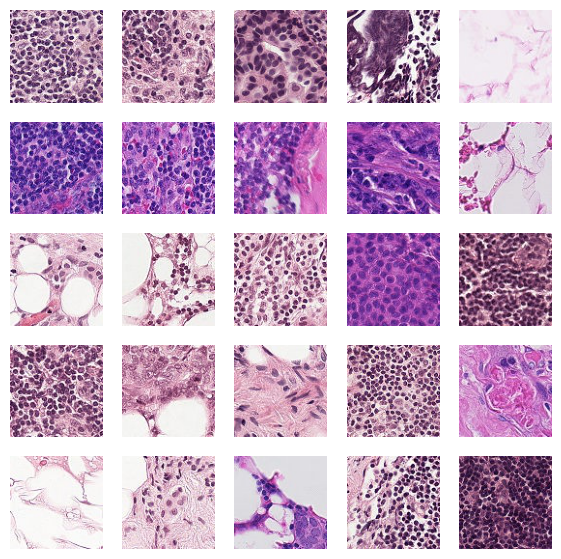

In [3]:
# Set the path to the images
train_images_path = '/kaggle/input/histopathologic-cancer-detection/train/'

# Get a list of image file names
image_files = os.listdir(train_images_path)

# Randomly select a few images
num_images_to_show = 25
selected_images = random.sample(image_files, num_images_to_show)

# Plot the selected images in a grid
fig, axes = plt.subplots(5, 5, figsize=(7, 7))
axes = axes.ravel()

for i, img_name in enumerate(selected_images):
    img_path = os.path.join(train_images_path, img_name)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

# 3.Model to choose

For the problem of histopathologic cancer detection, we can start with a Convolutional Neural Network (CNN) as it is well-suited for image classification tasks. Below, I will describe a possible model architecture and the reasoning behind the choices made.

** Input Layer: The model accepts RGB images of size (96, 96) pixels.

** Convolutional Layers: The model consists of 5 convolutional layers, each followed by batch normalization, ReLU activation function, and max-pooling layer. The first layer applies 32 filters of size (3, 3) to capture basic features such as edges and textures, and the number of filters increases up to 512 in the last layer to learn more complex features. The padding is set to 1 to preserve the spatial dimensions of the input.

** Flatten Layer: The output from the last convolutional layer is flattened into a 1D array of size 4608 before being passed to the fully connected layers.

** Fully Connected Layers: The model has 2 fully connected layers, with 256 and 2 neurons respectively. The first layer has a ReLU activation function and batch normalization, while the second layer has no activation function. Dropout with a rate of 0.4 is applied after the first fully connected layer to reduce overfitting.

** Output Layer: The final layer is a dense layer with 2 neurons and no activation function, which produces the logits for each class.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        num_classes = 2
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.fc = nn.Sequential(
                  nn.Linear(512 * 3 * 3, 256),
                  nn.ReLU(inplace=True),
                  nn.BatchNorm1d(256),
                  nn.Dropout(0.4),
                  nn.Linear(256, num_classes))  

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.reshape(x.shape[0], -1) 
        x = self.fc(x)
        return x


#summary(cnn_model, input_size=(3, 46, 46), device=device.type)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CancerNet().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

# 4. Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

**4.1 Split the datasets**

In [5]:
import os
import pandas as pd
import numpy as np

!pip install scikit-learn
#!conda install scikit-learn -y

!pip install scikit-image
#!conda install scikit-image -y

from skimage.io import imread
from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the first image using the file name and path
first_image = imread(os.path.join(train_images_path, image_files[0]))

# Get the dimensions of the image
height, width, channels = first_image.shape

print(f"Image width: {width}")
print(f"Image height: {height}")
print(f"Image dimensions: {width} x {height} x {channels}")

# Load train labels
train_labels_df = pd.read_csv(train_labels_path)

# Select 0.01% of the data
selected_data = train_labels_df.sample(frac = 0.99, random_state=42)

# Split the selected dataset into training and validation sets (1/10 for training)
train_df, val_df = train_test_split(selected_data, train_size=0.7, random_state=42)

print(f"Number of images in train_labels_df: {train_labels_df.shape[0]}")
print(f"Number of images in selected_data: {selected_data.shape[0]}")
print(f"Number of images in train_df: {train_df.shape[0]}")
print(f"Number of images in val_df: {val_df.shape[0]}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.8 MB ? eta -:--:--

     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/9.8 MB 30.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 6.7/9.8 MB 64.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 9.8/9.8 MB 77.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 50.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 25.3 MB/s eta 0:00:00


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/13.4 MB ? eta -:--:--

     ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/13.4 MB 32.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 7.2/13.4 MB 68.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 12.3/13.4 MB 131.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 71.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 3.4/3.4 MB 151.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 68.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/43.4 MB ? eta -:--:--

     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/43.4 MB 139.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/43.4 MB 136.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━ 23.5/43.4 MB 125.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 27.8/43.4 MB 119.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 37.2/43.4 MB 130.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 41.8/43.4 MB 128.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 129.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 11.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 KB 16.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/6.9 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 5.0/6.9 MB 151.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.1 MB/s eta 0:00:00


  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1


    Uninstalling scipy-1.10.1:


      Successfully uninstalled scipy-1.10.1


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Image width: 96
Image height: 96
Image dimensions: 96 x 96 x 3


Number of images in train_labels_df: 220025
Number of images in selected_data: 217825
Number of images in train_df: 152477
Number of images in val_df: 65348


**4.2 Preprocess the image data (resize, normalize, etc.)**

In [6]:
# Create a custom dataset class
class CancerDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0]) + '.tif'
        image = imread(img_name)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

transform_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])


# Create datasets and data loaders
train_dataset = CancerDataset(train_df, train_images_path, transform=transform_train)
val_dataset = CancerDataset(val_df, train_images_path, transform=transform_val)
#test_dataset = CancerDataset(val_df, train_images_path, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

**4.3 Build and evaluate our model**

In [7]:
import tqdm

learning_rate = 0.001  # Define the learning rate for the optimizer

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

# Compile the model
#optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
#criterion = torch.nn.BCEWithLogitsLoss()


# Train the model
num_epochs = 5
train_loss_history = []
val_loss_history = []

# Initialize variables for checkpointing
checkpoint_path = "/kaggle/working/checkpoint.pth1"
best_val_loss = float("inf")

# Reload the checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    train_loss = checkpoint['train_loss_history']
    val_loss = checkpoint['val_loss_history']

    print(f"Model successfully reloaded from checkpoint at epoch {epoch}")


for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
       
    for images, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1} (Training)"):
        images, labels = images.to(device), labels.to(device)

        # Rest of the code inside the loop
        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs.squeeze(), labels.float())
        #loss = criterion(outputs.squeeze(), labels.unsqueeze(1))
        loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1} (Validation)"):
            images, labels = images.to(device), labels.to(device)
                
            outputs = model(images)
            #loss = criterion(outputs.squeeze(), labels.float())
            #loss = criterion(outputs.squeeze(), labels.unsqueeze(1))
            loss = criterion(outputs, labels.long())

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Checkpoint the model if the validation loss improves
    if val_loss < best_val_loss:
        print("Saving checkpoint...")
        best_val_loss = val_loss
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss_history": train_loss_history,
            "val_loss_history": val_loss_history,
        }
        torch.save(checkpoint, checkpoint_path)


Epoch 1 (Training):   0%|          | 0/4765 [00:00<?, ?it/s]

Epoch 1 (Training):   0%|          | 1/4765 [00:00<32:02,  2.48it/s]

Epoch 1 (Training):   0%|          | 2/4765 [00:00<28:47,  2.76it/s]

Epoch 1 (Training):   0%|          | 3/4765 [00:01<27:20,  2.90it/s]

Epoch 1 (Training):   0%|          | 4/4765 [00:01<26:35,  2.98it/s]

Epoch 1 (Training):   0%|          | 5/4765 [00:01<26:04,  3.04it/s]

Epoch 1 (Training):   0%|          | 6/4765 [00:02<25:48,  3.07it/s]

Epoch 1 (Training):   0%|          | 7/4765 [00:02<25:36,  3.10it/s]

Epoch 1 (Training):   0%|          | 8/4765 [00:02<25:43,  3.08it/s]

Epoch 1 (Training):   0%|          | 9/4765 [00:02<25:26,  3.11it/s]

Epoch 1 (Training):   0%|          | 10/4765 [00:03<25:10,  3.15it/s]

Epoch 1 (Training):   0%|          | 11/4765 [00:03<24:57,  3.18it/s]

Epoch 1 (Training):   0%|          | 12/4765 [00:03<24:29,  3.23it/s]

Epoch 1 (Training):   0%|          | 13/4765 [00:04<24:24,  3.25it/s]

Epoch 1 (Training):   0%|          | 14/4765 [00:04<24:08,  3.28it/s]

Epoch 1 (Training):   0%|          | 15/4765 [00:04<24:25,  3.24it/s]

Epoch 1 (Training):   0%|          | 16/4765 [00:05<24:46,  3.19it/s]

Epoch 1 (Training):   0%|          | 17/4765 [00:05<26:02,  3.04it/s]

Epoch 1 (Training):   0%|          | 18/4765 [00:05<25:39,  3.08it/s]

Epoch 1 (Training):   0%|          | 19/4765 [00:06<24:46,  3.19it/s]

Epoch 1 (Training):   0%|          | 20/4765 [00:06<24:29,  3.23it/s]

Epoch 1 (Training):   0%|          | 21/4765 [00:06<24:12,  3.27it/s]

Epoch 1 (Training):   0%|          | 22/4765 [00:07<24:27,  3.23it/s]

Epoch 1 (Training):   0%|          | 23/4765 [00:07<25:00,  3.16it/s]

Epoch 1 (Training):   1%|          | 24/4765 [00:07<25:00,  3.16it/s]

Epoch 1 (Training):   1%|          | 25/4765 [00:07<24:23,  3.24it/s]

Epoch 1 (Training):   1%|          | 26/4765 [00:08<24:18,  3.25it/s]

Epoch 1 (Training):   1%|          | 27/4765 [00:08<24:16,  3.25it/s]

Epoch 1 (Training):   1%|          | 28/4765 [00:08<24:05,  3.28it/s]

Epoch 1 (Training):   1%|          | 29/4765 [00:09<23:44,  3.33it/s]

Epoch 1 (Training):   1%|          | 30/4765 [00:09<23:44,  3.32it/s]

Epoch 1 (Training):   1%|          | 31/4765 [00:09<24:08,  3.27it/s]

Epoch 1 (Training):   1%|          | 32/4765 [00:10<24:32,  3.21it/s]

Epoch 1 (Training):   1%|          | 33/4765 [00:10<24:41,  3.19it/s]

Epoch 1 (Training):   1%|          | 34/4765 [00:10<24:35,  3.21it/s]

Epoch 1 (Training):   1%|          | 35/4765 [00:11<24:21,  3.24it/s]

Epoch 1 (Training):   1%|          | 36/4765 [00:11<24:21,  3.24it/s]

Epoch 1 (Training):   1%|          | 37/4765 [00:11<24:04,  3.27it/s]

Epoch 1 (Training):   1%|          | 38/4765 [00:11<24:14,  3.25it/s]

Epoch 1 (Training):   1%|          | 39/4765 [00:12<24:46,  3.18it/s]

Epoch 1 (Training):   1%|          | 40/4765 [00:12<24:38,  3.20it/s]

Epoch 1 (Training):   1%|          | 41/4765 [00:12<24:38,  3.20it/s]

Epoch 1 (Training):   1%|          | 42/4765 [00:13<24:27,  3.22it/s]

Epoch 1 (Training):   1%|          | 43/4765 [00:13<23:56,  3.29it/s]

Epoch 1 (Training):   1%|          | 44/4765 [00:13<23:47,  3.31it/s]

Epoch 1 (Training):   1%|          | 45/4765 [00:14<24:23,  3.22it/s]

Epoch 1 (Training):   1%|          | 46/4765 [00:14<24:38,  3.19it/s]

Epoch 1 (Training):   1%|          | 47/4765 [00:14<24:30,  3.21it/s]

Epoch 1 (Training):   1%|          | 48/4765 [00:15<24:27,  3.21it/s]

Epoch 1 (Training):   1%|          | 49/4765 [00:15<24:23,  3.22it/s]

Epoch 1 (Training):   1%|          | 50/4765 [00:15<25:04,  3.13it/s]

Epoch 1 (Training):   1%|          | 51/4765 [00:16<24:28,  3.21it/s]

Epoch 1 (Training):   1%|          | 52/4765 [00:16<24:38,  3.19it/s]

Epoch 1 (Training):   1%|          | 53/4765 [00:16<24:26,  3.21it/s]

Epoch 1 (Training):   1%|          | 54/4765 [00:16<24:14,  3.24it/s]

Epoch 1 (Training):   1%|          | 55/4765 [00:17<24:31,  3.20it/s]

Epoch 1 (Training):   1%|          | 56/4765 [00:17<24:44,  3.17it/s]

Epoch 1 (Training):   1%|          | 57/4765 [00:17<24:52,  3.16it/s]

Epoch 1 (Training):   1%|          | 58/4765 [00:18<24:41,  3.18it/s]

Epoch 1 (Training):   1%|          | 59/4765 [00:18<24:57,  3.14it/s]

Epoch 1 (Training):   1%|▏         | 60/4765 [00:18<24:44,  3.17it/s]

Epoch 1 (Training):   1%|▏         | 61/4765 [00:19<24:10,  3.24it/s]

Epoch 1 (Training):   1%|▏         | 62/4765 [00:19<24:09,  3.24it/s]

Epoch 1 (Training):   1%|▏         | 63/4765 [00:19<24:00,  3.26it/s]

Epoch 1 (Training):   1%|▏         | 64/4765 [00:20<23:59,  3.27it/s]

Epoch 1 (Training):   1%|▏         | 65/4765 [00:20<24:05,  3.25it/s]

Epoch 1 (Training):   1%|▏         | 66/4765 [00:20<24:03,  3.26it/s]

Epoch 1 (Training):   1%|▏         | 67/4765 [00:20<24:34,  3.19it/s]

Epoch 1 (Training):   1%|▏         | 68/4765 [00:21<24:22,  3.21it/s]

Epoch 1 (Training):   1%|▏         | 69/4765 [00:21<24:11,  3.23it/s]

Epoch 1 (Training):   1%|▏         | 70/4765 [00:21<24:26,  3.20it/s]

Epoch 1 (Training):   1%|▏         | 71/4765 [00:22<24:55,  3.14it/s]

Epoch 1 (Training):   2%|▏         | 72/4765 [00:22<24:54,  3.14it/s]

Epoch 1 (Training):   2%|▏         | 73/4765 [00:22<24:57,  3.13it/s]

Epoch 1 (Training):   2%|▏         | 74/4765 [00:23<25:13,  3.10it/s]

Epoch 1 (Training):   2%|▏         | 75/4765 [00:23<24:52,  3.14it/s]

Epoch 1 (Training):   2%|▏         | 76/4765 [00:23<24:35,  3.18it/s]

Epoch 1 (Training):   2%|▏         | 77/4765 [00:24<24:32,  3.18it/s]

Epoch 1 (Training):   2%|▏         | 78/4765 [00:24<24:46,  3.15it/s]

Epoch 1 (Training):   2%|▏         | 79/4765 [00:24<25:10,  3.10it/s]

Epoch 1 (Training):   2%|▏         | 80/4765 [00:25<25:09,  3.10it/s]

Epoch 1 (Training):   2%|▏         | 81/4765 [00:25<25:16,  3.09it/s]

Epoch 1 (Training):   2%|▏         | 82/4765 [00:25<24:51,  3.14it/s]

Epoch 1 (Training):   2%|▏         | 83/4765 [00:26<24:54,  3.13it/s]

Epoch 1 (Training):   2%|▏         | 84/4765 [00:26<24:29,  3.18it/s]

Epoch 1 (Training):   2%|▏         | 85/4765 [00:26<24:08,  3.23it/s]

Epoch 1 (Training):   2%|▏         | 86/4765 [00:27<24:17,  3.21it/s]

Epoch 1 (Training):   2%|▏         | 87/4765 [00:27<25:05,  3.11it/s]

Epoch 1 (Training):   2%|▏         | 88/4765 [00:27<25:13,  3.09it/s]

Epoch 1 (Training):   2%|▏         | 89/4765 [00:27<24:44,  3.15it/s]

Epoch 1 (Training):   2%|▏         | 90/4765 [00:28<24:30,  3.18it/s]

Epoch 1 (Training):   2%|▏         | 91/4765 [00:28<23:56,  3.25it/s]

Epoch 1 (Training):   2%|▏         | 92/4765 [00:28<23:46,  3.28it/s]

Epoch 1 (Training):   2%|▏         | 93/4765 [00:29<23:55,  3.26it/s]

Epoch 1 (Training):   2%|▏         | 94/4765 [00:29<23:55,  3.25it/s]

Epoch 1 (Training):   2%|▏         | 95/4765 [00:29<24:12,  3.22it/s]

Epoch 1 (Training):   2%|▏         | 96/4765 [00:30<23:56,  3.25it/s]

Epoch 1 (Training):   2%|▏         | 97/4765 [00:30<23:31,  3.31it/s]

Epoch 1 (Training):   2%|▏         | 98/4765 [00:30<23:33,  3.30it/s]

Epoch 1 (Training):   2%|▏         | 99/4765 [00:31<23:42,  3.28it/s]

Epoch 1 (Training):   2%|▏         | 100/4765 [00:31<23:55,  3.25it/s]

Epoch 1 (Training):   2%|▏         | 101/4765 [00:31<24:12,  3.21it/s]

Epoch 1 (Training):   2%|▏         | 102/4765 [00:32<25:09,  3.09it/s]

Epoch 1 (Training):   2%|▏         | 103/4765 [00:32<25:33,  3.04it/s]

Epoch 1 (Training):   2%|▏         | 104/4765 [00:32<25:46,  3.01it/s]

Epoch 1 (Training):   2%|▏         | 105/4765 [00:33<25:44,  3.02it/s]

Epoch 1 (Training):   2%|▏         | 106/4765 [00:33<25:50,  3.01it/s]

Epoch 1 (Training):   2%|▏         | 107/4765 [00:33<25:21,  3.06it/s]

Epoch 1 (Training):   2%|▏         | 108/4765 [00:33<24:45,  3.13it/s]

Epoch 1 (Training):   2%|▏         | 109/4765 [00:34<24:34,  3.16it/s]

Epoch 1 (Training):   2%|▏         | 110/4765 [00:34<24:10,  3.21it/s]

Epoch 1 (Training):   2%|▏         | 111/4765 [00:34<23:55,  3.24it/s]

Epoch 1 (Training):   2%|▏         | 112/4765 [00:35<24:02,  3.23it/s]

Epoch 1 (Training):   2%|▏         | 113/4765 [00:35<24:08,  3.21it/s]

Epoch 1 (Training):   2%|▏         | 114/4765 [00:35<23:50,  3.25it/s]

Epoch 1 (Training):   2%|▏         | 115/4765 [00:36<23:49,  3.25it/s]

Epoch 1 (Training):   2%|▏         | 116/4765 [00:36<23:46,  3.26it/s]

Epoch 1 (Training):   2%|▏         | 117/4765 [00:36<23:33,  3.29it/s]

Epoch 1 (Training):   2%|▏         | 118/4765 [00:37<23:46,  3.26it/s]

Epoch 1 (Training):   2%|▏         | 119/4765 [00:37<23:38,  3.27it/s]

Epoch 1 (Training):   3%|▎         | 120/4765 [00:37<23:41,  3.27it/s]

Epoch 1 (Training):   3%|▎         | 121/4765 [00:37<23:16,  3.33it/s]

Epoch 1 (Training):   3%|▎         | 122/4765 [00:38<23:14,  3.33it/s]

Epoch 1 (Training):   3%|▎         | 123/4765 [00:38<22:59,  3.37it/s]

Epoch 1 (Training):   3%|▎         | 124/4765 [00:38<22:43,  3.40it/s]

Epoch 1 (Training):   3%|▎         | 125/4765 [00:39<22:27,  3.44it/s]

Epoch 1 (Training):   3%|▎         | 126/4765 [00:39<22:39,  3.41it/s]

Epoch 1 (Training):   3%|▎         | 127/4765 [00:39<23:32,  3.28it/s]

Epoch 1 (Training):   3%|▎         | 128/4765 [00:40<23:38,  3.27it/s]

Epoch 1 (Training):   3%|▎         | 129/4765 [00:40<24:03,  3.21it/s]

Epoch 1 (Training):   3%|▎         | 130/4765 [00:40<23:49,  3.24it/s]

Epoch 1 (Training):   3%|▎         | 131/4765 [00:40<23:39,  3.26it/s]

Epoch 1 (Training):   3%|▎         | 132/4765 [00:41<23:37,  3.27it/s]

Epoch 1 (Training):   3%|▎         | 133/4765 [00:41<23:36,  3.27it/s]

Epoch 1 (Training):   3%|▎         | 134/4765 [00:41<24:01,  3.21it/s]

Epoch 1 (Training):   3%|▎         | 135/4765 [00:42<24:20,  3.17it/s]

Epoch 1 (Training):   3%|▎         | 136/4765 [00:42<24:24,  3.16it/s]

Epoch 1 (Training):   3%|▎         | 137/4765 [00:42<24:32,  3.14it/s]

Epoch 1 (Training):   3%|▎         | 138/4765 [00:43<24:22,  3.16it/s]

Epoch 1 (Training):   3%|▎         | 139/4765 [00:43<24:38,  3.13it/s]

Epoch 1 (Training):   3%|▎         | 140/4765 [00:43<24:34,  3.14it/s]

Epoch 1 (Training):   3%|▎         | 141/4765 [00:44<24:13,  3.18it/s]

Epoch 1 (Training):   3%|▎         | 142/4765 [00:44<24:52,  3.10it/s]

Epoch 1 (Training):   3%|▎         | 143/4765 [00:44<24:30,  3.14it/s]

Epoch 1 (Training):   3%|▎         | 144/4765 [00:45<24:34,  3.13it/s]

Epoch 1 (Training):   3%|▎         | 145/4765 [00:45<24:36,  3.13it/s]

Epoch 1 (Training):   3%|▎         | 146/4765 [00:45<24:28,  3.15it/s]

Epoch 1 (Training):   3%|▎         | 147/4765 [00:46<23:48,  3.23it/s]

Epoch 1 (Training):   3%|▎         | 148/4765 [00:46<23:34,  3.26it/s]

Epoch 1 (Training):   3%|▎         | 149/4765 [00:46<24:01,  3.20it/s]

Epoch 1 (Training):   3%|▎         | 150/4765 [00:46<24:30,  3.14it/s]

Epoch 1 (Training):   3%|▎         | 151/4765 [00:47<26:04,  2.95it/s]

Epoch 1 (Training):   3%|▎         | 152/4765 [00:47<26:42,  2.88it/s]

Epoch 1 (Training):   3%|▎         | 153/4765 [00:48<26:12,  2.93it/s]

Epoch 1 (Training):   3%|▎         | 154/4765 [00:48<25:54,  2.97it/s]

Epoch 1 (Training):   3%|▎         | 155/4765 [00:48<25:35,  3.00it/s]

Epoch 1 (Training):   3%|▎         | 156/4765 [00:49<24:48,  3.10it/s]

Epoch 1 (Training):   3%|▎         | 157/4765 [00:49<24:14,  3.17it/s]

Epoch 1 (Training):   3%|▎         | 158/4765 [00:49<23:50,  3.22it/s]

Epoch 1 (Training):   3%|▎         | 159/4765 [00:49<23:49,  3.22it/s]

Epoch 1 (Training):   3%|▎         | 160/4765 [00:50<24:33,  3.13it/s]

Epoch 1 (Training):   3%|▎         | 161/4765 [00:50<24:47,  3.09it/s]

Epoch 1 (Training):   3%|▎         | 162/4765 [00:50<24:48,  3.09it/s]

Epoch 1 (Training):   3%|▎         | 163/4765 [00:51<25:25,  3.02it/s]

Epoch 1 (Training):   3%|▎         | 164/4765 [00:51<25:29,  3.01it/s]

Epoch 1 (Training):   3%|▎         | 165/4765 [00:51<24:52,  3.08it/s]

Epoch 1 (Training):   3%|▎         | 166/4765 [00:52<24:39,  3.11it/s]

Epoch 1 (Training):   4%|▎         | 167/4765 [00:52<24:21,  3.15it/s]

Epoch 1 (Training):   4%|▎         | 168/4765 [00:52<24:01,  3.19it/s]

Epoch 1 (Training):   4%|▎         | 169/4765 [00:53<23:37,  3.24it/s]

Epoch 1 (Training):   4%|▎         | 170/4765 [00:53<23:50,  3.21it/s]

Epoch 1 (Training):   4%|▎         | 171/4765 [00:53<23:42,  3.23it/s]

Epoch 1 (Training):   4%|▎         | 172/4765 [00:54<23:51,  3.21it/s]

Epoch 1 (Training):   4%|▎         | 173/4765 [00:54<23:35,  3.24it/s]

Epoch 1 (Training):   4%|▎         | 174/4765 [00:54<24:09,  3.17it/s]

Epoch 1 (Training):   4%|▎         | 175/4765 [00:55<25:04,  3.05it/s]

Epoch 1 (Training):   4%|▎         | 176/4765 [00:55<24:43,  3.09it/s]

Epoch 1 (Training):   4%|▎         | 177/4765 [00:55<24:17,  3.15it/s]

Epoch 1 (Training):   4%|▎         | 178/4765 [00:55<24:07,  3.17it/s]

Epoch 1 (Training):   4%|▍         | 179/4765 [00:56<23:54,  3.20it/s]

Epoch 1 (Training):   4%|▍         | 180/4765 [00:56<23:52,  3.20it/s]

Epoch 1 (Training):   4%|▍         | 181/4765 [00:56<23:59,  3.18it/s]

Epoch 1 (Training):   4%|▍         | 182/4765 [00:57<24:08,  3.16it/s]

Epoch 1 (Training):   4%|▍         | 183/4765 [00:57<23:55,  3.19it/s]

Epoch 1 (Training):   4%|▍         | 184/4765 [00:57<23:48,  3.21it/s]

Epoch 1 (Training):   4%|▍         | 185/4765 [00:58<23:52,  3.20it/s]

Epoch 1 (Training):   4%|▍         | 186/4765 [00:58<23:31,  3.24it/s]

Epoch 1 (Training):   4%|▍         | 187/4765 [00:58<23:28,  3.25it/s]

Epoch 1 (Training):   4%|▍         | 188/4765 [00:59<23:32,  3.24it/s]

Epoch 1 (Training):   4%|▍         | 189/4765 [00:59<23:19,  3.27it/s]

Epoch 1 (Training):   4%|▍         | 190/4765 [00:59<23:11,  3.29it/s]

Epoch 1 (Training):   4%|▍         | 191/4765 [00:59<23:08,  3.30it/s]

Epoch 1 (Training):   4%|▍         | 192/4765 [01:00<22:51,  3.33it/s]

Epoch 1 (Training):   4%|▍         | 193/4765 [01:00<22:23,  3.40it/s]

Epoch 1 (Training):   4%|▍         | 194/4765 [01:00<22:38,  3.36it/s]

Epoch 1 (Training):   4%|▍         | 195/4765 [01:01<22:33,  3.38it/s]

Epoch 1 (Training):   4%|▍         | 196/4765 [01:01<22:38,  3.36it/s]

Epoch 1 (Training):   4%|▍         | 197/4765 [01:01<22:56,  3.32it/s]

Epoch 1 (Training):   4%|▍         | 198/4765 [01:02<23:00,  3.31it/s]

Epoch 1 (Training):   4%|▍         | 199/4765 [01:02<23:19,  3.26it/s]

Epoch 1 (Training):   4%|▍         | 200/4765 [01:02<23:17,  3.27it/s]

Epoch 1 (Training):   4%|▍         | 201/4765 [01:02<23:14,  3.27it/s]

Epoch 1 (Training):   4%|▍         | 202/4765 [01:03<22:59,  3.31it/s]

Epoch 1 (Training):   4%|▍         | 203/4765 [01:03<23:00,  3.30it/s]

Epoch 1 (Training):   4%|▍         | 204/4765 [01:03<23:14,  3.27it/s]

Epoch 1 (Training):   4%|▍         | 205/4765 [01:04<22:48,  3.33it/s]

Epoch 1 (Training):   4%|▍         | 206/4765 [01:04<22:57,  3.31it/s]

Epoch 1 (Training):   4%|▍         | 207/4765 [01:04<23:09,  3.28it/s]

Epoch 1 (Training):   4%|▍         | 208/4765 [01:05<23:31,  3.23it/s]

Epoch 1 (Training):   4%|▍         | 209/4765 [01:05<24:31,  3.10it/s]

Epoch 1 (Training):   4%|▍         | 210/4765 [01:05<24:23,  3.11it/s]

Epoch 1 (Training):   4%|▍         | 211/4765 [01:06<24:31,  3.09it/s]

Epoch 1 (Training):   4%|▍         | 212/4765 [01:06<24:08,  3.14it/s]

Epoch 1 (Training):   4%|▍         | 213/4765 [01:06<23:35,  3.22it/s]

Epoch 1 (Training):   4%|▍         | 214/4765 [01:07<23:28,  3.23it/s]

Epoch 1 (Training):   5%|▍         | 215/4765 [01:07<23:20,  3.25it/s]

Epoch 1 (Training):   5%|▍         | 216/4765 [01:07<23:16,  3.26it/s]

Epoch 1 (Training):   5%|▍         | 217/4765 [01:07<23:20,  3.25it/s]

Epoch 1 (Training):   5%|▍         | 218/4765 [01:08<23:18,  3.25it/s]

Epoch 1 (Training):   5%|▍         | 219/4765 [01:08<22:53,  3.31it/s]

Epoch 1 (Training):   5%|▍         | 220/4765 [01:08<22:42,  3.34it/s]

Epoch 1 (Training):   5%|▍         | 221/4765 [01:09<22:36,  3.35it/s]

Epoch 1 (Training):   5%|▍         | 222/4765 [01:09<22:36,  3.35it/s]

Epoch 1 (Training):   5%|▍         | 223/4765 [01:09<23:29,  3.22it/s]

Epoch 1 (Training):   5%|▍         | 224/4765 [01:10<23:39,  3.20it/s]

Epoch 1 (Training):   5%|▍         | 225/4765 [01:10<23:59,  3.15it/s]

Epoch 1 (Training):   5%|▍         | 226/4765 [01:10<23:46,  3.18it/s]

Epoch 1 (Training):   5%|▍         | 227/4765 [01:11<23:18,  3.25it/s]

Epoch 1 (Training):   5%|▍         | 228/4765 [01:11<23:27,  3.22it/s]

Epoch 1 (Training):   5%|▍         | 229/4765 [01:11<23:33,  3.21it/s]

Epoch 1 (Training):   5%|▍         | 230/4765 [01:11<23:29,  3.22it/s]

Epoch 1 (Training):   5%|▍         | 231/4765 [01:12<23:53,  3.16it/s]

Epoch 1 (Training):   5%|▍         | 232/4765 [01:12<24:13,  3.12it/s]

Epoch 1 (Training):   5%|▍         | 233/4765 [01:12<23:51,  3.16it/s]

Epoch 1 (Training):   5%|▍         | 234/4765 [01:13<24:07,  3.13it/s]

Epoch 1 (Training):   5%|▍         | 235/4765 [01:13<23:18,  3.24it/s]

Epoch 1 (Training):   5%|▍         | 236/4765 [01:13<22:51,  3.30it/s]

Epoch 1 (Training):   5%|▍         | 237/4765 [01:14<23:02,  3.28it/s]

Epoch 1 (Training):   5%|▍         | 238/4765 [01:14<23:29,  3.21it/s]

Epoch 1 (Training):   5%|▌         | 239/4765 [01:14<23:15,  3.24it/s]

Epoch 1 (Training):   5%|▌         | 240/4765 [01:15<23:54,  3.16it/s]

Epoch 1 (Training):   5%|▌         | 241/4765 [01:15<23:53,  3.15it/s]

Epoch 1 (Training):   5%|▌         | 242/4765 [01:15<23:38,  3.19it/s]

Epoch 1 (Training):   5%|▌         | 243/4765 [01:16<23:27,  3.21it/s]

Epoch 1 (Training):   5%|▌         | 244/4765 [01:16<23:29,  3.21it/s]

Epoch 1 (Training):   5%|▌         | 245/4765 [01:16<23:09,  3.25it/s]

Epoch 1 (Training):   5%|▌         | 246/4765 [01:16<22:58,  3.28it/s]

Epoch 1 (Training):   5%|▌         | 247/4765 [01:17<24:03,  3.13it/s]

Epoch 1 (Training):   5%|▌         | 248/4765 [01:17<24:46,  3.04it/s]

Epoch 1 (Training):   5%|▌         | 249/4765 [01:17<24:23,  3.09it/s]

Epoch 1 (Training):   5%|▌         | 250/4765 [01:18<23:44,  3.17it/s]

Epoch 1 (Training):   5%|▌         | 251/4765 [01:18<23:29,  3.20it/s]

Epoch 1 (Training):   5%|▌         | 252/4765 [01:18<23:07,  3.25it/s]

Epoch 1 (Training):   5%|▌         | 253/4765 [01:19<22:50,  3.29it/s]

Epoch 1 (Training):   5%|▌         | 254/4765 [01:19<22:59,  3.27it/s]

Epoch 1 (Training):   5%|▌         | 255/4765 [01:19<22:50,  3.29it/s]

Epoch 1 (Training):   5%|▌         | 256/4765 [01:20<22:50,  3.29it/s]

Epoch 1 (Training):   5%|▌         | 257/4765 [01:20<22:49,  3.29it/s]

Epoch 1 (Training):   5%|▌         | 258/4765 [01:20<22:46,  3.30it/s]

Epoch 1 (Training):   5%|▌         | 259/4765 [01:20<22:44,  3.30it/s]

Epoch 1 (Training):   5%|▌         | 260/4765 [01:21<22:31,  3.33it/s]

Epoch 1 (Training):   5%|▌         | 261/4765 [01:21<22:21,  3.36it/s]

Epoch 1 (Training):   5%|▌         | 262/4765 [01:21<22:26,  3.35it/s]

Epoch 1 (Training):   6%|▌         | 263/4765 [01:22<22:35,  3.32it/s]

Epoch 1 (Training):   6%|▌         | 264/4765 [01:22<23:05,  3.25it/s]

Epoch 1 (Training):   6%|▌         | 265/4765 [01:22<22:36,  3.32it/s]

Epoch 1 (Training):   6%|▌         | 266/4765 [01:23<22:52,  3.28it/s]

Epoch 1 (Training):   6%|▌         | 267/4765 [01:23<22:48,  3.29it/s]

Epoch 1 (Training):   6%|▌         | 268/4765 [01:23<22:24,  3.34it/s]

Epoch 1 (Training):   6%|▌         | 269/4765 [01:23<22:10,  3.38it/s]

Epoch 1 (Training):   6%|▌         | 270/4765 [01:24<22:24,  3.34it/s]

Epoch 1 (Training):   6%|▌         | 271/4765 [01:24<22:56,  3.26it/s]

Epoch 1 (Training):   6%|▌         | 272/4765 [01:24<23:32,  3.18it/s]

Epoch 1 (Training):   6%|▌         | 273/4765 [01:25<23:42,  3.16it/s]

Epoch 1 (Training):   6%|▌         | 274/4765 [01:25<24:02,  3.11it/s]

Epoch 1 (Training):   6%|▌         | 275/4765 [01:25<24:02,  3.11it/s]

Epoch 1 (Training):   6%|▌         | 276/4765 [01:26<23:21,  3.20it/s]

Epoch 1 (Training):   6%|▌         | 277/4765 [01:26<22:47,  3.28it/s]

Epoch 1 (Training):   6%|▌         | 278/4765 [01:26<22:27,  3.33it/s]

Epoch 1 (Training):   6%|▌         | 279/4765 [01:27<22:27,  3.33it/s]

Epoch 1 (Training):   6%|▌         | 280/4765 [01:27<22:22,  3.34it/s]

Epoch 1 (Training):   6%|▌         | 281/4765 [01:27<22:24,  3.33it/s]

Epoch 1 (Training):   6%|▌         | 282/4765 [01:27<22:11,  3.37it/s]

Epoch 1 (Training):   6%|▌         | 283/4765 [01:28<22:17,  3.35it/s]

Epoch 1 (Training):   6%|▌         | 284/4765 [01:28<22:22,  3.34it/s]

Epoch 1 (Training):   6%|▌         | 285/4765 [01:28<22:01,  3.39it/s]

Epoch 1 (Training):   6%|▌         | 286/4765 [01:29<21:57,  3.40it/s]

Epoch 1 (Training):   6%|▌         | 287/4765 [01:29<22:08,  3.37it/s]

Epoch 1 (Training):   6%|▌         | 288/4765 [01:29<22:41,  3.29it/s]

Epoch 1 (Training):   6%|▌         | 289/4765 [01:30<22:58,  3.25it/s]

Epoch 1 (Training):   6%|▌         | 290/4765 [01:30<23:33,  3.17it/s]

Epoch 1 (Training):   6%|▌         | 291/4765 [01:30<23:29,  3.18it/s]

Epoch 1 (Training):   6%|▌         | 292/4765 [01:31<23:07,  3.22it/s]

Epoch 1 (Training):   6%|▌         | 293/4765 [01:31<23:51,  3.12it/s]

Epoch 1 (Training):   6%|▌         | 294/4765 [01:31<24:15,  3.07it/s]

Epoch 1 (Training):   6%|▌         | 295/4765 [01:32<24:02,  3.10it/s]

Epoch 1 (Training):   6%|▌         | 296/4765 [01:32<23:56,  3.11it/s]

Epoch 1 (Training):   6%|▌         | 297/4765 [01:32<23:57,  3.11it/s]

Epoch 1 (Training):   6%|▋         | 298/4765 [01:33<24:18,  3.06it/s]

Epoch 1 (Training):   6%|▋         | 299/4765 [01:33<23:38,  3.15it/s]

Epoch 1 (Training):   6%|▋         | 300/4765 [01:33<23:17,  3.20it/s]

Epoch 1 (Training):   6%|▋         | 301/4765 [01:33<23:16,  3.20it/s]

Epoch 1 (Training):   6%|▋         | 302/4765 [01:34<23:15,  3.20it/s]

Epoch 1 (Training):   6%|▋         | 303/4765 [01:34<22:45,  3.27it/s]

Epoch 1 (Training):   6%|▋         | 304/4765 [01:34<22:41,  3.28it/s]

Epoch 1 (Training):   6%|▋         | 305/4765 [01:35<23:22,  3.18it/s]

Epoch 1 (Training):   6%|▋         | 306/4765 [01:35<23:25,  3.17it/s]

Epoch 1 (Training):   6%|▋         | 307/4765 [01:35<22:57,  3.24it/s]

Epoch 1 (Training):   6%|▋         | 308/4765 [01:36<22:32,  3.29it/s]

Epoch 1 (Training):   6%|▋         | 309/4765 [01:36<22:36,  3.28it/s]

Epoch 1 (Training):   7%|▋         | 310/4765 [01:36<22:52,  3.25it/s]

Epoch 1 (Training):   7%|▋         | 311/4765 [01:37<23:06,  3.21it/s]

Epoch 1 (Training):   7%|▋         | 312/4765 [01:37<23:02,  3.22it/s]

Epoch 1 (Training):   7%|▋         | 313/4765 [01:37<23:04,  3.21it/s]

Epoch 1 (Training):   7%|▋         | 314/4765 [01:37<24:01,  3.09it/s]

Epoch 1 (Training):   7%|▋         | 315/4765 [01:38<23:14,  3.19it/s]

Epoch 1 (Training):   7%|▋         | 316/4765 [01:38<22:38,  3.28it/s]

Epoch 1 (Training):   7%|▋         | 317/4765 [01:38<22:38,  3.27it/s]

Epoch 1 (Training):   7%|▋         | 318/4765 [01:39<22:14,  3.33it/s]

Epoch 1 (Training):   7%|▋         | 319/4765 [01:39<22:21,  3.31it/s]

Epoch 1 (Training):   7%|▋         | 320/4765 [01:39<22:53,  3.24it/s]

Epoch 1 (Training):   7%|▋         | 321/4765 [01:40<23:37,  3.14it/s]

Epoch 1 (Training):   7%|▋         | 322/4765 [01:40<23:41,  3.13it/s]

Epoch 1 (Training):   7%|▋         | 323/4765 [01:40<23:36,  3.14it/s]

Epoch 1 (Training):   7%|▋         | 324/4765 [01:41<23:18,  3.18it/s]

Epoch 1 (Training):   7%|▋         | 325/4765 [01:41<22:51,  3.24it/s]

Epoch 1 (Training):   7%|▋         | 326/4765 [01:41<22:48,  3.24it/s]

Epoch 1 (Training):   7%|▋         | 327/4765 [01:41<23:07,  3.20it/s]

Epoch 1 (Training):   7%|▋         | 328/4765 [01:42<23:00,  3.21it/s]

Epoch 1 (Training):   7%|▋         | 329/4765 [01:42<23:00,  3.21it/s]

Epoch 1 (Training):   7%|▋         | 330/4765 [01:42<23:02,  3.21it/s]

Epoch 1 (Training):   7%|▋         | 331/4765 [01:43<22:51,  3.23it/s]

Epoch 1 (Training):   7%|▋         | 332/4765 [01:43<22:37,  3.27it/s]

Epoch 1 (Training):   7%|▋         | 333/4765 [01:43<22:41,  3.26it/s]

Epoch 1 (Training):   7%|▋         | 334/4765 [01:44<22:25,  3.29it/s]

Epoch 1 (Training):   7%|▋         | 335/4765 [01:44<22:59,  3.21it/s]

Epoch 1 (Training):   7%|▋         | 336/4765 [01:44<23:09,  3.19it/s]

Epoch 1 (Training):   7%|▋         | 337/4765 [01:45<22:56,  3.22it/s]

Epoch 1 (Training):   7%|▋         | 338/4765 [01:45<22:17,  3.31it/s]

Epoch 1 (Training):   7%|▋         | 339/4765 [01:45<22:45,  3.24it/s]

Epoch 1 (Training):   7%|▋         | 340/4765 [01:45<22:45,  3.24it/s]

Epoch 1 (Training):   7%|▋         | 341/4765 [01:46<22:36,  3.26it/s]

Epoch 1 (Training):   7%|▋         | 342/4765 [01:46<22:43,  3.24it/s]

Epoch 1 (Training):   7%|▋         | 343/4765 [01:46<23:06,  3.19it/s]

Epoch 1 (Training):   7%|▋         | 344/4765 [01:47<23:38,  3.12it/s]

Epoch 1 (Training):   7%|▋         | 345/4765 [01:47<24:02,  3.06it/s]

Epoch 1 (Training):   7%|▋         | 346/4765 [01:47<23:49,  3.09it/s]

Epoch 1 (Training):   7%|▋         | 347/4765 [01:48<23:38,  3.12it/s]

Epoch 1 (Training):   7%|▋         | 348/4765 [01:48<24:07,  3.05it/s]

Epoch 1 (Training):   7%|▋         | 349/4765 [01:48<23:40,  3.11it/s]

Epoch 1 (Training):   7%|▋         | 350/4765 [01:49<23:03,  3.19it/s]

Epoch 1 (Training):   7%|▋         | 351/4765 [01:49<22:59,  3.20it/s]

Epoch 1 (Training):   7%|▋         | 352/4765 [01:49<23:30,  3.13it/s]

Epoch 1 (Training):   7%|▋         | 353/4765 [01:50<23:31,  3.12it/s]

Epoch 1 (Training):   7%|▋         | 354/4765 [01:50<22:59,  3.20it/s]

Epoch 1 (Training):   7%|▋         | 355/4765 [01:50<23:00,  3.19it/s]

Epoch 1 (Training):   7%|▋         | 356/4765 [01:51<22:41,  3.24it/s]

Epoch 1 (Training):   7%|▋         | 357/4765 [01:51<22:57,  3.20it/s]

Epoch 1 (Training):   8%|▊         | 358/4765 [01:51<22:40,  3.24it/s]

Epoch 1 (Training):   8%|▊         | 359/4765 [01:52<23:35,  3.11it/s]

Epoch 1 (Training):   8%|▊         | 360/4765 [01:52<23:14,  3.16it/s]

Epoch 1 (Training):   8%|▊         | 361/4765 [01:52<23:28,  3.13it/s]

Epoch 1 (Training):   8%|▊         | 362/4765 [01:52<22:58,  3.19it/s]

Epoch 1 (Training):   8%|▊         | 363/4765 [01:53<22:53,  3.20it/s]

Epoch 1 (Training):   8%|▊         | 364/4765 [01:53<22:44,  3.23it/s]

Epoch 1 (Training):   8%|▊         | 365/4765 [01:53<22:25,  3.27it/s]

Epoch 1 (Training):   8%|▊         | 366/4765 [01:54<21:51,  3.35it/s]

Epoch 1 (Training):   8%|▊         | 367/4765 [01:54<21:36,  3.39it/s]

Epoch 1 (Training):   8%|▊         | 368/4765 [01:54<21:53,  3.35it/s]

Epoch 1 (Training):   8%|▊         | 369/4765 [01:55<22:25,  3.27it/s]

Epoch 1 (Training):   8%|▊         | 370/4765 [01:55<22:23,  3.27it/s]

Epoch 1 (Training):   8%|▊         | 371/4765 [01:55<22:38,  3.24it/s]

Epoch 1 (Training):   8%|▊         | 372/4765 [01:55<22:26,  3.26it/s]

Epoch 1 (Training):   8%|▊         | 373/4765 [01:56<22:05,  3.31it/s]

Epoch 1 (Training):   8%|▊         | 374/4765 [01:56<21:49,  3.35it/s]

Epoch 1 (Training):   8%|▊         | 375/4765 [01:56<22:12,  3.29it/s]

Epoch 1 (Training):   8%|▊         | 376/4765 [01:57<22:07,  3.31it/s]

Epoch 1 (Training):   8%|▊         | 377/4765 [01:57<22:39,  3.23it/s]

Epoch 1 (Training):   8%|▊         | 378/4765 [01:57<22:52,  3.20it/s]

Epoch 1 (Training):   8%|▊         | 379/4765 [01:58<22:48,  3.21it/s]

Epoch 1 (Training):   8%|▊         | 380/4765 [01:58<24:33,  2.98it/s]

Epoch 1 (Training):   8%|▊         | 381/4765 [01:58<23:47,  3.07it/s]

Epoch 1 (Training):   8%|▊         | 382/4765 [01:59<24:25,  2.99it/s]

Epoch 1 (Training):   8%|▊         | 383/4765 [01:59<24:06,  3.03it/s]

Epoch 1 (Training):   8%|▊         | 384/4765 [02:00<28:20,  2.58it/s]

Epoch 1 (Training):   8%|▊         | 385/4765 [02:00<27:36,  2.64it/s]

Epoch 1 (Training):   8%|▊         | 386/4765 [02:00<26:09,  2.79it/s]

Epoch 1 (Training):   8%|▊         | 387/4765 [02:01<25:49,  2.83it/s]

Epoch 1 (Training):   8%|▊         | 388/4765 [02:01<24:39,  2.96it/s]

Epoch 1 (Training):   8%|▊         | 389/4765 [02:01<24:05,  3.03it/s]

Epoch 1 (Training):   8%|▊         | 390/4765 [02:02<24:09,  3.02it/s]

Epoch 1 (Training):   8%|▊         | 391/4765 [02:02<24:09,  3.02it/s]

Epoch 1 (Training):   8%|▊         | 392/4765 [02:02<24:13,  3.01it/s]

Epoch 1 (Training):   8%|▊         | 393/4765 [02:03<24:13,  3.01it/s]

Epoch 1 (Training):   8%|▊         | 394/4765 [02:03<24:09,  3.02it/s]

Epoch 1 (Training):   8%|▊         | 395/4765 [02:03<24:19,  2.99it/s]

Epoch 1 (Training):   8%|▊         | 396/4765 [02:04<24:32,  2.97it/s]

Epoch 1 (Training):   8%|▊         | 397/4765 [02:04<24:20,  2.99it/s]

Epoch 1 (Training):   8%|▊         | 398/4765 [02:04<25:15,  2.88it/s]

Epoch 1 (Training):   8%|▊         | 399/4765 [02:05<26:19,  2.76it/s]

Epoch 1 (Training):   8%|▊         | 400/4765 [02:05<26:35,  2.74it/s]

Epoch 1 (Training):   8%|▊         | 401/4765 [02:05<27:21,  2.66it/s]

Epoch 1 (Training):   8%|▊         | 402/4765 [02:06<28:16,  2.57it/s]

Epoch 1 (Training):   8%|▊         | 403/4765 [02:06<28:03,  2.59it/s]

Epoch 1 (Training):   8%|▊         | 404/4765 [02:07<27:22,  2.65it/s]

Epoch 1 (Training):   8%|▊         | 405/4765 [02:07<26:00,  2.79it/s]

Epoch 1 (Training):   9%|▊         | 406/4765 [02:07<24:50,  2.92it/s]

Epoch 1 (Training):   9%|▊         | 407/4765 [02:07<24:40,  2.94it/s]

Epoch 1 (Training):   9%|▊         | 408/4765 [02:08<24:23,  2.98it/s]

Epoch 1 (Training):   9%|▊         | 409/4765 [02:08<24:08,  3.01it/s]

Epoch 1 (Training):   9%|▊         | 410/4765 [02:08<23:16,  3.12it/s]

Epoch 1 (Training):   9%|▊         | 411/4765 [02:09<23:02,  3.15it/s]

Epoch 1 (Training):   9%|▊         | 412/4765 [02:09<23:07,  3.14it/s]

Epoch 1 (Training):   9%|▊         | 413/4765 [02:09<23:40,  3.06it/s]

Epoch 1 (Training):   9%|▊         | 414/4765 [02:10<23:40,  3.06it/s]

Epoch 1 (Training):   9%|▊         | 415/4765 [02:10<24:03,  3.01it/s]

Epoch 1 (Training):   9%|▊         | 416/4765 [02:10<23:46,  3.05it/s]

Epoch 1 (Training):   9%|▉         | 417/4765 [02:11<23:11,  3.12it/s]

Epoch 1 (Training):   9%|▉         | 418/4765 [02:11<22:43,  3.19it/s]

Epoch 1 (Training):   9%|▉         | 419/4765 [02:11<23:05,  3.14it/s]

Epoch 1 (Training):   9%|▉         | 420/4765 [02:12<22:35,  3.21it/s]

Epoch 1 (Training):   9%|▉         | 421/4765 [02:12<22:41,  3.19it/s]

Epoch 1 (Training):   9%|▉         | 422/4765 [02:12<22:11,  3.26it/s]

Epoch 1 (Training):   9%|▉         | 423/4765 [02:13<21:54,  3.30it/s]

Epoch 1 (Training):   9%|▉         | 424/4765 [02:13<22:00,  3.29it/s]

Epoch 1 (Training):   9%|▉         | 425/4765 [02:13<22:01,  3.28it/s]

Epoch 1 (Training):   9%|▉         | 426/4765 [02:13<22:10,  3.26it/s]

Epoch 1 (Training):   9%|▉         | 427/4765 [02:14<21:51,  3.31it/s]

Epoch 1 (Training):   9%|▉         | 428/4765 [02:14<22:07,  3.27it/s]

Epoch 1 (Training):   9%|▉         | 429/4765 [02:14<22:35,  3.20it/s]

Epoch 1 (Training):   9%|▉         | 430/4765 [02:15<22:54,  3.15it/s]

Epoch 1 (Training):   9%|▉         | 431/4765 [02:15<23:16,  3.10it/s]

Epoch 1 (Training):   9%|▉         | 432/4765 [02:15<23:09,  3.12it/s]

Epoch 1 (Training):   9%|▉         | 433/4765 [02:16<22:40,  3.18it/s]

Epoch 1 (Training):   9%|▉         | 434/4765 [02:16<22:28,  3.21it/s]

Epoch 1 (Training):   9%|▉         | 435/4765 [02:16<22:29,  3.21it/s]

Epoch 1 (Training):   9%|▉         | 436/4765 [02:17<22:30,  3.21it/s]

Epoch 1 (Training):   9%|▉         | 437/4765 [02:17<22:32,  3.20it/s]

Epoch 1 (Training):   9%|▉         | 438/4765 [02:17<22:08,  3.26it/s]

Epoch 1 (Training):   9%|▉         | 439/4765 [02:17<21:43,  3.32it/s]

Epoch 1 (Training):   9%|▉         | 440/4765 [02:18<21:42,  3.32it/s]

Epoch 1 (Training):   9%|▉         | 441/4765 [02:18<21:51,  3.30it/s]

Epoch 1 (Training):   9%|▉         | 442/4765 [02:18<22:14,  3.24it/s]

Epoch 1 (Training):   9%|▉         | 443/4765 [02:19<22:15,  3.24it/s]

Epoch 1 (Training):   9%|▉         | 444/4765 [02:19<21:57,  3.28it/s]

Epoch 1 (Training):   9%|▉         | 445/4765 [02:19<21:36,  3.33it/s]

Epoch 1 (Training):   9%|▉         | 446/4765 [02:20<21:28,  3.35it/s]

Epoch 1 (Training):   9%|▉         | 447/4765 [02:20<21:36,  3.33it/s]

Epoch 1 (Training):   9%|▉         | 448/4765 [02:20<21:46,  3.30it/s]

Epoch 1 (Training):   9%|▉         | 449/4765 [02:21<21:41,  3.32it/s]

Epoch 1 (Training):   9%|▉         | 450/4765 [02:21<21:36,  3.33it/s]

Epoch 1 (Training):   9%|▉         | 451/4765 [02:21<21:35,  3.33it/s]

Epoch 1 (Training):   9%|▉         | 452/4765 [02:21<21:24,  3.36it/s]

Epoch 1 (Training):  10%|▉         | 453/4765 [02:22<22:02,  3.26it/s]

Epoch 1 (Training):  10%|▉         | 454/4765 [02:22<22:40,  3.17it/s]

Epoch 1 (Training):  10%|▉         | 455/4765 [02:22<22:24,  3.21it/s]

Epoch 1 (Training):  10%|▉         | 456/4765 [02:23<22:54,  3.13it/s]

Epoch 1 (Training):  10%|▉         | 457/4765 [02:23<22:23,  3.21it/s]

Epoch 1 (Training):  10%|▉         | 458/4765 [02:23<22:28,  3.19it/s]

Epoch 1 (Training):  10%|▉         | 459/4765 [02:24<22:05,  3.25it/s]

Epoch 1 (Training):  10%|▉         | 460/4765 [02:24<22:05,  3.25it/s]

Epoch 1 (Training):  10%|▉         | 461/4765 [02:24<22:18,  3.21it/s]

Epoch 1 (Training):  10%|▉         | 462/4765 [02:25<22:41,  3.16it/s]

Epoch 1 (Training):  10%|▉         | 463/4765 [02:25<22:28,  3.19it/s]

Epoch 1 (Training):  10%|▉         | 464/4765 [02:25<23:24,  3.06it/s]

Epoch 1 (Training):  10%|▉         | 465/4765 [02:26<23:16,  3.08it/s]

Epoch 1 (Training):  10%|▉         | 466/4765 [02:26<22:57,  3.12it/s]

Epoch 1 (Training):  10%|▉         | 467/4765 [02:26<22:35,  3.17it/s]

Epoch 1 (Training):  10%|▉         | 468/4765 [02:27<22:44,  3.15it/s]

Epoch 1 (Training):  10%|▉         | 469/4765 [02:27<23:40,  3.02it/s]

Epoch 1 (Training):  10%|▉         | 470/4765 [02:27<24:00,  2.98it/s]

Epoch 1 (Training):  10%|▉         | 471/4765 [02:28<24:12,  2.96it/s]

Epoch 1 (Training):  10%|▉         | 472/4765 [02:28<23:43,  3.02it/s]

Epoch 1 (Training):  10%|▉         | 473/4765 [02:28<23:25,  3.05it/s]

Epoch 1 (Training):  10%|▉         | 474/4765 [02:29<23:06,  3.10it/s]

Epoch 1 (Training):  10%|▉         | 475/4765 [02:29<22:29,  3.18it/s]

Epoch 1 (Training):  10%|▉         | 476/4765 [02:29<22:14,  3.21it/s]

Epoch 1 (Training):  10%|█         | 477/4765 [02:29<22:14,  3.21it/s]

Epoch 1 (Training):  10%|█         | 478/4765 [02:30<22:02,  3.24it/s]

Epoch 1 (Training):  10%|█         | 479/4765 [02:30<21:58,  3.25it/s]

Epoch 1 (Training):  10%|█         | 480/4765 [02:30<21:46,  3.28it/s]

Epoch 1 (Training):  10%|█         | 481/4765 [02:31<21:44,  3.28it/s]

Epoch 1 (Training):  10%|█         | 482/4765 [02:31<21:18,  3.35it/s]

Epoch 1 (Training):  10%|█         | 483/4765 [02:31<21:15,  3.36it/s]

Epoch 1 (Training):  10%|█         | 484/4765 [02:32<21:58,  3.25it/s]

Epoch 1 (Training):  10%|█         | 485/4765 [02:32<22:10,  3.22it/s]

Epoch 1 (Training):  10%|█         | 486/4765 [02:32<22:45,  3.13it/s]

Epoch 1 (Training):  10%|█         | 487/4765 [02:33<23:09,  3.08it/s]

Epoch 1 (Training):  10%|█         | 488/4765 [02:33<22:59,  3.10it/s]

Epoch 1 (Training):  10%|█         | 489/4765 [02:33<22:45,  3.13it/s]

Epoch 1 (Training):  10%|█         | 490/4765 [02:34<23:24,  3.04it/s]

Epoch 1 (Training):  10%|█         | 491/4765 [02:34<23:04,  3.09it/s]

Epoch 1 (Training):  10%|█         | 492/4765 [02:34<22:43,  3.13it/s]

Epoch 1 (Training):  10%|█         | 493/4765 [02:34<22:30,  3.16it/s]

Epoch 1 (Training):  10%|█         | 494/4765 [02:35<22:28,  3.17it/s]

Epoch 1 (Training):  10%|█         | 495/4765 [02:35<23:02,  3.09it/s]

Epoch 1 (Training):  10%|█         | 496/4765 [02:35<22:43,  3.13it/s]

Epoch 1 (Training):  10%|█         | 497/4765 [02:36<22:36,  3.15it/s]

Epoch 1 (Training):  10%|█         | 498/4765 [02:36<22:17,  3.19it/s]

Epoch 1 (Training):  10%|█         | 499/4765 [02:36<22:17,  3.19it/s]

Epoch 1 (Training):  10%|█         | 500/4765 [02:37<22:13,  3.20it/s]

Epoch 1 (Training):  11%|█         | 501/4765 [02:37<22:34,  3.15it/s]

Epoch 1 (Training):  11%|█         | 502/4765 [02:37<22:38,  3.14it/s]

Epoch 1 (Training):  11%|█         | 503/4765 [02:38<22:20,  3.18it/s]

Epoch 1 (Training):  11%|█         | 504/4765 [02:38<22:20,  3.18it/s]

Epoch 1 (Training):  11%|█         | 505/4765 [02:38<22:08,  3.21it/s]

Epoch 1 (Training):  11%|█         | 506/4765 [02:39<22:05,  3.21it/s]

Epoch 1 (Training):  11%|█         | 507/4765 [02:39<22:15,  3.19it/s]

Epoch 1 (Training):  11%|█         | 508/4765 [02:39<22:14,  3.19it/s]

Epoch 1 (Training):  11%|█         | 509/4765 [02:39<21:51,  3.25it/s]

Epoch 1 (Training):  11%|█         | 510/4765 [02:40<22:17,  3.18it/s]

Epoch 1 (Training):  11%|█         | 511/4765 [02:40<22:39,  3.13it/s]

Epoch 1 (Training):  11%|█         | 512/4765 [02:40<22:17,  3.18it/s]

Epoch 1 (Training):  11%|█         | 513/4765 [02:41<22:25,  3.16it/s]

Epoch 1 (Training):  11%|█         | 514/4765 [02:41<21:53,  3.24it/s]

Epoch 1 (Training):  11%|█         | 515/4765 [02:41<21:59,  3.22it/s]

Epoch 1 (Training):  11%|█         | 516/4765 [02:42<22:26,  3.16it/s]

Epoch 1 (Training):  11%|█         | 517/4765 [02:42<22:56,  3.09it/s]

Epoch 1 (Training):  11%|█         | 518/4765 [02:42<22:51,  3.10it/s]

Epoch 1 (Training):  11%|█         | 519/4765 [02:43<23:01,  3.07it/s]

Epoch 1 (Training):  11%|█         | 520/4765 [02:43<22:33,  3.14it/s]

Epoch 1 (Training):  11%|█         | 521/4765 [02:43<22:14,  3.18it/s]

Epoch 1 (Training):  11%|█         | 522/4765 [02:44<22:29,  3.14it/s]

Epoch 1 (Training):  11%|█         | 523/4765 [02:44<22:25,  3.15it/s]

Epoch 1 (Training):  11%|█         | 524/4765 [02:44<22:17,  3.17it/s]

Epoch 1 (Training):  11%|█         | 525/4765 [02:45<22:14,  3.18it/s]

Epoch 1 (Training):  11%|█         | 526/4765 [02:45<22:19,  3.16it/s]

Epoch 1 (Training):  11%|█         | 527/4765 [02:45<22:14,  3.18it/s]

Epoch 1 (Training):  11%|█         | 528/4765 [02:45<21:55,  3.22it/s]

Epoch 1 (Training):  11%|█         | 529/4765 [02:46<21:45,  3.24it/s]

Epoch 1 (Training):  11%|█         | 530/4765 [02:46<22:39,  3.12it/s]

Epoch 1 (Training):  11%|█         | 531/4765 [02:46<22:38,  3.12it/s]

Epoch 1 (Training):  11%|█         | 532/4765 [02:47<22:49,  3.09it/s]

Epoch 1 (Training):  11%|█         | 533/4765 [02:47<22:56,  3.07it/s]

Epoch 1 (Training):  11%|█         | 534/4765 [02:47<23:27,  3.01it/s]

Epoch 1 (Training):  11%|█         | 535/4765 [02:48<23:43,  2.97it/s]

Epoch 1 (Training):  11%|█         | 536/4765 [02:48<23:43,  2.97it/s]

Epoch 1 (Training):  11%|█▏        | 537/4765 [02:48<23:13,  3.03it/s]

Epoch 1 (Training):  11%|█▏        | 538/4765 [02:49<23:01,  3.06it/s]

Epoch 1 (Training):  11%|█▏        | 539/4765 [02:49<22:28,  3.13it/s]

Epoch 1 (Training):  11%|█▏        | 540/4765 [02:49<21:56,  3.21it/s]

Epoch 1 (Training):  11%|█▏        | 541/4765 [02:50<21:42,  3.24it/s]

Epoch 1 (Training):  11%|█▏        | 542/4765 [02:50<21:25,  3.28it/s]

Epoch 1 (Training):  11%|█▏        | 543/4765 [02:50<21:46,  3.23it/s]

Epoch 1 (Training):  11%|█▏        | 544/4765 [02:51<21:41,  3.24it/s]

Epoch 1 (Training):  11%|█▏        | 545/4765 [02:51<21:21,  3.29it/s]

Epoch 1 (Training):  11%|█▏        | 546/4765 [02:51<21:27,  3.28it/s]

Epoch 1 (Training):  11%|█▏        | 547/4765 [02:52<21:52,  3.21it/s]

Epoch 1 (Training):  12%|█▏        | 548/4765 [02:52<21:56,  3.20it/s]

Epoch 1 (Training):  12%|█▏        | 549/4765 [02:52<21:49,  3.22it/s]

Epoch 1 (Training):  12%|█▏        | 550/4765 [02:52<21:56,  3.20it/s]

Epoch 1 (Training):  12%|█▏        | 551/4765 [02:53<22:11,  3.17it/s]

Epoch 1 (Training):  12%|█▏        | 552/4765 [02:53<22:13,  3.16it/s]

Epoch 1 (Training):  12%|█▏        | 553/4765 [02:53<21:41,  3.24it/s]

Epoch 1 (Training):  12%|█▏        | 554/4765 [02:54<21:33,  3.26it/s]

Epoch 1 (Training):  12%|█▏        | 555/4765 [02:54<21:13,  3.31it/s]

Epoch 1 (Training):  12%|█▏        | 556/4765 [02:54<21:49,  3.21it/s]

Epoch 1 (Training):  12%|█▏        | 557/4765 [02:55<22:46,  3.08it/s]

Epoch 1 (Training):  12%|█▏        | 558/4765 [02:55<23:07,  3.03it/s]

Epoch 1 (Training):  12%|█▏        | 559/4765 [02:55<22:56,  3.05it/s]

Epoch 1 (Training):  12%|█▏        | 560/4765 [02:56<22:31,  3.11it/s]

Epoch 1 (Training):  12%|█▏        | 561/4765 [02:56<22:58,  3.05it/s]

Epoch 1 (Training):  12%|█▏        | 562/4765 [02:56<22:37,  3.10it/s]

Epoch 1 (Training):  12%|█▏        | 563/4765 [02:57<22:42,  3.08it/s]

Epoch 1 (Training):  12%|█▏        | 564/4765 [02:57<22:45,  3.08it/s]

Epoch 1 (Training):  12%|█▏        | 565/4765 [02:57<22:37,  3.09it/s]

Epoch 1 (Training):  12%|█▏        | 566/4765 [02:58<22:36,  3.10it/s]

Epoch 1 (Training):  12%|█▏        | 567/4765 [02:58<22:06,  3.17it/s]

Epoch 1 (Training):  12%|█▏        | 568/4765 [02:58<22:06,  3.16it/s]

Epoch 1 (Training):  12%|█▏        | 569/4765 [02:59<22:19,  3.13it/s]

Epoch 1 (Training):  12%|█▏        | 570/4765 [02:59<22:17,  3.14it/s]

Epoch 1 (Training):  12%|█▏        | 571/4765 [02:59<22:22,  3.12it/s]

Epoch 1 (Training):  12%|█▏        | 572/4765 [02:59<22:01,  3.17it/s]

Epoch 1 (Training):  12%|█▏        | 573/4765 [03:00<21:39,  3.23it/s]

Epoch 1 (Training):  12%|█▏        | 574/4765 [03:00<21:46,  3.21it/s]

Epoch 1 (Training):  12%|█▏        | 575/4765 [03:00<21:53,  3.19it/s]

Epoch 1 (Training):  12%|█▏        | 576/4765 [03:01<22:20,  3.13it/s]

Epoch 1 (Training):  12%|█▏        | 577/4765 [03:01<22:29,  3.10it/s]

Epoch 1 (Training):  12%|█▏        | 578/4765 [03:01<22:25,  3.11it/s]

Epoch 1 (Training):  12%|█▏        | 579/4765 [03:02<22:12,  3.14it/s]

Epoch 1 (Training):  12%|█▏        | 580/4765 [03:02<21:40,  3.22it/s]

Epoch 1 (Training):  12%|█▏        | 581/4765 [03:02<21:46,  3.20it/s]

Epoch 1 (Training):  12%|█▏        | 582/4765 [03:03<22:23,  3.11it/s]

Epoch 1 (Training):  12%|█▏        | 583/4765 [03:03<21:45,  3.20it/s]

Epoch 1 (Training):  12%|█▏        | 584/4765 [03:03<21:28,  3.24it/s]

Epoch 1 (Training):  12%|█▏        | 585/4765 [03:04<21:46,  3.20it/s]

Epoch 1 (Training):  12%|█▏        | 586/4765 [03:04<22:03,  3.16it/s]

Epoch 1 (Training):  12%|█▏        | 587/4765 [03:04<22:22,  3.11it/s]

Epoch 1 (Training):  12%|█▏        | 588/4765 [03:05<23:11,  3.00it/s]

Epoch 1 (Training):  12%|█▏        | 589/4765 [03:05<23:22,  2.98it/s]

Epoch 1 (Training):  12%|█▏        | 590/4765 [03:05<23:22,  2.98it/s]

Epoch 1 (Training):  12%|█▏        | 591/4765 [03:06<22:43,  3.06it/s]

Epoch 1 (Training):  12%|█▏        | 592/4765 [03:06<22:46,  3.05it/s]

Epoch 1 (Training):  12%|█▏        | 593/4765 [03:06<22:26,  3.10it/s]

Epoch 1 (Training):  12%|█▏        | 594/4765 [03:07<22:32,  3.08it/s]

Epoch 1 (Training):  12%|█▏        | 595/4765 [03:07<22:52,  3.04it/s]

Epoch 1 (Training):  13%|█▎        | 596/4765 [03:07<23:43,  2.93it/s]

Epoch 1 (Training):  13%|█▎        | 597/4765 [03:08<23:16,  2.98it/s]

Epoch 1 (Training):  13%|█▎        | 598/4765 [03:08<22:54,  3.03it/s]

Epoch 1 (Training):  13%|█▎        | 599/4765 [03:08<22:27,  3.09it/s]

Epoch 1 (Training):  13%|█▎        | 600/4765 [03:09<22:18,  3.11it/s]

Epoch 1 (Training):  13%|█▎        | 601/4765 [03:09<21:59,  3.16it/s]

Epoch 1 (Training):  13%|█▎        | 602/4765 [03:09<21:37,  3.21it/s]

Epoch 1 (Training):  13%|█▎        | 603/4765 [03:09<21:51,  3.17it/s]

Epoch 1 (Training):  13%|█▎        | 604/4765 [03:10<22:21,  3.10it/s]

Epoch 1 (Training):  13%|█▎        | 605/4765 [03:10<22:26,  3.09it/s]

Epoch 1 (Training):  13%|█▎        | 606/4765 [03:10<22:36,  3.07it/s]

Epoch 1 (Training):  13%|█▎        | 607/4765 [03:11<22:10,  3.12it/s]

Epoch 1 (Training):  13%|█▎        | 608/4765 [03:11<22:21,  3.10it/s]

Epoch 1 (Training):  13%|█▎        | 609/4765 [03:11<21:57,  3.15it/s]

Epoch 1 (Training):  13%|█▎        | 610/4765 [03:12<21:53,  3.16it/s]

Epoch 1 (Training):  13%|█▎        | 611/4765 [03:12<22:21,  3.10it/s]

Epoch 1 (Training):  13%|█▎        | 612/4765 [03:12<22:11,  3.12it/s]

Epoch 1 (Training):  13%|█▎        | 613/4765 [03:13<22:14,  3.11it/s]

Epoch 1 (Training):  13%|█▎        | 614/4765 [03:13<22:17,  3.10it/s]

Epoch 1 (Training):  13%|█▎        | 615/4765 [03:13<22:15,  3.11it/s]

Epoch 1 (Training):  13%|█▎        | 616/4765 [03:14<22:26,  3.08it/s]

Epoch 1 (Training):  13%|█▎        | 617/4765 [03:14<22:36,  3.06it/s]

Epoch 1 (Training):  13%|█▎        | 618/4765 [03:14<22:32,  3.07it/s]

Epoch 1 (Training):  13%|█▎        | 619/4765 [03:15<22:40,  3.05it/s]

Epoch 1 (Training):  13%|█▎        | 620/4765 [03:15<23:14,  2.97it/s]

Epoch 1 (Training):  13%|█▎        | 621/4765 [03:15<22:40,  3.05it/s]

Epoch 1 (Training):  13%|█▎        | 622/4765 [03:16<22:30,  3.07it/s]

Epoch 1 (Training):  13%|█▎        | 623/4765 [03:16<22:09,  3.11it/s]

Epoch 1 (Training):  13%|█▎        | 624/4765 [03:16<21:51,  3.16it/s]

Epoch 1 (Training):  13%|█▎        | 625/4765 [03:17<21:40,  3.18it/s]

Epoch 1 (Training):  13%|█▎        | 626/4765 [03:17<21:22,  3.23it/s]

Epoch 1 (Training):  13%|█▎        | 627/4765 [03:17<21:38,  3.19it/s]

Epoch 1 (Training):  13%|█▎        | 628/4765 [03:17<21:14,  3.25it/s]

Epoch 1 (Training):  13%|█▎        | 629/4765 [03:18<21:36,  3.19it/s]

Epoch 1 (Training):  13%|█▎        | 630/4765 [03:18<21:25,  3.22it/s]

Epoch 1 (Training):  13%|█▎        | 631/4765 [03:18<21:06,  3.27it/s]

Epoch 1 (Training):  13%|█▎        | 632/4765 [03:19<21:04,  3.27it/s]

Epoch 1 (Training):  13%|█▎        | 633/4765 [03:19<20:54,  3.29it/s]

Epoch 1 (Training):  13%|█▎        | 634/4765 [03:19<21:09,  3.25it/s]

Epoch 1 (Training):  13%|█▎        | 635/4765 [03:20<20:59,  3.28it/s]

Epoch 1 (Training):  13%|█▎        | 636/4765 [03:20<20:49,  3.30it/s]

Epoch 1 (Training):  13%|█▎        | 637/4765 [03:20<20:52,  3.30it/s]

Epoch 1 (Training):  13%|█▎        | 638/4765 [03:21<21:02,  3.27it/s]

Epoch 1 (Training):  13%|█▎        | 639/4765 [03:21<21:39,  3.18it/s]

Epoch 1 (Training):  13%|█▎        | 640/4765 [03:21<21:14,  3.24it/s]

Epoch 1 (Training):  13%|█▎        | 641/4765 [03:21<21:11,  3.24it/s]

Epoch 1 (Training):  13%|█▎        | 642/4765 [03:22<21:27,  3.20it/s]

Epoch 1 (Training):  13%|█▎        | 643/4765 [03:22<21:47,  3.15it/s]

Epoch 1 (Training):  14%|█▎        | 644/4765 [03:22<22:16,  3.08it/s]

Epoch 1 (Training):  14%|█▎        | 645/4765 [03:23<21:53,  3.14it/s]

Epoch 1 (Training):  14%|█▎        | 646/4765 [03:23<21:33,  3.19it/s]

Epoch 1 (Training):  14%|█▎        | 647/4765 [03:23<21:44,  3.16it/s]

Epoch 1 (Training):  14%|█▎        | 648/4765 [03:24<21:27,  3.20it/s]

Epoch 1 (Training):  14%|█▎        | 649/4765 [03:24<21:57,  3.12it/s]

Epoch 1 (Training):  14%|█▎        | 650/4765 [03:24<22:03,  3.11it/s]

Epoch 1 (Training):  14%|█▎        | 651/4765 [03:25<22:07,  3.10it/s]

Epoch 1 (Training):  14%|█▎        | 652/4765 [03:25<22:32,  3.04it/s]

Epoch 1 (Training):  14%|█▎        | 653/4765 [03:25<21:44,  3.15it/s]

Epoch 1 (Training):  14%|█▎        | 654/4765 [03:26<21:06,  3.25it/s]

Epoch 1 (Training):  14%|█▎        | 655/4765 [03:26<20:59,  3.26it/s]

Epoch 1 (Training):  14%|█▍        | 656/4765 [03:26<20:49,  3.29it/s]

Epoch 1 (Training):  14%|█▍        | 657/4765 [03:27<21:09,  3.23it/s]

Epoch 1 (Training):  14%|█▍        | 658/4765 [03:27<21:25,  3.19it/s]

Epoch 1 (Training):  14%|█▍        | 659/4765 [03:27<21:03,  3.25it/s]

Epoch 1 (Training):  14%|█▍        | 660/4765 [03:27<20:57,  3.26it/s]

Epoch 1 (Training):  14%|█▍        | 661/4765 [03:28<21:26,  3.19it/s]

Epoch 1 (Training):  14%|█▍        | 662/4765 [03:28<21:11,  3.23it/s]

Epoch 1 (Training):  14%|█▍        | 663/4765 [03:28<21:16,  3.21it/s]

Epoch 1 (Training):  14%|█▍        | 664/4765 [03:29<21:28,  3.18it/s]

Epoch 1 (Training):  14%|█▍        | 665/4765 [03:29<21:51,  3.13it/s]

Epoch 1 (Training):  14%|█▍        | 666/4765 [03:29<21:31,  3.17it/s]

Epoch 1 (Training):  14%|█▍        | 667/4765 [03:30<21:26,  3.19it/s]

Epoch 1 (Training):  14%|█▍        | 668/4765 [03:30<21:55,  3.11it/s]

Epoch 1 (Training):  14%|█▍        | 669/4765 [03:30<22:10,  3.08it/s]

Epoch 1 (Training):  14%|█▍        | 670/4765 [03:31<22:01,  3.10it/s]

Epoch 1 (Training):  14%|█▍        | 671/4765 [03:31<22:01,  3.10it/s]

Epoch 1 (Training):  14%|█▍        | 672/4765 [03:31<21:54,  3.11it/s]

Epoch 1 (Training):  14%|█▍        | 673/4765 [03:32<21:39,  3.15it/s]

Epoch 1 (Training):  14%|█▍        | 674/4765 [03:32<22:09,  3.08it/s]

Epoch 1 (Training):  14%|█▍        | 675/4765 [03:32<22:11,  3.07it/s]

Epoch 1 (Training):  14%|█▍        | 676/4765 [03:33<22:09,  3.08it/s]

Epoch 1 (Training):  14%|█▍        | 677/4765 [03:33<21:37,  3.15it/s]

Epoch 1 (Training):  14%|█▍        | 678/4765 [03:33<21:38,  3.15it/s]

Epoch 1 (Training):  14%|█▍        | 679/4765 [03:33<21:02,  3.24it/s]

Epoch 1 (Training):  14%|█▍        | 680/4765 [03:34<21:08,  3.22it/s]

Epoch 1 (Training):  14%|█▍        | 681/4765 [03:34<21:26,  3.17it/s]

Epoch 1 (Training):  14%|█▍        | 682/4765 [03:34<22:14,  3.06it/s]

Epoch 1 (Training):  14%|█▍        | 683/4765 [03:35<22:23,  3.04it/s]

Epoch 1 (Training):  14%|█▍        | 684/4765 [03:35<22:16,  3.05it/s]

Epoch 1 (Training):  14%|█▍        | 685/4765 [03:35<21:50,  3.11it/s]

Epoch 1 (Training):  14%|█▍        | 686/4765 [03:36<21:51,  3.11it/s]

Epoch 1 (Training):  14%|█▍        | 687/4765 [03:36<21:28,  3.16it/s]

Epoch 1 (Training):  14%|█▍        | 688/4765 [03:36<21:37,  3.14it/s]

Epoch 1 (Training):  14%|█▍        | 689/4765 [03:37<21:18,  3.19it/s]

Epoch 1 (Training):  14%|█▍        | 690/4765 [03:37<22:29,  3.02it/s]

Epoch 1 (Training):  15%|█▍        | 691/4765 [03:37<22:12,  3.06it/s]

Epoch 1 (Training):  15%|█▍        | 692/4765 [03:38<22:11,  3.06it/s]

Epoch 1 (Training):  15%|█▍        | 693/4765 [03:38<21:37,  3.14it/s]

Epoch 1 (Training):  15%|█▍        | 694/4765 [03:38<21:54,  3.10it/s]

Epoch 1 (Training):  15%|█▍        | 695/4765 [03:39<21:30,  3.15it/s]

Epoch 1 (Training):  15%|█▍        | 696/4765 [03:39<21:10,  3.20it/s]

Epoch 1 (Training):  15%|█▍        | 697/4765 [03:39<21:19,  3.18it/s]

Epoch 1 (Training):  15%|█▍        | 698/4765 [03:40<21:48,  3.11it/s]

Epoch 1 (Training):  15%|█▍        | 699/4765 [03:40<22:12,  3.05it/s]

Epoch 1 (Training):  15%|█▍        | 700/4765 [03:40<22:29,  3.01it/s]

Epoch 1 (Training):  15%|█▍        | 701/4765 [03:41<22:41,  2.99it/s]

Epoch 1 (Training):  15%|█▍        | 702/4765 [03:41<22:26,  3.02it/s]

Epoch 1 (Training):  15%|█▍        | 703/4765 [03:41<22:04,  3.07it/s]

Epoch 1 (Training):  15%|█▍        | 704/4765 [03:42<21:49,  3.10it/s]

Epoch 1 (Training):  15%|█▍        | 705/4765 [03:42<21:44,  3.11it/s]

Epoch 1 (Training):  15%|█▍        | 706/4765 [03:42<22:12,  3.05it/s]

Epoch 1 (Training):  15%|█▍        | 707/4765 [03:43<21:54,  3.09it/s]

Epoch 1 (Training):  15%|█▍        | 708/4765 [03:43<21:58,  3.08it/s]

Epoch 1 (Training):  15%|█▍        | 709/4765 [03:43<22:09,  3.05it/s]

Epoch 1 (Training):  15%|█▍        | 710/4765 [03:44<22:03,  3.06it/s]

Epoch 1 (Training):  15%|█▍        | 711/4765 [03:44<21:55,  3.08it/s]

Epoch 1 (Training):  15%|█▍        | 712/4765 [03:44<22:07,  3.05it/s]

Epoch 1 (Training):  15%|█▍        | 713/4765 [03:45<22:32,  3.00it/s]

Epoch 1 (Training):  15%|█▍        | 714/4765 [03:45<22:27,  3.01it/s]

Epoch 1 (Training):  15%|█▌        | 715/4765 [03:45<22:16,  3.03it/s]

Epoch 1 (Training):  15%|█▌        | 716/4765 [03:46<22:01,  3.06it/s]

Epoch 1 (Training):  15%|█▌        | 717/4765 [03:46<21:34,  3.13it/s]

Epoch 1 (Training):  15%|█▌        | 718/4765 [03:46<21:33,  3.13it/s]

Epoch 1 (Training):  15%|█▌        | 719/4765 [03:46<21:54,  3.08it/s]

Epoch 1 (Training):  15%|█▌        | 720/4765 [03:47<22:40,  2.97it/s]

Epoch 1 (Training):  15%|█▌        | 721/4765 [03:47<22:50,  2.95it/s]

Epoch 1 (Training):  15%|█▌        | 722/4765 [03:48<23:06,  2.92it/s]

Epoch 1 (Training):  15%|█▌        | 723/4765 [03:48<22:46,  2.96it/s]

Epoch 1 (Training):  15%|█▌        | 724/4765 [03:48<23:13,  2.90it/s]

Epoch 1 (Training):  15%|█▌        | 725/4765 [03:49<22:40,  2.97it/s]

Epoch 1 (Training):  15%|█▌        | 726/4765 [03:49<22:53,  2.94it/s]

Epoch 1 (Training):  15%|█▌        | 727/4765 [03:49<22:51,  2.94it/s]

Epoch 1 (Training):  15%|█▌        | 728/4765 [03:50<22:39,  2.97it/s]

Epoch 1 (Training):  15%|█▌        | 729/4765 [03:50<22:21,  3.01it/s]

Epoch 1 (Training):  15%|█▌        | 730/4765 [03:50<22:20,  3.01it/s]

Epoch 1 (Training):  15%|█▌        | 731/4765 [03:51<22:19,  3.01it/s]

Epoch 1 (Training):  15%|█▌        | 732/4765 [03:51<22:30,  2.99it/s]

Epoch 1 (Training):  15%|█▌        | 733/4765 [03:51<22:25,  3.00it/s]

Epoch 1 (Training):  15%|█▌        | 734/4765 [03:52<22:11,  3.03it/s]

Epoch 1 (Training):  15%|█▌        | 735/4765 [03:52<22:06,  3.04it/s]

Epoch 1 (Training):  15%|█▌        | 736/4765 [03:52<22:16,  3.01it/s]

Epoch 1 (Training):  15%|█▌        | 737/4765 [03:53<22:50,  2.94it/s]

Epoch 1 (Training):  15%|█▌        | 738/4765 [03:53<23:19,  2.88it/s]

Epoch 1 (Training):  16%|█▌        | 739/4765 [03:53<22:49,  2.94it/s]

Epoch 1 (Training):  16%|█▌        | 740/4765 [03:54<22:11,  3.02it/s]

Epoch 1 (Training):  16%|█▌        | 741/4765 [03:54<21:43,  3.09it/s]

Epoch 1 (Training):  16%|█▌        | 742/4765 [03:54<21:58,  3.05it/s]

Epoch 1 (Training):  16%|█▌        | 743/4765 [03:55<22:23,  2.99it/s]

Epoch 1 (Training):  16%|█▌        | 744/4765 [03:55<21:58,  3.05it/s]

Epoch 1 (Training):  16%|█▌        | 745/4765 [03:55<21:57,  3.05it/s]

Epoch 1 (Training):  16%|█▌        | 746/4765 [03:56<21:36,  3.10it/s]

Epoch 1 (Training):  16%|█▌        | 747/4765 [03:56<22:22,  2.99it/s]

Epoch 1 (Training):  16%|█▌        | 748/4765 [03:56<22:29,  2.98it/s]

Epoch 1 (Training):  16%|█▌        | 749/4765 [03:57<22:53,  2.92it/s]

Epoch 1 (Training):  16%|█▌        | 750/4765 [03:57<23:16,  2.88it/s]

Epoch 1 (Training):  16%|█▌        | 751/4765 [03:57<23:07,  2.89it/s]

Epoch 1 (Training):  16%|█▌        | 752/4765 [03:58<23:05,  2.90it/s]

Epoch 1 (Training):  16%|█▌        | 753/4765 [03:58<22:59,  2.91it/s]

Epoch 1 (Training):  16%|█▌        | 754/4765 [03:58<22:27,  2.98it/s]

Epoch 1 (Training):  16%|█▌        | 755/4765 [03:59<22:15,  3.00it/s]

Epoch 1 (Training):  16%|█▌        | 756/4765 [03:59<22:09,  3.02it/s]

Epoch 1 (Training):  16%|█▌        | 757/4765 [03:59<21:47,  3.07it/s]

Epoch 1 (Training):  16%|█▌        | 758/4765 [04:00<21:40,  3.08it/s]

Epoch 1 (Training):  16%|█▌        | 759/4765 [04:00<21:32,  3.10it/s]

Epoch 1 (Training):  16%|█▌        | 760/4765 [04:00<20:51,  3.20it/s]

Epoch 1 (Training):  16%|█▌        | 761/4765 [04:00<20:18,  3.29it/s]

Epoch 1 (Training):  16%|█▌        | 762/4765 [04:01<20:40,  3.23it/s]

Epoch 1 (Training):  16%|█▌        | 763/4765 [04:01<20:41,  3.22it/s]

Epoch 1 (Training):  16%|█▌        | 764/4765 [04:01<20:57,  3.18it/s]

Epoch 1 (Training):  16%|█▌        | 765/4765 [04:02<21:09,  3.15it/s]

Epoch 1 (Training):  16%|█▌        | 766/4765 [04:02<20:55,  3.18it/s]

Epoch 1 (Training):  16%|█▌        | 767/4765 [04:02<20:42,  3.22it/s]

Epoch 1 (Training):  16%|█▌        | 768/4765 [04:03<21:26,  3.11it/s]

Epoch 1 (Training):  16%|█▌        | 769/4765 [04:03<22:16,  2.99it/s]

Epoch 1 (Training):  16%|█▌        | 770/4765 [04:03<21:50,  3.05it/s]

Epoch 1 (Training):  16%|█▌        | 771/4765 [04:04<21:26,  3.11it/s]

Epoch 1 (Training):  16%|█▌        | 772/4765 [04:04<21:58,  3.03it/s]

Epoch 1 (Training):  16%|█▌        | 773/4765 [04:04<22:56,  2.90it/s]

Epoch 1 (Training):  16%|█▌        | 774/4765 [04:05<23:13,  2.86it/s]

Epoch 1 (Training):  16%|█▋        | 775/4765 [04:05<23:10,  2.87it/s]

Epoch 1 (Training):  16%|█▋        | 776/4765 [04:05<22:59,  2.89it/s]

Epoch 1 (Training):  16%|█▋        | 777/4765 [04:06<22:34,  2.94it/s]

Epoch 1 (Training):  16%|█▋        | 778/4765 [04:06<22:01,  3.02it/s]

Epoch 1 (Training):  16%|█▋        | 779/4765 [04:06<21:44,  3.06it/s]

Epoch 1 (Training):  16%|█▋        | 780/4765 [04:07<21:32,  3.08it/s]

Epoch 1 (Training):  16%|█▋        | 781/4765 [04:07<21:32,  3.08it/s]

Epoch 1 (Training):  16%|█▋        | 782/4765 [04:07<21:36,  3.07it/s]

Epoch 1 (Training):  16%|█▋        | 783/4765 [04:08<21:39,  3.06it/s]

Epoch 1 (Training):  16%|█▋        | 784/4765 [04:08<21:26,  3.09it/s]

Epoch 1 (Training):  16%|█▋        | 785/4765 [04:08<22:09,  2.99it/s]

Epoch 1 (Training):  16%|█▋        | 786/4765 [04:09<21:46,  3.05it/s]

Epoch 1 (Training):  17%|█▋        | 787/4765 [04:09<21:56,  3.02it/s]

Epoch 1 (Training):  17%|█▋        | 788/4765 [04:09<21:26,  3.09it/s]

Epoch 1 (Training):  17%|█▋        | 789/4765 [04:10<21:24,  3.10it/s]

Epoch 1 (Training):  17%|█▋        | 790/4765 [04:10<21:52,  3.03it/s]

Epoch 1 (Training):  17%|█▋        | 791/4765 [04:10<21:54,  3.02it/s]

Epoch 1 (Training):  17%|█▋        | 792/4765 [04:11<22:41,  2.92it/s]

Epoch 1 (Training):  17%|█▋        | 793/4765 [04:11<22:14,  2.98it/s]

Epoch 1 (Training):  17%|█▋        | 794/4765 [04:11<23:58,  2.76it/s]

Epoch 1 (Training):  17%|█▋        | 795/4765 [04:12<23:12,  2.85it/s]

Epoch 1 (Training):  17%|█▋        | 796/4765 [04:12<23:01,  2.87it/s]

Epoch 1 (Training):  17%|█▋        | 797/4765 [04:13<24:25,  2.71it/s]

Epoch 1 (Training):  17%|█▋        | 798/4765 [04:13<23:57,  2.76it/s]

Epoch 1 (Training):  17%|█▋        | 799/4765 [04:13<22:54,  2.89it/s]

Epoch 1 (Training):  17%|█▋        | 800/4765 [04:14<22:27,  2.94it/s]

Epoch 1 (Training):  17%|█▋        | 801/4765 [04:14<22:50,  2.89it/s]

Epoch 1 (Training):  17%|█▋        | 802/4765 [04:14<23:24,  2.82it/s]

Epoch 1 (Training):  17%|█▋        | 803/4765 [04:15<24:26,  2.70it/s]

Epoch 1 (Training):  17%|█▋        | 804/4765 [04:15<24:41,  2.67it/s]

Epoch 1 (Training):  17%|█▋        | 805/4765 [04:15<24:10,  2.73it/s]

Epoch 1 (Training):  17%|█▋        | 806/4765 [04:16<24:45,  2.67it/s]

Epoch 1 (Training):  17%|█▋        | 807/4765 [04:16<25:32,  2.58it/s]

Epoch 1 (Training):  17%|█▋        | 808/4765 [04:17<25:27,  2.59it/s]

Epoch 1 (Training):  17%|█▋        | 809/4765 [04:17<25:12,  2.62it/s]

Epoch 1 (Training):  17%|█▋        | 810/4765 [04:17<24:28,  2.69it/s]

Epoch 1 (Training):  17%|█▋        | 811/4765 [04:18<24:43,  2.67it/s]

Epoch 1 (Training):  17%|█▋        | 812/4765 [04:18<23:50,  2.76it/s]

Epoch 1 (Training):  17%|█▋        | 813/4765 [04:18<23:20,  2.82it/s]

Epoch 1 (Training):  17%|█▋        | 814/4765 [04:19<22:42,  2.90it/s]

Epoch 1 (Training):  17%|█▋        | 815/4765 [04:19<22:20,  2.95it/s]

Epoch 1 (Training):  17%|█▋        | 816/4765 [04:19<21:28,  3.07it/s]

Epoch 1 (Training):  17%|█▋        | 817/4765 [04:20<21:03,  3.13it/s]

Epoch 1 (Training):  17%|█▋        | 818/4765 [04:20<20:34,  3.20it/s]

Epoch 1 (Training):  17%|█▋        | 819/4765 [04:20<20:15,  3.25it/s]

Epoch 1 (Training):  17%|█▋        | 820/4765 [04:21<20:16,  3.24it/s]

Epoch 1 (Training):  17%|█▋        | 821/4765 [04:21<21:15,  3.09it/s]

Epoch 1 (Training):  17%|█▋        | 822/4765 [04:21<20:52,  3.15it/s]

Epoch 1 (Training):  17%|█▋        | 823/4765 [04:22<21:16,  3.09it/s]

Epoch 1 (Training):  17%|█▋        | 824/4765 [04:22<22:17,  2.95it/s]

Epoch 1 (Training):  17%|█▋        | 825/4765 [04:22<22:53,  2.87it/s]

Epoch 1 (Training):  17%|█▋        | 826/4765 [04:23<22:39,  2.90it/s]

Epoch 1 (Training):  17%|█▋        | 827/4765 [04:23<23:02,  2.85it/s]

Epoch 1 (Training):  17%|█▋        | 828/4765 [04:23<23:13,  2.83it/s]

Epoch 1 (Training):  17%|█▋        | 829/4765 [04:24<23:01,  2.85it/s]

Epoch 1 (Training):  17%|█▋        | 830/4765 [04:24<22:42,  2.89it/s]

Epoch 1 (Training):  17%|█▋        | 831/4765 [04:24<22:49,  2.87it/s]

Epoch 1 (Training):  17%|█▋        | 832/4765 [04:25<22:53,  2.86it/s]

Epoch 1 (Training):  17%|█▋        | 833/4765 [04:25<22:43,  2.88it/s]

Epoch 1 (Training):  18%|█▊        | 834/4765 [04:25<22:16,  2.94it/s]

Epoch 1 (Training):  18%|█▊        | 835/4765 [04:26<22:51,  2.86it/s]

Epoch 1 (Training):  18%|█▊        | 836/4765 [04:26<22:48,  2.87it/s]

Epoch 1 (Training):  18%|█▊        | 837/4765 [04:26<22:21,  2.93it/s]

Epoch 1 (Training):  18%|█▊        | 838/4765 [04:27<22:16,  2.94it/s]

Epoch 1 (Training):  18%|█▊        | 839/4765 [04:27<22:35,  2.90it/s]

Epoch 1 (Training):  18%|█▊        | 840/4765 [04:27<22:04,  2.96it/s]

Epoch 1 (Training):  18%|█▊        | 841/4765 [04:28<23:04,  2.84it/s]

Epoch 1 (Training):  18%|█▊        | 842/4765 [04:28<22:05,  2.96it/s]

Epoch 1 (Training):  18%|█▊        | 843/4765 [04:28<22:06,  2.96it/s]

Epoch 1 (Training):  18%|█▊        | 844/4765 [04:29<21:48,  3.00it/s]

Epoch 1 (Training):  18%|█▊        | 845/4765 [04:29<21:35,  3.03it/s]

Epoch 1 (Training):  18%|█▊        | 846/4765 [04:29<21:10,  3.08it/s]

Epoch 1 (Training):  18%|█▊        | 847/4765 [04:30<21:00,  3.11it/s]

Epoch 1 (Training):  18%|█▊        | 848/4765 [04:30<20:55,  3.12it/s]

Epoch 1 (Training):  18%|█▊        | 849/4765 [04:30<20:59,  3.11it/s]

Epoch 1 (Training):  18%|█▊        | 850/4765 [04:31<20:37,  3.16it/s]

Epoch 1 (Training):  18%|█▊        | 851/4765 [04:31<20:36,  3.16it/s]

Epoch 1 (Training):  18%|█▊        | 852/4765 [04:31<20:24,  3.20it/s]

Epoch 1 (Training):  18%|█▊        | 853/4765 [04:32<20:12,  3.23it/s]

Epoch 1 (Training):  18%|█▊        | 854/4765 [04:32<20:12,  3.23it/s]

Epoch 1 (Training):  18%|█▊        | 855/4765 [04:32<20:06,  3.24it/s]

Epoch 1 (Training):  18%|█▊        | 856/4765 [04:33<19:59,  3.26it/s]

Epoch 1 (Training):  18%|█▊        | 857/4765 [04:33<19:56,  3.27it/s]

Epoch 1 (Training):  18%|█▊        | 858/4765 [04:33<19:56,  3.27it/s]

Epoch 1 (Training):  18%|█▊        | 859/4765 [04:33<19:56,  3.26it/s]

Epoch 1 (Training):  18%|█▊        | 860/4765 [04:34<19:45,  3.29it/s]

Epoch 1 (Training):  18%|█▊        | 861/4765 [04:34<19:57,  3.26it/s]

Epoch 1 (Training):  18%|█▊        | 862/4765 [04:34<19:41,  3.30it/s]

Epoch 1 (Training):  18%|█▊        | 863/4765 [04:35<19:39,  3.31it/s]

Epoch 1 (Training):  18%|█▊        | 864/4765 [04:35<19:50,  3.28it/s]

Epoch 1 (Training):  18%|█▊        | 865/4765 [04:35<20:04,  3.24it/s]

Epoch 1 (Training):  18%|█▊        | 866/4765 [04:36<19:44,  3.29it/s]

Epoch 1 (Training):  18%|█▊        | 867/4765 [04:36<19:31,  3.33it/s]

Epoch 1 (Training):  18%|█▊        | 868/4765 [04:36<19:32,  3.32it/s]

Epoch 1 (Training):  18%|█▊        | 869/4765 [04:36<19:36,  3.31it/s]

Epoch 1 (Training):  18%|█▊        | 870/4765 [04:37<19:47,  3.28it/s]

Epoch 1 (Training):  18%|█▊        | 871/4765 [04:37<20:08,  3.22it/s]

Epoch 1 (Training):  18%|█▊        | 872/4765 [04:37<19:56,  3.25it/s]

Epoch 1 (Training):  18%|█▊        | 873/4765 [04:38<19:42,  3.29it/s]

Epoch 1 (Training):  18%|█▊        | 874/4765 [04:38<19:34,  3.31it/s]

Epoch 1 (Training):  18%|█▊        | 875/4765 [04:38<20:08,  3.22it/s]

Epoch 1 (Training):  18%|█▊        | 876/4765 [04:39<19:58,  3.25it/s]

Epoch 1 (Training):  18%|█▊        | 877/4765 [04:39<19:41,  3.29it/s]

Epoch 1 (Training):  18%|█▊        | 878/4765 [04:39<20:14,  3.20it/s]

Epoch 1 (Training):  18%|█▊        | 879/4765 [04:40<20:44,  3.12it/s]

Epoch 1 (Training):  18%|█▊        | 880/4765 [04:40<21:01,  3.08it/s]

Epoch 1 (Training):  18%|█▊        | 881/4765 [04:40<20:43,  3.12it/s]

Epoch 1 (Training):  19%|█▊        | 882/4765 [04:41<20:21,  3.18it/s]

Epoch 1 (Training):  19%|█▊        | 883/4765 [04:41<21:12,  3.05it/s]

Epoch 1 (Training):  19%|█▊        | 884/4765 [04:41<21:20,  3.03it/s]

Epoch 1 (Training):  19%|█▊        | 885/4765 [04:42<20:59,  3.08it/s]

Epoch 1 (Training):  19%|█▊        | 886/4765 [04:42<20:38,  3.13it/s]

Epoch 1 (Training):  19%|█▊        | 887/4765 [04:42<20:48,  3.11it/s]

Epoch 1 (Training):  19%|█▊        | 888/4765 [04:42<20:31,  3.15it/s]

Epoch 1 (Training):  19%|█▊        | 889/4765 [04:43<21:07,  3.06it/s]

Epoch 1 (Training):  19%|█▊        | 890/4765 [04:43<20:59,  3.08it/s]

Epoch 1 (Training):  19%|█▊        | 891/4765 [04:43<20:50,  3.10it/s]

Epoch 1 (Training):  19%|█▊        | 892/4765 [04:44<20:55,  3.08it/s]

Epoch 1 (Training):  19%|█▊        | 893/4765 [04:44<20:35,  3.13it/s]

Epoch 1 (Training):  19%|█▉        | 894/4765 [04:44<20:54,  3.09it/s]

Epoch 1 (Training):  19%|█▉        | 895/4765 [04:45<20:47,  3.10it/s]

Epoch 1 (Training):  19%|█▉        | 896/4765 [04:45<20:43,  3.11it/s]

Epoch 1 (Training):  19%|█▉        | 897/4765 [04:45<20:45,  3.11it/s]

Epoch 1 (Training):  19%|█▉        | 898/4765 [04:46<20:27,  3.15it/s]

Epoch 1 (Training):  19%|█▉        | 899/4765 [04:46<20:45,  3.10it/s]

Epoch 1 (Training):  19%|█▉        | 900/4765 [04:46<20:29,  3.14it/s]

Epoch 1 (Training):  19%|█▉        | 901/4765 [04:47<20:29,  3.14it/s]

Epoch 1 (Training):  19%|█▉        | 902/4765 [04:47<21:14,  3.03it/s]

Epoch 1 (Training):  19%|█▉        | 903/4765 [04:47<21:54,  2.94it/s]

Epoch 1 (Training):  19%|█▉        | 904/4765 [04:48<23:26,  2.74it/s]

Epoch 1 (Training):  19%|█▉        | 905/4765 [04:48<24:00,  2.68it/s]

Epoch 1 (Training):  19%|█▉        | 906/4765 [04:49<23:36,  2.73it/s]

Epoch 1 (Training):  19%|█▉        | 907/4765 [04:49<22:10,  2.90it/s]

Epoch 1 (Training):  19%|█▉        | 908/4765 [04:49<22:22,  2.87it/s]

Epoch 1 (Training):  19%|█▉        | 909/4765 [04:50<23:10,  2.77it/s]

Epoch 1 (Training):  19%|█▉        | 910/4765 [04:50<23:32,  2.73it/s]

Epoch 1 (Training):  19%|█▉        | 911/4765 [04:50<23:05,  2.78it/s]

Epoch 1 (Training):  19%|█▉        | 912/4765 [04:51<22:27,  2.86it/s]

Epoch 1 (Training):  19%|█▉        | 913/4765 [04:51<21:58,  2.92it/s]

Epoch 1 (Training):  19%|█▉        | 914/4765 [04:51<21:22,  3.00it/s]

Epoch 1 (Training):  19%|█▉        | 915/4765 [04:52<21:13,  3.02it/s]

Epoch 1 (Training):  19%|█▉        | 916/4765 [04:52<21:07,  3.04it/s]

Epoch 1 (Training):  19%|█▉        | 917/4765 [04:52<21:28,  2.99it/s]

Epoch 1 (Training):  19%|█▉        | 918/4765 [04:53<21:02,  3.05it/s]

Epoch 1 (Training):  19%|█▉        | 919/4765 [04:53<21:41,  2.96it/s]

Epoch 1 (Training):  19%|█▉        | 920/4765 [04:53<21:28,  2.99it/s]

Epoch 1 (Training):  19%|█▉        | 921/4765 [04:54<21:08,  3.03it/s]

Epoch 1 (Training):  19%|█▉        | 922/4765 [04:54<20:46,  3.08it/s]

Epoch 1 (Training):  19%|█▉        | 923/4765 [04:54<20:46,  3.08it/s]

Epoch 1 (Training):  19%|█▉        | 924/4765 [04:55<21:39,  2.95it/s]

Epoch 1 (Training):  19%|█▉        | 925/4765 [04:55<21:57,  2.91it/s]

Epoch 1 (Training):  19%|█▉        | 926/4765 [04:55<22:44,  2.81it/s]

Epoch 1 (Training):  19%|█▉        | 927/4765 [04:56<22:10,  2.88it/s]

Epoch 1 (Training):  19%|█▉        | 928/4765 [04:56<22:22,  2.86it/s]

Epoch 1 (Training):  19%|█▉        | 929/4765 [04:56<22:11,  2.88it/s]

Epoch 1 (Training):  20%|█▉        | 930/4765 [04:57<21:47,  2.93it/s]

Epoch 1 (Training):  20%|█▉        | 931/4765 [04:57<21:32,  2.97it/s]

Epoch 1 (Training):  20%|█▉        | 932/4765 [04:57<21:04,  3.03it/s]

Epoch 1 (Training):  20%|█▉        | 933/4765 [04:58<20:24,  3.13it/s]

Epoch 1 (Training):  20%|█▉        | 934/4765 [04:58<20:00,  3.19it/s]

Epoch 1 (Training):  20%|█▉        | 935/4765 [04:58<19:40,  3.24it/s]

Epoch 1 (Training):  20%|█▉        | 936/4765 [04:59<19:48,  3.22it/s]

Epoch 1 (Training):  20%|█▉        | 937/4765 [04:59<20:23,  3.13it/s]

Epoch 1 (Training):  20%|█▉        | 938/4765 [04:59<20:30,  3.11it/s]

Epoch 1 (Training):  20%|█▉        | 939/4765 [05:00<20:31,  3.11it/s]

Epoch 1 (Training):  20%|█▉        | 940/4765 [05:00<20:24,  3.12it/s]

Epoch 1 (Training):  20%|█▉        | 941/4765 [05:00<20:25,  3.12it/s]

Epoch 1 (Training):  20%|█▉        | 942/4765 [05:00<19:59,  3.19it/s]

Epoch 1 (Training):  20%|█▉        | 943/4765 [05:01<19:47,  3.22it/s]

Epoch 1 (Training):  20%|█▉        | 944/4765 [05:01<19:38,  3.24it/s]

Epoch 1 (Training):  20%|█▉        | 945/4765 [05:01<19:57,  3.19it/s]

Epoch 1 (Training):  20%|█▉        | 946/4765 [05:02<19:31,  3.26it/s]

Epoch 1 (Training):  20%|█▉        | 947/4765 [05:02<19:56,  3.19it/s]

Epoch 1 (Training):  20%|█▉        | 948/4765 [05:02<19:30,  3.26it/s]

Epoch 1 (Training):  20%|█▉        | 949/4765 [05:03<19:29,  3.26it/s]

Epoch 1 (Training):  20%|█▉        | 950/4765 [05:03<19:39,  3.23it/s]

Epoch 1 (Training):  20%|█▉        | 951/4765 [05:03<19:30,  3.26it/s]

Epoch 1 (Training):  20%|█▉        | 952/4765 [05:04<19:27,  3.26it/s]

Epoch 1 (Training):  20%|██        | 953/4765 [05:04<19:14,  3.30it/s]

Epoch 1 (Training):  20%|██        | 954/4765 [05:04<19:55,  3.19it/s]

Epoch 1 (Training):  20%|██        | 955/4765 [05:05<20:25,  3.11it/s]

Epoch 1 (Training):  20%|██        | 956/4765 [05:05<21:50,  2.91it/s]

Epoch 1 (Training):  20%|██        | 957/4765 [05:05<21:38,  2.93it/s]

Epoch 1 (Training):  20%|██        | 958/4765 [05:06<21:12,  2.99it/s]

Epoch 1 (Training):  20%|██        | 959/4765 [05:06<20:51,  3.04it/s]

Epoch 1 (Training):  20%|██        | 960/4765 [05:06<20:28,  3.10it/s]

Epoch 1 (Training):  20%|██        | 961/4765 [05:06<20:03,  3.16it/s]

Epoch 1 (Training):  20%|██        | 962/4765 [05:07<19:51,  3.19it/s]

Epoch 1 (Training):  20%|██        | 963/4765 [05:07<19:53,  3.19it/s]

Epoch 1 (Training):  20%|██        | 964/4765 [05:07<19:59,  3.17it/s]

Epoch 1 (Training):  20%|██        | 965/4765 [05:08<20:01,  3.16it/s]

Epoch 1 (Training):  20%|██        | 966/4765 [05:08<19:37,  3.23it/s]

Epoch 1 (Training):  20%|██        | 967/4765 [05:08<19:35,  3.23it/s]

Epoch 1 (Training):  20%|██        | 968/4765 [05:09<19:12,  3.30it/s]

Epoch 1 (Training):  20%|██        | 969/4765 [05:09<19:02,  3.32it/s]

Epoch 1 (Training):  20%|██        | 970/4765 [05:09<19:19,  3.27it/s]

Epoch 1 (Training):  20%|██        | 971/4765 [05:10<19:31,  3.24it/s]

Epoch 1 (Training):  20%|██        | 972/4765 [05:10<19:52,  3.18it/s]

Epoch 1 (Training):  20%|██        | 973/4765 [05:10<19:23,  3.26it/s]

Epoch 1 (Training):  20%|██        | 974/4765 [05:10<19:23,  3.26it/s]

Epoch 1 (Training):  20%|██        | 975/4765 [05:11<18:57,  3.33it/s]

Epoch 1 (Training):  20%|██        | 976/4765 [05:11<18:47,  3.36it/s]

Epoch 1 (Training):  21%|██        | 977/4765 [05:11<19:04,  3.31it/s]

Epoch 1 (Training):  21%|██        | 978/4765 [05:12<19:11,  3.29it/s]

Epoch 1 (Training):  21%|██        | 979/4765 [05:12<20:22,  3.10it/s]

Epoch 1 (Training):  21%|██        | 980/4765 [05:12<20:18,  3.11it/s]

Epoch 1 (Training):  21%|██        | 981/4765 [05:13<20:11,  3.12it/s]

Epoch 1 (Training):  21%|██        | 982/4765 [05:13<20:03,  3.14it/s]

Epoch 1 (Training):  21%|██        | 983/4765 [05:13<20:03,  3.14it/s]

Epoch 1 (Training):  21%|██        | 984/4765 [05:14<19:46,  3.19it/s]

Epoch 1 (Training):  21%|██        | 985/4765 [05:14<19:45,  3.19it/s]

Epoch 1 (Training):  21%|██        | 986/4765 [05:14<20:11,  3.12it/s]

Epoch 1 (Training):  21%|██        | 987/4765 [05:15<20:26,  3.08it/s]

Epoch 1 (Training):  21%|██        | 988/4765 [05:15<20:15,  3.11it/s]

Epoch 1 (Training):  21%|██        | 989/4765 [05:15<20:05,  3.13it/s]

Epoch 1 (Training):  21%|██        | 990/4765 [05:16<19:32,  3.22it/s]

Epoch 1 (Training):  21%|██        | 991/4765 [05:16<19:28,  3.23it/s]

Epoch 1 (Training):  21%|██        | 992/4765 [05:16<19:22,  3.25it/s]

Epoch 1 (Training):  21%|██        | 993/4765 [05:16<19:31,  3.22it/s]

Epoch 1 (Training):  21%|██        | 994/4765 [05:17<19:30,  3.22it/s]

Epoch 1 (Training):  21%|██        | 995/4765 [05:17<20:03,  3.13it/s]

Epoch 1 (Training):  21%|██        | 996/4765 [05:17<20:01,  3.14it/s]

Epoch 1 (Training):  21%|██        | 997/4765 [05:18<20:01,  3.14it/s]

Epoch 1 (Training):  21%|██        | 998/4765 [05:18<19:38,  3.20it/s]

Epoch 1 (Training):  21%|██        | 999/4765 [05:18<19:32,  3.21it/s]

Epoch 1 (Training):  21%|██        | 1000/4765 [05:19<19:01,  3.30it/s]

Epoch 1 (Training):  21%|██        | 1001/4765 [05:19<19:09,  3.28it/s]

Epoch 1 (Training):  21%|██        | 1002/4765 [05:19<19:15,  3.26it/s]

Epoch 1 (Training):  21%|██        | 1003/4765 [05:20<19:16,  3.25it/s]

Epoch 1 (Training):  21%|██        | 1004/4765 [05:20<19:16,  3.25it/s]

Epoch 1 (Training):  21%|██        | 1005/4765 [05:20<19:27,  3.22it/s]

Epoch 1 (Training):  21%|██        | 1006/4765 [05:20<19:17,  3.25it/s]

Epoch 1 (Training):  21%|██        | 1007/4765 [05:21<19:42,  3.18it/s]

Epoch 1 (Training):  21%|██        | 1008/4765 [05:21<20:06,  3.11it/s]

Epoch 1 (Training):  21%|██        | 1009/4765 [05:21<19:55,  3.14it/s]

Epoch 1 (Training):  21%|██        | 1010/4765 [05:22<20:00,  3.13it/s]

Epoch 1 (Training):  21%|██        | 1011/4765 [05:22<19:53,  3.14it/s]

Epoch 1 (Training):  21%|██        | 1012/4765 [05:22<20:16,  3.09it/s]

Epoch 1 (Training):  21%|██▏       | 1013/4765 [05:23<20:21,  3.07it/s]

Epoch 1 (Training):  21%|██▏       | 1014/4765 [05:23<19:52,  3.15it/s]

Epoch 1 (Training):  21%|██▏       | 1015/4765 [05:23<19:58,  3.13it/s]

Epoch 1 (Training):  21%|██▏       | 1016/4765 [05:24<19:58,  3.13it/s]

Epoch 1 (Training):  21%|██▏       | 1017/4765 [05:24<20:04,  3.11it/s]

Epoch 1 (Training):  21%|██▏       | 1018/4765 [05:24<20:54,  2.99it/s]

Epoch 1 (Training):  21%|██▏       | 1019/4765 [05:25<20:28,  3.05it/s]

Epoch 1 (Training):  21%|██▏       | 1020/4765 [05:25<20:21,  3.07it/s]

Epoch 1 (Training):  21%|██▏       | 1021/4765 [05:25<20:18,  3.07it/s]

Epoch 1 (Training):  21%|██▏       | 1022/4765 [05:26<20:10,  3.09it/s]

Epoch 1 (Training):  21%|██▏       | 1023/4765 [05:26<20:13,  3.08it/s]

Epoch 1 (Training):  21%|██▏       | 1024/4765 [05:26<19:56,  3.13it/s]

Epoch 1 (Training):  22%|██▏       | 1025/4765 [05:27<20:01,  3.11it/s]

Epoch 1 (Training):  22%|██▏       | 1026/4765 [05:27<19:55,  3.13it/s]

Epoch 1 (Training):  22%|██▏       | 1027/4765 [05:27<19:43,  3.16it/s]

Epoch 1 (Training):  22%|██▏       | 1028/4765 [05:28<19:52,  3.13it/s]

Epoch 1 (Training):  22%|██▏       | 1029/4765 [05:28<19:25,  3.20it/s]

Epoch 1 (Training):  22%|██▏       | 1030/4765 [05:28<19:00,  3.27it/s]

Epoch 1 (Training):  22%|██▏       | 1031/4765 [05:28<18:55,  3.29it/s]

Epoch 1 (Training):  22%|██▏       | 1032/4765 [05:29<18:18,  3.40it/s]

Epoch 1 (Training):  22%|██▏       | 1033/4765 [05:29<18:23,  3.38it/s]

Epoch 1 (Training):  22%|██▏       | 1034/4765 [05:29<18:35,  3.35it/s]

Epoch 1 (Training):  22%|██▏       | 1035/4765 [05:30<18:42,  3.32it/s]

Epoch 1 (Training):  22%|██▏       | 1036/4765 [05:30<18:51,  3.30it/s]

Epoch 1 (Training):  22%|██▏       | 1037/4765 [05:30<18:56,  3.28it/s]

Epoch 1 (Training):  22%|██▏       | 1038/4765 [05:31<18:57,  3.28it/s]

Epoch 1 (Training):  22%|██▏       | 1039/4765 [05:31<19:13,  3.23it/s]

Epoch 1 (Training):  22%|██▏       | 1040/4765 [05:31<19:18,  3.22it/s]

Epoch 1 (Training):  22%|██▏       | 1041/4765 [05:32<19:40,  3.15it/s]

Epoch 1 (Training):  22%|██▏       | 1042/4765 [05:32<19:38,  3.16it/s]

Epoch 1 (Training):  22%|██▏       | 1043/4765 [05:32<19:32,  3.17it/s]

Epoch 1 (Training):  22%|██▏       | 1044/4765 [05:32<19:14,  3.22it/s]

Epoch 1 (Training):  22%|██▏       | 1045/4765 [05:33<19:12,  3.23it/s]

Epoch 1 (Training):  22%|██▏       | 1046/4765 [05:33<19:08,  3.24it/s]

Epoch 1 (Training):  22%|██▏       | 1047/4765 [05:33<18:52,  3.28it/s]

Epoch 1 (Training):  22%|██▏       | 1048/4765 [05:34<18:48,  3.29it/s]

Epoch 1 (Training):  22%|██▏       | 1049/4765 [05:34<18:49,  3.29it/s]

Epoch 1 (Training):  22%|██▏       | 1050/4765 [05:34<18:50,  3.29it/s]

Epoch 1 (Training):  22%|██▏       | 1051/4765 [05:35<18:52,  3.28it/s]

Epoch 1 (Training):  22%|██▏       | 1052/4765 [05:35<18:57,  3.26it/s]

Epoch 1 (Training):  22%|██▏       | 1053/4765 [05:35<19:01,  3.25it/s]

Epoch 1 (Training):  22%|██▏       | 1054/4765 [05:36<19:18,  3.20it/s]

Epoch 1 (Training):  22%|██▏       | 1055/4765 [05:36<19:06,  3.24it/s]

Epoch 1 (Training):  22%|██▏       | 1056/4765 [05:36<19:17,  3.20it/s]

Epoch 1 (Training):  22%|██▏       | 1057/4765 [05:36<19:26,  3.18it/s]

Epoch 1 (Training):  22%|██▏       | 1058/4765 [05:37<19:34,  3.16it/s]

Epoch 1 (Training):  22%|██▏       | 1059/4765 [05:37<19:14,  3.21it/s]

Epoch 1 (Training):  22%|██▏       | 1060/4765 [05:37<18:56,  3.26it/s]

Epoch 1 (Training):  22%|██▏       | 1061/4765 [05:38<19:04,  3.24it/s]

Epoch 1 (Training):  22%|██▏       | 1062/4765 [05:38<18:57,  3.25it/s]

Epoch 1 (Training):  22%|██▏       | 1063/4765 [05:38<18:46,  3.29it/s]

Epoch 1 (Training):  22%|██▏       | 1064/4765 [05:39<18:50,  3.27it/s]

Epoch 1 (Training):  22%|██▏       | 1065/4765 [05:39<18:48,  3.28it/s]

Epoch 1 (Training):  22%|██▏       | 1066/4765 [05:39<18:54,  3.26it/s]

Epoch 1 (Training):  22%|██▏       | 1067/4765 [05:40<19:18,  3.19it/s]

Epoch 1 (Training):  22%|██▏       | 1068/4765 [05:40<19:25,  3.17it/s]

Epoch 1 (Training):  22%|██▏       | 1069/4765 [05:40<19:32,  3.15it/s]

Epoch 1 (Training):  22%|██▏       | 1070/4765 [05:41<18:55,  3.25it/s]

Epoch 1 (Training):  22%|██▏       | 1071/4765 [05:41<18:37,  3.31it/s]

Epoch 1 (Training):  22%|██▏       | 1072/4765 [05:41<18:41,  3.29it/s]

Epoch 1 (Training):  23%|██▎       | 1073/4765 [05:41<18:37,  3.30it/s]

Epoch 1 (Training):  23%|██▎       | 1074/4765 [05:42<18:43,  3.29it/s]

Epoch 1 (Training):  23%|██▎       | 1075/4765 [05:42<19:01,  3.23it/s]

Epoch 1 (Training):  23%|██▎       | 1076/4765 [05:42<18:48,  3.27it/s]

Epoch 1 (Training):  23%|██▎       | 1077/4765 [05:43<19:12,  3.20it/s]

Epoch 1 (Training):  23%|██▎       | 1078/4765 [05:43<18:53,  3.25it/s]

Epoch 1 (Training):  23%|██▎       | 1079/4765 [05:43<19:07,  3.21it/s]

Epoch 1 (Training):  23%|██▎       | 1080/4765 [05:44<19:12,  3.20it/s]

Epoch 1 (Training):  23%|██▎       | 1081/4765 [05:44<19:05,  3.22it/s]

Epoch 1 (Training):  23%|██▎       | 1082/4765 [05:44<19:12,  3.20it/s]

Epoch 1 (Training):  23%|██▎       | 1083/4765 [05:45<19:29,  3.15it/s]

Epoch 1 (Training):  23%|██▎       | 1084/4765 [05:45<19:26,  3.16it/s]

Epoch 1 (Training):  23%|██▎       | 1085/4765 [05:45<19:13,  3.19it/s]

Epoch 1 (Training):  23%|██▎       | 1086/4765 [05:45<18:59,  3.23it/s]

Epoch 1 (Training):  23%|██▎       | 1087/4765 [05:46<18:48,  3.26it/s]

Epoch 1 (Training):  23%|██▎       | 1088/4765 [05:46<19:07,  3.20it/s]

Epoch 1 (Training):  23%|██▎       | 1089/4765 [05:46<19:17,  3.18it/s]

Epoch 1 (Training):  23%|██▎       | 1090/4765 [05:47<19:13,  3.19it/s]

Epoch 1 (Training):  23%|██▎       | 1091/4765 [05:47<19:42,  3.11it/s]

Epoch 1 (Training):  23%|██▎       | 1092/4765 [05:47<19:56,  3.07it/s]

Epoch 1 (Training):  23%|██▎       | 1093/4765 [05:48<19:54,  3.08it/s]

Epoch 1 (Training):  23%|██▎       | 1094/4765 [05:48<20:09,  3.04it/s]

Epoch 1 (Training):  23%|██▎       | 1095/4765 [05:48<19:51,  3.08it/s]

Epoch 1 (Training):  23%|██▎       | 1096/4765 [05:49<19:34,  3.12it/s]

Epoch 1 (Training):  23%|██▎       | 1097/4765 [05:49<19:26,  3.14it/s]

Epoch 1 (Training):  23%|██▎       | 1098/4765 [05:49<19:17,  3.17it/s]

Epoch 1 (Training):  23%|██▎       | 1099/4765 [05:50<19:13,  3.18it/s]

Epoch 1 (Training):  23%|██▎       | 1100/4765 [05:50<19:28,  3.14it/s]

Epoch 1 (Training):  23%|██▎       | 1101/4765 [05:50<19:13,  3.18it/s]

Epoch 1 (Training):  23%|██▎       | 1102/4765 [05:51<19:13,  3.18it/s]

Epoch 1 (Training):  23%|██▎       | 1103/4765 [05:51<19:30,  3.13it/s]

Epoch 1 (Training):  23%|██▎       | 1104/4765 [05:51<19:32,  3.12it/s]

Epoch 1 (Training):  23%|██▎       | 1105/4765 [05:52<19:37,  3.11it/s]

Epoch 1 (Training):  23%|██▎       | 1106/4765 [05:52<19:49,  3.08it/s]

Epoch 1 (Training):  23%|██▎       | 1107/4765 [05:52<19:36,  3.11it/s]

Epoch 1 (Training):  23%|██▎       | 1108/4765 [05:53<19:21,  3.15it/s]

Epoch 1 (Training):  23%|██▎       | 1109/4765 [05:53<19:15,  3.16it/s]

Epoch 1 (Training):  23%|██▎       | 1110/4765 [05:53<19:08,  3.18it/s]

Epoch 1 (Training):  23%|██▎       | 1111/4765 [05:53<18:31,  3.29it/s]

Epoch 1 (Training):  23%|██▎       | 1112/4765 [05:54<18:43,  3.25it/s]

Epoch 1 (Training):  23%|██▎       | 1113/4765 [05:54<18:35,  3.27it/s]

Epoch 1 (Training):  23%|██▎       | 1114/4765 [05:54<19:19,  3.15it/s]

Epoch 1 (Training):  23%|██▎       | 1115/4765 [05:55<19:32,  3.11it/s]

Epoch 1 (Training):  23%|██▎       | 1116/4765 [05:55<20:01,  3.04it/s]

Epoch 1 (Training):  23%|██▎       | 1117/4765 [05:55<19:50,  3.06it/s]

Epoch 1 (Training):  23%|██▎       | 1118/4765 [05:56<19:31,  3.11it/s]

Epoch 1 (Training):  23%|██▎       | 1119/4765 [05:56<19:25,  3.13it/s]

Epoch 1 (Training):  24%|██▎       | 1120/4765 [05:56<19:24,  3.13it/s]

Epoch 1 (Training):  24%|██▎       | 1121/4765 [05:57<19:18,  3.14it/s]

Epoch 1 (Training):  24%|██▎       | 1122/4765 [05:57<19:12,  3.16it/s]

Epoch 1 (Training):  24%|██▎       | 1123/4765 [05:57<19:10,  3.17it/s]

Epoch 1 (Training):  24%|██▎       | 1124/4765 [05:58<19:17,  3.15it/s]

Epoch 1 (Training):  24%|██▎       | 1125/4765 [05:58<19:06,  3.18it/s]

Epoch 1 (Training):  24%|██▎       | 1126/4765 [05:58<18:58,  3.20it/s]

Epoch 1 (Training):  24%|██▎       | 1127/4765 [05:59<19:12,  3.16it/s]

Epoch 1 (Training):  24%|██▎       | 1128/4765 [05:59<19:09,  3.16it/s]

Epoch 1 (Training):  24%|██▎       | 1129/4765 [05:59<19:00,  3.19it/s]

Epoch 1 (Training):  24%|██▎       | 1130/4765 [05:59<19:06,  3.17it/s]

Epoch 1 (Training):  24%|██▎       | 1131/4765 [06:00<19:05,  3.17it/s]

Epoch 1 (Training):  24%|██▍       | 1132/4765 [06:00<18:42,  3.24it/s]

Epoch 1 (Training):  24%|██▍       | 1133/4765 [06:00<18:23,  3.29it/s]

Epoch 1 (Training):  24%|██▍       | 1134/4765 [06:01<18:15,  3.31it/s]

Epoch 1 (Training):  24%|██▍       | 1135/4765 [06:01<18:30,  3.27it/s]

Epoch 1 (Training):  24%|██▍       | 1136/4765 [06:01<18:51,  3.21it/s]

Epoch 1 (Training):  24%|██▍       | 1137/4765 [06:02<18:52,  3.20it/s]

Epoch 1 (Training):  24%|██▍       | 1138/4765 [06:02<19:03,  3.17it/s]

Epoch 1 (Training):  24%|██▍       | 1139/4765 [06:02<18:46,  3.22it/s]

Epoch 1 (Training):  24%|██▍       | 1140/4765 [06:03<18:34,  3.25it/s]

Epoch 1 (Training):  24%|██▍       | 1141/4765 [06:03<18:14,  3.31it/s]

Epoch 1 (Training):  24%|██▍       | 1142/4765 [06:03<17:52,  3.38it/s]

Epoch 1 (Training):  24%|██▍       | 1143/4765 [06:03<17:51,  3.38it/s]

Epoch 1 (Training):  24%|██▍       | 1144/4765 [06:04<17:56,  3.36it/s]

Epoch 1 (Training):  24%|██▍       | 1145/4765 [06:04<18:07,  3.33it/s]

Epoch 1 (Training):  24%|██▍       | 1146/4765 [06:04<18:32,  3.25it/s]

Epoch 1 (Training):  24%|██▍       | 1147/4765 [06:05<19:22,  3.11it/s]

Epoch 1 (Training):  24%|██▍       | 1148/4765 [06:05<19:45,  3.05it/s]

Epoch 1 (Training):  24%|██▍       | 1149/4765 [06:05<19:36,  3.07it/s]

Epoch 1 (Training):  24%|██▍       | 1150/4765 [06:06<19:08,  3.15it/s]

Epoch 1 (Training):  24%|██▍       | 1151/4765 [06:06<18:44,  3.21it/s]

Epoch 1 (Training):  24%|██▍       | 1152/4765 [06:06<18:36,  3.24it/s]

Epoch 1 (Training):  24%|██▍       | 1153/4765 [06:07<18:50,  3.19it/s]

Epoch 1 (Training):  24%|██▍       | 1154/4765 [06:07<18:38,  3.23it/s]

Epoch 1 (Training):  24%|██▍       | 1155/4765 [06:07<18:44,  3.21it/s]

Epoch 1 (Training):  24%|██▍       | 1156/4765 [06:07<18:42,  3.22it/s]

Epoch 1 (Training):  24%|██▍       | 1157/4765 [06:08<18:36,  3.23it/s]

Epoch 1 (Training):  24%|██▍       | 1158/4765 [06:08<18:27,  3.26it/s]

Epoch 1 (Training):  24%|██▍       | 1159/4765 [06:08<18:30,  3.25it/s]

Epoch 1 (Training):  24%|██▍       | 1160/4765 [06:09<18:18,  3.28it/s]

Epoch 1 (Training):  24%|██▍       | 1161/4765 [06:09<18:44,  3.21it/s]

Epoch 1 (Training):  24%|██▍       | 1162/4765 [06:09<18:59,  3.16it/s]

Epoch 1 (Training):  24%|██▍       | 1163/4765 [06:10<19:07,  3.14it/s]

Epoch 1 (Training):  24%|██▍       | 1164/4765 [06:10<19:16,  3.11it/s]

Epoch 1 (Training):  24%|██▍       | 1165/4765 [06:10<19:24,  3.09it/s]

Epoch 1 (Training):  24%|██▍       | 1166/4765 [06:11<19:15,  3.11it/s]

Epoch 1 (Training):  24%|██▍       | 1167/4765 [06:11<19:03,  3.15it/s]

Epoch 1 (Training):  25%|██▍       | 1168/4765 [06:11<19:10,  3.13it/s]

Epoch 1 (Training):  25%|██▍       | 1169/4765 [06:12<19:24,  3.09it/s]

Epoch 1 (Training):  25%|██▍       | 1170/4765 [06:12<19:21,  3.10it/s]

Epoch 1 (Training):  25%|██▍       | 1171/4765 [06:12<19:10,  3.12it/s]

Epoch 1 (Training):  25%|██▍       | 1172/4765 [06:13<18:55,  3.16it/s]

Epoch 1 (Training):  25%|██▍       | 1173/4765 [06:13<19:06,  3.13it/s]

Epoch 1 (Training):  25%|██▍       | 1174/4765 [06:13<18:53,  3.17it/s]

Epoch 1 (Training):  25%|██▍       | 1175/4765 [06:14<18:42,  3.20it/s]

Epoch 1 (Training):  25%|██▍       | 1176/4765 [06:14<19:03,  3.14it/s]

Epoch 1 (Training):  25%|██▍       | 1177/4765 [06:14<19:24,  3.08it/s]

Epoch 1 (Training):  25%|██▍       | 1178/4765 [06:15<19:22,  3.09it/s]

Epoch 1 (Training):  25%|██▍       | 1179/4765 [06:15<19:15,  3.10it/s]

Epoch 1 (Training):  25%|██▍       | 1180/4765 [06:15<19:25,  3.08it/s]

Epoch 1 (Training):  25%|██▍       | 1181/4765 [06:15<19:04,  3.13it/s]

Epoch 1 (Training):  25%|██▍       | 1182/4765 [06:16<18:49,  3.17it/s]

Epoch 1 (Training):  25%|██▍       | 1183/4765 [06:16<18:50,  3.17it/s]

Epoch 1 (Training):  25%|██▍       | 1184/4765 [06:16<19:21,  3.08it/s]

Epoch 1 (Training):  25%|██▍       | 1185/4765 [06:17<19:54,  3.00it/s]

Epoch 1 (Training):  25%|██▍       | 1186/4765 [06:17<19:52,  3.00it/s]

Epoch 1 (Training):  25%|██▍       | 1187/4765 [06:17<19:39,  3.03it/s]

Epoch 1 (Training):  25%|██▍       | 1188/4765 [06:18<19:25,  3.07it/s]

Epoch 1 (Training):  25%|██▍       | 1189/4765 [06:18<18:50,  3.16it/s]

Epoch 1 (Training):  25%|██▍       | 1190/4765 [06:18<18:32,  3.21it/s]

Epoch 1 (Training):  25%|██▍       | 1191/4765 [06:19<18:17,  3.26it/s]

Epoch 1 (Training):  25%|██▌       | 1192/4765 [06:19<18:06,  3.29it/s]

Epoch 1 (Training):  25%|██▌       | 1193/4765 [06:19<17:56,  3.32it/s]

Epoch 1 (Training):  25%|██▌       | 1194/4765 [06:20<18:04,  3.29it/s]

Epoch 1 (Training):  25%|██▌       | 1195/4765 [06:20<18:11,  3.27it/s]

Epoch 1 (Training):  25%|██▌       | 1196/4765 [06:20<18:23,  3.23it/s]

Epoch 1 (Training):  25%|██▌       | 1197/4765 [06:20<18:19,  3.25it/s]

Epoch 1 (Training):  25%|██▌       | 1198/4765 [06:21<17:45,  3.35it/s]

Epoch 1 (Training):  25%|██▌       | 1199/4765 [06:21<17:45,  3.35it/s]

Epoch 1 (Training):  25%|██▌       | 1200/4765 [06:21<17:42,  3.36it/s]

Epoch 1 (Training):  25%|██▌       | 1201/4765 [06:22<17:47,  3.34it/s]

Epoch 1 (Training):  25%|██▌       | 1202/4765 [06:22<17:44,  3.35it/s]

Epoch 1 (Training):  25%|██▌       | 1203/4765 [06:22<18:00,  3.30it/s]

Epoch 1 (Training):  25%|██▌       | 1204/4765 [06:23<18:07,  3.27it/s]

Epoch 1 (Training):  25%|██▌       | 1205/4765 [06:23<18:12,  3.26it/s]

Epoch 1 (Training):  25%|██▌       | 1206/4765 [06:23<18:05,  3.28it/s]

Epoch 1 (Training):  25%|██▌       | 1207/4765 [06:23<18:04,  3.28it/s]

Epoch 1 (Training):  25%|██▌       | 1208/4765 [06:24<18:15,  3.25it/s]

Epoch 1 (Training):  25%|██▌       | 1209/4765 [06:24<18:45,  3.16it/s]

Epoch 1 (Training):  25%|██▌       | 1210/4765 [06:24<18:42,  3.17it/s]

Epoch 1 (Training):  25%|██▌       | 1211/4765 [06:25<18:57,  3.12it/s]

Epoch 1 (Training):  25%|██▌       | 1212/4765 [06:25<19:03,  3.11it/s]

Epoch 1 (Training):  25%|██▌       | 1213/4765 [06:25<18:51,  3.14it/s]

Epoch 1 (Training):  25%|██▌       | 1214/4765 [06:26<18:45,  3.15it/s]

Epoch 1 (Training):  25%|██▌       | 1215/4765 [06:26<18:53,  3.13it/s]

Epoch 1 (Training):  26%|██▌       | 1216/4765 [06:26<19:27,  3.04it/s]

Epoch 1 (Training):  26%|██▌       | 1217/4765 [06:27<19:23,  3.05it/s]

Epoch 1 (Training):  26%|██▌       | 1218/4765 [06:27<19:14,  3.07it/s]

Epoch 1 (Training):  26%|██▌       | 1219/4765 [06:27<18:59,  3.11it/s]

Epoch 1 (Training):  26%|██▌       | 1220/4765 [06:28<18:32,  3.19it/s]

Epoch 1 (Training):  26%|██▌       | 1221/4765 [06:28<18:17,  3.23it/s]

Epoch 1 (Training):  26%|██▌       | 1222/4765 [06:28<18:03,  3.27it/s]

Epoch 1 (Training):  26%|██▌       | 1223/4765 [06:29<18:17,  3.23it/s]

Epoch 1 (Training):  26%|██▌       | 1224/4765 [06:29<18:20,  3.22it/s]

Epoch 1 (Training):  26%|██▌       | 1225/4765 [06:29<18:09,  3.25it/s]

Epoch 1 (Training):  26%|██▌       | 1226/4765 [06:29<17:55,  3.29it/s]

Epoch 1 (Training):  26%|██▌       | 1227/4765 [06:30<17:46,  3.32it/s]

Epoch 1 (Training):  26%|██▌       | 1228/4765 [06:30<17:47,  3.31it/s]

Epoch 1 (Training):  26%|██▌       | 1229/4765 [06:30<17:46,  3.32it/s]

Epoch 1 (Training):  26%|██▌       | 1230/4765 [06:31<17:34,  3.35it/s]

Epoch 1 (Training):  26%|██▌       | 1231/4765 [06:31<17:40,  3.33it/s]

Epoch 1 (Training):  26%|██▌       | 1232/4765 [06:31<17:56,  3.28it/s]

Epoch 1 (Training):  26%|██▌       | 1233/4765 [06:32<18:09,  3.24it/s]

Epoch 1 (Training):  26%|██▌       | 1234/4765 [06:32<18:08,  3.24it/s]

Epoch 1 (Training):  26%|██▌       | 1235/4765 [06:32<17:53,  3.29it/s]

Epoch 1 (Training):  26%|██▌       | 1236/4765 [06:33<17:42,  3.32it/s]

Epoch 1 (Training):  26%|██▌       | 1237/4765 [06:33<17:37,  3.33it/s]

Epoch 1 (Training):  26%|██▌       | 1238/4765 [06:33<17:37,  3.33it/s]

Epoch 1 (Training):  26%|██▌       | 1239/4765 [06:33<17:40,  3.32it/s]

Epoch 1 (Training):  26%|██▌       | 1240/4765 [06:34<17:40,  3.33it/s]

Epoch 1 (Training):  26%|██▌       | 1241/4765 [06:34<17:44,  3.31it/s]

Epoch 1 (Training):  26%|██▌       | 1242/4765 [06:34<17:44,  3.31it/s]

Epoch 1 (Training):  26%|██▌       | 1243/4765 [06:35<17:34,  3.34it/s]

Epoch 1 (Training):  26%|██▌       | 1244/4765 [06:35<17:21,  3.38it/s]

Epoch 1 (Training):  26%|██▌       | 1245/4765 [06:35<17:13,  3.41it/s]

Epoch 1 (Training):  26%|██▌       | 1246/4765 [06:36<17:35,  3.33it/s]

Epoch 1 (Training):  26%|██▌       | 1247/4765 [06:36<17:30,  3.35it/s]

Epoch 1 (Training):  26%|██▌       | 1248/4765 [06:36<17:12,  3.41it/s]

Epoch 1 (Training):  26%|██▌       | 1249/4765 [06:36<17:23,  3.37it/s]

Epoch 1 (Training):  26%|██▌       | 1250/4765 [06:37<17:17,  3.39it/s]

Epoch 1 (Training):  26%|██▋       | 1251/4765 [06:37<17:12,  3.40it/s]

Epoch 1 (Training):  26%|██▋       | 1252/4765 [06:37<17:02,  3.44it/s]

Epoch 1 (Training):  26%|██▋       | 1253/4765 [06:38<17:21,  3.37it/s]

Epoch 1 (Training):  26%|██▋       | 1254/4765 [06:38<17:32,  3.34it/s]

Epoch 1 (Training):  26%|██▋       | 1255/4765 [06:38<17:30,  3.34it/s]

Epoch 1 (Training):  26%|██▋       | 1256/4765 [06:38<17:25,  3.36it/s]

Epoch 1 (Training):  26%|██▋       | 1257/4765 [06:39<17:29,  3.34it/s]

Epoch 1 (Training):  26%|██▋       | 1258/4765 [06:39<17:38,  3.31it/s]

Epoch 1 (Training):  26%|██▋       | 1259/4765 [06:39<17:53,  3.27it/s]

Epoch 1 (Training):  26%|██▋       | 1260/4765 [06:40<17:53,  3.27it/s]

Epoch 1 (Training):  26%|██▋       | 1261/4765 [06:40<18:14,  3.20it/s]

Epoch 1 (Training):  26%|██▋       | 1262/4765 [06:40<18:08,  3.22it/s]

Epoch 1 (Training):  27%|██▋       | 1263/4765 [06:41<17:44,  3.29it/s]

Epoch 1 (Training):  27%|██▋       | 1264/4765 [06:41<17:36,  3.31it/s]

Epoch 1 (Training):  27%|██▋       | 1265/4765 [06:41<18:12,  3.20it/s]

Epoch 1 (Training):  27%|██▋       | 1266/4765 [06:42<18:27,  3.16it/s]

Epoch 1 (Training):  27%|██▋       | 1267/4765 [06:42<18:23,  3.17it/s]

Epoch 1 (Training):  27%|██▋       | 1268/4765 [06:42<18:24,  3.17it/s]

Epoch 1 (Training):  27%|██▋       | 1269/4765 [06:43<18:43,  3.11it/s]

Epoch 1 (Training):  27%|██▋       | 1270/4765 [06:43<18:47,  3.10it/s]

Epoch 1 (Training):  27%|██▋       | 1271/4765 [06:43<18:09,  3.21it/s]

Epoch 1 (Training):  27%|██▋       | 1272/4765 [06:43<17:38,  3.30it/s]

Epoch 1 (Training):  27%|██▋       | 1273/4765 [06:44<17:18,  3.36it/s]

Epoch 1 (Training):  27%|██▋       | 1274/4765 [06:44<17:41,  3.29it/s]

Epoch 1 (Training):  27%|██▋       | 1275/4765 [06:44<18:35,  3.13it/s]

Epoch 1 (Training):  27%|██▋       | 1276/4765 [06:45<18:47,  3.09it/s]

Epoch 1 (Training):  27%|██▋       | 1277/4765 [06:45<18:58,  3.06it/s]

Epoch 1 (Training):  27%|██▋       | 1278/4765 [06:45<18:22,  3.16it/s]

Epoch 1 (Training):  27%|██▋       | 1279/4765 [06:46<17:55,  3.24it/s]

Epoch 1 (Training):  27%|██▋       | 1280/4765 [06:46<18:02,  3.22it/s]

Epoch 1 (Training):  27%|██▋       | 1281/4765 [06:46<17:58,  3.23it/s]

Epoch 1 (Training):  27%|██▋       | 1282/4765 [06:47<18:17,  3.17it/s]

Epoch 1 (Training):  27%|██▋       | 1283/4765 [06:47<18:17,  3.17it/s]

Epoch 1 (Training):  27%|██▋       | 1284/4765 [06:47<18:25,  3.15it/s]

Epoch 1 (Training):  27%|██▋       | 1285/4765 [06:48<18:24,  3.15it/s]

Epoch 1 (Training):  27%|██▋       | 1286/4765 [06:48<18:21,  3.16it/s]

Epoch 1 (Training):  27%|██▋       | 1287/4765 [06:48<17:50,  3.25it/s]

Epoch 1 (Training):  27%|██▋       | 1288/4765 [06:48<17:50,  3.25it/s]

Epoch 1 (Training):  27%|██▋       | 1289/4765 [06:49<17:40,  3.28it/s]

Epoch 1 (Training):  27%|██▋       | 1290/4765 [06:49<17:49,  3.25it/s]

Epoch 1 (Training):  27%|██▋       | 1291/4765 [06:49<17:54,  3.23it/s]

Epoch 1 (Training):  27%|██▋       | 1292/4765 [06:50<17:32,  3.30it/s]

Epoch 1 (Training):  27%|██▋       | 1293/4765 [06:50<17:31,  3.30it/s]

Epoch 1 (Training):  27%|██▋       | 1294/4765 [06:50<17:34,  3.29it/s]

Epoch 1 (Training):  27%|██▋       | 1295/4765 [06:51<17:50,  3.24it/s]

Epoch 1 (Training):  27%|██▋       | 1296/4765 [06:51<18:02,  3.21it/s]

Epoch 1 (Training):  27%|██▋       | 1297/4765 [06:51<17:52,  3.23it/s]

Epoch 1 (Training):  27%|██▋       | 1298/4765 [06:52<18:04,  3.20it/s]

Epoch 1 (Training):  27%|██▋       | 1299/4765 [06:52<17:59,  3.21it/s]

Epoch 1 (Training):  27%|██▋       | 1300/4765 [06:52<17:59,  3.21it/s]

Epoch 1 (Training):  27%|██▋       | 1301/4765 [06:52<18:11,  3.17it/s]

Epoch 1 (Training):  27%|██▋       | 1302/4765 [06:53<17:48,  3.24it/s]

Epoch 1 (Training):  27%|██▋       | 1303/4765 [06:53<17:34,  3.28it/s]

Epoch 1 (Training):  27%|██▋       | 1304/4765 [06:53<17:25,  3.31it/s]

Epoch 1 (Training):  27%|██▋       | 1305/4765 [06:54<17:08,  3.36it/s]

Epoch 1 (Training):  27%|██▋       | 1306/4765 [06:54<17:08,  3.36it/s]

Epoch 1 (Training):  27%|██▋       | 1307/4765 [06:54<17:26,  3.30it/s]

Epoch 1 (Training):  27%|██▋       | 1308/4765 [06:55<18:16,  3.15it/s]

Epoch 1 (Training):  27%|██▋       | 1309/4765 [06:55<18:22,  3.14it/s]

Epoch 1 (Training):  27%|██▋       | 1310/4765 [06:55<18:07,  3.18it/s]

Epoch 1 (Training):  28%|██▊       | 1311/4765 [06:56<18:28,  3.11it/s]

Epoch 1 (Training):  28%|██▊       | 1312/4765 [06:56<18:15,  3.15it/s]

Epoch 1 (Training):  28%|██▊       | 1313/4765 [06:56<18:01,  3.19it/s]

Epoch 1 (Training):  28%|██▊       | 1314/4765 [06:57<17:57,  3.20it/s]

Epoch 1 (Training):  28%|██▊       | 1315/4765 [06:57<18:11,  3.16it/s]

Epoch 1 (Training):  28%|██▊       | 1316/4765 [06:57<17:55,  3.21it/s]

Epoch 1 (Training):  28%|██▊       | 1317/4765 [06:57<17:56,  3.20it/s]

Epoch 1 (Training):  28%|██▊       | 1318/4765 [06:58<18:01,  3.19it/s]

Epoch 1 (Training):  28%|██▊       | 1319/4765 [06:58<17:54,  3.21it/s]

Epoch 1 (Training):  28%|██▊       | 1320/4765 [06:58<17:43,  3.24it/s]

Epoch 1 (Training):  28%|██▊       | 1321/4765 [06:59<17:25,  3.29it/s]

Epoch 1 (Training):  28%|██▊       | 1322/4765 [06:59<17:27,  3.29it/s]

Epoch 1 (Training):  28%|██▊       | 1323/4765 [06:59<17:43,  3.24it/s]

Epoch 1 (Training):  28%|██▊       | 1324/4765 [07:00<17:41,  3.24it/s]

Epoch 1 (Training):  28%|██▊       | 1325/4765 [07:00<17:47,  3.22it/s]

Epoch 1 (Training):  28%|██▊       | 1326/4765 [07:00<17:41,  3.24it/s]

Epoch 1 (Training):  28%|██▊       | 1327/4765 [07:01<17:19,  3.31it/s]

Epoch 1 (Training):  28%|██▊       | 1328/4765 [07:01<17:05,  3.35it/s]

Epoch 1 (Training):  28%|██▊       | 1329/4765 [07:01<17:15,  3.32it/s]

Epoch 1 (Training):  28%|██▊       | 1330/4765 [07:01<17:21,  3.30it/s]

Epoch 1 (Training):  28%|██▊       | 1331/4765 [07:02<17:21,  3.30it/s]

Epoch 1 (Training):  28%|██▊       | 1332/4765 [07:02<17:27,  3.28it/s]

Epoch 1 (Training):  28%|██▊       | 1333/4765 [07:02<17:35,  3.25it/s]

Epoch 1 (Training):  28%|██▊       | 1334/4765 [07:03<17:41,  3.23it/s]

Epoch 1 (Training):  28%|██▊       | 1335/4765 [07:03<17:27,  3.27it/s]

Epoch 1 (Training):  28%|██▊       | 1336/4765 [07:03<16:53,  3.38it/s]

Epoch 1 (Training):  28%|██▊       | 1337/4765 [07:04<17:09,  3.33it/s]

Epoch 1 (Training):  28%|██▊       | 1338/4765 [07:04<17:04,  3.35it/s]

Epoch 1 (Training):  28%|██▊       | 1339/4765 [07:04<16:49,  3.39it/s]

Epoch 1 (Training):  28%|██▊       | 1340/4765 [07:04<17:06,  3.34it/s]

Epoch 1 (Training):  28%|██▊       | 1341/4765 [07:05<18:12,  3.13it/s]

Epoch 1 (Training):  28%|██▊       | 1342/4765 [07:05<18:08,  3.14it/s]

Epoch 1 (Training):  28%|██▊       | 1343/4765 [07:05<17:39,  3.23it/s]

Epoch 1 (Training):  28%|██▊       | 1344/4765 [07:06<17:26,  3.27it/s]

Epoch 1 (Training):  28%|██▊       | 1345/4765 [07:06<17:18,  3.29it/s]

Epoch 1 (Training):  28%|██▊       | 1346/4765 [07:06<17:10,  3.32it/s]

Epoch 1 (Training):  28%|██▊       | 1347/4765 [07:07<17:09,  3.32it/s]

Epoch 1 (Training):  28%|██▊       | 1348/4765 [07:07<17:01,  3.35it/s]

Epoch 1 (Training):  28%|██▊       | 1349/4765 [07:07<17:05,  3.33it/s]

Epoch 1 (Training):  28%|██▊       | 1350/4765 [07:07<16:52,  3.37it/s]

Epoch 1 (Training):  28%|██▊       | 1351/4765 [07:08<16:47,  3.39it/s]

Epoch 1 (Training):  28%|██▊       | 1352/4765 [07:08<16:43,  3.40it/s]

Epoch 1 (Training):  28%|██▊       | 1353/4765 [07:08<16:43,  3.40it/s]

Epoch 1 (Training):  28%|██▊       | 1354/4765 [07:09<16:46,  3.39it/s]

Epoch 1 (Training):  28%|██▊       | 1355/4765 [07:09<16:44,  3.39it/s]

Epoch 1 (Training):  28%|██▊       | 1356/4765 [07:09<16:45,  3.39it/s]

Epoch 1 (Training):  28%|██▊       | 1357/4765 [07:10<16:41,  3.40it/s]

Epoch 1 (Training):  28%|██▊       | 1358/4765 [07:10<16:59,  3.34it/s]

Epoch 1 (Training):  29%|██▊       | 1359/4765 [07:10<17:21,  3.27it/s]

Epoch 1 (Training):  29%|██▊       | 1360/4765 [07:10<17:14,  3.29it/s]

Epoch 1 (Training):  29%|██▊       | 1361/4765 [07:11<17:24,  3.26it/s]

Epoch 1 (Training):  29%|██▊       | 1362/4765 [07:11<17:15,  3.29it/s]

Epoch 1 (Training):  29%|██▊       | 1363/4765 [07:11<17:36,  3.22it/s]

Epoch 1 (Training):  29%|██▊       | 1364/4765 [07:12<17:26,  3.25it/s]

Epoch 1 (Training):  29%|██▊       | 1365/4765 [07:12<17:29,  3.24it/s]

Epoch 1 (Training):  29%|██▊       | 1366/4765 [07:12<17:21,  3.26it/s]

Epoch 1 (Training):  29%|██▊       | 1367/4765 [07:13<17:25,  3.25it/s]

Epoch 1 (Training):  29%|██▊       | 1368/4765 [07:13<17:31,  3.23it/s]

Epoch 1 (Training):  29%|██▊       | 1369/4765 [07:13<17:24,  3.25it/s]

Epoch 1 (Training):  29%|██▉       | 1370/4765 [07:14<17:15,  3.28it/s]

Epoch 1 (Training):  29%|██▉       | 1371/4765 [07:14<17:08,  3.30it/s]

Epoch 1 (Training):  29%|██▉       | 1372/4765 [07:14<17:17,  3.27it/s]

Epoch 1 (Training):  29%|██▉       | 1373/4765 [07:14<17:21,  3.26it/s]

Epoch 1 (Training):  29%|██▉       | 1374/4765 [07:15<17:27,  3.24it/s]

Epoch 1 (Training):  29%|██▉       | 1375/4765 [07:15<17:11,  3.29it/s]

Epoch 1 (Training):  29%|██▉       | 1376/4765 [07:15<17:15,  3.27it/s]

Epoch 1 (Training):  29%|██▉       | 1377/4765 [07:16<17:08,  3.29it/s]

Epoch 1 (Training):  29%|██▉       | 1378/4765 [07:16<17:30,  3.22it/s]

Epoch 1 (Training):  29%|██▉       | 1379/4765 [07:16<17:53,  3.15it/s]

Epoch 1 (Training):  29%|██▉       | 1380/4765 [07:17<18:00,  3.13it/s]

Epoch 1 (Training):  29%|██▉       | 1381/4765 [07:17<18:10,  3.10it/s]

Epoch 1 (Training):  29%|██▉       | 1382/4765 [07:17<17:50,  3.16it/s]

Epoch 1 (Training):  29%|██▉       | 1383/4765 [07:18<17:34,  3.21it/s]

Epoch 1 (Training):  29%|██▉       | 1384/4765 [07:18<17:39,  3.19it/s]

Epoch 1 (Training):  29%|██▉       | 1385/4765 [07:18<17:27,  3.23it/s]

Epoch 1 (Training):  29%|██▉       | 1386/4765 [07:19<17:23,  3.24it/s]

Epoch 1 (Training):  29%|██▉       | 1387/4765 [07:19<17:12,  3.27it/s]

Epoch 1 (Training):  29%|██▉       | 1388/4765 [07:19<16:43,  3.36it/s]

Epoch 1 (Training):  29%|██▉       | 1389/4765 [07:19<16:39,  3.38it/s]

Epoch 1 (Training):  29%|██▉       | 1390/4765 [07:20<16:45,  3.36it/s]

Epoch 1 (Training):  29%|██▉       | 1391/4765 [07:20<16:30,  3.41it/s]

Epoch 1 (Training):  29%|██▉       | 1392/4765 [07:20<16:42,  3.37it/s]

Epoch 1 (Training):  29%|██▉       | 1393/4765 [07:21<16:52,  3.33it/s]

Epoch 1 (Training):  29%|██▉       | 1394/4765 [07:21<17:11,  3.27it/s]

Epoch 1 (Training):  29%|██▉       | 1395/4765 [07:21<17:03,  3.29it/s]

Epoch 1 (Training):  29%|██▉       | 1396/4765 [07:22<17:01,  3.30it/s]

Epoch 1 (Training):  29%|██▉       | 1397/4765 [07:22<17:17,  3.25it/s]

Epoch 1 (Training):  29%|██▉       | 1398/4765 [07:22<17:25,  3.22it/s]

Epoch 1 (Training):  29%|██▉       | 1399/4765 [07:22<17:18,  3.24it/s]

Epoch 1 (Training):  29%|██▉       | 1400/4765 [07:23<17:13,  3.26it/s]

Epoch 1 (Training):  29%|██▉       | 1401/4765 [07:23<17:05,  3.28it/s]

Epoch 1 (Training):  29%|██▉       | 1402/4765 [07:23<17:00,  3.29it/s]

Epoch 1 (Training):  29%|██▉       | 1403/4765 [07:24<16:59,  3.30it/s]

Epoch 1 (Training):  29%|██▉       | 1404/4765 [07:24<17:03,  3.28it/s]

Epoch 1 (Training):  29%|██▉       | 1405/4765 [07:24<17:38,  3.17it/s]

Epoch 1 (Training):  30%|██▉       | 1406/4765 [07:25<17:46,  3.15it/s]

Epoch 1 (Training):  30%|██▉       | 1407/4765 [07:25<18:02,  3.10it/s]

Epoch 1 (Training):  30%|██▉       | 1408/4765 [07:25<17:45,  3.15it/s]

Epoch 1 (Training):  30%|██▉       | 1409/4765 [07:26<17:49,  3.14it/s]

Epoch 1 (Training):  30%|██▉       | 1410/4765 [07:26<17:48,  3.14it/s]

Epoch 1 (Training):  30%|██▉       | 1411/4765 [07:26<17:44,  3.15it/s]

Epoch 1 (Training):  30%|██▉       | 1412/4765 [07:27<17:52,  3.13it/s]

Epoch 1 (Training):  30%|██▉       | 1413/4765 [07:27<18:07,  3.08it/s]

Epoch 1 (Training):  30%|██▉       | 1414/4765 [07:27<17:51,  3.13it/s]

Epoch 1 (Training):  30%|██▉       | 1415/4765 [07:28<18:23,  3.04it/s]

Epoch 1 (Training):  30%|██▉       | 1416/4765 [07:28<17:52,  3.12it/s]

Epoch 1 (Training):  30%|██▉       | 1417/4765 [07:28<17:29,  3.19it/s]

Epoch 1 (Training):  30%|██▉       | 1418/4765 [07:28<17:15,  3.23it/s]

Epoch 1 (Training):  30%|██▉       | 1419/4765 [07:29<17:02,  3.27it/s]

Epoch 1 (Training):  30%|██▉       | 1420/4765 [07:29<17:01,  3.28it/s]

Epoch 1 (Training):  30%|██▉       | 1421/4765 [07:29<16:51,  3.31it/s]

Epoch 1 (Training):  30%|██▉       | 1422/4765 [07:30<17:00,  3.28it/s]

Epoch 1 (Training):  30%|██▉       | 1423/4765 [07:30<17:14,  3.23it/s]

Epoch 1 (Training):  30%|██▉       | 1424/4765 [07:30<16:59,  3.28it/s]

Epoch 1 (Training):  30%|██▉       | 1425/4765 [07:31<17:04,  3.26it/s]

Epoch 1 (Training):  30%|██▉       | 1426/4765 [07:31<16:54,  3.29it/s]

Epoch 1 (Training):  30%|██▉       | 1427/4765 [07:31<16:44,  3.32it/s]

Epoch 1 (Training):  30%|██▉       | 1428/4765 [07:31<16:40,  3.34it/s]

Epoch 1 (Training):  30%|██▉       | 1429/4765 [07:32<16:49,  3.31it/s]

Epoch 1 (Training):  30%|███       | 1430/4765 [07:32<17:07,  3.25it/s]

Epoch 1 (Training):  30%|███       | 1431/4765 [07:32<16:57,  3.28it/s]

Epoch 1 (Training):  30%|███       | 1432/4765 [07:33<16:53,  3.29it/s]

Epoch 1 (Training):  30%|███       | 1433/4765 [07:33<16:41,  3.33it/s]

Epoch 1 (Training):  30%|███       | 1434/4765 [07:33<16:32,  3.35it/s]

Epoch 1 (Training):  30%|███       | 1435/4765 [07:34<16:36,  3.34it/s]

Epoch 1 (Training):  30%|███       | 1436/4765 [07:34<16:45,  3.31it/s]

Epoch 1 (Training):  30%|███       | 1437/4765 [07:34<16:52,  3.29it/s]

Epoch 1 (Training):  30%|███       | 1438/4765 [07:35<17:10,  3.23it/s]

Epoch 1 (Training):  30%|███       | 1439/4765 [07:35<17:14,  3.21it/s]

Epoch 1 (Training):  30%|███       | 1440/4765 [07:35<17:00,  3.26it/s]

Epoch 1 (Training):  30%|███       | 1441/4765 [07:35<16:56,  3.27it/s]

Epoch 1 (Training):  30%|███       | 1442/4765 [07:36<16:44,  3.31it/s]

Epoch 1 (Training):  30%|███       | 1443/4765 [07:36<16:36,  3.33it/s]

Epoch 1 (Training):  30%|███       | 1444/4765 [07:36<16:32,  3.35it/s]

Epoch 1 (Training):  30%|███       | 1445/4765 [07:37<16:39,  3.32it/s]

Epoch 1 (Training):  30%|███       | 1446/4765 [07:37<17:21,  3.19it/s]

Epoch 1 (Training):  30%|███       | 1447/4765 [07:37<17:07,  3.23it/s]

Epoch 1 (Training):  30%|███       | 1448/4765 [07:38<16:58,  3.26it/s]

Epoch 1 (Training):  30%|███       | 1449/4765 [07:38<17:07,  3.23it/s]

Epoch 1 (Training):  30%|███       | 1450/4765 [07:38<16:59,  3.25it/s]

Epoch 1 (Training):  30%|███       | 1451/4765 [07:38<16:46,  3.29it/s]

Epoch 1 (Training):  30%|███       | 1452/4765 [07:39<16:39,  3.32it/s]

Epoch 1 (Training):  30%|███       | 1453/4765 [07:39<16:34,  3.33it/s]

Epoch 1 (Training):  31%|███       | 1454/4765 [07:39<17:12,  3.21it/s]

Epoch 1 (Training):  31%|███       | 1455/4765 [07:40<17:40,  3.12it/s]

Epoch 1 (Training):  31%|███       | 1456/4765 [07:40<17:23,  3.17it/s]

Epoch 1 (Training):  31%|███       | 1457/4765 [07:40<17:12,  3.20it/s]

Epoch 1 (Training):  31%|███       | 1458/4765 [07:41<16:58,  3.25it/s]

Epoch 1 (Training):  31%|███       | 1459/4765 [07:41<17:05,  3.22it/s]

Epoch 1 (Training):  31%|███       | 1460/4765 [07:41<16:50,  3.27it/s]

Epoch 1 (Training):  31%|███       | 1461/4765 [07:42<16:58,  3.24it/s]

Epoch 1 (Training):  31%|███       | 1462/4765 [07:42<16:43,  3.29it/s]

Epoch 1 (Training):  31%|███       | 1463/4765 [07:42<17:03,  3.23it/s]

Epoch 1 (Training):  31%|███       | 1464/4765 [07:43<17:13,  3.20it/s]

Epoch 1 (Training):  31%|███       | 1465/4765 [07:43<17:31,  3.14it/s]

Epoch 1 (Training):  31%|███       | 1466/4765 [07:43<17:32,  3.13it/s]

Epoch 1 (Training):  31%|███       | 1467/4765 [07:43<17:25,  3.15it/s]

Epoch 1 (Training):  31%|███       | 1468/4765 [07:44<17:18,  3.18it/s]

Epoch 1 (Training):  31%|███       | 1469/4765 [07:44<17:02,  3.22it/s]

Epoch 1 (Training):  31%|███       | 1470/4765 [07:44<17:48,  3.08it/s]

Epoch 1 (Training):  31%|███       | 1471/4765 [07:45<17:39,  3.11it/s]

Epoch 1 (Training):  31%|███       | 1472/4765 [07:45<17:15,  3.18it/s]

Epoch 1 (Training):  31%|███       | 1473/4765 [07:45<17:03,  3.22it/s]

Epoch 1 (Training):  31%|███       | 1474/4765 [07:46<16:41,  3.29it/s]

Epoch 1 (Training):  31%|███       | 1475/4765 [07:46<16:44,  3.28it/s]

Epoch 1 (Training):  31%|███       | 1476/4765 [07:46<16:59,  3.23it/s]

Epoch 1 (Training):  31%|███       | 1477/4765 [07:47<17:26,  3.14it/s]

Epoch 1 (Training):  31%|███       | 1478/4765 [07:47<17:29,  3.13it/s]

Epoch 1 (Training):  31%|███       | 1479/4765 [07:47<16:59,  3.22it/s]

Epoch 1 (Training):  31%|███       | 1480/4765 [07:48<17:25,  3.14it/s]

Epoch 1 (Training):  31%|███       | 1481/4765 [07:48<18:19,  2.99it/s]

Epoch 1 (Training):  31%|███       | 1482/4765 [07:48<18:15,  3.00it/s]

Epoch 1 (Training):  31%|███       | 1483/4765 [07:49<17:59,  3.04it/s]

Epoch 1 (Training):  31%|███       | 1484/4765 [07:49<17:51,  3.06it/s]

Epoch 1 (Training):  31%|███       | 1485/4765 [07:49<17:46,  3.08it/s]

Epoch 1 (Training):  31%|███       | 1486/4765 [07:50<17:44,  3.08it/s]

Epoch 1 (Training):  31%|███       | 1487/4765 [07:50<17:47,  3.07it/s]

Epoch 1 (Training):  31%|███       | 1488/4765 [07:50<17:39,  3.09it/s]

Epoch 1 (Training):  31%|███       | 1489/4765 [07:51<17:21,  3.14it/s]

Epoch 1 (Training):  31%|███▏      | 1490/4765 [07:51<17:07,  3.19it/s]

Epoch 1 (Training):  31%|███▏      | 1491/4765 [07:51<17:14,  3.16it/s]

Epoch 1 (Training):  31%|███▏      | 1492/4765 [07:51<17:06,  3.19it/s]

Epoch 1 (Training):  31%|███▏      | 1493/4765 [07:52<16:53,  3.23it/s]

Epoch 1 (Training):  31%|███▏      | 1494/4765 [07:52<16:58,  3.21it/s]

Epoch 1 (Training):  31%|███▏      | 1495/4765 [07:52<17:09,  3.18it/s]

Epoch 1 (Training):  31%|███▏      | 1496/4765 [07:53<16:56,  3.22it/s]

Epoch 1 (Training):  31%|███▏      | 1497/4765 [07:53<17:11,  3.17it/s]

Epoch 1 (Training):  31%|███▏      | 1498/4765 [07:53<17:32,  3.10it/s]

Epoch 1 (Training):  31%|███▏      | 1499/4765 [07:54<17:30,  3.11it/s]

Epoch 1 (Training):  31%|███▏      | 1500/4765 [07:54<17:26,  3.12it/s]

Epoch 1 (Training):  32%|███▏      | 1501/4765 [07:54<17:48,  3.06it/s]

Epoch 1 (Training):  32%|███▏      | 1502/4765 [07:55<19:18,  2.82it/s]

Epoch 1 (Training):  32%|███▏      | 1503/4765 [07:55<18:52,  2.88it/s]

Epoch 1 (Training):  32%|███▏      | 1504/4765 [07:55<18:07,  3.00it/s]

Epoch 1 (Training):  32%|███▏      | 1505/4765 [07:56<17:42,  3.07it/s]

Epoch 1 (Training):  32%|███▏      | 1506/4765 [07:56<17:35,  3.09it/s]

Epoch 1 (Training):  32%|███▏      | 1507/4765 [07:56<17:22,  3.12it/s]

Epoch 1 (Training):  32%|███▏      | 1508/4765 [07:57<17:30,  3.10it/s]

Epoch 1 (Training):  32%|███▏      | 1509/4765 [07:57<17:34,  3.09it/s]

Epoch 1 (Training):  32%|███▏      | 1510/4765 [07:57<17:30,  3.10it/s]

Epoch 1 (Training):  32%|███▏      | 1511/4765 [07:58<17:26,  3.11it/s]

Epoch 1 (Training):  32%|███▏      | 1512/4765 [07:58<17:02,  3.18it/s]

Epoch 1 (Training):  32%|███▏      | 1513/4765 [07:58<16:40,  3.25it/s]

Epoch 1 (Training):  32%|███▏      | 1514/4765 [07:58<16:29,  3.28it/s]

Epoch 1 (Training):  32%|███▏      | 1515/4765 [07:59<16:38,  3.26it/s]

Epoch 1 (Training):  32%|███▏      | 1516/4765 [07:59<16:51,  3.21it/s]

Epoch 1 (Training):  32%|███▏      | 1517/4765 [07:59<16:48,  3.22it/s]

Epoch 1 (Training):  32%|███▏      | 1518/4765 [08:00<16:56,  3.19it/s]

Epoch 1 (Training):  32%|███▏      | 1519/4765 [08:00<17:11,  3.15it/s]

Epoch 1 (Training):  32%|███▏      | 1520/4765 [08:00<16:53,  3.20it/s]

Epoch 1 (Training):  32%|███▏      | 1521/4765 [08:01<16:23,  3.30it/s]

Epoch 1 (Training):  32%|███▏      | 1522/4765 [08:01<16:24,  3.29it/s]

Epoch 1 (Training):  32%|███▏      | 1523/4765 [08:01<16:38,  3.25it/s]

Epoch 1 (Training):  32%|███▏      | 1524/4765 [08:02<17:21,  3.11it/s]

Epoch 1 (Training):  32%|███▏      | 1525/4765 [08:02<17:45,  3.04it/s]

Epoch 1 (Training):  32%|███▏      | 1526/4765 [08:02<17:43,  3.05it/s]

Epoch 1 (Training):  32%|███▏      | 1527/4765 [08:03<17:33,  3.07it/s]

Epoch 1 (Training):  32%|███▏      | 1528/4765 [08:03<17:38,  3.06it/s]

Epoch 1 (Training):  32%|███▏      | 1529/4765 [08:03<17:17,  3.12it/s]

Epoch 1 (Training):  32%|███▏      | 1530/4765 [08:04<17:03,  3.16it/s]

Epoch 1 (Training):  32%|███▏      | 1531/4765 [08:04<16:54,  3.19it/s]

Epoch 1 (Training):  32%|███▏      | 1532/4765 [08:04<17:33,  3.07it/s]

Epoch 1 (Training):  32%|███▏      | 1533/4765 [08:05<19:34,  2.75it/s]

Epoch 1 (Training):  32%|███▏      | 1534/4765 [08:05<19:02,  2.83it/s]

Epoch 1 (Training):  32%|███▏      | 1535/4765 [08:05<18:50,  2.86it/s]

Epoch 1 (Training):  32%|███▏      | 1536/4765 [08:06<18:26,  2.92it/s]

Epoch 1 (Training):  32%|███▏      | 1537/4765 [08:06<18:05,  2.97it/s]

Epoch 1 (Training):  32%|███▏      | 1538/4765 [08:06<17:42,  3.04it/s]

Epoch 1 (Training):  32%|███▏      | 1539/4765 [08:07<17:26,  3.08it/s]

Epoch 1 (Training):  32%|███▏      | 1540/4765 [08:07<17:19,  3.10it/s]

Epoch 1 (Training):  32%|███▏      | 1541/4765 [08:07<17:01,  3.16it/s]

Epoch 1 (Training):  32%|███▏      | 1542/4765 [08:08<20:14,  2.65it/s]

Epoch 1 (Training):  32%|███▏      | 1543/4765 [08:08<19:08,  2.81it/s]

Epoch 1 (Training):  32%|███▏      | 1544/4765 [08:08<18:17,  2.93it/s]

Epoch 1 (Training):  32%|███▏      | 1545/4765 [08:09<18:00,  2.98it/s]

Epoch 1 (Training):  32%|███▏      | 1546/4765 [08:09<17:46,  3.02it/s]

Epoch 1 (Training):  32%|███▏      | 1547/4765 [08:09<18:03,  2.97it/s]

Epoch 1 (Training):  32%|███▏      | 1548/4765 [08:10<18:35,  2.88it/s]

Epoch 1 (Training):  33%|███▎      | 1549/4765 [08:10<18:24,  2.91it/s]

Epoch 1 (Training):  33%|███▎      | 1550/4765 [08:10<17:55,  2.99it/s]

Epoch 1 (Training):  33%|███▎      | 1551/4765 [08:11<17:50,  3.00it/s]

Epoch 1 (Training):  33%|███▎      | 1552/4765 [08:11<17:31,  3.06it/s]

Epoch 1 (Training):  33%|███▎      | 1553/4765 [08:11<17:29,  3.06it/s]

Epoch 1 (Training):  33%|███▎      | 1554/4765 [08:12<17:30,  3.06it/s]

Epoch 1 (Training):  33%|███▎      | 1555/4765 [08:12<17:35,  3.04it/s]

Epoch 1 (Training):  33%|███▎      | 1556/4765 [08:12<17:15,  3.10it/s]

Epoch 1 (Training):  33%|███▎      | 1557/4765 [08:13<17:17,  3.09it/s]

Epoch 1 (Training):  33%|███▎      | 1558/4765 [08:13<17:15,  3.10it/s]

Epoch 1 (Training):  33%|███▎      | 1559/4765 [08:13<17:03,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1560/4765 [08:14<17:05,  3.12it/s]

Epoch 1 (Training):  33%|███▎      | 1561/4765 [08:14<17:04,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1562/4765 [08:14<17:11,  3.10it/s]

Epoch 1 (Training):  33%|███▎      | 1563/4765 [08:15<17:05,  3.12it/s]

Epoch 1 (Training):  33%|███▎      | 1564/4765 [08:15<17:36,  3.03it/s]

Epoch 1 (Training):  33%|███▎      | 1565/4765 [08:15<17:21,  3.07it/s]

Epoch 1 (Training):  33%|███▎      | 1566/4765 [08:16<17:01,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1567/4765 [08:16<16:49,  3.17it/s]

Epoch 1 (Training):  33%|███▎      | 1568/4765 [08:16<16:51,  3.16it/s]

Epoch 1 (Training):  33%|███▎      | 1569/4765 [08:16<16:53,  3.15it/s]

Epoch 1 (Training):  33%|███▎      | 1570/4765 [08:17<16:43,  3.18it/s]

Epoch 1 (Training):  33%|███▎      | 1571/4765 [08:17<17:00,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1572/4765 [08:17<17:10,  3.10it/s]

Epoch 1 (Training):  33%|███▎      | 1573/4765 [08:18<17:15,  3.08it/s]

Epoch 1 (Training):  33%|███▎      | 1574/4765 [08:18<17:04,  3.11it/s]

Epoch 1 (Training):  33%|███▎      | 1575/4765 [08:18<16:48,  3.16it/s]

Epoch 1 (Training):  33%|███▎      | 1576/4765 [08:19<16:42,  3.18it/s]

Epoch 1 (Training):  33%|███▎      | 1577/4765 [08:19<16:32,  3.21it/s]

Epoch 1 (Training):  33%|███▎      | 1578/4765 [08:19<16:53,  3.15it/s]

Epoch 1 (Training):  33%|███▎      | 1579/4765 [08:20<16:57,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1580/4765 [08:20<17:08,  3.10it/s]

Epoch 1 (Training):  33%|███▎      | 1581/4765 [08:20<16:58,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1582/4765 [08:21<16:45,  3.17it/s]

Epoch 1 (Training):  33%|███▎      | 1583/4765 [08:21<16:49,  3.15it/s]

Epoch 1 (Training):  33%|███▎      | 1584/4765 [08:21<17:14,  3.07it/s]

Epoch 1 (Training):  33%|███▎      | 1585/4765 [08:22<16:57,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1586/4765 [08:22<16:53,  3.14it/s]

Epoch 1 (Training):  33%|███▎      | 1587/4765 [08:22<16:58,  3.12it/s]

Epoch 1 (Training):  33%|███▎      | 1588/4765 [08:23<17:09,  3.09it/s]

Epoch 1 (Training):  33%|███▎      | 1589/4765 [08:23<17:12,  3.08it/s]

Epoch 1 (Training):  33%|███▎      | 1590/4765 [08:23<17:11,  3.08it/s]

Epoch 1 (Training):  33%|███▎      | 1591/4765 [08:24<16:54,  3.13it/s]

Epoch 1 (Training):  33%|███▎      | 1592/4765 [08:24<17:00,  3.11it/s]

Epoch 1 (Training):  33%|███▎      | 1593/4765 [08:24<17:02,  3.10it/s]

Epoch 1 (Training):  33%|███▎      | 1594/4765 [08:25<17:13,  3.07it/s]

Epoch 1 (Training):  33%|███▎      | 1595/4765 [08:25<17:25,  3.03it/s]

Epoch 1 (Training):  33%|███▎      | 1596/4765 [08:25<17:40,  2.99it/s]

Epoch 1 (Training):  34%|███▎      | 1597/4765 [08:26<17:33,  3.01it/s]

Epoch 1 (Training):  34%|███▎      | 1598/4765 [08:26<17:21,  3.04it/s]

Epoch 1 (Training):  34%|███▎      | 1599/4765 [08:26<18:23,  2.87it/s]

Epoch 1 (Training):  34%|███▎      | 1600/4765 [08:27<17:48,  2.96it/s]

Epoch 1 (Training):  34%|███▎      | 1601/4765 [08:27<17:31,  3.01it/s]

Epoch 1 (Training):  34%|███▎      | 1602/4765 [08:27<17:27,  3.02it/s]

Epoch 1 (Training):  34%|███▎      | 1603/4765 [08:28<17:26,  3.02it/s]

Epoch 1 (Training):  34%|███▎      | 1604/4765 [08:28<16:52,  3.12it/s]

Epoch 1 (Training):  34%|███▎      | 1605/4765 [08:28<16:48,  3.13it/s]

Epoch 1 (Training):  34%|███▎      | 1606/4765 [08:28<16:36,  3.17it/s]

Epoch 1 (Training):  34%|███▎      | 1607/4765 [08:29<16:46,  3.14it/s]

Epoch 1 (Training):  34%|███▎      | 1608/4765 [08:29<16:53,  3.11it/s]

Epoch 1 (Training):  34%|███▍      | 1609/4765 [08:29<17:05,  3.08it/s]

Epoch 1 (Training):  34%|███▍      | 1610/4765 [08:30<16:54,  3.11it/s]

Epoch 1 (Training):  34%|███▍      | 1611/4765 [08:30<16:57,  3.10it/s]

Epoch 1 (Training):  34%|███▍      | 1612/4765 [08:30<16:49,  3.12it/s]

Epoch 1 (Training):  34%|███▍      | 1613/4765 [08:31<16:42,  3.14it/s]

Epoch 1 (Training):  34%|███▍      | 1614/4765 [08:31<16:42,  3.14it/s]

Epoch 1 (Training):  34%|███▍      | 1615/4765 [08:31<16:31,  3.18it/s]

Epoch 1 (Training):  34%|███▍      | 1616/4765 [08:32<16:19,  3.21it/s]

Epoch 1 (Training):  34%|███▍      | 1617/4765 [08:32<16:25,  3.19it/s]

Epoch 1 (Training):  34%|███▍      | 1618/4765 [08:32<16:19,  3.21it/s]

Epoch 1 (Training):  34%|███▍      | 1619/4765 [08:33<16:31,  3.17it/s]

Epoch 1 (Training):  34%|███▍      | 1620/4765 [08:33<16:43,  3.13it/s]

Epoch 1 (Training):  34%|███▍      | 1621/4765 [08:33<16:26,  3.19it/s]

Epoch 1 (Training):  34%|███▍      | 1622/4765 [08:34<16:21,  3.20it/s]

Epoch 1 (Training):  34%|███▍      | 1623/4765 [08:34<16:11,  3.23it/s]

Epoch 1 (Training):  34%|███▍      | 1624/4765 [08:34<15:59,  3.27it/s]

Epoch 1 (Training):  34%|███▍      | 1625/4765 [08:34<16:14,  3.22it/s]

Epoch 1 (Training):  34%|███▍      | 1626/4765 [08:35<16:24,  3.19it/s]

Epoch 1 (Training):  34%|███▍      | 1627/4765 [08:35<16:40,  3.14it/s]

Epoch 1 (Training):  34%|███▍      | 1628/4765 [08:35<16:46,  3.12it/s]

Epoch 1 (Training):  34%|███▍      | 1629/4765 [08:36<16:52,  3.10it/s]

Epoch 1 (Training):  34%|███▍      | 1630/4765 [08:36<16:50,  3.10it/s]

Epoch 1 (Training):  34%|███▍      | 1631/4765 [08:36<17:00,  3.07it/s]

Epoch 1 (Training):  34%|███▍      | 1632/4765 [08:37<17:19,  3.01it/s]

Epoch 1 (Training):  34%|███▍      | 1633/4765 [08:37<17:30,  2.98it/s]

Epoch 1 (Training):  34%|███▍      | 1634/4765 [08:37<17:44,  2.94it/s]

Epoch 1 (Training):  34%|███▍      | 1635/4765 [08:38<17:41,  2.95it/s]

Epoch 1 (Training):  34%|███▍      | 1636/4765 [08:38<17:40,  2.95it/s]

Epoch 1 (Training):  34%|███▍      | 1637/4765 [08:38<17:15,  3.02it/s]

Epoch 1 (Training):  34%|███▍      | 1638/4765 [08:39<16:53,  3.09it/s]

Epoch 1 (Training):  34%|███▍      | 1639/4765 [08:39<17:06,  3.05it/s]

Epoch 1 (Training):  34%|███▍      | 1640/4765 [08:39<17:12,  3.03it/s]

Epoch 1 (Training):  34%|███▍      | 1641/4765 [08:40<16:58,  3.07it/s]

Epoch 1 (Training):  34%|███▍      | 1642/4765 [08:40<17:27,  2.98it/s]

Epoch 1 (Training):  34%|███▍      | 1643/4765 [08:40<17:18,  3.01it/s]

Epoch 1 (Training):  35%|███▍      | 1644/4765 [08:41<16:58,  3.06it/s]

Epoch 1 (Training):  35%|███▍      | 1645/4765 [08:41<16:34,  3.14it/s]

Epoch 1 (Training):  35%|███▍      | 1646/4765 [08:41<16:21,  3.18it/s]

Epoch 1 (Training):  35%|███▍      | 1647/4765 [08:42<16:42,  3.11it/s]

Epoch 1 (Training):  35%|███▍      | 1648/4765 [08:42<16:50,  3.08it/s]

Epoch 1 (Training):  35%|███▍      | 1649/4765 [08:42<17:16,  3.01it/s]

Epoch 1 (Training):  35%|███▍      | 1650/4765 [08:43<16:58,  3.06it/s]

Epoch 1 (Training):  35%|███▍      | 1651/4765 [08:43<16:43,  3.10it/s]

Epoch 1 (Training):  35%|███▍      | 1652/4765 [08:43<16:39,  3.11it/s]

Epoch 1 (Training):  35%|███▍      | 1653/4765 [08:44<16:42,  3.10it/s]

Epoch 1 (Training):  35%|███▍      | 1654/4765 [08:44<16:48,  3.09it/s]

Epoch 1 (Training):  35%|███▍      | 1655/4765 [08:44<16:49,  3.08it/s]

Epoch 1 (Training):  35%|███▍      | 1656/4765 [08:45<16:59,  3.05it/s]

Epoch 1 (Training):  35%|███▍      | 1657/4765 [08:45<16:41,  3.10it/s]

Epoch 1 (Training):  35%|███▍      | 1658/4765 [08:45<16:46,  3.09it/s]

Epoch 1 (Training):  35%|███▍      | 1659/4765 [08:46<16:26,  3.15it/s]

Epoch 1 (Training):  35%|███▍      | 1660/4765 [08:46<16:35,  3.12it/s]

Epoch 1 (Training):  35%|███▍      | 1661/4765 [08:46<17:06,  3.02it/s]

Epoch 1 (Training):  35%|███▍      | 1662/4765 [08:47<17:37,  2.93it/s]

Epoch 1 (Training):  35%|███▍      | 1663/4765 [08:47<17:54,  2.89it/s]

Epoch 1 (Training):  35%|███▍      | 1664/4765 [08:47<18:10,  2.84it/s]

Epoch 1 (Training):  35%|███▍      | 1665/4765 [08:48<18:17,  2.82it/s]

Epoch 1 (Training):  35%|███▍      | 1666/4765 [08:48<17:46,  2.91it/s]

Epoch 1 (Training):  35%|███▍      | 1667/4765 [08:48<17:38,  2.93it/s]

Epoch 1 (Training):  35%|███▌      | 1668/4765 [08:49<17:21,  2.97it/s]

Epoch 1 (Training):  35%|███▌      | 1669/4765 [08:49<17:33,  2.94it/s]

Epoch 1 (Training):  35%|███▌      | 1670/4765 [08:49<17:26,  2.96it/s]

Epoch 1 (Training):  35%|███▌      | 1671/4765 [08:50<17:09,  3.00it/s]

Epoch 1 (Training):  35%|███▌      | 1672/4765 [08:50<17:09,  3.00it/s]

Epoch 1 (Training):  35%|███▌      | 1673/4765 [08:50<17:05,  3.01it/s]

Epoch 1 (Training):  35%|███▌      | 1674/4765 [08:51<16:52,  3.05it/s]

Epoch 1 (Training):  35%|███▌      | 1675/4765 [08:51<16:42,  3.08it/s]

Epoch 1 (Training):  35%|███▌      | 1676/4765 [08:51<16:30,  3.12it/s]

Epoch 1 (Training):  35%|███▌      | 1677/4765 [08:52<16:56,  3.04it/s]

Epoch 1 (Training):  35%|███▌      | 1678/4765 [08:52<17:03,  3.02it/s]

Epoch 1 (Training):  35%|███▌      | 1679/4765 [08:52<16:53,  3.05it/s]

Epoch 1 (Training):  35%|███▌      | 1680/4765 [08:53<17:10,  2.99it/s]

Epoch 1 (Training):  35%|███▌      | 1681/4765 [08:53<17:17,  2.97it/s]

Epoch 1 (Training):  35%|███▌      | 1682/4765 [08:53<16:48,  3.06it/s]

Epoch 1 (Training):  35%|███▌      | 1683/4765 [08:54<16:41,  3.08it/s]

Epoch 1 (Training):  35%|███▌      | 1684/4765 [08:54<16:48,  3.05it/s]

Epoch 1 (Training):  35%|███▌      | 1685/4765 [08:54<16:55,  3.03it/s]

Epoch 1 (Training):  35%|███▌      | 1686/4765 [08:55<17:14,  2.98it/s]

Epoch 1 (Training):  35%|███▌      | 1687/4765 [08:55<17:30,  2.93it/s]

Epoch 1 (Training):  35%|███▌      | 1688/4765 [08:55<18:03,  2.84it/s]

Epoch 1 (Training):  35%|███▌      | 1689/4765 [08:56<17:39,  2.90it/s]

Epoch 1 (Training):  35%|███▌      | 1690/4765 [08:56<17:20,  2.96it/s]

Epoch 1 (Training):  35%|███▌      | 1691/4765 [08:56<17:01,  3.01it/s]

Epoch 1 (Training):  36%|███▌      | 1692/4765 [08:57<17:03,  3.00it/s]

Epoch 1 (Training):  36%|███▌      | 1693/4765 [08:57<16:52,  3.04it/s]

Epoch 1 (Training):  36%|███▌      | 1694/4765 [08:57<16:50,  3.04it/s]

Epoch 1 (Training):  36%|███▌      | 1695/4765 [08:58<16:50,  3.04it/s]

Epoch 1 (Training):  36%|███▌      | 1696/4765 [08:58<16:41,  3.07it/s]

Epoch 1 (Training):  36%|███▌      | 1697/4765 [08:58<16:26,  3.11it/s]

Epoch 1 (Training):  36%|███▌      | 1698/4765 [08:59<16:24,  3.12it/s]

Epoch 1 (Training):  36%|███▌      | 1699/4765 [08:59<16:34,  3.08it/s]

Epoch 1 (Training):  36%|███▌      | 1700/4765 [08:59<16:36,  3.08it/s]

Epoch 1 (Training):  36%|███▌      | 1701/4765 [09:00<16:41,  3.06it/s]

Epoch 1 (Training):  36%|███▌      | 1702/4765 [09:00<16:06,  3.17it/s]

Epoch 1 (Training):  36%|███▌      | 1703/4765 [09:00<16:05,  3.17it/s]

Epoch 1 (Training):  36%|███▌      | 1704/4765 [09:00<16:00,  3.19it/s]

Epoch 1 (Training):  36%|███▌      | 1705/4765 [09:01<16:02,  3.18it/s]

Epoch 1 (Training):  36%|███▌      | 1706/4765 [09:01<16:01,  3.18it/s]

Epoch 1 (Training):  36%|███▌      | 1707/4765 [09:01<16:04,  3.17it/s]

Epoch 1 (Training):  36%|███▌      | 1708/4765 [09:02<15:55,  3.20it/s]

Epoch 1 (Training):  36%|███▌      | 1709/4765 [09:02<16:06,  3.16it/s]

Epoch 1 (Training):  36%|███▌      | 1710/4765 [09:02<16:04,  3.17it/s]

Epoch 1 (Training):  36%|███▌      | 1711/4765 [09:03<16:01,  3.17it/s]

Epoch 1 (Training):  36%|███▌      | 1712/4765 [09:03<15:41,  3.24it/s]

Epoch 1 (Training):  36%|███▌      | 1713/4765 [09:03<15:40,  3.24it/s]

Epoch 1 (Training):  36%|███▌      | 1714/4765 [09:04<15:54,  3.20it/s]

Epoch 1 (Training):  36%|███▌      | 1715/4765 [09:04<16:15,  3.13it/s]

Epoch 1 (Training):  36%|███▌      | 1716/4765 [09:04<16:51,  3.01it/s]

Epoch 1 (Training):  36%|███▌      | 1717/4765 [09:05<16:50,  3.02it/s]

Epoch 1 (Training):  36%|███▌      | 1718/4765 [09:05<17:20,  2.93it/s]

Epoch 1 (Training):  36%|███▌      | 1719/4765 [09:05<16:57,  2.99it/s]

Epoch 1 (Training):  36%|███▌      | 1720/4765 [09:06<16:34,  3.06it/s]

Epoch 1 (Training):  36%|███▌      | 1721/4765 [09:06<16:13,  3.13it/s]

Epoch 1 (Training):  36%|███▌      | 1722/4765 [09:06<16:08,  3.14it/s]

Epoch 1 (Training):  36%|███▌      | 1723/4765 [09:07<16:16,  3.11it/s]

Epoch 1 (Training):  36%|███▌      | 1724/4765 [09:07<16:35,  3.05it/s]

Epoch 1 (Training):  36%|███▌      | 1725/4765 [09:07<16:13,  3.12it/s]

Epoch 1 (Training):  36%|███▌      | 1726/4765 [09:08<15:51,  3.19it/s]

Epoch 1 (Training):  36%|███▌      | 1727/4765 [09:08<15:55,  3.18it/s]

Epoch 1 (Training):  36%|███▋      | 1728/4765 [09:08<15:48,  3.20it/s]

Epoch 1 (Training):  36%|███▋      | 1729/4765 [09:08<15:46,  3.21it/s]

Epoch 1 (Training):  36%|███▋      | 1730/4765 [09:09<15:44,  3.21it/s]

Epoch 1 (Training):  36%|███▋      | 1731/4765 [09:09<15:57,  3.17it/s]

Epoch 1 (Training):  36%|███▋      | 1732/4765 [09:09<16:17,  3.10it/s]

Epoch 1 (Training):  36%|███▋      | 1733/4765 [09:10<16:16,  3.10it/s]

Epoch 1 (Training):  36%|███▋      | 1734/4765 [09:10<16:36,  3.04it/s]

Epoch 1 (Training):  36%|███▋      | 1735/4765 [09:10<16:26,  3.07it/s]

Epoch 1 (Training):  36%|███▋      | 1736/4765 [09:11<16:15,  3.10it/s]

Epoch 1 (Training):  36%|███▋      | 1737/4765 [09:11<16:08,  3.13it/s]

Epoch 1 (Training):  36%|███▋      | 1738/4765 [09:11<16:00,  3.15it/s]

Epoch 1 (Training):  36%|███▋      | 1739/4765 [09:12<16:39,  3.03it/s]

Epoch 1 (Training):  37%|███▋      | 1740/4765 [09:12<16:37,  3.03it/s]

Epoch 1 (Training):  37%|███▋      | 1741/4765 [09:12<16:20,  3.08it/s]

Epoch 1 (Training):  37%|███▋      | 1742/4765 [09:13<16:29,  3.06it/s]

Epoch 1 (Training):  37%|███▋      | 1743/4765 [09:13<16:12,  3.11it/s]

Epoch 1 (Training):  37%|███▋      | 1744/4765 [09:13<15:59,  3.15it/s]

Epoch 1 (Training):  37%|███▋      | 1745/4765 [09:14<16:11,  3.11it/s]

Epoch 1 (Training):  37%|███▋      | 1746/4765 [09:14<16:09,  3.12it/s]

Epoch 1 (Training):  37%|███▋      | 1747/4765 [09:14<16:32,  3.04it/s]

Epoch 1 (Training):  37%|███▋      | 1748/4765 [09:15<16:37,  3.03it/s]

Epoch 1 (Training):  37%|███▋      | 1749/4765 [09:15<16:24,  3.06it/s]

Epoch 1 (Training):  37%|███▋      | 1750/4765 [09:15<16:16,  3.09it/s]

Epoch 1 (Training):  37%|███▋      | 1751/4765 [09:16<16:01,  3.13it/s]

Epoch 1 (Training):  37%|███▋      | 1752/4765 [09:16<15:49,  3.17it/s]

Epoch 1 (Training):  37%|███▋      | 1753/4765 [09:16<15:44,  3.19it/s]

Epoch 1 (Training):  37%|███▋      | 1754/4765 [09:17<15:49,  3.17it/s]

Epoch 1 (Training):  37%|███▋      | 1755/4765 [09:17<15:56,  3.15it/s]

Epoch 1 (Training):  37%|███▋      | 1756/4765 [09:17<16:38,  3.01it/s]

Epoch 1 (Training):  37%|███▋      | 1757/4765 [09:18<16:44,  3.00it/s]

Epoch 1 (Training):  37%|███▋      | 1758/4765 [09:18<16:28,  3.04it/s]

Epoch 1 (Training):  37%|███▋      | 1759/4765 [09:18<16:12,  3.09it/s]

Epoch 1 (Training):  37%|███▋      | 1760/4765 [09:18<15:49,  3.16it/s]

Epoch 1 (Training):  37%|███▋      | 1761/4765 [09:19<15:52,  3.16it/s]

Epoch 1 (Training):  37%|███▋      | 1762/4765 [09:19<15:56,  3.14it/s]

Epoch 1 (Training):  37%|███▋      | 1763/4765 [09:19<15:38,  3.20it/s]

Epoch 1 (Training):  37%|███▋      | 1764/4765 [09:20<15:28,  3.23it/s]

Epoch 1 (Training):  37%|███▋      | 1765/4765 [09:20<15:37,  3.20it/s]

Epoch 1 (Training):  37%|███▋      | 1766/4765 [09:20<15:40,  3.19it/s]

Epoch 1 (Training):  37%|███▋      | 1767/4765 [09:21<15:49,  3.16it/s]

Epoch 1 (Training):  37%|███▋      | 1768/4765 [09:21<16:00,  3.12it/s]

Epoch 1 (Training):  37%|███▋      | 1769/4765 [09:21<15:57,  3.13it/s]

Epoch 1 (Training):  37%|███▋      | 1770/4765 [09:22<15:57,  3.13it/s]

Epoch 1 (Training):  37%|███▋      | 1771/4765 [09:22<16:28,  3.03it/s]

Epoch 1 (Training):  37%|███▋      | 1772/4765 [09:22<16:27,  3.03it/s]

Epoch 1 (Training):  37%|███▋      | 1773/4765 [09:23<16:26,  3.03it/s]

Epoch 1 (Training):  37%|███▋      | 1774/4765 [09:23<16:12,  3.08it/s]

Epoch 1 (Training):  37%|███▋      | 1775/4765 [09:23<16:09,  3.08it/s]

Epoch 1 (Training):  37%|███▋      | 1776/4765 [09:24<15:41,  3.17it/s]

Epoch 1 (Training):  37%|███▋      | 1777/4765 [09:24<15:42,  3.17it/s]

Epoch 1 (Training):  37%|███▋      | 1778/4765 [09:24<16:04,  3.10it/s]

Epoch 1 (Training):  37%|███▋      | 1779/4765 [09:25<16:07,  3.09it/s]

Epoch 1 (Training):  37%|███▋      | 1780/4765 [09:25<16:04,  3.09it/s]

Epoch 1 (Training):  37%|███▋      | 1781/4765 [09:25<16:29,  3.02it/s]

Epoch 1 (Training):  37%|███▋      | 1782/4765 [09:26<16:39,  2.99it/s]

Epoch 1 (Training):  37%|███▋      | 1783/4765 [09:26<16:21,  3.04it/s]

Epoch 1 (Training):  37%|███▋      | 1784/4765 [09:26<15:50,  3.14it/s]

Epoch 1 (Training):  37%|███▋      | 1785/4765 [09:27<15:51,  3.13it/s]

Epoch 1 (Training):  37%|███▋      | 1786/4765 [09:27<15:48,  3.14it/s]

Epoch 1 (Training):  38%|███▊      | 1787/4765 [09:27<15:38,  3.17it/s]

Epoch 1 (Training):  38%|███▊      | 1788/4765 [09:27<15:36,  3.18it/s]

Epoch 1 (Training):  38%|███▊      | 1789/4765 [09:28<15:33,  3.19it/s]

Epoch 1 (Training):  38%|███▊      | 1790/4765 [09:28<15:26,  3.21it/s]

Epoch 1 (Training):  38%|███▊      | 1791/4765 [09:28<15:24,  3.22it/s]

Epoch 1 (Training):  38%|███▊      | 1792/4765 [09:29<15:19,  3.23it/s]

Epoch 1 (Training):  38%|███▊      | 1793/4765 [09:29<15:12,  3.26it/s]

Epoch 1 (Training):  38%|███▊      | 1794/4765 [09:29<15:12,  3.26it/s]

Epoch 1 (Training):  38%|███▊      | 1795/4765 [09:30<15:06,  3.28it/s]

Epoch 1 (Training):  38%|███▊      | 1796/4765 [09:30<15:08,  3.27it/s]

Epoch 1 (Training):  38%|███▊      | 1797/4765 [09:30<15:24,  3.21it/s]

Epoch 1 (Training):  38%|███▊      | 1798/4765 [09:31<15:16,  3.24it/s]

Epoch 1 (Training):  38%|███▊      | 1799/4765 [09:31<15:00,  3.29it/s]

Epoch 1 (Training):  38%|███▊      | 1800/4765 [09:31<15:21,  3.22it/s]

Epoch 1 (Training):  38%|███▊      | 1801/4765 [09:31<15:34,  3.17it/s]

Epoch 1 (Training):  38%|███▊      | 1802/4765 [09:32<15:08,  3.26it/s]

Epoch 1 (Training):  38%|███▊      | 1803/4765 [09:32<15:09,  3.26it/s]

Epoch 1 (Training):  38%|███▊      | 1804/4765 [09:32<14:55,  3.31it/s]

Epoch 1 (Training):  38%|███▊      | 1805/4765 [09:33<14:52,  3.32it/s]

Epoch 1 (Training):  38%|███▊      | 1806/4765 [09:33<15:19,  3.22it/s]

Epoch 1 (Training):  38%|███▊      | 1807/4765 [09:33<15:38,  3.15it/s]

Epoch 1 (Training):  38%|███▊      | 1808/4765 [09:34<15:46,  3.12it/s]

Epoch 1 (Training):  38%|███▊      | 1809/4765 [09:34<15:36,  3.16it/s]

Epoch 1 (Training):  38%|███▊      | 1810/4765 [09:34<15:11,  3.24it/s]

Epoch 1 (Training):  38%|███▊      | 1811/4765 [09:35<15:10,  3.24it/s]

Epoch 1 (Training):  38%|███▊      | 1812/4765 [09:35<15:02,  3.27it/s]

Epoch 1 (Training):  38%|███▊      | 1813/4765 [09:35<14:59,  3.28it/s]

Epoch 1 (Training):  38%|███▊      | 1814/4765 [09:35<14:53,  3.30it/s]

Epoch 1 (Training):  38%|███▊      | 1815/4765 [09:36<14:41,  3.35it/s]

Epoch 1 (Training):  38%|███▊      | 1816/4765 [09:36<14:41,  3.35it/s]

Epoch 1 (Training):  38%|███▊      | 1817/4765 [09:36<14:40,  3.35it/s]

Epoch 1 (Training):  38%|███▊      | 1818/4765 [09:37<14:33,  3.37it/s]

Epoch 1 (Training):  38%|███▊      | 1819/4765 [09:37<14:40,  3.34it/s]

Epoch 1 (Training):  38%|███▊      | 1820/4765 [09:37<14:53,  3.29it/s]

Epoch 1 (Training):  38%|███▊      | 1821/4765 [09:38<15:05,  3.25it/s]

Epoch 1 (Training):  38%|███▊      | 1822/4765 [09:38<14:47,  3.31it/s]

Epoch 1 (Training):  38%|███▊      | 1823/4765 [09:38<14:50,  3.30it/s]

Epoch 1 (Training):  38%|███▊      | 1824/4765 [09:38<14:48,  3.31it/s]

Epoch 1 (Training):  38%|███▊      | 1825/4765 [09:39<14:52,  3.29it/s]

Epoch 1 (Training):  38%|███▊      | 1826/4765 [09:39<15:09,  3.23it/s]

Epoch 1 (Training):  38%|███▊      | 1827/4765 [09:39<14:58,  3.27it/s]

Epoch 1 (Training):  38%|███▊      | 1828/4765 [09:40<14:57,  3.27it/s]

Epoch 1 (Training):  38%|███▊      | 1829/4765 [09:40<15:23,  3.18it/s]

Epoch 1 (Training):  38%|███▊      | 1830/4765 [09:40<15:01,  3.26it/s]

Epoch 1 (Training):  38%|███▊      | 1831/4765 [09:41<15:17,  3.20it/s]

Epoch 1 (Training):  38%|███▊      | 1832/4765 [09:41<15:24,  3.17it/s]

Epoch 1 (Training):  38%|███▊      | 1833/4765 [09:41<15:17,  3.19it/s]

Epoch 1 (Training):  38%|███▊      | 1834/4765 [09:42<15:30,  3.15it/s]

Epoch 1 (Training):  39%|███▊      | 1835/4765 [09:42<15:25,  3.17it/s]

Epoch 1 (Training):  39%|███▊      | 1836/4765 [09:42<15:30,  3.15it/s]

Epoch 1 (Training):  39%|███▊      | 1837/4765 [09:43<15:25,  3.16it/s]

Epoch 1 (Training):  39%|███▊      | 1838/4765 [09:43<15:11,  3.21it/s]

Epoch 1 (Training):  39%|███▊      | 1839/4765 [09:43<14:48,  3.29it/s]

Epoch 1 (Training):  39%|███▊      | 1840/4765 [09:43<14:38,  3.33it/s]

Epoch 1 (Training):  39%|███▊      | 1841/4765 [09:44<14:31,  3.36it/s]

Epoch 1 (Training):  39%|███▊      | 1842/4765 [09:44<14:38,  3.33it/s]

Epoch 1 (Training):  39%|███▊      | 1843/4765 [09:44<15:17,  3.18it/s]

Epoch 1 (Training):  39%|███▊      | 1844/4765 [09:45<15:15,  3.19it/s]

Epoch 1 (Training):  39%|███▊      | 1845/4765 [09:45<15:24,  3.16it/s]

Epoch 1 (Training):  39%|███▊      | 1846/4765 [09:45<15:37,  3.11it/s]

Epoch 1 (Training):  39%|███▉      | 1847/4765 [09:46<15:41,  3.10it/s]

Epoch 1 (Training):  39%|███▉      | 1848/4765 [09:46<15:48,  3.08it/s]

Epoch 1 (Training):  39%|███▉      | 1849/4765 [09:46<16:04,  3.02it/s]

Epoch 1 (Training):  39%|███▉      | 1850/4765 [09:47<15:41,  3.10it/s]

Epoch 1 (Training):  39%|███▉      | 1851/4765 [09:47<15:33,  3.12it/s]

Epoch 1 (Training):  39%|███▉      | 1852/4765 [09:47<15:26,  3.14it/s]

Epoch 1 (Training):  39%|███▉      | 1853/4765 [09:48<15:32,  3.12it/s]

Epoch 1 (Training):  39%|███▉      | 1854/4765 [09:48<15:28,  3.14it/s]

Epoch 1 (Training):  39%|███▉      | 1855/4765 [09:48<15:29,  3.13it/s]

Epoch 1 (Training):  39%|███▉      | 1856/4765 [09:49<15:08,  3.20it/s]

Epoch 1 (Training):  39%|███▉      | 1857/4765 [09:49<15:16,  3.17it/s]

Epoch 1 (Training):  39%|███▉      | 1858/4765 [09:49<15:06,  3.21it/s]

Epoch 1 (Training):  39%|███▉      | 1859/4765 [09:49<14:55,  3.24it/s]

Epoch 1 (Training):  39%|███▉      | 1860/4765 [09:50<14:57,  3.24it/s]

Epoch 1 (Training):  39%|███▉      | 1861/4765 [09:50<14:42,  3.29it/s]

Epoch 1 (Training):  39%|███▉      | 1862/4765 [09:50<14:39,  3.30it/s]

Epoch 1 (Training):  39%|███▉      | 1863/4765 [09:51<14:55,  3.24it/s]

Epoch 1 (Training):  39%|███▉      | 1864/4765 [09:51<15:04,  3.21it/s]

Epoch 1 (Training):  39%|███▉      | 1865/4765 [09:51<14:52,  3.25it/s]

Epoch 1 (Training):  39%|███▉      | 1866/4765 [09:52<14:51,  3.25it/s]

Epoch 1 (Training):  39%|███▉      | 1867/4765 [09:52<14:45,  3.27it/s]

Epoch 1 (Training):  39%|███▉      | 1868/4765 [09:52<15:11,  3.18it/s]

Epoch 1 (Training):  39%|███▉      | 1869/4765 [09:53<14:57,  3.23it/s]

Epoch 1 (Training):  39%|███▉      | 1870/4765 [09:53<15:01,  3.21it/s]

Epoch 1 (Training):  39%|███▉      | 1871/4765 [09:53<14:44,  3.27it/s]

Epoch 1 (Training):  39%|███▉      | 1872/4765 [09:53<14:43,  3.27it/s]

Epoch 1 (Training):  39%|███▉      | 1873/4765 [09:54<14:44,  3.27it/s]

Epoch 1 (Training):  39%|███▉      | 1874/4765 [09:54<14:40,  3.28it/s]

Epoch 1 (Training):  39%|███▉      | 1875/4765 [09:54<14:35,  3.30it/s]

Epoch 1 (Training):  39%|███▉      | 1876/4765 [09:55<14:38,  3.29it/s]

Epoch 1 (Training):  39%|███▉      | 1877/4765 [09:55<14:48,  3.25it/s]

Epoch 1 (Training):  39%|███▉      | 1878/4765 [09:55<14:49,  3.25it/s]

Epoch 1 (Training):  39%|███▉      | 1879/4765 [09:56<15:03,  3.19it/s]

Epoch 1 (Training):  39%|███▉      | 1880/4765 [09:56<15:27,  3.11it/s]

Epoch 1 (Training):  39%|███▉      | 1881/4765 [09:56<15:48,  3.04it/s]

Epoch 1 (Training):  39%|███▉      | 1882/4765 [09:57<15:43,  3.06it/s]

Epoch 1 (Training):  40%|███▉      | 1883/4765 [09:57<16:03,  2.99it/s]

Epoch 1 (Training):  40%|███▉      | 1884/4765 [09:57<15:53,  3.02it/s]

Epoch 1 (Training):  40%|███▉      | 1885/4765 [09:58<15:29,  3.10it/s]

Epoch 1 (Training):  40%|███▉      | 1886/4765 [09:58<15:18,  3.13it/s]

Epoch 1 (Training):  40%|███▉      | 1887/4765 [09:58<15:23,  3.12it/s]

Epoch 1 (Training):  40%|███▉      | 1888/4765 [09:59<15:19,  3.13it/s]

Epoch 1 (Training):  40%|███▉      | 1889/4765 [09:59<15:15,  3.14it/s]

Epoch 1 (Training):  40%|███▉      | 1890/4765 [09:59<15:11,  3.15it/s]

Epoch 1 (Training):  40%|███▉      | 1891/4765 [09:59<15:09,  3.16it/s]

Epoch 1 (Training):  40%|███▉      | 1892/4765 [10:00<15:02,  3.18it/s]

Epoch 1 (Training):  40%|███▉      | 1893/4765 [10:00<14:48,  3.23it/s]

Epoch 1 (Training):  40%|███▉      | 1894/4765 [10:00<14:28,  3.30it/s]

Epoch 1 (Training):  40%|███▉      | 1895/4765 [10:01<14:18,  3.34it/s]

Epoch 1 (Training):  40%|███▉      | 1896/4765 [10:01<14:30,  3.29it/s]

Epoch 1 (Training):  40%|███▉      | 1897/4765 [10:01<14:27,  3.31it/s]

Epoch 1 (Training):  40%|███▉      | 1898/4765 [10:02<14:16,  3.35it/s]

Epoch 1 (Training):  40%|███▉      | 1899/4765 [10:02<14:34,  3.28it/s]

Epoch 1 (Training):  40%|███▉      | 1900/4765 [10:02<14:49,  3.22it/s]

Epoch 1 (Training):  40%|███▉      | 1901/4765 [10:03<14:54,  3.20it/s]

Epoch 1 (Training):  40%|███▉      | 1902/4765 [10:03<14:45,  3.23it/s]

Epoch 1 (Training):  40%|███▉      | 1903/4765 [10:03<14:48,  3.22it/s]

Epoch 1 (Training):  40%|███▉      | 1904/4765 [10:03<14:40,  3.25it/s]

Epoch 1 (Training):  40%|███▉      | 1905/4765 [10:04<14:34,  3.27it/s]

Epoch 1 (Training):  40%|████      | 1906/4765 [10:04<14:41,  3.24it/s]

Epoch 1 (Training):  40%|████      | 1907/4765 [10:04<15:02,  3.17it/s]

Epoch 1 (Training):  40%|████      | 1908/4765 [10:05<15:23,  3.09it/s]

Epoch 1 (Training):  40%|████      | 1909/4765 [10:05<15:23,  3.09it/s]

Epoch 1 (Training):  40%|████      | 1910/4765 [10:05<15:06,  3.15it/s]

Epoch 1 (Training):  40%|████      | 1911/4765 [10:06<14:55,  3.19it/s]

Epoch 1 (Training):  40%|████      | 1912/4765 [10:06<14:45,  3.22it/s]

Epoch 1 (Training):  40%|████      | 1913/4765 [10:06<14:38,  3.24it/s]

Epoch 1 (Training):  40%|████      | 1914/4765 [10:07<14:44,  3.22it/s]

Epoch 1 (Training):  40%|████      | 1915/4765 [10:07<14:55,  3.18it/s]

Epoch 1 (Training):  40%|████      | 1916/4765 [10:07<15:14,  3.11it/s]

Epoch 1 (Training):  40%|████      | 1917/4765 [10:08<15:22,  3.09it/s]

Epoch 1 (Training):  40%|████      | 1918/4765 [10:08<15:05,  3.14it/s]

Epoch 1 (Training):  40%|████      | 1919/4765 [10:08<14:42,  3.23it/s]

Epoch 1 (Training):  40%|████      | 1920/4765 [10:08<14:19,  3.31it/s]

Epoch 1 (Training):  40%|████      | 1921/4765 [10:09<14:09,  3.35it/s]

Epoch 1 (Training):  40%|████      | 1922/4765 [10:09<14:25,  3.28it/s]

Epoch 1 (Training):  40%|████      | 1923/4765 [10:09<14:44,  3.21it/s]

Epoch 1 (Training):  40%|████      | 1924/4765 [10:10<14:57,  3.16it/s]

Epoch 1 (Training):  40%|████      | 1925/4765 [10:10<14:52,  3.18it/s]

Epoch 1 (Training):  40%|████      | 1926/4765 [10:10<14:43,  3.21it/s]

Epoch 1 (Training):  40%|████      | 1927/4765 [10:11<14:38,  3.23it/s]

Epoch 1 (Training):  40%|████      | 1928/4765 [10:11<14:26,  3.27it/s]

Epoch 1 (Training):  40%|████      | 1929/4765 [10:11<14:26,  3.27it/s]

Epoch 1 (Training):  41%|████      | 1930/4765 [10:12<14:25,  3.28it/s]

Epoch 1 (Training):  41%|████      | 1931/4765 [10:12<14:40,  3.22it/s]

Epoch 1 (Training):  41%|████      | 1932/4765 [10:12<14:54,  3.17it/s]

Epoch 1 (Training):  41%|████      | 1933/4765 [10:13<15:02,  3.14it/s]

Epoch 1 (Training):  41%|████      | 1934/4765 [10:13<14:48,  3.19it/s]

Epoch 1 (Training):  41%|████      | 1935/4765 [10:13<14:47,  3.19it/s]

Epoch 1 (Training):  41%|████      | 1936/4765 [10:13<14:43,  3.20it/s]

Epoch 1 (Training):  41%|████      | 1937/4765 [10:14<14:34,  3.23it/s]

Epoch 1 (Training):  41%|████      | 1938/4765 [10:14<14:39,  3.21it/s]

Epoch 1 (Training):  41%|████      | 1939/4765 [10:14<14:39,  3.21it/s]

Epoch 1 (Training):  41%|████      | 1940/4765 [10:15<14:30,  3.24it/s]

Epoch 1 (Training):  41%|████      | 1941/4765 [10:15<14:16,  3.30it/s]

Epoch 1 (Training):  41%|████      | 1942/4765 [10:15<14:09,  3.32it/s]

Epoch 1 (Training):  41%|████      | 1943/4765 [10:16<14:03,  3.35it/s]

Epoch 1 (Training):  41%|████      | 1944/4765 [10:16<13:54,  3.38it/s]

Epoch 1 (Training):  41%|████      | 1945/4765 [10:16<14:05,  3.34it/s]

Epoch 1 (Training):  41%|████      | 1946/4765 [10:16<14:03,  3.34it/s]

Epoch 1 (Training):  41%|████      | 1947/4765 [10:17<14:16,  3.29it/s]

Epoch 1 (Training):  41%|████      | 1948/4765 [10:17<14:10,  3.31it/s]

Epoch 1 (Training):  41%|████      | 1949/4765 [10:17<14:31,  3.23it/s]

Epoch 1 (Training):  41%|████      | 1950/4765 [10:18<14:53,  3.15it/s]

Epoch 1 (Training):  41%|████      | 1951/4765 [10:18<14:59,  3.13it/s]

Epoch 1 (Training):  41%|████      | 1952/4765 [10:18<14:41,  3.19it/s]

Epoch 1 (Training):  41%|████      | 1953/4765 [10:19<14:29,  3.23it/s]

Epoch 1 (Training):  41%|████      | 1954/4765 [10:19<14:09,  3.31it/s]

Epoch 1 (Training):  41%|████      | 1955/4765 [10:19<14:07,  3.32it/s]

Epoch 1 (Training):  41%|████      | 1956/4765 [10:20<13:57,  3.35it/s]

Epoch 1 (Training):  41%|████      | 1957/4765 [10:20<13:57,  3.35it/s]

Epoch 1 (Training):  41%|████      | 1958/4765 [10:20<14:00,  3.34it/s]

Epoch 1 (Training):  41%|████      | 1959/4765 [10:20<13:42,  3.41it/s]

Epoch 1 (Training):  41%|████      | 1960/4765 [10:21<13:47,  3.39it/s]

Epoch 1 (Training):  41%|████      | 1961/4765 [10:21<13:56,  3.35it/s]

Epoch 1 (Training):  41%|████      | 1962/4765 [10:21<14:04,  3.32it/s]

Epoch 1 (Training):  41%|████      | 1963/4765 [10:22<14:10,  3.30it/s]

Epoch 1 (Training):  41%|████      | 1964/4765 [10:22<14:07,  3.31it/s]

Epoch 1 (Training):  41%|████      | 1965/4765 [10:22<14:24,  3.24it/s]

Epoch 1 (Training):  41%|████▏     | 1966/4765 [10:23<14:24,  3.24it/s]

Epoch 1 (Training):  41%|████▏     | 1967/4765 [10:23<14:14,  3.28it/s]

Epoch 1 (Training):  41%|████▏     | 1968/4765 [10:23<14:12,  3.28it/s]

Epoch 1 (Training):  41%|████▏     | 1969/4765 [10:23<13:55,  3.35it/s]

Epoch 1 (Training):  41%|████▏     | 1970/4765 [10:24<13:50,  3.37it/s]

Epoch 1 (Training):  41%|████▏     | 1971/4765 [10:24<14:15,  3.27it/s]

Epoch 1 (Training):  41%|████▏     | 1972/4765 [10:24<14:32,  3.20it/s]

Epoch 1 (Training):  41%|████▏     | 1973/4765 [10:25<14:40,  3.17it/s]

Epoch 1 (Training):  41%|████▏     | 1974/4765 [10:25<14:56,  3.11it/s]

Epoch 1 (Training):  41%|████▏     | 1975/4765 [10:25<14:52,  3.13it/s]

Epoch 1 (Training):  41%|████▏     | 1976/4765 [10:26<14:42,  3.16it/s]

Epoch 1 (Training):  41%|████▏     | 1977/4765 [10:26<14:47,  3.14it/s]

Epoch 1 (Training):  42%|████▏     | 1978/4765 [10:26<14:38,  3.17it/s]

Epoch 1 (Training):  42%|████▏     | 1979/4765 [10:27<14:44,  3.15it/s]

Epoch 1 (Training):  42%|████▏     | 1980/4765 [10:27<15:10,  3.06it/s]

Epoch 1 (Training):  42%|████▏     | 1981/4765 [10:27<14:46,  3.14it/s]

Epoch 1 (Training):  42%|████▏     | 1982/4765 [10:28<14:41,  3.16it/s]

Epoch 1 (Training):  42%|████▏     | 1983/4765 [10:28<14:43,  3.15it/s]

Epoch 1 (Training):  42%|████▏     | 1984/4765 [10:28<14:18,  3.24it/s]

Epoch 1 (Training):  42%|████▏     | 1985/4765 [10:29<14:20,  3.23it/s]

Epoch 1 (Training):  42%|████▏     | 1986/4765 [10:29<14:18,  3.24it/s]

Epoch 1 (Training):  42%|████▏     | 1987/4765 [10:29<14:22,  3.22it/s]

Epoch 1 (Training):  42%|████▏     | 1988/4765 [10:29<14:32,  3.18it/s]

Epoch 1 (Training):  42%|████▏     | 1989/4765 [10:30<14:29,  3.19it/s]

Epoch 1 (Training):  42%|████▏     | 1990/4765 [10:30<14:18,  3.23it/s]

Epoch 1 (Training):  42%|████▏     | 1991/4765 [10:30<14:28,  3.20it/s]

Epoch 1 (Training):  42%|████▏     | 1992/4765 [10:31<14:32,  3.18it/s]

Epoch 1 (Training):  42%|████▏     | 1993/4765 [10:31<14:33,  3.17it/s]

Epoch 1 (Training):  42%|████▏     | 1994/4765 [10:31<14:34,  3.17it/s]

Epoch 1 (Training):  42%|████▏     | 1995/4765 [10:32<14:27,  3.19it/s]

Epoch 1 (Training):  42%|████▏     | 1996/4765 [10:32<14:28,  3.19it/s]

Epoch 1 (Training):  42%|████▏     | 1997/4765 [10:32<14:17,  3.23it/s]

Epoch 1 (Training):  42%|████▏     | 1998/4765 [10:33<14:03,  3.28it/s]

Epoch 1 (Training):  42%|████▏     | 1999/4765 [10:33<14:07,  3.26it/s]

Epoch 1 (Training):  42%|████▏     | 2000/4765 [10:33<14:18,  3.22it/s]

Epoch 1 (Training):  42%|████▏     | 2001/4765 [10:34<14:10,  3.25it/s]

Epoch 1 (Training):  42%|████▏     | 2002/4765 [10:34<14:11,  3.24it/s]

Epoch 1 (Training):  42%|████▏     | 2003/4765 [10:34<14:05,  3.27it/s]

Epoch 1 (Training):  42%|████▏     | 2004/4765 [10:34<13:48,  3.33it/s]

Epoch 1 (Training):  42%|████▏     | 2005/4765 [10:35<13:50,  3.32it/s]

Epoch 1 (Training):  42%|████▏     | 2006/4765 [10:35<13:57,  3.29it/s]

Epoch 1 (Training):  42%|████▏     | 2007/4765 [10:35<14:06,  3.26it/s]

Epoch 1 (Training):  42%|████▏     | 2008/4765 [10:36<14:17,  3.22it/s]

Epoch 1 (Training):  42%|████▏     | 2009/4765 [10:36<14:28,  3.17it/s]

Epoch 1 (Training):  42%|████▏     | 2010/4765 [10:36<14:37,  3.14it/s]

Epoch 1 (Training):  42%|████▏     | 2011/4765 [10:37<14:23,  3.19it/s]

Epoch 1 (Training):  42%|████▏     | 2012/4765 [10:37<14:31,  3.16it/s]

Epoch 1 (Training):  42%|████▏     | 2013/4765 [10:37<14:49,  3.09it/s]

Epoch 1 (Training):  42%|████▏     | 2014/4765 [10:38<14:41,  3.12it/s]

Epoch 1 (Training):  42%|████▏     | 2015/4765 [10:38<14:24,  3.18it/s]

Epoch 1 (Training):  42%|████▏     | 2016/4765 [10:38<14:12,  3.22it/s]

Epoch 1 (Training):  42%|████▏     | 2017/4765 [10:38<13:52,  3.30it/s]

Epoch 1 (Training):  42%|████▏     | 2018/4765 [10:39<13:33,  3.37it/s]

Epoch 1 (Training):  42%|████▏     | 2019/4765 [10:39<13:37,  3.36it/s]

Epoch 1 (Training):  42%|████▏     | 2020/4765 [10:39<13:48,  3.32it/s]

Epoch 1 (Training):  42%|████▏     | 2021/4765 [10:40<14:17,  3.20it/s]

Epoch 1 (Training):  42%|████▏     | 2022/4765 [10:40<14:35,  3.13it/s]

Epoch 1 (Training):  42%|████▏     | 2023/4765 [10:40<14:23,  3.17it/s]

Epoch 1 (Training):  42%|████▏     | 2024/4765 [10:41<14:14,  3.21it/s]

Epoch 1 (Training):  42%|████▏     | 2025/4765 [10:41<14:06,  3.24it/s]

Epoch 1 (Training):  43%|████▎     | 2026/4765 [10:41<14:16,  3.20it/s]

Epoch 1 (Training):  43%|████▎     | 2027/4765 [10:42<14:22,  3.17it/s]

Epoch 1 (Training):  43%|████▎     | 2028/4765 [10:42<14:39,  3.11it/s]

Epoch 1 (Training):  43%|████▎     | 2029/4765 [10:42<14:48,  3.08it/s]

Epoch 1 (Training):  43%|████▎     | 2030/4765 [10:43<14:48,  3.08it/s]

Epoch 1 (Training):  43%|████▎     | 2031/4765 [10:43<14:33,  3.13it/s]

Epoch 1 (Training):  43%|████▎     | 2032/4765 [10:43<14:14,  3.20it/s]

Epoch 1 (Training):  43%|████▎     | 2033/4765 [10:43<14:09,  3.22it/s]

Epoch 1 (Training):  43%|████▎     | 2034/4765 [10:44<13:52,  3.28it/s]

Epoch 1 (Training):  43%|████▎     | 2035/4765 [10:44<13:52,  3.28it/s]

Epoch 1 (Training):  43%|████▎     | 2036/4765 [10:44<13:46,  3.30it/s]

Epoch 1 (Training):  43%|████▎     | 2037/4765 [10:45<13:40,  3.32it/s]

Epoch 1 (Training):  43%|████▎     | 2038/4765 [10:45<13:57,  3.26it/s]

Epoch 1 (Training):  43%|████▎     | 2039/4765 [10:45<13:40,  3.32it/s]

Epoch 1 (Training):  43%|████▎     | 2040/4765 [10:46<13:30,  3.36it/s]

Epoch 1 (Training):  43%|████▎     | 2041/4765 [10:46<13:40,  3.32it/s]

Epoch 1 (Training):  43%|████▎     | 2042/4765 [10:46<14:14,  3.19it/s]

Epoch 1 (Training):  43%|████▎     | 2043/4765 [10:47<15:11,  2.99it/s]

Epoch 1 (Training):  43%|████▎     | 2044/4765 [10:47<15:15,  2.97it/s]

Epoch 1 (Training):  43%|████▎     | 2045/4765 [10:47<15:17,  2.97it/s]

Epoch 1 (Training):  43%|████▎     | 2046/4765 [10:48<15:13,  2.98it/s]

Epoch 1 (Training):  43%|████▎     | 2047/4765 [10:48<15:02,  3.01it/s]

Epoch 1 (Training):  43%|████▎     | 2048/4765 [10:48<14:58,  3.02it/s]

Epoch 1 (Training):  43%|████▎     | 2049/4765 [10:49<15:05,  3.00it/s]

Epoch 1 (Training):  43%|████▎     | 2050/4765 [10:49<15:06,  2.99it/s]

Epoch 1 (Training):  43%|████▎     | 2051/4765 [10:49<15:22,  2.94it/s]

Epoch 1 (Training):  43%|████▎     | 2052/4765 [10:50<15:03,  3.00it/s]

Epoch 1 (Training):  43%|████▎     | 2053/4765 [10:50<14:59,  3.02it/s]

Epoch 1 (Training):  43%|████▎     | 2054/4765 [10:50<15:21,  2.94it/s]

Epoch 1 (Training):  43%|████▎     | 2055/4765 [10:51<15:02,  3.00it/s]

Epoch 1 (Training):  43%|████▎     | 2056/4765 [10:51<15:32,  2.91it/s]

Epoch 1 (Training):  43%|████▎     | 2057/4765 [10:51<14:51,  3.04it/s]

Epoch 1 (Training):  43%|████▎     | 2058/4765 [10:52<14:47,  3.05it/s]

Epoch 1 (Training):  43%|████▎     | 2059/4765 [10:52<14:33,  3.10it/s]

Epoch 1 (Training):  43%|████▎     | 2060/4765 [10:52<14:33,  3.10it/s]

Epoch 1 (Training):  43%|████▎     | 2061/4765 [10:53<14:18,  3.15it/s]

Epoch 1 (Training):  43%|████▎     | 2062/4765 [10:53<14:10,  3.18it/s]

Epoch 1 (Training):  43%|████▎     | 2063/4765 [10:53<14:06,  3.19it/s]

Epoch 1 (Training):  43%|████▎     | 2064/4765 [10:53<14:15,  3.16it/s]

Epoch 1 (Training):  43%|████▎     | 2065/4765 [10:54<14:48,  3.04it/s]

Epoch 1 (Training):  43%|████▎     | 2066/4765 [10:54<14:41,  3.06it/s]

Epoch 1 (Training):  43%|████▎     | 2067/4765 [10:55<14:58,  3.00it/s]

Epoch 1 (Training):  43%|████▎     | 2068/4765 [10:55<15:02,  2.99it/s]

Epoch 1 (Training):  43%|████▎     | 2069/4765 [10:55<15:15,  2.94it/s]

Epoch 1 (Training):  43%|████▎     | 2070/4765 [10:56<14:54,  3.01it/s]

Epoch 1 (Training):  43%|████▎     | 2071/4765 [10:56<14:53,  3.01it/s]

Epoch 1 (Training):  43%|████▎     | 2072/4765 [10:56<15:08,  2.96it/s]

Epoch 1 (Training):  44%|████▎     | 2073/4765 [10:57<15:37,  2.87it/s]

Epoch 1 (Training):  44%|████▎     | 2074/4765 [10:57<15:22,  2.92it/s]

Epoch 1 (Training):  44%|████▎     | 2075/4765 [10:57<15:07,  2.97it/s]

Epoch 1 (Training):  44%|████▎     | 2076/4765 [10:58<14:53,  3.01it/s]

Epoch 1 (Training):  44%|████▎     | 2077/4765 [10:58<14:24,  3.11it/s]

Epoch 1 (Training):  44%|████▎     | 2078/4765 [10:58<15:18,  2.93it/s]

Epoch 1 (Training):  44%|████▎     | 2079/4765 [10:59<14:42,  3.04it/s]

Epoch 1 (Training):  44%|████▎     | 2080/4765 [10:59<14:32,  3.08it/s]

Epoch 1 (Training):  44%|████▎     | 2081/4765 [10:59<14:58,  2.99it/s]

Epoch 1 (Training):  44%|████▎     | 2082/4765 [11:00<15:09,  2.95it/s]

Epoch 1 (Training):  44%|████▎     | 2083/4765 [11:00<14:48,  3.02it/s]

Epoch 1 (Training):  44%|████▎     | 2084/4765 [11:00<15:12,  2.94it/s]

Epoch 1 (Training):  44%|████▍     | 2085/4765 [11:01<14:41,  3.04it/s]

Epoch 1 (Training):  44%|████▍     | 2086/4765 [11:01<15:16,  2.92it/s]

Epoch 1 (Training):  44%|████▍     | 2087/4765 [11:01<14:50,  3.01it/s]

Epoch 1 (Training):  44%|████▍     | 2088/4765 [11:02<14:41,  3.04it/s]

Epoch 1 (Training):  44%|████▍     | 2089/4765 [11:02<14:43,  3.03it/s]

Epoch 1 (Training):  44%|████▍     | 2090/4765 [11:02<14:25,  3.09it/s]

Epoch 1 (Training):  44%|████▍     | 2091/4765 [11:02<14:01,  3.18it/s]

Epoch 1 (Training):  44%|████▍     | 2092/4765 [11:03<14:05,  3.16it/s]

Epoch 1 (Training):  44%|████▍     | 2093/4765 [11:03<15:10,  2.93it/s]

Epoch 1 (Training):  44%|████▍     | 2094/4765 [11:04<14:42,  3.03it/s]

Epoch 1 (Training):  44%|████▍     | 2095/4765 [11:04<14:16,  3.12it/s]

Epoch 1 (Training):  44%|████▍     | 2096/4765 [11:04<14:00,  3.17it/s]

Epoch 1 (Training):  44%|████▍     | 2097/4765 [11:04<14:05,  3.16it/s]

Epoch 1 (Training):  44%|████▍     | 2098/4765 [11:05<14:33,  3.05it/s]

Epoch 1 (Training):  44%|████▍     | 2099/4765 [11:05<14:34,  3.05it/s]

Epoch 1 (Training):  44%|████▍     | 2100/4765 [11:05<14:08,  3.14it/s]

Epoch 1 (Training):  44%|████▍     | 2101/4765 [11:06<13:42,  3.24it/s]

Epoch 1 (Training):  44%|████▍     | 2102/4765 [11:06<13:37,  3.26it/s]

Epoch 1 (Training):  44%|████▍     | 2103/4765 [11:06<13:33,  3.27it/s]

Epoch 1 (Training):  44%|████▍     | 2104/4765 [11:07<13:32,  3.28it/s]

Epoch 1 (Training):  44%|████▍     | 2105/4765 [11:07<13:39,  3.24it/s]

Epoch 1 (Training):  44%|████▍     | 2106/4765 [11:07<13:25,  3.30it/s]

Epoch 1 (Training):  44%|████▍     | 2107/4765 [11:08<13:17,  3.33it/s]

Epoch 1 (Training):  44%|████▍     | 2108/4765 [11:08<13:22,  3.31it/s]

Epoch 1 (Training):  44%|████▍     | 2109/4765 [11:08<13:14,  3.34it/s]

Epoch 1 (Training):  44%|████▍     | 2110/4765 [11:08<13:11,  3.35it/s]

Epoch 1 (Training):  44%|████▍     | 2111/4765 [11:09<13:09,  3.36it/s]

Epoch 1 (Training):  44%|████▍     | 2112/4765 [11:09<13:14,  3.34it/s]

Epoch 1 (Training):  44%|████▍     | 2113/4765 [11:09<13:46,  3.21it/s]

Epoch 1 (Training):  44%|████▍     | 2114/4765 [11:10<13:42,  3.22it/s]

Epoch 1 (Training):  44%|████▍     | 2115/4765 [11:10<13:53,  3.18it/s]

Epoch 1 (Training):  44%|████▍     | 2116/4765 [11:10<13:45,  3.21it/s]

Epoch 1 (Training):  44%|████▍     | 2117/4765 [11:11<13:41,  3.22it/s]

Epoch 1 (Training):  44%|████▍     | 2118/4765 [11:11<13:32,  3.26it/s]

Epoch 1 (Training):  44%|████▍     | 2119/4765 [11:11<13:30,  3.26it/s]

Epoch 1 (Training):  44%|████▍     | 2120/4765 [11:12<13:41,  3.22it/s]

Epoch 1 (Training):  45%|████▍     | 2121/4765 [11:12<14:22,  3.07it/s]

Epoch 1 (Training):  45%|████▍     | 2122/4765 [11:12<14:20,  3.07it/s]

Epoch 1 (Training):  45%|████▍     | 2123/4765 [11:13<14:49,  2.97it/s]

Epoch 1 (Training):  45%|████▍     | 2124/4765 [11:13<14:24,  3.06it/s]

Epoch 1 (Training):  45%|████▍     | 2125/4765 [11:13<15:19,  2.87it/s]

Epoch 1 (Training):  45%|████▍     | 2126/4765 [11:14<14:49,  2.97it/s]

Epoch 1 (Training):  45%|████▍     | 2127/4765 [11:14<15:05,  2.91it/s]

Epoch 1 (Training):  45%|████▍     | 2128/4765 [11:14<14:52,  2.96it/s]

Epoch 1 (Training):  45%|████▍     | 2129/4765 [11:15<14:57,  2.94it/s]

Epoch 1 (Training):  45%|████▍     | 2130/4765 [11:15<15:04,  2.91it/s]

Epoch 1 (Training):  45%|████▍     | 2131/4765 [11:15<14:48,  2.96it/s]

Epoch 1 (Training):  45%|████▍     | 2132/4765 [11:16<14:16,  3.07it/s]

Epoch 1 (Training):  45%|████▍     | 2133/4765 [11:16<13:54,  3.15it/s]

Epoch 1 (Training):  45%|████▍     | 2134/4765 [11:16<13:47,  3.18it/s]

Epoch 1 (Training):  45%|████▍     | 2135/4765 [11:17<14:06,  3.11it/s]

Epoch 1 (Training):  45%|████▍     | 2136/4765 [11:17<13:49,  3.17it/s]

Epoch 1 (Training):  45%|████▍     | 2137/4765 [11:17<13:45,  3.18it/s]

Epoch 1 (Training):  45%|████▍     | 2138/4765 [11:17<13:54,  3.15it/s]

Epoch 1 (Training):  45%|████▍     | 2139/4765 [11:18<13:40,  3.20it/s]

Epoch 1 (Training):  45%|████▍     | 2140/4765 [11:18<13:36,  3.21it/s]

Epoch 1 (Training):  45%|████▍     | 2141/4765 [11:18<13:35,  3.22it/s]

Epoch 1 (Training):  45%|████▍     | 2142/4765 [11:19<13:27,  3.25it/s]

Epoch 1 (Training):  45%|████▍     | 2143/4765 [11:19<13:23,  3.26it/s]

Epoch 1 (Training):  45%|████▍     | 2144/4765 [11:19<12:56,  3.37it/s]

Epoch 1 (Training):  45%|████▌     | 2145/4765 [11:20<12:48,  3.41it/s]

Epoch 1 (Training):  45%|████▌     | 2146/4765 [11:20<12:38,  3.45it/s]

Epoch 1 (Training):  45%|████▌     | 2147/4765 [11:20<12:46,  3.42it/s]

Epoch 1 (Training):  45%|████▌     | 2148/4765 [11:20<12:42,  3.43it/s]

Epoch 1 (Training):  45%|████▌     | 2149/4765 [11:21<12:48,  3.40it/s]

Epoch 1 (Training):  45%|████▌     | 2150/4765 [11:21<12:49,  3.40it/s]

Epoch 1 (Training):  45%|████▌     | 2151/4765 [11:21<12:48,  3.40it/s]

Epoch 1 (Training):  45%|████▌     | 2152/4765 [11:22<13:05,  3.32it/s]

Epoch 1 (Training):  45%|████▌     | 2153/4765 [11:22<13:08,  3.31it/s]

Epoch 1 (Training):  45%|████▌     | 2154/4765 [11:22<13:08,  3.31it/s]

Epoch 1 (Training):  45%|████▌     | 2155/4765 [11:23<13:46,  3.16it/s]

Epoch 1 (Training):  45%|████▌     | 2156/4765 [11:23<13:56,  3.12it/s]

Epoch 1 (Training):  45%|████▌     | 2157/4765 [11:23<13:43,  3.17it/s]

Epoch 1 (Training):  45%|████▌     | 2158/4765 [11:24<13:33,  3.21it/s]

Epoch 1 (Training):  45%|████▌     | 2159/4765 [11:24<13:37,  3.19it/s]

Epoch 1 (Training):  45%|████▌     | 2160/4765 [11:24<13:49,  3.14it/s]

Epoch 1 (Training):  45%|████▌     | 2161/4765 [11:25<14:17,  3.04it/s]

Epoch 1 (Training):  45%|████▌     | 2162/4765 [11:25<14:15,  3.04it/s]

Epoch 1 (Training):  45%|████▌     | 2163/4765 [11:25<14:18,  3.03it/s]

Epoch 1 (Training):  45%|████▌     | 2164/4765 [11:25<13:48,  3.14it/s]

Epoch 1 (Training):  45%|████▌     | 2165/4765 [11:26<13:33,  3.20it/s]

Epoch 1 (Training):  45%|████▌     | 2166/4765 [11:26<13:40,  3.17it/s]

Epoch 1 (Training):  45%|████▌     | 2167/4765 [11:26<14:04,  3.08it/s]

Epoch 1 (Training):  45%|████▌     | 2168/4765 [11:27<13:48,  3.14it/s]

Epoch 1 (Training):  46%|████▌     | 2169/4765 [11:27<13:41,  3.16it/s]

Epoch 1 (Training):  46%|████▌     | 2170/4765 [11:27<13:44,  3.15it/s]

Epoch 1 (Training):  46%|████▌     | 2171/4765 [11:28<13:33,  3.19it/s]

Epoch 1 (Training):  46%|████▌     | 2172/4765 [11:28<13:14,  3.26it/s]

Epoch 1 (Training):  46%|████▌     | 2173/4765 [11:28<13:00,  3.32it/s]

Epoch 1 (Training):  46%|████▌     | 2174/4765 [11:29<12:51,  3.36it/s]

Epoch 1 (Training):  46%|████▌     | 2175/4765 [11:29<12:47,  3.37it/s]

Epoch 1 (Training):  46%|████▌     | 2176/4765 [11:29<13:03,  3.30it/s]

Epoch 1 (Training):  46%|████▌     | 2177/4765 [11:29<13:25,  3.21it/s]

Epoch 1 (Training):  46%|████▌     | 2178/4765 [11:30<13:37,  3.16it/s]

Epoch 1 (Training):  46%|████▌     | 2179/4765 [11:30<13:34,  3.17it/s]

Epoch 1 (Training):  46%|████▌     | 2180/4765 [11:30<13:37,  3.16it/s]

Epoch 1 (Training):  46%|████▌     | 2181/4765 [11:31<13:37,  3.16it/s]

Epoch 1 (Training):  46%|████▌     | 2182/4765 [11:31<13:24,  3.21it/s]

Epoch 1 (Training):  46%|████▌     | 2183/4765 [11:31<13:43,  3.14it/s]

Epoch 1 (Training):  46%|████▌     | 2184/4765 [11:32<13:46,  3.12it/s]

Epoch 1 (Training):  46%|████▌     | 2185/4765 [11:32<13:37,  3.16it/s]

Epoch 1 (Training):  46%|████▌     | 2186/4765 [11:32<13:22,  3.21it/s]

Epoch 1 (Training):  46%|████▌     | 2187/4765 [11:33<13:22,  3.21it/s]

Epoch 1 (Training):  46%|████▌     | 2188/4765 [11:33<13:12,  3.25it/s]

Epoch 1 (Training):  46%|████▌     | 2189/4765 [11:33<13:03,  3.29it/s]

Epoch 1 (Training):  46%|████▌     | 2190/4765 [11:34<12:59,  3.30it/s]

Epoch 1 (Training):  46%|████▌     | 2191/4765 [11:34<13:08,  3.26it/s]

Epoch 1 (Training):  46%|████▌     | 2192/4765 [11:34<13:00,  3.30it/s]

Epoch 1 (Training):  46%|████▌     | 2193/4765 [11:34<13:28,  3.18it/s]

Epoch 1 (Training):  46%|████▌     | 2194/4765 [11:35<13:36,  3.15it/s]

Epoch 1 (Training):  46%|████▌     | 2195/4765 [11:35<13:27,  3.18it/s]

Epoch 1 (Training):  46%|████▌     | 2196/4765 [11:35<13:38,  3.14it/s]

Epoch 1 (Training):  46%|████▌     | 2197/4765 [11:36<13:34,  3.15it/s]

Epoch 1 (Training):  46%|████▌     | 2198/4765 [11:36<13:26,  3.18it/s]

Epoch 1 (Training):  46%|████▌     | 2199/4765 [11:36<13:28,  3.17it/s]

Epoch 1 (Training):  46%|████▌     | 2200/4765 [11:37<13:22,  3.20it/s]

Epoch 1 (Training):  46%|████▌     | 2201/4765 [11:37<13:24,  3.19it/s]

Epoch 1 (Training):  46%|████▌     | 2202/4765 [11:37<13:17,  3.22it/s]

Epoch 1 (Training):  46%|████▌     | 2203/4765 [11:38<13:09,  3.25it/s]

Epoch 1 (Training):  46%|████▋     | 2204/4765 [11:38<13:11,  3.23it/s]

Epoch 1 (Training):  46%|████▋     | 2205/4765 [11:38<13:13,  3.23it/s]

Epoch 1 (Training):  46%|████▋     | 2206/4765 [11:39<13:13,  3.22it/s]

Epoch 1 (Training):  46%|████▋     | 2207/4765 [11:39<13:12,  3.23it/s]

Epoch 1 (Training):  46%|████▋     | 2208/4765 [11:39<13:42,  3.11it/s]

Epoch 1 (Training):  46%|████▋     | 2209/4765 [11:40<14:02,  3.03it/s]

Epoch 1 (Training):  46%|████▋     | 2210/4765 [11:40<14:02,  3.03it/s]

Epoch 1 (Training):  46%|████▋     | 2211/4765 [11:40<13:44,  3.10it/s]

Epoch 1 (Training):  46%|████▋     | 2212/4765 [11:40<13:34,  3.13it/s]

Epoch 1 (Training):  46%|████▋     | 2213/4765 [11:41<13:23,  3.17it/s]

Epoch 1 (Training):  46%|████▋     | 2214/4765 [11:41<13:18,  3.20it/s]

Epoch 1 (Training):  46%|████▋     | 2215/4765 [11:41<13:15,  3.21it/s]

Epoch 1 (Training):  47%|████▋     | 2216/4765 [11:42<13:13,  3.21it/s]

Epoch 1 (Training):  47%|████▋     | 2217/4765 [11:42<13:11,  3.22it/s]

Epoch 1 (Training):  47%|████▋     | 2218/4765 [11:42<13:06,  3.24it/s]

Epoch 1 (Training):  47%|████▋     | 2219/4765 [11:43<13:09,  3.22it/s]

Epoch 1 (Training):  47%|████▋     | 2220/4765 [11:43<13:04,  3.24it/s]

Epoch 1 (Training):  47%|████▋     | 2221/4765 [11:43<13:01,  3.25it/s]

Epoch 1 (Training):  47%|████▋     | 2222/4765 [11:44<13:13,  3.20it/s]

Epoch 1 (Training):  47%|████▋     | 2223/4765 [11:44<13:11,  3.21it/s]

Epoch 1 (Training):  47%|████▋     | 2224/4765 [11:44<13:01,  3.25it/s]

Epoch 1 (Training):  47%|████▋     | 2225/4765 [11:44<12:55,  3.27it/s]

Epoch 1 (Training):  47%|████▋     | 2226/4765 [11:45<13:08,  3.22it/s]

Epoch 1 (Training):  47%|████▋     | 2227/4765 [11:45<13:08,  3.22it/s]

Epoch 1 (Training):  47%|████▋     | 2228/4765 [11:45<12:56,  3.27it/s]

Epoch 1 (Training):  47%|████▋     | 2229/4765 [11:46<12:43,  3.32it/s]

Epoch 1 (Training):  47%|████▋     | 2230/4765 [11:46<13:22,  3.16it/s]

Epoch 1 (Training):  47%|████▋     | 2231/4765 [11:46<13:26,  3.14it/s]

Epoch 1 (Training):  47%|████▋     | 2232/4765 [11:47<13:54,  3.04it/s]

Epoch 1 (Training):  47%|████▋     | 2233/4765 [11:47<14:16,  2.96it/s]

Epoch 1 (Training):  47%|████▋     | 2234/4765 [11:47<14:06,  2.99it/s]

Epoch 1 (Training):  47%|████▋     | 2235/4765 [11:48<13:49,  3.05it/s]

Epoch 1 (Training):  47%|████▋     | 2236/4765 [11:48<13:25,  3.14it/s]

Epoch 1 (Training):  47%|████▋     | 2237/4765 [11:48<13:13,  3.19it/s]

Epoch 1 (Training):  47%|████▋     | 2238/4765 [11:49<13:02,  3.23it/s]

Epoch 1 (Training):  47%|████▋     | 2239/4765 [11:49<12:59,  3.24it/s]

Epoch 1 (Training):  47%|████▋     | 2240/4765 [11:49<12:42,  3.31it/s]

Epoch 1 (Training):  47%|████▋     | 2241/4765 [11:50<12:41,  3.32it/s]

Epoch 1 (Training):  47%|████▋     | 2242/4765 [11:50<12:47,  3.29it/s]

Epoch 1 (Training):  47%|████▋     | 2243/4765 [11:50<12:41,  3.31it/s]

Epoch 1 (Training):  47%|████▋     | 2244/4765 [11:50<12:49,  3.28it/s]

Epoch 1 (Training):  47%|████▋     | 2245/4765 [11:51<13:04,  3.21it/s]

Epoch 1 (Training):  47%|████▋     | 2246/4765 [11:51<12:59,  3.23it/s]

Epoch 1 (Training):  47%|████▋     | 2247/4765 [11:51<12:47,  3.28it/s]

Epoch 1 (Training):  47%|████▋     | 2248/4765 [11:52<12:42,  3.30it/s]

Epoch 1 (Training):  47%|████▋     | 2249/4765 [11:52<12:32,  3.34it/s]

Epoch 1 (Training):  47%|████▋     | 2250/4765 [11:52<12:42,  3.30it/s]

Epoch 1 (Training):  47%|████▋     | 2251/4765 [11:53<12:57,  3.23it/s]

Epoch 1 (Training):  47%|████▋     | 2252/4765 [11:53<12:57,  3.23it/s]

Epoch 1 (Training):  47%|████▋     | 2253/4765 [11:53<13:03,  3.21it/s]

Epoch 1 (Training):  47%|████▋     | 2254/4765 [11:54<12:43,  3.29it/s]

Epoch 1 (Training):  47%|████▋     | 2255/4765 [11:54<12:46,  3.28it/s]

Epoch 1 (Training):  47%|████▋     | 2256/4765 [11:54<12:44,  3.28it/s]

Epoch 1 (Training):  47%|████▋     | 2257/4765 [11:54<12:57,  3.23it/s]

Epoch 1 (Training):  47%|████▋     | 2258/4765 [11:55<12:54,  3.24it/s]

Epoch 1 (Training):  47%|████▋     | 2259/4765 [11:55<13:04,  3.19it/s]

Epoch 1 (Training):  47%|████▋     | 2260/4765 [11:55<13:05,  3.19it/s]

Epoch 1 (Training):  47%|████▋     | 2261/4765 [11:56<12:55,  3.23it/s]

Epoch 1 (Training):  47%|████▋     | 2262/4765 [11:56<12:54,  3.23it/s]

Epoch 1 (Training):  47%|████▋     | 2263/4765 [11:56<13:26,  3.10it/s]

Epoch 1 (Training):  48%|████▊     | 2264/4765 [11:57<13:39,  3.05it/s]

Epoch 1 (Training):  48%|████▊     | 2265/4765 [11:57<13:55,  2.99it/s]

Epoch 1 (Training):  48%|████▊     | 2266/4765 [11:57<13:41,  3.04it/s]

Epoch 1 (Training):  48%|████▊     | 2267/4765 [11:58<13:25,  3.10it/s]

Epoch 1 (Training):  48%|████▊     | 2268/4765 [11:58<13:15,  3.14it/s]

Epoch 1 (Training):  48%|████▊     | 2269/4765 [11:58<13:04,  3.18it/s]

Epoch 1 (Training):  48%|████▊     | 2270/4765 [11:59<12:54,  3.22it/s]

Epoch 1 (Training):  48%|████▊     | 2271/4765 [11:59<13:04,  3.18it/s]

Epoch 1 (Training):  48%|████▊     | 2272/4765 [11:59<12:56,  3.21it/s]

Epoch 1 (Training):  48%|████▊     | 2273/4765 [12:00<13:26,  3.09it/s]

Epoch 1 (Training):  48%|████▊     | 2274/4765 [12:00<13:11,  3.15it/s]

Epoch 1 (Training):  48%|████▊     | 2275/4765 [12:00<12:58,  3.20it/s]

Epoch 1 (Training):  48%|████▊     | 2276/4765 [12:01<13:59,  2.97it/s]

Epoch 1 (Training):  48%|████▊     | 2277/4765 [12:01<14:08,  2.93it/s]

Epoch 1 (Training):  48%|████▊     | 2278/4765 [12:01<14:01,  2.95it/s]

Epoch 1 (Training):  48%|████▊     | 2279/4765 [12:02<13:56,  2.97it/s]

Epoch 1 (Training):  48%|████▊     | 2280/4765 [12:02<13:48,  3.00it/s]

Epoch 1 (Training):  48%|████▊     | 2281/4765 [12:02<13:41,  3.02it/s]

Epoch 1 (Training):  48%|████▊     | 2282/4765 [12:03<13:18,  3.11it/s]

Epoch 1 (Training):  48%|████▊     | 2283/4765 [12:03<13:30,  3.06it/s]

Epoch 1 (Training):  48%|████▊     | 2284/4765 [12:03<13:29,  3.06it/s]

Epoch 1 (Training):  48%|████▊     | 2285/4765 [12:04<13:18,  3.11it/s]

Epoch 1 (Training):  48%|████▊     | 2286/4765 [12:04<13:34,  3.04it/s]

Epoch 1 (Training):  48%|████▊     | 2287/4765 [12:04<13:46,  3.00it/s]

Epoch 1 (Training):  48%|████▊     | 2288/4765 [12:05<14:07,  2.92it/s]

Epoch 1 (Training):  48%|████▊     | 2289/4765 [12:05<14:14,  2.90it/s]

Epoch 1 (Training):  48%|████▊     | 2290/4765 [12:05<13:45,  3.00it/s]

Epoch 1 (Training):  48%|████▊     | 2291/4765 [12:06<13:30,  3.05it/s]

Epoch 1 (Training):  48%|████▊     | 2292/4765 [12:06<13:06,  3.14it/s]

Epoch 1 (Training):  48%|████▊     | 2293/4765 [12:06<12:38,  3.26it/s]

Epoch 1 (Training):  48%|████▊     | 2294/4765 [12:06<12:39,  3.25it/s]

Epoch 1 (Training):  48%|████▊     | 2295/4765 [12:07<12:36,  3.27it/s]

Epoch 1 (Training):  48%|████▊     | 2296/4765 [12:07<12:27,  3.30it/s]

Epoch 1 (Training):  48%|████▊     | 2297/4765 [12:07<12:17,  3.35it/s]

Epoch 1 (Training):  48%|████▊     | 2298/4765 [12:08<12:36,  3.26it/s]

Epoch 1 (Training):  48%|████▊     | 2299/4765 [12:08<12:28,  3.30it/s]

Epoch 1 (Training):  48%|████▊     | 2300/4765 [12:08<12:30,  3.29it/s]

Epoch 1 (Training):  48%|████▊     | 2301/4765 [12:09<12:37,  3.25it/s]

Epoch 1 (Training):  48%|████▊     | 2302/4765 [12:09<12:37,  3.25it/s]

Epoch 1 (Training):  48%|████▊     | 2303/4765 [12:09<13:10,  3.11it/s]

Epoch 1 (Training):  48%|████▊     | 2304/4765 [12:10<13:18,  3.08it/s]

Epoch 1 (Training):  48%|████▊     | 2305/4765 [12:10<13:38,  3.01it/s]

Epoch 1 (Training):  48%|████▊     | 2306/4765 [12:10<13:28,  3.04it/s]

Epoch 1 (Training):  48%|████▊     | 2307/4765 [12:11<13:16,  3.09it/s]

Epoch 1 (Training):  48%|████▊     | 2308/4765 [12:11<13:01,  3.14it/s]

Epoch 1 (Training):  48%|████▊     | 2309/4765 [12:11<12:50,  3.19it/s]

Epoch 1 (Training):  48%|████▊     | 2310/4765 [12:11<12:41,  3.23it/s]

Epoch 1 (Training):  48%|████▊     | 2311/4765 [12:12<13:00,  3.14it/s]

Epoch 1 (Training):  49%|████▊     | 2312/4765 [12:12<12:59,  3.15it/s]

Epoch 1 (Training):  49%|████▊     | 2313/4765 [12:12<12:57,  3.15it/s]

Epoch 1 (Training):  49%|████▊     | 2314/4765 [12:13<12:55,  3.16it/s]

Epoch 1 (Training):  49%|████▊     | 2315/4765 [12:13<12:50,  3.18it/s]

Epoch 1 (Training):  49%|████▊     | 2316/4765 [12:13<12:34,  3.24it/s]

Epoch 1 (Training):  49%|████▊     | 2317/4765 [12:14<12:32,  3.25it/s]

Epoch 1 (Training):  49%|████▊     | 2318/4765 [12:14<12:55,  3.16it/s]

Epoch 1 (Training):  49%|████▊     | 2319/4765 [12:14<12:52,  3.17it/s]

Epoch 1 (Training):  49%|████▊     | 2320/4765 [12:15<12:55,  3.15it/s]

Epoch 1 (Training):  49%|████▊     | 2321/4765 [12:15<12:45,  3.19it/s]

Epoch 1 (Training):  49%|████▊     | 2322/4765 [12:15<12:43,  3.20it/s]

Epoch 1 (Training):  49%|████▉     | 2323/4765 [12:16<12:55,  3.15it/s]

Epoch 1 (Training):  49%|████▉     | 2324/4765 [12:16<12:44,  3.19it/s]

Epoch 1 (Training):  49%|████▉     | 2325/4765 [12:16<12:46,  3.18it/s]

Epoch 1 (Training):  49%|████▉     | 2326/4765 [12:16<12:47,  3.18it/s]

Epoch 1 (Training):  49%|████▉     | 2327/4765 [12:17<12:55,  3.14it/s]

Epoch 1 (Training):  49%|████▉     | 2328/4765 [12:17<12:52,  3.15it/s]

Epoch 1 (Training):  49%|████▉     | 2329/4765 [12:17<13:03,  3.11it/s]

Epoch 1 (Training):  49%|████▉     | 2330/4765 [12:18<13:00,  3.12it/s]

Epoch 1 (Training):  49%|████▉     | 2331/4765 [12:18<12:36,  3.22it/s]

Epoch 1 (Training):  49%|████▉     | 2332/4765 [12:18<12:31,  3.24it/s]

Epoch 1 (Training):  49%|████▉     | 2333/4765 [12:19<12:22,  3.27it/s]

Epoch 1 (Training):  49%|████▉     | 2334/4765 [12:19<12:08,  3.34it/s]

Epoch 1 (Training):  49%|████▉     | 2335/4765 [12:19<12:07,  3.34it/s]

Epoch 1 (Training):  49%|████▉     | 2336/4765 [12:20<12:09,  3.33it/s]

Epoch 1 (Training):  49%|████▉     | 2337/4765 [12:20<12:02,  3.36it/s]

Epoch 1 (Training):  49%|████▉     | 2338/4765 [12:20<12:01,  3.37it/s]

Epoch 1 (Training):  49%|████▉     | 2339/4765 [12:20<12:09,  3.33it/s]

Epoch 1 (Training):  49%|████▉     | 2340/4765 [12:21<12:20,  3.27it/s]

Epoch 1 (Training):  49%|████▉     | 2341/4765 [12:21<12:24,  3.25it/s]

Epoch 1 (Training):  49%|████▉     | 2342/4765 [12:21<12:11,  3.31it/s]

Epoch 1 (Training):  49%|████▉     | 2343/4765 [12:22<12:18,  3.28it/s]

Epoch 1 (Training):  49%|████▉     | 2344/4765 [12:22<12:31,  3.22it/s]

Epoch 1 (Training):  49%|████▉     | 2345/4765 [12:22<12:42,  3.17it/s]

Epoch 1 (Training):  49%|████▉     | 2346/4765 [12:23<12:33,  3.21it/s]

Epoch 1 (Training):  49%|████▉     | 2347/4765 [12:23<12:29,  3.23it/s]

Epoch 1 (Training):  49%|████▉     | 2348/4765 [12:23<12:31,  3.22it/s]

Epoch 1 (Training):  49%|████▉     | 2349/4765 [12:24<12:29,  3.22it/s]

Epoch 1 (Training):  49%|████▉     | 2350/4765 [12:24<12:36,  3.19it/s]

Epoch 1 (Training):  49%|████▉     | 2351/4765 [12:24<12:43,  3.16it/s]

Epoch 1 (Training):  49%|████▉     | 2352/4765 [12:25<12:46,  3.15it/s]

Epoch 1 (Training):  49%|████▉     | 2353/4765 [12:25<13:09,  3.05it/s]

Epoch 1 (Training):  49%|████▉     | 2354/4765 [12:25<13:10,  3.05it/s]

Epoch 1 (Training):  49%|████▉     | 2355/4765 [12:25<12:45,  3.15it/s]

Epoch 1 (Training):  49%|████▉     | 2356/4765 [12:26<12:46,  3.14it/s]

Epoch 1 (Training):  49%|████▉     | 2357/4765 [12:26<12:49,  3.13it/s]

Epoch 1 (Training):  49%|████▉     | 2358/4765 [12:26<13:03,  3.07it/s]

Epoch 1 (Training):  50%|████▉     | 2359/4765 [12:27<13:08,  3.05it/s]

Epoch 1 (Training):  50%|████▉     | 2360/4765 [12:27<13:07,  3.05it/s]

Epoch 1 (Training):  50%|████▉     | 2361/4765 [12:27<12:48,  3.13it/s]

Epoch 1 (Training):  50%|████▉     | 2362/4765 [12:28<12:41,  3.16it/s]

Epoch 1 (Training):  50%|████▉     | 2363/4765 [12:28<12:25,  3.22it/s]

Epoch 1 (Training):  50%|████▉     | 2364/4765 [12:28<12:18,  3.25it/s]

Epoch 1 (Training):  50%|████▉     | 2365/4765 [12:29<12:05,  3.31it/s]

Epoch 1 (Training):  50%|████▉     | 2366/4765 [12:29<12:09,  3.29it/s]

Epoch 1 (Training):  50%|████▉     | 2367/4765 [12:29<12:10,  3.28it/s]

Epoch 1 (Training):  50%|████▉     | 2368/4765 [12:30<12:07,  3.30it/s]

Epoch 1 (Training):  50%|████▉     | 2369/4765 [12:30<12:26,  3.21it/s]

Epoch 1 (Training):  50%|████▉     | 2370/4765 [12:30<12:29,  3.20it/s]

Epoch 1 (Training):  50%|████▉     | 2371/4765 [12:31<12:45,  3.13it/s]

Epoch 1 (Training):  50%|████▉     | 2372/4765 [12:31<12:45,  3.13it/s]

Epoch 1 (Training):  50%|████▉     | 2373/4765 [12:31<12:41,  3.14it/s]

Epoch 1 (Training):  50%|████▉     | 2374/4765 [12:31<12:41,  3.14it/s]

Epoch 1 (Training):  50%|████▉     | 2375/4765 [12:32<12:54,  3.08it/s]

Epoch 1 (Training):  50%|████▉     | 2376/4765 [12:32<13:01,  3.06it/s]

Epoch 1 (Training):  50%|████▉     | 2377/4765 [12:32<12:54,  3.08it/s]

Epoch 1 (Training):  50%|████▉     | 2378/4765 [12:33<12:48,  3.10it/s]

Epoch 1 (Training):  50%|████▉     | 2379/4765 [12:33<12:37,  3.15it/s]

Epoch 1 (Training):  50%|████▉     | 2380/4765 [12:33<12:12,  3.26it/s]

Epoch 1 (Training):  50%|████▉     | 2381/4765 [12:34<12:08,  3.27it/s]

Epoch 1 (Training):  50%|████▉     | 2382/4765 [12:34<12:12,  3.25it/s]

Epoch 1 (Training):  50%|█████     | 2383/4765 [12:34<12:02,  3.30it/s]

Epoch 1 (Training):  50%|█████     | 2384/4765 [12:35<11:54,  3.33it/s]

Epoch 1 (Training):  50%|█████     | 2385/4765 [12:35<11:56,  3.32it/s]

Epoch 1 (Training):  50%|█████     | 2386/4765 [12:35<11:57,  3.32it/s]

Epoch 1 (Training):  50%|█████     | 2387/4765 [12:35<12:03,  3.29it/s]

Epoch 1 (Training):  50%|█████     | 2388/4765 [12:36<12:06,  3.27it/s]

Epoch 1 (Training):  50%|█████     | 2389/4765 [12:36<11:55,  3.32it/s]

Epoch 1 (Training):  50%|█████     | 2390/4765 [12:36<12:06,  3.27it/s]

Epoch 1 (Training):  50%|█████     | 2391/4765 [12:37<12:21,  3.20it/s]

Epoch 1 (Training):  50%|█████     | 2392/4765 [12:37<12:29,  3.17it/s]

Epoch 1 (Training):  50%|█████     | 2393/4765 [12:37<12:38,  3.13it/s]

Epoch 1 (Training):  50%|█████     | 2394/4765 [12:38<12:24,  3.19it/s]

Epoch 1 (Training):  50%|█████     | 2395/4765 [12:38<12:10,  3.24it/s]

Epoch 1 (Training):  50%|█████     | 2396/4765 [12:38<11:59,  3.29it/s]

Epoch 1 (Training):  50%|█████     | 2397/4765 [12:39<11:46,  3.35it/s]

Epoch 1 (Training):  50%|█████     | 2398/4765 [12:39<11:33,  3.42it/s]

Epoch 1 (Training):  50%|█████     | 2399/4765 [12:39<11:47,  3.34it/s]

Epoch 1 (Training):  50%|█████     | 2400/4765 [12:39<12:04,  3.26it/s]

Epoch 1 (Training):  50%|█████     | 2401/4765 [12:40<12:11,  3.23it/s]

Epoch 1 (Training):  50%|█████     | 2402/4765 [12:40<12:09,  3.24it/s]

Epoch 1 (Training):  50%|█████     | 2403/4765 [12:40<12:02,  3.27it/s]

Epoch 1 (Training):  50%|█████     | 2404/4765 [12:41<11:52,  3.31it/s]

Epoch 1 (Training):  50%|█████     | 2405/4765 [12:41<11:53,  3.31it/s]

Epoch 1 (Training):  50%|█████     | 2406/4765 [12:41<11:45,  3.34it/s]

Epoch 1 (Training):  51%|█████     | 2407/4765 [12:42<12:13,  3.22it/s]

Epoch 1 (Training):  51%|█████     | 2408/4765 [12:42<12:17,  3.20it/s]

Epoch 1 (Training):  51%|█████     | 2409/4765 [12:42<12:18,  3.19it/s]

Epoch 1 (Training):  51%|█████     | 2410/4765 [12:43<12:12,  3.21it/s]

Epoch 1 (Training):  51%|█████     | 2411/4765 [12:43<12:15,  3.20it/s]

Epoch 1 (Training):  51%|█████     | 2412/4765 [12:43<12:13,  3.21it/s]

Epoch 1 (Training):  51%|█████     | 2413/4765 [12:43<12:11,  3.22it/s]

Epoch 1 (Training):  51%|█████     | 2414/4765 [12:44<12:11,  3.21it/s]

Epoch 1 (Training):  51%|█████     | 2415/4765 [12:44<12:12,  3.21it/s]

Epoch 1 (Training):  51%|█████     | 2416/4765 [12:44<12:35,  3.11it/s]

Epoch 1 (Training):  51%|█████     | 2417/4765 [12:45<12:38,  3.10it/s]

Epoch 1 (Training):  51%|█████     | 2418/4765 [12:45<12:46,  3.06it/s]

Epoch 1 (Training):  51%|█████     | 2419/4765 [12:45<12:45,  3.06it/s]

Epoch 1 (Training):  51%|█████     | 2420/4765 [12:46<12:29,  3.13it/s]

Epoch 1 (Training):  51%|█████     | 2421/4765 [12:46<12:43,  3.07it/s]

Epoch 1 (Training):  51%|█████     | 2422/4765 [12:46<12:54,  3.03it/s]

Epoch 1 (Training):  51%|█████     | 2423/4765 [12:47<12:51,  3.04it/s]

Epoch 1 (Training):  51%|█████     | 2424/4765 [12:47<12:53,  3.03it/s]

Epoch 1 (Training):  51%|█████     | 2425/4765 [12:47<12:58,  3.00it/s]

Epoch 1 (Training):  51%|█████     | 2426/4765 [12:48<13:14,  2.94it/s]

Epoch 1 (Training):  51%|█████     | 2427/4765 [12:48<12:59,  3.00it/s]

Epoch 1 (Training):  51%|█████     | 2428/4765 [12:48<12:43,  3.06it/s]

Epoch 1 (Training):  51%|█████     | 2429/4765 [12:49<12:35,  3.09it/s]

Epoch 1 (Training):  51%|█████     | 2430/4765 [12:49<12:25,  3.13it/s]

Epoch 1 (Training):  51%|█████     | 2431/4765 [12:49<12:12,  3.19it/s]

Epoch 1 (Training):  51%|█████     | 2432/4765 [12:50<12:09,  3.20it/s]

Epoch 1 (Training):  51%|█████     | 2433/4765 [12:50<12:12,  3.19it/s]

Epoch 1 (Training):  51%|█████     | 2434/4765 [12:50<12:01,  3.23it/s]

Epoch 1 (Training):  51%|█████     | 2435/4765 [12:51<12:00,  3.23it/s]

Epoch 1 (Training):  51%|█████     | 2436/4765 [12:51<11:58,  3.24it/s]

Epoch 1 (Training):  51%|█████     | 2437/4765 [12:51<12:06,  3.20it/s]

Epoch 1 (Training):  51%|█████     | 2438/4765 [12:52<11:56,  3.25it/s]

Epoch 1 (Training):  51%|█████     | 2439/4765 [12:52<11:47,  3.29it/s]

Epoch 1 (Training):  51%|█████     | 2440/4765 [12:52<11:46,  3.29it/s]

Epoch 1 (Training):  51%|█████     | 2441/4765 [12:52<11:56,  3.24it/s]

Epoch 1 (Training):  51%|█████     | 2442/4765 [12:53<12:12,  3.17it/s]

Epoch 1 (Training):  51%|█████▏    | 2443/4765 [12:53<12:14,  3.16it/s]

Epoch 1 (Training):  51%|█████▏    | 2444/4765 [12:53<12:08,  3.19it/s]

Epoch 1 (Training):  51%|█████▏    | 2445/4765 [12:54<11:59,  3.22it/s]

Epoch 1 (Training):  51%|█████▏    | 2446/4765 [12:54<12:23,  3.12it/s]

Epoch 1 (Training):  51%|█████▏    | 2447/4765 [12:54<13:00,  2.97it/s]

Epoch 1 (Training):  51%|█████▏    | 2448/4765 [12:55<13:05,  2.95it/s]

Epoch 1 (Training):  51%|█████▏    | 2449/4765 [12:55<12:41,  3.04it/s]

Epoch 1 (Training):  51%|█████▏    | 2450/4765 [12:55<12:21,  3.12it/s]

Epoch 1 (Training):  51%|█████▏    | 2451/4765 [12:56<12:04,  3.19it/s]

Epoch 1 (Training):  51%|█████▏    | 2452/4765 [12:56<11:50,  3.25it/s]

Epoch 1 (Training):  51%|█████▏    | 2453/4765 [12:56<11:37,  3.31it/s]

Epoch 1 (Training):  52%|█████▏    | 2454/4765 [12:57<11:55,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2455/4765 [12:57<11:53,  3.24it/s]

Epoch 1 (Training):  52%|█████▏    | 2456/4765 [12:57<11:47,  3.26it/s]

Epoch 1 (Training):  52%|█████▏    | 2457/4765 [12:57<11:53,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2458/4765 [12:58<11:50,  3.25it/s]

Epoch 1 (Training):  52%|█████▏    | 2459/4765 [12:58<11:32,  3.33it/s]

Epoch 1 (Training):  52%|█████▏    | 2460/4765 [12:58<11:23,  3.37it/s]

Epoch 1 (Training):  52%|█████▏    | 2461/4765 [12:59<11:15,  3.41it/s]

Epoch 1 (Training):  52%|█████▏    | 2462/4765 [12:59<11:23,  3.37it/s]

Epoch 1 (Training):  52%|█████▏    | 2463/4765 [12:59<11:34,  3.31it/s]

Epoch 1 (Training):  52%|█████▏    | 2464/4765 [13:00<11:33,  3.32it/s]

Epoch 1 (Training):  52%|█████▏    | 2465/4765 [13:00<11:41,  3.28it/s]

Epoch 1 (Training):  52%|█████▏    | 2466/4765 [13:00<11:36,  3.30it/s]

Epoch 1 (Training):  52%|█████▏    | 2467/4765 [13:01<12:03,  3.18it/s]

Epoch 1 (Training):  52%|█████▏    | 2468/4765 [13:01<11:50,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2469/4765 [13:01<11:39,  3.28it/s]

Epoch 1 (Training):  52%|█████▏    | 2470/4765 [13:01<11:50,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2471/4765 [13:02<11:50,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2472/4765 [13:02<11:43,  3.26it/s]

Epoch 1 (Training):  52%|█████▏    | 2473/4765 [13:02<11:46,  3.25it/s]

Epoch 1 (Training):  52%|█████▏    | 2474/4765 [13:03<11:40,  3.27it/s]

Epoch 1 (Training):  52%|█████▏    | 2475/4765 [13:03<11:27,  3.33it/s]

Epoch 1 (Training):  52%|█████▏    | 2476/4765 [13:03<11:31,  3.31it/s]

Epoch 1 (Training):  52%|█████▏    | 2477/4765 [13:04<11:25,  3.34it/s]

Epoch 1 (Training):  52%|█████▏    | 2478/4765 [13:04<11:18,  3.37it/s]

Epoch 1 (Training):  52%|█████▏    | 2479/4765 [13:04<11:48,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2480/4765 [13:05<12:04,  3.15it/s]

Epoch 1 (Training):  52%|█████▏    | 2481/4765 [13:05<12:19,  3.09it/s]

Epoch 1 (Training):  52%|█████▏    | 2482/4765 [13:05<12:00,  3.17it/s]

Epoch 1 (Training):  52%|█████▏    | 2483/4765 [13:05<11:45,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2484/4765 [13:06<11:37,  3.27it/s]

Epoch 1 (Training):  52%|█████▏    | 2485/4765 [13:06<11:33,  3.29it/s]

Epoch 1 (Training):  52%|█████▏    | 2486/4765 [13:06<11:46,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2487/4765 [13:07<11:39,  3.26it/s]

Epoch 1 (Training):  52%|█████▏    | 2488/4765 [13:07<11:25,  3.32it/s]

Epoch 1 (Training):  52%|█████▏    | 2489/4765 [13:07<11:25,  3.32it/s]

Epoch 1 (Training):  52%|█████▏    | 2490/4765 [13:08<11:28,  3.30it/s]

Epoch 1 (Training):  52%|█████▏    | 2491/4765 [13:08<11:29,  3.30it/s]

Epoch 1 (Training):  52%|█████▏    | 2492/4765 [13:08<11:36,  3.26it/s]

Epoch 1 (Training):  52%|█████▏    | 2493/4765 [13:08<11:43,  3.23it/s]

Epoch 1 (Training):  52%|█████▏    | 2494/4765 [13:09<11:39,  3.25it/s]

Epoch 1 (Training):  52%|█████▏    | 2495/4765 [13:09<11:57,  3.17it/s]

Epoch 1 (Training):  52%|█████▏    | 2496/4765 [13:09<12:12,  3.10it/s]

Epoch 1 (Training):  52%|█████▏    | 2497/4765 [13:10<12:24,  3.05it/s]

Epoch 1 (Training):  52%|█████▏    | 2498/4765 [13:10<12:16,  3.08it/s]

Epoch 1 (Training):  52%|█████▏    | 2499/4765 [13:10<12:04,  3.13it/s]

Epoch 1 (Training):  52%|█████▏    | 2500/4765 [13:11<12:04,  3.12it/s]

Epoch 1 (Training):  52%|█████▏    | 2501/4765 [13:11<12:01,  3.14it/s]

Epoch 1 (Training):  53%|█████▎    | 2502/4765 [13:11<12:18,  3.06it/s]

Epoch 1 (Training):  53%|█████▎    | 2503/4765 [13:12<12:02,  3.13it/s]

Epoch 1 (Training):  53%|█████▎    | 2504/4765 [13:12<12:01,  3.13it/s]

Epoch 1 (Training):  53%|█████▎    | 2505/4765 [13:12<11:59,  3.14it/s]

Epoch 1 (Training):  53%|█████▎    | 2506/4765 [13:13<11:52,  3.17it/s]

Epoch 1 (Training):  53%|█████▎    | 2507/4765 [13:13<11:34,  3.25it/s]

Epoch 1 (Training):  53%|█████▎    | 2508/4765 [13:13<11:39,  3.23it/s]

Epoch 1 (Training):  53%|█████▎    | 2509/4765 [13:14<11:39,  3.22it/s]

Epoch 1 (Training):  53%|█████▎    | 2510/4765 [13:14<11:46,  3.19it/s]

Epoch 1 (Training):  53%|█████▎    | 2511/4765 [13:14<11:55,  3.15it/s]

Epoch 1 (Training):  53%|█████▎    | 2512/4765 [13:15<12:05,  3.11it/s]

Epoch 1 (Training):  53%|█████▎    | 2513/4765 [13:15<12:11,  3.08it/s]

Epoch 1 (Training):  53%|█████▎    | 2514/4765 [13:15<12:10,  3.08it/s]

Epoch 1 (Training):  53%|█████▎    | 2515/4765 [13:16<12:02,  3.12it/s]

Epoch 1 (Training):  53%|█████▎    | 2516/4765 [13:16<11:47,  3.18it/s]

Epoch 1 (Training):  53%|█████▎    | 2517/4765 [13:16<11:38,  3.22it/s]

Epoch 1 (Training):  53%|█████▎    | 2518/4765 [13:16<11:49,  3.17it/s]

Epoch 1 (Training):  53%|█████▎    | 2519/4765 [13:17<11:50,  3.16it/s]

Epoch 1 (Training):  53%|█████▎    | 2520/4765 [13:17<11:46,  3.18it/s]

Epoch 1 (Training):  53%|█████▎    | 2521/4765 [13:17<11:48,  3.17it/s]

Epoch 1 (Training):  53%|█████▎    | 2522/4765 [13:18<11:50,  3.16it/s]

Epoch 1 (Training):  53%|█████▎    | 2523/4765 [13:18<11:55,  3.13it/s]

Epoch 1 (Training):  53%|█████▎    | 2524/4765 [13:18<11:45,  3.18it/s]

Epoch 1 (Training):  53%|█████▎    | 2525/4765 [13:19<11:58,  3.12it/s]

Epoch 1 (Training):  53%|█████▎    | 2526/4765 [13:19<11:41,  3.19it/s]

Epoch 1 (Training):  53%|█████▎    | 2527/4765 [13:19<11:30,  3.24it/s]

Epoch 1 (Training):  53%|█████▎    | 2528/4765 [13:20<11:25,  3.26it/s]

Epoch 1 (Training):  53%|█████▎    | 2529/4765 [13:20<11:33,  3.22it/s]

Epoch 1 (Training):  53%|█████▎    | 2530/4765 [13:20<11:26,  3.25it/s]

Epoch 1 (Training):  53%|█████▎    | 2531/4765 [13:21<11:32,  3.23it/s]

Epoch 1 (Training):  53%|█████▎    | 2532/4765 [13:21<11:40,  3.19it/s]

Epoch 1 (Training):  53%|█████▎    | 2533/4765 [13:21<11:31,  3.23it/s]

Epoch 1 (Training):  53%|█████▎    | 2534/4765 [13:21<11:29,  3.23it/s]

Epoch 1 (Training):  53%|█████▎    | 2535/4765 [13:22<11:43,  3.17it/s]

Epoch 1 (Training):  53%|█████▎    | 2536/4765 [13:22<11:40,  3.18it/s]

Epoch 1 (Training):  53%|█████▎    | 2537/4765 [13:22<12:00,  3.09it/s]

Epoch 1 (Training):  53%|█████▎    | 2538/4765 [13:23<11:54,  3.12it/s]

Epoch 1 (Training):  53%|█████▎    | 2539/4765 [13:23<12:00,  3.09it/s]

Epoch 1 (Training):  53%|█████▎    | 2540/4765 [13:23<11:40,  3.18it/s]

Epoch 1 (Training):  53%|█████▎    | 2541/4765 [13:24<11:30,  3.22it/s]

Epoch 1 (Training):  53%|█████▎    | 2542/4765 [13:24<11:36,  3.19it/s]

Epoch 1 (Training):  53%|█████▎    | 2543/4765 [13:24<11:40,  3.17it/s]

Epoch 1 (Training):  53%|█████▎    | 2544/4765 [13:25<11:42,  3.16it/s]

Epoch 1 (Training):  53%|█████▎    | 2545/4765 [13:25<11:39,  3.17it/s]

Epoch 1 (Training):  53%|█████▎    | 2546/4765 [13:25<11:39,  3.17it/s]

Epoch 1 (Training):  53%|█████▎    | 2547/4765 [13:26<11:33,  3.20it/s]

Epoch 1 (Training):  53%|█████▎    | 2548/4765 [13:26<11:33,  3.20it/s]

Epoch 1 (Training):  53%|█████▎    | 2549/4765 [13:26<11:36,  3.18it/s]

Epoch 1 (Training):  54%|█████▎    | 2550/4765 [13:27<11:42,  3.15it/s]

Epoch 1 (Training):  54%|█████▎    | 2551/4765 [13:27<11:35,  3.18it/s]

Epoch 1 (Training):  54%|█████▎    | 2552/4765 [13:27<11:20,  3.25it/s]

Epoch 1 (Training):  54%|█████▎    | 2553/4765 [13:27<11:16,  3.27it/s]

Epoch 1 (Training):  54%|█████▎    | 2554/4765 [13:28<11:26,  3.22it/s]

Epoch 1 (Training):  54%|█████▎    | 2555/4765 [13:28<11:17,  3.26it/s]

Epoch 1 (Training):  54%|█████▎    | 2556/4765 [13:28<11:10,  3.29it/s]

Epoch 1 (Training):  54%|█████▎    | 2557/4765 [13:29<11:06,  3.31it/s]

Epoch 1 (Training):  54%|█████▎    | 2558/4765 [13:29<11:10,  3.29it/s]

Epoch 1 (Training):  54%|█████▎    | 2559/4765 [13:29<11:09,  3.29it/s]

Epoch 1 (Training):  54%|█████▎    | 2560/4765 [13:30<11:19,  3.24it/s]

Epoch 1 (Training):  54%|█████▎    | 2561/4765 [13:30<11:24,  3.22it/s]

Epoch 1 (Training):  54%|█████▍    | 2562/4765 [13:30<11:23,  3.22it/s]

Epoch 1 (Training):  54%|█████▍    | 2563/4765 [13:31<11:26,  3.21it/s]

Epoch 1 (Training):  54%|█████▍    | 2564/4765 [13:31<11:28,  3.20it/s]

Epoch 1 (Training):  54%|█████▍    | 2565/4765 [13:31<11:39,  3.15it/s]

Epoch 1 (Training):  54%|█████▍    | 2566/4765 [13:31<11:43,  3.13it/s]

Epoch 1 (Training):  54%|█████▍    | 2567/4765 [13:32<12:03,  3.04it/s]

Epoch 1 (Training):  54%|█████▍    | 2568/4765 [13:32<11:50,  3.09it/s]

Epoch 1 (Training):  54%|█████▍    | 2569/4765 [13:32<11:38,  3.14it/s]

Epoch 1 (Training):  54%|█████▍    | 2570/4765 [13:33<11:32,  3.17it/s]

Epoch 1 (Training):  54%|█████▍    | 2571/4765 [13:33<11:19,  3.23it/s]

Epoch 1 (Training):  54%|█████▍    | 2572/4765 [13:33<11:21,  3.22it/s]

Epoch 1 (Training):  54%|█████▍    | 2573/4765 [13:34<11:26,  3.19it/s]

Epoch 1 (Training):  54%|█████▍    | 2574/4765 [13:34<11:22,  3.21it/s]

Epoch 1 (Training):  54%|█████▍    | 2575/4765 [13:34<11:15,  3.24it/s]

Epoch 1 (Training):  54%|█████▍    | 2576/4765 [13:35<10:55,  3.34it/s]

Epoch 1 (Training):  54%|█████▍    | 2577/4765 [13:35<11:04,  3.29it/s]

Epoch 1 (Training):  54%|█████▍    | 2578/4765 [13:35<11:01,  3.31it/s]

Epoch 1 (Training):  54%|█████▍    | 2579/4765 [13:35<10:59,  3.32it/s]

Epoch 1 (Training):  54%|█████▍    | 2580/4765 [13:36<10:59,  3.31it/s]

Epoch 1 (Training):  54%|█████▍    | 2581/4765 [13:36<11:02,  3.30it/s]

Epoch 1 (Training):  54%|█████▍    | 2582/4765 [13:36<10:56,  3.33it/s]

Epoch 1 (Training):  54%|█████▍    | 2583/4765 [13:37<11:08,  3.26it/s]

Epoch 1 (Training):  54%|█████▍    | 2584/4765 [13:37<11:20,  3.20it/s]

Epoch 1 (Training):  54%|█████▍    | 2585/4765 [13:37<11:31,  3.15it/s]

Epoch 1 (Training):  54%|█████▍    | 2586/4765 [13:38<11:13,  3.23it/s]

Epoch 1 (Training):  54%|█████▍    | 2587/4765 [13:38<11:17,  3.21it/s]

Epoch 1 (Training):  54%|█████▍    | 2588/4765 [13:38<11:19,  3.20it/s]

Epoch 1 (Training):  54%|█████▍    | 2589/4765 [13:39<11:06,  3.27it/s]

Epoch 1 (Training):  54%|█████▍    | 2590/4765 [13:39<11:01,  3.29it/s]

Epoch 1 (Training):  54%|█████▍    | 2591/4765 [13:39<11:04,  3.27it/s]

Epoch 1 (Training):  54%|█████▍    | 2592/4765 [13:40<11:23,  3.18it/s]

Epoch 1 (Training):  54%|█████▍    | 2593/4765 [13:40<11:24,  3.17it/s]

Epoch 1 (Training):  54%|█████▍    | 2594/4765 [13:40<11:30,  3.14it/s]

Epoch 1 (Training):  54%|█████▍    | 2595/4765 [13:40<11:13,  3.22it/s]

Epoch 1 (Training):  54%|█████▍    | 2596/4765 [13:41<11:13,  3.22it/s]

Epoch 1 (Training):  55%|█████▍    | 2597/4765 [13:41<11:17,  3.20it/s]

Epoch 1 (Training):  55%|█████▍    | 2598/4765 [13:41<11:30,  3.14it/s]

Epoch 1 (Training):  55%|█████▍    | 2599/4765 [13:42<11:33,  3.13it/s]

Epoch 1 (Training):  55%|█████▍    | 2600/4765 [13:42<11:31,  3.13it/s]

Epoch 1 (Training):  55%|█████▍    | 2601/4765 [13:42<11:44,  3.07it/s]

Epoch 1 (Training):  55%|█████▍    | 2602/4765 [13:43<11:43,  3.07it/s]

Epoch 1 (Training):  55%|█████▍    | 2603/4765 [13:43<11:35,  3.11it/s]

Epoch 1 (Training):  55%|█████▍    | 2604/4765 [13:43<11:47,  3.05it/s]

Epoch 1 (Training):  55%|█████▍    | 2605/4765 [13:44<11:29,  3.13it/s]

Epoch 1 (Training):  55%|█████▍    | 2606/4765 [13:44<11:36,  3.10it/s]

Epoch 1 (Training):  55%|█████▍    | 2607/4765 [13:44<11:40,  3.08it/s]

Epoch 1 (Training):  55%|█████▍    | 2608/4765 [13:45<11:35,  3.10it/s]

Epoch 1 (Training):  55%|█████▍    | 2609/4765 [13:45<11:23,  3.15it/s]

Epoch 1 (Training):  55%|█████▍    | 2610/4765 [13:45<11:17,  3.18it/s]

Epoch 1 (Training):  55%|█████▍    | 2611/4765 [13:46<11:12,  3.20it/s]

Epoch 1 (Training):  55%|█████▍    | 2612/4765 [13:46<11:05,  3.23it/s]

Epoch 1 (Training):  55%|█████▍    | 2613/4765 [13:46<11:00,  3.26it/s]

Epoch 1 (Training):  55%|█████▍    | 2614/4765 [13:46<11:14,  3.19it/s]

Epoch 1 (Training):  55%|█████▍    | 2615/4765 [13:47<11:21,  3.15it/s]

Epoch 1 (Training):  55%|█████▍    | 2616/4765 [13:47<11:16,  3.18it/s]

Epoch 1 (Training):  55%|█████▍    | 2617/4765 [13:47<11:38,  3.07it/s]

Epoch 1 (Training):  55%|█████▍    | 2618/4765 [13:48<11:36,  3.08it/s]

Epoch 1 (Training):  55%|█████▍    | 2619/4765 [13:48<11:50,  3.02it/s]

Epoch 1 (Training):  55%|█████▍    | 2620/4765 [13:48<11:50,  3.02it/s]

Epoch 1 (Training):  55%|█████▌    | 2621/4765 [13:49<11:37,  3.07it/s]

Epoch 1 (Training):  55%|█████▌    | 2622/4765 [13:49<11:22,  3.14it/s]

Epoch 1 (Training):  55%|█████▌    | 2623/4765 [13:49<11:17,  3.16it/s]

Epoch 1 (Training):  55%|█████▌    | 2624/4765 [13:50<11:24,  3.13it/s]

Epoch 1 (Training):  55%|█████▌    | 2625/4765 [13:50<11:04,  3.22it/s]

Epoch 1 (Training):  55%|█████▌    | 2626/4765 [13:50<11:06,  3.21it/s]

Epoch 1 (Training):  55%|█████▌    | 2627/4765 [13:51<11:07,  3.20it/s]

Epoch 1 (Training):  55%|█████▌    | 2628/4765 [13:51<11:00,  3.23it/s]

Epoch 1 (Training):  55%|█████▌    | 2629/4765 [13:51<10:56,  3.25it/s]

Epoch 1 (Training):  55%|█████▌    | 2630/4765 [13:52<10:44,  3.31it/s]

Epoch 1 (Training):  55%|█████▌    | 2631/4765 [13:52<10:40,  3.33it/s]

Epoch 1 (Training):  55%|█████▌    | 2632/4765 [13:52<10:39,  3.33it/s]

Epoch 1 (Training):  55%|█████▌    | 2633/4765 [13:52<10:41,  3.33it/s]

Epoch 1 (Training):  55%|█████▌    | 2634/4765 [13:53<10:49,  3.28it/s]

Epoch 1 (Training):  55%|█████▌    | 2635/4765 [13:53<10:48,  3.28it/s]

Epoch 1 (Training):  55%|█████▌    | 2636/4765 [13:53<10:45,  3.30it/s]

Epoch 1 (Training):  55%|█████▌    | 2637/4765 [13:54<12:03,  2.94it/s]

Epoch 1 (Training):  55%|█████▌    | 2638/4765 [13:54<12:05,  2.93it/s]

Epoch 1 (Training):  55%|█████▌    | 2639/4765 [13:54<11:51,  2.99it/s]

Epoch 1 (Training):  55%|█████▌    | 2640/4765 [13:55<11:58,  2.96it/s]

Epoch 1 (Training):  55%|█████▌    | 2641/4765 [13:55<11:42,  3.02it/s]

Epoch 1 (Training):  55%|█████▌    | 2642/4765 [13:55<11:26,  3.09it/s]

Epoch 1 (Training):  55%|█████▌    | 2643/4765 [13:56<11:14,  3.15it/s]

Epoch 1 (Training):  55%|█████▌    | 2644/4765 [13:56<11:00,  3.21it/s]

Epoch 1 (Training):  56%|█████▌    | 2645/4765 [13:56<10:47,  3.27it/s]

Epoch 1 (Training):  56%|█████▌    | 2646/4765 [13:57<10:51,  3.25it/s]

Epoch 1 (Training):  56%|█████▌    | 2647/4765 [13:57<11:01,  3.20it/s]

Epoch 1 (Training):  56%|█████▌    | 2648/4765 [13:57<11:03,  3.19it/s]

Epoch 1 (Training):  56%|█████▌    | 2649/4765 [13:58<11:03,  3.19it/s]

Epoch 1 (Training):  56%|█████▌    | 2650/4765 [13:58<11:15,  3.13it/s]

Epoch 1 (Training):  56%|█████▌    | 2651/4765 [13:58<11:06,  3.17it/s]

Epoch 1 (Training):  56%|█████▌    | 2652/4765 [13:59<10:51,  3.24it/s]

Epoch 1 (Training):  56%|█████▌    | 2653/4765 [13:59<11:03,  3.19it/s]

Epoch 1 (Training):  56%|█████▌    | 2654/4765 [13:59<11:05,  3.17it/s]

Epoch 1 (Training):  56%|█████▌    | 2655/4765 [13:59<11:14,  3.13it/s]

Epoch 1 (Training):  56%|█████▌    | 2656/4765 [14:00<11:23,  3.08it/s]

Epoch 1 (Training):  56%|█████▌    | 2657/4765 [14:00<11:18,  3.11it/s]

Epoch 1 (Training):  56%|█████▌    | 2658/4765 [14:00<11:06,  3.16it/s]

Epoch 1 (Training):  56%|█████▌    | 2659/4765 [14:01<11:29,  3.05it/s]

Epoch 1 (Training):  56%|█████▌    | 2660/4765 [14:01<11:44,  2.99it/s]

Epoch 1 (Training):  56%|█████▌    | 2661/4765 [14:01<11:30,  3.05it/s]

Epoch 1 (Training):  56%|█████▌    | 2662/4765 [14:02<11:08,  3.15it/s]

Epoch 1 (Training):  56%|█████▌    | 2663/4765 [14:02<11:16,  3.11it/s]

Epoch 1 (Training):  56%|█████▌    | 2664/4765 [14:02<11:26,  3.06it/s]

Epoch 1 (Training):  56%|█████▌    | 2665/4765 [14:03<11:24,  3.07it/s]

Epoch 1 (Training):  56%|█████▌    | 2666/4765 [14:03<11:27,  3.06it/s]

Epoch 1 (Training):  56%|█████▌    | 2667/4765 [14:03<11:14,  3.11it/s]

Epoch 1 (Training):  56%|█████▌    | 2668/4765 [14:04<11:07,  3.14it/s]

Epoch 1 (Training):  56%|█████▌    | 2669/4765 [14:04<11:07,  3.14it/s]

Epoch 1 (Training):  56%|█████▌    | 2670/4765 [14:04<10:55,  3.19it/s]

Epoch 1 (Training):  56%|█████▌    | 2671/4765 [14:05<11:00,  3.17it/s]

Epoch 1 (Training):  56%|█████▌    | 2672/4765 [14:05<11:50,  2.95it/s]

Epoch 1 (Training):  56%|█████▌    | 2673/4765 [14:05<11:42,  2.98it/s]

Epoch 1 (Training):  56%|█████▌    | 2674/4765 [14:06<11:25,  3.05it/s]

Epoch 1 (Training):  56%|█████▌    | 2675/4765 [14:06<11:00,  3.17it/s]

Epoch 1 (Training):  56%|█████▌    | 2676/4765 [14:06<10:46,  3.23it/s]

Epoch 1 (Training):  56%|█████▌    | 2677/4765 [14:07<10:42,  3.25it/s]

Epoch 1 (Training):  56%|█████▌    | 2678/4765 [14:07<10:40,  3.26it/s]

Epoch 1 (Training):  56%|█████▌    | 2679/4765 [14:07<10:40,  3.25it/s]

Epoch 1 (Training):  56%|█████▌    | 2680/4765 [14:07<10:31,  3.30it/s]

Epoch 1 (Training):  56%|█████▋    | 2681/4765 [14:08<10:34,  3.29it/s]

Epoch 1 (Training):  56%|█████▋    | 2682/4765 [14:08<10:33,  3.29it/s]

Epoch 1 (Training):  56%|█████▋    | 2683/4765 [14:08<10:24,  3.34it/s]

Epoch 1 (Training):  56%|█████▋    | 2684/4765 [14:09<10:17,  3.37it/s]

Epoch 1 (Training):  56%|█████▋    | 2685/4765 [14:09<10:14,  3.39it/s]

Epoch 1 (Training):  56%|█████▋    | 2686/4765 [14:09<10:16,  3.37it/s]

Epoch 1 (Training):  56%|█████▋    | 2687/4765 [14:10<10:46,  3.21it/s]

Epoch 1 (Training):  56%|█████▋    | 2688/4765 [14:10<11:15,  3.08it/s]

Epoch 1 (Training):  56%|█████▋    | 2689/4765 [14:10<11:26,  3.02it/s]

Epoch 1 (Training):  56%|█████▋    | 2690/4765 [14:11<11:16,  3.07it/s]

Epoch 1 (Training):  56%|█████▋    | 2691/4765 [14:11<12:03,  2.87it/s]

Epoch 1 (Training):  56%|█████▋    | 2692/4765 [14:11<12:28,  2.77it/s]

Epoch 1 (Training):  57%|█████▋    | 2693/4765 [14:12<12:15,  2.82it/s]

Epoch 1 (Training):  57%|█████▋    | 2694/4765 [14:12<11:37,  2.97it/s]

Epoch 1 (Training):  57%|█████▋    | 2695/4765 [14:12<11:17,  3.06it/s]

Epoch 1 (Training):  57%|█████▋    | 2696/4765 [14:13<11:06,  3.10it/s]

Epoch 1 (Training):  57%|█████▋    | 2697/4765 [14:13<11:43,  2.94it/s]

Epoch 1 (Training):  57%|█████▋    | 2698/4765 [14:13<11:25,  3.01it/s]

Epoch 1 (Training):  57%|█████▋    | 2699/4765 [14:14<11:04,  3.11it/s]

Epoch 1 (Training):  57%|█████▋    | 2700/4765 [14:14<11:07,  3.09it/s]

Epoch 1 (Training):  57%|█████▋    | 2701/4765 [14:14<11:17,  3.04it/s]

Epoch 1 (Training):  57%|█████▋    | 2702/4765 [14:15<11:18,  3.04it/s]

Epoch 1 (Training):  57%|█████▋    | 2703/4765 [14:15<11:22,  3.02it/s]

Epoch 1 (Training):  57%|█████▋    | 2704/4765 [14:15<11:27,  3.00it/s]

Epoch 1 (Training):  57%|█████▋    | 2705/4765 [14:16<11:32,  2.97it/s]

Epoch 1 (Training):  57%|█████▋    | 2706/4765 [14:16<11:21,  3.02it/s]

Epoch 1 (Training):  57%|█████▋    | 2707/4765 [14:16<11:09,  3.08it/s]

Epoch 1 (Training):  57%|█████▋    | 2708/4765 [14:17<11:20,  3.02it/s]

Epoch 1 (Training):  57%|█████▋    | 2709/4765 [14:17<11:31,  2.98it/s]

Epoch 1 (Training):  57%|█████▋    | 2710/4765 [14:17<11:29,  2.98it/s]

Epoch 1 (Training):  57%|█████▋    | 2711/4765 [14:18<11:38,  2.94it/s]

Epoch 1 (Training):  57%|█████▋    | 2712/4765 [14:18<11:36,  2.95it/s]

Epoch 1 (Training):  57%|█████▋    | 2713/4765 [14:18<11:44,  2.91it/s]

Epoch 1 (Training):  57%|█████▋    | 2714/4765 [14:19<11:39,  2.93it/s]

Epoch 1 (Training):  57%|█████▋    | 2715/4765 [14:19<11:21,  3.01it/s]

Epoch 1 (Training):  57%|█████▋    | 2716/4765 [14:19<11:35,  2.94it/s]

Epoch 1 (Training):  57%|█████▋    | 2717/4765 [14:20<11:14,  3.04it/s]

Epoch 1 (Training):  57%|█████▋    | 2718/4765 [14:20<11:18,  3.02it/s]

Epoch 1 (Training):  57%|█████▋    | 2719/4765 [14:20<11:25,  2.98it/s]

Epoch 1 (Training):  57%|█████▋    | 2720/4765 [14:21<11:43,  2.91it/s]

Epoch 1 (Training):  57%|█████▋    | 2721/4765 [14:21<11:21,  3.00it/s]

Epoch 1 (Training):  57%|█████▋    | 2722/4765 [14:21<11:43,  2.90it/s]

Epoch 1 (Training):  57%|█████▋    | 2723/4765 [14:22<11:27,  2.97it/s]

Epoch 1 (Training):  57%|█████▋    | 2724/4765 [14:22<11:24,  2.98it/s]

Epoch 1 (Training):  57%|█████▋    | 2725/4765 [14:22<11:28,  2.96it/s]

Epoch 1 (Training):  57%|█████▋    | 2726/4765 [14:23<11:11,  3.04it/s]

Epoch 1 (Training):  57%|█████▋    | 2727/4765 [14:23<11:46,  2.88it/s]

Epoch 1 (Training):  57%|█████▋    | 2728/4765 [14:23<11:23,  2.98it/s]

Epoch 1 (Training):  57%|█████▋    | 2729/4765 [14:24<11:16,  3.01it/s]

Epoch 1 (Training):  57%|█████▋    | 2730/4765 [14:24<11:18,  3.00it/s]

Epoch 1 (Training):  57%|█████▋    | 2731/4765 [14:24<11:16,  3.01it/s]

Epoch 1 (Training):  57%|█████▋    | 2732/4765 [14:25<11:14,  3.02it/s]

Epoch 1 (Training):  57%|█████▋    | 2733/4765 [14:25<11:07,  3.04it/s]

Epoch 1 (Training):  57%|█████▋    | 2734/4765 [14:25<10:47,  3.14it/s]

Epoch 1 (Training):  57%|█████▋    | 2735/4765 [14:26<10:48,  3.13it/s]

Epoch 1 (Training):  57%|█████▋    | 2736/4765 [14:26<10:37,  3.18it/s]

Epoch 1 (Training):  57%|█████▋    | 2737/4765 [14:26<10:35,  3.19it/s]

Epoch 1 (Training):  57%|█████▋    | 2738/4765 [14:27<11:05,  3.04it/s]

Epoch 1 (Training):  57%|█████▋    | 2739/4765 [14:27<11:07,  3.04it/s]

Epoch 1 (Training):  58%|█████▊    | 2740/4765 [14:27<11:10,  3.02it/s]

Epoch 1 (Training):  58%|█████▊    | 2741/4765 [14:28<10:58,  3.07it/s]

Epoch 1 (Training):  58%|█████▊    | 2742/4765 [14:28<10:46,  3.13it/s]

Epoch 1 (Training):  58%|█████▊    | 2743/4765 [14:28<10:52,  3.10it/s]

Epoch 1 (Training):  58%|█████▊    | 2744/4765 [14:29<11:11,  3.01it/s]

Epoch 1 (Training):  58%|█████▊    | 2745/4765 [14:29<11:38,  2.89it/s]

Epoch 1 (Training):  58%|█████▊    | 2746/4765 [14:29<11:23,  2.95it/s]

Epoch 1 (Training):  58%|█████▊    | 2747/4765 [14:30<10:58,  3.06it/s]

Epoch 1 (Training):  58%|█████▊    | 2748/4765 [14:30<11:19,  2.97it/s]

Epoch 1 (Training):  58%|█████▊    | 2749/4765 [14:30<10:46,  3.12it/s]

Epoch 1 (Training):  58%|█████▊    | 2750/4765 [14:31<10:33,  3.18it/s]

Epoch 1 (Training):  58%|█████▊    | 2751/4765 [14:31<10:52,  3.08it/s]

Epoch 1 (Training):  58%|█████▊    | 2752/4765 [14:31<10:47,  3.11it/s]

Epoch 1 (Training):  58%|█████▊    | 2753/4765 [14:32<10:49,  3.10it/s]

Epoch 1 (Training):  58%|█████▊    | 2754/4765 [14:32<10:39,  3.14it/s]

Epoch 1 (Training):  58%|█████▊    | 2755/4765 [14:32<10:50,  3.09it/s]

Epoch 1 (Training):  58%|█████▊    | 2756/4765 [14:33<11:09,  3.00it/s]

Epoch 1 (Training):  58%|█████▊    | 2757/4765 [14:33<11:04,  3.02it/s]

Epoch 1 (Training):  58%|█████▊    | 2758/4765 [14:33<10:51,  3.08it/s]

Epoch 1 (Training):  58%|█████▊    | 2759/4765 [14:33<10:43,  3.12it/s]

Epoch 1 (Training):  58%|█████▊    | 2760/4765 [14:34<10:25,  3.21it/s]

Epoch 1 (Training):  58%|█████▊    | 2761/4765 [14:34<10:17,  3.24it/s]

Epoch 1 (Training):  58%|█████▊    | 2762/4765 [14:34<10:22,  3.22it/s]

Epoch 1 (Training):  58%|█████▊    | 2763/4765 [14:35<10:47,  3.09it/s]

Epoch 1 (Training):  58%|█████▊    | 2764/4765 [14:35<10:33,  3.16it/s]

Epoch 1 (Training):  58%|█████▊    | 2765/4765 [14:35<10:36,  3.14it/s]

Epoch 1 (Training):  58%|█████▊    | 2766/4765 [14:36<10:26,  3.19it/s]

Epoch 1 (Training):  58%|█████▊    | 2767/4765 [14:36<10:25,  3.19it/s]

Epoch 1 (Training):  58%|█████▊    | 2768/4765 [14:36<10:31,  3.16it/s]

Epoch 1 (Training):  58%|█████▊    | 2769/4765 [14:37<10:37,  3.13it/s]

Epoch 1 (Training):  58%|█████▊    | 2770/4765 [14:37<10:21,  3.21it/s]

Epoch 1 (Training):  58%|█████▊    | 2771/4765 [14:37<10:06,  3.29it/s]

Epoch 1 (Training):  58%|█████▊    | 2772/4765 [14:37<10:07,  3.28it/s]

Epoch 1 (Training):  58%|█████▊    | 2773/4765 [14:38<10:11,  3.26it/s]

Epoch 1 (Training):  58%|█████▊    | 2774/4765 [14:38<10:06,  3.28it/s]

Epoch 1 (Training):  58%|█████▊    | 2775/4765 [14:38<09:57,  3.33it/s]

Epoch 1 (Training):  58%|█████▊    | 2776/4765 [14:39<10:16,  3.23it/s]

Epoch 1 (Training):  58%|█████▊    | 2777/4765 [14:39<10:43,  3.09it/s]

Epoch 1 (Training):  58%|█████▊    | 2778/4765 [14:39<10:49,  3.06it/s]

Epoch 1 (Training):  58%|█████▊    | 2779/4765 [14:40<10:52,  3.04it/s]

Epoch 1 (Training):  58%|█████▊    | 2780/4765 [14:40<10:53,  3.04it/s]

Epoch 1 (Training):  58%|█████▊    | 2781/4765 [14:40<10:44,  3.08it/s]

Epoch 1 (Training):  58%|█████▊    | 2782/4765 [14:41<10:48,  3.06it/s]

Epoch 1 (Training):  58%|█████▊    | 2783/4765 [14:41<10:43,  3.08it/s]

Epoch 1 (Training):  58%|█████▊    | 2784/4765 [14:41<10:36,  3.11it/s]

Epoch 1 (Training):  58%|█████▊    | 2785/4765 [14:42<10:37,  3.11it/s]

Epoch 1 (Training):  58%|█████▊    | 2786/4765 [14:42<10:49,  3.05it/s]

Epoch 1 (Training):  58%|█████▊    | 2787/4765 [14:42<10:40,  3.09it/s]

Epoch 1 (Training):  59%|█████▊    | 2788/4765 [14:43<10:31,  3.13it/s]

Epoch 1 (Training):  59%|█████▊    | 2789/4765 [14:43<10:25,  3.16it/s]

Epoch 1 (Training):  59%|█████▊    | 2790/4765 [14:43<10:16,  3.21it/s]

Epoch 1 (Training):  59%|█████▊    | 2791/4765 [14:44<11:16,  2.92it/s]

Epoch 1 (Training):  59%|█████▊    | 2792/4765 [14:44<11:19,  2.90it/s]

Epoch 1 (Training):  59%|█████▊    | 2793/4765 [14:44<10:55,  3.01it/s]

Epoch 1 (Training):  59%|█████▊    | 2794/4765 [14:45<10:38,  3.09it/s]

Epoch 1 (Training):  59%|█████▊    | 2795/4765 [14:45<10:38,  3.08it/s]

Epoch 1 (Training):  59%|█████▊    | 2796/4765 [14:45<10:27,  3.14it/s]

Epoch 1 (Training):  59%|█████▊    | 2797/4765 [14:46<10:04,  3.26it/s]

Epoch 1 (Training):  59%|█████▊    | 2798/4765 [14:46<09:57,  3.29it/s]

Epoch 1 (Training):  59%|█████▊    | 2799/4765 [14:46<10:00,  3.27it/s]

Epoch 1 (Training):  59%|█████▉    | 2800/4765 [14:46<10:24,  3.15it/s]

Epoch 1 (Training):  59%|█████▉    | 2801/4765 [14:47<10:46,  3.04it/s]

Epoch 1 (Training):  59%|█████▉    | 2802/4765 [14:47<10:36,  3.08it/s]

Epoch 1 (Training):  59%|█████▉    | 2803/4765 [14:48<10:47,  3.03it/s]

Epoch 1 (Training):  59%|█████▉    | 2804/4765 [14:48<10:44,  3.04it/s]

Epoch 1 (Training):  59%|█████▉    | 2805/4765 [14:48<10:35,  3.09it/s]

Epoch 1 (Training):  59%|█████▉    | 2806/4765 [14:48<10:18,  3.17it/s]

Epoch 1 (Training):  59%|█████▉    | 2807/4765 [14:49<10:10,  3.20it/s]

Epoch 1 (Training):  59%|█████▉    | 2808/4765 [14:49<10:06,  3.23it/s]

Epoch 1 (Training):  59%|█████▉    | 2809/4765 [14:49<10:26,  3.12it/s]

Epoch 1 (Training):  59%|█████▉    | 2810/4765 [14:50<10:20,  3.15it/s]

Epoch 1 (Training):  59%|█████▉    | 2811/4765 [14:50<10:16,  3.17it/s]

Epoch 1 (Training):  59%|█████▉    | 2812/4765 [14:50<10:17,  3.16it/s]

Epoch 1 (Training):  59%|█████▉    | 2813/4765 [14:51<10:13,  3.18it/s]

Epoch 1 (Training):  59%|█████▉    | 2814/4765 [14:51<10:01,  3.24it/s]

Epoch 1 (Training):  59%|█████▉    | 2815/4765 [14:51<10:08,  3.21it/s]

Epoch 1 (Training):  59%|█████▉    | 2816/4765 [14:52<10:42,  3.03it/s]

Epoch 1 (Training):  59%|█████▉    | 2817/4765 [14:52<10:39,  3.04it/s]

Epoch 1 (Training):  59%|█████▉    | 2818/4765 [14:52<10:24,  3.12it/s]

Epoch 1 (Training):  59%|█████▉    | 2819/4765 [14:53<10:23,  3.12it/s]

Epoch 1 (Training):  59%|█████▉    | 2820/4765 [14:53<10:21,  3.13it/s]

Epoch 1 (Training):  59%|█████▉    | 2821/4765 [14:53<10:08,  3.19it/s]

Epoch 1 (Training):  59%|█████▉    | 2822/4765 [14:53<09:56,  3.26it/s]

Epoch 1 (Training):  59%|█████▉    | 2823/4765 [14:54<10:15,  3.16it/s]

Epoch 1 (Training):  59%|█████▉    | 2824/4765 [14:54<10:54,  2.97it/s]

Epoch 1 (Training):  59%|█████▉    | 2825/4765 [14:55<10:57,  2.95it/s]

Epoch 1 (Training):  59%|█████▉    | 2826/4765 [14:55<11:05,  2.91it/s]

Epoch 1 (Training):  59%|█████▉    | 2827/4765 [14:55<11:21,  2.84it/s]

Epoch 1 (Training):  59%|█████▉    | 2828/4765 [14:56<11:04,  2.92it/s]

Epoch 1 (Training):  59%|█████▉    | 2829/4765 [14:56<10:44,  3.00it/s]

Epoch 1 (Training):  59%|█████▉    | 2830/4765 [14:56<10:32,  3.06it/s]

Epoch 1 (Training):  59%|█████▉    | 2831/4765 [14:57<10:38,  3.03it/s]

Epoch 1 (Training):  59%|█████▉    | 2832/4765 [14:57<10:37,  3.03it/s]

Epoch 1 (Training):  59%|█████▉    | 2833/4765 [14:57<10:59,  2.93it/s]

Epoch 1 (Training):  59%|█████▉    | 2834/4765 [14:58<11:13,  2.87it/s]

Epoch 1 (Training):  59%|█████▉    | 2835/4765 [14:58<10:47,  2.98it/s]

Epoch 1 (Training):  60%|█████▉    | 2836/4765 [14:58<10:23,  3.09it/s]

Epoch 1 (Training):  60%|█████▉    | 2837/4765 [14:59<10:27,  3.07it/s]

Epoch 1 (Training):  60%|█████▉    | 2838/4765 [14:59<10:22,  3.10it/s]

Epoch 1 (Training):  60%|█████▉    | 2839/4765 [14:59<11:07,  2.89it/s]

Epoch 1 (Training):  60%|█████▉    | 2840/4765 [15:00<11:12,  2.86it/s]

Epoch 1 (Training):  60%|█████▉    | 2841/4765 [15:00<10:52,  2.95it/s]

Epoch 1 (Training):  60%|█████▉    | 2842/4765 [15:00<11:05,  2.89it/s]

Epoch 1 (Training):  60%|█████▉    | 2843/4765 [15:01<10:48,  2.96it/s]

Epoch 1 (Training):  60%|█████▉    | 2844/4765 [15:01<10:59,  2.91it/s]

Epoch 1 (Training):  60%|█████▉    | 2845/4765 [15:01<10:53,  2.94it/s]

Epoch 1 (Training):  60%|█████▉    | 2846/4765 [15:02<11:15,  2.84it/s]

Epoch 1 (Training):  60%|█████▉    | 2847/4765 [15:02<10:55,  2.92it/s]

Epoch 1 (Training):  60%|█████▉    | 2848/4765 [15:02<10:40,  2.99it/s]

Epoch 1 (Training):  60%|█████▉    | 2849/4765 [15:03<10:22,  3.08it/s]

Epoch 1 (Training):  60%|█████▉    | 2850/4765 [15:03<10:16,  3.11it/s]

Epoch 1 (Training):  60%|█████▉    | 2851/4765 [15:03<10:20,  3.08it/s]

Epoch 1 (Training):  60%|█████▉    | 2852/4765 [15:04<10:32,  3.02it/s]

Epoch 1 (Training):  60%|█████▉    | 2853/4765 [15:04<10:27,  3.05it/s]

Epoch 1 (Training):  60%|█████▉    | 2854/4765 [15:04<10:20,  3.08it/s]

Epoch 1 (Training):  60%|█████▉    | 2855/4765 [15:05<10:43,  2.97it/s]

Epoch 1 (Training):  60%|█████▉    | 2856/4765 [15:05<11:06,  2.86it/s]

Epoch 1 (Training):  60%|█████▉    | 2857/4765 [15:05<11:13,  2.83it/s]

Epoch 1 (Training):  60%|█████▉    | 2858/4765 [15:06<10:48,  2.94it/s]

Epoch 1 (Training):  60%|██████    | 2859/4765 [15:06<10:31,  3.02it/s]

Epoch 1 (Training):  60%|██████    | 2860/4765 [15:06<10:23,  3.06it/s]

Epoch 1 (Training):  60%|██████    | 2861/4765 [15:07<10:12,  3.11it/s]

Epoch 1 (Training):  60%|██████    | 2862/4765 [15:07<10:22,  3.06it/s]

Epoch 1 (Training):  60%|██████    | 2863/4765 [15:07<10:08,  3.13it/s]

Epoch 1 (Training):  60%|██████    | 2864/4765 [15:08<10:19,  3.07it/s]

Epoch 1 (Training):  60%|██████    | 2865/4765 [15:08<10:01,  3.16it/s]

Epoch 1 (Training):  60%|██████    | 2866/4765 [15:08<09:54,  3.19it/s]

Epoch 1 (Training):  60%|██████    | 2867/4765 [15:09<09:53,  3.20it/s]

Epoch 1 (Training):  60%|██████    | 2868/4765 [15:09<09:55,  3.19it/s]

Epoch 1 (Training):  60%|██████    | 2869/4765 [15:09<09:51,  3.20it/s]

Epoch 1 (Training):  60%|██████    | 2870/4765 [15:09<10:06,  3.13it/s]

Epoch 1 (Training):  60%|██████    | 2871/4765 [15:10<10:19,  3.06it/s]

Epoch 1 (Training):  60%|██████    | 2872/4765 [15:10<10:09,  3.11it/s]

Epoch 1 (Training):  60%|██████    | 2873/4765 [15:10<09:47,  3.22it/s]

Epoch 1 (Training):  60%|██████    | 2874/4765 [15:11<09:47,  3.22it/s]

Epoch 1 (Training):  60%|██████    | 2875/4765 [15:11<09:47,  3.22it/s]

Epoch 1 (Training):  60%|██████    | 2876/4765 [15:11<09:47,  3.21it/s]

Epoch 1 (Training):  60%|██████    | 2877/4765 [15:12<09:48,  3.21it/s]

Epoch 1 (Training):  60%|██████    | 2878/4765 [15:12<10:03,  3.12it/s]

Epoch 1 (Training):  60%|██████    | 2879/4765 [15:12<10:04,  3.12it/s]

Epoch 1 (Training):  60%|██████    | 2880/4765 [15:13<09:58,  3.15it/s]

Epoch 1 (Training):  60%|██████    | 2881/4765 [15:13<09:50,  3.19it/s]

Epoch 1 (Training):  60%|██████    | 2882/4765 [15:13<09:55,  3.16it/s]

Epoch 1 (Training):  61%|██████    | 2883/4765 [15:14<09:56,  3.16it/s]

Epoch 1 (Training):  61%|██████    | 2884/4765 [15:14<09:52,  3.17it/s]

Epoch 1 (Training):  61%|██████    | 2885/4765 [15:14<09:58,  3.14it/s]

Epoch 1 (Training):  61%|██████    | 2886/4765 [15:15<09:53,  3.17it/s]

Epoch 1 (Training):  61%|██████    | 2887/4765 [15:15<09:49,  3.19it/s]

Epoch 1 (Training):  61%|██████    | 2888/4765 [15:15<09:53,  3.16it/s]

Epoch 1 (Training):  61%|██████    | 2889/4765 [15:15<09:32,  3.28it/s]

Epoch 1 (Training):  61%|██████    | 2890/4765 [15:16<09:26,  3.31it/s]

Epoch 1 (Training):  61%|██████    | 2891/4765 [15:16<09:28,  3.30it/s]

Epoch 1 (Training):  61%|██████    | 2892/4765 [15:16<10:08,  3.08it/s]

Epoch 1 (Training):  61%|██████    | 2893/4765 [15:17<10:07,  3.08it/s]

Epoch 1 (Training):  61%|██████    | 2894/4765 [15:17<10:42,  2.91it/s]

Epoch 1 (Training):  61%|██████    | 2895/4765 [15:17<10:31,  2.96it/s]

Epoch 1 (Training):  61%|██████    | 2896/4765 [15:18<10:17,  3.03it/s]

Epoch 1 (Training):  61%|██████    | 2897/4765 [15:18<09:55,  3.14it/s]

Epoch 1 (Training):  61%|██████    | 2898/4765 [15:18<09:49,  3.17it/s]

Epoch 1 (Training):  61%|██████    | 2899/4765 [15:19<10:14,  3.04it/s]

Epoch 1 (Training):  61%|██████    | 2900/4765 [15:19<09:59,  3.11it/s]

Epoch 1 (Training):  61%|██████    | 2901/4765 [15:19<10:00,  3.10it/s]

Epoch 1 (Training):  61%|██████    | 2902/4765 [15:20<09:52,  3.14it/s]

Epoch 1 (Training):  61%|██████    | 2903/4765 [15:20<10:44,  2.89it/s]

Epoch 1 (Training):  61%|██████    | 2904/4765 [15:20<10:53,  2.85it/s]

Epoch 1 (Training):  61%|██████    | 2905/4765 [15:21<10:42,  2.90it/s]

Epoch 1 (Training):  61%|██████    | 2906/4765 [15:21<10:52,  2.85it/s]

Epoch 1 (Training):  61%|██████    | 2907/4765 [15:21<10:50,  2.85it/s]

Epoch 1 (Training):  61%|██████    | 2908/4765 [15:22<10:44,  2.88it/s]

Epoch 1 (Training):  61%|██████    | 2909/4765 [15:22<10:35,  2.92it/s]

Epoch 1 (Training):  61%|██████    | 2910/4765 [15:23<10:57,  2.82it/s]

Epoch 1 (Training):  61%|██████    | 2911/4765 [15:23<10:58,  2.82it/s]

Epoch 1 (Training):  61%|██████    | 2912/4765 [15:23<10:40,  2.89it/s]

Epoch 1 (Training):  61%|██████    | 2913/4765 [15:24<10:20,  2.99it/s]

Epoch 1 (Training):  61%|██████    | 2914/4765 [15:24<10:08,  3.04it/s]

Epoch 1 (Training):  61%|██████    | 2915/4765 [15:24<10:58,  2.81it/s]

Epoch 1 (Training):  61%|██████    | 2916/4765 [15:25<13:18,  2.32it/s]

Epoch 1 (Training):  61%|██████    | 2917/4765 [15:25<12:20,  2.49it/s]

Epoch 1 (Training):  61%|██████    | 2918/4765 [15:25<11:30,  2.67it/s]

Epoch 1 (Training):  61%|██████▏   | 2919/4765 [15:26<11:00,  2.80it/s]

Epoch 1 (Training):  61%|██████▏   | 2920/4765 [15:26<10:39,  2.88it/s]

Epoch 1 (Training):  61%|██████▏   | 2921/4765 [15:26<10:26,  2.94it/s]

Epoch 1 (Training):  61%|██████▏   | 2922/4765 [15:27<10:06,  3.04it/s]

Epoch 1 (Training):  61%|██████▏   | 2923/4765 [15:27<09:54,  3.10it/s]

Epoch 1 (Training):  61%|██████▏   | 2924/4765 [15:27<09:44,  3.15it/s]

Epoch 1 (Training):  61%|██████▏   | 2925/4765 [15:28<09:45,  3.14it/s]

Epoch 1 (Training):  61%|██████▏   | 2926/4765 [15:28<09:37,  3.18it/s]

Epoch 1 (Training):  61%|██████▏   | 2927/4765 [15:28<09:32,  3.21it/s]

Epoch 1 (Training):  61%|██████▏   | 2928/4765 [15:29<09:26,  3.24it/s]

Epoch 1 (Training):  61%|██████▏   | 2929/4765 [15:29<09:25,  3.25it/s]

Epoch 1 (Training):  61%|██████▏   | 2930/4765 [15:29<09:24,  3.25it/s]

Epoch 1 (Training):  62%|██████▏   | 2931/4765 [15:30<09:51,  3.10it/s]

Epoch 1 (Training):  62%|██████▏   | 2932/4765 [15:30<09:49,  3.11it/s]

Epoch 1 (Training):  62%|██████▏   | 2933/4765 [15:30<09:37,  3.17it/s]

Epoch 1 (Training):  62%|██████▏   | 2934/4765 [15:31<09:52,  3.09it/s]

Epoch 1 (Training):  62%|██████▏   | 2935/4765 [15:31<09:54,  3.08it/s]

Epoch 1 (Training):  62%|██████▏   | 2936/4765 [15:31<09:46,  3.12it/s]

Epoch 1 (Training):  62%|██████▏   | 2937/4765 [15:32<09:50,  3.10it/s]

Epoch 1 (Training):  62%|██████▏   | 2938/4765 [15:32<09:52,  3.09it/s]

Epoch 1 (Training):  62%|██████▏   | 2939/4765 [15:32<10:03,  3.03it/s]

Epoch 1 (Training):  62%|██████▏   | 2940/4765 [15:33<10:10,  2.99it/s]

Epoch 1 (Training):  62%|██████▏   | 2941/4765 [15:33<10:24,  2.92it/s]

Epoch 1 (Training):  62%|██████▏   | 2942/4765 [15:33<09:57,  3.05it/s]

Epoch 1 (Training):  62%|██████▏   | 2943/4765 [15:34<10:17,  2.95it/s]

Epoch 1 (Training):  62%|██████▏   | 2944/4765 [15:34<10:07,  3.00it/s]

Epoch 1 (Training):  62%|██████▏   | 2945/4765 [15:34<09:56,  3.05it/s]

Epoch 1 (Training):  62%|██████▏   | 2946/4765 [15:35<10:27,  2.90it/s]

Epoch 1 (Training):  62%|██████▏   | 2947/4765 [15:35<10:01,  3.02it/s]

Epoch 1 (Training):  62%|██████▏   | 2948/4765 [15:35<09:48,  3.08it/s]

Epoch 1 (Training):  62%|██████▏   | 2949/4765 [15:35<09:32,  3.17it/s]

Epoch 1 (Training):  62%|██████▏   | 2950/4765 [15:36<09:27,  3.20it/s]

Epoch 1 (Training):  62%|██████▏   | 2951/4765 [15:36<09:19,  3.24it/s]

Epoch 1 (Training):  62%|██████▏   | 2952/4765 [15:36<09:10,  3.29it/s]

Epoch 1 (Training):  62%|██████▏   | 2953/4765 [15:37<09:05,  3.32it/s]

Epoch 1 (Training):  62%|██████▏   | 2954/4765 [15:37<09:17,  3.25it/s]

Epoch 1 (Training):  62%|██████▏   | 2955/4765 [15:37<09:20,  3.23it/s]

Epoch 1 (Training):  62%|██████▏   | 2956/4765 [15:38<09:23,  3.21it/s]

Epoch 1 (Training):  62%|██████▏   | 2957/4765 [15:38<09:22,  3.21it/s]

Epoch 1 (Training):  62%|██████▏   | 2958/4765 [15:38<09:07,  3.30it/s]

Epoch 1 (Training):  62%|██████▏   | 2959/4765 [15:39<09:10,  3.28it/s]

Epoch 1 (Training):  62%|██████▏   | 2960/4765 [15:39<09:04,  3.31it/s]

Epoch 1 (Training):  62%|██████▏   | 2961/4765 [15:39<09:02,  3.33it/s]

Epoch 1 (Training):  62%|██████▏   | 2962/4765 [15:39<09:16,  3.24it/s]

Epoch 1 (Training):  62%|██████▏   | 2963/4765 [15:40<09:09,  3.28it/s]

Epoch 1 (Training):  62%|██████▏   | 2964/4765 [15:40<09:18,  3.22it/s]

Epoch 1 (Training):  62%|██████▏   | 2965/4765 [15:40<09:20,  3.21it/s]

Epoch 1 (Training):  62%|██████▏   | 2966/4765 [15:41<09:16,  3.23it/s]

Epoch 1 (Training):  62%|██████▏   | 2967/4765 [15:41<09:18,  3.22it/s]

Epoch 1 (Training):  62%|██████▏   | 2968/4765 [15:41<09:20,  3.21it/s]

Epoch 1 (Training):  62%|██████▏   | 2969/4765 [15:42<09:25,  3.18it/s]

Epoch 1 (Training):  62%|██████▏   | 2970/4765 [15:42<09:25,  3.17it/s]

Epoch 1 (Training):  62%|██████▏   | 2971/4765 [15:42<09:21,  3.20it/s]

Epoch 1 (Training):  62%|██████▏   | 2972/4765 [15:43<09:14,  3.23it/s]

Epoch 1 (Training):  62%|██████▏   | 2973/4765 [15:43<09:12,  3.24it/s]

Epoch 1 (Training):  62%|██████▏   | 2974/4765 [15:43<09:04,  3.29it/s]

Epoch 1 (Training):  62%|██████▏   | 2975/4765 [15:43<09:05,  3.28it/s]

Epoch 1 (Training):  62%|██████▏   | 2976/4765 [15:44<09:06,  3.27it/s]

Epoch 1 (Training):  62%|██████▏   | 2977/4765 [15:44<09:12,  3.24it/s]

Epoch 1 (Training):  62%|██████▏   | 2978/4765 [15:44<09:27,  3.15it/s]

Epoch 1 (Training):  63%|██████▎   | 2979/4765 [15:45<09:24,  3.16it/s]

Epoch 1 (Training):  63%|██████▎   | 2980/4765 [15:45<09:24,  3.16it/s]

Epoch 1 (Training):  63%|██████▎   | 2981/4765 [15:45<09:15,  3.21it/s]

Epoch 1 (Training):  63%|██████▎   | 2982/4765 [15:46<09:06,  3.26it/s]

Epoch 1 (Training):  63%|██████▎   | 2983/4765 [15:46<09:02,  3.28it/s]

Epoch 1 (Training):  63%|██████▎   | 2984/4765 [15:46<09:29,  3.13it/s]

Epoch 1 (Training):  63%|██████▎   | 2985/4765 [15:47<09:26,  3.14it/s]

Epoch 1 (Training):  63%|██████▎   | 2986/4765 [15:47<09:17,  3.19it/s]

Epoch 1 (Training):  63%|██████▎   | 2987/4765 [15:47<09:21,  3.16it/s]

Epoch 1 (Training):  63%|██████▎   | 2988/4765 [15:48<09:21,  3.17it/s]

Epoch 1 (Training):  63%|██████▎   | 2989/4765 [15:48<09:38,  3.07it/s]

Epoch 1 (Training):  63%|██████▎   | 2990/4765 [15:48<09:41,  3.05it/s]

Epoch 1 (Training):  63%|██████▎   | 2991/4765 [15:49<09:30,  3.11it/s]

Epoch 1 (Training):  63%|██████▎   | 2992/4765 [15:49<09:19,  3.17it/s]

Epoch 1 (Training):  63%|██████▎   | 2993/4765 [15:49<09:18,  3.17it/s]

Epoch 1 (Training):  63%|██████▎   | 2994/4765 [15:49<09:19,  3.17it/s]

Epoch 1 (Training):  63%|██████▎   | 2995/4765 [15:50<09:10,  3.21it/s]

Epoch 1 (Training):  63%|██████▎   | 2996/4765 [15:50<09:04,  3.25it/s]

Epoch 1 (Training):  63%|██████▎   | 2997/4765 [15:50<09:01,  3.27it/s]

Epoch 1 (Training):  63%|██████▎   | 2998/4765 [15:51<08:48,  3.34it/s]

Epoch 1 (Training):  63%|██████▎   | 2999/4765 [15:51<08:38,  3.40it/s]

Epoch 1 (Training):  63%|██████▎   | 3000/4765 [15:51<08:41,  3.38it/s]

Epoch 1 (Training):  63%|██████▎   | 3001/4765 [15:52<08:44,  3.36it/s]

Epoch 1 (Training):  63%|██████▎   | 3002/4765 [15:52<08:47,  3.34it/s]

Epoch 1 (Training):  63%|██████▎   | 3003/4765 [15:52<08:35,  3.41it/s]

Epoch 1 (Training):  63%|██████▎   | 3004/4765 [15:52<08:37,  3.40it/s]

Epoch 1 (Training):  63%|██████▎   | 3005/4765 [15:53<08:55,  3.29it/s]

Epoch 1 (Training):  63%|██████▎   | 3006/4765 [15:53<09:00,  3.25it/s]

Epoch 1 (Training):  63%|██████▎   | 3007/4765 [15:53<08:53,  3.30it/s]

Epoch 1 (Training):  63%|██████▎   | 3008/4765 [15:54<08:45,  3.34it/s]

Epoch 1 (Training):  63%|██████▎   | 3009/4765 [15:54<08:49,  3.32it/s]

Epoch 1 (Training):  63%|██████▎   | 3010/4765 [15:54<08:41,  3.36it/s]

Epoch 1 (Training):  63%|██████▎   | 3011/4765 [15:55<08:43,  3.35it/s]

Epoch 1 (Training):  63%|██████▎   | 3012/4765 [15:55<09:07,  3.20it/s]

Epoch 1 (Training):  63%|██████▎   | 3013/4765 [15:55<09:07,  3.20it/s]

Epoch 1 (Training):  63%|██████▎   | 3014/4765 [15:55<08:52,  3.29it/s]

Epoch 1 (Training):  63%|██████▎   | 3015/4765 [15:56<08:55,  3.27it/s]

Epoch 1 (Training):  63%|██████▎   | 3016/4765 [15:56<08:52,  3.29it/s]

Epoch 1 (Training):  63%|██████▎   | 3017/4765 [15:56<08:57,  3.26it/s]

Epoch 1 (Training):  63%|██████▎   | 3018/4765 [15:57<08:50,  3.29it/s]

Epoch 1 (Training):  63%|██████▎   | 3019/4765 [15:57<08:51,  3.29it/s]

Epoch 1 (Training):  63%|██████▎   | 3020/4765 [15:57<08:47,  3.31it/s]

Epoch 1 (Training):  63%|██████▎   | 3021/4765 [15:58<08:46,  3.31it/s]

Epoch 1 (Training):  63%|██████▎   | 3022/4765 [15:58<08:49,  3.29it/s]

Epoch 1 (Training):  63%|██████▎   | 3023/4765 [15:58<08:40,  3.35it/s]

Epoch 1 (Training):  63%|██████▎   | 3024/4765 [15:58<08:38,  3.36it/s]

Epoch 1 (Training):  63%|██████▎   | 3025/4765 [15:59<08:58,  3.23it/s]

Epoch 1 (Training):  64%|██████▎   | 3026/4765 [15:59<08:54,  3.26it/s]

Epoch 1 (Training):  64%|██████▎   | 3027/4765 [15:59<08:54,  3.25it/s]

Epoch 1 (Training):  64%|██████▎   | 3028/4765 [16:00<09:07,  3.17it/s]

Epoch 1 (Training):  64%|██████▎   | 3029/4765 [16:00<09:02,  3.20it/s]

Epoch 1 (Training):  64%|██████▎   | 3030/4765 [16:00<08:59,  3.21it/s]

Epoch 1 (Training):  64%|██████▎   | 3031/4765 [16:01<09:03,  3.19it/s]

Epoch 1 (Training):  64%|██████▎   | 3032/4765 [16:01<09:15,  3.12it/s]

Epoch 1 (Training):  64%|██████▎   | 3033/4765 [16:01<09:06,  3.17it/s]

Epoch 1 (Training):  64%|██████▎   | 3034/4765 [16:02<09:04,  3.18it/s]

Epoch 1 (Training):  64%|██████▎   | 3035/4765 [16:02<09:15,  3.11it/s]

Epoch 1 (Training):  64%|██████▎   | 3036/4765 [16:02<09:14,  3.12it/s]

Epoch 1 (Training):  64%|██████▎   | 3037/4765 [16:03<09:15,  3.11it/s]

Epoch 1 (Training):  64%|██████▍   | 3038/4765 [16:03<09:17,  3.10it/s]

Epoch 1 (Training):  64%|██████▍   | 3039/4765 [16:03<09:09,  3.14it/s]

Epoch 1 (Training):  64%|██████▍   | 3040/4765 [16:04<08:50,  3.25it/s]

Epoch 1 (Training):  64%|██████▍   | 3041/4765 [16:04<08:41,  3.31it/s]

Epoch 1 (Training):  64%|██████▍   | 3042/4765 [16:04<09:06,  3.15it/s]

Epoch 1 (Training):  64%|██████▍   | 3043/4765 [16:05<09:40,  2.97it/s]

Epoch 1 (Training):  64%|██████▍   | 3044/4765 [16:05<09:32,  3.01it/s]

Epoch 1 (Training):  64%|██████▍   | 3045/4765 [16:05<09:30,  3.02it/s]

Epoch 1 (Training):  64%|██████▍   | 3046/4765 [16:06<09:21,  3.06it/s]

Epoch 1 (Training):  64%|██████▍   | 3047/4765 [16:06<09:21,  3.06it/s]

Epoch 1 (Training):  64%|██████▍   | 3048/4765 [16:06<09:06,  3.14it/s]

Epoch 1 (Training):  64%|██████▍   | 3049/4765 [16:06<08:59,  3.18it/s]

Epoch 1 (Training):  64%|██████▍   | 3050/4765 [16:07<08:56,  3.20it/s]

Epoch 1 (Training):  64%|██████▍   | 3051/4765 [16:07<09:00,  3.17it/s]

Epoch 1 (Training):  64%|██████▍   | 3052/4765 [16:07<08:49,  3.23it/s]

Epoch 1 (Training):  64%|██████▍   | 3053/4765 [16:08<08:44,  3.27it/s]

Epoch 1 (Training):  64%|██████▍   | 3054/4765 [16:08<08:34,  3.32it/s]

Epoch 1 (Training):  64%|██████▍   | 3055/4765 [16:08<08:35,  3.32it/s]

Epoch 1 (Training):  64%|██████▍   | 3056/4765 [16:09<08:34,  3.32it/s]

Epoch 1 (Training):  64%|██████▍   | 3057/4765 [16:09<08:32,  3.34it/s]

Epoch 1 (Training):  64%|██████▍   | 3058/4765 [16:09<08:33,  3.33it/s]

Epoch 1 (Training):  64%|██████▍   | 3059/4765 [16:09<08:27,  3.36it/s]

Epoch 1 (Training):  64%|██████▍   | 3060/4765 [16:10<08:30,  3.34it/s]

Epoch 1 (Training):  64%|██████▍   | 3061/4765 [16:10<08:53,  3.19it/s]

Epoch 1 (Training):  64%|██████▍   | 3062/4765 [16:10<08:52,  3.20it/s]

Epoch 1 (Training):  64%|██████▍   | 3063/4765 [16:11<08:53,  3.19it/s]

Epoch 1 (Training):  64%|██████▍   | 3064/4765 [16:11<08:44,  3.25it/s]

Epoch 1 (Training):  64%|██████▍   | 3065/4765 [16:11<08:42,  3.26it/s]

Epoch 1 (Training):  64%|██████▍   | 3066/4765 [16:12<08:34,  3.30it/s]

Epoch 1 (Training):  64%|██████▍   | 3067/4765 [16:12<08:41,  3.26it/s]

Epoch 1 (Training):  64%|██████▍   | 3068/4765 [16:12<08:35,  3.29it/s]

Epoch 1 (Training):  64%|██████▍   | 3069/4765 [16:13<08:36,  3.28it/s]

Epoch 1 (Training):  64%|██████▍   | 3070/4765 [16:13<08:33,  3.30it/s]

Epoch 1 (Training):  64%|██████▍   | 3071/4765 [16:13<08:35,  3.29it/s]

Epoch 1 (Training):  64%|██████▍   | 3072/4765 [16:13<08:37,  3.27it/s]

Epoch 1 (Training):  64%|██████▍   | 3073/4765 [16:14<08:49,  3.20it/s]

Epoch 1 (Training):  65%|██████▍   | 3074/4765 [16:14<08:45,  3.22it/s]

Epoch 1 (Training):  65%|██████▍   | 3075/4765 [16:14<08:51,  3.18it/s]

Epoch 1 (Training):  65%|██████▍   | 3076/4765 [16:15<09:11,  3.06it/s]

Epoch 1 (Training):  65%|██████▍   | 3077/4765 [16:15<09:03,  3.11it/s]

Epoch 1 (Training):  65%|██████▍   | 3078/4765 [16:15<08:51,  3.17it/s]

Epoch 1 (Training):  65%|██████▍   | 3079/4765 [16:16<08:45,  3.21it/s]

Epoch 1 (Training):  65%|██████▍   | 3080/4765 [16:16<08:43,  3.22it/s]

Epoch 1 (Training):  65%|██████▍   | 3081/4765 [16:16<08:51,  3.17it/s]

Epoch 1 (Training):  65%|██████▍   | 3082/4765 [16:17<08:52,  3.16it/s]

Epoch 1 (Training):  65%|██████▍   | 3083/4765 [16:17<08:47,  3.19it/s]

Epoch 1 (Training):  65%|██████▍   | 3084/4765 [16:17<08:42,  3.22it/s]

Epoch 1 (Training):  65%|██████▍   | 3085/4765 [16:18<08:43,  3.21it/s]

Epoch 1 (Training):  65%|██████▍   | 3086/4765 [16:18<08:48,  3.18it/s]

Epoch 1 (Training):  65%|██████▍   | 3087/4765 [16:18<08:40,  3.23it/s]

Epoch 1 (Training):  65%|██████▍   | 3088/4765 [16:19<08:30,  3.28it/s]

Epoch 1 (Training):  65%|██████▍   | 3089/4765 [16:19<08:43,  3.20it/s]

Epoch 1 (Training):  65%|██████▍   | 3090/4765 [16:19<08:41,  3.21it/s]

Epoch 1 (Training):  65%|██████▍   | 3091/4765 [16:19<08:38,  3.23it/s]

Epoch 1 (Training):  65%|██████▍   | 3092/4765 [16:20<08:25,  3.31it/s]

Epoch 1 (Training):  65%|██████▍   | 3093/4765 [16:20<08:24,  3.31it/s]

Epoch 1 (Training):  65%|██████▍   | 3094/4765 [16:20<08:28,  3.28it/s]

Epoch 1 (Training):  65%|██████▍   | 3095/4765 [16:21<08:28,  3.28it/s]

Epoch 1 (Training):  65%|██████▍   | 3096/4765 [16:21<08:32,  3.26it/s]

Epoch 1 (Training):  65%|██████▍   | 3097/4765 [16:21<08:36,  3.23it/s]

Epoch 1 (Training):  65%|██████▌   | 3098/4765 [16:22<08:36,  3.23it/s]

Epoch 1 (Training):  65%|██████▌   | 3099/4765 [16:22<08:35,  3.23it/s]

Epoch 1 (Training):  65%|██████▌   | 3100/4765 [16:22<08:36,  3.22it/s]

Epoch 1 (Training):  65%|██████▌   | 3101/4765 [16:23<08:42,  3.18it/s]

Epoch 1 (Training):  65%|██████▌   | 3102/4765 [16:23<08:37,  3.21it/s]

Epoch 1 (Training):  65%|██████▌   | 3103/4765 [16:23<08:47,  3.15it/s]

Epoch 1 (Training):  65%|██████▌   | 3104/4765 [16:23<08:50,  3.13it/s]

Epoch 1 (Training):  65%|██████▌   | 3105/4765 [16:24<08:42,  3.18it/s]

Epoch 1 (Training):  65%|██████▌   | 3106/4765 [16:24<08:41,  3.18it/s]

Epoch 1 (Training):  65%|██████▌   | 3107/4765 [16:24<08:45,  3.15it/s]

Epoch 1 (Training):  65%|██████▌   | 3108/4765 [16:25<09:19,  2.96it/s]

Epoch 1 (Training):  65%|██████▌   | 3109/4765 [16:25<09:18,  2.97it/s]

Epoch 1 (Training):  65%|██████▌   | 3110/4765 [16:25<09:11,  3.00it/s]

Epoch 1 (Training):  65%|██████▌   | 3111/4765 [16:26<08:48,  3.13it/s]

Epoch 1 (Training):  65%|██████▌   | 3112/4765 [16:26<08:49,  3.12it/s]

Epoch 1 (Training):  65%|██████▌   | 3113/4765 [16:26<08:43,  3.16it/s]

Epoch 1 (Training):  65%|██████▌   | 3114/4765 [16:27<08:37,  3.19it/s]

Epoch 1 (Training):  65%|██████▌   | 3115/4765 [16:27<08:31,  3.23it/s]

Epoch 1 (Training):  65%|██████▌   | 3116/4765 [16:27<08:25,  3.26it/s]

Epoch 1 (Training):  65%|██████▌   | 3117/4765 [16:28<08:30,  3.23it/s]

Epoch 1 (Training):  65%|██████▌   | 3118/4765 [16:28<08:30,  3.23it/s]

Epoch 1 (Training):  65%|██████▌   | 3119/4765 [16:28<08:43,  3.15it/s]

Epoch 1 (Training):  65%|██████▌   | 3120/4765 [16:29<08:51,  3.10it/s]

Epoch 1 (Training):  65%|██████▌   | 3121/4765 [16:29<08:48,  3.11it/s]

Epoch 1 (Training):  66%|██████▌   | 3122/4765 [16:29<09:03,  3.02it/s]

Epoch 1 (Training):  66%|██████▌   | 3123/4765 [16:30<08:51,  3.09it/s]

Epoch 1 (Training):  66%|██████▌   | 3124/4765 [16:30<08:42,  3.14it/s]

Epoch 1 (Training):  66%|██████▌   | 3125/4765 [16:30<08:35,  3.18it/s]

Epoch 1 (Training):  66%|██████▌   | 3126/4765 [16:31<08:37,  3.17it/s]

Epoch 1 (Training):  66%|██████▌   | 3127/4765 [16:31<08:36,  3.17it/s]

Epoch 1 (Training):  66%|██████▌   | 3128/4765 [16:31<08:32,  3.19it/s]

Epoch 1 (Training):  66%|██████▌   | 3129/4765 [16:31<08:42,  3.13it/s]

Epoch 1 (Training):  66%|██████▌   | 3130/4765 [16:32<08:58,  3.04it/s]

Epoch 1 (Training):  66%|██████▌   | 3131/4765 [16:32<08:52,  3.07it/s]

Epoch 1 (Training):  66%|██████▌   | 3132/4765 [16:32<08:41,  3.13it/s]

Epoch 1 (Training):  66%|██████▌   | 3133/4765 [16:33<08:33,  3.18it/s]

Epoch 1 (Training):  66%|██████▌   | 3134/4765 [16:33<08:22,  3.25it/s]

Epoch 1 (Training):  66%|██████▌   | 3135/4765 [16:33<08:14,  3.30it/s]

Epoch 1 (Training):  66%|██████▌   | 3136/4765 [16:34<08:04,  3.36it/s]

Epoch 1 (Training):  66%|██████▌   | 3137/4765 [16:34<08:03,  3.36it/s]

Epoch 1 (Training):  66%|██████▌   | 3138/4765 [16:34<08:08,  3.33it/s]

Epoch 1 (Training):  66%|██████▌   | 3139/4765 [16:35<08:04,  3.36it/s]

Epoch 1 (Training):  66%|██████▌   | 3140/4765 [16:35<08:04,  3.35it/s]

Epoch 1 (Training):  66%|██████▌   | 3141/4765 [16:35<08:06,  3.34it/s]

Epoch 1 (Training):  66%|██████▌   | 3142/4765 [16:35<08:23,  3.22it/s]

Epoch 1 (Training):  66%|██████▌   | 3143/4765 [16:36<08:15,  3.28it/s]

Epoch 1 (Training):  66%|██████▌   | 3144/4765 [16:36<08:14,  3.28it/s]

Epoch 1 (Training):  66%|██████▌   | 3145/4765 [16:36<08:20,  3.24it/s]

Epoch 1 (Training):  66%|██████▌   | 3146/4765 [16:37<08:16,  3.26it/s]

Epoch 1 (Training):  66%|██████▌   | 3147/4765 [16:37<08:14,  3.27it/s]

Epoch 1 (Training):  66%|██████▌   | 3148/4765 [16:37<08:07,  3.31it/s]

Epoch 1 (Training):  66%|██████▌   | 3149/4765 [16:38<08:01,  3.36it/s]

Epoch 1 (Training):  66%|██████▌   | 3150/4765 [16:38<08:00,  3.36it/s]

Epoch 1 (Training):  66%|██████▌   | 3151/4765 [16:38<08:00,  3.36it/s]

Epoch 1 (Training):  66%|██████▌   | 3152/4765 [16:38<08:03,  3.34it/s]

Epoch 1 (Training):  66%|██████▌   | 3153/4765 [16:39<08:01,  3.35it/s]

Epoch 1 (Training):  66%|██████▌   | 3154/4765 [16:39<08:01,  3.35it/s]

Epoch 1 (Training):  66%|██████▌   | 3155/4765 [16:39<08:09,  3.29it/s]

Epoch 1 (Training):  66%|██████▌   | 3156/4765 [16:40<08:18,  3.23it/s]

Epoch 1 (Training):  66%|██████▋   | 3157/4765 [16:40<08:21,  3.20it/s]

Epoch 1 (Training):  66%|██████▋   | 3158/4765 [16:40<08:10,  3.28it/s]

Epoch 1 (Training):  66%|██████▋   | 3159/4765 [16:41<08:01,  3.34it/s]

Epoch 1 (Training):  66%|██████▋   | 3160/4765 [16:41<08:01,  3.33it/s]

Epoch 1 (Training):  66%|██████▋   | 3161/4765 [16:41<07:59,  3.35it/s]

Epoch 1 (Training):  66%|██████▋   | 3162/4765 [16:41<08:06,  3.29it/s]

Epoch 1 (Training):  66%|██████▋   | 3163/4765 [16:42<08:11,  3.26it/s]

Epoch 1 (Training):  66%|██████▋   | 3164/4765 [16:42<08:15,  3.23it/s]

Epoch 1 (Training):  66%|██████▋   | 3165/4765 [16:42<08:17,  3.22it/s]

Epoch 1 (Training):  66%|██████▋   | 3166/4765 [16:43<08:17,  3.21it/s]

Epoch 1 (Training):  66%|██████▋   | 3167/4765 [16:43<08:09,  3.27it/s]

Epoch 1 (Training):  66%|██████▋   | 3168/4765 [16:43<08:08,  3.27it/s]

Epoch 1 (Training):  67%|██████▋   | 3169/4765 [16:44<08:04,  3.30it/s]

Epoch 1 (Training):  67%|██████▋   | 3170/4765 [16:44<07:59,  3.33it/s]

Epoch 1 (Training):  67%|██████▋   | 3171/4765 [16:44<08:04,  3.29it/s]

Epoch 1 (Training):  67%|██████▋   | 3172/4765 [16:45<08:11,  3.24it/s]

Epoch 1 (Training):  67%|██████▋   | 3173/4765 [16:45<08:09,  3.25it/s]

Epoch 1 (Training):  67%|██████▋   | 3174/4765 [16:45<08:09,  3.25it/s]

Epoch 1 (Training):  67%|██████▋   | 3175/4765 [16:45<08:11,  3.24it/s]

Epoch 1 (Training):  67%|██████▋   | 3176/4765 [16:46<08:13,  3.22it/s]

Epoch 1 (Training):  67%|██████▋   | 3177/4765 [16:46<08:16,  3.20it/s]

Epoch 1 (Training):  67%|██████▋   | 3178/4765 [16:46<08:17,  3.19it/s]

Epoch 1 (Training):  67%|██████▋   | 3179/4765 [16:47<08:23,  3.15it/s]

Epoch 1 (Training):  67%|██████▋   | 3180/4765 [16:47<08:36,  3.07it/s]

Epoch 1 (Training):  67%|██████▋   | 3181/4765 [16:47<08:34,  3.08it/s]

Epoch 1 (Training):  67%|██████▋   | 3182/4765 [16:48<08:33,  3.08it/s]

Epoch 1 (Training):  67%|██████▋   | 3183/4765 [16:48<08:38,  3.05it/s]

Epoch 1 (Training):  67%|██████▋   | 3184/4765 [16:48<08:32,  3.08it/s]

Epoch 1 (Training):  67%|██████▋   | 3185/4765 [16:49<08:18,  3.17it/s]

Epoch 1 (Training):  67%|██████▋   | 3186/4765 [16:49<08:17,  3.17it/s]

Epoch 1 (Training):  67%|██████▋   | 3187/4765 [16:49<08:16,  3.18it/s]

Epoch 1 (Training):  67%|██████▋   | 3188/4765 [16:50<08:13,  3.19it/s]

Epoch 1 (Training):  67%|██████▋   | 3189/4765 [16:50<08:28,  3.10it/s]

Epoch 1 (Training):  67%|██████▋   | 3190/4765 [16:50<08:28,  3.09it/s]

Epoch 1 (Training):  67%|██████▋   | 3191/4765 [16:51<08:15,  3.18it/s]

Epoch 1 (Training):  67%|██████▋   | 3192/4765 [16:51<08:08,  3.22it/s]

Epoch 1 (Training):  67%|██████▋   | 3193/4765 [16:51<08:10,  3.20it/s]

Epoch 1 (Training):  67%|██████▋   | 3194/4765 [16:52<08:24,  3.11it/s]

Epoch 1 (Training):  67%|██████▋   | 3195/4765 [16:52<08:27,  3.09it/s]

Epoch 1 (Training):  67%|██████▋   | 3196/4765 [16:52<08:23,  3.12it/s]

Epoch 1 (Training):  67%|██████▋   | 3197/4765 [16:53<08:25,  3.10it/s]

Epoch 1 (Training):  67%|██████▋   | 3198/4765 [16:53<08:23,  3.11it/s]

Epoch 1 (Training):  67%|██████▋   | 3199/4765 [16:53<08:12,  3.18it/s]

Epoch 1 (Training):  67%|██████▋   | 3200/4765 [16:53<08:06,  3.22it/s]

Epoch 1 (Training):  67%|██████▋   | 3201/4765 [16:54<07:58,  3.27it/s]

Epoch 1 (Training):  67%|██████▋   | 3202/4765 [16:54<08:00,  3.26it/s]

Epoch 1 (Training):  67%|██████▋   | 3203/4765 [16:54<08:06,  3.21it/s]

Epoch 1 (Training):  67%|██████▋   | 3204/4765 [16:55<08:13,  3.16it/s]

Epoch 1 (Training):  67%|██████▋   | 3205/4765 [16:55<08:18,  3.13it/s]

Epoch 1 (Training):  67%|██████▋   | 3206/4765 [16:55<08:23,  3.10it/s]

Epoch 1 (Training):  67%|██████▋   | 3207/4765 [16:56<08:12,  3.17it/s]

Epoch 1 (Training):  67%|██████▋   | 3208/4765 [16:56<08:06,  3.20it/s]

Epoch 1 (Training):  67%|██████▋   | 3209/4765 [16:56<08:03,  3.22it/s]

Epoch 1 (Training):  67%|██████▋   | 3210/4765 [16:57<08:12,  3.16it/s]

Epoch 1 (Training):  67%|██████▋   | 3211/4765 [16:57<08:11,  3.16it/s]

Epoch 1 (Training):  67%|██████▋   | 3212/4765 [16:57<08:03,  3.21it/s]

Epoch 1 (Training):  67%|██████▋   | 3213/4765 [16:58<07:58,  3.24it/s]

Epoch 1 (Training):  67%|██████▋   | 3214/4765 [16:58<07:50,  3.30it/s]

Epoch 1 (Training):  67%|██████▋   | 3215/4765 [16:58<07:50,  3.30it/s]

Epoch 1 (Training):  67%|██████▋   | 3216/4765 [16:58<07:46,  3.32it/s]

Epoch 1 (Training):  68%|██████▊   | 3217/4765 [16:59<07:43,  3.34it/s]

Epoch 1 (Training):  68%|██████▊   | 3218/4765 [16:59<07:56,  3.25it/s]

Epoch 1 (Training):  68%|██████▊   | 3219/4765 [16:59<07:57,  3.24it/s]

Epoch 1 (Training):  68%|██████▊   | 3220/4765 [17:00<08:06,  3.17it/s]

Epoch 1 (Training):  68%|██████▊   | 3221/4765 [17:00<08:03,  3.19it/s]

Epoch 1 (Training):  68%|██████▊   | 3222/4765 [17:00<07:58,  3.23it/s]

Epoch 1 (Training):  68%|██████▊   | 3223/4765 [17:01<07:54,  3.25it/s]

Epoch 1 (Training):  68%|██████▊   | 3224/4765 [17:01<07:48,  3.29it/s]

Epoch 1 (Training):  68%|██████▊   | 3225/4765 [17:01<07:49,  3.28it/s]

Epoch 1 (Training):  68%|██████▊   | 3226/4765 [17:01<07:45,  3.31it/s]

Epoch 1 (Training):  68%|██████▊   | 3227/4765 [17:02<07:48,  3.28it/s]

Epoch 1 (Training):  68%|██████▊   | 3228/4765 [17:02<08:02,  3.18it/s]

Epoch 1 (Training):  68%|██████▊   | 3229/4765 [17:02<08:03,  3.18it/s]

Epoch 1 (Training):  68%|██████▊   | 3230/4765 [17:03<07:59,  3.20it/s]

Epoch 1 (Training):  68%|██████▊   | 3231/4765 [17:03<07:56,  3.22it/s]

Epoch 1 (Training):  68%|██████▊   | 3232/4765 [17:03<07:50,  3.26it/s]

Epoch 1 (Training):  68%|██████▊   | 3233/4765 [17:04<07:57,  3.21it/s]

Epoch 1 (Training):  68%|██████▊   | 3234/4765 [17:04<08:17,  3.08it/s]

Epoch 1 (Training):  68%|██████▊   | 3235/4765 [17:04<08:14,  3.10it/s]

Epoch 1 (Training):  68%|██████▊   | 3236/4765 [17:05<08:02,  3.17it/s]

Epoch 1 (Training):  68%|██████▊   | 3237/4765 [17:05<08:21,  3.05it/s]

Epoch 1 (Training):  68%|██████▊   | 3238/4765 [17:05<08:25,  3.02it/s]

Epoch 1 (Training):  68%|██████▊   | 3239/4765 [17:06<08:00,  3.18it/s]

Epoch 1 (Training):  68%|██████▊   | 3240/4765 [17:06<07:54,  3.21it/s]

Epoch 1 (Training):  68%|██████▊   | 3241/4765 [17:06<07:55,  3.21it/s]

Epoch 1 (Training):  68%|██████▊   | 3242/4765 [17:07<07:52,  3.22it/s]

Epoch 1 (Training):  68%|██████▊   | 3243/4765 [17:07<07:53,  3.22it/s]

Epoch 1 (Training):  68%|██████▊   | 3244/4765 [17:07<07:59,  3.17it/s]

Epoch 1 (Training):  68%|██████▊   | 3245/4765 [17:08<07:53,  3.21it/s]

Epoch 1 (Training):  68%|██████▊   | 3246/4765 [17:08<07:52,  3.21it/s]

Epoch 1 (Training):  68%|██████▊   | 3247/4765 [17:08<07:48,  3.24it/s]

Epoch 1 (Training):  68%|██████▊   | 3248/4765 [17:08<07:39,  3.30it/s]

Epoch 1 (Training):  68%|██████▊   | 3249/4765 [17:09<07:43,  3.27it/s]

Epoch 1 (Training):  68%|██████▊   | 3250/4765 [17:09<07:40,  3.29it/s]

Epoch 1 (Training):  68%|██████▊   | 3251/4765 [17:09<07:43,  3.26it/s]

Epoch 1 (Training):  68%|██████▊   | 3252/4765 [17:10<07:46,  3.24it/s]

Epoch 1 (Training):  68%|██████▊   | 3253/4765 [17:10<07:47,  3.23it/s]

Epoch 1 (Training):  68%|██████▊   | 3254/4765 [17:10<07:47,  3.23it/s]

Epoch 1 (Training):  68%|██████▊   | 3255/4765 [17:11<07:41,  3.27it/s]

Epoch 1 (Training):  68%|██████▊   | 3256/4765 [17:11<07:37,  3.30it/s]

Epoch 1 (Training):  68%|██████▊   | 3257/4765 [17:11<07:40,  3.27it/s]

Epoch 1 (Training):  68%|██████▊   | 3258/4765 [17:11<07:47,  3.22it/s]

Epoch 1 (Training):  68%|██████▊   | 3259/4765 [17:12<07:45,  3.24it/s]

Epoch 1 (Training):  68%|██████▊   | 3260/4765 [17:12<07:48,  3.21it/s]

Epoch 1 (Training):  68%|██████▊   | 3261/4765 [17:12<07:57,  3.15it/s]

Epoch 1 (Training):  68%|██████▊   | 3262/4765 [17:13<07:53,  3.17it/s]

Epoch 1 (Training):  68%|██████▊   | 3263/4765 [17:13<07:43,  3.24it/s]

Epoch 1 (Training):  68%|██████▊   | 3264/4765 [17:13<07:39,  3.27it/s]

Epoch 1 (Training):  69%|██████▊   | 3265/4765 [17:14<07:38,  3.27it/s]

Epoch 1 (Training):  69%|██████▊   | 3266/4765 [17:14<07:38,  3.27it/s]

Epoch 1 (Training):  69%|██████▊   | 3267/4765 [17:14<07:39,  3.26it/s]

Epoch 1 (Training):  69%|██████▊   | 3268/4765 [17:15<07:39,  3.25it/s]

Epoch 1 (Training):  69%|██████▊   | 3269/4765 [17:15<07:34,  3.29it/s]

Epoch 1 (Training):  69%|██████▊   | 3270/4765 [17:15<07:27,  3.34it/s]

Epoch 1 (Training):  69%|██████▊   | 3271/4765 [17:15<07:36,  3.27it/s]

Epoch 1 (Training):  69%|██████▊   | 3272/4765 [17:16<07:37,  3.26it/s]

Epoch 1 (Training):  69%|██████▊   | 3273/4765 [17:16<07:41,  3.24it/s]

Epoch 1 (Training):  69%|██████▊   | 3274/4765 [17:16<07:49,  3.17it/s]

Epoch 1 (Training):  69%|██████▊   | 3275/4765 [17:17<08:01,  3.10it/s]

Epoch 1 (Training):  69%|██████▉   | 3276/4765 [17:17<08:00,  3.10it/s]

Epoch 1 (Training):  69%|██████▉   | 3277/4765 [17:17<07:51,  3.16it/s]

Epoch 1 (Training):  69%|██████▉   | 3278/4765 [17:18<07:53,  3.14it/s]

Epoch 1 (Training):  69%|██████▉   | 3279/4765 [17:18<07:45,  3.19it/s]

Epoch 1 (Training):  69%|██████▉   | 3280/4765 [17:18<07:37,  3.25it/s]

Epoch 1 (Training):  69%|██████▉   | 3281/4765 [17:19<07:34,  3.27it/s]

Epoch 1 (Training):  69%|██████▉   | 3282/4765 [17:19<07:31,  3.28it/s]

Epoch 1 (Training):  69%|██████▉   | 3283/4765 [17:19<07:26,  3.32it/s]

Epoch 1 (Training):  69%|██████▉   | 3284/4765 [17:20<07:35,  3.25it/s]

Epoch 1 (Training):  69%|██████▉   | 3285/4765 [17:20<07:31,  3.28it/s]

Epoch 1 (Training):  69%|██████▉   | 3286/4765 [17:20<07:24,  3.33it/s]

Epoch 1 (Training):  69%|██████▉   | 3287/4765 [17:20<07:24,  3.32it/s]

Epoch 1 (Training):  69%|██████▉   | 3288/4765 [17:21<07:29,  3.29it/s]

Epoch 1 (Training):  69%|██████▉   | 3289/4765 [17:21<07:24,  3.32it/s]

Epoch 1 (Training):  69%|██████▉   | 3290/4765 [17:21<07:29,  3.28it/s]

Epoch 1 (Training):  69%|██████▉   | 3291/4765 [17:22<07:34,  3.24it/s]

Epoch 1 (Training):  69%|██████▉   | 3292/4765 [17:22<07:32,  3.26it/s]

Epoch 1 (Training):  69%|██████▉   | 3293/4765 [17:22<07:30,  3.27it/s]

Epoch 1 (Training):  69%|██████▉   | 3294/4765 [17:23<07:36,  3.22it/s]

Epoch 1 (Training):  69%|██████▉   | 3295/4765 [17:23<07:32,  3.25it/s]

Epoch 1 (Training):  69%|██████▉   | 3296/4765 [17:23<07:33,  3.24it/s]

Epoch 1 (Training):  69%|██████▉   | 3297/4765 [17:23<07:21,  3.32it/s]

Epoch 1 (Training):  69%|██████▉   | 3298/4765 [17:24<07:28,  3.27it/s]

Epoch 1 (Training):  69%|██████▉   | 3299/4765 [17:24<07:28,  3.27it/s]

Epoch 1 (Training):  69%|██████▉   | 3300/4765 [17:24<07:25,  3.29it/s]

Epoch 1 (Training):  69%|██████▉   | 3301/4765 [17:25<07:12,  3.38it/s]

Epoch 1 (Training):  69%|██████▉   | 3302/4765 [17:25<07:24,  3.29it/s]

Epoch 1 (Training):  69%|██████▉   | 3303/4765 [17:25<07:24,  3.29it/s]

Epoch 1 (Training):  69%|██████▉   | 3304/4765 [17:26<07:21,  3.31it/s]

Epoch 1 (Training):  69%|██████▉   | 3305/4765 [17:26<07:14,  3.36it/s]

Epoch 1 (Training):  69%|██████▉   | 3306/4765 [17:26<07:13,  3.37it/s]

Epoch 1 (Training):  69%|██████▉   | 3307/4765 [17:27<07:17,  3.34it/s]

Epoch 1 (Training):  69%|██████▉   | 3308/4765 [17:27<07:18,  3.32it/s]

Epoch 1 (Training):  69%|██████▉   | 3309/4765 [17:27<07:16,  3.33it/s]

Epoch 1 (Training):  69%|██████▉   | 3310/4765 [17:27<07:17,  3.33it/s]

Epoch 1 (Training):  69%|██████▉   | 3311/4765 [17:28<07:20,  3.30it/s]

Epoch 1 (Training):  70%|██████▉   | 3312/4765 [17:28<07:13,  3.35it/s]

Epoch 1 (Training):  70%|██████▉   | 3313/4765 [17:28<07:30,  3.22it/s]

Epoch 1 (Training):  70%|██████▉   | 3314/4765 [17:29<07:28,  3.23it/s]

Epoch 1 (Training):  70%|██████▉   | 3315/4765 [17:29<07:38,  3.16it/s]

Epoch 1 (Training):  70%|██████▉   | 3316/4765 [17:29<07:45,  3.11it/s]

Epoch 1 (Training):  70%|██████▉   | 3317/4765 [17:30<07:31,  3.21it/s]

Epoch 1 (Training):  70%|██████▉   | 3318/4765 [17:30<07:36,  3.17it/s]

Epoch 1 (Training):  70%|██████▉   | 3319/4765 [17:30<07:27,  3.23it/s]

Epoch 1 (Training):  70%|██████▉   | 3320/4765 [17:31<07:22,  3.26it/s]

Epoch 1 (Training):  70%|██████▉   | 3321/4765 [17:31<07:17,  3.30it/s]

Epoch 1 (Training):  70%|██████▉   | 3322/4765 [17:31<07:12,  3.33it/s]

Epoch 1 (Training):  70%|██████▉   | 3323/4765 [17:31<07:10,  3.35it/s]

Epoch 1 (Training):  70%|██████▉   | 3324/4765 [17:32<07:12,  3.34it/s]

Epoch 1 (Training):  70%|██████▉   | 3325/4765 [17:32<07:16,  3.30it/s]

Epoch 1 (Training):  70%|██████▉   | 3326/4765 [17:32<07:13,  3.32it/s]

Epoch 1 (Training):  70%|██████▉   | 3327/4765 [17:33<07:09,  3.35it/s]

Epoch 1 (Training):  70%|██████▉   | 3328/4765 [17:33<07:05,  3.37it/s]

Epoch 1 (Training):  70%|██████▉   | 3329/4765 [17:33<07:05,  3.38it/s]

Epoch 1 (Training):  70%|██████▉   | 3330/4765 [17:34<07:19,  3.26it/s]

Epoch 1 (Training):  70%|██████▉   | 3331/4765 [17:34<07:26,  3.21it/s]

Epoch 1 (Training):  70%|██████▉   | 3332/4765 [17:34<07:22,  3.24it/s]

Epoch 1 (Training):  70%|██████▉   | 3333/4765 [17:34<07:11,  3.32it/s]

Epoch 1 (Training):  70%|██████▉   | 3334/4765 [17:35<07:06,  3.35it/s]

Epoch 1 (Training):  70%|██████▉   | 3335/4765 [17:35<07:12,  3.31it/s]

Epoch 1 (Training):  70%|███████   | 3336/4765 [17:35<07:10,  3.32it/s]

Epoch 1 (Training):  70%|███████   | 3337/4765 [17:36<07:17,  3.27it/s]

Epoch 1 (Training):  70%|███████   | 3338/4765 [17:36<07:18,  3.25it/s]

Epoch 1 (Training):  70%|███████   | 3339/4765 [17:36<07:18,  3.25it/s]

Epoch 1 (Training):  70%|███████   | 3340/4765 [17:37<07:18,  3.25it/s]

Epoch 1 (Training):  70%|███████   | 3341/4765 [17:37<07:23,  3.21it/s]

Epoch 1 (Training):  70%|███████   | 3342/4765 [17:37<07:23,  3.21it/s]

Epoch 1 (Training):  70%|███████   | 3343/4765 [17:38<07:29,  3.16it/s]

Epoch 1 (Training):  70%|███████   | 3344/4765 [17:38<07:24,  3.20it/s]

Epoch 1 (Training):  70%|███████   | 3345/4765 [17:38<07:23,  3.20it/s]

Epoch 1 (Training):  70%|███████   | 3346/4765 [17:38<07:17,  3.25it/s]

Epoch 1 (Training):  70%|███████   | 3347/4765 [17:39<07:27,  3.17it/s]

Epoch 1 (Training):  70%|███████   | 3348/4765 [17:39<07:28,  3.16it/s]

Epoch 1 (Training):  70%|███████   | 3349/4765 [17:39<07:32,  3.13it/s]

Epoch 1 (Training):  70%|███████   | 3350/4765 [17:40<07:38,  3.09it/s]

Epoch 1 (Training):  70%|███████   | 3351/4765 [17:40<07:48,  3.02it/s]

Epoch 1 (Training):  70%|███████   | 3352/4765 [17:40<07:37,  3.09it/s]

Epoch 1 (Training):  70%|███████   | 3353/4765 [17:41<07:28,  3.15it/s]

Epoch 1 (Training):  70%|███████   | 3354/4765 [17:41<07:21,  3.19it/s]

Epoch 1 (Training):  70%|███████   | 3355/4765 [17:41<07:21,  3.20it/s]

Epoch 1 (Training):  70%|███████   | 3356/4765 [17:42<07:21,  3.19it/s]

Epoch 1 (Training):  70%|███████   | 3357/4765 [17:42<07:17,  3.22it/s]

Epoch 1 (Training):  70%|███████   | 3358/4765 [17:42<07:16,  3.22it/s]

Epoch 1 (Training):  70%|███████   | 3359/4765 [17:43<07:18,  3.20it/s]

Epoch 1 (Training):  71%|███████   | 3360/4765 [17:43<07:17,  3.21it/s]

Epoch 1 (Training):  71%|███████   | 3361/4765 [17:43<07:09,  3.27it/s]

Epoch 1 (Training):  71%|███████   | 3362/4765 [17:43<07:12,  3.24it/s]

Epoch 1 (Training):  71%|███████   | 3363/4765 [17:44<07:08,  3.27it/s]

Epoch 1 (Training):  71%|███████   | 3364/4765 [17:44<07:11,  3.24it/s]

Epoch 1 (Training):  71%|███████   | 3365/4765 [17:44<07:20,  3.18it/s]

Epoch 1 (Training):  71%|███████   | 3366/4765 [17:45<07:14,  3.22it/s]

Epoch 1 (Training):  71%|███████   | 3367/4765 [17:45<07:03,  3.30it/s]

Epoch 1 (Training):  71%|███████   | 3368/4765 [17:45<06:58,  3.34it/s]

Epoch 1 (Training):  71%|███████   | 3369/4765 [17:46<07:06,  3.27it/s]

Epoch 1 (Training):  71%|███████   | 3370/4765 [17:46<07:00,  3.32it/s]

Epoch 1 (Training):  71%|███████   | 3371/4765 [17:46<07:05,  3.27it/s]

Epoch 1 (Training):  71%|███████   | 3372/4765 [17:47<07:09,  3.24it/s]

Epoch 1 (Training):  71%|███████   | 3373/4765 [17:47<07:00,  3.31it/s]

Epoch 1 (Training):  71%|███████   | 3374/4765 [17:47<07:11,  3.22it/s]

Epoch 1 (Training):  71%|███████   | 3375/4765 [17:48<07:26,  3.11it/s]

Epoch 1 (Training):  71%|███████   | 3376/4765 [17:48<07:33,  3.06it/s]

Epoch 1 (Training):  71%|███████   | 3377/4765 [17:48<07:35,  3.05it/s]

Epoch 1 (Training):  71%|███████   | 3378/4765 [17:48<07:23,  3.13it/s]

Epoch 1 (Training):  71%|███████   | 3379/4765 [17:49<07:07,  3.24it/s]

Epoch 1 (Training):  71%|███████   | 3380/4765 [17:49<07:11,  3.21it/s]

Epoch 1 (Training):  71%|███████   | 3381/4765 [17:49<07:06,  3.25it/s]

Epoch 1 (Training):  71%|███████   | 3382/4765 [17:50<07:02,  3.27it/s]

Epoch 1 (Training):  71%|███████   | 3383/4765 [17:50<07:01,  3.28it/s]

Epoch 1 (Training):  71%|███████   | 3384/4765 [17:50<07:02,  3.27it/s]

Epoch 1 (Training):  71%|███████   | 3385/4765 [17:51<07:19,  3.14it/s]

Epoch 1 (Training):  71%|███████   | 3386/4765 [17:51<07:11,  3.20it/s]

Epoch 1 (Training):  71%|███████   | 3387/4765 [17:51<07:10,  3.20it/s]

Epoch 1 (Training):  71%|███████   | 3388/4765 [17:52<07:12,  3.18it/s]

Epoch 1 (Training):  71%|███████   | 3389/4765 [17:52<07:16,  3.15it/s]

Epoch 1 (Training):  71%|███████   | 3390/4765 [17:52<07:08,  3.21it/s]

Epoch 1 (Training):  71%|███████   | 3391/4765 [17:53<07:14,  3.16it/s]

Epoch 1 (Training):  71%|███████   | 3392/4765 [17:53<07:18,  3.13it/s]

Epoch 1 (Training):  71%|███████   | 3393/4765 [17:53<07:18,  3.13it/s]

Epoch 1 (Training):  71%|███████   | 3394/4765 [17:53<07:11,  3.18it/s]

Epoch 1 (Training):  71%|███████   | 3395/4765 [17:54<07:17,  3.13it/s]

Epoch 1 (Training):  71%|███████▏  | 3396/4765 [17:54<07:18,  3.12it/s]

Epoch 1 (Training):  71%|███████▏  | 3397/4765 [17:54<07:17,  3.13it/s]

Epoch 1 (Training):  71%|███████▏  | 3398/4765 [17:55<07:16,  3.13it/s]

Epoch 1 (Training):  71%|███████▏  | 3399/4765 [17:55<07:19,  3.11it/s]

Epoch 1 (Training):  71%|███████▏  | 3400/4765 [17:55<07:16,  3.13it/s]

Epoch 1 (Training):  71%|███████▏  | 3401/4765 [17:56<07:10,  3.16it/s]

Epoch 1 (Training):  71%|███████▏  | 3402/4765 [17:56<07:07,  3.19it/s]

Epoch 1 (Training):  71%|███████▏  | 3403/4765 [17:56<07:12,  3.15it/s]

Epoch 1 (Training):  71%|███████▏  | 3404/4765 [17:57<07:11,  3.16it/s]

Epoch 1 (Training):  71%|███████▏  | 3405/4765 [17:57<07:19,  3.09it/s]

Epoch 1 (Training):  71%|███████▏  | 3406/4765 [17:57<07:17,  3.10it/s]

Epoch 1 (Training):  72%|███████▏  | 3407/4765 [17:58<07:17,  3.11it/s]

Epoch 1 (Training):  72%|███████▏  | 3408/4765 [17:58<07:07,  3.18it/s]

Epoch 1 (Training):  72%|███████▏  | 3409/4765 [17:58<07:11,  3.14it/s]

Epoch 1 (Training):  72%|███████▏  | 3410/4765 [17:59<07:03,  3.20it/s]

Epoch 1 (Training):  72%|███████▏  | 3411/4765 [17:59<06:57,  3.24it/s]

Epoch 1 (Training):  72%|███████▏  | 3412/4765 [17:59<06:58,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3413/4765 [17:59<06:52,  3.27it/s]

Epoch 1 (Training):  72%|███████▏  | 3414/4765 [18:00<06:47,  3.32it/s]

Epoch 1 (Training):  72%|███████▏  | 3415/4765 [18:00<06:48,  3.30it/s]

Epoch 1 (Training):  72%|███████▏  | 3416/4765 [18:00<06:53,  3.26it/s]

Epoch 1 (Training):  72%|███████▏  | 3417/4765 [18:01<06:49,  3.29it/s]

Epoch 1 (Training):  72%|███████▏  | 3418/4765 [18:01<06:48,  3.30it/s]

Epoch 1 (Training):  72%|███████▏  | 3419/4765 [18:01<06:45,  3.32it/s]

Epoch 1 (Training):  72%|███████▏  | 3420/4765 [18:02<06:56,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3421/4765 [18:02<06:54,  3.24it/s]

Epoch 1 (Training):  72%|███████▏  | 3422/4765 [18:02<07:02,  3.18it/s]

Epoch 1 (Training):  72%|███████▏  | 3423/4765 [18:03<07:01,  3.18it/s]

Epoch 1 (Training):  72%|███████▏  | 3424/4765 [18:03<06:58,  3.21it/s]

Epoch 1 (Training):  72%|███████▏  | 3425/4765 [18:03<06:47,  3.28it/s]

Epoch 1 (Training):  72%|███████▏  | 3426/4765 [18:03<06:36,  3.38it/s]

Epoch 1 (Training):  72%|███████▏  | 3427/4765 [18:04<06:40,  3.34it/s]

Epoch 1 (Training):  72%|███████▏  | 3428/4765 [18:04<06:44,  3.30it/s]

Epoch 1 (Training):  72%|███████▏  | 3429/4765 [18:04<06:58,  3.19it/s]

Epoch 1 (Training):  72%|███████▏  | 3430/4765 [18:05<07:14,  3.07it/s]

Epoch 1 (Training):  72%|███████▏  | 3431/4765 [18:05<07:18,  3.04it/s]

Epoch 1 (Training):  72%|███████▏  | 3432/4765 [18:05<07:06,  3.12it/s]

Epoch 1 (Training):  72%|███████▏  | 3433/4765 [18:06<06:52,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3434/4765 [18:06<06:45,  3.28it/s]

Epoch 1 (Training):  72%|███████▏  | 3435/4765 [18:06<06:42,  3.30it/s]

Epoch 1 (Training):  72%|███████▏  | 3436/4765 [18:07<06:37,  3.34it/s]

Epoch 1 (Training):  72%|███████▏  | 3437/4765 [18:07<06:36,  3.35it/s]

Epoch 1 (Training):  72%|███████▏  | 3438/4765 [18:07<06:32,  3.38it/s]

Epoch 1 (Training):  72%|███████▏  | 3439/4765 [18:07<06:39,  3.32it/s]

Epoch 1 (Training):  72%|███████▏  | 3440/4765 [18:08<06:50,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3441/4765 [18:08<06:50,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3442/4765 [18:08<06:50,  3.22it/s]

Epoch 1 (Training):  72%|███████▏  | 3443/4765 [18:09<06:46,  3.25it/s]

Epoch 1 (Training):  72%|███████▏  | 3444/4765 [18:09<06:49,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3445/4765 [18:09<06:48,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3446/4765 [18:10<06:53,  3.19it/s]

Epoch 1 (Training):  72%|███████▏  | 3447/4765 [18:10<06:59,  3.14it/s]

Epoch 1 (Training):  72%|███████▏  | 3448/4765 [18:10<06:51,  3.20it/s]

Epoch 1 (Training):  72%|███████▏  | 3449/4765 [18:11<06:48,  3.23it/s]

Epoch 1 (Training):  72%|███████▏  | 3450/4765 [18:11<06:48,  3.22it/s]

Epoch 1 (Training):  72%|███████▏  | 3451/4765 [18:11<06:48,  3.22it/s]

Epoch 1 (Training):  72%|███████▏  | 3452/4765 [18:12<06:42,  3.26it/s]

Epoch 1 (Training):  72%|███████▏  | 3453/4765 [18:12<06:44,  3.24it/s]

Epoch 1 (Training):  72%|███████▏  | 3454/4765 [18:12<06:41,  3.26it/s]

Epoch 1 (Training):  73%|███████▎  | 3455/4765 [18:12<06:43,  3.25it/s]

Epoch 1 (Training):  73%|███████▎  | 3456/4765 [18:13<06:39,  3.28it/s]

Epoch 1 (Training):  73%|███████▎  | 3457/4765 [18:13<06:30,  3.35it/s]

Epoch 1 (Training):  73%|███████▎  | 3458/4765 [18:13<06:27,  3.38it/s]

Epoch 1 (Training):  73%|███████▎  | 3459/4765 [18:14<06:36,  3.29it/s]

Epoch 1 (Training):  73%|███████▎  | 3460/4765 [18:14<06:38,  3.28it/s]

Epoch 1 (Training):  73%|███████▎  | 3461/4765 [18:14<06:42,  3.24it/s]

Epoch 1 (Training):  73%|███████▎  | 3462/4765 [18:15<06:43,  3.23it/s]

Epoch 1 (Training):  73%|███████▎  | 3463/4765 [18:15<06:44,  3.22it/s]

Epoch 1 (Training):  73%|███████▎  | 3464/4765 [18:15<06:44,  3.21it/s]

Epoch 1 (Training):  73%|███████▎  | 3465/4765 [18:16<06:46,  3.20it/s]

Epoch 1 (Training):  73%|███████▎  | 3466/4765 [18:16<06:42,  3.23it/s]

Epoch 1 (Training):  73%|███████▎  | 3467/4765 [18:16<06:38,  3.26it/s]

Epoch 1 (Training):  73%|███████▎  | 3468/4765 [18:16<06:45,  3.20it/s]

Epoch 1 (Training):  73%|███████▎  | 3469/4765 [18:17<06:43,  3.21it/s]

Epoch 1 (Training):  73%|███████▎  | 3470/4765 [18:17<06:48,  3.17it/s]

Epoch 1 (Training):  73%|███████▎  | 3471/4765 [18:17<06:53,  3.13it/s]

Epoch 1 (Training):  73%|███████▎  | 3472/4765 [18:18<06:49,  3.16it/s]

Epoch 1 (Training):  73%|███████▎  | 3473/4765 [18:18<06:39,  3.24it/s]

Epoch 1 (Training):  73%|███████▎  | 3474/4765 [18:18<06:28,  3.32it/s]

Epoch 1 (Training):  73%|███████▎  | 3475/4765 [18:19<06:29,  3.31it/s]

Epoch 1 (Training):  73%|███████▎  | 3476/4765 [18:19<06:30,  3.30it/s]

Epoch 1 (Training):  73%|███████▎  | 3477/4765 [18:19<06:29,  3.30it/s]

Epoch 1 (Training):  73%|███████▎  | 3478/4765 [18:19<06:26,  3.33it/s]

Epoch 1 (Training):  73%|███████▎  | 3479/4765 [18:20<06:21,  3.37it/s]

Epoch 1 (Training):  73%|███████▎  | 3480/4765 [18:20<06:19,  3.39it/s]

Epoch 1 (Training):  73%|███████▎  | 3481/4765 [18:20<06:25,  3.33it/s]

Epoch 1 (Training):  73%|███████▎  | 3482/4765 [18:21<06:50,  3.12it/s]

Epoch 1 (Training):  73%|███████▎  | 3483/4765 [18:21<06:49,  3.13it/s]

Epoch 1 (Training):  73%|███████▎  | 3484/4765 [18:21<06:45,  3.16it/s]

Epoch 1 (Training):  73%|███████▎  | 3485/4765 [18:22<06:43,  3.17it/s]

Epoch 1 (Training):  73%|███████▎  | 3486/4765 [18:22<06:49,  3.12it/s]

Epoch 1 (Training):  73%|███████▎  | 3487/4765 [18:22<06:44,  3.16it/s]

Epoch 1 (Training):  73%|███████▎  | 3488/4765 [18:23<06:44,  3.15it/s]

Epoch 1 (Training):  73%|███████▎  | 3489/4765 [18:23<06:43,  3.16it/s]

Epoch 1 (Training):  73%|███████▎  | 3490/4765 [18:23<06:38,  3.20it/s]

Epoch 1 (Training):  73%|███████▎  | 3491/4765 [18:24<06:30,  3.26it/s]

Epoch 1 (Training):  73%|███████▎  | 3492/4765 [18:24<06:28,  3.28it/s]

Epoch 1 (Training):  73%|███████▎  | 3493/4765 [18:24<06:25,  3.30it/s]

Epoch 1 (Training):  73%|███████▎  | 3494/4765 [18:25<06:43,  3.15it/s]

Epoch 1 (Training):  73%|███████▎  | 3495/4765 [18:25<06:49,  3.10it/s]

Epoch 1 (Training):  73%|███████▎  | 3496/4765 [18:25<06:47,  3.11it/s]

Epoch 1 (Training):  73%|███████▎  | 3497/4765 [18:25<06:40,  3.17it/s]

Epoch 1 (Training):  73%|███████▎  | 3498/4765 [18:26<06:37,  3.19it/s]

Epoch 1 (Training):  73%|███████▎  | 3499/4765 [18:26<06:33,  3.21it/s]

Epoch 1 (Training):  73%|███████▎  | 3500/4765 [18:26<06:32,  3.23it/s]

Epoch 1 (Training):  73%|███████▎  | 3501/4765 [18:27<06:32,  3.22it/s]

Epoch 1 (Training):  73%|███████▎  | 3502/4765 [18:27<06:31,  3.23it/s]

Epoch 1 (Training):  74%|███████▎  | 3503/4765 [18:27<06:36,  3.18it/s]

Epoch 1 (Training):  74%|███████▎  | 3504/4765 [18:28<06:37,  3.17it/s]

Epoch 1 (Training):  74%|███████▎  | 3505/4765 [18:28<06:25,  3.27it/s]

Epoch 1 (Training):  74%|███████▎  | 3506/4765 [18:28<06:26,  3.26it/s]

Epoch 1 (Training):  74%|███████▎  | 3507/4765 [18:29<06:33,  3.20it/s]

Epoch 1 (Training):  74%|███████▎  | 3508/4765 [18:29<06:28,  3.24it/s]

Epoch 1 (Training):  74%|███████▎  | 3509/4765 [18:29<06:31,  3.21it/s]

Epoch 1 (Training):  74%|███████▎  | 3510/4765 [18:29<06:27,  3.24it/s]

Epoch 1 (Training):  74%|███████▎  | 3511/4765 [18:30<06:28,  3.22it/s]

Epoch 1 (Training):  74%|███████▎  | 3512/4765 [18:30<06:24,  3.26it/s]

Epoch 1 (Training):  74%|███████▎  | 3513/4765 [18:30<06:19,  3.30it/s]

Epoch 1 (Training):  74%|███████▎  | 3514/4765 [18:31<06:26,  3.23it/s]

Epoch 1 (Training):  74%|███████▍  | 3515/4765 [18:31<06:23,  3.26it/s]

Epoch 1 (Training):  74%|███████▍  | 3516/4765 [18:31<06:28,  3.21it/s]

Epoch 1 (Training):  74%|███████▍  | 3517/4765 [18:32<06:23,  3.26it/s]

Epoch 1 (Training):  74%|███████▍  | 3518/4765 [18:32<06:30,  3.19it/s]

Epoch 1 (Training):  74%|███████▍  | 3519/4765 [18:32<06:27,  3.21it/s]

Epoch 1 (Training):  74%|███████▍  | 3520/4765 [18:33<06:33,  3.16it/s]

Epoch 1 (Training):  74%|███████▍  | 3521/4765 [18:33<06:29,  3.20it/s]

Epoch 1 (Training):  74%|███████▍  | 3522/4765 [18:33<06:25,  3.23it/s]

Epoch 1 (Training):  74%|███████▍  | 3523/4765 [18:34<06:20,  3.26it/s]

Epoch 1 (Training):  74%|███████▍  | 3524/4765 [18:34<06:20,  3.26it/s]

Epoch 1 (Training):  74%|███████▍  | 3525/4765 [18:34<06:13,  3.32it/s]

Epoch 1 (Training):  74%|███████▍  | 3526/4765 [18:34<06:13,  3.31it/s]

Epoch 1 (Training):  74%|███████▍  | 3527/4765 [18:35<06:14,  3.31it/s]

Epoch 1 (Training):  74%|███████▍  | 3528/4765 [18:35<06:17,  3.28it/s]

Epoch 1 (Training):  74%|███████▍  | 3529/4765 [18:35<06:16,  3.28it/s]

Epoch 1 (Training):  74%|███████▍  | 3530/4765 [18:36<06:20,  3.24it/s]

Epoch 1 (Training):  74%|███████▍  | 3531/4765 [18:36<06:17,  3.27it/s]

Epoch 1 (Training):  74%|███████▍  | 3532/4765 [18:36<06:12,  3.31it/s]

Epoch 1 (Training):  74%|███████▍  | 3533/4765 [18:37<06:07,  3.35it/s]

Epoch 1 (Training):  74%|███████▍  | 3534/4765 [18:37<06:04,  3.38it/s]

Epoch 1 (Training):  74%|███████▍  | 3535/4765 [18:37<06:03,  3.38it/s]

Epoch 1 (Training):  74%|███████▍  | 3536/4765 [18:37<06:11,  3.30it/s]

Epoch 1 (Training):  74%|███████▍  | 3537/4765 [18:38<06:13,  3.29it/s]

Epoch 1 (Training):  74%|███████▍  | 3538/4765 [18:38<06:10,  3.31it/s]

Epoch 1 (Training):  74%|███████▍  | 3539/4765 [18:38<06:12,  3.29it/s]

Epoch 1 (Training):  74%|███████▍  | 3540/4765 [18:39<06:09,  3.32it/s]

Epoch 1 (Training):  74%|███████▍  | 3541/4765 [18:39<06:07,  3.33it/s]

Epoch 1 (Training):  74%|███████▍  | 3542/4765 [18:39<06:10,  3.30it/s]

Epoch 1 (Training):  74%|███████▍  | 3543/4765 [18:40<06:12,  3.28it/s]

Epoch 1 (Training):  74%|███████▍  | 3544/4765 [18:40<06:19,  3.22it/s]

Epoch 1 (Training):  74%|███████▍  | 3545/4765 [18:40<06:23,  3.19it/s]

Epoch 1 (Training):  74%|███████▍  | 3546/4765 [18:40<06:16,  3.24it/s]

Epoch 1 (Training):  74%|███████▍  | 3547/4765 [18:41<06:21,  3.19it/s]

Epoch 1 (Training):  74%|███████▍  | 3548/4765 [18:41<06:26,  3.15it/s]

Epoch 1 (Training):  74%|███████▍  | 3549/4765 [18:41<06:23,  3.17it/s]

Epoch 1 (Training):  75%|███████▍  | 3550/4765 [18:42<06:22,  3.17it/s]

Epoch 1 (Training):  75%|███████▍  | 3551/4765 [18:42<06:24,  3.16it/s]

Epoch 1 (Training):  75%|███████▍  | 3552/4765 [18:42<06:23,  3.16it/s]

Epoch 1 (Training):  75%|███████▍  | 3553/4765 [18:43<06:15,  3.23it/s]

Epoch 1 (Training):  75%|███████▍  | 3554/4765 [18:43<06:10,  3.27it/s]

Epoch 1 (Training):  75%|███████▍  | 3555/4765 [18:43<06:10,  3.26it/s]

Epoch 1 (Training):  75%|███████▍  | 3556/4765 [18:44<06:12,  3.25it/s]

Epoch 1 (Training):  75%|███████▍  | 3557/4765 [18:44<06:10,  3.26it/s]

Epoch 1 (Training):  75%|███████▍  | 3558/4765 [18:44<06:19,  3.18it/s]

Epoch 1 (Training):  75%|███████▍  | 3559/4765 [18:45<06:18,  3.19it/s]

Epoch 1 (Training):  75%|███████▍  | 3560/4765 [18:45<06:23,  3.14it/s]

Epoch 1 (Training):  75%|███████▍  | 3561/4765 [18:45<06:33,  3.06it/s]

Epoch 1 (Training):  75%|███████▍  | 3562/4765 [18:46<06:43,  2.98it/s]

Epoch 1 (Training):  75%|███████▍  | 3563/4765 [18:46<06:41,  2.99it/s]

Epoch 1 (Training):  75%|███████▍  | 3564/4765 [18:46<06:53,  2.90it/s]

Epoch 1 (Training):  75%|███████▍  | 3565/4765 [18:47<06:42,  2.98it/s]

Epoch 1 (Training):  75%|███████▍  | 3566/4765 [18:47<06:40,  2.99it/s]

Epoch 1 (Training):  75%|███████▍  | 3567/4765 [18:47<06:32,  3.05it/s]

Epoch 1 (Training):  75%|███████▍  | 3568/4765 [18:48<06:26,  3.10it/s]

Epoch 1 (Training):  75%|███████▍  | 3569/4765 [18:48<06:36,  3.01it/s]

Epoch 1 (Training):  75%|███████▍  | 3570/4765 [18:48<06:31,  3.06it/s]

Epoch 1 (Training):  75%|███████▍  | 3571/4765 [18:49<06:28,  3.08it/s]

Epoch 1 (Training):  75%|███████▍  | 3572/4765 [18:49<06:24,  3.10it/s]

Epoch 1 (Training):  75%|███████▍  | 3573/4765 [18:49<06:24,  3.10it/s]

Epoch 1 (Training):  75%|███████▌  | 3574/4765 [18:49<06:11,  3.21it/s]

Epoch 1 (Training):  75%|███████▌  | 3575/4765 [18:50<06:04,  3.27it/s]

Epoch 1 (Training):  75%|███████▌  | 3576/4765 [18:50<06:04,  3.26it/s]

Epoch 1 (Training):  75%|███████▌  | 3577/4765 [18:50<05:58,  3.31it/s]

Epoch 1 (Training):  75%|███████▌  | 3578/4765 [18:51<05:56,  3.33it/s]

Epoch 1 (Training):  75%|███████▌  | 3579/4765 [18:51<05:56,  3.32it/s]

Epoch 1 (Training):  75%|███████▌  | 3580/4765 [18:51<05:55,  3.33it/s]

Epoch 1 (Training):  75%|███████▌  | 3581/4765 [18:52<05:54,  3.34it/s]

Epoch 1 (Training):  75%|███████▌  | 3582/4765 [18:52<05:55,  3.33it/s]

Epoch 1 (Training):  75%|███████▌  | 3583/4765 [18:52<05:52,  3.35it/s]

Epoch 1 (Training):  75%|███████▌  | 3584/4765 [18:52<05:59,  3.28it/s]

Epoch 1 (Training):  75%|███████▌  | 3585/4765 [18:53<05:57,  3.30it/s]

Epoch 1 (Training):  75%|███████▌  | 3586/4765 [18:53<06:00,  3.27it/s]

Epoch 1 (Training):  75%|███████▌  | 3587/4765 [18:53<06:05,  3.22it/s]

Epoch 1 (Training):  75%|███████▌  | 3588/4765 [18:54<06:00,  3.27it/s]

Epoch 1 (Training):  75%|███████▌  | 3589/4765 [18:54<06:01,  3.25it/s]

Epoch 1 (Training):  75%|███████▌  | 3590/4765 [18:54<06:02,  3.24it/s]

Epoch 1 (Training):  75%|███████▌  | 3591/4765 [18:55<05:59,  3.27it/s]

Epoch 1 (Training):  75%|███████▌  | 3592/4765 [18:55<06:02,  3.23it/s]

Epoch 1 (Training):  75%|███████▌  | 3593/4765 [18:55<05:55,  3.30it/s]

Epoch 1 (Training):  75%|███████▌  | 3594/4765 [18:56<05:53,  3.32it/s]

Epoch 1 (Training):  75%|███████▌  | 3595/4765 [18:56<05:49,  3.35it/s]

Epoch 1 (Training):  75%|███████▌  | 3596/4765 [18:56<05:58,  3.26it/s]

Epoch 1 (Training):  75%|███████▌  | 3597/4765 [18:56<05:57,  3.26it/s]

Epoch 1 (Training):  76%|███████▌  | 3598/4765 [18:57<06:03,  3.21it/s]

Epoch 1 (Training):  76%|███████▌  | 3599/4765 [18:57<06:09,  3.16it/s]

Epoch 1 (Training):  76%|███████▌  | 3600/4765 [18:57<06:07,  3.17it/s]

Epoch 1 (Training):  76%|███████▌  | 3601/4765 [18:58<06:07,  3.16it/s]

Epoch 1 (Training):  76%|███████▌  | 3602/4765 [18:58<06:00,  3.23it/s]

Epoch 1 (Training):  76%|███████▌  | 3603/4765 [18:58<05:54,  3.28it/s]

Epoch 1 (Training):  76%|███████▌  | 3604/4765 [18:59<05:56,  3.26it/s]

Epoch 1 (Training):  76%|███████▌  | 3605/4765 [18:59<05:45,  3.35it/s]

Epoch 1 (Training):  76%|███████▌  | 3606/4765 [18:59<05:48,  3.32it/s]

Epoch 1 (Training):  76%|███████▌  | 3607/4765 [19:00<05:45,  3.35it/s]

Epoch 1 (Training):  76%|███████▌  | 3608/4765 [19:00<05:46,  3.34it/s]

Epoch 1 (Training):  76%|███████▌  | 3609/4765 [19:00<06:05,  3.16it/s]

Epoch 1 (Training):  76%|███████▌  | 3610/4765 [19:00<05:53,  3.27it/s]

Epoch 1 (Training):  76%|███████▌  | 3611/4765 [19:01<05:56,  3.24it/s]

Epoch 1 (Training):  76%|███████▌  | 3612/4765 [19:01<05:53,  3.26it/s]

Epoch 1 (Training):  76%|███████▌  | 3613/4765 [19:01<06:12,  3.09it/s]

Epoch 1 (Training):  76%|███████▌  | 3614/4765 [19:02<06:17,  3.05it/s]

Epoch 1 (Training):  76%|███████▌  | 3615/4765 [19:02<06:06,  3.14it/s]

Epoch 1 (Training):  76%|███████▌  | 3616/4765 [19:02<06:06,  3.14it/s]

Epoch 1 (Training):  76%|███████▌  | 3617/4765 [19:03<05:58,  3.20it/s]

Epoch 1 (Training):  76%|███████▌  | 3618/4765 [19:03<06:03,  3.16it/s]

Epoch 1 (Training):  76%|███████▌  | 3619/4765 [19:03<05:55,  3.22it/s]

Epoch 1 (Training):  76%|███████▌  | 3620/4765 [19:04<05:45,  3.31it/s]

Epoch 1 (Training):  76%|███████▌  | 3621/4765 [19:04<05:46,  3.30it/s]

Epoch 1 (Training):  76%|███████▌  | 3622/4765 [19:04<06:05,  3.13it/s]

Epoch 1 (Training):  76%|███████▌  | 3623/4765 [19:05<06:19,  3.01it/s]

Epoch 1 (Training):  76%|███████▌  | 3624/4765 [19:05<06:13,  3.05it/s]

Epoch 1 (Training):  76%|███████▌  | 3625/4765 [19:05<06:08,  3.10it/s]

Epoch 1 (Training):  76%|███████▌  | 3626/4765 [19:06<05:56,  3.19it/s]

Epoch 1 (Training):  76%|███████▌  | 3627/4765 [19:06<05:47,  3.27it/s]

Epoch 1 (Training):  76%|███████▌  | 3628/4765 [19:06<05:44,  3.30it/s]

Epoch 1 (Training):  76%|███████▌  | 3629/4765 [19:06<05:44,  3.30it/s]

Epoch 1 (Training):  76%|███████▌  | 3630/4765 [19:07<05:45,  3.28it/s]

Epoch 1 (Training):  76%|███████▌  | 3631/4765 [19:07<05:46,  3.27it/s]

Epoch 1 (Training):  76%|███████▌  | 3632/4765 [19:07<05:48,  3.25it/s]

Epoch 1 (Training):  76%|███████▌  | 3633/4765 [19:08<05:49,  3.24it/s]

Epoch 1 (Training):  76%|███████▋  | 3634/4765 [19:08<05:44,  3.28it/s]

Epoch 1 (Training):  76%|███████▋  | 3635/4765 [19:08<05:40,  3.32it/s]

Epoch 1 (Training):  76%|███████▋  | 3636/4765 [19:09<05:38,  3.34it/s]

Epoch 1 (Training):  76%|███████▋  | 3637/4765 [19:09<05:38,  3.34it/s]

Epoch 1 (Training):  76%|███████▋  | 3638/4765 [19:09<05:35,  3.36it/s]

Epoch 1 (Training):  76%|███████▋  | 3639/4765 [19:09<05:39,  3.32it/s]

Epoch 1 (Training):  76%|███████▋  | 3640/4765 [19:10<05:35,  3.35it/s]

Epoch 1 (Training):  76%|███████▋  | 3641/4765 [19:10<05:28,  3.42it/s]

Epoch 1 (Training):  76%|███████▋  | 3642/4765 [19:10<05:31,  3.39it/s]

Epoch 1 (Training):  76%|███████▋  | 3643/4765 [19:11<05:28,  3.42it/s]

Epoch 1 (Training):  76%|███████▋  | 3644/4765 [19:11<05:25,  3.44it/s]

Epoch 1 (Training):  76%|███████▋  | 3645/4765 [19:11<05:22,  3.47it/s]

Epoch 1 (Training):  77%|███████▋  | 3646/4765 [19:11<05:25,  3.44it/s]

Epoch 1 (Training):  77%|███████▋  | 3647/4765 [19:12<05:31,  3.37it/s]

Epoch 1 (Training):  77%|███████▋  | 3648/4765 [19:12<05:31,  3.37it/s]

Epoch 1 (Training):  77%|███████▋  | 3649/4765 [19:12<05:38,  3.30it/s]

Epoch 1 (Training):  77%|███████▋  | 3650/4765 [19:13<05:37,  3.30it/s]

Epoch 1 (Training):  77%|███████▋  | 3651/4765 [19:13<05:35,  3.32it/s]

Epoch 1 (Training):  77%|███████▋  | 3652/4765 [19:13<05:32,  3.35it/s]

Epoch 1 (Training):  77%|███████▋  | 3653/4765 [19:14<05:43,  3.23it/s]

Epoch 1 (Training):  77%|███████▋  | 3654/4765 [19:14<05:49,  3.18it/s]

Epoch 1 (Training):  77%|███████▋  | 3655/4765 [19:14<05:51,  3.16it/s]

Epoch 1 (Training):  77%|███████▋  | 3656/4765 [19:15<05:51,  3.15it/s]

Epoch 1 (Training):  77%|███████▋  | 3657/4765 [19:15<05:42,  3.23it/s]

Epoch 1 (Training):  77%|███████▋  | 3658/4765 [19:15<05:41,  3.24it/s]

Epoch 1 (Training):  77%|███████▋  | 3659/4765 [19:15<05:37,  3.28it/s]

Epoch 1 (Training):  77%|███████▋  | 3660/4765 [19:16<05:33,  3.32it/s]

Epoch 1 (Training):  77%|███████▋  | 3661/4765 [19:16<05:31,  3.33it/s]

Epoch 1 (Training):  77%|███████▋  | 3662/4765 [19:16<05:28,  3.36it/s]

Epoch 1 (Training):  77%|███████▋  | 3663/4765 [19:17<05:34,  3.29it/s]

Epoch 1 (Training):  77%|███████▋  | 3664/4765 [19:17<05:30,  3.33it/s]

Epoch 1 (Training):  77%|███████▋  | 3665/4765 [19:17<05:41,  3.22it/s]

Epoch 1 (Training):  77%|███████▋  | 3666/4765 [19:18<05:44,  3.19it/s]

Epoch 1 (Training):  77%|███████▋  | 3667/4765 [19:18<05:43,  3.20it/s]

Epoch 1 (Training):  77%|███████▋  | 3668/4765 [19:18<05:41,  3.22it/s]

Epoch 1 (Training):  77%|███████▋  | 3669/4765 [19:19<05:36,  3.25it/s]

Epoch 1 (Training):  77%|███████▋  | 3670/4765 [19:19<05:31,  3.30it/s]

Epoch 1 (Training):  77%|███████▋  | 3671/4765 [19:19<05:26,  3.35it/s]

Epoch 1 (Training):  77%|███████▋  | 3672/4765 [19:19<05:26,  3.35it/s]

Epoch 1 (Training):  77%|███████▋  | 3673/4765 [19:20<05:29,  3.32it/s]

Epoch 1 (Training):  77%|███████▋  | 3674/4765 [19:20<05:28,  3.32it/s]

Epoch 1 (Training):  77%|███████▋  | 3675/4765 [19:20<05:23,  3.37it/s]

Epoch 1 (Training):  77%|███████▋  | 3676/4765 [19:21<05:24,  3.36it/s]

Epoch 1 (Training):  77%|███████▋  | 3677/4765 [19:21<05:27,  3.32it/s]

Epoch 1 (Training):  77%|███████▋  | 3678/4765 [19:21<05:31,  3.28it/s]

Epoch 1 (Training):  77%|███████▋  | 3679/4765 [19:22<05:32,  3.27it/s]

Epoch 1 (Training):  77%|███████▋  | 3680/4765 [19:22<05:38,  3.21it/s]

Epoch 1 (Training):  77%|███████▋  | 3681/4765 [19:22<05:40,  3.19it/s]

Epoch 1 (Training):  77%|███████▋  | 3682/4765 [19:23<05:38,  3.20it/s]

Epoch 1 (Training):  77%|███████▋  | 3683/4765 [19:23<05:37,  3.20it/s]

Epoch 1 (Training):  77%|███████▋  | 3684/4765 [19:23<05:31,  3.26it/s]

Epoch 1 (Training):  77%|███████▋  | 3685/4765 [19:23<05:27,  3.30it/s]

Epoch 1 (Training):  77%|███████▋  | 3686/4765 [19:24<05:26,  3.31it/s]

Epoch 1 (Training):  77%|███████▋  | 3687/4765 [19:24<05:32,  3.24it/s]

Epoch 1 (Training):  77%|███████▋  | 3688/4765 [19:24<05:42,  3.14it/s]

Epoch 1 (Training):  77%|███████▋  | 3689/4765 [19:25<05:41,  3.15it/s]

Epoch 1 (Training):  77%|███████▋  | 3690/4765 [19:25<05:48,  3.09it/s]

Epoch 1 (Training):  77%|███████▋  | 3691/4765 [19:25<05:46,  3.10it/s]

Epoch 1 (Training):  77%|███████▋  | 3692/4765 [19:26<05:40,  3.15it/s]

Epoch 1 (Training):  78%|███████▊  | 3693/4765 [19:26<05:34,  3.21it/s]

Epoch 1 (Training):  78%|███████▊  | 3694/4765 [19:26<05:33,  3.21it/s]

Epoch 1 (Training):  78%|███████▊  | 3695/4765 [19:27<05:38,  3.16it/s]

Epoch 1 (Training):  78%|███████▊  | 3696/4765 [19:27<05:40,  3.14it/s]

Epoch 1 (Training):  78%|███████▊  | 3697/4765 [19:27<05:39,  3.15it/s]

Epoch 1 (Training):  78%|███████▊  | 3698/4765 [19:28<05:35,  3.18it/s]

Epoch 1 (Training):  78%|███████▊  | 3699/4765 [19:28<05:36,  3.17it/s]

Epoch 1 (Training):  78%|███████▊  | 3700/4765 [19:28<05:37,  3.15it/s]

Epoch 1 (Training):  78%|███████▊  | 3701/4765 [19:28<05:30,  3.22it/s]

Epoch 1 (Training):  78%|███████▊  | 3702/4765 [19:29<05:26,  3.25it/s]

Epoch 1 (Training):  78%|███████▊  | 3703/4765 [19:29<05:26,  3.25it/s]

Epoch 1 (Training):  78%|███████▊  | 3704/4765 [19:29<05:27,  3.24it/s]

Epoch 1 (Training):  78%|███████▊  | 3705/4765 [19:30<05:22,  3.29it/s]

Epoch 1 (Training):  78%|███████▊  | 3706/4765 [19:30<05:18,  3.32it/s]

Epoch 1 (Training):  78%|███████▊  | 3707/4765 [19:30<05:15,  3.35it/s]

Epoch 1 (Training):  78%|███████▊  | 3708/4765 [19:31<05:17,  3.33it/s]

Epoch 1 (Training):  78%|███████▊  | 3709/4765 [19:31<05:20,  3.30it/s]

Epoch 1 (Training):  78%|███████▊  | 3710/4765 [19:31<05:23,  3.26it/s]

Epoch 1 (Training):  78%|███████▊  | 3711/4765 [19:32<05:32,  3.17it/s]

Epoch 1 (Training):  78%|███████▊  | 3712/4765 [19:32<05:34,  3.14it/s]

Epoch 1 (Training):  78%|███████▊  | 3713/4765 [19:32<05:35,  3.14it/s]

Epoch 1 (Training):  78%|███████▊  | 3714/4765 [19:33<05:43,  3.06it/s]

Epoch 1 (Training):  78%|███████▊  | 3715/4765 [19:33<05:39,  3.09it/s]

Epoch 1 (Training):  78%|███████▊  | 3716/4765 [19:33<05:20,  3.27it/s]

Epoch 1 (Training):  78%|███████▊  | 3717/4765 [19:33<05:13,  3.34it/s]

Epoch 1 (Training):  78%|███████▊  | 3718/4765 [19:34<05:11,  3.36it/s]

Epoch 1 (Training):  78%|███████▊  | 3719/4765 [19:34<05:10,  3.37it/s]

Epoch 1 (Training):  78%|███████▊  | 3720/4765 [19:34<05:12,  3.35it/s]

Epoch 1 (Training):  78%|███████▊  | 3721/4765 [19:35<05:13,  3.33it/s]

Epoch 1 (Training):  78%|███████▊  | 3722/4765 [19:35<05:12,  3.34it/s]

Epoch 1 (Training):  78%|███████▊  | 3723/4765 [19:35<05:10,  3.35it/s]

Epoch 1 (Training):  78%|███████▊  | 3724/4765 [19:35<05:10,  3.35it/s]

Epoch 1 (Training):  78%|███████▊  | 3725/4765 [19:36<05:13,  3.31it/s]

Epoch 1 (Training):  78%|███████▊  | 3726/4765 [19:36<05:12,  3.33it/s]

Epoch 1 (Training):  78%|███████▊  | 3727/4765 [19:36<05:14,  3.30it/s]

Epoch 1 (Training):  78%|███████▊  | 3728/4765 [19:37<05:12,  3.32it/s]

Epoch 1 (Training):  78%|███████▊  | 3729/4765 [19:37<05:14,  3.30it/s]

Epoch 1 (Training):  78%|███████▊  | 3730/4765 [19:37<05:14,  3.29it/s]

Epoch 1 (Training):  78%|███████▊  | 3731/4765 [19:38<05:10,  3.33it/s]

Epoch 1 (Training):  78%|███████▊  | 3732/4765 [19:38<05:05,  3.38it/s]

Epoch 1 (Training):  78%|███████▊  | 3733/4765 [19:38<05:09,  3.33it/s]

Epoch 1 (Training):  78%|███████▊  | 3734/4765 [19:38<05:03,  3.40it/s]

Epoch 1 (Training):  78%|███████▊  | 3735/4765 [19:39<05:03,  3.40it/s]

Epoch 1 (Training):  78%|███████▊  | 3736/4765 [19:39<05:10,  3.32it/s]

Epoch 1 (Training):  78%|███████▊  | 3737/4765 [19:39<05:13,  3.27it/s]

Epoch 1 (Training):  78%|███████▊  | 3738/4765 [19:40<05:17,  3.23it/s]

Epoch 1 (Training):  78%|███████▊  | 3739/4765 [19:40<05:16,  3.24it/s]

Epoch 1 (Training):  78%|███████▊  | 3740/4765 [19:40<05:12,  3.28it/s]

Epoch 1 (Training):  79%|███████▊  | 3741/4765 [19:41<05:13,  3.27it/s]

Epoch 1 (Training):  79%|███████▊  | 3742/4765 [19:41<05:06,  3.34it/s]

Epoch 1 (Training):  79%|███████▊  | 3743/4765 [19:41<05:12,  3.27it/s]

Epoch 1 (Training):  79%|███████▊  | 3744/4765 [19:42<05:08,  3.31it/s]

Epoch 1 (Training):  79%|███████▊  | 3745/4765 [19:42<05:06,  3.33it/s]

Epoch 1 (Training):  79%|███████▊  | 3746/4765 [19:42<05:10,  3.29it/s]

Epoch 1 (Training):  79%|███████▊  | 3747/4765 [19:42<05:10,  3.28it/s]

Epoch 1 (Training):  79%|███████▊  | 3748/4765 [19:43<05:07,  3.31it/s]

Epoch 1 (Training):  79%|███████▊  | 3749/4765 [19:43<05:02,  3.36it/s]

Epoch 1 (Training):  79%|███████▊  | 3750/4765 [19:43<05:00,  3.38it/s]

Epoch 1 (Training):  79%|███████▊  | 3751/4765 [19:44<04:58,  3.40it/s]

Epoch 1 (Training):  79%|███████▊  | 3752/4765 [19:44<05:01,  3.36it/s]

Epoch 1 (Training):  79%|███████▉  | 3753/4765 [19:44<05:09,  3.27it/s]

Epoch 1 (Training):  79%|███████▉  | 3754/4765 [19:45<05:06,  3.29it/s]

Epoch 1 (Training):  79%|███████▉  | 3755/4765 [19:45<05:08,  3.28it/s]

Epoch 1 (Training):  79%|███████▉  | 3756/4765 [19:45<05:07,  3.28it/s]

Epoch 1 (Training):  79%|███████▉  | 3757/4765 [19:45<05:00,  3.36it/s]

Epoch 1 (Training):  79%|███████▉  | 3758/4765 [19:46<05:00,  3.35it/s]

Epoch 1 (Training):  79%|███████▉  | 3759/4765 [19:46<05:08,  3.26it/s]

Epoch 1 (Training):  79%|███████▉  | 3760/4765 [19:46<05:23,  3.11it/s]

Epoch 1 (Training):  79%|███████▉  | 3761/4765 [19:47<05:27,  3.07it/s]

Epoch 1 (Training):  79%|███████▉  | 3762/4765 [19:47<05:29,  3.04it/s]

Epoch 1 (Training):  79%|███████▉  | 3763/4765 [19:47<05:26,  3.07it/s]

Epoch 1 (Training):  79%|███████▉  | 3764/4765 [19:48<05:22,  3.10it/s]

Epoch 1 (Training):  79%|███████▉  | 3765/4765 [19:48<05:19,  3.13it/s]

Epoch 1 (Training):  79%|███████▉  | 3766/4765 [19:48<05:22,  3.10it/s]

Epoch 1 (Training):  79%|███████▉  | 3767/4765 [19:49<05:29,  3.03it/s]

Epoch 1 (Training):  79%|███████▉  | 3768/4765 [19:49<05:29,  3.03it/s]

Epoch 1 (Training):  79%|███████▉  | 3769/4765 [19:49<05:21,  3.09it/s]

Epoch 1 (Training):  79%|███████▉  | 3770/4765 [19:50<05:12,  3.18it/s]

Epoch 1 (Training):  79%|███████▉  | 3771/4765 [19:50<05:06,  3.24it/s]

Epoch 1 (Training):  79%|███████▉  | 3772/4765 [19:50<05:05,  3.25it/s]

Epoch 1 (Training):  79%|███████▉  | 3773/4765 [19:51<05:04,  3.26it/s]

Epoch 1 (Training):  79%|███████▉  | 3774/4765 [19:51<05:00,  3.30it/s]

Epoch 1 (Training):  79%|███████▉  | 3775/4765 [19:51<04:55,  3.35it/s]

Epoch 1 (Training):  79%|███████▉  | 3776/4765 [19:51<04:54,  3.36it/s]

Epoch 1 (Training):  79%|███████▉  | 3777/4765 [19:52<04:59,  3.30it/s]

Epoch 1 (Training):  79%|███████▉  | 3778/4765 [19:52<05:05,  3.23it/s]

Epoch 1 (Training):  79%|███████▉  | 3779/4765 [19:52<05:04,  3.24it/s]

Epoch 1 (Training):  79%|███████▉  | 3780/4765 [19:53<05:00,  3.28it/s]

Epoch 1 (Training):  79%|███████▉  | 3781/4765 [19:53<04:51,  3.37it/s]

Epoch 1 (Training):  79%|███████▉  | 3782/4765 [19:53<04:55,  3.33it/s]

Epoch 1 (Training):  79%|███████▉  | 3783/4765 [19:54<04:51,  3.37it/s]

Epoch 1 (Training):  79%|███████▉  | 3784/4765 [19:54<04:50,  3.38it/s]

Epoch 1 (Training):  79%|███████▉  | 3785/4765 [19:54<04:50,  3.37it/s]

Epoch 1 (Training):  79%|███████▉  | 3786/4765 [19:54<04:53,  3.33it/s]

Epoch 1 (Training):  79%|███████▉  | 3787/4765 [19:55<04:56,  3.30it/s]

Epoch 1 (Training):  79%|███████▉  | 3788/4765 [19:55<05:13,  3.12it/s]

Epoch 1 (Training):  80%|███████▉  | 3789/4765 [19:55<05:03,  3.22it/s]

Epoch 1 (Training):  80%|███████▉  | 3790/4765 [19:56<05:02,  3.22it/s]

Epoch 1 (Training):  80%|███████▉  | 3791/4765 [19:56<05:02,  3.22it/s]

Epoch 1 (Training):  80%|███████▉  | 3792/4765 [19:56<05:03,  3.20it/s]

Epoch 1 (Training):  80%|███████▉  | 3793/4765 [19:57<05:12,  3.11it/s]

Epoch 1 (Training):  80%|███████▉  | 3794/4765 [19:57<05:19,  3.04it/s]

Epoch 1 (Training):  80%|███████▉  | 3795/4765 [19:57<05:12,  3.11it/s]

Epoch 1 (Training):  80%|███████▉  | 3796/4765 [19:58<05:06,  3.16it/s]

Epoch 1 (Training):  80%|███████▉  | 3797/4765 [19:58<04:57,  3.25it/s]

Epoch 1 (Training):  80%|███████▉  | 3798/4765 [19:58<04:56,  3.26it/s]

Epoch 1 (Training):  80%|███████▉  | 3799/4765 [19:59<04:48,  3.35it/s]

Epoch 1 (Training):  80%|███████▉  | 3800/4765 [19:59<04:50,  3.32it/s]

Epoch 1 (Training):  80%|███████▉  | 3801/4765 [19:59<04:48,  3.35it/s]

Epoch 1 (Training):  80%|███████▉  | 3802/4765 [19:59<04:48,  3.34it/s]

Epoch 1 (Training):  80%|███████▉  | 3803/4765 [20:00<04:49,  3.32it/s]

Epoch 1 (Training):  80%|███████▉  | 3804/4765 [20:00<04:51,  3.29it/s]

Epoch 1 (Training):  80%|███████▉  | 3805/4765 [20:00<04:47,  3.34it/s]

Epoch 1 (Training):  80%|███████▉  | 3806/4765 [20:01<04:48,  3.33it/s]

Epoch 1 (Training):  80%|███████▉  | 3807/4765 [20:01<04:49,  3.31it/s]

Epoch 1 (Training):  80%|███████▉  | 3808/4765 [20:01<04:54,  3.25it/s]

Epoch 1 (Training):  80%|███████▉  | 3809/4765 [20:02<05:00,  3.18it/s]

Epoch 1 (Training):  80%|███████▉  | 3810/4765 [20:02<05:01,  3.17it/s]

Epoch 1 (Training):  80%|███████▉  | 3811/4765 [20:02<05:05,  3.12it/s]

Epoch 1 (Training):  80%|████████  | 3812/4765 [20:03<05:05,  3.12it/s]

Epoch 1 (Training):  80%|████████  | 3813/4765 [20:03<04:54,  3.23it/s]

Epoch 1 (Training):  80%|████████  | 3814/4765 [20:03<04:54,  3.23it/s]

Epoch 1 (Training):  80%|████████  | 3815/4765 [20:03<04:53,  3.24it/s]

Epoch 1 (Training):  80%|████████  | 3816/4765 [20:04<04:54,  3.22it/s]

Epoch 1 (Training):  80%|████████  | 3817/4765 [20:04<04:51,  3.26it/s]

Epoch 1 (Training):  80%|████████  | 3818/4765 [20:04<04:48,  3.29it/s]

Epoch 1 (Training):  80%|████████  | 3819/4765 [20:05<04:54,  3.21it/s]

Epoch 1 (Training):  80%|████████  | 3820/4765 [20:05<05:15,  3.00it/s]

Epoch 1 (Training):  80%|████████  | 3821/4765 [20:05<05:26,  2.89it/s]

Epoch 1 (Training):  80%|████████  | 3822/4765 [20:06<05:16,  2.98it/s]

Epoch 1 (Training):  80%|████████  | 3823/4765 [20:06<05:14,  3.00it/s]

Epoch 1 (Training):  80%|████████  | 3824/4765 [20:06<05:12,  3.01it/s]

Epoch 1 (Training):  80%|████████  | 3825/4765 [20:07<05:14,  2.99it/s]

Epoch 1 (Training):  80%|████████  | 3826/4765 [20:07<05:13,  2.99it/s]

Epoch 1 (Training):  80%|████████  | 3827/4765 [20:07<05:08,  3.04it/s]

Epoch 1 (Training):  80%|████████  | 3828/4765 [20:08<05:03,  3.08it/s]

Epoch 1 (Training):  80%|████████  | 3829/4765 [20:08<05:11,  3.00it/s]

Epoch 1 (Training):  80%|████████  | 3830/4765 [20:08<05:03,  3.08it/s]

Epoch 1 (Training):  80%|████████  | 3831/4765 [20:09<05:05,  3.06it/s]

Epoch 1 (Training):  80%|████████  | 3832/4765 [20:09<05:07,  3.03it/s]

Epoch 1 (Training):  80%|████████  | 3833/4765 [20:09<05:13,  2.97it/s]

Epoch 1 (Training):  80%|████████  | 3834/4765 [20:10<05:13,  2.97it/s]

Epoch 1 (Training):  80%|████████  | 3835/4765 [20:10<05:12,  2.98it/s]

Epoch 1 (Training):  81%|████████  | 3836/4765 [20:10<05:04,  3.05it/s]

Epoch 1 (Training):  81%|████████  | 3837/4765 [20:11<05:08,  3.00it/s]

Epoch 1 (Training):  81%|████████  | 3838/4765 [20:11<05:06,  3.02it/s]

Epoch 1 (Training):  81%|████████  | 3839/4765 [20:11<05:03,  3.05it/s]

Epoch 1 (Training):  81%|████████  | 3840/4765 [20:12<05:01,  3.06it/s]

Epoch 1 (Training):  81%|████████  | 3841/4765 [20:12<05:00,  3.07it/s]

Epoch 1 (Training):  81%|████████  | 3842/4765 [20:12<05:00,  3.07it/s]

Epoch 1 (Training):  81%|████████  | 3843/4765 [20:13<04:59,  3.08it/s]

Epoch 1 (Training):  81%|████████  | 3844/4765 [20:13<04:57,  3.10it/s]

Epoch 1 (Training):  81%|████████  | 3845/4765 [20:13<04:59,  3.07it/s]

Epoch 1 (Training):  81%|████████  | 3846/4765 [20:14<04:57,  3.09it/s]

Epoch 1 (Training):  81%|████████  | 3847/4765 [20:14<04:57,  3.09it/s]

Epoch 1 (Training):  81%|████████  | 3848/4765 [20:14<04:58,  3.08it/s]

Epoch 1 (Training):  81%|████████  | 3849/4765 [20:15<04:54,  3.11it/s]

Epoch 1 (Training):  81%|████████  | 3850/4765 [20:15<04:55,  3.09it/s]

Epoch 1 (Training):  81%|████████  | 3851/4765 [20:15<04:54,  3.10it/s]

Epoch 1 (Training):  81%|████████  | 3852/4765 [20:16<04:58,  3.06it/s]

Epoch 1 (Training):  81%|████████  | 3853/4765 [20:16<05:01,  3.03it/s]

Epoch 1 (Training):  81%|████████  | 3854/4765 [20:16<04:55,  3.08it/s]

Epoch 1 (Training):  81%|████████  | 3855/4765 [20:17<04:57,  3.06it/s]

Epoch 1 (Training):  81%|████████  | 3856/4765 [20:17<04:54,  3.09it/s]

Epoch 1 (Training):  81%|████████  | 3857/4765 [20:17<04:50,  3.13it/s]

Epoch 1 (Training):  81%|████████  | 3858/4765 [20:18<04:51,  3.11it/s]

Epoch 1 (Training):  81%|████████  | 3859/4765 [20:18<04:48,  3.14it/s]

Epoch 1 (Training):  81%|████████  | 3860/4765 [20:18<04:48,  3.13it/s]

Epoch 1 (Training):  81%|████████  | 3861/4765 [20:18<04:48,  3.14it/s]

Epoch 1 (Training):  81%|████████  | 3862/4765 [20:19<04:46,  3.15it/s]

Epoch 1 (Training):  81%|████████  | 3863/4765 [20:19<04:44,  3.16it/s]

Epoch 1 (Training):  81%|████████  | 3864/4765 [20:19<04:38,  3.24it/s]

Epoch 1 (Training):  81%|████████  | 3865/4765 [20:20<04:34,  3.28it/s]

Epoch 1 (Training):  81%|████████  | 3866/4765 [20:20<04:34,  3.28it/s]

Epoch 1 (Training):  81%|████████  | 3867/4765 [20:20<04:34,  3.27it/s]

Epoch 1 (Training):  81%|████████  | 3868/4765 [20:21<04:29,  3.33it/s]

Epoch 1 (Training):  81%|████████  | 3869/4765 [20:21<04:28,  3.34it/s]

Epoch 1 (Training):  81%|████████  | 3870/4765 [20:21<04:35,  3.24it/s]

Epoch 1 (Training):  81%|████████  | 3871/4765 [20:22<04:34,  3.25it/s]

Epoch 1 (Training):  81%|████████▏ | 3872/4765 [20:22<04:30,  3.30it/s]

Epoch 1 (Training):  81%|████████▏ | 3873/4765 [20:22<04:37,  3.21it/s]

Epoch 1 (Training):  81%|████████▏ | 3874/4765 [20:22<04:41,  3.16it/s]

Epoch 1 (Training):  81%|████████▏ | 3875/4765 [20:23<04:39,  3.19it/s]

Epoch 1 (Training):  81%|████████▏ | 3876/4765 [20:23<04:31,  3.27it/s]

Epoch 1 (Training):  81%|████████▏ | 3877/4765 [20:23<04:30,  3.28it/s]

Epoch 1 (Training):  81%|████████▏ | 3878/4765 [20:24<04:25,  3.34it/s]

Epoch 1 (Training):  81%|████████▏ | 3879/4765 [20:24<04:29,  3.29it/s]

Epoch 1 (Training):  81%|████████▏ | 3880/4765 [20:24<04:32,  3.24it/s]

Epoch 1 (Training):  81%|████████▏ | 3881/4765 [20:25<04:28,  3.29it/s]

Epoch 1 (Training):  81%|████████▏ | 3882/4765 [20:25<04:28,  3.29it/s]

Epoch 1 (Training):  81%|████████▏ | 3883/4765 [20:25<04:28,  3.28it/s]

Epoch 1 (Training):  82%|████████▏ | 3884/4765 [20:26<04:30,  3.25it/s]

Epoch 1 (Training):  82%|████████▏ | 3885/4765 [20:26<04:33,  3.22it/s]

Epoch 1 (Training):  82%|████████▏ | 3886/4765 [20:26<04:33,  3.22it/s]

Epoch 1 (Training):  82%|████████▏ | 3887/4765 [20:26<04:31,  3.24it/s]

Epoch 1 (Training):  82%|████████▏ | 3888/4765 [20:27<04:40,  3.12it/s]

Epoch 1 (Training):  82%|████████▏ | 3889/4765 [20:27<04:41,  3.11it/s]

Epoch 1 (Training):  82%|████████▏ | 3890/4765 [20:27<04:39,  3.13it/s]

Epoch 1 (Training):  82%|████████▏ | 3891/4765 [20:28<04:34,  3.19it/s]

Epoch 1 (Training):  82%|████████▏ | 3892/4765 [20:28<04:40,  3.11it/s]

Epoch 1 (Training):  82%|████████▏ | 3893/4765 [20:28<04:37,  3.14it/s]

Epoch 1 (Training):  82%|████████▏ | 3894/4765 [20:29<04:37,  3.14it/s]

Epoch 1 (Training):  82%|████████▏ | 3895/4765 [20:29<04:30,  3.22it/s]

Epoch 1 (Training):  82%|████████▏ | 3896/4765 [20:29<04:34,  3.17it/s]

Epoch 1 (Training):  82%|████████▏ | 3897/4765 [20:30<04:30,  3.20it/s]

Epoch 1 (Training):  82%|████████▏ | 3898/4765 [20:30<04:31,  3.20it/s]

Epoch 1 (Training):  82%|████████▏ | 3899/4765 [20:30<04:25,  3.26it/s]

Epoch 1 (Training):  82%|████████▏ | 3900/4765 [20:31<04:25,  3.26it/s]

Epoch 1 (Training):  82%|████████▏ | 3901/4765 [20:31<04:18,  3.35it/s]

Epoch 1 (Training):  82%|████████▏ | 3902/4765 [20:31<04:19,  3.32it/s]

Epoch 1 (Training):  82%|████████▏ | 3903/4765 [20:31<04:21,  3.30it/s]

Epoch 1 (Training):  82%|████████▏ | 3904/4765 [20:32<04:29,  3.20it/s]

Epoch 1 (Training):  82%|████████▏ | 3905/4765 [20:32<04:25,  3.24it/s]

Epoch 1 (Training):  82%|████████▏ | 3906/4765 [20:32<04:24,  3.25it/s]

Epoch 1 (Training):  82%|████████▏ | 3907/4765 [20:33<04:23,  3.25it/s]

Epoch 1 (Training):  82%|████████▏ | 3908/4765 [20:33<04:18,  3.31it/s]

Epoch 1 (Training):  82%|████████▏ | 3909/4765 [20:33<04:18,  3.32it/s]

Epoch 1 (Training):  82%|████████▏ | 3910/4765 [20:34<04:16,  3.34it/s]

Epoch 1 (Training):  82%|████████▏ | 3911/4765 [20:34<04:11,  3.40it/s]

Epoch 1 (Training):  82%|████████▏ | 3912/4765 [20:34<04:10,  3.40it/s]

Epoch 1 (Training):  82%|████████▏ | 3913/4765 [20:34<04:08,  3.43it/s]

Epoch 1 (Training):  82%|████████▏ | 3914/4765 [20:35<04:09,  3.41it/s]

Epoch 1 (Training):  82%|████████▏ | 3915/4765 [20:35<04:16,  3.32it/s]

Epoch 1 (Training):  82%|████████▏ | 3916/4765 [20:35<04:22,  3.23it/s]

Epoch 1 (Training):  82%|████████▏ | 3917/4765 [20:36<04:21,  3.24it/s]

Epoch 1 (Training):  82%|████████▏ | 3918/4765 [20:36<04:20,  3.26it/s]

Epoch 1 (Training):  82%|████████▏ | 3919/4765 [20:36<04:19,  3.25it/s]

Epoch 1 (Training):  82%|████████▏ | 3920/4765 [20:37<04:16,  3.29it/s]

Epoch 1 (Training):  82%|████████▏ | 3921/4765 [20:37<04:18,  3.27it/s]

Epoch 1 (Training):  82%|████████▏ | 3922/4765 [20:37<04:20,  3.24it/s]

Epoch 1 (Training):  82%|████████▏ | 3923/4765 [20:38<04:17,  3.27it/s]

Epoch 1 (Training):  82%|████████▏ | 3924/4765 [20:38<04:17,  3.26it/s]

Epoch 1 (Training):  82%|████████▏ | 3925/4765 [20:38<04:17,  3.26it/s]

Epoch 1 (Training):  82%|████████▏ | 3926/4765 [20:38<04:14,  3.30it/s]

Epoch 1 (Training):  82%|████████▏ | 3927/4765 [20:39<04:13,  3.30it/s]

Epoch 1 (Training):  82%|████████▏ | 3928/4765 [20:39<04:14,  3.29it/s]

Epoch 1 (Training):  82%|████████▏ | 3929/4765 [20:39<04:12,  3.32it/s]

Epoch 1 (Training):  82%|████████▏ | 3930/4765 [20:40<04:07,  3.38it/s]

Epoch 1 (Training):  82%|████████▏ | 3931/4765 [20:40<04:10,  3.33it/s]

Epoch 1 (Training):  83%|████████▎ | 3932/4765 [20:40<04:18,  3.23it/s]

Epoch 1 (Training):  83%|████████▎ | 3933/4765 [20:41<04:17,  3.23it/s]

Epoch 1 (Training):  83%|████████▎ | 3934/4765 [20:41<04:27,  3.10it/s]

Epoch 1 (Training):  83%|████████▎ | 3935/4765 [20:41<04:21,  3.17it/s]

Epoch 1 (Training):  83%|████████▎ | 3936/4765 [20:42<04:18,  3.20it/s]

Epoch 1 (Training):  83%|████████▎ | 3937/4765 [20:42<04:20,  3.18it/s]

Epoch 1 (Training):  83%|████████▎ | 3938/4765 [20:42<04:15,  3.24it/s]

Epoch 1 (Training):  83%|████████▎ | 3939/4765 [20:42<04:13,  3.26it/s]

Epoch 1 (Training):  83%|████████▎ | 3940/4765 [20:43<04:11,  3.28it/s]

Epoch 1 (Training):  83%|████████▎ | 3941/4765 [20:43<04:07,  3.34it/s]

Epoch 1 (Training):  83%|████████▎ | 3942/4765 [20:43<04:07,  3.32it/s]

Epoch 1 (Training):  83%|████████▎ | 3943/4765 [20:44<04:05,  3.35it/s]

Epoch 1 (Training):  83%|████████▎ | 3944/4765 [20:44<04:02,  3.39it/s]

Epoch 1 (Training):  83%|████████▎ | 3945/4765 [20:44<04:07,  3.31it/s]

Epoch 1 (Training):  83%|████████▎ | 3946/4765 [20:45<04:10,  3.27it/s]

Epoch 1 (Training):  83%|████████▎ | 3947/4765 [20:45<04:12,  3.23it/s]

Epoch 1 (Training):  83%|████████▎ | 3948/4765 [20:45<04:15,  3.20it/s]

Epoch 1 (Training):  83%|████████▎ | 3949/4765 [20:45<04:15,  3.19it/s]

Epoch 1 (Training):  83%|████████▎ | 3950/4765 [20:46<04:12,  3.23it/s]

Epoch 1 (Training):  83%|████████▎ | 3951/4765 [20:46<04:12,  3.22it/s]

Epoch 1 (Training):  83%|████████▎ | 3952/4765 [20:46<04:19,  3.14it/s]

Epoch 1 (Training):  83%|████████▎ | 3953/4765 [20:47<04:12,  3.21it/s]

Epoch 1 (Training):  83%|████████▎ | 3954/4765 [20:47<04:10,  3.24it/s]

Epoch 1 (Training):  83%|████████▎ | 3955/4765 [20:47<04:15,  3.17it/s]

Epoch 1 (Training):  83%|████████▎ | 3956/4765 [20:48<04:16,  3.15it/s]

Epoch 1 (Training):  83%|████████▎ | 3957/4765 [20:48<04:19,  3.12it/s]

Epoch 1 (Training):  83%|████████▎ | 3958/4765 [20:48<04:13,  3.19it/s]

Epoch 1 (Training):  83%|████████▎ | 3959/4765 [20:49<04:12,  3.19it/s]

Epoch 1 (Training):  83%|████████▎ | 3960/4765 [20:49<04:13,  3.17it/s]

Epoch 1 (Training):  83%|████████▎ | 3961/4765 [20:49<04:13,  3.17it/s]

Epoch 1 (Training):  83%|████████▎ | 3962/4765 [20:50<04:09,  3.22it/s]

Epoch 1 (Training):  83%|████████▎ | 3963/4765 [20:50<04:08,  3.23it/s]

Epoch 1 (Training):  83%|████████▎ | 3964/4765 [20:50<04:09,  3.21it/s]

Epoch 1 (Training):  83%|████████▎ | 3965/4765 [20:50<04:06,  3.24it/s]

Epoch 1 (Training):  83%|████████▎ | 3966/4765 [20:51<04:06,  3.24it/s]

Epoch 1 (Training):  83%|████████▎ | 3967/4765 [20:51<04:05,  3.25it/s]

Epoch 1 (Training):  83%|████████▎ | 3968/4765 [20:51<04:01,  3.30it/s]

Epoch 1 (Training):  83%|████████▎ | 3969/4765 [20:52<04:01,  3.30it/s]

Epoch 1 (Training):  83%|████████▎ | 3970/4765 [20:52<04:03,  3.27it/s]

Epoch 1 (Training):  83%|████████▎ | 3971/4765 [20:52<04:00,  3.30it/s]

Epoch 1 (Training):  83%|████████▎ | 3972/4765 [20:53<03:57,  3.34it/s]

Epoch 1 (Training):  83%|████████▎ | 3973/4765 [20:53<04:02,  3.27it/s]

Epoch 1 (Training):  83%|████████▎ | 3974/4765 [20:53<03:58,  3.32it/s]

Epoch 1 (Training):  83%|████████▎ | 3975/4765 [20:53<03:56,  3.34it/s]

Epoch 1 (Training):  83%|████████▎ | 3976/4765 [20:54<03:55,  3.35it/s]

Epoch 1 (Training):  83%|████████▎ | 3977/4765 [20:54<03:54,  3.36it/s]

Epoch 1 (Training):  83%|████████▎ | 3978/4765 [20:54<04:04,  3.22it/s]

Epoch 1 (Training):  84%|████████▎ | 3979/4765 [20:55<04:06,  3.19it/s]

Epoch 1 (Training):  84%|████████▎ | 3980/4765 [20:55<04:06,  3.19it/s]

Epoch 1 (Training):  84%|████████▎ | 3981/4765 [20:55<03:59,  3.28it/s]

Epoch 1 (Training):  84%|████████▎ | 3982/4765 [20:56<03:55,  3.32it/s]

Epoch 1 (Training):  84%|████████▎ | 3983/4765 [20:56<03:58,  3.28it/s]

Epoch 1 (Training):  84%|████████▎ | 3984/4765 [20:56<03:55,  3.32it/s]

Epoch 1 (Training):  84%|████████▎ | 3985/4765 [20:57<03:56,  3.30it/s]

Epoch 1 (Training):  84%|████████▎ | 3986/4765 [20:57<04:04,  3.18it/s]

Epoch 1 (Training):  84%|████████▎ | 3987/4765 [20:57<04:03,  3.20it/s]

Epoch 1 (Training):  84%|████████▎ | 3988/4765 [20:58<04:05,  3.16it/s]

Epoch 1 (Training):  84%|████████▎ | 3989/4765 [20:58<04:00,  3.22it/s]

Epoch 1 (Training):  84%|████████▎ | 3990/4765 [20:58<03:59,  3.24it/s]

Epoch 1 (Training):  84%|████████▍ | 3991/4765 [20:58<03:55,  3.29it/s]

Epoch 1 (Training):  84%|████████▍ | 3992/4765 [20:59<03:51,  3.34it/s]

Epoch 1 (Training):  84%|████████▍ | 3993/4765 [20:59<03:56,  3.27it/s]

Epoch 1 (Training):  84%|████████▍ | 3994/4765 [20:59<03:58,  3.23it/s]

Epoch 1 (Training):  84%|████████▍ | 3995/4765 [21:00<04:05,  3.14it/s]

Epoch 1 (Training):  84%|████████▍ | 3996/4765 [21:00<04:02,  3.17it/s]

Epoch 1 (Training):  84%|████████▍ | 3997/4765 [21:00<03:58,  3.21it/s]

Epoch 1 (Training):  84%|████████▍ | 3998/4765 [21:01<04:02,  3.17it/s]

Epoch 1 (Training):  84%|████████▍ | 3999/4765 [21:01<03:55,  3.25it/s]

Epoch 1 (Training):  84%|████████▍ | 4000/4765 [21:01<03:51,  3.31it/s]

Epoch 1 (Training):  84%|████████▍ | 4001/4765 [21:01<03:45,  3.38it/s]

Epoch 1 (Training):  84%|████████▍ | 4002/4765 [21:02<03:52,  3.28it/s]

Epoch 1 (Training):  84%|████████▍ | 4003/4765 [21:02<03:56,  3.23it/s]

Epoch 1 (Training):  84%|████████▍ | 4004/4765 [21:02<03:55,  3.23it/s]

Epoch 1 (Training):  84%|████████▍ | 4005/4765 [21:03<04:01,  3.14it/s]

Epoch 1 (Training):  84%|████████▍ | 4006/4765 [21:03<03:59,  3.17it/s]

Epoch 1 (Training):  84%|████████▍ | 4007/4765 [21:03<03:56,  3.21it/s]

Epoch 1 (Training):  84%|████████▍ | 4008/4765 [21:04<03:55,  3.22it/s]

Epoch 1 (Training):  84%|████████▍ | 4009/4765 [21:04<03:53,  3.24it/s]

Epoch 1 (Training):  84%|████████▍ | 4010/4765 [21:04<03:51,  3.26it/s]

Epoch 1 (Training):  84%|████████▍ | 4011/4765 [21:05<04:02,  3.11it/s]

Epoch 1 (Training):  84%|████████▍ | 4012/4765 [21:05<04:12,  2.98it/s]

Epoch 1 (Training):  84%|████████▍ | 4013/4765 [21:05<04:06,  3.05it/s]

Epoch 1 (Training):  84%|████████▍ | 4014/4765 [21:06<03:56,  3.17it/s]

Epoch 1 (Training):  84%|████████▍ | 4015/4765 [21:06<03:54,  3.19it/s]

Epoch 1 (Training):  84%|████████▍ | 4016/4765 [21:06<03:52,  3.22it/s]

Epoch 1 (Training):  84%|████████▍ | 4017/4765 [21:07<03:56,  3.16it/s]

Epoch 1 (Training):  84%|████████▍ | 4018/4765 [21:07<03:51,  3.23it/s]

Epoch 1 (Training):  84%|████████▍ | 4019/4765 [21:07<03:48,  3.26it/s]

Epoch 1 (Training):  84%|████████▍ | 4020/4765 [21:07<03:47,  3.27it/s]

Epoch 1 (Training):  84%|████████▍ | 4021/4765 [21:08<03:44,  3.32it/s]

Epoch 1 (Training):  84%|████████▍ | 4022/4765 [21:08<03:39,  3.38it/s]

Epoch 1 (Training):  84%|████████▍ | 4023/4765 [21:08<03:39,  3.38it/s]

Epoch 1 (Training):  84%|████████▍ | 4024/4765 [21:09<03:40,  3.35it/s]

Epoch 1 (Training):  84%|████████▍ | 4025/4765 [21:09<03:43,  3.30it/s]

Epoch 1 (Training):  84%|████████▍ | 4026/4765 [21:09<03:52,  3.18it/s]

Epoch 1 (Training):  85%|████████▍ | 4027/4765 [21:10<03:48,  3.23it/s]

Epoch 1 (Training):  85%|████████▍ | 4028/4765 [21:10<03:53,  3.16it/s]

Epoch 1 (Training):  85%|████████▍ | 4029/4765 [21:10<03:49,  3.21it/s]

Epoch 1 (Training):  85%|████████▍ | 4030/4765 [21:11<03:46,  3.25it/s]

Epoch 1 (Training):  85%|████████▍ | 4031/4765 [21:11<03:44,  3.27it/s]

Epoch 1 (Training):  85%|████████▍ | 4032/4765 [21:11<03:43,  3.27it/s]

Epoch 1 (Training):  85%|████████▍ | 4033/4765 [21:11<03:42,  3.29it/s]

Epoch 1 (Training):  85%|████████▍ | 4034/4765 [21:12<03:42,  3.29it/s]

Epoch 1 (Training):  85%|████████▍ | 4035/4765 [21:12<03:39,  3.32it/s]

Epoch 1 (Training):  85%|████████▍ | 4036/4765 [21:12<03:44,  3.25it/s]

Epoch 1 (Training):  85%|████████▍ | 4037/4765 [21:13<03:43,  3.25it/s]

Epoch 1 (Training):  85%|████████▍ | 4038/4765 [21:13<03:41,  3.28it/s]

Epoch 1 (Training):  85%|████████▍ | 4039/4765 [21:13<03:39,  3.31it/s]

Epoch 1 (Training):  85%|████████▍ | 4040/4765 [21:14<03:38,  3.32it/s]

Epoch 1 (Training):  85%|████████▍ | 4041/4765 [21:14<03:36,  3.34it/s]

Epoch 1 (Training):  85%|████████▍ | 4042/4765 [21:14<03:47,  3.18it/s]

Epoch 1 (Training):  85%|████████▍ | 4043/4765 [21:15<03:52,  3.10it/s]

Epoch 1 (Training):  85%|████████▍ | 4044/4765 [21:15<03:50,  3.12it/s]

Epoch 1 (Training):  85%|████████▍ | 4045/4765 [21:15<03:51,  3.11it/s]

Epoch 1 (Training):  85%|████████▍ | 4046/4765 [21:16<03:51,  3.11it/s]

Epoch 1 (Training):  85%|████████▍ | 4047/4765 [21:16<03:46,  3.17it/s]

Epoch 1 (Training):  85%|████████▍ | 4048/4765 [21:16<03:47,  3.16it/s]

Epoch 1 (Training):  85%|████████▍ | 4049/4765 [21:16<03:47,  3.15it/s]

Epoch 1 (Training):  85%|████████▍ | 4050/4765 [21:17<03:44,  3.19it/s]

Epoch 1 (Training):  85%|████████▌ | 4051/4765 [21:17<03:47,  3.14it/s]

Epoch 1 (Training):  85%|████████▌ | 4052/4765 [21:17<03:45,  3.16it/s]

Epoch 1 (Training):  85%|████████▌ | 4053/4765 [21:18<03:43,  3.19it/s]

Epoch 1 (Training):  85%|████████▌ | 4054/4765 [21:18<03:41,  3.21it/s]

Epoch 1 (Training):  85%|████████▌ | 4055/4765 [21:18<03:39,  3.23it/s]

Epoch 1 (Training):  85%|████████▌ | 4056/4765 [21:19<03:43,  3.17it/s]

Epoch 1 (Training):  85%|████████▌ | 4057/4765 [21:19<03:38,  3.24it/s]

Epoch 1 (Training):  85%|████████▌ | 4058/4765 [21:19<03:34,  3.29it/s]

Epoch 1 (Training):  85%|████████▌ | 4059/4765 [21:20<03:32,  3.32it/s]

Epoch 1 (Training):  85%|████████▌ | 4060/4765 [21:20<03:27,  3.40it/s]

Epoch 1 (Training):  85%|████████▌ | 4061/4765 [21:20<03:28,  3.38it/s]

Epoch 1 (Training):  85%|████████▌ | 4062/4765 [21:20<03:28,  3.37it/s]

Epoch 1 (Training):  85%|████████▌ | 4063/4765 [21:21<03:34,  3.28it/s]

Epoch 1 (Training):  85%|████████▌ | 4064/4765 [21:21<03:36,  3.24it/s]

Epoch 1 (Training):  85%|████████▌ | 4065/4765 [21:21<03:35,  3.24it/s]

Epoch 1 (Training):  85%|████████▌ | 4066/4765 [21:22<03:34,  3.25it/s]

Epoch 1 (Training):  85%|████████▌ | 4067/4765 [21:22<03:33,  3.27it/s]

Epoch 1 (Training):  85%|████████▌ | 4068/4765 [21:22<03:30,  3.32it/s]

Epoch 1 (Training):  85%|████████▌ | 4069/4765 [21:23<03:29,  3.33it/s]

Epoch 1 (Training):  85%|████████▌ | 4070/4765 [21:23<03:33,  3.26it/s]

Epoch 1 (Training):  85%|████████▌ | 4071/4765 [21:23<03:35,  3.22it/s]

Epoch 1 (Training):  85%|████████▌ | 4072/4765 [21:23<03:34,  3.23it/s]

Epoch 1 (Training):  85%|████████▌ | 4073/4765 [21:24<03:30,  3.29it/s]

Epoch 1 (Training):  85%|████████▌ | 4074/4765 [21:24<03:31,  3.26it/s]

Epoch 1 (Training):  86%|████████▌ | 4075/4765 [21:24<03:30,  3.27it/s]

Epoch 1 (Training):  86%|████████▌ | 4076/4765 [21:25<03:29,  3.28it/s]

Epoch 1 (Training):  86%|████████▌ | 4077/4765 [21:25<03:30,  3.26it/s]

Epoch 1 (Training):  86%|████████▌ | 4078/4765 [21:25<03:30,  3.27it/s]

Epoch 1 (Training):  86%|████████▌ | 4079/4765 [21:26<03:24,  3.35it/s]

Epoch 1 (Training):  86%|████████▌ | 4080/4765 [21:26<03:24,  3.35it/s]

Epoch 1 (Training):  86%|████████▌ | 4081/4765 [21:26<03:24,  3.35it/s]

Epoch 1 (Training):  86%|████████▌ | 4082/4765 [21:27<03:32,  3.21it/s]

Epoch 1 (Training):  86%|████████▌ | 4083/4765 [21:27<03:34,  3.19it/s]

Epoch 1 (Training):  86%|████████▌ | 4084/4765 [21:27<03:33,  3.19it/s]

Epoch 1 (Training):  86%|████████▌ | 4085/4765 [21:27<03:33,  3.18it/s]

Epoch 1 (Training):  86%|████████▌ | 4086/4765 [21:28<03:30,  3.22it/s]

Epoch 1 (Training):  86%|████████▌ | 4087/4765 [21:28<03:27,  3.28it/s]

Epoch 1 (Training):  86%|████████▌ | 4088/4765 [21:28<03:26,  3.27it/s]

Epoch 1 (Training):  86%|████████▌ | 4089/4765 [21:29<03:23,  3.32it/s]

Epoch 1 (Training):  86%|████████▌ | 4090/4765 [21:29<03:25,  3.28it/s]

Epoch 1 (Training):  86%|████████▌ | 4091/4765 [21:29<03:25,  3.28it/s]

Epoch 1 (Training):  86%|████████▌ | 4092/4765 [21:30<03:22,  3.33it/s]

Epoch 1 (Training):  86%|████████▌ | 4093/4765 [21:30<03:21,  3.34it/s]

Epoch 1 (Training):  86%|████████▌ | 4094/4765 [21:30<03:20,  3.34it/s]

Epoch 1 (Training):  86%|████████▌ | 4095/4765 [21:30<03:21,  3.32it/s]

Epoch 1 (Training):  86%|████████▌ | 4096/4765 [21:31<03:28,  3.20it/s]

Epoch 1 (Training):  86%|████████▌ | 4097/4765 [21:31<03:29,  3.19it/s]

Epoch 1 (Training):  86%|████████▌ | 4098/4765 [21:31<03:33,  3.12it/s]

Epoch 1 (Training):  86%|████████▌ | 4099/4765 [21:32<03:37,  3.07it/s]

Epoch 1 (Training):  86%|████████▌ | 4100/4765 [21:32<03:38,  3.04it/s]

Epoch 1 (Training):  86%|████████▌ | 4101/4765 [21:32<03:33,  3.11it/s]

Epoch 1 (Training):  86%|████████▌ | 4102/4765 [21:33<03:26,  3.21it/s]

Epoch 1 (Training):  86%|████████▌ | 4103/4765 [21:33<03:22,  3.27it/s]

Epoch 1 (Training):  86%|████████▌ | 4104/4765 [21:33<03:21,  3.27it/s]

Epoch 1 (Training):  86%|████████▌ | 4105/4765 [21:34<03:18,  3.33it/s]

Epoch 1 (Training):  86%|████████▌ | 4106/4765 [21:34<03:15,  3.36it/s]

Epoch 1 (Training):  86%|████████▌ | 4107/4765 [21:34<03:21,  3.26it/s]

Epoch 1 (Training):  86%|████████▌ | 4108/4765 [21:35<03:23,  3.23it/s]

Epoch 1 (Training):  86%|████████▌ | 4109/4765 [21:35<03:23,  3.22it/s]

Epoch 1 (Training):  86%|████████▋ | 4110/4765 [21:35<03:20,  3.26it/s]

Epoch 1 (Training):  86%|████████▋ | 4111/4765 [21:35<03:19,  3.29it/s]

Epoch 1 (Training):  86%|████████▋ | 4112/4765 [21:36<03:19,  3.27it/s]

Epoch 1 (Training):  86%|████████▋ | 4113/4765 [21:36<03:17,  3.30it/s]

Epoch 1 (Training):  86%|████████▋ | 4114/4765 [21:36<03:19,  3.26it/s]

Epoch 1 (Training):  86%|████████▋ | 4115/4765 [21:37<03:25,  3.17it/s]

Epoch 1 (Training):  86%|████████▋ | 4116/4765 [21:37<03:22,  3.20it/s]

Epoch 1 (Training):  86%|████████▋ | 4117/4765 [21:37<03:21,  3.22it/s]

Epoch 1 (Training):  86%|████████▋ | 4118/4765 [21:38<03:16,  3.29it/s]

Epoch 1 (Training):  86%|████████▋ | 4119/4765 [21:38<03:16,  3.30it/s]

Epoch 1 (Training):  86%|████████▋ | 4120/4765 [21:38<03:14,  3.32it/s]

Epoch 1 (Training):  86%|████████▋ | 4121/4765 [21:39<03:13,  3.33it/s]

Epoch 1 (Training):  87%|████████▋ | 4122/4765 [21:39<03:12,  3.35it/s]

Epoch 1 (Training):  87%|████████▋ | 4123/4765 [21:39<03:14,  3.30it/s]

Epoch 1 (Training):  87%|████████▋ | 4124/4765 [21:39<03:15,  3.28it/s]

Epoch 1 (Training):  87%|████████▋ | 4125/4765 [21:40<03:17,  3.24it/s]

Epoch 1 (Training):  87%|████████▋ | 4126/4765 [21:40<03:23,  3.14it/s]

Epoch 1 (Training):  87%|████████▋ | 4127/4765 [21:40<03:22,  3.16it/s]

Epoch 1 (Training):  87%|████████▋ | 4128/4765 [21:41<03:19,  3.19it/s]

Epoch 1 (Training):  87%|████████▋ | 4129/4765 [21:41<03:18,  3.20it/s]

Epoch 1 (Training):  87%|████████▋ | 4130/4765 [21:41<03:22,  3.13it/s]

Epoch 1 (Training):  87%|████████▋ | 4131/4765 [21:42<03:22,  3.13it/s]

Epoch 1 (Training):  87%|████████▋ | 4132/4765 [21:42<03:25,  3.08it/s]

Epoch 1 (Training):  87%|████████▋ | 4133/4765 [21:42<03:27,  3.05it/s]

Epoch 1 (Training):  87%|████████▋ | 4134/4765 [21:43<03:21,  3.13it/s]

Epoch 1 (Training):  87%|████████▋ | 4135/4765 [21:43<03:19,  3.16it/s]

Epoch 1 (Training):  87%|████████▋ | 4136/4765 [21:43<03:16,  3.20it/s]

Epoch 1 (Training):  87%|████████▋ | 4137/4765 [21:44<03:19,  3.14it/s]

Epoch 1 (Training):  87%|████████▋ | 4138/4765 [21:44<03:26,  3.03it/s]

Epoch 1 (Training):  87%|████████▋ | 4139/4765 [21:44<03:23,  3.08it/s]

Epoch 1 (Training):  87%|████████▋ | 4140/4765 [21:45<03:18,  3.15it/s]

Epoch 1 (Training):  87%|████████▋ | 4141/4765 [21:45<03:17,  3.16it/s]

Epoch 1 (Training):  87%|████████▋ | 4142/4765 [21:45<03:18,  3.13it/s]

Epoch 1 (Training):  87%|████████▋ | 4143/4765 [21:46<03:13,  3.21it/s]

Epoch 1 (Training):  87%|████████▋ | 4144/4765 [21:46<03:13,  3.21it/s]

Epoch 1 (Training):  87%|████████▋ | 4145/4765 [21:46<03:10,  3.25it/s]

Epoch 1 (Training):  87%|████████▋ | 4146/4765 [21:46<03:20,  3.08it/s]

Epoch 1 (Training):  87%|████████▋ | 4147/4765 [21:47<03:18,  3.11it/s]

Epoch 1 (Training):  87%|████████▋ | 4148/4765 [21:47<03:21,  3.06it/s]

Epoch 1 (Training):  87%|████████▋ | 4149/4765 [21:47<03:20,  3.07it/s]

Epoch 1 (Training):  87%|████████▋ | 4150/4765 [21:48<03:19,  3.08it/s]

Epoch 1 (Training):  87%|████████▋ | 4151/4765 [21:48<03:19,  3.07it/s]

Epoch 1 (Training):  87%|████████▋ | 4152/4765 [21:48<03:17,  3.11it/s]

Epoch 1 (Training):  87%|████████▋ | 4153/4765 [21:49<03:15,  3.13it/s]

Epoch 1 (Training):  87%|████████▋ | 4154/4765 [21:49<03:15,  3.13it/s]

Epoch 1 (Training):  87%|████████▋ | 4155/4765 [21:49<03:12,  3.16it/s]

Epoch 1 (Training):  87%|████████▋ | 4156/4765 [21:50<03:10,  3.20it/s]

Epoch 1 (Training):  87%|████████▋ | 4157/4765 [21:50<03:09,  3.21it/s]

Epoch 1 (Training):  87%|████████▋ | 4158/4765 [21:50<03:12,  3.15it/s]

Epoch 1 (Training):  87%|████████▋ | 4159/4765 [21:51<03:12,  3.14it/s]

Epoch 1 (Training):  87%|████████▋ | 4160/4765 [21:51<03:10,  3.17it/s]

Epoch 1 (Training):  87%|████████▋ | 4161/4765 [21:51<03:07,  3.23it/s]

Epoch 1 (Training):  87%|████████▋ | 4162/4765 [21:52<03:06,  3.23it/s]

Epoch 1 (Training):  87%|████████▋ | 4163/4765 [21:52<03:05,  3.25it/s]

Epoch 1 (Training):  87%|████████▋ | 4164/4765 [21:52<03:04,  3.26it/s]

Epoch 1 (Training):  87%|████████▋ | 4165/4765 [21:52<03:06,  3.21it/s]

Epoch 1 (Training):  87%|████████▋ | 4166/4765 [21:53<03:02,  3.28it/s]

Epoch 1 (Training):  87%|████████▋ | 4167/4765 [21:53<03:03,  3.26it/s]

Epoch 1 (Training):  87%|████████▋ | 4168/4765 [21:53<02:59,  3.32it/s]

Epoch 1 (Training):  87%|████████▋ | 4169/4765 [21:54<02:58,  3.34it/s]

Epoch 1 (Training):  88%|████████▊ | 4170/4765 [21:54<02:54,  3.41it/s]

Epoch 1 (Training):  88%|████████▊ | 4171/4765 [21:54<02:55,  3.38it/s]

Epoch 1 (Training):  88%|████████▊ | 4172/4765 [21:55<03:01,  3.27it/s]

Epoch 1 (Training):  88%|████████▊ | 4173/4765 [21:55<03:06,  3.18it/s]

Epoch 1 (Training):  88%|████████▊ | 4174/4765 [21:55<03:03,  3.21it/s]

Epoch 1 (Training):  88%|████████▊ | 4175/4765 [21:56<03:01,  3.25it/s]

Epoch 1 (Training):  88%|████████▊ | 4176/4765 [21:56<03:01,  3.24it/s]

Epoch 1 (Training):  88%|████████▊ | 4177/4765 [21:56<03:02,  3.22it/s]

Epoch 1 (Training):  88%|████████▊ | 4178/4765 [21:56<03:03,  3.20it/s]

Epoch 1 (Training):  88%|████████▊ | 4179/4765 [21:57<03:03,  3.20it/s]

Epoch 1 (Training):  88%|████████▊ | 4180/4765 [21:57<03:03,  3.19it/s]

Epoch 1 (Training):  88%|████████▊ | 4181/4765 [21:57<03:02,  3.19it/s]

Epoch 1 (Training):  88%|████████▊ | 4182/4765 [21:58<02:59,  3.26it/s]

Epoch 1 (Training):  88%|████████▊ | 4183/4765 [21:58<02:57,  3.29it/s]

Epoch 1 (Training):  88%|████████▊ | 4184/4765 [21:58<03:00,  3.21it/s]

Epoch 1 (Training):  88%|████████▊ | 4185/4765 [21:59<02:58,  3.25it/s]

Epoch 1 (Training):  88%|████████▊ | 4186/4765 [21:59<02:54,  3.31it/s]

Epoch 1 (Training):  88%|████████▊ | 4187/4765 [21:59<02:53,  3.32it/s]

Epoch 1 (Training):  88%|████████▊ | 4188/4765 [22:00<02:57,  3.24it/s]

Epoch 1 (Training):  88%|████████▊ | 4189/4765 [22:00<02:58,  3.23it/s]

Epoch 1 (Training):  88%|████████▊ | 4190/4765 [22:00<03:00,  3.19it/s]

Epoch 1 (Training):  88%|████████▊ | 4191/4765 [22:00<02:57,  3.23it/s]

Epoch 1 (Training):  88%|████████▊ | 4192/4765 [22:01<02:53,  3.30it/s]

Epoch 1 (Training):  88%|████████▊ | 4193/4765 [22:01<02:52,  3.31it/s]

Epoch 1 (Training):  88%|████████▊ | 4194/4765 [22:01<02:51,  3.33it/s]

Epoch 1 (Training):  88%|████████▊ | 4195/4765 [22:02<02:50,  3.35it/s]

Epoch 1 (Training):  88%|████████▊ | 4196/4765 [22:02<02:55,  3.24it/s]

Epoch 1 (Training):  88%|████████▊ | 4197/4765 [22:02<02:53,  3.27it/s]

Epoch 1 (Training):  88%|████████▊ | 4198/4765 [22:03<02:53,  3.28it/s]

Epoch 1 (Training):  88%|████████▊ | 4199/4765 [22:03<02:53,  3.26it/s]

Epoch 1 (Training):  88%|████████▊ | 4200/4765 [22:03<02:49,  3.33it/s]

Epoch 1 (Training):  88%|████████▊ | 4201/4765 [22:03<02:46,  3.40it/s]

Epoch 1 (Training):  88%|████████▊ | 4202/4765 [22:04<02:45,  3.40it/s]

Epoch 1 (Training):  88%|████████▊ | 4203/4765 [22:04<02:47,  3.35it/s]

Epoch 1 (Training):  88%|████████▊ | 4204/4765 [22:04<03:02,  3.07it/s]

Epoch 1 (Training):  88%|████████▊ | 4205/4765 [22:05<03:08,  2.97it/s]

Epoch 1 (Training):  88%|████████▊ | 4206/4765 [22:05<03:01,  3.08it/s]

Epoch 1 (Training):  88%|████████▊ | 4207/4765 [22:05<02:56,  3.16it/s]

Epoch 1 (Training):  88%|████████▊ | 4208/4765 [22:06<02:55,  3.17it/s]

Epoch 1 (Training):  88%|████████▊ | 4209/4765 [22:06<02:49,  3.28it/s]

Epoch 1 (Training):  88%|████████▊ | 4210/4765 [22:06<02:51,  3.24it/s]

Epoch 1 (Training):  88%|████████▊ | 4211/4765 [22:07<02:50,  3.25it/s]

Epoch 1 (Training):  88%|████████▊ | 4212/4765 [22:07<02:51,  3.22it/s]

Epoch 1 (Training):  88%|████████▊ | 4213/4765 [22:07<02:51,  3.22it/s]

Epoch 1 (Training):  88%|████████▊ | 4214/4765 [22:08<02:49,  3.25it/s]

Epoch 1 (Training):  88%|████████▊ | 4215/4765 [22:08<02:48,  3.27it/s]

Epoch 1 (Training):  88%|████████▊ | 4216/4765 [22:08<02:47,  3.28it/s]

Epoch 1 (Training):  88%|████████▊ | 4217/4765 [22:08<02:47,  3.28it/s]

Epoch 1 (Training):  89%|████████▊ | 4218/4765 [22:09<02:46,  3.29it/s]

Epoch 1 (Training):  89%|████████▊ | 4219/4765 [22:09<02:45,  3.30it/s]

Epoch 1 (Training):  89%|████████▊ | 4220/4765 [22:09<02:44,  3.31it/s]

Epoch 1 (Training):  89%|████████▊ | 4221/4765 [22:10<02:49,  3.21it/s]

Epoch 1 (Training):  89%|████████▊ | 4222/4765 [22:10<02:53,  3.14it/s]

Epoch 1 (Training):  89%|████████▊ | 4223/4765 [22:10<02:49,  3.19it/s]

Epoch 1 (Training):  89%|████████▊ | 4224/4765 [22:11<02:46,  3.24it/s]

Epoch 1 (Training):  89%|████████▊ | 4225/4765 [22:11<02:45,  3.26it/s]

Epoch 1 (Training):  89%|████████▊ | 4226/4765 [22:11<02:42,  3.32it/s]

Epoch 1 (Training):  89%|████████▊ | 4227/4765 [22:12<02:44,  3.28it/s]

Epoch 1 (Training):  89%|████████▊ | 4228/4765 [22:12<02:42,  3.31it/s]

Epoch 1 (Training):  89%|████████▉ | 4229/4765 [22:12<02:41,  3.32it/s]

Epoch 1 (Training):  89%|████████▉ | 4230/4765 [22:12<02:41,  3.31it/s]

Epoch 1 (Training):  89%|████████▉ | 4231/4765 [22:13<02:44,  3.24it/s]

Epoch 1 (Training):  89%|████████▉ | 4232/4765 [22:13<02:45,  3.21it/s]

Epoch 1 (Training):  89%|████████▉ | 4233/4765 [22:13<02:43,  3.25it/s]

Epoch 1 (Training):  89%|████████▉ | 4234/4765 [22:14<02:45,  3.21it/s]

Epoch 1 (Training):  89%|████████▉ | 4235/4765 [22:14<02:44,  3.23it/s]

Epoch 1 (Training):  89%|████████▉ | 4236/4765 [22:14<02:48,  3.15it/s]

Epoch 1 (Training):  89%|████████▉ | 4237/4765 [22:15<02:47,  3.15it/s]

Epoch 1 (Training):  89%|████████▉ | 4238/4765 [22:15<02:50,  3.09it/s]

Epoch 1 (Training):  89%|████████▉ | 4239/4765 [22:15<02:50,  3.09it/s]

Epoch 1 (Training):  89%|████████▉ | 4240/4765 [22:16<02:44,  3.20it/s]

Epoch 1 (Training):  89%|████████▉ | 4241/4765 [22:16<02:42,  3.22it/s]

Epoch 1 (Training):  89%|████████▉ | 4242/4765 [22:16<02:41,  3.23it/s]

Epoch 1 (Training):  89%|████████▉ | 4243/4765 [22:17<02:44,  3.18it/s]

Epoch 1 (Training):  89%|████████▉ | 4244/4765 [22:17<02:42,  3.21it/s]

Epoch 1 (Training):  89%|████████▉ | 4245/4765 [22:17<02:43,  3.19it/s]

Epoch 1 (Training):  89%|████████▉ | 4246/4765 [22:17<02:39,  3.25it/s]

Epoch 1 (Training):  89%|████████▉ | 4247/4765 [22:18<02:40,  3.22it/s]

Epoch 1 (Training):  89%|████████▉ | 4248/4765 [22:18<02:38,  3.26it/s]

Epoch 1 (Training):  89%|████████▉ | 4249/4765 [22:18<02:34,  3.33it/s]

Epoch 1 (Training):  89%|████████▉ | 4250/4765 [22:19<02:33,  3.36it/s]

Epoch 1 (Training):  89%|████████▉ | 4251/4765 [22:19<02:32,  3.36it/s]

Epoch 1 (Training):  89%|████████▉ | 4252/4765 [22:19<02:32,  3.36it/s]

Epoch 1 (Training):  89%|████████▉ | 4253/4765 [22:20<02:30,  3.40it/s]

Epoch 1 (Training):  89%|████████▉ | 4254/4765 [22:20<02:31,  3.37it/s]

Epoch 1 (Training):  89%|████████▉ | 4255/4765 [22:20<02:31,  3.37it/s]

Epoch 1 (Training):  89%|████████▉ | 4256/4765 [22:20<02:31,  3.35it/s]

Epoch 1 (Training):  89%|████████▉ | 4257/4765 [22:21<02:33,  3.31it/s]

Epoch 1 (Training):  89%|████████▉ | 4258/4765 [22:21<02:34,  3.29it/s]

Epoch 1 (Training):  89%|████████▉ | 4259/4765 [22:21<02:34,  3.27it/s]

Epoch 1 (Training):  89%|████████▉ | 4260/4765 [22:22<02:33,  3.28it/s]

Epoch 1 (Training):  89%|████████▉ | 4261/4765 [22:22<02:34,  3.26it/s]

Epoch 1 (Training):  89%|████████▉ | 4262/4765 [22:22<02:35,  3.23it/s]

Epoch 1 (Training):  89%|████████▉ | 4263/4765 [22:23<02:34,  3.24it/s]

Epoch 1 (Training):  89%|████████▉ | 4264/4765 [22:23<02:46,  3.02it/s]

Epoch 1 (Training):  90%|████████▉ | 4265/4765 [22:23<02:45,  3.03it/s]

Epoch 1 (Training):  90%|████████▉ | 4266/4765 [22:24<02:40,  3.12it/s]

Epoch 1 (Training):  90%|████████▉ | 4267/4765 [22:24<02:39,  3.12it/s]

Epoch 1 (Training):  90%|████████▉ | 4268/4765 [22:24<02:46,  2.99it/s]

Epoch 1 (Training):  90%|████████▉ | 4269/4765 [22:25<02:45,  3.00it/s]

Epoch 1 (Training):  90%|████████▉ | 4270/4765 [22:25<02:41,  3.07it/s]

Epoch 1 (Training):  90%|████████▉ | 4271/4765 [22:25<02:38,  3.11it/s]

Epoch 1 (Training):  90%|████████▉ | 4272/4765 [22:26<02:34,  3.19it/s]

Epoch 1 (Training):  90%|████████▉ | 4273/4765 [22:26<02:31,  3.24it/s]

Epoch 1 (Training):  90%|████████▉ | 4274/4765 [22:26<02:28,  3.31it/s]

Epoch 1 (Training):  90%|████████▉ | 4275/4765 [22:26<02:27,  3.33it/s]

Epoch 1 (Training):  90%|████████▉ | 4276/4765 [22:27<02:29,  3.27it/s]

Epoch 1 (Training):  90%|████████▉ | 4277/4765 [22:27<02:33,  3.18it/s]

Epoch 1 (Training):  90%|████████▉ | 4278/4765 [22:27<02:33,  3.17it/s]

Epoch 1 (Training):  90%|████████▉ | 4279/4765 [22:28<02:35,  3.13it/s]

Epoch 1 (Training):  90%|████████▉ | 4280/4765 [22:28<02:37,  3.08it/s]

Epoch 1 (Training):  90%|████████▉ | 4281/4765 [22:28<02:34,  3.13it/s]

Epoch 1 (Training):  90%|████████▉ | 4282/4765 [22:29<02:31,  3.18it/s]

Epoch 1 (Training):  90%|████████▉ | 4283/4765 [22:29<02:31,  3.17it/s]

Epoch 1 (Training):  90%|████████▉ | 4284/4765 [22:29<02:37,  3.06it/s]

Epoch 1 (Training):  90%|████████▉ | 4285/4765 [22:30<02:38,  3.03it/s]

Epoch 1 (Training):  90%|████████▉ | 4286/4765 [22:30<02:36,  3.06it/s]

Epoch 1 (Training):  90%|████████▉ | 4287/4765 [22:30<02:34,  3.09it/s]

Epoch 1 (Training):  90%|████████▉ | 4288/4765 [22:31<02:35,  3.07it/s]

Epoch 1 (Training):  90%|█████████ | 4289/4765 [22:31<02:35,  3.06it/s]

Epoch 1 (Training):  90%|█████████ | 4290/4765 [22:31<02:31,  3.13it/s]

Epoch 1 (Training):  90%|█████████ | 4291/4765 [22:32<02:28,  3.20it/s]

Epoch 1 (Training):  90%|█████████ | 4292/4765 [22:32<02:26,  3.23it/s]

Epoch 1 (Training):  90%|█████████ | 4293/4765 [22:32<02:27,  3.20it/s]

Epoch 1 (Training):  90%|█████████ | 4294/4765 [22:32<02:24,  3.27it/s]

Epoch 1 (Training):  90%|█████████ | 4295/4765 [22:33<02:26,  3.21it/s]

Epoch 1 (Training):  90%|█████████ | 4296/4765 [22:33<02:26,  3.19it/s]

Epoch 1 (Training):  90%|█████████ | 4297/4765 [22:33<02:23,  3.26it/s]

Epoch 1 (Training):  90%|█████████ | 4298/4765 [22:34<02:21,  3.31it/s]

Epoch 1 (Training):  90%|█████████ | 4299/4765 [22:34<02:22,  3.27it/s]

Epoch 1 (Training):  90%|█████████ | 4300/4765 [22:34<02:18,  3.36it/s]

Epoch 1 (Training):  90%|█████████ | 4301/4765 [22:35<02:15,  3.42it/s]

Epoch 1 (Training):  90%|█████████ | 4302/4765 [22:35<02:22,  3.26it/s]

Epoch 1 (Training):  90%|█████████ | 4303/4765 [22:35<02:26,  3.15it/s]

Epoch 1 (Training):  90%|█████████ | 4304/4765 [22:36<02:30,  3.06it/s]

Epoch 1 (Training):  90%|█████████ | 4305/4765 [22:36<02:32,  3.02it/s]

Epoch 1 (Training):  90%|█████████ | 4306/4765 [22:36<02:29,  3.07it/s]

Epoch 1 (Training):  90%|█████████ | 4307/4765 [22:37<02:26,  3.12it/s]

Epoch 1 (Training):  90%|█████████ | 4308/4765 [22:37<02:28,  3.08it/s]

Epoch 1 (Training):  90%|█████████ | 4309/4765 [22:37<02:23,  3.17it/s]

Epoch 1 (Training):  90%|█████████ | 4310/4765 [22:37<02:20,  3.23it/s]

Epoch 1 (Training):  90%|█████████ | 4311/4765 [22:38<02:22,  3.19it/s]

Epoch 1 (Training):  90%|█████████ | 4312/4765 [22:38<02:24,  3.14it/s]

Epoch 1 (Training):  91%|█████████ | 4313/4765 [22:38<02:24,  3.13it/s]

Epoch 1 (Training):  91%|█████████ | 4314/4765 [22:39<02:24,  3.12it/s]

Epoch 1 (Training):  91%|█████████ | 4315/4765 [22:39<02:26,  3.08it/s]

Epoch 1 (Training):  91%|█████████ | 4316/4765 [22:39<02:27,  3.05it/s]

Epoch 1 (Training):  91%|█████████ | 4317/4765 [22:40<02:27,  3.03it/s]

Epoch 1 (Training):  91%|█████████ | 4318/4765 [22:40<02:29,  2.99it/s]

Epoch 1 (Training):  91%|█████████ | 4319/4765 [22:40<02:23,  3.10it/s]

Epoch 1 (Training):  91%|█████████ | 4320/4765 [22:41<02:21,  3.15it/s]

Epoch 1 (Training):  91%|█████████ | 4321/4765 [22:41<02:19,  3.17it/s]

Epoch 1 (Training):  91%|█████████ | 4322/4765 [22:41<02:21,  3.14it/s]

Epoch 1 (Training):  91%|█████████ | 4323/4765 [22:42<02:20,  3.15it/s]

Epoch 1 (Training):  91%|█████████ | 4324/4765 [22:42<02:20,  3.13it/s]

Epoch 1 (Training):  91%|█████████ | 4325/4765 [22:42<02:17,  3.19it/s]

Epoch 1 (Training):  91%|█████████ | 4326/4765 [22:43<02:17,  3.20it/s]

Epoch 1 (Training):  91%|█████████ | 4327/4765 [22:43<02:18,  3.17it/s]

Epoch 1 (Training):  91%|█████████ | 4328/4765 [22:43<02:20,  3.10it/s]

Epoch 1 (Training):  91%|█████████ | 4329/4765 [22:44<02:20,  3.11it/s]

Epoch 1 (Training):  91%|█████████ | 4330/4765 [22:44<02:26,  2.98it/s]

Epoch 1 (Training):  91%|█████████ | 4331/4765 [22:44<02:24,  3.00it/s]

Epoch 1 (Training):  91%|█████████ | 4332/4765 [22:45<02:21,  3.05it/s]

Epoch 1 (Training):  91%|█████████ | 4333/4765 [22:45<02:17,  3.15it/s]

Epoch 1 (Training):  91%|█████████ | 4334/4765 [22:45<02:19,  3.10it/s]

Epoch 1 (Training):  91%|█████████ | 4335/4765 [22:46<02:15,  3.16it/s]

Epoch 1 (Training):  91%|█████████ | 4336/4765 [22:46<02:16,  3.13it/s]

Epoch 1 (Training):  91%|█████████ | 4337/4765 [22:46<02:17,  3.11it/s]

Epoch 1 (Training):  91%|█████████ | 4338/4765 [22:47<02:26,  2.91it/s]

Epoch 1 (Training):  91%|█████████ | 4339/4765 [22:47<02:30,  2.83it/s]

Epoch 1 (Training):  91%|█████████ | 4340/4765 [22:47<02:26,  2.90it/s]

Epoch 1 (Training):  91%|█████████ | 4341/4765 [22:48<02:29,  2.83it/s]

Epoch 1 (Training):  91%|█████████ | 4342/4765 [22:48<02:26,  2.88it/s]

Epoch 1 (Training):  91%|█████████ | 4343/4765 [22:48<02:24,  2.92it/s]

Epoch 1 (Training):  91%|█████████ | 4344/4765 [22:49<02:20,  3.00it/s]

Epoch 1 (Training):  91%|█████████ | 4345/4765 [22:49<02:19,  3.01it/s]

Epoch 1 (Training):  91%|█████████ | 4346/4765 [22:49<02:21,  2.96it/s]

Epoch 1 (Training):  91%|█████████ | 4347/4765 [22:50<02:19,  3.00it/s]

Epoch 1 (Training):  91%|█████████ | 4348/4765 [22:50<02:18,  3.01it/s]

Epoch 1 (Training):  91%|█████████▏| 4349/4765 [22:50<02:17,  3.03it/s]

Epoch 1 (Training):  91%|█████████▏| 4350/4765 [22:51<02:13,  3.10it/s]

Epoch 1 (Training):  91%|█████████▏| 4351/4765 [22:51<02:13,  3.09it/s]

Epoch 1 (Training):  91%|█████████▏| 4352/4765 [22:51<02:13,  3.09it/s]

Epoch 1 (Training):  91%|█████████▏| 4353/4765 [22:52<02:13,  3.08it/s]

Epoch 1 (Training):  91%|█████████▏| 4354/4765 [22:52<02:13,  3.08it/s]

Epoch 1 (Training):  91%|█████████▏| 4355/4765 [22:52<02:09,  3.16it/s]

Epoch 1 (Training):  91%|█████████▏| 4356/4765 [22:53<02:10,  3.14it/s]

Epoch 1 (Training):  91%|█████████▏| 4357/4765 [22:53<02:08,  3.18it/s]

Epoch 1 (Training):  91%|█████████▏| 4358/4765 [22:53<02:06,  3.21it/s]

Epoch 1 (Training):  91%|█████████▏| 4359/4765 [22:53<02:03,  3.29it/s]

Epoch 1 (Training):  92%|█████████▏| 4360/4765 [22:54<02:03,  3.29it/s]

Epoch 1 (Training):  92%|█████████▏| 4361/4765 [22:54<02:05,  3.23it/s]

Epoch 1 (Training):  92%|█████████▏| 4362/4765 [22:54<02:05,  3.22it/s]

Epoch 1 (Training):  92%|█████████▏| 4363/4765 [22:55<02:05,  3.21it/s]

Epoch 1 (Training):  92%|█████████▏| 4364/4765 [22:55<02:04,  3.23it/s]

Epoch 1 (Training):  92%|█████████▏| 4365/4765 [22:55<02:02,  3.27it/s]

Epoch 1 (Training):  92%|█████████▏| 4366/4765 [22:56<02:00,  3.30it/s]

Epoch 1 (Training):  92%|█████████▏| 4367/4765 [22:56<01:58,  3.37it/s]

Epoch 1 (Training):  92%|█████████▏| 4368/4765 [22:56<01:58,  3.34it/s]

Epoch 1 (Training):  92%|█████████▏| 4369/4765 [22:56<02:02,  3.22it/s]

Epoch 1 (Training):  92%|█████████▏| 4370/4765 [22:57<02:03,  3.19it/s]

Epoch 1 (Training):  92%|█████████▏| 4371/4765 [22:57<02:04,  3.17it/s]

Epoch 1 (Training):  92%|█████████▏| 4372/4765 [22:57<02:04,  3.16it/s]

Epoch 1 (Training):  92%|█████████▏| 4373/4765 [22:58<02:03,  3.18it/s]

Epoch 1 (Training):  92%|█████████▏| 4374/4765 [22:58<02:01,  3.23it/s]

Epoch 1 (Training):  92%|█████████▏| 4375/4765 [22:58<01:57,  3.31it/s]

Epoch 1 (Training):  92%|█████████▏| 4376/4765 [22:59<01:57,  3.32it/s]

Epoch 1 (Training):  92%|█████████▏| 4377/4765 [22:59<01:56,  3.32it/s]

Epoch 1 (Training):  92%|█████████▏| 4378/4765 [22:59<01:56,  3.31it/s]

Epoch 1 (Training):  92%|█████████▏| 4379/4765 [23:00<01:56,  3.31it/s]

Epoch 1 (Training):  92%|█████████▏| 4380/4765 [23:00<01:56,  3.32it/s]

Epoch 1 (Training):  92%|█████████▏| 4381/4765 [23:00<01:56,  3.29it/s]

Epoch 1 (Training):  92%|█████████▏| 4382/4765 [23:00<01:57,  3.26it/s]

Epoch 1 (Training):  92%|█████████▏| 4383/4765 [23:01<01:57,  3.26it/s]

Epoch 1 (Training):  92%|█████████▏| 4384/4765 [23:01<01:57,  3.24it/s]

Epoch 1 (Training):  92%|█████████▏| 4385/4765 [23:01<01:56,  3.25it/s]

Epoch 1 (Training):  92%|█████████▏| 4386/4765 [23:02<01:57,  3.23it/s]

Epoch 1 (Training):  92%|█████████▏| 4387/4765 [23:02<01:57,  3.23it/s]

Epoch 1 (Training):  92%|█████████▏| 4388/4765 [23:02<01:56,  3.23it/s]

Epoch 1 (Training):  92%|█████████▏| 4389/4765 [23:03<01:56,  3.24it/s]

Epoch 1 (Training):  92%|█████████▏| 4390/4765 [23:03<01:57,  3.20it/s]

Epoch 1 (Training):  92%|█████████▏| 4391/4765 [23:03<01:55,  3.25it/s]

Epoch 1 (Training):  92%|█████████▏| 4392/4765 [23:04<01:53,  3.30it/s]

Epoch 1 (Training):  92%|█████████▏| 4393/4765 [23:04<01:52,  3.32it/s]

Epoch 1 (Training):  92%|█████████▏| 4394/4765 [23:04<01:55,  3.21it/s]

Epoch 1 (Training):  92%|█████████▏| 4395/4765 [23:05<02:00,  3.07it/s]

Epoch 1 (Training):  92%|█████████▏| 4396/4765 [23:05<02:01,  3.04it/s]

Epoch 1 (Training):  92%|█████████▏| 4397/4765 [23:05<01:59,  3.08it/s]

Epoch 1 (Training):  92%|█████████▏| 4398/4765 [23:05<01:56,  3.14it/s]

Epoch 1 (Training):  92%|█████████▏| 4399/4765 [23:06<01:55,  3.17it/s]

Epoch 1 (Training):  92%|█████████▏| 4400/4765 [23:06<01:55,  3.17it/s]

Epoch 1 (Training):  92%|█████████▏| 4401/4765 [23:06<01:56,  3.12it/s]

Epoch 1 (Training):  92%|█████████▏| 4402/4765 [23:07<01:57,  3.10it/s]

Epoch 1 (Training):  92%|█████████▏| 4403/4765 [23:07<01:56,  3.11it/s]

Epoch 1 (Training):  92%|█████████▏| 4404/4765 [23:07<01:54,  3.15it/s]

Epoch 1 (Training):  92%|█████████▏| 4405/4765 [23:08<01:53,  3.17it/s]

Epoch 1 (Training):  92%|█████████▏| 4406/4765 [23:08<01:53,  3.15it/s]

Epoch 1 (Training):  92%|█████████▏| 4407/4765 [23:08<01:53,  3.16it/s]

Epoch 1 (Training):  93%|█████████▎| 4408/4765 [23:09<01:50,  3.22it/s]

Epoch 1 (Training):  93%|█████████▎| 4409/4765 [23:09<01:49,  3.24it/s]

Epoch 1 (Training):  93%|█████████▎| 4410/4765 [23:09<01:50,  3.20it/s]

Epoch 1 (Training):  93%|█████████▎| 4411/4765 [23:10<01:51,  3.18it/s]

Epoch 1 (Training):  93%|█████████▎| 4412/4765 [23:10<01:51,  3.16it/s]

Epoch 1 (Training):  93%|█████████▎| 4413/4765 [23:10<01:51,  3.16it/s]

Epoch 1 (Training):  93%|█████████▎| 4414/4765 [23:11<01:49,  3.21it/s]

Epoch 1 (Training):  93%|█████████▎| 4415/4765 [23:11<01:47,  3.26it/s]

Epoch 1 (Training):  93%|█████████▎| 4416/4765 [23:11<01:44,  3.34it/s]

Epoch 1 (Training):  93%|█████████▎| 4417/4765 [23:11<01:42,  3.41it/s]

Epoch 1 (Training):  93%|█████████▎| 4418/4765 [23:12<01:41,  3.43it/s]

Epoch 1 (Training):  93%|█████████▎| 4419/4765 [23:12<01:43,  3.33it/s]

Epoch 1 (Training):  93%|█████████▎| 4420/4765 [23:12<01:43,  3.34it/s]

Epoch 1 (Training):  93%|█████████▎| 4421/4765 [23:13<01:42,  3.35it/s]

Epoch 1 (Training):  93%|█████████▎| 4422/4765 [23:13<01:43,  3.31it/s]

Epoch 1 (Training):  93%|█████████▎| 4423/4765 [23:13<01:43,  3.32it/s]

Epoch 1 (Training):  93%|█████████▎| 4424/4765 [23:14<01:44,  3.28it/s]

Epoch 1 (Training):  93%|█████████▎| 4425/4765 [23:14<01:42,  3.31it/s]

Epoch 1 (Training):  93%|█████████▎| 4426/4765 [23:14<01:41,  3.36it/s]

Epoch 1 (Training):  93%|█████████▎| 4427/4765 [23:14<01:41,  3.32it/s]

Epoch 1 (Training):  93%|█████████▎| 4428/4765 [23:15<01:45,  3.19it/s]

Epoch 1 (Training):  93%|█████████▎| 4429/4765 [23:15<01:44,  3.21it/s]

Epoch 1 (Training):  93%|█████████▎| 4430/4765 [23:15<01:44,  3.20it/s]

Epoch 1 (Training):  93%|█████████▎| 4431/4765 [23:16<01:43,  3.21it/s]

Epoch 1 (Training):  93%|█████████▎| 4432/4765 [23:16<01:42,  3.24it/s]

Epoch 1 (Training):  93%|█████████▎| 4433/4765 [23:16<01:42,  3.23it/s]

Epoch 1 (Training):  93%|█████████▎| 4434/4765 [23:17<01:42,  3.24it/s]

Epoch 1 (Training):  93%|█████████▎| 4435/4765 [23:17<01:48,  3.04it/s]

Epoch 1 (Training):  93%|█████████▎| 4436/4765 [23:17<01:49,  3.00it/s]

Epoch 1 (Training):  93%|█████████▎| 4437/4765 [23:18<01:48,  3.03it/s]

Epoch 1 (Training):  93%|█████████▎| 4438/4765 [23:18<01:45,  3.11it/s]

Epoch 1 (Training):  93%|█████████▎| 4439/4765 [23:18<01:43,  3.16it/s]

Epoch 1 (Training):  93%|█████████▎| 4440/4765 [23:19<01:41,  3.19it/s]

Epoch 1 (Training):  93%|█████████▎| 4441/4765 [23:19<01:41,  3.18it/s]

Epoch 1 (Training):  93%|█████████▎| 4442/4765 [23:19<01:39,  3.24it/s]

Epoch 1 (Training):  93%|█████████▎| 4443/4765 [23:19<01:37,  3.29it/s]

Epoch 1 (Training):  93%|█████████▎| 4444/4765 [23:20<01:36,  3.31it/s]

Epoch 1 (Training):  93%|█████████▎| 4445/4765 [23:20<01:38,  3.26it/s]

Epoch 1 (Training):  93%|█████████▎| 4446/4765 [23:20<01:39,  3.21it/s]

Epoch 1 (Training):  93%|█████████▎| 4447/4765 [23:21<01:39,  3.21it/s]

Epoch 1 (Training):  93%|█████████▎| 4448/4765 [23:21<01:39,  3.19it/s]

Epoch 1 (Training):  93%|█████████▎| 4449/4765 [23:21<01:38,  3.21it/s]

Epoch 1 (Training):  93%|█████████▎| 4450/4765 [23:22<01:37,  3.22it/s]

Epoch 1 (Training):  93%|█████████▎| 4451/4765 [23:22<01:38,  3.19it/s]

Epoch 1 (Training):  93%|█████████▎| 4452/4765 [23:22<01:37,  3.20it/s]

Epoch 1 (Training):  93%|█████████▎| 4453/4765 [23:23<01:40,  3.09it/s]

Epoch 1 (Training):  93%|█████████▎| 4454/4765 [23:23<01:38,  3.17it/s]

Epoch 1 (Training):  93%|█████████▎| 4455/4765 [23:23<01:35,  3.26it/s]

Epoch 1 (Training):  94%|█████████▎| 4456/4765 [23:24<01:33,  3.31it/s]

Epoch 1 (Training):  94%|█████████▎| 4457/4765 [23:24<01:33,  3.30it/s]

Epoch 1 (Training):  94%|█████████▎| 4458/4765 [23:24<01:34,  3.24it/s]

Epoch 1 (Training):  94%|█████████▎| 4459/4765 [23:24<01:37,  3.13it/s]

Epoch 1 (Training):  94%|█████████▎| 4460/4765 [23:25<01:37,  3.13it/s]

Epoch 1 (Training):  94%|█████████▎| 4461/4765 [23:25<01:38,  3.08it/s]

Epoch 1 (Training):  94%|█████████▎| 4462/4765 [23:25<01:35,  3.16it/s]

Epoch 1 (Training):  94%|█████████▎| 4463/4765 [23:26<01:35,  3.16it/s]

Epoch 1 (Training):  94%|█████████▎| 4464/4765 [23:26<01:34,  3.17it/s]

Epoch 1 (Training):  94%|█████████▎| 4465/4765 [23:26<01:33,  3.21it/s]

Epoch 1 (Training):  94%|█████████▎| 4466/4765 [23:27<01:33,  3.21it/s]

Epoch 1 (Training):  94%|█████████▎| 4467/4765 [23:27<01:34,  3.17it/s]

Epoch 1 (Training):  94%|█████████▍| 4468/4765 [23:27<01:32,  3.20it/s]

Epoch 1 (Training):  94%|█████████▍| 4469/4765 [23:28<01:34,  3.15it/s]

Epoch 1 (Training):  94%|█████████▍| 4470/4765 [23:28<01:32,  3.17it/s]

Epoch 1 (Training):  94%|█████████▍| 4471/4765 [23:28<01:30,  3.24it/s]

Epoch 1 (Training):  94%|█████████▍| 4472/4765 [23:29<01:29,  3.29it/s]

Epoch 1 (Training):  94%|█████████▍| 4473/4765 [23:29<01:27,  3.32it/s]

Epoch 1 (Training):  94%|█████████▍| 4474/4765 [23:29<01:27,  3.31it/s]

Epoch 1 (Training):  94%|█████████▍| 4475/4765 [23:29<01:28,  3.28it/s]

Epoch 1 (Training):  94%|█████████▍| 4476/4765 [23:30<01:29,  3.24it/s]

Epoch 1 (Training):  94%|█████████▍| 4477/4765 [23:30<01:29,  3.22it/s]

Epoch 1 (Training):  94%|█████████▍| 4478/4765 [23:30<01:30,  3.16it/s]

Epoch 1 (Training):  94%|█████████▍| 4479/4765 [23:31<01:29,  3.19it/s]

Epoch 1 (Training):  94%|█████████▍| 4480/4765 [23:31<01:28,  3.22it/s]

Epoch 1 (Training):  94%|█████████▍| 4481/4765 [23:31<01:27,  3.24it/s]

Epoch 1 (Training):  94%|█████████▍| 4482/4765 [23:32<01:25,  3.30it/s]

Epoch 1 (Training):  94%|█████████▍| 4483/4765 [23:32<01:25,  3.29it/s]

Epoch 1 (Training):  94%|█████████▍| 4484/4765 [23:32<01:24,  3.31it/s]

Epoch 1 (Training):  94%|█████████▍| 4485/4765 [23:33<01:25,  3.29it/s]

Epoch 1 (Training):  94%|█████████▍| 4486/4765 [23:33<01:25,  3.28it/s]

Epoch 1 (Training):  94%|█████████▍| 4487/4765 [23:33<01:23,  3.32it/s]

Epoch 1 (Training):  94%|█████████▍| 4488/4765 [23:33<01:23,  3.33it/s]

Epoch 1 (Training):  94%|█████████▍| 4489/4765 [23:34<01:21,  3.39it/s]

Epoch 1 (Training):  94%|█████████▍| 4490/4765 [23:34<01:19,  3.45it/s]

Epoch 1 (Training):  94%|█████████▍| 4491/4765 [23:34<01:20,  3.39it/s]

Epoch 1 (Training):  94%|█████████▍| 4492/4765 [23:35<01:20,  3.38it/s]

Epoch 1 (Training):  94%|█████████▍| 4493/4765 [23:35<01:20,  3.37it/s]

Epoch 1 (Training):  94%|█████████▍| 4494/4765 [23:35<01:21,  3.34it/s]

Epoch 1 (Training):  94%|█████████▍| 4495/4765 [23:35<01:20,  3.34it/s]

Epoch 1 (Training):  94%|█████████▍| 4496/4765 [23:36<01:20,  3.35it/s]

Epoch 1 (Training):  94%|█████████▍| 4497/4765 [23:36<01:19,  3.36it/s]

Epoch 1 (Training):  94%|█████████▍| 4498/4765 [23:36<01:20,  3.32it/s]

Epoch 1 (Training):  94%|█████████▍| 4499/4765 [23:37<01:20,  3.32it/s]

Epoch 1 (Training):  94%|█████████▍| 4500/4765 [23:37<01:19,  3.34it/s]

Epoch 1 (Training):  94%|█████████▍| 4501/4765 [23:37<01:19,  3.32it/s]

Epoch 1 (Training):  94%|█████████▍| 4502/4765 [23:38<01:18,  3.35it/s]

Epoch 1 (Training):  95%|█████████▍| 4503/4765 [23:38<01:17,  3.39it/s]

Epoch 1 (Training):  95%|█████████▍| 4504/4765 [23:38<01:16,  3.41it/s]

Epoch 1 (Training):  95%|█████████▍| 4505/4765 [23:38<01:15,  3.42it/s]

Epoch 1 (Training):  95%|█████████▍| 4506/4765 [23:39<01:17,  3.36it/s]

Epoch 1 (Training):  95%|█████████▍| 4507/4765 [23:39<01:17,  3.34it/s]

Epoch 1 (Training):  95%|█████████▍| 4508/4765 [23:39<01:19,  3.22it/s]

Epoch 1 (Training):  95%|█████████▍| 4509/4765 [23:40<01:22,  3.11it/s]

Epoch 1 (Training):  95%|█████████▍| 4510/4765 [23:40<01:19,  3.19it/s]

Epoch 1 (Training):  95%|█████████▍| 4511/4765 [23:40<01:19,  3.20it/s]

Epoch 1 (Training):  95%|█████████▍| 4512/4765 [23:41<01:17,  3.25it/s]

Epoch 1 (Training):  95%|█████████▍| 4513/4765 [23:41<01:16,  3.28it/s]

Epoch 1 (Training):  95%|█████████▍| 4514/4765 [23:41<01:15,  3.32it/s]

Epoch 1 (Training):  95%|█████████▍| 4515/4765 [23:42<01:15,  3.29it/s]

Epoch 1 (Training):  95%|█████████▍| 4516/4765 [23:42<01:16,  3.25it/s]

Epoch 1 (Training):  95%|█████████▍| 4517/4765 [23:42<01:17,  3.20it/s]

Epoch 1 (Training):  95%|█████████▍| 4518/4765 [23:42<01:16,  3.23it/s]

Epoch 1 (Training):  95%|█████████▍| 4519/4765 [23:43<01:15,  3.26it/s]

Epoch 1 (Training):  95%|█████████▍| 4520/4765 [23:43<01:14,  3.28it/s]

Epoch 1 (Training):  95%|█████████▍| 4521/4765 [23:43<01:13,  3.33it/s]

Epoch 1 (Training):  95%|█████████▍| 4522/4765 [23:44<01:12,  3.35it/s]

Epoch 1 (Training):  95%|█████████▍| 4523/4765 [23:44<01:12,  3.36it/s]

Epoch 1 (Training):  95%|█████████▍| 4524/4765 [23:44<01:13,  3.27it/s]

Epoch 1 (Training):  95%|█████████▍| 4525/4765 [23:45<01:14,  3.23it/s]

Epoch 1 (Training):  95%|█████████▍| 4526/4765 [23:45<01:15,  3.17it/s]

Epoch 1 (Training):  95%|█████████▌| 4527/4765 [23:45<01:13,  3.22it/s]

Epoch 1 (Training):  95%|█████████▌| 4528/4765 [23:46<01:12,  3.26it/s]

Epoch 1 (Training):  95%|█████████▌| 4529/4765 [23:46<01:13,  3.21it/s]

Epoch 1 (Training):  95%|█████████▌| 4530/4765 [23:46<01:16,  3.09it/s]

Epoch 1 (Training):  95%|█████████▌| 4531/4765 [23:47<01:14,  3.14it/s]

Epoch 1 (Training):  95%|█████████▌| 4532/4765 [23:47<01:13,  3.16it/s]

Epoch 1 (Training):  95%|█████████▌| 4533/4765 [23:47<01:14,  3.13it/s]

Epoch 1 (Training):  95%|█████████▌| 4534/4765 [23:47<01:15,  3.07it/s]

Epoch 1 (Training):  95%|█████████▌| 4535/4765 [23:48<01:14,  3.07it/s]

Epoch 1 (Training):  95%|█████████▌| 4536/4765 [23:48<01:15,  3.04it/s]

Epoch 1 (Training):  95%|█████████▌| 4537/4765 [23:48<01:15,  3.02it/s]

Epoch 1 (Training):  95%|█████████▌| 4538/4765 [23:49<01:13,  3.08it/s]

Epoch 1 (Training):  95%|█████████▌| 4539/4765 [23:49<01:11,  3.15it/s]

Epoch 1 (Training):  95%|█████████▌| 4540/4765 [23:49<01:11,  3.16it/s]

Epoch 1 (Training):  95%|█████████▌| 4541/4765 [23:50<01:10,  3.18it/s]

Epoch 1 (Training):  95%|█████████▌| 4542/4765 [23:50<01:10,  3.17it/s]

Epoch 1 (Training):  95%|█████████▌| 4543/4765 [23:50<01:10,  3.17it/s]

Epoch 1 (Training):  95%|█████████▌| 4544/4765 [23:51<01:09,  3.18it/s]

Epoch 1 (Training):  95%|█████████▌| 4545/4765 [23:51<01:07,  3.24it/s]

Epoch 1 (Training):  95%|█████████▌| 4546/4765 [23:51<01:06,  3.28it/s]

Epoch 1 (Training):  95%|█████████▌| 4547/4765 [23:52<01:05,  3.31it/s]

Epoch 1 (Training):  95%|█████████▌| 4548/4765 [23:52<01:21,  2.68it/s]

Epoch 1 (Training):  95%|█████████▌| 4549/4765 [23:52<01:17,  2.80it/s]

Epoch 1 (Training):  95%|█████████▌| 4550/4765 [23:53<01:12,  2.96it/s]

Epoch 1 (Training):  96%|█████████▌| 4551/4765 [23:53<01:08,  3.13it/s]

Epoch 1 (Training):  96%|█████████▌| 4552/4765 [23:53<01:05,  3.25it/s]

Epoch 1 (Training):  96%|█████████▌| 4553/4765 [23:54<01:05,  3.24it/s]

Epoch 1 (Training):  96%|█████████▌| 4554/4765 [23:54<01:04,  3.26it/s]

Epoch 1 (Training):  96%|█████████▌| 4555/4765 [23:54<01:05,  3.22it/s]

Epoch 1 (Training):  96%|█████████▌| 4556/4765 [23:55<01:04,  3.24it/s]

Epoch 1 (Training):  96%|█████████▌| 4557/4765 [23:55<01:06,  3.13it/s]

Epoch 1 (Training):  96%|█████████▌| 4558/4765 [23:55<01:06,  3.10it/s]

Epoch 1 (Training):  96%|█████████▌| 4559/4765 [23:55<01:04,  3.18it/s]

Epoch 1 (Training):  96%|█████████▌| 4560/4765 [23:56<01:04,  3.16it/s]

Epoch 1 (Training):  96%|█████████▌| 4561/4765 [23:56<01:04,  3.17it/s]

Epoch 1 (Training):  96%|█████████▌| 4562/4765 [23:56<01:03,  3.19it/s]

Epoch 1 (Training):  96%|█████████▌| 4563/4765 [23:57<01:02,  3.24it/s]

Epoch 1 (Training):  96%|█████████▌| 4564/4765 [23:57<01:03,  3.19it/s]

Epoch 1 (Training):  96%|█████████▌| 4565/4765 [23:57<01:01,  3.26it/s]

Epoch 1 (Training):  96%|█████████▌| 4566/4765 [23:58<01:01,  3.25it/s]

Epoch 1 (Training):  96%|█████████▌| 4567/4765 [23:58<01:01,  3.24it/s]

Epoch 1 (Training):  96%|█████████▌| 4568/4765 [23:58<01:00,  3.24it/s]

Epoch 1 (Training):  96%|█████████▌| 4569/4765 [23:59<00:59,  3.27it/s]

Epoch 1 (Training):  96%|█████████▌| 4570/4765 [23:59<00:58,  3.31it/s]

Epoch 1 (Training):  96%|█████████▌| 4571/4765 [23:59<00:59,  3.29it/s]

Epoch 1 (Training):  96%|█████████▌| 4572/4765 [23:59<00:57,  3.33it/s]

Epoch 1 (Training):  96%|█████████▌| 4573/4765 [24:00<00:57,  3.35it/s]

Epoch 1 (Training):  96%|█████████▌| 4574/4765 [24:00<00:57,  3.32it/s]

Epoch 1 (Training):  96%|█████████▌| 4575/4765 [24:00<00:56,  3.34it/s]

Epoch 1 (Training):  96%|█████████▌| 4576/4765 [24:01<00:58,  3.21it/s]

Epoch 1 (Training):  96%|█████████▌| 4577/4765 [24:01<00:58,  3.21it/s]

Epoch 1 (Training):  96%|█████████▌| 4578/4765 [24:01<00:57,  3.23it/s]

Epoch 1 (Training):  96%|█████████▌| 4579/4765 [24:02<00:57,  3.26it/s]

Epoch 1 (Training):  96%|█████████▌| 4580/4765 [24:02<00:56,  3.25it/s]

Epoch 1 (Training):  96%|█████████▌| 4581/4765 [24:02<00:57,  3.22it/s]

Epoch 1 (Training):  96%|█████████▌| 4582/4765 [24:03<00:57,  3.21it/s]

Epoch 1 (Training):  96%|█████████▌| 4583/4765 [24:03<00:56,  3.20it/s]

Epoch 1 (Training):  96%|█████████▌| 4584/4765 [24:03<00:56,  3.21it/s]

Epoch 1 (Training):  96%|█████████▌| 4585/4765 [24:04<00:57,  3.16it/s]

Epoch 1 (Training):  96%|█████████▌| 4586/4765 [24:04<00:58,  3.09it/s]

Epoch 1 (Training):  96%|█████████▋| 4587/4765 [24:04<00:56,  3.13it/s]

Epoch 1 (Training):  96%|█████████▋| 4588/4765 [24:04<00:55,  3.20it/s]

Epoch 1 (Training):  96%|█████████▋| 4589/4765 [24:05<00:56,  3.13it/s]

Epoch 1 (Training):  96%|█████████▋| 4590/4765 [24:05<01:00,  2.89it/s]

Epoch 1 (Training):  96%|█████████▋| 4591/4765 [24:05<00:57,  3.01it/s]

Epoch 1 (Training):  96%|█████████▋| 4592/4765 [24:06<00:56,  3.06it/s]

Epoch 1 (Training):  96%|█████████▋| 4593/4765 [24:06<00:56,  3.03it/s]

Epoch 1 (Training):  96%|█████████▋| 4594/4765 [24:06<00:55,  3.06it/s]

Epoch 1 (Training):  96%|█████████▋| 4595/4765 [24:07<00:54,  3.14it/s]

Epoch 1 (Training):  96%|█████████▋| 4596/4765 [24:07<00:53,  3.17it/s]

Epoch 1 (Training):  96%|█████████▋| 4597/4765 [24:07<00:52,  3.21it/s]

Epoch 1 (Training):  96%|█████████▋| 4598/4765 [24:08<00:51,  3.23it/s]

Epoch 1 (Training):  97%|█████████▋| 4599/4765 [24:08<00:51,  3.23it/s]

Epoch 1 (Training):  97%|█████████▋| 4600/4765 [24:08<00:50,  3.25it/s]

Epoch 1 (Training):  97%|█████████▋| 4601/4765 [24:09<00:50,  3.27it/s]

Epoch 1 (Training):  97%|█████████▋| 4602/4765 [24:09<00:49,  3.33it/s]

Epoch 1 (Training):  97%|█████████▋| 4603/4765 [24:09<00:49,  3.24it/s]

Epoch 1 (Training):  97%|█████████▋| 4604/4765 [24:10<00:50,  3.16it/s]

Epoch 1 (Training):  97%|█████████▋| 4605/4765 [24:10<00:52,  3.06it/s]

Epoch 1 (Training):  97%|█████████▋| 4606/4765 [24:10<00:51,  3.08it/s]

Epoch 1 (Training):  97%|█████████▋| 4607/4765 [24:11<00:50,  3.10it/s]

Epoch 1 (Training):  97%|█████████▋| 4608/4765 [24:11<00:49,  3.14it/s]

Epoch 1 (Training):  97%|█████████▋| 4609/4765 [24:11<00:49,  3.13it/s]

Epoch 1 (Training):  97%|█████████▋| 4610/4765 [24:11<00:48,  3.17it/s]

Epoch 1 (Training):  97%|█████████▋| 4611/4765 [24:12<00:49,  3.14it/s]

Epoch 1 (Training):  97%|█████████▋| 4612/4765 [24:12<00:49,  3.06it/s]

Epoch 1 (Training):  97%|█████████▋| 4613/4765 [24:12<00:50,  3.01it/s]

Epoch 1 (Training):  97%|█████████▋| 4614/4765 [24:13<00:49,  3.05it/s]

Epoch 1 (Training):  97%|█████████▋| 4615/4765 [24:13<00:49,  3.04it/s]

Epoch 1 (Training):  97%|█████████▋| 4616/4765 [24:13<00:49,  3.03it/s]

Epoch 1 (Training):  97%|█████████▋| 4617/4765 [24:14<00:47,  3.13it/s]

Epoch 1 (Training):  97%|█████████▋| 4618/4765 [24:14<00:46,  3.15it/s]

Epoch 1 (Training):  97%|█████████▋| 4619/4765 [24:14<00:46,  3.13it/s]

Epoch 1 (Training):  97%|█████████▋| 4620/4765 [24:15<00:46,  3.13it/s]

Epoch 1 (Training):  97%|█████████▋| 4621/4765 [24:15<00:45,  3.15it/s]

Epoch 1 (Training):  97%|█████████▋| 4622/4765 [24:15<00:44,  3.23it/s]

Epoch 1 (Training):  97%|█████████▋| 4623/4765 [24:16<00:43,  3.29it/s]

Epoch 1 (Training):  97%|█████████▋| 4624/4765 [24:16<00:43,  3.28it/s]

Epoch 1 (Training):  97%|█████████▋| 4625/4765 [24:16<00:42,  3.30it/s]

Epoch 1 (Training):  97%|█████████▋| 4626/4765 [24:17<00:42,  3.23it/s]

Epoch 1 (Training):  97%|█████████▋| 4627/4765 [24:17<00:43,  3.15it/s]

Epoch 1 (Training):  97%|█████████▋| 4628/4765 [24:17<00:44,  3.07it/s]

Epoch 1 (Training):  97%|█████████▋| 4629/4765 [24:18<00:44,  3.05it/s]

Epoch 1 (Training):  97%|█████████▋| 4630/4765 [24:18<00:43,  3.08it/s]

Epoch 1 (Training):  97%|█████████▋| 4631/4765 [24:18<00:43,  3.10it/s]

Epoch 1 (Training):  97%|█████████▋| 4632/4765 [24:19<00:42,  3.13it/s]

Epoch 1 (Training):  97%|█████████▋| 4633/4765 [24:19<00:41,  3.16it/s]

Epoch 1 (Training):  97%|█████████▋| 4634/4765 [24:19<00:41,  3.16it/s]

Epoch 1 (Training):  97%|█████████▋| 4635/4765 [24:19<00:41,  3.13it/s]

Epoch 1 (Training):  97%|█████████▋| 4636/4765 [24:20<00:40,  3.19it/s]

Epoch 1 (Training):  97%|█████████▋| 4637/4765 [24:20<00:40,  3.17it/s]

Epoch 1 (Training):  97%|█████████▋| 4638/4765 [24:20<00:39,  3.21it/s]

Epoch 1 (Training):  97%|█████████▋| 4639/4765 [24:21<00:38,  3.25it/s]

Epoch 1 (Training):  97%|█████████▋| 4640/4765 [24:21<00:39,  3.18it/s]

Epoch 1 (Training):  97%|█████████▋| 4641/4765 [24:21<00:38,  3.21it/s]

Epoch 1 (Training):  97%|█████████▋| 4642/4765 [24:22<00:38,  3.22it/s]

Epoch 1 (Training):  97%|█████████▋| 4643/4765 [24:22<00:38,  3.18it/s]

Epoch 1 (Training):  97%|█████████▋| 4644/4765 [24:22<00:37,  3.24it/s]

Epoch 1 (Training):  97%|█████████▋| 4645/4765 [24:23<00:37,  3.21it/s]

Epoch 1 (Training):  98%|█████████▊| 4646/4765 [24:23<00:36,  3.22it/s]

Epoch 1 (Training):  98%|█████████▊| 4647/4765 [24:23<00:36,  3.25it/s]

Epoch 1 (Training):  98%|█████████▊| 4648/4765 [24:23<00:35,  3.28it/s]

Epoch 1 (Training):  98%|█████████▊| 4649/4765 [24:24<00:35,  3.30it/s]

Epoch 1 (Training):  98%|█████████▊| 4650/4765 [24:24<00:35,  3.23it/s]

Epoch 1 (Training):  98%|█████████▊| 4651/4765 [24:24<00:35,  3.17it/s]

Epoch 1 (Training):  98%|█████████▊| 4652/4765 [24:25<00:35,  3.15it/s]

Epoch 1 (Training):  98%|█████████▊| 4653/4765 [24:25<00:36,  3.05it/s]

Epoch 1 (Training):  98%|█████████▊| 4654/4765 [24:25<00:36,  3.08it/s]

Epoch 1 (Training):  98%|█████████▊| 4655/4765 [24:26<00:35,  3.10it/s]

Epoch 1 (Training):  98%|█████████▊| 4656/4765 [24:26<00:35,  3.10it/s]

Epoch 1 (Training):  98%|█████████▊| 4657/4765 [24:26<00:34,  3.09it/s]

Epoch 1 (Training):  98%|█████████▊| 4658/4765 [24:27<00:34,  3.07it/s]

Epoch 1 (Training):  98%|█████████▊| 4659/4765 [24:27<00:34,  3.04it/s]

Epoch 1 (Training):  98%|█████████▊| 4660/4765 [24:27<00:34,  3.08it/s]

Epoch 1 (Training):  98%|█████████▊| 4661/4765 [24:28<00:33,  3.09it/s]

Epoch 1 (Training):  98%|█████████▊| 4662/4765 [24:28<00:33,  3.09it/s]

Epoch 1 (Training):  98%|█████████▊| 4663/4765 [24:28<00:32,  3.11it/s]

Epoch 1 (Training):  98%|█████████▊| 4664/4765 [24:29<00:31,  3.16it/s]

Epoch 1 (Training):  98%|█████████▊| 4665/4765 [24:29<00:31,  3.18it/s]

Epoch 1 (Training):  98%|█████████▊| 4666/4765 [24:29<00:30,  3.21it/s]

Epoch 1 (Training):  98%|█████████▊| 4667/4765 [24:30<00:30,  3.18it/s]

Epoch 1 (Training):  98%|█████████▊| 4668/4765 [24:30<00:30,  3.18it/s]

Epoch 1 (Training):  98%|█████████▊| 4669/4765 [24:30<00:30,  3.16it/s]

Epoch 1 (Training):  98%|█████████▊| 4670/4765 [24:30<00:29,  3.23it/s]

Epoch 1 (Training):  98%|█████████▊| 4671/4765 [24:31<00:28,  3.27it/s]

Epoch 1 (Training):  98%|█████████▊| 4672/4765 [24:31<00:28,  3.25it/s]

Epoch 1 (Training):  98%|█████████▊| 4673/4765 [24:31<00:28,  3.26it/s]

Epoch 1 (Training):  98%|█████████▊| 4674/4765 [24:32<00:27,  3.26it/s]

Epoch 1 (Training):  98%|█████████▊| 4675/4765 [24:32<00:27,  3.26it/s]

Epoch 1 (Training):  98%|█████████▊| 4676/4765 [24:32<00:27,  3.28it/s]

Epoch 1 (Training):  98%|█████████▊| 4677/4765 [24:33<00:26,  3.33it/s]

Epoch 1 (Training):  98%|█████████▊| 4678/4765 [24:33<00:26,  3.30it/s]

Epoch 1 (Training):  98%|█████████▊| 4679/4765 [24:33<00:26,  3.28it/s]

Epoch 1 (Training):  98%|█████████▊| 4680/4765 [24:34<00:25,  3.29it/s]

Epoch 1 (Training):  98%|█████████▊| 4681/4765 [24:34<00:26,  3.22it/s]

Epoch 1 (Training):  98%|█████████▊| 4682/4765 [24:34<00:26,  3.15it/s]

Epoch 1 (Training):  98%|█████████▊| 4683/4765 [24:34<00:25,  3.16it/s]

Epoch 1 (Training):  98%|█████████▊| 4684/4765 [24:35<00:25,  3.18it/s]

Epoch 1 (Training):  98%|█████████▊| 4685/4765 [24:35<00:25,  3.15it/s]

Epoch 1 (Training):  98%|█████████▊| 4686/4765 [24:35<00:24,  3.17it/s]

Epoch 1 (Training):  98%|█████████▊| 4687/4765 [24:36<00:24,  3.14it/s]

Epoch 1 (Training):  98%|█████████▊| 4688/4765 [24:36<00:24,  3.16it/s]

Epoch 1 (Training):  98%|█████████▊| 4689/4765 [24:36<00:23,  3.22it/s]

Epoch 1 (Training):  98%|█████████▊| 4690/4765 [24:37<00:23,  3.21it/s]

Epoch 1 (Training):  98%|█████████▊| 4691/4765 [24:37<00:22,  3.22it/s]

Epoch 1 (Training):  98%|█████████▊| 4692/4765 [24:37<00:22,  3.24it/s]

Epoch 1 (Training):  98%|█████████▊| 4693/4765 [24:38<00:22,  3.21it/s]

Epoch 1 (Training):  99%|█████████▊| 4694/4765 [24:38<00:21,  3.25it/s]

Epoch 1 (Training):  99%|█████████▊| 4695/4765 [24:38<00:21,  3.32it/s]

Epoch 1 (Training):  99%|█████████▊| 4696/4765 [24:39<00:20,  3.32it/s]

Epoch 1 (Training):  99%|█████████▊| 4697/4765 [24:39<00:20,  3.38it/s]

Epoch 1 (Training):  99%|█████████▊| 4698/4765 [24:39<00:19,  3.37it/s]

Epoch 1 (Training):  99%|█████████▊| 4699/4765 [24:39<00:20,  3.27it/s]

Epoch 1 (Training):  99%|█████████▊| 4700/4765 [24:40<00:19,  3.30it/s]

Epoch 1 (Training):  99%|█████████▊| 4701/4765 [24:40<00:19,  3.23it/s]

Epoch 1 (Training):  99%|█████████▊| 4702/4765 [24:40<00:19,  3.20it/s]

Epoch 1 (Training):  99%|█████████▊| 4703/4765 [24:41<00:19,  3.20it/s]

Epoch 1 (Training):  99%|█████████▊| 4704/4765 [24:41<00:18,  3.26it/s]

Epoch 1 (Training):  99%|█████████▊| 4705/4765 [24:41<00:18,  3.20it/s]

Epoch 1 (Training):  99%|█████████▉| 4706/4765 [24:42<00:18,  3.21it/s]

Epoch 1 (Training):  99%|█████████▉| 4707/4765 [24:42<00:18,  3.07it/s]

Epoch 1 (Training):  99%|█████████▉| 4708/4765 [24:42<00:18,  3.13it/s]

Epoch 1 (Training):  99%|█████████▉| 4709/4765 [24:43<00:17,  3.13it/s]

Epoch 1 (Training):  99%|█████████▉| 4710/4765 [24:43<00:17,  3.21it/s]

Epoch 1 (Training):  99%|█████████▉| 4711/4765 [24:43<00:16,  3.21it/s]

Epoch 1 (Training):  99%|█████████▉| 4712/4765 [24:43<00:16,  3.20it/s]

Epoch 1 (Training):  99%|█████████▉| 4713/4765 [24:44<00:16,  3.23it/s]

Epoch 1 (Training):  99%|█████████▉| 4714/4765 [24:44<00:15,  3.19it/s]

Epoch 1 (Training):  99%|█████████▉| 4715/4765 [24:44<00:15,  3.15it/s]

Epoch 1 (Training):  99%|█████████▉| 4716/4765 [24:45<00:15,  3.06it/s]

Epoch 1 (Training):  99%|█████████▉| 4717/4765 [24:45<00:15,  3.06it/s]

Epoch 1 (Training):  99%|█████████▉| 4718/4765 [24:45<00:14,  3.15it/s]

Epoch 1 (Training):  99%|█████████▉| 4719/4765 [24:46<00:14,  3.20it/s]

Epoch 1 (Training):  99%|█████████▉| 4720/4765 [24:46<00:14,  3.20it/s]

Epoch 1 (Training):  99%|█████████▉| 4721/4765 [24:46<00:13,  3.20it/s]

Epoch 1 (Training):  99%|█████████▉| 4722/4765 [24:47<00:13,  3.25it/s]

Epoch 1 (Training):  99%|█████████▉| 4723/4765 [24:47<00:13,  3.12it/s]

Epoch 1 (Training):  99%|█████████▉| 4724/4765 [24:47<00:13,  3.03it/s]

Epoch 1 (Training):  99%|█████████▉| 4725/4765 [24:48<00:13,  3.05it/s]

Epoch 1 (Training):  99%|█████████▉| 4726/4765 [24:48<00:12,  3.12it/s]

Epoch 1 (Training):  99%|█████████▉| 4727/4765 [24:48<00:12,  3.12it/s]

Epoch 1 (Training):  99%|█████████▉| 4728/4765 [24:49<00:11,  3.13it/s]

Epoch 1 (Training):  99%|█████████▉| 4729/4765 [24:49<00:11,  3.13it/s]

Epoch 1 (Training):  99%|█████████▉| 4730/4765 [24:49<00:11,  3.16it/s]

Epoch 1 (Training):  99%|█████████▉| 4731/4765 [24:50<00:10,  3.16it/s]

Epoch 1 (Training):  99%|█████████▉| 4732/4765 [24:50<00:10,  3.17it/s]

Epoch 1 (Training):  99%|█████████▉| 4733/4765 [24:50<00:09,  3.20it/s]

Epoch 1 (Training):  99%|█████████▉| 4734/4765 [24:51<00:09,  3.16it/s]

Epoch 1 (Training):  99%|█████████▉| 4735/4765 [24:51<00:09,  3.16it/s]

Epoch 1 (Training):  99%|█████████▉| 4736/4765 [24:51<00:09,  3.16it/s]

Epoch 1 (Training):  99%|█████████▉| 4737/4765 [24:51<00:09,  3.10it/s]

Epoch 1 (Training):  99%|█████████▉| 4738/4765 [24:52<00:08,  3.12it/s]

Epoch 1 (Training):  99%|█████████▉| 4739/4765 [24:52<00:08,  3.11it/s]

Epoch 1 (Training):  99%|█████████▉| 4740/4765 [24:52<00:07,  3.14it/s]

Epoch 1 (Training):  99%|█████████▉| 4741/4765 [24:53<00:07,  3.19it/s]

Epoch 1 (Training): 100%|█████████▉| 4742/4765 [24:53<00:07,  3.27it/s]

Epoch 1 (Training): 100%|█████████▉| 4743/4765 [24:53<00:06,  3.31it/s]

Epoch 1 (Training): 100%|█████████▉| 4744/4765 [24:54<00:06,  3.30it/s]

Epoch 1 (Training): 100%|█████████▉| 4745/4765 [24:54<00:06,  3.25it/s]

Epoch 1 (Training): 100%|█████████▉| 4746/4765 [24:54<00:05,  3.18it/s]

Epoch 1 (Training): 100%|█████████▉| 4747/4765 [24:55<00:05,  3.13it/s]

Epoch 1 (Training): 100%|█████████▉| 4748/4765 [24:55<00:05,  3.12it/s]

Epoch 1 (Training): 100%|█████████▉| 4749/4765 [24:55<00:05,  3.13it/s]

Epoch 1 (Training): 100%|█████████▉| 4750/4765 [24:56<00:04,  3.12it/s]

Epoch 1 (Training): 100%|█████████▉| 4751/4765 [24:56<00:04,  3.18it/s]

Epoch 1 (Training): 100%|█████████▉| 4752/4765 [24:56<00:04,  3.19it/s]

Epoch 1 (Training): 100%|█████████▉| 4753/4765 [24:56<00:03,  3.17it/s]

Epoch 1 (Training): 100%|█████████▉| 4754/4765 [24:57<00:03,  3.11it/s]

Epoch 1 (Training): 100%|█████████▉| 4755/4765 [24:57<00:03,  3.11it/s]

Epoch 1 (Training): 100%|█████████▉| 4756/4765 [24:57<00:02,  3.11it/s]

Epoch 1 (Training): 100%|█████████▉| 4757/4765 [24:58<00:02,  3.12it/s]

Epoch 1 (Training): 100%|█████████▉| 4758/4765 [24:58<00:02,  3.21it/s]

Epoch 1 (Training): 100%|█████████▉| 4759/4765 [24:58<00:01,  3.27it/s]

Epoch 1 (Training): 100%|█████████▉| 4760/4765 [24:59<00:01,  3.32it/s]

Epoch 1 (Training): 100%|█████████▉| 4761/4765 [24:59<00:01,  3.28it/s]

Epoch 1 (Training): 100%|█████████▉| 4762/4765 [24:59<00:00,  3.18it/s]

Epoch 1 (Training): 100%|█████████▉| 4763/4765 [25:00<00:00,  3.16it/s]

Epoch 1 (Training): 100%|█████████▉| 4764/4765 [25:00<00:00,  3.20it/s]

Epoch 1 (Training): 100%|██████████| 4765/4765 [25:00<00:00,  3.23it/s]

Epoch 1 (Training): 100%|██████████| 4765/4765 [25:00<00:00,  3.18it/s]

Epoch 1 (Validation):   0%|          | 0/2043 [00:00<?, ?it/s]

Epoch 1 (Validation):   0%|          | 1/2043 [00:00<07:55,  4.29it/s]

Epoch 1 (Validation):   0%|          | 2/2043 [00:00<08:11,  4.15it/s]

Epoch 1 (Validation):   0%|          | 3/2043 [00:00<08:17,  4.10it/s]

Epoch 1 (Validation):   0%|          | 4/2043 [00:00<08:23,  4.05it/s]

Epoch 1 (Validation):   0%|          | 5/2043 [00:01<08:17,  4.09it/s]

Epoch 1 (Validation):   0%|          | 6/2043 [00:01<08:30,  3.99it/s]

Epoch 1 (Validation):   0%|          | 7/2043 [00:01<08:28,  4.00it/s]

Epoch 1 (Validation):   0%|          | 8/2043 [00:01<08:29,  3.99it/s]

Epoch 1 (Validation):   0%|          | 9/2043 [00:02<08:29,  3.99it/s]

Epoch 1 (Validation):   0%|          | 10/2043 [00:02<08:33,  3.96it/s]

Epoch 1 (Validation):   1%|          | 11/2043 [00:02<08:28,  4.00it/s]

Epoch 1 (Validation):   1%|          | 12/2043 [00:02<08:26,  4.01it/s]

Epoch 1 (Validation):   1%|          | 13/2043 [00:03<08:24,  4.03it/s]

Epoch 1 (Validation):   1%|          | 14/2043 [00:03<08:18,  4.07it/s]

Epoch 1 (Validation):   1%|          | 15/2043 [00:03<08:17,  4.07it/s]

Epoch 1 (Validation):   1%|          | 16/2043 [00:04<08:48,  3.84it/s]

Epoch 1 (Validation):   1%|          | 17/2043 [00:04<09:02,  3.74it/s]

Epoch 1 (Validation):   1%|          | 18/2043 [00:04<09:51,  3.43it/s]

Epoch 1 (Validation):   1%|          | 19/2043 [00:04<09:45,  3.46it/s]

Epoch 1 (Validation):   1%|          | 20/2043 [00:05<09:18,  3.62it/s]

Epoch 1 (Validation):   1%|          | 21/2043 [00:05<08:54,  3.79it/s]

Epoch 1 (Validation):   1%|          | 22/2043 [00:05<08:42,  3.87it/s]

Epoch 1 (Validation):   1%|          | 23/2043 [00:05<08:31,  3.95it/s]

Epoch 1 (Validation):   1%|          | 24/2043 [00:06<08:24,  4.00it/s]

Epoch 1 (Validation):   1%|          | 25/2043 [00:06<08:18,  4.05it/s]

Epoch 1 (Validation):   1%|▏         | 26/2043 [00:06<08:15,  4.07it/s]

Epoch 1 (Validation):   1%|▏         | 27/2043 [00:06<08:18,  4.04it/s]

Epoch 1 (Validation):   1%|▏         | 28/2043 [00:07<08:11,  4.10it/s]

Epoch 1 (Validation):   1%|▏         | 29/2043 [00:07<08:13,  4.08it/s]

Epoch 1 (Validation):   1%|▏         | 30/2043 [00:07<08:09,  4.11it/s]

Epoch 1 (Validation):   2%|▏         | 31/2043 [00:07<08:06,  4.14it/s]

Epoch 1 (Validation):   2%|▏         | 32/2043 [00:08<08:01,  4.18it/s]

Epoch 1 (Validation):   2%|▏         | 33/2043 [00:08<07:59,  4.19it/s]

Epoch 1 (Validation):   2%|▏         | 34/2043 [00:08<07:57,  4.21it/s]

Epoch 1 (Validation):   2%|▏         | 35/2043 [00:08<08:07,  4.12it/s]

Epoch 1 (Validation):   2%|▏         | 36/2043 [00:09<08:14,  4.06it/s]

Epoch 1 (Validation):   2%|▏         | 37/2043 [00:09<08:15,  4.05it/s]

Epoch 1 (Validation):   2%|▏         | 38/2043 [00:09<08:22,  3.99it/s]

Epoch 1 (Validation):   2%|▏         | 39/2043 [00:09<08:32,  3.91it/s]

Epoch 1 (Validation):   2%|▏         | 40/2043 [00:10<08:18,  4.02it/s]

Epoch 1 (Validation):   2%|▏         | 41/2043 [00:10<08:13,  4.06it/s]

Epoch 1 (Validation):   2%|▏         | 42/2043 [00:10<08:12,  4.06it/s]

Epoch 1 (Validation):   2%|▏         | 43/2043 [00:10<08:12,  4.06it/s]

Epoch 1 (Validation):   2%|▏         | 44/2043 [00:11<08:11,  4.07it/s]

Epoch 1 (Validation):   2%|▏         | 45/2043 [00:11<08:09,  4.08it/s]

Epoch 1 (Validation):   2%|▏         | 46/2043 [00:11<08:17,  4.01it/s]

Epoch 1 (Validation):   2%|▏         | 47/2043 [00:11<08:16,  4.02it/s]

Epoch 1 (Validation):   2%|▏         | 48/2043 [00:12<08:12,  4.05it/s]

Epoch 1 (Validation):   2%|▏         | 49/2043 [00:12<08:10,  4.07it/s]

Epoch 1 (Validation):   2%|▏         | 50/2043 [00:12<08:07,  4.09it/s]

Epoch 1 (Validation):   2%|▏         | 51/2043 [00:12<08:05,  4.10it/s]

Epoch 1 (Validation):   3%|▎         | 52/2043 [00:12<08:03,  4.12it/s]

Epoch 1 (Validation):   3%|▎         | 53/2043 [00:13<08:01,  4.13it/s]

Epoch 1 (Validation):   3%|▎         | 54/2043 [00:13<07:59,  4.14it/s]

Epoch 1 (Validation):   3%|▎         | 55/2043 [00:13<08:28,  3.91it/s]

Epoch 1 (Validation):   3%|▎         | 56/2043 [00:14<08:20,  3.97it/s]

Epoch 1 (Validation):   3%|▎         | 57/2043 [00:14<08:14,  4.01it/s]

Epoch 1 (Validation):   3%|▎         | 58/2043 [00:14<08:14,  4.02it/s]

Epoch 1 (Validation):   3%|▎         | 59/2043 [00:14<08:17,  3.99it/s]

Epoch 1 (Validation):   3%|▎         | 60/2043 [00:14<08:07,  4.06it/s]

Epoch 1 (Validation):   3%|▎         | 61/2043 [00:15<08:08,  4.05it/s]

Epoch 1 (Validation):   3%|▎         | 62/2043 [00:15<08:02,  4.11it/s]

Epoch 1 (Validation):   3%|▎         | 63/2043 [00:15<07:58,  4.14it/s]

Epoch 1 (Validation):   3%|▎         | 64/2043 [00:15<08:05,  4.08it/s]

Epoch 1 (Validation):   3%|▎         | 65/2043 [00:16<08:15,  3.99it/s]

Epoch 1 (Validation):   3%|▎         | 66/2043 [00:16<08:30,  3.87it/s]

Epoch 1 (Validation):   3%|▎         | 67/2043 [00:16<08:42,  3.78it/s]

Epoch 1 (Validation):   3%|▎         | 68/2043 [00:17<08:54,  3.70it/s]

Epoch 1 (Validation):   3%|▎         | 69/2043 [00:17<08:48,  3.73it/s]

Epoch 1 (Validation):   3%|▎         | 70/2043 [00:17<08:43,  3.77it/s]

Epoch 1 (Validation):   3%|▎         | 71/2043 [00:17<08:30,  3.86it/s]

Epoch 1 (Validation):   4%|▎         | 72/2043 [00:18<08:19,  3.95it/s]

Epoch 1 (Validation):   4%|▎         | 73/2043 [00:18<08:07,  4.04it/s]

Epoch 1 (Validation):   4%|▎         | 74/2043 [00:18<07:57,  4.13it/s]

Epoch 1 (Validation):   4%|▎         | 75/2043 [00:18<07:50,  4.18it/s]

Epoch 1 (Validation):   4%|▎         | 76/2043 [00:18<07:47,  4.21it/s]

Epoch 1 (Validation):   4%|▍         | 77/2043 [00:19<07:47,  4.20it/s]

Epoch 1 (Validation):   4%|▍         | 78/2043 [00:19<07:44,  4.23it/s]

Epoch 1 (Validation):   4%|▍         | 79/2043 [00:19<07:51,  4.16it/s]

Epoch 1 (Validation):   4%|▍         | 80/2043 [00:19<07:52,  4.16it/s]

Epoch 1 (Validation):   4%|▍         | 81/2043 [00:20<07:58,  4.10it/s]

Epoch 1 (Validation):   4%|▍         | 82/2043 [00:20<08:02,  4.06it/s]

Epoch 1 (Validation):   4%|▍         | 83/2043 [00:20<07:59,  4.08it/s]

Epoch 1 (Validation):   4%|▍         | 84/2043 [00:20<08:04,  4.05it/s]

Epoch 1 (Validation):   4%|▍         | 85/2043 [00:21<08:01,  4.07it/s]

Epoch 1 (Validation):   4%|▍         | 86/2043 [00:21<08:04,  4.04it/s]

Epoch 1 (Validation):   4%|▍         | 87/2043 [00:21<08:06,  4.02it/s]

Epoch 1 (Validation):   4%|▍         | 88/2043 [00:21<08:08,  4.00it/s]

Epoch 1 (Validation):   4%|▍         | 89/2043 [00:22<08:03,  4.04it/s]

Epoch 1 (Validation):   4%|▍         | 90/2043 [00:22<08:18,  3.92it/s]

Epoch 1 (Validation):   4%|▍         | 91/2043 [00:22<08:15,  3.94it/s]

Epoch 1 (Validation):   5%|▍         | 92/2043 [00:22<08:07,  4.00it/s]

Epoch 1 (Validation):   5%|▍         | 93/2043 [00:23<07:59,  4.06it/s]

Epoch 1 (Validation):   5%|▍         | 94/2043 [00:23<07:53,  4.11it/s]

Epoch 1 (Validation):   5%|▍         | 95/2043 [00:23<08:00,  4.06it/s]

Epoch 1 (Validation):   5%|▍         | 96/2043 [00:23<08:04,  4.02it/s]

Epoch 1 (Validation):   5%|▍         | 97/2043 [00:24<08:10,  3.96it/s]

Epoch 1 (Validation):   5%|▍         | 98/2043 [00:24<08:22,  3.87it/s]

Epoch 1 (Validation):   5%|▍         | 99/2043 [00:24<08:30,  3.81it/s]

Epoch 1 (Validation):   5%|▍         | 100/2043 [00:24<08:23,  3.86it/s]

Epoch 1 (Validation):   5%|▍         | 101/2043 [00:25<08:22,  3.87it/s]

Epoch 1 (Validation):   5%|▍         | 102/2043 [00:25<08:18,  3.89it/s]

Epoch 1 (Validation):   5%|▌         | 103/2043 [00:25<08:13,  3.93it/s]

Epoch 1 (Validation):   5%|▌         | 104/2043 [00:26<08:09,  3.96it/s]

Epoch 1 (Validation):   5%|▌         | 105/2043 [00:26<08:05,  3.99it/s]

Epoch 1 (Validation):   5%|▌         | 106/2043 [00:26<08:25,  3.83it/s]

Epoch 1 (Validation):   5%|▌         | 107/2043 [00:26<08:30,  3.79it/s]

Epoch 1 (Validation):   5%|▌         | 108/2043 [00:27<08:26,  3.82it/s]

Epoch 1 (Validation):   5%|▌         | 109/2043 [00:27<08:24,  3.83it/s]

Epoch 1 (Validation):   5%|▌         | 110/2043 [00:27<08:14,  3.91it/s]

Epoch 1 (Validation):   5%|▌         | 111/2043 [00:27<08:06,  3.97it/s]

Epoch 1 (Validation):   5%|▌         | 112/2043 [00:28<08:02,  4.00it/s]

Epoch 1 (Validation):   6%|▌         | 113/2043 [00:28<07:58,  4.04it/s]

Epoch 1 (Validation):   6%|▌         | 114/2043 [00:28<07:57,  4.04it/s]

Epoch 1 (Validation):   6%|▌         | 115/2043 [00:28<08:03,  3.99it/s]

Epoch 1 (Validation):   6%|▌         | 116/2043 [00:29<08:04,  3.97it/s]

Epoch 1 (Validation):   6%|▌         | 117/2043 [00:29<08:06,  3.96it/s]

Epoch 1 (Validation):   6%|▌         | 118/2043 [00:29<08:03,  3.98it/s]

Epoch 1 (Validation):   6%|▌         | 119/2043 [00:29<07:56,  4.04it/s]

Epoch 1 (Validation):   6%|▌         | 120/2043 [00:30<07:52,  4.07it/s]

Epoch 1 (Validation):   6%|▌         | 121/2043 [00:30<07:47,  4.11it/s]

Epoch 1 (Validation):   6%|▌         | 122/2043 [00:30<07:45,  4.13it/s]

Epoch 1 (Validation):   6%|▌         | 123/2043 [00:30<07:44,  4.14it/s]

Epoch 1 (Validation):   6%|▌         | 124/2043 [00:31<07:51,  4.07it/s]

Epoch 1 (Validation):   6%|▌         | 125/2043 [00:31<07:50,  4.08it/s]

Epoch 1 (Validation):   6%|▌         | 126/2043 [00:31<07:53,  4.05it/s]

Epoch 1 (Validation):   6%|▌         | 127/2043 [00:31<07:51,  4.06it/s]

Epoch 1 (Validation):   6%|▋         | 128/2043 [00:32<07:54,  4.04it/s]

Epoch 1 (Validation):   6%|▋         | 129/2043 [00:32<07:51,  4.06it/s]

Epoch 1 (Validation):   6%|▋         | 130/2043 [00:32<07:59,  3.99it/s]

Epoch 1 (Validation):   6%|▋         | 131/2043 [00:32<07:54,  4.03it/s]

Epoch 1 (Validation):   6%|▋         | 132/2043 [00:32<07:48,  4.08it/s]

Epoch 1 (Validation):   7%|▋         | 133/2043 [00:33<07:45,  4.11it/s]

Epoch 1 (Validation):   7%|▋         | 134/2043 [00:33<07:44,  4.11it/s]

Epoch 1 (Validation):   7%|▋         | 135/2043 [00:33<07:44,  4.11it/s]

Epoch 1 (Validation):   7%|▋         | 136/2043 [00:33<07:38,  4.16it/s]

Epoch 1 (Validation):   7%|▋         | 137/2043 [00:34<07:43,  4.11it/s]

Epoch 1 (Validation):   7%|▋         | 138/2043 [00:34<07:40,  4.14it/s]

Epoch 1 (Validation):   7%|▋         | 139/2043 [00:34<07:45,  4.09it/s]

Epoch 1 (Validation):   7%|▋         | 140/2043 [00:34<07:45,  4.09it/s]

Epoch 1 (Validation):   7%|▋         | 141/2043 [00:35<07:42,  4.11it/s]

Epoch 1 (Validation):   7%|▋         | 142/2043 [00:35<07:37,  4.16it/s]

Epoch 1 (Validation):   7%|▋         | 143/2043 [00:35<07:39,  4.14it/s]

Epoch 1 (Validation):   7%|▋         | 144/2043 [00:35<07:35,  4.17it/s]

Epoch 1 (Validation):   7%|▋         | 145/2043 [00:36<07:42,  4.11it/s]

Epoch 1 (Validation):   7%|▋         | 146/2043 [00:36<07:47,  4.05it/s]

Epoch 1 (Validation):   7%|▋         | 147/2043 [00:36<07:55,  3.99it/s]

Epoch 1 (Validation):   7%|▋         | 148/2043 [00:36<07:53,  4.00it/s]

Epoch 1 (Validation):   7%|▋         | 149/2043 [00:37<07:49,  4.04it/s]

Epoch 1 (Validation):   7%|▋         | 150/2043 [00:37<07:55,  3.98it/s]

Epoch 1 (Validation):   7%|▋         | 151/2043 [00:37<07:50,  4.02it/s]

Epoch 1 (Validation):   7%|▋         | 152/2043 [00:37<07:44,  4.07it/s]

Epoch 1 (Validation):   7%|▋         | 153/2043 [00:38<07:37,  4.13it/s]

Epoch 1 (Validation):   8%|▊         | 154/2043 [00:38<07:36,  4.14it/s]

Epoch 1 (Validation):   8%|▊         | 155/2043 [00:38<07:34,  4.15it/s]

Epoch 1 (Validation):   8%|▊         | 156/2043 [00:38<07:40,  4.10it/s]

Epoch 1 (Validation):   8%|▊         | 157/2043 [00:39<07:55,  3.97it/s]

Epoch 1 (Validation):   8%|▊         | 158/2043 [00:39<07:53,  3.98it/s]

Epoch 1 (Validation):   8%|▊         | 159/2043 [00:39<07:51,  4.00it/s]

Epoch 1 (Validation):   8%|▊         | 160/2043 [00:39<07:57,  3.94it/s]

Epoch 1 (Validation):   8%|▊         | 161/2043 [00:40<07:54,  3.97it/s]

Epoch 1 (Validation):   8%|▊         | 162/2043 [00:40<07:47,  4.02it/s]

Epoch 1 (Validation):   8%|▊         | 163/2043 [00:40<07:53,  3.97it/s]

Epoch 1 (Validation):   8%|▊         | 164/2043 [00:40<07:51,  3.99it/s]

Epoch 1 (Validation):   8%|▊         | 165/2043 [00:41<07:58,  3.93it/s]

Epoch 1 (Validation):   8%|▊         | 166/2043 [00:41<08:00,  3.91it/s]

Epoch 1 (Validation):   8%|▊         | 167/2043 [00:41<07:57,  3.93it/s]

Epoch 1 (Validation):   8%|▊         | 168/2043 [00:41<07:57,  3.93it/s]

Epoch 1 (Validation):   8%|▊         | 169/2043 [00:42<07:51,  3.98it/s]

Epoch 1 (Validation):   8%|▊         | 170/2043 [00:42<07:49,  3.99it/s]

Epoch 1 (Validation):   8%|▊         | 171/2043 [00:42<07:43,  4.04it/s]

Epoch 1 (Validation):   8%|▊         | 172/2043 [00:42<07:42,  4.04it/s]

Epoch 1 (Validation):   8%|▊         | 173/2043 [00:43<07:45,  4.02it/s]

Epoch 1 (Validation):   9%|▊         | 174/2043 [00:43<07:47,  3.99it/s]

Epoch 1 (Validation):   9%|▊         | 175/2043 [00:43<07:52,  3.95it/s]

Epoch 1 (Validation):   9%|▊         | 176/2043 [00:43<07:49,  3.97it/s]

Epoch 1 (Validation):   9%|▊         | 177/2043 [00:44<07:46,  4.00it/s]

Epoch 1 (Validation):   9%|▊         | 178/2043 [00:44<07:55,  3.92it/s]

Epoch 1 (Validation):   9%|▉         | 179/2043 [00:44<07:55,  3.92it/s]

Epoch 1 (Validation):   9%|▉         | 180/2043 [00:44<07:55,  3.92it/s]

Epoch 1 (Validation):   9%|▉         | 181/2043 [00:45<07:43,  4.02it/s]

Epoch 1 (Validation):   9%|▉         | 182/2043 [00:45<07:39,  4.05it/s]

Epoch 1 (Validation):   9%|▉         | 183/2043 [00:45<07:46,  3.98it/s]

Epoch 1 (Validation):   9%|▉         | 184/2043 [00:45<07:53,  3.92it/s]

Epoch 1 (Validation):   9%|▉         | 185/2043 [00:46<08:02,  3.85it/s]

Epoch 1 (Validation):   9%|▉         | 186/2043 [00:46<07:57,  3.89it/s]

Epoch 1 (Validation):   9%|▉         | 187/2043 [00:46<08:11,  3.78it/s]

Epoch 1 (Validation):   9%|▉         | 188/2043 [00:47<08:26,  3.66it/s]

Epoch 1 (Validation):   9%|▉         | 189/2043 [00:47<08:24,  3.67it/s]

Epoch 1 (Validation):   9%|▉         | 190/2043 [00:47<08:20,  3.71it/s]

Epoch 1 (Validation):   9%|▉         | 191/2043 [00:47<08:12,  3.76it/s]

Epoch 1 (Validation):   9%|▉         | 192/2043 [00:48<08:06,  3.80it/s]

Epoch 1 (Validation):   9%|▉         | 193/2043 [00:48<07:58,  3.87it/s]

Epoch 1 (Validation):   9%|▉         | 194/2043 [00:48<07:53,  3.91it/s]

Epoch 1 (Validation):  10%|▉         | 195/2043 [00:48<07:48,  3.95it/s]

Epoch 1 (Validation):  10%|▉         | 196/2043 [00:49<07:50,  3.93it/s]

Epoch 1 (Validation):  10%|▉         | 197/2043 [00:49<07:47,  3.95it/s]

Epoch 1 (Validation):  10%|▉         | 198/2043 [00:49<07:51,  3.91it/s]

Epoch 1 (Validation):  10%|▉         | 199/2043 [00:49<07:43,  3.98it/s]

Epoch 1 (Validation):  10%|▉         | 200/2043 [00:50<07:47,  3.94it/s]

Epoch 1 (Validation):  10%|▉         | 201/2043 [00:50<07:47,  3.94it/s]

Epoch 1 (Validation):  10%|▉         | 202/2043 [00:50<07:44,  3.96it/s]

Epoch 1 (Validation):  10%|▉         | 203/2043 [00:50<07:39,  4.01it/s]

Epoch 1 (Validation):  10%|▉         | 204/2043 [00:51<07:40,  4.00it/s]

Epoch 1 (Validation):  10%|█         | 205/2043 [00:51<07:41,  3.98it/s]

Epoch 1 (Validation):  10%|█         | 206/2043 [00:51<07:49,  3.92it/s]

Epoch 1 (Validation):  10%|█         | 207/2043 [00:51<07:42,  3.97it/s]

Epoch 1 (Validation):  10%|█         | 208/2043 [00:52<07:34,  4.04it/s]

Epoch 1 (Validation):  10%|█         | 209/2043 [00:52<07:35,  4.03it/s]

Epoch 1 (Validation):  10%|█         | 210/2043 [00:52<07:40,  3.98it/s]

Epoch 1 (Validation):  10%|█         | 211/2043 [00:52<07:35,  4.02it/s]

Epoch 1 (Validation):  10%|█         | 212/2043 [00:53<07:33,  4.04it/s]

Epoch 1 (Validation):  10%|█         | 213/2043 [00:53<07:28,  4.08it/s]

Epoch 1 (Validation):  10%|█         | 214/2043 [00:53<07:28,  4.07it/s]

Epoch 1 (Validation):  11%|█         | 215/2043 [00:53<07:48,  3.90it/s]

Epoch 1 (Validation):  11%|█         | 216/2043 [00:54<07:50,  3.88it/s]

Epoch 1 (Validation):  11%|█         | 217/2043 [00:54<07:39,  3.97it/s]

Epoch 1 (Validation):  11%|█         | 218/2043 [00:54<07:48,  3.90it/s]

Epoch 1 (Validation):  11%|█         | 219/2043 [00:54<07:55,  3.84it/s]

Epoch 1 (Validation):  11%|█         | 220/2043 [00:55<07:43,  3.93it/s]

Epoch 1 (Validation):  11%|█         | 221/2043 [00:55<07:45,  3.92it/s]

Epoch 1 (Validation):  11%|█         | 222/2043 [00:55<07:42,  3.93it/s]

Epoch 1 (Validation):  11%|█         | 223/2043 [00:55<07:48,  3.89it/s]

Epoch 1 (Validation):  11%|█         | 224/2043 [00:56<07:44,  3.92it/s]

Epoch 1 (Validation):  11%|█         | 225/2043 [00:56<07:54,  3.83it/s]

Epoch 1 (Validation):  11%|█         | 226/2043 [00:56<07:56,  3.82it/s]

Epoch 1 (Validation):  11%|█         | 227/2043 [00:56<07:46,  3.89it/s]

Epoch 1 (Validation):  11%|█         | 228/2043 [00:57<07:43,  3.91it/s]

Epoch 1 (Validation):  11%|█         | 229/2043 [00:57<07:32,  4.01it/s]

Epoch 1 (Validation):  11%|█▏        | 230/2043 [00:57<07:24,  4.08it/s]

Epoch 1 (Validation):  11%|█▏        | 231/2043 [00:57<07:23,  4.08it/s]

Epoch 1 (Validation):  11%|█▏        | 232/2043 [00:58<07:20,  4.11it/s]

Epoch 1 (Validation):  11%|█▏        | 233/2043 [00:58<07:17,  4.14it/s]

Epoch 1 (Validation):  11%|█▏        | 234/2043 [00:58<07:13,  4.17it/s]

Epoch 1 (Validation):  12%|█▏        | 235/2043 [00:58<07:09,  4.21it/s]

Epoch 1 (Validation):  12%|█▏        | 236/2043 [00:59<07:15,  4.15it/s]

Epoch 1 (Validation):  12%|█▏        | 237/2043 [00:59<07:24,  4.06it/s]

Epoch 1 (Validation):  12%|█▏        | 238/2043 [00:59<07:25,  4.06it/s]

Epoch 1 (Validation):  12%|█▏        | 239/2043 [00:59<07:21,  4.09it/s]

Epoch 1 (Validation):  12%|█▏        | 240/2043 [01:00<07:15,  4.14it/s]

Epoch 1 (Validation):  12%|█▏        | 241/2043 [01:00<07:17,  4.12it/s]

Epoch 1 (Validation):  12%|█▏        | 242/2043 [01:00<07:23,  4.06it/s]

Epoch 1 (Validation):  12%|█▏        | 243/2043 [01:00<07:22,  4.07it/s]

Epoch 1 (Validation):  12%|█▏        | 244/2043 [01:01<07:21,  4.08it/s]

Epoch 1 (Validation):  12%|█▏        | 245/2043 [01:01<07:22,  4.06it/s]

Epoch 1 (Validation):  12%|█▏        | 246/2043 [01:01<07:42,  3.88it/s]

Epoch 1 (Validation):  12%|█▏        | 247/2043 [01:01<07:52,  3.80it/s]

Epoch 1 (Validation):  12%|█▏        | 248/2043 [01:02<07:40,  3.89it/s]

Epoch 1 (Validation):  12%|█▏        | 249/2043 [01:02<07:34,  3.94it/s]

Epoch 1 (Validation):  12%|█▏        | 250/2043 [01:02<07:38,  3.91it/s]

Epoch 1 (Validation):  12%|█▏        | 251/2043 [01:02<07:23,  4.04it/s]

Epoch 1 (Validation):  12%|█▏        | 252/2043 [01:03<07:10,  4.16it/s]

Epoch 1 (Validation):  12%|█▏        | 253/2043 [01:03<07:32,  3.95it/s]

Epoch 1 (Validation):  12%|█▏        | 254/2043 [01:03<07:46,  3.84it/s]

Epoch 1 (Validation):  12%|█▏        | 255/2043 [01:03<07:58,  3.74it/s]

Epoch 1 (Validation):  13%|█▎        | 256/2043 [01:04<07:57,  3.74it/s]

Epoch 1 (Validation):  13%|█▎        | 257/2043 [01:04<08:24,  3.54it/s]

Epoch 1 (Validation):  13%|█▎        | 258/2043 [01:04<08:47,  3.38it/s]

Epoch 1 (Validation):  13%|█▎        | 259/2043 [01:05<08:20,  3.56it/s]

Epoch 1 (Validation):  13%|█▎        | 260/2043 [01:05<08:01,  3.70it/s]

Epoch 1 (Validation):  13%|█▎        | 261/2043 [01:05<07:54,  3.75it/s]

Epoch 1 (Validation):  13%|█▎        | 262/2043 [01:05<07:42,  3.85it/s]

Epoch 1 (Validation):  13%|█▎        | 263/2043 [01:06<07:34,  3.92it/s]

Epoch 1 (Validation):  13%|█▎        | 264/2043 [01:06<07:38,  3.88it/s]

Epoch 1 (Validation):  13%|█▎        | 265/2043 [01:06<07:34,  3.91it/s]

Epoch 1 (Validation):  13%|█▎        | 266/2043 [01:06<07:22,  4.01it/s]

Epoch 1 (Validation):  13%|█▎        | 267/2043 [01:07<07:21,  4.03it/s]

Epoch 1 (Validation):  13%|█▎        | 268/2043 [01:07<07:19,  4.03it/s]

Epoch 1 (Validation):  13%|█▎        | 269/2043 [01:07<07:25,  3.98it/s]

Epoch 1 (Validation):  13%|█▎        | 270/2043 [01:07<07:17,  4.05it/s]

Epoch 1 (Validation):  13%|█▎        | 271/2043 [01:08<07:14,  4.07it/s]

Epoch 1 (Validation):  13%|█▎        | 272/2043 [01:08<07:09,  4.13it/s]

Epoch 1 (Validation):  13%|█▎        | 273/2043 [01:08<07:05,  4.16it/s]

Epoch 1 (Validation):  13%|█▎        | 274/2043 [01:08<07:11,  4.10it/s]

Epoch 1 (Validation):  13%|█▎        | 275/2043 [01:08<07:07,  4.13it/s]

Epoch 1 (Validation):  14%|█▎        | 276/2043 [01:09<07:16,  4.05it/s]

Epoch 1 (Validation):  14%|█▎        | 277/2043 [01:09<07:16,  4.05it/s]

Epoch 1 (Validation):  14%|█▎        | 278/2043 [01:09<07:37,  3.86it/s]

Epoch 1 (Validation):  14%|█▎        | 279/2043 [01:10<07:31,  3.91it/s]

Epoch 1 (Validation):  14%|█▎        | 280/2043 [01:10<07:26,  3.95it/s]

Epoch 1 (Validation):  14%|█▍        | 281/2043 [01:10<07:13,  4.07it/s]

Epoch 1 (Validation):  14%|█▍        | 282/2043 [01:10<07:14,  4.06it/s]

Epoch 1 (Validation):  14%|█▍        | 283/2043 [01:11<07:18,  4.01it/s]

Epoch 1 (Validation):  14%|█▍        | 284/2043 [01:11<07:18,  4.01it/s]

Epoch 1 (Validation):  14%|█▍        | 285/2043 [01:11<07:15,  4.04it/s]

Epoch 1 (Validation):  14%|█▍        | 286/2043 [01:11<07:14,  4.05it/s]

Epoch 1 (Validation):  14%|█▍        | 287/2043 [01:12<07:12,  4.06it/s]

Epoch 1 (Validation):  14%|█▍        | 288/2043 [01:12<07:12,  4.06it/s]

Epoch 1 (Validation):  14%|█▍        | 289/2043 [01:12<07:13,  4.04it/s]

Epoch 1 (Validation):  14%|█▍        | 290/2043 [01:12<07:08,  4.09it/s]

Epoch 1 (Validation):  14%|█▍        | 291/2043 [01:12<07:03,  4.14it/s]

Epoch 1 (Validation):  14%|█▍        | 292/2043 [01:13<07:09,  4.07it/s]

Epoch 1 (Validation):  14%|█▍        | 293/2043 [01:13<07:02,  4.14it/s]

Epoch 1 (Validation):  14%|█▍        | 294/2043 [01:13<07:12,  4.04it/s]

Epoch 1 (Validation):  14%|█▍        | 295/2043 [01:13<07:13,  4.03it/s]

Epoch 1 (Validation):  14%|█▍        | 296/2043 [01:14<07:25,  3.92it/s]

Epoch 1 (Validation):  15%|█▍        | 297/2043 [01:14<07:34,  3.84it/s]

Epoch 1 (Validation):  15%|█▍        | 298/2043 [01:14<07:23,  3.93it/s]

Epoch 1 (Validation):  15%|█▍        | 299/2043 [01:15<07:31,  3.86it/s]

Epoch 1 (Validation):  15%|█▍        | 300/2043 [01:15<07:20,  3.96it/s]

Epoch 1 (Validation):  15%|█▍        | 301/2043 [01:15<07:19,  3.97it/s]

Epoch 1 (Validation):  15%|█▍        | 302/2043 [01:15<07:16,  3.98it/s]

Epoch 1 (Validation):  15%|█▍        | 303/2043 [01:15<07:11,  4.04it/s]

Epoch 1 (Validation):  15%|█▍        | 304/2043 [01:16<07:15,  3.99it/s]

Epoch 1 (Validation):  15%|█▍        | 305/2043 [01:16<07:20,  3.94it/s]

Epoch 1 (Validation):  15%|█▍        | 306/2043 [01:16<07:21,  3.93it/s]

Epoch 1 (Validation):  15%|█▌        | 307/2043 [01:17<07:21,  3.93it/s]

Epoch 1 (Validation):  15%|█▌        | 308/2043 [01:17<07:27,  3.87it/s]

Epoch 1 (Validation):  15%|█▌        | 309/2043 [01:17<07:23,  3.91it/s]

Epoch 1 (Validation):  15%|█▌        | 310/2043 [01:17<07:16,  3.97it/s]

Epoch 1 (Validation):  15%|█▌        | 311/2043 [01:18<07:32,  3.83it/s]

Epoch 1 (Validation):  15%|█▌        | 312/2043 [01:18<07:28,  3.86it/s]

Epoch 1 (Validation):  15%|█▌        | 313/2043 [01:18<07:23,  3.90it/s]

Epoch 1 (Validation):  15%|█▌        | 314/2043 [01:18<07:20,  3.93it/s]

Epoch 1 (Validation):  15%|█▌        | 315/2043 [01:19<07:25,  3.88it/s]

Epoch 1 (Validation):  15%|█▌        | 316/2043 [01:19<07:21,  3.91it/s]

Epoch 1 (Validation):  16%|█▌        | 317/2043 [01:19<07:13,  3.98it/s]

Epoch 1 (Validation):  16%|█▌        | 318/2043 [01:19<07:11,  4.00it/s]

Epoch 1 (Validation):  16%|█▌        | 319/2043 [01:20<07:10,  4.01it/s]

Epoch 1 (Validation):  16%|█▌        | 320/2043 [01:20<07:37,  3.77it/s]

Epoch 1 (Validation):  16%|█▌        | 321/2043 [01:20<07:28,  3.84it/s]

Epoch 1 (Validation):  16%|█▌        | 322/2043 [01:20<07:24,  3.88it/s]

Epoch 1 (Validation):  16%|█▌        | 323/2043 [01:21<08:15,  3.47it/s]

Epoch 1 (Validation):  16%|█▌        | 324/2043 [01:21<08:05,  3.54it/s]

Epoch 1 (Validation):  16%|█▌        | 325/2043 [01:21<08:18,  3.45it/s]

Epoch 1 (Validation):  16%|█▌        | 326/2043 [01:22<08:00,  3.57it/s]

Epoch 1 (Validation):  16%|█▌        | 327/2043 [01:22<07:57,  3.59it/s]

Epoch 1 (Validation):  16%|█▌        | 328/2043 [01:22<08:07,  3.52it/s]

Epoch 1 (Validation):  16%|█▌        | 329/2043 [01:22<07:47,  3.67it/s]

Epoch 1 (Validation):  16%|█▌        | 330/2043 [01:23<07:36,  3.75it/s]

Epoch 1 (Validation):  16%|█▌        | 331/2043 [01:23<07:27,  3.82it/s]

Epoch 1 (Validation):  16%|█▋        | 332/2043 [01:23<07:19,  3.89it/s]

Epoch 1 (Validation):  16%|█▋        | 333/2043 [01:23<07:23,  3.85it/s]

Epoch 1 (Validation):  16%|█▋        | 334/2043 [01:24<07:26,  3.82it/s]

Epoch 1 (Validation):  16%|█▋        | 335/2043 [01:24<07:40,  3.71it/s]

Epoch 1 (Validation):  16%|█▋        | 336/2043 [01:24<07:49,  3.64it/s]

Epoch 1 (Validation):  16%|█▋        | 337/2043 [01:25<07:41,  3.70it/s]

Epoch 1 (Validation):  17%|█▋        | 338/2043 [01:25<07:33,  3.76it/s]

Epoch 1 (Validation):  17%|█▋        | 339/2043 [01:25<07:28,  3.80it/s]

Epoch 1 (Validation):  17%|█▋        | 340/2043 [01:25<07:26,  3.81it/s]

Epoch 1 (Validation):  17%|█▋        | 341/2043 [01:26<07:21,  3.85it/s]

Epoch 1 (Validation):  17%|█▋        | 342/2043 [01:26<07:30,  3.77it/s]

Epoch 1 (Validation):  17%|█▋        | 343/2043 [01:26<07:27,  3.80it/s]

Epoch 1 (Validation):  17%|█▋        | 344/2043 [01:26<07:17,  3.88it/s]

Epoch 1 (Validation):  17%|█▋        | 345/2043 [01:27<07:21,  3.84it/s]

Epoch 1 (Validation):  17%|█▋        | 346/2043 [01:27<07:14,  3.91it/s]

Epoch 1 (Validation):  17%|█▋        | 347/2043 [01:27<07:04,  3.99it/s]

Epoch 1 (Validation):  17%|█▋        | 348/2043 [01:27<06:58,  4.05it/s]

Epoch 1 (Validation):  17%|█▋        | 349/2043 [01:28<06:58,  4.04it/s]

Epoch 1 (Validation):  17%|█▋        | 350/2043 [01:28<06:49,  4.13it/s]

Epoch 1 (Validation):  17%|█▋        | 351/2043 [01:28<06:46,  4.16it/s]

Epoch 1 (Validation):  17%|█▋        | 352/2043 [01:28<06:51,  4.11it/s]

Epoch 1 (Validation):  17%|█▋        | 353/2043 [01:29<06:51,  4.10it/s]

Epoch 1 (Validation):  17%|█▋        | 354/2043 [01:29<06:46,  4.16it/s]

Epoch 1 (Validation):  17%|█▋        | 355/2043 [01:29<06:41,  4.21it/s]

Epoch 1 (Validation):  17%|█▋        | 356/2043 [01:29<06:41,  4.21it/s]

Epoch 1 (Validation):  17%|█▋        | 357/2043 [01:29<06:44,  4.16it/s]

Epoch 1 (Validation):  18%|█▊        | 358/2043 [01:30<06:43,  4.18it/s]

Epoch 1 (Validation):  18%|█▊        | 359/2043 [01:30<06:51,  4.09it/s]

Epoch 1 (Validation):  18%|█▊        | 360/2043 [01:30<06:52,  4.08it/s]

Epoch 1 (Validation):  18%|█▊        | 361/2043 [01:30<06:50,  4.09it/s]

Epoch 1 (Validation):  18%|█▊        | 362/2043 [01:31<06:54,  4.06it/s]

Epoch 1 (Validation):  18%|█▊        | 363/2043 [01:31<06:57,  4.03it/s]

Epoch 1 (Validation):  18%|█▊        | 364/2043 [01:31<07:04,  3.96it/s]

Epoch 1 (Validation):  18%|█▊        | 365/2043 [01:31<06:57,  4.02it/s]

Epoch 1 (Validation):  18%|█▊        | 366/2043 [01:32<07:03,  3.96it/s]

Epoch 1 (Validation):  18%|█▊        | 367/2043 [01:32<07:00,  3.99it/s]

Epoch 1 (Validation):  18%|█▊        | 368/2043 [01:32<06:52,  4.06it/s]

Epoch 1 (Validation):  18%|█▊        | 369/2043 [01:32<06:46,  4.11it/s]

Epoch 1 (Validation):  18%|█▊        | 370/2043 [01:33<06:42,  4.15it/s]

Epoch 1 (Validation):  18%|█▊        | 371/2043 [01:33<06:40,  4.17it/s]

Epoch 1 (Validation):  18%|█▊        | 372/2043 [01:33<06:43,  4.14it/s]

Epoch 1 (Validation):  18%|█▊        | 373/2043 [01:33<06:43,  4.13it/s]

Epoch 1 (Validation):  18%|█▊        | 374/2043 [01:34<06:39,  4.17it/s]

Epoch 1 (Validation):  18%|█▊        | 375/2043 [01:34<06:37,  4.20it/s]

Epoch 1 (Validation):  18%|█▊        | 376/2043 [01:34<06:37,  4.19it/s]

Epoch 1 (Validation):  18%|█▊        | 377/2043 [01:34<06:44,  4.12it/s]

Epoch 1 (Validation):  19%|█▊        | 378/2043 [01:35<06:41,  4.14it/s]

Epoch 1 (Validation):  19%|█▊        | 379/2043 [01:35<06:41,  4.15it/s]

Epoch 1 (Validation):  19%|█▊        | 380/2043 [01:35<06:41,  4.14it/s]

Epoch 1 (Validation):  19%|█▊        | 381/2043 [01:35<06:38,  4.18it/s]

Epoch 1 (Validation):  19%|█▊        | 382/2043 [01:36<06:35,  4.20it/s]

Epoch 1 (Validation):  19%|█▊        | 383/2043 [01:36<06:39,  4.16it/s]

Epoch 1 (Validation):  19%|█▉        | 384/2043 [01:36<06:38,  4.16it/s]

Epoch 1 (Validation):  19%|█▉        | 385/2043 [01:36<06:45,  4.09it/s]

Epoch 1 (Validation):  19%|█▉        | 386/2043 [01:37<06:42,  4.12it/s]

Epoch 1 (Validation):  19%|█▉        | 387/2043 [01:37<06:41,  4.12it/s]

Epoch 1 (Validation):  19%|█▉        | 388/2043 [01:37<06:35,  4.19it/s]

Epoch 1 (Validation):  19%|█▉        | 389/2043 [01:37<06:36,  4.18it/s]

Epoch 1 (Validation):  19%|█▉        | 390/2043 [01:37<06:35,  4.18it/s]

Epoch 1 (Validation):  19%|█▉        | 391/2043 [01:38<06:38,  4.15it/s]

Epoch 1 (Validation):  19%|█▉        | 392/2043 [01:38<06:36,  4.17it/s]

Epoch 1 (Validation):  19%|█▉        | 393/2043 [01:38<06:39,  4.13it/s]

Epoch 1 (Validation):  19%|█▉        | 394/2043 [01:38<06:44,  4.08it/s]

Epoch 1 (Validation):  19%|█▉        | 395/2043 [01:39<06:57,  3.95it/s]

Epoch 1 (Validation):  19%|█▉        | 396/2043 [01:39<07:14,  3.79it/s]

Epoch 1 (Validation):  19%|█▉        | 397/2043 [01:39<07:14,  3.79it/s]

Epoch 1 (Validation):  19%|█▉        | 398/2043 [01:40<07:06,  3.86it/s]

Epoch 1 (Validation):  20%|█▉        | 399/2043 [01:40<06:58,  3.93it/s]

Epoch 1 (Validation):  20%|█▉        | 400/2043 [01:40<06:58,  3.93it/s]

Epoch 1 (Validation):  20%|█▉        | 401/2043 [01:40<06:55,  3.95it/s]

Epoch 1 (Validation):  20%|█▉        | 402/2043 [01:41<06:53,  3.96it/s]

Epoch 1 (Validation):  20%|█▉        | 403/2043 [01:41<06:57,  3.93it/s]

Epoch 1 (Validation):  20%|█▉        | 404/2043 [01:41<07:00,  3.90it/s]

Epoch 1 (Validation):  20%|█▉        | 405/2043 [01:41<07:04,  3.86it/s]

Epoch 1 (Validation):  20%|█▉        | 406/2043 [01:42<06:54,  3.95it/s]

Epoch 1 (Validation):  20%|█▉        | 407/2043 [01:42<06:53,  3.96it/s]

Epoch 1 (Validation):  20%|█▉        | 408/2043 [01:42<06:53,  3.95it/s]

Epoch 1 (Validation):  20%|██        | 409/2043 [01:42<07:01,  3.88it/s]

Epoch 1 (Validation):  20%|██        | 410/2043 [01:43<06:49,  3.98it/s]

Epoch 1 (Validation):  20%|██        | 411/2043 [01:43<06:51,  3.97it/s]

Epoch 1 (Validation):  20%|██        | 412/2043 [01:43<06:42,  4.06it/s]

Epoch 1 (Validation):  20%|██        | 413/2043 [01:43<06:44,  4.03it/s]

Epoch 1 (Validation):  20%|██        | 414/2043 [01:44<06:52,  3.95it/s]

Epoch 1 (Validation):  20%|██        | 415/2043 [01:44<06:50,  3.96it/s]

Epoch 1 (Validation):  20%|██        | 416/2043 [01:44<06:48,  3.98it/s]

Epoch 1 (Validation):  20%|██        | 417/2043 [01:44<06:46,  4.00it/s]

Epoch 1 (Validation):  20%|██        | 418/2043 [01:45<06:44,  4.02it/s]

Epoch 1 (Validation):  21%|██        | 419/2043 [01:45<06:46,  4.00it/s]

Epoch 1 (Validation):  21%|██        | 420/2043 [01:45<06:41,  4.04it/s]

Epoch 1 (Validation):  21%|██        | 421/2043 [01:45<06:53,  3.92it/s]

Epoch 1 (Validation):  21%|██        | 422/2043 [01:46<07:27,  3.62it/s]

Epoch 1 (Validation):  21%|██        | 423/2043 [01:46<07:41,  3.51it/s]

Epoch 1 (Validation):  21%|██        | 424/2043 [01:46<07:29,  3.61it/s]

Epoch 1 (Validation):  21%|██        | 425/2043 [01:46<07:20,  3.68it/s]

Epoch 1 (Validation):  21%|██        | 426/2043 [01:47<07:17,  3.70it/s]

Epoch 1 (Validation):  21%|██        | 427/2043 [01:47<07:14,  3.72it/s]

Epoch 1 (Validation):  21%|██        | 428/2043 [01:47<07:06,  3.78it/s]

Epoch 1 (Validation):  21%|██        | 429/2043 [01:48<07:08,  3.77it/s]

Epoch 1 (Validation):  21%|██        | 430/2043 [01:48<07:00,  3.83it/s]

Epoch 1 (Validation):  21%|██        | 431/2043 [01:48<06:51,  3.92it/s]

Epoch 1 (Validation):  21%|██        | 432/2043 [01:48<06:46,  3.96it/s]

Epoch 1 (Validation):  21%|██        | 433/2043 [01:49<06:42,  4.00it/s]

Epoch 1 (Validation):  21%|██        | 434/2043 [01:49<06:36,  4.06it/s]

Epoch 1 (Validation):  21%|██▏       | 435/2043 [01:49<06:39,  4.03it/s]

Epoch 1 (Validation):  21%|██▏       | 436/2043 [01:49<06:42,  3.99it/s]

Epoch 1 (Validation):  21%|██▏       | 437/2043 [01:50<06:39,  4.02it/s]

Epoch 1 (Validation):  21%|██▏       | 438/2043 [01:50<06:39,  4.02it/s]

Epoch 1 (Validation):  21%|██▏       | 439/2043 [01:50<06:44,  3.96it/s]

Epoch 1 (Validation):  22%|██▏       | 440/2043 [01:50<06:49,  3.91it/s]

Epoch 1 (Validation):  22%|██▏       | 441/2043 [01:51<06:43,  3.97it/s]

Epoch 1 (Validation):  22%|██▏       | 442/2043 [01:51<06:45,  3.95it/s]

Epoch 1 (Validation):  22%|██▏       | 443/2043 [01:51<06:52,  3.88it/s]

Epoch 1 (Validation):  22%|██▏       | 444/2043 [01:51<06:57,  3.83it/s]

Epoch 1 (Validation):  22%|██▏       | 445/2043 [01:52<07:00,  3.80it/s]

Epoch 1 (Validation):  22%|██▏       | 446/2043 [01:52<06:55,  3.84it/s]

Epoch 1 (Validation):  22%|██▏       | 447/2043 [01:52<06:52,  3.87it/s]

Epoch 1 (Validation):  22%|██▏       | 448/2043 [01:52<06:48,  3.91it/s]

Epoch 1 (Validation):  22%|██▏       | 449/2043 [01:53<06:39,  3.99it/s]

Epoch 1 (Validation):  22%|██▏       | 450/2043 [01:53<06:30,  4.08it/s]

Epoch 1 (Validation):  22%|██▏       | 451/2043 [01:53<06:29,  4.08it/s]

Epoch 1 (Validation):  22%|██▏       | 452/2043 [01:53<06:40,  3.98it/s]

Epoch 1 (Validation):  22%|██▏       | 453/2043 [01:54<06:48,  3.89it/s]

Epoch 1 (Validation):  22%|██▏       | 454/2043 [01:54<06:54,  3.84it/s]

Epoch 1 (Validation):  22%|██▏       | 455/2043 [01:54<06:52,  3.85it/s]

Epoch 1 (Validation):  22%|██▏       | 456/2043 [01:54<07:01,  3.76it/s]

Epoch 1 (Validation):  22%|██▏       | 457/2043 [01:55<06:49,  3.87it/s]

Epoch 1 (Validation):  22%|██▏       | 458/2043 [01:55<06:38,  3.97it/s]

Epoch 1 (Validation):  22%|██▏       | 459/2043 [01:55<06:40,  3.95it/s]

Epoch 1 (Validation):  23%|██▎       | 460/2043 [01:55<06:30,  4.06it/s]

Epoch 1 (Validation):  23%|██▎       | 461/2043 [01:56<06:40,  3.95it/s]

Epoch 1 (Validation):  23%|██▎       | 462/2043 [01:56<06:42,  3.93it/s]

Epoch 1 (Validation):  23%|██▎       | 463/2043 [01:56<06:45,  3.89it/s]

Epoch 1 (Validation):  23%|██▎       | 464/2043 [01:56<06:45,  3.90it/s]

Epoch 1 (Validation):  23%|██▎       | 465/2043 [01:57<06:42,  3.92it/s]

Epoch 1 (Validation):  23%|██▎       | 466/2043 [01:57<06:36,  3.98it/s]

Epoch 1 (Validation):  23%|██▎       | 467/2043 [01:57<06:28,  4.05it/s]

Epoch 1 (Validation):  23%|██▎       | 468/2043 [01:57<06:19,  4.15it/s]

Epoch 1 (Validation):  23%|██▎       | 469/2043 [01:58<06:19,  4.15it/s]

Epoch 1 (Validation):  23%|██▎       | 470/2043 [01:58<06:17,  4.16it/s]

Epoch 1 (Validation):  23%|██▎       | 471/2043 [01:58<06:20,  4.13it/s]

Epoch 1 (Validation):  23%|██▎       | 472/2043 [01:58<06:27,  4.06it/s]

Epoch 1 (Validation):  23%|██▎       | 473/2043 [01:59<06:23,  4.09it/s]

Epoch 1 (Validation):  23%|██▎       | 474/2043 [01:59<06:27,  4.05it/s]

Epoch 1 (Validation):  23%|██▎       | 475/2043 [01:59<06:27,  4.04it/s]

Epoch 1 (Validation):  23%|██▎       | 476/2043 [01:59<06:27,  4.04it/s]

Epoch 1 (Validation):  23%|██▎       | 477/2043 [02:00<06:21,  4.11it/s]

Epoch 1 (Validation):  23%|██▎       | 478/2043 [02:00<06:17,  4.14it/s]

Epoch 1 (Validation):  23%|██▎       | 479/2043 [02:00<06:20,  4.11it/s]

Epoch 1 (Validation):  23%|██▎       | 480/2043 [02:00<06:17,  4.14it/s]

Epoch 1 (Validation):  24%|██▎       | 481/2043 [02:01<06:13,  4.19it/s]

Epoch 1 (Validation):  24%|██▎       | 482/2043 [02:01<06:14,  4.17it/s]

Epoch 1 (Validation):  24%|██▎       | 483/2043 [02:01<06:15,  4.15it/s]

Epoch 1 (Validation):  24%|██▎       | 484/2043 [02:01<06:32,  3.97it/s]

Epoch 1 (Validation):  24%|██▎       | 485/2043 [02:02<06:25,  4.05it/s]

Epoch 1 (Validation):  24%|██▍       | 486/2043 [02:02<06:24,  4.05it/s]

Epoch 1 (Validation):  24%|██▍       | 487/2043 [02:02<06:22,  4.07it/s]

Epoch 1 (Validation):  24%|██▍       | 488/2043 [02:02<06:15,  4.14it/s]

Epoch 1 (Validation):  24%|██▍       | 489/2043 [02:02<06:11,  4.19it/s]

Epoch 1 (Validation):  24%|██▍       | 490/2043 [02:03<06:13,  4.16it/s]

Epoch 1 (Validation):  24%|██▍       | 491/2043 [02:03<06:12,  4.17it/s]

Epoch 1 (Validation):  24%|██▍       | 492/2043 [02:03<06:15,  4.13it/s]

Epoch 1 (Validation):  24%|██▍       | 493/2043 [02:04<06:42,  3.85it/s]

Epoch 1 (Validation):  24%|██▍       | 494/2043 [02:04<07:00,  3.69it/s]

Epoch 1 (Validation):  24%|██▍       | 495/2043 [02:04<07:01,  3.67it/s]

Epoch 1 (Validation):  24%|██▍       | 496/2043 [02:04<07:15,  3.55it/s]

Epoch 1 (Validation):  24%|██▍       | 497/2043 [02:05<07:12,  3.58it/s]

Epoch 1 (Validation):  24%|██▍       | 498/2043 [02:05<06:52,  3.74it/s]

Epoch 1 (Validation):  24%|██▍       | 499/2043 [02:05<06:47,  3.79it/s]

Epoch 1 (Validation):  24%|██▍       | 500/2043 [02:05<06:36,  3.89it/s]

Epoch 1 (Validation):  25%|██▍       | 501/2043 [02:06<06:33,  3.92it/s]

Epoch 1 (Validation):  25%|██▍       | 502/2043 [02:06<06:32,  3.93it/s]

Epoch 1 (Validation):  25%|██▍       | 503/2043 [02:06<06:27,  3.98it/s]

Epoch 1 (Validation):  25%|██▍       | 504/2043 [02:06<06:24,  4.00it/s]

Epoch 1 (Validation):  25%|██▍       | 505/2043 [02:07<06:22,  4.02it/s]

Epoch 1 (Validation):  25%|██▍       | 506/2043 [02:07<06:24,  4.00it/s]

Epoch 1 (Validation):  25%|██▍       | 507/2043 [02:07<06:19,  4.05it/s]

Epoch 1 (Validation):  25%|██▍       | 508/2043 [02:07<06:12,  4.12it/s]

Epoch 1 (Validation):  25%|██▍       | 509/2043 [02:08<06:12,  4.12it/s]

Epoch 1 (Validation):  25%|██▍       | 510/2043 [02:08<06:17,  4.06it/s]

Epoch 1 (Validation):  25%|██▌       | 511/2043 [02:08<06:15,  4.08it/s]

Epoch 1 (Validation):  25%|██▌       | 512/2043 [02:08<06:16,  4.07it/s]

Epoch 1 (Validation):  25%|██▌       | 513/2043 [02:09<06:13,  4.10it/s]

Epoch 1 (Validation):  25%|██▌       | 514/2043 [02:09<06:11,  4.12it/s]

Epoch 1 (Validation):  25%|██▌       | 515/2043 [02:09<06:23,  3.99it/s]

Epoch 1 (Validation):  25%|██▌       | 516/2043 [02:09<06:24,  3.97it/s]

Epoch 1 (Validation):  25%|██▌       | 517/2043 [02:10<06:32,  3.89it/s]

Epoch 1 (Validation):  25%|██▌       | 518/2043 [02:10<06:21,  4.00it/s]

Epoch 1 (Validation):  25%|██▌       | 519/2043 [02:10<06:14,  4.07it/s]

Epoch 1 (Validation):  25%|██▌       | 520/2043 [02:10<06:11,  4.10it/s]

Epoch 1 (Validation):  26%|██▌       | 521/2043 [02:11<06:10,  4.11it/s]

Epoch 1 (Validation):  26%|██▌       | 522/2043 [02:11<06:17,  4.03it/s]

Epoch 1 (Validation):  26%|██▌       | 523/2043 [02:11<06:26,  3.93it/s]

Epoch 1 (Validation):  26%|██▌       | 524/2043 [02:11<06:22,  3.97it/s]

Epoch 1 (Validation):  26%|██▌       | 525/2043 [02:12<06:19,  4.00it/s]

Epoch 1 (Validation):  26%|██▌       | 526/2043 [02:12<06:13,  4.06it/s]

Epoch 1 (Validation):  26%|██▌       | 527/2043 [02:12<06:10,  4.09it/s]

Epoch 1 (Validation):  26%|██▌       | 528/2043 [02:12<06:08,  4.11it/s]

Epoch 1 (Validation):  26%|██▌       | 529/2043 [02:13<06:07,  4.12it/s]

Epoch 1 (Validation):  26%|██▌       | 530/2043 [02:13<06:08,  4.10it/s]

Epoch 1 (Validation):  26%|██▌       | 531/2043 [02:13<06:20,  3.97it/s]

Epoch 1 (Validation):  26%|██▌       | 532/2043 [02:13<06:15,  4.02it/s]

Epoch 1 (Validation):  26%|██▌       | 533/2043 [02:14<06:22,  3.94it/s]

Epoch 1 (Validation):  26%|██▌       | 534/2043 [02:14<06:28,  3.88it/s]

Epoch 1 (Validation):  26%|██▌       | 535/2043 [02:14<06:27,  3.89it/s]

Epoch 1 (Validation):  26%|██▌       | 536/2043 [02:14<06:18,  3.98it/s]

Epoch 1 (Validation):  26%|██▋       | 537/2043 [02:15<06:12,  4.05it/s]

Epoch 1 (Validation):  26%|██▋       | 538/2043 [02:15<06:16,  4.00it/s]

Epoch 1 (Validation):  26%|██▋       | 539/2043 [02:15<06:14,  4.02it/s]

Epoch 1 (Validation):  26%|██▋       | 540/2043 [02:15<06:09,  4.06it/s]

Epoch 1 (Validation):  26%|██▋       | 541/2043 [02:16<06:13,  4.02it/s]

Epoch 1 (Validation):  27%|██▋       | 542/2043 [02:16<06:16,  3.99it/s]

Epoch 1 (Validation):  27%|██▋       | 543/2043 [02:16<06:14,  4.01it/s]

Epoch 1 (Validation):  27%|██▋       | 544/2043 [02:16<06:18,  3.96it/s]

Epoch 1 (Validation):  27%|██▋       | 545/2043 [02:17<06:21,  3.92it/s]

Epoch 1 (Validation):  27%|██▋       | 546/2043 [02:17<06:20,  3.94it/s]

Epoch 1 (Validation):  27%|██▋       | 547/2043 [02:17<06:19,  3.94it/s]

Epoch 1 (Validation):  27%|██▋       | 548/2043 [02:17<06:13,  4.00it/s]

Epoch 1 (Validation):  27%|██▋       | 549/2043 [02:18<06:06,  4.07it/s]

Epoch 1 (Validation):  27%|██▋       | 550/2043 [02:18<06:06,  4.07it/s]

Epoch 1 (Validation):  27%|██▋       | 551/2043 [02:18<06:02,  4.12it/s]

Epoch 1 (Validation):  27%|██▋       | 552/2043 [02:18<06:01,  4.12it/s]

Epoch 1 (Validation):  27%|██▋       | 553/2043 [02:19<05:58,  4.15it/s]

Epoch 1 (Validation):  27%|██▋       | 554/2043 [02:19<05:58,  4.15it/s]

Epoch 1 (Validation):  27%|██▋       | 555/2043 [02:19<05:59,  4.14it/s]

Epoch 1 (Validation):  27%|██▋       | 556/2043 [02:19<06:01,  4.12it/s]

Epoch 1 (Validation):  27%|██▋       | 557/2043 [02:20<06:10,  4.01it/s]

Epoch 1 (Validation):  27%|██▋       | 558/2043 [02:20<06:06,  4.05it/s]

Epoch 1 (Validation):  27%|██▋       | 559/2043 [02:20<06:04,  4.07it/s]

Epoch 1 (Validation):  27%|██▋       | 560/2043 [02:20<06:05,  4.06it/s]

Epoch 1 (Validation):  27%|██▋       | 561/2043 [02:21<06:03,  4.07it/s]

Epoch 1 (Validation):  28%|██▊       | 562/2043 [02:21<06:10,  4.00it/s]

Epoch 1 (Validation):  28%|██▊       | 563/2043 [02:21<06:14,  3.95it/s]

Epoch 1 (Validation):  28%|██▊       | 564/2043 [02:21<06:18,  3.91it/s]

Epoch 1 (Validation):  28%|██▊       | 565/2043 [02:22<06:31,  3.78it/s]

Epoch 1 (Validation):  28%|██▊       | 566/2043 [02:22<06:33,  3.76it/s]

Epoch 1 (Validation):  28%|██▊       | 567/2043 [02:22<06:20,  3.88it/s]

Epoch 1 (Validation):  28%|██▊       | 568/2043 [02:22<06:10,  3.98it/s]

Epoch 1 (Validation):  28%|██▊       | 569/2043 [02:23<06:20,  3.87it/s]

Epoch 1 (Validation):  28%|██▊       | 570/2043 [02:23<06:07,  4.01it/s]

Epoch 1 (Validation):  28%|██▊       | 571/2043 [02:23<05:59,  4.10it/s]

Epoch 1 (Validation):  28%|██▊       | 572/2043 [02:23<05:58,  4.11it/s]

Epoch 1 (Validation):  28%|██▊       | 573/2043 [02:24<06:16,  3.90it/s]

Epoch 1 (Validation):  28%|██▊       | 574/2043 [02:24<06:23,  3.83it/s]

Epoch 1 (Validation):  28%|██▊       | 575/2043 [02:24<06:24,  3.81it/s]

Epoch 1 (Validation):  28%|██▊       | 576/2043 [02:24<06:30,  3.75it/s]

Epoch 1 (Validation):  28%|██▊       | 577/2043 [02:25<06:19,  3.86it/s]

Epoch 1 (Validation):  28%|██▊       | 578/2043 [02:25<06:19,  3.86it/s]

Epoch 1 (Validation):  28%|██▊       | 579/2043 [02:25<06:12,  3.93it/s]

Epoch 1 (Validation):  28%|██▊       | 580/2043 [02:25<06:17,  3.88it/s]

Epoch 1 (Validation):  28%|██▊       | 581/2043 [02:26<06:17,  3.88it/s]

Epoch 1 (Validation):  28%|██▊       | 582/2043 [02:26<06:26,  3.78it/s]

Epoch 1 (Validation):  29%|██▊       | 583/2043 [02:26<06:18,  3.85it/s]

Epoch 1 (Validation):  29%|██▊       | 584/2043 [02:26<06:15,  3.88it/s]

Epoch 1 (Validation):  29%|██▊       | 585/2043 [02:27<06:13,  3.90it/s]

Epoch 1 (Validation):  29%|██▊       | 586/2043 [02:27<06:13,  3.90it/s]

Epoch 1 (Validation):  29%|██▊       | 587/2043 [02:27<06:09,  3.94it/s]

Epoch 1 (Validation):  29%|██▉       | 588/2043 [02:27<06:00,  4.03it/s]

Epoch 1 (Validation):  29%|██▉       | 589/2043 [02:28<05:58,  4.06it/s]

Epoch 1 (Validation):  29%|██▉       | 590/2043 [02:28<05:50,  4.15it/s]

Epoch 1 (Validation):  29%|██▉       | 591/2043 [02:28<05:50,  4.15it/s]

Epoch 1 (Validation):  29%|██▉       | 592/2043 [02:28<05:50,  4.14it/s]

Epoch 1 (Validation):  29%|██▉       | 593/2043 [02:29<05:49,  4.15it/s]

Epoch 1 (Validation):  29%|██▉       | 594/2043 [02:29<05:48,  4.16it/s]

Epoch 1 (Validation):  29%|██▉       | 595/2043 [02:29<05:49,  4.14it/s]

Epoch 1 (Validation):  29%|██▉       | 596/2043 [02:29<05:47,  4.17it/s]

Epoch 1 (Validation):  29%|██▉       | 597/2043 [02:30<05:48,  4.14it/s]

Epoch 1 (Validation):  29%|██▉       | 598/2043 [02:30<05:46,  4.17it/s]

Epoch 1 (Validation):  29%|██▉       | 599/2043 [02:30<05:43,  4.20it/s]

Epoch 1 (Validation):  29%|██▉       | 600/2043 [02:30<05:56,  4.04it/s]

Epoch 1 (Validation):  29%|██▉       | 601/2043 [02:31<05:54,  4.07it/s]

Epoch 1 (Validation):  29%|██▉       | 602/2043 [02:31<05:53,  4.07it/s]

Epoch 1 (Validation):  30%|██▉       | 603/2043 [02:31<05:49,  4.12it/s]

Epoch 1 (Validation):  30%|██▉       | 604/2043 [02:31<05:53,  4.07it/s]

Epoch 1 (Validation):  30%|██▉       | 605/2043 [02:32<05:54,  4.05it/s]

Epoch 1 (Validation):  30%|██▉       | 606/2043 [02:32<05:53,  4.07it/s]

Epoch 1 (Validation):  30%|██▉       | 607/2043 [02:32<05:55,  4.04it/s]

Epoch 1 (Validation):  30%|██▉       | 608/2043 [02:32<05:52,  4.07it/s]

Epoch 1 (Validation):  30%|██▉       | 609/2043 [02:33<05:48,  4.12it/s]

Epoch 1 (Validation):  30%|██▉       | 610/2043 [02:33<05:45,  4.14it/s]

Epoch 1 (Validation):  30%|██▉       | 611/2043 [02:33<05:43,  4.17it/s]

Epoch 1 (Validation):  30%|██▉       | 612/2043 [02:33<05:41,  4.19it/s]

Epoch 1 (Validation):  30%|███       | 613/2043 [02:33<05:43,  4.17it/s]

Epoch 1 (Validation):  30%|███       | 614/2043 [02:34<05:46,  4.13it/s]

Epoch 1 (Validation):  30%|███       | 615/2043 [02:34<05:44,  4.14it/s]

Epoch 1 (Validation):  30%|███       | 616/2043 [02:34<05:44,  4.14it/s]

Epoch 1 (Validation):  30%|███       | 617/2043 [02:34<05:40,  4.18it/s]

Epoch 1 (Validation):  30%|███       | 618/2043 [02:35<05:38,  4.21it/s]

Epoch 1 (Validation):  30%|███       | 619/2043 [02:35<05:45,  4.12it/s]

Epoch 1 (Validation):  30%|███       | 620/2043 [02:35<05:50,  4.06it/s]

Epoch 1 (Validation):  30%|███       | 621/2043 [02:35<05:47,  4.09it/s]

Epoch 1 (Validation):  30%|███       | 622/2043 [02:36<05:51,  4.04it/s]

Epoch 1 (Validation):  30%|███       | 623/2043 [02:36<05:53,  4.02it/s]

Epoch 1 (Validation):  31%|███       | 624/2043 [02:36<05:50,  4.05it/s]

Epoch 1 (Validation):  31%|███       | 625/2043 [02:36<05:53,  4.01it/s]

Epoch 1 (Validation):  31%|███       | 626/2043 [02:37<05:52,  4.02it/s]

Epoch 1 (Validation):  31%|███       | 627/2043 [02:37<05:50,  4.04it/s]

Epoch 1 (Validation):  31%|███       | 628/2043 [02:37<05:47,  4.07it/s]

Epoch 1 (Validation):  31%|███       | 629/2043 [02:37<05:41,  4.14it/s]

Epoch 1 (Validation):  31%|███       | 630/2043 [02:38<05:40,  4.15it/s]

Epoch 1 (Validation):  31%|███       | 631/2043 [02:38<05:37,  4.19it/s]

Epoch 1 (Validation):  31%|███       | 632/2043 [02:38<05:39,  4.15it/s]

Epoch 1 (Validation):  31%|███       | 633/2043 [02:38<05:44,  4.09it/s]

Epoch 1 (Validation):  31%|███       | 634/2043 [02:39<05:39,  4.15it/s]

Epoch 1 (Validation):  31%|███       | 635/2043 [02:39<05:47,  4.05it/s]

Epoch 1 (Validation):  31%|███       | 636/2043 [02:39<05:59,  3.92it/s]

Epoch 1 (Validation):  31%|███       | 637/2043 [02:39<06:01,  3.89it/s]

Epoch 1 (Validation):  31%|███       | 638/2043 [02:40<05:51,  4.00it/s]

Epoch 1 (Validation):  31%|███▏      | 639/2043 [02:40<05:47,  4.05it/s]

Epoch 1 (Validation):  31%|███▏      | 640/2043 [02:40<05:45,  4.06it/s]

Epoch 1 (Validation):  31%|███▏      | 641/2043 [02:40<05:49,  4.02it/s]

Epoch 1 (Validation):  31%|███▏      | 642/2043 [02:41<05:48,  4.02it/s]

Epoch 1 (Validation):  31%|███▏      | 643/2043 [02:41<05:56,  3.93it/s]

Epoch 1 (Validation):  32%|███▏      | 644/2043 [02:41<06:07,  3.80it/s]

Epoch 1 (Validation):  32%|███▏      | 645/2043 [02:41<06:01,  3.87it/s]

Epoch 1 (Validation):  32%|███▏      | 646/2043 [02:42<05:53,  3.95it/s]

Epoch 1 (Validation):  32%|███▏      | 647/2043 [02:42<05:53,  3.95it/s]

Epoch 1 (Validation):  32%|███▏      | 648/2043 [02:42<05:51,  3.97it/s]

Epoch 1 (Validation):  32%|███▏      | 649/2043 [02:42<05:44,  4.04it/s]

Epoch 1 (Validation):  32%|███▏      | 650/2043 [02:43<05:41,  4.08it/s]

Epoch 1 (Validation):  32%|███▏      | 651/2043 [02:43<05:42,  4.06it/s]

Epoch 1 (Validation):  32%|███▏      | 652/2043 [02:43<05:43,  4.05it/s]

Epoch 1 (Validation):  32%|███▏      | 653/2043 [02:43<05:52,  3.94it/s]

Epoch 1 (Validation):  32%|███▏      | 654/2043 [02:44<05:52,  3.94it/s]

Epoch 1 (Validation):  32%|███▏      | 655/2043 [02:44<05:48,  3.98it/s]

Epoch 1 (Validation):  32%|███▏      | 656/2043 [02:44<05:46,  4.01it/s]

Epoch 1 (Validation):  32%|███▏      | 657/2043 [02:44<05:43,  4.04it/s]

Epoch 1 (Validation):  32%|███▏      | 658/2043 [02:45<05:40,  4.07it/s]

Epoch 1 (Validation):  32%|███▏      | 659/2043 [02:45<05:38,  4.09it/s]

Epoch 1 (Validation):  32%|███▏      | 660/2043 [02:45<05:33,  4.15it/s]

Epoch 1 (Validation):  32%|███▏      | 661/2043 [02:45<05:55,  3.89it/s]

Epoch 1 (Validation):  32%|███▏      | 662/2043 [02:46<06:05,  3.78it/s]

Epoch 1 (Validation):  32%|███▏      | 663/2043 [02:46<06:20,  3.62it/s]

Epoch 1 (Validation):  33%|███▎      | 664/2043 [02:46<06:22,  3.61it/s]

Epoch 1 (Validation):  33%|███▎      | 665/2043 [02:47<06:14,  3.68it/s]

Epoch 1 (Validation):  33%|███▎      | 666/2043 [02:47<06:06,  3.76it/s]

Epoch 1 (Validation):  33%|███▎      | 667/2043 [02:47<06:07,  3.74it/s]

Epoch 1 (Validation):  33%|███▎      | 668/2043 [02:47<05:59,  3.82it/s]

Epoch 1 (Validation):  33%|███▎      | 669/2043 [02:48<05:54,  3.87it/s]

Epoch 1 (Validation):  33%|███▎      | 670/2043 [02:48<05:52,  3.89it/s]

Epoch 1 (Validation):  33%|███▎      | 671/2043 [02:48<05:48,  3.94it/s]

Epoch 1 (Validation):  33%|███▎      | 672/2043 [02:48<05:48,  3.93it/s]

Epoch 1 (Validation):  33%|███▎      | 673/2043 [02:49<05:45,  3.96it/s]

Epoch 1 (Validation):  33%|███▎      | 674/2043 [02:49<05:41,  4.01it/s]

Epoch 1 (Validation):  33%|███▎      | 675/2043 [02:49<05:39,  4.03it/s]

Epoch 1 (Validation):  33%|███▎      | 676/2043 [02:49<05:33,  4.10it/s]

Epoch 1 (Validation):  33%|███▎      | 677/2043 [02:50<05:36,  4.06it/s]

Epoch 1 (Validation):  33%|███▎      | 678/2043 [02:50<05:34,  4.08it/s]

Epoch 1 (Validation):  33%|███▎      | 679/2043 [02:50<05:32,  4.10it/s]

Epoch 1 (Validation):  33%|███▎      | 680/2043 [02:50<05:35,  4.06it/s]

Epoch 1 (Validation):  33%|███▎      | 681/2043 [02:51<05:32,  4.09it/s]

Epoch 1 (Validation):  33%|███▎      | 682/2043 [02:51<05:32,  4.09it/s]

Epoch 1 (Validation):  33%|███▎      | 683/2043 [02:51<05:32,  4.09it/s]

Epoch 1 (Validation):  33%|███▎      | 684/2043 [02:51<05:38,  4.02it/s]

Epoch 1 (Validation):  34%|███▎      | 685/2043 [02:52<05:45,  3.93it/s]

Epoch 1 (Validation):  34%|███▎      | 686/2043 [02:52<05:45,  3.93it/s]

Epoch 1 (Validation):  34%|███▎      | 687/2043 [02:52<05:43,  3.94it/s]

Epoch 1 (Validation):  34%|███▎      | 688/2043 [02:52<05:42,  3.95it/s]

Epoch 1 (Validation):  34%|███▎      | 689/2043 [02:53<05:37,  4.01it/s]

Epoch 1 (Validation):  34%|███▍      | 690/2043 [02:53<05:29,  4.11it/s]

Epoch 1 (Validation):  34%|███▍      | 691/2043 [02:53<05:26,  4.15it/s]

Epoch 1 (Validation):  34%|███▍      | 692/2043 [02:53<05:30,  4.08it/s]

Epoch 1 (Validation):  34%|███▍      | 693/2043 [02:54<05:42,  3.95it/s]

Epoch 1 (Validation):  34%|███▍      | 694/2043 [02:54<05:42,  3.94it/s]

Epoch 1 (Validation):  34%|███▍      | 695/2043 [02:54<05:49,  3.85it/s]

Epoch 1 (Validation):  34%|███▍      | 696/2043 [02:54<05:45,  3.90it/s]

Epoch 1 (Validation):  34%|███▍      | 697/2043 [02:55<05:42,  3.94it/s]

Epoch 1 (Validation):  34%|███▍      | 698/2043 [02:55<05:36,  4.00it/s]

Epoch 1 (Validation):  34%|███▍      | 699/2043 [02:55<05:34,  4.02it/s]

Epoch 1 (Validation):  34%|███▍      | 700/2043 [02:55<05:34,  4.01it/s]

Epoch 1 (Validation):  34%|███▍      | 701/2043 [02:56<05:33,  4.02it/s]

Epoch 1 (Validation):  34%|███▍      | 702/2043 [02:56<05:48,  3.85it/s]

Epoch 1 (Validation):  34%|███▍      | 703/2043 [02:56<05:47,  3.86it/s]

Epoch 1 (Validation):  34%|███▍      | 704/2043 [02:56<05:51,  3.81it/s]

Epoch 1 (Validation):  35%|███▍      | 705/2043 [02:57<05:42,  3.91it/s]

Epoch 1 (Validation):  35%|███▍      | 706/2043 [02:57<05:39,  3.93it/s]

Epoch 1 (Validation):  35%|███▍      | 707/2043 [02:57<05:34,  4.00it/s]

Epoch 1 (Validation):  35%|███▍      | 708/2043 [02:57<05:30,  4.04it/s]

Epoch 1 (Validation):  35%|███▍      | 709/2043 [02:58<05:28,  4.06it/s]

Epoch 1 (Validation):  35%|███▍      | 710/2043 [02:58<05:25,  4.10it/s]

Epoch 1 (Validation):  35%|███▍      | 711/2043 [02:58<05:25,  4.09it/s]

Epoch 1 (Validation):  35%|███▍      | 712/2043 [02:58<05:29,  4.04it/s]

Epoch 1 (Validation):  35%|███▍      | 713/2043 [02:59<05:31,  4.01it/s]

Epoch 1 (Validation):  35%|███▍      | 714/2043 [02:59<05:30,  4.02it/s]

Epoch 1 (Validation):  35%|███▍      | 715/2043 [02:59<05:28,  4.04it/s]

Epoch 1 (Validation):  35%|███▌      | 716/2043 [02:59<05:26,  4.06it/s]

Epoch 1 (Validation):  35%|███▌      | 717/2043 [03:00<05:25,  4.07it/s]

Epoch 1 (Validation):  35%|███▌      | 718/2043 [03:00<05:20,  4.14it/s]

Epoch 1 (Validation):  35%|███▌      | 719/2043 [03:00<05:16,  4.18it/s]

Epoch 1 (Validation):  35%|███▌      | 720/2043 [03:00<05:24,  4.07it/s]

Epoch 1 (Validation):  35%|███▌      | 721/2043 [03:00<05:18,  4.15it/s]

Epoch 1 (Validation):  35%|███▌      | 722/2043 [03:01<05:18,  4.15it/s]

Epoch 1 (Validation):  35%|███▌      | 723/2043 [03:01<05:21,  4.11it/s]

Epoch 1 (Validation):  35%|███▌      | 724/2043 [03:01<05:27,  4.03it/s]

Epoch 1 (Validation):  35%|███▌      | 725/2043 [03:01<05:26,  4.04it/s]

Epoch 1 (Validation):  36%|███▌      | 726/2043 [03:02<05:23,  4.07it/s]

Epoch 1 (Validation):  36%|███▌      | 727/2043 [03:02<05:26,  4.04it/s]

Epoch 1 (Validation):  36%|███▌      | 728/2043 [03:02<05:32,  3.95it/s]

Epoch 1 (Validation):  36%|███▌      | 729/2043 [03:02<05:29,  3.98it/s]

Epoch 1 (Validation):  36%|███▌      | 730/2043 [03:03<05:22,  4.07it/s]

Epoch 1 (Validation):  36%|███▌      | 731/2043 [03:03<05:17,  4.13it/s]

Epoch 1 (Validation):  36%|███▌      | 732/2043 [03:03<05:14,  4.17it/s]

Epoch 1 (Validation):  36%|███▌      | 733/2043 [03:03<05:21,  4.08it/s]

Epoch 1 (Validation):  36%|███▌      | 734/2043 [03:04<05:36,  3.88it/s]

Epoch 1 (Validation):  36%|███▌      | 735/2043 [03:04<06:07,  3.56it/s]

Epoch 1 (Validation):  36%|███▌      | 736/2043 [03:04<06:01,  3.62it/s]

Epoch 1 (Validation):  36%|███▌      | 737/2043 [03:05<05:47,  3.76it/s]

Epoch 1 (Validation):  36%|███▌      | 738/2043 [03:05<05:36,  3.88it/s]

Epoch 1 (Validation):  36%|███▌      | 739/2043 [03:05<05:42,  3.80it/s]

Epoch 1 (Validation):  36%|███▌      | 740/2043 [03:05<05:41,  3.81it/s]

Epoch 1 (Validation):  36%|███▋      | 741/2043 [03:06<05:37,  3.85it/s]

Epoch 1 (Validation):  36%|███▋      | 742/2043 [03:06<05:38,  3.85it/s]

Epoch 1 (Validation):  36%|███▋      | 743/2043 [03:06<05:36,  3.86it/s]

Epoch 1 (Validation):  36%|███▋      | 744/2043 [03:06<05:35,  3.87it/s]

Epoch 1 (Validation):  36%|███▋      | 745/2043 [03:07<05:31,  3.92it/s]

Epoch 1 (Validation):  37%|███▋      | 746/2043 [03:07<05:24,  3.99it/s]

Epoch 1 (Validation):  37%|███▋      | 747/2043 [03:07<05:21,  4.04it/s]

Epoch 1 (Validation):  37%|███▋      | 748/2043 [03:07<05:17,  4.08it/s]

Epoch 1 (Validation):  37%|███▋      | 749/2043 [03:08<05:13,  4.13it/s]

Epoch 1 (Validation):  37%|███▋      | 750/2043 [03:08<05:09,  4.17it/s]

Epoch 1 (Validation):  37%|███▋      | 751/2043 [03:08<05:09,  4.18it/s]

Epoch 1 (Validation):  37%|███▋      | 752/2043 [03:08<05:15,  4.09it/s]

Epoch 1 (Validation):  37%|███▋      | 753/2043 [03:09<05:19,  4.04it/s]

Epoch 1 (Validation):  37%|███▋      | 754/2043 [03:09<05:24,  3.97it/s]

Epoch 1 (Validation):  37%|███▋      | 755/2043 [03:09<05:38,  3.81it/s]

Epoch 1 (Validation):  37%|███▋      | 756/2043 [03:09<05:40,  3.78it/s]

Epoch 1 (Validation):  37%|███▋      | 757/2043 [03:10<05:29,  3.91it/s]

Epoch 1 (Validation):  37%|███▋      | 758/2043 [03:10<05:21,  4.00it/s]

Epoch 1 (Validation):  37%|███▋      | 759/2043 [03:10<05:18,  4.03it/s]

Epoch 1 (Validation):  37%|███▋      | 760/2043 [03:10<05:15,  4.07it/s]

Epoch 1 (Validation):  37%|███▋      | 761/2043 [03:11<05:28,  3.90it/s]

Epoch 1 (Validation):  37%|███▋      | 762/2043 [03:11<05:27,  3.91it/s]

Epoch 1 (Validation):  37%|███▋      | 763/2043 [03:11<05:46,  3.69it/s]

Epoch 1 (Validation):  37%|███▋      | 764/2043 [03:11<05:46,  3.69it/s]

Epoch 1 (Validation):  37%|███▋      | 765/2043 [03:12<05:47,  3.68it/s]

Epoch 1 (Validation):  37%|███▋      | 766/2043 [03:12<05:43,  3.71it/s]

Epoch 1 (Validation):  38%|███▊      | 767/2043 [03:12<05:36,  3.80it/s]

Epoch 1 (Validation):  38%|███▊      | 768/2043 [03:12<05:27,  3.90it/s]

Epoch 1 (Validation):  38%|███▊      | 769/2043 [03:13<05:22,  3.95it/s]

Epoch 1 (Validation):  38%|███▊      | 770/2043 [03:13<05:17,  4.01it/s]

Epoch 1 (Validation):  38%|███▊      | 771/2043 [03:13<05:11,  4.09it/s]

Epoch 1 (Validation):  38%|███▊      | 772/2043 [03:13<05:11,  4.08it/s]

Epoch 1 (Validation):  38%|███▊      | 773/2043 [03:14<05:13,  4.05it/s]

Epoch 1 (Validation):  38%|███▊      | 774/2043 [03:14<05:18,  3.99it/s]

Epoch 1 (Validation):  38%|███▊      | 775/2043 [03:14<05:18,  3.98it/s]

Epoch 1 (Validation):  38%|███▊      | 776/2043 [03:14<05:17,  3.99it/s]

Epoch 1 (Validation):  38%|███▊      | 777/2043 [03:15<05:13,  4.04it/s]

Epoch 1 (Validation):  38%|███▊      | 778/2043 [03:15<05:09,  4.09it/s]

Epoch 1 (Validation):  38%|███▊      | 779/2043 [03:15<05:08,  4.09it/s]

Epoch 1 (Validation):  38%|███▊      | 780/2043 [03:15<05:09,  4.09it/s]

Epoch 1 (Validation):  38%|███▊      | 781/2043 [03:16<05:08,  4.09it/s]

Epoch 1 (Validation):  38%|███▊      | 782/2043 [03:16<05:15,  4.00it/s]

Epoch 1 (Validation):  38%|███▊      | 783/2043 [03:16<05:15,  4.00it/s]

Epoch 1 (Validation):  38%|███▊      | 784/2043 [03:16<05:19,  3.94it/s]

Epoch 1 (Validation):  38%|███▊      | 785/2043 [03:17<05:16,  3.97it/s]

Epoch 1 (Validation):  38%|███▊      | 786/2043 [03:17<05:19,  3.94it/s]

Epoch 1 (Validation):  39%|███▊      | 787/2043 [03:17<05:19,  3.93it/s]

Epoch 1 (Validation):  39%|███▊      | 788/2043 [03:17<05:15,  3.98it/s]

Epoch 1 (Validation):  39%|███▊      | 789/2043 [03:18<05:09,  4.05it/s]

Epoch 1 (Validation):  39%|███▊      | 790/2043 [03:18<05:06,  4.09it/s]

Epoch 1 (Validation):  39%|███▊      | 791/2043 [03:18<05:04,  4.11it/s]

Epoch 1 (Validation):  39%|███▉      | 792/2043 [03:18<05:02,  4.14it/s]

Epoch 1 (Validation):  39%|███▉      | 793/2043 [03:19<05:01,  4.15it/s]

Epoch 1 (Validation):  39%|███▉      | 794/2043 [03:19<05:03,  4.11it/s]

Epoch 1 (Validation):  39%|███▉      | 795/2043 [03:19<05:02,  4.12it/s]

Epoch 1 (Validation):  39%|███▉      | 796/2043 [03:19<05:02,  4.12it/s]

Epoch 1 (Validation):  39%|███▉      | 797/2043 [03:20<05:00,  4.14it/s]

Epoch 1 (Validation):  39%|███▉      | 798/2043 [03:20<04:59,  4.15it/s]

Epoch 1 (Validation):  39%|███▉      | 799/2043 [03:20<05:01,  4.13it/s]

Epoch 1 (Validation):  39%|███▉      | 800/2043 [03:20<05:06,  4.06it/s]

Epoch 1 (Validation):  39%|███▉      | 801/2043 [03:21<05:04,  4.08it/s]

Epoch 1 (Validation):  39%|███▉      | 802/2043 [03:21<05:02,  4.10it/s]

Epoch 1 (Validation):  39%|███▉      | 803/2043 [03:21<05:03,  4.09it/s]

Epoch 1 (Validation):  39%|███▉      | 804/2043 [03:21<05:01,  4.11it/s]

Epoch 1 (Validation):  39%|███▉      | 805/2043 [03:22<05:05,  4.06it/s]

Epoch 1 (Validation):  39%|███▉      | 806/2043 [03:22<05:04,  4.06it/s]

Epoch 1 (Validation):  40%|███▉      | 807/2043 [03:22<05:03,  4.07it/s]

Epoch 1 (Validation):  40%|███▉      | 808/2043 [03:22<05:07,  4.02it/s]

Epoch 1 (Validation):  40%|███▉      | 809/2043 [03:23<05:06,  4.02it/s]

Epoch 1 (Validation):  40%|███▉      | 810/2043 [03:23<05:02,  4.07it/s]

Epoch 1 (Validation):  40%|███▉      | 811/2043 [03:23<04:58,  4.13it/s]

Epoch 1 (Validation):  40%|███▉      | 812/2043 [03:23<05:01,  4.09it/s]

Epoch 1 (Validation):  40%|███▉      | 813/2043 [03:24<05:09,  3.98it/s]

Epoch 1 (Validation):  40%|███▉      | 814/2043 [03:24<05:14,  3.91it/s]

Epoch 1 (Validation):  40%|███▉      | 815/2043 [03:24<05:16,  3.88it/s]

Epoch 1 (Validation):  40%|███▉      | 816/2043 [03:24<05:18,  3.85it/s]

Epoch 1 (Validation):  40%|███▉      | 817/2043 [03:25<05:14,  3.90it/s]

Epoch 1 (Validation):  40%|████      | 818/2043 [03:25<05:08,  3.97it/s]

Epoch 1 (Validation):  40%|████      | 819/2043 [03:25<05:04,  4.01it/s]

Epoch 1 (Validation):  40%|████      | 820/2043 [03:25<05:03,  4.02it/s]

Epoch 1 (Validation):  40%|████      | 821/2043 [03:26<05:03,  4.02it/s]

Epoch 1 (Validation):  40%|████      | 822/2043 [03:26<05:12,  3.90it/s]

Epoch 1 (Validation):  40%|████      | 823/2043 [03:26<05:12,  3.90it/s]

Epoch 1 (Validation):  40%|████      | 824/2043 [03:26<05:13,  3.89it/s]

Epoch 1 (Validation):  40%|████      | 825/2043 [03:27<05:11,  3.91it/s]

Epoch 1 (Validation):  40%|████      | 826/2043 [03:27<05:06,  3.98it/s]

Epoch 1 (Validation):  40%|████      | 827/2043 [03:27<05:06,  3.96it/s]

Epoch 1 (Validation):  41%|████      | 828/2043 [03:27<04:58,  4.07it/s]

Epoch 1 (Validation):  41%|████      | 829/2043 [03:28<05:02,  4.02it/s]

Epoch 1 (Validation):  41%|████      | 830/2043 [03:28<04:56,  4.10it/s]

Epoch 1 (Validation):  41%|████      | 831/2043 [03:28<04:53,  4.13it/s]

Epoch 1 (Validation):  41%|████      | 832/2043 [03:28<04:55,  4.09it/s]

Epoch 1 (Validation):  41%|████      | 833/2043 [03:29<04:57,  4.06it/s]

Epoch 1 (Validation):  41%|████      | 834/2043 [03:29<04:55,  4.09it/s]

Epoch 1 (Validation):  41%|████      | 835/2043 [03:29<04:53,  4.11it/s]

Epoch 1 (Validation):  41%|████      | 836/2043 [03:29<04:55,  4.09it/s]

Epoch 1 (Validation):  41%|████      | 837/2043 [03:30<04:58,  4.04it/s]

Epoch 1 (Validation):  41%|████      | 838/2043 [03:30<04:53,  4.11it/s]

Epoch 1 (Validation):  41%|████      | 839/2043 [03:30<04:48,  4.17it/s]

Epoch 1 (Validation):  41%|████      | 840/2043 [03:30<04:49,  4.15it/s]

Epoch 1 (Validation):  41%|████      | 841/2043 [03:31<04:50,  4.13it/s]

Epoch 1 (Validation):  41%|████      | 842/2043 [03:31<04:49,  4.15it/s]

Epoch 1 (Validation):  41%|████▏     | 843/2043 [03:31<04:51,  4.11it/s]

Epoch 1 (Validation):  41%|████▏     | 844/2043 [03:31<04:53,  4.09it/s]

Epoch 1 (Validation):  41%|████▏     | 845/2043 [03:31<04:53,  4.08it/s]

Epoch 1 (Validation):  41%|████▏     | 846/2043 [03:32<04:51,  4.11it/s]

Epoch 1 (Validation):  41%|████▏     | 847/2043 [03:32<04:50,  4.11it/s]

Epoch 1 (Validation):  42%|████▏     | 848/2043 [03:32<04:52,  4.09it/s]

Epoch 1 (Validation):  42%|████▏     | 849/2043 [03:32<04:57,  4.01it/s]

Epoch 1 (Validation):  42%|████▏     | 850/2043 [03:33<04:51,  4.09it/s]

Epoch 1 (Validation):  42%|████▏     | 851/2043 [03:33<04:49,  4.12it/s]

Epoch 1 (Validation):  42%|████▏     | 852/2043 [03:33<04:46,  4.15it/s]

Epoch 1 (Validation):  42%|████▏     | 853/2043 [03:33<04:45,  4.17it/s]

Epoch 1 (Validation):  42%|████▏     | 854/2043 [03:34<04:44,  4.17it/s]

Epoch 1 (Validation):  42%|████▏     | 855/2043 [03:34<04:45,  4.16it/s]

Epoch 1 (Validation):  42%|████▏     | 856/2043 [03:34<04:45,  4.16it/s]

Epoch 1 (Validation):  42%|████▏     | 857/2043 [03:34<04:43,  4.18it/s]

Epoch 1 (Validation):  42%|████▏     | 858/2043 [03:35<04:42,  4.19it/s]

Epoch 1 (Validation):  42%|████▏     | 859/2043 [03:35<04:43,  4.17it/s]

Epoch 1 (Validation):  42%|████▏     | 860/2043 [03:35<04:43,  4.18it/s]

Epoch 1 (Validation):  42%|████▏     | 861/2043 [03:35<04:42,  4.19it/s]

Epoch 1 (Validation):  42%|████▏     | 862/2043 [03:36<04:43,  4.16it/s]

Epoch 1 (Validation):  42%|████▏     | 863/2043 [03:36<04:51,  4.05it/s]

Epoch 1 (Validation):  42%|████▏     | 864/2043 [03:36<05:00,  3.93it/s]

Epoch 1 (Validation):  42%|████▏     | 865/2043 [03:36<04:59,  3.94it/s]

Epoch 1 (Validation):  42%|████▏     | 866/2043 [03:37<04:57,  3.96it/s]

Epoch 1 (Validation):  42%|████▏     | 867/2043 [03:37<04:51,  4.03it/s]

Epoch 1 (Validation):  42%|████▏     | 868/2043 [03:37<04:49,  4.05it/s]

Epoch 1 (Validation):  43%|████▎     | 869/2043 [03:37<04:44,  4.12it/s]

Epoch 1 (Validation):  43%|████▎     | 870/2043 [03:38<04:41,  4.17it/s]

Epoch 1 (Validation):  43%|████▎     | 871/2043 [03:38<04:38,  4.21it/s]

Epoch 1 (Validation):  43%|████▎     | 872/2043 [03:38<04:36,  4.23it/s]

Epoch 1 (Validation):  43%|████▎     | 873/2043 [03:38<04:38,  4.19it/s]

Epoch 1 (Validation):  43%|████▎     | 874/2043 [03:39<04:52,  3.99it/s]

Epoch 1 (Validation):  43%|████▎     | 875/2043 [03:39<04:51,  4.01it/s]

Epoch 1 (Validation):  43%|████▎     | 876/2043 [03:39<04:55,  3.95it/s]

Epoch 1 (Validation):  43%|████▎     | 877/2043 [03:39<04:55,  3.94it/s]

Epoch 1 (Validation):  43%|████▎     | 878/2043 [03:40<04:53,  3.98it/s]

Epoch 1 (Validation):  43%|████▎     | 879/2043 [03:40<04:48,  4.04it/s]

Epoch 1 (Validation):  43%|████▎     | 880/2043 [03:40<04:47,  4.05it/s]

Epoch 1 (Validation):  43%|████▎     | 881/2043 [03:40<04:43,  4.10it/s]

Epoch 1 (Validation):  43%|████▎     | 882/2043 [03:41<04:40,  4.15it/s]

Epoch 1 (Validation):  43%|████▎     | 883/2043 [03:41<04:42,  4.10it/s]

Epoch 1 (Validation):  43%|████▎     | 884/2043 [03:41<04:40,  4.13it/s]

Epoch 1 (Validation):  43%|████▎     | 885/2043 [03:41<04:43,  4.08it/s]

Epoch 1 (Validation):  43%|████▎     | 886/2043 [03:42<04:44,  4.07it/s]

Epoch 1 (Validation):  43%|████▎     | 887/2043 [03:42<04:46,  4.04it/s]

Epoch 1 (Validation):  43%|████▎     | 888/2043 [03:42<04:42,  4.09it/s]

Epoch 1 (Validation):  44%|████▎     | 889/2043 [03:42<04:41,  4.10it/s]

Epoch 1 (Validation):  44%|████▎     | 890/2043 [03:42<04:39,  4.12it/s]

Epoch 1 (Validation):  44%|████▎     | 891/2043 [03:43<04:43,  4.06it/s]

Epoch 1 (Validation):  44%|████▎     | 892/2043 [03:43<04:40,  4.10it/s]

Epoch 1 (Validation):  44%|████▎     | 893/2043 [03:43<04:47,  3.99it/s]

Epoch 1 (Validation):  44%|████▍     | 894/2043 [03:44<04:59,  3.84it/s]

Epoch 1 (Validation):  44%|████▍     | 895/2043 [03:44<04:55,  3.88it/s]

Epoch 1 (Validation):  44%|████▍     | 896/2043 [03:44<05:09,  3.70it/s]

Epoch 1 (Validation):  44%|████▍     | 897/2043 [03:44<05:07,  3.72it/s]

Epoch 1 (Validation):  44%|████▍     | 898/2043 [03:45<05:01,  3.80it/s]

Epoch 1 (Validation):  44%|████▍     | 899/2043 [03:45<04:58,  3.83it/s]

Epoch 1 (Validation):  44%|████▍     | 900/2043 [03:45<04:56,  3.86it/s]

Epoch 1 (Validation):  44%|████▍     | 901/2043 [03:45<04:59,  3.81it/s]

Epoch 1 (Validation):  44%|████▍     | 902/2043 [03:46<04:56,  3.84it/s]

Epoch 1 (Validation):  44%|████▍     | 903/2043 [03:46<05:04,  3.74it/s]

Epoch 1 (Validation):  44%|████▍     | 904/2043 [03:46<05:17,  3.59it/s]

Epoch 1 (Validation):  44%|████▍     | 905/2043 [03:46<05:17,  3.59it/s]

Epoch 1 (Validation):  44%|████▍     | 906/2043 [03:47<05:12,  3.64it/s]

Epoch 1 (Validation):  44%|████▍     | 907/2043 [03:47<05:18,  3.56it/s]

Epoch 1 (Validation):  44%|████▍     | 908/2043 [03:47<05:11,  3.64it/s]

Epoch 1 (Validation):  44%|████▍     | 909/2043 [03:48<05:03,  3.74it/s]

Epoch 1 (Validation):  45%|████▍     | 910/2043 [03:48<05:00,  3.77it/s]

Epoch 1 (Validation):  45%|████▍     | 911/2043 [03:48<04:57,  3.80it/s]

Epoch 1 (Validation):  45%|████▍     | 912/2043 [03:48<04:51,  3.88it/s]

Epoch 1 (Validation):  45%|████▍     | 913/2043 [03:49<04:53,  3.85it/s]

Epoch 1 (Validation):  45%|████▍     | 914/2043 [03:49<04:48,  3.91it/s]

Epoch 1 (Validation):  45%|████▍     | 915/2043 [03:49<04:49,  3.90it/s]

Epoch 1 (Validation):  45%|████▍     | 916/2043 [03:49<04:44,  3.96it/s]

Epoch 1 (Validation):  45%|████▍     | 917/2043 [03:50<04:58,  3.78it/s]

Epoch 1 (Validation):  45%|████▍     | 918/2043 [03:50<04:51,  3.87it/s]

Epoch 1 (Validation):  45%|████▍     | 919/2043 [03:50<04:55,  3.81it/s]

Epoch 1 (Validation):  45%|████▌     | 920/2043 [03:50<04:49,  3.88it/s]

Epoch 1 (Validation):  45%|████▌     | 921/2043 [03:51<04:46,  3.91it/s]

Epoch 1 (Validation):  45%|████▌     | 922/2043 [03:51<04:47,  3.90it/s]

Epoch 1 (Validation):  45%|████▌     | 923/2043 [03:51<04:52,  3.83it/s]

Epoch 1 (Validation):  45%|████▌     | 924/2043 [03:51<04:50,  3.85it/s]

Epoch 1 (Validation):  45%|████▌     | 925/2043 [03:52<04:51,  3.83it/s]

Epoch 1 (Validation):  45%|████▌     | 926/2043 [03:52<04:47,  3.88it/s]

Epoch 1 (Validation):  45%|████▌     | 927/2043 [03:52<04:43,  3.93it/s]

Epoch 1 (Validation):  45%|████▌     | 928/2043 [03:52<04:42,  3.94it/s]

Epoch 1 (Validation):  45%|████▌     | 929/2043 [03:53<04:38,  4.01it/s]

Epoch 1 (Validation):  46%|████▌     | 930/2043 [03:53<04:35,  4.04it/s]

Epoch 1 (Validation):  46%|████▌     | 931/2043 [03:53<04:36,  4.02it/s]

Epoch 1 (Validation):  46%|████▌     | 932/2043 [03:53<04:45,  3.89it/s]

Epoch 1 (Validation):  46%|████▌     | 933/2043 [03:54<05:00,  3.69it/s]

Epoch 1 (Validation):  46%|████▌     | 934/2043 [03:54<05:01,  3.68it/s]

Epoch 1 (Validation):  46%|████▌     | 935/2043 [03:54<04:58,  3.72it/s]

Epoch 1 (Validation):  46%|████▌     | 936/2043 [03:55<04:56,  3.74it/s]

Epoch 1 (Validation):  46%|████▌     | 937/2043 [03:55<04:51,  3.79it/s]

Epoch 1 (Validation):  46%|████▌     | 938/2043 [03:55<04:48,  3.83it/s]

Epoch 1 (Validation):  46%|████▌     | 939/2043 [03:55<04:42,  3.90it/s]

Epoch 1 (Validation):  46%|████▌     | 940/2043 [03:56<04:36,  3.99it/s]

Epoch 1 (Validation):  46%|████▌     | 941/2043 [03:56<04:34,  4.02it/s]

Epoch 1 (Validation):  46%|████▌     | 942/2043 [03:56<04:38,  3.95it/s]

Epoch 1 (Validation):  46%|████▌     | 943/2043 [03:56<04:36,  3.98it/s]

Epoch 1 (Validation):  46%|████▌     | 944/2043 [03:57<04:36,  3.97it/s]

Epoch 1 (Validation):  46%|████▋     | 945/2043 [03:57<04:35,  3.98it/s]

Epoch 1 (Validation):  46%|████▋     | 946/2043 [03:57<04:42,  3.89it/s]

Epoch 1 (Validation):  46%|████▋     | 947/2043 [03:57<04:45,  3.84it/s]

Epoch 1 (Validation):  46%|████▋     | 948/2043 [03:58<04:38,  3.93it/s]

Epoch 1 (Validation):  46%|████▋     | 949/2043 [03:58<04:35,  3.97it/s]

Epoch 1 (Validation):  47%|████▋     | 950/2043 [03:58<04:34,  3.98it/s]

Epoch 1 (Validation):  47%|████▋     | 951/2043 [03:58<04:35,  3.96it/s]

Epoch 1 (Validation):  47%|████▋     | 952/2043 [03:59<04:35,  3.96it/s]

Epoch 1 (Validation):  47%|████▋     | 953/2043 [03:59<04:34,  3.97it/s]

Epoch 1 (Validation):  47%|████▋     | 954/2043 [03:59<04:32,  4.00it/s]

Epoch 1 (Validation):  47%|████▋     | 955/2043 [03:59<04:34,  3.96it/s]

Epoch 1 (Validation):  47%|████▋     | 956/2043 [04:00<04:29,  4.04it/s]

Epoch 1 (Validation):  47%|████▋     | 957/2043 [04:00<04:24,  4.10it/s]

Epoch 1 (Validation):  47%|████▋     | 958/2043 [04:00<04:26,  4.08it/s]

Epoch 1 (Validation):  47%|████▋     | 959/2043 [04:00<04:25,  4.08it/s]

Epoch 1 (Validation):  47%|████▋     | 960/2043 [04:01<04:32,  3.98it/s]

Epoch 1 (Validation):  47%|████▋     | 961/2043 [04:01<04:33,  3.95it/s]

Epoch 1 (Validation):  47%|████▋     | 962/2043 [04:01<04:30,  4.00it/s]

Epoch 1 (Validation):  47%|████▋     | 963/2043 [04:01<04:35,  3.92it/s]

Epoch 1 (Validation):  47%|████▋     | 964/2043 [04:02<04:31,  3.97it/s]

Epoch 1 (Validation):  47%|████▋     | 965/2043 [04:02<04:33,  3.94it/s]

Epoch 1 (Validation):  47%|████▋     | 966/2043 [04:02<04:33,  3.94it/s]

Epoch 1 (Validation):  47%|████▋     | 967/2043 [04:02<05:06,  3.51it/s]

Epoch 1 (Validation):  47%|████▋     | 968/2043 [04:03<04:54,  3.65it/s]

Epoch 1 (Validation):  47%|████▋     | 969/2043 [04:03<04:45,  3.76it/s]

Epoch 1 (Validation):  47%|████▋     | 970/2043 [04:03<04:42,  3.80it/s]

Epoch 1 (Validation):  48%|████▊     | 971/2043 [04:03<04:42,  3.80it/s]

Epoch 1 (Validation):  48%|████▊     | 972/2043 [04:04<04:50,  3.69it/s]

Epoch 1 (Validation):  48%|████▊     | 973/2043 [04:04<04:57,  3.59it/s]

Epoch 1 (Validation):  48%|████▊     | 974/2043 [04:04<04:54,  3.63it/s]

Epoch 1 (Validation):  48%|████▊     | 975/2043 [04:05<04:49,  3.68it/s]

Epoch 1 (Validation):  48%|████▊     | 976/2043 [04:05<04:39,  3.81it/s]

Epoch 1 (Validation):  48%|████▊     | 977/2043 [04:05<04:34,  3.88it/s]

Epoch 1 (Validation):  48%|████▊     | 978/2043 [04:05<04:28,  3.97it/s]

Epoch 1 (Validation):  48%|████▊     | 979/2043 [04:06<04:24,  4.02it/s]

Epoch 1 (Validation):  48%|████▊     | 980/2043 [04:06<04:27,  3.98it/s]

Epoch 1 (Validation):  48%|████▊     | 981/2043 [04:06<04:30,  3.93it/s]

Epoch 1 (Validation):  48%|████▊     | 982/2043 [04:06<04:31,  3.91it/s]

Epoch 1 (Validation):  48%|████▊     | 983/2043 [04:07<04:30,  3.92it/s]

Epoch 1 (Validation):  48%|████▊     | 984/2043 [04:07<04:28,  3.94it/s]

Epoch 1 (Validation):  48%|████▊     | 985/2043 [04:07<04:25,  3.98it/s]

Epoch 1 (Validation):  48%|████▊     | 986/2043 [04:07<04:21,  4.04it/s]

Epoch 1 (Validation):  48%|████▊     | 987/2043 [04:08<04:22,  4.03it/s]

Epoch 1 (Validation):  48%|████▊     | 988/2043 [04:08<04:20,  4.05it/s]

Epoch 1 (Validation):  48%|████▊     | 989/2043 [04:08<04:17,  4.09it/s]

Epoch 1 (Validation):  48%|████▊     | 990/2043 [04:08<04:22,  4.01it/s]

Epoch 1 (Validation):  49%|████▊     | 991/2043 [04:09<04:23,  3.99it/s]

Epoch 1 (Validation):  49%|████▊     | 992/2043 [04:09<04:29,  3.90it/s]

Epoch 1 (Validation):  49%|████▊     | 993/2043 [04:09<04:33,  3.84it/s]

Epoch 1 (Validation):  49%|████▊     | 994/2043 [04:09<04:38,  3.76it/s]

Epoch 1 (Validation):  49%|████▊     | 995/2043 [04:10<04:37,  3.78it/s]

Epoch 1 (Validation):  49%|████▉     | 996/2043 [04:10<04:28,  3.89it/s]

Epoch 1 (Validation):  49%|████▉     | 997/2043 [04:10<04:26,  3.92it/s]

Epoch 1 (Validation):  49%|████▉     | 998/2043 [04:10<04:24,  3.95it/s]

Epoch 1 (Validation):  49%|████▉     | 999/2043 [04:11<04:24,  3.94it/s]

Epoch 1 (Validation):  49%|████▉     | 1000/2043 [04:11<04:25,  3.93it/s]

Epoch 1 (Validation):  49%|████▉     | 1001/2043 [04:11<04:29,  3.87it/s]

Epoch 1 (Validation):  49%|████▉     | 1002/2043 [04:11<04:28,  3.87it/s]

Epoch 1 (Validation):  49%|████▉     | 1003/2043 [04:12<04:23,  3.94it/s]

Epoch 1 (Validation):  49%|████▉     | 1004/2043 [04:12<04:32,  3.82it/s]

Epoch 1 (Validation):  49%|████▉     | 1005/2043 [04:12<04:30,  3.84it/s]

Epoch 1 (Validation):  49%|████▉     | 1006/2043 [04:12<04:25,  3.91it/s]

Epoch 1 (Validation):  49%|████▉     | 1007/2043 [04:13<04:22,  3.95it/s]

Epoch 1 (Validation):  49%|████▉     | 1008/2043 [04:13<04:20,  3.97it/s]

Epoch 1 (Validation):  49%|████▉     | 1009/2043 [04:13<04:27,  3.87it/s]

Epoch 1 (Validation):  49%|████▉     | 1010/2043 [04:14<04:33,  3.77it/s]

Epoch 1 (Validation):  49%|████▉     | 1011/2043 [04:14<04:30,  3.81it/s]

Epoch 1 (Validation):  50%|████▉     | 1012/2043 [04:14<04:27,  3.85it/s]

Epoch 1 (Validation):  50%|████▉     | 1013/2043 [04:14<04:25,  3.88it/s]

Epoch 1 (Validation):  50%|████▉     | 1014/2043 [04:15<04:25,  3.88it/s]

Epoch 1 (Validation):  50%|████▉     | 1015/2043 [04:15<04:19,  3.97it/s]

Epoch 1 (Validation):  50%|████▉     | 1016/2043 [04:15<04:18,  3.98it/s]

Epoch 1 (Validation):  50%|████▉     | 1017/2043 [04:15<04:16,  4.00it/s]

Epoch 1 (Validation):  50%|████▉     | 1018/2043 [04:16<04:19,  3.95it/s]

Epoch 1 (Validation):  50%|████▉     | 1019/2043 [04:16<04:20,  3.94it/s]

Epoch 1 (Validation):  50%|████▉     | 1020/2043 [04:16<04:23,  3.88it/s]

Epoch 1 (Validation):  50%|████▉     | 1021/2043 [04:16<04:31,  3.76it/s]

Epoch 1 (Validation):  50%|█████     | 1022/2043 [04:17<04:32,  3.75it/s]

Epoch 1 (Validation):  50%|█████     | 1023/2043 [04:17<04:26,  3.83it/s]

Epoch 1 (Validation):  50%|█████     | 1024/2043 [04:17<04:20,  3.92it/s]

Epoch 1 (Validation):  50%|█████     | 1025/2043 [04:17<04:15,  3.98it/s]

Epoch 1 (Validation):  50%|█████     | 1026/2043 [04:18<04:11,  4.04it/s]

Epoch 1 (Validation):  50%|█████     | 1027/2043 [04:18<04:08,  4.09it/s]

Epoch 1 (Validation):  50%|█████     | 1028/2043 [04:18<04:07,  4.10it/s]

Epoch 1 (Validation):  50%|█████     | 1029/2043 [04:18<04:06,  4.12it/s]

Epoch 1 (Validation):  50%|█████     | 1030/2043 [04:19<04:06,  4.11it/s]

Epoch 1 (Validation):  50%|█████     | 1031/2043 [04:19<04:04,  4.14it/s]

Epoch 1 (Validation):  51%|█████     | 1032/2043 [04:19<04:03,  4.16it/s]

Epoch 1 (Validation):  51%|█████     | 1033/2043 [04:19<04:07,  4.08it/s]

Epoch 1 (Validation):  51%|█████     | 1034/2043 [04:20<04:09,  4.05it/s]

Epoch 1 (Validation):  51%|█████     | 1035/2043 [04:20<04:07,  4.08it/s]

Epoch 1 (Validation):  51%|█████     | 1036/2043 [04:20<04:06,  4.08it/s]

Epoch 1 (Validation):  51%|█████     | 1037/2043 [04:20<04:04,  4.11it/s]

Epoch 1 (Validation):  51%|█████     | 1038/2043 [04:20<04:04,  4.11it/s]

Epoch 1 (Validation):  51%|█████     | 1039/2043 [04:21<04:03,  4.12it/s]

Epoch 1 (Validation):  51%|█████     | 1040/2043 [04:21<04:10,  4.00it/s]

Epoch 1 (Validation):  51%|█████     | 1041/2043 [04:21<04:18,  3.88it/s]

Epoch 1 (Validation):  51%|█████     | 1042/2043 [04:22<04:15,  3.92it/s]

Epoch 1 (Validation):  51%|█████     | 1043/2043 [04:22<04:12,  3.96it/s]

Epoch 1 (Validation):  51%|█████     | 1044/2043 [04:22<04:11,  3.97it/s]

Epoch 1 (Validation):  51%|█████     | 1045/2043 [04:22<04:07,  4.03it/s]

Epoch 1 (Validation):  51%|█████     | 1046/2043 [04:22<04:06,  4.05it/s]

Epoch 1 (Validation):  51%|█████     | 1047/2043 [04:23<04:02,  4.10it/s]

Epoch 1 (Validation):  51%|█████▏    | 1048/2043 [04:23<03:59,  4.15it/s]

Epoch 1 (Validation):  51%|█████▏    | 1049/2043 [04:23<04:02,  4.10it/s]

Epoch 1 (Validation):  51%|█████▏    | 1050/2043 [04:23<04:05,  4.05it/s]

Epoch 1 (Validation):  51%|█████▏    | 1051/2043 [04:24<04:12,  3.93it/s]

Epoch 1 (Validation):  51%|█████▏    | 1052/2043 [04:24<04:15,  3.87it/s]

Epoch 1 (Validation):  52%|█████▏    | 1053/2043 [04:24<04:15,  3.87it/s]

Epoch 1 (Validation):  52%|█████▏    | 1054/2043 [04:25<04:15,  3.87it/s]

Epoch 1 (Validation):  52%|█████▏    | 1055/2043 [04:25<04:09,  3.95it/s]

Epoch 1 (Validation):  52%|█████▏    | 1056/2043 [04:25<04:05,  4.02it/s]

Epoch 1 (Validation):  52%|█████▏    | 1057/2043 [04:25<04:06,  3.99it/s]

Epoch 1 (Validation):  52%|█████▏    | 1058/2043 [04:26<04:09,  3.95it/s]

Epoch 1 (Validation):  52%|█████▏    | 1059/2043 [04:26<04:10,  3.92it/s]

Epoch 1 (Validation):  52%|█████▏    | 1060/2043 [04:26<04:16,  3.84it/s]

Epoch 1 (Validation):  52%|█████▏    | 1061/2043 [04:26<04:15,  3.85it/s]

Epoch 1 (Validation):  52%|█████▏    | 1062/2043 [04:27<04:13,  3.87it/s]

Epoch 1 (Validation):  52%|█████▏    | 1063/2043 [04:27<04:07,  3.97it/s]

Epoch 1 (Validation):  52%|█████▏    | 1064/2043 [04:27<04:02,  4.03it/s]

Epoch 1 (Validation):  52%|█████▏    | 1065/2043 [04:27<03:59,  4.08it/s]

Epoch 1 (Validation):  52%|█████▏    | 1066/2043 [04:28<03:56,  4.13it/s]

Epoch 1 (Validation):  52%|█████▏    | 1067/2043 [04:28<03:54,  4.15it/s]

Epoch 1 (Validation):  52%|█████▏    | 1068/2043 [04:28<03:57,  4.11it/s]

Epoch 1 (Validation):  52%|█████▏    | 1069/2043 [04:28<03:57,  4.10it/s]

Epoch 1 (Validation):  52%|█████▏    | 1070/2043 [04:28<03:59,  4.07it/s]

Epoch 1 (Validation):  52%|█████▏    | 1071/2043 [04:29<04:02,  4.01it/s]

Epoch 1 (Validation):  52%|█████▏    | 1072/2043 [04:29<04:04,  3.98it/s]

Epoch 1 (Validation):  53%|█████▎    | 1073/2043 [04:29<04:03,  3.98it/s]

Epoch 1 (Validation):  53%|█████▎    | 1074/2043 [04:30<04:06,  3.93it/s]

Epoch 1 (Validation):  53%|█████▎    | 1075/2043 [04:30<04:04,  3.96it/s]

Epoch 1 (Validation):  53%|█████▎    | 1076/2043 [04:30<03:59,  4.03it/s]

Epoch 1 (Validation):  53%|█████▎    | 1077/2043 [04:30<03:58,  4.05it/s]

Epoch 1 (Validation):  53%|█████▎    | 1078/2043 [04:31<04:02,  3.98it/s]

Epoch 1 (Validation):  53%|█████▎    | 1079/2043 [04:31<04:00,  4.00it/s]

Epoch 1 (Validation):  53%|█████▎    | 1080/2043 [04:31<03:58,  4.04it/s]

Epoch 1 (Validation):  53%|█████▎    | 1081/2043 [04:31<04:01,  3.98it/s]

Epoch 1 (Validation):  53%|█████▎    | 1082/2043 [04:32<04:02,  3.96it/s]

Epoch 1 (Validation):  53%|█████▎    | 1083/2043 [04:32<04:01,  3.98it/s]

Epoch 1 (Validation):  53%|█████▎    | 1084/2043 [04:32<04:00,  3.98it/s]

Epoch 1 (Validation):  53%|█████▎    | 1085/2043 [04:32<03:56,  4.05it/s]

Epoch 1 (Validation):  53%|█████▎    | 1086/2043 [04:32<03:52,  4.12it/s]

Epoch 1 (Validation):  53%|█████▎    | 1087/2043 [04:33<03:52,  4.12it/s]

Epoch 1 (Validation):  53%|█████▎    | 1088/2043 [04:33<03:54,  4.08it/s]

Epoch 1 (Validation):  53%|█████▎    | 1089/2043 [04:33<03:58,  4.00it/s]

Epoch 1 (Validation):  53%|█████▎    | 1090/2043 [04:33<03:55,  4.05it/s]

Epoch 1 (Validation):  53%|█████▎    | 1091/2043 [04:34<03:54,  4.06it/s]

Epoch 1 (Validation):  53%|█████▎    | 1092/2043 [04:34<03:51,  4.11it/s]

Epoch 1 (Validation):  53%|█████▎    | 1093/2043 [04:34<03:52,  4.09it/s]

Epoch 1 (Validation):  54%|█████▎    | 1094/2043 [04:34<03:54,  4.05it/s]

Epoch 1 (Validation):  54%|█████▎    | 1095/2043 [04:35<04:05,  3.86it/s]

Epoch 1 (Validation):  54%|█████▎    | 1096/2043 [04:35<03:58,  3.98it/s]

Epoch 1 (Validation):  54%|█████▎    | 1097/2043 [04:35<03:53,  4.05it/s]

Epoch 1 (Validation):  54%|█████▎    | 1098/2043 [04:35<03:50,  4.09it/s]

Epoch 1 (Validation):  54%|█████▍    | 1099/2043 [04:36<03:52,  4.07it/s]

Epoch 1 (Validation):  54%|█████▍    | 1100/2043 [04:36<03:56,  3.99it/s]

Epoch 1 (Validation):  54%|█████▍    | 1101/2043 [04:36<04:00,  3.92it/s]

Epoch 1 (Validation):  54%|█████▍    | 1102/2043 [04:36<03:59,  3.93it/s]

Epoch 1 (Validation):  54%|█████▍    | 1103/2043 [04:37<03:58,  3.95it/s]

Epoch 1 (Validation):  54%|█████▍    | 1104/2043 [04:37<04:05,  3.83it/s]

Epoch 1 (Validation):  54%|█████▍    | 1105/2043 [04:37<03:58,  3.93it/s]

Epoch 1 (Validation):  54%|█████▍    | 1106/2043 [04:38<03:56,  3.97it/s]

Epoch 1 (Validation):  54%|█████▍    | 1107/2043 [04:38<03:52,  4.03it/s]

Epoch 1 (Validation):  54%|█████▍    | 1108/2043 [04:38<03:48,  4.09it/s]

Epoch 1 (Validation):  54%|█████▍    | 1109/2043 [04:38<03:47,  4.10it/s]

Epoch 1 (Validation):  54%|█████▍    | 1110/2043 [04:38<03:47,  4.10it/s]

Epoch 1 (Validation):  54%|█████▍    | 1111/2043 [04:39<03:56,  3.94it/s]

Epoch 1 (Validation):  54%|█████▍    | 1112/2043 [04:39<03:58,  3.91it/s]

Epoch 1 (Validation):  54%|█████▍    | 1113/2043 [04:39<03:57,  3.91it/s]

Epoch 1 (Validation):  55%|█████▍    | 1114/2043 [04:40<03:54,  3.96it/s]

Epoch 1 (Validation):  55%|█████▍    | 1115/2043 [04:40<03:50,  4.03it/s]

Epoch 1 (Validation):  55%|█████▍    | 1116/2043 [04:40<03:50,  4.02it/s]

Epoch 1 (Validation):  55%|█████▍    | 1117/2043 [04:40<03:52,  3.98it/s]

Epoch 1 (Validation):  55%|█████▍    | 1118/2043 [04:41<03:55,  3.93it/s]

Epoch 1 (Validation):  55%|█████▍    | 1119/2043 [04:41<03:57,  3.89it/s]

Epoch 1 (Validation):  55%|█████▍    | 1120/2043 [04:41<04:06,  3.75it/s]

Epoch 1 (Validation):  55%|█████▍    | 1121/2043 [04:41<04:07,  3.73it/s]

Epoch 1 (Validation):  55%|█████▍    | 1122/2043 [04:42<04:08,  3.70it/s]

Epoch 1 (Validation):  55%|█████▍    | 1123/2043 [04:42<04:03,  3.77it/s]

Epoch 1 (Validation):  55%|█████▌    | 1124/2043 [04:42<04:00,  3.82it/s]

Epoch 1 (Validation):  55%|█████▌    | 1125/2043 [04:42<03:56,  3.89it/s]

Epoch 1 (Validation):  55%|█████▌    | 1126/2043 [04:43<03:54,  3.91it/s]

Epoch 1 (Validation):  55%|█████▌    | 1127/2043 [04:43<03:50,  3.97it/s]

Epoch 1 (Validation):  55%|█████▌    | 1128/2043 [04:43<03:48,  4.01it/s]

Epoch 1 (Validation):  55%|█████▌    | 1129/2043 [04:43<03:51,  3.95it/s]

Epoch 1 (Validation):  55%|█████▌    | 1130/2043 [04:44<03:55,  3.88it/s]

Epoch 1 (Validation):  55%|█████▌    | 1131/2043 [04:44<03:55,  3.88it/s]

Epoch 1 (Validation):  55%|█████▌    | 1132/2043 [04:44<03:49,  3.98it/s]

Epoch 1 (Validation):  55%|█████▌    | 1133/2043 [04:44<03:45,  4.04it/s]

Epoch 1 (Validation):  56%|█████▌    | 1134/2043 [04:45<03:44,  4.05it/s]

Epoch 1 (Validation):  56%|█████▌    | 1135/2043 [04:45<03:43,  4.06it/s]

Epoch 1 (Validation):  56%|█████▌    | 1136/2043 [04:45<03:44,  4.04it/s]

Epoch 1 (Validation):  56%|█████▌    | 1137/2043 [04:45<03:48,  3.96it/s]

Epoch 1 (Validation):  56%|█████▌    | 1138/2043 [04:46<03:51,  3.92it/s]

Epoch 1 (Validation):  56%|█████▌    | 1139/2043 [04:46<04:00,  3.76it/s]

Epoch 1 (Validation):  56%|█████▌    | 1140/2043 [04:46<04:10,  3.60it/s]

Epoch 1 (Validation):  56%|█████▌    | 1141/2043 [04:47<04:14,  3.54it/s]

Epoch 1 (Validation):  56%|█████▌    | 1142/2043 [04:47<04:06,  3.66it/s]

Epoch 1 (Validation):  56%|█████▌    | 1143/2043 [04:47<04:05,  3.67it/s]

Epoch 1 (Validation):  56%|█████▌    | 1144/2043 [04:47<04:02,  3.71it/s]

Epoch 1 (Validation):  56%|█████▌    | 1145/2043 [04:48<03:56,  3.80it/s]

Epoch 1 (Validation):  56%|█████▌    | 1146/2043 [04:48<03:53,  3.85it/s]

Epoch 1 (Validation):  56%|█████▌    | 1147/2043 [04:48<03:50,  3.88it/s]

Epoch 1 (Validation):  56%|█████▌    | 1148/2043 [04:48<03:47,  3.94it/s]

Epoch 1 (Validation):  56%|█████▌    | 1149/2043 [04:49<03:45,  3.97it/s]

Epoch 1 (Validation):  56%|█████▋    | 1150/2043 [04:49<03:47,  3.92it/s]

Epoch 1 (Validation):  56%|█████▋    | 1151/2043 [04:49<03:44,  3.98it/s]

Epoch 1 (Validation):  56%|█████▋    | 1152/2043 [04:49<03:45,  3.95it/s]

Epoch 1 (Validation):  56%|█████▋    | 1153/2043 [04:50<03:46,  3.93it/s]

Epoch 1 (Validation):  56%|█████▋    | 1154/2043 [04:50<03:43,  3.97it/s]

Epoch 1 (Validation):  57%|█████▋    | 1155/2043 [04:50<03:41,  4.00it/s]

Epoch 1 (Validation):  57%|█████▋    | 1156/2043 [04:50<03:38,  4.05it/s]

Epoch 1 (Validation):  57%|█████▋    | 1157/2043 [04:51<03:40,  4.02it/s]

Epoch 1 (Validation):  57%|█████▋    | 1158/2043 [04:51<03:48,  3.88it/s]

Epoch 1 (Validation):  57%|█████▋    | 1159/2043 [04:51<03:47,  3.89it/s]

Epoch 1 (Validation):  57%|█████▋    | 1160/2043 [04:51<03:47,  3.88it/s]

Epoch 1 (Validation):  57%|█████▋    | 1161/2043 [04:52<03:48,  3.85it/s]

Epoch 1 (Validation):  57%|█████▋    | 1162/2043 [04:52<03:44,  3.92it/s]

Epoch 1 (Validation):  57%|█████▋    | 1163/2043 [04:52<03:46,  3.88it/s]

Epoch 1 (Validation):  57%|█████▋    | 1164/2043 [04:52<03:44,  3.92it/s]

Epoch 1 (Validation):  57%|█████▋    | 1165/2043 [04:53<03:43,  3.93it/s]

Epoch 1 (Validation):  57%|█████▋    | 1166/2043 [04:53<03:38,  4.01it/s]

Epoch 1 (Validation):  57%|█████▋    | 1167/2043 [04:53<03:36,  4.04it/s]

Epoch 1 (Validation):  57%|█████▋    | 1168/2043 [04:53<03:38,  4.00it/s]

Epoch 1 (Validation):  57%|█████▋    | 1169/2043 [04:54<03:39,  3.98it/s]

Epoch 1 (Validation):  57%|█████▋    | 1170/2043 [04:54<03:40,  3.96it/s]

Epoch 1 (Validation):  57%|█████▋    | 1171/2043 [04:54<03:42,  3.93it/s]

Epoch 1 (Validation):  57%|█████▋    | 1172/2043 [04:54<03:43,  3.89it/s]

Epoch 1 (Validation):  57%|█████▋    | 1173/2043 [04:55<03:37,  4.00it/s]

Epoch 1 (Validation):  57%|█████▋    | 1174/2043 [04:55<03:33,  4.07it/s]

Epoch 1 (Validation):  58%|█████▊    | 1175/2043 [04:55<03:33,  4.07it/s]

Epoch 1 (Validation):  58%|█████▊    | 1176/2043 [04:55<03:29,  4.13it/s]

Epoch 1 (Validation):  58%|█████▊    | 1177/2043 [04:56<03:28,  4.16it/s]

Epoch 1 (Validation):  58%|█████▊    | 1178/2043 [04:56<03:32,  4.06it/s]

Epoch 1 (Validation):  58%|█████▊    | 1179/2043 [04:56<03:34,  4.04it/s]

Epoch 1 (Validation):  58%|█████▊    | 1180/2043 [04:56<03:39,  3.93it/s]

Epoch 1 (Validation):  58%|█████▊    | 1181/2043 [04:57<03:39,  3.92it/s]

Epoch 1 (Validation):  58%|█████▊    | 1182/2043 [04:57<03:37,  3.96it/s]

Epoch 1 (Validation):  58%|█████▊    | 1183/2043 [04:57<03:34,  4.00it/s]

Epoch 1 (Validation):  58%|█████▊    | 1184/2043 [04:57<03:31,  4.07it/s]

Epoch 1 (Validation):  58%|█████▊    | 1185/2043 [04:58<03:28,  4.12it/s]

Epoch 1 (Validation):  58%|█████▊    | 1186/2043 [04:58<03:26,  4.16it/s]

Epoch 1 (Validation):  58%|█████▊    | 1187/2043 [04:58<03:24,  4.18it/s]

Epoch 1 (Validation):  58%|█████▊    | 1188/2043 [04:58<03:25,  4.16it/s]

Epoch 1 (Validation):  58%|█████▊    | 1189/2043 [04:59<03:29,  4.08it/s]

Epoch 1 (Validation):  58%|█████▊    | 1190/2043 [04:59<03:30,  4.06it/s]

Epoch 1 (Validation):  58%|█████▊    | 1191/2043 [04:59<03:29,  4.07it/s]

Epoch 1 (Validation):  58%|█████▊    | 1192/2043 [04:59<03:27,  4.10it/s]

Epoch 1 (Validation):  58%|█████▊    | 1193/2043 [05:00<03:25,  4.13it/s]

Epoch 1 (Validation):  58%|█████▊    | 1194/2043 [05:00<03:24,  4.15it/s]

Epoch 1 (Validation):  58%|█████▊    | 1195/2043 [05:00<03:23,  4.17it/s]

Epoch 1 (Validation):  59%|█████▊    | 1196/2043 [05:00<03:25,  4.13it/s]

Epoch 1 (Validation):  59%|█████▊    | 1197/2043 [05:00<03:24,  4.13it/s]

Epoch 1 (Validation):  59%|█████▊    | 1198/2043 [05:01<03:27,  4.08it/s]

Epoch 1 (Validation):  59%|█████▊    | 1199/2043 [05:01<03:28,  4.05it/s]

Epoch 1 (Validation):  59%|█████▊    | 1200/2043 [05:01<03:29,  4.03it/s]

Epoch 1 (Validation):  59%|█████▉    | 1201/2043 [05:01<03:29,  4.02it/s]

Epoch 1 (Validation):  59%|█████▉    | 1202/2043 [05:02<03:29,  4.01it/s]

Epoch 1 (Validation):  59%|█████▉    | 1203/2043 [05:02<03:29,  4.01it/s]

Epoch 1 (Validation):  59%|█████▉    | 1204/2043 [05:02<03:25,  4.09it/s]

Epoch 1 (Validation):  59%|█████▉    | 1205/2043 [05:02<03:22,  4.15it/s]

Epoch 1 (Validation):  59%|█████▉    | 1206/2043 [05:03<03:23,  4.12it/s]

Epoch 1 (Validation):  59%|█████▉    | 1207/2043 [05:03<03:21,  4.15it/s]

Epoch 1 (Validation):  59%|█████▉    | 1208/2043 [05:03<03:22,  4.12it/s]

Epoch 1 (Validation):  59%|█████▉    | 1209/2043 [05:03<03:38,  3.82it/s]

Epoch 1 (Validation):  59%|█████▉    | 1210/2043 [05:04<03:47,  3.66it/s]

Epoch 1 (Validation):  59%|█████▉    | 1211/2043 [05:04<03:47,  3.65it/s]

Epoch 1 (Validation):  59%|█████▉    | 1212/2043 [05:04<03:43,  3.72it/s]

Epoch 1 (Validation):  59%|█████▉    | 1213/2043 [05:05<03:37,  3.82it/s]

Epoch 1 (Validation):  59%|█████▉    | 1214/2043 [05:05<03:30,  3.94it/s]

Epoch 1 (Validation):  59%|█████▉    | 1215/2043 [05:05<03:26,  4.01it/s]

Epoch 1 (Validation):  60%|█████▉    | 1216/2043 [05:05<03:22,  4.09it/s]

Epoch 1 (Validation):  60%|█████▉    | 1217/2043 [05:06<03:20,  4.11it/s]

Epoch 1 (Validation):  60%|█████▉    | 1218/2043 [05:06<03:33,  3.87it/s]

Epoch 1 (Validation):  60%|█████▉    | 1219/2043 [05:06<03:29,  3.93it/s]

Epoch 1 (Validation):  60%|█████▉    | 1220/2043 [05:06<03:29,  3.93it/s]

Epoch 1 (Validation):  60%|█████▉    | 1221/2043 [05:07<03:31,  3.88it/s]

Epoch 1 (Validation):  60%|█████▉    | 1222/2043 [05:07<03:32,  3.87it/s]

Epoch 1 (Validation):  60%|█████▉    | 1223/2043 [05:07<03:28,  3.94it/s]

Epoch 1 (Validation):  60%|█████▉    | 1224/2043 [05:07<03:24,  4.01it/s]

Epoch 1 (Validation):  60%|█████▉    | 1225/2043 [05:08<03:21,  4.06it/s]

Epoch 1 (Validation):  60%|██████    | 1226/2043 [05:08<03:26,  3.96it/s]

Epoch 1 (Validation):  60%|██████    | 1227/2043 [05:08<03:22,  4.03it/s]

Epoch 1 (Validation):  60%|██████    | 1228/2043 [05:08<03:26,  3.94it/s]

Epoch 1 (Validation):  60%|██████    | 1229/2043 [05:09<03:26,  3.95it/s]

Epoch 1 (Validation):  60%|██████    | 1230/2043 [05:09<03:28,  3.89it/s]

Epoch 1 (Validation):  60%|██████    | 1231/2043 [05:09<03:26,  3.93it/s]

Epoch 1 (Validation):  60%|██████    | 1232/2043 [05:09<03:28,  3.90it/s]

Epoch 1 (Validation):  60%|██████    | 1233/2043 [05:10<03:26,  3.92it/s]

Epoch 1 (Validation):  60%|██████    | 1234/2043 [05:10<03:21,  4.01it/s]

Epoch 1 (Validation):  60%|██████    | 1235/2043 [05:10<03:20,  4.02it/s]

Epoch 1 (Validation):  60%|██████    | 1236/2043 [05:10<03:19,  4.05it/s]

Epoch 1 (Validation):  61%|██████    | 1237/2043 [05:11<03:17,  4.07it/s]

Epoch 1 (Validation):  61%|██████    | 1238/2043 [05:11<03:16,  4.10it/s]

Epoch 1 (Validation):  61%|██████    | 1239/2043 [05:11<03:18,  4.06it/s]

Epoch 1 (Validation):  61%|██████    | 1240/2043 [05:11<03:18,  4.04it/s]

Epoch 1 (Validation):  61%|██████    | 1241/2043 [05:12<03:22,  3.95it/s]

Epoch 1 (Validation):  61%|██████    | 1242/2043 [05:12<03:20,  3.99it/s]

Epoch 1 (Validation):  61%|██████    | 1243/2043 [05:12<03:17,  4.06it/s]

Epoch 1 (Validation):  61%|██████    | 1244/2043 [05:12<03:14,  4.11it/s]

Epoch 1 (Validation):  61%|██████    | 1245/2043 [05:13<03:11,  4.17it/s]

Epoch 1 (Validation):  61%|██████    | 1246/2043 [05:13<03:14,  4.11it/s]

Epoch 1 (Validation):  61%|██████    | 1247/2043 [05:13<03:12,  4.13it/s]

Epoch 1 (Validation):  61%|██████    | 1248/2043 [05:13<03:18,  4.01it/s]

Epoch 1 (Validation):  61%|██████    | 1249/2043 [05:14<03:21,  3.93it/s]

Epoch 1 (Validation):  61%|██████    | 1250/2043 [05:14<03:20,  3.95it/s]

Epoch 1 (Validation):  61%|██████    | 1251/2043 [05:14<03:20,  3.94it/s]

Epoch 1 (Validation):  61%|██████▏   | 1252/2043 [05:14<03:20,  3.95it/s]

Epoch 1 (Validation):  61%|██████▏   | 1253/2043 [05:15<03:16,  4.02it/s]

Epoch 1 (Validation):  61%|██████▏   | 1254/2043 [05:15<03:15,  4.03it/s]

Epoch 1 (Validation):  61%|██████▏   | 1255/2043 [05:15<03:14,  4.05it/s]

Epoch 1 (Validation):  61%|██████▏   | 1256/2043 [05:15<03:13,  4.07it/s]

Epoch 1 (Validation):  62%|██████▏   | 1257/2043 [05:16<03:15,  4.03it/s]

Epoch 1 (Validation):  62%|██████▏   | 1258/2043 [05:16<03:17,  3.98it/s]

Epoch 1 (Validation):  62%|██████▏   | 1259/2043 [05:16<03:15,  4.01it/s]

Epoch 1 (Validation):  62%|██████▏   | 1260/2043 [05:16<03:18,  3.94it/s]

Epoch 1 (Validation):  62%|██████▏   | 1261/2043 [05:17<03:16,  3.98it/s]

Epoch 1 (Validation):  62%|██████▏   | 1262/2043 [05:17<03:15,  3.99it/s]

Epoch 1 (Validation):  62%|██████▏   | 1263/2043 [05:17<03:15,  3.99it/s]

Epoch 1 (Validation):  62%|██████▏   | 1264/2043 [05:17<03:14,  4.00it/s]

Epoch 1 (Validation):  62%|██████▏   | 1265/2043 [05:18<03:12,  4.04it/s]

Epoch 1 (Validation):  62%|██████▏   | 1266/2043 [05:18<03:10,  4.09it/s]

Epoch 1 (Validation):  62%|██████▏   | 1267/2043 [05:18<03:08,  4.11it/s]

Epoch 1 (Validation):  62%|██████▏   | 1268/2043 [05:18<03:08,  4.12it/s]

Epoch 1 (Validation):  62%|██████▏   | 1269/2043 [05:19<03:08,  4.10it/s]

Epoch 1 (Validation):  62%|██████▏   | 1270/2043 [05:19<03:10,  4.07it/s]

Epoch 1 (Validation):  62%|██████▏   | 1271/2043 [05:19<03:11,  4.03it/s]

Epoch 1 (Validation):  62%|██████▏   | 1272/2043 [05:19<03:10,  4.04it/s]

Epoch 1 (Validation):  62%|██████▏   | 1273/2043 [05:19<03:08,  4.08it/s]

Epoch 1 (Validation):  62%|██████▏   | 1274/2043 [05:20<03:06,  4.12it/s]

Epoch 1 (Validation):  62%|██████▏   | 1275/2043 [05:20<03:11,  4.01it/s]

Epoch 1 (Validation):  62%|██████▏   | 1276/2043 [05:20<03:11,  4.01it/s]

Epoch 1 (Validation):  63%|██████▎   | 1277/2043 [05:20<03:09,  4.04it/s]

Epoch 1 (Validation):  63%|██████▎   | 1278/2043 [05:21<03:12,  3.98it/s]

Epoch 1 (Validation):  63%|██████▎   | 1279/2043 [05:21<03:12,  3.97it/s]

Epoch 1 (Validation):  63%|██████▎   | 1280/2043 [05:21<03:13,  3.95it/s]

Epoch 1 (Validation):  63%|██████▎   | 1281/2043 [05:22<03:12,  3.96it/s]

Epoch 1 (Validation):  63%|██████▎   | 1282/2043 [05:22<03:16,  3.88it/s]

Epoch 1 (Validation):  63%|██████▎   | 1283/2043 [05:22<03:12,  3.94it/s]

Epoch 1 (Validation):  63%|██████▎   | 1284/2043 [05:22<03:12,  3.94it/s]

Epoch 1 (Validation):  63%|██████▎   | 1285/2043 [05:23<03:12,  3.94it/s]

Epoch 1 (Validation):  63%|██████▎   | 1286/2043 [05:23<03:09,  4.00it/s]

Epoch 1 (Validation):  63%|██████▎   | 1287/2043 [05:23<03:06,  4.06it/s]

Epoch 1 (Validation):  63%|██████▎   | 1288/2043 [05:23<03:08,  4.00it/s]

Epoch 1 (Validation):  63%|██████▎   | 1289/2043 [05:24<03:13,  3.89it/s]

Epoch 1 (Validation):  63%|██████▎   | 1290/2043 [05:24<03:14,  3.88it/s]

Epoch 1 (Validation):  63%|██████▎   | 1291/2043 [05:24<03:13,  3.88it/s]

Epoch 1 (Validation):  63%|██████▎   | 1292/2043 [05:24<03:15,  3.84it/s]

Epoch 1 (Validation):  63%|██████▎   | 1293/2043 [05:25<03:11,  3.92it/s]

Epoch 1 (Validation):  63%|██████▎   | 1294/2043 [05:25<03:11,  3.91it/s]

Epoch 1 (Validation):  63%|██████▎   | 1295/2043 [05:25<03:09,  3.94it/s]

Epoch 1 (Validation):  63%|██████▎   | 1296/2043 [05:25<03:07,  3.98it/s]

Epoch 1 (Validation):  63%|██████▎   | 1297/2043 [05:26<03:06,  3.99it/s]

Epoch 1 (Validation):  64%|██████▎   | 1298/2043 [05:26<03:08,  3.94it/s]

Epoch 1 (Validation):  64%|██████▎   | 1299/2043 [05:26<03:08,  3.94it/s]

Epoch 1 (Validation):  64%|██████▎   | 1300/2043 [05:26<03:06,  3.98it/s]

Epoch 1 (Validation):  64%|██████▎   | 1301/2043 [05:27<03:05,  4.00it/s]

Epoch 1 (Validation):  64%|██████▎   | 1302/2043 [05:27<03:06,  3.98it/s]

Epoch 1 (Validation):  64%|██████▍   | 1303/2043 [05:27<03:02,  4.06it/s]

Epoch 1 (Validation):  64%|██████▍   | 1304/2043 [05:27<03:00,  4.08it/s]

Epoch 1 (Validation):  64%|██████▍   | 1305/2043 [05:28<03:01,  4.07it/s]

Epoch 1 (Validation):  64%|██████▍   | 1306/2043 [05:28<03:00,  4.09it/s]

Epoch 1 (Validation):  64%|██████▍   | 1307/2043 [05:28<02:59,  4.11it/s]

Epoch 1 (Validation):  64%|██████▍   | 1308/2043 [05:28<03:02,  4.03it/s]

Epoch 1 (Validation):  64%|██████▍   | 1309/2043 [05:29<03:02,  4.02it/s]

Epoch 1 (Validation):  64%|██████▍   | 1310/2043 [05:29<03:04,  3.98it/s]

Epoch 1 (Validation):  64%|██████▍   | 1311/2043 [05:29<03:06,  3.93it/s]

Epoch 1 (Validation):  64%|██████▍   | 1312/2043 [05:29<03:06,  3.92it/s]

Epoch 1 (Validation):  64%|██████▍   | 1313/2043 [05:30<03:04,  3.96it/s]

Epoch 1 (Validation):  64%|██████▍   | 1314/2043 [05:30<02:59,  4.05it/s]

Epoch 1 (Validation):  64%|██████▍   | 1315/2043 [05:30<02:59,  4.06it/s]

Epoch 1 (Validation):  64%|██████▍   | 1316/2043 [05:30<03:00,  4.03it/s]

Epoch 1 (Validation):  64%|██████▍   | 1317/2043 [05:31<02:58,  4.06it/s]

Epoch 1 (Validation):  65%|██████▍   | 1318/2043 [05:31<02:59,  4.03it/s]

Epoch 1 (Validation):  65%|██████▍   | 1319/2043 [05:31<02:59,  4.03it/s]

Epoch 1 (Validation):  65%|██████▍   | 1320/2043 [05:31<02:58,  4.06it/s]

Epoch 1 (Validation):  65%|██████▍   | 1321/2043 [05:32<02:58,  4.05it/s]

Epoch 1 (Validation):  65%|██████▍   | 1322/2043 [05:32<02:56,  4.09it/s]

Epoch 1 (Validation):  65%|██████▍   | 1323/2043 [05:32<02:55,  4.11it/s]

Epoch 1 (Validation):  65%|██████▍   | 1324/2043 [05:32<02:53,  4.16it/s]

Epoch 1 (Validation):  65%|██████▍   | 1325/2043 [05:32<02:50,  4.21it/s]

Epoch 1 (Validation):  65%|██████▍   | 1326/2043 [05:33<02:50,  4.20it/s]

Epoch 1 (Validation):  65%|██████▍   | 1327/2043 [05:33<02:50,  4.21it/s]

Epoch 1 (Validation):  65%|██████▌   | 1328/2043 [05:33<02:51,  4.16it/s]

Epoch 1 (Validation):  65%|██████▌   | 1329/2043 [05:33<02:50,  4.19it/s]

Epoch 1 (Validation):  65%|██████▌   | 1330/2043 [05:34<02:51,  4.17it/s]

Epoch 1 (Validation):  65%|██████▌   | 1331/2043 [05:34<02:49,  4.20it/s]

Epoch 1 (Validation):  65%|██████▌   | 1332/2043 [05:34<02:50,  4.18it/s]

Epoch 1 (Validation):  65%|██████▌   | 1333/2043 [05:34<02:53,  4.10it/s]

Epoch 1 (Validation):  65%|██████▌   | 1334/2043 [05:35<02:53,  4.08it/s]

Epoch 1 (Validation):  65%|██████▌   | 1335/2043 [05:35<02:51,  4.14it/s]

Epoch 1 (Validation):  65%|██████▌   | 1336/2043 [05:35<02:52,  4.10it/s]

Epoch 1 (Validation):  65%|██████▌   | 1337/2043 [05:35<02:53,  4.06it/s]

Epoch 1 (Validation):  65%|██████▌   | 1338/2043 [05:36<02:50,  4.12it/s]

Epoch 1 (Validation):  66%|██████▌   | 1339/2043 [05:36<02:51,  4.10it/s]

Epoch 1 (Validation):  66%|██████▌   | 1340/2043 [05:36<02:53,  4.05it/s]

Epoch 1 (Validation):  66%|██████▌   | 1341/2043 [05:36<02:54,  4.02it/s]

Epoch 1 (Validation):  66%|██████▌   | 1342/2043 [05:37<02:59,  3.92it/s]

Epoch 1 (Validation):  66%|██████▌   | 1343/2043 [05:37<02:56,  3.96it/s]

Epoch 1 (Validation):  66%|██████▌   | 1344/2043 [05:37<02:52,  4.05it/s]

Epoch 1 (Validation):  66%|██████▌   | 1345/2043 [05:37<02:50,  4.09it/s]

Epoch 1 (Validation):  66%|██████▌   | 1346/2043 [05:38<02:48,  4.15it/s]

Epoch 1 (Validation):  66%|██████▌   | 1347/2043 [05:38<02:48,  4.13it/s]

Epoch 1 (Validation):  66%|██████▌   | 1348/2043 [05:38<02:49,  4.10it/s]

Epoch 1 (Validation):  66%|██████▌   | 1349/2043 [05:38<02:48,  4.11it/s]

Epoch 1 (Validation):  66%|██████▌   | 1350/2043 [05:39<02:50,  4.07it/s]

Epoch 1 (Validation):  66%|██████▌   | 1351/2043 [05:39<02:50,  4.06it/s]

Epoch 1 (Validation):  66%|██████▌   | 1352/2043 [05:39<02:50,  4.06it/s]

Epoch 1 (Validation):  66%|██████▌   | 1353/2043 [05:39<03:02,  3.78it/s]

Epoch 1 (Validation):  66%|██████▋   | 1354/2043 [05:40<03:03,  3.75it/s]

Epoch 1 (Validation):  66%|██████▋   | 1355/2043 [05:40<03:06,  3.68it/s]

Epoch 1 (Validation):  66%|██████▋   | 1356/2043 [05:40<03:10,  3.61it/s]

Epoch 1 (Validation):  66%|██████▋   | 1357/2043 [05:40<03:07,  3.65it/s]

Epoch 1 (Validation):  66%|██████▋   | 1358/2043 [05:41<03:07,  3.66it/s]

Epoch 1 (Validation):  67%|██████▋   | 1359/2043 [05:41<03:04,  3.71it/s]

Epoch 1 (Validation):  67%|██████▋   | 1360/2043 [05:41<03:01,  3.76it/s]

Epoch 1 (Validation):  67%|██████▋   | 1361/2043 [05:42<03:02,  3.74it/s]

Epoch 1 (Validation):  67%|██████▋   | 1362/2043 [05:42<03:01,  3.76it/s]

Epoch 1 (Validation):  67%|██████▋   | 1363/2043 [05:42<02:56,  3.85it/s]

Epoch 1 (Validation):  67%|██████▋   | 1364/2043 [05:42<02:52,  3.94it/s]

Epoch 1 (Validation):  67%|██████▋   | 1365/2043 [05:43<02:50,  3.97it/s]

Epoch 1 (Validation):  67%|██████▋   | 1366/2043 [05:43<02:48,  4.02it/s]

Epoch 1 (Validation):  67%|██████▋   | 1367/2043 [05:43<02:46,  4.06it/s]

Epoch 1 (Validation):  67%|██████▋   | 1368/2043 [05:43<02:46,  4.06it/s]

Epoch 1 (Validation):  67%|██████▋   | 1369/2043 [05:44<02:51,  3.93it/s]

Epoch 1 (Validation):  67%|██████▋   | 1370/2043 [05:44<02:53,  3.88it/s]

Epoch 1 (Validation):  67%|██████▋   | 1371/2043 [05:44<02:49,  3.95it/s]

Epoch 1 (Validation):  67%|██████▋   | 1372/2043 [05:44<02:46,  4.02it/s]

Epoch 1 (Validation):  67%|██████▋   | 1373/2043 [05:45<02:50,  3.92it/s]

Epoch 1 (Validation):  67%|██████▋   | 1374/2043 [05:45<02:48,  3.97it/s]

Epoch 1 (Validation):  67%|██████▋   | 1375/2043 [05:45<02:44,  4.05it/s]

Epoch 1 (Validation):  67%|██████▋   | 1376/2043 [05:45<02:45,  4.03it/s]

Epoch 1 (Validation):  67%|██████▋   | 1377/2043 [05:46<02:44,  4.05it/s]

Epoch 1 (Validation):  67%|██████▋   | 1378/2043 [05:46<02:51,  3.87it/s]

Epoch 1 (Validation):  67%|██████▋   | 1379/2043 [05:46<02:55,  3.79it/s]

Epoch 1 (Validation):  68%|██████▊   | 1380/2043 [05:46<03:06,  3.56it/s]

Epoch 1 (Validation):  68%|██████▊   | 1381/2043 [05:47<03:01,  3.64it/s]

Epoch 1 (Validation):  68%|██████▊   | 1382/2043 [05:47<03:00,  3.66it/s]

Epoch 1 (Validation):  68%|██████▊   | 1383/2043 [05:47<02:57,  3.71it/s]

Epoch 1 (Validation):  68%|██████▊   | 1384/2043 [05:47<02:53,  3.79it/s]

Epoch 1 (Validation):  68%|██████▊   | 1385/2043 [05:48<02:50,  3.85it/s]

Epoch 1 (Validation):  68%|██████▊   | 1386/2043 [05:48<02:50,  3.85it/s]

Epoch 1 (Validation):  68%|██████▊   | 1387/2043 [05:48<02:49,  3.88it/s]

Epoch 1 (Validation):  68%|██████▊   | 1388/2043 [05:48<02:48,  3.89it/s]

Epoch 1 (Validation):  68%|██████▊   | 1389/2043 [05:49<02:47,  3.91it/s]

Epoch 1 (Validation):  68%|██████▊   | 1390/2043 [05:49<02:44,  3.98it/s]

Epoch 1 (Validation):  68%|██████▊   | 1391/2043 [05:49<02:42,  4.02it/s]

Epoch 1 (Validation):  68%|██████▊   | 1392/2043 [05:49<02:39,  4.08it/s]

Epoch 1 (Validation):  68%|██████▊   | 1393/2043 [05:50<02:40,  4.06it/s]

Epoch 1 (Validation):  68%|██████▊   | 1394/2043 [05:50<02:41,  4.02it/s]

Epoch 1 (Validation):  68%|██████▊   | 1395/2043 [05:50<02:41,  4.01it/s]

Epoch 1 (Validation):  68%|██████▊   | 1396/2043 [05:50<02:40,  4.02it/s]

Epoch 1 (Validation):  68%|██████▊   | 1397/2043 [05:51<02:41,  4.01it/s]

Epoch 1 (Validation):  68%|██████▊   | 1398/2043 [05:51<02:39,  4.03it/s]

Epoch 1 (Validation):  68%|██████▊   | 1399/2043 [05:51<02:40,  4.01it/s]

Epoch 1 (Validation):  69%|██████▊   | 1400/2043 [05:51<02:44,  3.92it/s]

Epoch 1 (Validation):  69%|██████▊   | 1401/2043 [05:52<02:43,  3.92it/s]

Epoch 1 (Validation):  69%|██████▊   | 1402/2043 [05:52<02:41,  3.96it/s]

Epoch 1 (Validation):  69%|██████▊   | 1403/2043 [05:52<02:38,  4.03it/s]

Epoch 1 (Validation):  69%|██████▊   | 1404/2043 [05:52<02:39,  4.00it/s]

Epoch 1 (Validation):  69%|██████▉   | 1405/2043 [05:53<02:34,  4.12it/s]

Epoch 1 (Validation):  69%|██████▉   | 1406/2043 [05:53<02:33,  4.15it/s]

Epoch 1 (Validation):  69%|██████▉   | 1407/2043 [05:53<02:32,  4.18it/s]

Epoch 1 (Validation):  69%|██████▉   | 1408/2043 [05:53<02:34,  4.11it/s]

Epoch 1 (Validation):  69%|██████▉   | 1409/2043 [05:54<02:36,  4.05it/s]

Epoch 1 (Validation):  69%|██████▉   | 1410/2043 [05:54<02:39,  3.97it/s]

Epoch 1 (Validation):  69%|██████▉   | 1411/2043 [05:54<02:40,  3.94it/s]

Epoch 1 (Validation):  69%|██████▉   | 1412/2043 [05:54<02:46,  3.79it/s]

Epoch 1 (Validation):  69%|██████▉   | 1413/2043 [05:55<02:41,  3.89it/s]

Epoch 1 (Validation):  69%|██████▉   | 1414/2043 [05:55<02:40,  3.92it/s]

Epoch 1 (Validation):  69%|██████▉   | 1415/2043 [05:55<02:38,  3.95it/s]

Epoch 1 (Validation):  69%|██████▉   | 1416/2043 [05:55<02:35,  4.04it/s]

Epoch 1 (Validation):  69%|██████▉   | 1417/2043 [05:56<02:35,  4.02it/s]

Epoch 1 (Validation):  69%|██████▉   | 1418/2043 [05:56<02:35,  4.01it/s]

Epoch 1 (Validation):  69%|██████▉   | 1419/2043 [05:56<02:38,  3.95it/s]

Epoch 1 (Validation):  70%|██████▉   | 1420/2043 [05:56<02:34,  4.02it/s]

Epoch 1 (Validation):  70%|██████▉   | 1421/2043 [05:57<02:32,  4.07it/s]

Epoch 1 (Validation):  70%|██████▉   | 1422/2043 [05:57<02:34,  4.03it/s]

Epoch 1 (Validation):  70%|██████▉   | 1423/2043 [05:57<02:32,  4.07it/s]

Epoch 1 (Validation):  70%|██████▉   | 1424/2043 [05:57<02:29,  4.14it/s]

Epoch 1 (Validation):  70%|██████▉   | 1425/2043 [05:58<02:28,  4.16it/s]

Epoch 1 (Validation):  70%|██████▉   | 1426/2043 [05:58<02:28,  4.14it/s]

Epoch 1 (Validation):  70%|██████▉   | 1427/2043 [05:58<02:27,  4.18it/s]

Epoch 1 (Validation):  70%|██████▉   | 1428/2043 [05:58<02:27,  4.16it/s]

Epoch 1 (Validation):  70%|██████▉   | 1429/2043 [05:59<02:29,  4.12it/s]

Epoch 1 (Validation):  70%|██████▉   | 1430/2043 [05:59<02:28,  4.14it/s]

Epoch 1 (Validation):  70%|███████   | 1431/2043 [05:59<02:29,  4.11it/s]

Epoch 1 (Validation):  70%|███████   | 1432/2043 [05:59<02:29,  4.08it/s]

Epoch 1 (Validation):  70%|███████   | 1433/2043 [06:00<02:29,  4.07it/s]

Epoch 1 (Validation):  70%|███████   | 1434/2043 [06:00<02:28,  4.11it/s]

Epoch 1 (Validation):  70%|███████   | 1435/2043 [06:00<02:26,  4.15it/s]

Epoch 1 (Validation):  70%|███████   | 1436/2043 [06:00<02:26,  4.14it/s]

Epoch 1 (Validation):  70%|███████   | 1437/2043 [06:01<02:26,  4.15it/s]

Epoch 1 (Validation):  70%|███████   | 1438/2043 [06:01<02:28,  4.08it/s]

Epoch 1 (Validation):  70%|███████   | 1439/2043 [06:01<02:32,  3.96it/s]

Epoch 1 (Validation):  70%|███████   | 1440/2043 [06:01<02:33,  3.93it/s]

Epoch 1 (Validation):  71%|███████   | 1441/2043 [06:02<02:34,  3.89it/s]

Epoch 1 (Validation):  71%|███████   | 1442/2043 [06:02<02:35,  3.87it/s]

Epoch 1 (Validation):  71%|███████   | 1443/2043 [06:02<02:36,  3.83it/s]

Epoch 1 (Validation):  71%|███████   | 1444/2043 [06:02<02:31,  3.95it/s]

Epoch 1 (Validation):  71%|███████   | 1445/2043 [06:03<02:29,  3.99it/s]

Epoch 1 (Validation):  71%|███████   | 1446/2043 [06:03<02:28,  4.01it/s]

Epoch 1 (Validation):  71%|███████   | 1447/2043 [06:03<02:27,  4.04it/s]

Epoch 1 (Validation):  71%|███████   | 1448/2043 [06:03<02:26,  4.06it/s]

Epoch 1 (Validation):  71%|███████   | 1449/2043 [06:04<02:30,  3.96it/s]

Epoch 1 (Validation):  71%|███████   | 1450/2043 [06:04<02:36,  3.78it/s]

Epoch 1 (Validation):  71%|███████   | 1451/2043 [06:04<02:41,  3.67it/s]

Epoch 1 (Validation):  71%|███████   | 1452/2043 [06:05<02:44,  3.59it/s]

Epoch 1 (Validation):  71%|███████   | 1453/2043 [06:05<02:37,  3.74it/s]

Epoch 1 (Validation):  71%|███████   | 1454/2043 [06:05<02:33,  3.83it/s]

Epoch 1 (Validation):  71%|███████   | 1455/2043 [06:05<02:30,  3.90it/s]

Epoch 1 (Validation):  71%|███████▏  | 1456/2043 [06:05<02:29,  3.94it/s]

Epoch 1 (Validation):  71%|███████▏  | 1457/2043 [06:06<02:30,  3.90it/s]

Epoch 1 (Validation):  71%|███████▏  | 1458/2043 [06:06<02:28,  3.93it/s]

Epoch 1 (Validation):  71%|███████▏  | 1459/2043 [06:06<02:26,  3.98it/s]

Epoch 1 (Validation):  71%|███████▏  | 1460/2043 [06:06<02:24,  4.04it/s]

Epoch 1 (Validation):  72%|███████▏  | 1461/2043 [06:07<02:25,  3.99it/s]

Epoch 1 (Validation):  72%|███████▏  | 1462/2043 [06:07<02:25,  3.99it/s]

Epoch 1 (Validation):  72%|███████▏  | 1463/2043 [06:07<02:26,  3.95it/s]

Epoch 1 (Validation):  72%|███████▏  | 1464/2043 [06:07<02:24,  4.00it/s]

Epoch 1 (Validation):  72%|███████▏  | 1465/2043 [06:08<02:21,  4.07it/s]

Epoch 1 (Validation):  72%|███████▏  | 1466/2043 [06:08<02:20,  4.10it/s]

Epoch 1 (Validation):  72%|███████▏  | 1467/2043 [06:08<02:19,  4.13it/s]

Epoch 1 (Validation):  72%|███████▏  | 1468/2043 [06:08<02:20,  4.09it/s]

Epoch 1 (Validation):  72%|███████▏  | 1469/2043 [06:09<02:21,  4.06it/s]

Epoch 1 (Validation):  72%|███████▏  | 1470/2043 [06:09<02:23,  3.99it/s]

Epoch 1 (Validation):  72%|███████▏  | 1471/2043 [06:09<02:22,  4.00it/s]

Epoch 1 (Validation):  72%|███████▏  | 1472/2043 [06:09<02:24,  3.95it/s]

Epoch 1 (Validation):  72%|███████▏  | 1473/2043 [06:10<02:24,  3.94it/s]

Epoch 1 (Validation):  72%|███████▏  | 1474/2043 [06:10<02:22,  3.98it/s]

Epoch 1 (Validation):  72%|███████▏  | 1475/2043 [06:10<02:20,  4.04it/s]

Epoch 1 (Validation):  72%|███████▏  | 1476/2043 [06:10<02:18,  4.10it/s]

Epoch 1 (Validation):  72%|███████▏  | 1477/2043 [06:11<02:16,  4.15it/s]

Epoch 1 (Validation):  72%|███████▏  | 1478/2043 [06:11<02:20,  4.03it/s]

Epoch 1 (Validation):  72%|███████▏  | 1479/2043 [06:11<02:21,  3.99it/s]

Epoch 1 (Validation):  72%|███████▏  | 1480/2043 [06:11<02:19,  4.03it/s]

Epoch 1 (Validation):  72%|███████▏  | 1481/2043 [06:12<02:19,  4.04it/s]

Epoch 1 (Validation):  73%|███████▎  | 1482/2043 [06:12<02:20,  4.00it/s]

Epoch 1 (Validation):  73%|███████▎  | 1483/2043 [06:12<02:19,  4.03it/s]

Epoch 1 (Validation):  73%|███████▎  | 1484/2043 [06:12<02:16,  4.08it/s]

Epoch 1 (Validation):  73%|███████▎  | 1485/2043 [06:13<02:20,  3.96it/s]

Epoch 1 (Validation):  73%|███████▎  | 1486/2043 [06:13<02:17,  4.06it/s]

Epoch 1 (Validation):  73%|███████▎  | 1487/2043 [06:13<02:20,  3.96it/s]

Epoch 1 (Validation):  73%|███████▎  | 1488/2043 [06:13<02:18,  3.99it/s]

Epoch 1 (Validation):  73%|███████▎  | 1489/2043 [06:14<02:21,  3.91it/s]

Epoch 1 (Validation):  73%|███████▎  | 1490/2043 [06:14<02:21,  3.91it/s]

Epoch 1 (Validation):  73%|███████▎  | 1491/2043 [06:14<02:20,  3.92it/s]

Epoch 1 (Validation):  73%|███████▎  | 1492/2043 [06:14<02:17,  4.00it/s]

Epoch 1 (Validation):  73%|███████▎  | 1493/2043 [06:15<02:14,  4.08it/s]

Epoch 1 (Validation):  73%|███████▎  | 1494/2043 [06:15<02:13,  4.10it/s]

Epoch 1 (Validation):  73%|███████▎  | 1495/2043 [06:15<02:12,  4.15it/s]

Epoch 1 (Validation):  73%|███████▎  | 1496/2043 [06:15<02:12,  4.12it/s]

Epoch 1 (Validation):  73%|███████▎  | 1497/2043 [06:16<02:15,  4.03it/s]

Epoch 1 (Validation):  73%|███████▎  | 1498/2043 [06:16<02:15,  4.02it/s]

Epoch 1 (Validation):  73%|███████▎  | 1499/2043 [06:16<02:16,  3.98it/s]

Epoch 1 (Validation):  73%|███████▎  | 1500/2043 [06:16<02:16,  3.99it/s]

Epoch 1 (Validation):  73%|███████▎  | 1501/2043 [06:17<02:17,  3.94it/s]

Epoch 1 (Validation):  74%|███████▎  | 1502/2043 [06:17<02:16,  3.96it/s]

Epoch 1 (Validation):  74%|███████▎  | 1503/2043 [06:17<02:14,  4.03it/s]

Epoch 1 (Validation):  74%|███████▎  | 1504/2043 [06:17<02:12,  4.06it/s]

Epoch 1 (Validation):  74%|███████▎  | 1505/2043 [06:18<02:10,  4.13it/s]

Epoch 1 (Validation):  74%|███████▎  | 1506/2043 [06:18<02:09,  4.15it/s]

Epoch 1 (Validation):  74%|███████▍  | 1507/2043 [06:18<02:08,  4.16it/s]

Epoch 1 (Validation):  74%|███████▍  | 1508/2043 [06:18<02:08,  4.17it/s]

Epoch 1 (Validation):  74%|███████▍  | 1509/2043 [06:19<02:06,  4.23it/s]

Epoch 1 (Validation):  74%|███████▍  | 1510/2043 [06:19<02:06,  4.21it/s]

Epoch 1 (Validation):  74%|███████▍  | 1511/2043 [06:19<02:05,  4.24it/s]

Epoch 1 (Validation):  74%|███████▍  | 1512/2043 [06:19<02:06,  4.20it/s]

Epoch 1 (Validation):  74%|███████▍  | 1513/2043 [06:20<02:06,  4.19it/s]

Epoch 1 (Validation):  74%|███████▍  | 1514/2043 [06:20<02:06,  4.18it/s]

Epoch 1 (Validation):  74%|███████▍  | 1515/2043 [06:20<02:06,  4.19it/s]

Epoch 1 (Validation):  74%|███████▍  | 1516/2043 [06:20<02:05,  4.21it/s]

Epoch 1 (Validation):  74%|███████▍  | 1517/2043 [06:21<02:05,  4.19it/s]

Epoch 1 (Validation):  74%|███████▍  | 1518/2043 [06:21<02:05,  4.17it/s]

Epoch 1 (Validation):  74%|███████▍  | 1519/2043 [06:21<02:08,  4.09it/s]

Epoch 1 (Validation):  74%|███████▍  | 1520/2043 [06:21<02:08,  4.07it/s]

Epoch 1 (Validation):  74%|███████▍  | 1521/2043 [06:22<02:07,  4.09it/s]

Epoch 1 (Validation):  74%|███████▍  | 1522/2043 [06:22<02:07,  4.08it/s]

Epoch 1 (Validation):  75%|███████▍  | 1523/2043 [06:22<02:08,  4.06it/s]

Epoch 1 (Validation):  75%|███████▍  | 1524/2043 [06:22<02:07,  4.08it/s]

Epoch 1 (Validation):  75%|███████▍  | 1525/2043 [06:22<02:06,  4.08it/s]

Epoch 1 (Validation):  75%|███████▍  | 1526/2043 [06:23<02:05,  4.12it/s]

Epoch 1 (Validation):  75%|███████▍  | 1527/2043 [06:23<02:04,  4.16it/s]

Epoch 1 (Validation):  75%|███████▍  | 1528/2043 [06:23<02:03,  4.17it/s]

Epoch 1 (Validation):  75%|███████▍  | 1529/2043 [06:23<02:05,  4.09it/s]

Epoch 1 (Validation):  75%|███████▍  | 1530/2043 [06:24<02:09,  3.95it/s]

Epoch 1 (Validation):  75%|███████▍  | 1531/2043 [06:24<02:10,  3.93it/s]

Epoch 1 (Validation):  75%|███████▍  | 1532/2043 [06:24<02:09,  3.95it/s]

Epoch 1 (Validation):  75%|███████▌  | 1533/2043 [06:24<02:09,  3.93it/s]

Epoch 1 (Validation):  75%|███████▌  | 1534/2043 [06:25<02:09,  3.94it/s]

Epoch 1 (Validation):  75%|███████▌  | 1535/2043 [06:25<02:07,  3.98it/s]

Epoch 1 (Validation):  75%|███████▌  | 1536/2043 [06:25<02:08,  3.94it/s]

Epoch 1 (Validation):  75%|███████▌  | 1537/2043 [06:25<02:07,  3.96it/s]

Epoch 1 (Validation):  75%|███████▌  | 1538/2043 [06:26<02:08,  3.92it/s]

Epoch 1 (Validation):  75%|███████▌  | 1539/2043 [06:26<02:08,  3.94it/s]

Epoch 1 (Validation):  75%|███████▌  | 1540/2043 [06:26<02:08,  3.91it/s]

Epoch 1 (Validation):  75%|███████▌  | 1541/2043 [06:27<02:05,  4.00it/s]

Epoch 1 (Validation):  75%|███████▌  | 1542/2043 [06:27<02:03,  4.06it/s]

Epoch 1 (Validation):  76%|███████▌  | 1543/2043 [06:27<02:03,  4.06it/s]

Epoch 1 (Validation):  76%|███████▌  | 1544/2043 [06:27<02:01,  4.11it/s]

Epoch 1 (Validation):  76%|███████▌  | 1545/2043 [06:27<02:01,  4.11it/s]

Epoch 1 (Validation):  76%|███████▌  | 1546/2043 [06:28<02:00,  4.11it/s]

Epoch 1 (Validation):  76%|███████▌  | 1547/2043 [06:28<02:00,  4.11it/s]

Epoch 1 (Validation):  76%|███████▌  | 1548/2043 [06:28<02:01,  4.08it/s]

Epoch 1 (Validation):  76%|███████▌  | 1549/2043 [06:28<01:59,  4.12it/s]

Epoch 1 (Validation):  76%|███████▌  | 1550/2043 [06:29<01:58,  4.14it/s]

Epoch 1 (Validation):  76%|███████▌  | 1551/2043 [06:29<01:58,  4.16it/s]

Epoch 1 (Validation):  76%|███████▌  | 1552/2043 [06:29<01:58,  4.15it/s]

Epoch 1 (Validation):  76%|███████▌  | 1553/2043 [06:29<01:58,  4.14it/s]

Epoch 1 (Validation):  76%|███████▌  | 1554/2043 [06:30<01:56,  4.19it/s]

Epoch 1 (Validation):  76%|███████▌  | 1555/2043 [06:30<01:55,  4.22it/s]

Epoch 1 (Validation):  76%|███████▌  | 1556/2043 [06:30<01:55,  4.21it/s]

Epoch 1 (Validation):  76%|███████▌  | 1557/2043 [06:30<01:57,  4.12it/s]

Epoch 1 (Validation):  76%|███████▋  | 1558/2043 [06:31<01:57,  4.13it/s]

Epoch 1 (Validation):  76%|███████▋  | 1559/2043 [06:31<01:57,  4.11it/s]

Epoch 1 (Validation):  76%|███████▋  | 1560/2043 [06:31<01:57,  4.11it/s]

Epoch 1 (Validation):  76%|███████▋  | 1561/2043 [06:31<01:58,  4.07it/s]

Epoch 1 (Validation):  76%|███████▋  | 1562/2043 [06:32<01:57,  4.08it/s]

Epoch 1 (Validation):  77%|███████▋  | 1563/2043 [06:32<01:58,  4.06it/s]

Epoch 1 (Validation):  77%|███████▋  | 1564/2043 [06:32<01:58,  4.03it/s]

Epoch 1 (Validation):  77%|███████▋  | 1565/2043 [06:32<01:57,  4.05it/s]

Epoch 1 (Validation):  77%|███████▋  | 1566/2043 [06:33<01:56,  4.08it/s]

Epoch 1 (Validation):  77%|███████▋  | 1567/2043 [06:33<01:56,  4.10it/s]

Epoch 1 (Validation):  77%|███████▋  | 1568/2043 [06:33<01:54,  4.15it/s]

Epoch 1 (Validation):  77%|███████▋  | 1569/2043 [06:33<01:59,  3.97it/s]

Epoch 1 (Validation):  77%|███████▋  | 1570/2043 [06:34<01:57,  4.03it/s]

Epoch 1 (Validation):  77%|███████▋  | 1571/2043 [06:34<01:55,  4.07it/s]

Epoch 1 (Validation):  77%|███████▋  | 1572/2043 [06:34<01:55,  4.07it/s]

Epoch 1 (Validation):  77%|███████▋  | 1573/2043 [06:34<01:55,  4.07it/s]

Epoch 1 (Validation):  77%|███████▋  | 1574/2043 [06:35<01:55,  4.07it/s]

Epoch 1 (Validation):  77%|███████▋  | 1575/2043 [06:35<01:52,  4.14it/s]

Epoch 1 (Validation):  77%|███████▋  | 1576/2043 [06:35<01:52,  4.16it/s]

Epoch 1 (Validation):  77%|███████▋  | 1577/2043 [06:35<01:52,  4.15it/s]

Epoch 1 (Validation):  77%|███████▋  | 1578/2043 [06:36<01:52,  4.13it/s]

Epoch 1 (Validation):  77%|███████▋  | 1579/2043 [06:36<01:52,  4.13it/s]

Epoch 1 (Validation):  77%|███████▋  | 1580/2043 [06:36<01:54,  4.03it/s]

Epoch 1 (Validation):  77%|███████▋  | 1581/2043 [06:36<01:55,  3.99it/s]

Epoch 1 (Validation):  77%|███████▋  | 1582/2043 [06:37<01:55,  3.99it/s]

Epoch 1 (Validation):  77%|███████▋  | 1583/2043 [06:37<01:55,  3.98it/s]

Epoch 1 (Validation):  78%|███████▊  | 1584/2043 [06:37<01:55,  3.98it/s]

Epoch 1 (Validation):  78%|███████▊  | 1585/2043 [06:37<01:54,  4.00it/s]

Epoch 1 (Validation):  78%|███████▊  | 1586/2043 [06:38<01:53,  4.03it/s]

Epoch 1 (Validation):  78%|███████▊  | 1587/2043 [06:38<01:51,  4.08it/s]

Epoch 1 (Validation):  78%|███████▊  | 1588/2043 [06:38<01:49,  4.17it/s]

Epoch 1 (Validation):  78%|███████▊  | 1589/2043 [06:38<01:49,  4.14it/s]

Epoch 1 (Validation):  78%|███████▊  | 1590/2043 [06:38<01:51,  4.08it/s]

Epoch 1 (Validation):  78%|███████▊  | 1591/2043 [06:39<01:51,  4.06it/s]

Epoch 1 (Validation):  78%|███████▊  | 1592/2043 [06:39<01:51,  4.04it/s]

Epoch 1 (Validation):  78%|███████▊  | 1593/2043 [06:39<01:55,  3.89it/s]

Epoch 1 (Validation):  78%|███████▊  | 1594/2043 [06:39<01:53,  3.94it/s]

Epoch 1 (Validation):  78%|███████▊  | 1595/2043 [06:40<01:52,  3.99it/s]

Epoch 1 (Validation):  78%|███████▊  | 1596/2043 [06:40<01:52,  3.98it/s]

Epoch 1 (Validation):  78%|███████▊  | 1597/2043 [06:40<01:51,  4.02it/s]

Epoch 1 (Validation):  78%|███████▊  | 1598/2043 [06:40<01:51,  4.00it/s]

Epoch 1 (Validation):  78%|███████▊  | 1599/2043 [06:41<01:50,  4.01it/s]

Epoch 1 (Validation):  78%|███████▊  | 1600/2043 [06:41<01:54,  3.88it/s]

Epoch 1 (Validation):  78%|███████▊  | 1601/2043 [06:41<01:52,  3.91it/s]

Epoch 1 (Validation):  78%|███████▊  | 1602/2043 [06:42<01:52,  3.91it/s]

Epoch 1 (Validation):  78%|███████▊  | 1603/2043 [06:42<01:50,  3.96it/s]

Epoch 1 (Validation):  79%|███████▊  | 1604/2043 [06:42<01:50,  3.98it/s]

Epoch 1 (Validation):  79%|███████▊  | 1605/2043 [06:42<01:49,  4.01it/s]

Epoch 1 (Validation):  79%|███████▊  | 1606/2043 [06:42<01:47,  4.06it/s]

Epoch 1 (Validation):  79%|███████▊  | 1607/2043 [06:43<01:48,  4.04it/s]

Epoch 1 (Validation):  79%|███████▊  | 1608/2043 [06:43<01:46,  4.07it/s]

Epoch 1 (Validation):  79%|███████▉  | 1609/2043 [06:43<01:47,  4.02it/s]

Epoch 1 (Validation):  79%|███████▉  | 1610/2043 [06:44<01:49,  3.96it/s]

Epoch 1 (Validation):  79%|███████▉  | 1611/2043 [06:44<01:48,  3.96it/s]

Epoch 1 (Validation):  79%|███████▉  | 1612/2043 [06:44<01:46,  4.04it/s]

Epoch 1 (Validation):  79%|███████▉  | 1613/2043 [06:44<01:47,  3.99it/s]

Epoch 1 (Validation):  79%|███████▉  | 1614/2043 [06:44<01:46,  4.01it/s]

Epoch 1 (Validation):  79%|███████▉  | 1615/2043 [06:45<01:45,  4.06it/s]

Epoch 1 (Validation):  79%|███████▉  | 1616/2043 [06:45<01:45,  4.07it/s]

Epoch 1 (Validation):  79%|███████▉  | 1617/2043 [06:45<01:44,  4.09it/s]

Epoch 1 (Validation):  79%|███████▉  | 1618/2043 [06:45<01:46,  4.01it/s]

Epoch 1 (Validation):  79%|███████▉  | 1619/2043 [06:46<01:48,  3.91it/s]

Epoch 1 (Validation):  79%|███████▉  | 1620/2043 [06:46<01:49,  3.87it/s]

Epoch 1 (Validation):  79%|███████▉  | 1621/2043 [06:46<01:51,  3.79it/s]

Epoch 1 (Validation):  79%|███████▉  | 1622/2043 [06:47<01:49,  3.85it/s]

Epoch 1 (Validation):  79%|███████▉  | 1623/2043 [06:47<01:48,  3.88it/s]

Epoch 1 (Validation):  79%|███████▉  | 1624/2043 [06:47<01:46,  3.92it/s]

Epoch 1 (Validation):  80%|███████▉  | 1625/2043 [06:47<01:48,  3.85it/s]

Epoch 1 (Validation):  80%|███████▉  | 1626/2043 [06:48<01:45,  3.96it/s]

Epoch 1 (Validation):  80%|███████▉  | 1627/2043 [06:48<01:44,  3.99it/s]

Epoch 1 (Validation):  80%|███████▉  | 1628/2043 [06:48<01:43,  4.00it/s]

Epoch 1 (Validation):  80%|███████▉  | 1629/2043 [06:48<01:42,  4.04it/s]

Epoch 1 (Validation):  80%|███████▉  | 1630/2043 [06:49<01:40,  4.11it/s]

Epoch 1 (Validation):  80%|███████▉  | 1631/2043 [06:49<01:40,  4.12it/s]

Epoch 1 (Validation):  80%|███████▉  | 1632/2043 [06:49<01:40,  4.08it/s]

Epoch 1 (Validation):  80%|███████▉  | 1633/2043 [06:49<01:42,  4.00it/s]

Epoch 1 (Validation):  80%|███████▉  | 1634/2043 [06:50<01:43,  3.97it/s]

Epoch 1 (Validation):  80%|████████  | 1635/2043 [06:50<01:41,  4.02it/s]

Epoch 1 (Validation):  80%|████████  | 1636/2043 [06:50<01:40,  4.06it/s]

Epoch 1 (Validation):  80%|████████  | 1637/2043 [06:50<01:37,  4.14it/s]

Epoch 1 (Validation):  80%|████████  | 1638/2043 [06:50<01:37,  4.15it/s]

Epoch 1 (Validation):  80%|████████  | 1639/2043 [06:51<01:39,  4.06it/s]

Epoch 1 (Validation):  80%|████████  | 1640/2043 [06:51<01:40,  4.00it/s]

Epoch 1 (Validation):  80%|████████  | 1641/2043 [06:51<01:42,  3.93it/s]

Epoch 1 (Validation):  80%|████████  | 1642/2043 [06:52<01:41,  3.95it/s]

Epoch 1 (Validation):  80%|████████  | 1643/2043 [06:52<01:40,  3.99it/s]

Epoch 1 (Validation):  80%|████████  | 1644/2043 [06:52<01:41,  3.94it/s]

Epoch 1 (Validation):  81%|████████  | 1645/2043 [06:52<01:40,  3.98it/s]

Epoch 1 (Validation):  81%|████████  | 1646/2043 [06:53<01:38,  4.05it/s]

Epoch 1 (Validation):  81%|████████  | 1647/2043 [06:53<01:36,  4.09it/s]

Epoch 1 (Validation):  81%|████████  | 1648/2043 [06:53<01:34,  4.17it/s]

Epoch 1 (Validation):  81%|████████  | 1649/2043 [06:53<01:34,  4.15it/s]

Epoch 1 (Validation):  81%|████████  | 1650/2043 [06:54<01:39,  3.96it/s]

Epoch 1 (Validation):  81%|████████  | 1651/2043 [06:54<01:40,  3.92it/s]

Epoch 1 (Validation):  81%|████████  | 1652/2043 [06:54<01:40,  3.88it/s]

Epoch 1 (Validation):  81%|████████  | 1653/2043 [06:54<01:40,  3.87it/s]

Epoch 1 (Validation):  81%|████████  | 1654/2043 [06:55<01:37,  3.98it/s]

Epoch 1 (Validation):  81%|████████  | 1655/2043 [06:55<01:36,  4.03it/s]

Epoch 1 (Validation):  81%|████████  | 1656/2043 [06:55<01:34,  4.09it/s]

Epoch 1 (Validation):  81%|████████  | 1657/2043 [06:55<01:35,  4.03it/s]

Epoch 1 (Validation):  81%|████████  | 1658/2043 [06:55<01:34,  4.08it/s]

Epoch 1 (Validation):  81%|████████  | 1659/2043 [06:56<01:35,  4.03it/s]

Epoch 1 (Validation):  81%|████████▏ | 1660/2043 [06:56<01:37,  3.92it/s]

Epoch 1 (Validation):  81%|████████▏ | 1661/2043 [06:56<01:36,  3.94it/s]

Epoch 1 (Validation):  81%|████████▏ | 1662/2043 [06:57<01:34,  4.01it/s]

Epoch 1 (Validation):  81%|████████▏ | 1663/2043 [06:57<01:34,  4.04it/s]

Epoch 1 (Validation):  81%|████████▏ | 1664/2043 [06:57<01:32,  4.08it/s]

Epoch 1 (Validation):  81%|████████▏ | 1665/2043 [06:57<01:31,  4.12it/s]

Epoch 1 (Validation):  82%|████████▏ | 1666/2043 [06:57<01:30,  4.18it/s]

Epoch 1 (Validation):  82%|████████▏ | 1667/2043 [06:58<01:29,  4.21it/s]

Epoch 1 (Validation):  82%|████████▏ | 1668/2043 [06:58<01:29,  4.20it/s]

Epoch 1 (Validation):  82%|████████▏ | 1669/2043 [06:58<01:28,  4.21it/s]

Epoch 1 (Validation):  82%|████████▏ | 1670/2043 [06:58<01:31,  4.10it/s]

Epoch 1 (Validation):  82%|████████▏ | 1671/2043 [06:59<01:29,  4.14it/s]

Epoch 1 (Validation):  82%|████████▏ | 1672/2043 [06:59<01:29,  4.16it/s]

Epoch 1 (Validation):  82%|████████▏ | 1673/2043 [06:59<01:33,  3.97it/s]

Epoch 1 (Validation):  82%|████████▏ | 1674/2043 [06:59<01:32,  3.99it/s]

Epoch 1 (Validation):  82%|████████▏ | 1675/2043 [07:00<01:30,  4.06it/s]

Epoch 1 (Validation):  82%|████████▏ | 1676/2043 [07:00<01:29,  4.09it/s]

Epoch 1 (Validation):  82%|████████▏ | 1677/2043 [07:00<01:28,  4.14it/s]

Epoch 1 (Validation):  82%|████████▏ | 1678/2043 [07:00<01:28,  4.15it/s]

Epoch 1 (Validation):  82%|████████▏ | 1679/2043 [07:01<01:26,  4.19it/s]

Epoch 1 (Validation):  82%|████████▏ | 1680/2043 [07:01<01:29,  4.07it/s]

Epoch 1 (Validation):  82%|████████▏ | 1681/2043 [07:01<01:29,  4.05it/s]

Epoch 1 (Validation):  82%|████████▏ | 1682/2043 [07:01<01:29,  4.03it/s]

Epoch 1 (Validation):  82%|████████▏ | 1683/2043 [07:02<01:31,  3.92it/s]

Epoch 1 (Validation):  82%|████████▏ | 1684/2043 [07:02<01:31,  3.91it/s]

Epoch 1 (Validation):  82%|████████▏ | 1685/2043 [07:02<01:30,  3.97it/s]

Epoch 1 (Validation):  83%|████████▎ | 1686/2043 [07:02<01:29,  4.01it/s]

Epoch 1 (Validation):  83%|████████▎ | 1687/2043 [07:03<01:28,  4.04it/s]

Epoch 1 (Validation):  83%|████████▎ | 1688/2043 [07:03<01:26,  4.08it/s]

Epoch 1 (Validation):  83%|████████▎ | 1689/2043 [07:03<01:27,  4.03it/s]

Epoch 1 (Validation):  83%|████████▎ | 1690/2043 [07:03<01:27,  4.02it/s]

Epoch 1 (Validation):  83%|████████▎ | 1691/2043 [07:04<01:31,  3.84it/s]

Epoch 1 (Validation):  83%|████████▎ | 1692/2043 [07:04<01:33,  3.76it/s]

Epoch 1 (Validation):  83%|████████▎ | 1693/2043 [07:04<01:35,  3.65it/s]

Epoch 1 (Validation):  83%|████████▎ | 1694/2043 [07:05<01:37,  3.59it/s]

Epoch 1 (Validation):  83%|████████▎ | 1695/2043 [07:05<01:33,  3.74it/s]

Epoch 1 (Validation):  83%|████████▎ | 1696/2043 [07:05<01:30,  3.84it/s]

Epoch 1 (Validation):  83%|████████▎ | 1697/2043 [07:05<01:27,  3.93it/s]

Epoch 1 (Validation):  83%|████████▎ | 1698/2043 [07:05<01:27,  3.96it/s]

Epoch 1 (Validation):  83%|████████▎ | 1699/2043 [07:06<01:28,  3.90it/s]

Epoch 1 (Validation):  83%|████████▎ | 1700/2043 [07:06<01:27,  3.92it/s]

Epoch 1 (Validation):  83%|████████▎ | 1701/2043 [07:06<01:26,  3.97it/s]

Epoch 1 (Validation):  83%|████████▎ | 1702/2043 [07:06<01:24,  4.05it/s]

Epoch 1 (Validation):  83%|████████▎ | 1703/2043 [07:07<01:23,  4.09it/s]

Epoch 1 (Validation):  83%|████████▎ | 1704/2043 [07:07<01:21,  4.15it/s]

Epoch 1 (Validation):  83%|████████▎ | 1705/2043 [07:07<01:20,  4.19it/s]

Epoch 1 (Validation):  84%|████████▎ | 1706/2043 [07:07<01:20,  4.16it/s]

Epoch 1 (Validation):  84%|████████▎ | 1707/2043 [07:08<01:21,  4.12it/s]

Epoch 1 (Validation):  84%|████████▎ | 1708/2043 [07:08<01:20,  4.15it/s]

Epoch 1 (Validation):  84%|████████▎ | 1709/2043 [07:08<01:20,  4.16it/s]

Epoch 1 (Validation):  84%|████████▎ | 1710/2043 [07:08<01:19,  4.17it/s]

Epoch 1 (Validation):  84%|████████▎ | 1711/2043 [07:09<01:23,  3.97it/s]

Epoch 1 (Validation):  84%|████████▍ | 1712/2043 [07:09<01:22,  3.99it/s]

Epoch 1 (Validation):  84%|████████▍ | 1713/2043 [07:09<01:24,  3.89it/s]

Epoch 1 (Validation):  84%|████████▍ | 1714/2043 [07:09<01:24,  3.92it/s]

Epoch 1 (Validation):  84%|████████▍ | 1715/2043 [07:10<01:22,  3.95it/s]

Epoch 1 (Validation):  84%|████████▍ | 1716/2043 [07:10<01:22,  3.99it/s]

Epoch 1 (Validation):  84%|████████▍ | 1717/2043 [07:10<01:21,  4.00it/s]

Epoch 1 (Validation):  84%|████████▍ | 1718/2043 [07:10<01:20,  4.05it/s]

Epoch 1 (Validation):  84%|████████▍ | 1719/2043 [07:11<01:21,  3.96it/s]

Epoch 1 (Validation):  84%|████████▍ | 1720/2043 [07:11<01:24,  3.84it/s]

Epoch 1 (Validation):  84%|████████▍ | 1721/2043 [07:11<01:25,  3.78it/s]

Epoch 1 (Validation):  84%|████████▍ | 1722/2043 [07:12<01:26,  3.71it/s]

Epoch 1 (Validation):  84%|████████▍ | 1723/2043 [07:12<01:26,  3.70it/s]

Epoch 1 (Validation):  84%|████████▍ | 1724/2043 [07:12<01:25,  3.74it/s]

Epoch 1 (Validation):  84%|████████▍ | 1725/2043 [07:12<01:22,  3.87it/s]

Epoch 1 (Validation):  84%|████████▍ | 1726/2043 [07:13<01:20,  3.94it/s]

Epoch 1 (Validation):  85%|████████▍ | 1727/2043 [07:13<01:20,  3.92it/s]

Epoch 1 (Validation):  85%|████████▍ | 1728/2043 [07:13<01:19,  3.98it/s]

Epoch 1 (Validation):  85%|████████▍ | 1729/2043 [07:13<01:18,  3.99it/s]

Epoch 1 (Validation):  85%|████████▍ | 1730/2043 [07:14<01:22,  3.80it/s]

Epoch 1 (Validation):  85%|████████▍ | 1731/2043 [07:14<01:27,  3.58it/s]

Epoch 1 (Validation):  85%|████████▍ | 1732/2043 [07:14<01:34,  3.30it/s]

Epoch 1 (Validation):  85%|████████▍ | 1733/2043 [07:15<01:31,  3.39it/s]

Epoch 1 (Validation):  85%|████████▍ | 1734/2043 [07:15<01:27,  3.53it/s]

Epoch 1 (Validation):  85%|████████▍ | 1735/2043 [07:15<01:24,  3.66it/s]

Epoch 1 (Validation):  85%|████████▍ | 1736/2043 [07:15<01:26,  3.55it/s]

Epoch 1 (Validation):  85%|████████▌ | 1737/2043 [07:16<01:27,  3.51it/s]

Epoch 1 (Validation):  85%|████████▌ | 1738/2043 [07:16<01:36,  3.18it/s]

Epoch 1 (Validation):  85%|████████▌ | 1739/2043 [07:16<01:35,  3.19it/s]

Epoch 1 (Validation):  85%|████████▌ | 1740/2043 [07:17<01:32,  3.28it/s]

Epoch 1 (Validation):  85%|████████▌ | 1741/2043 [07:17<01:33,  3.24it/s]

Epoch 1 (Validation):  85%|████████▌ | 1742/2043 [07:17<01:29,  3.35it/s]

Epoch 1 (Validation):  85%|████████▌ | 1743/2043 [07:17<01:27,  3.44it/s]

Epoch 1 (Validation):  85%|████████▌ | 1744/2043 [07:18<01:22,  3.61it/s]

Epoch 1 (Validation):  85%|████████▌ | 1745/2043 [07:18<01:18,  3.78it/s]

Epoch 1 (Validation):  85%|████████▌ | 1746/2043 [07:18<01:15,  3.92it/s]

Epoch 1 (Validation):  86%|████████▌ | 1747/2043 [07:18<01:13,  4.01it/s]

Epoch 1 (Validation):  86%|████████▌ | 1748/2043 [07:19<01:12,  4.07it/s]

Epoch 1 (Validation):  86%|████████▌ | 1749/2043 [07:19<01:11,  4.09it/s]

Epoch 1 (Validation):  86%|████████▌ | 1750/2043 [07:19<01:10,  4.14it/s]

Epoch 1 (Validation):  86%|████████▌ | 1751/2043 [07:19<01:11,  4.11it/s]

Epoch 1 (Validation):  86%|████████▌ | 1752/2043 [07:20<01:10,  4.12it/s]

Epoch 1 (Validation):  86%|████████▌ | 1753/2043 [07:20<01:10,  4.10it/s]

Epoch 1 (Validation):  86%|████████▌ | 1754/2043 [07:20<01:09,  4.16it/s]

Epoch 1 (Validation):  86%|████████▌ | 1755/2043 [07:20<01:08,  4.18it/s]

Epoch 1 (Validation):  86%|████████▌ | 1756/2043 [07:21<01:10,  4.09it/s]

Epoch 1 (Validation):  86%|████████▌ | 1757/2043 [07:21<01:12,  3.93it/s]

Epoch 1 (Validation):  86%|████████▌ | 1758/2043 [07:21<01:13,  3.87it/s]

Epoch 1 (Validation):  86%|████████▌ | 1759/2043 [07:21<01:12,  3.93it/s]

Epoch 1 (Validation):  86%|████████▌ | 1760/2043 [07:22<01:13,  3.87it/s]

Epoch 1 (Validation):  86%|████████▌ | 1761/2043 [07:22<01:13,  3.85it/s]

Epoch 1 (Validation):  86%|████████▌ | 1762/2043 [07:22<01:11,  3.95it/s]

Epoch 1 (Validation):  86%|████████▋ | 1763/2043 [07:22<01:09,  4.04it/s]

Epoch 1 (Validation):  86%|████████▋ | 1764/2043 [07:23<01:08,  4.10it/s]

Epoch 1 (Validation):  86%|████████▋ | 1765/2043 [07:23<01:07,  4.14it/s]

Epoch 1 (Validation):  86%|████████▋ | 1766/2043 [07:23<01:07,  4.11it/s]

Epoch 1 (Validation):  86%|████████▋ | 1767/2043 [07:23<01:07,  4.09it/s]

Epoch 1 (Validation):  87%|████████▋ | 1768/2043 [07:24<01:09,  3.94it/s]

Epoch 1 (Validation):  87%|████████▋ | 1769/2043 [07:24<01:09,  3.95it/s]

Epoch 1 (Validation):  87%|████████▋ | 1770/2043 [07:24<01:09,  3.94it/s]

Epoch 1 (Validation):  87%|████████▋ | 1771/2043 [07:24<01:09,  3.94it/s]

Epoch 1 (Validation):  87%|████████▋ | 1772/2043 [07:25<01:08,  3.98it/s]

Epoch 1 (Validation):  87%|████████▋ | 1773/2043 [07:25<01:07,  4.02it/s]

Epoch 1 (Validation):  87%|████████▋ | 1774/2043 [07:25<01:06,  4.06it/s]

Epoch 1 (Validation):  87%|████████▋ | 1775/2043 [07:25<01:05,  4.10it/s]

Epoch 1 (Validation):  87%|████████▋ | 1776/2043 [07:26<01:05,  4.05it/s]

Epoch 1 (Validation):  87%|████████▋ | 1777/2043 [07:26<01:06,  4.02it/s]

Epoch 1 (Validation):  87%|████████▋ | 1778/2043 [07:26<01:07,  3.94it/s]

Epoch 1 (Validation):  87%|████████▋ | 1779/2043 [07:26<01:07,  3.91it/s]

Epoch 1 (Validation):  87%|████████▋ | 1780/2043 [07:27<01:07,  3.92it/s]

Epoch 1 (Validation):  87%|████████▋ | 1781/2043 [07:27<01:06,  3.97it/s]

Epoch 1 (Validation):  87%|████████▋ | 1782/2043 [07:27<01:04,  4.06it/s]

Epoch 1 (Validation):  87%|████████▋ | 1783/2043 [07:27<01:03,  4.09it/s]

Epoch 1 (Validation):  87%|████████▋ | 1784/2043 [07:28<01:02,  4.13it/s]

Epoch 1 (Validation):  87%|████████▋ | 1785/2043 [07:28<01:02,  4.12it/s]

Epoch 1 (Validation):  87%|████████▋ | 1786/2043 [07:28<01:01,  4.17it/s]

Epoch 1 (Validation):  87%|████████▋ | 1787/2043 [07:28<01:03,  4.05it/s]

Epoch 1 (Validation):  88%|████████▊ | 1788/2043 [07:29<01:02,  4.09it/s]

Epoch 1 (Validation):  88%|████████▊ | 1789/2043 [07:29<01:02,  4.07it/s]

Epoch 1 (Validation):  88%|████████▊ | 1790/2043 [07:29<01:02,  4.03it/s]

Epoch 1 (Validation):  88%|████████▊ | 1791/2043 [07:29<01:01,  4.11it/s]

Epoch 1 (Validation):  88%|████████▊ | 1792/2043 [07:30<01:01,  4.10it/s]

Epoch 1 (Validation):  88%|████████▊ | 1793/2043 [07:30<01:00,  4.14it/s]

Epoch 1 (Validation):  88%|████████▊ | 1794/2043 [07:30<01:00,  4.14it/s]

Epoch 1 (Validation):  88%|████████▊ | 1795/2043 [07:30<01:00,  4.13it/s]

Epoch 1 (Validation):  88%|████████▊ | 1796/2043 [07:31<01:00,  4.11it/s]

Epoch 1 (Validation):  88%|████████▊ | 1797/2043 [07:31<01:00,  4.05it/s]

Epoch 1 (Validation):  88%|████████▊ | 1798/2043 [07:31<01:00,  4.06it/s]

Epoch 1 (Validation):  88%|████████▊ | 1799/2043 [07:31<01:02,  3.92it/s]

Epoch 1 (Validation):  88%|████████▊ | 1800/2043 [07:32<01:02,  3.89it/s]

Epoch 1 (Validation):  88%|████████▊ | 1801/2043 [07:32<01:02,  3.89it/s]

Epoch 1 (Validation):  88%|████████▊ | 1802/2043 [07:32<01:00,  3.99it/s]

Epoch 1 (Validation):  88%|████████▊ | 1803/2043 [07:32<00:58,  4.08it/s]

Epoch 1 (Validation):  88%|████████▊ | 1804/2043 [07:33<00:57,  4.14it/s]

Epoch 1 (Validation):  88%|████████▊ | 1805/2043 [07:33<00:57,  4.14it/s]

Epoch 1 (Validation):  88%|████████▊ | 1806/2043 [07:33<00:56,  4.17it/s]

Epoch 1 (Validation):  88%|████████▊ | 1807/2043 [07:33<00:58,  4.05it/s]

Epoch 1 (Validation):  88%|████████▊ | 1808/2043 [07:34<00:57,  4.11it/s]

Epoch 1 (Validation):  89%|████████▊ | 1809/2043 [07:34<00:56,  4.12it/s]

Epoch 1 (Validation):  89%|████████▊ | 1810/2043 [07:34<00:56,  4.11it/s]

Epoch 1 (Validation):  89%|████████▊ | 1811/2043 [07:34<00:56,  4.11it/s]

Epoch 1 (Validation):  89%|████████▊ | 1812/2043 [07:34<00:56,  4.09it/s]

Epoch 1 (Validation):  89%|████████▊ | 1813/2043 [07:35<00:55,  4.12it/s]

Epoch 1 (Validation):  89%|████████▉ | 1814/2043 [07:35<00:55,  4.16it/s]

Epoch 1 (Validation):  89%|████████▉ | 1815/2043 [07:35<00:55,  4.13it/s]

Epoch 1 (Validation):  89%|████████▉ | 1816/2043 [07:35<00:54,  4.16it/s]

Epoch 1 (Validation):  89%|████████▉ | 1817/2043 [07:36<00:54,  4.12it/s]

Epoch 1 (Validation):  89%|████████▉ | 1818/2043 [07:36<00:56,  4.01it/s]

Epoch 1 (Validation):  89%|████████▉ | 1819/2043 [07:36<01:12,  3.10it/s]

Epoch 1 (Validation):  89%|████████▉ | 1820/2043 [07:37<01:06,  3.33it/s]

Epoch 1 (Validation):  89%|████████▉ | 1821/2043 [07:37<01:02,  3.53it/s]

Epoch 1 (Validation):  89%|████████▉ | 1822/2043 [07:37<00:59,  3.71it/s]

Epoch 1 (Validation):  89%|████████▉ | 1823/2043 [07:37<00:57,  3.84it/s]

Epoch 1 (Validation):  89%|████████▉ | 1824/2043 [07:38<00:56,  3.89it/s]

Epoch 1 (Validation):  89%|████████▉ | 1825/2043 [07:38<00:55,  3.90it/s]

Epoch 1 (Validation):  89%|████████▉ | 1826/2043 [07:38<00:54,  3.95it/s]

Epoch 1 (Validation):  89%|████████▉ | 1827/2043 [07:38<00:53,  4.02it/s]

Epoch 1 (Validation):  89%|████████▉ | 1828/2043 [07:39<00:52,  4.07it/s]

Epoch 1 (Validation):  90%|████████▉ | 1829/2043 [07:39<00:52,  4.05it/s]

Epoch 1 (Validation):  90%|████████▉ | 1830/2043 [07:39<00:53,  4.00it/s]

Epoch 1 (Validation):  90%|████████▉ | 1831/2043 [07:39<00:53,  3.95it/s]

Epoch 1 (Validation):  90%|████████▉ | 1832/2043 [07:40<00:52,  4.03it/s]

Epoch 1 (Validation):  90%|████████▉ | 1833/2043 [07:40<00:51,  4.09it/s]

Epoch 1 (Validation):  90%|████████▉ | 1834/2043 [07:40<00:51,  4.08it/s]

Epoch 1 (Validation):  90%|████████▉ | 1835/2043 [07:40<00:51,  4.01it/s]

Epoch 1 (Validation):  90%|████████▉ | 1836/2043 [07:41<00:51,  4.05it/s]

Epoch 1 (Validation):  90%|████████▉ | 1837/2043 [07:41<00:51,  4.00it/s]

Epoch 1 (Validation):  90%|████████▉ | 1838/2043 [07:41<00:51,  3.98it/s]

Epoch 1 (Validation):  90%|█████████ | 1839/2043 [07:41<00:51,  3.98it/s]

Epoch 1 (Validation):  90%|█████████ | 1840/2043 [07:42<00:50,  4.00it/s]

Epoch 1 (Validation):  90%|█████████ | 1841/2043 [07:42<00:50,  3.98it/s]

Epoch 1 (Validation):  90%|█████████ | 1842/2043 [07:42<00:49,  4.02it/s]

Epoch 1 (Validation):  90%|█████████ | 1843/2043 [07:42<00:50,  3.98it/s]

Epoch 1 (Validation):  90%|█████████ | 1844/2043 [07:43<00:48,  4.06it/s]

Epoch 1 (Validation):  90%|█████████ | 1845/2043 [07:43<00:48,  4.06it/s]

Epoch 1 (Validation):  90%|█████████ | 1846/2043 [07:43<00:47,  4.11it/s]

Epoch 1 (Validation):  90%|█████████ | 1847/2043 [07:43<00:48,  4.08it/s]

Epoch 1 (Validation):  90%|█████████ | 1848/2043 [07:44<00:48,  4.04it/s]

Epoch 1 (Validation):  91%|█████████ | 1849/2043 [07:44<00:47,  4.08it/s]

Epoch 1 (Validation):  91%|█████████ | 1850/2043 [07:44<00:46,  4.12it/s]

Epoch 1 (Validation):  91%|█████████ | 1851/2043 [07:44<00:47,  4.07it/s]

Epoch 1 (Validation):  91%|█████████ | 1852/2043 [07:45<00:46,  4.11it/s]

Epoch 1 (Validation):  91%|█████████ | 1853/2043 [07:45<00:46,  4.08it/s]

Epoch 1 (Validation):  91%|█████████ | 1854/2043 [07:45<00:46,  4.05it/s]

Epoch 1 (Validation):  91%|█████████ | 1855/2043 [07:45<00:46,  4.01it/s]

Epoch 1 (Validation):  91%|█████████ | 1856/2043 [07:46<00:47,  3.98it/s]

Epoch 1 (Validation):  91%|█████████ | 1857/2043 [07:46<00:46,  3.96it/s]

Epoch 1 (Validation):  91%|█████████ | 1858/2043 [07:46<00:47,  3.93it/s]

Epoch 1 (Validation):  91%|█████████ | 1859/2043 [07:46<00:48,  3.81it/s]

Epoch 1 (Validation):  91%|█████████ | 1860/2043 [07:47<00:48,  3.74it/s]

Epoch 1 (Validation):  91%|█████████ | 1861/2043 [07:47<00:48,  3.74it/s]

Epoch 1 (Validation):  91%|█████████ | 1862/2043 [07:47<00:46,  3.87it/s]

Epoch 1 (Validation):  91%|█████████ | 1863/2043 [07:47<00:46,  3.87it/s]

Epoch 1 (Validation):  91%|█████████ | 1864/2043 [07:48<00:45,  3.93it/s]

Epoch 1 (Validation):  91%|█████████▏| 1865/2043 [07:48<00:44,  4.01it/s]

Epoch 1 (Validation):  91%|█████████▏| 1866/2043 [07:48<00:44,  4.02it/s]

Epoch 1 (Validation):  91%|█████████▏| 1867/2043 [07:48<00:43,  4.09it/s]

Epoch 1 (Validation):  91%|█████████▏| 1868/2043 [07:49<00:42,  4.14it/s]

Epoch 1 (Validation):  91%|█████████▏| 1869/2043 [07:49<00:41,  4.16it/s]

Epoch 1 (Validation):  92%|█████████▏| 1870/2043 [07:49<00:42,  4.04it/s]

Epoch 1 (Validation):  92%|█████████▏| 1871/2043 [07:49<00:42,  4.03it/s]

Epoch 1 (Validation):  92%|█████████▏| 1872/2043 [07:50<00:42,  4.05it/s]

Epoch 1 (Validation):  92%|█████████▏| 1873/2043 [07:50<00:42,  4.00it/s]

Epoch 1 (Validation):  92%|█████████▏| 1874/2043 [07:50<00:41,  4.06it/s]

Epoch 1 (Validation):  92%|█████████▏| 1875/2043 [07:50<00:43,  3.90it/s]

Epoch 1 (Validation):  92%|█████████▏| 1876/2043 [07:51<00:42,  3.90it/s]

Epoch 1 (Validation):  92%|█████████▏| 1877/2043 [07:51<00:42,  3.89it/s]

Epoch 1 (Validation):  92%|█████████▏| 1878/2043 [07:51<00:42,  3.88it/s]

Epoch 1 (Validation):  92%|█████████▏| 1879/2043 [07:51<00:41,  3.95it/s]

Epoch 1 (Validation):  92%|█████████▏| 1880/2043 [07:52<00:41,  3.91it/s]

Epoch 1 (Validation):  92%|█████████▏| 1881/2043 [07:52<00:41,  3.89it/s]

Epoch 1 (Validation):  92%|█████████▏| 1882/2043 [07:52<00:40,  3.95it/s]

Epoch 1 (Validation):  92%|█████████▏| 1883/2043 [07:52<00:39,  4.01it/s]

Epoch 1 (Validation):  92%|█████████▏| 1884/2043 [07:53<00:39,  4.00it/s]

Epoch 1 (Validation):  92%|█████████▏| 1885/2043 [07:53<00:38,  4.05it/s]

Epoch 1 (Validation):  92%|█████████▏| 1886/2043 [07:53<00:38,  4.04it/s]

Epoch 1 (Validation):  92%|█████████▏| 1887/2043 [07:53<00:39,  3.96it/s]

Epoch 1 (Validation):  92%|█████████▏| 1888/2043 [07:54<00:39,  3.97it/s]

Epoch 1 (Validation):  92%|█████████▏| 1889/2043 [07:54<00:39,  3.92it/s]

Epoch 1 (Validation):  93%|█████████▎| 1890/2043 [07:54<00:39,  3.88it/s]

Epoch 1 (Validation):  93%|█████████▎| 1891/2043 [07:54<00:39,  3.85it/s]

Epoch 1 (Validation):  93%|█████████▎| 1892/2043 [07:55<00:38,  3.92it/s]

Epoch 1 (Validation):  93%|█████████▎| 1893/2043 [07:55<00:37,  3.97it/s]

Epoch 1 (Validation):  93%|█████████▎| 1894/2043 [07:55<00:37,  3.97it/s]

Epoch 1 (Validation):  93%|█████████▎| 1895/2043 [07:55<00:37,  3.97it/s]

Epoch 1 (Validation):  93%|█████████▎| 1896/2043 [07:56<00:37,  3.93it/s]

Epoch 1 (Validation):  93%|█████████▎| 1897/2043 [07:56<00:36,  3.95it/s]

Epoch 1 (Validation):  93%|█████████▎| 1898/2043 [07:56<00:37,  3.88it/s]

Epoch 1 (Validation):  93%|█████████▎| 1899/2043 [07:57<00:36,  3.91it/s]

Epoch 1 (Validation):  93%|█████████▎| 1900/2043 [07:57<00:36,  3.94it/s]

Epoch 1 (Validation):  93%|█████████▎| 1901/2043 [07:57<00:35,  3.99it/s]

Epoch 1 (Validation):  93%|█████████▎| 1902/2043 [07:57<00:34,  4.04it/s]

Epoch 1 (Validation):  93%|█████████▎| 1903/2043 [07:57<00:34,  4.05it/s]

Epoch 1 (Validation):  93%|█████████▎| 1904/2043 [07:58<00:33,  4.10it/s]

Epoch 1 (Validation):  93%|█████████▎| 1905/2043 [07:58<00:34,  3.96it/s]

Epoch 1 (Validation):  93%|█████████▎| 1906/2043 [07:58<00:34,  3.99it/s]

Epoch 1 (Validation):  93%|█████████▎| 1907/2043 [07:59<00:34,  3.89it/s]

Epoch 1 (Validation):  93%|█████████▎| 1908/2043 [07:59<00:34,  3.94it/s]

Epoch 1 (Validation):  93%|█████████▎| 1909/2043 [07:59<00:34,  3.88it/s]

Epoch 1 (Validation):  93%|█████████▎| 1910/2043 [07:59<00:33,  3.92it/s]

Epoch 1 (Validation):  94%|█████████▎| 1911/2043 [08:00<00:33,  3.98it/s]

Epoch 1 (Validation):  94%|█████████▎| 1912/2043 [08:00<00:32,  4.01it/s]

Epoch 1 (Validation):  94%|█████████▎| 1913/2043 [08:00<00:32,  4.00it/s]

Epoch 1 (Validation):  94%|█████████▎| 1914/2043 [08:00<00:32,  4.01it/s]

Epoch 1 (Validation):  94%|█████████▎| 1915/2043 [08:01<00:32,  3.98it/s]

Epoch 1 (Validation):  94%|█████████▍| 1916/2043 [08:01<00:31,  4.03it/s]

Epoch 1 (Validation):  94%|█████████▍| 1917/2043 [08:01<00:31,  4.00it/s]

Epoch 1 (Validation):  94%|█████████▍| 1918/2043 [08:01<00:31,  3.99it/s]

Epoch 1 (Validation):  94%|█████████▍| 1919/2043 [08:02<00:30,  4.01it/s]

Epoch 1 (Validation):  94%|█████████▍| 1920/2043 [08:02<00:30,  3.99it/s]

Epoch 1 (Validation):  94%|█████████▍| 1921/2043 [08:02<00:30,  3.94it/s]

Epoch 1 (Validation):  94%|█████████▍| 1922/2043 [08:02<00:30,  3.96it/s]

Epoch 1 (Validation):  94%|█████████▍| 1923/2043 [08:03<00:29,  4.00it/s]

Epoch 1 (Validation):  94%|█████████▍| 1924/2043 [08:03<00:29,  4.06it/s]

Epoch 1 (Validation):  94%|█████████▍| 1925/2043 [08:03<00:28,  4.08it/s]

Epoch 1 (Validation):  94%|█████████▍| 1926/2043 [08:03<00:29,  3.93it/s]

Epoch 1 (Validation):  94%|█████████▍| 1927/2043 [08:04<00:32,  3.59it/s]

Epoch 1 (Validation):  94%|█████████▍| 1928/2043 [08:04<00:32,  3.51it/s]

Epoch 1 (Validation):  94%|█████████▍| 1929/2043 [08:04<00:32,  3.51it/s]

Epoch 1 (Validation):  94%|█████████▍| 1930/2043 [08:04<00:31,  3.63it/s]

Epoch 1 (Validation):  95%|█████████▍| 1931/2043 [08:05<00:29,  3.78it/s]

Epoch 1 (Validation):  95%|█████████▍| 1932/2043 [08:05<00:28,  3.90it/s]

Epoch 1 (Validation):  95%|█████████▍| 1933/2043 [08:05<00:28,  3.92it/s]

Epoch 1 (Validation):  95%|█████████▍| 1934/2043 [08:05<00:27,  3.95it/s]

Epoch 1 (Validation):  95%|█████████▍| 1935/2043 [08:06<00:27,  3.98it/s]

Epoch 1 (Validation):  95%|█████████▍| 1936/2043 [08:06<00:26,  3.97it/s]

Epoch 1 (Validation):  95%|█████████▍| 1937/2043 [08:06<00:26,  3.96it/s]

Epoch 1 (Validation):  95%|█████████▍| 1938/2043 [08:06<00:26,  3.93it/s]

Epoch 1 (Validation):  95%|█████████▍| 1939/2043 [08:07<00:26,  3.94it/s]

Epoch 1 (Validation):  95%|█████████▍| 1940/2043 [08:07<00:26,  3.94it/s]

Epoch 1 (Validation):  95%|█████████▌| 1941/2043 [08:07<00:25,  4.01it/s]

Epoch 1 (Validation):  95%|█████████▌| 1942/2043 [08:07<00:25,  4.04it/s]

Epoch 1 (Validation):  95%|█████████▌| 1943/2043 [08:08<00:24,  4.11it/s]

Epoch 1 (Validation):  95%|█████████▌| 1944/2043 [08:08<00:24,  3.98it/s]

Epoch 1 (Validation):  95%|█████████▌| 1945/2043 [08:08<00:24,  4.02it/s]

Epoch 1 (Validation):  95%|█████████▌| 1946/2043 [08:08<00:24,  4.00it/s]

Epoch 1 (Validation):  95%|█████████▌| 1947/2043 [08:09<00:24,  3.99it/s]

Epoch 1 (Validation):  95%|█████████▌| 1948/2043 [08:09<00:24,  3.89it/s]

Epoch 1 (Validation):  95%|█████████▌| 1949/2043 [08:09<00:23,  3.95it/s]

Epoch 1 (Validation):  95%|█████████▌| 1950/2043 [08:09<00:23,  3.90it/s]

Epoch 1 (Validation):  95%|█████████▌| 1951/2043 [08:10<00:23,  3.94it/s]

Epoch 1 (Validation):  96%|█████████▌| 1952/2043 [08:10<00:22,  3.98it/s]

Epoch 1 (Validation):  96%|█████████▌| 1953/2043 [08:10<00:22,  3.98it/s]

Epoch 1 (Validation):  96%|█████████▌| 1954/2043 [08:10<00:22,  4.00it/s]

Epoch 1 (Validation):  96%|█████████▌| 1955/2043 [08:11<00:22,  3.97it/s]

Epoch 1 (Validation):  96%|█████████▌| 1956/2043 [08:11<00:22,  3.93it/s]

Epoch 1 (Validation):  96%|█████████▌| 1957/2043 [08:11<00:22,  3.90it/s]

Epoch 1 (Validation):  96%|█████████▌| 1958/2043 [08:11<00:21,  3.92it/s]

Epoch 1 (Validation):  96%|█████████▌| 1959/2043 [08:12<00:21,  3.87it/s]

Epoch 1 (Validation):  96%|█████████▌| 1960/2043 [08:12<00:21,  3.83it/s]

Epoch 1 (Validation):  96%|█████████▌| 1961/2043 [08:12<00:21,  3.90it/s]

Epoch 1 (Validation):  96%|█████████▌| 1962/2043 [08:13<00:20,  3.98it/s]

Epoch 1 (Validation):  96%|█████████▌| 1963/2043 [08:13<00:20,  4.00it/s]

Epoch 1 (Validation):  96%|█████████▌| 1964/2043 [08:13<00:19,  4.02it/s]

Epoch 1 (Validation):  96%|█████████▌| 1965/2043 [08:13<00:19,  4.02it/s]

Epoch 1 (Validation):  96%|█████████▌| 1966/2043 [08:14<00:20,  3.84it/s]

Epoch 1 (Validation):  96%|█████████▋| 1967/2043 [08:14<00:20,  3.76it/s]

Epoch 1 (Validation):  96%|█████████▋| 1968/2043 [08:14<00:19,  3.88it/s]

Epoch 1 (Validation):  96%|█████████▋| 1969/2043 [08:14<00:18,  3.90it/s]

Epoch 1 (Validation):  96%|█████████▋| 1970/2043 [08:15<00:18,  3.98it/s]

Epoch 1 (Validation):  96%|█████████▋| 1971/2043 [08:15<00:17,  4.04it/s]

Epoch 1 (Validation):  97%|█████████▋| 1972/2043 [08:15<00:17,  4.10it/s]

Epoch 1 (Validation):  97%|█████████▋| 1973/2043 [08:15<00:17,  4.10it/s]

Epoch 1 (Validation):  97%|█████████▋| 1974/2043 [08:15<00:16,  4.12it/s]

Epoch 1 (Validation):  97%|█████████▋| 1975/2043 [08:16<00:16,  4.09it/s]

Epoch 1 (Validation):  97%|█████████▋| 1976/2043 [08:16<00:16,  4.08it/s]

Epoch 1 (Validation):  97%|█████████▋| 1977/2043 [08:16<00:16,  3.96it/s]

Epoch 1 (Validation):  97%|█████████▋| 1978/2043 [08:17<00:16,  3.92it/s]

Epoch 1 (Validation):  97%|█████████▋| 1979/2043 [08:17<00:16,  3.89it/s]

Epoch 1 (Validation):  97%|█████████▋| 1980/2043 [08:17<00:16,  3.94it/s]

Epoch 1 (Validation):  97%|█████████▋| 1981/2043 [08:17<00:15,  4.00it/s]

Epoch 1 (Validation):  97%|█████████▋| 1982/2043 [08:18<00:15,  4.01it/s]

Epoch 1 (Validation):  97%|█████████▋| 1983/2043 [08:18<00:14,  4.06it/s]

Epoch 1 (Validation):  97%|█████████▋| 1984/2043 [08:18<00:14,  4.08it/s]

Epoch 1 (Validation):  97%|█████████▋| 1985/2043 [08:18<00:14,  4.14it/s]

Epoch 1 (Validation):  97%|█████████▋| 1986/2043 [08:18<00:13,  4.11it/s]

Epoch 1 (Validation):  97%|█████████▋| 1987/2043 [08:19<00:13,  4.15it/s]

Epoch 1 (Validation):  97%|█████████▋| 1988/2043 [08:19<00:13,  4.12it/s]

Epoch 1 (Validation):  97%|█████████▋| 1989/2043 [08:19<00:13,  4.12it/s]

Epoch 1 (Validation):  97%|█████████▋| 1990/2043 [08:19<00:12,  4.14it/s]

Epoch 1 (Validation):  97%|█████████▋| 1991/2043 [08:20<00:12,  4.21it/s]

Epoch 1 (Validation):  98%|█████████▊| 1992/2043 [08:20<00:12,  4.19it/s]

Epoch 1 (Validation):  98%|█████████▊| 1993/2043 [08:20<00:11,  4.22it/s]

Epoch 1 (Validation):  98%|█████████▊| 1994/2043 [08:20<00:11,  4.20it/s]

Epoch 1 (Validation):  98%|█████████▊| 1995/2043 [08:21<00:11,  4.22it/s]

Epoch 1 (Validation):  98%|█████████▊| 1996/2043 [08:21<00:11,  4.11it/s]

Epoch 1 (Validation):  98%|█████████▊| 1997/2043 [08:21<00:11,  4.12it/s]

Epoch 1 (Validation):  98%|█████████▊| 1998/2043 [08:21<00:10,  4.11it/s]

Epoch 1 (Validation):  98%|█████████▊| 1999/2043 [08:22<00:10,  4.15it/s]

Epoch 1 (Validation):  98%|█████████▊| 2000/2043 [08:22<00:10,  4.07it/s]

Epoch 1 (Validation):  98%|█████████▊| 2001/2043 [08:22<00:10,  4.08it/s]

Epoch 1 (Validation):  98%|█████████▊| 2002/2043 [08:22<00:09,  4.10it/s]

Epoch 1 (Validation):  98%|█████████▊| 2003/2043 [08:23<00:09,  4.11it/s]

Epoch 1 (Validation):  98%|█████████▊| 2004/2043 [08:23<00:09,  4.12it/s]

Epoch 1 (Validation):  98%|█████████▊| 2005/2043 [08:23<00:09,  4.07it/s]

Epoch 1 (Validation):  98%|█████████▊| 2006/2043 [08:23<00:09,  4.00it/s]

Epoch 1 (Validation):  98%|█████████▊| 2007/2043 [08:24<00:09,  3.98it/s]

Epoch 1 (Validation):  98%|█████████▊| 2008/2043 [08:24<00:08,  3.91it/s]

Epoch 1 (Validation):  98%|█████████▊| 2009/2043 [08:24<00:09,  3.75it/s]

Epoch 1 (Validation):  98%|█████████▊| 2010/2043 [08:24<00:08,  3.81it/s]

Epoch 1 (Validation):  98%|█████████▊| 2011/2043 [08:25<00:08,  3.88it/s]

Epoch 1 (Validation):  98%|█████████▊| 2012/2043 [08:25<00:07,  3.96it/s]

Epoch 1 (Validation):  99%|█████████▊| 2013/2043 [08:25<00:07,  3.92it/s]

Epoch 1 (Validation):  99%|█████████▊| 2014/2043 [08:25<00:07,  3.94it/s]

Epoch 1 (Validation):  99%|█████████▊| 2015/2043 [08:26<00:07,  3.96it/s]

Epoch 1 (Validation):  99%|█████████▊| 2016/2043 [08:26<00:06,  3.93it/s]

Epoch 1 (Validation):  99%|█████████▊| 2017/2043 [08:26<00:06,  3.97it/s]

Epoch 1 (Validation):  99%|█████████▉| 2018/2043 [08:26<00:06,  4.00it/s]

Epoch 1 (Validation):  99%|█████████▉| 2019/2043 [08:27<00:05,  4.01it/s]

Epoch 1 (Validation):  99%|█████████▉| 2020/2043 [08:27<00:05,  3.94it/s]

Epoch 1 (Validation):  99%|█████████▉| 2021/2043 [08:27<00:05,  3.99it/s]

Epoch 1 (Validation):  99%|█████████▉| 2022/2043 [08:27<00:05,  4.07it/s]

Epoch 1 (Validation):  99%|█████████▉| 2023/2043 [08:28<00:04,  4.09it/s]

Epoch 1 (Validation):  99%|█████████▉| 2024/2043 [08:28<00:04,  4.14it/s]

Epoch 1 (Validation):  99%|█████████▉| 2025/2043 [08:28<00:04,  4.11it/s]

Epoch 1 (Validation):  99%|█████████▉| 2026/2043 [08:28<00:04,  4.01it/s]

Epoch 1 (Validation):  99%|█████████▉| 2027/2043 [08:29<00:04,  3.95it/s]

Epoch 1 (Validation):  99%|█████████▉| 2028/2043 [08:29<00:03,  4.01it/s]

Epoch 1 (Validation):  99%|█████████▉| 2029/2043 [08:29<00:03,  3.97it/s]

Epoch 1 (Validation):  99%|█████████▉| 2030/2043 [08:29<00:03,  4.01it/s]

Epoch 1 (Validation):  99%|█████████▉| 2031/2043 [08:30<00:03,  3.99it/s]

Epoch 1 (Validation):  99%|█████████▉| 2032/2043 [08:30<00:02,  4.05it/s]

Epoch 1 (Validation): 100%|█████████▉| 2033/2043 [08:30<00:02,  4.09it/s]

Epoch 1 (Validation): 100%|█████████▉| 2034/2043 [08:30<00:02,  4.04it/s]

Epoch 1 (Validation): 100%|█████████▉| 2035/2043 [08:31<00:01,  4.08it/s]

Epoch 1 (Validation): 100%|█████████▉| 2036/2043 [08:31<00:01,  3.97it/s]

Epoch 1 (Validation): 100%|█████████▉| 2037/2043 [08:31<00:01,  3.84it/s]

Epoch 1 (Validation): 100%|█████████▉| 2038/2043 [08:31<00:01,  3.81it/s]

Epoch 1 (Validation): 100%|█████████▉| 2039/2043 [08:32<00:01,  3.81it/s]

Epoch 1 (Validation): 100%|█████████▉| 2040/2043 [08:32<00:00,  3.79it/s]

Epoch 1 (Validation): 100%|█████████▉| 2041/2043 [08:32<00:00,  3.90it/s]

Epoch 1 (Validation): 100%|█████████▉| 2042/2043 [08:32<00:00,  3.97it/s]

Epoch 1 (Validation): 100%|██████████| 2043/2043 [08:32<00:00,  3.98it/s]

Epoch 1, Train Loss: 0.3531744272361147, Val Loss: 0.25432268315693707
Saving checkpoint...


Epoch 2 (Training):   0%|          | 0/4765 [00:00<?, ?it/s]

Epoch 2 (Training):   0%|          | 1/4765 [00:00<13:39,  5.81it/s]

Epoch 2 (Training):   0%|          | 2/4765 [00:00<12:45,  6.22it/s]

Epoch 2 (Training):   0%|          | 3/4765 [00:00<12:48,  6.19it/s]

Epoch 2 (Training):   0%|          | 4/4765 [00:00<12:49,  6.19it/s]

Epoch 2 (Training):   0%|          | 5/4765 [00:00<12:15,  6.47it/s]

Epoch 2 (Training):   0%|          | 6/4765 [00:00<12:13,  6.49it/s]

Epoch 2 (Training):   0%|          | 7/4765 [00:01<12:12,  6.50it/s]

Epoch 2 (Training):   0%|          | 8/4765 [00:01<11:59,  6.61it/s]

Epoch 2 (Training):   0%|          | 9/4765 [00:01<12:17,  6.45it/s]

Epoch 2 (Training):   0%|          | 10/4765 [00:01<12:11,  6.50it/s]

Epoch 2 (Training):   0%|          | 11/4765 [00:01<12:16,  6.46it/s]

Epoch 2 (Training):   0%|          | 12/4765 [00:01<12:27,  6.36it/s]

Epoch 2 (Training):   0%|          | 13/4765 [00:02<12:40,  6.25it/s]

Epoch 2 (Training):   0%|          | 14/4765 [00:02<12:41,  6.24it/s]

Epoch 2 (Training):   0%|          | 15/4765 [00:02<12:25,  6.37it/s]

Epoch 2 (Training):   0%|          | 16/4765 [00:02<12:13,  6.47it/s]

Epoch 2 (Training):   0%|          | 17/4765 [00:02<12:09,  6.51it/s]

Epoch 2 (Training):   0%|          | 18/4765 [00:02<11:48,  6.70it/s]

Epoch 2 (Training):   0%|          | 19/4765 [00:02<11:40,  6.78it/s]

Epoch 2 (Training):   0%|          | 20/4765 [00:03<11:24,  6.93it/s]

Epoch 2 (Training):   0%|          | 21/4765 [00:03<11:49,  6.68it/s]

Epoch 2 (Training):   0%|          | 22/4765 [00:03<11:34,  6.83it/s]

Epoch 2 (Training):   0%|          | 23/4765 [00:03<11:23,  6.94it/s]

Epoch 2 (Training):   1%|          | 24/4765 [00:03<11:12,  7.05it/s]

Epoch 2 (Training):   1%|          | 25/4765 [00:03<11:09,  7.08it/s]

Epoch 2 (Training):   1%|          | 26/4765 [00:03<11:16,  7.01it/s]

Epoch 2 (Training):   1%|          | 27/4765 [00:04<11:44,  6.73it/s]

Epoch 2 (Training):   1%|          | 28/4765 [00:04<11:55,  6.62it/s]

Epoch 2 (Training):   1%|          | 29/4765 [00:04<11:40,  6.76it/s]

Epoch 2 (Training):   1%|          | 30/4765 [00:04<11:41,  6.75it/s]

Epoch 2 (Training):   1%|          | 31/4765 [00:04<11:46,  6.70it/s]

Epoch 2 (Training):   1%|          | 32/4765 [00:04<11:47,  6.69it/s]

Epoch 2 (Training):   1%|          | 33/4765 [00:04<11:39,  6.77it/s]

Epoch 2 (Training):   1%|          | 34/4765 [00:05<11:47,  6.68it/s]

Epoch 2 (Training):   1%|          | 35/4765 [00:05<12:06,  6.51it/s]

Epoch 2 (Training):   1%|          | 36/4765 [00:05<12:22,  6.37it/s]

Epoch 2 (Training):   1%|          | 37/4765 [00:05<12:16,  6.42it/s]

Epoch 2 (Training):   1%|          | 38/4765 [00:05<12:38,  6.23it/s]

Epoch 2 (Training):   1%|          | 39/4765 [00:05<12:29,  6.30it/s]

Epoch 2 (Training):   1%|          | 40/4765 [00:06<12:42,  6.20it/s]

Epoch 2 (Training):   1%|          | 41/4765 [00:06<12:43,  6.19it/s]

Epoch 2 (Training):   1%|          | 42/4765 [00:06<12:30,  6.29it/s]

Epoch 2 (Training):   1%|          | 43/4765 [00:06<12:01,  6.55it/s]

Epoch 2 (Training):   1%|          | 44/4765 [00:06<11:58,  6.57it/s]

Epoch 2 (Training):   1%|          | 45/4765 [00:06<11:59,  6.56it/s]

Epoch 2 (Training):   1%|          | 46/4765 [00:07<12:11,  6.46it/s]

Epoch 2 (Training):   1%|          | 47/4765 [00:07<12:11,  6.45it/s]

Epoch 2 (Training):   1%|          | 48/4765 [00:07<12:19,  6.37it/s]

Epoch 2 (Training):   1%|          | 49/4765 [00:07<12:10,  6.46it/s]

Epoch 2 (Training):   1%|          | 50/4765 [00:07<12:04,  6.51it/s]

Epoch 2 (Training):   1%|          | 51/4765 [00:07<12:01,  6.54it/s]

Epoch 2 (Training):   1%|          | 52/4765 [00:07<11:34,  6.79it/s]

Epoch 2 (Training):   1%|          | 53/4765 [00:08<11:40,  6.73it/s]

Epoch 2 (Training):   1%|          | 54/4765 [00:08<11:50,  6.63it/s]

Epoch 2 (Training):   1%|          | 55/4765 [00:08<11:29,  6.83it/s]

Epoch 2 (Training):   1%|          | 56/4765 [00:08<11:33,  6.79it/s]

Epoch 2 (Training):   1%|          | 57/4765 [00:08<11:45,  6.67it/s]

Epoch 2 (Training):   1%|          | 58/4765 [00:08<11:50,  6.62it/s]

Epoch 2 (Training):   1%|          | 59/4765 [00:09<12:03,  6.51it/s]

Epoch 2 (Training):   1%|▏         | 60/4765 [00:09<11:55,  6.58it/s]

Epoch 2 (Training):   1%|▏         | 61/4765 [00:09<11:47,  6.65it/s]

Epoch 2 (Training):   1%|▏         | 62/4765 [00:09<11:47,  6.64it/s]

Epoch 2 (Training):   1%|▏         | 63/4765 [00:09<11:47,  6.65it/s]

Epoch 2 (Training):   1%|▏         | 64/4765 [00:09<11:49,  6.62it/s]

Epoch 2 (Training):   1%|▏         | 65/4765 [00:09<11:36,  6.74it/s]

Epoch 2 (Training):   1%|▏         | 66/4765 [00:10<11:24,  6.87it/s]

Epoch 2 (Training):   1%|▏         | 67/4765 [00:10<11:28,  6.83it/s]

Epoch 2 (Training):   1%|▏         | 68/4765 [00:10<11:35,  6.75it/s]

Epoch 2 (Training):   1%|▏         | 69/4765 [00:10<11:46,  6.64it/s]

Epoch 2 (Training):   1%|▏         | 70/4765 [00:10<11:49,  6.62it/s]

Epoch 2 (Training):   1%|▏         | 71/4765 [00:10<11:50,  6.61it/s]

Epoch 2 (Training):   2%|▏         | 72/4765 [00:10<11:56,  6.55it/s]

Epoch 2 (Training):   2%|▏         | 73/4765 [00:11<11:57,  6.54it/s]

Epoch 2 (Training):   2%|▏         | 74/4765 [00:11<11:53,  6.57it/s]

Epoch 2 (Training):   2%|▏         | 75/4765 [00:11<11:48,  6.62it/s]

Epoch 2 (Training):   2%|▏         | 76/4765 [00:11<11:44,  6.66it/s]

Epoch 2 (Training):   2%|▏         | 77/4765 [00:11<11:48,  6.62it/s]

Epoch 2 (Training):   2%|▏         | 78/4765 [00:11<11:43,  6.66it/s]

Epoch 2 (Training):   2%|▏         | 79/4765 [00:12<11:48,  6.62it/s]

Epoch 2 (Training):   2%|▏         | 80/4765 [00:12<11:54,  6.56it/s]

Epoch 2 (Training):   2%|▏         | 81/4765 [00:12<11:44,  6.65it/s]

Epoch 2 (Training):   2%|▏         | 82/4765 [00:12<11:49,  6.60it/s]

Epoch 2 (Training):   2%|▏         | 83/4765 [00:12<11:32,  6.76it/s]

Epoch 2 (Training):   2%|▏         | 84/4765 [00:12<11:30,  6.78it/s]

Epoch 2 (Training):   2%|▏         | 85/4765 [00:12<11:37,  6.71it/s]

Epoch 2 (Training):   2%|▏         | 86/4765 [00:13<11:26,  6.81it/s]

Epoch 2 (Training):   2%|▏         | 87/4765 [00:13<11:27,  6.81it/s]

Epoch 2 (Training):   2%|▏         | 88/4765 [00:13<11:17,  6.90it/s]

Epoch 2 (Training):   2%|▏         | 89/4765 [00:13<11:34,  6.74it/s]

Epoch 2 (Training):   2%|▏         | 90/4765 [00:13<12:15,  6.36it/s]

Epoch 2 (Training):   2%|▏         | 91/4765 [00:13<11:44,  6.64it/s]

Epoch 2 (Training):   2%|▏         | 92/4765 [00:13<11:41,  6.66it/s]

Epoch 2 (Training):   2%|▏         | 93/4765 [00:14<11:41,  6.66it/s]

Epoch 2 (Training):   2%|▏         | 94/4765 [00:14<11:50,  6.58it/s]

Epoch 2 (Training):   2%|▏         | 95/4765 [00:14<11:32,  6.74it/s]

Epoch 2 (Training):   2%|▏         | 96/4765 [00:14<11:33,  6.73it/s]

Epoch 2 (Training):   2%|▏         | 97/4765 [00:14<11:24,  6.82it/s]

Epoch 2 (Training):   2%|▏         | 98/4765 [00:14<11:28,  6.78it/s]

Epoch 2 (Training):   2%|▏         | 99/4765 [00:14<11:54,  6.53it/s]

Epoch 2 (Training):   2%|▏         | 100/4765 [00:15<11:45,  6.62it/s]

Epoch 2 (Training):   2%|▏         | 101/4765 [00:15<11:43,  6.63it/s]

Epoch 2 (Training):   2%|▏         | 102/4765 [00:15<11:47,  6.59it/s]

Epoch 2 (Training):   2%|▏         | 103/4765 [00:15<12:10,  6.38it/s]

Epoch 2 (Training):   2%|▏         | 104/4765 [00:15<11:55,  6.51it/s]

Epoch 2 (Training):   2%|▏         | 105/4765 [00:15<11:52,  6.54it/s]

Epoch 2 (Training):   2%|▏         | 106/4765 [00:16<11:48,  6.58it/s]

Epoch 2 (Training):   2%|▏         | 107/4765 [00:16<11:55,  6.51it/s]

Epoch 2 (Training):   2%|▏         | 108/4765 [00:16<11:46,  6.59it/s]

Epoch 2 (Training):   2%|▏         | 109/4765 [00:16<11:36,  6.69it/s]

Epoch 2 (Training):   2%|▏         | 110/4765 [00:16<11:31,  6.73it/s]

Epoch 2 (Training):   2%|▏         | 111/4765 [00:16<11:37,  6.68it/s]

Epoch 2 (Training):   2%|▏         | 112/4765 [00:16<11:32,  6.72it/s]

Epoch 2 (Training):   2%|▏         | 113/4765 [00:17<11:34,  6.70it/s]

Epoch 2 (Training):   2%|▏         | 114/4765 [00:17<11:40,  6.64it/s]

Epoch 2 (Training):   2%|▏         | 115/4765 [00:17<11:37,  6.67it/s]

Epoch 2 (Training):   2%|▏         | 116/4765 [00:17<11:43,  6.61it/s]

Epoch 2 (Training):   2%|▏         | 117/4765 [00:17<11:37,  6.66it/s]

Epoch 2 (Training):   2%|▏         | 118/4765 [00:17<11:51,  6.53it/s]

Epoch 2 (Training):   2%|▏         | 119/4765 [00:18<11:45,  6.59it/s]

Epoch 2 (Training):   3%|▎         | 120/4765 [00:18<11:40,  6.63it/s]

Epoch 2 (Training):   3%|▎         | 121/4765 [00:18<11:39,  6.64it/s]

Epoch 2 (Training):   3%|▎         | 122/4765 [00:18<11:56,  6.48it/s]

Epoch 2 (Training):   3%|▎         | 123/4765 [00:18<11:58,  6.46it/s]

Epoch 2 (Training):   3%|▎         | 124/4765 [00:18<11:59,  6.45it/s]

Epoch 2 (Training):   3%|▎         | 125/4765 [00:18<11:57,  6.47it/s]

Epoch 2 (Training):   3%|▎         | 126/4765 [00:19<12:04,  6.40it/s]

Epoch 2 (Training):   3%|▎         | 127/4765 [00:19<11:59,  6.44it/s]

Epoch 2 (Training):   3%|▎         | 128/4765 [00:19<12:02,  6.42it/s]

Epoch 2 (Training):   3%|▎         | 129/4765 [00:19<11:43,  6.59it/s]

Epoch 2 (Training):   3%|▎         | 130/4765 [00:19<11:43,  6.59it/s]

Epoch 2 (Training):   3%|▎         | 131/4765 [00:19<11:55,  6.48it/s]

Epoch 2 (Training):   3%|▎         | 132/4765 [00:20<11:41,  6.61it/s]

Epoch 2 (Training):   3%|▎         | 133/4765 [00:20<11:54,  6.49it/s]

Epoch 2 (Training):   3%|▎         | 134/4765 [00:20<11:57,  6.46it/s]

Epoch 2 (Training):   3%|▎         | 135/4765 [00:20<11:43,  6.58it/s]

Epoch 2 (Training):   3%|▎         | 136/4765 [00:20<11:49,  6.52it/s]

Epoch 2 (Training):   3%|▎         | 137/4765 [00:20<11:48,  6.53it/s]

Epoch 2 (Training):   3%|▎         | 138/4765 [00:20<11:42,  6.59it/s]

Epoch 2 (Training):   3%|▎         | 139/4765 [00:21<11:24,  6.76it/s]

Epoch 2 (Training):   3%|▎         | 140/4765 [00:21<11:29,  6.71it/s]

Epoch 2 (Training):   3%|▎         | 141/4765 [00:21<11:59,  6.43it/s]

Epoch 2 (Training):   3%|▎         | 142/4765 [00:21<11:34,  6.66it/s]

Epoch 2 (Training):   3%|▎         | 143/4765 [00:21<11:33,  6.66it/s]

Epoch 2 (Training):   3%|▎         | 144/4765 [00:21<11:47,  6.53it/s]

Epoch 2 (Training):   3%|▎         | 145/4765 [00:22<12:11,  6.31it/s]

Epoch 2 (Training):   3%|▎         | 146/4765 [00:22<12:15,  6.28it/s]

Epoch 2 (Training):   3%|▎         | 147/4765 [00:22<12:16,  6.27it/s]

Epoch 2 (Training):   3%|▎         | 148/4765 [00:22<12:13,  6.30it/s]

Epoch 2 (Training):   3%|▎         | 149/4765 [00:22<12:19,  6.24it/s]

Epoch 2 (Training):   3%|▎         | 150/4765 [00:22<12:20,  6.23it/s]

Epoch 2 (Training):   3%|▎         | 151/4765 [00:22<12:28,  6.16it/s]

Epoch 2 (Training):   3%|▎         | 152/4765 [00:23<12:24,  6.19it/s]

Epoch 2 (Training):   3%|▎         | 153/4765 [00:23<12:13,  6.28it/s]

Epoch 2 (Training):   3%|▎         | 154/4765 [00:23<12:11,  6.30it/s]

Epoch 2 (Training):   3%|▎         | 155/4765 [00:23<11:57,  6.42it/s]

Epoch 2 (Training):   3%|▎         | 156/4765 [00:23<11:36,  6.62it/s]

Epoch 2 (Training):   3%|▎         | 157/4765 [00:23<11:41,  6.57it/s]

Epoch 2 (Training):   3%|▎         | 158/4765 [00:24<11:41,  6.57it/s]

Epoch 2 (Training):   3%|▎         | 159/4765 [00:24<11:38,  6.59it/s]

Epoch 2 (Training):   3%|▎         | 160/4765 [00:24<11:37,  6.60it/s]

Epoch 2 (Training):   3%|▎         | 161/4765 [00:24<11:28,  6.69it/s]

Epoch 2 (Training):   3%|▎         | 162/4765 [00:24<11:38,  6.59it/s]

Epoch 2 (Training):   3%|▎         | 163/4765 [00:24<11:38,  6.59it/s]

Epoch 2 (Training):   3%|▎         | 164/4765 [00:24<11:45,  6.52it/s]

Epoch 2 (Training):   3%|▎         | 165/4765 [00:25<11:57,  6.41it/s]

Epoch 2 (Training):   3%|▎         | 166/4765 [00:25<12:14,  6.26it/s]

Epoch 2 (Training):   4%|▎         | 167/4765 [00:25<12:10,  6.29it/s]

Epoch 2 (Training):   4%|▎         | 168/4765 [00:25<12:02,  6.37it/s]

Epoch 2 (Training):   4%|▎         | 169/4765 [00:25<11:58,  6.40it/s]

Epoch 2 (Training):   4%|▎         | 170/4765 [00:25<11:44,  6.52it/s]

Epoch 2 (Training):   4%|▎         | 171/4765 [00:26<11:47,  6.49it/s]

Epoch 2 (Training):   4%|▎         | 172/4765 [00:26<11:54,  6.43it/s]

Epoch 2 (Training):   4%|▎         | 173/4765 [00:26<11:36,  6.60it/s]

Epoch 2 (Training):   4%|▎         | 174/4765 [00:26<11:32,  6.63it/s]

Epoch 2 (Training):   4%|▎         | 175/4765 [00:26<11:30,  6.65it/s]

Epoch 2 (Training):   4%|▎         | 176/4765 [00:26<11:28,  6.67it/s]

Epoch 2 (Training):   4%|▎         | 177/4765 [00:26<11:31,  6.64it/s]

Epoch 2 (Training):   4%|▎         | 178/4765 [00:27<11:24,  6.70it/s]

Epoch 2 (Training):   4%|▍         | 179/4765 [00:27<11:39,  6.55it/s]

Epoch 2 (Training):   4%|▍         | 180/4765 [00:27<11:50,  6.45it/s]

Epoch 2 (Training):   4%|▍         | 181/4765 [00:27<12:11,  6.27it/s]

Epoch 2 (Training):   4%|▍         | 182/4765 [00:27<12:09,  6.28it/s]

Epoch 2 (Training):   4%|▍         | 183/4765 [00:27<12:12,  6.26it/s]

Epoch 2 (Training):   4%|▍         | 184/4765 [00:28<12:02,  6.34it/s]

Epoch 2 (Training):   4%|▍         | 185/4765 [00:28<11:43,  6.51it/s]

Epoch 2 (Training):   4%|▍         | 186/4765 [00:28<11:46,  6.48it/s]

Epoch 2 (Training):   4%|▍         | 187/4765 [00:28<11:41,  6.53it/s]

Epoch 2 (Training):   4%|▍         | 188/4765 [00:28<11:36,  6.57it/s]

Epoch 2 (Training):   4%|▍         | 189/4765 [00:28<11:32,  6.61it/s]

Epoch 2 (Training):   4%|▍         | 190/4765 [00:28<11:49,  6.44it/s]

Epoch 2 (Training):   4%|▍         | 191/4765 [00:29<12:10,  6.26it/s]

Epoch 2 (Training):   4%|▍         | 192/4765 [00:29<12:20,  6.18it/s]

Epoch 2 (Training):   4%|▍         | 193/4765 [00:29<12:09,  6.27it/s]

Epoch 2 (Training):   4%|▍         | 194/4765 [00:29<12:01,  6.34it/s]

Epoch 2 (Training):   4%|▍         | 195/4765 [00:29<11:54,  6.40it/s]

Epoch 2 (Training):   4%|▍         | 196/4765 [00:29<12:04,  6.31it/s]

Epoch 2 (Training):   4%|▍         | 197/4765 [00:30<11:39,  6.53it/s]

Epoch 2 (Training):   4%|▍         | 198/4765 [00:30<11:36,  6.55it/s]

Epoch 2 (Training):   4%|▍         | 199/4765 [00:30<11:21,  6.70it/s]

Epoch 2 (Training):   4%|▍         | 200/4765 [00:30<11:12,  6.79it/s]

Epoch 2 (Training):   4%|▍         | 201/4765 [00:30<11:11,  6.80it/s]

Epoch 2 (Training):   4%|▍         | 202/4765 [00:30<11:03,  6.87it/s]

Epoch 2 (Training):   4%|▍         | 203/4765 [00:30<11:04,  6.86it/s]

Epoch 2 (Training):   4%|▍         | 204/4765 [00:31<11:16,  6.74it/s]

Epoch 2 (Training):   4%|▍         | 205/4765 [00:31<11:17,  6.73it/s]

Epoch 2 (Training):   4%|▍         | 206/4765 [00:31<11:18,  6.71it/s]

Epoch 2 (Training):   4%|▍         | 207/4765 [00:31<11:48,  6.43it/s]

Epoch 2 (Training):   4%|▍         | 208/4765 [00:31<12:06,  6.27it/s]

Epoch 2 (Training):   4%|▍         | 209/4765 [00:31<12:36,  6.03it/s]

Epoch 2 (Training):   4%|▍         | 210/4765 [00:32<12:30,  6.07it/s]

Epoch 2 (Training):   4%|▍         | 211/4765 [00:32<12:19,  6.16it/s]

Epoch 2 (Training):   4%|▍         | 212/4765 [00:32<12:13,  6.21it/s]

Epoch 2 (Training):   4%|▍         | 213/4765 [00:32<12:08,  6.25it/s]

Epoch 2 (Training):   4%|▍         | 214/4765 [00:32<11:56,  6.35it/s]

Epoch 2 (Training):   5%|▍         | 215/4765 [00:32<12:03,  6.29it/s]

Epoch 2 (Training):   5%|▍         | 216/4765 [00:33<11:52,  6.38it/s]

Epoch 2 (Training):   5%|▍         | 217/4765 [00:33<11:36,  6.53it/s]

Epoch 2 (Training):   5%|▍         | 218/4765 [00:33<11:06,  6.82it/s]

Epoch 2 (Training):   5%|▍         | 219/4765 [00:33<10:59,  6.89it/s]

Epoch 2 (Training):   5%|▍         | 220/4765 [00:33<11:06,  6.82it/s]

Epoch 2 (Training):   5%|▍         | 221/4765 [00:33<11:15,  6.72it/s]

Epoch 2 (Training):   5%|▍         | 222/4765 [00:33<11:27,  6.61it/s]

Epoch 2 (Training):   5%|▍         | 223/4765 [00:34<11:33,  6.55it/s]

Epoch 2 (Training):   5%|▍         | 224/4765 [00:34<11:33,  6.55it/s]

Epoch 2 (Training):   5%|▍         | 225/4765 [00:34<11:36,  6.52it/s]

Epoch 2 (Training):   5%|▍         | 226/4765 [00:34<11:55,  6.34it/s]

Epoch 2 (Training):   5%|▍         | 227/4765 [00:34<11:40,  6.47it/s]

Epoch 2 (Training):   5%|▍         | 228/4765 [00:34<11:46,  6.42it/s]

Epoch 2 (Training):   5%|▍         | 229/4765 [00:34<11:36,  6.51it/s]

Epoch 2 (Training):   5%|▍         | 230/4765 [00:35<11:39,  6.49it/s]

Epoch 2 (Training):   5%|▍         | 231/4765 [00:35<11:33,  6.54it/s]

Epoch 2 (Training):   5%|▍         | 232/4765 [00:35<11:43,  6.45it/s]

Epoch 2 (Training):   5%|▍         | 233/4765 [00:35<11:40,  6.47it/s]

Epoch 2 (Training):   5%|▍         | 234/4765 [00:35<12:13,  6.17it/s]

Epoch 2 (Training):   5%|▍         | 235/4765 [00:35<12:30,  6.04it/s]

Epoch 2 (Training):   5%|▍         | 236/4765 [00:36<12:19,  6.13it/s]

Epoch 2 (Training):   5%|▍         | 237/4765 [00:36<12:23,  6.09it/s]

Epoch 2 (Training):   5%|▍         | 238/4765 [00:36<12:10,  6.20it/s]

Epoch 2 (Training):   5%|▌         | 239/4765 [00:36<12:07,  6.22it/s]

Epoch 2 (Training):   5%|▌         | 240/4765 [00:36<12:06,  6.23it/s]

Epoch 2 (Training):   5%|▌         | 241/4765 [00:36<12:01,  6.27it/s]

Epoch 2 (Training):   5%|▌         | 242/4765 [00:37<11:59,  6.29it/s]

Epoch 2 (Training):   5%|▌         | 243/4765 [00:37<11:36,  6.50it/s]

Epoch 2 (Training):   5%|▌         | 244/4765 [00:37<11:13,  6.71it/s]

Epoch 2 (Training):   5%|▌         | 245/4765 [00:37<11:15,  6.69it/s]

Epoch 2 (Training):   5%|▌         | 246/4765 [00:37<10:56,  6.88it/s]

Epoch 2 (Training):   5%|▌         | 247/4765 [00:37<10:40,  7.06it/s]

Epoch 2 (Training):   5%|▌         | 248/4765 [00:37<10:34,  7.12it/s]

Epoch 2 (Training):   5%|▌         | 249/4765 [00:38<10:45,  7.00it/s]

Epoch 2 (Training):   5%|▌         | 250/4765 [00:38<11:03,  6.80it/s]

Epoch 2 (Training):   5%|▌         | 251/4765 [00:38<11:21,  6.63it/s]

Epoch 2 (Training):   5%|▌         | 252/4765 [00:38<11:32,  6.52it/s]

Epoch 2 (Training):   5%|▌         | 253/4765 [00:38<11:18,  6.65it/s]

Epoch 2 (Training):   5%|▌         | 254/4765 [00:38<11:05,  6.78it/s]

Epoch 2 (Training):   5%|▌         | 255/4765 [00:38<11:12,  6.71it/s]

Epoch 2 (Training):   5%|▌         | 256/4765 [00:39<11:02,  6.81it/s]

Epoch 2 (Training):   5%|▌         | 257/4765 [00:39<11:15,  6.68it/s]

Epoch 2 (Training):   5%|▌         | 258/4765 [00:39<11:04,  6.78it/s]

Epoch 2 (Training):   5%|▌         | 259/4765 [00:39<10:57,  6.85it/s]

Epoch 2 (Training):   5%|▌         | 260/4765 [00:39<10:52,  6.90it/s]

Epoch 2 (Training):   5%|▌         | 261/4765 [00:39<10:32,  7.12it/s]

Epoch 2 (Training):   5%|▌         | 262/4765 [00:39<10:23,  7.22it/s]

Epoch 2 (Training):   6%|▌         | 263/4765 [00:40<10:44,  6.99it/s]

Epoch 2 (Training):   6%|▌         | 264/4765 [00:40<10:38,  7.05it/s]

Epoch 2 (Training):   6%|▌         | 265/4765 [00:40<10:48,  6.94it/s]

Epoch 2 (Training):   6%|▌         | 266/4765 [00:40<10:37,  7.05it/s]

Epoch 2 (Training):   6%|▌         | 267/4765 [00:40<10:35,  7.07it/s]

Epoch 2 (Training):   6%|▌         | 268/4765 [00:40<10:25,  7.19it/s]

Epoch 2 (Training):   6%|▌         | 269/4765 [00:40<10:31,  7.12it/s]

Epoch 2 (Training):   6%|▌         | 270/4765 [00:41<10:45,  6.96it/s]

Epoch 2 (Training):   6%|▌         | 271/4765 [00:41<11:08,  6.73it/s]

Epoch 2 (Training):   6%|▌         | 272/4765 [00:41<11:14,  6.66it/s]

Epoch 2 (Training):   6%|▌         | 273/4765 [00:41<11:25,  6.55it/s]

Epoch 2 (Training):   6%|▌         | 274/4765 [00:41<11:42,  6.39it/s]

Epoch 2 (Training):   6%|▌         | 275/4765 [00:41<11:37,  6.43it/s]

Epoch 2 (Training):   6%|▌         | 276/4765 [00:42<11:38,  6.42it/s]

Epoch 2 (Training):   6%|▌         | 277/4765 [00:42<11:34,  6.46it/s]

Epoch 2 (Training):   6%|▌         | 278/4765 [00:42<11:47,  6.34it/s]

Epoch 2 (Training):   6%|▌         | 279/4765 [00:42<11:46,  6.35it/s]

Epoch 2 (Training):   6%|▌         | 280/4765 [00:42<11:46,  6.35it/s]

Epoch 2 (Training):   6%|▌         | 281/4765 [00:42<11:45,  6.35it/s]

Epoch 2 (Training):   6%|▌         | 282/4765 [00:43<11:52,  6.29it/s]

Epoch 2 (Training):   6%|▌         | 283/4765 [00:43<11:50,  6.31it/s]

Epoch 2 (Training):   6%|▌         | 284/4765 [00:43<11:41,  6.38it/s]

Epoch 2 (Training):   6%|▌         | 285/4765 [00:43<11:35,  6.44it/s]

Epoch 2 (Training):   6%|▌         | 286/4765 [00:43<11:22,  6.56it/s]

Epoch 2 (Training):   6%|▌         | 287/4765 [00:43<11:18,  6.60it/s]

Epoch 2 (Training):   6%|▌         | 288/4765 [00:43<11:15,  6.63it/s]

Epoch 2 (Training):   6%|▌         | 289/4765 [00:44<11:24,  6.54it/s]

Epoch 2 (Training):   6%|▌         | 290/4765 [00:44<11:12,  6.66it/s]

Epoch 2 (Training):   6%|▌         | 291/4765 [00:44<11:10,  6.67it/s]

Epoch 2 (Training):   6%|▌         | 292/4765 [00:44<11:07,  6.70it/s]

Epoch 2 (Training):   6%|▌         | 293/4765 [00:44<11:24,  6.54it/s]

Epoch 2 (Training):   6%|▌         | 294/4765 [00:44<11:39,  6.39it/s]

Epoch 2 (Training):   6%|▌         | 295/4765 [00:45<11:47,  6.32it/s]

Epoch 2 (Training):   6%|▌         | 296/4765 [00:45<11:40,  6.38it/s]

Epoch 2 (Training):   6%|▌         | 297/4765 [00:45<11:28,  6.49it/s]

Epoch 2 (Training):   6%|▋         | 298/4765 [00:45<11:27,  6.50it/s]

Epoch 2 (Training):   6%|▋         | 299/4765 [00:45<11:26,  6.51it/s]

Epoch 2 (Training):   6%|▋         | 300/4765 [00:45<11:13,  6.63it/s]

Epoch 2 (Training):   6%|▋         | 301/4765 [00:45<11:20,  6.56it/s]

Epoch 2 (Training):   6%|▋         | 302/4765 [00:46<11:08,  6.68it/s]

Epoch 2 (Training):   6%|▋         | 303/4765 [00:46<11:02,  6.73it/s]

Epoch 2 (Training):   6%|▋         | 304/4765 [00:46<11:00,  6.76it/s]

Epoch 2 (Training):   6%|▋         | 305/4765 [00:46<11:03,  6.72it/s]

Epoch 2 (Training):   6%|▋         | 306/4765 [00:46<11:02,  6.73it/s]

Epoch 2 (Training):   6%|▋         | 307/4765 [00:46<10:47,  6.88it/s]

Epoch 2 (Training):   6%|▋         | 308/4765 [00:46<10:53,  6.82it/s]

Epoch 2 (Training):   6%|▋         | 309/4765 [00:47<10:42,  6.93it/s]

Epoch 2 (Training):   7%|▋         | 310/4765 [00:47<10:41,  6.94it/s]

Epoch 2 (Training):   7%|▋         | 311/4765 [00:47<10:45,  6.90it/s]

Epoch 2 (Training):   7%|▋         | 312/4765 [00:47<10:50,  6.84it/s]

Epoch 2 (Training):   7%|▋         | 313/4765 [00:47<10:57,  6.77it/s]

Epoch 2 (Training):   7%|▋         | 314/4765 [00:47<10:43,  6.92it/s]

Epoch 2 (Training):   7%|▋         | 315/4765 [00:47<10:31,  7.05it/s]

Epoch 2 (Training):   7%|▋         | 316/4765 [00:48<10:35,  7.00it/s]

Epoch 2 (Training):   7%|▋         | 317/4765 [00:48<10:49,  6.85it/s]

Epoch 2 (Training):   7%|▋         | 318/4765 [00:48<10:46,  6.88it/s]

Epoch 2 (Training):   7%|▋         | 319/4765 [00:48<10:54,  6.79it/s]

Epoch 2 (Training):   7%|▋         | 320/4765 [00:48<10:49,  6.85it/s]

Epoch 2 (Training):   7%|▋         | 321/4765 [00:48<10:52,  6.81it/s]

Epoch 2 (Training):   7%|▋         | 322/4765 [00:48<11:03,  6.69it/s]

Epoch 2 (Training):   7%|▋         | 323/4765 [00:49<11:37,  6.37it/s]

Epoch 2 (Training):   7%|▋         | 324/4765 [00:49<11:50,  6.25it/s]

Epoch 2 (Training):   7%|▋         | 325/4765 [00:49<11:58,  6.18it/s]

Epoch 2 (Training):   7%|▋         | 326/4765 [00:49<12:15,  6.04it/s]

Epoch 2 (Training):   7%|▋         | 327/4765 [00:49<12:17,  6.02it/s]

Epoch 2 (Training):   7%|▋         | 328/4765 [00:49<12:02,  6.14it/s]

Epoch 2 (Training):   7%|▋         | 329/4765 [00:50<11:45,  6.28it/s]

Epoch 2 (Training):   7%|▋         | 330/4765 [00:50<11:34,  6.39it/s]

Epoch 2 (Training):   7%|▋         | 331/4765 [00:50<11:39,  6.34it/s]

Epoch 2 (Training):   7%|▋         | 332/4765 [00:50<11:40,  6.33it/s]

Epoch 2 (Training):   7%|▋         | 333/4765 [00:50<11:25,  6.46it/s]

Epoch 2 (Training):   7%|▋         | 334/4765 [00:50<11:32,  6.40it/s]

Epoch 2 (Training):   7%|▋         | 335/4765 [00:51<11:44,  6.29it/s]

Epoch 2 (Training):   7%|▋         | 336/4765 [00:51<11:40,  6.33it/s]

Epoch 2 (Training):   7%|▋         | 337/4765 [00:51<11:41,  6.31it/s]

Epoch 2 (Training):   7%|▋         | 338/4765 [00:51<11:41,  6.32it/s]

Epoch 2 (Training):   7%|▋         | 339/4765 [00:51<11:29,  6.42it/s]

Epoch 2 (Training):   7%|▋         | 340/4765 [00:51<11:21,  6.50it/s]

Epoch 2 (Training):   7%|▋         | 341/4765 [00:51<10:58,  6.71it/s]

Epoch 2 (Training):   7%|▋         | 342/4765 [00:52<11:13,  6.57it/s]

Epoch 2 (Training):   7%|▋         | 343/4765 [00:52<11:30,  6.40it/s]

Epoch 2 (Training):   7%|▋         | 344/4765 [00:52<11:33,  6.37it/s]

Epoch 2 (Training):   7%|▋         | 345/4765 [00:52<11:28,  6.42it/s]

Epoch 2 (Training):   7%|▋         | 346/4765 [00:52<11:42,  6.29it/s]

Epoch 2 (Training):   7%|▋         | 347/4765 [00:52<11:45,  6.26it/s]

Epoch 2 (Training):   7%|▋         | 348/4765 [00:53<11:31,  6.39it/s]

Epoch 2 (Training):   7%|▋         | 349/4765 [00:53<11:27,  6.42it/s]

Epoch 2 (Training):   7%|▋         | 350/4765 [00:53<11:26,  6.43it/s]

Epoch 2 (Training):   7%|▋         | 351/4765 [00:53<11:20,  6.49it/s]

Epoch 2 (Training):   7%|▋         | 352/4765 [00:53<11:35,  6.35it/s]

Epoch 2 (Training):   7%|▋         | 353/4765 [00:53<11:35,  6.34it/s]

Epoch 2 (Training):   7%|▋         | 354/4765 [00:54<11:29,  6.40it/s]

Epoch 2 (Training):   7%|▋         | 355/4765 [00:54<11:47,  6.23it/s]

Epoch 2 (Training):   7%|▋         | 356/4765 [00:54<11:43,  6.27it/s]

Epoch 2 (Training):   7%|▋         | 357/4765 [00:54<11:37,  6.32it/s]

Epoch 2 (Training):   8%|▊         | 358/4765 [00:54<11:19,  6.49it/s]

Epoch 2 (Training):   8%|▊         | 359/4765 [00:54<11:12,  6.55it/s]

Epoch 2 (Training):   8%|▊         | 360/4765 [00:54<11:16,  6.51it/s]

Epoch 2 (Training):   8%|▊         | 361/4765 [00:55<11:26,  6.42it/s]

Epoch 2 (Training):   8%|▊         | 362/4765 [00:55<11:36,  6.32it/s]

Epoch 2 (Training):   8%|▊         | 363/4765 [00:55<11:43,  6.26it/s]

Epoch 2 (Training):   8%|▊         | 364/4765 [00:55<11:29,  6.38it/s]

Epoch 2 (Training):   8%|▊         | 365/4765 [00:55<11:30,  6.37it/s]

Epoch 2 (Training):   8%|▊         | 366/4765 [00:55<11:36,  6.32it/s]

Epoch 2 (Training):   8%|▊         | 367/4765 [00:56<11:33,  6.35it/s]

Epoch 2 (Training):   8%|▊         | 368/4765 [00:56<11:38,  6.29it/s]

Epoch 2 (Training):   8%|▊         | 369/4765 [00:56<11:42,  6.26it/s]

Epoch 2 (Training):   8%|▊         | 370/4765 [00:56<11:55,  6.14it/s]

Epoch 2 (Training):   8%|▊         | 371/4765 [00:56<12:04,  6.06it/s]

Epoch 2 (Training):   8%|▊         | 372/4765 [00:56<12:29,  5.86it/s]

Epoch 2 (Training):   8%|▊         | 373/4765 [00:57<12:13,  5.98it/s]

Epoch 2 (Training):   8%|▊         | 374/4765 [00:57<12:05,  6.05it/s]

Epoch 2 (Training):   8%|▊         | 375/4765 [00:57<11:45,  6.22it/s]

Epoch 2 (Training):   8%|▊         | 376/4765 [00:57<11:31,  6.35it/s]

Epoch 2 (Training):   8%|▊         | 377/4765 [00:57<11:09,  6.55it/s]

Epoch 2 (Training):   8%|▊         | 378/4765 [00:57<10:55,  6.69it/s]

Epoch 2 (Training):   8%|▊         | 379/4765 [00:57<10:47,  6.77it/s]

Epoch 2 (Training):   8%|▊         | 380/4765 [00:58<11:08,  6.56it/s]

Epoch 2 (Training):   8%|▊         | 381/4765 [00:58<10:58,  6.66it/s]

Epoch 2 (Training):   8%|▊         | 382/4765 [00:58<10:52,  6.72it/s]

Epoch 2 (Training):   8%|▊         | 383/4765 [00:58<11:04,  6.59it/s]

Epoch 2 (Training):   8%|▊         | 384/4765 [00:58<11:04,  6.59it/s]

Epoch 2 (Training):   8%|▊         | 385/4765 [00:58<11:00,  6.63it/s]

Epoch 2 (Training):   8%|▊         | 386/4765 [00:59<11:16,  6.48it/s]

Epoch 2 (Training):   8%|▊         | 387/4765 [00:59<11:17,  6.46it/s]

Epoch 2 (Training):   8%|▊         | 388/4765 [00:59<11:03,  6.60it/s]

Epoch 2 (Training):   8%|▊         | 389/4765 [00:59<10:51,  6.72it/s]

Epoch 2 (Training):   8%|▊         | 390/4765 [00:59<11:02,  6.60it/s]

Epoch 2 (Training):   8%|▊         | 391/4765 [00:59<11:29,  6.34it/s]

Epoch 2 (Training):   8%|▊         | 392/4765 [00:59<11:34,  6.30it/s]

Epoch 2 (Training):   8%|▊         | 393/4765 [01:00<11:17,  6.45it/s]

Epoch 2 (Training):   8%|▊         | 394/4765 [01:00<11:29,  6.34it/s]

Epoch 2 (Training):   8%|▊         | 395/4765 [01:00<11:22,  6.40it/s]

Epoch 2 (Training):   8%|▊         | 396/4765 [01:00<11:18,  6.44it/s]

Epoch 2 (Training):   8%|▊         | 397/4765 [01:00<11:24,  6.38it/s]

Epoch 2 (Training):   8%|▊         | 398/4765 [01:00<11:37,  6.26it/s]

Epoch 2 (Training):   8%|▊         | 399/4765 [01:01<11:31,  6.32it/s]

Epoch 2 (Training):   8%|▊         | 400/4765 [01:01<11:33,  6.29it/s]

Epoch 2 (Training):   8%|▊         | 401/4765 [01:01<11:31,  6.31it/s]

Epoch 2 (Training):   8%|▊         | 402/4765 [01:01<11:05,  6.56it/s]

Epoch 2 (Training):   8%|▊         | 403/4765 [01:01<11:20,  6.41it/s]

Epoch 2 (Training):   8%|▊         | 404/4765 [01:01<11:35,  6.27it/s]

Epoch 2 (Training):   8%|▊         | 405/4765 [01:02<11:53,  6.11it/s]

Epoch 2 (Training):   9%|▊         | 406/4765 [01:02<11:43,  6.20it/s]

Epoch 2 (Training):   9%|▊         | 407/4765 [01:02<11:34,  6.27it/s]

Epoch 2 (Training):   9%|▊         | 408/4765 [01:02<11:21,  6.40it/s]

Epoch 2 (Training):   9%|▊         | 409/4765 [01:02<11:12,  6.48it/s]

Epoch 2 (Training):   9%|▊         | 410/4765 [01:02<11:12,  6.48it/s]

Epoch 2 (Training):   9%|▊         | 411/4765 [01:02<11:11,  6.48it/s]

Epoch 2 (Training):   9%|▊         | 412/4765 [01:03<10:52,  6.67it/s]

Epoch 2 (Training):   9%|▊         | 413/4765 [01:03<10:39,  6.81it/s]

Epoch 2 (Training):   9%|▊         | 414/4765 [01:03<10:54,  6.65it/s]

Epoch 2 (Training):   9%|▊         | 415/4765 [01:03<11:10,  6.49it/s]

Epoch 2 (Training):   9%|▊         | 416/4765 [01:03<10:53,  6.66it/s]

Epoch 2 (Training):   9%|▉         | 417/4765 [01:03<10:41,  6.78it/s]

Epoch 2 (Training):   9%|▉         | 418/4765 [01:04<10:47,  6.72it/s]

Epoch 2 (Training):   9%|▉         | 419/4765 [01:04<11:01,  6.57it/s]

Epoch 2 (Training):   9%|▉         | 420/4765 [01:04<11:04,  6.54it/s]

Epoch 2 (Training):   9%|▉         | 421/4765 [01:04<10:54,  6.64it/s]

Epoch 2 (Training):   9%|▉         | 422/4765 [01:04<10:41,  6.77it/s]

Epoch 2 (Training):   9%|▉         | 423/4765 [01:04<10:39,  6.79it/s]

Epoch 2 (Training):   9%|▉         | 424/4765 [01:04<10:48,  6.69it/s]

Epoch 2 (Training):   9%|▉         | 425/4765 [01:05<10:57,  6.60it/s]

Epoch 2 (Training):   9%|▉         | 426/4765 [01:05<10:55,  6.62it/s]

Epoch 2 (Training):   9%|▉         | 427/4765 [01:05<10:53,  6.64it/s]

Epoch 2 (Training):   9%|▉         | 428/4765 [01:05<10:37,  6.80it/s]

Epoch 2 (Training):   9%|▉         | 429/4765 [01:05<11:04,  6.53it/s]

Epoch 2 (Training):   9%|▉         | 430/4765 [01:05<10:54,  6.63it/s]

Epoch 2 (Training):   9%|▉         | 431/4765 [01:05<11:02,  6.55it/s]

Epoch 2 (Training):   9%|▉         | 432/4765 [01:06<11:03,  6.53it/s]

Epoch 2 (Training):   9%|▉         | 433/4765 [01:06<11:19,  6.38it/s]

Epoch 2 (Training):   9%|▉         | 434/4765 [01:06<11:18,  6.38it/s]

Epoch 2 (Training):   9%|▉         | 435/4765 [01:06<11:24,  6.32it/s]

Epoch 2 (Training):   9%|▉         | 436/4765 [01:06<11:48,  6.11it/s]

Epoch 2 (Training):   9%|▉         | 437/4765 [01:06<11:38,  6.19it/s]

Epoch 2 (Training):   9%|▉         | 438/4765 [01:07<11:38,  6.19it/s]

Epoch 2 (Training):   9%|▉         | 439/4765 [01:07<11:34,  6.23it/s]

Epoch 2 (Training):   9%|▉         | 440/4765 [01:07<11:21,  6.35it/s]

Epoch 2 (Training):   9%|▉         | 441/4765 [01:07<11:05,  6.50it/s]

Epoch 2 (Training):   9%|▉         | 442/4765 [01:07<11:00,  6.55it/s]

Epoch 2 (Training):   9%|▉         | 443/4765 [01:07<10:52,  6.62it/s]

Epoch 2 (Training):   9%|▉         | 444/4765 [01:08<10:51,  6.63it/s]

Epoch 2 (Training):   9%|▉         | 445/4765 [01:08<10:46,  6.68it/s]

Epoch 2 (Training):   9%|▉         | 446/4765 [01:08<11:03,  6.51it/s]

Epoch 2 (Training):   9%|▉         | 447/4765 [01:08<11:24,  6.31it/s]

Epoch 2 (Training):   9%|▉         | 448/4765 [01:08<11:33,  6.23it/s]

Epoch 2 (Training):   9%|▉         | 449/4765 [01:08<11:33,  6.23it/s]

Epoch 2 (Training):   9%|▉         | 450/4765 [01:08<11:27,  6.27it/s]

Epoch 2 (Training):   9%|▉         | 451/4765 [01:09<11:25,  6.29it/s]

Epoch 2 (Training):   9%|▉         | 452/4765 [01:09<11:31,  6.24it/s]

Epoch 2 (Training):  10%|▉         | 453/4765 [01:09<11:37,  6.18it/s]

Epoch 2 (Training):  10%|▉         | 454/4765 [01:09<11:16,  6.37it/s]

Epoch 2 (Training):  10%|▉         | 455/4765 [01:09<10:45,  6.68it/s]

Epoch 2 (Training):  10%|▉         | 456/4765 [01:09<10:58,  6.54it/s]

Epoch 2 (Training):  10%|▉         | 457/4765 [01:10<10:57,  6.55it/s]

Epoch 2 (Training):  10%|▉         | 458/4765 [01:10<10:52,  6.60it/s]

Epoch 2 (Training):  10%|▉         | 459/4765 [01:10<10:51,  6.61it/s]

Epoch 2 (Training):  10%|▉         | 460/4765 [01:10<10:57,  6.55it/s]

Epoch 2 (Training):  10%|▉         | 461/4765 [01:10<10:54,  6.57it/s]

Epoch 2 (Training):  10%|▉         | 462/4765 [01:10<11:05,  6.47it/s]

Epoch 2 (Training):  10%|▉         | 463/4765 [01:10<10:56,  6.55it/s]

Epoch 2 (Training):  10%|▉         | 464/4765 [01:11<10:45,  6.66it/s]

Epoch 2 (Training):  10%|▉         | 465/4765 [01:11<11:00,  6.51it/s]

Epoch 2 (Training):  10%|▉         | 466/4765 [01:11<11:38,  6.15it/s]

Epoch 2 (Training):  10%|▉         | 467/4765 [01:11<11:24,  6.28it/s]

Epoch 2 (Training):  10%|▉         | 468/4765 [01:11<11:34,  6.19it/s]

Epoch 2 (Training):  10%|▉         | 469/4765 [01:11<11:35,  6.18it/s]

Epoch 2 (Training):  10%|▉         | 470/4765 [01:12<11:45,  6.09it/s]

Epoch 2 (Training):  10%|▉         | 471/4765 [01:12<11:31,  6.21it/s]

Epoch 2 (Training):  10%|▉         | 472/4765 [01:12<11:10,  6.41it/s]

Epoch 2 (Training):  10%|▉         | 473/4765 [01:12<10:57,  6.53it/s]

Epoch 2 (Training):  10%|▉         | 474/4765 [01:12<10:37,  6.73it/s]

Epoch 2 (Training):  10%|▉         | 475/4765 [01:12<10:54,  6.55it/s]

Epoch 2 (Training):  10%|▉         | 476/4765 [01:12<10:41,  6.69it/s]

Epoch 2 (Training):  10%|█         | 477/4765 [01:13<10:42,  6.68it/s]

Epoch 2 (Training):  10%|█         | 478/4765 [01:13<10:33,  6.76it/s]

Epoch 2 (Training):  10%|█         | 479/4765 [01:13<10:41,  6.68it/s]

Epoch 2 (Training):  10%|█         | 480/4765 [01:13<10:42,  6.67it/s]

Epoch 2 (Training):  10%|█         | 481/4765 [01:13<10:34,  6.75it/s]

Epoch 2 (Training):  10%|█         | 482/4765 [01:13<10:41,  6.68it/s]

Epoch 2 (Training):  10%|█         | 483/4765 [01:14<10:51,  6.57it/s]

Epoch 2 (Training):  10%|█         | 484/4765 [01:14<10:45,  6.63it/s]

Epoch 2 (Training):  10%|█         | 485/4765 [01:14<11:05,  6.43it/s]

Epoch 2 (Training):  10%|█         | 486/4765 [01:14<11:32,  6.18it/s]

Epoch 2 (Training):  10%|█         | 487/4765 [01:14<11:22,  6.27it/s]

Epoch 2 (Training):  10%|█         | 488/4765 [01:14<11:30,  6.20it/s]

Epoch 2 (Training):  10%|█         | 489/4765 [01:15<11:24,  6.24it/s]

Epoch 2 (Training):  10%|█         | 490/4765 [01:15<11:17,  6.31it/s]

Epoch 2 (Training):  10%|█         | 491/4765 [01:15<11:14,  6.33it/s]

Epoch 2 (Training):  10%|█         | 492/4765 [01:15<11:08,  6.39it/s]

Epoch 2 (Training):  10%|█         | 493/4765 [01:15<11:03,  6.43it/s]

Epoch 2 (Training):  10%|█         | 494/4765 [01:15<11:05,  6.42it/s]

Epoch 2 (Training):  10%|█         | 495/4765 [01:15<10:57,  6.49it/s]

Epoch 2 (Training):  10%|█         | 496/4765 [01:16<10:52,  6.54it/s]

Epoch 2 (Training):  10%|█         | 497/4765 [01:16<11:01,  6.46it/s]

Epoch 2 (Training):  10%|█         | 498/4765 [01:16<11:34,  6.14it/s]

Epoch 2 (Training):  10%|█         | 499/4765 [01:16<11:42,  6.07it/s]

Epoch 2 (Training):  10%|█         | 500/4765 [01:16<11:57,  5.94it/s]

Epoch 2 (Training):  11%|█         | 501/4765 [01:16<11:59,  5.93it/s]

Epoch 2 (Training):  11%|█         | 502/4765 [01:17<11:45,  6.04it/s]

Epoch 2 (Training):  11%|█         | 503/4765 [01:17<11:32,  6.16it/s]

Epoch 2 (Training):  11%|█         | 504/4765 [01:17<11:20,  6.26it/s]

Epoch 2 (Training):  11%|█         | 505/4765 [01:17<11:34,  6.13it/s]

Epoch 2 (Training):  11%|█         | 506/4765 [01:17<11:23,  6.23it/s]

Epoch 2 (Training):  11%|█         | 507/4765 [01:17<11:31,  6.16it/s]

Epoch 2 (Training):  11%|█         | 508/4765 [01:18<11:31,  6.15it/s]

Epoch 2 (Training):  11%|█         | 509/4765 [01:18<11:41,  6.07it/s]

Epoch 2 (Training):  11%|█         | 510/4765 [01:18<11:36,  6.11it/s]

Epoch 2 (Training):  11%|█         | 511/4765 [01:18<11:19,  6.26it/s]

Epoch 2 (Training):  11%|█         | 512/4765 [01:18<11:01,  6.43it/s]

Epoch 2 (Training):  11%|█         | 513/4765 [01:18<11:08,  6.36it/s]

Epoch 2 (Training):  11%|█         | 514/4765 [01:18<10:59,  6.45it/s]

Epoch 2 (Training):  11%|█         | 515/4765 [01:19<10:42,  6.62it/s]

Epoch 2 (Training):  11%|█         | 516/4765 [01:19<10:44,  6.60it/s]

Epoch 2 (Training):  11%|█         | 517/4765 [01:19<10:55,  6.48it/s]

Epoch 2 (Training):  11%|█         | 518/4765 [01:19<11:06,  6.37it/s]

Epoch 2 (Training):  11%|█         | 519/4765 [01:19<11:17,  6.26it/s]

Epoch 2 (Training):  11%|█         | 520/4765 [01:19<11:21,  6.23it/s]

Epoch 2 (Training):  11%|█         | 521/4765 [01:20<11:01,  6.42it/s]

Epoch 2 (Training):  11%|█         | 522/4765 [01:20<10:51,  6.51it/s]

Epoch 2 (Training):  11%|█         | 523/4765 [01:20<10:54,  6.48it/s]

Epoch 2 (Training):  11%|█         | 524/4765 [01:20<11:02,  6.41it/s]

Epoch 2 (Training):  11%|█         | 525/4765 [01:20<10:44,  6.58it/s]

Epoch 2 (Training):  11%|█         | 526/4765 [01:20<10:29,  6.73it/s]

Epoch 2 (Training):  11%|█         | 527/4765 [01:21<11:20,  6.23it/s]

Epoch 2 (Training):  11%|█         | 528/4765 [01:21<11:15,  6.27it/s]

Epoch 2 (Training):  11%|█         | 529/4765 [01:21<11:16,  6.26it/s]

Epoch 2 (Training):  11%|█         | 530/4765 [01:21<11:15,  6.27it/s]

Epoch 2 (Training):  11%|█         | 531/4765 [01:21<11:19,  6.23it/s]

Epoch 2 (Training):  11%|█         | 532/4765 [01:21<11:29,  6.14it/s]

Epoch 2 (Training):  11%|█         | 533/4765 [01:22<11:43,  6.01it/s]

Epoch 2 (Training):  11%|█         | 534/4765 [01:22<11:25,  6.17it/s]

Epoch 2 (Training):  11%|█         | 535/4765 [01:22<11:14,  6.27it/s]

Epoch 2 (Training):  11%|█         | 536/4765 [01:22<11:12,  6.29it/s]

Epoch 2 (Training):  11%|█▏        | 537/4765 [01:22<11:04,  6.36it/s]

Epoch 2 (Training):  11%|█▏        | 538/4765 [01:22<10:55,  6.44it/s]

Epoch 2 (Training):  11%|█▏        | 539/4765 [01:22<10:33,  6.67it/s]

Epoch 2 (Training):  11%|█▏        | 540/4765 [01:23<10:56,  6.44it/s]

Epoch 2 (Training):  11%|█▏        | 541/4765 [01:23<10:43,  6.56it/s]

Epoch 2 (Training):  11%|█▏        | 542/4765 [01:23<10:43,  6.56it/s]

Epoch 2 (Training):  11%|█▏        | 543/4765 [01:23<10:55,  6.44it/s]

Epoch 2 (Training):  11%|█▏        | 544/4765 [01:23<10:43,  6.56it/s]

Epoch 2 (Training):  11%|█▏        | 545/4765 [01:23<11:01,  6.38it/s]

Epoch 2 (Training):  11%|█▏        | 546/4765 [01:24<11:28,  6.13it/s]

Epoch 2 (Training):  11%|█▏        | 547/4765 [01:24<11:54,  5.90it/s]

Epoch 2 (Training):  12%|█▏        | 548/4765 [01:24<11:46,  5.97it/s]

Epoch 2 (Training):  12%|█▏        | 549/4765 [01:24<11:46,  5.97it/s]

Epoch 2 (Training):  12%|█▏        | 550/4765 [01:24<11:34,  6.07it/s]

Epoch 2 (Training):  12%|█▏        | 551/4765 [01:24<11:16,  6.23it/s]

Epoch 2 (Training):  12%|█▏        | 552/4765 [01:25<11:07,  6.31it/s]

Epoch 2 (Training):  12%|█▏        | 553/4765 [01:25<10:50,  6.47it/s]

Epoch 2 (Training):  12%|█▏        | 554/4765 [01:25<10:34,  6.64it/s]

Epoch 2 (Training):  12%|█▏        | 555/4765 [01:25<10:18,  6.81it/s]

Epoch 2 (Training):  12%|█▏        | 556/4765 [01:25<10:29,  6.69it/s]

Epoch 2 (Training):  12%|█▏        | 557/4765 [01:25<10:43,  6.54it/s]

Epoch 2 (Training):  12%|█▏        | 558/4765 [01:25<10:53,  6.44it/s]

Epoch 2 (Training):  12%|█▏        | 559/4765 [01:26<11:03,  6.34it/s]

Epoch 2 (Training):  12%|█▏        | 560/4765 [01:26<11:03,  6.34it/s]

Epoch 2 (Training):  12%|█▏        | 561/4765 [01:26<10:40,  6.56it/s]

Epoch 2 (Training):  12%|█▏        | 562/4765 [01:26<10:37,  6.59it/s]

Epoch 2 (Training):  12%|█▏        | 563/4765 [01:26<10:37,  6.59it/s]

Epoch 2 (Training):  12%|█▏        | 564/4765 [01:26<10:33,  6.63it/s]

Epoch 2 (Training):  12%|█▏        | 565/4765 [01:26<10:40,  6.55it/s]

Epoch 2 (Training):  12%|█▏        | 566/4765 [01:27<10:53,  6.43it/s]

Epoch 2 (Training):  12%|█▏        | 567/4765 [01:27<10:58,  6.38it/s]

Epoch 2 (Training):  12%|█▏        | 568/4765 [01:27<11:00,  6.35it/s]

Epoch 2 (Training):  12%|█▏        | 569/4765 [01:27<11:02,  6.33it/s]

Epoch 2 (Training):  12%|█▏        | 570/4765 [01:27<11:07,  6.29it/s]

Epoch 2 (Training):  12%|█▏        | 571/4765 [01:27<11:07,  6.28it/s]

Epoch 2 (Training):  12%|█▏        | 572/4765 [01:28<11:05,  6.30it/s]

Epoch 2 (Training):  12%|█▏        | 573/4765 [01:28<11:10,  6.25it/s]

Epoch 2 (Training):  12%|█▏        | 574/4765 [01:28<11:17,  6.18it/s]

Epoch 2 (Training):  12%|█▏        | 575/4765 [01:28<11:30,  6.07it/s]

Epoch 2 (Training):  12%|█▏        | 576/4765 [01:28<11:32,  6.05it/s]

Epoch 2 (Training):  12%|█▏        | 577/4765 [01:28<11:38,  5.99it/s]

Epoch 2 (Training):  12%|█▏        | 578/4765 [01:29<11:36,  6.01it/s]

Epoch 2 (Training):  12%|█▏        | 579/4765 [01:29<11:35,  6.02it/s]

Epoch 2 (Training):  12%|█▏        | 580/4765 [01:29<11:18,  6.17it/s]

Epoch 2 (Training):  12%|█▏        | 581/4765 [01:29<11:17,  6.17it/s]

Epoch 2 (Training):  12%|█▏        | 582/4765 [01:29<11:32,  6.04it/s]

Epoch 2 (Training):  12%|█▏        | 583/4765 [01:29<11:26,  6.09it/s]

Epoch 2 (Training):  12%|█▏        | 584/4765 [01:30<11:26,  6.09it/s]

Epoch 2 (Training):  12%|█▏        | 585/4765 [01:30<11:25,  6.10it/s]

Epoch 2 (Training):  12%|█▏        | 586/4765 [01:30<11:17,  6.17it/s]

Epoch 2 (Training):  12%|█▏        | 587/4765 [01:30<11:16,  6.18it/s]

Epoch 2 (Training):  12%|█▏        | 588/4765 [01:30<11:11,  6.22it/s]

Epoch 2 (Training):  12%|█▏        | 589/4765 [01:30<11:16,  6.17it/s]

Epoch 2 (Training):  12%|█▏        | 590/4765 [01:31<11:41,  5.95it/s]

Epoch 2 (Training):  12%|█▏        | 591/4765 [01:31<11:33,  6.02it/s]

Epoch 2 (Training):  12%|█▏        | 592/4765 [01:31<11:22,  6.11it/s]

Epoch 2 (Training):  12%|█▏        | 593/4765 [01:31<11:21,  6.12it/s]

Epoch 2 (Training):  12%|█▏        | 594/4765 [01:31<11:49,  5.88it/s]

Epoch 2 (Training):  12%|█▏        | 595/4765 [01:31<11:25,  6.09it/s]

Epoch 2 (Training):  13%|█▎        | 596/4765 [01:32<11:09,  6.23it/s]

Epoch 2 (Training):  13%|█▎        | 597/4765 [01:32<11:13,  6.19it/s]

Epoch 2 (Training):  13%|█▎        | 598/4765 [01:32<11:32,  6.02it/s]

Epoch 2 (Training):  13%|█▎        | 599/4765 [01:32<11:27,  6.06it/s]

Epoch 2 (Training):  13%|█▎        | 600/4765 [01:32<11:19,  6.13it/s]

Epoch 2 (Training):  13%|█▎        | 601/4765 [01:32<10:57,  6.33it/s]

Epoch 2 (Training):  13%|█▎        | 602/4765 [01:33<10:57,  6.33it/s]

Epoch 2 (Training):  13%|█▎        | 603/4765 [01:33<10:46,  6.44it/s]

Epoch 2 (Training):  13%|█▎        | 604/4765 [01:33<10:53,  6.36it/s]

Epoch 2 (Training):  13%|█▎        | 605/4765 [01:33<10:33,  6.56it/s]

Epoch 2 (Training):  13%|█▎        | 606/4765 [01:33<10:21,  6.69it/s]

Epoch 2 (Training):  13%|█▎        | 607/4765 [01:33<10:22,  6.68it/s]

Epoch 2 (Training):  13%|█▎        | 608/4765 [01:33<10:14,  6.77it/s]

Epoch 2 (Training):  13%|█▎        | 609/4765 [01:34<10:36,  6.53it/s]

Epoch 2 (Training):  13%|█▎        | 610/4765 [01:34<10:46,  6.43it/s]

Epoch 2 (Training):  13%|█▎        | 611/4765 [01:34<10:56,  6.33it/s]

Epoch 2 (Training):  13%|█▎        | 612/4765 [01:34<10:56,  6.33it/s]

Epoch 2 (Training):  13%|█▎        | 613/4765 [01:34<11:00,  6.28it/s]

Epoch 2 (Training):  13%|█▎        | 614/4765 [01:34<11:18,  6.12it/s]

Epoch 2 (Training):  13%|█▎        | 615/4765 [01:35<11:29,  6.02it/s]

Epoch 2 (Training):  13%|█▎        | 616/4765 [01:35<11:29,  6.02it/s]

Epoch 2 (Training):  13%|█▎        | 617/4765 [01:35<11:14,  6.15it/s]

Epoch 2 (Training):  13%|█▎        | 618/4765 [01:35<10:59,  6.29it/s]

Epoch 2 (Training):  13%|█▎        | 619/4765 [01:35<10:57,  6.31it/s]

Epoch 2 (Training):  13%|█▎        | 620/4765 [01:35<11:09,  6.19it/s]

Epoch 2 (Training):  13%|█▎        | 621/4765 [01:35<10:59,  6.28it/s]

Epoch 2 (Training):  13%|█▎        | 622/4765 [01:36<10:40,  6.47it/s]

Epoch 2 (Training):  13%|█▎        | 623/4765 [01:36<11:11,  6.16it/s]

Epoch 2 (Training):  13%|█▎        | 624/4765 [01:36<11:22,  6.07it/s]

Epoch 2 (Training):  13%|█▎        | 625/4765 [01:36<11:03,  6.24it/s]

Epoch 2 (Training):  13%|█▎        | 626/4765 [01:36<11:34,  5.96it/s]

Epoch 2 (Training):  13%|█▎        | 627/4765 [01:36<11:02,  6.25it/s]

Epoch 2 (Training):  13%|█▎        | 628/4765 [01:37<10:51,  6.35it/s]

Epoch 2 (Training):  13%|█▎        | 629/4765 [01:37<10:58,  6.28it/s]

Epoch 2 (Training):  13%|█▎        | 630/4765 [01:37<10:47,  6.38it/s]

Epoch 2 (Training):  13%|█▎        | 631/4765 [01:37<10:40,  6.45it/s]

Epoch 2 (Training):  13%|█▎        | 632/4765 [01:37<10:30,  6.56it/s]

Epoch 2 (Training):  13%|█▎        | 633/4765 [01:37<10:19,  6.67it/s]

Epoch 2 (Training):  13%|█▎        | 634/4765 [01:38<10:17,  6.69it/s]

Epoch 2 (Training):  13%|█▎        | 635/4765 [01:38<10:42,  6.43it/s]

Epoch 2 (Training):  13%|█▎        | 636/4765 [01:38<10:45,  6.39it/s]

Epoch 2 (Training):  13%|█▎        | 637/4765 [01:38<10:47,  6.37it/s]

Epoch 2 (Training):  13%|█▎        | 638/4765 [01:38<10:50,  6.35it/s]

Epoch 2 (Training):  13%|█▎        | 639/4765 [01:38<10:40,  6.44it/s]

Epoch 2 (Training):  13%|█▎        | 640/4765 [01:38<10:36,  6.48it/s]

Epoch 2 (Training):  13%|█▎        | 641/4765 [01:39<10:41,  6.43it/s]

Epoch 2 (Training):  13%|█▎        | 642/4765 [01:39<10:24,  6.60it/s]

Epoch 2 (Training):  13%|█▎        | 643/4765 [01:39<10:33,  6.51it/s]

Epoch 2 (Training):  14%|█▎        | 644/4765 [01:39<10:30,  6.54it/s]

Epoch 2 (Training):  14%|█▎        | 645/4765 [01:39<10:24,  6.59it/s]

Epoch 2 (Training):  14%|█▎        | 646/4765 [01:39<10:21,  6.63it/s]

Epoch 2 (Training):  14%|█▎        | 647/4765 [01:40<10:20,  6.64it/s]

Epoch 2 (Training):  14%|█▎        | 648/4765 [01:40<10:43,  6.39it/s]

Epoch 2 (Training):  14%|█▎        | 649/4765 [01:40<10:27,  6.56it/s]

Epoch 2 (Training):  14%|█▎        | 650/4765 [01:40<10:28,  6.55it/s]

Epoch 2 (Training):  14%|█▎        | 651/4765 [01:40<10:08,  6.76it/s]

Epoch 2 (Training):  14%|█▎        | 652/4765 [01:40<10:33,  6.49it/s]

Epoch 2 (Training):  14%|█▎        | 653/4765 [01:40<10:15,  6.69it/s]

Epoch 2 (Training):  14%|█▎        | 654/4765 [01:41<09:54,  6.91it/s]

Epoch 2 (Training):  14%|█▎        | 655/4765 [01:41<09:55,  6.90it/s]

Epoch 2 (Training):  14%|█▍        | 656/4765 [01:41<09:42,  7.05it/s]

Epoch 2 (Training):  14%|█▍        | 657/4765 [01:41<09:56,  6.88it/s]

Epoch 2 (Training):  14%|█▍        | 658/4765 [01:41<10:07,  6.76it/s]

Epoch 2 (Training):  14%|█▍        | 659/4765 [01:41<10:31,  6.50it/s]

Epoch 2 (Training):  14%|█▍        | 660/4765 [01:42<10:56,  6.25it/s]

Epoch 2 (Training):  14%|█▍        | 661/4765 [01:42<11:16,  6.07it/s]

Epoch 2 (Training):  14%|█▍        | 662/4765 [01:42<10:54,  6.27it/s]

Epoch 2 (Training):  14%|█▍        | 663/4765 [01:42<10:40,  6.41it/s]

Epoch 2 (Training):  14%|█▍        | 664/4765 [01:42<10:28,  6.52it/s]

Epoch 2 (Training):  14%|█▍        | 665/4765 [01:42<10:35,  6.45it/s]

Epoch 2 (Training):  14%|█▍        | 666/4765 [01:42<10:40,  6.40it/s]

Epoch 2 (Training):  14%|█▍        | 667/4765 [01:43<10:50,  6.30it/s]

Epoch 2 (Training):  14%|█▍        | 668/4765 [01:43<10:57,  6.23it/s]

Epoch 2 (Training):  14%|█▍        | 669/4765 [01:43<10:45,  6.35it/s]

Epoch 2 (Training):  14%|█▍        | 670/4765 [01:43<10:31,  6.48it/s]

Epoch 2 (Training):  14%|█▍        | 671/4765 [01:43<10:23,  6.57it/s]

Epoch 2 (Training):  14%|█▍        | 672/4765 [01:43<10:23,  6.56it/s]

Epoch 2 (Training):  14%|█▍        | 673/4765 [01:44<10:30,  6.49it/s]

Epoch 2 (Training):  14%|█▍        | 674/4765 [01:44<10:43,  6.36it/s]

Epoch 2 (Training):  14%|█▍        | 675/4765 [01:44<10:42,  6.37it/s]

Epoch 2 (Training):  14%|█▍        | 676/4765 [01:44<10:36,  6.42it/s]

Epoch 2 (Training):  14%|█▍        | 677/4765 [01:44<10:21,  6.58it/s]

Epoch 2 (Training):  14%|█▍        | 678/4765 [01:44<10:48,  6.30it/s]

Epoch 2 (Training):  14%|█▍        | 679/4765 [01:44<10:42,  6.36it/s]

Epoch 2 (Training):  14%|█▍        | 680/4765 [01:45<10:50,  6.28it/s]

Epoch 2 (Training):  14%|█▍        | 681/4765 [01:45<10:42,  6.36it/s]

Epoch 2 (Training):  14%|█▍        | 682/4765 [01:45<10:42,  6.36it/s]

Epoch 2 (Training):  14%|█▍        | 683/4765 [01:45<10:31,  6.46it/s]

Epoch 2 (Training):  14%|█▍        | 684/4765 [01:45<10:26,  6.52it/s]

Epoch 2 (Training):  14%|█▍        | 685/4765 [01:45<10:24,  6.53it/s]

Epoch 2 (Training):  14%|█▍        | 686/4765 [01:46<10:24,  6.53it/s]

Epoch 2 (Training):  14%|█▍        | 687/4765 [01:46<10:29,  6.48it/s]

Epoch 2 (Training):  14%|█▍        | 688/4765 [01:46<10:28,  6.49it/s]

Epoch 2 (Training):  14%|█▍        | 689/4765 [01:46<10:37,  6.39it/s]

Epoch 2 (Training):  14%|█▍        | 690/4765 [01:46<10:42,  6.35it/s]

Epoch 2 (Training):  15%|█▍        | 691/4765 [01:46<10:43,  6.33it/s]

Epoch 2 (Training):  15%|█▍        | 692/4765 [01:47<10:46,  6.30it/s]

Epoch 2 (Training):  15%|█▍        | 693/4765 [01:47<10:51,  6.25it/s]

Epoch 2 (Training):  15%|█▍        | 694/4765 [01:47<10:42,  6.34it/s]

Epoch 2 (Training):  15%|█▍        | 695/4765 [01:47<10:42,  6.33it/s]

Epoch 2 (Training):  15%|█▍        | 696/4765 [01:47<10:43,  6.33it/s]

Epoch 2 (Training):  15%|█▍        | 697/4765 [01:47<10:27,  6.48it/s]

Epoch 2 (Training):  15%|█▍        | 698/4765 [01:47<10:37,  6.38it/s]

Epoch 2 (Training):  15%|█▍        | 699/4765 [01:48<10:34,  6.41it/s]

Epoch 2 (Training):  15%|█▍        | 700/4765 [01:48<10:50,  6.24it/s]

Epoch 2 (Training):  15%|█▍        | 701/4765 [01:48<11:05,  6.10it/s]

Epoch 2 (Training):  15%|█▍        | 702/4765 [01:48<11:01,  6.14it/s]

Epoch 2 (Training):  15%|█▍        | 703/4765 [01:48<10:55,  6.20it/s]

Epoch 2 (Training):  15%|█▍        | 704/4765 [01:48<10:53,  6.22it/s]

Epoch 2 (Training):  15%|█▍        | 705/4765 [01:49<11:17,  5.99it/s]

Epoch 2 (Training):  15%|█▍        | 706/4765 [01:49<11:17,  5.99it/s]

Epoch 2 (Training):  15%|█▍        | 707/4765 [01:49<11:11,  6.04it/s]

Epoch 2 (Training):  15%|█▍        | 708/4765 [01:49<11:01,  6.13it/s]

Epoch 2 (Training):  15%|█▍        | 709/4765 [01:49<11:01,  6.13it/s]

Epoch 2 (Training):  15%|█▍        | 710/4765 [01:49<10:50,  6.24it/s]

Epoch 2 (Training):  15%|█▍        | 711/4765 [01:50<10:34,  6.39it/s]

Epoch 2 (Training):  15%|█▍        | 712/4765 [01:50<10:26,  6.46it/s]

Epoch 2 (Training):  15%|█▍        | 713/4765 [01:50<10:21,  6.52it/s]

Epoch 2 (Training):  15%|█▍        | 714/4765 [01:50<10:05,  6.69it/s]

Epoch 2 (Training):  15%|█▌        | 715/4765 [01:50<10:08,  6.66it/s]

Epoch 2 (Training):  15%|█▌        | 716/4765 [01:50<10:15,  6.58it/s]

Epoch 2 (Training):  15%|█▌        | 717/4765 [01:50<10:37,  6.35it/s]

Epoch 2 (Training):  15%|█▌        | 718/4765 [01:51<11:28,  5.88it/s]

Epoch 2 (Training):  15%|█▌        | 719/4765 [01:51<11:30,  5.86it/s]

Epoch 2 (Training):  15%|█▌        | 720/4765 [01:51<11:35,  5.82it/s]

Epoch 2 (Training):  15%|█▌        | 721/4765 [01:51<11:40,  5.78it/s]

Epoch 2 (Training):  15%|█▌        | 722/4765 [01:51<11:41,  5.77it/s]

Epoch 2 (Training):  15%|█▌        | 723/4765 [01:52<11:25,  5.90it/s]

Epoch 2 (Training):  15%|█▌        | 724/4765 [01:52<11:12,  6.01it/s]

Epoch 2 (Training):  15%|█▌        | 725/4765 [01:52<11:09,  6.03it/s]

Epoch 2 (Training):  15%|█▌        | 726/4765 [01:52<11:02,  6.09it/s]

Epoch 2 (Training):  15%|█▌        | 727/4765 [01:52<10:58,  6.13it/s]

Epoch 2 (Training):  15%|█▌        | 728/4765 [01:52<10:37,  6.33it/s]

Epoch 2 (Training):  15%|█▌        | 729/4765 [01:52<10:28,  6.42it/s]

Epoch 2 (Training):  15%|█▌        | 730/4765 [01:53<10:22,  6.48it/s]

Epoch 2 (Training):  15%|█▌        | 731/4765 [01:53<10:55,  6.16it/s]

Epoch 2 (Training):  15%|█▌        | 732/4765 [01:53<10:50,  6.20it/s]

Epoch 2 (Training):  15%|█▌        | 733/4765 [01:53<10:40,  6.29it/s]

Epoch 2 (Training):  15%|█▌        | 734/4765 [01:53<10:33,  6.36it/s]

Epoch 2 (Training):  15%|█▌        | 735/4765 [01:53<10:24,  6.45it/s]

Epoch 2 (Training):  15%|█▌        | 736/4765 [01:54<10:21,  6.49it/s]

Epoch 2 (Training):  15%|█▌        | 737/4765 [01:54<10:03,  6.67it/s]

Epoch 2 (Training):  15%|█▌        | 738/4765 [01:54<10:07,  6.62it/s]

Epoch 2 (Training):  16%|█▌        | 739/4765 [01:54<10:09,  6.61it/s]

Epoch 2 (Training):  16%|█▌        | 740/4765 [01:54<10:13,  6.56it/s]

Epoch 2 (Training):  16%|█▌        | 741/4765 [01:54<10:05,  6.65it/s]

Epoch 2 (Training):  16%|█▌        | 742/4765 [01:54<10:01,  6.68it/s]

Epoch 2 (Training):  16%|█▌        | 743/4765 [01:55<10:00,  6.70it/s]

Epoch 2 (Training):  16%|█▌        | 744/4765 [01:55<09:51,  6.80it/s]

Epoch 2 (Training):  16%|█▌        | 745/4765 [01:55<09:47,  6.84it/s]

Epoch 2 (Training):  16%|█▌        | 746/4765 [01:55<09:59,  6.70it/s]

Epoch 2 (Training):  16%|█▌        | 747/4765 [01:55<09:58,  6.71it/s]

Epoch 2 (Training):  16%|█▌        | 748/4765 [01:55<09:57,  6.73it/s]

Epoch 2 (Training):  16%|█▌        | 749/4765 [01:55<09:49,  6.81it/s]

Epoch 2 (Training):  16%|█▌        | 750/4765 [01:56<09:51,  6.78it/s]

Epoch 2 (Training):  16%|█▌        | 751/4765 [01:56<10:03,  6.66it/s]

Epoch 2 (Training):  16%|█▌        | 752/4765 [01:56<10:10,  6.57it/s]

Epoch 2 (Training):  16%|█▌        | 753/4765 [01:56<10:20,  6.47it/s]

Epoch 2 (Training):  16%|█▌        | 754/4765 [01:56<10:32,  6.34it/s]

Epoch 2 (Training):  16%|█▌        | 755/4765 [01:56<10:29,  6.37it/s]

Epoch 2 (Training):  16%|█▌        | 756/4765 [01:57<10:21,  6.45it/s]

Epoch 2 (Training):  16%|█▌        | 757/4765 [01:57<10:26,  6.40it/s]

Epoch 2 (Training):  16%|█▌        | 758/4765 [01:57<10:13,  6.53it/s]

Epoch 2 (Training):  16%|█▌        | 759/4765 [01:57<10:21,  6.45it/s]

Epoch 2 (Training):  16%|█▌        | 760/4765 [01:57<10:18,  6.48it/s]

Epoch 2 (Training):  16%|█▌        | 761/4765 [01:57<10:33,  6.32it/s]

Epoch 2 (Training):  16%|█▌        | 762/4765 [01:58<10:44,  6.21it/s]

Epoch 2 (Training):  16%|█▌        | 763/4765 [01:58<10:49,  6.16it/s]

Epoch 2 (Training):  16%|█▌        | 764/4765 [01:58<10:48,  6.17it/s]

Epoch 2 (Training):  16%|█▌        | 765/4765 [01:58<10:56,  6.09it/s]

Epoch 2 (Training):  16%|█▌        | 766/4765 [01:58<10:44,  6.20it/s]

Epoch 2 (Training):  16%|█▌        | 767/4765 [01:58<10:29,  6.35it/s]

Epoch 2 (Training):  16%|█▌        | 768/4765 [01:58<10:38,  6.26it/s]

Epoch 2 (Training):  16%|█▌        | 769/4765 [01:59<10:24,  6.40it/s]

Epoch 2 (Training):  16%|█▌        | 770/4765 [01:59<10:07,  6.58it/s]

Epoch 2 (Training):  16%|█▌        | 771/4765 [01:59<10:32,  6.31it/s]

Epoch 2 (Training):  16%|█▌        | 772/4765 [01:59<10:37,  6.26it/s]

Epoch 2 (Training):  16%|█▌        | 773/4765 [01:59<10:28,  6.36it/s]

Epoch 2 (Training):  16%|█▌        | 774/4765 [01:59<10:20,  6.43it/s]

Epoch 2 (Training):  16%|█▋        | 775/4765 [02:00<10:11,  6.53it/s]

Epoch 2 (Training):  16%|█▋        | 776/4765 [02:00<10:20,  6.43it/s]

Epoch 2 (Training):  16%|█▋        | 777/4765 [02:00<10:24,  6.39it/s]

Epoch 2 (Training):  16%|█▋        | 778/4765 [02:00<10:07,  6.56it/s]

Epoch 2 (Training):  16%|█▋        | 779/4765 [02:00<10:14,  6.49it/s]

Epoch 2 (Training):  16%|█▋        | 780/4765 [02:00<10:02,  6.62it/s]

Epoch 2 (Training):  16%|█▋        | 781/4765 [02:00<10:01,  6.62it/s]

Epoch 2 (Training):  16%|█▋        | 782/4765 [02:01<09:47,  6.78it/s]

Epoch 2 (Training):  16%|█▋        | 783/4765 [02:01<09:46,  6.79it/s]

Epoch 2 (Training):  16%|█▋        | 784/4765 [02:01<09:39,  6.87it/s]

Epoch 2 (Training):  16%|█▋        | 785/4765 [02:01<09:34,  6.92it/s]

Epoch 2 (Training):  16%|█▋        | 786/4765 [02:01<09:46,  6.78it/s]

Epoch 2 (Training):  17%|█▋        | 787/4765 [02:01<09:40,  6.86it/s]

Epoch 2 (Training):  17%|█▋        | 788/4765 [02:02<09:47,  6.77it/s]

Epoch 2 (Training):  17%|█▋        | 789/4765 [02:02<09:50,  6.74it/s]

Epoch 2 (Training):  17%|█▋        | 790/4765 [02:02<10:06,  6.56it/s]

Epoch 2 (Training):  17%|█▋        | 791/4765 [02:02<10:15,  6.46it/s]

Epoch 2 (Training):  17%|█▋        | 792/4765 [02:02<09:55,  6.67it/s]

Epoch 2 (Training):  17%|█▋        | 793/4765 [02:02<10:00,  6.62it/s]

Epoch 2 (Training):  17%|█▋        | 794/4765 [02:02<09:58,  6.64it/s]

Epoch 2 (Training):  17%|█▋        | 795/4765 [02:03<10:00,  6.61it/s]

Epoch 2 (Training):  17%|█▋        | 796/4765 [02:03<10:21,  6.39it/s]

Epoch 2 (Training):  17%|█▋        | 797/4765 [02:03<10:27,  6.32it/s]

Epoch 2 (Training):  17%|█▋        | 798/4765 [02:03<10:21,  6.39it/s]

Epoch 2 (Training):  17%|█▋        | 799/4765 [02:03<10:09,  6.51it/s]

Epoch 2 (Training):  17%|█▋        | 800/4765 [02:03<10:05,  6.55it/s]

Epoch 2 (Training):  17%|█▋        | 801/4765 [02:04<10:27,  6.32it/s]

Epoch 2 (Training):  17%|█▋        | 802/4765 [02:04<10:34,  6.25it/s]

Epoch 2 (Training):  17%|█▋        | 803/4765 [02:04<10:32,  6.26it/s]

Epoch 2 (Training):  17%|█▋        | 804/4765 [02:04<10:12,  6.46it/s]

Epoch 2 (Training):  17%|█▋        | 805/4765 [02:04<10:05,  6.54it/s]

Epoch 2 (Training):  17%|█▋        | 806/4765 [02:04<10:04,  6.54it/s]

Epoch 2 (Training):  17%|█▋        | 807/4765 [02:04<09:58,  6.61it/s]

Epoch 2 (Training):  17%|█▋        | 808/4765 [02:05<10:01,  6.57it/s]

Epoch 2 (Training):  17%|█▋        | 809/4765 [02:05<10:05,  6.53it/s]

Epoch 2 (Training):  17%|█▋        | 810/4765 [02:05<10:13,  6.45it/s]

Epoch 2 (Training):  17%|█▋        | 811/4765 [02:05<10:17,  6.41it/s]

Epoch 2 (Training):  17%|█▋        | 812/4765 [02:05<10:38,  6.19it/s]

Epoch 2 (Training):  17%|█▋        | 813/4765 [02:05<10:43,  6.14it/s]

Epoch 2 (Training):  17%|█▋        | 814/4765 [02:06<10:54,  6.03it/s]

Epoch 2 (Training):  17%|█▋        | 815/4765 [02:06<10:45,  6.12it/s]

Epoch 2 (Training):  17%|█▋        | 816/4765 [02:06<10:43,  6.14it/s]

Epoch 2 (Training):  17%|█▋        | 817/4765 [02:06<10:42,  6.14it/s]

Epoch 2 (Training):  17%|█▋        | 818/4765 [02:06<11:00,  5.98it/s]

Epoch 2 (Training):  17%|█▋        | 819/4765 [02:06<10:39,  6.17it/s]

Epoch 2 (Training):  17%|█▋        | 820/4765 [02:07<10:19,  6.36it/s]

Epoch 2 (Training):  17%|█▋        | 821/4765 [02:07<10:39,  6.17it/s]

Epoch 2 (Training):  17%|█▋        | 822/4765 [02:07<10:51,  6.06it/s]

Epoch 2 (Training):  17%|█▋        | 823/4765 [02:07<10:53,  6.03it/s]

Epoch 2 (Training):  17%|█▋        | 824/4765 [02:07<10:21,  6.34it/s]

Epoch 2 (Training):  17%|█▋        | 825/4765 [02:07<10:03,  6.53it/s]

Epoch 2 (Training):  17%|█▋        | 826/4765 [02:07<09:55,  6.61it/s]

Epoch 2 (Training):  17%|█▋        | 827/4765 [02:08<09:58,  6.58it/s]

Epoch 2 (Training):  17%|█▋        | 828/4765 [02:08<09:56,  6.60it/s]

Epoch 2 (Training):  17%|█▋        | 829/4765 [02:08<10:07,  6.47it/s]

Epoch 2 (Training):  17%|█▋        | 830/4765 [02:08<10:17,  6.37it/s]

Epoch 2 (Training):  17%|█▋        | 831/4765 [02:08<10:13,  6.41it/s]

Epoch 2 (Training):  17%|█▋        | 832/4765 [02:08<10:05,  6.50it/s]

Epoch 2 (Training):  17%|█▋        | 833/4765 [02:09<10:06,  6.48it/s]

Epoch 2 (Training):  18%|█▊        | 834/4765 [02:09<10:10,  6.44it/s]

Epoch 2 (Training):  18%|█▊        | 835/4765 [02:09<10:02,  6.52it/s]

Epoch 2 (Training):  18%|█▊        | 836/4765 [02:09<10:10,  6.43it/s]

Epoch 2 (Training):  18%|█▊        | 837/4765 [02:09<10:06,  6.47it/s]

Epoch 2 (Training):  18%|█▊        | 838/4765 [02:09<09:46,  6.69it/s]

Epoch 2 (Training):  18%|█▊        | 839/4765 [02:09<09:42,  6.74it/s]

Epoch 2 (Training):  18%|█▊        | 840/4765 [02:10<09:50,  6.65it/s]

Epoch 2 (Training):  18%|█▊        | 841/4765 [02:10<09:42,  6.73it/s]

Epoch 2 (Training):  18%|█▊        | 842/4765 [02:10<09:37,  6.79it/s]

Epoch 2 (Training):  18%|█▊        | 843/4765 [02:10<09:53,  6.61it/s]

Epoch 2 (Training):  18%|█▊        | 844/4765 [02:10<10:16,  6.36it/s]

Epoch 2 (Training):  18%|█▊        | 845/4765 [02:10<10:34,  6.18it/s]

Epoch 2 (Training):  18%|█▊        | 846/4765 [02:11<10:40,  6.12it/s]

Epoch 2 (Training):  18%|█▊        | 847/4765 [02:11<10:25,  6.27it/s]

Epoch 2 (Training):  18%|█▊        | 848/4765 [02:11<10:12,  6.40it/s]

Epoch 2 (Training):  18%|█▊        | 849/4765 [02:11<10:11,  6.41it/s]

Epoch 2 (Training):  18%|█▊        | 850/4765 [02:11<10:29,  6.22it/s]

Epoch 2 (Training):  18%|█▊        | 851/4765 [02:11<10:29,  6.22it/s]

Epoch 2 (Training):  18%|█▊        | 852/4765 [02:12<10:25,  6.25it/s]

Epoch 2 (Training):  18%|█▊        | 853/4765 [02:12<10:16,  6.34it/s]

Epoch 2 (Training):  18%|█▊        | 854/4765 [02:12<10:17,  6.33it/s]

Epoch 2 (Training):  18%|█▊        | 855/4765 [02:12<10:27,  6.23it/s]

Epoch 2 (Training):  18%|█▊        | 856/4765 [02:12<10:31,  6.19it/s]

Epoch 2 (Training):  18%|█▊        | 857/4765 [02:12<10:22,  6.28it/s]

Epoch 2 (Training):  18%|█▊        | 858/4765 [02:12<10:13,  6.37it/s]

Epoch 2 (Training):  18%|█▊        | 859/4765 [02:13<10:18,  6.32it/s]

Epoch 2 (Training):  18%|█▊        | 860/4765 [02:13<10:17,  6.32it/s]

Epoch 2 (Training):  18%|█▊        | 861/4765 [02:13<10:20,  6.29it/s]

Epoch 2 (Training):  18%|█▊        | 862/4765 [02:13<10:14,  6.35it/s]

Epoch 2 (Training):  18%|█▊        | 863/4765 [02:13<10:22,  6.27it/s]

Epoch 2 (Training):  18%|█▊        | 864/4765 [02:13<10:17,  6.32it/s]

Epoch 2 (Training):  18%|█▊        | 865/4765 [02:14<10:16,  6.32it/s]

Epoch 2 (Training):  18%|█▊        | 866/4765 [02:14<10:24,  6.24it/s]

Epoch 2 (Training):  18%|█▊        | 867/4765 [02:14<10:17,  6.31it/s]

Epoch 2 (Training):  18%|█▊        | 868/4765 [02:14<10:20,  6.28it/s]

Epoch 2 (Training):  18%|█▊        | 869/4765 [02:14<10:14,  6.34it/s]

Epoch 2 (Training):  18%|█▊        | 870/4765 [02:14<10:13,  6.35it/s]

Epoch 2 (Training):  18%|█▊        | 871/4765 [02:15<10:00,  6.49it/s]

Epoch 2 (Training):  18%|█▊        | 872/4765 [02:15<09:46,  6.64it/s]

Epoch 2 (Training):  18%|█▊        | 873/4765 [02:15<09:50,  6.60it/s]

Epoch 2 (Training):  18%|█▊        | 874/4765 [02:15<09:37,  6.74it/s]

Epoch 2 (Training):  18%|█▊        | 875/4765 [02:15<09:42,  6.68it/s]

Epoch 2 (Training):  18%|█▊        | 876/4765 [02:15<09:45,  6.64it/s]

Epoch 2 (Training):  18%|█▊        | 877/4765 [02:15<09:38,  6.73it/s]

Epoch 2 (Training):  18%|█▊        | 878/4765 [02:16<09:46,  6.63it/s]

Epoch 2 (Training):  18%|█▊        | 879/4765 [02:16<09:55,  6.52it/s]

Epoch 2 (Training):  18%|█▊        | 880/4765 [02:16<09:53,  6.55it/s]

Epoch 2 (Training):  18%|█▊        | 881/4765 [02:16<09:54,  6.53it/s]

Epoch 2 (Training):  19%|█▊        | 882/4765 [02:16<09:46,  6.62it/s]

Epoch 2 (Training):  19%|█▊        | 883/4765 [02:16<09:57,  6.50it/s]

Epoch 2 (Training):  19%|█▊        | 884/4765 [02:17<10:09,  6.36it/s]

Epoch 2 (Training):  19%|█▊        | 885/4765 [02:17<10:29,  6.16it/s]

Epoch 2 (Training):  19%|█▊        | 886/4765 [02:17<10:45,  6.01it/s]

Epoch 2 (Training):  19%|█▊        | 887/4765 [02:17<10:43,  6.03it/s]

Epoch 2 (Training):  19%|█▊        | 888/4765 [02:17<10:26,  6.19it/s]

Epoch 2 (Training):  19%|█▊        | 889/4765 [02:17<10:12,  6.33it/s]

Epoch 2 (Training):  19%|█▊        | 890/4765 [02:18<10:49,  5.97it/s]

Epoch 2 (Training):  19%|█▊        | 891/4765 [02:18<11:03,  5.84it/s]

Epoch 2 (Training):  19%|█▊        | 892/4765 [02:18<10:54,  5.92it/s]

Epoch 2 (Training):  19%|█▊        | 893/4765 [02:18<10:54,  5.92it/s]

Epoch 2 (Training):  19%|█▉        | 894/4765 [02:18<10:48,  5.97it/s]

Epoch 2 (Training):  19%|█▉        | 895/4765 [02:18<10:38,  6.06it/s]

Epoch 2 (Training):  19%|█▉        | 896/4765 [02:19<10:26,  6.17it/s]

Epoch 2 (Training):  19%|█▉        | 897/4765 [02:19<10:04,  6.40it/s]

Epoch 2 (Training):  19%|█▉        | 898/4765 [02:19<10:30,  6.14it/s]

Epoch 2 (Training):  19%|█▉        | 899/4765 [02:19<10:41,  6.03it/s]

Epoch 2 (Training):  19%|█▉        | 900/4765 [02:19<10:26,  6.17it/s]

Epoch 2 (Training):  19%|█▉        | 901/4765 [02:19<10:16,  6.27it/s]

Epoch 2 (Training):  19%|█▉        | 902/4765 [02:19<10:09,  6.34it/s]

Epoch 2 (Training):  19%|█▉        | 903/4765 [02:20<10:08,  6.34it/s]

Epoch 2 (Training):  19%|█▉        | 904/4765 [02:20<10:13,  6.30it/s]

Epoch 2 (Training):  19%|█▉        | 905/4765 [02:20<10:06,  6.37it/s]

Epoch 2 (Training):  19%|█▉        | 906/4765 [02:20<10:12,  6.30it/s]

Epoch 2 (Training):  19%|█▉        | 907/4765 [02:20<10:15,  6.27it/s]

Epoch 2 (Training):  19%|█▉        | 908/4765 [02:20<10:11,  6.31it/s]

Epoch 2 (Training):  19%|█▉        | 909/4765 [02:21<10:04,  6.38it/s]

Epoch 2 (Training):  19%|█▉        | 910/4765 [02:21<10:00,  6.42it/s]

Epoch 2 (Training):  19%|█▉        | 911/4765 [02:21<10:18,  6.24it/s]

Epoch 2 (Training):  19%|█▉        | 912/4765 [02:21<10:20,  6.21it/s]

Epoch 2 (Training):  19%|█▉        | 913/4765 [02:21<10:15,  6.26it/s]

Epoch 2 (Training):  19%|█▉        | 914/4765 [02:21<10:12,  6.29it/s]

Epoch 2 (Training):  19%|█▉        | 915/4765 [02:22<10:08,  6.33it/s]

Epoch 2 (Training):  19%|█▉        | 916/4765 [02:22<09:57,  6.44it/s]

Epoch 2 (Training):  19%|█▉        | 917/4765 [02:22<10:12,  6.29it/s]

Epoch 2 (Training):  19%|█▉        | 918/4765 [02:22<10:15,  6.25it/s]

Epoch 2 (Training):  19%|█▉        | 919/4765 [02:22<09:58,  6.43it/s]

Epoch 2 (Training):  19%|█▉        | 920/4765 [02:22<10:00,  6.41it/s]

Epoch 2 (Training):  19%|█▉        | 921/4765 [02:22<09:43,  6.59it/s]

Epoch 2 (Training):  19%|█▉        | 922/4765 [02:23<09:48,  6.53it/s]

Epoch 2 (Training):  19%|█▉        | 923/4765 [02:23<09:41,  6.61it/s]

Epoch 2 (Training):  19%|█▉        | 924/4765 [02:23<09:15,  6.91it/s]

Epoch 2 (Training):  19%|█▉        | 925/4765 [02:23<09:08,  7.01it/s]

Epoch 2 (Training):  19%|█▉        | 926/4765 [02:23<09:02,  7.08it/s]

Epoch 2 (Training):  19%|█▉        | 927/4765 [02:23<08:56,  7.15it/s]

Epoch 2 (Training):  19%|█▉        | 928/4765 [02:23<08:50,  7.23it/s]

Epoch 2 (Training):  19%|█▉        | 929/4765 [02:24<08:56,  7.15it/s]

Epoch 2 (Training):  20%|█▉        | 930/4765 [02:24<09:27,  6.75it/s]

Epoch 2 (Training):  20%|█▉        | 931/4765 [02:24<09:56,  6.43it/s]

Epoch 2 (Training):  20%|█▉        | 932/4765 [02:24<09:47,  6.53it/s]

Epoch 2 (Training):  20%|█▉        | 933/4765 [02:24<09:59,  6.39it/s]

Epoch 2 (Training):  20%|█▉        | 934/4765 [02:24<09:55,  6.43it/s]

Epoch 2 (Training):  20%|█▉        | 935/4765 [02:25<09:48,  6.51it/s]

Epoch 2 (Training):  20%|█▉        | 936/4765 [02:25<09:32,  6.69it/s]

Epoch 2 (Training):  20%|█▉        | 937/4765 [02:25<09:18,  6.85it/s]

Epoch 2 (Training):  20%|█▉        | 938/4765 [02:25<09:23,  6.79it/s]

Epoch 2 (Training):  20%|█▉        | 939/4765 [02:25<09:32,  6.69it/s]

Epoch 2 (Training):  20%|█▉        | 940/4765 [02:25<09:57,  6.40it/s]

Epoch 2 (Training):  20%|█▉        | 941/4765 [02:25<09:58,  6.39it/s]

Epoch 2 (Training):  20%|█▉        | 942/4765 [02:26<09:41,  6.57it/s]

Epoch 2 (Training):  20%|█▉        | 943/4765 [02:26<09:32,  6.68it/s]

Epoch 2 (Training):  20%|█▉        | 944/4765 [02:26<09:26,  6.75it/s]

Epoch 2 (Training):  20%|█▉        | 945/4765 [02:26<09:37,  6.61it/s]

Epoch 2 (Training):  20%|█▉        | 946/4765 [02:26<09:43,  6.55it/s]

Epoch 2 (Training):  20%|█▉        | 947/4765 [02:26<09:40,  6.58it/s]

Epoch 2 (Training):  20%|█▉        | 948/4765 [02:26<09:35,  6.64it/s]

Epoch 2 (Training):  20%|█▉        | 949/4765 [02:27<09:36,  6.62it/s]

Epoch 2 (Training):  20%|█▉        | 950/4765 [02:27<09:38,  6.60it/s]

Epoch 2 (Training):  20%|█▉        | 951/4765 [02:27<09:24,  6.75it/s]

Epoch 2 (Training):  20%|█▉        | 952/4765 [02:27<09:18,  6.83it/s]

Epoch 2 (Training):  20%|██        | 953/4765 [02:27<09:34,  6.63it/s]

Epoch 2 (Training):  20%|██        | 954/4765 [02:27<09:41,  6.56it/s]

Epoch 2 (Training):  20%|██        | 955/4765 [02:28<09:34,  6.64it/s]

Epoch 2 (Training):  20%|██        | 956/4765 [02:28<09:36,  6.61it/s]

Epoch 2 (Training):  20%|██        | 957/4765 [02:28<09:56,  6.38it/s]

Epoch 2 (Training):  20%|██        | 958/4765 [02:28<09:58,  6.36it/s]

Epoch 2 (Training):  20%|██        | 959/4765 [02:28<09:58,  6.36it/s]

Epoch 2 (Training):  20%|██        | 960/4765 [02:28<09:55,  6.39it/s]

Epoch 2 (Training):  20%|██        | 961/4765 [02:28<09:52,  6.42it/s]

Epoch 2 (Training):  20%|██        | 962/4765 [02:29<10:05,  6.28it/s]

Epoch 2 (Training):  20%|██        | 963/4765 [02:29<10:25,  6.08it/s]

Epoch 2 (Training):  20%|██        | 964/4765 [02:29<10:17,  6.16it/s]

Epoch 2 (Training):  20%|██        | 965/4765 [02:29<10:05,  6.27it/s]

Epoch 2 (Training):  20%|██        | 966/4765 [02:29<10:00,  6.32it/s]

Epoch 2 (Training):  20%|██        | 967/4765 [02:29<09:51,  6.42it/s]

Epoch 2 (Training):  20%|██        | 968/4765 [02:30<10:18,  6.13it/s]

Epoch 2 (Training):  20%|██        | 969/4765 [02:30<10:38,  5.94it/s]

Epoch 2 (Training):  20%|██        | 970/4765 [02:30<10:46,  5.87it/s]

Epoch 2 (Training):  20%|██        | 971/4765 [02:30<10:44,  5.89it/s]

Epoch 2 (Training):  20%|██        | 972/4765 [02:30<10:43,  5.89it/s]

Epoch 2 (Training):  20%|██        | 973/4765 [02:30<10:40,  5.92it/s]

Epoch 2 (Training):  20%|██        | 974/4765 [02:31<10:51,  5.82it/s]

Epoch 2 (Training):  20%|██        | 975/4765 [02:31<10:39,  5.92it/s]

Epoch 2 (Training):  20%|██        | 976/4765 [02:31<10:43,  5.89it/s]

Epoch 2 (Training):  21%|██        | 977/4765 [02:31<10:39,  5.92it/s]

Epoch 2 (Training):  21%|██        | 978/4765 [02:31<10:24,  6.07it/s]

Epoch 2 (Training):  21%|██        | 979/4765 [02:31<10:17,  6.13it/s]

Epoch 2 (Training):  21%|██        | 980/4765 [02:32<10:06,  6.24it/s]

Epoch 2 (Training):  21%|██        | 981/4765 [02:32<09:52,  6.38it/s]

Epoch 2 (Training):  21%|██        | 982/4765 [02:32<10:10,  6.20it/s]

Epoch 2 (Training):  21%|██        | 983/4765 [02:32<09:54,  6.36it/s]

Epoch 2 (Training):  21%|██        | 984/4765 [02:32<10:08,  6.21it/s]

Epoch 2 (Training):  21%|██        | 985/4765 [02:32<10:44,  5.87it/s]

Epoch 2 (Training):  21%|██        | 986/4765 [02:33<10:37,  5.93it/s]

Epoch 2 (Training):  21%|██        | 987/4765 [02:33<10:39,  5.91it/s]

Epoch 2 (Training):  21%|██        | 988/4765 [02:33<10:38,  5.91it/s]

Epoch 2 (Training):  21%|██        | 989/4765 [02:33<11:07,  5.66it/s]

Epoch 2 (Training):  21%|██        | 990/4765 [02:33<11:10,  5.63it/s]

Epoch 2 (Training):  21%|██        | 991/4765 [02:33<10:59,  5.72it/s]

Epoch 2 (Training):  21%|██        | 992/4765 [02:34<10:47,  5.83it/s]

Epoch 2 (Training):  21%|██        | 993/4765 [02:34<10:38,  5.91it/s]

Epoch 2 (Training):  21%|██        | 994/4765 [02:34<10:22,  6.06it/s]

Epoch 2 (Training):  21%|██        | 995/4765 [02:34<10:12,  6.16it/s]

Epoch 2 (Training):  21%|██        | 996/4765 [02:34<09:51,  6.37it/s]

Epoch 2 (Training):  21%|██        | 997/4765 [02:34<09:33,  6.57it/s]

Epoch 2 (Training):  21%|██        | 998/4765 [02:35<09:25,  6.66it/s]

Epoch 2 (Training):  21%|██        | 999/4765 [02:35<09:36,  6.53it/s]

Epoch 2 (Training):  21%|██        | 1000/4765 [02:35<09:26,  6.64it/s]

Epoch 2 (Training):  21%|██        | 1001/4765 [02:35<09:10,  6.83it/s]

Epoch 2 (Training):  21%|██        | 1002/4765 [02:35<08:53,  7.05it/s]

Epoch 2 (Training):  21%|██        | 1003/4765 [02:35<08:57,  6.99it/s]

Epoch 2 (Training):  21%|██        | 1004/4765 [02:35<08:58,  6.99it/s]

Epoch 2 (Training):  21%|██        | 1005/4765 [02:36<09:12,  6.81it/s]

Epoch 2 (Training):  21%|██        | 1006/4765 [02:36<09:20,  6.70it/s]

Epoch 2 (Training):  21%|██        | 1007/4765 [02:36<09:15,  6.76it/s]

Epoch 2 (Training):  21%|██        | 1008/4765 [02:36<09:31,  6.58it/s]

Epoch 2 (Training):  21%|██        | 1009/4765 [02:36<09:43,  6.43it/s]

Epoch 2 (Training):  21%|██        | 1010/4765 [02:36<09:33,  6.55it/s]

Epoch 2 (Training):  21%|██        | 1011/4765 [02:37<09:35,  6.52it/s]

Epoch 2 (Training):  21%|██        | 1012/4765 [02:37<09:26,  6.62it/s]

Epoch 2 (Training):  21%|██▏       | 1013/4765 [02:37<09:33,  6.54it/s]

Epoch 2 (Training):  21%|██▏       | 1014/4765 [02:37<09:28,  6.60it/s]

Epoch 2 (Training):  21%|██▏       | 1015/4765 [02:37<09:37,  6.50it/s]

Epoch 2 (Training):  21%|██▏       | 1016/4765 [02:37<09:40,  6.46it/s]

Epoch 2 (Training):  21%|██▏       | 1017/4765 [02:37<09:54,  6.31it/s]

Epoch 2 (Training):  21%|██▏       | 1018/4765 [02:38<09:45,  6.40it/s]

Epoch 2 (Training):  21%|██▏       | 1019/4765 [02:38<09:49,  6.36it/s]

Epoch 2 (Training):  21%|██▏       | 1020/4765 [02:38<09:35,  6.51it/s]

Epoch 2 (Training):  21%|██▏       | 1021/4765 [02:38<09:46,  6.38it/s]

Epoch 2 (Training):  21%|██▏       | 1022/4765 [02:38<10:12,  6.11it/s]

Epoch 2 (Training):  21%|██▏       | 1023/4765 [02:38<09:55,  6.28it/s]

Epoch 2 (Training):  21%|██▏       | 1024/4765 [02:39<09:49,  6.34it/s]

Epoch 2 (Training):  22%|██▏       | 1025/4765 [02:39<09:27,  6.60it/s]

Epoch 2 (Training):  22%|██▏       | 1026/4765 [02:39<09:09,  6.80it/s]

Epoch 2 (Training):  22%|██▏       | 1027/4765 [02:39<09:29,  6.56it/s]

Epoch 2 (Training):  22%|██▏       | 1028/4765 [02:39<09:36,  6.48it/s]

Epoch 2 (Training):  22%|██▏       | 1029/4765 [02:39<09:30,  6.55it/s]

Epoch 2 (Training):  22%|██▏       | 1030/4765 [02:39<09:18,  6.68it/s]

Epoch 2 (Training):  22%|██▏       | 1031/4765 [02:40<09:27,  6.58it/s]

Epoch 2 (Training):  22%|██▏       | 1032/4765 [02:40<09:36,  6.48it/s]

Epoch 2 (Training):  22%|██▏       | 1033/4765 [02:40<09:45,  6.37it/s]

Epoch 2 (Training):  22%|██▏       | 1034/4765 [02:40<09:47,  6.35it/s]

Epoch 2 (Training):  22%|██▏       | 1035/4765 [02:40<09:34,  6.50it/s]

Epoch 2 (Training):  22%|██▏       | 1036/4765 [02:40<09:15,  6.71it/s]

Epoch 2 (Training):  22%|██▏       | 1037/4765 [02:41<09:16,  6.70it/s]

Epoch 2 (Training):  22%|██▏       | 1038/4765 [02:41<08:59,  6.91it/s]

Epoch 2 (Training):  22%|██▏       | 1039/4765 [02:41<09:24,  6.60it/s]

Epoch 2 (Training):  22%|██▏       | 1040/4765 [02:41<09:24,  6.60it/s]

Epoch 2 (Training):  22%|██▏       | 1041/4765 [02:41<09:18,  6.67it/s]

Epoch 2 (Training):  22%|██▏       | 1042/4765 [02:41<09:25,  6.59it/s]

Epoch 2 (Training):  22%|██▏       | 1043/4765 [02:41<09:19,  6.65it/s]

Epoch 2 (Training):  22%|██▏       | 1044/4765 [02:42<09:35,  6.47it/s]

Epoch 2 (Training):  22%|██▏       | 1045/4765 [02:42<09:48,  6.32it/s]

Epoch 2 (Training):  22%|██▏       | 1046/4765 [02:42<09:36,  6.45it/s]

Epoch 2 (Training):  22%|██▏       | 1047/4765 [02:42<09:31,  6.51it/s]

Epoch 2 (Training):  22%|██▏       | 1048/4765 [02:42<09:41,  6.39it/s]

Epoch 2 (Training):  22%|██▏       | 1049/4765 [02:42<10:00,  6.19it/s]

Epoch 2 (Training):  22%|██▏       | 1050/4765 [02:43<10:05,  6.13it/s]

Epoch 2 (Training):  22%|██▏       | 1051/4765 [02:43<10:02,  6.17it/s]

Epoch 2 (Training):  22%|██▏       | 1052/4765 [02:43<09:53,  6.26it/s]

Epoch 2 (Training):  22%|██▏       | 1053/4765 [02:43<10:02,  6.17it/s]

Epoch 2 (Training):  22%|██▏       | 1054/4765 [02:43<10:18,  6.00it/s]

Epoch 2 (Training):  22%|██▏       | 1055/4765 [02:43<10:16,  6.02it/s]

Epoch 2 (Training):  22%|██▏       | 1056/4765 [02:44<09:56,  6.22it/s]

Epoch 2 (Training):  22%|██▏       | 1057/4765 [02:44<09:49,  6.29it/s]

Epoch 2 (Training):  22%|██▏       | 1058/4765 [02:44<09:53,  6.24it/s]

Epoch 2 (Training):  22%|██▏       | 1059/4765 [02:44<09:56,  6.21it/s]

Epoch 2 (Training):  22%|██▏       | 1060/4765 [02:44<09:58,  6.19it/s]

Epoch 2 (Training):  22%|██▏       | 1061/4765 [02:44<09:53,  6.24it/s]

Epoch 2 (Training):  22%|██▏       | 1062/4765 [02:44<09:34,  6.44it/s]

Epoch 2 (Training):  22%|██▏       | 1063/4765 [02:45<09:26,  6.54it/s]

Epoch 2 (Training):  22%|██▏       | 1064/4765 [02:45<09:48,  6.28it/s]

Epoch 2 (Training):  22%|██▏       | 1065/4765 [02:45<09:46,  6.31it/s]

Epoch 2 (Training):  22%|██▏       | 1066/4765 [02:45<09:32,  6.46it/s]

Epoch 2 (Training):  22%|██▏       | 1067/4765 [02:45<09:35,  6.42it/s]

Epoch 2 (Training):  22%|██▏       | 1068/4765 [02:45<09:40,  6.37it/s]

Epoch 2 (Training):  22%|██▏       | 1069/4765 [02:46<09:29,  6.49it/s]

Epoch 2 (Training):  22%|██▏       | 1070/4765 [02:46<09:30,  6.47it/s]

Epoch 2 (Training):  22%|██▏       | 1071/4765 [02:46<09:35,  6.42it/s]

Epoch 2 (Training):  22%|██▏       | 1072/4765 [02:46<09:39,  6.37it/s]

Epoch 2 (Training):  23%|██▎       | 1073/4765 [02:46<09:34,  6.42it/s]

Epoch 2 (Training):  23%|██▎       | 1074/4765 [02:46<09:50,  6.25it/s]

Epoch 2 (Training):  23%|██▎       | 1075/4765 [02:47<09:49,  6.26it/s]

Epoch 2 (Training):  23%|██▎       | 1076/4765 [02:47<09:40,  6.35it/s]

Epoch 2 (Training):  23%|██▎       | 1077/4765 [02:47<09:24,  6.53it/s]

Epoch 2 (Training):  23%|██▎       | 1078/4765 [02:47<09:13,  6.66it/s]

Epoch 2 (Training):  23%|██▎       | 1079/4765 [02:47<09:40,  6.35it/s]

Epoch 2 (Training):  23%|██▎       | 1080/4765 [02:47<09:50,  6.24it/s]

Epoch 2 (Training):  23%|██▎       | 1081/4765 [02:47<09:43,  6.32it/s]

Epoch 2 (Training):  23%|██▎       | 1082/4765 [02:48<09:53,  6.20it/s]

Epoch 2 (Training):  23%|██▎       | 1083/4765 [02:48<10:36,  5.79it/s]

Epoch 2 (Training):  23%|██▎       | 1084/4765 [02:48<10:19,  5.94it/s]

Epoch 2 (Training):  23%|██▎       | 1085/4765 [02:48<10:05,  6.08it/s]

Epoch 2 (Training):  23%|██▎       | 1086/4765 [02:48<09:56,  6.17it/s]

Epoch 2 (Training):  23%|██▎       | 1087/4765 [02:48<09:32,  6.43it/s]

Epoch 2 (Training):  23%|██▎       | 1088/4765 [02:49<09:28,  6.47it/s]

Epoch 2 (Training):  23%|██▎       | 1089/4765 [02:49<09:26,  6.48it/s]

Epoch 2 (Training):  23%|██▎       | 1090/4765 [02:49<09:49,  6.23it/s]

Epoch 2 (Training):  23%|██▎       | 1091/4765 [02:49<09:34,  6.40it/s]

Epoch 2 (Training):  23%|██▎       | 1092/4765 [02:49<09:23,  6.52it/s]

Epoch 2 (Training):  23%|██▎       | 1093/4765 [02:49<09:24,  6.50it/s]

Epoch 2 (Training):  23%|██▎       | 1094/4765 [02:50<09:32,  6.42it/s]

Epoch 2 (Training):  23%|██▎       | 1095/4765 [02:50<09:42,  6.30it/s]

Epoch 2 (Training):  23%|██▎       | 1096/4765 [02:50<09:35,  6.38it/s]

Epoch 2 (Training):  23%|██▎       | 1097/4765 [02:50<09:36,  6.37it/s]

Epoch 2 (Training):  23%|██▎       | 1098/4765 [02:50<09:26,  6.47it/s]

Epoch 2 (Training):  23%|██▎       | 1099/4765 [02:50<09:26,  6.47it/s]

Epoch 2 (Training):  23%|██▎       | 1100/4765 [02:50<09:44,  6.27it/s]

Epoch 2 (Training):  23%|██▎       | 1101/4765 [02:51<09:39,  6.32it/s]

Epoch 2 (Training):  23%|██▎       | 1102/4765 [02:51<09:36,  6.35it/s]

Epoch 2 (Training):  23%|██▎       | 1103/4765 [02:51<09:39,  6.32it/s]

Epoch 2 (Training):  23%|██▎       | 1104/4765 [02:51<09:49,  6.21it/s]

Epoch 2 (Training):  23%|██▎       | 1105/4765 [02:51<09:36,  6.34it/s]

Epoch 2 (Training):  23%|██▎       | 1106/4765 [02:51<09:36,  6.35it/s]

Epoch 2 (Training):  23%|██▎       | 1107/4765 [02:52<09:30,  6.42it/s]

Epoch 2 (Training):  23%|██▎       | 1108/4765 [02:52<09:43,  6.27it/s]

Epoch 2 (Training):  23%|██▎       | 1109/4765 [02:52<09:43,  6.26it/s]

Epoch 2 (Training):  23%|██▎       | 1110/4765 [02:52<09:23,  6.49it/s]

Epoch 2 (Training):  23%|██▎       | 1111/4765 [02:52<09:13,  6.60it/s]

Epoch 2 (Training):  23%|██▎       | 1112/4765 [02:52<09:15,  6.57it/s]

Epoch 2 (Training):  23%|██▎       | 1113/4765 [02:52<08:53,  6.85it/s]

Epoch 2 (Training):  23%|██▎       | 1114/4765 [02:53<09:03,  6.71it/s]

Epoch 2 (Training):  23%|██▎       | 1115/4765 [02:53<09:16,  6.56it/s]

Epoch 2 (Training):  23%|██▎       | 1116/4765 [02:53<09:26,  6.45it/s]

Epoch 2 (Training):  23%|██▎       | 1117/4765 [02:53<09:16,  6.55it/s]

Epoch 2 (Training):  23%|██▎       | 1118/4765 [02:53<09:10,  6.62it/s]

Epoch 2 (Training):  23%|██▎       | 1119/4765 [02:53<09:03,  6.71it/s]

Epoch 2 (Training):  24%|██▎       | 1120/4765 [02:54<09:08,  6.65it/s]

Epoch 2 (Training):  24%|██▎       | 1121/4765 [02:54<09:18,  6.52it/s]

Epoch 2 (Training):  24%|██▎       | 1122/4765 [02:54<09:25,  6.44it/s]

Epoch 2 (Training):  24%|██▎       | 1123/4765 [02:54<09:39,  6.28it/s]

Epoch 2 (Training):  24%|██▎       | 1124/4765 [02:54<09:45,  6.22it/s]

Epoch 2 (Training):  24%|██▎       | 1125/4765 [02:54<09:54,  6.12it/s]

Epoch 2 (Training):  24%|██▎       | 1126/4765 [02:55<09:50,  6.16it/s]

Epoch 2 (Training):  24%|██▎       | 1127/4765 [02:55<10:16,  5.90it/s]

Epoch 2 (Training):  24%|██▎       | 1128/4765 [02:55<10:10,  5.96it/s]

Epoch 2 (Training):  24%|██▎       | 1129/4765 [02:55<10:20,  5.86it/s]

Epoch 2 (Training):  24%|██▎       | 1130/4765 [02:55<10:27,  5.79it/s]

Epoch 2 (Training):  24%|██▎       | 1131/4765 [02:55<10:37,  5.70it/s]

Epoch 2 (Training):  24%|██▍       | 1132/4765 [02:56<10:30,  5.77it/s]

Epoch 2 (Training):  24%|██▍       | 1133/4765 [02:56<10:14,  5.91it/s]

Epoch 2 (Training):  24%|██▍       | 1134/4765 [02:56<09:56,  6.08it/s]

Epoch 2 (Training):  24%|██▍       | 1135/4765 [02:56<09:40,  6.25it/s]

Epoch 2 (Training):  24%|██▍       | 1136/4765 [02:56<09:44,  6.21it/s]

Epoch 2 (Training):  24%|██▍       | 1137/4765 [02:56<10:05,  6.00it/s]

Epoch 2 (Training):  24%|██▍       | 1138/4765 [02:57<09:56,  6.08it/s]

Epoch 2 (Training):  24%|██▍       | 1139/4765 [02:57<09:36,  6.29it/s]

Epoch 2 (Training):  24%|██▍       | 1140/4765 [02:57<09:28,  6.38it/s]

Epoch 2 (Training):  24%|██▍       | 1141/4765 [02:57<09:28,  6.37it/s]

Epoch 2 (Training):  24%|██▍       | 1142/4765 [02:57<09:23,  6.43it/s]

Epoch 2 (Training):  24%|██▍       | 1143/4765 [02:57<09:34,  6.31it/s]

Epoch 2 (Training):  24%|██▍       | 1144/4765 [02:57<09:35,  6.29it/s]

Epoch 2 (Training):  24%|██▍       | 1145/4765 [02:58<09:33,  6.31it/s]

Epoch 2 (Training):  24%|██▍       | 1146/4765 [02:58<09:27,  6.38it/s]

Epoch 2 (Training):  24%|██▍       | 1147/4765 [02:58<09:36,  6.28it/s]

Epoch 2 (Training):  24%|██▍       | 1148/4765 [02:58<09:33,  6.31it/s]

Epoch 2 (Training):  24%|██▍       | 1149/4765 [02:58<09:45,  6.18it/s]

Epoch 2 (Training):  24%|██▍       | 1150/4765 [02:58<09:43,  6.20it/s]

Epoch 2 (Training):  24%|██▍       | 1151/4765 [02:59<09:36,  6.27it/s]

Epoch 2 (Training):  24%|██▍       | 1152/4765 [02:59<09:26,  6.38it/s]

Epoch 2 (Training):  24%|██▍       | 1153/4765 [02:59<09:25,  6.38it/s]

Epoch 2 (Training):  24%|██▍       | 1154/4765 [02:59<09:11,  6.54it/s]

Epoch 2 (Training):  24%|██▍       | 1155/4765 [02:59<09:15,  6.50it/s]

Epoch 2 (Training):  24%|██▍       | 1156/4765 [02:59<09:26,  6.37it/s]

Epoch 2 (Training):  24%|██▍       | 1157/4765 [02:59<09:17,  6.47it/s]

Epoch 2 (Training):  24%|██▍       | 1158/4765 [03:00<08:49,  6.81it/s]

Epoch 2 (Training):  24%|██▍       | 1159/4765 [03:00<08:54,  6.75it/s]

Epoch 2 (Training):  24%|██▍       | 1160/4765 [03:00<09:02,  6.64it/s]

Epoch 2 (Training):  24%|██▍       | 1161/4765 [03:00<09:15,  6.49it/s]

Epoch 2 (Training):  24%|██▍       | 1162/4765 [03:00<09:21,  6.41it/s]

Epoch 2 (Training):  24%|██▍       | 1163/4765 [03:00<09:16,  6.47it/s]

Epoch 2 (Training):  24%|██▍       | 1164/4765 [03:01<09:11,  6.53it/s]

Epoch 2 (Training):  24%|██▍       | 1165/4765 [03:01<09:32,  6.29it/s]

Epoch 2 (Training):  24%|██▍       | 1166/4765 [03:01<09:35,  6.26it/s]

Epoch 2 (Training):  24%|██▍       | 1167/4765 [03:01<09:30,  6.30it/s]

Epoch 2 (Training):  25%|██▍       | 1168/4765 [03:01<09:18,  6.44it/s]

Epoch 2 (Training):  25%|██▍       | 1169/4765 [03:01<09:38,  6.22it/s]

Epoch 2 (Training):  25%|██▍       | 1170/4765 [03:02<09:43,  6.16it/s]

Epoch 2 (Training):  25%|██▍       | 1171/4765 [03:02<09:38,  6.22it/s]

Epoch 2 (Training):  25%|██▍       | 1172/4765 [03:02<09:25,  6.36it/s]

Epoch 2 (Training):  25%|██▍       | 1173/4765 [03:02<09:28,  6.32it/s]

Epoch 2 (Training):  25%|██▍       | 1174/4765 [03:02<09:17,  6.45it/s]

Epoch 2 (Training):  25%|██▍       | 1175/4765 [03:02<09:10,  6.52it/s]

Epoch 2 (Training):  25%|██▍       | 1176/4765 [03:02<09:11,  6.51it/s]

Epoch 2 (Training):  25%|██▍       | 1177/4765 [03:03<09:22,  6.38it/s]

Epoch 2 (Training):  25%|██▍       | 1178/4765 [03:03<09:25,  6.34it/s]

Epoch 2 (Training):  25%|██▍       | 1179/4765 [03:03<09:34,  6.25it/s]

Epoch 2 (Training):  25%|██▍       | 1180/4765 [03:03<09:31,  6.27it/s]

Epoch 2 (Training):  25%|██▍       | 1181/4765 [03:03<09:23,  6.36it/s]

Epoch 2 (Training):  25%|██▍       | 1182/4765 [03:03<09:14,  6.47it/s]

Epoch 2 (Training):  25%|██▍       | 1183/4765 [03:04<09:07,  6.55it/s]

Epoch 2 (Training):  25%|██▍       | 1184/4765 [03:04<08:56,  6.67it/s]

Epoch 2 (Training):  25%|██▍       | 1185/4765 [03:04<08:55,  6.68it/s]

Epoch 2 (Training):  25%|██▍       | 1186/4765 [03:04<09:02,  6.59it/s]

Epoch 2 (Training):  25%|██▍       | 1187/4765 [03:04<08:57,  6.65it/s]

Epoch 2 (Training):  25%|██▍       | 1188/4765 [03:04<08:43,  6.83it/s]

Epoch 2 (Training):  25%|██▍       | 1189/4765 [03:04<08:40,  6.87it/s]

Epoch 2 (Training):  25%|██▍       | 1190/4765 [03:05<08:34,  6.95it/s]

Epoch 2 (Training):  25%|██▍       | 1191/4765 [03:05<08:54,  6.69it/s]

Epoch 2 (Training):  25%|██▌       | 1192/4765 [03:05<09:00,  6.61it/s]

Epoch 2 (Training):  25%|██▌       | 1193/4765 [03:05<08:51,  6.72it/s]

Epoch 2 (Training):  25%|██▌       | 1194/4765 [03:05<08:52,  6.71it/s]

Epoch 2 (Training):  25%|██▌       | 1195/4765 [03:05<08:42,  6.83it/s]

Epoch 2 (Training):  25%|██▌       | 1196/4765 [03:05<08:45,  6.80it/s]

Epoch 2 (Training):  25%|██▌       | 1197/4765 [03:06<08:48,  6.76it/s]

Epoch 2 (Training):  25%|██▌       | 1198/4765 [03:06<08:48,  6.75it/s]

Epoch 2 (Training):  25%|██▌       | 1199/4765 [03:06<08:48,  6.75it/s]

Epoch 2 (Training):  25%|██▌       | 1200/4765 [03:06<08:51,  6.70it/s]

Epoch 2 (Training):  25%|██▌       | 1201/4765 [03:06<09:11,  6.46it/s]

Epoch 2 (Training):  25%|██▌       | 1202/4765 [03:06<09:19,  6.37it/s]

Epoch 2 (Training):  25%|██▌       | 1203/4765 [03:07<09:11,  6.46it/s]

Epoch 2 (Training):  25%|██▌       | 1204/4765 [03:07<09:23,  6.32it/s]

Epoch 2 (Training):  25%|██▌       | 1205/4765 [03:07<09:50,  6.03it/s]

Epoch 2 (Training):  25%|██▌       | 1206/4765 [03:07<09:48,  6.05it/s]

Epoch 2 (Training):  25%|██▌       | 1207/4765 [03:07<09:46,  6.06it/s]

Epoch 2 (Training):  25%|██▌       | 1208/4765 [03:07<09:58,  5.94it/s]

Epoch 2 (Training):  25%|██▌       | 1209/4765 [03:08<09:56,  5.96it/s]

Epoch 2 (Training):  25%|██▌       | 1210/4765 [03:08<09:44,  6.08it/s]

Epoch 2 (Training):  25%|██▌       | 1211/4765 [03:08<09:39,  6.13it/s]

Epoch 2 (Training):  25%|██▌       | 1212/4765 [03:08<09:43,  6.09it/s]

Epoch 2 (Training):  25%|██▌       | 1213/4765 [03:08<09:43,  6.09it/s]

Epoch 2 (Training):  25%|██▌       | 1214/4765 [03:08<09:30,  6.23it/s]

Epoch 2 (Training):  25%|██▌       | 1215/4765 [03:09<09:38,  6.14it/s]

Epoch 2 (Training):  26%|██▌       | 1216/4765 [03:09<09:37,  6.14it/s]

Epoch 2 (Training):  26%|██▌       | 1217/4765 [03:09<09:44,  6.07it/s]

Epoch 2 (Training):  26%|██▌       | 1218/4765 [03:09<09:41,  6.10it/s]

Epoch 2 (Training):  26%|██▌       | 1219/4765 [03:09<09:38,  6.13it/s]

Epoch 2 (Training):  26%|██▌       | 1220/4765 [03:09<09:29,  6.23it/s]

Epoch 2 (Training):  26%|██▌       | 1221/4765 [03:09<09:22,  6.30it/s]

Epoch 2 (Training):  26%|██▌       | 1222/4765 [03:10<09:05,  6.49it/s]

Epoch 2 (Training):  26%|██▌       | 1223/4765 [03:10<09:06,  6.48it/s]

Epoch 2 (Training):  26%|██▌       | 1224/4765 [03:10<08:49,  6.68it/s]

Epoch 2 (Training):  26%|██▌       | 1225/4765 [03:10<09:05,  6.49it/s]

Epoch 2 (Training):  26%|██▌       | 1226/4765 [03:10<09:22,  6.30it/s]

Epoch 2 (Training):  26%|██▌       | 1227/4765 [03:10<09:04,  6.50it/s]

Epoch 2 (Training):  26%|██▌       | 1228/4765 [03:11<08:54,  6.61it/s]

Epoch 2 (Training):  26%|██▌       | 1229/4765 [03:11<08:45,  6.72it/s]

Epoch 2 (Training):  26%|██▌       | 1230/4765 [03:11<09:04,  6.49it/s]

Epoch 2 (Training):  26%|██▌       | 1231/4765 [03:11<09:04,  6.50it/s]

Epoch 2 (Training):  26%|██▌       | 1232/4765 [03:11<08:56,  6.58it/s]

Epoch 2 (Training):  26%|██▌       | 1233/4765 [03:11<08:55,  6.60it/s]

Epoch 2 (Training):  26%|██▌       | 1234/4765 [03:11<08:44,  6.73it/s]

Epoch 2 (Training):  26%|██▌       | 1235/4765 [03:12<08:46,  6.71it/s]

Epoch 2 (Training):  26%|██▌       | 1236/4765 [03:12<08:39,  6.80it/s]

Epoch 2 (Training):  26%|██▌       | 1237/4765 [03:12<08:34,  6.85it/s]

Epoch 2 (Training):  26%|██▌       | 1238/4765 [03:12<08:33,  6.87it/s]

Epoch 2 (Training):  26%|██▌       | 1239/4765 [03:12<08:39,  6.79it/s]

Epoch 2 (Training):  26%|██▌       | 1240/4765 [03:12<09:02,  6.49it/s]

Epoch 2 (Training):  26%|██▌       | 1241/4765 [03:13<08:59,  6.54it/s]

Epoch 2 (Training):  26%|██▌       | 1242/4765 [03:13<09:26,  6.22it/s]

Epoch 2 (Training):  26%|██▌       | 1243/4765 [03:13<09:52,  5.94it/s]

Epoch 2 (Training):  26%|██▌       | 1244/4765 [03:13<09:40,  6.07it/s]

Epoch 2 (Training):  26%|██▌       | 1245/4765 [03:13<09:33,  6.14it/s]

Epoch 2 (Training):  26%|██▌       | 1246/4765 [03:13<09:21,  6.27it/s]

Epoch 2 (Training):  26%|██▌       | 1247/4765 [03:13<09:10,  6.39it/s]

Epoch 2 (Training):  26%|██▌       | 1248/4765 [03:14<09:24,  6.23it/s]

Epoch 2 (Training):  26%|██▌       | 1249/4765 [03:14<09:50,  5.95it/s]

Epoch 2 (Training):  26%|██▌       | 1250/4765 [03:14<09:49,  5.96it/s]

Epoch 2 (Training):  26%|██▋       | 1251/4765 [03:14<09:29,  6.17it/s]

Epoch 2 (Training):  26%|██▋       | 1252/4765 [03:14<09:29,  6.17it/s]

Epoch 2 (Training):  26%|██▋       | 1253/4765 [03:14<09:41,  6.04it/s]

Epoch 2 (Training):  26%|██▋       | 1254/4765 [03:15<09:37,  6.08it/s]

Epoch 2 (Training):  26%|██▋       | 1255/4765 [03:15<09:34,  6.11it/s]

Epoch 2 (Training):  26%|██▋       | 1256/4765 [03:15<09:45,  6.00it/s]

Epoch 2 (Training):  26%|██▋       | 1257/4765 [03:15<09:55,  5.89it/s]

Epoch 2 (Training):  26%|██▋       | 1258/4765 [03:15<09:52,  5.92it/s]

Epoch 2 (Training):  26%|██▋       | 1259/4765 [03:16<09:53,  5.90it/s]

Epoch 2 (Training):  26%|██▋       | 1260/4765 [03:16<09:52,  5.92it/s]

Epoch 2 (Training):  26%|██▋       | 1261/4765 [03:16<09:53,  5.90it/s]

Epoch 2 (Training):  26%|██▋       | 1262/4765 [03:16<09:39,  6.04it/s]

Epoch 2 (Training):  27%|██▋       | 1263/4765 [03:16<09:44,  5.99it/s]

Epoch 2 (Training):  27%|██▋       | 1264/4765 [03:16<09:32,  6.12it/s]

Epoch 2 (Training):  27%|██▋       | 1265/4765 [03:16<09:35,  6.08it/s]

Epoch 2 (Training):  27%|██▋       | 1266/4765 [03:17<09:54,  5.88it/s]

Epoch 2 (Training):  27%|██▋       | 1267/4765 [03:17<10:02,  5.81it/s]

Epoch 2 (Training):  27%|██▋       | 1268/4765 [03:17<09:58,  5.85it/s]

Epoch 2 (Training):  27%|██▋       | 1269/4765 [03:17<09:56,  5.87it/s]

Epoch 2 (Training):  27%|██▋       | 1270/4765 [03:17<09:42,  6.00it/s]

Epoch 2 (Training):  27%|██▋       | 1271/4765 [03:18<09:40,  6.02it/s]

Epoch 2 (Training):  27%|██▋       | 1272/4765 [03:18<09:25,  6.17it/s]

Epoch 2 (Training):  27%|██▋       | 1273/4765 [03:18<09:20,  6.23it/s]

Epoch 2 (Training):  27%|██▋       | 1274/4765 [03:18<09:08,  6.37it/s]

Epoch 2 (Training):  27%|██▋       | 1275/4765 [03:18<08:58,  6.48it/s]

Epoch 2 (Training):  27%|██▋       | 1276/4765 [03:18<08:45,  6.64it/s]

Epoch 2 (Training):  27%|██▋       | 1277/4765 [03:18<08:57,  6.48it/s]

Epoch 2 (Training):  27%|██▋       | 1278/4765 [03:19<09:12,  6.31it/s]

Epoch 2 (Training):  27%|██▋       | 1279/4765 [03:19<09:15,  6.27it/s]

Epoch 2 (Training):  27%|██▋       | 1280/4765 [03:19<09:16,  6.27it/s]

Epoch 2 (Training):  27%|██▋       | 1281/4765 [03:19<09:09,  6.33it/s]

Epoch 2 (Training):  27%|██▋       | 1282/4765 [03:19<09:13,  6.29it/s]

Epoch 2 (Training):  27%|██▋       | 1283/4765 [03:19<09:21,  6.20it/s]

Epoch 2 (Training):  27%|██▋       | 1284/4765 [03:20<09:26,  6.14it/s]

Epoch 2 (Training):  27%|██▋       | 1285/4765 [03:20<09:30,  6.10it/s]

Epoch 2 (Training):  27%|██▋       | 1286/4765 [03:20<09:30,  6.10it/s]

Epoch 2 (Training):  27%|██▋       | 1287/4765 [03:20<09:46,  5.93it/s]

Epoch 2 (Training):  27%|██▋       | 1288/4765 [03:20<09:41,  5.98it/s]

Epoch 2 (Training):  27%|██▋       | 1289/4765 [03:20<09:33,  6.06it/s]

Epoch 2 (Training):  27%|██▋       | 1290/4765 [03:21<09:05,  6.37it/s]

Epoch 2 (Training):  27%|██▋       | 1291/4765 [03:21<09:18,  6.22it/s]

Epoch 2 (Training):  27%|██▋       | 1292/4765 [03:21<09:03,  6.39it/s]

Epoch 2 (Training):  27%|██▋       | 1293/4765 [03:21<09:10,  6.30it/s]

Epoch 2 (Training):  27%|██▋       | 1294/4765 [03:21<09:18,  6.22it/s]

Epoch 2 (Training):  27%|██▋       | 1295/4765 [03:21<09:26,  6.12it/s]

Epoch 2 (Training):  27%|██▋       | 1296/4765 [03:22<09:27,  6.11it/s]

Epoch 2 (Training):  27%|██▋       | 1297/4765 [03:22<09:38,  5.99it/s]

Epoch 2 (Training):  27%|██▋       | 1298/4765 [03:22<09:38,  5.99it/s]

Epoch 2 (Training):  27%|██▋       | 1299/4765 [03:22<09:31,  6.07it/s]

Epoch 2 (Training):  27%|██▋       | 1300/4765 [03:22<09:25,  6.13it/s]

Epoch 2 (Training):  27%|██▋       | 1301/4765 [03:22<09:31,  6.06it/s]

Epoch 2 (Training):  27%|██▋       | 1302/4765 [03:23<09:25,  6.13it/s]

Epoch 2 (Training):  27%|██▋       | 1303/4765 [03:23<09:20,  6.17it/s]

Epoch 2 (Training):  27%|██▋       | 1304/4765 [03:23<09:16,  6.21it/s]

Epoch 2 (Training):  27%|██▋       | 1305/4765 [03:23<09:03,  6.37it/s]

Epoch 2 (Training):  27%|██▋       | 1306/4765 [03:23<08:58,  6.42it/s]

Epoch 2 (Training):  27%|██▋       | 1307/4765 [03:23<09:00,  6.39it/s]

Epoch 2 (Training):  27%|██▋       | 1308/4765 [03:23<09:03,  6.36it/s]

Epoch 2 (Training):  27%|██▋       | 1309/4765 [03:24<09:02,  6.38it/s]

Epoch 2 (Training):  27%|██▋       | 1310/4765 [03:24<08:54,  6.46it/s]

Epoch 2 (Training):  28%|██▊       | 1311/4765 [03:24<08:46,  6.56it/s]

Epoch 2 (Training):  28%|██▊       | 1312/4765 [03:24<09:00,  6.39it/s]

Epoch 2 (Training):  28%|██▊       | 1313/4765 [03:24<08:58,  6.41it/s]

Epoch 2 (Training):  28%|██▊       | 1314/4765 [03:24<09:02,  6.37it/s]

Epoch 2 (Training):  28%|██▊       | 1315/4765 [03:25<09:02,  6.36it/s]

Epoch 2 (Training):  28%|██▊       | 1316/4765 [03:25<09:03,  6.35it/s]

Epoch 2 (Training):  28%|██▊       | 1317/4765 [03:25<09:02,  6.35it/s]

Epoch 2 (Training):  28%|██▊       | 1318/4765 [03:25<09:07,  6.29it/s]

Epoch 2 (Training):  28%|██▊       | 1319/4765 [03:25<08:55,  6.43it/s]

Epoch 2 (Training):  28%|██▊       | 1320/4765 [03:25<08:54,  6.45it/s]

Epoch 2 (Training):  28%|██▊       | 1321/4765 [03:25<08:49,  6.51it/s]

Epoch 2 (Training):  28%|██▊       | 1322/4765 [03:26<08:54,  6.44it/s]

Epoch 2 (Training):  28%|██▊       | 1323/4765 [03:26<08:39,  6.63it/s]

Epoch 2 (Training):  28%|██▊       | 1324/4765 [03:26<08:28,  6.77it/s]

Epoch 2 (Training):  28%|██▊       | 1325/4765 [03:26<08:32,  6.72it/s]

Epoch 2 (Training):  28%|██▊       | 1326/4765 [03:26<08:31,  6.72it/s]

Epoch 2 (Training):  28%|██▊       | 1327/4765 [03:26<08:42,  6.58it/s]

Epoch 2 (Training):  28%|██▊       | 1328/4765 [03:27<08:44,  6.55it/s]

Epoch 2 (Training):  28%|██▊       | 1329/4765 [03:27<08:59,  6.37it/s]

Epoch 2 (Training):  28%|██▊       | 1330/4765 [03:27<09:23,  6.09it/s]

Epoch 2 (Training):  28%|██▊       | 1331/4765 [03:27<09:36,  5.96it/s]

Epoch 2 (Training):  28%|██▊       | 1332/4765 [03:27<09:40,  5.92it/s]

Epoch 2 (Training):  28%|██▊       | 1333/4765 [03:27<09:23,  6.09it/s]

Epoch 2 (Training):  28%|██▊       | 1334/4765 [03:28<09:24,  6.08it/s]

Epoch 2 (Training):  28%|██▊       | 1335/4765 [03:28<09:18,  6.14it/s]

Epoch 2 (Training):  28%|██▊       | 1336/4765 [03:28<09:18,  6.14it/s]

Epoch 2 (Training):  28%|██▊       | 1337/4765 [03:28<09:31,  6.00it/s]

Epoch 2 (Training):  28%|██▊       | 1338/4765 [03:28<09:25,  6.06it/s]

Epoch 2 (Training):  28%|██▊       | 1339/4765 [03:28<09:28,  6.03it/s]

Epoch 2 (Training):  28%|██▊       | 1340/4765 [03:29<09:17,  6.14it/s]

Epoch 2 (Training):  28%|██▊       | 1341/4765 [03:29<09:12,  6.20it/s]

Epoch 2 (Training):  28%|██▊       | 1342/4765 [03:29<09:20,  6.11it/s]

Epoch 2 (Training):  28%|██▊       | 1343/4765 [03:29<09:17,  6.14it/s]

Epoch 2 (Training):  28%|██▊       | 1344/4765 [03:29<09:17,  6.14it/s]

Epoch 2 (Training):  28%|██▊       | 1345/4765 [03:29<09:01,  6.32it/s]

Epoch 2 (Training):  28%|██▊       | 1346/4765 [03:29<08:41,  6.56it/s]

Epoch 2 (Training):  28%|██▊       | 1347/4765 [03:30<08:35,  6.64it/s]

Epoch 2 (Training):  28%|██▊       | 1348/4765 [03:30<08:24,  6.77it/s]

Epoch 2 (Training):  28%|██▊       | 1349/4765 [03:30<08:32,  6.66it/s]

Epoch 2 (Training):  28%|██▊       | 1350/4765 [03:30<08:46,  6.48it/s]

Epoch 2 (Training):  28%|██▊       | 1351/4765 [03:30<08:52,  6.42it/s]

Epoch 2 (Training):  28%|██▊       | 1352/4765 [03:30<08:53,  6.39it/s]

Epoch 2 (Training):  28%|██▊       | 1353/4765 [03:31<09:08,  6.22it/s]

Epoch 2 (Training):  28%|██▊       | 1354/4765 [03:31<09:11,  6.19it/s]

Epoch 2 (Training):  28%|██▊       | 1355/4765 [03:31<09:16,  6.12it/s]

Epoch 2 (Training):  28%|██▊       | 1356/4765 [03:31<09:11,  6.18it/s]

Epoch 2 (Training):  28%|██▊       | 1357/4765 [03:31<09:04,  6.26it/s]

Epoch 2 (Training):  28%|██▊       | 1358/4765 [03:31<09:01,  6.30it/s]

Epoch 2 (Training):  29%|██▊       | 1359/4765 [03:32<09:02,  6.27it/s]

Epoch 2 (Training):  29%|██▊       | 1360/4765 [03:32<08:57,  6.33it/s]

Epoch 2 (Training):  29%|██▊       | 1361/4765 [03:32<08:49,  6.43it/s]

Epoch 2 (Training):  29%|██▊       | 1362/4765 [03:32<08:56,  6.34it/s]

Epoch 2 (Training):  29%|██▊       | 1363/4765 [03:32<09:09,  6.19it/s]

Epoch 2 (Training):  29%|██▊       | 1364/4765 [03:32<09:20,  6.07it/s]

Epoch 2 (Training):  29%|██▊       | 1365/4765 [03:32<09:22,  6.04it/s]

Epoch 2 (Training):  29%|██▊       | 1366/4765 [03:33<09:15,  6.12it/s]

Epoch 2 (Training):  29%|██▊       | 1367/4765 [03:33<09:15,  6.12it/s]

Epoch 2 (Training):  29%|██▊       | 1368/4765 [03:33<09:08,  6.19it/s]

Epoch 2 (Training):  29%|██▊       | 1369/4765 [03:33<09:17,  6.09it/s]

Epoch 2 (Training):  29%|██▉       | 1370/4765 [03:33<09:16,  6.10it/s]

Epoch 2 (Training):  29%|██▉       | 1371/4765 [03:33<09:11,  6.15it/s]

Epoch 2 (Training):  29%|██▉       | 1372/4765 [03:34<08:47,  6.44it/s]

Epoch 2 (Training):  29%|██▉       | 1373/4765 [03:34<08:54,  6.35it/s]

Epoch 2 (Training):  29%|██▉       | 1374/4765 [03:34<08:51,  6.38it/s]

Epoch 2 (Training):  29%|██▉       | 1375/4765 [03:34<08:44,  6.47it/s]

Epoch 2 (Training):  29%|██▉       | 1376/4765 [03:34<08:33,  6.60it/s]

Epoch 2 (Training):  29%|██▉       | 1377/4765 [03:34<08:30,  6.64it/s]

Epoch 2 (Training):  29%|██▉       | 1378/4765 [03:35<08:27,  6.68it/s]

Epoch 2 (Training):  29%|██▉       | 1379/4765 [03:35<08:30,  6.64it/s]

Epoch 2 (Training):  29%|██▉       | 1380/4765 [03:35<08:20,  6.76it/s]

Epoch 2 (Training):  29%|██▉       | 1381/4765 [03:35<08:31,  6.62it/s]

Epoch 2 (Training):  29%|██▉       | 1382/4765 [03:35<08:22,  6.73it/s]

Epoch 2 (Training):  29%|██▉       | 1383/4765 [03:35<08:38,  6.52it/s]

Epoch 2 (Training):  29%|██▉       | 1384/4765 [03:35<08:51,  6.36it/s]

Epoch 2 (Training):  29%|██▉       | 1385/4765 [03:36<09:16,  6.07it/s]

Epoch 2 (Training):  29%|██▉       | 1386/4765 [03:36<09:20,  6.03it/s]

Epoch 2 (Training):  29%|██▉       | 1387/4765 [03:36<09:26,  5.96it/s]

Epoch 2 (Training):  29%|██▉       | 1388/4765 [03:36<09:10,  6.14it/s]

Epoch 2 (Training):  29%|██▉       | 1389/4765 [03:36<09:26,  5.96it/s]

Epoch 2 (Training):  29%|██▉       | 1390/4765 [03:36<09:04,  6.19it/s]

Epoch 2 (Training):  29%|██▉       | 1391/4765 [03:37<08:53,  6.33it/s]

Epoch 2 (Training):  29%|██▉       | 1392/4765 [03:37<09:13,  6.10it/s]

Epoch 2 (Training):  29%|██▉       | 1393/4765 [03:37<09:20,  6.02it/s]

Epoch 2 (Training):  29%|██▉       | 1394/4765 [03:37<09:11,  6.11it/s]

Epoch 2 (Training):  29%|██▉       | 1395/4765 [03:37<09:09,  6.13it/s]

Epoch 2 (Training):  29%|██▉       | 1396/4765 [03:37<08:55,  6.29it/s]

Epoch 2 (Training):  29%|██▉       | 1397/4765 [03:38<09:00,  6.24it/s]

Epoch 2 (Training):  29%|██▉       | 1398/4765 [03:38<09:03,  6.20it/s]

Epoch 2 (Training):  29%|██▉       | 1399/4765 [03:38<08:55,  6.28it/s]

Epoch 2 (Training):  29%|██▉       | 1400/4765 [03:38<08:52,  6.32it/s]

Epoch 2 (Training):  29%|██▉       | 1401/4765 [03:38<08:56,  6.27it/s]

Epoch 2 (Training):  29%|██▉       | 1402/4765 [03:38<08:50,  6.34it/s]

Epoch 2 (Training):  29%|██▉       | 1403/4765 [03:39<08:47,  6.37it/s]

Epoch 2 (Training):  29%|██▉       | 1404/4765 [03:39<08:33,  6.54it/s]

Epoch 2 (Training):  29%|██▉       | 1405/4765 [03:39<08:33,  6.55it/s]

Epoch 2 (Training):  30%|██▉       | 1406/4765 [03:39<08:41,  6.44it/s]

Epoch 2 (Training):  30%|██▉       | 1407/4765 [03:39<08:39,  6.47it/s]

Epoch 2 (Training):  30%|██▉       | 1408/4765 [03:39<08:41,  6.44it/s]

Epoch 2 (Training):  30%|██▉       | 1409/4765 [03:39<08:49,  6.34it/s]

Epoch 2 (Training):  30%|██▉       | 1410/4765 [03:40<08:50,  6.32it/s]

Epoch 2 (Training):  30%|██▉       | 1411/4765 [03:40<08:40,  6.44it/s]

Epoch 2 (Training):  30%|██▉       | 1412/4765 [03:40<08:31,  6.56it/s]

Epoch 2 (Training):  30%|██▉       | 1413/4765 [03:40<08:37,  6.48it/s]

Epoch 2 (Training):  30%|██▉       | 1414/4765 [03:40<08:20,  6.70it/s]

Epoch 2 (Training):  30%|██▉       | 1415/4765 [03:40<08:06,  6.88it/s]

Epoch 2 (Training):  30%|██▉       | 1416/4765 [03:40<08:12,  6.81it/s]

Epoch 2 (Training):  30%|██▉       | 1417/4765 [03:41<08:38,  6.45it/s]

Epoch 2 (Training):  30%|██▉       | 1418/4765 [03:41<08:45,  6.36it/s]

Epoch 2 (Training):  30%|██▉       | 1419/4765 [03:41<09:07,  6.11it/s]

Epoch 2 (Training):  30%|██▉       | 1420/4765 [03:41<09:01,  6.18it/s]

Epoch 2 (Training):  30%|██▉       | 1421/4765 [03:41<08:38,  6.45it/s]

Epoch 2 (Training):  30%|██▉       | 1422/4765 [03:41<08:23,  6.64it/s]

Epoch 2 (Training):  30%|██▉       | 1423/4765 [03:42<08:24,  6.63it/s]

Epoch 2 (Training):  30%|██▉       | 1424/4765 [03:42<08:22,  6.65it/s]

Epoch 2 (Training):  30%|██▉       | 1425/4765 [03:42<08:23,  6.63it/s]

Epoch 2 (Training):  30%|██▉       | 1426/4765 [03:42<08:17,  6.71it/s]

Epoch 2 (Training):  30%|██▉       | 1427/4765 [03:42<08:27,  6.57it/s]

Epoch 2 (Training):  30%|██▉       | 1428/4765 [03:42<08:22,  6.65it/s]

Epoch 2 (Training):  30%|██▉       | 1429/4765 [03:42<08:20,  6.67it/s]

Epoch 2 (Training):  30%|███       | 1430/4765 [03:43<08:15,  6.73it/s]

Epoch 2 (Training):  30%|███       | 1431/4765 [03:43<08:09,  6.81it/s]

Epoch 2 (Training):  30%|███       | 1432/4765 [03:43<08:11,  6.79it/s]

Epoch 2 (Training):  30%|███       | 1433/4765 [03:43<08:16,  6.71it/s]

Epoch 2 (Training):  30%|███       | 1434/4765 [03:43<08:19,  6.67it/s]

Epoch 2 (Training):  30%|███       | 1435/4765 [03:43<08:15,  6.72it/s]

Epoch 2 (Training):  30%|███       | 1436/4765 [03:44<08:25,  6.59it/s]

Epoch 2 (Training):  30%|███       | 1437/4765 [03:44<08:33,  6.49it/s]

Epoch 2 (Training):  30%|███       | 1438/4765 [03:44<08:34,  6.47it/s]

Epoch 2 (Training):  30%|███       | 1439/4765 [03:44<08:29,  6.53it/s]

Epoch 2 (Training):  30%|███       | 1440/4765 [03:44<08:37,  6.42it/s]

Epoch 2 (Training):  30%|███       | 1441/4765 [03:44<08:55,  6.21it/s]

Epoch 2 (Training):  30%|███       | 1442/4765 [03:45<09:25,  5.87it/s]

Epoch 2 (Training):  30%|███       | 1443/4765 [03:45<09:42,  5.70it/s]

Epoch 2 (Training):  30%|███       | 1444/4765 [03:45<09:51,  5.62it/s]

Epoch 2 (Training):  30%|███       | 1445/4765 [03:45<09:40,  5.72it/s]

Epoch 2 (Training):  30%|███       | 1446/4765 [03:45<09:15,  5.97it/s]

Epoch 2 (Training):  30%|███       | 1447/4765 [03:45<08:53,  6.22it/s]

Epoch 2 (Training):  30%|███       | 1448/4765 [03:45<08:40,  6.37it/s]

Epoch 2 (Training):  30%|███       | 1449/4765 [03:46<08:40,  6.37it/s]

Epoch 2 (Training):  30%|███       | 1450/4765 [03:46<08:35,  6.42it/s]

Epoch 2 (Training):  30%|███       | 1451/4765 [03:46<08:25,  6.56it/s]

Epoch 2 (Training):  30%|███       | 1452/4765 [03:46<08:33,  6.45it/s]

Epoch 2 (Training):  30%|███       | 1453/4765 [03:46<08:30,  6.49it/s]

Epoch 2 (Training):  31%|███       | 1454/4765 [03:46<08:55,  6.19it/s]

Epoch 2 (Training):  31%|███       | 1455/4765 [03:47<08:44,  6.32it/s]

Epoch 2 (Training):  31%|███       | 1456/4765 [03:47<08:46,  6.28it/s]

Epoch 2 (Training):  31%|███       | 1457/4765 [03:47<08:44,  6.31it/s]

Epoch 2 (Training):  31%|███       | 1458/4765 [03:47<08:49,  6.24it/s]

Epoch 2 (Training):  31%|███       | 1459/4765 [03:47<09:05,  6.06it/s]

Epoch 2 (Training):  31%|███       | 1460/4765 [03:47<09:03,  6.08it/s]

Epoch 2 (Training):  31%|███       | 1461/4765 [03:48<09:08,  6.03it/s]

Epoch 2 (Training):  31%|███       | 1462/4765 [03:48<09:15,  5.95it/s]

Epoch 2 (Training):  31%|███       | 1463/4765 [03:48<09:01,  6.10it/s]

Epoch 2 (Training):  31%|███       | 1464/4765 [03:48<09:01,  6.10it/s]

Epoch 2 (Training):  31%|███       | 1465/4765 [03:48<08:58,  6.13it/s]

Epoch 2 (Training):  31%|███       | 1466/4765 [03:48<09:17,  5.92it/s]

Epoch 2 (Training):  31%|███       | 1467/4765 [03:49<09:07,  6.03it/s]

Epoch 2 (Training):  31%|███       | 1468/4765 [03:49<09:12,  5.97it/s]

Epoch 2 (Training):  31%|███       | 1469/4765 [03:49<09:34,  5.73it/s]

Epoch 2 (Training):  31%|███       | 1470/4765 [03:49<09:28,  5.79it/s]

Epoch 2 (Training):  31%|███       | 1471/4765 [03:49<09:20,  5.88it/s]

Epoch 2 (Training):  31%|███       | 1472/4765 [03:49<09:35,  5.72it/s]

Epoch 2 (Training):  31%|███       | 1473/4765 [03:50<09:50,  5.57it/s]

Epoch 2 (Training):  31%|███       | 1474/4765 [03:50<09:31,  5.76it/s]

Epoch 2 (Training):  31%|███       | 1475/4765 [03:50<09:09,  5.99it/s]

Epoch 2 (Training):  31%|███       | 1476/4765 [03:50<09:06,  6.02it/s]

Epoch 2 (Training):  31%|███       | 1477/4765 [03:50<08:53,  6.16it/s]

Epoch 2 (Training):  31%|███       | 1478/4765 [03:50<08:52,  6.17it/s]

Epoch 2 (Training):  31%|███       | 1479/4765 [03:51<08:40,  6.31it/s]

Epoch 2 (Training):  31%|███       | 1480/4765 [03:51<08:59,  6.08it/s]

Epoch 2 (Training):  31%|███       | 1481/4765 [03:51<08:58,  6.09it/s]

Epoch 2 (Training):  31%|███       | 1482/4765 [03:51<08:58,  6.10it/s]

Epoch 2 (Training):  31%|███       | 1483/4765 [03:51<09:07,  5.99it/s]

Epoch 2 (Training):  31%|███       | 1484/4765 [03:51<09:17,  5.88it/s]

Epoch 2 (Training):  31%|███       | 1485/4765 [03:52<09:20,  5.85it/s]

Epoch 2 (Training):  31%|███       | 1486/4765 [03:52<09:24,  5.81it/s]

Epoch 2 (Training):  31%|███       | 1487/4765 [03:52<09:31,  5.74it/s]

Epoch 2 (Training):  31%|███       | 1488/4765 [03:52<09:49,  5.56it/s]

Epoch 2 (Training):  31%|███       | 1489/4765 [03:52<09:35,  5.70it/s]

Epoch 2 (Training):  31%|███▏      | 1490/4765 [03:52<09:19,  5.86it/s]

Epoch 2 (Training):  31%|███▏      | 1491/4765 [03:53<09:14,  5.91it/s]

Epoch 2 (Training):  31%|███▏      | 1492/4765 [03:53<09:03,  6.02it/s]

Epoch 2 (Training):  31%|███▏      | 1493/4765 [03:53<08:42,  6.26it/s]

Epoch 2 (Training):  31%|███▏      | 1494/4765 [03:53<08:32,  6.38it/s]

Epoch 2 (Training):  31%|███▏      | 1495/4765 [03:53<08:30,  6.40it/s]

Epoch 2 (Training):  31%|███▏      | 1496/4765 [03:53<08:40,  6.29it/s]

Epoch 2 (Training):  31%|███▏      | 1497/4765 [03:54<08:44,  6.24it/s]

Epoch 2 (Training):  31%|███▏      | 1498/4765 [03:54<08:26,  6.44it/s]

Epoch 2 (Training):  31%|███▏      | 1499/4765 [03:54<08:18,  6.56it/s]

Epoch 2 (Training):  31%|███▏      | 1500/4765 [03:54<08:09,  6.67it/s]

Epoch 2 (Training):  32%|███▏      | 1501/4765 [03:54<08:16,  6.58it/s]

Epoch 2 (Training):  32%|███▏      | 1502/4765 [03:54<08:18,  6.55it/s]

Epoch 2 (Training):  32%|███▏      | 1503/4765 [03:54<08:12,  6.62it/s]

Epoch 2 (Training):  32%|███▏      | 1504/4765 [03:55<08:14,  6.60it/s]

Epoch 2 (Training):  32%|███▏      | 1505/4765 [03:55<08:18,  6.54it/s]

Epoch 2 (Training):  32%|███▏      | 1506/4765 [03:55<08:09,  6.66it/s]

Epoch 2 (Training):  32%|███▏      | 1507/4765 [03:55<08:09,  6.66it/s]

Epoch 2 (Training):  32%|███▏      | 1508/4765 [03:55<08:24,  6.46it/s]

Epoch 2 (Training):  32%|███▏      | 1509/4765 [03:55<08:32,  6.35it/s]

Epoch 2 (Training):  32%|███▏      | 1510/4765 [03:56<08:46,  6.19it/s]

Epoch 2 (Training):  32%|███▏      | 1511/4765 [03:56<08:49,  6.15it/s]

Epoch 2 (Training):  32%|███▏      | 1512/4765 [03:56<08:43,  6.21it/s]

Epoch 2 (Training):  32%|███▏      | 1513/4765 [03:56<08:30,  6.37it/s]

Epoch 2 (Training):  32%|███▏      | 1514/4765 [03:56<08:45,  6.18it/s]

Epoch 2 (Training):  32%|███▏      | 1515/4765 [03:56<08:38,  6.27it/s]

Epoch 2 (Training):  32%|███▏      | 1516/4765 [03:57<08:56,  6.06it/s]

Epoch 2 (Training):  32%|███▏      | 1517/4765 [03:57<08:47,  6.16it/s]

Epoch 2 (Training):  32%|███▏      | 1518/4765 [03:57<08:49,  6.13it/s]

Epoch 2 (Training):  32%|███▏      | 1519/4765 [03:57<08:33,  6.33it/s]

Epoch 2 (Training):  32%|███▏      | 1520/4765 [03:57<08:21,  6.47it/s]

Epoch 2 (Training):  32%|███▏      | 1521/4765 [03:57<08:11,  6.60it/s]

Epoch 2 (Training):  32%|███▏      | 1522/4765 [03:57<08:18,  6.50it/s]

Epoch 2 (Training):  32%|███▏      | 1523/4765 [03:58<08:04,  6.70it/s]

Epoch 2 (Training):  32%|███▏      | 1524/4765 [03:58<08:00,  6.75it/s]

Epoch 2 (Training):  32%|███▏      | 1525/4765 [03:58<07:46,  6.95it/s]

Epoch 2 (Training):  32%|███▏      | 1526/4765 [03:58<07:52,  6.85it/s]

Epoch 2 (Training):  32%|███▏      | 1527/4765 [03:58<08:00,  6.74it/s]

Epoch 2 (Training):  32%|███▏      | 1528/4765 [03:58<08:28,  6.37it/s]

Epoch 2 (Training):  32%|███▏      | 1529/4765 [03:59<08:22,  6.44it/s]

Epoch 2 (Training):  32%|███▏      | 1530/4765 [03:59<08:18,  6.48it/s]

Epoch 2 (Training):  32%|███▏      | 1531/4765 [03:59<08:14,  6.53it/s]

Epoch 2 (Training):  32%|███▏      | 1532/4765 [03:59<08:20,  6.45it/s]

Epoch 2 (Training):  32%|███▏      | 1533/4765 [03:59<08:23,  6.42it/s]

Epoch 2 (Training):  32%|███▏      | 1534/4765 [03:59<08:13,  6.55it/s]

Epoch 2 (Training):  32%|███▏      | 1535/4765 [03:59<08:15,  6.52it/s]

Epoch 2 (Training):  32%|███▏      | 1536/4765 [04:00<08:16,  6.51it/s]

Epoch 2 (Training):  32%|███▏      | 1537/4765 [04:00<08:08,  6.61it/s]

Epoch 2 (Training):  32%|███▏      | 1538/4765 [04:00<08:03,  6.68it/s]

Epoch 2 (Training):  32%|███▏      | 1539/4765 [04:00<08:09,  6.59it/s]

Epoch 2 (Training):  32%|███▏      | 1540/4765 [04:00<08:08,  6.60it/s]

Epoch 2 (Training):  32%|███▏      | 1541/4765 [04:00<07:51,  6.84it/s]

Epoch 2 (Training):  32%|███▏      | 1542/4765 [04:00<07:54,  6.79it/s]

Epoch 2 (Training):  32%|███▏      | 1543/4765 [04:01<07:59,  6.73it/s]

Epoch 2 (Training):  32%|███▏      | 1544/4765 [04:01<07:52,  6.82it/s]

Epoch 2 (Training):  32%|███▏      | 1545/4765 [04:01<08:12,  6.53it/s]

Epoch 2 (Training):  32%|███▏      | 1546/4765 [04:01<08:13,  6.53it/s]

Epoch 2 (Training):  32%|███▏      | 1547/4765 [04:01<08:06,  6.61it/s]

Epoch 2 (Training):  32%|███▏      | 1548/4765 [04:01<08:10,  6.56it/s]

Epoch 2 (Training):  33%|███▎      | 1549/4765 [04:02<08:16,  6.48it/s]

Epoch 2 (Training):  33%|███▎      | 1550/4765 [04:02<08:09,  6.57it/s]

Epoch 2 (Training):  33%|███▎      | 1551/4765 [04:02<08:08,  6.59it/s]

Epoch 2 (Training):  33%|███▎      | 1552/4765 [04:02<08:04,  6.63it/s]

Epoch 2 (Training):  33%|███▎      | 1553/4765 [04:02<08:01,  6.68it/s]

Epoch 2 (Training):  33%|███▎      | 1554/4765 [04:02<08:03,  6.64it/s]

Epoch 2 (Training):  33%|███▎      | 1555/4765 [04:02<08:05,  6.61it/s]

Epoch 2 (Training):  33%|███▎      | 1556/4765 [04:03<08:07,  6.58it/s]

Epoch 2 (Training):  33%|███▎      | 1557/4765 [04:03<07:54,  6.76it/s]

Epoch 2 (Training):  33%|███▎      | 1558/4765 [04:03<07:53,  6.77it/s]

Epoch 2 (Training):  33%|███▎      | 1559/4765 [04:03<07:56,  6.73it/s]

Epoch 2 (Training):  33%|███▎      | 1560/4765 [04:03<08:10,  6.53it/s]

Epoch 2 (Training):  33%|███▎      | 1561/4765 [04:03<08:14,  6.48it/s]

Epoch 2 (Training):  33%|███▎      | 1562/4765 [04:04<08:24,  6.35it/s]

Epoch 2 (Training):  33%|███▎      | 1563/4765 [04:04<08:35,  6.21it/s]

Epoch 2 (Training):  33%|███▎      | 1564/4765 [04:04<08:35,  6.21it/s]

Epoch 2 (Training):  33%|███▎      | 1565/4765 [04:04<08:35,  6.20it/s]

Epoch 2 (Training):  33%|███▎      | 1566/4765 [04:04<08:25,  6.33it/s]

Epoch 2 (Training):  33%|███▎      | 1567/4765 [04:04<08:10,  6.52it/s]

Epoch 2 (Training):  33%|███▎      | 1568/4765 [04:04<07:59,  6.67it/s]

Epoch 2 (Training):  33%|███▎      | 1569/4765 [04:05<08:01,  6.63it/s]

Epoch 2 (Training):  33%|███▎      | 1570/4765 [04:05<07:50,  6.80it/s]

Epoch 2 (Training):  33%|███▎      | 1571/4765 [04:05<08:00,  6.65it/s]

Epoch 2 (Training):  33%|███▎      | 1572/4765 [04:05<08:21,  6.36it/s]

Epoch 2 (Training):  33%|███▎      | 1573/4765 [04:05<08:39,  6.14it/s]

Epoch 2 (Training):  33%|███▎      | 1574/4765 [04:05<08:57,  5.94it/s]

Epoch 2 (Training):  33%|███▎      | 1575/4765 [04:06<09:21,  5.69it/s]

Epoch 2 (Training):  33%|███▎      | 1576/4765 [04:06<09:22,  5.67it/s]

Epoch 2 (Training):  33%|███▎      | 1577/4765 [04:06<09:08,  5.81it/s]

Epoch 2 (Training):  33%|███▎      | 1578/4765 [04:06<08:55,  5.95it/s]

Epoch 2 (Training):  33%|███▎      | 1579/4765 [04:06<08:35,  6.19it/s]

Epoch 2 (Training):  33%|███▎      | 1580/4765 [04:06<08:35,  6.17it/s]

Epoch 2 (Training):  33%|███▎      | 1581/4765 [04:07<08:35,  6.18it/s]

Epoch 2 (Training):  33%|███▎      | 1582/4765 [04:07<08:26,  6.28it/s]

Epoch 2 (Training):  33%|███▎      | 1583/4765 [04:07<08:26,  6.29it/s]

Epoch 2 (Training):  33%|███▎      | 1584/4765 [04:07<08:25,  6.29it/s]

Epoch 2 (Training):  33%|███▎      | 1585/4765 [04:07<08:36,  6.16it/s]

Epoch 2 (Training):  33%|███▎      | 1586/4765 [04:07<08:29,  6.23it/s]

Epoch 2 (Training):  33%|███▎      | 1587/4765 [04:08<08:24,  6.30it/s]

Epoch 2 (Training):  33%|███▎      | 1588/4765 [04:08<08:27,  6.26it/s]

Epoch 2 (Training):  33%|███▎      | 1589/4765 [04:08<08:23,  6.30it/s]

Epoch 2 (Training):  33%|███▎      | 1590/4765 [04:08<08:14,  6.42it/s]

Epoch 2 (Training):  33%|███▎      | 1591/4765 [04:08<08:16,  6.39it/s]

Epoch 2 (Training):  33%|███▎      | 1592/4765 [04:08<08:19,  6.35it/s]

Epoch 2 (Training):  33%|███▎      | 1593/4765 [04:09<08:20,  6.34it/s]

Epoch 2 (Training):  33%|███▎      | 1594/4765 [04:09<08:02,  6.57it/s]

Epoch 2 (Training):  33%|███▎      | 1595/4765 [04:09<07:55,  6.66it/s]

Epoch 2 (Training):  33%|███▎      | 1596/4765 [04:09<07:54,  6.67it/s]

Epoch 2 (Training):  34%|███▎      | 1597/4765 [04:09<07:50,  6.74it/s]

Epoch 2 (Training):  34%|███▎      | 1598/4765 [04:09<08:08,  6.48it/s]

Epoch 2 (Training):  34%|███▎      | 1599/4765 [04:09<08:03,  6.55it/s]

Epoch 2 (Training):  34%|███▎      | 1600/4765 [04:10<08:04,  6.54it/s]

Epoch 2 (Training):  34%|███▎      | 1601/4765 [04:10<08:02,  6.55it/s]

Epoch 2 (Training):  34%|███▎      | 1602/4765 [04:10<08:08,  6.47it/s]

Epoch 2 (Training):  34%|███▎      | 1603/4765 [04:10<08:15,  6.38it/s]

Epoch 2 (Training):  34%|███▎      | 1604/4765 [04:10<08:05,  6.50it/s]

Epoch 2 (Training):  34%|███▎      | 1605/4765 [04:10<08:07,  6.49it/s]

Epoch 2 (Training):  34%|███▎      | 1606/4765 [04:10<08:09,  6.45it/s]

Epoch 2 (Training):  34%|███▎      | 1607/4765 [04:11<07:56,  6.63it/s]

Epoch 2 (Training):  34%|███▎      | 1608/4765 [04:11<07:54,  6.66it/s]

Epoch 2 (Training):  34%|███▍      | 1609/4765 [04:11<07:47,  6.75it/s]

Epoch 2 (Training):  34%|███▍      | 1610/4765 [04:11<07:49,  6.72it/s]

Epoch 2 (Training):  34%|███▍      | 1611/4765 [04:11<07:43,  6.80it/s]

Epoch 2 (Training):  34%|███▍      | 1612/4765 [04:11<07:41,  6.84it/s]

Epoch 2 (Training):  34%|███▍      | 1613/4765 [04:12<07:42,  6.81it/s]

Epoch 2 (Training):  34%|███▍      | 1614/4765 [04:12<07:45,  6.77it/s]

Epoch 2 (Training):  34%|███▍      | 1615/4765 [04:12<07:42,  6.81it/s]

Epoch 2 (Training):  34%|███▍      | 1616/4765 [04:12<07:58,  6.58it/s]

Epoch 2 (Training):  34%|███▍      | 1617/4765 [04:12<08:17,  6.33it/s]

Epoch 2 (Training):  34%|███▍      | 1618/4765 [04:12<08:31,  6.15it/s]

Epoch 2 (Training):  34%|███▍      | 1619/4765 [04:12<08:38,  6.07it/s]

Epoch 2 (Training):  34%|███▍      | 1620/4765 [04:13<08:28,  6.18it/s]

Epoch 2 (Training):  34%|███▍      | 1621/4765 [04:13<08:40,  6.05it/s]

Epoch 2 (Training):  34%|███▍      | 1622/4765 [04:13<08:44,  6.00it/s]

Epoch 2 (Training):  34%|███▍      | 1623/4765 [04:13<08:44,  5.99it/s]

Epoch 2 (Training):  34%|███▍      | 1624/4765 [04:13<08:39,  6.04it/s]

Epoch 2 (Training):  34%|███▍      | 1625/4765 [04:13<08:39,  6.04it/s]

Epoch 2 (Training):  34%|███▍      | 1626/4765 [04:14<09:04,  5.77it/s]

Epoch 2 (Training):  34%|███▍      | 1627/4765 [04:14<08:54,  5.87it/s]

Epoch 2 (Training):  34%|███▍      | 1628/4765 [04:14<08:43,  5.99it/s]

Epoch 2 (Training):  34%|███▍      | 1629/4765 [04:14<08:51,  5.91it/s]

Epoch 2 (Training):  34%|███▍      | 1630/4765 [04:14<08:30,  6.15it/s]

Epoch 2 (Training):  34%|███▍      | 1631/4765 [04:14<08:01,  6.51it/s]

Epoch 2 (Training):  34%|███▍      | 1632/4765 [04:15<07:54,  6.60it/s]

Epoch 2 (Training):  34%|███▍      | 1633/4765 [04:15<07:54,  6.60it/s]

Epoch 2 (Training):  34%|███▍      | 1634/4765 [04:15<07:56,  6.56it/s]

Epoch 2 (Training):  34%|███▍      | 1635/4765 [04:15<08:05,  6.45it/s]

Epoch 2 (Training):  34%|███▍      | 1636/4765 [04:15<08:20,  6.25it/s]

Epoch 2 (Training):  34%|███▍      | 1637/4765 [04:15<08:28,  6.15it/s]

Epoch 2 (Training):  34%|███▍      | 1638/4765 [04:16<08:23,  6.21it/s]

Epoch 2 (Training):  34%|███▍      | 1639/4765 [04:16<08:24,  6.20it/s]

Epoch 2 (Training):  34%|███▍      | 1640/4765 [04:16<08:36,  6.05it/s]

Epoch 2 (Training):  34%|███▍      | 1641/4765 [04:16<08:46,  5.94it/s]

Epoch 2 (Training):  34%|███▍      | 1642/4765 [04:16<08:48,  5.91it/s]

Epoch 2 (Training):  34%|███▍      | 1643/4765 [04:16<08:47,  5.92it/s]

Epoch 2 (Training):  35%|███▍      | 1644/4765 [04:17<08:46,  5.93it/s]

Epoch 2 (Training):  35%|███▍      | 1645/4765 [04:17<08:43,  5.96it/s]

Epoch 2 (Training):  35%|███▍      | 1646/4765 [04:17<08:39,  6.00it/s]

Epoch 2 (Training):  35%|███▍      | 1647/4765 [04:17<08:24,  6.18it/s]

Epoch 2 (Training):  35%|███▍      | 1648/4765 [04:17<08:12,  6.33it/s]

Epoch 2 (Training):  35%|███▍      | 1649/4765 [04:17<08:13,  6.31it/s]

Epoch 2 (Training):  35%|███▍      | 1650/4765 [04:18<07:57,  6.52it/s]

Epoch 2 (Training):  35%|███▍      | 1651/4765 [04:18<07:58,  6.51it/s]

Epoch 2 (Training):  35%|███▍      | 1652/4765 [04:18<07:52,  6.59it/s]

Epoch 2 (Training):  35%|███▍      | 1653/4765 [04:18<07:46,  6.67it/s]

Epoch 2 (Training):  35%|███▍      | 1654/4765 [04:18<07:55,  6.54it/s]

Epoch 2 (Training):  35%|███▍      | 1655/4765 [04:18<07:57,  6.51it/s]

Epoch 2 (Training):  35%|███▍      | 1656/4765 [04:18<08:01,  6.46it/s]

Epoch 2 (Training):  35%|███▍      | 1657/4765 [04:19<08:08,  6.37it/s]

Epoch 2 (Training):  35%|███▍      | 1658/4765 [04:19<08:02,  6.44it/s]

Epoch 2 (Training):  35%|███▍      | 1659/4765 [04:19<08:09,  6.34it/s]

Epoch 2 (Training):  35%|███▍      | 1660/4765 [04:19<08:16,  6.25it/s]

Epoch 2 (Training):  35%|███▍      | 1661/4765 [04:19<08:20,  6.20it/s]

Epoch 2 (Training):  35%|███▍      | 1662/4765 [04:19<08:16,  6.25it/s]

Epoch 2 (Training):  35%|███▍      | 1663/4765 [04:20<08:21,  6.19it/s]

Epoch 2 (Training):  35%|███▍      | 1664/4765 [04:20<08:30,  6.07it/s]

Epoch 2 (Training):  35%|███▍      | 1665/4765 [04:20<08:35,  6.02it/s]

Epoch 2 (Training):  35%|███▍      | 1666/4765 [04:20<08:33,  6.04it/s]

Epoch 2 (Training):  35%|███▍      | 1667/4765 [04:20<08:29,  6.08it/s]

Epoch 2 (Training):  35%|███▌      | 1668/4765 [04:20<08:22,  6.16it/s]

Epoch 2 (Training):  35%|███▌      | 1669/4765 [04:21<08:17,  6.22it/s]

Epoch 2 (Training):  35%|███▌      | 1670/4765 [04:21<07:59,  6.45it/s]

Epoch 2 (Training):  35%|███▌      | 1671/4765 [04:21<08:00,  6.44it/s]

Epoch 2 (Training):  35%|███▌      | 1672/4765 [04:21<07:45,  6.65it/s]

Epoch 2 (Training):  35%|███▌      | 1673/4765 [04:21<07:56,  6.48it/s]

Epoch 2 (Training):  35%|███▌      | 1674/4765 [04:21<07:59,  6.45it/s]

Epoch 2 (Training):  35%|███▌      | 1675/4765 [04:21<07:46,  6.63it/s]

Epoch 2 (Training):  35%|███▌      | 1676/4765 [04:22<07:42,  6.68it/s]

Epoch 2 (Training):  35%|███▌      | 1677/4765 [04:22<07:50,  6.57it/s]

Epoch 2 (Training):  35%|███▌      | 1678/4765 [04:22<07:57,  6.47it/s]

Epoch 2 (Training):  35%|███▌      | 1679/4765 [04:22<07:52,  6.53it/s]

Epoch 2 (Training):  35%|███▌      | 1680/4765 [04:22<07:57,  6.46it/s]

Epoch 2 (Training):  35%|███▌      | 1681/4765 [04:22<08:10,  6.29it/s]

Epoch 2 (Training):  35%|███▌      | 1682/4765 [04:23<08:12,  6.26it/s]

Epoch 2 (Training):  35%|███▌      | 1683/4765 [04:23<08:07,  6.33it/s]

Epoch 2 (Training):  35%|███▌      | 1684/4765 [04:23<08:06,  6.33it/s]

Epoch 2 (Training):  35%|███▌      | 1685/4765 [04:23<08:12,  6.26it/s]

Epoch 2 (Training):  35%|███▌      | 1686/4765 [04:23<07:56,  6.47it/s]

Epoch 2 (Training):  35%|███▌      | 1687/4765 [04:23<07:49,  6.56it/s]

Epoch 2 (Training):  35%|███▌      | 1688/4765 [04:23<07:51,  6.53it/s]

Epoch 2 (Training):  35%|███▌      | 1689/4765 [04:24<07:49,  6.56it/s]

Epoch 2 (Training):  35%|███▌      | 1690/4765 [04:24<07:55,  6.46it/s]

Epoch 2 (Training):  35%|███▌      | 1691/4765 [04:24<07:45,  6.61it/s]

Epoch 2 (Training):  36%|███▌      | 1692/4765 [04:24<07:46,  6.59it/s]

Epoch 2 (Training):  36%|███▌      | 1693/4765 [04:24<07:40,  6.67it/s]

Epoch 2 (Training):  36%|███▌      | 1694/4765 [04:24<07:28,  6.85it/s]

Epoch 2 (Training):  36%|███▌      | 1695/4765 [04:24<07:30,  6.82it/s]

Epoch 2 (Training):  36%|███▌      | 1696/4765 [04:25<07:25,  6.89it/s]

Epoch 2 (Training):  36%|███▌      | 1697/4765 [04:25<07:25,  6.88it/s]

Epoch 2 (Training):  36%|███▌      | 1698/4765 [04:25<07:36,  6.72it/s]

Epoch 2 (Training):  36%|███▌      | 1699/4765 [04:25<07:35,  6.74it/s]

Epoch 2 (Training):  36%|███▌      | 1700/4765 [04:25<07:31,  6.79it/s]

Epoch 2 (Training):  36%|███▌      | 1701/4765 [04:25<07:21,  6.95it/s]

Epoch 2 (Training):  36%|███▌      | 1702/4765 [04:26<07:24,  6.89it/s]

Epoch 2 (Training):  36%|███▌      | 1703/4765 [04:26<07:34,  6.74it/s]

Epoch 2 (Training):  36%|███▌      | 1704/4765 [04:26<07:41,  6.63it/s]

Epoch 2 (Training):  36%|███▌      | 1705/4765 [04:26<07:49,  6.52it/s]

Epoch 2 (Training):  36%|███▌      | 1706/4765 [04:26<07:56,  6.42it/s]

Epoch 2 (Training):  36%|███▌      | 1707/4765 [04:26<08:01,  6.35it/s]

Epoch 2 (Training):  36%|███▌      | 1708/4765 [04:26<08:16,  6.15it/s]

Epoch 2 (Training):  36%|███▌      | 1709/4765 [04:27<08:34,  5.94it/s]

Epoch 2 (Training):  36%|███▌      | 1710/4765 [04:27<08:25,  6.04it/s]

Epoch 2 (Training):  36%|███▌      | 1711/4765 [04:27<08:30,  5.98it/s]

Epoch 2 (Training):  36%|███▌      | 1712/4765 [04:27<08:27,  6.02it/s]

Epoch 2 (Training):  36%|███▌      | 1713/4765 [04:27<08:24,  6.05it/s]

Epoch 2 (Training):  36%|███▌      | 1714/4765 [04:27<08:21,  6.08it/s]

Epoch 2 (Training):  36%|███▌      | 1715/4765 [04:28<08:10,  6.22it/s]

Epoch 2 (Training):  36%|███▌      | 1716/4765 [04:28<08:09,  6.23it/s]

Epoch 2 (Training):  36%|███▌      | 1717/4765 [04:28<07:56,  6.39it/s]

Epoch 2 (Training):  36%|███▌      | 1718/4765 [04:28<07:40,  6.62it/s]

Epoch 2 (Training):  36%|███▌      | 1719/4765 [04:28<07:38,  6.64it/s]

Epoch 2 (Training):  36%|███▌      | 1720/4765 [04:28<07:28,  6.79it/s]

Epoch 2 (Training):  36%|███▌      | 1721/4765 [04:29<07:12,  7.04it/s]

Epoch 2 (Training):  36%|███▌      | 1722/4765 [04:29<07:22,  6.87it/s]

Epoch 2 (Training):  36%|███▌      | 1723/4765 [04:29<07:44,  6.54it/s]

Epoch 2 (Training):  36%|███▌      | 1724/4765 [04:29<07:52,  6.44it/s]

Epoch 2 (Training):  36%|███▌      | 1725/4765 [04:29<08:15,  6.13it/s]

Epoch 2 (Training):  36%|███▌      | 1726/4765 [04:29<08:22,  6.05it/s]

Epoch 2 (Training):  36%|███▌      | 1727/4765 [04:30<08:33,  5.91it/s]

Epoch 2 (Training):  36%|███▋      | 1728/4765 [04:30<08:36,  5.88it/s]

Epoch 2 (Training):  36%|███▋      | 1729/4765 [04:30<08:41,  5.82it/s]

Epoch 2 (Training):  36%|███▋      | 1730/4765 [04:30<08:44,  5.78it/s]

Epoch 2 (Training):  36%|███▋      | 1731/4765 [04:30<08:51,  5.71it/s]

Epoch 2 (Training):  36%|███▋      | 1732/4765 [04:30<08:46,  5.76it/s]

Epoch 2 (Training):  36%|███▋      | 1733/4765 [04:31<08:29,  5.95it/s]

Epoch 2 (Training):  36%|███▋      | 1734/4765 [04:31<08:34,  5.90it/s]

Epoch 2 (Training):  36%|███▋      | 1735/4765 [04:31<08:16,  6.10it/s]

Epoch 2 (Training):  36%|███▋      | 1736/4765 [04:31<07:56,  6.35it/s]

Epoch 2 (Training):  36%|███▋      | 1737/4765 [04:31<08:09,  6.19it/s]

Epoch 2 (Training):  36%|███▋      | 1738/4765 [04:31<07:58,  6.32it/s]

Epoch 2 (Training):  36%|███▋      | 1739/4765 [04:31<07:46,  6.49it/s]

Epoch 2 (Training):  37%|███▋      | 1740/4765 [04:32<07:43,  6.52it/s]

Epoch 2 (Training):  37%|███▋      | 1741/4765 [04:32<07:54,  6.37it/s]

Epoch 2 (Training):  37%|███▋      | 1742/4765 [04:32<08:04,  6.23it/s]

Epoch 2 (Training):  37%|███▋      | 1743/4765 [04:32<08:10,  6.16it/s]

Epoch 2 (Training):  37%|███▋      | 1744/4765 [04:32<08:18,  6.06it/s]

Epoch 2 (Training):  37%|███▋      | 1745/4765 [04:32<08:28,  5.94it/s]

Epoch 2 (Training):  37%|███▋      | 1746/4765 [04:33<08:28,  5.93it/s]

Epoch 2 (Training):  37%|███▋      | 1747/4765 [04:33<08:49,  5.70it/s]

Epoch 2 (Training):  37%|███▋      | 1748/4765 [04:33<08:38,  5.81it/s]

Epoch 2 (Training):  37%|███▋      | 1749/4765 [04:33<08:33,  5.88it/s]

Epoch 2 (Training):  37%|███▋      | 1750/4765 [04:33<08:23,  5.99it/s]

Epoch 2 (Training):  37%|███▋      | 1751/4765 [04:34<08:26,  5.95it/s]

Epoch 2 (Training):  37%|███▋      | 1752/4765 [04:34<08:24,  5.98it/s]

Epoch 2 (Training):  37%|███▋      | 1753/4765 [04:34<08:12,  6.11it/s]

Epoch 2 (Training):  37%|███▋      | 1754/4765 [04:34<08:27,  5.93it/s]

Epoch 2 (Training):  37%|███▋      | 1755/4765 [04:34<08:27,  5.93it/s]

Epoch 2 (Training):  37%|███▋      | 1756/4765 [04:34<08:09,  6.15it/s]

Epoch 2 (Training):  37%|███▋      | 1757/4765 [04:34<07:58,  6.29it/s]

Epoch 2 (Training):  37%|███▋      | 1758/4765 [04:35<08:33,  5.86it/s]

Epoch 2 (Training):  37%|███▋      | 1759/4765 [04:35<08:36,  5.82it/s]

Epoch 2 (Training):  37%|███▋      | 1760/4765 [04:35<08:23,  5.97it/s]

Epoch 2 (Training):  37%|███▋      | 1761/4765 [04:35<08:26,  5.93it/s]

Epoch 2 (Training):  37%|███▋      | 1762/4765 [04:35<08:22,  5.98it/s]

Epoch 2 (Training):  37%|███▋      | 1763/4765 [04:36<08:23,  5.96it/s]

Epoch 2 (Training):  37%|███▋      | 1764/4765 [04:36<08:07,  6.16it/s]

Epoch 2 (Training):  37%|███▋      | 1765/4765 [04:36<07:56,  6.30it/s]

Epoch 2 (Training):  37%|███▋      | 1766/4765 [04:36<07:46,  6.43it/s]

Epoch 2 (Training):  37%|███▋      | 1767/4765 [04:36<07:48,  6.40it/s]

Epoch 2 (Training):  37%|███▋      | 1768/4765 [04:36<07:57,  6.27it/s]

Epoch 2 (Training):  37%|███▋      | 1769/4765 [04:36<08:26,  5.91it/s]

Epoch 2 (Training):  37%|███▋      | 1770/4765 [04:37<08:10,  6.11it/s]

Epoch 2 (Training):  37%|███▋      | 1771/4765 [04:37<08:00,  6.23it/s]

Epoch 2 (Training):  37%|███▋      | 1772/4765 [04:37<07:47,  6.40it/s]

Epoch 2 (Training):  37%|███▋      | 1773/4765 [04:37<07:48,  6.39it/s]

Epoch 2 (Training):  37%|███▋      | 1774/4765 [04:37<07:43,  6.45it/s]

Epoch 2 (Training):  37%|███▋      | 1775/4765 [04:37<07:28,  6.67it/s]

Epoch 2 (Training):  37%|███▋      | 1776/4765 [04:37<07:11,  6.93it/s]

Epoch 2 (Training):  37%|███▋      | 1777/4765 [04:38<07:19,  6.80it/s]

Epoch 2 (Training):  37%|███▋      | 1778/4765 [04:38<07:31,  6.61it/s]

Epoch 2 (Training):  37%|███▋      | 1779/4765 [04:38<07:53,  6.31it/s]

Epoch 2 (Training):  37%|███▋      | 1780/4765 [04:38<08:18,  5.98it/s]

Epoch 2 (Training):  37%|███▋      | 1781/4765 [04:38<08:04,  6.15it/s]

Epoch 2 (Training):  37%|███▋      | 1782/4765 [04:39<08:17,  5.99it/s]

Epoch 2 (Training):  37%|███▋      | 1783/4765 [04:39<08:16,  6.01it/s]

Epoch 2 (Training):  37%|███▋      | 1784/4765 [04:39<08:13,  6.04it/s]

Epoch 2 (Training):  37%|███▋      | 1785/4765 [04:39<08:03,  6.16it/s]

Epoch 2 (Training):  37%|███▋      | 1786/4765 [04:39<08:07,  6.11it/s]

Epoch 2 (Training):  38%|███▊      | 1787/4765 [04:39<07:50,  6.34it/s]

Epoch 2 (Training):  38%|███▊      | 1788/4765 [04:39<07:42,  6.44it/s]

Epoch 2 (Training):  38%|███▊      | 1789/4765 [04:40<07:22,  6.72it/s]

Epoch 2 (Training):  38%|███▊      | 1790/4765 [04:40<07:26,  6.66it/s]

Epoch 2 (Training):  38%|███▊      | 1791/4765 [04:40<07:24,  6.69it/s]

Epoch 2 (Training):  38%|███▊      | 1792/4765 [04:40<07:28,  6.63it/s]

Epoch 2 (Training):  38%|███▊      | 1793/4765 [04:40<07:22,  6.72it/s]

Epoch 2 (Training):  38%|███▊      | 1794/4765 [04:40<07:17,  6.79it/s]

Epoch 2 (Training):  38%|███▊      | 1795/4765 [04:40<07:43,  6.41it/s]

Epoch 2 (Training):  38%|███▊      | 1796/4765 [04:41<07:40,  6.44it/s]

Epoch 2 (Training):  38%|███▊      | 1797/4765 [04:41<07:51,  6.29it/s]

Epoch 2 (Training):  38%|███▊      | 1798/4765 [04:41<07:52,  6.28it/s]

Epoch 2 (Training):  38%|███▊      | 1799/4765 [04:41<07:42,  6.41it/s]

Epoch 2 (Training):  38%|███▊      | 1800/4765 [04:41<07:46,  6.35it/s]

Epoch 2 (Training):  38%|███▊      | 1801/4765 [04:41<07:49,  6.32it/s]

Epoch 2 (Training):  38%|███▊      | 1802/4765 [04:42<07:51,  6.29it/s]

Epoch 2 (Training):  38%|███▊      | 1803/4765 [04:42<07:42,  6.40it/s]

Epoch 2 (Training):  38%|███▊      | 1804/4765 [04:42<07:37,  6.47it/s]

Epoch 2 (Training):  38%|███▊      | 1805/4765 [04:42<07:42,  6.40it/s]

Epoch 2 (Training):  38%|███▊      | 1806/4765 [04:42<07:52,  6.26it/s]

Epoch 2 (Training):  38%|███▊      | 1807/4765 [04:42<07:56,  6.21it/s]

Epoch 2 (Training):  38%|███▊      | 1808/4765 [04:43<08:05,  6.09it/s]

Epoch 2 (Training):  38%|███▊      | 1809/4765 [04:43<08:03,  6.12it/s]

Epoch 2 (Training):  38%|███▊      | 1810/4765 [04:43<07:47,  6.32it/s]

Epoch 2 (Training):  38%|███▊      | 1811/4765 [04:43<07:33,  6.52it/s]

Epoch 2 (Training):  38%|███▊      | 1812/4765 [04:43<07:29,  6.57it/s]

Epoch 2 (Training):  38%|███▊      | 1813/4765 [04:43<07:42,  6.38it/s]

Epoch 2 (Training):  38%|███▊      | 1814/4765 [04:43<07:29,  6.56it/s]

Epoch 2 (Training):  38%|███▊      | 1815/4765 [04:44<07:28,  6.57it/s]

Epoch 2 (Training):  38%|███▊      | 1816/4765 [04:44<07:38,  6.44it/s]

Epoch 2 (Training):  38%|███▊      | 1817/4765 [04:44<07:24,  6.63it/s]

Epoch 2 (Training):  38%|███▊      | 1818/4765 [04:44<07:18,  6.72it/s]

Epoch 2 (Training):  38%|███▊      | 1819/4765 [04:44<07:15,  6.77it/s]

Epoch 2 (Training):  38%|███▊      | 1820/4765 [04:44<07:28,  6.56it/s]

Epoch 2 (Training):  38%|███▊      | 1821/4765 [04:45<07:08,  6.87it/s]

Epoch 2 (Training):  38%|███▊      | 1822/4765 [04:45<07:10,  6.84it/s]

Epoch 2 (Training):  38%|███▊      | 1823/4765 [04:45<07:11,  6.82it/s]

Epoch 2 (Training):  38%|███▊      | 1824/4765 [04:45<07:27,  6.57it/s]

Epoch 2 (Training):  38%|███▊      | 1825/4765 [04:45<07:31,  6.51it/s]

Epoch 2 (Training):  38%|███▊      | 1826/4765 [04:45<07:38,  6.41it/s]

Epoch 2 (Training):  38%|███▊      | 1827/4765 [04:45<07:35,  6.45it/s]

Epoch 2 (Training):  38%|███▊      | 1828/4765 [04:46<07:41,  6.36it/s]

Epoch 2 (Training):  38%|███▊      | 1829/4765 [04:46<07:44,  6.32it/s]

Epoch 2 (Training):  38%|███▊      | 1830/4765 [04:46<07:54,  6.18it/s]

Epoch 2 (Training):  38%|███▊      | 1831/4765 [04:46<07:41,  6.35it/s]

Epoch 2 (Training):  38%|███▊      | 1832/4765 [04:46<07:27,  6.55it/s]

Epoch 2 (Training):  38%|███▊      | 1833/4765 [04:46<07:24,  6.59it/s]

Epoch 2 (Training):  38%|███▊      | 1834/4765 [04:47<07:20,  6.65it/s]

Epoch 2 (Training):  39%|███▊      | 1835/4765 [04:47<07:21,  6.64it/s]

Epoch 2 (Training):  39%|███▊      | 1836/4765 [04:47<07:21,  6.63it/s]

Epoch 2 (Training):  39%|███▊      | 1837/4765 [04:47<07:20,  6.64it/s]

Epoch 2 (Training):  39%|███▊      | 1838/4765 [04:47<07:20,  6.65it/s]

Epoch 2 (Training):  39%|███▊      | 1839/4765 [04:47<07:24,  6.59it/s]

Epoch 2 (Training):  39%|███▊      | 1840/4765 [04:47<07:32,  6.47it/s]

Epoch 2 (Training):  39%|███▊      | 1841/4765 [04:48<07:35,  6.41it/s]

Epoch 2 (Training):  39%|███▊      | 1842/4765 [04:48<07:32,  6.46it/s]

Epoch 2 (Training):  39%|███▊      | 1843/4765 [04:48<07:36,  6.40it/s]

Epoch 2 (Training):  39%|███▊      | 1844/4765 [04:48<07:36,  6.40it/s]

Epoch 2 (Training):  39%|███▊      | 1845/4765 [04:48<07:41,  6.33it/s]

Epoch 2 (Training):  39%|███▊      | 1846/4765 [04:48<07:42,  6.31it/s]

Epoch 2 (Training):  39%|███▉      | 1847/4765 [04:49<07:43,  6.30it/s]

Epoch 2 (Training):  39%|███▉      | 1848/4765 [04:49<07:42,  6.31it/s]

Epoch 2 (Training):  39%|███▉      | 1849/4765 [04:49<07:41,  6.32it/s]

Epoch 2 (Training):  39%|███▉      | 1850/4765 [04:49<07:41,  6.32it/s]

Epoch 2 (Training):  39%|███▉      | 1851/4765 [04:49<07:41,  6.31it/s]

Epoch 2 (Training):  39%|███▉      | 1852/4765 [04:49<07:30,  6.47it/s]

Epoch 2 (Training):  39%|███▉      | 1853/4765 [04:49<07:31,  6.45it/s]

Epoch 2 (Training):  39%|███▉      | 1854/4765 [04:50<07:40,  6.32it/s]

Epoch 2 (Training):  39%|███▉      | 1855/4765 [04:50<07:34,  6.41it/s]

Epoch 2 (Training):  39%|███▉      | 1856/4765 [04:50<07:13,  6.71it/s]

Epoch 2 (Training):  39%|███▉      | 1857/4765 [04:50<07:14,  6.69it/s]

Epoch 2 (Training):  39%|███▉      | 1858/4765 [04:50<07:13,  6.70it/s]

Epoch 2 (Training):  39%|███▉      | 1859/4765 [04:50<07:22,  6.57it/s]

Epoch 2 (Training):  39%|███▉      | 1860/4765 [04:51<07:28,  6.48it/s]

Epoch 2 (Training):  39%|███▉      | 1861/4765 [04:51<07:34,  6.39it/s]

Epoch 2 (Training):  39%|███▉      | 1862/4765 [04:51<07:41,  6.29it/s]

Epoch 2 (Training):  39%|███▉      | 1863/4765 [04:51<07:51,  6.16it/s]

Epoch 2 (Training):  39%|███▉      | 1864/4765 [04:51<07:41,  6.29it/s]

Epoch 2 (Training):  39%|███▉      | 1865/4765 [04:51<07:35,  6.37it/s]

Epoch 2 (Training):  39%|███▉      | 1866/4765 [04:52<07:40,  6.30it/s]

Epoch 2 (Training):  39%|███▉      | 1867/4765 [04:52<07:34,  6.37it/s]

Epoch 2 (Training):  39%|███▉      | 1868/4765 [04:52<07:42,  6.27it/s]

Epoch 2 (Training):  39%|███▉      | 1869/4765 [04:52<07:46,  6.21it/s]

Epoch 2 (Training):  39%|███▉      | 1870/4765 [04:52<07:42,  6.26it/s]

Epoch 2 (Training):  39%|███▉      | 1871/4765 [04:52<07:37,  6.32it/s]

Epoch 2 (Training):  39%|███▉      | 1872/4765 [04:52<07:23,  6.53it/s]

Epoch 2 (Training):  39%|███▉      | 1873/4765 [04:53<07:23,  6.52it/s]

Epoch 2 (Training):  39%|███▉      | 1874/4765 [04:53<07:12,  6.69it/s]

Epoch 2 (Training):  39%|███▉      | 1875/4765 [04:53<07:27,  6.46it/s]

Epoch 2 (Training):  39%|███▉      | 1876/4765 [04:53<07:20,  6.56it/s]

Epoch 2 (Training):  39%|███▉      | 1877/4765 [04:53<07:35,  6.34it/s]

Epoch 2 (Training):  39%|███▉      | 1878/4765 [04:53<07:39,  6.28it/s]

Epoch 2 (Training):  39%|███▉      | 1879/4765 [04:54<07:41,  6.25it/s]

Epoch 2 (Training):  39%|███▉      | 1880/4765 [04:54<07:37,  6.31it/s]

Epoch 2 (Training):  39%|███▉      | 1881/4765 [04:54<07:33,  6.36it/s]

Epoch 2 (Training):  39%|███▉      | 1882/4765 [04:54<07:38,  6.29it/s]

Epoch 2 (Training):  40%|███▉      | 1883/4765 [04:54<07:39,  6.28it/s]

Epoch 2 (Training):  40%|███▉      | 1884/4765 [04:54<07:39,  6.27it/s]

Epoch 2 (Training):  40%|███▉      | 1885/4765 [04:55<07:34,  6.33it/s]

Epoch 2 (Training):  40%|███▉      | 1886/4765 [04:55<07:19,  6.55it/s]

Epoch 2 (Training):  40%|███▉      | 1887/4765 [04:55<07:11,  6.66it/s]

Epoch 2 (Training):  40%|███▉      | 1888/4765 [04:55<07:24,  6.47it/s]

Epoch 2 (Training):  40%|███▉      | 1889/4765 [04:55<07:40,  6.25it/s]

Epoch 2 (Training):  40%|███▉      | 1890/4765 [04:55<07:46,  6.17it/s]

Epoch 2 (Training):  40%|███▉      | 1891/4765 [04:55<07:38,  6.27it/s]

Epoch 2 (Training):  40%|███▉      | 1892/4765 [04:56<07:35,  6.30it/s]

Epoch 2 (Training):  40%|███▉      | 1893/4765 [04:56<07:34,  6.32it/s]

Epoch 2 (Training):  40%|███▉      | 1894/4765 [04:56<07:40,  6.23it/s]

Epoch 2 (Training):  40%|███▉      | 1895/4765 [04:56<07:39,  6.24it/s]

Epoch 2 (Training):  40%|███▉      | 1896/4765 [04:56<07:34,  6.31it/s]

Epoch 2 (Training):  40%|███▉      | 1897/4765 [04:56<07:32,  6.34it/s]

Epoch 2 (Training):  40%|███▉      | 1898/4765 [04:57<07:24,  6.45it/s]

Epoch 2 (Training):  40%|███▉      | 1899/4765 [04:57<07:32,  6.34it/s]

Epoch 2 (Training):  40%|███▉      | 1900/4765 [04:57<07:42,  6.19it/s]

Epoch 2 (Training):  40%|███▉      | 1901/4765 [04:57<07:46,  6.14it/s]

Epoch 2 (Training):  40%|███▉      | 1902/4765 [04:57<07:46,  6.13it/s]

Epoch 2 (Training):  40%|███▉      | 1903/4765 [04:57<07:48,  6.11it/s]

Epoch 2 (Training):  40%|███▉      | 1904/4765 [04:58<07:52,  6.05it/s]

Epoch 2 (Training):  40%|███▉      | 1905/4765 [04:58<07:40,  6.21it/s]

Epoch 2 (Training):  40%|████      | 1906/4765 [04:58<07:26,  6.40it/s]

Epoch 2 (Training):  40%|████      | 1907/4765 [04:58<07:25,  6.41it/s]

Epoch 2 (Training):  40%|████      | 1908/4765 [04:58<07:19,  6.50it/s]

Epoch 2 (Training):  40%|████      | 1909/4765 [04:58<07:20,  6.48it/s]

Epoch 2 (Training):  40%|████      | 1910/4765 [04:58<07:23,  6.43it/s]

Epoch 2 (Training):  40%|████      | 1911/4765 [04:59<07:26,  6.40it/s]

Epoch 2 (Training):  40%|████      | 1912/4765 [04:59<07:15,  6.55it/s]

Epoch 2 (Training):  40%|████      | 1913/4765 [04:59<07:08,  6.66it/s]

Epoch 2 (Training):  40%|████      | 1914/4765 [04:59<07:10,  6.62it/s]

Epoch 2 (Training):  40%|████      | 1915/4765 [04:59<07:12,  6.59it/s]

Epoch 2 (Training):  40%|████      | 1916/4765 [04:59<07:09,  6.64it/s]

Epoch 2 (Training):  40%|████      | 1917/4765 [05:00<07:12,  6.58it/s]

Epoch 2 (Training):  40%|████      | 1918/4765 [05:00<07:28,  6.35it/s]

Epoch 2 (Training):  40%|████      | 1919/4765 [05:00<07:34,  6.26it/s]

Epoch 2 (Training):  40%|████      | 1920/4765 [05:00<07:37,  6.22it/s]

Epoch 2 (Training):  40%|████      | 1921/4765 [05:00<07:40,  6.18it/s]

Epoch 2 (Training):  40%|████      | 1922/4765 [05:00<07:28,  6.34it/s]

Epoch 2 (Training):  40%|████      | 1923/4765 [05:00<07:34,  6.26it/s]

Epoch 2 (Training):  40%|████      | 1924/4765 [05:01<07:19,  6.46it/s]

Epoch 2 (Training):  40%|████      | 1925/4765 [05:01<07:25,  6.37it/s]

Epoch 2 (Training):  40%|████      | 1926/4765 [05:01<07:46,  6.09it/s]

Epoch 2 (Training):  40%|████      | 1927/4765 [05:01<07:40,  6.17it/s]

Epoch 2 (Training):  40%|████      | 1928/4765 [05:01<07:30,  6.30it/s]

Epoch 2 (Training):  40%|████      | 1929/4765 [05:01<07:29,  6.32it/s]

Epoch 2 (Training):  41%|████      | 1930/4765 [05:02<07:26,  6.34it/s]

Epoch 2 (Training):  41%|████      | 1931/4765 [05:02<07:28,  6.32it/s]

Epoch 2 (Training):  41%|████      | 1932/4765 [05:02<07:28,  6.32it/s]

Epoch 2 (Training):  41%|████      | 1933/4765 [05:02<07:30,  6.28it/s]

Epoch 2 (Training):  41%|████      | 1934/4765 [05:02<07:18,  6.46it/s]

Epoch 2 (Training):  41%|████      | 1935/4765 [05:02<07:16,  6.49it/s]

Epoch 2 (Training):  41%|████      | 1936/4765 [05:03<07:11,  6.56it/s]

Epoch 2 (Training):  41%|████      | 1937/4765 [05:03<07:04,  6.66it/s]

Epoch 2 (Training):  41%|████      | 1938/4765 [05:03<07:01,  6.71it/s]

Epoch 2 (Training):  41%|████      | 1939/4765 [05:03<07:09,  6.58it/s]

Epoch 2 (Training):  41%|████      | 1940/4765 [05:03<06:59,  6.74it/s]

Epoch 2 (Training):  41%|████      | 1941/4765 [05:03<06:55,  6.80it/s]

Epoch 2 (Training):  41%|████      | 1942/4765 [05:03<07:10,  6.56it/s]

Epoch 2 (Training):  41%|████      | 1943/4765 [05:04<07:14,  6.50it/s]

Epoch 2 (Training):  41%|████      | 1944/4765 [05:04<07:10,  6.56it/s]

Epoch 2 (Training):  41%|████      | 1945/4765 [05:04<07:04,  6.65it/s]

Epoch 2 (Training):  41%|████      | 1946/4765 [05:04<07:08,  6.58it/s]

Epoch 2 (Training):  41%|████      | 1947/4765 [05:04<07:15,  6.46it/s]

Epoch 2 (Training):  41%|████      | 1948/4765 [05:04<07:15,  6.47it/s]

Epoch 2 (Training):  41%|████      | 1949/4765 [05:04<07:13,  6.49it/s]

Epoch 2 (Training):  41%|████      | 1950/4765 [05:05<07:05,  6.62it/s]

Epoch 2 (Training):  41%|████      | 1951/4765 [05:05<06:55,  6.78it/s]

Epoch 2 (Training):  41%|████      | 1952/4765 [05:05<07:06,  6.59it/s]

Epoch 2 (Training):  41%|████      | 1953/4765 [05:05<07:03,  6.64it/s]

Epoch 2 (Training):  41%|████      | 1954/4765 [05:05<07:03,  6.63it/s]

Epoch 2 (Training):  41%|████      | 1955/4765 [05:05<07:11,  6.52it/s]

Epoch 2 (Training):  41%|████      | 1956/4765 [05:06<07:23,  6.34it/s]

Epoch 2 (Training):  41%|████      | 1957/4765 [05:06<07:41,  6.09it/s]

Epoch 2 (Training):  41%|████      | 1958/4765 [05:06<07:36,  6.15it/s]

Epoch 2 (Training):  41%|████      | 1959/4765 [05:06<07:39,  6.11it/s]

Epoch 2 (Training):  41%|████      | 1960/4765 [05:06<07:44,  6.04it/s]

Epoch 2 (Training):  41%|████      | 1961/4765 [05:06<07:34,  6.16it/s]

Epoch 2 (Training):  41%|████      | 1962/4765 [05:07<07:20,  6.36it/s]

Epoch 2 (Training):  41%|████      | 1963/4765 [05:07<07:13,  6.46it/s]

Epoch 2 (Training):  41%|████      | 1964/4765 [05:07<07:10,  6.51it/s]

Epoch 2 (Training):  41%|████      | 1965/4765 [05:07<07:02,  6.63it/s]

Epoch 2 (Training):  41%|████▏     | 1966/4765 [05:07<07:09,  6.52it/s]

Epoch 2 (Training):  41%|████▏     | 1967/4765 [05:07<06:55,  6.74it/s]

Epoch 2 (Training):  41%|████▏     | 1968/4765 [05:07<06:55,  6.73it/s]

Epoch 2 (Training):  41%|████▏     | 1969/4765 [05:08<06:56,  6.71it/s]

Epoch 2 (Training):  41%|████▏     | 1970/4765 [05:08<07:03,  6.59it/s]

Epoch 2 (Training):  41%|████▏     | 1971/4765 [05:08<07:08,  6.52it/s]

Epoch 2 (Training):  41%|████▏     | 1972/4765 [05:08<07:11,  6.48it/s]

Epoch 2 (Training):  41%|████▏     | 1973/4765 [05:08<06:56,  6.70it/s]

Epoch 2 (Training):  41%|████▏     | 1974/4765 [05:08<07:00,  6.63it/s]

Epoch 2 (Training):  41%|████▏     | 1975/4765 [05:08<06:54,  6.74it/s]

Epoch 2 (Training):  41%|████▏     | 1976/4765 [05:09<06:47,  6.84it/s]

Epoch 2 (Training):  41%|████▏     | 1977/4765 [05:09<06:54,  6.73it/s]

Epoch 2 (Training):  42%|████▏     | 1978/4765 [05:09<06:49,  6.81it/s]

Epoch 2 (Training):  42%|████▏     | 1979/4765 [05:09<06:44,  6.88it/s]

Epoch 2 (Training):  42%|████▏     | 1980/4765 [05:09<06:45,  6.86it/s]

Epoch 2 (Training):  42%|████▏     | 1981/4765 [05:09<06:53,  6.73it/s]

Epoch 2 (Training):  42%|████▏     | 1982/4765 [05:10<06:48,  6.80it/s]

Epoch 2 (Training):  42%|████▏     | 1983/4765 [05:10<06:54,  6.71it/s]

Epoch 2 (Training):  42%|████▏     | 1984/4765 [05:10<06:56,  6.67it/s]

Epoch 2 (Training):  42%|████▏     | 1985/4765 [05:10<07:03,  6.57it/s]

Epoch 2 (Training):  42%|████▏     | 1986/4765 [05:10<07:12,  6.43it/s]

Epoch 2 (Training):  42%|████▏     | 1987/4765 [05:10<07:19,  6.32it/s]

Epoch 2 (Training):  42%|████▏     | 1988/4765 [05:10<07:10,  6.45it/s]

Epoch 2 (Training):  42%|████▏     | 1989/4765 [05:11<07:05,  6.53it/s]

Epoch 2 (Training):  42%|████▏     | 1990/4765 [05:11<07:16,  6.36it/s]

Epoch 2 (Training):  42%|████▏     | 1991/4765 [05:11<07:27,  6.20it/s]

Epoch 2 (Training):  42%|████▏     | 1992/4765 [05:11<07:30,  6.15it/s]

Epoch 2 (Training):  42%|████▏     | 1993/4765 [05:11<07:18,  6.33it/s]

Epoch 2 (Training):  42%|████▏     | 1994/4765 [05:11<07:30,  6.15it/s]

Epoch 2 (Training):  42%|████▏     | 1995/4765 [05:12<07:26,  6.21it/s]

Epoch 2 (Training):  42%|████▏     | 1996/4765 [05:12<07:05,  6.51it/s]

Epoch 2 (Training):  42%|████▏     | 1997/4765 [05:12<07:08,  6.46it/s]

Epoch 2 (Training):  42%|████▏     | 1998/4765 [05:12<06:56,  6.65it/s]

Epoch 2 (Training):  42%|████▏     | 1999/4765 [05:12<06:55,  6.66it/s]

Epoch 2 (Training):  42%|████▏     | 2000/4765 [05:12<07:02,  6.55it/s]

Epoch 2 (Training):  42%|████▏     | 2001/4765 [05:12<06:56,  6.63it/s]

Epoch 2 (Training):  42%|████▏     | 2002/4765 [05:13<06:50,  6.72it/s]

Epoch 2 (Training):  42%|████▏     | 2003/4765 [05:13<06:47,  6.77it/s]

Epoch 2 (Training):  42%|████▏     | 2004/4765 [05:13<07:04,  6.51it/s]

Epoch 2 (Training):  42%|████▏     | 2005/4765 [05:13<07:16,  6.32it/s]

Epoch 2 (Training):  42%|████▏     | 2006/4765 [05:13<07:19,  6.27it/s]

Epoch 2 (Training):  42%|████▏     | 2007/4765 [05:13<07:21,  6.25it/s]

Epoch 2 (Training):  42%|████▏     | 2008/4765 [05:14<07:15,  6.34it/s]

Epoch 2 (Training):  42%|████▏     | 2009/4765 [05:14<07:08,  6.43it/s]

Epoch 2 (Training):  42%|████▏     | 2010/4765 [05:14<07:04,  6.49it/s]

Epoch 2 (Training):  42%|████▏     | 2011/4765 [05:14<07:16,  6.31it/s]

Epoch 2 (Training):  42%|████▏     | 2012/4765 [05:14<07:05,  6.46it/s]

Epoch 2 (Training):  42%|████▏     | 2013/4765 [05:14<07:07,  6.44it/s]

Epoch 2 (Training):  42%|████▏     | 2014/4765 [05:14<06:54,  6.63it/s]

Epoch 2 (Training):  42%|████▏     | 2015/4765 [05:15<06:53,  6.66it/s]

Epoch 2 (Training):  42%|████▏     | 2016/4765 [05:15<06:43,  6.82it/s]

Epoch 2 (Training):  42%|████▏     | 2017/4765 [05:15<06:49,  6.71it/s]

Epoch 2 (Training):  42%|████▏     | 2018/4765 [05:15<06:52,  6.66it/s]

Epoch 2 (Training):  42%|████▏     | 2019/4765 [05:15<07:04,  6.47it/s]

Epoch 2 (Training):  42%|████▏     | 2020/4765 [05:15<07:08,  6.41it/s]

Epoch 2 (Training):  42%|████▏     | 2021/4765 [05:16<06:54,  6.61it/s]

Epoch 2 (Training):  42%|████▏     | 2022/4765 [05:16<06:46,  6.74it/s]

Epoch 2 (Training):  42%|████▏     | 2023/4765 [05:16<06:48,  6.71it/s]

Epoch 2 (Training):  42%|████▏     | 2024/4765 [05:16<06:51,  6.67it/s]

Epoch 2 (Training):  42%|████▏     | 2025/4765 [05:16<06:58,  6.55it/s]

Epoch 2 (Training):  43%|████▎     | 2026/4765 [05:16<06:50,  6.67it/s]

Epoch 2 (Training):  43%|████▎     | 2027/4765 [05:16<06:50,  6.68it/s]

Epoch 2 (Training):  43%|████▎     | 2028/4765 [05:17<06:44,  6.77it/s]

Epoch 2 (Training):  43%|████▎     | 2029/4765 [05:17<06:53,  6.61it/s]

Epoch 2 (Training):  43%|████▎     | 2030/4765 [05:17<06:49,  6.68it/s]

Epoch 2 (Training):  43%|████▎     | 2031/4765 [05:17<06:48,  6.69it/s]

Epoch 2 (Training):  43%|████▎     | 2032/4765 [05:17<06:51,  6.64it/s]

Epoch 2 (Training):  43%|████▎     | 2033/4765 [05:17<06:59,  6.51it/s]

Epoch 2 (Training):  43%|████▎     | 2034/4765 [05:18<07:04,  6.43it/s]

Epoch 2 (Training):  43%|████▎     | 2035/4765 [05:18<07:03,  6.44it/s]

Epoch 2 (Training):  43%|████▎     | 2036/4765 [05:18<06:51,  6.64it/s]

Epoch 2 (Training):  43%|████▎     | 2037/4765 [05:18<06:52,  6.61it/s]

Epoch 2 (Training):  43%|████▎     | 2038/4765 [05:18<07:13,  6.29it/s]

Epoch 2 (Training):  43%|████▎     | 2039/4765 [05:18<07:05,  6.41it/s]

Epoch 2 (Training):  43%|████▎     | 2040/4765 [05:18<06:49,  6.65it/s]

Epoch 2 (Training):  43%|████▎     | 2041/4765 [05:19<06:48,  6.67it/s]

Epoch 2 (Training):  43%|████▎     | 2042/4765 [05:19<06:45,  6.72it/s]

Epoch 2 (Training):  43%|████▎     | 2043/4765 [05:19<06:41,  6.78it/s]

Epoch 2 (Training):  43%|████▎     | 2044/4765 [05:19<06:44,  6.73it/s]

Epoch 2 (Training):  43%|████▎     | 2045/4765 [05:19<06:45,  6.72it/s]

Epoch 2 (Training):  43%|████▎     | 2046/4765 [05:19<06:35,  6.88it/s]

Epoch 2 (Training):  43%|████▎     | 2047/4765 [05:19<06:36,  6.85it/s]

Epoch 2 (Training):  43%|████▎     | 2048/4765 [05:20<06:45,  6.70it/s]

Epoch 2 (Training):  43%|████▎     | 2049/4765 [05:20<06:56,  6.52it/s]

Epoch 2 (Training):  43%|████▎     | 2050/4765 [05:20<07:00,  6.46it/s]

Epoch 2 (Training):  43%|████▎     | 2051/4765 [05:20<07:02,  6.43it/s]

Epoch 2 (Training):  43%|████▎     | 2052/4765 [05:20<07:32,  6.00it/s]

Epoch 2 (Training):  43%|████▎     | 2053/4765 [05:20<07:23,  6.12it/s]

Epoch 2 (Training):  43%|████▎     | 2054/4765 [05:21<07:13,  6.25it/s]

Epoch 2 (Training):  43%|████▎     | 2055/4765 [05:21<07:24,  6.09it/s]

Epoch 2 (Training):  43%|████▎     | 2056/4765 [05:21<07:30,  6.02it/s]

Epoch 2 (Training):  43%|████▎     | 2057/4765 [05:21<07:17,  6.20it/s]

Epoch 2 (Training):  43%|████▎     | 2058/4765 [05:21<07:23,  6.10it/s]

Epoch 2 (Training):  43%|████▎     | 2059/4765 [05:21<07:31,  5.99it/s]

Epoch 2 (Training):  43%|████▎     | 2060/4765 [05:22<07:31,  6.00it/s]

Epoch 2 (Training):  43%|████▎     | 2061/4765 [05:22<07:39,  5.89it/s]

Epoch 2 (Training):  43%|████▎     | 2062/4765 [05:22<07:36,  5.92it/s]

Epoch 2 (Training):  43%|████▎     | 2063/4765 [05:22<07:30,  6.00it/s]

Epoch 2 (Training):  43%|████▎     | 2064/4765 [05:22<07:28,  6.03it/s]

Epoch 2 (Training):  43%|████▎     | 2065/4765 [05:22<07:42,  5.84it/s]

Epoch 2 (Training):  43%|████▎     | 2066/4765 [05:23<07:50,  5.74it/s]

Epoch 2 (Training):  43%|████▎     | 2067/4765 [05:23<07:35,  5.92it/s]

Epoch 2 (Training):  43%|████▎     | 2068/4765 [05:23<07:34,  5.93it/s]

Epoch 2 (Training):  43%|████▎     | 2069/4765 [05:23<07:32,  5.95it/s]

Epoch 2 (Training):  43%|████▎     | 2070/4765 [05:23<07:38,  5.88it/s]

Epoch 2 (Training):  43%|████▎     | 2071/4765 [05:23<07:40,  5.85it/s]

Epoch 2 (Training):  43%|████▎     | 2072/4765 [05:24<07:30,  5.98it/s]

Epoch 2 (Training):  44%|████▎     | 2073/4765 [05:24<07:32,  5.96it/s]

Epoch 2 (Training):  44%|████▎     | 2074/4765 [05:24<07:29,  5.99it/s]

Epoch 2 (Training):  44%|████▎     | 2075/4765 [05:24<07:19,  6.12it/s]

Epoch 2 (Training):  44%|████▎     | 2076/4765 [05:24<07:17,  6.15it/s]

Epoch 2 (Training):  44%|████▎     | 2077/4765 [05:24<07:14,  6.18it/s]

Epoch 2 (Training):  44%|████▎     | 2078/4765 [05:25<07:10,  6.24it/s]

Epoch 2 (Training):  44%|████▎     | 2079/4765 [05:25<11:37,  3.85it/s]

Epoch 2 (Training):  44%|████▎     | 2080/4765 [05:25<10:19,  4.33it/s]

Epoch 2 (Training):  44%|████▎     | 2081/4765 [05:25<09:23,  4.77it/s]

Epoch 2 (Training):  44%|████▎     | 2082/4765 [05:26<08:35,  5.21it/s]

Epoch 2 (Training):  44%|████▎     | 2083/4765 [05:26<08:17,  5.39it/s]

Epoch 2 (Training):  44%|████▎     | 2084/4765 [05:26<08:07,  5.50it/s]

Epoch 2 (Training):  44%|████▍     | 2085/4765 [05:26<07:48,  5.72it/s]

Epoch 2 (Training):  44%|████▍     | 2086/4765 [05:26<07:39,  5.83it/s]

Epoch 2 (Training):  44%|████▍     | 2087/4765 [05:26<07:35,  5.88it/s]

Epoch 2 (Training):  44%|████▍     | 2088/4765 [05:27<07:24,  6.02it/s]

Epoch 2 (Training):  44%|████▍     | 2089/4765 [05:27<07:18,  6.10it/s]

Epoch 2 (Training):  44%|████▍     | 2090/4765 [05:27<07:14,  6.16it/s]

Epoch 2 (Training):  44%|████▍     | 2091/4765 [05:27<07:19,  6.08it/s]

Epoch 2 (Training):  44%|████▍     | 2092/4765 [05:27<07:32,  5.90it/s]

Epoch 2 (Training):  44%|████▍     | 2093/4765 [05:27<07:41,  5.79it/s]

Epoch 2 (Training):  44%|████▍     | 2094/4765 [05:28<07:31,  5.92it/s]

Epoch 2 (Training):  44%|████▍     | 2095/4765 [05:28<07:57,  5.60it/s]

Epoch 2 (Training):  44%|████▍     | 2096/4765 [05:28<07:48,  5.70it/s]

Epoch 2 (Training):  44%|████▍     | 2097/4765 [05:28<07:33,  5.88it/s]

Epoch 2 (Training):  44%|████▍     | 2098/4765 [05:28<07:34,  5.87it/s]

Epoch 2 (Training):  44%|████▍     | 2099/4765 [05:28<07:15,  6.12it/s]

Epoch 2 (Training):  44%|████▍     | 2100/4765 [05:29<07:02,  6.30it/s]

Epoch 2 (Training):  44%|████▍     | 2101/4765 [05:29<06:52,  6.45it/s]

Epoch 2 (Training):  44%|████▍     | 2102/4765 [05:29<06:50,  6.49it/s]

Epoch 2 (Training):  44%|████▍     | 2103/4765 [05:29<06:47,  6.54it/s]

Epoch 2 (Training):  44%|████▍     | 2104/4765 [05:29<07:03,  6.29it/s]

Epoch 2 (Training):  44%|████▍     | 2105/4765 [05:29<07:19,  6.06it/s]

Epoch 2 (Training):  44%|████▍     | 2106/4765 [05:30<07:18,  6.06it/s]

Epoch 2 (Training):  44%|████▍     | 2107/4765 [05:30<07:06,  6.23it/s]

Epoch 2 (Training):  44%|████▍     | 2108/4765 [05:30<07:08,  6.20it/s]

Epoch 2 (Training):  44%|████▍     | 2109/4765 [05:30<07:16,  6.08it/s]

Epoch 2 (Training):  44%|████▍     | 2110/4765 [05:30<07:18,  6.06it/s]

Epoch 2 (Training):  44%|████▍     | 2111/4765 [05:30<07:18,  6.06it/s]

Epoch 2 (Training):  44%|████▍     | 2112/4765 [05:30<07:15,  6.09it/s]

Epoch 2 (Training):  44%|████▍     | 2113/4765 [05:31<07:07,  6.21it/s]

Epoch 2 (Training):  44%|████▍     | 2114/4765 [05:31<07:11,  6.14it/s]

Epoch 2 (Training):  44%|████▍     | 2115/4765 [05:31<07:12,  6.13it/s]

Epoch 2 (Training):  44%|████▍     | 2116/4765 [05:31<07:24,  5.95it/s]

Epoch 2 (Training):  44%|████▍     | 2117/4765 [05:31<07:15,  6.08it/s]

Epoch 2 (Training):  44%|████▍     | 2118/4765 [05:31<07:22,  5.98it/s]

Epoch 2 (Training):  44%|████▍     | 2119/4765 [05:32<07:24,  5.95it/s]

Epoch 2 (Training):  44%|████▍     | 2120/4765 [05:32<07:19,  6.02it/s]

Epoch 2 (Training):  45%|████▍     | 2121/4765 [05:32<07:10,  6.14it/s]

Epoch 2 (Training):  45%|████▍     | 2122/4765 [05:32<07:01,  6.27it/s]

Epoch 2 (Training):  45%|████▍     | 2123/4765 [05:32<06:51,  6.42it/s]

Epoch 2 (Training):  45%|████▍     | 2124/4765 [05:32<06:58,  6.30it/s]

Epoch 2 (Training):  45%|████▍     | 2125/4765 [05:33<06:55,  6.35it/s]

Epoch 2 (Training):  45%|████▍     | 2126/4765 [05:33<06:58,  6.31it/s]

Epoch 2 (Training):  45%|████▍     | 2127/4765 [05:33<06:50,  6.43it/s]

Epoch 2 (Training):  45%|████▍     | 2128/4765 [05:33<06:51,  6.41it/s]

Epoch 2 (Training):  45%|████▍     | 2129/4765 [05:33<06:43,  6.54it/s]

Epoch 2 (Training):  45%|████▍     | 2130/4765 [05:33<06:51,  6.40it/s]

Epoch 2 (Training):  45%|████▍     | 2131/4765 [05:34<06:54,  6.36it/s]

Epoch 2 (Training):  45%|████▍     | 2132/4765 [05:34<06:59,  6.27it/s]

Epoch 2 (Training):  45%|████▍     | 2133/4765 [05:34<07:05,  6.19it/s]

Epoch 2 (Training):  45%|████▍     | 2134/4765 [05:34<06:59,  6.26it/s]

Epoch 2 (Training):  45%|████▍     | 2135/4765 [05:34<06:48,  6.44it/s]

Epoch 2 (Training):  45%|████▍     | 2136/4765 [05:34<06:52,  6.38it/s]

Epoch 2 (Training):  45%|████▍     | 2137/4765 [05:34<06:53,  6.35it/s]

Epoch 2 (Training):  45%|████▍     | 2138/4765 [05:35<06:47,  6.45it/s]

Epoch 2 (Training):  45%|████▍     | 2139/4765 [05:35<06:42,  6.52it/s]

Epoch 2 (Training):  45%|████▍     | 2140/4765 [05:35<06:43,  6.51it/s]

Epoch 2 (Training):  45%|████▍     | 2141/4765 [05:35<06:50,  6.39it/s]

Epoch 2 (Training):  45%|████▍     | 2142/4765 [05:35<07:01,  6.22it/s]

Epoch 2 (Training):  45%|████▍     | 2143/4765 [05:35<07:10,  6.09it/s]

Epoch 2 (Training):  45%|████▍     | 2144/4765 [05:36<07:19,  5.96it/s]

Epoch 2 (Training):  45%|████▌     | 2145/4765 [05:36<07:20,  5.94it/s]

Epoch 2 (Training):  45%|████▌     | 2146/4765 [05:36<07:38,  5.71it/s]

Epoch 2 (Training):  45%|████▌     | 2147/4765 [05:36<07:37,  5.72it/s]

Epoch 2 (Training):  45%|████▌     | 2148/4765 [05:36<07:39,  5.69it/s]

Epoch 2 (Training):  45%|████▌     | 2149/4765 [05:36<07:25,  5.87it/s]

Epoch 2 (Training):  45%|████▌     | 2150/4765 [05:37<07:11,  6.06it/s]

Epoch 2 (Training):  45%|████▌     | 2151/4765 [05:37<07:08,  6.10it/s]

Epoch 2 (Training):  45%|████▌     | 2152/4765 [05:37<06:58,  6.24it/s]

Epoch 2 (Training):  45%|████▌     | 2153/4765 [05:37<06:56,  6.27it/s]

Epoch 2 (Training):  45%|████▌     | 2154/4765 [05:37<06:52,  6.33it/s]

Epoch 2 (Training):  45%|████▌     | 2155/4765 [05:37<06:46,  6.42it/s]

Epoch 2 (Training):  45%|████▌     | 2156/4765 [05:38<06:39,  6.53it/s]

Epoch 2 (Training):  45%|████▌     | 2157/4765 [05:38<06:22,  6.82it/s]

Epoch 2 (Training):  45%|████▌     | 2158/4765 [05:38<06:17,  6.91it/s]

Epoch 2 (Training):  45%|████▌     | 2159/4765 [05:38<06:16,  6.93it/s]

Epoch 2 (Training):  45%|████▌     | 2160/4765 [05:38<06:31,  6.65it/s]

Epoch 2 (Training):  45%|████▌     | 2161/4765 [05:38<06:45,  6.42it/s]

Epoch 2 (Training):  45%|████▌     | 2162/4765 [05:38<06:44,  6.44it/s]

Epoch 2 (Training):  45%|████▌     | 2163/4765 [05:39<06:40,  6.50it/s]

Epoch 2 (Training):  45%|████▌     | 2164/4765 [05:39<06:46,  6.39it/s]

Epoch 2 (Training):  45%|████▌     | 2165/4765 [05:39<06:32,  6.62it/s]

Epoch 2 (Training):  45%|████▌     | 2166/4765 [05:39<06:31,  6.64it/s]

Epoch 2 (Training):  45%|████▌     | 2167/4765 [05:39<06:28,  6.69it/s]

Epoch 2 (Training):  45%|████▌     | 2168/4765 [05:39<06:23,  6.78it/s]

Epoch 2 (Training):  46%|████▌     | 2169/4765 [05:39<06:23,  6.77it/s]

Epoch 2 (Training):  46%|████▌     | 2170/4765 [05:40<06:21,  6.80it/s]

Epoch 2 (Training):  46%|████▌     | 2171/4765 [05:40<06:27,  6.69it/s]

Epoch 2 (Training):  46%|████▌     | 2172/4765 [05:40<06:37,  6.52it/s]

Epoch 2 (Training):  46%|████▌     | 2173/4765 [05:40<06:45,  6.39it/s]

Epoch 2 (Training):  46%|████▌     | 2174/4765 [05:40<06:50,  6.31it/s]

Epoch 2 (Training):  46%|████▌     | 2175/4765 [05:40<06:40,  6.47it/s]

Epoch 2 (Training):  46%|████▌     | 2176/4765 [05:41<06:41,  6.44it/s]

Epoch 2 (Training):  46%|████▌     | 2177/4765 [05:41<06:46,  6.37it/s]

Epoch 2 (Training):  46%|████▌     | 2178/4765 [05:41<06:53,  6.26it/s]

Epoch 2 (Training):  46%|████▌     | 2179/4765 [05:41<06:44,  6.39it/s]

Epoch 2 (Training):  46%|████▌     | 2180/4765 [05:41<06:59,  6.16it/s]

Epoch 2 (Training):  46%|████▌     | 2181/4765 [05:41<07:02,  6.11it/s]

Epoch 2 (Training):  46%|████▌     | 2182/4765 [05:42<07:05,  6.07it/s]

Epoch 2 (Training):  46%|████▌     | 2183/4765 [05:42<07:16,  5.92it/s]

Epoch 2 (Training):  46%|████▌     | 2184/4765 [05:42<07:02,  6.11it/s]

Epoch 2 (Training):  46%|████▌     | 2185/4765 [05:42<07:03,  6.10it/s]

Epoch 2 (Training):  46%|████▌     | 2186/4765 [05:42<07:00,  6.13it/s]

Epoch 2 (Training):  46%|████▌     | 2187/4765 [05:42<07:02,  6.10it/s]

Epoch 2 (Training):  46%|████▌     | 2188/4765 [05:43<07:01,  6.11it/s]

Epoch 2 (Training):  46%|████▌     | 2189/4765 [05:43<07:13,  5.95it/s]

Epoch 2 (Training):  46%|████▌     | 2190/4765 [05:43<07:14,  5.93it/s]

Epoch 2 (Training):  46%|████▌     | 2191/4765 [05:43<07:13,  5.94it/s]

Epoch 2 (Training):  46%|████▌     | 2192/4765 [05:43<07:26,  5.76it/s]

Epoch 2 (Training):  46%|████▌     | 2193/4765 [05:43<07:20,  5.84it/s]

Epoch 2 (Training):  46%|████▌     | 2194/4765 [05:44<07:17,  5.88it/s]

Epoch 2 (Training):  46%|████▌     | 2195/4765 [05:44<07:06,  6.03it/s]

Epoch 2 (Training):  46%|████▌     | 2196/4765 [05:44<07:02,  6.09it/s]

Epoch 2 (Training):  46%|████▌     | 2197/4765 [05:44<06:45,  6.33it/s]

Epoch 2 (Training):  46%|████▌     | 2198/4765 [05:44<06:48,  6.28it/s]

Epoch 2 (Training):  46%|████▌     | 2199/4765 [05:44<06:44,  6.34it/s]

Epoch 2 (Training):  46%|████▌     | 2200/4765 [05:45<06:42,  6.37it/s]

Epoch 2 (Training):  46%|████▌     | 2201/4765 [05:45<06:36,  6.47it/s]

Epoch 2 (Training):  46%|████▌     | 2202/4765 [05:45<06:32,  6.52it/s]

Epoch 2 (Training):  46%|████▌     | 2203/4765 [05:45<06:38,  6.42it/s]

Epoch 2 (Training):  46%|████▋     | 2204/4765 [05:45<06:34,  6.49it/s]

Epoch 2 (Training):  46%|████▋     | 2205/4765 [05:45<06:24,  6.66it/s]

Epoch 2 (Training):  46%|████▋     | 2206/4765 [05:45<06:27,  6.60it/s]

Epoch 2 (Training):  46%|████▋     | 2207/4765 [05:46<06:23,  6.66it/s]

Epoch 2 (Training):  46%|████▋     | 2208/4765 [05:46<06:34,  6.48it/s]

Epoch 2 (Training):  46%|████▋     | 2209/4765 [05:46<06:36,  6.45it/s]

Epoch 2 (Training):  46%|████▋     | 2210/4765 [05:46<06:36,  6.44it/s]

Epoch 2 (Training):  46%|████▋     | 2211/4765 [05:46<06:37,  6.42it/s]

Epoch 2 (Training):  46%|████▋     | 2212/4765 [05:46<06:40,  6.37it/s]

Epoch 2 (Training):  46%|████▋     | 2213/4765 [05:47<06:39,  6.38it/s]

Epoch 2 (Training):  46%|████▋     | 2214/4765 [05:47<06:53,  6.17it/s]

Epoch 2 (Training):  46%|████▋     | 2215/4765 [05:47<07:09,  5.94it/s]

Epoch 2 (Training):  47%|████▋     | 2216/4765 [05:47<07:16,  5.83it/s]

Epoch 2 (Training):  47%|████▋     | 2217/4765 [05:47<07:07,  5.95it/s]

Epoch 2 (Training):  47%|████▋     | 2218/4765 [05:47<06:56,  6.12it/s]

Epoch 2 (Training):  47%|████▋     | 2219/4765 [05:48<06:36,  6.41it/s]

Epoch 2 (Training):  47%|████▋     | 2220/4765 [05:48<06:45,  6.27it/s]

Epoch 2 (Training):  47%|████▋     | 2221/4765 [05:48<06:49,  6.21it/s]

Epoch 2 (Training):  47%|████▋     | 2222/4765 [05:48<06:49,  6.22it/s]

Epoch 2 (Training):  47%|████▋     | 2223/4765 [05:48<06:37,  6.40it/s]

Epoch 2 (Training):  47%|████▋     | 2224/4765 [05:48<06:32,  6.48it/s]

Epoch 2 (Training):  47%|████▋     | 2225/4765 [05:48<06:22,  6.65it/s]

Epoch 2 (Training):  47%|████▋     | 2226/4765 [05:49<06:22,  6.64it/s]

Epoch 2 (Training):  47%|████▋     | 2227/4765 [05:49<06:21,  6.66it/s]

Epoch 2 (Training):  47%|████▋     | 2228/4765 [05:49<06:11,  6.83it/s]

Epoch 2 (Training):  47%|████▋     | 2229/4765 [05:49<06:24,  6.59it/s]

Epoch 2 (Training):  47%|████▋     | 2230/4765 [05:49<06:31,  6.48it/s]

Epoch 2 (Training):  47%|████▋     | 2231/4765 [05:49<06:32,  6.46it/s]

Epoch 2 (Training):  47%|████▋     | 2232/4765 [05:50<06:37,  6.38it/s]

Epoch 2 (Training):  47%|████▋     | 2233/4765 [05:50<06:39,  6.34it/s]

Epoch 2 (Training):  47%|████▋     | 2234/4765 [05:50<06:51,  6.14it/s]

Epoch 2 (Training):  47%|████▋     | 2235/4765 [05:50<06:57,  6.06it/s]

Epoch 2 (Training):  47%|████▋     | 2236/4765 [05:50<07:03,  5.97it/s]

Epoch 2 (Training):  47%|████▋     | 2237/4765 [05:50<07:15,  5.80it/s]

Epoch 2 (Training):  47%|████▋     | 2238/4765 [05:51<07:03,  5.97it/s]

Epoch 2 (Training):  47%|████▋     | 2239/4765 [05:51<06:57,  6.05it/s]

Epoch 2 (Training):  47%|████▋     | 2240/4765 [05:51<06:58,  6.03it/s]

Epoch 2 (Training):  47%|████▋     | 2241/4765 [05:51<07:09,  5.87it/s]

Epoch 2 (Training):  47%|████▋     | 2242/4765 [05:51<07:12,  5.84it/s]

Epoch 2 (Training):  47%|████▋     | 2243/4765 [05:51<06:59,  6.02it/s]

Epoch 2 (Training):  47%|████▋     | 2244/4765 [05:52<07:07,  5.90it/s]

Epoch 2 (Training):  47%|████▋     | 2245/4765 [05:52<07:04,  5.94it/s]

Epoch 2 (Training):  47%|████▋     | 2246/4765 [05:52<07:06,  5.90it/s]

Epoch 2 (Training):  47%|████▋     | 2247/4765 [05:52<07:07,  5.89it/s]

Epoch 2 (Training):  47%|████▋     | 2248/4765 [05:52<07:04,  5.93it/s]

Epoch 2 (Training):  47%|████▋     | 2249/4765 [05:52<06:59,  5.99it/s]

Epoch 2 (Training):  47%|████▋     | 2250/4765 [05:53<06:46,  6.18it/s]

Epoch 2 (Training):  47%|████▋     | 2251/4765 [05:53<06:40,  6.27it/s]

Epoch 2 (Training):  47%|████▋     | 2252/4765 [05:53<06:36,  6.33it/s]

Epoch 2 (Training):  47%|████▋     | 2253/4765 [05:53<06:36,  6.33it/s]

Epoch 2 (Training):  47%|████▋     | 2254/4765 [05:53<06:30,  6.43it/s]

Epoch 2 (Training):  47%|████▋     | 2255/4765 [05:53<06:27,  6.48it/s]

Epoch 2 (Training):  47%|████▋     | 2256/4765 [05:53<06:20,  6.60it/s]

Epoch 2 (Training):  47%|████▋     | 2257/4765 [05:54<06:11,  6.75it/s]

Epoch 2 (Training):  47%|████▋     | 2258/4765 [05:54<06:13,  6.71it/s]

Epoch 2 (Training):  47%|████▋     | 2259/4765 [05:54<06:06,  6.84it/s]

Epoch 2 (Training):  47%|████▋     | 2260/4765 [05:54<06:13,  6.71it/s]

Epoch 2 (Training):  47%|████▋     | 2261/4765 [05:54<06:22,  6.55it/s]

Epoch 2 (Training):  47%|████▋     | 2262/4765 [05:54<06:21,  6.56it/s]

Epoch 2 (Training):  47%|████▋     | 2263/4765 [05:55<06:18,  6.61it/s]

Epoch 2 (Training):  48%|████▊     | 2264/4765 [05:55<06:16,  6.64it/s]

Epoch 2 (Training):  48%|████▊     | 2265/4765 [05:55<06:21,  6.55it/s]

Epoch 2 (Training):  48%|████▊     | 2266/4765 [05:55<06:19,  6.58it/s]

Epoch 2 (Training):  48%|████▊     | 2267/4765 [05:55<06:14,  6.68it/s]

Epoch 2 (Training):  48%|████▊     | 2268/4765 [05:55<06:27,  6.45it/s]

Epoch 2 (Training):  48%|████▊     | 2269/4765 [05:55<06:28,  6.42it/s]

Epoch 2 (Training):  48%|████▊     | 2270/4765 [05:56<06:43,  6.18it/s]

Epoch 2 (Training):  48%|████▊     | 2271/4765 [05:56<06:44,  6.17it/s]

Epoch 2 (Training):  48%|████▊     | 2272/4765 [05:56<06:35,  6.30it/s]

Epoch 2 (Training):  48%|████▊     | 2273/4765 [05:56<06:23,  6.50it/s]

Epoch 2 (Training):  48%|████▊     | 2274/4765 [05:56<06:23,  6.50it/s]

Epoch 2 (Training):  48%|████▊     | 2275/4765 [05:56<06:24,  6.47it/s]

Epoch 2 (Training):  48%|████▊     | 2276/4765 [05:57<06:27,  6.43it/s]

Epoch 2 (Training):  48%|████▊     | 2277/4765 [05:57<06:16,  6.61it/s]

Epoch 2 (Training):  48%|████▊     | 2278/4765 [05:57<06:16,  6.60it/s]

Epoch 2 (Training):  48%|████▊     | 2279/4765 [05:57<06:25,  6.46it/s]

Epoch 2 (Training):  48%|████▊     | 2280/4765 [05:57<06:29,  6.37it/s]

Epoch 2 (Training):  48%|████▊     | 2281/4765 [05:57<06:29,  6.38it/s]

Epoch 2 (Training):  48%|████▊     | 2282/4765 [05:57<06:26,  6.42it/s]

Epoch 2 (Training):  48%|████▊     | 2283/4765 [05:58<06:18,  6.56it/s]

Epoch 2 (Training):  48%|████▊     | 2284/4765 [05:58<06:25,  6.44it/s]

Epoch 2 (Training):  48%|████▊     | 2285/4765 [05:58<06:24,  6.45it/s]

Epoch 2 (Training):  48%|████▊     | 2286/4765 [05:58<06:16,  6.59it/s]

Epoch 2 (Training):  48%|████▊     | 2287/4765 [05:58<06:19,  6.53it/s]

Epoch 2 (Training):  48%|████▊     | 2288/4765 [05:58<06:22,  6.47it/s]

Epoch 2 (Training):  48%|████▊     | 2289/4765 [05:59<06:22,  6.47it/s]

Epoch 2 (Training):  48%|████▊     | 2290/4765 [05:59<06:21,  6.49it/s]

Epoch 2 (Training):  48%|████▊     | 2291/4765 [05:59<06:42,  6.15it/s]

Epoch 2 (Training):  48%|████▊     | 2292/4765 [05:59<06:40,  6.18it/s]

Epoch 2 (Training):  48%|████▊     | 2293/4765 [05:59<06:41,  6.16it/s]

Epoch 2 (Training):  48%|████▊     | 2294/4765 [05:59<06:39,  6.19it/s]

Epoch 2 (Training):  48%|████▊     | 2295/4765 [05:59<06:21,  6.47it/s]

Epoch 2 (Training):  48%|████▊     | 2296/4765 [06:00<06:26,  6.39it/s]

Epoch 2 (Training):  48%|████▊     | 2297/4765 [06:00<06:30,  6.33it/s]

Epoch 2 (Training):  48%|████▊     | 2298/4765 [06:00<06:35,  6.24it/s]

Epoch 2 (Training):  48%|████▊     | 2299/4765 [06:00<06:37,  6.21it/s]

Epoch 2 (Training):  48%|████▊     | 2300/4765 [06:00<06:37,  6.21it/s]

Epoch 2 (Training):  48%|████▊     | 2301/4765 [06:00<06:25,  6.38it/s]

Epoch 2 (Training):  48%|████▊     | 2302/4765 [06:01<06:30,  6.31it/s]

Epoch 2 (Training):  48%|████▊     | 2303/4765 [06:01<06:21,  6.45it/s]

Epoch 2 (Training):  48%|████▊     | 2304/4765 [06:01<06:19,  6.48it/s]

Epoch 2 (Training):  48%|████▊     | 2305/4765 [06:01<06:30,  6.30it/s]

Epoch 2 (Training):  48%|████▊     | 2306/4765 [06:01<06:24,  6.40it/s]

Epoch 2 (Training):  48%|████▊     | 2307/4765 [06:01<06:19,  6.48it/s]

Epoch 2 (Training):  48%|████▊     | 2308/4765 [06:02<06:17,  6.51it/s]

Epoch 2 (Training):  48%|████▊     | 2309/4765 [06:02<06:17,  6.51it/s]

Epoch 2 (Training):  48%|████▊     | 2310/4765 [06:02<06:14,  6.55it/s]

Epoch 2 (Training):  48%|████▊     | 2311/4765 [06:02<06:17,  6.49it/s]

Epoch 2 (Training):  49%|████▊     | 2312/4765 [06:02<06:18,  6.48it/s]

Epoch 2 (Training):  49%|████▊     | 2313/4765 [06:02<06:13,  6.56it/s]

Epoch 2 (Training):  49%|████▊     | 2314/4765 [06:02<06:21,  6.43it/s]

Epoch 2 (Training):  49%|████▊     | 2315/4765 [06:03<06:16,  6.51it/s]

Epoch 2 (Training):  49%|████▊     | 2316/4765 [06:03<06:25,  6.35it/s]

Epoch 2 (Training):  49%|████▊     | 2317/4765 [06:03<06:28,  6.29it/s]

Epoch 2 (Training):  49%|████▊     | 2318/4765 [06:03<06:36,  6.17it/s]

Epoch 2 (Training):  49%|████▊     | 2319/4765 [06:03<06:40,  6.11it/s]

Epoch 2 (Training):  49%|████▊     | 2320/4765 [06:03<06:29,  6.28it/s]

Epoch 2 (Training):  49%|████▊     | 2321/4765 [06:04<06:21,  6.40it/s]

Epoch 2 (Training):  49%|████▊     | 2322/4765 [06:04<06:14,  6.53it/s]

Epoch 2 (Training):  49%|████▉     | 2323/4765 [06:04<06:08,  6.63it/s]

Epoch 2 (Training):  49%|████▉     | 2324/4765 [06:04<06:03,  6.71it/s]

Epoch 2 (Training):  49%|████▉     | 2325/4765 [06:04<06:13,  6.53it/s]

Epoch 2 (Training):  49%|████▉     | 2326/4765 [06:04<06:30,  6.24it/s]

Epoch 2 (Training):  49%|████▉     | 2327/4765 [06:05<06:34,  6.18it/s]

Epoch 2 (Training):  49%|████▉     | 2328/4765 [06:05<06:37,  6.12it/s]

Epoch 2 (Training):  49%|████▉     | 2329/4765 [06:05<06:49,  5.95it/s]

Epoch 2 (Training):  49%|████▉     | 2330/4765 [06:05<06:53,  5.89it/s]

Epoch 2 (Training):  49%|████▉     | 2331/4765 [06:05<07:01,  5.78it/s]

Epoch 2 (Training):  49%|████▉     | 2332/4765 [06:05<06:53,  5.89it/s]

Epoch 2 (Training):  49%|████▉     | 2333/4765 [06:06<06:53,  5.88it/s]

Epoch 2 (Training):  49%|████▉     | 2334/4765 [06:06<07:02,  5.76it/s]

Epoch 2 (Training):  49%|████▉     | 2335/4765 [06:06<07:06,  5.70it/s]

Epoch 2 (Training):  49%|████▉     | 2336/4765 [06:06<07:04,  5.73it/s]

Epoch 2 (Training):  49%|████▉     | 2337/4765 [06:06<07:07,  5.68it/s]

Epoch 2 (Training):  49%|████▉     | 2338/4765 [06:06<06:54,  5.85it/s]

Epoch 2 (Training):  49%|████▉     | 2339/4765 [06:07<06:50,  5.91it/s]

Epoch 2 (Training):  49%|████▉     | 2340/4765 [06:07<06:50,  5.91it/s]

Epoch 2 (Training):  49%|████▉     | 2341/4765 [06:07<06:42,  6.03it/s]

Epoch 2 (Training):  49%|████▉     | 2342/4765 [06:07<06:29,  6.22it/s]

Epoch 2 (Training):  49%|████▉     | 2343/4765 [06:07<06:29,  6.22it/s]

Epoch 2 (Training):  49%|████▉     | 2344/4765 [06:07<06:26,  6.26it/s]

Epoch 2 (Training):  49%|████▉     | 2345/4765 [06:08<06:21,  6.35it/s]

Epoch 2 (Training):  49%|████▉     | 2346/4765 [06:08<06:16,  6.42it/s]

Epoch 2 (Training):  49%|████▉     | 2347/4765 [06:08<06:33,  6.15it/s]

Epoch 2 (Training):  49%|████▉     | 2348/4765 [06:08<06:24,  6.28it/s]

Epoch 2 (Training):  49%|████▉     | 2349/4765 [06:08<06:19,  6.37it/s]

Epoch 2 (Training):  49%|████▉     | 2350/4765 [06:08<06:28,  6.21it/s]

Epoch 2 (Training):  49%|████▉     | 2351/4765 [06:08<06:20,  6.34it/s]

Epoch 2 (Training):  49%|████▉     | 2352/4765 [06:09<06:29,  6.19it/s]

Epoch 2 (Training):  49%|████▉     | 2353/4765 [06:09<06:45,  5.95it/s]

Epoch 2 (Training):  49%|████▉     | 2354/4765 [06:09<06:56,  5.79it/s]

Epoch 2 (Training):  49%|████▉     | 2355/4765 [06:09<06:47,  5.91it/s]

Epoch 2 (Training):  49%|████▉     | 2356/4765 [06:09<06:36,  6.07it/s]

Epoch 2 (Training):  49%|████▉     | 2357/4765 [06:10<06:50,  5.87it/s]

Epoch 2 (Training):  49%|████▉     | 2358/4765 [06:10<06:31,  6.15it/s]

Epoch 2 (Training):  50%|████▉     | 2359/4765 [06:10<06:37,  6.05it/s]

Epoch 2 (Training):  50%|████▉     | 2360/4765 [06:10<06:40,  6.00it/s]

Epoch 2 (Training):  50%|████▉     | 2361/4765 [06:10<06:38,  6.03it/s]

Epoch 2 (Training):  50%|████▉     | 2362/4765 [06:10<06:44,  5.94it/s]

Epoch 2 (Training):  50%|████▉     | 2363/4765 [06:10<06:33,  6.11it/s]

Epoch 2 (Training):  50%|████▉     | 2364/4765 [06:11<06:25,  6.24it/s]

Epoch 2 (Training):  50%|████▉     | 2365/4765 [06:11<06:21,  6.29it/s]

Epoch 2 (Training):  50%|████▉     | 2366/4765 [06:11<06:22,  6.28it/s]

Epoch 2 (Training):  50%|████▉     | 2367/4765 [06:11<06:48,  5.88it/s]

Epoch 2 (Training):  50%|████▉     | 2368/4765 [06:11<06:43,  5.94it/s]

Epoch 2 (Training):  50%|████▉     | 2369/4765 [06:11<06:29,  6.14it/s]

Epoch 2 (Training):  50%|████▉     | 2370/4765 [06:12<06:24,  6.24it/s]

Epoch 2 (Training):  50%|████▉     | 2371/4765 [06:12<06:08,  6.50it/s]

Epoch 2 (Training):  50%|████▉     | 2372/4765 [06:12<06:12,  6.43it/s]

Epoch 2 (Training):  50%|████▉     | 2373/4765 [06:12<06:12,  6.42it/s]

Epoch 2 (Training):  50%|████▉     | 2374/4765 [06:12<06:03,  6.59it/s]

Epoch 2 (Training):  50%|████▉     | 2375/4765 [06:12<05:57,  6.69it/s]

Epoch 2 (Training):  50%|████▉     | 2376/4765 [06:13<06:02,  6.60it/s]

Epoch 2 (Training):  50%|████▉     | 2377/4765 [06:13<06:10,  6.44it/s]

Epoch 2 (Training):  50%|████▉     | 2378/4765 [06:13<06:18,  6.31it/s]

Epoch 2 (Training):  50%|████▉     | 2379/4765 [06:13<06:31,  6.09it/s]

Epoch 2 (Training):  50%|████▉     | 2380/4765 [06:13<06:46,  5.87it/s]

Epoch 2 (Training):  50%|████▉     | 2381/4765 [06:13<06:42,  5.93it/s]

Epoch 2 (Training):  50%|████▉     | 2382/4765 [06:14<06:43,  5.91it/s]

Epoch 2 (Training):  50%|█████     | 2383/4765 [06:14<06:46,  5.86it/s]

Epoch 2 (Training):  50%|█████     | 2384/4765 [06:14<06:33,  6.05it/s]

Epoch 2 (Training):  50%|█████     | 2385/4765 [06:14<07:03,  5.62it/s]

Epoch 2 (Training):  50%|█████     | 2386/4765 [06:14<06:45,  5.87it/s]

Epoch 2 (Training):  50%|█████     | 2387/4765 [06:14<06:22,  6.22it/s]

Epoch 2 (Training):  50%|█████     | 2388/4765 [06:15<06:33,  6.05it/s]

Epoch 2 (Training):  50%|█████     | 2389/4765 [06:15<06:26,  6.14it/s]

Epoch 2 (Training):  50%|█████     | 2390/4765 [06:15<06:37,  5.97it/s]

Epoch 2 (Training):  50%|█████     | 2391/4765 [06:15<06:30,  6.07it/s]

Epoch 2 (Training):  50%|█████     | 2392/4765 [06:15<06:22,  6.20it/s]

Epoch 2 (Training):  50%|█████     | 2393/4765 [06:15<06:20,  6.23it/s]

Epoch 2 (Training):  50%|█████     | 2394/4765 [06:16<06:15,  6.31it/s]

Epoch 2 (Training):  50%|█████     | 2395/4765 [06:16<06:07,  6.44it/s]

Epoch 2 (Training):  50%|█████     | 2396/4765 [06:16<06:17,  6.28it/s]

Epoch 2 (Training):  50%|█████     | 2397/4765 [06:16<06:06,  6.46it/s]

Epoch 2 (Training):  50%|█████     | 2398/4765 [06:16<06:09,  6.41it/s]

Epoch 2 (Training):  50%|█████     | 2399/4765 [06:16<05:57,  6.62it/s]

Epoch 2 (Training):  50%|█████     | 2400/4765 [06:16<05:47,  6.80it/s]

Epoch 2 (Training):  50%|█████     | 2401/4765 [06:17<05:53,  6.70it/s]

Epoch 2 (Training):  50%|█████     | 2402/4765 [06:17<06:17,  6.26it/s]

Epoch 2 (Training):  50%|█████     | 2403/4765 [06:17<06:07,  6.43it/s]

Epoch 2 (Training):  50%|█████     | 2404/4765 [06:17<05:59,  6.56it/s]

Epoch 2 (Training):  50%|█████     | 2405/4765 [06:17<06:01,  6.54it/s]

Epoch 2 (Training):  50%|█████     | 2406/4765 [06:17<05:59,  6.56it/s]

Epoch 2 (Training):  51%|█████     | 2407/4765 [06:18<06:05,  6.45it/s]

Epoch 2 (Training):  51%|█████     | 2408/4765 [06:18<06:05,  6.46it/s]

Epoch 2 (Training):  51%|█████     | 2409/4765 [06:18<06:03,  6.48it/s]

Epoch 2 (Training):  51%|█████     | 2410/4765 [06:18<05:53,  6.66it/s]

Epoch 2 (Training):  51%|█████     | 2411/4765 [06:18<05:58,  6.56it/s]

Epoch 2 (Training):  51%|█████     | 2412/4765 [06:18<05:51,  6.69it/s]

Epoch 2 (Training):  51%|█████     | 2413/4765 [06:18<06:10,  6.35it/s]

Epoch 2 (Training):  51%|█████     | 2414/4765 [06:19<06:11,  6.32it/s]

Epoch 2 (Training):  51%|█████     | 2415/4765 [06:19<06:09,  6.37it/s]

Epoch 2 (Training):  51%|█████     | 2416/4765 [06:19<05:57,  6.56it/s]

Epoch 2 (Training):  51%|█████     | 2417/4765 [06:19<06:06,  6.40it/s]

Epoch 2 (Training):  51%|█████     | 2418/4765 [06:19<06:16,  6.24it/s]

Epoch 2 (Training):  51%|█████     | 2419/4765 [06:19<06:16,  6.23it/s]

Epoch 2 (Training):  51%|█████     | 2420/4765 [06:20<06:16,  6.23it/s]

Epoch 2 (Training):  51%|█████     | 2421/4765 [06:20<06:19,  6.17it/s]

Epoch 2 (Training):  51%|█████     | 2422/4765 [06:20<06:26,  6.07it/s]

Epoch 2 (Training):  51%|█████     | 2423/4765 [06:20<06:25,  6.08it/s]

Epoch 2 (Training):  51%|█████     | 2424/4765 [06:20<06:29,  6.02it/s]

Epoch 2 (Training):  51%|█████     | 2425/4765 [06:20<06:43,  5.80it/s]

Epoch 2 (Training):  51%|█████     | 2426/4765 [06:21<06:46,  5.76it/s]

Epoch 2 (Training):  51%|█████     | 2427/4765 [06:21<06:31,  5.97it/s]

Epoch 2 (Training):  51%|█████     | 2428/4765 [06:21<06:23,  6.09it/s]

Epoch 2 (Training):  51%|█████     | 2429/4765 [06:21<06:38,  5.86it/s]

Epoch 2 (Training):  51%|█████     | 2430/4765 [06:21<06:27,  6.03it/s]

Epoch 2 (Training):  51%|█████     | 2431/4765 [06:21<06:11,  6.28it/s]

Epoch 2 (Training):  51%|█████     | 2432/4765 [06:22<06:00,  6.47it/s]

Epoch 2 (Training):  51%|█████     | 2433/4765 [06:22<06:01,  6.45it/s]

Epoch 2 (Training):  51%|█████     | 2434/4765 [06:22<06:12,  6.25it/s]

Epoch 2 (Training):  51%|█████     | 2435/4765 [06:22<06:24,  6.07it/s]

Epoch 2 (Training):  51%|█████     | 2436/4765 [06:22<06:25,  6.05it/s]

Epoch 2 (Training):  51%|█████     | 2437/4765 [06:22<06:25,  6.04it/s]

Epoch 2 (Training):  51%|█████     | 2438/4765 [06:23<06:13,  6.23it/s]

Epoch 2 (Training):  51%|█████     | 2439/4765 [06:23<06:07,  6.33it/s]

Epoch 2 (Training):  51%|█████     | 2440/4765 [06:23<06:04,  6.39it/s]

Epoch 2 (Training):  51%|█████     | 2441/4765 [06:23<06:05,  6.35it/s]

Epoch 2 (Training):  51%|█████     | 2442/4765 [06:23<06:04,  6.38it/s]

Epoch 2 (Training):  51%|█████▏    | 2443/4765 [06:23<06:08,  6.29it/s]

Epoch 2 (Training):  51%|█████▏    | 2444/4765 [06:23<06:08,  6.29it/s]

Epoch 2 (Training):  51%|█████▏    | 2445/4765 [06:24<06:16,  6.15it/s]

Epoch 2 (Training):  51%|█████▏    | 2446/4765 [06:24<06:29,  5.96it/s]

Epoch 2 (Training):  51%|█████▏    | 2447/4765 [06:24<06:23,  6.04it/s]

Epoch 2 (Training):  51%|█████▏    | 2448/4765 [06:24<06:24,  6.02it/s]

Epoch 2 (Training):  51%|█████▏    | 2449/4765 [06:24<06:29,  5.94it/s]

Epoch 2 (Training):  51%|█████▏    | 2450/4765 [06:24<06:32,  5.90it/s]

Epoch 2 (Training):  51%|█████▏    | 2451/4765 [06:25<06:30,  5.92it/s]

Epoch 2 (Training):  51%|█████▏    | 2452/4765 [06:25<06:26,  5.98it/s]

Epoch 2 (Training):  51%|█████▏    | 2453/4765 [06:25<06:10,  6.24it/s]

Epoch 2 (Training):  52%|█████▏    | 2454/4765 [06:25<06:12,  6.20it/s]

Epoch 2 (Training):  52%|█████▏    | 2455/4765 [06:25<06:07,  6.29it/s]

Epoch 2 (Training):  52%|█████▏    | 2456/4765 [06:25<06:05,  6.31it/s]

Epoch 2 (Training):  52%|█████▏    | 2457/4765 [06:26<06:07,  6.28it/s]

Epoch 2 (Training):  52%|█████▏    | 2458/4765 [06:26<06:02,  6.36it/s]

Epoch 2 (Training):  52%|█████▏    | 2459/4765 [06:26<06:11,  6.22it/s]

Epoch 2 (Training):  52%|█████▏    | 2460/4765 [06:26<06:02,  6.36it/s]

Epoch 2 (Training):  52%|█████▏    | 2461/4765 [06:26<05:52,  6.54it/s]

Epoch 2 (Training):  52%|█████▏    | 2462/4765 [06:26<06:08,  6.25it/s]

Epoch 2 (Training):  52%|█████▏    | 2463/4765 [06:27<06:19,  6.07it/s]

Epoch 2 (Training):  52%|█████▏    | 2464/4765 [06:27<06:19,  6.07it/s]

Epoch 2 (Training):  52%|█████▏    | 2465/4765 [06:27<06:12,  6.17it/s]

Epoch 2 (Training):  52%|█████▏    | 2466/4765 [06:27<06:00,  6.38it/s]

Epoch 2 (Training):  52%|█████▏    | 2467/4765 [06:27<06:01,  6.35it/s]

Epoch 2 (Training):  52%|█████▏    | 2468/4765 [06:27<05:57,  6.42it/s]

Epoch 2 (Training):  52%|█████▏    | 2469/4765 [06:27<05:50,  6.54it/s]

Epoch 2 (Training):  52%|█████▏    | 2470/4765 [06:28<05:43,  6.69it/s]

Epoch 2 (Training):  52%|█████▏    | 2471/4765 [06:28<05:38,  6.78it/s]

Epoch 2 (Training):  52%|█████▏    | 2472/4765 [06:28<05:44,  6.65it/s]

Epoch 2 (Training):  52%|█████▏    | 2473/4765 [06:28<05:48,  6.57it/s]

Epoch 2 (Training):  52%|█████▏    | 2474/4765 [06:28<05:43,  6.68it/s]

Epoch 2 (Training):  52%|█████▏    | 2475/4765 [06:28<05:51,  6.52it/s]

Epoch 2 (Training):  52%|█████▏    | 2476/4765 [06:29<05:59,  6.37it/s]

Epoch 2 (Training):  52%|█████▏    | 2477/4765 [06:29<06:01,  6.33it/s]

Epoch 2 (Training):  52%|█████▏    | 2478/4765 [06:29<06:04,  6.28it/s]

Epoch 2 (Training):  52%|█████▏    | 2479/4765 [06:29<06:09,  6.19it/s]

Epoch 2 (Training):  52%|█████▏    | 2480/4765 [06:29<06:10,  6.17it/s]

Epoch 2 (Training):  52%|█████▏    | 2481/4765 [06:29<06:09,  6.18it/s]

Epoch 2 (Training):  52%|█████▏    | 2482/4765 [06:30<06:05,  6.25it/s]

Epoch 2 (Training):  52%|█████▏    | 2483/4765 [06:30<06:06,  6.23it/s]

Epoch 2 (Training):  52%|█████▏    | 2484/4765 [06:30<06:04,  6.25it/s]

Epoch 2 (Training):  52%|█████▏    | 2485/4765 [06:30<06:04,  6.26it/s]

Epoch 2 (Training):  52%|█████▏    | 2486/4765 [06:30<06:02,  6.28it/s]

Epoch 2 (Training):  52%|█████▏    | 2487/4765 [06:30<05:56,  6.39it/s]

Epoch 2 (Training):  52%|█████▏    | 2488/4765 [06:30<06:13,  6.10it/s]

Epoch 2 (Training):  52%|█████▏    | 2489/4765 [06:31<06:16,  6.05it/s]

Epoch 2 (Training):  52%|█████▏    | 2490/4765 [06:31<06:18,  6.00it/s]

Epoch 2 (Training):  52%|█████▏    | 2491/4765 [06:31<06:11,  6.12it/s]

Epoch 2 (Training):  52%|█████▏    | 2492/4765 [06:31<06:03,  6.26it/s]

Epoch 2 (Training):  52%|█████▏    | 2493/4765 [06:31<05:52,  6.44it/s]

Epoch 2 (Training):  52%|█████▏    | 2494/4765 [06:31<06:07,  6.18it/s]

Epoch 2 (Training):  52%|█████▏    | 2495/4765 [06:32<06:04,  6.22it/s]

Epoch 2 (Training):  52%|█████▏    | 2496/4765 [06:32<06:03,  6.24it/s]

Epoch 2 (Training):  52%|█████▏    | 2497/4765 [06:32<06:12,  6.09it/s]

Epoch 2 (Training):  52%|█████▏    | 2498/4765 [06:32<06:20,  5.96it/s]

Epoch 2 (Training):  52%|█████▏    | 2499/4765 [06:32<06:15,  6.03it/s]

Epoch 2 (Training):  52%|█████▏    | 2500/4765 [06:32<06:11,  6.10it/s]

Epoch 2 (Training):  52%|█████▏    | 2501/4765 [06:33<06:06,  6.18it/s]

Epoch 2 (Training):  53%|█████▎    | 2502/4765 [06:33<06:15,  6.02it/s]

Epoch 2 (Training):  53%|█████▎    | 2503/4765 [06:33<06:11,  6.08it/s]

Epoch 2 (Training):  53%|█████▎    | 2504/4765 [06:33<06:19,  5.96it/s]

Epoch 2 (Training):  53%|█████▎    | 2505/4765 [06:33<06:22,  5.90it/s]

Epoch 2 (Training):  53%|█████▎    | 2506/4765 [06:33<06:16,  6.00it/s]

Epoch 2 (Training):  53%|█████▎    | 2507/4765 [06:34<06:15,  6.01it/s]

Epoch 2 (Training):  53%|█████▎    | 2508/4765 [06:34<06:29,  5.80it/s]

Epoch 2 (Training):  53%|█████▎    | 2509/4765 [06:34<06:25,  5.86it/s]

Epoch 2 (Training):  53%|█████▎    | 2510/4765 [06:34<06:23,  5.88it/s]

Epoch 2 (Training):  53%|█████▎    | 2511/4765 [06:34<06:12,  6.05it/s]

Epoch 2 (Training):  53%|█████▎    | 2512/4765 [06:34<06:06,  6.15it/s]

Epoch 2 (Training):  53%|█████▎    | 2513/4765 [06:35<06:06,  6.14it/s]

Epoch 2 (Training):  53%|█████▎    | 2514/4765 [06:35<06:11,  6.06it/s]

Epoch 2 (Training):  53%|█████▎    | 2515/4765 [06:35<05:55,  6.34it/s]

Epoch 2 (Training):  53%|█████▎    | 2516/4765 [06:35<05:40,  6.60it/s]

Epoch 2 (Training):  53%|█████▎    | 2517/4765 [06:35<05:43,  6.54it/s]

Epoch 2 (Training):  53%|█████▎    | 2518/4765 [06:35<05:46,  6.49it/s]

Epoch 2 (Training):  53%|█████▎    | 2519/4765 [06:36<05:39,  6.62it/s]

Epoch 2 (Training):  53%|█████▎    | 2520/4765 [06:36<05:40,  6.59it/s]

Epoch 2 (Training):  53%|█████▎    | 2521/4765 [06:36<05:52,  6.37it/s]

Epoch 2 (Training):  53%|█████▎    | 2522/4765 [06:36<05:47,  6.45it/s]

Epoch 2 (Training):  53%|█████▎    | 2523/4765 [06:36<05:52,  6.36it/s]

Epoch 2 (Training):  53%|█████▎    | 2524/4765 [06:36<05:49,  6.40it/s]

Epoch 2 (Training):  53%|█████▎    | 2525/4765 [06:36<05:50,  6.39it/s]

Epoch 2 (Training):  53%|█████▎    | 2526/4765 [06:37<05:49,  6.41it/s]

Epoch 2 (Training):  53%|█████▎    | 2527/4765 [06:37<05:54,  6.31it/s]

Epoch 2 (Training):  53%|█████▎    | 2528/4765 [06:37<05:58,  6.24it/s]

Epoch 2 (Training):  53%|█████▎    | 2529/4765 [06:37<05:52,  6.34it/s]

Epoch 2 (Training):  53%|█████▎    | 2530/4765 [06:37<05:47,  6.44it/s]

Epoch 2 (Training):  53%|█████▎    | 2531/4765 [06:37<05:39,  6.58it/s]

Epoch 2 (Training):  53%|█████▎    | 2532/4765 [06:38<05:29,  6.77it/s]

Epoch 2 (Training):  53%|█████▎    | 2533/4765 [06:38<05:27,  6.81it/s]

Epoch 2 (Training):  53%|█████▎    | 2534/4765 [06:38<05:26,  6.83it/s]

Epoch 2 (Training):  53%|█████▎    | 2535/4765 [06:38<05:39,  6.56it/s]

Epoch 2 (Training):  53%|█████▎    | 2536/4765 [06:38<05:47,  6.42it/s]

Epoch 2 (Training):  53%|█████▎    | 2537/4765 [06:38<05:48,  6.39it/s]

Epoch 2 (Training):  53%|█████▎    | 2538/4765 [06:38<05:56,  6.24it/s]

Epoch 2 (Training):  53%|█████▎    | 2539/4765 [06:39<05:52,  6.31it/s]

Epoch 2 (Training):  53%|█████▎    | 2540/4765 [06:39<05:47,  6.40it/s]

Epoch 2 (Training):  53%|█████▎    | 2541/4765 [06:39<05:50,  6.35it/s]

Epoch 2 (Training):  53%|█████▎    | 2542/4765 [06:39<05:54,  6.26it/s]

Epoch 2 (Training):  53%|█████▎    | 2543/4765 [06:39<05:55,  6.26it/s]

Epoch 2 (Training):  53%|█████▎    | 2544/4765 [06:39<05:53,  6.28it/s]

Epoch 2 (Training):  53%|█████▎    | 2545/4765 [06:40<05:53,  6.28it/s]

Epoch 2 (Training):  53%|█████▎    | 2546/4765 [06:40<05:42,  6.48it/s]

Epoch 2 (Training):  53%|█████▎    | 2547/4765 [06:40<05:37,  6.57it/s]

Epoch 2 (Training):  53%|█████▎    | 2548/4765 [06:40<05:51,  6.30it/s]

Epoch 2 (Training):  53%|█████▎    | 2549/4765 [06:40<06:01,  6.14it/s]

Epoch 2 (Training):  54%|█████▎    | 2550/4765 [06:40<05:55,  6.23it/s]

Epoch 2 (Training):  54%|█████▎    | 2551/4765 [06:41<05:54,  6.24it/s]

Epoch 2 (Training):  54%|█████▎    | 2552/4765 [06:41<05:42,  6.45it/s]

Epoch 2 (Training):  54%|█████▎    | 2553/4765 [06:41<05:43,  6.44it/s]

Epoch 2 (Training):  54%|█████▎    | 2554/4765 [06:41<05:37,  6.56it/s]

Epoch 2 (Training):  54%|█████▎    | 2555/4765 [06:41<05:31,  6.67it/s]

Epoch 2 (Training):  54%|█████▎    | 2556/4765 [06:41<05:29,  6.70it/s]

Epoch 2 (Training):  54%|█████▎    | 2557/4765 [06:41<05:24,  6.80it/s]

Epoch 2 (Training):  54%|█████▎    | 2558/4765 [06:42<05:21,  6.87it/s]

Epoch 2 (Training):  54%|█████▎    | 2559/4765 [06:42<05:28,  6.72it/s]

Epoch 2 (Training):  54%|█████▎    | 2560/4765 [06:42<05:25,  6.78it/s]

Epoch 2 (Training):  54%|█████▎    | 2561/4765 [06:42<05:25,  6.78it/s]

Epoch 2 (Training):  54%|█████▍    | 2562/4765 [06:42<05:33,  6.61it/s]

Epoch 2 (Training):  54%|█████▍    | 2563/4765 [06:42<05:45,  6.37it/s]

Epoch 2 (Training):  54%|█████▍    | 2564/4765 [06:42<05:57,  6.15it/s]

Epoch 2 (Training):  54%|█████▍    | 2565/4765 [06:43<06:07,  5.98it/s]

Epoch 2 (Training):  54%|█████▍    | 2566/4765 [06:43<06:09,  5.95it/s]

Epoch 2 (Training):  54%|█████▍    | 2567/4765 [06:43<06:10,  5.93it/s]

Epoch 2 (Training):  54%|█████▍    | 2568/4765 [06:43<06:13,  5.89it/s]

Epoch 2 (Training):  54%|█████▍    | 2569/4765 [06:43<06:00,  6.10it/s]

Epoch 2 (Training):  54%|█████▍    | 2570/4765 [06:43<05:48,  6.30it/s]

Epoch 2 (Training):  54%|█████▍    | 2571/4765 [06:44<05:43,  6.39it/s]

Epoch 2 (Training):  54%|█████▍    | 2572/4765 [06:44<05:40,  6.44it/s]

Epoch 2 (Training):  54%|█████▍    | 2573/4765 [06:44<05:37,  6.49it/s]

Epoch 2 (Training):  54%|█████▍    | 2574/4765 [06:44<05:43,  6.38it/s]

Epoch 2 (Training):  54%|█████▍    | 2575/4765 [06:44<05:44,  6.35it/s]

Epoch 2 (Training):  54%|█████▍    | 2576/4765 [06:44<05:45,  6.34it/s]

Epoch 2 (Training):  54%|█████▍    | 2577/4765 [06:45<05:48,  6.28it/s]

Epoch 2 (Training):  54%|█████▍    | 2578/4765 [06:45<05:52,  6.20it/s]

Epoch 2 (Training):  54%|█████▍    | 2579/4765 [06:45<05:47,  6.30it/s]

Epoch 2 (Training):  54%|█████▍    | 2580/4765 [06:45<05:48,  6.27it/s]

Epoch 2 (Training):  54%|█████▍    | 2581/4765 [06:45<05:46,  6.30it/s]

Epoch 2 (Training):  54%|█████▍    | 2582/4765 [06:45<05:38,  6.44it/s]

Epoch 2 (Training):  54%|█████▍    | 2583/4765 [06:46<05:34,  6.52it/s]

Epoch 2 (Training):  54%|█████▍    | 2584/4765 [06:46<05:27,  6.65it/s]

Epoch 2 (Training):  54%|█████▍    | 2585/4765 [06:46<05:28,  6.63it/s]

Epoch 2 (Training):  54%|█████▍    | 2586/4765 [06:46<05:39,  6.41it/s]

Epoch 2 (Training):  54%|█████▍    | 2587/4765 [06:46<05:48,  6.25it/s]

Epoch 2 (Training):  54%|█████▍    | 2588/4765 [06:46<05:45,  6.29it/s]

Epoch 2 (Training):  54%|█████▍    | 2589/4765 [06:46<05:40,  6.39it/s]

Epoch 2 (Training):  54%|█████▍    | 2590/4765 [06:47<05:43,  6.32it/s]

Epoch 2 (Training):  54%|█████▍    | 2591/4765 [06:47<05:39,  6.40it/s]

Epoch 2 (Training):  54%|█████▍    | 2592/4765 [06:47<05:39,  6.41it/s]

Epoch 2 (Training):  54%|█████▍    | 2593/4765 [06:47<05:25,  6.68it/s]

Epoch 2 (Training):  54%|█████▍    | 2594/4765 [06:47<05:23,  6.71it/s]

Epoch 2 (Training):  54%|█████▍    | 2595/4765 [06:47<05:40,  6.37it/s]

Epoch 2 (Training):  54%|█████▍    | 2596/4765 [06:48<05:55,  6.09it/s]

Epoch 2 (Training):  55%|█████▍    | 2597/4765 [06:48<06:07,  5.90it/s]

Epoch 2 (Training):  55%|█████▍    | 2598/4765 [06:48<06:13,  5.80it/s]

Epoch 2 (Training):  55%|█████▍    | 2599/4765 [06:48<06:18,  5.73it/s]

Epoch 2 (Training):  55%|█████▍    | 2600/4765 [06:48<06:16,  5.74it/s]

Epoch 2 (Training):  55%|█████▍    | 2601/4765 [06:48<06:13,  5.79it/s]

Epoch 2 (Training):  55%|█████▍    | 2602/4765 [06:49<06:25,  5.61it/s]

Epoch 2 (Training):  55%|█████▍    | 2603/4765 [06:49<06:23,  5.64it/s]

Epoch 2 (Training):  55%|█████▍    | 2604/4765 [06:49<06:11,  5.82it/s]

Epoch 2 (Training):  55%|█████▍    | 2605/4765 [06:49<06:06,  5.90it/s]

Epoch 2 (Training):  55%|█████▍    | 2606/4765 [06:49<06:10,  5.82it/s]

Epoch 2 (Training):  55%|█████▍    | 2607/4765 [06:49<06:09,  5.83it/s]

Epoch 2 (Training):  55%|█████▍    | 2608/4765 [06:50<06:09,  5.85it/s]

Epoch 2 (Training):  55%|█████▍    | 2609/4765 [06:50<06:04,  5.92it/s]

Epoch 2 (Training):  55%|█████▍    | 2610/4765 [06:50<05:50,  6.16it/s]

Epoch 2 (Training):  55%|█████▍    | 2611/4765 [06:50<05:56,  6.04it/s]

Epoch 2 (Training):  55%|█████▍    | 2612/4765 [06:50<05:43,  6.26it/s]

Epoch 2 (Training):  55%|█████▍    | 2613/4765 [06:50<05:44,  6.24it/s]

Epoch 2 (Training):  55%|█████▍    | 2614/4765 [06:51<05:33,  6.44it/s]

Epoch 2 (Training):  55%|█████▍    | 2615/4765 [06:51<05:45,  6.22it/s]

Epoch 2 (Training):  55%|█████▍    | 2616/4765 [06:51<05:42,  6.28it/s]

Epoch 2 (Training):  55%|█████▍    | 2617/4765 [06:51<05:43,  6.26it/s]

Epoch 2 (Training):  55%|█████▍    | 2618/4765 [06:51<05:36,  6.37it/s]

Epoch 2 (Training):  55%|█████▍    | 2619/4765 [06:51<05:45,  6.21it/s]

Epoch 2 (Training):  55%|█████▍    | 2620/4765 [06:52<05:48,  6.16it/s]

Epoch 2 (Training):  55%|█████▌    | 2621/4765 [06:52<05:55,  6.03it/s]

Epoch 2 (Training):  55%|█████▌    | 2622/4765 [06:52<06:02,  5.91it/s]

Epoch 2 (Training):  55%|█████▌    | 2623/4765 [06:52<06:17,  5.67it/s]

Epoch 2 (Training):  55%|█████▌    | 2624/4765 [06:52<06:13,  5.73it/s]

Epoch 2 (Training):  55%|█████▌    | 2625/4765 [06:52<05:58,  5.97it/s]

Epoch 2 (Training):  55%|█████▌    | 2626/4765 [06:53<06:04,  5.87it/s]

Epoch 2 (Training):  55%|█████▌    | 2627/4765 [06:53<05:59,  5.95it/s]

Epoch 2 (Training):  55%|█████▌    | 2628/4765 [06:53<05:57,  5.98it/s]

Epoch 2 (Training):  55%|█████▌    | 2629/4765 [06:53<05:54,  6.03it/s]

Epoch 2 (Training):  55%|█████▌    | 2630/4765 [06:53<06:01,  5.90it/s]

Epoch 2 (Training):  55%|█████▌    | 2631/4765 [06:53<05:57,  5.96it/s]

Epoch 2 (Training):  55%|█████▌    | 2632/4765 [06:54<06:03,  5.87it/s]

Epoch 2 (Training):  55%|█████▌    | 2633/4765 [06:54<06:00,  5.92it/s]

Epoch 2 (Training):  55%|█████▌    | 2634/4765 [06:54<05:50,  6.08it/s]

Epoch 2 (Training):  55%|█████▌    | 2635/4765 [06:54<05:50,  6.08it/s]

Epoch 2 (Training):  55%|█████▌    | 2636/4765 [06:54<05:51,  6.05it/s]

Epoch 2 (Training):  55%|█████▌    | 2637/4765 [06:54<05:47,  6.13it/s]

Epoch 2 (Training):  55%|█████▌    | 2638/4765 [06:55<05:44,  6.18it/s]

Epoch 2 (Training):  55%|█████▌    | 2639/4765 [06:55<05:48,  6.10it/s]

Epoch 2 (Training):  55%|█████▌    | 2640/4765 [06:55<05:49,  6.09it/s]

Epoch 2 (Training):  55%|█████▌    | 2641/4765 [06:55<05:48,  6.09it/s]

Epoch 2 (Training):  55%|█████▌    | 2642/4765 [06:55<05:46,  6.13it/s]

Epoch 2 (Training):  55%|█████▌    | 2643/4765 [06:55<05:36,  6.30it/s]

Epoch 2 (Training):  55%|█████▌    | 2644/4765 [06:56<05:23,  6.56it/s]

Epoch 2 (Training):  56%|█████▌    | 2645/4765 [06:56<05:21,  6.59it/s]

Epoch 2 (Training):  56%|█████▌    | 2646/4765 [06:56<05:13,  6.76it/s]

Epoch 2 (Training):  56%|█████▌    | 2647/4765 [06:56<05:05,  6.94it/s]

Epoch 2 (Training):  56%|█████▌    | 2648/4765 [06:56<05:06,  6.90it/s]

Epoch 2 (Training):  56%|█████▌    | 2649/4765 [06:56<05:07,  6.88it/s]

Epoch 2 (Training):  56%|█████▌    | 2650/4765 [06:56<05:03,  6.97it/s]

Epoch 2 (Training):  56%|█████▌    | 2651/4765 [06:57<05:06,  6.91it/s]

Epoch 2 (Training):  56%|█████▌    | 2652/4765 [06:57<05:06,  6.90it/s]

Epoch 2 (Training):  56%|█████▌    | 2653/4765 [06:57<04:56,  7.11it/s]

Epoch 2 (Training):  56%|█████▌    | 2654/4765 [06:57<04:59,  7.04it/s]

Epoch 2 (Training):  56%|█████▌    | 2655/4765 [06:57<05:12,  6.75it/s]

Epoch 2 (Training):  56%|█████▌    | 2656/4765 [06:57<05:17,  6.65it/s]

Epoch 2 (Training):  56%|█████▌    | 2657/4765 [06:57<05:12,  6.76it/s]

Epoch 2 (Training):  56%|█████▌    | 2658/4765 [06:58<05:14,  6.70it/s]

Epoch 2 (Training):  56%|█████▌    | 2659/4765 [06:58<05:21,  6.55it/s]

Epoch 2 (Training):  56%|█████▌    | 2660/4765 [06:58<05:23,  6.50it/s]

Epoch 2 (Training):  56%|█████▌    | 2661/4765 [06:58<05:24,  6.49it/s]

Epoch 2 (Training):  56%|█████▌    | 2662/4765 [06:58<05:25,  6.46it/s]

Epoch 2 (Training):  56%|█████▌    | 2663/4765 [06:58<05:24,  6.48it/s]

Epoch 2 (Training):  56%|█████▌    | 2664/4765 [06:59<05:22,  6.51it/s]

Epoch 2 (Training):  56%|█████▌    | 2665/4765 [06:59<05:18,  6.60it/s]

Epoch 2 (Training):  56%|█████▌    | 2666/4765 [06:59<05:29,  6.37it/s]

Epoch 2 (Training):  56%|█████▌    | 2667/4765 [06:59<05:16,  6.62it/s]

Epoch 2 (Training):  56%|█████▌    | 2668/4765 [06:59<05:17,  6.60it/s]

Epoch 2 (Training):  56%|█████▌    | 2669/4765 [06:59<05:16,  6.63it/s]

Epoch 2 (Training):  56%|█████▌    | 2670/4765 [06:59<05:18,  6.57it/s]

Epoch 2 (Training):  56%|█████▌    | 2671/4765 [07:00<05:10,  6.75it/s]

Epoch 2 (Training):  56%|█████▌    | 2672/4765 [07:00<05:10,  6.74it/s]

Epoch 2 (Training):  56%|█████▌    | 2673/4765 [07:00<05:05,  6.85it/s]

Epoch 2 (Training):  56%|█████▌    | 2674/4765 [07:00<05:04,  6.86it/s]

Epoch 2 (Training):  56%|█████▌    | 2675/4765 [07:00<05:17,  6.58it/s]

Epoch 2 (Training):  56%|█████▌    | 2676/4765 [07:00<05:30,  6.32it/s]

Epoch 2 (Training):  56%|█████▌    | 2677/4765 [07:00<05:17,  6.57it/s]

Epoch 2 (Training):  56%|█████▌    | 2678/4765 [07:01<05:04,  6.84it/s]

Epoch 2 (Training):  56%|█████▌    | 2679/4765 [07:01<05:05,  6.82it/s]

Epoch 2 (Training):  56%|█████▌    | 2680/4765 [07:01<04:59,  6.97it/s]

Epoch 2 (Training):  56%|█████▋    | 2681/4765 [07:01<05:02,  6.90it/s]

Epoch 2 (Training):  56%|█████▋    | 2682/4765 [07:01<05:00,  6.93it/s]

Epoch 2 (Training):  56%|█████▋    | 2683/4765 [07:01<05:06,  6.79it/s]

Epoch 2 (Training):  56%|█████▋    | 2684/4765 [07:01<05:15,  6.60it/s]

Epoch 2 (Training):  56%|█████▋    | 2685/4765 [07:02<05:19,  6.50it/s]

Epoch 2 (Training):  56%|█████▋    | 2686/4765 [07:02<05:19,  6.50it/s]

Epoch 2 (Training):  56%|█████▋    | 2687/4765 [07:02<05:20,  6.47it/s]

Epoch 2 (Training):  56%|█████▋    | 2688/4765 [07:02<05:24,  6.40it/s]

Epoch 2 (Training):  56%|█████▋    | 2689/4765 [07:02<05:17,  6.54it/s]

Epoch 2 (Training):  56%|█████▋    | 2690/4765 [07:02<05:26,  6.36it/s]

Epoch 2 (Training):  56%|█████▋    | 2691/4765 [07:03<05:16,  6.56it/s]

Epoch 2 (Training):  56%|█████▋    | 2692/4765 [07:03<05:23,  6.40it/s]

Epoch 2 (Training):  57%|█████▋    | 2693/4765 [07:03<05:24,  6.39it/s]

Epoch 2 (Training):  57%|█████▋    | 2694/4765 [07:03<05:10,  6.67it/s]

Epoch 2 (Training):  57%|█████▋    | 2695/4765 [07:03<05:03,  6.82it/s]

Epoch 2 (Training):  57%|█████▋    | 2696/4765 [07:03<05:03,  6.81it/s]

Epoch 2 (Training):  57%|█████▋    | 2697/4765 [07:03<05:13,  6.59it/s]

Epoch 2 (Training):  57%|█████▋    | 2698/4765 [07:04<05:21,  6.43it/s]

Epoch 2 (Training):  57%|█████▋    | 2699/4765 [07:04<05:19,  6.46it/s]

Epoch 2 (Training):  57%|█████▋    | 2700/4765 [07:04<05:21,  6.42it/s]

Epoch 2 (Training):  57%|█████▋    | 2701/4765 [07:04<05:35,  6.14it/s]

Epoch 2 (Training):  57%|█████▋    | 2702/4765 [07:04<05:37,  6.11it/s]

Epoch 2 (Training):  57%|█████▋    | 2703/4765 [07:04<05:32,  6.21it/s]

Epoch 2 (Training):  57%|█████▋    | 2704/4765 [07:05<05:31,  6.21it/s]

Epoch 2 (Training):  57%|█████▋    | 2705/4765 [07:05<05:32,  6.19it/s]

Epoch 2 (Training):  57%|█████▋    | 2706/4765 [07:05<05:25,  6.32it/s]

Epoch 2 (Training):  57%|█████▋    | 2707/4765 [07:05<05:19,  6.44it/s]

Epoch 2 (Training):  57%|█████▋    | 2708/4765 [07:05<05:21,  6.39it/s]

Epoch 2 (Training):  57%|█████▋    | 2709/4765 [07:05<05:29,  6.25it/s]

Epoch 2 (Training):  57%|█████▋    | 2710/4765 [07:06<05:40,  6.04it/s]

Epoch 2 (Training):  57%|█████▋    | 2711/4765 [07:06<05:43,  5.98it/s]

Epoch 2 (Training):  57%|█████▋    | 2712/4765 [07:06<05:28,  6.24it/s]

Epoch 2 (Training):  57%|█████▋    | 2713/4765 [07:06<05:35,  6.11it/s]

Epoch 2 (Training):  57%|█████▋    | 2714/4765 [07:06<05:31,  6.20it/s]

Epoch 2 (Training):  57%|█████▋    | 2715/4765 [07:06<05:32,  6.17it/s]

Epoch 2 (Training):  57%|█████▋    | 2716/4765 [07:07<05:24,  6.32it/s]

Epoch 2 (Training):  57%|█████▋    | 2717/4765 [07:07<05:16,  6.48it/s]

Epoch 2 (Training):  57%|█████▋    | 2718/4765 [07:07<05:08,  6.63it/s]

Epoch 2 (Training):  57%|█████▋    | 2719/4765 [07:07<05:00,  6.80it/s]

Epoch 2 (Training):  57%|█████▋    | 2720/4765 [07:07<04:56,  6.90it/s]

Epoch 2 (Training):  57%|█████▋    | 2721/4765 [07:07<04:57,  6.88it/s]

Epoch 2 (Training):  57%|█████▋    | 2722/4765 [07:07<05:12,  6.55it/s]

Epoch 2 (Training):  57%|█████▋    | 2723/4765 [07:08<05:13,  6.52it/s]

Epoch 2 (Training):  57%|█████▋    | 2724/4765 [07:08<05:26,  6.26it/s]

Epoch 2 (Training):  57%|█████▋    | 2725/4765 [07:08<05:27,  6.23it/s]

Epoch 2 (Training):  57%|█████▋    | 2726/4765 [07:08<05:31,  6.15it/s]

Epoch 2 (Training):  57%|█████▋    | 2727/4765 [07:08<05:29,  6.19it/s]

Epoch 2 (Training):  57%|█████▋    | 2728/4765 [07:08<05:31,  6.14it/s]

Epoch 2 (Training):  57%|█████▋    | 2729/4765 [07:09<05:20,  6.34it/s]

Epoch 2 (Training):  57%|█████▋    | 2730/4765 [07:09<05:17,  6.41it/s]

Epoch 2 (Training):  57%|█████▋    | 2731/4765 [07:09<05:28,  6.20it/s]

Epoch 2 (Training):  57%|█████▋    | 2732/4765 [07:09<05:38,  6.01it/s]

Epoch 2 (Training):  57%|█████▋    | 2733/4765 [07:09<05:44,  5.90it/s]

Epoch 2 (Training):  57%|█████▋    | 2734/4765 [07:09<05:38,  6.01it/s]

Epoch 2 (Training):  57%|█████▋    | 2735/4765 [07:10<05:29,  6.16it/s]

Epoch 2 (Training):  57%|█████▋    | 2736/4765 [07:10<05:17,  6.40it/s]

Epoch 2 (Training):  57%|█████▋    | 2737/4765 [07:10<05:09,  6.55it/s]

Epoch 2 (Training):  57%|█████▋    | 2738/4765 [07:10<05:07,  6.58it/s]

Epoch 2 (Training):  57%|█████▋    | 2739/4765 [07:10<05:00,  6.73it/s]

Epoch 2 (Training):  58%|█████▊    | 2740/4765 [07:10<05:01,  6.72it/s]

Epoch 2 (Training):  58%|█████▊    | 2741/4765 [07:10<04:54,  6.86it/s]

Epoch 2 (Training):  58%|█████▊    | 2742/4765 [07:11<04:56,  6.83it/s]

Epoch 2 (Training):  58%|█████▊    | 2743/4765 [07:11<04:57,  6.79it/s]

Epoch 2 (Training):  58%|█████▊    | 2744/4765 [07:11<05:02,  6.69it/s]

Epoch 2 (Training):  58%|█████▊    | 2745/4765 [07:11<04:55,  6.83it/s]

Epoch 2 (Training):  58%|█████▊    | 2746/4765 [07:11<05:02,  6.67it/s]

Epoch 2 (Training):  58%|█████▊    | 2747/4765 [07:11<05:01,  6.70it/s]

Epoch 2 (Training):  58%|█████▊    | 2748/4765 [07:11<05:08,  6.54it/s]

Epoch 2 (Training):  58%|█████▊    | 2749/4765 [07:12<05:06,  6.57it/s]

Epoch 2 (Training):  58%|█████▊    | 2750/4765 [07:12<05:14,  6.42it/s]

Epoch 2 (Training):  58%|█████▊    | 2751/4765 [07:12<05:22,  6.25it/s]

Epoch 2 (Training):  58%|█████▊    | 2752/4765 [07:12<05:27,  6.15it/s]

Epoch 2 (Training):  58%|█████▊    | 2753/4765 [07:12<05:29,  6.11it/s]

Epoch 2 (Training):  58%|█████▊    | 2754/4765 [07:12<05:25,  6.19it/s]

Epoch 2 (Training):  58%|█████▊    | 2755/4765 [07:13<05:22,  6.24it/s]

Epoch 2 (Training):  58%|█████▊    | 2756/4765 [07:13<05:17,  6.33it/s]

Epoch 2 (Training):  58%|█████▊    | 2757/4765 [07:13<05:15,  6.37it/s]

Epoch 2 (Training):  58%|█████▊    | 2758/4765 [07:13<05:06,  6.56it/s]

Epoch 2 (Training):  58%|█████▊    | 2759/4765 [07:13<05:13,  6.40it/s]

Epoch 2 (Training):  58%|█████▊    | 2760/4765 [07:13<05:13,  6.40it/s]

Epoch 2 (Training):  58%|█████▊    | 2761/4765 [07:14<05:22,  6.22it/s]

Epoch 2 (Training):  58%|█████▊    | 2762/4765 [07:14<05:27,  6.12it/s]

Epoch 2 (Training):  58%|█████▊    | 2763/4765 [07:14<05:20,  6.25it/s]

Epoch 2 (Training):  58%|█████▊    | 2764/4765 [07:14<05:26,  6.13it/s]

Epoch 2 (Training):  58%|█████▊    | 2765/4765 [07:14<05:11,  6.41it/s]

Epoch 2 (Training):  58%|█████▊    | 2766/4765 [07:14<05:10,  6.43it/s]

Epoch 2 (Training):  58%|█████▊    | 2767/4765 [07:14<05:10,  6.43it/s]

Epoch 2 (Training):  58%|█████▊    | 2768/4765 [07:15<05:05,  6.54it/s]

Epoch 2 (Training):  58%|█████▊    | 2769/4765 [07:15<05:02,  6.60it/s]

Epoch 2 (Training):  58%|█████▊    | 2770/4765 [07:15<04:54,  6.78it/s]

Epoch 2 (Training):  58%|█████▊    | 2771/4765 [07:15<05:03,  6.58it/s]

Epoch 2 (Training):  58%|█████▊    | 2772/4765 [07:15<05:02,  6.58it/s]

Epoch 2 (Training):  58%|█████▊    | 2773/4765 [07:15<05:00,  6.62it/s]

Epoch 2 (Training):  58%|█████▊    | 2774/4765 [07:16<05:03,  6.56it/s]

Epoch 2 (Training):  58%|█████▊    | 2775/4765 [07:16<05:10,  6.41it/s]

Epoch 2 (Training):  58%|█████▊    | 2776/4765 [07:16<05:17,  6.26it/s]

Epoch 2 (Training):  58%|█████▊    | 2777/4765 [07:16<05:21,  6.18it/s]

Epoch 2 (Training):  58%|█████▊    | 2778/4765 [07:16<05:17,  6.25it/s]

Epoch 2 (Training):  58%|█████▊    | 2779/4765 [07:16<05:15,  6.29it/s]

Epoch 2 (Training):  58%|█████▊    | 2780/4765 [07:17<05:21,  6.17it/s]

Epoch 2 (Training):  58%|█████▊    | 2781/4765 [07:17<05:32,  5.96it/s]

Epoch 2 (Training):  58%|█████▊    | 2782/4765 [07:17<05:33,  5.95it/s]

Epoch 2 (Training):  58%|█████▊    | 2783/4765 [07:17<05:35,  5.90it/s]

Epoch 2 (Training):  58%|█████▊    | 2784/4765 [07:17<05:33,  5.94it/s]

Epoch 2 (Training):  58%|█████▊    | 2785/4765 [07:17<05:25,  6.08it/s]

Epoch 2 (Training):  58%|█████▊    | 2786/4765 [07:18<05:25,  6.09it/s]

Epoch 2 (Training):  58%|█████▊    | 2787/4765 [07:18<05:33,  5.94it/s]

Epoch 2 (Training):  59%|█████▊    | 2788/4765 [07:18<05:38,  5.84it/s]

Epoch 2 (Training):  59%|█████▊    | 2789/4765 [07:18<05:34,  5.91it/s]

Epoch 2 (Training):  59%|█████▊    | 2790/4765 [07:18<05:19,  6.19it/s]

Epoch 2 (Training):  59%|█████▊    | 2791/4765 [07:18<05:12,  6.32it/s]

Epoch 2 (Training):  59%|█████▊    | 2792/4765 [07:18<05:10,  6.36it/s]

Epoch 2 (Training):  59%|█████▊    | 2793/4765 [07:19<05:01,  6.54it/s]

Epoch 2 (Training):  59%|█████▊    | 2794/4765 [07:19<05:08,  6.39it/s]

Epoch 2 (Training):  59%|█████▊    | 2795/4765 [07:19<05:15,  6.24it/s]

Epoch 2 (Training):  59%|█████▊    | 2796/4765 [07:19<05:30,  5.96it/s]

Epoch 2 (Training):  59%|█████▊    | 2797/4765 [07:19<05:35,  5.87it/s]

Epoch 2 (Training):  59%|█████▊    | 2798/4765 [07:19<05:30,  5.95it/s]

Epoch 2 (Training):  59%|█████▊    | 2799/4765 [07:20<05:20,  6.13it/s]

Epoch 2 (Training):  59%|█████▉    | 2800/4765 [07:20<05:17,  6.19it/s]

Epoch 2 (Training):  59%|█████▉    | 2801/4765 [07:20<05:08,  6.38it/s]

Epoch 2 (Training):  59%|█████▉    | 2802/4765 [07:20<05:00,  6.53it/s]

Epoch 2 (Training):  59%|█████▉    | 2803/4765 [07:20<05:06,  6.40it/s]

Epoch 2 (Training):  59%|█████▉    | 2804/4765 [07:20<05:03,  6.46it/s]

Epoch 2 (Training):  59%|█████▉    | 2805/4765 [07:21<04:58,  6.58it/s]

Epoch 2 (Training):  59%|█████▉    | 2806/4765 [07:21<04:55,  6.63it/s]

Epoch 2 (Training):  59%|█████▉    | 2807/4765 [07:21<04:56,  6.61it/s]

Epoch 2 (Training):  59%|█████▉    | 2808/4765 [07:21<05:09,  6.33it/s]

Epoch 2 (Training):  59%|█████▉    | 2809/4765 [07:21<05:08,  6.34it/s]

Epoch 2 (Training):  59%|█████▉    | 2810/4765 [07:21<05:10,  6.30it/s]

Epoch 2 (Training):  59%|█████▉    | 2811/4765 [07:22<05:13,  6.23it/s]

Epoch 2 (Training):  59%|█████▉    | 2812/4765 [07:22<05:12,  6.25it/s]

Epoch 2 (Training):  59%|█████▉    | 2813/4765 [07:22<05:03,  6.43it/s]

Epoch 2 (Training):  59%|█████▉    | 2814/4765 [07:22<05:05,  6.39it/s]

Epoch 2 (Training):  59%|█████▉    | 2815/4765 [07:22<05:03,  6.43it/s]

Epoch 2 (Training):  59%|█████▉    | 2816/4765 [07:22<04:54,  6.62it/s]

Epoch 2 (Training):  59%|█████▉    | 2817/4765 [07:22<04:57,  6.55it/s]

Epoch 2 (Training):  59%|█████▉    | 2818/4765 [07:23<04:53,  6.63it/s]

Epoch 2 (Training):  59%|█████▉    | 2819/4765 [07:23<04:58,  6.51it/s]

Epoch 2 (Training):  59%|█████▉    | 2820/4765 [07:23<04:58,  6.53it/s]

Epoch 2 (Training):  59%|█████▉    | 2821/4765 [07:23<05:13,  6.20it/s]

Epoch 2 (Training):  59%|█████▉    | 2822/4765 [07:23<05:09,  6.27it/s]

Epoch 2 (Training):  59%|█████▉    | 2823/4765 [07:23<05:11,  6.23it/s]

Epoch 2 (Training):  59%|█████▉    | 2824/4765 [07:24<05:05,  6.35it/s]

Epoch 2 (Training):  59%|█████▉    | 2825/4765 [07:24<05:09,  6.28it/s]

Epoch 2 (Training):  59%|█████▉    | 2826/4765 [07:24<05:06,  6.32it/s]

Epoch 2 (Training):  59%|█████▉    | 2827/4765 [07:24<05:14,  6.16it/s]

Epoch 2 (Training):  59%|█████▉    | 2828/4765 [07:24<05:10,  6.25it/s]

Epoch 2 (Training):  59%|█████▉    | 2829/4765 [07:24<05:08,  6.27it/s]

Epoch 2 (Training):  59%|█████▉    | 2830/4765 [07:24<05:05,  6.33it/s]

Epoch 2 (Training):  59%|█████▉    | 2831/4765 [07:25<05:08,  6.28it/s]

Epoch 2 (Training):  59%|█████▉    | 2832/4765 [07:25<05:02,  6.39it/s]

Epoch 2 (Training):  59%|█████▉    | 2833/4765 [07:25<05:10,  6.22it/s]

Epoch 2 (Training):  59%|█████▉    | 2834/4765 [07:25<05:15,  6.12it/s]

Epoch 2 (Training):  59%|█████▉    | 2835/4765 [07:25<05:09,  6.23it/s]

Epoch 2 (Training):  60%|█████▉    | 2836/4765 [07:25<05:03,  6.35it/s]

Epoch 2 (Training):  60%|█████▉    | 2837/4765 [07:26<05:01,  6.40it/s]

Epoch 2 (Training):  60%|█████▉    | 2838/4765 [07:26<04:55,  6.53it/s]

Epoch 2 (Training):  60%|█████▉    | 2839/4765 [07:26<04:53,  6.56it/s]

Epoch 2 (Training):  60%|█████▉    | 2840/4765 [07:26<04:53,  6.56it/s]

Epoch 2 (Training):  60%|█████▉    | 2841/4765 [07:26<05:00,  6.39it/s]

Epoch 2 (Training):  60%|█████▉    | 2842/4765 [07:26<05:07,  6.25it/s]

Epoch 2 (Training):  60%|█████▉    | 2843/4765 [07:27<05:15,  6.09it/s]

Epoch 2 (Training):  60%|█████▉    | 2844/4765 [07:27<05:04,  6.32it/s]

Epoch 2 (Training):  60%|█████▉    | 2845/4765 [07:27<05:05,  6.29it/s]

Epoch 2 (Training):  60%|█████▉    | 2846/4765 [07:27<05:07,  6.24it/s]

Epoch 2 (Training):  60%|█████▉    | 2847/4765 [07:27<05:06,  6.27it/s]

Epoch 2 (Training):  60%|█████▉    | 2848/4765 [07:27<04:55,  6.49it/s]

Epoch 2 (Training):  60%|█████▉    | 2849/4765 [07:27<04:59,  6.41it/s]

Epoch 2 (Training):  60%|█████▉    | 2850/4765 [07:28<05:08,  6.21it/s]

Epoch 2 (Training):  60%|█████▉    | 2851/4765 [07:28<05:04,  6.29it/s]

Epoch 2 (Training):  60%|█████▉    | 2852/4765 [07:28<05:10,  6.16it/s]

Epoch 2 (Training):  60%|█████▉    | 2853/4765 [07:28<05:12,  6.11it/s]

Epoch 2 (Training):  60%|█████▉    | 2854/4765 [07:28<05:07,  6.22it/s]

Epoch 2 (Training):  60%|█████▉    | 2855/4765 [07:28<05:01,  6.33it/s]

Epoch 2 (Training):  60%|█████▉    | 2856/4765 [07:29<05:03,  6.29it/s]

Epoch 2 (Training):  60%|█████▉    | 2857/4765 [07:29<04:55,  6.45it/s]

Epoch 2 (Training):  60%|█████▉    | 2858/4765 [07:29<04:46,  6.65it/s]

Epoch 2 (Training):  60%|██████    | 2859/4765 [07:29<04:56,  6.44it/s]

Epoch 2 (Training):  60%|██████    | 2860/4765 [07:29<05:06,  6.22it/s]

Epoch 2 (Training):  60%|██████    | 2861/4765 [07:29<04:59,  6.35it/s]

Epoch 2 (Training):  60%|██████    | 2862/4765 [07:30<04:59,  6.36it/s]

Epoch 2 (Training):  60%|██████    | 2863/4765 [07:30<05:09,  6.15it/s]

Epoch 2 (Training):  60%|██████    | 2864/4765 [07:30<05:06,  6.21it/s]

Epoch 2 (Training):  60%|██████    | 2865/4765 [07:30<05:03,  6.25it/s]

Epoch 2 (Training):  60%|██████    | 2866/4765 [07:30<05:05,  6.21it/s]

Epoch 2 (Training):  60%|██████    | 2867/4765 [07:30<05:08,  6.14it/s]

Epoch 2 (Training):  60%|██████    | 2868/4765 [07:31<05:06,  6.18it/s]

Epoch 2 (Training):  60%|██████    | 2869/4765 [07:31<04:55,  6.41it/s]

Epoch 2 (Training):  60%|██████    | 2870/4765 [07:31<05:35,  5.65it/s]

Epoch 2 (Training):  60%|██████    | 2871/4765 [07:31<05:19,  5.93it/s]

Epoch 2 (Training):  60%|██████    | 2872/4765 [07:31<05:22,  5.87it/s]

Epoch 2 (Training):  60%|██████    | 2873/4765 [07:31<05:10,  6.10it/s]

Epoch 2 (Training):  60%|██████    | 2874/4765 [07:32<05:04,  6.20it/s]

Epoch 2 (Training):  60%|██████    | 2875/4765 [07:32<04:52,  6.45it/s]

Epoch 2 (Training):  60%|██████    | 2876/4765 [07:32<04:45,  6.62it/s]

Epoch 2 (Training):  60%|██████    | 2877/4765 [07:32<04:44,  6.64it/s]

Epoch 2 (Training):  60%|██████    | 2878/4765 [07:32<04:40,  6.74it/s]

Epoch 2 (Training):  60%|██████    | 2879/4765 [07:32<04:35,  6.85it/s]

Epoch 2 (Training):  60%|██████    | 2880/4765 [07:32<04:35,  6.84it/s]

Epoch 2 (Training):  60%|██████    | 2881/4765 [07:33<04:41,  6.69it/s]

Epoch 2 (Training):  60%|██████    | 2882/4765 [07:33<04:41,  6.69it/s]

Epoch 2 (Training):  61%|██████    | 2883/4765 [07:33<04:40,  6.71it/s]

Epoch 2 (Training):  61%|██████    | 2884/4765 [07:33<04:44,  6.62it/s]

Epoch 2 (Training):  61%|██████    | 2885/4765 [07:33<04:46,  6.56it/s]

Epoch 2 (Training):  61%|██████    | 2886/4765 [07:33<04:52,  6.43it/s]

Epoch 2 (Training):  61%|██████    | 2887/4765 [07:33<04:49,  6.48it/s]

Epoch 2 (Training):  61%|██████    | 2888/4765 [07:34<04:46,  6.56it/s]

Epoch 2 (Training):  61%|██████    | 2889/4765 [07:34<04:48,  6.51it/s]

Epoch 2 (Training):  61%|██████    | 2890/4765 [07:34<04:53,  6.38it/s]

Epoch 2 (Training):  61%|██████    | 2891/4765 [07:34<04:56,  6.32it/s]

Epoch 2 (Training):  61%|██████    | 2892/4765 [07:34<04:58,  6.27it/s]

Epoch 2 (Training):  61%|██████    | 2893/4765 [07:34<04:50,  6.45it/s]

Epoch 2 (Training):  61%|██████    | 2894/4765 [07:35<04:44,  6.58it/s]

Epoch 2 (Training):  61%|██████    | 2895/4765 [07:35<04:48,  6.48it/s]

Epoch 2 (Training):  61%|██████    | 2896/4765 [07:35<04:55,  6.32it/s]

Epoch 2 (Training):  61%|██████    | 2897/4765 [07:35<05:00,  6.22it/s]

Epoch 2 (Training):  61%|██████    | 2898/4765 [07:35<04:57,  6.28it/s]

Epoch 2 (Training):  61%|██████    | 2899/4765 [07:35<04:57,  6.27it/s]

Epoch 2 (Training):  61%|██████    | 2900/4765 [07:36<04:57,  6.27it/s]

Epoch 2 (Training):  61%|██████    | 2901/4765 [07:36<04:51,  6.40it/s]

Epoch 2 (Training):  61%|██████    | 2902/4765 [07:36<05:01,  6.19it/s]

Epoch 2 (Training):  61%|██████    | 2903/4765 [07:36<04:56,  6.27it/s]

Epoch 2 (Training):  61%|██████    | 2904/4765 [07:36<05:01,  6.17it/s]

Epoch 2 (Training):  61%|██████    | 2905/4765 [07:36<05:19,  5.82it/s]

Epoch 2 (Training):  61%|██████    | 2906/4765 [07:37<05:17,  5.86it/s]

Epoch 2 (Training):  61%|██████    | 2907/4765 [07:37<05:03,  6.13it/s]

Epoch 2 (Training):  61%|██████    | 2908/4765 [07:37<04:53,  6.33it/s]

Epoch 2 (Training):  61%|██████    | 2909/4765 [07:37<04:56,  6.27it/s]

Epoch 2 (Training):  61%|██████    | 2910/4765 [07:37<04:56,  6.25it/s]

Epoch 2 (Training):  61%|██████    | 2911/4765 [07:37<04:57,  6.23it/s]

Epoch 2 (Training):  61%|██████    | 2912/4765 [07:37<04:57,  6.23it/s]

Epoch 2 (Training):  61%|██████    | 2913/4765 [07:38<05:05,  6.07it/s]

Epoch 2 (Training):  61%|██████    | 2914/4765 [07:38<05:08,  6.00it/s]

Epoch 2 (Training):  61%|██████    | 2915/4765 [07:38<05:15,  5.86it/s]

Epoch 2 (Training):  61%|██████    | 2916/4765 [07:38<05:11,  5.94it/s]

Epoch 2 (Training):  61%|██████    | 2917/4765 [07:38<05:10,  5.95it/s]

Epoch 2 (Training):  61%|██████    | 2918/4765 [07:38<05:12,  5.91it/s]

Epoch 2 (Training):  61%|██████▏   | 2919/4765 [07:39<05:03,  6.08it/s]

Epoch 2 (Training):  61%|██████▏   | 2920/4765 [07:39<04:55,  6.25it/s]

Epoch 2 (Training):  61%|██████▏   | 2921/4765 [07:39<04:55,  6.24it/s]

Epoch 2 (Training):  61%|██████▏   | 2922/4765 [07:39<04:58,  6.18it/s]

Epoch 2 (Training):  61%|██████▏   | 2923/4765 [07:39<05:01,  6.11it/s]

Epoch 2 (Training):  61%|██████▏   | 2924/4765 [07:39<04:55,  6.22it/s]

Epoch 2 (Training):  61%|██████▏   | 2925/4765 [07:40<04:43,  6.49it/s]

Epoch 2 (Training):  61%|██████▏   | 2926/4765 [07:40<04:36,  6.66it/s]

Epoch 2 (Training):  61%|██████▏   | 2927/4765 [07:40<04:38,  6.59it/s]

Epoch 2 (Training):  61%|██████▏   | 2928/4765 [07:40<04:44,  6.45it/s]

Epoch 2 (Training):  61%|██████▏   | 2929/4765 [07:40<04:39,  6.57it/s]

Epoch 2 (Training):  61%|██████▏   | 2930/4765 [07:40<04:29,  6.81it/s]

Epoch 2 (Training):  62%|██████▏   | 2931/4765 [07:40<04:31,  6.76it/s]

Epoch 2 (Training):  62%|██████▏   | 2932/4765 [07:41<04:27,  6.85it/s]

Epoch 2 (Training):  62%|██████▏   | 2933/4765 [07:41<04:19,  7.05it/s]

Epoch 2 (Training):  62%|██████▏   | 2934/4765 [07:41<04:18,  7.07it/s]

Epoch 2 (Training):  62%|██████▏   | 2935/4765 [07:41<04:26,  6.86it/s]

Epoch 2 (Training):  62%|██████▏   | 2936/4765 [07:41<04:30,  6.77it/s]

Epoch 2 (Training):  62%|██████▏   | 2937/4765 [07:41<04:30,  6.76it/s]

Epoch 2 (Training):  62%|██████▏   | 2938/4765 [07:41<04:30,  6.75it/s]

Epoch 2 (Training):  62%|██████▏   | 2939/4765 [07:42<04:28,  6.79it/s]

Epoch 2 (Training):  62%|██████▏   | 2940/4765 [07:42<04:40,  6.51it/s]

Epoch 2 (Training):  62%|██████▏   | 2941/4765 [07:42<04:44,  6.41it/s]

Epoch 2 (Training):  62%|██████▏   | 2942/4765 [07:42<04:38,  6.54it/s]

Epoch 2 (Training):  62%|██████▏   | 2943/4765 [07:42<04:45,  6.39it/s]

Epoch 2 (Training):  62%|██████▏   | 2944/4765 [07:42<04:43,  6.42it/s]

Epoch 2 (Training):  62%|██████▏   | 2945/4765 [07:43<04:38,  6.52it/s]

Epoch 2 (Training):  62%|██████▏   | 2946/4765 [07:43<04:34,  6.62it/s]

Epoch 2 (Training):  62%|██████▏   | 2947/4765 [07:43<04:30,  6.71it/s]

Epoch 2 (Training):  62%|██████▏   | 2948/4765 [07:43<04:30,  6.72it/s]

Epoch 2 (Training):  62%|██████▏   | 2949/4765 [07:43<04:25,  6.85it/s]

Epoch 2 (Training):  62%|██████▏   | 2950/4765 [07:43<04:29,  6.73it/s]

Epoch 2 (Training):  62%|██████▏   | 2951/4765 [07:43<04:24,  6.85it/s]

Epoch 2 (Training):  62%|██████▏   | 2952/4765 [07:44<04:27,  6.78it/s]

Epoch 2 (Training):  62%|██████▏   | 2953/4765 [07:44<04:35,  6.57it/s]

Epoch 2 (Training):  62%|██████▏   | 2954/4765 [07:44<04:43,  6.38it/s]

Epoch 2 (Training):  62%|██████▏   | 2955/4765 [07:44<04:50,  6.23it/s]

Epoch 2 (Training):  62%|██████▏   | 2956/4765 [07:44<04:50,  6.22it/s]

Epoch 2 (Training):  62%|██████▏   | 2957/4765 [07:44<04:45,  6.34it/s]

Epoch 2 (Training):  62%|██████▏   | 2958/4765 [07:45<04:37,  6.50it/s]

Epoch 2 (Training):  62%|██████▏   | 2959/4765 [07:45<04:39,  6.46it/s]

Epoch 2 (Training):  62%|██████▏   | 2960/4765 [07:45<04:54,  6.13it/s]

Epoch 2 (Training):  62%|██████▏   | 2961/4765 [07:45<05:06,  5.89it/s]

Epoch 2 (Training):  62%|██████▏   | 2962/4765 [07:45<05:06,  5.89it/s]

Epoch 2 (Training):  62%|██████▏   | 2963/4765 [07:45<04:59,  6.02it/s]

Epoch 2 (Training):  62%|██████▏   | 2964/4765 [07:46<04:56,  6.07it/s]

Epoch 2 (Training):  62%|██████▏   | 2965/4765 [07:46<04:53,  6.14it/s]

Epoch 2 (Training):  62%|██████▏   | 2966/4765 [07:46<04:53,  6.13it/s]

Epoch 2 (Training):  62%|██████▏   | 2967/4765 [07:46<04:55,  6.08it/s]

Epoch 2 (Training):  62%|██████▏   | 2968/4765 [07:46<04:56,  6.06it/s]

Epoch 2 (Training):  62%|██████▏   | 2969/4765 [07:46<04:48,  6.23it/s]

Epoch 2 (Training):  62%|██████▏   | 2970/4765 [07:47<04:38,  6.44it/s]

Epoch 2 (Training):  62%|██████▏   | 2971/4765 [07:47<04:30,  6.64it/s]

Epoch 2 (Training):  62%|██████▏   | 2972/4765 [07:47<04:22,  6.84it/s]

Epoch 2 (Training):  62%|██████▏   | 2973/4765 [07:47<04:25,  6.75it/s]

Epoch 2 (Training):  62%|██████▏   | 2974/4765 [07:47<04:32,  6.58it/s]

Epoch 2 (Training):  62%|██████▏   | 2975/4765 [07:47<04:29,  6.64it/s]

Epoch 2 (Training):  62%|██████▏   | 2976/4765 [07:47<04:33,  6.53it/s]

Epoch 2 (Training):  62%|██████▏   | 2977/4765 [07:48<04:28,  6.66it/s]

Epoch 2 (Training):  62%|██████▏   | 2978/4765 [07:48<04:28,  6.65it/s]

Epoch 2 (Training):  63%|██████▎   | 2979/4765 [07:48<04:37,  6.44it/s]

Epoch 2 (Training):  63%|██████▎   | 2980/4765 [07:48<04:43,  6.29it/s]

Epoch 2 (Training):  63%|██████▎   | 2981/4765 [07:48<04:37,  6.42it/s]

Epoch 2 (Training):  63%|██████▎   | 2982/4765 [07:48<04:39,  6.38it/s]

Epoch 2 (Training):  63%|██████▎   | 2983/4765 [07:49<04:43,  6.28it/s]

Epoch 2 (Training):  63%|██████▎   | 2984/4765 [07:49<04:45,  6.24it/s]

Epoch 2 (Training):  63%|██████▎   | 2985/4765 [07:49<04:48,  6.18it/s]

Epoch 2 (Training):  63%|██████▎   | 2986/4765 [07:49<04:46,  6.20it/s]

Epoch 2 (Training):  63%|██████▎   | 2987/4765 [07:49<04:38,  6.39it/s]

Epoch 2 (Training):  63%|██████▎   | 2988/4765 [07:49<04:22,  6.76it/s]

Epoch 2 (Training):  63%|██████▎   | 2989/4765 [07:49<04:18,  6.86it/s]

Epoch 2 (Training):  63%|██████▎   | 2990/4765 [07:50<04:22,  6.77it/s]

Epoch 2 (Training):  63%|██████▎   | 2991/4765 [07:50<04:28,  6.62it/s]

Epoch 2 (Training):  63%|██████▎   | 2992/4765 [07:50<04:40,  6.32it/s]

Epoch 2 (Training):  63%|██████▎   | 2993/4765 [07:50<04:44,  6.23it/s]

Epoch 2 (Training):  63%|██████▎   | 2994/4765 [07:50<04:45,  6.20it/s]

Epoch 2 (Training):  63%|██████▎   | 2995/4765 [07:50<04:49,  6.12it/s]

Epoch 2 (Training):  63%|██████▎   | 2996/4765 [07:51<04:50,  6.08it/s]

Epoch 2 (Training):  63%|██████▎   | 2997/4765 [07:51<04:48,  6.13it/s]

Epoch 2 (Training):  63%|██████▎   | 2998/4765 [07:51<04:47,  6.15it/s]

Epoch 2 (Training):  63%|██████▎   | 2999/4765 [07:51<04:40,  6.29it/s]

Epoch 2 (Training):  63%|██████▎   | 3000/4765 [07:51<04:43,  6.22it/s]

Epoch 2 (Training):  63%|██████▎   | 3001/4765 [07:51<04:41,  6.27it/s]

Epoch 2 (Training):  63%|██████▎   | 3002/4765 [07:52<04:41,  6.26it/s]

Epoch 2 (Training):  63%|██████▎   | 3003/4765 [07:52<04:47,  6.13it/s]

Epoch 2 (Training):  63%|██████▎   | 3004/4765 [07:52<04:52,  6.02it/s]

Epoch 2 (Training):  63%|██████▎   | 3005/4765 [07:52<05:01,  5.83it/s]

Epoch 2 (Training):  63%|██████▎   | 3006/4765 [07:52<05:02,  5.82it/s]

Epoch 2 (Training):  63%|██████▎   | 3007/4765 [07:52<05:03,  5.80it/s]

Epoch 2 (Training):  63%|██████▎   | 3008/4765 [07:53<05:07,  5.71it/s]

Epoch 2 (Training):  63%|██████▎   | 3009/4765 [07:53<05:07,  5.72it/s]

Epoch 2 (Training):  63%|██████▎   | 3010/4765 [07:53<05:02,  5.79it/s]

Epoch 2 (Training):  63%|██████▎   | 3011/4765 [07:53<04:52,  6.01it/s]

Epoch 2 (Training):  63%|██████▎   | 3012/4765 [07:53<04:40,  6.25it/s]

Epoch 2 (Training):  63%|██████▎   | 3013/4765 [07:53<04:42,  6.21it/s]

Epoch 2 (Training):  63%|██████▎   | 3014/4765 [07:54<04:44,  6.16it/s]

Epoch 2 (Training):  63%|██████▎   | 3015/4765 [07:54<04:44,  6.15it/s]

Epoch 2 (Training):  63%|██████▎   | 3016/4765 [07:54<04:52,  5.98it/s]

Epoch 2 (Training):  63%|██████▎   | 3017/4765 [07:54<04:45,  6.12it/s]

Epoch 2 (Training):  63%|██████▎   | 3018/4765 [07:54<04:41,  6.20it/s]

Epoch 2 (Training):  63%|██████▎   | 3019/4765 [07:54<04:44,  6.14it/s]

Epoch 2 (Training):  63%|██████▎   | 3020/4765 [07:55<04:39,  6.24it/s]

Epoch 2 (Training):  63%|██████▎   | 3021/4765 [07:55<04:35,  6.33it/s]

Epoch 2 (Training):  63%|██████▎   | 3022/4765 [07:55<04:28,  6.50it/s]

Epoch 2 (Training):  63%|██████▎   | 3023/4765 [07:55<04:29,  6.47it/s]

Epoch 2 (Training):  63%|██████▎   | 3024/4765 [07:55<04:26,  6.52it/s]

Epoch 2 (Training):  63%|██████▎   | 3025/4765 [07:55<04:26,  6.54it/s]

Epoch 2 (Training):  64%|██████▎   | 3026/4765 [07:55<04:21,  6.66it/s]

Epoch 2 (Training):  64%|██████▎   | 3027/4765 [07:56<04:26,  6.53it/s]

Epoch 2 (Training):  64%|██████▎   | 3028/4765 [07:56<04:39,  6.22it/s]

Epoch 2 (Training):  64%|██████▎   | 3029/4765 [07:56<04:45,  6.07it/s]

Epoch 2 (Training):  64%|██████▎   | 3030/4765 [07:56<04:54,  5.90it/s]

Epoch 2 (Training):  64%|██████▎   | 3031/4765 [07:56<04:54,  5.88it/s]

Epoch 2 (Training):  64%|██████▎   | 3032/4765 [07:56<04:50,  5.96it/s]

Epoch 2 (Training):  64%|██████▎   | 3033/4765 [07:57<04:49,  5.99it/s]

Epoch 2 (Training):  64%|██████▎   | 3034/4765 [07:57<04:49,  5.98it/s]

Epoch 2 (Training):  64%|██████▎   | 3035/4765 [07:57<04:49,  5.98it/s]

Epoch 2 (Training):  64%|██████▎   | 3036/4765 [07:57<04:43,  6.10it/s]

Epoch 2 (Training):  64%|██████▎   | 3037/4765 [07:57<04:38,  6.20it/s]

Epoch 2 (Training):  64%|██████▍   | 3038/4765 [07:57<04:43,  6.09it/s]

Epoch 2 (Training):  64%|██████▍   | 3039/4765 [07:58<04:48,  5.98it/s]

Epoch 2 (Training):  64%|██████▍   | 3040/4765 [07:58<04:38,  6.19it/s]

Epoch 2 (Training):  64%|██████▍   | 3041/4765 [07:58<04:44,  6.07it/s]

Epoch 2 (Training):  64%|██████▍   | 3042/4765 [07:58<04:38,  6.19it/s]

Epoch 2 (Training):  64%|██████▍   | 3043/4765 [07:58<04:32,  6.32it/s]

Epoch 2 (Training):  64%|██████▍   | 3044/4765 [07:58<04:40,  6.13it/s]

Epoch 2 (Training):  64%|██████▍   | 3045/4765 [07:59<04:46,  5.99it/s]

Epoch 2 (Training):  64%|██████▍   | 3046/4765 [07:59<04:48,  5.97it/s]

Epoch 2 (Training):  64%|██████▍   | 3047/4765 [07:59<04:45,  6.02it/s]

Epoch 2 (Training):  64%|██████▍   | 3048/4765 [07:59<04:39,  6.14it/s]

Epoch 2 (Training):  64%|██████▍   | 3049/4765 [07:59<04:26,  6.45it/s]

Epoch 2 (Training):  64%|██████▍   | 3050/4765 [07:59<04:23,  6.52it/s]

Epoch 2 (Training):  64%|██████▍   | 3051/4765 [08:00<04:37,  6.17it/s]

Epoch 2 (Training):  64%|██████▍   | 3052/4765 [08:00<04:45,  6.01it/s]

Epoch 2 (Training):  64%|██████▍   | 3053/4765 [08:00<04:48,  5.94it/s]

Epoch 2 (Training):  64%|██████▍   | 3054/4765 [08:00<04:54,  5.80it/s]

Epoch 2 (Training):  64%|██████▍   | 3055/4765 [08:00<04:59,  5.71it/s]

Epoch 2 (Training):  64%|██████▍   | 3056/4765 [08:00<04:58,  5.73it/s]

Epoch 2 (Training):  64%|██████▍   | 3057/4765 [08:01<04:44,  6.00it/s]

Epoch 2 (Training):  64%|██████▍   | 3058/4765 [08:01<04:55,  5.77it/s]

Epoch 2 (Training):  64%|██████▍   | 3059/4765 [08:01<04:51,  5.84it/s]

Epoch 2 (Training):  64%|██████▍   | 3060/4765 [08:01<04:52,  5.83it/s]

Epoch 2 (Training):  64%|██████▍   | 3061/4765 [08:01<04:51,  5.85it/s]

Epoch 2 (Training):  64%|██████▍   | 3062/4765 [08:01<04:51,  5.84it/s]

Epoch 2 (Training):  64%|██████▍   | 3063/4765 [08:02<04:52,  5.82it/s]

Epoch 2 (Training):  64%|██████▍   | 3064/4765 [08:02<04:58,  5.70it/s]

Epoch 2 (Training):  64%|██████▍   | 3065/4765 [08:02<04:52,  5.81it/s]

Epoch 2 (Training):  64%|██████▍   | 3066/4765 [08:02<04:43,  5.99it/s]

Epoch 2 (Training):  64%|██████▍   | 3067/4765 [08:03<12:11,  2.32it/s]

Epoch 2 (Training):  64%|██████▍   | 3068/4765 [08:03<09:50,  2.87it/s]

Epoch 2 (Training):  64%|██████▍   | 3069/4765 [08:03<08:08,  3.47it/s]

Epoch 2 (Training):  64%|██████▍   | 3070/4765 [08:04<07:06,  3.98it/s]

Epoch 2 (Training):  64%|██████▍   | 3071/4765 [08:04<06:20,  4.45it/s]

Epoch 2 (Training):  64%|██████▍   | 3072/4765 [08:04<05:45,  4.90it/s]

Epoch 2 (Training):  64%|██████▍   | 3073/4765 [08:04<05:21,  5.27it/s]

Epoch 2 (Training):  65%|██████▍   | 3074/4765 [08:04<05:04,  5.55it/s]

Epoch 2 (Training):  65%|██████▍   | 3075/4765 [08:04<04:46,  5.90it/s]

Epoch 2 (Training):  65%|██████▍   | 3076/4765 [08:05<04:38,  6.07it/s]

Epoch 2 (Training):  65%|██████▍   | 3077/4765 [08:05<04:26,  6.33it/s]

Epoch 2 (Training):  65%|██████▍   | 3078/4765 [08:05<04:19,  6.50it/s]

Epoch 2 (Training):  65%|██████▍   | 3079/4765 [08:05<04:17,  6.55it/s]

Epoch 2 (Training):  65%|██████▍   | 3080/4765 [08:05<04:21,  6.44it/s]

Epoch 2 (Training):  65%|██████▍   | 3081/4765 [08:05<04:19,  6.49it/s]

Epoch 2 (Training):  65%|██████▍   | 3082/4765 [08:05<04:27,  6.30it/s]

Epoch 2 (Training):  65%|██████▍   | 3083/4765 [08:06<04:24,  6.36it/s]

Epoch 2 (Training):  65%|██████▍   | 3084/4765 [08:06<04:22,  6.41it/s]

Epoch 2 (Training):  65%|██████▍   | 3085/4765 [08:06<04:23,  6.37it/s]

Epoch 2 (Training):  65%|██████▍   | 3086/4765 [08:06<04:27,  6.29it/s]

Epoch 2 (Training):  65%|██████▍   | 3087/4765 [08:06<04:34,  6.11it/s]

Epoch 2 (Training):  65%|██████▍   | 3088/4765 [08:06<04:29,  6.22it/s]

Epoch 2 (Training):  65%|██████▍   | 3089/4765 [08:07<04:22,  6.38it/s]

Epoch 2 (Training):  65%|██████▍   | 3090/4765 [08:07<04:13,  6.61it/s]

Epoch 2 (Training):  65%|██████▍   | 3091/4765 [08:07<04:08,  6.73it/s]

Epoch 2 (Training):  65%|██████▍   | 3092/4765 [08:07<04:19,  6.44it/s]

Epoch 2 (Training):  65%|██████▍   | 3093/4765 [08:07<04:21,  6.39it/s]

Epoch 2 (Training):  65%|██████▍   | 3094/4765 [08:07<04:30,  6.19it/s]

Epoch 2 (Training):  65%|██████▍   | 3095/4765 [08:08<04:25,  6.28it/s]

Epoch 2 (Training):  65%|██████▍   | 3096/4765 [08:08<04:33,  6.10it/s]

Epoch 2 (Training):  65%|██████▍   | 3097/4765 [08:08<04:29,  6.19it/s]

Epoch 2 (Training):  65%|██████▌   | 3098/4765 [08:08<04:37,  6.02it/s]

Epoch 2 (Training):  65%|██████▌   | 3099/4765 [08:08<04:45,  5.85it/s]

Epoch 2 (Training):  65%|██████▌   | 3100/4765 [08:08<04:33,  6.08it/s]

Epoch 2 (Training):  65%|██████▌   | 3101/4765 [08:09<04:31,  6.13it/s]

Epoch 2 (Training):  65%|██████▌   | 3102/4765 [08:09<04:26,  6.23it/s]

Epoch 2 (Training):  65%|██████▌   | 3103/4765 [08:09<04:17,  6.45it/s]

Epoch 2 (Training):  65%|██████▌   | 3104/4765 [08:09<04:18,  6.43it/s]

Epoch 2 (Training):  65%|██████▌   | 3105/4765 [08:09<04:19,  6.41it/s]

Epoch 2 (Training):  65%|██████▌   | 3106/4765 [08:09<04:22,  6.33it/s]

Epoch 2 (Training):  65%|██████▌   | 3107/4765 [08:09<04:15,  6.49it/s]

Epoch 2 (Training):  65%|██████▌   | 3108/4765 [08:10<04:11,  6.59it/s]

Epoch 2 (Training):  65%|██████▌   | 3109/4765 [08:10<04:04,  6.77it/s]

Epoch 2 (Training):  65%|██████▌   | 3110/4765 [08:10<03:57,  6.96it/s]

Epoch 2 (Training):  65%|██████▌   | 3111/4765 [08:10<04:02,  6.83it/s]

Epoch 2 (Training):  65%|██████▌   | 3112/4765 [08:10<04:12,  6.54it/s]

Epoch 2 (Training):  65%|██████▌   | 3113/4765 [08:10<04:16,  6.44it/s]

Epoch 2 (Training):  65%|██████▌   | 3114/4765 [08:10<04:10,  6.60it/s]

Epoch 2 (Training):  65%|██████▌   | 3115/4765 [08:11<04:09,  6.61it/s]

Epoch 2 (Training):  65%|██████▌   | 3116/4765 [08:11<04:05,  6.72it/s]

Epoch 2 (Training):  65%|██████▌   | 3117/4765 [08:11<04:12,  6.54it/s]

Epoch 2 (Training):  65%|██████▌   | 3118/4765 [08:11<04:14,  6.47it/s]

Epoch 2 (Training):  65%|██████▌   | 3119/4765 [08:11<04:14,  6.48it/s]

Epoch 2 (Training):  65%|██████▌   | 3120/4765 [08:11<04:11,  6.55it/s]

Epoch 2 (Training):  65%|██████▌   | 3121/4765 [08:12<04:04,  6.73it/s]

Epoch 2 (Training):  66%|██████▌   | 3122/4765 [08:12<04:02,  6.78it/s]

Epoch 2 (Training):  66%|██████▌   | 3123/4765 [08:12<04:01,  6.80it/s]

Epoch 2 (Training):  66%|██████▌   | 3124/4765 [08:12<04:01,  6.79it/s]

Epoch 2 (Training):  66%|██████▌   | 3125/4765 [08:12<04:05,  6.68it/s]

Epoch 2 (Training):  66%|██████▌   | 3126/4765 [08:12<04:17,  6.36it/s]

Epoch 2 (Training):  66%|██████▌   | 3127/4765 [08:12<04:18,  6.34it/s]

Epoch 2 (Training):  66%|██████▌   | 3128/4765 [08:13<04:23,  6.22it/s]

Epoch 2 (Training):  66%|██████▌   | 3129/4765 [08:13<04:21,  6.26it/s]

Epoch 2 (Training):  66%|██████▌   | 3130/4765 [08:13<04:19,  6.29it/s]

Epoch 2 (Training):  66%|██████▌   | 3131/4765 [08:13<04:14,  6.42it/s]

Epoch 2 (Training):  66%|██████▌   | 3132/4765 [08:13<04:23,  6.21it/s]

Epoch 2 (Training):  66%|██████▌   | 3133/4765 [08:13<04:22,  6.21it/s]

Epoch 2 (Training):  66%|██████▌   | 3134/4765 [08:14<04:27,  6.11it/s]

Epoch 2 (Training):  66%|██████▌   | 3135/4765 [08:14<04:22,  6.20it/s]

Epoch 2 (Training):  66%|██████▌   | 3136/4765 [08:14<04:25,  6.13it/s]

Epoch 2 (Training):  66%|██████▌   | 3137/4765 [08:14<04:29,  6.05it/s]

Epoch 2 (Training):  66%|██████▌   | 3138/4765 [08:14<04:30,  6.02it/s]

Epoch 2 (Training):  66%|██████▌   | 3139/4765 [08:14<04:32,  5.96it/s]

Epoch 2 (Training):  66%|██████▌   | 3140/4765 [08:15<04:28,  6.05it/s]

Epoch 2 (Training):  66%|██████▌   | 3141/4765 [08:15<04:13,  6.40it/s]

Epoch 2 (Training):  66%|██████▌   | 3142/4765 [08:15<04:11,  6.45it/s]

Epoch 2 (Training):  66%|██████▌   | 3143/4765 [08:15<04:04,  6.63it/s]

Epoch 2 (Training):  66%|██████▌   | 3144/4765 [08:15<04:02,  6.68it/s]

Epoch 2 (Training):  66%|██████▌   | 3145/4765 [08:15<04:02,  6.67it/s]

Epoch 2 (Training):  66%|██████▌   | 3146/4765 [08:15<04:10,  6.47it/s]

Epoch 2 (Training):  66%|██████▌   | 3147/4765 [08:16<04:14,  6.37it/s]

Epoch 2 (Training):  66%|██████▌   | 3148/4765 [08:16<04:12,  6.41it/s]

Epoch 2 (Training):  66%|██████▌   | 3149/4765 [08:16<04:09,  6.47it/s]

Epoch 2 (Training):  66%|██████▌   | 3150/4765 [08:16<04:17,  6.27it/s]

Epoch 2 (Training):  66%|██████▌   | 3151/4765 [08:16<04:25,  6.08it/s]

Epoch 2 (Training):  66%|██████▌   | 3152/4765 [08:16<04:27,  6.03it/s]

Epoch 2 (Training):  66%|██████▌   | 3153/4765 [08:17<04:21,  6.17it/s]

Epoch 2 (Training):  66%|██████▌   | 3154/4765 [08:17<04:28,  6.00it/s]

Epoch 2 (Training):  66%|██████▌   | 3155/4765 [08:17<04:29,  5.98it/s]

Epoch 2 (Training):  66%|██████▌   | 3156/4765 [08:17<04:19,  6.21it/s]

Epoch 2 (Training):  66%|██████▋   | 3157/4765 [08:17<04:13,  6.35it/s]

Epoch 2 (Training):  66%|██████▋   | 3158/4765 [08:17<04:10,  6.43it/s]

Epoch 2 (Training):  66%|██████▋   | 3159/4765 [08:18<04:03,  6.60it/s]

Epoch 2 (Training):  66%|██████▋   | 3160/4765 [08:18<04:06,  6.50it/s]

Epoch 2 (Training):  66%|██████▋   | 3161/4765 [08:18<04:00,  6.66it/s]

Epoch 2 (Training):  66%|██████▋   | 3162/4765 [08:18<03:55,  6.80it/s]

Epoch 2 (Training):  66%|██████▋   | 3163/4765 [08:18<04:02,  6.59it/s]

Epoch 2 (Training):  66%|██████▋   | 3164/4765 [08:18<04:07,  6.48it/s]

Epoch 2 (Training):  66%|██████▋   | 3165/4765 [08:18<04:12,  6.32it/s]

Epoch 2 (Training):  66%|██████▋   | 3166/4765 [08:19<04:16,  6.23it/s]

Epoch 2 (Training):  66%|██████▋   | 3167/4765 [08:19<04:22,  6.08it/s]

Epoch 2 (Training):  66%|██████▋   | 3168/4765 [08:19<04:19,  6.15it/s]

Epoch 2 (Training):  67%|██████▋   | 3169/4765 [08:19<04:19,  6.15it/s]

Epoch 2 (Training):  67%|██████▋   | 3170/4765 [08:19<04:18,  6.16it/s]

Epoch 2 (Training):  67%|██████▋   | 3171/4765 [08:19<04:13,  6.29it/s]

Epoch 2 (Training):  67%|██████▋   | 3172/4765 [08:20<04:07,  6.44it/s]

Epoch 2 (Training):  67%|██████▋   | 3173/4765 [08:20<04:05,  6.47it/s]

Epoch 2 (Training):  67%|██████▋   | 3174/4765 [08:20<04:04,  6.51it/s]

Epoch 2 (Training):  67%|██████▋   | 3175/4765 [08:20<04:05,  6.49it/s]

Epoch 2 (Training):  67%|██████▋   | 3176/4765 [08:20<04:07,  6.41it/s]

Epoch 2 (Training):  67%|██████▋   | 3177/4765 [08:20<04:02,  6.56it/s]

Epoch 2 (Training):  67%|██████▋   | 3178/4765 [08:21<03:59,  6.64it/s]

Epoch 2 (Training):  67%|██████▋   | 3179/4765 [08:21<04:03,  6.52it/s]

Epoch 2 (Training):  67%|██████▋   | 3180/4765 [08:21<04:04,  6.49it/s]

Epoch 2 (Training):  67%|██████▋   | 3181/4765 [08:21<04:09,  6.36it/s]

Epoch 2 (Training):  67%|██████▋   | 3182/4765 [08:21<04:03,  6.51it/s]

Epoch 2 (Training):  67%|██████▋   | 3183/4765 [08:21<04:05,  6.43it/s]

Epoch 2 (Training):  67%|██████▋   | 3184/4765 [08:21<03:58,  6.63it/s]

Epoch 2 (Training):  67%|██████▋   | 3185/4765 [08:22<04:04,  6.45it/s]

Epoch 2 (Training):  67%|██████▋   | 3186/4765 [08:22<04:10,  6.31it/s]

Epoch 2 (Training):  67%|██████▋   | 3187/4765 [08:22<04:05,  6.44it/s]

Epoch 2 (Training):  67%|██████▋   | 3188/4765 [08:22<04:00,  6.55it/s]

Epoch 2 (Training):  67%|██████▋   | 3189/4765 [08:22<04:03,  6.47it/s]

Epoch 2 (Training):  67%|██████▋   | 3190/4765 [08:22<04:04,  6.44it/s]

Epoch 2 (Training):  67%|██████▋   | 3191/4765 [08:23<04:04,  6.43it/s]

Epoch 2 (Training):  67%|██████▋   | 3192/4765 [08:23<04:07,  6.36it/s]

Epoch 2 (Training):  67%|██████▋   | 3193/4765 [08:23<04:03,  6.45it/s]

Epoch 2 (Training):  67%|██████▋   | 3194/4765 [08:23<03:57,  6.62it/s]

Epoch 2 (Training):  67%|██████▋   | 3195/4765 [08:23<03:48,  6.88it/s]

Epoch 2 (Training):  67%|██████▋   | 3196/4765 [08:23<03:43,  7.02it/s]

Epoch 2 (Training):  67%|██████▋   | 3197/4765 [08:23<03:48,  6.85it/s]

Epoch 2 (Training):  67%|██████▋   | 3198/4765 [08:24<03:49,  6.82it/s]

Epoch 2 (Training):  67%|██████▋   | 3199/4765 [08:24<03:55,  6.65it/s]

Epoch 2 (Training):  67%|██████▋   | 3200/4765 [08:24<03:51,  6.76it/s]

Epoch 2 (Training):  67%|██████▋   | 3201/4765 [08:24<03:43,  7.00it/s]

Epoch 2 (Training):  67%|██████▋   | 3202/4765 [08:24<03:51,  6.75it/s]

Epoch 2 (Training):  67%|██████▋   | 3203/4765 [08:24<03:49,  6.81it/s]

Epoch 2 (Training):  67%|██████▋   | 3204/4765 [08:24<03:47,  6.85it/s]

Epoch 2 (Training):  67%|██████▋   | 3205/4765 [08:25<03:48,  6.84it/s]

Epoch 2 (Training):  67%|██████▋   | 3206/4765 [08:25<03:44,  6.94it/s]

Epoch 2 (Training):  67%|██████▋   | 3207/4765 [08:25<03:40,  7.06it/s]

Epoch 2 (Training):  67%|██████▋   | 3208/4765 [08:25<03:44,  6.94it/s]

Epoch 2 (Training):  67%|██████▋   | 3209/4765 [08:25<03:51,  6.72it/s]

Epoch 2 (Training):  67%|██████▋   | 3210/4765 [08:25<03:59,  6.48it/s]

Epoch 2 (Training):  67%|██████▋   | 3211/4765 [08:25<03:54,  6.61it/s]

Epoch 2 (Training):  67%|██████▋   | 3212/4765 [08:26<03:53,  6.65it/s]

Epoch 2 (Training):  67%|██████▋   | 3213/4765 [08:26<03:47,  6.83it/s]

Epoch 2 (Training):  67%|██████▋   | 3214/4765 [08:26<03:46,  6.85it/s]

Epoch 2 (Training):  67%|██████▋   | 3215/4765 [08:26<03:44,  6.92it/s]

Epoch 2 (Training):  67%|██████▋   | 3216/4765 [08:26<03:42,  6.98it/s]

Epoch 2 (Training):  68%|██████▊   | 3217/4765 [08:26<03:41,  6.98it/s]

Epoch 2 (Training):  68%|██████▊   | 3218/4765 [08:26<03:44,  6.88it/s]

Epoch 2 (Training):  68%|██████▊   | 3219/4765 [08:27<03:48,  6.77it/s]

Epoch 2 (Training):  68%|██████▊   | 3220/4765 [08:27<03:51,  6.67it/s]

Epoch 2 (Training):  68%|██████▊   | 3221/4765 [08:27<03:50,  6.71it/s]

Epoch 2 (Training):  68%|██████▊   | 3222/4765 [08:27<03:51,  6.67it/s]

Epoch 2 (Training):  68%|██████▊   | 3223/4765 [08:27<03:54,  6.56it/s]

Epoch 2 (Training):  68%|██████▊   | 3224/4765 [08:27<03:53,  6.60it/s]

Epoch 2 (Training):  68%|██████▊   | 3225/4765 [08:28<03:45,  6.82it/s]

Epoch 2 (Training):  68%|██████▊   | 3226/4765 [08:28<03:51,  6.65it/s]

Epoch 2 (Training):  68%|██████▊   | 3227/4765 [08:28<03:50,  6.67it/s]

Epoch 2 (Training):  68%|██████▊   | 3228/4765 [08:28<03:43,  6.88it/s]

Epoch 2 (Training):  68%|██████▊   | 3229/4765 [08:28<03:47,  6.76it/s]

Epoch 2 (Training):  68%|██████▊   | 3230/4765 [08:28<03:54,  6.54it/s]

Epoch 2 (Training):  68%|██████▊   | 3231/4765 [08:28<03:54,  6.54it/s]

Epoch 2 (Training):  68%|██████▊   | 3232/4765 [08:29<03:51,  6.61it/s]

Epoch 2 (Training):  68%|██████▊   | 3233/4765 [08:29<03:55,  6.52it/s]

Epoch 2 (Training):  68%|██████▊   | 3234/4765 [08:29<04:00,  6.36it/s]

Epoch 2 (Training):  68%|██████▊   | 3235/4765 [08:29<03:57,  6.44it/s]

Epoch 2 (Training):  68%|██████▊   | 3236/4765 [08:29<03:58,  6.41it/s]

Epoch 2 (Training):  68%|██████▊   | 3237/4765 [08:29<04:01,  6.32it/s]

Epoch 2 (Training):  68%|██████▊   | 3238/4765 [08:30<03:57,  6.43it/s]

Epoch 2 (Training):  68%|██████▊   | 3239/4765 [08:30<03:51,  6.58it/s]

Epoch 2 (Training):  68%|██████▊   | 3240/4765 [08:30<03:54,  6.51it/s]

Epoch 2 (Training):  68%|██████▊   | 3241/4765 [08:30<03:54,  6.50it/s]

Epoch 2 (Training):  68%|██████▊   | 3242/4765 [08:30<03:50,  6.61it/s]

Epoch 2 (Training):  68%|██████▊   | 3243/4765 [08:30<03:48,  6.66it/s]

Epoch 2 (Training):  68%|██████▊   | 3244/4765 [08:30<03:47,  6.68it/s]

Epoch 2 (Training):  68%|██████▊   | 3245/4765 [08:31<03:51,  6.56it/s]

Epoch 2 (Training):  68%|██████▊   | 3246/4765 [08:31<03:48,  6.66it/s]

Epoch 2 (Training):  68%|██████▊   | 3247/4765 [08:31<03:44,  6.77it/s]

Epoch 2 (Training):  68%|██████▊   | 3248/4765 [08:31<03:52,  6.52it/s]

Epoch 2 (Training):  68%|██████▊   | 3249/4765 [08:31<03:51,  6.55it/s]

Epoch 2 (Training):  68%|██████▊   | 3250/4765 [08:31<03:58,  6.36it/s]

Epoch 2 (Training):  68%|██████▊   | 3251/4765 [08:32<04:00,  6.29it/s]

Epoch 2 (Training):  68%|██████▊   | 3252/4765 [08:32<04:02,  6.25it/s]

Epoch 2 (Training):  68%|██████▊   | 3253/4765 [08:32<04:01,  6.25it/s]

Epoch 2 (Training):  68%|██████▊   | 3254/4765 [08:32<03:59,  6.31it/s]

Epoch 2 (Training):  68%|██████▊   | 3255/4765 [08:32<03:54,  6.45it/s]

Epoch 2 (Training):  68%|██████▊   | 3256/4765 [08:32<03:51,  6.52it/s]

Epoch 2 (Training):  68%|██████▊   | 3257/4765 [08:32<03:45,  6.70it/s]

Epoch 2 (Training):  68%|██████▊   | 3258/4765 [08:33<03:42,  6.79it/s]

Epoch 2 (Training):  68%|██████▊   | 3259/4765 [08:33<03:37,  6.92it/s]

Epoch 2 (Training):  68%|██████▊   | 3260/4765 [08:33<03:38,  6.89it/s]

Epoch 2 (Training):  68%|██████▊   | 3261/4765 [08:33<03:41,  6.79it/s]

Epoch 2 (Training):  68%|██████▊   | 3262/4765 [08:33<03:44,  6.71it/s]

Epoch 2 (Training):  68%|██████▊   | 3263/4765 [08:33<03:48,  6.57it/s]

Epoch 2 (Training):  68%|██████▊   | 3264/4765 [08:34<03:57,  6.32it/s]

Epoch 2 (Training):  69%|██████▊   | 3265/4765 [08:34<03:50,  6.51it/s]

Epoch 2 (Training):  69%|██████▊   | 3266/4765 [08:34<03:54,  6.40it/s]

Epoch 2 (Training):  69%|██████▊   | 3267/4765 [08:34<03:58,  6.29it/s]

Epoch 2 (Training):  69%|██████▊   | 3268/4765 [08:34<03:59,  6.24it/s]

Epoch 2 (Training):  69%|██████▊   | 3269/4765 [08:34<03:57,  6.31it/s]

Epoch 2 (Training):  69%|██████▊   | 3270/4765 [08:34<03:59,  6.24it/s]

Epoch 2 (Training):  69%|██████▊   | 3271/4765 [08:35<04:00,  6.21it/s]

Epoch 2 (Training):  69%|██████▊   | 3272/4765 [08:35<03:55,  6.34it/s]

Epoch 2 (Training):  69%|██████▊   | 3273/4765 [08:35<03:54,  6.36it/s]

Epoch 2 (Training):  69%|██████▊   | 3274/4765 [08:35<03:54,  6.35it/s]

Epoch 2 (Training):  69%|██████▊   | 3275/4765 [08:35<04:05,  6.07it/s]

Epoch 2 (Training):  69%|██████▉   | 3276/4765 [08:35<04:07,  6.01it/s]

Epoch 2 (Training):  69%|██████▉   | 3277/4765 [08:36<04:20,  5.72it/s]

Epoch 2 (Training):  69%|██████▉   | 3278/4765 [08:36<04:16,  5.81it/s]

Epoch 2 (Training):  69%|██████▉   | 3279/4765 [08:36<04:10,  5.93it/s]

Epoch 2 (Training):  69%|██████▉   | 3280/4765 [08:36<04:08,  5.99it/s]

Epoch 2 (Training):  69%|██████▉   | 3281/4765 [08:36<03:57,  6.25it/s]

Epoch 2 (Training):  69%|██████▉   | 3282/4765 [08:36<03:47,  6.51it/s]

Epoch 2 (Training):  69%|██████▉   | 3283/4765 [08:37<03:43,  6.62it/s]

Epoch 2 (Training):  69%|██████▉   | 3284/4765 [08:37<03:45,  6.57it/s]

Epoch 2 (Training):  69%|██████▉   | 3285/4765 [08:37<03:45,  6.56it/s]

Epoch 2 (Training):  69%|██████▉   | 3286/4765 [08:37<03:45,  6.55it/s]

Epoch 2 (Training):  69%|██████▉   | 3287/4765 [08:37<03:50,  6.42it/s]

Epoch 2 (Training):  69%|██████▉   | 3288/4765 [08:37<03:45,  6.54it/s]

Epoch 2 (Training):  69%|██████▉   | 3289/4765 [08:37<03:43,  6.61it/s]

Epoch 2 (Training):  69%|██████▉   | 3290/4765 [08:38<03:46,  6.51it/s]

Epoch 2 (Training):  69%|██████▉   | 3291/4765 [08:38<03:47,  6.49it/s]

Epoch 2 (Training):  69%|██████▉   | 3292/4765 [08:38<03:49,  6.43it/s]

Epoch 2 (Training):  69%|██████▉   | 3293/4765 [08:38<03:42,  6.61it/s]

Epoch 2 (Training):  69%|██████▉   | 3294/4765 [08:38<03:47,  6.45it/s]

Epoch 2 (Training):  69%|██████▉   | 3295/4765 [08:38<03:49,  6.41it/s]

Epoch 2 (Training):  69%|██████▉   | 3296/4765 [08:39<03:46,  6.48it/s]

Epoch 2 (Training):  69%|██████▉   | 3297/4765 [08:39<03:46,  6.48it/s]

Epoch 2 (Training):  69%|██████▉   | 3298/4765 [08:39<03:43,  6.57it/s]

Epoch 2 (Training):  69%|██████▉   | 3299/4765 [08:39<03:38,  6.71it/s]

Epoch 2 (Training):  69%|██████▉   | 3300/4765 [08:39<03:36,  6.77it/s]

Epoch 2 (Training):  69%|██████▉   | 3301/4765 [08:39<03:36,  6.76it/s]

Epoch 2 (Training):  69%|██████▉   | 3302/4765 [08:39<03:40,  6.63it/s]

Epoch 2 (Training):  69%|██████▉   | 3303/4765 [08:40<03:46,  6.45it/s]

Epoch 2 (Training):  69%|██████▉   | 3304/4765 [08:40<03:46,  6.45it/s]

Epoch 2 (Training):  69%|██████▉   | 3305/4765 [08:40<03:44,  6.50it/s]

Epoch 2 (Training):  69%|██████▉   | 3306/4765 [08:40<03:44,  6.48it/s]

Epoch 2 (Training):  69%|██████▉   | 3307/4765 [08:40<03:46,  6.44it/s]

Epoch 2 (Training):  69%|██████▉   | 3308/4765 [08:40<03:41,  6.59it/s]

Epoch 2 (Training):  69%|██████▉   | 3309/4765 [08:41<03:39,  6.64it/s]

Epoch 2 (Training):  69%|██████▉   | 3310/4765 [08:41<03:32,  6.86it/s]

Epoch 2 (Training):  69%|██████▉   | 3311/4765 [08:41<03:37,  6.68it/s]

Epoch 2 (Training):  70%|██████▉   | 3312/4765 [08:41<03:38,  6.66it/s]

Epoch 2 (Training):  70%|██████▉   | 3313/4765 [08:41<03:40,  6.59it/s]

Epoch 2 (Training):  70%|██████▉   | 3314/4765 [08:41<03:41,  6.56it/s]

Epoch 2 (Training):  70%|██████▉   | 3315/4765 [08:41<03:46,  6.40it/s]

Epoch 2 (Training):  70%|██████▉   | 3316/4765 [08:42<03:46,  6.41it/s]

Epoch 2 (Training):  70%|██████▉   | 3317/4765 [08:42<03:56,  6.13it/s]

Epoch 2 (Training):  70%|██████▉   | 3318/4765 [08:42<03:54,  6.17it/s]

Epoch 2 (Training):  70%|██████▉   | 3319/4765 [08:42<03:58,  6.05it/s]

Epoch 2 (Training):  70%|██████▉   | 3320/4765 [08:42<04:00,  6.00it/s]

Epoch 2 (Training):  70%|██████▉   | 3321/4765 [08:42<03:55,  6.13it/s]

Epoch 2 (Training):  70%|██████▉   | 3322/4765 [08:43<03:52,  6.20it/s]

Epoch 2 (Training):  70%|██████▉   | 3323/4765 [08:43<03:50,  6.24it/s]

Epoch 2 (Training):  70%|██████▉   | 3324/4765 [08:43<03:57,  6.08it/s]

Epoch 2 (Training):  70%|██████▉   | 3325/4765 [08:43<04:10,  5.75it/s]

Epoch 2 (Training):  70%|██████▉   | 3326/4765 [08:43<04:06,  5.85it/s]

Epoch 2 (Training):  70%|██████▉   | 3327/4765 [08:43<04:05,  5.86it/s]

Epoch 2 (Training):  70%|██████▉   | 3328/4765 [08:44<04:05,  5.87it/s]

Epoch 2 (Training):  70%|██████▉   | 3329/4765 [08:44<03:58,  6.03it/s]

Epoch 2 (Training):  70%|██████▉   | 3330/4765 [08:44<03:58,  6.02it/s]

Epoch 2 (Training):  70%|██████▉   | 3331/4765 [08:44<03:56,  6.07it/s]

Epoch 2 (Training):  70%|██████▉   | 3332/4765 [08:44<03:49,  6.25it/s]

Epoch 2 (Training):  70%|██████▉   | 3333/4765 [08:44<03:43,  6.40it/s]

Epoch 2 (Training):  70%|██████▉   | 3334/4765 [08:45<03:40,  6.49it/s]

Epoch 2 (Training):  70%|██████▉   | 3335/4765 [08:45<03:37,  6.56it/s]

Epoch 2 (Training):  70%|███████   | 3336/4765 [08:45<03:33,  6.68it/s]

Epoch 2 (Training):  70%|███████   | 3337/4765 [08:45<03:29,  6.83it/s]

Epoch 2 (Training):  70%|███████   | 3338/4765 [08:45<03:28,  6.85it/s]

Epoch 2 (Training):  70%|███████   | 3339/4765 [08:45<03:24,  6.99it/s]

Epoch 2 (Training):  70%|███████   | 3340/4765 [08:45<03:22,  7.05it/s]

Epoch 2 (Training):  70%|███████   | 3341/4765 [08:46<03:26,  6.88it/s]

Epoch 2 (Training):  70%|███████   | 3342/4765 [08:46<03:33,  6.65it/s]

Epoch 2 (Training):  70%|███████   | 3343/4765 [08:46<03:38,  6.51it/s]

Epoch 2 (Training):  70%|███████   | 3344/4765 [08:46<03:39,  6.48it/s]

Epoch 2 (Training):  70%|███████   | 3345/4765 [08:46<03:37,  6.54it/s]

Epoch 2 (Training):  70%|███████   | 3346/4765 [08:46<03:32,  6.67it/s]

Epoch 2 (Training):  70%|███████   | 3347/4765 [08:46<03:30,  6.74it/s]

Epoch 2 (Training):  70%|███████   | 3348/4765 [08:47<03:21,  7.04it/s]

Epoch 2 (Training):  70%|███████   | 3349/4765 [08:47<03:18,  7.13it/s]

Epoch 2 (Training):  70%|███████   | 3350/4765 [08:47<03:13,  7.31it/s]

Epoch 2 (Training):  70%|███████   | 3351/4765 [08:47<03:10,  7.41it/s]

Epoch 2 (Training):  70%|███████   | 3352/4765 [08:47<03:18,  7.13it/s]

Epoch 2 (Training):  70%|███████   | 3353/4765 [08:47<03:23,  6.94it/s]

Epoch 2 (Training):  70%|███████   | 3354/4765 [08:47<03:21,  7.00it/s]

Epoch 2 (Training):  70%|███████   | 3355/4765 [08:48<03:29,  6.73it/s]

Epoch 2 (Training):  70%|███████   | 3356/4765 [08:48<03:27,  6.79it/s]

Epoch 2 (Training):  70%|███████   | 3357/4765 [08:48<03:26,  6.82it/s]

Epoch 2 (Training):  70%|███████   | 3358/4765 [08:48<03:24,  6.89it/s]

Epoch 2 (Training):  70%|███████   | 3359/4765 [08:48<03:25,  6.85it/s]

Epoch 2 (Training):  71%|███████   | 3360/4765 [08:48<03:26,  6.79it/s]

Epoch 2 (Training):  71%|███████   | 3361/4765 [08:49<03:32,  6.61it/s]

Epoch 2 (Training):  71%|███████   | 3362/4765 [08:49<03:33,  6.58it/s]

Epoch 2 (Training):  71%|███████   | 3363/4765 [08:49<03:35,  6.50it/s]

Epoch 2 (Training):  71%|███████   | 3364/4765 [08:49<03:37,  6.45it/s]

Epoch 2 (Training):  71%|███████   | 3365/4765 [08:49<03:32,  6.60it/s]

Epoch 2 (Training):  71%|███████   | 3366/4765 [08:49<03:28,  6.70it/s]

Epoch 2 (Training):  71%|███████   | 3367/4765 [08:49<03:25,  6.80it/s]

Epoch 2 (Training):  71%|███████   | 3368/4765 [08:50<03:28,  6.72it/s]

Epoch 2 (Training):  71%|███████   | 3369/4765 [08:50<03:31,  6.60it/s]

Epoch 2 (Training):  71%|███████   | 3370/4765 [08:50<03:28,  6.68it/s]

Epoch 2 (Training):  71%|███████   | 3371/4765 [08:50<03:25,  6.77it/s]

Epoch 2 (Training):  71%|███████   | 3372/4765 [08:50<03:23,  6.86it/s]

Epoch 2 (Training):  71%|███████   | 3373/4765 [08:50<03:25,  6.77it/s]

Epoch 2 (Training):  71%|███████   | 3374/4765 [08:50<03:27,  6.69it/s]

Epoch 2 (Training):  71%|███████   | 3375/4765 [08:51<03:37,  6.38it/s]

Epoch 2 (Training):  71%|███████   | 3376/4765 [08:51<03:30,  6.60it/s]

Epoch 2 (Training):  71%|███████   | 3377/4765 [08:51<03:29,  6.61it/s]

Epoch 2 (Training):  71%|███████   | 3378/4765 [08:51<03:27,  6.69it/s]

Epoch 2 (Training):  71%|███████   | 3379/4765 [08:51<03:31,  6.55it/s]

Epoch 2 (Training):  71%|███████   | 3380/4765 [08:51<03:31,  6.54it/s]

Epoch 2 (Training):  71%|███████   | 3381/4765 [08:52<03:31,  6.54it/s]

Epoch 2 (Training):  71%|███████   | 3382/4765 [08:52<03:33,  6.48it/s]

Epoch 2 (Training):  71%|███████   | 3383/4765 [08:52<03:40,  6.27it/s]

Epoch 2 (Training):  71%|███████   | 3384/4765 [08:52<03:38,  6.31it/s]

Epoch 2 (Training):  71%|███████   | 3385/4765 [08:52<03:43,  6.16it/s]

Epoch 2 (Training):  71%|███████   | 3386/4765 [08:52<03:38,  6.32it/s]

Epoch 2 (Training):  71%|███████   | 3387/4765 [08:52<03:36,  6.38it/s]

Epoch 2 (Training):  71%|███████   | 3388/4765 [08:53<03:32,  6.49it/s]

Epoch 2 (Training):  71%|███████   | 3389/4765 [08:53<03:30,  6.53it/s]

Epoch 2 (Training):  71%|███████   | 3390/4765 [08:53<03:31,  6.52it/s]

Epoch 2 (Training):  71%|███████   | 3391/4765 [08:53<03:29,  6.57it/s]

Epoch 2 (Training):  71%|███████   | 3392/4765 [08:53<03:30,  6.53it/s]

Epoch 2 (Training):  71%|███████   | 3393/4765 [08:53<03:33,  6.43it/s]

Epoch 2 (Training):  71%|███████   | 3394/4765 [08:54<03:30,  6.51it/s]

Epoch 2 (Training):  71%|███████   | 3395/4765 [08:54<03:22,  6.76it/s]

Epoch 2 (Training):  71%|███████▏  | 3396/4765 [08:54<03:28,  6.55it/s]

Epoch 2 (Training):  71%|███████▏  | 3397/4765 [08:54<03:40,  6.20it/s]

Epoch 2 (Training):  71%|███████▏  | 3398/4765 [08:54<03:43,  6.11it/s]

Epoch 2 (Training):  71%|███████▏  | 3399/4765 [08:54<03:33,  6.38it/s]

Epoch 2 (Training):  71%|███████▏  | 3400/4765 [08:54<03:28,  6.56it/s]

Epoch 2 (Training):  71%|███████▏  | 3401/4765 [08:55<03:22,  6.74it/s]

Epoch 2 (Training):  71%|███████▏  | 3402/4765 [08:55<03:29,  6.51it/s]

Epoch 2 (Training):  71%|███████▏  | 3403/4765 [08:55<03:26,  6.60it/s]

Epoch 2 (Training):  71%|███████▏  | 3404/4765 [08:55<03:36,  6.28it/s]

Epoch 2 (Training):  71%|███████▏  | 3405/4765 [08:55<03:33,  6.36it/s]

Epoch 2 (Training):  71%|███████▏  | 3406/4765 [08:55<03:28,  6.52it/s]

Epoch 2 (Training):  72%|███████▏  | 3407/4765 [08:56<03:25,  6.60it/s]

Epoch 2 (Training):  72%|███████▏  | 3408/4765 [08:56<03:19,  6.81it/s]

Epoch 2 (Training):  72%|███████▏  | 3409/4765 [08:56<03:18,  6.84it/s]

Epoch 2 (Training):  72%|███████▏  | 3410/4765 [08:56<03:26,  6.55it/s]

Epoch 2 (Training):  72%|███████▏  | 3411/4765 [08:56<03:31,  6.40it/s]

Epoch 2 (Training):  72%|███████▏  | 3412/4765 [08:56<03:31,  6.39it/s]

Epoch 2 (Training):  72%|███████▏  | 3413/4765 [08:56<03:35,  6.29it/s]

Epoch 2 (Training):  72%|███████▏  | 3414/4765 [08:57<03:50,  5.87it/s]

Epoch 2 (Training):  72%|███████▏  | 3415/4765 [08:57<03:50,  5.86it/s]

Epoch 2 (Training):  72%|███████▏  | 3416/4765 [08:57<03:58,  5.67it/s]

Epoch 2 (Training):  72%|███████▏  | 3417/4765 [08:57<03:56,  5.69it/s]

Epoch 2 (Training):  72%|███████▏  | 3418/4765 [08:57<03:49,  5.86it/s]

Epoch 2 (Training):  72%|███████▏  | 3419/4765 [08:58<03:47,  5.90it/s]

Epoch 2 (Training):  72%|███████▏  | 3420/4765 [08:58<03:43,  6.03it/s]

Epoch 2 (Training):  72%|███████▏  | 3421/4765 [08:58<03:41,  6.08it/s]

Epoch 2 (Training):  72%|███████▏  | 3422/4765 [08:58<03:45,  5.97it/s]

Epoch 2 (Training):  72%|███████▏  | 3423/4765 [08:58<03:45,  5.94it/s]

Epoch 2 (Training):  72%|███████▏  | 3424/4765 [08:58<03:51,  5.80it/s]

Epoch 2 (Training):  72%|███████▏  | 3425/4765 [08:59<03:48,  5.86it/s]

Epoch 2 (Training):  72%|███████▏  | 3426/4765 [08:59<03:46,  5.90it/s]

Epoch 2 (Training):  72%|███████▏  | 3427/4765 [08:59<03:44,  5.96it/s]

Epoch 2 (Training):  72%|███████▏  | 3428/4765 [08:59<03:40,  6.08it/s]

Epoch 2 (Training):  72%|███████▏  | 3429/4765 [08:59<03:41,  6.04it/s]

Epoch 2 (Training):  72%|███████▏  | 3430/4765 [08:59<03:35,  6.18it/s]

Epoch 2 (Training):  72%|███████▏  | 3431/4765 [09:00<03:30,  6.34it/s]

Epoch 2 (Training):  72%|███████▏  | 3432/4765 [09:00<03:27,  6.44it/s]

Epoch 2 (Training):  72%|███████▏  | 3433/4765 [09:00<03:33,  6.24it/s]

Epoch 2 (Training):  72%|███████▏  | 3434/4765 [09:00<03:32,  6.28it/s]

Epoch 2 (Training):  72%|███████▏  | 3435/4765 [09:00<03:27,  6.41it/s]

Epoch 2 (Training):  72%|███████▏  | 3436/4765 [09:00<03:26,  6.43it/s]

Epoch 2 (Training):  72%|███████▏  | 3437/4765 [09:00<03:26,  6.44it/s]

Epoch 2 (Training):  72%|███████▏  | 3438/4765 [09:01<03:24,  6.48it/s]

Epoch 2 (Training):  72%|███████▏  | 3439/4765 [09:01<03:22,  6.54it/s]

Epoch 2 (Training):  72%|███████▏  | 3440/4765 [09:01<03:16,  6.75it/s]

Epoch 2 (Training):  72%|███████▏  | 3441/4765 [09:01<03:15,  6.78it/s]

Epoch 2 (Training):  72%|███████▏  | 3442/4765 [09:01<03:15,  6.78it/s]

Epoch 2 (Training):  72%|███████▏  | 3443/4765 [09:01<03:16,  6.72it/s]

Epoch 2 (Training):  72%|███████▏  | 3444/4765 [09:01<03:18,  6.65it/s]

Epoch 2 (Training):  72%|███████▏  | 3445/4765 [09:02<03:26,  6.39it/s]

Epoch 2 (Training):  72%|███████▏  | 3446/4765 [09:02<03:34,  6.16it/s]

Epoch 2 (Training):  72%|███████▏  | 3447/4765 [09:02<03:41,  5.94it/s]

Epoch 2 (Training):  72%|███████▏  | 3448/4765 [09:02<03:36,  6.09it/s]

Epoch 2 (Training):  72%|███████▏  | 3449/4765 [09:02<03:29,  6.29it/s]

Epoch 2 (Training):  72%|███████▏  | 3450/4765 [09:02<03:30,  6.26it/s]

Epoch 2 (Training):  72%|███████▏  | 3451/4765 [09:03<03:29,  6.28it/s]

Epoch 2 (Training):  72%|███████▏  | 3452/4765 [09:03<03:30,  6.23it/s]

Epoch 2 (Training):  72%|███████▏  | 3453/4765 [09:03<03:38,  6.01it/s]

Epoch 2 (Training):  72%|███████▏  | 3454/4765 [09:03<03:38,  5.99it/s]

Epoch 2 (Training):  73%|███████▎  | 3455/4765 [09:03<03:35,  6.07it/s]

Epoch 2 (Training):  73%|███████▎  | 3456/4765 [09:03<03:29,  6.26it/s]

Epoch 2 (Training):  73%|███████▎  | 3457/4765 [09:04<03:28,  6.26it/s]

Epoch 2 (Training):  73%|███████▎  | 3458/4765 [09:04<03:24,  6.40it/s]

Epoch 2 (Training):  73%|███████▎  | 3459/4765 [09:04<03:26,  6.32it/s]

Epoch 2 (Training):  73%|███████▎  | 3460/4765 [09:04<03:23,  6.41it/s]

Epoch 2 (Training):  73%|███████▎  | 3461/4765 [09:04<03:22,  6.44it/s]

Epoch 2 (Training):  73%|███████▎  | 3462/4765 [09:04<03:20,  6.50it/s]

Epoch 2 (Training):  73%|███████▎  | 3463/4765 [09:05<03:14,  6.70it/s]

Epoch 2 (Training):  73%|███████▎  | 3464/4765 [09:05<03:13,  6.71it/s]

Epoch 2 (Training):  73%|███████▎  | 3465/4765 [09:05<03:14,  6.67it/s]

Epoch 2 (Training):  73%|███████▎  | 3466/4765 [09:05<03:16,  6.62it/s]

Epoch 2 (Training):  73%|███████▎  | 3467/4765 [09:05<03:18,  6.52it/s]

Epoch 2 (Training):  73%|███████▎  | 3468/4765 [09:05<03:14,  6.67it/s]

Epoch 2 (Training):  73%|███████▎  | 3469/4765 [09:05<03:16,  6.59it/s]

Epoch 2 (Training):  73%|███████▎  | 3470/4765 [09:06<03:16,  6.58it/s]

Epoch 2 (Training):  73%|███████▎  | 3471/4765 [09:06<03:21,  6.44it/s]

Epoch 2 (Training):  73%|███████▎  | 3472/4765 [09:06<03:15,  6.62it/s]

Epoch 2 (Training):  73%|███████▎  | 3473/4765 [09:06<03:15,  6.61it/s]

Epoch 2 (Training):  73%|███████▎  | 3474/4765 [09:06<03:11,  6.74it/s]

Epoch 2 (Training):  73%|███████▎  | 3475/4765 [09:06<03:16,  6.57it/s]

Epoch 2 (Training):  73%|███████▎  | 3476/4765 [09:07<03:20,  6.43it/s]

Epoch 2 (Training):  73%|███████▎  | 3477/4765 [09:07<03:19,  6.46it/s]

Epoch 2 (Training):  73%|███████▎  | 3478/4765 [09:07<03:16,  6.56it/s]

Epoch 2 (Training):  73%|███████▎  | 3479/4765 [09:07<03:12,  6.68it/s]

Epoch 2 (Training):  73%|███████▎  | 3480/4765 [09:07<03:16,  6.56it/s]

Epoch 2 (Training):  73%|███████▎  | 3481/4765 [09:07<03:20,  6.39it/s]

Epoch 2 (Training):  73%|███████▎  | 3482/4765 [09:07<03:23,  6.30it/s]

Epoch 2 (Training):  73%|███████▎  | 3483/4765 [09:08<03:24,  6.28it/s]

Epoch 2 (Training):  73%|███████▎  | 3484/4765 [09:08<03:26,  6.19it/s]

Epoch 2 (Training):  73%|███████▎  | 3485/4765 [09:08<03:23,  6.29it/s]

Epoch 2 (Training):  73%|███████▎  | 3486/4765 [09:08<03:14,  6.57it/s]

Epoch 2 (Training):  73%|███████▎  | 3487/4765 [09:08<03:14,  6.57it/s]

Epoch 2 (Training):  73%|███████▎  | 3488/4765 [09:08<03:15,  6.55it/s]

Epoch 2 (Training):  73%|███████▎  | 3489/4765 [09:09<03:16,  6.49it/s]

Epoch 2 (Training):  73%|███████▎  | 3490/4765 [09:09<03:15,  6.52it/s]

Epoch 2 (Training):  73%|███████▎  | 3491/4765 [09:09<03:23,  6.27it/s]

Epoch 2 (Training):  73%|███████▎  | 3492/4765 [09:09<03:30,  6.04it/s]

Epoch 2 (Training):  73%|███████▎  | 3493/4765 [09:09<03:32,  6.00it/s]

Epoch 2 (Training):  73%|███████▎  | 3494/4765 [09:09<03:33,  5.94it/s]

Epoch 2 (Training):  73%|███████▎  | 3495/4765 [09:10<03:32,  5.98it/s]

Epoch 2 (Training):  73%|███████▎  | 3496/4765 [09:10<03:38,  5.82it/s]

Epoch 2 (Training):  73%|███████▎  | 3497/4765 [09:10<03:33,  5.95it/s]

Epoch 2 (Training):  73%|███████▎  | 3498/4765 [09:10<03:35,  5.87it/s]

Epoch 2 (Training):  73%|███████▎  | 3499/4765 [09:10<03:32,  5.96it/s]

Epoch 2 (Training):  73%|███████▎  | 3500/4765 [09:10<03:27,  6.08it/s]

Epoch 2 (Training):  73%|███████▎  | 3501/4765 [09:11<03:27,  6.08it/s]

Epoch 2 (Training):  73%|███████▎  | 3502/4765 [09:11<03:29,  6.03it/s]

Epoch 2 (Training):  74%|███████▎  | 3503/4765 [09:11<03:19,  6.34it/s]

Epoch 2 (Training):  74%|███████▎  | 3504/4765 [09:11<03:18,  6.36it/s]

Epoch 2 (Training):  74%|███████▎  | 3505/4765 [09:11<03:16,  6.42it/s]

Epoch 2 (Training):  74%|███████▎  | 3506/4765 [09:11<03:10,  6.62it/s]

Epoch 2 (Training):  74%|███████▎  | 3507/4765 [09:11<03:09,  6.65it/s]

Epoch 2 (Training):  74%|███████▎  | 3508/4765 [09:12<03:07,  6.70it/s]

Epoch 2 (Training):  74%|███████▎  | 3509/4765 [09:12<03:05,  6.77it/s]

Epoch 2 (Training):  74%|███████▎  | 3510/4765 [09:12<03:08,  6.67it/s]

Epoch 2 (Training):  74%|███████▎  | 3511/4765 [09:12<03:13,  6.48it/s]

Epoch 2 (Training):  74%|███████▎  | 3512/4765 [09:12<03:18,  6.32it/s]

Epoch 2 (Training):  74%|███████▎  | 3513/4765 [09:12<03:23,  6.16it/s]

Epoch 2 (Training):  74%|███████▎  | 3514/4765 [09:13<03:19,  6.26it/s]

Epoch 2 (Training):  74%|███████▍  | 3515/4765 [09:13<03:14,  6.42it/s]

Epoch 2 (Training):  74%|███████▍  | 3516/4765 [09:13<03:14,  6.44it/s]

Epoch 2 (Training):  74%|███████▍  | 3517/4765 [09:13<03:14,  6.42it/s]

Epoch 2 (Training):  74%|███████▍  | 3518/4765 [09:13<03:15,  6.37it/s]

Epoch 2 (Training):  74%|███████▍  | 3519/4765 [09:13<03:18,  6.28it/s]

Epoch 2 (Training):  74%|███████▍  | 3520/4765 [09:13<03:17,  6.31it/s]

Epoch 2 (Training):  74%|███████▍  | 3521/4765 [09:14<03:14,  6.39it/s]

Epoch 2 (Training):  74%|███████▍  | 3522/4765 [09:14<03:11,  6.48it/s]

Epoch 2 (Training):  74%|███████▍  | 3523/4765 [09:14<03:04,  6.72it/s]

Epoch 2 (Training):  74%|███████▍  | 3524/4765 [09:14<03:07,  6.61it/s]

Epoch 2 (Training):  74%|███████▍  | 3525/4765 [09:14<03:08,  6.58it/s]

Epoch 2 (Training):  74%|███████▍  | 3526/4765 [09:14<03:11,  6.49it/s]

Epoch 2 (Training):  74%|███████▍  | 3527/4765 [09:15<03:10,  6.50it/s]

Epoch 2 (Training):  74%|███████▍  | 3528/4765 [09:15<03:12,  6.43it/s]

Epoch 2 (Training):  74%|███████▍  | 3529/4765 [09:15<03:15,  6.31it/s]

Epoch 2 (Training):  74%|███████▍  | 3530/4765 [09:15<03:13,  6.40it/s]

Epoch 2 (Training):  74%|███████▍  | 3531/4765 [09:15<03:10,  6.46it/s]

Epoch 2 (Training):  74%|███████▍  | 3532/4765 [09:15<03:12,  6.40it/s]

Epoch 2 (Training):  74%|███████▍  | 3533/4765 [09:15<03:09,  6.51it/s]

Epoch 2 (Training):  74%|███████▍  | 3534/4765 [09:16<03:09,  6.50it/s]

Epoch 2 (Training):  74%|███████▍  | 3535/4765 [09:16<03:16,  6.27it/s]

Epoch 2 (Training):  74%|███████▍  | 3536/4765 [09:16<03:14,  6.30it/s]

Epoch 2 (Training):  74%|███████▍  | 3537/4765 [09:16<03:12,  6.37it/s]

Epoch 2 (Training):  74%|███████▍  | 3538/4765 [09:16<03:16,  6.25it/s]

Epoch 2 (Training):  74%|███████▍  | 3539/4765 [09:16<03:20,  6.11it/s]

Epoch 2 (Training):  74%|███████▍  | 3540/4765 [09:17<03:21,  6.09it/s]

Epoch 2 (Training):  74%|███████▍  | 3541/4765 [09:17<03:32,  5.77it/s]

Epoch 2 (Training):  74%|███████▍  | 3542/4765 [09:17<03:33,  5.72it/s]

Epoch 2 (Training):  74%|███████▍  | 3543/4765 [09:17<03:29,  5.84it/s]

Epoch 2 (Training):  74%|███████▍  | 3544/4765 [09:17<03:28,  5.85it/s]

Epoch 2 (Training):  74%|███████▍  | 3545/4765 [09:17<03:26,  5.91it/s]

Epoch 2 (Training):  74%|███████▍  | 3546/4765 [09:18<03:19,  6.10it/s]

Epoch 2 (Training):  74%|███████▍  | 3547/4765 [09:18<03:24,  5.94it/s]

Epoch 2 (Training):  74%|███████▍  | 3548/4765 [09:18<03:18,  6.12it/s]

Epoch 2 (Training):  74%|███████▍  | 3549/4765 [09:18<03:18,  6.13it/s]

Epoch 2 (Training):  75%|███████▍  | 3550/4765 [09:18<03:18,  6.13it/s]

Epoch 2 (Training):  75%|███████▍  | 3551/4765 [09:18<03:12,  6.32it/s]

Epoch 2 (Training):  75%|███████▍  | 3552/4765 [09:19<03:13,  6.26it/s]

Epoch 2 (Training):  75%|███████▍  | 3553/4765 [09:19<03:13,  6.25it/s]

Epoch 2 (Training):  75%|███████▍  | 3554/4765 [09:19<03:12,  6.29it/s]

Epoch 2 (Training):  75%|███████▍  | 3555/4765 [09:19<03:07,  6.46it/s]

Epoch 2 (Training):  75%|███████▍  | 3556/4765 [09:19<03:04,  6.55it/s]

Epoch 2 (Training):  75%|███████▍  | 3557/4765 [09:19<03:05,  6.50it/s]

Epoch 2 (Training):  75%|███████▍  | 3558/4765 [09:20<03:08,  6.41it/s]

Epoch 2 (Training):  75%|███████▍  | 3559/4765 [09:20<03:12,  6.27it/s]

Epoch 2 (Training):  75%|███████▍  | 3560/4765 [09:20<03:17,  6.11it/s]

Epoch 2 (Training):  75%|███████▍  | 3561/4765 [09:20<03:12,  6.25it/s]

Epoch 2 (Training):  75%|███████▍  | 3562/4765 [09:20<03:13,  6.23it/s]

Epoch 2 (Training):  75%|███████▍  | 3563/4765 [09:20<03:15,  6.14it/s]

Epoch 2 (Training):  75%|███████▍  | 3564/4765 [09:21<03:10,  6.30it/s]

Epoch 2 (Training):  75%|███████▍  | 3565/4765 [09:21<03:15,  6.14it/s]

Epoch 2 (Training):  75%|███████▍  | 3566/4765 [09:21<03:13,  6.20it/s]

Epoch 2 (Training):  75%|███████▍  | 3567/4765 [09:21<03:12,  6.24it/s]

Epoch 2 (Training):  75%|███████▍  | 3568/4765 [09:21<03:03,  6.51it/s]

Epoch 2 (Training):  75%|███████▍  | 3569/4765 [09:21<02:59,  6.65it/s]

Epoch 2 (Training):  75%|███████▍  | 3570/4765 [09:21<03:01,  6.58it/s]

Epoch 2 (Training):  75%|███████▍  | 3571/4765 [09:22<02:58,  6.68it/s]

Epoch 2 (Training):  75%|███████▍  | 3572/4765 [09:22<02:55,  6.78it/s]

Epoch 2 (Training):  75%|███████▍  | 3573/4765 [09:22<02:59,  6.63it/s]

Epoch 2 (Training):  75%|███████▌  | 3574/4765 [09:22<03:00,  6.60it/s]

Epoch 2 (Training):  75%|███████▌  | 3575/4765 [09:22<02:59,  6.61it/s]

Epoch 2 (Training):  75%|███████▌  | 3576/4765 [09:22<02:56,  6.75it/s]

Epoch 2 (Training):  75%|███████▌  | 3577/4765 [09:22<02:50,  6.96it/s]

Epoch 2 (Training):  75%|███████▌  | 3578/4765 [09:23<02:53,  6.83it/s]

Epoch 2 (Training):  75%|███████▌  | 3579/4765 [09:23<02:57,  6.69it/s]

Epoch 2 (Training):  75%|███████▌  | 3580/4765 [09:23<02:57,  6.67it/s]

Epoch 2 (Training):  75%|███████▌  | 3581/4765 [09:23<03:00,  6.55it/s]

Epoch 2 (Training):  75%|███████▌  | 3582/4765 [09:23<02:59,  6.58it/s]

Epoch 2 (Training):  75%|███████▌  | 3583/4765 [09:23<03:00,  6.55it/s]

Epoch 2 (Training):  75%|███████▌  | 3584/4765 [09:24<02:58,  6.61it/s]

Epoch 2 (Training):  75%|███████▌  | 3585/4765 [09:24<02:56,  6.68it/s]

Epoch 2 (Training):  75%|███████▌  | 3586/4765 [09:24<02:57,  6.64it/s]

Epoch 2 (Training):  75%|███████▌  | 3587/4765 [09:24<03:03,  6.42it/s]

Epoch 2 (Training):  75%|███████▌  | 3588/4765 [09:24<03:12,  6.11it/s]

Epoch 2 (Training):  75%|███████▌  | 3589/4765 [09:24<03:17,  5.96it/s]

Epoch 2 (Training):  75%|███████▌  | 3590/4765 [09:25<03:17,  5.96it/s]

Epoch 2 (Training):  75%|███████▌  | 3591/4765 [09:25<03:09,  6.19it/s]

Epoch 2 (Training):  75%|███████▌  | 3592/4765 [09:25<03:01,  6.45it/s]

Epoch 2 (Training):  75%|███████▌  | 3593/4765 [09:25<03:04,  6.37it/s]

Epoch 2 (Training):  75%|███████▌  | 3594/4765 [09:25<03:01,  6.47it/s]

Epoch 2 (Training):  75%|███████▌  | 3595/4765 [09:25<03:04,  6.33it/s]

Epoch 2 (Training):  75%|███████▌  | 3596/4765 [09:25<03:07,  6.24it/s]

Epoch 2 (Training):  75%|███████▌  | 3597/4765 [09:26<03:03,  6.35it/s]

Epoch 2 (Training):  76%|███████▌  | 3598/4765 [09:26<02:57,  6.59it/s]

Epoch 2 (Training):  76%|███████▌  | 3599/4765 [09:26<02:58,  6.55it/s]

Epoch 2 (Training):  76%|███████▌  | 3600/4765 [09:26<02:58,  6.52it/s]

Epoch 2 (Training):  76%|███████▌  | 3601/4765 [09:26<02:50,  6.82it/s]

Epoch 2 (Training):  76%|███████▌  | 3602/4765 [09:26<02:48,  6.91it/s]

Epoch 2 (Training):  76%|███████▌  | 3603/4765 [09:26<02:50,  6.80it/s]

Epoch 2 (Training):  76%|███████▌  | 3604/4765 [09:27<02:55,  6.63it/s]

Epoch 2 (Training):  76%|███████▌  | 3605/4765 [09:27<02:57,  6.54it/s]

Epoch 2 (Training):  76%|███████▌  | 3606/4765 [09:27<02:57,  6.52it/s]

Epoch 2 (Training):  76%|███████▌  | 3607/4765 [09:27<02:52,  6.73it/s]

Epoch 2 (Training):  76%|███████▌  | 3608/4765 [09:27<02:55,  6.60it/s]

Epoch 2 (Training):  76%|███████▌  | 3609/4765 [09:27<02:54,  6.64it/s]

Epoch 2 (Training):  76%|███████▌  | 3610/4765 [09:28<02:58,  6.49it/s]

Epoch 2 (Training):  76%|███████▌  | 3611/4765 [09:28<02:53,  6.64it/s]

Epoch 2 (Training):  76%|███████▌  | 3612/4765 [09:28<02:53,  6.63it/s]

Epoch 2 (Training):  76%|███████▌  | 3613/4765 [09:28<02:57,  6.49it/s]

Epoch 2 (Training):  76%|███████▌  | 3614/4765 [09:28<03:03,  6.28it/s]

Epoch 2 (Training):  76%|███████▌  | 3615/4765 [09:28<03:04,  6.25it/s]

Epoch 2 (Training):  76%|███████▌  | 3616/4765 [09:28<02:58,  6.43it/s]

Epoch 2 (Training):  76%|███████▌  | 3617/4765 [09:29<02:56,  6.52it/s]

Epoch 2 (Training):  76%|███████▌  | 3618/4765 [09:29<02:55,  6.52it/s]

Epoch 2 (Training):  76%|███████▌  | 3619/4765 [09:29<02:54,  6.57it/s]

Epoch 2 (Training):  76%|███████▌  | 3620/4765 [09:29<02:53,  6.60it/s]

Epoch 2 (Training):  76%|███████▌  | 3621/4765 [09:29<02:47,  6.83it/s]

Epoch 2 (Training):  76%|███████▌  | 3622/4765 [09:29<02:43,  6.98it/s]

Epoch 2 (Training):  76%|███████▌  | 3623/4765 [09:30<02:45,  6.92it/s]

Epoch 2 (Training):  76%|███████▌  | 3624/4765 [09:30<02:49,  6.72it/s]

Epoch 2 (Training):  76%|███████▌  | 3625/4765 [09:30<02:50,  6.69it/s]

Epoch 2 (Training):  76%|███████▌  | 3626/4765 [09:30<02:48,  6.76it/s]

Epoch 2 (Training):  76%|███████▌  | 3627/4765 [09:30<02:46,  6.85it/s]

Epoch 2 (Training):  76%|███████▌  | 3628/4765 [09:30<02:42,  6.99it/s]

Epoch 2 (Training):  76%|███████▌  | 3629/4765 [09:30<02:47,  6.77it/s]

Epoch 2 (Training):  76%|███████▌  | 3630/4765 [09:31<02:49,  6.69it/s]

Epoch 2 (Training):  76%|███████▌  | 3631/4765 [09:31<02:56,  6.44it/s]

Epoch 2 (Training):  76%|███████▌  | 3632/4765 [09:31<02:55,  6.44it/s]

Epoch 2 (Training):  76%|███████▌  | 3633/4765 [09:31<02:56,  6.41it/s]

Epoch 2 (Training):  76%|███████▋  | 3634/4765 [09:31<03:03,  6.16it/s]

Epoch 2 (Training):  76%|███████▋  | 3635/4765 [09:31<03:03,  6.17it/s]

Epoch 2 (Training):  76%|███████▋  | 3636/4765 [09:32<02:57,  6.35it/s]

Epoch 2 (Training):  76%|███████▋  | 3637/4765 [09:32<02:58,  6.32it/s]

Epoch 2 (Training):  76%|███████▋  | 3638/4765 [09:32<03:00,  6.25it/s]

Epoch 2 (Training):  76%|███████▋  | 3639/4765 [09:32<03:06,  6.04it/s]

Epoch 2 (Training):  76%|███████▋  | 3640/4765 [09:32<03:07,  6.01it/s]

Epoch 2 (Training):  76%|███████▋  | 3641/4765 [09:32<03:07,  5.99it/s]

Epoch 2 (Training):  76%|███████▋  | 3642/4765 [09:33<03:01,  6.18it/s]

Epoch 2 (Training):  76%|███████▋  | 3643/4765 [09:33<03:00,  6.20it/s]

Epoch 2 (Training):  76%|███████▋  | 3644/4765 [09:33<02:55,  6.40it/s]

Epoch 2 (Training):  76%|███████▋  | 3645/4765 [09:33<02:52,  6.48it/s]

Epoch 2 (Training):  77%|███████▋  | 3646/4765 [09:33<02:54,  6.41it/s]

Epoch 2 (Training):  77%|███████▋  | 3647/4765 [09:33<02:51,  6.52it/s]

Epoch 2 (Training):  77%|███████▋  | 3648/4765 [09:33<02:45,  6.74it/s]

Epoch 2 (Training):  77%|███████▋  | 3649/4765 [09:34<02:41,  6.90it/s]

Epoch 2 (Training):  77%|███████▋  | 3650/4765 [09:34<02:40,  6.93it/s]

Epoch 2 (Training):  77%|███████▋  | 3651/4765 [09:34<02:46,  6.70it/s]

Epoch 2 (Training):  77%|███████▋  | 3652/4765 [09:34<02:50,  6.53it/s]

Epoch 2 (Training):  77%|███████▋  | 3653/4765 [09:34<02:44,  6.75it/s]

Epoch 2 (Training):  77%|███████▋  | 3654/4765 [09:34<02:38,  7.02it/s]

Epoch 2 (Training):  77%|███████▋  | 3655/4765 [09:34<02:40,  6.91it/s]

Epoch 2 (Training):  77%|███████▋  | 3656/4765 [09:35<02:39,  6.95it/s]

Epoch 2 (Training):  77%|███████▋  | 3657/4765 [09:35<02:41,  6.88it/s]

Epoch 2 (Training):  77%|███████▋  | 3658/4765 [09:35<02:35,  7.11it/s]

Epoch 2 (Training):  77%|███████▋  | 3659/4765 [09:35<02:36,  7.05it/s]

Epoch 2 (Training):  77%|███████▋  | 3660/4765 [09:35<02:41,  6.83it/s]

Epoch 2 (Training):  77%|███████▋  | 3661/4765 [09:35<02:42,  6.79it/s]

Epoch 2 (Training):  77%|███████▋  | 3662/4765 [09:35<02:46,  6.61it/s]

Epoch 2 (Training):  77%|███████▋  | 3663/4765 [09:36<02:46,  6.60it/s]

Epoch 2 (Training):  77%|███████▋  | 3664/4765 [09:36<02:44,  6.70it/s]

Epoch 2 (Training):  77%|███████▋  | 3665/4765 [09:36<02:47,  6.58it/s]

Epoch 2 (Training):  77%|███████▋  | 3666/4765 [09:36<02:45,  6.63it/s]

Epoch 2 (Training):  77%|███████▋  | 3667/4765 [09:36<02:44,  6.66it/s]

Epoch 2 (Training):  77%|███████▋  | 3668/4765 [09:36<02:41,  6.79it/s]

Epoch 2 (Training):  77%|███████▋  | 3669/4765 [09:36<02:41,  6.77it/s]

Epoch 2 (Training):  77%|███████▋  | 3670/4765 [09:37<02:40,  6.80it/s]

Epoch 2 (Training):  77%|███████▋  | 3671/4765 [09:37<02:44,  6.64it/s]

Epoch 2 (Training):  77%|███████▋  | 3672/4765 [09:37<02:48,  6.50it/s]

Epoch 2 (Training):  77%|███████▋  | 3673/4765 [09:37<02:47,  6.52it/s]

Epoch 2 (Training):  77%|███████▋  | 3674/4765 [09:37<02:48,  6.49it/s]

Epoch 2 (Training):  77%|███████▋  | 3675/4765 [09:37<02:44,  6.63it/s]

Epoch 2 (Training):  77%|███████▋  | 3676/4765 [09:38<02:37,  6.92it/s]

Epoch 2 (Training):  77%|███████▋  | 3677/4765 [09:38<02:37,  6.91it/s]

Epoch 2 (Training):  77%|███████▋  | 3678/4765 [09:38<02:30,  7.22it/s]

Epoch 2 (Training):  77%|███████▋  | 3679/4765 [09:38<02:29,  7.26it/s]

Epoch 2 (Training):  77%|███████▋  | 3680/4765 [09:38<02:37,  6.88it/s]

Epoch 2 (Training):  77%|███████▋  | 3681/4765 [09:38<02:41,  6.71it/s]

Epoch 2 (Training):  77%|███████▋  | 3682/4765 [09:38<02:40,  6.77it/s]

Epoch 2 (Training):  77%|███████▋  | 3683/4765 [09:39<02:44,  6.60it/s]

Epoch 2 (Training):  77%|███████▋  | 3684/4765 [09:39<02:43,  6.60it/s]

Epoch 2 (Training):  77%|███████▋  | 3685/4765 [09:39<02:42,  6.64it/s]

Epoch 2 (Training):  77%|███████▋  | 3686/4765 [09:39<02:55,  6.14it/s]

Epoch 2 (Training):  77%|███████▋  | 3687/4765 [09:39<02:58,  6.04it/s]

Epoch 2 (Training):  77%|███████▋  | 3688/4765 [09:39<03:03,  5.88it/s]

Epoch 2 (Training):  77%|███████▋  | 3689/4765 [09:40<03:06,  5.77it/s]

Epoch 2 (Training):  77%|███████▋  | 3690/4765 [09:40<03:17,  5.44it/s]

Epoch 2 (Training):  77%|███████▋  | 3691/4765 [09:40<03:19,  5.37it/s]

Epoch 2 (Training):  77%|███████▋  | 3692/4765 [09:40<03:16,  5.45it/s]

Epoch 2 (Training):  78%|███████▊  | 3693/4765 [09:40<03:13,  5.55it/s]

Epoch 2 (Training):  78%|███████▊  | 3694/4765 [09:41<03:09,  5.65it/s]

Epoch 2 (Training):  78%|███████▊  | 3695/4765 [09:41<02:58,  5.99it/s]

Epoch 2 (Training):  78%|███████▊  | 3696/4765 [09:41<02:53,  6.16it/s]

Epoch 2 (Training):  78%|███████▊  | 3697/4765 [09:41<02:55,  6.10it/s]

Epoch 2 (Training):  78%|███████▊  | 3698/4765 [09:41<02:52,  6.18it/s]

Epoch 2 (Training):  78%|███████▊  | 3699/4765 [09:41<02:46,  6.41it/s]

Epoch 2 (Training):  78%|███████▊  | 3700/4765 [09:41<02:44,  6.46it/s]

Epoch 2 (Training):  78%|███████▊  | 3701/4765 [09:42<02:43,  6.49it/s]

Epoch 2 (Training):  78%|███████▊  | 3702/4765 [09:42<02:40,  6.62it/s]

Epoch 2 (Training):  78%|███████▊  | 3703/4765 [09:42<02:41,  6.58it/s]

Epoch 2 (Training):  78%|███████▊  | 3704/4765 [09:42<02:44,  6.44it/s]

Epoch 2 (Training):  78%|███████▊  | 3705/4765 [09:42<02:45,  6.40it/s]

Epoch 2 (Training):  78%|███████▊  | 3706/4765 [09:42<02:46,  6.35it/s]

Epoch 2 (Training):  78%|███████▊  | 3707/4765 [09:43<02:50,  6.21it/s]

Epoch 2 (Training):  78%|███████▊  | 3708/4765 [09:43<02:52,  6.12it/s]

Epoch 2 (Training):  78%|███████▊  | 3709/4765 [09:43<02:53,  6.07it/s]

Epoch 2 (Training):  78%|███████▊  | 3710/4765 [09:43<02:49,  6.23it/s]

Epoch 2 (Training):  78%|███████▊  | 3711/4765 [09:43<02:40,  6.56it/s]

Epoch 2 (Training):  78%|███████▊  | 3712/4765 [09:43<02:40,  6.55it/s]

Epoch 2 (Training):  78%|███████▊  | 3713/4765 [09:43<02:41,  6.53it/s]

Epoch 2 (Training):  78%|███████▊  | 3714/4765 [09:44<02:53,  6.05it/s]

Epoch 2 (Training):  78%|███████▊  | 3715/4765 [09:44<02:51,  6.11it/s]

Epoch 2 (Training):  78%|███████▊  | 3716/4765 [09:44<02:49,  6.19it/s]

Epoch 2 (Training):  78%|███████▊  | 3717/4765 [09:44<02:47,  6.27it/s]

Epoch 2 (Training):  78%|███████▊  | 3718/4765 [09:44<02:46,  6.28it/s]

Epoch 2 (Training):  78%|███████▊  | 3719/4765 [09:44<02:46,  6.29it/s]

Epoch 2 (Training):  78%|███████▊  | 3720/4765 [09:45<02:41,  6.46it/s]

Epoch 2 (Training):  78%|███████▊  | 3721/4765 [09:45<02:45,  6.29it/s]

Epoch 2 (Training):  78%|███████▊  | 3722/4765 [09:45<02:45,  6.32it/s]

Epoch 2 (Training):  78%|███████▊  | 3723/4765 [09:45<02:42,  6.42it/s]

Epoch 2 (Training):  78%|███████▊  | 3724/4765 [09:45<02:41,  6.44it/s]

Epoch 2 (Training):  78%|███████▊  | 3725/4765 [09:45<02:41,  6.44it/s]

Epoch 2 (Training):  78%|███████▊  | 3726/4765 [09:46<02:44,  6.32it/s]

Epoch 2 (Training):  78%|███████▊  | 3727/4765 [09:46<02:50,  6.08it/s]

Epoch 2 (Training):  78%|███████▊  | 3728/4765 [09:46<02:52,  6.01it/s]

Epoch 2 (Training):  78%|███████▊  | 3729/4765 [09:46<02:50,  6.06it/s]

Epoch 2 (Training):  78%|███████▊  | 3730/4765 [09:46<02:50,  6.08it/s]

Epoch 2 (Training):  78%|███████▊  | 3731/4765 [09:46<02:52,  6.00it/s]

Epoch 2 (Training):  78%|███████▊  | 3732/4765 [09:47<02:49,  6.08it/s]

Epoch 2 (Training):  78%|███████▊  | 3733/4765 [09:47<02:46,  6.19it/s]

Epoch 2 (Training):  78%|███████▊  | 3734/4765 [09:47<02:41,  6.38it/s]

Epoch 2 (Training):  78%|███████▊  | 3735/4765 [09:47<02:44,  6.25it/s]

Epoch 2 (Training):  78%|███████▊  | 3736/4765 [09:47<02:47,  6.16it/s]

Epoch 2 (Training):  78%|███████▊  | 3737/4765 [09:47<02:46,  6.18it/s]

Epoch 2 (Training):  78%|███████▊  | 3738/4765 [09:47<02:42,  6.32it/s]

Epoch 2 (Training):  78%|███████▊  | 3739/4765 [09:48<02:37,  6.51it/s]

Epoch 2 (Training):  78%|███████▊  | 3740/4765 [09:48<02:38,  6.45it/s]

Epoch 2 (Training):  79%|███████▊  | 3741/4765 [09:48<02:39,  6.41it/s]

Epoch 2 (Training):  79%|███████▊  | 3742/4765 [09:48<02:35,  6.58it/s]

Epoch 2 (Training):  79%|███████▊  | 3743/4765 [09:48<02:33,  6.68it/s]

Epoch 2 (Training):  79%|███████▊  | 3744/4765 [09:48<02:31,  6.74it/s]

Epoch 2 (Training):  79%|███████▊  | 3745/4765 [09:49<02:35,  6.58it/s]

Epoch 2 (Training):  79%|███████▊  | 3746/4765 [09:49<02:38,  6.44it/s]

Epoch 2 (Training):  79%|███████▊  | 3747/4765 [09:49<02:37,  6.48it/s]

Epoch 2 (Training):  79%|███████▊  | 3748/4765 [09:49<02:40,  6.35it/s]

Epoch 2 (Training):  79%|███████▊  | 3749/4765 [09:49<02:36,  6.47it/s]

Epoch 2 (Training):  79%|███████▊  | 3750/4765 [09:49<02:35,  6.52it/s]

Epoch 2 (Training):  79%|███████▊  | 3751/4765 [09:49<02:40,  6.33it/s]

Epoch 2 (Training):  79%|███████▊  | 3752/4765 [09:50<02:49,  5.99it/s]

Epoch 2 (Training):  79%|███████▉  | 3753/4765 [09:50<02:49,  5.96it/s]

Epoch 2 (Training):  79%|███████▉  | 3754/4765 [09:50<02:48,  6.00it/s]

Epoch 2 (Training):  79%|███████▉  | 3755/4765 [09:50<02:49,  5.96it/s]

Epoch 2 (Training):  79%|███████▉  | 3756/4765 [09:50<02:47,  6.04it/s]

Epoch 2 (Training):  79%|███████▉  | 3757/4765 [09:51<02:48,  5.98it/s]

Epoch 2 (Training):  79%|███████▉  | 3758/4765 [09:51<02:44,  6.12it/s]

Epoch 2 (Training):  79%|███████▉  | 3759/4765 [09:51<02:40,  6.28it/s]

Epoch 2 (Training):  79%|███████▉  | 3760/4765 [09:51<02:43,  6.14it/s]

Epoch 2 (Training):  79%|███████▉  | 3761/4765 [09:51<02:53,  5.80it/s]

Epoch 2 (Training):  79%|███████▉  | 3762/4765 [09:51<02:51,  5.86it/s]

Epoch 2 (Training):  79%|███████▉  | 3763/4765 [09:52<02:46,  6.02it/s]

Epoch 2 (Training):  79%|███████▉  | 3764/4765 [09:52<02:41,  6.18it/s]

Epoch 2 (Training):  79%|███████▉  | 3765/4765 [09:52<02:41,  6.19it/s]

Epoch 2 (Training):  79%|███████▉  | 3766/4765 [09:52<02:43,  6.12it/s]

Epoch 2 (Training):  79%|███████▉  | 3767/4765 [09:52<02:48,  5.91it/s]

Epoch 2 (Training):  79%|███████▉  | 3768/4765 [09:52<02:54,  5.73it/s]

Epoch 2 (Training):  79%|███████▉  | 3769/4765 [09:53<02:55,  5.68it/s]

Epoch 2 (Training):  79%|███████▉  | 3770/4765 [09:53<02:52,  5.77it/s]

Epoch 2 (Training):  79%|███████▉  | 3771/4765 [09:53<02:51,  5.81it/s]

Epoch 2 (Training):  79%|███████▉  | 3772/4765 [09:53<02:55,  5.67it/s]

Epoch 2 (Training):  79%|███████▉  | 3773/4765 [09:53<02:55,  5.65it/s]

Epoch 2 (Training):  79%|███████▉  | 3774/4765 [09:53<02:53,  5.72it/s]

Epoch 2 (Training):  79%|███████▉  | 3775/4765 [09:54<02:48,  5.88it/s]

Epoch 2 (Training):  79%|███████▉  | 3776/4765 [09:54<02:47,  5.92it/s]

Epoch 2 (Training):  79%|███████▉  | 3777/4765 [09:54<02:40,  6.14it/s]

Epoch 2 (Training):  79%|███████▉  | 3778/4765 [09:54<02:36,  6.31it/s]

Epoch 2 (Training):  79%|███████▉  | 3779/4765 [09:54<02:33,  6.44it/s]

Epoch 2 (Training):  79%|███████▉  | 3780/4765 [09:54<02:34,  6.38it/s]

Epoch 2 (Training):  79%|███████▉  | 3781/4765 [09:55<02:41,  6.11it/s]

Epoch 2 (Training):  79%|███████▉  | 3782/4765 [09:55<02:43,  6.02it/s]

Epoch 2 (Training):  79%|███████▉  | 3783/4765 [09:55<02:42,  6.04it/s]

Epoch 2 (Training):  79%|███████▉  | 3784/4765 [09:55<02:39,  6.16it/s]

Epoch 2 (Training):  79%|███████▉  | 3785/4765 [09:55<02:35,  6.32it/s]

Epoch 2 (Training):  79%|███████▉  | 3786/4765 [09:55<02:32,  6.42it/s]

Epoch 2 (Training):  79%|███████▉  | 3787/4765 [09:55<02:32,  6.43it/s]

Epoch 2 (Training):  79%|███████▉  | 3788/4765 [09:56<02:33,  6.37it/s]

Epoch 2 (Training):  80%|███████▉  | 3789/4765 [09:56<02:33,  6.34it/s]

Epoch 2 (Training):  80%|███████▉  | 3790/4765 [09:56<02:31,  6.41it/s]

Epoch 2 (Training):  80%|███████▉  | 3791/4765 [09:56<02:30,  6.47it/s]

Epoch 2 (Training):  80%|███████▉  | 3792/4765 [09:56<02:30,  6.45it/s]

Epoch 2 (Training):  80%|███████▉  | 3793/4765 [09:56<02:27,  6.57it/s]

Epoch 2 (Training):  80%|███████▉  | 3794/4765 [09:57<02:26,  6.63it/s]

Epoch 2 (Training):  80%|███████▉  | 3795/4765 [09:57<02:24,  6.71it/s]

Epoch 2 (Training):  80%|███████▉  | 3796/4765 [09:57<02:26,  6.63it/s]

Epoch 2 (Training):  80%|███████▉  | 3797/4765 [09:57<02:28,  6.51it/s]

Epoch 2 (Training):  80%|███████▉  | 3798/4765 [09:57<02:29,  6.45it/s]

Epoch 2 (Training):  80%|███████▉  | 3799/4765 [09:57<02:33,  6.31it/s]

Epoch 2 (Training):  80%|███████▉  | 3800/4765 [09:57<02:30,  6.42it/s]

Epoch 2 (Training):  80%|███████▉  | 3801/4765 [09:58<02:31,  6.38it/s]

Epoch 2 (Training):  80%|███████▉  | 3802/4765 [09:58<02:28,  6.48it/s]

Epoch 2 (Training):  80%|███████▉  | 3803/4765 [09:58<02:27,  6.51it/s]

Epoch 2 (Training):  80%|███████▉  | 3804/4765 [09:58<02:24,  6.64it/s]

Epoch 2 (Training):  80%|███████▉  | 3805/4765 [09:58<02:23,  6.68it/s]

Epoch 2 (Training):  80%|███████▉  | 3806/4765 [09:58<02:21,  6.79it/s]

Epoch 2 (Training):  80%|███████▉  | 3807/4765 [09:59<02:21,  6.79it/s]

Epoch 2 (Training):  80%|███████▉  | 3808/4765 [09:59<02:21,  6.77it/s]

Epoch 2 (Training):  80%|███████▉  | 3809/4765 [09:59<02:20,  6.83it/s]

Epoch 2 (Training):  80%|███████▉  | 3810/4765 [09:59<02:19,  6.85it/s]

Epoch 2 (Training):  80%|███████▉  | 3811/4765 [09:59<02:18,  6.91it/s]

Epoch 2 (Training):  80%|████████  | 3812/4765 [09:59<02:18,  6.88it/s]

Epoch 2 (Training):  80%|████████  | 3813/4765 [09:59<02:18,  6.87it/s]

Epoch 2 (Training):  80%|████████  | 3814/4765 [10:00<02:22,  6.66it/s]

Epoch 2 (Training):  80%|████████  | 3815/4765 [10:00<02:22,  6.64it/s]

Epoch 2 (Training):  80%|████████  | 3816/4765 [10:00<02:23,  6.63it/s]

Epoch 2 (Training):  80%|████████  | 3817/4765 [10:00<02:22,  6.67it/s]

Epoch 2 (Training):  80%|████████  | 3818/4765 [10:00<02:23,  6.62it/s]

Epoch 2 (Training):  80%|████████  | 3819/4765 [10:00<02:21,  6.67it/s]

Epoch 2 (Training):  80%|████████  | 3820/4765 [10:00<02:22,  6.63it/s]

Epoch 2 (Training):  80%|████████  | 3821/4765 [10:01<02:19,  6.75it/s]

Epoch 2 (Training):  80%|████████  | 3822/4765 [10:01<02:25,  6.49it/s]

Epoch 2 (Training):  80%|████████  | 3823/4765 [10:01<02:28,  6.33it/s]

Epoch 2 (Training):  80%|████████  | 3824/4765 [10:01<02:31,  6.19it/s]

Epoch 2 (Training):  80%|████████  | 3825/4765 [10:01<02:32,  6.18it/s]

Epoch 2 (Training):  80%|████████  | 3826/4765 [10:01<02:28,  6.33it/s]

Epoch 2 (Training):  80%|████████  | 3827/4765 [10:02<02:30,  6.22it/s]

Epoch 2 (Training):  80%|████████  | 3828/4765 [10:02<02:31,  6.20it/s]

Epoch 2 (Training):  80%|████████  | 3829/4765 [10:02<02:28,  6.32it/s]

Epoch 2 (Training):  80%|████████  | 3830/4765 [10:02<02:25,  6.42it/s]

Epoch 2 (Training):  80%|████████  | 3831/4765 [10:02<02:23,  6.52it/s]

Epoch 2 (Training):  80%|████████  | 3832/4765 [10:02<02:21,  6.58it/s]

Epoch 2 (Training):  80%|████████  | 3833/4765 [10:02<02:22,  6.55it/s]

Epoch 2 (Training):  80%|████████  | 3834/4765 [10:03<02:19,  6.65it/s]

Epoch 2 (Training):  80%|████████  | 3835/4765 [10:03<02:19,  6.68it/s]

Epoch 2 (Training):  81%|████████  | 3836/4765 [10:03<02:18,  6.72it/s]

Epoch 2 (Training):  81%|████████  | 3837/4765 [10:03<02:20,  6.61it/s]

Epoch 2 (Training):  81%|████████  | 3838/4765 [10:03<02:18,  6.71it/s]

Epoch 2 (Training):  81%|████████  | 3839/4765 [10:03<02:15,  6.84it/s]

Epoch 2 (Training):  81%|████████  | 3840/4765 [10:04<02:13,  6.91it/s]

Epoch 2 (Training):  81%|████████  | 3841/4765 [10:04<02:17,  6.74it/s]

Epoch 2 (Training):  81%|████████  | 3842/4765 [10:04<02:16,  6.78it/s]

Epoch 2 (Training):  81%|████████  | 3843/4765 [10:04<02:14,  6.85it/s]

Epoch 2 (Training):  81%|████████  | 3844/4765 [10:04<02:18,  6.66it/s]

Epoch 2 (Training):  81%|████████  | 3845/4765 [10:04<02:20,  6.53it/s]

Epoch 2 (Training):  81%|████████  | 3846/4765 [10:04<02:25,  6.33it/s]

Epoch 2 (Training):  81%|████████  | 3847/4765 [10:05<02:26,  6.29it/s]

Epoch 2 (Training):  81%|████████  | 3848/4765 [10:05<02:22,  6.44it/s]

Epoch 2 (Training):  81%|████████  | 3849/4765 [10:05<02:18,  6.63it/s]

Epoch 2 (Training):  81%|████████  | 3850/4765 [10:05<02:20,  6.53it/s]

Epoch 2 (Training):  81%|████████  | 3851/4765 [10:05<02:23,  6.35it/s]

Epoch 2 (Training):  81%|████████  | 3852/4765 [10:05<02:24,  6.32it/s]

Epoch 2 (Training):  81%|████████  | 3853/4765 [10:06<02:25,  6.27it/s]

Epoch 2 (Training):  81%|████████  | 3854/4765 [10:06<02:25,  6.28it/s]

Epoch 2 (Training):  81%|████████  | 3855/4765 [10:06<02:27,  6.17it/s]

Epoch 2 (Training):  81%|████████  | 3856/4765 [10:06<02:31,  5.98it/s]

Epoch 2 (Training):  81%|████████  | 3857/4765 [10:06<02:37,  5.78it/s]

Epoch 2 (Training):  81%|████████  | 3858/4765 [10:06<02:31,  5.99it/s]

Epoch 2 (Training):  81%|████████  | 3859/4765 [10:07<02:33,  5.91it/s]

Epoch 2 (Training):  81%|████████  | 3860/4765 [10:07<02:31,  5.99it/s]

Epoch 2 (Training):  81%|████████  | 3861/4765 [10:07<02:28,  6.10it/s]

Epoch 2 (Training):  81%|████████  | 3862/4765 [10:07<02:22,  6.35it/s]

Epoch 2 (Training):  81%|████████  | 3863/4765 [10:07<02:21,  6.38it/s]

Epoch 2 (Training):  81%|████████  | 3864/4765 [10:07<02:21,  6.39it/s]

Epoch 2 (Training):  81%|████████  | 3865/4765 [10:07<02:18,  6.49it/s]

Epoch 2 (Training):  81%|████████  | 3866/4765 [10:08<02:21,  6.37it/s]

Epoch 2 (Training):  81%|████████  | 3867/4765 [10:08<02:15,  6.62it/s]

Epoch 2 (Training):  81%|████████  | 3868/4765 [10:08<02:17,  6.52it/s]

Epoch 2 (Training):  81%|████████  | 3869/4765 [10:08<02:21,  6.35it/s]

Epoch 2 (Training):  81%|████████  | 3870/4765 [10:08<02:19,  6.43it/s]

Epoch 2 (Training):  81%|████████  | 3871/4765 [10:08<02:18,  6.45it/s]

Epoch 2 (Training):  81%|████████▏ | 3872/4765 [10:09<02:15,  6.59it/s]

Epoch 2 (Training):  81%|████████▏ | 3873/4765 [10:09<02:15,  6.57it/s]

Epoch 2 (Training):  81%|████████▏ | 3874/4765 [10:09<02:17,  6.48it/s]

Epoch 2 (Training):  81%|████████▏ | 3875/4765 [10:09<02:14,  6.61it/s]

Epoch 2 (Training):  81%|████████▏ | 3876/4765 [10:09<02:14,  6.61it/s]

Epoch 2 (Training):  81%|████████▏ | 3877/4765 [10:09<02:14,  6.58it/s]

Epoch 2 (Training):  81%|████████▏ | 3878/4765 [10:09<02:18,  6.39it/s]

Epoch 2 (Training):  81%|████████▏ | 3879/4765 [10:10<02:16,  6.51it/s]

Epoch 2 (Training):  81%|████████▏ | 3880/4765 [10:10<02:16,  6.50it/s]

Epoch 2 (Training):  81%|████████▏ | 3881/4765 [10:10<02:16,  6.50it/s]

Epoch 2 (Training):  81%|████████▏ | 3882/4765 [10:10<02:14,  6.55it/s]

Epoch 2 (Training):  81%|████████▏ | 3883/4765 [10:10<02:12,  6.67it/s]

Epoch 2 (Training):  82%|████████▏ | 3884/4765 [10:10<02:12,  6.65it/s]

Epoch 2 (Training):  82%|████████▏ | 3885/4765 [10:11<02:09,  6.79it/s]

Epoch 2 (Training):  82%|████████▏ | 3886/4765 [10:11<02:08,  6.83it/s]

Epoch 2 (Training):  82%|████████▏ | 3887/4765 [10:11<02:09,  6.76it/s]

Epoch 2 (Training):  82%|████████▏ | 3888/4765 [10:11<02:11,  6.69it/s]

Epoch 2 (Training):  82%|████████▏ | 3889/4765 [10:11<02:05,  6.95it/s]

Epoch 2 (Training):  82%|████████▏ | 3890/4765 [10:11<02:08,  6.82it/s]

Epoch 2 (Training):  82%|████████▏ | 3891/4765 [10:11<02:05,  6.95it/s]

Epoch 2 (Training):  82%|████████▏ | 3892/4765 [10:12<02:09,  6.74it/s]

Epoch 2 (Training):  82%|████████▏ | 3893/4765 [10:12<02:11,  6.64it/s]

Epoch 2 (Training):  82%|████████▏ | 3894/4765 [10:12<02:08,  6.78it/s]

Epoch 2 (Training):  82%|████████▏ | 3895/4765 [10:12<02:07,  6.85it/s]

Epoch 2 (Training):  82%|████████▏ | 3896/4765 [10:12<02:05,  6.94it/s]

Epoch 2 (Training):  82%|████████▏ | 3897/4765 [10:12<02:06,  6.87it/s]

Epoch 2 (Training):  82%|████████▏ | 3898/4765 [10:12<02:09,  6.71it/s]

Epoch 2 (Training):  82%|████████▏ | 3899/4765 [10:13<02:14,  6.43it/s]

Epoch 2 (Training):  82%|████████▏ | 3900/4765 [10:13<02:19,  6.21it/s]

Epoch 2 (Training):  82%|████████▏ | 3901/4765 [10:13<02:18,  6.22it/s]

Epoch 2 (Training):  82%|████████▏ | 3902/4765 [10:13<02:16,  6.33it/s]

Epoch 2 (Training):  82%|████████▏ | 3903/4765 [10:13<02:14,  6.39it/s]

Epoch 2 (Training):  82%|████████▏ | 3904/4765 [10:13<02:11,  6.52it/s]

Epoch 2 (Training):  82%|████████▏ | 3905/4765 [10:14<02:13,  6.43it/s]

Epoch 2 (Training):  82%|████████▏ | 3906/4765 [10:14<02:19,  6.17it/s]

Epoch 2 (Training):  82%|████████▏ | 3907/4765 [10:14<02:24,  5.92it/s]

Epoch 2 (Training):  82%|████████▏ | 3908/4765 [10:14<02:24,  5.95it/s]

Epoch 2 (Training):  82%|████████▏ | 3909/4765 [10:14<02:22,  6.01it/s]

Epoch 2 (Training):  82%|████████▏ | 3910/4765 [10:14<02:22,  6.00it/s]

Epoch 2 (Training):  82%|████████▏ | 3911/4765 [10:15<02:19,  6.12it/s]

Epoch 2 (Training):  82%|████████▏ | 3912/4765 [10:15<02:22,  6.00it/s]

Epoch 2 (Training):  82%|████████▏ | 3913/4765 [10:15<02:23,  5.92it/s]

Epoch 2 (Training):  82%|████████▏ | 3914/4765 [10:15<02:24,  5.90it/s]

Epoch 2 (Training):  82%|████████▏ | 3915/4765 [10:15<02:19,  6.07it/s]

Epoch 2 (Training):  82%|████████▏ | 3916/4765 [10:15<02:14,  6.29it/s]

Epoch 2 (Training):  82%|████████▏ | 3917/4765 [10:16<02:12,  6.41it/s]

Epoch 2 (Training):  82%|████████▏ | 3918/4765 [10:16<02:11,  6.42it/s]

Epoch 2 (Training):  82%|████████▏ | 3919/4765 [10:16<02:09,  6.54it/s]

Epoch 2 (Training):  82%|████████▏ | 3920/4765 [10:16<02:12,  6.38it/s]

Epoch 2 (Training):  82%|████████▏ | 3921/4765 [10:16<02:11,  6.41it/s]

Epoch 2 (Training):  82%|████████▏ | 3922/4765 [10:16<02:05,  6.69it/s]

Epoch 2 (Training):  82%|████████▏ | 3923/4765 [10:16<02:05,  6.70it/s]

Epoch 2 (Training):  82%|████████▏ | 3924/4765 [10:17<02:04,  6.76it/s]

Epoch 2 (Training):  82%|████████▏ | 3925/4765 [10:17<02:06,  6.62it/s]

Epoch 2 (Training):  82%|████████▏ | 3926/4765 [10:17<02:06,  6.62it/s]

Epoch 2 (Training):  82%|████████▏ | 3927/4765 [10:17<02:02,  6.81it/s]

Epoch 2 (Training):  82%|████████▏ | 3928/4765 [10:17<02:04,  6.74it/s]

Epoch 2 (Training):  82%|████████▏ | 3929/4765 [10:17<02:04,  6.72it/s]

Epoch 2 (Training):  82%|████████▏ | 3930/4765 [10:17<02:00,  6.92it/s]

Epoch 2 (Training):  82%|████████▏ | 3931/4765 [10:18<01:59,  6.97it/s]

Epoch 2 (Training):  83%|████████▎ | 3932/4765 [10:18<02:00,  6.93it/s]

Epoch 2 (Training):  83%|████████▎ | 3933/4765 [10:18<02:01,  6.84it/s]

Epoch 2 (Training):  83%|████████▎ | 3934/4765 [10:18<02:03,  6.73it/s]

Epoch 2 (Training):  83%|████████▎ | 3935/4765 [10:18<02:07,  6.53it/s]

Epoch 2 (Training):  83%|████████▎ | 3936/4765 [10:18<02:07,  6.51it/s]

Epoch 2 (Training):  83%|████████▎ | 3937/4765 [10:19<02:06,  6.57it/s]

Epoch 2 (Training):  83%|████████▎ | 3938/4765 [10:19<02:06,  6.56it/s]

Epoch 2 (Training):  83%|████████▎ | 3939/4765 [10:19<02:07,  6.47it/s]

Epoch 2 (Training):  83%|████████▎ | 3940/4765 [10:19<02:08,  6.42it/s]

Epoch 2 (Training):  83%|████████▎ | 3941/4765 [10:19<02:05,  6.57it/s]

Epoch 2 (Training):  83%|████████▎ | 3942/4765 [10:19<02:03,  6.64it/s]

Epoch 2 (Training):  83%|████████▎ | 3943/4765 [10:19<02:02,  6.73it/s]

Epoch 2 (Training):  83%|████████▎ | 3944/4765 [10:20<02:01,  6.74it/s]

Epoch 2 (Training):  83%|████████▎ | 3945/4765 [10:20<02:04,  6.58it/s]

Epoch 2 (Training):  83%|████████▎ | 3946/4765 [10:20<02:01,  6.74it/s]

Epoch 2 (Training):  83%|████████▎ | 3947/4765 [10:20<02:04,  6.58it/s]

Epoch 2 (Training):  83%|████████▎ | 3948/4765 [10:20<02:07,  6.41it/s]

Epoch 2 (Training):  83%|████████▎ | 3949/4765 [10:20<02:08,  6.37it/s]

Epoch 2 (Training):  83%|████████▎ | 3950/4765 [10:21<02:05,  6.48it/s]

Epoch 2 (Training):  83%|████████▎ | 3951/4765 [10:21<02:04,  6.54it/s]

Epoch 2 (Training):  83%|████████▎ | 3952/4765 [10:21<02:07,  6.37it/s]

Epoch 2 (Training):  83%|████████▎ | 3953/4765 [10:21<02:13,  6.08it/s]

Epoch 2 (Training):  83%|████████▎ | 3954/4765 [10:21<02:14,  6.05it/s]

Epoch 2 (Training):  83%|████████▎ | 3955/4765 [10:21<02:11,  6.15it/s]

Epoch 2 (Training):  83%|████████▎ | 3956/4765 [10:21<02:07,  6.33it/s]

Epoch 2 (Training):  83%|████████▎ | 3957/4765 [10:22<02:10,  6.19it/s]

Epoch 2 (Training):  83%|████████▎ | 3958/4765 [10:22<02:07,  6.32it/s]

Epoch 2 (Training):  83%|████████▎ | 3959/4765 [10:22<02:07,  6.32it/s]

Epoch 2 (Training):  83%|████████▎ | 3960/4765 [10:22<02:06,  6.37it/s]

Epoch 2 (Training):  83%|████████▎ | 3961/4765 [10:22<02:03,  6.51it/s]

Epoch 2 (Training):  83%|████████▎ | 3962/4765 [10:22<02:03,  6.51it/s]

Epoch 2 (Training):  83%|████████▎ | 3963/4765 [10:23<02:05,  6.40it/s]

Epoch 2 (Training):  83%|████████▎ | 3964/4765 [10:23<02:08,  6.22it/s]

Epoch 2 (Training):  83%|████████▎ | 3965/4765 [10:23<02:11,  6.10it/s]

Epoch 2 (Training):  83%|████████▎ | 3966/4765 [10:23<02:17,  5.79it/s]

Epoch 2 (Training):  83%|████████▎ | 3967/4765 [10:23<02:16,  5.86it/s]

Epoch 2 (Training):  83%|████████▎ | 3968/4765 [10:23<02:16,  5.85it/s]

Epoch 2 (Training):  83%|████████▎ | 3969/4765 [10:24<02:16,  5.83it/s]

Epoch 2 (Training):  83%|████████▎ | 3970/4765 [10:24<02:14,  5.90it/s]

Epoch 2 (Training):  83%|████████▎ | 3971/4765 [10:24<02:14,  5.92it/s]

Epoch 2 (Training):  83%|████████▎ | 3972/4765 [10:24<02:15,  5.84it/s]

Epoch 2 (Training):  83%|████████▎ | 3973/4765 [10:24<02:14,  5.89it/s]

Epoch 2 (Training):  83%|████████▎ | 3974/4765 [10:24<02:12,  5.95it/s]

Epoch 2 (Training):  83%|████████▎ | 3975/4765 [10:25<02:10,  6.06it/s]

Epoch 2 (Training):  83%|████████▎ | 3976/4765 [10:25<02:10,  6.04it/s]

Epoch 2 (Training):  83%|████████▎ | 3977/4765 [10:25<02:10,  6.02it/s]

Epoch 2 (Training):  83%|████████▎ | 3978/4765 [10:25<02:08,  6.12it/s]

Epoch 2 (Training):  84%|████████▎ | 3979/4765 [10:25<02:09,  6.05it/s]

Epoch 2 (Training):  84%|████████▎ | 3980/4765 [10:25<02:07,  6.17it/s]

Epoch 2 (Training):  84%|████████▎ | 3981/4765 [10:26<02:02,  6.39it/s]

Epoch 2 (Training):  84%|████████▎ | 3982/4765 [10:26<02:02,  6.39it/s]

Epoch 2 (Training):  84%|████████▎ | 3983/4765 [10:26<01:59,  6.53it/s]

Epoch 2 (Training):  84%|████████▎ | 3984/4765 [10:26<01:59,  6.52it/s]

Epoch 2 (Training):  84%|████████▎ | 3985/4765 [10:26<01:55,  6.73it/s]

Epoch 2 (Training):  84%|████████▎ | 3986/4765 [10:26<01:57,  6.65it/s]

Epoch 2 (Training):  84%|████████▎ | 3987/4765 [10:26<01:58,  6.54it/s]

Epoch 2 (Training):  84%|████████▎ | 3988/4765 [10:27<01:56,  6.67it/s]

Epoch 2 (Training):  84%|████████▎ | 3989/4765 [10:27<01:57,  6.62it/s]

Epoch 2 (Training):  84%|████████▎ | 3990/4765 [10:27<01:57,  6.60it/s]

Epoch 2 (Training):  84%|████████▍ | 3991/4765 [10:27<01:56,  6.62it/s]

Epoch 2 (Training):  84%|████████▍ | 3992/4765 [10:27<01:57,  6.57it/s]

Epoch 2 (Training):  84%|████████▍ | 3993/4765 [10:27<02:02,  6.30it/s]

Epoch 2 (Training):  84%|████████▍ | 3994/4765 [10:28<02:02,  6.28it/s]

Epoch 2 (Training):  84%|████████▍ | 3995/4765 [10:28<02:02,  6.30it/s]

Epoch 2 (Training):  84%|████████▍ | 3996/4765 [10:28<02:01,  6.33it/s]

Epoch 2 (Training):  84%|████████▍ | 3997/4765 [10:28<02:00,  6.40it/s]

Epoch 2 (Training):  84%|████████▍ | 3998/4765 [10:28<01:56,  6.58it/s]

Epoch 2 (Training):  84%|████████▍ | 3999/4765 [10:28<01:56,  6.59it/s]

Epoch 2 (Training):  84%|████████▍ | 4000/4765 [10:28<01:58,  6.44it/s]

Epoch 2 (Training):  84%|████████▍ | 4001/4765 [10:29<02:00,  6.36it/s]

Epoch 2 (Training):  84%|████████▍ | 4002/4765 [10:29<02:00,  6.32it/s]

Epoch 2 (Training):  84%|████████▍ | 4003/4765 [10:29<02:01,  6.28it/s]

Epoch 2 (Training):  84%|████████▍ | 4004/4765 [10:29<01:59,  6.37it/s]

Epoch 2 (Training):  84%|████████▍ | 4005/4765 [10:29<01:56,  6.53it/s]

Epoch 2 (Training):  84%|████████▍ | 4006/4765 [10:29<01:56,  6.50it/s]

Epoch 2 (Training):  84%|████████▍ | 4007/4765 [10:30<02:00,  6.27it/s]

Epoch 2 (Training):  84%|████████▍ | 4008/4765 [10:30<02:06,  6.00it/s]

Epoch 2 (Training):  84%|████████▍ | 4009/4765 [10:30<02:02,  6.15it/s]

Epoch 2 (Training):  84%|████████▍ | 4010/4765 [10:30<02:00,  6.27it/s]

Epoch 2 (Training):  84%|████████▍ | 4011/4765 [10:30<01:55,  6.54it/s]

Epoch 2 (Training):  84%|████████▍ | 4012/4765 [10:30<01:56,  6.48it/s]

Epoch 2 (Training):  84%|████████▍ | 4013/4765 [10:31<01:55,  6.50it/s]

Epoch 2 (Training):  84%|████████▍ | 4014/4765 [10:31<01:59,  6.29it/s]

Epoch 2 (Training):  84%|████████▍ | 4015/4765 [10:31<01:59,  6.28it/s]

Epoch 2 (Training):  84%|████████▍ | 4016/4765 [10:31<01:57,  6.39it/s]

Epoch 2 (Training):  84%|████████▍ | 4017/4765 [10:31<02:05,  5.94it/s]

Epoch 2 (Training):  84%|████████▍ | 4018/4765 [10:31<02:19,  5.36it/s]

Epoch 2 (Training):  84%|████████▍ | 4019/4765 [10:32<02:13,  5.58it/s]

Epoch 2 (Training):  84%|████████▍ | 4020/4765 [10:32<02:06,  5.88it/s]

Epoch 2 (Training):  84%|████████▍ | 4021/4765 [10:32<02:05,  5.95it/s]

Epoch 2 (Training):  84%|████████▍ | 4022/4765 [10:32<02:02,  6.08it/s]

Epoch 2 (Training):  84%|████████▍ | 4023/4765 [10:32<02:00,  6.14it/s]

Epoch 2 (Training):  84%|████████▍ | 4024/4765 [10:32<01:57,  6.29it/s]

Epoch 2 (Training):  84%|████████▍ | 4025/4765 [10:33<01:56,  6.33it/s]

Epoch 2 (Training):  84%|████████▍ | 4026/4765 [10:33<01:53,  6.50it/s]

Epoch 2 (Training):  85%|████████▍ | 4027/4765 [10:33<01:58,  6.25it/s]

Epoch 2 (Training):  85%|████████▍ | 4028/4765 [10:33<01:56,  6.30it/s]

Epoch 2 (Training):  85%|████████▍ | 4029/4765 [10:33<01:56,  6.30it/s]

Epoch 2 (Training):  85%|████████▍ | 4030/4765 [10:33<01:55,  6.37it/s]

Epoch 2 (Training):  85%|████████▍ | 4031/4765 [10:33<01:54,  6.44it/s]

Epoch 2 (Training):  85%|████████▍ | 4032/4765 [10:34<01:53,  6.44it/s]

Epoch 2 (Training):  85%|████████▍ | 4033/4765 [10:34<01:53,  6.47it/s]

Epoch 2 (Training):  85%|████████▍ | 4034/4765 [10:34<01:54,  6.40it/s]

Epoch 2 (Training):  85%|████████▍ | 4035/4765 [10:34<01:52,  6.49it/s]

Epoch 2 (Training):  85%|████████▍ | 4036/4765 [10:34<01:48,  6.73it/s]

Epoch 2 (Training):  85%|████████▍ | 4037/4765 [10:34<01:48,  6.70it/s]

Epoch 2 (Training):  85%|████████▍ | 4038/4765 [10:35<01:49,  6.61it/s]

Epoch 2 (Training):  85%|████████▍ | 4039/4765 [10:35<01:48,  6.66it/s]

Epoch 2 (Training):  85%|████████▍ | 4040/4765 [10:35<01:49,  6.60it/s]

Epoch 2 (Training):  85%|████████▍ | 4041/4765 [10:35<01:47,  6.76it/s]

Epoch 2 (Training):  85%|████████▍ | 4042/4765 [10:35<01:47,  6.70it/s]

Epoch 2 (Training):  85%|████████▍ | 4043/4765 [10:35<01:47,  6.69it/s]

Epoch 2 (Training):  85%|████████▍ | 4044/4765 [10:35<01:47,  6.69it/s]

Epoch 2 (Training):  85%|████████▍ | 4045/4765 [10:36<01:47,  6.69it/s]

Epoch 2 (Training):  85%|████████▍ | 4046/4765 [10:36<01:52,  6.38it/s]

Epoch 2 (Training):  85%|████████▍ | 4047/4765 [10:36<01:58,  6.06it/s]

Epoch 2 (Training):  85%|████████▍ | 4048/4765 [10:36<02:01,  5.91it/s]

Epoch 2 (Training):  85%|████████▍ | 4049/4765 [10:36<01:59,  6.00it/s]

Epoch 2 (Training):  85%|████████▍ | 4050/4765 [10:36<01:55,  6.18it/s]

Epoch 2 (Training):  85%|████████▌ | 4051/4765 [10:37<01:52,  6.33it/s]

Epoch 2 (Training):  85%|████████▌ | 4052/4765 [10:37<01:52,  6.34it/s]

Epoch 2 (Training):  85%|████████▌ | 4053/4765 [10:37<01:53,  6.27it/s]

Epoch 2 (Training):  85%|████████▌ | 4054/4765 [10:37<01:53,  6.28it/s]

Epoch 2 (Training):  85%|████████▌ | 4055/4765 [10:37<01:52,  6.30it/s]

Epoch 2 (Training):  85%|████████▌ | 4056/4765 [10:37<01:53,  6.27it/s]

Epoch 2 (Training):  85%|████████▌ | 4057/4765 [10:38<01:52,  6.29it/s]

Epoch 2 (Training):  85%|████████▌ | 4058/4765 [10:38<01:48,  6.53it/s]

Epoch 2 (Training):  85%|████████▌ | 4059/4765 [10:38<01:48,  6.48it/s]

Epoch 2 (Training):  85%|████████▌ | 4060/4765 [10:38<01:50,  6.36it/s]

Epoch 2 (Training):  85%|████████▌ | 4061/4765 [10:38<01:50,  6.40it/s]

Epoch 2 (Training):  85%|████████▌ | 4062/4765 [10:38<01:48,  6.48it/s]

Epoch 2 (Training):  85%|████████▌ | 4063/4765 [10:38<01:47,  6.54it/s]

Epoch 2 (Training):  85%|████████▌ | 4064/4765 [10:39<01:48,  6.48it/s]

Epoch 2 (Training):  85%|████████▌ | 4065/4765 [10:39<01:45,  6.60it/s]

Epoch 2 (Training):  85%|████████▌ | 4066/4765 [10:39<01:45,  6.62it/s]

Epoch 2 (Training):  85%|████████▌ | 4067/4765 [10:39<01:44,  6.68it/s]

Epoch 2 (Training):  85%|████████▌ | 4068/4765 [10:39<01:45,  6.59it/s]

Epoch 2 (Training):  85%|████████▌ | 4069/4765 [10:39<01:48,  6.42it/s]

Epoch 2 (Training):  85%|████████▌ | 4070/4765 [10:40<01:50,  6.29it/s]

Epoch 2 (Training):  85%|████████▌ | 4071/4765 [10:40<01:52,  6.19it/s]

Epoch 2 (Training):  85%|████████▌ | 4072/4765 [10:40<01:53,  6.12it/s]

Epoch 2 (Training):  85%|████████▌ | 4073/4765 [10:40<01:54,  6.06it/s]

Epoch 2 (Training):  85%|████████▌ | 4074/4765 [10:40<01:51,  6.17it/s]

Epoch 2 (Training):  86%|████████▌ | 4075/4765 [10:40<01:51,  6.18it/s]

Epoch 2 (Training):  86%|████████▌ | 4076/4765 [10:41<01:56,  5.92it/s]

Epoch 2 (Training):  86%|████████▌ | 4077/4765 [10:41<01:54,  6.03it/s]

Epoch 2 (Training):  86%|████████▌ | 4078/4765 [10:41<01:51,  6.17it/s]

Epoch 2 (Training):  86%|████████▌ | 4079/4765 [10:41<01:47,  6.37it/s]

Epoch 2 (Training):  86%|████████▌ | 4080/4765 [10:41<01:42,  6.67it/s]

Epoch 2 (Training):  86%|████████▌ | 4081/4765 [10:41<01:40,  6.78it/s]

Epoch 2 (Training):  86%|████████▌ | 4082/4765 [10:41<01:41,  6.75it/s]

Epoch 2 (Training):  86%|████████▌ | 4083/4765 [10:42<01:43,  6.62it/s]

Epoch 2 (Training):  86%|████████▌ | 4084/4765 [10:42<01:41,  6.71it/s]

Epoch 2 (Training):  86%|████████▌ | 4085/4765 [10:42<01:37,  6.97it/s]

Epoch 2 (Training):  86%|████████▌ | 4086/4765 [10:42<01:36,  7.05it/s]

Epoch 2 (Training):  86%|████████▌ | 4087/4765 [10:42<01:36,  7.01it/s]

Epoch 2 (Training):  86%|████████▌ | 4088/4765 [10:42<01:38,  6.87it/s]

Epoch 2 (Training):  86%|████████▌ | 4089/4765 [10:42<01:37,  6.94it/s]

Epoch 2 (Training):  86%|████████▌ | 4090/4765 [10:43<01:36,  7.01it/s]

Epoch 2 (Training):  86%|████████▌ | 4091/4765 [10:43<01:39,  6.76it/s]

Epoch 2 (Training):  86%|████████▌ | 4092/4765 [10:43<01:43,  6.53it/s]

Epoch 2 (Training):  86%|████████▌ | 4093/4765 [10:43<01:45,  6.38it/s]

Epoch 2 (Training):  86%|████████▌ | 4094/4765 [10:43<01:45,  6.35it/s]

Epoch 2 (Training):  86%|████████▌ | 4095/4765 [10:43<01:46,  6.29it/s]

Epoch 2 (Training):  86%|████████▌ | 4096/4765 [10:44<01:46,  6.30it/s]

Epoch 2 (Training):  86%|████████▌ | 4097/4765 [10:44<01:44,  6.39it/s]

Epoch 2 (Training):  86%|████████▌ | 4098/4765 [10:44<01:41,  6.58it/s]

Epoch 2 (Training):  86%|████████▌ | 4099/4765 [10:44<01:41,  6.58it/s]

Epoch 2 (Training):  86%|████████▌ | 4100/4765 [10:44<01:43,  6.43it/s]

Epoch 2 (Training):  86%|████████▌ | 4101/4765 [10:44<01:44,  6.35it/s]

Epoch 2 (Training):  86%|████████▌ | 4102/4765 [10:44<01:42,  6.49it/s]

Epoch 2 (Training):  86%|████████▌ | 4103/4765 [10:45<01:39,  6.63it/s]

Epoch 2 (Training):  86%|████████▌ | 4104/4765 [10:45<01:37,  6.80it/s]

Epoch 2 (Training):  86%|████████▌ | 4105/4765 [10:45<01:38,  6.72it/s]

Epoch 2 (Training):  86%|████████▌ | 4106/4765 [10:45<01:36,  6.85it/s]

Epoch 2 (Training):  86%|████████▌ | 4107/4765 [10:45<01:36,  6.80it/s]

Epoch 2 (Training):  86%|████████▌ | 4108/4765 [10:45<01:37,  6.72it/s]

Epoch 2 (Training):  86%|████████▌ | 4109/4765 [10:45<01:37,  6.70it/s]

Epoch 2 (Training):  86%|████████▋ | 4110/4765 [10:46<01:41,  6.46it/s]

Epoch 2 (Training):  86%|████████▋ | 4111/4765 [10:46<01:41,  6.47it/s]

Epoch 2 (Training):  86%|████████▋ | 4112/4765 [10:46<01:45,  6.17it/s]

Epoch 2 (Training):  86%|████████▋ | 4113/4765 [10:46<01:46,  6.10it/s]

Epoch 2 (Training):  86%|████████▋ | 4114/4765 [10:46<01:43,  6.31it/s]

Epoch 2 (Training):  86%|████████▋ | 4115/4765 [10:46<01:41,  6.43it/s]

Epoch 2 (Training):  86%|████████▋ | 4116/4765 [10:47<01:39,  6.50it/s]

Epoch 2 (Training):  86%|████████▋ | 4117/4765 [10:47<01:39,  6.52it/s]

Epoch 2 (Training):  86%|████████▋ | 4118/4765 [10:47<01:40,  6.44it/s]

Epoch 2 (Training):  86%|████████▋ | 4119/4765 [10:47<01:40,  6.45it/s]

Epoch 2 (Training):  86%|████████▋ | 4120/4765 [10:47<01:42,  6.29it/s]

Epoch 2 (Training):  86%|████████▋ | 4121/4765 [10:47<01:41,  6.34it/s]

Epoch 2 (Training):  87%|████████▋ | 4122/4765 [10:48<01:40,  6.38it/s]

Epoch 2 (Training):  87%|████████▋ | 4123/4765 [10:48<01:42,  6.28it/s]

Epoch 2 (Training):  87%|████████▋ | 4124/4765 [10:48<01:40,  6.37it/s]

Epoch 2 (Training):  87%|████████▋ | 4125/4765 [10:48<01:41,  6.30it/s]

Epoch 2 (Training):  87%|████████▋ | 4126/4765 [10:48<01:43,  6.20it/s]

Epoch 2 (Training):  87%|████████▋ | 4127/4765 [10:48<01:39,  6.38it/s]

Epoch 2 (Training):  87%|████████▋ | 4128/4765 [10:48<01:39,  6.37it/s]

Epoch 2 (Training):  87%|████████▋ | 4129/4765 [10:49<01:43,  6.16it/s]

Epoch 2 (Training):  87%|████████▋ | 4130/4765 [10:49<01:42,  6.20it/s]

Epoch 2 (Training):  87%|████████▋ | 4131/4765 [10:49<01:41,  6.25it/s]

Epoch 2 (Training):  87%|████████▋ | 4132/4765 [10:49<01:43,  6.13it/s]

Epoch 2 (Training):  87%|████████▋ | 4133/4765 [10:49<01:42,  6.18it/s]

Epoch 2 (Training):  87%|████████▋ | 4134/4765 [10:49<01:39,  6.32it/s]

Epoch 2 (Training):  87%|████████▋ | 4135/4765 [10:50<01:38,  6.38it/s]

Epoch 2 (Training):  87%|████████▋ | 4136/4765 [10:50<01:39,  6.29it/s]

Epoch 2 (Training):  87%|████████▋ | 4137/4765 [10:50<01:39,  6.33it/s]

Epoch 2 (Training):  87%|████████▋ | 4138/4765 [10:50<01:38,  6.36it/s]

Epoch 2 (Training):  87%|████████▋ | 4139/4765 [10:50<01:41,  6.15it/s]

Epoch 2 (Training):  87%|████████▋ | 4140/4765 [10:50<01:41,  6.16it/s]

Epoch 2 (Training):  87%|████████▋ | 4141/4765 [10:51<01:42,  6.10it/s]

Epoch 2 (Training):  87%|████████▋ | 4142/4765 [10:51<01:42,  6.05it/s]

Epoch 2 (Training):  87%|████████▋ | 4143/4765 [10:51<01:40,  6.20it/s]

Epoch 2 (Training):  87%|████████▋ | 4144/4765 [10:51<01:42,  6.07it/s]

Epoch 2 (Training):  87%|████████▋ | 4145/4765 [10:51<01:41,  6.12it/s]

Epoch 2 (Training):  87%|████████▋ | 4146/4765 [10:51<01:41,  6.10it/s]

Epoch 2 (Training):  87%|████████▋ | 4147/4765 [10:52<01:41,  6.08it/s]

Epoch 2 (Training):  87%|████████▋ | 4148/4765 [10:52<01:41,  6.10it/s]

Epoch 2 (Training):  87%|████████▋ | 4149/4765 [10:52<01:36,  6.38it/s]

Epoch 2 (Training):  87%|████████▋ | 4150/4765 [10:52<01:32,  6.67it/s]

Epoch 2 (Training):  87%|████████▋ | 4151/4765 [10:52<01:30,  6.76it/s]

Epoch 2 (Training):  87%|████████▋ | 4152/4765 [10:52<01:29,  6.88it/s]

Epoch 2 (Training):  87%|████████▋ | 4153/4765 [10:52<01:31,  6.66it/s]

Epoch 2 (Training):  87%|████████▋ | 4154/4765 [10:53<01:34,  6.46it/s]

Epoch 2 (Training):  87%|████████▋ | 4155/4765 [10:53<01:33,  6.52it/s]

Epoch 2 (Training):  87%|████████▋ | 4156/4765 [10:53<01:33,  6.52it/s]

Epoch 2 (Training):  87%|████████▋ | 4157/4765 [10:53<01:33,  6.52it/s]

Epoch 2 (Training):  87%|████████▋ | 4158/4765 [10:53<01:32,  6.53it/s]

Epoch 2 (Training):  87%|████████▋ | 4159/4765 [10:53<01:31,  6.62it/s]

Epoch 2 (Training):  87%|████████▋ | 4160/4765 [10:54<01:33,  6.48it/s]

Epoch 2 (Training):  87%|████████▋ | 4161/4765 [10:54<01:36,  6.28it/s]

Epoch 2 (Training):  87%|████████▋ | 4162/4765 [10:54<01:39,  6.04it/s]

Epoch 2 (Training):  87%|████████▋ | 4163/4765 [10:54<01:39,  6.02it/s]

Epoch 2 (Training):  87%|████████▋ | 4164/4765 [10:54<01:36,  6.24it/s]

Epoch 2 (Training):  87%|████████▋ | 4165/4765 [10:54<01:34,  6.33it/s]

Epoch 2 (Training):  87%|████████▋ | 4166/4765 [10:55<01:36,  6.20it/s]

Epoch 2 (Training):  87%|████████▋ | 4167/4765 [10:55<01:37,  6.11it/s]

Epoch 2 (Training):  87%|████████▋ | 4168/4765 [10:55<01:37,  6.12it/s]

Epoch 2 (Training):  87%|████████▋ | 4169/4765 [10:55<01:35,  6.21it/s]

Epoch 2 (Training):  88%|████████▊ | 4170/4765 [10:55<01:35,  6.23it/s]

Epoch 2 (Training):  88%|████████▊ | 4171/4765 [10:55<01:34,  6.31it/s]

Epoch 2 (Training):  88%|████████▊ | 4172/4765 [10:55<01:31,  6.48it/s]

Epoch 2 (Training):  88%|████████▊ | 4173/4765 [10:56<01:32,  6.37it/s]

Epoch 2 (Training):  88%|████████▊ | 4174/4765 [10:56<01:34,  6.23it/s]

Epoch 2 (Training):  88%|████████▊ | 4175/4765 [10:56<01:33,  6.31it/s]

Epoch 2 (Training):  88%|████████▊ | 4176/4765 [10:56<01:35,  6.15it/s]

Epoch 2 (Training):  88%|████████▊ | 4177/4765 [10:56<01:35,  6.19it/s]

Epoch 2 (Training):  88%|████████▊ | 4178/4765 [10:56<01:33,  6.31it/s]

Epoch 2 (Training):  88%|████████▊ | 4179/4765 [10:57<01:31,  6.41it/s]

Epoch 2 (Training):  88%|████████▊ | 4180/4765 [10:57<01:35,  6.13it/s]

Epoch 2 (Training):  88%|████████▊ | 4181/4765 [10:57<01:35,  6.08it/s]

Epoch 2 (Training):  88%|████████▊ | 4182/4765 [10:57<01:35,  6.08it/s]

Epoch 2 (Training):  88%|████████▊ | 4183/4765 [10:57<01:30,  6.43it/s]

Epoch 2 (Training):  88%|████████▊ | 4184/4765 [10:57<01:28,  6.59it/s]

Epoch 2 (Training):  88%|████████▊ | 4185/4765 [10:58<01:28,  6.57it/s]

Epoch 2 (Training):  88%|████████▊ | 4186/4765 [10:58<01:27,  6.63it/s]

Epoch 2 (Training):  88%|████████▊ | 4187/4765 [10:58<01:28,  6.50it/s]

Epoch 2 (Training):  88%|████████▊ | 4188/4765 [10:58<01:29,  6.48it/s]

Epoch 2 (Training):  88%|████████▊ | 4189/4765 [10:58<01:34,  6.09it/s]

Epoch 2 (Training):  88%|████████▊ | 4190/4765 [10:58<01:36,  5.97it/s]

Epoch 2 (Training):  88%|████████▊ | 4191/4765 [10:59<01:33,  6.13it/s]

Epoch 2 (Training):  88%|████████▊ | 4192/4765 [10:59<01:32,  6.21it/s]

Epoch 2 (Training):  88%|████████▊ | 4193/4765 [10:59<01:33,  6.14it/s]

Epoch 2 (Training):  88%|████████▊ | 4194/4765 [10:59<01:34,  6.06it/s]

Epoch 2 (Training):  88%|████████▊ | 4195/4765 [10:59<01:31,  6.26it/s]

Epoch 2 (Training):  88%|████████▊ | 4196/4765 [10:59<01:30,  6.27it/s]

Epoch 2 (Training):  88%|████████▊ | 4197/4765 [10:59<01:30,  6.30it/s]

Epoch 2 (Training):  88%|████████▊ | 4198/4765 [11:00<01:28,  6.43it/s]

Epoch 2 (Training):  88%|████████▊ | 4199/4765 [11:00<01:27,  6.51it/s]

Epoch 2 (Training):  88%|████████▊ | 4200/4765 [11:00<01:27,  6.45it/s]

Epoch 2 (Training):  88%|████████▊ | 4201/4765 [11:00<01:28,  6.35it/s]

Epoch 2 (Training):  88%|████████▊ | 4202/4765 [11:00<01:31,  6.12it/s]

Epoch 2 (Training):  88%|████████▊ | 4203/4765 [11:00<01:33,  6.02it/s]

Epoch 2 (Training):  88%|████████▊ | 4204/4765 [11:01<01:32,  6.09it/s]

Epoch 2 (Training):  88%|████████▊ | 4205/4765 [11:01<01:29,  6.23it/s]

Epoch 2 (Training):  88%|████████▊ | 4206/4765 [11:01<01:28,  6.33it/s]

Epoch 2 (Training):  88%|████████▊ | 4207/4765 [11:01<01:27,  6.37it/s]

Epoch 2 (Training):  88%|████████▊ | 4208/4765 [11:01<01:28,  6.29it/s]

Epoch 2 (Training):  88%|████████▊ | 4209/4765 [11:01<01:28,  6.31it/s]

Epoch 2 (Training):  88%|████████▊ | 4210/4765 [11:02<01:26,  6.41it/s]

Epoch 2 (Training):  88%|████████▊ | 4211/4765 [11:02<01:25,  6.45it/s]

Epoch 2 (Training):  88%|████████▊ | 4212/4765 [11:02<01:26,  6.41it/s]

Epoch 2 (Training):  88%|████████▊ | 4213/4765 [11:02<01:24,  6.50it/s]

Epoch 2 (Training):  88%|████████▊ | 4214/4765 [11:02<01:24,  6.50it/s]

Epoch 2 (Training):  88%|████████▊ | 4215/4765 [11:02<01:22,  6.63it/s]

Epoch 2 (Training):  88%|████████▊ | 4216/4765 [11:02<01:22,  6.62it/s]

Epoch 2 (Training):  88%|████████▊ | 4217/4765 [11:03<01:22,  6.62it/s]

Epoch 2 (Training):  89%|████████▊ | 4218/4765 [11:03<01:25,  6.43it/s]

Epoch 2 (Training):  89%|████████▊ | 4219/4765 [11:03<01:25,  6.38it/s]

Epoch 2 (Training):  89%|████████▊ | 4220/4765 [11:03<01:24,  6.48it/s]

Epoch 2 (Training):  89%|████████▊ | 4221/4765 [11:03<01:25,  6.39it/s]

Epoch 2 (Training):  89%|████████▊ | 4222/4765 [11:03<01:23,  6.48it/s]

Epoch 2 (Training):  89%|████████▊ | 4223/4765 [11:04<01:25,  6.36it/s]

Epoch 2 (Training):  89%|████████▊ | 4224/4765 [11:04<01:24,  6.42it/s]

Epoch 2 (Training):  89%|████████▊ | 4225/4765 [11:04<01:26,  6.25it/s]

Epoch 2 (Training):  89%|████████▊ | 4226/4765 [11:04<01:25,  6.28it/s]

Epoch 2 (Training):  89%|████████▊ | 4227/4765 [11:04<01:24,  6.34it/s]

Epoch 2 (Training):  89%|████████▊ | 4228/4765 [11:04<01:26,  6.21it/s]

Epoch 2 (Training):  89%|████████▉ | 4229/4765 [11:04<01:22,  6.46it/s]

Epoch 2 (Training):  89%|████████▉ | 4230/4765 [11:05<01:24,  6.35it/s]

Epoch 2 (Training):  89%|████████▉ | 4231/4765 [11:05<01:22,  6.46it/s]

Epoch 2 (Training):  89%|████████▉ | 4232/4765 [11:05<01:20,  6.58it/s]

Epoch 2 (Training):  89%|████████▉ | 4233/4765 [11:05<01:17,  6.84it/s]

Epoch 2 (Training):  89%|████████▉ | 4234/4765 [11:05<01:19,  6.65it/s]

Epoch 2 (Training):  89%|████████▉ | 4235/4765 [11:05<01:22,  6.44it/s]

Epoch 2 (Training):  89%|████████▉ | 4236/4765 [11:06<01:26,  6.13it/s]

Epoch 2 (Training):  89%|████████▉ | 4237/4765 [11:06<01:27,  6.01it/s]

Epoch 2 (Training):  89%|████████▉ | 4238/4765 [11:06<01:26,  6.09it/s]

Epoch 2 (Training):  89%|████████▉ | 4239/4765 [11:06<01:23,  6.33it/s]

Epoch 2 (Training):  89%|████████▉ | 4240/4765 [11:06<01:20,  6.49it/s]

Epoch 2 (Training):  89%|████████▉ | 4241/4765 [11:06<01:18,  6.64it/s]

Epoch 2 (Training):  89%|████████▉ | 4242/4765 [11:07<01:22,  6.38it/s]

Epoch 2 (Training):  89%|████████▉ | 4243/4765 [11:07<01:22,  6.29it/s]

Epoch 2 (Training):  89%|████████▉ | 4244/4765 [11:07<01:22,  6.34it/s]

Epoch 2 (Training):  89%|████████▉ | 4245/4765 [11:07<01:19,  6.53it/s]

Epoch 2 (Training):  89%|████████▉ | 4246/4765 [11:07<01:19,  6.55it/s]

Epoch 2 (Training):  89%|████████▉ | 4247/4765 [11:07<01:21,  6.36it/s]

Epoch 2 (Training):  89%|████████▉ | 4248/4765 [11:07<01:20,  6.41it/s]

Epoch 2 (Training):  89%|████████▉ | 4249/4765 [11:08<01:20,  6.42it/s]

Epoch 2 (Training):  89%|████████▉ | 4250/4765 [11:08<01:19,  6.47it/s]

Epoch 2 (Training):  89%|████████▉ | 4251/4765 [11:08<01:19,  6.49it/s]

Epoch 2 (Training):  89%|████████▉ | 4252/4765 [11:08<01:19,  6.42it/s]

Epoch 2 (Training):  89%|████████▉ | 4253/4765 [11:08<01:18,  6.51it/s]

Epoch 2 (Training):  89%|████████▉ | 4254/4765 [11:08<01:19,  6.41it/s]

Epoch 2 (Training):  89%|████████▉ | 4255/4765 [11:09<01:21,  6.22it/s]

Epoch 2 (Training):  89%|████████▉ | 4256/4765 [11:09<01:22,  6.20it/s]

Epoch 2 (Training):  89%|████████▉ | 4257/4765 [11:09<01:21,  6.23it/s]

Epoch 2 (Training):  89%|████████▉ | 4258/4765 [11:09<01:18,  6.46it/s]

Epoch 2 (Training):  89%|████████▉ | 4259/4765 [11:09<01:16,  6.62it/s]

Epoch 2 (Training):  89%|████████▉ | 4260/4765 [11:09<01:15,  6.72it/s]

Epoch 2 (Training):  89%|████████▉ | 4261/4765 [11:09<01:16,  6.56it/s]

Epoch 2 (Training):  89%|████████▉ | 4262/4765 [11:10<01:18,  6.44it/s]

Epoch 2 (Training):  89%|████████▉ | 4263/4765 [11:10<01:18,  6.42it/s]

Epoch 2 (Training):  89%|████████▉ | 4264/4765 [11:10<01:17,  6.48it/s]

Epoch 2 (Training):  90%|████████▉ | 4265/4765 [11:10<01:16,  6.54it/s]

Epoch 2 (Training):  90%|████████▉ | 4266/4765 [11:10<01:13,  6.75it/s]

Epoch 2 (Training):  90%|████████▉ | 4267/4765 [11:10<01:13,  6.77it/s]

Epoch 2 (Training):  90%|████████▉ | 4268/4765 [11:10<01:11,  6.97it/s]

Epoch 2 (Training):  90%|████████▉ | 4269/4765 [11:11<01:17,  6.44it/s]

Epoch 2 (Training):  90%|████████▉ | 4270/4765 [11:11<01:18,  6.32it/s]

Epoch 2 (Training):  90%|████████▉ | 4271/4765 [11:11<01:22,  6.02it/s]

Epoch 2 (Training):  90%|████████▉ | 4272/4765 [11:11<01:26,  5.73it/s]

Epoch 2 (Training):  90%|████████▉ | 4273/4765 [11:11<01:24,  5.82it/s]

Epoch 2 (Training):  90%|████████▉ | 4274/4765 [11:12<01:21,  6.05it/s]

Epoch 2 (Training):  90%|████████▉ | 4275/4765 [11:12<01:18,  6.22it/s]

Epoch 2 (Training):  90%|████████▉ | 4276/4765 [11:12<01:17,  6.35it/s]

Epoch 2 (Training):  90%|████████▉ | 4277/4765 [11:12<01:15,  6.46it/s]

Epoch 2 (Training):  90%|████████▉ | 4278/4765 [11:12<01:15,  6.49it/s]

Epoch 2 (Training):  90%|████████▉ | 4279/4765 [11:12<01:16,  6.32it/s]

Epoch 2 (Training):  90%|████████▉ | 4280/4765 [11:12<01:15,  6.43it/s]

Epoch 2 (Training):  90%|████████▉ | 4281/4765 [11:13<01:17,  6.23it/s]

Epoch 2 (Training):  90%|████████▉ | 4282/4765 [11:13<01:17,  6.25it/s]

Epoch 2 (Training):  90%|████████▉ | 4283/4765 [11:13<01:16,  6.30it/s]

Epoch 2 (Training):  90%|████████▉ | 4284/4765 [11:13<01:15,  6.34it/s]

Epoch 2 (Training):  90%|████████▉ | 4285/4765 [11:13<01:16,  6.29it/s]

Epoch 2 (Training):  90%|████████▉ | 4286/4765 [11:13<01:14,  6.43it/s]

Epoch 2 (Training):  90%|████████▉ | 4287/4765 [11:14<01:13,  6.53it/s]

Epoch 2 (Training):  90%|████████▉ | 4288/4765 [11:14<01:14,  6.41it/s]

Epoch 2 (Training):  90%|█████████ | 4289/4765 [11:14<01:13,  6.44it/s]

Epoch 2 (Training):  90%|█████████ | 4290/4765 [11:14<01:15,  6.30it/s]

Epoch 2 (Training):  90%|█████████ | 4291/4765 [11:14<01:15,  6.28it/s]

Epoch 2 (Training):  90%|█████████ | 4292/4765 [11:14<01:14,  6.38it/s]

Epoch 2 (Training):  90%|█████████ | 4293/4765 [11:15<01:15,  6.28it/s]

Epoch 2 (Training):  90%|█████████ | 4294/4765 [11:15<01:13,  6.37it/s]

Epoch 2 (Training):  90%|█████████ | 4295/4765 [11:15<01:13,  6.40it/s]

Epoch 2 (Training):  90%|█████████ | 4296/4765 [11:15<01:13,  6.37it/s]

Epoch 2 (Training):  90%|█████████ | 4297/4765 [11:15<01:14,  6.27it/s]

Epoch 2 (Training):  90%|█████████ | 4298/4765 [11:15<01:14,  6.26it/s]

Epoch 2 (Training):  90%|█████████ | 4299/4765 [11:15<01:12,  6.46it/s]

Epoch 2 (Training):  90%|█████████ | 4300/4765 [11:16<01:09,  6.66it/s]

Epoch 2 (Training):  90%|█████████ | 4301/4765 [11:16<01:09,  6.64it/s]

Epoch 2 (Training):  90%|█████████ | 4302/4765 [11:16<01:11,  6.45it/s]

Epoch 2 (Training):  90%|█████████ | 4303/4765 [11:16<01:13,  6.31it/s]

Epoch 2 (Training):  90%|█████████ | 4304/4765 [11:16<01:12,  6.36it/s]

Epoch 2 (Training):  90%|█████████ | 4305/4765 [11:16<01:15,  6.07it/s]

Epoch 2 (Training):  90%|█████████ | 4306/4765 [11:17<01:17,  5.90it/s]

Epoch 2 (Training):  90%|█████████ | 4307/4765 [11:17<01:17,  5.91it/s]

Epoch 2 (Training):  90%|█████████ | 4308/4765 [11:17<01:14,  6.15it/s]

Epoch 2 (Training):  90%|█████████ | 4309/4765 [11:17<01:14,  6.15it/s]

Epoch 2 (Training):  90%|█████████ | 4310/4765 [11:17<01:13,  6.17it/s]

Epoch 2 (Training):  90%|█████████ | 4311/4765 [11:17<01:12,  6.25it/s]

Epoch 2 (Training):  90%|█████████ | 4312/4765 [11:18<01:13,  6.16it/s]

Epoch 2 (Training):  91%|█████████ | 4313/4765 [11:18<01:12,  6.21it/s]

Epoch 2 (Training):  91%|█████████ | 4314/4765 [11:18<01:12,  6.21it/s]

Epoch 2 (Training):  91%|█████████ | 4315/4765 [11:18<01:10,  6.38it/s]

Epoch 2 (Training):  91%|█████████ | 4316/4765 [11:18<01:12,  6.21it/s]

Epoch 2 (Training):  91%|█████████ | 4317/4765 [11:18<01:12,  6.22it/s]

Epoch 2 (Training):  91%|█████████ | 4318/4765 [11:19<01:11,  6.28it/s]

Epoch 2 (Training):  91%|█████████ | 4319/4765 [11:19<01:10,  6.33it/s]

Epoch 2 (Training):  91%|█████████ | 4320/4765 [11:19<01:11,  6.23it/s]

Epoch 2 (Training):  91%|█████████ | 4321/4765 [11:19<01:11,  6.21it/s]

Epoch 2 (Training):  91%|█████████ | 4322/4765 [11:19<01:11,  6.21it/s]

Epoch 2 (Training):  91%|█████████ | 4323/4765 [11:19<01:09,  6.35it/s]

Epoch 2 (Training):  91%|█████████ | 4324/4765 [11:19<01:09,  6.38it/s]

Epoch 2 (Training):  91%|█████████ | 4325/4765 [11:20<01:09,  6.35it/s]

Epoch 2 (Training):  91%|█████████ | 4326/4765 [11:20<01:08,  6.41it/s]

Epoch 2 (Training):  91%|█████████ | 4327/4765 [11:20<01:06,  6.57it/s]

Epoch 2 (Training):  91%|█████████ | 4328/4765 [11:20<01:05,  6.65it/s]

Epoch 2 (Training):  91%|█████████ | 4329/4765 [11:20<01:04,  6.74it/s]

Epoch 2 (Training):  91%|█████████ | 4330/4765 [11:20<01:04,  6.76it/s]

Epoch 2 (Training):  91%|█████████ | 4331/4765 [11:21<01:05,  6.61it/s]

Epoch 2 (Training):  91%|█████████ | 4332/4765 [11:21<01:05,  6.56it/s]

Epoch 2 (Training):  91%|█████████ | 4333/4765 [11:21<01:06,  6.45it/s]

Epoch 2 (Training):  91%|█████████ | 4334/4765 [11:21<01:08,  6.26it/s]

Epoch 2 (Training):  91%|█████████ | 4335/4765 [11:21<01:09,  6.16it/s]

Epoch 2 (Training):  91%|█████████ | 4336/4765 [11:21<01:12,  5.92it/s]

Epoch 2 (Training):  91%|█████████ | 4337/4765 [11:21<01:10,  6.10it/s]

Epoch 2 (Training):  91%|█████████ | 4338/4765 [11:22<01:10,  6.08it/s]

Epoch 2 (Training):  91%|█████████ | 4339/4765 [11:22<01:10,  6.06it/s]

Epoch 2 (Training):  91%|█████████ | 4340/4765 [11:22<01:11,  5.90it/s]

Epoch 2 (Training):  91%|█████████ | 4341/4765 [11:22<01:12,  5.89it/s]

Epoch 2 (Training):  91%|█████████ | 4342/4765 [11:22<01:11,  5.91it/s]

Epoch 2 (Training):  91%|█████████ | 4343/4765 [11:23<01:10,  6.00it/s]

Epoch 2 (Training):  91%|█████████ | 4344/4765 [11:23<01:07,  6.28it/s]

Epoch 2 (Training):  91%|█████████ | 4345/4765 [11:23<01:06,  6.32it/s]

Epoch 2 (Training):  91%|█████████ | 4346/4765 [11:23<01:05,  6.43it/s]

Epoch 2 (Training):  91%|█████████ | 4347/4765 [11:23<01:04,  6.53it/s]

Epoch 2 (Training):  91%|█████████ | 4348/4765 [11:23<01:03,  6.58it/s]

Epoch 2 (Training):  91%|█████████▏| 4349/4765 [11:23<01:04,  6.45it/s]

Epoch 2 (Training):  91%|█████████▏| 4350/4765 [11:24<01:03,  6.51it/s]

Epoch 2 (Training):  91%|█████████▏| 4351/4765 [11:24<01:04,  6.40it/s]

Epoch 2 (Training):  91%|█████████▏| 4352/4765 [11:24<01:05,  6.33it/s]

Epoch 2 (Training):  91%|█████████▏| 4353/4765 [11:24<01:03,  6.52it/s]

Epoch 2 (Training):  91%|█████████▏| 4354/4765 [11:24<01:02,  6.60it/s]

Epoch 2 (Training):  91%|█████████▏| 4355/4765 [11:24<01:00,  6.77it/s]

Epoch 2 (Training):  91%|█████████▏| 4356/4765 [11:24<00:59,  6.86it/s]

Epoch 2 (Training):  91%|█████████▏| 4357/4765 [11:25<01:00,  6.76it/s]

Epoch 2 (Training):  91%|█████████▏| 4358/4765 [11:25<01:02,  6.50it/s]

Epoch 2 (Training):  91%|█████████▏| 4359/4765 [11:25<01:04,  6.29it/s]

Epoch 2 (Training):  92%|█████████▏| 4360/4765 [11:25<01:06,  6.12it/s]

Epoch 2 (Training):  92%|█████████▏| 4361/4765 [11:25<01:06,  6.04it/s]

Epoch 2 (Training):  92%|█████████▏| 4362/4765 [11:25<01:06,  6.10it/s]

Epoch 2 (Training):  92%|█████████▏| 4363/4765 [11:26<01:06,  6.02it/s]

Epoch 2 (Training):  92%|█████████▏| 4364/4765 [11:26<01:06,  6.05it/s]

Epoch 2 (Training):  92%|█████████▏| 4365/4765 [11:26<01:05,  6.13it/s]

Epoch 2 (Training):  92%|█████████▏| 4366/4765 [11:26<01:02,  6.34it/s]

Epoch 2 (Training):  92%|█████████▏| 4367/4765 [11:26<01:03,  6.28it/s]

Epoch 2 (Training):  92%|█████████▏| 4368/4765 [11:26<01:05,  6.06it/s]

Epoch 2 (Training):  92%|█████████▏| 4369/4765 [11:27<01:04,  6.15it/s]

Epoch 2 (Training):  92%|█████████▏| 4370/4765 [11:27<01:03,  6.23it/s]

Epoch 2 (Training):  92%|█████████▏| 4371/4765 [11:27<01:01,  6.40it/s]

Epoch 2 (Training):  92%|█████████▏| 4372/4765 [11:27<01:01,  6.42it/s]

Epoch 2 (Training):  92%|█████████▏| 4373/4765 [11:27<01:00,  6.49it/s]

Epoch 2 (Training):  92%|█████████▏| 4374/4765 [11:27<00:58,  6.67it/s]

Epoch 2 (Training):  92%|█████████▏| 4375/4765 [11:27<00:59,  6.60it/s]

Epoch 2 (Training):  92%|█████████▏| 4376/4765 [11:28<01:00,  6.38it/s]

Epoch 2 (Training):  92%|█████████▏| 4377/4765 [11:28<01:01,  6.35it/s]

Epoch 2 (Training):  92%|█████████▏| 4378/4765 [11:28<01:02,  6.23it/s]

Epoch 2 (Training):  92%|█████████▏| 4379/4765 [11:28<01:01,  6.24it/s]

Epoch 2 (Training):  92%|█████████▏| 4380/4765 [11:28<01:00,  6.35it/s]

Epoch 2 (Training):  92%|█████████▏| 4381/4765 [11:28<00:58,  6.58it/s]

Epoch 2 (Training):  92%|█████████▏| 4382/4765 [11:29<00:59,  6.45it/s]

Epoch 2 (Training):  92%|█████████▏| 4383/4765 [11:29<01:00,  6.27it/s]

Epoch 2 (Training):  92%|█████████▏| 4384/4765 [11:29<01:02,  6.14it/s]

Epoch 2 (Training):  92%|█████████▏| 4385/4765 [11:29<01:02,  6.07it/s]

Epoch 2 (Training):  92%|█████████▏| 4386/4765 [11:29<00:59,  6.33it/s]

Epoch 2 (Training):  92%|█████████▏| 4387/4765 [11:29<00:59,  6.33it/s]

Epoch 2 (Training):  92%|█████████▏| 4388/4765 [11:30<00:59,  6.36it/s]

Epoch 2 (Training):  92%|█████████▏| 4389/4765 [11:30<00:59,  6.30it/s]

Epoch 2 (Training):  92%|█████████▏| 4390/4765 [11:30<00:58,  6.44it/s]

Epoch 2 (Training):  92%|█████████▏| 4391/4765 [11:30<00:57,  6.52it/s]

Epoch 2 (Training):  92%|█████████▏| 4392/4765 [11:30<00:54,  6.84it/s]

Epoch 2 (Training):  92%|█████████▏| 4393/4765 [11:30<00:57,  6.52it/s]

Epoch 2 (Training):  92%|█████████▏| 4394/4765 [11:30<00:57,  6.44it/s]

Epoch 2 (Training):  92%|█████████▏| 4395/4765 [11:31<01:00,  6.12it/s]

Epoch 2 (Training):  92%|█████████▏| 4396/4765 [11:31<00:59,  6.23it/s]

Epoch 2 (Training):  92%|█████████▏| 4397/4765 [11:31<00:57,  6.35it/s]

Epoch 2 (Training):  92%|█████████▏| 4398/4765 [11:31<00:58,  6.31it/s]

Epoch 2 (Training):  92%|█████████▏| 4399/4765 [11:31<00:59,  6.19it/s]

Epoch 2 (Training):  92%|█████████▏| 4400/4765 [11:31<00:58,  6.23it/s]

Epoch 2 (Training):  92%|█████████▏| 4401/4765 [11:32<00:59,  6.16it/s]

Epoch 2 (Training):  92%|█████████▏| 4402/4765 [11:32<00:56,  6.37it/s]

Epoch 2 (Training):  92%|█████████▏| 4403/4765 [11:32<00:55,  6.56it/s]

Epoch 2 (Training):  92%|█████████▏| 4404/4765 [11:32<00:53,  6.76it/s]

Epoch 2 (Training):  92%|█████████▏| 4405/4765 [11:32<00:53,  6.79it/s]

Epoch 2 (Training):  92%|█████████▏| 4406/4765 [11:32<00:52,  6.80it/s]

Epoch 2 (Training):  92%|█████████▏| 4407/4765 [11:32<00:52,  6.77it/s]

Epoch 2 (Training):  93%|█████████▎| 4408/4765 [11:33<00:55,  6.39it/s]

Epoch 2 (Training):  93%|█████████▎| 4409/4765 [11:33<00:57,  6.22it/s]

Epoch 2 (Training):  93%|█████████▎| 4410/4765 [11:33<00:55,  6.37it/s]

Epoch 2 (Training):  93%|█████████▎| 4411/4765 [11:33<00:55,  6.33it/s]

Epoch 2 (Training):  93%|█████████▎| 4412/4765 [11:33<00:56,  6.27it/s]

Epoch 2 (Training):  93%|█████████▎| 4413/4765 [11:33<00:54,  6.43it/s]

Epoch 2 (Training):  93%|█████████▎| 4414/4765 [11:34<00:55,  6.32it/s]

Epoch 2 (Training):  93%|█████████▎| 4415/4765 [11:34<00:54,  6.40it/s]

Epoch 2 (Training):  93%|█████████▎| 4416/4765 [11:34<00:56,  6.22it/s]

Epoch 2 (Training):  93%|█████████▎| 4417/4765 [11:34<00:55,  6.30it/s]

Epoch 2 (Training):  93%|█████████▎| 4418/4765 [11:34<00:53,  6.49it/s]

Epoch 2 (Training):  93%|█████████▎| 4419/4765 [11:34<00:52,  6.65it/s]

Epoch 2 (Training):  93%|█████████▎| 4420/4765 [11:35<00:51,  6.66it/s]

Epoch 2 (Training):  93%|█████████▎| 4421/4765 [11:35<00:52,  6.61it/s]

Epoch 2 (Training):  93%|█████████▎| 4422/4765 [11:35<00:51,  6.67it/s]

Epoch 2 (Training):  93%|█████████▎| 4423/4765 [11:35<00:50,  6.78it/s]

Epoch 2 (Training):  93%|█████████▎| 4424/4765 [11:35<00:50,  6.75it/s]

Epoch 2 (Training):  93%|█████████▎| 4425/4765 [11:35<00:49,  6.87it/s]

Epoch 2 (Training):  93%|█████████▎| 4426/4765 [11:35<00:50,  6.68it/s]

Epoch 2 (Training):  93%|█████████▎| 4427/4765 [11:36<00:52,  6.45it/s]

Epoch 2 (Training):  93%|█████████▎| 4428/4765 [11:36<00:54,  6.16it/s]

Epoch 2 (Training):  93%|█████████▎| 4429/4765 [11:36<00:56,  5.93it/s]

Epoch 2 (Training):  93%|█████████▎| 4430/4765 [11:36<00:56,  5.92it/s]

Epoch 2 (Training):  93%|█████████▎| 4431/4765 [11:36<00:55,  6.06it/s]

Epoch 2 (Training):  93%|█████████▎| 4432/4765 [11:36<00:54,  6.09it/s]

Epoch 2 (Training):  93%|█████████▎| 4433/4765 [11:37<00:53,  6.18it/s]

Epoch 2 (Training):  93%|█████████▎| 4434/4765 [11:37<00:52,  6.32it/s]

Epoch 2 (Training):  93%|█████████▎| 4435/4765 [11:37<00:51,  6.39it/s]

Epoch 2 (Training):  93%|█████████▎| 4436/4765 [11:37<00:52,  6.29it/s]

Epoch 2 (Training):  93%|█████████▎| 4437/4765 [11:37<00:51,  6.41it/s]

Epoch 2 (Training):  93%|█████████▎| 4438/4765 [11:37<00:51,  6.32it/s]

Epoch 2 (Training):  93%|█████████▎| 4439/4765 [11:38<00:52,  6.23it/s]

Epoch 2 (Training):  93%|█████████▎| 4440/4765 [11:38<00:52,  6.17it/s]

Epoch 2 (Training):  93%|█████████▎| 4441/4765 [11:38<00:52,  6.20it/s]

Epoch 2 (Training):  93%|█████████▎| 4442/4765 [11:38<00:52,  6.19it/s]

Epoch 2 (Training):  93%|█████████▎| 4443/4765 [11:38<00:52,  6.17it/s]

Epoch 2 (Training):  93%|█████████▎| 4444/4765 [11:38<00:50,  6.30it/s]

Epoch 2 (Training):  93%|█████████▎| 4445/4765 [11:39<00:51,  6.24it/s]

Epoch 2 (Training):  93%|█████████▎| 4446/4765 [11:39<00:52,  6.13it/s]

Epoch 2 (Training):  93%|█████████▎| 4447/4765 [11:39<00:50,  6.27it/s]

Epoch 2 (Training):  93%|█████████▎| 4448/4765 [11:39<00:49,  6.35it/s]

Epoch 2 (Training):  93%|█████████▎| 4449/4765 [11:39<00:51,  6.14it/s]

Epoch 2 (Training):  93%|█████████▎| 4450/4765 [11:39<00:50,  6.19it/s]

Epoch 2 (Training):  93%|█████████▎| 4451/4765 [11:39<00:52,  6.00it/s]

Epoch 2 (Training):  93%|█████████▎| 4452/4765 [11:40<00:54,  5.74it/s]

Epoch 2 (Training):  93%|█████████▎| 4453/4765 [11:40<00:53,  5.87it/s]

Epoch 2 (Training):  93%|█████████▎| 4454/4765 [11:40<00:52,  5.98it/s]

Epoch 2 (Training):  93%|█████████▎| 4455/4765 [11:40<00:52,  5.89it/s]

Epoch 2 (Training):  94%|█████████▎| 4456/4765 [11:40<00:52,  5.92it/s]

Epoch 2 (Training):  94%|█████████▎| 4457/4765 [11:41<00:51,  6.03it/s]

Epoch 2 (Training):  94%|█████████▎| 4458/4765 [11:41<00:51,  5.97it/s]

Epoch 2 (Training):  94%|█████████▎| 4459/4765 [11:41<00:51,  5.99it/s]

Epoch 2 (Training):  94%|█████████▎| 4460/4765 [11:41<00:50,  6.08it/s]

Epoch 2 (Training):  94%|█████████▎| 4461/4765 [11:41<00:49,  6.15it/s]

Epoch 2 (Training):  94%|█████████▎| 4462/4765 [11:41<00:50,  5.99it/s]

Epoch 2 (Training):  94%|█████████▎| 4463/4765 [11:42<00:51,  5.89it/s]

Epoch 2 (Training):  94%|█████████▎| 4464/4765 [11:42<00:50,  5.96it/s]

Epoch 2 (Training):  94%|█████████▎| 4465/4765 [11:42<00:50,  5.98it/s]

Epoch 2 (Training):  94%|█████████▎| 4466/4765 [11:42<00:49,  6.08it/s]

Epoch 2 (Training):  94%|█████████▎| 4467/4765 [11:42<00:48,  6.16it/s]

Epoch 2 (Training):  94%|█████████▍| 4468/4765 [11:42<00:47,  6.25it/s]

Epoch 2 (Training):  94%|█████████▍| 4469/4765 [11:42<00:46,  6.36it/s]

Epoch 2 (Training):  94%|█████████▍| 4470/4765 [11:43<00:44,  6.56it/s]

Epoch 2 (Training):  94%|█████████▍| 4471/4765 [11:43<00:45,  6.50it/s]

Epoch 2 (Training):  94%|█████████▍| 4472/4765 [11:43<00:43,  6.71it/s]

Epoch 2 (Training):  94%|█████████▍| 4473/4765 [11:43<00:43,  6.77it/s]

Epoch 2 (Training):  94%|█████████▍| 4474/4765 [11:43<00:43,  6.72it/s]

Epoch 2 (Training):  94%|█████████▍| 4475/4765 [11:43<00:44,  6.58it/s]

Epoch 2 (Training):  94%|█████████▍| 4476/4765 [11:44<00:43,  6.63it/s]

Epoch 2 (Training):  94%|█████████▍| 4477/4765 [11:44<00:42,  6.70it/s]

Epoch 2 (Training):  94%|█████████▍| 4478/4765 [11:44<00:43,  6.63it/s]

Epoch 2 (Training):  94%|█████████▍| 4479/4765 [11:44<00:43,  6.58it/s]

Epoch 2 (Training):  94%|█████████▍| 4480/4765 [11:44<00:44,  6.43it/s]

Epoch 2 (Training):  94%|█████████▍| 4481/4765 [11:44<00:44,  6.43it/s]

Epoch 2 (Training):  94%|█████████▍| 4482/4765 [11:44<00:43,  6.57it/s]

Epoch 2 (Training):  94%|█████████▍| 4483/4765 [11:45<00:43,  6.51it/s]

Epoch 2 (Training):  94%|█████████▍| 4484/4765 [11:45<00:44,  6.27it/s]

Epoch 2 (Training):  94%|█████████▍| 4485/4765 [11:45<00:44,  6.24it/s]

Epoch 2 (Training):  94%|█████████▍| 4486/4765 [11:45<00:44,  6.28it/s]

Epoch 2 (Training):  94%|█████████▍| 4487/4765 [11:45<00:43,  6.35it/s]

Epoch 2 (Training):  94%|█████████▍| 4488/4765 [11:45<00:44,  6.25it/s]

Epoch 2 (Training):  94%|█████████▍| 4489/4765 [11:46<00:44,  6.24it/s]

Epoch 2 (Training):  94%|█████████▍| 4490/4765 [11:46<00:43,  6.28it/s]

Epoch 2 (Training):  94%|█████████▍| 4491/4765 [11:46<00:43,  6.36it/s]

Epoch 2 (Training):  94%|█████████▍| 4492/4765 [11:46<00:42,  6.39it/s]

Epoch 2 (Training):  94%|█████████▍| 4493/4765 [11:46<00:42,  6.33it/s]

Epoch 2 (Training):  94%|█████████▍| 4494/4765 [11:46<00:42,  6.44it/s]

Epoch 2 (Training):  94%|█████████▍| 4495/4765 [11:46<00:42,  6.37it/s]

Epoch 2 (Training):  94%|█████████▍| 4496/4765 [11:47<00:43,  6.22it/s]

Epoch 2 (Training):  94%|█████████▍| 4497/4765 [11:47<00:43,  6.15it/s]

Epoch 2 (Training):  94%|█████████▍| 4498/4765 [11:47<00:43,  6.14it/s]

Epoch 2 (Training):  94%|█████████▍| 4499/4765 [11:47<00:41,  6.33it/s]

Epoch 2 (Training):  94%|█████████▍| 4500/4765 [11:47<00:42,  6.22it/s]

Epoch 2 (Training):  94%|█████████▍| 4501/4765 [11:47<00:43,  6.06it/s]

Epoch 2 (Training):  94%|█████████▍| 4502/4765 [11:48<00:42,  6.21it/s]

Epoch 2 (Training):  95%|█████████▍| 4503/4765 [11:48<00:42,  6.21it/s]

Epoch 2 (Training):  95%|█████████▍| 4504/4765 [11:48<00:41,  6.33it/s]

Epoch 2 (Training):  95%|█████████▍| 4505/4765 [11:48<00:40,  6.49it/s]

Epoch 2 (Training):  95%|█████████▍| 4506/4765 [11:48<00:39,  6.55it/s]

Epoch 2 (Training):  95%|█████████▍| 4507/4765 [11:48<00:39,  6.46it/s]

Epoch 2 (Training):  95%|█████████▍| 4508/4765 [11:49<00:40,  6.37it/s]

Epoch 2 (Training):  95%|█████████▍| 4509/4765 [11:49<00:41,  6.23it/s]

Epoch 2 (Training):  95%|█████████▍| 4510/4765 [11:49<00:39,  6.45it/s]

Epoch 2 (Training):  95%|█████████▍| 4511/4765 [11:49<00:39,  6.37it/s]

Epoch 2 (Training):  95%|█████████▍| 4512/4765 [11:49<00:39,  6.48it/s]

Epoch 2 (Training):  95%|█████████▍| 4513/4765 [11:49<00:38,  6.54it/s]

Epoch 2 (Training):  95%|█████████▍| 4514/4765 [11:49<00:37,  6.65it/s]

Epoch 2 (Training):  95%|█████████▍| 4515/4765 [11:50<00:37,  6.72it/s]

Epoch 2 (Training):  95%|█████████▍| 4516/4765 [11:50<00:38,  6.52it/s]

Epoch 2 (Training):  95%|█████████▍| 4517/4765 [11:50<00:38,  6.52it/s]

Epoch 2 (Training):  95%|█████████▍| 4518/4765 [11:50<00:38,  6.47it/s]

Epoch 2 (Training):  95%|█████████▍| 4519/4765 [11:50<00:38,  6.33it/s]

Epoch 2 (Training):  95%|█████████▍| 4520/4765 [11:50<00:39,  6.15it/s]

Epoch 2 (Training):  95%|█████████▍| 4521/4765 [11:51<00:39,  6.16it/s]

Epoch 2 (Training):  95%|█████████▍| 4522/4765 [11:51<00:39,  6.16it/s]

Epoch 2 (Training):  95%|█████████▍| 4523/4765 [11:51<00:39,  6.18it/s]

Epoch 2 (Training):  95%|█████████▍| 4524/4765 [11:51<00:40,  5.90it/s]

Epoch 2 (Training):  95%|█████████▍| 4525/4765 [11:51<00:40,  5.95it/s]

Epoch 2 (Training):  95%|█████████▍| 4526/4765 [11:51<00:39,  5.98it/s]

Epoch 2 (Training):  95%|█████████▌| 4527/4765 [11:52<00:38,  6.14it/s]

Epoch 2 (Training):  95%|█████████▌| 4528/4765 [11:52<00:36,  6.48it/s]

Epoch 2 (Training):  95%|█████████▌| 4529/4765 [11:52<00:35,  6.71it/s]

Epoch 2 (Training):  95%|█████████▌| 4530/4765 [11:52<00:35,  6.68it/s]

Epoch 2 (Training):  95%|█████████▌| 4531/4765 [11:52<00:35,  6.66it/s]

Epoch 2 (Training):  95%|█████████▌| 4532/4765 [11:52<00:35,  6.62it/s]

Epoch 2 (Training):  95%|█████████▌| 4533/4765 [11:52<00:36,  6.44it/s]

Epoch 2 (Training):  95%|█████████▌| 4534/4765 [11:53<00:36,  6.31it/s]

Epoch 2 (Training):  95%|█████████▌| 4535/4765 [11:53<00:37,  6.15it/s]

Epoch 2 (Training):  95%|█████████▌| 4536/4765 [11:53<00:36,  6.29it/s]

Epoch 2 (Training):  95%|█████████▌| 4537/4765 [11:53<00:37,  6.16it/s]

Epoch 2 (Training):  95%|█████████▌| 4538/4765 [11:53<00:36,  6.21it/s]

Epoch 2 (Training):  95%|█████████▌| 4539/4765 [11:53<00:35,  6.30it/s]

Epoch 2 (Training):  95%|█████████▌| 4540/4765 [11:54<00:36,  6.20it/s]

Epoch 2 (Training):  95%|█████████▌| 4541/4765 [11:54<00:35,  6.23it/s]

Epoch 2 (Training):  95%|█████████▌| 4542/4765 [11:54<00:35,  6.36it/s]

Epoch 2 (Training):  95%|█████████▌| 4543/4765 [11:54<00:34,  6.39it/s]

Epoch 2 (Training):  95%|█████████▌| 4544/4765 [11:54<00:34,  6.48it/s]

Epoch 2 (Training):  95%|█████████▌| 4545/4765 [11:54<00:35,  6.24it/s]

Epoch 2 (Training):  95%|█████████▌| 4546/4765 [11:55<00:36,  6.05it/s]

Epoch 2 (Training):  95%|█████████▌| 4547/4765 [11:55<00:35,  6.09it/s]

Epoch 2 (Training):  95%|█████████▌| 4548/4765 [11:55<00:35,  6.10it/s]

Epoch 2 (Training):  95%|█████████▌| 4549/4765 [11:55<00:35,  6.13it/s]

Epoch 2 (Training):  95%|█████████▌| 4550/4765 [11:55<00:33,  6.34it/s]

Epoch 2 (Training):  96%|█████████▌| 4551/4765 [11:55<00:33,  6.48it/s]

Epoch 2 (Training):  96%|█████████▌| 4552/4765 [11:56<00:32,  6.51it/s]

Epoch 2 (Training):  96%|█████████▌| 4553/4765 [11:56<00:32,  6.43it/s]

Epoch 2 (Training):  96%|█████████▌| 4554/4765 [11:56<00:32,  6.52it/s]

Epoch 2 (Training):  96%|█████████▌| 4555/4765 [11:56<00:31,  6.62it/s]

Epoch 2 (Training):  96%|█████████▌| 4556/4765 [11:56<00:32,  6.50it/s]

Epoch 2 (Training):  96%|█████████▌| 4557/4765 [11:56<00:31,  6.54it/s]

Epoch 2 (Training):  96%|█████████▌| 4558/4765 [11:56<00:30,  6.69it/s]

Epoch 2 (Training):  96%|█████████▌| 4559/4765 [11:57<00:30,  6.73it/s]

Epoch 2 (Training):  96%|█████████▌| 4560/4765 [11:57<00:30,  6.74it/s]

Epoch 2 (Training):  96%|█████████▌| 4561/4765 [11:57<00:30,  6.75it/s]

Epoch 2 (Training):  96%|█████████▌| 4562/4765 [11:57<00:29,  6.81it/s]

Epoch 2 (Training):  96%|█████████▌| 4563/4765 [11:57<00:31,  6.50it/s]

Epoch 2 (Training):  96%|█████████▌| 4564/4765 [11:57<00:31,  6.47it/s]

Epoch 2 (Training):  96%|█████████▌| 4565/4765 [11:57<00:31,  6.42it/s]

Epoch 2 (Training):  96%|█████████▌| 4566/4765 [11:58<00:30,  6.48it/s]

Epoch 2 (Training):  96%|█████████▌| 4567/4765 [11:58<00:31,  6.37it/s]

Epoch 2 (Training):  96%|█████████▌| 4568/4765 [11:58<00:31,  6.22it/s]

Epoch 2 (Training):  96%|█████████▌| 4569/4765 [11:58<00:31,  6.19it/s]

Epoch 2 (Training):  96%|█████████▌| 4570/4765 [11:58<00:31,  6.13it/s]

Epoch 2 (Training):  96%|█████████▌| 4571/4765 [11:58<00:31,  6.21it/s]

Epoch 2 (Training):  96%|█████████▌| 4572/4765 [11:59<00:30,  6.32it/s]

Epoch 2 (Training):  96%|█████████▌| 4573/4765 [11:59<00:29,  6.54it/s]

Epoch 2 (Training):  96%|█████████▌| 4574/4765 [11:59<00:28,  6.73it/s]

Epoch 2 (Training):  96%|█████████▌| 4575/4765 [11:59<00:28,  6.62it/s]

Epoch 2 (Training):  96%|█████████▌| 4576/4765 [11:59<00:27,  6.77it/s]

Epoch 2 (Training):  96%|█████████▌| 4577/4765 [11:59<00:27,  6.81it/s]

Epoch 2 (Training):  96%|█████████▌| 4578/4765 [11:59<00:27,  6.85it/s]

Epoch 2 (Training):  96%|█████████▌| 4579/4765 [12:00<00:27,  6.83it/s]

Epoch 2 (Training):  96%|█████████▌| 4580/4765 [12:00<00:27,  6.77it/s]

Epoch 2 (Training):  96%|█████████▌| 4581/4765 [12:00<00:27,  6.73it/s]

Epoch 2 (Training):  96%|█████████▌| 4582/4765 [12:00<00:27,  6.67it/s]

Epoch 2 (Training):  96%|█████████▌| 4583/4765 [12:00<00:27,  6.61it/s]

Epoch 2 (Training):  96%|█████████▌| 4584/4765 [12:00<00:27,  6.70it/s]

Epoch 2 (Training):  96%|█████████▌| 4585/4765 [12:01<00:27,  6.58it/s]

Epoch 2 (Training):  96%|█████████▌| 4586/4765 [12:01<00:27,  6.57it/s]

Epoch 2 (Training):  96%|█████████▋| 4587/4765 [12:01<00:25,  6.90it/s]

Epoch 2 (Training):  96%|█████████▋| 4588/4765 [12:01<00:26,  6.73it/s]

Epoch 2 (Training):  96%|█████████▋| 4589/4765 [12:01<00:26,  6.53it/s]

Epoch 2 (Training):  96%|█████████▋| 4590/4765 [12:01<00:26,  6.56it/s]

Epoch 2 (Training):  96%|█████████▋| 4591/4765 [12:01<00:26,  6.67it/s]

Epoch 2 (Training):  96%|█████████▋| 4592/4765 [12:02<00:26,  6.57it/s]

Epoch 2 (Training):  96%|█████████▋| 4593/4765 [12:02<00:26,  6.59it/s]

Epoch 2 (Training):  96%|█████████▋| 4594/4765 [12:02<00:26,  6.44it/s]

Epoch 2 (Training):  96%|█████████▋| 4595/4765 [12:02<00:26,  6.37it/s]

Epoch 2 (Training):  96%|█████████▋| 4596/4765 [12:02<00:26,  6.32it/s]

Epoch 2 (Training):  96%|█████████▋| 4597/4765 [12:02<00:26,  6.28it/s]

Epoch 2 (Training):  96%|█████████▋| 4598/4765 [12:03<00:25,  6.52it/s]

Epoch 2 (Training):  97%|█████████▋| 4599/4765 [12:03<00:25,  6.55it/s]

Epoch 2 (Training):  97%|█████████▋| 4600/4765 [12:03<00:25,  6.56it/s]

Epoch 2 (Training):  97%|█████████▋| 4601/4765 [12:03<00:24,  6.73it/s]

Epoch 2 (Training):  97%|█████████▋| 4602/4765 [12:03<00:23,  6.88it/s]

Epoch 2 (Training):  97%|█████████▋| 4603/4765 [12:03<00:23,  6.95it/s]

Epoch 2 (Training):  97%|█████████▋| 4604/4765 [12:03<00:23,  6.79it/s]

Epoch 2 (Training):  97%|█████████▋| 4605/4765 [12:04<00:23,  6.88it/s]

Epoch 2 (Training):  97%|█████████▋| 4606/4765 [12:04<00:23,  6.89it/s]

Epoch 2 (Training):  97%|█████████▋| 4607/4765 [12:04<00:22,  7.04it/s]

Epoch 2 (Training):  97%|█████████▋| 4608/4765 [12:04<00:22,  6.95it/s]

Epoch 2 (Training):  97%|█████████▋| 4609/4765 [12:04<00:22,  7.00it/s]

Epoch 2 (Training):  97%|█████████▋| 4610/4765 [12:04<00:21,  7.07it/s]

Epoch 2 (Training):  97%|█████████▋| 4611/4765 [12:04<00:22,  6.92it/s]

Epoch 2 (Training):  97%|█████████▋| 4612/4765 [12:05<00:22,  6.93it/s]

Epoch 2 (Training):  97%|█████████▋| 4613/4765 [12:05<00:22,  6.88it/s]

Epoch 2 (Training):  97%|█████████▋| 4614/4765 [12:05<00:21,  7.01it/s]

Epoch 2 (Training):  97%|█████████▋| 4615/4765 [12:05<00:21,  6.91it/s]

Epoch 2 (Training):  97%|█████████▋| 4616/4765 [12:05<00:21,  6.82it/s]

Epoch 2 (Training):  97%|█████████▋| 4617/4765 [12:05<00:21,  6.78it/s]

Epoch 2 (Training):  97%|█████████▋| 4618/4765 [12:05<00:22,  6.45it/s]

Epoch 2 (Training):  97%|█████████▋| 4619/4765 [12:06<00:22,  6.55it/s]

Epoch 2 (Training):  97%|█████████▋| 4620/4765 [12:06<00:22,  6.49it/s]

Epoch 2 (Training):  97%|█████████▋| 4621/4765 [12:06<00:22,  6.46it/s]

Epoch 2 (Training):  97%|█████████▋| 4622/4765 [12:06<00:22,  6.42it/s]

Epoch 2 (Training):  97%|█████████▋| 4623/4765 [12:06<00:22,  6.34it/s]

Epoch 2 (Training):  97%|█████████▋| 4624/4765 [12:06<00:22,  6.17it/s]

Epoch 2 (Training):  97%|█████████▋| 4625/4765 [12:07<00:23,  6.04it/s]

Epoch 2 (Training):  97%|█████████▋| 4626/4765 [12:07<00:22,  6.18it/s]

Epoch 2 (Training):  97%|█████████▋| 4627/4765 [12:07<00:21,  6.48it/s]

Epoch 2 (Training):  97%|█████████▋| 4628/4765 [12:07<00:20,  6.61it/s]

Epoch 2 (Training):  97%|█████████▋| 4629/4765 [12:07<00:20,  6.68it/s]

Epoch 2 (Training):  97%|█████████▋| 4630/4765 [12:07<00:19,  6.89it/s]

Epoch 2 (Training):  97%|█████████▋| 4631/4765 [12:07<00:19,  6.88it/s]

Epoch 2 (Training):  97%|█████████▋| 4632/4765 [12:08<00:20,  6.62it/s]

Epoch 2 (Training):  97%|█████████▋| 4633/4765 [12:08<00:20,  6.49it/s]

Epoch 2 (Training):  97%|█████████▋| 4634/4765 [12:08<00:20,  6.33it/s]

Epoch 2 (Training):  97%|█████████▋| 4635/4765 [12:08<00:20,  6.42it/s]

Epoch 2 (Training):  97%|█████████▋| 4636/4765 [12:08<00:20,  6.42it/s]

Epoch 2 (Training):  97%|█████████▋| 4637/4765 [12:08<00:19,  6.41it/s]

Epoch 2 (Training):  97%|█████████▋| 4638/4765 [12:09<00:19,  6.49it/s]

Epoch 2 (Training):  97%|█████████▋| 4639/4765 [12:09<00:19,  6.38it/s]

Epoch 2 (Training):  97%|█████████▋| 4640/4765 [12:09<00:19,  6.34it/s]

Epoch 2 (Training):  97%|█████████▋| 4641/4765 [12:09<00:19,  6.25it/s]

Epoch 2 (Training):  97%|█████████▋| 4642/4765 [12:09<00:19,  6.18it/s]

Epoch 2 (Training):  97%|█████████▋| 4643/4765 [12:09<00:19,  6.25it/s]

Epoch 2 (Training):  97%|█████████▋| 4644/4765 [12:10<00:19,  6.37it/s]

Epoch 2 (Training):  97%|█████████▋| 4645/4765 [12:10<00:19,  6.20it/s]

Epoch 2 (Training):  98%|█████████▊| 4646/4765 [12:10<00:19,  6.05it/s]

Epoch 2 (Training):  98%|█████████▊| 4647/4765 [12:10<00:19,  6.00it/s]

Epoch 2 (Training):  98%|█████████▊| 4648/4765 [12:10<00:19,  6.09it/s]

Epoch 2 (Training):  98%|█████████▊| 4649/4765 [12:10<00:18,  6.23it/s]

Epoch 2 (Training):  98%|█████████▊| 4650/4765 [12:10<00:18,  6.12it/s]

Epoch 2 (Training):  98%|█████████▊| 4651/4765 [12:11<00:18,  6.30it/s]

Epoch 2 (Training):  98%|█████████▊| 4652/4765 [12:11<00:17,  6.31it/s]

Epoch 2 (Training):  98%|█████████▊| 4653/4765 [12:11<00:17,  6.24it/s]

Epoch 2 (Training):  98%|█████████▊| 4654/4765 [12:11<00:17,  6.34it/s]

Epoch 2 (Training):  98%|█████████▊| 4655/4765 [12:11<00:16,  6.47it/s]

Epoch 2 (Training):  98%|█████████▊| 4656/4765 [12:11<00:16,  6.54it/s]

Epoch 2 (Training):  98%|█████████▊| 4657/4765 [12:12<00:16,  6.64it/s]

Epoch 2 (Training):  98%|█████████▊| 4658/4765 [12:12<00:16,  6.52it/s]

Epoch 2 (Training):  98%|█████████▊| 4659/4765 [12:12<00:16,  6.57it/s]

Epoch 2 (Training):  98%|█████████▊| 4660/4765 [12:12<00:15,  6.66it/s]

Epoch 2 (Training):  98%|█████████▊| 4661/4765 [12:12<00:15,  6.50it/s]

Epoch 2 (Training):  98%|█████████▊| 4662/4765 [12:12<00:16,  6.43it/s]

Epoch 2 (Training):  98%|█████████▊| 4663/4765 [12:12<00:15,  6.39it/s]

Epoch 2 (Training):  98%|█████████▊| 4664/4765 [12:13<00:16,  6.20it/s]

Epoch 2 (Training):  98%|█████████▊| 4665/4765 [12:13<00:15,  6.29it/s]

Epoch 2 (Training):  98%|█████████▊| 4666/4765 [12:13<00:15,  6.46it/s]

Epoch 2 (Training):  98%|█████████▊| 4667/4765 [12:13<00:15,  6.36it/s]

Epoch 2 (Training):  98%|█████████▊| 4668/4765 [12:13<00:15,  6.29it/s]

Epoch 2 (Training):  98%|█████████▊| 4669/4765 [12:13<00:15,  6.10it/s]

Epoch 2 (Training):  98%|█████████▊| 4670/4765 [12:14<00:16,  5.88it/s]

Epoch 2 (Training):  98%|█████████▊| 4671/4765 [12:14<00:15,  5.92it/s]

Epoch 2 (Training):  98%|█████████▊| 4672/4765 [12:14<00:15,  5.95it/s]

Epoch 2 (Training):  98%|█████████▊| 4673/4765 [12:14<00:15,  6.00it/s]

Epoch 2 (Training):  98%|█████████▊| 4674/4765 [12:14<00:14,  6.28it/s]

Epoch 2 (Training):  98%|█████████▊| 4675/4765 [12:14<00:14,  6.34it/s]

Epoch 2 (Training):  98%|█████████▊| 4676/4765 [12:15<00:14,  6.26it/s]

Epoch 2 (Training):  98%|█████████▊| 4677/4765 [12:15<00:14,  6.04it/s]

Epoch 2 (Training):  98%|█████████▊| 4678/4765 [12:15<00:14,  5.80it/s]

Epoch 2 (Training):  98%|█████████▊| 4679/4765 [12:15<00:15,  5.72it/s]

Epoch 2 (Training):  98%|█████████▊| 4680/4765 [12:15<00:14,  5.74it/s]

Epoch 2 (Training):  98%|█████████▊| 4681/4765 [12:15<00:14,  5.86it/s]

Epoch 2 (Training):  98%|█████████▊| 4682/4765 [12:16<00:14,  5.92it/s]

Epoch 2 (Training):  98%|█████████▊| 4683/4765 [12:16<00:13,  5.88it/s]

Epoch 2 (Training):  98%|█████████▊| 4684/4765 [12:16<00:13,  5.87it/s]

Epoch 2 (Training):  98%|█████████▊| 4685/4765 [12:16<00:13,  5.73it/s]

Epoch 2 (Training):  98%|█████████▊| 4686/4765 [12:16<00:13,  5.81it/s]

Epoch 2 (Training):  98%|█████████▊| 4687/4765 [12:17<00:13,  5.79it/s]

Epoch 2 (Training):  98%|█████████▊| 4688/4765 [12:17<00:12,  5.94it/s]

Epoch 2 (Training):  98%|█████████▊| 4689/4765 [12:17<00:12,  5.91it/s]

Epoch 2 (Training):  98%|█████████▊| 4690/4765 [12:17<00:12,  5.93it/s]

Epoch 2 (Training):  98%|█████████▊| 4691/4765 [12:17<00:12,  6.04it/s]

Epoch 2 (Training):  98%|█████████▊| 4692/4765 [12:17<00:12,  6.06it/s]

Epoch 2 (Training):  98%|█████████▊| 4693/4765 [12:18<00:11,  6.01it/s]

Epoch 2 (Training):  99%|█████████▊| 4694/4765 [12:18<00:11,  6.13it/s]

Epoch 2 (Training):  99%|█████████▊| 4695/4765 [12:18<00:11,  6.10it/s]

Epoch 2 (Training):  99%|█████████▊| 4696/4765 [12:18<00:11,  5.95it/s]

Epoch 2 (Training):  99%|█████████▊| 4697/4765 [12:18<00:11,  5.94it/s]

Epoch 2 (Training):  99%|█████████▊| 4698/4765 [12:18<00:11,  6.02it/s]

Epoch 2 (Training):  99%|█████████▊| 4699/4765 [12:19<00:10,  6.08it/s]

Epoch 2 (Training):  99%|█████████▊| 4700/4765 [12:19<00:10,  6.08it/s]

Epoch 2 (Training):  99%|█████████▊| 4701/4765 [12:19<00:10,  6.05it/s]

Epoch 2 (Training):  99%|█████████▊| 4702/4765 [12:19<00:10,  6.04it/s]

Epoch 2 (Training):  99%|█████████▊| 4703/4765 [12:19<00:10,  6.19it/s]

Epoch 2 (Training):  99%|█████████▊| 4704/4765 [12:19<00:09,  6.26it/s]

Epoch 2 (Training):  99%|█████████▊| 4705/4765 [12:19<00:09,  6.39it/s]

Epoch 2 (Training):  99%|█████████▉| 4706/4765 [12:20<00:09,  6.55it/s]

Epoch 2 (Training):  99%|█████████▉| 4707/4765 [12:20<00:08,  6.48it/s]

Epoch 2 (Training):  99%|█████████▉| 4708/4765 [12:20<00:08,  6.36it/s]

Epoch 2 (Training):  99%|█████████▉| 4709/4765 [12:20<00:08,  6.41it/s]

Epoch 2 (Training):  99%|█████████▉| 4710/4765 [12:20<00:08,  6.29it/s]

Epoch 2 (Training):  99%|█████████▉| 4711/4765 [12:20<00:08,  6.22it/s]

Epoch 2 (Training):  99%|█████████▉| 4712/4765 [12:21<00:08,  6.43it/s]

Epoch 2 (Training):  99%|█████████▉| 4713/4765 [12:21<00:08,  6.35it/s]

Epoch 2 (Training):  99%|█████████▉| 4714/4765 [12:21<00:07,  6.45it/s]

Epoch 2 (Training):  99%|█████████▉| 4715/4765 [12:21<00:07,  6.43it/s]

Epoch 2 (Training):  99%|█████████▉| 4716/4765 [12:21<00:07,  6.43it/s]

Epoch 2 (Training):  99%|█████████▉| 4717/4765 [12:21<00:07,  6.34it/s]

Epoch 2 (Training):  99%|█████████▉| 4718/4765 [12:21<00:07,  6.50it/s]

Epoch 2 (Training):  99%|█████████▉| 4719/4765 [12:22<00:07,  6.53it/s]

Epoch 2 (Training):  99%|█████████▉| 4720/4765 [12:22<00:07,  6.37it/s]

Epoch 2 (Training):  99%|█████████▉| 4721/4765 [12:22<00:06,  6.38it/s]

Epoch 2 (Training):  99%|█████████▉| 4722/4765 [12:22<00:06,  6.45it/s]

Epoch 2 (Training):  99%|█████████▉| 4723/4765 [12:22<00:06,  6.36it/s]

Epoch 2 (Training):  99%|█████████▉| 4724/4765 [12:22<00:06,  6.55it/s]

Epoch 2 (Training):  99%|█████████▉| 4725/4765 [12:23<00:06,  6.58it/s]

Epoch 2 (Training):  99%|█████████▉| 4726/4765 [12:23<00:06,  6.44it/s]

Epoch 2 (Training):  99%|█████████▉| 4727/4765 [12:23<00:06,  5.82it/s]

Epoch 2 (Training):  99%|█████████▉| 4728/4765 [12:23<00:06,  5.74it/s]

Epoch 2 (Training):  99%|█████████▉| 4729/4765 [12:23<00:06,  5.79it/s]

Epoch 2 (Training):  99%|█████████▉| 4730/4765 [12:23<00:05,  5.94it/s]

Epoch 2 (Training):  99%|█████████▉| 4731/4765 [12:24<00:05,  6.11it/s]

Epoch 2 (Training):  99%|█████████▉| 4732/4765 [12:24<00:05,  6.22it/s]

Epoch 2 (Training):  99%|█████████▉| 4733/4765 [12:24<00:05,  5.88it/s]

Epoch 2 (Training):  99%|█████████▉| 4734/4765 [12:24<00:05,  5.89it/s]

Epoch 2 (Training):  99%|█████████▉| 4735/4765 [12:24<00:05,  5.94it/s]

Epoch 2 (Training):  99%|█████████▉| 4736/4765 [12:24<00:04,  5.92it/s]

Epoch 2 (Training):  99%|█████████▉| 4737/4765 [12:25<00:04,  6.03it/s]

Epoch 2 (Training):  99%|█████████▉| 4738/4765 [12:25<00:04,  6.00it/s]

Epoch 2 (Training):  99%|█████████▉| 4739/4765 [12:25<00:04,  6.05it/s]

Epoch 2 (Training):  99%|█████████▉| 4740/4765 [12:25<00:04,  6.13it/s]

Epoch 2 (Training):  99%|█████████▉| 4741/4765 [12:25<00:03,  6.25it/s]

Epoch 2 (Training): 100%|█████████▉| 4742/4765 [12:25<00:03,  6.34it/s]

Epoch 2 (Training): 100%|█████████▉| 4743/4765 [12:26<00:03,  6.42it/s]

Epoch 2 (Training): 100%|█████████▉| 4744/4765 [12:26<00:03,  6.30it/s]

Epoch 2 (Training): 100%|█████████▉| 4745/4765 [12:26<00:03,  6.46it/s]

Epoch 2 (Training): 100%|█████████▉| 4746/4765 [12:26<00:02,  6.41it/s]

Epoch 2 (Training): 100%|█████████▉| 4747/4765 [12:26<00:02,  6.55it/s]

Epoch 2 (Training): 100%|█████████▉| 4748/4765 [12:26<00:02,  6.68it/s]

Epoch 2 (Training): 100%|█████████▉| 4749/4765 [12:26<00:02,  6.51it/s]

Epoch 2 (Training): 100%|█████████▉| 4750/4765 [12:27<00:02,  6.28it/s]

Epoch 2 (Training): 100%|█████████▉| 4751/4765 [12:27<00:02,  6.36it/s]

Epoch 2 (Training): 100%|█████████▉| 4752/4765 [12:27<00:02,  6.49it/s]

Epoch 2 (Training): 100%|█████████▉| 4753/4765 [12:27<00:01,  6.49it/s]

Epoch 2 (Training): 100%|█████████▉| 4754/4765 [12:27<00:01,  6.37it/s]

Epoch 2 (Training): 100%|█████████▉| 4755/4765 [12:27<00:01,  6.08it/s]

Epoch 2 (Training): 100%|█████████▉| 4756/4765 [12:28<00:01,  6.27it/s]

Epoch 2 (Training): 100%|█████████▉| 4757/4765 [12:28<00:01,  6.21it/s]

Epoch 2 (Training): 100%|█████████▉| 4758/4765 [12:28<00:01,  6.33it/s]

Epoch 2 (Training): 100%|█████████▉| 4759/4765 [12:28<00:00,  6.09it/s]

Epoch 2 (Training): 100%|█████████▉| 4760/4765 [12:28<00:00,  6.12it/s]

Epoch 2 (Training): 100%|█████████▉| 4761/4765 [12:28<00:00,  6.17it/s]

Epoch 2 (Training): 100%|█████████▉| 4762/4765 [12:29<00:00,  6.38it/s]

Epoch 2 (Training): 100%|█████████▉| 4763/4765 [12:29<00:00,  6.55it/s]

Epoch 2 (Training): 100%|█████████▉| 4764/4765 [12:29<00:00,  6.65it/s]

Epoch 2 (Training): 100%|██████████| 4765/4765 [12:29<00:00,  6.43it/s]

Epoch 2 (Training): 100%|██████████| 4765/4765 [12:29<00:00,  6.36it/s]

Epoch 2 (Validation):   0%|          | 0/2043 [00:00<?, ?it/s]

Epoch 2 (Validation):   0%|          | 2/2043 [00:00<03:20, 10.20it/s]

Epoch 2 (Validation):   0%|          | 4/2043 [00:00<03:13, 10.56it/s]

Epoch 2 (Validation):   0%|          | 6/2043 [00:00<03:11, 10.62it/s]

Epoch 2 (Validation):   0%|          | 8/2043 [00:00<03:09, 10.77it/s]

Epoch 2 (Validation):   0%|          | 10/2043 [00:00<03:08, 10.76it/s]

Epoch 2 (Validation):   1%|          | 12/2043 [00:01<03:08, 10.75it/s]

Epoch 2 (Validation):   1%|          | 14/2043 [00:01<03:10, 10.63it/s]

Epoch 2 (Validation):   1%|          | 16/2043 [00:01<03:14, 10.40it/s]

Epoch 2 (Validation):   1%|          | 18/2043 [00:01<03:14, 10.39it/s]

Epoch 2 (Validation):   1%|          | 20/2043 [00:01<03:19, 10.12it/s]

Epoch 2 (Validation):   1%|          | 22/2043 [00:02<03:19, 10.12it/s]

Epoch 2 (Validation):   1%|          | 24/2043 [00:02<03:17, 10.20it/s]

Epoch 2 (Validation):   1%|▏         | 26/2043 [00:02<03:13, 10.44it/s]

Epoch 2 (Validation):   1%|▏         | 28/2043 [00:02<03:09, 10.64it/s]

Epoch 2 (Validation):   1%|▏         | 30/2043 [00:02<03:08, 10.69it/s]

Epoch 2 (Validation):   2%|▏         | 32/2043 [00:03<03:09, 10.62it/s]

Epoch 2 (Validation):   2%|▏         | 34/2043 [00:03<03:08, 10.64it/s]

Epoch 2 (Validation):   2%|▏         | 36/2043 [00:03<04:54,  6.81it/s]

Epoch 2 (Validation):   2%|▏         | 38/2043 [00:03<04:27,  7.49it/s]

Epoch 2 (Validation):   2%|▏         | 40/2043 [00:04<04:05,  8.15it/s]

Epoch 2 (Validation):   2%|▏         | 42/2043 [00:04<03:48,  8.77it/s]

Epoch 2 (Validation):   2%|▏         | 44/2043 [00:04<03:36,  9.25it/s]

Epoch 2 (Validation):   2%|▏         | 46/2043 [00:04<03:29,  9.55it/s]

Epoch 2 (Validation):   2%|▏         | 48/2043 [00:04<03:23,  9.80it/s]

Epoch 2 (Validation):   2%|▏         | 50/2043 [00:05<03:18, 10.04it/s]

Epoch 2 (Validation):   3%|▎         | 52/2043 [00:05<03:13, 10.30it/s]

Epoch 2 (Validation):   3%|▎         | 54/2043 [00:05<03:10, 10.46it/s]

Epoch 2 (Validation):   3%|▎         | 56/2043 [00:05<03:07, 10.61it/s]

Epoch 2 (Validation):   3%|▎         | 58/2043 [00:05<03:04, 10.78it/s]

Epoch 2 (Validation):   3%|▎         | 60/2043 [00:06<03:02, 10.89it/s]

Epoch 2 (Validation):   3%|▎         | 62/2043 [00:06<03:02, 10.84it/s]

Epoch 2 (Validation):   3%|▎         | 64/2043 [00:06<03:04, 10.70it/s]

Epoch 2 (Validation):   3%|▎         | 66/2043 [00:06<03:05, 10.63it/s]

Epoch 2 (Validation):   3%|▎         | 68/2043 [00:06<03:02, 10.83it/s]

Epoch 2 (Validation):   3%|▎         | 70/2043 [00:06<03:06, 10.58it/s]

Epoch 2 (Validation):   4%|▎         | 72/2043 [00:07<03:08, 10.46it/s]

Epoch 2 (Validation):   4%|▎         | 74/2043 [00:07<03:07, 10.51it/s]

Epoch 2 (Validation):   4%|▎         | 76/2043 [00:07<03:07, 10.51it/s]

Epoch 2 (Validation):   4%|▍         | 78/2043 [00:07<03:05, 10.61it/s]

Epoch 2 (Validation):   4%|▍         | 80/2043 [00:07<03:02, 10.75it/s]

Epoch 2 (Validation):   4%|▍         | 82/2043 [00:08<03:02, 10.72it/s]

Epoch 2 (Validation):   4%|▍         | 84/2043 [00:08<03:03, 10.70it/s]

Epoch 2 (Validation):   4%|▍         | 86/2043 [00:08<03:06, 10.51it/s]

Epoch 2 (Validation):   4%|▍         | 88/2043 [00:08<03:06, 10.48it/s]

Epoch 2 (Validation):   4%|▍         | 90/2043 [00:08<03:07, 10.44it/s]

Epoch 2 (Validation):   5%|▍         | 92/2043 [00:09<03:05, 10.54it/s]

Epoch 2 (Validation):   5%|▍         | 94/2043 [00:09<03:08, 10.35it/s]

Epoch 2 (Validation):   5%|▍         | 96/2043 [00:09<03:05, 10.49it/s]

Epoch 2 (Validation):   5%|▍         | 98/2043 [00:09<03:03, 10.59it/s]

Epoch 2 (Validation):   5%|▍         | 100/2043 [00:09<03:04, 10.51it/s]

Epoch 2 (Validation):   5%|▍         | 102/2043 [00:10<03:03, 10.61it/s]

Epoch 2 (Validation):   5%|▌         | 104/2043 [00:10<03:00, 10.73it/s]

Epoch 2 (Validation):   5%|▌         | 106/2043 [00:10<02:58, 10.84it/s]

Epoch 2 (Validation):   5%|▌         | 108/2043 [00:10<02:58, 10.85it/s]

Epoch 2 (Validation):   5%|▌         | 110/2043 [00:10<02:55, 10.99it/s]

Epoch 2 (Validation):   5%|▌         | 112/2043 [00:10<02:55, 11.01it/s]

Epoch 2 (Validation):   6%|▌         | 114/2043 [00:11<02:54, 11.07it/s]

Epoch 2 (Validation):   6%|▌         | 116/2043 [00:11<02:53, 11.08it/s]

Epoch 2 (Validation):   6%|▌         | 118/2043 [00:11<02:53, 11.10it/s]

Epoch 2 (Validation):   6%|▌         | 120/2043 [00:11<02:53, 11.07it/s]

Epoch 2 (Validation):   6%|▌         | 122/2043 [00:11<02:54, 11.01it/s]

Epoch 2 (Validation):   6%|▌         | 124/2043 [00:12<02:57, 10.80it/s]

Epoch 2 (Validation):   6%|▌         | 126/2043 [00:12<02:55, 10.89it/s]

Epoch 2 (Validation):   6%|▋         | 128/2043 [00:12<02:54, 10.98it/s]

Epoch 2 (Validation):   6%|▋         | 130/2043 [00:12<02:53, 11.05it/s]

Epoch 2 (Validation):   6%|▋         | 132/2043 [00:12<02:53, 10.99it/s]

Epoch 2 (Validation):   7%|▋         | 134/2043 [00:12<02:53, 10.98it/s]

Epoch 2 (Validation):   7%|▋         | 136/2043 [00:13<02:54, 10.92it/s]

Epoch 2 (Validation):   7%|▋         | 138/2043 [00:13<02:58, 10.68it/s]

Epoch 2 (Validation):   7%|▋         | 140/2043 [00:13<02:57, 10.69it/s]

Epoch 2 (Validation):   7%|▋         | 142/2043 [00:13<02:58, 10.63it/s]

Epoch 2 (Validation):   7%|▋         | 144/2043 [00:13<02:58, 10.63it/s]

Epoch 2 (Validation):   7%|▋         | 146/2043 [00:14<02:58, 10.62it/s]

Epoch 2 (Validation):   7%|▋         | 148/2043 [00:14<02:59, 10.58it/s]

Epoch 2 (Validation):   7%|▋         | 150/2043 [00:14<02:59, 10.57it/s]

Epoch 2 (Validation):   7%|▋         | 152/2043 [00:14<02:58, 10.59it/s]

Epoch 2 (Validation):   8%|▊         | 154/2043 [00:14<02:57, 10.66it/s]

Epoch 2 (Validation):   8%|▊         | 156/2043 [00:14<02:58, 10.59it/s]

Epoch 2 (Validation):   8%|▊         | 158/2043 [00:15<02:57, 10.61it/s]

Epoch 2 (Validation):   8%|▊         | 160/2043 [00:15<02:58, 10.56it/s]

Epoch 2 (Validation):   8%|▊         | 162/2043 [00:15<02:56, 10.63it/s]

Epoch 2 (Validation):   8%|▊         | 164/2043 [00:15<03:00, 10.38it/s]

Epoch 2 (Validation):   8%|▊         | 166/2043 [00:15<02:57, 10.55it/s]

Epoch 2 (Validation):   8%|▊         | 168/2043 [00:16<02:55, 10.66it/s]

Epoch 2 (Validation):   8%|▊         | 170/2043 [00:16<02:53, 10.78it/s]

Epoch 2 (Validation):   8%|▊         | 172/2043 [00:16<02:51, 10.88it/s]

Epoch 2 (Validation):   9%|▊         | 174/2043 [00:16<02:50, 10.95it/s]

Epoch 2 (Validation):   9%|▊         | 176/2043 [00:16<02:50, 10.93it/s]

Epoch 2 (Validation):   9%|▊         | 178/2043 [00:17<02:49, 10.97it/s]

Epoch 2 (Validation):   9%|▉         | 180/2043 [00:17<02:50, 10.95it/s]

Epoch 2 (Validation):   9%|▉         | 182/2043 [00:17<02:48, 11.02it/s]

Epoch 2 (Validation):   9%|▉         | 184/2043 [00:17<02:50, 10.93it/s]

Epoch 2 (Validation):   9%|▉         | 186/2043 [00:17<02:49, 10.92it/s]

Epoch 2 (Validation):   9%|▉         | 188/2043 [00:17<02:51, 10.82it/s]

Epoch 2 (Validation):   9%|▉         | 190/2043 [00:18<02:52, 10.75it/s]

Epoch 2 (Validation):   9%|▉         | 192/2043 [00:18<02:54, 10.61it/s]

Epoch 2 (Validation):   9%|▉         | 194/2043 [00:18<02:51, 10.78it/s]

Epoch 2 (Validation):  10%|▉         | 196/2043 [00:18<02:52, 10.70it/s]

Epoch 2 (Validation):  10%|▉         | 198/2043 [00:18<02:52, 10.67it/s]

Epoch 2 (Validation):  10%|▉         | 200/2043 [00:19<02:53, 10.64it/s]

Epoch 2 (Validation):  10%|▉         | 202/2043 [00:19<02:51, 10.71it/s]

Epoch 2 (Validation):  10%|▉         | 204/2043 [00:19<02:50, 10.79it/s]

Epoch 2 (Validation):  10%|█         | 206/2043 [00:19<02:54, 10.54it/s]

Epoch 2 (Validation):  10%|█         | 208/2043 [00:19<02:52, 10.65it/s]

Epoch 2 (Validation):  10%|█         | 210/2043 [00:20<02:52, 10.61it/s]

Epoch 2 (Validation):  10%|█         | 212/2043 [00:20<02:51, 10.69it/s]

Epoch 2 (Validation):  10%|█         | 214/2043 [00:20<02:54, 10.50it/s]

Epoch 2 (Validation):  11%|█         | 216/2043 [00:20<02:53, 10.55it/s]

Epoch 2 (Validation):  11%|█         | 218/2043 [00:20<02:53, 10.55it/s]

Epoch 2 (Validation):  11%|█         | 220/2043 [00:20<02:52, 10.59it/s]

Epoch 2 (Validation):  11%|█         | 222/2043 [00:21<02:56, 10.29it/s]

Epoch 2 (Validation):  11%|█         | 224/2043 [00:21<03:00, 10.09it/s]

Epoch 2 (Validation):  11%|█         | 226/2043 [00:21<02:57, 10.25it/s]

Epoch 2 (Validation):  11%|█         | 228/2043 [00:21<02:53, 10.44it/s]

Epoch 2 (Validation):  11%|█▏        | 230/2043 [00:21<02:58, 10.16it/s]

Epoch 2 (Validation):  11%|█▏        | 232/2043 [00:22<02:56, 10.23it/s]

Epoch 2 (Validation):  11%|█▏        | 234/2043 [00:22<02:57, 10.17it/s]

Epoch 2 (Validation):  12%|█▏        | 236/2043 [00:22<02:54, 10.36it/s]

Epoch 2 (Validation):  12%|█▏        | 238/2043 [00:22<02:51, 10.55it/s]

Epoch 2 (Validation):  12%|█▏        | 240/2043 [00:22<02:50, 10.56it/s]

Epoch 2 (Validation):  12%|█▏        | 242/2043 [00:23<02:49, 10.62it/s]

Epoch 2 (Validation):  12%|█▏        | 244/2043 [00:23<02:47, 10.72it/s]

Epoch 2 (Validation):  12%|█▏        | 246/2043 [00:23<02:45, 10.83it/s]

Epoch 2 (Validation):  12%|█▏        | 248/2043 [00:23<02:44, 10.88it/s]

Epoch 2 (Validation):  12%|█▏        | 250/2043 [00:23<02:44, 10.92it/s]

Epoch 2 (Validation):  12%|█▏        | 252/2043 [00:24<02:44, 10.90it/s]

Epoch 2 (Validation):  12%|█▏        | 254/2043 [00:24<02:45, 10.83it/s]

Epoch 2 (Validation):  13%|█▎        | 256/2043 [00:24<02:46, 10.76it/s]

Epoch 2 (Validation):  13%|█▎        | 258/2043 [00:24<02:48, 10.61it/s]

Epoch 2 (Validation):  13%|█▎        | 260/2043 [00:24<02:46, 10.70it/s]

Epoch 2 (Validation):  13%|█▎        | 262/2043 [00:24<02:45, 10.78it/s]

Epoch 2 (Validation):  13%|█▎        | 264/2043 [00:25<02:46, 10.72it/s]

Epoch 2 (Validation):  13%|█▎        | 266/2043 [00:25<02:45, 10.76it/s]

Epoch 2 (Validation):  13%|█▎        | 268/2043 [00:25<02:44, 10.79it/s]

Epoch 2 (Validation):  13%|█▎        | 270/2043 [00:25<02:44, 10.79it/s]

Epoch 2 (Validation):  13%|█▎        | 272/2043 [00:25<02:43, 10.86it/s]

Epoch 2 (Validation):  13%|█▎        | 274/2043 [00:26<02:45, 10.69it/s]

Epoch 2 (Validation):  14%|█▎        | 276/2043 [00:26<02:44, 10.72it/s]

Epoch 2 (Validation):  14%|█▎        | 278/2043 [00:26<02:45, 10.65it/s]

Epoch 2 (Validation):  14%|█▎        | 280/2043 [00:26<02:45, 10.64it/s]

Epoch 2 (Validation):  14%|█▍        | 282/2043 [00:26<02:46, 10.58it/s]

Epoch 2 (Validation):  14%|█▍        | 284/2043 [00:27<02:45, 10.61it/s]

Epoch 2 (Validation):  14%|█▍        | 286/2043 [00:27<02:43, 10.73it/s]

Epoch 2 (Validation):  14%|█▍        | 288/2043 [00:27<02:42, 10.80it/s]

Epoch 2 (Validation):  14%|█▍        | 290/2043 [00:27<02:44, 10.68it/s]

Epoch 2 (Validation):  14%|█▍        | 292/2043 [00:27<02:42, 10.78it/s]

Epoch 2 (Validation):  14%|█▍        | 294/2043 [00:27<02:41, 10.85it/s]

Epoch 2 (Validation):  14%|█▍        | 296/2043 [00:28<02:39, 10.93it/s]

Epoch 2 (Validation):  15%|█▍        | 298/2043 [00:28<02:39, 10.95it/s]

Epoch 2 (Validation):  15%|█▍        | 300/2043 [00:28<02:38, 10.97it/s]

Epoch 2 (Validation):  15%|█▍        | 302/2043 [00:28<02:38, 10.96it/s]

Epoch 2 (Validation):  15%|█▍        | 304/2043 [00:28<02:39, 10.92it/s]

Epoch 2 (Validation):  15%|█▍        | 306/2043 [00:29<02:43, 10.65it/s]

Epoch 2 (Validation):  15%|█▌        | 308/2043 [00:29<02:45, 10.51it/s]

Epoch 2 (Validation):  15%|█▌        | 310/2043 [00:29<02:50, 10.17it/s]

Epoch 2 (Validation):  15%|█▌        | 312/2043 [00:29<02:51, 10.07it/s]

Epoch 2 (Validation):  15%|█▌        | 314/2043 [00:29<02:51, 10.10it/s]

Epoch 2 (Validation):  15%|█▌        | 316/2043 [00:30<02:50, 10.16it/s]

Epoch 2 (Validation):  16%|█▌        | 318/2043 [00:30<02:47, 10.28it/s]

Epoch 2 (Validation):  16%|█▌        | 320/2043 [00:30<02:45, 10.39it/s]

Epoch 2 (Validation):  16%|█▌        | 322/2043 [00:30<02:45, 10.41it/s]

Epoch 2 (Validation):  16%|█▌        | 324/2043 [00:30<02:44, 10.47it/s]

Epoch 2 (Validation):  16%|█▌        | 326/2043 [00:30<02:43, 10.52it/s]

Epoch 2 (Validation):  16%|█▌        | 328/2043 [00:31<02:43, 10.49it/s]

Epoch 2 (Validation):  16%|█▌        | 330/2043 [00:31<02:41, 10.61it/s]

Epoch 2 (Validation):  16%|█▋        | 332/2043 [00:31<02:40, 10.68it/s]

Epoch 2 (Validation):  16%|█▋        | 334/2043 [00:31<02:38, 10.77it/s]

Epoch 2 (Validation):  16%|█▋        | 336/2043 [00:31<02:37, 10.82it/s]

Epoch 2 (Validation):  17%|█▋        | 338/2043 [00:32<02:36, 10.87it/s]

Epoch 2 (Validation):  17%|█▋        | 340/2043 [00:32<02:35, 10.95it/s]

Epoch 2 (Validation):  17%|█▋        | 342/2043 [00:32<02:34, 11.03it/s]

Epoch 2 (Validation):  17%|█▋        | 344/2043 [00:32<02:33, 11.08it/s]

Epoch 2 (Validation):  17%|█▋        | 346/2043 [00:32<02:32, 11.15it/s]

Epoch 2 (Validation):  17%|█▋        | 348/2043 [00:32<02:30, 11.24it/s]

Epoch 2 (Validation):  17%|█▋        | 350/2043 [00:33<02:31, 11.14it/s]

Epoch 2 (Validation):  17%|█▋        | 352/2043 [00:33<02:31, 11.14it/s]

Epoch 2 (Validation):  17%|█▋        | 354/2043 [00:33<02:32, 11.11it/s]

Epoch 2 (Validation):  17%|█▋        | 356/2043 [00:33<02:32, 11.05it/s]

Epoch 2 (Validation):  18%|█▊        | 358/2043 [00:33<02:31, 11.10it/s]

Epoch 2 (Validation):  18%|█▊        | 360/2043 [00:34<02:31, 11.11it/s]

Epoch 2 (Validation):  18%|█▊        | 362/2043 [00:34<02:30, 11.20it/s]

Epoch 2 (Validation):  18%|█▊        | 364/2043 [00:34<02:29, 11.26it/s]

Epoch 2 (Validation):  18%|█▊        | 366/2043 [00:34<02:29, 11.21it/s]

Epoch 2 (Validation):  18%|█▊        | 368/2043 [00:34<02:29, 11.19it/s]

Epoch 2 (Validation):  18%|█▊        | 370/2043 [00:34<02:29, 11.18it/s]

Epoch 2 (Validation):  18%|█▊        | 372/2043 [00:35<02:32, 10.98it/s]

Epoch 2 (Validation):  18%|█▊        | 374/2043 [00:35<02:32, 10.93it/s]

Epoch 2 (Validation):  18%|█▊        | 376/2043 [00:35<02:31, 10.99it/s]

Epoch 2 (Validation):  19%|█▊        | 378/2043 [00:35<02:31, 10.99it/s]

Epoch 2 (Validation):  19%|█▊        | 380/2043 [00:35<02:31, 11.01it/s]

Epoch 2 (Validation):  19%|█▊        | 382/2043 [00:36<02:31, 10.99it/s]

Epoch 2 (Validation):  19%|█▉        | 384/2043 [00:36<02:35, 10.68it/s]

Epoch 2 (Validation):  19%|█▉        | 386/2043 [00:36<02:39, 10.38it/s]

Epoch 2 (Validation):  19%|█▉        | 388/2043 [00:36<02:40, 10.33it/s]

Epoch 2 (Validation):  19%|█▉        | 390/2043 [00:36<02:42, 10.19it/s]

Epoch 2 (Validation):  19%|█▉        | 392/2043 [00:37<02:42, 10.15it/s]

Epoch 2 (Validation):  19%|█▉        | 394/2043 [00:37<02:40, 10.29it/s]

Epoch 2 (Validation):  19%|█▉        | 396/2043 [00:37<02:40, 10.29it/s]

Epoch 2 (Validation):  19%|█▉        | 398/2043 [00:37<02:39, 10.30it/s]

Epoch 2 (Validation):  20%|█▉        | 400/2043 [00:37<02:38, 10.38it/s]

Epoch 2 (Validation):  20%|█▉        | 402/2043 [00:37<02:36, 10.50it/s]

Epoch 2 (Validation):  20%|█▉        | 404/2043 [00:38<02:35, 10.51it/s]

Epoch 2 (Validation):  20%|█▉        | 406/2043 [00:38<02:34, 10.58it/s]

Epoch 2 (Validation):  20%|█▉        | 408/2043 [00:38<02:34, 10.60it/s]

Epoch 2 (Validation):  20%|██        | 410/2043 [00:38<02:36, 10.44it/s]

Epoch 2 (Validation):  20%|██        | 412/2043 [00:38<02:37, 10.35it/s]

Epoch 2 (Validation):  20%|██        | 414/2043 [00:39<02:35, 10.50it/s]

Epoch 2 (Validation):  20%|██        | 416/2043 [00:39<02:33, 10.57it/s]

Epoch 2 (Validation):  20%|██        | 418/2043 [00:39<02:32, 10.67it/s]

Epoch 2 (Validation):  21%|██        | 420/2043 [00:39<02:32, 10.64it/s]

Epoch 2 (Validation):  21%|██        | 422/2043 [00:39<02:32, 10.65it/s]

Epoch 2 (Validation):  21%|██        | 424/2043 [00:40<02:30, 10.75it/s]

Epoch 2 (Validation):  21%|██        | 426/2043 [00:40<02:30, 10.78it/s]

Epoch 2 (Validation):  21%|██        | 428/2043 [00:40<02:29, 10.80it/s]

Epoch 2 (Validation):  21%|██        | 430/2043 [00:40<02:29, 10.82it/s]

Epoch 2 (Validation):  21%|██        | 432/2043 [00:40<02:27, 10.90it/s]

Epoch 2 (Validation):  21%|██        | 434/2043 [00:40<02:27, 10.93it/s]

Epoch 2 (Validation):  21%|██▏       | 436/2043 [00:41<02:27, 10.86it/s]

Epoch 2 (Validation):  21%|██▏       | 438/2043 [00:41<02:28, 10.83it/s]

Epoch 2 (Validation):  22%|██▏       | 440/2043 [00:41<02:28, 10.77it/s]

Epoch 2 (Validation):  22%|██▏       | 442/2043 [00:41<02:28, 10.77it/s]

Epoch 2 (Validation):  22%|██▏       | 444/2043 [00:41<02:28, 10.79it/s]

Epoch 2 (Validation):  22%|██▏       | 446/2043 [00:42<02:28, 10.75it/s]

Epoch 2 (Validation):  22%|██▏       | 448/2043 [00:42<02:28, 10.71it/s]

Epoch 2 (Validation):  22%|██▏       | 450/2043 [00:42<02:28, 10.73it/s]

Epoch 2 (Validation):  22%|██▏       | 452/2043 [00:42<02:29, 10.64it/s]

Epoch 2 (Validation):  22%|██▏       | 454/2043 [00:42<02:29, 10.64it/s]

Epoch 2 (Validation):  22%|██▏       | 456/2043 [00:43<02:31, 10.50it/s]

Epoch 2 (Validation):  22%|██▏       | 458/2043 [00:43<02:35, 10.21it/s]

Epoch 2 (Validation):  23%|██▎       | 460/2043 [00:43<02:33, 10.34it/s]

Epoch 2 (Validation):  23%|██▎       | 462/2043 [00:43<02:31, 10.44it/s]

Epoch 2 (Validation):  23%|██▎       | 464/2043 [00:43<02:28, 10.60it/s]

Epoch 2 (Validation):  23%|██▎       | 466/2043 [00:44<02:34, 10.23it/s]

Epoch 2 (Validation):  23%|██▎       | 468/2043 [00:44<02:33, 10.24it/s]

Epoch 2 (Validation):  23%|██▎       | 470/2043 [00:44<02:30, 10.43it/s]

Epoch 2 (Validation):  23%|██▎       | 472/2043 [00:44<02:30, 10.47it/s]

Epoch 2 (Validation):  23%|██▎       | 474/2043 [00:44<02:30, 10.46it/s]

Epoch 2 (Validation):  23%|██▎       | 476/2043 [00:44<02:29, 10.49it/s]

Epoch 2 (Validation):  23%|██▎       | 478/2043 [00:45<02:30, 10.41it/s]

Epoch 2 (Validation):  23%|██▎       | 480/2043 [00:45<02:30, 10.37it/s]

Epoch 2 (Validation):  24%|██▎       | 482/2043 [00:45<02:30, 10.34it/s]

Epoch 2 (Validation):  24%|██▎       | 484/2043 [00:45<02:29, 10.40it/s]

Epoch 2 (Validation):  24%|██▍       | 486/2043 [00:45<02:26, 10.59it/s]

Epoch 2 (Validation):  24%|██▍       | 488/2043 [00:46<02:24, 10.76it/s]

Epoch 2 (Validation):  24%|██▍       | 490/2043 [00:46<02:24, 10.74it/s]

Epoch 2 (Validation):  24%|██▍       | 492/2043 [00:46<02:23, 10.81it/s]

Epoch 2 (Validation):  24%|██▍       | 494/2043 [00:46<02:22, 10.89it/s]

Epoch 2 (Validation):  24%|██▍       | 496/2043 [00:46<02:22, 10.84it/s]

Epoch 2 (Validation):  24%|██▍       | 498/2043 [00:47<02:22, 10.87it/s]

Epoch 2 (Validation):  24%|██▍       | 500/2043 [00:47<02:21, 10.87it/s]

Epoch 2 (Validation):  25%|██▍       | 502/2043 [00:47<02:21, 10.92it/s]

Epoch 2 (Validation):  25%|██▍       | 504/2043 [00:47<02:20, 10.95it/s]

Epoch 2 (Validation):  25%|██▍       | 506/2043 [00:47<02:21, 10.88it/s]

Epoch 2 (Validation):  25%|██▍       | 508/2043 [00:47<02:20, 10.96it/s]

Epoch 2 (Validation):  25%|██▍       | 510/2043 [00:48<02:19, 10.99it/s]

Epoch 2 (Validation):  25%|██▌       | 512/2043 [00:48<02:20, 10.92it/s]

Epoch 2 (Validation):  25%|██▌       | 514/2043 [00:48<02:20, 10.88it/s]

Epoch 2 (Validation):  25%|██▌       | 516/2043 [00:48<02:21, 10.81it/s]

Epoch 2 (Validation):  25%|██▌       | 518/2043 [00:48<02:21, 10.81it/s]

Epoch 2 (Validation):  25%|██▌       | 520/2043 [00:49<02:21, 10.79it/s]

Epoch 2 (Validation):  26%|██▌       | 522/2043 [00:49<02:20, 10.81it/s]

Epoch 2 (Validation):  26%|██▌       | 524/2043 [00:49<02:19, 10.90it/s]

Epoch 2 (Validation):  26%|██▌       | 526/2043 [00:49<02:22, 10.64it/s]

Epoch 2 (Validation):  26%|██▌       | 528/2043 [00:49<02:24, 10.46it/s]

Epoch 2 (Validation):  26%|██▌       | 530/2043 [00:50<02:24, 10.44it/s]

Epoch 2 (Validation):  26%|██▌       | 532/2043 [00:50<02:25, 10.42it/s]

Epoch 2 (Validation):  26%|██▌       | 534/2043 [00:50<02:24, 10.48it/s]

Epoch 2 (Validation):  26%|██▌       | 536/2043 [00:50<02:24, 10.42it/s]

Epoch 2 (Validation):  26%|██▋       | 538/2043 [00:50<02:25, 10.35it/s]

Epoch 2 (Validation):  26%|██▋       | 540/2043 [00:50<02:24, 10.40it/s]

Epoch 2 (Validation):  27%|██▋       | 542/2043 [00:51<02:22, 10.54it/s]

Epoch 2 (Validation):  27%|██▋       | 544/2043 [00:51<02:20, 10.65it/s]

Epoch 2 (Validation):  27%|██▋       | 546/2043 [00:51<02:20, 10.69it/s]

Epoch 2 (Validation):  27%|██▋       | 548/2043 [00:51<02:20, 10.68it/s]

Epoch 2 (Validation):  27%|██▋       | 550/2043 [00:51<02:19, 10.72it/s]

Epoch 2 (Validation):  27%|██▋       | 552/2043 [00:52<02:22, 10.46it/s]

Epoch 2 (Validation):  27%|██▋       | 554/2043 [00:52<02:23, 10.37it/s]

Epoch 2 (Validation):  27%|██▋       | 556/2043 [00:52<02:22, 10.46it/s]

Epoch 2 (Validation):  27%|██▋       | 558/2043 [00:52<02:20, 10.58it/s]

Epoch 2 (Validation):  27%|██▋       | 560/2043 [00:52<02:19, 10.62it/s]

Epoch 2 (Validation):  28%|██▊       | 562/2043 [00:53<02:18, 10.68it/s]

Epoch 2 (Validation):  28%|██▊       | 564/2043 [00:53<02:17, 10.72it/s]

Epoch 2 (Validation):  28%|██▊       | 566/2043 [00:53<02:17, 10.71it/s]

Epoch 2 (Validation):  28%|██▊       | 568/2043 [00:53<02:18, 10.62it/s]

Epoch 2 (Validation):  28%|██▊       | 570/2043 [00:53<02:19, 10.54it/s]

Epoch 2 (Validation):  28%|██▊       | 572/2043 [00:53<02:18, 10.61it/s]

Epoch 2 (Validation):  28%|██▊       | 574/2043 [00:54<02:18, 10.64it/s]

Epoch 2 (Validation):  28%|██▊       | 576/2043 [00:54<02:18, 10.58it/s]

Epoch 2 (Validation):  28%|██▊       | 578/2043 [00:54<02:17, 10.62it/s]

Epoch 2 (Validation):  28%|██▊       | 580/2043 [00:54<02:19, 10.50it/s]

Epoch 2 (Validation):  28%|██▊       | 582/2043 [00:54<02:17, 10.59it/s]

Epoch 2 (Validation):  29%|██▊       | 584/2043 [00:55<02:16, 10.65it/s]

Epoch 2 (Validation):  29%|██▊       | 586/2043 [00:55<02:16, 10.66it/s]

Epoch 2 (Validation):  29%|██▉       | 588/2043 [00:55<02:17, 10.61it/s]

Epoch 2 (Validation):  29%|██▉       | 590/2043 [00:55<02:16, 10.68it/s]

Epoch 2 (Validation):  29%|██▉       | 592/2043 [00:55<02:15, 10.70it/s]

Epoch 2 (Validation):  29%|██▉       | 594/2043 [00:56<02:16, 10.64it/s]

Epoch 2 (Validation):  29%|██▉       | 596/2043 [00:56<02:16, 10.61it/s]

Epoch 2 (Validation):  29%|██▉       | 598/2043 [00:56<02:21, 10.23it/s]

Epoch 2 (Validation):  29%|██▉       | 600/2043 [00:56<02:20, 10.24it/s]

Epoch 2 (Validation):  29%|██▉       | 602/2043 [00:56<02:20, 10.23it/s]

Epoch 2 (Validation):  30%|██▉       | 604/2043 [00:57<02:20, 10.27it/s]

Epoch 2 (Validation):  30%|██▉       | 606/2043 [00:57<02:19, 10.32it/s]

Epoch 2 (Validation):  30%|██▉       | 608/2043 [00:57<02:18, 10.38it/s]

Epoch 2 (Validation):  30%|██▉       | 610/2043 [00:57<02:16, 10.53it/s]

Epoch 2 (Validation):  30%|██▉       | 612/2043 [00:57<02:13, 10.72it/s]

Epoch 2 (Validation):  30%|███       | 614/2043 [00:57<02:11, 10.90it/s]

Epoch 2 (Validation):  30%|███       | 616/2043 [00:58<02:11, 10.89it/s]

Epoch 2 (Validation):  30%|███       | 618/2043 [00:58<02:09, 10.98it/s]

Epoch 2 (Validation):  30%|███       | 620/2043 [00:58<02:09, 11.02it/s]

Epoch 2 (Validation):  30%|███       | 622/2043 [00:58<02:10, 10.88it/s]

Epoch 2 (Validation):  31%|███       | 624/2043 [00:58<02:12, 10.74it/s]

Epoch 2 (Validation):  31%|███       | 626/2043 [00:59<02:11, 10.77it/s]

Epoch 2 (Validation):  31%|███       | 628/2043 [00:59<02:12, 10.65it/s]

Epoch 2 (Validation):  31%|███       | 630/2043 [00:59<02:12, 10.68it/s]

Epoch 2 (Validation):  31%|███       | 632/2043 [00:59<02:12, 10.61it/s]

Epoch 2 (Validation):  31%|███       | 634/2043 [00:59<02:13, 10.56it/s]

Epoch 2 (Validation):  31%|███       | 636/2043 [01:00<02:12, 10.60it/s]

Epoch 2 (Validation):  31%|███       | 638/2043 [01:00<02:12, 10.63it/s]

Epoch 2 (Validation):  31%|███▏      | 640/2043 [01:00<02:11, 10.70it/s]

Epoch 2 (Validation):  31%|███▏      | 642/2043 [01:00<02:11, 10.65it/s]

Epoch 2 (Validation):  32%|███▏      | 644/2043 [01:00<02:10, 10.68it/s]

Epoch 2 (Validation):  32%|███▏      | 646/2043 [01:00<02:10, 10.74it/s]

Epoch 2 (Validation):  32%|███▏      | 648/2043 [01:01<02:10, 10.67it/s]

Epoch 2 (Validation):  32%|███▏      | 650/2043 [01:01<02:12, 10.49it/s]

Epoch 2 (Validation):  32%|███▏      | 652/2043 [01:01<02:12, 10.54it/s]

Epoch 2 (Validation):  32%|███▏      | 654/2043 [01:01<02:14, 10.36it/s]

Epoch 2 (Validation):  32%|███▏      | 656/2043 [01:01<02:17, 10.12it/s]

Epoch 2 (Validation):  32%|███▏      | 658/2043 [01:02<02:23,  9.68it/s]

Epoch 2 (Validation):  32%|███▏      | 659/2043 [01:02<02:25,  9.49it/s]

Epoch 2 (Validation):  32%|███▏      | 660/2043 [01:02<02:30,  9.21it/s]

Epoch 2 (Validation):  32%|███▏      | 661/2043 [01:02<02:28,  9.31it/s]

Epoch 2 (Validation):  32%|███▏      | 662/2043 [01:02<02:26,  9.40it/s]

Epoch 2 (Validation):  33%|███▎      | 664/2043 [01:02<02:20,  9.83it/s]

Epoch 2 (Validation):  33%|███▎      | 665/2043 [01:02<02:20,  9.77it/s]

Epoch 2 (Validation):  33%|███▎      | 667/2043 [01:03<02:18,  9.96it/s]

Epoch 2 (Validation):  33%|███▎      | 669/2043 [01:03<02:15, 10.12it/s]

Epoch 2 (Validation):  33%|███▎      | 671/2043 [01:03<02:14, 10.18it/s]

Epoch 2 (Validation):  33%|███▎      | 673/2043 [01:03<02:12, 10.32it/s]

Epoch 2 (Validation):  33%|███▎      | 675/2043 [01:03<02:13, 10.23it/s]

Epoch 2 (Validation):  33%|███▎      | 677/2043 [01:04<02:12, 10.28it/s]

Epoch 2 (Validation):  33%|███▎      | 679/2043 [01:04<02:11, 10.39it/s]

Epoch 2 (Validation):  33%|███▎      | 681/2043 [01:04<02:09, 10.51it/s]

Epoch 2 (Validation):  33%|███▎      | 683/2043 [01:04<02:09, 10.49it/s]

Epoch 2 (Validation):  34%|███▎      | 685/2043 [01:04<02:08, 10.53it/s]

Epoch 2 (Validation):  34%|███▎      | 687/2043 [01:04<02:07, 10.65it/s]

Epoch 2 (Validation):  34%|███▎      | 689/2043 [01:05<02:05, 10.76it/s]

Epoch 2 (Validation):  34%|███▍      | 691/2043 [01:05<02:05, 10.81it/s]

Epoch 2 (Validation):  34%|███▍      | 693/2043 [01:05<02:04, 10.85it/s]

Epoch 2 (Validation):  34%|███▍      | 695/2043 [01:05<02:04, 10.84it/s]

Epoch 2 (Validation):  34%|███▍      | 697/2043 [01:05<02:03, 10.89it/s]

Epoch 2 (Validation):  34%|███▍      | 699/2043 [01:06<02:03, 10.88it/s]

Epoch 2 (Validation):  34%|███▍      | 701/2043 [01:06<02:06, 10.57it/s]

Epoch 2 (Validation):  34%|███▍      | 703/2043 [01:06<02:09, 10.34it/s]

Epoch 2 (Validation):  35%|███▍      | 705/2043 [01:06<02:08, 10.40it/s]

Epoch 2 (Validation):  35%|███▍      | 707/2043 [01:06<02:08, 10.36it/s]

Epoch 2 (Validation):  35%|███▍      | 709/2043 [01:07<02:09, 10.33it/s]

Epoch 2 (Validation):  35%|███▍      | 711/2043 [01:07<02:08, 10.39it/s]

Epoch 2 (Validation):  35%|███▍      | 713/2043 [01:07<02:05, 10.56it/s]

Epoch 2 (Validation):  35%|███▍      | 715/2043 [01:07<02:03, 10.77it/s]

Epoch 2 (Validation):  35%|███▌      | 717/2043 [01:07<02:01, 10.90it/s]

Epoch 2 (Validation):  35%|███▌      | 719/2043 [01:07<02:00, 11.00it/s]

Epoch 2 (Validation):  35%|███▌      | 721/2043 [01:08<01:59, 11.04it/s]

Epoch 2 (Validation):  35%|███▌      | 723/2043 [01:08<01:58, 11.11it/s]

Epoch 2 (Validation):  35%|███▌      | 725/2043 [01:08<02:00, 10.97it/s]

Epoch 2 (Validation):  36%|███▌      | 727/2043 [01:08<02:00, 10.93it/s]

Epoch 2 (Validation):  36%|███▌      | 729/2043 [01:08<02:02, 10.77it/s]

Epoch 2 (Validation):  36%|███▌      | 731/2043 [01:09<02:00, 10.87it/s]

Epoch 2 (Validation):  36%|███▌      | 733/2043 [01:09<02:00, 10.87it/s]

Epoch 2 (Validation):  36%|███▌      | 735/2043 [01:09<01:59, 10.97it/s]

Epoch 2 (Validation):  36%|███▌      | 737/2043 [01:09<01:58, 10.98it/s]

Epoch 2 (Validation):  36%|███▌      | 739/2043 [01:09<01:58, 11.04it/s]

Epoch 2 (Validation):  36%|███▋      | 741/2043 [01:09<01:58, 10.97it/s]

Epoch 2 (Validation):  36%|███▋      | 743/2043 [01:10<01:59, 10.89it/s]

Epoch 2 (Validation):  36%|███▋      | 745/2043 [01:10<01:59, 10.83it/s]

Epoch 2 (Validation):  37%|███▋      | 747/2043 [01:10<01:59, 10.87it/s]

Epoch 2 (Validation):  37%|███▋      | 749/2043 [01:10<01:58, 10.90it/s]

Epoch 2 (Validation):  37%|███▋      | 751/2043 [01:10<01:58, 10.92it/s]

Epoch 2 (Validation):  37%|███▋      | 753/2043 [01:11<01:59, 10.83it/s]

Epoch 2 (Validation):  37%|███▋      | 755/2043 [01:11<01:58, 10.89it/s]

Epoch 2 (Validation):  37%|███▋      | 757/2043 [01:11<01:57, 10.98it/s]

Epoch 2 (Validation):  37%|███▋      | 759/2043 [01:11<01:56, 10.98it/s]

Epoch 2 (Validation):  37%|███▋      | 761/2043 [01:11<01:56, 11.04it/s]

Epoch 2 (Validation):  37%|███▋      | 763/2043 [01:11<01:55, 11.10it/s]

Epoch 2 (Validation):  37%|███▋      | 765/2043 [01:12<01:54, 11.12it/s]

Epoch 2 (Validation):  38%|███▊      | 767/2043 [01:12<01:55, 11.04it/s]

Epoch 2 (Validation):  38%|███▊      | 769/2043 [01:12<01:55, 11.00it/s]

Epoch 2 (Validation):  38%|███▊      | 771/2043 [01:12<01:55, 10.99it/s]

Epoch 2 (Validation):  38%|███▊      | 773/2043 [01:12<01:55, 10.97it/s]

Epoch 2 (Validation):  38%|███▊      | 775/2043 [01:13<01:55, 10.98it/s]

Epoch 2 (Validation):  38%|███▊      | 777/2043 [01:13<01:59, 10.56it/s]

Epoch 2 (Validation):  38%|███▊      | 779/2043 [01:13<02:00, 10.50it/s]

Epoch 2 (Validation):  38%|███▊      | 781/2043 [01:13<01:59, 10.60it/s]

Epoch 2 (Validation):  38%|███▊      | 783/2043 [01:13<01:57, 10.76it/s]

Epoch 2 (Validation):  38%|███▊      | 785/2043 [01:14<01:58, 10.63it/s]

Epoch 2 (Validation):  39%|███▊      | 787/2043 [01:14<02:00, 10.44it/s]

Epoch 2 (Validation):  39%|███▊      | 789/2043 [01:14<01:58, 10.55it/s]

Epoch 2 (Validation):  39%|███▊      | 791/2043 [01:14<01:57, 10.64it/s]

Epoch 2 (Validation):  39%|███▉      | 793/2043 [01:14<01:57, 10.60it/s]

Epoch 2 (Validation):  39%|███▉      | 795/2043 [01:14<01:58, 10.52it/s]

Epoch 2 (Validation):  39%|███▉      | 797/2043 [01:15<01:56, 10.68it/s]

Epoch 2 (Validation):  39%|███▉      | 799/2043 [01:15<01:56, 10.70it/s]

Epoch 2 (Validation):  39%|███▉      | 801/2043 [01:15<01:54, 10.86it/s]

Epoch 2 (Validation):  39%|███▉      | 803/2043 [01:15<01:52, 11.00it/s]

Epoch 2 (Validation):  39%|███▉      | 805/2043 [01:15<01:53, 10.86it/s]

Epoch 2 (Validation):  40%|███▉      | 807/2043 [01:16<01:53, 10.88it/s]

Epoch 2 (Validation):  40%|███▉      | 809/2043 [01:16<01:53, 10.88it/s]

Epoch 2 (Validation):  40%|███▉      | 811/2043 [01:16<01:53, 10.87it/s]

Epoch 2 (Validation):  40%|███▉      | 813/2043 [01:16<01:53, 10.82it/s]

Epoch 2 (Validation):  40%|███▉      | 815/2043 [01:16<01:54, 10.77it/s]

Epoch 2 (Validation):  40%|███▉      | 817/2043 [01:17<01:55, 10.64it/s]

Epoch 2 (Validation):  40%|████      | 819/2043 [01:17<01:56, 10.52it/s]

Epoch 2 (Validation):  40%|████      | 821/2043 [01:17<01:56, 10.47it/s]

Epoch 2 (Validation):  40%|████      | 823/2043 [01:17<01:56, 10.51it/s]

Epoch 2 (Validation):  40%|████      | 825/2043 [01:17<01:57, 10.35it/s]

Epoch 2 (Validation):  40%|████      | 827/2043 [01:17<01:57, 10.34it/s]

Epoch 2 (Validation):  41%|████      | 829/2043 [01:18<01:55, 10.55it/s]

Epoch 2 (Validation):  41%|████      | 831/2043 [01:18<01:54, 10.61it/s]

Epoch 2 (Validation):  41%|████      | 833/2043 [01:18<01:53, 10.71it/s]

Epoch 2 (Validation):  41%|████      | 835/2043 [01:18<01:53, 10.68it/s]

Epoch 2 (Validation):  41%|████      | 837/2043 [01:18<01:52, 10.72it/s]

Epoch 2 (Validation):  41%|████      | 839/2043 [01:19<01:51, 10.78it/s]

Epoch 2 (Validation):  41%|████      | 841/2043 [01:19<01:51, 10.83it/s]

Epoch 2 (Validation):  41%|████▏     | 843/2043 [01:19<01:50, 10.83it/s]

Epoch 2 (Validation):  41%|████▏     | 845/2043 [01:19<01:51, 10.70it/s]

Epoch 2 (Validation):  41%|████▏     | 847/2043 [01:19<01:51, 10.71it/s]

Epoch 2 (Validation):  42%|████▏     | 849/2043 [01:20<01:51, 10.72it/s]

Epoch 2 (Validation):  42%|████▏     | 851/2043 [01:20<01:51, 10.70it/s]

Epoch 2 (Validation):  42%|████▏     | 853/2043 [01:20<01:51, 10.70it/s]

Epoch 2 (Validation):  42%|████▏     | 855/2043 [01:20<01:50, 10.72it/s]

Epoch 2 (Validation):  42%|████▏     | 857/2043 [01:20<01:50, 10.74it/s]

Epoch 2 (Validation):  42%|████▏     | 859/2043 [01:20<01:51, 10.62it/s]

Epoch 2 (Validation):  42%|████▏     | 861/2043 [01:21<01:51, 10.60it/s]

Epoch 2 (Validation):  42%|████▏     | 863/2043 [01:21<01:51, 10.57it/s]

Epoch 2 (Validation):  42%|████▏     | 865/2043 [01:21<01:50, 10.65it/s]

Epoch 2 (Validation):  42%|████▏     | 867/2043 [01:21<01:57, 10.02it/s]

Epoch 2 (Validation):  43%|████▎     | 869/2043 [01:21<01:55, 10.14it/s]

Epoch 2 (Validation):  43%|████▎     | 871/2043 [01:22<01:55, 10.19it/s]

Epoch 2 (Validation):  43%|████▎     | 873/2043 [01:22<01:55, 10.14it/s]

Epoch 2 (Validation):  43%|████▎     | 875/2043 [01:22<01:53, 10.30it/s]

Epoch 2 (Validation):  43%|████▎     | 877/2043 [01:22<01:52, 10.40it/s]

Epoch 2 (Validation):  43%|████▎     | 879/2043 [01:22<01:51, 10.47it/s]

Epoch 2 (Validation):  43%|████▎     | 881/2043 [01:23<01:49, 10.58it/s]

Epoch 2 (Validation):  43%|████▎     | 883/2043 [01:23<01:49, 10.61it/s]

Epoch 2 (Validation):  43%|████▎     | 885/2043 [01:23<01:50, 10.45it/s]

Epoch 2 (Validation):  43%|████▎     | 887/2043 [01:23<01:51, 10.34it/s]

Epoch 2 (Validation):  44%|████▎     | 889/2043 [01:23<01:52, 10.22it/s]

Epoch 2 (Validation):  44%|████▎     | 891/2043 [01:24<01:52, 10.26it/s]

Epoch 2 (Validation):  44%|████▎     | 893/2043 [01:24<01:52, 10.19it/s]

Epoch 2 (Validation):  44%|████▍     | 895/2043 [01:24<01:50, 10.38it/s]

Epoch 2 (Validation):  44%|████▍     | 897/2043 [01:24<01:52, 10.22it/s]

Epoch 2 (Validation):  44%|████▍     | 899/2043 [01:24<01:51, 10.24it/s]

Epoch 2 (Validation):  44%|████▍     | 901/2043 [01:25<01:50, 10.29it/s]

Epoch 2 (Validation):  44%|████▍     | 903/2043 [01:25<01:49, 10.45it/s]

Epoch 2 (Validation):  44%|████▍     | 905/2043 [01:25<01:46, 10.68it/s]

Epoch 2 (Validation):  44%|████▍     | 907/2043 [01:25<01:44, 10.91it/s]

Epoch 2 (Validation):  44%|████▍     | 909/2043 [01:25<01:42, 11.02it/s]

Epoch 2 (Validation):  45%|████▍     | 911/2043 [01:25<01:41, 11.17it/s]

Epoch 2 (Validation):  45%|████▍     | 913/2043 [01:26<01:40, 11.23it/s]

Epoch 2 (Validation):  45%|████▍     | 915/2043 [01:26<01:41, 11.17it/s]

Epoch 2 (Validation):  45%|████▍     | 917/2043 [01:26<01:42, 11.00it/s]

Epoch 2 (Validation):  45%|████▍     | 919/2043 [01:26<01:44, 10.71it/s]

Epoch 2 (Validation):  45%|████▌     | 921/2043 [01:26<01:43, 10.80it/s]

Epoch 2 (Validation):  45%|████▌     | 923/2043 [01:27<01:46, 10.54it/s]

Epoch 2 (Validation):  45%|████▌     | 925/2043 [01:27<01:45, 10.64it/s]

Epoch 2 (Validation):  45%|████▌     | 927/2043 [01:27<01:43, 10.75it/s]

Epoch 2 (Validation):  45%|████▌     | 929/2043 [01:27<01:42, 10.87it/s]

Epoch 2 (Validation):  46%|████▌     | 931/2043 [01:27<01:41, 10.94it/s]

Epoch 2 (Validation):  46%|████▌     | 933/2043 [01:27<01:40, 11.00it/s]

Epoch 2 (Validation):  46%|████▌     | 935/2043 [01:28<01:41, 10.96it/s]

Epoch 2 (Validation):  46%|████▌     | 937/2043 [01:28<01:40, 11.00it/s]

Epoch 2 (Validation):  46%|████▌     | 939/2043 [01:28<01:40, 11.03it/s]

Epoch 2 (Validation):  46%|████▌     | 941/2043 [01:28<01:40, 10.94it/s]

Epoch 2 (Validation):  46%|████▌     | 943/2043 [01:28<01:40, 10.93it/s]

Epoch 2 (Validation):  46%|████▋     | 945/2043 [01:29<01:39, 11.09it/s]

Epoch 2 (Validation):  46%|████▋     | 947/2043 [01:29<01:38, 11.17it/s]

Epoch 2 (Validation):  46%|████▋     | 949/2043 [01:29<01:38, 11.14it/s]

Epoch 2 (Validation):  47%|████▋     | 951/2043 [01:29<01:38, 11.08it/s]

Epoch 2 (Validation):  47%|████▋     | 953/2043 [01:29<01:39, 10.94it/s]

Epoch 2 (Validation):  47%|████▋     | 955/2043 [01:29<01:39, 10.94it/s]

Epoch 2 (Validation):  47%|████▋     | 957/2043 [01:30<01:39, 10.92it/s]

Epoch 2 (Validation):  47%|████▋     | 959/2043 [01:30<01:39, 10.85it/s]

Epoch 2 (Validation):  47%|████▋     | 961/2043 [01:30<01:39, 10.88it/s]

Epoch 2 (Validation):  47%|████▋     | 963/2043 [01:30<01:40, 10.79it/s]

Epoch 2 (Validation):  47%|████▋     | 965/2043 [01:30<01:40, 10.69it/s]

Epoch 2 (Validation):  47%|████▋     | 967/2043 [01:31<01:41, 10.58it/s]

Epoch 2 (Validation):  47%|████▋     | 969/2043 [01:31<01:41, 10.56it/s]

Epoch 2 (Validation):  48%|████▊     | 971/2043 [01:31<01:41, 10.58it/s]

Epoch 2 (Validation):  48%|████▊     | 973/2043 [01:31<01:42, 10.47it/s]

Epoch 2 (Validation):  48%|████▊     | 975/2043 [01:31<01:42, 10.43it/s]

Epoch 2 (Validation):  48%|████▊     | 977/2043 [01:32<01:42, 10.40it/s]

Epoch 2 (Validation):  48%|████▊     | 979/2043 [01:32<01:40, 10.55it/s]

Epoch 2 (Validation):  48%|████▊     | 981/2043 [01:32<01:40, 10.53it/s]

Epoch 2 (Validation):  48%|████▊     | 983/2043 [01:32<01:41, 10.42it/s]

Epoch 2 (Validation):  48%|████▊     | 985/2043 [01:32<01:40, 10.51it/s]

Epoch 2 (Validation):  48%|████▊     | 987/2043 [01:32<01:39, 10.59it/s]

Epoch 2 (Validation):  48%|████▊     | 989/2043 [01:33<01:39, 10.59it/s]

Epoch 2 (Validation):  49%|████▊     | 991/2043 [01:33<01:38, 10.63it/s]

Epoch 2 (Validation):  49%|████▊     | 993/2043 [01:33<01:39, 10.60it/s]

Epoch 2 (Validation):  49%|████▊     | 995/2043 [01:33<01:38, 10.61it/s]

Epoch 2 (Validation):  49%|████▉     | 997/2043 [01:33<01:38, 10.58it/s]

Epoch 2 (Validation):  49%|████▉     | 999/2043 [01:34<01:38, 10.60it/s]

Epoch 2 (Validation):  49%|████▉     | 1001/2043 [01:34<01:38, 10.60it/s]

Epoch 2 (Validation):  49%|████▉     | 1003/2043 [01:34<01:38, 10.60it/s]

Epoch 2 (Validation):  49%|████▉     | 1005/2043 [01:34<01:37, 10.61it/s]

Epoch 2 (Validation):  49%|████▉     | 1007/2043 [01:34<01:37, 10.64it/s]

Epoch 2 (Validation):  49%|████▉     | 1009/2043 [01:35<01:37, 10.61it/s]

Epoch 2 (Validation):  49%|████▉     | 1011/2043 [01:35<01:36, 10.65it/s]

Epoch 2 (Validation):  50%|████▉     | 1013/2043 [01:35<01:36, 10.68it/s]

Epoch 2 (Validation):  50%|████▉     | 1015/2043 [01:35<01:36, 10.66it/s]

Epoch 2 (Validation):  50%|████▉     | 1017/2043 [01:35<01:35, 10.70it/s]

Epoch 2 (Validation):  50%|████▉     | 1019/2043 [01:36<01:35, 10.70it/s]

Epoch 2 (Validation):  50%|████▉     | 1021/2043 [01:36<01:35, 10.71it/s]

Epoch 2 (Validation):  50%|█████     | 1023/2043 [01:36<01:35, 10.66it/s]

Epoch 2 (Validation):  50%|█████     | 1025/2043 [01:36<01:39, 10.19it/s]

Epoch 2 (Validation):  50%|█████     | 1027/2043 [01:36<01:37, 10.38it/s]

Epoch 2 (Validation):  50%|█████     | 1029/2043 [01:36<01:36, 10.48it/s]

Epoch 2 (Validation):  50%|█████     | 1031/2043 [01:37<01:36, 10.52it/s]

Epoch 2 (Validation):  51%|█████     | 1033/2043 [01:37<01:35, 10.56it/s]

Epoch 2 (Validation):  51%|█████     | 1035/2043 [01:37<01:36, 10.47it/s]

Epoch 2 (Validation):  51%|█████     | 1037/2043 [01:37<01:35, 10.50it/s]

Epoch 2 (Validation):  51%|█████     | 1039/2043 [01:37<01:36, 10.44it/s]

Epoch 2 (Validation):  51%|█████     | 1041/2043 [01:38<01:36, 10.39it/s]

Epoch 2 (Validation):  51%|█████     | 1043/2043 [01:38<01:36, 10.36it/s]

Epoch 2 (Validation):  51%|█████     | 1045/2043 [01:38<01:38, 10.11it/s]

Epoch 2 (Validation):  51%|█████     | 1047/2043 [01:38<01:38, 10.11it/s]

Epoch 2 (Validation):  51%|█████▏    | 1049/2043 [01:38<01:37, 10.21it/s]

Epoch 2 (Validation):  51%|█████▏    | 1051/2043 [01:39<01:36, 10.24it/s]

Epoch 2 (Validation):  52%|█████▏    | 1053/2043 [01:39<01:38, 10.09it/s]

Epoch 2 (Validation):  52%|█████▏    | 1055/2043 [01:39<01:35, 10.31it/s]

Epoch 2 (Validation):  52%|█████▏    | 1057/2043 [01:39<01:35, 10.34it/s]

Epoch 2 (Validation):  52%|█████▏    | 1059/2043 [01:39<01:34, 10.43it/s]

Epoch 2 (Validation):  52%|█████▏    | 1061/2043 [01:40<01:33, 10.54it/s]

Epoch 2 (Validation):  52%|█████▏    | 1063/2043 [01:40<01:32, 10.62it/s]

Epoch 2 (Validation):  52%|█████▏    | 1065/2043 [01:40<01:31, 10.72it/s]

Epoch 2 (Validation):  52%|█████▏    | 1067/2043 [01:40<01:30, 10.82it/s]

Epoch 2 (Validation):  52%|█████▏    | 1069/2043 [01:40<01:30, 10.80it/s]

Epoch 2 (Validation):  52%|█████▏    | 1071/2043 [01:40<01:29, 10.90it/s]

Epoch 2 (Validation):  53%|█████▎    | 1073/2043 [01:41<01:28, 10.95it/s]

Epoch 2 (Validation):  53%|█████▎    | 1075/2043 [01:41<01:28, 10.88it/s]

Epoch 2 (Validation):  53%|█████▎    | 1077/2043 [01:41<01:28, 10.92it/s]

Epoch 2 (Validation):  53%|█████▎    | 1079/2043 [01:41<01:28, 10.90it/s]

Epoch 2 (Validation):  53%|█████▎    | 1081/2043 [01:41<01:28, 10.88it/s]

Epoch 2 (Validation):  53%|█████▎    | 1083/2043 [01:42<01:27, 10.91it/s]

Epoch 2 (Validation):  53%|█████▎    | 1085/2043 [01:42<01:26, 11.02it/s]

Epoch 2 (Validation):  53%|█████▎    | 1087/2043 [01:42<01:26, 11.08it/s]

Epoch 2 (Validation):  53%|█████▎    | 1089/2043 [01:42<01:25, 11.09it/s]

Epoch 2 (Validation):  53%|█████▎    | 1091/2043 [01:42<01:26, 11.06it/s]

Epoch 2 (Validation):  53%|█████▎    | 1093/2043 [01:42<01:25, 11.07it/s]

Epoch 2 (Validation):  54%|█████▎    | 1095/2043 [01:43<01:27, 10.80it/s]

Epoch 2 (Validation):  54%|█████▎    | 1097/2043 [01:43<01:26, 10.90it/s]

Epoch 2 (Validation):  54%|█████▍    | 1099/2043 [01:43<01:27, 10.85it/s]

Epoch 2 (Validation):  54%|█████▍    | 1101/2043 [01:43<01:28, 10.65it/s]

Epoch 2 (Validation):  54%|█████▍    | 1103/2043 [01:43<01:31, 10.27it/s]

Epoch 2 (Validation):  54%|█████▍    | 1105/2043 [01:44<01:29, 10.45it/s]

Epoch 2 (Validation):  54%|█████▍    | 1107/2043 [01:44<01:29, 10.50it/s]

Epoch 2 (Validation):  54%|█████▍    | 1109/2043 [01:44<01:28, 10.53it/s]

Epoch 2 (Validation):  54%|█████▍    | 1111/2043 [01:44<01:30, 10.35it/s]

Epoch 2 (Validation):  54%|█████▍    | 1113/2043 [01:44<01:31, 10.12it/s]

Epoch 2 (Validation):  55%|█████▍    | 1115/2043 [01:45<01:32, 10.05it/s]

Epoch 2 (Validation):  55%|█████▍    | 1117/2043 [01:45<01:32, 10.03it/s]

Epoch 2 (Validation):  55%|█████▍    | 1119/2043 [01:45<01:31, 10.06it/s]

Epoch 2 (Validation):  55%|█████▍    | 1121/2043 [01:45<01:32,  9.94it/s]

Epoch 2 (Validation):  55%|█████▍    | 1122/2043 [01:45<01:32,  9.94it/s]

Epoch 2 (Validation):  55%|█████▍    | 1123/2043 [01:45<01:33,  9.83it/s]

Epoch 2 (Validation):  55%|█████▌    | 1125/2043 [01:46<01:30, 10.17it/s]

Epoch 2 (Validation):  55%|█████▌    | 1127/2043 [01:46<01:29, 10.27it/s]

Epoch 2 (Validation):  55%|█████▌    | 1129/2043 [01:46<01:28, 10.38it/s]

Epoch 2 (Validation):  55%|█████▌    | 1131/2043 [01:46<01:27, 10.44it/s]

Epoch 2 (Validation):  55%|█████▌    | 1133/2043 [01:46<01:27, 10.41it/s]

Epoch 2 (Validation):  56%|█████▌    | 1135/2043 [01:47<01:26, 10.45it/s]

Epoch 2 (Validation):  56%|█████▌    | 1137/2043 [01:47<01:26, 10.45it/s]

Epoch 2 (Validation):  56%|█████▌    | 1139/2043 [01:47<01:25, 10.56it/s]

Epoch 2 (Validation):  56%|█████▌    | 1141/2043 [01:47<01:24, 10.67it/s]

Epoch 2 (Validation):  56%|█████▌    | 1143/2043 [01:47<01:23, 10.74it/s]

Epoch 2 (Validation):  56%|█████▌    | 1145/2043 [01:47<01:25, 10.52it/s]

Epoch 2 (Validation):  56%|█████▌    | 1147/2043 [01:48<01:23, 10.70it/s]

Epoch 2 (Validation):  56%|█████▌    | 1149/2043 [01:48<01:22, 10.83it/s]

Epoch 2 (Validation):  56%|█████▋    | 1151/2043 [01:48<01:22, 10.76it/s]

Epoch 2 (Validation):  56%|█████▋    | 1153/2043 [01:48<01:22, 10.74it/s]

Epoch 2 (Validation):  57%|█████▋    | 1155/2043 [01:48<01:22, 10.71it/s]

Epoch 2 (Validation):  57%|█████▋    | 1157/2043 [01:49<01:23, 10.59it/s]

Epoch 2 (Validation):  57%|█████▋    | 1159/2043 [01:49<01:24, 10.47it/s]

Epoch 2 (Validation):  57%|█████▋    | 1161/2043 [01:49<01:24, 10.45it/s]

Epoch 2 (Validation):  57%|█████▋    | 1163/2043 [01:49<01:23, 10.56it/s]

Epoch 2 (Validation):  57%|█████▋    | 1165/2043 [01:49<01:24, 10.44it/s]

Epoch 2 (Validation):  57%|█████▋    | 1167/2043 [01:50<01:23, 10.47it/s]

Epoch 2 (Validation):  57%|█████▋    | 1169/2043 [01:50<01:21, 10.66it/s]

Epoch 2 (Validation):  57%|█████▋    | 1171/2043 [01:50<01:20, 10.85it/s]

Epoch 2 (Validation):  57%|█████▋    | 1173/2043 [01:50<01:19, 10.99it/s]

Epoch 2 (Validation):  58%|█████▊    | 1175/2043 [01:50<01:19, 10.98it/s]

Epoch 2 (Validation):  58%|█████▊    | 1177/2043 [01:50<01:19, 10.91it/s]

Epoch 2 (Validation):  58%|█████▊    | 1179/2043 [01:51<01:19, 10.84it/s]

Epoch 2 (Validation):  58%|█████▊    | 1181/2043 [01:51<01:19, 10.82it/s]

Epoch 2 (Validation):  58%|█████▊    | 1183/2043 [01:51<01:20, 10.71it/s]

Epoch 2 (Validation):  58%|█████▊    | 1185/2043 [01:51<01:22, 10.37it/s]

Epoch 2 (Validation):  58%|█████▊    | 1187/2043 [01:51<01:23, 10.29it/s]

Epoch 2 (Validation):  58%|█████▊    | 1189/2043 [01:52<01:23, 10.23it/s]

Epoch 2 (Validation):  58%|█████▊    | 1191/2043 [01:52<01:24, 10.13it/s]

Epoch 2 (Validation):  58%|█████▊    | 1193/2043 [01:52<01:21, 10.38it/s]

Epoch 2 (Validation):  58%|█████▊    | 1195/2043 [01:52<01:21, 10.36it/s]

Epoch 2 (Validation):  59%|█████▊    | 1197/2043 [01:52<01:20, 10.46it/s]

Epoch 2 (Validation):  59%|█████▊    | 1199/2043 [01:53<01:20, 10.48it/s]

Epoch 2 (Validation):  59%|█████▉    | 1201/2043 [01:53<01:19, 10.58it/s]

Epoch 2 (Validation):  59%|█████▉    | 1203/2043 [01:53<01:18, 10.65it/s]

Epoch 2 (Validation):  59%|█████▉    | 1205/2043 [01:53<01:20, 10.45it/s]

Epoch 2 (Validation):  59%|█████▉    | 1207/2043 [01:53<01:18, 10.60it/s]

Epoch 2 (Validation):  59%|█████▉    | 1209/2043 [01:54<01:17, 10.76it/s]

Epoch 2 (Validation):  59%|█████▉    | 1211/2043 [01:54<01:17, 10.77it/s]

Epoch 2 (Validation):  59%|█████▉    | 1213/2043 [01:54<01:16, 10.79it/s]

Epoch 2 (Validation):  59%|█████▉    | 1215/2043 [01:54<01:17, 10.70it/s]

Epoch 2 (Validation):  60%|█████▉    | 1217/2043 [01:54<01:16, 10.73it/s]

Epoch 2 (Validation):  60%|█████▉    | 1219/2043 [01:54<01:16, 10.82it/s]

Epoch 2 (Validation):  60%|█████▉    | 1221/2043 [01:55<01:15, 10.88it/s]

Epoch 2 (Validation):  60%|█████▉    | 1223/2043 [01:55<01:15, 10.85it/s]

Epoch 2 (Validation):  60%|█████▉    | 1225/2043 [01:55<01:15, 10.84it/s]

Epoch 2 (Validation):  60%|██████    | 1227/2043 [01:55<01:15, 10.80it/s]

Epoch 2 (Validation):  60%|██████    | 1229/2043 [01:55<01:14, 10.85it/s]

Epoch 2 (Validation):  60%|██████    | 1231/2043 [01:56<01:14, 10.85it/s]

Epoch 2 (Validation):  60%|██████    | 1233/2043 [01:56<01:14, 10.90it/s]

Epoch 2 (Validation):  60%|██████    | 1235/2043 [01:56<01:13, 10.95it/s]

Epoch 2 (Validation):  61%|██████    | 1237/2043 [01:56<01:13, 10.95it/s]

Epoch 2 (Validation):  61%|██████    | 1239/2043 [01:56<01:14, 10.85it/s]

Epoch 2 (Validation):  61%|██████    | 1241/2043 [01:56<01:13, 10.88it/s]

Epoch 2 (Validation):  61%|██████    | 1243/2043 [01:57<01:13, 10.85it/s]

Epoch 2 (Validation):  61%|██████    | 1245/2043 [01:57<01:13, 10.88it/s]

Epoch 2 (Validation):  61%|██████    | 1247/2043 [01:57<01:13, 10.87it/s]

Epoch 2 (Validation):  61%|██████    | 1249/2043 [01:57<01:13, 10.85it/s]

Epoch 2 (Validation):  61%|██████    | 1251/2043 [01:57<01:12, 10.92it/s]

Epoch 2 (Validation):  61%|██████▏   | 1253/2043 [01:58<01:12, 10.85it/s]

Epoch 2 (Validation):  61%|██████▏   | 1255/2043 [01:58<01:11, 10.95it/s]

Epoch 2 (Validation):  62%|██████▏   | 1257/2043 [01:58<01:11, 10.99it/s]

Epoch 2 (Validation):  62%|██████▏   | 1259/2043 [01:58<01:11, 10.98it/s]

Epoch 2 (Validation):  62%|██████▏   | 1261/2043 [01:58<01:11, 10.91it/s]

Epoch 2 (Validation):  62%|██████▏   | 1263/2043 [01:58<01:11, 10.84it/s]

Epoch 2 (Validation):  62%|██████▏   | 1265/2043 [01:59<01:14, 10.42it/s]

Epoch 2 (Validation):  62%|██████▏   | 1267/2043 [01:59<01:14, 10.45it/s]

Epoch 2 (Validation):  62%|██████▏   | 1269/2043 [01:59<01:14, 10.40it/s]

Epoch 2 (Validation):  62%|██████▏   | 1271/2043 [01:59<01:14, 10.35it/s]

Epoch 2 (Validation):  62%|██████▏   | 1273/2043 [01:59<01:14, 10.40it/s]

Epoch 2 (Validation):  62%|██████▏   | 1275/2043 [02:00<01:12, 10.58it/s]

Epoch 2 (Validation):  63%|██████▎   | 1277/2043 [02:00<01:11, 10.67it/s]

Epoch 2 (Validation):  63%|██████▎   | 1279/2043 [02:00<01:10, 10.82it/s]

Epoch 2 (Validation):  63%|██████▎   | 1281/2043 [02:00<01:09, 10.91it/s]

Epoch 2 (Validation):  63%|██████▎   | 1283/2043 [02:00<01:09, 10.99it/s]

Epoch 2 (Validation):  63%|██████▎   | 1285/2043 [02:01<01:08, 11.05it/s]

Epoch 2 (Validation):  63%|██████▎   | 1287/2043 [02:01<01:08, 11.10it/s]

Epoch 2 (Validation):  63%|██████▎   | 1289/2043 [02:01<01:08, 11.04it/s]

Epoch 2 (Validation):  63%|██████▎   | 1291/2043 [02:01<01:07, 11.08it/s]

Epoch 2 (Validation):  63%|██████▎   | 1293/2043 [02:01<01:07, 11.10it/s]

Epoch 2 (Validation):  63%|██████▎   | 1295/2043 [02:01<01:09, 10.82it/s]

Epoch 2 (Validation):  63%|██████▎   | 1297/2043 [02:02<01:11, 10.42it/s]

Epoch 2 (Validation):  64%|██████▎   | 1299/2043 [02:02<01:10, 10.62it/s]

Epoch 2 (Validation):  64%|██████▎   | 1301/2043 [02:02<01:09, 10.68it/s]

Epoch 2 (Validation):  64%|██████▍   | 1303/2043 [02:02<01:08, 10.81it/s]

Epoch 2 (Validation):  64%|██████▍   | 1305/2043 [02:02<01:08, 10.76it/s]

Epoch 2 (Validation):  64%|██████▍   | 1307/2043 [02:03<01:08, 10.80it/s]

Epoch 2 (Validation):  64%|██████▍   | 1309/2043 [02:03<01:08, 10.76it/s]

Epoch 2 (Validation):  64%|██████▍   | 1311/2043 [02:03<01:08, 10.64it/s]

Epoch 2 (Validation):  64%|██████▍   | 1313/2043 [02:03<01:08, 10.67it/s]

Epoch 2 (Validation):  64%|██████▍   | 1315/2043 [02:03<01:09, 10.54it/s]

Epoch 2 (Validation):  64%|██████▍   | 1317/2043 [02:04<01:08, 10.62it/s]

Epoch 2 (Validation):  65%|██████▍   | 1319/2043 [02:04<01:07, 10.77it/s]

Epoch 2 (Validation):  65%|██████▍   | 1321/2043 [02:04<01:07, 10.75it/s]

Epoch 2 (Validation):  65%|██████▍   | 1323/2043 [02:04<01:06, 10.87it/s]

Epoch 2 (Validation):  65%|██████▍   | 1325/2043 [02:04<01:05, 10.89it/s]

Epoch 2 (Validation):  65%|██████▍   | 1327/2043 [02:04<01:05, 10.94it/s]

Epoch 2 (Validation):  65%|██████▌   | 1329/2043 [02:05<01:04, 11.06it/s]

Epoch 2 (Validation):  65%|██████▌   | 1331/2043 [02:05<01:03, 11.15it/s]

Epoch 2 (Validation):  65%|██████▌   | 1333/2043 [02:05<01:03, 11.22it/s]

Epoch 2 (Validation):  65%|██████▌   | 1335/2043 [02:05<01:02, 11.27it/s]

Epoch 2 (Validation):  65%|██████▌   | 1337/2043 [02:05<01:02, 11.33it/s]

Epoch 2 (Validation):  66%|██████▌   | 1339/2043 [02:06<01:02, 11.18it/s]

Epoch 2 (Validation):  66%|██████▌   | 1341/2043 [02:06<01:05, 10.77it/s]

Epoch 2 (Validation):  66%|██████▌   | 1343/2043 [02:06<01:05, 10.63it/s]

Epoch 2 (Validation):  66%|██████▌   | 1345/2043 [02:06<01:07, 10.34it/s]

Epoch 2 (Validation):  66%|██████▌   | 1347/2043 [02:06<01:06, 10.42it/s]

Epoch 2 (Validation):  66%|██████▌   | 1349/2043 [02:06<01:05, 10.53it/s]

Epoch 2 (Validation):  66%|██████▌   | 1351/2043 [02:07<01:06, 10.46it/s]

Epoch 2 (Validation):  66%|██████▌   | 1353/2043 [02:07<01:06, 10.45it/s]

Epoch 2 (Validation):  66%|██████▋   | 1355/2043 [02:07<01:04, 10.60it/s]

Epoch 2 (Validation):  66%|██████▋   | 1357/2043 [02:07<01:04, 10.71it/s]

Epoch 2 (Validation):  67%|██████▋   | 1359/2043 [02:07<01:03, 10.80it/s]

Epoch 2 (Validation):  67%|██████▋   | 1361/2043 [02:08<01:03, 10.80it/s]

Epoch 2 (Validation):  67%|██████▋   | 1363/2043 [02:08<01:03, 10.73it/s]

Epoch 2 (Validation):  67%|██████▋   | 1365/2043 [02:08<01:03, 10.60it/s]

Epoch 2 (Validation):  67%|██████▋   | 1367/2043 [02:08<01:03, 10.63it/s]

Epoch 2 (Validation):  67%|██████▋   | 1369/2043 [02:08<01:03, 10.67it/s]

Epoch 2 (Validation):  67%|██████▋   | 1371/2043 [02:09<01:03, 10.62it/s]

Epoch 2 (Validation):  67%|██████▋   | 1373/2043 [02:09<01:02, 10.66it/s]

Epoch 2 (Validation):  67%|██████▋   | 1375/2043 [02:09<01:02, 10.74it/s]

Epoch 2 (Validation):  67%|██████▋   | 1377/2043 [02:09<01:01, 10.89it/s]

Epoch 2 (Validation):  67%|██████▋   | 1379/2043 [02:09<01:00, 10.92it/s]

Epoch 2 (Validation):  68%|██████▊   | 1381/2043 [02:09<01:00, 10.96it/s]

Epoch 2 (Validation):  68%|██████▊   | 1383/2043 [02:10<01:00, 10.94it/s]

Epoch 2 (Validation):  68%|██████▊   | 1385/2043 [02:10<01:00, 10.90it/s]

Epoch 2 (Validation):  68%|██████▊   | 1387/2043 [02:10<01:00, 10.77it/s]

Epoch 2 (Validation):  68%|██████▊   | 1389/2043 [02:10<01:00, 10.72it/s]

Epoch 2 (Validation):  68%|██████▊   | 1391/2043 [02:10<01:00, 10.72it/s]

Epoch 2 (Validation):  68%|██████▊   | 1393/2043 [02:11<01:01, 10.62it/s]

Epoch 2 (Validation):  68%|██████▊   | 1395/2043 [02:11<01:00, 10.67it/s]

Epoch 2 (Validation):  68%|██████▊   | 1397/2043 [02:11<01:00, 10.59it/s]

Epoch 2 (Validation):  68%|██████▊   | 1399/2043 [02:11<01:00, 10.66it/s]

Epoch 2 (Validation):  69%|██████▊   | 1401/2043 [02:11<00:59, 10.70it/s]

Epoch 2 (Validation):  69%|██████▊   | 1403/2043 [02:12<00:59, 10.71it/s]

Epoch 2 (Validation):  69%|██████▉   | 1405/2043 [02:12<00:59, 10.71it/s]

Epoch 2 (Validation):  69%|██████▉   | 1407/2043 [02:12<00:59, 10.75it/s]

Epoch 2 (Validation):  69%|██████▉   | 1409/2043 [02:12<00:59, 10.74it/s]

Epoch 2 (Validation):  69%|██████▉   | 1411/2043 [02:12<00:59, 10.64it/s]

Epoch 2 (Validation):  69%|██████▉   | 1413/2043 [02:12<01:00, 10.48it/s]

Epoch 2 (Validation):  69%|██████▉   | 1415/2043 [02:13<01:00, 10.38it/s]

Epoch 2 (Validation):  69%|██████▉   | 1417/2043 [02:13<01:01, 10.24it/s]

Epoch 2 (Validation):  69%|██████▉   | 1419/2043 [02:13<01:01, 10.11it/s]

Epoch 2 (Validation):  70%|██████▉   | 1421/2043 [02:13<01:01, 10.17it/s]

Epoch 2 (Validation):  70%|██████▉   | 1423/2043 [02:13<01:02,  9.97it/s]

Epoch 2 (Validation):  70%|██████▉   | 1424/2043 [02:14<01:03,  9.74it/s]

Epoch 2 (Validation):  70%|██████▉   | 1426/2043 [02:14<01:01,  9.96it/s]

Epoch 2 (Validation):  70%|██████▉   | 1428/2043 [02:14<01:00, 10.18it/s]

Epoch 2 (Validation):  70%|██████▉   | 1430/2043 [02:14<00:59, 10.24it/s]

Epoch 2 (Validation):  70%|███████   | 1432/2043 [02:14<00:59, 10.24it/s]

Epoch 2 (Validation):  70%|███████   | 1434/2043 [02:15<00:59, 10.21it/s]

Epoch 2 (Validation):  70%|███████   | 1436/2043 [02:15<00:58, 10.39it/s]

Epoch 2 (Validation):  70%|███████   | 1438/2043 [02:15<00:57, 10.43it/s]

Epoch 2 (Validation):  70%|███████   | 1440/2043 [02:15<00:57, 10.51it/s]

Epoch 2 (Validation):  71%|███████   | 1442/2043 [02:15<00:56, 10.60it/s]

Epoch 2 (Validation):  71%|███████   | 1444/2043 [02:15<00:56, 10.64it/s]

Epoch 2 (Validation):  71%|███████   | 1446/2043 [02:16<00:55, 10.73it/s]

Epoch 2 (Validation):  71%|███████   | 1448/2043 [02:16<00:55, 10.74it/s]

Epoch 2 (Validation):  71%|███████   | 1450/2043 [02:16<00:55, 10.77it/s]

Epoch 2 (Validation):  71%|███████   | 1452/2043 [02:16<00:54, 10.80it/s]

Epoch 2 (Validation):  71%|███████   | 1454/2043 [02:16<00:54, 10.81it/s]

Epoch 2 (Validation):  71%|███████▏  | 1456/2043 [02:17<00:54, 10.82it/s]

Epoch 2 (Validation):  71%|███████▏  | 1458/2043 [02:17<00:53, 10.86it/s]

Epoch 2 (Validation):  71%|███████▏  | 1460/2043 [02:17<00:55, 10.57it/s]

Epoch 2 (Validation):  72%|███████▏  | 1462/2043 [02:17<00:54, 10.57it/s]

Epoch 2 (Validation):  72%|███████▏  | 1464/2043 [02:17<00:54, 10.63it/s]

Epoch 2 (Validation):  72%|███████▏  | 1466/2043 [02:18<00:54, 10.67it/s]

Epoch 2 (Validation):  72%|███████▏  | 1468/2043 [02:18<00:54, 10.55it/s]

Epoch 2 (Validation):  72%|███████▏  | 1470/2043 [02:18<00:53, 10.64it/s]

Epoch 2 (Validation):  72%|███████▏  | 1472/2043 [02:18<00:53, 10.64it/s]

Epoch 2 (Validation):  72%|███████▏  | 1474/2043 [02:18<00:53, 10.60it/s]

Epoch 2 (Validation):  72%|███████▏  | 1476/2043 [02:18<00:53, 10.54it/s]

Epoch 2 (Validation):  72%|███████▏  | 1478/2043 [02:19<00:53, 10.62it/s]

Epoch 2 (Validation):  72%|███████▏  | 1480/2043 [02:19<00:53, 10.57it/s]

Epoch 2 (Validation):  73%|███████▎  | 1482/2043 [02:19<00:53, 10.42it/s]

Epoch 2 (Validation):  73%|███████▎  | 1484/2043 [02:19<00:54, 10.34it/s]

Epoch 2 (Validation):  73%|███████▎  | 1486/2043 [02:19<00:54, 10.25it/s]

Epoch 2 (Validation):  73%|███████▎  | 1488/2043 [02:20<00:53, 10.33it/s]

Epoch 2 (Validation):  73%|███████▎  | 1490/2043 [02:20<00:53, 10.43it/s]

Epoch 2 (Validation):  73%|███████▎  | 1492/2043 [02:20<00:52, 10.44it/s]

Epoch 2 (Validation):  73%|███████▎  | 1494/2043 [02:20<00:52, 10.39it/s]

Epoch 2 (Validation):  73%|███████▎  | 1496/2043 [02:20<00:52, 10.40it/s]

Epoch 2 (Validation):  73%|███████▎  | 1498/2043 [02:21<00:53, 10.28it/s]

Epoch 2 (Validation):  73%|███████▎  | 1500/2043 [02:21<00:53, 10.22it/s]

Epoch 2 (Validation):  74%|███████▎  | 1502/2043 [02:21<00:52, 10.27it/s]

Epoch 2 (Validation):  74%|███████▎  | 1504/2043 [02:21<00:53, 10.11it/s]

Epoch 2 (Validation):  74%|███████▎  | 1506/2043 [02:21<00:53, 10.09it/s]

Epoch 2 (Validation):  74%|███████▍  | 1508/2043 [02:22<00:51, 10.30it/s]

Epoch 2 (Validation):  74%|███████▍  | 1510/2043 [02:22<00:51, 10.29it/s]

Epoch 2 (Validation):  74%|███████▍  | 1512/2043 [02:22<00:51, 10.37it/s]

Epoch 2 (Validation):  74%|███████▍  | 1514/2043 [02:22<00:50, 10.45it/s]

Epoch 2 (Validation):  74%|███████▍  | 1516/2043 [02:22<00:50, 10.51it/s]

Epoch 2 (Validation):  74%|███████▍  | 1518/2043 [02:23<00:49, 10.60it/s]

Epoch 2 (Validation):  74%|███████▍  | 1520/2043 [02:23<00:48, 10.69it/s]

Epoch 2 (Validation):  74%|███████▍  | 1522/2043 [02:23<00:48, 10.75it/s]

Epoch 2 (Validation):  75%|███████▍  | 1524/2043 [02:23<00:48, 10.75it/s]

Epoch 2 (Validation):  75%|███████▍  | 1526/2043 [02:23<00:48, 10.74it/s]

Epoch 2 (Validation):  75%|███████▍  | 1528/2043 [02:23<00:48, 10.72it/s]

Epoch 2 (Validation):  75%|███████▍  | 1530/2043 [02:24<00:48, 10.59it/s]

Epoch 2 (Validation):  75%|███████▍  | 1532/2043 [02:24<00:47, 10.73it/s]

Epoch 2 (Validation):  75%|███████▌  | 1534/2043 [02:24<00:47, 10.83it/s]

Epoch 2 (Validation):  75%|███████▌  | 1536/2043 [02:24<00:46, 10.88it/s]

Epoch 2 (Validation):  75%|███████▌  | 1538/2043 [02:24<00:46, 10.84it/s]

Epoch 2 (Validation):  75%|███████▌  | 1540/2043 [02:25<00:46, 10.87it/s]

Epoch 2 (Validation):  75%|███████▌  | 1542/2043 [02:25<00:45, 10.92it/s]

Epoch 2 (Validation):  76%|███████▌  | 1544/2043 [02:25<00:45, 11.01it/s]

Epoch 2 (Validation):  76%|███████▌  | 1546/2043 [02:25<00:45, 11.02it/s]

Epoch 2 (Validation):  76%|███████▌  | 1548/2043 [02:25<00:45, 10.87it/s]

Epoch 2 (Validation):  76%|███████▌  | 1550/2043 [02:25<00:44, 10.96it/s]

Epoch 2 (Validation):  76%|███████▌  | 1552/2043 [02:26<00:44, 10.96it/s]

Epoch 2 (Validation):  76%|███████▌  | 1554/2043 [02:26<00:44, 11.03it/s]

Epoch 2 (Validation):  76%|███████▌  | 1556/2043 [02:26<00:44, 10.96it/s]

Epoch 2 (Validation):  76%|███████▋  | 1558/2043 [02:26<00:44, 10.96it/s]

Epoch 2 (Validation):  76%|███████▋  | 1560/2043 [02:26<00:44, 10.85it/s]

Epoch 2 (Validation):  76%|███████▋  | 1562/2043 [02:27<00:44, 10.74it/s]

Epoch 2 (Validation):  77%|███████▋  | 1564/2043 [02:27<00:44, 10.70it/s]

Epoch 2 (Validation):  77%|███████▋  | 1566/2043 [02:27<00:44, 10.72it/s]

Epoch 2 (Validation):  77%|███████▋  | 1568/2043 [02:27<00:44, 10.68it/s]

Epoch 2 (Validation):  77%|███████▋  | 1570/2043 [02:27<00:44, 10.73it/s]

Epoch 2 (Validation):  77%|███████▋  | 1572/2043 [02:28<00:43, 10.82it/s]

Epoch 2 (Validation):  77%|███████▋  | 1574/2043 [02:28<00:43, 10.82it/s]

Epoch 2 (Validation):  77%|███████▋  | 1576/2043 [02:28<00:43, 10.69it/s]

Epoch 2 (Validation):  77%|███████▋  | 1578/2043 [02:28<00:44, 10.55it/s]

Epoch 2 (Validation):  77%|███████▋  | 1580/2043 [02:28<00:44, 10.46it/s]

Epoch 2 (Validation):  77%|███████▋  | 1582/2043 [02:28<00:45, 10.16it/s]

Epoch 2 (Validation):  78%|███████▊  | 1584/2043 [02:29<00:48,  9.45it/s]

Epoch 2 (Validation):  78%|███████▊  | 1586/2043 [02:29<00:47,  9.59it/s]

Epoch 2 (Validation):  78%|███████▊  | 1588/2043 [02:29<00:46,  9.85it/s]

Epoch 2 (Validation):  78%|███████▊  | 1589/2043 [02:29<00:46,  9.78it/s]

Epoch 2 (Validation):  78%|███████▊  | 1591/2043 [02:29<00:45, 10.00it/s]

Epoch 2 (Validation):  78%|███████▊  | 1593/2043 [02:30<00:44, 10.15it/s]

Epoch 2 (Validation):  78%|███████▊  | 1595/2043 [02:30<00:43, 10.23it/s]

Epoch 2 (Validation):  78%|███████▊  | 1597/2043 [02:30<00:43, 10.32it/s]

Epoch 2 (Validation):  78%|███████▊  | 1599/2043 [02:30<00:42, 10.41it/s]

Epoch 2 (Validation):  78%|███████▊  | 1601/2043 [02:30<00:42, 10.52it/s]

Epoch 2 (Validation):  78%|███████▊  | 1603/2043 [02:31<00:41, 10.54it/s]

Epoch 2 (Validation):  79%|███████▊  | 1605/2043 [02:31<00:41, 10.44it/s]

Epoch 2 (Validation):  79%|███████▊  | 1607/2043 [02:31<00:41, 10.54it/s]

Epoch 2 (Validation):  79%|███████▉  | 1609/2043 [02:31<00:40, 10.60it/s]

Epoch 2 (Validation):  79%|███████▉  | 1611/2043 [02:31<00:41, 10.50it/s]

Epoch 2 (Validation):  79%|███████▉  | 1613/2043 [02:32<00:40, 10.54it/s]

Epoch 2 (Validation):  79%|███████▉  | 1615/2043 [02:32<00:40, 10.58it/s]

Epoch 2 (Validation):  79%|███████▉  | 1617/2043 [02:32<00:40, 10.48it/s]

Epoch 2 (Validation):  79%|███████▉  | 1619/2043 [02:32<00:40, 10.57it/s]

Epoch 2 (Validation):  79%|███████▉  | 1621/2043 [02:32<00:39, 10.60it/s]

Epoch 2 (Validation):  79%|███████▉  | 1623/2043 [02:32<00:39, 10.59it/s]

Epoch 2 (Validation):  80%|███████▉  | 1625/2043 [02:33<00:39, 10.49it/s]

Epoch 2 (Validation):  80%|███████▉  | 1627/2043 [02:33<00:39, 10.52it/s]

Epoch 2 (Validation):  80%|███████▉  | 1629/2043 [02:33<00:39, 10.49it/s]

Epoch 2 (Validation):  80%|███████▉  | 1631/2043 [02:33<00:40, 10.25it/s]

Epoch 2 (Validation):  80%|███████▉  | 1633/2043 [02:33<00:39, 10.29it/s]

Epoch 2 (Validation):  80%|████████  | 1635/2043 [02:34<00:39, 10.31it/s]

Epoch 2 (Validation):  80%|████████  | 1637/2043 [02:34<00:39, 10.35it/s]

Epoch 2 (Validation):  80%|████████  | 1639/2043 [02:34<00:39, 10.32it/s]

Epoch 2 (Validation):  80%|████████  | 1641/2043 [02:34<00:38, 10.41it/s]

Epoch 2 (Validation):  80%|████████  | 1643/2043 [02:34<00:37, 10.57it/s]

Epoch 2 (Validation):  81%|████████  | 1645/2043 [02:35<00:37, 10.66it/s]

Epoch 2 (Validation):  81%|████████  | 1647/2043 [02:35<00:36, 10.81it/s]

Epoch 2 (Validation):  81%|████████  | 1649/2043 [02:35<00:36, 10.93it/s]

Epoch 2 (Validation):  81%|████████  | 1651/2043 [02:35<00:35, 10.90it/s]

Epoch 2 (Validation):  81%|████████  | 1653/2043 [02:35<00:35, 10.97it/s]

Epoch 2 (Validation):  81%|████████  | 1655/2043 [02:35<00:35, 10.97it/s]

Epoch 2 (Validation):  81%|████████  | 1657/2043 [02:36<00:35, 10.79it/s]

Epoch 2 (Validation):  81%|████████  | 1659/2043 [02:36<00:36, 10.63it/s]

Epoch 2 (Validation):  81%|████████▏ | 1661/2043 [02:36<00:36, 10.59it/s]

Epoch 2 (Validation):  81%|████████▏ | 1663/2043 [02:36<00:37, 10.12it/s]

Epoch 2 (Validation):  81%|████████▏ | 1665/2043 [02:36<00:36, 10.36it/s]

Epoch 2 (Validation):  82%|████████▏ | 1667/2043 [02:37<00:35, 10.49it/s]

Epoch 2 (Validation):  82%|████████▏ | 1669/2043 [02:37<00:35, 10.68it/s]

Epoch 2 (Validation):  82%|████████▏ | 1671/2043 [02:37<00:34, 10.69it/s]

Epoch 2 (Validation):  82%|████████▏ | 1673/2043 [02:37<00:34, 10.73it/s]

Epoch 2 (Validation):  82%|████████▏ | 1675/2043 [02:37<00:33, 10.84it/s]

Epoch 2 (Validation):  82%|████████▏ | 1677/2043 [02:38<00:34, 10.66it/s]

Epoch 2 (Validation):  82%|████████▏ | 1679/2043 [02:38<00:33, 10.78it/s]

Epoch 2 (Validation):  82%|████████▏ | 1681/2043 [02:38<00:33, 10.82it/s]

Epoch 2 (Validation):  82%|████████▏ | 1683/2043 [02:38<00:33, 10.75it/s]

Epoch 2 (Validation):  82%|████████▏ | 1685/2043 [02:38<00:33, 10.79it/s]

Epoch 2 (Validation):  83%|████████▎ | 1687/2043 [02:38<00:32, 10.88it/s]

Epoch 2 (Validation):  83%|████████▎ | 1689/2043 [02:39<00:32, 10.96it/s]

Epoch 2 (Validation):  83%|████████▎ | 1691/2043 [02:39<00:31, 11.00it/s]

Epoch 2 (Validation):  83%|████████▎ | 1693/2043 [02:39<00:31, 11.02it/s]

Epoch 2 (Validation):  83%|████████▎ | 1695/2043 [02:39<00:31, 10.97it/s]

Epoch 2 (Validation):  83%|████████▎ | 1697/2043 [02:39<00:31, 10.96it/s]

Epoch 2 (Validation):  83%|████████▎ | 1699/2043 [02:40<00:31, 11.06it/s]

Epoch 2 (Validation):  83%|████████▎ | 1701/2043 [02:40<00:30, 11.04it/s]

Epoch 2 (Validation):  83%|████████▎ | 1703/2043 [02:40<00:31, 10.92it/s]

Epoch 2 (Validation):  83%|████████▎ | 1705/2043 [02:40<00:31, 10.78it/s]

Epoch 2 (Validation):  84%|████████▎ | 1707/2043 [02:40<00:31, 10.76it/s]

Epoch 2 (Validation):  84%|████████▎ | 1709/2043 [02:40<00:31, 10.66it/s]

Epoch 2 (Validation):  84%|████████▎ | 1711/2043 [02:41<00:30, 10.73it/s]

Epoch 2 (Validation):  84%|████████▍ | 1713/2043 [02:41<00:30, 10.70it/s]

Epoch 2 (Validation):  84%|████████▍ | 1715/2043 [02:41<00:30, 10.63it/s]

Epoch 2 (Validation):  84%|████████▍ | 1717/2043 [02:41<00:30, 10.69it/s]

Epoch 2 (Validation):  84%|████████▍ | 1719/2043 [02:41<00:30, 10.75it/s]

Epoch 2 (Validation):  84%|████████▍ | 1721/2043 [02:42<00:29, 10.80it/s]

Epoch 2 (Validation):  84%|████████▍ | 1723/2043 [02:42<00:30, 10.61it/s]

Epoch 2 (Validation):  84%|████████▍ | 1725/2043 [02:42<00:29, 10.65it/s]

Epoch 2 (Validation):  85%|████████▍ | 1727/2043 [02:42<00:29, 10.64it/s]

Epoch 2 (Validation):  85%|████████▍ | 1729/2043 [02:42<00:29, 10.62it/s]

Epoch 2 (Validation):  85%|████████▍ | 1731/2043 [02:43<00:29, 10.48it/s]

Epoch 2 (Validation):  85%|████████▍ | 1733/2043 [02:43<00:30, 10.28it/s]

Epoch 2 (Validation):  85%|████████▍ | 1735/2043 [02:43<00:29, 10.40it/s]

Epoch 2 (Validation):  85%|████████▌ | 1737/2043 [02:43<00:29, 10.22it/s]

Epoch 2 (Validation):  85%|████████▌ | 1739/2043 [02:43<00:30,  9.93it/s]

Epoch 2 (Validation):  85%|████████▌ | 1740/2043 [02:44<00:31,  9.57it/s]

Epoch 2 (Validation):  85%|████████▌ | 1741/2043 [02:44<00:32,  9.32it/s]

Epoch 2 (Validation):  85%|████████▌ | 1743/2043 [02:44<00:31,  9.61it/s]

Epoch 2 (Validation):  85%|████████▌ | 1745/2043 [02:44<00:31,  9.53it/s]

Epoch 2 (Validation):  86%|████████▌ | 1747/2043 [02:44<00:29,  9.90it/s]

Epoch 2 (Validation):  86%|████████▌ | 1748/2043 [02:44<00:29,  9.89it/s]

Epoch 2 (Validation):  86%|████████▌ | 1750/2043 [02:45<00:29, 10.07it/s]

Epoch 2 (Validation):  86%|████████▌ | 1752/2043 [02:45<00:28, 10.05it/s]

Epoch 2 (Validation):  86%|████████▌ | 1754/2043 [02:45<00:29,  9.93it/s]

Epoch 2 (Validation):  86%|████████▌ | 1756/2043 [02:45<00:28, 10.04it/s]

Epoch 2 (Validation):  86%|████████▌ | 1758/2043 [02:45<00:28, 10.17it/s]

Epoch 2 (Validation):  86%|████████▌ | 1760/2043 [02:45<00:27, 10.21it/s]

Epoch 2 (Validation):  86%|████████▌ | 1762/2043 [02:46<00:27, 10.28it/s]

Epoch 2 (Validation):  86%|████████▋ | 1764/2043 [02:46<00:26, 10.36it/s]

Epoch 2 (Validation):  86%|████████▋ | 1766/2043 [02:46<00:26, 10.36it/s]

Epoch 2 (Validation):  87%|████████▋ | 1768/2043 [02:46<00:26, 10.44it/s]

Epoch 2 (Validation):  87%|████████▋ | 1770/2043 [02:46<00:26, 10.48it/s]

Epoch 2 (Validation):  87%|████████▋ | 1772/2043 [02:47<00:25, 10.48it/s]

Epoch 2 (Validation):  87%|████████▋ | 1774/2043 [02:47<00:25, 10.47it/s]

Epoch 2 (Validation):  87%|████████▋ | 1776/2043 [02:47<00:25, 10.40it/s]

Epoch 2 (Validation):  87%|████████▋ | 1778/2043 [02:47<00:25, 10.29it/s]

Epoch 2 (Validation):  87%|████████▋ | 1780/2043 [02:47<00:25, 10.25it/s]

Epoch 2 (Validation):  87%|████████▋ | 1782/2043 [02:48<00:26, 10.00it/s]

Epoch 2 (Validation):  87%|████████▋ | 1784/2043 [02:48<00:25, 10.10it/s]

Epoch 2 (Validation):  87%|████████▋ | 1786/2043 [02:48<00:25, 10.16it/s]

Epoch 2 (Validation):  88%|████████▊ | 1788/2043 [02:48<00:25, 10.17it/s]

Epoch 2 (Validation):  88%|████████▊ | 1790/2043 [02:48<00:24, 10.31it/s]

Epoch 2 (Validation):  88%|████████▊ | 1792/2043 [02:49<00:24, 10.41it/s]

Epoch 2 (Validation):  88%|████████▊ | 1794/2043 [02:49<00:23, 10.55it/s]

Epoch 2 (Validation):  88%|████████▊ | 1796/2043 [02:49<00:23, 10.69it/s]

Epoch 2 (Validation):  88%|████████▊ | 1798/2043 [02:49<00:22, 10.86it/s]

Epoch 2 (Validation):  88%|████████▊ | 1800/2043 [02:49<00:22, 11.00it/s]

Epoch 2 (Validation):  88%|████████▊ | 1802/2043 [02:49<00:21, 11.01it/s]

Epoch 2 (Validation):  88%|████████▊ | 1804/2043 [02:50<00:21, 11.14it/s]

Epoch 2 (Validation):  88%|████████▊ | 1806/2043 [02:50<00:21, 11.18it/s]

Epoch 2 (Validation):  88%|████████▊ | 1808/2043 [02:50<00:21, 11.12it/s]

Epoch 2 (Validation):  89%|████████▊ | 1810/2043 [02:50<00:20, 11.12it/s]

Epoch 2 (Validation):  89%|████████▊ | 1812/2043 [02:50<00:20, 11.07it/s]

Epoch 2 (Validation):  89%|████████▉ | 1814/2043 [02:51<00:20, 11.07it/s]

Epoch 2 (Validation):  89%|████████▉ | 1816/2043 [02:51<00:20, 10.99it/s]

Epoch 2 (Validation):  89%|████████▉ | 1818/2043 [02:51<00:20, 10.82it/s]

Epoch 2 (Validation):  89%|████████▉ | 1820/2043 [02:51<00:20, 10.62it/s]

Epoch 2 (Validation):  89%|████████▉ | 1822/2043 [02:51<00:21, 10.33it/s]

Epoch 2 (Validation):  89%|████████▉ | 1824/2043 [02:52<00:20, 10.46it/s]

Epoch 2 (Validation):  89%|████████▉ | 1826/2043 [02:52<00:21, 10.32it/s]

Epoch 2 (Validation):  89%|████████▉ | 1828/2043 [02:52<00:20, 10.42it/s]

Epoch 2 (Validation):  90%|████████▉ | 1830/2043 [02:52<00:20, 10.55it/s]

Epoch 2 (Validation):  90%|████████▉ | 1832/2043 [02:52<00:19, 10.72it/s]

Epoch 2 (Validation):  90%|████████▉ | 1834/2043 [02:52<00:19, 10.68it/s]

Epoch 2 (Validation):  90%|████████▉ | 1836/2043 [02:53<00:19, 10.85it/s]

Epoch 2 (Validation):  90%|████████▉ | 1838/2043 [02:53<00:18, 11.02it/s]

Epoch 2 (Validation):  90%|█████████ | 1840/2043 [02:53<00:18, 11.04it/s]

Epoch 2 (Validation):  90%|█████████ | 1842/2043 [02:53<00:18, 10.97it/s]

Epoch 2 (Validation):  90%|█████████ | 1844/2043 [02:53<00:18, 10.99it/s]

Epoch 2 (Validation):  90%|█████████ | 1846/2043 [02:54<00:17, 10.98it/s]

Epoch 2 (Validation):  90%|█████████ | 1848/2043 [02:54<00:18, 10.83it/s]

Epoch 2 (Validation):  91%|█████████ | 1850/2043 [02:54<00:18, 10.69it/s]

Epoch 2 (Validation):  91%|█████████ | 1852/2043 [02:54<00:18, 10.59it/s]

Epoch 2 (Validation):  91%|█████████ | 1854/2043 [02:54<00:18, 10.45it/s]

Epoch 2 (Validation):  91%|█████████ | 1856/2043 [02:55<00:17, 10.51it/s]

Epoch 2 (Validation):  91%|█████████ | 1858/2043 [02:55<00:17, 10.50it/s]

Epoch 2 (Validation):  91%|█████████ | 1860/2043 [02:55<00:17, 10.60it/s]

Epoch 2 (Validation):  91%|█████████ | 1862/2043 [02:55<00:17, 10.56it/s]

Epoch 2 (Validation):  91%|█████████ | 1864/2043 [02:55<00:16, 10.56it/s]

Epoch 2 (Validation):  91%|█████████▏| 1866/2043 [02:55<00:16, 10.61it/s]

Epoch 2 (Validation):  91%|█████████▏| 1868/2043 [02:56<00:16, 10.66it/s]

Epoch 2 (Validation):  92%|█████████▏| 1870/2043 [02:56<00:16, 10.69it/s]

Epoch 2 (Validation):  92%|█████████▏| 1872/2043 [02:56<00:15, 10.79it/s]

Epoch 2 (Validation):  92%|█████████▏| 1874/2043 [02:56<00:15, 10.88it/s]

Epoch 2 (Validation):  92%|█████████▏| 1876/2043 [02:56<00:15, 10.87it/s]

Epoch 2 (Validation):  92%|█████████▏| 1878/2043 [02:57<00:15, 10.79it/s]

Epoch 2 (Validation):  92%|█████████▏| 1880/2043 [02:57<00:15, 10.69it/s]

Epoch 2 (Validation):  92%|█████████▏| 1882/2043 [02:57<00:14, 10.77it/s]

Epoch 2 (Validation):  92%|█████████▏| 1884/2043 [02:57<00:14, 10.75it/s]

Epoch 2 (Validation):  92%|█████████▏| 1886/2043 [02:57<00:14, 10.67it/s]

Epoch 2 (Validation):  92%|█████████▏| 1888/2043 [02:58<00:14, 10.62it/s]

Epoch 2 (Validation):  93%|█████████▎| 1890/2043 [02:58<00:14, 10.63it/s]

Epoch 2 (Validation):  93%|█████████▎| 1892/2043 [02:58<00:14, 10.73it/s]

Epoch 2 (Validation):  93%|█████████▎| 1894/2043 [02:58<00:13, 10.78it/s]

Epoch 2 (Validation):  93%|█████████▎| 1896/2043 [02:58<00:13, 10.81it/s]

Epoch 2 (Validation):  93%|█████████▎| 1898/2043 [02:58<00:13, 10.84it/s]

Epoch 2 (Validation):  93%|█████████▎| 1900/2043 [02:59<00:13, 10.71it/s]

Epoch 2 (Validation):  93%|█████████▎| 1902/2043 [02:59<00:13, 10.77it/s]

Epoch 2 (Validation):  93%|█████████▎| 1904/2043 [02:59<00:12, 10.76it/s]

Epoch 2 (Validation):  93%|█████████▎| 1906/2043 [02:59<00:12, 10.86it/s]

Epoch 2 (Validation):  93%|█████████▎| 1908/2043 [02:59<00:12, 10.90it/s]

Epoch 2 (Validation):  93%|█████████▎| 1910/2043 [03:00<00:12, 10.68it/s]

Epoch 2 (Validation):  94%|█████████▎| 1912/2043 [03:00<00:12, 10.50it/s]

Epoch 2 (Validation):  94%|█████████▎| 1914/2043 [03:00<00:12, 10.67it/s]

Epoch 2 (Validation):  94%|█████████▍| 1916/2043 [03:00<00:11, 10.60it/s]

Epoch 2 (Validation):  94%|█████████▍| 1918/2043 [03:00<00:11, 10.72it/s]

Epoch 2 (Validation):  94%|█████████▍| 1920/2043 [03:00<00:11, 10.76it/s]

Epoch 2 (Validation):  94%|█████████▍| 1922/2043 [03:01<00:11, 10.70it/s]

Epoch 2 (Validation):  94%|█████████▍| 1924/2043 [03:01<00:11, 10.56it/s]

Epoch 2 (Validation):  94%|█████████▍| 1926/2043 [03:01<00:11, 10.15it/s]

Epoch 2 (Validation):  94%|█████████▍| 1928/2043 [03:01<00:11,  9.94it/s]

Epoch 2 (Validation):  94%|█████████▍| 1930/2043 [03:02<00:11,  9.77it/s]

Epoch 2 (Validation):  95%|█████████▍| 1932/2043 [03:02<00:11,  9.90it/s]

Epoch 2 (Validation):  95%|█████████▍| 1933/2043 [03:02<00:11,  9.79it/s]

Epoch 2 (Validation):  95%|█████████▍| 1935/2043 [03:02<00:10,  9.96it/s]

Epoch 2 (Validation):  95%|█████████▍| 1937/2043 [03:02<00:10, 10.21it/s]

Epoch 2 (Validation):  95%|█████████▍| 1939/2043 [03:02<00:10, 10.26it/s]

Epoch 2 (Validation):  95%|█████████▌| 1941/2043 [03:03<00:09, 10.33it/s]

Epoch 2 (Validation):  95%|█████████▌| 1943/2043 [03:03<00:09, 10.36it/s]

Epoch 2 (Validation):  95%|█████████▌| 1945/2043 [03:03<00:09, 10.31it/s]

Epoch 2 (Validation):  95%|█████████▌| 1947/2043 [03:03<00:09, 10.37it/s]

Epoch 2 (Validation):  95%|█████████▌| 1949/2043 [03:03<00:09, 10.42it/s]

Epoch 2 (Validation):  95%|█████████▌| 1951/2043 [03:04<00:08, 10.48it/s]

Epoch 2 (Validation):  96%|█████████▌| 1953/2043 [03:04<00:08, 10.58it/s]

Epoch 2 (Validation):  96%|█████████▌| 1955/2043 [03:04<00:08, 10.67it/s]

Epoch 2 (Validation):  96%|█████████▌| 1957/2043 [03:04<00:08, 10.71it/s]

Epoch 2 (Validation):  96%|█████████▌| 1959/2043 [03:04<00:07, 10.87it/s]

Epoch 2 (Validation):  96%|█████████▌| 1961/2043 [03:04<00:07, 10.92it/s]

Epoch 2 (Validation):  96%|█████████▌| 1963/2043 [03:05<00:07, 10.91it/s]

Epoch 2 (Validation):  96%|█████████▌| 1965/2043 [03:05<00:07, 11.01it/s]

Epoch 2 (Validation):  96%|█████████▋| 1967/2043 [03:05<00:06, 11.04it/s]

Epoch 2 (Validation):  96%|█████████▋| 1969/2043 [03:05<00:06, 11.10it/s]

Epoch 2 (Validation):  96%|█████████▋| 1971/2043 [03:05<00:06, 11.13it/s]

Epoch 2 (Validation):  97%|█████████▋| 1973/2043 [03:06<00:06, 11.11it/s]

Epoch 2 (Validation):  97%|█████████▋| 1975/2043 [03:06<00:06, 11.14it/s]

Epoch 2 (Validation):  97%|█████████▋| 1977/2043 [03:06<00:06, 10.82it/s]

Epoch 2 (Validation):  97%|█████████▋| 1979/2043 [03:06<00:05, 10.83it/s]

Epoch 2 (Validation):  97%|█████████▋| 1981/2043 [03:06<00:05, 10.66it/s]

Epoch 2 (Validation):  97%|█████████▋| 1983/2043 [03:06<00:05, 10.65it/s]

Epoch 2 (Validation):  97%|█████████▋| 1985/2043 [03:07<00:05, 10.63it/s]

Epoch 2 (Validation):  97%|█████████▋| 1987/2043 [03:07<00:05, 10.23it/s]

Epoch 2 (Validation):  97%|█████████▋| 1989/2043 [03:07<00:05, 10.39it/s]

Epoch 2 (Validation):  97%|█████████▋| 1991/2043 [03:07<00:05, 10.37it/s]

Epoch 2 (Validation):  98%|█████████▊| 1993/2043 [03:07<00:04, 10.45it/s]

Epoch 2 (Validation):  98%|█████████▊| 1995/2043 [03:08<00:04, 10.06it/s]

Epoch 2 (Validation):  98%|█████████▊| 1997/2043 [03:08<00:04, 10.17it/s]

Epoch 2 (Validation):  98%|█████████▊| 1999/2043 [03:08<00:04, 10.07it/s]

Epoch 2 (Validation):  98%|█████████▊| 2001/2043 [03:08<00:04, 10.17it/s]

Epoch 2 (Validation):  98%|█████████▊| 2003/2043 [03:08<00:03, 10.11it/s]

Epoch 2 (Validation):  98%|█████████▊| 2005/2043 [03:09<00:03, 10.10it/s]

Epoch 2 (Validation):  98%|█████████▊| 2007/2043 [03:09<00:03, 10.19it/s]

Epoch 2 (Validation):  98%|█████████▊| 2009/2043 [03:09<00:03, 10.08it/s]

Epoch 2 (Validation):  98%|█████████▊| 2011/2043 [03:09<00:03, 10.24it/s]

Epoch 2 (Validation):  99%|█████████▊| 2013/2043 [03:09<00:02, 10.22it/s]

Epoch 2 (Validation):  99%|█████████▊| 2015/2043 [03:10<00:02, 10.37it/s]

Epoch 2 (Validation):  99%|█████████▊| 2017/2043 [03:10<00:02, 10.53it/s]

Epoch 2 (Validation):  99%|█████████▉| 2019/2043 [03:10<00:02, 10.74it/s]

Epoch 2 (Validation):  99%|█████████▉| 2021/2043 [03:10<00:02, 10.79it/s]

Epoch 2 (Validation):  99%|█████████▉| 2023/2043 [03:10<00:01, 10.91it/s]

Epoch 2 (Validation):  99%|█████████▉| 2025/2043 [03:11<00:01, 10.92it/s]

Epoch 2 (Validation):  99%|█████████▉| 2027/2043 [03:11<00:01, 11.00it/s]

Epoch 2 (Validation):  99%|█████████▉| 2029/2043 [03:11<00:01, 10.84it/s]

Epoch 2 (Validation):  99%|█████████▉| 2031/2043 [03:11<00:01, 10.90it/s]

Epoch 2 (Validation): 100%|█████████▉| 2033/2043 [03:11<00:00, 10.87it/s]

Epoch 2 (Validation): 100%|█████████▉| 2035/2043 [03:11<00:00, 10.93it/s]

Epoch 2 (Validation): 100%|█████████▉| 2037/2043 [03:12<00:00, 10.88it/s]

Epoch 2 (Validation): 100%|█████████▉| 2039/2043 [03:12<00:00, 10.85it/s]

Epoch 2 (Validation): 100%|█████████▉| 2041/2043 [03:12<00:00, 10.78it/s]

Epoch 2 (Validation): 100%|██████████| 2043/2043 [03:12<00:00, 12.19it/s]

Epoch 2 (Validation): 100%|██████████| 2043/2043 [03:12<00:00, 10.61it/s]

Epoch 2, Train Loss: 0.2670759491036096, Val Loss: 0.2819182399990392


Epoch 3 (Training):   0%|          | 0/4765 [00:00<?, ?it/s]

Epoch 3 (Training):   0%|          | 1/4765 [00:00<14:38,  5.42it/s]

Epoch 3 (Training):   0%|          | 2/4765 [00:00<13:56,  5.70it/s]

Epoch 3 (Training):   0%|          | 3/4765 [00:00<13:17,  5.97it/s]

Epoch 3 (Training):   0%|          | 4/4765 [00:00<13:06,  6.05it/s]

Epoch 3 (Training):   0%|          | 5/4765 [00:00<13:02,  6.08it/s]

Epoch 3 (Training):   0%|          | 6/4765 [00:00<13:00,  6.10it/s]

Epoch 3 (Training):   0%|          | 7/4765 [00:01<12:37,  6.28it/s]

Epoch 3 (Training):   0%|          | 8/4765 [00:01<12:16,  6.46it/s]

Epoch 3 (Training):   0%|          | 9/4765 [00:01<12:21,  6.41it/s]

Epoch 3 (Training):   0%|          | 10/4765 [00:01<12:25,  6.38it/s]

Epoch 3 (Training):   0%|          | 11/4765 [00:01<12:22,  6.41it/s]

Epoch 3 (Training):   0%|          | 12/4765 [00:01<12:09,  6.52it/s]

Epoch 3 (Training):   0%|          | 13/4765 [00:02<11:52,  6.67it/s]

Epoch 3 (Training):   0%|          | 14/4765 [00:02<11:40,  6.78it/s]

Epoch 3 (Training):   0%|          | 15/4765 [00:02<11:56,  6.63it/s]

Epoch 3 (Training):   0%|          | 16/4765 [00:02<12:27,  6.36it/s]

Epoch 3 (Training):   0%|          | 17/4765 [00:02<12:29,  6.34it/s]

Epoch 3 (Training):   0%|          | 18/4765 [00:02<12:36,  6.28it/s]

Epoch 3 (Training):   0%|          | 19/4765 [00:03<12:50,  6.16it/s]

Epoch 3 (Training):   0%|          | 20/4765 [00:03<12:59,  6.09it/s]

Epoch 3 (Training):   0%|          | 21/4765 [00:03<13:01,  6.07it/s]

Epoch 3 (Training):   0%|          | 22/4765 [00:03<12:47,  6.18it/s]

Epoch 3 (Training):   0%|          | 23/4765 [00:03<12:38,  6.25it/s]

Epoch 3 (Training):   1%|          | 24/4765 [00:03<12:24,  6.36it/s]

Epoch 3 (Training):   1%|          | 25/4765 [00:03<12:36,  6.27it/s]

Epoch 3 (Training):   1%|          | 26/4765 [00:04<12:16,  6.44it/s]

Epoch 3 (Training):   1%|          | 27/4765 [00:04<12:15,  6.44it/s]

Epoch 3 (Training):   1%|          | 28/4765 [00:04<12:05,  6.53it/s]

Epoch 3 (Training):   1%|          | 29/4765 [00:04<11:55,  6.62it/s]

Epoch 3 (Training):   1%|          | 30/4765 [00:04<12:17,  6.42it/s]

Epoch 3 (Training):   1%|          | 31/4765 [00:04<12:07,  6.51it/s]

Epoch 3 (Training):   1%|          | 32/4765 [00:05<11:59,  6.57it/s]

Epoch 3 (Training):   1%|          | 33/4765 [00:05<11:49,  6.67it/s]

Epoch 3 (Training):   1%|          | 34/4765 [00:05<12:12,  6.46it/s]

Epoch 3 (Training):   1%|          | 35/4765 [00:05<12:27,  6.33it/s]

Epoch 3 (Training):   1%|          | 36/4765 [00:05<12:18,  6.40it/s]

Epoch 3 (Training):   1%|          | 37/4765 [00:05<12:28,  6.31it/s]

Epoch 3 (Training):   1%|          | 38/4765 [00:06<12:46,  6.17it/s]

Epoch 3 (Training):   1%|          | 39/4765 [00:06<12:48,  6.15it/s]

Epoch 3 (Training):   1%|          | 40/4765 [00:06<12:44,  6.18it/s]

Epoch 3 (Training):   1%|          | 41/4765 [00:06<12:29,  6.30it/s]

Epoch 3 (Training):   1%|          | 42/4765 [00:06<12:04,  6.52it/s]

Epoch 3 (Training):   1%|          | 43/4765 [00:06<12:01,  6.54it/s]

Epoch 3 (Training):   1%|          | 44/4765 [00:06<11:46,  6.68it/s]

Epoch 3 (Training):   1%|          | 45/4765 [00:07<11:44,  6.70it/s]

Epoch 3 (Training):   1%|          | 46/4765 [00:07<11:49,  6.65it/s]

Epoch 3 (Training):   1%|          | 47/4765 [00:07<12:11,  6.45it/s]

Epoch 3 (Training):   1%|          | 48/4765 [00:07<12:27,  6.31it/s]

Epoch 3 (Training):   1%|          | 49/4765 [00:07<12:31,  6.27it/s]

Epoch 3 (Training):   1%|          | 50/4765 [00:07<12:41,  6.19it/s]

Epoch 3 (Training):   1%|          | 51/4765 [00:08<12:06,  6.49it/s]

Epoch 3 (Training):   1%|          | 52/4765 [00:08<11:59,  6.55it/s]

Epoch 3 (Training):   1%|          | 53/4765 [00:08<11:56,  6.58it/s]

Epoch 3 (Training):   1%|          | 54/4765 [00:08<11:51,  6.62it/s]

Epoch 3 (Training):   1%|          | 55/4765 [00:08<12:10,  6.45it/s]

Epoch 3 (Training):   1%|          | 56/4765 [00:08<12:07,  6.47it/s]

Epoch 3 (Training):   1%|          | 57/4765 [00:08<12:04,  6.49it/s]

Epoch 3 (Training):   1%|          | 58/4765 [00:09<12:37,  6.21it/s]

Epoch 3 (Training):   1%|          | 59/4765 [00:09<12:42,  6.18it/s]

Epoch 3 (Training):   1%|▏         | 60/4765 [00:09<12:59,  6.03it/s]

Epoch 3 (Training):   1%|▏         | 61/4765 [00:09<13:26,  5.84it/s]

Epoch 3 (Training):   1%|▏         | 62/4765 [00:09<13:33,  5.78it/s]

Epoch 3 (Training):   1%|▏         | 63/4765 [00:09<13:23,  5.85it/s]

Epoch 3 (Training):   1%|▏         | 64/4765 [00:10<13:23,  5.85it/s]

Epoch 3 (Training):   1%|▏         | 65/4765 [00:10<13:22,  5.86it/s]

Epoch 3 (Training):   1%|▏         | 66/4765 [00:10<13:26,  5.83it/s]

Epoch 3 (Training):   1%|▏         | 67/4765 [00:10<13:28,  5.81it/s]

Epoch 3 (Training):   1%|▏         | 68/4765 [00:10<13:10,  5.94it/s]

Epoch 3 (Training):   1%|▏         | 69/4765 [00:10<12:37,  6.20it/s]

Epoch 3 (Training):   1%|▏         | 70/4765 [00:11<12:58,  6.03it/s]

Epoch 3 (Training):   1%|▏         | 71/4765 [00:11<13:10,  5.94it/s]

Epoch 3 (Training):   2%|▏         | 72/4765 [00:11<13:06,  5.97it/s]

Epoch 3 (Training):   2%|▏         | 73/4765 [00:11<13:05,  5.97it/s]

Epoch 3 (Training):   2%|▏         | 74/4765 [00:11<12:58,  6.02it/s]

Epoch 3 (Training):   2%|▏         | 75/4765 [00:11<12:59,  6.02it/s]

Epoch 3 (Training):   2%|▏         | 76/4765 [00:12<13:03,  5.98it/s]

Epoch 3 (Training):   2%|▏         | 77/4765 [00:12<13:03,  5.98it/s]

Epoch 3 (Training):   2%|▏         | 78/4765 [00:12<12:52,  6.07it/s]

Epoch 3 (Training):   2%|▏         | 79/4765 [00:12<12:37,  6.18it/s]

Epoch 3 (Training):   2%|▏         | 80/4765 [00:12<12:28,  6.26it/s]

Epoch 3 (Training):   2%|▏         | 81/4765 [00:12<12:15,  6.37it/s]

Epoch 3 (Training):   2%|▏         | 82/4765 [00:13<12:00,  6.50it/s]

Epoch 3 (Training):   2%|▏         | 83/4765 [00:13<12:29,  6.25it/s]

Epoch 3 (Training):   2%|▏         | 84/4765 [00:13<12:49,  6.08it/s]

Epoch 3 (Training):   2%|▏         | 85/4765 [00:13<12:32,  6.22it/s]

Epoch 3 (Training):   2%|▏         | 86/4765 [00:13<12:51,  6.07it/s]

Epoch 3 (Training):   2%|▏         | 87/4765 [00:13<13:17,  5.86it/s]

Epoch 3 (Training):   2%|▏         | 88/4765 [00:14<13:34,  5.75it/s]

Epoch 3 (Training):   2%|▏         | 89/4765 [00:14<13:25,  5.81it/s]

Epoch 3 (Training):   2%|▏         | 90/4765 [00:14<13:23,  5.82it/s]

Epoch 3 (Training):   2%|▏         | 91/4765 [00:14<12:56,  6.02it/s]

Epoch 3 (Training):   2%|▏         | 92/4765 [00:14<12:47,  6.09it/s]

Epoch 3 (Training):   2%|▏         | 93/4765 [00:14<12:42,  6.13it/s]

Epoch 3 (Training):   2%|▏         | 94/4765 [00:15<13:08,  5.93it/s]

Epoch 3 (Training):   2%|▏         | 95/4765 [00:15<13:01,  5.97it/s]

Epoch 3 (Training):   2%|▏         | 96/4765 [00:15<12:52,  6.05it/s]

Epoch 3 (Training):   2%|▏         | 97/4765 [00:15<13:00,  5.98it/s]

Epoch 3 (Training):   2%|▏         | 98/4765 [00:15<12:58,  5.99it/s]

Epoch 3 (Training):   2%|▏         | 99/4765 [00:15<13:03,  5.95it/s]

Epoch 3 (Training):   2%|▏         | 100/4765 [00:16<12:57,  6.00it/s]

Epoch 3 (Training):   2%|▏         | 101/4765 [00:16<12:39,  6.14it/s]

Epoch 3 (Training):   2%|▏         | 102/4765 [00:16<12:09,  6.39it/s]

Epoch 3 (Training):   2%|▏         | 103/4765 [00:16<12:43,  6.10it/s]

Epoch 3 (Training):   2%|▏         | 104/4765 [00:16<12:34,  6.18it/s]

Epoch 3 (Training):   2%|▏         | 105/4765 [00:16<12:28,  6.22it/s]

Epoch 3 (Training):   2%|▏         | 106/4765 [00:17<12:23,  6.26it/s]

Epoch 3 (Training):   2%|▏         | 107/4765 [00:17<12:39,  6.14it/s]

Epoch 3 (Training):   2%|▏         | 108/4765 [00:17<12:38,  6.14it/s]

Epoch 3 (Training):   2%|▏         | 109/4765 [00:17<12:40,  6.12it/s]

Epoch 3 (Training):   2%|▏         | 110/4765 [00:17<13:00,  5.96it/s]

Epoch 3 (Training):   2%|▏         | 111/4765 [00:17<12:51,  6.03it/s]

Epoch 3 (Training):   2%|▏         | 112/4765 [00:18<13:02,  5.95it/s]

Epoch 3 (Training):   2%|▏         | 113/4765 [00:18<13:09,  5.89it/s]

Epoch 3 (Training):   2%|▏         | 114/4765 [00:18<13:06,  5.92it/s]

Epoch 3 (Training):   2%|▏         | 115/4765 [00:18<12:46,  6.06it/s]

Epoch 3 (Training):   2%|▏         | 116/4765 [00:18<12:29,  6.20it/s]

Epoch 3 (Training):   2%|▏         | 117/4765 [00:18<12:17,  6.30it/s]

Epoch 3 (Training):   2%|▏         | 118/4765 [00:19<11:48,  6.56it/s]

Epoch 3 (Training):   2%|▏         | 119/4765 [00:19<12:10,  6.36it/s]

Epoch 3 (Training):   3%|▎         | 120/4765 [00:19<12:13,  6.34it/s]

Epoch 3 (Training):   3%|▎         | 121/4765 [00:19<12:19,  6.28it/s]

Epoch 3 (Training):   3%|▎         | 122/4765 [00:19<12:03,  6.42it/s]

Epoch 3 (Training):   3%|▎         | 123/4765 [00:19<11:54,  6.49it/s]

Epoch 3 (Training):   3%|▎         | 124/4765 [00:19<11:49,  6.54it/s]

Epoch 3 (Training):   3%|▎         | 125/4765 [00:20<12:09,  6.36it/s]

Epoch 3 (Training):   3%|▎         | 126/4765 [00:20<11:59,  6.45it/s]

Epoch 3 (Training):   3%|▎         | 127/4765 [00:20<11:57,  6.46it/s]

Epoch 3 (Training):   3%|▎         | 128/4765 [00:20<11:59,  6.44it/s]

Epoch 3 (Training):   3%|▎         | 129/4765 [00:20<12:02,  6.42it/s]

Epoch 3 (Training):   3%|▎         | 130/4765 [00:20<12:05,  6.39it/s]

Epoch 3 (Training):   3%|▎         | 131/4765 [00:21<12:28,  6.19it/s]

Epoch 3 (Training):   3%|▎         | 132/4765 [00:21<12:43,  6.07it/s]

Epoch 3 (Training):   3%|▎         | 133/4765 [00:21<12:38,  6.11it/s]

Epoch 3 (Training):   3%|▎         | 134/4765 [00:21<12:32,  6.15it/s]

Epoch 3 (Training):   3%|▎         | 135/4765 [00:21<12:22,  6.23it/s]

Epoch 3 (Training):   3%|▎         | 136/4765 [00:21<11:57,  6.45it/s]

Epoch 3 (Training):   3%|▎         | 137/4765 [00:22<11:47,  6.54it/s]

Epoch 3 (Training):   3%|▎         | 138/4765 [00:22<11:33,  6.67it/s]

Epoch 3 (Training):   3%|▎         | 139/4765 [00:22<11:38,  6.62it/s]

Epoch 3 (Training):   3%|▎         | 140/4765 [00:22<11:22,  6.78it/s]

Epoch 3 (Training):   3%|▎         | 141/4765 [00:22<11:27,  6.72it/s]

Epoch 3 (Training):   3%|▎         | 142/4765 [00:22<11:29,  6.70it/s]

Epoch 3 (Training):   3%|▎         | 143/4765 [00:22<11:24,  6.75it/s]

Epoch 3 (Training):   3%|▎         | 144/4765 [00:23<11:23,  6.76it/s]

Epoch 3 (Training):   3%|▎         | 145/4765 [00:23<11:42,  6.57it/s]

Epoch 3 (Training):   3%|▎         | 146/4765 [00:23<11:56,  6.44it/s]

Epoch 3 (Training):   3%|▎         | 147/4765 [00:23<12:14,  6.28it/s]

Epoch 3 (Training):   3%|▎         | 148/4765 [00:23<12:34,  6.12it/s]

Epoch 3 (Training):   3%|▎         | 149/4765 [00:23<12:38,  6.08it/s]

Epoch 3 (Training):   3%|▎         | 150/4765 [00:24<13:32,  5.68it/s]

Epoch 3 (Training):   3%|▎         | 151/4765 [00:24<13:20,  5.76it/s]

Epoch 3 (Training):   3%|▎         | 152/4765 [00:24<13:25,  5.72it/s]

Epoch 3 (Training):   3%|▎         | 153/4765 [00:24<13:29,  5.70it/s]

Epoch 3 (Training):   3%|▎         | 154/4765 [00:24<13:54,  5.53it/s]

Epoch 3 (Training):   3%|▎         | 155/4765 [00:24<13:35,  5.65it/s]

Epoch 3 (Training):   3%|▎         | 156/4765 [00:25<13:11,  5.82it/s]

Epoch 3 (Training):   3%|▎         | 157/4765 [00:25<13:00,  5.90it/s]

Epoch 3 (Training):   3%|▎         | 158/4765 [00:25<12:42,  6.04it/s]

Epoch 3 (Training):   3%|▎         | 159/4765 [00:25<12:26,  6.17it/s]

Epoch 3 (Training):   3%|▎         | 160/4765 [00:25<12:20,  6.22it/s]

Epoch 3 (Training):   3%|▎         | 161/4765 [00:25<12:02,  6.37it/s]

Epoch 3 (Training):   3%|▎         | 162/4765 [00:26<11:37,  6.60it/s]

Epoch 3 (Training):   3%|▎         | 163/4765 [00:26<11:51,  6.47it/s]

Epoch 3 (Training):   3%|▎         | 164/4765 [00:26<11:52,  6.46it/s]

Epoch 3 (Training):   3%|▎         | 165/4765 [00:26<12:02,  6.37it/s]

Epoch 3 (Training):   3%|▎         | 166/4765 [00:26<12:07,  6.32it/s]

Epoch 3 (Training):   4%|▎         | 167/4765 [00:26<11:45,  6.52it/s]

Epoch 3 (Training):   4%|▎         | 168/4765 [00:26<11:53,  6.44it/s]

Epoch 3 (Training):   4%|▎         | 169/4765 [00:27<12:31,  6.12it/s]

Epoch 3 (Training):   4%|▎         | 170/4765 [00:27<12:52,  5.95it/s]

Epoch 3 (Training):   4%|▎         | 171/4765 [00:27<13:04,  5.86it/s]

Epoch 3 (Training):   4%|▎         | 172/4765 [00:27<12:36,  6.07it/s]

Epoch 3 (Training):   4%|▎         | 173/4765 [00:27<12:30,  6.12it/s]

Epoch 3 (Training):   4%|▎         | 174/4765 [00:27<12:09,  6.29it/s]

Epoch 3 (Training):   4%|▎         | 175/4765 [00:28<12:09,  6.29it/s]

Epoch 3 (Training):   4%|▎         | 176/4765 [00:28<11:59,  6.37it/s]

Epoch 3 (Training):   4%|▎         | 177/4765 [00:28<12:07,  6.30it/s]

Epoch 3 (Training):   4%|▎         | 178/4765 [00:28<12:04,  6.33it/s]

Epoch 3 (Training):   4%|▍         | 179/4765 [00:28<12:28,  6.13it/s]

Epoch 3 (Training):   4%|▍         | 180/4765 [00:28<12:10,  6.27it/s]

Epoch 3 (Training):   4%|▍         | 181/4765 [00:29<12:31,  6.10it/s]

Epoch 3 (Training):   4%|▍         | 182/4765 [00:29<12:46,  5.98it/s]

Epoch 3 (Training):   4%|▍         | 183/4765 [00:29<12:48,  5.96it/s]

Epoch 3 (Training):   4%|▍         | 184/4765 [00:29<12:39,  6.03it/s]

Epoch 3 (Training):   4%|▍         | 185/4765 [00:29<12:16,  6.22it/s]

Epoch 3 (Training):   4%|▍         | 186/4765 [00:29<11:54,  6.41it/s]

Epoch 3 (Training):   4%|▍         | 187/4765 [00:30<12:13,  6.24it/s]

Epoch 3 (Training):   4%|▍         | 188/4765 [00:30<12:17,  6.21it/s]

Epoch 3 (Training):   4%|▍         | 189/4765 [00:30<12:28,  6.11it/s]

Epoch 3 (Training):   4%|▍         | 190/4765 [00:30<12:17,  6.21it/s]

Epoch 3 (Training):   4%|▍         | 191/4765 [00:30<12:28,  6.11it/s]

Epoch 3 (Training):   4%|▍         | 192/4765 [00:30<12:38,  6.03it/s]

Epoch 3 (Training):   4%|▍         | 193/4765 [00:31<12:26,  6.13it/s]

Epoch 3 (Training):   4%|▍         | 194/4765 [00:31<12:23,  6.14it/s]

Epoch 3 (Training):   4%|▍         | 195/4765 [00:31<12:46,  5.96it/s]

Epoch 3 (Training):   4%|▍         | 196/4765 [00:31<12:54,  5.90it/s]

Epoch 3 (Training):   4%|▍         | 197/4765 [00:31<12:49,  5.93it/s]

Epoch 3 (Training):   4%|▍         | 198/4765 [00:31<12:41,  6.00it/s]

Epoch 3 (Training):   4%|▍         | 199/4765 [00:32<12:13,  6.22it/s]

Epoch 3 (Training):   4%|▍         | 200/4765 [00:32<12:10,  6.25it/s]

Epoch 3 (Training):   4%|▍         | 201/4765 [00:32<12:16,  6.19it/s]

Epoch 3 (Training):   4%|▍         | 202/4765 [00:32<12:22,  6.14it/s]

Epoch 3 (Training):   4%|▍         | 203/4765 [00:32<12:11,  6.24it/s]

Epoch 3 (Training):   4%|▍         | 204/4765 [00:32<12:24,  6.12it/s]

Epoch 3 (Training):   4%|▍         | 205/4765 [00:33<12:58,  5.86it/s]

Epoch 3 (Training):   4%|▍         | 206/4765 [00:33<13:30,  5.62it/s]

Epoch 3 (Training):   4%|▍         | 207/4765 [00:33<13:34,  5.60it/s]

Epoch 3 (Training):   4%|▍         | 208/4765 [00:33<13:31,  5.61it/s]

Epoch 3 (Training):   4%|▍         | 209/4765 [00:33<13:21,  5.68it/s]

Epoch 3 (Training):   4%|▍         | 210/4765 [00:33<13:21,  5.68it/s]

Epoch 3 (Training):   4%|▍         | 211/4765 [00:34<13:15,  5.72it/s]

Epoch 3 (Training):   4%|▍         | 212/4765 [00:34<12:39,  5.99it/s]

Epoch 3 (Training):   4%|▍         | 213/4765 [00:34<12:06,  6.27it/s]

Epoch 3 (Training):   4%|▍         | 214/4765 [00:34<11:48,  6.43it/s]

Epoch 3 (Training):   5%|▍         | 215/4765 [00:34<12:29,  6.07it/s]

Epoch 3 (Training):   5%|▍         | 216/4765 [00:34<12:17,  6.17it/s]

Epoch 3 (Training):   5%|▍         | 217/4765 [00:35<12:35,  6.02it/s]

Epoch 3 (Training):   5%|▍         | 218/4765 [00:35<12:54,  5.87it/s]

Epoch 3 (Training):   5%|▍         | 219/4765 [00:35<12:45,  5.94it/s]

Epoch 3 (Training):   5%|▍         | 220/4765 [00:35<12:40,  5.97it/s]

Epoch 3 (Training):   5%|▍         | 221/4765 [00:35<12:33,  6.03it/s]

Epoch 3 (Training):   5%|▍         | 222/4765 [00:35<12:25,  6.09it/s]

Epoch 3 (Training):   5%|▍         | 223/4765 [00:36<12:06,  6.25it/s]

Epoch 3 (Training):   5%|▍         | 224/4765 [00:36<12:03,  6.27it/s]

Epoch 3 (Training):   5%|▍         | 225/4765 [00:36<12:11,  6.21it/s]

Epoch 3 (Training):   5%|▍         | 226/4765 [00:36<12:05,  6.26it/s]

Epoch 3 (Training):   5%|▍         | 227/4765 [00:36<11:37,  6.51it/s]

Epoch 3 (Training):   5%|▍         | 228/4765 [00:36<11:52,  6.37it/s]

Epoch 3 (Training):   5%|▍         | 229/4765 [00:37<12:08,  6.23it/s]

Epoch 3 (Training):   5%|▍         | 230/4765 [00:37<11:55,  6.34it/s]

Epoch 3 (Training):   5%|▍         | 231/4765 [00:37<11:40,  6.48it/s]

Epoch 3 (Training):   5%|▍         | 232/4765 [00:37<12:06,  6.24it/s]

Epoch 3 (Training):   5%|▍         | 233/4765 [00:37<12:19,  6.13it/s]

Epoch 3 (Training):   5%|▍         | 234/4765 [00:37<12:44,  5.93it/s]

Epoch 3 (Training):   5%|▍         | 235/4765 [00:38<12:45,  5.91it/s]

Epoch 3 (Training):   5%|▍         | 236/4765 [00:38<12:25,  6.08it/s]

Epoch 3 (Training):   5%|▍         | 237/4765 [00:38<12:26,  6.07it/s]

Epoch 3 (Training):   5%|▍         | 238/4765 [00:38<13:11,  5.72it/s]

Epoch 3 (Training):   5%|▌         | 239/4765 [00:38<12:59,  5.81it/s]

Epoch 3 (Training):   5%|▌         | 240/4765 [00:38<13:51,  5.44it/s]

Epoch 3 (Training):   5%|▌         | 241/4765 [00:39<14:00,  5.38it/s]

Epoch 3 (Training):   5%|▌         | 242/4765 [00:39<14:26,  5.22it/s]

Epoch 3 (Training):   5%|▌         | 243/4765 [00:39<13:46,  5.47it/s]

Epoch 3 (Training):   5%|▌         | 244/4765 [00:39<13:18,  5.66it/s]

Epoch 3 (Training):   5%|▌         | 245/4765 [00:39<13:10,  5.72it/s]

Epoch 3 (Training):   5%|▌         | 246/4765 [00:39<13:42,  5.50it/s]

Epoch 3 (Training):   5%|▌         | 247/4765 [00:40<13:52,  5.43it/s]

Epoch 3 (Training):   5%|▌         | 248/4765 [00:40<13:28,  5.59it/s]

Epoch 3 (Training):   5%|▌         | 249/4765 [00:40<13:09,  5.72it/s]

Epoch 3 (Training):   5%|▌         | 250/4765 [00:40<13:06,  5.74it/s]

Epoch 3 (Training):   5%|▌         | 251/4765 [00:40<12:59,  5.79it/s]

Epoch 3 (Training):   5%|▌         | 252/4765 [00:41<12:34,  5.98it/s]

Epoch 3 (Training):   5%|▌         | 253/4765 [00:41<12:10,  6.18it/s]

Epoch 3 (Training):   5%|▌         | 254/4765 [00:41<12:30,  6.01it/s]

Epoch 3 (Training):   5%|▌         | 255/4765 [00:41<13:24,  5.61it/s]

Epoch 3 (Training):   5%|▌         | 256/4765 [00:41<13:13,  5.68it/s]

Epoch 3 (Training):   5%|▌         | 257/4765 [00:41<12:22,  6.07it/s]

Epoch 3 (Training):   5%|▌         | 258/4765 [00:42<12:05,  6.21it/s]

Epoch 3 (Training):   5%|▌         | 259/4765 [00:42<11:31,  6.52it/s]

Epoch 3 (Training):   5%|▌         | 260/4765 [00:42<11:26,  6.56it/s]

Epoch 3 (Training):   5%|▌         | 261/4765 [00:42<12:01,  6.24it/s]

Epoch 3 (Training):   5%|▌         | 262/4765 [00:42<11:59,  6.25it/s]

Epoch 3 (Training):   6%|▌         | 263/4765 [00:42<11:59,  6.25it/s]

Epoch 3 (Training):   6%|▌         | 264/4765 [00:42<12:06,  6.19it/s]

Epoch 3 (Training):   6%|▌         | 265/4765 [00:43<12:35,  5.96it/s]

Epoch 3 (Training):   6%|▌         | 266/4765 [00:43<12:08,  6.17it/s]

Epoch 3 (Training):   6%|▌         | 267/4765 [00:43<12:01,  6.24it/s]

Epoch 3 (Training):   6%|▌         | 268/4765 [00:43<12:27,  6.02it/s]

Epoch 3 (Training):   6%|▌         | 269/4765 [00:43<12:29,  6.00it/s]

Epoch 3 (Training):   6%|▌         | 270/4765 [00:43<12:20,  6.07it/s]

Epoch 3 (Training):   6%|▌         | 271/4765 [00:44<12:21,  6.06it/s]

Epoch 3 (Training):   6%|▌         | 272/4765 [00:44<12:18,  6.09it/s]

Epoch 3 (Training):   6%|▌         | 273/4765 [00:44<11:55,  6.28it/s]

Epoch 3 (Training):   6%|▌         | 274/4765 [00:44<11:42,  6.39it/s]

Epoch 3 (Training):   6%|▌         | 275/4765 [00:44<11:47,  6.34it/s]

Epoch 3 (Training):   6%|▌         | 276/4765 [00:44<11:49,  6.32it/s]

Epoch 3 (Training):   6%|▌         | 277/4765 [00:45<11:45,  6.36it/s]

Epoch 3 (Training):   6%|▌         | 278/4765 [00:45<11:35,  6.45it/s]

Epoch 3 (Training):   6%|▌         | 279/4765 [00:45<11:44,  6.37it/s]

Epoch 3 (Training):   6%|▌         | 280/4765 [00:45<11:40,  6.40it/s]

Epoch 3 (Training):   6%|▌         | 281/4765 [00:45<11:32,  6.48it/s]

Epoch 3 (Training):   6%|▌         | 282/4765 [00:45<11:31,  6.48it/s]

Epoch 3 (Training):   6%|▌         | 283/4765 [00:45<11:37,  6.43it/s]

Epoch 3 (Training):   6%|▌         | 284/4765 [00:46<11:40,  6.39it/s]

Epoch 3 (Training):   6%|▌         | 285/4765 [00:46<11:42,  6.37it/s]

Epoch 3 (Training):   6%|▌         | 286/4765 [00:46<11:42,  6.37it/s]

Epoch 3 (Training):   6%|▌         | 287/4765 [00:46<11:56,  6.25it/s]

Epoch 3 (Training):   6%|▌         | 288/4765 [00:46<11:51,  6.30it/s]

Epoch 3 (Training):   6%|▌         | 289/4765 [00:46<12:00,  6.21it/s]

Epoch 3 (Training):   6%|▌         | 290/4765 [00:47<11:59,  6.22it/s]

Epoch 3 (Training):   6%|▌         | 291/4765 [00:47<12:00,  6.21it/s]

Epoch 3 (Training):   6%|▌         | 292/4765 [00:47<11:48,  6.31it/s]

Epoch 3 (Training):   6%|▌         | 293/4765 [00:47<11:30,  6.48it/s]

Epoch 3 (Training):   6%|▌         | 294/4765 [00:47<11:39,  6.39it/s]

Epoch 3 (Training):   6%|▌         | 295/4765 [00:47<11:40,  6.38it/s]

Epoch 3 (Training):   6%|▌         | 296/4765 [00:48<12:15,  6.08it/s]

Epoch 3 (Training):   6%|▌         | 297/4765 [00:48<12:16,  6.07it/s]

Epoch 3 (Training):   6%|▋         | 298/4765 [00:48<12:13,  6.09it/s]

Epoch 3 (Training):   6%|▋         | 299/4765 [00:48<11:58,  6.22it/s]

Epoch 3 (Training):   6%|▋         | 300/4765 [00:48<11:45,  6.33it/s]

Epoch 3 (Training):   6%|▋         | 301/4765 [00:48<11:53,  6.25it/s]

Epoch 3 (Training):   6%|▋         | 302/4765 [00:49<11:40,  6.38it/s]

Epoch 3 (Training):   6%|▋         | 303/4765 [00:49<11:48,  6.30it/s]

Epoch 3 (Training):   6%|▋         | 304/4765 [00:49<11:53,  6.25it/s]

Epoch 3 (Training):   6%|▋         | 305/4765 [00:49<11:57,  6.21it/s]

Epoch 3 (Training):   6%|▋         | 306/4765 [00:49<11:42,  6.35it/s]

Epoch 3 (Training):   6%|▋         | 307/4765 [00:49<12:00,  6.19it/s]

Epoch 3 (Training):   6%|▋         | 308/4765 [00:49<11:39,  6.37it/s]

Epoch 3 (Training):   6%|▋         | 309/4765 [00:50<11:22,  6.53it/s]

Epoch 3 (Training):   7%|▋         | 310/4765 [00:50<11:25,  6.50it/s]

Epoch 3 (Training):   7%|▋         | 311/4765 [00:50<11:27,  6.47it/s]

Epoch 3 (Training):   7%|▋         | 312/4765 [00:50<11:20,  6.54it/s]

Epoch 3 (Training):   7%|▋         | 313/4765 [00:50<11:15,  6.59it/s]

Epoch 3 (Training):   7%|▋         | 314/4765 [00:50<12:19,  6.02it/s]

Epoch 3 (Training):   7%|▋         | 315/4765 [00:51<12:56,  5.73it/s]

Epoch 3 (Training):   7%|▋         | 316/4765 [00:51<12:33,  5.90it/s]

Epoch 3 (Training):   7%|▋         | 317/4765 [00:51<12:25,  5.97it/s]

Epoch 3 (Training):   7%|▋         | 318/4765 [00:51<12:33,  5.90it/s]

Epoch 3 (Training):   7%|▋         | 319/4765 [00:51<12:13,  6.06it/s]

Epoch 3 (Training):   7%|▋         | 320/4765 [00:51<11:44,  6.31it/s]

Epoch 3 (Training):   7%|▋         | 321/4765 [00:52<12:33,  5.90it/s]

Epoch 3 (Training):   7%|▋         | 322/4765 [00:52<12:27,  5.95it/s]

Epoch 3 (Training):   7%|▋         | 323/4765 [00:52<12:25,  5.96it/s]

Epoch 3 (Training):   7%|▋         | 324/4765 [00:52<12:05,  6.12it/s]

Epoch 3 (Training):   7%|▋         | 325/4765 [00:52<12:12,  6.07it/s]

Epoch 3 (Training):   7%|▋         | 326/4765 [00:52<12:17,  6.02it/s]

Epoch 3 (Training):   7%|▋         | 327/4765 [00:53<12:03,  6.14it/s]

Epoch 3 (Training):   7%|▋         | 328/4765 [00:53<12:09,  6.09it/s]

Epoch 3 (Training):   7%|▋         | 329/4765 [00:53<12:24,  5.96it/s]

Epoch 3 (Training):   7%|▋         | 330/4765 [00:53<12:17,  6.01it/s]

Epoch 3 (Training):   7%|▋         | 331/4765 [00:53<12:36,  5.86it/s]

Epoch 3 (Training):   7%|▋         | 332/4765 [00:53<12:54,  5.73it/s]

Epoch 3 (Training):   7%|▋         | 333/4765 [00:54<12:22,  5.97it/s]

Epoch 3 (Training):   7%|▋         | 334/4765 [00:54<12:19,  5.99it/s]

Epoch 3 (Training):   7%|▋         | 335/4765 [00:54<12:14,  6.03it/s]

Epoch 3 (Training):   7%|▋         | 336/4765 [00:54<12:03,  6.12it/s]

Epoch 3 (Training):   7%|▋         | 337/4765 [00:54<12:23,  5.96it/s]

Epoch 3 (Training):   7%|▋         | 338/4765 [00:54<12:49,  5.76it/s]

Epoch 3 (Training):   7%|▋         | 339/4765 [00:55<12:45,  5.78it/s]

Epoch 3 (Training):   7%|▋         | 340/4765 [00:55<12:42,  5.80it/s]

Epoch 3 (Training):   7%|▋         | 341/4765 [00:55<12:18,  5.99it/s]

Epoch 3 (Training):   7%|▋         | 342/4765 [00:55<12:11,  6.05it/s]

Epoch 3 (Training):   7%|▋         | 343/4765 [00:55<11:52,  6.21it/s]

Epoch 3 (Training):   7%|▋         | 344/4765 [00:55<12:02,  6.12it/s]

Epoch 3 (Training):   7%|▋         | 345/4765 [00:56<12:02,  6.12it/s]

Epoch 3 (Training):   7%|▋         | 346/4765 [00:56<11:53,  6.19it/s]

Epoch 3 (Training):   7%|▋         | 347/4765 [00:56<11:47,  6.24it/s]

Epoch 3 (Training):   7%|▋         | 348/4765 [00:56<11:37,  6.33it/s]

Epoch 3 (Training):   7%|▋         | 349/4765 [00:56<11:23,  6.46it/s]

Epoch 3 (Training):   7%|▋         | 350/4765 [00:56<11:15,  6.53it/s]

Epoch 3 (Training):   7%|▋         | 351/4765 [00:56<10:59,  6.70it/s]

Epoch 3 (Training):   7%|▋         | 352/4765 [00:57<10:56,  6.72it/s]

Epoch 3 (Training):   7%|▋         | 353/4765 [00:57<10:49,  6.80it/s]

Epoch 3 (Training):   7%|▋         | 354/4765 [00:57<10:49,  6.79it/s]

Epoch 3 (Training):   7%|▋         | 355/4765 [00:57<11:04,  6.63it/s]

Epoch 3 (Training):   7%|▋         | 356/4765 [00:57<11:24,  6.45it/s]

Epoch 3 (Training):   7%|▋         | 357/4765 [00:57<11:24,  6.44it/s]

Epoch 3 (Training):   8%|▊         | 358/4765 [00:58<11:38,  6.31it/s]

Epoch 3 (Training):   8%|▊         | 359/4765 [00:58<11:48,  6.22it/s]

Epoch 3 (Training):   8%|▊         | 360/4765 [00:58<11:33,  6.35it/s]

Epoch 3 (Training):   8%|▊         | 361/4765 [00:58<11:31,  6.37it/s]

Epoch 3 (Training):   8%|▊         | 362/4765 [00:58<11:16,  6.51it/s]

Epoch 3 (Training):   8%|▊         | 363/4765 [00:58<11:43,  6.26it/s]

Epoch 3 (Training):   8%|▊         | 364/4765 [00:59<11:07,  6.60it/s]

Epoch 3 (Training):   8%|▊         | 365/4765 [00:59<11:11,  6.56it/s]

Epoch 3 (Training):   8%|▊         | 366/4765 [00:59<11:16,  6.50it/s]

Epoch 3 (Training):   8%|▊         | 367/4765 [00:59<11:26,  6.41it/s]

Epoch 3 (Training):   8%|▊         | 368/4765 [00:59<11:20,  6.46it/s]

Epoch 3 (Training):   8%|▊         | 369/4765 [00:59<11:16,  6.50it/s]

Epoch 3 (Training):   8%|▊         | 370/4765 [00:59<11:08,  6.58it/s]

Epoch 3 (Training):   8%|▊         | 371/4765 [01:00<11:03,  6.62it/s]

Epoch 3 (Training):   8%|▊         | 372/4765 [01:00<10:58,  6.67it/s]

Epoch 3 (Training):   8%|▊         | 373/4765 [01:00<10:38,  6.88it/s]

Epoch 3 (Training):   8%|▊         | 374/4765 [01:00<10:50,  6.75it/s]

Epoch 3 (Training):   8%|▊         | 375/4765 [01:00<11:00,  6.65it/s]

Epoch 3 (Training):   8%|▊         | 376/4765 [01:00<11:07,  6.57it/s]

Epoch 3 (Training):   8%|▊         | 377/4765 [01:00<11:11,  6.53it/s]

Epoch 3 (Training):   8%|▊         | 378/4765 [01:01<11:20,  6.45it/s]

Epoch 3 (Training):   8%|▊         | 379/4765 [01:01<11:00,  6.64it/s]

Epoch 3 (Training):   8%|▊         | 380/4765 [01:01<10:37,  6.88it/s]

Epoch 3 (Training):   8%|▊         | 381/4765 [01:01<10:44,  6.80it/s]

Epoch 3 (Training):   8%|▊         | 382/4765 [01:01<11:02,  6.62it/s]

Epoch 3 (Training):   8%|▊         | 383/4765 [01:01<11:17,  6.47it/s]

Epoch 3 (Training):   8%|▊         | 384/4765 [01:02<11:32,  6.33it/s]

Epoch 3 (Training):   8%|▊         | 385/4765 [01:02<11:21,  6.43it/s]

Epoch 3 (Training):   8%|▊         | 386/4765 [01:02<11:38,  6.27it/s]

Epoch 3 (Training):   8%|▊         | 387/4765 [01:02<11:34,  6.30it/s]

Epoch 3 (Training):   8%|▊         | 388/4765 [01:02<11:30,  6.34it/s]

Epoch 3 (Training):   8%|▊         | 389/4765 [01:02<11:01,  6.62it/s]

Epoch 3 (Training):   8%|▊         | 390/4765 [01:02<11:11,  6.52it/s]

Epoch 3 (Training):   8%|▊         | 391/4765 [01:03<11:32,  6.31it/s]

Epoch 3 (Training):   8%|▊         | 392/4765 [01:03<11:28,  6.35it/s]

Epoch 3 (Training):   8%|▊         | 393/4765 [01:03<10:54,  6.68it/s]

Epoch 3 (Training):   8%|▊         | 394/4765 [01:03<10:50,  6.72it/s]

Epoch 3 (Training):   8%|▊         | 395/4765 [01:03<11:06,  6.56it/s]

Epoch 3 (Training):   8%|▊         | 396/4765 [01:03<11:12,  6.50it/s]

Epoch 3 (Training):   8%|▊         | 397/4765 [01:04<11:12,  6.50it/s]

Epoch 3 (Training):   8%|▊         | 398/4765 [01:04<11:02,  6.59it/s]

Epoch 3 (Training):   8%|▊         | 399/4765 [01:04<10:53,  6.68it/s]

Epoch 3 (Training):   8%|▊         | 400/4765 [01:04<11:09,  6.52it/s]

Epoch 3 (Training):   8%|▊         | 401/4765 [01:04<11:09,  6.52it/s]

Epoch 3 (Training):   8%|▊         | 402/4765 [01:04<10:45,  6.76it/s]

Epoch 3 (Training):   8%|▊         | 403/4765 [01:04<11:02,  6.58it/s]

Epoch 3 (Training):   8%|▊         | 404/4765 [01:05<10:55,  6.65it/s]

Epoch 3 (Training):   8%|▊         | 405/4765 [01:05<11:10,  6.51it/s]

Epoch 3 (Training):   9%|▊         | 406/4765 [01:05<11:11,  6.49it/s]

Epoch 3 (Training):   9%|▊         | 407/4765 [01:05<10:55,  6.65it/s]

Epoch 3 (Training):   9%|▊         | 408/4765 [01:05<10:52,  6.68it/s]

Epoch 3 (Training):   9%|▊         | 409/4765 [01:05<10:49,  6.71it/s]

Epoch 3 (Training):   9%|▊         | 410/4765 [01:06<10:47,  6.73it/s]

Epoch 3 (Training):   9%|▊         | 411/4765 [01:06<10:35,  6.85it/s]

Epoch 3 (Training):   9%|▊         | 412/4765 [01:06<10:39,  6.81it/s]

Epoch 3 (Training):   9%|▊         | 413/4765 [01:06<10:37,  6.83it/s]

Epoch 3 (Training):   9%|▊         | 414/4765 [01:06<10:44,  6.75it/s]

Epoch 3 (Training):   9%|▊         | 415/4765 [01:06<10:47,  6.72it/s]

Epoch 3 (Training):   9%|▊         | 416/4765 [01:06<11:08,  6.50it/s]

Epoch 3 (Training):   9%|▉         | 417/4765 [01:07<11:21,  6.38it/s]

Epoch 3 (Training):   9%|▉         | 418/4765 [01:07<11:22,  6.37it/s]

Epoch 3 (Training):   9%|▉         | 419/4765 [01:07<11:14,  6.44it/s]

Epoch 3 (Training):   9%|▉         | 420/4765 [01:07<11:01,  6.56it/s]

Epoch 3 (Training):   9%|▉         | 421/4765 [01:07<10:58,  6.60it/s]

Epoch 3 (Training):   9%|▉         | 422/4765 [01:07<10:57,  6.61it/s]

Epoch 3 (Training):   9%|▉         | 423/4765 [01:07<10:50,  6.68it/s]

Epoch 3 (Training):   9%|▉         | 424/4765 [01:08<10:42,  6.75it/s]

Epoch 3 (Training):   9%|▉         | 425/4765 [01:08<10:50,  6.68it/s]

Epoch 3 (Training):   9%|▉         | 426/4765 [01:08<10:55,  6.62it/s]

Epoch 3 (Training):   9%|▉         | 427/4765 [01:08<10:57,  6.60it/s]

Epoch 3 (Training):   9%|▉         | 428/4765 [01:08<10:52,  6.64it/s]

Epoch 3 (Training):   9%|▉         | 429/4765 [01:08<11:11,  6.46it/s]

Epoch 3 (Training):   9%|▉         | 430/4765 [01:09<11:08,  6.49it/s]

Epoch 3 (Training):   9%|▉         | 431/4765 [01:09<11:26,  6.31it/s]

Epoch 3 (Training):   9%|▉         | 432/4765 [01:09<11:37,  6.22it/s]

Epoch 3 (Training):   9%|▉         | 433/4765 [01:09<12:00,  6.01it/s]

Epoch 3 (Training):   9%|▉         | 434/4765 [01:09<11:48,  6.12it/s]

Epoch 3 (Training):   9%|▉         | 435/4765 [01:09<11:50,  6.09it/s]

Epoch 3 (Training):   9%|▉         | 436/4765 [01:10<11:36,  6.21it/s]

Epoch 3 (Training):   9%|▉         | 437/4765 [01:10<11:27,  6.30it/s]

Epoch 3 (Training):   9%|▉         | 438/4765 [01:10<11:02,  6.53it/s]

Epoch 3 (Training):   9%|▉         | 439/4765 [01:10<11:05,  6.50it/s]

Epoch 3 (Training):   9%|▉         | 440/4765 [01:10<11:30,  6.27it/s]

Epoch 3 (Training):   9%|▉         | 441/4765 [01:10<11:28,  6.28it/s]

Epoch 3 (Training):   9%|▉         | 442/4765 [01:10<11:11,  6.43it/s]

Epoch 3 (Training):   9%|▉         | 443/4765 [01:11<11:10,  6.45it/s]

Epoch 3 (Training):   9%|▉         | 444/4765 [01:11<11:09,  6.45it/s]

Epoch 3 (Training):   9%|▉         | 445/4765 [01:11<10:57,  6.57it/s]

Epoch 3 (Training):   9%|▉         | 446/4765 [01:11<11:22,  6.33it/s]

Epoch 3 (Training):   9%|▉         | 447/4765 [01:11<11:17,  6.37it/s]

Epoch 3 (Training):   9%|▉         | 448/4765 [01:11<10:57,  6.57it/s]

Epoch 3 (Training):   9%|▉         | 449/4765 [01:12<10:48,  6.66it/s]

Epoch 3 (Training):   9%|▉         | 450/4765 [01:12<10:44,  6.69it/s]

Epoch 3 (Training):   9%|▉         | 451/4765 [01:12<10:57,  6.56it/s]

Epoch 3 (Training):   9%|▉         | 452/4765 [01:12<11:20,  6.34it/s]

Epoch 3 (Training):  10%|▉         | 453/4765 [01:12<11:15,  6.38it/s]

Epoch 3 (Training):  10%|▉         | 454/4765 [01:12<11:10,  6.43it/s]

Epoch 3 (Training):  10%|▉         | 455/4765 [01:12<11:03,  6.50it/s]

Epoch 3 (Training):  10%|▉         | 456/4765 [01:13<10:53,  6.59it/s]

Epoch 3 (Training):  10%|▉         | 457/4765 [01:13<11:00,  6.52it/s]

Epoch 3 (Training):  10%|▉         | 458/4765 [01:13<11:21,  6.32it/s]

Epoch 3 (Training):  10%|▉         | 459/4765 [01:13<11:40,  6.15it/s]

Epoch 3 (Training):  10%|▉         | 460/4765 [01:13<11:29,  6.25it/s]

Epoch 3 (Training):  10%|▉         | 461/4765 [01:13<11:22,  6.31it/s]

Epoch 3 (Training):  10%|▉         | 462/4765 [01:14<11:10,  6.42it/s]

Epoch 3 (Training):  10%|▉         | 463/4765 [01:14<11:02,  6.50it/s]

Epoch 3 (Training):  10%|▉         | 464/4765 [01:14<11:04,  6.47it/s]

Epoch 3 (Training):  10%|▉         | 465/4765 [01:14<10:52,  6.59it/s]

Epoch 3 (Training):  10%|▉         | 466/4765 [01:14<10:47,  6.64it/s]

Epoch 3 (Training):  10%|▉         | 467/4765 [01:14<10:57,  6.54it/s]

Epoch 3 (Training):  10%|▉         | 468/4765 [01:14<10:40,  6.71it/s]

Epoch 3 (Training):  10%|▉         | 469/4765 [01:15<10:41,  6.70it/s]

Epoch 3 (Training):  10%|▉         | 470/4765 [01:15<10:50,  6.60it/s]

Epoch 3 (Training):  10%|▉         | 471/4765 [01:15<10:53,  6.58it/s]

Epoch 3 (Training):  10%|▉         | 472/4765 [01:15<11:09,  6.42it/s]

Epoch 3 (Training):  10%|▉         | 473/4765 [01:15<11:12,  6.38it/s]

Epoch 3 (Training):  10%|▉         | 474/4765 [01:15<11:01,  6.49it/s]

Epoch 3 (Training):  10%|▉         | 475/4765 [01:16<11:02,  6.48it/s]

Epoch 3 (Training):  10%|▉         | 476/4765 [01:16<11:08,  6.42it/s]

Epoch 3 (Training):  10%|█         | 477/4765 [01:16<11:08,  6.42it/s]

Epoch 3 (Training):  10%|█         | 478/4765 [01:16<11:10,  6.40it/s]

Epoch 3 (Training):  10%|█         | 479/4765 [01:16<11:01,  6.48it/s]

Epoch 3 (Training):  10%|█         | 480/4765 [01:16<10:51,  6.57it/s]

Epoch 3 (Training):  10%|█         | 481/4765 [01:16<11:13,  6.36it/s]

Epoch 3 (Training):  10%|█         | 482/4765 [01:17<11:36,  6.15it/s]

Epoch 3 (Training):  10%|█         | 483/4765 [01:17<11:52,  6.01it/s]

Epoch 3 (Training):  10%|█         | 484/4765 [01:17<11:59,  5.95it/s]

Epoch 3 (Training):  10%|█         | 485/4765 [01:17<11:48,  6.04it/s]

Epoch 3 (Training):  10%|█         | 486/4765 [01:17<11:26,  6.23it/s]

Epoch 3 (Training):  10%|█         | 487/4765 [01:17<11:08,  6.40it/s]

Epoch 3 (Training):  10%|█         | 488/4765 [01:18<11:21,  6.28it/s]

Epoch 3 (Training):  10%|█         | 489/4765 [01:18<11:17,  6.32it/s]

Epoch 3 (Training):  10%|█         | 490/4765 [01:18<11:11,  6.37it/s]

Epoch 3 (Training):  10%|█         | 491/4765 [01:18<10:52,  6.55it/s]

Epoch 3 (Training):  10%|█         | 492/4765 [01:18<10:55,  6.52it/s]

Epoch 3 (Training):  10%|█         | 493/4765 [01:18<10:42,  6.64it/s]

Epoch 3 (Training):  10%|█         | 494/4765 [01:19<10:41,  6.66it/s]

Epoch 3 (Training):  10%|█         | 495/4765 [01:19<10:22,  6.86it/s]

Epoch 3 (Training):  10%|█         | 496/4765 [01:19<10:07,  7.02it/s]

Epoch 3 (Training):  10%|█         | 497/4765 [01:19<10:09,  7.00it/s]

Epoch 3 (Training):  10%|█         | 498/4765 [01:19<10:12,  6.96it/s]

Epoch 3 (Training):  10%|█         | 499/4765 [01:19<10:35,  6.72it/s]

Epoch 3 (Training):  10%|█         | 500/4765 [01:19<10:58,  6.47it/s]

Epoch 3 (Training):  11%|█         | 501/4765 [01:20<11:07,  6.39it/s]

Epoch 3 (Training):  11%|█         | 502/4765 [01:20<11:13,  6.33it/s]

Epoch 3 (Training):  11%|█         | 503/4765 [01:20<11:01,  6.44it/s]

Epoch 3 (Training):  11%|█         | 504/4765 [01:20<10:35,  6.71it/s]

Epoch 3 (Training):  11%|█         | 505/4765 [01:20<10:25,  6.81it/s]

Epoch 3 (Training):  11%|█         | 506/4765 [01:20<10:25,  6.81it/s]

Epoch 3 (Training):  11%|█         | 507/4765 [01:20<10:43,  6.61it/s]

Epoch 3 (Training):  11%|█         | 508/4765 [01:21<10:44,  6.60it/s]

Epoch 3 (Training):  11%|█         | 509/4765 [01:21<11:02,  6.42it/s]

Epoch 3 (Training):  11%|█         | 510/4765 [01:21<10:49,  6.55it/s]

Epoch 3 (Training):  11%|█         | 511/4765 [01:21<11:12,  6.33it/s]

Epoch 3 (Training):  11%|█         | 512/4765 [01:21<11:05,  6.39it/s]

Epoch 3 (Training):  11%|█         | 513/4765 [01:21<11:08,  6.36it/s]

Epoch 3 (Training):  11%|█         | 514/4765 [01:22<11:12,  6.32it/s]

Epoch 3 (Training):  11%|█         | 515/4765 [01:22<11:27,  6.18it/s]

Epoch 3 (Training):  11%|█         | 516/4765 [01:22<11:49,  5.99it/s]

Epoch 3 (Training):  11%|█         | 517/4765 [01:22<11:20,  6.24it/s]

Epoch 3 (Training):  11%|█         | 518/4765 [01:22<11:20,  6.24it/s]

Epoch 3 (Training):  11%|█         | 519/4765 [01:22<11:25,  6.20it/s]

Epoch 3 (Training):  11%|█         | 520/4765 [01:23<11:49,  5.99it/s]

Epoch 3 (Training):  11%|█         | 521/4765 [01:23<11:59,  5.90it/s]

Epoch 3 (Training):  11%|█         | 522/4765 [01:23<12:09,  5.82it/s]

Epoch 3 (Training):  11%|█         | 523/4765 [01:23<11:49,  5.98it/s]

Epoch 3 (Training):  11%|█         | 524/4765 [01:23<12:02,  5.87it/s]

Epoch 3 (Training):  11%|█         | 525/4765 [01:23<12:02,  5.87it/s]

Epoch 3 (Training):  11%|█         | 526/4765 [01:24<11:48,  5.98it/s]

Epoch 3 (Training):  11%|█         | 527/4765 [01:24<11:28,  6.16it/s]

Epoch 3 (Training):  11%|█         | 528/4765 [01:24<11:48,  5.98it/s]

Epoch 3 (Training):  11%|█         | 529/4765 [01:24<11:39,  6.05it/s]

Epoch 3 (Training):  11%|█         | 530/4765 [01:24<11:12,  6.30it/s]

Epoch 3 (Training):  11%|█         | 531/4765 [01:24<10:45,  6.56it/s]

Epoch 3 (Training):  11%|█         | 532/4765 [01:25<11:06,  6.35it/s]

Epoch 3 (Training):  11%|█         | 533/4765 [01:25<11:13,  6.29it/s]

Epoch 3 (Training):  11%|█         | 534/4765 [01:25<11:21,  6.20it/s]

Epoch 3 (Training):  11%|█         | 535/4765 [01:25<11:45,  5.99it/s]

Epoch 3 (Training):  11%|█         | 536/4765 [01:25<12:02,  5.86it/s]

Epoch 3 (Training):  11%|█▏        | 537/4765 [01:25<12:03,  5.84it/s]

Epoch 3 (Training):  11%|█▏        | 538/4765 [01:26<11:34,  6.09it/s]

Epoch 3 (Training):  11%|█▏        | 539/4765 [01:26<11:25,  6.17it/s]

Epoch 3 (Training):  11%|█▏        | 540/4765 [01:26<11:21,  6.20it/s]

Epoch 3 (Training):  11%|█▏        | 541/4765 [01:26<11:11,  6.29it/s]

Epoch 3 (Training):  11%|█▏        | 542/4765 [01:26<10:52,  6.47it/s]

Epoch 3 (Training):  11%|█▏        | 543/4765 [01:26<10:49,  6.50it/s]

Epoch 3 (Training):  11%|█▏        | 544/4765 [01:26<10:48,  6.51it/s]

Epoch 3 (Training):  11%|█▏        | 545/4765 [01:27<10:51,  6.48it/s]

Epoch 3 (Training):  11%|█▏        | 546/4765 [01:27<11:02,  6.37it/s]

Epoch 3 (Training):  11%|█▏        | 547/4765 [01:27<11:04,  6.35it/s]

Epoch 3 (Training):  12%|█▏        | 548/4765 [01:27<10:59,  6.40it/s]

Epoch 3 (Training):  12%|█▏        | 549/4765 [01:27<10:50,  6.48it/s]

Epoch 3 (Training):  12%|█▏        | 550/4765 [01:27<11:35,  6.06it/s]

Epoch 3 (Training):  12%|█▏        | 551/4765 [01:28<12:01,  5.84it/s]

Epoch 3 (Training):  12%|█▏        | 552/4765 [01:28<12:07,  5.79it/s]

Epoch 3 (Training):  12%|█▏        | 553/4765 [01:28<11:55,  5.89it/s]

Epoch 3 (Training):  12%|█▏        | 554/4765 [01:28<11:58,  5.86it/s]

Epoch 3 (Training):  12%|█▏        | 555/4765 [01:28<11:55,  5.89it/s]

Epoch 3 (Training):  12%|█▏        | 556/4765 [01:28<11:45,  5.97it/s]

Epoch 3 (Training):  12%|█▏        | 557/4765 [01:29<11:11,  6.27it/s]

Epoch 3 (Training):  12%|█▏        | 558/4765 [01:29<11:11,  6.26it/s]

Epoch 3 (Training):  12%|█▏        | 559/4765 [01:29<10:59,  6.38it/s]

Epoch 3 (Training):  12%|█▏        | 560/4765 [01:29<10:43,  6.54it/s]

Epoch 3 (Training):  12%|█▏        | 561/4765 [01:29<10:58,  6.39it/s]

Epoch 3 (Training):  12%|█▏        | 562/4765 [01:29<10:58,  6.39it/s]

Epoch 3 (Training):  12%|█▏        | 563/4765 [01:30<11:09,  6.28it/s]

Epoch 3 (Training):  12%|█▏        | 564/4765 [01:30<11:17,  6.20it/s]

Epoch 3 (Training):  12%|█▏        | 565/4765 [01:30<10:56,  6.40it/s]

Epoch 3 (Training):  12%|█▏        | 566/4765 [01:30<11:01,  6.35it/s]

Epoch 3 (Training):  12%|█▏        | 567/4765 [01:30<10:58,  6.38it/s]

Epoch 3 (Training):  12%|█▏        | 568/4765 [01:30<10:58,  6.37it/s]

Epoch 3 (Training):  12%|█▏        | 569/4765 [01:30<11:07,  6.29it/s]

Epoch 3 (Training):  12%|█▏        | 570/4765 [01:31<11:36,  6.02it/s]

Epoch 3 (Training):  12%|█▏        | 571/4765 [01:31<11:48,  5.92it/s]

Epoch 3 (Training):  12%|█▏        | 572/4765 [01:31<11:59,  5.83it/s]

Epoch 3 (Training):  12%|█▏        | 573/4765 [01:31<12:48,  5.46it/s]

Epoch 3 (Training):  12%|█▏        | 574/4765 [01:31<12:41,  5.51it/s]

Epoch 3 (Training):  12%|█▏        | 575/4765 [01:32<12:17,  5.68it/s]

Epoch 3 (Training):  12%|█▏        | 576/4765 [01:32<12:22,  5.64it/s]

Epoch 3 (Training):  12%|█▏        | 577/4765 [01:32<12:06,  5.76it/s]

Epoch 3 (Training):  12%|█▏        | 578/4765 [01:32<11:43,  5.95it/s]

Epoch 3 (Training):  12%|█▏        | 579/4765 [01:32<11:52,  5.87it/s]

Epoch 3 (Training):  12%|█▏        | 580/4765 [01:32<11:16,  6.18it/s]

Epoch 3 (Training):  12%|█▏        | 581/4765 [01:33<11:07,  6.27it/s]

Epoch 3 (Training):  12%|█▏        | 582/4765 [01:33<11:02,  6.32it/s]

Epoch 3 (Training):  12%|█▏        | 583/4765 [01:33<10:47,  6.45it/s]

Epoch 3 (Training):  12%|█▏        | 584/4765 [01:33<10:46,  6.47it/s]

Epoch 3 (Training):  12%|█▏        | 585/4765 [01:33<10:50,  6.43it/s]

Epoch 3 (Training):  12%|█▏        | 586/4765 [01:33<10:56,  6.37it/s]

Epoch 3 (Training):  12%|█▏        | 587/4765 [01:33<10:48,  6.44it/s]

Epoch 3 (Training):  12%|█▏        | 588/4765 [01:34<10:54,  6.38it/s]

Epoch 3 (Training):  12%|█▏        | 589/4765 [01:34<10:41,  6.51it/s]

Epoch 3 (Training):  12%|█▏        | 590/4765 [01:34<10:55,  6.37it/s]

Epoch 3 (Training):  12%|█▏        | 591/4765 [01:34<10:42,  6.49it/s]

Epoch 3 (Training):  12%|█▏        | 592/4765 [01:34<10:22,  6.70it/s]

Epoch 3 (Training):  12%|█▏        | 593/4765 [01:34<10:36,  6.55it/s]

Epoch 3 (Training):  12%|█▏        | 594/4765 [01:35<11:12,  6.21it/s]

Epoch 3 (Training):  12%|█▏        | 595/4765 [01:35<11:14,  6.18it/s]

Epoch 3 (Training):  13%|█▎        | 596/4765 [01:35<11:12,  6.20it/s]

Epoch 3 (Training):  13%|█▎        | 597/4765 [01:35<10:51,  6.40it/s]

Epoch 3 (Training):  13%|█▎        | 598/4765 [01:35<11:05,  6.26it/s]

Epoch 3 (Training):  13%|█▎        | 599/4765 [01:35<11:14,  6.18it/s]

Epoch 3 (Training):  13%|█▎        | 600/4765 [01:36<11:30,  6.03it/s]

Epoch 3 (Training):  13%|█▎        | 601/4765 [01:36<11:40,  5.95it/s]

Epoch 3 (Training):  13%|█▎        | 602/4765 [01:36<11:25,  6.07it/s]

Epoch 3 (Training):  13%|█▎        | 603/4765 [01:36<11:35,  5.99it/s]

Epoch 3 (Training):  13%|█▎        | 604/4765 [01:36<11:36,  5.97it/s]

Epoch 3 (Training):  13%|█▎        | 605/4765 [01:36<11:14,  6.17it/s]

Epoch 3 (Training):  13%|█▎        | 606/4765 [01:37<11:08,  6.23it/s]

Epoch 3 (Training):  13%|█▎        | 607/4765 [01:37<11:16,  6.14it/s]

Epoch 3 (Training):  13%|█▎        | 608/4765 [01:37<11:14,  6.17it/s]

Epoch 3 (Training):  13%|█▎        | 609/4765 [01:37<10:42,  6.47it/s]

Epoch 3 (Training):  13%|█▎        | 610/4765 [01:37<10:46,  6.43it/s]

Epoch 3 (Training):  13%|█▎        | 611/4765 [01:37<11:28,  6.03it/s]

Epoch 3 (Training):  13%|█▎        | 612/4765 [01:38<11:51,  5.84it/s]

Epoch 3 (Training):  13%|█▎        | 613/4765 [01:38<11:47,  5.87it/s]

Epoch 3 (Training):  13%|█▎        | 614/4765 [01:38<11:27,  6.03it/s]

Epoch 3 (Training):  13%|█▎        | 615/4765 [01:38<11:21,  6.09it/s]

Epoch 3 (Training):  13%|█▎        | 616/4765 [01:38<11:13,  6.16it/s]

Epoch 3 (Training):  13%|█▎        | 617/4765 [01:38<11:35,  5.96it/s]

Epoch 3 (Training):  13%|█▎        | 618/4765 [01:39<12:09,  5.69it/s]

Epoch 3 (Training):  13%|█▎        | 619/4765 [01:39<12:55,  5.35it/s]

Epoch 3 (Training):  13%|█▎        | 620/4765 [01:39<12:34,  5.49it/s]

Epoch 3 (Training):  13%|█▎        | 621/4765 [01:39<12:18,  5.61it/s]

Epoch 3 (Training):  13%|█▎        | 622/4765 [01:39<11:59,  5.76it/s]

Epoch 3 (Training):  13%|█▎        | 623/4765 [01:39<11:22,  6.07it/s]

Epoch 3 (Training):  13%|█▎        | 624/4765 [01:40<11:09,  6.18it/s]

Epoch 3 (Training):  13%|█▎        | 625/4765 [01:40<10:56,  6.31it/s]

Epoch 3 (Training):  13%|█▎        | 626/4765 [01:40<10:46,  6.40it/s]

Epoch 3 (Training):  13%|█▎        | 627/4765 [01:40<10:36,  6.50it/s]

Epoch 3 (Training):  13%|█▎        | 628/4765 [01:40<10:23,  6.63it/s]

Epoch 3 (Training):  13%|█▎        | 629/4765 [01:40<10:34,  6.52it/s]

Epoch 3 (Training):  13%|█▎        | 630/4765 [01:40<10:42,  6.44it/s]

Epoch 3 (Training):  13%|█▎        | 631/4765 [01:41<10:51,  6.35it/s]

Epoch 3 (Training):  13%|█▎        | 632/4765 [01:41<10:46,  6.40it/s]

Epoch 3 (Training):  13%|█▎        | 633/4765 [01:41<10:58,  6.28it/s]

Epoch 3 (Training):  13%|█▎        | 634/4765 [01:41<10:57,  6.29it/s]

Epoch 3 (Training):  13%|█▎        | 635/4765 [01:41<10:59,  6.26it/s]

Epoch 3 (Training):  13%|█▎        | 636/4765 [01:41<10:54,  6.30it/s]

Epoch 3 (Training):  13%|█▎        | 637/4765 [01:42<11:05,  6.20it/s]

Epoch 3 (Training):  13%|█▎        | 638/4765 [01:42<10:58,  6.27it/s]

Epoch 3 (Training):  13%|█▎        | 639/4765 [01:42<11:11,  6.15it/s]

Epoch 3 (Training):  13%|█▎        | 640/4765 [01:42<11:04,  6.21it/s]

Epoch 3 (Training):  13%|█▎        | 641/4765 [01:42<11:11,  6.14it/s]

Epoch 3 (Training):  13%|█▎        | 642/4765 [01:42<11:23,  6.03it/s]

Epoch 3 (Training):  13%|█▎        | 643/4765 [01:43<11:48,  5.82it/s]

Epoch 3 (Training):  14%|█▎        | 644/4765 [01:43<11:49,  5.80it/s]

Epoch 3 (Training):  14%|█▎        | 645/4765 [01:43<11:50,  5.80it/s]

Epoch 3 (Training):  14%|█▎        | 646/4765 [01:43<12:08,  5.66it/s]

Epoch 3 (Training):  14%|█▎        | 647/4765 [01:43<12:20,  5.56it/s]

Epoch 3 (Training):  14%|█▎        | 648/4765 [01:44<12:15,  5.60it/s]

Epoch 3 (Training):  14%|█▎        | 649/4765 [01:44<12:12,  5.62it/s]

Epoch 3 (Training):  14%|█▎        | 650/4765 [01:44<12:03,  5.69it/s]

Epoch 3 (Training):  14%|█▎        | 651/4765 [01:44<11:43,  5.85it/s]

Epoch 3 (Training):  14%|█▎        | 652/4765 [01:44<11:38,  5.89it/s]

Epoch 3 (Training):  14%|█▎        | 653/4765 [01:44<11:14,  6.10it/s]

Epoch 3 (Training):  14%|█▎        | 654/4765 [01:44<11:07,  6.16it/s]

Epoch 3 (Training):  14%|█▎        | 655/4765 [01:45<10:59,  6.23it/s]

Epoch 3 (Training):  14%|█▍        | 656/4765 [01:45<10:40,  6.42it/s]

Epoch 3 (Training):  14%|█▍        | 657/4765 [01:45<10:44,  6.37it/s]

Epoch 3 (Training):  14%|█▍        | 658/4765 [01:45<10:49,  6.32it/s]

Epoch 3 (Training):  14%|█▍        | 659/4765 [01:45<10:48,  6.33it/s]

Epoch 3 (Training):  14%|█▍        | 660/4765 [01:45<10:58,  6.24it/s]

Epoch 3 (Training):  14%|█▍        | 661/4765 [01:46<10:52,  6.29it/s]

Epoch 3 (Training):  14%|█▍        | 662/4765 [01:46<10:56,  6.25it/s]

Epoch 3 (Training):  14%|█▍        | 663/4765 [01:46<11:17,  6.05it/s]

Epoch 3 (Training):  14%|█▍        | 664/4765 [01:46<11:51,  5.76it/s]

Epoch 3 (Training):  14%|█▍        | 665/4765 [01:46<11:50,  5.77it/s]

Epoch 3 (Training):  14%|█▍        | 666/4765 [01:46<12:00,  5.69it/s]

Epoch 3 (Training):  14%|█▍        | 667/4765 [01:47<11:49,  5.77it/s]

Epoch 3 (Training):  14%|█▍        | 668/4765 [01:47<11:23,  5.99it/s]

Epoch 3 (Training):  14%|█▍        | 669/4765 [01:47<11:02,  6.18it/s]

Epoch 3 (Training):  14%|█▍        | 670/4765 [01:47<10:48,  6.32it/s]

Epoch 3 (Training):  14%|█▍        | 671/4765 [01:47<10:39,  6.40it/s]

Epoch 3 (Training):  14%|█▍        | 672/4765 [01:47<10:28,  6.51it/s]

Epoch 3 (Training):  14%|█▍        | 673/4765 [01:48<10:30,  6.49it/s]

Epoch 3 (Training):  14%|█▍        | 674/4765 [01:48<10:25,  6.54it/s]

Epoch 3 (Training):  14%|█▍        | 675/4765 [01:48<10:36,  6.43it/s]

Epoch 3 (Training):  14%|█▍        | 676/4765 [01:48<10:25,  6.53it/s]

Epoch 3 (Training):  14%|█▍        | 677/4765 [01:48<10:26,  6.53it/s]

Epoch 3 (Training):  14%|█▍        | 678/4765 [01:48<10:28,  6.50it/s]

Epoch 3 (Training):  14%|█▍        | 679/4765 [01:48<10:58,  6.21it/s]

Epoch 3 (Training):  14%|█▍        | 680/4765 [01:49<11:35,  5.87it/s]

Epoch 3 (Training):  14%|█▍        | 681/4765 [01:49<11:30,  5.91it/s]

Epoch 3 (Training):  14%|█▍        | 682/4765 [01:49<11:38,  5.84it/s]

Epoch 3 (Training):  14%|█▍        | 683/4765 [01:49<11:29,  5.92it/s]

Epoch 3 (Training):  14%|█▍        | 684/4765 [01:49<11:06,  6.13it/s]

Epoch 3 (Training):  14%|█▍        | 685/4765 [01:50<11:06,  6.12it/s]

Epoch 3 (Training):  14%|█▍        | 686/4765 [01:50<10:46,  6.31it/s]

Epoch 3 (Training):  14%|█▍        | 687/4765 [01:50<10:58,  6.20it/s]

Epoch 3 (Training):  14%|█▍        | 688/4765 [01:50<11:05,  6.13it/s]

Epoch 3 (Training):  14%|█▍        | 689/4765 [01:50<11:22,  5.98it/s]

Epoch 3 (Training):  14%|█▍        | 690/4765 [01:50<11:21,  5.98it/s]

Epoch 3 (Training):  15%|█▍        | 691/4765 [01:50<11:09,  6.09it/s]

Epoch 3 (Training):  15%|█▍        | 692/4765 [01:51<10:49,  6.27it/s]

Epoch 3 (Training):  15%|█▍        | 693/4765 [01:51<10:40,  6.36it/s]

Epoch 3 (Training):  15%|█▍        | 694/4765 [01:51<10:38,  6.37it/s]

Epoch 3 (Training):  15%|█▍        | 695/4765 [01:51<10:47,  6.29it/s]

Epoch 3 (Training):  15%|█▍        | 696/4765 [01:51<10:44,  6.31it/s]

Epoch 3 (Training):  15%|█▍        | 697/4765 [01:51<10:23,  6.52it/s]

Epoch 3 (Training):  15%|█▍        | 698/4765 [01:52<10:31,  6.44it/s]

Epoch 3 (Training):  15%|█▍        | 699/4765 [01:52<10:23,  6.53it/s]

Epoch 3 (Training):  15%|█▍        | 700/4765 [01:52<10:16,  6.59it/s]

Epoch 3 (Training):  15%|█▍        | 701/4765 [01:52<09:52,  6.86it/s]

Epoch 3 (Training):  15%|█▍        | 702/4765 [01:52<09:58,  6.78it/s]

Epoch 3 (Training):  15%|█▍        | 703/4765 [01:52<10:03,  6.74it/s]

Epoch 3 (Training):  15%|█▍        | 704/4765 [01:52<10:19,  6.55it/s]

Epoch 3 (Training):  15%|█▍        | 705/4765 [01:53<10:26,  6.48it/s]

Epoch 3 (Training):  15%|█▍        | 706/4765 [01:53<10:34,  6.39it/s]

Epoch 3 (Training):  15%|█▍        | 707/4765 [01:53<10:36,  6.38it/s]

Epoch 3 (Training):  15%|█▍        | 708/4765 [01:53<10:33,  6.41it/s]

Epoch 3 (Training):  15%|█▍        | 709/4765 [01:53<10:29,  6.44it/s]

Epoch 3 (Training):  15%|█▍        | 710/4765 [01:53<10:43,  6.30it/s]

Epoch 3 (Training):  15%|█▍        | 711/4765 [01:54<10:43,  6.30it/s]

Epoch 3 (Training):  15%|█▍        | 712/4765 [01:54<10:55,  6.18it/s]

Epoch 3 (Training):  15%|█▍        | 713/4765 [01:54<11:04,  6.10it/s]

Epoch 3 (Training):  15%|█▍        | 714/4765 [01:54<11:31,  5.85it/s]

Epoch 3 (Training):  15%|█▌        | 715/4765 [01:54<11:15,  5.99it/s]

Epoch 3 (Training):  15%|█▌        | 716/4765 [01:54<11:10,  6.04it/s]

Epoch 3 (Training):  15%|█▌        | 717/4765 [01:55<10:56,  6.16it/s]

Epoch 3 (Training):  15%|█▌        | 718/4765 [01:55<10:48,  6.25it/s]

Epoch 3 (Training):  15%|█▌        | 719/4765 [01:55<11:04,  6.09it/s]

Epoch 3 (Training):  15%|█▌        | 720/4765 [01:55<11:06,  6.07it/s]

Epoch 3 (Training):  15%|█▌        | 721/4765 [01:55<10:52,  6.19it/s]

Epoch 3 (Training):  15%|█▌        | 722/4765 [01:55<10:44,  6.27it/s]

Epoch 3 (Training):  15%|█▌        | 723/4765 [01:56<10:25,  6.46it/s]

Epoch 3 (Training):  15%|█▌        | 724/4765 [01:56<10:27,  6.44it/s]

Epoch 3 (Training):  15%|█▌        | 725/4765 [01:56<10:36,  6.34it/s]

Epoch 3 (Training):  15%|█▌        | 726/4765 [01:56<10:21,  6.50it/s]

Epoch 3 (Training):  15%|█▌        | 727/4765 [01:56<10:15,  6.56it/s]

Epoch 3 (Training):  15%|█▌        | 728/4765 [01:56<10:17,  6.54it/s]

Epoch 3 (Training):  15%|█▌        | 729/4765 [01:56<10:05,  6.67it/s]

Epoch 3 (Training):  15%|█▌        | 730/4765 [01:57<10:09,  6.62it/s]

Epoch 3 (Training):  15%|█▌        | 731/4765 [01:57<09:53,  6.80it/s]

Epoch 3 (Training):  15%|█▌        | 732/4765 [01:57<10:12,  6.58it/s]

Epoch 3 (Training):  15%|█▌        | 733/4765 [01:57<10:09,  6.62it/s]

Epoch 3 (Training):  15%|█▌        | 734/4765 [01:57<10:15,  6.55it/s]

Epoch 3 (Training):  15%|█▌        | 735/4765 [01:57<10:22,  6.48it/s]

Epoch 3 (Training):  15%|█▌        | 736/4765 [01:57<10:08,  6.63it/s]

Epoch 3 (Training):  15%|█▌        | 737/4765 [01:58<10:09,  6.61it/s]

Epoch 3 (Training):  15%|█▌        | 738/4765 [01:58<10:33,  6.36it/s]

Epoch 3 (Training):  16%|█▌        | 739/4765 [01:58<10:58,  6.11it/s]

Epoch 3 (Training):  16%|█▌        | 740/4765 [01:58<10:55,  6.14it/s]

Epoch 3 (Training):  16%|█▌        | 741/4765 [01:58<10:43,  6.25it/s]

Epoch 3 (Training):  16%|█▌        | 742/4765 [01:59<11:28,  5.84it/s]

Epoch 3 (Training):  16%|█▌        | 743/4765 [01:59<11:23,  5.89it/s]

Epoch 3 (Training):  16%|█▌        | 744/4765 [01:59<11:27,  5.85it/s]

Epoch 3 (Training):  16%|█▌        | 745/4765 [01:59<10:56,  6.12it/s]

Epoch 3 (Training):  16%|█▌        | 746/4765 [01:59<10:52,  6.16it/s]

Epoch 3 (Training):  16%|█▌        | 747/4765 [01:59<10:54,  6.14it/s]

Epoch 3 (Training):  16%|█▌        | 748/4765 [01:59<10:57,  6.11it/s]

Epoch 3 (Training):  16%|█▌        | 749/4765 [02:00<10:44,  6.23it/s]

Epoch 3 (Training):  16%|█▌        | 750/4765 [02:00<10:34,  6.33it/s]

Epoch 3 (Training):  16%|█▌        | 751/4765 [02:00<11:09,  5.99it/s]

Epoch 3 (Training):  16%|█▌        | 752/4765 [02:00<11:34,  5.78it/s]

Epoch 3 (Training):  16%|█▌        | 753/4765 [02:00<11:37,  5.75it/s]

Epoch 3 (Training):  16%|█▌        | 754/4765 [02:00<11:20,  5.89it/s]

Epoch 3 (Training):  16%|█▌        | 755/4765 [02:01<10:51,  6.15it/s]

Epoch 3 (Training):  16%|█▌        | 756/4765 [02:01<10:43,  6.23it/s]

Epoch 3 (Training):  16%|█▌        | 757/4765 [02:01<10:55,  6.11it/s]

Epoch 3 (Training):  16%|█▌        | 758/4765 [02:01<10:38,  6.28it/s]

Epoch 3 (Training):  16%|█▌        | 759/4765 [02:01<11:06,  6.01it/s]

Epoch 3 (Training):  16%|█▌        | 760/4765 [02:01<11:15,  5.93it/s]

Epoch 3 (Training):  16%|█▌        | 761/4765 [02:02<11:36,  5.75it/s]

Epoch 3 (Training):  16%|█▌        | 762/4765 [02:02<11:27,  5.82it/s]

Epoch 3 (Training):  16%|█▌        | 763/4765 [02:02<11:22,  5.86it/s]

Epoch 3 (Training):  16%|█▌        | 764/4765 [02:02<11:34,  5.76it/s]

Epoch 3 (Training):  16%|█▌        | 765/4765 [02:02<11:33,  5.77it/s]

Epoch 3 (Training):  16%|█▌        | 766/4765 [02:03<12:12,  5.46it/s]

Epoch 3 (Training):  16%|█▌        | 767/4765 [02:03<12:05,  5.51it/s]

Epoch 3 (Training):  16%|█▌        | 768/4765 [02:03<11:48,  5.64it/s]

Epoch 3 (Training):  16%|█▌        | 769/4765 [02:03<11:11,  5.96it/s]

Epoch 3 (Training):  16%|█▌        | 770/4765 [02:03<10:41,  6.23it/s]

Epoch 3 (Training):  16%|█▌        | 771/4765 [02:03<11:13,  5.93it/s]

Epoch 3 (Training):  16%|█▌        | 772/4765 [02:04<11:34,  5.75it/s]

Epoch 3 (Training):  16%|█▌        | 773/4765 [02:04<11:15,  5.91it/s]

Epoch 3 (Training):  16%|█▌        | 774/4765 [02:04<11:20,  5.86it/s]

Epoch 3 (Training):  16%|█▋        | 775/4765 [02:04<11:51,  5.61it/s]

Epoch 3 (Training):  16%|█▋        | 776/4765 [02:04<12:07,  5.48it/s]

Epoch 3 (Training):  16%|█▋        | 777/4765 [02:04<12:02,  5.52it/s]

Epoch 3 (Training):  16%|█▋        | 778/4765 [02:05<11:41,  5.69it/s]

Epoch 3 (Training):  16%|█▋        | 779/4765 [02:05<11:23,  5.83it/s]

Epoch 3 (Training):  16%|█▋        | 780/4765 [02:05<11:41,  5.68it/s]

Epoch 3 (Training):  16%|█▋        | 781/4765 [02:05<11:33,  5.75it/s]

Epoch 3 (Training):  16%|█▋        | 782/4765 [02:05<11:43,  5.66it/s]

Epoch 3 (Training):  16%|█▋        | 783/4765 [02:05<11:33,  5.75it/s]

Epoch 3 (Training):  16%|█▋        | 784/4765 [02:06<12:00,  5.53it/s]

Epoch 3 (Training):  16%|█▋        | 785/4765 [02:06<11:36,  5.71it/s]

Epoch 3 (Training):  16%|█▋        | 786/4765 [02:06<11:27,  5.79it/s]

Epoch 3 (Training):  17%|█▋        | 787/4765 [02:06<10:59,  6.03it/s]

Epoch 3 (Training):  17%|█▋        | 788/4765 [02:06<10:41,  6.20it/s]

Epoch 3 (Training):  17%|█▋        | 789/4765 [02:06<10:55,  6.06it/s]

Epoch 3 (Training):  17%|█▋        | 790/4765 [02:07<10:43,  6.17it/s]

Epoch 3 (Training):  17%|█▋        | 791/4765 [02:07<10:47,  6.14it/s]

Epoch 3 (Training):  17%|█▋        | 792/4765 [02:07<10:43,  6.18it/s]

Epoch 3 (Training):  17%|█▋        | 793/4765 [02:07<10:50,  6.11it/s]

Epoch 3 (Training):  17%|█▋        | 794/4765 [02:07<11:04,  5.97it/s]

Epoch 3 (Training):  17%|█▋        | 795/4765 [02:07<11:07,  5.95it/s]

Epoch 3 (Training):  17%|█▋        | 796/4765 [02:08<11:15,  5.88it/s]

Epoch 3 (Training):  17%|█▋        | 797/4765 [02:08<11:35,  5.70it/s]

Epoch 3 (Training):  17%|█▋        | 798/4765 [02:08<11:06,  5.95it/s]

Epoch 3 (Training):  17%|█▋        | 799/4765 [02:08<10:46,  6.13it/s]

Epoch 3 (Training):  17%|█▋        | 800/4765 [02:08<10:53,  6.07it/s]

Epoch 3 (Training):  17%|█▋        | 801/4765 [02:08<11:04,  5.97it/s]

Epoch 3 (Training):  17%|█▋        | 802/4765 [02:09<10:54,  6.05it/s]

Epoch 3 (Training):  17%|█▋        | 803/4765 [02:09<10:39,  6.19it/s]

Epoch 3 (Training):  17%|█▋        | 804/4765 [02:09<10:48,  6.11it/s]

Epoch 3 (Training):  17%|█▋        | 805/4765 [02:09<10:50,  6.09it/s]

Epoch 3 (Training):  17%|█▋        | 806/4765 [02:09<10:34,  6.24it/s]

Epoch 3 (Training):  17%|█▋        | 807/4765 [02:09<10:23,  6.35it/s]

Epoch 3 (Training):  17%|█▋        | 808/4765 [02:10<10:13,  6.45it/s]

Epoch 3 (Training):  17%|█▋        | 809/4765 [02:10<10:35,  6.23it/s]

Epoch 3 (Training):  17%|█▋        | 810/4765 [02:10<10:40,  6.17it/s]

Epoch 3 (Training):  17%|█▋        | 811/4765 [02:10<10:27,  6.30it/s]

Epoch 3 (Training):  17%|█▋        | 812/4765 [02:10<10:19,  6.39it/s]

Epoch 3 (Training):  17%|█▋        | 813/4765 [02:10<10:17,  6.40it/s]

Epoch 3 (Training):  17%|█▋        | 814/4765 [02:11<10:21,  6.36it/s]

Epoch 3 (Training):  17%|█▋        | 815/4765 [02:11<10:43,  6.14it/s]

Epoch 3 (Training):  17%|█▋        | 816/4765 [02:11<10:33,  6.23it/s]

Epoch 3 (Training):  17%|█▋        | 817/4765 [02:11<10:49,  6.08it/s]

Epoch 3 (Training):  17%|█▋        | 818/4765 [02:11<10:44,  6.12it/s]

Epoch 3 (Training):  17%|█▋        | 819/4765 [02:11<10:52,  6.04it/s]

Epoch 3 (Training):  17%|█▋        | 820/4765 [02:12<10:45,  6.12it/s]

Epoch 3 (Training):  17%|█▋        | 821/4765 [02:12<10:54,  6.03it/s]

Epoch 3 (Training):  17%|█▋        | 822/4765 [02:12<11:07,  5.91it/s]

Epoch 3 (Training):  17%|█▋        | 823/4765 [02:12<11:00,  5.97it/s]

Epoch 3 (Training):  17%|█▋        | 824/4765 [02:12<10:45,  6.11it/s]

Epoch 3 (Training):  17%|█▋        | 825/4765 [02:12<10:42,  6.13it/s]

Epoch 3 (Training):  17%|█▋        | 826/4765 [02:13<10:19,  6.36it/s]

Epoch 3 (Training):  17%|█▋        | 827/4765 [02:13<10:26,  6.29it/s]

Epoch 3 (Training):  17%|█▋        | 828/4765 [02:13<10:13,  6.42it/s]

Epoch 3 (Training):  17%|█▋        | 829/4765 [02:13<10:05,  6.50it/s]

Epoch 3 (Training):  17%|█▋        | 830/4765 [02:13<10:13,  6.42it/s]

Epoch 3 (Training):  17%|█▋        | 831/4765 [02:13<10:26,  6.28it/s]

Epoch 3 (Training):  17%|█▋        | 832/4765 [02:13<10:17,  6.36it/s]

Epoch 3 (Training):  17%|█▋        | 833/4765 [02:14<10:04,  6.50it/s]

Epoch 3 (Training):  18%|█▊        | 834/4765 [02:14<10:02,  6.52it/s]

Epoch 3 (Training):  18%|█▊        | 835/4765 [02:14<09:45,  6.72it/s]

Epoch 3 (Training):  18%|█▊        | 836/4765 [02:14<09:33,  6.86it/s]

Epoch 3 (Training):  18%|█▊        | 837/4765 [02:14<09:23,  6.97it/s]

Epoch 3 (Training):  18%|█▊        | 838/4765 [02:14<09:39,  6.78it/s]

Epoch 3 (Training):  18%|█▊        | 839/4765 [02:14<09:54,  6.61it/s]

Epoch 3 (Training):  18%|█▊        | 840/4765 [02:15<09:50,  6.65it/s]

Epoch 3 (Training):  18%|█▊        | 841/4765 [02:15<09:51,  6.63it/s]

Epoch 3 (Training):  18%|█▊        | 842/4765 [02:15<10:07,  6.46it/s]

Epoch 3 (Training):  18%|█▊        | 843/4765 [02:15<10:43,  6.10it/s]

Epoch 3 (Training):  18%|█▊        | 844/4765 [02:15<10:39,  6.13it/s]

Epoch 3 (Training):  18%|█▊        | 845/4765 [02:15<10:31,  6.21it/s]

Epoch 3 (Training):  18%|█▊        | 846/4765 [02:16<10:31,  6.21it/s]

Epoch 3 (Training):  18%|█▊        | 847/4765 [02:16<10:35,  6.16it/s]

Epoch 3 (Training):  18%|█▊        | 848/4765 [02:16<10:26,  6.25it/s]

Epoch 3 (Training):  18%|█▊        | 849/4765 [02:16<10:41,  6.11it/s]

Epoch 3 (Training):  18%|█▊        | 850/4765 [02:16<10:45,  6.07it/s]

Epoch 3 (Training):  18%|█▊        | 851/4765 [02:16<10:24,  6.26it/s]

Epoch 3 (Training):  18%|█▊        | 852/4765 [02:17<10:33,  6.18it/s]

Epoch 3 (Training):  18%|█▊        | 853/4765 [02:17<10:36,  6.15it/s]

Epoch 3 (Training):  18%|█▊        | 854/4765 [02:17<10:27,  6.23it/s]

Epoch 3 (Training):  18%|█▊        | 855/4765 [02:17<10:10,  6.41it/s]

Epoch 3 (Training):  18%|█▊        | 856/4765 [02:17<10:02,  6.49it/s]

Epoch 3 (Training):  18%|█▊        | 857/4765 [02:17<09:44,  6.68it/s]

Epoch 3 (Training):  18%|█▊        | 858/4765 [02:18<09:55,  6.56it/s]

Epoch 3 (Training):  18%|█▊        | 859/4765 [02:18<10:13,  6.37it/s]

Epoch 3 (Training):  18%|█▊        | 860/4765 [02:18<10:22,  6.27it/s]

Epoch 3 (Training):  18%|█▊        | 861/4765 [02:18<10:33,  6.16it/s]

Epoch 3 (Training):  18%|█▊        | 862/4765 [02:18<10:18,  6.31it/s]

Epoch 3 (Training):  18%|█▊        | 863/4765 [02:18<10:28,  6.21it/s]

Epoch 3 (Training):  18%|█▊        | 864/4765 [02:18<10:33,  6.16it/s]

Epoch 3 (Training):  18%|█▊        | 865/4765 [02:19<10:45,  6.04it/s]

Epoch 3 (Training):  18%|█▊        | 866/4765 [02:19<10:41,  6.08it/s]

Epoch 3 (Training):  18%|█▊        | 867/4765 [02:19<10:23,  6.25it/s]

Epoch 3 (Training):  18%|█▊        | 868/4765 [02:19<10:38,  6.10it/s]

Epoch 3 (Training):  18%|█▊        | 869/4765 [02:19<10:29,  6.19it/s]

Epoch 3 (Training):  18%|█▊        | 870/4765 [02:19<10:40,  6.08it/s]

Epoch 3 (Training):  18%|█▊        | 871/4765 [02:20<11:05,  5.85it/s]

Epoch 3 (Training):  18%|█▊        | 872/4765 [02:20<11:06,  5.84it/s]

Epoch 3 (Training):  18%|█▊        | 873/4765 [02:20<10:54,  5.94it/s]

Epoch 3 (Training):  18%|█▊        | 874/4765 [02:20<10:31,  6.16it/s]

Epoch 3 (Training):  18%|█▊        | 875/4765 [02:20<10:25,  6.22it/s]

Epoch 3 (Training):  18%|█▊        | 876/4765 [02:20<10:13,  6.34it/s]

Epoch 3 (Training):  18%|█▊        | 877/4765 [02:21<10:20,  6.26it/s]

Epoch 3 (Training):  18%|█▊        | 878/4765 [02:21<10:30,  6.16it/s]

Epoch 3 (Training):  18%|█▊        | 879/4765 [02:21<10:40,  6.07it/s]

Epoch 3 (Training):  18%|█▊        | 880/4765 [02:21<10:30,  6.16it/s]

Epoch 3 (Training):  18%|█▊        | 881/4765 [02:21<10:18,  6.28it/s]

Epoch 3 (Training):  19%|█▊        | 882/4765 [02:21<10:23,  6.23it/s]

Epoch 3 (Training):  19%|█▊        | 883/4765 [02:22<10:20,  6.25it/s]

Epoch 3 (Training):  19%|█▊        | 884/4765 [02:22<09:57,  6.50it/s]

Epoch 3 (Training):  19%|█▊        | 885/4765 [02:22<10:08,  6.37it/s]

Epoch 3 (Training):  19%|█▊        | 886/4765 [02:22<10:09,  6.36it/s]

Epoch 3 (Training):  19%|█▊        | 887/4765 [02:22<09:58,  6.48it/s]

Epoch 3 (Training):  19%|█▊        | 888/4765 [02:22<10:12,  6.33it/s]

Epoch 3 (Training):  19%|█▊        | 889/4765 [02:23<10:34,  6.11it/s]

Epoch 3 (Training):  19%|█▊        | 890/4765 [02:23<10:48,  5.97it/s]

Epoch 3 (Training):  19%|█▊        | 891/4765 [02:23<10:48,  5.97it/s]

Epoch 3 (Training):  19%|█▊        | 892/4765 [02:23<10:34,  6.10it/s]

Epoch 3 (Training):  19%|█▊        | 893/4765 [02:23<10:26,  6.18it/s]

Epoch 3 (Training):  19%|█▉        | 894/4765 [02:23<10:47,  5.98it/s]

Epoch 3 (Training):  19%|█▉        | 895/4765 [02:24<11:04,  5.82it/s]

Epoch 3 (Training):  19%|█▉        | 896/4765 [02:24<10:59,  5.87it/s]

Epoch 3 (Training):  19%|█▉        | 897/4765 [02:24<10:53,  5.92it/s]

Epoch 3 (Training):  19%|█▉        | 898/4765 [02:24<10:31,  6.12it/s]

Epoch 3 (Training):  19%|█▉        | 899/4765 [02:24<10:27,  6.16it/s]

Epoch 3 (Training):  19%|█▉        | 900/4765 [02:24<10:31,  6.12it/s]

Epoch 3 (Training):  19%|█▉        | 901/4765 [02:25<10:24,  6.19it/s]

Epoch 3 (Training):  19%|█▉        | 902/4765 [02:25<10:35,  6.08it/s]

Epoch 3 (Training):  19%|█▉        | 903/4765 [02:25<10:42,  6.01it/s]

Epoch 3 (Training):  19%|█▉        | 904/4765 [02:25<10:37,  6.06it/s]

Epoch 3 (Training):  19%|█▉        | 905/4765 [02:25<10:32,  6.11it/s]

Epoch 3 (Training):  19%|█▉        | 906/4765 [02:25<10:12,  6.30it/s]

Epoch 3 (Training):  19%|█▉        | 907/4765 [02:25<10:14,  6.28it/s]

Epoch 3 (Training):  19%|█▉        | 908/4765 [02:26<10:07,  6.35it/s]

Epoch 3 (Training):  19%|█▉        | 909/4765 [02:26<10:17,  6.24it/s]

Epoch 3 (Training):  19%|█▉        | 910/4765 [02:26<10:28,  6.13it/s]

Epoch 3 (Training):  19%|█▉        | 911/4765 [02:26<10:51,  5.91it/s]

Epoch 3 (Training):  19%|█▉        | 912/4765 [02:26<11:00,  5.83it/s]

Epoch 3 (Training):  19%|█▉        | 913/4765 [02:27<10:52,  5.90it/s]

Epoch 3 (Training):  19%|█▉        | 914/4765 [02:27<10:38,  6.03it/s]

Epoch 3 (Training):  19%|█▉        | 915/4765 [02:27<10:17,  6.24it/s]

Epoch 3 (Training):  19%|█▉        | 916/4765 [02:27<09:55,  6.47it/s]

Epoch 3 (Training):  19%|█▉        | 917/4765 [02:27<09:53,  6.49it/s]

Epoch 3 (Training):  19%|█▉        | 918/4765 [02:27<09:52,  6.50it/s]

Epoch 3 (Training):  19%|█▉        | 919/4765 [02:27<09:41,  6.62it/s]

Epoch 3 (Training):  19%|█▉        | 920/4765 [02:28<09:33,  6.70it/s]

Epoch 3 (Training):  19%|█▉        | 921/4765 [02:28<09:35,  6.68it/s]

Epoch 3 (Training):  19%|█▉        | 922/4765 [02:28<09:42,  6.60it/s]

Epoch 3 (Training):  19%|█▉        | 923/4765 [02:28<09:45,  6.56it/s]

Epoch 3 (Training):  19%|█▉        | 924/4765 [02:28<09:57,  6.43it/s]

Epoch 3 (Training):  19%|█▉        | 925/4765 [02:28<09:49,  6.51it/s]

Epoch 3 (Training):  19%|█▉        | 926/4765 [02:28<10:09,  6.29it/s]

Epoch 3 (Training):  19%|█▉        | 927/4765 [02:29<09:47,  6.53it/s]

Epoch 3 (Training):  19%|█▉        | 928/4765 [02:29<09:44,  6.56it/s]

Epoch 3 (Training):  19%|█▉        | 929/4765 [02:29<09:38,  6.63it/s]

Epoch 3 (Training):  20%|█▉        | 930/4765 [02:29<09:38,  6.63it/s]

Epoch 3 (Training):  20%|█▉        | 931/4765 [02:29<09:42,  6.58it/s]

Epoch 3 (Training):  20%|█▉        | 932/4765 [02:29<09:46,  6.53it/s]

Epoch 3 (Training):  20%|█▉        | 933/4765 [02:30<09:59,  6.39it/s]

Epoch 3 (Training):  20%|█▉        | 934/4765 [02:30<10:10,  6.28it/s]

Epoch 3 (Training):  20%|█▉        | 935/4765 [02:30<10:05,  6.32it/s]

Epoch 3 (Training):  20%|█▉        | 936/4765 [02:30<09:40,  6.59it/s]

Epoch 3 (Training):  20%|█▉        | 937/4765 [02:30<09:27,  6.75it/s]

Epoch 3 (Training):  20%|█▉        | 938/4765 [02:30<09:33,  6.67it/s]

Epoch 3 (Training):  20%|█▉        | 939/4765 [02:30<10:09,  6.28it/s]

Epoch 3 (Training):  20%|█▉        | 940/4765 [02:31<10:30,  6.06it/s]

Epoch 3 (Training):  20%|█▉        | 941/4765 [02:31<10:18,  6.18it/s]

Epoch 3 (Training):  20%|█▉        | 942/4765 [02:31<10:01,  6.36it/s]

Epoch 3 (Training):  20%|█▉        | 943/4765 [02:31<10:05,  6.31it/s]

Epoch 3 (Training):  20%|█▉        | 944/4765 [02:31<10:26,  6.09it/s]

Epoch 3 (Training):  20%|█▉        | 945/4765 [02:31<10:32,  6.04it/s]

Epoch 3 (Training):  20%|█▉        | 946/4765 [02:32<10:57,  5.81it/s]

Epoch 3 (Training):  20%|█▉        | 947/4765 [02:32<10:58,  5.80it/s]

Epoch 3 (Training):  20%|█▉        | 948/4765 [02:32<10:41,  5.95it/s]

Epoch 3 (Training):  20%|█▉        | 949/4765 [02:32<10:49,  5.88it/s]

Epoch 3 (Training):  20%|█▉        | 950/4765 [02:32<10:32,  6.04it/s]

Epoch 3 (Training):  20%|█▉        | 951/4765 [02:32<10:29,  6.06it/s]

Epoch 3 (Training):  20%|█▉        | 952/4765 [02:33<10:28,  6.07it/s]

Epoch 3 (Training):  20%|██        | 953/4765 [02:33<10:06,  6.28it/s]

Epoch 3 (Training):  20%|██        | 954/4765 [02:33<10:01,  6.34it/s]

Epoch 3 (Training):  20%|██        | 955/4765 [02:33<09:53,  6.42it/s]

Epoch 3 (Training):  20%|██        | 956/4765 [02:33<09:58,  6.36it/s]

Epoch 3 (Training):  20%|██        | 957/4765 [02:33<09:40,  6.56it/s]

Epoch 3 (Training):  20%|██        | 958/4765 [02:34<09:46,  6.49it/s]

Epoch 3 (Training):  20%|██        | 959/4765 [02:34<10:09,  6.25it/s]

Epoch 3 (Training):  20%|██        | 960/4765 [02:34<10:14,  6.19it/s]

Epoch 3 (Training):  20%|██        | 961/4765 [02:34<10:17,  6.16it/s]

Epoch 3 (Training):  20%|██        | 962/4765 [02:34<10:23,  6.10it/s]

Epoch 3 (Training):  20%|██        | 963/4765 [02:34<10:00,  6.33it/s]

Epoch 3 (Training):  20%|██        | 964/4765 [02:35<09:53,  6.40it/s]

Epoch 3 (Training):  20%|██        | 965/4765 [02:35<10:17,  6.16it/s]

Epoch 3 (Training):  20%|██        | 966/4765 [02:35<10:17,  6.15it/s]

Epoch 3 (Training):  20%|██        | 967/4765 [02:35<10:11,  6.22it/s]

Epoch 3 (Training):  20%|██        | 968/4765 [02:35<09:56,  6.36it/s]

Epoch 3 (Training):  20%|██        | 969/4765 [02:35<09:52,  6.41it/s]

Epoch 3 (Training):  20%|██        | 970/4765 [02:35<09:42,  6.52it/s]

Epoch 3 (Training):  20%|██        | 971/4765 [02:36<09:44,  6.49it/s]

Epoch 3 (Training):  20%|██        | 972/4765 [02:36<10:07,  6.24it/s]

Epoch 3 (Training):  20%|██        | 973/4765 [02:36<10:00,  6.32it/s]

Epoch 3 (Training):  20%|██        | 974/4765 [02:36<09:30,  6.64it/s]

Epoch 3 (Training):  20%|██        | 975/4765 [02:36<09:32,  6.62it/s]

Epoch 3 (Training):  20%|██        | 976/4765 [02:36<09:19,  6.78it/s]

Epoch 3 (Training):  21%|██        | 977/4765 [02:37<09:19,  6.77it/s]

Epoch 3 (Training):  21%|██        | 978/4765 [02:37<09:15,  6.82it/s]

Epoch 3 (Training):  21%|██        | 979/4765 [02:37<09:18,  6.78it/s]

Epoch 3 (Training):  21%|██        | 980/4765 [02:37<09:34,  6.59it/s]

Epoch 3 (Training):  21%|██        | 981/4765 [02:37<09:54,  6.37it/s]

Epoch 3 (Training):  21%|██        | 982/4765 [02:37<09:43,  6.48it/s]

Epoch 3 (Training):  21%|██        | 983/4765 [02:37<09:53,  6.37it/s]

Epoch 3 (Training):  21%|██        | 984/4765 [02:38<09:41,  6.50it/s]

Epoch 3 (Training):  21%|██        | 985/4765 [02:38<09:38,  6.54it/s]

Epoch 3 (Training):  21%|██        | 986/4765 [02:38<09:44,  6.46it/s]

Epoch 3 (Training):  21%|██        | 987/4765 [02:38<10:03,  6.26it/s]

Epoch 3 (Training):  21%|██        | 988/4765 [02:38<10:01,  6.28it/s]

Epoch 3 (Training):  21%|██        | 989/4765 [02:38<09:56,  6.33it/s]

Epoch 3 (Training):  21%|██        | 990/4765 [02:39<09:54,  6.35it/s]

Epoch 3 (Training):  21%|██        | 991/4765 [02:39<09:41,  6.49it/s]

Epoch 3 (Training):  21%|██        | 992/4765 [02:39<09:38,  6.52it/s]

Epoch 3 (Training):  21%|██        | 993/4765 [02:39<10:02,  6.26it/s]

Epoch 3 (Training):  21%|██        | 994/4765 [02:39<09:46,  6.43it/s]

Epoch 3 (Training):  21%|██        | 995/4765 [02:39<09:50,  6.38it/s]

Epoch 3 (Training):  21%|██        | 996/4765 [02:40<09:57,  6.31it/s]

Epoch 3 (Training):  21%|██        | 997/4765 [02:40<10:15,  6.13it/s]

Epoch 3 (Training):  21%|██        | 998/4765 [02:40<10:24,  6.04it/s]

Epoch 3 (Training):  21%|██        | 999/4765 [02:40<10:27,  6.00it/s]

Epoch 3 (Training):  21%|██        | 1000/4765 [02:40<10:23,  6.04it/s]

Epoch 3 (Training):  21%|██        | 1001/4765 [02:40<10:01,  6.26it/s]

Epoch 3 (Training):  21%|██        | 1002/4765 [02:40<09:58,  6.28it/s]

Epoch 3 (Training):  21%|██        | 1003/4765 [02:41<10:14,  6.12it/s]

Epoch 3 (Training):  21%|██        | 1004/4765 [02:41<10:08,  6.18it/s]

Epoch 3 (Training):  21%|██        | 1005/4765 [02:41<10:03,  6.23it/s]

Epoch 3 (Training):  21%|██        | 1006/4765 [02:41<10:10,  6.16it/s]

Epoch 3 (Training):  21%|██        | 1007/4765 [02:41<10:04,  6.22it/s]

Epoch 3 (Training):  21%|██        | 1008/4765 [02:41<09:48,  6.38it/s]

Epoch 3 (Training):  21%|██        | 1009/4765 [02:42<09:29,  6.59it/s]

Epoch 3 (Training):  21%|██        | 1010/4765 [02:42<09:44,  6.42it/s]

Epoch 3 (Training):  21%|██        | 1011/4765 [02:42<09:49,  6.37it/s]

Epoch 3 (Training):  21%|██        | 1012/4765 [02:42<09:37,  6.50it/s]

Epoch 3 (Training):  21%|██▏       | 1013/4765 [02:42<09:36,  6.50it/s]

Epoch 3 (Training):  21%|██▏       | 1014/4765 [02:42<09:35,  6.51it/s]

Epoch 3 (Training):  21%|██▏       | 1015/4765 [02:43<09:52,  6.33it/s]

Epoch 3 (Training):  21%|██▏       | 1016/4765 [02:43<09:56,  6.29it/s]

Epoch 3 (Training):  21%|██▏       | 1017/4765 [02:43<10:06,  6.18it/s]

Epoch 3 (Training):  21%|██▏       | 1018/4765 [02:43<10:13,  6.11it/s]

Epoch 3 (Training):  21%|██▏       | 1019/4765 [02:43<09:53,  6.31it/s]

Epoch 3 (Training):  21%|██▏       | 1020/4765 [02:43<09:37,  6.48it/s]

Epoch 3 (Training):  21%|██▏       | 1021/4765 [02:43<09:40,  6.45it/s]

Epoch 3 (Training):  21%|██▏       | 1022/4765 [02:44<09:44,  6.40it/s]

Epoch 3 (Training):  21%|██▏       | 1023/4765 [02:44<09:40,  6.45it/s]

Epoch 3 (Training):  21%|██▏       | 1024/4765 [02:44<09:57,  6.26it/s]

Epoch 3 (Training):  22%|██▏       | 1025/4765 [02:44<10:04,  6.19it/s]

Epoch 3 (Training):  22%|██▏       | 1026/4765 [02:44<09:52,  6.31it/s]

Epoch 3 (Training):  22%|██▏       | 1027/4765 [02:44<09:50,  6.33it/s]

Epoch 3 (Training):  22%|██▏       | 1028/4765 [02:45<09:48,  6.35it/s]

Epoch 3 (Training):  22%|██▏       | 1029/4765 [02:45<10:01,  6.22it/s]

Epoch 3 (Training):  22%|██▏       | 1030/4765 [02:45<10:09,  6.13it/s]

Epoch 3 (Training):  22%|██▏       | 1031/4765 [02:45<10:06,  6.16it/s]

Epoch 3 (Training):  22%|██▏       | 1032/4765 [02:45<09:50,  6.32it/s]

Epoch 3 (Training):  22%|██▏       | 1033/4765 [02:45<09:40,  6.43it/s]

Epoch 3 (Training):  22%|██▏       | 1034/4765 [02:46<09:44,  6.38it/s]

Epoch 3 (Training):  22%|██▏       | 1035/4765 [02:46<09:30,  6.54it/s]

Epoch 3 (Training):  22%|██▏       | 1036/4765 [02:46<09:41,  6.41it/s]

Epoch 3 (Training):  22%|██▏       | 1037/4765 [02:46<09:33,  6.50it/s]

Epoch 3 (Training):  22%|██▏       | 1038/4765 [02:46<09:57,  6.24it/s]

Epoch 3 (Training):  22%|██▏       | 1039/4765 [02:46<09:59,  6.22it/s]

Epoch 3 (Training):  22%|██▏       | 1040/4765 [02:47<10:03,  6.17it/s]

Epoch 3 (Training):  22%|██▏       | 1041/4765 [02:47<10:11,  6.09it/s]

Epoch 3 (Training):  22%|██▏       | 1042/4765 [02:47<10:18,  6.02it/s]

Epoch 3 (Training):  22%|██▏       | 1043/4765 [02:47<10:20,  6.00it/s]

Epoch 3 (Training):  22%|██▏       | 1044/4765 [02:47<10:27,  5.93it/s]

Epoch 3 (Training):  22%|██▏       | 1045/4765 [02:47<10:22,  5.97it/s]

Epoch 3 (Training):  22%|██▏       | 1046/4765 [02:48<10:28,  5.91it/s]

Epoch 3 (Training):  22%|██▏       | 1047/4765 [02:48<10:31,  5.88it/s]

Epoch 3 (Training):  22%|██▏       | 1048/4765 [02:48<10:10,  6.09it/s]

Epoch 3 (Training):  22%|██▏       | 1049/4765 [02:48<09:57,  6.22it/s]

Epoch 3 (Training):  22%|██▏       | 1050/4765 [02:48<09:57,  6.21it/s]

Epoch 3 (Training):  22%|██▏       | 1051/4765 [02:48<09:58,  6.20it/s]

Epoch 3 (Training):  22%|██▏       | 1052/4765 [02:48<10:08,  6.10it/s]

Epoch 3 (Training):  22%|██▏       | 1053/4765 [02:49<09:57,  6.21it/s]

Epoch 3 (Training):  22%|██▏       | 1054/4765 [02:49<10:23,  5.95it/s]

Epoch 3 (Training):  22%|██▏       | 1055/4765 [02:49<10:10,  6.08it/s]

Epoch 3 (Training):  22%|██▏       | 1056/4765 [02:49<10:14,  6.03it/s]

Epoch 3 (Training):  22%|██▏       | 1057/4765 [02:49<09:55,  6.23it/s]

Epoch 3 (Training):  22%|██▏       | 1058/4765 [02:49<09:51,  6.26it/s]

Epoch 3 (Training):  22%|██▏       | 1059/4765 [02:50<10:07,  6.10it/s]

Epoch 3 (Training):  22%|██▏       | 1060/4765 [02:50<10:14,  6.03it/s]

Epoch 3 (Training):  22%|██▏       | 1061/4765 [02:50<10:13,  6.04it/s]

Epoch 3 (Training):  22%|██▏       | 1062/4765 [02:50<10:19,  5.97it/s]

Epoch 3 (Training):  22%|██▏       | 1063/4765 [02:50<10:04,  6.12it/s]

Epoch 3 (Training):  22%|██▏       | 1064/4765 [02:50<09:59,  6.17it/s]

Epoch 3 (Training):  22%|██▏       | 1065/4765 [02:51<09:48,  6.29it/s]

Epoch 3 (Training):  22%|██▏       | 1066/4765 [02:51<09:28,  6.50it/s]

Epoch 3 (Training):  22%|██▏       | 1067/4765 [02:51<09:03,  6.80it/s]

Epoch 3 (Training):  22%|██▏       | 1068/4765 [02:51<09:07,  6.75it/s]

Epoch 3 (Training):  22%|██▏       | 1069/4765 [02:51<08:56,  6.89it/s]

Epoch 3 (Training):  22%|██▏       | 1070/4765 [02:51<08:52,  6.94it/s]

Epoch 3 (Training):  22%|██▏       | 1071/4765 [02:51<09:01,  6.83it/s]

Epoch 3 (Training):  22%|██▏       | 1072/4765 [02:52<09:13,  6.68it/s]

Epoch 3 (Training):  23%|██▎       | 1073/4765 [02:52<09:08,  6.73it/s]

Epoch 3 (Training):  23%|██▎       | 1074/4765 [02:52<09:20,  6.59it/s]

Epoch 3 (Training):  23%|██▎       | 1075/4765 [02:52<09:16,  6.63it/s]

Epoch 3 (Training):  23%|██▎       | 1076/4765 [02:52<09:07,  6.74it/s]

Epoch 3 (Training):  23%|██▎       | 1077/4765 [02:52<09:20,  6.58it/s]

Epoch 3 (Training):  23%|██▎       | 1078/4765 [02:53<09:35,  6.41it/s]

Epoch 3 (Training):  23%|██▎       | 1079/4765 [02:53<09:39,  6.36it/s]

Epoch 3 (Training):  23%|██▎       | 1080/4765 [02:53<09:48,  6.26it/s]

Epoch 3 (Training):  23%|██▎       | 1081/4765 [02:53<10:03,  6.10it/s]

Epoch 3 (Training):  23%|██▎       | 1082/4765 [02:53<09:49,  6.25it/s]

Epoch 3 (Training):  23%|██▎       | 1083/4765 [02:53<09:41,  6.33it/s]

Epoch 3 (Training):  23%|██▎       | 1084/4765 [02:53<09:37,  6.37it/s]

Epoch 3 (Training):  23%|██▎       | 1085/4765 [02:54<09:39,  6.35it/s]

Epoch 3 (Training):  23%|██▎       | 1086/4765 [02:54<09:39,  6.35it/s]

Epoch 3 (Training):  23%|██▎       | 1087/4765 [02:54<09:56,  6.16it/s]

Epoch 3 (Training):  23%|██▎       | 1088/4765 [02:54<09:46,  6.27it/s]

Epoch 3 (Training):  23%|██▎       | 1089/4765 [02:54<09:56,  6.16it/s]

Epoch 3 (Training):  23%|██▎       | 1090/4765 [02:54<09:32,  6.42it/s]

Epoch 3 (Training):  23%|██▎       | 1091/4765 [02:55<09:29,  6.45it/s]

Epoch 3 (Training):  23%|██▎       | 1092/4765 [02:55<09:38,  6.35it/s]

Epoch 3 (Training):  23%|██▎       | 1093/4765 [02:55<09:32,  6.41it/s]

Epoch 3 (Training):  23%|██▎       | 1094/4765 [02:55<09:37,  6.35it/s]

Epoch 3 (Training):  23%|██▎       | 1095/4765 [02:55<09:27,  6.47it/s]

Epoch 3 (Training):  23%|██▎       | 1096/4765 [02:55<09:57,  6.14it/s]

Epoch 3 (Training):  23%|██▎       | 1097/4765 [02:56<09:53,  6.18it/s]

Epoch 3 (Training):  23%|██▎       | 1098/4765 [02:56<09:36,  6.36it/s]

Epoch 3 (Training):  23%|██▎       | 1099/4765 [02:56<09:21,  6.52it/s]

Epoch 3 (Training):  23%|██▎       | 1100/4765 [02:56<09:14,  6.61it/s]

Epoch 3 (Training):  23%|██▎       | 1101/4765 [02:56<09:13,  6.62it/s]

Epoch 3 (Training):  23%|██▎       | 1102/4765 [02:56<09:11,  6.64it/s]

Epoch 3 (Training):  23%|██▎       | 1103/4765 [02:56<09:19,  6.54it/s]

Epoch 3 (Training):  23%|██▎       | 1104/4765 [02:57<09:23,  6.49it/s]

Epoch 3 (Training):  23%|██▎       | 1105/4765 [02:57<09:30,  6.41it/s]

Epoch 3 (Training):  23%|██▎       | 1106/4765 [02:57<09:21,  6.51it/s]

Epoch 3 (Training):  23%|██▎       | 1107/4765 [02:57<09:04,  6.72it/s]

Epoch 3 (Training):  23%|██▎       | 1108/4765 [02:57<08:49,  6.91it/s]

Epoch 3 (Training):  23%|██▎       | 1109/4765 [02:57<08:37,  7.07it/s]

Epoch 3 (Training):  23%|██▎       | 1110/4765 [02:57<08:35,  7.09it/s]

Epoch 3 (Training):  23%|██▎       | 1111/4765 [02:58<08:51,  6.88it/s]

Epoch 3 (Training):  23%|██▎       | 1112/4765 [02:58<09:02,  6.73it/s]

Epoch 3 (Training):  23%|██▎       | 1113/4765 [02:58<09:10,  6.63it/s]

Epoch 3 (Training):  23%|██▎       | 1114/4765 [02:58<09:16,  6.56it/s]

Epoch 3 (Training):  23%|██▎       | 1115/4765 [02:58<09:21,  6.50it/s]

Epoch 3 (Training):  23%|██▎       | 1116/4765 [02:58<09:40,  6.28it/s]

Epoch 3 (Training):  23%|██▎       | 1117/4765 [02:59<09:35,  6.34it/s]

Epoch 3 (Training):  23%|██▎       | 1118/4765 [02:59<09:28,  6.41it/s]

Epoch 3 (Training):  23%|██▎       | 1119/4765 [02:59<09:35,  6.33it/s]

Epoch 3 (Training):  24%|██▎       | 1120/4765 [02:59<09:56,  6.11it/s]

Epoch 3 (Training):  24%|██▎       | 1121/4765 [02:59<09:44,  6.24it/s]

Epoch 3 (Training):  24%|██▎       | 1122/4765 [02:59<09:41,  6.26it/s]

Epoch 3 (Training):  24%|██▎       | 1123/4765 [03:00<09:33,  6.35it/s]

Epoch 3 (Training):  24%|██▎       | 1124/4765 [03:00<09:32,  6.35it/s]

Epoch 3 (Training):  24%|██▎       | 1125/4765 [03:00<09:36,  6.31it/s]

Epoch 3 (Training):  24%|██▎       | 1126/4765 [03:00<09:37,  6.31it/s]

Epoch 3 (Training):  24%|██▎       | 1127/4765 [03:00<09:23,  6.46it/s]

Epoch 3 (Training):  24%|██▎       | 1128/4765 [03:00<09:36,  6.31it/s]

Epoch 3 (Training):  24%|██▎       | 1129/4765 [03:00<09:38,  6.29it/s]

Epoch 3 (Training):  24%|██▎       | 1130/4765 [03:01<10:18,  5.88it/s]

Epoch 3 (Training):  24%|██▎       | 1131/4765 [03:01<10:17,  5.89it/s]

Epoch 3 (Training):  24%|██▍       | 1132/4765 [03:01<10:19,  5.87it/s]

Epoch 3 (Training):  24%|██▍       | 1133/4765 [03:01<11:16,  5.37it/s]

Epoch 3 (Training):  24%|██▍       | 1134/4765 [03:01<11:19,  5.34it/s]

Epoch 3 (Training):  24%|██▍       | 1135/4765 [03:02<10:47,  5.61it/s]

Epoch 3 (Training):  24%|██▍       | 1136/4765 [03:02<11:08,  5.43it/s]

Epoch 3 (Training):  24%|██▍       | 1137/4765 [03:02<10:54,  5.55it/s]

Epoch 3 (Training):  24%|██▍       | 1138/4765 [03:02<10:54,  5.55it/s]

Epoch 3 (Training):  24%|██▍       | 1139/4765 [03:02<10:44,  5.63it/s]

Epoch 3 (Training):  24%|██▍       | 1140/4765 [03:02<10:24,  5.80it/s]

Epoch 3 (Training):  24%|██▍       | 1141/4765 [03:03<10:05,  5.99it/s]

Epoch 3 (Training):  24%|██▍       | 1142/4765 [03:03<09:32,  6.33it/s]

Epoch 3 (Training):  24%|██▍       | 1143/4765 [03:03<09:12,  6.56it/s]

Epoch 3 (Training):  24%|██▍       | 1144/4765 [03:03<09:07,  6.62it/s]

Epoch 3 (Training):  24%|██▍       | 1145/4765 [03:03<09:06,  6.62it/s]

Epoch 3 (Training):  24%|██▍       | 1146/4765 [03:03<09:07,  6.62it/s]

Epoch 3 (Training):  24%|██▍       | 1147/4765 [03:04<09:25,  6.40it/s]

Epoch 3 (Training):  24%|██▍       | 1148/4765 [03:04<09:29,  6.35it/s]

Epoch 3 (Training):  24%|██▍       | 1149/4765 [03:04<09:22,  6.43it/s]

Epoch 3 (Training):  24%|██▍       | 1150/4765 [03:04<09:20,  6.45it/s]

Epoch 3 (Training):  24%|██▍       | 1151/4765 [03:04<09:09,  6.57it/s]

Epoch 3 (Training):  24%|██▍       | 1152/4765 [03:04<08:50,  6.81it/s]

Epoch 3 (Training):  24%|██▍       | 1153/4765 [03:04<08:48,  6.84it/s]

Epoch 3 (Training):  24%|██▍       | 1154/4765 [03:05<08:56,  6.74it/s]

Epoch 3 (Training):  24%|██▍       | 1155/4765 [03:05<08:59,  6.70it/s]

Epoch 3 (Training):  24%|██▍       | 1156/4765 [03:05<08:44,  6.88it/s]

Epoch 3 (Training):  24%|██▍       | 1157/4765 [03:05<08:45,  6.86it/s]

Epoch 3 (Training):  24%|██▍       | 1158/4765 [03:05<08:56,  6.73it/s]

Epoch 3 (Training):  24%|██▍       | 1159/4765 [03:05<09:02,  6.65it/s]

Epoch 3 (Training):  24%|██▍       | 1160/4765 [03:05<08:50,  6.79it/s]

Epoch 3 (Training):  24%|██▍       | 1161/4765 [03:06<09:00,  6.66it/s]

Epoch 3 (Training):  24%|██▍       | 1162/4765 [03:06<08:59,  6.68it/s]

Epoch 3 (Training):  24%|██▍       | 1163/4765 [03:06<08:54,  6.74it/s]

Epoch 3 (Training):  24%|██▍       | 1164/4765 [03:06<08:44,  6.87it/s]

Epoch 3 (Training):  24%|██▍       | 1165/4765 [03:06<08:52,  6.76it/s]

Epoch 3 (Training):  24%|██▍       | 1166/4765 [03:06<08:53,  6.75it/s]

Epoch 3 (Training):  24%|██▍       | 1167/4765 [03:06<08:51,  6.77it/s]

Epoch 3 (Training):  25%|██▍       | 1168/4765 [03:07<08:59,  6.66it/s]

Epoch 3 (Training):  25%|██▍       | 1169/4765 [03:07<09:10,  6.53it/s]

Epoch 3 (Training):  25%|██▍       | 1170/4765 [03:07<09:31,  6.29it/s]

Epoch 3 (Training):  25%|██▍       | 1171/4765 [03:07<09:29,  6.32it/s]

Epoch 3 (Training):  25%|██▍       | 1172/4765 [03:07<09:41,  6.18it/s]

Epoch 3 (Training):  25%|██▍       | 1173/4765 [03:07<09:49,  6.10it/s]

Epoch 3 (Training):  25%|██▍       | 1174/4765 [03:08<09:43,  6.15it/s]

Epoch 3 (Training):  25%|██▍       | 1175/4765 [03:08<09:57,  6.01it/s]

Epoch 3 (Training):  25%|██▍       | 1176/4765 [03:08<10:12,  5.86it/s]

Epoch 3 (Training):  25%|██▍       | 1177/4765 [03:08<10:27,  5.72it/s]

Epoch 3 (Training):  25%|██▍       | 1178/4765 [03:08<10:39,  5.61it/s]

Epoch 3 (Training):  25%|██▍       | 1179/4765 [03:09<10:52,  5.49it/s]

Epoch 3 (Training):  25%|██▍       | 1180/4765 [03:09<11:23,  5.24it/s]

Epoch 3 (Training):  25%|██▍       | 1181/4765 [03:09<11:16,  5.30it/s]

Epoch 3 (Training):  25%|██▍       | 1182/4765 [03:09<11:10,  5.34it/s]

Epoch 3 (Training):  25%|██▍       | 1183/4765 [03:09<11:08,  5.36it/s]

Epoch 3 (Training):  25%|██▍       | 1184/4765 [03:09<10:59,  5.43it/s]

Epoch 3 (Training):  25%|██▍       | 1185/4765 [03:10<10:30,  5.68it/s]

Epoch 3 (Training):  25%|██▍       | 1186/4765 [03:10<10:14,  5.82it/s]

Epoch 3 (Training):  25%|██▍       | 1187/4765 [03:10<10:45,  5.54it/s]

Epoch 3 (Training):  25%|██▍       | 1188/4765 [03:10<10:42,  5.57it/s]

Epoch 3 (Training):  25%|██▍       | 1189/4765 [03:10<10:36,  5.62it/s]

Epoch 3 (Training):  25%|██▍       | 1190/4765 [03:11<10:17,  5.79it/s]

Epoch 3 (Training):  25%|██▍       | 1191/4765 [03:11<10:37,  5.60it/s]

Epoch 3 (Training):  25%|██▌       | 1192/4765 [03:11<10:13,  5.82it/s]

Epoch 3 (Training):  25%|██▌       | 1193/4765 [03:11<10:11,  5.84it/s]

Epoch 3 (Training):  25%|██▌       | 1194/4765 [03:11<10:00,  5.94it/s]

Epoch 3 (Training):  25%|██▌       | 1195/4765 [03:11<09:39,  6.16it/s]

Epoch 3 (Training):  25%|██▌       | 1196/4765 [03:12<09:33,  6.22it/s]

Epoch 3 (Training):  25%|██▌       | 1197/4765 [03:12<09:22,  6.34it/s]

Epoch 3 (Training):  25%|██▌       | 1198/4765 [03:12<08:58,  6.63it/s]

Epoch 3 (Training):  25%|██▌       | 1199/4765 [03:12<08:54,  6.67it/s]

Epoch 3 (Training):  25%|██▌       | 1200/4765 [03:12<08:53,  6.69it/s]

Epoch 3 (Training):  25%|██▌       | 1201/4765 [03:12<08:53,  6.69it/s]

Epoch 3 (Training):  25%|██▌       | 1202/4765 [03:12<09:05,  6.53it/s]

Epoch 3 (Training):  25%|██▌       | 1203/4765 [03:13<09:21,  6.34it/s]

Epoch 3 (Training):  25%|██▌       | 1204/4765 [03:13<09:27,  6.28it/s]

Epoch 3 (Training):  25%|██▌       | 1205/4765 [03:13<09:34,  6.20it/s]

Epoch 3 (Training):  25%|██▌       | 1206/4765 [03:13<09:33,  6.21it/s]

Epoch 3 (Training):  25%|██▌       | 1207/4765 [03:13<09:20,  6.35it/s]

Epoch 3 (Training):  25%|██▌       | 1208/4765 [03:13<09:37,  6.16it/s]

Epoch 3 (Training):  25%|██▌       | 1209/4765 [03:14<09:41,  6.12it/s]

Epoch 3 (Training):  25%|██▌       | 1210/4765 [03:14<09:36,  6.17it/s]

Epoch 3 (Training):  25%|██▌       | 1211/4765 [03:14<09:32,  6.21it/s]

Epoch 3 (Training):  25%|██▌       | 1212/4765 [03:14<09:30,  6.23it/s]

Epoch 3 (Training):  25%|██▌       | 1213/4765 [03:14<09:22,  6.32it/s]

Epoch 3 (Training):  25%|██▌       | 1214/4765 [03:14<09:08,  6.48it/s]

Epoch 3 (Training):  25%|██▌       | 1215/4765 [03:14<08:56,  6.62it/s]

Epoch 3 (Training):  26%|██▌       | 1216/4765 [03:15<09:12,  6.43it/s]

Epoch 3 (Training):  26%|██▌       | 1217/4765 [03:15<09:26,  6.26it/s]

Epoch 3 (Training):  26%|██▌       | 1218/4765 [03:15<09:18,  6.35it/s]

Epoch 3 (Training):  26%|██▌       | 1219/4765 [03:15<09:15,  6.38it/s]

Epoch 3 (Training):  26%|██▌       | 1220/4765 [03:15<09:15,  6.38it/s]

Epoch 3 (Training):  26%|██▌       | 1221/4765 [03:15<09:29,  6.23it/s]

Epoch 3 (Training):  26%|██▌       | 1222/4765 [03:16<10:06,  5.84it/s]

Epoch 3 (Training):  26%|██▌       | 1223/4765 [03:16<10:14,  5.77it/s]

Epoch 3 (Training):  26%|██▌       | 1224/4765 [03:16<10:38,  5.54it/s]

Epoch 3 (Training):  26%|██▌       | 1225/4765 [03:16<10:20,  5.71it/s]

Epoch 3 (Training):  26%|██▌       | 1226/4765 [03:16<10:14,  5.76it/s]

Epoch 3 (Training):  26%|██▌       | 1227/4765 [03:17<10:12,  5.77it/s]

Epoch 3 (Training):  26%|██▌       | 1228/4765 [03:17<09:57,  5.92it/s]

Epoch 3 (Training):  26%|██▌       | 1229/4765 [03:17<10:09,  5.80it/s]

Epoch 3 (Training):  26%|██▌       | 1230/4765 [03:17<09:53,  5.95it/s]

Epoch 3 (Training):  26%|██▌       | 1231/4765 [03:17<09:40,  6.09it/s]

Epoch 3 (Training):  26%|██▌       | 1232/4765 [03:17<10:01,  5.88it/s]

Epoch 3 (Training):  26%|██▌       | 1233/4765 [03:18<09:38,  6.10it/s]

Epoch 3 (Training):  26%|██▌       | 1234/4765 [03:18<09:15,  6.36it/s]

Epoch 3 (Training):  26%|██▌       | 1235/4765 [03:18<09:12,  6.38it/s]

Epoch 3 (Training):  26%|██▌       | 1236/4765 [03:18<09:21,  6.29it/s]

Epoch 3 (Training):  26%|██▌       | 1237/4765 [03:18<09:06,  6.46it/s]

Epoch 3 (Training):  26%|██▌       | 1238/4765 [03:18<08:47,  6.68it/s]

Epoch 3 (Training):  26%|██▌       | 1239/4765 [03:18<08:48,  6.67it/s]

Epoch 3 (Training):  26%|██▌       | 1240/4765 [03:19<08:57,  6.56it/s]

Epoch 3 (Training):  26%|██▌       | 1241/4765 [03:19<09:20,  6.29it/s]

Epoch 3 (Training):  26%|██▌       | 1242/4765 [03:19<09:17,  6.32it/s]

Epoch 3 (Training):  26%|██▌       | 1243/4765 [03:19<09:37,  6.10it/s]

Epoch 3 (Training):  26%|██▌       | 1244/4765 [03:19<09:26,  6.22it/s]

Epoch 3 (Training):  26%|██▌       | 1245/4765 [03:19<09:15,  6.34it/s]

Epoch 3 (Training):  26%|██▌       | 1246/4765 [03:20<09:04,  6.46it/s]

Epoch 3 (Training):  26%|██▌       | 1247/4765 [03:20<09:11,  6.38it/s]

Epoch 3 (Training):  26%|██▌       | 1248/4765 [03:20<09:13,  6.35it/s]

Epoch 3 (Training):  26%|██▌       | 1249/4765 [03:20<09:06,  6.43it/s]

Epoch 3 (Training):  26%|██▌       | 1250/4765 [03:20<09:24,  6.23it/s]

Epoch 3 (Training):  26%|██▋       | 1251/4765 [03:20<09:16,  6.32it/s]

Epoch 3 (Training):  26%|██▋       | 1252/4765 [03:20<09:07,  6.42it/s]

Epoch 3 (Training):  26%|██▋       | 1253/4765 [03:21<09:28,  6.18it/s]

Epoch 3 (Training):  26%|██▋       | 1254/4765 [03:21<10:07,  5.78it/s]

Epoch 3 (Training):  26%|██▋       | 1255/4765 [03:21<10:38,  5.50it/s]

Epoch 3 (Training):  26%|██▋       | 1256/4765 [03:21<10:32,  5.54it/s]

Epoch 3 (Training):  26%|██▋       | 1257/4765 [03:21<10:10,  5.75it/s]

Epoch 3 (Training):  26%|██▋       | 1258/4765 [03:22<10:00,  5.84it/s]

Epoch 3 (Training):  26%|██▋       | 1259/4765 [03:22<09:33,  6.11it/s]

Epoch 3 (Training):  26%|██▋       | 1260/4765 [03:22<09:10,  6.36it/s]

Epoch 3 (Training):  26%|██▋       | 1261/4765 [03:22<09:49,  5.94it/s]

Epoch 3 (Training):  26%|██▋       | 1262/4765 [03:22<09:36,  6.08it/s]

Epoch 3 (Training):  27%|██▋       | 1263/4765 [03:22<09:18,  6.27it/s]

Epoch 3 (Training):  27%|██▋       | 1264/4765 [03:22<09:31,  6.13it/s]

Epoch 3 (Training):  27%|██▋       | 1265/4765 [03:23<09:40,  6.03it/s]

Epoch 3 (Training):  27%|██▋       | 1266/4765 [03:23<10:22,  5.62it/s]

Epoch 3 (Training):  27%|██▋       | 1267/4765 [03:23<10:00,  5.83it/s]

Epoch 3 (Training):  27%|██▋       | 1268/4765 [03:23<09:55,  5.88it/s]

Epoch 3 (Training):  27%|██▋       | 1269/4765 [03:23<10:18,  5.65it/s]

Epoch 3 (Training):  27%|██▋       | 1270/4765 [03:24<10:33,  5.52it/s]

Epoch 3 (Training):  27%|██▋       | 1271/4765 [03:24<10:40,  5.45it/s]

Epoch 3 (Training):  27%|██▋       | 1272/4765 [03:24<10:24,  5.59it/s]

Epoch 3 (Training):  27%|██▋       | 1273/4765 [03:24<11:17,  5.15it/s]

Epoch 3 (Training):  27%|██▋       | 1274/4765 [03:24<11:10,  5.21it/s]

Epoch 3 (Training):  27%|██▋       | 1275/4765 [03:25<10:50,  5.37it/s]

Epoch 3 (Training):  27%|██▋       | 1276/4765 [03:25<11:03,  5.26it/s]

Epoch 3 (Training):  27%|██▋       | 1277/4765 [03:25<10:49,  5.37it/s]

Epoch 3 (Training):  27%|██▋       | 1278/4765 [03:25<10:22,  5.60it/s]

Epoch 3 (Training):  27%|██▋       | 1279/4765 [03:25<10:13,  5.69it/s]

Epoch 3 (Training):  27%|██▋       | 1280/4765 [03:25<10:10,  5.71it/s]

Epoch 3 (Training):  27%|██▋       | 1281/4765 [03:26<09:56,  5.84it/s]

Epoch 3 (Training):  27%|██▋       | 1282/4765 [03:26<10:00,  5.80it/s]

Epoch 3 (Training):  27%|██▋       | 1283/4765 [03:26<10:02,  5.78it/s]

Epoch 3 (Training):  27%|██▋       | 1284/4765 [03:26<10:07,  5.73it/s]

Epoch 3 (Training):  27%|██▋       | 1285/4765 [03:26<09:56,  5.84it/s]

Epoch 3 (Training):  27%|██▋       | 1286/4765 [03:26<09:40,  5.99it/s]

Epoch 3 (Training):  27%|██▋       | 1287/4765 [03:27<09:42,  5.97it/s]

Epoch 3 (Training):  27%|██▋       | 1288/4765 [03:27<09:26,  6.13it/s]

Epoch 3 (Training):  27%|██▋       | 1289/4765 [03:27<09:19,  6.22it/s]

Epoch 3 (Training):  27%|██▋       | 1290/4765 [03:27<09:15,  6.26it/s]

Epoch 3 (Training):  27%|██▋       | 1291/4765 [03:27<09:00,  6.43it/s]

Epoch 3 (Training):  27%|██▋       | 1292/4765 [03:27<08:47,  6.59it/s]

Epoch 3 (Training):  27%|██▋       | 1293/4765 [03:27<08:47,  6.59it/s]

Epoch 3 (Training):  27%|██▋       | 1294/4765 [03:28<08:46,  6.59it/s]

Epoch 3 (Training):  27%|██▋       | 1295/4765 [03:28<08:54,  6.49it/s]

Epoch 3 (Training):  27%|██▋       | 1296/4765 [03:28<08:48,  6.56it/s]

Epoch 3 (Training):  27%|██▋       | 1297/4765 [03:28<09:05,  6.36it/s]

Epoch 3 (Training):  27%|██▋       | 1298/4765 [03:28<09:03,  6.37it/s]

Epoch 3 (Training):  27%|██▋       | 1299/4765 [03:28<09:08,  6.32it/s]

Epoch 3 (Training):  27%|██▋       | 1300/4765 [03:29<08:59,  6.42it/s]

Epoch 3 (Training):  27%|██▋       | 1301/4765 [03:29<08:59,  6.42it/s]

Epoch 3 (Training):  27%|██▋       | 1302/4765 [03:29<09:02,  6.39it/s]

Epoch 3 (Training):  27%|██▋       | 1303/4765 [03:29<08:58,  6.43it/s]

Epoch 3 (Training):  27%|██▋       | 1304/4765 [03:29<08:48,  6.55it/s]

Epoch 3 (Training):  27%|██▋       | 1305/4765 [03:29<08:45,  6.59it/s]

Epoch 3 (Training):  27%|██▋       | 1306/4765 [03:30<09:11,  6.28it/s]

Epoch 3 (Training):  27%|██▋       | 1307/4765 [03:30<09:10,  6.28it/s]

Epoch 3 (Training):  27%|██▋       | 1308/4765 [03:30<09:10,  6.28it/s]

Epoch 3 (Training):  27%|██▋       | 1309/4765 [03:30<09:18,  6.19it/s]

Epoch 3 (Training):  27%|██▋       | 1310/4765 [03:30<09:18,  6.18it/s]

Epoch 3 (Training):  28%|██▊       | 1311/4765 [03:30<09:12,  6.26it/s]

Epoch 3 (Training):  28%|██▊       | 1312/4765 [03:30<09:08,  6.30it/s]

Epoch 3 (Training):  28%|██▊       | 1313/4765 [03:31<09:01,  6.38it/s]

Epoch 3 (Training):  28%|██▊       | 1314/4765 [03:31<09:03,  6.34it/s]

Epoch 3 (Training):  28%|██▊       | 1315/4765 [03:31<09:16,  6.20it/s]

Epoch 3 (Training):  28%|██▊       | 1316/4765 [03:31<09:25,  6.10it/s]

Epoch 3 (Training):  28%|██▊       | 1317/4765 [03:31<09:57,  5.77it/s]

Epoch 3 (Training):  28%|██▊       | 1318/4765 [03:31<09:17,  6.18it/s]

Epoch 3 (Training):  28%|██▊       | 1319/4765 [03:32<09:27,  6.07it/s]

Epoch 3 (Training):  28%|██▊       | 1320/4765 [03:32<09:40,  5.94it/s]

Epoch 3 (Training):  28%|██▊       | 1321/4765 [03:32<09:41,  5.92it/s]

Epoch 3 (Training):  28%|██▊       | 1322/4765 [03:32<09:25,  6.09it/s]

Epoch 3 (Training):  28%|██▊       | 1323/4765 [03:32<09:09,  6.26it/s]

Epoch 3 (Training):  28%|██▊       | 1324/4765 [03:32<09:16,  6.18it/s]

Epoch 3 (Training):  28%|██▊       | 1325/4765 [03:33<09:09,  6.26it/s]

Epoch 3 (Training):  28%|██▊       | 1326/4765 [03:33<09:07,  6.28it/s]

Epoch 3 (Training):  28%|██▊       | 1327/4765 [03:33<08:50,  6.48it/s]

Epoch 3 (Training):  28%|██▊       | 1328/4765 [03:33<08:53,  6.44it/s]

Epoch 3 (Training):  28%|██▊       | 1329/4765 [03:33<08:52,  6.45it/s]

Epoch 3 (Training):  28%|██▊       | 1330/4765 [03:33<08:48,  6.50it/s]

Epoch 3 (Training):  28%|██▊       | 1331/4765 [03:34<08:45,  6.54it/s]

Epoch 3 (Training):  28%|██▊       | 1332/4765 [03:34<08:41,  6.59it/s]

Epoch 3 (Training):  28%|██▊       | 1333/4765 [03:34<08:28,  6.75it/s]

Epoch 3 (Training):  28%|██▊       | 1334/4765 [03:34<08:38,  6.62it/s]

Epoch 3 (Training):  28%|██▊       | 1335/4765 [03:34<08:48,  6.49it/s]

Epoch 3 (Training):  28%|██▊       | 1336/4765 [03:34<08:55,  6.40it/s]

Epoch 3 (Training):  28%|██▊       | 1337/4765 [03:34<08:54,  6.42it/s]

Epoch 3 (Training):  28%|██▊       | 1338/4765 [03:35<08:57,  6.38it/s]

Epoch 3 (Training):  28%|██▊       | 1339/4765 [03:35<08:50,  6.46it/s]

Epoch 3 (Training):  28%|██▊       | 1340/4765 [03:35<08:53,  6.42it/s]

Epoch 3 (Training):  28%|██▊       | 1341/4765 [03:35<09:01,  6.32it/s]

Epoch 3 (Training):  28%|██▊       | 1342/4765 [03:35<09:01,  6.32it/s]

Epoch 3 (Training):  28%|██▊       | 1343/4765 [03:35<09:04,  6.28it/s]

Epoch 3 (Training):  28%|██▊       | 1344/4765 [03:36<09:03,  6.30it/s]

Epoch 3 (Training):  28%|██▊       | 1345/4765 [03:36<08:50,  6.45it/s]

Epoch 3 (Training):  28%|██▊       | 1346/4765 [03:36<09:04,  6.28it/s]

Epoch 3 (Training):  28%|██▊       | 1347/4765 [03:36<08:58,  6.35it/s]

Epoch 3 (Training):  28%|██▊       | 1348/4765 [03:36<09:06,  6.26it/s]

Epoch 3 (Training):  28%|██▊       | 1349/4765 [03:36<09:02,  6.30it/s]

Epoch 3 (Training):  28%|██▊       | 1350/4765 [03:37<08:56,  6.37it/s]

Epoch 3 (Training):  28%|██▊       | 1351/4765 [03:37<16:00,  3.55it/s]

Epoch 3 (Training):  28%|██▊       | 1352/4765 [03:37<13:52,  4.10it/s]

Epoch 3 (Training):  28%|██▊       | 1353/4765 [03:37<12:17,  4.63it/s]

Epoch 3 (Training):  28%|██▊       | 1354/4765 [03:38<11:25,  4.98it/s]

Epoch 3 (Training):  28%|██▊       | 1355/4765 [03:38<10:29,  5.41it/s]

Epoch 3 (Training):  28%|██▊       | 1356/4765 [03:38<10:08,  5.60it/s]

Epoch 3 (Training):  28%|██▊       | 1357/4765 [03:38<10:24,  5.46it/s]

Epoch 3 (Training):  28%|██▊       | 1358/4765 [03:38<10:22,  5.48it/s]

Epoch 3 (Training):  29%|██▊       | 1359/4765 [03:38<10:15,  5.54it/s]

Epoch 3 (Training):  29%|██▊       | 1360/4765 [03:39<09:43,  5.83it/s]

Epoch 3 (Training):  29%|██▊       | 1361/4765 [03:39<09:33,  5.94it/s]

Epoch 3 (Training):  29%|██▊       | 1362/4765 [03:39<09:24,  6.03it/s]

Epoch 3 (Training):  29%|██▊       | 1363/4765 [03:39<09:09,  6.19it/s]

Epoch 3 (Training):  29%|██▊       | 1364/4765 [03:39<09:15,  6.13it/s]

Epoch 3 (Training):  29%|██▊       | 1365/4765 [03:39<09:13,  6.15it/s]

Epoch 3 (Training):  29%|██▊       | 1366/4765 [03:40<09:03,  6.26it/s]

Epoch 3 (Training):  29%|██▊       | 1367/4765 [03:40<08:49,  6.41it/s]

Epoch 3 (Training):  29%|██▊       | 1368/4765 [03:40<08:50,  6.41it/s]

Epoch 3 (Training):  29%|██▊       | 1369/4765 [03:40<08:46,  6.46it/s]

Epoch 3 (Training):  29%|██▉       | 1370/4765 [03:40<08:35,  6.58it/s]

Epoch 3 (Training):  29%|██▉       | 1371/4765 [03:40<08:34,  6.59it/s]

Epoch 3 (Training):  29%|██▉       | 1372/4765 [03:40<08:53,  6.36it/s]

Epoch 3 (Training):  29%|██▉       | 1373/4765 [03:41<08:59,  6.29it/s]

Epoch 3 (Training):  29%|██▉       | 1374/4765 [03:41<09:09,  6.18it/s]

Epoch 3 (Training):  29%|██▉       | 1375/4765 [03:41<09:10,  6.16it/s]

Epoch 3 (Training):  29%|██▉       | 1376/4765 [03:41<09:12,  6.14it/s]

Epoch 3 (Training):  29%|██▉       | 1377/4765 [03:41<08:56,  6.31it/s]

Epoch 3 (Training):  29%|██▉       | 1378/4765 [03:41<08:53,  6.35it/s]

Epoch 3 (Training):  29%|██▉       | 1379/4765 [03:42<08:44,  6.46it/s]

Epoch 3 (Training):  29%|██▉       | 1380/4765 [03:42<08:41,  6.50it/s]

Epoch 3 (Training):  29%|██▉       | 1381/4765 [03:42<08:47,  6.41it/s]

Epoch 3 (Training):  29%|██▉       | 1382/4765 [03:42<08:39,  6.51it/s]

Epoch 3 (Training):  29%|██▉       | 1383/4765 [03:42<08:35,  6.56it/s]

Epoch 3 (Training):  29%|██▉       | 1384/4765 [03:42<08:30,  6.62it/s]

Epoch 3 (Training):  29%|██▉       | 1385/4765 [03:42<08:18,  6.78it/s]

Epoch 3 (Training):  29%|██▉       | 1386/4765 [03:43<08:21,  6.74it/s]

Epoch 3 (Training):  29%|██▉       | 1387/4765 [03:43<08:28,  6.64it/s]

Epoch 3 (Training):  29%|██▉       | 1388/4765 [03:43<08:42,  6.46it/s]

Epoch 3 (Training):  29%|██▉       | 1389/4765 [03:43<08:52,  6.34it/s]

Epoch 3 (Training):  29%|██▉       | 1390/4765 [03:43<08:57,  6.28it/s]

Epoch 3 (Training):  29%|██▉       | 1391/4765 [03:43<08:49,  6.37it/s]

Epoch 3 (Training):  29%|██▉       | 1392/4765 [03:44<08:49,  6.37it/s]

Epoch 3 (Training):  29%|██▉       | 1393/4765 [03:44<08:40,  6.48it/s]

Epoch 3 (Training):  29%|██▉       | 1394/4765 [03:44<08:47,  6.39it/s]

Epoch 3 (Training):  29%|██▉       | 1395/4765 [03:44<08:56,  6.28it/s]

Epoch 3 (Training):  29%|██▉       | 1396/4765 [03:44<09:07,  6.16it/s]

Epoch 3 (Training):  29%|██▉       | 1397/4765 [03:44<08:59,  6.24it/s]

Epoch 3 (Training):  29%|██▉       | 1398/4765 [03:45<08:48,  6.38it/s]

Epoch 3 (Training):  29%|██▉       | 1399/4765 [03:45<08:54,  6.30it/s]

Epoch 3 (Training):  29%|██▉       | 1400/4765 [03:45<08:56,  6.28it/s]

Epoch 3 (Training):  29%|██▉       | 1401/4765 [03:45<08:44,  6.41it/s]

Epoch 3 (Training):  29%|██▉       | 1402/4765 [03:45<08:56,  6.27it/s]

Epoch 3 (Training):  29%|██▉       | 1403/4765 [03:45<09:07,  6.14it/s]

Epoch 3 (Training):  29%|██▉       | 1404/4765 [03:45<09:18,  6.01it/s]

Epoch 3 (Training):  29%|██▉       | 1405/4765 [03:46<09:27,  5.92it/s]

Epoch 3 (Training):  30%|██▉       | 1406/4765 [03:46<09:29,  5.90it/s]

Epoch 3 (Training):  30%|██▉       | 1407/4765 [03:46<09:17,  6.02it/s]

Epoch 3 (Training):  30%|██▉       | 1408/4765 [03:46<09:13,  6.07it/s]

Epoch 3 (Training):  30%|██▉       | 1409/4765 [03:46<08:58,  6.23it/s]

Epoch 3 (Training):  30%|██▉       | 1410/4765 [03:46<09:00,  6.21it/s]

Epoch 3 (Training):  30%|██▉       | 1411/4765 [03:47<09:22,  5.96it/s]

Epoch 3 (Training):  30%|██▉       | 1412/4765 [03:47<09:42,  5.76it/s]

Epoch 3 (Training):  30%|██▉       | 1413/4765 [03:47<10:24,  5.37it/s]

Epoch 3 (Training):  30%|██▉       | 1414/4765 [03:47<09:48,  5.69it/s]

Epoch 3 (Training):  30%|██▉       | 1415/4765 [03:47<09:23,  5.94it/s]

Epoch 3 (Training):  30%|██▉       | 1416/4765 [03:48<09:08,  6.10it/s]

Epoch 3 (Training):  30%|██▉       | 1417/4765 [03:48<09:01,  6.18it/s]

Epoch 3 (Training):  30%|██▉       | 1418/4765 [03:48<08:55,  6.25it/s]

Epoch 3 (Training):  30%|██▉       | 1419/4765 [03:48<08:44,  6.39it/s]

Epoch 3 (Training):  30%|██▉       | 1420/4765 [03:48<08:31,  6.54it/s]

Epoch 3 (Training):  30%|██▉       | 1421/4765 [03:48<09:00,  6.19it/s]

Epoch 3 (Training):  30%|██▉       | 1422/4765 [03:48<09:13,  6.04it/s]

Epoch 3 (Training):  30%|██▉       | 1423/4765 [03:49<09:10,  6.07it/s]

Epoch 3 (Training):  30%|██▉       | 1424/4765 [03:49<09:14,  6.03it/s]

Epoch 3 (Training):  30%|██▉       | 1425/4765 [03:49<09:16,  6.00it/s]

Epoch 3 (Training):  30%|██▉       | 1426/4765 [03:49<09:23,  5.93it/s]

Epoch 3 (Training):  30%|██▉       | 1427/4765 [03:49<09:12,  6.04it/s]

Epoch 3 (Training):  30%|██▉       | 1428/4765 [03:49<09:13,  6.02it/s]

Epoch 3 (Training):  30%|██▉       | 1429/4765 [03:50<08:50,  6.29it/s]

Epoch 3 (Training):  30%|███       | 1430/4765 [03:50<08:47,  6.32it/s]

Epoch 3 (Training):  30%|███       | 1431/4765 [03:50<08:39,  6.41it/s]

Epoch 3 (Training):  30%|███       | 1432/4765 [03:50<08:34,  6.48it/s]

Epoch 3 (Training):  30%|███       | 1433/4765 [03:50<08:53,  6.24it/s]

Epoch 3 (Training):  30%|███       | 1434/4765 [03:50<09:19,  5.95it/s]

Epoch 3 (Training):  30%|███       | 1435/4765 [03:51<09:24,  5.90it/s]

Epoch 3 (Training):  30%|███       | 1436/4765 [03:51<09:34,  5.79it/s]

Epoch 3 (Training):  30%|███       | 1437/4765 [03:51<09:14,  6.00it/s]

Epoch 3 (Training):  30%|███       | 1438/4765 [03:51<09:00,  6.16it/s]

Epoch 3 (Training):  30%|███       | 1439/4765 [03:51<09:04,  6.11it/s]

Epoch 3 (Training):  30%|███       | 1440/4765 [03:51<09:03,  6.12it/s]

Epoch 3 (Training):  30%|███       | 1441/4765 [03:52<09:09,  6.05it/s]

Epoch 3 (Training):  30%|███       | 1442/4765 [03:52<09:28,  5.84it/s]

Epoch 3 (Training):  30%|███       | 1443/4765 [03:52<08:59,  6.15it/s]

Epoch 3 (Training):  30%|███       | 1444/4765 [03:52<09:03,  6.11it/s]

Epoch 3 (Training):  30%|███       | 1445/4765 [03:52<09:10,  6.04it/s]

Epoch 3 (Training):  30%|███       | 1446/4765 [03:52<08:38,  6.40it/s]

Epoch 3 (Training):  30%|███       | 1447/4765 [03:53<08:49,  6.27it/s]

Epoch 3 (Training):  30%|███       | 1448/4765 [03:53<08:40,  6.37it/s]

Epoch 3 (Training):  30%|███       | 1449/4765 [03:53<08:39,  6.39it/s]

Epoch 3 (Training):  30%|███       | 1450/4765 [03:53<08:58,  6.15it/s]

Epoch 3 (Training):  30%|███       | 1451/4765 [03:53<09:07,  6.05it/s]

Epoch 3 (Training):  30%|███       | 1452/4765 [03:53<09:08,  6.04it/s]

Epoch 3 (Training):  30%|███       | 1453/4765 [03:54<09:27,  5.83it/s]

Epoch 3 (Training):  31%|███       | 1454/4765 [03:54<09:24,  5.87it/s]

Epoch 3 (Training):  31%|███       | 1455/4765 [03:54<08:57,  6.16it/s]

Epoch 3 (Training):  31%|███       | 1456/4765 [03:54<08:45,  6.30it/s]

Epoch 3 (Training):  31%|███       | 1457/4765 [03:54<08:49,  6.25it/s]

Epoch 3 (Training):  31%|███       | 1458/4765 [03:54<08:20,  6.61it/s]

Epoch 3 (Training):  31%|███       | 1459/4765 [03:54<08:32,  6.45it/s]

Epoch 3 (Training):  31%|███       | 1460/4765 [03:55<08:43,  6.31it/s]

Epoch 3 (Training):  31%|███       | 1461/4765 [03:55<08:53,  6.20it/s]

Epoch 3 (Training):  31%|███       | 1462/4765 [03:55<08:52,  6.20it/s]

Epoch 3 (Training):  31%|███       | 1463/4765 [03:55<09:46,  5.63it/s]

Epoch 3 (Training):  31%|███       | 1464/4765 [03:55<09:31,  5.77it/s]

Epoch 3 (Training):  31%|███       | 1465/4765 [03:56<09:25,  5.83it/s]

Epoch 3 (Training):  31%|███       | 1466/4765 [03:56<09:04,  6.06it/s]

Epoch 3 (Training):  31%|███       | 1467/4765 [03:56<08:40,  6.34it/s]

Epoch 3 (Training):  31%|███       | 1468/4765 [03:56<08:59,  6.11it/s]

Epoch 3 (Training):  31%|███       | 1469/4765 [03:56<09:25,  5.83it/s]

Epoch 3 (Training):  31%|███       | 1470/4765 [03:56<09:23,  5.85it/s]

Epoch 3 (Training):  31%|███       | 1471/4765 [03:57<09:11,  5.97it/s]

Epoch 3 (Training):  31%|███       | 1472/4765 [03:57<08:43,  6.30it/s]

Epoch 3 (Training):  31%|███       | 1473/4765 [03:57<09:16,  5.92it/s]

Epoch 3 (Training):  31%|███       | 1474/4765 [03:57<09:20,  5.87it/s]

Epoch 3 (Training):  31%|███       | 1475/4765 [03:57<09:00,  6.08it/s]

Epoch 3 (Training):  31%|███       | 1476/4765 [03:57<08:42,  6.30it/s]

Epoch 3 (Training):  31%|███       | 1477/4765 [03:57<08:33,  6.40it/s]

Epoch 3 (Training):  31%|███       | 1478/4765 [03:58<09:08,  6.00it/s]

Epoch 3 (Training):  31%|███       | 1479/4765 [03:58<09:21,  5.85it/s]

Epoch 3 (Training):  31%|███       | 1480/4765 [03:58<09:09,  5.98it/s]

Epoch 3 (Training):  31%|███       | 1481/4765 [03:58<09:05,  6.02it/s]

Epoch 3 (Training):  31%|███       | 1482/4765 [03:58<08:55,  6.13it/s]

Epoch 3 (Training):  31%|███       | 1483/4765 [03:58<08:48,  6.21it/s]

Epoch 3 (Training):  31%|███       | 1484/4765 [03:59<09:05,  6.01it/s]

Epoch 3 (Training):  31%|███       | 1485/4765 [03:59<09:19,  5.86it/s]

Epoch 3 (Training):  31%|███       | 1486/4765 [03:59<09:03,  6.03it/s]

Epoch 3 (Training):  31%|███       | 1487/4765 [03:59<09:30,  5.75it/s]

Epoch 3 (Training):  31%|███       | 1488/4765 [03:59<09:51,  5.54it/s]

Epoch 3 (Training):  31%|███       | 1489/4765 [04:00<10:11,  5.36it/s]

Epoch 3 (Training):  31%|███▏      | 1490/4765 [04:00<09:47,  5.57it/s]

Epoch 3 (Training):  31%|███▏      | 1491/4765 [04:00<09:36,  5.68it/s]

Epoch 3 (Training):  31%|███▏      | 1492/4765 [04:00<09:34,  5.69it/s]

Epoch 3 (Training):  31%|███▏      | 1493/4765 [04:00<09:22,  5.82it/s]

Epoch 3 (Training):  31%|███▏      | 1494/4765 [04:00<09:20,  5.83it/s]

Epoch 3 (Training):  31%|███▏      | 1495/4765 [04:01<09:16,  5.88it/s]

Epoch 3 (Training):  31%|███▏      | 1496/4765 [04:01<09:43,  5.60it/s]

Epoch 3 (Training):  31%|███▏      | 1497/4765 [04:01<09:57,  5.47it/s]

Epoch 3 (Training):  31%|███▏      | 1498/4765 [04:01<09:58,  5.46it/s]

Epoch 3 (Training):  31%|███▏      | 1499/4765 [04:01<09:43,  5.60it/s]

Epoch 3 (Training):  31%|███▏      | 1500/4765 [04:01<09:30,  5.73it/s]

Epoch 3 (Training):  32%|███▏      | 1501/4765 [04:02<09:11,  5.92it/s]

Epoch 3 (Training):  32%|███▏      | 1502/4765 [04:02<09:07,  5.96it/s]

Epoch 3 (Training):  32%|███▏      | 1503/4765 [04:02<09:08,  5.95it/s]

Epoch 3 (Training):  32%|███▏      | 1504/4765 [04:02<09:08,  5.95it/s]

Epoch 3 (Training):  32%|███▏      | 1505/4765 [04:02<08:54,  6.09it/s]

Epoch 3 (Training):  32%|███▏      | 1506/4765 [04:02<08:47,  6.18it/s]

Epoch 3 (Training):  32%|███▏      | 1507/4765 [04:03<08:53,  6.11it/s]

Epoch 3 (Training):  32%|███▏      | 1508/4765 [04:03<09:12,  5.90it/s]

Epoch 3 (Training):  32%|███▏      | 1509/4765 [04:03<09:11,  5.90it/s]

Epoch 3 (Training):  32%|███▏      | 1510/4765 [04:03<09:17,  5.83it/s]

Epoch 3 (Training):  32%|███▏      | 1511/4765 [04:03<09:14,  5.87it/s]

Epoch 3 (Training):  32%|███▏      | 1512/4765 [04:03<08:59,  6.03it/s]

Epoch 3 (Training):  32%|███▏      | 1513/4765 [04:04<09:01,  6.01it/s]

Epoch 3 (Training):  32%|███▏      | 1514/4765 [04:04<08:53,  6.10it/s]

Epoch 3 (Training):  32%|███▏      | 1515/4765 [04:04<08:46,  6.17it/s]

Epoch 3 (Training):  32%|███▏      | 1516/4765 [04:04<08:35,  6.30it/s]

Epoch 3 (Training):  32%|███▏      | 1517/4765 [04:04<08:38,  6.26it/s]

Epoch 3 (Training):  32%|███▏      | 1518/4765 [04:04<08:23,  6.45it/s]

Epoch 3 (Training):  32%|███▏      | 1519/4765 [04:05<08:03,  6.72it/s]

Epoch 3 (Training):  32%|███▏      | 1520/4765 [04:05<07:52,  6.87it/s]

Epoch 3 (Training):  32%|███▏      | 1521/4765 [04:05<07:50,  6.89it/s]

Epoch 3 (Training):  32%|███▏      | 1522/4765 [04:05<08:15,  6.54it/s]

Epoch 3 (Training):  32%|███▏      | 1523/4765 [04:05<08:11,  6.60it/s]

Epoch 3 (Training):  32%|███▏      | 1524/4765 [04:05<08:10,  6.61it/s]

Epoch 3 (Training):  32%|███▏      | 1525/4765 [04:05<08:24,  6.43it/s]

Epoch 3 (Training):  32%|███▏      | 1526/4765 [04:06<08:22,  6.45it/s]

Epoch 3 (Training):  32%|███▏      | 1527/4765 [04:06<08:23,  6.43it/s]

Epoch 3 (Training):  32%|███▏      | 1528/4765 [04:06<08:17,  6.51it/s]

Epoch 3 (Training):  32%|███▏      | 1529/4765 [04:06<08:22,  6.44it/s]

Epoch 3 (Training):  32%|███▏      | 1530/4765 [04:06<08:32,  6.31it/s]

Epoch 3 (Training):  32%|███▏      | 1531/4765 [04:06<08:49,  6.11it/s]

Epoch 3 (Training):  32%|███▏      | 1532/4765 [04:07<09:05,  5.93it/s]

Epoch 3 (Training):  32%|███▏      | 1533/4765 [04:07<09:14,  5.83it/s]

Epoch 3 (Training):  32%|███▏      | 1534/4765 [04:07<09:28,  5.68it/s]

Epoch 3 (Training):  32%|███▏      | 1535/4765 [04:07<09:25,  5.72it/s]

Epoch 3 (Training):  32%|███▏      | 1536/4765 [04:07<09:15,  5.82it/s]

Epoch 3 (Training):  32%|███▏      | 1537/4765 [04:07<09:13,  5.83it/s]

Epoch 3 (Training):  32%|███▏      | 1538/4765 [04:08<09:12,  5.84it/s]

Epoch 3 (Training):  32%|███▏      | 1539/4765 [04:08<08:59,  5.98it/s]

Epoch 3 (Training):  32%|███▏      | 1540/4765 [04:08<08:45,  6.13it/s]

Epoch 3 (Training):  32%|███▏      | 1541/4765 [04:08<08:38,  6.22it/s]

Epoch 3 (Training):  32%|███▏      | 1542/4765 [04:08<08:37,  6.23it/s]

Epoch 3 (Training):  32%|███▏      | 1543/4765 [04:08<08:53,  6.04it/s]

Epoch 3 (Training):  32%|███▏      | 1544/4765 [04:09<08:26,  6.36it/s]

Epoch 3 (Training):  32%|███▏      | 1545/4765 [04:09<08:35,  6.24it/s]

Epoch 3 (Training):  32%|███▏      | 1546/4765 [04:09<08:37,  6.21it/s]

Epoch 3 (Training):  32%|███▏      | 1547/4765 [04:09<08:33,  6.26it/s]

Epoch 3 (Training):  32%|███▏      | 1548/4765 [04:09<08:22,  6.40it/s]

Epoch 3 (Training):  33%|███▎      | 1549/4765 [04:09<08:20,  6.42it/s]

Epoch 3 (Training):  33%|███▎      | 1550/4765 [04:10<08:04,  6.64it/s]

Epoch 3 (Training):  33%|███▎      | 1551/4765 [04:10<08:11,  6.55it/s]

Epoch 3 (Training):  33%|███▎      | 1552/4765 [04:10<08:19,  6.43it/s]

Epoch 3 (Training):  33%|███▎      | 1553/4765 [04:10<08:25,  6.35it/s]

Epoch 3 (Training):  33%|███▎      | 1554/4765 [04:10<08:27,  6.33it/s]

Epoch 3 (Training):  33%|███▎      | 1555/4765 [04:10<08:37,  6.21it/s]

Epoch 3 (Training):  33%|███▎      | 1556/4765 [04:10<08:32,  6.26it/s]

Epoch 3 (Training):  33%|███▎      | 1557/4765 [04:11<08:32,  6.26it/s]

Epoch 3 (Training):  33%|███▎      | 1558/4765 [04:11<08:27,  6.33it/s]

Epoch 3 (Training):  33%|███▎      | 1559/4765 [04:11<08:40,  6.16it/s]

Epoch 3 (Training):  33%|███▎      | 1560/4765 [04:11<08:49,  6.05it/s]

Epoch 3 (Training):  33%|███▎      | 1561/4765 [04:11<08:55,  5.98it/s]

Epoch 3 (Training):  33%|███▎      | 1562/4765 [04:11<08:50,  6.04it/s]

Epoch 3 (Training):  33%|███▎      | 1563/4765 [04:12<08:30,  6.27it/s]

Epoch 3 (Training):  33%|███▎      | 1564/4765 [04:12<08:23,  6.35it/s]

Epoch 3 (Training):  33%|███▎      | 1565/4765 [04:12<08:13,  6.49it/s]

Epoch 3 (Training):  33%|███▎      | 1566/4765 [04:12<08:11,  6.50it/s]

Epoch 3 (Training):  33%|███▎      | 1567/4765 [04:12<08:18,  6.41it/s]

Epoch 3 (Training):  33%|███▎      | 1568/4765 [04:12<08:43,  6.11it/s]

Epoch 3 (Training):  33%|███▎      | 1569/4765 [04:13<08:48,  6.05it/s]

Epoch 3 (Training):  33%|███▎      | 1570/4765 [04:13<08:41,  6.13it/s]

Epoch 3 (Training):  33%|███▎      | 1571/4765 [04:13<08:44,  6.09it/s]

Epoch 3 (Training):  33%|███▎      | 1572/4765 [04:13<08:51,  6.00it/s]

Epoch 3 (Training):  33%|███▎      | 1573/4765 [04:13<08:45,  6.07it/s]

Epoch 3 (Training):  33%|███▎      | 1574/4765 [04:13<08:16,  6.43it/s]

Epoch 3 (Training):  33%|███▎      | 1575/4765 [04:14<08:11,  6.49it/s]

Epoch 3 (Training):  33%|███▎      | 1576/4765 [04:14<08:09,  6.51it/s]

Epoch 3 (Training):  33%|███▎      | 1577/4765 [04:14<08:17,  6.41it/s]

Epoch 3 (Training):  33%|███▎      | 1578/4765 [04:14<08:24,  6.31it/s]

Epoch 3 (Training):  33%|███▎      | 1579/4765 [04:14<08:25,  6.30it/s]

Epoch 3 (Training):  33%|███▎      | 1580/4765 [04:14<08:23,  6.33it/s]

Epoch 3 (Training):  33%|███▎      | 1581/4765 [04:14<08:20,  6.37it/s]

Epoch 3 (Training):  33%|███▎      | 1582/4765 [04:15<08:03,  6.58it/s]

Epoch 3 (Training):  33%|███▎      | 1583/4765 [04:15<08:03,  6.58it/s]

Epoch 3 (Training):  33%|███▎      | 1584/4765 [04:15<08:08,  6.51it/s]

Epoch 3 (Training):  33%|███▎      | 1585/4765 [04:15<08:10,  6.48it/s]

Epoch 3 (Training):  33%|███▎      | 1586/4765 [04:15<08:10,  6.48it/s]

Epoch 3 (Training):  33%|███▎      | 1587/4765 [04:15<08:12,  6.46it/s]

Epoch 3 (Training):  33%|███▎      | 1588/4765 [04:16<08:29,  6.24it/s]

Epoch 3 (Training):  33%|███▎      | 1589/4765 [04:16<08:46,  6.04it/s]

Epoch 3 (Training):  33%|███▎      | 1590/4765 [04:16<08:36,  6.15it/s]

Epoch 3 (Training):  33%|███▎      | 1591/4765 [04:16<08:37,  6.13it/s]

Epoch 3 (Training):  33%|███▎      | 1592/4765 [04:16<08:31,  6.20it/s]

Epoch 3 (Training):  33%|███▎      | 1593/4765 [04:16<08:33,  6.18it/s]

Epoch 3 (Training):  33%|███▎      | 1594/4765 [04:17<08:22,  6.32it/s]

Epoch 3 (Training):  33%|███▎      | 1595/4765 [04:17<08:18,  6.36it/s]

Epoch 3 (Training):  33%|███▎      | 1596/4765 [04:17<08:28,  6.23it/s]

Epoch 3 (Training):  34%|███▎      | 1597/4765 [04:17<08:20,  6.33it/s]

Epoch 3 (Training):  34%|███▎      | 1598/4765 [04:17<08:30,  6.20it/s]

Epoch 3 (Training):  34%|███▎      | 1599/4765 [04:17<08:35,  6.14it/s]

Epoch 3 (Training):  34%|███▎      | 1600/4765 [04:18<08:34,  6.15it/s]

Epoch 3 (Training):  34%|███▎      | 1601/4765 [04:18<08:35,  6.14it/s]

Epoch 3 (Training):  34%|███▎      | 1602/4765 [04:18<08:41,  6.07it/s]

Epoch 3 (Training):  34%|███▎      | 1603/4765 [04:18<08:56,  5.90it/s]

Epoch 3 (Training):  34%|███▎      | 1604/4765 [04:18<08:35,  6.13it/s]

Epoch 3 (Training):  34%|███▎      | 1605/4765 [04:18<08:42,  6.05it/s]

Epoch 3 (Training):  34%|███▎      | 1606/4765 [04:18<08:27,  6.22it/s]

Epoch 3 (Training):  34%|███▎      | 1607/4765 [04:19<08:16,  6.36it/s]

Epoch 3 (Training):  34%|███▎      | 1608/4765 [04:19<08:22,  6.28it/s]

Epoch 3 (Training):  34%|███▍      | 1609/4765 [04:19<08:20,  6.30it/s]

Epoch 3 (Training):  34%|███▍      | 1610/4765 [04:19<08:19,  6.31it/s]

Epoch 3 (Training):  34%|███▍      | 1611/4765 [04:19<08:26,  6.22it/s]

Epoch 3 (Training):  34%|███▍      | 1612/4765 [04:19<08:10,  6.42it/s]

Epoch 3 (Training):  34%|███▍      | 1613/4765 [04:20<08:14,  6.38it/s]

Epoch 3 (Training):  34%|███▍      | 1614/4765 [04:20<08:28,  6.19it/s]

Epoch 3 (Training):  34%|███▍      | 1615/4765 [04:20<08:27,  6.21it/s]

Epoch 3 (Training):  34%|███▍      | 1616/4765 [04:20<08:19,  6.31it/s]

Epoch 3 (Training):  34%|███▍      | 1617/4765 [04:20<08:19,  6.30it/s]

Epoch 3 (Training):  34%|███▍      | 1618/4765 [04:20<08:34,  6.12it/s]

Epoch 3 (Training):  34%|███▍      | 1619/4765 [04:21<08:28,  6.18it/s]

Epoch 3 (Training):  34%|███▍      | 1620/4765 [04:21<08:39,  6.05it/s]

Epoch 3 (Training):  34%|███▍      | 1621/4765 [04:21<08:53,  5.90it/s]

Epoch 3 (Training):  34%|███▍      | 1622/4765 [04:21<08:41,  6.03it/s]

Epoch 3 (Training):  34%|███▍      | 1623/4765 [04:21<08:45,  5.98it/s]

Epoch 3 (Training):  34%|███▍      | 1624/4765 [04:21<08:47,  5.95it/s]

Epoch 3 (Training):  34%|███▍      | 1625/4765 [04:22<08:28,  6.18it/s]

Epoch 3 (Training):  34%|███▍      | 1626/4765 [04:22<08:34,  6.10it/s]

Epoch 3 (Training):  34%|███▍      | 1627/4765 [04:22<08:36,  6.07it/s]

Epoch 3 (Training):  34%|███▍      | 1628/4765 [04:22<08:21,  6.26it/s]

Epoch 3 (Training):  34%|███▍      | 1629/4765 [04:22<08:18,  6.29it/s]

Epoch 3 (Training):  34%|███▍      | 1630/4765 [04:22<08:13,  6.35it/s]

Epoch 3 (Training):  34%|███▍      | 1631/4765 [04:23<08:18,  6.29it/s]

Epoch 3 (Training):  34%|███▍      | 1632/4765 [04:23<08:15,  6.33it/s]

Epoch 3 (Training):  34%|███▍      | 1633/4765 [04:23<07:58,  6.54it/s]

Epoch 3 (Training):  34%|███▍      | 1634/4765 [04:23<07:59,  6.54it/s]

Epoch 3 (Training):  34%|███▍      | 1635/4765 [04:23<07:56,  6.57it/s]

Epoch 3 (Training):  34%|███▍      | 1636/4765 [04:23<08:16,  6.31it/s]

Epoch 3 (Training):  34%|███▍      | 1637/4765 [04:23<08:15,  6.31it/s]

Epoch 3 (Training):  34%|███▍      | 1638/4765 [04:24<07:58,  6.53it/s]

Epoch 3 (Training):  34%|███▍      | 1639/4765 [04:24<08:01,  6.49it/s]

Epoch 3 (Training):  34%|███▍      | 1640/4765 [04:24<08:18,  6.27it/s]

Epoch 3 (Training):  34%|███▍      | 1641/4765 [04:24<08:28,  6.14it/s]

Epoch 3 (Training):  34%|███▍      | 1642/4765 [04:24<08:35,  6.06it/s]

Epoch 3 (Training):  34%|███▍      | 1643/4765 [04:24<08:40,  6.00it/s]

Epoch 3 (Training):  35%|███▍      | 1644/4765 [04:25<08:45,  5.94it/s]

Epoch 3 (Training):  35%|███▍      | 1645/4765 [04:25<08:38,  6.02it/s]

Epoch 3 (Training):  35%|███▍      | 1646/4765 [04:25<08:25,  6.18it/s]

Epoch 3 (Training):  35%|███▍      | 1647/4765 [04:25<08:24,  6.18it/s]

Epoch 3 (Training):  35%|███▍      | 1648/4765 [04:25<08:20,  6.23it/s]

Epoch 3 (Training):  35%|███▍      | 1649/4765 [04:25<08:09,  6.37it/s]

Epoch 3 (Training):  35%|███▍      | 1650/4765 [04:26<07:59,  6.50it/s]

Epoch 3 (Training):  35%|███▍      | 1651/4765 [04:26<07:52,  6.59it/s]

Epoch 3 (Training):  35%|███▍      | 1652/4765 [04:26<07:50,  6.61it/s]

Epoch 3 (Training):  35%|███▍      | 1653/4765 [04:26<07:53,  6.58it/s]

Epoch 3 (Training):  35%|███▍      | 1654/4765 [04:26<08:01,  6.46it/s]

Epoch 3 (Training):  35%|███▍      | 1655/4765 [04:26<07:49,  6.63it/s]

Epoch 3 (Training):  35%|███▍      | 1656/4765 [04:26<08:01,  6.45it/s]

Epoch 3 (Training):  35%|███▍      | 1657/4765 [04:27<07:57,  6.51it/s]

Epoch 3 (Training):  35%|███▍      | 1658/4765 [04:27<08:12,  6.31it/s]

Epoch 3 (Training):  35%|███▍      | 1659/4765 [04:27<08:29,  6.10it/s]

Epoch 3 (Training):  35%|███▍      | 1660/4765 [04:27<08:29,  6.09it/s]

Epoch 3 (Training):  35%|███▍      | 1661/4765 [04:27<08:27,  6.11it/s]

Epoch 3 (Training):  35%|███▍      | 1662/4765 [04:27<08:32,  6.05it/s]

Epoch 3 (Training):  35%|███▍      | 1663/4765 [04:28<08:45,  5.90it/s]

Epoch 3 (Training):  35%|███▍      | 1664/4765 [04:28<08:46,  5.89it/s]

Epoch 3 (Training):  35%|███▍      | 1665/4765 [04:28<08:29,  6.09it/s]

Epoch 3 (Training):  35%|███▍      | 1666/4765 [04:28<08:18,  6.21it/s]

Epoch 3 (Training):  35%|███▍      | 1667/4765 [04:28<08:14,  6.27it/s]

Epoch 3 (Training):  35%|███▌      | 1668/4765 [04:28<08:04,  6.39it/s]

Epoch 3 (Training):  35%|███▌      | 1669/4765 [04:29<08:02,  6.41it/s]

Epoch 3 (Training):  35%|███▌      | 1670/4765 [04:29<08:14,  6.26it/s]

Epoch 3 (Training):  35%|███▌      | 1671/4765 [04:29<08:09,  6.33it/s]

Epoch 3 (Training):  35%|███▌      | 1672/4765 [04:29<08:01,  6.42it/s]

Epoch 3 (Training):  35%|███▌      | 1673/4765 [04:29<07:56,  6.48it/s]

Epoch 3 (Training):  35%|███▌      | 1674/4765 [04:29<07:53,  6.53it/s]

Epoch 3 (Training):  35%|███▌      | 1675/4765 [04:29<07:57,  6.47it/s]

Epoch 3 (Training):  35%|███▌      | 1676/4765 [04:30<08:05,  6.36it/s]

Epoch 3 (Training):  35%|███▌      | 1677/4765 [04:30<08:09,  6.31it/s]

Epoch 3 (Training):  35%|███▌      | 1678/4765 [04:30<07:54,  6.51it/s]

Epoch 3 (Training):  35%|███▌      | 1679/4765 [04:30<08:02,  6.40it/s]

Epoch 3 (Training):  35%|███▌      | 1680/4765 [04:30<08:03,  6.38it/s]

Epoch 3 (Training):  35%|███▌      | 1681/4765 [04:30<08:17,  6.20it/s]

Epoch 3 (Training):  35%|███▌      | 1682/4765 [04:31<08:08,  6.31it/s]

Epoch 3 (Training):  35%|███▌      | 1683/4765 [04:31<07:59,  6.42it/s]

Epoch 3 (Training):  35%|███▌      | 1684/4765 [04:31<08:14,  6.23it/s]

Epoch 3 (Training):  35%|███▌      | 1685/4765 [04:31<08:29,  6.05it/s]

Epoch 3 (Training):  35%|███▌      | 1686/4765 [04:31<08:33,  6.00it/s]

Epoch 3 (Training):  35%|███▌      | 1687/4765 [04:31<08:39,  5.92it/s]

Epoch 3 (Training):  35%|███▌      | 1688/4765 [04:32<08:41,  5.90it/s]

Epoch 3 (Training):  35%|███▌      | 1689/4765 [04:32<08:31,  6.01it/s]

Epoch 3 (Training):  35%|███▌      | 1690/4765 [04:32<08:32,  6.01it/s]

Epoch 3 (Training):  35%|███▌      | 1691/4765 [04:32<08:27,  6.05it/s]

Epoch 3 (Training):  36%|███▌      | 1692/4765 [04:32<08:25,  6.08it/s]

Epoch 3 (Training):  36%|███▌      | 1693/4765 [04:32<08:29,  6.03it/s]

Epoch 3 (Training):  36%|███▌      | 1694/4765 [04:33<08:38,  5.92it/s]

Epoch 3 (Training):  36%|███▌      | 1695/4765 [04:33<08:15,  6.19it/s]

Epoch 3 (Training):  36%|███▌      | 1696/4765 [04:33<08:20,  6.13it/s]

Epoch 3 (Training):  36%|███▌      | 1697/4765 [04:33<08:10,  6.25it/s]

Epoch 3 (Training):  36%|███▌      | 1698/4765 [04:33<08:14,  6.21it/s]

Epoch 3 (Training):  36%|███▌      | 1699/4765 [04:33<08:07,  6.29it/s]

Epoch 3 (Training):  36%|███▌      | 1700/4765 [04:34<08:03,  6.33it/s]

Epoch 3 (Training):  36%|███▌      | 1701/4765 [04:34<08:01,  6.36it/s]

Epoch 3 (Training):  36%|███▌      | 1702/4765 [04:34<08:16,  6.17it/s]

Epoch 3 (Training):  36%|███▌      | 1703/4765 [04:34<08:20,  6.11it/s]

Epoch 3 (Training):  36%|███▌      | 1704/4765 [04:34<08:24,  6.07it/s]

Epoch 3 (Training):  36%|███▌      | 1705/4765 [04:34<08:23,  6.08it/s]

Epoch 3 (Training):  36%|███▌      | 1706/4765 [04:35<08:18,  6.13it/s]

Epoch 3 (Training):  36%|███▌      | 1707/4765 [04:35<08:25,  6.05it/s]

Epoch 3 (Training):  36%|███▌      | 1708/4765 [04:35<08:27,  6.03it/s]

Epoch 3 (Training):  36%|███▌      | 1709/4765 [04:35<08:16,  6.15it/s]

Epoch 3 (Training):  36%|███▌      | 1710/4765 [04:35<07:59,  6.37it/s]

Epoch 3 (Training):  36%|███▌      | 1711/4765 [04:35<07:57,  6.39it/s]

Epoch 3 (Training):  36%|███▌      | 1712/4765 [04:35<08:05,  6.28it/s]

Epoch 3 (Training):  36%|███▌      | 1713/4765 [04:36<08:22,  6.07it/s]

Epoch 3 (Training):  36%|███▌      | 1714/4765 [04:36<08:40,  5.86it/s]

Epoch 3 (Training):  36%|███▌      | 1715/4765 [04:36<08:28,  6.00it/s]

Epoch 3 (Training):  36%|███▌      | 1716/4765 [04:36<08:20,  6.09it/s]

Epoch 3 (Training):  36%|███▌      | 1717/4765 [04:36<08:03,  6.31it/s]

Epoch 3 (Training):  36%|███▌      | 1718/4765 [04:36<07:55,  6.41it/s]

Epoch 3 (Training):  36%|███▌      | 1719/4765 [04:37<07:51,  6.46it/s]

Epoch 3 (Training):  36%|███▌      | 1720/4765 [04:37<07:46,  6.53it/s]

Epoch 3 (Training):  36%|███▌      | 1721/4765 [04:37<07:50,  6.47it/s]

Epoch 3 (Training):  36%|███▌      | 1722/4765 [04:37<07:58,  6.36it/s]

Epoch 3 (Training):  36%|███▌      | 1723/4765 [04:37<07:56,  6.39it/s]

Epoch 3 (Training):  36%|███▌      | 1724/4765 [04:37<08:02,  6.30it/s]

Epoch 3 (Training):  36%|███▌      | 1725/4765 [04:38<08:05,  6.27it/s]

Epoch 3 (Training):  36%|███▌      | 1726/4765 [04:38<07:38,  6.62it/s]

Epoch 3 (Training):  36%|███▌      | 1727/4765 [04:38<07:49,  6.48it/s]

Epoch 3 (Training):  36%|███▋      | 1728/4765 [04:38<08:02,  6.29it/s]

Epoch 3 (Training):  36%|███▋      | 1729/4765 [04:38<07:53,  6.42it/s]

Epoch 3 (Training):  36%|███▋      | 1730/4765 [04:38<07:44,  6.53it/s]

Epoch 3 (Training):  36%|███▋      | 1731/4765 [04:38<07:34,  6.67it/s]

Epoch 3 (Training):  36%|███▋      | 1732/4765 [04:39<07:30,  6.74it/s]

Epoch 3 (Training):  36%|███▋      | 1733/4765 [04:39<07:31,  6.71it/s]

Epoch 3 (Training):  36%|███▋      | 1734/4765 [04:39<07:38,  6.61it/s]

Epoch 3 (Training):  36%|███▋      | 1735/4765 [04:39<07:39,  6.60it/s]

Epoch 3 (Training):  36%|███▋      | 1736/4765 [04:39<07:41,  6.56it/s]

Epoch 3 (Training):  36%|███▋      | 1737/4765 [04:39<07:40,  6.57it/s]

Epoch 3 (Training):  36%|███▋      | 1738/4765 [04:40<07:55,  6.37it/s]

Epoch 3 (Training):  36%|███▋      | 1739/4765 [04:40<07:59,  6.31it/s]

Epoch 3 (Training):  37%|███▋      | 1740/4765 [04:40<08:02,  6.27it/s]

Epoch 3 (Training):  37%|███▋      | 1741/4765 [04:40<08:15,  6.11it/s]

Epoch 3 (Training):  37%|███▋      | 1742/4765 [04:40<08:11,  6.15it/s]

Epoch 3 (Training):  37%|███▋      | 1743/4765 [04:40<08:09,  6.17it/s]

Epoch 3 (Training):  37%|███▋      | 1744/4765 [04:41<08:03,  6.25it/s]

Epoch 3 (Training):  37%|███▋      | 1745/4765 [04:41<07:50,  6.42it/s]

Epoch 3 (Training):  37%|███▋      | 1746/4765 [04:41<07:53,  6.38it/s]

Epoch 3 (Training):  37%|███▋      | 1747/4765 [04:41<07:58,  6.31it/s]

Epoch 3 (Training):  37%|███▋      | 1748/4765 [04:41<08:00,  6.27it/s]

Epoch 3 (Training):  37%|███▋      | 1749/4765 [04:41<08:08,  6.18it/s]

Epoch 3 (Training):  37%|███▋      | 1750/4765 [04:41<08:03,  6.23it/s]

Epoch 3 (Training):  37%|███▋      | 1751/4765 [04:42<08:22,  6.00it/s]

Epoch 3 (Training):  37%|███▋      | 1752/4765 [04:42<08:35,  5.85it/s]

Epoch 3 (Training):  37%|███▋      | 1753/4765 [04:42<08:24,  5.96it/s]

Epoch 3 (Training):  37%|███▋      | 1754/4765 [04:42<08:17,  6.05it/s]

Epoch 3 (Training):  37%|███▋      | 1755/4765 [04:42<08:28,  5.92it/s]

Epoch 3 (Training):  37%|███▋      | 1756/4765 [04:42<08:25,  5.95it/s]

Epoch 3 (Training):  37%|███▋      | 1757/4765 [04:43<08:10,  6.14it/s]

Epoch 3 (Training):  37%|███▋      | 1758/4765 [04:43<07:59,  6.27it/s]

Epoch 3 (Training):  37%|███▋      | 1759/4765 [04:43<07:55,  6.32it/s]

Epoch 3 (Training):  37%|███▋      | 1760/4765 [04:43<07:43,  6.48it/s]

Epoch 3 (Training):  37%|███▋      | 1761/4765 [04:43<07:29,  6.68it/s]

Epoch 3 (Training):  37%|███▋      | 1762/4765 [04:43<07:47,  6.43it/s]

Epoch 3 (Training):  37%|███▋      | 1763/4765 [04:44<07:56,  6.30it/s]

Epoch 3 (Training):  37%|███▋      | 1764/4765 [04:44<07:58,  6.27it/s]

Epoch 3 (Training):  37%|███▋      | 1765/4765 [04:44<07:59,  6.26it/s]

Epoch 3 (Training):  37%|███▋      | 1766/4765 [04:44<07:47,  6.42it/s]

Epoch 3 (Training):  37%|███▋      | 1767/4765 [04:44<07:50,  6.37it/s]

Epoch 3 (Training):  37%|███▋      | 1768/4765 [04:44<07:54,  6.31it/s]

Epoch 3 (Training):  37%|███▋      | 1769/4765 [04:45<07:44,  6.45it/s]

Epoch 3 (Training):  37%|███▋      | 1770/4765 [04:45<07:44,  6.45it/s]

Epoch 3 (Training):  37%|███▋      | 1771/4765 [04:45<07:31,  6.63it/s]

Epoch 3 (Training):  37%|███▋      | 1772/4765 [04:45<07:25,  6.72it/s]

Epoch 3 (Training):  37%|███▋      | 1773/4765 [04:45<07:27,  6.69it/s]

Epoch 3 (Training):  37%|███▋      | 1774/4765 [04:45<07:35,  6.56it/s]

Epoch 3 (Training):  37%|███▋      | 1775/4765 [04:45<07:50,  6.35it/s]

Epoch 3 (Training):  37%|███▋      | 1776/4765 [04:46<08:12,  6.07it/s]

Epoch 3 (Training):  37%|███▋      | 1777/4765 [04:46<07:57,  6.25it/s]

Epoch 3 (Training):  37%|███▋      | 1778/4765 [04:46<07:53,  6.30it/s]

Epoch 3 (Training):  37%|███▋      | 1779/4765 [04:46<07:39,  6.50it/s]

Epoch 3 (Training):  37%|███▋      | 1780/4765 [04:46<07:34,  6.57it/s]

Epoch 3 (Training):  37%|███▋      | 1781/4765 [04:46<07:26,  6.68it/s]

Epoch 3 (Training):  37%|███▋      | 1782/4765 [04:46<07:20,  6.77it/s]

Epoch 3 (Training):  37%|███▋      | 1783/4765 [04:47<07:28,  6.65it/s]

Epoch 3 (Training):  37%|███▋      | 1784/4765 [04:47<07:42,  6.44it/s]

Epoch 3 (Training):  37%|███▋      | 1785/4765 [04:47<07:50,  6.34it/s]

Epoch 3 (Training):  37%|███▋      | 1786/4765 [04:47<07:49,  6.34it/s]

Epoch 3 (Training):  38%|███▊      | 1787/4765 [04:47<07:47,  6.37it/s]

Epoch 3 (Training):  38%|███▊      | 1788/4765 [04:47<07:51,  6.31it/s]

Epoch 3 (Training):  38%|███▊      | 1789/4765 [04:48<07:43,  6.41it/s]

Epoch 3 (Training):  38%|███▊      | 1790/4765 [04:48<07:39,  6.47it/s]

Epoch 3 (Training):  38%|███▊      | 1791/4765 [04:48<07:46,  6.37it/s]

Epoch 3 (Training):  38%|███▊      | 1792/4765 [04:48<07:59,  6.20it/s]

Epoch 3 (Training):  38%|███▊      | 1793/4765 [04:48<08:04,  6.14it/s]

Epoch 3 (Training):  38%|███▊      | 1794/4765 [04:48<08:14,  6.01it/s]

Epoch 3 (Training):  38%|███▊      | 1795/4765 [04:49<07:57,  6.22it/s]

Epoch 3 (Training):  38%|███▊      | 1796/4765 [04:49<08:27,  5.85it/s]

Epoch 3 (Training):  38%|███▊      | 1797/4765 [04:49<09:00,  5.49it/s]

Epoch 3 (Training):  38%|███▊      | 1798/4765 [04:49<09:05,  5.44it/s]

Epoch 3 (Training):  38%|███▊      | 1799/4765 [04:49<08:37,  5.73it/s]

Epoch 3 (Training):  38%|███▊      | 1800/4765 [04:50<08:39,  5.70it/s]

Epoch 3 (Training):  38%|███▊      | 1801/4765 [04:50<08:50,  5.59it/s]

Epoch 3 (Training):  38%|███▊      | 1802/4765 [04:50<08:57,  5.51it/s]

Epoch 3 (Training):  38%|███▊      | 1803/4765 [04:50<08:49,  5.59it/s]

Epoch 3 (Training):  38%|███▊      | 1804/4765 [04:50<08:51,  5.57it/s]

Epoch 3 (Training):  38%|███▊      | 1805/4765 [04:50<08:40,  5.69it/s]

Epoch 3 (Training):  38%|███▊      | 1806/4765 [04:51<08:38,  5.70it/s]

Epoch 3 (Training):  38%|███▊      | 1807/4765 [04:51<08:36,  5.72it/s]

Epoch 3 (Training):  38%|███▊      | 1808/4765 [04:51<08:44,  5.63it/s]

Epoch 3 (Training):  38%|███▊      | 1809/4765 [04:51<08:39,  5.69it/s]

Epoch 3 (Training):  38%|███▊      | 1810/4765 [04:51<08:25,  5.85it/s]

Epoch 3 (Training):  38%|███▊      | 1811/4765 [04:51<08:01,  6.13it/s]

Epoch 3 (Training):  38%|███▊      | 1812/4765 [04:52<07:52,  6.25it/s]

Epoch 3 (Training):  38%|███▊      | 1813/4765 [04:52<07:55,  6.20it/s]

Epoch 3 (Training):  38%|███▊      | 1814/4765 [04:52<07:44,  6.36it/s]

Epoch 3 (Training):  38%|███▊      | 1815/4765 [04:52<07:49,  6.29it/s]

Epoch 3 (Training):  38%|███▊      | 1816/4765 [04:52<07:48,  6.30it/s]

Epoch 3 (Training):  38%|███▊      | 1817/4765 [04:52<07:46,  6.32it/s]

Epoch 3 (Training):  38%|███▊      | 1818/4765 [04:53<07:49,  6.28it/s]

Epoch 3 (Training):  38%|███▊      | 1819/4765 [04:53<07:41,  6.38it/s]

Epoch 3 (Training):  38%|███▊      | 1820/4765 [04:53<07:50,  6.26it/s]

Epoch 3 (Training):  38%|███▊      | 1821/4765 [04:53<07:55,  6.19it/s]

Epoch 3 (Training):  38%|███▊      | 1822/4765 [04:53<08:21,  5.87it/s]

Epoch 3 (Training):  38%|███▊      | 1823/4765 [04:53<08:28,  5.78it/s]

Epoch 3 (Training):  38%|███▊      | 1824/4765 [04:54<08:15,  5.93it/s]

Epoch 3 (Training):  38%|███▊      | 1825/4765 [04:54<08:16,  5.92it/s]

Epoch 3 (Training):  38%|███▊      | 1826/4765 [04:54<08:06,  6.04it/s]

Epoch 3 (Training):  38%|███▊      | 1827/4765 [04:54<08:03,  6.07it/s]

Epoch 3 (Training):  38%|███▊      | 1828/4765 [04:54<08:12,  5.96it/s]

Epoch 3 (Training):  38%|███▊      | 1829/4765 [04:54<08:04,  6.06it/s]

Epoch 3 (Training):  38%|███▊      | 1830/4765 [04:55<08:18,  5.89it/s]

Epoch 3 (Training):  38%|███▊      | 1831/4765 [04:55<08:14,  5.94it/s]

Epoch 3 (Training):  38%|███▊      | 1832/4765 [04:55<08:16,  5.90it/s]

Epoch 3 (Training):  38%|███▊      | 1833/4765 [04:55<08:14,  5.93it/s]

Epoch 3 (Training):  38%|███▊      | 1834/4765 [04:55<08:12,  5.95it/s]

Epoch 3 (Training):  39%|███▊      | 1835/4765 [04:55<08:22,  5.83it/s]

Epoch 3 (Training):  39%|███▊      | 1836/4765 [04:56<08:32,  5.71it/s]

Epoch 3 (Training):  39%|███▊      | 1837/4765 [04:56<08:41,  5.62it/s]

Epoch 3 (Training):  39%|███▊      | 1838/4765 [04:56<08:29,  5.74it/s]

Epoch 3 (Training):  39%|███▊      | 1839/4765 [04:56<08:17,  5.88it/s]

Epoch 3 (Training):  39%|███▊      | 1840/4765 [04:56<08:23,  5.81it/s]

Epoch 3 (Training):  39%|███▊      | 1841/4765 [04:56<08:27,  5.76it/s]

Epoch 3 (Training):  39%|███▊      | 1842/4765 [04:57<08:19,  5.85it/s]

Epoch 3 (Training):  39%|███▊      | 1843/4765 [04:57<08:19,  5.85it/s]

Epoch 3 (Training):  39%|███▊      | 1844/4765 [04:57<08:21,  5.83it/s]

Epoch 3 (Training):  39%|███▊      | 1845/4765 [04:57<08:04,  6.03it/s]

Epoch 3 (Training):  39%|███▊      | 1846/4765 [04:57<07:44,  6.29it/s]

Epoch 3 (Training):  39%|███▉      | 1847/4765 [04:57<07:42,  6.31it/s]

Epoch 3 (Training):  39%|███▉      | 1848/4765 [04:58<07:27,  6.52it/s]

Epoch 3 (Training):  39%|███▉      | 1849/4765 [04:58<07:25,  6.54it/s]

Epoch 3 (Training):  39%|███▉      | 1850/4765 [04:58<07:29,  6.48it/s]

Epoch 3 (Training):  39%|███▉      | 1851/4765 [04:58<07:34,  6.41it/s]

Epoch 3 (Training):  39%|███▉      | 1852/4765 [04:58<07:35,  6.39it/s]

Epoch 3 (Training):  39%|███▉      | 1853/4765 [04:58<07:47,  6.23it/s]

Epoch 3 (Training):  39%|███▉      | 1854/4765 [04:58<07:54,  6.13it/s]

Epoch 3 (Training):  39%|███▉      | 1855/4765 [04:59<07:57,  6.10it/s]

Epoch 3 (Training):  39%|███▉      | 1856/4765 [04:59<07:55,  6.12it/s]

Epoch 3 (Training):  39%|███▉      | 1857/4765 [04:59<07:48,  6.20it/s]

Epoch 3 (Training):  39%|███▉      | 1858/4765 [04:59<07:55,  6.12it/s]

Epoch 3 (Training):  39%|███▉      | 1859/4765 [04:59<07:46,  6.23it/s]

Epoch 3 (Training):  39%|███▉      | 1860/4765 [04:59<07:53,  6.14it/s]

Epoch 3 (Training):  39%|███▉      | 1861/4765 [05:00<07:59,  6.06it/s]

Epoch 3 (Training):  39%|███▉      | 1862/4765 [05:00<08:01,  6.03it/s]

Epoch 3 (Training):  39%|███▉      | 1863/4765 [05:00<08:03,  6.00it/s]

Epoch 3 (Training):  39%|███▉      | 1864/4765 [05:00<08:02,  6.02it/s]

Epoch 3 (Training):  39%|███▉      | 1865/4765 [05:00<07:58,  6.06it/s]

Epoch 3 (Training):  39%|███▉      | 1866/4765 [05:00<08:06,  5.95it/s]

Epoch 3 (Training):  39%|███▉      | 1867/4765 [05:01<08:03,  6.00it/s]

Epoch 3 (Training):  39%|███▉      | 1868/4765 [05:01<08:02,  6.01it/s]

Epoch 3 (Training):  39%|███▉      | 1869/4765 [05:01<07:57,  6.06it/s]

Epoch 3 (Training):  39%|███▉      | 1870/4765 [05:01<07:56,  6.07it/s]

Epoch 3 (Training):  39%|███▉      | 1871/4765 [05:01<07:47,  6.20it/s]

Epoch 3 (Training):  39%|███▉      | 1872/4765 [05:01<07:49,  6.16it/s]

Epoch 3 (Training):  39%|███▉      | 1873/4765 [05:02<07:51,  6.13it/s]

Epoch 3 (Training):  39%|███▉      | 1874/4765 [05:02<07:44,  6.23it/s]

Epoch 3 (Training):  39%|███▉      | 1875/4765 [05:02<08:04,  5.96it/s]

Epoch 3 (Training):  39%|███▉      | 1876/4765 [05:02<08:16,  5.82it/s]

Epoch 3 (Training):  39%|███▉      | 1877/4765 [05:02<08:32,  5.64it/s]

Epoch 3 (Training):  39%|███▉      | 1878/4765 [05:03<08:32,  5.63it/s]

Epoch 3 (Training):  39%|███▉      | 1879/4765 [05:03<08:14,  5.84it/s]

Epoch 3 (Training):  39%|███▉      | 1880/4765 [05:03<08:22,  5.74it/s]

Epoch 3 (Training):  39%|███▉      | 1881/4765 [05:03<08:30,  5.65it/s]

Epoch 3 (Training):  39%|███▉      | 1882/4765 [05:03<08:18,  5.79it/s]

Epoch 3 (Training):  40%|███▉      | 1883/4765 [05:03<08:13,  5.84it/s]

Epoch 3 (Training):  40%|███▉      | 1884/4765 [05:04<08:15,  5.81it/s]

Epoch 3 (Training):  40%|███▉      | 1885/4765 [05:04<08:04,  5.94it/s]

Epoch 3 (Training):  40%|███▉      | 1886/4765 [05:04<07:57,  6.03it/s]

Epoch 3 (Training):  40%|███▉      | 1887/4765 [05:04<07:42,  6.22it/s]

Epoch 3 (Training):  40%|███▉      | 1888/4765 [05:04<07:47,  6.15it/s]

Epoch 3 (Training):  40%|███▉      | 1889/4765 [05:04<07:36,  6.30it/s]

Epoch 3 (Training):  40%|███▉      | 1890/4765 [05:04<07:32,  6.36it/s]

Epoch 3 (Training):  40%|███▉      | 1891/4765 [05:05<07:26,  6.44it/s]

Epoch 3 (Training):  40%|███▉      | 1892/4765 [05:05<07:17,  6.57it/s]

Epoch 3 (Training):  40%|███▉      | 1893/4765 [05:05<07:19,  6.54it/s]

Epoch 3 (Training):  40%|███▉      | 1894/4765 [05:05<07:16,  6.57it/s]

Epoch 3 (Training):  40%|███▉      | 1895/4765 [05:05<07:23,  6.47it/s]

Epoch 3 (Training):  40%|███▉      | 1896/4765 [05:05<07:34,  6.32it/s]

Epoch 3 (Training):  40%|███▉      | 1897/4765 [05:06<08:10,  5.85it/s]

Epoch 3 (Training):  40%|███▉      | 1898/4765 [05:06<08:19,  5.74it/s]

Epoch 3 (Training):  40%|███▉      | 1899/4765 [05:06<08:42,  5.49it/s]

Epoch 3 (Training):  40%|███▉      | 1900/4765 [05:06<08:15,  5.78it/s]

Epoch 3 (Training):  40%|███▉      | 1901/4765 [05:06<08:20,  5.73it/s]

Epoch 3 (Training):  40%|███▉      | 1902/4765 [05:06<08:27,  5.64it/s]

Epoch 3 (Training):  40%|███▉      | 1903/4765 [05:07<08:02,  5.94it/s]

Epoch 3 (Training):  40%|███▉      | 1904/4765 [05:07<07:43,  6.17it/s]

Epoch 3 (Training):  40%|███▉      | 1905/4765 [05:07<07:44,  6.15it/s]

Epoch 3 (Training):  40%|████      | 1906/4765 [05:07<08:11,  5.82it/s]

Epoch 3 (Training):  40%|████      | 1907/4765 [05:07<08:12,  5.80it/s]

Epoch 3 (Training):  40%|████      | 1908/4765 [05:07<07:50,  6.07it/s]

Epoch 3 (Training):  40%|████      | 1909/4765 [05:08<07:50,  6.07it/s]

Epoch 3 (Training):  40%|████      | 1910/4765 [05:08<08:00,  5.94it/s]

Epoch 3 (Training):  40%|████      | 1911/4765 [05:08<07:56,  5.99it/s]

Epoch 3 (Training):  40%|████      | 1912/4765 [05:08<07:57,  5.97it/s]

Epoch 3 (Training):  40%|████      | 1913/4765 [05:08<07:43,  6.15it/s]

Epoch 3 (Training):  40%|████      | 1914/4765 [05:08<08:07,  5.85it/s]

Epoch 3 (Training):  40%|████      | 1915/4765 [05:09<08:24,  5.65it/s]

Epoch 3 (Training):  40%|████      | 1916/4765 [05:09<08:25,  5.63it/s]

Epoch 3 (Training):  40%|████      | 1917/4765 [05:09<08:12,  5.79it/s]

Epoch 3 (Training):  40%|████      | 1918/4765 [05:09<08:13,  5.77it/s]

Epoch 3 (Training):  40%|████      | 1919/4765 [05:09<08:01,  5.92it/s]

Epoch 3 (Training):  40%|████      | 1920/4765 [05:10<08:08,  5.82it/s]

Epoch 3 (Training):  40%|████      | 1921/4765 [05:10<07:58,  5.94it/s]

Epoch 3 (Training):  40%|████      | 1922/4765 [05:10<07:54,  6.00it/s]

Epoch 3 (Training):  40%|████      | 1923/4765 [05:10<07:51,  6.03it/s]

Epoch 3 (Training):  40%|████      | 1924/4765 [05:10<08:00,  5.92it/s]

Epoch 3 (Training):  40%|████      | 1925/4765 [05:10<08:01,  5.89it/s]

Epoch 3 (Training):  40%|████      | 1926/4765 [05:11<07:40,  6.17it/s]

Epoch 3 (Training):  40%|████      | 1927/4765 [05:11<07:56,  5.96it/s]

Epoch 3 (Training):  40%|████      | 1928/4765 [05:11<08:03,  5.87it/s]

Epoch 3 (Training):  40%|████      | 1929/4765 [05:11<07:50,  6.03it/s]

Epoch 3 (Training):  41%|████      | 1930/4765 [05:11<07:50,  6.03it/s]

Epoch 3 (Training):  41%|████      | 1931/4765 [05:11<07:57,  5.94it/s]

Epoch 3 (Training):  41%|████      | 1932/4765 [05:12<08:04,  5.84it/s]

Epoch 3 (Training):  41%|████      | 1933/4765 [05:12<07:56,  5.95it/s]

Epoch 3 (Training):  41%|████      | 1934/4765 [05:12<07:57,  5.93it/s]

Epoch 3 (Training):  41%|████      | 1935/4765 [05:12<07:42,  6.12it/s]

Epoch 3 (Training):  41%|████      | 1936/4765 [05:12<07:40,  6.15it/s]

Epoch 3 (Training):  41%|████      | 1937/4765 [05:12<07:41,  6.13it/s]

Epoch 3 (Training):  41%|████      | 1938/4765 [05:13<07:48,  6.03it/s]

Epoch 3 (Training):  41%|████      | 1939/4765 [05:13<07:37,  6.18it/s]

Epoch 3 (Training):  41%|████      | 1940/4765 [05:13<07:24,  6.36it/s]

Epoch 3 (Training):  41%|████      | 1941/4765 [05:13<07:30,  6.26it/s]

Epoch 3 (Training):  41%|████      | 1942/4765 [05:13<07:25,  6.34it/s]

Epoch 3 (Training):  41%|████      | 1943/4765 [05:13<07:16,  6.46it/s]

Epoch 3 (Training):  41%|████      | 1944/4765 [05:13<07:10,  6.55it/s]

Epoch 3 (Training):  41%|████      | 1945/4765 [05:14<07:12,  6.52it/s]

Epoch 3 (Training):  41%|████      | 1946/4765 [05:14<07:24,  6.34it/s]

Epoch 3 (Training):  41%|████      | 1947/4765 [05:14<07:24,  6.34it/s]

Epoch 3 (Training):  41%|████      | 1948/4765 [05:14<07:23,  6.35it/s]

Epoch 3 (Training):  41%|████      | 1949/4765 [05:14<07:31,  6.23it/s]

Epoch 3 (Training):  41%|████      | 1950/4765 [05:14<07:34,  6.20it/s]

Epoch 3 (Training):  41%|████      | 1951/4765 [05:15<07:33,  6.20it/s]

Epoch 3 (Training):  41%|████      | 1952/4765 [05:15<07:33,  6.21it/s]

Epoch 3 (Training):  41%|████      | 1953/4765 [05:15<07:26,  6.29it/s]

Epoch 3 (Training):  41%|████      | 1954/4765 [05:15<07:25,  6.31it/s]

Epoch 3 (Training):  41%|████      | 1955/4765 [05:15<07:19,  6.39it/s]

Epoch 3 (Training):  41%|████      | 1956/4765 [05:15<07:37,  6.14it/s]

Epoch 3 (Training):  41%|████      | 1957/4765 [05:16<07:52,  5.94it/s]

Epoch 3 (Training):  41%|████      | 1958/4765 [05:16<07:53,  5.93it/s]

Epoch 3 (Training):  41%|████      | 1959/4765 [05:16<07:37,  6.14it/s]

Epoch 3 (Training):  41%|████      | 1960/4765 [05:16<07:35,  6.16it/s]

Epoch 3 (Training):  41%|████      | 1961/4765 [05:16<07:38,  6.12it/s]

Epoch 3 (Training):  41%|████      | 1962/4765 [05:16<07:29,  6.23it/s]

Epoch 3 (Training):  41%|████      | 1963/4765 [05:17<07:41,  6.07it/s]

Epoch 3 (Training):  41%|████      | 1964/4765 [05:17<07:39,  6.09it/s]

Epoch 3 (Training):  41%|████      | 1965/4765 [05:17<07:26,  6.27it/s]

Epoch 3 (Training):  41%|████▏     | 1966/4765 [05:17<07:20,  6.36it/s]

Epoch 3 (Training):  41%|████▏     | 1967/4765 [05:17<07:17,  6.39it/s]

Epoch 3 (Training):  41%|████▏     | 1968/4765 [05:17<07:15,  6.42it/s]

Epoch 3 (Training):  41%|████▏     | 1969/4765 [05:17<07:10,  6.49it/s]

Epoch 3 (Training):  41%|████▏     | 1970/4765 [05:18<07:28,  6.23it/s]

Epoch 3 (Training):  41%|████▏     | 1971/4765 [05:18<07:36,  6.12it/s]

Epoch 3 (Training):  41%|████▏     | 1972/4765 [05:18<07:32,  6.18it/s]

Epoch 3 (Training):  41%|████▏     | 1973/4765 [05:18<07:34,  6.15it/s]

Epoch 3 (Training):  41%|████▏     | 1974/4765 [05:18<07:19,  6.35it/s]

Epoch 3 (Training):  41%|████▏     | 1975/4765 [05:18<07:10,  6.48it/s]

Epoch 3 (Training):  41%|████▏     | 1976/4765 [05:19<07:23,  6.29it/s]

Epoch 3 (Training):  41%|████▏     | 1977/4765 [05:19<07:39,  6.06it/s]

Epoch 3 (Training):  42%|████▏     | 1978/4765 [05:19<07:42,  6.03it/s]

Epoch 3 (Training):  42%|████▏     | 1979/4765 [05:19<07:44,  6.00it/s]

Epoch 3 (Training):  42%|████▏     | 1980/4765 [05:19<07:48,  5.95it/s]

Epoch 3 (Training):  42%|████▏     | 1981/4765 [05:19<07:50,  5.91it/s]

Epoch 3 (Training):  42%|████▏     | 1982/4765 [05:20<07:54,  5.86it/s]

Epoch 3 (Training):  42%|████▏     | 1983/4765 [05:20<07:43,  6.00it/s]

Epoch 3 (Training):  42%|████▏     | 1984/4765 [05:20<07:42,  6.01it/s]

Epoch 3 (Training):  42%|████▏     | 1985/4765 [05:20<07:32,  6.14it/s]

Epoch 3 (Training):  42%|████▏     | 1986/4765 [05:20<07:36,  6.09it/s]

Epoch 3 (Training):  42%|████▏     | 1987/4765 [05:20<07:40,  6.03it/s]

Epoch 3 (Training):  42%|████▏     | 1988/4765 [05:21<07:49,  5.91it/s]

Epoch 3 (Training):  42%|████▏     | 1989/4765 [05:21<07:45,  5.96it/s]

Epoch 3 (Training):  42%|████▏     | 1990/4765 [05:21<07:34,  6.11it/s]

Epoch 3 (Training):  42%|████▏     | 1991/4765 [05:21<07:35,  6.09it/s]

Epoch 3 (Training):  42%|████▏     | 1992/4765 [05:21<07:48,  5.92it/s]

Epoch 3 (Training):  42%|████▏     | 1993/4765 [05:21<07:44,  5.97it/s]

Epoch 3 (Training):  42%|████▏     | 1994/4765 [05:22<07:45,  5.96it/s]

Epoch 3 (Training):  42%|████▏     | 1995/4765 [05:22<07:30,  6.14it/s]

Epoch 3 (Training):  42%|████▏     | 1996/4765 [05:22<07:18,  6.31it/s]

Epoch 3 (Training):  42%|████▏     | 1997/4765 [05:22<07:26,  6.19it/s]

Epoch 3 (Training):  42%|████▏     | 1998/4765 [05:22<07:28,  6.16it/s]

Epoch 3 (Training):  42%|████▏     | 1999/4765 [05:22<07:34,  6.09it/s]

Epoch 3 (Training):  42%|████▏     | 2000/4765 [05:23<07:37,  6.05it/s]

Epoch 3 (Training):  42%|████▏     | 2001/4765 [05:23<07:31,  6.13it/s]

Epoch 3 (Training):  42%|████▏     | 2002/4765 [05:23<07:22,  6.24it/s]

Epoch 3 (Training):  42%|████▏     | 2003/4765 [05:23<07:09,  6.43it/s]

Epoch 3 (Training):  42%|████▏     | 2004/4765 [05:23<07:03,  6.51it/s]

Epoch 3 (Training):  42%|████▏     | 2005/4765 [05:23<07:16,  6.33it/s]

Epoch 3 (Training):  42%|████▏     | 2006/4765 [05:24<07:33,  6.09it/s]

Epoch 3 (Training):  42%|████▏     | 2007/4765 [05:24<07:51,  5.85it/s]

Epoch 3 (Training):  42%|████▏     | 2008/4765 [05:24<07:46,  5.91it/s]

Epoch 3 (Training):  42%|████▏     | 2009/4765 [05:24<08:02,  5.71it/s]

Epoch 3 (Training):  42%|████▏     | 2010/4765 [05:24<08:32,  5.38it/s]

Epoch 3 (Training):  42%|████▏     | 2011/4765 [05:24<08:27,  5.43it/s]

Epoch 3 (Training):  42%|████▏     | 2012/4765 [05:25<08:15,  5.56it/s]

Epoch 3 (Training):  42%|████▏     | 2013/4765 [05:25<08:04,  5.68it/s]

Epoch 3 (Training):  42%|████▏     | 2014/4765 [05:25<07:50,  5.85it/s]

Epoch 3 (Training):  42%|████▏     | 2015/4765 [05:25<07:42,  5.94it/s]

Epoch 3 (Training):  42%|████▏     | 2016/4765 [05:25<07:44,  5.91it/s]

Epoch 3 (Training):  42%|████▏     | 2017/4765 [05:25<08:04,  5.67it/s]

Epoch 3 (Training):  42%|████▏     | 2018/4765 [05:26<08:07,  5.63it/s]

Epoch 3 (Training):  42%|████▏     | 2019/4765 [05:26<08:02,  5.69it/s]

Epoch 3 (Training):  42%|████▏     | 2020/4765 [05:26<07:47,  5.87it/s]

Epoch 3 (Training):  42%|████▏     | 2021/4765 [05:26<07:35,  6.02it/s]

Epoch 3 (Training):  42%|████▏     | 2022/4765 [05:26<07:39,  5.97it/s]

Epoch 3 (Training):  42%|████▏     | 2023/4765 [05:26<07:28,  6.11it/s]

Epoch 3 (Training):  42%|████▏     | 2024/4765 [05:27<07:19,  6.24it/s]

Epoch 3 (Training):  42%|████▏     | 2025/4765 [05:27<07:21,  6.21it/s]

Epoch 3 (Training):  43%|████▎     | 2026/4765 [05:27<07:42,  5.92it/s]

Epoch 3 (Training):  43%|████▎     | 2027/4765 [05:27<07:52,  5.79it/s]

Epoch 3 (Training):  43%|████▎     | 2028/4765 [05:27<07:55,  5.75it/s]

Epoch 3 (Training):  43%|████▎     | 2029/4765 [05:27<07:51,  5.80it/s]

Epoch 3 (Training):  43%|████▎     | 2030/4765 [05:28<07:48,  5.84it/s]

Epoch 3 (Training):  43%|████▎     | 2031/4765 [05:28<07:43,  5.89it/s]

Epoch 3 (Training):  43%|████▎     | 2032/4765 [05:28<07:30,  6.06it/s]

Epoch 3 (Training):  43%|████▎     | 2033/4765 [05:28<07:32,  6.03it/s]

Epoch 3 (Training):  43%|████▎     | 2034/4765 [05:28<07:26,  6.12it/s]

Epoch 3 (Training):  43%|████▎     | 2035/4765 [05:28<07:14,  6.28it/s]

Epoch 3 (Training):  43%|████▎     | 2036/4765 [05:29<06:59,  6.51it/s]

Epoch 3 (Training):  43%|████▎     | 2037/4765 [05:29<06:59,  6.51it/s]

Epoch 3 (Training):  43%|████▎     | 2038/4765 [05:29<07:07,  6.38it/s]

Epoch 3 (Training):  43%|████▎     | 2039/4765 [05:29<07:09,  6.35it/s]

Epoch 3 (Training):  43%|████▎     | 2040/4765 [05:29<07:08,  6.36it/s]

Epoch 3 (Training):  43%|████▎     | 2041/4765 [05:29<07:11,  6.31it/s]

Epoch 3 (Training):  43%|████▎     | 2042/4765 [05:30<07:18,  6.21it/s]

Epoch 3 (Training):  43%|████▎     | 2043/4765 [05:30<07:11,  6.30it/s]

Epoch 3 (Training):  43%|████▎     | 2044/4765 [05:30<07:09,  6.34it/s]

Epoch 3 (Training):  43%|████▎     | 2045/4765 [05:30<07:16,  6.23it/s]

Epoch 3 (Training):  43%|████▎     | 2046/4765 [05:30<07:20,  6.18it/s]

Epoch 3 (Training):  43%|████▎     | 2047/4765 [05:30<07:23,  6.13it/s]

Epoch 3 (Training):  43%|████▎     | 2048/4765 [05:31<07:35,  5.97it/s]

Epoch 3 (Training):  43%|████▎     | 2049/4765 [05:31<07:30,  6.03it/s]

Epoch 3 (Training):  43%|████▎     | 2050/4765 [05:31<07:40,  5.90it/s]

Epoch 3 (Training):  43%|████▎     | 2051/4765 [05:31<07:55,  5.70it/s]

Epoch 3 (Training):  43%|████▎     | 2052/4765 [05:31<07:53,  5.73it/s]

Epoch 3 (Training):  43%|████▎     | 2053/4765 [05:31<07:36,  5.94it/s]

Epoch 3 (Training):  43%|████▎     | 2054/4765 [05:32<07:29,  6.03it/s]

Epoch 3 (Training):  43%|████▎     | 2055/4765 [05:32<07:28,  6.04it/s]

Epoch 3 (Training):  43%|████▎     | 2056/4765 [05:32<07:36,  5.94it/s]

Epoch 3 (Training):  43%|████▎     | 2057/4765 [05:32<07:53,  5.71it/s]

Epoch 3 (Training):  43%|████▎     | 2058/4765 [05:32<07:49,  5.76it/s]

Epoch 3 (Training):  43%|████▎     | 2059/4765 [05:32<07:55,  5.70it/s]

Epoch 3 (Training):  43%|████▎     | 2060/4765 [05:33<07:41,  5.86it/s]

Epoch 3 (Training):  43%|████▎     | 2061/4765 [05:33<07:44,  5.82it/s]

Epoch 3 (Training):  43%|████▎     | 2062/4765 [05:33<07:46,  5.80it/s]

Epoch 3 (Training):  43%|████▎     | 2063/4765 [05:33<07:44,  5.82it/s]

Epoch 3 (Training):  43%|████▎     | 2064/4765 [05:33<07:39,  5.88it/s]

Epoch 3 (Training):  43%|████▎     | 2065/4765 [05:33<07:19,  6.14it/s]

Epoch 3 (Training):  43%|████▎     | 2066/4765 [05:34<07:23,  6.09it/s]

Epoch 3 (Training):  43%|████▎     | 2067/4765 [05:34<07:27,  6.03it/s]

Epoch 3 (Training):  43%|████▎     | 2068/4765 [05:34<07:13,  6.22it/s]

Epoch 3 (Training):  43%|████▎     | 2069/4765 [05:34<07:15,  6.18it/s]

Epoch 3 (Training):  43%|████▎     | 2070/4765 [05:34<07:43,  5.81it/s]

Epoch 3 (Training):  43%|████▎     | 2071/4765 [05:34<07:47,  5.77it/s]

Epoch 3 (Training):  43%|████▎     | 2072/4765 [05:35<07:55,  5.66it/s]

Epoch 3 (Training):  44%|████▎     | 2073/4765 [05:35<07:37,  5.89it/s]

Epoch 3 (Training):  44%|████▎     | 2074/4765 [05:35<07:40,  5.85it/s]

Epoch 3 (Training):  44%|████▎     | 2075/4765 [05:35<07:56,  5.65it/s]

Epoch 3 (Training):  44%|████▎     | 2076/4765 [05:35<07:50,  5.71it/s]

Epoch 3 (Training):  44%|████▎     | 2077/4765 [05:35<07:27,  6.01it/s]

Epoch 3 (Training):  44%|████▎     | 2078/4765 [05:36<07:34,  5.92it/s]

Epoch 3 (Training):  44%|████▎     | 2079/4765 [05:36<07:44,  5.79it/s]

Epoch 3 (Training):  44%|████▎     | 2080/4765 [05:36<07:52,  5.69it/s]

Epoch 3 (Training):  44%|████▎     | 2081/4765 [05:36<07:50,  5.70it/s]

Epoch 3 (Training):  44%|████▎     | 2082/4765 [05:36<07:47,  5.74it/s]

Epoch 3 (Training):  44%|████▎     | 2083/4765 [05:37<07:30,  5.95it/s]

Epoch 3 (Training):  44%|████▎     | 2084/4765 [05:37<07:28,  5.98it/s]

Epoch 3 (Training):  44%|████▍     | 2085/4765 [05:37<07:13,  6.18it/s]

Epoch 3 (Training):  44%|████▍     | 2086/4765 [05:37<07:06,  6.28it/s]

Epoch 3 (Training):  44%|████▍     | 2087/4765 [05:37<06:59,  6.38it/s]

Epoch 3 (Training):  44%|████▍     | 2088/4765 [05:37<07:01,  6.35it/s]

Epoch 3 (Training):  44%|████▍     | 2089/4765 [05:37<07:06,  6.28it/s]

Epoch 3 (Training):  44%|████▍     | 2090/4765 [05:38<07:11,  6.20it/s]

Epoch 3 (Training):  44%|████▍     | 2091/4765 [05:38<07:19,  6.08it/s]

Epoch 3 (Training):  44%|████▍     | 2092/4765 [05:38<07:14,  6.16it/s]

Epoch 3 (Training):  44%|████▍     | 2093/4765 [05:38<07:11,  6.19it/s]

Epoch 3 (Training):  44%|████▍     | 2094/4765 [05:38<07:23,  6.02it/s]

Epoch 3 (Training):  44%|████▍     | 2095/4765 [05:38<07:24,  6.00it/s]

Epoch 3 (Training):  44%|████▍     | 2096/4765 [05:39<07:19,  6.08it/s]

Epoch 3 (Training):  44%|████▍     | 2097/4765 [05:39<07:15,  6.13it/s]

Epoch 3 (Training):  44%|████▍     | 2098/4765 [05:39<07:25,  5.99it/s]

Epoch 3 (Training):  44%|████▍     | 2099/4765 [05:39<07:34,  5.87it/s]

Epoch 3 (Training):  44%|████▍     | 2100/4765 [05:39<07:27,  5.96it/s]

Epoch 3 (Training):  44%|████▍     | 2101/4765 [05:39<07:19,  6.06it/s]

Epoch 3 (Training):  44%|████▍     | 2102/4765 [05:40<07:17,  6.09it/s]

Epoch 3 (Training):  44%|████▍     | 2103/4765 [05:40<07:08,  6.22it/s]

Epoch 3 (Training):  44%|████▍     | 2104/4765 [05:40<07:15,  6.11it/s]

Epoch 3 (Training):  44%|████▍     | 2105/4765 [05:40<07:14,  6.13it/s]

Epoch 3 (Training):  44%|████▍     | 2106/4765 [05:40<07:22,  6.01it/s]

Epoch 3 (Training):  44%|████▍     | 2107/4765 [05:40<07:23,  6.00it/s]

Epoch 3 (Training):  44%|████▍     | 2108/4765 [05:41<07:17,  6.08it/s]

Epoch 3 (Training):  44%|████▍     | 2109/4765 [05:41<07:25,  5.96it/s]

Epoch 3 (Training):  44%|████▍     | 2110/4765 [05:41<07:34,  5.84it/s]

Epoch 3 (Training):  44%|████▍     | 2111/4765 [05:41<07:16,  6.08it/s]

Epoch 3 (Training):  44%|████▍     | 2112/4765 [05:41<07:16,  6.08it/s]

Epoch 3 (Training):  44%|████▍     | 2113/4765 [05:41<07:18,  6.05it/s]

Epoch 3 (Training):  44%|████▍     | 2114/4765 [05:42<07:19,  6.03it/s]

Epoch 3 (Training):  44%|████▍     | 2115/4765 [05:42<07:08,  6.18it/s]

Epoch 3 (Training):  44%|████▍     | 2116/4765 [05:42<07:10,  6.16it/s]

Epoch 3 (Training):  44%|████▍     | 2117/4765 [05:42<07:12,  6.13it/s]

Epoch 3 (Training):  44%|████▍     | 2118/4765 [05:42<07:01,  6.29it/s]

Epoch 3 (Training):  44%|████▍     | 2119/4765 [05:42<07:11,  6.13it/s]

Epoch 3 (Training):  44%|████▍     | 2120/4765 [05:43<07:19,  6.01it/s]

Epoch 3 (Training):  45%|████▍     | 2121/4765 [05:43<07:17,  6.05it/s]

Epoch 3 (Training):  45%|████▍     | 2122/4765 [05:43<07:22,  5.98it/s]

Epoch 3 (Training):  45%|████▍     | 2123/4765 [05:43<07:11,  6.13it/s]

Epoch 3 (Training):  45%|████▍     | 2124/4765 [05:43<07:02,  6.25it/s]

Epoch 3 (Training):  45%|████▍     | 2125/4765 [05:43<07:04,  6.22it/s]

Epoch 3 (Training):  45%|████▍     | 2126/4765 [05:44<07:05,  6.20it/s]

Epoch 3 (Training):  45%|████▍     | 2127/4765 [05:44<07:10,  6.12it/s]

Epoch 3 (Training):  45%|████▍     | 2128/4765 [05:44<07:07,  6.17it/s]

Epoch 3 (Training):  45%|████▍     | 2129/4765 [05:44<07:06,  6.17it/s]

Epoch 3 (Training):  45%|████▍     | 2130/4765 [05:44<07:15,  6.05it/s]

Epoch 3 (Training):  45%|████▍     | 2131/4765 [05:44<07:38,  5.74it/s]

Epoch 3 (Training):  45%|████▍     | 2132/4765 [05:45<07:22,  5.96it/s]

Epoch 3 (Training):  45%|████▍     | 2133/4765 [05:45<07:21,  5.96it/s]

Epoch 3 (Training):  45%|████▍     | 2134/4765 [05:45<07:14,  6.06it/s]

Epoch 3 (Training):  45%|████▍     | 2135/4765 [05:45<07:14,  6.06it/s]

Epoch 3 (Training):  45%|████▍     | 2136/4765 [05:45<07:14,  6.05it/s]

Epoch 3 (Training):  45%|████▍     | 2137/4765 [05:45<07:19,  5.98it/s]

Epoch 3 (Training):  45%|████▍     | 2138/4765 [05:46<07:13,  6.06it/s]

Epoch 3 (Training):  45%|████▍     | 2139/4765 [05:46<07:15,  6.04it/s]

Epoch 3 (Training):  45%|████▍     | 2140/4765 [05:46<07:25,  5.90it/s]

Epoch 3 (Training):  45%|████▍     | 2141/4765 [05:46<07:28,  5.85it/s]

Epoch 3 (Training):  45%|████▍     | 2142/4765 [05:46<07:20,  5.96it/s]

Epoch 3 (Training):  45%|████▍     | 2143/4765 [05:46<07:15,  6.02it/s]

Epoch 3 (Training):  45%|████▍     | 2144/4765 [05:47<07:13,  6.05it/s]

Epoch 3 (Training):  45%|████▌     | 2145/4765 [05:47<06:56,  6.28it/s]

Epoch 3 (Training):  45%|████▌     | 2146/4765 [05:47<06:48,  6.42it/s]

Epoch 3 (Training):  45%|████▌     | 2147/4765 [05:47<06:48,  6.41it/s]

Epoch 3 (Training):  45%|████▌     | 2148/4765 [05:47<06:51,  6.36it/s]

Epoch 3 (Training):  45%|████▌     | 2149/4765 [05:47<07:00,  6.22it/s]

Epoch 3 (Training):  45%|████▌     | 2150/4765 [05:47<06:54,  6.31it/s]

Epoch 3 (Training):  45%|████▌     | 2151/4765 [05:48<06:50,  6.37it/s]

Epoch 3 (Training):  45%|████▌     | 2152/4765 [05:48<06:52,  6.34it/s]

Epoch 3 (Training):  45%|████▌     | 2153/4765 [05:48<07:04,  6.15it/s]

Epoch 3 (Training):  45%|████▌     | 2154/4765 [05:48<07:00,  6.21it/s]

Epoch 3 (Training):  45%|████▌     | 2155/4765 [05:48<06:50,  6.35it/s]

Epoch 3 (Training):  45%|████▌     | 2156/4765 [05:48<06:55,  6.27it/s]

Epoch 3 (Training):  45%|████▌     | 2157/4765 [05:49<06:55,  6.27it/s]

Epoch 3 (Training):  45%|████▌     | 2158/4765 [05:49<06:50,  6.36it/s]

Epoch 3 (Training):  45%|████▌     | 2159/4765 [05:49<06:52,  6.31it/s]

Epoch 3 (Training):  45%|████▌     | 2160/4765 [05:49<06:52,  6.32it/s]

Epoch 3 (Training):  45%|████▌     | 2161/4765 [05:49<06:54,  6.28it/s]

Epoch 3 (Training):  45%|████▌     | 2162/4765 [05:49<06:49,  6.35it/s]

Epoch 3 (Training):  45%|████▌     | 2163/4765 [05:50<06:54,  6.28it/s]

Epoch 3 (Training):  45%|████▌     | 2164/4765 [05:50<06:54,  6.28it/s]

Epoch 3 (Training):  45%|████▌     | 2165/4765 [05:50<06:46,  6.40it/s]

Epoch 3 (Training):  45%|████▌     | 2166/4765 [05:50<06:38,  6.52it/s]

Epoch 3 (Training):  45%|████▌     | 2167/4765 [05:50<06:41,  6.48it/s]

Epoch 3 (Training):  45%|████▌     | 2168/4765 [05:50<06:45,  6.41it/s]

Epoch 3 (Training):  46%|████▌     | 2169/4765 [05:50<06:51,  6.31it/s]

Epoch 3 (Training):  46%|████▌     | 2170/4765 [05:51<06:50,  6.32it/s]

Epoch 3 (Training):  46%|████▌     | 2171/4765 [05:51<06:45,  6.40it/s]

Epoch 3 (Training):  46%|████▌     | 2172/4765 [05:51<06:52,  6.28it/s]

Epoch 3 (Training):  46%|████▌     | 2173/4765 [05:51<07:02,  6.14it/s]

Epoch 3 (Training):  46%|████▌     | 2174/4765 [05:51<06:59,  6.18it/s]

Epoch 3 (Training):  46%|████▌     | 2175/4765 [05:52<08:08,  5.30it/s]

Epoch 3 (Training):  46%|████▌     | 2176/4765 [05:52<08:15,  5.22it/s]

Epoch 3 (Training):  46%|████▌     | 2177/4765 [05:52<08:10,  5.27it/s]

Epoch 3 (Training):  46%|████▌     | 2178/4765 [05:52<08:15,  5.22it/s]

Epoch 3 (Training):  46%|████▌     | 2179/4765 [05:52<07:53,  5.47it/s]

Epoch 3 (Training):  46%|████▌     | 2180/4765 [05:52<08:07,  5.31it/s]

Epoch 3 (Training):  46%|████▌     | 2181/4765 [05:53<08:09,  5.28it/s]

Epoch 3 (Training):  46%|████▌     | 2182/4765 [05:53<08:24,  5.12it/s]

Epoch 3 (Training):  46%|████▌     | 2183/4765 [05:53<08:26,  5.10it/s]

Epoch 3 (Training):  46%|████▌     | 2184/4765 [05:53<08:44,  4.92it/s]

Epoch 3 (Training):  46%|████▌     | 2185/4765 [05:53<08:29,  5.06it/s]

Epoch 3 (Training):  46%|████▌     | 2186/4765 [05:54<08:21,  5.14it/s]

Epoch 3 (Training):  46%|████▌     | 2187/4765 [05:54<07:57,  5.40it/s]

Epoch 3 (Training):  46%|████▌     | 2188/4765 [05:54<07:45,  5.54it/s]

Epoch 3 (Training):  46%|████▌     | 2189/4765 [05:54<08:07,  5.28it/s]

Epoch 3 (Training):  46%|████▌     | 2190/4765 [05:54<07:45,  5.53it/s]

Epoch 3 (Training):  46%|████▌     | 2191/4765 [05:55<07:37,  5.62it/s]

Epoch 3 (Training):  46%|████▌     | 2192/4765 [05:55<07:46,  5.51it/s]

Epoch 3 (Training):  46%|████▌     | 2193/4765 [05:55<08:17,  5.17it/s]

Epoch 3 (Training):  46%|████▌     | 2194/4765 [05:55<08:30,  5.03it/s]

Epoch 3 (Training):  46%|████▌     | 2195/4765 [05:55<08:10,  5.24it/s]

Epoch 3 (Training):  46%|████▌     | 2196/4765 [05:56<08:10,  5.24it/s]

Epoch 3 (Training):  46%|████▌     | 2197/4765 [05:56<08:11,  5.23it/s]

Epoch 3 (Training):  46%|████▌     | 2198/4765 [05:56<07:53,  5.42it/s]

Epoch 3 (Training):  46%|████▌     | 2199/4765 [05:56<07:30,  5.70it/s]

Epoch 3 (Training):  46%|████▌     | 2200/4765 [05:56<07:33,  5.66it/s]

Epoch 3 (Training):  46%|████▌     | 2201/4765 [05:56<07:27,  5.73it/s]

Epoch 3 (Training):  46%|████▌     | 2202/4765 [05:57<07:06,  6.01it/s]

Epoch 3 (Training):  46%|████▌     | 2203/4765 [05:57<07:11,  5.93it/s]

Epoch 3 (Training):  46%|████▋     | 2204/4765 [05:57<07:41,  5.54it/s]

Epoch 3 (Training):  46%|████▋     | 2205/4765 [05:57<07:23,  5.78it/s]

Epoch 3 (Training):  46%|████▋     | 2206/4765 [05:57<07:29,  5.69it/s]

Epoch 3 (Training):  46%|████▋     | 2207/4765 [05:58<09:10,  4.65it/s]

Epoch 3 (Training):  46%|████▋     | 2208/4765 [05:58<08:54,  4.79it/s]

Epoch 3 (Training):  46%|████▋     | 2209/4765 [05:58<08:31,  4.99it/s]

Epoch 3 (Training):  46%|████▋     | 2210/4765 [05:58<08:13,  5.18it/s]

Epoch 3 (Training):  46%|████▋     | 2211/4765 [05:58<08:17,  5.13it/s]

Epoch 3 (Training):  46%|████▋     | 2212/4765 [05:59<08:29,  5.01it/s]

Epoch 3 (Training):  46%|████▋     | 2213/4765 [05:59<08:42,  4.89it/s]

Epoch 3 (Training):  46%|████▋     | 2214/4765 [05:59<08:36,  4.94it/s]

Epoch 3 (Training):  46%|████▋     | 2215/4765 [05:59<08:52,  4.79it/s]

Epoch 3 (Training):  47%|████▋     | 2216/4765 [05:59<09:29,  4.47it/s]

Epoch 3 (Training):  47%|████▋     | 2217/4765 [06:00<09:39,  4.40it/s]

Epoch 3 (Training):  47%|████▋     | 2218/4765 [06:00<09:13,  4.61it/s]

Epoch 3 (Training):  47%|████▋     | 2219/4765 [06:00<08:39,  4.90it/s]

Epoch 3 (Training):  47%|████▋     | 2220/4765 [06:00<08:05,  5.24it/s]

Epoch 3 (Training):  47%|████▋     | 2221/4765 [06:00<08:36,  4.93it/s]

Epoch 3 (Training):  47%|████▋     | 2222/4765 [06:01<08:21,  5.07it/s]

Epoch 3 (Training):  47%|████▋     | 2223/4765 [06:01<08:37,  4.91it/s]

Epoch 3 (Training):  47%|████▋     | 2224/4765 [06:01<08:15,  5.12it/s]

Epoch 3 (Training):  47%|████▋     | 2225/4765 [06:01<08:13,  5.14it/s]

Epoch 3 (Training):  47%|████▋     | 2226/4765 [06:01<07:48,  5.42it/s]

Epoch 3 (Training):  47%|████▋     | 2227/4765 [06:02<07:47,  5.42it/s]

Epoch 3 (Training):  47%|████▋     | 2228/4765 [06:02<07:32,  5.61it/s]

Epoch 3 (Training):  47%|████▋     | 2229/4765 [06:02<07:25,  5.70it/s]

Epoch 3 (Training):  47%|████▋     | 2230/4765 [06:02<07:02,  5.99it/s]

Epoch 3 (Training):  47%|████▋     | 2231/4765 [06:02<07:18,  5.79it/s]

Epoch 3 (Training):  47%|████▋     | 2232/4765 [06:02<07:18,  5.78it/s]

Epoch 3 (Training):  47%|████▋     | 2233/4765 [06:03<07:19,  5.76it/s]

Epoch 3 (Training):  47%|████▋     | 2234/4765 [06:03<07:11,  5.86it/s]

Epoch 3 (Training):  47%|████▋     | 2235/4765 [06:03<07:47,  5.41it/s]

Epoch 3 (Training):  47%|████▋     | 2236/4765 [06:03<07:47,  5.41it/s]

Epoch 3 (Training):  47%|████▋     | 2237/4765 [06:03<07:35,  5.55it/s]

Epoch 3 (Training):  47%|████▋     | 2238/4765 [06:03<07:38,  5.52it/s]

Epoch 3 (Training):  47%|████▋     | 2239/4765 [06:04<08:03,  5.22it/s]

Epoch 3 (Training):  47%|████▋     | 2240/4765 [06:04<07:43,  5.44it/s]

Epoch 3 (Training):  47%|████▋     | 2241/4765 [06:04<07:33,  5.56it/s]

Epoch 3 (Training):  47%|████▋     | 2242/4765 [06:04<07:38,  5.50it/s]

Epoch 3 (Training):  47%|████▋     | 2243/4765 [06:04<07:50,  5.36it/s]

Epoch 3 (Training):  47%|████▋     | 2244/4765 [06:05<08:11,  5.13it/s]

Epoch 3 (Training):  47%|████▋     | 2245/4765 [06:05<08:08,  5.16it/s]

Epoch 3 (Training):  47%|████▋     | 2246/4765 [06:05<08:11,  5.12it/s]

Epoch 3 (Training):  47%|████▋     | 2247/4765 [06:05<07:49,  5.37it/s]

Epoch 3 (Training):  47%|████▋     | 2248/4765 [06:05<08:07,  5.16it/s]

Epoch 3 (Training):  47%|████▋     | 2249/4765 [06:06<08:08,  5.15it/s]

Epoch 3 (Training):  47%|████▋     | 2250/4765 [06:06<08:17,  5.05it/s]

Epoch 3 (Training):  47%|████▋     | 2251/4765 [06:06<08:21,  5.02it/s]

Epoch 3 (Training):  47%|████▋     | 2252/4765 [06:06<08:51,  4.73it/s]

Epoch 3 (Training):  47%|████▋     | 2253/4765 [06:06<08:30,  4.92it/s]

Epoch 3 (Training):  47%|████▋     | 2254/4765 [06:07<08:33,  4.89it/s]

Epoch 3 (Training):  47%|████▋     | 2255/4765 [06:07<08:09,  5.13it/s]

Epoch 3 (Training):  47%|████▋     | 2256/4765 [06:07<08:31,  4.91it/s]

Epoch 3 (Training):  47%|████▋     | 2257/4765 [06:07<07:51,  5.32it/s]

Epoch 3 (Training):  47%|████▋     | 2258/4765 [06:07<07:23,  5.65it/s]

Epoch 3 (Training):  47%|████▋     | 2259/4765 [06:08<07:34,  5.52it/s]

Epoch 3 (Training):  47%|████▋     | 2260/4765 [06:08<07:37,  5.47it/s]

Epoch 3 (Training):  47%|████▋     | 2261/4765 [06:08<07:22,  5.66it/s]

Epoch 3 (Training):  47%|████▋     | 2262/4765 [06:08<07:31,  5.54it/s]

Epoch 3 (Training):  47%|████▋     | 2263/4765 [06:08<07:41,  5.43it/s]

Epoch 3 (Training):  48%|████▊     | 2264/4765 [06:08<07:53,  5.28it/s]

Epoch 3 (Training):  48%|████▊     | 2265/4765 [06:09<07:58,  5.23it/s]

Epoch 3 (Training):  48%|████▊     | 2266/4765 [06:09<07:39,  5.44it/s]

Epoch 3 (Training):  48%|████▊     | 2267/4765 [06:09<08:01,  5.19it/s]

Epoch 3 (Training):  48%|████▊     | 2268/4765 [06:09<07:55,  5.25it/s]

Epoch 3 (Training):  48%|████▊     | 2269/4765 [06:09<08:04,  5.16it/s]

Epoch 3 (Training):  48%|████▊     | 2270/4765 [06:10<07:41,  5.41it/s]

Epoch 3 (Training):  48%|████▊     | 2271/4765 [06:10<07:27,  5.58it/s]

Epoch 3 (Training):  48%|████▊     | 2272/4765 [06:10<07:42,  5.40it/s]

Epoch 3 (Training):  48%|████▊     | 2273/4765 [06:10<07:44,  5.37it/s]

Epoch 3 (Training):  48%|████▊     | 2274/4765 [06:10<07:53,  5.26it/s]

Epoch 3 (Training):  48%|████▊     | 2275/4765 [06:11<08:43,  4.75it/s]

Epoch 3 (Training):  48%|████▊     | 2276/4765 [06:11<08:56,  4.64it/s]

Epoch 3 (Training):  48%|████▊     | 2277/4765 [06:11<08:27,  4.90it/s]

Epoch 3 (Training):  48%|████▊     | 2278/4765 [06:11<07:52,  5.26it/s]

Epoch 3 (Training):  48%|████▊     | 2279/4765 [06:11<08:01,  5.16it/s]

Epoch 3 (Training):  48%|████▊     | 2280/4765 [06:12<08:02,  5.14it/s]

Epoch 3 (Training):  48%|████▊     | 2281/4765 [06:12<08:06,  5.10it/s]

Epoch 3 (Training):  48%|████▊     | 2282/4765 [06:12<08:08,  5.08it/s]

Epoch 3 (Training):  48%|████▊     | 2283/4765 [06:12<08:09,  5.07it/s]

Epoch 3 (Training):  48%|████▊     | 2284/4765 [06:12<08:09,  5.06it/s]

Epoch 3 (Training):  48%|████▊     | 2285/4765 [06:13<08:21,  4.95it/s]

Epoch 3 (Training):  48%|████▊     | 2286/4765 [06:13<08:09,  5.06it/s]

Epoch 3 (Training):  48%|████▊     | 2287/4765 [06:13<08:27,  4.88it/s]

Epoch 3 (Training):  48%|████▊     | 2288/4765 [06:13<08:18,  4.97it/s]

Epoch 3 (Training):  48%|████▊     | 2289/4765 [06:13<08:13,  5.02it/s]

Epoch 3 (Training):  48%|████▊     | 2290/4765 [06:14<08:01,  5.14it/s]

Epoch 3 (Training):  48%|████▊     | 2291/4765 [06:14<07:43,  5.34it/s]

Epoch 3 (Training):  48%|████▊     | 2292/4765 [06:14<07:31,  5.48it/s]

Epoch 3 (Training):  48%|████▊     | 2293/4765 [06:14<07:23,  5.58it/s]

Epoch 3 (Training):  48%|████▊     | 2294/4765 [06:14<07:28,  5.51it/s]

Epoch 3 (Training):  48%|████▊     | 2295/4765 [06:14<07:33,  5.45it/s]

Epoch 3 (Training):  48%|████▊     | 2296/4765 [06:15<07:37,  5.40it/s]

Epoch 3 (Training):  48%|████▊     | 2297/4765 [06:15<08:18,  4.95it/s]

Epoch 3 (Training):  48%|████▊     | 2298/4765 [06:15<08:46,  4.69it/s]

Epoch 3 (Training):  48%|████▊     | 2299/4765 [06:15<08:15,  4.97it/s]

Epoch 3 (Training):  48%|████▊     | 2300/4765 [06:15<08:10,  5.03it/s]

Epoch 3 (Training):  48%|████▊     | 2301/4765 [06:16<07:49,  5.25it/s]

Epoch 3 (Training):  48%|████▊     | 2302/4765 [06:16<07:41,  5.33it/s]

Epoch 3 (Training):  48%|████▊     | 2303/4765 [06:16<08:12,  5.00it/s]

Epoch 3 (Training):  48%|████▊     | 2304/4765 [06:16<08:14,  4.97it/s]

Epoch 3 (Training):  48%|████▊     | 2305/4765 [06:16<08:43,  4.70it/s]

Epoch 3 (Training):  48%|████▊     | 2306/4765 [06:17<08:17,  4.94it/s]

Epoch 3 (Training):  48%|████▊     | 2307/4765 [06:17<07:48,  5.25it/s]

Epoch 3 (Training):  48%|████▊     | 2308/4765 [06:17<07:28,  5.48it/s]

Epoch 3 (Training):  48%|████▊     | 2309/4765 [06:17<07:14,  5.65it/s]

Epoch 3 (Training):  48%|████▊     | 2310/4765 [06:17<07:42,  5.31it/s]

Epoch 3 (Training):  48%|████▊     | 2311/4765 [06:18<07:35,  5.39it/s]

Epoch 3 (Training):  49%|████▊     | 2312/4765 [06:18<08:05,  5.05it/s]

Epoch 3 (Training):  49%|████▊     | 2313/4765 [06:18<07:30,  5.45it/s]

Epoch 3 (Training):  49%|████▊     | 2314/4765 [06:18<07:03,  5.79it/s]

Epoch 3 (Training):  49%|████▊     | 2315/4765 [06:18<08:06,  5.04it/s]

Epoch 3 (Training):  49%|████▊     | 2316/4765 [06:19<08:00,  5.09it/s]

Epoch 3 (Training):  49%|████▊     | 2317/4765 [06:19<07:52,  5.18it/s]

Epoch 3 (Training):  49%|████▊     | 2318/4765 [06:19<07:33,  5.40it/s]

Epoch 3 (Training):  49%|████▊     | 2319/4765 [06:19<07:37,  5.34it/s]

Epoch 3 (Training):  49%|████▊     | 2320/4765 [06:19<07:45,  5.25it/s]

Epoch 3 (Training):  49%|████▊     | 2321/4765 [06:19<08:24,  4.85it/s]

Epoch 3 (Training):  49%|████▊     | 2322/4765 [06:20<08:39,  4.70it/s]

Epoch 3 (Training):  49%|████▉     | 2323/4765 [06:20<07:58,  5.10it/s]

Epoch 3 (Training):  49%|████▉     | 2324/4765 [06:20<07:42,  5.28it/s]

Epoch 3 (Training):  49%|████▉     | 2325/4765 [06:20<07:23,  5.51it/s]

Epoch 3 (Training):  49%|████▉     | 2326/4765 [06:20<07:11,  5.66it/s]

Epoch 3 (Training):  49%|████▉     | 2327/4765 [06:21<08:10,  4.97it/s]

Epoch 3 (Training):  49%|████▉     | 2328/4765 [06:21<07:54,  5.13it/s]

Epoch 3 (Training):  49%|████▉     | 2329/4765 [06:21<08:17,  4.90it/s]

Epoch 3 (Training):  49%|████▉     | 2330/4765 [06:21<07:56,  5.11it/s]

Epoch 3 (Training):  49%|████▉     | 2331/4765 [06:21<07:28,  5.43it/s]

Epoch 3 (Training):  49%|████▉     | 2332/4765 [06:22<07:18,  5.55it/s]

Epoch 3 (Training):  49%|████▉     | 2333/4765 [06:22<07:32,  5.37it/s]

Epoch 3 (Training):  49%|████▉     | 2334/4765 [06:22<07:25,  5.46it/s]

Epoch 3 (Training):  49%|████▉     | 2335/4765 [06:22<07:22,  5.49it/s]

Epoch 3 (Training):  49%|████▉     | 2336/4765 [06:22<07:06,  5.69it/s]

Epoch 3 (Training):  49%|████▉     | 2337/4765 [06:22<07:01,  5.77it/s]

Epoch 3 (Training):  49%|████▉     | 2338/4765 [06:23<07:34,  5.34it/s]

Epoch 3 (Training):  49%|████▉     | 2339/4765 [06:23<07:35,  5.32it/s]

Epoch 3 (Training):  49%|████▉     | 2340/4765 [06:23<07:32,  5.36it/s]

Epoch 3 (Training):  49%|████▉     | 2341/4765 [06:23<07:41,  5.26it/s]

Epoch 3 (Training):  49%|████▉     | 2342/4765 [06:23<07:48,  5.18it/s]

Epoch 3 (Training):  49%|████▉     | 2343/4765 [06:24<07:53,  5.12it/s]

Epoch 3 (Training):  49%|████▉     | 2344/4765 [06:24<07:27,  5.41it/s]

Epoch 3 (Training):  49%|████▉     | 2345/4765 [06:24<07:17,  5.53it/s]

Epoch 3 (Training):  49%|████▉     | 2346/4765 [06:24<07:26,  5.42it/s]

Epoch 3 (Training):  49%|████▉     | 2347/4765 [06:24<07:32,  5.34it/s]

Epoch 3 (Training):  49%|████▉     | 2348/4765 [06:25<07:23,  5.45it/s]

Epoch 3 (Training):  49%|████▉     | 2349/4765 [06:25<07:27,  5.40it/s]

Epoch 3 (Training):  49%|████▉     | 2350/4765 [06:25<07:28,  5.38it/s]

Epoch 3 (Training):  49%|████▉     | 2351/4765 [06:25<07:40,  5.25it/s]

Epoch 3 (Training):  49%|████▉     | 2352/4765 [06:25<08:03,  4.99it/s]

Epoch 3 (Training):  49%|████▉     | 2353/4765 [06:26<08:37,  4.66it/s]

Epoch 3 (Training):  49%|████▉     | 2354/4765 [06:26<08:30,  4.73it/s]

Epoch 3 (Training):  49%|████▉     | 2355/4765 [06:26<08:26,  4.76it/s]

Epoch 3 (Training):  49%|████▉     | 2356/4765 [06:26<08:13,  4.88it/s]

Epoch 3 (Training):  49%|████▉     | 2357/4765 [06:26<07:55,  5.06it/s]

Epoch 3 (Training):  49%|████▉     | 2358/4765 [06:27<07:39,  5.24it/s]

Epoch 3 (Training):  50%|████▉     | 2359/4765 [06:27<07:42,  5.20it/s]

Epoch 3 (Training):  50%|████▉     | 2360/4765 [06:27<07:37,  5.25it/s]

Epoch 3 (Training):  50%|████▉     | 2361/4765 [06:27<07:48,  5.13it/s]

Epoch 3 (Training):  50%|████▉     | 2362/4765 [06:27<07:41,  5.20it/s]

Epoch 3 (Training):  50%|████▉     | 2363/4765 [06:27<07:31,  5.32it/s]

Epoch 3 (Training):  50%|████▉     | 2364/4765 [06:28<07:24,  5.40it/s]

Epoch 3 (Training):  50%|████▉     | 2365/4765 [06:28<07:17,  5.49it/s]

Epoch 3 (Training):  50%|████▉     | 2366/4765 [06:28<07:09,  5.59it/s]

Epoch 3 (Training):  50%|████▉     | 2367/4765 [06:28<06:58,  5.73it/s]

Epoch 3 (Training):  50%|████▉     | 2368/4765 [06:28<07:00,  5.70it/s]

Epoch 3 (Training):  50%|████▉     | 2369/4765 [06:29<07:23,  5.40it/s]

Epoch 3 (Training):  50%|████▉     | 2370/4765 [06:29<07:37,  5.24it/s]

Epoch 3 (Training):  50%|████▉     | 2371/4765 [06:29<07:44,  5.16it/s]

Epoch 3 (Training):  50%|████▉     | 2372/4765 [06:29<07:54,  5.04it/s]

Epoch 3 (Training):  50%|████▉     | 2373/4765 [06:29<08:01,  4.97it/s]

Epoch 3 (Training):  50%|████▉     | 2374/4765 [06:30<07:39,  5.21it/s]

Epoch 3 (Training):  50%|████▉     | 2375/4765 [06:30<07:40,  5.19it/s]

Epoch 3 (Training):  50%|████▉     | 2376/4765 [06:30<07:35,  5.24it/s]

Epoch 3 (Training):  50%|████▉     | 2377/4765 [06:30<07:50,  5.08it/s]

Epoch 3 (Training):  50%|████▉     | 2378/4765 [06:30<08:21,  4.76it/s]

Epoch 3 (Training):  50%|████▉     | 2379/4765 [06:31<07:46,  5.12it/s]

Epoch 3 (Training):  50%|████▉     | 2380/4765 [06:31<07:37,  5.21it/s]

Epoch 3 (Training):  50%|████▉     | 2381/4765 [06:31<07:17,  5.45it/s]

Epoch 3 (Training):  50%|████▉     | 2382/4765 [06:31<07:02,  5.64it/s]

Epoch 3 (Training):  50%|█████     | 2383/4765 [06:31<06:48,  5.83it/s]

Epoch 3 (Training):  50%|█████     | 2384/4765 [06:31<07:00,  5.66it/s]

Epoch 3 (Training):  50%|█████     | 2385/4765 [06:32<06:59,  5.67it/s]

Epoch 3 (Training):  50%|█████     | 2386/4765 [06:32<06:48,  5.82it/s]

Epoch 3 (Training):  50%|█████     | 2387/4765 [06:32<06:46,  5.85it/s]

Epoch 3 (Training):  50%|█████     | 2388/4765 [06:32<06:27,  6.13it/s]

Epoch 3 (Training):  50%|█████     | 2389/4765 [06:32<06:48,  5.81it/s]

Epoch 3 (Training):  50%|█████     | 2390/4765 [06:32<06:39,  5.95it/s]

Epoch 3 (Training):  50%|█████     | 2391/4765 [06:33<06:40,  5.92it/s]

Epoch 3 (Training):  50%|█████     | 2392/4765 [06:33<06:52,  5.75it/s]

Epoch 3 (Training):  50%|█████     | 2393/4765 [06:33<06:44,  5.87it/s]

Epoch 3 (Training):  50%|█████     | 2394/4765 [06:33<06:30,  6.07it/s]

Epoch 3 (Training):  50%|█████     | 2395/4765 [06:33<06:37,  5.97it/s]

Epoch 3 (Training):  50%|█████     | 2396/4765 [06:33<06:18,  6.26it/s]

Epoch 3 (Training):  50%|█████     | 2397/4765 [06:34<06:38,  5.94it/s]

Epoch 3 (Training):  50%|█████     | 2398/4765 [06:34<07:04,  5.58it/s]

Epoch 3 (Training):  50%|█████     | 2399/4765 [06:34<06:54,  5.71it/s]

Epoch 3 (Training):  50%|█████     | 2400/4765 [06:34<07:06,  5.55it/s]

Epoch 3 (Training):  50%|█████     | 2401/4765 [06:34<06:48,  5.78it/s]

Epoch 3 (Training):  50%|█████     | 2402/4765 [06:34<06:52,  5.73it/s]

Epoch 3 (Training):  50%|█████     | 2403/4765 [06:35<07:03,  5.57it/s]

Epoch 3 (Training):  50%|█████     | 2404/4765 [06:35<07:12,  5.45it/s]

Epoch 3 (Training):  50%|█████     | 2405/4765 [06:35<07:30,  5.24it/s]

Epoch 3 (Training):  50%|█████     | 2406/4765 [06:35<07:44,  5.08it/s]

Epoch 3 (Training):  51%|█████     | 2407/4765 [06:35<07:38,  5.15it/s]

Epoch 3 (Training):  51%|█████     | 2408/4765 [06:36<07:36,  5.16it/s]

Epoch 3 (Training):  51%|█████     | 2409/4765 [06:36<07:47,  5.04it/s]

Epoch 3 (Training):  51%|█████     | 2410/4765 [06:36<08:34,  4.58it/s]

Epoch 3 (Training):  51%|█████     | 2411/4765 [06:36<08:05,  4.84it/s]

Epoch 3 (Training):  51%|█████     | 2412/4765 [06:36<07:49,  5.01it/s]

Epoch 3 (Training):  51%|█████     | 2413/4765 [06:37<08:00,  4.90it/s]

Epoch 3 (Training):  51%|█████     | 2414/4765 [06:37<07:51,  4.99it/s]

Epoch 3 (Training):  51%|█████     | 2415/4765 [06:37<07:40,  5.11it/s]

Epoch 3 (Training):  51%|█████     | 2416/4765 [06:37<07:41,  5.09it/s]

Epoch 3 (Training):  51%|█████     | 2417/4765 [06:37<07:36,  5.14it/s]

Epoch 3 (Training):  51%|█████     | 2418/4765 [06:38<07:16,  5.38it/s]

Epoch 3 (Training):  51%|█████     | 2419/4765 [06:38<07:06,  5.50it/s]

Epoch 3 (Training):  51%|█████     | 2420/4765 [06:38<07:05,  5.51it/s]

Epoch 3 (Training):  51%|█████     | 2421/4765 [06:38<07:05,  5.51it/s]

Epoch 3 (Training):  51%|█████     | 2422/4765 [06:38<06:55,  5.64it/s]

Epoch 3 (Training):  51%|█████     | 2423/4765 [06:39<06:54,  5.65it/s]

Epoch 3 (Training):  51%|█████     | 2424/4765 [06:39<07:12,  5.42it/s]

Epoch 3 (Training):  51%|█████     | 2425/4765 [06:39<06:45,  5.77it/s]

Epoch 3 (Training):  51%|█████     | 2426/4765 [06:39<06:44,  5.78it/s]

Epoch 3 (Training):  51%|█████     | 2427/4765 [06:39<06:40,  5.84it/s]

Epoch 3 (Training):  51%|█████     | 2428/4765 [06:39<06:48,  5.72it/s]

Epoch 3 (Training):  51%|█████     | 2429/4765 [06:40<06:54,  5.64it/s]

Epoch 3 (Training):  51%|█████     | 2430/4765 [06:40<07:43,  5.03it/s]

Epoch 3 (Training):  51%|█████     | 2431/4765 [06:40<07:39,  5.08it/s]

Epoch 3 (Training):  51%|█████     | 2432/4765 [06:40<07:50,  4.96it/s]

Epoch 3 (Training):  51%|█████     | 2433/4765 [06:40<07:27,  5.21it/s]

Epoch 3 (Training):  51%|█████     | 2434/4765 [06:41<07:24,  5.24it/s]

Epoch 3 (Training):  51%|█████     | 2435/4765 [06:41<07:38,  5.08it/s]

Epoch 3 (Training):  51%|█████     | 2436/4765 [06:41<07:37,  5.09it/s]

Epoch 3 (Training):  51%|█████     | 2437/4765 [06:41<07:27,  5.20it/s]

Epoch 3 (Training):  51%|█████     | 2438/4765 [06:41<07:19,  5.29it/s]

Epoch 3 (Training):  51%|█████     | 2439/4765 [06:42<07:09,  5.41it/s]

Epoch 3 (Training):  51%|█████     | 2440/4765 [06:42<07:35,  5.10it/s]

Epoch 3 (Training):  51%|█████     | 2441/4765 [06:42<07:26,  5.20it/s]

Epoch 3 (Training):  51%|█████     | 2442/4765 [06:42<07:10,  5.39it/s]

Epoch 3 (Training):  51%|█████▏    | 2443/4765 [06:42<07:24,  5.22it/s]

Epoch 3 (Training):  51%|█████▏    | 2444/4765 [06:42<07:12,  5.37it/s]

Epoch 3 (Training):  51%|█████▏    | 2445/4765 [06:43<06:52,  5.63it/s]

Epoch 3 (Training):  51%|█████▏    | 2446/4765 [06:43<06:55,  5.58it/s]

Epoch 3 (Training):  51%|█████▏    | 2447/4765 [06:43<06:47,  5.69it/s]

Epoch 3 (Training):  51%|█████▏    | 2448/4765 [06:43<06:37,  5.83it/s]

Epoch 3 (Training):  51%|█████▏    | 2449/4765 [06:43<06:35,  5.85it/s]

Epoch 3 (Training):  51%|█████▏    | 2450/4765 [06:43<06:30,  5.93it/s]

Epoch 3 (Training):  51%|█████▏    | 2451/4765 [06:44<06:22,  6.05it/s]

Epoch 3 (Training):  51%|█████▏    | 2452/4765 [06:44<06:07,  6.29it/s]

Epoch 3 (Training):  51%|█████▏    | 2453/4765 [06:44<06:28,  5.94it/s]

Epoch 3 (Training):  52%|█████▏    | 2454/4765 [06:44<06:24,  6.00it/s]

Epoch 3 (Training):  52%|█████▏    | 2455/4765 [06:44<06:04,  6.34it/s]

Epoch 3 (Training):  52%|█████▏    | 2456/4765 [06:44<06:13,  6.18it/s]

Epoch 3 (Training):  52%|█████▏    | 2457/4765 [06:45<06:10,  6.22it/s]

Epoch 3 (Training):  52%|█████▏    | 2458/4765 [06:45<06:39,  5.77it/s]

Epoch 3 (Training):  52%|█████▏    | 2459/4765 [06:45<06:40,  5.76it/s]

Epoch 3 (Training):  52%|█████▏    | 2460/4765 [06:45<06:38,  5.79it/s]

Epoch 3 (Training):  52%|█████▏    | 2461/4765 [06:45<06:46,  5.66it/s]

Epoch 3 (Training):  52%|█████▏    | 2462/4765 [06:45<06:23,  6.01it/s]

Epoch 3 (Training):  52%|█████▏    | 2463/4765 [06:46<06:34,  5.83it/s]

Epoch 3 (Training):  52%|█████▏    | 2464/4765 [06:46<06:47,  5.64it/s]

Epoch 3 (Training):  52%|█████▏    | 2465/4765 [06:46<06:47,  5.65it/s]

Epoch 3 (Training):  52%|█████▏    | 2466/4765 [06:46<06:41,  5.73it/s]

Epoch 3 (Training):  52%|█████▏    | 2467/4765 [06:46<06:59,  5.48it/s]

Epoch 3 (Training):  52%|█████▏    | 2468/4765 [06:47<07:13,  5.30it/s]

Epoch 3 (Training):  52%|█████▏    | 2469/4765 [06:47<07:12,  5.31it/s]

Epoch 3 (Training):  52%|█████▏    | 2470/4765 [06:47<07:04,  5.40it/s]

Epoch 3 (Training):  52%|█████▏    | 2471/4765 [06:47<06:53,  5.55it/s]

Epoch 3 (Training):  52%|█████▏    | 2472/4765 [06:47<06:56,  5.50it/s]

Epoch 3 (Training):  52%|█████▏    | 2473/4765 [06:47<06:53,  5.54it/s]

Epoch 3 (Training):  52%|█████▏    | 2474/4765 [06:48<06:36,  5.78it/s]

Epoch 3 (Training):  52%|█████▏    | 2475/4765 [06:48<06:36,  5.78it/s]

Epoch 3 (Training):  52%|█████▏    | 2476/4765 [06:48<06:28,  5.89it/s]

Epoch 3 (Training):  52%|█████▏    | 2477/4765 [06:48<06:39,  5.73it/s]

Epoch 3 (Training):  52%|█████▏    | 2478/4765 [06:48<06:43,  5.67it/s]

Epoch 3 (Training):  52%|█████▏    | 2479/4765 [06:49<07:02,  5.42it/s]

Epoch 3 (Training):  52%|█████▏    | 2480/4765 [06:49<07:23,  5.15it/s]

Epoch 3 (Training):  52%|█████▏    | 2481/4765 [06:49<07:23,  5.15it/s]

Epoch 3 (Training):  52%|█████▏    | 2482/4765 [06:49<07:25,  5.12it/s]

Epoch 3 (Training):  52%|█████▏    | 2483/4765 [06:49<07:34,  5.02it/s]

Epoch 3 (Training):  52%|█████▏    | 2484/4765 [06:50<07:22,  5.15it/s]

Epoch 3 (Training):  52%|█████▏    | 2485/4765 [06:50<07:07,  5.34it/s]

Epoch 3 (Training):  52%|█████▏    | 2486/4765 [06:50<07:14,  5.25it/s]

Epoch 3 (Training):  52%|█████▏    | 2487/4765 [06:50<07:07,  5.33it/s]

Epoch 3 (Training):  52%|█████▏    | 2488/4765 [06:50<07:11,  5.28it/s]

Epoch 3 (Training):  52%|█████▏    | 2489/4765 [06:50<06:50,  5.55it/s]

Epoch 3 (Training):  52%|█████▏    | 2490/4765 [06:51<07:11,  5.27it/s]

Epoch 3 (Training):  52%|█████▏    | 2491/4765 [06:51<07:08,  5.30it/s]

Epoch 3 (Training):  52%|█████▏    | 2492/4765 [06:51<06:49,  5.55it/s]

Epoch 3 (Training):  52%|█████▏    | 2493/4765 [06:51<06:32,  5.79it/s]

Epoch 3 (Training):  52%|█████▏    | 2494/4765 [06:51<06:24,  5.90it/s]

Epoch 3 (Training):  52%|█████▏    | 2495/4765 [06:51<06:19,  5.98it/s]

Epoch 3 (Training):  52%|█████▏    | 2496/4765 [06:52<06:10,  6.13it/s]

Epoch 3 (Training):  52%|█████▏    | 2497/4765 [06:52<06:21,  5.94it/s]

Epoch 3 (Training):  52%|█████▏    | 2498/4765 [06:52<06:19,  5.97it/s]

Epoch 3 (Training):  52%|█████▏    | 2499/4765 [06:52<06:08,  6.14it/s]

Epoch 3 (Training):  52%|█████▏    | 2500/4765 [06:52<06:10,  6.11it/s]

Epoch 3 (Training):  52%|█████▏    | 2501/4765 [06:52<05:56,  6.35it/s]

Epoch 3 (Training):  53%|█████▎    | 2502/4765 [06:53<05:43,  6.58it/s]

Epoch 3 (Training):  53%|█████▎    | 2503/4765 [06:53<05:50,  6.45it/s]

Epoch 3 (Training):  53%|█████▎    | 2504/4765 [06:53<06:13,  6.05it/s]

Epoch 3 (Training):  53%|█████▎    | 2505/4765 [06:53<06:14,  6.04it/s]

Epoch 3 (Training):  53%|█████▎    | 2506/4765 [06:53<06:07,  6.14it/s]

Epoch 3 (Training):  53%|█████▎    | 2507/4765 [06:53<06:06,  6.16it/s]

Epoch 3 (Training):  53%|█████▎    | 2508/4765 [06:54<05:56,  6.34it/s]

Epoch 3 (Training):  53%|█████▎    | 2509/4765 [06:54<05:58,  6.28it/s]

Epoch 3 (Training):  53%|█████▎    | 2510/4765 [06:54<05:56,  6.32it/s]

Epoch 3 (Training):  53%|█████▎    | 2511/4765 [06:54<06:01,  6.24it/s]

Epoch 3 (Training):  53%|█████▎    | 2512/4765 [06:54<06:13,  6.03it/s]

Epoch 3 (Training):  53%|█████▎    | 2513/4765 [06:54<06:16,  5.97it/s]

Epoch 3 (Training):  53%|█████▎    | 2514/4765 [06:55<06:27,  5.81it/s]

Epoch 3 (Training):  53%|█████▎    | 2515/4765 [06:55<06:28,  5.80it/s]

Epoch 3 (Training):  53%|█████▎    | 2516/4765 [06:55<06:09,  6.08it/s]

Epoch 3 (Training):  53%|█████▎    | 2517/4765 [06:55<05:55,  6.32it/s]

Epoch 3 (Training):  53%|█████▎    | 2518/4765 [06:55<05:58,  6.27it/s]

Epoch 3 (Training):  53%|█████▎    | 2519/4765 [06:55<06:02,  6.19it/s]

Epoch 3 (Training):  53%|█████▎    | 2520/4765 [06:56<06:00,  6.23it/s]

Epoch 3 (Training):  53%|█████▎    | 2521/4765 [06:56<06:16,  5.97it/s]

Epoch 3 (Training):  53%|█████▎    | 2522/4765 [06:56<06:24,  5.83it/s]

Epoch 3 (Training):  53%|█████▎    | 2523/4765 [06:56<06:28,  5.78it/s]

Epoch 3 (Training):  53%|█████▎    | 2524/4765 [06:56<06:35,  5.67it/s]

Epoch 3 (Training):  53%|█████▎    | 2525/4765 [06:56<06:49,  5.47it/s]

Epoch 3 (Training):  53%|█████▎    | 2526/4765 [06:57<06:51,  5.43it/s]

Epoch 3 (Training):  53%|█████▎    | 2527/4765 [06:57<06:49,  5.47it/s]

Epoch 3 (Training):  53%|█████▎    | 2528/4765 [06:57<06:45,  5.52it/s]

Epoch 3 (Training):  53%|█████▎    | 2529/4765 [06:57<06:33,  5.68it/s]

Epoch 3 (Training):  53%|█████▎    | 2530/4765 [06:57<06:26,  5.78it/s]

Epoch 3 (Training):  53%|█████▎    | 2531/4765 [06:57<06:12,  6.00it/s]

Epoch 3 (Training):  53%|█████▎    | 2532/4765 [06:58<05:58,  6.22it/s]

Epoch 3 (Training):  53%|█████▎    | 2533/4765 [06:58<05:59,  6.20it/s]

Epoch 3 (Training):  53%|█████▎    | 2534/4765 [06:58<05:48,  6.41it/s]

Epoch 3 (Training):  53%|█████▎    | 2535/4765 [06:58<05:42,  6.51it/s]

Epoch 3 (Training):  53%|█████▎    | 2536/4765 [06:58<05:41,  6.52it/s]

Epoch 3 (Training):  53%|█████▎    | 2537/4765 [06:58<05:43,  6.49it/s]

Epoch 3 (Training):  53%|█████▎    | 2538/4765 [06:59<05:39,  6.56it/s]

Epoch 3 (Training):  53%|█████▎    | 2539/4765 [06:59<05:31,  6.71it/s]

Epoch 3 (Training):  53%|█████▎    | 2540/4765 [06:59<05:30,  6.72it/s]

Epoch 3 (Training):  53%|█████▎    | 2541/4765 [06:59<05:37,  6.58it/s]

Epoch 3 (Training):  53%|█████▎    | 2542/4765 [06:59<05:41,  6.50it/s]

Epoch 3 (Training):  53%|█████▎    | 2543/4765 [06:59<05:47,  6.40it/s]

Epoch 3 (Training):  53%|█████▎    | 2544/4765 [06:59<05:56,  6.23it/s]

Epoch 3 (Training):  53%|█████▎    | 2545/4765 [07:00<05:49,  6.35it/s]

Epoch 3 (Training):  53%|█████▎    | 2546/4765 [07:00<05:52,  6.29it/s]

Epoch 3 (Training):  53%|█████▎    | 2547/4765 [07:00<05:53,  6.28it/s]

Epoch 3 (Training):  53%|█████▎    | 2548/4765 [07:00<05:50,  6.33it/s]

Epoch 3 (Training):  53%|█████▎    | 2549/4765 [07:00<05:56,  6.22it/s]

Epoch 3 (Training):  54%|█████▎    | 2550/4765 [07:00<05:45,  6.41it/s]

Epoch 3 (Training):  54%|█████▎    | 2551/4765 [07:01<05:38,  6.54it/s]

Epoch 3 (Training):  54%|█████▎    | 2552/4765 [07:01<05:48,  6.34it/s]

Epoch 3 (Training):  54%|█████▎    | 2553/4765 [07:01<05:49,  6.32it/s]

Epoch 3 (Training):  54%|█████▎    | 2554/4765 [07:01<05:51,  6.29it/s]

Epoch 3 (Training):  54%|█████▎    | 2555/4765 [07:01<05:56,  6.20it/s]

Epoch 3 (Training):  54%|█████▎    | 2556/4765 [07:01<05:44,  6.41it/s]

Epoch 3 (Training):  54%|█████▎    | 2557/4765 [07:02<05:55,  6.22it/s]

Epoch 3 (Training):  54%|█████▎    | 2558/4765 [07:02<05:53,  6.24it/s]

Epoch 3 (Training):  54%|█████▎    | 2559/4765 [07:02<05:57,  6.16it/s]

Epoch 3 (Training):  54%|█████▎    | 2560/4765 [07:02<05:51,  6.26it/s]

Epoch 3 (Training):  54%|█████▎    | 2561/4765 [07:02<05:57,  6.17it/s]

Epoch 3 (Training):  54%|█████▍    | 2562/4765 [07:02<05:58,  6.14it/s]

Epoch 3 (Training):  54%|█████▍    | 2563/4765 [07:03<05:58,  6.14it/s]

Epoch 3 (Training):  54%|█████▍    | 2564/4765 [07:03<05:54,  6.21it/s]

Epoch 3 (Training):  54%|█████▍    | 2565/4765 [07:03<06:01,  6.09it/s]

Epoch 3 (Training):  54%|█████▍    | 2566/4765 [07:03<06:08,  5.96it/s]

Epoch 3 (Training):  54%|█████▍    | 2567/4765 [07:03<06:10,  5.94it/s]

Epoch 3 (Training):  54%|█████▍    | 2568/4765 [07:03<06:10,  5.93it/s]

Epoch 3 (Training):  54%|█████▍    | 2569/4765 [07:04<06:17,  5.82it/s]

Epoch 3 (Training):  54%|█████▍    | 2570/4765 [07:04<06:20,  5.77it/s]

Epoch 3 (Training):  54%|█████▍    | 2571/4765 [07:04<06:23,  5.73it/s]

Epoch 3 (Training):  54%|█████▍    | 2572/4765 [07:04<06:27,  5.66it/s]

Epoch 3 (Training):  54%|█████▍    | 2573/4765 [07:04<06:31,  5.60it/s]

Epoch 3 (Training):  54%|█████▍    | 2574/4765 [07:04<06:26,  5.66it/s]

Epoch 3 (Training):  54%|█████▍    | 2575/4765 [07:05<06:21,  5.74it/s]

Epoch 3 (Training):  54%|█████▍    | 2576/4765 [07:05<06:23,  5.71it/s]

Epoch 3 (Training):  54%|█████▍    | 2577/4765 [07:05<06:21,  5.74it/s]

Epoch 3 (Training):  54%|█████▍    | 2578/4765 [07:05<06:16,  5.80it/s]

Epoch 3 (Training):  54%|█████▍    | 2579/4765 [07:05<06:32,  5.57it/s]

Epoch 3 (Training):  54%|█████▍    | 2580/4765 [07:06<06:45,  5.39it/s]

Epoch 3 (Training):  54%|█████▍    | 2581/4765 [07:06<06:43,  5.42it/s]

Epoch 3 (Training):  54%|█████▍    | 2582/4765 [07:06<06:28,  5.62it/s]

Epoch 3 (Training):  54%|█████▍    | 2583/4765 [07:06<06:15,  5.81it/s]

Epoch 3 (Training):  54%|█████▍    | 2584/4765 [07:06<06:21,  5.72it/s]

Epoch 3 (Training):  54%|█████▍    | 2585/4765 [07:06<06:24,  5.66it/s]

Epoch 3 (Training):  54%|█████▍    | 2586/4765 [07:07<06:31,  5.56it/s]

Epoch 3 (Training):  54%|█████▍    | 2587/4765 [07:07<06:24,  5.66it/s]

Epoch 3 (Training):  54%|█████▍    | 2588/4765 [07:07<06:29,  5.59it/s]

Epoch 3 (Training):  54%|█████▍    | 2589/4765 [07:07<06:39,  5.45it/s]

Epoch 3 (Training):  54%|█████▍    | 2590/4765 [07:07<06:39,  5.44it/s]

Epoch 3 (Training):  54%|█████▍    | 2591/4765 [07:07<06:23,  5.66it/s]

Epoch 3 (Training):  54%|█████▍    | 2592/4765 [07:08<06:14,  5.80it/s]

Epoch 3 (Training):  54%|█████▍    | 2593/4765 [07:08<06:05,  5.94it/s]

Epoch 3 (Training):  54%|█████▍    | 2594/4765 [07:08<05:58,  6.05it/s]

Epoch 3 (Training):  54%|█████▍    | 2595/4765 [07:08<05:59,  6.04it/s]

Epoch 3 (Training):  54%|█████▍    | 2596/4765 [07:08<06:03,  5.97it/s]

Epoch 3 (Training):  55%|█████▍    | 2597/4765 [07:08<06:32,  5.53it/s]

Epoch 3 (Training):  55%|█████▍    | 2598/4765 [07:09<06:17,  5.75it/s]

Epoch 3 (Training):  55%|█████▍    | 2599/4765 [07:09<06:21,  5.67it/s]

Epoch 3 (Training):  55%|█████▍    | 2600/4765 [07:09<06:31,  5.53it/s]

Epoch 3 (Training):  55%|█████▍    | 2601/4765 [07:09<06:32,  5.51it/s]

Epoch 3 (Training):  55%|█████▍    | 2602/4765 [07:09<06:46,  5.32it/s]

Epoch 3 (Training):  55%|█████▍    | 2603/4765 [07:10<06:58,  5.16it/s]

Epoch 3 (Training):  55%|█████▍    | 2604/4765 [07:10<06:40,  5.40it/s]

Epoch 3 (Training):  55%|█████▍    | 2605/4765 [07:10<06:37,  5.44it/s]

Epoch 3 (Training):  55%|█████▍    | 2606/4765 [07:10<06:22,  5.65it/s]

Epoch 3 (Training):  55%|█████▍    | 2607/4765 [07:10<06:23,  5.62it/s]

Epoch 3 (Training):  55%|█████▍    | 2608/4765 [07:10<06:23,  5.62it/s]

Epoch 3 (Training):  55%|█████▍    | 2609/4765 [07:11<06:32,  5.50it/s]

Epoch 3 (Training):  55%|█████▍    | 2610/4765 [07:11<06:35,  5.45it/s]

Epoch 3 (Training):  55%|█████▍    | 2611/4765 [07:11<06:43,  5.34it/s]

Epoch 3 (Training):  55%|█████▍    | 2612/4765 [07:11<06:40,  5.37it/s]

Epoch 3 (Training):  55%|█████▍    | 2613/4765 [07:11<06:25,  5.58it/s]

Epoch 3 (Training):  55%|█████▍    | 2614/4765 [07:12<06:18,  5.68it/s]

Epoch 3 (Training):  55%|█████▍    | 2615/4765 [07:12<06:04,  5.89it/s]

Epoch 3 (Training):  55%|█████▍    | 2616/4765 [07:12<05:55,  6.05it/s]

Epoch 3 (Training):  55%|█████▍    | 2617/4765 [07:12<05:50,  6.12it/s]

Epoch 3 (Training):  55%|█████▍    | 2618/4765 [07:12<05:58,  5.98it/s]

Epoch 3 (Training):  55%|█████▍    | 2619/4765 [07:12<05:54,  6.05it/s]

Epoch 3 (Training):  55%|█████▍    | 2620/4765 [07:13<05:54,  6.05it/s]

Epoch 3 (Training):  55%|█████▌    | 2621/4765 [07:13<06:00,  5.95it/s]

Epoch 3 (Training):  55%|█████▌    | 2622/4765 [07:13<06:03,  5.90it/s]

Epoch 3 (Training):  55%|█████▌    | 2623/4765 [07:13<06:02,  5.91it/s]

Epoch 3 (Training):  55%|█████▌    | 2624/4765 [07:13<05:48,  6.15it/s]

Epoch 3 (Training):  55%|█████▌    | 2625/4765 [07:13<05:43,  6.24it/s]

Epoch 3 (Training):  55%|█████▌    | 2626/4765 [07:14<06:01,  5.92it/s]

Epoch 3 (Training):  55%|█████▌    | 2627/4765 [07:14<05:54,  6.03it/s]

Epoch 3 (Training):  55%|█████▌    | 2628/4765 [07:14<05:49,  6.11it/s]

Epoch 3 (Training):  55%|█████▌    | 2629/4765 [07:14<05:48,  6.12it/s]

Epoch 3 (Training):  55%|█████▌    | 2630/4765 [07:14<06:00,  5.92it/s]

Epoch 3 (Training):  55%|█████▌    | 2631/4765 [07:14<06:02,  5.89it/s]

Epoch 3 (Training):  55%|█████▌    | 2632/4765 [07:15<05:57,  5.96it/s]

Epoch 3 (Training):  55%|█████▌    | 2633/4765 [07:15<06:04,  5.85it/s]

Epoch 3 (Training):  55%|█████▌    | 2634/4765 [07:15<06:02,  5.88it/s]

Epoch 3 (Training):  55%|█████▌    | 2635/4765 [07:15<05:58,  5.93it/s]

Epoch 3 (Training):  55%|█████▌    | 2636/4765 [07:15<05:55,  5.98it/s]

Epoch 3 (Training):  55%|█████▌    | 2637/4765 [07:15<05:41,  6.24it/s]

Epoch 3 (Training):  55%|█████▌    | 2638/4765 [07:16<05:52,  6.03it/s]

Epoch 3 (Training):  55%|█████▌    | 2639/4765 [07:16<05:51,  6.05it/s]

Epoch 3 (Training):  55%|█████▌    | 2640/4765 [07:16<05:46,  6.13it/s]

Epoch 3 (Training):  55%|█████▌    | 2641/4765 [07:16<05:41,  6.22it/s]

Epoch 3 (Training):  55%|█████▌    | 2642/4765 [07:16<06:00,  5.88it/s]

Epoch 3 (Training):  55%|█████▌    | 2643/4765 [07:16<05:56,  5.95it/s]

Epoch 3 (Training):  55%|█████▌    | 2644/4765 [07:17<05:56,  5.95it/s]

Epoch 3 (Training):  56%|█████▌    | 2645/4765 [07:17<05:58,  5.91it/s]

Epoch 3 (Training):  56%|█████▌    | 2646/4765 [07:17<05:58,  5.91it/s]

Epoch 3 (Training):  56%|█████▌    | 2647/4765 [07:17<06:04,  5.81it/s]

Epoch 3 (Training):  56%|█████▌    | 2648/4765 [07:17<06:12,  5.68it/s]

Epoch 3 (Training):  56%|█████▌    | 2649/4765 [07:17<06:18,  5.59it/s]

Epoch 3 (Training):  56%|█████▌    | 2650/4765 [07:18<06:31,  5.40it/s]

Epoch 3 (Training):  56%|█████▌    | 2651/4765 [07:18<06:24,  5.50it/s]

Epoch 3 (Training):  56%|█████▌    | 2652/4765 [07:18<06:10,  5.70it/s]

Epoch 3 (Training):  56%|█████▌    | 2653/4765 [07:18<06:12,  5.66it/s]

Epoch 3 (Training):  56%|█████▌    | 2654/4765 [07:18<06:11,  5.69it/s]

Epoch 3 (Training):  56%|█████▌    | 2655/4765 [07:18<06:01,  5.84it/s]

Epoch 3 (Training):  56%|█████▌    | 2656/4765 [07:19<05:51,  6.00it/s]

Epoch 3 (Training):  56%|█████▌    | 2657/4765 [07:19<05:45,  6.10it/s]

Epoch 3 (Training):  56%|█████▌    | 2658/4765 [07:19<05:41,  6.17it/s]

Epoch 3 (Training):  56%|█████▌    | 2659/4765 [07:19<05:49,  6.02it/s]

Epoch 3 (Training):  56%|█████▌    | 2660/4765 [07:19<05:57,  5.89it/s]

Epoch 3 (Training):  56%|█████▌    | 2661/4765 [07:19<05:56,  5.90it/s]

Epoch 3 (Training):  56%|█████▌    | 2662/4765 [07:20<05:57,  5.88it/s]

Epoch 3 (Training):  56%|█████▌    | 2663/4765 [07:20<06:03,  5.79it/s]

Epoch 3 (Training):  56%|█████▌    | 2664/4765 [07:20<06:08,  5.71it/s]

Epoch 3 (Training):  56%|█████▌    | 2665/4765 [07:20<06:17,  5.56it/s]

Epoch 3 (Training):  56%|█████▌    | 2666/4765 [07:20<06:27,  5.41it/s]

Epoch 3 (Training):  56%|█████▌    | 2667/4765 [07:21<06:18,  5.55it/s]

Epoch 3 (Training):  56%|█████▌    | 2668/4765 [07:21<06:14,  5.60it/s]

Epoch 3 (Training):  56%|█████▌    | 2669/4765 [07:21<06:06,  5.72it/s]

Epoch 3 (Training):  56%|█████▌    | 2670/4765 [07:21<06:13,  5.61it/s]

Epoch 3 (Training):  56%|█████▌    | 2671/4765 [07:21<06:08,  5.68it/s]

Epoch 3 (Training):  56%|█████▌    | 2672/4765 [07:21<05:56,  5.86it/s]

Epoch 3 (Training):  56%|█████▌    | 2673/4765 [07:22<05:57,  5.86it/s]

Epoch 3 (Training):  56%|█████▌    | 2674/4765 [07:22<05:56,  5.87it/s]

Epoch 3 (Training):  56%|█████▌    | 2675/4765 [07:22<05:54,  5.89it/s]

Epoch 3 (Training):  56%|█████▌    | 2676/4765 [07:22<05:54,  5.89it/s]

Epoch 3 (Training):  56%|█████▌    | 2677/4765 [07:22<05:51,  5.94it/s]

Epoch 3 (Training):  56%|█████▌    | 2678/4765 [07:22<05:52,  5.93it/s]

Epoch 3 (Training):  56%|█████▌    | 2679/4765 [07:23<05:55,  5.86it/s]

Epoch 3 (Training):  56%|█████▌    | 2680/4765 [07:23<05:48,  5.98it/s]

Epoch 3 (Training):  56%|█████▋    | 2681/4765 [07:23<05:38,  6.15it/s]

Epoch 3 (Training):  56%|█████▋    | 2682/4765 [07:23<05:36,  6.19it/s]

Epoch 3 (Training):  56%|█████▋    | 2683/4765 [07:23<05:41,  6.10it/s]

Epoch 3 (Training):  56%|█████▋    | 2684/4765 [07:23<06:01,  5.76it/s]

Epoch 3 (Training):  56%|█████▋    | 2685/4765 [07:24<06:24,  5.41it/s]

Epoch 3 (Training):  56%|█████▋    | 2686/4765 [07:24<06:21,  5.45it/s]

Epoch 3 (Training):  56%|█████▋    | 2687/4765 [07:24<06:24,  5.41it/s]

Epoch 3 (Training):  56%|█████▋    | 2688/4765 [07:24<06:35,  5.25it/s]

Epoch 3 (Training):  56%|█████▋    | 2689/4765 [07:24<06:23,  5.41it/s]

Epoch 3 (Training):  56%|█████▋    | 2690/4765 [07:25<06:19,  5.46it/s]

Epoch 3 (Training):  56%|█████▋    | 2691/4765 [07:25<06:21,  5.44it/s]

Epoch 3 (Training):  56%|█████▋    | 2692/4765 [07:25<06:37,  5.22it/s]

Epoch 3 (Training):  57%|█████▋    | 2693/4765 [07:25<06:21,  5.43it/s]

Epoch 3 (Training):  57%|█████▋    | 2694/4765 [07:25<06:28,  5.33it/s]

Epoch 3 (Training):  57%|█████▋    | 2695/4765 [07:26<06:16,  5.50it/s]

Epoch 3 (Training):  57%|█████▋    | 2696/4765 [07:26<06:12,  5.55it/s]

Epoch 3 (Training):  57%|█████▋    | 2697/4765 [07:26<05:59,  5.75it/s]

Epoch 3 (Training):  57%|█████▋    | 2698/4765 [07:26<05:58,  5.76it/s]

Epoch 3 (Training):  57%|█████▋    | 2699/4765 [07:26<05:58,  5.76it/s]

Epoch 3 (Training):  57%|█████▋    | 2700/4765 [07:26<06:00,  5.73it/s]

Epoch 3 (Training):  57%|█████▋    | 2701/4765 [07:27<05:53,  5.83it/s]

Epoch 3 (Training):  57%|█████▋    | 2702/4765 [07:27<06:04,  5.66it/s]

Epoch 3 (Training):  57%|█████▋    | 2703/4765 [07:27<06:06,  5.63it/s]

Epoch 3 (Training):  57%|█████▋    | 2704/4765 [07:27<06:01,  5.70it/s]

Epoch 3 (Training):  57%|█████▋    | 2705/4765 [07:27<05:54,  5.81it/s]

Epoch 3 (Training):  57%|█████▋    | 2706/4765 [07:27<05:56,  5.78it/s]

Epoch 3 (Training):  57%|█████▋    | 2707/4765 [07:28<05:50,  5.88it/s]

Epoch 3 (Training):  57%|█████▋    | 2708/4765 [07:28<05:54,  5.81it/s]

Epoch 3 (Training):  57%|█████▋    | 2709/4765 [07:28<05:55,  5.78it/s]

Epoch 3 (Training):  57%|█████▋    | 2710/4765 [07:28<05:49,  5.89it/s]

Epoch 3 (Training):  57%|█████▋    | 2711/4765 [07:28<05:39,  6.05it/s]

Epoch 3 (Training):  57%|█████▋    | 2712/4765 [07:28<05:54,  5.79it/s]

Epoch 3 (Training):  57%|█████▋    | 2713/4765 [07:29<05:52,  5.82it/s]

Epoch 3 (Training):  57%|█████▋    | 2714/4765 [07:29<05:52,  5.82it/s]

Epoch 3 (Training):  57%|█████▋    | 2715/4765 [07:29<05:41,  6.00it/s]

Epoch 3 (Training):  57%|█████▋    | 2716/4765 [07:29<05:42,  5.98it/s]

Epoch 3 (Training):  57%|█████▋    | 2717/4765 [07:29<05:42,  5.98it/s]

Epoch 3 (Training):  57%|█████▋    | 2718/4765 [07:29<05:55,  5.76it/s]

Epoch 3 (Training):  57%|█████▋    | 2719/4765 [07:30<06:08,  5.55it/s]

Epoch 3 (Training):  57%|█████▋    | 2720/4765 [07:30<06:10,  5.52it/s]

Epoch 3 (Training):  57%|█████▋    | 2721/4765 [07:30<06:17,  5.41it/s]

Epoch 3 (Training):  57%|█████▋    | 2722/4765 [07:30<06:16,  5.42it/s]

Epoch 3 (Training):  57%|█████▋    | 2723/4765 [07:30<06:14,  5.45it/s]

Epoch 3 (Training):  57%|█████▋    | 2724/4765 [07:31<06:16,  5.43it/s]

Epoch 3 (Training):  57%|█████▋    | 2725/4765 [07:31<06:15,  5.43it/s]

Epoch 3 (Training):  57%|█████▋    | 2726/4765 [07:31<06:27,  5.26it/s]

Epoch 3 (Training):  57%|█████▋    | 2727/4765 [07:31<06:39,  5.10it/s]

Epoch 3 (Training):  57%|█████▋    | 2728/4765 [07:31<06:17,  5.40it/s]

Epoch 3 (Training):  57%|█████▋    | 2729/4765 [07:32<06:13,  5.45it/s]

Epoch 3 (Training):  57%|█████▋    | 2730/4765 [07:32<06:20,  5.35it/s]

Epoch 3 (Training):  57%|█████▋    | 2731/4765 [07:32<06:29,  5.22it/s]

Epoch 3 (Training):  57%|█████▋    | 2732/4765 [07:32<06:28,  5.23it/s]

Epoch 3 (Training):  57%|█████▋    | 2733/4765 [07:32<06:27,  5.25it/s]

Epoch 3 (Training):  57%|█████▋    | 2734/4765 [07:32<06:23,  5.29it/s]

Epoch 3 (Training):  57%|█████▋    | 2735/4765 [07:33<06:24,  5.28it/s]

Epoch 3 (Training):  57%|█████▋    | 2736/4765 [07:33<06:32,  5.16it/s]

Epoch 3 (Training):  57%|█████▋    | 2737/4765 [07:33<06:36,  5.12it/s]

Epoch 3 (Training):  57%|█████▋    | 2738/4765 [07:33<06:21,  5.32it/s]

Epoch 3 (Training):  57%|█████▋    | 2739/4765 [07:33<06:05,  5.54it/s]

Epoch 3 (Training):  58%|█████▊    | 2740/4765 [07:34<05:54,  5.71it/s]

Epoch 3 (Training):  58%|█████▊    | 2741/4765 [07:34<05:43,  5.89it/s]

Epoch 3 (Training):  58%|█████▊    | 2742/4765 [07:34<05:50,  5.77it/s]

Epoch 3 (Training):  58%|█████▊    | 2743/4765 [07:34<05:55,  5.69it/s]

Epoch 3 (Training):  58%|█████▊    | 2744/4765 [07:34<06:07,  5.50it/s]

Epoch 3 (Training):  58%|█████▊    | 2745/4765 [07:34<05:57,  5.65it/s]

Epoch 3 (Training):  58%|█████▊    | 2746/4765 [07:35<05:56,  5.67it/s]

Epoch 3 (Training):  58%|█████▊    | 2747/4765 [07:35<05:45,  5.84it/s]

Epoch 3 (Training):  58%|█████▊    | 2748/4765 [07:35<05:37,  5.97it/s]

Epoch 3 (Training):  58%|█████▊    | 2749/4765 [07:35<05:36,  5.99it/s]

Epoch 3 (Training):  58%|█████▊    | 2750/4765 [07:35<05:38,  5.96it/s]

Epoch 3 (Training):  58%|█████▊    | 2751/4765 [07:35<05:45,  5.83it/s]

Epoch 3 (Training):  58%|█████▊    | 2752/4765 [07:36<05:49,  5.76it/s]

Epoch 3 (Training):  58%|█████▊    | 2753/4765 [07:36<05:44,  5.83it/s]

Epoch 3 (Training):  58%|█████▊    | 2754/4765 [07:36<05:53,  5.68it/s]

Epoch 3 (Training):  58%|█████▊    | 2755/4765 [07:36<05:48,  5.76it/s]

Epoch 3 (Training):  58%|█████▊    | 2756/4765 [07:36<05:47,  5.78it/s]

Epoch 3 (Training):  58%|█████▊    | 2757/4765 [07:36<05:39,  5.92it/s]

Epoch 3 (Training):  58%|█████▊    | 2758/4765 [07:37<05:38,  5.93it/s]

Epoch 3 (Training):  58%|█████▊    | 2759/4765 [07:37<05:35,  5.99it/s]

Epoch 3 (Training):  58%|█████▊    | 2760/4765 [07:37<05:31,  6.05it/s]

Epoch 3 (Training):  58%|█████▊    | 2761/4765 [07:37<05:56,  5.62it/s]

Epoch 3 (Training):  58%|█████▊    | 2762/4765 [07:37<06:02,  5.52it/s]

Epoch 3 (Training):  58%|█████▊    | 2763/4765 [07:38<05:56,  5.62it/s]

Epoch 3 (Training):  58%|█████▊    | 2764/4765 [07:38<05:49,  5.73it/s]

Epoch 3 (Training):  58%|█████▊    | 2765/4765 [07:38<05:44,  5.80it/s]

Epoch 3 (Training):  58%|█████▊    | 2766/4765 [07:38<05:42,  5.83it/s]

Epoch 3 (Training):  58%|█████▊    | 2767/4765 [07:38<05:35,  5.96it/s]

Epoch 3 (Training):  58%|█████▊    | 2768/4765 [07:38<05:41,  5.85it/s]

Epoch 3 (Training):  58%|█████▊    | 2769/4765 [07:39<05:56,  5.61it/s]

Epoch 3 (Training):  58%|█████▊    | 2770/4765 [07:39<05:58,  5.56it/s]

Epoch 3 (Training):  58%|█████▊    | 2771/4765 [07:39<06:08,  5.42it/s]

Epoch 3 (Training):  58%|█████▊    | 2772/4765 [07:39<05:58,  5.56it/s]

Epoch 3 (Training):  58%|█████▊    | 2773/4765 [07:39<06:00,  5.53it/s]

Epoch 3 (Training):  58%|█████▊    | 2774/4765 [07:39<05:52,  5.65it/s]

Epoch 3 (Training):  58%|█████▊    | 2775/4765 [07:40<05:45,  5.76it/s]

Epoch 3 (Training):  58%|█████▊    | 2776/4765 [07:40<05:48,  5.71it/s]

Epoch 3 (Training):  58%|█████▊    | 2777/4765 [07:40<05:43,  5.78it/s]

Epoch 3 (Training):  58%|█████▊    | 2778/4765 [07:40<05:40,  5.84it/s]

Epoch 3 (Training):  58%|█████▊    | 2779/4765 [07:40<05:44,  5.77it/s]

Epoch 3 (Training):  58%|█████▊    | 2780/4765 [07:41<05:45,  5.74it/s]

Epoch 3 (Training):  58%|█████▊    | 2781/4765 [07:41<05:42,  5.79it/s]

Epoch 3 (Training):  58%|█████▊    | 2782/4765 [07:41<05:33,  5.95it/s]

Epoch 3 (Training):  58%|█████▊    | 2783/4765 [07:41<05:50,  5.66it/s]

Epoch 3 (Training):  58%|█████▊    | 2784/4765 [07:41<06:01,  5.48it/s]

Epoch 3 (Training):  58%|█████▊    | 2785/4765 [07:41<06:00,  5.49it/s]

Epoch 3 (Training):  58%|█████▊    | 2786/4765 [07:42<06:04,  5.43it/s]

Epoch 3 (Training):  58%|█████▊    | 2787/4765 [07:42<05:55,  5.56it/s]

Epoch 3 (Training):  59%|█████▊    | 2788/4765 [07:42<05:49,  5.66it/s]

Epoch 3 (Training):  59%|█████▊    | 2789/4765 [07:42<05:46,  5.71it/s]

Epoch 3 (Training):  59%|█████▊    | 2790/4765 [07:42<05:42,  5.76it/s]

Epoch 3 (Training):  59%|█████▊    | 2791/4765 [07:42<05:46,  5.70it/s]

Epoch 3 (Training):  59%|█████▊    | 2792/4765 [07:43<05:49,  5.64it/s]

Epoch 3 (Training):  59%|█████▊    | 2793/4765 [07:43<06:00,  5.48it/s]

Epoch 3 (Training):  59%|█████▊    | 2794/4765 [07:43<06:00,  5.47it/s]

Epoch 3 (Training):  59%|█████▊    | 2795/4765 [07:43<05:44,  5.71it/s]

Epoch 3 (Training):  59%|█████▊    | 2796/4765 [07:43<05:36,  5.86it/s]

Epoch 3 (Training):  59%|█████▊    | 2797/4765 [07:43<05:23,  6.09it/s]

Epoch 3 (Training):  59%|█████▊    | 2798/4765 [07:44<05:20,  6.14it/s]

Epoch 3 (Training):  59%|█████▊    | 2799/4765 [07:44<05:16,  6.21it/s]

Epoch 3 (Training):  59%|█████▉    | 2800/4765 [07:44<05:19,  6.15it/s]

Epoch 3 (Training):  59%|█████▉    | 2801/4765 [07:44<05:10,  6.32it/s]

Epoch 3 (Training):  59%|█████▉    | 2802/4765 [07:44<05:15,  6.22it/s]

Epoch 3 (Training):  59%|█████▉    | 2803/4765 [07:44<05:25,  6.03it/s]

Epoch 3 (Training):  59%|█████▉    | 2804/4765 [07:45<05:30,  5.94it/s]

Epoch 3 (Training):  59%|█████▉    | 2805/4765 [07:45<05:27,  5.98it/s]

Epoch 3 (Training):  59%|█████▉    | 2806/4765 [07:45<05:41,  5.74it/s]

Epoch 3 (Training):  59%|█████▉    | 2807/4765 [07:45<05:42,  5.71it/s]

Epoch 3 (Training):  59%|█████▉    | 2808/4765 [07:45<05:34,  5.86it/s]

Epoch 3 (Training):  59%|█████▉    | 2809/4765 [07:45<05:22,  6.07it/s]

Epoch 3 (Training):  59%|█████▉    | 2810/4765 [07:46<05:31,  5.90it/s]

Epoch 3 (Training):  59%|█████▉    | 2811/4765 [07:46<05:37,  5.80it/s]

Epoch 3 (Training):  59%|█████▉    | 2812/4765 [07:46<05:39,  5.75it/s]

Epoch 3 (Training):  59%|█████▉    | 2813/4765 [07:46<05:37,  5.78it/s]

Epoch 3 (Training):  59%|█████▉    | 2814/4765 [07:46<05:54,  5.50it/s]

Epoch 3 (Training):  59%|█████▉    | 2815/4765 [07:47<05:58,  5.44it/s]

Epoch 3 (Training):  59%|█████▉    | 2816/4765 [07:47<05:50,  5.56it/s]

Epoch 3 (Training):  59%|█████▉    | 2817/4765 [07:47<05:55,  5.49it/s]

Epoch 3 (Training):  59%|█████▉    | 2818/4765 [07:47<05:42,  5.68it/s]

Epoch 3 (Training):  59%|█████▉    | 2819/4765 [07:47<05:40,  5.71it/s]

Epoch 3 (Training):  59%|█████▉    | 2820/4765 [07:47<05:46,  5.61it/s]

Epoch 3 (Training):  59%|█████▉    | 2821/4765 [07:48<05:46,  5.61it/s]

Epoch 3 (Training):  59%|█████▉    | 2822/4765 [07:48<05:47,  5.59it/s]

Epoch 3 (Training):  59%|█████▉    | 2823/4765 [07:48<05:52,  5.50it/s]

Epoch 3 (Training):  59%|█████▉    | 2824/4765 [07:48<05:59,  5.40it/s]

Epoch 3 (Training):  59%|█████▉    | 2825/4765 [07:48<05:56,  5.43it/s]

Epoch 3 (Training):  59%|█████▉    | 2826/4765 [07:49<06:01,  5.36it/s]

Epoch 3 (Training):  59%|█████▉    | 2827/4765 [07:49<05:54,  5.46it/s]

Epoch 3 (Training):  59%|█████▉    | 2828/4765 [07:49<05:54,  5.46it/s]

Epoch 3 (Training):  59%|█████▉    | 2829/4765 [07:49<05:47,  5.58it/s]

Epoch 3 (Training):  59%|█████▉    | 2830/4765 [07:49<05:43,  5.64it/s]

Epoch 3 (Training):  59%|█████▉    | 2831/4765 [07:49<05:27,  5.91it/s]

Epoch 3 (Training):  59%|█████▉    | 2832/4765 [07:50<05:28,  5.88it/s]

Epoch 3 (Training):  59%|█████▉    | 2833/4765 [07:50<05:41,  5.65it/s]

Epoch 3 (Training):  59%|█████▉    | 2834/4765 [07:50<05:34,  5.78it/s]

Epoch 3 (Training):  59%|█████▉    | 2835/4765 [07:50<05:31,  5.83it/s]

Epoch 3 (Training):  60%|█████▉    | 2836/4765 [07:50<05:30,  5.84it/s]

Epoch 3 (Training):  60%|█████▉    | 2837/4765 [07:50<05:42,  5.62it/s]

Epoch 3 (Training):  60%|█████▉    | 2838/4765 [07:51<05:48,  5.54it/s]

Epoch 3 (Training):  60%|█████▉    | 2839/4765 [07:51<05:43,  5.61it/s]

Epoch 3 (Training):  60%|█████▉    | 2840/4765 [07:51<05:50,  5.50it/s]

Epoch 3 (Training):  60%|█████▉    | 2841/4765 [07:51<05:48,  5.52it/s]

Epoch 3 (Training):  60%|█████▉    | 2842/4765 [07:51<05:51,  5.46it/s]

Epoch 3 (Training):  60%|█████▉    | 2843/4765 [07:52<05:41,  5.63it/s]

Epoch 3 (Training):  60%|█████▉    | 2844/4765 [07:52<05:38,  5.67it/s]

Epoch 3 (Training):  60%|█████▉    | 2845/4765 [07:52<05:43,  5.60it/s]

Epoch 3 (Training):  60%|█████▉    | 2846/4765 [07:52<05:52,  5.45it/s]

Epoch 3 (Training):  60%|█████▉    | 2847/4765 [07:52<05:51,  5.45it/s]

Epoch 3 (Training):  60%|█████▉    | 2848/4765 [07:52<05:53,  5.42it/s]

Epoch 3 (Training):  60%|█████▉    | 2849/4765 [07:53<05:59,  5.32it/s]

Epoch 3 (Training):  60%|█████▉    | 2850/4765 [07:53<06:03,  5.27it/s]

Epoch 3 (Training):  60%|█████▉    | 2851/4765 [07:53<06:06,  5.23it/s]

Epoch 3 (Training):  60%|█████▉    | 2852/4765 [07:53<06:05,  5.23it/s]

Epoch 3 (Training):  60%|█████▉    | 2853/4765 [07:53<05:50,  5.46it/s]

Epoch 3 (Training):  60%|█████▉    | 2854/4765 [07:54<05:45,  5.53it/s]

Epoch 3 (Training):  60%|█████▉    | 2855/4765 [07:54<05:41,  5.59it/s]

Epoch 3 (Training):  60%|█████▉    | 2856/4765 [07:54<05:36,  5.67it/s]

Epoch 3 (Training):  60%|█████▉    | 2857/4765 [07:54<05:58,  5.31it/s]

Epoch 3 (Training):  60%|█████▉    | 2858/4765 [07:54<06:00,  5.29it/s]

Epoch 3 (Training):  60%|██████    | 2859/4765 [07:55<05:44,  5.53it/s]

Epoch 3 (Training):  60%|██████    | 2860/4765 [07:55<05:33,  5.71it/s]

Epoch 3 (Training):  60%|██████    | 2861/4765 [07:55<05:18,  5.99it/s]

Epoch 3 (Training):  60%|██████    | 2862/4765 [07:55<05:16,  6.01it/s]

Epoch 3 (Training):  60%|██████    | 2863/4765 [07:55<05:16,  6.01it/s]

Epoch 3 (Training):  60%|██████    | 2864/4765 [07:55<05:27,  5.81it/s]

Epoch 3 (Training):  60%|██████    | 2865/4765 [07:56<05:36,  5.64it/s]

Epoch 3 (Training):  60%|██████    | 2866/4765 [07:56<05:49,  5.43it/s]

Epoch 3 (Training):  60%|██████    | 2867/4765 [07:56<05:45,  5.49it/s]

Epoch 3 (Training):  60%|██████    | 2868/4765 [07:56<05:39,  5.58it/s]

Epoch 3 (Training):  60%|██████    | 2869/4765 [07:56<05:41,  5.56it/s]

Epoch 3 (Training):  60%|██████    | 2870/4765 [07:56<05:33,  5.68it/s]

Epoch 3 (Training):  60%|██████    | 2871/4765 [07:57<05:31,  5.72it/s]

Epoch 3 (Training):  60%|██████    | 2872/4765 [07:57<05:40,  5.55it/s]

Epoch 3 (Training):  60%|██████    | 2873/4765 [07:57<05:31,  5.71it/s]

Epoch 3 (Training):  60%|██████    | 2874/4765 [07:57<05:28,  5.76it/s]

Epoch 3 (Training):  60%|██████    | 2875/4765 [07:57<05:20,  5.91it/s]

Epoch 3 (Training):  60%|██████    | 2876/4765 [07:57<05:15,  5.99it/s]

Epoch 3 (Training):  60%|██████    | 2877/4765 [07:58<05:27,  5.76it/s]

Epoch 3 (Training):  60%|██████    | 2878/4765 [07:58<05:23,  5.84it/s]

Epoch 3 (Training):  60%|██████    | 2879/4765 [07:58<05:29,  5.72it/s]

Epoch 3 (Training):  60%|██████    | 2880/4765 [07:58<05:25,  5.80it/s]

Epoch 3 (Training):  60%|██████    | 2881/4765 [07:58<05:17,  5.93it/s]

Epoch 3 (Training):  60%|██████    | 2882/4765 [07:58<05:19,  5.90it/s]

Epoch 3 (Training):  61%|██████    | 2883/4765 [07:59<05:26,  5.76it/s]

Epoch 3 (Training):  61%|██████    | 2884/4765 [07:59<05:41,  5.51it/s]

Epoch 3 (Training):  61%|██████    | 2885/4765 [07:59<05:54,  5.31it/s]

Epoch 3 (Training):  61%|██████    | 2886/4765 [07:59<05:52,  5.33it/s]

Epoch 3 (Training):  61%|██████    | 2887/4765 [07:59<05:52,  5.32it/s]

Epoch 3 (Training):  61%|██████    | 2888/4765 [08:00<05:54,  5.30it/s]

Epoch 3 (Training):  61%|██████    | 2889/4765 [08:00<05:53,  5.31it/s]

Epoch 3 (Training):  61%|██████    | 2890/4765 [08:00<05:54,  5.30it/s]

Epoch 3 (Training):  61%|██████    | 2891/4765 [08:00<05:53,  5.30it/s]

Epoch 3 (Training):  61%|██████    | 2892/4765 [08:00<06:03,  5.15it/s]

Epoch 3 (Training):  61%|██████    | 2893/4765 [08:01<06:13,  5.01it/s]

Epoch 3 (Training):  61%|██████    | 2894/4765 [08:01<06:03,  5.15it/s]

Epoch 3 (Training):  61%|██████    | 2895/4765 [08:01<05:55,  5.26it/s]

Epoch 3 (Training):  61%|██████    | 2896/4765 [08:01<05:46,  5.39it/s]

Epoch 3 (Training):  61%|██████    | 2897/4765 [08:01<05:33,  5.60it/s]

Epoch 3 (Training):  61%|██████    | 2898/4765 [08:02<05:38,  5.52it/s]

Epoch 3 (Training):  61%|██████    | 2899/4765 [08:02<05:30,  5.64it/s]

Epoch 3 (Training):  61%|██████    | 2900/4765 [08:02<05:28,  5.67it/s]

Epoch 3 (Training):  61%|██████    | 2901/4765 [08:02<05:39,  5.49it/s]

Epoch 3 (Training):  61%|██████    | 2902/4765 [08:02<05:50,  5.32it/s]

Epoch 3 (Training):  61%|██████    | 2903/4765 [08:02<05:48,  5.34it/s]

Epoch 3 (Training):  61%|██████    | 2904/4765 [08:03<05:35,  5.55it/s]

Epoch 3 (Training):  61%|██████    | 2905/4765 [08:03<05:34,  5.57it/s]

Epoch 3 (Training):  61%|██████    | 2906/4765 [08:03<05:24,  5.73it/s]

Epoch 3 (Training):  61%|██████    | 2907/4765 [08:03<05:30,  5.63it/s]

Epoch 3 (Training):  61%|██████    | 2908/4765 [08:03<05:27,  5.66it/s]

Epoch 3 (Training):  61%|██████    | 2909/4765 [08:03<05:26,  5.69it/s]

Epoch 3 (Training):  61%|██████    | 2910/4765 [08:04<05:25,  5.70it/s]

Epoch 3 (Training):  61%|██████    | 2911/4765 [08:04<05:21,  5.77it/s]

Epoch 3 (Training):  61%|██████    | 2912/4765 [08:04<05:18,  5.82it/s]

Epoch 3 (Training):  61%|██████    | 2913/4765 [08:04<05:14,  5.89it/s]

Epoch 3 (Training):  61%|██████    | 2914/4765 [08:04<05:20,  5.78it/s]

Epoch 3 (Training):  61%|██████    | 2915/4765 [08:05<05:23,  5.72it/s]

Epoch 3 (Training):  61%|██████    | 2916/4765 [08:05<05:29,  5.62it/s]

Epoch 3 (Training):  61%|██████    | 2917/4765 [08:05<05:24,  5.69it/s]

Epoch 3 (Training):  61%|██████    | 2918/4765 [08:05<05:23,  5.71it/s]

Epoch 3 (Training):  61%|██████▏   | 2919/4765 [08:05<05:22,  5.72it/s]

Epoch 3 (Training):  61%|██████▏   | 2920/4765 [08:05<05:35,  5.51it/s]

Epoch 3 (Training):  61%|██████▏   | 2921/4765 [08:06<05:36,  5.48it/s]

Epoch 3 (Training):  61%|██████▏   | 2922/4765 [08:06<05:30,  5.58it/s]

Epoch 3 (Training):  61%|██████▏   | 2923/4765 [08:06<05:15,  5.84it/s]

Epoch 3 (Training):  61%|██████▏   | 2924/4765 [08:06<05:13,  5.86it/s]

Epoch 3 (Training):  61%|██████▏   | 2925/4765 [08:06<05:13,  5.87it/s]

Epoch 3 (Training):  61%|██████▏   | 2926/4765 [08:06<05:22,  5.70it/s]

Epoch 3 (Training):  61%|██████▏   | 2927/4765 [08:07<05:29,  5.57it/s]

Epoch 3 (Training):  61%|██████▏   | 2928/4765 [08:07<05:38,  5.43it/s]

Epoch 3 (Training):  61%|██████▏   | 2929/4765 [08:07<05:36,  5.46it/s]

Epoch 3 (Training):  61%|██████▏   | 2930/4765 [08:07<05:28,  5.58it/s]

Epoch 3 (Training):  62%|██████▏   | 2931/4765 [08:07<05:21,  5.71it/s]

Epoch 3 (Training):  62%|██████▏   | 2932/4765 [08:08<05:23,  5.67it/s]

Epoch 3 (Training):  62%|██████▏   | 2933/4765 [08:08<05:17,  5.76it/s]

Epoch 3 (Training):  62%|██████▏   | 2934/4765 [08:08<05:30,  5.53it/s]

Epoch 3 (Training):  62%|██████▏   | 2935/4765 [08:08<05:36,  5.43it/s]

Epoch 3 (Training):  62%|██████▏   | 2936/4765 [08:08<05:34,  5.47it/s]

Epoch 3 (Training):  62%|██████▏   | 2937/4765 [08:08<05:38,  5.41it/s]

Epoch 3 (Training):  62%|██████▏   | 2938/4765 [08:09<05:51,  5.20it/s]

Epoch 3 (Training):  62%|██████▏   | 2939/4765 [08:09<05:51,  5.19it/s]

Epoch 3 (Training):  62%|██████▏   | 2940/4765 [08:09<05:47,  5.25it/s]

Epoch 3 (Training):  62%|██████▏   | 2941/4765 [08:09<05:44,  5.29it/s]

Epoch 3 (Training):  62%|██████▏   | 2942/4765 [08:09<05:40,  5.35it/s]

Epoch 3 (Training):  62%|██████▏   | 2943/4765 [08:10<05:30,  5.51it/s]

Epoch 3 (Training):  62%|██████▏   | 2944/4765 [08:10<05:35,  5.44it/s]

Epoch 3 (Training):  62%|██████▏   | 2945/4765 [08:10<05:32,  5.47it/s]

Epoch 3 (Training):  62%|██████▏   | 2946/4765 [08:10<05:29,  5.52it/s]

Epoch 3 (Training):  62%|██████▏   | 2947/4765 [08:10<05:30,  5.50it/s]

Epoch 3 (Training):  62%|██████▏   | 2948/4765 [08:10<05:28,  5.53it/s]

Epoch 3 (Training):  62%|██████▏   | 2949/4765 [08:11<05:33,  5.44it/s]

Epoch 3 (Training):  62%|██████▏   | 2950/4765 [08:11<05:36,  5.39it/s]

Epoch 3 (Training):  62%|██████▏   | 2951/4765 [08:11<05:41,  5.31it/s]

Epoch 3 (Training):  62%|██████▏   | 2952/4765 [08:11<05:44,  5.27it/s]

Epoch 3 (Training):  62%|██████▏   | 2953/4765 [08:11<05:37,  5.37it/s]

Epoch 3 (Training):  62%|██████▏   | 2954/4765 [08:12<05:38,  5.35it/s]

Epoch 3 (Training):  62%|██████▏   | 2955/4765 [08:12<05:40,  5.32it/s]

Epoch 3 (Training):  62%|██████▏   | 2956/4765 [08:12<05:55,  5.08it/s]

Epoch 3 (Training):  62%|██████▏   | 2957/4765 [08:12<05:55,  5.09it/s]

Epoch 3 (Training):  62%|██████▏   | 2958/4765 [08:12<05:47,  5.20it/s]

Epoch 3 (Training):  62%|██████▏   | 2959/4765 [08:13<05:43,  5.26it/s]

Epoch 3 (Training):  62%|██████▏   | 2960/4765 [08:13<05:31,  5.45it/s]

Epoch 3 (Training):  62%|██████▏   | 2961/4765 [08:13<05:30,  5.45it/s]

Epoch 3 (Training):  62%|██████▏   | 2962/4765 [08:13<05:33,  5.41it/s]

Epoch 3 (Training):  62%|██████▏   | 2963/4765 [08:13<05:54,  5.08it/s]

Epoch 3 (Training):  62%|██████▏   | 2964/4765 [08:14<05:50,  5.14it/s]

Epoch 3 (Training):  62%|██████▏   | 2965/4765 [08:14<05:52,  5.10it/s]

Epoch 3 (Training):  62%|██████▏   | 2966/4765 [08:14<05:41,  5.27it/s]

Epoch 3 (Training):  62%|██████▏   | 2967/4765 [08:14<05:48,  5.16it/s]

Epoch 3 (Training):  62%|██████▏   | 2968/4765 [08:14<05:39,  5.30it/s]

Epoch 3 (Training):  62%|██████▏   | 2969/4765 [08:14<05:37,  5.32it/s]

Epoch 3 (Training):  62%|██████▏   | 2970/4765 [08:15<05:22,  5.57it/s]

Epoch 3 (Training):  62%|██████▏   | 2971/4765 [08:15<05:15,  5.68it/s]

Epoch 3 (Training):  62%|██████▏   | 2972/4765 [08:15<05:20,  5.60it/s]

Epoch 3 (Training):  62%|██████▏   | 2973/4765 [08:15<05:28,  5.45it/s]

Epoch 3 (Training):  62%|██████▏   | 2974/4765 [08:15<05:27,  5.46it/s]

Epoch 3 (Training):  62%|██████▏   | 2975/4765 [08:16<05:25,  5.50it/s]

Epoch 3 (Training):  62%|██████▏   | 2976/4765 [08:16<05:18,  5.61it/s]

Epoch 3 (Training):  62%|██████▏   | 2977/4765 [08:16<05:24,  5.51it/s]

Epoch 3 (Training):  62%|██████▏   | 2978/4765 [08:16<05:22,  5.53it/s]

Epoch 3 (Training):  63%|██████▎   | 2979/4765 [08:16<05:19,  5.58it/s]

Epoch 3 (Training):  63%|██████▎   | 2980/4765 [08:16<05:31,  5.38it/s]

Epoch 3 (Training):  63%|██████▎   | 2981/4765 [08:17<05:21,  5.55it/s]

Epoch 3 (Training):  63%|██████▎   | 2982/4765 [08:17<05:12,  5.71it/s]

Epoch 3 (Training):  63%|██████▎   | 2983/4765 [08:17<05:19,  5.58it/s]

Epoch 3 (Training):  63%|██████▎   | 2984/4765 [08:17<05:15,  5.64it/s]

Epoch 3 (Training):  63%|██████▎   | 2985/4765 [08:17<05:06,  5.81it/s]

Epoch 3 (Training):  63%|██████▎   | 2986/4765 [08:17<04:59,  5.94it/s]

Epoch 3 (Training):  63%|██████▎   | 2987/4765 [08:18<05:13,  5.67it/s]

Epoch 3 (Training):  63%|██████▎   | 2988/4765 [08:18<05:11,  5.71it/s]

Epoch 3 (Training):  63%|██████▎   | 2989/4765 [08:18<05:03,  5.84it/s]

Epoch 3 (Training):  63%|██████▎   | 2990/4765 [08:18<05:03,  5.84it/s]

Epoch 3 (Training):  63%|██████▎   | 2991/4765 [08:18<05:01,  5.88it/s]

Epoch 3 (Training):  63%|██████▎   | 2992/4765 [08:19<04:59,  5.91it/s]

Epoch 3 (Training):  63%|██████▎   | 2993/4765 [08:19<04:56,  5.98it/s]

Epoch 3 (Training):  63%|██████▎   | 2994/4765 [08:19<05:00,  5.89it/s]

Epoch 3 (Training):  63%|██████▎   | 2995/4765 [08:19<05:12,  5.66it/s]

Epoch 3 (Training):  63%|██████▎   | 2996/4765 [08:19<05:05,  5.78it/s]

Epoch 3 (Training):  63%|██████▎   | 2997/4765 [08:19<05:08,  5.73it/s]

Epoch 3 (Training):  63%|██████▎   | 2998/4765 [08:20<05:05,  5.78it/s]

Epoch 3 (Training):  63%|██████▎   | 2999/4765 [08:20<05:14,  5.61it/s]

Epoch 3 (Training):  63%|██████▎   | 3000/4765 [08:20<05:17,  5.56it/s]

Epoch 3 (Training):  63%|██████▎   | 3001/4765 [08:20<05:31,  5.33it/s]

Epoch 3 (Training):  63%|██████▎   | 3002/4765 [08:20<05:38,  5.21it/s]

Epoch 3 (Training):  63%|██████▎   | 3003/4765 [08:21<05:25,  5.41it/s]

Epoch 3 (Training):  63%|██████▎   | 3004/4765 [08:21<05:17,  5.54it/s]

Epoch 3 (Training):  63%|██████▎   | 3005/4765 [08:21<05:14,  5.59it/s]

Epoch 3 (Training):  63%|██████▎   | 3006/4765 [08:21<05:25,  5.40it/s]

Epoch 3 (Training):  63%|██████▎   | 3007/4765 [08:21<05:23,  5.43it/s]

Epoch 3 (Training):  63%|██████▎   | 3008/4765 [08:21<05:15,  5.57it/s]

Epoch 3 (Training):  63%|██████▎   | 3009/4765 [08:22<05:10,  5.65it/s]

Epoch 3 (Training):  63%|██████▎   | 3010/4765 [08:22<05:17,  5.54it/s]

Epoch 3 (Training):  63%|██████▎   | 3011/4765 [08:22<05:23,  5.43it/s]

Epoch 3 (Training):  63%|██████▎   | 3012/4765 [08:22<05:19,  5.49it/s]

Epoch 3 (Training):  63%|██████▎   | 3013/4765 [08:22<05:13,  5.60it/s]

Epoch 3 (Training):  63%|██████▎   | 3014/4765 [08:23<05:20,  5.46it/s]

Epoch 3 (Training):  63%|██████▎   | 3015/4765 [08:23<05:17,  5.51it/s]

Epoch 3 (Training):  63%|██████▎   | 3016/4765 [08:23<05:13,  5.58it/s]

Epoch 3 (Training):  63%|██████▎   | 3017/4765 [08:23<05:11,  5.61it/s]

Epoch 3 (Training):  63%|██████▎   | 3018/4765 [08:23<05:22,  5.42it/s]

Epoch 3 (Training):  63%|██████▎   | 3019/4765 [08:23<05:23,  5.40it/s]

Epoch 3 (Training):  63%|██████▎   | 3020/4765 [08:24<05:23,  5.40it/s]

Epoch 3 (Training):  63%|██████▎   | 3021/4765 [08:24<05:30,  5.28it/s]

Epoch 3 (Training):  63%|██████▎   | 3022/4765 [08:24<05:25,  5.35it/s]

Epoch 3 (Training):  63%|██████▎   | 3023/4765 [08:24<05:30,  5.27it/s]

Epoch 3 (Training):  63%|██████▎   | 3024/4765 [08:24<05:31,  5.26it/s]

Epoch 3 (Training):  63%|██████▎   | 3025/4765 [08:25<05:32,  5.23it/s]

Epoch 3 (Training):  64%|██████▎   | 3026/4765 [08:25<05:22,  5.39it/s]

Epoch 3 (Training):  64%|██████▎   | 3027/4765 [08:25<05:29,  5.28it/s]

Epoch 3 (Training):  64%|██████▎   | 3028/4765 [08:25<05:22,  5.39it/s]

Epoch 3 (Training):  64%|██████▎   | 3029/4765 [08:25<05:21,  5.40it/s]

Epoch 3 (Training):  64%|██████▎   | 3030/4765 [08:25<05:24,  5.35it/s]

Epoch 3 (Training):  64%|██████▎   | 3031/4765 [08:26<05:30,  5.24it/s]

Epoch 3 (Training):  64%|██████▎   | 3032/4765 [08:26<05:23,  5.35it/s]

Epoch 3 (Training):  64%|██████▎   | 3033/4765 [08:26<05:17,  5.45it/s]

Epoch 3 (Training):  64%|██████▎   | 3034/4765 [08:26<05:19,  5.42it/s]

Epoch 3 (Training):  64%|██████▎   | 3035/4765 [08:26<05:22,  5.36it/s]

Epoch 3 (Training):  64%|██████▎   | 3036/4765 [08:27<05:16,  5.46it/s]

Epoch 3 (Training):  64%|██████▎   | 3037/4765 [08:27<05:08,  5.60it/s]

Epoch 3 (Training):  64%|██████▍   | 3038/4765 [08:27<05:05,  5.66it/s]

Epoch 3 (Training):  64%|██████▍   | 3039/4765 [08:27<04:58,  5.78it/s]

Epoch 3 (Training):  64%|██████▍   | 3040/4765 [08:27<04:55,  5.83it/s]

Epoch 3 (Training):  64%|██████▍   | 3041/4765 [08:27<04:52,  5.90it/s]

Epoch 3 (Training):  64%|██████▍   | 3042/4765 [08:28<04:46,  6.02it/s]

Epoch 3 (Training):  64%|██████▍   | 3043/4765 [08:28<04:50,  5.92it/s]

Epoch 3 (Training):  64%|██████▍   | 3044/4765 [08:28<04:54,  5.84it/s]

Epoch 3 (Training):  64%|██████▍   | 3045/4765 [08:28<04:57,  5.78it/s]

Epoch 3 (Training):  64%|██████▍   | 3046/4765 [08:28<04:58,  5.76it/s]

Epoch 3 (Training):  64%|██████▍   | 3047/4765 [08:28<05:03,  5.67it/s]

Epoch 3 (Training):  64%|██████▍   | 3048/4765 [08:29<05:02,  5.67it/s]

Epoch 3 (Training):  64%|██████▍   | 3049/4765 [08:29<05:06,  5.59it/s]

Epoch 3 (Training):  64%|██████▍   | 3050/4765 [08:29<05:10,  5.52it/s]

Epoch 3 (Training):  64%|██████▍   | 3051/4765 [08:29<05:09,  5.54it/s]

Epoch 3 (Training):  64%|██████▍   | 3052/4765 [08:29<04:59,  5.72it/s]

Epoch 3 (Training):  64%|██████▍   | 3053/4765 [08:30<04:56,  5.77it/s]

Epoch 3 (Training):  64%|██████▍   | 3054/4765 [08:30<04:45,  5.99it/s]

Epoch 3 (Training):  64%|██████▍   | 3055/4765 [08:30<04:55,  5.80it/s]

Epoch 3 (Training):  64%|██████▍   | 3056/4765 [08:30<04:59,  5.70it/s]

Epoch 3 (Training):  64%|██████▍   | 3057/4765 [08:30<05:02,  5.64it/s]

Epoch 3 (Training):  64%|██████▍   | 3058/4765 [08:30<04:57,  5.73it/s]

Epoch 3 (Training):  64%|██████▍   | 3059/4765 [08:31<04:57,  5.74it/s]

Epoch 3 (Training):  64%|██████▍   | 3060/4765 [08:31<04:58,  5.70it/s]

Epoch 3 (Training):  64%|██████▍   | 3061/4765 [08:31<05:06,  5.56it/s]

Epoch 3 (Training):  64%|██████▍   | 3062/4765 [08:31<05:09,  5.51it/s]

Epoch 3 (Training):  64%|██████▍   | 3063/4765 [08:31<05:10,  5.48it/s]

Epoch 3 (Training):  64%|██████▍   | 3064/4765 [08:31<05:01,  5.64it/s]

Epoch 3 (Training):  64%|██████▍   | 3065/4765 [08:32<05:05,  5.56it/s]

Epoch 3 (Training):  64%|██████▍   | 3066/4765 [08:32<04:55,  5.75it/s]

Epoch 3 (Training):  64%|██████▍   | 3067/4765 [08:32<04:56,  5.73it/s]

Epoch 3 (Training):  64%|██████▍   | 3068/4765 [08:32<05:02,  5.61it/s]

Epoch 3 (Training):  64%|██████▍   | 3069/4765 [08:32<04:57,  5.71it/s]

Epoch 3 (Training):  64%|██████▍   | 3070/4765 [08:33<04:58,  5.68it/s]

Epoch 3 (Training):  64%|██████▍   | 3071/4765 [08:33<04:54,  5.76it/s]

Epoch 3 (Training):  64%|██████▍   | 3072/4765 [08:33<04:45,  5.94it/s]

Epoch 3 (Training):  64%|██████▍   | 3073/4765 [08:33<04:42,  5.98it/s]

Epoch 3 (Training):  65%|██████▍   | 3074/4765 [08:33<04:42,  5.98it/s]

Epoch 3 (Training):  65%|██████▍   | 3075/4765 [08:33<04:48,  5.86it/s]

Epoch 3 (Training):  65%|██████▍   | 3076/4765 [08:34<04:49,  5.83it/s]

Epoch 3 (Training):  65%|██████▍   | 3077/4765 [08:34<04:50,  5.81it/s]

Epoch 3 (Training):  65%|██████▍   | 3078/4765 [08:34<04:45,  5.91it/s]

Epoch 3 (Training):  65%|██████▍   | 3079/4765 [08:34<04:46,  5.89it/s]

Epoch 3 (Training):  65%|██████▍   | 3080/4765 [08:34<04:46,  5.88it/s]

Epoch 3 (Training):  65%|██████▍   | 3081/4765 [08:34<04:43,  5.95it/s]

Epoch 3 (Training):  65%|██████▍   | 3082/4765 [08:35<04:45,  5.90it/s]

Epoch 3 (Training):  65%|██████▍   | 3083/4765 [08:35<04:43,  5.94it/s]

Epoch 3 (Training):  65%|██████▍   | 3084/4765 [08:35<04:42,  5.96it/s]

Epoch 3 (Training):  65%|██████▍   | 3085/4765 [08:35<04:51,  5.76it/s]

Epoch 3 (Training):  65%|██████▍   | 3086/4765 [08:35<04:56,  5.67it/s]

Epoch 3 (Training):  65%|██████▍   | 3087/4765 [08:35<04:58,  5.62it/s]

Epoch 3 (Training):  65%|██████▍   | 3088/4765 [08:36<04:58,  5.63it/s]

Epoch 3 (Training):  65%|██████▍   | 3089/4765 [08:36<05:09,  5.42it/s]

Epoch 3 (Training):  65%|██████▍   | 3090/4765 [08:36<05:05,  5.48it/s]

Epoch 3 (Training):  65%|██████▍   | 3091/4765 [08:36<05:07,  5.44it/s]

Epoch 3 (Training):  65%|██████▍   | 3092/4765 [08:36<05:11,  5.37it/s]

Epoch 3 (Training):  65%|██████▍   | 3093/4765 [08:37<05:03,  5.51it/s]

Epoch 3 (Training):  65%|██████▍   | 3094/4765 [08:37<05:06,  5.46it/s]

Epoch 3 (Training):  65%|██████▍   | 3095/4765 [08:37<05:03,  5.50it/s]

Epoch 3 (Training):  65%|██████▍   | 3096/4765 [08:37<05:14,  5.31it/s]

Epoch 3 (Training):  65%|██████▍   | 3097/4765 [08:37<05:05,  5.46it/s]

Epoch 3 (Training):  65%|██████▌   | 3098/4765 [08:37<05:00,  5.54it/s]

Epoch 3 (Training):  65%|██████▌   | 3099/4765 [08:38<04:51,  5.71it/s]

Epoch 3 (Training):  65%|██████▌   | 3100/4765 [08:38<04:59,  5.56it/s]

Epoch 3 (Training):  65%|██████▌   | 3101/4765 [08:38<04:53,  5.67it/s]

Epoch 3 (Training):  65%|██████▌   | 3102/4765 [08:38<05:09,  5.38it/s]

Epoch 3 (Training):  65%|██████▌   | 3103/4765 [08:38<05:16,  5.25it/s]

Epoch 3 (Training):  65%|██████▌   | 3104/4765 [08:39<05:23,  5.13it/s]

Epoch 3 (Training):  65%|██████▌   | 3105/4765 [08:39<05:24,  5.11it/s]

Epoch 3 (Training):  65%|██████▌   | 3106/4765 [08:39<05:24,  5.11it/s]

Epoch 3 (Training):  65%|██████▌   | 3107/4765 [08:39<05:18,  5.20it/s]

Epoch 3 (Training):  65%|██████▌   | 3108/4765 [08:39<05:10,  5.33it/s]

Epoch 3 (Training):  65%|██████▌   | 3109/4765 [08:40<05:05,  5.43it/s]

Epoch 3 (Training):  65%|██████▌   | 3110/4765 [08:40<05:01,  5.49it/s]

Epoch 3 (Training):  65%|██████▌   | 3111/4765 [08:40<04:52,  5.66it/s]

Epoch 3 (Training):  65%|██████▌   | 3112/4765 [08:40<04:50,  5.69it/s]

Epoch 3 (Training):  65%|██████▌   | 3113/4765 [08:40<04:54,  5.61it/s]

Epoch 3 (Training):  65%|██████▌   | 3114/4765 [08:40<04:49,  5.69it/s]

Epoch 3 (Training):  65%|██████▌   | 3115/4765 [08:41<04:51,  5.65it/s]

Epoch 3 (Training):  65%|██████▌   | 3116/4765 [08:41<04:44,  5.80it/s]

Epoch 3 (Training):  65%|██████▌   | 3117/4765 [08:41<04:47,  5.74it/s]

Epoch 3 (Training):  65%|██████▌   | 3118/4765 [08:41<04:50,  5.67it/s]

Epoch 3 (Training):  65%|██████▌   | 3119/4765 [08:41<04:49,  5.68it/s]

Epoch 3 (Training):  65%|██████▌   | 3120/4765 [08:41<04:42,  5.83it/s]

Epoch 3 (Training):  65%|██████▌   | 3121/4765 [08:42<04:40,  5.86it/s]

Epoch 3 (Training):  66%|██████▌   | 3122/4765 [08:42<04:33,  6.01it/s]

Epoch 3 (Training):  66%|██████▌   | 3123/4765 [08:42<04:39,  5.87it/s]

Epoch 3 (Training):  66%|██████▌   | 3124/4765 [08:42<04:49,  5.67it/s]

Epoch 3 (Training):  66%|██████▌   | 3125/4765 [08:42<04:53,  5.59it/s]

Epoch 3 (Training):  66%|██████▌   | 3126/4765 [08:42<04:47,  5.70it/s]

Epoch 3 (Training):  66%|██████▌   | 3127/4765 [08:43<04:44,  5.77it/s]

Epoch 3 (Training):  66%|██████▌   | 3128/4765 [08:43<04:49,  5.65it/s]

Epoch 3 (Training):  66%|██████▌   | 3129/4765 [08:43<04:46,  5.72it/s]

Epoch 3 (Training):  66%|██████▌   | 3130/4765 [08:43<04:40,  5.83it/s]

Epoch 3 (Training):  66%|██████▌   | 3131/4765 [08:43<04:36,  5.91it/s]

Epoch 3 (Training):  66%|██████▌   | 3132/4765 [08:43<04:35,  5.93it/s]

Epoch 3 (Training):  66%|██████▌   | 3133/4765 [08:44<04:35,  5.92it/s]

Epoch 3 (Training):  66%|██████▌   | 3134/4765 [08:44<04:37,  5.88it/s]

Epoch 3 (Training):  66%|██████▌   | 3135/4765 [08:44<04:33,  5.96it/s]

Epoch 3 (Training):  66%|██████▌   | 3136/4765 [08:44<04:35,  5.91it/s]

Epoch 3 (Training):  66%|██████▌   | 3137/4765 [08:44<04:42,  5.77it/s]

Epoch 3 (Training):  66%|██████▌   | 3138/4765 [08:45<04:47,  5.67it/s]

Epoch 3 (Training):  66%|██████▌   | 3139/4765 [08:45<05:00,  5.40it/s]

Epoch 3 (Training):  66%|██████▌   | 3140/4765 [08:45<04:58,  5.44it/s]

Epoch 3 (Training):  66%|██████▌   | 3141/4765 [08:45<04:51,  5.57it/s]

Epoch 3 (Training):  66%|██████▌   | 3142/4765 [08:45<04:47,  5.64it/s]

Epoch 3 (Training):  66%|██████▌   | 3143/4765 [08:45<04:45,  5.69it/s]

Epoch 3 (Training):  66%|██████▌   | 3144/4765 [08:46<04:40,  5.77it/s]

Epoch 3 (Training):  66%|██████▌   | 3145/4765 [08:46<04:36,  5.85it/s]

Epoch 3 (Training):  66%|██████▌   | 3146/4765 [08:46<04:42,  5.72it/s]

Epoch 3 (Training):  66%|██████▌   | 3147/4765 [08:46<04:40,  5.76it/s]

Epoch 3 (Training):  66%|██████▌   | 3148/4765 [08:46<04:47,  5.63it/s]

Epoch 3 (Training):  66%|██████▌   | 3149/4765 [08:46<04:48,  5.60it/s]

Epoch 3 (Training):  66%|██████▌   | 3150/4765 [08:47<04:51,  5.53it/s]

Epoch 3 (Training):  66%|██████▌   | 3151/4765 [08:47<04:42,  5.71it/s]

Epoch 3 (Training):  66%|██████▌   | 3152/4765 [08:47<04:41,  5.73it/s]

Epoch 3 (Training):  66%|██████▌   | 3153/4765 [08:47<04:32,  5.91it/s]

Epoch 3 (Training):  66%|██████▌   | 3154/4765 [08:47<04:30,  5.96it/s]

Epoch 3 (Training):  66%|██████▌   | 3155/4765 [08:47<04:25,  6.07it/s]

Epoch 3 (Training):  66%|██████▌   | 3156/4765 [08:48<04:32,  5.90it/s]

Epoch 3 (Training):  66%|██████▋   | 3157/4765 [08:48<04:38,  5.76it/s]

Epoch 3 (Training):  66%|██████▋   | 3158/4765 [08:48<04:43,  5.66it/s]

Epoch 3 (Training):  66%|██████▋   | 3159/4765 [08:48<04:36,  5.80it/s]

Epoch 3 (Training):  66%|██████▋   | 3160/4765 [08:48<04:38,  5.76it/s]

Epoch 3 (Training):  66%|██████▋   | 3161/4765 [08:49<04:47,  5.57it/s]

Epoch 3 (Training):  66%|██████▋   | 3162/4765 [08:49<04:51,  5.49it/s]

Epoch 3 (Training):  66%|██████▋   | 3163/4765 [08:49<05:03,  5.28it/s]

Epoch 3 (Training):  66%|██████▋   | 3164/4765 [08:49<05:09,  5.18it/s]

Epoch 3 (Training):  66%|██████▋   | 3165/4765 [08:49<05:13,  5.11it/s]

Epoch 3 (Training):  66%|██████▋   | 3166/4765 [08:50<05:00,  5.32it/s]

Epoch 3 (Training):  66%|██████▋   | 3167/4765 [08:50<04:50,  5.50it/s]

Epoch 3 (Training):  66%|██████▋   | 3168/4765 [08:50<04:50,  5.49it/s]

Epoch 3 (Training):  67%|██████▋   | 3169/4765 [08:50<04:52,  5.45it/s]

Epoch 3 (Training):  67%|██████▋   | 3170/4765 [08:50<04:45,  5.58it/s]

Epoch 3 (Training):  67%|██████▋   | 3171/4765 [08:50<04:44,  5.60it/s]

Epoch 3 (Training):  67%|██████▋   | 3172/4765 [08:51<04:39,  5.70it/s]

Epoch 3 (Training):  67%|██████▋   | 3173/4765 [08:51<04:36,  5.76it/s]

Epoch 3 (Training):  67%|██████▋   | 3174/4765 [08:51<04:43,  5.61it/s]

Epoch 3 (Training):  67%|██████▋   | 3175/4765 [08:51<04:54,  5.39it/s]

Epoch 3 (Training):  67%|██████▋   | 3176/4765 [08:51<05:00,  5.30it/s]

Epoch 3 (Training):  67%|██████▋   | 3177/4765 [08:52<04:57,  5.34it/s]

Epoch 3 (Training):  67%|██████▋   | 3178/4765 [08:52<04:49,  5.48it/s]

Epoch 3 (Training):  67%|██████▋   | 3179/4765 [08:52<04:42,  5.62it/s]

Epoch 3 (Training):  67%|██████▋   | 3180/4765 [08:52<04:42,  5.61it/s]

Epoch 3 (Training):  67%|██████▋   | 3181/4765 [08:52<04:43,  5.59it/s]

Epoch 3 (Training):  67%|██████▋   | 3182/4765 [08:52<04:40,  5.64it/s]

Epoch 3 (Training):  67%|██████▋   | 3183/4765 [08:53<04:32,  5.80it/s]

Epoch 3 (Training):  67%|██████▋   | 3184/4765 [08:53<04:28,  5.88it/s]

Epoch 3 (Training):  67%|██████▋   | 3185/4765 [08:53<04:27,  5.90it/s]

Epoch 3 (Training):  67%|██████▋   | 3186/4765 [08:53<04:35,  5.73it/s]

Epoch 3 (Training):  67%|██████▋   | 3187/4765 [08:53<04:43,  5.57it/s]

Epoch 3 (Training):  67%|██████▋   | 3188/4765 [08:53<04:50,  5.42it/s]

Epoch 3 (Training):  67%|██████▋   | 3189/4765 [08:54<04:48,  5.46it/s]

Epoch 3 (Training):  67%|██████▋   | 3190/4765 [08:54<04:40,  5.62it/s]

Epoch 3 (Training):  67%|██████▋   | 3191/4765 [08:54<04:53,  5.37it/s]

Epoch 3 (Training):  67%|██████▋   | 3192/4765 [08:54<05:01,  5.21it/s]

Epoch 3 (Training):  67%|██████▋   | 3193/4765 [08:54<04:57,  5.28it/s]

Epoch 3 (Training):  67%|██████▋   | 3194/4765 [08:55<04:50,  5.41it/s]

Epoch 3 (Training):  67%|██████▋   | 3195/4765 [08:55<04:51,  5.39it/s]

Epoch 3 (Training):  67%|██████▋   | 3196/4765 [08:55<04:48,  5.45it/s]

Epoch 3 (Training):  67%|██████▋   | 3197/4765 [08:55<04:50,  5.40it/s]

Epoch 3 (Training):  67%|██████▋   | 3198/4765 [08:55<04:50,  5.39it/s]

Epoch 3 (Training):  67%|██████▋   | 3199/4765 [08:56<04:49,  5.41it/s]

Epoch 3 (Training):  67%|██████▋   | 3200/4765 [08:56<04:50,  5.38it/s]

Epoch 3 (Training):  67%|██████▋   | 3201/4765 [08:56<04:46,  5.47it/s]

Epoch 3 (Training):  67%|██████▋   | 3202/4765 [08:56<04:50,  5.38it/s]

Epoch 3 (Training):  67%|██████▋   | 3203/4765 [08:56<04:40,  5.57it/s]

Epoch 3 (Training):  67%|██████▋   | 3204/4765 [08:56<04:35,  5.66it/s]

Epoch 3 (Training):  67%|██████▋   | 3205/4765 [08:57<04:43,  5.50it/s]

Epoch 3 (Training):  67%|██████▋   | 3206/4765 [08:57<04:43,  5.49it/s]

Epoch 3 (Training):  67%|██████▋   | 3207/4765 [08:57<04:44,  5.48it/s]

Epoch 3 (Training):  67%|██████▋   | 3208/4765 [08:57<04:41,  5.53it/s]

Epoch 3 (Training):  67%|██████▋   | 3209/4765 [08:57<04:43,  5.48it/s]

Epoch 3 (Training):  67%|██████▋   | 3210/4765 [08:57<04:33,  5.68it/s]

Epoch 3 (Training):  67%|██████▋   | 3211/4765 [08:58<04:27,  5.81it/s]

Epoch 3 (Training):  67%|██████▋   | 3212/4765 [08:58<04:27,  5.81it/s]

Epoch 3 (Training):  67%|██████▋   | 3213/4765 [08:58<04:31,  5.72it/s]

Epoch 3 (Training):  67%|██████▋   | 3214/4765 [08:58<04:36,  5.60it/s]

Epoch 3 (Training):  67%|██████▋   | 3215/4765 [08:58<04:37,  5.59it/s]

Epoch 3 (Training):  67%|██████▋   | 3216/4765 [08:59<04:38,  5.56it/s]

Epoch 3 (Training):  68%|██████▊   | 3217/4765 [08:59<04:36,  5.61it/s]

Epoch 3 (Training):  68%|██████▊   | 3218/4765 [08:59<04:29,  5.75it/s]

Epoch 3 (Training):  68%|██████▊   | 3219/4765 [08:59<04:25,  5.81it/s]

Epoch 3 (Training):  68%|██████▊   | 3220/4765 [08:59<04:19,  5.95it/s]

Epoch 3 (Training):  68%|██████▊   | 3221/4765 [08:59<04:20,  5.92it/s]

Epoch 3 (Training):  68%|██████▊   | 3222/4765 [09:00<04:23,  5.86it/s]

Epoch 3 (Training):  68%|██████▊   | 3223/4765 [09:00<04:27,  5.77it/s]

Epoch 3 (Training):  68%|██████▊   | 3224/4765 [09:00<04:30,  5.70it/s]

Epoch 3 (Training):  68%|██████▊   | 3225/4765 [09:00<04:23,  5.85it/s]

Epoch 3 (Training):  68%|██████▊   | 3226/4765 [09:00<04:22,  5.87it/s]

Epoch 3 (Training):  68%|██████▊   | 3227/4765 [09:00<04:27,  5.75it/s]

Epoch 3 (Training):  68%|██████▊   | 3228/4765 [09:01<04:26,  5.76it/s]

Epoch 3 (Training):  68%|██████▊   | 3229/4765 [09:01<04:22,  5.84it/s]

Epoch 3 (Training):  68%|██████▊   | 3230/4765 [09:01<04:19,  5.93it/s]

Epoch 3 (Training):  68%|██████▊   | 3231/4765 [09:01<04:20,  5.90it/s]

Epoch 3 (Training):  68%|██████▊   | 3232/4765 [09:01<04:25,  5.76it/s]

Epoch 3 (Training):  68%|██████▊   | 3233/4765 [09:01<04:29,  5.68it/s]

Epoch 3 (Training):  68%|██████▊   | 3234/4765 [09:02<04:27,  5.73it/s]

Epoch 3 (Training):  68%|██████▊   | 3235/4765 [09:02<04:30,  5.65it/s]

Epoch 3 (Training):  68%|██████▊   | 3236/4765 [09:02<04:34,  5.58it/s]

Epoch 3 (Training):  68%|██████▊   | 3237/4765 [09:02<04:47,  5.32it/s]

Epoch 3 (Training):  68%|██████▊   | 3238/4765 [09:02<04:49,  5.27it/s]

Epoch 3 (Training):  68%|██████▊   | 3239/4765 [09:03<04:42,  5.40it/s]

Epoch 3 (Training):  68%|██████▊   | 3240/4765 [09:03<04:42,  5.41it/s]

Epoch 3 (Training):  68%|██████▊   | 3241/4765 [09:03<04:42,  5.39it/s]

Epoch 3 (Training):  68%|██████▊   | 3242/4765 [09:03<04:43,  5.37it/s]

Epoch 3 (Training):  68%|██████▊   | 3243/4765 [09:03<04:42,  5.39it/s]

Epoch 3 (Training):  68%|██████▊   | 3244/4765 [09:04<04:46,  5.32it/s]

Epoch 3 (Training):  68%|██████▊   | 3245/4765 [09:04<04:45,  5.32it/s]

Epoch 3 (Training):  68%|██████▊   | 3246/4765 [09:04<04:57,  5.10it/s]

Epoch 3 (Training):  68%|██████▊   | 3247/4765 [09:04<04:57,  5.11it/s]

Epoch 3 (Training):  68%|██████▊   | 3248/4765 [09:04<04:55,  5.13it/s]

Epoch 3 (Training):  68%|██████▊   | 3249/4765 [09:05<04:52,  5.18it/s]

Epoch 3 (Training):  68%|██████▊   | 3250/4765 [09:05<04:44,  5.33it/s]

Epoch 3 (Training):  68%|██████▊   | 3251/4765 [09:05<04:38,  5.43it/s]

Epoch 3 (Training):  68%|██████▊   | 3252/4765 [09:05<04:31,  5.58it/s]

Epoch 3 (Training):  68%|██████▊   | 3253/4765 [09:05<04:33,  5.53it/s]

Epoch 3 (Training):  68%|██████▊   | 3254/4765 [09:05<04:24,  5.71it/s]

Epoch 3 (Training):  68%|██████▊   | 3255/4765 [09:06<04:25,  5.70it/s]

Epoch 3 (Training):  68%|██████▊   | 3256/4765 [09:06<04:19,  5.82it/s]

Epoch 3 (Training):  68%|██████▊   | 3257/4765 [09:06<04:14,  5.92it/s]

Epoch 3 (Training):  68%|██████▊   | 3258/4765 [09:06<04:19,  5.81it/s]

Epoch 3 (Training):  68%|██████▊   | 3259/4765 [09:06<04:27,  5.63it/s]

Epoch 3 (Training):  68%|██████▊   | 3260/4765 [09:06<04:38,  5.41it/s]

Epoch 3 (Training):  68%|██████▊   | 3261/4765 [09:07<04:39,  5.38it/s]

Epoch 3 (Training):  68%|██████▊   | 3262/4765 [09:07<04:33,  5.50it/s]

Epoch 3 (Training):  68%|██████▊   | 3263/4765 [09:07<04:32,  5.51it/s]

Epoch 3 (Training):  68%|██████▊   | 3264/4765 [09:07<04:39,  5.36it/s]

Epoch 3 (Training):  69%|██████▊   | 3265/4765 [09:07<04:33,  5.48it/s]

Epoch 3 (Training):  69%|██████▊   | 3266/4765 [09:08<04:33,  5.49it/s]

Epoch 3 (Training):  69%|██████▊   | 3267/4765 [09:08<04:29,  5.55it/s]

Epoch 3 (Training):  69%|██████▊   | 3268/4765 [09:08<04:30,  5.54it/s]

Epoch 3 (Training):  69%|██████▊   | 3269/4765 [09:08<04:21,  5.71it/s]

Epoch 3 (Training):  69%|██████▊   | 3270/4765 [09:08<04:46,  5.22it/s]

Epoch 3 (Training):  69%|██████▊   | 3271/4765 [09:09<04:55,  5.06it/s]

Epoch 3 (Training):  69%|██████▊   | 3272/4765 [09:09<04:44,  5.24it/s]

Epoch 3 (Training):  69%|██████▊   | 3273/4765 [09:09<04:48,  5.16it/s]

Epoch 3 (Training):  69%|██████▊   | 3274/4765 [09:09<04:49,  5.14it/s]

Epoch 3 (Training):  69%|██████▊   | 3275/4765 [09:09<04:45,  5.21it/s]

Epoch 3 (Training):  69%|██████▉   | 3276/4765 [09:09<04:38,  5.35it/s]

Epoch 3 (Training):  69%|██████▉   | 3277/4765 [09:10<04:29,  5.53it/s]

Epoch 3 (Training):  69%|██████▉   | 3278/4765 [09:10<04:33,  5.43it/s]

Epoch 3 (Training):  69%|██████▉   | 3279/4765 [09:10<04:43,  5.24it/s]

Epoch 3 (Training):  69%|██████▉   | 3280/4765 [09:10<04:41,  5.27it/s]

Epoch 3 (Training):  69%|██████▉   | 3281/4765 [09:10<04:45,  5.19it/s]

Epoch 3 (Training):  69%|██████▉   | 3282/4765 [09:11<04:45,  5.19it/s]

Epoch 3 (Training):  69%|██████▉   | 3283/4765 [09:11<04:51,  5.08it/s]

Epoch 3 (Training):  69%|██████▉   | 3284/4765 [09:11<04:52,  5.06it/s]

Epoch 3 (Training):  69%|██████▉   | 3285/4765 [09:11<04:55,  5.01it/s]

Epoch 3 (Training):  69%|██████▉   | 3286/4765 [09:11<04:49,  5.11it/s]

Epoch 3 (Training):  69%|██████▉   | 3287/4765 [09:12<04:50,  5.08it/s]

Epoch 3 (Training):  69%|██████▉   | 3288/4765 [09:12<04:51,  5.06it/s]

Epoch 3 (Training):  69%|██████▉   | 3289/4765 [09:12<04:45,  5.17it/s]

Epoch 3 (Training):  69%|██████▉   | 3290/4765 [09:12<04:36,  5.34it/s]

Epoch 3 (Training):  69%|██████▉   | 3291/4765 [09:12<04:32,  5.42it/s]

Epoch 3 (Training):  69%|██████▉   | 3292/4765 [09:13<04:34,  5.36it/s]

Epoch 3 (Training):  69%|██████▉   | 3293/4765 [09:13<04:28,  5.48it/s]

Epoch 3 (Training):  69%|██████▉   | 3294/4765 [09:13<04:32,  5.40it/s]

Epoch 3 (Training):  69%|██████▉   | 3295/4765 [09:13<04:31,  5.42it/s]

Epoch 3 (Training):  69%|██████▉   | 3296/4765 [09:13<04:32,  5.39it/s]

Epoch 3 (Training):  69%|██████▉   | 3297/4765 [09:13<04:34,  5.34it/s]

Epoch 3 (Training):  69%|██████▉   | 3298/4765 [09:14<04:22,  5.59it/s]

Epoch 3 (Training):  69%|██████▉   | 3299/4765 [09:14<04:22,  5.58it/s]

Epoch 3 (Training):  69%|██████▉   | 3300/4765 [09:14<04:25,  5.53it/s]

Epoch 3 (Training):  69%|██████▉   | 3301/4765 [09:14<04:32,  5.37it/s]

Epoch 3 (Training):  69%|██████▉   | 3302/4765 [09:14<04:37,  5.27it/s]

Epoch 3 (Training):  69%|██████▉   | 3303/4765 [09:15<04:30,  5.41it/s]

Epoch 3 (Training):  69%|██████▉   | 3304/4765 [09:15<04:28,  5.43it/s]

Epoch 3 (Training):  69%|██████▉   | 3305/4765 [09:15<04:33,  5.34it/s]

Epoch 3 (Training):  69%|██████▉   | 3306/4765 [09:15<04:33,  5.34it/s]

Epoch 3 (Training):  69%|██████▉   | 3307/4765 [09:15<04:23,  5.54it/s]

Epoch 3 (Training):  69%|██████▉   | 3308/4765 [09:15<04:21,  5.57it/s]

Epoch 3 (Training):  69%|██████▉   | 3309/4765 [09:16<04:18,  5.63it/s]

Epoch 3 (Training):  69%|██████▉   | 3310/4765 [09:16<04:25,  5.49it/s]

Epoch 3 (Training):  69%|██████▉   | 3311/4765 [09:16<04:38,  5.22it/s]

Epoch 3 (Training):  70%|██████▉   | 3312/4765 [09:16<04:37,  5.23it/s]

Epoch 3 (Training):  70%|██████▉   | 3313/4765 [09:16<04:33,  5.31it/s]

Epoch 3 (Training):  70%|██████▉   | 3314/4765 [09:17<04:27,  5.43it/s]

Epoch 3 (Training):  70%|██████▉   | 3315/4765 [09:17<04:30,  5.36it/s]

Epoch 3 (Training):  70%|██████▉   | 3316/4765 [09:17<04:23,  5.49it/s]

Epoch 3 (Training):  70%|██████▉   | 3317/4765 [09:17<04:25,  5.45it/s]

Epoch 3 (Training):  70%|██████▉   | 3318/4765 [09:17<04:27,  5.40it/s]

Epoch 3 (Training):  70%|██████▉   | 3319/4765 [09:17<04:30,  5.34it/s]

Epoch 3 (Training):  70%|██████▉   | 3320/4765 [09:18<04:29,  5.37it/s]

Epoch 3 (Training):  70%|██████▉   | 3321/4765 [09:18<04:23,  5.49it/s]

Epoch 3 (Training):  70%|██████▉   | 3322/4765 [09:18<04:24,  5.46it/s]

Epoch 3 (Training):  70%|██████▉   | 3323/4765 [09:18<04:23,  5.47it/s]

Epoch 3 (Training):  70%|██████▉   | 3324/4765 [09:18<04:24,  5.44it/s]

Epoch 3 (Training):  70%|██████▉   | 3325/4765 [09:19<04:20,  5.52it/s]

Epoch 3 (Training):  70%|██████▉   | 3326/4765 [09:19<04:15,  5.64it/s]

Epoch 3 (Training):  70%|██████▉   | 3327/4765 [09:19<04:15,  5.63it/s]

Epoch 3 (Training):  70%|██████▉   | 3328/4765 [09:19<04:15,  5.62it/s]

Epoch 3 (Training):  70%|██████▉   | 3329/4765 [09:19<04:11,  5.70it/s]

Epoch 3 (Training):  70%|██████▉   | 3330/4765 [09:19<04:20,  5.52it/s]

Epoch 3 (Training):  70%|██████▉   | 3331/4765 [09:20<04:12,  5.69it/s]

Epoch 3 (Training):  70%|██████▉   | 3332/4765 [09:20<04:16,  5.59it/s]

Epoch 3 (Training):  70%|██████▉   | 3333/4765 [09:20<04:12,  5.67it/s]

Epoch 3 (Training):  70%|██████▉   | 3334/4765 [09:20<04:15,  5.61it/s]

Epoch 3 (Training):  70%|██████▉   | 3335/4765 [09:20<04:23,  5.42it/s]

Epoch 3 (Training):  70%|███████   | 3336/4765 [09:21<04:28,  5.31it/s]

Epoch 3 (Training):  70%|███████   | 3337/4765 [09:21<04:24,  5.40it/s]

Epoch 3 (Training):  70%|███████   | 3338/4765 [09:21<04:22,  5.43it/s]

Epoch 3 (Training):  70%|███████   | 3339/4765 [09:21<04:28,  5.31it/s]

Epoch 3 (Training):  70%|███████   | 3340/4765 [09:21<04:29,  5.29it/s]

Epoch 3 (Training):  70%|███████   | 3341/4765 [09:21<04:26,  5.35it/s]

Epoch 3 (Training):  70%|███████   | 3342/4765 [09:22<04:12,  5.65it/s]

Epoch 3 (Training):  70%|███████   | 3343/4765 [09:22<04:16,  5.54it/s]

Epoch 3 (Training):  70%|███████   | 3344/4765 [09:22<04:17,  5.52it/s]

Epoch 3 (Training):  70%|███████   | 3345/4765 [09:22<04:13,  5.59it/s]

Epoch 3 (Training):  70%|███████   | 3346/4765 [09:22<04:13,  5.60it/s]

Epoch 3 (Training):  70%|███████   | 3347/4765 [09:23<04:04,  5.80it/s]

Epoch 3 (Training):  70%|███████   | 3348/4765 [09:23<04:02,  5.85it/s]

Epoch 3 (Training):  70%|███████   | 3349/4765 [09:23<04:01,  5.86it/s]

Epoch 3 (Training):  70%|███████   | 3350/4765 [09:23<04:02,  5.83it/s]

Epoch 3 (Training):  70%|███████   | 3351/4765 [09:23<04:09,  5.67it/s]

Epoch 3 (Training):  70%|███████   | 3352/4765 [09:23<04:11,  5.63it/s]

Epoch 3 (Training):  70%|███████   | 3353/4765 [09:24<04:10,  5.64it/s]

Epoch 3 (Training):  70%|███████   | 3354/4765 [09:24<04:19,  5.43it/s]

Epoch 3 (Training):  70%|███████   | 3355/4765 [09:24<04:20,  5.41it/s]

Epoch 3 (Training):  70%|███████   | 3356/4765 [09:24<04:39,  5.04it/s]

Epoch 3 (Training):  70%|███████   | 3357/4765 [09:24<04:33,  5.14it/s]

Epoch 3 (Training):  70%|███████   | 3358/4765 [09:25<04:30,  5.20it/s]

Epoch 3 (Training):  70%|███████   | 3359/4765 [09:25<04:20,  5.40it/s]

Epoch 3 (Training):  71%|███████   | 3360/4765 [09:25<04:20,  5.39it/s]

Epoch 3 (Training):  71%|███████   | 3361/4765 [09:25<04:16,  5.48it/s]

Epoch 3 (Training):  71%|███████   | 3362/4765 [09:25<04:20,  5.39it/s]

Epoch 3 (Training):  71%|███████   | 3363/4765 [09:25<04:20,  5.38it/s]

Epoch 3 (Training):  71%|███████   | 3364/4765 [09:26<04:22,  5.34it/s]

Epoch 3 (Training):  71%|███████   | 3365/4765 [09:26<04:16,  5.46it/s]

Epoch 3 (Training):  71%|███████   | 3366/4765 [09:26<04:20,  5.38it/s]

Epoch 3 (Training):  71%|███████   | 3367/4765 [09:26<04:15,  5.48it/s]

Epoch 3 (Training):  71%|███████   | 3368/4765 [09:26<04:14,  5.49it/s]

Epoch 3 (Training):  71%|███████   | 3369/4765 [09:27<04:07,  5.63it/s]

Epoch 3 (Training):  71%|███████   | 3370/4765 [09:27<04:13,  5.51it/s]

Epoch 3 (Training):  71%|███████   | 3371/4765 [09:27<04:12,  5.52it/s]

Epoch 3 (Training):  71%|███████   | 3372/4765 [09:27<04:12,  5.52it/s]

Epoch 3 (Training):  71%|███████   | 3373/4765 [09:27<04:07,  5.62it/s]

Epoch 3 (Training):  71%|███████   | 3374/4765 [09:27<04:07,  5.62it/s]

Epoch 3 (Training):  71%|███████   | 3375/4765 [09:28<04:11,  5.52it/s]

Epoch 3 (Training):  71%|███████   | 3376/4765 [09:28<04:08,  5.58it/s]

Epoch 3 (Training):  71%|███████   | 3377/4765 [09:28<04:26,  5.22it/s]

Epoch 3 (Training):  71%|███████   | 3378/4765 [09:28<04:23,  5.26it/s]

Epoch 3 (Training):  71%|███████   | 3379/4765 [09:28<04:20,  5.31it/s]

Epoch 3 (Training):  71%|███████   | 3380/4765 [09:29<04:14,  5.44it/s]

Epoch 3 (Training):  71%|███████   | 3381/4765 [09:29<04:10,  5.52it/s]

Epoch 3 (Training):  71%|███████   | 3382/4765 [09:29<04:03,  5.68it/s]

Epoch 3 (Training):  71%|███████   | 3383/4765 [09:29<04:06,  5.61it/s]

Epoch 3 (Training):  71%|███████   | 3384/4765 [09:29<03:57,  5.81it/s]

Epoch 3 (Training):  71%|███████   | 3385/4765 [09:29<03:53,  5.90it/s]

Epoch 3 (Training):  71%|███████   | 3386/4765 [09:30<04:04,  5.64it/s]

Epoch 3 (Training):  71%|███████   | 3387/4765 [09:30<04:14,  5.42it/s]

Epoch 3 (Training):  71%|███████   | 3388/4765 [09:30<04:16,  5.37it/s]

Epoch 3 (Training):  71%|███████   | 3389/4765 [09:30<04:11,  5.47it/s]

Epoch 3 (Training):  71%|███████   | 3390/4765 [09:30<04:12,  5.45it/s]

Epoch 3 (Training):  71%|███████   | 3391/4765 [09:31<04:07,  5.54it/s]

Epoch 3 (Training):  71%|███████   | 3392/4765 [09:31<04:06,  5.58it/s]

Epoch 3 (Training):  71%|███████   | 3393/4765 [09:31<04:02,  5.67it/s]

Epoch 3 (Training):  71%|███████   | 3394/4765 [09:31<04:14,  5.39it/s]

Epoch 3 (Training):  71%|███████   | 3395/4765 [09:31<04:18,  5.29it/s]

Epoch 3 (Training):  71%|███████▏  | 3396/4765 [09:31<04:21,  5.24it/s]

Epoch 3 (Training):  71%|███████▏  | 3397/4765 [09:32<04:16,  5.32it/s]

Epoch 3 (Training):  71%|███████▏  | 3398/4765 [09:32<04:10,  5.46it/s]

Epoch 3 (Training):  71%|███████▏  | 3399/4765 [09:32<04:22,  5.19it/s]

Epoch 3 (Training):  71%|███████▏  | 3400/4765 [09:32<04:22,  5.20it/s]

Epoch 3 (Training):  71%|███████▏  | 3401/4765 [09:32<04:25,  5.14it/s]

Epoch 3 (Training):  71%|███████▏  | 3402/4765 [09:33<04:24,  5.15it/s]

Epoch 3 (Training):  71%|███████▏  | 3403/4765 [09:33<04:18,  5.27it/s]

Epoch 3 (Training):  71%|███████▏  | 3404/4765 [09:33<04:12,  5.39it/s]

Epoch 3 (Training):  71%|███████▏  | 3405/4765 [09:33<04:13,  5.37it/s]

Epoch 3 (Training):  71%|███████▏  | 3406/4765 [09:33<04:15,  5.33it/s]

Epoch 3 (Training):  72%|███████▏  | 3407/4765 [09:34<04:13,  5.36it/s]

Epoch 3 (Training):  72%|███████▏  | 3408/4765 [09:34<04:13,  5.36it/s]

Epoch 3 (Training):  72%|███████▏  | 3409/4765 [09:34<04:22,  5.17it/s]

Epoch 3 (Training):  72%|███████▏  | 3410/4765 [09:34<04:31,  5.00it/s]

Epoch 3 (Training):  72%|███████▏  | 3411/4765 [09:34<04:22,  5.16it/s]

Epoch 3 (Training):  72%|███████▏  | 3412/4765 [09:35<04:14,  5.31it/s]

Epoch 3 (Training):  72%|███████▏  | 3413/4765 [09:35<04:15,  5.28it/s]

Epoch 3 (Training):  72%|███████▏  | 3414/4765 [09:35<04:27,  5.05it/s]

Epoch 3 (Training):  72%|███████▏  | 3415/4765 [09:35<04:35,  4.91it/s]

Epoch 3 (Training):  72%|███████▏  | 3416/4765 [09:35<04:29,  5.01it/s]

Epoch 3 (Training):  72%|███████▏  | 3417/4765 [09:36<04:26,  5.05it/s]

Epoch 3 (Training):  72%|███████▏  | 3418/4765 [09:36<04:21,  5.15it/s]

Epoch 3 (Training):  72%|███████▏  | 3419/4765 [09:36<04:17,  5.23it/s]

Epoch 3 (Training):  72%|███████▏  | 3420/4765 [09:36<04:07,  5.43it/s]

Epoch 3 (Training):  72%|███████▏  | 3421/4765 [09:36<03:57,  5.66it/s]

Epoch 3 (Training):  72%|███████▏  | 3422/4765 [09:36<03:50,  5.84it/s]

Epoch 3 (Training):  72%|███████▏  | 3423/4765 [09:37<03:48,  5.88it/s]

Epoch 3 (Training):  72%|███████▏  | 3424/4765 [09:37<04:02,  5.52it/s]

Epoch 3 (Training):  72%|███████▏  | 3425/4765 [09:37<04:04,  5.48it/s]

Epoch 3 (Training):  72%|███████▏  | 3426/4765 [09:37<04:06,  5.43it/s]

Epoch 3 (Training):  72%|███████▏  | 3427/4765 [09:37<04:13,  5.28it/s]

Epoch 3 (Training):  72%|███████▏  | 3428/4765 [09:38<04:13,  5.27it/s]

Epoch 3 (Training):  72%|███████▏  | 3429/4765 [09:38<04:11,  5.31it/s]

Epoch 3 (Training):  72%|███████▏  | 3430/4765 [09:38<04:07,  5.40it/s]

Epoch 3 (Training):  72%|███████▏  | 3431/4765 [09:38<04:05,  5.44it/s]

Epoch 3 (Training):  72%|███████▏  | 3432/4765 [09:38<04:05,  5.43it/s]

Epoch 3 (Training):  72%|███████▏  | 3433/4765 [09:38<04:02,  5.49it/s]

Epoch 3 (Training):  72%|███████▏  | 3434/4765 [09:39<04:03,  5.46it/s]

Epoch 3 (Training):  72%|███████▏  | 3435/4765 [09:39<04:15,  5.20it/s]

Epoch 3 (Training):  72%|███████▏  | 3436/4765 [09:39<04:18,  5.15it/s]

Epoch 3 (Training):  72%|███████▏  | 3437/4765 [09:39<04:19,  5.12it/s]

Epoch 3 (Training):  72%|███████▏  | 3438/4765 [09:39<04:20,  5.09it/s]

Epoch 3 (Training):  72%|███████▏  | 3439/4765 [09:40<04:20,  5.09it/s]

Epoch 3 (Training):  72%|███████▏  | 3440/4765 [09:40<04:10,  5.29it/s]

Epoch 3 (Training):  72%|███████▏  | 3441/4765 [09:40<04:05,  5.39it/s]

Epoch 3 (Training):  72%|███████▏  | 3442/4765 [09:40<04:03,  5.44it/s]

Epoch 3 (Training):  72%|███████▏  | 3443/4765 [09:40<04:09,  5.30it/s]

Epoch 3 (Training):  72%|███████▏  | 3444/4765 [09:41<04:20,  5.07it/s]

Epoch 3 (Training):  72%|███████▏  | 3445/4765 [09:41<04:19,  5.09it/s]

Epoch 3 (Training):  72%|███████▏  | 3446/4765 [09:41<04:20,  5.06it/s]

Epoch 3 (Training):  72%|███████▏  | 3447/4765 [09:41<04:13,  5.21it/s]

Epoch 3 (Training):  72%|███████▏  | 3448/4765 [09:41<04:04,  5.39it/s]

Epoch 3 (Training):  72%|███████▏  | 3449/4765 [09:42<04:03,  5.42it/s]

Epoch 3 (Training):  72%|███████▏  | 3450/4765 [09:42<04:05,  5.35it/s]

Epoch 3 (Training):  72%|███████▏  | 3451/4765 [09:42<04:02,  5.41it/s]

Epoch 3 (Training):  72%|███████▏  | 3452/4765 [09:42<04:01,  5.43it/s]

Epoch 3 (Training):  72%|███████▏  | 3453/4765 [09:42<04:00,  5.46it/s]

Epoch 3 (Training):  72%|███████▏  | 3454/4765 [09:42<03:55,  5.57it/s]

Epoch 3 (Training):  73%|███████▎  | 3455/4765 [09:43<04:03,  5.37it/s]

Epoch 3 (Training):  73%|███████▎  | 3456/4765 [09:43<04:00,  5.45it/s]

Epoch 3 (Training):  73%|███████▎  | 3457/4765 [09:43<04:00,  5.45it/s]

Epoch 3 (Training):  73%|███████▎  | 3458/4765 [09:43<04:00,  5.43it/s]

Epoch 3 (Training):  73%|███████▎  | 3459/4765 [09:43<04:01,  5.40it/s]

Epoch 3 (Training):  73%|███████▎  | 3460/4765 [09:44<03:59,  5.44it/s]

Epoch 3 (Training):  73%|███████▎  | 3461/4765 [09:44<03:57,  5.49it/s]

Epoch 3 (Training):  73%|███████▎  | 3462/4765 [09:44<03:50,  5.65it/s]

Epoch 3 (Training):  73%|███████▎  | 3463/4765 [09:44<03:57,  5.48it/s]

Epoch 3 (Training):  73%|███████▎  | 3464/4765 [09:44<03:51,  5.63it/s]

Epoch 3 (Training):  73%|███████▎  | 3465/4765 [09:44<03:46,  5.74it/s]

Epoch 3 (Training):  73%|███████▎  | 3466/4765 [09:45<03:49,  5.67it/s]

Epoch 3 (Training):  73%|███████▎  | 3467/4765 [09:45<03:50,  5.64it/s]

Epoch 3 (Training):  73%|███████▎  | 3468/4765 [09:45<03:47,  5.70it/s]

Epoch 3 (Training):  73%|███████▎  | 3469/4765 [09:45<03:46,  5.73it/s]

Epoch 3 (Training):  73%|███████▎  | 3470/4765 [09:45<03:52,  5.58it/s]

Epoch 3 (Training):  73%|███████▎  | 3471/4765 [09:46<04:01,  5.37it/s]

Epoch 3 (Training):  73%|███████▎  | 3472/4765 [09:46<04:11,  5.13it/s]

Epoch 3 (Training):  73%|███████▎  | 3473/4765 [09:46<04:13,  5.11it/s]

Epoch 3 (Training):  73%|███████▎  | 3474/4765 [09:46<04:19,  4.98it/s]

Epoch 3 (Training):  73%|███████▎  | 3475/4765 [09:46<04:17,  5.00it/s]

Epoch 3 (Training):  73%|███████▎  | 3476/4765 [09:47<04:13,  5.09it/s]

Epoch 3 (Training):  73%|███████▎  | 3477/4765 [09:47<04:06,  5.22it/s]

Epoch 3 (Training):  73%|███████▎  | 3478/4765 [09:47<04:06,  5.23it/s]

Epoch 3 (Training):  73%|███████▎  | 3479/4765 [09:47<04:07,  5.19it/s]

Epoch 3 (Training):  73%|███████▎  | 3480/4765 [09:47<04:02,  5.30it/s]

Epoch 3 (Training):  73%|███████▎  | 3481/4765 [09:47<04:05,  5.23it/s]

Epoch 3 (Training):  73%|███████▎  | 3482/4765 [09:48<04:07,  5.19it/s]

Epoch 3 (Training):  73%|███████▎  | 3483/4765 [09:48<04:12,  5.08it/s]

Epoch 3 (Training):  73%|███████▎  | 3484/4765 [09:48<04:08,  5.16it/s]

Epoch 3 (Training):  73%|███████▎  | 3485/4765 [09:48<04:07,  5.17it/s]

Epoch 3 (Training):  73%|███████▎  | 3486/4765 [09:48<04:13,  5.05it/s]

Epoch 3 (Training):  73%|███████▎  | 3487/4765 [09:49<04:32,  4.69it/s]

Epoch 3 (Training):  73%|███████▎  | 3488/4765 [09:49<04:38,  4.58it/s]

Epoch 3 (Training):  73%|███████▎  | 3489/4765 [09:49<04:29,  4.74it/s]

Epoch 3 (Training):  73%|███████▎  | 3490/4765 [09:49<04:16,  4.96it/s]

Epoch 3 (Training):  73%|███████▎  | 3491/4765 [09:49<04:10,  5.08it/s]

Epoch 3 (Training):  73%|███████▎  | 3492/4765 [09:50<04:12,  5.05it/s]

Epoch 3 (Training):  73%|███████▎  | 3493/4765 [09:50<04:06,  5.17it/s]

Epoch 3 (Training):  73%|███████▎  | 3494/4765 [09:50<04:02,  5.24it/s]

Epoch 3 (Training):  73%|███████▎  | 3495/4765 [09:50<03:57,  5.34it/s]

Epoch 3 (Training):  73%|███████▎  | 3496/4765 [09:50<03:59,  5.31it/s]

Epoch 3 (Training):  73%|███████▎  | 3497/4765 [09:51<03:58,  5.31it/s]

Epoch 3 (Training):  73%|███████▎  | 3498/4765 [09:51<03:52,  5.45it/s]

Epoch 3 (Training):  73%|███████▎  | 3499/4765 [09:51<03:57,  5.33it/s]

Epoch 3 (Training):  73%|███████▎  | 3500/4765 [09:51<04:03,  5.20it/s]

Epoch 3 (Training):  73%|███████▎  | 3501/4765 [09:51<04:11,  5.03it/s]

Epoch 3 (Training):  73%|███████▎  | 3502/4765 [09:52<04:12,  5.00it/s]

Epoch 3 (Training):  74%|███████▎  | 3503/4765 [09:52<04:09,  5.06it/s]

Epoch 3 (Training):  74%|███████▎  | 3504/4765 [09:52<04:04,  5.16it/s]

Epoch 3 (Training):  74%|███████▎  | 3505/4765 [09:52<04:12,  4.99it/s]

Epoch 3 (Training):  74%|███████▎  | 3506/4765 [09:52<04:09,  5.05it/s]

Epoch 3 (Training):  74%|███████▎  | 3507/4765 [09:53<04:10,  5.03it/s]

Epoch 3 (Training):  74%|███████▎  | 3508/4765 [09:53<04:08,  5.06it/s]

Epoch 3 (Training):  74%|███████▎  | 3509/4765 [09:53<04:08,  5.05it/s]

Epoch 3 (Training):  74%|███████▎  | 3510/4765 [09:53<04:11,  5.00it/s]

Epoch 3 (Training):  74%|███████▎  | 3511/4765 [09:53<04:09,  5.02it/s]

Epoch 3 (Training):  74%|███████▎  | 3512/4765 [09:54<04:10,  5.00it/s]

Epoch 3 (Training):  74%|███████▎  | 3513/4765 [09:54<04:17,  4.87it/s]

Epoch 3 (Training):  74%|███████▎  | 3514/4765 [09:54<04:10,  4.99it/s]

Epoch 3 (Training):  74%|███████▍  | 3515/4765 [09:54<04:13,  4.93it/s]

Epoch 3 (Training):  74%|███████▍  | 3516/4765 [09:54<04:18,  4.83it/s]

Epoch 3 (Training):  74%|███████▍  | 3517/4765 [09:55<04:10,  4.97it/s]

Epoch 3 (Training):  74%|███████▍  | 3518/4765 [09:55<04:05,  5.08it/s]

Epoch 3 (Training):  74%|███████▍  | 3519/4765 [09:55<03:58,  5.22it/s]

Epoch 3 (Training):  74%|███████▍  | 3520/4765 [09:55<03:52,  5.35it/s]

Epoch 3 (Training):  74%|███████▍  | 3521/4765 [09:55<03:46,  5.48it/s]

Epoch 3 (Training):  74%|███████▍  | 3522/4765 [09:56<03:49,  5.43it/s]

Epoch 3 (Training):  74%|███████▍  | 3523/4765 [09:56<03:47,  5.45it/s]

Epoch 3 (Training):  74%|███████▍  | 3524/4765 [09:56<03:59,  5.18it/s]

Epoch 3 (Training):  74%|███████▍  | 3525/4765 [09:56<04:03,  5.08it/s]

Epoch 3 (Training):  74%|███████▍  | 3526/4765 [09:56<04:04,  5.07it/s]

Epoch 3 (Training):  74%|███████▍  | 3527/4765 [09:57<04:06,  5.01it/s]

Epoch 3 (Training):  74%|███████▍  | 3528/4765 [09:57<03:59,  5.16it/s]

Epoch 3 (Training):  74%|███████▍  | 3529/4765 [09:57<04:04,  5.05it/s]

Epoch 3 (Training):  74%|███████▍  | 3530/4765 [09:57<03:59,  5.15it/s]

Epoch 3 (Training):  74%|███████▍  | 3531/4765 [09:57<03:56,  5.21it/s]

Epoch 3 (Training):  74%|███████▍  | 3532/4765 [09:57<03:55,  5.23it/s]

Epoch 3 (Training):  74%|███████▍  | 3533/4765 [09:58<03:54,  5.26it/s]

Epoch 3 (Training):  74%|███████▍  | 3534/4765 [09:58<03:58,  5.16it/s]

Epoch 3 (Training):  74%|███████▍  | 3535/4765 [09:58<03:56,  5.21it/s]

Epoch 3 (Training):  74%|███████▍  | 3536/4765 [09:58<03:50,  5.33it/s]

Epoch 3 (Training):  74%|███████▍  | 3537/4765 [09:58<03:49,  5.35it/s]

Epoch 3 (Training):  74%|███████▍  | 3538/4765 [09:59<03:47,  5.40it/s]

Epoch 3 (Training):  74%|███████▍  | 3539/4765 [09:59<03:47,  5.38it/s]

Epoch 3 (Training):  74%|███████▍  | 3540/4765 [09:59<03:51,  5.30it/s]

Epoch 3 (Training):  74%|███████▍  | 3541/4765 [09:59<03:49,  5.33it/s]

Epoch 3 (Training):  74%|███████▍  | 3542/4765 [09:59<03:45,  5.42it/s]

Epoch 3 (Training):  74%|███████▍  | 3543/4765 [10:00<03:54,  5.21it/s]

Epoch 3 (Training):  74%|███████▍  | 3544/4765 [10:00<03:54,  5.20it/s]

Epoch 3 (Training):  74%|███████▍  | 3545/4765 [10:00<04:01,  5.06it/s]

Epoch 3 (Training):  74%|███████▍  | 3546/4765 [10:00<04:01,  5.05it/s]

Epoch 3 (Training):  74%|███████▍  | 3547/4765 [10:00<03:59,  5.09it/s]

Epoch 3 (Training):  74%|███████▍  | 3548/4765 [10:01<03:56,  5.15it/s]

Epoch 3 (Training):  74%|███████▍  | 3549/4765 [10:01<03:59,  5.08it/s]

Epoch 3 (Training):  75%|███████▍  | 3550/4765 [10:01<03:57,  5.12it/s]

Epoch 3 (Training):  75%|███████▍  | 3551/4765 [10:01<03:54,  5.18it/s]

Epoch 3 (Training):  75%|███████▍  | 3552/4765 [10:01<03:58,  5.09it/s]

Epoch 3 (Training):  75%|███████▍  | 3553/4765 [10:02<04:00,  5.04it/s]

Epoch 3 (Training):  75%|███████▍  | 3554/4765 [10:02<04:06,  4.91it/s]

Epoch 3 (Training):  75%|███████▍  | 3555/4765 [10:02<04:08,  4.87it/s]

Epoch 3 (Training):  75%|███████▍  | 3556/4765 [10:02<04:00,  5.02it/s]

Epoch 3 (Training):  75%|███████▍  | 3557/4765 [10:02<03:49,  5.26it/s]

Epoch 3 (Training):  75%|███████▍  | 3558/4765 [10:03<03:58,  5.05it/s]

Epoch 3 (Training):  75%|███████▍  | 3559/4765 [10:03<04:01,  4.99it/s]

Epoch 3 (Training):  75%|███████▍  | 3560/4765 [10:03<03:56,  5.10it/s]

Epoch 3 (Training):  75%|███████▍  | 3561/4765 [10:03<03:57,  5.08it/s]

Epoch 3 (Training):  75%|███████▍  | 3562/4765 [10:03<03:59,  5.02it/s]

Epoch 3 (Training):  75%|███████▍  | 3563/4765 [10:03<03:55,  5.10it/s]

Epoch 3 (Training):  75%|███████▍  | 3564/4765 [10:04<03:56,  5.07it/s]

Epoch 3 (Training):  75%|███████▍  | 3565/4765 [10:04<03:59,  5.01it/s]

Epoch 3 (Training):  75%|███████▍  | 3566/4765 [10:04<03:57,  5.06it/s]

Epoch 3 (Training):  75%|███████▍  | 3567/4765 [10:04<03:57,  5.05it/s]

Epoch 3 (Training):  75%|███████▍  | 3568/4765 [10:04<03:54,  5.10it/s]

Epoch 3 (Training):  75%|███████▍  | 3569/4765 [10:05<03:53,  5.13it/s]

Epoch 3 (Training):  75%|███████▍  | 3570/4765 [10:05<03:53,  5.12it/s]

Epoch 3 (Training):  75%|███████▍  | 3571/4765 [10:05<03:54,  5.09it/s]

Epoch 3 (Training):  75%|███████▍  | 3572/4765 [10:05<03:51,  5.16it/s]

Epoch 3 (Training):  75%|███████▍  | 3573/4765 [10:05<03:47,  5.25it/s]

Epoch 3 (Training):  75%|███████▌  | 3574/4765 [10:06<03:49,  5.19it/s]

Epoch 3 (Training):  75%|███████▌  | 3575/4765 [10:06<03:52,  5.13it/s]

Epoch 3 (Training):  75%|███████▌  | 3576/4765 [10:06<03:56,  5.03it/s]

Epoch 3 (Training):  75%|███████▌  | 3577/4765 [10:06<03:58,  4.98it/s]

Epoch 3 (Training):  75%|███████▌  | 3578/4765 [10:06<03:59,  4.95it/s]

Epoch 3 (Training):  75%|███████▌  | 3579/4765 [10:07<04:08,  4.78it/s]

Epoch 3 (Training):  75%|███████▌  | 3580/4765 [10:07<04:11,  4.72it/s]

Epoch 3 (Training):  75%|███████▌  | 3581/4765 [10:07<04:11,  4.70it/s]

Epoch 3 (Training):  75%|███████▌  | 3582/4765 [10:07<04:11,  4.70it/s]

Epoch 3 (Training):  75%|███████▌  | 3583/4765 [10:08<04:05,  4.81it/s]

Epoch 3 (Training):  75%|███████▌  | 3584/4765 [10:08<03:56,  4.99it/s]

Epoch 3 (Training):  75%|███████▌  | 3585/4765 [10:08<03:53,  5.06it/s]

Epoch 3 (Training):  75%|███████▌  | 3586/4765 [10:08<03:51,  5.09it/s]

Epoch 3 (Training):  75%|███████▌  | 3587/4765 [10:08<03:47,  5.18it/s]

Epoch 3 (Training):  75%|███████▌  | 3588/4765 [10:08<03:50,  5.10it/s]

Epoch 3 (Training):  75%|███████▌  | 3589/4765 [10:09<03:54,  5.01it/s]

Epoch 3 (Training):  75%|███████▌  | 3590/4765 [10:09<03:58,  4.93it/s]

Epoch 3 (Training):  75%|███████▌  | 3591/4765 [10:09<03:57,  4.94it/s]

Epoch 3 (Training):  75%|███████▌  | 3592/4765 [10:09<03:52,  5.05it/s]

Epoch 3 (Training):  75%|███████▌  | 3593/4765 [10:09<03:45,  5.19it/s]

Epoch 3 (Training):  75%|███████▌  | 3594/4765 [10:10<03:43,  5.24it/s]

Epoch 3 (Training):  75%|███████▌  | 3595/4765 [10:10<03:41,  5.28it/s]

Epoch 3 (Training):  75%|███████▌  | 3596/4765 [10:10<03:48,  5.12it/s]

Epoch 3 (Training):  75%|███████▌  | 3597/4765 [10:10<03:46,  5.15it/s]

Epoch 3 (Training):  76%|███████▌  | 3598/4765 [10:10<03:40,  5.30it/s]

Epoch 3 (Training):  76%|███████▌  | 3599/4765 [10:11<03:41,  5.27it/s]

Epoch 3 (Training):  76%|███████▌  | 3600/4765 [10:11<03:45,  5.16it/s]

Epoch 3 (Training):  76%|███████▌  | 3601/4765 [10:11<03:49,  5.07it/s]

Epoch 3 (Training):  76%|███████▌  | 3602/4765 [10:11<03:45,  5.16it/s]

Epoch 3 (Training):  76%|███████▌  | 3603/4765 [10:11<03:39,  5.29it/s]

Epoch 3 (Training):  76%|███████▌  | 3604/4765 [10:12<03:37,  5.34it/s]

Epoch 3 (Training):  76%|███████▌  | 3605/4765 [10:12<03:40,  5.25it/s]

Epoch 3 (Training):  76%|███████▌  | 3606/4765 [10:12<03:40,  5.26it/s]

Epoch 3 (Training):  76%|███████▌  | 3607/4765 [10:12<03:38,  5.29it/s]

Epoch 3 (Training):  76%|███████▌  | 3608/4765 [10:12<03:42,  5.21it/s]

Epoch 3 (Training):  76%|███████▌  | 3609/4765 [10:13<03:46,  5.10it/s]

Epoch 3 (Training):  76%|███████▌  | 3610/4765 [10:13<03:50,  5.02it/s]

Epoch 3 (Training):  76%|███████▌  | 3611/4765 [10:13<03:51,  4.98it/s]

Epoch 3 (Training):  76%|███████▌  | 3612/4765 [10:13<03:52,  4.97it/s]

Epoch 3 (Training):  76%|███████▌  | 3613/4765 [10:13<03:52,  4.95it/s]

Epoch 3 (Training):  76%|███████▌  | 3614/4765 [10:14<03:49,  5.02it/s]

Epoch 3 (Training):  76%|███████▌  | 3615/4765 [10:14<03:44,  5.13it/s]

Epoch 3 (Training):  76%|███████▌  | 3616/4765 [10:14<03:45,  5.10it/s]

Epoch 3 (Training):  76%|███████▌  | 3617/4765 [10:14<03:52,  4.95it/s]

Epoch 3 (Training):  76%|███████▌  | 3618/4765 [10:14<03:56,  4.86it/s]

Epoch 3 (Training):  76%|███████▌  | 3619/4765 [10:15<03:52,  4.93it/s]

Epoch 3 (Training):  76%|███████▌  | 3620/4765 [10:15<03:55,  4.87it/s]

Epoch 3 (Training):  76%|███████▌  | 3621/4765 [10:15<03:55,  4.85it/s]

Epoch 3 (Training):  76%|███████▌  | 3622/4765 [10:15<03:53,  4.90it/s]

Epoch 3 (Training):  76%|███████▌  | 3623/4765 [10:15<03:45,  5.06it/s]

Epoch 3 (Training):  76%|███████▌  | 3624/4765 [10:16<03:42,  5.12it/s]

Epoch 3 (Training):  76%|███████▌  | 3625/4765 [10:16<03:36,  5.27it/s]

Epoch 3 (Training):  76%|███████▌  | 3626/4765 [10:16<03:32,  5.35it/s]

Epoch 3 (Training):  76%|███████▌  | 3627/4765 [10:16<03:33,  5.32it/s]

Epoch 3 (Training):  76%|███████▌  | 3628/4765 [10:16<03:32,  5.36it/s]

Epoch 3 (Training):  76%|███████▌  | 3629/4765 [10:16<03:26,  5.49it/s]

Epoch 3 (Training):  76%|███████▌  | 3630/4765 [10:17<03:20,  5.66it/s]

Epoch 3 (Training):  76%|███████▌  | 3631/4765 [10:17<03:21,  5.63it/s]

Epoch 3 (Training):  76%|███████▌  | 3632/4765 [10:17<03:24,  5.54it/s]

Epoch 3 (Training):  76%|███████▌  | 3633/4765 [10:17<03:25,  5.52it/s]

Epoch 3 (Training):  76%|███████▋  | 3634/4765 [10:17<03:23,  5.56it/s]

Epoch 3 (Training):  76%|███████▋  | 3635/4765 [10:18<03:28,  5.43it/s]

Epoch 3 (Training):  76%|███████▋  | 3636/4765 [10:18<03:31,  5.33it/s]

Epoch 3 (Training):  76%|███████▋  | 3637/4765 [10:18<03:32,  5.32it/s]

Epoch 3 (Training):  76%|███████▋  | 3638/4765 [10:18<03:26,  5.45it/s]

Epoch 3 (Training):  76%|███████▋  | 3639/4765 [10:18<03:24,  5.51it/s]

Epoch 3 (Training):  76%|███████▋  | 3640/4765 [10:18<03:24,  5.51it/s]

Epoch 3 (Training):  76%|███████▋  | 3641/4765 [10:19<03:25,  5.47it/s]

Epoch 3 (Training):  76%|███████▋  | 3642/4765 [10:19<03:21,  5.57it/s]

Epoch 3 (Training):  76%|███████▋  | 3643/4765 [10:19<03:20,  5.58it/s]

Epoch 3 (Training):  76%|███████▋  | 3644/4765 [10:19<03:19,  5.61it/s]

Epoch 3 (Training):  76%|███████▋  | 3645/4765 [10:19<03:20,  5.58it/s]

Epoch 3 (Training):  77%|███████▋  | 3646/4765 [10:20<03:20,  5.59it/s]

Epoch 3 (Training):  77%|███████▋  | 3647/4765 [10:20<03:23,  5.50it/s]

Epoch 3 (Training):  77%|███████▋  | 3648/4765 [10:20<03:31,  5.28it/s]

Epoch 3 (Training):  77%|███████▋  | 3649/4765 [10:20<03:34,  5.19it/s]

Epoch 3 (Training):  77%|███████▋  | 3650/4765 [10:20<03:38,  5.09it/s]

Epoch 3 (Training):  77%|███████▋  | 3651/4765 [10:21<03:40,  5.05it/s]

Epoch 3 (Training):  77%|███████▋  | 3652/4765 [10:21<03:41,  5.03it/s]

Epoch 3 (Training):  77%|███████▋  | 3653/4765 [10:21<03:40,  5.04it/s]

Epoch 3 (Training):  77%|███████▋  | 3654/4765 [10:21<03:45,  4.93it/s]

Epoch 3 (Training):  77%|███████▋  | 3655/4765 [10:21<03:41,  5.01it/s]

Epoch 3 (Training):  77%|███████▋  | 3656/4765 [10:22<03:42,  4.98it/s]

Epoch 3 (Training):  77%|███████▋  | 3657/4765 [10:22<03:44,  4.94it/s]

Epoch 3 (Training):  77%|███████▋  | 3658/4765 [10:22<03:41,  5.00it/s]

Epoch 3 (Training):  77%|███████▋  | 3659/4765 [10:22<03:32,  5.20it/s]

Epoch 3 (Training):  77%|███████▋  | 3660/4765 [10:22<03:23,  5.42it/s]

Epoch 3 (Training):  77%|███████▋  | 3661/4765 [10:22<03:15,  5.64it/s]

Epoch 3 (Training):  77%|███████▋  | 3662/4765 [10:23<03:09,  5.83it/s]

Epoch 3 (Training):  77%|███████▋  | 3663/4765 [10:23<03:14,  5.66it/s]

Epoch 3 (Training):  77%|███████▋  | 3664/4765 [10:23<03:14,  5.67it/s]

Epoch 3 (Training):  77%|███████▋  | 3665/4765 [10:23<03:17,  5.58it/s]

Epoch 3 (Training):  77%|███████▋  | 3666/4765 [10:23<03:25,  5.34it/s]

Epoch 3 (Training):  77%|███████▋  | 3667/4765 [10:24<03:29,  5.24it/s]

Epoch 3 (Training):  77%|███████▋  | 3668/4765 [10:24<03:34,  5.12it/s]

Epoch 3 (Training):  77%|███████▋  | 3669/4765 [10:24<03:32,  5.15it/s]

Epoch 3 (Training):  77%|███████▋  | 3670/4765 [10:24<03:33,  5.12it/s]

Epoch 3 (Training):  77%|███████▋  | 3671/4765 [10:24<03:35,  5.07it/s]

Epoch 3 (Training):  77%|███████▋  | 3672/4765 [10:25<03:30,  5.19it/s]

Epoch 3 (Training):  77%|███████▋  | 3673/4765 [10:25<03:29,  5.20it/s]

Epoch 3 (Training):  77%|███████▋  | 3674/4765 [10:25<03:35,  5.05it/s]

Epoch 3 (Training):  77%|███████▋  | 3675/4765 [10:25<03:29,  5.19it/s]

Epoch 3 (Training):  77%|███████▋  | 3676/4765 [10:25<03:28,  5.22it/s]

Epoch 3 (Training):  77%|███████▋  | 3677/4765 [10:26<03:31,  5.14it/s]

Epoch 3 (Training):  77%|███████▋  | 3678/4765 [10:26<03:30,  5.16it/s]

Epoch 3 (Training):  77%|███████▋  | 3679/4765 [10:26<03:34,  5.06it/s]

Epoch 3 (Training):  77%|███████▋  | 3680/4765 [10:26<03:29,  5.18it/s]

Epoch 3 (Training):  77%|███████▋  | 3681/4765 [10:26<03:26,  5.26it/s]

Epoch 3 (Training):  77%|███████▋  | 3682/4765 [10:26<03:22,  5.36it/s]

Epoch 3 (Training):  77%|███████▋  | 3683/4765 [10:27<03:21,  5.38it/s]

Epoch 3 (Training):  77%|███████▋  | 3684/4765 [10:27<03:25,  5.25it/s]

Epoch 3 (Training):  77%|███████▋  | 3685/4765 [10:27<03:25,  5.26it/s]

Epoch 3 (Training):  77%|███████▋  | 3686/4765 [10:27<03:24,  5.27it/s]

Epoch 3 (Training):  77%|███████▋  | 3687/4765 [10:27<03:21,  5.36it/s]

Epoch 3 (Training):  77%|███████▋  | 3688/4765 [10:28<03:23,  5.30it/s]

Epoch 3 (Training):  77%|███████▋  | 3689/4765 [10:28<03:25,  5.24it/s]

Epoch 3 (Training):  77%|███████▋  | 3690/4765 [10:28<03:23,  5.29it/s]

Epoch 3 (Training):  77%|███████▋  | 3691/4765 [10:28<03:21,  5.34it/s]

Epoch 3 (Training):  77%|███████▋  | 3692/4765 [10:28<03:18,  5.42it/s]

Epoch 3 (Training):  78%|███████▊  | 3693/4765 [10:29<03:26,  5.20it/s]

Epoch 3 (Training):  78%|███████▊  | 3694/4765 [10:29<03:21,  5.32it/s]

Epoch 3 (Training):  78%|███████▊  | 3695/4765 [10:29<03:15,  5.48it/s]

Epoch 3 (Training):  78%|███████▊  | 3696/4765 [10:29<03:17,  5.42it/s]

Epoch 3 (Training):  78%|███████▊  | 3697/4765 [10:29<03:16,  5.43it/s]

Epoch 3 (Training):  78%|███████▊  | 3698/4765 [10:29<03:22,  5.27it/s]

Epoch 3 (Training):  78%|███████▊  | 3699/4765 [10:30<03:24,  5.22it/s]

Epoch 3 (Training):  78%|███████▊  | 3700/4765 [10:30<03:22,  5.26it/s]

Epoch 3 (Training):  78%|███████▊  | 3701/4765 [10:30<03:28,  5.11it/s]

Epoch 3 (Training):  78%|███████▊  | 3702/4765 [10:30<03:34,  4.96it/s]

Epoch 3 (Training):  78%|███████▊  | 3703/4765 [10:30<03:38,  4.87it/s]

Epoch 3 (Training):  78%|███████▊  | 3704/4765 [10:31<03:35,  4.92it/s]

Epoch 3 (Training):  78%|███████▊  | 3705/4765 [10:31<03:28,  5.07it/s]

Epoch 3 (Training):  78%|███████▊  | 3706/4765 [10:31<03:31,  5.01it/s]

Epoch 3 (Training):  78%|███████▊  | 3707/4765 [10:31<03:32,  4.97it/s]

Epoch 3 (Training):  78%|███████▊  | 3708/4765 [10:31<03:30,  5.01it/s]

Epoch 3 (Training):  78%|███████▊  | 3709/4765 [10:32<03:28,  5.06it/s]

Epoch 3 (Training):  78%|███████▊  | 3710/4765 [10:32<03:35,  4.89it/s]

Epoch 3 (Training):  78%|███████▊  | 3711/4765 [10:32<03:30,  5.01it/s]

Epoch 3 (Training):  78%|███████▊  | 3712/4765 [10:32<03:35,  4.88it/s]

Epoch 3 (Training):  78%|███████▊  | 3713/4765 [10:32<03:33,  4.92it/s]

Epoch 3 (Training):  78%|███████▊  | 3714/4765 [10:33<03:26,  5.10it/s]

Epoch 3 (Training):  78%|███████▊  | 3715/4765 [10:33<03:26,  5.08it/s]

Epoch 3 (Training):  78%|███████▊  | 3716/4765 [10:33<03:24,  5.14it/s]

Epoch 3 (Training):  78%|███████▊  | 3717/4765 [10:33<03:19,  5.25it/s]

Epoch 3 (Training):  78%|███████▊  | 3718/4765 [10:33<03:24,  5.12it/s]

Epoch 3 (Training):  78%|███████▊  | 3719/4765 [10:34<03:25,  5.10it/s]

Epoch 3 (Training):  78%|███████▊  | 3720/4765 [10:34<03:21,  5.18it/s]

Epoch 3 (Training):  78%|███████▊  | 3721/4765 [10:34<03:29,  4.98it/s]

Epoch 3 (Training):  78%|███████▊  | 3722/4765 [10:34<03:33,  4.87it/s]

Epoch 3 (Training):  78%|███████▊  | 3723/4765 [10:34<03:36,  4.81it/s]

Epoch 3 (Training):  78%|███████▊  | 3724/4765 [10:35<03:42,  4.68it/s]

Epoch 3 (Training):  78%|███████▊  | 3725/4765 [10:35<03:36,  4.80it/s]

Epoch 3 (Training):  78%|███████▊  | 3726/4765 [10:35<03:32,  4.89it/s]

Epoch 3 (Training):  78%|███████▊  | 3727/4765 [10:35<03:25,  5.06it/s]

Epoch 3 (Training):  78%|███████▊  | 3728/4765 [10:35<03:22,  5.13it/s]

Epoch 3 (Training):  78%|███████▊  | 3729/4765 [10:36<03:21,  5.14it/s]

Epoch 3 (Training):  78%|███████▊  | 3730/4765 [10:36<03:18,  5.22it/s]

Epoch 3 (Training):  78%|███████▊  | 3731/4765 [10:36<03:13,  5.36it/s]

Epoch 3 (Training):  78%|███████▊  | 3732/4765 [10:36<03:15,  5.28it/s]

Epoch 3 (Training):  78%|███████▊  | 3733/4765 [10:36<03:12,  5.37it/s]

Epoch 3 (Training):  78%|███████▊  | 3734/4765 [10:37<03:11,  5.39it/s]

Epoch 3 (Training):  78%|███████▊  | 3735/4765 [10:37<03:05,  5.57it/s]

Epoch 3 (Training):  78%|███████▊  | 3736/4765 [10:37<03:02,  5.64it/s]

Epoch 3 (Training):  78%|███████▊  | 3737/4765 [10:37<03:04,  5.58it/s]

Epoch 3 (Training):  78%|███████▊  | 3738/4765 [10:37<03:07,  5.49it/s]

Epoch 3 (Training):  78%|███████▊  | 3739/4765 [10:37<03:06,  5.49it/s]

Epoch 3 (Training):  78%|███████▊  | 3740/4765 [10:38<03:09,  5.41it/s]

Epoch 3 (Training):  79%|███████▊  | 3741/4765 [10:38<03:05,  5.51it/s]

Epoch 3 (Training):  79%|███████▊  | 3742/4765 [10:38<03:08,  5.44it/s]

Epoch 3 (Training):  79%|███████▊  | 3743/4765 [10:38<03:08,  5.42it/s]

Epoch 3 (Training):  79%|███████▊  | 3744/4765 [10:38<03:14,  5.25it/s]

Epoch 3 (Training):  79%|███████▊  | 3745/4765 [10:39<03:13,  5.26it/s]

Epoch 3 (Training):  79%|███████▊  | 3746/4765 [10:39<03:19,  5.11it/s]

Epoch 3 (Training):  79%|███████▊  | 3747/4765 [10:39<03:18,  5.12it/s]

Epoch 3 (Training):  79%|███████▊  | 3748/4765 [10:39<03:15,  5.21it/s]

Epoch 3 (Training):  79%|███████▊  | 3749/4765 [10:39<03:12,  5.29it/s]

Epoch 3 (Training):  79%|███████▊  | 3750/4765 [10:40<03:09,  5.35it/s]

Epoch 3 (Training):  79%|███████▊  | 3751/4765 [10:40<03:08,  5.37it/s]

Epoch 3 (Training):  79%|███████▊  | 3752/4765 [10:40<03:09,  5.36it/s]

Epoch 3 (Training):  79%|███████▉  | 3753/4765 [10:40<03:17,  5.12it/s]

Epoch 3 (Training):  79%|███████▉  | 3754/4765 [10:40<03:18,  5.10it/s]

Epoch 3 (Training):  79%|███████▉  | 3755/4765 [10:41<03:16,  5.14it/s]

Epoch 3 (Training):  79%|███████▉  | 3756/4765 [10:41<03:15,  5.16it/s]

Epoch 3 (Training):  79%|███████▉  | 3757/4765 [10:41<03:17,  5.11it/s]

Epoch 3 (Training):  79%|███████▉  | 3758/4765 [10:41<03:13,  5.22it/s]

Epoch 3 (Training):  79%|███████▉  | 3759/4765 [10:41<03:15,  5.16it/s]

Epoch 3 (Training):  79%|███████▉  | 3760/4765 [10:41<03:12,  5.23it/s]

Epoch 3 (Training):  79%|███████▉  | 3761/4765 [10:42<03:10,  5.26it/s]

Epoch 3 (Training):  79%|███████▉  | 3762/4765 [10:42<03:12,  5.22it/s]

Epoch 3 (Training):  79%|███████▉  | 3763/4765 [10:42<03:11,  5.22it/s]

Epoch 3 (Training):  79%|███████▉  | 3764/4765 [10:42<03:09,  5.27it/s]

Epoch 3 (Training):  79%|███████▉  | 3765/4765 [10:42<03:06,  5.37it/s]

Epoch 3 (Training):  79%|███████▉  | 3766/4765 [10:43<03:08,  5.31it/s]

Epoch 3 (Training):  79%|███████▉  | 3767/4765 [10:43<03:07,  5.32it/s]

Epoch 3 (Training):  79%|███████▉  | 3768/4765 [10:43<03:03,  5.42it/s]

Epoch 3 (Training):  79%|███████▉  | 3769/4765 [10:43<03:05,  5.37it/s]

Epoch 3 (Training):  79%|███████▉  | 3770/4765 [10:43<03:00,  5.50it/s]

Epoch 3 (Training):  79%|███████▉  | 3771/4765 [10:44<02:58,  5.56it/s]

Epoch 3 (Training):  79%|███████▉  | 3772/4765 [10:44<02:58,  5.56it/s]

Epoch 3 (Training):  79%|███████▉  | 3773/4765 [10:44<02:59,  5.53it/s]

Epoch 3 (Training):  79%|███████▉  | 3774/4765 [10:44<02:57,  5.58it/s]

Epoch 3 (Training):  79%|███████▉  | 3775/4765 [10:44<02:55,  5.64it/s]

Epoch 3 (Training):  79%|███████▉  | 3776/4765 [10:44<02:56,  5.61it/s]

Epoch 3 (Training):  79%|███████▉  | 3777/4765 [10:45<02:59,  5.51it/s]

Epoch 3 (Training):  79%|███████▉  | 3778/4765 [10:45<02:57,  5.56it/s]

Epoch 3 (Training):  79%|███████▉  | 3779/4765 [10:45<03:00,  5.47it/s]

Epoch 3 (Training):  79%|███████▉  | 3780/4765 [10:45<03:02,  5.40it/s]

Epoch 3 (Training):  79%|███████▉  | 3781/4765 [10:45<03:04,  5.34it/s]

Epoch 3 (Training):  79%|███████▉  | 3782/4765 [10:46<03:04,  5.32it/s]

Epoch 3 (Training):  79%|███████▉  | 3783/4765 [10:46<03:02,  5.38it/s]

Epoch 3 (Training):  79%|███████▉  | 3784/4765 [10:46<02:59,  5.46it/s]

Epoch 3 (Training):  79%|███████▉  | 3785/4765 [10:46<03:00,  5.43it/s]

Epoch 3 (Training):  79%|███████▉  | 3786/4765 [10:46<03:00,  5.41it/s]

Epoch 3 (Training):  79%|███████▉  | 3787/4765 [10:46<02:56,  5.55it/s]

Epoch 3 (Training):  79%|███████▉  | 3788/4765 [10:47<02:54,  5.61it/s]

Epoch 3 (Training):  80%|███████▉  | 3789/4765 [10:47<02:51,  5.69it/s]

Epoch 3 (Training):  80%|███████▉  | 3790/4765 [10:47<02:57,  5.51it/s]

Epoch 3 (Training):  80%|███████▉  | 3791/4765 [10:47<02:56,  5.51it/s]

Epoch 3 (Training):  80%|███████▉  | 3792/4765 [10:47<02:57,  5.47it/s]

Epoch 3 (Training):  80%|███████▉  | 3793/4765 [10:48<02:58,  5.45it/s]

Epoch 3 (Training):  80%|███████▉  | 3794/4765 [10:48<03:02,  5.32it/s]

Epoch 3 (Training):  80%|███████▉  | 3795/4765 [10:48<03:01,  5.34it/s]

Epoch 3 (Training):  80%|███████▉  | 3796/4765 [10:48<03:03,  5.27it/s]

Epoch 3 (Training):  80%|███████▉  | 3797/4765 [10:48<03:02,  5.30it/s]

Epoch 3 (Training):  80%|███████▉  | 3798/4765 [10:49<03:09,  5.09it/s]

Epoch 3 (Training):  80%|███████▉  | 3799/4765 [10:49<03:13,  4.99it/s]

Epoch 3 (Training):  80%|███████▉  | 3800/4765 [10:49<03:12,  5.02it/s]

Epoch 3 (Training):  80%|███████▉  | 3801/4765 [10:49<03:10,  5.05it/s]

Epoch 3 (Training):  80%|███████▉  | 3802/4765 [10:49<03:01,  5.32it/s]

Epoch 3 (Training):  80%|███████▉  | 3803/4765 [10:49<02:56,  5.45it/s]

Epoch 3 (Training):  80%|███████▉  | 3804/4765 [10:50<02:51,  5.61it/s]

Epoch 3 (Training):  80%|███████▉  | 3805/4765 [10:50<02:52,  5.58it/s]

Epoch 3 (Training):  80%|███████▉  | 3806/4765 [10:50<02:56,  5.44it/s]

Epoch 3 (Training):  80%|███████▉  | 3807/4765 [10:50<03:00,  5.31it/s]

Epoch 3 (Training):  80%|███████▉  | 3808/4765 [10:50<03:06,  5.13it/s]

Epoch 3 (Training):  80%|███████▉  | 3809/4765 [10:51<03:06,  5.13it/s]

Epoch 3 (Training):  80%|███████▉  | 3810/4765 [10:51<03:07,  5.09it/s]

Epoch 3 (Training):  80%|███████▉  | 3811/4765 [10:51<03:13,  4.94it/s]

Epoch 3 (Training):  80%|████████  | 3812/4765 [10:51<03:02,  5.21it/s]

Epoch 3 (Training):  80%|████████  | 3813/4765 [10:51<03:02,  5.22it/s]

Epoch 3 (Training):  80%|████████  | 3814/4765 [10:52<02:54,  5.45it/s]

Epoch 3 (Training):  80%|████████  | 3815/4765 [10:52<02:54,  5.44it/s]

Epoch 3 (Training):  80%|████████  | 3816/4765 [10:52<02:50,  5.55it/s]

Epoch 3 (Training):  80%|████████  | 3817/4765 [10:52<02:49,  5.60it/s]

Epoch 3 (Training):  80%|████████  | 3818/4765 [10:52<02:47,  5.66it/s]

Epoch 3 (Training):  80%|████████  | 3819/4765 [10:52<02:46,  5.69it/s]

Epoch 3 (Training):  80%|████████  | 3820/4765 [10:53<02:45,  5.73it/s]

Epoch 3 (Training):  80%|████████  | 3821/4765 [10:53<02:46,  5.66it/s]

Epoch 3 (Training):  80%|████████  | 3822/4765 [10:53<02:49,  5.57it/s]

Epoch 3 (Training):  80%|████████  | 3823/4765 [10:53<02:50,  5.51it/s]

Epoch 3 (Training):  80%|████████  | 3824/4765 [10:53<02:53,  5.43it/s]

Epoch 3 (Training):  80%|████████  | 3825/4765 [10:54<02:56,  5.32it/s]

Epoch 3 (Training):  80%|████████  | 3826/4765 [10:54<03:00,  5.19it/s]

Epoch 3 (Training):  80%|████████  | 3827/4765 [10:54<03:06,  5.03it/s]

Epoch 3 (Training):  80%|████████  | 3828/4765 [10:54<03:02,  5.12it/s]

Epoch 3 (Training):  80%|████████  | 3829/4765 [10:54<02:58,  5.25it/s]

Epoch 3 (Training):  80%|████████  | 3830/4765 [10:54<02:52,  5.44it/s]

Epoch 3 (Training):  80%|████████  | 3831/4765 [10:55<02:48,  5.55it/s]

Epoch 3 (Training):  80%|████████  | 3832/4765 [10:55<02:50,  5.49it/s]

Epoch 3 (Training):  80%|████████  | 3833/4765 [10:55<02:53,  5.38it/s]

Epoch 3 (Training):  80%|████████  | 3834/4765 [10:55<02:59,  5.19it/s]

Epoch 3 (Training):  80%|████████  | 3835/4765 [10:55<02:58,  5.20it/s]

Epoch 3 (Training):  81%|████████  | 3836/4765 [10:56<02:58,  5.19it/s]

Epoch 3 (Training):  81%|████████  | 3837/4765 [10:56<02:59,  5.17it/s]

Epoch 3 (Training):  81%|████████  | 3838/4765 [10:56<02:58,  5.19it/s]

Epoch 3 (Training):  81%|████████  | 3839/4765 [10:56<03:02,  5.09it/s]

Epoch 3 (Training):  81%|████████  | 3840/4765 [10:56<03:01,  5.08it/s]

Epoch 3 (Training):  81%|████████  | 3841/4765 [10:57<03:02,  5.07it/s]

Epoch 3 (Training):  81%|████████  | 3842/4765 [10:57<02:58,  5.17it/s]

Epoch 3 (Training):  81%|████████  | 3843/4765 [10:57<02:53,  5.32it/s]

Epoch 3 (Training):  81%|████████  | 3844/4765 [10:57<02:51,  5.36it/s]

Epoch 3 (Training):  81%|████████  | 3845/4765 [10:57<02:47,  5.49it/s]

Epoch 3 (Training):  81%|████████  | 3846/4765 [10:58<02:48,  5.45it/s]

Epoch 3 (Training):  81%|████████  | 3847/4765 [10:58<02:49,  5.43it/s]

Epoch 3 (Training):  81%|████████  | 3848/4765 [10:58<02:46,  5.49it/s]

Epoch 3 (Training):  81%|████████  | 3849/4765 [10:58<02:43,  5.60it/s]

Epoch 3 (Training):  81%|████████  | 3850/4765 [10:58<02:45,  5.54it/s]

Epoch 3 (Training):  81%|████████  | 3851/4765 [10:58<02:48,  5.43it/s]

Epoch 3 (Training):  81%|████████  | 3852/4765 [10:59<02:48,  5.40it/s]

Epoch 3 (Training):  81%|████████  | 3853/4765 [10:59<02:48,  5.40it/s]

Epoch 3 (Training):  81%|████████  | 3854/4765 [10:59<02:46,  5.47it/s]

Epoch 3 (Training):  81%|████████  | 3855/4765 [10:59<02:44,  5.53it/s]

Epoch 3 (Training):  81%|████████  | 3856/4765 [10:59<02:46,  5.47it/s]

Epoch 3 (Training):  81%|████████  | 3857/4765 [11:00<02:43,  5.56it/s]

Epoch 3 (Training):  81%|████████  | 3858/4765 [11:00<02:43,  5.54it/s]

Epoch 3 (Training):  81%|████████  | 3859/4765 [11:00<02:41,  5.61it/s]

Epoch 3 (Training):  81%|████████  | 3860/4765 [11:00<02:42,  5.57it/s]

Epoch 3 (Training):  81%|████████  | 3861/4765 [11:00<02:40,  5.64it/s]

Epoch 3 (Training):  81%|████████  | 3862/4765 [11:00<02:43,  5.51it/s]

Epoch 3 (Training):  81%|████████  | 3863/4765 [11:01<02:45,  5.44it/s]

Epoch 3 (Training):  81%|████████  | 3864/4765 [11:01<02:49,  5.31it/s]

Epoch 3 (Training):  81%|████████  | 3865/4765 [11:01<02:49,  5.29it/s]

Epoch 3 (Training):  81%|████████  | 3866/4765 [11:01<02:47,  5.38it/s]

Epoch 3 (Training):  81%|████████  | 3867/4765 [11:01<02:50,  5.26it/s]

Epoch 3 (Training):  81%|████████  | 3868/4765 [11:02<02:52,  5.19it/s]

Epoch 3 (Training):  81%|████████  | 3869/4765 [11:02<02:50,  5.25it/s]

Epoch 3 (Training):  81%|████████  | 3870/4765 [11:02<02:46,  5.39it/s]

Epoch 3 (Training):  81%|████████  | 3871/4765 [11:02<02:46,  5.36it/s]

Epoch 3 (Training):  81%|████████▏ | 3872/4765 [11:02<02:46,  5.36it/s]

Epoch 3 (Training):  81%|████████▏ | 3873/4765 [11:02<02:43,  5.45it/s]

Epoch 3 (Training):  81%|████████▏ | 3874/4765 [11:03<02:47,  5.32it/s]

Epoch 3 (Training):  81%|████████▏ | 3875/4765 [11:03<02:45,  5.39it/s]

Epoch 3 (Training):  81%|████████▏ | 3876/4765 [11:03<02:40,  5.54it/s]

Epoch 3 (Training):  81%|████████▏ | 3877/4765 [11:03<02:39,  5.55it/s]

Epoch 3 (Training):  81%|████████▏ | 3878/4765 [11:03<02:39,  5.56it/s]

Epoch 3 (Training):  81%|████████▏ | 3879/4765 [11:04<02:39,  5.54it/s]

Epoch 3 (Training):  81%|████████▏ | 3880/4765 [11:04<02:46,  5.32it/s]

Epoch 3 (Training):  81%|████████▏ | 3881/4765 [11:04<02:43,  5.39it/s]

Epoch 3 (Training):  81%|████████▏ | 3882/4765 [11:04<02:45,  5.32it/s]

Epoch 3 (Training):  81%|████████▏ | 3883/4765 [11:04<02:43,  5.40it/s]

Epoch 3 (Training):  82%|████████▏ | 3884/4765 [11:04<02:39,  5.53it/s]

Epoch 3 (Training):  82%|████████▏ | 3885/4765 [11:05<02:38,  5.56it/s]

Epoch 3 (Training):  82%|████████▏ | 3886/4765 [11:05<02:37,  5.59it/s]

Epoch 3 (Training):  82%|████████▏ | 3887/4765 [11:05<02:33,  5.73it/s]

Epoch 3 (Training):  82%|████████▏ | 3888/4765 [11:05<02:32,  5.74it/s]

Epoch 3 (Training):  82%|████████▏ | 3889/4765 [11:05<02:31,  5.76it/s]

Epoch 3 (Training):  82%|████████▏ | 3890/4765 [11:06<02:28,  5.87it/s]

Epoch 3 (Training):  82%|████████▏ | 3891/4765 [11:06<02:28,  5.89it/s]

Epoch 3 (Training):  82%|████████▏ | 3892/4765 [11:06<02:27,  5.92it/s]

Epoch 3 (Training):  82%|████████▏ | 3893/4765 [11:06<02:33,  5.67it/s]

Epoch 3 (Training):  82%|████████▏ | 3894/4765 [11:06<02:35,  5.61it/s]

Epoch 3 (Training):  82%|████████▏ | 3895/4765 [11:06<02:39,  5.46it/s]

Epoch 3 (Training):  82%|████████▏ | 3896/4765 [11:07<02:42,  5.36it/s]

Epoch 3 (Training):  82%|████████▏ | 3897/4765 [11:07<02:44,  5.29it/s]

Epoch 3 (Training):  82%|████████▏ | 3898/4765 [11:07<02:49,  5.12it/s]

Epoch 3 (Training):  82%|████████▏ | 3899/4765 [11:07<02:51,  5.06it/s]

Epoch 3 (Training):  82%|████████▏ | 3900/4765 [11:07<02:47,  5.16it/s]

Epoch 3 (Training):  82%|████████▏ | 3901/4765 [11:08<02:46,  5.20it/s]

Epoch 3 (Training):  82%|████████▏ | 3902/4765 [11:08<02:46,  5.18it/s]

Epoch 3 (Training):  82%|████████▏ | 3903/4765 [11:08<02:48,  5.13it/s]

Epoch 3 (Training):  82%|████████▏ | 3904/4765 [11:08<02:45,  5.20it/s]

Epoch 3 (Training):  82%|████████▏ | 3905/4765 [11:08<02:45,  5.19it/s]

Epoch 3 (Training):  82%|████████▏ | 3906/4765 [11:09<02:45,  5.20it/s]

Epoch 3 (Training):  82%|████████▏ | 3907/4765 [11:09<02:47,  5.13it/s]

Epoch 3 (Training):  82%|████████▏ | 3908/4765 [11:09<02:48,  5.09it/s]

Epoch 3 (Training):  82%|████████▏ | 3909/4765 [11:09<02:47,  5.11it/s]

Epoch 3 (Training):  82%|████████▏ | 3910/4765 [11:09<02:45,  5.18it/s]

Epoch 3 (Training):  82%|████████▏ | 3911/4765 [11:10<02:49,  5.02it/s]

Epoch 3 (Training):  82%|████████▏ | 3912/4765 [11:10<02:50,  5.00it/s]

Epoch 3 (Training):  82%|████████▏ | 3913/4765 [11:10<02:52,  4.93it/s]

Epoch 3 (Training):  82%|████████▏ | 3914/4765 [11:10<02:52,  4.95it/s]

Epoch 3 (Training):  82%|████████▏ | 3915/4765 [11:10<02:49,  5.02it/s]

Epoch 3 (Training):  82%|████████▏ | 3916/4765 [11:11<02:48,  5.02it/s]

Epoch 3 (Training):  82%|████████▏ | 3917/4765 [11:11<02:46,  5.11it/s]

Epoch 3 (Training):  82%|████████▏ | 3918/4765 [11:11<02:41,  5.24it/s]

Epoch 3 (Training):  82%|████████▏ | 3919/4765 [11:11<02:37,  5.37it/s]

Epoch 3 (Training):  82%|████████▏ | 3920/4765 [11:11<02:39,  5.29it/s]

Epoch 3 (Training):  82%|████████▏ | 3921/4765 [11:12<02:44,  5.13it/s]

Epoch 3 (Training):  82%|████████▏ | 3922/4765 [11:12<02:45,  5.10it/s]

Epoch 3 (Training):  82%|████████▏ | 3923/4765 [11:12<02:43,  5.15it/s]

Epoch 3 (Training):  82%|████████▏ | 3924/4765 [11:12<02:37,  5.33it/s]

Epoch 3 (Training):  82%|████████▏ | 3925/4765 [11:12<02:34,  5.44it/s]

Epoch 3 (Training):  82%|████████▏ | 3926/4765 [11:12<02:31,  5.54it/s]

Epoch 3 (Training):  82%|████████▏ | 3927/4765 [11:13<02:28,  5.63it/s]

Epoch 3 (Training):  82%|████████▏ | 3928/4765 [11:13<02:25,  5.77it/s]

Epoch 3 (Training):  82%|████████▏ | 3929/4765 [11:13<02:23,  5.81it/s]

Epoch 3 (Training):  82%|████████▏ | 3930/4765 [11:13<02:23,  5.81it/s]

Epoch 3 (Training):  82%|████████▏ | 3931/4765 [11:13<02:23,  5.83it/s]

Epoch 3 (Training):  83%|████████▎ | 3932/4765 [11:13<02:27,  5.64it/s]

Epoch 3 (Training):  83%|████████▎ | 3933/4765 [11:14<02:33,  5.42it/s]

Epoch 3 (Training):  83%|████████▎ | 3934/4765 [11:14<02:33,  5.40it/s]

Epoch 3 (Training):  83%|████████▎ | 3935/4765 [11:14<02:33,  5.41it/s]

Epoch 3 (Training):  83%|████████▎ | 3936/4765 [11:14<02:29,  5.53it/s]

Epoch 3 (Training):  83%|████████▎ | 3937/4765 [11:14<02:32,  5.43it/s]

Epoch 3 (Training):  83%|████████▎ | 3938/4765 [11:15<02:30,  5.50it/s]

Epoch 3 (Training):  83%|████████▎ | 3939/4765 [11:15<02:27,  5.60it/s]

Epoch 3 (Training):  83%|████████▎ | 3940/4765 [11:15<02:26,  5.65it/s]

Epoch 3 (Training):  83%|████████▎ | 3941/4765 [11:15<02:25,  5.66it/s]

Epoch 3 (Training):  83%|████████▎ | 3942/4765 [11:15<02:27,  5.59it/s]

Epoch 3 (Training):  83%|████████▎ | 3943/4765 [11:15<02:30,  5.46it/s]

Epoch 3 (Training):  83%|████████▎ | 3944/4765 [11:16<02:28,  5.53it/s]

Epoch 3 (Training):  83%|████████▎ | 3945/4765 [11:16<02:27,  5.54it/s]

Epoch 3 (Training):  83%|████████▎ | 3946/4765 [11:16<02:27,  5.54it/s]

Epoch 3 (Training):  83%|████████▎ | 3947/4765 [11:16<02:29,  5.47it/s]

Epoch 3 (Training):  83%|████████▎ | 3948/4765 [11:16<02:35,  5.25it/s]

Epoch 3 (Training):  83%|████████▎ | 3949/4765 [11:17<02:33,  5.31it/s]

Epoch 3 (Training):  83%|████████▎ | 3950/4765 [11:17<02:31,  5.39it/s]

Epoch 3 (Training):  83%|████████▎ | 3951/4765 [11:17<02:27,  5.50it/s]

Epoch 3 (Training):  83%|████████▎ | 3952/4765 [11:17<02:25,  5.60it/s]

Epoch 3 (Training):  83%|████████▎ | 3953/4765 [11:17<02:25,  5.58it/s]

Epoch 3 (Training):  83%|████████▎ | 3954/4765 [11:17<02:22,  5.68it/s]

Epoch 3 (Training):  83%|████████▎ | 3955/4765 [11:18<02:25,  5.55it/s]

Epoch 3 (Training):  83%|████████▎ | 3956/4765 [11:18<02:23,  5.66it/s]

Epoch 3 (Training):  83%|████████▎ | 3957/4765 [11:18<02:28,  5.43it/s]

Epoch 3 (Training):  83%|████████▎ | 3958/4765 [11:18<02:29,  5.38it/s]

Epoch 3 (Training):  83%|████████▎ | 3959/4765 [11:18<02:31,  5.33it/s]

Epoch 3 (Training):  83%|████████▎ | 3960/4765 [11:19<02:32,  5.30it/s]

Epoch 3 (Training):  83%|████████▎ | 3961/4765 [11:19<02:29,  5.39it/s]

Epoch 3 (Training):  83%|████████▎ | 3962/4765 [11:19<02:30,  5.33it/s]

Epoch 3 (Training):  83%|████████▎ | 3963/4765 [11:19<02:29,  5.35it/s]

Epoch 3 (Training):  83%|████████▎ | 3964/4765 [11:19<02:32,  5.27it/s]

Epoch 3 (Training):  83%|████████▎ | 3965/4765 [11:20<02:34,  5.18it/s]

Epoch 3 (Training):  83%|████████▎ | 3966/4765 [11:20<02:32,  5.24it/s]

Epoch 3 (Training):  83%|████████▎ | 3967/4765 [11:20<02:26,  5.43it/s]

Epoch 3 (Training):  83%|████████▎ | 3968/4765 [11:20<02:25,  5.49it/s]

Epoch 3 (Training):  83%|████████▎ | 3969/4765 [11:20<02:27,  5.39it/s]

Epoch 3 (Training):  83%|████████▎ | 3970/4765 [11:20<02:34,  5.15it/s]

Epoch 3 (Training):  83%|████████▎ | 3971/4765 [11:21<02:31,  5.24it/s]

Epoch 3 (Training):  83%|████████▎ | 3972/4765 [11:21<02:29,  5.30it/s]

Epoch 3 (Training):  83%|████████▎ | 3973/4765 [11:21<02:28,  5.34it/s]

Epoch 3 (Training):  83%|████████▎ | 3974/4765 [11:21<02:23,  5.51it/s]

Epoch 3 (Training):  83%|████████▎ | 3975/4765 [11:21<02:24,  5.47it/s]

Epoch 3 (Training):  83%|████████▎ | 3976/4765 [11:22<02:26,  5.40it/s]

Epoch 3 (Training):  83%|████████▎ | 3977/4765 [11:22<02:26,  5.38it/s]

Epoch 3 (Training):  83%|████████▎ | 3978/4765 [11:22<02:22,  5.51it/s]

Epoch 3 (Training):  84%|████████▎ | 3979/4765 [11:22<02:26,  5.38it/s]

Epoch 3 (Training):  84%|████████▎ | 3980/4765 [11:22<02:25,  5.40it/s]

Epoch 3 (Training):  84%|████████▎ | 3981/4765 [11:22<02:20,  5.58it/s]

Epoch 3 (Training):  84%|████████▎ | 3982/4765 [11:23<02:20,  5.59it/s]

Epoch 3 (Training):  84%|████████▎ | 3983/4765 [11:23<02:19,  5.60it/s]

Epoch 3 (Training):  84%|████████▎ | 3984/4765 [11:23<02:27,  5.31it/s]

Epoch 3 (Training):  84%|████████▎ | 3985/4765 [11:23<02:26,  5.31it/s]

Epoch 3 (Training):  84%|████████▎ | 3986/4765 [11:23<02:31,  5.15it/s]

Epoch 3 (Training):  84%|████████▎ | 3987/4765 [11:24<02:29,  5.20it/s]

Epoch 3 (Training):  84%|████████▎ | 3988/4765 [11:24<02:33,  5.07it/s]

Epoch 3 (Training):  84%|████████▎ | 3989/4765 [11:24<02:34,  5.02it/s]

Epoch 3 (Training):  84%|████████▎ | 3990/4765 [11:24<02:35,  4.99it/s]

Epoch 3 (Training):  84%|████████▍ | 3991/4765 [11:24<02:35,  4.96it/s]

Epoch 3 (Training):  84%|████████▍ | 3992/4765 [11:25<02:33,  5.05it/s]

Epoch 3 (Training):  84%|████████▍ | 3993/4765 [11:25<02:32,  5.07it/s]

Epoch 3 (Training):  84%|████████▍ | 3994/4765 [11:25<02:27,  5.24it/s]

Epoch 3 (Training):  84%|████████▍ | 3995/4765 [11:25<02:20,  5.48it/s]

Epoch 3 (Training):  84%|████████▍ | 3996/4765 [11:25<02:19,  5.52it/s]

Epoch 3 (Training):  84%|████████▍ | 3997/4765 [11:26<02:20,  5.48it/s]

Epoch 3 (Training):  84%|████████▍ | 3998/4765 [11:26<02:20,  5.44it/s]

Epoch 3 (Training):  84%|████████▍ | 3999/4765 [11:26<02:21,  5.40it/s]

Epoch 3 (Training):  84%|████████▍ | 4000/4765 [11:26<02:24,  5.29it/s]

Epoch 3 (Training):  84%|████████▍ | 4001/4765 [11:26<02:26,  5.20it/s]

Epoch 3 (Training):  84%|████████▍ | 4002/4765 [11:27<02:29,  5.09it/s]

Epoch 3 (Training):  84%|████████▍ | 4003/4765 [11:27<02:30,  5.08it/s]

Epoch 3 (Training):  84%|████████▍ | 4004/4765 [11:27<02:31,  5.03it/s]

Epoch 3 (Training):  84%|████████▍ | 4005/4765 [11:27<02:37,  4.82it/s]

Epoch 3 (Training):  84%|████████▍ | 4006/4765 [11:27<02:35,  4.88it/s]

Epoch 3 (Training):  84%|████████▍ | 4007/4765 [11:28<02:34,  4.92it/s]

Epoch 3 (Training):  84%|████████▍ | 4008/4765 [11:28<02:31,  5.00it/s]

Epoch 3 (Training):  84%|████████▍ | 4009/4765 [11:28<02:29,  5.06it/s]

Epoch 3 (Training):  84%|████████▍ | 4010/4765 [11:28<02:25,  5.18it/s]

Epoch 3 (Training):  84%|████████▍ | 4011/4765 [11:28<02:24,  5.22it/s]

Epoch 3 (Training):  84%|████████▍ | 4012/4765 [11:28<02:19,  5.39it/s]

Epoch 3 (Training):  84%|████████▍ | 4013/4765 [11:29<02:20,  5.36it/s]

Epoch 3 (Training):  84%|████████▍ | 4014/4765 [11:29<02:19,  5.38it/s]

Epoch 3 (Training):  84%|████████▍ | 4015/4765 [11:29<02:22,  5.27it/s]

Epoch 3 (Training):  84%|████████▍ | 4016/4765 [11:29<02:21,  5.31it/s]

Epoch 3 (Training):  84%|████████▍ | 4017/4765 [11:29<02:17,  5.45it/s]

Epoch 3 (Training):  84%|████████▍ | 4018/4765 [11:30<02:19,  5.36it/s]

Epoch 3 (Training):  84%|████████▍ | 4019/4765 [11:30<02:25,  5.13it/s]

Epoch 3 (Training):  84%|████████▍ | 4020/4765 [11:30<02:21,  5.28it/s]

Epoch 3 (Training):  84%|████████▍ | 4021/4765 [11:30<02:28,  5.00it/s]

Epoch 3 (Training):  84%|████████▍ | 4022/4765 [11:30<02:28,  4.99it/s]

Epoch 3 (Training):  84%|████████▍ | 4023/4765 [11:31<02:29,  4.98it/s]

Epoch 3 (Training):  84%|████████▍ | 4024/4765 [11:31<02:26,  5.05it/s]

Epoch 3 (Training):  84%|████████▍ | 4025/4765 [11:31<02:28,  4.97it/s]

Epoch 3 (Training):  84%|████████▍ | 4026/4765 [11:31<02:30,  4.93it/s]

Epoch 3 (Training):  85%|████████▍ | 4027/4765 [11:31<02:27,  4.99it/s]

Epoch 3 (Training):  85%|████████▍ | 4028/4765 [11:32<02:34,  4.78it/s]

Epoch 3 (Training):  85%|████████▍ | 4029/4765 [11:32<02:31,  4.86it/s]

Epoch 3 (Training):  85%|████████▍ | 4030/4765 [11:32<02:31,  4.84it/s]

Epoch 3 (Training):  85%|████████▍ | 4031/4765 [11:32<02:32,  4.80it/s]

Epoch 3 (Training):  85%|████████▍ | 4032/4765 [11:32<02:32,  4.81it/s]

Epoch 3 (Training):  85%|████████▍ | 4033/4765 [11:33<02:25,  5.02it/s]

Epoch 3 (Training):  85%|████████▍ | 4034/4765 [11:33<02:21,  5.17it/s]

Epoch 3 (Training):  85%|████████▍ | 4035/4765 [11:33<02:20,  5.20it/s]

Epoch 3 (Training):  85%|████████▍ | 4036/4765 [11:33<02:20,  5.18it/s]

Epoch 3 (Training):  85%|████████▍ | 4037/4765 [11:33<02:15,  5.38it/s]

Epoch 3 (Training):  85%|████████▍ | 4038/4765 [11:34<02:14,  5.43it/s]

Epoch 3 (Training):  85%|████████▍ | 4039/4765 [11:34<02:15,  5.34it/s]

Epoch 3 (Training):  85%|████████▍ | 4040/4765 [11:34<02:17,  5.29it/s]

Epoch 3 (Training):  85%|████████▍ | 4041/4765 [11:34<02:15,  5.34it/s]

Epoch 3 (Training):  85%|████████▍ | 4042/4765 [11:34<02:14,  5.36it/s]

Epoch 3 (Training):  85%|████████▍ | 4043/4765 [11:35<02:18,  5.23it/s]

Epoch 3 (Training):  85%|████████▍ | 4044/4765 [11:35<02:19,  5.17it/s]

Epoch 3 (Training):  85%|████████▍ | 4045/4765 [11:35<02:19,  5.18it/s]

Epoch 3 (Training):  85%|████████▍ | 4046/4765 [11:35<02:17,  5.23it/s]

Epoch 3 (Training):  85%|████████▍ | 4047/4765 [11:35<02:14,  5.33it/s]

Epoch 3 (Training):  85%|████████▍ | 4048/4765 [11:35<02:10,  5.51it/s]

Epoch 3 (Training):  85%|████████▍ | 4049/4765 [11:36<02:13,  5.38it/s]

Epoch 3 (Training):  85%|████████▍ | 4050/4765 [11:36<02:12,  5.38it/s]

Epoch 3 (Training):  85%|████████▌ | 4051/4765 [11:36<02:11,  5.42it/s]

Epoch 3 (Training):  85%|████████▌ | 4052/4765 [11:36<02:10,  5.45it/s]

Epoch 3 (Training):  85%|████████▌ | 4053/4765 [11:36<02:11,  5.41it/s]

Epoch 3 (Training):  85%|████████▌ | 4054/4765 [11:37<02:10,  5.44it/s]

Epoch 3 (Training):  85%|████████▌ | 4055/4765 [11:37<02:11,  5.40it/s]

Epoch 3 (Training):  85%|████████▌ | 4056/4765 [11:37<02:11,  5.39it/s]

Epoch 3 (Training):  85%|████████▌ | 4057/4765 [11:37<02:09,  5.48it/s]

Epoch 3 (Training):  85%|████████▌ | 4058/4765 [11:37<02:09,  5.48it/s]

Epoch 3 (Training):  85%|████████▌ | 4059/4765 [11:37<02:07,  5.52it/s]

Epoch 3 (Training):  85%|████████▌ | 4060/4765 [11:38<02:17,  5.13it/s]

Epoch 3 (Training):  85%|████████▌ | 4061/4765 [11:38<02:17,  5.13it/s]

Epoch 3 (Training):  85%|████████▌ | 4062/4765 [11:38<02:20,  4.99it/s]

Epoch 3 (Training):  85%|████████▌ | 4063/4765 [11:38<02:23,  4.88it/s]

Epoch 3 (Training):  85%|████████▌ | 4064/4765 [11:39<02:32,  4.60it/s]

Epoch 3 (Training):  85%|████████▌ | 4065/4765 [11:39<02:31,  4.62it/s]

Epoch 3 (Training):  85%|████████▌ | 4066/4765 [11:39<02:25,  4.79it/s]

Epoch 3 (Training):  85%|████████▌ | 4067/4765 [11:39<02:24,  4.84it/s]

Epoch 3 (Training):  85%|████████▌ | 4068/4765 [11:39<02:25,  4.78it/s]

Epoch 3 (Training):  85%|████████▌ | 4069/4765 [11:40<02:22,  4.88it/s]

Epoch 3 (Training):  85%|████████▌ | 4070/4765 [11:40<02:19,  4.98it/s]

Epoch 3 (Training):  85%|████████▌ | 4071/4765 [11:40<02:24,  4.79it/s]

Epoch 3 (Training):  85%|████████▌ | 4072/4765 [11:40<02:30,  4.61it/s]

Epoch 3 (Training):  85%|████████▌ | 4073/4765 [11:40<02:27,  4.69it/s]

Epoch 3 (Training):  85%|████████▌ | 4074/4765 [11:41<02:22,  4.84it/s]

Epoch 3 (Training):  86%|████████▌ | 4075/4765 [11:41<02:21,  4.89it/s]

Epoch 3 (Training):  86%|████████▌ | 4076/4765 [11:41<02:25,  4.74it/s]

Epoch 3 (Training):  86%|████████▌ | 4077/4765 [11:41<02:27,  4.65it/s]

Epoch 3 (Training):  86%|████████▌ | 4078/4765 [11:41<02:27,  4.67it/s]

Epoch 3 (Training):  86%|████████▌ | 4079/4765 [11:42<02:25,  4.70it/s]

Epoch 3 (Training):  86%|████████▌ | 4080/4765 [11:42<02:22,  4.80it/s]

Epoch 3 (Training):  86%|████████▌ | 4081/4765 [11:42<02:16,  5.01it/s]

Epoch 3 (Training):  86%|████████▌ | 4082/4765 [11:42<02:11,  5.20it/s]

Epoch 3 (Training):  86%|████████▌ | 4083/4765 [11:42<02:05,  5.43it/s]

Epoch 3 (Training):  86%|████████▌ | 4084/4765 [11:43<02:01,  5.62it/s]

Epoch 3 (Training):  86%|████████▌ | 4085/4765 [11:43<02:06,  5.36it/s]

Epoch 3 (Training):  86%|████████▌ | 4086/4765 [11:43<02:05,  5.40it/s]

Epoch 3 (Training):  86%|████████▌ | 4087/4765 [11:43<02:03,  5.48it/s]

Epoch 3 (Training):  86%|████████▌ | 4088/4765 [11:43<02:05,  5.40it/s]

Epoch 3 (Training):  86%|████████▌ | 4089/4765 [11:44<02:04,  5.44it/s]

Epoch 3 (Training):  86%|████████▌ | 4090/4765 [11:44<02:01,  5.55it/s]

Epoch 3 (Training):  86%|████████▌ | 4091/4765 [11:44<02:01,  5.56it/s]

Epoch 3 (Training):  86%|████████▌ | 4092/4765 [11:44<02:02,  5.50it/s]

Epoch 3 (Training):  86%|████████▌ | 4093/4765 [11:44<02:03,  5.45it/s]

Epoch 3 (Training):  86%|████████▌ | 4094/4765 [11:44<02:06,  5.32it/s]

Epoch 3 (Training):  86%|████████▌ | 4095/4765 [11:45<02:06,  5.30it/s]

Epoch 3 (Training):  86%|████████▌ | 4096/4765 [11:45<02:03,  5.42it/s]

Epoch 3 (Training):  86%|████████▌ | 4097/4765 [11:45<02:00,  5.53it/s]

Epoch 3 (Training):  86%|████████▌ | 4098/4765 [11:45<02:04,  5.36it/s]

Epoch 3 (Training):  86%|████████▌ | 4099/4765 [11:45<02:04,  5.33it/s]

Epoch 3 (Training):  86%|████████▌ | 4100/4765 [11:46<02:05,  5.30it/s]

Epoch 3 (Training):  86%|████████▌ | 4101/4765 [11:46<02:04,  5.35it/s]

Epoch 3 (Training):  86%|████████▌ | 4102/4765 [11:46<02:03,  5.35it/s]

Epoch 3 (Training):  86%|████████▌ | 4103/4765 [11:46<02:01,  5.47it/s]

Epoch 3 (Training):  86%|████████▌ | 4104/4765 [11:46<01:58,  5.56it/s]

Epoch 3 (Training):  86%|████████▌ | 4105/4765 [11:46<01:56,  5.65it/s]

Epoch 3 (Training):  86%|████████▌ | 4106/4765 [11:47<02:02,  5.37it/s]

Epoch 3 (Training):  86%|████████▌ | 4107/4765 [11:47<02:07,  5.16it/s]

Epoch 3 (Training):  86%|████████▌ | 4108/4765 [11:47<02:06,  5.19it/s]

Epoch 3 (Training):  86%|████████▌ | 4109/4765 [11:47<02:05,  5.23it/s]

Epoch 3 (Training):  86%|████████▋ | 4110/4765 [11:47<02:06,  5.18it/s]

Epoch 3 (Training):  86%|████████▋ | 4111/4765 [11:48<02:09,  5.07it/s]

Epoch 3 (Training):  86%|████████▋ | 4112/4765 [11:48<02:06,  5.17it/s]

Epoch 3 (Training):  86%|████████▋ | 4113/4765 [11:48<02:06,  5.17it/s]

Epoch 3 (Training):  86%|████████▋ | 4114/4765 [11:48<02:02,  5.32it/s]

Epoch 3 (Training):  86%|████████▋ | 4115/4765 [11:48<02:03,  5.27it/s]

Epoch 3 (Training):  86%|████████▋ | 4116/4765 [11:49<02:03,  5.27it/s]

Epoch 3 (Training):  86%|████████▋ | 4117/4765 [11:49<02:04,  5.23it/s]

Epoch 3 (Training):  86%|████████▋ | 4118/4765 [11:49<02:10,  4.96it/s]

Epoch 3 (Training):  86%|████████▋ | 4119/4765 [11:49<02:07,  5.06it/s]

Epoch 3 (Training):  86%|████████▋ | 4120/4765 [11:49<02:05,  5.12it/s]

Epoch 3 (Training):  86%|████████▋ | 4121/4765 [11:50<02:04,  5.18it/s]

Epoch 3 (Training):  87%|████████▋ | 4122/4765 [11:50<02:01,  5.31it/s]

Epoch 3 (Training):  87%|████████▋ | 4123/4765 [11:50<02:00,  5.35it/s]

Epoch 3 (Training):  87%|████████▋ | 4124/4765 [11:50<02:03,  5.21it/s]

Epoch 3 (Training):  87%|████████▋ | 4125/4765 [11:50<02:04,  5.13it/s]

Epoch 3 (Training):  87%|████████▋ | 4126/4765 [11:51<02:07,  5.00it/s]

Epoch 3 (Training):  87%|████████▋ | 4127/4765 [11:51<02:02,  5.20it/s]

Epoch 3 (Training):  87%|████████▋ | 4128/4765 [11:51<02:06,  5.03it/s]

Epoch 3 (Training):  87%|████████▋ | 4129/4765 [11:51<02:05,  5.07it/s]

Epoch 3 (Training):  87%|████████▋ | 4130/4765 [11:51<02:04,  5.10it/s]

Epoch 3 (Training):  87%|████████▋ | 4131/4765 [11:52<02:01,  5.20it/s]

Epoch 3 (Training):  87%|████████▋ | 4132/4765 [11:52<02:00,  5.24it/s]

Epoch 3 (Training):  87%|████████▋ | 4133/4765 [11:52<01:57,  5.38it/s]

Epoch 3 (Training):  87%|████████▋ | 4134/4765 [11:52<01:55,  5.47it/s]

Epoch 3 (Training):  87%|████████▋ | 4135/4765 [11:52<01:53,  5.54it/s]

Epoch 3 (Training):  87%|████████▋ | 4136/4765 [11:52<01:51,  5.65it/s]

Epoch 3 (Training):  87%|████████▋ | 4137/4765 [11:53<01:52,  5.58it/s]

Epoch 3 (Training):  87%|████████▋ | 4138/4765 [11:53<01:55,  5.44it/s]

Epoch 3 (Training):  87%|████████▋ | 4139/4765 [11:53<01:56,  5.35it/s]

Epoch 3 (Training):  87%|████████▋ | 4140/4765 [11:53<02:01,  5.14it/s]

Epoch 3 (Training):  87%|████████▋ | 4141/4765 [11:53<02:00,  5.18it/s]

Epoch 3 (Training):  87%|████████▋ | 4142/4765 [11:54<02:03,  5.05it/s]

Epoch 3 (Training):  87%|████████▋ | 4143/4765 [11:54<02:01,  5.13it/s]

Epoch 3 (Training):  87%|████████▋ | 4144/4765 [11:54<01:59,  5.22it/s]

Epoch 3 (Training):  87%|████████▋ | 4145/4765 [11:54<02:03,  5.03it/s]

Epoch 3 (Training):  87%|████████▋ | 4146/4765 [11:54<02:02,  5.07it/s]

Epoch 3 (Training):  87%|████████▋ | 4147/4765 [11:55<01:57,  5.26it/s]

Epoch 3 (Training):  87%|████████▋ | 4148/4765 [11:55<01:56,  5.28it/s]

Epoch 3 (Training):  87%|████████▋ | 4149/4765 [11:55<01:57,  5.24it/s]

Epoch 3 (Training):  87%|████████▋ | 4150/4765 [11:55<01:53,  5.41it/s]

Epoch 3 (Training):  87%|████████▋ | 4151/4765 [11:55<01:55,  5.33it/s]

Epoch 3 (Training):  87%|████████▋ | 4152/4765 [11:55<01:50,  5.54it/s]

Epoch 3 (Training):  87%|████████▋ | 4153/4765 [11:56<01:50,  5.55it/s]

Epoch 3 (Training):  87%|████████▋ | 4154/4765 [11:56<01:50,  5.52it/s]

Epoch 3 (Training):  87%|████████▋ | 4155/4765 [11:56<01:49,  5.58it/s]

Epoch 3 (Training):  87%|████████▋ | 4156/4765 [11:56<01:51,  5.46it/s]

Epoch 3 (Training):  87%|████████▋ | 4157/4765 [11:56<01:52,  5.40it/s]

Epoch 3 (Training):  87%|████████▋ | 4158/4765 [11:57<01:48,  5.57it/s]

Epoch 3 (Training):  87%|████████▋ | 4159/4765 [11:57<01:47,  5.61it/s]

Epoch 3 (Training):  87%|████████▋ | 4160/4765 [11:57<01:47,  5.62it/s]

Epoch 3 (Training):  87%|████████▋ | 4161/4765 [11:57<01:50,  5.48it/s]

Epoch 3 (Training):  87%|████████▋ | 4162/4765 [11:57<01:49,  5.50it/s]

Epoch 3 (Training):  87%|████████▋ | 4163/4765 [11:57<01:46,  5.63it/s]

Epoch 3 (Training):  87%|████████▋ | 4164/4765 [11:58<01:44,  5.78it/s]

Epoch 3 (Training):  87%|████████▋ | 4165/4765 [11:58<01:44,  5.77it/s]

Epoch 3 (Training):  87%|████████▋ | 4166/4765 [11:58<01:46,  5.60it/s]

Epoch 3 (Training):  87%|████████▋ | 4167/4765 [11:58<01:50,  5.40it/s]

Epoch 3 (Training):  87%|████████▋ | 4168/4765 [11:58<01:50,  5.41it/s]

Epoch 3 (Training):  87%|████████▋ | 4169/4765 [11:59<01:49,  5.44it/s]

Epoch 3 (Training):  88%|████████▊ | 4170/4765 [11:59<01:49,  5.45it/s]

Epoch 3 (Training):  88%|████████▊ | 4171/4765 [11:59<01:47,  5.52it/s]

Epoch 3 (Training):  88%|████████▊ | 4172/4765 [11:59<01:47,  5.51it/s]

Epoch 3 (Training):  88%|████████▊ | 4173/4765 [11:59<01:49,  5.41it/s]

Epoch 3 (Training):  88%|████████▊ | 4174/4765 [11:59<01:47,  5.48it/s]

Epoch 3 (Training):  88%|████████▊ | 4175/4765 [12:00<01:48,  5.45it/s]

Epoch 3 (Training):  88%|████████▊ | 4176/4765 [12:00<01:46,  5.52it/s]

Epoch 3 (Training):  88%|████████▊ | 4177/4765 [12:00<01:50,  5.32it/s]

Epoch 3 (Training):  88%|████████▊ | 4178/4765 [12:00<01:54,  5.14it/s]

Epoch 3 (Training):  88%|████████▊ | 4179/4765 [12:00<01:52,  5.21it/s]

Epoch 3 (Training):  88%|████████▊ | 4180/4765 [12:01<01:51,  5.27it/s]

Epoch 3 (Training):  88%|████████▊ | 4181/4765 [12:01<01:50,  5.28it/s]

Epoch 3 (Training):  88%|████████▊ | 4182/4765 [12:01<01:48,  5.37it/s]

Epoch 3 (Training):  88%|████████▊ | 4183/4765 [12:01<01:47,  5.40it/s]

Epoch 3 (Training):  88%|████████▊ | 4184/4765 [12:01<01:49,  5.28it/s]

Epoch 3 (Training):  88%|████████▊ | 4185/4765 [12:02<01:50,  5.27it/s]

Epoch 3 (Training):  88%|████████▊ | 4186/4765 [12:02<01:47,  5.40it/s]

Epoch 3 (Training):  88%|████████▊ | 4187/4765 [12:02<01:47,  5.37it/s]

Epoch 3 (Training):  88%|████████▊ | 4188/4765 [12:02<01:47,  5.35it/s]

Epoch 3 (Training):  88%|████████▊ | 4189/4765 [12:02<01:46,  5.41it/s]

Epoch 3 (Training):  88%|████████▊ | 4190/4765 [12:02<01:45,  5.46it/s]

Epoch 3 (Training):  88%|████████▊ | 4191/4765 [12:03<01:44,  5.49it/s]

Epoch 3 (Training):  88%|████████▊ | 4192/4765 [12:03<01:42,  5.59it/s]

Epoch 3 (Training):  88%|████████▊ | 4193/4765 [12:03<01:41,  5.65it/s]

Epoch 3 (Training):  88%|████████▊ | 4194/4765 [12:03<01:40,  5.70it/s]

Epoch 3 (Training):  88%|████████▊ | 4195/4765 [12:03<01:41,  5.63it/s]

Epoch 3 (Training):  88%|████████▊ | 4196/4765 [12:03<01:40,  5.67it/s]

Epoch 3 (Training):  88%|████████▊ | 4197/4765 [12:04<01:39,  5.69it/s]

Epoch 3 (Training):  88%|████████▊ | 4198/4765 [12:04<01:42,  5.51it/s]

Epoch 3 (Training):  88%|████████▊ | 4199/4765 [12:04<01:43,  5.49it/s]

Epoch 3 (Training):  88%|████████▊ | 4200/4765 [12:04<01:43,  5.47it/s]

Epoch 3 (Training):  88%|████████▊ | 4201/4765 [12:04<01:44,  5.39it/s]

Epoch 3 (Training):  88%|████████▊ | 4202/4765 [12:05<01:45,  5.31it/s]

Epoch 3 (Training):  88%|████████▊ | 4203/4765 [12:05<01:45,  5.34it/s]

Epoch 3 (Training):  88%|████████▊ | 4204/4765 [12:05<01:44,  5.39it/s]

Epoch 3 (Training):  88%|████████▊ | 4205/4765 [12:05<01:41,  5.51it/s]

Epoch 3 (Training):  88%|████████▊ | 4206/4765 [12:05<01:39,  5.64it/s]

Epoch 3 (Training):  88%|████████▊ | 4207/4765 [12:05<01:39,  5.62it/s]

Epoch 3 (Training):  88%|████████▊ | 4208/4765 [12:06<01:41,  5.49it/s]

Epoch 3 (Training):  88%|████████▊ | 4209/4765 [12:06<01:46,  5.23it/s]

Epoch 3 (Training):  88%|████████▊ | 4210/4765 [12:06<01:49,  5.05it/s]

Epoch 3 (Training):  88%|████████▊ | 4211/4765 [12:06<01:47,  5.16it/s]

Epoch 3 (Training):  88%|████████▊ | 4212/4765 [12:06<01:48,  5.11it/s]

Epoch 3 (Training):  88%|████████▊ | 4213/4765 [12:07<01:50,  4.99it/s]

Epoch 3 (Training):  88%|████████▊ | 4214/4765 [12:07<01:48,  5.08it/s]

Epoch 3 (Training):  88%|████████▊ | 4215/4765 [12:07<01:44,  5.27it/s]

Epoch 3 (Training):  88%|████████▊ | 4216/4765 [12:07<01:43,  5.32it/s]

Epoch 3 (Training):  88%|████████▊ | 4217/4765 [12:07<01:42,  5.37it/s]

Epoch 3 (Training):  89%|████████▊ | 4218/4765 [12:08<01:40,  5.43it/s]

Epoch 3 (Training):  89%|████████▊ | 4219/4765 [12:08<01:39,  5.49it/s]

Epoch 3 (Training):  89%|████████▊ | 4220/4765 [12:08<01:40,  5.40it/s]

Epoch 3 (Training):  89%|████████▊ | 4221/4765 [12:08<01:42,  5.33it/s]

Epoch 3 (Training):  89%|████████▊ | 4222/4765 [12:08<01:43,  5.24it/s]

Epoch 3 (Training):  89%|████████▊ | 4223/4765 [12:09<01:42,  5.31it/s]

Epoch 3 (Training):  89%|████████▊ | 4224/4765 [12:09<01:40,  5.36it/s]

Epoch 3 (Training):  89%|████████▊ | 4225/4765 [12:09<01:37,  5.51it/s]

Epoch 3 (Training):  89%|████████▊ | 4226/4765 [12:09<01:39,  5.41it/s]

Epoch 3 (Training):  89%|████████▊ | 4227/4765 [12:09<01:42,  5.25it/s]

Epoch 3 (Training):  89%|████████▊ | 4228/4765 [12:09<01:41,  5.30it/s]

Epoch 3 (Training):  89%|████████▉ | 4229/4765 [12:10<01:39,  5.38it/s]

Epoch 3 (Training):  89%|████████▉ | 4230/4765 [12:10<01:37,  5.48it/s]

Epoch 3 (Training):  89%|████████▉ | 4231/4765 [12:10<01:38,  5.44it/s]

Epoch 3 (Training):  89%|████████▉ | 4232/4765 [12:10<01:37,  5.49it/s]

Epoch 3 (Training):  89%|████████▉ | 4233/4765 [12:10<01:36,  5.53it/s]

Epoch 3 (Training):  89%|████████▉ | 4234/4765 [12:11<01:34,  5.62it/s]

Epoch 3 (Training):  89%|████████▉ | 4235/4765 [12:11<01:35,  5.52it/s]

Epoch 3 (Training):  89%|████████▉ | 4236/4765 [12:11<01:35,  5.51it/s]

Epoch 3 (Training):  89%|████████▉ | 4237/4765 [12:11<01:41,  5.22it/s]

Epoch 3 (Training):  89%|████████▉ | 4238/4765 [12:11<01:40,  5.26it/s]

Epoch 3 (Training):  89%|████████▉ | 4239/4765 [12:11<01:35,  5.48it/s]

Epoch 3 (Training):  89%|████████▉ | 4240/4765 [12:12<01:36,  5.47it/s]

Epoch 3 (Training):  89%|████████▉ | 4241/4765 [12:12<01:36,  5.42it/s]

Epoch 3 (Training):  89%|████████▉ | 4242/4765 [12:12<01:35,  5.48it/s]

Epoch 3 (Training):  89%|████████▉ | 4243/4765 [12:12<01:37,  5.34it/s]

Epoch 3 (Training):  89%|████████▉ | 4244/4765 [12:12<01:42,  5.06it/s]

Epoch 3 (Training):  89%|████████▉ | 4245/4765 [12:13<01:40,  5.16it/s]

Epoch 3 (Training):  89%|████████▉ | 4246/4765 [12:13<01:42,  5.07it/s]

Epoch 3 (Training):  89%|████████▉ | 4247/4765 [12:13<01:41,  5.08it/s]

Epoch 3 (Training):  89%|████████▉ | 4248/4765 [12:13<01:37,  5.32it/s]

Epoch 3 (Training):  89%|████████▉ | 4249/4765 [12:13<01:35,  5.42it/s]

Epoch 3 (Training):  89%|████████▉ | 4250/4765 [12:14<01:34,  5.44it/s]

Epoch 3 (Training):  89%|████████▉ | 4251/4765 [12:14<01:34,  5.45it/s]

Epoch 3 (Training):  89%|████████▉ | 4252/4765 [12:14<01:35,  5.36it/s]

Epoch 3 (Training):  89%|████████▉ | 4253/4765 [12:14<01:34,  5.41it/s]

Epoch 3 (Training):  89%|████████▉ | 4254/4765 [12:14<01:31,  5.57it/s]

Epoch 3 (Training):  89%|████████▉ | 4255/4765 [12:14<01:30,  5.61it/s]

Epoch 3 (Training):  89%|████████▉ | 4256/4765 [12:15<01:32,  5.52it/s]

Epoch 3 (Training):  89%|████████▉ | 4257/4765 [12:15<01:32,  5.48it/s]

Epoch 3 (Training):  89%|████████▉ | 4258/4765 [12:15<01:31,  5.52it/s]

Epoch 3 (Training):  89%|████████▉ | 4259/4765 [12:15<01:33,  5.42it/s]

Epoch 3 (Training):  89%|████████▉ | 4260/4765 [12:15<01:34,  5.36it/s]

Epoch 3 (Training):  89%|████████▉ | 4261/4765 [12:16<01:34,  5.31it/s]

Epoch 3 (Training):  89%|████████▉ | 4262/4765 [12:16<01:37,  5.18it/s]

Epoch 3 (Training):  89%|████████▉ | 4263/4765 [12:16<01:35,  5.27it/s]

Epoch 3 (Training):  89%|████████▉ | 4264/4765 [12:16<01:34,  5.30it/s]

Epoch 3 (Training):  90%|████████▉ | 4265/4765 [12:16<01:32,  5.39it/s]

Epoch 3 (Training):  90%|████████▉ | 4266/4765 [12:17<01:34,  5.30it/s]

Epoch 3 (Training):  90%|████████▉ | 4267/4765 [12:17<01:32,  5.37it/s]

Epoch 3 (Training):  90%|████████▉ | 4268/4765 [12:17<01:32,  5.36it/s]

Epoch 3 (Training):  90%|████████▉ | 4269/4765 [12:17<01:32,  5.39it/s]

Epoch 3 (Training):  90%|████████▉ | 4270/4765 [12:17<01:29,  5.53it/s]

Epoch 3 (Training):  90%|████████▉ | 4271/4765 [12:17<01:28,  5.58it/s]

Epoch 3 (Training):  90%|████████▉ | 4272/4765 [12:18<01:27,  5.61it/s]

Epoch 3 (Training):  90%|████████▉ | 4273/4765 [12:18<01:27,  5.62it/s]

Epoch 3 (Training):  90%|████████▉ | 4274/4765 [12:18<01:32,  5.32it/s]

Epoch 3 (Training):  90%|████████▉ | 4275/4765 [12:18<01:34,  5.21it/s]

Epoch 3 (Training):  90%|████████▉ | 4276/4765 [12:18<01:34,  5.20it/s]

Epoch 3 (Training):  90%|████████▉ | 4277/4765 [12:19<01:33,  5.21it/s]

Epoch 3 (Training):  90%|████████▉ | 4278/4765 [12:19<01:35,  5.08it/s]

Epoch 3 (Training):  90%|████████▉ | 4279/4765 [12:19<01:35,  5.09it/s]

Epoch 3 (Training):  90%|████████▉ | 4280/4765 [12:19<01:33,  5.19it/s]

Epoch 3 (Training):  90%|████████▉ | 4281/4765 [12:19<01:31,  5.31it/s]

Epoch 3 (Training):  90%|████████▉ | 4282/4765 [12:20<01:28,  5.46it/s]

Epoch 3 (Training):  90%|████████▉ | 4283/4765 [12:20<01:28,  5.43it/s]

Epoch 3 (Training):  90%|████████▉ | 4284/4765 [12:20<01:29,  5.38it/s]

Epoch 3 (Training):  90%|████████▉ | 4285/4765 [12:20<01:28,  5.40it/s]

Epoch 3 (Training):  90%|████████▉ | 4286/4765 [12:20<01:31,  5.23it/s]

Epoch 3 (Training):  90%|████████▉ | 4287/4765 [12:20<01:30,  5.27it/s]

Epoch 3 (Training):  90%|████████▉ | 4288/4765 [12:21<01:28,  5.40it/s]

Epoch 3 (Training):  90%|█████████ | 4289/4765 [12:21<01:29,  5.32it/s]

Epoch 3 (Training):  90%|█████████ | 4290/4765 [12:21<01:29,  5.29it/s]

Epoch 3 (Training):  90%|█████████ | 4291/4765 [12:21<01:27,  5.41it/s]

Epoch 3 (Training):  90%|█████████ | 4292/4765 [12:21<01:25,  5.50it/s]

Epoch 3 (Training):  90%|█████████ | 4293/4765 [12:22<01:28,  5.34it/s]

Epoch 3 (Training):  90%|█████████ | 4294/4765 [12:22<01:27,  5.36it/s]

Epoch 3 (Training):  90%|█████████ | 4295/4765 [12:22<01:28,  5.32it/s]

Epoch 3 (Training):  90%|█████████ | 4296/4765 [12:22<01:29,  5.27it/s]

Epoch 3 (Training):  90%|█████████ | 4297/4765 [12:22<01:30,  5.18it/s]

Epoch 3 (Training):  90%|█████████ | 4298/4765 [12:23<01:27,  5.31it/s]

Epoch 3 (Training):  90%|█████████ | 4299/4765 [12:23<01:28,  5.27it/s]

Epoch 3 (Training):  90%|█████████ | 4300/4765 [12:23<01:28,  5.25it/s]

Epoch 3 (Training):  90%|█████████ | 4301/4765 [12:23<01:27,  5.31it/s]

Epoch 3 (Training):  90%|█████████ | 4302/4765 [12:23<01:33,  4.94it/s]

Epoch 3 (Training):  90%|█████████ | 4303/4765 [12:24<01:30,  5.09it/s]

Epoch 3 (Training):  90%|█████████ | 4304/4765 [12:24<01:28,  5.23it/s]

Epoch 3 (Training):  90%|█████████ | 4305/4765 [12:24<01:29,  5.12it/s]

Epoch 3 (Training):  90%|█████████ | 4306/4765 [12:24<01:28,  5.20it/s]

Epoch 3 (Training):  90%|█████████ | 4307/4765 [12:24<01:28,  5.19it/s]

Epoch 3 (Training):  90%|█████████ | 4308/4765 [12:24<01:26,  5.28it/s]

Epoch 3 (Training):  90%|█████████ | 4309/4765 [12:25<01:23,  5.48it/s]

Epoch 3 (Training):  90%|█████████ | 4310/4765 [12:25<01:21,  5.55it/s]

Epoch 3 (Training):  90%|█████████ | 4311/4765 [12:25<01:21,  5.56it/s]

Epoch 3 (Training):  90%|█████████ | 4312/4765 [12:25<01:20,  5.66it/s]

Epoch 3 (Training):  91%|█████████ | 4313/4765 [12:25<01:21,  5.55it/s]

Epoch 3 (Training):  91%|█████████ | 4314/4765 [12:26<01:22,  5.43it/s]

Epoch 3 (Training):  91%|█████████ | 4315/4765 [12:26<01:20,  5.56it/s]

Epoch 3 (Training):  91%|█████████ | 4316/4765 [12:26<01:21,  5.50it/s]

Epoch 3 (Training):  91%|█████████ | 4317/4765 [12:26<01:20,  5.54it/s]

Epoch 3 (Training):  91%|█████████ | 4318/4765 [12:26<01:21,  5.46it/s]

Epoch 3 (Training):  91%|█████████ | 4319/4765 [12:26<01:22,  5.39it/s]

Epoch 3 (Training):  91%|█████████ | 4320/4765 [12:27<01:24,  5.28it/s]

Epoch 3 (Training):  91%|█████████ | 4321/4765 [12:27<01:24,  5.24it/s]

Epoch 3 (Training):  91%|█████████ | 4322/4765 [12:27<01:24,  5.23it/s]

Epoch 3 (Training):  91%|█████████ | 4323/4765 [12:27<01:23,  5.31it/s]

Epoch 3 (Training):  91%|█████████ | 4324/4765 [12:27<01:22,  5.36it/s]

Epoch 3 (Training):  91%|█████████ | 4325/4765 [12:28<01:24,  5.22it/s]

Epoch 3 (Training):  91%|█████████ | 4326/4765 [12:28<01:25,  5.16it/s]

Epoch 3 (Training):  91%|█████████ | 4327/4765 [12:28<01:25,  5.15it/s]

Epoch 3 (Training):  91%|█████████ | 4328/4765 [12:28<01:23,  5.25it/s]

Epoch 3 (Training):  91%|█████████ | 4329/4765 [12:28<01:23,  5.22it/s]

Epoch 3 (Training):  91%|█████████ | 4330/4765 [12:29<01:23,  5.22it/s]

Epoch 3 (Training):  91%|█████████ | 4331/4765 [12:29<01:22,  5.29it/s]

Epoch 3 (Training):  91%|█████████ | 4332/4765 [12:29<01:21,  5.34it/s]

Epoch 3 (Training):  91%|█████████ | 4333/4765 [12:29<01:20,  5.39it/s]

Epoch 3 (Training):  91%|█████████ | 4334/4765 [12:29<01:18,  5.49it/s]

Epoch 3 (Training):  91%|█████████ | 4335/4765 [12:29<01:18,  5.50it/s]

Epoch 3 (Training):  91%|█████████ | 4336/4765 [12:30<01:18,  5.45it/s]

Epoch 3 (Training):  91%|█████████ | 4337/4765 [12:30<01:17,  5.54it/s]

Epoch 3 (Training):  91%|█████████ | 4338/4765 [12:30<01:14,  5.75it/s]

Epoch 3 (Training):  91%|█████████ | 4339/4765 [12:30<01:14,  5.72it/s]

Epoch 3 (Training):  91%|█████████ | 4340/4765 [12:30<01:17,  5.51it/s]

Epoch 3 (Training):  91%|█████████ | 4341/4765 [12:31<01:16,  5.54it/s]

Epoch 3 (Training):  91%|█████████ | 4342/4765 [12:31<01:16,  5.51it/s]

Epoch 3 (Training):  91%|█████████ | 4343/4765 [12:31<01:19,  5.30it/s]

Epoch 3 (Training):  91%|█████████ | 4344/4765 [12:31<01:21,  5.14it/s]

Epoch 3 (Training):  91%|█████████ | 4345/4765 [12:31<01:23,  5.03it/s]

Epoch 3 (Training):  91%|█████████ | 4346/4765 [12:32<01:22,  5.11it/s]

Epoch 3 (Training):  91%|█████████ | 4347/4765 [12:32<01:21,  5.15it/s]

Epoch 3 (Training):  91%|█████████ | 4348/4765 [12:32<01:24,  4.93it/s]

Epoch 3 (Training):  91%|█████████▏| 4349/4765 [12:32<01:22,  5.03it/s]

Epoch 3 (Training):  91%|█████████▏| 4350/4765 [12:32<01:19,  5.20it/s]

Epoch 3 (Training):  91%|█████████▏| 4351/4765 [12:33<01:20,  5.17it/s]

Epoch 3 (Training):  91%|█████████▏| 4352/4765 [12:33<01:20,  5.13it/s]

Epoch 3 (Training):  91%|█████████▏| 4353/4765 [12:33<01:21,  5.05it/s]

Epoch 3 (Training):  91%|█████████▏| 4354/4765 [12:33<01:20,  5.13it/s]

Epoch 3 (Training):  91%|█████████▏| 4355/4765 [12:33<01:20,  5.12it/s]

Epoch 3 (Training):  91%|█████████▏| 4356/4765 [12:34<01:21,  5.01it/s]

Epoch 3 (Training):  91%|█████████▏| 4357/4765 [12:34<01:19,  5.13it/s]

Epoch 3 (Training):  91%|█████████▏| 4358/4765 [12:34<01:19,  5.10it/s]

Epoch 3 (Training):  91%|█████████▏| 4359/4765 [12:34<01:17,  5.26it/s]

Epoch 3 (Training):  92%|█████████▏| 4360/4765 [12:34<01:17,  5.25it/s]

Epoch 3 (Training):  92%|█████████▏| 4361/4765 [12:34<01:15,  5.36it/s]

Epoch 3 (Training):  92%|█████████▏| 4362/4765 [12:35<01:15,  5.37it/s]

Epoch 3 (Training):  92%|█████████▏| 4363/4765 [12:35<01:15,  5.31it/s]

Epoch 3 (Training):  92%|█████████▏| 4364/4765 [12:35<01:16,  5.27it/s]

Epoch 3 (Training):  92%|█████████▏| 4365/4765 [12:35<01:15,  5.28it/s]

Epoch 3 (Training):  92%|█████████▏| 4366/4765 [12:35<01:16,  5.21it/s]

Epoch 3 (Training):  92%|█████████▏| 4367/4765 [12:36<01:15,  5.28it/s]

Epoch 3 (Training):  92%|█████████▏| 4368/4765 [12:36<01:14,  5.30it/s]

Epoch 3 (Training):  92%|█████████▏| 4369/4765 [12:36<01:14,  5.29it/s]

Epoch 3 (Training):  92%|█████████▏| 4370/4765 [12:36<01:15,  5.26it/s]

Epoch 3 (Training):  92%|█████████▏| 4371/4765 [12:36<01:15,  5.25it/s]

Epoch 3 (Training):  92%|█████████▏| 4372/4765 [12:37<01:13,  5.36it/s]

Epoch 3 (Training):  92%|█████████▏| 4373/4765 [12:37<01:15,  5.18it/s]

Epoch 3 (Training):  92%|█████████▏| 4374/4765 [12:37<01:18,  4.98it/s]

Epoch 3 (Training):  92%|█████████▏| 4375/4765 [12:37<01:16,  5.10it/s]

Epoch 3 (Training):  92%|█████████▏| 4376/4765 [12:37<01:14,  5.26it/s]

Epoch 3 (Training):  92%|█████████▏| 4377/4765 [12:37<01:12,  5.38it/s]

Epoch 3 (Training):  92%|█████████▏| 4378/4765 [12:38<01:09,  5.55it/s]

Epoch 3 (Training):  92%|█████████▏| 4379/4765 [12:38<01:07,  5.69it/s]

Epoch 3 (Training):  92%|█████████▏| 4380/4765 [12:38<01:07,  5.67it/s]

Epoch 3 (Training):  92%|█████████▏| 4381/4765 [12:38<01:07,  5.66it/s]

Epoch 3 (Training):  92%|█████████▏| 4382/4765 [12:38<01:08,  5.58it/s]

Epoch 3 (Training):  92%|█████████▏| 4383/4765 [12:39<01:09,  5.47it/s]

Epoch 3 (Training):  92%|█████████▏| 4384/4765 [12:39<01:09,  5.49it/s]

Epoch 3 (Training):  92%|█████████▏| 4385/4765 [12:39<01:09,  5.44it/s]

Epoch 3 (Training):  92%|█████████▏| 4386/4765 [12:39<01:09,  5.49it/s]

Epoch 3 (Training):  92%|█████████▏| 4387/4765 [12:39<01:09,  5.42it/s]

Epoch 3 (Training):  92%|█████████▏| 4388/4765 [12:39<01:11,  5.31it/s]

Epoch 3 (Training):  92%|█████████▏| 4389/4765 [12:40<01:11,  5.29it/s]

Epoch 3 (Training):  92%|█████████▏| 4390/4765 [12:40<01:09,  5.37it/s]

Epoch 3 (Training):  92%|█████████▏| 4391/4765 [12:40<01:09,  5.36it/s]

Epoch 3 (Training):  92%|█████████▏| 4392/4765 [12:40<01:10,  5.29it/s]

Epoch 3 (Training):  92%|█████████▏| 4393/4765 [12:40<01:08,  5.43it/s]

Epoch 3 (Training):  92%|█████████▏| 4394/4765 [12:41<01:08,  5.42it/s]

Epoch 3 (Training):  92%|█████████▏| 4395/4765 [12:41<01:08,  5.40it/s]

Epoch 3 (Training):  92%|█████████▏| 4396/4765 [12:41<01:11,  5.19it/s]

Epoch 3 (Training):  92%|█████████▏| 4397/4765 [12:41<01:11,  5.14it/s]

Epoch 3 (Training):  92%|█████████▏| 4398/4765 [12:41<01:12,  5.06it/s]

Epoch 3 (Training):  92%|█████████▏| 4399/4765 [12:42<01:11,  5.10it/s]

Epoch 3 (Training):  92%|█████████▏| 4400/4765 [12:42<01:11,  5.08it/s]

Epoch 3 (Training):  92%|█████████▏| 4401/4765 [12:42<01:09,  5.21it/s]

Epoch 3 (Training):  92%|█████████▏| 4402/4765 [12:42<01:09,  5.22it/s]

Epoch 3 (Training):  92%|█████████▏| 4403/4765 [12:42<01:07,  5.33it/s]

Epoch 3 (Training):  92%|█████████▏| 4404/4765 [12:43<01:09,  5.20it/s]

Epoch 3 (Training):  92%|█████████▏| 4405/4765 [12:43<01:08,  5.26it/s]

Epoch 3 (Training):  92%|█████████▏| 4406/4765 [12:43<01:06,  5.36it/s]

Epoch 3 (Training):  92%|█████████▏| 4407/4765 [12:43<01:06,  5.38it/s]

Epoch 3 (Training):  93%|█████████▎| 4408/4765 [12:43<01:05,  5.45it/s]

Epoch 3 (Training):  93%|█████████▎| 4409/4765 [12:43<01:07,  5.28it/s]

Epoch 3 (Training):  93%|█████████▎| 4410/4765 [12:44<01:08,  5.19it/s]

Epoch 3 (Training):  93%|█████████▎| 4411/4765 [12:44<01:07,  5.23it/s]

Epoch 3 (Training):  93%|█████████▎| 4412/4765 [12:44<01:07,  5.25it/s]

Epoch 3 (Training):  93%|█████████▎| 4413/4765 [12:44<01:05,  5.41it/s]

Epoch 3 (Training):  93%|█████████▎| 4414/4765 [12:44<01:04,  5.47it/s]

Epoch 3 (Training):  93%|█████████▎| 4415/4765 [12:45<01:03,  5.52it/s]

Epoch 3 (Training):  93%|█████████▎| 4416/4765 [12:45<01:01,  5.68it/s]

Epoch 3 (Training):  93%|█████████▎| 4417/4765 [12:45<01:01,  5.61it/s]

Epoch 3 (Training):  93%|█████████▎| 4418/4765 [12:45<01:02,  5.59it/s]

Epoch 3 (Training):  93%|█████████▎| 4419/4765 [12:45<01:00,  5.76it/s]

Epoch 3 (Training):  93%|█████████▎| 4420/4765 [12:45<01:00,  5.69it/s]

Epoch 3 (Training):  93%|█████████▎| 4421/4765 [12:46<01:00,  5.66it/s]

Epoch 3 (Training):  93%|█████████▎| 4422/4765 [12:46<01:03,  5.44it/s]

Epoch 3 (Training):  93%|█████████▎| 4423/4765 [12:46<01:03,  5.42it/s]

Epoch 3 (Training):  93%|█████████▎| 4424/4765 [12:46<01:04,  5.27it/s]

Epoch 3 (Training):  93%|█████████▎| 4425/4765 [12:46<01:05,  5.22it/s]

Epoch 3 (Training):  93%|█████████▎| 4426/4765 [12:47<01:05,  5.18it/s]

Epoch 3 (Training):  93%|█████████▎| 4427/4765 [12:47<01:03,  5.33it/s]

Epoch 3 (Training):  93%|█████████▎| 4428/4765 [12:47<01:02,  5.37it/s]

Epoch 3 (Training):  93%|█████████▎| 4429/4765 [12:47<01:00,  5.51it/s]

Epoch 3 (Training):  93%|█████████▎| 4430/4765 [12:47<01:00,  5.55it/s]

Epoch 3 (Training):  93%|█████████▎| 4431/4765 [12:47<01:01,  5.44it/s]

Epoch 3 (Training):  93%|█████████▎| 4432/4765 [12:48<01:01,  5.39it/s]

Epoch 3 (Training):  93%|█████████▎| 4433/4765 [12:48<01:03,  5.27it/s]

Epoch 3 (Training):  93%|█████████▎| 4434/4765 [12:48<01:01,  5.35it/s]

Epoch 3 (Training):  93%|█████████▎| 4435/4765 [12:48<01:02,  5.28it/s]

Epoch 3 (Training):  93%|█████████▎| 4436/4765 [12:48<01:03,  5.17it/s]

Epoch 3 (Training):  93%|█████████▎| 4437/4765 [12:49<01:03,  5.17it/s]

Epoch 3 (Training):  93%|█████████▎| 4438/4765 [12:49<01:01,  5.33it/s]

Epoch 3 (Training):  93%|█████████▎| 4439/4765 [12:49<01:02,  5.24it/s]

Epoch 3 (Training):  93%|█████████▎| 4440/4765 [12:49<01:09,  4.66it/s]

Epoch 3 (Training):  93%|█████████▎| 4441/4765 [12:49<01:07,  4.80it/s]

Epoch 3 (Training):  93%|█████████▎| 4442/4765 [12:50<01:05,  4.93it/s]

Epoch 3 (Training):  93%|█████████▎| 4443/4765 [12:50<01:02,  5.12it/s]

Epoch 3 (Training):  93%|█████████▎| 4444/4765 [12:50<01:01,  5.22it/s]

Epoch 3 (Training):  93%|█████████▎| 4445/4765 [12:50<00:58,  5.50it/s]

Epoch 3 (Training):  93%|█████████▎| 4446/4765 [12:50<00:56,  5.63it/s]

Epoch 3 (Training):  93%|█████████▎| 4447/4765 [12:51<00:55,  5.72it/s]

Epoch 3 (Training):  93%|█████████▎| 4448/4765 [12:51<00:55,  5.76it/s]

Epoch 3 (Training):  93%|█████████▎| 4449/4765 [12:51<00:55,  5.69it/s]

Epoch 3 (Training):  93%|█████████▎| 4450/4765 [12:51<00:56,  5.60it/s]

Epoch 3 (Training):  93%|█████████▎| 4451/4765 [12:51<00:58,  5.40it/s]

Epoch 3 (Training):  93%|█████████▎| 4452/4765 [12:51<00:58,  5.38it/s]

Epoch 3 (Training):  93%|█████████▎| 4453/4765 [12:52<00:57,  5.44it/s]

Epoch 3 (Training):  93%|█████████▎| 4454/4765 [12:52<00:56,  5.55it/s]

Epoch 3 (Training):  93%|█████████▎| 4455/4765 [12:52<00:54,  5.67it/s]

Epoch 3 (Training):  94%|█████████▎| 4456/4765 [12:52<00:55,  5.57it/s]

Epoch 3 (Training):  94%|█████████▎| 4457/4765 [12:52<00:57,  5.40it/s]

Epoch 3 (Training):  94%|█████████▎| 4458/4765 [12:53<00:57,  5.36it/s]

Epoch 3 (Training):  94%|█████████▎| 4459/4765 [12:53<00:55,  5.48it/s]

Epoch 3 (Training):  94%|█████████▎| 4460/4765 [12:53<00:56,  5.43it/s]

Epoch 3 (Training):  94%|█████████▎| 4461/4765 [12:53<00:56,  5.42it/s]

Epoch 3 (Training):  94%|█████████▎| 4462/4765 [12:53<00:57,  5.27it/s]

Epoch 3 (Training):  94%|█████████▎| 4463/4765 [12:54<00:58,  5.14it/s]

Epoch 3 (Training):  94%|█████████▎| 4464/4765 [12:54<00:56,  5.29it/s]

Epoch 3 (Training):  94%|█████████▎| 4465/4765 [12:54<00:57,  5.25it/s]

Epoch 3 (Training):  94%|█████████▎| 4466/4765 [12:54<00:55,  5.38it/s]

Epoch 3 (Training):  94%|█████████▎| 4467/4765 [12:54<00:55,  5.39it/s]

Epoch 3 (Training):  94%|█████████▍| 4468/4765 [12:54<00:55,  5.37it/s]

Epoch 3 (Training):  94%|█████████▍| 4469/4765 [12:55<00:54,  5.44it/s]

Epoch 3 (Training):  94%|█████████▍| 4470/4765 [12:55<00:53,  5.50it/s]

Epoch 3 (Training):  94%|█████████▍| 4471/4765 [12:55<00:52,  5.55it/s]

Epoch 3 (Training):  94%|█████████▍| 4472/4765 [12:55<00:55,  5.31it/s]

Epoch 3 (Training):  94%|█████████▍| 4473/4765 [12:55<00:54,  5.37it/s]

Epoch 3 (Training):  94%|█████████▍| 4474/4765 [12:56<00:52,  5.53it/s]

Epoch 3 (Training):  94%|█████████▍| 4475/4765 [12:56<00:51,  5.59it/s]

Epoch 3 (Training):  94%|█████████▍| 4476/4765 [12:56<00:52,  5.50it/s]

Epoch 3 (Training):  94%|█████████▍| 4477/4765 [12:56<00:52,  5.45it/s]

Epoch 3 (Training):  94%|█████████▍| 4478/4765 [12:56<00:53,  5.39it/s]

Epoch 3 (Training):  94%|█████████▍| 4479/4765 [12:56<00:54,  5.30it/s]

Epoch 3 (Training):  94%|█████████▍| 4480/4765 [12:57<00:55,  5.15it/s]

Epoch 3 (Training):  94%|█████████▍| 4481/4765 [12:57<00:53,  5.27it/s]

Epoch 3 (Training):  94%|█████████▍| 4482/4765 [12:57<00:54,  5.18it/s]

Epoch 3 (Training):  94%|█████████▍| 4483/4765 [12:57<00:53,  5.23it/s]

Epoch 3 (Training):  94%|█████████▍| 4484/4765 [12:57<00:53,  5.30it/s]

Epoch 3 (Training):  94%|█████████▍| 4485/4765 [12:58<00:52,  5.37it/s]

Epoch 3 (Training):  94%|█████████▍| 4486/4765 [12:58<00:51,  5.42it/s]

Epoch 3 (Training):  94%|█████████▍| 4487/4765 [12:58<00:50,  5.48it/s]

Epoch 3 (Training):  94%|█████████▍| 4488/4765 [12:58<00:51,  5.41it/s]

Epoch 3 (Training):  94%|█████████▍| 4489/4765 [12:58<00:50,  5.48it/s]

Epoch 3 (Training):  94%|█████████▍| 4490/4765 [12:59<00:51,  5.39it/s]

Epoch 3 (Training):  94%|█████████▍| 4491/4765 [12:59<00:52,  5.21it/s]

Epoch 3 (Training):  94%|█████████▍| 4492/4765 [12:59<00:51,  5.34it/s]

Epoch 3 (Training):  94%|█████████▍| 4493/4765 [12:59<00:52,  5.20it/s]

Epoch 3 (Training):  94%|█████████▍| 4494/4765 [12:59<00:52,  5.20it/s]

Epoch 3 (Training):  94%|█████████▍| 4495/4765 [12:59<00:50,  5.35it/s]

Epoch 3 (Training):  94%|█████████▍| 4496/4765 [13:00<00:48,  5.50it/s]

Epoch 3 (Training):  94%|█████████▍| 4497/4765 [13:00<00:48,  5.58it/s]

Epoch 3 (Training):  94%|█████████▍| 4498/4765 [13:00<00:47,  5.61it/s]

Epoch 3 (Training):  94%|█████████▍| 4499/4765 [13:00<00:45,  5.80it/s]

Epoch 3 (Training):  94%|█████████▍| 4500/4765 [13:00<00:45,  5.83it/s]

Epoch 3 (Training):  94%|█████████▍| 4501/4765 [13:00<00:44,  5.88it/s]

Epoch 3 (Training):  94%|█████████▍| 4502/4765 [13:01<00:45,  5.78it/s]

Epoch 3 (Training):  95%|█████████▍| 4503/4765 [13:01<00:45,  5.82it/s]

Epoch 3 (Training):  95%|█████████▍| 4504/4765 [13:01<00:45,  5.76it/s]

Epoch 3 (Training):  95%|█████████▍| 4505/4765 [13:01<00:46,  5.58it/s]

Epoch 3 (Training):  95%|█████████▍| 4506/4765 [13:01<00:46,  5.57it/s]

Epoch 3 (Training):  95%|█████████▍| 4507/4765 [13:02<00:47,  5.44it/s]

Epoch 3 (Training):  95%|█████████▍| 4508/4765 [13:02<00:48,  5.35it/s]

Epoch 3 (Training):  95%|█████████▍| 4509/4765 [13:02<00:48,  5.33it/s]

Epoch 3 (Training):  95%|█████████▍| 4510/4765 [13:02<00:47,  5.41it/s]

Epoch 3 (Training):  95%|█████████▍| 4511/4765 [13:02<00:48,  5.26it/s]

Epoch 3 (Training):  95%|█████████▍| 4512/4765 [13:03<00:47,  5.27it/s]

Epoch 3 (Training):  95%|█████████▍| 4513/4765 [13:03<00:46,  5.39it/s]

Epoch 3 (Training):  95%|█████████▍| 4514/4765 [13:03<00:46,  5.44it/s]

Epoch 3 (Training):  95%|█████████▍| 4515/4765 [13:03<00:45,  5.54it/s]

Epoch 3 (Training):  95%|█████████▍| 4516/4765 [13:03<00:45,  5.43it/s]

Epoch 3 (Training):  95%|█████████▍| 4517/4765 [13:03<00:45,  5.51it/s]

Epoch 3 (Training):  95%|█████████▍| 4518/4765 [13:04<00:44,  5.61it/s]

Epoch 3 (Training):  95%|█████████▍| 4519/4765 [13:04<00:44,  5.54it/s]

Epoch 3 (Training):  95%|█████████▍| 4520/4765 [13:04<00:44,  5.49it/s]

Epoch 3 (Training):  95%|█████████▍| 4521/4765 [13:04<00:45,  5.38it/s]

Epoch 3 (Training):  95%|█████████▍| 4522/4765 [13:04<00:44,  5.41it/s]

Epoch 3 (Training):  95%|█████████▍| 4523/4765 [13:05<00:44,  5.45it/s]

Epoch 3 (Training):  95%|█████████▍| 4524/4765 [13:05<00:43,  5.57it/s]

Epoch 3 (Training):  95%|█████████▍| 4525/4765 [13:05<00:42,  5.62it/s]

Epoch 3 (Training):  95%|█████████▍| 4526/4765 [13:05<00:43,  5.53it/s]

Epoch 3 (Training):  95%|█████████▌| 4527/4765 [13:05<00:44,  5.30it/s]

Epoch 3 (Training):  95%|█████████▌| 4528/4765 [13:05<00:45,  5.25it/s]

Epoch 3 (Training):  95%|█████████▌| 4529/4765 [13:06<00:45,  5.20it/s]

Epoch 3 (Training):  95%|█████████▌| 4530/4765 [13:06<00:44,  5.26it/s]

Epoch 3 (Training):  95%|█████████▌| 4531/4765 [13:06<00:43,  5.36it/s]

Epoch 3 (Training):  95%|█████████▌| 4532/4765 [13:06<00:43,  5.38it/s]

Epoch 3 (Training):  95%|█████████▌| 4533/4765 [13:06<00:42,  5.42it/s]

Epoch 3 (Training):  95%|█████████▌| 4534/4765 [13:07<00:44,  5.19it/s]

Epoch 3 (Training):  95%|█████████▌| 4535/4765 [13:07<00:44,  5.18it/s]

Epoch 3 (Training):  95%|█████████▌| 4536/4765 [13:07<00:43,  5.25it/s]

Epoch 3 (Training):  95%|█████████▌| 4537/4765 [13:07<00:42,  5.38it/s]

Epoch 3 (Training):  95%|█████████▌| 4538/4765 [13:07<00:43,  5.17it/s]

Epoch 3 (Training):  95%|█████████▌| 4539/4765 [13:08<00:43,  5.19it/s]

Epoch 3 (Training):  95%|█████████▌| 4540/4765 [13:08<00:43,  5.17it/s]

Epoch 3 (Training):  95%|█████████▌| 4541/4765 [13:08<00:44,  5.07it/s]

Epoch 3 (Training):  95%|█████████▌| 4542/4765 [13:08<00:42,  5.20it/s]

Epoch 3 (Training):  95%|█████████▌| 4543/4765 [13:08<00:42,  5.21it/s]

Epoch 3 (Training):  95%|█████████▌| 4544/4765 [13:09<00:42,  5.20it/s]

Epoch 3 (Training):  95%|█████████▌| 4545/4765 [13:09<00:43,  5.06it/s]

Epoch 3 (Training):  95%|█████████▌| 4546/4765 [13:09<00:43,  5.04it/s]

Epoch 3 (Training):  95%|█████████▌| 4547/4765 [13:09<00:43,  4.99it/s]

Epoch 3 (Training):  95%|█████████▌| 4548/4765 [13:09<00:43,  5.02it/s]

Epoch 3 (Training):  95%|█████████▌| 4549/4765 [13:10<00:41,  5.22it/s]

Epoch 3 (Training):  95%|█████████▌| 4550/4765 [13:10<00:40,  5.29it/s]

Epoch 3 (Training):  96%|█████████▌| 4551/4765 [13:10<00:39,  5.40it/s]

Epoch 3 (Training):  96%|█████████▌| 4552/4765 [13:10<00:40,  5.24it/s]

Epoch 3 (Training):  96%|█████████▌| 4553/4765 [13:10<00:40,  5.20it/s]

Epoch 3 (Training):  96%|█████████▌| 4554/4765 [13:10<00:41,  5.08it/s]

Epoch 3 (Training):  96%|█████████▌| 4555/4765 [13:11<00:39,  5.31it/s]

Epoch 3 (Training):  96%|█████████▌| 4556/4765 [13:11<00:39,  5.32it/s]

Epoch 3 (Training):  96%|█████████▌| 4557/4765 [13:11<00:39,  5.31it/s]

Epoch 3 (Training):  96%|█████████▌| 4558/4765 [13:11<00:38,  5.35it/s]

Epoch 3 (Training):  96%|█████████▌| 4559/4765 [13:11<00:38,  5.33it/s]

Epoch 3 (Training):  96%|█████████▌| 4560/4765 [13:12<00:37,  5.52it/s]

Epoch 3 (Training):  96%|█████████▌| 4561/4765 [13:12<00:37,  5.44it/s]

Epoch 3 (Training):  96%|█████████▌| 4562/4765 [13:12<00:37,  5.43it/s]

Epoch 3 (Training):  96%|█████████▌| 4563/4765 [13:12<00:36,  5.59it/s]

Epoch 3 (Training):  96%|█████████▌| 4564/4765 [13:12<00:36,  5.57it/s]

Epoch 3 (Training):  96%|█████████▌| 4565/4765 [13:12<00:36,  5.47it/s]

Epoch 3 (Training):  96%|█████████▌| 4566/4765 [13:13<00:35,  5.55it/s]

Epoch 3 (Training):  96%|█████████▌| 4567/4765 [13:13<00:35,  5.64it/s]

Epoch 3 (Training):  96%|█████████▌| 4568/4765 [13:13<00:35,  5.60it/s]

Epoch 3 (Training):  96%|█████████▌| 4569/4765 [13:13<00:34,  5.66it/s]

Epoch 3 (Training):  96%|█████████▌| 4570/4765 [13:13<00:34,  5.70it/s]

Epoch 3 (Training):  96%|█████████▌| 4571/4765 [13:14<00:34,  5.63it/s]

Epoch 3 (Training):  96%|█████████▌| 4572/4765 [13:14<00:33,  5.71it/s]

Epoch 3 (Training):  96%|█████████▌| 4573/4765 [13:14<00:35,  5.47it/s]

Epoch 3 (Training):  96%|█████████▌| 4574/4765 [13:14<00:34,  5.53it/s]

Epoch 3 (Training):  96%|█████████▌| 4575/4765 [13:14<00:34,  5.56it/s]

Epoch 3 (Training):  96%|█████████▌| 4576/4765 [13:14<00:33,  5.58it/s]

Epoch 3 (Training):  96%|█████████▌| 4577/4765 [13:15<00:33,  5.59it/s]

Epoch 3 (Training):  96%|█████████▌| 4578/4765 [13:15<00:32,  5.67it/s]

Epoch 3 (Training):  96%|█████████▌| 4579/4765 [13:15<00:33,  5.50it/s]

Epoch 3 (Training):  96%|█████████▌| 4580/4765 [13:15<00:32,  5.61it/s]

Epoch 3 (Training):  96%|█████████▌| 4581/4765 [13:15<00:34,  5.37it/s]

Epoch 3 (Training):  96%|█████████▌| 4582/4765 [13:16<00:34,  5.33it/s]

Epoch 3 (Training):  96%|█████████▌| 4583/4765 [13:16<00:34,  5.23it/s]

Epoch 3 (Training):  96%|█████████▌| 4584/4765 [13:16<00:35,  5.11it/s]

Epoch 3 (Training):  96%|█████████▌| 4585/4765 [13:16<00:35,  5.03it/s]

Epoch 3 (Training):  96%|█████████▌| 4586/4765 [13:16<00:35,  5.09it/s]

Epoch 3 (Training):  96%|█████████▋| 4587/4765 [13:17<00:34,  5.18it/s]

Epoch 3 (Training):  96%|█████████▋| 4588/4765 [13:17<00:33,  5.26it/s]

Epoch 3 (Training):  96%|█████████▋| 4589/4765 [13:17<00:33,  5.24it/s]

Epoch 3 (Training):  96%|█████████▋| 4590/4765 [13:17<00:32,  5.32it/s]

Epoch 3 (Training):  96%|█████████▋| 4591/4765 [13:17<00:31,  5.59it/s]

Epoch 3 (Training):  96%|█████████▋| 4592/4765 [13:17<00:30,  5.65it/s]

Epoch 3 (Training):  96%|█████████▋| 4593/4765 [13:18<00:30,  5.65it/s]

Epoch 3 (Training):  96%|█████████▋| 4594/4765 [13:18<00:31,  5.48it/s]

Epoch 3 (Training):  96%|█████████▋| 4595/4765 [13:18<00:30,  5.53it/s]

Epoch 3 (Training):  96%|█████████▋| 4596/4765 [13:18<00:30,  5.61it/s]

Epoch 3 (Training):  96%|█████████▋| 4597/4765 [13:18<00:29,  5.69it/s]

Epoch 3 (Training):  96%|█████████▋| 4598/4765 [13:18<00:29,  5.61it/s]

Epoch 3 (Training):  97%|█████████▋| 4599/4765 [13:19<00:29,  5.60it/s]

Epoch 3 (Training):  97%|█████████▋| 4600/4765 [13:19<00:29,  5.65it/s]

Epoch 3 (Training):  97%|█████████▋| 4601/4765 [13:19<00:29,  5.51it/s]

Epoch 3 (Training):  97%|█████████▋| 4602/4765 [13:19<00:29,  5.49it/s]

Epoch 3 (Training):  97%|█████████▋| 4603/4765 [13:19<00:29,  5.45it/s]

Epoch 3 (Training):  97%|█████████▋| 4604/4765 [13:20<00:31,  5.18it/s]

Epoch 3 (Training):  97%|█████████▋| 4605/4765 [13:20<00:31,  5.05it/s]

Epoch 3 (Training):  97%|█████████▋| 4606/4765 [13:20<00:31,  5.05it/s]

Epoch 3 (Training):  97%|█████████▋| 4607/4765 [13:20<00:30,  5.10it/s]

Epoch 3 (Training):  97%|█████████▋| 4608/4765 [13:20<00:30,  5.23it/s]

Epoch 3 (Training):  97%|█████████▋| 4609/4765 [13:21<00:29,  5.27it/s]

Epoch 3 (Training):  97%|█████████▋| 4610/4765 [13:21<00:29,  5.33it/s]

Epoch 3 (Training):  97%|█████████▋| 4611/4765 [13:21<00:29,  5.28it/s]

Epoch 3 (Training):  97%|█████████▋| 4612/4765 [13:21<00:29,  5.27it/s]

Epoch 3 (Training):  97%|█████████▋| 4613/4765 [13:21<00:29,  5.16it/s]

Epoch 3 (Training):  97%|█████████▋| 4614/4765 [13:22<00:29,  5.05it/s]

Epoch 3 (Training):  97%|█████████▋| 4615/4765 [13:22<00:29,  5.05it/s]

Epoch 3 (Training):  97%|█████████▋| 4616/4765 [13:22<00:29,  5.04it/s]

Epoch 3 (Training):  97%|█████████▋| 4617/4765 [13:22<00:28,  5.11it/s]

Epoch 3 (Training):  97%|█████████▋| 4618/4765 [13:22<00:28,  5.08it/s]

Epoch 3 (Training):  97%|█████████▋| 4619/4765 [13:23<00:29,  4.99it/s]

Epoch 3 (Training):  97%|█████████▋| 4620/4765 [13:23<00:28,  5.05it/s]

Epoch 3 (Training):  97%|█████████▋| 4621/4765 [13:23<00:28,  5.14it/s]

Epoch 3 (Training):  97%|█████████▋| 4622/4765 [13:23<00:28,  5.09it/s]

Epoch 3 (Training):  97%|█████████▋| 4623/4765 [13:23<00:27,  5.10it/s]

Epoch 3 (Training):  97%|█████████▋| 4624/4765 [13:24<00:27,  5.05it/s]

Epoch 3 (Training):  97%|█████████▋| 4625/4765 [13:24<00:26,  5.26it/s]

Epoch 3 (Training):  97%|█████████▋| 4626/4765 [13:24<00:26,  5.34it/s]

Epoch 3 (Training):  97%|█████████▋| 4627/4765 [13:24<00:26,  5.12it/s]

Epoch 3 (Training):  97%|█████████▋| 4628/4765 [13:24<00:26,  5.24it/s]

Epoch 3 (Training):  97%|█████████▋| 4629/4765 [13:24<00:25,  5.41it/s]

Epoch 3 (Training):  97%|█████████▋| 4630/4765 [13:25<00:24,  5.46it/s]

Epoch 3 (Training):  97%|█████████▋| 4631/4765 [13:25<00:23,  5.64it/s]

Epoch 3 (Training):  97%|█████████▋| 4632/4765 [13:25<00:23,  5.58it/s]

Epoch 3 (Training):  97%|█████████▋| 4633/4765 [13:25<00:23,  5.60it/s]

Epoch 3 (Training):  97%|█████████▋| 4634/4765 [13:25<00:23,  5.61it/s]

Epoch 3 (Training):  97%|█████████▋| 4635/4765 [13:26<00:23,  5.52it/s]

Epoch 3 (Training):  97%|█████████▋| 4636/4765 [13:26<00:23,  5.52it/s]

Epoch 3 (Training):  97%|█████████▋| 4637/4765 [13:26<00:23,  5.45it/s]

Epoch 3 (Training):  97%|█████████▋| 4638/4765 [13:26<00:22,  5.55it/s]

Epoch 3 (Training):  97%|█████████▋| 4639/4765 [13:26<00:23,  5.42it/s]

Epoch 3 (Training):  97%|█████████▋| 4640/4765 [13:26<00:23,  5.34it/s]

Epoch 3 (Training):  97%|█████████▋| 4641/4765 [13:27<00:23,  5.23it/s]

Epoch 3 (Training):  97%|█████████▋| 4642/4765 [13:27<00:24,  5.08it/s]

Epoch 3 (Training):  97%|█████████▋| 4643/4765 [13:27<00:23,  5.16it/s]

Epoch 3 (Training):  97%|█████████▋| 4644/4765 [13:27<00:23,  5.26it/s]

Epoch 3 (Training):  97%|█████████▋| 4645/4765 [13:27<00:22,  5.32it/s]

Epoch 3 (Training):  98%|█████████▊| 4646/4765 [13:28<00:22,  5.38it/s]

Epoch 3 (Training):  98%|█████████▊| 4647/4765 [13:28<00:21,  5.42it/s]

Epoch 3 (Training):  98%|█████████▊| 4648/4765 [13:28<00:21,  5.38it/s]

Epoch 3 (Training):  98%|█████████▊| 4649/4765 [13:28<00:21,  5.43it/s]

Epoch 3 (Training):  98%|█████████▊| 4650/4765 [13:28<00:21,  5.34it/s]

Epoch 3 (Training):  98%|█████████▊| 4651/4765 [13:29<00:21,  5.26it/s]

Epoch 3 (Training):  98%|█████████▊| 4652/4765 [13:29<00:21,  5.28it/s]

Epoch 3 (Training):  98%|█████████▊| 4653/4765 [13:29<00:21,  5.19it/s]

Epoch 3 (Training):  98%|█████████▊| 4654/4765 [13:29<00:22,  5.01it/s]

Epoch 3 (Training):  98%|█████████▊| 4655/4765 [13:29<00:21,  5.00it/s]

Epoch 3 (Training):  98%|█████████▊| 4656/4765 [13:30<00:21,  5.06it/s]

Epoch 3 (Training):  98%|█████████▊| 4657/4765 [13:30<00:20,  5.19it/s]

Epoch 3 (Training):  98%|█████████▊| 4658/4765 [13:30<00:20,  5.29it/s]

Epoch 3 (Training):  98%|█████████▊| 4659/4765 [13:30<00:20,  5.28it/s]

Epoch 3 (Training):  98%|█████████▊| 4660/4765 [13:30<00:20,  5.24it/s]

Epoch 3 (Training):  98%|█████████▊| 4661/4765 [13:30<00:20,  5.02it/s]

Epoch 3 (Training):  98%|█████████▊| 4662/4765 [13:31<00:20,  4.98it/s]

Epoch 3 (Training):  98%|█████████▊| 4663/4765 [13:31<00:20,  5.03it/s]

Epoch 3 (Training):  98%|█████████▊| 4664/4765 [13:31<00:19,  5.13it/s]

Epoch 3 (Training):  98%|█████████▊| 4665/4765 [13:31<00:19,  5.13it/s]

Epoch 3 (Training):  98%|█████████▊| 4666/4765 [13:31<00:19,  5.12it/s]

Epoch 3 (Training):  98%|█████████▊| 4667/4765 [13:32<00:18,  5.28it/s]

Epoch 3 (Training):  98%|█████████▊| 4668/4765 [13:32<00:18,  5.23it/s]

Epoch 3 (Training):  98%|█████████▊| 4669/4765 [13:32<00:17,  5.39it/s]

Epoch 3 (Training):  98%|█████████▊| 4670/4765 [13:32<00:17,  5.44it/s]

Epoch 3 (Training):  98%|█████████▊| 4671/4765 [13:32<00:17,  5.39it/s]

Epoch 3 (Training):  98%|█████████▊| 4672/4765 [13:33<00:17,  5.28it/s]

Epoch 3 (Training):  98%|█████████▊| 4673/4765 [13:33<00:17,  5.30it/s]

Epoch 3 (Training):  98%|█████████▊| 4674/4765 [13:33<00:16,  5.35it/s]

Epoch 3 (Training):  98%|█████████▊| 4675/4765 [13:33<00:16,  5.46it/s]

Epoch 3 (Training):  98%|█████████▊| 4676/4765 [13:33<00:16,  5.50it/s]

Epoch 3 (Training):  98%|█████████▊| 4677/4765 [13:33<00:16,  5.40it/s]

Epoch 3 (Training):  98%|█████████▊| 4678/4765 [13:34<00:15,  5.44it/s]

Epoch 3 (Training):  98%|█████████▊| 4679/4765 [13:34<00:15,  5.46it/s]

Epoch 3 (Training):  98%|█████████▊| 4680/4765 [13:34<00:15,  5.33it/s]

Epoch 3 (Training):  98%|█████████▊| 4681/4765 [13:34<00:15,  5.34it/s]

Epoch 3 (Training):  98%|█████████▊| 4682/4765 [13:34<00:15,  5.42it/s]

Epoch 3 (Training):  98%|█████████▊| 4683/4765 [13:35<00:14,  5.49it/s]

Epoch 3 (Training):  98%|█████████▊| 4684/4765 [13:35<00:14,  5.43it/s]

Epoch 3 (Training):  98%|█████████▊| 4685/4765 [13:35<00:14,  5.45it/s]

Epoch 3 (Training):  98%|█████████▊| 4686/4765 [13:35<00:14,  5.43it/s]

Epoch 3 (Training):  98%|█████████▊| 4687/4765 [13:35<00:14,  5.38it/s]

Epoch 3 (Training):  98%|█████████▊| 4688/4765 [13:36<00:14,  5.32it/s]

Epoch 3 (Training):  98%|█████████▊| 4689/4765 [13:36<00:14,  5.24it/s]

Epoch 3 (Training):  98%|█████████▊| 4690/4765 [13:36<00:14,  5.30it/s]

Epoch 3 (Training):  98%|█████████▊| 4691/4765 [13:36<00:13,  5.29it/s]

Epoch 3 (Training):  98%|█████████▊| 4692/4765 [13:36<00:13,  5.25it/s]

Epoch 3 (Training):  98%|█████████▊| 4693/4765 [13:36<00:13,  5.21it/s]

Epoch 3 (Training):  99%|█████████▊| 4694/4765 [13:37<00:13,  5.21it/s]

Epoch 3 (Training):  99%|█████████▊| 4695/4765 [13:37<00:13,  5.27it/s]

Epoch 3 (Training):  99%|█████████▊| 4696/4765 [13:37<00:12,  5.33it/s]

Epoch 3 (Training):  99%|█████████▊| 4697/4765 [13:37<00:12,  5.42it/s]

Epoch 3 (Training):  99%|█████████▊| 4698/4765 [13:37<00:12,  5.49it/s]

Epoch 3 (Training):  99%|█████████▊| 4699/4765 [13:38<00:11,  5.60it/s]

Epoch 3 (Training):  99%|█████████▊| 4700/4765 [13:38<00:11,  5.67it/s]

Epoch 3 (Training):  99%|█████████▊| 4701/4765 [13:38<00:11,  5.52it/s]

Epoch 3 (Training):  99%|█████████▊| 4702/4765 [13:38<00:11,  5.64it/s]

Epoch 3 (Training):  99%|█████████▊| 4703/4765 [13:38<00:11,  5.46it/s]

Epoch 3 (Training):  99%|█████████▊| 4704/4765 [13:38<00:11,  5.42it/s]

Epoch 3 (Training):  99%|█████████▊| 4705/4765 [13:39<00:11,  5.34it/s]

Epoch 3 (Training):  99%|█████████▉| 4706/4765 [13:39<00:11,  5.36it/s]

Epoch 3 (Training):  99%|█████████▉| 4707/4765 [13:39<00:11,  5.22it/s]

Epoch 3 (Training):  99%|█████████▉| 4708/4765 [13:39<00:11,  5.15it/s]

Epoch 3 (Training):  99%|█████████▉| 4709/4765 [13:39<00:10,  5.25it/s]

Epoch 3 (Training):  99%|█████████▉| 4710/4765 [13:40<00:10,  5.29it/s]

Epoch 3 (Training):  99%|█████████▉| 4711/4765 [13:40<00:10,  5.33it/s]

Epoch 3 (Training):  99%|█████████▉| 4712/4765 [13:40<00:09,  5.36it/s]

Epoch 3 (Training):  99%|█████████▉| 4713/4765 [13:40<00:09,  5.23it/s]

Epoch 3 (Training):  99%|█████████▉| 4714/4765 [13:40<00:09,  5.32it/s]

Epoch 3 (Training):  99%|█████████▉| 4715/4765 [13:41<00:09,  5.20it/s]

Epoch 3 (Training):  99%|█████████▉| 4716/4765 [13:41<00:09,  5.01it/s]

Epoch 3 (Training):  99%|█████████▉| 4717/4765 [13:41<00:09,  5.06it/s]

Epoch 3 (Training):  99%|█████████▉| 4718/4765 [13:41<00:08,  5.27it/s]

Epoch 3 (Training):  99%|█████████▉| 4719/4765 [13:41<00:08,  5.28it/s]

Epoch 3 (Training):  99%|█████████▉| 4720/4765 [13:42<00:08,  5.37it/s]

Epoch 3 (Training):  99%|█████████▉| 4721/4765 [13:42<00:08,  5.22it/s]

Epoch 3 (Training):  99%|█████████▉| 4722/4765 [13:42<00:08,  5.18it/s]

Epoch 3 (Training):  99%|█████████▉| 4723/4765 [13:42<00:08,  5.16it/s]

Epoch 3 (Training):  99%|█████████▉| 4724/4765 [13:42<00:07,  5.13it/s]

Epoch 3 (Training):  99%|█████████▉| 4725/4765 [13:43<00:07,  5.11it/s]

Epoch 3 (Training):  99%|█████████▉| 4726/4765 [13:43<00:07,  5.00it/s]

Epoch 3 (Training):  99%|█████████▉| 4727/4765 [13:43<00:07,  5.08it/s]

Epoch 3 (Training):  99%|█████████▉| 4728/4765 [13:43<00:07,  5.16it/s]

Epoch 3 (Training):  99%|█████████▉| 4729/4765 [13:43<00:06,  5.14it/s]

Epoch 3 (Training):  99%|█████████▉| 4730/4765 [13:44<00:06,  5.15it/s]

Epoch 3 (Training):  99%|█████████▉| 4731/4765 [13:44<00:06,  5.29it/s]

Epoch 3 (Training):  99%|█████████▉| 4732/4765 [13:44<00:06,  5.20it/s]

Epoch 3 (Training):  99%|█████████▉| 4733/4765 [13:44<00:06,  5.25it/s]

Epoch 3 (Training):  99%|█████████▉| 4734/4765 [13:44<00:06,  5.16it/s]

Epoch 3 (Training):  99%|█████████▉| 4735/4765 [13:44<00:05,  5.25it/s]

Epoch 3 (Training):  99%|█████████▉| 4736/4765 [13:45<00:05,  5.27it/s]

Epoch 3 (Training):  99%|█████████▉| 4737/4765 [13:45<00:05,  5.33it/s]

Epoch 3 (Training):  99%|█████████▉| 4738/4765 [13:45<00:05,  5.26it/s]

Epoch 3 (Training):  99%|█████████▉| 4739/4765 [13:45<00:04,  5.31it/s]

Epoch 3 (Training):  99%|█████████▉| 4740/4765 [13:45<00:04,  5.49it/s]

Epoch 3 (Training):  99%|█████████▉| 4741/4765 [13:46<00:04,  5.51it/s]

Epoch 3 (Training): 100%|█████████▉| 4742/4765 [13:46<00:04,  5.36it/s]

Epoch 3 (Training): 100%|█████████▉| 4743/4765 [13:46<00:04,  5.28it/s]

Epoch 3 (Training): 100%|█████████▉| 4744/4765 [13:46<00:03,  5.26it/s]

Epoch 3 (Training): 100%|█████████▉| 4745/4765 [13:46<00:03,  5.19it/s]

Epoch 3 (Training): 100%|█████████▉| 4746/4765 [13:47<00:03,  5.08it/s]

Epoch 3 (Training): 100%|█████████▉| 4747/4765 [13:47<00:03,  5.26it/s]

Epoch 3 (Training): 100%|█████████▉| 4748/4765 [13:47<00:03,  5.25it/s]

Epoch 3 (Training): 100%|█████████▉| 4749/4765 [13:47<00:03,  5.28it/s]

Epoch 3 (Training): 100%|█████████▉| 4750/4765 [13:47<00:02,  5.28it/s]

Epoch 3 (Training): 100%|█████████▉| 4751/4765 [13:47<00:02,  5.34it/s]

Epoch 3 (Training): 100%|█████████▉| 4752/4765 [13:48<00:02,  5.54it/s]

Epoch 3 (Training): 100%|█████████▉| 4753/4765 [13:48<00:02,  5.50it/s]

Epoch 3 (Training): 100%|█████████▉| 4754/4765 [13:48<00:02,  5.46it/s]

Epoch 3 (Training): 100%|█████████▉| 4755/4765 [13:48<00:01,  5.38it/s]

Epoch 3 (Training): 100%|█████████▉| 4756/4765 [13:48<00:01,  5.52it/s]

Epoch 3 (Training): 100%|█████████▉| 4757/4765 [13:49<00:01,  5.60it/s]

Epoch 3 (Training): 100%|█████████▉| 4758/4765 [13:49<00:01,  5.38it/s]

Epoch 3 (Training): 100%|█████████▉| 4759/4765 [13:49<00:01,  5.48it/s]

Epoch 3 (Training): 100%|█████████▉| 4760/4765 [13:49<00:00,  5.37it/s]

Epoch 3 (Training): 100%|█████████▉| 4761/4765 [13:49<00:00,  5.42it/s]

Epoch 3 (Training): 100%|█████████▉| 4762/4765 [13:49<00:00,  5.42it/s]

Epoch 3 (Training): 100%|█████████▉| 4763/4765 [13:50<00:00,  5.42it/s]

Epoch 3 (Training): 100%|█████████▉| 4764/4765 [13:50<00:00,  5.52it/s]

Epoch 3 (Training): 100%|██████████| 4765/4765 [13:50<00:00,  5.53it/s]

Epoch 3 (Training): 100%|██████████| 4765/4765 [13:50<00:00,  5.74it/s]

Epoch 3 (Validation):   0%|          | 0/2043 [00:00<?, ?it/s]

Epoch 3 (Validation):   0%|          | 1/2043 [00:00<03:47,  8.97it/s]

Epoch 3 (Validation):   0%|          | 2/2043 [00:00<04:09,  8.18it/s]

Epoch 3 (Validation):   0%|          | 3/2043 [00:00<04:20,  7.82it/s]

Epoch 3 (Validation):   0%|          | 4/2043 [00:00<04:12,  8.07it/s]

Epoch 3 (Validation):   0%|          | 5/2043 [00:00<04:08,  8.20it/s]

Epoch 3 (Validation):   0%|          | 6/2043 [00:00<04:08,  8.20it/s]

Epoch 3 (Validation):   0%|          | 7/2043 [00:00<04:11,  8.10it/s]

Epoch 3 (Validation):   0%|          | 8/2043 [00:00<04:11,  8.09it/s]

Epoch 3 (Validation):   0%|          | 9/2043 [00:01<04:10,  8.11it/s]

Epoch 3 (Validation):   0%|          | 10/2043 [00:01<04:10,  8.12it/s]

Epoch 3 (Validation):   1%|          | 11/2043 [00:01<04:09,  8.15it/s]

Epoch 3 (Validation):   1%|          | 12/2043 [00:01<04:07,  8.20it/s]

Epoch 3 (Validation):   1%|          | 13/2043 [00:01<04:05,  8.26it/s]

Epoch 3 (Validation):   1%|          | 14/2043 [00:01<04:04,  8.31it/s]

Epoch 3 (Validation):   1%|          | 15/2043 [00:01<04:03,  8.33it/s]

Epoch 3 (Validation):   1%|          | 16/2043 [00:01<04:03,  8.32it/s]

Epoch 3 (Validation):   1%|          | 17/2043 [00:02<04:03,  8.32it/s]

Epoch 3 (Validation):   1%|          | 18/2043 [00:02<04:01,  8.38it/s]

Epoch 3 (Validation):   1%|          | 19/2043 [00:02<04:00,  8.43it/s]

Epoch 3 (Validation):   1%|          | 20/2043 [00:02<04:00,  8.40it/s]

Epoch 3 (Validation):   1%|          | 21/2043 [00:02<03:58,  8.47it/s]

Epoch 3 (Validation):   1%|          | 22/2043 [00:02<03:59,  8.45it/s]

Epoch 3 (Validation):   1%|          | 23/2043 [00:02<03:57,  8.52it/s]

Epoch 3 (Validation):   1%|          | 24/2043 [00:02<03:54,  8.59it/s]

Epoch 3 (Validation):   1%|          | 25/2043 [00:03<04:00,  8.38it/s]

Epoch 3 (Validation):   1%|▏         | 26/2043 [00:03<04:10,  8.04it/s]

Epoch 3 (Validation):   1%|▏         | 27/2043 [00:03<04:05,  8.22it/s]

Epoch 3 (Validation):   1%|▏         | 28/2043 [00:03<04:07,  8.14it/s]

Epoch 3 (Validation):   1%|▏         | 29/2043 [00:03<04:05,  8.20it/s]

Epoch 3 (Validation):   1%|▏         | 30/2043 [00:03<04:11,  8.00it/s]

Epoch 3 (Validation):   2%|▏         | 31/2043 [00:03<04:09,  8.06it/s]

Epoch 3 (Validation):   2%|▏         | 32/2043 [00:03<04:08,  8.09it/s]

Epoch 3 (Validation):   2%|▏         | 33/2043 [00:04<04:21,  7.68it/s]

Epoch 3 (Validation):   2%|▏         | 34/2043 [00:04<04:26,  7.54it/s]

Epoch 3 (Validation):   2%|▏         | 35/2043 [00:04<04:20,  7.72it/s]

Epoch 3 (Validation):   2%|▏         | 36/2043 [00:04<04:11,  7.98it/s]

Epoch 3 (Validation):   2%|▏         | 37/2043 [00:04<04:13,  7.93it/s]

Epoch 3 (Validation):   2%|▏         | 38/2043 [00:04<04:06,  8.12it/s]

Epoch 3 (Validation):   2%|▏         | 39/2043 [00:04<04:03,  8.22it/s]

Epoch 3 (Validation):   2%|▏         | 40/2043 [00:04<04:00,  8.33it/s]

Epoch 3 (Validation):   2%|▏         | 41/2043 [00:05<04:03,  8.22it/s]

Epoch 3 (Validation):   2%|▏         | 42/2043 [00:05<04:02,  8.27it/s]

Epoch 3 (Validation):   2%|▏         | 43/2043 [00:05<04:02,  8.26it/s]

Epoch 3 (Validation):   2%|▏         | 44/2043 [00:05<04:03,  8.22it/s]

Epoch 3 (Validation):   2%|▏         | 45/2043 [00:05<04:06,  8.12it/s]

Epoch 3 (Validation):   2%|▏         | 46/2043 [00:05<04:09,  8.00it/s]

Epoch 3 (Validation):   2%|▏         | 47/2043 [00:05<04:07,  8.07it/s]

Epoch 3 (Validation):   2%|▏         | 48/2043 [00:05<04:07,  8.07it/s]

Epoch 3 (Validation):   2%|▏         | 49/2043 [00:06<04:08,  8.03it/s]

Epoch 3 (Validation):   2%|▏         | 50/2043 [00:06<04:07,  8.06it/s]

Epoch 3 (Validation):   2%|▏         | 51/2043 [00:06<04:06,  8.10it/s]

Epoch 3 (Validation):   3%|▎         | 52/2043 [00:06<04:02,  8.20it/s]

Epoch 3 (Validation):   3%|▎         | 53/2043 [00:06<04:04,  8.14it/s]

Epoch 3 (Validation):   3%|▎         | 54/2043 [00:06<04:02,  8.20it/s]

Epoch 3 (Validation):   3%|▎         | 55/2043 [00:06<04:04,  8.15it/s]

Epoch 3 (Validation):   3%|▎         | 56/2043 [00:06<04:05,  8.08it/s]

Epoch 3 (Validation):   3%|▎         | 57/2043 [00:06<04:04,  8.11it/s]

Epoch 3 (Validation):   3%|▎         | 58/2043 [00:07<04:04,  8.13it/s]

Epoch 3 (Validation):   3%|▎         | 59/2043 [00:07<04:02,  8.18it/s]

Epoch 3 (Validation):   3%|▎         | 60/2043 [00:07<03:58,  8.30it/s]

Epoch 3 (Validation):   3%|▎         | 61/2043 [00:07<04:05,  8.07it/s]

Epoch 3 (Validation):   3%|▎         | 62/2043 [00:07<04:01,  8.21it/s]

Epoch 3 (Validation):   3%|▎         | 63/2043 [00:07<04:03,  8.15it/s]

Epoch 3 (Validation):   3%|▎         | 64/2043 [00:07<04:10,  7.89it/s]

Epoch 3 (Validation):   3%|▎         | 65/2043 [00:07<04:07,  7.98it/s]

Epoch 3 (Validation):   3%|▎         | 66/2043 [00:08<04:05,  8.07it/s]

Epoch 3 (Validation):   3%|▎         | 67/2043 [00:08<04:00,  8.20it/s]

Epoch 3 (Validation):   3%|▎         | 68/2043 [00:08<04:00,  8.22it/s]

Epoch 3 (Validation):   3%|▎         | 69/2043 [00:08<03:58,  8.28it/s]

Epoch 3 (Validation):   3%|▎         | 70/2043 [00:08<03:56,  8.34it/s]

Epoch 3 (Validation):   3%|▎         | 71/2043 [00:08<03:56,  8.34it/s]

Epoch 3 (Validation):   4%|▎         | 72/2043 [00:08<03:54,  8.40it/s]

Epoch 3 (Validation):   4%|▎         | 73/2043 [00:08<03:58,  8.27it/s]

Epoch 3 (Validation):   4%|▎         | 74/2043 [00:09<03:55,  8.36it/s]

Epoch 3 (Validation):   4%|▎         | 75/2043 [00:09<03:54,  8.41it/s]

Epoch 3 (Validation):   4%|▎         | 76/2043 [00:09<03:55,  8.34it/s]

Epoch 3 (Validation):   4%|▍         | 77/2043 [00:09<03:55,  8.36it/s]

Epoch 3 (Validation):   4%|▍         | 78/2043 [00:09<03:53,  8.42it/s]

Epoch 3 (Validation):   4%|▍         | 79/2043 [00:09<03:54,  8.36it/s]

Epoch 3 (Validation):   4%|▍         | 80/2043 [00:09<03:56,  8.30it/s]

Epoch 3 (Validation):   4%|▍         | 81/2043 [00:09<03:57,  8.25it/s]

Epoch 3 (Validation):   4%|▍         | 82/2043 [00:10<03:57,  8.25it/s]

Epoch 3 (Validation):   4%|▍         | 83/2043 [00:10<03:58,  8.22it/s]

Epoch 3 (Validation):   4%|▍         | 84/2043 [00:10<04:02,  8.09it/s]

Epoch 3 (Validation):   4%|▍         | 85/2043 [00:10<04:13,  7.71it/s]

Epoch 3 (Validation):   4%|▍         | 86/2043 [00:10<04:08,  7.89it/s]

Epoch 3 (Validation):   4%|▍         | 87/2043 [00:10<04:01,  8.09it/s]

Epoch 3 (Validation):   4%|▍         | 88/2043 [00:10<03:58,  8.19it/s]

Epoch 3 (Validation):   4%|▍         | 89/2043 [00:10<04:02,  8.07it/s]

Epoch 3 (Validation):   4%|▍         | 90/2043 [00:11<03:59,  8.15it/s]

Epoch 3 (Validation):   4%|▍         | 91/2043 [00:11<04:01,  8.07it/s]

Epoch 3 (Validation):   5%|▍         | 92/2043 [00:11<03:58,  8.17it/s]

Epoch 3 (Validation):   5%|▍         | 93/2043 [00:11<04:00,  8.11it/s]

Epoch 3 (Validation):   5%|▍         | 94/2043 [00:11<04:01,  8.08it/s]

Epoch 3 (Validation):   5%|▍         | 95/2043 [00:11<04:02,  8.03it/s]

Epoch 3 (Validation):   5%|▍         | 96/2043 [00:11<04:02,  8.02it/s]

Epoch 3 (Validation):   5%|▍         | 97/2043 [00:11<03:59,  8.12it/s]

Epoch 3 (Validation):   5%|▍         | 98/2043 [00:11<03:56,  8.21it/s]

Epoch 3 (Validation):   5%|▍         | 99/2043 [00:12<03:53,  8.34it/s]

Epoch 3 (Validation):   5%|▍         | 100/2043 [00:12<03:53,  8.32it/s]

Epoch 3 (Validation):   5%|▍         | 101/2043 [00:12<03:57,  8.17it/s]

Epoch 3 (Validation):   5%|▍         | 102/2043 [00:12<03:55,  8.25it/s]

Epoch 3 (Validation):   5%|▌         | 103/2043 [00:12<03:53,  8.32it/s]

Epoch 3 (Validation):   5%|▌         | 104/2043 [00:12<03:52,  8.33it/s]

Epoch 3 (Validation):   5%|▌         | 105/2043 [00:12<03:51,  8.39it/s]

Epoch 3 (Validation):   5%|▌         | 106/2043 [00:12<03:51,  8.36it/s]

Epoch 3 (Validation):   5%|▌         | 107/2043 [00:13<03:52,  8.34it/s]

Epoch 3 (Validation):   5%|▌         | 108/2043 [00:13<03:51,  8.34it/s]

Epoch 3 (Validation):   5%|▌         | 109/2043 [00:13<03:55,  8.23it/s]

Epoch 3 (Validation):   5%|▌         | 110/2043 [00:13<03:58,  8.11it/s]

Epoch 3 (Validation):   5%|▌         | 111/2043 [00:13<03:55,  8.19it/s]

Epoch 3 (Validation):   5%|▌         | 112/2043 [00:13<03:52,  8.32it/s]

Epoch 3 (Validation):   6%|▌         | 113/2043 [00:13<03:55,  8.20it/s]

Epoch 3 (Validation):   6%|▌         | 114/2043 [00:13<03:55,  8.18it/s]

Epoch 3 (Validation):   6%|▌         | 115/2043 [00:14<03:56,  8.14it/s]

Epoch 3 (Validation):   6%|▌         | 116/2043 [00:14<03:58,  8.07it/s]

Epoch 3 (Validation):   6%|▌         | 117/2043 [00:14<03:56,  8.15it/s]

Epoch 3 (Validation):   6%|▌         | 118/2043 [00:14<03:57,  8.10it/s]

Epoch 3 (Validation):   6%|▌         | 119/2043 [00:14<04:05,  7.83it/s]

Epoch 3 (Validation):   6%|▌         | 120/2043 [00:14<04:02,  7.94it/s]

Epoch 3 (Validation):   6%|▌         | 121/2043 [00:14<03:59,  8.02it/s]

Epoch 3 (Validation):   6%|▌         | 122/2043 [00:14<04:00,  7.99it/s]

Epoch 3 (Validation):   6%|▌         | 123/2043 [00:15<03:59,  8.03it/s]

Epoch 3 (Validation):   6%|▌         | 124/2043 [00:15<03:55,  8.16it/s]

Epoch 3 (Validation):   6%|▌         | 125/2043 [00:15<03:52,  8.23it/s]

Epoch 3 (Validation):   6%|▌         | 126/2043 [00:15<03:55,  8.15it/s]

Epoch 3 (Validation):   6%|▌         | 127/2043 [00:15<03:57,  8.08it/s]

Epoch 3 (Validation):   6%|▋         | 128/2043 [00:15<03:54,  8.16it/s]

Epoch 3 (Validation):   6%|▋         | 129/2043 [00:15<03:52,  8.23it/s]

Epoch 3 (Validation):   6%|▋         | 130/2043 [00:15<03:55,  8.13it/s]

Epoch 3 (Validation):   6%|▋         | 131/2043 [00:16<03:56,  8.07it/s]

Epoch 3 (Validation):   6%|▋         | 132/2043 [00:16<03:56,  8.08it/s]

Epoch 3 (Validation):   7%|▋         | 133/2043 [00:16<03:54,  8.13it/s]

Epoch 3 (Validation):   7%|▋         | 134/2043 [00:16<03:55,  8.12it/s]

Epoch 3 (Validation):   7%|▋         | 135/2043 [00:16<03:59,  7.98it/s]

Epoch 3 (Validation):   7%|▋         | 136/2043 [00:16<04:01,  7.89it/s]

Epoch 3 (Validation):   7%|▋         | 137/2043 [00:16<04:00,  7.93it/s]

Epoch 3 (Validation):   7%|▋         | 138/2043 [00:16<03:57,  8.04it/s]

Epoch 3 (Validation):   7%|▋         | 139/2043 [00:17<03:54,  8.13it/s]

Epoch 3 (Validation):   7%|▋         | 140/2043 [00:17<03:50,  8.25it/s]

Epoch 3 (Validation):   7%|▋         | 141/2043 [00:17<03:47,  8.35it/s]

Epoch 3 (Validation):   7%|▋         | 142/2043 [00:17<03:45,  8.42it/s]

Epoch 3 (Validation):   7%|▋         | 143/2043 [00:17<03:43,  8.50it/s]

Epoch 3 (Validation):   7%|▋         | 144/2043 [00:17<03:43,  8.50it/s]

Epoch 3 (Validation):   7%|▋         | 145/2043 [00:17<03:43,  8.49it/s]

Epoch 3 (Validation):   7%|▋         | 146/2043 [00:17<03:49,  8.26it/s]

Epoch 3 (Validation):   7%|▋         | 147/2043 [00:17<03:54,  8.08it/s]

Epoch 3 (Validation):   7%|▋         | 148/2043 [00:18<03:55,  8.05it/s]

Epoch 3 (Validation):   7%|▋         | 149/2043 [00:18<03:55,  8.03it/s]

Epoch 3 (Validation):   7%|▋         | 150/2043 [00:18<03:52,  8.14it/s]

Epoch 3 (Validation):   7%|▋         | 151/2043 [00:18<03:55,  8.04it/s]

Epoch 3 (Validation):   7%|▋         | 152/2043 [00:18<03:56,  7.99it/s]

Epoch 3 (Validation):   7%|▋         | 153/2043 [00:18<03:58,  7.94it/s]

Epoch 3 (Validation):   8%|▊         | 154/2043 [00:18<03:57,  7.94it/s]

Epoch 3 (Validation):   8%|▊         | 155/2043 [00:19<04:04,  7.73it/s]

Epoch 3 (Validation):   8%|▊         | 156/2043 [00:19<04:07,  7.61it/s]

Epoch 3 (Validation):   8%|▊         | 157/2043 [00:19<04:06,  7.67it/s]

Epoch 3 (Validation):   8%|▊         | 158/2043 [00:19<04:03,  7.73it/s]

Epoch 3 (Validation):   8%|▊         | 159/2043 [00:19<03:58,  7.89it/s]

Epoch 3 (Validation):   8%|▊         | 160/2043 [00:19<03:54,  8.05it/s]

Epoch 3 (Validation):   8%|▊         | 161/2043 [00:19<03:57,  7.93it/s]

Epoch 3 (Validation):   8%|▊         | 162/2043 [00:19<03:58,  7.88it/s]

Epoch 3 (Validation):   8%|▊         | 163/2043 [00:20<04:00,  7.83it/s]

Epoch 3 (Validation):   8%|▊         | 164/2043 [00:20<04:02,  7.75it/s]

Epoch 3 (Validation):   8%|▊         | 165/2043 [00:20<03:59,  7.84it/s]

Epoch 3 (Validation):   8%|▊         | 166/2043 [00:20<04:01,  7.78it/s]

Epoch 3 (Validation):   8%|▊         | 167/2043 [00:20<03:58,  7.85it/s]

Epoch 3 (Validation):   8%|▊         | 168/2043 [00:20<03:58,  7.86it/s]

Epoch 3 (Validation):   8%|▊         | 169/2043 [00:20<04:10,  7.48it/s]

Epoch 3 (Validation):   8%|▊         | 170/2043 [00:20<04:08,  7.53it/s]

Epoch 3 (Validation):   8%|▊         | 171/2043 [00:21<04:02,  7.73it/s]

Epoch 3 (Validation):   8%|▊         | 172/2043 [00:21<04:01,  7.74it/s]

Epoch 3 (Validation):   8%|▊         | 173/2043 [00:21<03:59,  7.82it/s]

Epoch 3 (Validation):   9%|▊         | 174/2043 [00:21<03:59,  7.82it/s]

Epoch 3 (Validation):   9%|▊         | 175/2043 [00:21<03:58,  7.83it/s]

Epoch 3 (Validation):   9%|▊         | 176/2043 [00:21<03:57,  7.86it/s]

Epoch 3 (Validation):   9%|▊         | 177/2043 [00:21<03:53,  7.98it/s]

Epoch 3 (Validation):   9%|▊         | 178/2043 [00:21<03:52,  8.02it/s]

Epoch 3 (Validation):   9%|▉         | 179/2043 [00:22<03:53,  8.00it/s]

Epoch 3 (Validation):   9%|▉         | 180/2043 [00:22<03:52,  8.02it/s]

Epoch 3 (Validation):   9%|▉         | 181/2043 [00:22<03:50,  8.08it/s]

Epoch 3 (Validation):   9%|▉         | 182/2043 [00:22<03:49,  8.09it/s]

Epoch 3 (Validation):   9%|▉         | 183/2043 [00:22<03:47,  8.16it/s]

Epoch 3 (Validation):   9%|▉         | 184/2043 [00:22<03:46,  8.22it/s]

Epoch 3 (Validation):   9%|▉         | 185/2043 [00:22<03:44,  8.26it/s]

Epoch 3 (Validation):   9%|▉         | 186/2043 [00:22<03:44,  8.29it/s]

Epoch 3 (Validation):   9%|▉         | 187/2043 [00:23<03:43,  8.30it/s]

Epoch 3 (Validation):   9%|▉         | 188/2043 [00:23<03:44,  8.26it/s]

Epoch 3 (Validation):   9%|▉         | 189/2043 [00:23<03:49,  8.06it/s]

Epoch 3 (Validation):   9%|▉         | 190/2043 [00:23<03:47,  8.13it/s]

Epoch 3 (Validation):   9%|▉         | 191/2043 [00:23<03:47,  8.15it/s]

Epoch 3 (Validation):   9%|▉         | 192/2043 [00:23<03:46,  8.17it/s]

Epoch 3 (Validation):   9%|▉         | 193/2043 [00:23<03:48,  8.10it/s]

Epoch 3 (Validation):   9%|▉         | 194/2043 [00:23<03:48,  8.10it/s]

Epoch 3 (Validation):  10%|▉         | 195/2043 [00:24<03:47,  8.13it/s]

Epoch 3 (Validation):  10%|▉         | 196/2043 [00:24<03:45,  8.18it/s]

Epoch 3 (Validation):  10%|▉         | 197/2043 [00:24<03:43,  8.24it/s]

Epoch 3 (Validation):  10%|▉         | 198/2043 [00:24<03:41,  8.31it/s]

Epoch 3 (Validation):  10%|▉         | 199/2043 [00:24<03:40,  8.37it/s]

Epoch 3 (Validation):  10%|▉         | 200/2043 [00:24<03:38,  8.43it/s]

Epoch 3 (Validation):  10%|▉         | 201/2043 [00:24<03:41,  8.31it/s]

Epoch 3 (Validation):  10%|▉         | 202/2043 [00:24<03:41,  8.31it/s]

Epoch 3 (Validation):  10%|▉         | 203/2043 [00:24<03:39,  8.37it/s]

Epoch 3 (Validation):  10%|▉         | 204/2043 [00:25<03:40,  8.35it/s]

Epoch 3 (Validation):  10%|█         | 205/2043 [00:25<03:39,  8.37it/s]

Epoch 3 (Validation):  10%|█         | 206/2043 [00:25<03:45,  8.14it/s]

Epoch 3 (Validation):  10%|█         | 207/2043 [00:25<03:51,  7.94it/s]

Epoch 3 (Validation):  10%|█         | 208/2043 [00:25<03:50,  7.97it/s]

Epoch 3 (Validation):  10%|█         | 209/2043 [00:25<03:47,  8.06it/s]

Epoch 3 (Validation):  10%|█         | 210/2043 [00:25<03:49,  7.98it/s]

Epoch 3 (Validation):  10%|█         | 211/2043 [00:25<03:49,  7.97it/s]

Epoch 3 (Validation):  10%|█         | 212/2043 [00:26<03:59,  7.66it/s]

Epoch 3 (Validation):  10%|█         | 213/2043 [00:26<03:58,  7.66it/s]

Epoch 3 (Validation):  10%|█         | 214/2043 [00:26<03:59,  7.65it/s]

Epoch 3 (Validation):  11%|█         | 215/2043 [00:26<03:57,  7.69it/s]

Epoch 3 (Validation):  11%|█         | 216/2043 [00:26<03:54,  7.80it/s]

Epoch 3 (Validation):  11%|█         | 217/2043 [00:26<03:53,  7.84it/s]

Epoch 3 (Validation):  11%|█         | 218/2043 [00:26<03:50,  7.92it/s]

Epoch 3 (Validation):  11%|█         | 219/2043 [00:27<03:51,  7.88it/s]

Epoch 3 (Validation):  11%|█         | 220/2043 [00:27<03:50,  7.91it/s]

Epoch 3 (Validation):  11%|█         | 221/2043 [00:27<03:49,  7.92it/s]

Epoch 3 (Validation):  11%|█         | 222/2043 [00:27<03:47,  8.01it/s]

Epoch 3 (Validation):  11%|█         | 223/2043 [00:27<03:46,  8.03it/s]

Epoch 3 (Validation):  11%|█         | 224/2043 [00:27<03:45,  8.07it/s]

Epoch 3 (Validation):  11%|█         | 225/2043 [00:27<03:46,  8.03it/s]

Epoch 3 (Validation):  11%|█         | 226/2043 [00:27<03:49,  7.92it/s]

Epoch 3 (Validation):  11%|█         | 227/2043 [00:28<03:46,  8.02it/s]

Epoch 3 (Validation):  11%|█         | 228/2043 [00:28<03:45,  8.05it/s]

Epoch 3 (Validation):  11%|█         | 229/2043 [00:28<03:43,  8.13it/s]

Epoch 3 (Validation):  11%|█▏        | 230/2043 [00:28<03:45,  8.05it/s]

Epoch 3 (Validation):  11%|█▏        | 231/2043 [00:28<03:41,  8.16it/s]

Epoch 3 (Validation):  11%|█▏        | 232/2043 [00:28<03:41,  8.19it/s]

Epoch 3 (Validation):  11%|█▏        | 233/2043 [00:28<03:38,  8.29it/s]

Epoch 3 (Validation):  11%|█▏        | 234/2043 [00:28<03:37,  8.32it/s]

Epoch 3 (Validation):  12%|█▏        | 235/2043 [00:28<03:40,  8.21it/s]

Epoch 3 (Validation):  12%|█▏        | 236/2043 [00:29<03:40,  8.21it/s]

Epoch 3 (Validation):  12%|█▏        | 237/2043 [00:29<03:37,  8.30it/s]

Epoch 3 (Validation):  12%|█▏        | 238/2043 [00:29<03:36,  8.33it/s]

Epoch 3 (Validation):  12%|█▏        | 239/2043 [00:29<03:36,  8.32it/s]

Epoch 3 (Validation):  12%|█▏        | 240/2043 [00:29<03:40,  8.17it/s]

Epoch 3 (Validation):  12%|█▏        | 241/2043 [00:29<03:39,  8.21it/s]

Epoch 3 (Validation):  12%|█▏        | 242/2043 [00:29<03:40,  8.16it/s]

Epoch 3 (Validation):  12%|█▏        | 243/2043 [00:29<03:40,  8.15it/s]

Epoch 3 (Validation):  12%|█▏        | 244/2043 [00:30<03:45,  7.96it/s]

Epoch 3 (Validation):  12%|█▏        | 245/2043 [00:30<03:45,  7.98it/s]

Epoch 3 (Validation):  12%|█▏        | 246/2043 [00:30<03:42,  8.07it/s]

Epoch 3 (Validation):  12%|█▏        | 247/2043 [00:30<03:41,  8.09it/s]

Epoch 3 (Validation):  12%|█▏        | 248/2043 [00:30<03:39,  8.19it/s]

Epoch 3 (Validation):  12%|█▏        | 249/2043 [00:30<03:43,  8.01it/s]

Epoch 3 (Validation):  12%|█▏        | 250/2043 [00:30<03:44,  8.00it/s]

Epoch 3 (Validation):  12%|█▏        | 251/2043 [00:30<03:43,  8.01it/s]

Epoch 3 (Validation):  12%|█▏        | 252/2043 [00:31<03:42,  8.06it/s]

Epoch 3 (Validation):  12%|█▏        | 253/2043 [00:31<03:43,  8.02it/s]

Epoch 3 (Validation):  12%|█▏        | 254/2043 [00:31<03:46,  7.90it/s]

Epoch 3 (Validation):  12%|█▏        | 255/2043 [00:31<03:48,  7.83it/s]

Epoch 3 (Validation):  13%|█▎        | 256/2043 [00:31<03:43,  7.99it/s]

Epoch 3 (Validation):  13%|█▎        | 257/2043 [00:31<03:40,  8.10it/s]

Epoch 3 (Validation):  13%|█▎        | 258/2043 [00:31<03:38,  8.16it/s]

Epoch 3 (Validation):  13%|█▎        | 259/2043 [00:31<03:38,  8.18it/s]

Epoch 3 (Validation):  13%|█▎        | 260/2043 [00:32<03:37,  8.19it/s]

Epoch 3 (Validation):  13%|█▎        | 261/2043 [00:32<03:37,  8.21it/s]

Epoch 3 (Validation):  13%|█▎        | 262/2043 [00:32<03:37,  8.21it/s]

Epoch 3 (Validation):  13%|█▎        | 263/2043 [00:32<03:35,  8.27it/s]

Epoch 3 (Validation):  13%|█▎        | 264/2043 [00:32<03:36,  8.21it/s]

Epoch 3 (Validation):  13%|█▎        | 265/2043 [00:32<03:36,  8.21it/s]

Epoch 3 (Validation):  13%|█▎        | 266/2043 [00:32<03:36,  8.20it/s]

Epoch 3 (Validation):  13%|█▎        | 267/2043 [00:32<03:38,  8.11it/s]

Epoch 3 (Validation):  13%|█▎        | 268/2043 [00:33<03:36,  8.19it/s]

Epoch 3 (Validation):  13%|█▎        | 269/2043 [00:33<03:50,  7.70it/s]

Epoch 3 (Validation):  13%|█▎        | 270/2043 [00:33<03:50,  7.69it/s]

Epoch 3 (Validation):  13%|█▎        | 271/2043 [00:33<03:53,  7.59it/s]

Epoch 3 (Validation):  13%|█▎        | 272/2043 [00:33<03:47,  7.77it/s]

Epoch 3 (Validation):  13%|█▎        | 273/2043 [00:33<03:59,  7.39it/s]

Epoch 3 (Validation):  13%|█▎        | 274/2043 [00:33<03:58,  7.41it/s]

Epoch 3 (Validation):  13%|█▎        | 275/2043 [00:34<04:01,  7.31it/s]

Epoch 3 (Validation):  14%|█▎        | 276/2043 [00:34<03:56,  7.47it/s]

Epoch 3 (Validation):  14%|█▎        | 277/2043 [00:34<03:50,  7.65it/s]

Epoch 3 (Validation):  14%|█▎        | 278/2043 [00:34<03:50,  7.65it/s]

Epoch 3 (Validation):  14%|█▎        | 279/2043 [00:34<03:45,  7.82it/s]

Epoch 3 (Validation):  14%|█▎        | 280/2043 [00:34<03:41,  7.95it/s]

Epoch 3 (Validation):  14%|█▍        | 281/2043 [00:34<03:39,  8.02it/s]

Epoch 3 (Validation):  14%|█▍        | 282/2043 [00:34<03:37,  8.08it/s]

Epoch 3 (Validation):  14%|█▍        | 283/2043 [00:34<03:36,  8.12it/s]

Epoch 3 (Validation):  14%|█▍        | 284/2043 [00:35<03:36,  8.13it/s]

Epoch 3 (Validation):  14%|█▍        | 285/2043 [00:35<03:36,  8.11it/s]

Epoch 3 (Validation):  14%|█▍        | 286/2043 [00:35<03:37,  8.08it/s]

Epoch 3 (Validation):  14%|█▍        | 287/2043 [00:35<03:34,  8.19it/s]

Epoch 3 (Validation):  14%|█▍        | 288/2043 [00:35<03:30,  8.33it/s]

Epoch 3 (Validation):  14%|█▍        | 289/2043 [00:35<03:29,  8.37it/s]

Epoch 3 (Validation):  14%|█▍        | 290/2043 [00:35<03:31,  8.29it/s]

Epoch 3 (Validation):  14%|█▍        | 291/2043 [00:35<03:34,  8.19it/s]

Epoch 3 (Validation):  14%|█▍        | 292/2043 [00:36<03:31,  8.28it/s]

Epoch 3 (Validation):  14%|█▍        | 293/2043 [00:36<03:32,  8.25it/s]

Epoch 3 (Validation):  14%|█▍        | 294/2043 [00:36<03:33,  8.18it/s]

Epoch 3 (Validation):  14%|█▍        | 295/2043 [00:36<03:34,  8.15it/s]

Epoch 3 (Validation):  14%|█▍        | 296/2043 [00:36<03:32,  8.21it/s]

Epoch 3 (Validation):  15%|█▍        | 297/2043 [00:36<03:36,  8.07it/s]

Epoch 3 (Validation):  15%|█▍        | 298/2043 [00:36<03:32,  8.22it/s]

Epoch 3 (Validation):  15%|█▍        | 299/2043 [00:36<03:33,  8.17it/s]

Epoch 3 (Validation):  15%|█▍        | 300/2043 [00:37<03:32,  8.21it/s]

Epoch 3 (Validation):  15%|█▍        | 301/2043 [00:37<03:30,  8.28it/s]

Epoch 3 (Validation):  15%|█▍        | 302/2043 [00:37<03:28,  8.33it/s]

Epoch 3 (Validation):  15%|█▍        | 303/2043 [00:37<03:27,  8.40it/s]

Epoch 3 (Validation):  15%|█▍        | 304/2043 [00:37<03:26,  8.43it/s]

Epoch 3 (Validation):  15%|█▍        | 305/2043 [00:37<03:25,  8.46it/s]

Epoch 3 (Validation):  15%|█▍        | 306/2043 [00:37<03:25,  8.44it/s]

Epoch 3 (Validation):  15%|█▌        | 307/2043 [00:37<03:32,  8.19it/s]

Epoch 3 (Validation):  15%|█▌        | 308/2043 [00:38<03:35,  8.07it/s]

Epoch 3 (Validation):  15%|█▌        | 309/2043 [00:38<03:32,  8.17it/s]

Epoch 3 (Validation):  15%|█▌        | 310/2043 [00:38<03:32,  8.16it/s]

Epoch 3 (Validation):  15%|█▌        | 311/2043 [00:38<03:34,  8.09it/s]

Epoch 3 (Validation):  15%|█▌        | 312/2043 [00:38<03:35,  8.05it/s]

Epoch 3 (Validation):  15%|█▌        | 313/2043 [00:38<03:35,  8.02it/s]

Epoch 3 (Validation):  15%|█▌        | 314/2043 [00:38<03:37,  7.94it/s]

Epoch 3 (Validation):  15%|█▌        | 315/2043 [00:38<03:35,  8.00it/s]

Epoch 3 (Validation):  15%|█▌        | 316/2043 [00:39<03:33,  8.07it/s]

Epoch 3 (Validation):  16%|█▌        | 317/2043 [00:39<03:33,  8.10it/s]

Epoch 3 (Validation):  16%|█▌        | 318/2043 [00:39<03:31,  8.15it/s]

Epoch 3 (Validation):  16%|█▌        | 319/2043 [00:39<03:31,  8.16it/s]

Epoch 3 (Validation):  16%|█▌        | 320/2043 [00:39<03:29,  8.21it/s]

Epoch 3 (Validation):  16%|█▌        | 321/2043 [00:39<03:31,  8.14it/s]

Epoch 3 (Validation):  16%|█▌        | 322/2043 [00:39<03:29,  8.23it/s]

Epoch 3 (Validation):  16%|█▌        | 323/2043 [00:39<03:28,  8.25it/s]

Epoch 3 (Validation):  16%|█▌        | 324/2043 [00:40<03:38,  7.86it/s]

Epoch 3 (Validation):  16%|█▌        | 325/2043 [00:40<03:49,  7.48it/s]

Epoch 3 (Validation):  16%|█▌        | 326/2043 [00:40<03:44,  7.65it/s]

Epoch 3 (Validation):  16%|█▌        | 327/2043 [00:40<03:41,  7.73it/s]

Epoch 3 (Validation):  16%|█▌        | 328/2043 [00:40<03:39,  7.81it/s]

Epoch 3 (Validation):  16%|█▌        | 329/2043 [00:40<03:34,  7.98it/s]

Epoch 3 (Validation):  16%|█▌        | 330/2043 [00:40<03:33,  8.03it/s]

Epoch 3 (Validation):  16%|█▌        | 331/2043 [00:40<03:35,  7.94it/s]

Epoch 3 (Validation):  16%|█▋        | 332/2043 [00:41<03:36,  7.90it/s]

Epoch 3 (Validation):  16%|█▋        | 333/2043 [00:41<03:40,  7.76it/s]

Epoch 3 (Validation):  16%|█▋        | 334/2043 [00:41<03:38,  7.82it/s]

Epoch 3 (Validation):  16%|█▋        | 335/2043 [00:41<03:43,  7.65it/s]

Epoch 3 (Validation):  16%|█▋        | 336/2043 [00:41<03:44,  7.61it/s]

Epoch 3 (Validation):  16%|█▋        | 337/2043 [00:41<03:50,  7.39it/s]

Epoch 3 (Validation):  17%|█▋        | 338/2043 [00:41<03:51,  7.35it/s]

Epoch 3 (Validation):  17%|█▋        | 339/2043 [00:41<03:48,  7.46it/s]

Epoch 3 (Validation):  17%|█▋        | 340/2043 [00:42<03:43,  7.63it/s]

Epoch 3 (Validation):  17%|█▋        | 341/2043 [00:42<03:43,  7.62it/s]

Epoch 3 (Validation):  17%|█▋        | 342/2043 [00:42<03:39,  7.74it/s]

Epoch 3 (Validation):  17%|█▋        | 343/2043 [00:42<03:35,  7.88it/s]

Epoch 3 (Validation):  17%|█▋        | 344/2043 [00:42<03:33,  7.95it/s]

Epoch 3 (Validation):  17%|█▋        | 345/2043 [00:42<03:29,  8.11it/s]

Epoch 3 (Validation):  17%|█▋        | 346/2043 [00:42<03:29,  8.09it/s]

Epoch 3 (Validation):  17%|█▋        | 347/2043 [00:42<03:29,  8.11it/s]

Epoch 3 (Validation):  17%|█▋        | 348/2043 [00:43<03:27,  8.18it/s]

Epoch 3 (Validation):  17%|█▋        | 349/2043 [00:43<03:31,  8.00it/s]

Epoch 3 (Validation):  17%|█▋        | 350/2043 [00:43<03:29,  8.09it/s]

Epoch 3 (Validation):  17%|█▋        | 351/2043 [00:43<03:27,  8.16it/s]

Epoch 3 (Validation):  17%|█▋        | 352/2043 [00:43<03:28,  8.13it/s]

Epoch 3 (Validation):  17%|█▋        | 353/2043 [00:43<03:27,  8.14it/s]

Epoch 3 (Validation):  17%|█▋        | 354/2043 [00:43<03:28,  8.12it/s]

Epoch 3 (Validation):  17%|█▋        | 355/2043 [00:43<03:29,  8.07it/s]

Epoch 3 (Validation):  17%|█▋        | 356/2043 [00:44<03:32,  7.92it/s]

Epoch 3 (Validation):  17%|█▋        | 357/2043 [00:44<03:36,  7.79it/s]

Epoch 3 (Validation):  18%|█▊        | 358/2043 [00:44<03:32,  7.91it/s]

Epoch 3 (Validation):  18%|█▊        | 359/2043 [00:44<03:32,  7.92it/s]

Epoch 3 (Validation):  18%|█▊        | 360/2043 [00:44<03:51,  7.26it/s]

Epoch 3 (Validation):  18%|█▊        | 361/2043 [00:44<03:54,  7.18it/s]

Epoch 3 (Validation):  18%|█▊        | 362/2043 [00:44<03:53,  7.19it/s]

Epoch 3 (Validation):  18%|█▊        | 363/2043 [00:45<03:45,  7.45it/s]

Epoch 3 (Validation):  18%|█▊        | 364/2043 [00:45<03:49,  7.31it/s]

Epoch 3 (Validation):  18%|█▊        | 365/2043 [00:45<03:58,  7.03it/s]

Epoch 3 (Validation):  18%|█▊        | 366/2043 [00:45<04:50,  5.78it/s]

Epoch 3 (Validation):  18%|█▊        | 367/2043 [00:45<04:25,  6.31it/s]

Epoch 3 (Validation):  18%|█▊        | 368/2043 [00:45<04:33,  6.13it/s]

Epoch 3 (Validation):  18%|█▊        | 369/2043 [00:46<04:44,  5.88it/s]

Epoch 3 (Validation):  18%|█▊        | 370/2043 [00:46<05:02,  5.52it/s]

Epoch 3 (Validation):  18%|█▊        | 371/2043 [00:46<04:32,  6.13it/s]

Epoch 3 (Validation):  18%|█▊        | 372/2043 [00:46<04:29,  6.20it/s]

Epoch 3 (Validation):  18%|█▊        | 373/2043 [00:46<04:08,  6.71it/s]

Epoch 3 (Validation):  18%|█▊        | 374/2043 [00:46<04:33,  6.11it/s]

Epoch 3 (Validation):  18%|█▊        | 375/2043 [00:47<04:23,  6.32it/s]

Epoch 3 (Validation):  18%|█▊        | 376/2043 [00:47<04:06,  6.77it/s]

Epoch 3 (Validation):  18%|█▊        | 377/2043 [00:47<03:57,  7.02it/s]

Epoch 3 (Validation):  19%|█▊        | 378/2043 [00:47<03:54,  7.10it/s]

Epoch 3 (Validation):  19%|█▊        | 379/2043 [00:47<03:57,  7.01it/s]

Epoch 3 (Validation):  19%|█▊        | 380/2043 [00:47<03:46,  7.35it/s]

Epoch 3 (Validation):  19%|█▊        | 381/2043 [00:47<04:17,  6.45it/s]

Epoch 3 (Validation):  19%|█▊        | 382/2043 [00:48<04:10,  6.62it/s]

Epoch 3 (Validation):  19%|█▊        | 383/2043 [00:48<03:58,  6.96it/s]

Epoch 3 (Validation):  19%|█▉        | 384/2043 [00:48<04:00,  6.89it/s]

Epoch 3 (Validation):  19%|█▉        | 385/2043 [00:48<03:54,  7.06it/s]

Epoch 3 (Validation):  19%|█▉        | 386/2043 [00:48<03:55,  7.04it/s]

Epoch 3 (Validation):  19%|█▉        | 387/2043 [00:48<03:50,  7.19it/s]

Epoch 3 (Validation):  19%|█▉        | 388/2043 [00:48<03:42,  7.44it/s]

Epoch 3 (Validation):  19%|█▉        | 389/2043 [00:48<03:50,  7.19it/s]

Epoch 3 (Validation):  19%|█▉        | 390/2043 [00:49<03:47,  7.26it/s]

Epoch 3 (Validation):  19%|█▉        | 391/2043 [00:49<03:40,  7.49it/s]

Epoch 3 (Validation):  19%|█▉        | 392/2043 [00:49<03:40,  7.48it/s]

Epoch 3 (Validation):  19%|█▉        | 393/2043 [00:49<04:33,  6.04it/s]

Epoch 3 (Validation):  19%|█▉        | 394/2043 [00:49<04:23,  6.25it/s]

Epoch 3 (Validation):  19%|█▉        | 395/2043 [00:49<04:52,  5.64it/s]

Epoch 3 (Validation):  19%|█▉        | 396/2043 [00:50<04:39,  5.90it/s]

Epoch 3 (Validation):  19%|█▉        | 397/2043 [00:50<04:29,  6.10it/s]

Epoch 3 (Validation):  19%|█▉        | 398/2043 [00:50<04:20,  6.32it/s]

Epoch 3 (Validation):  20%|█▉        | 399/2043 [00:50<04:11,  6.53it/s]

Epoch 3 (Validation):  20%|█▉        | 400/2043 [00:50<04:44,  5.77it/s]

Epoch 3 (Validation):  20%|█▉        | 401/2043 [00:50<04:29,  6.10it/s]

Epoch 3 (Validation):  20%|█▉        | 402/2043 [00:51<04:21,  6.29it/s]

Epoch 3 (Validation):  20%|█▉        | 403/2043 [00:51<04:12,  6.50it/s]

Epoch 3 (Validation):  20%|█▉        | 404/2043 [00:51<04:00,  6.81it/s]

Epoch 3 (Validation):  20%|█▉        | 405/2043 [00:51<04:01,  6.78it/s]

Epoch 3 (Validation):  20%|█▉        | 406/2043 [00:51<04:00,  6.82it/s]

Epoch 3 (Validation):  20%|█▉        | 407/2043 [00:51<03:49,  7.12it/s]

Epoch 3 (Validation):  20%|█▉        | 408/2043 [00:51<03:39,  7.44it/s]

Epoch 3 (Validation):  20%|██        | 409/2043 [00:52<03:48,  7.15it/s]

Epoch 3 (Validation):  20%|██        | 410/2043 [00:52<03:41,  7.37it/s]

Epoch 3 (Validation):  20%|██        | 411/2043 [00:52<03:34,  7.62it/s]

Epoch 3 (Validation):  20%|██        | 412/2043 [00:52<03:31,  7.71it/s]

Epoch 3 (Validation):  20%|██        | 413/2043 [00:52<03:48,  7.15it/s]

Epoch 3 (Validation):  20%|██        | 414/2043 [00:52<03:40,  7.39it/s]

Epoch 3 (Validation):  20%|██        | 415/2043 [00:52<03:40,  7.38it/s]

Epoch 3 (Validation):  20%|██        | 416/2043 [00:52<03:37,  7.49it/s]

Epoch 3 (Validation):  20%|██        | 417/2043 [00:53<03:29,  7.75it/s]

Epoch 3 (Validation):  20%|██        | 418/2043 [00:53<03:21,  8.05it/s]

Epoch 3 (Validation):  21%|██        | 419/2043 [00:53<04:07,  6.56it/s]

Epoch 3 (Validation):  21%|██        | 420/2043 [00:53<04:09,  6.49it/s]

Epoch 3 (Validation):  21%|██        | 421/2043 [00:53<04:15,  6.34it/s]

Epoch 3 (Validation):  21%|██        | 422/2043 [00:53<03:56,  6.86it/s]

Epoch 3 (Validation):  21%|██        | 423/2043 [00:53<03:41,  7.30it/s]

Epoch 3 (Validation):  21%|██        | 424/2043 [00:54<04:09,  6.49it/s]

Epoch 3 (Validation):  21%|██        | 425/2043 [00:54<04:13,  6.38it/s]

Epoch 3 (Validation):  21%|██        | 426/2043 [00:54<04:48,  5.60it/s]

Epoch 3 (Validation):  21%|██        | 427/2043 [00:54<04:21,  6.17it/s]

Epoch 3 (Validation):  21%|██        | 428/2043 [00:54<04:31,  5.94it/s]

Epoch 3 (Validation):  21%|██        | 429/2043 [00:54<04:11,  6.41it/s]

Epoch 3 (Validation):  21%|██        | 430/2043 [00:55<03:58,  6.77it/s]

Epoch 3 (Validation):  21%|██        | 431/2043 [00:55<03:46,  7.10it/s]

Epoch 3 (Validation):  21%|██        | 432/2043 [00:55<03:38,  7.37it/s]

Epoch 3 (Validation):  21%|██        | 433/2043 [00:55<03:38,  7.36it/s]

Epoch 3 (Validation):  21%|██        | 434/2043 [00:55<03:55,  6.82it/s]

Epoch 3 (Validation):  21%|██▏       | 435/2043 [00:55<03:46,  7.11it/s]

Epoch 3 (Validation):  21%|██▏       | 436/2043 [00:55<03:34,  7.51it/s]

Epoch 3 (Validation):  21%|██▏       | 437/2043 [00:56<03:25,  7.80it/s]

Epoch 3 (Validation):  21%|██▏       | 438/2043 [00:56<03:27,  7.75it/s]

Epoch 3 (Validation):  21%|██▏       | 439/2043 [00:56<03:29,  7.67it/s]

Epoch 3 (Validation):  22%|██▏       | 440/2043 [00:56<03:29,  7.66it/s]

Epoch 3 (Validation):  22%|██▏       | 441/2043 [00:56<03:40,  7.27it/s]

Epoch 3 (Validation):  22%|██▏       | 442/2043 [00:56<03:31,  7.58it/s]

Epoch 3 (Validation):  22%|██▏       | 443/2043 [00:56<03:29,  7.63it/s]

Epoch 3 (Validation):  22%|██▏       | 444/2043 [00:56<03:26,  7.74it/s]

Epoch 3 (Validation):  22%|██▏       | 445/2043 [00:57<03:27,  7.69it/s]

Epoch 3 (Validation):  22%|██▏       | 446/2043 [00:57<03:21,  7.91it/s]

Epoch 3 (Validation):  22%|██▏       | 447/2043 [00:57<04:07,  6.44it/s]

Epoch 3 (Validation):  22%|██▏       | 448/2043 [00:57<04:07,  6.44it/s]

Epoch 3 (Validation):  22%|██▏       | 449/2043 [00:57<03:49,  6.95it/s]

Epoch 3 (Validation):  22%|██▏       | 450/2043 [00:57<03:38,  7.28it/s]

Epoch 3 (Validation):  22%|██▏       | 451/2043 [00:57<03:36,  7.37it/s]

Epoch 3 (Validation):  22%|██▏       | 452/2043 [00:58<03:50,  6.90it/s]

Epoch 3 (Validation):  22%|██▏       | 453/2043 [00:58<03:50,  6.90it/s]

Epoch 3 (Validation):  22%|██▏       | 454/2043 [00:58<03:43,  7.12it/s]

Epoch 3 (Validation):  22%|██▏       | 455/2043 [00:58<03:35,  7.38it/s]

Epoch 3 (Validation):  22%|██▏       | 456/2043 [00:58<04:00,  6.61it/s]

Epoch 3 (Validation):  22%|██▏       | 457/2043 [00:58<03:48,  6.93it/s]

Epoch 3 (Validation):  22%|██▏       | 458/2043 [00:58<03:48,  6.92it/s]

Epoch 3 (Validation):  22%|██▏       | 459/2043 [00:59<03:48,  6.94it/s]

Epoch 3 (Validation):  23%|██▎       | 460/2043 [00:59<03:50,  6.87it/s]

Epoch 3 (Validation):  23%|██▎       | 461/2043 [00:59<03:49,  6.89it/s]

Epoch 3 (Validation):  23%|██▎       | 462/2043 [00:59<03:45,  7.00it/s]

Epoch 3 (Validation):  23%|██▎       | 463/2043 [00:59<03:38,  7.22it/s]

Epoch 3 (Validation):  23%|██▎       | 464/2043 [00:59<03:28,  7.57it/s]

Epoch 3 (Validation):  23%|██▎       | 465/2043 [00:59<03:26,  7.64it/s]

Epoch 3 (Validation):  23%|██▎       | 466/2043 [01:00<03:39,  7.19it/s]

Epoch 3 (Validation):  23%|██▎       | 467/2043 [01:00<03:34,  7.36it/s]

Epoch 3 (Validation):  23%|██▎       | 468/2043 [01:00<03:24,  7.71it/s]

Epoch 3 (Validation):  23%|██▎       | 469/2043 [01:00<03:30,  7.46it/s]

Epoch 3 (Validation):  23%|██▎       | 470/2043 [01:00<03:28,  7.56it/s]

Epoch 3 (Validation):  23%|██▎       | 471/2043 [01:00<03:42,  7.08it/s]

Epoch 3 (Validation):  23%|██▎       | 472/2043 [01:00<03:32,  7.39it/s]

Epoch 3 (Validation):  23%|██▎       | 473/2043 [01:01<03:23,  7.71it/s]

Epoch 3 (Validation):  23%|██▎       | 474/2043 [01:01<03:18,  7.90it/s]

Epoch 3 (Validation):  23%|██▎       | 475/2043 [01:01<03:12,  8.14it/s]

Epoch 3 (Validation):  23%|██▎       | 476/2043 [01:01<03:11,  8.18it/s]

Epoch 3 (Validation):  23%|██▎       | 477/2043 [01:01<03:08,  8.31it/s]

Epoch 3 (Validation):  23%|██▎       | 478/2043 [01:02<06:43,  3.88it/s]

Epoch 3 (Validation):  23%|██▎       | 479/2043 [01:02<05:42,  4.56it/s]

Epoch 3 (Validation):  23%|██▎       | 480/2043 [01:02<04:59,  5.22it/s]

Epoch 3 (Validation):  24%|██▎       | 481/2043 [01:02<04:43,  5.50it/s]

Epoch 3 (Validation):  24%|██▎       | 482/2043 [01:02<04:15,  6.11it/s]

Epoch 3 (Validation):  24%|██▎       | 483/2043 [01:02<04:13,  6.16it/s]

Epoch 3 (Validation):  24%|██▎       | 484/2043 [01:02<03:55,  6.62it/s]

Epoch 3 (Validation):  24%|██▎       | 485/2043 [01:02<03:41,  7.05it/s]

Epoch 3 (Validation):  24%|██▍       | 486/2043 [01:03<03:57,  6.55it/s]

Epoch 3 (Validation):  24%|██▍       | 487/2043 [01:03<04:00,  6.46it/s]

Epoch 3 (Validation):  24%|██▍       | 488/2043 [01:03<03:55,  6.59it/s]

Epoch 3 (Validation):  24%|██▍       | 489/2043 [01:03<04:01,  6.44it/s]

Epoch 3 (Validation):  24%|██▍       | 490/2043 [01:03<04:15,  6.07it/s]

Epoch 3 (Validation):  24%|██▍       | 491/2043 [01:03<03:56,  6.55it/s]

Epoch 3 (Validation):  24%|██▍       | 492/2043 [01:04<04:21,  5.93it/s]

Epoch 3 (Validation):  24%|██▍       | 493/2043 [01:04<04:02,  6.38it/s]

Epoch 3 (Validation):  24%|██▍       | 494/2043 [01:04<03:53,  6.64it/s]

Epoch 3 (Validation):  24%|██▍       | 495/2043 [01:04<03:50,  6.72it/s]

Epoch 3 (Validation):  24%|██▍       | 496/2043 [01:04<03:39,  7.05it/s]

Epoch 3 (Validation):  24%|██▍       | 497/2043 [01:04<03:48,  6.78it/s]

Epoch 3 (Validation):  24%|██▍       | 498/2043 [01:05<04:03,  6.35it/s]

Epoch 3 (Validation):  24%|██▍       | 499/2043 [01:05<03:55,  6.55it/s]

Epoch 3 (Validation):  24%|██▍       | 500/2043 [01:05<03:53,  6.62it/s]

Epoch 3 (Validation):  25%|██▍       | 501/2043 [01:05<03:41,  6.96it/s]

Epoch 3 (Validation):  25%|██▍       | 502/2043 [01:05<03:53,  6.59it/s]

Epoch 3 (Validation):  25%|██▍       | 503/2043 [01:05<03:50,  6.67it/s]

Epoch 3 (Validation):  25%|██▍       | 504/2043 [01:05<03:36,  7.11it/s]

Epoch 3 (Validation):  25%|██▍       | 505/2043 [01:06<03:38,  7.02it/s]

Epoch 3 (Validation):  25%|██▍       | 506/2043 [01:06<03:38,  7.03it/s]

Epoch 3 (Validation):  25%|██▍       | 507/2043 [01:06<03:47,  6.74it/s]

Epoch 3 (Validation):  25%|██▍       | 508/2043 [01:06<03:36,  7.10it/s]

Epoch 3 (Validation):  25%|██▍       | 509/2043 [01:06<03:30,  7.30it/s]

Epoch 3 (Validation):  25%|██▍       | 510/2043 [01:06<03:26,  7.44it/s]

Epoch 3 (Validation):  25%|██▌       | 511/2043 [01:06<03:21,  7.60it/s]

Epoch 3 (Validation):  25%|██▌       | 512/2043 [01:07<03:46,  6.76it/s]

Epoch 3 (Validation):  25%|██▌       | 513/2043 [01:07<03:45,  6.77it/s]

Epoch 3 (Validation):  25%|██▌       | 514/2043 [01:07<03:40,  6.93it/s]

Epoch 3 (Validation):  25%|██▌       | 515/2043 [01:07<03:30,  7.27it/s]

Epoch 3 (Validation):  25%|██▌       | 516/2043 [01:07<03:31,  7.23it/s]

Epoch 3 (Validation):  25%|██▌       | 517/2043 [01:07<03:45,  6.76it/s]

Epoch 3 (Validation):  25%|██▌       | 518/2043 [01:07<03:37,  7.01it/s]

Epoch 3 (Validation):  25%|██▌       | 519/2043 [01:07<03:30,  7.24it/s]

Epoch 3 (Validation):  25%|██▌       | 520/2043 [01:08<03:41,  6.88it/s]

Epoch 3 (Validation):  26%|██▌       | 521/2043 [01:08<03:31,  7.19it/s]

Epoch 3 (Validation):  26%|██▌       | 522/2043 [01:08<03:38,  6.97it/s]

Epoch 3 (Validation):  26%|██▌       | 523/2043 [01:08<03:36,  7.02it/s]

Epoch 3 (Validation):  26%|██▌       | 524/2043 [01:08<03:50,  6.60it/s]

Epoch 3 (Validation):  26%|██▌       | 525/2043 [01:08<03:41,  6.84it/s]

Epoch 3 (Validation):  26%|██▌       | 526/2043 [01:09<03:58,  6.36it/s]

Epoch 3 (Validation):  26%|██▌       | 527/2043 [01:09<03:54,  6.48it/s]

Epoch 3 (Validation):  26%|██▌       | 528/2043 [01:09<03:41,  6.83it/s]

Epoch 3 (Validation):  26%|██▌       | 529/2043 [01:09<03:29,  7.21it/s]

Epoch 3 (Validation):  26%|██▌       | 530/2043 [01:09<03:34,  7.04it/s]

Epoch 3 (Validation):  26%|██▌       | 531/2043 [01:09<03:24,  7.40it/s]

Epoch 3 (Validation):  26%|██▌       | 532/2043 [01:09<03:17,  7.64it/s]

Epoch 3 (Validation):  26%|██▌       | 533/2043 [01:09<03:16,  7.67it/s]

Epoch 3 (Validation):  26%|██▌       | 534/2043 [01:10<03:50,  6.54it/s]

Epoch 3 (Validation):  26%|██▌       | 535/2043 [01:10<03:40,  6.84it/s]

Epoch 3 (Validation):  26%|██▌       | 536/2043 [01:10<04:06,  6.12it/s]

Epoch 3 (Validation):  26%|██▋       | 537/2043 [01:10<04:10,  6.01it/s]

Epoch 3 (Validation):  26%|██▋       | 538/2043 [01:10<04:16,  5.87it/s]

Epoch 3 (Validation):  26%|██▋       | 539/2043 [01:11<04:09,  6.03it/s]

Epoch 3 (Validation):  26%|██▋       | 540/2043 [01:11<04:02,  6.19it/s]

Epoch 3 (Validation):  26%|██▋       | 541/2043 [01:11<04:01,  6.22it/s]

Epoch 3 (Validation):  27%|██▋       | 542/2043 [01:11<04:01,  6.22it/s]

Epoch 3 (Validation):  27%|██▋       | 543/2043 [01:11<04:01,  6.22it/s]

Epoch 3 (Validation):  27%|██▋       | 544/2043 [01:11<03:41,  6.76it/s]

Epoch 3 (Validation):  27%|██▋       | 545/2043 [01:11<03:59,  6.26it/s]

Epoch 3 (Validation):  27%|██▋       | 546/2043 [01:12<03:45,  6.64it/s]

Epoch 3 (Validation):  27%|██▋       | 547/2043 [01:12<03:43,  6.69it/s]

Epoch 3 (Validation):  27%|██▋       | 548/2043 [01:12<03:32,  7.05it/s]

Epoch 3 (Validation):  27%|██▋       | 549/2043 [01:12<03:40,  6.77it/s]

Epoch 3 (Validation):  27%|██▋       | 550/2043 [01:12<03:26,  7.24it/s]

Epoch 3 (Validation):  27%|██▋       | 551/2043 [01:12<03:16,  7.58it/s]

Epoch 3 (Validation):  27%|██▋       | 552/2043 [01:12<03:28,  7.14it/s]

Epoch 3 (Validation):  27%|██▋       | 553/2043 [01:13<03:25,  7.25it/s]

Epoch 3 (Validation):  27%|██▋       | 554/2043 [01:13<03:22,  7.36it/s]

Epoch 3 (Validation):  27%|██▋       | 555/2043 [01:13<03:14,  7.64it/s]

Epoch 3 (Validation):  27%|██▋       | 556/2043 [01:13<03:26,  7.18it/s]

Epoch 3 (Validation):  27%|██▋       | 557/2043 [01:13<03:22,  7.33it/s]

Epoch 3 (Validation):  27%|██▋       | 558/2043 [01:13<03:25,  7.22it/s]

Epoch 3 (Validation):  27%|██▋       | 559/2043 [01:13<03:17,  7.51it/s]

Epoch 3 (Validation):  27%|██▋       | 560/2043 [01:13<03:11,  7.74it/s]

Epoch 3 (Validation):  27%|██▋       | 561/2043 [01:14<03:07,  7.90it/s]

Epoch 3 (Validation):  28%|██▊       | 562/2043 [01:14<03:05,  7.99it/s]

Epoch 3 (Validation):  28%|██▊       | 563/2043 [01:14<03:02,  8.10it/s]

Epoch 3 (Validation):  28%|██▊       | 564/2043 [01:14<03:02,  8.10it/s]

Epoch 3 (Validation):  28%|██▊       | 565/2043 [01:14<03:01,  8.17it/s]

Epoch 3 (Validation):  28%|██▊       | 566/2043 [01:14<02:59,  8.24it/s]

Epoch 3 (Validation):  28%|██▊       | 567/2043 [01:14<02:59,  8.20it/s]

Epoch 3 (Validation):  28%|██▊       | 568/2043 [01:14<03:16,  7.51it/s]

Epoch 3 (Validation):  28%|██▊       | 569/2043 [01:15<03:41,  6.64it/s]

Epoch 3 (Validation):  28%|██▊       | 570/2043 [01:15<03:28,  7.07it/s]

Epoch 3 (Validation):  28%|██▊       | 571/2043 [01:15<03:18,  7.42it/s]

Epoch 3 (Validation):  28%|██▊       | 572/2043 [01:15<03:12,  7.66it/s]

Epoch 3 (Validation):  28%|██▊       | 573/2043 [01:15<03:24,  7.20it/s]

Epoch 3 (Validation):  28%|██▊       | 574/2043 [01:15<03:17,  7.44it/s]

Epoch 3 (Validation):  28%|██▊       | 575/2043 [01:15<03:14,  7.53it/s]

Epoch 3 (Validation):  28%|██▊       | 576/2043 [01:16<03:11,  7.64it/s]

Epoch 3 (Validation):  28%|██▊       | 577/2043 [01:16<03:08,  7.76it/s]

Epoch 3 (Validation):  28%|██▊       | 578/2043 [01:16<03:05,  7.89it/s]

Epoch 3 (Validation):  28%|██▊       | 579/2043 [01:16<03:27,  7.07it/s]

Epoch 3 (Validation):  28%|██▊       | 580/2043 [01:16<03:15,  7.49it/s]

Epoch 3 (Validation):  28%|██▊       | 581/2043 [01:16<03:09,  7.71it/s]

Epoch 3 (Validation):  28%|██▊       | 582/2043 [01:16<03:06,  7.85it/s]

Epoch 3 (Validation):  29%|██▊       | 583/2043 [01:16<03:14,  7.50it/s]

Epoch 3 (Validation):  29%|██▊       | 584/2043 [01:17<03:08,  7.72it/s]

Epoch 3 (Validation):  29%|██▊       | 585/2043 [01:17<03:01,  8.01it/s]

Epoch 3 (Validation):  29%|██▊       | 586/2043 [01:17<02:58,  8.18it/s]

Epoch 3 (Validation):  29%|██▊       | 587/2043 [01:17<02:54,  8.35it/s]

Epoch 3 (Validation):  29%|██▉       | 588/2043 [01:17<02:53,  8.40it/s]

Epoch 3 (Validation):  29%|██▉       | 589/2043 [01:17<03:07,  7.75it/s]

Epoch 3 (Validation):  29%|██▉       | 590/2043 [01:17<03:08,  7.72it/s]

Epoch 3 (Validation):  29%|██▉       | 591/2043 [01:18<03:14,  7.47it/s]

Epoch 3 (Validation):  29%|██▉       | 592/2043 [01:18<03:27,  7.00it/s]

Epoch 3 (Validation):  29%|██▉       | 593/2043 [01:18<03:34,  6.76it/s]

Epoch 3 (Validation):  29%|██▉       | 594/2043 [01:18<03:32,  6.82it/s]

Epoch 3 (Validation):  29%|██▉       | 595/2043 [01:18<03:19,  7.27it/s]

Epoch 3 (Validation):  29%|██▉       | 596/2043 [01:18<03:14,  7.43it/s]

Epoch 3 (Validation):  29%|██▉       | 597/2043 [01:18<03:30,  6.88it/s]

Epoch 3 (Validation):  29%|██▉       | 598/2043 [01:19<03:38,  6.61it/s]

Epoch 3 (Validation):  29%|██▉       | 599/2043 [01:19<03:50,  6.26it/s]

Epoch 3 (Validation):  29%|██▉       | 600/2043 [01:19<04:02,  5.95it/s]

Epoch 3 (Validation):  29%|██▉       | 601/2043 [01:19<03:39,  6.56it/s]

Epoch 3 (Validation):  29%|██▉       | 602/2043 [01:19<03:23,  7.06it/s]

Epoch 3 (Validation):  30%|██▉       | 603/2043 [01:19<03:12,  7.48it/s]

Epoch 3 (Validation):  30%|██▉       | 604/2043 [01:19<03:04,  7.78it/s]

Epoch 3 (Validation):  30%|██▉       | 605/2043 [01:20<03:02,  7.89it/s]

Epoch 3 (Validation):  30%|██▉       | 606/2043 [01:20<02:57,  8.07it/s]

Epoch 3 (Validation):  30%|██▉       | 607/2043 [01:20<02:55,  8.19it/s]

Epoch 3 (Validation):  30%|██▉       | 608/2043 [01:20<02:52,  8.33it/s]

Epoch 3 (Validation):  30%|██▉       | 609/2043 [01:20<02:52,  8.30it/s]

Epoch 3 (Validation):  30%|██▉       | 610/2043 [01:20<02:54,  8.19it/s]

Epoch 3 (Validation):  30%|██▉       | 611/2043 [01:20<02:59,  7.97it/s]

Epoch 3 (Validation):  30%|██▉       | 612/2043 [01:20<03:02,  7.82it/s]

Epoch 3 (Validation):  30%|███       | 613/2043 [01:21<03:03,  7.80it/s]

Epoch 3 (Validation):  30%|███       | 614/2043 [01:21<03:03,  7.80it/s]

Epoch 3 (Validation):  30%|███       | 615/2043 [01:21<02:58,  8.00it/s]

Epoch 3 (Validation):  30%|███       | 616/2043 [01:21<02:57,  8.05it/s]

Epoch 3 (Validation):  30%|███       | 617/2043 [01:21<02:57,  8.02it/s]

Epoch 3 (Validation):  30%|███       | 618/2043 [01:21<02:57,  8.02it/s]

Epoch 3 (Validation):  30%|███       | 619/2043 [01:21<02:56,  8.07it/s]

Epoch 3 (Validation):  30%|███       | 620/2043 [01:21<02:55,  8.12it/s]

Epoch 3 (Validation):  30%|███       | 621/2043 [01:21<02:53,  8.22it/s]

Epoch 3 (Validation):  30%|███       | 622/2043 [01:22<02:51,  8.28it/s]

Epoch 3 (Validation):  30%|███       | 623/2043 [01:22<02:50,  8.33it/s]

Epoch 3 (Validation):  31%|███       | 624/2043 [01:22<02:52,  8.21it/s]

Epoch 3 (Validation):  31%|███       | 625/2043 [01:22<02:54,  8.11it/s]

Epoch 3 (Validation):  31%|███       | 626/2043 [01:22<02:55,  8.07it/s]

Epoch 3 (Validation):  31%|███       | 627/2043 [01:22<02:55,  8.09it/s]

Epoch 3 (Validation):  31%|███       | 628/2043 [01:22<02:55,  8.05it/s]

Epoch 3 (Validation):  31%|███       | 629/2043 [01:22<02:55,  8.07it/s]

Epoch 3 (Validation):  31%|███       | 630/2043 [01:23<02:58,  7.90it/s]

Epoch 3 (Validation):  31%|███       | 631/2043 [01:23<03:07,  7.55it/s]

Epoch 3 (Validation):  31%|███       | 632/2043 [01:23<03:08,  7.49it/s]

Epoch 3 (Validation):  31%|███       | 633/2043 [01:23<03:23,  6.91it/s]

Epoch 3 (Validation):  31%|███       | 634/2043 [01:23<03:26,  6.82it/s]

Epoch 3 (Validation):  31%|███       | 635/2043 [01:23<03:20,  7.01it/s]

Epoch 3 (Validation):  31%|███       | 636/2043 [01:23<03:10,  7.38it/s]

Epoch 3 (Validation):  31%|███       | 637/2043 [01:24<03:12,  7.31it/s]

Epoch 3 (Validation):  31%|███       | 638/2043 [01:24<03:04,  7.62it/s]

Epoch 3 (Validation):  31%|███▏      | 639/2043 [01:24<03:11,  7.35it/s]

Epoch 3 (Validation):  31%|███▏      | 640/2043 [01:24<03:04,  7.60it/s]

Epoch 3 (Validation):  31%|███▏      | 641/2043 [01:24<03:02,  7.67it/s]

Epoch 3 (Validation):  31%|███▏      | 642/2043 [01:24<02:59,  7.79it/s]

Epoch 3 (Validation):  31%|███▏      | 643/2043 [01:24<02:58,  7.84it/s]

Epoch 3 (Validation):  32%|███▏      | 644/2043 [01:24<02:53,  8.05it/s]

Epoch 3 (Validation):  32%|███▏      | 645/2043 [01:25<02:50,  8.22it/s]

Epoch 3 (Validation):  32%|███▏      | 646/2043 [01:25<02:47,  8.33it/s]

Epoch 3 (Validation):  32%|███▏      | 647/2043 [01:25<02:54,  8.01it/s]

Epoch 3 (Validation):  32%|███▏      | 648/2043 [01:25<02:58,  7.80it/s]

Epoch 3 (Validation):  32%|███▏      | 649/2043 [01:25<03:09,  7.34it/s]

Epoch 3 (Validation):  32%|███▏      | 650/2043 [01:25<03:06,  7.47it/s]

Epoch 3 (Validation):  32%|███▏      | 651/2043 [01:25<03:04,  7.54it/s]

Epoch 3 (Validation):  32%|███▏      | 652/2043 [01:26<03:06,  7.44it/s]

Epoch 3 (Validation):  32%|███▏      | 653/2043 [01:26<03:02,  7.62it/s]

Epoch 3 (Validation):  32%|███▏      | 654/2043 [01:26<03:00,  7.69it/s]

Epoch 3 (Validation):  32%|███▏      | 655/2043 [01:26<03:00,  7.67it/s]

Epoch 3 (Validation):  32%|███▏      | 656/2043 [01:26<03:01,  7.65it/s]

Epoch 3 (Validation):  32%|███▏      | 657/2043 [01:26<02:58,  7.76it/s]

Epoch 3 (Validation):  32%|███▏      | 658/2043 [01:26<03:09,  7.31it/s]

Epoch 3 (Validation):  32%|███▏      | 659/2043 [01:27<03:30,  6.58it/s]

Epoch 3 (Validation):  32%|███▏      | 660/2043 [01:27<03:26,  6.70it/s]

Epoch 3 (Validation):  32%|███▏      | 661/2043 [01:27<03:32,  6.52it/s]

Epoch 3 (Validation):  32%|███▏      | 662/2043 [01:27<03:20,  6.89it/s]

Epoch 3 (Validation):  32%|███▏      | 663/2043 [01:27<03:10,  7.23it/s]

Epoch 3 (Validation):  33%|███▎      | 664/2043 [01:27<03:17,  6.99it/s]

Epoch 3 (Validation):  33%|███▎      | 665/2043 [01:27<03:35,  6.39it/s]

Epoch 3 (Validation):  33%|███▎      | 666/2043 [01:28<03:32,  6.47it/s]

Epoch 3 (Validation):  33%|███▎      | 667/2043 [01:28<03:30,  6.53it/s]

Epoch 3 (Validation):  33%|███▎      | 668/2043 [01:28<03:57,  5.80it/s]

Epoch 3 (Validation):  33%|███▎      | 669/2043 [01:28<04:21,  5.24it/s]

Epoch 3 (Validation):  33%|███▎      | 670/2043 [01:28<03:53,  5.88it/s]

Epoch 3 (Validation):  33%|███▎      | 671/2043 [01:28<03:36,  6.34it/s]

Epoch 3 (Validation):  33%|███▎      | 672/2043 [01:29<03:43,  6.13it/s]

Epoch 3 (Validation):  33%|███▎      | 673/2043 [01:29<03:27,  6.59it/s]

Epoch 3 (Validation):  33%|███▎      | 674/2043 [01:29<03:22,  6.75it/s]

Epoch 3 (Validation):  33%|███▎      | 675/2043 [01:29<03:15,  6.98it/s]

Epoch 3 (Validation):  33%|███▎      | 676/2043 [01:29<03:22,  6.77it/s]

Epoch 3 (Validation):  33%|███▎      | 677/2043 [01:29<03:22,  6.74it/s]

Epoch 3 (Validation):  33%|███▎      | 678/2043 [01:29<03:23,  6.71it/s]

Epoch 3 (Validation):  33%|███▎      | 679/2043 [01:30<03:48,  5.97it/s]

Epoch 3 (Validation):  33%|███▎      | 680/2043 [01:30<03:44,  6.07it/s]

Epoch 3 (Validation):  33%|███▎      | 681/2043 [01:30<03:42,  6.12it/s]

Epoch 3 (Validation):  33%|███▎      | 682/2043 [01:30<04:06,  5.53it/s]

Epoch 3 (Validation):  33%|███▎      | 683/2043 [01:30<04:12,  5.39it/s]

Epoch 3 (Validation):  33%|███▎      | 684/2043 [01:31<03:47,  5.98it/s]

Epoch 3 (Validation):  34%|███▎      | 685/2043 [01:31<03:35,  6.30it/s]

Epoch 3 (Validation):  34%|███▎      | 686/2043 [01:31<03:20,  6.75it/s]

Epoch 3 (Validation):  34%|███▎      | 687/2043 [01:31<03:11,  7.10it/s]

Epoch 3 (Validation):  34%|███▎      | 688/2043 [01:31<03:02,  7.42it/s]

Epoch 3 (Validation):  34%|███▎      | 689/2043 [01:31<03:13,  7.00it/s]

Epoch 3 (Validation):  34%|███▍      | 690/2043 [01:31<03:35,  6.27it/s]

Epoch 3 (Validation):  34%|███▍      | 691/2043 [01:32<03:21,  6.70it/s]

Epoch 3 (Validation):  34%|███▍      | 692/2043 [01:32<03:13,  6.98it/s]

Epoch 3 (Validation):  34%|███▍      | 693/2043 [01:32<03:04,  7.32it/s]

Epoch 3 (Validation):  34%|███▍      | 694/2043 [01:32<03:03,  7.34it/s]

Epoch 3 (Validation):  34%|███▍      | 695/2043 [01:32<03:05,  7.25it/s]

Epoch 3 (Validation):  34%|███▍      | 696/2043 [01:32<03:20,  6.73it/s]

Epoch 3 (Validation):  34%|███▍      | 697/2043 [01:32<03:37,  6.18it/s]

Epoch 3 (Validation):  34%|███▍      | 698/2043 [01:33<03:52,  5.77it/s]

Epoch 3 (Validation):  34%|███▍      | 699/2043 [01:33<03:32,  6.31it/s]

Epoch 3 (Validation):  34%|███▍      | 700/2043 [01:33<03:33,  6.28it/s]

Epoch 3 (Validation):  34%|███▍      | 701/2043 [01:33<03:29,  6.39it/s]

Epoch 3 (Validation):  34%|███▍      | 702/2043 [01:33<03:33,  6.28it/s]

Epoch 3 (Validation):  34%|███▍      | 703/2043 [01:33<03:42,  6.02it/s]

Epoch 3 (Validation):  34%|███▍      | 704/2043 [01:34<03:34,  6.24it/s]

Epoch 3 (Validation):  35%|███▍      | 705/2043 [01:34<03:30,  6.37it/s]

Epoch 3 (Validation):  35%|███▍      | 706/2043 [01:34<03:16,  6.80it/s]

Epoch 3 (Validation):  35%|███▍      | 707/2043 [01:34<03:22,  6.60it/s]

Epoch 3 (Validation):  35%|███▍      | 708/2043 [01:34<03:24,  6.54it/s]

Epoch 3 (Validation):  35%|███▍      | 709/2043 [01:34<03:26,  6.47it/s]

Epoch 3 (Validation):  35%|███▍      | 710/2043 [01:34<03:34,  6.20it/s]

Epoch 3 (Validation):  35%|███▍      | 711/2043 [01:35<03:36,  6.15it/s]

Epoch 3 (Validation):  35%|███▍      | 712/2043 [01:35<03:34,  6.19it/s]

Epoch 3 (Validation):  35%|███▍      | 713/2043 [01:35<03:35,  6.18it/s]

Epoch 3 (Validation):  35%|███▍      | 714/2043 [01:35<03:28,  6.37it/s]

Epoch 3 (Validation):  35%|███▍      | 715/2043 [01:35<03:32,  6.25it/s]

Epoch 3 (Validation):  35%|███▌      | 716/2043 [01:35<03:20,  6.63it/s]

Epoch 3 (Validation):  35%|███▌      | 717/2043 [01:36<03:37,  6.08it/s]

Epoch 3 (Validation):  35%|███▌      | 718/2043 [01:36<03:27,  6.38it/s]

Epoch 3 (Validation):  35%|███▌      | 719/2043 [01:36<03:21,  6.59it/s]

Epoch 3 (Validation):  35%|███▌      | 720/2043 [01:36<03:17,  6.71it/s]

Epoch 3 (Validation):  35%|███▌      | 721/2043 [01:36<03:06,  7.07it/s]

Epoch 3 (Validation):  35%|███▌      | 722/2043 [01:36<03:03,  7.19it/s]

Epoch 3 (Validation):  35%|███▌      | 723/2043 [01:36<03:05,  7.12it/s]

Epoch 3 (Validation):  35%|███▌      | 724/2043 [01:37<02:58,  7.39it/s]

Epoch 3 (Validation):  35%|███▌      | 725/2043 [01:37<03:06,  7.06it/s]

Epoch 3 (Validation):  36%|███▌      | 726/2043 [01:37<02:59,  7.32it/s]

Epoch 3 (Validation):  36%|███▌      | 727/2043 [01:37<02:54,  7.52it/s]

Epoch 3 (Validation):  36%|███▌      | 728/2043 [01:37<03:12,  6.84it/s]

Epoch 3 (Validation):  36%|███▌      | 729/2043 [01:37<03:21,  6.53it/s]

Epoch 3 (Validation):  36%|███▌      | 730/2043 [01:37<03:15,  6.72it/s]

Epoch 3 (Validation):  36%|███▌      | 731/2043 [01:38<03:15,  6.72it/s]

Epoch 3 (Validation):  36%|███▌      | 732/2043 [01:38<03:11,  6.86it/s]

Epoch 3 (Validation):  36%|███▌      | 733/2043 [01:38<03:19,  6.57it/s]

Epoch 3 (Validation):  36%|███▌      | 734/2043 [01:38<03:21,  6.49it/s]

Epoch 3 (Validation):  36%|███▌      | 735/2043 [01:38<03:17,  6.63it/s]

Epoch 3 (Validation):  36%|███▌      | 736/2043 [01:38<03:23,  6.43it/s]

Epoch 3 (Validation):  36%|███▌      | 737/2043 [01:38<03:21,  6.47it/s]

Epoch 3 (Validation):  36%|███▌      | 738/2043 [01:39<03:10,  6.85it/s]

Epoch 3 (Validation):  36%|███▌      | 739/2043 [01:39<03:17,  6.59it/s]

Epoch 3 (Validation):  36%|███▌      | 740/2043 [01:39<03:17,  6.61it/s]

Epoch 3 (Validation):  36%|███▋      | 741/2043 [01:39<03:15,  6.65it/s]

Epoch 3 (Validation):  36%|███▋      | 742/2043 [01:39<03:03,  7.08it/s]

Epoch 3 (Validation):  36%|███▋      | 743/2043 [01:39<02:55,  7.39it/s]

Epoch 3 (Validation):  36%|███▋      | 744/2043 [01:39<03:05,  7.00it/s]

Epoch 3 (Validation):  36%|███▋      | 745/2043 [01:40<03:05,  7.00it/s]

Epoch 3 (Validation):  37%|███▋      | 746/2043 [01:40<03:02,  7.11it/s]

Epoch 3 (Validation):  37%|███▋      | 747/2043 [01:40<03:30,  6.17it/s]

Epoch 3 (Validation):  37%|███▋      | 748/2043 [01:40<03:16,  6.60it/s]

Epoch 3 (Validation):  37%|███▋      | 749/2043 [01:40<03:16,  6.57it/s]

Epoch 3 (Validation):  37%|███▋      | 750/2043 [01:40<03:11,  6.75it/s]

Epoch 3 (Validation):  37%|███▋      | 751/2043 [01:41<03:19,  6.48it/s]

Epoch 3 (Validation):  37%|███▋      | 752/2043 [01:41<03:10,  6.78it/s]

Epoch 3 (Validation):  37%|███▋      | 753/2043 [01:41<03:14,  6.63it/s]

Epoch 3 (Validation):  37%|███▋      | 754/2043 [01:41<03:10,  6.78it/s]

Epoch 3 (Validation):  37%|███▋      | 755/2043 [01:41<03:03,  7.03it/s]

Epoch 3 (Validation):  37%|███▋      | 756/2043 [01:41<03:02,  7.03it/s]

Epoch 3 (Validation):  37%|███▋      | 757/2043 [01:41<03:00,  7.14it/s]

Epoch 3 (Validation):  37%|███▋      | 758/2043 [01:42<02:57,  7.26it/s]

Epoch 3 (Validation):  37%|███▋      | 759/2043 [01:42<03:05,  6.93it/s]

Epoch 3 (Validation):  37%|███▋      | 760/2043 [01:42<02:57,  7.23it/s]

Epoch 3 (Validation):  37%|███▋      | 761/2043 [01:42<02:57,  7.23it/s]

Epoch 3 (Validation):  37%|███▋      | 762/2043 [01:42<02:52,  7.42it/s]

Epoch 3 (Validation):  37%|███▋      | 763/2043 [01:42<03:04,  6.94it/s]

Epoch 3 (Validation):  37%|███▋      | 764/2043 [01:42<03:24,  6.25it/s]

Epoch 3 (Validation):  37%|███▋      | 765/2043 [01:43<03:11,  6.66it/s]

Epoch 3 (Validation):  37%|███▋      | 766/2043 [01:43<03:03,  6.96it/s]

Epoch 3 (Validation):  38%|███▊      | 767/2043 [01:43<03:19,  6.39it/s]

Epoch 3 (Validation):  38%|███▊      | 768/2043 [01:43<03:12,  6.64it/s]

Epoch 3 (Validation):  38%|███▊      | 769/2043 [01:43<03:18,  6.42it/s]

Epoch 3 (Validation):  38%|███▊      | 770/2043 [01:43<03:52,  5.48it/s]

Epoch 3 (Validation):  38%|███▊      | 771/2043 [01:44<03:33,  5.96it/s]

Epoch 3 (Validation):  38%|███▊      | 772/2043 [01:44<03:54,  5.43it/s]

Epoch 3 (Validation):  38%|███▊      | 773/2043 [01:44<03:33,  5.95it/s]

Epoch 3 (Validation):  38%|███▊      | 774/2043 [01:44<03:27,  6.12it/s]

Epoch 3 (Validation):  38%|███▊      | 775/2043 [01:44<03:14,  6.50it/s]

Epoch 3 (Validation):  38%|███▊      | 776/2043 [01:44<03:16,  6.44it/s]

Epoch 3 (Validation):  38%|███▊      | 777/2043 [01:45<03:13,  6.54it/s]

Epoch 3 (Validation):  38%|███▊      | 778/2043 [01:45<03:01,  6.95it/s]

Epoch 3 (Validation):  38%|███▊      | 779/2043 [01:45<03:11,  6.61it/s]

Epoch 3 (Validation):  38%|███▊      | 780/2043 [01:45<03:14,  6.48it/s]

Epoch 3 (Validation):  38%|███▊      | 781/2043 [01:45<03:07,  6.73it/s]

Epoch 3 (Validation):  38%|███▊      | 782/2043 [01:45<03:03,  6.86it/s]

Epoch 3 (Validation):  38%|███▊      | 783/2043 [01:45<02:58,  7.05it/s]

Epoch 3 (Validation):  38%|███▊      | 784/2043 [01:46<02:52,  7.31it/s]

Epoch 3 (Validation):  38%|███▊      | 785/2043 [01:46<03:07,  6.72it/s]

Epoch 3 (Validation):  38%|███▊      | 786/2043 [01:46<03:04,  6.80it/s]

Epoch 3 (Validation):  39%|███▊      | 787/2043 [01:46<03:09,  6.62it/s]

Epoch 3 (Validation):  39%|███▊      | 788/2043 [01:46<03:10,  6.59it/s]

Epoch 3 (Validation):  39%|███▊      | 789/2043 [01:46<03:20,  6.25it/s]

Epoch 3 (Validation):  39%|███▊      | 790/2043 [01:46<03:24,  6.11it/s]

Epoch 3 (Validation):  39%|███▊      | 791/2043 [01:47<03:09,  6.62it/s]

Epoch 3 (Validation):  39%|███▉      | 792/2043 [01:47<02:58,  7.01it/s]

Epoch 3 (Validation):  39%|███▉      | 793/2043 [01:47<02:50,  7.33it/s]

Epoch 3 (Validation):  39%|███▉      | 794/2043 [01:47<03:04,  6.78it/s]

Epoch 3 (Validation):  39%|███▉      | 795/2043 [01:47<02:54,  7.16it/s]

Epoch 3 (Validation):  39%|███▉      | 796/2043 [01:47<03:06,  6.67it/s]

Epoch 3 (Validation):  39%|███▉      | 797/2043 [01:47<03:01,  6.87it/s]

Epoch 3 (Validation):  39%|███▉      | 798/2043 [01:48<03:05,  6.69it/s]

Epoch 3 (Validation):  39%|███▉      | 799/2043 [01:48<03:06,  6.67it/s]

Epoch 3 (Validation):  39%|███▉      | 800/2043 [01:48<03:00,  6.87it/s]

Epoch 3 (Validation):  39%|███▉      | 801/2043 [01:48<02:58,  6.95it/s]

Epoch 3 (Validation):  39%|███▉      | 802/2043 [01:48<02:53,  7.15it/s]

Epoch 3 (Validation):  39%|███▉      | 803/2043 [01:48<03:01,  6.82it/s]

Epoch 3 (Validation):  39%|███▉      | 804/2043 [01:49<03:11,  6.47it/s]

Epoch 3 (Validation):  39%|███▉      | 805/2043 [01:49<03:11,  6.48it/s]

Epoch 3 (Validation):  39%|███▉      | 806/2043 [01:49<03:11,  6.47it/s]

Epoch 3 (Validation):  40%|███▉      | 807/2043 [01:49<03:00,  6.86it/s]

Epoch 3 (Validation):  40%|███▉      | 808/2043 [01:49<03:15,  6.31it/s]

Epoch 3 (Validation):  40%|███▉      | 809/2043 [01:49<03:51,  5.33it/s]

Epoch 3 (Validation):  40%|███▉      | 810/2043 [01:50<03:36,  5.68it/s]

Epoch 3 (Validation):  40%|███▉      | 811/2043 [01:50<03:43,  5.51it/s]

Epoch 3 (Validation):  40%|███▉      | 812/2043 [01:50<03:31,  5.82it/s]

Epoch 3 (Validation):  40%|███▉      | 813/2043 [01:50<03:24,  6.02it/s]

Epoch 3 (Validation):  40%|███▉      | 814/2043 [01:50<03:38,  5.62it/s]

Epoch 3 (Validation):  40%|███▉      | 815/2043 [01:50<03:27,  5.93it/s]

Epoch 3 (Validation):  40%|███▉      | 816/2043 [01:51<03:14,  6.32it/s]

Epoch 3 (Validation):  40%|███▉      | 817/2043 [01:51<03:33,  5.74it/s]

Epoch 3 (Validation):  40%|████      | 818/2043 [01:51<03:26,  5.92it/s]

Epoch 3 (Validation):  40%|████      | 819/2043 [01:51<03:43,  5.47it/s]

Epoch 3 (Validation):  40%|████      | 820/2043 [01:51<03:27,  5.89it/s]

Epoch 3 (Validation):  40%|████      | 821/2043 [01:51<03:17,  6.20it/s]

Epoch 3 (Validation):  40%|████      | 822/2043 [01:52<03:02,  6.68it/s]

Epoch 3 (Validation):  40%|████      | 823/2043 [01:52<03:17,  6.18it/s]

Epoch 3 (Validation):  40%|████      | 824/2043 [01:52<03:03,  6.66it/s]

Epoch 3 (Validation):  40%|████      | 825/2043 [01:52<03:02,  6.66it/s]

Epoch 3 (Validation):  40%|████      | 826/2043 [01:52<02:58,  6.82it/s]

Epoch 3 (Validation):  40%|████      | 827/2043 [01:52<02:49,  7.18it/s]

Epoch 3 (Validation):  41%|████      | 828/2043 [01:52<02:50,  7.12it/s]

Epoch 3 (Validation):  41%|████      | 829/2043 [01:53<02:54,  6.97it/s]

Epoch 3 (Validation):  41%|████      | 830/2043 [01:53<02:45,  7.31it/s]

Epoch 3 (Validation):  41%|████      | 831/2043 [01:53<02:52,  7.02it/s]

Epoch 3 (Validation):  41%|████      | 832/2043 [01:53<02:43,  7.39it/s]

Epoch 3 (Validation):  41%|████      | 833/2043 [01:53<02:49,  7.13it/s]

Epoch 3 (Validation):  41%|████      | 834/2043 [01:53<02:52,  7.00it/s]

Epoch 3 (Validation):  41%|████      | 835/2043 [01:53<02:55,  6.88it/s]

Epoch 3 (Validation):  41%|████      | 836/2043 [01:53<02:45,  7.30it/s]

Epoch 3 (Validation):  41%|████      | 837/2043 [01:54<02:50,  7.07it/s]

Epoch 3 (Validation):  41%|████      | 838/2043 [01:54<02:53,  6.94it/s]

Epoch 3 (Validation):  41%|████      | 839/2043 [01:54<02:50,  7.08it/s]

Epoch 3 (Validation):  41%|████      | 840/2043 [01:54<02:56,  6.81it/s]

Epoch 3 (Validation):  41%|████      | 841/2043 [01:54<02:55,  6.83it/s]

Epoch 3 (Validation):  41%|████      | 842/2043 [01:54<02:45,  7.26it/s]

Epoch 3 (Validation):  41%|████▏     | 843/2043 [01:54<02:44,  7.28it/s]

Epoch 3 (Validation):  41%|████▏     | 844/2043 [01:55<02:50,  7.02it/s]

Epoch 3 (Validation):  41%|████▏     | 845/2043 [01:55<02:42,  7.39it/s]

Epoch 3 (Validation):  41%|████▏     | 846/2043 [01:55<02:41,  7.39it/s]

Epoch 3 (Validation):  41%|████▏     | 847/2043 [01:55<02:49,  7.07it/s]

Epoch 3 (Validation):  42%|████▏     | 848/2043 [01:55<02:48,  7.10it/s]

Epoch 3 (Validation):  42%|████▏     | 849/2043 [01:55<02:44,  7.26it/s]

Epoch 3 (Validation):  42%|████▏     | 850/2043 [01:55<02:39,  7.50it/s]

Epoch 3 (Validation):  42%|████▏     | 851/2043 [01:56<02:52,  6.90it/s]

Epoch 3 (Validation):  42%|████▏     | 852/2043 [01:56<03:21,  5.92it/s]

Epoch 3 (Validation):  42%|████▏     | 853/2043 [01:56<03:12,  6.17it/s]

Epoch 3 (Validation):  42%|████▏     | 854/2043 [01:56<03:01,  6.56it/s]

Epoch 3 (Validation):  42%|████▏     | 855/2043 [01:56<03:03,  6.46it/s]

Epoch 3 (Validation):  42%|████▏     | 856/2043 [01:56<02:55,  6.77it/s]

Epoch 3 (Validation):  42%|████▏     | 857/2043 [01:57<03:07,  6.33it/s]

Epoch 3 (Validation):  42%|████▏     | 858/2043 [01:57<03:35,  5.50it/s]

Epoch 3 (Validation):  42%|████▏     | 859/2043 [01:57<03:30,  5.62it/s]

Epoch 3 (Validation):  42%|████▏     | 860/2043 [01:57<03:22,  5.85it/s]

Epoch 3 (Validation):  42%|████▏     | 861/2043 [01:57<03:13,  6.12it/s]

Epoch 3 (Validation):  42%|████▏     | 862/2043 [01:57<02:58,  6.61it/s]

Epoch 3 (Validation):  42%|████▏     | 863/2043 [01:58<03:05,  6.38it/s]

Epoch 3 (Validation):  42%|████▏     | 864/2043 [01:58<03:02,  6.47it/s]

Epoch 3 (Validation):  42%|████▏     | 865/2043 [01:58<03:03,  6.41it/s]

Epoch 3 (Validation):  42%|████▏     | 866/2043 [01:58<02:55,  6.71it/s]

Epoch 3 (Validation):  42%|████▏     | 867/2043 [01:58<03:03,  6.41it/s]

Epoch 3 (Validation):  42%|████▏     | 868/2043 [01:58<03:17,  5.96it/s]

Epoch 3 (Validation):  43%|████▎     | 869/2043 [01:59<03:29,  5.61it/s]

Epoch 3 (Validation):  43%|████▎     | 870/2043 [01:59<03:14,  6.04it/s]

Epoch 3 (Validation):  43%|████▎     | 871/2043 [01:59<02:59,  6.53it/s]

Epoch 3 (Validation):  43%|████▎     | 872/2043 [01:59<03:12,  6.07it/s]

Epoch 3 (Validation):  43%|████▎     | 873/2043 [01:59<02:57,  6.60it/s]

Epoch 3 (Validation):  43%|████▎     | 874/2043 [01:59<02:54,  6.72it/s]

Epoch 3 (Validation):  43%|████▎     | 875/2043 [01:59<02:44,  7.11it/s]

Epoch 3 (Validation):  43%|████▎     | 876/2043 [02:00<02:37,  7.41it/s]

Epoch 3 (Validation):  43%|████▎     | 877/2043 [02:00<02:35,  7.48it/s]

Epoch 3 (Validation):  43%|████▎     | 878/2043 [02:00<02:43,  7.14it/s]

Epoch 3 (Validation):  43%|████▎     | 879/2043 [02:00<02:37,  7.38it/s]

Epoch 3 (Validation):  43%|████▎     | 880/2043 [02:00<02:42,  7.15it/s]

Epoch 3 (Validation):  43%|████▎     | 881/2043 [02:00<02:36,  7.43it/s]

Epoch 3 (Validation):  43%|████▎     | 882/2043 [02:00<02:36,  7.44it/s]

Epoch 3 (Validation):  43%|████▎     | 883/2043 [02:01<02:42,  7.13it/s]

Epoch 3 (Validation):  43%|████▎     | 884/2043 [02:01<02:56,  6.58it/s]

Epoch 3 (Validation):  43%|████▎     | 885/2043 [02:01<02:58,  6.49it/s]

Epoch 3 (Validation):  43%|████▎     | 886/2043 [02:01<02:50,  6.77it/s]

Epoch 3 (Validation):  43%|████▎     | 887/2043 [02:01<02:42,  7.12it/s]

Epoch 3 (Validation):  43%|████▎     | 888/2043 [02:01<02:35,  7.43it/s]

Epoch 3 (Validation):  44%|████▎     | 889/2043 [02:01<02:32,  7.56it/s]

Epoch 3 (Validation):  44%|████▎     | 890/2043 [02:02<02:34,  7.44it/s]

Epoch 3 (Validation):  44%|████▎     | 891/2043 [02:02<02:43,  7.06it/s]

Epoch 3 (Validation):  44%|████▎     | 892/2043 [02:02<02:59,  6.42it/s]

Epoch 3 (Validation):  44%|████▎     | 893/2043 [02:02<02:52,  6.66it/s]

Epoch 3 (Validation):  44%|████▍     | 894/2043 [02:02<02:52,  6.66it/s]

Epoch 3 (Validation):  44%|████▍     | 895/2043 [02:02<02:46,  6.89it/s]

Epoch 3 (Validation):  44%|████▍     | 896/2043 [02:02<02:37,  7.28it/s]

Epoch 3 (Validation):  44%|████▍     | 897/2043 [02:03<02:33,  7.49it/s]

Epoch 3 (Validation):  44%|████▍     | 898/2043 [02:03<02:30,  7.62it/s]

Epoch 3 (Validation):  44%|████▍     | 899/2043 [02:03<02:39,  7.15it/s]

Epoch 3 (Validation):  44%|████▍     | 900/2043 [02:03<02:38,  7.23it/s]

Epoch 3 (Validation):  44%|████▍     | 901/2043 [02:03<02:38,  7.20it/s]

Epoch 3 (Validation):  44%|████▍     | 902/2043 [02:03<02:47,  6.83it/s]

Epoch 3 (Validation):  44%|████▍     | 903/2043 [02:03<02:48,  6.78it/s]

Epoch 3 (Validation):  44%|████▍     | 904/2043 [02:04<02:47,  6.80it/s]

Epoch 3 (Validation):  44%|████▍     | 905/2043 [02:04<02:51,  6.64it/s]

Epoch 3 (Validation):  44%|████▍     | 906/2043 [02:04<02:53,  6.55it/s]

Epoch 3 (Validation):  44%|████▍     | 907/2043 [02:04<02:59,  6.33it/s]

Epoch 3 (Validation):  44%|████▍     | 908/2043 [02:04<02:58,  6.37it/s]

Epoch 3 (Validation):  44%|████▍     | 909/2043 [02:04<03:04,  6.15it/s]

Epoch 3 (Validation):  45%|████▍     | 910/2043 [02:05<02:58,  6.33it/s]

Epoch 3 (Validation):  45%|████▍     | 911/2043 [02:05<03:00,  6.28it/s]

Epoch 3 (Validation):  45%|████▍     | 912/2043 [02:05<02:52,  6.54it/s]

Epoch 3 (Validation):  45%|████▍     | 913/2043 [02:05<02:52,  6.55it/s]

Epoch 3 (Validation):  45%|████▍     | 914/2043 [02:05<02:48,  6.69it/s]

Epoch 3 (Validation):  45%|████▍     | 915/2043 [02:05<02:53,  6.48it/s]

Epoch 3 (Validation):  45%|████▍     | 916/2043 [02:05<02:45,  6.80it/s]

Epoch 3 (Validation):  45%|████▍     | 917/2043 [02:06<03:08,  5.96it/s]

Epoch 3 (Validation):  45%|████▍     | 918/2043 [02:06<03:03,  6.13it/s]

Epoch 3 (Validation):  45%|████▍     | 919/2043 [02:06<03:01,  6.19it/s]

Epoch 3 (Validation):  45%|████▌     | 920/2043 [02:06<02:55,  6.42it/s]

Epoch 3 (Validation):  45%|████▌     | 921/2043 [02:06<02:43,  6.87it/s]

Epoch 3 (Validation):  45%|████▌     | 922/2043 [02:06<02:48,  6.66it/s]

Epoch 3 (Validation):  45%|████▌     | 923/2043 [02:06<02:45,  6.77it/s]

Epoch 3 (Validation):  45%|████▌     | 924/2043 [02:07<02:50,  6.55it/s]

Epoch 3 (Validation):  45%|████▌     | 925/2043 [02:07<03:04,  6.04it/s]

Epoch 3 (Validation):  45%|████▌     | 926/2043 [02:07<03:00,  6.18it/s]

Epoch 3 (Validation):  45%|████▌     | 927/2043 [02:07<02:47,  6.68it/s]

Epoch 3 (Validation):  45%|████▌     | 928/2043 [02:07<02:38,  7.05it/s]

Epoch 3 (Validation):  45%|████▌     | 929/2043 [02:07<02:31,  7.34it/s]

Epoch 3 (Validation):  46%|████▌     | 930/2043 [02:08<02:37,  7.09it/s]

Epoch 3 (Validation):  46%|████▌     | 931/2043 [02:08<02:43,  6.79it/s]

Epoch 3 (Validation):  46%|████▌     | 932/2043 [02:08<02:59,  6.21it/s]

Epoch 3 (Validation):  46%|████▌     | 933/2043 [02:08<02:55,  6.33it/s]

Epoch 3 (Validation):  46%|████▌     | 934/2043 [02:08<02:47,  6.63it/s]

Epoch 3 (Validation):  46%|████▌     | 935/2043 [02:08<03:03,  6.02it/s]

Epoch 3 (Validation):  46%|████▌     | 936/2043 [02:09<03:13,  5.72it/s]

Epoch 3 (Validation):  46%|████▌     | 937/2043 [02:09<02:58,  6.21it/s]

Epoch 3 (Validation):  46%|████▌     | 938/2043 [02:09<03:02,  6.07it/s]

Epoch 3 (Validation):  46%|████▌     | 939/2043 [02:09<03:01,  6.09it/s]

Epoch 3 (Validation):  46%|████▌     | 940/2043 [02:09<02:46,  6.63it/s]

Epoch 3 (Validation):  46%|████▌     | 941/2043 [02:09<02:55,  6.26it/s]

Epoch 3 (Validation):  46%|████▌     | 942/2043 [02:10<03:03,  6.02it/s]

Epoch 3 (Validation):  46%|████▌     | 943/2043 [02:10<02:52,  6.38it/s]

Epoch 3 (Validation):  46%|████▌     | 944/2043 [02:10<02:42,  6.77it/s]

Epoch 3 (Validation):  46%|████▋     | 945/2043 [02:10<03:05,  5.93it/s]

Epoch 3 (Validation):  46%|████▋     | 946/2043 [02:10<02:52,  6.38it/s]

Epoch 3 (Validation):  46%|████▋     | 947/2043 [02:10<02:41,  6.79it/s]

Epoch 3 (Validation):  46%|████▋     | 948/2043 [02:10<02:38,  6.89it/s]

Epoch 3 (Validation):  46%|████▋     | 949/2043 [02:11<02:37,  6.94it/s]

Epoch 3 (Validation):  47%|████▋     | 950/2043 [02:11<02:57,  6.16it/s]

Epoch 3 (Validation):  47%|████▋     | 951/2043 [02:11<02:46,  6.55it/s]

Epoch 3 (Validation):  47%|████▋     | 952/2043 [02:11<02:43,  6.68it/s]

Epoch 3 (Validation):  47%|████▋     | 953/2043 [02:11<02:34,  7.07it/s]

Epoch 3 (Validation):  47%|████▋     | 954/2043 [02:11<02:27,  7.38it/s]

Epoch 3 (Validation):  47%|████▋     | 955/2043 [02:11<02:39,  6.81it/s]

Epoch 3 (Validation):  47%|████▋     | 956/2043 [02:12<02:45,  6.56it/s]

Epoch 3 (Validation):  47%|████▋     | 957/2043 [02:12<02:51,  6.34it/s]

Epoch 3 (Validation):  47%|████▋     | 958/2043 [02:12<02:41,  6.71it/s]

Epoch 3 (Validation):  47%|████▋     | 959/2043 [02:12<02:40,  6.77it/s]

Epoch 3 (Validation):  47%|████▋     | 960/2043 [02:12<02:49,  6.39it/s]

Epoch 3 (Validation):  47%|████▋     | 961/2043 [02:12<02:39,  6.77it/s]

Epoch 3 (Validation):  47%|████▋     | 962/2043 [02:12<02:39,  6.77it/s]

Epoch 3 (Validation):  47%|████▋     | 963/2043 [02:13<03:14,  5.56it/s]

Epoch 3 (Validation):  47%|████▋     | 964/2043 [02:13<02:56,  6.10it/s]

Epoch 3 (Validation):  47%|████▋     | 965/2043 [02:13<02:53,  6.23it/s]

Epoch 3 (Validation):  47%|████▋     | 966/2043 [02:13<03:11,  5.61it/s]

Epoch 3 (Validation):  47%|████▋     | 967/2043 [02:13<03:05,  5.81it/s]

Epoch 3 (Validation):  47%|████▋     | 968/2043 [02:14<02:55,  6.14it/s]

Epoch 3 (Validation):  47%|████▋     | 969/2043 [02:14<02:42,  6.62it/s]

Epoch 3 (Validation):  47%|████▋     | 970/2043 [02:14<02:54,  6.16it/s]

Epoch 3 (Validation):  48%|████▊     | 971/2043 [02:14<02:47,  6.42it/s]

Epoch 3 (Validation):  48%|████▊     | 972/2043 [02:14<02:42,  6.59it/s]

Epoch 3 (Validation):  48%|████▊     | 973/2043 [02:14<02:38,  6.74it/s]

Epoch 3 (Validation):  48%|████▊     | 974/2043 [02:14<02:33,  6.96it/s]

Epoch 3 (Validation):  48%|████▊     | 975/2043 [02:15<02:46,  6.43it/s]

Epoch 3 (Validation):  48%|████▊     | 976/2043 [02:15<02:45,  6.45it/s]

Epoch 3 (Validation):  48%|████▊     | 977/2043 [02:15<02:52,  6.19it/s]

Epoch 3 (Validation):  48%|████▊     | 978/2043 [02:15<02:44,  6.48it/s]

Epoch 3 (Validation):  48%|████▊     | 979/2043 [02:15<02:51,  6.19it/s]

Epoch 3 (Validation):  48%|████▊     | 980/2043 [02:15<02:52,  6.15it/s]

Epoch 3 (Validation):  48%|████▊     | 981/2043 [02:16<02:39,  6.65it/s]

Epoch 3 (Validation):  48%|████▊     | 982/2043 [02:16<02:43,  6.50it/s]

Epoch 3 (Validation):  48%|████▊     | 983/2043 [02:16<02:33,  6.92it/s]

Epoch 3 (Validation):  48%|████▊     | 984/2043 [02:16<02:30,  7.02it/s]

Epoch 3 (Validation):  48%|████▊     | 985/2043 [02:16<02:30,  7.02it/s]

Epoch 3 (Validation):  48%|████▊     | 986/2043 [02:16<02:37,  6.73it/s]

Epoch 3 (Validation):  48%|████▊     | 987/2043 [02:16<02:29,  7.05it/s]

Epoch 3 (Validation):  48%|████▊     | 988/2043 [02:17<02:26,  7.18it/s]

Epoch 3 (Validation):  48%|████▊     | 989/2043 [02:17<02:33,  6.85it/s]

Epoch 3 (Validation):  48%|████▊     | 990/2043 [02:17<02:31,  6.95it/s]

Epoch 3 (Validation):  49%|████▊     | 991/2043 [02:17<02:29,  7.05it/s]

Epoch 3 (Validation):  49%|████▊     | 992/2043 [02:17<02:25,  7.22it/s]

Epoch 3 (Validation):  49%|████▊     | 993/2043 [02:17<02:29,  7.01it/s]

Epoch 3 (Validation):  49%|████▊     | 994/2043 [02:17<02:22,  7.36it/s]

Epoch 3 (Validation):  49%|████▊     | 995/2043 [02:17<02:18,  7.59it/s]

Epoch 3 (Validation):  49%|████▉     | 996/2043 [02:18<02:27,  7.10it/s]

Epoch 3 (Validation):  49%|████▉     | 997/2043 [02:18<02:36,  6.67it/s]

Epoch 3 (Validation):  49%|████▉     | 998/2043 [02:18<02:37,  6.62it/s]

Epoch 3 (Validation):  49%|████▉     | 999/2043 [02:18<02:31,  6.91it/s]

Epoch 3 (Validation):  49%|████▉     | 1000/2043 [02:18<02:33,  6.81it/s]

Epoch 3 (Validation):  49%|████▉     | 1001/2043 [02:18<02:50,  6.11it/s]

Epoch 3 (Validation):  49%|████▉     | 1002/2043 [02:19<02:52,  6.02it/s]

Epoch 3 (Validation):  49%|████▉     | 1003/2043 [02:19<02:38,  6.55it/s]

Epoch 3 (Validation):  49%|████▉     | 1004/2043 [02:19<02:35,  6.67it/s]

Epoch 3 (Validation):  49%|████▉     | 1005/2043 [02:19<02:33,  6.78it/s]

Epoch 3 (Validation):  49%|████▉     | 1006/2043 [02:19<02:44,  6.31it/s]

Epoch 3 (Validation):  49%|████▉     | 1007/2043 [02:19<02:53,  5.98it/s]

Epoch 3 (Validation):  49%|████▉     | 1008/2043 [02:20<02:45,  6.26it/s]

Epoch 3 (Validation):  49%|████▉     | 1009/2043 [02:20<02:40,  6.46it/s]

Epoch 3 (Validation):  49%|████▉     | 1010/2043 [02:20<02:34,  6.67it/s]

Epoch 3 (Validation):  49%|████▉     | 1011/2043 [02:20<02:29,  6.89it/s]

Epoch 3 (Validation):  50%|████▉     | 1012/2043 [02:20<02:35,  6.64it/s]

Epoch 3 (Validation):  50%|████▉     | 1013/2043 [02:20<02:31,  6.78it/s]

Epoch 3 (Validation):  50%|████▉     | 1014/2043 [02:20<02:23,  7.17it/s]

Epoch 3 (Validation):  50%|████▉     | 1015/2043 [02:20<02:19,  7.39it/s]

Epoch 3 (Validation):  50%|████▉     | 1016/2043 [02:21<02:31,  6.80it/s]

Epoch 3 (Validation):  50%|████▉     | 1017/2043 [02:21<02:26,  7.00it/s]

Epoch 3 (Validation):  50%|████▉     | 1018/2043 [02:21<02:19,  7.33it/s]

Epoch 3 (Validation):  50%|████▉     | 1019/2043 [02:21<02:16,  7.53it/s]

Epoch 3 (Validation):  50%|████▉     | 1020/2043 [02:21<02:12,  7.72it/s]

Epoch 3 (Validation):  50%|████▉     | 1021/2043 [02:21<02:20,  7.26it/s]

Epoch 3 (Validation):  50%|█████     | 1022/2043 [02:22<02:31,  6.72it/s]

Epoch 3 (Validation):  50%|█████     | 1023/2043 [02:22<02:23,  7.12it/s]

Epoch 3 (Validation):  50%|█████     | 1024/2043 [02:22<02:18,  7.38it/s]

Epoch 3 (Validation):  50%|█████     | 1025/2043 [02:22<02:18,  7.32it/s]

Epoch 3 (Validation):  50%|█████     | 1026/2043 [02:22<02:19,  7.32it/s]

Epoch 3 (Validation):  50%|█████     | 1027/2043 [02:22<02:31,  6.72it/s]

Epoch 3 (Validation):  50%|█████     | 1028/2043 [02:22<02:42,  6.26it/s]

Epoch 3 (Validation):  50%|█████     | 1029/2043 [02:23<02:31,  6.67it/s]

Epoch 3 (Validation):  50%|█████     | 1030/2043 [02:23<02:40,  6.30it/s]

Epoch 3 (Validation):  50%|█████     | 1031/2043 [02:23<02:33,  6.60it/s]

Epoch 3 (Validation):  51%|█████     | 1032/2043 [02:23<02:23,  7.05it/s]

Epoch 3 (Validation):  51%|█████     | 1033/2043 [02:23<02:25,  6.95it/s]

Epoch 3 (Validation):  51%|█████     | 1034/2043 [02:23<02:35,  6.50it/s]

Epoch 3 (Validation):  51%|█████     | 1035/2043 [02:23<02:40,  6.28it/s]

Epoch 3 (Validation):  51%|█████     | 1036/2043 [02:24<02:53,  5.81it/s]

Epoch 3 (Validation):  51%|█████     | 1037/2043 [02:24<02:36,  6.41it/s]

Epoch 3 (Validation):  51%|█████     | 1038/2043 [02:24<02:30,  6.68it/s]

Epoch 3 (Validation):  51%|█████     | 1039/2043 [02:24<02:21,  7.10it/s]

Epoch 3 (Validation):  51%|█████     | 1040/2043 [02:24<02:14,  7.45it/s]

Epoch 3 (Validation):  51%|█████     | 1041/2043 [02:24<02:17,  7.29it/s]

Epoch 3 (Validation):  51%|█████     | 1042/2043 [02:24<02:17,  7.30it/s]

Epoch 3 (Validation):  51%|█████     | 1043/2043 [02:25<02:22,  7.01it/s]

Epoch 3 (Validation):  51%|█████     | 1044/2043 [02:25<02:26,  6.80it/s]

Epoch 3 (Validation):  51%|█████     | 1045/2043 [02:25<02:27,  6.77it/s]

Epoch 3 (Validation):  51%|█████     | 1046/2043 [02:25<03:00,  5.52it/s]

Epoch 3 (Validation):  51%|█████     | 1047/2043 [02:25<02:50,  5.83it/s]

Epoch 3 (Validation):  51%|█████▏    | 1048/2043 [02:25<02:44,  6.04it/s]

Epoch 3 (Validation):  51%|█████▏    | 1049/2043 [02:26<02:43,  6.07it/s]

Epoch 3 (Validation):  51%|█████▏    | 1050/2043 [02:26<02:30,  6.61it/s]

Epoch 3 (Validation):  51%|█████▏    | 1051/2043 [02:26<02:35,  6.37it/s]

Epoch 3 (Validation):  51%|█████▏    | 1052/2043 [02:26<02:28,  6.66it/s]

Epoch 3 (Validation):  52%|█████▏    | 1053/2043 [02:26<02:31,  6.55it/s]

Epoch 3 (Validation):  52%|█████▏    | 1054/2043 [02:26<03:04,  5.35it/s]

Epoch 3 (Validation):  52%|█████▏    | 1055/2043 [02:27<02:55,  5.62it/s]

Epoch 3 (Validation):  52%|█████▏    | 1056/2043 [02:27<02:37,  6.26it/s]

Epoch 3 (Validation):  52%|█████▏    | 1057/2043 [02:27<02:32,  6.47it/s]

Epoch 3 (Validation):  52%|█████▏    | 1058/2043 [02:27<02:23,  6.86it/s]

Epoch 3 (Validation):  52%|█████▏    | 1059/2043 [02:27<02:26,  6.72it/s]

Epoch 3 (Validation):  52%|█████▏    | 1060/2043 [02:27<02:18,  7.11it/s]

Epoch 3 (Validation):  52%|█████▏    | 1061/2043 [02:27<02:14,  7.31it/s]

Epoch 3 (Validation):  52%|█████▏    | 1062/2043 [02:28<02:24,  6.78it/s]

Epoch 3 (Validation):  52%|█████▏    | 1063/2043 [02:28<02:18,  7.09it/s]

Epoch 3 (Validation):  52%|█████▏    | 1064/2043 [02:28<02:12,  7.38it/s]

Epoch 3 (Validation):  52%|█████▏    | 1065/2043 [02:28<02:11,  7.46it/s]

Epoch 3 (Validation):  52%|█████▏    | 1066/2043 [02:28<02:11,  7.46it/s]

Epoch 3 (Validation):  52%|█████▏    | 1067/2043 [02:28<02:17,  7.10it/s]

Epoch 3 (Validation):  52%|█████▏    | 1068/2043 [02:28<02:28,  6.55it/s]

Epoch 3 (Validation):  52%|█████▏    | 1069/2043 [02:29<02:43,  5.96it/s]

Epoch 3 (Validation):  52%|█████▏    | 1070/2043 [02:29<02:29,  6.52it/s]

Epoch 3 (Validation):  52%|█████▏    | 1071/2043 [02:29<02:32,  6.39it/s]

Epoch 3 (Validation):  52%|█████▏    | 1072/2043 [02:29<02:41,  6.02it/s]

Epoch 3 (Validation):  53%|█████▎    | 1073/2043 [02:29<02:36,  6.20it/s]

Epoch 3 (Validation):  53%|█████▎    | 1074/2043 [02:29<02:25,  6.68it/s]

Epoch 3 (Validation):  53%|█████▎    | 1075/2043 [02:30<02:20,  6.87it/s]

Epoch 3 (Validation):  53%|█████▎    | 1076/2043 [02:30<02:31,  6.38it/s]

Epoch 3 (Validation):  53%|█████▎    | 1077/2043 [02:30<02:50,  5.66it/s]

Epoch 3 (Validation):  53%|█████▎    | 1078/2043 [02:30<02:46,  5.80it/s]

Epoch 3 (Validation):  53%|█████▎    | 1079/2043 [02:30<02:35,  6.21it/s]

Epoch 3 (Validation):  53%|█████▎    | 1080/2043 [02:30<02:30,  6.41it/s]

Epoch 3 (Validation):  53%|█████▎    | 1081/2043 [02:30<02:22,  6.75it/s]

Epoch 3 (Validation):  53%|█████▎    | 1082/2043 [02:31<02:25,  6.62it/s]

Epoch 3 (Validation):  53%|█████▎    | 1083/2043 [02:31<02:28,  6.47it/s]

Epoch 3 (Validation):  53%|█████▎    | 1084/2043 [02:31<02:26,  6.54it/s]

Epoch 3 (Validation):  53%|█████▎    | 1085/2043 [02:31<02:26,  6.54it/s]

Epoch 3 (Validation):  53%|█████▎    | 1086/2043 [02:31<02:22,  6.73it/s]

Epoch 3 (Validation):  53%|█████▎    | 1087/2043 [02:31<02:16,  7.00it/s]

Epoch 3 (Validation):  53%|█████▎    | 1088/2043 [02:31<02:10,  7.33it/s]

Epoch 3 (Validation):  53%|█████▎    | 1089/2043 [02:32<02:08,  7.44it/s]

Epoch 3 (Validation):  53%|█████▎    | 1090/2043 [02:32<02:09,  7.37it/s]

Epoch 3 (Validation):  53%|█████▎    | 1091/2043 [02:32<02:05,  7.56it/s]

Epoch 3 (Validation):  53%|█████▎    | 1092/2043 [02:32<02:03,  7.71it/s]

Epoch 3 (Validation):  53%|█████▎    | 1093/2043 [02:32<02:02,  7.78it/s]

Epoch 3 (Validation):  54%|█████▎    | 1094/2043 [02:32<02:01,  7.82it/s]

Epoch 3 (Validation):  54%|█████▎    | 1095/2043 [02:32<02:08,  7.35it/s]

Epoch 3 (Validation):  54%|█████▎    | 1096/2043 [02:33<02:19,  6.80it/s]

Epoch 3 (Validation):  54%|█████▎    | 1097/2043 [02:33<02:26,  6.48it/s]

Epoch 3 (Validation):  54%|█████▎    | 1098/2043 [02:33<02:29,  6.31it/s]

Epoch 3 (Validation):  54%|█████▍    | 1099/2043 [02:33<02:23,  6.56it/s]

Epoch 3 (Validation):  54%|█████▍    | 1100/2043 [02:33<02:14,  7.02it/s]

Epoch 3 (Validation):  54%|█████▍    | 1101/2043 [02:33<02:16,  6.88it/s]

Epoch 3 (Validation):  54%|█████▍    | 1102/2043 [02:33<02:16,  6.90it/s]

Epoch 3 (Validation):  54%|█████▍    | 1103/2043 [02:34<02:20,  6.68it/s]

Epoch 3 (Validation):  54%|█████▍    | 1104/2043 [02:34<02:19,  6.72it/s]

Epoch 3 (Validation):  54%|█████▍    | 1105/2043 [02:34<02:32,  6.14it/s]

Epoch 3 (Validation):  54%|█████▍    | 1106/2043 [02:34<02:31,  6.20it/s]

Epoch 3 (Validation):  54%|█████▍    | 1107/2043 [02:34<02:30,  6.20it/s]

Epoch 3 (Validation):  54%|█████▍    | 1108/2043 [02:34<02:23,  6.51it/s]

Epoch 3 (Validation):  54%|█████▍    | 1109/2043 [02:35<02:18,  6.74it/s]

Epoch 3 (Validation):  54%|█████▍    | 1110/2043 [02:35<02:13,  6.97it/s]

Epoch 3 (Validation):  54%|█████▍    | 1111/2043 [02:35<02:11,  7.11it/s]

Epoch 3 (Validation):  54%|█████▍    | 1112/2043 [02:35<02:21,  6.56it/s]

Epoch 3 (Validation):  54%|█████▍    | 1113/2043 [02:35<02:25,  6.40it/s]

Epoch 3 (Validation):  55%|█████▍    | 1114/2043 [02:35<02:24,  6.45it/s]

Epoch 3 (Validation):  55%|█████▍    | 1115/2043 [02:35<02:22,  6.53it/s]

Epoch 3 (Validation):  55%|█████▍    | 1116/2043 [02:36<02:13,  6.95it/s]

Epoch 3 (Validation):  55%|█████▍    | 1117/2043 [02:36<02:17,  6.74it/s]

Epoch 3 (Validation):  55%|█████▍    | 1118/2043 [02:36<02:10,  7.08it/s]

Epoch 3 (Validation):  55%|█████▍    | 1119/2043 [02:36<02:22,  6.47it/s]

Epoch 3 (Validation):  55%|█████▍    | 1120/2043 [02:36<02:16,  6.75it/s]

Epoch 3 (Validation):  55%|█████▍    | 1121/2043 [02:36<02:13,  6.89it/s]

Epoch 3 (Validation):  55%|█████▍    | 1122/2043 [02:36<02:12,  6.98it/s]

Epoch 3 (Validation):  55%|█████▍    | 1123/2043 [02:37<02:07,  7.19it/s]

Epoch 3 (Validation):  55%|█████▌    | 1124/2043 [02:37<02:10,  7.03it/s]

Epoch 3 (Validation):  55%|█████▌    | 1125/2043 [02:37<02:12,  6.93it/s]

Epoch 3 (Validation):  55%|█████▌    | 1126/2043 [02:37<02:16,  6.71it/s]

Epoch 3 (Validation):  55%|█████▌    | 1127/2043 [02:37<02:10,  7.02it/s]

Epoch 3 (Validation):  55%|█████▌    | 1128/2043 [02:37<02:06,  7.21it/s]

Epoch 3 (Validation):  55%|█████▌    | 1129/2043 [02:37<02:03,  7.42it/s]

Epoch 3 (Validation):  55%|█████▌    | 1130/2043 [02:38<02:10,  6.99it/s]

Epoch 3 (Validation):  55%|█████▌    | 1131/2043 [02:38<02:06,  7.20it/s]

Epoch 3 (Validation):  55%|█████▌    | 1132/2043 [02:38<02:07,  7.15it/s]

Epoch 3 (Validation):  55%|█████▌    | 1133/2043 [02:38<02:09,  7.04it/s]

Epoch 3 (Validation):  56%|█████▌    | 1134/2043 [02:38<02:15,  6.71it/s]

Epoch 3 (Validation):  56%|█████▌    | 1135/2043 [02:38<02:20,  6.44it/s]

Epoch 3 (Validation):  56%|█████▌    | 1136/2043 [02:39<02:32,  5.93it/s]

Epoch 3 (Validation):  56%|█████▌    | 1137/2043 [02:39<02:19,  6.51it/s]

Epoch 3 (Validation):  56%|█████▌    | 1138/2043 [02:39<02:23,  6.31it/s]

Epoch 3 (Validation):  56%|█████▌    | 1139/2043 [02:39<02:25,  6.21it/s]

Epoch 3 (Validation):  56%|█████▌    | 1140/2043 [02:39<02:15,  6.67it/s]

Epoch 3 (Validation):  56%|█████▌    | 1141/2043 [02:39<02:07,  7.06it/s]

Epoch 3 (Validation):  56%|█████▌    | 1142/2043 [02:39<02:08,  7.03it/s]

Epoch 3 (Validation):  56%|█████▌    | 1143/2043 [02:40<02:08,  7.03it/s]

Epoch 3 (Validation):  56%|█████▌    | 1144/2043 [02:40<02:03,  7.29it/s]

Epoch 3 (Validation):  56%|█████▌    | 1145/2043 [02:40<01:59,  7.53it/s]

Epoch 3 (Validation):  56%|█████▌    | 1146/2043 [02:40<02:14,  6.66it/s]

Epoch 3 (Validation):  56%|█████▌    | 1147/2043 [02:40<02:14,  6.65it/s]

Epoch 3 (Validation):  56%|█████▌    | 1148/2043 [02:40<02:35,  5.75it/s]

Epoch 3 (Validation):  56%|█████▌    | 1149/2043 [02:41<02:34,  5.78it/s]

Epoch 3 (Validation):  56%|█████▋    | 1150/2043 [02:41<02:26,  6.11it/s]

Epoch 3 (Validation):  56%|█████▋    | 1151/2043 [02:41<02:34,  5.79it/s]

Epoch 3 (Validation):  56%|█████▋    | 1152/2043 [02:41<02:43,  5.45it/s]

Epoch 3 (Validation):  56%|█████▋    | 1153/2043 [02:41<02:44,  5.42it/s]

Epoch 3 (Validation):  56%|█████▋    | 1154/2043 [02:41<02:35,  5.73it/s]

Epoch 3 (Validation):  57%|█████▋    | 1155/2043 [02:42<02:24,  6.15it/s]

Epoch 3 (Validation):  57%|█████▋    | 1156/2043 [02:42<02:30,  5.90it/s]

Epoch 3 (Validation):  57%|█████▋    | 1157/2043 [02:42<02:18,  6.41it/s]

Epoch 3 (Validation):  57%|█████▋    | 1158/2043 [02:42<02:07,  6.94it/s]

Epoch 3 (Validation):  57%|█████▋    | 1159/2043 [02:42<02:10,  6.76it/s]

Epoch 3 (Validation):  57%|█████▋    | 1160/2043 [02:42<02:05,  7.04it/s]

Epoch 3 (Validation):  57%|█████▋    | 1161/2043 [02:42<02:09,  6.82it/s]

Epoch 3 (Validation):  57%|█████▋    | 1162/2043 [02:43<02:22,  6.20it/s]

Epoch 3 (Validation):  57%|█████▋    | 1163/2043 [02:43<02:17,  6.42it/s]

Epoch 3 (Validation):  57%|█████▋    | 1164/2043 [02:43<02:12,  6.63it/s]

Epoch 3 (Validation):  57%|█████▋    | 1165/2043 [02:43<02:05,  7.01it/s]

Epoch 3 (Validation):  57%|█████▋    | 1166/2043 [02:43<02:00,  7.25it/s]

Epoch 3 (Validation):  57%|█████▋    | 1167/2043 [02:43<01:57,  7.49it/s]

Epoch 3 (Validation):  57%|█████▋    | 1168/2043 [02:43<02:05,  6.97it/s]

Epoch 3 (Validation):  57%|█████▋    | 1169/2043 [02:44<02:00,  7.26it/s]

Epoch 3 (Validation):  57%|█████▋    | 1170/2043 [02:44<02:01,  7.17it/s]

Epoch 3 (Validation):  57%|█████▋    | 1171/2043 [02:44<02:06,  6.92it/s]

Epoch 3 (Validation):  57%|█████▋    | 1172/2043 [02:44<02:07,  6.86it/s]

Epoch 3 (Validation):  57%|█████▋    | 1173/2043 [02:44<02:07,  6.82it/s]

Epoch 3 (Validation):  57%|█████▋    | 1174/2043 [02:44<02:18,  6.28it/s]

Epoch 3 (Validation):  58%|█████▊    | 1175/2043 [02:45<02:14,  6.46it/s]

Epoch 3 (Validation):  58%|█████▊    | 1176/2043 [02:45<02:24,  5.99it/s]

Epoch 3 (Validation):  58%|█████▊    | 1177/2043 [02:45<02:14,  6.44it/s]

Epoch 3 (Validation):  58%|█████▊    | 1178/2043 [02:45<02:33,  5.62it/s]

Epoch 3 (Validation):  58%|█████▊    | 1179/2043 [02:45<02:19,  6.17it/s]

Epoch 3 (Validation):  58%|█████▊    | 1180/2043 [02:45<02:27,  5.86it/s]

Epoch 3 (Validation):  58%|█████▊    | 1181/2043 [02:46<02:14,  6.40it/s]

Epoch 3 (Validation):  58%|█████▊    | 1182/2043 [02:46<02:11,  6.57it/s]

Epoch 3 (Validation):  58%|█████▊    | 1183/2043 [02:46<02:08,  6.70it/s]

Epoch 3 (Validation):  58%|█████▊    | 1184/2043 [02:46<02:09,  6.66it/s]

Epoch 3 (Validation):  58%|█████▊    | 1185/2043 [02:46<02:03,  6.94it/s]

Epoch 3 (Validation):  58%|█████▊    | 1186/2043 [02:46<01:59,  7.17it/s]

Epoch 3 (Validation):  58%|█████▊    | 1187/2043 [02:46<01:54,  7.49it/s]

Epoch 3 (Validation):  58%|█████▊    | 1188/2043 [02:46<01:52,  7.60it/s]

Epoch 3 (Validation):  58%|█████▊    | 1189/2043 [02:47<01:59,  7.17it/s]

Epoch 3 (Validation):  58%|█████▊    | 1190/2043 [02:47<02:05,  6.80it/s]

Epoch 3 (Validation):  58%|█████▊    | 1191/2043 [02:47<02:02,  6.94it/s]

Epoch 3 (Validation):  58%|█████▊    | 1192/2043 [02:47<02:09,  6.55it/s]

Epoch 3 (Validation):  58%|█████▊    | 1193/2043 [02:47<02:23,  5.92it/s]

Epoch 3 (Validation):  58%|█████▊    | 1194/2043 [02:47<02:10,  6.49it/s]

Epoch 3 (Validation):  58%|█████▊    | 1195/2043 [02:48<02:03,  6.89it/s]

Epoch 3 (Validation):  59%|█████▊    | 1196/2043 [02:48<02:08,  6.57it/s]

Epoch 3 (Validation):  59%|█████▊    | 1197/2043 [02:48<02:04,  6.79it/s]

Epoch 3 (Validation):  59%|█████▊    | 1198/2043 [02:48<02:04,  6.76it/s]

Epoch 3 (Validation):  59%|█████▊    | 1199/2043 [02:48<02:11,  6.40it/s]

Epoch 3 (Validation):  59%|█████▊    | 1200/2043 [02:48<02:18,  6.08it/s]

Epoch 3 (Validation):  59%|█████▉    | 1201/2043 [02:48<02:12,  6.35it/s]

Epoch 3 (Validation):  59%|█████▉    | 1202/2043 [02:49<02:19,  6.04it/s]

Epoch 3 (Validation):  59%|█████▉    | 1203/2043 [02:49<02:25,  5.76it/s]

Epoch 3 (Validation):  59%|█████▉    | 1204/2043 [02:49<02:18,  6.05it/s]

Epoch 3 (Validation):  59%|█████▉    | 1205/2043 [02:49<02:09,  6.48it/s]

Epoch 3 (Validation):  59%|█████▉    | 1206/2043 [02:49<02:04,  6.70it/s]

Epoch 3 (Validation):  59%|█████▉    | 1207/2043 [02:49<01:57,  7.10it/s]

Epoch 3 (Validation):  59%|█████▉    | 1208/2043 [02:50<01:58,  7.07it/s]

Epoch 3 (Validation):  59%|█████▉    | 1209/2043 [02:50<01:53,  7.35it/s]

Epoch 3 (Validation):  59%|█████▉    | 1210/2043 [02:50<01:52,  7.38it/s]

Epoch 3 (Validation):  59%|█████▉    | 1211/2043 [02:50<01:57,  7.10it/s]

Epoch 3 (Validation):  59%|█████▉    | 1212/2043 [02:50<01:59,  6.95it/s]

Epoch 3 (Validation):  59%|█████▉    | 1213/2043 [02:50<01:54,  7.25it/s]

Epoch 3 (Validation):  59%|█████▉    | 1214/2043 [02:50<01:52,  7.39it/s]

Epoch 3 (Validation):  59%|█████▉    | 1215/2043 [02:50<01:49,  7.56it/s]

Epoch 3 (Validation):  60%|█████▉    | 1216/2043 [02:51<02:01,  6.79it/s]

Epoch 3 (Validation):  60%|█████▉    | 1217/2043 [02:51<02:02,  6.74it/s]

Epoch 3 (Validation):  60%|█████▉    | 1218/2043 [02:51<01:58,  6.99it/s]

Epoch 3 (Validation):  60%|█████▉    | 1219/2043 [02:51<02:00,  6.86it/s]

Epoch 3 (Validation):  60%|█████▉    | 1220/2043 [02:51<02:07,  6.44it/s]

Epoch 3 (Validation):  60%|█████▉    | 1221/2043 [02:51<02:14,  6.11it/s]

Epoch 3 (Validation):  60%|█████▉    | 1222/2043 [02:52<02:11,  6.23it/s]

Epoch 3 (Validation):  60%|█████▉    | 1223/2043 [02:52<02:07,  6.41it/s]

Epoch 3 (Validation):  60%|█████▉    | 1224/2043 [02:52<02:01,  6.75it/s]

Epoch 3 (Validation):  60%|█████▉    | 1225/2043 [02:52<02:02,  6.69it/s]

Epoch 3 (Validation):  60%|██████    | 1226/2043 [02:52<01:59,  6.85it/s]

Epoch 3 (Validation):  60%|██████    | 1227/2043 [02:52<02:03,  6.62it/s]

Epoch 3 (Validation):  60%|██████    | 1228/2043 [02:53<02:09,  6.30it/s]

Epoch 3 (Validation):  60%|██████    | 1229/2043 [02:53<02:00,  6.78it/s]

Epoch 3 (Validation):  60%|██████    | 1230/2043 [02:53<01:52,  7.21it/s]

Epoch 3 (Validation):  60%|██████    | 1231/2043 [02:53<01:50,  7.34it/s]

Epoch 3 (Validation):  60%|██████    | 1232/2043 [02:53<01:54,  7.07it/s]

Epoch 3 (Validation):  60%|██████    | 1233/2043 [02:53<01:59,  6.76it/s]

Epoch 3 (Validation):  60%|██████    | 1234/2043 [02:53<01:52,  7.17it/s]

Epoch 3 (Validation):  60%|██████    | 1235/2043 [02:53<01:50,  7.31it/s]

Epoch 3 (Validation):  60%|██████    | 1236/2043 [02:54<01:46,  7.59it/s]

Epoch 3 (Validation):  61%|██████    | 1237/2043 [02:54<01:44,  7.73it/s]

Epoch 3 (Validation):  61%|██████    | 1238/2043 [02:54<01:44,  7.67it/s]

Epoch 3 (Validation):  61%|██████    | 1239/2043 [02:54<02:07,  6.31it/s]

Epoch 3 (Validation):  61%|██████    | 1240/2043 [02:54<02:02,  6.55it/s]

Epoch 3 (Validation):  61%|██████    | 1241/2043 [02:54<01:54,  6.98it/s]

Epoch 3 (Validation):  61%|██████    | 1242/2043 [02:54<01:55,  6.96it/s]

Epoch 3 (Validation):  61%|██████    | 1243/2043 [02:55<02:04,  6.44it/s]

Epoch 3 (Validation):  61%|██████    | 1244/2043 [02:55<02:01,  6.59it/s]

Epoch 3 (Validation):  61%|██████    | 1245/2043 [02:55<01:59,  6.66it/s]

Epoch 3 (Validation):  61%|██████    | 1246/2043 [02:55<02:11,  6.05it/s]

Epoch 3 (Validation):  61%|██████    | 1247/2043 [02:55<02:22,  5.58it/s]

Epoch 3 (Validation):  61%|██████    | 1248/2043 [02:55<02:10,  6.11it/s]

Epoch 3 (Validation):  61%|██████    | 1249/2043 [02:56<02:05,  6.32it/s]

Epoch 3 (Validation):  61%|██████    | 1250/2043 [02:56<02:12,  5.99it/s]

Epoch 3 (Validation):  61%|██████    | 1251/2043 [02:56<02:07,  6.20it/s]

Epoch 3 (Validation):  61%|██████▏   | 1252/2043 [02:56<02:11,  6.03it/s]

Epoch 3 (Validation):  61%|██████▏   | 1253/2043 [02:56<02:02,  6.44it/s]

Epoch 3 (Validation):  61%|██████▏   | 1254/2043 [02:56<01:56,  6.78it/s]

Epoch 3 (Validation):  61%|██████▏   | 1255/2043 [02:57<01:55,  6.84it/s]

Epoch 3 (Validation):  61%|██████▏   | 1256/2043 [02:57<01:59,  6.57it/s]

Epoch 3 (Validation):  62%|██████▏   | 1257/2043 [02:57<02:03,  6.37it/s]

Epoch 3 (Validation):  62%|██████▏   | 1258/2043 [02:57<01:58,  6.60it/s]

Epoch 3 (Validation):  62%|██████▏   | 1259/2043 [02:57<01:59,  6.55it/s]

Epoch 3 (Validation):  62%|██████▏   | 1260/2043 [02:57<01:54,  6.84it/s]

Epoch 3 (Validation):  62%|██████▏   | 1261/2043 [02:57<01:48,  7.18it/s]

Epoch 3 (Validation):  62%|██████▏   | 1262/2043 [02:58<01:51,  7.03it/s]

Epoch 3 (Validation):  62%|██████▏   | 1263/2043 [02:58<01:48,  7.18it/s]

Epoch 3 (Validation):  62%|██████▏   | 1264/2043 [02:58<01:53,  6.86it/s]

Epoch 3 (Validation):  62%|██████▏   | 1265/2043 [02:58<02:06,  6.17it/s]

Epoch 3 (Validation):  62%|██████▏   | 1266/2043 [02:58<02:19,  5.55it/s]

Epoch 3 (Validation):  62%|██████▏   | 1267/2043 [02:58<02:16,  5.69it/s]

Epoch 3 (Validation):  62%|██████▏   | 1268/2043 [02:59<02:10,  5.95it/s]

Epoch 3 (Validation):  62%|██████▏   | 1269/2043 [02:59<02:04,  6.23it/s]

Epoch 3 (Validation):  62%|██████▏   | 1270/2043 [02:59<02:04,  6.21it/s]

Epoch 3 (Validation):  62%|██████▏   | 1271/2043 [02:59<01:57,  6.57it/s]

Epoch 3 (Validation):  62%|██████▏   | 1272/2043 [02:59<02:01,  6.35it/s]

Epoch 3 (Validation):  62%|██████▏   | 1273/2043 [02:59<02:03,  6.26it/s]

Epoch 3 (Validation):  62%|██████▏   | 1274/2043 [03:00<01:57,  6.52it/s]

Epoch 3 (Validation):  62%|██████▏   | 1275/2043 [03:00<01:52,  6.85it/s]

Epoch 3 (Validation):  62%|██████▏   | 1276/2043 [03:00<01:57,  6.52it/s]

Epoch 3 (Validation):  63%|██████▎   | 1277/2043 [03:00<01:51,  6.87it/s]

Epoch 3 (Validation):  63%|██████▎   | 1278/2043 [03:00<01:47,  7.14it/s]

Epoch 3 (Validation):  63%|██████▎   | 1279/2043 [03:00<01:51,  6.83it/s]

Epoch 3 (Validation):  63%|██████▎   | 1280/2043 [03:00<01:58,  6.43it/s]

Epoch 3 (Validation):  63%|██████▎   | 1281/2043 [03:01<01:54,  6.66it/s]

Epoch 3 (Validation):  63%|██████▎   | 1282/2043 [03:01<01:52,  6.78it/s]

Epoch 3 (Validation):  63%|██████▎   | 1283/2043 [03:01<01:52,  6.75it/s]

Epoch 3 (Validation):  63%|██████▎   | 1284/2043 [03:01<01:49,  6.91it/s]

Epoch 3 (Validation):  63%|██████▎   | 1285/2043 [03:01<01:44,  7.25it/s]

Epoch 3 (Validation):  63%|██████▎   | 1286/2043 [03:01<01:42,  7.41it/s]

Epoch 3 (Validation):  63%|██████▎   | 1287/2043 [03:01<01:44,  7.24it/s]

Epoch 3 (Validation):  63%|██████▎   | 1288/2043 [03:02<01:47,  7.02it/s]

Epoch 3 (Validation):  63%|██████▎   | 1289/2043 [03:02<01:43,  7.27it/s]

Epoch 3 (Validation):  63%|██████▎   | 1290/2043 [03:02<01:47,  7.00it/s]

Epoch 3 (Validation):  63%|██████▎   | 1291/2043 [03:02<01:44,  7.18it/s]

Epoch 3 (Validation):  63%|██████▎   | 1292/2043 [03:02<01:41,  7.41it/s]

Epoch 3 (Validation):  63%|██████▎   | 1293/2043 [03:02<01:46,  7.04it/s]

Epoch 3 (Validation):  63%|██████▎   | 1294/2043 [03:02<01:41,  7.36it/s]

Epoch 3 (Validation):  63%|██████▎   | 1295/2043 [03:02<01:38,  7.63it/s]

Epoch 3 (Validation):  63%|██████▎   | 1296/2043 [03:03<01:39,  7.47it/s]

Epoch 3 (Validation):  63%|██████▎   | 1297/2043 [03:03<01:42,  7.27it/s]

Epoch 3 (Validation):  64%|██████▎   | 1298/2043 [03:03<01:41,  7.36it/s]

Epoch 3 (Validation):  64%|██████▎   | 1299/2043 [03:03<01:39,  7.51it/s]

Epoch 3 (Validation):  64%|██████▎   | 1300/2043 [03:03<01:38,  7.57it/s]

Epoch 3 (Validation):  64%|██████▎   | 1301/2043 [03:03<01:38,  7.54it/s]

Epoch 3 (Validation):  64%|██████▎   | 1302/2043 [03:03<01:38,  7.50it/s]

Epoch 3 (Validation):  64%|██████▍   | 1303/2043 [03:04<01:49,  6.73it/s]

Epoch 3 (Validation):  64%|██████▍   | 1304/2043 [03:04<01:53,  6.51it/s]

Epoch 3 (Validation):  64%|██████▍   | 1305/2043 [03:04<01:59,  6.18it/s]

Epoch 3 (Validation):  64%|██████▍   | 1306/2043 [03:04<01:52,  6.58it/s]

Epoch 3 (Validation):  64%|██████▍   | 1307/2043 [03:04<01:46,  6.89it/s]

Epoch 3 (Validation):  64%|██████▍   | 1308/2043 [03:04<01:51,  6.61it/s]

Epoch 3 (Validation):  64%|██████▍   | 1309/2043 [03:05<01:54,  6.39it/s]

Epoch 3 (Validation):  64%|██████▍   | 1310/2043 [03:05<01:57,  6.25it/s]

Epoch 3 (Validation):  64%|██████▍   | 1311/2043 [03:05<01:52,  6.51it/s]

Epoch 3 (Validation):  64%|██████▍   | 1312/2043 [03:05<01:48,  6.76it/s]

Epoch 3 (Validation):  64%|██████▍   | 1313/2043 [03:05<01:47,  6.79it/s]

Epoch 3 (Validation):  64%|██████▍   | 1314/2043 [03:05<01:48,  6.74it/s]

Epoch 3 (Validation):  64%|██████▍   | 1315/2043 [03:05<01:43,  7.04it/s]

Epoch 3 (Validation):  64%|██████▍   | 1316/2043 [03:06<01:39,  7.33it/s]

Epoch 3 (Validation):  64%|██████▍   | 1317/2043 [03:06<01:39,  7.33it/s]

Epoch 3 (Validation):  65%|██████▍   | 1318/2043 [03:06<01:42,  7.06it/s]

Epoch 3 (Validation):  65%|██████▍   | 1319/2043 [03:06<01:41,  7.10it/s]

Epoch 3 (Validation):  65%|██████▍   | 1320/2043 [03:06<01:48,  6.65it/s]

Epoch 3 (Validation):  65%|██████▍   | 1321/2043 [03:06<01:44,  6.90it/s]

Epoch 3 (Validation):  65%|██████▍   | 1322/2043 [03:06<01:43,  7.00it/s]

Epoch 3 (Validation):  65%|██████▍   | 1323/2043 [03:06<01:38,  7.34it/s]

Epoch 3 (Validation):  65%|██████▍   | 1324/2043 [03:07<01:37,  7.36it/s]

Epoch 3 (Validation):  65%|██████▍   | 1325/2043 [03:07<01:34,  7.58it/s]

Epoch 3 (Validation):  65%|██████▍   | 1326/2043 [03:07<01:55,  6.23it/s]

Epoch 3 (Validation):  65%|██████▍   | 1327/2043 [03:07<01:55,  6.23it/s]

Epoch 3 (Validation):  65%|██████▌   | 1328/2043 [03:07<01:56,  6.11it/s]

Epoch 3 (Validation):  65%|██████▌   | 1329/2043 [03:07<01:49,  6.49it/s]

Epoch 3 (Validation):  65%|██████▌   | 1330/2043 [03:08<01:42,  6.92it/s]

Epoch 3 (Validation):  65%|██████▌   | 1331/2043 [03:08<01:40,  7.09it/s]

Epoch 3 (Validation):  65%|██████▌   | 1332/2043 [03:08<01:52,  6.30it/s]

Epoch 3 (Validation):  65%|██████▌   | 1333/2043 [03:08<01:56,  6.10it/s]

Epoch 3 (Validation):  65%|██████▌   | 1334/2043 [03:08<01:47,  6.60it/s]

Epoch 3 (Validation):  65%|██████▌   | 1335/2043 [03:08<01:49,  6.44it/s]

Epoch 3 (Validation):  65%|██████▌   | 1336/2043 [03:09<02:04,  5.67it/s]

Epoch 3 (Validation):  65%|██████▌   | 1337/2043 [03:09<02:03,  5.74it/s]

Epoch 3 (Validation):  65%|██████▌   | 1338/2043 [03:09<01:51,  6.34it/s]

Epoch 3 (Validation):  66%|██████▌   | 1339/2043 [03:09<01:49,  6.43it/s]

Epoch 3 (Validation):  66%|██████▌   | 1340/2043 [03:09<01:47,  6.52it/s]

Epoch 3 (Validation):  66%|██████▌   | 1341/2043 [03:09<01:41,  6.92it/s]

Epoch 3 (Validation):  66%|██████▌   | 1342/2043 [03:09<01:46,  6.58it/s]

Epoch 3 (Validation):  66%|██████▌   | 1343/2043 [03:10<01:52,  6.24it/s]

Epoch 3 (Validation):  66%|██████▌   | 1344/2043 [03:10<01:45,  6.65it/s]

Epoch 3 (Validation):  66%|██████▌   | 1345/2043 [03:10<01:41,  6.86it/s]

Epoch 3 (Validation):  66%|██████▌   | 1346/2043 [03:10<01:37,  7.12it/s]

Epoch 3 (Validation):  66%|██████▌   | 1347/2043 [03:10<01:37,  7.16it/s]

Epoch 3 (Validation):  66%|██████▌   | 1348/2043 [03:10<01:34,  7.33it/s]

Epoch 3 (Validation):  66%|██████▌   | 1349/2043 [03:10<01:33,  7.44it/s]

Epoch 3 (Validation):  66%|██████▌   | 1350/2043 [03:11<01:45,  6.57it/s]

Epoch 3 (Validation):  66%|██████▌   | 1351/2043 [03:11<01:42,  6.76it/s]

Epoch 3 (Validation):  66%|██████▌   | 1352/2043 [03:11<01:38,  7.04it/s]

Epoch 3 (Validation):  66%|██████▌   | 1353/2043 [03:11<01:42,  6.71it/s]

Epoch 3 (Validation):  66%|██████▋   | 1354/2043 [03:11<01:48,  6.38it/s]

Epoch 3 (Validation):  66%|██████▋   | 1355/2043 [03:11<01:45,  6.51it/s]

Epoch 3 (Validation):  66%|██████▋   | 1356/2043 [03:12<01:38,  6.94it/s]

Epoch 3 (Validation):  66%|██████▋   | 1357/2043 [03:12<01:39,  6.91it/s]

Epoch 3 (Validation):  66%|██████▋   | 1358/2043 [03:12<01:37,  7.06it/s]

Epoch 3 (Validation):  67%|██████▋   | 1359/2043 [03:12<01:40,  6.79it/s]

Epoch 3 (Validation):  67%|██████▋   | 1360/2043 [03:12<01:36,  7.11it/s]

Epoch 3 (Validation):  67%|██████▋   | 1361/2043 [03:12<01:32,  7.40it/s]

Epoch 3 (Validation):  67%|██████▋   | 1362/2043 [03:12<01:33,  7.31it/s]

Epoch 3 (Validation):  67%|██████▋   | 1363/2043 [03:12<01:34,  7.23it/s]

Epoch 3 (Validation):  67%|██████▋   | 1364/2043 [03:13<01:39,  6.83it/s]

Epoch 3 (Validation):  67%|██████▋   | 1365/2043 [03:13<01:36,  7.01it/s]

Epoch 3 (Validation):  67%|██████▋   | 1366/2043 [03:13<01:32,  7.35it/s]

Epoch 3 (Validation):  67%|██████▋   | 1367/2043 [03:13<01:39,  6.79it/s]

Epoch 3 (Validation):  67%|██████▋   | 1368/2043 [03:13<01:34,  7.11it/s]

Epoch 3 (Validation):  67%|██████▋   | 1369/2043 [03:13<01:32,  7.25it/s]

Epoch 3 (Validation):  67%|██████▋   | 1370/2043 [03:13<01:30,  7.40it/s]

Epoch 3 (Validation):  67%|██████▋   | 1371/2043 [03:14<01:35,  7.02it/s]

Epoch 3 (Validation):  67%|██████▋   | 1372/2043 [03:14<01:33,  7.18it/s]

Epoch 3 (Validation):  67%|██████▋   | 1373/2043 [03:14<01:31,  7.31it/s]

Epoch 3 (Validation):  67%|██████▋   | 1374/2043 [03:14<01:32,  7.20it/s]

Epoch 3 (Validation):  67%|██████▋   | 1375/2043 [03:14<01:30,  7.36it/s]

Epoch 3 (Validation):  67%|██████▋   | 1376/2043 [03:14<01:34,  7.04it/s]

Epoch 3 (Validation):  67%|██████▋   | 1377/2043 [03:14<01:33,  7.11it/s]

Epoch 3 (Validation):  67%|██████▋   | 1378/2043 [03:15<01:45,  6.32it/s]

Epoch 3 (Validation):  67%|██████▋   | 1379/2043 [03:15<02:10,  5.07it/s]

Epoch 3 (Validation):  68%|██████▊   | 1380/2043 [03:15<01:59,  5.53it/s]

Epoch 3 (Validation):  68%|██████▊   | 1381/2043 [03:15<01:57,  5.64it/s]

Epoch 3 (Validation):  68%|██████▊   | 1382/2043 [03:15<01:58,  5.58it/s]

Epoch 3 (Validation):  68%|██████▊   | 1383/2043 [03:16<01:55,  5.70it/s]

Epoch 3 (Validation):  68%|██████▊   | 1384/2043 [03:16<01:58,  5.55it/s]

Epoch 3 (Validation):  68%|██████▊   | 1385/2043 [03:16<01:48,  6.05it/s]

Epoch 3 (Validation):  68%|██████▊   | 1386/2043 [03:16<01:41,  6.47it/s]

Epoch 3 (Validation):  68%|██████▊   | 1387/2043 [03:16<01:39,  6.61it/s]

Epoch 3 (Validation):  68%|██████▊   | 1388/2043 [03:16<01:42,  6.41it/s]

Epoch 3 (Validation):  68%|██████▊   | 1389/2043 [03:17<01:51,  5.88it/s]

Epoch 3 (Validation):  68%|██████▊   | 1390/2043 [03:17<01:41,  6.45it/s]

Epoch 3 (Validation):  68%|██████▊   | 1391/2043 [03:17<01:51,  5.82it/s]

Epoch 3 (Validation):  68%|██████▊   | 1392/2043 [03:17<01:48,  5.98it/s]

Epoch 3 (Validation):  68%|██████▊   | 1393/2043 [03:17<01:41,  6.41it/s]

Epoch 3 (Validation):  68%|██████▊   | 1394/2043 [03:17<01:41,  6.36it/s]

Epoch 3 (Validation):  68%|██████▊   | 1395/2043 [03:18<01:55,  5.59it/s]

Epoch 3 (Validation):  68%|██████▊   | 1396/2043 [03:18<01:52,  5.73it/s]

Epoch 3 (Validation):  68%|██████▊   | 1397/2043 [03:18<01:43,  6.24it/s]

Epoch 3 (Validation):  68%|██████▊   | 1398/2043 [03:18<01:40,  6.44it/s]

Epoch 3 (Validation):  68%|██████▊   | 1399/2043 [03:18<01:41,  6.36it/s]

Epoch 3 (Validation):  69%|██████▊   | 1400/2043 [03:18<01:42,  6.24it/s]

Epoch 3 (Validation):  69%|██████▊   | 1401/2043 [03:18<01:35,  6.72it/s]

Epoch 3 (Validation):  69%|██████▊   | 1402/2043 [03:19<01:42,  6.23it/s]

Epoch 3 (Validation):  69%|██████▊   | 1403/2043 [03:19<01:41,  6.31it/s]

Epoch 3 (Validation):  69%|██████▊   | 1404/2043 [03:19<01:35,  6.69it/s]

Epoch 3 (Validation):  69%|██████▉   | 1405/2043 [03:19<01:33,  6.86it/s]

Epoch 3 (Validation):  69%|██████▉   | 1406/2043 [03:19<01:47,  5.92it/s]

Epoch 3 (Validation):  69%|██████▉   | 1407/2043 [03:19<01:49,  5.82it/s]

Epoch 3 (Validation):  69%|██████▉   | 1408/2043 [03:20<01:40,  6.31it/s]

Epoch 3 (Validation):  69%|██████▉   | 1409/2043 [03:20<01:34,  6.68it/s]

Epoch 3 (Validation):  69%|██████▉   | 1410/2043 [03:20<01:34,  6.68it/s]

Epoch 3 (Validation):  69%|██████▉   | 1411/2043 [03:20<01:35,  6.64it/s]

Epoch 3 (Validation):  69%|██████▉   | 1412/2043 [03:20<01:46,  5.92it/s]

Epoch 3 (Validation):  69%|██████▉   | 1413/2043 [03:20<01:47,  5.85it/s]

Epoch 3 (Validation):  69%|██████▉   | 1414/2043 [03:21<01:57,  5.36it/s]

Epoch 3 (Validation):  69%|██████▉   | 1415/2043 [03:21<01:45,  5.94it/s]

Epoch 3 (Validation):  69%|██████▉   | 1416/2043 [03:21<01:38,  6.36it/s]

Epoch 3 (Validation):  69%|██████▉   | 1417/2043 [03:21<01:32,  6.77it/s]

Epoch 3 (Validation):  69%|██████▉   | 1418/2043 [03:21<01:30,  6.87it/s]

Epoch 3 (Validation):  69%|██████▉   | 1419/2043 [03:21<01:34,  6.58it/s]

Epoch 3 (Validation):  70%|██████▉   | 1420/2043 [03:21<01:33,  6.63it/s]

Epoch 3 (Validation):  70%|██████▉   | 1421/2043 [03:22<01:31,  6.79it/s]

Epoch 3 (Validation):  70%|██████▉   | 1422/2043 [03:22<01:41,  6.10it/s]

Epoch 3 (Validation):  70%|██████▉   | 1423/2043 [03:22<01:36,  6.42it/s]

Epoch 3 (Validation):  70%|██████▉   | 1424/2043 [03:22<01:36,  6.44it/s]

Epoch 3 (Validation):  70%|██████▉   | 1425/2043 [03:22<01:29,  6.88it/s]

Epoch 3 (Validation):  70%|██████▉   | 1426/2043 [03:22<01:30,  6.80it/s]

Epoch 3 (Validation):  70%|██████▉   | 1427/2043 [03:23<01:32,  6.65it/s]

Epoch 3 (Validation):  70%|██████▉   | 1428/2043 [03:23<01:27,  7.04it/s]

Epoch 3 (Validation):  70%|██████▉   | 1429/2043 [03:23<01:24,  7.30it/s]

Epoch 3 (Validation):  70%|██████▉   | 1430/2043 [03:23<01:35,  6.44it/s]

Epoch 3 (Validation):  70%|███████   | 1431/2043 [03:23<01:34,  6.46it/s]

Epoch 3 (Validation):  70%|███████   | 1432/2043 [03:23<01:29,  6.83it/s]

Epoch 3 (Validation):  70%|███████   | 1433/2043 [03:23<01:35,  6.36it/s]

Epoch 3 (Validation):  70%|███████   | 1434/2043 [03:24<01:29,  6.83it/s]

Epoch 3 (Validation):  70%|███████   | 1435/2043 [03:24<01:25,  7.10it/s]

Epoch 3 (Validation):  70%|███████   | 1436/2043 [03:24<01:41,  6.01it/s]

Epoch 3 (Validation):  70%|███████   | 1437/2043 [03:24<01:32,  6.57it/s]

Epoch 3 (Validation):  70%|███████   | 1438/2043 [03:24<01:32,  6.55it/s]

Epoch 3 (Validation):  70%|███████   | 1439/2043 [03:24<01:32,  6.53it/s]

Epoch 3 (Validation):  70%|███████   | 1440/2043 [03:24<01:27,  6.89it/s]

Epoch 3 (Validation):  71%|███████   | 1441/2043 [03:25<01:24,  7.09it/s]

Epoch 3 (Validation):  71%|███████   | 1442/2043 [03:25<01:30,  6.62it/s]

Epoch 3 (Validation):  71%|███████   | 1443/2043 [03:25<01:34,  6.37it/s]

Epoch 3 (Validation):  71%|███████   | 1444/2043 [03:25<01:35,  6.30it/s]

Epoch 3 (Validation):  71%|███████   | 1445/2043 [03:25<01:30,  6.62it/s]

Epoch 3 (Validation):  71%|███████   | 1446/2043 [03:25<01:37,  6.11it/s]

Epoch 3 (Validation):  71%|███████   | 1447/2043 [03:26<01:33,  6.40it/s]

Epoch 3 (Validation):  71%|███████   | 1448/2043 [03:26<01:39,  5.98it/s]

Epoch 3 (Validation):  71%|███████   | 1449/2043 [03:26<01:46,  5.57it/s]

Epoch 3 (Validation):  71%|███████   | 1450/2043 [03:26<01:43,  5.74it/s]

Epoch 3 (Validation):  71%|███████   | 1451/2043 [03:26<01:34,  6.26it/s]

Epoch 3 (Validation):  71%|███████   | 1452/2043 [03:26<01:37,  6.09it/s]

Epoch 3 (Validation):  71%|███████   | 1453/2043 [03:27<01:35,  6.16it/s]

Epoch 3 (Validation):  71%|███████   | 1454/2043 [03:27<01:29,  6.58it/s]

Epoch 3 (Validation):  71%|███████   | 1455/2043 [03:27<01:23,  7.02it/s]

Epoch 3 (Validation):  71%|███████▏  | 1456/2043 [03:27<01:22,  7.15it/s]

Epoch 3 (Validation):  71%|███████▏  | 1457/2043 [03:27<01:28,  6.62it/s]

Epoch 3 (Validation):  71%|███████▏  | 1458/2043 [03:27<01:27,  6.72it/s]

Epoch 3 (Validation):  71%|███████▏  | 1459/2043 [03:28<01:39,  5.87it/s]

Epoch 3 (Validation):  71%|███████▏  | 1460/2043 [03:28<01:34,  6.15it/s]

Epoch 3 (Validation):  72%|███████▏  | 1461/2043 [03:28<01:27,  6.64it/s]

Epoch 3 (Validation):  72%|███████▏  | 1462/2043 [03:28<01:27,  6.63it/s]

Epoch 3 (Validation):  72%|███████▏  | 1463/2043 [03:28<01:28,  6.55it/s]

Epoch 3 (Validation):  72%|███████▏  | 1464/2043 [03:28<01:25,  6.75it/s]

Epoch 3 (Validation):  72%|███████▏  | 1465/2043 [03:28<01:29,  6.44it/s]

Epoch 3 (Validation):  72%|███████▏  | 1466/2043 [03:29<01:24,  6.83it/s]

Epoch 3 (Validation):  72%|███████▏  | 1467/2043 [03:29<01:24,  6.82it/s]

Epoch 3 (Validation):  72%|███████▏  | 1468/2043 [03:29<01:21,  7.07it/s]

Epoch 3 (Validation):  72%|███████▏  | 1469/2043 [03:29<01:20,  7.13it/s]

Epoch 3 (Validation):  72%|███████▏  | 1470/2043 [03:29<01:18,  7.33it/s]

Epoch 3 (Validation):  72%|███████▏  | 1471/2043 [03:29<01:15,  7.55it/s]

Epoch 3 (Validation):  72%|███████▏  | 1472/2043 [03:29<01:17,  7.40it/s]

Epoch 3 (Validation):  72%|███████▏  | 1473/2043 [03:29<01:20,  7.05it/s]

Epoch 3 (Validation):  72%|███████▏  | 1474/2043 [03:30<01:18,  7.21it/s]

Epoch 3 (Validation):  72%|███████▏  | 1475/2043 [03:30<01:25,  6.66it/s]

Epoch 3 (Validation):  72%|███████▏  | 1476/2043 [03:30<01:22,  6.88it/s]

Epoch 3 (Validation):  72%|███████▏  | 1477/2043 [03:30<01:20,  7.01it/s]

Epoch 3 (Validation):  72%|███████▏  | 1478/2043 [03:30<01:22,  6.85it/s]

Epoch 3 (Validation):  72%|███████▏  | 1479/2043 [03:30<01:22,  6.80it/s]

Epoch 3 (Validation):  72%|███████▏  | 1480/2043 [03:30<01:18,  7.14it/s]

Epoch 3 (Validation):  72%|███████▏  | 1481/2043 [03:31<01:20,  6.96it/s]

Epoch 3 (Validation):  73%|███████▎  | 1482/2043 [03:31<01:19,  7.03it/s]

Epoch 3 (Validation):  73%|███████▎  | 1483/2043 [03:31<01:16,  7.29it/s]

Epoch 3 (Validation):  73%|███████▎  | 1484/2043 [03:31<01:19,  6.99it/s]

Epoch 3 (Validation):  73%|███████▎  | 1485/2043 [03:31<01:16,  7.32it/s]

Epoch 3 (Validation):  73%|███████▎  | 1486/2043 [03:31<01:17,  7.20it/s]

Epoch 3 (Validation):  73%|███████▎  | 1487/2043 [03:32<01:24,  6.59it/s]

Epoch 3 (Validation):  73%|███████▎  | 1488/2043 [03:32<01:25,  6.52it/s]

Epoch 3 (Validation):  73%|███████▎  | 1489/2043 [03:32<01:26,  6.43it/s]

Epoch 3 (Validation):  73%|███████▎  | 1490/2043 [03:32<01:31,  6.03it/s]

Epoch 3 (Validation):  73%|███████▎  | 1491/2043 [03:32<01:29,  6.18it/s]

Epoch 3 (Validation):  73%|███████▎  | 1492/2043 [03:32<01:28,  6.24it/s]

Epoch 3 (Validation):  73%|███████▎  | 1493/2043 [03:32<01:25,  6.41it/s]

Epoch 3 (Validation):  73%|███████▎  | 1494/2043 [03:33<01:27,  6.26it/s]

Epoch 3 (Validation):  73%|███████▎  | 1495/2043 [03:33<01:24,  6.48it/s]

Epoch 3 (Validation):  73%|███████▎  | 1496/2043 [03:33<01:19,  6.85it/s]

Epoch 3 (Validation):  73%|███████▎  | 1497/2043 [03:33<01:30,  6.04it/s]

Epoch 3 (Validation):  73%|███████▎  | 1498/2043 [03:33<01:29,  6.10it/s]

Epoch 3 (Validation):  73%|███████▎  | 1499/2043 [03:33<01:24,  6.47it/s]

Epoch 3 (Validation):  73%|███████▎  | 1500/2043 [03:34<01:20,  6.78it/s]

Epoch 3 (Validation):  73%|███████▎  | 1501/2043 [03:34<01:24,  6.42it/s]

Epoch 3 (Validation):  74%|███████▎  | 1502/2043 [03:34<01:21,  6.62it/s]

Epoch 3 (Validation):  74%|███████▎  | 1503/2043 [03:34<01:21,  6.64it/s]

Epoch 3 (Validation):  74%|███████▎  | 1504/2043 [03:34<01:17,  6.97it/s]

Epoch 3 (Validation):  74%|███████▎  | 1505/2043 [03:34<01:19,  6.78it/s]

Epoch 3 (Validation):  74%|███████▎  | 1506/2043 [03:34<01:15,  7.12it/s]

Epoch 3 (Validation):  74%|███████▍  | 1507/2043 [03:35<01:20,  6.69it/s]

Epoch 3 (Validation):  74%|███████▍  | 1508/2043 [03:35<01:19,  6.76it/s]

Epoch 3 (Validation):  74%|███████▍  | 1509/2043 [03:35<01:27,  6.08it/s]

Epoch 3 (Validation):  74%|███████▍  | 1510/2043 [03:35<01:23,  6.41it/s]

Epoch 3 (Validation):  74%|███████▍  | 1511/2043 [03:35<01:24,  6.32it/s]

Epoch 3 (Validation):  74%|███████▍  | 1512/2043 [03:35<01:20,  6.57it/s]

Epoch 3 (Validation):  74%|███████▍  | 1513/2043 [03:36<01:21,  6.51it/s]

Epoch 3 (Validation):  74%|███████▍  | 1514/2043 [03:36<01:19,  6.64it/s]

Epoch 3 (Validation):  74%|███████▍  | 1515/2043 [03:36<01:26,  6.12it/s]

Epoch 3 (Validation):  74%|███████▍  | 1516/2043 [03:36<01:23,  6.28it/s]

Epoch 3 (Validation):  74%|███████▍  | 1517/2043 [03:36<01:24,  6.20it/s]

Epoch 3 (Validation):  74%|███████▍  | 1518/2043 [03:36<01:22,  6.36it/s]

Epoch 3 (Validation):  74%|███████▍  | 1519/2043 [03:36<01:17,  6.73it/s]

Epoch 3 (Validation):  74%|███████▍  | 1520/2043 [03:37<01:18,  6.67it/s]

Epoch 3 (Validation):  74%|███████▍  | 1521/2043 [03:37<01:16,  6.81it/s]

Epoch 3 (Validation):  74%|███████▍  | 1522/2043 [03:37<01:14,  7.00it/s]

Epoch 3 (Validation):  75%|███████▍  | 1523/2043 [03:37<01:17,  6.69it/s]

Epoch 3 (Validation):  75%|███████▍  | 1524/2043 [03:37<01:14,  7.01it/s]

Epoch 3 (Validation):  75%|███████▍  | 1525/2043 [03:37<01:20,  6.45it/s]

Epoch 3 (Validation):  75%|███████▍  | 1526/2043 [03:37<01:16,  6.72it/s]

Epoch 3 (Validation):  75%|███████▍  | 1527/2043 [03:38<01:18,  6.57it/s]

Epoch 3 (Validation):  75%|███████▍  | 1528/2043 [03:38<01:21,  6.30it/s]

Epoch 3 (Validation):  75%|███████▍  | 1529/2043 [03:38<01:16,  6.70it/s]

Epoch 3 (Validation):  75%|███████▍  | 1530/2043 [03:38<01:18,  6.50it/s]

Epoch 3 (Validation):  75%|███████▍  | 1531/2043 [03:38<01:19,  6.46it/s]

Epoch 3 (Validation):  75%|███████▍  | 1532/2043 [03:38<01:17,  6.63it/s]

Epoch 3 (Validation):  75%|███████▌  | 1533/2043 [03:39<01:13,  6.94it/s]

Epoch 3 (Validation):  75%|███████▌  | 1534/2043 [03:39<01:20,  6.28it/s]

Epoch 3 (Validation):  75%|███████▌  | 1535/2043 [03:39<01:23,  6.11it/s]

Epoch 3 (Validation):  75%|███████▌  | 1536/2043 [03:39<01:22,  6.13it/s]

Epoch 3 (Validation):  75%|███████▌  | 1537/2043 [03:39<01:22,  6.16it/s]

Epoch 3 (Validation):  75%|███████▌  | 1538/2043 [03:39<01:25,  5.89it/s]

Epoch 3 (Validation):  75%|███████▌  | 1539/2043 [03:40<01:19,  6.36it/s]

Epoch 3 (Validation):  75%|███████▌  | 1540/2043 [03:40<01:15,  6.65it/s]

Epoch 3 (Validation):  75%|███████▌  | 1541/2043 [03:40<01:12,  6.90it/s]

Epoch 3 (Validation):  75%|███████▌  | 1542/2043 [03:40<01:10,  7.07it/s]

Epoch 3 (Validation):  76%|███████▌  | 1543/2043 [03:40<01:07,  7.35it/s]

Epoch 3 (Validation):  76%|███████▌  | 1544/2043 [03:40<01:08,  7.33it/s]

Epoch 3 (Validation):  76%|███████▌  | 1545/2043 [03:40<01:15,  6.56it/s]

Epoch 3 (Validation):  76%|███████▌  | 1546/2043 [03:41<01:13,  6.78it/s]

Epoch 3 (Validation):  76%|███████▌  | 1547/2043 [03:41<01:13,  6.71it/s]

Epoch 3 (Validation):  76%|███████▌  | 1548/2043 [03:41<01:11,  6.89it/s]

Epoch 3 (Validation):  76%|███████▌  | 1549/2043 [03:41<01:19,  6.19it/s]

Epoch 3 (Validation):  76%|███████▌  | 1550/2043 [03:41<01:19,  6.19it/s]

Epoch 3 (Validation):  76%|███████▌  | 1551/2043 [03:41<01:18,  6.27it/s]

Epoch 3 (Validation):  76%|███████▌  | 1552/2043 [03:42<01:19,  6.21it/s]

Epoch 3 (Validation):  76%|███████▌  | 1553/2043 [03:42<01:21,  6.04it/s]

Epoch 3 (Validation):  76%|███████▌  | 1554/2043 [03:42<01:18,  6.21it/s]

Epoch 3 (Validation):  76%|███████▌  | 1555/2043 [03:42<01:13,  6.63it/s]

Epoch 3 (Validation):  76%|███████▌  | 1556/2043 [03:42<01:20,  6.03it/s]

Epoch 3 (Validation):  76%|███████▌  | 1557/2043 [03:42<01:21,  5.98it/s]

Epoch 3 (Validation):  76%|███████▋  | 1558/2043 [03:43<01:22,  5.85it/s]

Epoch 3 (Validation):  76%|███████▋  | 1559/2043 [03:43<01:16,  6.35it/s]

Epoch 3 (Validation):  76%|███████▋  | 1560/2043 [03:43<01:15,  6.41it/s]

Epoch 3 (Validation):  76%|███████▋  | 1561/2043 [03:43<01:11,  6.72it/s]

Epoch 3 (Validation):  76%|███████▋  | 1562/2043 [03:43<01:12,  6.66it/s]

Epoch 3 (Validation):  77%|███████▋  | 1563/2043 [03:43<01:16,  6.26it/s]

Epoch 3 (Validation):  77%|███████▋  | 1564/2043 [03:43<01:19,  6.05it/s]

Epoch 3 (Validation):  77%|███████▋  | 1565/2043 [03:44<01:18,  6.08it/s]

Epoch 3 (Validation):  77%|███████▋  | 1566/2043 [03:44<01:12,  6.58it/s]

Epoch 3 (Validation):  77%|███████▋  | 1567/2043 [03:44<01:17,  6.11it/s]

Epoch 3 (Validation):  77%|███████▋  | 1568/2043 [03:44<01:17,  6.15it/s]

Epoch 3 (Validation):  77%|███████▋  | 1569/2043 [03:44<01:23,  5.67it/s]

Epoch 3 (Validation):  77%|███████▋  | 1570/2043 [03:44<01:17,  6.13it/s]

Epoch 3 (Validation):  77%|███████▋  | 1571/2043 [03:45<01:22,  5.74it/s]

Epoch 3 (Validation):  77%|███████▋  | 1572/2043 [03:45<01:30,  5.22it/s]

Epoch 3 (Validation):  77%|███████▋  | 1573/2043 [03:45<01:20,  5.80it/s]

Epoch 3 (Validation):  77%|███████▋  | 1574/2043 [03:45<01:15,  6.22it/s]

Epoch 3 (Validation):  77%|███████▋  | 1575/2043 [03:45<01:09,  6.73it/s]

Epoch 3 (Validation):  77%|███████▋  | 1576/2043 [03:45<01:11,  6.54it/s]

Epoch 3 (Validation):  77%|███████▋  | 1577/2043 [03:46<01:09,  6.71it/s]

Epoch 3 (Validation):  77%|███████▋  | 1578/2043 [03:46<01:12,  6.44it/s]

Epoch 3 (Validation):  77%|███████▋  | 1579/2043 [03:46<01:09,  6.66it/s]

Epoch 3 (Validation):  77%|███████▋  | 1580/2043 [03:46<01:07,  6.86it/s]

Epoch 3 (Validation):  77%|███████▋  | 1581/2043 [03:46<01:17,  5.96it/s]

Epoch 3 (Validation):  77%|███████▋  | 1582/2043 [03:46<01:18,  5.90it/s]

Epoch 3 (Validation):  77%|███████▋  | 1583/2043 [03:47<01:20,  5.72it/s]

Epoch 3 (Validation):  78%|███████▊  | 1584/2043 [03:47<01:21,  5.61it/s]

Epoch 3 (Validation):  78%|███████▊  | 1585/2043 [03:47<01:14,  6.14it/s]

Epoch 3 (Validation):  78%|███████▊  | 1586/2043 [03:47<01:12,  6.35it/s]

Epoch 3 (Validation):  78%|███████▊  | 1587/2043 [03:47<01:13,  6.20it/s]

Epoch 3 (Validation):  78%|███████▊  | 1588/2043 [03:47<01:13,  6.20it/s]

Epoch 3 (Validation):  78%|███████▊  | 1589/2043 [03:48<01:13,  6.14it/s]

Epoch 3 (Validation):  78%|███████▊  | 1590/2043 [03:48<01:09,  6.49it/s]

Epoch 3 (Validation):  78%|███████▊  | 1591/2043 [03:48<01:09,  6.53it/s]

Epoch 3 (Validation):  78%|███████▊  | 1592/2043 [03:48<01:06,  6.79it/s]

Epoch 3 (Validation):  78%|███████▊  | 1593/2043 [03:48<01:06,  6.73it/s]

Epoch 3 (Validation):  78%|███████▊  | 1594/2043 [03:48<01:08,  6.56it/s]

Epoch 3 (Validation):  78%|███████▊  | 1595/2043 [03:48<01:09,  6.45it/s]

Epoch 3 (Validation):  78%|███████▊  | 1596/2043 [03:49<01:10,  6.31it/s]

Epoch 3 (Validation):  78%|███████▊  | 1597/2043 [03:49<01:06,  6.75it/s]

Epoch 3 (Validation):  78%|███████▊  | 1598/2043 [03:49<01:02,  7.13it/s]

Epoch 3 (Validation):  78%|███████▊  | 1599/2043 [03:49<00:59,  7.42it/s]

Epoch 3 (Validation):  78%|███████▊  | 1600/2043 [03:49<01:02,  7.14it/s]

Epoch 3 (Validation):  78%|███████▊  | 1601/2043 [03:49<01:11,  6.21it/s]

Epoch 3 (Validation):  78%|███████▊  | 1602/2043 [03:49<01:08,  6.43it/s]

Epoch 3 (Validation):  78%|███████▊  | 1603/2043 [03:50<01:10,  6.21it/s]

Epoch 3 (Validation):  79%|███████▊  | 1604/2043 [03:50<01:12,  6.08it/s]

Epoch 3 (Validation):  79%|███████▊  | 1605/2043 [03:50<01:09,  6.33it/s]

Epoch 3 (Validation):  79%|███████▊  | 1606/2043 [03:50<01:08,  6.38it/s]

Epoch 3 (Validation):  79%|███████▊  | 1607/2043 [03:50<01:03,  6.84it/s]

Epoch 3 (Validation):  79%|███████▊  | 1608/2043 [03:50<01:00,  7.17it/s]

Epoch 3 (Validation):  79%|███████▉  | 1609/2043 [03:50<01:01,  7.01it/s]

Epoch 3 (Validation):  79%|███████▉  | 1610/2043 [03:51<01:01,  7.10it/s]

Epoch 3 (Validation):  79%|███████▉  | 1611/2043 [03:51<00:59,  7.31it/s]

Epoch 3 (Validation):  79%|███████▉  | 1612/2043 [03:51<00:58,  7.37it/s]

Epoch 3 (Validation):  79%|███████▉  | 1613/2043 [03:51<00:56,  7.57it/s]

Epoch 3 (Validation):  79%|███████▉  | 1614/2043 [03:51<00:55,  7.68it/s]

Epoch 3 (Validation):  79%|███████▉  | 1615/2043 [03:51<00:56,  7.61it/s]

Epoch 3 (Validation):  79%|███████▉  | 1616/2043 [03:51<00:56,  7.57it/s]

Epoch 3 (Validation):  79%|███████▉  | 1617/2043 [03:52<00:57,  7.37it/s]

Epoch 3 (Validation):  79%|███████▉  | 1618/2043 [03:52<01:02,  6.76it/s]

Epoch 3 (Validation):  79%|███████▉  | 1619/2043 [03:52<01:00,  6.99it/s]

Epoch 3 (Validation):  79%|███████▉  | 1620/2043 [03:52<01:00,  6.94it/s]

Epoch 3 (Validation):  79%|███████▉  | 1621/2043 [03:52<00:58,  7.25it/s]

Epoch 3 (Validation):  79%|███████▉  | 1622/2043 [03:52<00:59,  7.10it/s]

Epoch 3 (Validation):  79%|███████▉  | 1623/2043 [03:52<00:58,  7.15it/s]

Epoch 3 (Validation):  79%|███████▉  | 1624/2043 [03:53<00:59,  7.05it/s]

Epoch 3 (Validation):  80%|███████▉  | 1625/2043 [03:53<00:56,  7.35it/s]

Epoch 3 (Validation):  80%|███████▉  | 1626/2043 [03:53<00:57,  7.25it/s]

Epoch 3 (Validation):  80%|███████▉  | 1627/2043 [03:53<00:56,  7.34it/s]

Epoch 3 (Validation):  80%|███████▉  | 1628/2043 [03:53<00:55,  7.48it/s]

Epoch 3 (Validation):  80%|███████▉  | 1629/2043 [03:53<00:55,  7.45it/s]

Epoch 3 (Validation):  80%|███████▉  | 1630/2043 [03:53<00:55,  7.49it/s]

Epoch 3 (Validation):  80%|███████▉  | 1631/2043 [03:54<00:59,  6.90it/s]

Epoch 3 (Validation):  80%|███████▉  | 1632/2043 [03:54<01:01,  6.63it/s]

Epoch 3 (Validation):  80%|███████▉  | 1633/2043 [03:54<01:02,  6.59it/s]

Epoch 3 (Validation):  80%|███████▉  | 1634/2043 [03:54<00:58,  7.03it/s]

Epoch 3 (Validation):  80%|████████  | 1635/2043 [03:54<00:57,  7.14it/s]

Epoch 3 (Validation):  80%|████████  | 1636/2043 [03:54<01:00,  6.73it/s]

Epoch 3 (Validation):  80%|████████  | 1637/2043 [03:54<00:57,  7.11it/s]

Epoch 3 (Validation):  80%|████████  | 1638/2043 [03:55<00:56,  7.15it/s]

Epoch 3 (Validation):  80%|████████  | 1639/2043 [03:55<01:00,  6.73it/s]

Epoch 3 (Validation):  80%|████████  | 1640/2043 [03:55<00:57,  7.06it/s]

Epoch 3 (Validation):  80%|████████  | 1641/2043 [03:55<00:54,  7.42it/s]

Epoch 3 (Validation):  80%|████████  | 1642/2043 [03:55<00:52,  7.61it/s]

Epoch 3 (Validation):  80%|████████  | 1643/2043 [03:55<00:53,  7.44it/s]

Epoch 3 (Validation):  80%|████████  | 1644/2043 [03:55<00:53,  7.40it/s]

Epoch 3 (Validation):  81%|████████  | 1645/2043 [03:55<00:55,  7.11it/s]

Epoch 3 (Validation):  81%|████████  | 1646/2043 [03:56<00:54,  7.24it/s]

Epoch 3 (Validation):  81%|████████  | 1647/2043 [03:56<01:00,  6.57it/s]

Epoch 3 (Validation):  81%|████████  | 1648/2043 [03:56<00:57,  6.86it/s]

Epoch 3 (Validation):  81%|████████  | 1649/2043 [03:56<00:56,  6.94it/s]

Epoch 3 (Validation):  81%|████████  | 1650/2043 [03:56<00:54,  7.27it/s]

Epoch 3 (Validation):  81%|████████  | 1651/2043 [03:56<00:55,  7.05it/s]

Epoch 3 (Validation):  81%|████████  | 1652/2043 [03:56<00:54,  7.19it/s]

Epoch 3 (Validation):  81%|████████  | 1653/2043 [03:57<00:57,  6.78it/s]

Epoch 3 (Validation):  81%|████████  | 1654/2043 [03:57<01:00,  6.47it/s]

Epoch 3 (Validation):  81%|████████  | 1655/2043 [03:57<01:00,  6.43it/s]

Epoch 3 (Validation):  81%|████████  | 1656/2043 [03:57<01:01,  6.34it/s]

Epoch 3 (Validation):  81%|████████  | 1657/2043 [03:57<00:56,  6.78it/s]

Epoch 3 (Validation):  81%|████████  | 1658/2043 [03:57<00:55,  6.99it/s]

Epoch 3 (Validation):  81%|████████  | 1659/2043 [03:58<01:00,  6.30it/s]

Epoch 3 (Validation):  81%|████████▏ | 1660/2043 [03:58<01:00,  6.36it/s]

Epoch 3 (Validation):  81%|████████▏ | 1661/2043 [03:58<00:56,  6.81it/s]

Epoch 3 (Validation):  81%|████████▏ | 1662/2043 [03:58<00:55,  6.89it/s]

Epoch 3 (Validation):  81%|████████▏ | 1663/2043 [03:58<00:58,  6.55it/s]

Epoch 3 (Validation):  81%|████████▏ | 1664/2043 [03:58<00:57,  6.59it/s]

Epoch 3 (Validation):  81%|████████▏ | 1665/2043 [03:58<00:55,  6.87it/s]

Epoch 3 (Validation):  82%|████████▏ | 1666/2043 [03:59<00:56,  6.61it/s]

Epoch 3 (Validation):  82%|████████▏ | 1667/2043 [03:59<00:58,  6.47it/s]

Epoch 3 (Validation):  82%|████████▏ | 1668/2043 [03:59<00:55,  6.72it/s]

Epoch 3 (Validation):  82%|████████▏ | 1669/2043 [03:59<00:59,  6.30it/s]

Epoch 3 (Validation):  82%|████████▏ | 1670/2043 [03:59<00:55,  6.72it/s]

Epoch 3 (Validation):  82%|████████▏ | 1671/2043 [03:59<00:53,  6.95it/s]

Epoch 3 (Validation):  82%|████████▏ | 1672/2043 [03:59<00:50,  7.29it/s]

Epoch 3 (Validation):  82%|████████▏ | 1673/2043 [04:00<00:51,  7.15it/s]

Epoch 3 (Validation):  82%|████████▏ | 1674/2043 [04:00<00:52,  7.00it/s]

Epoch 3 (Validation):  82%|████████▏ | 1675/2043 [04:00<00:52,  7.07it/s]

Epoch 3 (Validation):  82%|████████▏ | 1676/2043 [04:00<00:50,  7.29it/s]

Epoch 3 (Validation):  82%|████████▏ | 1677/2043 [04:00<00:49,  7.39it/s]

Epoch 3 (Validation):  82%|████████▏ | 1678/2043 [04:00<00:49,  7.41it/s]

Epoch 3 (Validation):  82%|████████▏ | 1679/2043 [04:00<00:49,  7.29it/s]

Epoch 3 (Validation):  82%|████████▏ | 1680/2043 [04:01<00:49,  7.39it/s]

Epoch 3 (Validation):  82%|████████▏ | 1681/2043 [04:01<00:51,  7.01it/s]

Epoch 3 (Validation):  82%|████████▏ | 1682/2043 [04:01<00:52,  6.90it/s]

Epoch 3 (Validation):  82%|████████▏ | 1683/2043 [04:01<00:50,  7.13it/s]

Epoch 3 (Validation):  82%|████████▏ | 1684/2043 [04:01<00:51,  7.02it/s]

Epoch 3 (Validation):  82%|████████▏ | 1685/2043 [04:01<00:49,  7.21it/s]

Epoch 3 (Validation):  83%|████████▎ | 1686/2043 [04:01<00:51,  6.87it/s]

Epoch 3 (Validation):  83%|████████▎ | 1687/2043 [04:02<00:49,  7.24it/s]

Epoch 3 (Validation):  83%|████████▎ | 1688/2043 [04:02<00:47,  7.46it/s]

Epoch 3 (Validation):  83%|████████▎ | 1689/2043 [04:02<00:46,  7.62it/s]

Epoch 3 (Validation):  83%|████████▎ | 1690/2043 [04:02<00:45,  7.74it/s]

Epoch 3 (Validation):  83%|████████▎ | 1691/2043 [04:02<00:44,  7.85it/s]

Epoch 3 (Validation):  83%|████████▎ | 1692/2043 [04:02<00:45,  7.78it/s]

Epoch 3 (Validation):  83%|████████▎ | 1693/2043 [04:02<00:45,  7.74it/s]

Epoch 3 (Validation):  83%|████████▎ | 1694/2043 [04:02<00:47,  7.38it/s]

Epoch 3 (Validation):  83%|████████▎ | 1695/2043 [04:03<00:49,  7.00it/s]

Epoch 3 (Validation):  83%|████████▎ | 1696/2043 [04:03<00:50,  6.93it/s]

Epoch 3 (Validation):  83%|████████▎ | 1697/2043 [04:03<00:49,  6.99it/s]

Epoch 3 (Validation):  83%|████████▎ | 1698/2043 [04:03<00:48,  7.11it/s]

Epoch 3 (Validation):  83%|████████▎ | 1699/2043 [04:03<00:46,  7.39it/s]

Epoch 3 (Validation):  83%|████████▎ | 1700/2043 [04:03<00:45,  7.50it/s]

Epoch 3 (Validation):  83%|████████▎ | 1701/2043 [04:03<00:45,  7.46it/s]

Epoch 3 (Validation):  83%|████████▎ | 1702/2043 [04:04<00:45,  7.48it/s]

Epoch 3 (Validation):  83%|████████▎ | 1703/2043 [04:04<00:44,  7.63it/s]

Epoch 3 (Validation):  83%|████████▎ | 1704/2043 [04:04<00:43,  7.75it/s]

Epoch 3 (Validation):  83%|████████▎ | 1705/2043 [04:04<00:50,  6.76it/s]

Epoch 3 (Validation):  84%|████████▎ | 1706/2043 [04:04<00:49,  6.80it/s]

Epoch 3 (Validation):  84%|████████▎ | 1707/2043 [04:04<00:46,  7.19it/s]

Epoch 3 (Validation):  84%|████████▎ | 1708/2043 [04:04<00:45,  7.40it/s]

Epoch 3 (Validation):  84%|████████▎ | 1709/2043 [04:05<00:44,  7.56it/s]

Epoch 3 (Validation):  84%|████████▎ | 1710/2043 [04:05<00:43,  7.74it/s]

Epoch 3 (Validation):  84%|████████▎ | 1711/2043 [04:05<00:42,  7.86it/s]

Epoch 3 (Validation):  84%|████████▍ | 1712/2043 [04:05<00:42,  7.80it/s]

Epoch 3 (Validation):  84%|████████▍ | 1713/2043 [04:05<00:42,  7.77it/s]

Epoch 3 (Validation):  84%|████████▍ | 1714/2043 [04:05<00:42,  7.78it/s]

Epoch 3 (Validation):  84%|████████▍ | 1715/2043 [04:05<00:42,  7.64it/s]

Epoch 3 (Validation):  84%|████████▍ | 1716/2043 [04:05<00:42,  7.68it/s]

Epoch 3 (Validation):  84%|████████▍ | 1717/2043 [04:06<00:41,  7.82it/s]

Epoch 3 (Validation):  84%|████████▍ | 1718/2043 [04:06<00:41,  7.86it/s]

Epoch 3 (Validation):  84%|████████▍ | 1719/2043 [04:06<00:41,  7.90it/s]

Epoch 3 (Validation):  84%|████████▍ | 1720/2043 [04:06<00:40,  7.91it/s]

Epoch 3 (Validation):  84%|████████▍ | 1721/2043 [04:06<00:41,  7.84it/s]

Epoch 3 (Validation):  84%|████████▍ | 1722/2043 [04:06<00:40,  7.85it/s]

Epoch 3 (Validation):  84%|████████▍ | 1723/2043 [04:06<00:41,  7.79it/s]

Epoch 3 (Validation):  84%|████████▍ | 1724/2043 [04:06<00:40,  7.85it/s]

Epoch 3 (Validation):  84%|████████▍ | 1725/2043 [04:07<00:39,  7.95it/s]

Epoch 3 (Validation):  84%|████████▍ | 1726/2043 [04:07<00:39,  8.06it/s]

Epoch 3 (Validation):  85%|████████▍ | 1727/2043 [04:07<00:39,  7.96it/s]

Epoch 3 (Validation):  85%|████████▍ | 1728/2043 [04:07<00:39,  8.05it/s]

Epoch 3 (Validation):  85%|████████▍ | 1729/2043 [04:07<00:39,  8.01it/s]

Epoch 3 (Validation):  85%|████████▍ | 1730/2043 [04:07<00:38,  8.07it/s]

Epoch 3 (Validation):  85%|████████▍ | 1731/2043 [04:07<00:38,  8.17it/s]

Epoch 3 (Validation):  85%|████████▍ | 1732/2043 [04:07<00:37,  8.21it/s]

Epoch 3 (Validation):  85%|████████▍ | 1733/2043 [04:08<00:38,  8.14it/s]

Epoch 3 (Validation):  85%|████████▍ | 1734/2043 [04:08<00:37,  8.20it/s]

Epoch 3 (Validation):  85%|████████▍ | 1735/2043 [04:08<00:37,  8.21it/s]

Epoch 3 (Validation):  85%|████████▍ | 1736/2043 [04:08<00:37,  8.21it/s]

Epoch 3 (Validation):  85%|████████▌ | 1737/2043 [04:08<00:37,  8.14it/s]

Epoch 3 (Validation):  85%|████████▌ | 1738/2043 [04:08<00:37,  8.17it/s]

Epoch 3 (Validation):  85%|████████▌ | 1739/2043 [04:08<00:37,  8.07it/s]

Epoch 3 (Validation):  85%|████████▌ | 1740/2043 [04:08<00:37,  8.03it/s]

Epoch 3 (Validation):  85%|████████▌ | 1741/2043 [04:09<00:37,  8.10it/s]

Epoch 3 (Validation):  85%|████████▌ | 1742/2043 [04:09<00:36,  8.16it/s]

Epoch 3 (Validation):  85%|████████▌ | 1743/2043 [04:09<00:36,  8.21it/s]

Epoch 3 (Validation):  85%|████████▌ | 1744/2043 [04:09<00:36,  8.25it/s]

Epoch 3 (Validation):  85%|████████▌ | 1745/2043 [04:09<00:36,  8.13it/s]

Epoch 3 (Validation):  85%|████████▌ | 1746/2043 [04:09<00:36,  8.17it/s]

Epoch 3 (Validation):  86%|████████▌ | 1747/2043 [04:09<00:36,  8.11it/s]

Epoch 3 (Validation):  86%|████████▌ | 1748/2043 [04:09<00:36,  8.14it/s]

Epoch 3 (Validation):  86%|████████▌ | 1749/2043 [04:10<00:35,  8.17it/s]

Epoch 3 (Validation):  86%|████████▌ | 1750/2043 [04:10<00:36,  8.08it/s]

Epoch 3 (Validation):  86%|████████▌ | 1751/2043 [04:10<00:36,  8.08it/s]

Epoch 3 (Validation):  86%|████████▌ | 1752/2043 [04:10<00:36,  8.00it/s]

Epoch 3 (Validation):  86%|████████▌ | 1753/2043 [04:10<00:36,  8.02it/s]

Epoch 3 (Validation):  86%|████████▌ | 1754/2043 [04:10<00:36,  7.98it/s]

Epoch 3 (Validation):  86%|████████▌ | 1755/2043 [04:10<00:35,  8.10it/s]

Epoch 3 (Validation):  86%|████████▌ | 1756/2043 [04:10<00:35,  8.11it/s]

Epoch 3 (Validation):  86%|████████▌ | 1757/2043 [04:11<00:36,  7.80it/s]

Epoch 3 (Validation):  86%|████████▌ | 1758/2043 [04:11<00:36,  7.83it/s]

Epoch 3 (Validation):  86%|████████▌ | 1759/2043 [04:11<00:35,  7.97it/s]

Epoch 3 (Validation):  86%|████████▌ | 1760/2043 [04:11<00:35,  7.98it/s]

Epoch 3 (Validation):  86%|████████▌ | 1761/2043 [04:11<00:34,  8.13it/s]

Epoch 3 (Validation):  86%|████████▌ | 1762/2043 [04:11<00:34,  8.18it/s]

Epoch 3 (Validation):  86%|████████▋ | 1763/2043 [04:11<00:34,  8.18it/s]

Epoch 3 (Validation):  86%|████████▋ | 1764/2043 [04:11<00:33,  8.22it/s]

Epoch 3 (Validation):  86%|████████▋ | 1765/2043 [04:12<00:33,  8.25it/s]

Epoch 3 (Validation):  86%|████████▋ | 1766/2043 [04:12<00:33,  8.17it/s]

Epoch 3 (Validation):  86%|████████▋ | 1767/2043 [04:12<00:33,  8.23it/s]

Epoch 3 (Validation):  87%|████████▋ | 1768/2043 [04:12<00:33,  8.20it/s]

Epoch 3 (Validation):  87%|████████▋ | 1769/2043 [04:12<00:33,  8.17it/s]

Epoch 3 (Validation):  87%|████████▋ | 1770/2043 [04:12<00:33,  8.23it/s]

Epoch 3 (Validation):  87%|████████▋ | 1771/2043 [04:12<00:32,  8.35it/s]

Epoch 3 (Validation):  87%|████████▋ | 1772/2043 [04:12<00:32,  8.37it/s]

Epoch 3 (Validation):  87%|████████▋ | 1773/2043 [04:12<00:32,  8.24it/s]

Epoch 3 (Validation):  87%|████████▋ | 1774/2043 [04:13<00:33,  8.07it/s]

Epoch 3 (Validation):  87%|████████▋ | 1775/2043 [04:13<00:32,  8.12it/s]

Epoch 3 (Validation):  87%|████████▋ | 1776/2043 [04:13<00:32,  8.19it/s]

Epoch 3 (Validation):  87%|████████▋ | 1777/2043 [04:13<00:32,  8.12it/s]

Epoch 3 (Validation):  87%|████████▋ | 1778/2043 [04:13<00:33,  7.95it/s]

Epoch 3 (Validation):  87%|████████▋ | 1779/2043 [04:13<00:33,  7.98it/s]

Epoch 3 (Validation):  87%|████████▋ | 1780/2043 [04:13<00:32,  8.05it/s]

Epoch 3 (Validation):  87%|████████▋ | 1781/2043 [04:13<00:32,  8.03it/s]

Epoch 3 (Validation):  87%|████████▋ | 1782/2043 [04:14<00:32,  8.11it/s]

Epoch 3 (Validation):  87%|████████▋ | 1783/2043 [04:14<00:32,  8.02it/s]

Epoch 3 (Validation):  87%|████████▋ | 1784/2043 [04:14<00:32,  7.96it/s]

Epoch 3 (Validation):  87%|████████▋ | 1785/2043 [04:14<00:32,  8.02it/s]

Epoch 3 (Validation):  87%|████████▋ | 1786/2043 [04:14<00:32,  7.99it/s]

Epoch 3 (Validation):  87%|████████▋ | 1787/2043 [04:14<00:31,  8.05it/s]

Epoch 3 (Validation):  88%|████████▊ | 1788/2043 [04:14<00:31,  8.06it/s]

Epoch 3 (Validation):  88%|████████▊ | 1789/2043 [04:14<00:31,  8.14it/s]

Epoch 3 (Validation):  88%|████████▊ | 1790/2043 [04:15<00:30,  8.24it/s]

Epoch 3 (Validation):  88%|████████▊ | 1791/2043 [04:15<00:30,  8.35it/s]

Epoch 3 (Validation):  88%|████████▊ | 1792/2043 [04:15<00:30,  8.16it/s]

Epoch 3 (Validation):  88%|████████▊ | 1793/2043 [04:15<00:31,  8.04it/s]

Epoch 3 (Validation):  88%|████████▊ | 1794/2043 [04:15<00:31,  7.98it/s]

Epoch 3 (Validation):  88%|████████▊ | 1795/2043 [04:15<00:30,  8.07it/s]

Epoch 3 (Validation):  88%|████████▊ | 1796/2043 [04:15<00:30,  8.09it/s]

Epoch 3 (Validation):  88%|████████▊ | 1797/2043 [04:15<00:30,  8.10it/s]

Epoch 3 (Validation):  88%|████████▊ | 1798/2043 [04:16<00:29,  8.23it/s]

Epoch 3 (Validation):  88%|████████▊ | 1799/2043 [04:16<00:29,  8.34it/s]

Epoch 3 (Validation):  88%|████████▊ | 1800/2043 [04:16<00:29,  8.31it/s]

Epoch 3 (Validation):  88%|████████▊ | 1801/2043 [04:16<00:30,  7.95it/s]

Epoch 3 (Validation):  88%|████████▊ | 1802/2043 [04:16<00:30,  8.01it/s]

Epoch 3 (Validation):  88%|████████▊ | 1803/2043 [04:16<00:30,  7.91it/s]

Epoch 3 (Validation):  88%|████████▊ | 1804/2043 [04:16<00:30,  7.80it/s]

Epoch 3 (Validation):  88%|████████▊ | 1805/2043 [04:16<00:29,  8.02it/s]

Epoch 3 (Validation):  88%|████████▊ | 1806/2043 [04:17<00:29,  8.03it/s]

Epoch 3 (Validation):  88%|████████▊ | 1807/2043 [04:17<00:29,  7.94it/s]

Epoch 3 (Validation):  88%|████████▊ | 1808/2043 [04:17<00:29,  8.08it/s]

Epoch 3 (Validation):  89%|████████▊ | 1809/2043 [04:17<00:28,  8.23it/s]

Epoch 3 (Validation):  89%|████████▊ | 1810/2043 [04:17<00:27,  8.32it/s]

Epoch 3 (Validation):  89%|████████▊ | 1811/2043 [04:17<00:27,  8.39it/s]

Epoch 3 (Validation):  89%|████████▊ | 1812/2043 [04:17<00:27,  8.37it/s]

Epoch 3 (Validation):  89%|████████▊ | 1813/2043 [04:17<00:27,  8.43it/s]

Epoch 3 (Validation):  89%|████████▉ | 1814/2043 [04:18<00:27,  8.40it/s]

Epoch 3 (Validation):  89%|████████▉ | 1815/2043 [04:18<00:28,  8.11it/s]

Epoch 3 (Validation):  89%|████████▉ | 1816/2043 [04:18<00:27,  8.11it/s]

Epoch 3 (Validation):  89%|████████▉ | 1817/2043 [04:18<00:27,  8.17it/s]

Epoch 3 (Validation):  89%|████████▉ | 1818/2043 [04:18<00:27,  8.14it/s]

Epoch 3 (Validation):  89%|████████▉ | 1819/2043 [04:18<00:28,  7.95it/s]

Epoch 3 (Validation):  89%|████████▉ | 1820/2043 [04:18<00:27,  8.11it/s]

Epoch 3 (Validation):  89%|████████▉ | 1821/2043 [04:18<00:28,  7.88it/s]

Epoch 3 (Validation):  89%|████████▉ | 1822/2043 [04:19<00:29,  7.58it/s]

Epoch 3 (Validation):  89%|████████▉ | 1823/2043 [04:19<00:28,  7.75it/s]

Epoch 3 (Validation):  89%|████████▉ | 1824/2043 [04:19<00:27,  7.96it/s]

Epoch 3 (Validation):  89%|████████▉ | 1825/2043 [04:19<00:27,  8.00it/s]

Epoch 3 (Validation):  89%|████████▉ | 1826/2043 [04:19<00:26,  8.11it/s]

Epoch 3 (Validation):  89%|████████▉ | 1827/2043 [04:19<00:26,  8.14it/s]

Epoch 3 (Validation):  89%|████████▉ | 1828/2043 [04:19<00:26,  8.22it/s]

Epoch 3 (Validation):  90%|████████▉ | 1829/2043 [04:19<00:26,  8.19it/s]

Epoch 3 (Validation):  90%|████████▉ | 1830/2043 [04:20<00:25,  8.20it/s]

Epoch 3 (Validation):  90%|████████▉ | 1831/2043 [04:20<00:26,  7.93it/s]

Epoch 3 (Validation):  90%|████████▉ | 1832/2043 [04:20<00:26,  7.91it/s]

Epoch 3 (Validation):  90%|████████▉ | 1833/2043 [04:20<00:26,  7.85it/s]

Epoch 3 (Validation):  90%|████████▉ | 1834/2043 [04:20<00:26,  7.88it/s]

Epoch 3 (Validation):  90%|████████▉ | 1835/2043 [04:20<00:27,  7.64it/s]

Epoch 3 (Validation):  90%|████████▉ | 1836/2043 [04:20<00:27,  7.52it/s]

Epoch 3 (Validation):  90%|████████▉ | 1837/2043 [04:20<00:27,  7.42it/s]

Epoch 3 (Validation):  90%|████████▉ | 1838/2043 [04:21<00:27,  7.35it/s]

Epoch 3 (Validation):  90%|█████████ | 1839/2043 [04:21<00:27,  7.47it/s]

Epoch 3 (Validation):  90%|█████████ | 1840/2043 [04:21<00:26,  7.52it/s]

Epoch 3 (Validation):  90%|█████████ | 1841/2043 [04:21<00:26,  7.73it/s]

Epoch 3 (Validation):  90%|█████████ | 1842/2043 [04:21<00:25,  7.86it/s]

Epoch 3 (Validation):  90%|█████████ | 1843/2043 [04:21<00:24,  8.03it/s]

Epoch 3 (Validation):  90%|█████████ | 1844/2043 [04:21<00:24,  8.25it/s]

Epoch 3 (Validation):  90%|█████████ | 1845/2043 [04:21<00:23,  8.32it/s]

Epoch 3 (Validation):  90%|█████████ | 1846/2043 [04:22<00:23,  8.45it/s]

Epoch 3 (Validation):  90%|█████████ | 1847/2043 [04:22<00:23,  8.41it/s]

Epoch 3 (Validation):  90%|█████████ | 1848/2043 [04:22<00:23,  8.38it/s]

Epoch 3 (Validation):  91%|█████████ | 1849/2043 [04:22<00:23,  8.43it/s]

Epoch 3 (Validation):  91%|█████████ | 1850/2043 [04:22<00:23,  8.31it/s]

Epoch 3 (Validation):  91%|█████████ | 1851/2043 [04:22<00:23,  8.24it/s]

Epoch 3 (Validation):  91%|█████████ | 1852/2043 [04:22<00:23,  8.28it/s]

Epoch 3 (Validation):  91%|█████████ | 1853/2043 [04:22<00:22,  8.37it/s]

Epoch 3 (Validation):  91%|█████████ | 1854/2043 [04:23<00:23,  8.19it/s]

Epoch 3 (Validation):  91%|█████████ | 1855/2043 [04:23<00:23,  8.10it/s]

Epoch 3 (Validation):  91%|█████████ | 1856/2043 [04:23<00:23,  8.08it/s]

Epoch 3 (Validation):  91%|█████████ | 1857/2043 [04:23<00:22,  8.22it/s]

Epoch 3 (Validation):  91%|█████████ | 1858/2043 [04:23<00:21,  8.41it/s]

Epoch 3 (Validation):  91%|█████████ | 1859/2043 [04:23<00:21,  8.52it/s]

Epoch 3 (Validation):  91%|█████████ | 1860/2043 [04:23<00:21,  8.52it/s]

Epoch 3 (Validation):  91%|█████████ | 1861/2043 [04:23<00:21,  8.41it/s]

Epoch 3 (Validation):  91%|█████████ | 1862/2043 [04:23<00:21,  8.49it/s]

Epoch 3 (Validation):  91%|█████████ | 1863/2043 [04:24<00:21,  8.52it/s]

Epoch 3 (Validation):  91%|█████████ | 1864/2043 [04:24<00:21,  8.49it/s]

Epoch 3 (Validation):  91%|█████████▏| 1865/2043 [04:24<00:20,  8.50it/s]

Epoch 3 (Validation):  91%|█████████▏| 1866/2043 [04:24<00:20,  8.50it/s]

Epoch 3 (Validation):  91%|█████████▏| 1867/2043 [04:24<00:20,  8.52it/s]

Epoch 3 (Validation):  91%|█████████▏| 1868/2043 [04:24<00:20,  8.54it/s]

Epoch 3 (Validation):  91%|█████████▏| 1869/2043 [04:24<00:20,  8.61it/s]

Epoch 3 (Validation):  92%|█████████▏| 1870/2043 [04:24<00:20,  8.56it/s]

Epoch 3 (Validation):  92%|█████████▏| 1871/2043 [04:25<00:20,  8.59it/s]

Epoch 3 (Validation):  92%|█████████▏| 1872/2043 [04:25<00:20,  8.48it/s]

Epoch 3 (Validation):  92%|█████████▏| 1873/2043 [04:25<00:19,  8.58it/s]

Epoch 3 (Validation):  92%|█████████▏| 1874/2043 [04:25<00:19,  8.61it/s]

Epoch 3 (Validation):  92%|█████████▏| 1875/2043 [04:25<00:19,  8.58it/s]

Epoch 3 (Validation):  92%|█████████▏| 1876/2043 [04:25<00:19,  8.47it/s]

Epoch 3 (Validation):  92%|█████████▏| 1877/2043 [04:25<00:19,  8.38it/s]

Epoch 3 (Validation):  92%|█████████▏| 1878/2043 [04:25<00:19,  8.37it/s]

Epoch 3 (Validation):  92%|█████████▏| 1879/2043 [04:26<00:19,  8.23it/s]

Epoch 3 (Validation):  92%|█████████▏| 1880/2043 [04:26<00:19,  8.24it/s]

Epoch 3 (Validation):  92%|█████████▏| 1881/2043 [04:26<00:19,  8.28it/s]

Epoch 3 (Validation):  92%|█████████▏| 1882/2043 [04:26<00:19,  8.25it/s]

Epoch 3 (Validation):  92%|█████████▏| 1883/2043 [04:26<00:19,  8.20it/s]

Epoch 3 (Validation):  92%|█████████▏| 1884/2043 [04:26<00:19,  8.11it/s]

Epoch 3 (Validation):  92%|█████████▏| 1885/2043 [04:26<00:19,  8.13it/s]

Epoch 3 (Validation):  92%|█████████▏| 1886/2043 [04:26<00:19,  8.00it/s]

Epoch 3 (Validation):  92%|█████████▏| 1887/2043 [04:26<00:19,  8.00it/s]

Epoch 3 (Validation):  92%|█████████▏| 1888/2043 [04:27<00:19,  7.85it/s]

Epoch 3 (Validation):  92%|█████████▏| 1889/2043 [04:27<00:19,  7.91it/s]

Epoch 3 (Validation):  93%|█████████▎| 1890/2043 [04:27<00:19,  7.98it/s]

Epoch 3 (Validation):  93%|█████████▎| 1891/2043 [04:27<00:18,  8.04it/s]

Epoch 3 (Validation):  93%|█████████▎| 1892/2043 [04:27<00:18,  8.18it/s]

Epoch 3 (Validation):  93%|█████████▎| 1893/2043 [04:27<00:18,  8.22it/s]

Epoch 3 (Validation):  93%|█████████▎| 1894/2043 [04:27<00:18,  8.20it/s]

Epoch 3 (Validation):  93%|█████████▎| 1895/2043 [04:27<00:18,  8.22it/s]

Epoch 3 (Validation):  93%|█████████▎| 1896/2043 [04:28<00:17,  8.26it/s]

Epoch 3 (Validation):  93%|█████████▎| 1897/2043 [04:28<00:17,  8.32it/s]

Epoch 3 (Validation):  93%|█████████▎| 1898/2043 [04:28<00:17,  8.23it/s]

Epoch 3 (Validation):  93%|█████████▎| 1899/2043 [04:28<00:17,  8.32it/s]

Epoch 3 (Validation):  93%|█████████▎| 1900/2043 [04:28<00:17,  8.33it/s]

Epoch 3 (Validation):  93%|█████████▎| 1901/2043 [04:28<00:16,  8.39it/s]

Epoch 3 (Validation):  93%|█████████▎| 1902/2043 [04:28<00:16,  8.48it/s]

Epoch 3 (Validation):  93%|█████████▎| 1903/2043 [04:28<00:16,  8.49it/s]

Epoch 3 (Validation):  93%|█████████▎| 1904/2043 [04:29<00:16,  8.49it/s]

Epoch 3 (Validation):  93%|█████████▎| 1905/2043 [04:29<00:16,  8.44it/s]

Epoch 3 (Validation):  93%|█████████▎| 1906/2043 [04:29<00:16,  8.52it/s]

Epoch 3 (Validation):  93%|█████████▎| 1907/2043 [04:29<00:16,  8.33it/s]

Epoch 3 (Validation):  93%|█████████▎| 1908/2043 [04:29<00:16,  8.36it/s]

Epoch 3 (Validation):  93%|█████████▎| 1909/2043 [04:29<00:15,  8.38it/s]

Epoch 3 (Validation):  93%|█████████▎| 1910/2043 [04:29<00:16,  8.25it/s]

Epoch 3 (Validation):  94%|█████████▎| 1911/2043 [04:29<00:16,  8.23it/s]

Epoch 3 (Validation):  94%|█████████▎| 1912/2043 [04:30<00:15,  8.28it/s]

Epoch 3 (Validation):  94%|█████████▎| 1913/2043 [04:30<00:15,  8.33it/s]

Epoch 3 (Validation):  94%|█████████▎| 1914/2043 [04:30<00:15,  8.28it/s]

Epoch 3 (Validation):  94%|█████████▎| 1915/2043 [04:30<00:15,  8.26it/s]

Epoch 3 (Validation):  94%|█████████▍| 1916/2043 [04:30<00:15,  8.24it/s]

Epoch 3 (Validation):  94%|█████████▍| 1917/2043 [04:30<00:15,  8.16it/s]

Epoch 3 (Validation):  94%|█████████▍| 1918/2043 [04:30<00:15,  8.05it/s]

Epoch 3 (Validation):  94%|█████████▍| 1919/2043 [04:30<00:15,  8.11it/s]

Epoch 3 (Validation):  94%|█████████▍| 1920/2043 [04:30<00:14,  8.21it/s]

Epoch 3 (Validation):  94%|█████████▍| 1921/2043 [04:31<00:14,  8.24it/s]

Epoch 3 (Validation):  94%|█████████▍| 1922/2043 [04:31<00:14,  8.26it/s]

Epoch 3 (Validation):  94%|█████████▍| 1923/2043 [04:31<00:14,  8.24it/s]

Epoch 3 (Validation):  94%|█████████▍| 1924/2043 [04:31<00:14,  8.13it/s]

Epoch 3 (Validation):  94%|█████████▍| 1925/2043 [04:31<00:14,  8.03it/s]

Epoch 3 (Validation):  94%|█████████▍| 1926/2043 [04:31<00:14,  8.17it/s]

Epoch 3 (Validation):  94%|█████████▍| 1927/2043 [04:31<00:14,  8.24it/s]

Epoch 3 (Validation):  94%|█████████▍| 1928/2043 [04:31<00:13,  8.33it/s]

Epoch 3 (Validation):  94%|█████████▍| 1929/2043 [04:32<00:13,  8.38it/s]

Epoch 3 (Validation):  94%|█████████▍| 1930/2043 [04:32<00:13,  8.45it/s]

Epoch 3 (Validation):  95%|█████████▍| 1931/2043 [04:32<00:13,  8.43it/s]

Epoch 3 (Validation):  95%|█████████▍| 1932/2043 [04:32<00:13,  8.45it/s]

Epoch 3 (Validation):  95%|█████████▍| 1933/2043 [04:32<00:13,  8.40it/s]

Epoch 3 (Validation):  95%|█████████▍| 1934/2043 [04:32<00:12,  8.45it/s]

Epoch 3 (Validation):  95%|█████████▍| 1935/2043 [04:32<00:12,  8.49it/s]

Epoch 3 (Validation):  95%|█████████▍| 1936/2043 [04:32<00:12,  8.34it/s]

Epoch 3 (Validation):  95%|█████████▍| 1937/2043 [04:33<00:13,  8.05it/s]

Epoch 3 (Validation):  95%|█████████▍| 1938/2043 [04:33<00:13,  7.88it/s]

Epoch 3 (Validation):  95%|█████████▍| 1939/2043 [04:33<00:13,  7.81it/s]

Epoch 3 (Validation):  95%|█████████▍| 1940/2043 [04:33<00:13,  7.85it/s]

Epoch 3 (Validation):  95%|█████████▌| 1941/2043 [04:33<00:12,  7.87it/s]

Epoch 3 (Validation):  95%|█████████▌| 1942/2043 [04:33<00:12,  7.82it/s]

Epoch 3 (Validation):  95%|█████████▌| 1943/2043 [04:33<00:12,  7.84it/s]

Epoch 3 (Validation):  95%|█████████▌| 1944/2043 [04:33<00:12,  7.69it/s]

Epoch 3 (Validation):  95%|█████████▌| 1945/2043 [04:34<00:12,  7.77it/s]

Epoch 3 (Validation):  95%|█████████▌| 1946/2043 [04:34<00:12,  7.79it/s]

Epoch 3 (Validation):  95%|█████████▌| 1947/2043 [04:34<00:12,  7.91it/s]

Epoch 3 (Validation):  95%|█████████▌| 1948/2043 [04:34<00:11,  7.96it/s]

Epoch 3 (Validation):  95%|█████████▌| 1949/2043 [04:34<00:11,  8.06it/s]

Epoch 3 (Validation):  95%|█████████▌| 1950/2043 [04:34<00:11,  8.02it/s]

Epoch 3 (Validation):  95%|█████████▌| 1951/2043 [04:34<00:11,  8.10it/s]

Epoch 3 (Validation):  96%|█████████▌| 1952/2043 [04:34<00:11,  8.15it/s]

Epoch 3 (Validation):  96%|█████████▌| 1953/2043 [04:35<00:10,  8.20it/s]

Epoch 3 (Validation):  96%|█████████▌| 1954/2043 [04:35<00:10,  8.12it/s]

Epoch 3 (Validation):  96%|█████████▌| 1955/2043 [04:35<00:10,  8.21it/s]

Epoch 3 (Validation):  96%|█████████▌| 1956/2043 [04:35<00:10,  8.11it/s]

Epoch 3 (Validation):  96%|█████████▌| 1957/2043 [04:35<00:10,  7.93it/s]

Epoch 3 (Validation):  96%|█████████▌| 1958/2043 [04:35<00:10,  7.88it/s]

Epoch 3 (Validation):  96%|█████████▌| 1959/2043 [04:35<00:10,  7.70it/s]

Epoch 3 (Validation):  96%|█████████▌| 1960/2043 [04:35<00:11,  7.51it/s]

Epoch 3 (Validation):  96%|█████████▌| 1961/2043 [04:36<00:10,  7.59it/s]

Epoch 3 (Validation):  96%|█████████▌| 1962/2043 [04:36<00:10,  7.79it/s]

Epoch 3 (Validation):  96%|█████████▌| 1963/2043 [04:36<00:10,  7.99it/s]

Epoch 3 (Validation):  96%|█████████▌| 1964/2043 [04:36<00:09,  8.03it/s]

Epoch 3 (Validation):  96%|█████████▌| 1965/2043 [04:36<00:09,  7.99it/s]

Epoch 3 (Validation):  96%|█████████▌| 1966/2043 [04:36<00:09,  8.00it/s]

Epoch 3 (Validation):  96%|█████████▋| 1967/2043 [04:36<00:09,  7.96it/s]

Epoch 3 (Validation):  96%|█████████▋| 1968/2043 [04:36<00:09,  7.85it/s]

Epoch 3 (Validation):  96%|█████████▋| 1969/2043 [04:37<00:09,  7.95it/s]

Epoch 3 (Validation):  96%|█████████▋| 1970/2043 [04:37<00:08,  8.12it/s]

Epoch 3 (Validation):  96%|█████████▋| 1971/2043 [04:37<00:08,  8.24it/s]

Epoch 3 (Validation):  97%|█████████▋| 1972/2043 [04:37<00:08,  8.31it/s]

Epoch 3 (Validation):  97%|█████████▋| 1973/2043 [04:37<00:08,  8.33it/s]

Epoch 3 (Validation):  97%|█████████▋| 1974/2043 [04:37<00:08,  8.23it/s]

Epoch 3 (Validation):  97%|█████████▋| 1975/2043 [04:37<00:08,  8.34it/s]

Epoch 3 (Validation):  97%|█████████▋| 1976/2043 [04:37<00:07,  8.39it/s]

Epoch 3 (Validation):  97%|█████████▋| 1977/2043 [04:38<00:07,  8.43it/s]

Epoch 3 (Validation):  97%|█████████▋| 1978/2043 [04:38<00:07,  8.34it/s]

Epoch 3 (Validation):  97%|█████████▋| 1979/2043 [04:38<00:07,  8.14it/s]

Epoch 3 (Validation):  97%|█████████▋| 1980/2043 [04:38<00:07,  8.13it/s]

Epoch 3 (Validation):  97%|█████████▋| 1981/2043 [04:38<00:07,  8.21it/s]

Epoch 3 (Validation):  97%|█████████▋| 1982/2043 [04:38<00:07,  8.15it/s]

Epoch 3 (Validation):  97%|█████████▋| 1983/2043 [04:38<00:07,  8.14it/s]

Epoch 3 (Validation):  97%|█████████▋| 1984/2043 [04:38<00:07,  8.26it/s]

Epoch 3 (Validation):  97%|█████████▋| 1985/2043 [04:39<00:07,  8.22it/s]

Epoch 3 (Validation):  97%|█████████▋| 1986/2043 [04:39<00:06,  8.31it/s]

Epoch 3 (Validation):  97%|█████████▋| 1987/2043 [04:39<00:06,  8.41it/s]

Epoch 3 (Validation):  97%|█████████▋| 1988/2043 [04:39<00:06,  8.46it/s]

Epoch 3 (Validation):  97%|█████████▋| 1989/2043 [04:39<00:06,  8.50it/s]

Epoch 3 (Validation):  97%|█████████▋| 1990/2043 [04:39<00:06,  8.38it/s]

Epoch 3 (Validation):  97%|█████████▋| 1991/2043 [04:39<00:06,  8.45it/s]

Epoch 3 (Validation):  98%|█████████▊| 1992/2043 [04:39<00:06,  8.28it/s]

Epoch 3 (Validation):  98%|█████████▊| 1993/2043 [04:40<00:06,  7.70it/s]

Epoch 3 (Validation):  98%|█████████▊| 1994/2043 [04:40<00:06,  7.77it/s]

Epoch 3 (Validation):  98%|█████████▊| 1995/2043 [04:40<00:06,  7.96it/s]

Epoch 3 (Validation):  98%|█████████▊| 1996/2043 [04:40<00:05,  7.91it/s]

Epoch 3 (Validation):  98%|█████████▊| 1997/2043 [04:40<00:06,  7.59it/s]

Epoch 3 (Validation):  98%|█████████▊| 1998/2043 [04:40<00:05,  7.70it/s]

Epoch 3 (Validation):  98%|█████████▊| 1999/2043 [04:40<00:05,  7.60it/s]

Epoch 3 (Validation):  98%|█████████▊| 2000/2043 [04:40<00:05,  7.59it/s]

Epoch 3 (Validation):  98%|█████████▊| 2001/2043 [04:41<00:05,  7.73it/s]

Epoch 3 (Validation):  98%|█████████▊| 2002/2043 [04:41<00:05,  7.48it/s]

Epoch 3 (Validation):  98%|█████████▊| 2003/2043 [04:41<00:05,  7.68it/s]

Epoch 3 (Validation):  98%|█████████▊| 2004/2043 [04:41<00:05,  7.45it/s]

Epoch 3 (Validation):  98%|█████████▊| 2005/2043 [04:41<00:05,  7.34it/s]

Epoch 3 (Validation):  98%|█████████▊| 2006/2043 [04:41<00:05,  7.39it/s]

Epoch 3 (Validation):  98%|█████████▊| 2007/2043 [04:41<00:04,  7.64it/s]

Epoch 3 (Validation):  98%|█████████▊| 2008/2043 [04:41<00:04,  7.64it/s]

Epoch 3 (Validation):  98%|█████████▊| 2009/2043 [04:42<00:04,  7.73it/s]

Epoch 3 (Validation):  98%|█████████▊| 2010/2043 [04:42<00:04,  7.85it/s]

Epoch 3 (Validation):  98%|█████████▊| 2011/2043 [04:42<00:04,  7.99it/s]

Epoch 3 (Validation):  98%|█████████▊| 2012/2043 [04:42<00:03,  8.12it/s]

Epoch 3 (Validation):  99%|█████████▊| 2013/2043 [04:42<00:03,  8.22it/s]

Epoch 3 (Validation):  99%|█████████▊| 2014/2043 [04:42<00:03,  8.19it/s]

Epoch 3 (Validation):  99%|█████████▊| 2015/2043 [04:42<00:03,  8.15it/s]

Epoch 3 (Validation):  99%|█████████▊| 2016/2043 [04:42<00:03,  8.14it/s]

Epoch 3 (Validation):  99%|█████████▊| 2017/2043 [04:43<00:03,  8.18it/s]

Epoch 3 (Validation):  99%|█████████▉| 2018/2043 [04:43<00:03,  8.16it/s]

Epoch 3 (Validation):  99%|█████████▉| 2019/2043 [04:43<00:02,  8.06it/s]

Epoch 3 (Validation):  99%|█████████▉| 2020/2043 [04:43<00:02,  8.05it/s]

Epoch 3 (Validation):  99%|█████████▉| 2021/2043 [04:43<00:02,  8.14it/s]

Epoch 3 (Validation):  99%|█████████▉| 2022/2043 [04:43<00:02,  8.12it/s]

Epoch 3 (Validation):  99%|█████████▉| 2023/2043 [04:43<00:02,  8.07it/s]

Epoch 3 (Validation):  99%|█████████▉| 2024/2043 [04:43<00:02,  7.99it/s]

Epoch 3 (Validation):  99%|█████████▉| 2025/2043 [04:44<00:02,  7.96it/s]

Epoch 3 (Validation):  99%|█████████▉| 2026/2043 [04:44<00:02,  8.00it/s]

Epoch 3 (Validation):  99%|█████████▉| 2027/2043 [04:44<00:01,  8.07it/s]

Epoch 3 (Validation):  99%|█████████▉| 2028/2043 [04:44<00:01,  8.13it/s]

Epoch 3 (Validation):  99%|█████████▉| 2029/2043 [04:44<00:01,  8.11it/s]

Epoch 3 (Validation):  99%|█████████▉| 2030/2043 [04:44<00:01,  8.18it/s]

Epoch 3 (Validation):  99%|█████████▉| 2031/2043 [04:44<00:01,  8.21it/s]

Epoch 3 (Validation):  99%|█████████▉| 2032/2043 [04:44<00:01,  8.20it/s]

Epoch 3 (Validation): 100%|█████████▉| 2033/2043 [04:45<00:01,  8.01it/s]

Epoch 3 (Validation): 100%|█████████▉| 2034/2043 [04:45<00:01,  8.10it/s]

Epoch 3 (Validation): 100%|█████████▉| 2035/2043 [04:45<00:00,  8.13it/s]

Epoch 3 (Validation): 100%|█████████▉| 2036/2043 [04:45<00:00,  7.97it/s]

Epoch 3 (Validation): 100%|█████████▉| 2037/2043 [04:45<00:00,  8.09it/s]

Epoch 3 (Validation): 100%|█████████▉| 2038/2043 [04:45<00:00,  8.01it/s]

Epoch 3 (Validation): 100%|█████████▉| 2039/2043 [04:45<00:00,  7.89it/s]

Epoch 3 (Validation): 100%|█████████▉| 2040/2043 [04:45<00:00,  7.72it/s]

Epoch 3 (Validation): 100%|█████████▉| 2041/2043 [04:46<00:00,  7.68it/s]

Epoch 3 (Validation): 100%|█████████▉| 2042/2043 [04:46<00:00,  7.53it/s]

Epoch 3 (Validation): 100%|██████████| 2043/2043 [04:46<00:00,  7.14it/s]

Epoch 3, Train Loss: 0.23535955094449917, Val Loss: 0.19274425622653826
Saving checkpoint...


Epoch 4 (Training):   0%|          | 0/4765 [00:00<?, ?it/s]

Epoch 4 (Training):   0%|          | 1/4765 [00:00<17:40,  4.49it/s]

Epoch 4 (Training):   0%|          | 2/4765 [00:00<16:08,  4.92it/s]

Epoch 4 (Training):   0%|          | 3/4765 [00:00<15:17,  5.19it/s]

Epoch 4 (Training):   0%|          | 4/4765 [00:00<14:37,  5.43it/s]

Epoch 4 (Training):   0%|          | 5/4765 [00:00<14:11,  5.59it/s]

Epoch 4 (Training):   0%|          | 6/4765 [00:01<13:48,  5.75it/s]

Epoch 4 (Training):   0%|          | 7/4765 [00:01<13:32,  5.85it/s]

Epoch 4 (Training):   0%|          | 8/4765 [00:01<13:24,  5.92it/s]

Epoch 4 (Training):   0%|          | 9/4765 [00:01<13:27,  5.89it/s]

Epoch 4 (Training):   0%|          | 10/4765 [00:01<13:58,  5.67it/s]

Epoch 4 (Training):   0%|          | 11/4765 [00:01<14:12,  5.57it/s]

Epoch 4 (Training):   0%|          | 12/4765 [00:02<14:32,  5.45it/s]

Epoch 4 (Training):   0%|          | 13/4765 [00:02<14:52,  5.33it/s]

Epoch 4 (Training):   0%|          | 14/4765 [00:02<14:57,  5.29it/s]

Epoch 4 (Training):   0%|          | 15/4765 [00:02<15:08,  5.23it/s]

Epoch 4 (Training):   0%|          | 16/4765 [00:02<15:22,  5.15it/s]

Epoch 4 (Training):   0%|          | 17/4765 [00:03<15:45,  5.02it/s]

Epoch 4 (Training):   0%|          | 18/4765 [00:03<15:30,  5.10it/s]

Epoch 4 (Training):   0%|          | 19/4765 [00:03<15:05,  5.24it/s]

Epoch 4 (Training):   0%|          | 20/4765 [00:03<15:07,  5.23it/s]

Epoch 4 (Training):   0%|          | 21/4765 [00:03<14:52,  5.31it/s]

Epoch 4 (Training):   0%|          | 22/4765 [00:04<14:21,  5.51it/s]

Epoch 4 (Training):   0%|          | 23/4765 [00:04<14:25,  5.48it/s]

Epoch 4 (Training):   1%|          | 24/4765 [00:04<14:41,  5.38it/s]

Epoch 4 (Training):   1%|          | 25/4765 [00:04<14:40,  5.38it/s]

Epoch 4 (Training):   1%|          | 26/4765 [00:04<14:19,  5.51it/s]

Epoch 4 (Training):   1%|          | 27/4765 [00:04<14:02,  5.62it/s]

Epoch 4 (Training):   1%|          | 28/4765 [00:05<13:40,  5.78it/s]

Epoch 4 (Training):   1%|          | 29/4765 [00:05<13:14,  5.96it/s]

Epoch 4 (Training):   1%|          | 30/4765 [00:05<12:49,  6.15it/s]

Epoch 4 (Training):   1%|          | 31/4765 [00:05<12:51,  6.13it/s]

Epoch 4 (Training):   1%|          | 32/4765 [00:05<12:44,  6.19it/s]

Epoch 4 (Training):   1%|          | 33/4765 [00:05<12:56,  6.10it/s]

Epoch 4 (Training):   1%|          | 34/4765 [00:06<12:50,  6.14it/s]

Epoch 4 (Training):   1%|          | 35/4765 [00:06<13:03,  6.04it/s]

Epoch 4 (Training):   1%|          | 36/4765 [00:06<12:57,  6.08it/s]

Epoch 4 (Training):   1%|          | 37/4765 [00:06<12:55,  6.10it/s]

Epoch 4 (Training):   1%|          | 38/4765 [00:06<12:58,  6.07it/s]

Epoch 4 (Training):   1%|          | 39/4765 [00:06<12:44,  6.18it/s]

Epoch 4 (Training):   1%|          | 40/4765 [00:07<12:47,  6.15it/s]

Epoch 4 (Training):   1%|          | 41/4765 [00:07<13:14,  5.94it/s]

Epoch 4 (Training):   1%|          | 42/4765 [00:07<13:10,  5.98it/s]

Epoch 4 (Training):   1%|          | 43/4765 [00:07<13:08,  5.99it/s]

Epoch 4 (Training):   1%|          | 44/4765 [00:07<12:54,  6.10it/s]

Epoch 4 (Training):   1%|          | 45/4765 [00:07<12:51,  6.12it/s]

Epoch 4 (Training):   1%|          | 46/4765 [00:08<13:19,  5.90it/s]

Epoch 4 (Training):   1%|          | 47/4765 [00:08<13:21,  5.89it/s]

Epoch 4 (Training):   1%|          | 48/4765 [00:08<13:57,  5.64it/s]

Epoch 4 (Training):   1%|          | 49/4765 [00:08<14:01,  5.60it/s]

Epoch 4 (Training):   1%|          | 50/4765 [00:08<13:55,  5.64it/s]

Epoch 4 (Training):   1%|          | 51/4765 [00:08<13:57,  5.63it/s]

Epoch 4 (Training):   1%|          | 52/4765 [00:09<14:15,  5.51it/s]

Epoch 4 (Training):   1%|          | 53/4765 [00:09<14:07,  5.56it/s]

Epoch 4 (Training):   1%|          | 54/4765 [00:09<13:54,  5.64it/s]

Epoch 4 (Training):   1%|          | 55/4765 [00:09<13:48,  5.69it/s]

Epoch 4 (Training):   1%|          | 56/4765 [00:09<14:10,  5.54it/s]

Epoch 4 (Training):   1%|          | 57/4765 [00:10<14:04,  5.58it/s]

Epoch 4 (Training):   1%|          | 58/4765 [00:10<14:12,  5.52it/s]

Epoch 4 (Training):   1%|          | 59/4765 [00:10<13:45,  5.70it/s]

Epoch 4 (Training):   1%|▏         | 60/4765 [00:10<13:40,  5.73it/s]

Epoch 4 (Training):   1%|▏         | 61/4765 [00:10<13:37,  5.75it/s]

Epoch 4 (Training):   1%|▏         | 62/4765 [00:10<13:27,  5.83it/s]

Epoch 4 (Training):   1%|▏         | 63/4765 [00:11<13:37,  5.75it/s]

Epoch 4 (Training):   1%|▏         | 64/4765 [00:11<13:51,  5.65it/s]

Epoch 4 (Training):   1%|▏         | 65/4765 [00:11<14:04,  5.57it/s]

Epoch 4 (Training):   1%|▏         | 66/4765 [00:11<14:01,  5.59it/s]

Epoch 4 (Training):   1%|▏         | 67/4765 [00:11<13:50,  5.66it/s]

Epoch 4 (Training):   1%|▏         | 68/4765 [00:11<13:39,  5.73it/s]

Epoch 4 (Training):   1%|▏         | 69/4765 [00:12<13:23,  5.84it/s]

Epoch 4 (Training):   1%|▏         | 70/4765 [00:12<13:14,  5.91it/s]

Epoch 4 (Training):   1%|▏         | 71/4765 [00:12<13:24,  5.84it/s]

Epoch 4 (Training):   2%|▏         | 72/4765 [00:12<13:58,  5.59it/s]

Epoch 4 (Training):   2%|▏         | 73/4765 [00:12<14:08,  5.53it/s]

Epoch 4 (Training):   2%|▏         | 74/4765 [00:13<14:01,  5.57it/s]

Epoch 4 (Training):   2%|▏         | 75/4765 [00:13<14:05,  5.55it/s]

Epoch 4 (Training):   2%|▏         | 76/4765 [00:13<14:03,  5.56it/s]

Epoch 4 (Training):   2%|▏         | 77/4765 [00:13<14:20,  5.45it/s]

Epoch 4 (Training):   2%|▏         | 78/4765 [00:13<14:23,  5.43it/s]

Epoch 4 (Training):   2%|▏         | 79/4765 [00:13<13:59,  5.58it/s]

Epoch 4 (Training):   2%|▏         | 80/4765 [00:14<13:37,  5.73it/s]

Epoch 4 (Training):   2%|▏         | 81/4765 [00:14<13:19,  5.86it/s]

Epoch 4 (Training):   2%|▏         | 82/4765 [00:14<13:29,  5.79it/s]

Epoch 4 (Training):   2%|▏         | 83/4765 [00:14<13:44,  5.68it/s]

Epoch 4 (Training):   2%|▏         | 84/4765 [00:14<13:55,  5.61it/s]

Epoch 4 (Training):   2%|▏         | 85/4765 [00:15<14:31,  5.37it/s]

Epoch 4 (Training):   2%|▏         | 86/4765 [00:15<14:32,  5.36it/s]

Epoch 4 (Training):   2%|▏         | 87/4765 [00:15<14:37,  5.33it/s]

Epoch 4 (Training):   2%|▏         | 88/4765 [00:15<14:35,  5.34it/s]

Epoch 4 (Training):   2%|▏         | 89/4765 [00:15<14:23,  5.41it/s]

Epoch 4 (Training):   2%|▏         | 90/4765 [00:15<14:11,  5.49it/s]

Epoch 4 (Training):   2%|▏         | 91/4765 [00:16<13:56,  5.59it/s]

Epoch 4 (Training):   2%|▏         | 92/4765 [00:16<14:10,  5.49it/s]

Epoch 4 (Training):   2%|▏         | 93/4765 [00:16<14:18,  5.44it/s]

Epoch 4 (Training):   2%|▏         | 94/4765 [00:16<14:10,  5.50it/s]

Epoch 4 (Training):   2%|▏         | 95/4765 [00:16<13:54,  5.59it/s]

Epoch 4 (Training):   2%|▏         | 96/4765 [00:17<13:34,  5.73it/s]

Epoch 4 (Training):   2%|▏         | 97/4765 [00:17<13:18,  5.84it/s]

Epoch 4 (Training):   2%|▏         | 98/4765 [00:17<13:02,  5.96it/s]

Epoch 4 (Training):   2%|▏         | 99/4765 [00:17<13:07,  5.92it/s]

Epoch 4 (Training):   2%|▏         | 100/4765 [00:17<13:02,  5.96it/s]

Epoch 4 (Training):   2%|▏         | 101/4765 [00:17<13:34,  5.73it/s]

Epoch 4 (Training):   2%|▏         | 102/4765 [00:18<13:23,  5.80it/s]

Epoch 4 (Training):   2%|▏         | 103/4765 [00:18<13:48,  5.62it/s]

Epoch 4 (Training):   2%|▏         | 104/4765 [00:18<13:58,  5.56it/s]

Epoch 4 (Training):   2%|▏         | 105/4765 [00:18<14:31,  5.34it/s]

Epoch 4 (Training):   2%|▏         | 106/4765 [00:18<14:17,  5.43it/s]

Epoch 4 (Training):   2%|▏         | 107/4765 [00:18<14:17,  5.43it/s]

Epoch 4 (Training):   2%|▏         | 108/4765 [00:19<14:02,  5.53it/s]

Epoch 4 (Training):   2%|▏         | 109/4765 [00:19<13:58,  5.55it/s]

Epoch 4 (Training):   2%|▏         | 110/4765 [00:19<14:40,  5.29it/s]

Epoch 4 (Training):   2%|▏         | 111/4765 [00:19<14:17,  5.43it/s]

Epoch 4 (Training):   2%|▏         | 112/4765 [00:19<13:58,  5.55it/s]

Epoch 4 (Training):   2%|▏         | 113/4765 [00:20<13:49,  5.61it/s]

Epoch 4 (Training):   2%|▏         | 114/4765 [00:20<13:48,  5.62it/s]

Epoch 4 (Training):   2%|▏         | 115/4765 [00:20<13:33,  5.72it/s]

Epoch 4 (Training):   2%|▏         | 116/4765 [00:20<13:41,  5.66it/s]

Epoch 4 (Training):   2%|▏         | 117/4765 [00:20<13:40,  5.67it/s]

Epoch 4 (Training):   2%|▏         | 118/4765 [00:20<13:29,  5.74it/s]

Epoch 4 (Training):   2%|▏         | 119/4765 [00:21<13:32,  5.72it/s]

Epoch 4 (Training):   3%|▎         | 120/4765 [00:21<13:25,  5.77it/s]

Epoch 4 (Training):   3%|▎         | 121/4765 [00:21<13:36,  5.69it/s]

Epoch 4 (Training):   3%|▎         | 122/4765 [00:21<13:34,  5.70it/s]

Epoch 4 (Training):   3%|▎         | 123/4765 [00:21<13:12,  5.86it/s]

Epoch 4 (Training):   3%|▎         | 124/4765 [00:21<12:53,  6.00it/s]

Epoch 4 (Training):   3%|▎         | 125/4765 [00:22<12:44,  6.07it/s]

Epoch 4 (Training):   3%|▎         | 126/4765 [00:22<13:09,  5.87it/s]

Epoch 4 (Training):   3%|▎         | 127/4765 [00:22<13:25,  5.76it/s]

Epoch 4 (Training):   3%|▎         | 128/4765 [00:22<13:33,  5.70it/s]

Epoch 4 (Training):   3%|▎         | 129/4765 [00:22<13:40,  5.65it/s]

Epoch 4 (Training):   3%|▎         | 130/4765 [00:23<13:30,  5.72it/s]

Epoch 4 (Training):   3%|▎         | 131/4765 [00:23<13:46,  5.61it/s]

Epoch 4 (Training):   3%|▎         | 132/4765 [00:23<14:25,  5.35it/s]

Epoch 4 (Training):   3%|▎         | 133/4765 [00:23<14:10,  5.45it/s]

Epoch 4 (Training):   3%|▎         | 134/4765 [00:23<14:23,  5.36it/s]

Epoch 4 (Training):   3%|▎         | 135/4765 [00:23<14:23,  5.36it/s]

Epoch 4 (Training):   3%|▎         | 136/4765 [00:24<14:17,  5.40it/s]

Epoch 4 (Training):   3%|▎         | 137/4765 [00:24<14:00,  5.51it/s]

Epoch 4 (Training):   3%|▎         | 138/4765 [00:24<13:45,  5.61it/s]

Epoch 4 (Training):   3%|▎         | 139/4765 [00:24<13:39,  5.64it/s]

Epoch 4 (Training):   3%|▎         | 140/4765 [00:24<13:56,  5.53it/s]

Epoch 4 (Training):   3%|▎         | 141/4765 [00:25<13:31,  5.70it/s]

Epoch 4 (Training):   3%|▎         | 142/4765 [00:25<13:22,  5.76it/s]

Epoch 4 (Training):   3%|▎         | 143/4765 [00:25<13:03,  5.90it/s]

Epoch 4 (Training):   3%|▎         | 144/4765 [00:25<13:05,  5.88it/s]

Epoch 4 (Training):   3%|▎         | 145/4765 [00:25<12:47,  6.02it/s]

Epoch 4 (Training):   3%|▎         | 146/4765 [00:25<12:43,  6.05it/s]

Epoch 4 (Training):   3%|▎         | 147/4765 [00:26<13:15,  5.80it/s]

Epoch 4 (Training):   3%|▎         | 148/4765 [00:26<13:13,  5.82it/s]

Epoch 4 (Training):   3%|▎         | 149/4765 [00:26<13:30,  5.69it/s]

Epoch 4 (Training):   3%|▎         | 150/4765 [00:26<13:07,  5.86it/s]

Epoch 4 (Training):   3%|▎         | 151/4765 [00:26<13:08,  5.85it/s]

Epoch 4 (Training):   3%|▎         | 152/4765 [00:26<12:46,  6.02it/s]

Epoch 4 (Training):   3%|▎         | 153/4765 [00:27<12:54,  5.95it/s]

Epoch 4 (Training):   3%|▎         | 154/4765 [00:27<13:10,  5.83it/s]

Epoch 4 (Training):   3%|▎         | 155/4765 [00:27<13:08,  5.85it/s]

Epoch 4 (Training):   3%|▎         | 156/4765 [00:27<14:32,  5.28it/s]

Epoch 4 (Training):   3%|▎         | 157/4765 [00:27<14:34,  5.27it/s]

Epoch 4 (Training):   3%|▎         | 158/4765 [00:27<14:08,  5.43it/s]

Epoch 4 (Training):   3%|▎         | 159/4765 [00:28<13:32,  5.67it/s]

Epoch 4 (Training):   3%|▎         | 160/4765 [00:28<13:16,  5.78it/s]

Epoch 4 (Training):   3%|▎         | 161/4765 [00:28<13:53,  5.52it/s]

Epoch 4 (Training):   3%|▎         | 162/4765 [00:28<14:24,  5.33it/s]

Epoch 4 (Training):   3%|▎         | 163/4765 [00:28<14:34,  5.26it/s]

Epoch 4 (Training):   3%|▎         | 164/4765 [00:29<15:14,  5.03it/s]

Epoch 4 (Training):   3%|▎         | 165/4765 [00:29<15:35,  4.92it/s]

Epoch 4 (Training):   3%|▎         | 166/4765 [00:29<14:56,  5.13it/s]

Epoch 4 (Training):   4%|▎         | 167/4765 [00:29<15:20,  4.99it/s]

Epoch 4 (Training):   4%|▎         | 168/4765 [00:29<14:55,  5.13it/s]

Epoch 4 (Training):   4%|▎         | 169/4765 [00:30<14:50,  5.16it/s]

Epoch 4 (Training):   4%|▎         | 170/4765 [00:30<14:44,  5.19it/s]

Epoch 4 (Training):   4%|▎         | 171/4765 [00:30<14:11,  5.39it/s]

Epoch 4 (Training):   4%|▎         | 172/4765 [00:30<14:09,  5.40it/s]

Epoch 4 (Training):   4%|▎         | 173/4765 [00:30<13:57,  5.48it/s]

Epoch 4 (Training):   4%|▎         | 174/4765 [00:30<13:54,  5.50it/s]

Epoch 4 (Training):   4%|▎         | 175/4765 [00:31<13:52,  5.52it/s]

Epoch 4 (Training):   4%|▎         | 176/4765 [00:31<13:44,  5.57it/s]

Epoch 4 (Training):   4%|▎         | 177/4765 [00:31<13:44,  5.56it/s]

Epoch 4 (Training):   4%|▎         | 178/4765 [00:31<13:09,  5.81it/s]

Epoch 4 (Training):   4%|▍         | 179/4765 [00:31<12:53,  5.93it/s]

Epoch 4 (Training):   4%|▍         | 180/4765 [00:32<13:00,  5.87it/s]

Epoch 4 (Training):   4%|▍         | 181/4765 [00:32<12:34,  6.08it/s]

Epoch 4 (Training):   4%|▍         | 182/4765 [00:32<13:03,  5.85it/s]

Epoch 4 (Training):   4%|▍         | 183/4765 [00:32<13:50,  5.52it/s]

Epoch 4 (Training):   4%|▍         | 184/4765 [00:32<13:58,  5.46it/s]

Epoch 4 (Training):   4%|▍         | 185/4765 [00:32<13:45,  5.55it/s]

Epoch 4 (Training):   4%|▍         | 186/4765 [00:33<13:22,  5.71it/s]

Epoch 4 (Training):   4%|▍         | 187/4765 [00:33<13:30,  5.65it/s]

Epoch 4 (Training):   4%|▍         | 188/4765 [00:33<13:49,  5.52it/s]

Epoch 4 (Training):   4%|▍         | 189/4765 [00:33<14:30,  5.26it/s]

Epoch 4 (Training):   4%|▍         | 190/4765 [00:33<14:25,  5.29it/s]

Epoch 4 (Training):   4%|▍         | 191/4765 [00:34<13:52,  5.49it/s]

Epoch 4 (Training):   4%|▍         | 192/4765 [00:34<13:49,  5.51it/s]

Epoch 4 (Training):   4%|▍         | 193/4765 [00:34<14:10,  5.37it/s]

Epoch 4 (Training):   4%|▍         | 194/4765 [00:34<14:22,  5.30it/s]

Epoch 4 (Training):   4%|▍         | 195/4765 [00:34<14:18,  5.32it/s]

Epoch 4 (Training):   4%|▍         | 196/4765 [00:34<14:06,  5.40it/s]

Epoch 4 (Training):   4%|▍         | 197/4765 [00:35<13:32,  5.62it/s]

Epoch 4 (Training):   4%|▍         | 198/4765 [00:35<13:01,  5.84it/s]

Epoch 4 (Training):   4%|▍         | 199/4765 [00:35<13:10,  5.77it/s]

Epoch 4 (Training):   4%|▍         | 200/4765 [00:35<13:04,  5.82it/s]

Epoch 4 (Training):   4%|▍         | 201/4765 [00:35<12:59,  5.86it/s]

Epoch 4 (Training):   4%|▍         | 202/4765 [00:35<13:05,  5.81it/s]

Epoch 4 (Training):   4%|▍         | 203/4765 [00:36<13:22,  5.68it/s]

Epoch 4 (Training):   4%|▍         | 204/4765 [00:36<13:18,  5.71it/s]

Epoch 4 (Training):   4%|▍         | 205/4765 [00:36<13:57,  5.44it/s]

Epoch 4 (Training):   4%|▍         | 206/4765 [00:36<14:06,  5.39it/s]

Epoch 4 (Training):   4%|▍         | 207/4765 [00:36<14:14,  5.33it/s]

Epoch 4 (Training):   4%|▍         | 208/4765 [00:37<13:57,  5.44it/s]

Epoch 4 (Training):   4%|▍         | 209/4765 [00:37<13:40,  5.55it/s]

Epoch 4 (Training):   4%|▍         | 210/4765 [00:37<13:37,  5.57it/s]

Epoch 4 (Training):   4%|▍         | 211/4765 [00:37<14:05,  5.39it/s]

Epoch 4 (Training):   4%|▍         | 212/4765 [00:37<13:48,  5.50it/s]

Epoch 4 (Training):   4%|▍         | 213/4765 [00:38<14:17,  5.31it/s]

Epoch 4 (Training):   4%|▍         | 214/4765 [00:38<14:29,  5.24it/s]

Epoch 4 (Training):   5%|▍         | 215/4765 [00:38<14:25,  5.26it/s]

Epoch 4 (Training):   5%|▍         | 216/4765 [00:38<14:02,  5.40it/s]

Epoch 4 (Training):   5%|▍         | 217/4765 [00:38<13:50,  5.48it/s]

Epoch 4 (Training):   5%|▍         | 218/4765 [00:38<13:20,  5.68it/s]

Epoch 4 (Training):   5%|▍         | 219/4765 [00:39<13:13,  5.73it/s]

Epoch 4 (Training):   5%|▍         | 220/4765 [00:39<13:27,  5.63it/s]

Epoch 4 (Training):   5%|▍         | 221/4765 [00:39<13:45,  5.50it/s]

Epoch 4 (Training):   5%|▍         | 222/4765 [00:39<13:29,  5.61it/s]

Epoch 4 (Training):   5%|▍         | 223/4765 [00:39<13:00,  5.82it/s]

Epoch 4 (Training):   5%|▍         | 224/4765 [00:39<12:44,  5.94it/s]

Epoch 4 (Training):   5%|▍         | 225/4765 [00:40<12:57,  5.84it/s]

Epoch 4 (Training):   5%|▍         | 226/4765 [00:40<12:45,  5.93it/s]

Epoch 4 (Training):   5%|▍         | 227/4765 [00:40<12:37,  5.99it/s]

Epoch 4 (Training):   5%|▍         | 228/4765 [00:40<13:19,  5.67it/s]

Epoch 4 (Training):   5%|▍         | 229/4765 [00:40<13:24,  5.64it/s]

Epoch 4 (Training):   5%|▍         | 230/4765 [00:40<13:03,  5.79it/s]

Epoch 4 (Training):   5%|▍         | 231/4765 [00:41<13:05,  5.77it/s]

Epoch 4 (Training):   5%|▍         | 232/4765 [00:41<13:05,  5.77it/s]

Epoch 4 (Training):   5%|▍         | 233/4765 [00:41<12:53,  5.86it/s]

Epoch 4 (Training):   5%|▍         | 234/4765 [00:41<12:59,  5.81it/s]

Epoch 4 (Training):   5%|▍         | 235/4765 [00:41<12:57,  5.83it/s]

Epoch 4 (Training):   5%|▍         | 236/4765 [00:42<12:53,  5.86it/s]

Epoch 4 (Training):   5%|▍         | 237/4765 [00:42<12:46,  5.91it/s]

Epoch 4 (Training):   5%|▍         | 238/4765 [00:42<12:52,  5.86it/s]

Epoch 4 (Training):   5%|▌         | 239/4765 [00:42<12:44,  5.92it/s]

Epoch 4 (Training):   5%|▌         | 240/4765 [00:42<12:39,  5.95it/s]

Epoch 4 (Training):   5%|▌         | 241/4765 [00:42<12:28,  6.04it/s]

Epoch 4 (Training):   5%|▌         | 242/4765 [00:43<12:29,  6.03it/s]

Epoch 4 (Training):   5%|▌         | 243/4765 [00:43<12:31,  6.01it/s]

Epoch 4 (Training):   5%|▌         | 244/4765 [00:43<12:34,  5.99it/s]

Epoch 4 (Training):   5%|▌         | 245/4765 [00:43<12:19,  6.11it/s]

Epoch 4 (Training):   5%|▌         | 246/4765 [00:43<12:38,  5.95it/s]

Epoch 4 (Training):   5%|▌         | 247/4765 [00:43<12:37,  5.97it/s]

Epoch 4 (Training):   5%|▌         | 248/4765 [00:44<12:51,  5.85it/s]

Epoch 4 (Training):   5%|▌         | 249/4765 [00:44<13:14,  5.69it/s]

Epoch 4 (Training):   5%|▌         | 250/4765 [00:44<13:06,  5.74it/s]

Epoch 4 (Training):   5%|▌         | 251/4765 [00:44<13:04,  5.76it/s]

Epoch 4 (Training):   5%|▌         | 252/4765 [00:44<13:04,  5.75it/s]

Epoch 4 (Training):   5%|▌         | 253/4765 [00:44<12:52,  5.84it/s]

Epoch 4 (Training):   5%|▌         | 254/4765 [00:45<12:43,  5.91it/s]

Epoch 4 (Training):   5%|▌         | 255/4765 [00:45<12:47,  5.87it/s]

Epoch 4 (Training):   5%|▌         | 256/4765 [00:45<13:00,  5.78it/s]

Epoch 4 (Training):   5%|▌         | 257/4765 [00:45<13:00,  5.78it/s]

Epoch 4 (Training):   5%|▌         | 258/4765 [00:45<12:39,  5.93it/s]

Epoch 4 (Training):   5%|▌         | 259/4765 [00:45<12:34,  5.97it/s]

Epoch 4 (Training):   5%|▌         | 260/4765 [00:46<12:23,  6.06it/s]

Epoch 4 (Training):   5%|▌         | 261/4765 [00:46<12:39,  5.93it/s]

Epoch 4 (Training):   5%|▌         | 262/4765 [00:46<13:29,  5.56it/s]

Epoch 4 (Training):   6%|▌         | 263/4765 [00:46<13:28,  5.57it/s]

Epoch 4 (Training):   6%|▌         | 264/4765 [00:46<13:51,  5.42it/s]

Epoch 4 (Training):   6%|▌         | 265/4765 [00:47<13:53,  5.40it/s]

Epoch 4 (Training):   6%|▌         | 266/4765 [00:47<14:00,  5.35it/s]

Epoch 4 (Training):   6%|▌         | 267/4765 [00:47<14:03,  5.33it/s]

Epoch 4 (Training):   6%|▌         | 268/4765 [00:47<13:41,  5.47it/s]

Epoch 4 (Training):   6%|▌         | 269/4765 [00:47<13:11,  5.68it/s]

Epoch 4 (Training):   6%|▌         | 270/4765 [00:47<13:20,  5.61it/s]

Epoch 4 (Training):   6%|▌         | 271/4765 [00:48<12:59,  5.76it/s]

Epoch 4 (Training):   6%|▌         | 272/4765 [00:48<12:44,  5.88it/s]

Epoch 4 (Training):   6%|▌         | 273/4765 [00:48<12:39,  5.91it/s]

Epoch 4 (Training):   6%|▌         | 274/4765 [00:48<12:45,  5.87it/s]

Epoch 4 (Training):   6%|▌         | 275/4765 [00:48<12:56,  5.78it/s]

Epoch 4 (Training):   6%|▌         | 276/4765 [00:48<13:17,  5.63it/s]

Epoch 4 (Training):   6%|▌         | 277/4765 [00:49<13:20,  5.61it/s]

Epoch 4 (Training):   6%|▌         | 278/4765 [00:49<13:21,  5.60it/s]

Epoch 4 (Training):   6%|▌         | 279/4765 [00:49<13:29,  5.54it/s]

Epoch 4 (Training):   6%|▌         | 280/4765 [00:49<13:41,  5.46it/s]

Epoch 4 (Training):   6%|▌         | 281/4765 [00:49<13:41,  5.46it/s]

Epoch 4 (Training):   6%|▌         | 282/4765 [00:50<13:34,  5.50it/s]

Epoch 4 (Training):   6%|▌         | 283/4765 [00:50<13:15,  5.63it/s]

Epoch 4 (Training):   6%|▌         | 284/4765 [00:50<13:08,  5.68it/s]

Epoch 4 (Training):   6%|▌         | 285/4765 [00:50<12:56,  5.77it/s]

Epoch 4 (Training):   6%|▌         | 286/4765 [00:50<12:42,  5.88it/s]

Epoch 4 (Training):   6%|▌         | 287/4765 [00:50<12:20,  6.05it/s]

Epoch 4 (Training):   6%|▌         | 288/4765 [00:51<12:47,  5.84it/s]

Epoch 4 (Training):   6%|▌         | 289/4765 [00:51<13:09,  5.67it/s]

Epoch 4 (Training):   6%|▌         | 290/4765 [00:51<13:03,  5.71it/s]

Epoch 4 (Training):   6%|▌         | 291/4765 [00:51<13:00,  5.73it/s]

Epoch 4 (Training):   6%|▌         | 292/4765 [00:51<13:21,  5.58it/s]

Epoch 4 (Training):   6%|▌         | 293/4765 [00:51<13:27,  5.54it/s]

Epoch 4 (Training):   6%|▌         | 294/4765 [00:52<13:20,  5.58it/s]

Epoch 4 (Training):   6%|▌         | 295/4765 [00:52<13:09,  5.66it/s]

Epoch 4 (Training):   6%|▌         | 296/4765 [00:52<13:06,  5.68it/s]

Epoch 4 (Training):   6%|▌         | 297/4765 [00:52<12:43,  5.85it/s]

Epoch 4 (Training):   6%|▋         | 298/4765 [00:52<12:47,  5.82it/s]

Epoch 4 (Training):   6%|▋         | 299/4765 [00:52<12:41,  5.87it/s]

Epoch 4 (Training):   6%|▋         | 300/4765 [00:53<12:47,  5.81it/s]

Epoch 4 (Training):   6%|▋         | 301/4765 [00:53<12:43,  5.85it/s]

Epoch 4 (Training):   6%|▋         | 302/4765 [00:53<13:25,  5.54it/s]

Epoch 4 (Training):   6%|▋         | 303/4765 [00:53<13:11,  5.64it/s]

Epoch 4 (Training):   6%|▋         | 304/4765 [00:53<12:50,  5.79it/s]

Epoch 4 (Training):   6%|▋         | 305/4765 [00:54<12:47,  5.81it/s]

Epoch 4 (Training):   6%|▋         | 306/4765 [00:54<12:38,  5.88it/s]

Epoch 4 (Training):   6%|▋         | 307/4765 [00:54<12:53,  5.77it/s]

Epoch 4 (Training):   6%|▋         | 308/4765 [00:54<13:16,  5.59it/s]

Epoch 4 (Training):   6%|▋         | 309/4765 [00:54<13:31,  5.49it/s]

Epoch 4 (Training):   7%|▋         | 310/4765 [00:54<13:48,  5.38it/s]

Epoch 4 (Training):   7%|▋         | 311/4765 [00:55<14:03,  5.28it/s]

Epoch 4 (Training):   7%|▋         | 312/4765 [00:55<14:21,  5.17it/s]

Epoch 4 (Training):   7%|▋         | 313/4765 [00:55<14:57,  4.96it/s]

Epoch 4 (Training):   7%|▋         | 314/4765 [00:55<14:30,  5.11it/s]

Epoch 4 (Training):   7%|▋         | 315/4765 [00:55<13:55,  5.32it/s]

Epoch 4 (Training):   7%|▋         | 316/4765 [00:56<13:32,  5.48it/s]

Epoch 4 (Training):   7%|▋         | 317/4765 [00:56<13:07,  5.65it/s]

Epoch 4 (Training):   7%|▋         | 318/4765 [00:56<12:55,  5.73it/s]

Epoch 4 (Training):   7%|▋         | 319/4765 [00:56<12:23,  5.98it/s]

Epoch 4 (Training):   7%|▋         | 320/4765 [00:56<12:47,  5.79it/s]

Epoch 4 (Training):   7%|▋         | 321/4765 [00:56<12:23,  5.98it/s]

Epoch 4 (Training):   7%|▋         | 322/4765 [00:57<13:04,  5.66it/s]

Epoch 4 (Training):   7%|▋         | 323/4765 [00:57<12:55,  5.73it/s]

Epoch 4 (Training):   7%|▋         | 324/4765 [00:57<13:17,  5.57it/s]

Epoch 4 (Training):   7%|▋         | 325/4765 [00:57<12:57,  5.71it/s]

Epoch 4 (Training):   7%|▋         | 326/4765 [00:57<13:06,  5.64it/s]

Epoch 4 (Training):   7%|▋         | 327/4765 [00:58<13:54,  5.32it/s]

Epoch 4 (Training):   7%|▋         | 328/4765 [00:58<14:15,  5.18it/s]

Epoch 4 (Training):   7%|▋         | 329/4765 [00:58<14:13,  5.20it/s]

Epoch 4 (Training):   7%|▋         | 330/4765 [00:58<14:08,  5.22it/s]

Epoch 4 (Training):   7%|▋         | 331/4765 [00:58<14:29,  5.10it/s]

Epoch 4 (Training):   7%|▋         | 332/4765 [00:58<13:56,  5.30it/s]

Epoch 4 (Training):   7%|▋         | 333/4765 [00:59<13:57,  5.29it/s]

Epoch 4 (Training):   7%|▋         | 334/4765 [00:59<14:07,  5.23it/s]

Epoch 4 (Training):   7%|▋         | 335/4765 [00:59<13:50,  5.34it/s]

Epoch 4 (Training):   7%|▋         | 336/4765 [00:59<13:28,  5.48it/s]

Epoch 4 (Training):   7%|▋         | 337/4765 [00:59<13:14,  5.57it/s]

Epoch 4 (Training):   7%|▋         | 338/4765 [01:00<13:20,  5.53it/s]

Epoch 4 (Training):   7%|▋         | 339/4765 [01:00<13:43,  5.38it/s]

Epoch 4 (Training):   7%|▋         | 340/4765 [01:00<13:43,  5.37it/s]

Epoch 4 (Training):   7%|▋         | 341/4765 [01:00<13:24,  5.50it/s]

Epoch 4 (Training):   7%|▋         | 342/4765 [01:00<13:23,  5.51it/s]

Epoch 4 (Training):   7%|▋         | 343/4765 [01:01<13:27,  5.47it/s]

Epoch 4 (Training):   7%|▋         | 344/4765 [01:01<13:10,  5.59it/s]

Epoch 4 (Training):   7%|▋         | 345/4765 [01:01<12:52,  5.72it/s]

Epoch 4 (Training):   7%|▋         | 346/4765 [01:01<12:35,  5.85it/s]

Epoch 4 (Training):   7%|▋         | 347/4765 [01:01<12:31,  5.88it/s]

Epoch 4 (Training):   7%|▋         | 348/4765 [01:01<12:47,  5.76it/s]

Epoch 4 (Training):   7%|▋         | 349/4765 [01:02<13:14,  5.56it/s]

Epoch 4 (Training):   7%|▋         | 350/4765 [01:02<13:43,  5.36it/s]

Epoch 4 (Training):   7%|▋         | 351/4765 [01:02<13:15,  5.55it/s]

Epoch 4 (Training):   7%|▋         | 352/4765 [01:02<13:11,  5.57it/s]

Epoch 4 (Training):   7%|▋         | 353/4765 [01:02<13:32,  5.43it/s]

Epoch 4 (Training):   7%|▋         | 354/4765 [01:02<13:33,  5.42it/s]

Epoch 4 (Training):   7%|▋         | 355/4765 [01:03<12:56,  5.68it/s]

Epoch 4 (Training):   7%|▋         | 356/4765 [01:03<12:52,  5.71it/s]

Epoch 4 (Training):   7%|▋         | 357/4765 [01:03<12:40,  5.79it/s]

Epoch 4 (Training):   8%|▊         | 358/4765 [01:03<13:04,  5.62it/s]

Epoch 4 (Training):   8%|▊         | 359/4765 [01:03<13:13,  5.55it/s]

Epoch 4 (Training):   8%|▊         | 360/4765 [01:04<13:02,  5.63it/s]

Epoch 4 (Training):   8%|▊         | 361/4765 [01:04<12:40,  5.79it/s]

Epoch 4 (Training):   8%|▊         | 362/4765 [01:04<12:14,  6.00it/s]

Epoch 4 (Training):   8%|▊         | 363/4765 [01:04<12:41,  5.78it/s]

Epoch 4 (Training):   8%|▊         | 364/4765 [01:04<12:47,  5.74it/s]

Epoch 4 (Training):   8%|▊         | 365/4765 [01:04<13:16,  5.52it/s]

Epoch 4 (Training):   8%|▊         | 366/4765 [01:05<13:18,  5.51it/s]

Epoch 4 (Training):   8%|▊         | 367/4765 [01:05<13:18,  5.51it/s]

Epoch 4 (Training):   8%|▊         | 368/4765 [01:05<12:45,  5.75it/s]

Epoch 4 (Training):   8%|▊         | 369/4765 [01:05<12:28,  5.87it/s]

Epoch 4 (Training):   8%|▊         | 370/4765 [01:05<12:54,  5.68it/s]

Epoch 4 (Training):   8%|▊         | 371/4765 [01:05<13:06,  5.58it/s]

Epoch 4 (Training):   8%|▊         | 372/4765 [01:06<13:18,  5.50it/s]

Epoch 4 (Training):   8%|▊         | 373/4765 [01:06<13:31,  5.41it/s]

Epoch 4 (Training):   8%|▊         | 374/4765 [01:06<13:15,  5.52it/s]

Epoch 4 (Training):   8%|▊         | 375/4765 [01:06<12:53,  5.68it/s]

Epoch 4 (Training):   8%|▊         | 376/4765 [01:06<13:06,  5.58it/s]

Epoch 4 (Training):   8%|▊         | 377/4765 [01:07<13:00,  5.62it/s]

Epoch 4 (Training):   8%|▊         | 378/4765 [01:07<13:23,  5.46it/s]

Epoch 4 (Training):   8%|▊         | 379/4765 [01:07<13:14,  5.52it/s]

Epoch 4 (Training):   8%|▊         | 380/4765 [01:07<13:38,  5.35it/s]

Epoch 4 (Training):   8%|▊         | 381/4765 [01:07<13:32,  5.39it/s]

Epoch 4 (Training):   8%|▊         | 382/4765 [01:07<13:14,  5.52it/s]

Epoch 4 (Training):   8%|▊         | 383/4765 [01:08<13:15,  5.51it/s]

Epoch 4 (Training):   8%|▊         | 384/4765 [01:08<13:21,  5.46it/s]

Epoch 4 (Training):   8%|▊         | 385/4765 [01:08<13:10,  5.54it/s]

Epoch 4 (Training):   8%|▊         | 386/4765 [01:08<13:00,  5.61it/s]

Epoch 4 (Training):   8%|▊         | 387/4765 [01:08<12:34,  5.81it/s]

Epoch 4 (Training):   8%|▊         | 388/4765 [01:08<12:28,  5.85it/s]

Epoch 4 (Training):   8%|▊         | 389/4765 [01:09<12:20,  5.91it/s]

Epoch 4 (Training):   8%|▊         | 390/4765 [01:09<12:27,  5.85it/s]

Epoch 4 (Training):   8%|▊         | 391/4765 [01:09<12:08,  6.00it/s]

Epoch 4 (Training):   8%|▊         | 392/4765 [01:09<12:45,  5.71it/s]

Epoch 4 (Training):   8%|▊         | 393/4765 [01:09<13:18,  5.47it/s]

Epoch 4 (Training):   8%|▊         | 394/4765 [01:10<13:32,  5.38it/s]

Epoch 4 (Training):   8%|▊         | 395/4765 [01:10<13:34,  5.37it/s]

Epoch 4 (Training):   8%|▊         | 396/4765 [01:10<13:19,  5.46it/s]

Epoch 4 (Training):   8%|▊         | 397/4765 [01:10<13:22,  5.44it/s]

Epoch 4 (Training):   8%|▊         | 398/4765 [01:10<13:35,  5.35it/s]

Epoch 4 (Training):   8%|▊         | 399/4765 [01:11<14:14,  5.11it/s]

Epoch 4 (Training):   8%|▊         | 400/4765 [01:11<13:56,  5.22it/s]

Epoch 4 (Training):   8%|▊         | 401/4765 [01:11<13:38,  5.33it/s]

Epoch 4 (Training):   8%|▊         | 402/4765 [01:11<13:34,  5.36it/s]

Epoch 4 (Training):   8%|▊         | 403/4765 [01:11<13:33,  5.36it/s]

Epoch 4 (Training):   8%|▊         | 404/4765 [01:11<13:17,  5.47it/s]

Epoch 4 (Training):   8%|▊         | 405/4765 [01:12<13:15,  5.48it/s]

Epoch 4 (Training):   9%|▊         | 406/4765 [01:12<12:56,  5.62it/s]

Epoch 4 (Training):   9%|▊         | 407/4765 [01:12<13:32,  5.37it/s]

Epoch 4 (Training):   9%|▊         | 408/4765 [01:12<13:23,  5.42it/s]

Epoch 4 (Training):   9%|▊         | 409/4765 [01:12<13:22,  5.43it/s]

Epoch 4 (Training):   9%|▊         | 410/4765 [01:13<13:45,  5.28it/s]

Epoch 4 (Training):   9%|▊         | 411/4765 [01:13<13:42,  5.30it/s]

Epoch 4 (Training):   9%|▊         | 412/4765 [01:13<13:13,  5.49it/s]

Epoch 4 (Training):   9%|▊         | 413/4765 [01:13<13:04,  5.54it/s]

Epoch 4 (Training):   9%|▊         | 414/4765 [01:13<12:53,  5.63it/s]

Epoch 4 (Training):   9%|▊         | 415/4765 [01:13<12:33,  5.77it/s]

Epoch 4 (Training):   9%|▊         | 416/4765 [01:14<12:17,  5.90it/s]

Epoch 4 (Training):   9%|▉         | 417/4765 [01:14<12:10,  5.96it/s]

Epoch 4 (Training):   9%|▉         | 418/4765 [01:14<12:27,  5.82it/s]

Epoch 4 (Training):   9%|▉         | 419/4765 [01:14<12:50,  5.64it/s]

Epoch 4 (Training):   9%|▉         | 420/4765 [01:14<12:53,  5.62it/s]

Epoch 4 (Training):   9%|▉         | 421/4765 [01:14<12:21,  5.86it/s]

Epoch 4 (Training):   9%|▉         | 422/4765 [01:15<12:19,  5.87it/s]

Epoch 4 (Training):   9%|▉         | 423/4765 [01:15<12:05,  5.99it/s]

Epoch 4 (Training):   9%|▉         | 424/4765 [01:15<11:44,  6.16it/s]

Epoch 4 (Training):   9%|▉         | 425/4765 [01:15<11:53,  6.09it/s]

Epoch 4 (Training):   9%|▉         | 426/4765 [01:15<11:40,  6.19it/s]

Epoch 4 (Training):   9%|▉         | 427/4765 [01:15<11:42,  6.17it/s]

Epoch 4 (Training):   9%|▉         | 428/4765 [01:16<11:40,  6.19it/s]

Epoch 4 (Training):   9%|▉         | 429/4765 [01:16<11:58,  6.03it/s]

Epoch 4 (Training):   9%|▉         | 430/4765 [01:16<12:01,  6.01it/s]

Epoch 4 (Training):   9%|▉         | 431/4765 [01:16<11:43,  6.16it/s]

Epoch 4 (Training):   9%|▉         | 432/4765 [01:16<12:30,  5.78it/s]

Epoch 4 (Training):   9%|▉         | 433/4765 [01:16<13:08,  5.49it/s]

Epoch 4 (Training):   9%|▉         | 434/4765 [01:17<13:32,  5.33it/s]

Epoch 4 (Training):   9%|▉         | 435/4765 [01:17<13:22,  5.39it/s]

Epoch 4 (Training):   9%|▉         | 436/4765 [01:17<12:56,  5.57it/s]

Epoch 4 (Training):   9%|▉         | 437/4765 [01:17<12:48,  5.63it/s]

Epoch 4 (Training):   9%|▉         | 438/4765 [01:17<12:38,  5.70it/s]

Epoch 4 (Training):   9%|▉         | 439/4765 [01:18<12:28,  5.78it/s]

Epoch 4 (Training):   9%|▉         | 440/4765 [01:18<12:09,  5.92it/s]

Epoch 4 (Training):   9%|▉         | 441/4765 [01:18<11:49,  6.10it/s]

Epoch 4 (Training):   9%|▉         | 442/4765 [01:18<11:56,  6.04it/s]

Epoch 4 (Training):   9%|▉         | 443/4765 [01:18<11:52,  6.07it/s]

Epoch 4 (Training):   9%|▉         | 444/4765 [01:18<11:50,  6.08it/s]

Epoch 4 (Training):   9%|▉         | 445/4765 [01:19<12:08,  5.93it/s]

Epoch 4 (Training):   9%|▉         | 446/4765 [01:19<12:24,  5.80it/s]

Epoch 4 (Training):   9%|▉         | 447/4765 [01:19<12:44,  5.65it/s]

Epoch 4 (Training):   9%|▉         | 448/4765 [01:19<12:42,  5.66it/s]

Epoch 4 (Training):   9%|▉         | 449/4765 [01:19<12:35,  5.72it/s]

Epoch 4 (Training):   9%|▉         | 450/4765 [01:19<12:48,  5.62it/s]

Epoch 4 (Training):   9%|▉         | 451/4765 [01:20<12:51,  5.59it/s]

Epoch 4 (Training):   9%|▉         | 452/4765 [01:20<12:59,  5.54it/s]

Epoch 4 (Training):  10%|▉         | 453/4765 [01:20<12:55,  5.56it/s]

Epoch 4 (Training):  10%|▉         | 454/4765 [01:20<13:11,  5.45it/s]

Epoch 4 (Training):  10%|▉         | 455/4765 [01:20<12:51,  5.58it/s]

Epoch 4 (Training):  10%|▉         | 456/4765 [01:20<12:30,  5.74it/s]

Epoch 4 (Training):  10%|▉         | 457/4765 [01:21<12:57,  5.54it/s]

Epoch 4 (Training):  10%|▉         | 458/4765 [01:21<12:51,  5.58it/s]

Epoch 4 (Training):  10%|▉         | 459/4765 [01:21<12:43,  5.64it/s]

Epoch 4 (Training):  10%|▉         | 460/4765 [01:21<12:54,  5.56it/s]

Epoch 4 (Training):  10%|▉         | 461/4765 [01:21<12:39,  5.67it/s]

Epoch 4 (Training):  10%|▉         | 462/4765 [01:22<12:47,  5.61it/s]

Epoch 4 (Training):  10%|▉         | 463/4765 [01:22<12:56,  5.54it/s]

Epoch 4 (Training):  10%|▉         | 464/4765 [01:22<13:08,  5.46it/s]

Epoch 4 (Training):  10%|▉         | 465/4765 [01:22<13:24,  5.35it/s]

Epoch 4 (Training):  10%|▉         | 466/4765 [01:22<13:17,  5.39it/s]

Epoch 4 (Training):  10%|▉         | 467/4765 [01:22<12:56,  5.53it/s]

Epoch 4 (Training):  10%|▉         | 468/4765 [01:23<12:54,  5.55it/s]

Epoch 4 (Training):  10%|▉         | 469/4765 [01:23<12:59,  5.51it/s]

Epoch 4 (Training):  10%|▉         | 470/4765 [01:23<12:57,  5.53it/s]

Epoch 4 (Training):  10%|▉         | 471/4765 [01:23<13:04,  5.48it/s]

Epoch 4 (Training):  10%|▉         | 472/4765 [01:23<13:04,  5.47it/s]

Epoch 4 (Training):  10%|▉         | 473/4765 [01:24<12:32,  5.70it/s]

Epoch 4 (Training):  10%|▉         | 474/4765 [01:24<12:23,  5.77it/s]

Epoch 4 (Training):  10%|▉         | 475/4765 [01:24<12:15,  5.83it/s]

Epoch 4 (Training):  10%|▉         | 476/4765 [01:24<12:25,  5.75it/s]

Epoch 4 (Training):  10%|█         | 477/4765 [01:24<12:18,  5.81it/s]

Epoch 4 (Training):  10%|█         | 478/4765 [01:24<12:23,  5.76it/s]

Epoch 4 (Training):  10%|█         | 479/4765 [01:25<12:14,  5.84it/s]

Epoch 4 (Training):  10%|█         | 480/4765 [01:25<12:01,  5.94it/s]

Epoch 4 (Training):  10%|█         | 481/4765 [01:25<12:07,  5.89it/s]

Epoch 4 (Training):  10%|█         | 482/4765 [01:25<12:05,  5.90it/s]

Epoch 4 (Training):  10%|█         | 483/4765 [01:25<12:17,  5.80it/s]

Epoch 4 (Training):  10%|█         | 484/4765 [01:25<12:12,  5.84it/s]

Epoch 4 (Training):  10%|█         | 485/4765 [01:26<12:27,  5.73it/s]

Epoch 4 (Training):  10%|█         | 486/4765 [01:26<12:40,  5.63it/s]

Epoch 4 (Training):  10%|█         | 487/4765 [01:26<13:08,  5.42it/s]

Epoch 4 (Training):  10%|█         | 488/4765 [01:26<13:09,  5.42it/s]

Epoch 4 (Training):  10%|█         | 489/4765 [01:26<13:16,  5.37it/s]

Epoch 4 (Training):  10%|█         | 490/4765 [01:27<13:38,  5.22it/s]

Epoch 4 (Training):  10%|█         | 491/4765 [01:27<14:14,  5.00it/s]

Epoch 4 (Training):  10%|█         | 492/4765 [01:27<13:39,  5.22it/s]

Epoch 4 (Training):  10%|█         | 493/4765 [01:27<13:17,  5.36it/s]

Epoch 4 (Training):  10%|█         | 494/4765 [01:27<13:15,  5.37it/s]

Epoch 4 (Training):  10%|█         | 495/4765 [01:28<12:50,  5.54it/s]

Epoch 4 (Training):  10%|█         | 496/4765 [01:28<12:51,  5.54it/s]

Epoch 4 (Training):  10%|█         | 497/4765 [01:28<12:40,  5.61it/s]

Epoch 4 (Training):  10%|█         | 498/4765 [01:28<12:52,  5.53it/s]

Epoch 4 (Training):  10%|█         | 499/4765 [01:28<12:36,  5.64it/s]

Epoch 4 (Training):  10%|█         | 500/4765 [01:28<12:44,  5.58it/s]

Epoch 4 (Training):  11%|█         | 501/4765 [01:29<12:30,  5.68it/s]

Epoch 4 (Training):  11%|█         | 502/4765 [01:29<12:47,  5.56it/s]

Epoch 4 (Training):  11%|█         | 503/4765 [01:29<12:42,  5.59it/s]

Epoch 4 (Training):  11%|█         | 504/4765 [01:29<12:23,  5.73it/s]

Epoch 4 (Training):  11%|█         | 505/4765 [01:29<12:30,  5.68it/s]

Epoch 4 (Training):  11%|█         | 506/4765 [01:29<12:53,  5.51it/s]

Epoch 4 (Training):  11%|█         | 507/4765 [01:30<13:41,  5.18it/s]

Epoch 4 (Training):  11%|█         | 508/4765 [01:30<13:37,  5.21it/s]

Epoch 4 (Training):  11%|█         | 509/4765 [01:30<13:46,  5.15it/s]

Epoch 4 (Training):  11%|█         | 510/4765 [01:30<13:25,  5.28it/s]

Epoch 4 (Training):  11%|█         | 511/4765 [01:30<13:18,  5.33it/s]

Epoch 4 (Training):  11%|█         | 512/4765 [01:31<12:32,  5.65it/s]

Epoch 4 (Training):  11%|█         | 513/4765 [01:31<12:38,  5.61it/s]

Epoch 4 (Training):  11%|█         | 514/4765 [01:31<12:21,  5.73it/s]

Epoch 4 (Training):  11%|█         | 515/4765 [01:31<12:12,  5.80it/s]

Epoch 4 (Training):  11%|█         | 516/4765 [01:31<12:53,  5.49it/s]

Epoch 4 (Training):  11%|█         | 517/4765 [01:32<13:40,  5.18it/s]

Epoch 4 (Training):  11%|█         | 518/4765 [01:32<13:45,  5.15it/s]

Epoch 4 (Training):  11%|█         | 519/4765 [01:32<13:32,  5.22it/s]

Epoch 4 (Training):  11%|█         | 520/4765 [01:32<12:53,  5.48it/s]

Epoch 4 (Training):  11%|█         | 521/4765 [01:32<12:44,  5.55it/s]

Epoch 4 (Training):  11%|█         | 522/4765 [01:32<12:39,  5.59it/s]

Epoch 4 (Training):  11%|█         | 523/4765 [01:33<12:32,  5.64it/s]

Epoch 4 (Training):  11%|█         | 524/4765 [01:33<12:56,  5.46it/s]

Epoch 4 (Training):  11%|█         | 525/4765 [01:33<12:45,  5.54it/s]

Epoch 4 (Training):  11%|█         | 526/4765 [01:33<13:24,  5.27it/s]

Epoch 4 (Training):  11%|█         | 527/4765 [01:33<13:17,  5.32it/s]

Epoch 4 (Training):  11%|█         | 528/4765 [01:34<13:18,  5.31it/s]

Epoch 4 (Training):  11%|█         | 529/4765 [01:34<12:47,  5.52it/s]

Epoch 4 (Training):  11%|█         | 530/4765 [01:34<12:41,  5.56it/s]

Epoch 4 (Training):  11%|█         | 531/4765 [01:34<12:37,  5.59it/s]

Epoch 4 (Training):  11%|█         | 532/4765 [01:34<12:44,  5.53it/s]

Epoch 4 (Training):  11%|█         | 533/4765 [01:34<12:35,  5.60it/s]

Epoch 4 (Training):  11%|█         | 534/4765 [01:35<12:26,  5.67it/s]

Epoch 4 (Training):  11%|█         | 535/4765 [01:35<12:30,  5.64it/s]

Epoch 4 (Training):  11%|█         | 536/4765 [01:35<12:34,  5.60it/s]

Epoch 4 (Training):  11%|█▏        | 537/4765 [01:35<12:22,  5.69it/s]

Epoch 4 (Training):  11%|█▏        | 538/4765 [01:35<12:25,  5.67it/s]

Epoch 4 (Training):  11%|█▏        | 539/4765 [01:35<12:24,  5.68it/s]

Epoch 4 (Training):  11%|█▏        | 540/4765 [01:36<12:02,  5.85it/s]

Epoch 4 (Training):  11%|█▏        | 541/4765 [01:36<12:00,  5.86it/s]

Epoch 4 (Training):  11%|█▏        | 542/4765 [01:36<11:45,  5.98it/s]

Epoch 4 (Training):  11%|█▏        | 543/4765 [01:36<12:08,  5.80it/s]

Epoch 4 (Training):  11%|█▏        | 544/4765 [01:36<12:30,  5.63it/s]

Epoch 4 (Training):  11%|█▏        | 545/4765 [01:37<12:25,  5.66it/s]

Epoch 4 (Training):  11%|█▏        | 546/4765 [01:37<12:36,  5.58it/s]

Epoch 4 (Training):  11%|█▏        | 547/4765 [01:37<12:28,  5.64it/s]

Epoch 4 (Training):  12%|█▏        | 548/4765 [01:37<12:15,  5.74it/s]

Epoch 4 (Training):  12%|█▏        | 549/4765 [01:37<12:20,  5.69it/s]

Epoch 4 (Training):  12%|█▏        | 550/4765 [01:37<12:23,  5.67it/s]

Epoch 4 (Training):  12%|█▏        | 551/4765 [01:38<12:32,  5.60it/s]

Epoch 4 (Training):  12%|█▏        | 552/4765 [01:38<12:32,  5.60it/s]

Epoch 4 (Training):  12%|█▏        | 553/4765 [01:38<12:31,  5.60it/s]

Epoch 4 (Training):  12%|█▏        | 554/4765 [01:38<12:13,  5.74it/s]

Epoch 4 (Training):  12%|█▏        | 555/4765 [01:38<11:58,  5.86it/s]

Epoch 4 (Training):  12%|█▏        | 556/4765 [01:38<11:57,  5.86it/s]

Epoch 4 (Training):  12%|█▏        | 557/4765 [01:39<12:07,  5.78it/s]

Epoch 4 (Training):  12%|█▏        | 558/4765 [01:39<12:25,  5.64it/s]

Epoch 4 (Training):  12%|█▏        | 559/4765 [01:39<12:30,  5.60it/s]

Epoch 4 (Training):  12%|█▏        | 560/4765 [01:39<12:15,  5.72it/s]

Epoch 4 (Training):  12%|█▏        | 561/4765 [01:39<12:29,  5.61it/s]

Epoch 4 (Training):  12%|█▏        | 562/4765 [01:40<12:24,  5.65it/s]

Epoch 4 (Training):  12%|█▏        | 563/4765 [01:40<11:52,  5.90it/s]

Epoch 4 (Training):  12%|█▏        | 564/4765 [01:40<12:19,  5.68it/s]

Epoch 4 (Training):  12%|█▏        | 565/4765 [01:40<12:35,  5.56it/s]

Epoch 4 (Training):  12%|█▏        | 566/4765 [01:40<12:28,  5.61it/s]

Epoch 4 (Training):  12%|█▏        | 567/4765 [01:40<12:21,  5.66it/s]

Epoch 4 (Training):  12%|█▏        | 568/4765 [01:41<12:23,  5.65it/s]

Epoch 4 (Training):  12%|█▏        | 569/4765 [01:41<12:49,  5.45it/s]

Epoch 4 (Training):  12%|█▏        | 570/4765 [01:41<12:46,  5.47it/s]

Epoch 4 (Training):  12%|█▏        | 571/4765 [01:41<12:31,  5.58it/s]

Epoch 4 (Training):  12%|█▏        | 572/4765 [01:41<12:32,  5.57it/s]

Epoch 4 (Training):  12%|█▏        | 573/4765 [01:41<12:24,  5.63it/s]

Epoch 4 (Training):  12%|█▏        | 574/4765 [01:42<12:00,  5.82it/s]

Epoch 4 (Training):  12%|█▏        | 575/4765 [01:42<12:08,  5.75it/s]

Epoch 4 (Training):  12%|█▏        | 576/4765 [01:42<11:58,  5.83it/s]

Epoch 4 (Training):  12%|█▏        | 577/4765 [01:42<12:12,  5.72it/s]

Epoch 4 (Training):  12%|█▏        | 578/4765 [01:42<12:18,  5.67it/s]

Epoch 4 (Training):  12%|█▏        | 579/4765 [01:43<12:12,  5.71it/s]

Epoch 4 (Training):  12%|█▏        | 580/4765 [01:43<12:15,  5.69it/s]

Epoch 4 (Training):  12%|█▏        | 581/4765 [01:43<12:43,  5.48it/s]

Epoch 4 (Training):  12%|█▏        | 582/4765 [01:43<12:41,  5.49it/s]

Epoch 4 (Training):  12%|█▏        | 583/4765 [01:43<12:33,  5.55it/s]

Epoch 4 (Training):  12%|█▏        | 584/4765 [01:43<12:51,  5.42it/s]

Epoch 4 (Training):  12%|█▏        | 585/4765 [01:44<12:40,  5.50it/s]

Epoch 4 (Training):  12%|█▏        | 586/4765 [01:44<12:26,  5.60it/s]

Epoch 4 (Training):  12%|█▏        | 587/4765 [01:44<12:10,  5.72it/s]

Epoch 4 (Training):  12%|█▏        | 588/4765 [01:44<11:55,  5.84it/s]

Epoch 4 (Training):  12%|█▏        | 589/4765 [01:44<11:54,  5.85it/s]

Epoch 4 (Training):  12%|█▏        | 590/4765 [01:44<11:39,  5.97it/s]

Epoch 4 (Training):  12%|█▏        | 591/4765 [01:45<11:24,  6.09it/s]

Epoch 4 (Training):  12%|█▏        | 592/4765 [01:45<11:30,  6.04it/s]

Epoch 4 (Training):  12%|█▏        | 593/4765 [01:45<11:31,  6.04it/s]

Epoch 4 (Training):  12%|█▏        | 594/4765 [01:45<11:50,  5.87it/s]

Epoch 4 (Training):  12%|█▏        | 595/4765 [01:45<11:43,  5.93it/s]

Epoch 4 (Training):  13%|█▎        | 596/4765 [01:45<11:36,  5.98it/s]

Epoch 4 (Training):  13%|█▎        | 597/4765 [01:46<11:26,  6.07it/s]

Epoch 4 (Training):  13%|█▎        | 598/4765 [01:46<11:39,  5.96it/s]

Epoch 4 (Training):  13%|█▎        | 599/4765 [01:46<11:21,  6.11it/s]

Epoch 4 (Training):  13%|█▎        | 600/4765 [01:46<11:04,  6.27it/s]

Epoch 4 (Training):  13%|█▎        | 601/4765 [01:46<11:18,  6.14it/s]

Epoch 4 (Training):  13%|█▎        | 602/4765 [01:46<11:27,  6.06it/s]

Epoch 4 (Training):  13%|█▎        | 603/4765 [01:47<12:18,  5.64it/s]

Epoch 4 (Training):  13%|█▎        | 604/4765 [01:47<12:31,  5.54it/s]

Epoch 4 (Training):  13%|█▎        | 605/4765 [01:47<12:51,  5.39it/s]

Epoch 4 (Training):  13%|█▎        | 606/4765 [01:47<13:12,  5.25it/s]

Epoch 4 (Training):  13%|█▎        | 607/4765 [01:47<13:18,  5.21it/s]

Epoch 4 (Training):  13%|█▎        | 608/4765 [01:48<12:58,  5.34it/s]

Epoch 4 (Training):  13%|█▎        | 609/4765 [01:48<12:30,  5.54it/s]

Epoch 4 (Training):  13%|█▎        | 610/4765 [01:48<12:14,  5.66it/s]

Epoch 4 (Training):  13%|█▎        | 611/4765 [01:48<12:02,  5.75it/s]

Epoch 4 (Training):  13%|█▎        | 612/4765 [01:48<11:50,  5.84it/s]

Epoch 4 (Training):  13%|█▎        | 613/4765 [01:48<11:45,  5.89it/s]

Epoch 4 (Training):  13%|█▎        | 614/4765 [01:49<12:18,  5.62it/s]

Epoch 4 (Training):  13%|█▎        | 615/4765 [01:49<12:33,  5.50it/s]

Epoch 4 (Training):  13%|█▎        | 616/4765 [01:49<12:28,  5.54it/s]

Epoch 4 (Training):  13%|█▎        | 617/4765 [01:49<12:11,  5.67it/s]

Epoch 4 (Training):  13%|█▎        | 618/4765 [01:49<11:54,  5.81it/s]

Epoch 4 (Training):  13%|█▎        | 619/4765 [01:50<12:05,  5.72it/s]

Epoch 4 (Training):  13%|█▎        | 620/4765 [01:50<12:17,  5.62it/s]

Epoch 4 (Training):  13%|█▎        | 621/4765 [01:50<12:18,  5.61it/s]

Epoch 4 (Training):  13%|█▎        | 622/4765 [01:50<12:14,  5.64it/s]

Epoch 4 (Training):  13%|█▎        | 623/4765 [01:50<12:12,  5.65it/s]

Epoch 4 (Training):  13%|█▎        | 624/4765 [01:50<12:24,  5.56it/s]

Epoch 4 (Training):  13%|█▎        | 625/4765 [01:51<12:22,  5.57it/s]

Epoch 4 (Training):  13%|█▎        | 626/4765 [01:51<13:22,  5.16it/s]

Epoch 4 (Training):  13%|█▎        | 627/4765 [01:51<13:05,  5.27it/s]

Epoch 4 (Training):  13%|█▎        | 628/4765 [01:51<13:07,  5.25it/s]

Epoch 4 (Training):  13%|█▎        | 629/4765 [01:51<12:58,  5.31it/s]

Epoch 4 (Training):  13%|█▎        | 630/4765 [01:52<12:52,  5.35it/s]

Epoch 4 (Training):  13%|█▎        | 631/4765 [01:52<12:48,  5.38it/s]

Epoch 4 (Training):  13%|█▎        | 632/4765 [01:52<12:04,  5.71it/s]

Epoch 4 (Training):  13%|█▎        | 633/4765 [01:52<12:03,  5.71it/s]

Epoch 4 (Training):  13%|█▎        | 634/4765 [01:52<11:52,  5.79it/s]

Epoch 4 (Training):  13%|█▎        | 635/4765 [01:52<11:41,  5.89it/s]

Epoch 4 (Training):  13%|█▎        | 636/4765 [01:53<11:45,  5.85it/s]

Epoch 4 (Training):  13%|█▎        | 637/4765 [01:53<11:43,  5.87it/s]

Epoch 4 (Training):  13%|█▎        | 638/4765 [01:53<12:02,  5.71it/s]

Epoch 4 (Training):  13%|█▎        | 639/4765 [01:53<12:04,  5.69it/s]

Epoch 4 (Training):  13%|█▎        | 640/4765 [01:53<11:56,  5.76it/s]

Epoch 4 (Training):  13%|█▎        | 641/4765 [01:53<11:51,  5.80it/s]

Epoch 4 (Training):  13%|█▎        | 642/4765 [01:54<11:43,  5.86it/s]

Epoch 4 (Training):  13%|█▎        | 643/4765 [01:54<11:31,  5.96it/s]

Epoch 4 (Training):  14%|█▎        | 644/4765 [01:54<12:10,  5.64it/s]

Epoch 4 (Training):  14%|█▎        | 645/4765 [01:54<12:32,  5.47it/s]

Epoch 4 (Training):  14%|█▎        | 646/4765 [01:54<12:37,  5.44it/s]

Epoch 4 (Training):  14%|█▎        | 647/4765 [01:55<12:55,  5.31it/s]

Epoch 4 (Training):  14%|█▎        | 648/4765 [01:55<13:01,  5.27it/s]

Epoch 4 (Training):  14%|█▎        | 649/4765 [01:55<12:44,  5.38it/s]

Epoch 4 (Training):  14%|█▎        | 650/4765 [01:55<12:48,  5.36it/s]

Epoch 4 (Training):  14%|█▎        | 651/4765 [01:55<12:41,  5.40it/s]

Epoch 4 (Training):  14%|█▎        | 652/4765 [01:55<12:23,  5.53it/s]

Epoch 4 (Training):  14%|█▎        | 653/4765 [01:56<11:58,  5.72it/s]

Epoch 4 (Training):  14%|█▎        | 654/4765 [01:56<12:05,  5.66it/s]

Epoch 4 (Training):  14%|█▎        | 655/4765 [01:56<11:51,  5.77it/s]

Epoch 4 (Training):  14%|█▍        | 656/4765 [01:56<11:46,  5.82it/s]

Epoch 4 (Training):  14%|█▍        | 657/4765 [01:56<11:44,  5.83it/s]

Epoch 4 (Training):  14%|█▍        | 658/4765 [01:56<11:41,  5.85it/s]

Epoch 4 (Training):  14%|█▍        | 659/4765 [01:57<11:57,  5.73it/s]

Epoch 4 (Training):  14%|█▍        | 660/4765 [01:57<11:58,  5.71it/s]

Epoch 4 (Training):  14%|█▍        | 661/4765 [01:57<11:51,  5.77it/s]

Epoch 4 (Training):  14%|█▍        | 662/4765 [01:57<11:46,  5.80it/s]

Epoch 4 (Training):  14%|█▍        | 663/4765 [01:57<11:51,  5.76it/s]

Epoch 4 (Training):  14%|█▍        | 664/4765 [01:58<11:39,  5.86it/s]

Epoch 4 (Training):  14%|█▍        | 665/4765 [01:58<12:01,  5.69it/s]

Epoch 4 (Training):  14%|█▍        | 666/4765 [01:58<11:48,  5.78it/s]

Epoch 4 (Training):  14%|█▍        | 667/4765 [01:58<11:46,  5.80it/s]

Epoch 4 (Training):  14%|█▍        | 668/4765 [01:58<11:38,  5.86it/s]

Epoch 4 (Training):  14%|█▍        | 669/4765 [01:58<11:38,  5.86it/s]

Epoch 4 (Training):  14%|█▍        | 670/4765 [01:59<11:53,  5.74it/s]

Epoch 4 (Training):  14%|█▍        | 671/4765 [01:59<11:56,  5.71it/s]

Epoch 4 (Training):  14%|█▍        | 672/4765 [01:59<11:57,  5.71it/s]

Epoch 4 (Training):  14%|█▍        | 673/4765 [01:59<12:19,  5.53it/s]

Epoch 4 (Training):  14%|█▍        | 674/4765 [01:59<12:24,  5.49it/s]

Epoch 4 (Training):  14%|█▍        | 675/4765 [01:59<12:13,  5.57it/s]

Epoch 4 (Training):  14%|█▍        | 676/4765 [02:00<12:38,  5.39it/s]

Epoch 4 (Training):  14%|█▍        | 677/4765 [02:00<12:19,  5.53it/s]

Epoch 4 (Training):  14%|█▍        | 678/4765 [02:00<12:18,  5.54it/s]

Epoch 4 (Training):  14%|█▍        | 679/4765 [02:00<12:27,  5.47it/s]

Epoch 4 (Training):  14%|█▍        | 680/4765 [02:00<12:19,  5.53it/s]

Epoch 4 (Training):  14%|█▍        | 681/4765 [02:01<12:10,  5.59it/s]

Epoch 4 (Training):  14%|█▍        | 682/4765 [02:01<12:05,  5.63it/s]

Epoch 4 (Training):  14%|█▍        | 683/4765 [02:01<12:02,  5.65it/s]

Epoch 4 (Training):  14%|█▍        | 684/4765 [02:01<11:51,  5.74it/s]

Epoch 4 (Training):  14%|█▍        | 685/4765 [02:01<12:06,  5.62it/s]

Epoch 4 (Training):  14%|█▍        | 686/4765 [02:01<12:22,  5.50it/s]

Epoch 4 (Training):  14%|█▍        | 687/4765 [02:02<12:31,  5.43it/s]

Epoch 4 (Training):  14%|█▍        | 688/4765 [02:02<12:45,  5.33it/s]

Epoch 4 (Training):  14%|█▍        | 689/4765 [02:02<12:48,  5.30it/s]

Epoch 4 (Training):  14%|█▍        | 690/4765 [02:02<12:54,  5.26it/s]

Epoch 4 (Training):  15%|█▍        | 691/4765 [02:02<12:53,  5.26it/s]

Epoch 4 (Training):  15%|█▍        | 692/4765 [02:03<12:27,  5.45it/s]

Epoch 4 (Training):  15%|█▍        | 693/4765 [02:03<12:05,  5.61it/s]

Epoch 4 (Training):  15%|█▍        | 694/4765 [02:03<11:48,  5.75it/s]

Epoch 4 (Training):  15%|█▍        | 695/4765 [02:03<11:31,  5.89it/s]

Epoch 4 (Training):  15%|█▍        | 696/4765 [02:03<11:17,  6.00it/s]

Epoch 4 (Training):  15%|█▍        | 697/4765 [02:03<11:05,  6.11it/s]

Epoch 4 (Training):  15%|█▍        | 698/4765 [02:04<11:19,  5.99it/s]

Epoch 4 (Training):  15%|█▍        | 699/4765 [02:04<11:19,  5.98it/s]

Epoch 4 (Training):  15%|█▍        | 700/4765 [02:04<11:11,  6.05it/s]

Epoch 4 (Training):  15%|█▍        | 701/4765 [02:04<11:20,  5.98it/s]

Epoch 4 (Training):  15%|█▍        | 702/4765 [02:04<11:36,  5.83it/s]

Epoch 4 (Training):  15%|█▍        | 703/4765 [02:04<11:30,  5.88it/s]

Epoch 4 (Training):  15%|█▍        | 704/4765 [02:05<12:10,  5.56it/s]

Epoch 4 (Training):  15%|█▍        | 705/4765 [02:05<12:45,  5.30it/s]

Epoch 4 (Training):  15%|█▍        | 706/4765 [02:05<12:53,  5.25it/s]

Epoch 4 (Training):  15%|█▍        | 707/4765 [02:05<12:37,  5.36it/s]

Epoch 4 (Training):  15%|█▍        | 708/4765 [02:05<12:46,  5.29it/s]

Epoch 4 (Training):  15%|█▍        | 709/4765 [02:06<12:54,  5.24it/s]

Epoch 4 (Training):  15%|█▍        | 710/4765 [02:06<13:04,  5.17it/s]

Epoch 4 (Training):  15%|█▍        | 711/4765 [02:06<12:38,  5.35it/s]

Epoch 4 (Training):  15%|█▍        | 712/4765 [02:06<12:35,  5.36it/s]

Epoch 4 (Training):  15%|█▍        | 713/4765 [02:06<12:32,  5.39it/s]

Epoch 4 (Training):  15%|█▍        | 714/4765 [02:06<12:20,  5.47it/s]

Epoch 4 (Training):  15%|█▌        | 715/4765 [02:07<12:16,  5.50it/s]

Epoch 4 (Training):  15%|█▌        | 716/4765 [02:07<12:17,  5.49it/s]

Epoch 4 (Training):  15%|█▌        | 717/4765 [02:07<12:24,  5.44it/s]

Epoch 4 (Training):  15%|█▌        | 718/4765 [02:07<12:29,  5.40it/s]

Epoch 4 (Training):  15%|█▌        | 719/4765 [02:07<12:12,  5.52it/s]

Epoch 4 (Training):  15%|█▌        | 720/4765 [02:08<12:20,  5.46it/s]

Epoch 4 (Training):  15%|█▌        | 721/4765 [02:08<12:41,  5.31it/s]

Epoch 4 (Training):  15%|█▌        | 722/4765 [02:08<12:25,  5.42it/s]

Epoch 4 (Training):  15%|█▌        | 723/4765 [02:08<12:22,  5.45it/s]

Epoch 4 (Training):  15%|█▌        | 724/4765 [02:08<12:24,  5.43it/s]

Epoch 4 (Training):  15%|█▌        | 725/4765 [02:09<12:10,  5.53it/s]

Epoch 4 (Training):  15%|█▌        | 726/4765 [02:09<12:15,  5.49it/s]

Epoch 4 (Training):  15%|█▌        | 727/4765 [02:09<12:47,  5.26it/s]

Epoch 4 (Training):  15%|█▌        | 728/4765 [02:09<13:07,  5.13it/s]

Epoch 4 (Training):  15%|█▌        | 729/4765 [02:09<13:04,  5.14it/s]

Epoch 4 (Training):  15%|█▌        | 730/4765 [02:09<12:45,  5.27it/s]

Epoch 4 (Training):  15%|█▌        | 731/4765 [02:10<12:18,  5.46it/s]

Epoch 4 (Training):  15%|█▌        | 732/4765 [02:10<11:52,  5.66it/s]

Epoch 4 (Training):  15%|█▌        | 733/4765 [02:10<11:53,  5.65it/s]

Epoch 4 (Training):  15%|█▌        | 734/4765 [02:10<12:05,  5.56it/s]

Epoch 4 (Training):  15%|█▌        | 735/4765 [02:10<11:59,  5.60it/s]

Epoch 4 (Training):  15%|█▌        | 736/4765 [02:11<11:45,  5.71it/s]

Epoch 4 (Training):  15%|█▌        | 737/4765 [02:11<11:37,  5.77it/s]

Epoch 4 (Training):  15%|█▌        | 738/4765 [02:11<11:22,  5.90it/s]

Epoch 4 (Training):  16%|█▌        | 739/4765 [02:11<11:16,  5.95it/s]

Epoch 4 (Training):  16%|█▌        | 740/4765 [02:11<11:22,  5.90it/s]

Epoch 4 (Training):  16%|█▌        | 741/4765 [02:11<11:21,  5.91it/s]

Epoch 4 (Training):  16%|█▌        | 742/4765 [02:12<11:34,  5.79it/s]

Epoch 4 (Training):  16%|█▌        | 743/4765 [02:12<11:48,  5.68it/s]

Epoch 4 (Training):  16%|█▌        | 744/4765 [02:12<12:12,  5.49it/s]

Epoch 4 (Training):  16%|█▌        | 745/4765 [02:12<12:15,  5.47it/s]

Epoch 4 (Training):  16%|█▌        | 746/4765 [02:12<12:39,  5.29it/s]

Epoch 4 (Training):  16%|█▌        | 747/4765 [02:12<12:27,  5.38it/s]

Epoch 4 (Training):  16%|█▌        | 748/4765 [02:13<12:29,  5.36it/s]

Epoch 4 (Training):  16%|█▌        | 749/4765 [02:13<12:34,  5.33it/s]

Epoch 4 (Training):  16%|█▌        | 750/4765 [02:13<12:22,  5.40it/s]

Epoch 4 (Training):  16%|█▌        | 751/4765 [02:13<12:35,  5.31it/s]

Epoch 4 (Training):  16%|█▌        | 752/4765 [02:13<12:16,  5.45it/s]

Epoch 4 (Training):  16%|█▌        | 753/4765 [02:14<11:56,  5.60it/s]

Epoch 4 (Training):  16%|█▌        | 754/4765 [02:14<12:07,  5.51it/s]

Epoch 4 (Training):  16%|█▌        | 755/4765 [02:14<12:04,  5.53it/s]

Epoch 4 (Training):  16%|█▌        | 756/4765 [02:14<11:32,  5.79it/s]

Epoch 4 (Training):  16%|█▌        | 757/4765 [02:14<11:19,  5.90it/s]

Epoch 4 (Training):  16%|█▌        | 758/4765 [02:14<11:36,  5.76it/s]

Epoch 4 (Training):  16%|█▌        | 759/4765 [02:15<11:59,  5.57it/s]

Epoch 4 (Training):  16%|█▌        | 760/4765 [02:15<11:51,  5.63it/s]

Epoch 4 (Training):  16%|█▌        | 761/4765 [02:15<11:54,  5.60it/s]

Epoch 4 (Training):  16%|█▌        | 762/4765 [02:15<11:49,  5.64it/s]

Epoch 4 (Training):  16%|█▌        | 763/4765 [02:15<11:40,  5.71it/s]

Epoch 4 (Training):  16%|█▌        | 764/4765 [02:15<11:38,  5.73it/s]

Epoch 4 (Training):  16%|█▌        | 765/4765 [02:16<11:44,  5.68it/s]

Epoch 4 (Training):  16%|█▌        | 766/4765 [02:16<11:48,  5.65it/s]

Epoch 4 (Training):  16%|█▌        | 767/4765 [02:16<11:41,  5.70it/s]

Epoch 4 (Training):  16%|█▌        | 768/4765 [02:16<12:02,  5.53it/s]

Epoch 4 (Training):  16%|█▌        | 769/4765 [02:16<11:57,  5.57it/s]

Epoch 4 (Training):  16%|█▌        | 770/4765 [02:17<11:54,  5.60it/s]

Epoch 4 (Training):  16%|█▌        | 771/4765 [02:17<12:12,  5.45it/s]

Epoch 4 (Training):  16%|█▌        | 772/4765 [02:17<11:54,  5.59it/s]

Epoch 4 (Training):  16%|█▌        | 773/4765 [02:17<12:04,  5.51it/s]

Epoch 4 (Training):  16%|█▌        | 774/4765 [02:17<12:04,  5.50it/s]

Epoch 4 (Training):  16%|█▋        | 775/4765 [02:17<12:11,  5.45it/s]

Epoch 4 (Training):  16%|█▋        | 776/4765 [02:18<11:51,  5.60it/s]

Epoch 4 (Training):  16%|█▋        | 777/4765 [02:18<11:47,  5.64it/s]

Epoch 4 (Training):  16%|█▋        | 778/4765 [02:18<11:46,  5.65it/s]

Epoch 4 (Training):  16%|█▋        | 779/4765 [02:18<11:44,  5.66it/s]

Epoch 4 (Training):  16%|█▋        | 780/4765 [02:18<11:34,  5.74it/s]

Epoch 4 (Training):  16%|█▋        | 781/4765 [02:19<11:47,  5.63it/s]

Epoch 4 (Training):  16%|█▋        | 782/4765 [02:19<12:13,  5.43it/s]

Epoch 4 (Training):  16%|█▋        | 783/4765 [02:19<12:29,  5.31it/s]

Epoch 4 (Training):  16%|█▋        | 784/4765 [02:19<12:16,  5.40it/s]

Epoch 4 (Training):  16%|█▋        | 785/4765 [02:19<11:57,  5.55it/s]

Epoch 4 (Training):  16%|█▋        | 786/4765 [02:19<11:42,  5.66it/s]

Epoch 4 (Training):  17%|█▋        | 787/4765 [02:20<11:29,  5.77it/s]

Epoch 4 (Training):  17%|█▋        | 788/4765 [02:20<11:34,  5.72it/s]

Epoch 4 (Training):  17%|█▋        | 789/4765 [02:20<11:29,  5.77it/s]

Epoch 4 (Training):  17%|█▋        | 790/4765 [02:20<11:23,  5.81it/s]

Epoch 4 (Training):  17%|█▋        | 791/4765 [02:20<11:09,  5.94it/s]

Epoch 4 (Training):  17%|█▋        | 792/4765 [02:20<11:09,  5.94it/s]

Epoch 4 (Training):  17%|█▋        | 793/4765 [02:21<11:08,  5.94it/s]

Epoch 4 (Training):  17%|█▋        | 794/4765 [02:21<11:12,  5.91it/s]

Epoch 4 (Training):  17%|█▋        | 795/4765 [02:21<11:04,  5.98it/s]

Epoch 4 (Training):  17%|█▋        | 796/4765 [02:21<11:44,  5.63it/s]

Epoch 4 (Training):  17%|█▋        | 797/4765 [02:21<11:57,  5.53it/s]

Epoch 4 (Training):  17%|█▋        | 798/4765 [02:22<11:53,  5.56it/s]

Epoch 4 (Training):  17%|█▋        | 799/4765 [02:22<11:53,  5.56it/s]

Epoch 4 (Training):  17%|█▋        | 800/4765 [02:22<12:02,  5.49it/s]

Epoch 4 (Training):  17%|█▋        | 801/4765 [02:22<12:26,  5.31it/s]

Epoch 4 (Training):  17%|█▋        | 802/4765 [02:22<12:43,  5.19it/s]

Epoch 4 (Training):  17%|█▋        | 803/4765 [02:22<12:31,  5.27it/s]

Epoch 4 (Training):  17%|█▋        | 804/4765 [02:23<12:17,  5.37it/s]

Epoch 4 (Training):  17%|█▋        | 805/4765 [02:23<12:07,  5.45it/s]

Epoch 4 (Training):  17%|█▋        | 806/4765 [02:23<12:04,  5.47it/s]

Epoch 4 (Training):  17%|█▋        | 807/4765 [02:23<12:20,  5.35it/s]

Epoch 4 (Training):  17%|█▋        | 808/4765 [02:23<12:27,  5.29it/s]

Epoch 4 (Training):  17%|█▋        | 809/4765 [02:24<12:21,  5.34it/s]

Epoch 4 (Training):  17%|█▋        | 810/4765 [02:24<12:01,  5.48it/s]

Epoch 4 (Training):  17%|█▋        | 811/4765 [02:24<11:53,  5.54it/s]

Epoch 4 (Training):  17%|█▋        | 812/4765 [02:24<11:44,  5.61it/s]

Epoch 4 (Training):  17%|█▋        | 813/4765 [02:24<11:33,  5.70it/s]

Epoch 4 (Training):  17%|█▋        | 814/4765 [02:24<11:27,  5.75it/s]

Epoch 4 (Training):  17%|█▋        | 815/4765 [02:25<11:29,  5.73it/s]

Epoch 4 (Training):  17%|█▋        | 816/4765 [02:25<11:26,  5.75it/s]

Epoch 4 (Training):  17%|█▋        | 817/4765 [02:25<11:32,  5.70it/s]

Epoch 4 (Training):  17%|█▋        | 818/4765 [02:25<11:31,  5.71it/s]

Epoch 4 (Training):  17%|█▋        | 819/4765 [02:25<11:36,  5.67it/s]

Epoch 4 (Training):  17%|█▋        | 820/4765 [02:26<11:32,  5.70it/s]

Epoch 4 (Training):  17%|█▋        | 821/4765 [02:26<11:51,  5.55it/s]

Epoch 4 (Training):  17%|█▋        | 822/4765 [02:26<11:48,  5.57it/s]

Epoch 4 (Training):  17%|█▋        | 823/4765 [02:26<11:54,  5.52it/s]

Epoch 4 (Training):  17%|█▋        | 824/4765 [02:26<11:37,  5.65it/s]

Epoch 4 (Training):  17%|█▋        | 825/4765 [02:26<11:24,  5.76it/s]

Epoch 4 (Training):  17%|█▋        | 826/4765 [02:27<11:03,  5.94it/s]

Epoch 4 (Training):  17%|█▋        | 827/4765 [02:27<11:18,  5.81it/s]

Epoch 4 (Training):  17%|█▋        | 828/4765 [02:27<11:43,  5.60it/s]

Epoch 4 (Training):  17%|█▋        | 829/4765 [02:27<11:58,  5.48it/s]

Epoch 4 (Training):  17%|█▋        | 830/4765 [02:27<11:41,  5.61it/s]

Epoch 4 (Training):  17%|█▋        | 831/4765 [02:27<11:29,  5.70it/s]

Epoch 4 (Training):  17%|█▋        | 832/4765 [02:28<11:30,  5.70it/s]

Epoch 4 (Training):  17%|█▋        | 833/4765 [02:28<11:22,  5.76it/s]

Epoch 4 (Training):  18%|█▊        | 834/4765 [02:28<11:20,  5.78it/s]

Epoch 4 (Training):  18%|█▊        | 835/4765 [02:28<11:31,  5.68it/s]

Epoch 4 (Training):  18%|█▊        | 836/4765 [02:28<11:23,  5.75it/s]

Epoch 4 (Training):  18%|█▊        | 837/4765 [02:29<11:30,  5.69it/s]

Epoch 4 (Training):  18%|█▊        | 838/4765 [02:29<11:22,  5.75it/s]

Epoch 4 (Training):  18%|█▊        | 839/4765 [02:29<11:28,  5.71it/s]

Epoch 4 (Training):  18%|█▊        | 840/4765 [02:29<11:34,  5.65it/s]

Epoch 4 (Training):  18%|█▊        | 841/4765 [02:29<11:26,  5.72it/s]

Epoch 4 (Training):  18%|█▊        | 842/4765 [02:29<11:11,  5.84it/s]

Epoch 4 (Training):  18%|█▊        | 843/4765 [02:30<11:23,  5.74it/s]

Epoch 4 (Training):  18%|█▊        | 844/4765 [02:30<11:21,  5.75it/s]

Epoch 4 (Training):  18%|█▊        | 845/4765 [02:30<11:52,  5.50it/s]

Epoch 4 (Training):  18%|█▊        | 846/4765 [02:30<11:50,  5.51it/s]

Epoch 4 (Training):  18%|█▊        | 847/4765 [02:30<11:48,  5.53it/s]

Epoch 4 (Training):  18%|█▊        | 848/4765 [02:30<11:38,  5.60it/s]

Epoch 4 (Training):  18%|█▊        | 849/4765 [02:31<11:26,  5.70it/s]

Epoch 4 (Training):  18%|█▊        | 850/4765 [02:31<11:25,  5.71it/s]

Epoch 4 (Training):  18%|█▊        | 851/4765 [02:31<11:32,  5.65it/s]

Epoch 4 (Training):  18%|█▊        | 852/4765 [02:31<11:53,  5.48it/s]

Epoch 4 (Training):  18%|█▊        | 853/4765 [02:31<11:58,  5.44it/s]

Epoch 4 (Training):  18%|█▊        | 854/4765 [02:32<11:59,  5.44it/s]

Epoch 4 (Training):  18%|█▊        | 855/4765 [02:32<11:58,  5.44it/s]

Epoch 4 (Training):  18%|█▊        | 856/4765 [02:32<12:09,  5.36it/s]

Epoch 4 (Training):  18%|█▊        | 857/4765 [02:32<12:03,  5.40it/s]

Epoch 4 (Training):  18%|█▊        | 858/4765 [02:32<11:51,  5.49it/s]

Epoch 4 (Training):  18%|█▊        | 859/4765 [02:32<11:53,  5.47it/s]

Epoch 4 (Training):  18%|█▊        | 860/4765 [02:33<11:27,  5.68it/s]

Epoch 4 (Training):  18%|█▊        | 861/4765 [02:33<11:14,  5.79it/s]

Epoch 4 (Training):  18%|█▊        | 862/4765 [02:33<11:08,  5.84it/s]

Epoch 4 (Training):  18%|█▊        | 863/4765 [02:33<11:08,  5.84it/s]

Epoch 4 (Training):  18%|█▊        | 864/4765 [02:33<11:31,  5.64it/s]

Epoch 4 (Training):  18%|█▊        | 865/4765 [02:34<11:43,  5.54it/s]

Epoch 4 (Training):  18%|█▊        | 866/4765 [02:34<11:40,  5.56it/s]

Epoch 4 (Training):  18%|█▊        | 867/4765 [02:34<11:34,  5.62it/s]

Epoch 4 (Training):  18%|█▊        | 868/4765 [02:34<11:12,  5.79it/s]

Epoch 4 (Training):  18%|█▊        | 869/4765 [02:34<11:10,  5.81it/s]

Epoch 4 (Training):  18%|█▊        | 870/4765 [02:34<11:10,  5.81it/s]

Epoch 4 (Training):  18%|█▊        | 871/4765 [02:35<11:02,  5.87it/s]

Epoch 4 (Training):  18%|█▊        | 872/4765 [02:35<11:21,  5.71it/s]

Epoch 4 (Training):  18%|█▊        | 873/4765 [02:35<12:01,  5.40it/s]

Epoch 4 (Training):  18%|█▊        | 874/4765 [02:35<12:12,  5.31it/s]

Epoch 4 (Training):  18%|█▊        | 875/4765 [02:35<12:04,  5.37it/s]

Epoch 4 (Training):  18%|█▊        | 876/4765 [02:35<11:55,  5.43it/s]

Epoch 4 (Training):  18%|█▊        | 877/4765 [02:36<11:47,  5.50it/s]

Epoch 4 (Training):  18%|█▊        | 878/4765 [02:36<11:25,  5.67it/s]

Epoch 4 (Training):  18%|█▊        | 879/4765 [02:36<11:21,  5.70it/s]

Epoch 4 (Training):  18%|█▊        | 880/4765 [02:36<11:31,  5.62it/s]

Epoch 4 (Training):  18%|█▊        | 881/4765 [02:36<11:28,  5.64it/s]

Epoch 4 (Training):  19%|█▊        | 882/4765 [02:37<11:22,  5.69it/s]

Epoch 4 (Training):  19%|█▊        | 883/4765 [02:37<11:14,  5.76it/s]

Epoch 4 (Training):  19%|█▊        | 884/4765 [02:37<11:33,  5.60it/s]

Epoch 4 (Training):  19%|█▊        | 885/4765 [02:37<11:38,  5.55it/s]

Epoch 4 (Training):  19%|█▊        | 886/4765 [02:37<11:36,  5.57it/s]

Epoch 4 (Training):  19%|█▊        | 887/4765 [02:37<11:21,  5.69it/s]

Epoch 4 (Training):  19%|█▊        | 888/4765 [02:38<11:12,  5.77it/s]

Epoch 4 (Training):  19%|█▊        | 889/4765 [02:38<11:10,  5.78it/s]

Epoch 4 (Training):  19%|█▊        | 890/4765 [02:38<10:59,  5.87it/s]

Epoch 4 (Training):  19%|█▊        | 891/4765 [02:38<11:14,  5.75it/s]

Epoch 4 (Training):  19%|█▊        | 892/4765 [02:38<10:53,  5.92it/s]

Epoch 4 (Training):  19%|█▊        | 893/4765 [02:38<10:33,  6.11it/s]

Epoch 4 (Training):  19%|█▉        | 894/4765 [02:39<10:39,  6.05it/s]

Epoch 4 (Training):  19%|█▉        | 895/4765 [02:39<10:33,  6.11it/s]

Epoch 4 (Training):  19%|█▉        | 896/4765 [02:39<11:13,  5.74it/s]

Epoch 4 (Training):  19%|█▉        | 897/4765 [02:39<11:28,  5.62it/s]

Epoch 4 (Training):  19%|█▉        | 898/4765 [02:39<11:40,  5.52it/s]

Epoch 4 (Training):  19%|█▉        | 899/4765 [02:39<11:37,  5.54it/s]

Epoch 4 (Training):  19%|█▉        | 900/4765 [02:40<11:31,  5.59it/s]

Epoch 4 (Training):  19%|█▉        | 901/4765 [02:40<11:25,  5.64it/s]

Epoch 4 (Training):  19%|█▉        | 902/4765 [02:40<11:07,  5.79it/s]

Epoch 4 (Training):  19%|█▉        | 903/4765 [02:40<10:48,  5.95it/s]

Epoch 4 (Training):  19%|█▉        | 904/4765 [02:40<10:52,  5.92it/s]

Epoch 4 (Training):  19%|█▉        | 905/4765 [02:41<10:52,  5.92it/s]

Epoch 4 (Training):  19%|█▉        | 906/4765 [02:41<10:49,  5.94it/s]

Epoch 4 (Training):  19%|█▉        | 907/4765 [02:41<11:05,  5.80it/s]

Epoch 4 (Training):  19%|█▉        | 908/4765 [02:41<10:59,  5.85it/s]

Epoch 4 (Training):  19%|█▉        | 909/4765 [02:41<10:42,  6.00it/s]

Epoch 4 (Training):  19%|█▉        | 910/4765 [02:41<10:34,  6.08it/s]

Epoch 4 (Training):  19%|█▉        | 911/4765 [02:41<10:31,  6.10it/s]

Epoch 4 (Training):  19%|█▉        | 912/4765 [02:42<10:39,  6.02it/s]

Epoch 4 (Training):  19%|█▉        | 913/4765 [02:42<10:55,  5.87it/s]

Epoch 4 (Training):  19%|█▉        | 914/4765 [02:42<10:48,  5.94it/s]

Epoch 4 (Training):  19%|█▉        | 915/4765 [02:42<10:57,  5.85it/s]

Epoch 4 (Training):  19%|█▉        | 916/4765 [02:42<10:50,  5.92it/s]

Epoch 4 (Training):  19%|█▉        | 917/4765 [02:43<10:57,  5.85it/s]

Epoch 4 (Training):  19%|█▉        | 918/4765 [02:43<11:18,  5.67it/s]

Epoch 4 (Training):  19%|█▉        | 919/4765 [02:43<11:30,  5.57it/s]

Epoch 4 (Training):  19%|█▉        | 920/4765 [02:43<11:43,  5.47it/s]

Epoch 4 (Training):  19%|█▉        | 921/4765 [02:43<11:28,  5.58it/s]

Epoch 4 (Training):  19%|█▉        | 922/4765 [02:43<11:32,  5.55it/s]

Epoch 4 (Training):  19%|█▉        | 923/4765 [02:44<11:25,  5.61it/s]

Epoch 4 (Training):  19%|█▉        | 924/4765 [02:44<11:33,  5.54it/s]

Epoch 4 (Training):  19%|█▉        | 925/4765 [02:44<11:29,  5.57it/s]

Epoch 4 (Training):  19%|█▉        | 926/4765 [02:44<11:17,  5.66it/s]

Epoch 4 (Training):  19%|█▉        | 927/4765 [02:44<10:58,  5.83it/s]

Epoch 4 (Training):  19%|█▉        | 928/4765 [02:45<11:13,  5.70it/s]

Epoch 4 (Training):  19%|█▉        | 929/4765 [02:45<11:20,  5.64it/s]

Epoch 4 (Training):  20%|█▉        | 930/4765 [02:45<10:57,  5.83it/s]

Epoch 4 (Training):  20%|█▉        | 931/4765 [02:45<10:52,  5.88it/s]

Epoch 4 (Training):  20%|█▉        | 932/4765 [02:45<10:58,  5.82it/s]

Epoch 4 (Training):  20%|█▉        | 933/4765 [02:45<11:04,  5.76it/s]

Epoch 4 (Training):  20%|█▉        | 934/4765 [02:46<11:07,  5.74it/s]

Epoch 4 (Training):  20%|█▉        | 935/4765 [02:46<11:01,  5.79it/s]

Epoch 4 (Training):  20%|█▉        | 936/4765 [02:46<10:53,  5.86it/s]

Epoch 4 (Training):  20%|█▉        | 937/4765 [02:46<11:12,  5.69it/s]

Epoch 4 (Training):  20%|█▉        | 938/4765 [02:46<11:02,  5.78it/s]

Epoch 4 (Training):  20%|█▉        | 939/4765 [02:46<11:04,  5.76it/s]

Epoch 4 (Training):  20%|█▉        | 940/4765 [02:47<11:04,  5.76it/s]

Epoch 4 (Training):  20%|█▉        | 941/4765 [02:47<10:52,  5.86it/s]

Epoch 4 (Training):  20%|█▉        | 942/4765 [02:47<10:57,  5.82it/s]

Epoch 4 (Training):  20%|█▉        | 943/4765 [02:47<11:32,  5.52it/s]

Epoch 4 (Training):  20%|█▉        | 944/4765 [02:47<11:39,  5.46it/s]

Epoch 4 (Training):  20%|█▉        | 945/4765 [02:47<11:20,  5.61it/s]

Epoch 4 (Training):  20%|█▉        | 946/4765 [02:48<11:33,  5.51it/s]

Epoch 4 (Training):  20%|█▉        | 947/4765 [02:48<11:14,  5.66it/s]

Epoch 4 (Training):  20%|█▉        | 948/4765 [02:48<11:19,  5.62it/s]

Epoch 4 (Training):  20%|█▉        | 949/4765 [02:48<11:03,  5.75it/s]

Epoch 4 (Training):  20%|█▉        | 950/4765 [02:48<11:16,  5.64it/s]

Epoch 4 (Training):  20%|█▉        | 951/4765 [02:49<10:51,  5.86it/s]

Epoch 4 (Training):  20%|█▉        | 952/4765 [02:49<10:39,  5.96it/s]

Epoch 4 (Training):  20%|██        | 953/4765 [02:49<10:41,  5.94it/s]

Epoch 4 (Training):  20%|██        | 954/4765 [02:49<10:59,  5.78it/s]

Epoch 4 (Training):  20%|██        | 955/4765 [02:49<11:11,  5.67it/s]

Epoch 4 (Training):  20%|██        | 956/4765 [02:49<10:54,  5.82it/s]

Epoch 4 (Training):  20%|██        | 957/4765 [02:50<10:44,  5.91it/s]

Epoch 4 (Training):  20%|██        | 958/4765 [02:50<11:08,  5.69it/s]

Epoch 4 (Training):  20%|██        | 959/4765 [02:50<11:27,  5.53it/s]

Epoch 4 (Training):  20%|██        | 960/4765 [02:50<11:23,  5.57it/s]

Epoch 4 (Training):  20%|██        | 961/4765 [02:50<11:29,  5.52it/s]

Epoch 4 (Training):  20%|██        | 962/4765 [02:50<11:24,  5.56it/s]

Epoch 4 (Training):  20%|██        | 963/4765 [02:51<11:23,  5.56it/s]

Epoch 4 (Training):  20%|██        | 964/4765 [02:51<11:29,  5.51it/s]

Epoch 4 (Training):  20%|██        | 965/4765 [02:51<11:17,  5.61it/s]

Epoch 4 (Training):  20%|██        | 966/4765 [02:51<11:34,  5.47it/s]

Epoch 4 (Training):  20%|██        | 967/4765 [02:51<11:28,  5.52it/s]

Epoch 4 (Training):  20%|██        | 968/4765 [02:52<11:27,  5.52it/s]

Epoch 4 (Training):  20%|██        | 969/4765 [02:52<11:02,  5.73it/s]

Epoch 4 (Training):  20%|██        | 970/4765 [02:52<11:06,  5.69it/s]

Epoch 4 (Training):  20%|██        | 971/4765 [02:52<10:56,  5.78it/s]

Epoch 4 (Training):  20%|██        | 972/4765 [02:52<10:58,  5.76it/s]

Epoch 4 (Training):  20%|██        | 973/4765 [02:52<10:42,  5.90it/s]

Epoch 4 (Training):  20%|██        | 974/4765 [02:53<10:48,  5.84it/s]

Epoch 4 (Training):  20%|██        | 975/4765 [02:53<10:52,  5.81it/s]

Epoch 4 (Training):  20%|██        | 976/4765 [02:53<11:02,  5.72it/s]

Epoch 4 (Training):  21%|██        | 977/4765 [02:53<11:10,  5.65it/s]

Epoch 4 (Training):  21%|██        | 978/4765 [02:53<11:06,  5.68it/s]

Epoch 4 (Training):  21%|██        | 979/4765 [02:53<11:11,  5.64it/s]

Epoch 4 (Training):  21%|██        | 980/4765 [02:54<11:03,  5.71it/s]

Epoch 4 (Training):  21%|██        | 981/4765 [02:54<10:47,  5.84it/s]

Epoch 4 (Training):  21%|██        | 982/4765 [02:54<11:10,  5.64it/s]

Epoch 4 (Training):  21%|██        | 983/4765 [02:54<11:09,  5.65it/s]

Epoch 4 (Training):  21%|██        | 984/4765 [02:54<11:04,  5.69it/s]

Epoch 4 (Training):  21%|██        | 985/4765 [02:54<10:48,  5.83it/s]

Epoch 4 (Training):  21%|██        | 986/4765 [02:55<10:42,  5.88it/s]

Epoch 4 (Training):  21%|██        | 987/4765 [02:55<10:40,  5.89it/s]

Epoch 4 (Training):  21%|██        | 988/4765 [02:55<10:37,  5.93it/s]

Epoch 4 (Training):  21%|██        | 989/4765 [02:55<10:34,  5.95it/s]

Epoch 4 (Training):  21%|██        | 990/4765 [02:55<11:03,  5.69it/s]

Epoch 4 (Training):  21%|██        | 991/4765 [02:55<10:38,  5.91it/s]

Epoch 4 (Training):  21%|██        | 992/4765 [02:56<10:31,  5.97it/s]

Epoch 4 (Training):  21%|██        | 993/4765 [02:56<10:20,  6.07it/s]

Epoch 4 (Training):  21%|██        | 994/4765 [02:56<10:15,  6.13it/s]

Epoch 4 (Training):  21%|██        | 995/4765 [02:56<10:35,  5.94it/s]

Epoch 4 (Training):  21%|██        | 996/4765 [02:56<10:45,  5.84it/s]

Epoch 4 (Training):  21%|██        | 997/4765 [02:57<11:04,  5.67it/s]

Epoch 4 (Training):  21%|██        | 998/4765 [02:57<11:10,  5.62it/s]

Epoch 4 (Training):  21%|██        | 999/4765 [02:57<11:06,  5.65it/s]

Epoch 4 (Training):  21%|██        | 1000/4765 [02:57<10:49,  5.80it/s]

Epoch 4 (Training):  21%|██        | 1001/4765 [02:57<10:58,  5.71it/s]

Epoch 4 (Training):  21%|██        | 1002/4765 [02:57<11:24,  5.50it/s]

Epoch 4 (Training):  21%|██        | 1003/4765 [02:58<11:31,  5.44it/s]

Epoch 4 (Training):  21%|██        | 1004/4765 [02:58<11:19,  5.54it/s]

Epoch 4 (Training):  21%|██        | 1005/4765 [02:58<11:04,  5.66it/s]

Epoch 4 (Training):  21%|██        | 1006/4765 [02:58<11:20,  5.52it/s]

Epoch 4 (Training):  21%|██        | 1007/4765 [02:58<11:31,  5.43it/s]

Epoch 4 (Training):  21%|██        | 1008/4765 [02:59<11:20,  5.52it/s]

Epoch 4 (Training):  21%|██        | 1009/4765 [02:59<11:09,  5.61it/s]

Epoch 4 (Training):  21%|██        | 1010/4765 [02:59<11:02,  5.67it/s]

Epoch 4 (Training):  21%|██        | 1011/4765 [02:59<11:00,  5.69it/s]

Epoch 4 (Training):  21%|██        | 1012/4765 [02:59<10:47,  5.80it/s]

Epoch 4 (Training):  21%|██▏       | 1013/4765 [02:59<10:47,  5.79it/s]

Epoch 4 (Training):  21%|██▏       | 1014/4765 [03:00<10:42,  5.84it/s]

Epoch 4 (Training):  21%|██▏       | 1015/4765 [03:00<10:23,  6.02it/s]

Epoch 4 (Training):  21%|██▏       | 1016/4765 [03:00<10:30,  5.95it/s]

Epoch 4 (Training):  21%|██▏       | 1017/4765 [03:00<10:49,  5.77it/s]

Epoch 4 (Training):  21%|██▏       | 1018/4765 [03:00<10:41,  5.84it/s]

Epoch 4 (Training):  21%|██▏       | 1019/4765 [03:00<10:39,  5.86it/s]

Epoch 4 (Training):  21%|██▏       | 1020/4765 [03:01<10:47,  5.78it/s]

Epoch 4 (Training):  21%|██▏       | 1021/4765 [03:01<10:38,  5.86it/s]

Epoch 4 (Training):  21%|██▏       | 1022/4765 [03:01<10:34,  5.90it/s]

Epoch 4 (Training):  21%|██▏       | 1023/4765 [03:01<10:57,  5.69it/s]

Epoch 4 (Training):  21%|██▏       | 1024/4765 [03:01<11:21,  5.49it/s]

Epoch 4 (Training):  22%|██▏       | 1025/4765 [03:01<11:30,  5.42it/s]

Epoch 4 (Training):  22%|██▏       | 1026/4765 [03:02<11:18,  5.51it/s]

Epoch 4 (Training):  22%|██▏       | 1027/4765 [03:02<11:21,  5.49it/s]

Epoch 4 (Training):  22%|██▏       | 1028/4765 [03:02<11:25,  5.45it/s]

Epoch 4 (Training):  22%|██▏       | 1029/4765 [03:02<11:28,  5.43it/s]

Epoch 4 (Training):  22%|██▏       | 1030/4765 [03:02<11:06,  5.60it/s]

Epoch 4 (Training):  22%|██▏       | 1031/4765 [03:03<11:22,  5.47it/s]

Epoch 4 (Training):  22%|██▏       | 1032/4765 [03:03<11:19,  5.49it/s]

Epoch 4 (Training):  22%|██▏       | 1033/4765 [03:03<11:12,  5.55it/s]

Epoch 4 (Training):  22%|██▏       | 1034/4765 [03:03<11:07,  5.59it/s]

Epoch 4 (Training):  22%|██▏       | 1035/4765 [03:03<11:01,  5.63it/s]

Epoch 4 (Training):  22%|██▏       | 1036/4765 [03:03<11:04,  5.61it/s]

Epoch 4 (Training):  22%|██▏       | 1037/4765 [03:04<10:53,  5.70it/s]

Epoch 4 (Training):  22%|██▏       | 1038/4765 [03:04<10:48,  5.75it/s]

Epoch 4 (Training):  22%|██▏       | 1039/4765 [03:04<10:32,  5.89it/s]

Epoch 4 (Training):  22%|██▏       | 1040/4765 [03:04<10:19,  6.01it/s]

Epoch 4 (Training):  22%|██▏       | 1041/4765 [03:04<10:39,  5.83it/s]

Epoch 4 (Training):  22%|██▏       | 1042/4765 [03:04<10:39,  5.82it/s]

Epoch 4 (Training):  22%|██▏       | 1043/4765 [03:05<10:31,  5.89it/s]

Epoch 4 (Training):  22%|██▏       | 1044/4765 [03:05<10:56,  5.67it/s]

Epoch 4 (Training):  22%|██▏       | 1045/4765 [03:05<10:56,  5.67it/s]

Epoch 4 (Training):  22%|██▏       | 1046/4765 [03:05<10:44,  5.77it/s]

Epoch 4 (Training):  22%|██▏       | 1047/4765 [03:05<10:24,  5.96it/s]

Epoch 4 (Training):  22%|██▏       | 1048/4765 [03:05<10:34,  5.86it/s]

Epoch 4 (Training):  22%|██▏       | 1049/4765 [03:06<10:13,  6.05it/s]

Epoch 4 (Training):  22%|██▏       | 1050/4765 [03:06<10:11,  6.07it/s]

Epoch 4 (Training):  22%|██▏       | 1051/4765 [03:06<10:45,  5.75it/s]

Epoch 4 (Training):  22%|██▏       | 1052/4765 [03:06<10:24,  5.94it/s]

Epoch 4 (Training):  22%|██▏       | 1053/4765 [03:06<10:12,  6.06it/s]

Epoch 4 (Training):  22%|██▏       | 1054/4765 [03:06<10:12,  6.06it/s]

Epoch 4 (Training):  22%|██▏       | 1055/4765 [03:07<10:20,  5.98it/s]

Epoch 4 (Training):  22%|██▏       | 1056/4765 [03:07<10:30,  5.88it/s]

Epoch 4 (Training):  22%|██▏       | 1057/4765 [03:07<10:10,  6.08it/s]

Epoch 4 (Training):  22%|██▏       | 1058/4765 [03:07<10:29,  5.88it/s]

Epoch 4 (Training):  22%|██▏       | 1059/4765 [03:07<10:23,  5.95it/s]

Epoch 4 (Training):  22%|██▏       | 1060/4765 [03:07<10:15,  6.02it/s]

Epoch 4 (Training):  22%|██▏       | 1061/4765 [03:08<10:19,  5.98it/s]

Epoch 4 (Training):  22%|██▏       | 1062/4765 [03:08<10:20,  5.96it/s]

Epoch 4 (Training):  22%|██▏       | 1063/4765 [03:08<10:12,  6.04it/s]

Epoch 4 (Training):  22%|██▏       | 1064/4765 [03:08<10:10,  6.07it/s]

Epoch 4 (Training):  22%|██▏       | 1065/4765 [03:08<10:07,  6.09it/s]

Epoch 4 (Training):  22%|██▏       | 1066/4765 [03:08<09:54,  6.23it/s]

Epoch 4 (Training):  22%|██▏       | 1067/4765 [03:09<10:17,  5.99it/s]

Epoch 4 (Training):  22%|██▏       | 1068/4765 [03:09<10:18,  5.97it/s]

Epoch 4 (Training):  22%|██▏       | 1069/4765 [03:09<10:26,  5.90it/s]

Epoch 4 (Training):  22%|██▏       | 1070/4765 [03:09<10:44,  5.73it/s]

Epoch 4 (Training):  22%|██▏       | 1071/4765 [03:09<10:37,  5.80it/s]

Epoch 4 (Training):  22%|██▏       | 1072/4765 [03:10<10:47,  5.70it/s]

Epoch 4 (Training):  23%|██▎       | 1073/4765 [03:10<11:03,  5.56it/s]

Epoch 4 (Training):  23%|██▎       | 1074/4765 [03:10<11:02,  5.57it/s]

Epoch 4 (Training):  23%|██▎       | 1075/4765 [03:10<10:39,  5.77it/s]

Epoch 4 (Training):  23%|██▎       | 1076/4765 [03:10<10:16,  5.98it/s]

Epoch 4 (Training):  23%|██▎       | 1077/4765 [03:10<10:02,  6.12it/s]

Epoch 4 (Training):  23%|██▎       | 1078/4765 [03:11<09:48,  6.26it/s]

Epoch 4 (Training):  23%|██▎       | 1079/4765 [03:11<09:52,  6.22it/s]

Epoch 4 (Training):  23%|██▎       | 1080/4765 [03:11<10:34,  5.81it/s]

Epoch 4 (Training):  23%|██▎       | 1081/4765 [03:11<10:56,  5.61it/s]

Epoch 4 (Training):  23%|██▎       | 1082/4765 [03:11<11:18,  5.43it/s]

Epoch 4 (Training):  23%|██▎       | 1083/4765 [03:11<11:42,  5.24it/s]

Epoch 4 (Training):  23%|██▎       | 1084/4765 [03:12<11:42,  5.24it/s]

Epoch 4 (Training):  23%|██▎       | 1085/4765 [03:12<11:35,  5.29it/s]

Epoch 4 (Training):  23%|██▎       | 1086/4765 [03:12<11:21,  5.40it/s]

Epoch 4 (Training):  23%|██▎       | 1087/4765 [03:12<11:25,  5.37it/s]

Epoch 4 (Training):  23%|██▎       | 1088/4765 [03:12<11:17,  5.43it/s]

Epoch 4 (Training):  23%|██▎       | 1089/4765 [03:13<10:50,  5.65it/s]

Epoch 4 (Training):  23%|██▎       | 1090/4765 [03:13<10:44,  5.70it/s]

Epoch 4 (Training):  23%|██▎       | 1091/4765 [03:13<10:46,  5.68it/s]

Epoch 4 (Training):  23%|██▎       | 1092/4765 [03:13<10:32,  5.80it/s]

Epoch 4 (Training):  23%|██▎       | 1093/4765 [03:13<10:51,  5.63it/s]

Epoch 4 (Training):  23%|██▎       | 1094/4765 [03:13<11:01,  5.55it/s]

Epoch 4 (Training):  23%|██▎       | 1095/4765 [03:14<11:03,  5.53it/s]

Epoch 4 (Training):  23%|██▎       | 1096/4765 [03:14<11:01,  5.55it/s]

Epoch 4 (Training):  23%|██▎       | 1097/4765 [03:14<10:45,  5.68it/s]

Epoch 4 (Training):  23%|██▎       | 1098/4765 [03:14<10:50,  5.64it/s]

Epoch 4 (Training):  23%|██▎       | 1099/4765 [03:14<10:41,  5.71it/s]

Epoch 4 (Training):  23%|██▎       | 1100/4765 [03:14<10:35,  5.76it/s]

Epoch 4 (Training):  23%|██▎       | 1101/4765 [03:15<10:21,  5.89it/s]

Epoch 4 (Training):  23%|██▎       | 1102/4765 [03:15<10:21,  5.90it/s]

Epoch 4 (Training):  23%|██▎       | 1103/4765 [03:15<10:24,  5.86it/s]

Epoch 4 (Training):  23%|██▎       | 1104/4765 [03:15<10:36,  5.75it/s]

Epoch 4 (Training):  23%|██▎       | 1105/4765 [03:15<10:43,  5.69it/s]

Epoch 4 (Training):  23%|██▎       | 1106/4765 [03:16<10:56,  5.57it/s]

Epoch 4 (Training):  23%|██▎       | 1107/4765 [03:16<10:48,  5.64it/s]

Epoch 4 (Training):  23%|██▎       | 1108/4765 [03:16<10:45,  5.67it/s]

Epoch 4 (Training):  23%|██▎       | 1109/4765 [03:16<10:42,  5.69it/s]

Epoch 4 (Training):  23%|██▎       | 1110/4765 [03:16<10:46,  5.65it/s]

Epoch 4 (Training):  23%|██▎       | 1111/4765 [03:16<10:36,  5.74it/s]

Epoch 4 (Training):  23%|██▎       | 1112/4765 [03:17<11:04,  5.49it/s]

Epoch 4 (Training):  23%|██▎       | 1113/4765 [03:17<11:11,  5.44it/s]

Epoch 4 (Training):  23%|██▎       | 1114/4765 [03:17<10:35,  5.75it/s]

Epoch 4 (Training):  23%|██▎       | 1115/4765 [03:17<10:58,  5.54it/s]

Epoch 4 (Training):  23%|██▎       | 1116/4765 [03:17<11:14,  5.41it/s]

Epoch 4 (Training):  23%|██▎       | 1117/4765 [03:18<10:51,  5.60it/s]

Epoch 4 (Training):  23%|██▎       | 1118/4765 [03:18<10:42,  5.68it/s]

Epoch 4 (Training):  23%|██▎       | 1119/4765 [03:18<10:43,  5.67it/s]

Epoch 4 (Training):  24%|██▎       | 1120/4765 [03:18<10:49,  5.61it/s]

Epoch 4 (Training):  24%|██▎       | 1121/4765 [03:18<11:14,  5.40it/s]

Epoch 4 (Training):  24%|██▎       | 1122/4765 [03:18<11:26,  5.30it/s]

Epoch 4 (Training):  24%|██▎       | 1123/4765 [03:19<11:30,  5.28it/s]

Epoch 4 (Training):  24%|██▎       | 1124/4765 [03:19<11:02,  5.49it/s]

Epoch 4 (Training):  24%|██▎       | 1125/4765 [03:19<11:01,  5.50it/s]

Epoch 4 (Training):  24%|██▎       | 1126/4765 [03:19<11:06,  5.46it/s]

Epoch 4 (Training):  24%|██▎       | 1127/4765 [03:19<11:04,  5.47it/s]

Epoch 4 (Training):  24%|██▎       | 1128/4765 [03:19<10:45,  5.64it/s]

Epoch 4 (Training):  24%|██▎       | 1129/4765 [03:20<10:33,  5.74it/s]

Epoch 4 (Training):  24%|██▎       | 1130/4765 [03:20<10:25,  5.82it/s]

Epoch 4 (Training):  24%|██▎       | 1131/4765 [03:20<10:16,  5.89it/s]

Epoch 4 (Training):  24%|██▍       | 1132/4765 [03:20<10:42,  5.65it/s]

Epoch 4 (Training):  24%|██▍       | 1133/4765 [03:20<10:48,  5.60it/s]

Epoch 4 (Training):  24%|██▍       | 1134/4765 [03:21<10:34,  5.72it/s]

Epoch 4 (Training):  24%|██▍       | 1135/4765 [03:21<10:33,  5.73it/s]

Epoch 4 (Training):  24%|██▍       | 1136/4765 [03:21<10:13,  5.92it/s]

Epoch 4 (Training):  24%|██▍       | 1137/4765 [03:21<10:03,  6.02it/s]

Epoch 4 (Training):  24%|██▍       | 1138/4765 [03:21<10:22,  5.83it/s]

Epoch 4 (Training):  24%|██▍       | 1139/4765 [03:21<10:34,  5.71it/s]

Epoch 4 (Training):  24%|██▍       | 1140/4765 [03:22<10:19,  5.85it/s]

Epoch 4 (Training):  24%|██▍       | 1141/4765 [03:22<11:08,  5.42it/s]

Epoch 4 (Training):  24%|██▍       | 1142/4765 [03:22<11:10,  5.40it/s]

Epoch 4 (Training):  24%|██▍       | 1143/4765 [03:22<11:08,  5.42it/s]

Epoch 4 (Training):  24%|██▍       | 1144/4765 [03:22<10:49,  5.58it/s]

Epoch 4 (Training):  24%|██▍       | 1145/4765 [03:22<10:45,  5.61it/s]

Epoch 4 (Training):  24%|██▍       | 1146/4765 [03:23<10:43,  5.62it/s]

Epoch 4 (Training):  24%|██▍       | 1147/4765 [03:23<10:30,  5.73it/s]

Epoch 4 (Training):  24%|██▍       | 1148/4765 [03:23<10:38,  5.66it/s]

Epoch 4 (Training):  24%|██▍       | 1149/4765 [03:23<10:51,  5.55it/s]

Epoch 4 (Training):  24%|██▍       | 1150/4765 [03:23<10:40,  5.64it/s]

Epoch 4 (Training):  24%|██▍       | 1151/4765 [03:24<10:22,  5.80it/s]

Epoch 4 (Training):  24%|██▍       | 1152/4765 [03:24<10:18,  5.84it/s]

Epoch 4 (Training):  24%|██▍       | 1153/4765 [03:24<10:24,  5.78it/s]

Epoch 4 (Training):  24%|██▍       | 1154/4765 [03:24<10:30,  5.73it/s]

Epoch 4 (Training):  24%|██▍       | 1155/4765 [03:24<10:48,  5.57it/s]

Epoch 4 (Training):  24%|██▍       | 1156/4765 [03:24<10:47,  5.57it/s]

Epoch 4 (Training):  24%|██▍       | 1157/4765 [03:25<10:39,  5.64it/s]

Epoch 4 (Training):  24%|██▍       | 1158/4765 [03:25<10:22,  5.79it/s]

Epoch 4 (Training):  24%|██▍       | 1159/4765 [03:25<10:30,  5.72it/s]

Epoch 4 (Training):  24%|██▍       | 1160/4765 [03:25<10:28,  5.74it/s]

Epoch 4 (Training):  24%|██▍       | 1161/4765 [03:25<10:18,  5.82it/s]

Epoch 4 (Training):  24%|██▍       | 1162/4765 [03:25<10:20,  5.81it/s]

Epoch 4 (Training):  24%|██▍       | 1163/4765 [03:26<10:34,  5.68it/s]

Epoch 4 (Training):  24%|██▍       | 1164/4765 [03:26<10:50,  5.53it/s]

Epoch 4 (Training):  24%|██▍       | 1165/4765 [03:26<10:38,  5.64it/s]

Epoch 4 (Training):  24%|██▍       | 1166/4765 [03:26<10:22,  5.78it/s]

Epoch 4 (Training):  24%|██▍       | 1167/4765 [03:26<10:09,  5.91it/s]

Epoch 4 (Training):  25%|██▍       | 1168/4765 [03:26<10:14,  5.85it/s]

Epoch 4 (Training):  25%|██▍       | 1169/4765 [03:27<10:03,  5.96it/s]

Epoch 4 (Training):  25%|██▍       | 1170/4765 [03:27<09:53,  6.05it/s]

Epoch 4 (Training):  25%|██▍       | 1171/4765 [03:27<10:16,  5.83it/s]

Epoch 4 (Training):  25%|██▍       | 1172/4765 [03:27<10:26,  5.73it/s]

Epoch 4 (Training):  25%|██▍       | 1173/4765 [03:27<10:31,  5.69it/s]

Epoch 4 (Training):  25%|██▍       | 1174/4765 [03:28<10:21,  5.78it/s]

Epoch 4 (Training):  25%|██▍       | 1175/4765 [03:28<10:01,  5.97it/s]

Epoch 4 (Training):  25%|██▍       | 1176/4765 [03:28<09:53,  6.04it/s]

Epoch 4 (Training):  25%|██▍       | 1177/4765 [03:28<09:55,  6.03it/s]

Epoch 4 (Training):  25%|██▍       | 1178/4765 [03:28<10:16,  5.82it/s]

Epoch 4 (Training):  25%|██▍       | 1179/4765 [03:28<10:01,  5.96it/s]

Epoch 4 (Training):  25%|██▍       | 1180/4765 [03:29<10:27,  5.71it/s]

Epoch 4 (Training):  25%|██▍       | 1181/4765 [03:29<10:38,  5.62it/s]

Epoch 4 (Training):  25%|██▍       | 1182/4765 [03:29<10:20,  5.78it/s]

Epoch 4 (Training):  25%|██▍       | 1183/4765 [03:29<10:06,  5.91it/s]

Epoch 4 (Training):  25%|██▍       | 1184/4765 [03:29<10:00,  5.96it/s]

Epoch 4 (Training):  25%|██▍       | 1185/4765 [03:29<10:27,  5.70it/s]

Epoch 4 (Training):  25%|██▍       | 1186/4765 [03:30<10:16,  5.81it/s]

Epoch 4 (Training):  25%|██▍       | 1187/4765 [03:30<10:07,  5.89it/s]

Epoch 4 (Training):  25%|██▍       | 1188/4765 [03:30<10:04,  5.92it/s]

Epoch 4 (Training):  25%|██▍       | 1189/4765 [03:30<09:47,  6.09it/s]

Epoch 4 (Training):  25%|██▍       | 1190/4765 [03:30<09:42,  6.14it/s]

Epoch 4 (Training):  25%|██▍       | 1191/4765 [03:30<10:06,  5.89it/s]

Epoch 4 (Training):  25%|██▌       | 1192/4765 [03:31<10:34,  5.63it/s]

Epoch 4 (Training):  25%|██▌       | 1193/4765 [03:31<10:48,  5.51it/s]

Epoch 4 (Training):  25%|██▌       | 1194/4765 [03:31<10:39,  5.59it/s]

Epoch 4 (Training):  25%|██▌       | 1195/4765 [03:31<10:40,  5.57it/s]

Epoch 4 (Training):  25%|██▌       | 1196/4765 [03:31<11:00,  5.40it/s]

Epoch 4 (Training):  25%|██▌       | 1197/4765 [03:32<10:47,  5.51it/s]

Epoch 4 (Training):  25%|██▌       | 1198/4765 [03:32<10:54,  5.45it/s]

Epoch 4 (Training):  25%|██▌       | 1199/4765 [03:32<10:48,  5.50it/s]

Epoch 4 (Training):  25%|██▌       | 1200/4765 [03:32<10:58,  5.41it/s]

Epoch 4 (Training):  25%|██▌       | 1201/4765 [03:32<11:17,  5.26it/s]

Epoch 4 (Training):  25%|██▌       | 1202/4765 [03:32<11:07,  5.34it/s]

Epoch 4 (Training):  25%|██▌       | 1203/4765 [03:33<11:15,  5.27it/s]

Epoch 4 (Training):  25%|██▌       | 1204/4765 [03:33<10:53,  5.45it/s]

Epoch 4 (Training):  25%|██▌       | 1205/4765 [03:33<10:53,  5.45it/s]

Epoch 4 (Training):  25%|██▌       | 1206/4765 [03:33<10:58,  5.40it/s]

Epoch 4 (Training):  25%|██▌       | 1207/4765 [03:33<10:46,  5.50it/s]

Epoch 4 (Training):  25%|██▌       | 1208/4765 [03:34<10:23,  5.70it/s]

Epoch 4 (Training):  25%|██▌       | 1209/4765 [03:34<10:46,  5.50it/s]

Epoch 4 (Training):  25%|██▌       | 1210/4765 [03:34<10:36,  5.58it/s]

Epoch 4 (Training):  25%|██▌       | 1211/4765 [03:34<10:28,  5.65it/s]

Epoch 4 (Training):  25%|██▌       | 1212/4765 [03:34<10:24,  5.69it/s]

Epoch 4 (Training):  25%|██▌       | 1213/4765 [03:34<10:31,  5.62it/s]

Epoch 4 (Training):  25%|██▌       | 1214/4765 [03:35<10:33,  5.61it/s]

Epoch 4 (Training):  25%|██▌       | 1215/4765 [03:35<10:26,  5.67it/s]

Epoch 4 (Training):  26%|██▌       | 1216/4765 [03:35<10:27,  5.65it/s]

Epoch 4 (Training):  26%|██▌       | 1217/4765 [03:35<10:48,  5.47it/s]

Epoch 4 (Training):  26%|██▌       | 1218/4765 [03:35<10:30,  5.63it/s]

Epoch 4 (Training):  26%|██▌       | 1219/4765 [03:35<10:22,  5.69it/s]

Epoch 4 (Training):  26%|██▌       | 1220/4765 [03:36<10:26,  5.66it/s]

Epoch 4 (Training):  26%|██▌       | 1221/4765 [03:36<10:23,  5.69it/s]

Epoch 4 (Training):  26%|██▌       | 1222/4765 [03:36<10:25,  5.67it/s]

Epoch 4 (Training):  26%|██▌       | 1223/4765 [03:36<10:31,  5.61it/s]

Epoch 4 (Training):  26%|██▌       | 1224/4765 [03:36<10:05,  5.84it/s]

Epoch 4 (Training):  26%|██▌       | 1225/4765 [03:37<10:02,  5.88it/s]

Epoch 4 (Training):  26%|██▌       | 1226/4765 [03:37<10:09,  5.80it/s]

Epoch 4 (Training):  26%|██▌       | 1227/4765 [03:37<10:19,  5.71it/s]

Epoch 4 (Training):  26%|██▌       | 1228/4765 [03:37<10:30,  5.61it/s]

Epoch 4 (Training):  26%|██▌       | 1229/4765 [03:37<10:28,  5.62it/s]

Epoch 4 (Training):  26%|██▌       | 1230/4765 [03:37<10:38,  5.54it/s]

Epoch 4 (Training):  26%|██▌       | 1231/4765 [03:38<10:33,  5.57it/s]

Epoch 4 (Training):  26%|██▌       | 1232/4765 [03:38<10:46,  5.47it/s]

Epoch 4 (Training):  26%|██▌       | 1233/4765 [03:38<10:25,  5.64it/s]

Epoch 4 (Training):  26%|██▌       | 1234/4765 [03:38<10:22,  5.68it/s]

Epoch 4 (Training):  26%|██▌       | 1235/4765 [03:38<10:29,  5.61it/s]

Epoch 4 (Training):  26%|██▌       | 1236/4765 [03:38<10:24,  5.65it/s]

Epoch 4 (Training):  26%|██▌       | 1237/4765 [03:39<10:36,  5.54it/s]

Epoch 4 (Training):  26%|██▌       | 1238/4765 [03:39<10:18,  5.70it/s]

Epoch 4 (Training):  26%|██▌       | 1239/4765 [03:39<10:43,  5.48it/s]

Epoch 4 (Training):  26%|██▌       | 1240/4765 [03:39<10:43,  5.48it/s]

Epoch 4 (Training):  26%|██▌       | 1241/4765 [03:39<10:33,  5.56it/s]

Epoch 4 (Training):  26%|██▌       | 1242/4765 [03:40<10:27,  5.61it/s]

Epoch 4 (Training):  26%|██▌       | 1243/4765 [03:40<10:30,  5.59it/s]

Epoch 4 (Training):  26%|██▌       | 1244/4765 [03:40<10:14,  5.73it/s]

Epoch 4 (Training):  26%|██▌       | 1245/4765 [03:40<10:36,  5.53it/s]

Epoch 4 (Training):  26%|██▌       | 1246/4765 [03:40<10:37,  5.52it/s]

Epoch 4 (Training):  26%|██▌       | 1247/4765 [03:40<10:42,  5.48it/s]

Epoch 4 (Training):  26%|██▌       | 1248/4765 [03:41<11:03,  5.30it/s]

Epoch 4 (Training):  26%|██▌       | 1249/4765 [03:41<11:02,  5.31it/s]

Epoch 4 (Training):  26%|██▌       | 1250/4765 [03:41<10:57,  5.34it/s]

Epoch 4 (Training):  26%|██▋       | 1251/4765 [03:41<11:19,  5.17it/s]

Epoch 4 (Training):  26%|██▋       | 1252/4765 [03:41<11:10,  5.24it/s]

Epoch 4 (Training):  26%|██▋       | 1253/4765 [03:42<10:32,  5.55it/s]

Epoch 4 (Training):  26%|██▋       | 1254/4765 [03:42<10:51,  5.39it/s]

Epoch 4 (Training):  26%|██▋       | 1255/4765 [03:42<11:11,  5.23it/s]

Epoch 4 (Training):  26%|██▋       | 1256/4765 [03:42<10:59,  5.32it/s]

Epoch 4 (Training):  26%|██▋       | 1257/4765 [03:42<10:45,  5.44it/s]

Epoch 4 (Training):  26%|██▋       | 1258/4765 [03:43<10:20,  5.65it/s]

Epoch 4 (Training):  26%|██▋       | 1259/4765 [03:43<10:03,  5.81it/s]

Epoch 4 (Training):  26%|██▋       | 1260/4765 [03:43<09:54,  5.89it/s]

Epoch 4 (Training):  26%|██▋       | 1261/4765 [03:43<10:00,  5.84it/s]

Epoch 4 (Training):  26%|██▋       | 1262/4765 [03:43<10:05,  5.79it/s]

Epoch 4 (Training):  27%|██▋       | 1263/4765 [03:43<09:52,  5.91it/s]

Epoch 4 (Training):  27%|██▋       | 1264/4765 [03:44<09:55,  5.88it/s]

Epoch 4 (Training):  27%|██▋       | 1265/4765 [03:44<10:09,  5.74it/s]

Epoch 4 (Training):  27%|██▋       | 1266/4765 [03:44<10:17,  5.67it/s]

Epoch 4 (Training):  27%|██▋       | 1267/4765 [03:44<10:20,  5.64it/s]

Epoch 4 (Training):  27%|██▋       | 1268/4765 [03:44<10:35,  5.51it/s]

Epoch 4 (Training):  27%|██▋       | 1269/4765 [03:44<10:40,  5.46it/s]

Epoch 4 (Training):  27%|██▋       | 1270/4765 [03:45<10:31,  5.53it/s]

Epoch 4 (Training):  27%|██▋       | 1271/4765 [03:45<10:21,  5.62it/s]

Epoch 4 (Training):  27%|██▋       | 1272/4765 [03:45<10:06,  5.76it/s]

Epoch 4 (Training):  27%|██▋       | 1273/4765 [03:45<10:20,  5.62it/s]

Epoch 4 (Training):  27%|██▋       | 1274/4765 [03:45<10:17,  5.65it/s]

Epoch 4 (Training):  27%|██▋       | 1275/4765 [03:46<10:08,  5.73it/s]

Epoch 4 (Training):  27%|██▋       | 1276/4765 [03:46<09:50,  5.91it/s]

Epoch 4 (Training):  27%|██▋       | 1277/4765 [03:46<09:49,  5.92it/s]

Epoch 4 (Training):  27%|██▋       | 1278/4765 [03:46<09:52,  5.89it/s]

Epoch 4 (Training):  27%|██▋       | 1279/4765 [03:46<09:56,  5.84it/s]

Epoch 4 (Training):  27%|██▋       | 1280/4765 [03:46<10:19,  5.63it/s]

Epoch 4 (Training):  27%|██▋       | 1281/4765 [03:47<10:16,  5.65it/s]

Epoch 4 (Training):  27%|██▋       | 1282/4765 [03:47<10:24,  5.58it/s]

Epoch 4 (Training):  27%|██▋       | 1283/4765 [03:47<10:30,  5.52it/s]

Epoch 4 (Training):  27%|██▋       | 1284/4765 [03:47<10:20,  5.61it/s]

Epoch 4 (Training):  27%|██▋       | 1285/4765 [03:47<10:26,  5.56it/s]

Epoch 4 (Training):  27%|██▋       | 1286/4765 [03:47<10:25,  5.57it/s]

Epoch 4 (Training):  27%|██▋       | 1287/4765 [03:48<10:15,  5.65it/s]

Epoch 4 (Training):  27%|██▋       | 1288/4765 [03:48<10:13,  5.67it/s]

Epoch 4 (Training):  27%|██▋       | 1289/4765 [03:48<10:05,  5.74it/s]

Epoch 4 (Training):  27%|██▋       | 1290/4765 [03:48<09:52,  5.86it/s]

Epoch 4 (Training):  27%|██▋       | 1291/4765 [03:48<09:55,  5.83it/s]

Epoch 4 (Training):  27%|██▋       | 1292/4765 [03:48<09:58,  5.81it/s]

Epoch 4 (Training):  27%|██▋       | 1293/4765 [03:49<10:01,  5.77it/s]

Epoch 4 (Training):  27%|██▋       | 1294/4765 [03:49<10:19,  5.60it/s]

Epoch 4 (Training):  27%|██▋       | 1295/4765 [03:49<10:09,  5.69it/s]

Epoch 4 (Training):  27%|██▋       | 1296/4765 [03:49<10:11,  5.67it/s]

Epoch 4 (Training):  27%|██▋       | 1297/4765 [03:49<10:03,  5.74it/s]

Epoch 4 (Training):  27%|██▋       | 1298/4765 [03:50<09:59,  5.78it/s]

Epoch 4 (Training):  27%|██▋       | 1299/4765 [03:50<09:53,  5.84it/s]

Epoch 4 (Training):  27%|██▋       | 1300/4765 [03:50<09:52,  5.85it/s]

Epoch 4 (Training):  27%|██▋       | 1301/4765 [03:50<10:05,  5.72it/s]

Epoch 4 (Training):  27%|██▋       | 1302/4765 [03:50<09:54,  5.83it/s]

Epoch 4 (Training):  27%|██▋       | 1303/4765 [03:50<09:52,  5.84it/s]

Epoch 4 (Training):  27%|██▋       | 1304/4765 [03:51<09:52,  5.84it/s]

Epoch 4 (Training):  27%|██▋       | 1305/4765 [03:51<09:44,  5.92it/s]

Epoch 4 (Training):  27%|██▋       | 1306/4765 [03:51<09:43,  5.93it/s]

Epoch 4 (Training):  27%|██▋       | 1307/4765 [03:51<09:36,  6.00it/s]

Epoch 4 (Training):  27%|██▋       | 1308/4765 [03:51<09:54,  5.81it/s]

Epoch 4 (Training):  27%|██▋       | 1309/4765 [03:51<10:03,  5.73it/s]

Epoch 4 (Training):  27%|██▋       | 1310/4765 [03:52<10:13,  5.63it/s]

Epoch 4 (Training):  28%|██▊       | 1311/4765 [03:52<10:17,  5.60it/s]

Epoch 4 (Training):  28%|██▊       | 1312/4765 [03:52<09:56,  5.78it/s]

Epoch 4 (Training):  28%|██▊       | 1313/4765 [03:52<09:45,  5.90it/s]

Epoch 4 (Training):  28%|██▊       | 1314/4765 [03:52<09:34,  6.01it/s]

Epoch 4 (Training):  28%|██▊       | 1315/4765 [03:52<09:36,  5.99it/s]

Epoch 4 (Training):  28%|██▊       | 1316/4765 [03:53<09:30,  6.05it/s]

Epoch 4 (Training):  28%|██▊       | 1317/4765 [03:53<09:39,  5.95it/s]

Epoch 4 (Training):  28%|██▊       | 1318/4765 [03:53<09:55,  5.79it/s]

Epoch 4 (Training):  28%|██▊       | 1319/4765 [03:53<09:47,  5.87it/s]

Epoch 4 (Training):  28%|██▊       | 1320/4765 [03:53<10:17,  5.58it/s]

Epoch 4 (Training):  28%|██▊       | 1321/4765 [03:53<10:17,  5.58it/s]

Epoch 4 (Training):  28%|██▊       | 1322/4765 [03:54<10:24,  5.52it/s]

Epoch 4 (Training):  28%|██▊       | 1323/4765 [03:54<10:14,  5.60it/s]

Epoch 4 (Training):  28%|██▊       | 1324/4765 [03:54<10:42,  5.35it/s]

Epoch 4 (Training):  28%|██▊       | 1325/4765 [03:54<10:37,  5.39it/s]

Epoch 4 (Training):  28%|██▊       | 1326/4765 [03:54<10:56,  5.24it/s]

Epoch 4 (Training):  28%|██▊       | 1327/4765 [03:55<10:48,  5.30it/s]

Epoch 4 (Training):  28%|██▊       | 1328/4765 [03:55<10:20,  5.54it/s]

Epoch 4 (Training):  28%|██▊       | 1329/4765 [03:55<10:33,  5.42it/s]

Epoch 4 (Training):  28%|██▊       | 1330/4765 [03:55<10:34,  5.41it/s]

Epoch 4 (Training):  28%|██▊       | 1331/4765 [03:55<10:33,  5.42it/s]

Epoch 4 (Training):  28%|██▊       | 1332/4765 [03:56<10:24,  5.50it/s]

Epoch 4 (Training):  28%|██▊       | 1333/4765 [03:56<10:00,  5.72it/s]

Epoch 4 (Training):  28%|██▊       | 1334/4765 [03:56<09:47,  5.84it/s]

Epoch 4 (Training):  28%|██▊       | 1335/4765 [03:56<09:43,  5.88it/s]

Epoch 4 (Training):  28%|██▊       | 1336/4765 [03:56<10:04,  5.67it/s]

Epoch 4 (Training):  28%|██▊       | 1337/4765 [03:56<09:54,  5.77it/s]

Epoch 4 (Training):  28%|██▊       | 1338/4765 [03:57<09:33,  5.98it/s]

Epoch 4 (Training):  28%|██▊       | 1339/4765 [03:57<09:40,  5.91it/s]

Epoch 4 (Training):  28%|██▊       | 1340/4765 [03:57<09:57,  5.73it/s]

Epoch 4 (Training):  28%|██▊       | 1341/4765 [03:57<09:59,  5.71it/s]

Epoch 4 (Training):  28%|██▊       | 1342/4765 [03:57<10:03,  5.67it/s]

Epoch 4 (Training):  28%|██▊       | 1343/4765 [03:57<09:48,  5.81it/s]

Epoch 4 (Training):  28%|██▊       | 1344/4765 [03:58<09:36,  5.93it/s]

Epoch 4 (Training):  28%|██▊       | 1345/4765 [03:58<09:53,  5.77it/s]

Epoch 4 (Training):  28%|██▊       | 1346/4765 [03:58<10:08,  5.61it/s]

Epoch 4 (Training):  28%|██▊       | 1347/4765 [03:58<09:54,  5.75it/s]

Epoch 4 (Training):  28%|██▊       | 1348/4765 [03:58<10:02,  5.67it/s]

Epoch 4 (Training):  28%|██▊       | 1349/4765 [03:58<10:08,  5.61it/s]

Epoch 4 (Training):  28%|██▊       | 1350/4765 [03:59<09:51,  5.78it/s]

Epoch 4 (Training):  28%|██▊       | 1351/4765 [03:59<09:57,  5.71it/s]

Epoch 4 (Training):  28%|██▊       | 1352/4765 [03:59<10:11,  5.58it/s]

Epoch 4 (Training):  28%|██▊       | 1353/4765 [03:59<10:11,  5.58it/s]

Epoch 4 (Training):  28%|██▊       | 1354/4765 [03:59<09:51,  5.77it/s]

Epoch 4 (Training):  28%|██▊       | 1355/4765 [03:59<09:39,  5.88it/s]

Epoch 4 (Training):  28%|██▊       | 1356/4765 [04:00<09:50,  5.77it/s]

Epoch 4 (Training):  28%|██▊       | 1357/4765 [04:00<09:41,  5.86it/s]

Epoch 4 (Training):  28%|██▊       | 1358/4765 [04:00<10:05,  5.63it/s]

Epoch 4 (Training):  29%|██▊       | 1359/4765 [04:00<10:04,  5.64it/s]

Epoch 4 (Training):  29%|██▊       | 1360/4765 [04:00<10:00,  5.67it/s]

Epoch 4 (Training):  29%|██▊       | 1361/4765 [04:01<09:51,  5.76it/s]

Epoch 4 (Training):  29%|██▊       | 1362/4765 [04:01<09:49,  5.78it/s]

Epoch 4 (Training):  29%|██▊       | 1363/4765 [04:01<09:42,  5.84it/s]

Epoch 4 (Training):  29%|██▊       | 1364/4765 [04:01<09:54,  5.72it/s]

Epoch 4 (Training):  29%|██▊       | 1365/4765 [04:01<10:00,  5.67it/s]

Epoch 4 (Training):  29%|██▊       | 1366/4765 [04:01<09:42,  5.84it/s]

Epoch 4 (Training):  29%|██▊       | 1367/4765 [04:02<09:36,  5.89it/s]

Epoch 4 (Training):  29%|██▊       | 1368/4765 [04:02<09:37,  5.89it/s]

Epoch 4 (Training):  29%|██▊       | 1369/4765 [04:02<09:48,  5.77it/s]

Epoch 4 (Training):  29%|██▉       | 1370/4765 [04:02<09:46,  5.79it/s]

Epoch 4 (Training):  29%|██▉       | 1371/4765 [04:02<09:45,  5.79it/s]

Epoch 4 (Training):  29%|██▉       | 1372/4765 [04:02<10:05,  5.60it/s]

Epoch 4 (Training):  29%|██▉       | 1373/4765 [04:03<09:53,  5.72it/s]

Epoch 4 (Training):  29%|██▉       | 1374/4765 [04:03<09:33,  5.92it/s]

Epoch 4 (Training):  29%|██▉       | 1375/4765 [04:03<09:32,  5.92it/s]

Epoch 4 (Training):  29%|██▉       | 1376/4765 [04:03<09:24,  6.01it/s]

Epoch 4 (Training):  29%|██▉       | 1377/4765 [04:03<09:26,  5.98it/s]

Epoch 4 (Training):  29%|██▉       | 1378/4765 [04:03<09:25,  5.99it/s]

Epoch 4 (Training):  29%|██▉       | 1379/4765 [04:04<09:42,  5.81it/s]

Epoch 4 (Training):  29%|██▉       | 1380/4765 [04:04<09:47,  5.76it/s]

Epoch 4 (Training):  29%|██▉       | 1381/4765 [04:04<09:41,  5.82it/s]

Epoch 4 (Training):  29%|██▉       | 1382/4765 [04:04<09:26,  5.97it/s]

Epoch 4 (Training):  29%|██▉       | 1383/4765 [04:04<09:22,  6.02it/s]

Epoch 4 (Training):  29%|██▉       | 1384/4765 [04:04<09:18,  6.06it/s]

Epoch 4 (Training):  29%|██▉       | 1385/4765 [04:05<09:34,  5.89it/s]

Epoch 4 (Training):  29%|██▉       | 1386/4765 [04:05<09:29,  5.93it/s]

Epoch 4 (Training):  29%|██▉       | 1387/4765 [04:05<09:20,  6.03it/s]

Epoch 4 (Training):  29%|██▉       | 1388/4765 [04:05<09:26,  5.96it/s]

Epoch 4 (Training):  29%|██▉       | 1389/4765 [04:05<09:27,  5.95it/s]

Epoch 4 (Training):  29%|██▉       | 1390/4765 [04:05<09:14,  6.09it/s]

Epoch 4 (Training):  29%|██▉       | 1391/4765 [04:06<09:10,  6.13it/s]

Epoch 4 (Training):  29%|██▉       | 1392/4765 [04:06<08:58,  6.27it/s]

Epoch 4 (Training):  29%|██▉       | 1393/4765 [04:06<09:01,  6.23it/s]

Epoch 4 (Training):  29%|██▉       | 1394/4765 [04:06<09:23,  5.98it/s]

Epoch 4 (Training):  29%|██▉       | 1395/4765 [04:06<09:34,  5.87it/s]

Epoch 4 (Training):  29%|██▉       | 1396/4765 [04:06<09:17,  6.04it/s]

Epoch 4 (Training):  29%|██▉       | 1397/4765 [04:07<09:33,  5.87it/s]

Epoch 4 (Training):  29%|██▉       | 1398/4765 [04:07<09:20,  6.00it/s]

Epoch 4 (Training):  29%|██▉       | 1399/4765 [04:07<09:21,  6.00it/s]

Epoch 4 (Training):  29%|██▉       | 1400/4765 [04:07<09:26,  5.94it/s]

Epoch 4 (Training):  29%|██▉       | 1401/4765 [04:07<09:36,  5.83it/s]

Epoch 4 (Training):  29%|██▉       | 1402/4765 [04:08<09:54,  5.66it/s]

Epoch 4 (Training):  29%|██▉       | 1403/4765 [04:08<09:55,  5.65it/s]

Epoch 4 (Training):  29%|██▉       | 1404/4765 [04:08<09:44,  5.75it/s]

Epoch 4 (Training):  29%|██▉       | 1405/4765 [04:08<09:37,  5.82it/s]

Epoch 4 (Training):  30%|██▉       | 1406/4765 [04:08<09:26,  5.93it/s]

Epoch 4 (Training):  30%|██▉       | 1407/4765 [04:08<09:20,  5.99it/s]

Epoch 4 (Training):  30%|██▉       | 1408/4765 [04:09<09:16,  6.03it/s]

Epoch 4 (Training):  30%|██▉       | 1409/4765 [04:09<09:07,  6.13it/s]

Epoch 4 (Training):  30%|██▉       | 1410/4765 [04:09<09:23,  5.96it/s]

Epoch 4 (Training):  30%|██▉       | 1411/4765 [04:09<09:46,  5.72it/s]

Epoch 4 (Training):  30%|██▉       | 1412/4765 [04:09<09:37,  5.81it/s]

Epoch 4 (Training):  30%|██▉       | 1413/4765 [04:09<09:51,  5.66it/s]

Epoch 4 (Training):  30%|██▉       | 1414/4765 [04:10<09:58,  5.60it/s]

Epoch 4 (Training):  30%|██▉       | 1415/4765 [04:10<10:01,  5.57it/s]

Epoch 4 (Training):  30%|██▉       | 1416/4765 [04:10<09:56,  5.62it/s]

Epoch 4 (Training):  30%|██▉       | 1417/4765 [04:10<09:39,  5.78it/s]

Epoch 4 (Training):  30%|██▉       | 1418/4765 [04:10<09:51,  5.66it/s]

Epoch 4 (Training):  30%|██▉       | 1419/4765 [04:10<09:27,  5.90it/s]

Epoch 4 (Training):  30%|██▉       | 1420/4765 [04:11<09:23,  5.94it/s]

Epoch 4 (Training):  30%|██▉       | 1421/4765 [04:11<09:15,  6.02it/s]

Epoch 4 (Training):  30%|██▉       | 1422/4765 [04:11<08:55,  6.25it/s]

Epoch 4 (Training):  30%|██▉       | 1423/4765 [04:11<08:47,  6.34it/s]

Epoch 4 (Training):  30%|██▉       | 1424/4765 [04:11<09:00,  6.18it/s]

Epoch 4 (Training):  30%|██▉       | 1425/4765 [04:11<08:54,  6.24it/s]

Epoch 4 (Training):  30%|██▉       | 1426/4765 [04:12<08:48,  6.32it/s]

Epoch 4 (Training):  30%|██▉       | 1427/4765 [04:12<09:03,  6.14it/s]

Epoch 4 (Training):  30%|██▉       | 1428/4765 [04:12<09:03,  6.14it/s]

Epoch 4 (Training):  30%|██▉       | 1429/4765 [04:12<09:42,  5.72it/s]

Epoch 4 (Training):  30%|███       | 1430/4765 [04:12<10:40,  5.21it/s]

Epoch 4 (Training):  30%|███       | 1431/4765 [04:12<10:23,  5.35it/s]

Epoch 4 (Training):  30%|███       | 1432/4765 [04:13<11:06,  5.00it/s]

Epoch 4 (Training):  30%|███       | 1433/4765 [04:13<10:25,  5.33it/s]

Epoch 4 (Training):  30%|███       | 1434/4765 [04:13<09:58,  5.57it/s]

Epoch 4 (Training):  30%|███       | 1435/4765 [04:13<09:45,  5.68it/s]

Epoch 4 (Training):  30%|███       | 1436/4765 [04:13<09:21,  5.93it/s]

Epoch 4 (Training):  30%|███       | 1437/4765 [04:14<09:13,  6.01it/s]

Epoch 4 (Training):  30%|███       | 1438/4765 [04:14<09:27,  5.86it/s]

Epoch 4 (Training):  30%|███       | 1439/4765 [04:14<09:40,  5.73it/s]

Epoch 4 (Training):  30%|███       | 1440/4765 [04:14<09:25,  5.88it/s]

Epoch 4 (Training):  30%|███       | 1441/4765 [04:14<09:17,  5.97it/s]

Epoch 4 (Training):  30%|███       | 1442/4765 [04:14<09:04,  6.10it/s]

Epoch 4 (Training):  30%|███       | 1443/4765 [04:14<08:49,  6.28it/s]

Epoch 4 (Training):  30%|███       | 1444/4765 [04:15<09:10,  6.03it/s]

Epoch 4 (Training):  30%|███       | 1445/4765 [04:15<09:21,  5.91it/s]

Epoch 4 (Training):  30%|███       | 1446/4765 [04:15<09:18,  5.95it/s]

Epoch 4 (Training):  30%|███       | 1447/4765 [04:15<09:30,  5.82it/s]

Epoch 4 (Training):  30%|███       | 1448/4765 [04:15<09:28,  5.84it/s]

Epoch 4 (Training):  30%|███       | 1449/4765 [04:16<09:27,  5.85it/s]

Epoch 4 (Training):  30%|███       | 1450/4765 [04:16<09:33,  5.78it/s]

Epoch 4 (Training):  30%|███       | 1451/4765 [04:16<09:25,  5.86it/s]

Epoch 4 (Training):  30%|███       | 1452/4765 [04:16<09:25,  5.85it/s]

Epoch 4 (Training):  30%|███       | 1453/4765 [04:16<09:31,  5.80it/s]

Epoch 4 (Training):  31%|███       | 1454/4765 [04:16<09:33,  5.77it/s]

Epoch 4 (Training):  31%|███       | 1455/4765 [04:17<09:35,  5.75it/s]

Epoch 4 (Training):  31%|███       | 1456/4765 [04:17<09:19,  5.92it/s]

Epoch 4 (Training):  31%|███       | 1457/4765 [04:17<09:18,  5.92it/s]

Epoch 4 (Training):  31%|███       | 1458/4765 [04:17<09:09,  6.02it/s]

Epoch 4 (Training):  31%|███       | 1459/4765 [04:17<09:22,  5.88it/s]

Epoch 4 (Training):  31%|███       | 1460/4765 [04:17<09:43,  5.66it/s]

Epoch 4 (Training):  31%|███       | 1461/4765 [04:18<09:44,  5.65it/s]

Epoch 4 (Training):  31%|███       | 1462/4765 [04:18<09:48,  5.61it/s]

Epoch 4 (Training):  31%|███       | 1463/4765 [04:18<09:55,  5.54it/s]

Epoch 4 (Training):  31%|███       | 1464/4765 [04:18<09:33,  5.76it/s]

Epoch 4 (Training):  31%|███       | 1465/4765 [04:18<09:27,  5.81it/s]

Epoch 4 (Training):  31%|███       | 1466/4765 [04:18<09:25,  5.84it/s]

Epoch 4 (Training):  31%|███       | 1467/4765 [04:19<09:04,  6.06it/s]

Epoch 4 (Training):  31%|███       | 1468/4765 [04:19<09:14,  5.94it/s]

Epoch 4 (Training):  31%|███       | 1469/4765 [04:19<09:23,  5.85it/s]

Epoch 4 (Training):  31%|███       | 1470/4765 [04:19<09:23,  5.85it/s]

Epoch 4 (Training):  31%|███       | 1471/4765 [04:19<09:07,  6.02it/s]

Epoch 4 (Training):  31%|███       | 1472/4765 [04:19<09:25,  5.83it/s]

Epoch 4 (Training):  31%|███       | 1473/4765 [04:20<09:34,  5.73it/s]

Epoch 4 (Training):  31%|███       | 1474/4765 [04:20<09:34,  5.73it/s]

Epoch 4 (Training):  31%|███       | 1475/4765 [04:20<09:39,  5.67it/s]

Epoch 4 (Training):  31%|███       | 1476/4765 [04:20<09:41,  5.66it/s]

Epoch 4 (Training):  31%|███       | 1477/4765 [04:20<09:32,  5.74it/s]

Epoch 4 (Training):  31%|███       | 1478/4765 [04:21<09:34,  5.72it/s]

Epoch 4 (Training):  31%|███       | 1479/4765 [04:21<09:34,  5.72it/s]

Epoch 4 (Training):  31%|███       | 1480/4765 [04:21<09:20,  5.86it/s]

Epoch 4 (Training):  31%|███       | 1481/4765 [04:21<09:17,  5.89it/s]

Epoch 4 (Training):  31%|███       | 1482/4765 [04:21<09:37,  5.69it/s]

Epoch 4 (Training):  31%|███       | 1483/4765 [04:21<09:44,  5.61it/s]

Epoch 4 (Training):  31%|███       | 1484/4765 [04:22<09:30,  5.75it/s]

Epoch 4 (Training):  31%|███       | 1485/4765 [04:22<09:56,  5.50it/s]

Epoch 4 (Training):  31%|███       | 1486/4765 [04:22<10:09,  5.38it/s]

Epoch 4 (Training):  31%|███       | 1487/4765 [04:22<09:50,  5.55it/s]

Epoch 4 (Training):  31%|███       | 1488/4765 [04:22<09:50,  5.55it/s]

Epoch 4 (Training):  31%|███       | 1489/4765 [04:23<09:44,  5.61it/s]

Epoch 4 (Training):  31%|███▏      | 1490/4765 [04:23<10:01,  5.44it/s]

Epoch 4 (Training):  31%|███▏      | 1491/4765 [04:23<09:53,  5.52it/s]

Epoch 4 (Training):  31%|███▏      | 1492/4765 [04:23<10:06,  5.39it/s]

Epoch 4 (Training):  31%|███▏      | 1493/4765 [04:23<09:53,  5.51it/s]

Epoch 4 (Training):  31%|███▏      | 1494/4765 [04:23<09:33,  5.71it/s]

Epoch 4 (Training):  31%|███▏      | 1495/4765 [04:24<09:21,  5.83it/s]

Epoch 4 (Training):  31%|███▏      | 1496/4765 [04:24<09:13,  5.91it/s]

Epoch 4 (Training):  31%|███▏      | 1497/4765 [04:24<08:51,  6.15it/s]

Epoch 4 (Training):  31%|███▏      | 1498/4765 [04:24<09:15,  5.88it/s]

Epoch 4 (Training):  31%|███▏      | 1499/4765 [04:24<09:28,  5.75it/s]

Epoch 4 (Training):  31%|███▏      | 1500/4765 [04:24<09:57,  5.47it/s]

Epoch 4 (Training):  32%|███▏      | 1501/4765 [04:25<09:37,  5.65it/s]

Epoch 4 (Training):  32%|███▏      | 1502/4765 [04:25<09:31,  5.71it/s]

Epoch 4 (Training):  32%|███▏      | 1503/4765 [04:25<09:14,  5.88it/s]

Epoch 4 (Training):  32%|███▏      | 1504/4765 [04:25<09:19,  5.83it/s]

Epoch 4 (Training):  32%|███▏      | 1505/4765 [04:25<09:35,  5.67it/s]

Epoch 4 (Training):  32%|███▏      | 1506/4765 [04:25<09:27,  5.74it/s]

Epoch 4 (Training):  32%|███▏      | 1507/4765 [04:26<09:16,  5.85it/s]

Epoch 4 (Training):  32%|███▏      | 1508/4765 [04:26<09:23,  5.78it/s]

Epoch 4 (Training):  32%|███▏      | 1509/4765 [04:26<09:22,  5.79it/s]

Epoch 4 (Training):  32%|███▏      | 1510/4765 [04:26<09:20,  5.80it/s]

Epoch 4 (Training):  32%|███▏      | 1511/4765 [04:26<09:26,  5.74it/s]

Epoch 4 (Training):  32%|███▏      | 1512/4765 [04:27<09:24,  5.76it/s]

Epoch 4 (Training):  32%|███▏      | 1513/4765 [04:27<09:21,  5.79it/s]

Epoch 4 (Training):  32%|███▏      | 1514/4765 [04:27<09:21,  5.79it/s]

Epoch 4 (Training):  32%|███▏      | 1515/4765 [04:27<09:20,  5.80it/s]

Epoch 4 (Training):  32%|███▏      | 1516/4765 [04:27<09:26,  5.74it/s]

Epoch 4 (Training):  32%|███▏      | 1517/4765 [04:27<09:23,  5.76it/s]

Epoch 4 (Training):  32%|███▏      | 1518/4765 [04:28<09:44,  5.56it/s]

Epoch 4 (Training):  32%|███▏      | 1519/4765 [04:28<09:34,  5.65it/s]

Epoch 4 (Training):  32%|███▏      | 1520/4765 [04:28<09:40,  5.59it/s]

Epoch 4 (Training):  32%|███▏      | 1521/4765 [04:28<09:35,  5.64it/s]

Epoch 4 (Training):  32%|███▏      | 1522/4765 [04:28<09:19,  5.79it/s]

Epoch 4 (Training):  32%|███▏      | 1523/4765 [04:28<09:30,  5.68it/s]

Epoch 4 (Training):  32%|███▏      | 1524/4765 [04:29<09:17,  5.82it/s]

Epoch 4 (Training):  32%|███▏      | 1525/4765 [04:29<09:08,  5.91it/s]

Epoch 4 (Training):  32%|███▏      | 1526/4765 [04:29<09:16,  5.82it/s]

Epoch 4 (Training):  32%|███▏      | 1527/4765 [04:29<09:24,  5.73it/s]

Epoch 4 (Training):  32%|███▏      | 1528/4765 [04:29<09:38,  5.59it/s]

Epoch 4 (Training):  32%|███▏      | 1529/4765 [04:29<09:36,  5.62it/s]

Epoch 4 (Training):  32%|███▏      | 1530/4765 [04:30<09:16,  5.81it/s]

Epoch 4 (Training):  32%|███▏      | 1531/4765 [04:30<09:32,  5.64it/s]

Epoch 4 (Training):  32%|███▏      | 1532/4765 [04:30<09:39,  5.58it/s]

Epoch 4 (Training):  32%|███▏      | 1533/4765 [04:30<09:23,  5.74it/s]

Epoch 4 (Training):  32%|███▏      | 1534/4765 [04:30<09:10,  5.86it/s]

Epoch 4 (Training):  32%|███▏      | 1535/4765 [04:31<09:14,  5.82it/s]

Epoch 4 (Training):  32%|███▏      | 1536/4765 [04:31<09:09,  5.88it/s]

Epoch 4 (Training):  32%|███▏      | 1537/4765 [04:31<09:20,  5.76it/s]

Epoch 4 (Training):  32%|███▏      | 1538/4765 [04:31<09:07,  5.90it/s]

Epoch 4 (Training):  32%|███▏      | 1539/4765 [04:31<09:09,  5.87it/s]

Epoch 4 (Training):  32%|███▏      | 1540/4765 [04:31<09:10,  5.86it/s]

Epoch 4 (Training):  32%|███▏      | 1541/4765 [04:32<09:07,  5.88it/s]

Epoch 4 (Training):  32%|███▏      | 1542/4765 [04:32<09:20,  5.75it/s]

Epoch 4 (Training):  32%|███▏      | 1543/4765 [04:32<09:27,  5.68it/s]

Epoch 4 (Training):  32%|███▏      | 1544/4765 [04:32<09:54,  5.42it/s]

Epoch 4 (Training):  32%|███▏      | 1545/4765 [04:32<09:26,  5.68it/s]

Epoch 4 (Training):  32%|███▏      | 1546/4765 [04:32<09:04,  5.91it/s]

Epoch 4 (Training):  32%|███▏      | 1547/4765 [04:33<09:12,  5.83it/s]

Epoch 4 (Training):  32%|███▏      | 1548/4765 [04:33<09:24,  5.70it/s]

Epoch 4 (Training):  33%|███▎      | 1549/4765 [04:33<09:31,  5.63it/s]

Epoch 4 (Training):  33%|███▎      | 1550/4765 [04:33<09:26,  5.68it/s]

Epoch 4 (Training):  33%|███▎      | 1551/4765 [04:33<09:25,  5.69it/s]

Epoch 4 (Training):  33%|███▎      | 1552/4765 [04:33<09:23,  5.70it/s]

Epoch 4 (Training):  33%|███▎      | 1553/4765 [04:34<09:04,  5.89it/s]

Epoch 4 (Training):  33%|███▎      | 1554/4765 [04:34<09:11,  5.82it/s]

Epoch 4 (Training):  33%|███▎      | 1555/4765 [04:34<09:00,  5.94it/s]

Epoch 4 (Training):  33%|███▎      | 1556/4765 [04:34<09:16,  5.77it/s]

Epoch 4 (Training):  33%|███▎      | 1557/4765 [04:34<09:21,  5.72it/s]

Epoch 4 (Training):  33%|███▎      | 1558/4765 [04:35<09:16,  5.77it/s]

Epoch 4 (Training):  33%|███▎      | 1559/4765 [04:35<09:18,  5.74it/s]

Epoch 4 (Training):  33%|███▎      | 1560/4765 [04:35<09:28,  5.64it/s]

Epoch 4 (Training):  33%|███▎      | 1561/4765 [04:35<09:31,  5.61it/s]

Epoch 4 (Training):  33%|███▎      | 1562/4765 [04:35<09:22,  5.69it/s]

Epoch 4 (Training):  33%|███▎      | 1563/4765 [04:35<09:03,  5.89it/s]

Epoch 4 (Training):  33%|███▎      | 1564/4765 [04:36<08:50,  6.03it/s]

Epoch 4 (Training):  33%|███▎      | 1565/4765 [04:36<09:06,  5.86it/s]

Epoch 4 (Training):  33%|███▎      | 1566/4765 [04:36<09:34,  5.57it/s]

Epoch 4 (Training):  33%|███▎      | 1567/4765 [04:36<09:49,  5.43it/s]

Epoch 4 (Training):  33%|███▎      | 1568/4765 [04:36<09:46,  5.45it/s]

Epoch 4 (Training):  33%|███▎      | 1569/4765 [04:36<09:45,  5.46it/s]

Epoch 4 (Training):  33%|███▎      | 1570/4765 [04:37<09:28,  5.62it/s]

Epoch 4 (Training):  33%|███▎      | 1571/4765 [04:37<09:38,  5.52it/s]

Epoch 4 (Training):  33%|███▎      | 1572/4765 [04:37<09:36,  5.54it/s]

Epoch 4 (Training):  33%|███▎      | 1573/4765 [04:37<09:17,  5.72it/s]

Epoch 4 (Training):  33%|███▎      | 1574/4765 [04:37<09:08,  5.82it/s]

Epoch 4 (Training):  33%|███▎      | 1575/4765 [04:38<08:57,  5.94it/s]

Epoch 4 (Training):  33%|███▎      | 1576/4765 [04:38<08:46,  6.06it/s]

Epoch 4 (Training):  33%|███▎      | 1577/4765 [04:38<09:05,  5.84it/s]

Epoch 4 (Training):  33%|███▎      | 1578/4765 [04:38<09:15,  5.74it/s]

Epoch 4 (Training):  33%|███▎      | 1579/4765 [04:38<09:17,  5.72it/s]

Epoch 4 (Training):  33%|███▎      | 1580/4765 [04:38<09:11,  5.77it/s]

Epoch 4 (Training):  33%|███▎      | 1581/4765 [04:39<09:08,  5.81it/s]

Epoch 4 (Training):  33%|███▎      | 1582/4765 [04:39<08:57,  5.93it/s]

Epoch 4 (Training):  33%|███▎      | 1583/4765 [04:39<08:54,  5.96it/s]

Epoch 4 (Training):  33%|███▎      | 1584/4765 [04:39<09:05,  5.83it/s]

Epoch 4 (Training):  33%|███▎      | 1585/4765 [04:39<09:17,  5.70it/s]

Epoch 4 (Training):  33%|███▎      | 1586/4765 [04:39<09:10,  5.78it/s]

Epoch 4 (Training):  33%|███▎      | 1587/4765 [04:40<09:19,  5.68it/s]

Epoch 4 (Training):  33%|███▎      | 1588/4765 [04:40<09:16,  5.71it/s]

Epoch 4 (Training):  33%|███▎      | 1589/4765 [04:40<09:04,  5.83it/s]

Epoch 4 (Training):  33%|███▎      | 1590/4765 [04:40<08:54,  5.93it/s]

Epoch 4 (Training):  33%|███▎      | 1591/4765 [04:40<08:41,  6.09it/s]

Epoch 4 (Training):  33%|███▎      | 1592/4765 [04:40<08:53,  5.95it/s]

Epoch 4 (Training):  33%|███▎      | 1593/4765 [04:41<09:00,  5.87it/s]

Epoch 4 (Training):  33%|███▎      | 1594/4765 [04:41<08:59,  5.88it/s]

Epoch 4 (Training):  33%|███▎      | 1595/4765 [04:41<09:06,  5.80it/s]

Epoch 4 (Training):  33%|███▎      | 1596/4765 [04:41<09:20,  5.66it/s]

Epoch 4 (Training):  34%|███▎      | 1597/4765 [04:41<09:22,  5.63it/s]

Epoch 4 (Training):  34%|███▎      | 1598/4765 [04:41<09:23,  5.62it/s]

Epoch 4 (Training):  34%|███▎      | 1599/4765 [04:42<08:58,  5.88it/s]

Epoch 4 (Training):  34%|███▎      | 1600/4765 [04:42<09:02,  5.84it/s]

Epoch 4 (Training):  34%|███▎      | 1601/4765 [04:42<08:45,  6.02it/s]

Epoch 4 (Training):  34%|███▎      | 1602/4765 [04:42<08:40,  6.08it/s]

Epoch 4 (Training):  34%|███▎      | 1603/4765 [04:42<09:09,  5.75it/s]

Epoch 4 (Training):  34%|███▎      | 1604/4765 [04:42<09:17,  5.67it/s]

Epoch 4 (Training):  34%|███▎      | 1605/4765 [04:43<09:02,  5.83it/s]

Epoch 4 (Training):  34%|███▎      | 1606/4765 [04:43<08:51,  5.95it/s]

Epoch 4 (Training):  34%|███▎      | 1607/4765 [04:43<08:53,  5.91it/s]

Epoch 4 (Training):  34%|███▎      | 1608/4765 [04:43<09:08,  5.75it/s]

Epoch 4 (Training):  34%|███▍      | 1609/4765 [04:43<09:09,  5.74it/s]

Epoch 4 (Training):  34%|███▍      | 1610/4765 [04:44<09:02,  5.82it/s]

Epoch 4 (Training):  34%|███▍      | 1611/4765 [04:44<08:53,  5.91it/s]

Epoch 4 (Training):  34%|███▍      | 1612/4765 [04:44<09:14,  5.69it/s]

Epoch 4 (Training):  34%|███▍      | 1613/4765 [04:44<09:27,  5.56it/s]

Epoch 4 (Training):  34%|███▍      | 1614/4765 [04:44<09:12,  5.71it/s]

Epoch 4 (Training):  34%|███▍      | 1615/4765 [04:44<09:00,  5.83it/s]

Epoch 4 (Training):  34%|███▍      | 1616/4765 [04:45<09:07,  5.76it/s]

Epoch 4 (Training):  34%|███▍      | 1617/4765 [04:45<09:03,  5.80it/s]

Epoch 4 (Training):  34%|███▍      | 1618/4765 [04:45<08:57,  5.86it/s]

Epoch 4 (Training):  34%|███▍      | 1619/4765 [04:45<08:45,  5.98it/s]

Epoch 4 (Training):  34%|███▍      | 1620/4765 [04:45<08:36,  6.09it/s]

Epoch 4 (Training):  34%|███▍      | 1621/4765 [04:45<08:29,  6.17it/s]

Epoch 4 (Training):  34%|███▍      | 1622/4765 [04:46<08:37,  6.07it/s]

Epoch 4 (Training):  34%|███▍      | 1623/4765 [04:46<08:57,  5.84it/s]

Epoch 4 (Training):  34%|███▍      | 1624/4765 [04:46<09:01,  5.80it/s]

Epoch 4 (Training):  34%|███▍      | 1625/4765 [04:46<09:04,  5.77it/s]

Epoch 4 (Training):  34%|███▍      | 1626/4765 [04:46<09:12,  5.69it/s]

Epoch 4 (Training):  34%|███▍      | 1627/4765 [04:46<09:05,  5.76it/s]

Epoch 4 (Training):  34%|███▍      | 1628/4765 [04:47<08:57,  5.84it/s]

Epoch 4 (Training):  34%|███▍      | 1629/4765 [04:47<09:10,  5.69it/s]

Epoch 4 (Training):  34%|███▍      | 1630/4765 [04:47<09:32,  5.48it/s]

Epoch 4 (Training):  34%|███▍      | 1631/4765 [04:47<09:18,  5.61it/s]

Epoch 4 (Training):  34%|███▍      | 1632/4765 [04:47<08:57,  5.83it/s]

Epoch 4 (Training):  34%|███▍      | 1633/4765 [04:47<08:38,  6.04it/s]

Epoch 4 (Training):  34%|███▍      | 1634/4765 [04:48<08:46,  5.94it/s]

Epoch 4 (Training):  34%|███▍      | 1635/4765 [04:48<08:59,  5.80it/s]

Epoch 4 (Training):  34%|███▍      | 1636/4765 [04:48<08:52,  5.88it/s]

Epoch 4 (Training):  34%|███▍      | 1637/4765 [04:48<08:43,  5.97it/s]

Epoch 4 (Training):  34%|███▍      | 1638/4765 [04:48<08:51,  5.89it/s]

Epoch 4 (Training):  34%|███▍      | 1639/4765 [04:48<08:36,  6.05it/s]

Epoch 4 (Training):  34%|███▍      | 1640/4765 [04:49<08:45,  5.94it/s]

Epoch 4 (Training):  34%|███▍      | 1641/4765 [04:49<08:50,  5.89it/s]

Epoch 4 (Training):  34%|███▍      | 1642/4765 [04:49<08:49,  5.90it/s]

Epoch 4 (Training):  34%|███▍      | 1643/4765 [04:49<09:07,  5.70it/s]

Epoch 4 (Training):  35%|███▍      | 1644/4765 [04:49<09:09,  5.68it/s]

Epoch 4 (Training):  35%|███▍      | 1645/4765 [04:50<09:07,  5.70it/s]

Epoch 4 (Training):  35%|███▍      | 1646/4765 [04:50<08:52,  5.86it/s]

Epoch 4 (Training):  35%|███▍      | 1647/4765 [04:50<08:49,  5.89it/s]

Epoch 4 (Training):  35%|███▍      | 1648/4765 [04:50<08:57,  5.80it/s]

Epoch 4 (Training):  35%|███▍      | 1649/4765 [04:50<08:59,  5.78it/s]

Epoch 4 (Training):  35%|███▍      | 1650/4765 [04:50<09:03,  5.73it/s]

Epoch 4 (Training):  35%|███▍      | 1651/4765 [04:51<09:27,  5.48it/s]

Epoch 4 (Training):  35%|███▍      | 1652/4765 [04:51<09:12,  5.64it/s]

Epoch 4 (Training):  35%|███▍      | 1653/4765 [04:51<09:09,  5.66it/s]

Epoch 4 (Training):  35%|███▍      | 1654/4765 [04:51<09:28,  5.47it/s]

Epoch 4 (Training):  35%|███▍      | 1655/4765 [04:51<09:15,  5.60it/s]

Epoch 4 (Training):  35%|███▍      | 1656/4765 [04:51<09:02,  5.73it/s]

Epoch 4 (Training):  35%|███▍      | 1657/4765 [04:52<08:59,  5.77it/s]

Epoch 4 (Training):  35%|███▍      | 1658/4765 [04:52<08:56,  5.79it/s]

Epoch 4 (Training):  35%|███▍      | 1659/4765 [04:52<08:44,  5.92it/s]

Epoch 4 (Training):  35%|███▍      | 1660/4765 [04:52<08:32,  6.06it/s]

Epoch 4 (Training):  35%|███▍      | 1661/4765 [04:52<08:41,  5.95it/s]

Epoch 4 (Training):  35%|███▍      | 1662/4765 [04:52<08:39,  5.98it/s]

Epoch 4 (Training):  35%|███▍      | 1663/4765 [04:53<08:26,  6.13it/s]

Epoch 4 (Training):  35%|███▍      | 1664/4765 [04:53<08:14,  6.27it/s]

Epoch 4 (Training):  35%|███▍      | 1665/4765 [04:53<08:15,  6.26it/s]

Epoch 4 (Training):  35%|███▍      | 1666/4765 [04:53<08:38,  5.97it/s]

Epoch 4 (Training):  35%|███▍      | 1667/4765 [04:53<08:32,  6.04it/s]

Epoch 4 (Training):  35%|███▌      | 1668/4765 [04:53<08:33,  6.03it/s]

Epoch 4 (Training):  35%|███▌      | 1669/4765 [04:54<08:35,  6.00it/s]

Epoch 4 (Training):  35%|███▌      | 1670/4765 [04:54<08:51,  5.83it/s]

Epoch 4 (Training):  35%|███▌      | 1671/4765 [04:54<08:48,  5.85it/s]

Epoch 4 (Training):  35%|███▌      | 1672/4765 [04:54<09:03,  5.69it/s]

Epoch 4 (Training):  35%|███▌      | 1673/4765 [04:54<08:57,  5.75it/s]

Epoch 4 (Training):  35%|███▌      | 1674/4765 [04:54<08:46,  5.87it/s]

Epoch 4 (Training):  35%|███▌      | 1675/4765 [04:55<08:39,  5.95it/s]

Epoch 4 (Training):  35%|███▌      | 1676/4765 [04:55<08:44,  5.88it/s]

Epoch 4 (Training):  35%|███▌      | 1677/4765 [04:55<08:31,  6.04it/s]

Epoch 4 (Training):  35%|███▌      | 1678/4765 [04:55<08:52,  5.80it/s]

Epoch 4 (Training):  35%|███▌      | 1679/4765 [04:55<08:54,  5.77it/s]

Epoch 4 (Training):  35%|███▌      | 1680/4765 [04:56<09:04,  5.66it/s]

Epoch 4 (Training):  35%|███▌      | 1681/4765 [04:56<09:20,  5.50it/s]

Epoch 4 (Training):  35%|███▌      | 1682/4765 [04:56<09:30,  5.40it/s]

Epoch 4 (Training):  35%|███▌      | 1683/4765 [04:56<09:24,  5.46it/s]

Epoch 4 (Training):  35%|███▌      | 1684/4765 [04:56<09:00,  5.70it/s]

Epoch 4 (Training):  35%|███▌      | 1685/4765 [04:56<08:52,  5.78it/s]

Epoch 4 (Training):  35%|███▌      | 1686/4765 [04:57<08:40,  5.91it/s]

Epoch 4 (Training):  35%|███▌      | 1687/4765 [04:57<09:06,  5.63it/s]

Epoch 4 (Training):  35%|███▌      | 1688/4765 [04:57<08:54,  5.75it/s]

Epoch 4 (Training):  35%|███▌      | 1689/4765 [04:57<08:53,  5.77it/s]

Epoch 4 (Training):  35%|███▌      | 1690/4765 [04:57<08:50,  5.80it/s]

Epoch 4 (Training):  35%|███▌      | 1691/4765 [04:57<08:39,  5.91it/s]

Epoch 4 (Training):  36%|███▌      | 1692/4765 [04:58<08:49,  5.81it/s]

Epoch 4 (Training):  36%|███▌      | 1693/4765 [04:58<09:08,  5.60it/s]

Epoch 4 (Training):  36%|███▌      | 1694/4765 [04:58<09:11,  5.57it/s]

Epoch 4 (Training):  36%|███▌      | 1695/4765 [04:58<09:20,  5.47it/s]

Epoch 4 (Training):  36%|███▌      | 1696/4765 [04:58<09:09,  5.58it/s]

Epoch 4 (Training):  36%|███▌      | 1697/4765 [04:59<09:16,  5.52it/s]

Epoch 4 (Training):  36%|███▌      | 1698/4765 [04:59<09:03,  5.64it/s]

Epoch 4 (Training):  36%|███▌      | 1699/4765 [04:59<09:13,  5.54it/s]

Epoch 4 (Training):  36%|███▌      | 1700/4765 [04:59<08:59,  5.68it/s]

Epoch 4 (Training):  36%|███▌      | 1701/4765 [04:59<08:54,  5.74it/s]

Epoch 4 (Training):  36%|███▌      | 1702/4765 [04:59<08:45,  5.82it/s]

Epoch 4 (Training):  36%|███▌      | 1703/4765 [05:00<08:56,  5.71it/s]

Epoch 4 (Training):  36%|███▌      | 1704/4765 [05:00<08:44,  5.84it/s]

Epoch 4 (Training):  36%|███▌      | 1705/4765 [05:00<08:30,  5.99it/s]

Epoch 4 (Training):  36%|███▌      | 1706/4765 [05:00<08:29,  6.00it/s]

Epoch 4 (Training):  36%|███▌      | 1707/4765 [05:00<08:18,  6.14it/s]

Epoch 4 (Training):  36%|███▌      | 1708/4765 [05:00<08:12,  6.20it/s]

Epoch 4 (Training):  36%|███▌      | 1709/4765 [05:01<08:14,  6.18it/s]

Epoch 4 (Training):  36%|███▌      | 1710/4765 [05:01<08:25,  6.05it/s]

Epoch 4 (Training):  36%|███▌      | 1711/4765 [05:01<08:23,  6.07it/s]

Epoch 4 (Training):  36%|███▌      | 1712/4765 [05:01<08:15,  6.16it/s]

Epoch 4 (Training):  36%|███▌      | 1713/4765 [05:01<08:14,  6.17it/s]

Epoch 4 (Training):  36%|███▌      | 1714/4765 [05:01<08:21,  6.08it/s]

Epoch 4 (Training):  36%|███▌      | 1715/4765 [05:02<08:29,  5.99it/s]

Epoch 4 (Training):  36%|███▌      | 1716/4765 [05:02<08:50,  5.75it/s]

Epoch 4 (Training):  36%|███▌      | 1717/4765 [05:02<09:38,  5.27it/s]

Epoch 4 (Training):  36%|███▌      | 1718/4765 [05:02<09:26,  5.38it/s]

Epoch 4 (Training):  36%|███▌      | 1719/4765 [05:02<09:20,  5.44it/s]

Epoch 4 (Training):  36%|███▌      | 1720/4765 [05:02<08:54,  5.70it/s]

Epoch 4 (Training):  36%|███▌      | 1721/4765 [05:03<08:33,  5.92it/s]

Epoch 4 (Training):  36%|███▌      | 1722/4765 [05:03<08:41,  5.84it/s]

Epoch 4 (Training):  36%|███▌      | 1723/4765 [05:03<08:33,  5.92it/s]

Epoch 4 (Training):  36%|███▌      | 1724/4765 [05:03<08:33,  5.93it/s]

Epoch 4 (Training):  36%|███▌      | 1725/4765 [05:03<08:24,  6.02it/s]

Epoch 4 (Training):  36%|███▌      | 1726/4765 [05:03<08:39,  5.85it/s]

Epoch 4 (Training):  36%|███▌      | 1727/4765 [05:04<08:54,  5.68it/s]

Epoch 4 (Training):  36%|███▋      | 1728/4765 [05:04<09:02,  5.60it/s]

Epoch 4 (Training):  36%|███▋      | 1729/4765 [05:04<08:51,  5.71it/s]

Epoch 4 (Training):  36%|███▋      | 1730/4765 [05:04<08:38,  5.86it/s]

Epoch 4 (Training):  36%|███▋      | 1731/4765 [05:04<08:54,  5.67it/s]

Epoch 4 (Training):  36%|███▋      | 1732/4765 [05:05<09:18,  5.43it/s]

Epoch 4 (Training):  36%|███▋      | 1733/4765 [05:05<09:15,  5.46it/s]

Epoch 4 (Training):  36%|███▋      | 1734/4765 [05:05<09:07,  5.54it/s]

Epoch 4 (Training):  36%|███▋      | 1735/4765 [05:05<09:02,  5.58it/s]

Epoch 4 (Training):  36%|███▋      | 1736/4765 [05:05<08:55,  5.66it/s]

Epoch 4 (Training):  36%|███▋      | 1737/4765 [05:05<08:57,  5.63it/s]

Epoch 4 (Training):  36%|███▋      | 1738/4765 [05:06<08:59,  5.61it/s]

Epoch 4 (Training):  36%|███▋      | 1739/4765 [05:06<08:56,  5.64it/s]

Epoch 4 (Training):  37%|███▋      | 1740/4765 [05:06<08:41,  5.80it/s]

Epoch 4 (Training):  37%|███▋      | 1741/4765 [05:06<08:37,  5.84it/s]

Epoch 4 (Training):  37%|███▋      | 1742/4765 [05:06<08:22,  6.02it/s]

Epoch 4 (Training):  37%|███▋      | 1743/4765 [05:06<08:31,  5.91it/s]

Epoch 4 (Training):  37%|███▋      | 1744/4765 [05:07<08:44,  5.76it/s]

Epoch 4 (Training):  37%|███▋      | 1745/4765 [05:07<08:48,  5.72it/s]

Epoch 4 (Training):  37%|███▋      | 1746/4765 [05:07<08:31,  5.91it/s]

Epoch 4 (Training):  37%|███▋      | 1747/4765 [05:07<08:30,  5.91it/s]

Epoch 4 (Training):  37%|███▋      | 1748/4765 [05:07<08:52,  5.66it/s]

Epoch 4 (Training):  37%|███▋      | 1749/4765 [05:08<08:53,  5.66it/s]

Epoch 4 (Training):  37%|███▋      | 1750/4765 [05:08<08:44,  5.74it/s]

Epoch 4 (Training):  37%|███▋      | 1751/4765 [05:08<08:36,  5.84it/s]

Epoch 4 (Training):  37%|███▋      | 1752/4765 [05:08<08:36,  5.83it/s]

Epoch 4 (Training):  37%|███▋      | 1753/4765 [05:08<08:42,  5.76it/s]

Epoch 4 (Training):  37%|███▋      | 1754/4765 [05:08<08:35,  5.84it/s]

Epoch 4 (Training):  37%|███▋      | 1755/4765 [05:09<08:22,  5.99it/s]

Epoch 4 (Training):  37%|███▋      | 1756/4765 [05:09<08:40,  5.78it/s]

Epoch 4 (Training):  37%|███▋      | 1757/4765 [05:09<08:39,  5.79it/s]

Epoch 4 (Training):  37%|███▋      | 1758/4765 [05:09<08:35,  5.83it/s]

Epoch 4 (Training):  37%|███▋      | 1759/4765 [05:09<08:44,  5.73it/s]

Epoch 4 (Training):  37%|███▋      | 1760/4765 [05:09<08:53,  5.63it/s]

Epoch 4 (Training):  37%|███▋      | 1761/4765 [05:10<09:06,  5.50it/s]

Epoch 4 (Training):  37%|███▋      | 1762/4765 [05:10<08:53,  5.63it/s]

Epoch 4 (Training):  37%|███▋      | 1763/4765 [05:10<08:39,  5.78it/s]

Epoch 4 (Training):  37%|███▋      | 1764/4765 [05:10<08:28,  5.91it/s]

Epoch 4 (Training):  37%|███▋      | 1765/4765 [05:10<08:28,  5.90it/s]

Epoch 4 (Training):  37%|███▋      | 1766/4765 [05:10<08:42,  5.74it/s]

Epoch 4 (Training):  37%|███▋      | 1767/4765 [05:11<08:28,  5.90it/s]

Epoch 4 (Training):  37%|███▋      | 1768/4765 [05:11<08:32,  5.85it/s]

Epoch 4 (Training):  37%|███▋      | 1769/4765 [05:11<08:15,  6.04it/s]

Epoch 4 (Training):  37%|███▋      | 1770/4765 [05:11<08:19,  5.99it/s]

Epoch 4 (Training):  37%|███▋      | 1771/4765 [05:11<08:14,  6.06it/s]

Epoch 4 (Training):  37%|███▋      | 1772/4765 [05:11<08:15,  6.04it/s]

Epoch 4 (Training):  37%|███▋      | 1773/4765 [05:12<08:09,  6.11it/s]

Epoch 4 (Training):  37%|███▋      | 1774/4765 [05:12<08:26,  5.90it/s]

Epoch 4 (Training):  37%|███▋      | 1775/4765 [05:12<08:49,  5.65it/s]

Epoch 4 (Training):  37%|███▋      | 1776/4765 [05:12<09:47,  5.09it/s]

Epoch 4 (Training):  37%|███▋      | 1777/4765 [05:12<09:37,  5.17it/s]

Epoch 4 (Training):  37%|███▋      | 1778/4765 [05:13<09:28,  5.26it/s]

Epoch 4 (Training):  37%|███▋      | 1779/4765 [05:13<09:14,  5.38it/s]

Epoch 4 (Training):  37%|███▋      | 1780/4765 [05:13<08:59,  5.54it/s]

Epoch 4 (Training):  37%|███▋      | 1781/4765 [05:13<08:39,  5.75it/s]

Epoch 4 (Training):  37%|███▋      | 1782/4765 [05:13<08:48,  5.65it/s]

Epoch 4 (Training):  37%|███▋      | 1783/4765 [05:13<08:55,  5.57it/s]

Epoch 4 (Training):  37%|███▋      | 1784/4765 [05:14<08:33,  5.81it/s]

Epoch 4 (Training):  37%|███▋      | 1785/4765 [05:14<08:43,  5.69it/s]

Epoch 4 (Training):  37%|███▋      | 1786/4765 [05:14<08:32,  5.82it/s]

Epoch 4 (Training):  38%|███▊      | 1787/4765 [05:14<08:32,  5.81it/s]

Epoch 4 (Training):  38%|███▊      | 1788/4765 [05:14<08:16,  5.99it/s]

Epoch 4 (Training):  38%|███▊      | 1789/4765 [05:14<08:09,  6.07it/s]

Epoch 4 (Training):  38%|███▊      | 1790/4765 [05:15<08:26,  5.87it/s]

Epoch 4 (Training):  38%|███▊      | 1791/4765 [05:15<08:37,  5.75it/s]

Epoch 4 (Training):  38%|███▊      | 1792/4765 [05:15<08:29,  5.84it/s]

Epoch 4 (Training):  38%|███▊      | 1793/4765 [05:15<08:17,  5.98it/s]

Epoch 4 (Training):  38%|███▊      | 1794/4765 [05:15<08:08,  6.08it/s]

Epoch 4 (Training):  38%|███▊      | 1795/4765 [05:15<08:00,  6.18it/s]

Epoch 4 (Training):  38%|███▊      | 1796/4765 [05:16<07:48,  6.33it/s]

Epoch 4 (Training):  38%|███▊      | 1797/4765 [05:16<07:50,  6.30it/s]

Epoch 4 (Training):  38%|███▊      | 1798/4765 [05:16<07:44,  6.39it/s]

Epoch 4 (Training):  38%|███▊      | 1799/4765 [05:16<07:59,  6.19it/s]

Epoch 4 (Training):  38%|███▊      | 1800/4765 [05:16<08:06,  6.10it/s]

Epoch 4 (Training):  38%|███▊      | 1801/4765 [05:16<08:29,  5.82it/s]

Epoch 4 (Training):  38%|███▊      | 1802/4765 [05:17<08:43,  5.66it/s]

Epoch 4 (Training):  38%|███▊      | 1803/4765 [05:17<08:31,  5.79it/s]

Epoch 4 (Training):  38%|███▊      | 1804/4765 [05:17<08:36,  5.74it/s]

Epoch 4 (Training):  38%|███▊      | 1805/4765 [05:17<08:32,  5.78it/s]

Epoch 4 (Training):  38%|███▊      | 1806/4765 [05:17<08:18,  5.94it/s]

Epoch 4 (Training):  38%|███▊      | 1807/4765 [05:17<08:10,  6.03it/s]

Epoch 4 (Training):  38%|███▊      | 1808/4765 [05:18<07:59,  6.16it/s]

Epoch 4 (Training):  38%|███▊      | 1809/4765 [05:18<08:06,  6.08it/s]

Epoch 4 (Training):  38%|███▊      | 1810/4765 [05:18<08:17,  5.94it/s]

Epoch 4 (Training):  38%|███▊      | 1811/4765 [05:18<08:08,  6.05it/s]

Epoch 4 (Training):  38%|███▊      | 1812/4765 [05:18<08:19,  5.91it/s]

Epoch 4 (Training):  38%|███▊      | 1813/4765 [05:18<08:33,  5.75it/s]

Epoch 4 (Training):  38%|███▊      | 1814/4765 [05:19<08:28,  5.80it/s]

Epoch 4 (Training):  38%|███▊      | 1815/4765 [05:19<08:27,  5.81it/s]

Epoch 4 (Training):  38%|███▊      | 1816/4765 [05:19<08:32,  5.76it/s]

Epoch 4 (Training):  38%|███▊      | 1817/4765 [05:19<08:30,  5.77it/s]

Epoch 4 (Training):  38%|███▊      | 1818/4765 [05:19<08:33,  5.74it/s]

Epoch 4 (Training):  38%|███▊      | 1819/4765 [05:20<08:26,  5.82it/s]

Epoch 4 (Training):  38%|███▊      | 1820/4765 [05:20<08:32,  5.74it/s]

Epoch 4 (Training):  38%|███▊      | 1821/4765 [05:20<08:31,  5.75it/s]

Epoch 4 (Training):  38%|███▊      | 1822/4765 [05:20<08:30,  5.76it/s]

Epoch 4 (Training):  38%|███▊      | 1823/4765 [05:20<08:44,  5.60it/s]

Epoch 4 (Training):  38%|███▊      | 1824/4765 [05:20<08:41,  5.64it/s]

Epoch 4 (Training):  38%|███▊      | 1825/4765 [05:21<08:27,  5.79it/s]

Epoch 4 (Training):  38%|███▊      | 1826/4765 [05:21<08:44,  5.60it/s]

Epoch 4 (Training):  38%|███▊      | 1827/4765 [05:21<08:50,  5.54it/s]

Epoch 4 (Training):  38%|███▊      | 1828/4765 [05:21<08:50,  5.54it/s]

Epoch 4 (Training):  38%|███▊      | 1829/4765 [05:21<08:46,  5.58it/s]

Epoch 4 (Training):  38%|███▊      | 1830/4765 [05:21<08:48,  5.56it/s]

Epoch 4 (Training):  38%|███▊      | 1831/4765 [05:22<08:44,  5.60it/s]

Epoch 4 (Training):  38%|███▊      | 1832/4765 [05:22<08:44,  5.59it/s]

Epoch 4 (Training):  38%|███▊      | 1833/4765 [05:22<08:35,  5.68it/s]

Epoch 4 (Training):  38%|███▊      | 1834/4765 [05:22<08:32,  5.71it/s]

Epoch 4 (Training):  39%|███▊      | 1835/4765 [05:22<08:28,  5.76it/s]

Epoch 4 (Training):  39%|███▊      | 1836/4765 [05:23<08:15,  5.91it/s]

Epoch 4 (Training):  39%|███▊      | 1837/4765 [05:23<08:08,  6.00it/s]

Epoch 4 (Training):  39%|███▊      | 1838/4765 [05:23<08:02,  6.06it/s]

Epoch 4 (Training):  39%|███▊      | 1839/4765 [05:23<08:12,  5.94it/s]

Epoch 4 (Training):  39%|███▊      | 1840/4765 [05:23<08:08,  5.99it/s]

Epoch 4 (Training):  39%|███▊      | 1841/4765 [05:23<07:48,  6.24it/s]

Epoch 4 (Training):  39%|███▊      | 1842/4765 [05:23<07:53,  6.18it/s]

Epoch 4 (Training):  39%|███▊      | 1843/4765 [05:24<08:12,  5.93it/s]

Epoch 4 (Training):  39%|███▊      | 1844/4765 [05:24<08:28,  5.75it/s]

Epoch 4 (Training):  39%|███▊      | 1845/4765 [05:24<08:23,  5.80it/s]

Epoch 4 (Training):  39%|███▊      | 1846/4765 [05:24<08:14,  5.90it/s]

Epoch 4 (Training):  39%|███▉      | 1847/4765 [05:24<08:11,  5.94it/s]

Epoch 4 (Training):  39%|███▉      | 1848/4765 [05:25<08:25,  5.77it/s]

Epoch 4 (Training):  39%|███▉      | 1849/4765 [05:25<08:37,  5.63it/s]

Epoch 4 (Training):  39%|███▉      | 1850/4765 [05:25<08:29,  5.73it/s]

Epoch 4 (Training):  39%|███▉      | 1851/4765 [05:25<08:18,  5.84it/s]

Epoch 4 (Training):  39%|███▉      | 1852/4765 [05:25<08:13,  5.91it/s]

Epoch 4 (Training):  39%|███▉      | 1853/4765 [05:25<08:25,  5.76it/s]

Epoch 4 (Training):  39%|███▉      | 1854/4765 [05:26<08:36,  5.63it/s]

Epoch 4 (Training):  39%|███▉      | 1855/4765 [05:26<08:21,  5.80it/s]

Epoch 4 (Training):  39%|███▉      | 1856/4765 [05:26<08:11,  5.92it/s]

Epoch 4 (Training):  39%|███▉      | 1857/4765 [05:26<08:12,  5.90it/s]

Epoch 4 (Training):  39%|███▉      | 1858/4765 [05:26<08:28,  5.72it/s]

Epoch 4 (Training):  39%|███▉      | 1859/4765 [05:26<08:36,  5.62it/s]

Epoch 4 (Training):  39%|███▉      | 1860/4765 [05:27<08:19,  5.82it/s]

Epoch 4 (Training):  39%|███▉      | 1861/4765 [05:27<08:20,  5.81it/s]

Epoch 4 (Training):  39%|███▉      | 1862/4765 [05:27<08:29,  5.70it/s]

Epoch 4 (Training):  39%|███▉      | 1863/4765 [05:27<08:20,  5.80it/s]

Epoch 4 (Training):  39%|███▉      | 1864/4765 [05:27<08:03,  6.00it/s]

Epoch 4 (Training):  39%|███▉      | 1865/4765 [05:27<08:23,  5.76it/s]

Epoch 4 (Training):  39%|███▉      | 1866/4765 [05:28<08:16,  5.84it/s]

Epoch 4 (Training):  39%|███▉      | 1867/4765 [05:28<08:26,  5.72it/s]

Epoch 4 (Training):  39%|███▉      | 1868/4765 [05:28<08:17,  5.83it/s]

Epoch 4 (Training):  39%|███▉      | 1869/4765 [05:28<08:15,  5.85it/s]

Epoch 4 (Training):  39%|███▉      | 1870/4765 [05:28<08:23,  5.75it/s]

Epoch 4 (Training):  39%|███▉      | 1871/4765 [05:29<08:16,  5.83it/s]

Epoch 4 (Training):  39%|███▉      | 1872/4765 [05:29<08:17,  5.81it/s]

Epoch 4 (Training):  39%|███▉      | 1873/4765 [05:29<08:32,  5.64it/s]

Epoch 4 (Training):  39%|███▉      | 1874/4765 [05:29<08:27,  5.70it/s]

Epoch 4 (Training):  39%|███▉      | 1875/4765 [05:29<08:27,  5.69it/s]

Epoch 4 (Training):  39%|███▉      | 1876/4765 [05:29<08:18,  5.80it/s]

Epoch 4 (Training):  39%|███▉      | 1877/4765 [05:30<08:01,  6.00it/s]

Epoch 4 (Training):  39%|███▉      | 1878/4765 [05:30<08:16,  5.82it/s]

Epoch 4 (Training):  39%|███▉      | 1879/4765 [05:30<08:09,  5.89it/s]

Epoch 4 (Training):  39%|███▉      | 1880/4765 [05:30<07:55,  6.07it/s]

Epoch 4 (Training):  39%|███▉      | 1881/4765 [05:30<07:57,  6.04it/s]

Epoch 4 (Training):  39%|███▉      | 1882/4765 [05:30<08:02,  5.98it/s]

Epoch 4 (Training):  40%|███▉      | 1883/4765 [05:31<07:53,  6.09it/s]

Epoch 4 (Training):  40%|███▉      | 1884/4765 [05:31<07:58,  6.02it/s]

Epoch 4 (Training):  40%|███▉      | 1885/4765 [05:31<08:07,  5.91it/s]

Epoch 4 (Training):  40%|███▉      | 1886/4765 [05:31<08:34,  5.59it/s]

Epoch 4 (Training):  40%|███▉      | 1887/4765 [05:31<08:43,  5.50it/s]

Epoch 4 (Training):  40%|███▉      | 1888/4765 [05:31<08:28,  5.66it/s]

Epoch 4 (Training):  40%|███▉      | 1889/4765 [05:32<08:37,  5.56it/s]

Epoch 4 (Training):  40%|███▉      | 1890/4765 [05:32<08:39,  5.53it/s]

Epoch 4 (Training):  40%|███▉      | 1891/4765 [05:32<08:52,  5.40it/s]

Epoch 4 (Training):  40%|███▉      | 1892/4765 [05:32<08:37,  5.55it/s]

Epoch 4 (Training):  40%|███▉      | 1893/4765 [05:32<08:52,  5.40it/s]

Epoch 4 (Training):  40%|███▉      | 1894/4765 [05:33<08:33,  5.59it/s]

Epoch 4 (Training):  40%|███▉      | 1895/4765 [05:33<08:23,  5.70it/s]

Epoch 4 (Training):  40%|███▉      | 1896/4765 [05:33<08:35,  5.57it/s]

Epoch 4 (Training):  40%|███▉      | 1897/4765 [05:33<08:56,  5.35it/s]

Epoch 4 (Training):  40%|███▉      | 1898/4765 [05:33<08:48,  5.43it/s]

Epoch 4 (Training):  40%|███▉      | 1899/4765 [05:33<08:38,  5.53it/s]

Epoch 4 (Training):  40%|███▉      | 1900/4765 [05:34<08:51,  5.39it/s]

Epoch 4 (Training):  40%|███▉      | 1901/4765 [05:34<09:03,  5.27it/s]

Epoch 4 (Training):  40%|███▉      | 1902/4765 [05:34<08:30,  5.61it/s]

Epoch 4 (Training):  40%|███▉      | 1903/4765 [05:34<08:22,  5.70it/s]

Epoch 4 (Training):  40%|███▉      | 1904/4765 [05:34<08:46,  5.43it/s]

Epoch 4 (Training):  40%|███▉      | 1905/4765 [05:35<09:19,  5.11it/s]

Epoch 4 (Training):  40%|████      | 1906/4765 [05:35<08:57,  5.32it/s]

Epoch 4 (Training):  40%|████      | 1907/4765 [05:35<08:35,  5.54it/s]

Epoch 4 (Training):  40%|████      | 1908/4765 [05:35<08:36,  5.53it/s]

Epoch 4 (Training):  40%|████      | 1909/4765 [05:35<08:41,  5.47it/s]

Epoch 4 (Training):  40%|████      | 1910/4765 [05:35<08:39,  5.50it/s]

Epoch 4 (Training):  40%|████      | 1911/4765 [05:36<08:24,  5.66it/s]

Epoch 4 (Training):  40%|████      | 1912/4765 [05:36<08:15,  5.76it/s]

Epoch 4 (Training):  40%|████      | 1913/4765 [05:36<07:56,  5.99it/s]

Epoch 4 (Training):  40%|████      | 1914/4765 [05:36<07:58,  5.96it/s]

Epoch 4 (Training):  40%|████      | 1915/4765 [05:36<08:08,  5.83it/s]

Epoch 4 (Training):  40%|████      | 1916/4765 [05:36<07:58,  5.95it/s]

Epoch 4 (Training):  40%|████      | 1917/4765 [05:37<07:55,  5.99it/s]

Epoch 4 (Training):  40%|████      | 1918/4765 [05:37<08:11,  5.79it/s]

Epoch 4 (Training):  40%|████      | 1919/4765 [05:37<08:14,  5.76it/s]

Epoch 4 (Training):  40%|████      | 1920/4765 [05:37<08:19,  5.69it/s]

Epoch 4 (Training):  40%|████      | 1921/4765 [05:37<08:15,  5.74it/s]

Epoch 4 (Training):  40%|████      | 1922/4765 [05:38<08:15,  5.73it/s]

Epoch 4 (Training):  40%|████      | 1923/4765 [05:38<08:26,  5.61it/s]

Epoch 4 (Training):  40%|████      | 1924/4765 [05:38<08:11,  5.78it/s]

Epoch 4 (Training):  40%|████      | 1925/4765 [05:38<08:20,  5.67it/s]

Epoch 4 (Training):  40%|████      | 1926/4765 [05:38<08:34,  5.52it/s]

Epoch 4 (Training):  40%|████      | 1927/4765 [05:38<08:25,  5.62it/s]

Epoch 4 (Training):  40%|████      | 1928/4765 [05:39<08:37,  5.48it/s]

Epoch 4 (Training):  40%|████      | 1929/4765 [05:39<08:45,  5.39it/s]

Epoch 4 (Training):  41%|████      | 1930/4765 [05:39<08:29,  5.56it/s]

Epoch 4 (Training):  41%|████      | 1931/4765 [05:39<08:24,  5.62it/s]

Epoch 4 (Training):  41%|████      | 1932/4765 [05:39<08:24,  5.62it/s]

Epoch 4 (Training):  41%|████      | 1933/4765 [05:39<08:15,  5.72it/s]

Epoch 4 (Training):  41%|████      | 1934/4765 [05:40<08:07,  5.80it/s]

Epoch 4 (Training):  41%|████      | 1935/4765 [05:40<07:55,  5.95it/s]

Epoch 4 (Training):  41%|████      | 1936/4765 [05:40<07:55,  5.95it/s]

Epoch 4 (Training):  41%|████      | 1937/4765 [05:40<07:51,  6.00it/s]

Epoch 4 (Training):  41%|████      | 1938/4765 [05:40<07:50,  6.01it/s]

Epoch 4 (Training):  41%|████      | 1939/4765 [05:40<08:06,  5.80it/s]

Epoch 4 (Training):  41%|████      | 1940/4765 [05:41<08:15,  5.70it/s]

Epoch 4 (Training):  41%|████      | 1941/4765 [05:41<08:11,  5.75it/s]

Epoch 4 (Training):  41%|████      | 1942/4765 [05:41<08:04,  5.83it/s]

Epoch 4 (Training):  41%|████      | 1943/4765 [05:41<07:59,  5.88it/s]

Epoch 4 (Training):  41%|████      | 1944/4765 [05:41<07:57,  5.91it/s]

Epoch 4 (Training):  41%|████      | 1945/4765 [05:42<08:11,  5.74it/s]

Epoch 4 (Training):  41%|████      | 1946/4765 [05:42<08:05,  5.81it/s]

Epoch 4 (Training):  41%|████      | 1947/4765 [05:42<08:04,  5.82it/s]

Epoch 4 (Training):  41%|████      | 1948/4765 [05:42<08:09,  5.76it/s]

Epoch 4 (Training):  41%|████      | 1949/4765 [05:42<08:23,  5.59it/s]

Epoch 4 (Training):  41%|████      | 1950/4765 [05:42<08:17,  5.66it/s]

Epoch 4 (Training):  41%|████      | 1951/4765 [05:43<08:05,  5.79it/s]

Epoch 4 (Training):  41%|████      | 1952/4765 [05:43<07:51,  5.96it/s]

Epoch 4 (Training):  41%|████      | 1953/4765 [05:43<07:42,  6.08it/s]

Epoch 4 (Training):  41%|████      | 1954/4765 [05:43<07:48,  6.00it/s]

Epoch 4 (Training):  41%|████      | 1955/4765 [05:43<07:39,  6.12it/s]

Epoch 4 (Training):  41%|████      | 1956/4765 [05:43<07:33,  6.19it/s]

Epoch 4 (Training):  41%|████      | 1957/4765 [05:44<07:43,  6.06it/s]

Epoch 4 (Training):  41%|████      | 1958/4765 [05:44<08:04,  5.80it/s]

Epoch 4 (Training):  41%|████      | 1959/4765 [05:44<08:05,  5.78it/s]

Epoch 4 (Training):  41%|████      | 1960/4765 [05:44<07:54,  5.91it/s]

Epoch 4 (Training):  41%|████      | 1961/4765 [05:44<07:57,  5.87it/s]

Epoch 4 (Training):  41%|████      | 1962/4765 [05:44<08:17,  5.64it/s]

Epoch 4 (Training):  41%|████      | 1963/4765 [05:45<08:06,  5.75it/s]

Epoch 4 (Training):  41%|████      | 1964/4765 [05:45<08:05,  5.77it/s]

Epoch 4 (Training):  41%|████      | 1965/4765 [05:45<07:49,  5.96it/s]

Epoch 4 (Training):  41%|████▏     | 1966/4765 [05:45<07:50,  5.95it/s]

Epoch 4 (Training):  41%|████▏     | 1967/4765 [05:45<07:53,  5.90it/s]

Epoch 4 (Training):  41%|████▏     | 1968/4765 [05:45<07:47,  5.99it/s]

Epoch 4 (Training):  41%|████▏     | 1969/4765 [05:46<08:11,  5.69it/s]

Epoch 4 (Training):  41%|████▏     | 1970/4765 [05:46<07:53,  5.90it/s]

Epoch 4 (Training):  41%|████▏     | 1971/4765 [05:46<07:52,  5.92it/s]

Epoch 4 (Training):  41%|████▏     | 1972/4765 [05:46<07:45,  6.00it/s]

Epoch 4 (Training):  41%|████▏     | 1973/4765 [05:46<08:03,  5.78it/s]

Epoch 4 (Training):  41%|████▏     | 1974/4765 [05:46<08:05,  5.75it/s]

Epoch 4 (Training):  41%|████▏     | 1975/4765 [05:47<07:57,  5.85it/s]

Epoch 4 (Training):  41%|████▏     | 1976/4765 [05:47<08:13,  5.65it/s]

Epoch 4 (Training):  41%|████▏     | 1977/4765 [05:47<07:58,  5.83it/s]

Epoch 4 (Training):  42%|████▏     | 1978/4765 [05:47<08:17,  5.60it/s]

Epoch 4 (Training):  42%|████▏     | 1979/4765 [05:47<08:29,  5.47it/s]

Epoch 4 (Training):  42%|████▏     | 1980/4765 [05:48<08:31,  5.45it/s]

Epoch 4 (Training):  42%|████▏     | 1981/4765 [05:48<08:31,  5.44it/s]

Epoch 4 (Training):  42%|████▏     | 1982/4765 [05:48<08:39,  5.36it/s]

Epoch 4 (Training):  42%|████▏     | 1983/4765 [05:48<08:29,  5.46it/s]

Epoch 4 (Training):  42%|████▏     | 1984/4765 [05:48<08:27,  5.48it/s]

Epoch 4 (Training):  42%|████▏     | 1985/4765 [05:48<08:23,  5.52it/s]

Epoch 4 (Training):  42%|████▏     | 1986/4765 [05:49<08:17,  5.58it/s]

Epoch 4 (Training):  42%|████▏     | 1987/4765 [05:49<08:38,  5.35it/s]

Epoch 4 (Training):  42%|████▏     | 1988/4765 [05:49<08:28,  5.46it/s]

Epoch 4 (Training):  42%|████▏     | 1989/4765 [05:49<08:14,  5.62it/s]

Epoch 4 (Training):  42%|████▏     | 1990/4765 [05:49<08:07,  5.69it/s]

Epoch 4 (Training):  42%|████▏     | 1991/4765 [05:50<08:10,  5.66it/s]

Epoch 4 (Training):  42%|████▏     | 1992/4765 [05:50<08:19,  5.55it/s]

Epoch 4 (Training):  42%|████▏     | 1993/4765 [05:50<08:27,  5.46it/s]

Epoch 4 (Training):  42%|████▏     | 1994/4765 [05:50<08:08,  5.67it/s]

Epoch 4 (Training):  42%|████▏     | 1995/4765 [05:50<08:09,  5.66it/s]

Epoch 4 (Training):  42%|████▏     | 1996/4765 [05:50<08:04,  5.71it/s]

Epoch 4 (Training):  42%|████▏     | 1997/4765 [05:51<08:01,  5.75it/s]

Epoch 4 (Training):  42%|████▏     | 1998/4765 [05:51<08:01,  5.75it/s]

Epoch 4 (Training):  42%|████▏     | 1999/4765 [05:51<07:49,  5.89it/s]

Epoch 4 (Training):  42%|████▏     | 2000/4765 [05:51<07:55,  5.81it/s]

Epoch 4 (Training):  42%|████▏     | 2001/4765 [05:51<07:59,  5.76it/s]

Epoch 4 (Training):  42%|████▏     | 2002/4765 [05:51<08:05,  5.69it/s]

Epoch 4 (Training):  42%|████▏     | 2003/4765 [05:52<07:57,  5.79it/s]

Epoch 4 (Training):  42%|████▏     | 2004/4765 [05:52<08:06,  5.68it/s]

Epoch 4 (Training):  42%|████▏     | 2005/4765 [05:52<07:56,  5.79it/s]

Epoch 4 (Training):  42%|████▏     | 2006/4765 [05:52<08:06,  5.67it/s]

Epoch 4 (Training):  42%|████▏     | 2007/4765 [05:52<08:04,  5.69it/s]

Epoch 4 (Training):  42%|████▏     | 2008/4765 [05:52<07:51,  5.84it/s]

Epoch 4 (Training):  42%|████▏     | 2009/4765 [05:53<07:39,  6.00it/s]

Epoch 4 (Training):  42%|████▏     | 2010/4765 [05:53<07:41,  5.97it/s]

Epoch 4 (Training):  42%|████▏     | 2011/4765 [05:53<07:49,  5.86it/s]

Epoch 4 (Training):  42%|████▏     | 2012/4765 [05:53<07:59,  5.74it/s]

Epoch 4 (Training):  42%|████▏     | 2013/4765 [05:53<08:12,  5.59it/s]

Epoch 4 (Training):  42%|████▏     | 2014/4765 [05:54<08:03,  5.69it/s]

Epoch 4 (Training):  42%|████▏     | 2015/4765 [05:54<07:52,  5.82it/s]

Epoch 4 (Training):  42%|████▏     | 2016/4765 [05:54<07:50,  5.84it/s]

Epoch 4 (Training):  42%|████▏     | 2017/4765 [05:54<07:43,  5.93it/s]

Epoch 4 (Training):  42%|████▏     | 2018/4765 [05:54<07:50,  5.84it/s]

Epoch 4 (Training):  42%|████▏     | 2019/4765 [05:54<08:12,  5.58it/s]

Epoch 4 (Training):  42%|████▏     | 2020/4765 [05:55<07:57,  5.75it/s]

Epoch 4 (Training):  42%|████▏     | 2021/4765 [05:55<07:59,  5.72it/s]

Epoch 4 (Training):  42%|████▏     | 2022/4765 [05:55<08:09,  5.60it/s]

Epoch 4 (Training):  42%|████▏     | 2023/4765 [05:55<08:18,  5.50it/s]

Epoch 4 (Training):  42%|████▏     | 2024/4765 [05:55<08:30,  5.37it/s]

Epoch 4 (Training):  42%|████▏     | 2025/4765 [05:56<08:47,  5.19it/s]

Epoch 4 (Training):  43%|████▎     | 2026/4765 [05:56<08:36,  5.31it/s]

Epoch 4 (Training):  43%|████▎     | 2027/4765 [05:56<08:36,  5.30it/s]

Epoch 4 (Training):  43%|████▎     | 2028/4765 [05:56<08:21,  5.46it/s]

Epoch 4 (Training):  43%|████▎     | 2029/4765 [05:56<08:29,  5.37it/s]

Epoch 4 (Training):  43%|████▎     | 2030/4765 [05:56<08:11,  5.56it/s]

Epoch 4 (Training):  43%|████▎     | 2031/4765 [05:57<08:06,  5.62it/s]

Epoch 4 (Training):  43%|████▎     | 2032/4765 [05:57<08:02,  5.67it/s]

Epoch 4 (Training):  43%|████▎     | 2033/4765 [05:57<08:03,  5.65it/s]

Epoch 4 (Training):  43%|████▎     | 2034/4765 [05:57<07:57,  5.72it/s]

Epoch 4 (Training):  43%|████▎     | 2035/4765 [05:57<07:47,  5.83it/s]

Epoch 4 (Training):  43%|████▎     | 2036/4765 [05:57<07:35,  6.00it/s]

Epoch 4 (Training):  43%|████▎     | 2037/4765 [05:58<07:29,  6.07it/s]

Epoch 4 (Training):  43%|████▎     | 2038/4765 [05:58<07:28,  6.07it/s]

Epoch 4 (Training):  43%|████▎     | 2039/4765 [05:58<07:44,  5.87it/s]

Epoch 4 (Training):  43%|████▎     | 2040/4765 [05:58<07:33,  6.00it/s]

Epoch 4 (Training):  43%|████▎     | 2041/4765 [05:58<07:34,  5.99it/s]

Epoch 4 (Training):  43%|████▎     | 2042/4765 [05:58<07:35,  5.98it/s]

Epoch 4 (Training):  43%|████▎     | 2043/4765 [05:59<07:26,  6.10it/s]

Epoch 4 (Training):  43%|████▎     | 2044/4765 [05:59<07:46,  5.83it/s]

Epoch 4 (Training):  43%|████▎     | 2045/4765 [05:59<07:43,  5.86it/s]

Epoch 4 (Training):  43%|████▎     | 2046/4765 [05:59<07:47,  5.81it/s]

Epoch 4 (Training):  43%|████▎     | 2047/4765 [05:59<07:42,  5.87it/s]

Epoch 4 (Training):  43%|████▎     | 2048/4765 [05:59<07:45,  5.84it/s]

Epoch 4 (Training):  43%|████▎     | 2049/4765 [06:00<07:52,  5.74it/s]

Epoch 4 (Training):  43%|████▎     | 2050/4765 [06:00<07:42,  5.87it/s]

Epoch 4 (Training):  43%|████▎     | 2051/4765 [06:00<07:47,  5.81it/s]

Epoch 4 (Training):  43%|████▎     | 2052/4765 [06:00<07:43,  5.85it/s]

Epoch 4 (Training):  43%|████▎     | 2053/4765 [06:00<07:43,  5.86it/s]

Epoch 4 (Training):  43%|████▎     | 2054/4765 [06:01<07:46,  5.81it/s]

Epoch 4 (Training):  43%|████▎     | 2055/4765 [06:01<07:41,  5.88it/s]

Epoch 4 (Training):  43%|████▎     | 2056/4765 [06:01<07:54,  5.71it/s]

Epoch 4 (Training):  43%|████▎     | 2057/4765 [06:01<08:08,  5.55it/s]

Epoch 4 (Training):  43%|████▎     | 2058/4765 [06:01<08:09,  5.53it/s]

Epoch 4 (Training):  43%|████▎     | 2059/4765 [06:01<08:29,  5.31it/s]

Epoch 4 (Training):  43%|████▎     | 2060/4765 [06:02<08:12,  5.49it/s]

Epoch 4 (Training):  43%|████▎     | 2061/4765 [06:02<08:05,  5.57it/s]

Epoch 4 (Training):  43%|████▎     | 2062/4765 [06:02<08:11,  5.50it/s]

Epoch 4 (Training):  43%|████▎     | 2063/4765 [06:02<08:19,  5.41it/s]

Epoch 4 (Training):  43%|████▎     | 2064/4765 [06:02<08:14,  5.47it/s]

Epoch 4 (Training):  43%|████▎     | 2065/4765 [06:03<08:33,  5.26it/s]

Epoch 4 (Training):  43%|████▎     | 2066/4765 [06:03<08:22,  5.37it/s]

Epoch 4 (Training):  43%|████▎     | 2067/4765 [06:03<08:24,  5.35it/s]

Epoch 4 (Training):  43%|████▎     | 2068/4765 [06:03<08:16,  5.43it/s]

Epoch 4 (Training):  43%|████▎     | 2069/4765 [06:03<08:07,  5.53it/s]

Epoch 4 (Training):  43%|████▎     | 2070/4765 [06:03<07:43,  5.81it/s]

Epoch 4 (Training):  43%|████▎     | 2071/4765 [06:04<08:00,  5.61it/s]

Epoch 4 (Training):  43%|████▎     | 2072/4765 [06:04<07:55,  5.66it/s]

Epoch 4 (Training):  44%|████▎     | 2073/4765 [06:04<07:58,  5.63it/s]

Epoch 4 (Training):  44%|████▎     | 2074/4765 [06:04<07:56,  5.64it/s]

Epoch 4 (Training):  44%|████▎     | 2075/4765 [06:04<08:04,  5.55it/s]

Epoch 4 (Training):  44%|████▎     | 2076/4765 [06:04<07:50,  5.71it/s]

Epoch 4 (Training):  44%|████▎     | 2077/4765 [06:05<07:43,  5.81it/s]

Epoch 4 (Training):  44%|████▎     | 2078/4765 [06:05<07:39,  5.85it/s]

Epoch 4 (Training):  44%|████▎     | 2079/4765 [06:05<07:36,  5.88it/s]

Epoch 4 (Training):  44%|████▎     | 2080/4765 [06:05<07:38,  5.86it/s]

Epoch 4 (Training):  44%|████▎     | 2081/4765 [06:05<07:46,  5.75it/s]

Epoch 4 (Training):  44%|████▎     | 2082/4765 [06:05<07:35,  5.89it/s]

Epoch 4 (Training):  44%|████▎     | 2083/4765 [06:06<07:33,  5.92it/s]

Epoch 4 (Training):  44%|████▎     | 2084/4765 [06:06<07:44,  5.78it/s]

Epoch 4 (Training):  44%|████▍     | 2085/4765 [06:06<07:37,  5.85it/s]

Epoch 4 (Training):  44%|████▍     | 2086/4765 [06:06<07:32,  5.93it/s]

Epoch 4 (Training):  44%|████▍     | 2087/4765 [06:06<07:27,  5.98it/s]

Epoch 4 (Training):  44%|████▍     | 2088/4765 [06:07<07:27,  5.98it/s]

Epoch 4 (Training):  44%|████▍     | 2089/4765 [06:07<07:41,  5.80it/s]

Epoch 4 (Training):  44%|████▍     | 2090/4765 [06:07<07:31,  5.93it/s]

Epoch 4 (Training):  44%|████▍     | 2091/4765 [06:07<07:39,  5.82it/s]

Epoch 4 (Training):  44%|████▍     | 2092/4765 [06:07<07:33,  5.90it/s]

Epoch 4 (Training):  44%|████▍     | 2093/4765 [06:07<07:31,  5.92it/s]

Epoch 4 (Training):  44%|████▍     | 2094/4765 [06:08<07:24,  6.01it/s]

Epoch 4 (Training):  44%|████▍     | 2095/4765 [06:08<07:20,  6.07it/s]

Epoch 4 (Training):  44%|████▍     | 2096/4765 [06:08<07:25,  5.99it/s]

Epoch 4 (Training):  44%|████▍     | 2097/4765 [06:08<07:22,  6.03it/s]

Epoch 4 (Training):  44%|████▍     | 2098/4765 [06:08<07:16,  6.11it/s]

Epoch 4 (Training):  44%|████▍     | 2099/4765 [06:08<07:30,  5.91it/s]

Epoch 4 (Training):  44%|████▍     | 2100/4765 [06:09<07:42,  5.76it/s]

Epoch 4 (Training):  44%|████▍     | 2101/4765 [06:09<07:38,  5.81it/s]

Epoch 4 (Training):  44%|████▍     | 2102/4765 [06:09<07:43,  5.74it/s]

Epoch 4 (Training):  44%|████▍     | 2103/4765 [06:09<07:28,  5.93it/s]

Epoch 4 (Training):  44%|████▍     | 2104/4765 [06:09<07:33,  5.87it/s]

Epoch 4 (Training):  44%|████▍     | 2105/4765 [06:09<07:44,  5.72it/s]

Epoch 4 (Training):  44%|████▍     | 2106/4765 [06:10<07:47,  5.69it/s]

Epoch 4 (Training):  44%|████▍     | 2107/4765 [06:10<07:45,  5.72it/s]

Epoch 4 (Training):  44%|████▍     | 2108/4765 [06:10<07:42,  5.74it/s]

Epoch 4 (Training):  44%|████▍     | 2109/4765 [06:10<07:45,  5.71it/s]

Epoch 4 (Training):  44%|████▍     | 2110/4765 [06:10<07:43,  5.72it/s]

Epoch 4 (Training):  44%|████▍     | 2111/4765 [06:10<07:36,  5.81it/s]

Epoch 4 (Training):  44%|████▍     | 2112/4765 [06:11<07:30,  5.88it/s]

Epoch 4 (Training):  44%|████▍     | 2113/4765 [06:11<07:37,  5.80it/s]

Epoch 4 (Training):  44%|████▍     | 2114/4765 [06:11<07:34,  5.84it/s]

Epoch 4 (Training):  44%|████▍     | 2115/4765 [06:11<07:17,  6.06it/s]

Epoch 4 (Training):  44%|████▍     | 2116/4765 [06:11<07:29,  5.89it/s]

Epoch 4 (Training):  44%|████▍     | 2117/4765 [06:11<07:53,  5.60it/s]

Epoch 4 (Training):  44%|████▍     | 2118/4765 [06:12<07:50,  5.63it/s]

Epoch 4 (Training):  44%|████▍     | 2119/4765 [06:12<08:06,  5.44it/s]

Epoch 4 (Training):  44%|████▍     | 2120/4765 [06:12<08:07,  5.42it/s]

Epoch 4 (Training):  45%|████▍     | 2121/4765 [06:12<07:49,  5.63it/s]

Epoch 4 (Training):  45%|████▍     | 2122/4765 [06:12<07:58,  5.52it/s]

Epoch 4 (Training):  45%|████▍     | 2123/4765 [06:13<07:50,  5.61it/s]

Epoch 4 (Training):  45%|████▍     | 2124/4765 [06:13<07:50,  5.61it/s]

Epoch 4 (Training):  45%|████▍     | 2125/4765 [06:13<07:56,  5.55it/s]

Epoch 4 (Training):  45%|████▍     | 2126/4765 [06:13<07:39,  5.74it/s]

Epoch 4 (Training):  45%|████▍     | 2127/4765 [06:13<07:34,  5.80it/s]

Epoch 4 (Training):  45%|████▍     | 2128/4765 [06:13<07:53,  5.57it/s]

Epoch 4 (Training):  45%|████▍     | 2129/4765 [06:14<08:21,  5.26it/s]

Epoch 4 (Training):  45%|████▍     | 2130/4765 [06:14<08:20,  5.27it/s]

Epoch 4 (Training):  45%|████▍     | 2131/4765 [06:14<08:01,  5.48it/s]

Epoch 4 (Training):  45%|████▍     | 2132/4765 [06:14<07:50,  5.59it/s]

Epoch 4 (Training):  45%|████▍     | 2133/4765 [06:14<07:40,  5.71it/s]

Epoch 4 (Training):  45%|████▍     | 2134/4765 [06:15<07:40,  5.71it/s]

Epoch 4 (Training):  45%|████▍     | 2135/4765 [06:15<07:37,  5.75it/s]

Epoch 4 (Training):  45%|████▍     | 2136/4765 [06:15<07:51,  5.57it/s]

Epoch 4 (Training):  45%|████▍     | 2137/4765 [06:15<07:37,  5.74it/s]

Epoch 4 (Training):  45%|████▍     | 2138/4765 [06:15<07:51,  5.57it/s]

Epoch 4 (Training):  45%|████▍     | 2139/4765 [06:15<07:34,  5.78it/s]

Epoch 4 (Training):  45%|████▍     | 2140/4765 [06:16<07:34,  5.77it/s]

Epoch 4 (Training):  45%|████▍     | 2141/4765 [06:16<07:35,  5.76it/s]

Epoch 4 (Training):  45%|████▍     | 2142/4765 [06:16<07:34,  5.77it/s]

Epoch 4 (Training):  45%|████▍     | 2143/4765 [06:16<07:29,  5.83it/s]

Epoch 4 (Training):  45%|████▍     | 2144/4765 [06:16<07:32,  5.79it/s]

Epoch 4 (Training):  45%|████▌     | 2145/4765 [06:16<07:41,  5.68it/s]

Epoch 4 (Training):  45%|████▌     | 2146/4765 [06:17<07:33,  5.77it/s]

Epoch 4 (Training):  45%|████▌     | 2147/4765 [06:17<07:41,  5.68it/s]

Epoch 4 (Training):  45%|████▌     | 2148/4765 [06:17<07:47,  5.60it/s]

Epoch 4 (Training):  45%|████▌     | 2149/4765 [06:17<07:50,  5.56it/s]

Epoch 4 (Training):  45%|████▌     | 2150/4765 [06:17<07:55,  5.50it/s]

Epoch 4 (Training):  45%|████▌     | 2151/4765 [06:18<07:53,  5.52it/s]

Epoch 4 (Training):  45%|████▌     | 2152/4765 [06:18<07:46,  5.60it/s]

Epoch 4 (Training):  45%|████▌     | 2153/4765 [06:18<07:34,  5.75it/s]

Epoch 4 (Training):  45%|████▌     | 2154/4765 [06:18<07:42,  5.65it/s]

Epoch 4 (Training):  45%|████▌     | 2155/4765 [06:18<07:30,  5.79it/s]

Epoch 4 (Training):  45%|████▌     | 2156/4765 [06:18<07:30,  5.79it/s]

Epoch 4 (Training):  45%|████▌     | 2157/4765 [06:19<07:47,  5.58it/s]

Epoch 4 (Training):  45%|████▌     | 2158/4765 [06:19<08:05,  5.37it/s]

Epoch 4 (Training):  45%|████▌     | 2159/4765 [06:19<07:54,  5.49it/s]

Epoch 4 (Training):  45%|████▌     | 2160/4765 [06:19<07:58,  5.44it/s]

Epoch 4 (Training):  45%|████▌     | 2161/4765 [06:19<07:49,  5.54it/s]

Epoch 4 (Training):  45%|████▌     | 2162/4765 [06:20<07:56,  5.46it/s]

Epoch 4 (Training):  45%|████▌     | 2163/4765 [06:20<08:03,  5.39it/s]

Epoch 4 (Training):  45%|████▌     | 2164/4765 [06:20<07:46,  5.57it/s]

Epoch 4 (Training):  45%|████▌     | 2165/4765 [06:20<07:42,  5.62it/s]

Epoch 4 (Training):  45%|████▌     | 2166/4765 [06:20<07:43,  5.60it/s]

Epoch 4 (Training):  45%|████▌     | 2167/4765 [06:20<07:42,  5.62it/s]

Epoch 4 (Training):  45%|████▌     | 2168/4765 [06:21<07:25,  5.83it/s]

Epoch 4 (Training):  46%|████▌     | 2169/4765 [06:21<07:27,  5.79it/s]

Epoch 4 (Training):  46%|████▌     | 2170/4765 [06:21<07:31,  5.74it/s]

Epoch 4 (Training):  46%|████▌     | 2171/4765 [06:21<07:24,  5.84it/s]

Epoch 4 (Training):  46%|████▌     | 2172/4765 [06:21<07:15,  5.96it/s]

Epoch 4 (Training):  46%|████▌     | 2173/4765 [06:21<07:25,  5.82it/s]

Epoch 4 (Training):  46%|████▌     | 2174/4765 [06:22<07:42,  5.60it/s]

Epoch 4 (Training):  46%|████▌     | 2175/4765 [06:22<07:31,  5.74it/s]

Epoch 4 (Training):  46%|████▌     | 2176/4765 [06:22<07:38,  5.65it/s]

Epoch 4 (Training):  46%|████▌     | 2177/4765 [06:22<07:40,  5.62it/s]

Epoch 4 (Training):  46%|████▌     | 2178/4765 [06:22<07:29,  5.76it/s]

Epoch 4 (Training):  46%|████▌     | 2179/4765 [06:22<07:22,  5.84it/s]

Epoch 4 (Training):  46%|████▌     | 2180/4765 [06:23<07:19,  5.88it/s]

Epoch 4 (Training):  46%|████▌     | 2181/4765 [06:23<07:19,  5.88it/s]

Epoch 4 (Training):  46%|████▌     | 2182/4765 [06:23<07:34,  5.69it/s]

Epoch 4 (Training):  46%|████▌     | 2183/4765 [06:23<07:28,  5.76it/s]

Epoch 4 (Training):  46%|████▌     | 2184/4765 [06:23<07:32,  5.71it/s]

Epoch 4 (Training):  46%|████▌     | 2185/4765 [06:24<07:24,  5.80it/s]

Epoch 4 (Training):  46%|████▌     | 2186/4765 [06:24<07:34,  5.68it/s]

Epoch 4 (Training):  46%|████▌     | 2187/4765 [06:24<07:37,  5.63it/s]

Epoch 4 (Training):  46%|████▌     | 2188/4765 [06:24<07:40,  5.59it/s]

Epoch 4 (Training):  46%|████▌     | 2189/4765 [06:24<07:51,  5.46it/s]

Epoch 4 (Training):  46%|████▌     | 2190/4765 [06:24<07:54,  5.43it/s]

Epoch 4 (Training):  46%|████▌     | 2191/4765 [06:25<07:36,  5.64it/s]

Epoch 4 (Training):  46%|████▌     | 2192/4765 [06:25<07:50,  5.47it/s]

Epoch 4 (Training):  46%|████▌     | 2193/4765 [06:25<07:43,  5.55it/s]

Epoch 4 (Training):  46%|████▌     | 2194/4765 [06:25<07:31,  5.69it/s]

Epoch 4 (Training):  46%|████▌     | 2195/4765 [06:25<07:20,  5.84it/s]

Epoch 4 (Training):  46%|████▌     | 2196/4765 [06:25<07:09,  5.97it/s]

Epoch 4 (Training):  46%|████▌     | 2197/4765 [06:26<07:20,  5.82it/s]

Epoch 4 (Training):  46%|████▌     | 2198/4765 [06:26<07:28,  5.72it/s]

Epoch 4 (Training):  46%|████▌     | 2199/4765 [06:26<07:27,  5.74it/s]

Epoch 4 (Training):  46%|████▌     | 2200/4765 [06:26<07:23,  5.79it/s]

Epoch 4 (Training):  46%|████▌     | 2201/4765 [06:26<07:27,  5.73it/s]

Epoch 4 (Training):  46%|████▌     | 2202/4765 [06:27<07:27,  5.72it/s]

Epoch 4 (Training):  46%|████▌     | 2203/4765 [06:27<07:29,  5.70it/s]

Epoch 4 (Training):  46%|████▋     | 2204/4765 [06:27<07:20,  5.81it/s]

Epoch 4 (Training):  46%|████▋     | 2205/4765 [06:27<07:15,  5.87it/s]

Epoch 4 (Training):  46%|████▋     | 2206/4765 [06:27<07:14,  5.89it/s]

Epoch 4 (Training):  46%|████▋     | 2207/4765 [06:27<07:22,  5.78it/s]

Epoch 4 (Training):  46%|████▋     | 2208/4765 [06:28<07:29,  5.69it/s]

Epoch 4 (Training):  46%|████▋     | 2209/4765 [06:28<07:23,  5.76it/s]

Epoch 4 (Training):  46%|████▋     | 2210/4765 [06:28<07:14,  5.88it/s]

Epoch 4 (Training):  46%|████▋     | 2211/4765 [06:28<07:08,  5.96it/s]

Epoch 4 (Training):  46%|████▋     | 2212/4765 [06:28<07:06,  5.98it/s]

Epoch 4 (Training):  46%|████▋     | 2213/4765 [06:28<07:25,  5.73it/s]

Epoch 4 (Training):  46%|████▋     | 2214/4765 [06:29<07:32,  5.64it/s]

Epoch 4 (Training):  46%|████▋     | 2215/4765 [06:29<07:31,  5.64it/s]

Epoch 4 (Training):  47%|████▋     | 2216/4765 [06:29<07:28,  5.68it/s]

Epoch 4 (Training):  47%|████▋     | 2217/4765 [06:29<07:47,  5.45it/s]

Epoch 4 (Training):  47%|████▋     | 2218/4765 [06:29<07:39,  5.55it/s]

Epoch 4 (Training):  47%|████▋     | 2219/4765 [06:30<08:00,  5.30it/s]

Epoch 4 (Training):  47%|████▋     | 2220/4765 [06:30<08:19,  5.09it/s]

Epoch 4 (Training):  47%|████▋     | 2221/4765 [06:30<08:23,  5.06it/s]

Epoch 4 (Training):  47%|████▋     | 2222/4765 [06:30<08:16,  5.12it/s]

Epoch 4 (Training):  47%|████▋     | 2223/4765 [06:30<08:13,  5.15it/s]

Epoch 4 (Training):  47%|████▋     | 2224/4765 [06:30<07:59,  5.30it/s]

Epoch 4 (Training):  47%|████▋     | 2225/4765 [06:31<08:03,  5.26it/s]

Epoch 4 (Training):  47%|████▋     | 2226/4765 [06:31<07:47,  5.43it/s]

Epoch 4 (Training):  47%|████▋     | 2227/4765 [06:31<07:39,  5.52it/s]

Epoch 4 (Training):  47%|████▋     | 2228/4765 [06:31<07:38,  5.53it/s]

Epoch 4 (Training):  47%|████▋     | 2229/4765 [06:31<07:42,  5.48it/s]

Epoch 4 (Training):  47%|████▋     | 2230/4765 [06:32<07:31,  5.62it/s]

Epoch 4 (Training):  47%|████▋     | 2231/4765 [06:32<07:53,  5.35it/s]

Epoch 4 (Training):  47%|████▋     | 2232/4765 [06:32<07:50,  5.38it/s]

Epoch 4 (Training):  47%|████▋     | 2233/4765 [06:32<07:52,  5.36it/s]

Epoch 4 (Training):  47%|████▋     | 2234/4765 [06:32<07:59,  5.28it/s]

Epoch 4 (Training):  47%|████▋     | 2235/4765 [06:33<07:56,  5.31it/s]

Epoch 4 (Training):  47%|████▋     | 2236/4765 [06:33<07:42,  5.47it/s]

Epoch 4 (Training):  47%|████▋     | 2237/4765 [06:33<07:43,  5.45it/s]

Epoch 4 (Training):  47%|████▋     | 2238/4765 [06:33<07:34,  5.56it/s]

Epoch 4 (Training):  47%|████▋     | 2239/4765 [06:33<07:30,  5.61it/s]

Epoch 4 (Training):  47%|████▋     | 2240/4765 [06:33<07:36,  5.53it/s]

Epoch 4 (Training):  47%|████▋     | 2241/4765 [06:34<07:32,  5.58it/s]

Epoch 4 (Training):  47%|████▋     | 2242/4765 [06:34<07:26,  5.64it/s]

Epoch 4 (Training):  47%|████▋     | 2243/4765 [06:34<07:37,  5.51it/s]

Epoch 4 (Training):  47%|████▋     | 2244/4765 [06:34<08:01,  5.23it/s]

Epoch 4 (Training):  47%|████▋     | 2245/4765 [06:34<07:45,  5.41it/s]

Epoch 4 (Training):  47%|████▋     | 2246/4765 [06:35<07:39,  5.49it/s]

Epoch 4 (Training):  47%|████▋     | 2247/4765 [06:35<07:21,  5.70it/s]

Epoch 4 (Training):  47%|████▋     | 2248/4765 [06:35<07:31,  5.57it/s]

Epoch 4 (Training):  47%|████▋     | 2249/4765 [06:35<07:44,  5.42it/s]

Epoch 4 (Training):  47%|████▋     | 2250/4765 [06:35<07:26,  5.64it/s]

Epoch 4 (Training):  47%|████▋     | 2251/4765 [06:35<07:17,  5.75it/s]

Epoch 4 (Training):  47%|████▋     | 2252/4765 [06:36<07:23,  5.67it/s]

Epoch 4 (Training):  47%|████▋     | 2253/4765 [06:36<07:09,  5.85it/s]

Epoch 4 (Training):  47%|████▋     | 2254/4765 [06:36<07:06,  5.89it/s]

Epoch 4 (Training):  47%|████▋     | 2255/4765 [06:36<07:14,  5.77it/s]

Epoch 4 (Training):  47%|████▋     | 2256/4765 [06:36<07:26,  5.62it/s]

Epoch 4 (Training):  47%|████▋     | 2257/4765 [06:36<07:25,  5.62it/s]

Epoch 4 (Training):  47%|████▋     | 2258/4765 [06:37<07:22,  5.66it/s]

Epoch 4 (Training):  47%|████▋     | 2259/4765 [06:37<07:18,  5.72it/s]

Epoch 4 (Training):  47%|████▋     | 2260/4765 [06:37<07:16,  5.73it/s]

Epoch 4 (Training):  47%|████▋     | 2261/4765 [06:37<07:23,  5.65it/s]

Epoch 4 (Training):  47%|████▋     | 2262/4765 [06:37<07:18,  5.71it/s]

Epoch 4 (Training):  47%|████▋     | 2263/4765 [06:37<07:23,  5.64it/s]

Epoch 4 (Training):  48%|████▊     | 2264/4765 [06:38<07:21,  5.67it/s]

Epoch 4 (Training):  48%|████▊     | 2265/4765 [06:38<07:12,  5.78it/s]

Epoch 4 (Training):  48%|████▊     | 2266/4765 [06:38<07:23,  5.64it/s]

Epoch 4 (Training):  48%|████▊     | 2267/4765 [06:38<07:23,  5.64it/s]

Epoch 4 (Training):  48%|████▊     | 2268/4765 [06:38<07:28,  5.56it/s]

Epoch 4 (Training):  48%|████▊     | 2269/4765 [06:39<07:13,  5.75it/s]

Epoch 4 (Training):  48%|████▊     | 2270/4765 [06:39<07:14,  5.74it/s]

Epoch 4 (Training):  48%|████▊     | 2271/4765 [06:39<07:03,  5.88it/s]

Epoch 4 (Training):  48%|████▊     | 2272/4765 [06:39<07:23,  5.62it/s]

Epoch 4 (Training):  48%|████▊     | 2273/4765 [06:39<07:35,  5.47it/s]

Epoch 4 (Training):  48%|████▊     | 2274/4765 [06:39<07:26,  5.58it/s]

Epoch 4 (Training):  48%|████▊     | 2275/4765 [06:40<07:35,  5.46it/s]

Epoch 4 (Training):  48%|████▊     | 2276/4765 [06:40<07:34,  5.47it/s]

Epoch 4 (Training):  48%|████▊     | 2277/4765 [06:40<07:19,  5.66it/s]

Epoch 4 (Training):  48%|████▊     | 2278/4765 [06:40<07:27,  5.56it/s]

Epoch 4 (Training):  48%|████▊     | 2279/4765 [06:40<07:19,  5.66it/s]

Epoch 4 (Training):  48%|████▊     | 2280/4765 [06:40<07:07,  5.81it/s]

Epoch 4 (Training):  48%|████▊     | 2281/4765 [06:41<07:06,  5.82it/s]

Epoch 4 (Training):  48%|████▊     | 2282/4765 [06:41<07:12,  5.74it/s]

Epoch 4 (Training):  48%|████▊     | 2283/4765 [06:41<07:08,  5.79it/s]

Epoch 4 (Training):  48%|████▊     | 2284/4765 [06:41<07:00,  5.89it/s]

Epoch 4 (Training):  48%|████▊     | 2285/4765 [06:41<07:17,  5.66it/s]

Epoch 4 (Training):  48%|████▊     | 2286/4765 [06:42<07:13,  5.72it/s]

Epoch 4 (Training):  48%|████▊     | 2287/4765 [06:42<07:19,  5.64it/s]

Epoch 4 (Training):  48%|████▊     | 2288/4765 [06:42<07:13,  5.71it/s]

Epoch 4 (Training):  48%|████▊     | 2289/4765 [06:42<07:11,  5.74it/s]

Epoch 4 (Training):  48%|████▊     | 2290/4765 [06:42<07:18,  5.64it/s]

Epoch 4 (Training):  48%|████▊     | 2291/4765 [06:42<07:15,  5.68it/s]

Epoch 4 (Training):  48%|████▊     | 2292/4765 [06:43<07:09,  5.76it/s]

Epoch 4 (Training):  48%|████▊     | 2293/4765 [06:43<07:05,  5.81it/s]

Epoch 4 (Training):  48%|████▊     | 2294/4765 [06:43<06:58,  5.90it/s]

Epoch 4 (Training):  48%|████▊     | 2295/4765 [06:43<06:56,  5.94it/s]

Epoch 4 (Training):  48%|████▊     | 2296/4765 [06:43<06:56,  5.92it/s]

Epoch 4 (Training):  48%|████▊     | 2297/4765 [06:43<07:04,  5.81it/s]

Epoch 4 (Training):  48%|████▊     | 2298/4765 [06:44<06:58,  5.89it/s]

Epoch 4 (Training):  48%|████▊     | 2299/4765 [06:44<07:07,  5.77it/s]

Epoch 4 (Training):  48%|████▊     | 2300/4765 [06:44<07:23,  5.56it/s]

Epoch 4 (Training):  48%|████▊     | 2301/4765 [06:44<07:30,  5.46it/s]

Epoch 4 (Training):  48%|████▊     | 2302/4765 [06:44<07:20,  5.59it/s]

Epoch 4 (Training):  48%|████▊     | 2303/4765 [06:45<07:19,  5.60it/s]

Epoch 4 (Training):  48%|████▊     | 2304/4765 [06:45<07:27,  5.50it/s]

Epoch 4 (Training):  48%|████▊     | 2305/4765 [06:45<07:16,  5.64it/s]

Epoch 4 (Training):  48%|████▊     | 2306/4765 [06:45<07:16,  5.64it/s]

Epoch 4 (Training):  48%|████▊     | 2307/4765 [06:45<07:20,  5.58it/s]

Epoch 4 (Training):  48%|████▊     | 2308/4765 [06:45<07:20,  5.57it/s]

Epoch 4 (Training):  48%|████▊     | 2309/4765 [06:46<07:24,  5.53it/s]

Epoch 4 (Training):  48%|████▊     | 2310/4765 [06:46<07:25,  5.51it/s]

Epoch 4 (Training):  48%|████▊     | 2311/4765 [06:46<07:21,  5.56it/s]

Epoch 4 (Training):  49%|████▊     | 2312/4765 [06:46<07:13,  5.66it/s]

Epoch 4 (Training):  49%|████▊     | 2313/4765 [06:46<07:08,  5.73it/s]

Epoch 4 (Training):  49%|████▊     | 2314/4765 [06:46<07:03,  5.78it/s]

Epoch 4 (Training):  49%|████▊     | 2315/4765 [06:47<07:07,  5.74it/s]

Epoch 4 (Training):  49%|████▊     | 2316/4765 [06:47<07:19,  5.58it/s]

Epoch 4 (Training):  49%|████▊     | 2317/4765 [06:47<07:10,  5.69it/s]

Epoch 4 (Training):  49%|████▊     | 2318/4765 [06:47<07:20,  5.56it/s]

Epoch 4 (Training):  49%|████▊     | 2319/4765 [06:47<07:27,  5.47it/s]

Epoch 4 (Training):  49%|████▊     | 2320/4765 [06:48<07:27,  5.47it/s]

Epoch 4 (Training):  49%|████▊     | 2321/4765 [06:48<07:19,  5.56it/s]

Epoch 4 (Training):  49%|████▊     | 2322/4765 [06:48<07:12,  5.65it/s]

Epoch 4 (Training):  49%|████▉     | 2323/4765 [06:48<07:09,  5.69it/s]

Epoch 4 (Training):  49%|████▉     | 2324/4765 [06:48<07:14,  5.62it/s]

Epoch 4 (Training):  49%|████▉     | 2325/4765 [06:48<07:15,  5.60it/s]

Epoch 4 (Training):  49%|████▉     | 2326/4765 [06:49<07:03,  5.76it/s]

Epoch 4 (Training):  49%|████▉     | 2327/4765 [06:49<07:12,  5.64it/s]

Epoch 4 (Training):  49%|████▉     | 2328/4765 [06:49<07:08,  5.69it/s]

Epoch 4 (Training):  49%|████▉     | 2329/4765 [06:49<07:01,  5.78it/s]

Epoch 4 (Training):  49%|████▉     | 2330/4765 [06:49<07:05,  5.73it/s]

Epoch 4 (Training):  49%|████▉     | 2331/4765 [06:49<07:12,  5.62it/s]

Epoch 4 (Training):  49%|████▉     | 2332/4765 [06:50<07:45,  5.23it/s]

Epoch 4 (Training):  49%|████▉     | 2333/4765 [06:50<07:34,  5.35it/s]

Epoch 4 (Training):  49%|████▉     | 2334/4765 [06:50<07:42,  5.26it/s]

Epoch 4 (Training):  49%|████▉     | 2335/4765 [06:50<07:51,  5.16it/s]

Epoch 4 (Training):  49%|████▉     | 2336/4765 [06:50<07:57,  5.09it/s]

Epoch 4 (Training):  49%|████▉     | 2337/4765 [06:51<07:51,  5.15it/s]

Epoch 4 (Training):  49%|████▉     | 2338/4765 [06:51<07:31,  5.37it/s]

Epoch 4 (Training):  49%|████▉     | 2339/4765 [06:51<07:24,  5.45it/s]

Epoch 4 (Training):  49%|████▉     | 2340/4765 [06:51<07:15,  5.56it/s]

Epoch 4 (Training):  49%|████▉     | 2341/4765 [06:51<07:07,  5.66it/s]

Epoch 4 (Training):  49%|████▉     | 2342/4765 [06:52<07:12,  5.60it/s]

Epoch 4 (Training):  49%|████▉     | 2343/4765 [06:52<07:19,  5.51it/s]

Epoch 4 (Training):  49%|████▉     | 2344/4765 [06:52<07:15,  5.55it/s]

Epoch 4 (Training):  49%|████▉     | 2345/4765 [06:52<07:36,  5.30it/s]

Epoch 4 (Training):  49%|████▉     | 2346/4765 [06:52<07:52,  5.12it/s]

Epoch 4 (Training):  49%|████▉     | 2347/4765 [06:53<07:50,  5.14it/s]

Epoch 4 (Training):  49%|████▉     | 2348/4765 [06:53<07:53,  5.11it/s]

Epoch 4 (Training):  49%|████▉     | 2349/4765 [06:53<07:35,  5.31it/s]

Epoch 4 (Training):  49%|████▉     | 2350/4765 [06:53<07:41,  5.23it/s]

Epoch 4 (Training):  49%|████▉     | 2351/4765 [06:53<07:40,  5.24it/s]

Epoch 4 (Training):  49%|████▉     | 2352/4765 [06:53<07:34,  5.31it/s]

Epoch 4 (Training):  49%|████▉     | 2353/4765 [06:54<07:50,  5.13it/s]

Epoch 4 (Training):  49%|████▉     | 2354/4765 [06:54<07:43,  5.20it/s]

Epoch 4 (Training):  49%|████▉     | 2355/4765 [06:54<07:37,  5.26it/s]

Epoch 4 (Training):  49%|████▉     | 2356/4765 [06:54<07:30,  5.35it/s]

Epoch 4 (Training):  49%|████▉     | 2357/4765 [06:54<07:20,  5.47it/s]

Epoch 4 (Training):  49%|████▉     | 2358/4765 [06:55<07:09,  5.60it/s]

Epoch 4 (Training):  50%|████▉     | 2359/4765 [06:55<07:22,  5.43it/s]

Epoch 4 (Training):  50%|████▉     | 2360/4765 [06:55<07:17,  5.50it/s]

Epoch 4 (Training):  50%|████▉     | 2361/4765 [06:55<07:11,  5.57it/s]

Epoch 4 (Training):  50%|████▉     | 2362/4765 [06:55<06:56,  5.77it/s]

Epoch 4 (Training):  50%|████▉     | 2363/4765 [06:55<07:19,  5.46it/s]

Epoch 4 (Training):  50%|████▉     | 2364/4765 [06:56<07:15,  5.51it/s]

Epoch 4 (Training):  50%|████▉     | 2365/4765 [06:56<07:16,  5.49it/s]

Epoch 4 (Training):  50%|████▉     | 2366/4765 [06:56<07:22,  5.42it/s]

Epoch 4 (Training):  50%|████▉     | 2367/4765 [06:56<07:14,  5.52it/s]

Epoch 4 (Training):  50%|████▉     | 2368/4765 [06:56<07:17,  5.47it/s]

Epoch 4 (Training):  50%|████▉     | 2369/4765 [06:57<07:04,  5.64it/s]

Epoch 4 (Training):  50%|████▉     | 2370/4765 [06:57<07:06,  5.62it/s]

Epoch 4 (Training):  50%|████▉     | 2371/4765 [06:57<07:08,  5.59it/s]

Epoch 4 (Training):  50%|████▉     | 2372/4765 [06:57<06:57,  5.73it/s]

Epoch 4 (Training):  50%|████▉     | 2373/4765 [06:57<07:05,  5.62it/s]

Epoch 4 (Training):  50%|████▉     | 2374/4765 [06:57<07:12,  5.53it/s]

Epoch 4 (Training):  50%|████▉     | 2375/4765 [06:58<07:15,  5.49it/s]

Epoch 4 (Training):  50%|████▉     | 2376/4765 [06:58<07:03,  5.64it/s]

Epoch 4 (Training):  50%|████▉     | 2377/4765 [06:58<06:53,  5.77it/s]

Epoch 4 (Training):  50%|████▉     | 2378/4765 [06:58<06:50,  5.82it/s]

Epoch 4 (Training):  50%|████▉     | 2379/4765 [06:58<07:04,  5.63it/s]

Epoch 4 (Training):  50%|████▉     | 2380/4765 [06:59<07:06,  5.59it/s]

Epoch 4 (Training):  50%|████▉     | 2381/4765 [06:59<07:02,  5.65it/s]

Epoch 4 (Training):  50%|████▉     | 2382/4765 [06:59<06:54,  5.76it/s]

Epoch 4 (Training):  50%|█████     | 2383/4765 [06:59<06:52,  5.77it/s]

Epoch 4 (Training):  50%|█████     | 2384/4765 [06:59<07:01,  5.66it/s]

Epoch 4 (Training):  50%|█████     | 2385/4765 [06:59<07:07,  5.57it/s]

Epoch 4 (Training):  50%|█████     | 2386/4765 [07:00<07:13,  5.48it/s]

Epoch 4 (Training):  50%|█████     | 2387/4765 [07:00<07:01,  5.64it/s]

Epoch 4 (Training):  50%|█████     | 2388/4765 [07:00<06:51,  5.78it/s]

Epoch 4 (Training):  50%|█████     | 2389/4765 [07:00<06:49,  5.80it/s]

Epoch 4 (Training):  50%|█████     | 2390/4765 [07:00<07:08,  5.54it/s]

Epoch 4 (Training):  50%|█████     | 2391/4765 [07:00<07:06,  5.56it/s]

Epoch 4 (Training):  50%|█████     | 2392/4765 [07:01<06:49,  5.79it/s]

Epoch 4 (Training):  50%|█████     | 2393/4765 [07:01<06:43,  5.87it/s]

Epoch 4 (Training):  50%|█████     | 2394/4765 [07:01<06:47,  5.82it/s]

Epoch 4 (Training):  50%|█████     | 2395/4765 [07:01<06:44,  5.86it/s]

Epoch 4 (Training):  50%|█████     | 2396/4765 [07:01<06:35,  5.99it/s]

Epoch 4 (Training):  50%|█████     | 2397/4765 [07:01<06:39,  5.92it/s]

Epoch 4 (Training):  50%|█████     | 2398/4765 [07:02<06:41,  5.90it/s]

Epoch 4 (Training):  50%|█████     | 2399/4765 [07:02<06:50,  5.77it/s]

Epoch 4 (Training):  50%|█████     | 2400/4765 [07:02<06:37,  5.95it/s]

Epoch 4 (Training):  50%|█████     | 2401/4765 [07:02<06:49,  5.78it/s]

Epoch 4 (Training):  50%|█████     | 2402/4765 [07:02<07:07,  5.53it/s]

Epoch 4 (Training):  50%|█████     | 2403/4765 [07:03<06:58,  5.64it/s]

Epoch 4 (Training):  50%|█████     | 2404/4765 [07:03<06:58,  5.64it/s]

Epoch 4 (Training):  50%|█████     | 2405/4765 [07:03<06:50,  5.75it/s]

Epoch 4 (Training):  50%|█████     | 2406/4765 [07:03<06:42,  5.86it/s]

Epoch 4 (Training):  51%|█████     | 2407/4765 [07:03<06:44,  5.83it/s]

Epoch 4 (Training):  51%|█████     | 2408/4765 [07:03<06:37,  5.94it/s]

Epoch 4 (Training):  51%|█████     | 2409/4765 [07:04<06:42,  5.86it/s]

Epoch 4 (Training):  51%|█████     | 2410/4765 [07:04<06:50,  5.73it/s]

Epoch 4 (Training):  51%|█████     | 2411/4765 [07:04<06:55,  5.66it/s]

Epoch 4 (Training):  51%|█████     | 2412/4765 [07:04<07:03,  5.56it/s]

Epoch 4 (Training):  51%|█████     | 2413/4765 [07:04<06:56,  5.65it/s]

Epoch 4 (Training):  51%|█████     | 2414/4765 [07:04<06:50,  5.73it/s]

Epoch 4 (Training):  51%|█████     | 2415/4765 [07:05<06:51,  5.71it/s]

Epoch 4 (Training):  51%|█████     | 2416/4765 [07:05<06:53,  5.69it/s]

Epoch 4 (Training):  51%|█████     | 2417/4765 [07:05<06:37,  5.90it/s]

Epoch 4 (Training):  51%|█████     | 2418/4765 [07:05<06:46,  5.77it/s]

Epoch 4 (Training):  51%|█████     | 2419/4765 [07:05<06:57,  5.62it/s]

Epoch 4 (Training):  51%|█████     | 2420/4765 [07:05<06:40,  5.85it/s]

Epoch 4 (Training):  51%|█████     | 2421/4765 [07:06<06:50,  5.71it/s]

Epoch 4 (Training):  51%|█████     | 2422/4765 [07:06<06:48,  5.74it/s]

Epoch 4 (Training):  51%|█████     | 2423/4765 [07:06<06:36,  5.90it/s]

Epoch 4 (Training):  51%|█████     | 2424/4765 [07:06<06:26,  6.06it/s]

Epoch 4 (Training):  51%|█████     | 2425/4765 [07:06<06:33,  5.94it/s]

Epoch 4 (Training):  51%|█████     | 2426/4765 [07:06<06:43,  5.79it/s]

Epoch 4 (Training):  51%|█████     | 2427/4765 [07:07<06:44,  5.79it/s]

Epoch 4 (Training):  51%|█████     | 2428/4765 [07:07<06:34,  5.92it/s]

Epoch 4 (Training):  51%|█████     | 2429/4765 [07:07<06:44,  5.77it/s]

Epoch 4 (Training):  51%|█████     | 2430/4765 [07:07<06:49,  5.70it/s]

Epoch 4 (Training):  51%|█████     | 2431/4765 [07:07<06:47,  5.72it/s]

Epoch 4 (Training):  51%|█████     | 2432/4765 [07:08<06:41,  5.81it/s]

Epoch 4 (Training):  51%|█████     | 2433/4765 [07:08<06:35,  5.90it/s]

Epoch 4 (Training):  51%|█████     | 2434/4765 [07:08<06:29,  5.99it/s]

Epoch 4 (Training):  51%|█████     | 2435/4765 [07:08<06:20,  6.12it/s]

Epoch 4 (Training):  51%|█████     | 2436/4765 [07:08<06:22,  6.09it/s]

Epoch 4 (Training):  51%|█████     | 2437/4765 [07:08<06:28,  5.99it/s]

Epoch 4 (Training):  51%|█████     | 2438/4765 [07:09<06:44,  5.75it/s]

Epoch 4 (Training):  51%|█████     | 2439/4765 [07:09<06:37,  5.85it/s]

Epoch 4 (Training):  51%|█████     | 2440/4765 [07:09<06:37,  5.86it/s]

Epoch 4 (Training):  51%|█████     | 2441/4765 [07:09<06:55,  5.60it/s]

Epoch 4 (Training):  51%|█████     | 2442/4765 [07:09<06:56,  5.58it/s]

Epoch 4 (Training):  51%|█████▏    | 2443/4765 [07:09<06:47,  5.70it/s]

Epoch 4 (Training):  51%|█████▏    | 2444/4765 [07:10<06:47,  5.70it/s]

Epoch 4 (Training):  51%|█████▏    | 2445/4765 [07:10<06:36,  5.85it/s]

Epoch 4 (Training):  51%|█████▏    | 2446/4765 [07:10<06:26,  6.01it/s]

Epoch 4 (Training):  51%|█████▏    | 2447/4765 [07:10<06:20,  6.09it/s]

Epoch 4 (Training):  51%|█████▏    | 2448/4765 [07:10<06:27,  5.97it/s]

Epoch 4 (Training):  51%|█████▏    | 2449/4765 [07:10<06:34,  5.87it/s]

Epoch 4 (Training):  51%|█████▏    | 2450/4765 [07:11<06:32,  5.89it/s]

Epoch 4 (Training):  51%|█████▏    | 2451/4765 [07:11<06:36,  5.84it/s]

Epoch 4 (Training):  51%|█████▏    | 2452/4765 [07:11<06:29,  5.93it/s]

Epoch 4 (Training):  51%|█████▏    | 2453/4765 [07:11<06:18,  6.11it/s]

Epoch 4 (Training):  52%|█████▏    | 2454/4765 [07:11<06:26,  5.98it/s]

Epoch 4 (Training):  52%|█████▏    | 2455/4765 [07:11<06:57,  5.54it/s]

Epoch 4 (Training):  52%|█████▏    | 2456/4765 [07:12<06:55,  5.56it/s]

Epoch 4 (Training):  52%|█████▏    | 2457/4765 [07:12<06:39,  5.77it/s]

Epoch 4 (Training):  52%|█████▏    | 2458/4765 [07:12<06:40,  5.76it/s]

Epoch 4 (Training):  52%|█████▏    | 2459/4765 [07:12<06:57,  5.52it/s]

Epoch 4 (Training):  52%|█████▏    | 2460/4765 [07:12<07:07,  5.40it/s]

Epoch 4 (Training):  52%|█████▏    | 2461/4765 [07:13<07:23,  5.20it/s]

Epoch 4 (Training):  52%|█████▏    | 2462/4765 [07:13<07:01,  5.46it/s]

Epoch 4 (Training):  52%|█████▏    | 2463/4765 [07:13<06:45,  5.68it/s]

Epoch 4 (Training):  52%|█████▏    | 2464/4765 [07:13<06:46,  5.67it/s]

Epoch 4 (Training):  52%|█████▏    | 2465/4765 [07:13<06:55,  5.54it/s]

Epoch 4 (Training):  52%|█████▏    | 2466/4765 [07:13<06:54,  5.54it/s]

Epoch 4 (Training):  52%|█████▏    | 2467/4765 [07:14<06:49,  5.61it/s]

Epoch 4 (Training):  52%|█████▏    | 2468/4765 [07:14<06:38,  5.77it/s]

Epoch 4 (Training):  52%|█████▏    | 2469/4765 [07:14<06:36,  5.79it/s]

Epoch 4 (Training):  52%|█████▏    | 2470/4765 [07:14<06:39,  5.75it/s]

Epoch 4 (Training):  52%|█████▏    | 2471/4765 [07:14<06:36,  5.79it/s]

Epoch 4 (Training):  52%|█████▏    | 2472/4765 [07:14<06:38,  5.75it/s]

Epoch 4 (Training):  52%|█████▏    | 2473/4765 [07:15<06:46,  5.64it/s]

Epoch 4 (Training):  52%|█████▏    | 2474/4765 [07:15<06:33,  5.82it/s]

Epoch 4 (Training):  52%|█████▏    | 2475/4765 [07:15<06:23,  5.98it/s]

Epoch 4 (Training):  52%|█████▏    | 2476/4765 [07:15<06:23,  5.96it/s]

Epoch 4 (Training):  52%|█████▏    | 2477/4765 [07:15<06:29,  5.87it/s]

Epoch 4 (Training):  52%|█████▏    | 2478/4765 [07:15<06:30,  5.85it/s]

Epoch 4 (Training):  52%|█████▏    | 2479/4765 [07:16<06:31,  5.84it/s]

Epoch 4 (Training):  52%|█████▏    | 2480/4765 [07:16<06:32,  5.83it/s]

Epoch 4 (Training):  52%|█████▏    | 2481/4765 [07:16<06:37,  5.74it/s]

Epoch 4 (Training):  52%|█████▏    | 2482/4765 [07:16<06:38,  5.72it/s]

Epoch 4 (Training):  52%|█████▏    | 2483/4765 [07:16<06:46,  5.61it/s]

Epoch 4 (Training):  52%|█████▏    | 2484/4765 [07:17<06:33,  5.80it/s]

Epoch 4 (Training):  52%|█████▏    | 2485/4765 [07:17<06:28,  5.87it/s]

Epoch 4 (Training):  52%|█████▏    | 2486/4765 [07:17<06:31,  5.82it/s]

Epoch 4 (Training):  52%|█████▏    | 2487/4765 [07:17<06:45,  5.61it/s]

Epoch 4 (Training):  52%|█████▏    | 2488/4765 [07:17<06:32,  5.80it/s]

Epoch 4 (Training):  52%|█████▏    | 2489/4765 [07:17<06:55,  5.48it/s]

Epoch 4 (Training):  52%|█████▏    | 2490/4765 [07:18<06:48,  5.57it/s]

Epoch 4 (Training):  52%|█████▏    | 2491/4765 [07:18<06:45,  5.61it/s]

Epoch 4 (Training):  52%|█████▏    | 2492/4765 [07:18<06:51,  5.53it/s]

Epoch 4 (Training):  52%|█████▏    | 2493/4765 [07:18<06:37,  5.71it/s]

Epoch 4 (Training):  52%|█████▏    | 2494/4765 [07:18<06:22,  5.93it/s]

Epoch 4 (Training):  52%|█████▏    | 2495/4765 [07:18<06:29,  5.83it/s]

Epoch 4 (Training):  52%|█████▏    | 2496/4765 [07:19<06:26,  5.87it/s]

Epoch 4 (Training):  52%|█████▏    | 2497/4765 [07:19<06:38,  5.69it/s]

Epoch 4 (Training):  52%|█████▏    | 2498/4765 [07:19<06:29,  5.83it/s]

Epoch 4 (Training):  52%|█████▏    | 2499/4765 [07:19<06:37,  5.70it/s]

Epoch 4 (Training):  52%|█████▏    | 2500/4765 [07:19<06:37,  5.70it/s]

Epoch 4 (Training):  52%|█████▏    | 2501/4765 [07:20<06:32,  5.77it/s]

Epoch 4 (Training):  53%|█████▎    | 2502/4765 [07:20<06:32,  5.77it/s]

Epoch 4 (Training):  53%|█████▎    | 2503/4765 [07:20<06:37,  5.69it/s]

Epoch 4 (Training):  53%|█████▎    | 2504/4765 [07:20<06:38,  5.68it/s]

Epoch 4 (Training):  53%|█████▎    | 2505/4765 [07:20<06:36,  5.70it/s]

Epoch 4 (Training):  53%|█████▎    | 2506/4765 [07:20<06:35,  5.71it/s]

Epoch 4 (Training):  53%|█████▎    | 2507/4765 [07:21<06:41,  5.63it/s]

Epoch 4 (Training):  53%|█████▎    | 2508/4765 [07:21<06:31,  5.77it/s]

Epoch 4 (Training):  53%|█████▎    | 2509/4765 [07:21<06:30,  5.78it/s]

Epoch 4 (Training):  53%|█████▎    | 2510/4765 [07:21<06:30,  5.78it/s]

Epoch 4 (Training):  53%|█████▎    | 2511/4765 [07:21<06:23,  5.88it/s]

Epoch 4 (Training):  53%|█████▎    | 2512/4765 [07:21<06:34,  5.71it/s]

Epoch 4 (Training):  53%|█████▎    | 2513/4765 [07:22<06:30,  5.76it/s]

Epoch 4 (Training):  53%|█████▎    | 2514/4765 [07:22<06:41,  5.61it/s]

Epoch 4 (Training):  53%|█████▎    | 2515/4765 [07:22<06:37,  5.66it/s]

Epoch 4 (Training):  53%|█████▎    | 2516/4765 [07:22<06:38,  5.65it/s]

Epoch 4 (Training):  53%|█████▎    | 2517/4765 [07:22<06:34,  5.70it/s]

Epoch 4 (Training):  53%|█████▎    | 2518/4765 [07:22<06:35,  5.69it/s]

Epoch 4 (Training):  53%|█████▎    | 2519/4765 [07:23<06:32,  5.72it/s]

Epoch 4 (Training):  53%|█████▎    | 2520/4765 [07:23<06:33,  5.70it/s]

Epoch 4 (Training):  53%|█████▎    | 2521/4765 [07:23<06:31,  5.74it/s]

Epoch 4 (Training):  53%|█████▎    | 2522/4765 [07:23<06:38,  5.63it/s]

Epoch 4 (Training):  53%|█████▎    | 2523/4765 [07:23<06:31,  5.73it/s]

Epoch 4 (Training):  53%|█████▎    | 2524/4765 [07:24<06:20,  5.89it/s]

Epoch 4 (Training):  53%|█████▎    | 2525/4765 [07:24<06:14,  5.99it/s]

Epoch 4 (Training):  53%|█████▎    | 2526/4765 [07:24<06:30,  5.73it/s]

Epoch 4 (Training):  53%|█████▎    | 2527/4765 [07:24<06:58,  5.35it/s]

Epoch 4 (Training):  53%|█████▎    | 2528/4765 [07:24<07:18,  5.10it/s]

Epoch 4 (Training):  53%|█████▎    | 2529/4765 [07:25<07:22,  5.05it/s]

Epoch 4 (Training):  53%|█████▎    | 2530/4765 [07:25<07:04,  5.26it/s]

Epoch 4 (Training):  53%|█████▎    | 2531/4765 [07:25<06:51,  5.43it/s]

Epoch 4 (Training):  53%|█████▎    | 2532/4765 [07:25<06:54,  5.39it/s]

Epoch 4 (Training):  53%|█████▎    | 2533/4765 [07:25<06:56,  5.36it/s]

Epoch 4 (Training):  53%|█████▎    | 2534/4765 [07:25<06:43,  5.52it/s]

Epoch 4 (Training):  53%|█████▎    | 2535/4765 [07:26<06:39,  5.58it/s]

Epoch 4 (Training):  53%|█████▎    | 2536/4765 [07:26<06:59,  5.31it/s]

Epoch 4 (Training):  53%|█████▎    | 2537/4765 [07:26<06:35,  5.63it/s]

Epoch 4 (Training):  53%|█████▎    | 2538/4765 [07:26<06:23,  5.81it/s]

Epoch 4 (Training):  53%|█████▎    | 2539/4765 [07:26<06:10,  6.00it/s]

Epoch 4 (Training):  53%|█████▎    | 2540/4765 [07:26<06:05,  6.09it/s]

Epoch 4 (Training):  53%|█████▎    | 2541/4765 [07:27<06:11,  5.99it/s]

Epoch 4 (Training):  53%|█████▎    | 2542/4765 [07:27<06:11,  5.99it/s]

Epoch 4 (Training):  53%|█████▎    | 2543/4765 [07:27<06:12,  5.97it/s]

Epoch 4 (Training):  53%|█████▎    | 2544/4765 [07:27<06:10,  6.00it/s]

Epoch 4 (Training):  53%|█████▎    | 2545/4765 [07:27<06:25,  5.76it/s]

Epoch 4 (Training):  53%|█████▎    | 2546/4765 [07:27<06:19,  5.85it/s]

Epoch 4 (Training):  53%|█████▎    | 2547/4765 [07:28<06:18,  5.85it/s]

Epoch 4 (Training):  53%|█████▎    | 2548/4765 [07:28<06:11,  5.96it/s]

Epoch 4 (Training):  53%|█████▎    | 2549/4765 [07:28<06:04,  6.09it/s]

Epoch 4 (Training):  54%|█████▎    | 2550/4765 [07:28<06:01,  6.13it/s]

Epoch 4 (Training):  54%|█████▎    | 2551/4765 [07:28<05:58,  6.17it/s]

Epoch 4 (Training):  54%|█████▎    | 2552/4765 [07:28<06:05,  6.06it/s]

Epoch 4 (Training):  54%|█████▎    | 2553/4765 [07:29<06:06,  6.04it/s]

Epoch 4 (Training):  54%|█████▎    | 2554/4765 [07:29<06:11,  5.95it/s]

Epoch 4 (Training):  54%|█████▎    | 2555/4765 [07:29<06:09,  5.98it/s]

Epoch 4 (Training):  54%|█████▎    | 2556/4765 [07:29<06:19,  5.83it/s]

Epoch 4 (Training):  54%|█████▎    | 2557/4765 [07:29<06:29,  5.67it/s]

Epoch 4 (Training):  54%|█████▎    | 2558/4765 [07:29<06:26,  5.71it/s]

Epoch 4 (Training):  54%|█████▎    | 2559/4765 [07:30<06:27,  5.69it/s]

Epoch 4 (Training):  54%|█████▎    | 2560/4765 [07:30<06:30,  5.64it/s]

Epoch 4 (Training):  54%|█████▎    | 2561/4765 [07:30<06:22,  5.76it/s]

Epoch 4 (Training):  54%|█████▍    | 2562/4765 [07:30<06:16,  5.84it/s]

Epoch 4 (Training):  54%|█████▍    | 2563/4765 [07:30<06:17,  5.83it/s]

Epoch 4 (Training):  54%|█████▍    | 2564/4765 [07:30<06:07,  5.99it/s]

Epoch 4 (Training):  54%|█████▍    | 2565/4765 [07:31<06:05,  6.02it/s]

Epoch 4 (Training):  54%|█████▍    | 2566/4765 [07:31<06:00,  6.10it/s]

Epoch 4 (Training):  54%|█████▍    | 2567/4765 [07:31<06:04,  6.03it/s]

Epoch 4 (Training):  54%|█████▍    | 2568/4765 [07:31<06:03,  6.04it/s]

Epoch 4 (Training):  54%|█████▍    | 2569/4765 [07:31<06:05,  6.01it/s]

Epoch 4 (Training):  54%|█████▍    | 2570/4765 [07:31<06:16,  5.83it/s]

Epoch 4 (Training):  54%|█████▍    | 2571/4765 [07:32<06:23,  5.72it/s]

Epoch 4 (Training):  54%|█████▍    | 2572/4765 [07:32<06:27,  5.65it/s]

Epoch 4 (Training):  54%|█████▍    | 2573/4765 [07:32<06:21,  5.74it/s]

Epoch 4 (Training):  54%|█████▍    | 2574/4765 [07:32<06:25,  5.69it/s]

Epoch 4 (Training):  54%|█████▍    | 2575/4765 [07:32<06:26,  5.66it/s]

Epoch 4 (Training):  54%|█████▍    | 2576/4765 [07:33<06:31,  5.60it/s]

Epoch 4 (Training):  54%|█████▍    | 2577/4765 [07:33<06:31,  5.58it/s]

Epoch 4 (Training):  54%|█████▍    | 2578/4765 [07:33<06:32,  5.58it/s]

Epoch 4 (Training):  54%|█████▍    | 2579/4765 [07:33<06:33,  5.56it/s]

Epoch 4 (Training):  54%|█████▍    | 2580/4765 [07:33<06:32,  5.56it/s]

Epoch 4 (Training):  54%|█████▍    | 2581/4765 [07:33<06:32,  5.56it/s]

Epoch 4 (Training):  54%|█████▍    | 2582/4765 [07:34<06:14,  5.83it/s]

Epoch 4 (Training):  54%|█████▍    | 2583/4765 [07:34<06:21,  5.71it/s]

Epoch 4 (Training):  54%|█████▍    | 2584/4765 [07:34<06:29,  5.60it/s]

Epoch 4 (Training):  54%|█████▍    | 2585/4765 [07:34<06:30,  5.58it/s]

Epoch 4 (Training):  54%|█████▍    | 2586/4765 [07:34<06:31,  5.57it/s]

Epoch 4 (Training):  54%|█████▍    | 2587/4765 [07:35<06:31,  5.56it/s]

Epoch 4 (Training):  54%|█████▍    | 2588/4765 [07:35<06:21,  5.70it/s]

Epoch 4 (Training):  54%|█████▍    | 2589/4765 [07:35<06:21,  5.70it/s]

Epoch 4 (Training):  54%|█████▍    | 2590/4765 [07:35<06:24,  5.65it/s]

Epoch 4 (Training):  54%|█████▍    | 2591/4765 [07:35<06:14,  5.80it/s]

Epoch 4 (Training):  54%|█████▍    | 2592/4765 [07:35<06:14,  5.81it/s]

Epoch 4 (Training):  54%|█████▍    | 2593/4765 [07:36<06:05,  5.95it/s]

Epoch 4 (Training):  54%|█████▍    | 2594/4765 [07:36<06:12,  5.83it/s]

Epoch 4 (Training):  54%|█████▍    | 2595/4765 [07:36<06:17,  5.74it/s]

Epoch 4 (Training):  54%|█████▍    | 2596/4765 [07:36<06:14,  5.79it/s]

Epoch 4 (Training):  55%|█████▍    | 2597/4765 [07:36<06:44,  5.37it/s]

Epoch 4 (Training):  55%|█████▍    | 2598/4765 [07:36<06:40,  5.41it/s]

Epoch 4 (Training):  55%|█████▍    | 2599/4765 [07:37<06:31,  5.53it/s]

Epoch 4 (Training):  55%|█████▍    | 2600/4765 [07:37<06:18,  5.72it/s]

Epoch 4 (Training):  55%|█████▍    | 2601/4765 [07:37<06:12,  5.81it/s]

Epoch 4 (Training):  55%|█████▍    | 2602/4765 [07:37<06:08,  5.87it/s]

Epoch 4 (Training):  55%|█████▍    | 2603/4765 [07:37<06:09,  5.85it/s]

Epoch 4 (Training):  55%|█████▍    | 2604/4765 [07:37<06:05,  5.92it/s]

Epoch 4 (Training):  55%|█████▍    | 2605/4765 [07:38<06:21,  5.66it/s]

Epoch 4 (Training):  55%|█████▍    | 2606/4765 [07:38<06:25,  5.60it/s]

Epoch 4 (Training):  55%|█████▍    | 2607/4765 [07:38<06:24,  5.62it/s]

Epoch 4 (Training):  55%|█████▍    | 2608/4765 [07:38<06:28,  5.55it/s]

Epoch 4 (Training):  55%|█████▍    | 2609/4765 [07:38<06:21,  5.65it/s]

Epoch 4 (Training):  55%|█████▍    | 2610/4765 [07:39<06:12,  5.78it/s]

Epoch 4 (Training):  55%|█████▍    | 2611/4765 [07:39<06:08,  5.85it/s]

Epoch 4 (Training):  55%|█████▍    | 2612/4765 [07:39<06:23,  5.61it/s]

Epoch 4 (Training):  55%|█████▍    | 2613/4765 [07:39<06:33,  5.47it/s]

Epoch 4 (Training):  55%|█████▍    | 2614/4765 [07:39<06:30,  5.50it/s]

Epoch 4 (Training):  55%|█████▍    | 2615/4765 [07:39<06:29,  5.52it/s]

Epoch 4 (Training):  55%|█████▍    | 2616/4765 [07:40<06:28,  5.54it/s]

Epoch 4 (Training):  55%|█████▍    | 2617/4765 [07:40<06:20,  5.64it/s]

Epoch 4 (Training):  55%|█████▍    | 2618/4765 [07:40<06:13,  5.74it/s]

Epoch 4 (Training):  55%|█████▍    | 2619/4765 [07:40<06:08,  5.83it/s]

Epoch 4 (Training):  55%|█████▍    | 2620/4765 [07:40<06:02,  5.92it/s]

Epoch 4 (Training):  55%|█████▌    | 2621/4765 [07:40<06:17,  5.67it/s]

Epoch 4 (Training):  55%|█████▌    | 2622/4765 [07:41<06:15,  5.71it/s]

Epoch 4 (Training):  55%|█████▌    | 2623/4765 [07:41<06:04,  5.88it/s]

Epoch 4 (Training):  55%|█████▌    | 2624/4765 [07:41<06:12,  5.74it/s]

Epoch 4 (Training):  55%|█████▌    | 2625/4765 [07:41<06:05,  5.85it/s]

Epoch 4 (Training):  55%|█████▌    | 2626/4765 [07:41<06:03,  5.88it/s]

Epoch 4 (Training):  55%|█████▌    | 2627/4765 [07:42<06:10,  5.78it/s]

Epoch 4 (Training):  55%|█████▌    | 2628/4765 [07:42<06:06,  5.84it/s]

Epoch 4 (Training):  55%|█████▌    | 2629/4765 [07:42<05:58,  5.95it/s]

Epoch 4 (Training):  55%|█████▌    | 2630/4765 [07:42<05:56,  5.98it/s]

Epoch 4 (Training):  55%|█████▌    | 2631/4765 [07:42<06:03,  5.86it/s]

Epoch 4 (Training):  55%|█████▌    | 2632/4765 [07:42<05:55,  6.00it/s]

Epoch 4 (Training):  55%|█████▌    | 2633/4765 [07:43<05:49,  6.11it/s]

Epoch 4 (Training):  55%|█████▌    | 2634/4765 [07:43<05:51,  6.06it/s]

Epoch 4 (Training):  55%|█████▌    | 2635/4765 [07:43<05:50,  6.08it/s]

Epoch 4 (Training):  55%|█████▌    | 2636/4765 [07:43<05:48,  6.11it/s]

Epoch 4 (Training):  55%|█████▌    | 2637/4765 [07:43<05:46,  6.14it/s]

Epoch 4 (Training):  55%|█████▌    | 2638/4765 [07:43<05:37,  6.31it/s]

Epoch 4 (Training):  55%|█████▌    | 2639/4765 [07:43<05:37,  6.31it/s]

Epoch 4 (Training):  55%|█████▌    | 2640/4765 [07:44<05:45,  6.16it/s]

Epoch 4 (Training):  55%|█████▌    | 2641/4765 [07:44<05:58,  5.93it/s]

Epoch 4 (Training):  55%|█████▌    | 2642/4765 [07:44<05:58,  5.92it/s]

Epoch 4 (Training):  55%|█████▌    | 2643/4765 [07:44<06:01,  5.88it/s]

Epoch 4 (Training):  55%|█████▌    | 2644/4765 [07:44<06:04,  5.82it/s]

Epoch 4 (Training):  56%|█████▌    | 2645/4765 [07:45<06:08,  5.75it/s]

Epoch 4 (Training):  56%|█████▌    | 2646/4765 [07:45<06:14,  5.66it/s]

Epoch 4 (Training):  56%|█████▌    | 2647/4765 [07:45<06:17,  5.62it/s]

Epoch 4 (Training):  56%|█████▌    | 2648/4765 [07:45<06:16,  5.62it/s]

Epoch 4 (Training):  56%|█████▌    | 2649/4765 [07:45<06:04,  5.80it/s]

Epoch 4 (Training):  56%|█████▌    | 2650/4765 [07:45<06:01,  5.84it/s]

Epoch 4 (Training):  56%|█████▌    | 2651/4765 [07:46<06:06,  5.77it/s]

Epoch 4 (Training):  56%|█████▌    | 2652/4765 [07:46<06:04,  5.80it/s]

Epoch 4 (Training):  56%|█████▌    | 2653/4765 [07:46<05:49,  6.04it/s]

Epoch 4 (Training):  56%|█████▌    | 2654/4765 [07:46<05:49,  6.04it/s]

Epoch 4 (Training):  56%|█████▌    | 2655/4765 [07:46<05:55,  5.93it/s]

Epoch 4 (Training):  56%|█████▌    | 2656/4765 [07:46<06:06,  5.76it/s]

Epoch 4 (Training):  56%|█████▌    | 2657/4765 [07:47<06:02,  5.82it/s]

Epoch 4 (Training):  56%|█████▌    | 2658/4765 [07:47<06:07,  5.73it/s]

Epoch 4 (Training):  56%|█████▌    | 2659/4765 [07:47<06:08,  5.72it/s]

Epoch 4 (Training):  56%|█████▌    | 2660/4765 [07:47<06:17,  5.57it/s]

Epoch 4 (Training):  56%|█████▌    | 2661/4765 [07:47<06:06,  5.75it/s]

Epoch 4 (Training):  56%|█████▌    | 2662/4765 [07:47<05:55,  5.91it/s]

Epoch 4 (Training):  56%|█████▌    | 2663/4765 [07:48<05:57,  5.88it/s]

Epoch 4 (Training):  56%|█████▌    | 2664/4765 [07:48<05:55,  5.92it/s]

Epoch 4 (Training):  56%|█████▌    | 2665/4765 [07:48<06:07,  5.72it/s]

Epoch 4 (Training):  56%|█████▌    | 2666/4765 [07:48<06:02,  5.79it/s]

Epoch 4 (Training):  56%|█████▌    | 2667/4765 [07:48<06:07,  5.71it/s]

Epoch 4 (Training):  56%|█████▌    | 2668/4765 [07:48<06:01,  5.80it/s]

Epoch 4 (Training):  56%|█████▌    | 2669/4765 [07:49<05:57,  5.87it/s]

Epoch 4 (Training):  56%|█████▌    | 2670/4765 [07:49<06:09,  5.66it/s]

Epoch 4 (Training):  56%|█████▌    | 2671/4765 [07:49<06:19,  5.52it/s]

Epoch 4 (Training):  56%|█████▌    | 2672/4765 [07:49<06:07,  5.70it/s]

Epoch 4 (Training):  56%|█████▌    | 2673/4765 [07:49<06:10,  5.64it/s]

Epoch 4 (Training):  56%|█████▌    | 2674/4765 [07:50<06:09,  5.66it/s]

Epoch 4 (Training):  56%|█████▌    | 2675/4765 [07:50<05:57,  5.85it/s]

Epoch 4 (Training):  56%|█████▌    | 2676/4765 [07:50<05:57,  5.85it/s]

Epoch 4 (Training):  56%|█████▌    | 2677/4765 [07:50<06:02,  5.76it/s]

Epoch 4 (Training):  56%|█████▌    | 2678/4765 [07:50<05:51,  5.94it/s]

Epoch 4 (Training):  56%|█████▌    | 2679/4765 [07:50<05:52,  5.91it/s]

Epoch 4 (Training):  56%|█████▌    | 2680/4765 [07:51<05:53,  5.90it/s]

Epoch 4 (Training):  56%|█████▋    | 2681/4765 [07:51<05:53,  5.89it/s]

Epoch 4 (Training):  56%|█████▋    | 2682/4765 [07:51<06:01,  5.76it/s]

Epoch 4 (Training):  56%|█████▋    | 2683/4765 [07:51<06:10,  5.62it/s]

Epoch 4 (Training):  56%|█████▋    | 2684/4765 [07:51<06:07,  5.67it/s]

Epoch 4 (Training):  56%|█████▋    | 2685/4765 [07:51<06:09,  5.63it/s]

Epoch 4 (Training):  56%|█████▋    | 2686/4765 [07:52<06:06,  5.67it/s]

Epoch 4 (Training):  56%|█████▋    | 2687/4765 [07:52<06:13,  5.57it/s]

Epoch 4 (Training):  56%|█████▋    | 2688/4765 [07:52<06:03,  5.71it/s]

Epoch 4 (Training):  56%|█████▋    | 2689/4765 [07:52<05:55,  5.84it/s]

Epoch 4 (Training):  56%|█████▋    | 2690/4765 [07:52<05:54,  5.85it/s]

Epoch 4 (Training):  56%|█████▋    | 2691/4765 [07:52<05:46,  5.99it/s]

Epoch 4 (Training):  56%|█████▋    | 2692/4765 [07:53<05:52,  5.88it/s]

Epoch 4 (Training):  57%|█████▋    | 2693/4765 [07:53<05:38,  6.11it/s]

Epoch 4 (Training):  57%|█████▋    | 2694/4765 [07:53<05:42,  6.05it/s]

Epoch 4 (Training):  57%|█████▋    | 2695/4765 [07:53<05:42,  6.05it/s]

Epoch 4 (Training):  57%|█████▋    | 2696/4765 [07:53<05:48,  5.94it/s]

Epoch 4 (Training):  57%|█████▋    | 2697/4765 [07:53<05:49,  5.91it/s]

Epoch 4 (Training):  57%|█████▋    | 2698/4765 [07:54<05:45,  5.98it/s]

Epoch 4 (Training):  57%|█████▋    | 2699/4765 [07:54<05:51,  5.88it/s]

Epoch 4 (Training):  57%|█████▋    | 2700/4765 [07:54<05:45,  5.98it/s]

Epoch 4 (Training):  57%|█████▋    | 2701/4765 [07:54<06:06,  5.64it/s]

Epoch 4 (Training):  57%|█████▋    | 2702/4765 [07:54<06:14,  5.51it/s]

Epoch 4 (Training):  57%|█████▋    | 2703/4765 [07:55<06:12,  5.54it/s]

Epoch 4 (Training):  57%|█████▋    | 2704/4765 [07:55<06:13,  5.51it/s]

Epoch 4 (Training):  57%|█████▋    | 2705/4765 [07:55<06:29,  5.29it/s]

Epoch 4 (Training):  57%|█████▋    | 2706/4765 [07:55<06:28,  5.30it/s]

Epoch 4 (Training):  57%|█████▋    | 2707/4765 [07:55<06:31,  5.25it/s]

Epoch 4 (Training):  57%|█████▋    | 2708/4765 [07:55<06:20,  5.40it/s]

Epoch 4 (Training):  57%|█████▋    | 2709/4765 [07:56<06:20,  5.41it/s]

Epoch 4 (Training):  57%|█████▋    | 2710/4765 [07:56<06:17,  5.45it/s]

Epoch 4 (Training):  57%|█████▋    | 2711/4765 [07:56<06:03,  5.65it/s]

Epoch 4 (Training):  57%|█████▋    | 2712/4765 [07:56<05:53,  5.81it/s]

Epoch 4 (Training):  57%|█████▋    | 2713/4765 [07:56<06:00,  5.69it/s]

Epoch 4 (Training):  57%|█████▋    | 2714/4765 [07:57<06:01,  5.67it/s]

Epoch 4 (Training):  57%|█████▋    | 2715/4765 [07:57<06:10,  5.53it/s]

Epoch 4 (Training):  57%|█████▋    | 2716/4765 [07:57<05:57,  5.73it/s]

Epoch 4 (Training):  57%|█████▋    | 2717/4765 [07:57<05:48,  5.88it/s]

Epoch 4 (Training):  57%|█████▋    | 2718/4765 [07:57<05:54,  5.78it/s]

Epoch 4 (Training):  57%|█████▋    | 2719/4765 [07:57<05:52,  5.80it/s]

Epoch 4 (Training):  57%|█████▋    | 2720/4765 [07:58<05:54,  5.76it/s]

Epoch 4 (Training):  57%|█████▋    | 2721/4765 [07:58<05:49,  5.85it/s]

Epoch 4 (Training):  57%|█████▋    | 2722/4765 [07:58<05:43,  5.96it/s]

Epoch 4 (Training):  57%|█████▋    | 2723/4765 [07:58<05:47,  5.87it/s]

Epoch 4 (Training):  57%|█████▋    | 2724/4765 [07:58<05:50,  5.82it/s]

Epoch 4 (Training):  57%|█████▋    | 2725/4765 [07:58<05:38,  6.03it/s]

Epoch 4 (Training):  57%|█████▋    | 2726/4765 [07:59<05:33,  6.11it/s]

Epoch 4 (Training):  57%|█████▋    | 2727/4765 [07:59<05:41,  5.97it/s]

Epoch 4 (Training):  57%|█████▋    | 2728/4765 [07:59<05:36,  6.06it/s]

Epoch 4 (Training):  57%|█████▋    | 2729/4765 [07:59<05:39,  6.00it/s]

Epoch 4 (Training):  57%|█████▋    | 2730/4765 [07:59<05:52,  5.78it/s]

Epoch 4 (Training):  57%|█████▋    | 2731/4765 [07:59<06:02,  5.62it/s]

Epoch 4 (Training):  57%|█████▋    | 2732/4765 [08:00<06:02,  5.61it/s]

Epoch 4 (Training):  57%|█████▋    | 2733/4765 [08:00<05:51,  5.78it/s]

Epoch 4 (Training):  57%|█████▋    | 2734/4765 [08:00<05:40,  5.96it/s]

Epoch 4 (Training):  57%|█████▋    | 2735/4765 [08:00<05:42,  5.93it/s]

Epoch 4 (Training):  57%|█████▋    | 2736/4765 [08:00<05:45,  5.88it/s]

Epoch 4 (Training):  57%|█████▋    | 2737/4765 [08:00<05:52,  5.75it/s]

Epoch 4 (Training):  57%|█████▋    | 2738/4765 [08:01<05:48,  5.82it/s]

Epoch 4 (Training):  57%|█████▋    | 2739/4765 [08:01<05:56,  5.68it/s]

Epoch 4 (Training):  58%|█████▊    | 2740/4765 [08:01<06:01,  5.60it/s]

Epoch 4 (Training):  58%|█████▊    | 2741/4765 [08:01<06:03,  5.57it/s]

Epoch 4 (Training):  58%|█████▊    | 2742/4765 [08:01<05:57,  5.66it/s]

Epoch 4 (Training):  58%|█████▊    | 2743/4765 [08:02<06:06,  5.52it/s]

Epoch 4 (Training):  58%|█████▊    | 2744/4765 [08:02<06:20,  5.32it/s]

Epoch 4 (Training):  58%|█████▊    | 2745/4765 [08:02<06:22,  5.28it/s]

Epoch 4 (Training):  58%|█████▊    | 2746/4765 [08:02<06:23,  5.26it/s]

Epoch 4 (Training):  58%|█████▊    | 2747/4765 [08:02<06:08,  5.48it/s]

Epoch 4 (Training):  58%|█████▊    | 2748/4765 [08:02<05:54,  5.68it/s]

Epoch 4 (Training):  58%|█████▊    | 2749/4765 [08:03<06:07,  5.48it/s]

Epoch 4 (Training):  58%|█████▊    | 2750/4765 [08:03<05:58,  5.63it/s]

Epoch 4 (Training):  58%|█████▊    | 2751/4765 [08:03<05:50,  5.75it/s]

Epoch 4 (Training):  58%|█████▊    | 2752/4765 [08:03<05:37,  5.97it/s]

Epoch 4 (Training):  58%|█████▊    | 2753/4765 [08:03<05:39,  5.92it/s]

Epoch 4 (Training):  58%|█████▊    | 2754/4765 [08:04<05:44,  5.84it/s]

Epoch 4 (Training):  58%|█████▊    | 2755/4765 [08:04<05:40,  5.90it/s]

Epoch 4 (Training):  58%|█████▊    | 2756/4765 [08:04<05:45,  5.82it/s]

Epoch 4 (Training):  58%|█████▊    | 2757/4765 [08:04<05:36,  5.97it/s]

Epoch 4 (Training):  58%|█████▊    | 2758/4765 [08:04<05:36,  5.96it/s]

Epoch 4 (Training):  58%|█████▊    | 2759/4765 [08:04<05:33,  6.02it/s]

Epoch 4 (Training):  58%|█████▊    | 2760/4765 [08:05<05:38,  5.92it/s]

Epoch 4 (Training):  58%|█████▊    | 2761/4765 [08:05<05:41,  5.86it/s]

Epoch 4 (Training):  58%|█████▊    | 2762/4765 [08:05<05:33,  6.00it/s]

Epoch 4 (Training):  58%|█████▊    | 2763/4765 [08:05<05:42,  5.85it/s]

Epoch 4 (Training):  58%|█████▊    | 2764/4765 [08:05<05:42,  5.84it/s]

Epoch 4 (Training):  58%|█████▊    | 2765/4765 [08:05<05:34,  5.97it/s]

Epoch 4 (Training):  58%|█████▊    | 2766/4765 [08:06<05:27,  6.11it/s]

Epoch 4 (Training):  58%|█████▊    | 2767/4765 [08:06<05:31,  6.03it/s]

Epoch 4 (Training):  58%|█████▊    | 2768/4765 [08:06<05:36,  5.93it/s]

Epoch 4 (Training):  58%|█████▊    | 2769/4765 [08:06<05:40,  5.86it/s]

Epoch 4 (Training):  58%|█████▊    | 2770/4765 [08:06<05:31,  6.01it/s]

Epoch 4 (Training):  58%|█████▊    | 2771/4765 [08:06<05:36,  5.93it/s]

Epoch 4 (Training):  58%|█████▊    | 2772/4765 [08:07<05:37,  5.90it/s]

Epoch 4 (Training):  58%|█████▊    | 2773/4765 [08:07<05:41,  5.83it/s]

Epoch 4 (Training):  58%|█████▊    | 2774/4765 [08:07<05:36,  5.93it/s]

Epoch 4 (Training):  58%|█████▊    | 2775/4765 [08:07<05:31,  6.01it/s]

Epoch 4 (Training):  58%|█████▊    | 2776/4765 [08:07<05:26,  6.09it/s]

Epoch 4 (Training):  58%|█████▊    | 2777/4765 [08:07<05:19,  6.22it/s]

Epoch 4 (Training):  58%|█████▊    | 2778/4765 [08:08<05:36,  5.91it/s]

Epoch 4 (Training):  58%|█████▊    | 2779/4765 [08:08<05:55,  5.59it/s]

Epoch 4 (Training):  58%|█████▊    | 2780/4765 [08:08<05:48,  5.70it/s]

Epoch 4 (Training):  58%|█████▊    | 2781/4765 [08:08<05:51,  5.64it/s]

Epoch 4 (Training):  58%|█████▊    | 2782/4765 [08:08<05:48,  5.69it/s]

Epoch 4 (Training):  58%|█████▊    | 2783/4765 [08:08<05:56,  5.57it/s]

Epoch 4 (Training):  58%|█████▊    | 2784/4765 [08:09<06:06,  5.40it/s]

Epoch 4 (Training):  58%|█████▊    | 2785/4765 [08:09<05:57,  5.53it/s]

Epoch 4 (Training):  58%|█████▊    | 2786/4765 [08:09<05:46,  5.71it/s]

Epoch 4 (Training):  58%|█████▊    | 2787/4765 [08:09<05:43,  5.76it/s]

Epoch 4 (Training):  59%|█████▊    | 2788/4765 [08:09<05:36,  5.88it/s]

Epoch 4 (Training):  59%|█████▊    | 2789/4765 [08:09<05:31,  5.96it/s]

Epoch 4 (Training):  59%|█████▊    | 2790/4765 [08:10<05:30,  5.98it/s]

Epoch 4 (Training):  59%|█████▊    | 2791/4765 [08:10<05:39,  5.82it/s]

Epoch 4 (Training):  59%|█████▊    | 2792/4765 [08:10<05:42,  5.76it/s]

Epoch 4 (Training):  59%|█████▊    | 2793/4765 [08:10<05:42,  5.75it/s]

Epoch 4 (Training):  59%|█████▊    | 2794/4765 [08:10<05:38,  5.83it/s]

Epoch 4 (Training):  59%|█████▊    | 2795/4765 [08:10<05:29,  5.98it/s]

Epoch 4 (Training):  59%|█████▊    | 2796/4765 [08:11<05:25,  6.05it/s]

Epoch 4 (Training):  59%|█████▊    | 2797/4765 [08:11<05:27,  6.01it/s]

Epoch 4 (Training):  59%|█████▊    | 2798/4765 [08:11<05:32,  5.91it/s]

Epoch 4 (Training):  59%|█████▊    | 2799/4765 [08:11<05:34,  5.89it/s]

Epoch 4 (Training):  59%|█████▉    | 2800/4765 [08:11<05:28,  5.98it/s]

Epoch 4 (Training):  59%|█████▉    | 2801/4765 [08:12<05:37,  5.83it/s]

Epoch 4 (Training):  59%|█████▉    | 2802/4765 [08:12<05:43,  5.72it/s]

Epoch 4 (Training):  59%|█████▉    | 2803/4765 [08:12<05:50,  5.60it/s]

Epoch 4 (Training):  59%|█████▉    | 2804/4765 [08:12<06:02,  5.41it/s]

Epoch 4 (Training):  59%|█████▉    | 2805/4765 [08:12<06:02,  5.41it/s]

Epoch 4 (Training):  59%|█████▉    | 2806/4765 [08:12<06:00,  5.44it/s]

Epoch 4 (Training):  59%|█████▉    | 2807/4765 [08:13<05:50,  5.58it/s]

Epoch 4 (Training):  59%|█████▉    | 2808/4765 [08:13<05:45,  5.66it/s]

Epoch 4 (Training):  59%|█████▉    | 2809/4765 [08:13<05:36,  5.81it/s]

Epoch 4 (Training):  59%|█████▉    | 2810/4765 [08:13<05:28,  5.95it/s]

Epoch 4 (Training):  59%|█████▉    | 2811/4765 [08:13<05:33,  5.87it/s]

Epoch 4 (Training):  59%|█████▉    | 2812/4765 [08:13<05:38,  5.77it/s]

Epoch 4 (Training):  59%|█████▉    | 2813/4765 [08:14<05:38,  5.76it/s]

Epoch 4 (Training):  59%|█████▉    | 2814/4765 [08:14<05:40,  5.73it/s]

Epoch 4 (Training):  59%|█████▉    | 2815/4765 [08:14<05:45,  5.64it/s]

Epoch 4 (Training):  59%|█████▉    | 2816/4765 [08:14<05:40,  5.73it/s]

Epoch 4 (Training):  59%|█████▉    | 2817/4765 [08:14<05:34,  5.82it/s]

Epoch 4 (Training):  59%|█████▉    | 2818/4765 [08:15<05:37,  5.77it/s]

Epoch 4 (Training):  59%|█████▉    | 2819/4765 [08:15<05:30,  5.88it/s]

Epoch 4 (Training):  59%|█████▉    | 2820/4765 [08:15<05:44,  5.65it/s]

Epoch 4 (Training):  59%|█████▉    | 2821/4765 [08:15<05:59,  5.41it/s]

Epoch 4 (Training):  59%|█████▉    | 2822/4765 [08:15<06:08,  5.27it/s]

Epoch 4 (Training):  59%|█████▉    | 2823/4765 [08:15<06:04,  5.33it/s]

Epoch 4 (Training):  59%|█████▉    | 2824/4765 [08:16<06:03,  5.33it/s]

Epoch 4 (Training):  59%|█████▉    | 2825/4765 [08:16<05:59,  5.39it/s]

Epoch 4 (Training):  59%|█████▉    | 2826/4765 [08:16<06:04,  5.32it/s]

Epoch 4 (Training):  59%|█████▉    | 2827/4765 [08:16<06:08,  5.26it/s]

Epoch 4 (Training):  59%|█████▉    | 2828/4765 [08:16<05:58,  5.40it/s]

Epoch 4 (Training):  59%|█████▉    | 2829/4765 [08:17<05:58,  5.40it/s]

Epoch 4 (Training):  59%|█████▉    | 2830/4765 [08:17<06:04,  5.31it/s]

Epoch 4 (Training):  59%|█████▉    | 2831/4765 [08:17<05:55,  5.44it/s]

Epoch 4 (Training):  59%|█████▉    | 2832/4765 [08:17<05:46,  5.58it/s]

Epoch 4 (Training):  59%|█████▉    | 2833/4765 [08:17<05:36,  5.75it/s]

Epoch 4 (Training):  59%|█████▉    | 2834/4765 [08:17<05:32,  5.80it/s]

Epoch 4 (Training):  59%|█████▉    | 2835/4765 [08:18<05:32,  5.80it/s]

Epoch 4 (Training):  60%|█████▉    | 2836/4765 [08:18<05:41,  5.65it/s]

Epoch 4 (Training):  60%|█████▉    | 2837/4765 [08:18<05:35,  5.75it/s]

Epoch 4 (Training):  60%|█████▉    | 2838/4765 [08:18<05:43,  5.62it/s]

Epoch 4 (Training):  60%|█████▉    | 2839/4765 [08:18<05:49,  5.51it/s]

Epoch 4 (Training):  60%|█████▉    | 2840/4765 [08:19<06:04,  5.29it/s]

Epoch 4 (Training):  60%|█████▉    | 2841/4765 [08:19<06:01,  5.33it/s]

Epoch 4 (Training):  60%|█████▉    | 2842/4765 [08:19<06:03,  5.29it/s]

Epoch 4 (Training):  60%|█████▉    | 2843/4765 [08:19<06:02,  5.31it/s]

Epoch 4 (Training):  60%|█████▉    | 2844/4765 [08:19<05:58,  5.36it/s]

Epoch 4 (Training):  60%|█████▉    | 2845/4765 [08:19<05:51,  5.47it/s]

Epoch 4 (Training):  60%|█████▉    | 2846/4765 [08:20<05:49,  5.49it/s]

Epoch 4 (Training):  60%|█████▉    | 2847/4765 [08:20<05:54,  5.41it/s]

Epoch 4 (Training):  60%|█████▉    | 2848/4765 [08:20<05:53,  5.42it/s]

Epoch 4 (Training):  60%|█████▉    | 2849/4765 [08:20<05:57,  5.36it/s]

Epoch 4 (Training):  60%|█████▉    | 2850/4765 [08:20<05:58,  5.35it/s]

Epoch 4 (Training):  60%|█████▉    | 2851/4765 [08:21<05:58,  5.33it/s]

Epoch 4 (Training):  60%|█████▉    | 2852/4765 [08:21<06:02,  5.28it/s]

Epoch 4 (Training):  60%|█████▉    | 2853/4765 [08:21<05:51,  5.43it/s]

Epoch 4 (Training):  60%|█████▉    | 2854/4765 [08:21<05:56,  5.36it/s]

Epoch 4 (Training):  60%|█████▉    | 2855/4765 [08:21<05:52,  5.42it/s]

Epoch 4 (Training):  60%|█████▉    | 2856/4765 [08:21<05:35,  5.69it/s]

Epoch 4 (Training):  60%|█████▉    | 2857/4765 [08:22<05:37,  5.65it/s]

Epoch 4 (Training):  60%|█████▉    | 2858/4765 [08:22<05:38,  5.63it/s]

Epoch 4 (Training):  60%|██████    | 2859/4765 [08:22<05:46,  5.50it/s]

Epoch 4 (Training):  60%|██████    | 2860/4765 [08:22<05:43,  5.55it/s]

Epoch 4 (Training):  60%|██████    | 2861/4765 [08:22<05:38,  5.62it/s]

Epoch 4 (Training):  60%|██████    | 2862/4765 [08:23<05:26,  5.83it/s]

Epoch 4 (Training):  60%|██████    | 2863/4765 [08:23<05:25,  5.84it/s]

Epoch 4 (Training):  60%|██████    | 2864/4765 [08:23<05:19,  5.95it/s]

Epoch 4 (Training):  60%|██████    | 2865/4765 [08:23<05:17,  5.98it/s]

Epoch 4 (Training):  60%|██████    | 2866/4765 [08:23<05:20,  5.92it/s]

Epoch 4 (Training):  60%|██████    | 2867/4765 [08:23<05:28,  5.78it/s]

Epoch 4 (Training):  60%|██████    | 2868/4765 [08:24<05:27,  5.79it/s]

Epoch 4 (Training):  60%|██████    | 2869/4765 [08:24<05:17,  5.97it/s]

Epoch 4 (Training):  60%|██████    | 2870/4765 [08:24<05:29,  5.74it/s]

Epoch 4 (Training):  60%|██████    | 2871/4765 [08:24<05:33,  5.68it/s]

Epoch 4 (Training):  60%|██████    | 2872/4765 [08:24<05:26,  5.80it/s]

Epoch 4 (Training):  60%|██████    | 2873/4765 [08:24<05:22,  5.87it/s]

Epoch 4 (Training):  60%|██████    | 2874/4765 [08:25<05:16,  5.98it/s]

Epoch 4 (Training):  60%|██████    | 2875/4765 [08:25<05:18,  5.92it/s]

Epoch 4 (Training):  60%|██████    | 2876/4765 [08:25<05:15,  6.00it/s]

Epoch 4 (Training):  60%|██████    | 2877/4765 [08:25<05:17,  5.95it/s]

Epoch 4 (Training):  60%|██████    | 2878/4765 [08:25<05:20,  5.90it/s]

Epoch 4 (Training):  60%|██████    | 2879/4765 [08:25<05:10,  6.07it/s]

Epoch 4 (Training):  60%|██████    | 2880/4765 [08:26<05:05,  6.17it/s]

Epoch 4 (Training):  60%|██████    | 2881/4765 [08:26<05:09,  6.09it/s]

Epoch 4 (Training):  60%|██████    | 2882/4765 [08:26<05:08,  6.11it/s]

Epoch 4 (Training):  61%|██████    | 2883/4765 [08:26<05:13,  6.01it/s]

Epoch 4 (Training):  61%|██████    | 2884/4765 [08:26<05:12,  6.01it/s]

Epoch 4 (Training):  61%|██████    | 2885/4765 [08:26<05:18,  5.91it/s]

Epoch 4 (Training):  61%|██████    | 2886/4765 [08:27<05:22,  5.83it/s]

Epoch 4 (Training):  61%|██████    | 2887/4765 [08:27<05:22,  5.82it/s]

Epoch 4 (Training):  61%|██████    | 2888/4765 [08:27<05:19,  5.87it/s]

Epoch 4 (Training):  61%|██████    | 2889/4765 [08:27<05:23,  5.79it/s]

Epoch 4 (Training):  61%|██████    | 2890/4765 [08:27<05:35,  5.59it/s]

Epoch 4 (Training):  61%|██████    | 2891/4765 [08:27<05:26,  5.74it/s]

Epoch 4 (Training):  61%|██████    | 2892/4765 [08:28<05:34,  5.61it/s]

Epoch 4 (Training):  61%|██████    | 2893/4765 [08:28<05:30,  5.67it/s]

Epoch 4 (Training):  61%|██████    | 2894/4765 [08:28<05:44,  5.43it/s]

Epoch 4 (Training):  61%|██████    | 2895/4765 [08:28<05:39,  5.51it/s]

Epoch 4 (Training):  61%|██████    | 2896/4765 [08:28<05:41,  5.48it/s]

Epoch 4 (Training):  61%|██████    | 2897/4765 [08:29<05:43,  5.44it/s]

Epoch 4 (Training):  61%|██████    | 2898/4765 [08:29<05:42,  5.46it/s]

Epoch 4 (Training):  61%|██████    | 2899/4765 [08:29<05:42,  5.45it/s]

Epoch 4 (Training):  61%|██████    | 2900/4765 [08:29<05:41,  5.47it/s]

Epoch 4 (Training):  61%|██████    | 2901/4765 [08:29<05:35,  5.55it/s]

Epoch 4 (Training):  61%|██████    | 2902/4765 [08:29<05:34,  5.57it/s]

Epoch 4 (Training):  61%|██████    | 2903/4765 [08:30<05:32,  5.60it/s]

Epoch 4 (Training):  61%|██████    | 2904/4765 [08:30<05:26,  5.70it/s]

Epoch 4 (Training):  61%|██████    | 2905/4765 [08:30<05:25,  5.72it/s]

Epoch 4 (Training):  61%|██████    | 2906/4765 [08:30<05:27,  5.68it/s]

Epoch 4 (Training):  61%|██████    | 2907/4765 [08:30<05:28,  5.66it/s]

Epoch 4 (Training):  61%|██████    | 2908/4765 [08:31<05:26,  5.68it/s]

Epoch 4 (Training):  61%|██████    | 2909/4765 [08:31<05:23,  5.73it/s]

Epoch 4 (Training):  61%|██████    | 2910/4765 [08:31<05:21,  5.77it/s]

Epoch 4 (Training):  61%|██████    | 2911/4765 [08:31<05:10,  5.96it/s]

Epoch 4 (Training):  61%|██████    | 2912/4765 [08:31<05:14,  5.90it/s]

Epoch 4 (Training):  61%|██████    | 2913/4765 [08:31<05:09,  5.98it/s]

Epoch 4 (Training):  61%|██████    | 2914/4765 [08:32<05:23,  5.73it/s]

Epoch 4 (Training):  61%|██████    | 2915/4765 [08:32<05:20,  5.76it/s]

Epoch 4 (Training):  61%|██████    | 2916/4765 [08:32<05:16,  5.85it/s]

Epoch 4 (Training):  61%|██████    | 2917/4765 [08:32<05:23,  5.71it/s]

Epoch 4 (Training):  61%|██████    | 2918/4765 [08:32<05:26,  5.65it/s]

Epoch 4 (Training):  61%|██████▏   | 2919/4765 [08:32<05:30,  5.59it/s]

Epoch 4 (Training):  61%|██████▏   | 2920/4765 [08:33<05:40,  5.41it/s]

Epoch 4 (Training):  61%|██████▏   | 2921/4765 [08:33<05:44,  5.35it/s]

Epoch 4 (Training):  61%|██████▏   | 2922/4765 [08:33<05:35,  5.49it/s]

Epoch 4 (Training):  61%|██████▏   | 2923/4765 [08:33<05:37,  5.46it/s]

Epoch 4 (Training):  61%|██████▏   | 2924/4765 [08:33<05:35,  5.49it/s]

Epoch 4 (Training):  61%|██████▏   | 2925/4765 [08:34<05:24,  5.67it/s]

Epoch 4 (Training):  61%|██████▏   | 2926/4765 [08:34<05:22,  5.71it/s]

Epoch 4 (Training):  61%|██████▏   | 2927/4765 [08:34<05:22,  5.71it/s]

Epoch 4 (Training):  61%|██████▏   | 2928/4765 [08:34<05:27,  5.61it/s]

Epoch 4 (Training):  61%|██████▏   | 2929/4765 [08:34<05:29,  5.57it/s]

Epoch 4 (Training):  61%|██████▏   | 2930/4765 [08:34<05:37,  5.43it/s]

Epoch 4 (Training):  62%|██████▏   | 2931/4765 [08:35<05:43,  5.34it/s]

Epoch 4 (Training):  62%|██████▏   | 2932/4765 [08:35<05:46,  5.29it/s]

Epoch 4 (Training):  62%|██████▏   | 2933/4765 [08:35<05:45,  5.30it/s]

Epoch 4 (Training):  62%|██████▏   | 2934/4765 [08:35<05:45,  5.30it/s]

Epoch 4 (Training):  62%|██████▏   | 2935/4765 [08:35<05:44,  5.31it/s]

Epoch 4 (Training):  62%|██████▏   | 2936/4765 [08:36<05:37,  5.42it/s]

Epoch 4 (Training):  62%|██████▏   | 2937/4765 [08:36<05:32,  5.50it/s]

Epoch 4 (Training):  62%|██████▏   | 2938/4765 [08:36<05:29,  5.55it/s]

Epoch 4 (Training):  62%|██████▏   | 2939/4765 [08:36<05:28,  5.56it/s]

Epoch 4 (Training):  62%|██████▏   | 2940/4765 [08:36<05:32,  5.49it/s]

Epoch 4 (Training):  62%|██████▏   | 2941/4765 [08:36<05:21,  5.67it/s]

Epoch 4 (Training):  62%|██████▏   | 2942/4765 [08:37<05:21,  5.66it/s]

Epoch 4 (Training):  62%|██████▏   | 2943/4765 [08:37<05:20,  5.69it/s]

Epoch 4 (Training):  62%|██████▏   | 2944/4765 [08:37<05:16,  5.76it/s]

Epoch 4 (Training):  62%|██████▏   | 2945/4765 [08:37<05:22,  5.64it/s]

Epoch 4 (Training):  62%|██████▏   | 2946/4765 [08:37<05:19,  5.69it/s]

Epoch 4 (Training):  62%|██████▏   | 2947/4765 [08:37<05:15,  5.77it/s]

Epoch 4 (Training):  62%|██████▏   | 2948/4765 [08:38<05:19,  5.69it/s]

Epoch 4 (Training):  62%|██████▏   | 2949/4765 [08:38<05:28,  5.52it/s]

Epoch 4 (Training):  62%|██████▏   | 2950/4765 [08:38<05:25,  5.57it/s]

Epoch 4 (Training):  62%|██████▏   | 2951/4765 [08:38<05:24,  5.59it/s]

Epoch 4 (Training):  62%|██████▏   | 2952/4765 [08:38<05:19,  5.67it/s]

Epoch 4 (Training):  62%|██████▏   | 2953/4765 [08:39<05:28,  5.51it/s]

Epoch 4 (Training):  62%|██████▏   | 2954/4765 [08:39<05:34,  5.41it/s]

Epoch 4 (Training):  62%|██████▏   | 2955/4765 [08:39<05:19,  5.67it/s]

Epoch 4 (Training):  62%|██████▏   | 2956/4765 [08:39<05:23,  5.59it/s]

Epoch 4 (Training):  62%|██████▏   | 2957/4765 [08:39<05:28,  5.51it/s]

Epoch 4 (Training):  62%|██████▏   | 2958/4765 [08:39<05:27,  5.52it/s]

Epoch 4 (Training):  62%|██████▏   | 2959/4765 [08:40<05:28,  5.50it/s]

Epoch 4 (Training):  62%|██████▏   | 2960/4765 [08:40<05:27,  5.52it/s]

Epoch 4 (Training):  62%|██████▏   | 2961/4765 [08:40<05:19,  5.64it/s]

Epoch 4 (Training):  62%|██████▏   | 2962/4765 [08:40<05:20,  5.63it/s]

Epoch 4 (Training):  62%|██████▏   | 2963/4765 [08:40<05:10,  5.81it/s]

Epoch 4 (Training):  62%|██████▏   | 2964/4765 [08:41<05:10,  5.80it/s]

Epoch 4 (Training):  62%|██████▏   | 2965/4765 [08:41<05:10,  5.80it/s]

Epoch 4 (Training):  62%|██████▏   | 2966/4765 [08:41<05:06,  5.88it/s]

Epoch 4 (Training):  62%|██████▏   | 2967/4765 [08:41<05:10,  5.79it/s]

Epoch 4 (Training):  62%|██████▏   | 2968/4765 [08:41<05:10,  5.79it/s]

Epoch 4 (Training):  62%|██████▏   | 2969/4765 [08:41<05:08,  5.82it/s]

Epoch 4 (Training):  62%|██████▏   | 2970/4765 [08:42<05:05,  5.88it/s]

Epoch 4 (Training):  62%|██████▏   | 2971/4765 [08:42<05:09,  5.80it/s]

Epoch 4 (Training):  62%|██████▏   | 2972/4765 [08:42<05:14,  5.70it/s]

Epoch 4 (Training):  62%|██████▏   | 2973/4765 [08:42<05:10,  5.77it/s]

Epoch 4 (Training):  62%|██████▏   | 2974/4765 [08:42<05:17,  5.64it/s]

Epoch 4 (Training):  62%|██████▏   | 2975/4765 [08:42<05:25,  5.50it/s]

Epoch 4 (Training):  62%|██████▏   | 2976/4765 [08:43<05:39,  5.27it/s]

Epoch 4 (Training):  62%|██████▏   | 2977/4765 [08:43<05:25,  5.50it/s]

Epoch 4 (Training):  62%|██████▏   | 2978/4765 [08:43<05:23,  5.52it/s]

Epoch 4 (Training):  63%|██████▎   | 2979/4765 [08:43<05:26,  5.47it/s]

Epoch 4 (Training):  63%|██████▎   | 2980/4765 [08:43<05:22,  5.54it/s]

Epoch 4 (Training):  63%|██████▎   | 2981/4765 [08:44<05:17,  5.62it/s]

Epoch 4 (Training):  63%|██████▎   | 2982/4765 [08:44<05:15,  5.64it/s]

Epoch 4 (Training):  63%|██████▎   | 2983/4765 [08:44<05:15,  5.66it/s]

Epoch 4 (Training):  63%|██████▎   | 2984/4765 [08:44<05:24,  5.49it/s]

Epoch 4 (Training):  63%|██████▎   | 2985/4765 [08:44<05:27,  5.44it/s]

Epoch 4 (Training):  63%|██████▎   | 2986/4765 [08:44<05:27,  5.43it/s]

Epoch 4 (Training):  63%|██████▎   | 2987/4765 [08:45<05:24,  5.48it/s]

Epoch 4 (Training):  63%|██████▎   | 2988/4765 [08:45<05:33,  5.33it/s]

Epoch 4 (Training):  63%|██████▎   | 2989/4765 [08:45<05:40,  5.21it/s]

Epoch 4 (Training):  63%|██████▎   | 2990/4765 [08:45<05:39,  5.24it/s]

Epoch 4 (Training):  63%|██████▎   | 2991/4765 [08:45<05:37,  5.25it/s]

Epoch 4 (Training):  63%|██████▎   | 2992/4765 [08:46<05:34,  5.30it/s]

Epoch 4 (Training):  63%|██████▎   | 2993/4765 [08:46<05:28,  5.40it/s]

Epoch 4 (Training):  63%|██████▎   | 2994/4765 [08:46<05:21,  5.50it/s]

Epoch 4 (Training):  63%|██████▎   | 2995/4765 [08:46<05:19,  5.54it/s]

Epoch 4 (Training):  63%|██████▎   | 2996/4765 [08:46<05:22,  5.49it/s]

Epoch 4 (Training):  63%|██████▎   | 2997/4765 [08:46<05:19,  5.54it/s]

Epoch 4 (Training):  63%|██████▎   | 2998/4765 [08:47<05:13,  5.63it/s]

Epoch 4 (Training):  63%|██████▎   | 2999/4765 [08:47<05:10,  5.68it/s]

Epoch 4 (Training):  63%|██████▎   | 3000/4765 [08:47<05:24,  5.44it/s]

Epoch 4 (Training):  63%|██████▎   | 3001/4765 [08:47<05:22,  5.47it/s]

Epoch 4 (Training):  63%|██████▎   | 3002/4765 [08:47<05:10,  5.68it/s]

Epoch 4 (Training):  63%|██████▎   | 3003/4765 [08:48<05:18,  5.54it/s]

Epoch 4 (Training):  63%|██████▎   | 3004/4765 [08:48<05:22,  5.47it/s]

Epoch 4 (Training):  63%|██████▎   | 3005/4765 [08:48<05:29,  5.33it/s]

Epoch 4 (Training):  63%|██████▎   | 3006/4765 [08:48<05:39,  5.18it/s]

Epoch 4 (Training):  63%|██████▎   | 3007/4765 [08:48<05:40,  5.17it/s]

Epoch 4 (Training):  63%|██████▎   | 3008/4765 [08:49<05:31,  5.29it/s]

Epoch 4 (Training):  63%|██████▎   | 3009/4765 [08:49<05:24,  5.42it/s]

Epoch 4 (Training):  63%|██████▎   | 3010/4765 [08:49<05:16,  5.55it/s]

Epoch 4 (Training):  63%|██████▎   | 3011/4765 [08:49<05:14,  5.58it/s]

Epoch 4 (Training):  63%|██████▎   | 3012/4765 [08:49<05:14,  5.58it/s]

Epoch 4 (Training):  63%|██████▎   | 3013/4765 [08:49<05:10,  5.65it/s]

Epoch 4 (Training):  63%|██████▎   | 3014/4765 [08:50<05:02,  5.79it/s]

Epoch 4 (Training):  63%|██████▎   | 3015/4765 [08:50<05:10,  5.64it/s]

Epoch 4 (Training):  63%|██████▎   | 3016/4765 [08:50<05:22,  5.42it/s]

Epoch 4 (Training):  63%|██████▎   | 3017/4765 [08:50<05:27,  5.34it/s]

Epoch 4 (Training):  63%|██████▎   | 3018/4765 [08:50<05:21,  5.44it/s]

Epoch 4 (Training):  63%|██████▎   | 3019/4765 [08:50<05:14,  5.55it/s]

Epoch 4 (Training):  63%|██████▎   | 3020/4765 [08:51<05:05,  5.71it/s]

Epoch 4 (Training):  63%|██████▎   | 3021/4765 [08:51<05:00,  5.80it/s]

Epoch 4 (Training):  63%|██████▎   | 3022/4765 [08:51<05:03,  5.75it/s]

Epoch 4 (Training):  63%|██████▎   | 3023/4765 [08:51<05:11,  5.60it/s]

Epoch 4 (Training):  63%|██████▎   | 3024/4765 [08:51<05:22,  5.39it/s]

Epoch 4 (Training):  63%|██████▎   | 3025/4765 [08:52<05:33,  5.22it/s]

Epoch 4 (Training):  64%|██████▎   | 3026/4765 [08:52<05:39,  5.12it/s]

Epoch 4 (Training):  64%|██████▎   | 3027/4765 [08:52<05:40,  5.10it/s]

Epoch 4 (Training):  64%|██████▎   | 3028/4765 [08:52<05:35,  5.18it/s]

Epoch 4 (Training):  64%|██████▎   | 3029/4765 [08:52<05:29,  5.27it/s]

Epoch 4 (Training):  64%|██████▎   | 3030/4765 [08:53<05:22,  5.39it/s]

Epoch 4 (Training):  64%|██████▎   | 3031/4765 [08:53<05:21,  5.40it/s]

Epoch 4 (Training):  64%|██████▎   | 3032/4765 [08:53<05:13,  5.53it/s]

Epoch 4 (Training):  64%|██████▎   | 3033/4765 [08:53<05:11,  5.56it/s]

Epoch 4 (Training):  64%|██████▎   | 3034/4765 [08:53<05:13,  5.52it/s]

Epoch 4 (Training):  64%|██████▎   | 3035/4765 [08:53<05:26,  5.29it/s]

Epoch 4 (Training):  64%|██████▎   | 3036/4765 [08:54<05:36,  5.14it/s]

Epoch 4 (Training):  64%|██████▎   | 3037/4765 [08:54<05:30,  5.23it/s]

Epoch 4 (Training):  64%|██████▍   | 3038/4765 [08:54<05:27,  5.27it/s]

Epoch 4 (Training):  64%|██████▍   | 3039/4765 [08:54<05:39,  5.08it/s]

Epoch 4 (Training):  64%|██████▍   | 3040/4765 [08:54<05:35,  5.14it/s]

Epoch 4 (Training):  64%|██████▍   | 3041/4765 [08:55<05:29,  5.23it/s]

Epoch 4 (Training):  64%|██████▍   | 3042/4765 [08:55<05:31,  5.20it/s]

Epoch 4 (Training):  64%|██████▍   | 3043/4765 [08:55<05:42,  5.03it/s]

Epoch 4 (Training):  64%|██████▍   | 3044/4765 [08:55<05:50,  4.91it/s]

Epoch 4 (Training):  64%|██████▍   | 3045/4765 [08:55<05:42,  5.02it/s]

Epoch 4 (Training):  64%|██████▍   | 3046/4765 [08:56<05:43,  5.01it/s]

Epoch 4 (Training):  64%|██████▍   | 3047/4765 [08:56<05:31,  5.19it/s]

Epoch 4 (Training):  64%|██████▍   | 3048/4765 [08:56<05:23,  5.31it/s]

Epoch 4 (Training):  64%|██████▍   | 3049/4765 [08:56<05:17,  5.41it/s]

Epoch 4 (Training):  64%|██████▍   | 3050/4765 [08:56<05:18,  5.39it/s]

Epoch 4 (Training):  64%|██████▍   | 3051/4765 [08:57<05:25,  5.27it/s]

Epoch 4 (Training):  64%|██████▍   | 3052/4765 [08:57<05:27,  5.23it/s]

Epoch 4 (Training):  64%|██████▍   | 3053/4765 [08:57<05:26,  5.24it/s]

Epoch 4 (Training):  64%|██████▍   | 3054/4765 [08:57<05:22,  5.31it/s]

Epoch 4 (Training):  64%|██████▍   | 3055/4765 [08:57<05:27,  5.21it/s]

Epoch 4 (Training):  64%|██████▍   | 3056/4765 [08:58<05:22,  5.30it/s]

Epoch 4 (Training):  64%|██████▍   | 3057/4765 [08:58<05:27,  5.22it/s]

Epoch 4 (Training):  64%|██████▍   | 3058/4765 [08:58<05:30,  5.16it/s]

Epoch 4 (Training):  64%|██████▍   | 3059/4765 [08:58<05:25,  5.24it/s]

Epoch 4 (Training):  64%|██████▍   | 3060/4765 [08:58<05:21,  5.30it/s]

Epoch 4 (Training):  64%|██████▍   | 3061/4765 [08:58<05:29,  5.17it/s]

Epoch 4 (Training):  64%|██████▍   | 3062/4765 [08:59<05:33,  5.10it/s]

Epoch 4 (Training):  64%|██████▍   | 3063/4765 [08:59<05:18,  5.34it/s]

Epoch 4 (Training):  64%|██████▍   | 3064/4765 [08:59<05:15,  5.38it/s]

Epoch 4 (Training):  64%|██████▍   | 3065/4765 [08:59<05:10,  5.48it/s]

Epoch 4 (Training):  64%|██████▍   | 3066/4765 [08:59<05:04,  5.57it/s]

Epoch 4 (Training):  64%|██████▍   | 3067/4765 [09:00<05:03,  5.59it/s]

Epoch 4 (Training):  64%|██████▍   | 3068/4765 [09:00<05:01,  5.63it/s]

Epoch 4 (Training):  64%|██████▍   | 3069/4765 [09:00<04:54,  5.76it/s]

Epoch 4 (Training):  64%|██████▍   | 3070/4765 [09:00<04:53,  5.78it/s]

Epoch 4 (Training):  64%|██████▍   | 3071/4765 [09:00<04:53,  5.78it/s]

Epoch 4 (Training):  64%|██████▍   | 3072/4765 [09:00<04:50,  5.83it/s]

Epoch 4 (Training):  64%|██████▍   | 3073/4765 [09:01<04:58,  5.67it/s]

Epoch 4 (Training):  65%|██████▍   | 3074/4765 [09:01<05:03,  5.57it/s]

Epoch 4 (Training):  65%|██████▍   | 3075/4765 [09:01<05:13,  5.40it/s]

Epoch 4 (Training):  65%|██████▍   | 3076/4765 [09:01<05:13,  5.38it/s]

Epoch 4 (Training):  65%|██████▍   | 3077/4765 [09:01<05:08,  5.48it/s]

Epoch 4 (Training):  65%|██████▍   | 3078/4765 [09:02<04:55,  5.70it/s]

Epoch 4 (Training):  65%|██████▍   | 3079/4765 [09:02<05:04,  5.54it/s]

Epoch 4 (Training):  65%|██████▍   | 3080/4765 [09:02<05:03,  5.55it/s]

Epoch 4 (Training):  65%|██████▍   | 3081/4765 [09:02<05:00,  5.60it/s]

Epoch 4 (Training):  65%|██████▍   | 3082/4765 [09:02<04:54,  5.71it/s]

Epoch 4 (Training):  65%|██████▍   | 3083/4765 [09:02<05:06,  5.49it/s]

Epoch 4 (Training):  65%|██████▍   | 3084/4765 [09:03<05:06,  5.49it/s]

Epoch 4 (Training):  65%|██████▍   | 3085/4765 [09:03<05:00,  5.60it/s]

Epoch 4 (Training):  65%|██████▍   | 3086/4765 [09:03<05:02,  5.56it/s]

Epoch 4 (Training):  65%|██████▍   | 3087/4765 [09:03<05:04,  5.51it/s]

Epoch 4 (Training):  65%|██████▍   | 3088/4765 [09:03<05:00,  5.58it/s]

Epoch 4 (Training):  65%|██████▍   | 3089/4765 [09:03<04:57,  5.64it/s]

Epoch 4 (Training):  65%|██████▍   | 3090/4765 [09:04<05:02,  5.54it/s]

Epoch 4 (Training):  65%|██████▍   | 3091/4765 [09:04<05:02,  5.54it/s]

Epoch 4 (Training):  65%|██████▍   | 3092/4765 [09:04<05:02,  5.53it/s]

Epoch 4 (Training):  65%|██████▍   | 3093/4765 [09:04<05:04,  5.49it/s]

Epoch 4 (Training):  65%|██████▍   | 3094/4765 [09:04<05:08,  5.41it/s]

Epoch 4 (Training):  65%|██████▍   | 3095/4765 [09:05<05:16,  5.28it/s]

Epoch 4 (Training):  65%|██████▍   | 3096/4765 [09:05<05:09,  5.39it/s]

Epoch 4 (Training):  65%|██████▍   | 3097/4765 [09:05<05:06,  5.45it/s]

Epoch 4 (Training):  65%|██████▌   | 3098/4765 [09:05<04:55,  5.63it/s]

Epoch 4 (Training):  65%|██████▌   | 3099/4765 [09:05<04:54,  5.66it/s]

Epoch 4 (Training):  65%|██████▌   | 3100/4765 [09:05<04:53,  5.67it/s]

Epoch 4 (Training):  65%|██████▌   | 3101/4765 [09:06<05:01,  5.51it/s]

Epoch 4 (Training):  65%|██████▌   | 3102/4765 [09:06<05:07,  5.41it/s]

Epoch 4 (Training):  65%|██████▌   | 3103/4765 [09:06<05:01,  5.51it/s]

Epoch 4 (Training):  65%|██████▌   | 3104/4765 [09:06<04:58,  5.56it/s]

Epoch 4 (Training):  65%|██████▌   | 3105/4765 [09:06<04:51,  5.70it/s]

Epoch 4 (Training):  65%|██████▌   | 3106/4765 [09:07<05:04,  5.45it/s]

Epoch 4 (Training):  65%|██████▌   | 3107/4765 [09:07<05:01,  5.50it/s]

Epoch 4 (Training):  65%|██████▌   | 3108/4765 [09:07<04:56,  5.59it/s]

Epoch 4 (Training):  65%|██████▌   | 3109/4765 [09:07<04:49,  5.73it/s]

Epoch 4 (Training):  65%|██████▌   | 3110/4765 [09:07<04:46,  5.78it/s]

Epoch 4 (Training):  65%|██████▌   | 3111/4765 [09:07<04:53,  5.63it/s]

Epoch 4 (Training):  65%|██████▌   | 3112/4765 [09:08<04:54,  5.61it/s]

Epoch 4 (Training):  65%|██████▌   | 3113/4765 [09:08<04:48,  5.73it/s]

Epoch 4 (Training):  65%|██████▌   | 3114/4765 [09:08<04:42,  5.84it/s]

Epoch 4 (Training):  65%|██████▌   | 3115/4765 [09:08<04:47,  5.73it/s]

Epoch 4 (Training):  65%|██████▌   | 3116/4765 [09:08<04:45,  5.78it/s]

Epoch 4 (Training):  65%|██████▌   | 3117/4765 [09:08<04:41,  5.85it/s]

Epoch 4 (Training):  65%|██████▌   | 3118/4765 [09:09<04:37,  5.95it/s]

Epoch 4 (Training):  65%|██████▌   | 3119/4765 [09:09<04:41,  5.84it/s]

Epoch 4 (Training):  65%|██████▌   | 3120/4765 [09:09<04:43,  5.80it/s]

Epoch 4 (Training):  65%|██████▌   | 3121/4765 [09:09<04:51,  5.64it/s]

Epoch 4 (Training):  66%|██████▌   | 3122/4765 [09:09<04:57,  5.53it/s]

Epoch 4 (Training):  66%|██████▌   | 3123/4765 [09:10<04:53,  5.59it/s]

Epoch 4 (Training):  66%|██████▌   | 3124/4765 [09:10<04:57,  5.52it/s]

Epoch 4 (Training):  66%|██████▌   | 3125/4765 [09:10<05:05,  5.38it/s]

Epoch 4 (Training):  66%|██████▌   | 3126/4765 [09:10<05:06,  5.35it/s]

Epoch 4 (Training):  66%|██████▌   | 3127/4765 [09:10<05:05,  5.36it/s]

Epoch 4 (Training):  66%|██████▌   | 3128/4765 [09:10<05:00,  5.45it/s]

Epoch 4 (Training):  66%|██████▌   | 3129/4765 [09:11<04:57,  5.50it/s]

Epoch 4 (Training):  66%|██████▌   | 3130/4765 [09:11<04:59,  5.46it/s]

Epoch 4 (Training):  66%|██████▌   | 3131/4765 [09:11<04:55,  5.52it/s]

Epoch 4 (Training):  66%|██████▌   | 3132/4765 [09:11<04:56,  5.50it/s]

Epoch 4 (Training):  66%|██████▌   | 3133/4765 [09:11<04:50,  5.61it/s]

Epoch 4 (Training):  66%|██████▌   | 3134/4765 [09:12<04:53,  5.55it/s]

Epoch 4 (Training):  66%|██████▌   | 3135/4765 [09:12<05:09,  5.26it/s]

Epoch 4 (Training):  66%|██████▌   | 3136/4765 [09:12<05:13,  5.20it/s]

Epoch 4 (Training):  66%|██████▌   | 3137/4765 [09:12<05:14,  5.17it/s]

Epoch 4 (Training):  66%|██████▌   | 3138/4765 [09:12<05:10,  5.24it/s]

Epoch 4 (Training):  66%|██████▌   | 3139/4765 [09:13<04:56,  5.48it/s]

Epoch 4 (Training):  66%|██████▌   | 3140/4765 [09:13<04:59,  5.42it/s]

Epoch 4 (Training):  66%|██████▌   | 3141/4765 [09:13<04:56,  5.48it/s]

Epoch 4 (Training):  66%|██████▌   | 3142/4765 [09:13<04:53,  5.52it/s]

Epoch 4 (Training):  66%|██████▌   | 3143/4765 [09:14<09:19,  2.90it/s]

Epoch 4 (Training):  66%|██████▌   | 3144/4765 [09:14<08:03,  3.35it/s]

Epoch 4 (Training):  66%|██████▌   | 3145/4765 [09:14<07:07,  3.79it/s]

Epoch 4 (Training):  66%|██████▌   | 3146/4765 [09:14<06:31,  4.13it/s]

Epoch 4 (Training):  66%|██████▌   | 3147/4765 [09:15<06:03,  4.45it/s]

Epoch 4 (Training):  66%|██████▌   | 3148/4765 [09:15<05:52,  4.59it/s]

Epoch 4 (Training):  66%|██████▌   | 3149/4765 [09:15<05:37,  4.79it/s]

Epoch 4 (Training):  66%|██████▌   | 3150/4765 [09:15<05:57,  4.51it/s]

Epoch 4 (Training):  66%|██████▌   | 3151/4765 [09:15<05:36,  4.80it/s]

Epoch 4 (Training):  66%|██████▌   | 3152/4765 [09:16<05:21,  5.02it/s]

Epoch 4 (Training):  66%|██████▌   | 3153/4765 [09:16<05:12,  5.16it/s]

Epoch 4 (Training):  66%|██████▌   | 3154/4765 [09:16<05:03,  5.30it/s]

Epoch 4 (Training):  66%|██████▌   | 3155/4765 [09:16<04:56,  5.43it/s]

Epoch 4 (Training):  66%|██████▌   | 3156/4765 [09:16<04:59,  5.37it/s]

Epoch 4 (Training):  66%|██████▋   | 3157/4765 [09:16<05:10,  5.18it/s]

Epoch 4 (Training):  66%|██████▋   | 3158/4765 [09:17<05:03,  5.30it/s]

Epoch 4 (Training):  66%|██████▋   | 3159/4765 [09:17<04:56,  5.42it/s]

Epoch 4 (Training):  66%|██████▋   | 3160/4765 [09:17<04:54,  5.44it/s]

Epoch 4 (Training):  66%|██████▋   | 3161/4765 [09:17<05:05,  5.25it/s]

Epoch 4 (Training):  66%|██████▋   | 3162/4765 [09:17<05:04,  5.26it/s]

Epoch 4 (Training):  66%|██████▋   | 3163/4765 [09:18<04:48,  5.54it/s]

Epoch 4 (Training):  66%|██████▋   | 3164/4765 [09:18<04:43,  5.64it/s]

Epoch 4 (Training):  66%|██████▋   | 3165/4765 [09:18<04:41,  5.68it/s]

Epoch 4 (Training):  66%|██████▋   | 3166/4765 [09:18<04:41,  5.69it/s]

Epoch 4 (Training):  66%|██████▋   | 3167/4765 [09:18<04:49,  5.53it/s]

Epoch 4 (Training):  66%|██████▋   | 3168/4765 [09:18<04:54,  5.43it/s]

Epoch 4 (Training):  67%|██████▋   | 3169/4765 [09:19<04:49,  5.51it/s]

Epoch 4 (Training):  67%|██████▋   | 3170/4765 [09:19<04:55,  5.40it/s]

Epoch 4 (Training):  67%|██████▋   | 3171/4765 [09:19<04:58,  5.34it/s]

Epoch 4 (Training):  67%|██████▋   | 3172/4765 [09:19<04:52,  5.45it/s]

Epoch 4 (Training):  67%|██████▋   | 3173/4765 [09:19<04:44,  5.60it/s]

Epoch 4 (Training):  67%|██████▋   | 3174/4765 [09:20<04:41,  5.65it/s]

Epoch 4 (Training):  67%|██████▋   | 3175/4765 [09:20<04:43,  5.61it/s]

Epoch 4 (Training):  67%|██████▋   | 3176/4765 [09:20<04:42,  5.62it/s]

Epoch 4 (Training):  67%|██████▋   | 3177/4765 [09:20<04:43,  5.60it/s]

Epoch 4 (Training):  67%|██████▋   | 3178/4765 [09:20<04:37,  5.71it/s]

Epoch 4 (Training):  67%|██████▋   | 3179/4765 [09:20<04:37,  5.71it/s]

Epoch 4 (Training):  67%|██████▋   | 3180/4765 [09:21<04:38,  5.70it/s]

Epoch 4 (Training):  67%|██████▋   | 3181/4765 [09:21<04:33,  5.79it/s]

Epoch 4 (Training):  67%|██████▋   | 3182/4765 [09:21<04:40,  5.65it/s]

Epoch 4 (Training):  67%|██████▋   | 3183/4765 [09:21<04:43,  5.58it/s]

Epoch 4 (Training):  67%|██████▋   | 3184/4765 [09:21<04:45,  5.54it/s]

Epoch 4 (Training):  67%|██████▋   | 3185/4765 [09:21<04:44,  5.55it/s]

Epoch 4 (Training):  67%|██████▋   | 3186/4765 [09:22<04:43,  5.57it/s]

Epoch 4 (Training):  67%|██████▋   | 3187/4765 [09:22<04:39,  5.64it/s]

Epoch 4 (Training):  67%|██████▋   | 3188/4765 [09:22<04:49,  5.44it/s]

Epoch 4 (Training):  67%|██████▋   | 3189/4765 [09:22<04:38,  5.65it/s]

Epoch 4 (Training):  67%|██████▋   | 3190/4765 [09:22<04:29,  5.84it/s]

Epoch 4 (Training):  67%|██████▋   | 3191/4765 [09:23<04:31,  5.80it/s]

Epoch 4 (Training):  67%|██████▋   | 3192/4765 [09:23<04:29,  5.83it/s]

Epoch 4 (Training):  67%|██████▋   | 3193/4765 [09:23<04:32,  5.76it/s]

Epoch 4 (Training):  67%|██████▋   | 3194/4765 [09:23<04:42,  5.56it/s]

Epoch 4 (Training):  67%|██████▋   | 3195/4765 [09:23<04:36,  5.69it/s]

Epoch 4 (Training):  67%|██████▋   | 3196/4765 [09:23<04:40,  5.59it/s]

Epoch 4 (Training):  67%|██████▋   | 3197/4765 [09:24<04:48,  5.44it/s]

Epoch 4 (Training):  67%|██████▋   | 3198/4765 [09:24<04:50,  5.39it/s]

Epoch 4 (Training):  67%|██████▋   | 3199/4765 [09:24<04:58,  5.24it/s]

Epoch 4 (Training):  67%|██████▋   | 3200/4765 [09:24<05:04,  5.14it/s]

Epoch 4 (Training):  67%|██████▋   | 3201/4765 [09:24<05:08,  5.06it/s]

Epoch 4 (Training):  67%|██████▋   | 3202/4765 [09:25<05:17,  4.93it/s]

Epoch 4 (Training):  67%|██████▋   | 3203/4765 [09:25<05:14,  4.97it/s]

Epoch 4 (Training):  67%|██████▋   | 3204/4765 [09:25<05:13,  4.99it/s]

Epoch 4 (Training):  67%|██████▋   | 3205/4765 [09:25<05:08,  5.06it/s]

Epoch 4 (Training):  67%|██████▋   | 3206/4765 [09:25<05:11,  5.01it/s]

Epoch 4 (Training):  67%|██████▋   | 3207/4765 [09:26<05:10,  5.01it/s]

Epoch 4 (Training):  67%|██████▋   | 3208/4765 [09:26<05:09,  5.04it/s]

Epoch 4 (Training):  67%|██████▋   | 3209/4765 [09:26<05:01,  5.15it/s]

Epoch 4 (Training):  67%|██████▋   | 3210/4765 [09:26<05:00,  5.17it/s]

Epoch 4 (Training):  67%|██████▋   | 3211/4765 [09:26<04:49,  5.36it/s]

Epoch 4 (Training):  67%|██████▋   | 3212/4765 [09:27<04:45,  5.43it/s]

Epoch 4 (Training):  67%|██████▋   | 3213/4765 [09:27<04:43,  5.47it/s]

Epoch 4 (Training):  67%|██████▋   | 3214/4765 [09:27<04:40,  5.53it/s]

Epoch 4 (Training):  67%|██████▋   | 3215/4765 [09:27<04:38,  5.57it/s]

Epoch 4 (Training):  67%|██████▋   | 3216/4765 [09:27<04:38,  5.56it/s]

Epoch 4 (Training):  68%|██████▊   | 3217/4765 [09:27<04:41,  5.50it/s]

Epoch 4 (Training):  68%|██████▊   | 3218/4765 [09:28<04:37,  5.57it/s]

Epoch 4 (Training):  68%|██████▊   | 3219/4765 [09:28<04:34,  5.64it/s]

Epoch 4 (Training):  68%|██████▊   | 3220/4765 [09:28<04:29,  5.74it/s]

Epoch 4 (Training):  68%|██████▊   | 3221/4765 [09:28<04:31,  5.68it/s]

Epoch 4 (Training):  68%|██████▊   | 3222/4765 [09:28<04:39,  5.53it/s]

Epoch 4 (Training):  68%|██████▊   | 3223/4765 [09:29<04:35,  5.59it/s]

Epoch 4 (Training):  68%|██████▊   | 3224/4765 [09:29<04:39,  5.50it/s]

Epoch 4 (Training):  68%|██████▊   | 3225/4765 [09:29<04:48,  5.34it/s]

Epoch 4 (Training):  68%|██████▊   | 3226/4765 [09:29<04:39,  5.52it/s]

Epoch 4 (Training):  68%|██████▊   | 3227/4765 [09:29<04:37,  5.54it/s]

Epoch 4 (Training):  68%|██████▊   | 3228/4765 [09:29<04:40,  5.47it/s]

Epoch 4 (Training):  68%|██████▊   | 3229/4765 [09:30<04:48,  5.33it/s]

Epoch 4 (Training):  68%|██████▊   | 3230/4765 [09:30<04:51,  5.26it/s]

Epoch 4 (Training):  68%|██████▊   | 3231/4765 [09:30<04:55,  5.19it/s]

Epoch 4 (Training):  68%|██████▊   | 3232/4765 [09:30<05:03,  5.06it/s]

Epoch 4 (Training):  68%|██████▊   | 3233/4765 [09:30<04:54,  5.21it/s]

Epoch 4 (Training):  68%|██████▊   | 3234/4765 [09:31<04:50,  5.26it/s]

Epoch 4 (Training):  68%|██████▊   | 3235/4765 [09:31<04:50,  5.26it/s]

Epoch 4 (Training):  68%|██████▊   | 3236/4765 [09:31<04:49,  5.29it/s]

Epoch 4 (Training):  68%|██████▊   | 3237/4765 [09:31<04:52,  5.22it/s]

Epoch 4 (Training):  68%|██████▊   | 3238/4765 [09:31<04:50,  5.26it/s]

Epoch 4 (Training):  68%|██████▊   | 3239/4765 [09:32<04:55,  5.17it/s]

Epoch 4 (Training):  68%|██████▊   | 3240/4765 [09:32<05:02,  5.04it/s]

Epoch 4 (Training):  68%|██████▊   | 3241/4765 [09:32<05:02,  5.03it/s]

Epoch 4 (Training):  68%|██████▊   | 3242/4765 [09:32<05:05,  4.98it/s]

Epoch 4 (Training):  68%|██████▊   | 3243/4765 [09:32<05:07,  4.95it/s]

Epoch 4 (Training):  68%|██████▊   | 3244/4765 [09:33<04:59,  5.08it/s]

Epoch 4 (Training):  68%|██████▊   | 3245/4765 [09:33<04:54,  5.16it/s]

Epoch 4 (Training):  68%|██████▊   | 3246/4765 [09:33<04:44,  5.35it/s]

Epoch 4 (Training):  68%|██████▊   | 3247/4765 [09:33<04:43,  5.35it/s]

Epoch 4 (Training):  68%|██████▊   | 3248/4765 [09:33<04:41,  5.39it/s]

Epoch 4 (Training):  68%|██████▊   | 3249/4765 [09:33<04:44,  5.33it/s]

Epoch 4 (Training):  68%|██████▊   | 3250/4765 [09:34<04:49,  5.23it/s]

Epoch 4 (Training):  68%|██████▊   | 3251/4765 [09:34<04:48,  5.25it/s]

Epoch 4 (Training):  68%|██████▊   | 3252/4765 [09:34<04:42,  5.35it/s]

Epoch 4 (Training):  68%|██████▊   | 3253/4765 [09:34<04:47,  5.26it/s]

Epoch 4 (Training):  68%|██████▊   | 3254/4765 [09:34<04:45,  5.29it/s]

Epoch 4 (Training):  68%|██████▊   | 3255/4765 [09:35<04:41,  5.37it/s]

Epoch 4 (Training):  68%|██████▊   | 3256/4765 [09:35<04:33,  5.51it/s]

Epoch 4 (Training):  68%|██████▊   | 3257/4765 [09:35<04:35,  5.46it/s]

Epoch 4 (Training):  68%|██████▊   | 3258/4765 [09:35<04:38,  5.42it/s]

Epoch 4 (Training):  68%|██████▊   | 3259/4765 [09:35<04:39,  5.39it/s]

Epoch 4 (Training):  68%|██████▊   | 3260/4765 [09:36<04:34,  5.48it/s]

Epoch 4 (Training):  68%|██████▊   | 3261/4765 [09:36<04:25,  5.66it/s]

Epoch 4 (Training):  68%|██████▊   | 3262/4765 [09:36<04:24,  5.69it/s]

Epoch 4 (Training):  68%|██████▊   | 3263/4765 [09:36<04:26,  5.64it/s]

Epoch 4 (Training):  68%|██████▊   | 3264/4765 [09:36<04:21,  5.75it/s]

Epoch 4 (Training):  69%|██████▊   | 3265/4765 [09:36<04:21,  5.74it/s]

Epoch 4 (Training):  69%|██████▊   | 3266/4765 [09:37<04:32,  5.51it/s]

Epoch 4 (Training):  69%|██████▊   | 3267/4765 [09:37<04:40,  5.34it/s]

Epoch 4 (Training):  69%|██████▊   | 3268/4765 [09:37<04:42,  5.29it/s]

Epoch 4 (Training):  69%|██████▊   | 3269/4765 [09:37<04:40,  5.33it/s]

Epoch 4 (Training):  69%|██████▊   | 3270/4765 [09:37<04:40,  5.33it/s]

Epoch 4 (Training):  69%|██████▊   | 3271/4765 [09:38<04:34,  5.45it/s]

Epoch 4 (Training):  69%|██████▊   | 3272/4765 [09:38<04:39,  5.34it/s]

Epoch 4 (Training):  69%|██████▊   | 3273/4765 [09:38<04:44,  5.25it/s]

Epoch 4 (Training):  69%|██████▊   | 3274/4765 [09:38<04:35,  5.41it/s]

Epoch 4 (Training):  69%|██████▊   | 3275/4765 [09:38<04:25,  5.61it/s]

Epoch 4 (Training):  69%|██████▉   | 3276/4765 [09:38<04:27,  5.57it/s]

Epoch 4 (Training):  69%|██████▉   | 3277/4765 [09:39<04:37,  5.36it/s]

Epoch 4 (Training):  69%|██████▉   | 3278/4765 [09:39<04:39,  5.33it/s]

Epoch 4 (Training):  69%|██████▉   | 3279/4765 [09:39<04:39,  5.32it/s]

Epoch 4 (Training):  69%|██████▉   | 3280/4765 [09:39<04:39,  5.31it/s]

Epoch 4 (Training):  69%|██████▉   | 3281/4765 [09:39<04:33,  5.43it/s]

Epoch 4 (Training):  69%|██████▉   | 3282/4765 [09:40<04:25,  5.58it/s]

Epoch 4 (Training):  69%|██████▉   | 3283/4765 [09:40<04:27,  5.54it/s]

Epoch 4 (Training):  69%|██████▉   | 3284/4765 [09:40<04:25,  5.58it/s]

Epoch 4 (Training):  69%|██████▉   | 3285/4765 [09:40<04:19,  5.70it/s]

Epoch 4 (Training):  69%|██████▉   | 3286/4765 [09:40<04:12,  5.86it/s]

Epoch 4 (Training):  69%|██████▉   | 3287/4765 [09:40<04:13,  5.82it/s]

Epoch 4 (Training):  69%|██████▉   | 3288/4765 [09:41<04:12,  5.85it/s]

Epoch 4 (Training):  69%|██████▉   | 3289/4765 [09:41<04:15,  5.77it/s]

Epoch 4 (Training):  69%|██████▉   | 3290/4765 [09:41<04:21,  5.65it/s]

Epoch 4 (Training):  69%|██████▉   | 3291/4765 [09:41<04:25,  5.56it/s]

Epoch 4 (Training):  69%|██████▉   | 3292/4765 [09:41<04:23,  5.58it/s]

Epoch 4 (Training):  69%|██████▉   | 3293/4765 [09:41<04:27,  5.51it/s]

Epoch 4 (Training):  69%|██████▉   | 3294/4765 [09:42<04:37,  5.30it/s]

Epoch 4 (Training):  69%|██████▉   | 3295/4765 [09:42<04:35,  5.34it/s]

Epoch 4 (Training):  69%|██████▉   | 3296/4765 [09:42<04:30,  5.42it/s]

Epoch 4 (Training):  69%|██████▉   | 3297/4765 [09:42<04:22,  5.59it/s]

Epoch 4 (Training):  69%|██████▉   | 3298/4765 [09:42<04:22,  5.59it/s]

Epoch 4 (Training):  69%|██████▉   | 3299/4765 [09:43<04:23,  5.56it/s]

Epoch 4 (Training):  69%|██████▉   | 3300/4765 [09:43<04:31,  5.40it/s]

Epoch 4 (Training):  69%|██████▉   | 3301/4765 [09:43<04:34,  5.34it/s]

Epoch 4 (Training):  69%|██████▉   | 3302/4765 [09:43<04:28,  5.44it/s]

Epoch 4 (Training):  69%|██████▉   | 3303/4765 [09:43<04:23,  5.54it/s]

Epoch 4 (Training):  69%|██████▉   | 3304/4765 [09:44<04:27,  5.47it/s]

Epoch 4 (Training):  69%|██████▉   | 3305/4765 [09:44<04:32,  5.37it/s]

Epoch 4 (Training):  69%|██████▉   | 3306/4765 [09:44<04:30,  5.40it/s]

Epoch 4 (Training):  69%|██████▉   | 3307/4765 [09:44<04:34,  5.31it/s]

Epoch 4 (Training):  69%|██████▉   | 3308/4765 [09:44<04:35,  5.30it/s]

Epoch 4 (Training):  69%|██████▉   | 3309/4765 [09:44<04:35,  5.28it/s]

Epoch 4 (Training):  69%|██████▉   | 3310/4765 [09:45<04:38,  5.22it/s]

Epoch 4 (Training):  69%|██████▉   | 3311/4765 [09:45<04:33,  5.32it/s]

Epoch 4 (Training):  70%|██████▉   | 3312/4765 [09:45<04:45,  5.08it/s]

Epoch 4 (Training):  70%|██████▉   | 3313/4765 [09:45<04:46,  5.07it/s]

Epoch 4 (Training):  70%|██████▉   | 3314/4765 [09:45<04:46,  5.07it/s]

Epoch 4 (Training):  70%|██████▉   | 3315/4765 [09:46<04:43,  5.12it/s]

Epoch 4 (Training):  70%|██████▉   | 3316/4765 [09:46<04:37,  5.22it/s]

Epoch 4 (Training):  70%|██████▉   | 3317/4765 [09:46<04:45,  5.07it/s]

Epoch 4 (Training):  70%|██████▉   | 3318/4765 [09:46<04:42,  5.13it/s]

Epoch 4 (Training):  70%|██████▉   | 3319/4765 [09:46<04:46,  5.05it/s]

Epoch 4 (Training):  70%|██████▉   | 3320/4765 [09:47<04:46,  5.04it/s]

Epoch 4 (Training):  70%|██████▉   | 3321/4765 [09:47<04:49,  4.98it/s]

Epoch 4 (Training):  70%|██████▉   | 3322/4765 [09:47<04:47,  5.02it/s]

Epoch 4 (Training):  70%|██████▉   | 3323/4765 [09:47<04:43,  5.08it/s]

Epoch 4 (Training):  70%|██████▉   | 3324/4765 [09:47<04:47,  5.02it/s]

Epoch 4 (Training):  70%|██████▉   | 3325/4765 [09:48<04:40,  5.14it/s]

Epoch 4 (Training):  70%|██████▉   | 3326/4765 [09:48<04:43,  5.07it/s]

Epoch 4 (Training):  70%|██████▉   | 3327/4765 [09:48<04:48,  4.99it/s]

Epoch 4 (Training):  70%|██████▉   | 3328/4765 [09:48<04:40,  5.12it/s]

Epoch 4 (Training):  70%|██████▉   | 3329/4765 [09:48<04:35,  5.22it/s]

Epoch 4 (Training):  70%|██████▉   | 3330/4765 [09:49<04:35,  5.21it/s]

Epoch 4 (Training):  70%|██████▉   | 3331/4765 [09:49<04:34,  5.23it/s]

Epoch 4 (Training):  70%|██████▉   | 3332/4765 [09:49<04:26,  5.37it/s]

Epoch 4 (Training):  70%|██████▉   | 3333/4765 [09:49<04:24,  5.42it/s]

Epoch 4 (Training):  70%|██████▉   | 3334/4765 [09:49<04:29,  5.31it/s]

Epoch 4 (Training):  70%|██████▉   | 3335/4765 [09:50<04:29,  5.31it/s]

Epoch 4 (Training):  70%|███████   | 3336/4765 [09:50<04:24,  5.41it/s]

Epoch 4 (Training):  70%|███████   | 3337/4765 [09:50<04:19,  5.50it/s]

Epoch 4 (Training):  70%|███████   | 3338/4765 [09:50<04:21,  5.47it/s]

Epoch 4 (Training):  70%|███████   | 3339/4765 [09:50<04:17,  5.54it/s]

Epoch 4 (Training):  70%|███████   | 3340/4765 [09:50<04:22,  5.43it/s]

Epoch 4 (Training):  70%|███████   | 3341/4765 [09:51<04:25,  5.36it/s]

Epoch 4 (Training):  70%|███████   | 3342/4765 [09:51<04:30,  5.25it/s]

Epoch 4 (Training):  70%|███████   | 3343/4765 [09:51<04:32,  5.21it/s]

Epoch 4 (Training):  70%|███████   | 3344/4765 [09:51<04:30,  5.25it/s]

Epoch 4 (Training):  70%|███████   | 3345/4765 [09:51<04:28,  5.29it/s]

Epoch 4 (Training):  70%|███████   | 3346/4765 [09:52<04:26,  5.32it/s]

Epoch 4 (Training):  70%|███████   | 3347/4765 [09:52<04:23,  5.39it/s]

Epoch 4 (Training):  70%|███████   | 3348/4765 [09:52<04:23,  5.37it/s]

Epoch 4 (Training):  70%|███████   | 3349/4765 [09:52<04:23,  5.37it/s]

Epoch 4 (Training):  70%|███████   | 3350/4765 [09:52<04:35,  5.14it/s]

Epoch 4 (Training):  70%|███████   | 3351/4765 [09:53<04:35,  5.14it/s]

Epoch 4 (Training):  70%|███████   | 3352/4765 [09:53<04:30,  5.22it/s]

Epoch 4 (Training):  70%|███████   | 3353/4765 [09:53<04:39,  5.05it/s]

Epoch 4 (Training):  70%|███████   | 3354/4765 [09:53<04:44,  4.95it/s]

Epoch 4 (Training):  70%|███████   | 3355/4765 [09:53<04:38,  5.07it/s]

Epoch 4 (Training):  70%|███████   | 3356/4765 [09:53<04:29,  5.24it/s]

Epoch 4 (Training):  70%|███████   | 3357/4765 [09:54<04:27,  5.27it/s]

Epoch 4 (Training):  70%|███████   | 3358/4765 [09:54<04:29,  5.21it/s]

Epoch 4 (Training):  70%|███████   | 3359/4765 [09:54<04:37,  5.06it/s]

Epoch 4 (Training):  71%|███████   | 3360/4765 [09:54<04:40,  5.01it/s]

Epoch 4 (Training):  71%|███████   | 3361/4765 [09:55<04:42,  4.98it/s]

Epoch 4 (Training):  71%|███████   | 3362/4765 [09:55<04:52,  4.80it/s]

Epoch 4 (Training):  71%|███████   | 3363/4765 [09:55<04:46,  4.90it/s]

Epoch 4 (Training):  71%|███████   | 3364/4765 [09:55<04:42,  4.96it/s]

Epoch 4 (Training):  71%|███████   | 3365/4765 [09:55<04:31,  5.16it/s]

Epoch 4 (Training):  71%|███████   | 3366/4765 [09:55<04:30,  5.16it/s]

Epoch 4 (Training):  71%|███████   | 3367/4765 [09:56<04:31,  5.14it/s]

Epoch 4 (Training):  71%|███████   | 3368/4765 [09:56<04:35,  5.07it/s]

Epoch 4 (Training):  71%|███████   | 3369/4765 [09:56<04:25,  5.26it/s]

Epoch 4 (Training):  71%|███████   | 3370/4765 [09:56<04:27,  5.22it/s]

Epoch 4 (Training):  71%|███████   | 3371/4765 [09:56<04:30,  5.15it/s]

Epoch 4 (Training):  71%|███████   | 3372/4765 [09:57<04:35,  5.06it/s]

Epoch 4 (Training):  71%|███████   | 3373/4765 [09:57<04:32,  5.10it/s]

Epoch 4 (Training):  71%|███████   | 3374/4765 [09:57<04:30,  5.15it/s]

Epoch 4 (Training):  71%|███████   | 3375/4765 [09:57<04:22,  5.30it/s]

Epoch 4 (Training):  71%|███████   | 3376/4765 [09:57<04:22,  5.30it/s]

Epoch 4 (Training):  71%|███████   | 3377/4765 [09:58<04:25,  5.22it/s]

Epoch 4 (Training):  71%|███████   | 3378/4765 [09:58<04:23,  5.26it/s]

Epoch 4 (Training):  71%|███████   | 3379/4765 [09:58<04:19,  5.33it/s]

Epoch 4 (Training):  71%|███████   | 3380/4765 [09:58<04:18,  5.36it/s]

Epoch 4 (Training):  71%|███████   | 3381/4765 [09:58<04:22,  5.28it/s]

Epoch 4 (Training):  71%|███████   | 3382/4765 [09:59<04:19,  5.33it/s]

Epoch 4 (Training):  71%|███████   | 3383/4765 [09:59<04:19,  5.33it/s]

Epoch 4 (Training):  71%|███████   | 3384/4765 [09:59<04:17,  5.36it/s]

Epoch 4 (Training):  71%|███████   | 3385/4765 [09:59<04:21,  5.28it/s]

Epoch 4 (Training):  71%|███████   | 3386/4765 [09:59<04:31,  5.07it/s]

Epoch 4 (Training):  71%|███████   | 3387/4765 [10:00<04:34,  5.02it/s]

Epoch 4 (Training):  71%|███████   | 3388/4765 [10:00<04:33,  5.04it/s]

Epoch 4 (Training):  71%|███████   | 3389/4765 [10:00<04:27,  5.14it/s]

Epoch 4 (Training):  71%|███████   | 3390/4765 [10:00<04:24,  5.20it/s]

Epoch 4 (Training):  71%|███████   | 3391/4765 [10:00<04:15,  5.37it/s]

Epoch 4 (Training):  71%|███████   | 3392/4765 [10:00<04:13,  5.43it/s]

Epoch 4 (Training):  71%|███████   | 3393/4765 [10:01<04:18,  5.31it/s]

Epoch 4 (Training):  71%|███████   | 3394/4765 [10:01<04:16,  5.34it/s]

Epoch 4 (Training):  71%|███████   | 3395/4765 [10:01<04:19,  5.28it/s]

Epoch 4 (Training):  71%|███████▏  | 3396/4765 [10:01<04:23,  5.20it/s]

Epoch 4 (Training):  71%|███████▏  | 3397/4765 [10:01<04:25,  5.15it/s]

Epoch 4 (Training):  71%|███████▏  | 3398/4765 [10:02<04:31,  5.03it/s]

Epoch 4 (Training):  71%|███████▏  | 3399/4765 [10:02<04:35,  4.96it/s]

Epoch 4 (Training):  71%|███████▏  | 3400/4765 [10:02<04:40,  4.87it/s]

Epoch 4 (Training):  71%|███████▏  | 3401/4765 [10:02<04:42,  4.84it/s]

Epoch 4 (Training):  71%|███████▏  | 3402/4765 [10:02<04:38,  4.89it/s]

Epoch 4 (Training):  71%|███████▏  | 3403/4765 [10:03<04:34,  4.96it/s]

Epoch 4 (Training):  71%|███████▏  | 3404/4765 [10:03<04:35,  4.94it/s]

Epoch 4 (Training):  71%|███████▏  | 3405/4765 [10:03<04:35,  4.93it/s]

Epoch 4 (Training):  71%|███████▏  | 3406/4765 [10:03<04:24,  5.13it/s]

Epoch 4 (Training):  72%|███████▏  | 3407/4765 [10:03<04:21,  5.20it/s]

Epoch 4 (Training):  72%|███████▏  | 3408/4765 [10:04<04:10,  5.41it/s]

Epoch 4 (Training):  72%|███████▏  | 3409/4765 [10:04<04:10,  5.41it/s]

Epoch 4 (Training):  72%|███████▏  | 3410/4765 [10:04<04:18,  5.25it/s]

Epoch 4 (Training):  72%|███████▏  | 3411/4765 [10:04<04:26,  5.07it/s]

Epoch 4 (Training):  72%|███████▏  | 3412/4765 [10:04<04:28,  5.03it/s]

Epoch 4 (Training):  72%|███████▏  | 3413/4765 [10:05<04:33,  4.93it/s]

Epoch 4 (Training):  72%|███████▏  | 3414/4765 [10:05<04:27,  5.04it/s]

Epoch 4 (Training):  72%|███████▏  | 3415/4765 [10:05<04:22,  5.15it/s]

Epoch 4 (Training):  72%|███████▏  | 3416/4765 [10:05<04:19,  5.20it/s]

Epoch 4 (Training):  72%|███████▏  | 3417/4765 [10:05<04:14,  5.29it/s]

Epoch 4 (Training):  72%|███████▏  | 3418/4765 [10:06<04:20,  5.18it/s]

Epoch 4 (Training):  72%|███████▏  | 3419/4765 [10:06<04:23,  5.12it/s]

Epoch 4 (Training):  72%|███████▏  | 3420/4765 [10:06<04:25,  5.07it/s]

Epoch 4 (Training):  72%|███████▏  | 3421/4765 [10:06<04:24,  5.09it/s]

Epoch 4 (Training):  72%|███████▏  | 3422/4765 [10:06<04:23,  5.09it/s]

Epoch 4 (Training):  72%|███████▏  | 3423/4765 [10:07<04:14,  5.27it/s]

Epoch 4 (Training):  72%|███████▏  | 3424/4765 [10:07<04:12,  5.31it/s]

Epoch 4 (Training):  72%|███████▏  | 3425/4765 [10:07<04:19,  5.17it/s]

Epoch 4 (Training):  72%|███████▏  | 3426/4765 [10:07<04:16,  5.22it/s]

Epoch 4 (Training):  72%|███████▏  | 3427/4765 [10:07<04:13,  5.29it/s]

Epoch 4 (Training):  72%|███████▏  | 3428/4765 [10:07<04:14,  5.26it/s]

Epoch 4 (Training):  72%|███████▏  | 3429/4765 [10:08<04:15,  5.24it/s]

Epoch 4 (Training):  72%|███████▏  | 3430/4765 [10:08<04:17,  5.18it/s]

Epoch 4 (Training):  72%|███████▏  | 3431/4765 [10:08<04:23,  5.07it/s]

Epoch 4 (Training):  72%|███████▏  | 3432/4765 [10:08<04:28,  4.97it/s]

Epoch 4 (Training):  72%|███████▏  | 3433/4765 [10:08<04:26,  5.00it/s]

Epoch 4 (Training):  72%|███████▏  | 3434/4765 [10:09<04:15,  5.20it/s]

Epoch 4 (Training):  72%|███████▏  | 3435/4765 [10:09<04:13,  5.24it/s]

Epoch 4 (Training):  72%|███████▏  | 3436/4765 [10:09<04:08,  5.36it/s]

Epoch 4 (Training):  72%|███████▏  | 3437/4765 [10:09<04:09,  5.31it/s]

Epoch 4 (Training):  72%|███████▏  | 3438/4765 [10:09<04:14,  5.22it/s]

Epoch 4 (Training):  72%|███████▏  | 3439/4765 [10:10<04:18,  5.12it/s]

Epoch 4 (Training):  72%|███████▏  | 3440/4765 [10:10<04:24,  5.01it/s]

Epoch 4 (Training):  72%|███████▏  | 3441/4765 [10:10<04:21,  5.06it/s]

Epoch 4 (Training):  72%|███████▏  | 3442/4765 [10:10<04:13,  5.22it/s]

Epoch 4 (Training):  72%|███████▏  | 3443/4765 [10:10<04:12,  5.24it/s]

Epoch 4 (Training):  72%|███████▏  | 3444/4765 [10:11<04:14,  5.20it/s]

Epoch 4 (Training):  72%|███████▏  | 3445/4765 [10:11<04:14,  5.20it/s]

Epoch 4 (Training):  72%|███████▏  | 3446/4765 [10:11<04:09,  5.28it/s]

Epoch 4 (Training):  72%|███████▏  | 3447/4765 [10:11<04:10,  5.26it/s]

Epoch 4 (Training):  72%|███████▏  | 3448/4765 [10:11<04:28,  4.91it/s]

Epoch 4 (Training):  72%|███████▏  | 3449/4765 [10:12<04:26,  4.93it/s]

Epoch 4 (Training):  72%|███████▏  | 3450/4765 [10:12<04:24,  4.97it/s]

Epoch 4 (Training):  72%|███████▏  | 3451/4765 [10:12<04:22,  5.01it/s]

Epoch 4 (Training):  72%|███████▏  | 3452/4765 [10:12<04:19,  5.05it/s]

Epoch 4 (Training):  72%|███████▏  | 3453/4765 [10:12<04:14,  5.16it/s]

Epoch 4 (Training):  72%|███████▏  | 3454/4765 [10:13<04:05,  5.35it/s]

Epoch 4 (Training):  73%|███████▎  | 3455/4765 [10:13<03:54,  5.57it/s]

Epoch 4 (Training):  73%|███████▎  | 3456/4765 [10:13<03:49,  5.71it/s]

Epoch 4 (Training):  73%|███████▎  | 3457/4765 [10:13<03:57,  5.51it/s]

Epoch 4 (Training):  73%|███████▎  | 3458/4765 [10:13<04:07,  5.29it/s]

Epoch 4 (Training):  73%|███████▎  | 3459/4765 [10:13<04:11,  5.19it/s]

Epoch 4 (Training):  73%|███████▎  | 3460/4765 [10:14<04:12,  5.17it/s]

Epoch 4 (Training):  73%|███████▎  | 3461/4765 [10:14<04:13,  5.15it/s]

Epoch 4 (Training):  73%|███████▎  | 3462/4765 [10:14<04:22,  4.96it/s]

Epoch 4 (Training):  73%|███████▎  | 3463/4765 [10:14<04:15,  5.10it/s]

Epoch 4 (Training):  73%|███████▎  | 3464/4765 [10:14<04:15,  5.09it/s]

Epoch 4 (Training):  73%|███████▎  | 3465/4765 [10:15<04:08,  5.24it/s]

Epoch 4 (Training):  73%|███████▎  | 3466/4765 [10:15<04:03,  5.33it/s]

Epoch 4 (Training):  73%|███████▎  | 3467/4765 [10:15<04:04,  5.30it/s]

Epoch 4 (Training):  73%|███████▎  | 3468/4765 [10:15<04:16,  5.05it/s]

Epoch 4 (Training):  73%|███████▎  | 3469/4765 [10:15<04:12,  5.14it/s]

Epoch 4 (Training):  73%|███████▎  | 3470/4765 [10:16<04:09,  5.19it/s]

Epoch 4 (Training):  73%|███████▎  | 3471/4765 [10:16<03:59,  5.41it/s]

Epoch 4 (Training):  73%|███████▎  | 3472/4765 [10:16<04:03,  5.30it/s]

Epoch 4 (Training):  73%|███████▎  | 3473/4765 [10:16<04:07,  5.22it/s]

Epoch 4 (Training):  73%|███████▎  | 3474/4765 [10:16<04:05,  5.25it/s]

Epoch 4 (Training):  73%|███████▎  | 3475/4765 [10:17<04:00,  5.37it/s]

Epoch 4 (Training):  73%|███████▎  | 3476/4765 [10:17<03:53,  5.53it/s]

Epoch 4 (Training):  73%|███████▎  | 3477/4765 [10:17<03:54,  5.49it/s]

Epoch 4 (Training):  73%|███████▎  | 3478/4765 [10:17<04:04,  5.26it/s]

Epoch 4 (Training):  73%|███████▎  | 3479/4765 [10:17<04:12,  5.09it/s]

Epoch 4 (Training):  73%|███████▎  | 3480/4765 [10:17<04:12,  5.09it/s]

Epoch 4 (Training):  73%|███████▎  | 3481/4765 [10:18<04:12,  5.09it/s]

Epoch 4 (Training):  73%|███████▎  | 3482/4765 [10:18<04:09,  5.14it/s]

Epoch 4 (Training):  73%|███████▎  | 3483/4765 [10:18<03:55,  5.44it/s]

Epoch 4 (Training):  73%|███████▎  | 3484/4765 [10:18<03:56,  5.42it/s]

Epoch 4 (Training):  73%|███████▎  | 3485/4765 [10:18<03:56,  5.42it/s]

Epoch 4 (Training):  73%|███████▎  | 3486/4765 [10:19<03:56,  5.41it/s]

Epoch 4 (Training):  73%|███████▎  | 3487/4765 [10:19<03:58,  5.36it/s]

Epoch 4 (Training):  73%|███████▎  | 3488/4765 [10:19<04:07,  5.17it/s]

Epoch 4 (Training):  73%|███████▎  | 3489/4765 [10:19<04:05,  5.20it/s]

Epoch 4 (Training):  73%|███████▎  | 3490/4765 [10:19<04:02,  5.26it/s]

Epoch 4 (Training):  73%|███████▎  | 3491/4765 [10:20<03:59,  5.31it/s]

Epoch 4 (Training):  73%|███████▎  | 3492/4765 [10:20<04:00,  5.28it/s]

Epoch 4 (Training):  73%|███████▎  | 3493/4765 [10:20<04:04,  5.21it/s]

Epoch 4 (Training):  73%|███████▎  | 3494/4765 [10:20<03:57,  5.34it/s]

Epoch 4 (Training):  73%|███████▎  | 3495/4765 [10:20<03:57,  5.35it/s]

Epoch 4 (Training):  73%|███████▎  | 3496/4765 [10:20<03:54,  5.42it/s]

Epoch 4 (Training):  73%|███████▎  | 3497/4765 [10:21<03:56,  5.36it/s]

Epoch 4 (Training):  73%|███████▎  | 3498/4765 [10:21<03:59,  5.29it/s]

Epoch 4 (Training):  73%|███████▎  | 3499/4765 [10:21<03:53,  5.42it/s]

Epoch 4 (Training):  73%|███████▎  | 3500/4765 [10:21<03:46,  5.59it/s]

Epoch 4 (Training):  73%|███████▎  | 3501/4765 [10:21<03:44,  5.64it/s]

Epoch 4 (Training):  73%|███████▎  | 3502/4765 [10:22<03:45,  5.61it/s]

Epoch 4 (Training):  74%|███████▎  | 3503/4765 [10:22<03:48,  5.52it/s]

Epoch 4 (Training):  74%|███████▎  | 3504/4765 [10:22<03:47,  5.55it/s]

Epoch 4 (Training):  74%|███████▎  | 3505/4765 [10:22<03:48,  5.52it/s]

Epoch 4 (Training):  74%|███████▎  | 3506/4765 [10:22<03:45,  5.59it/s]

Epoch 4 (Training):  74%|███████▎  | 3507/4765 [10:22<03:44,  5.60it/s]

Epoch 4 (Training):  74%|███████▎  | 3508/4765 [10:23<03:45,  5.58it/s]

Epoch 4 (Training):  74%|███████▎  | 3509/4765 [10:23<03:46,  5.55it/s]

Epoch 4 (Training):  74%|███████▎  | 3510/4765 [10:23<03:50,  5.44it/s]

Epoch 4 (Training):  74%|███████▎  | 3511/4765 [10:23<03:51,  5.42it/s]

Epoch 4 (Training):  74%|███████▎  | 3512/4765 [10:23<03:42,  5.62it/s]

Epoch 4 (Training):  74%|███████▎  | 3513/4765 [10:24<03:42,  5.63it/s]

Epoch 4 (Training):  74%|███████▎  | 3514/4765 [10:24<03:41,  5.65it/s]

Epoch 4 (Training):  74%|███████▍  | 3515/4765 [10:24<03:44,  5.57it/s]

Epoch 4 (Training):  74%|███████▍  | 3516/4765 [10:24<03:44,  5.56it/s]

Epoch 4 (Training):  74%|███████▍  | 3517/4765 [10:24<03:51,  5.39it/s]

Epoch 4 (Training):  74%|███████▍  | 3518/4765 [10:24<03:48,  5.45it/s]

Epoch 4 (Training):  74%|███████▍  | 3519/4765 [10:25<03:56,  5.28it/s]

Epoch 4 (Training):  74%|███████▍  | 3520/4765 [10:25<03:54,  5.32it/s]

Epoch 4 (Training):  74%|███████▍  | 3521/4765 [10:25<03:49,  5.41it/s]

Epoch 4 (Training):  74%|███████▍  | 3522/4765 [10:25<03:56,  5.25it/s]

Epoch 4 (Training):  74%|███████▍  | 3523/4765 [10:25<03:55,  5.27it/s]

Epoch 4 (Training):  74%|███████▍  | 3524/4765 [10:26<03:56,  5.24it/s]

Epoch 4 (Training):  74%|███████▍  | 3525/4765 [10:26<04:05,  5.05it/s]

Epoch 4 (Training):  74%|███████▍  | 3526/4765 [10:26<03:55,  5.27it/s]

Epoch 4 (Training):  74%|███████▍  | 3527/4765 [10:26<03:52,  5.32it/s]

Epoch 4 (Training):  74%|███████▍  | 3528/4765 [10:26<03:50,  5.38it/s]

Epoch 4 (Training):  74%|███████▍  | 3529/4765 [10:27<03:52,  5.33it/s]

Epoch 4 (Training):  74%|███████▍  | 3530/4765 [10:27<03:50,  5.35it/s]

Epoch 4 (Training):  74%|███████▍  | 3531/4765 [10:27<03:58,  5.17it/s]

Epoch 4 (Training):  74%|███████▍  | 3532/4765 [10:27<03:53,  5.28it/s]

Epoch 4 (Training):  74%|███████▍  | 3533/4765 [10:27<04:02,  5.09it/s]

Epoch 4 (Training):  74%|███████▍  | 3534/4765 [10:28<04:06,  5.00it/s]

Epoch 4 (Training):  74%|███████▍  | 3535/4765 [10:28<03:58,  5.15it/s]

Epoch 4 (Training):  74%|███████▍  | 3536/4765 [10:28<03:55,  5.23it/s]

Epoch 4 (Training):  74%|███████▍  | 3537/4765 [10:28<03:51,  5.29it/s]

Epoch 4 (Training):  74%|███████▍  | 3538/4765 [10:28<03:52,  5.27it/s]

Epoch 4 (Training):  74%|███████▍  | 3539/4765 [10:28<03:52,  5.28it/s]

Epoch 4 (Training):  74%|███████▍  | 3540/4765 [10:29<04:10,  4.89it/s]

Epoch 4 (Training):  74%|███████▍  | 3541/4765 [10:29<04:10,  4.88it/s]

Epoch 4 (Training):  74%|███████▍  | 3542/4765 [10:29<04:02,  5.04it/s]

Epoch 4 (Training):  74%|███████▍  | 3543/4765 [10:29<03:59,  5.10it/s]

Epoch 4 (Training):  74%|███████▍  | 3544/4765 [10:30<04:02,  5.04it/s]

Epoch 4 (Training):  74%|███████▍  | 3545/4765 [10:30<04:04,  4.98it/s]

Epoch 4 (Training):  74%|███████▍  | 3546/4765 [10:30<04:00,  5.07it/s]

Epoch 4 (Training):  74%|███████▍  | 3547/4765 [10:30<03:54,  5.19it/s]

Epoch 4 (Training):  74%|███████▍  | 3548/4765 [10:30<03:52,  5.24it/s]

Epoch 4 (Training):  74%|███████▍  | 3549/4765 [10:30<03:51,  5.26it/s]

Epoch 4 (Training):  75%|███████▍  | 3550/4765 [10:31<03:44,  5.42it/s]

Epoch 4 (Training):  75%|███████▍  | 3551/4765 [10:31<03:40,  5.50it/s]

Epoch 4 (Training):  75%|███████▍  | 3552/4765 [10:31<03:32,  5.70it/s]

Epoch 4 (Training):  75%|███████▍  | 3553/4765 [10:31<03:29,  5.78it/s]

Epoch 4 (Training):  75%|███████▍  | 3554/4765 [10:31<03:38,  5.54it/s]

Epoch 4 (Training):  75%|███████▍  | 3555/4765 [10:31<03:34,  5.63it/s]

Epoch 4 (Training):  75%|███████▍  | 3556/4765 [10:32<03:38,  5.53it/s]

Epoch 4 (Training):  75%|███████▍  | 3557/4765 [10:32<03:40,  5.47it/s]

Epoch 4 (Training):  75%|███████▍  | 3558/4765 [10:32<03:34,  5.62it/s]

Epoch 4 (Training):  75%|███████▍  | 3559/4765 [10:32<03:37,  5.54it/s]

Epoch 4 (Training):  75%|███████▍  | 3560/4765 [10:32<03:42,  5.42it/s]

Epoch 4 (Training):  75%|███████▍  | 3561/4765 [10:33<03:42,  5.40it/s]

Epoch 4 (Training):  75%|███████▍  | 3562/4765 [10:33<03:44,  5.35it/s]

Epoch 4 (Training):  75%|███████▍  | 3563/4765 [10:33<03:43,  5.37it/s]

Epoch 4 (Training):  75%|███████▍  | 3564/4765 [10:33<03:39,  5.46it/s]

Epoch 4 (Training):  75%|███████▍  | 3565/4765 [10:33<03:35,  5.56it/s]

Epoch 4 (Training):  75%|███████▍  | 3566/4765 [10:34<03:36,  5.54it/s]

Epoch 4 (Training):  75%|███████▍  | 3567/4765 [10:34<03:38,  5.48it/s]

Epoch 4 (Training):  75%|███████▍  | 3568/4765 [10:34<03:35,  5.54it/s]

Epoch 4 (Training):  75%|███████▍  | 3569/4765 [10:34<03:42,  5.38it/s]

Epoch 4 (Training):  75%|███████▍  | 3570/4765 [10:34<03:42,  5.37it/s]

Epoch 4 (Training):  75%|███████▍  | 3571/4765 [10:34<03:39,  5.43it/s]

Epoch 4 (Training):  75%|███████▍  | 3572/4765 [10:35<03:39,  5.43it/s]

Epoch 4 (Training):  75%|███████▍  | 3573/4765 [10:35<03:35,  5.53it/s]

Epoch 4 (Training):  75%|███████▌  | 3574/4765 [10:35<03:32,  5.60it/s]

Epoch 4 (Training):  75%|███████▌  | 3575/4765 [10:35<03:35,  5.52it/s]

Epoch 4 (Training):  75%|███████▌  | 3576/4765 [10:35<03:40,  5.38it/s]

Epoch 4 (Training):  75%|███████▌  | 3577/4765 [10:36<03:42,  5.33it/s]

Epoch 4 (Training):  75%|███████▌  | 3578/4765 [10:36<03:36,  5.47it/s]

Epoch 4 (Training):  75%|███████▌  | 3579/4765 [10:36<03:34,  5.52it/s]

Epoch 4 (Training):  75%|███████▌  | 3580/4765 [10:36<03:36,  5.47it/s]

Epoch 4 (Training):  75%|███████▌  | 3581/4765 [10:36<03:40,  5.37it/s]

Epoch 4 (Training):  75%|███████▌  | 3582/4765 [10:36<03:30,  5.62it/s]

Epoch 4 (Training):  75%|███████▌  | 3583/4765 [10:37<03:32,  5.55it/s]

Epoch 4 (Training):  75%|███████▌  | 3584/4765 [10:37<03:30,  5.62it/s]

Epoch 4 (Training):  75%|███████▌  | 3585/4765 [10:37<03:30,  5.60it/s]

Epoch 4 (Training):  75%|███████▌  | 3586/4765 [10:37<03:34,  5.50it/s]

Epoch 4 (Training):  75%|███████▌  | 3587/4765 [10:37<03:31,  5.58it/s]

Epoch 4 (Training):  75%|███████▌  | 3588/4765 [10:38<03:34,  5.50it/s]

Epoch 4 (Training):  75%|███████▌  | 3589/4765 [10:38<03:44,  5.24it/s]

Epoch 4 (Training):  75%|███████▌  | 3590/4765 [10:38<03:47,  5.17it/s]

Epoch 4 (Training):  75%|███████▌  | 3591/4765 [10:38<03:46,  5.18it/s]

Epoch 4 (Training):  75%|███████▌  | 3592/4765 [10:38<03:47,  5.16it/s]

Epoch 4 (Training):  75%|███████▌  | 3593/4765 [10:38<03:40,  5.31it/s]

Epoch 4 (Training):  75%|███████▌  | 3594/4765 [10:39<03:37,  5.39it/s]

Epoch 4 (Training):  75%|███████▌  | 3595/4765 [10:39<03:50,  5.08it/s]

Epoch 4 (Training):  75%|███████▌  | 3596/4765 [10:39<03:54,  4.99it/s]

Epoch 4 (Training):  75%|███████▌  | 3597/4765 [10:39<03:43,  5.22it/s]

Epoch 4 (Training):  76%|███████▌  | 3598/4765 [10:39<03:44,  5.19it/s]

Epoch 4 (Training):  76%|███████▌  | 3599/4765 [10:40<03:41,  5.27it/s]

Epoch 4 (Training):  76%|███████▌  | 3600/4765 [10:40<03:44,  5.18it/s]

Epoch 4 (Training):  76%|███████▌  | 3601/4765 [10:40<03:43,  5.22it/s]

Epoch 4 (Training):  76%|███████▌  | 3602/4765 [10:40<03:39,  5.30it/s]

Epoch 4 (Training):  76%|███████▌  | 3603/4765 [10:40<03:38,  5.31it/s]

Epoch 4 (Training):  76%|███████▌  | 3604/4765 [10:41<03:43,  5.20it/s]

Epoch 4 (Training):  76%|███████▌  | 3605/4765 [10:41<03:46,  5.12it/s]

Epoch 4 (Training):  76%|███████▌  | 3606/4765 [10:41<03:52,  4.99it/s]

Epoch 4 (Training):  76%|███████▌  | 3607/4765 [10:41<03:44,  5.15it/s]

Epoch 4 (Training):  76%|███████▌  | 3608/4765 [10:41<03:45,  5.12it/s]

Epoch 4 (Training):  76%|███████▌  | 3609/4765 [10:42<03:41,  5.21it/s]

Epoch 4 (Training):  76%|███████▌  | 3610/4765 [10:42<03:38,  5.29it/s]

Epoch 4 (Training):  76%|███████▌  | 3611/4765 [10:42<03:37,  5.32it/s]

Epoch 4 (Training):  76%|███████▌  | 3612/4765 [10:42<03:37,  5.29it/s]

Epoch 4 (Training):  76%|███████▌  | 3613/4765 [10:42<03:39,  5.25it/s]

Epoch 4 (Training):  76%|███████▌  | 3614/4765 [10:43<03:33,  5.39it/s]

Epoch 4 (Training):  76%|███████▌  | 3615/4765 [10:43<03:37,  5.30it/s]

Epoch 4 (Training):  76%|███████▌  | 3616/4765 [10:43<03:37,  5.28it/s]

Epoch 4 (Training):  76%|███████▌  | 3617/4765 [10:43<03:37,  5.27it/s]

Epoch 4 (Training):  76%|███████▌  | 3618/4765 [10:43<03:35,  5.33it/s]

Epoch 4 (Training):  76%|███████▌  | 3619/4765 [10:43<03:38,  5.25it/s]

Epoch 4 (Training):  76%|███████▌  | 3620/4765 [10:44<03:37,  5.27it/s]

Epoch 4 (Training):  76%|███████▌  | 3621/4765 [10:44<03:31,  5.41it/s]

Epoch 4 (Training):  76%|███████▌  | 3622/4765 [10:44<03:28,  5.49it/s]

Epoch 4 (Training):  76%|███████▌  | 3623/4765 [10:44<03:24,  5.58it/s]

Epoch 4 (Training):  76%|███████▌  | 3624/4765 [10:44<03:28,  5.46it/s]

Epoch 4 (Training):  76%|███████▌  | 3625/4765 [10:45<03:24,  5.59it/s]

Epoch 4 (Training):  76%|███████▌  | 3626/4765 [10:45<03:22,  5.63it/s]

Epoch 4 (Training):  76%|███████▌  | 3627/4765 [10:45<03:24,  5.58it/s]

Epoch 4 (Training):  76%|███████▌  | 3628/4765 [10:45<03:21,  5.63it/s]

Epoch 4 (Training):  76%|███████▌  | 3629/4765 [10:45<03:25,  5.53it/s]

Epoch 4 (Training):  76%|███████▌  | 3630/4765 [10:45<03:22,  5.60it/s]

Epoch 4 (Training):  76%|███████▌  | 3631/4765 [10:46<03:21,  5.62it/s]

Epoch 4 (Training):  76%|███████▌  | 3632/4765 [10:46<03:22,  5.58it/s]

Epoch 4 (Training):  76%|███████▌  | 3633/4765 [10:46<03:25,  5.51it/s]

Epoch 4 (Training):  76%|███████▋  | 3634/4765 [10:46<03:29,  5.41it/s]

Epoch 4 (Training):  76%|███████▋  | 3635/4765 [10:46<03:25,  5.50it/s]

Epoch 4 (Training):  76%|███████▋  | 3636/4765 [10:47<03:20,  5.64it/s]

Epoch 4 (Training):  76%|███████▋  | 3637/4765 [10:47<03:27,  5.42it/s]

Epoch 4 (Training):  76%|███████▋  | 3638/4765 [10:47<03:20,  5.62it/s]

Epoch 4 (Training):  76%|███████▋  | 3639/4765 [10:47<03:21,  5.60it/s]

Epoch 4 (Training):  76%|███████▋  | 3640/4765 [10:47<03:26,  5.46it/s]

Epoch 4 (Training):  76%|███████▋  | 3641/4765 [10:47<03:30,  5.34it/s]

Epoch 4 (Training):  76%|███████▋  | 3642/4765 [10:48<03:29,  5.37it/s]

Epoch 4 (Training):  76%|███████▋  | 3643/4765 [10:48<03:35,  5.21it/s]

Epoch 4 (Training):  76%|███████▋  | 3644/4765 [10:48<03:39,  5.10it/s]

Epoch 4 (Training):  76%|███████▋  | 3645/4765 [10:48<03:45,  4.96it/s]

Epoch 4 (Training):  77%|███████▋  | 3646/4765 [10:48<03:37,  5.14it/s]

Epoch 4 (Training):  77%|███████▋  | 3647/4765 [10:49<03:39,  5.10it/s]

Epoch 4 (Training):  77%|███████▋  | 3648/4765 [10:49<03:34,  5.21it/s]

Epoch 4 (Training):  77%|███████▋  | 3649/4765 [10:49<03:36,  5.15it/s]

Epoch 4 (Training):  77%|███████▋  | 3650/4765 [10:49<03:34,  5.19it/s]

Epoch 4 (Training):  77%|███████▋  | 3651/4765 [10:49<03:30,  5.29it/s]

Epoch 4 (Training):  77%|███████▋  | 3652/4765 [10:50<03:25,  5.42it/s]

Epoch 4 (Training):  77%|███████▋  | 3653/4765 [10:50<03:27,  5.35it/s]

Epoch 4 (Training):  77%|███████▋  | 3654/4765 [10:50<03:25,  5.41it/s]

Epoch 4 (Training):  77%|███████▋  | 3655/4765 [10:50<03:25,  5.41it/s]

Epoch 4 (Training):  77%|███████▋  | 3656/4765 [10:50<03:28,  5.33it/s]

Epoch 4 (Training):  77%|███████▋  | 3657/4765 [10:51<03:28,  5.31it/s]

Epoch 4 (Training):  77%|███████▋  | 3658/4765 [10:51<03:30,  5.27it/s]

Epoch 4 (Training):  77%|███████▋  | 3659/4765 [10:51<03:27,  5.32it/s]

Epoch 4 (Training):  77%|███████▋  | 3660/4765 [10:51<03:24,  5.41it/s]

Epoch 4 (Training):  77%|███████▋  | 3661/4765 [10:51<03:25,  5.38it/s]

Epoch 4 (Training):  77%|███████▋  | 3662/4765 [10:51<03:30,  5.24it/s]

Epoch 4 (Training):  77%|███████▋  | 3663/4765 [10:52<03:33,  5.17it/s]

Epoch 4 (Training):  77%|███████▋  | 3664/4765 [10:52<03:35,  5.11it/s]

Epoch 4 (Training):  77%|███████▋  | 3665/4765 [10:52<03:36,  5.07it/s]

Epoch 4 (Training):  77%|███████▋  | 3666/4765 [10:52<03:32,  5.18it/s]

Epoch 4 (Training):  77%|███████▋  | 3667/4765 [10:52<03:26,  5.31it/s]

Epoch 4 (Training):  77%|███████▋  | 3668/4765 [10:53<03:31,  5.18it/s]

Epoch 4 (Training):  77%|███████▋  | 3669/4765 [10:53<03:23,  5.39it/s]

Epoch 4 (Training):  77%|███████▋  | 3670/4765 [10:53<03:23,  5.39it/s]

Epoch 4 (Training):  77%|███████▋  | 3671/4765 [10:53<03:20,  5.44it/s]

Epoch 4 (Training):  77%|███████▋  | 3672/4765 [10:53<03:16,  5.56it/s]

Epoch 4 (Training):  77%|███████▋  | 3673/4765 [10:53<03:12,  5.68it/s]

Epoch 4 (Training):  77%|███████▋  | 3674/4765 [10:54<03:13,  5.63it/s]

Epoch 4 (Training):  77%|███████▋  | 3675/4765 [10:54<03:16,  5.54it/s]

Epoch 4 (Training):  77%|███████▋  | 3676/4765 [10:54<03:11,  5.69it/s]

Epoch 4 (Training):  77%|███████▋  | 3677/4765 [10:54<03:20,  5.43it/s]

Epoch 4 (Training):  77%|███████▋  | 3678/4765 [10:54<03:27,  5.25it/s]

Epoch 4 (Training):  77%|███████▋  | 3679/4765 [10:55<03:28,  5.20it/s]

Epoch 4 (Training):  77%|███████▋  | 3680/4765 [10:55<03:33,  5.09it/s]

Epoch 4 (Training):  77%|███████▋  | 3681/4765 [10:55<03:34,  5.05it/s]

Epoch 4 (Training):  77%|███████▋  | 3682/4765 [10:55<03:36,  5.00it/s]

Epoch 4 (Training):  77%|███████▋  | 3683/4765 [10:55<03:37,  4.98it/s]

Epoch 4 (Training):  77%|███████▋  | 3684/4765 [10:56<03:35,  5.03it/s]

Epoch 4 (Training):  77%|███████▋  | 3685/4765 [10:56<03:31,  5.09it/s]

Epoch 4 (Training):  77%|███████▋  | 3686/4765 [10:56<03:26,  5.22it/s]

Epoch 4 (Training):  77%|███████▋  | 3687/4765 [10:56<03:29,  5.14it/s]

Epoch 4 (Training):  77%|███████▋  | 3688/4765 [10:56<03:27,  5.19it/s]

Epoch 4 (Training):  77%|███████▋  | 3689/4765 [10:57<03:27,  5.20it/s]

Epoch 4 (Training):  77%|███████▋  | 3690/4765 [10:57<03:32,  5.07it/s]

Epoch 4 (Training):  77%|███████▋  | 3691/4765 [10:57<03:32,  5.05it/s]

Epoch 4 (Training):  77%|███████▋  | 3692/4765 [10:57<03:28,  5.14it/s]

Epoch 4 (Training):  78%|███████▊  | 3693/4765 [10:57<03:25,  5.20it/s]

Epoch 4 (Training):  78%|███████▊  | 3694/4765 [10:58<03:24,  5.23it/s]

Epoch 4 (Training):  78%|███████▊  | 3695/4765 [10:58<03:20,  5.34it/s]

Epoch 4 (Training):  78%|███████▊  | 3696/4765 [10:58<03:16,  5.45it/s]

Epoch 4 (Training):  78%|███████▊  | 3697/4765 [10:58<03:13,  5.52it/s]

Epoch 4 (Training):  78%|███████▊  | 3698/4765 [10:58<03:20,  5.31it/s]

Epoch 4 (Training):  78%|███████▊  | 3699/4765 [10:58<03:23,  5.25it/s]

Epoch 4 (Training):  78%|███████▊  | 3700/4765 [10:59<03:23,  5.23it/s]

Epoch 4 (Training):  78%|███████▊  | 3701/4765 [10:59<03:22,  5.25it/s]

Epoch 4 (Training):  78%|███████▊  | 3702/4765 [10:59<03:28,  5.10it/s]

Epoch 4 (Training):  78%|███████▊  | 3703/4765 [10:59<03:22,  5.25it/s]

Epoch 4 (Training):  78%|███████▊  | 3704/4765 [10:59<03:19,  5.32it/s]

Epoch 4 (Training):  78%|███████▊  | 3705/4765 [11:00<03:14,  5.45it/s]

Epoch 4 (Training):  78%|███████▊  | 3706/4765 [11:00<03:17,  5.37it/s]

Epoch 4 (Training):  78%|███████▊  | 3707/4765 [11:00<03:14,  5.43it/s]

Epoch 4 (Training):  78%|███████▊  | 3708/4765 [11:00<03:09,  5.57it/s]

Epoch 4 (Training):  78%|███████▊  | 3709/4765 [11:00<03:04,  5.73it/s]

Epoch 4 (Training):  78%|███████▊  | 3710/4765 [11:00<03:04,  5.71it/s]

Epoch 4 (Training):  78%|███████▊  | 3711/4765 [11:01<03:04,  5.70it/s]

Epoch 4 (Training):  78%|███████▊  | 3712/4765 [11:01<03:04,  5.71it/s]

Epoch 4 (Training):  78%|███████▊  | 3713/4765 [11:01<03:09,  5.54it/s]

Epoch 4 (Training):  78%|███████▊  | 3714/4765 [11:01<03:06,  5.65it/s]

Epoch 4 (Training):  78%|███████▊  | 3715/4765 [11:01<03:25,  5.10it/s]

Epoch 4 (Training):  78%|███████▊  | 3716/4765 [11:02<03:24,  5.12it/s]

Epoch 4 (Training):  78%|███████▊  | 3717/4765 [11:02<03:23,  5.14it/s]

Epoch 4 (Training):  78%|███████▊  | 3718/4765 [11:02<03:24,  5.11it/s]

Epoch 4 (Training):  78%|███████▊  | 3719/4765 [11:02<03:29,  5.00it/s]

Epoch 4 (Training):  78%|███████▊  | 3720/4765 [11:02<03:40,  4.74it/s]

Epoch 4 (Training):  78%|███████▊  | 3721/4765 [11:03<03:37,  4.80it/s]

Epoch 4 (Training):  78%|███████▊  | 3722/4765 [11:03<03:34,  4.87it/s]

Epoch 4 (Training):  78%|███████▊  | 3723/4765 [11:03<03:26,  5.04it/s]

Epoch 4 (Training):  78%|███████▊  | 3724/4765 [11:03<03:23,  5.13it/s]

Epoch 4 (Training):  78%|███████▊  | 3725/4765 [11:03<03:20,  5.19it/s]

Epoch 4 (Training):  78%|███████▊  | 3726/4765 [11:04<03:17,  5.25it/s]

Epoch 4 (Training):  78%|███████▊  | 3727/4765 [11:04<03:24,  5.07it/s]

Epoch 4 (Training):  78%|███████▊  | 3728/4765 [11:04<03:22,  5.11it/s]

Epoch 4 (Training):  78%|███████▊  | 3729/4765 [11:04<03:25,  5.05it/s]

Epoch 4 (Training):  78%|███████▊  | 3730/4765 [11:04<03:23,  5.10it/s]

Epoch 4 (Training):  78%|███████▊  | 3731/4765 [11:05<03:26,  5.01it/s]

Epoch 4 (Training):  78%|███████▊  | 3732/4765 [11:05<03:26,  5.00it/s]

Epoch 4 (Training):  78%|███████▊  | 3733/4765 [11:05<03:29,  4.93it/s]

Epoch 4 (Training):  78%|███████▊  | 3734/4765 [11:05<03:26,  4.98it/s]

Epoch 4 (Training):  78%|███████▊  | 3735/4765 [11:05<03:19,  5.17it/s]

Epoch 4 (Training):  78%|███████▊  | 3736/4765 [11:06<03:16,  5.25it/s]

Epoch 4 (Training):  78%|███████▊  | 3737/4765 [11:06<03:11,  5.38it/s]

Epoch 4 (Training):  78%|███████▊  | 3738/4765 [11:06<03:03,  5.60it/s]

Epoch 4 (Training):  78%|███████▊  | 3739/4765 [11:06<03:02,  5.63it/s]

Epoch 4 (Training):  78%|███████▊  | 3740/4765 [11:06<03:03,  5.60it/s]

Epoch 4 (Training):  79%|███████▊  | 3741/4765 [11:06<02:59,  5.69it/s]

Epoch 4 (Training):  79%|███████▊  | 3742/4765 [11:07<03:05,  5.50it/s]

Epoch 4 (Training):  79%|███████▊  | 3743/4765 [11:07<03:08,  5.41it/s]

Epoch 4 (Training):  79%|███████▊  | 3744/4765 [11:07<03:06,  5.46it/s]

Epoch 4 (Training):  79%|███████▊  | 3745/4765 [11:07<03:05,  5.51it/s]

Epoch 4 (Training):  79%|███████▊  | 3746/4765 [11:07<02:58,  5.72it/s]

Epoch 4 (Training):  79%|███████▊  | 3747/4765 [11:08<02:55,  5.81it/s]

Epoch 4 (Training):  79%|███████▊  | 3748/4765 [11:08<02:53,  5.85it/s]

Epoch 4 (Training):  79%|███████▊  | 3749/4765 [11:08<02:50,  5.97it/s]

Epoch 4 (Training):  79%|███████▊  | 3750/4765 [11:08<02:49,  6.01it/s]

Epoch 4 (Training):  79%|███████▊  | 3751/4765 [11:08<02:58,  5.67it/s]

Epoch 4 (Training):  79%|███████▊  | 3752/4765 [11:08<03:00,  5.62it/s]

Epoch 4 (Training):  79%|███████▉  | 3753/4765 [11:09<03:04,  5.50it/s]

Epoch 4 (Training):  79%|███████▉  | 3754/4765 [11:09<03:03,  5.50it/s]

Epoch 4 (Training):  79%|███████▉  | 3755/4765 [11:09<03:00,  5.58it/s]

Epoch 4 (Training):  79%|███████▉  | 3756/4765 [11:09<03:08,  5.34it/s]

Epoch 4 (Training):  79%|███████▉  | 3757/4765 [11:09<03:18,  5.07it/s]

Epoch 4 (Training):  79%|███████▉  | 3758/4765 [11:10<03:15,  5.16it/s]

Epoch 4 (Training):  79%|███████▉  | 3759/4765 [11:10<03:14,  5.16it/s]

Epoch 4 (Training):  79%|███████▉  | 3760/4765 [11:10<03:17,  5.09it/s]

Epoch 4 (Training):  79%|███████▉  | 3761/4765 [11:10<03:14,  5.15it/s]

Epoch 4 (Training):  79%|███████▉  | 3762/4765 [11:10<03:10,  5.27it/s]

Epoch 4 (Training):  79%|███████▉  | 3763/4765 [11:10<03:02,  5.48it/s]

Epoch 4 (Training):  79%|███████▉  | 3764/4765 [11:11<03:01,  5.51it/s]

Epoch 4 (Training):  79%|███████▉  | 3765/4765 [11:11<03:01,  5.52it/s]

Epoch 4 (Training):  79%|███████▉  | 3766/4765 [11:11<03:01,  5.51it/s]

Epoch 4 (Training):  79%|███████▉  | 3767/4765 [11:11<02:59,  5.55it/s]

Epoch 4 (Training):  79%|███████▉  | 3768/4765 [11:11<03:10,  5.24it/s]

Epoch 4 (Training):  79%|███████▉  | 3769/4765 [11:12<03:15,  5.11it/s]

Epoch 4 (Training):  79%|███████▉  | 3770/4765 [11:12<03:13,  5.15it/s]

Epoch 4 (Training):  79%|███████▉  | 3771/4765 [11:12<03:10,  5.23it/s]

Epoch 4 (Training):  79%|███████▉  | 3772/4765 [11:12<03:17,  5.03it/s]

Epoch 4 (Training):  79%|███████▉  | 3773/4765 [11:12<03:17,  5.03it/s]

Epoch 4 (Training):  79%|███████▉  | 3774/4765 [11:13<03:17,  5.02it/s]

Epoch 4 (Training):  79%|███████▉  | 3775/4765 [11:13<03:15,  5.08it/s]

Epoch 4 (Training):  79%|███████▉  | 3776/4765 [11:13<03:10,  5.19it/s]

Epoch 4 (Training):  79%|███████▉  | 3777/4765 [11:13<03:12,  5.14it/s]

Epoch 4 (Training):  79%|███████▉  | 3778/4765 [11:13<03:09,  5.21it/s]

Epoch 4 (Training):  79%|███████▉  | 3779/4765 [11:14<03:07,  5.26it/s]

Epoch 4 (Training):  79%|███████▉  | 3780/4765 [11:14<03:05,  5.31it/s]

Epoch 4 (Training):  79%|███████▉  | 3781/4765 [11:14<03:04,  5.35it/s]

Epoch 4 (Training):  79%|███████▉  | 3782/4765 [11:14<03:02,  5.38it/s]

Epoch 4 (Training):  79%|███████▉  | 3783/4765 [11:14<03:01,  5.40it/s]

Epoch 4 (Training):  79%|███████▉  | 3784/4765 [11:14<03:02,  5.38it/s]

Epoch 4 (Training):  79%|███████▉  | 3785/4765 [11:15<03:01,  5.40it/s]

Epoch 4 (Training):  79%|███████▉  | 3786/4765 [11:15<03:00,  5.41it/s]

Epoch 4 (Training):  79%|███████▉  | 3787/4765 [11:15<02:59,  5.45it/s]

Epoch 4 (Training):  79%|███████▉  | 3788/4765 [11:15<03:03,  5.33it/s]

Epoch 4 (Training):  80%|███████▉  | 3789/4765 [11:15<03:05,  5.27it/s]

Epoch 4 (Training):  80%|███████▉  | 3790/4765 [11:16<03:03,  5.30it/s]

Epoch 4 (Training):  80%|███████▉  | 3791/4765 [11:16<03:04,  5.28it/s]

Epoch 4 (Training):  80%|███████▉  | 3792/4765 [11:16<03:05,  5.23it/s]

Epoch 4 (Training):  80%|███████▉  | 3793/4765 [11:16<02:59,  5.42it/s]

Epoch 4 (Training):  80%|███████▉  | 3794/4765 [11:16<03:00,  5.37it/s]

Epoch 4 (Training):  80%|███████▉  | 3795/4765 [11:17<03:01,  5.34it/s]

Epoch 4 (Training):  80%|███████▉  | 3796/4765 [11:17<03:06,  5.20it/s]

Epoch 4 (Training):  80%|███████▉  | 3797/4765 [11:17<03:02,  5.30it/s]

Epoch 4 (Training):  80%|███████▉  | 3798/4765 [11:17<03:03,  5.27it/s]

Epoch 4 (Training):  80%|███████▉  | 3799/4765 [11:17<03:08,  5.14it/s]

Epoch 4 (Training):  80%|███████▉  | 3800/4765 [11:18<02:59,  5.39it/s]

Epoch 4 (Training):  80%|███████▉  | 3801/4765 [11:18<02:53,  5.56it/s]

Epoch 4 (Training):  80%|███████▉  | 3802/4765 [11:18<02:55,  5.48it/s]

Epoch 4 (Training):  80%|███████▉  | 3803/4765 [11:18<02:58,  5.39it/s]

Epoch 4 (Training):  80%|███████▉  | 3804/4765 [11:18<02:58,  5.38it/s]

Epoch 4 (Training):  80%|███████▉  | 3805/4765 [11:18<02:57,  5.41it/s]

Epoch 4 (Training):  80%|███████▉  | 3806/4765 [11:19<03:01,  5.29it/s]

Epoch 4 (Training):  80%|███████▉  | 3807/4765 [11:19<02:58,  5.37it/s]

Epoch 4 (Training):  80%|███████▉  | 3808/4765 [11:19<02:57,  5.39it/s]

Epoch 4 (Training):  80%|███████▉  | 3809/4765 [11:19<03:00,  5.31it/s]

Epoch 4 (Training):  80%|███████▉  | 3810/4765 [11:19<03:01,  5.27it/s]

Epoch 4 (Training):  80%|███████▉  | 3811/4765 [11:20<02:57,  5.38it/s]

Epoch 4 (Training):  80%|████████  | 3812/4765 [11:20<02:59,  5.32it/s]

Epoch 4 (Training):  80%|████████  | 3813/4765 [11:20<03:01,  5.25it/s]

Epoch 4 (Training):  80%|████████  | 3814/4765 [11:20<03:00,  5.26it/s]

Epoch 4 (Training):  80%|████████  | 3815/4765 [11:20<02:58,  5.31it/s]

Epoch 4 (Training):  80%|████████  | 3816/4765 [11:20<02:52,  5.50it/s]

Epoch 4 (Training):  80%|████████  | 3817/4765 [11:21<02:47,  5.67it/s]

Epoch 4 (Training):  80%|████████  | 3818/4765 [11:21<02:46,  5.69it/s]

Epoch 4 (Training):  80%|████████  | 3819/4765 [11:21<02:49,  5.59it/s]

Epoch 4 (Training):  80%|████████  | 3820/4765 [11:21<02:51,  5.50it/s]

Epoch 4 (Training):  80%|████████  | 3821/4765 [11:21<02:50,  5.54it/s]

Epoch 4 (Training):  80%|████████  | 3822/4765 [11:22<02:48,  5.61it/s]

Epoch 4 (Training):  80%|████████  | 3823/4765 [11:22<02:43,  5.78it/s]

Epoch 4 (Training):  80%|████████  | 3824/4765 [11:22<02:46,  5.64it/s]

Epoch 4 (Training):  80%|████████  | 3825/4765 [11:22<02:53,  5.41it/s]

Epoch 4 (Training):  80%|████████  | 3826/4765 [11:22<02:54,  5.37it/s]

Epoch 4 (Training):  80%|████████  | 3827/4765 [11:22<02:54,  5.36it/s]

Epoch 4 (Training):  80%|████████  | 3828/4765 [11:23<02:55,  5.35it/s]

Epoch 4 (Training):  80%|████████  | 3829/4765 [11:23<02:55,  5.34it/s]

Epoch 4 (Training):  80%|████████  | 3830/4765 [11:23<02:57,  5.26it/s]

Epoch 4 (Training):  80%|████████  | 3831/4765 [11:23<02:58,  5.24it/s]

Epoch 4 (Training):  80%|████████  | 3832/4765 [11:23<03:01,  5.14it/s]

Epoch 4 (Training):  80%|████████  | 3833/4765 [11:24<03:01,  5.12it/s]

Epoch 4 (Training):  80%|████████  | 3834/4765 [11:24<02:58,  5.22it/s]

Epoch 4 (Training):  80%|████████  | 3835/4765 [11:24<02:59,  5.19it/s]

Epoch 4 (Training):  81%|████████  | 3836/4765 [11:24<02:52,  5.37it/s]

Epoch 4 (Training):  81%|████████  | 3837/4765 [11:24<02:49,  5.46it/s]

Epoch 4 (Training):  81%|████████  | 3838/4765 [11:25<02:55,  5.27it/s]

Epoch 4 (Training):  81%|████████  | 3839/4765 [11:25<03:01,  5.11it/s]

Epoch 4 (Training):  81%|████████  | 3840/4765 [11:25<03:02,  5.08it/s]

Epoch 4 (Training):  81%|████████  | 3841/4765 [11:25<03:01,  5.08it/s]

Epoch 4 (Training):  81%|████████  | 3842/4765 [11:25<02:55,  5.25it/s]

Epoch 4 (Training):  81%|████████  | 3843/4765 [11:26<02:50,  5.42it/s]

Epoch 4 (Training):  81%|████████  | 3844/4765 [11:26<02:50,  5.39it/s]

Epoch 4 (Training):  81%|████████  | 3845/4765 [11:26<02:50,  5.40it/s]

Epoch 4 (Training):  81%|████████  | 3846/4765 [11:26<02:50,  5.39it/s]

Epoch 4 (Training):  81%|████████  | 3847/4765 [11:26<02:50,  5.39it/s]

Epoch 4 (Training):  81%|████████  | 3848/4765 [11:26<02:48,  5.43it/s]

Epoch 4 (Training):  81%|████████  | 3849/4765 [11:27<02:43,  5.60it/s]

Epoch 4 (Training):  81%|████████  | 3850/4765 [11:27<02:42,  5.62it/s]

Epoch 4 (Training):  81%|████████  | 3851/4765 [11:27<02:51,  5.33it/s]

Epoch 4 (Training):  81%|████████  | 3852/4765 [11:27<02:48,  5.41it/s]

Epoch 4 (Training):  81%|████████  | 3853/4765 [11:27<02:48,  5.40it/s]

Epoch 4 (Training):  81%|████████  | 3854/4765 [11:28<02:51,  5.32it/s]

Epoch 4 (Training):  81%|████████  | 3855/4765 [11:28<02:48,  5.40it/s]

Epoch 4 (Training):  81%|████████  | 3856/4765 [11:28<02:51,  5.30it/s]

Epoch 4 (Training):  81%|████████  | 3857/4765 [11:28<02:49,  5.36it/s]

Epoch 4 (Training):  81%|████████  | 3858/4765 [11:28<02:46,  5.43it/s]

Epoch 4 (Training):  81%|████████  | 3859/4765 [11:28<02:48,  5.37it/s]

Epoch 4 (Training):  81%|████████  | 3860/4765 [11:29<02:45,  5.48it/s]

Epoch 4 (Training):  81%|████████  | 3861/4765 [11:29<02:43,  5.54it/s]

Epoch 4 (Training):  81%|████████  | 3862/4765 [11:29<02:39,  5.67it/s]

Epoch 4 (Training):  81%|████████  | 3863/4765 [11:29<02:45,  5.44it/s]

Epoch 4 (Training):  81%|████████  | 3864/4765 [11:29<02:45,  5.44it/s]

Epoch 4 (Training):  81%|████████  | 3865/4765 [11:30<02:42,  5.54it/s]

Epoch 4 (Training):  81%|████████  | 3866/4765 [11:30<02:45,  5.44it/s]

Epoch 4 (Training):  81%|████████  | 3867/4765 [11:30<02:54,  5.14it/s]

Epoch 4 (Training):  81%|████████  | 3868/4765 [11:30<02:49,  5.28it/s]

Epoch 4 (Training):  81%|████████  | 3869/4765 [11:30<02:49,  5.28it/s]

Epoch 4 (Training):  81%|████████  | 3870/4765 [11:31<02:52,  5.18it/s]

Epoch 4 (Training):  81%|████████  | 3871/4765 [11:31<02:54,  5.11it/s]

Epoch 4 (Training):  81%|████████▏ | 3872/4765 [11:31<03:06,  4.79it/s]

Epoch 4 (Training):  81%|████████▏ | 3873/4765 [11:31<03:09,  4.70it/s]

Epoch 4 (Training):  81%|████████▏ | 3874/4765 [11:31<03:10,  4.69it/s]

Epoch 4 (Training):  81%|████████▏ | 3875/4765 [11:32<03:12,  4.63it/s]

Epoch 4 (Training):  81%|████████▏ | 3876/4765 [11:32<03:07,  4.75it/s]

Epoch 4 (Training):  81%|████████▏ | 3877/4765 [11:32<03:14,  4.57it/s]

Epoch 4 (Training):  81%|████████▏ | 3878/4765 [11:32<03:20,  4.43it/s]

Epoch 4 (Training):  81%|████████▏ | 3879/4765 [11:33<03:12,  4.61it/s]

Epoch 4 (Training):  81%|████████▏ | 3880/4765 [11:33<03:01,  4.88it/s]

Epoch 4 (Training):  81%|████████▏ | 3881/4765 [11:33<02:50,  5.17it/s]

Epoch 4 (Training):  81%|████████▏ | 3882/4765 [11:33<02:46,  5.31it/s]

Epoch 4 (Training):  81%|████████▏ | 3883/4765 [11:33<02:42,  5.43it/s]

Epoch 4 (Training):  82%|████████▏ | 3884/4765 [11:33<02:40,  5.49it/s]

Epoch 4 (Training):  82%|████████▏ | 3885/4765 [11:34<02:42,  5.43it/s]

Epoch 4 (Training):  82%|████████▏ | 3886/4765 [11:34<02:50,  5.16it/s]

Epoch 4 (Training):  82%|████████▏ | 3887/4765 [11:34<03:00,  4.86it/s]

Epoch 4 (Training):  82%|████████▏ | 3888/4765 [11:34<03:00,  4.87it/s]

Epoch 4 (Training):  82%|████████▏ | 3889/4765 [11:34<02:57,  4.93it/s]

Epoch 4 (Training):  82%|████████▏ | 3890/4765 [11:35<02:53,  5.04it/s]

Epoch 4 (Training):  82%|████████▏ | 3891/4765 [11:35<02:49,  5.17it/s]

Epoch 4 (Training):  82%|████████▏ | 3892/4765 [11:35<02:41,  5.40it/s]

Epoch 4 (Training):  82%|████████▏ | 3893/4765 [11:35<02:44,  5.29it/s]

Epoch 4 (Training):  82%|████████▏ | 3894/4765 [11:35<02:44,  5.29it/s]

Epoch 4 (Training):  82%|████████▏ | 3895/4765 [11:36<02:49,  5.13it/s]

Epoch 4 (Training):  82%|████████▏ | 3896/4765 [11:36<02:50,  5.10it/s]

Epoch 4 (Training):  82%|████████▏ | 3897/4765 [11:36<02:46,  5.22it/s]

Epoch 4 (Training):  82%|████████▏ | 3898/4765 [11:36<02:47,  5.16it/s]

Epoch 4 (Training):  82%|████████▏ | 3899/4765 [11:36<02:52,  5.01it/s]

Epoch 4 (Training):  82%|████████▏ | 3900/4765 [11:37<02:52,  5.02it/s]

Epoch 4 (Training):  82%|████████▏ | 3901/4765 [11:37<02:55,  4.92it/s]

Epoch 4 (Training):  82%|████████▏ | 3902/4765 [11:37<02:54,  4.95it/s]

Epoch 4 (Training):  82%|████████▏ | 3903/4765 [11:37<02:49,  5.08it/s]

Epoch 4 (Training):  82%|████████▏ | 3904/4765 [11:37<02:43,  5.26it/s]

Epoch 4 (Training):  82%|████████▏ | 3905/4765 [11:37<02:42,  5.28it/s]

Epoch 4 (Training):  82%|████████▏ | 3906/4765 [11:38<02:42,  5.28it/s]

Epoch 4 (Training):  82%|████████▏ | 3907/4765 [11:38<02:49,  5.06it/s]

Epoch 4 (Training):  82%|████████▏ | 3908/4765 [11:38<02:47,  5.12it/s]

Epoch 4 (Training):  82%|████████▏ | 3909/4765 [11:38<02:48,  5.07it/s]

Epoch 4 (Training):  82%|████████▏ | 3910/4765 [11:38<02:49,  5.06it/s]

Epoch 4 (Training):  82%|████████▏ | 3911/4765 [11:39<02:45,  5.16it/s]

Epoch 4 (Training):  82%|████████▏ | 3912/4765 [11:39<02:41,  5.28it/s]

Epoch 4 (Training):  82%|████████▏ | 3913/4765 [11:39<02:38,  5.38it/s]

Epoch 4 (Training):  82%|████████▏ | 3914/4765 [11:39<02:32,  5.56it/s]

Epoch 4 (Training):  82%|████████▏ | 3915/4765 [11:39<02:31,  5.62it/s]

Epoch 4 (Training):  82%|████████▏ | 3916/4765 [11:40<02:34,  5.51it/s]

Epoch 4 (Training):  82%|████████▏ | 3917/4765 [11:40<02:32,  5.56it/s]

Epoch 4 (Training):  82%|████████▏ | 3918/4765 [11:40<02:32,  5.57it/s]

Epoch 4 (Training):  82%|████████▏ | 3919/4765 [11:40<02:29,  5.65it/s]

Epoch 4 (Training):  82%|████████▏ | 3920/4765 [11:40<02:32,  5.55it/s]

Epoch 4 (Training):  82%|████████▏ | 3921/4765 [11:40<02:31,  5.55it/s]

Epoch 4 (Training):  82%|████████▏ | 3922/4765 [11:41<02:33,  5.49it/s]

Epoch 4 (Training):  82%|████████▏ | 3923/4765 [11:41<02:31,  5.56it/s]

Epoch 4 (Training):  82%|████████▏ | 3924/4765 [11:41<02:35,  5.41it/s]

Epoch 4 (Training):  82%|████████▏ | 3925/4765 [11:41<02:33,  5.48it/s]

Epoch 4 (Training):  82%|████████▏ | 3926/4765 [11:41<02:35,  5.40it/s]

Epoch 4 (Training):  82%|████████▏ | 3927/4765 [11:42<02:36,  5.36it/s]

Epoch 4 (Training):  82%|████████▏ | 3928/4765 [11:42<02:36,  5.34it/s]

Epoch 4 (Training):  82%|████████▏ | 3929/4765 [11:42<02:33,  5.45it/s]

Epoch 4 (Training):  82%|████████▏ | 3930/4765 [11:42<02:29,  5.57it/s]

Epoch 4 (Training):  82%|████████▏ | 3931/4765 [11:42<02:31,  5.52it/s]

Epoch 4 (Training):  83%|████████▎ | 3932/4765 [11:43<02:39,  5.22it/s]

Epoch 4 (Training):  83%|████████▎ | 3933/4765 [11:43<02:40,  5.19it/s]

Epoch 4 (Training):  83%|████████▎ | 3934/4765 [11:43<02:40,  5.17it/s]

Epoch 4 (Training):  83%|████████▎ | 3935/4765 [11:43<02:37,  5.26it/s]

Epoch 4 (Training):  83%|████████▎ | 3936/4765 [11:43<02:38,  5.24it/s]

Epoch 4 (Training):  83%|████████▎ | 3937/4765 [11:43<02:41,  5.13it/s]

Epoch 4 (Training):  83%|████████▎ | 3938/4765 [11:44<02:41,  5.11it/s]

Epoch 4 (Training):  83%|████████▎ | 3939/4765 [11:44<02:41,  5.11it/s]

Epoch 4 (Training):  83%|████████▎ | 3940/4765 [11:44<02:38,  5.19it/s]

Epoch 4 (Training):  83%|████████▎ | 3941/4765 [11:44<02:46,  4.96it/s]

Epoch 4 (Training):  83%|████████▎ | 3942/4765 [11:44<02:46,  4.93it/s]

Epoch 4 (Training):  83%|████████▎ | 3943/4765 [11:45<02:44,  5.00it/s]

Epoch 4 (Training):  83%|████████▎ | 3944/4765 [11:45<02:43,  5.02it/s]

Epoch 4 (Training):  83%|████████▎ | 3945/4765 [11:45<02:42,  5.06it/s]

Epoch 4 (Training):  83%|████████▎ | 3946/4765 [11:45<02:37,  5.21it/s]

Epoch 4 (Training):  83%|████████▎ | 3947/4765 [11:45<02:33,  5.31it/s]

Epoch 4 (Training):  83%|████████▎ | 3948/4765 [11:46<02:32,  5.36it/s]

Epoch 4 (Training):  83%|████████▎ | 3949/4765 [11:46<02:27,  5.54it/s]

Epoch 4 (Training):  83%|████████▎ | 3950/4765 [11:46<02:26,  5.55it/s]

Epoch 4 (Training):  83%|████████▎ | 3951/4765 [11:46<02:27,  5.52it/s]

Epoch 4 (Training):  83%|████████▎ | 3952/4765 [11:46<02:30,  5.39it/s]

Epoch 4 (Training):  83%|████████▎ | 3953/4765 [11:47<02:34,  5.26it/s]

Epoch 4 (Training):  83%|████████▎ | 3954/4765 [11:47<02:32,  5.31it/s]

Epoch 4 (Training):  83%|████████▎ | 3955/4765 [11:47<02:28,  5.44it/s]

Epoch 4 (Training):  83%|████████▎ | 3956/4765 [11:47<02:27,  5.48it/s]

Epoch 4 (Training):  83%|████████▎ | 3957/4765 [11:47<02:35,  5.20it/s]

Epoch 4 (Training):  83%|████████▎ | 3958/4765 [11:47<02:39,  5.07it/s]

Epoch 4 (Training):  83%|████████▎ | 3959/4765 [11:48<02:38,  5.09it/s]

Epoch 4 (Training):  83%|████████▎ | 3960/4765 [11:48<02:32,  5.28it/s]

Epoch 4 (Training):  83%|████████▎ | 3961/4765 [11:48<02:32,  5.28it/s]

Epoch 4 (Training):  83%|████████▎ | 3962/4765 [11:48<02:29,  5.37it/s]

Epoch 4 (Training):  83%|████████▎ | 3963/4765 [11:48<02:30,  5.34it/s]

Epoch 4 (Training):  83%|████████▎ | 3964/4765 [11:49<02:29,  5.34it/s]

Epoch 4 (Training):  83%|████████▎ | 3965/4765 [11:49<02:26,  5.48it/s]

Epoch 4 (Training):  83%|████████▎ | 3966/4765 [11:49<02:27,  5.43it/s]

Epoch 4 (Training):  83%|████████▎ | 3967/4765 [11:49<02:26,  5.45it/s]

Epoch 4 (Training):  83%|████████▎ | 3968/4765 [11:49<02:24,  5.52it/s]

Epoch 4 (Training):  83%|████████▎ | 3969/4765 [11:50<02:26,  5.43it/s]

Epoch 4 (Training):  83%|████████▎ | 3970/4765 [11:50<02:27,  5.38it/s]

Epoch 4 (Training):  83%|████████▎ | 3971/4765 [11:50<02:29,  5.31it/s]

Epoch 4 (Training):  83%|████████▎ | 3972/4765 [11:50<02:29,  5.29it/s]

Epoch 4 (Training):  83%|████████▎ | 3973/4765 [11:50<02:30,  5.26it/s]

Epoch 4 (Training):  83%|████████▎ | 3974/4765 [11:50<02:29,  5.30it/s]

Epoch 4 (Training):  83%|████████▎ | 3975/4765 [11:51<02:28,  5.33it/s]

Epoch 4 (Training):  83%|████████▎ | 3976/4765 [11:51<02:23,  5.49it/s]

Epoch 4 (Training):  83%|████████▎ | 3977/4765 [11:51<02:23,  5.48it/s]

Epoch 4 (Training):  83%|████████▎ | 3978/4765 [11:51<02:22,  5.51it/s]

Epoch 4 (Training):  84%|████████▎ | 3979/4765 [11:51<02:25,  5.41it/s]

Epoch 4 (Training):  84%|████████▎ | 3980/4765 [11:52<02:29,  5.24it/s]

Epoch 4 (Training):  84%|████████▎ | 3981/4765 [11:52<02:33,  5.12it/s]

Epoch 4 (Training):  84%|████████▎ | 3982/4765 [11:52<02:33,  5.11it/s]

Epoch 4 (Training):  84%|████████▎ | 3983/4765 [11:52<02:29,  5.24it/s]

Epoch 4 (Training):  84%|████████▎ | 3984/4765 [11:52<02:30,  5.18it/s]

Epoch 4 (Training):  84%|████████▎ | 3985/4765 [11:53<02:30,  5.17it/s]

Epoch 4 (Training):  84%|████████▎ | 3986/4765 [11:53<02:34,  5.04it/s]

Epoch 4 (Training):  84%|████████▎ | 3987/4765 [11:53<02:32,  5.11it/s]

Epoch 4 (Training):  84%|████████▎ | 3988/4765 [11:53<02:30,  5.15it/s]

Epoch 4 (Training):  84%|████████▎ | 3989/4765 [11:53<02:34,  5.02it/s]

Epoch 4 (Training):  84%|████████▎ | 3990/4765 [11:54<02:29,  5.18it/s]

Epoch 4 (Training):  84%|████████▍ | 3991/4765 [11:54<02:25,  5.33it/s]

Epoch 4 (Training):  84%|████████▍ | 3992/4765 [11:54<02:27,  5.24it/s]

Epoch 4 (Training):  84%|████████▍ | 3993/4765 [11:54<02:26,  5.27it/s]

Epoch 4 (Training):  84%|████████▍ | 3994/4765 [11:54<02:22,  5.41it/s]

Epoch 4 (Training):  84%|████████▍ | 3995/4765 [11:54<02:21,  5.45it/s]

Epoch 4 (Training):  84%|████████▍ | 3996/4765 [11:55<02:20,  5.49it/s]

Epoch 4 (Training):  84%|████████▍ | 3997/4765 [11:55<02:24,  5.31it/s]

Epoch 4 (Training):  84%|████████▍ | 3998/4765 [11:55<02:25,  5.26it/s]

Epoch 4 (Training):  84%|████████▍ | 3999/4765 [11:55<02:30,  5.08it/s]

Epoch 4 (Training):  84%|████████▍ | 4000/4765 [11:55<02:29,  5.12it/s]

Epoch 4 (Training):  84%|████████▍ | 4001/4765 [11:56<02:25,  5.24it/s]

Epoch 4 (Training):  84%|████████▍ | 4002/4765 [11:56<02:23,  5.31it/s]

Epoch 4 (Training):  84%|████████▍ | 4003/4765 [11:56<02:19,  5.46it/s]

Epoch 4 (Training):  84%|████████▍ | 4004/4765 [11:56<02:19,  5.44it/s]

Epoch 4 (Training):  84%|████████▍ | 4005/4765 [11:56<02:16,  5.57it/s]

Epoch 4 (Training):  84%|████████▍ | 4006/4765 [11:56<02:14,  5.64it/s]

Epoch 4 (Training):  84%|████████▍ | 4007/4765 [11:57<02:15,  5.61it/s]

Epoch 4 (Training):  84%|████████▍ | 4008/4765 [11:57<02:14,  5.63it/s]

Epoch 4 (Training):  84%|████████▍ | 4009/4765 [11:57<02:16,  5.52it/s]

Epoch 4 (Training):  84%|████████▍ | 4010/4765 [11:57<02:16,  5.52it/s]

Epoch 4 (Training):  84%|████████▍ | 4011/4765 [11:57<02:18,  5.44it/s]

Epoch 4 (Training):  84%|████████▍ | 4012/4765 [11:58<02:19,  5.39it/s]

Epoch 4 (Training):  84%|████████▍ | 4013/4765 [11:58<02:21,  5.31it/s]

Epoch 4 (Training):  84%|████████▍ | 4014/4765 [11:58<02:22,  5.28it/s]

Epoch 4 (Training):  84%|████████▍ | 4015/4765 [11:58<02:21,  5.31it/s]

Epoch 4 (Training):  84%|████████▍ | 4016/4765 [11:58<02:22,  5.26it/s]

Epoch 4 (Training):  84%|████████▍ | 4017/4765 [11:59<02:24,  5.19it/s]

Epoch 4 (Training):  84%|████████▍ | 4018/4765 [11:59<02:22,  5.25it/s]

Epoch 4 (Training):  84%|████████▍ | 4019/4765 [11:59<02:20,  5.31it/s]

Epoch 4 (Training):  84%|████████▍ | 4020/4765 [11:59<02:20,  5.30it/s]

Epoch 4 (Training):  84%|████████▍ | 4021/4765 [11:59<02:23,  5.17it/s]

Epoch 4 (Training):  84%|████████▍ | 4022/4765 [12:00<02:25,  5.11it/s]

Epoch 4 (Training):  84%|████████▍ | 4023/4765 [12:00<02:24,  5.15it/s]

Epoch 4 (Training):  84%|████████▍ | 4024/4765 [12:00<02:23,  5.16it/s]

Epoch 4 (Training):  84%|████████▍ | 4025/4765 [12:00<02:21,  5.24it/s]

Epoch 4 (Training):  84%|████████▍ | 4026/4765 [12:00<02:24,  5.11it/s]

Epoch 4 (Training):  85%|████████▍ | 4027/4765 [12:01<02:25,  5.07it/s]

Epoch 4 (Training):  85%|████████▍ | 4028/4765 [12:01<02:22,  5.17it/s]

Epoch 4 (Training):  85%|████████▍ | 4029/4765 [12:01<02:21,  5.21it/s]

Epoch 4 (Training):  85%|████████▍ | 4030/4765 [12:01<02:19,  5.27it/s]

Epoch 4 (Training):  85%|████████▍ | 4031/4765 [12:01<02:19,  5.26it/s]

Epoch 4 (Training):  85%|████████▍ | 4032/4765 [12:01<02:20,  5.21it/s]

Epoch 4 (Training):  85%|████████▍ | 4033/4765 [12:02<02:19,  5.26it/s]

Epoch 4 (Training):  85%|████████▍ | 4034/4765 [12:02<02:21,  5.18it/s]

Epoch 4 (Training):  85%|████████▍ | 4035/4765 [12:02<02:22,  5.11it/s]

Epoch 4 (Training):  85%|████████▍ | 4036/4765 [12:02<02:20,  5.20it/s]

Epoch 4 (Training):  85%|████████▍ | 4037/4765 [12:02<02:21,  5.13it/s]

Epoch 4 (Training):  85%|████████▍ | 4038/4765 [12:03<02:22,  5.11it/s]

Epoch 4 (Training):  85%|████████▍ | 4039/4765 [12:03<02:22,  5.11it/s]

Epoch 4 (Training):  85%|████████▍ | 4040/4765 [12:03<02:19,  5.20it/s]

Epoch 4 (Training):  85%|████████▍ | 4041/4765 [12:03<02:14,  5.38it/s]

Epoch 4 (Training):  85%|████████▍ | 4042/4765 [12:03<02:13,  5.43it/s]

Epoch 4 (Training):  85%|████████▍ | 4043/4765 [12:04<02:12,  5.46it/s]

Epoch 4 (Training):  85%|████████▍ | 4044/4765 [12:04<02:14,  5.37it/s]

Epoch 4 (Training):  85%|████████▍ | 4045/4765 [12:04<02:12,  5.41it/s]

Epoch 4 (Training):  85%|████████▍ | 4046/4765 [12:04<02:10,  5.50it/s]

Epoch 4 (Training):  85%|████████▍ | 4047/4765 [12:04<02:14,  5.35it/s]

Epoch 4 (Training):  85%|████████▍ | 4048/4765 [12:04<02:13,  5.38it/s]

Epoch 4 (Training):  85%|████████▍ | 4049/4765 [12:05<02:10,  5.51it/s]

Epoch 4 (Training):  85%|████████▍ | 4050/4765 [12:05<02:07,  5.59it/s]

Epoch 4 (Training):  85%|████████▌ | 4051/4765 [12:05<02:09,  5.52it/s]

Epoch 4 (Training):  85%|████████▌ | 4052/4765 [12:05<02:11,  5.44it/s]

Epoch 4 (Training):  85%|████████▌ | 4053/4765 [12:05<02:05,  5.69it/s]

Epoch 4 (Training):  85%|████████▌ | 4054/4765 [12:06<02:03,  5.76it/s]

Epoch 4 (Training):  85%|████████▌ | 4055/4765 [12:06<02:06,  5.60it/s]

Epoch 4 (Training):  85%|████████▌ | 4056/4765 [12:06<02:07,  5.54it/s]

Epoch 4 (Training):  85%|████████▌ | 4057/4765 [12:06<02:08,  5.50it/s]

Epoch 4 (Training):  85%|████████▌ | 4058/4765 [12:06<02:11,  5.38it/s]

Epoch 4 (Training):  85%|████████▌ | 4059/4765 [12:06<02:11,  5.37it/s]

Epoch 4 (Training):  85%|████████▌ | 4060/4765 [12:07<02:10,  5.40it/s]

Epoch 4 (Training):  85%|████████▌ | 4061/4765 [12:07<02:10,  5.41it/s]

Epoch 4 (Training):  85%|████████▌ | 4062/4765 [12:07<02:12,  5.30it/s]

Epoch 4 (Training):  85%|████████▌ | 4063/4765 [12:07<02:14,  5.24it/s]

Epoch 4 (Training):  85%|████████▌ | 4064/4765 [12:07<02:13,  5.26it/s]

Epoch 4 (Training):  85%|████████▌ | 4065/4765 [12:08<02:12,  5.29it/s]

Epoch 4 (Training):  85%|████████▌ | 4066/4765 [12:08<02:13,  5.24it/s]

Epoch 4 (Training):  85%|████████▌ | 4067/4765 [12:08<02:09,  5.40it/s]

Epoch 4 (Training):  85%|████████▌ | 4068/4765 [12:08<02:08,  5.41it/s]

Epoch 4 (Training):  85%|████████▌ | 4069/4765 [12:08<02:06,  5.50it/s]

Epoch 4 (Training):  85%|████████▌ | 4070/4765 [12:09<02:09,  5.35it/s]

Epoch 4 (Training):  85%|████████▌ | 4071/4765 [12:09<02:13,  5.22it/s]

Epoch 4 (Training):  85%|████████▌ | 4072/4765 [12:09<02:15,  5.12it/s]

Epoch 4 (Training):  85%|████████▌ | 4073/4765 [12:09<02:16,  5.07it/s]

Epoch 4 (Training):  85%|████████▌ | 4074/4765 [12:09<02:22,  4.85it/s]

Epoch 4 (Training):  86%|████████▌ | 4075/4765 [12:10<02:23,  4.82it/s]

Epoch 4 (Training):  86%|████████▌ | 4076/4765 [12:10<02:21,  4.88it/s]

Epoch 4 (Training):  86%|████████▌ | 4077/4765 [12:10<02:15,  5.06it/s]

Epoch 4 (Training):  86%|████████▌ | 4078/4765 [12:10<02:13,  5.16it/s]

Epoch 4 (Training):  86%|████████▌ | 4079/4765 [12:10<02:11,  5.21it/s]

Epoch 4 (Training):  86%|████████▌ | 4080/4765 [12:10<02:10,  5.25it/s]

Epoch 4 (Training):  86%|████████▌ | 4081/4765 [12:11<02:08,  5.34it/s]

Epoch 4 (Training):  86%|████████▌ | 4082/4765 [12:11<02:08,  5.30it/s]

Epoch 4 (Training):  86%|████████▌ | 4083/4765 [12:11<02:05,  5.45it/s]

Epoch 4 (Training):  86%|████████▌ | 4084/4765 [12:11<02:05,  5.43it/s]

Epoch 4 (Training):  86%|████████▌ | 4085/4765 [12:11<02:09,  5.23it/s]

Epoch 4 (Training):  86%|████████▌ | 4086/4765 [12:12<02:14,  5.06it/s]

Epoch 4 (Training):  86%|████████▌ | 4087/4765 [12:12<02:15,  4.99it/s]

Epoch 4 (Training):  86%|████████▌ | 4088/4765 [12:12<02:16,  4.95it/s]

Epoch 4 (Training):  86%|████████▌ | 4089/4765 [12:12<02:16,  4.94it/s]

Epoch 4 (Training):  86%|████████▌ | 4090/4765 [12:12<02:15,  4.98it/s]

Epoch 4 (Training):  86%|████████▌ | 4091/4765 [12:13<02:14,  5.00it/s]

Epoch 4 (Training):  86%|████████▌ | 4092/4765 [12:13<02:12,  5.09it/s]

Epoch 4 (Training):  86%|████████▌ | 4093/4765 [12:13<02:10,  5.17it/s]

Epoch 4 (Training):  86%|████████▌ | 4094/4765 [12:13<02:08,  5.22it/s]

Epoch 4 (Training):  86%|████████▌ | 4095/4765 [12:13<02:07,  5.25it/s]

Epoch 4 (Training):  86%|████████▌ | 4096/4765 [12:14<02:08,  5.20it/s]

Epoch 4 (Training):  86%|████████▌ | 4097/4765 [12:14<02:09,  5.17it/s]

Epoch 4 (Training):  86%|████████▌ | 4098/4765 [12:14<02:08,  5.17it/s]

Epoch 4 (Training):  86%|████████▌ | 4099/4765 [12:14<02:11,  5.07it/s]

Epoch 4 (Training):  86%|████████▌ | 4100/4765 [12:14<02:11,  5.05it/s]

Epoch 4 (Training):  86%|████████▌ | 4101/4765 [12:15<02:11,  5.06it/s]

Epoch 4 (Training):  86%|████████▌ | 4102/4765 [12:15<02:08,  5.18it/s]

Epoch 4 (Training):  86%|████████▌ | 4103/4765 [12:15<02:07,  5.18it/s]

Epoch 4 (Training):  86%|████████▌ | 4104/4765 [12:15<02:04,  5.31it/s]

Epoch 4 (Training):  86%|████████▌ | 4105/4765 [12:15<02:03,  5.34it/s]

Epoch 4 (Training):  86%|████████▌ | 4106/4765 [12:15<01:58,  5.55it/s]

Epoch 4 (Training):  86%|████████▌ | 4107/4765 [12:16<01:59,  5.51it/s]

Epoch 4 (Training):  86%|████████▌ | 4108/4765 [12:16<01:59,  5.49it/s]

Epoch 4 (Training):  86%|████████▌ | 4109/4765 [12:16<01:59,  5.47it/s]

Epoch 4 (Training):  86%|████████▋ | 4110/4765 [12:16<02:01,  5.38it/s]

Epoch 4 (Training):  86%|████████▋ | 4111/4765 [12:16<02:00,  5.41it/s]

Epoch 4 (Training):  86%|████████▋ | 4112/4765 [12:17<02:00,  5.44it/s]

Epoch 4 (Training):  86%|████████▋ | 4113/4765 [12:17<02:04,  5.24it/s]

Epoch 4 (Training):  86%|████████▋ | 4114/4765 [12:17<02:09,  5.01it/s]

Epoch 4 (Training):  86%|████████▋ | 4115/4765 [12:17<02:12,  4.89it/s]

Epoch 4 (Training):  86%|████████▋ | 4116/4765 [12:17<02:08,  5.04it/s]

Epoch 4 (Training):  86%|████████▋ | 4117/4765 [12:18<02:04,  5.20it/s]

Epoch 4 (Training):  86%|████████▋ | 4118/4765 [12:18<02:03,  5.26it/s]

Epoch 4 (Training):  86%|████████▋ | 4119/4765 [12:18<02:01,  5.32it/s]

Epoch 4 (Training):  86%|████████▋ | 4120/4765 [12:18<02:00,  5.37it/s]

Epoch 4 (Training):  86%|████████▋ | 4121/4765 [12:18<01:58,  5.44it/s]

Epoch 4 (Training):  87%|████████▋ | 4122/4765 [12:19<01:59,  5.40it/s]

Epoch 4 (Training):  87%|████████▋ | 4123/4765 [12:19<01:56,  5.50it/s]

Epoch 4 (Training):  87%|████████▋ | 4124/4765 [12:19<01:57,  5.45it/s]

Epoch 4 (Training):  87%|████████▋ | 4125/4765 [12:19<02:02,  5.23it/s]

Epoch 4 (Training):  87%|████████▋ | 4126/4765 [12:19<02:03,  5.18it/s]

Epoch 4 (Training):  87%|████████▋ | 4127/4765 [12:20<02:09,  4.92it/s]

Epoch 4 (Training):  87%|████████▋ | 4128/4765 [12:20<02:08,  4.95it/s]

Epoch 4 (Training):  87%|████████▋ | 4129/4765 [12:20<02:09,  4.91it/s]

Epoch 4 (Training):  87%|████████▋ | 4130/4765 [12:20<02:12,  4.81it/s]

Epoch 4 (Training):  87%|████████▋ | 4131/4765 [12:20<02:12,  4.80it/s]

Epoch 4 (Training):  87%|████████▋ | 4132/4765 [12:21<02:14,  4.69it/s]

Epoch 4 (Training):  87%|████████▋ | 4133/4765 [12:21<02:21,  4.48it/s]

Epoch 4 (Training):  87%|████████▋ | 4134/4765 [12:21<02:16,  4.63it/s]

Epoch 4 (Training):  87%|████████▋ | 4135/4765 [12:21<02:10,  4.82it/s]

Epoch 4 (Training):  87%|████████▋ | 4136/4765 [12:21<02:07,  4.94it/s]

Epoch 4 (Training):  87%|████████▋ | 4137/4765 [12:22<02:03,  5.08it/s]

Epoch 4 (Training):  87%|████████▋ | 4138/4765 [12:22<02:01,  5.17it/s]

Epoch 4 (Training):  87%|████████▋ | 4139/4765 [12:22<02:00,  5.18it/s]

Epoch 4 (Training):  87%|████████▋ | 4140/4765 [12:22<01:59,  5.25it/s]

Epoch 4 (Training):  87%|████████▋ | 4141/4765 [12:22<01:58,  5.26it/s]

Epoch 4 (Training):  87%|████████▋ | 4142/4765 [12:23<01:56,  5.34it/s]

Epoch 4 (Training):  87%|████████▋ | 4143/4765 [12:23<01:56,  5.35it/s]

Epoch 4 (Training):  87%|████████▋ | 4144/4765 [12:23<01:53,  5.49it/s]

Epoch 4 (Training):  87%|████████▋ | 4145/4765 [12:23<01:50,  5.61it/s]

Epoch 4 (Training):  87%|████████▋ | 4146/4765 [12:23<01:50,  5.60it/s]

Epoch 4 (Training):  87%|████████▋ | 4147/4765 [12:23<01:50,  5.57it/s]

Epoch 4 (Training):  87%|████████▋ | 4148/4765 [12:24<01:51,  5.53it/s]

Epoch 4 (Training):  87%|████████▋ | 4149/4765 [12:24<01:50,  5.57it/s]

Epoch 4 (Training):  87%|████████▋ | 4150/4765 [12:24<01:54,  5.36it/s]

Epoch 4 (Training):  87%|████████▋ | 4151/4765 [12:24<01:54,  5.36it/s]

Epoch 4 (Training):  87%|████████▋ | 4152/4765 [12:24<01:55,  5.30it/s]

Epoch 4 (Training):  87%|████████▋ | 4153/4765 [12:25<02:00,  5.08it/s]

Epoch 4 (Training):  87%|████████▋ | 4154/4765 [12:25<02:02,  4.98it/s]

Epoch 4 (Training):  87%|████████▋ | 4155/4765 [12:25<02:00,  5.07it/s]

Epoch 4 (Training):  87%|████████▋ | 4156/4765 [12:25<01:57,  5.19it/s]

Epoch 4 (Training):  87%|████████▋ | 4157/4765 [12:25<01:52,  5.40it/s]

Epoch 4 (Training):  87%|████████▋ | 4158/4765 [12:25<01:51,  5.46it/s]

Epoch 4 (Training):  87%|████████▋ | 4159/4765 [12:26<01:56,  5.21it/s]

Epoch 4 (Training):  87%|████████▋ | 4160/4765 [12:26<01:55,  5.23it/s]

Epoch 4 (Training):  87%|████████▋ | 4161/4765 [12:26<01:56,  5.20it/s]

Epoch 4 (Training):  87%|████████▋ | 4162/4765 [12:26<01:53,  5.29it/s]

Epoch 4 (Training):  87%|████████▋ | 4163/4765 [12:26<01:55,  5.21it/s]

Epoch 4 (Training):  87%|████████▋ | 4164/4765 [12:27<01:54,  5.24it/s]

Epoch 4 (Training):  87%|████████▋ | 4165/4765 [12:27<01:51,  5.38it/s]

Epoch 4 (Training):  87%|████████▋ | 4166/4765 [12:27<01:51,  5.35it/s]

Epoch 4 (Training):  87%|████████▋ | 4167/4765 [12:27<01:56,  5.15it/s]

Epoch 4 (Training):  87%|████████▋ | 4168/4765 [12:27<02:04,  4.78it/s]

Epoch 4 (Training):  87%|████████▋ | 4169/4765 [12:28<02:04,  4.80it/s]

Epoch 4 (Training):  88%|████████▊ | 4170/4765 [12:28<02:05,  4.75it/s]

Epoch 4 (Training):  88%|████████▊ | 4171/4765 [12:28<02:03,  4.83it/s]

Epoch 4 (Training):  88%|████████▊ | 4172/4765 [12:28<01:57,  5.04it/s]

Epoch 4 (Training):  88%|████████▊ | 4173/4765 [12:28<01:56,  5.07it/s]

Epoch 4 (Training):  88%|████████▊ | 4174/4765 [12:29<01:58,  5.01it/s]

Epoch 4 (Training):  88%|████████▊ | 4175/4765 [12:29<01:55,  5.11it/s]

Epoch 4 (Training):  88%|████████▊ | 4176/4765 [12:29<01:55,  5.10it/s]

Epoch 4 (Training):  88%|████████▊ | 4177/4765 [12:29<01:56,  5.07it/s]

Epoch 4 (Training):  88%|████████▊ | 4178/4765 [12:29<01:56,  5.05it/s]

Epoch 4 (Training):  88%|████████▊ | 4179/4765 [12:30<01:57,  5.01it/s]

Epoch 4 (Training):  88%|████████▊ | 4180/4765 [12:30<01:56,  5.02it/s]

Epoch 4 (Training):  88%|████████▊ | 4181/4765 [12:30<01:54,  5.08it/s]

Epoch 4 (Training):  88%|████████▊ | 4182/4765 [12:30<01:54,  5.09it/s]

Epoch 4 (Training):  88%|████████▊ | 4183/4765 [12:30<01:51,  5.24it/s]

Epoch 4 (Training):  88%|████████▊ | 4184/4765 [12:31<01:50,  5.24it/s]

Epoch 4 (Training):  88%|████████▊ | 4185/4765 [12:31<01:49,  5.31it/s]

Epoch 4 (Training):  88%|████████▊ | 4186/4765 [12:31<01:48,  5.36it/s]

Epoch 4 (Training):  88%|████████▊ | 4187/4765 [12:31<01:45,  5.49it/s]

Epoch 4 (Training):  88%|████████▊ | 4188/4765 [12:31<01:43,  5.58it/s]

Epoch 4 (Training):  88%|████████▊ | 4189/4765 [12:32<01:45,  5.48it/s]

Epoch 4 (Training):  88%|████████▊ | 4190/4765 [12:32<01:43,  5.55it/s]

Epoch 4 (Training):  88%|████████▊ | 4191/4765 [12:32<01:44,  5.49it/s]

Epoch 4 (Training):  88%|████████▊ | 4192/4765 [12:32<01:46,  5.38it/s]

Epoch 4 (Training):  88%|████████▊ | 4193/4765 [12:32<01:49,  5.22it/s]

Epoch 4 (Training):  88%|████████▊ | 4194/4765 [12:32<01:50,  5.16it/s]

Epoch 4 (Training):  88%|████████▊ | 4195/4765 [12:33<01:51,  5.09it/s]

Epoch 4 (Training):  88%|████████▊ | 4196/4765 [12:33<01:51,  5.10it/s]

Epoch 4 (Training):  88%|████████▊ | 4197/4765 [12:33<01:48,  5.24it/s]

Epoch 4 (Training):  88%|████████▊ | 4198/4765 [12:33<01:46,  5.32it/s]

Epoch 4 (Training):  88%|████████▊ | 4199/4765 [12:33<01:45,  5.35it/s]

Epoch 4 (Training):  88%|████████▊ | 4200/4765 [12:34<01:44,  5.41it/s]

Epoch 4 (Training):  88%|████████▊ | 4201/4765 [12:34<01:45,  5.33it/s]

Epoch 4 (Training):  88%|████████▊ | 4202/4765 [12:34<01:48,  5.21it/s]

Epoch 4 (Training):  88%|████████▊ | 4203/4765 [12:34<01:50,  5.07it/s]

Epoch 4 (Training):  88%|████████▊ | 4204/4765 [12:34<01:53,  4.95it/s]

Epoch 4 (Training):  88%|████████▊ | 4205/4765 [12:35<01:53,  4.92it/s]

Epoch 4 (Training):  88%|████████▊ | 4206/4765 [12:35<01:53,  4.91it/s]

Epoch 4 (Training):  88%|████████▊ | 4207/4765 [12:35<01:50,  5.04it/s]

Epoch 4 (Training):  88%|████████▊ | 4208/4765 [12:35<01:44,  5.32it/s]

Epoch 4 (Training):  88%|████████▊ | 4209/4765 [12:35<01:43,  5.36it/s]

Epoch 4 (Training):  88%|████████▊ | 4210/4765 [12:36<01:41,  5.46it/s]

Epoch 4 (Training):  88%|████████▊ | 4211/4765 [12:36<01:41,  5.45it/s]

Epoch 4 (Training):  88%|████████▊ | 4212/4765 [12:36<01:41,  5.47it/s]

Epoch 4 (Training):  88%|████████▊ | 4213/4765 [12:36<01:39,  5.55it/s]

Epoch 4 (Training):  88%|████████▊ | 4214/4765 [12:36<01:38,  5.62it/s]

Epoch 4 (Training):  88%|████████▊ | 4215/4765 [12:36<01:35,  5.76it/s]

Epoch 4 (Training):  88%|████████▊ | 4216/4765 [12:37<01:35,  5.77it/s]

Epoch 4 (Training):  88%|████████▊ | 4217/4765 [12:37<01:32,  5.90it/s]

Epoch 4 (Training):  89%|████████▊ | 4218/4765 [12:37<01:32,  5.95it/s]

Epoch 4 (Training):  89%|████████▊ | 4219/4765 [12:37<01:32,  5.90it/s]

Epoch 4 (Training):  89%|████████▊ | 4220/4765 [12:37<01:33,  5.81it/s]

Epoch 4 (Training):  89%|████████▊ | 4221/4765 [12:37<01:38,  5.54it/s]

Epoch 4 (Training):  89%|████████▊ | 4222/4765 [12:38<01:42,  5.30it/s]

Epoch 4 (Training):  89%|████████▊ | 4223/4765 [12:38<01:46,  5.10it/s]

Epoch 4 (Training):  89%|████████▊ | 4224/4765 [12:38<01:47,  5.04it/s]

Epoch 4 (Training):  89%|████████▊ | 4225/4765 [12:38<01:49,  4.91it/s]

Epoch 4 (Training):  89%|████████▊ | 4226/4765 [12:39<01:48,  4.96it/s]

Epoch 4 (Training):  89%|████████▊ | 4227/4765 [12:39<01:46,  5.04it/s]

Epoch 4 (Training):  89%|████████▊ | 4228/4765 [12:39<01:44,  5.13it/s]

Epoch 4 (Training):  89%|████████▉ | 4229/4765 [12:39<01:41,  5.27it/s]

Epoch 4 (Training):  89%|████████▉ | 4230/4765 [12:39<01:39,  5.38it/s]

Epoch 4 (Training):  89%|████████▉ | 4231/4765 [12:39<01:42,  5.20it/s]

Epoch 4 (Training):  89%|████████▉ | 4232/4765 [12:40<01:48,  4.92it/s]

Epoch 4 (Training):  89%|████████▉ | 4233/4765 [12:40<01:47,  4.94it/s]

Epoch 4 (Training):  89%|████████▉ | 4234/4765 [12:40<01:45,  5.01it/s]

Epoch 4 (Training):  89%|████████▉ | 4235/4765 [12:40<01:43,  5.13it/s]

Epoch 4 (Training):  89%|████████▉ | 4236/4765 [12:40<01:40,  5.26it/s]

Epoch 4 (Training):  89%|████████▉ | 4237/4765 [12:41<01:44,  5.06it/s]

Epoch 4 (Training):  89%|████████▉ | 4238/4765 [12:41<01:46,  4.96it/s]

Epoch 4 (Training):  89%|████████▉ | 4239/4765 [12:41<01:47,  4.88it/s]

Epoch 4 (Training):  89%|████████▉ | 4240/4765 [12:41<01:47,  4.86it/s]

Epoch 4 (Training):  89%|████████▉ | 4241/4765 [12:41<01:42,  5.10it/s]

Epoch 4 (Training):  89%|████████▉ | 4242/4765 [12:42<01:42,  5.10it/s]

Epoch 4 (Training):  89%|████████▉ | 4243/4765 [12:42<01:42,  5.08it/s]

Epoch 4 (Training):  89%|████████▉ | 4244/4765 [12:42<01:43,  5.06it/s]

Epoch 4 (Training):  89%|████████▉ | 4245/4765 [12:42<01:42,  5.05it/s]

Epoch 4 (Training):  89%|████████▉ | 4246/4765 [12:42<01:42,  5.08it/s]

Epoch 4 (Training):  89%|████████▉ | 4247/4765 [12:43<01:41,  5.09it/s]

Epoch 4 (Training):  89%|████████▉ | 4248/4765 [12:43<01:46,  4.84it/s]

Epoch 4 (Training):  89%|████████▉ | 4249/4765 [12:43<01:43,  4.99it/s]

Epoch 4 (Training):  89%|████████▉ | 4250/4765 [12:43<01:43,  4.96it/s]

Epoch 4 (Training):  89%|████████▉ | 4251/4765 [12:43<01:39,  5.17it/s]

Epoch 4 (Training):  89%|████████▉ | 4252/4765 [12:44<01:43,  4.98it/s]

Epoch 4 (Training):  89%|████████▉ | 4253/4765 [12:44<01:42,  4.98it/s]

Epoch 4 (Training):  89%|████████▉ | 4254/4765 [12:44<01:47,  4.78it/s]

Epoch 4 (Training):  89%|████████▉ | 4255/4765 [12:44<01:46,  4.78it/s]

Epoch 4 (Training):  89%|████████▉ | 4256/4765 [12:44<01:47,  4.73it/s]

Epoch 4 (Training):  89%|████████▉ | 4257/4765 [12:45<01:45,  4.83it/s]

Epoch 4 (Training):  89%|████████▉ | 4258/4765 [12:45<01:42,  4.93it/s]

Epoch 4 (Training):  89%|████████▉ | 4259/4765 [12:45<01:40,  5.03it/s]

Epoch 4 (Training):  89%|████████▉ | 4260/4765 [12:45<01:40,  5.02it/s]

Epoch 4 (Training):  89%|████████▉ | 4261/4765 [12:45<01:39,  5.06it/s]

Epoch 4 (Training):  89%|████████▉ | 4262/4765 [12:46<01:39,  5.07it/s]

Epoch 4 (Training):  89%|████████▉ | 4263/4765 [12:46<01:39,  5.03it/s]

Epoch 4 (Training):  89%|████████▉ | 4264/4765 [12:46<01:37,  5.16it/s]

Epoch 4 (Training):  90%|████████▉ | 4265/4765 [12:46<01:34,  5.28it/s]

Epoch 4 (Training):  90%|████████▉ | 4266/4765 [12:46<01:31,  5.45it/s]

Epoch 4 (Training):  90%|████████▉ | 4267/4765 [12:47<01:36,  5.14it/s]

Epoch 4 (Training):  90%|████████▉ | 4268/4765 [12:47<01:37,  5.11it/s]

Epoch 4 (Training):  90%|████████▉ | 4269/4765 [12:47<01:38,  5.05it/s]

Epoch 4 (Training):  90%|████████▉ | 4270/4765 [12:47<01:35,  5.17it/s]

Epoch 4 (Training):  90%|████████▉ | 4271/4765 [12:47<01:38,  4.99it/s]

Epoch 4 (Training):  90%|████████▉ | 4272/4765 [12:48<01:39,  4.95it/s]

Epoch 4 (Training):  90%|████████▉ | 4273/4765 [12:48<01:40,  4.89it/s]

Epoch 4 (Training):  90%|████████▉ | 4274/4765 [12:48<01:39,  4.95it/s]

Epoch 4 (Training):  90%|████████▉ | 4275/4765 [12:48<01:34,  5.17it/s]

Epoch 4 (Training):  90%|████████▉ | 4276/4765 [12:48<01:38,  4.95it/s]

Epoch 4 (Training):  90%|████████▉ | 4277/4765 [12:49<01:36,  5.06it/s]

Epoch 4 (Training):  90%|████████▉ | 4278/4765 [12:49<01:34,  5.16it/s]

Epoch 4 (Training):  90%|████████▉ | 4279/4765 [12:49<01:34,  5.12it/s]

Epoch 4 (Training):  90%|████████▉ | 4280/4765 [12:49<01:34,  5.11it/s]

Epoch 4 (Training):  90%|████████▉ | 4281/4765 [12:49<01:31,  5.28it/s]

Epoch 4 (Training):  90%|████████▉ | 4282/4765 [12:50<01:30,  5.32it/s]

Epoch 4 (Training):  90%|████████▉ | 4283/4765 [12:50<01:29,  5.36it/s]

Epoch 4 (Training):  90%|████████▉ | 4284/4765 [12:50<01:30,  5.33it/s]

Epoch 4 (Training):  90%|████████▉ | 4285/4765 [12:50<01:29,  5.34it/s]

Epoch 4 (Training):  90%|████████▉ | 4286/4765 [12:50<01:27,  5.48it/s]

Epoch 4 (Training):  90%|████████▉ | 4287/4765 [12:50<01:26,  5.52it/s]

Epoch 4 (Training):  90%|████████▉ | 4288/4765 [12:51<01:30,  5.29it/s]

Epoch 4 (Training):  90%|█████████ | 4289/4765 [12:51<01:30,  5.23it/s]

Epoch 4 (Training):  90%|█████████ | 4290/4765 [12:51<01:29,  5.30it/s]

Epoch 4 (Training):  90%|█████████ | 4291/4765 [12:51<01:27,  5.39it/s]

Epoch 4 (Training):  90%|█████████ | 4292/4765 [12:51<01:28,  5.37it/s]

Epoch 4 (Training):  90%|█████████ | 4293/4765 [12:52<01:27,  5.41it/s]

Epoch 4 (Training):  90%|█████████ | 4294/4765 [12:52<01:25,  5.53it/s]

Epoch 4 (Training):  90%|█████████ | 4295/4765 [12:52<01:22,  5.68it/s]

Epoch 4 (Training):  90%|█████████ | 4296/4765 [12:52<01:21,  5.73it/s]

Epoch 4 (Training):  90%|█████████ | 4297/4765 [12:52<01:21,  5.77it/s]

Epoch 4 (Training):  90%|█████████ | 4298/4765 [12:52<01:23,  5.59it/s]

Epoch 4 (Training):  90%|█████████ | 4299/4765 [12:53<01:24,  5.54it/s]

Epoch 4 (Training):  90%|█████████ | 4300/4765 [12:53<01:27,  5.34it/s]

Epoch 4 (Training):  90%|█████████ | 4301/4765 [12:53<01:30,  5.10it/s]

Epoch 4 (Training):  90%|█████████ | 4302/4765 [12:53<01:33,  4.97it/s]

Epoch 4 (Training):  90%|█████████ | 4303/4765 [12:53<01:33,  4.96it/s]

Epoch 4 (Training):  90%|█████████ | 4304/4765 [12:54<01:32,  4.97it/s]

Epoch 4 (Training):  90%|█████████ | 4305/4765 [12:54<01:32,  4.96it/s]

Epoch 4 (Training):  90%|█████████ | 4306/4765 [12:54<01:32,  4.98it/s]

Epoch 4 (Training):  90%|█████████ | 4307/4765 [12:54<01:33,  4.90it/s]

Epoch 4 (Training):  90%|█████████ | 4308/4765 [12:55<01:33,  4.91it/s]

Epoch 4 (Training):  90%|█████████ | 4309/4765 [12:55<01:31,  5.01it/s]

Epoch 4 (Training):  90%|█████████ | 4310/4765 [12:55<01:30,  5.00it/s]

Epoch 4 (Training):  90%|█████████ | 4311/4765 [12:55<01:30,  4.99it/s]

Epoch 4 (Training):  90%|█████████ | 4312/4765 [12:55<01:34,  4.79it/s]

Epoch 4 (Training):  91%|█████████ | 4313/4765 [12:56<01:34,  4.78it/s]

Epoch 4 (Training):  91%|█████████ | 4314/4765 [12:56<01:33,  4.82it/s]

Epoch 4 (Training):  91%|█████████ | 4315/4765 [12:56<01:30,  4.96it/s]

Epoch 4 (Training):  91%|█████████ | 4316/4765 [12:56<01:29,  5.04it/s]

Epoch 4 (Training):  91%|█████████ | 4317/4765 [12:56<01:28,  5.05it/s]

Epoch 4 (Training):  91%|█████████ | 4318/4765 [12:57<01:28,  5.04it/s]

Epoch 4 (Training):  91%|█████████ | 4319/4765 [12:57<01:28,  5.06it/s]

Epoch 4 (Training):  91%|█████████ | 4320/4765 [12:57<01:27,  5.10it/s]

Epoch 4 (Training):  91%|█████████ | 4321/4765 [12:57<01:25,  5.17it/s]

Epoch 4 (Training):  91%|█████████ | 4322/4765 [12:57<01:23,  5.33it/s]

Epoch 4 (Training):  91%|█████████ | 4323/4765 [12:57<01:23,  5.27it/s]

Epoch 4 (Training):  91%|█████████ | 4324/4765 [12:58<01:21,  5.40it/s]

Epoch 4 (Training):  91%|█████████ | 4325/4765 [12:58<01:19,  5.51it/s]

Epoch 4 (Training):  91%|█████████ | 4326/4765 [12:58<01:21,  5.37it/s]

Epoch 4 (Training):  91%|█████████ | 4327/4765 [12:58<01:24,  5.16it/s]

Epoch 4 (Training):  91%|█████████ | 4328/4765 [12:58<01:23,  5.21it/s]

Epoch 4 (Training):  91%|█████████ | 4329/4765 [12:59<01:25,  5.09it/s]

Epoch 4 (Training):  91%|█████████ | 4330/4765 [12:59<01:26,  5.04it/s]

Epoch 4 (Training):  91%|█████████ | 4331/4765 [12:59<01:26,  5.04it/s]

Epoch 4 (Training):  91%|█████████ | 4332/4765 [12:59<01:25,  5.09it/s]

Epoch 4 (Training):  91%|█████████ | 4333/4765 [12:59<01:24,  5.09it/s]

Epoch 4 (Training):  91%|█████████ | 4334/4765 [13:00<01:24,  5.11it/s]

Epoch 4 (Training):  91%|█████████ | 4335/4765 [13:00<01:25,  5.04it/s]

Epoch 4 (Training):  91%|█████████ | 4336/4765 [13:00<01:24,  5.09it/s]

Epoch 4 (Training):  91%|█████████ | 4337/4765 [13:00<01:22,  5.20it/s]

Epoch 4 (Training):  91%|█████████ | 4338/4765 [13:00<01:22,  5.15it/s]

Epoch 4 (Training):  91%|█████████ | 4339/4765 [13:01<01:22,  5.16it/s]

Epoch 4 (Training):  91%|█████████ | 4340/4765 [13:01<01:20,  5.27it/s]

Epoch 4 (Training):  91%|█████████ | 4341/4765 [13:01<01:19,  5.30it/s]

Epoch 4 (Training):  91%|█████████ | 4342/4765 [13:01<01:22,  5.13it/s]

Epoch 4 (Training):  91%|█████████ | 4343/4765 [13:01<01:18,  5.39it/s]

Epoch 4 (Training):  91%|█████████ | 4344/4765 [13:01<01:19,  5.31it/s]

Epoch 4 (Training):  91%|█████████ | 4345/4765 [13:02<01:20,  5.23it/s]

Epoch 4 (Training):  91%|█████████ | 4346/4765 [13:02<01:23,  5.03it/s]

Epoch 4 (Training):  91%|█████████ | 4347/4765 [13:02<01:26,  4.83it/s]

Epoch 4 (Training):  91%|█████████ | 4348/4765 [13:02<01:30,  4.59it/s]

Epoch 4 (Training):  91%|█████████▏| 4349/4765 [13:03<01:32,  4.50it/s]

Epoch 4 (Training):  91%|█████████▏| 4350/4765 [13:03<01:30,  4.58it/s]

Epoch 4 (Training):  91%|█████████▏| 4351/4765 [13:03<01:27,  4.71it/s]

Epoch 4 (Training):  91%|█████████▏| 4352/4765 [13:03<01:25,  4.82it/s]

Epoch 4 (Training):  91%|█████████▏| 4353/4765 [13:03<01:25,  4.84it/s]

Epoch 4 (Training):  91%|█████████▏| 4354/4765 [13:04<01:27,  4.68it/s]

Epoch 4 (Training):  91%|█████████▏| 4355/4765 [13:04<01:29,  4.60it/s]

Epoch 4 (Training):  91%|█████████▏| 4356/4765 [13:04<01:26,  4.72it/s]

Epoch 4 (Training):  91%|█████████▏| 4357/4765 [13:04<01:26,  4.72it/s]

Epoch 4 (Training):  91%|█████████▏| 4358/4765 [13:04<01:23,  4.89it/s]

Epoch 4 (Training):  91%|█████████▏| 4359/4765 [13:05<01:22,  4.91it/s]

Epoch 4 (Training):  92%|█████████▏| 4360/4765 [13:05<01:22,  4.93it/s]

Epoch 4 (Training):  92%|█████████▏| 4361/4765 [13:05<01:20,  5.00it/s]

Epoch 4 (Training):  92%|█████████▏| 4362/4765 [13:05<01:17,  5.17it/s]

Epoch 4 (Training):  92%|█████████▏| 4363/4765 [13:05<01:20,  4.99it/s]

Epoch 4 (Training):  92%|█████████▏| 4364/4765 [13:06<01:17,  5.16it/s]

Epoch 4 (Training):  92%|█████████▏| 4365/4765 [13:06<01:15,  5.32it/s]

Epoch 4 (Training):  92%|█████████▏| 4366/4765 [13:06<01:16,  5.25it/s]

Epoch 4 (Training):  92%|█████████▏| 4367/4765 [13:06<01:16,  5.20it/s]

Epoch 4 (Training):  92%|█████████▏| 4368/4765 [13:06<01:20,  4.93it/s]

Epoch 4 (Training):  92%|█████████▏| 4369/4765 [13:07<01:24,  4.70it/s]

Epoch 4 (Training):  92%|█████████▏| 4370/4765 [13:07<01:19,  4.97it/s]

Epoch 4 (Training):  92%|█████████▏| 4371/4765 [13:07<01:15,  5.19it/s]

Epoch 4 (Training):  92%|█████████▏| 4372/4765 [13:07<01:14,  5.26it/s]

Epoch 4 (Training):  92%|█████████▏| 4373/4765 [13:07<01:16,  5.13it/s]

Epoch 4 (Training):  92%|█████████▏| 4374/4765 [13:08<01:16,  5.10it/s]

Epoch 4 (Training):  92%|█████████▏| 4375/4765 [13:08<01:14,  5.23it/s]

Epoch 4 (Training):  92%|█████████▏| 4376/4765 [13:08<01:17,  5.00it/s]

Epoch 4 (Training):  92%|█████████▏| 4377/4765 [13:08<01:15,  5.13it/s]

Epoch 4 (Training):  92%|█████████▏| 4378/4765 [13:08<01:18,  4.95it/s]

Epoch 4 (Training):  92%|█████████▏| 4379/4765 [13:09<01:16,  5.04it/s]

Epoch 4 (Training):  92%|█████████▏| 4380/4765 [13:09<01:15,  5.12it/s]

Epoch 4 (Training):  92%|█████████▏| 4381/4765 [13:09<01:16,  5.02it/s]

Epoch 4 (Training):  92%|█████████▏| 4382/4765 [13:09<01:15,  5.10it/s]

Epoch 4 (Training):  92%|█████████▏| 4383/4765 [13:09<01:14,  5.12it/s]

Epoch 4 (Training):  92%|█████████▏| 4384/4765 [13:10<01:15,  5.07it/s]

Epoch 4 (Training):  92%|█████████▏| 4385/4765 [13:10<01:13,  5.17it/s]

Epoch 4 (Training):  92%|█████████▏| 4386/4765 [13:10<01:12,  5.19it/s]

Epoch 4 (Training):  92%|█████████▏| 4387/4765 [13:10<01:12,  5.25it/s]

Epoch 4 (Training):  92%|█████████▏| 4388/4765 [13:10<01:10,  5.34it/s]

Epoch 4 (Training):  92%|█████████▏| 4389/4765 [13:11<01:09,  5.42it/s]

Epoch 4 (Training):  92%|█████████▏| 4390/4765 [13:11<01:09,  5.41it/s]

Epoch 4 (Training):  92%|█████████▏| 4391/4765 [13:11<01:09,  5.36it/s]

Epoch 4 (Training):  92%|█████████▏| 4392/4765 [13:11<01:12,  5.16it/s]

Epoch 4 (Training):  92%|█████████▏| 4393/4765 [13:11<01:14,  5.00it/s]

Epoch 4 (Training):  92%|█████████▏| 4394/4765 [13:11<01:12,  5.14it/s]

Epoch 4 (Training):  92%|█████████▏| 4395/4765 [13:12<01:10,  5.24it/s]

Epoch 4 (Training):  92%|█████████▏| 4396/4765 [13:12<01:13,  5.02it/s]

Epoch 4 (Training):  92%|█████████▏| 4397/4765 [13:12<01:14,  4.93it/s]

Epoch 4 (Training):  92%|█████████▏| 4398/4765 [13:12<01:18,  4.67it/s]

Epoch 4 (Training):  92%|█████████▏| 4399/4765 [13:13<01:18,  4.64it/s]

Epoch 4 (Training):  92%|█████████▏| 4400/4765 [13:13<01:17,  4.72it/s]

Epoch 4 (Training):  92%|█████████▏| 4401/4765 [13:13<01:14,  4.90it/s]

Epoch 4 (Training):  92%|█████████▏| 4402/4765 [13:13<01:11,  5.11it/s]

Epoch 4 (Training):  92%|█████████▏| 4403/4765 [13:13<01:10,  5.15it/s]

Epoch 4 (Training):  92%|█████████▏| 4404/4765 [13:13<01:08,  5.29it/s]

Epoch 4 (Training):  92%|█████████▏| 4405/4765 [13:14<01:06,  5.41it/s]

Epoch 4 (Training):  92%|█████████▏| 4406/4765 [13:14<01:07,  5.32it/s]

Epoch 4 (Training):  92%|█████████▏| 4407/4765 [13:14<01:07,  5.30it/s]

Epoch 4 (Training):  93%|█████████▎| 4408/4765 [13:14<01:06,  5.39it/s]

Epoch 4 (Training):  93%|█████████▎| 4409/4765 [13:14<01:08,  5.23it/s]

Epoch 4 (Training):  93%|█████████▎| 4410/4765 [13:15<01:07,  5.26it/s]

Epoch 4 (Training):  93%|█████████▎| 4411/4765 [13:15<01:07,  5.21it/s]

Epoch 4 (Training):  93%|█████████▎| 4412/4765 [13:15<01:08,  5.19it/s]

Epoch 4 (Training):  93%|█████████▎| 4413/4765 [13:15<01:06,  5.33it/s]

Epoch 4 (Training):  93%|█████████▎| 4414/4765 [13:15<01:05,  5.37it/s]

Epoch 4 (Training):  93%|█████████▎| 4415/4765 [13:16<01:04,  5.40it/s]

Epoch 4 (Training):  93%|█████████▎| 4416/4765 [13:16<01:05,  5.31it/s]

Epoch 4 (Training):  93%|█████████▎| 4417/4765 [13:16<01:05,  5.33it/s]

Epoch 4 (Training):  93%|█████████▎| 4418/4765 [13:16<01:06,  5.25it/s]

Epoch 4 (Training):  93%|█████████▎| 4419/4765 [13:16<01:06,  5.23it/s]

Epoch 4 (Training):  93%|█████████▎| 4420/4765 [13:17<01:07,  5.13it/s]

Epoch 4 (Training):  93%|█████████▎| 4421/4765 [13:17<01:08,  5.04it/s]

Epoch 4 (Training):  93%|█████████▎| 4422/4765 [13:17<01:09,  4.97it/s]

Epoch 4 (Training):  93%|█████████▎| 4423/4765 [13:17<01:07,  5.05it/s]

Epoch 4 (Training):  93%|█████████▎| 4424/4765 [13:17<01:09,  4.90it/s]

Epoch 4 (Training):  93%|█████████▎| 4425/4765 [13:18<01:08,  4.97it/s]

Epoch 4 (Training):  93%|█████████▎| 4426/4765 [13:18<01:06,  5.12it/s]

Epoch 4 (Training):  93%|█████████▎| 4427/4765 [13:18<01:03,  5.29it/s]

Epoch 4 (Training):  93%|█████████▎| 4428/4765 [13:18<01:05,  5.16it/s]

Epoch 4 (Training):  93%|█████████▎| 4429/4765 [13:18<01:03,  5.25it/s]

Epoch 4 (Training):  93%|█████████▎| 4430/4765 [13:18<01:03,  5.25it/s]

Epoch 4 (Training):  93%|█████████▎| 4431/4765 [13:19<01:04,  5.19it/s]

Epoch 4 (Training):  93%|█████████▎| 4432/4765 [13:19<01:04,  5.20it/s]

Epoch 4 (Training):  93%|█████████▎| 4433/4765 [13:19<01:03,  5.25it/s]

Epoch 4 (Training):  93%|█████████▎| 4434/4765 [13:19<01:02,  5.28it/s]

Epoch 4 (Training):  93%|█████████▎| 4435/4765 [13:19<01:01,  5.39it/s]

Epoch 4 (Training):  93%|█████████▎| 4436/4765 [13:20<01:00,  5.43it/s]

Epoch 4 (Training):  93%|█████████▎| 4437/4765 [13:20<00:59,  5.56it/s]

Epoch 4 (Training):  93%|█████████▎| 4438/4765 [13:20<00:57,  5.68it/s]

Epoch 4 (Training):  93%|█████████▎| 4439/4765 [13:20<00:57,  5.67it/s]

Epoch 4 (Training):  93%|█████████▎| 4440/4765 [13:20<00:56,  5.71it/s]

Epoch 4 (Training):  93%|█████████▎| 4441/4765 [13:20<00:58,  5.58it/s]

Epoch 4 (Training):  93%|█████████▎| 4442/4765 [13:21<00:58,  5.54it/s]

Epoch 4 (Training):  93%|█████████▎| 4443/4765 [13:21<00:58,  5.50it/s]

Epoch 4 (Training):  93%|█████████▎| 4444/4765 [13:21<00:59,  5.37it/s]

Epoch 4 (Training):  93%|█████████▎| 4445/4765 [13:21<00:59,  5.40it/s]

Epoch 4 (Training):  93%|█████████▎| 4446/4765 [13:21<00:58,  5.44it/s]

Epoch 4 (Training):  93%|█████████▎| 4447/4765 [13:22<00:58,  5.47it/s]

Epoch 4 (Training):  93%|█████████▎| 4448/4765 [13:22<00:58,  5.43it/s]

Epoch 4 (Training):  93%|█████████▎| 4449/4765 [13:22<00:56,  5.55it/s]

Epoch 4 (Training):  93%|█████████▎| 4450/4765 [13:22<00:56,  5.61it/s]

Epoch 4 (Training):  93%|█████████▎| 4451/4765 [13:22<00:57,  5.47it/s]

Epoch 4 (Training):  93%|█████████▎| 4452/4765 [13:23<00:58,  5.39it/s]

Epoch 4 (Training):  93%|█████████▎| 4453/4765 [13:23<00:57,  5.41it/s]

Epoch 4 (Training):  93%|█████████▎| 4454/4765 [13:23<00:58,  5.31it/s]

Epoch 4 (Training):  93%|█████████▎| 4455/4765 [13:23<00:59,  5.19it/s]

Epoch 4 (Training):  94%|█████████▎| 4456/4765 [13:23<00:59,  5.17it/s]

Epoch 4 (Training):  94%|█████████▎| 4457/4765 [13:23<00:58,  5.22it/s]

Epoch 4 (Training):  94%|█████████▎| 4458/4765 [13:24<00:59,  5.17it/s]

Epoch 4 (Training):  94%|█████████▎| 4459/4765 [13:24<00:58,  5.21it/s]

Epoch 4 (Training):  94%|█████████▎| 4460/4765 [13:24<00:58,  5.20it/s]

Epoch 4 (Training):  94%|█████████▎| 4461/4765 [13:24<00:58,  5.16it/s]

Epoch 4 (Training):  94%|█████████▎| 4462/4765 [13:24<00:58,  5.14it/s]

Epoch 4 (Training):  94%|█████████▎| 4463/4765 [13:25<00:58,  5.13it/s]

Epoch 4 (Training):  94%|█████████▎| 4464/4765 [13:25<00:58,  5.11it/s]

Epoch 4 (Training):  94%|█████████▎| 4465/4765 [13:25<00:58,  5.14it/s]

Epoch 4 (Training):  94%|█████████▎| 4466/4765 [13:25<00:57,  5.18it/s]

Epoch 4 (Training):  94%|█████████▎| 4467/4765 [13:25<00:55,  5.34it/s]

Epoch 4 (Training):  94%|█████████▍| 4468/4765 [13:26<00:54,  5.44it/s]

Epoch 4 (Training):  94%|█████████▍| 4469/4765 [13:26<00:54,  5.42it/s]

Epoch 4 (Training):  94%|█████████▍| 4470/4765 [13:26<00:55,  5.34it/s]

Epoch 4 (Training):  94%|█████████▍| 4471/4765 [13:26<00:53,  5.46it/s]

Epoch 4 (Training):  94%|█████████▍| 4472/4765 [13:26<00:54,  5.34it/s]

Epoch 4 (Training):  94%|█████████▍| 4473/4765 [13:26<00:54,  5.35it/s]

Epoch 4 (Training):  94%|█████████▍| 4474/4765 [13:27<00:53,  5.43it/s]

Epoch 4 (Training):  94%|█████████▍| 4475/4765 [13:27<00:53,  5.45it/s]

Epoch 4 (Training):  94%|█████████▍| 4476/4765 [13:27<00:52,  5.51it/s]

Epoch 4 (Training):  94%|█████████▍| 4477/4765 [13:27<00:52,  5.46it/s]

Epoch 4 (Training):  94%|█████████▍| 4478/4765 [13:27<00:53,  5.35it/s]

Epoch 4 (Training):  94%|█████████▍| 4479/4765 [13:28<00:54,  5.27it/s]

Epoch 4 (Training):  94%|█████████▍| 4480/4765 [13:28<00:54,  5.24it/s]

Epoch 4 (Training):  94%|█████████▍| 4481/4765 [13:28<00:54,  5.26it/s]

Epoch 4 (Training):  94%|█████████▍| 4482/4765 [13:28<00:53,  5.30it/s]

Epoch 4 (Training):  94%|█████████▍| 4483/4765 [13:28<00:52,  5.34it/s]

Epoch 4 (Training):  94%|█████████▍| 4484/4765 [13:29<00:52,  5.40it/s]

Epoch 4 (Training):  94%|█████████▍| 4485/4765 [13:29<00:53,  5.24it/s]

Epoch 4 (Training):  94%|█████████▍| 4486/4765 [13:29<00:52,  5.27it/s]

Epoch 4 (Training):  94%|█████████▍| 4487/4765 [13:29<00:54,  5.13it/s]

Epoch 4 (Training):  94%|█████████▍| 4488/4765 [13:29<00:52,  5.25it/s]

Epoch 4 (Training):  94%|█████████▍| 4489/4765 [13:30<00:52,  5.28it/s]

Epoch 4 (Training):  94%|█████████▍| 4490/4765 [13:30<00:51,  5.30it/s]

Epoch 4 (Training):  94%|█████████▍| 4491/4765 [13:30<00:50,  5.46it/s]

Epoch 4 (Training):  94%|█████████▍| 4492/4765 [13:30<00:50,  5.39it/s]

Epoch 4 (Training):  94%|█████████▍| 4493/4765 [13:30<00:52,  5.20it/s]

Epoch 4 (Training):  94%|█████████▍| 4494/4765 [13:30<00:52,  5.16it/s]

Epoch 4 (Training):  94%|█████████▍| 4495/4765 [13:31<00:53,  5.08it/s]

Epoch 4 (Training):  94%|█████████▍| 4496/4765 [13:31<00:53,  4.98it/s]

Epoch 4 (Training):  94%|█████████▍| 4497/4765 [13:31<00:52,  5.06it/s]

Epoch 4 (Training):  94%|█████████▍| 4498/4765 [13:31<00:51,  5.18it/s]

Epoch 4 (Training):  94%|█████████▍| 4499/4765 [13:31<00:51,  5.18it/s]

Epoch 4 (Training):  94%|█████████▍| 4500/4765 [13:32<00:52,  5.02it/s]

Epoch 4 (Training):  94%|█████████▍| 4501/4765 [13:32<00:51,  5.10it/s]

Epoch 4 (Training):  94%|█████████▍| 4502/4765 [13:32<00:52,  5.02it/s]

Epoch 4 (Training):  95%|█████████▍| 4503/4765 [13:32<00:52,  5.03it/s]

Epoch 4 (Training):  95%|█████████▍| 4504/4765 [13:32<00:52,  4.98it/s]

Epoch 4 (Training):  95%|█████████▍| 4505/4765 [13:33<00:51,  5.03it/s]

Epoch 4 (Training):  95%|█████████▍| 4506/4765 [13:33<00:50,  5.18it/s]

Epoch 4 (Training):  95%|█████████▍| 4507/4765 [13:33<00:48,  5.28it/s]

Epoch 4 (Training):  95%|█████████▍| 4508/4765 [13:33<00:49,  5.18it/s]

Epoch 4 (Training):  95%|█████████▍| 4509/4765 [13:33<00:49,  5.22it/s]

Epoch 4 (Training):  95%|█████████▍| 4510/4765 [13:34<00:48,  5.28it/s]

Epoch 4 (Training):  95%|█████████▍| 4511/4765 [13:34<00:47,  5.30it/s]

Epoch 4 (Training):  95%|█████████▍| 4512/4765 [13:34<00:46,  5.41it/s]

Epoch 4 (Training):  95%|█████████▍| 4513/4765 [13:34<00:46,  5.40it/s]

Epoch 4 (Training):  95%|█████████▍| 4514/4765 [13:34<00:46,  5.40it/s]

Epoch 4 (Training):  95%|█████████▍| 4515/4765 [13:35<00:47,  5.25it/s]

Epoch 4 (Training):  95%|█████████▍| 4516/4765 [13:35<00:46,  5.33it/s]

Epoch 4 (Training):  95%|█████████▍| 4517/4765 [13:35<00:46,  5.29it/s]

Epoch 4 (Training):  95%|█████████▍| 4518/4765 [13:35<00:46,  5.34it/s]

Epoch 4 (Training):  95%|█████████▍| 4519/4765 [13:35<00:45,  5.37it/s]

Epoch 4 (Training):  95%|█████████▍| 4520/4765 [13:35<00:45,  5.42it/s]

Epoch 4 (Training):  95%|█████████▍| 4521/4765 [13:36<00:45,  5.35it/s]

Epoch 4 (Training):  95%|█████████▍| 4522/4765 [13:36<00:45,  5.34it/s]

Epoch 4 (Training):  95%|█████████▍| 4523/4765 [13:36<00:43,  5.50it/s]

Epoch 4 (Training):  95%|█████████▍| 4524/4765 [13:36<00:42,  5.62it/s]

Epoch 4 (Training):  95%|█████████▍| 4525/4765 [13:36<00:44,  5.40it/s]

Epoch 4 (Training):  95%|█████████▍| 4526/4765 [13:37<00:45,  5.27it/s]

Epoch 4 (Training):  95%|█████████▌| 4527/4765 [13:37<00:44,  5.38it/s]

Epoch 4 (Training):  95%|█████████▌| 4528/4765 [13:37<00:44,  5.30it/s]

Epoch 4 (Training):  95%|█████████▌| 4529/4765 [13:37<00:45,  5.21it/s]

Epoch 4 (Training):  95%|█████████▌| 4530/4765 [13:37<00:45,  5.15it/s]

Epoch 4 (Training):  95%|█████████▌| 4531/4765 [13:38<00:45,  5.15it/s]

Epoch 4 (Training):  95%|█████████▌| 4532/4765 [13:38<00:44,  5.21it/s]

Epoch 4 (Training):  95%|█████████▌| 4533/4765 [13:38<00:45,  5.15it/s]

Epoch 4 (Training):  95%|█████████▌| 4534/4765 [13:38<00:45,  5.11it/s]

Epoch 4 (Training):  95%|█████████▌| 4535/4765 [13:38<00:45,  5.05it/s]

Epoch 4 (Training):  95%|█████████▌| 4536/4765 [13:39<00:45,  5.08it/s]

Epoch 4 (Training):  95%|█████████▌| 4537/4765 [13:39<00:45,  5.03it/s]

Epoch 4 (Training):  95%|█████████▌| 4538/4765 [13:39<00:44,  5.09it/s]

Epoch 4 (Training):  95%|█████████▌| 4539/4765 [13:39<00:44,  5.13it/s]

Epoch 4 (Training):  95%|█████████▌| 4540/4765 [13:39<00:43,  5.17it/s]

Epoch 4 (Training):  95%|█████████▌| 4541/4765 [13:39<00:43,  5.16it/s]

Epoch 4 (Training):  95%|█████████▌| 4542/4765 [13:40<00:43,  5.08it/s]

Epoch 4 (Training):  95%|█████████▌| 4543/4765 [13:40<00:44,  4.96it/s]

Epoch 4 (Training):  95%|█████████▌| 4544/4765 [13:40<00:43,  5.02it/s]

Epoch 4 (Training):  95%|█████████▌| 4545/4765 [13:40<00:44,  4.92it/s]

Epoch 4 (Training):  95%|█████████▌| 4546/4765 [13:41<00:44,  4.92it/s]

Epoch 4 (Training):  95%|█████████▌| 4547/4765 [13:41<00:43,  4.98it/s]

Epoch 4 (Training):  95%|█████████▌| 4548/4765 [13:41<00:43,  5.02it/s]

Epoch 4 (Training):  95%|█████████▌| 4549/4765 [13:41<00:41,  5.17it/s]

Epoch 4 (Training):  95%|█████████▌| 4550/4765 [13:41<00:40,  5.33it/s]

Epoch 4 (Training):  96%|█████████▌| 4551/4765 [13:41<00:39,  5.45it/s]

Epoch 4 (Training):  96%|█████████▌| 4552/4765 [13:42<00:39,  5.44it/s]

Epoch 4 (Training):  96%|█████████▌| 4553/4765 [13:42<00:37,  5.60it/s]

Epoch 4 (Training):  96%|█████████▌| 4554/4765 [13:42<00:37,  5.59it/s]

Epoch 4 (Training):  96%|█████████▌| 4555/4765 [13:42<00:37,  5.58it/s]

Epoch 4 (Training):  96%|█████████▌| 4556/4765 [13:42<00:37,  5.60it/s]

Epoch 4 (Training):  96%|█████████▌| 4557/4765 [13:42<00:37,  5.56it/s]

Epoch 4 (Training):  96%|█████████▌| 4558/4765 [13:43<00:36,  5.61it/s]

Epoch 4 (Training):  96%|█████████▌| 4559/4765 [13:43<00:36,  5.62it/s]

Epoch 4 (Training):  96%|█████████▌| 4560/4765 [13:43<00:38,  5.26it/s]

Epoch 4 (Training):  96%|█████████▌| 4561/4765 [13:43<00:39,  5.18it/s]

Epoch 4 (Training):  96%|█████████▌| 4562/4765 [13:43<00:40,  4.97it/s]

Epoch 4 (Training):  96%|█████████▌| 4563/4765 [13:44<00:43,  4.70it/s]

Epoch 4 (Training):  96%|█████████▌| 4564/4765 [13:44<00:41,  4.85it/s]

Epoch 4 (Training):  96%|█████████▌| 4565/4765 [13:44<00:40,  4.89it/s]

Epoch 4 (Training):  96%|█████████▌| 4566/4765 [13:44<00:40,  4.94it/s]

Epoch 4 (Training):  96%|█████████▌| 4567/4765 [13:44<00:38,  5.11it/s]

Epoch 4 (Training):  96%|█████████▌| 4568/4765 [13:45<00:37,  5.23it/s]

Epoch 4 (Training):  96%|█████████▌| 4569/4765 [13:45<00:36,  5.38it/s]

Epoch 4 (Training):  96%|█████████▌| 4570/4765 [13:45<00:36,  5.36it/s]

Epoch 4 (Training):  96%|█████████▌| 4571/4765 [13:45<00:35,  5.43it/s]

Epoch 4 (Training):  96%|█████████▌| 4572/4765 [13:45<00:34,  5.52it/s]

Epoch 4 (Training):  96%|█████████▌| 4573/4765 [13:46<00:33,  5.71it/s]

Epoch 4 (Training):  96%|█████████▌| 4574/4765 [13:46<00:34,  5.60it/s]

Epoch 4 (Training):  96%|█████████▌| 4575/4765 [13:46<00:34,  5.50it/s]

Epoch 4 (Training):  96%|█████████▌| 4576/4765 [13:46<00:35,  5.32it/s]

Epoch 4 (Training):  96%|█████████▌| 4577/4765 [13:46<00:35,  5.25it/s]

Epoch 4 (Training):  96%|█████████▌| 4578/4765 [13:47<00:35,  5.26it/s]

Epoch 4 (Training):  96%|█████████▌| 4579/4765 [13:47<00:34,  5.32it/s]

Epoch 4 (Training):  96%|█████████▌| 4580/4765 [13:47<00:35,  5.28it/s]

Epoch 4 (Training):  96%|█████████▌| 4581/4765 [13:47<00:35,  5.19it/s]

Epoch 4 (Training):  96%|█████████▌| 4582/4765 [13:47<00:34,  5.30it/s]

Epoch 4 (Training):  96%|█████████▌| 4583/4765 [13:47<00:33,  5.38it/s]

Epoch 4 (Training):  96%|█████████▌| 4584/4765 [13:48<00:33,  5.46it/s]

Epoch 4 (Training):  96%|█████████▌| 4585/4765 [13:48<00:32,  5.52it/s]

Epoch 4 (Training):  96%|█████████▌| 4586/4765 [13:48<00:32,  5.47it/s]

Epoch 4 (Training):  96%|█████████▋| 4587/4765 [13:48<00:33,  5.37it/s]

Epoch 4 (Training):  96%|█████████▋| 4588/4765 [13:48<00:33,  5.35it/s]

Epoch 4 (Training):  96%|█████████▋| 4589/4765 [13:49<00:32,  5.45it/s]

Epoch 4 (Training):  96%|█████████▋| 4590/4765 [13:49<00:32,  5.42it/s]

Epoch 4 (Training):  96%|█████████▋| 4591/4765 [13:49<00:33,  5.26it/s]

Epoch 4 (Training):  96%|█████████▋| 4592/4765 [13:49<00:32,  5.24it/s]

Epoch 4 (Training):  96%|█████████▋| 4593/4765 [13:49<00:31,  5.38it/s]

Epoch 4 (Training):  96%|█████████▋| 4594/4765 [13:49<00:31,  5.41it/s]

Epoch 4 (Training):  96%|█████████▋| 4595/4765 [13:50<00:31,  5.40it/s]

Epoch 4 (Training):  96%|█████████▋| 4596/4765 [13:50<00:31,  5.34it/s]

Epoch 4 (Training):  96%|█████████▋| 4597/4765 [13:50<00:31,  5.31it/s]

Epoch 4 (Training):  96%|█████████▋| 4598/4765 [13:50<00:30,  5.40it/s]

Epoch 4 (Training):  97%|█████████▋| 4599/4765 [13:50<00:31,  5.30it/s]

Epoch 4 (Training):  97%|█████████▋| 4600/4765 [13:51<00:30,  5.34it/s]

Epoch 4 (Training):  97%|█████████▋| 4601/4765 [13:51<00:30,  5.42it/s]

Epoch 4 (Training):  97%|█████████▋| 4602/4765 [13:51<00:29,  5.48it/s]

Epoch 4 (Training):  97%|█████████▋| 4603/4765 [13:51<00:30,  5.38it/s]

Epoch 4 (Training):  97%|█████████▋| 4604/4765 [13:51<00:30,  5.35it/s]

Epoch 4 (Training):  97%|█████████▋| 4605/4765 [13:52<00:29,  5.38it/s]

Epoch 4 (Training):  97%|█████████▋| 4606/4765 [13:52<00:29,  5.42it/s]

Epoch 4 (Training):  97%|█████████▋| 4607/4765 [13:52<00:28,  5.51it/s]

Epoch 4 (Training):  97%|█████████▋| 4608/4765 [13:52<00:28,  5.53it/s]

Epoch 4 (Training):  97%|█████████▋| 4609/4765 [13:52<00:29,  5.36it/s]

Epoch 4 (Training):  97%|█████████▋| 4610/4765 [13:52<00:29,  5.23it/s]

Epoch 4 (Training):  97%|█████████▋| 4611/4765 [13:53<00:29,  5.27it/s]

Epoch 4 (Training):  97%|█████████▋| 4612/4765 [13:53<00:29,  5.19it/s]

Epoch 4 (Training):  97%|█████████▋| 4613/4765 [13:53<00:28,  5.26it/s]

Epoch 4 (Training):  97%|█████████▋| 4614/4765 [13:53<00:28,  5.37it/s]

Epoch 4 (Training):  97%|█████████▋| 4615/4765 [13:53<00:28,  5.30it/s]

Epoch 4 (Training):  97%|█████████▋| 4616/4765 [13:54<00:28,  5.18it/s]

Epoch 4 (Training):  97%|█████████▋| 4617/4765 [13:54<00:28,  5.14it/s]

Epoch 4 (Training):  97%|█████████▋| 4618/4765 [13:54<00:27,  5.33it/s]

Epoch 4 (Training):  97%|█████████▋| 4619/4765 [13:54<00:27,  5.31it/s]

Epoch 4 (Training):  97%|█████████▋| 4620/4765 [13:54<00:27,  5.21it/s]

Epoch 4 (Training):  97%|█████████▋| 4621/4765 [13:55<00:27,  5.16it/s]

Epoch 4 (Training):  97%|█████████▋| 4622/4765 [13:55<00:28,  5.06it/s]

Epoch 4 (Training):  97%|█████████▋| 4623/4765 [13:55<00:27,  5.16it/s]

Epoch 4 (Training):  97%|█████████▋| 4624/4765 [13:55<00:27,  5.22it/s]

Epoch 4 (Training):  97%|█████████▋| 4625/4765 [13:55<00:25,  5.40it/s]

Epoch 4 (Training):  97%|█████████▋| 4626/4765 [13:56<00:25,  5.38it/s]

Epoch 4 (Training):  97%|█████████▋| 4627/4765 [13:56<00:25,  5.41it/s]

Epoch 4 (Training):  97%|█████████▋| 4628/4765 [13:56<00:26,  5.22it/s]

Epoch 4 (Training):  97%|█████████▋| 4629/4765 [13:56<00:25,  5.27it/s]

Epoch 4 (Training):  97%|█████████▋| 4630/4765 [13:56<00:25,  5.40it/s]

Epoch 4 (Training):  97%|█████████▋| 4631/4765 [13:56<00:24,  5.37it/s]

Epoch 4 (Training):  97%|█████████▋| 4632/4765 [13:57<00:24,  5.46it/s]

Epoch 4 (Training):  97%|█████████▋| 4633/4765 [13:57<00:24,  5.45it/s]

Epoch 4 (Training):  97%|█████████▋| 4634/4765 [13:57<00:24,  5.45it/s]

Epoch 4 (Training):  97%|█████████▋| 4635/4765 [13:57<00:24,  5.32it/s]

Epoch 4 (Training):  97%|█████████▋| 4636/4765 [13:57<00:24,  5.25it/s]

Epoch 4 (Training):  97%|█████████▋| 4637/4765 [13:58<00:24,  5.33it/s]

Epoch 4 (Training):  97%|█████████▋| 4638/4765 [13:58<00:23,  5.47it/s]

Epoch 4 (Training):  97%|█████████▋| 4639/4765 [13:58<00:23,  5.39it/s]

Epoch 4 (Training):  97%|█████████▋| 4640/4765 [13:58<00:23,  5.33it/s]

Epoch 4 (Training):  97%|█████████▋| 4641/4765 [13:58<00:23,  5.39it/s]

Epoch 4 (Training):  97%|█████████▋| 4642/4765 [13:59<00:23,  5.28it/s]

Epoch 4 (Training):  97%|█████████▋| 4643/4765 [13:59<00:23,  5.28it/s]

Epoch 4 (Training):  97%|█████████▋| 4644/4765 [13:59<00:23,  5.17it/s]

Epoch 4 (Training):  97%|█████████▋| 4645/4765 [13:59<00:23,  5.09it/s]

Epoch 4 (Training):  98%|█████████▊| 4646/4765 [13:59<00:23,  4.97it/s]

Epoch 4 (Training):  98%|█████████▊| 4647/4765 [14:00<00:23,  4.94it/s]

Epoch 4 (Training):  98%|█████████▊| 4648/4765 [14:00<00:24,  4.77it/s]

Epoch 4 (Training):  98%|█████████▊| 4649/4765 [14:00<00:24,  4.67it/s]

Epoch 4 (Training):  98%|█████████▊| 4650/4765 [14:00<00:24,  4.73it/s]

Epoch 4 (Training):  98%|█████████▊| 4651/4765 [14:00<00:22,  4.96it/s]

Epoch 4 (Training):  98%|█████████▊| 4652/4765 [14:01<00:22,  5.12it/s]

Epoch 4 (Training):  98%|█████████▊| 4653/4765 [14:01<00:21,  5.19it/s]

Epoch 4 (Training):  98%|█████████▊| 4654/4765 [14:01<00:20,  5.34it/s]

Epoch 4 (Training):  98%|█████████▊| 4655/4765 [14:01<00:20,  5.40it/s]

Epoch 4 (Training):  98%|█████████▊| 4656/4765 [14:01<00:19,  5.52it/s]

Epoch 4 (Training):  98%|█████████▊| 4657/4765 [14:01<00:19,  5.59it/s]

Epoch 4 (Training):  98%|█████████▊| 4658/4765 [14:02<00:19,  5.41it/s]

Epoch 4 (Training):  98%|█████████▊| 4659/4765 [14:02<00:19,  5.35it/s]

Epoch 4 (Training):  98%|█████████▊| 4660/4765 [14:02<00:19,  5.37it/s]

Epoch 4 (Training):  98%|█████████▊| 4661/4765 [14:02<00:19,  5.32it/s]

Epoch 4 (Training):  98%|█████████▊| 4662/4765 [14:02<00:19,  5.28it/s]

Epoch 4 (Training):  98%|█████████▊| 4663/4765 [14:03<00:19,  5.26it/s]

Epoch 4 (Training):  98%|█████████▊| 4664/4765 [14:03<00:19,  5.26it/s]

Epoch 4 (Training):  98%|█████████▊| 4665/4765 [14:03<00:18,  5.31it/s]

Epoch 4 (Training):  98%|█████████▊| 4666/4765 [14:03<00:18,  5.28it/s]

Epoch 4 (Training):  98%|█████████▊| 4667/4765 [14:03<00:18,  5.33it/s]

Epoch 4 (Training):  98%|█████████▊| 4668/4765 [14:04<00:18,  5.34it/s]

Epoch 4 (Training):  98%|█████████▊| 4669/4765 [14:04<00:17,  5.37it/s]

Epoch 4 (Training):  98%|█████████▊| 4670/4765 [14:04<00:17,  5.44it/s]

Epoch 4 (Training):  98%|█████████▊| 4671/4765 [14:04<00:16,  5.56it/s]

Epoch 4 (Training):  98%|█████████▊| 4672/4765 [14:04<00:17,  5.43it/s]

Epoch 4 (Training):  98%|█████████▊| 4673/4765 [14:04<00:16,  5.46it/s]

Epoch 4 (Training):  98%|█████████▊| 4674/4765 [14:05<00:16,  5.38it/s]

Epoch 4 (Training):  98%|█████████▊| 4675/4765 [14:05<00:17,  5.22it/s]

Epoch 4 (Training):  98%|█████████▊| 4676/4765 [14:05<00:17,  5.12it/s]

Epoch 4 (Training):  98%|█████████▊| 4677/4765 [14:05<00:17,  5.03it/s]

Epoch 4 (Training):  98%|█████████▊| 4678/4765 [14:05<00:17,  5.01it/s]

Epoch 4 (Training):  98%|█████████▊| 4679/4765 [14:06<00:17,  4.96it/s]

Epoch 4 (Training):  98%|█████████▊| 4680/4765 [14:06<00:17,  4.95it/s]

Epoch 4 (Training):  98%|█████████▊| 4681/4765 [14:06<00:17,  4.86it/s]

Epoch 4 (Training):  98%|█████████▊| 4682/4765 [14:06<00:16,  4.98it/s]

Epoch 4 (Training):  98%|█████████▊| 4683/4765 [14:06<00:16,  5.01it/s]

Epoch 4 (Training):  98%|█████████▊| 4684/4765 [14:07<00:16,  5.01it/s]

Epoch 4 (Training):  98%|█████████▊| 4685/4765 [14:07<00:15,  5.03it/s]

Epoch 4 (Training):  98%|█████████▊| 4686/4765 [14:07<00:15,  5.19it/s]

Epoch 4 (Training):  98%|█████████▊| 4687/4765 [14:07<00:14,  5.26it/s]

Epoch 4 (Training):  98%|█████████▊| 4688/4765 [14:07<00:14,  5.36it/s]

Epoch 4 (Training):  98%|█████████▊| 4689/4765 [14:08<00:14,  5.40it/s]

Epoch 4 (Training):  98%|█████████▊| 4690/4765 [14:08<00:13,  5.56it/s]

Epoch 4 (Training):  98%|█████████▊| 4691/4765 [14:08<00:12,  5.75it/s]

Epoch 4 (Training):  98%|█████████▊| 4692/4765 [14:08<00:12,  5.79it/s]

Epoch 4 (Training):  98%|█████████▊| 4693/4765 [14:08<00:12,  5.97it/s]

Epoch 4 (Training):  99%|█████████▊| 4694/4765 [14:08<00:12,  5.90it/s]

Epoch 4 (Training):  99%|█████████▊| 4695/4765 [14:09<00:11,  5.96it/s]

Epoch 4 (Training):  99%|█████████▊| 4696/4765 [14:09<00:11,  5.79it/s]

Epoch 4 (Training):  99%|█████████▊| 4697/4765 [14:09<00:11,  5.68it/s]

Epoch 4 (Training):  99%|█████████▊| 4698/4765 [14:09<00:12,  5.53it/s]

Epoch 4 (Training):  99%|█████████▊| 4699/4765 [14:09<00:12,  5.40it/s]

Epoch 4 (Training):  99%|█████████▊| 4700/4765 [14:09<00:11,  5.51it/s]

Epoch 4 (Training):  99%|█████████▊| 4701/4765 [14:10<00:11,  5.59it/s]

Epoch 4 (Training):  99%|█████████▊| 4702/4765 [14:10<00:11,  5.57it/s]

Epoch 4 (Training):  99%|█████████▊| 4703/4765 [14:10<00:11,  5.40it/s]

Epoch 4 (Training):  99%|█████████▊| 4704/4765 [14:10<00:11,  5.48it/s]

Epoch 4 (Training):  99%|█████████▊| 4705/4765 [14:10<00:11,  5.45it/s]

Epoch 4 (Training):  99%|█████████▉| 4706/4765 [14:11<00:11,  5.32it/s]

Epoch 4 (Training):  99%|█████████▉| 4707/4765 [14:11<00:10,  5.48it/s]

Epoch 4 (Training):  99%|█████████▉| 4708/4765 [14:11<00:10,  5.46it/s]

Epoch 4 (Training):  99%|█████████▉| 4709/4765 [14:11<00:10,  5.47it/s]

Epoch 4 (Training):  99%|█████████▉| 4710/4765 [14:11<00:09,  5.53it/s]

Epoch 4 (Training):  99%|█████████▉| 4711/4765 [14:11<00:09,  5.49it/s]

Epoch 4 (Training):  99%|█████████▉| 4712/4765 [14:12<00:09,  5.37it/s]

Epoch 4 (Training):  99%|█████████▉| 4713/4765 [14:12<00:09,  5.23it/s]

Epoch 4 (Training):  99%|█████████▉| 4714/4765 [14:12<00:10,  5.09it/s]

Epoch 4 (Training):  99%|█████████▉| 4715/4765 [14:12<00:10,  4.93it/s]

Epoch 4 (Training):  99%|█████████▉| 4716/4765 [14:13<00:10,  4.67it/s]

Epoch 4 (Training):  99%|█████████▉| 4717/4765 [14:13<00:09,  4.87it/s]

Epoch 4 (Training):  99%|█████████▉| 4718/4765 [14:13<00:09,  5.04it/s]

Epoch 4 (Training):  99%|█████████▉| 4719/4765 [14:13<00:09,  5.08it/s]

Epoch 4 (Training):  99%|█████████▉| 4720/4765 [14:13<00:08,  5.22it/s]

Epoch 4 (Training):  99%|█████████▉| 4721/4765 [14:13<00:08,  5.29it/s]

Epoch 4 (Training):  99%|█████████▉| 4722/4765 [14:14<00:08,  5.21it/s]

Epoch 4 (Training):  99%|█████████▉| 4723/4765 [14:14<00:08,  5.02it/s]

Epoch 4 (Training):  99%|█████████▉| 4724/4765 [14:14<00:08,  5.11it/s]

Epoch 4 (Training):  99%|█████████▉| 4725/4765 [14:14<00:07,  5.11it/s]

Epoch 4 (Training):  99%|█████████▉| 4726/4765 [14:14<00:07,  5.13it/s]

Epoch 4 (Training):  99%|█████████▉| 4727/4765 [14:15<00:07,  5.29it/s]

Epoch 4 (Training):  99%|█████████▉| 4728/4765 [14:15<00:07,  5.25it/s]

Epoch 4 (Training):  99%|█████████▉| 4729/4765 [14:15<00:06,  5.35it/s]

Epoch 4 (Training):  99%|█████████▉| 4730/4765 [14:15<00:06,  5.31it/s]

Epoch 4 (Training):  99%|█████████▉| 4731/4765 [14:15<00:06,  5.44it/s]

Epoch 4 (Training):  99%|█████████▉| 4732/4765 [14:16<00:06,  5.50it/s]

Epoch 4 (Training):  99%|█████████▉| 4733/4765 [14:16<00:06,  5.32it/s]

Epoch 4 (Training):  99%|█████████▉| 4734/4765 [14:16<00:06,  5.01it/s]

Epoch 4 (Training):  99%|█████████▉| 4735/4765 [14:16<00:05,  5.16it/s]

Epoch 4 (Training):  99%|█████████▉| 4736/4765 [14:16<00:05,  5.22it/s]

Epoch 4 (Training):  99%|█████████▉| 4737/4765 [14:17<00:05,  4.87it/s]

Epoch 4 (Training):  99%|█████████▉| 4738/4765 [14:17<00:05,  4.97it/s]

Epoch 4 (Training):  99%|█████████▉| 4739/4765 [14:17<00:05,  5.14it/s]

Epoch 4 (Training):  99%|█████████▉| 4740/4765 [14:17<00:04,  5.30it/s]

Epoch 4 (Training):  99%|█████████▉| 4741/4765 [14:17<00:04,  5.44it/s]

Epoch 4 (Training): 100%|█████████▉| 4742/4765 [14:17<00:04,  5.43it/s]

Epoch 4 (Training): 100%|█████████▉| 4743/4765 [14:18<00:04,  5.49it/s]

Epoch 4 (Training): 100%|█████████▉| 4744/4765 [14:18<00:03,  5.35it/s]

Epoch 4 (Training): 100%|█████████▉| 4745/4765 [14:18<00:03,  5.31it/s]

Epoch 4 (Training): 100%|█████████▉| 4746/4765 [14:18<00:03,  5.38it/s]

Epoch 4 (Training): 100%|█████████▉| 4747/4765 [14:18<00:03,  5.47it/s]

Epoch 4 (Training): 100%|█████████▉| 4748/4765 [14:19<00:03,  5.44it/s]

Epoch 4 (Training): 100%|█████████▉| 4749/4765 [14:19<00:02,  5.52it/s]

Epoch 4 (Training): 100%|█████████▉| 4750/4765 [14:19<00:02,  5.41it/s]

Epoch 4 (Training): 100%|█████████▉| 4751/4765 [14:19<00:02,  5.46it/s]

Epoch 4 (Training): 100%|█████████▉| 4752/4765 [14:19<00:02,  5.46it/s]

Epoch 4 (Training): 100%|█████████▉| 4753/4765 [14:20<00:02,  5.47it/s]

Epoch 4 (Training): 100%|█████████▉| 4754/4765 [14:20<00:02,  5.40it/s]

Epoch 4 (Training): 100%|█████████▉| 4755/4765 [14:20<00:01,  5.57it/s]

Epoch 4 (Training): 100%|█████████▉| 4756/4765 [14:20<00:01,  5.57it/s]

Epoch 4 (Training): 100%|█████████▉| 4757/4765 [14:20<00:01,  5.74it/s]

Epoch 4 (Training): 100%|█████████▉| 4758/4765 [14:20<00:01,  5.74it/s]

Epoch 4 (Training): 100%|█████████▉| 4759/4765 [14:21<00:01,  5.69it/s]

Epoch 4 (Training): 100%|█████████▉| 4760/4765 [14:21<00:00,  5.70it/s]

Epoch 4 (Training): 100%|█████████▉| 4761/4765 [14:21<00:00,  5.79it/s]

Epoch 4 (Training): 100%|█████████▉| 4762/4765 [14:21<00:00,  5.80it/s]

Epoch 4 (Training): 100%|█████████▉| 4763/4765 [14:21<00:00,  5.71it/s]

Epoch 4 (Training): 100%|█████████▉| 4764/4765 [14:21<00:00,  5.58it/s]

Epoch 4 (Training): 100%|██████████| 4765/4765 [14:22<00:00,  5.59it/s]

Epoch 4 (Training): 100%|██████████| 4765/4765 [14:22<00:00,  5.53it/s]

Epoch 4 (Validation):   0%|          | 0/2043 [00:00<?, ?it/s]

Epoch 4 (Validation):   0%|          | 1/2043 [00:00<03:40,  9.28it/s]

Epoch 4 (Validation):   0%|          | 2/2043 [00:00<04:00,  8.48it/s]

Epoch 4 (Validation):   0%|          | 3/2043 [00:00<04:02,  8.42it/s]

Epoch 4 (Validation):   0%|          | 4/2043 [00:00<04:00,  8.47it/s]

Epoch 4 (Validation):   0%|          | 5/2043 [00:00<03:57,  8.58it/s]

Epoch 4 (Validation):   0%|          | 6/2043 [00:00<03:57,  8.59it/s]

Epoch 4 (Validation):   0%|          | 7/2043 [00:00<03:58,  8.55it/s]

Epoch 4 (Validation):   0%|          | 8/2043 [00:00<03:59,  8.49it/s]

Epoch 4 (Validation):   0%|          | 9/2043 [00:01<03:57,  8.57it/s]

Epoch 4 (Validation):   0%|          | 10/2043 [00:01<04:09,  8.16it/s]

Epoch 4 (Validation):   1%|          | 11/2043 [00:01<04:10,  8.11it/s]

Epoch 4 (Validation):   1%|          | 12/2043 [00:01<04:02,  8.37it/s]

Epoch 4 (Validation):   1%|          | 13/2043 [00:01<04:04,  8.29it/s]

Epoch 4 (Validation):   1%|          | 14/2043 [00:01<04:17,  7.88it/s]

Epoch 4 (Validation):   1%|          | 15/2043 [00:01<04:10,  8.09it/s]

Epoch 4 (Validation):   1%|          | 16/2043 [00:01<04:24,  7.68it/s]

Epoch 4 (Validation):   1%|          | 17/2043 [00:02<04:17,  7.88it/s]

Epoch 4 (Validation):   1%|          | 18/2043 [00:02<04:09,  8.12it/s]

Epoch 4 (Validation):   1%|          | 19/2043 [00:02<04:24,  7.65it/s]

Epoch 4 (Validation):   1%|          | 20/2043 [00:02<04:22,  7.71it/s]

Epoch 4 (Validation):   1%|          | 21/2043 [00:02<04:16,  7.88it/s]

Epoch 4 (Validation):   1%|          | 22/2043 [00:02<04:13,  7.96it/s]

Epoch 4 (Validation):   1%|          | 23/2043 [00:02<04:28,  7.53it/s]

Epoch 4 (Validation):   1%|          | 24/2043 [00:02<04:22,  7.69it/s]

Epoch 4 (Validation):   1%|          | 25/2043 [00:03<04:21,  7.73it/s]

Epoch 4 (Validation):   1%|▏         | 26/2043 [00:03<04:19,  7.78it/s]

Epoch 4 (Validation):   1%|▏         | 27/2043 [00:03<04:16,  7.87it/s]

Epoch 4 (Validation):   1%|▏         | 28/2043 [00:03<04:15,  7.90it/s]

Epoch 4 (Validation):   1%|▏         | 29/2043 [00:03<04:10,  8.04it/s]

Epoch 4 (Validation):   1%|▏         | 30/2043 [00:03<04:04,  8.25it/s]

Epoch 4 (Validation):   2%|▏         | 31/2043 [00:03<03:58,  8.42it/s]

Epoch 4 (Validation):   2%|▏         | 32/2043 [00:03<03:57,  8.48it/s]

Epoch 4 (Validation):   2%|▏         | 33/2043 [00:04<03:56,  8.51it/s]

Epoch 4 (Validation):   2%|▏         | 34/2043 [00:04<03:52,  8.66it/s]

Epoch 4 (Validation):   2%|▏         | 35/2043 [00:04<03:52,  8.64it/s]

Epoch 4 (Validation):   2%|▏         | 36/2043 [00:04<03:54,  8.55it/s]

Epoch 4 (Validation):   2%|▏         | 37/2043 [00:04<03:59,  8.36it/s]

Epoch 4 (Validation):   2%|▏         | 38/2043 [00:04<03:58,  8.41it/s]

Epoch 4 (Validation):   2%|▏         | 39/2043 [00:04<03:59,  8.35it/s]

Epoch 4 (Validation):   2%|▏         | 40/2043 [00:04<03:56,  8.48it/s]

Epoch 4 (Validation):   2%|▏         | 41/2043 [00:04<03:55,  8.50it/s]

Epoch 4 (Validation):   2%|▏         | 42/2043 [00:05<03:58,  8.41it/s]

Epoch 4 (Validation):   2%|▏         | 43/2043 [00:05<03:55,  8.50it/s]

Epoch 4 (Validation):   2%|▏         | 44/2043 [00:05<03:59,  8.34it/s]

Epoch 4 (Validation):   2%|▏         | 45/2043 [00:05<03:58,  8.38it/s]

Epoch 4 (Validation):   2%|▏         | 46/2043 [00:05<03:58,  8.38it/s]

Epoch 4 (Validation):   2%|▏         | 47/2043 [00:05<03:54,  8.49it/s]

Epoch 4 (Validation):   2%|▏         | 48/2043 [00:05<03:50,  8.64it/s]

Epoch 4 (Validation):   2%|▏         | 49/2043 [00:05<03:46,  8.82it/s]

Epoch 4 (Validation):   2%|▏         | 50/2043 [00:06<03:45,  8.82it/s]

Epoch 4 (Validation):   2%|▏         | 51/2043 [00:06<03:49,  8.68it/s]

Epoch 4 (Validation):   3%|▎         | 52/2043 [00:06<03:51,  8.59it/s]

Epoch 4 (Validation):   3%|▎         | 53/2043 [00:06<03:55,  8.45it/s]

Epoch 4 (Validation):   3%|▎         | 54/2043 [00:06<03:53,  8.52it/s]

Epoch 4 (Validation):   3%|▎         | 55/2043 [00:06<03:57,  8.37it/s]

Epoch 4 (Validation):   3%|▎         | 56/2043 [00:06<03:53,  8.51it/s]

Epoch 4 (Validation):   3%|▎         | 57/2043 [00:06<03:52,  8.55it/s]

Epoch 4 (Validation):   3%|▎         | 58/2043 [00:06<03:56,  8.38it/s]

Epoch 4 (Validation):   3%|▎         | 59/2043 [00:07<03:57,  8.36it/s]

Epoch 4 (Validation):   3%|▎         | 60/2043 [00:07<03:54,  8.46it/s]

Epoch 4 (Validation):   3%|▎         | 61/2043 [00:07<03:51,  8.56it/s]

Epoch 4 (Validation):   3%|▎         | 62/2043 [00:07<03:53,  8.48it/s]

Epoch 4 (Validation):   3%|▎         | 63/2043 [00:07<03:56,  8.38it/s]

Epoch 4 (Validation):   3%|▎         | 64/2043 [00:07<03:59,  8.27it/s]

Epoch 4 (Validation):   3%|▎         | 65/2043 [00:07<03:55,  8.41it/s]

Epoch 4 (Validation):   3%|▎         | 66/2043 [00:07<03:58,  8.30it/s]

Epoch 4 (Validation):   3%|▎         | 67/2043 [00:08<03:54,  8.41it/s]

Epoch 4 (Validation):   3%|▎         | 68/2043 [00:08<04:03,  8.11it/s]

Epoch 4 (Validation):   3%|▎         | 69/2043 [00:08<04:12,  7.83it/s]

Epoch 4 (Validation):   3%|▎         | 70/2043 [00:08<04:06,  8.00it/s]

Epoch 4 (Validation):   3%|▎         | 71/2043 [00:08<03:59,  8.25it/s]

Epoch 4 (Validation):   4%|▎         | 72/2043 [00:08<04:04,  8.06it/s]

Epoch 4 (Validation):   4%|▎         | 73/2043 [00:08<04:04,  8.04it/s]

Epoch 4 (Validation):   4%|▎         | 74/2043 [00:08<03:59,  8.21it/s]

Epoch 4 (Validation):   4%|▎         | 75/2043 [00:09<04:01,  8.15it/s]

Epoch 4 (Validation):   4%|▎         | 76/2043 [00:09<03:57,  8.27it/s]

Epoch 4 (Validation):   4%|▍         | 77/2043 [00:09<03:55,  8.35it/s]

Epoch 4 (Validation):   4%|▍         | 78/2043 [00:09<03:57,  8.26it/s]

Epoch 4 (Validation):   4%|▍         | 79/2043 [00:09<03:56,  8.29it/s]

Epoch 4 (Validation):   4%|▍         | 80/2043 [00:09<03:57,  8.28it/s]

Epoch 4 (Validation):   4%|▍         | 81/2043 [00:09<03:52,  8.45it/s]

Epoch 4 (Validation):   4%|▍         | 82/2043 [00:09<03:50,  8.51it/s]

Epoch 4 (Validation):   4%|▍         | 83/2043 [00:10<03:58,  8.23it/s]

Epoch 4 (Validation):   4%|▍         | 84/2043 [00:10<03:56,  8.30it/s]

Epoch 4 (Validation):   4%|▍         | 85/2043 [00:10<04:00,  8.16it/s]

Epoch 4 (Validation):   4%|▍         | 86/2043 [00:10<03:58,  8.22it/s]

Epoch 4 (Validation):   4%|▍         | 87/2043 [00:10<04:00,  8.14it/s]

Epoch 4 (Validation):   4%|▍         | 88/2043 [00:10<04:08,  7.88it/s]

Epoch 4 (Validation):   4%|▍         | 89/2043 [00:10<04:08,  7.85it/s]

Epoch 4 (Validation):   4%|▍         | 90/2043 [00:10<04:03,  8.03it/s]

Epoch 4 (Validation):   4%|▍         | 91/2043 [00:11<03:59,  8.13it/s]

Epoch 4 (Validation):   5%|▍         | 92/2043 [00:11<03:59,  8.15it/s]

Epoch 4 (Validation):   5%|▍         | 93/2043 [00:11<04:05,  7.95it/s]

Epoch 4 (Validation):   5%|▍         | 94/2043 [00:11<04:00,  8.09it/s]

Epoch 4 (Validation):   5%|▍         | 95/2043 [00:11<04:06,  7.91it/s]

Epoch 4 (Validation):   5%|▍         | 96/2043 [00:11<04:03,  8.00it/s]

Epoch 4 (Validation):   5%|▍         | 97/2043 [00:11<04:05,  7.93it/s]

Epoch 4 (Validation):   5%|▍         | 98/2043 [00:11<04:09,  7.78it/s]

Epoch 4 (Validation):   5%|▍         | 99/2043 [00:12<04:10,  7.76it/s]

Epoch 4 (Validation):   5%|▍         | 100/2043 [00:12<04:00,  8.08it/s]

Epoch 4 (Validation):   5%|▍         | 101/2043 [00:12<03:59,  8.12it/s]

Epoch 4 (Validation):   5%|▍         | 102/2043 [00:12<04:03,  7.98it/s]

Epoch 4 (Validation):   5%|▌         | 103/2043 [00:12<04:01,  8.04it/s]

Epoch 4 (Validation):   5%|▌         | 104/2043 [00:12<03:57,  8.18it/s]

Epoch 4 (Validation):   5%|▌         | 105/2043 [00:12<03:56,  8.20it/s]

Epoch 4 (Validation):   5%|▌         | 106/2043 [00:12<03:54,  8.27it/s]

Epoch 4 (Validation):   5%|▌         | 107/2043 [00:13<03:59,  8.09it/s]

Epoch 4 (Validation):   5%|▌         | 108/2043 [00:13<04:02,  7.98it/s]

Epoch 4 (Validation):   5%|▌         | 109/2043 [00:13<03:58,  8.11it/s]

Epoch 4 (Validation):   5%|▌         | 110/2043 [00:13<03:56,  8.19it/s]

Epoch 4 (Validation):   5%|▌         | 111/2043 [00:13<03:52,  8.33it/s]

Epoch 4 (Validation):   5%|▌         | 112/2043 [00:13<03:54,  8.23it/s]

Epoch 4 (Validation):   6%|▌         | 113/2043 [00:13<03:47,  8.49it/s]

Epoch 4 (Validation):   6%|▌         | 114/2043 [00:13<03:48,  8.46it/s]

Epoch 4 (Validation):   6%|▌         | 115/2043 [00:13<03:46,  8.50it/s]

Epoch 4 (Validation):   6%|▌         | 116/2043 [00:14<03:49,  8.39it/s]

Epoch 4 (Validation):   6%|▌         | 117/2043 [00:14<03:46,  8.50it/s]

Epoch 4 (Validation):   6%|▌         | 118/2043 [00:14<03:48,  8.42it/s]

Epoch 4 (Validation):   6%|▌         | 119/2043 [00:14<03:48,  8.41it/s]

Epoch 4 (Validation):   6%|▌         | 120/2043 [00:14<03:49,  8.39it/s]

Epoch 4 (Validation):   6%|▌         | 121/2043 [00:14<03:49,  8.39it/s]

Epoch 4 (Validation):   6%|▌         | 122/2043 [00:14<03:49,  8.38it/s]

Epoch 4 (Validation):   6%|▌         | 123/2043 [00:14<03:51,  8.30it/s]

Epoch 4 (Validation):   6%|▌         | 124/2043 [00:15<03:48,  8.40it/s]

Epoch 4 (Validation):   6%|▌         | 125/2043 [00:15<03:49,  8.35it/s]

Epoch 4 (Validation):   6%|▌         | 126/2043 [00:15<03:48,  8.39it/s]

Epoch 4 (Validation):   6%|▌         | 127/2043 [00:15<03:47,  8.42it/s]

Epoch 4 (Validation):   6%|▋         | 128/2043 [00:15<03:56,  8.10it/s]

Epoch 4 (Validation):   6%|▋         | 129/2043 [00:15<03:53,  8.19it/s]

Epoch 4 (Validation):   6%|▋         | 130/2043 [00:15<03:52,  8.24it/s]

Epoch 4 (Validation):   6%|▋         | 131/2043 [00:15<03:47,  8.40it/s]

Epoch 4 (Validation):   6%|▋         | 132/2043 [00:16<03:49,  8.31it/s]

Epoch 4 (Validation):   7%|▋         | 133/2043 [00:16<03:51,  8.23it/s]

Epoch 4 (Validation):   7%|▋         | 134/2043 [00:16<03:52,  8.22it/s]

Epoch 4 (Validation):   7%|▋         | 135/2043 [00:16<03:47,  8.40it/s]

Epoch 4 (Validation):   7%|▋         | 136/2043 [00:16<03:47,  8.37it/s]

Epoch 4 (Validation):   7%|▋         | 137/2043 [00:16<03:50,  8.28it/s]

Epoch 4 (Validation):   7%|▋         | 138/2043 [00:16<03:44,  8.47it/s]

Epoch 4 (Validation):   7%|▋         | 139/2043 [00:16<03:48,  8.34it/s]

Epoch 4 (Validation):   7%|▋         | 140/2043 [00:16<03:46,  8.42it/s]

Epoch 4 (Validation):   7%|▋         | 141/2043 [00:17<03:45,  8.43it/s]

Epoch 4 (Validation):   7%|▋         | 142/2043 [00:17<03:51,  8.23it/s]

Epoch 4 (Validation):   7%|▋         | 143/2043 [00:17<03:53,  8.15it/s]

Epoch 4 (Validation):   7%|▋         | 144/2043 [00:17<03:58,  7.95it/s]

Epoch 4 (Validation):   7%|▋         | 145/2043 [00:17<03:59,  7.92it/s]

Epoch 4 (Validation):   7%|▋         | 146/2043 [00:17<04:01,  7.85it/s]

Epoch 4 (Validation):   7%|▋         | 147/2043 [00:17<04:03,  7.80it/s]

Epoch 4 (Validation):   7%|▋         | 148/2043 [00:17<04:00,  7.87it/s]

Epoch 4 (Validation):   7%|▋         | 149/2043 [00:18<03:59,  7.91it/s]

Epoch 4 (Validation):   7%|▋         | 150/2043 [00:18<03:56,  7.99it/s]

Epoch 4 (Validation):   7%|▋         | 151/2043 [00:18<03:59,  7.91it/s]

Epoch 4 (Validation):   7%|▋         | 152/2043 [00:18<03:56,  7.99it/s]

Epoch 4 (Validation):   7%|▋         | 153/2043 [00:18<03:51,  8.17it/s]

Epoch 4 (Validation):   8%|▊         | 154/2043 [00:18<03:46,  8.33it/s]

Epoch 4 (Validation):   8%|▊         | 155/2043 [00:18<03:43,  8.45it/s]

Epoch 4 (Validation):   8%|▊         | 156/2043 [00:18<03:42,  8.49it/s]

Epoch 4 (Validation):   8%|▊         | 157/2043 [00:19<03:44,  8.41it/s]

Epoch 4 (Validation):   8%|▊         | 158/2043 [00:19<03:43,  8.43it/s]

Epoch 4 (Validation):   8%|▊         | 159/2043 [00:19<03:45,  8.35it/s]

Epoch 4 (Validation):   8%|▊         | 160/2043 [00:19<03:44,  8.38it/s]

Epoch 4 (Validation):   8%|▊         | 161/2043 [00:19<03:41,  8.51it/s]

Epoch 4 (Validation):   8%|▊         | 162/2043 [00:19<03:48,  8.23it/s]

Epoch 4 (Validation):   8%|▊         | 163/2043 [00:19<03:42,  8.45it/s]

Epoch 4 (Validation):   8%|▊         | 164/2043 [00:19<03:41,  8.48it/s]

Epoch 4 (Validation):   8%|▊         | 165/2043 [00:20<03:40,  8.50it/s]

Epoch 4 (Validation):   8%|▊         | 166/2043 [00:20<03:37,  8.62it/s]

Epoch 4 (Validation):   8%|▊         | 167/2043 [00:20<03:38,  8.58it/s]

Epoch 4 (Validation):   8%|▊         | 168/2043 [00:20<03:41,  8.46it/s]

Epoch 4 (Validation):   8%|▊         | 169/2043 [00:20<03:43,  8.37it/s]

Epoch 4 (Validation):   8%|▊         | 170/2043 [00:20<03:43,  8.36it/s]

Epoch 4 (Validation):   8%|▊         | 171/2043 [00:20<03:47,  8.24it/s]

Epoch 4 (Validation):   8%|▊         | 172/2043 [00:20<03:47,  8.21it/s]

Epoch 4 (Validation):   8%|▊         | 173/2043 [00:20<03:46,  8.26it/s]

Epoch 4 (Validation):   9%|▊         | 174/2043 [00:21<03:45,  8.29it/s]

Epoch 4 (Validation):   9%|▊         | 175/2043 [00:21<03:43,  8.36it/s]

Epoch 4 (Validation):   9%|▊         | 176/2043 [00:21<03:40,  8.48it/s]

Epoch 4 (Validation):   9%|▊         | 177/2043 [00:21<03:40,  8.48it/s]

Epoch 4 (Validation):   9%|▊         | 178/2043 [00:21<03:40,  8.47it/s]

Epoch 4 (Validation):   9%|▉         | 179/2043 [00:21<03:39,  8.49it/s]

Epoch 4 (Validation):   9%|▉         | 180/2043 [00:21<03:39,  8.48it/s]

Epoch 4 (Validation):   9%|▉         | 181/2043 [00:21<03:39,  8.47it/s]

Epoch 4 (Validation):   9%|▉         | 182/2043 [00:22<03:40,  8.42it/s]

Epoch 4 (Validation):   9%|▉         | 183/2043 [00:22<03:39,  8.46it/s]

Epoch 4 (Validation):   9%|▉         | 184/2043 [00:22<03:34,  8.66it/s]

Epoch 4 (Validation):   9%|▉         | 185/2043 [00:22<03:40,  8.42it/s]

Epoch 4 (Validation):   9%|▉         | 186/2043 [00:22<03:43,  8.31it/s]

Epoch 4 (Validation):   9%|▉         | 187/2043 [00:22<03:49,  8.07it/s]

Epoch 4 (Validation):   9%|▉         | 188/2043 [00:22<03:49,  8.08it/s]

Epoch 4 (Validation):   9%|▉         | 189/2043 [00:22<03:44,  8.25it/s]

Epoch 4 (Validation):   9%|▉         | 190/2043 [00:22<03:41,  8.37it/s]

Epoch 4 (Validation):   9%|▉         | 191/2043 [00:23<03:41,  8.37it/s]

Epoch 4 (Validation):   9%|▉         | 192/2043 [00:23<03:45,  8.19it/s]

Epoch 4 (Validation):   9%|▉         | 193/2043 [00:23<03:42,  8.31it/s]

Epoch 4 (Validation):   9%|▉         | 194/2043 [00:23<03:36,  8.54it/s]

Epoch 4 (Validation):  10%|▉         | 195/2043 [00:23<03:34,  8.61it/s]

Epoch 4 (Validation):  10%|▉         | 196/2043 [00:23<03:29,  8.80it/s]

Epoch 4 (Validation):  10%|▉         | 197/2043 [00:23<03:30,  8.76it/s]

Epoch 4 (Validation):  10%|▉         | 198/2043 [00:23<03:34,  8.60it/s]

Epoch 4 (Validation):  10%|▉         | 199/2043 [00:24<03:39,  8.42it/s]

Epoch 4 (Validation):  10%|▉         | 200/2043 [00:24<03:37,  8.49it/s]

Epoch 4 (Validation):  10%|▉         | 201/2043 [00:24<03:36,  8.52it/s]

Epoch 4 (Validation):  10%|▉         | 202/2043 [00:24<03:37,  8.45it/s]

Epoch 4 (Validation):  10%|▉         | 203/2043 [00:24<03:40,  8.35it/s]

Epoch 4 (Validation):  10%|▉         | 204/2043 [00:24<03:49,  8.00it/s]

Epoch 4 (Validation):  10%|█         | 205/2043 [00:24<03:55,  7.80it/s]

Epoch 4 (Validation):  10%|█         | 206/2043 [00:24<04:02,  7.56it/s]

Epoch 4 (Validation):  10%|█         | 207/2043 [00:25<04:13,  7.24it/s]

Epoch 4 (Validation):  10%|█         | 208/2043 [00:25<04:10,  7.33it/s]

Epoch 4 (Validation):  10%|█         | 209/2043 [00:25<04:04,  7.49it/s]

Epoch 4 (Validation):  10%|█         | 210/2043 [00:25<04:03,  7.54it/s]

Epoch 4 (Validation):  10%|█         | 211/2043 [00:25<04:00,  7.61it/s]

Epoch 4 (Validation):  10%|█         | 212/2043 [00:25<04:06,  7.44it/s]

Epoch 4 (Validation):  10%|█         | 213/2043 [00:25<03:59,  7.64it/s]

Epoch 4 (Validation):  10%|█         | 214/2043 [00:25<03:54,  7.81it/s]

Epoch 4 (Validation):  11%|█         | 215/2043 [00:26<03:47,  8.03it/s]

Epoch 4 (Validation):  11%|█         | 216/2043 [00:26<03:43,  8.17it/s]

Epoch 4 (Validation):  11%|█         | 217/2043 [00:26<03:44,  8.12it/s]

Epoch 4 (Validation):  11%|█         | 218/2043 [00:26<03:44,  8.12it/s]

Epoch 4 (Validation):  11%|█         | 219/2043 [00:26<03:44,  8.12it/s]

Epoch 4 (Validation):  11%|█         | 220/2043 [00:26<03:44,  8.13it/s]

Epoch 4 (Validation):  11%|█         | 221/2043 [00:26<03:51,  7.86it/s]

Epoch 4 (Validation):  11%|█         | 222/2043 [00:26<03:49,  7.93it/s]

Epoch 4 (Validation):  11%|█         | 223/2043 [00:27<03:49,  7.94it/s]

Epoch 4 (Validation):  11%|█         | 224/2043 [00:27<03:47,  8.00it/s]

Epoch 4 (Validation):  11%|█         | 225/2043 [00:27<03:44,  8.08it/s]

Epoch 4 (Validation):  11%|█         | 226/2043 [00:27<03:42,  8.17it/s]

Epoch 4 (Validation):  11%|█         | 227/2043 [00:27<03:45,  8.05it/s]

Epoch 4 (Validation):  11%|█         | 228/2043 [00:27<03:46,  8.03it/s]

Epoch 4 (Validation):  11%|█         | 229/2043 [00:27<03:43,  8.12it/s]

Epoch 4 (Validation):  11%|█▏        | 230/2043 [00:27<03:39,  8.24it/s]

Epoch 4 (Validation):  11%|█▏        | 231/2043 [00:28<03:38,  8.31it/s]

Epoch 4 (Validation):  11%|█▏        | 232/2043 [00:28<03:39,  8.25it/s]

Epoch 4 (Validation):  11%|█▏        | 233/2043 [00:28<03:40,  8.21it/s]

Epoch 4 (Validation):  11%|█▏        | 234/2043 [00:28<03:40,  8.20it/s]

Epoch 4 (Validation):  12%|█▏        | 235/2043 [00:28<03:36,  8.35it/s]

Epoch 4 (Validation):  12%|█▏        | 236/2043 [00:28<03:38,  8.26it/s]

Epoch 4 (Validation):  12%|█▏        | 237/2043 [00:28<03:35,  8.38it/s]

Epoch 4 (Validation):  12%|█▏        | 238/2043 [00:28<03:34,  8.41it/s]

Epoch 4 (Validation):  12%|█▏        | 239/2043 [00:29<03:32,  8.50it/s]

Epoch 4 (Validation):  12%|█▏        | 240/2043 [00:29<03:31,  8.52it/s]

Epoch 4 (Validation):  12%|█▏        | 241/2043 [00:29<03:32,  8.47it/s]

Epoch 4 (Validation):  12%|█▏        | 242/2043 [00:29<03:39,  8.19it/s]

Epoch 4 (Validation):  12%|█▏        | 243/2043 [00:29<03:36,  8.31it/s]

Epoch 4 (Validation):  12%|█▏        | 244/2043 [00:29<03:33,  8.41it/s]

Epoch 4 (Validation):  12%|█▏        | 245/2043 [00:29<03:33,  8.40it/s]

Epoch 4 (Validation):  12%|█▏        | 246/2043 [00:29<03:32,  8.44it/s]

Epoch 4 (Validation):  12%|█▏        | 247/2043 [00:29<03:36,  8.29it/s]

Epoch 4 (Validation):  12%|█▏        | 248/2043 [00:30<03:35,  8.35it/s]

Epoch 4 (Validation):  12%|█▏        | 249/2043 [00:30<03:33,  8.40it/s]

Epoch 4 (Validation):  12%|█▏        | 250/2043 [00:30<03:31,  8.48it/s]

Epoch 4 (Validation):  12%|█▏        | 251/2043 [00:30<03:29,  8.57it/s]

Epoch 4 (Validation):  12%|█▏        | 252/2043 [00:30<03:30,  8.53it/s]

Epoch 4 (Validation):  12%|█▏        | 253/2043 [00:30<03:31,  8.48it/s]

Epoch 4 (Validation):  12%|█▏        | 254/2043 [00:30<03:34,  8.33it/s]

Epoch 4 (Validation):  12%|█▏        | 255/2043 [00:30<03:37,  8.22it/s]

Epoch 4 (Validation):  13%|█▎        | 256/2043 [00:31<03:36,  8.26it/s]

Epoch 4 (Validation):  13%|█▎        | 257/2043 [00:31<03:33,  8.35it/s]

Epoch 4 (Validation):  13%|█▎        | 258/2043 [00:31<03:36,  8.25it/s]

Epoch 4 (Validation):  13%|█▎        | 259/2043 [00:31<03:37,  8.21it/s]

Epoch 4 (Validation):  13%|█▎        | 260/2043 [00:31<03:39,  8.13it/s]

Epoch 4 (Validation):  13%|█▎        | 261/2043 [00:31<03:44,  7.95it/s]

Epoch 4 (Validation):  13%|█▎        | 262/2043 [00:31<03:49,  7.76it/s]

Epoch 4 (Validation):  13%|█▎        | 263/2043 [00:31<03:51,  7.70it/s]

Epoch 4 (Validation):  13%|█▎        | 264/2043 [00:32<03:58,  7.45it/s]

Epoch 4 (Validation):  13%|█▎        | 265/2043 [00:32<03:53,  7.61it/s]

Epoch 4 (Validation):  13%|█▎        | 266/2043 [00:32<03:52,  7.66it/s]

Epoch 4 (Validation):  13%|█▎        | 267/2043 [00:32<03:52,  7.64it/s]

Epoch 4 (Validation):  13%|█▎        | 268/2043 [00:32<03:52,  7.65it/s]

Epoch 4 (Validation):  13%|█▎        | 269/2043 [00:32<03:45,  7.85it/s]

Epoch 4 (Validation):  13%|█▎        | 270/2043 [00:32<03:42,  7.96it/s]

Epoch 4 (Validation):  13%|█▎        | 271/2043 [00:32<03:43,  7.93it/s]

Epoch 4 (Validation):  13%|█▎        | 272/2043 [00:33<03:40,  8.02it/s]

Epoch 4 (Validation):  13%|█▎        | 273/2043 [00:33<03:48,  7.76it/s]

Epoch 4 (Validation):  13%|█▎        | 274/2043 [00:33<03:48,  7.73it/s]

Epoch 4 (Validation):  13%|█▎        | 275/2043 [00:33<03:44,  7.87it/s]

Epoch 4 (Validation):  14%|█▎        | 276/2043 [00:33<03:43,  7.90it/s]

Epoch 4 (Validation):  14%|█▎        | 277/2043 [00:33<03:40,  8.00it/s]

Epoch 4 (Validation):  14%|█▎        | 278/2043 [00:33<03:42,  7.93it/s]

Epoch 4 (Validation):  14%|█▎        | 279/2043 [00:34<03:39,  8.02it/s]

Epoch 4 (Validation):  14%|█▎        | 280/2043 [00:34<03:34,  8.24it/s]

Epoch 4 (Validation):  14%|█▍        | 281/2043 [00:34<03:34,  8.21it/s]

Epoch 4 (Validation):  14%|█▍        | 282/2043 [00:34<03:34,  8.22it/s]

Epoch 4 (Validation):  14%|█▍        | 283/2043 [00:34<03:39,  8.02it/s]

Epoch 4 (Validation):  14%|█▍        | 284/2043 [00:34<03:38,  8.05it/s]

Epoch 4 (Validation):  14%|█▍        | 285/2043 [00:34<03:37,  8.08it/s]

Epoch 4 (Validation):  14%|█▍        | 286/2043 [00:34<03:35,  8.14it/s]

Epoch 4 (Validation):  14%|█▍        | 287/2043 [00:34<03:28,  8.41it/s]

Epoch 4 (Validation):  14%|█▍        | 288/2043 [00:35<03:26,  8.49it/s]

Epoch 4 (Validation):  14%|█▍        | 289/2043 [00:35<03:26,  8.49it/s]

Epoch 4 (Validation):  14%|█▍        | 290/2043 [00:35<03:30,  8.34it/s]

Epoch 4 (Validation):  14%|█▍        | 291/2043 [00:35<03:35,  8.12it/s]

Epoch 4 (Validation):  14%|█▍        | 292/2043 [00:35<03:36,  8.09it/s]

Epoch 4 (Validation):  14%|█▍        | 293/2043 [00:35<03:36,  8.08it/s]

Epoch 4 (Validation):  14%|█▍        | 294/2043 [00:35<03:34,  8.15it/s]

Epoch 4 (Validation):  14%|█▍        | 295/2043 [00:35<03:31,  8.27it/s]

Epoch 4 (Validation):  14%|█▍        | 296/2043 [00:36<03:33,  8.17it/s]

Epoch 4 (Validation):  15%|█▍        | 297/2043 [00:36<03:35,  8.11it/s]

Epoch 4 (Validation):  15%|█▍        | 298/2043 [00:36<03:35,  8.09it/s]

Epoch 4 (Validation):  15%|█▍        | 299/2043 [00:36<03:33,  8.16it/s]

Epoch 4 (Validation):  15%|█▍        | 300/2043 [00:36<03:28,  8.35it/s]

Epoch 4 (Validation):  15%|█▍        | 301/2043 [00:36<03:26,  8.43it/s]

Epoch 4 (Validation):  15%|█▍        | 302/2043 [00:36<03:28,  8.34it/s]

Epoch 4 (Validation):  15%|█▍        | 303/2043 [00:36<03:29,  8.31it/s]

Epoch 4 (Validation):  15%|█▍        | 304/2043 [00:37<03:29,  8.32it/s]

Epoch 4 (Validation):  15%|█▍        | 305/2043 [00:37<03:29,  8.29it/s]

Epoch 4 (Validation):  15%|█▍        | 306/2043 [00:37<03:32,  8.18it/s]

Epoch 4 (Validation):  15%|█▌        | 307/2043 [00:37<03:32,  8.17it/s]

Epoch 4 (Validation):  15%|█▌        | 308/2043 [00:37<03:34,  8.08it/s]

Epoch 4 (Validation):  15%|█▌        | 309/2043 [00:37<03:37,  7.98it/s]

Epoch 4 (Validation):  15%|█▌        | 310/2043 [00:37<03:35,  8.04it/s]

Epoch 4 (Validation):  15%|█▌        | 311/2043 [00:37<03:39,  7.89it/s]

Epoch 4 (Validation):  15%|█▌        | 312/2043 [00:38<03:39,  7.89it/s]

Epoch 4 (Validation):  15%|█▌        | 313/2043 [00:38<03:39,  7.87it/s]

Epoch 4 (Validation):  15%|█▌        | 314/2043 [00:38<03:41,  7.80it/s]

Epoch 4 (Validation):  15%|█▌        | 315/2043 [00:38<03:42,  7.77it/s]

Epoch 4 (Validation):  15%|█▌        | 316/2043 [00:38<03:40,  7.83it/s]

Epoch 4 (Validation):  16%|█▌        | 317/2043 [00:38<03:35,  8.00it/s]

Epoch 4 (Validation):  16%|█▌        | 318/2043 [00:38<03:34,  8.03it/s]

Epoch 4 (Validation):  16%|█▌        | 319/2043 [00:38<03:32,  8.12it/s]

Epoch 4 (Validation):  16%|█▌        | 320/2043 [00:39<03:30,  8.20it/s]

Epoch 4 (Validation):  16%|█▌        | 321/2043 [00:39<03:28,  8.26it/s]

Epoch 4 (Validation):  16%|█▌        | 322/2043 [00:39<03:27,  8.30it/s]

Epoch 4 (Validation):  16%|█▌        | 323/2043 [00:39<03:26,  8.33it/s]

Epoch 4 (Validation):  16%|█▌        | 324/2043 [00:39<03:24,  8.41it/s]

Epoch 4 (Validation):  16%|█▌        | 325/2043 [00:39<03:32,  8.09it/s]

Epoch 4 (Validation):  16%|█▌        | 326/2043 [00:39<03:29,  8.21it/s]

Epoch 4 (Validation):  16%|█▌        | 327/2043 [00:39<03:32,  8.07it/s]

Epoch 4 (Validation):  16%|█▌        | 328/2043 [00:40<03:31,  8.09it/s]

Epoch 4 (Validation):  16%|█▌        | 329/2043 [00:40<03:28,  8.23it/s]

Epoch 4 (Validation):  16%|█▌        | 330/2043 [00:40<03:32,  8.07it/s]

Epoch 4 (Validation):  16%|█▌        | 331/2043 [00:40<03:33,  8.00it/s]

Epoch 4 (Validation):  16%|█▋        | 332/2043 [00:40<03:34,  7.98it/s]

Epoch 4 (Validation):  16%|█▋        | 333/2043 [00:40<03:25,  8.31it/s]

Epoch 4 (Validation):  16%|█▋        | 334/2043 [00:40<03:25,  8.32it/s]

Epoch 4 (Validation):  16%|█▋        | 335/2043 [00:40<03:21,  8.46it/s]

Epoch 4 (Validation):  16%|█▋        | 336/2043 [00:40<03:21,  8.46it/s]

Epoch 4 (Validation):  16%|█▋        | 337/2043 [00:41<03:21,  8.47it/s]

Epoch 4 (Validation):  17%|█▋        | 338/2043 [00:41<03:23,  8.39it/s]

Epoch 4 (Validation):  17%|█▋        | 339/2043 [00:41<03:16,  8.68it/s]

Epoch 4 (Validation):  17%|█▋        | 340/2043 [00:41<03:14,  8.77it/s]

Epoch 4 (Validation):  17%|█▋        | 341/2043 [00:41<03:12,  8.85it/s]

Epoch 4 (Validation):  17%|█▋        | 342/2043 [00:41<03:13,  8.79it/s]

Epoch 4 (Validation):  17%|█▋        | 343/2043 [00:41<03:20,  8.49it/s]

Epoch 4 (Validation):  17%|█▋        | 344/2043 [00:41<03:15,  8.68it/s]

Epoch 4 (Validation):  17%|█▋        | 345/2043 [00:42<03:25,  8.25it/s]

Epoch 4 (Validation):  17%|█▋        | 346/2043 [00:42<03:27,  8.17it/s]

Epoch 4 (Validation):  17%|█▋        | 347/2043 [00:42<03:27,  8.19it/s]

Epoch 4 (Validation):  17%|█▋        | 348/2043 [00:42<03:29,  8.09it/s]

Epoch 4 (Validation):  17%|█▋        | 349/2043 [00:42<03:31,  8.01it/s]

Epoch 4 (Validation):  17%|█▋        | 350/2043 [00:42<03:32,  7.95it/s]

Epoch 4 (Validation):  17%|█▋        | 351/2043 [00:42<03:33,  7.93it/s]

Epoch 4 (Validation):  17%|█▋        | 352/2043 [00:42<03:33,  7.93it/s]

Epoch 4 (Validation):  17%|█▋        | 353/2043 [00:43<03:32,  7.96it/s]

Epoch 4 (Validation):  17%|█▋        | 354/2043 [00:43<03:33,  7.89it/s]

Epoch 4 (Validation):  17%|█▋        | 355/2043 [00:43<03:33,  7.91it/s]

Epoch 4 (Validation):  17%|█▋        | 356/2043 [00:43<03:28,  8.08it/s]

Epoch 4 (Validation):  17%|█▋        | 357/2043 [00:43<03:27,  8.11it/s]

Epoch 4 (Validation):  18%|█▊        | 358/2043 [00:43<03:23,  8.26it/s]

Epoch 4 (Validation):  18%|█▊        | 359/2043 [00:43<03:18,  8.46it/s]

Epoch 4 (Validation):  18%|█▊        | 360/2043 [00:43<03:17,  8.53it/s]

Epoch 4 (Validation):  18%|█▊        | 361/2043 [00:43<03:18,  8.45it/s]

Epoch 4 (Validation):  18%|█▊        | 362/2043 [00:44<03:17,  8.53it/s]

Epoch 4 (Validation):  18%|█▊        | 363/2043 [00:44<03:15,  8.58it/s]

Epoch 4 (Validation):  18%|█▊        | 364/2043 [00:44<03:14,  8.64it/s]

Epoch 4 (Validation):  18%|█▊        | 365/2043 [00:44<03:13,  8.67it/s]

Epoch 4 (Validation):  18%|█▊        | 366/2043 [00:44<03:18,  8.46it/s]

Epoch 4 (Validation):  18%|█▊        | 367/2043 [00:44<03:17,  8.51it/s]

Epoch 4 (Validation):  18%|█▊        | 368/2043 [00:44<03:17,  8.48it/s]

Epoch 4 (Validation):  18%|█▊        | 369/2043 [00:44<03:17,  8.47it/s]

Epoch 4 (Validation):  18%|█▊        | 370/2043 [00:45<03:14,  8.60it/s]

Epoch 4 (Validation):  18%|█▊        | 371/2043 [00:45<03:14,  8.57it/s]

Epoch 4 (Validation):  18%|█▊        | 372/2043 [00:45<03:11,  8.74it/s]

Epoch 4 (Validation):  18%|█▊        | 373/2043 [00:45<03:12,  8.70it/s]

Epoch 4 (Validation):  18%|█▊        | 374/2043 [00:45<03:09,  8.79it/s]

Epoch 4 (Validation):  18%|█▊        | 375/2043 [00:45<03:15,  8.53it/s]

Epoch 4 (Validation):  18%|█▊        | 376/2043 [00:45<03:14,  8.56it/s]

Epoch 4 (Validation):  18%|█▊        | 377/2043 [00:45<03:14,  8.55it/s]

Epoch 4 (Validation):  19%|█▊        | 378/2043 [00:45<03:16,  8.45it/s]

Epoch 4 (Validation):  19%|█▊        | 379/2043 [00:46<03:17,  8.42it/s]

Epoch 4 (Validation):  19%|█▊        | 380/2043 [00:46<03:18,  8.39it/s]

Epoch 4 (Validation):  19%|█▊        | 381/2043 [00:46<03:19,  8.35it/s]

Epoch 4 (Validation):  19%|█▊        | 382/2043 [00:46<03:19,  8.33it/s]

Epoch 4 (Validation):  19%|█▊        | 383/2043 [00:46<03:14,  8.53it/s]

Epoch 4 (Validation):  19%|█▉        | 384/2043 [00:46<03:12,  8.63it/s]

Epoch 4 (Validation):  19%|█▉        | 385/2043 [00:46<03:12,  8.61it/s]

Epoch 4 (Validation):  19%|█▉        | 386/2043 [00:46<03:11,  8.67it/s]

Epoch 4 (Validation):  19%|█▉        | 387/2043 [00:47<03:10,  8.71it/s]

Epoch 4 (Validation):  19%|█▉        | 388/2043 [00:47<03:09,  8.75it/s]

Epoch 4 (Validation):  19%|█▉        | 389/2043 [00:47<03:11,  8.64it/s]

Epoch 4 (Validation):  19%|█▉        | 390/2043 [00:47<03:09,  8.71it/s]

Epoch 4 (Validation):  19%|█▉        | 391/2043 [00:47<03:11,  8.64it/s]

Epoch 4 (Validation):  19%|█▉        | 392/2043 [00:47<03:10,  8.69it/s]

Epoch 4 (Validation):  19%|█▉        | 393/2043 [00:47<03:08,  8.74it/s]

Epoch 4 (Validation):  19%|█▉        | 394/2043 [00:47<03:11,  8.61it/s]

Epoch 4 (Validation):  19%|█▉        | 395/2043 [00:47<03:10,  8.64it/s]

Epoch 4 (Validation):  19%|█▉        | 396/2043 [00:48<03:08,  8.72it/s]

Epoch 4 (Validation):  19%|█▉        | 397/2043 [00:48<03:08,  8.74it/s]

Epoch 4 (Validation):  19%|█▉        | 398/2043 [00:48<03:09,  8.69it/s]

Epoch 4 (Validation):  20%|█▉        | 399/2043 [00:48<03:07,  8.75it/s]

Epoch 4 (Validation):  20%|█▉        | 400/2043 [00:48<03:06,  8.80it/s]

Epoch 4 (Validation):  20%|█▉        | 401/2043 [00:48<03:09,  8.67it/s]

Epoch 4 (Validation):  20%|█▉        | 402/2043 [00:48<03:10,  8.61it/s]

Epoch 4 (Validation):  20%|█▉        | 403/2043 [00:48<03:13,  8.49it/s]

Epoch 4 (Validation):  20%|█▉        | 404/2043 [00:48<03:11,  8.56it/s]

Epoch 4 (Validation):  20%|█▉        | 405/2043 [00:49<03:08,  8.68it/s]

Epoch 4 (Validation):  20%|█▉        | 406/2043 [00:49<03:09,  8.64it/s]

Epoch 4 (Validation):  20%|█▉        | 407/2043 [00:49<03:08,  8.69it/s]

Epoch 4 (Validation):  20%|█▉        | 408/2043 [00:49<03:06,  8.75it/s]

Epoch 4 (Validation):  20%|██        | 409/2043 [00:49<03:08,  8.65it/s]

Epoch 4 (Validation):  20%|██        | 410/2043 [00:49<03:06,  8.77it/s]

Epoch 4 (Validation):  20%|██        | 411/2043 [00:49<03:06,  8.74it/s]

Epoch 4 (Validation):  20%|██        | 412/2043 [00:49<03:03,  8.87it/s]

Epoch 4 (Validation):  20%|██        | 413/2043 [00:50<03:14,  8.39it/s]

Epoch 4 (Validation):  20%|██        | 414/2043 [00:50<03:14,  8.38it/s]

Epoch 4 (Validation):  20%|██        | 415/2043 [00:50<03:28,  7.82it/s]

Epoch 4 (Validation):  20%|██        | 416/2043 [00:50<03:26,  7.88it/s]

Epoch 4 (Validation):  20%|██        | 417/2043 [00:50<03:27,  7.82it/s]

Epoch 4 (Validation):  20%|██        | 418/2043 [00:50<03:21,  8.05it/s]

Epoch 4 (Validation):  21%|██        | 419/2043 [00:50<03:22,  8.00it/s]

Epoch 4 (Validation):  21%|██        | 420/2043 [00:50<03:21,  8.05it/s]

Epoch 4 (Validation):  21%|██        | 421/2043 [00:51<03:19,  8.13it/s]

Epoch 4 (Validation):  21%|██        | 422/2043 [00:51<03:14,  8.34it/s]

Epoch 4 (Validation):  21%|██        | 423/2043 [00:51<03:11,  8.45it/s]

Epoch 4 (Validation):  21%|██        | 424/2043 [00:51<03:11,  8.44it/s]

Epoch 4 (Validation):  21%|██        | 425/2043 [00:51<03:11,  8.43it/s]

Epoch 4 (Validation):  21%|██        | 426/2043 [00:51<03:09,  8.53it/s]

Epoch 4 (Validation):  21%|██        | 427/2043 [00:51<03:07,  8.60it/s]

Epoch 4 (Validation):  21%|██        | 428/2043 [00:51<03:06,  8.64it/s]

Epoch 4 (Validation):  21%|██        | 429/2043 [00:51<03:09,  8.53it/s]

Epoch 4 (Validation):  21%|██        | 430/2043 [00:52<03:08,  8.55it/s]

Epoch 4 (Validation):  21%|██        | 431/2043 [00:52<03:07,  8.61it/s]

Epoch 4 (Validation):  21%|██        | 432/2043 [00:52<03:08,  8.56it/s]

Epoch 4 (Validation):  21%|██        | 433/2043 [00:52<03:09,  8.48it/s]

Epoch 4 (Validation):  21%|██        | 434/2043 [00:52<03:15,  8.21it/s]

Epoch 4 (Validation):  21%|██▏       | 435/2043 [00:52<03:25,  7.82it/s]

Epoch 4 (Validation):  21%|██▏       | 436/2043 [00:52<03:28,  7.69it/s]

Epoch 4 (Validation):  21%|██▏       | 437/2043 [00:52<03:23,  7.89it/s]

Epoch 4 (Validation):  21%|██▏       | 438/2043 [00:53<03:17,  8.11it/s]

Epoch 4 (Validation):  21%|██▏       | 439/2043 [00:53<03:14,  8.27it/s]

Epoch 4 (Validation):  22%|██▏       | 440/2043 [00:53<03:09,  8.47it/s]

Epoch 4 (Validation):  22%|██▏       | 441/2043 [00:53<03:06,  8.58it/s]

Epoch 4 (Validation):  22%|██▏       | 442/2043 [00:53<03:05,  8.63it/s]

Epoch 4 (Validation):  22%|██▏       | 443/2043 [00:53<03:04,  8.69it/s]

Epoch 4 (Validation):  22%|██▏       | 444/2043 [00:53<03:04,  8.68it/s]

Epoch 4 (Validation):  22%|██▏       | 445/2043 [00:53<02:57,  8.99it/s]

Epoch 4 (Validation):  22%|██▏       | 446/2043 [00:53<02:57,  8.99it/s]

Epoch 4 (Validation):  22%|██▏       | 447/2043 [00:54<03:00,  8.83it/s]

Epoch 4 (Validation):  22%|██▏       | 448/2043 [00:54<03:01,  8.79it/s]

Epoch 4 (Validation):  22%|██▏       | 449/2043 [00:54<03:00,  8.81it/s]

Epoch 4 (Validation):  22%|██▏       | 450/2043 [00:54<02:56,  9.04it/s]

Epoch 4 (Validation):  22%|██▏       | 451/2043 [00:54<03:12,  8.27it/s]

Epoch 4 (Validation):  22%|██▏       | 452/2043 [00:54<03:18,  8.03it/s]

Epoch 4 (Validation):  22%|██▏       | 453/2043 [00:54<03:10,  8.33it/s]

Epoch 4 (Validation):  22%|██▏       | 454/2043 [00:54<03:07,  8.48it/s]

Epoch 4 (Validation):  22%|██▏       | 455/2043 [00:55<03:10,  8.32it/s]

Epoch 4 (Validation):  22%|██▏       | 456/2043 [00:55<03:11,  8.30it/s]

Epoch 4 (Validation):  22%|██▏       | 457/2043 [00:55<03:15,  8.12it/s]

Epoch 4 (Validation):  22%|██▏       | 458/2043 [00:55<03:14,  8.17it/s]

Epoch 4 (Validation):  22%|██▏       | 459/2043 [00:55<03:13,  8.20it/s]

Epoch 4 (Validation):  23%|██▎       | 460/2043 [00:55<03:11,  8.27it/s]

Epoch 4 (Validation):  23%|██▎       | 461/2043 [00:55<03:08,  8.39it/s]

Epoch 4 (Validation):  23%|██▎       | 462/2043 [00:55<03:05,  8.52it/s]

Epoch 4 (Validation):  23%|██▎       | 463/2043 [00:56<03:16,  8.05it/s]

Epoch 4 (Validation):  23%|██▎       | 464/2043 [00:56<03:11,  8.23it/s]

Epoch 4 (Validation):  23%|██▎       | 465/2043 [00:56<03:09,  8.33it/s]

Epoch 4 (Validation):  23%|██▎       | 466/2043 [00:56<03:09,  8.31it/s]

Epoch 4 (Validation):  23%|██▎       | 467/2043 [00:56<03:10,  8.27it/s]

Epoch 4 (Validation):  23%|██▎       | 468/2043 [00:56<03:02,  8.61it/s]

Epoch 4 (Validation):  23%|██▎       | 469/2043 [00:56<03:00,  8.70it/s]

Epoch 4 (Validation):  23%|██▎       | 470/2043 [00:56<02:58,  8.80it/s]

Epoch 4 (Validation):  23%|██▎       | 471/2043 [00:56<03:00,  8.71it/s]

Epoch 4 (Validation):  23%|██▎       | 472/2043 [00:57<03:02,  8.59it/s]

Epoch 4 (Validation):  23%|██▎       | 473/2043 [00:57<03:00,  8.69it/s]

Epoch 4 (Validation):  23%|██▎       | 474/2043 [00:57<03:02,  8.60it/s]

Epoch 4 (Validation):  23%|██▎       | 475/2043 [00:57<03:07,  8.35it/s]

Epoch 4 (Validation):  23%|██▎       | 476/2043 [00:57<03:05,  8.44it/s]

Epoch 4 (Validation):  23%|██▎       | 477/2043 [00:57<03:06,  8.39it/s]

Epoch 4 (Validation):  23%|██▎       | 478/2043 [00:57<03:09,  8.27it/s]

Epoch 4 (Validation):  23%|██▎       | 479/2043 [00:57<03:04,  8.46it/s]

Epoch 4 (Validation):  23%|██▎       | 480/2043 [00:58<03:00,  8.64it/s]

Epoch 4 (Validation):  24%|██▎       | 481/2043 [00:58<02:59,  8.71it/s]

Epoch 4 (Validation):  24%|██▎       | 482/2043 [00:58<02:56,  8.85it/s]

Epoch 4 (Validation):  24%|██▎       | 483/2043 [00:58<02:54,  8.96it/s]

Epoch 4 (Validation):  24%|██▎       | 484/2043 [00:58<02:52,  9.05it/s]

Epoch 4 (Validation):  24%|██▎       | 485/2043 [00:58<02:54,  8.94it/s]

Epoch 4 (Validation):  24%|██▍       | 486/2043 [00:58<02:56,  8.80it/s]

Epoch 4 (Validation):  24%|██▍       | 487/2043 [00:58<02:57,  8.77it/s]

Epoch 4 (Validation):  24%|██▍       | 488/2043 [00:58<02:53,  8.96it/s]

Epoch 4 (Validation):  24%|██▍       | 489/2043 [00:59<02:56,  8.82it/s]

Epoch 4 (Validation):  24%|██▍       | 490/2043 [00:59<02:57,  8.75it/s]

Epoch 4 (Validation):  24%|██▍       | 491/2043 [00:59<03:00,  8.59it/s]

Epoch 4 (Validation):  24%|██▍       | 492/2043 [00:59<03:04,  8.42it/s]

Epoch 4 (Validation):  24%|██▍       | 493/2043 [00:59<03:01,  8.52it/s]

Epoch 4 (Validation):  24%|██▍       | 494/2043 [00:59<02:59,  8.62it/s]

Epoch 4 (Validation):  24%|██▍       | 495/2043 [00:59<03:04,  8.38it/s]

Epoch 4 (Validation):  24%|██▍       | 496/2043 [00:59<03:05,  8.32it/s]

Epoch 4 (Validation):  24%|██▍       | 497/2043 [00:59<03:04,  8.36it/s]

Epoch 4 (Validation):  24%|██▍       | 498/2043 [01:00<03:03,  8.43it/s]

Epoch 4 (Validation):  24%|██▍       | 499/2043 [01:00<02:58,  8.64it/s]

Epoch 4 (Validation):  24%|██▍       | 500/2043 [01:00<03:00,  8.56it/s]

Epoch 4 (Validation):  25%|██▍       | 501/2043 [01:00<02:58,  8.62it/s]

Epoch 4 (Validation):  25%|██▍       | 502/2043 [01:00<03:00,  8.54it/s]

Epoch 4 (Validation):  25%|██▍       | 503/2043 [01:00<02:58,  8.61it/s]

Epoch 4 (Validation):  25%|██▍       | 504/2043 [01:00<02:57,  8.65it/s]

Epoch 4 (Validation):  25%|██▍       | 505/2043 [01:00<02:56,  8.73it/s]

Epoch 4 (Validation):  25%|██▍       | 506/2043 [01:01<02:54,  8.83it/s]

Epoch 4 (Validation):  25%|██▍       | 507/2043 [01:01<02:53,  8.84it/s]

Epoch 4 (Validation):  25%|██▍       | 508/2043 [01:01<02:50,  9.02it/s]

Epoch 4 (Validation):  25%|██▍       | 509/2043 [01:01<02:46,  9.20it/s]

Epoch 4 (Validation):  25%|██▍       | 510/2043 [01:01<02:44,  9.32it/s]

Epoch 4 (Validation):  25%|██▌       | 511/2043 [01:01<02:49,  9.03it/s]

Epoch 4 (Validation):  25%|██▌       | 512/2043 [01:01<02:53,  8.82it/s]

Epoch 4 (Validation):  25%|██▌       | 513/2043 [01:01<02:51,  8.93it/s]

Epoch 4 (Validation):  25%|██▌       | 514/2043 [01:01<02:50,  8.99it/s]

Epoch 4 (Validation):  25%|██▌       | 515/2043 [01:02<02:51,  8.90it/s]

Epoch 4 (Validation):  25%|██▌       | 516/2043 [01:02<02:53,  8.80it/s]

Epoch 4 (Validation):  25%|██▌       | 517/2043 [01:02<02:59,  8.48it/s]

Epoch 4 (Validation):  25%|██▌       | 518/2043 [01:02<02:57,  8.59it/s]

Epoch 4 (Validation):  25%|██▌       | 519/2043 [01:02<02:57,  8.57it/s]

Epoch 4 (Validation):  25%|██▌       | 520/2043 [01:02<02:59,  8.50it/s]

Epoch 4 (Validation):  26%|██▌       | 521/2043 [01:02<02:58,  8.54it/s]

Epoch 4 (Validation):  26%|██▌       | 522/2043 [01:02<02:55,  8.67it/s]

Epoch 4 (Validation):  26%|██▌       | 523/2043 [01:02<02:55,  8.68it/s]

Epoch 4 (Validation):  26%|██▌       | 524/2043 [01:03<02:53,  8.76it/s]

Epoch 4 (Validation):  26%|██▌       | 525/2043 [01:03<02:56,  8.60it/s]

Epoch 4 (Validation):  26%|██▌       | 526/2043 [01:03<02:52,  8.79it/s]

Epoch 4 (Validation):  26%|██▌       | 527/2043 [01:03<02:52,  8.79it/s]

Epoch 4 (Validation):  26%|██▌       | 528/2043 [01:03<02:51,  8.82it/s]

Epoch 4 (Validation):  26%|██▌       | 529/2043 [01:03<02:50,  8.87it/s]

Epoch 4 (Validation):  26%|██▌       | 530/2043 [01:03<02:48,  8.98it/s]

Epoch 4 (Validation):  26%|██▌       | 531/2043 [01:03<02:47,  9.04it/s]

Epoch 4 (Validation):  26%|██▌       | 532/2043 [01:03<02:48,  8.97it/s]

Epoch 4 (Validation):  26%|██▌       | 533/2043 [01:04<02:49,  8.91it/s]

Epoch 4 (Validation):  26%|██▌       | 534/2043 [01:04<02:46,  9.06it/s]

Epoch 4 (Validation):  26%|██▌       | 535/2043 [01:04<02:48,  8.97it/s]

Epoch 4 (Validation):  26%|██▌       | 536/2043 [01:04<02:48,  8.92it/s]

Epoch 4 (Validation):  26%|██▋       | 537/2043 [01:04<02:49,  8.90it/s]

Epoch 4 (Validation):  26%|██▋       | 538/2043 [01:04<02:49,  8.90it/s]

Epoch 4 (Validation):  26%|██▋       | 539/2043 [01:04<02:49,  8.88it/s]

Epoch 4 (Validation):  26%|██▋       | 540/2043 [01:04<02:50,  8.83it/s]

Epoch 4 (Validation):  26%|██▋       | 541/2043 [01:04<02:55,  8.58it/s]

Epoch 4 (Validation):  27%|██▋       | 542/2043 [01:05<02:50,  8.81it/s]

Epoch 4 (Validation):  27%|██▋       | 543/2043 [01:05<02:47,  8.94it/s]

Epoch 4 (Validation):  27%|██▋       | 544/2043 [01:05<02:46,  8.98it/s]

Epoch 4 (Validation):  27%|██▋       | 545/2043 [01:05<02:48,  8.89it/s]

Epoch 4 (Validation):  27%|██▋       | 546/2043 [01:05<02:48,  8.89it/s]

Epoch 4 (Validation):  27%|██▋       | 547/2043 [01:05<02:52,  8.65it/s]

Epoch 4 (Validation):  27%|██▋       | 548/2043 [01:05<02:54,  8.58it/s]

Epoch 4 (Validation):  27%|██▋       | 549/2043 [01:05<02:53,  8.59it/s]

Epoch 4 (Validation):  27%|██▋       | 550/2043 [01:05<02:49,  8.80it/s]

Epoch 4 (Validation):  27%|██▋       | 551/2043 [01:06<02:48,  8.86it/s]

Epoch 4 (Validation):  27%|██▋       | 552/2043 [01:06<02:49,  8.81it/s]

Epoch 4 (Validation):  27%|██▋       | 553/2043 [01:06<02:49,  8.80it/s]

Epoch 4 (Validation):  27%|██▋       | 554/2043 [01:06<02:50,  8.75it/s]

Epoch 4 (Validation):  27%|██▋       | 555/2043 [01:06<02:55,  8.48it/s]

Epoch 4 (Validation):  27%|██▋       | 556/2043 [01:06<02:52,  8.62it/s]

Epoch 4 (Validation):  27%|██▋       | 557/2043 [01:06<02:51,  8.69it/s]

Epoch 4 (Validation):  27%|██▋       | 558/2043 [01:06<02:50,  8.72it/s]

Epoch 4 (Validation):  27%|██▋       | 559/2043 [01:07<02:50,  8.69it/s]

Epoch 4 (Validation):  27%|██▋       | 560/2043 [01:07<02:51,  8.66it/s]

Epoch 4 (Validation):  27%|██▋       | 561/2043 [01:07<02:51,  8.65it/s]

Epoch 4 (Validation):  28%|██▊       | 562/2043 [01:07<02:46,  8.89it/s]

Epoch 4 (Validation):  28%|██▊       | 563/2043 [01:07<02:48,  8.80it/s]

Epoch 4 (Validation):  28%|██▊       | 564/2043 [01:07<02:49,  8.73it/s]

Epoch 4 (Validation):  28%|██▊       | 565/2043 [01:07<02:50,  8.69it/s]

Epoch 4 (Validation):  28%|██▊       | 566/2043 [01:07<02:49,  8.70it/s]

Epoch 4 (Validation):  28%|██▊       | 567/2043 [01:07<02:50,  8.67it/s]

Epoch 4 (Validation):  28%|██▊       | 568/2043 [01:08<02:54,  8.46it/s]

Epoch 4 (Validation):  28%|██▊       | 569/2043 [01:08<02:51,  8.60it/s]

Epoch 4 (Validation):  28%|██▊       | 570/2043 [01:08<02:52,  8.52it/s]

Epoch 4 (Validation):  28%|██▊       | 571/2043 [01:08<02:51,  8.58it/s]

Epoch 4 (Validation):  28%|██▊       | 572/2043 [01:08<02:50,  8.62it/s]

Epoch 4 (Validation):  28%|██▊       | 573/2043 [01:08<02:47,  8.78it/s]

Epoch 4 (Validation):  28%|██▊       | 574/2043 [01:08<02:44,  8.91it/s]

Epoch 4 (Validation):  28%|██▊       | 575/2043 [01:08<02:43,  8.95it/s]

Epoch 4 (Validation):  28%|██▊       | 576/2043 [01:08<02:42,  9.00it/s]

Epoch 4 (Validation):  28%|██▊       | 577/2043 [01:09<02:42,  9.01it/s]

Epoch 4 (Validation):  28%|██▊       | 578/2043 [01:09<02:40,  9.13it/s]

Epoch 4 (Validation):  28%|██▊       | 579/2043 [01:09<02:38,  9.21it/s]

Epoch 4 (Validation):  28%|██▊       | 580/2043 [01:09<02:39,  9.15it/s]

Epoch 4 (Validation):  28%|██▊       | 581/2043 [01:09<02:41,  9.04it/s]

Epoch 4 (Validation):  28%|██▊       | 582/2043 [01:09<02:42,  9.00it/s]

Epoch 4 (Validation):  29%|██▊       | 583/2043 [01:09<02:43,  8.93it/s]

Epoch 4 (Validation):  29%|██▊       | 584/2043 [01:09<02:44,  8.85it/s]

Epoch 4 (Validation):  29%|██▊       | 585/2043 [01:09<02:44,  8.85it/s]

Epoch 4 (Validation):  29%|██▊       | 586/2043 [01:10<02:43,  8.92it/s]

Epoch 4 (Validation):  29%|██▊       | 587/2043 [01:10<02:49,  8.59it/s]

Epoch 4 (Validation):  29%|██▉       | 588/2043 [01:10<02:49,  8.59it/s]

Epoch 4 (Validation):  29%|██▉       | 589/2043 [01:10<02:47,  8.67it/s]

Epoch 4 (Validation):  29%|██▉       | 590/2043 [01:10<02:45,  8.78it/s]

Epoch 4 (Validation):  29%|██▉       | 591/2043 [01:10<02:45,  8.78it/s]

Epoch 4 (Validation):  29%|██▉       | 592/2043 [01:10<02:44,  8.81it/s]

Epoch 4 (Validation):  29%|██▉       | 593/2043 [01:10<02:42,  8.94it/s]

Epoch 4 (Validation):  29%|██▉       | 594/2043 [01:10<02:40,  9.00it/s]

Epoch 4 (Validation):  29%|██▉       | 595/2043 [01:11<02:40,  9.00it/s]

Epoch 4 (Validation):  29%|██▉       | 596/2043 [01:11<02:39,  9.08it/s]

Epoch 4 (Validation):  29%|██▉       | 597/2043 [01:11<02:41,  8.97it/s]

Epoch 4 (Validation):  29%|██▉       | 598/2043 [01:11<02:44,  8.80it/s]

Epoch 4 (Validation):  29%|██▉       | 599/2043 [01:11<02:46,  8.69it/s]

Epoch 4 (Validation):  29%|██▉       | 600/2043 [01:11<02:46,  8.68it/s]

Epoch 4 (Validation):  29%|██▉       | 601/2043 [01:11<02:47,  8.59it/s]

Epoch 4 (Validation):  29%|██▉       | 602/2043 [01:11<02:48,  8.57it/s]

Epoch 4 (Validation):  30%|██▉       | 603/2043 [01:12<02:48,  8.56it/s]

Epoch 4 (Validation):  30%|██▉       | 604/2043 [01:12<02:44,  8.72it/s]

Epoch 4 (Validation):  30%|██▉       | 605/2043 [01:12<02:40,  8.94it/s]

Epoch 4 (Validation):  30%|██▉       | 606/2043 [01:12<02:41,  8.88it/s]

Epoch 4 (Validation):  30%|██▉       | 607/2043 [01:12<02:42,  8.84it/s]

Epoch 4 (Validation):  30%|██▉       | 608/2043 [01:12<02:45,  8.68it/s]

Epoch 4 (Validation):  30%|██▉       | 609/2043 [01:12<02:42,  8.82it/s]

Epoch 4 (Validation):  30%|██▉       | 610/2043 [01:12<02:39,  9.00it/s]

Epoch 4 (Validation):  30%|██▉       | 611/2043 [01:12<02:38,  9.06it/s]

Epoch 4 (Validation):  30%|██▉       | 612/2043 [01:13<02:41,  8.85it/s]

Epoch 4 (Validation):  30%|███       | 613/2043 [01:13<02:45,  8.64it/s]

Epoch 4 (Validation):  30%|███       | 614/2043 [01:13<02:44,  8.71it/s]

Epoch 4 (Validation):  30%|███       | 615/2043 [01:13<02:42,  8.77it/s]

Epoch 4 (Validation):  30%|███       | 616/2043 [01:13<02:38,  9.00it/s]

Epoch 4 (Validation):  30%|███       | 617/2043 [01:13<02:38,  9.02it/s]

Epoch 4 (Validation):  30%|███       | 618/2043 [01:13<02:38,  9.01it/s]

Epoch 4 (Validation):  30%|███       | 619/2043 [01:13<02:35,  9.14it/s]

Epoch 4 (Validation):  30%|███       | 620/2043 [01:13<02:37,  9.03it/s]

Epoch 4 (Validation):  30%|███       | 621/2043 [01:14<02:39,  8.89it/s]

Epoch 4 (Validation):  30%|███       | 622/2043 [01:14<02:39,  8.92it/s]

Epoch 4 (Validation):  30%|███       | 623/2043 [01:14<02:38,  8.99it/s]

Epoch 4 (Validation):  31%|███       | 624/2043 [01:14<02:37,  9.03it/s]

Epoch 4 (Validation):  31%|███       | 625/2043 [01:14<02:37,  9.00it/s]

Epoch 4 (Validation):  31%|███       | 626/2043 [01:14<02:37,  9.00it/s]

Epoch 4 (Validation):  31%|███       | 627/2043 [01:14<02:35,  9.10it/s]

Epoch 4 (Validation):  31%|███       | 628/2043 [01:14<02:37,  8.99it/s]

Epoch 4 (Validation):  31%|███       | 629/2043 [01:14<02:36,  9.04it/s]

Epoch 4 (Validation):  31%|███       | 630/2043 [01:15<02:38,  8.94it/s]

Epoch 4 (Validation):  31%|███       | 631/2043 [01:15<02:36,  9.03it/s]

Epoch 4 (Validation):  31%|███       | 632/2043 [01:15<02:36,  8.99it/s]

Epoch 4 (Validation):  31%|███       | 633/2043 [01:15<02:41,  8.75it/s]

Epoch 4 (Validation):  31%|███       | 634/2043 [01:15<02:43,  8.64it/s]

Epoch 4 (Validation):  31%|███       | 635/2043 [01:15<02:39,  8.81it/s]

Epoch 4 (Validation):  31%|███       | 636/2043 [01:15<02:38,  8.85it/s]

Epoch 4 (Validation):  31%|███       | 637/2043 [01:15<02:37,  8.93it/s]

Epoch 4 (Validation):  31%|███       | 638/2043 [01:15<02:36,  9.00it/s]

Epoch 4 (Validation):  31%|███▏      | 639/2043 [01:16<02:33,  9.14it/s]

Epoch 4 (Validation):  31%|███▏      | 640/2043 [01:16<02:34,  9.10it/s]

Epoch 4 (Validation):  31%|███▏      | 641/2043 [01:16<02:35,  9.01it/s]

Epoch 4 (Validation):  31%|███▏      | 642/2043 [01:16<02:37,  8.87it/s]

Epoch 4 (Validation):  31%|███▏      | 643/2043 [01:16<02:37,  8.87it/s]

Epoch 4 (Validation):  32%|███▏      | 644/2043 [01:16<02:35,  9.01it/s]

Epoch 4 (Validation):  32%|███▏      | 645/2043 [01:16<02:34,  9.06it/s]

Epoch 4 (Validation):  32%|███▏      | 646/2043 [01:16<02:32,  9.16it/s]

Epoch 4 (Validation):  32%|███▏      | 647/2043 [01:16<02:33,  9.09it/s]

Epoch 4 (Validation):  32%|███▏      | 648/2043 [01:17<02:37,  8.88it/s]

Epoch 4 (Validation):  32%|███▏      | 649/2043 [01:17<02:34,  9.02it/s]

Epoch 4 (Validation):  32%|███▏      | 650/2043 [01:17<02:38,  8.76it/s]

Epoch 4 (Validation):  32%|███▏      | 651/2043 [01:17<02:37,  8.83it/s]

Epoch 4 (Validation):  32%|███▏      | 652/2043 [01:17<02:39,  8.70it/s]

Epoch 4 (Validation):  32%|███▏      | 653/2043 [01:17<02:36,  8.87it/s]

Epoch 4 (Validation):  32%|███▏      | 654/2043 [01:17<02:34,  9.00it/s]

Epoch 4 (Validation):  32%|███▏      | 655/2043 [01:17<02:34,  8.98it/s]

Epoch 4 (Validation):  32%|███▏      | 656/2043 [01:17<02:32,  9.09it/s]

Epoch 4 (Validation):  32%|███▏      | 657/2043 [01:18<02:35,  8.90it/s]

Epoch 4 (Validation):  32%|███▏      | 658/2043 [01:18<02:34,  8.98it/s]

Epoch 4 (Validation):  32%|███▏      | 659/2043 [01:18<02:32,  9.09it/s]

Epoch 4 (Validation):  32%|███▏      | 660/2043 [01:18<02:32,  9.08it/s]

Epoch 4 (Validation):  32%|███▏      | 661/2043 [01:18<02:30,  9.20it/s]

Epoch 4 (Validation):  32%|███▏      | 662/2043 [01:18<02:28,  9.33it/s]

Epoch 4 (Validation):  32%|███▏      | 663/2043 [01:18<02:25,  9.47it/s]

Epoch 4 (Validation):  33%|███▎      | 664/2043 [01:18<02:24,  9.52it/s]

Epoch 4 (Validation):  33%|███▎      | 665/2043 [01:18<02:25,  9.47it/s]

Epoch 4 (Validation):  33%|███▎      | 666/2043 [01:19<02:26,  9.40it/s]

Epoch 4 (Validation):  33%|███▎      | 667/2043 [01:19<02:27,  9.33it/s]

Epoch 4 (Validation):  33%|███▎      | 668/2043 [01:19<02:28,  9.28it/s]

Epoch 4 (Validation):  33%|███▎      | 670/2043 [01:19<02:25,  9.46it/s]

Epoch 4 (Validation):  33%|███▎      | 671/2043 [01:19<02:25,  9.46it/s]

Epoch 4 (Validation):  33%|███▎      | 672/2043 [01:19<02:25,  9.46it/s]

Epoch 4 (Validation):  33%|███▎      | 673/2043 [01:19<02:24,  9.50it/s]

Epoch 4 (Validation):  33%|███▎      | 674/2043 [01:19<02:23,  9.53it/s]

Epoch 4 (Validation):  33%|███▎      | 675/2043 [01:19<02:28,  9.24it/s]

Epoch 4 (Validation):  33%|███▎      | 676/2043 [01:20<02:29,  9.14it/s]

Epoch 4 (Validation):  33%|███▎      | 677/2043 [01:20<02:33,  8.92it/s]

Epoch 4 (Validation):  33%|███▎      | 678/2043 [01:20<02:35,  8.78it/s]

Epoch 4 (Validation):  33%|███▎      | 679/2043 [01:20<02:34,  8.85it/s]

Epoch 4 (Validation):  33%|███▎      | 680/2043 [01:20<02:35,  8.75it/s]

Epoch 4 (Validation):  33%|███▎      | 681/2043 [01:20<02:36,  8.69it/s]

Epoch 4 (Validation):  33%|███▎      | 682/2043 [01:20<02:39,  8.54it/s]

Epoch 4 (Validation):  33%|███▎      | 683/2043 [01:20<02:36,  8.70it/s]

Epoch 4 (Validation):  33%|███▎      | 684/2043 [01:21<02:35,  8.72it/s]

Epoch 4 (Validation):  34%|███▎      | 685/2043 [01:21<02:33,  8.87it/s]

Epoch 4 (Validation):  34%|███▎      | 686/2043 [01:21<02:32,  8.89it/s]

Epoch 4 (Validation):  34%|███▎      | 687/2043 [01:21<02:35,  8.70it/s]

Epoch 4 (Validation):  34%|███▎      | 688/2043 [01:21<02:35,  8.70it/s]

Epoch 4 (Validation):  34%|███▎      | 689/2043 [01:21<02:32,  8.87it/s]

Epoch 4 (Validation):  34%|███▍      | 690/2043 [01:21<02:32,  8.87it/s]

Epoch 4 (Validation):  34%|███▍      | 691/2043 [01:21<02:30,  8.97it/s]

Epoch 4 (Validation):  34%|███▍      | 692/2043 [01:21<02:29,  9.03it/s]

Epoch 4 (Validation):  34%|███▍      | 693/2043 [01:22<02:31,  8.91it/s]

Epoch 4 (Validation):  34%|███▍      | 694/2043 [01:22<02:28,  9.06it/s]

Epoch 4 (Validation):  34%|███▍      | 695/2043 [01:22<02:29,  9.03it/s]

Epoch 4 (Validation):  34%|███▍      | 696/2043 [01:22<02:29,  9.01it/s]

Epoch 4 (Validation):  34%|███▍      | 697/2043 [01:22<02:30,  8.95it/s]

Epoch 4 (Validation):  34%|███▍      | 698/2043 [01:22<02:30,  8.91it/s]

Epoch 4 (Validation):  34%|███▍      | 699/2043 [01:22<02:32,  8.79it/s]

Epoch 4 (Validation):  34%|███▍      | 700/2043 [01:22<02:38,  8.47it/s]

Epoch 4 (Validation):  34%|███▍      | 701/2043 [01:22<02:36,  8.57it/s]

Epoch 4 (Validation):  34%|███▍      | 702/2043 [01:23<02:35,  8.60it/s]

Epoch 4 (Validation):  34%|███▍      | 703/2043 [01:23<02:37,  8.51it/s]

Epoch 4 (Validation):  34%|███▍      | 704/2043 [01:23<02:37,  8.48it/s]

Epoch 4 (Validation):  35%|███▍      | 705/2043 [01:23<02:33,  8.73it/s]

Epoch 4 (Validation):  35%|███▍      | 706/2043 [01:23<02:31,  8.83it/s]

Epoch 4 (Validation):  35%|███▍      | 707/2043 [01:23<02:29,  8.94it/s]

Epoch 4 (Validation):  35%|███▍      | 708/2043 [01:23<02:28,  8.98it/s]

Epoch 4 (Validation):  35%|███▍      | 709/2043 [01:23<02:28,  8.99it/s]

Epoch 4 (Validation):  35%|███▍      | 710/2043 [01:23<02:26,  9.09it/s]

Epoch 4 (Validation):  35%|███▍      | 711/2043 [01:24<02:27,  9.01it/s]

Epoch 4 (Validation):  35%|███▍      | 712/2043 [01:24<02:26,  9.08it/s]

Epoch 4 (Validation):  35%|███▍      | 713/2043 [01:24<02:25,  9.12it/s]

Epoch 4 (Validation):  35%|███▍      | 714/2043 [01:24<02:28,  8.93it/s]

Epoch 4 (Validation):  35%|███▍      | 715/2043 [01:24<02:31,  8.77it/s]

Epoch 4 (Validation):  35%|███▌      | 716/2043 [01:24<02:29,  8.85it/s]

Epoch 4 (Validation):  35%|███▌      | 717/2043 [01:24<02:35,  8.53it/s]

Epoch 4 (Validation):  35%|███▌      | 718/2043 [01:24<02:38,  8.35it/s]

Epoch 4 (Validation):  35%|███▌      | 719/2043 [01:25<02:36,  8.44it/s]

Epoch 4 (Validation):  35%|███▌      | 720/2043 [01:25<02:44,  8.03it/s]

Epoch 4 (Validation):  35%|███▌      | 722/2043 [01:25<02:32,  8.66it/s]

Epoch 4 (Validation):  35%|███▌      | 723/2043 [01:25<02:32,  8.64it/s]

Epoch 4 (Validation):  35%|███▌      | 724/2043 [01:25<02:38,  8.30it/s]

Epoch 4 (Validation):  35%|███▌      | 725/2043 [01:25<02:46,  7.94it/s]

Epoch 4 (Validation):  36%|███▌      | 726/2043 [01:25<02:40,  8.23it/s]

Epoch 4 (Validation):  36%|███▌      | 727/2043 [01:25<02:38,  8.29it/s]

Epoch 4 (Validation):  36%|███▌      | 728/2043 [01:26<02:37,  8.37it/s]

Epoch 4 (Validation):  36%|███▌      | 729/2043 [01:26<02:34,  8.50it/s]

Epoch 4 (Validation):  36%|███▌      | 730/2043 [01:26<02:32,  8.59it/s]

Epoch 4 (Validation):  36%|███▌      | 731/2043 [01:26<02:32,  8.60it/s]

Epoch 4 (Validation):  36%|███▌      | 732/2043 [01:26<02:32,  8.60it/s]

Epoch 4 (Validation):  36%|███▌      | 733/2043 [01:26<02:28,  8.80it/s]

Epoch 4 (Validation):  36%|███▌      | 734/2043 [01:26<02:33,  8.54it/s]

Epoch 4 (Validation):  36%|███▌      | 735/2043 [01:26<02:37,  8.31it/s]

Epoch 4 (Validation):  36%|███▌      | 736/2043 [01:27<02:36,  8.32it/s]

Epoch 4 (Validation):  36%|███▌      | 737/2043 [01:27<02:33,  8.50it/s]

Epoch 4 (Validation):  36%|███▌      | 738/2043 [01:27<02:30,  8.67it/s]

Epoch 4 (Validation):  36%|███▌      | 739/2043 [01:27<02:32,  8.54it/s]

Epoch 4 (Validation):  36%|███▌      | 740/2043 [01:27<02:34,  8.46it/s]

Epoch 4 (Validation):  36%|███▋      | 741/2043 [01:27<02:38,  8.24it/s]

Epoch 4 (Validation):  36%|███▋      | 742/2043 [01:27<02:34,  8.40it/s]

Epoch 4 (Validation):  36%|███▋      | 743/2043 [01:27<02:31,  8.61it/s]

Epoch 4 (Validation):  36%|███▋      | 744/2043 [01:27<02:35,  8.34it/s]

Epoch 4 (Validation):  36%|███▋      | 745/2043 [01:28<02:33,  8.48it/s]

Epoch 4 (Validation):  37%|███▋      | 746/2043 [01:28<02:30,  8.60it/s]

Epoch 4 (Validation):  37%|███▋      | 747/2043 [01:28<02:30,  8.63it/s]

Epoch 4 (Validation):  37%|███▋      | 748/2043 [01:28<02:28,  8.75it/s]

Epoch 4 (Validation):  37%|███▋      | 749/2043 [01:28<02:26,  8.85it/s]

Epoch 4 (Validation):  37%|███▋      | 750/2043 [01:28<02:25,  8.88it/s]

Epoch 4 (Validation):  37%|███▋      | 751/2043 [01:28<02:26,  8.83it/s]

Epoch 4 (Validation):  37%|███▋      | 752/2043 [01:28<02:24,  8.93it/s]

Epoch 4 (Validation):  37%|███▋      | 753/2043 [01:28<02:25,  8.89it/s]

Epoch 4 (Validation):  37%|███▋      | 754/2043 [01:29<02:23,  8.99it/s]

Epoch 4 (Validation):  37%|███▋      | 755/2043 [01:29<02:23,  8.98it/s]

Epoch 4 (Validation):  37%|███▋      | 756/2043 [01:29<02:24,  8.88it/s]

Epoch 4 (Validation):  37%|███▋      | 757/2043 [01:29<02:27,  8.70it/s]

Epoch 4 (Validation):  37%|███▋      | 758/2043 [01:29<02:24,  8.87it/s]

Epoch 4 (Validation):  37%|███▋      | 759/2043 [01:29<02:24,  8.87it/s]

Epoch 4 (Validation):  37%|███▋      | 760/2043 [01:29<02:25,  8.79it/s]

Epoch 4 (Validation):  37%|███▋      | 761/2043 [01:29<02:26,  8.77it/s]

Epoch 4 (Validation):  37%|███▋      | 762/2043 [01:29<02:24,  8.84it/s]

Epoch 4 (Validation):  37%|███▋      | 763/2043 [01:30<02:22,  8.97it/s]

Epoch 4 (Validation):  37%|███▋      | 764/2043 [01:30<02:24,  8.86it/s]

Epoch 4 (Validation):  37%|███▋      | 765/2043 [01:30<02:23,  8.88it/s]

Epoch 4 (Validation):  37%|███▋      | 766/2043 [01:30<02:26,  8.74it/s]

Epoch 4 (Validation):  38%|███▊      | 767/2043 [01:30<02:28,  8.61it/s]

Epoch 4 (Validation):  38%|███▊      | 768/2043 [01:30<02:28,  8.59it/s]

Epoch 4 (Validation):  38%|███▊      | 769/2043 [01:30<02:27,  8.63it/s]

Epoch 4 (Validation):  38%|███▊      | 770/2043 [01:30<02:26,  8.72it/s]

Epoch 4 (Validation):  38%|███▊      | 771/2043 [01:31<02:22,  8.91it/s]

Epoch 4 (Validation):  38%|███▊      | 772/2043 [01:31<02:24,  8.81it/s]

Epoch 4 (Validation):  38%|███▊      | 773/2043 [01:31<02:21,  8.98it/s]

Epoch 4 (Validation):  38%|███▊      | 774/2043 [01:31<02:21,  8.97it/s]

Epoch 4 (Validation):  38%|███▊      | 775/2043 [01:31<02:21,  8.99it/s]

Epoch 4 (Validation):  38%|███▊      | 776/2043 [01:31<02:20,  9.00it/s]

Epoch 4 (Validation):  38%|███▊      | 777/2043 [01:31<02:17,  9.20it/s]

Epoch 4 (Validation):  38%|███▊      | 778/2043 [01:31<02:21,  8.95it/s]

Epoch 4 (Validation):  38%|███▊      | 779/2043 [01:31<02:22,  8.88it/s]

Epoch 4 (Validation):  38%|███▊      | 780/2043 [01:32<02:24,  8.73it/s]

Epoch 4 (Validation):  38%|███▊      | 781/2043 [01:32<02:25,  8.66it/s]

Epoch 4 (Validation):  38%|███▊      | 782/2043 [01:32<02:25,  8.64it/s]

Epoch 4 (Validation):  38%|███▊      | 783/2043 [01:32<02:25,  8.67it/s]

Epoch 4 (Validation):  38%|███▊      | 784/2043 [01:32<02:25,  8.68it/s]

Epoch 4 (Validation):  38%|███▊      | 785/2043 [01:32<02:24,  8.72it/s]

Epoch 4 (Validation):  38%|███▊      | 786/2043 [01:32<02:24,  8.70it/s]

Epoch 4 (Validation):  39%|███▊      | 787/2043 [01:32<02:26,  8.55it/s]

Epoch 4 (Validation):  39%|███▊      | 788/2043 [01:32<02:26,  8.58it/s]

Epoch 4 (Validation):  39%|███▊      | 789/2043 [01:33<02:28,  8.45it/s]

Epoch 4 (Validation):  39%|███▊      | 790/2043 [01:33<02:29,  8.40it/s]

Epoch 4 (Validation):  39%|███▊      | 791/2043 [01:33<02:35,  8.05it/s]

Epoch 4 (Validation):  39%|███▉      | 792/2043 [01:33<02:35,  8.07it/s]

Epoch 4 (Validation):  39%|███▉      | 793/2043 [01:33<02:35,  8.06it/s]

Epoch 4 (Validation):  39%|███▉      | 794/2043 [01:33<02:33,  8.16it/s]

Epoch 4 (Validation):  39%|███▉      | 795/2043 [01:33<02:33,  8.12it/s]

Epoch 4 (Validation):  39%|███▉      | 796/2043 [01:33<02:31,  8.22it/s]

Epoch 4 (Validation):  39%|███▉      | 797/2043 [01:34<02:27,  8.48it/s]

Epoch 4 (Validation):  39%|███▉      | 798/2043 [01:34<02:24,  8.60it/s]

Epoch 4 (Validation):  39%|███▉      | 799/2043 [01:34<02:25,  8.53it/s]

Epoch 4 (Validation):  39%|███▉      | 800/2043 [01:34<02:26,  8.46it/s]

Epoch 4 (Validation):  39%|███▉      | 801/2043 [01:34<02:26,  8.47it/s]

Epoch 4 (Validation):  39%|███▉      | 802/2043 [01:34<02:25,  8.54it/s]

Epoch 4 (Validation):  39%|███▉      | 803/2043 [01:34<02:22,  8.67it/s]

Epoch 4 (Validation):  39%|███▉      | 804/2043 [01:34<02:20,  8.80it/s]

Epoch 4 (Validation):  39%|███▉      | 805/2043 [01:34<02:22,  8.71it/s]

Epoch 4 (Validation):  39%|███▉      | 806/2043 [01:35<02:25,  8.51it/s]

Epoch 4 (Validation):  40%|███▉      | 807/2043 [01:35<02:23,  8.63it/s]

Epoch 4 (Validation):  40%|███▉      | 808/2043 [01:35<02:21,  8.70it/s]

Epoch 4 (Validation):  40%|███▉      | 809/2043 [01:35<02:23,  8.63it/s]

Epoch 4 (Validation):  40%|███▉      | 810/2043 [01:35<02:20,  8.75it/s]

Epoch 4 (Validation):  40%|███▉      | 811/2043 [01:35<02:20,  8.80it/s]

Epoch 4 (Validation):  40%|███▉      | 812/2043 [01:35<02:18,  8.90it/s]

Epoch 4 (Validation):  40%|███▉      | 813/2043 [01:35<02:19,  8.79it/s]

Epoch 4 (Validation):  40%|███▉      | 814/2043 [01:36<02:23,  8.57it/s]

Epoch 4 (Validation):  40%|███▉      | 815/2043 [01:36<02:21,  8.68it/s]

Epoch 4 (Validation):  40%|███▉      | 816/2043 [01:36<02:22,  8.61it/s]

Epoch 4 (Validation):  40%|███▉      | 817/2043 [01:36<02:22,  8.61it/s]

Epoch 4 (Validation):  40%|████      | 818/2043 [01:36<02:19,  8.76it/s]

Epoch 4 (Validation):  40%|████      | 819/2043 [01:36<02:18,  8.85it/s]

Epoch 4 (Validation):  40%|████      | 820/2043 [01:36<02:16,  8.97it/s]

Epoch 4 (Validation):  40%|████      | 821/2043 [01:36<02:15,  9.00it/s]

Epoch 4 (Validation):  40%|████      | 822/2043 [01:36<02:20,  8.71it/s]

Epoch 4 (Validation):  40%|████      | 823/2043 [01:37<02:21,  8.64it/s]

Epoch 4 (Validation):  40%|████      | 824/2043 [01:37<02:18,  8.79it/s]

Epoch 4 (Validation):  40%|████      | 825/2043 [01:37<02:23,  8.46it/s]

Epoch 4 (Validation):  40%|████      | 826/2043 [01:37<02:20,  8.66it/s]

Epoch 4 (Validation):  40%|████      | 827/2043 [01:37<02:19,  8.74it/s]

Epoch 4 (Validation):  41%|████      | 828/2043 [01:37<02:16,  8.93it/s]

Epoch 4 (Validation):  41%|████      | 829/2043 [01:37<02:14,  9.04it/s]

Epoch 4 (Validation):  41%|████      | 830/2043 [01:37<02:12,  9.12it/s]

Epoch 4 (Validation):  41%|████      | 831/2043 [01:37<02:13,  9.08it/s]

Epoch 4 (Validation):  41%|████      | 832/2043 [01:38<02:16,  8.90it/s]

Epoch 4 (Validation):  41%|████      | 833/2043 [01:38<02:16,  8.84it/s]

Epoch 4 (Validation):  41%|████      | 834/2043 [01:38<02:17,  8.76it/s]

Epoch 4 (Validation):  41%|████      | 835/2043 [01:38<02:19,  8.68it/s]

Epoch 4 (Validation):  41%|████      | 836/2043 [01:38<02:21,  8.50it/s]

Epoch 4 (Validation):  41%|████      | 837/2043 [01:38<02:17,  8.77it/s]

Epoch 4 (Validation):  41%|████      | 838/2043 [01:38<02:16,  8.81it/s]

Epoch 4 (Validation):  41%|████      | 839/2043 [01:38<02:13,  8.99it/s]

Epoch 4 (Validation):  41%|████      | 840/2043 [01:38<02:13,  9.03it/s]

Epoch 4 (Validation):  41%|████      | 841/2043 [01:39<02:12,  9.06it/s]

Epoch 4 (Validation):  41%|████      | 842/2043 [01:39<02:13,  9.02it/s]

Epoch 4 (Validation):  41%|████▏     | 843/2043 [01:39<02:13,  8.98it/s]

Epoch 4 (Validation):  41%|████▏     | 844/2043 [01:39<02:16,  8.77it/s]

Epoch 4 (Validation):  41%|████▏     | 845/2043 [01:39<02:16,  8.80it/s]

Epoch 4 (Validation):  41%|████▏     | 846/2043 [01:39<02:20,  8.53it/s]

Epoch 4 (Validation):  41%|████▏     | 847/2043 [01:39<02:16,  8.74it/s]

Epoch 4 (Validation):  42%|████▏     | 848/2043 [01:39<02:15,  8.83it/s]

Epoch 4 (Validation):  42%|████▏     | 849/2043 [01:39<02:14,  8.89it/s]

Epoch 4 (Validation):  42%|████▏     | 850/2043 [01:40<02:14,  8.87it/s]

Epoch 4 (Validation):  42%|████▏     | 851/2043 [01:40<02:13,  8.90it/s]

Epoch 4 (Validation):  42%|████▏     | 852/2043 [01:40<02:13,  8.91it/s]

Epoch 4 (Validation):  42%|████▏     | 853/2043 [01:40<02:15,  8.81it/s]

Epoch 4 (Validation):  42%|████▏     | 854/2043 [01:40<02:16,  8.74it/s]

Epoch 4 (Validation):  42%|████▏     | 855/2043 [01:40<02:14,  8.81it/s]

Epoch 4 (Validation):  42%|████▏     | 856/2043 [01:40<02:15,  8.75it/s]

Epoch 4 (Validation):  42%|████▏     | 857/2043 [01:40<02:18,  8.59it/s]

Epoch 4 (Validation):  42%|████▏     | 858/2043 [01:41<02:15,  8.75it/s]

Epoch 4 (Validation):  42%|████▏     | 859/2043 [01:41<02:14,  8.79it/s]

Epoch 4 (Validation):  42%|████▏     | 860/2043 [01:41<02:15,  8.74it/s]

Epoch 4 (Validation):  42%|████▏     | 861/2043 [01:41<02:19,  8.49it/s]

Epoch 4 (Validation):  42%|████▏     | 862/2043 [01:41<02:19,  8.47it/s]

Epoch 4 (Validation):  42%|████▏     | 863/2043 [01:41<02:15,  8.70it/s]

Epoch 4 (Validation):  42%|████▏     | 864/2043 [01:41<02:12,  8.91it/s]

Epoch 4 (Validation):  42%|████▏     | 865/2043 [01:41<02:10,  9.06it/s]

Epoch 4 (Validation):  42%|████▏     | 866/2043 [01:41<02:10,  9.02it/s]

Epoch 4 (Validation):  42%|████▏     | 867/2043 [01:42<02:11,  8.96it/s]

Epoch 4 (Validation):  42%|████▏     | 868/2043 [01:42<02:14,  8.72it/s]

Epoch 4 (Validation):  43%|████▎     | 869/2043 [01:42<02:13,  8.81it/s]

Epoch 4 (Validation):  43%|████▎     | 870/2043 [01:42<02:17,  8.56it/s]

Epoch 4 (Validation):  43%|████▎     | 871/2043 [01:42<02:19,  8.42it/s]

Epoch 4 (Validation):  43%|████▎     | 872/2043 [01:42<02:20,  8.33it/s]

Epoch 4 (Validation):  43%|████▎     | 873/2043 [01:42<02:15,  8.63it/s]

Epoch 4 (Validation):  43%|████▎     | 874/2043 [01:42<02:13,  8.76it/s]

Epoch 4 (Validation):  43%|████▎     | 875/2043 [01:42<02:11,  8.90it/s]

Epoch 4 (Validation):  43%|████▎     | 876/2043 [01:43<02:08,  9.07it/s]

Epoch 4 (Validation):  43%|████▎     | 877/2043 [01:43<02:09,  8.97it/s]

Epoch 4 (Validation):  43%|████▎     | 878/2043 [01:43<02:08,  9.09it/s]

Epoch 4 (Validation):  43%|████▎     | 879/2043 [01:43<02:09,  9.02it/s]

Epoch 4 (Validation):  43%|████▎     | 880/2043 [01:43<02:06,  9.19it/s]

Epoch 4 (Validation):  43%|████▎     | 881/2043 [01:43<02:07,  9.09it/s]

Epoch 4 (Validation):  43%|████▎     | 882/2043 [01:43<02:09,  8.94it/s]

Epoch 4 (Validation):  43%|████▎     | 883/2043 [01:43<02:08,  9.03it/s]

Epoch 4 (Validation):  43%|████▎     | 884/2043 [01:43<02:07,  9.10it/s]

Epoch 4 (Validation):  43%|████▎     | 885/2043 [01:44<02:08,  8.98it/s]

Epoch 4 (Validation):  43%|████▎     | 886/2043 [01:44<02:08,  9.02it/s]

Epoch 4 (Validation):  43%|████▎     | 887/2043 [01:44<02:06,  9.13it/s]

Epoch 4 (Validation):  43%|████▎     | 888/2043 [01:44<02:08,  9.00it/s]

Epoch 4 (Validation):  44%|████▎     | 889/2043 [01:44<02:07,  9.07it/s]

Epoch 4 (Validation):  44%|████▎     | 890/2043 [01:44<02:06,  9.14it/s]

Epoch 4 (Validation):  44%|████▎     | 891/2043 [01:44<02:05,  9.19it/s]

Epoch 4 (Validation):  44%|████▎     | 892/2043 [01:44<02:04,  9.26it/s]

Epoch 4 (Validation):  44%|████▎     | 893/2043 [01:44<02:05,  9.15it/s]

Epoch 4 (Validation):  44%|████▍     | 894/2043 [01:45<02:05,  9.17it/s]

Epoch 4 (Validation):  44%|████▍     | 895/2043 [01:45<02:06,  9.11it/s]

Epoch 4 (Validation):  44%|████▍     | 896/2043 [01:45<02:06,  9.07it/s]

Epoch 4 (Validation):  44%|████▍     | 897/2043 [01:45<02:07,  8.98it/s]

Epoch 4 (Validation):  44%|████▍     | 898/2043 [01:45<02:09,  8.87it/s]

Epoch 4 (Validation):  44%|████▍     | 899/2043 [01:45<02:05,  9.14it/s]

Epoch 4 (Validation):  44%|████▍     | 900/2043 [01:45<02:04,  9.19it/s]

Epoch 4 (Validation):  44%|████▍     | 901/2043 [01:45<02:04,  9.14it/s]

Epoch 4 (Validation):  44%|████▍     | 902/2043 [01:45<02:04,  9.17it/s]

Epoch 4 (Validation):  44%|████▍     | 903/2043 [01:46<02:06,  9.05it/s]

Epoch 4 (Validation):  44%|████▍     | 904/2043 [01:46<02:07,  8.92it/s]

Epoch 4 (Validation):  44%|████▍     | 905/2043 [01:46<02:08,  8.87it/s]

Epoch 4 (Validation):  44%|████▍     | 906/2043 [01:46<02:08,  8.86it/s]

Epoch 4 (Validation):  44%|████▍     | 907/2043 [01:46<02:07,  8.94it/s]

Epoch 4 (Validation):  44%|████▍     | 908/2043 [01:46<02:06,  8.94it/s]

Epoch 4 (Validation):  44%|████▍     | 909/2043 [01:46<02:05,  9.06it/s]

Epoch 4 (Validation):  45%|████▍     | 910/2043 [01:46<02:06,  8.98it/s]

Epoch 4 (Validation):  45%|████▍     | 911/2043 [01:46<02:09,  8.75it/s]

Epoch 4 (Validation):  45%|████▍     | 912/2043 [01:47<02:10,  8.69it/s]

Epoch 4 (Validation):  45%|████▍     | 913/2043 [01:47<02:10,  8.65it/s]

Epoch 4 (Validation):  45%|████▍     | 914/2043 [01:47<02:11,  8.59it/s]

Epoch 4 (Validation):  45%|████▍     | 915/2043 [01:47<02:12,  8.52it/s]

Epoch 4 (Validation):  45%|████▍     | 916/2043 [01:47<02:10,  8.63it/s]

Epoch 4 (Validation):  45%|████▍     | 917/2043 [01:47<02:16,  8.24it/s]

Epoch 4 (Validation):  45%|████▍     | 918/2043 [01:47<02:15,  8.31it/s]

Epoch 4 (Validation):  45%|████▍     | 919/2043 [01:47<02:14,  8.34it/s]

Epoch 4 (Validation):  45%|████▌     | 920/2043 [01:48<02:18,  8.13it/s]

Epoch 4 (Validation):  45%|████▌     | 921/2043 [01:48<02:17,  8.13it/s]

Epoch 4 (Validation):  45%|████▌     | 922/2043 [01:48<02:16,  8.22it/s]

Epoch 4 (Validation):  45%|████▌     | 923/2043 [01:48<02:14,  8.34it/s]

Epoch 4 (Validation):  45%|████▌     | 924/2043 [01:48<02:12,  8.47it/s]

Epoch 4 (Validation):  45%|████▌     | 925/2043 [01:48<02:12,  8.42it/s]

Epoch 4 (Validation):  45%|████▌     | 926/2043 [01:48<02:09,  8.60it/s]

Epoch 4 (Validation):  45%|████▌     | 927/2043 [01:48<02:08,  8.70it/s]

Epoch 4 (Validation):  45%|████▌     | 928/2043 [01:48<02:05,  8.92it/s]

Epoch 4 (Validation):  45%|████▌     | 929/2043 [01:49<02:03,  9.00it/s]

Epoch 4 (Validation):  46%|████▌     | 930/2043 [01:49<02:04,  8.93it/s]

Epoch 4 (Validation):  46%|████▌     | 931/2043 [01:49<02:05,  8.89it/s]

Epoch 4 (Validation):  46%|████▌     | 932/2043 [01:49<02:04,  8.93it/s]

Epoch 4 (Validation):  46%|████▌     | 933/2043 [01:49<02:03,  8.96it/s]

Epoch 4 (Validation):  46%|████▌     | 934/2043 [01:49<02:02,  9.03it/s]

Epoch 4 (Validation):  46%|████▌     | 935/2043 [01:49<02:04,  8.92it/s]

Epoch 4 (Validation):  46%|████▌     | 936/2043 [01:49<02:08,  8.62it/s]

Epoch 4 (Validation):  46%|████▌     | 937/2043 [01:49<02:12,  8.35it/s]

Epoch 4 (Validation):  46%|████▌     | 938/2043 [01:50<02:17,  8.06it/s]

Epoch 4 (Validation):  46%|████▌     | 939/2043 [01:50<02:17,  8.06it/s]

Epoch 4 (Validation):  46%|████▌     | 940/2043 [01:50<02:15,  8.12it/s]

Epoch 4 (Validation):  46%|████▌     | 941/2043 [01:50<02:13,  8.27it/s]

Epoch 4 (Validation):  46%|████▌     | 942/2043 [01:50<02:12,  8.31it/s]

Epoch 4 (Validation):  46%|████▌     | 943/2043 [01:50<02:09,  8.48it/s]

Epoch 4 (Validation):  46%|████▌     | 944/2043 [01:50<02:09,  8.52it/s]

Epoch 4 (Validation):  46%|████▋     | 945/2043 [01:50<02:07,  8.61it/s]

Epoch 4 (Validation):  46%|████▋     | 946/2043 [01:51<02:04,  8.83it/s]

Epoch 4 (Validation):  46%|████▋     | 947/2043 [01:51<02:02,  8.94it/s]

Epoch 4 (Validation):  46%|████▋     | 948/2043 [01:51<02:02,  8.91it/s]

Epoch 4 (Validation):  46%|████▋     | 949/2043 [01:51<02:01,  9.01it/s]

Epoch 4 (Validation):  47%|████▋     | 950/2043 [01:51<02:00,  9.09it/s]

Epoch 4 (Validation):  47%|████▋     | 951/2043 [01:51<02:01,  8.98it/s]

Epoch 4 (Validation):  47%|████▋     | 952/2043 [01:51<02:01,  8.94it/s]

Epoch 4 (Validation):  47%|████▋     | 953/2043 [01:51<02:01,  8.99it/s]

Epoch 4 (Validation):  47%|████▋     | 954/2043 [01:51<02:01,  9.00it/s]

Epoch 4 (Validation):  47%|████▋     | 955/2043 [01:52<01:59,  9.11it/s]

Epoch 4 (Validation):  47%|████▋     | 956/2043 [01:52<02:11,  8.27it/s]

Epoch 4 (Validation):  47%|████▋     | 957/2043 [01:52<02:19,  7.81it/s]

Epoch 4 (Validation):  47%|████▋     | 958/2043 [01:52<02:16,  7.96it/s]

Epoch 4 (Validation):  47%|████▋     | 959/2043 [01:52<02:11,  8.22it/s]

Epoch 4 (Validation):  47%|████▋     | 960/2043 [01:52<02:08,  8.42it/s]

Epoch 4 (Validation):  47%|████▋     | 961/2043 [01:52<02:20,  7.73it/s]

Epoch 4 (Validation):  47%|████▋     | 962/2043 [01:52<02:19,  7.76it/s]

Epoch 4 (Validation):  47%|████▋     | 963/2043 [01:53<02:24,  7.50it/s]

Epoch 4 (Validation):  47%|████▋     | 964/2043 [01:53<02:16,  7.93it/s]

Epoch 4 (Validation):  47%|████▋     | 965/2043 [01:53<02:21,  7.63it/s]

Epoch 4 (Validation):  47%|████▋     | 966/2043 [01:53<02:21,  7.58it/s]

Epoch 4 (Validation):  47%|████▋     | 967/2043 [01:53<02:16,  7.89it/s]

Epoch 4 (Validation):  47%|████▋     | 968/2043 [01:53<02:10,  8.25it/s]

Epoch 4 (Validation):  47%|████▋     | 969/2043 [01:53<02:04,  8.66it/s]

Epoch 4 (Validation):  47%|████▋     | 970/2043 [01:53<02:01,  8.80it/s]

Epoch 4 (Validation):  48%|████▊     | 971/2043 [01:54<02:03,  8.66it/s]

Epoch 4 (Validation):  48%|████▊     | 972/2043 [01:54<02:01,  8.80it/s]

Epoch 4 (Validation):  48%|████▊     | 973/2043 [01:54<01:59,  8.97it/s]

Epoch 4 (Validation):  48%|████▊     | 974/2043 [01:54<01:58,  9.05it/s]

Epoch 4 (Validation):  48%|████▊     | 975/2043 [01:54<01:57,  9.06it/s]

Epoch 4 (Validation):  48%|████▊     | 976/2043 [01:54<01:58,  9.00it/s]

Epoch 4 (Validation):  48%|████▊     | 977/2043 [01:54<02:01,  8.79it/s]

Epoch 4 (Validation):  48%|████▊     | 978/2043 [01:54<01:59,  8.92it/s]

Epoch 4 (Validation):  48%|████▊     | 979/2043 [01:54<02:00,  8.84it/s]

Epoch 4 (Validation):  48%|████▊     | 980/2043 [01:55<01:58,  8.95it/s]

Epoch 4 (Validation):  48%|████▊     | 981/2043 [01:55<02:00,  8.79it/s]

Epoch 4 (Validation):  48%|████▊     | 982/2043 [01:55<02:00,  8.84it/s]

Epoch 4 (Validation):  48%|████▊     | 983/2043 [01:55<02:03,  8.58it/s]

Epoch 4 (Validation):  48%|████▊     | 984/2043 [01:55<02:02,  8.67it/s]

Epoch 4 (Validation):  48%|████▊     | 985/2043 [01:55<02:01,  8.71it/s]

Epoch 4 (Validation):  48%|████▊     | 986/2043 [01:55<01:59,  8.88it/s]

Epoch 4 (Validation):  48%|████▊     | 987/2043 [01:55<01:57,  8.95it/s]

Epoch 4 (Validation):  48%|████▊     | 988/2043 [01:55<01:57,  9.01it/s]

Epoch 4 (Validation):  48%|████▊     | 989/2043 [01:56<01:56,  9.04it/s]

Epoch 4 (Validation):  48%|████▊     | 990/2043 [01:56<01:59,  8.82it/s]

Epoch 4 (Validation):  49%|████▊     | 991/2043 [01:56<01:58,  8.85it/s]

Epoch 4 (Validation):  49%|████▊     | 992/2043 [01:56<01:58,  8.83it/s]

Epoch 4 (Validation):  49%|████▊     | 993/2043 [01:56<01:55,  9.06it/s]

Epoch 4 (Validation):  49%|████▊     | 994/2043 [01:56<01:53,  9.24it/s]

Epoch 4 (Validation):  49%|████▊     | 995/2043 [01:56<01:55,  9.05it/s]

Epoch 4 (Validation):  49%|████▉     | 996/2043 [01:56<01:56,  9.01it/s]

Epoch 4 (Validation):  49%|████▉     | 997/2043 [01:56<01:56,  9.00it/s]

Epoch 4 (Validation):  49%|████▉     | 998/2043 [01:57<01:59,  8.75it/s]

Epoch 4 (Validation):  49%|████▉     | 999/2043 [01:57<02:01,  8.62it/s]

Epoch 4 (Validation):  49%|████▉     | 1000/2043 [01:57<02:01,  8.60it/s]

Epoch 4 (Validation):  49%|████▉     | 1001/2043 [01:57<02:00,  8.66it/s]

Epoch 4 (Validation):  49%|████▉     | 1002/2043 [01:57<02:19,  7.44it/s]

Epoch 4 (Validation):  49%|████▉     | 1003/2043 [01:57<02:12,  7.84it/s]

Epoch 4 (Validation):  49%|████▉     | 1004/2043 [01:57<02:10,  7.98it/s]

Epoch 4 (Validation):  49%|████▉     | 1005/2043 [01:57<02:13,  7.78it/s]

Epoch 4 (Validation):  49%|████▉     | 1006/2043 [01:58<02:10,  7.98it/s]

Epoch 4 (Validation):  49%|████▉     | 1007/2043 [01:58<02:24,  7.16it/s]

Epoch 4 (Validation):  49%|████▉     | 1008/2043 [01:58<02:26,  7.09it/s]

Epoch 4 (Validation):  49%|████▉     | 1009/2043 [01:58<02:19,  7.42it/s]

Epoch 4 (Validation):  49%|████▉     | 1010/2043 [01:58<02:14,  7.69it/s]

Epoch 4 (Validation):  49%|████▉     | 1011/2043 [01:58<02:09,  8.00it/s]

Epoch 4 (Validation):  50%|████▉     | 1012/2043 [01:58<02:11,  7.84it/s]

Epoch 4 (Validation):  50%|████▉     | 1013/2043 [01:59<02:09,  7.92it/s]

Epoch 4 (Validation):  50%|████▉     | 1014/2043 [01:59<02:09,  7.94it/s]

Epoch 4 (Validation):  50%|████▉     | 1015/2043 [01:59<02:05,  8.20it/s]

Epoch 4 (Validation):  50%|████▉     | 1016/2043 [01:59<02:04,  8.27it/s]

Epoch 4 (Validation):  50%|████▉     | 1017/2043 [01:59<02:06,  8.11it/s]

Epoch 4 (Validation):  50%|████▉     | 1018/2043 [01:59<02:02,  8.38it/s]

Epoch 4 (Validation):  50%|████▉     | 1019/2043 [01:59<02:05,  8.13it/s]

Epoch 4 (Validation):  50%|████▉     | 1020/2043 [01:59<02:05,  8.12it/s]

Epoch 4 (Validation):  50%|████▉     | 1021/2043 [01:59<02:09,  7.92it/s]

Epoch 4 (Validation):  50%|█████     | 1022/2043 [02:00<02:05,  8.11it/s]

Epoch 4 (Validation):  50%|█████     | 1023/2043 [02:00<02:03,  8.29it/s]

Epoch 4 (Validation):  50%|█████     | 1024/2043 [02:00<02:02,  8.29it/s]

Epoch 4 (Validation):  50%|█████     | 1025/2043 [02:00<02:04,  8.21it/s]

Epoch 4 (Validation):  50%|█████     | 1026/2043 [02:00<02:03,  8.23it/s]

Epoch 4 (Validation):  50%|█████     | 1027/2043 [02:00<02:01,  8.39it/s]

Epoch 4 (Validation):  50%|█████     | 1028/2043 [02:00<02:09,  7.82it/s]

Epoch 4 (Validation):  50%|█████     | 1029/2043 [02:00<02:06,  8.00it/s]

Epoch 4 (Validation):  50%|█████     | 1030/2043 [02:01<02:03,  8.22it/s]

Epoch 4 (Validation):  50%|█████     | 1031/2043 [02:01<01:56,  8.68it/s]

Epoch 4 (Validation):  51%|█████     | 1032/2043 [02:01<01:53,  8.92it/s]

Epoch 4 (Validation):  51%|█████     | 1033/2043 [02:01<01:52,  8.94it/s]

Epoch 4 (Validation):  51%|█████     | 1034/2043 [02:01<01:54,  8.84it/s]

Epoch 4 (Validation):  51%|█████     | 1035/2043 [02:01<01:55,  8.70it/s]

Epoch 4 (Validation):  51%|█████     | 1036/2043 [02:01<01:55,  8.73it/s]

Epoch 4 (Validation):  51%|█████     | 1037/2043 [02:01<01:53,  8.87it/s]

Epoch 4 (Validation):  51%|█████     | 1038/2043 [02:01<01:51,  8.99it/s]

Epoch 4 (Validation):  51%|█████     | 1039/2043 [02:02<01:53,  8.87it/s]

Epoch 4 (Validation):  51%|█████     | 1040/2043 [02:02<01:50,  9.06it/s]

Epoch 4 (Validation):  51%|█████     | 1041/2043 [02:02<01:51,  8.97it/s]

Epoch 4 (Validation):  51%|█████     | 1042/2043 [02:02<01:54,  8.74it/s]

Epoch 4 (Validation):  51%|█████     | 1043/2043 [02:02<01:52,  8.89it/s]

Epoch 4 (Validation):  51%|█████     | 1044/2043 [02:02<01:56,  8.60it/s]

Epoch 4 (Validation):  51%|█████     | 1045/2043 [02:02<01:55,  8.62it/s]

Epoch 4 (Validation):  51%|█████     | 1046/2043 [02:02<01:54,  8.71it/s]

Epoch 4 (Validation):  51%|█████     | 1047/2043 [02:02<01:52,  8.85it/s]

Epoch 4 (Validation):  51%|█████▏    | 1048/2043 [02:03<01:54,  8.66it/s]

Epoch 4 (Validation):  51%|█████▏    | 1049/2043 [02:03<01:56,  8.50it/s]

Epoch 4 (Validation):  51%|█████▏    | 1050/2043 [02:03<02:01,  8.19it/s]

Epoch 4 (Validation):  51%|█████▏    | 1051/2043 [02:03<01:57,  8.46it/s]

Epoch 4 (Validation):  51%|█████▏    | 1052/2043 [02:03<01:56,  8.50it/s]

Epoch 4 (Validation):  52%|█████▏    | 1053/2043 [02:03<01:55,  8.60it/s]

Epoch 4 (Validation):  52%|█████▏    | 1054/2043 [02:03<01:52,  8.76it/s]

Epoch 4 (Validation):  52%|█████▏    | 1055/2043 [02:03<01:52,  8.74it/s]

Epoch 4 (Validation):  52%|█████▏    | 1056/2043 [02:04<01:49,  9.01it/s]

Epoch 4 (Validation):  52%|█████▏    | 1057/2043 [02:04<01:47,  9.17it/s]

Epoch 4 (Validation):  52%|█████▏    | 1058/2043 [02:04<01:45,  9.31it/s]

Epoch 4 (Validation):  52%|█████▏    | 1059/2043 [02:04<01:45,  9.28it/s]

Epoch 4 (Validation):  52%|█████▏    | 1060/2043 [02:04<01:45,  9.30it/s]

Epoch 4 (Validation):  52%|█████▏    | 1061/2043 [02:04<01:44,  9.36it/s]

Epoch 4 (Validation):  52%|█████▏    | 1062/2043 [02:04<01:44,  9.37it/s]

Epoch 4 (Validation):  52%|█████▏    | 1064/2043 [02:04<01:41,  9.63it/s]

Epoch 4 (Validation):  52%|█████▏    | 1065/2043 [02:04<01:42,  9.54it/s]

Epoch 4 (Validation):  52%|█████▏    | 1066/2043 [02:05<01:45,  9.30it/s]

Epoch 4 (Validation):  52%|█████▏    | 1067/2043 [02:05<01:44,  9.34it/s]

Epoch 4 (Validation):  52%|█████▏    | 1068/2043 [02:05<01:44,  9.32it/s]

Epoch 4 (Validation):  52%|█████▏    | 1069/2043 [02:05<01:44,  9.34it/s]

Epoch 4 (Validation):  52%|█████▏    | 1070/2043 [02:05<01:46,  9.14it/s]

Epoch 4 (Validation):  52%|█████▏    | 1071/2043 [02:05<01:45,  9.22it/s]

Epoch 4 (Validation):  52%|█████▏    | 1072/2043 [02:05<01:45,  9.23it/s]

Epoch 4 (Validation):  53%|█████▎    | 1073/2043 [02:05<01:44,  9.27it/s]

Epoch 4 (Validation):  53%|█████▎    | 1074/2043 [02:05<01:44,  9.30it/s]

Epoch 4 (Validation):  53%|█████▎    | 1075/2043 [02:06<01:45,  9.20it/s]

Epoch 4 (Validation):  53%|█████▎    | 1076/2043 [02:06<01:43,  9.35it/s]

Epoch 4 (Validation):  53%|█████▎    | 1077/2043 [02:06<01:42,  9.42it/s]

Epoch 4 (Validation):  53%|█████▎    | 1078/2043 [02:06<01:41,  9.49it/s]

Epoch 4 (Validation):  53%|█████▎    | 1079/2043 [02:06<01:42,  9.44it/s]

Epoch 4 (Validation):  53%|█████▎    | 1080/2043 [02:06<01:42,  9.43it/s]

Epoch 4 (Validation):  53%|█████▎    | 1081/2043 [02:06<01:40,  9.54it/s]

Epoch 4 (Validation):  53%|█████▎    | 1082/2043 [02:06<01:42,  9.33it/s]

Epoch 4 (Validation):  53%|█████▎    | 1083/2043 [02:06<01:44,  9.17it/s]

Epoch 4 (Validation):  53%|█████▎    | 1084/2043 [02:07<01:44,  9.17it/s]

Epoch 4 (Validation):  53%|█████▎    | 1085/2043 [02:07<01:43,  9.25it/s]

Epoch 4 (Validation):  53%|█████▎    | 1086/2043 [02:07<01:42,  9.35it/s]

Epoch 4 (Validation):  53%|█████▎    | 1087/2043 [02:07<01:43,  9.26it/s]

Epoch 4 (Validation):  53%|█████▎    | 1088/2043 [02:07<01:43,  9.23it/s]

Epoch 4 (Validation):  53%|█████▎    | 1089/2043 [02:07<01:43,  9.20it/s]

Epoch 4 (Validation):  53%|█████▎    | 1090/2043 [02:07<01:44,  9.12it/s]

Epoch 4 (Validation):  53%|█████▎    | 1091/2043 [02:07<01:44,  9.11it/s]

Epoch 4 (Validation):  53%|█████▎    | 1092/2043 [02:07<01:46,  8.95it/s]

Epoch 4 (Validation):  53%|█████▎    | 1093/2043 [02:08<01:47,  8.80it/s]

Epoch 4 (Validation):  54%|█████▎    | 1094/2043 [02:08<01:48,  8.71it/s]

Epoch 4 (Validation):  54%|█████▎    | 1095/2043 [02:08<01:50,  8.57it/s]

Epoch 4 (Validation):  54%|█████▎    | 1096/2043 [02:08<01:50,  8.54it/s]

Epoch 4 (Validation):  54%|█████▎    | 1097/2043 [02:08<01:50,  8.60it/s]

Epoch 4 (Validation):  54%|█████▎    | 1098/2043 [02:08<01:49,  8.59it/s]

Epoch 4 (Validation):  54%|█████▍    | 1099/2043 [02:08<01:48,  8.66it/s]

Epoch 4 (Validation):  54%|█████▍    | 1100/2043 [02:08<01:49,  8.61it/s]

Epoch 4 (Validation):  54%|█████▍    | 1101/2043 [02:08<01:51,  8.47it/s]

Epoch 4 (Validation):  54%|█████▍    | 1102/2043 [02:09<01:52,  8.38it/s]

Epoch 4 (Validation):  54%|█████▍    | 1103/2043 [02:09<01:54,  8.22it/s]

Epoch 4 (Validation):  54%|█████▍    | 1104/2043 [02:09<01:51,  8.39it/s]

Epoch 4 (Validation):  54%|█████▍    | 1105/2043 [02:09<01:50,  8.49it/s]

Epoch 4 (Validation):  54%|█████▍    | 1106/2043 [02:09<01:51,  8.37it/s]

Epoch 4 (Validation):  54%|█████▍    | 1107/2043 [02:09<01:55,  8.13it/s]

Epoch 4 (Validation):  54%|█████▍    | 1108/2043 [02:09<01:54,  8.19it/s]

Epoch 4 (Validation):  54%|█████▍    | 1109/2043 [02:09<01:51,  8.40it/s]

Epoch 4 (Validation):  54%|█████▍    | 1110/2043 [02:10<01:50,  8.45it/s]

Epoch 4 (Validation):  54%|█████▍    | 1111/2043 [02:10<01:56,  7.97it/s]

Epoch 4 (Validation):  54%|█████▍    | 1112/2043 [02:10<01:55,  8.06it/s]

Epoch 4 (Validation):  54%|█████▍    | 1113/2043 [02:10<02:00,  7.73it/s]

Epoch 4 (Validation):  55%|█████▍    | 1114/2043 [02:10<02:01,  7.68it/s]

Epoch 4 (Validation):  55%|█████▍    | 1115/2043 [02:10<01:58,  7.86it/s]

Epoch 4 (Validation):  55%|█████▍    | 1116/2043 [02:10<02:00,  7.68it/s]

Epoch 4 (Validation):  55%|█████▍    | 1117/2043 [02:10<02:00,  7.69it/s]

Epoch 4 (Validation):  55%|█████▍    | 1118/2043 [02:11<01:56,  7.91it/s]

Epoch 4 (Validation):  55%|█████▍    | 1119/2043 [02:11<01:53,  8.11it/s]

Epoch 4 (Validation):  55%|█████▍    | 1120/2043 [02:11<01:51,  8.31it/s]

Epoch 4 (Validation):  55%|█████▍    | 1121/2043 [02:11<01:49,  8.44it/s]

Epoch 4 (Validation):  55%|█████▍    | 1122/2043 [02:11<01:50,  8.36it/s]

Epoch 4 (Validation):  55%|█████▍    | 1123/2043 [02:11<01:50,  8.36it/s]

Epoch 4 (Validation):  55%|█████▌    | 1124/2043 [02:11<01:54,  8.03it/s]

Epoch 4 (Validation):  55%|█████▌    | 1125/2043 [02:11<01:52,  8.18it/s]

Epoch 4 (Validation):  55%|█████▌    | 1126/2043 [02:12<01:53,  8.11it/s]

Epoch 4 (Validation):  55%|█████▌    | 1127/2043 [02:12<01:49,  8.33it/s]

Epoch 4 (Validation):  55%|█████▌    | 1128/2043 [02:12<01:50,  8.30it/s]

Epoch 4 (Validation):  55%|█████▌    | 1129/2043 [02:12<01:52,  8.16it/s]

Epoch 4 (Validation):  55%|█████▌    | 1130/2043 [02:12<01:48,  8.38it/s]

Epoch 4 (Validation):  55%|█████▌    | 1131/2043 [02:12<01:46,  8.54it/s]

Epoch 4 (Validation):  55%|█████▌    | 1132/2043 [02:12<01:46,  8.57it/s]

Epoch 4 (Validation):  55%|█████▌    | 1133/2043 [02:12<01:46,  8.52it/s]

Epoch 4 (Validation):  56%|█████▌    | 1134/2043 [02:12<01:47,  8.48it/s]

Epoch 4 (Validation):  56%|█████▌    | 1135/2043 [02:13<01:46,  8.54it/s]

Epoch 4 (Validation):  56%|█████▌    | 1136/2043 [02:13<01:46,  8.48it/s]

Epoch 4 (Validation):  56%|█████▌    | 1137/2043 [02:13<01:45,  8.61it/s]

Epoch 4 (Validation):  56%|█████▌    | 1138/2043 [02:13<01:45,  8.60it/s]

Epoch 4 (Validation):  56%|█████▌    | 1139/2043 [02:13<01:42,  8.83it/s]

Epoch 4 (Validation):  56%|█████▌    | 1140/2043 [02:13<01:43,  8.73it/s]

Epoch 4 (Validation):  56%|█████▌    | 1141/2043 [02:13<01:39,  9.03it/s]

Epoch 4 (Validation):  56%|█████▌    | 1142/2043 [02:13<01:39,  9.09it/s]

Epoch 4 (Validation):  56%|█████▌    | 1143/2043 [02:13<01:37,  9.19it/s]

Epoch 4 (Validation):  56%|█████▌    | 1144/2043 [02:14<01:39,  9.06it/s]

Epoch 4 (Validation):  56%|█████▌    | 1145/2043 [02:14<01:38,  9.08it/s]

Epoch 4 (Validation):  56%|█████▌    | 1146/2043 [02:14<01:38,  9.10it/s]

Epoch 4 (Validation):  56%|█████▌    | 1147/2043 [02:14<01:37,  9.18it/s]

Epoch 4 (Validation):  56%|█████▌    | 1148/2043 [02:14<01:37,  9.21it/s]

Epoch 4 (Validation):  56%|█████▌    | 1149/2043 [02:14<01:38,  9.08it/s]

Epoch 4 (Validation):  56%|█████▋    | 1150/2043 [02:14<01:40,  8.92it/s]

Epoch 4 (Validation):  56%|█████▋    | 1151/2043 [02:14<01:37,  9.12it/s]

Epoch 4 (Validation):  56%|█████▋    | 1152/2043 [02:15<01:41,  8.74it/s]

Epoch 4 (Validation):  56%|█████▋    | 1153/2043 [02:15<01:40,  8.88it/s]

Epoch 4 (Validation):  56%|█████▋    | 1154/2043 [02:15<01:40,  8.84it/s]

Epoch 4 (Validation):  57%|█████▋    | 1155/2043 [02:15<01:39,  8.93it/s]

Epoch 4 (Validation):  57%|█████▋    | 1156/2043 [02:15<01:37,  9.08it/s]

Epoch 4 (Validation):  57%|█████▋    | 1157/2043 [02:15<01:36,  9.19it/s]

Epoch 4 (Validation):  57%|█████▋    | 1158/2043 [02:15<01:35,  9.24it/s]

Epoch 4 (Validation):  57%|█████▋    | 1159/2043 [02:15<01:34,  9.35it/s]

Epoch 4 (Validation):  57%|█████▋    | 1160/2043 [02:15<01:34,  9.32it/s]

Epoch 4 (Validation):  57%|█████▋    | 1161/2043 [02:15<01:34,  9.34it/s]

Epoch 4 (Validation):  57%|█████▋    | 1162/2043 [02:16<01:33,  9.46it/s]

Epoch 4 (Validation):  57%|█████▋    | 1163/2043 [02:16<01:35,  9.23it/s]

Epoch 4 (Validation):  57%|█████▋    | 1164/2043 [02:16<01:33,  9.42it/s]

Epoch 4 (Validation):  57%|█████▋    | 1165/2043 [02:16<01:33,  9.35it/s]

Epoch 4 (Validation):  57%|█████▋    | 1166/2043 [02:16<01:33,  9.35it/s]

Epoch 4 (Validation):  57%|█████▋    | 1167/2043 [02:16<01:32,  9.52it/s]

Epoch 4 (Validation):  57%|█████▋    | 1168/2043 [02:16<01:33,  9.37it/s]

Epoch 4 (Validation):  57%|█████▋    | 1169/2043 [02:16<01:33,  9.38it/s]

Epoch 4 (Validation):  57%|█████▋    | 1170/2043 [02:16<01:33,  9.37it/s]

Epoch 4 (Validation):  57%|█████▋    | 1171/2043 [02:17<01:32,  9.38it/s]

Epoch 4 (Validation):  57%|█████▋    | 1172/2043 [02:17<01:35,  9.16it/s]

Epoch 4 (Validation):  57%|█████▋    | 1173/2043 [02:17<01:37,  8.91it/s]

Epoch 4 (Validation):  57%|█████▋    | 1174/2043 [02:17<01:37,  8.92it/s]

Epoch 4 (Validation):  58%|█████▊    | 1175/2043 [02:17<01:37,  8.87it/s]

Epoch 4 (Validation):  58%|█████▊    | 1176/2043 [02:17<01:36,  8.94it/s]

Epoch 4 (Validation):  58%|█████▊    | 1177/2043 [02:17<01:36,  8.95it/s]

Epoch 4 (Validation):  58%|█████▊    | 1178/2043 [02:17<01:38,  8.81it/s]

Epoch 4 (Validation):  58%|█████▊    | 1179/2043 [02:17<01:36,  8.91it/s]

Epoch 4 (Validation):  58%|█████▊    | 1181/2043 [02:18<01:32,  9.31it/s]

Epoch 4 (Validation):  58%|█████▊    | 1182/2043 [02:18<01:32,  9.29it/s]

Epoch 4 (Validation):  58%|█████▊    | 1183/2043 [02:18<01:32,  9.29it/s]

Epoch 4 (Validation):  58%|█████▊    | 1184/2043 [02:18<01:32,  9.26it/s]

Epoch 4 (Validation):  58%|█████▊    | 1185/2043 [02:18<01:32,  9.26it/s]

Epoch 4 (Validation):  58%|█████▊    | 1186/2043 [02:18<01:32,  9.27it/s]

Epoch 4 (Validation):  58%|█████▊    | 1187/2043 [02:18<01:32,  9.29it/s]

Epoch 4 (Validation):  58%|█████▊    | 1188/2043 [02:18<01:32,  9.24it/s]

Epoch 4 (Validation):  58%|█████▊    | 1189/2043 [02:19<01:31,  9.35it/s]

Epoch 4 (Validation):  58%|█████▊    | 1190/2043 [02:19<01:30,  9.38it/s]

Epoch 4 (Validation):  58%|█████▊    | 1191/2043 [02:19<01:30,  9.42it/s]

Epoch 4 (Validation):  58%|█████▊    | 1192/2043 [02:19<01:29,  9.51it/s]

Epoch 4 (Validation):  58%|█████▊    | 1193/2043 [02:19<01:28,  9.60it/s]

Epoch 4 (Validation):  58%|█████▊    | 1194/2043 [02:19<01:30,  9.34it/s]

Epoch 4 (Validation):  58%|█████▊    | 1195/2043 [02:19<01:29,  9.47it/s]

Epoch 4 (Validation):  59%|█████▊    | 1196/2043 [02:19<01:29,  9.47it/s]

Epoch 4 (Validation):  59%|█████▊    | 1197/2043 [02:19<01:28,  9.61it/s]

Epoch 4 (Validation):  59%|█████▊    | 1198/2043 [02:19<01:29,  9.41it/s]

Epoch 4 (Validation):  59%|█████▊    | 1199/2043 [02:20<01:29,  9.45it/s]

Epoch 4 (Validation):  59%|█████▊    | 1200/2043 [02:20<01:29,  9.46it/s]

Epoch 4 (Validation):  59%|█████▉    | 1201/2043 [02:20<01:28,  9.46it/s]

Epoch 4 (Validation):  59%|█████▉    | 1202/2043 [02:20<01:29,  9.36it/s]

Epoch 4 (Validation):  59%|█████▉    | 1203/2043 [02:20<01:29,  9.39it/s]

Epoch 4 (Validation):  59%|█████▉    | 1204/2043 [02:20<01:29,  9.33it/s]

Epoch 4 (Validation):  59%|█████▉    | 1205/2043 [02:20<01:31,  9.15it/s]

Epoch 4 (Validation):  59%|█████▉    | 1206/2043 [02:20<01:30,  9.24it/s]

Epoch 4 (Validation):  59%|█████▉    | 1207/2043 [02:20<01:29,  9.31it/s]

Epoch 4 (Validation):  59%|█████▉    | 1208/2043 [02:21<01:33,  8.91it/s]

Epoch 4 (Validation):  59%|█████▉    | 1209/2043 [02:21<01:34,  8.87it/s]

Epoch 4 (Validation):  59%|█████▉    | 1210/2043 [02:21<01:34,  8.83it/s]

Epoch 4 (Validation):  59%|█████▉    | 1211/2043 [02:21<01:34,  8.79it/s]

Epoch 4 (Validation):  59%|█████▉    | 1212/2043 [02:21<01:34,  8.80it/s]

Epoch 4 (Validation):  59%|█████▉    | 1213/2043 [02:21<01:33,  8.91it/s]

Epoch 4 (Validation):  59%|█████▉    | 1214/2043 [02:21<01:32,  8.92it/s]

Epoch 4 (Validation):  59%|█████▉    | 1215/2043 [02:21<01:35,  8.71it/s]

Epoch 4 (Validation):  60%|█████▉    | 1216/2043 [02:21<01:33,  8.89it/s]

Epoch 4 (Validation):  60%|█████▉    | 1217/2043 [02:22<01:32,  8.89it/s]

Epoch 4 (Validation):  60%|█████▉    | 1218/2043 [02:22<01:34,  8.74it/s]

Epoch 4 (Validation):  60%|█████▉    | 1219/2043 [02:22<01:31,  8.98it/s]

Epoch 4 (Validation):  60%|█████▉    | 1220/2043 [02:22<01:31,  8.99it/s]

Epoch 4 (Validation):  60%|█████▉    | 1221/2043 [02:22<01:30,  9.13it/s]

Epoch 4 (Validation):  60%|█████▉    | 1222/2043 [02:22<01:30,  9.08it/s]

Epoch 4 (Validation):  60%|█████▉    | 1223/2043 [02:22<01:28,  9.23it/s]

Epoch 4 (Validation):  60%|█████▉    | 1224/2043 [02:22<01:27,  9.32it/s]

Epoch 4 (Validation):  60%|█████▉    | 1225/2043 [02:22<01:26,  9.49it/s]

Epoch 4 (Validation):  60%|██████    | 1226/2043 [02:23<01:25,  9.58it/s]

Epoch 4 (Validation):  60%|██████    | 1227/2043 [02:23<01:26,  9.45it/s]

Epoch 4 (Validation):  60%|██████    | 1228/2043 [02:23<01:25,  9.50it/s]

Epoch 4 (Validation):  60%|██████    | 1229/2043 [02:23<01:27,  9.32it/s]

Epoch 4 (Validation):  60%|██████    | 1230/2043 [02:23<01:26,  9.35it/s]

Epoch 4 (Validation):  60%|██████    | 1231/2043 [02:23<01:26,  9.43it/s]

Epoch 4 (Validation):  60%|██████    | 1232/2043 [02:23<01:26,  9.32it/s]

Epoch 4 (Validation):  60%|██████    | 1233/2043 [02:23<01:27,  9.30it/s]

Epoch 4 (Validation):  60%|██████    | 1234/2043 [02:23<01:27,  9.24it/s]

Epoch 4 (Validation):  60%|██████    | 1235/2043 [02:24<01:27,  9.19it/s]

Epoch 4 (Validation):  60%|██████    | 1236/2043 [02:24<01:27,  9.20it/s]

Epoch 4 (Validation):  61%|██████    | 1237/2043 [02:24<01:27,  9.23it/s]

Epoch 4 (Validation):  61%|██████    | 1238/2043 [02:24<01:26,  9.30it/s]

Epoch 4 (Validation):  61%|██████    | 1239/2043 [02:24<01:24,  9.47it/s]

Epoch 4 (Validation):  61%|██████    | 1240/2043 [02:24<01:25,  9.39it/s]

Epoch 4 (Validation):  61%|██████    | 1241/2043 [02:24<01:24,  9.52it/s]

Epoch 4 (Validation):  61%|██████    | 1242/2043 [02:24<01:27,  9.14it/s]

Epoch 4 (Validation):  61%|██████    | 1243/2043 [02:24<01:26,  9.27it/s]

Epoch 4 (Validation):  61%|██████    | 1244/2043 [02:24<01:26,  9.24it/s]

Epoch 4 (Validation):  61%|██████    | 1245/2043 [02:25<01:28,  9.01it/s]

Epoch 4 (Validation):  61%|██████    | 1246/2043 [02:25<01:31,  8.73it/s]

Epoch 4 (Validation):  61%|██████    | 1247/2043 [02:25<01:32,  8.58it/s]

Epoch 4 (Validation):  61%|██████    | 1248/2043 [02:25<01:35,  8.32it/s]

Epoch 4 (Validation):  61%|██████    | 1249/2043 [02:25<01:31,  8.66it/s]

Epoch 4 (Validation):  61%|██████    | 1250/2043 [02:25<01:31,  8.69it/s]

Epoch 4 (Validation):  61%|██████    | 1251/2043 [02:25<01:29,  8.83it/s]

Epoch 4 (Validation):  61%|██████▏   | 1252/2043 [02:25<01:30,  8.74it/s]

Epoch 4 (Validation):  61%|██████▏   | 1253/2043 [02:26<01:28,  8.91it/s]

Epoch 4 (Validation):  61%|██████▏   | 1254/2043 [02:26<01:27,  8.99it/s]

Epoch 4 (Validation):  61%|██████▏   | 1255/2043 [02:26<01:25,  9.20it/s]

Epoch 4 (Validation):  61%|██████▏   | 1256/2043 [02:26<01:23,  9.40it/s]

Epoch 4 (Validation):  62%|██████▏   | 1257/2043 [02:26<01:22,  9.48it/s]

Epoch 4 (Validation):  62%|██████▏   | 1258/2043 [02:26<01:24,  9.28it/s]

Epoch 4 (Validation):  62%|██████▏   | 1259/2043 [02:26<01:23,  9.42it/s]

Epoch 4 (Validation):  62%|██████▏   | 1260/2043 [02:26<01:22,  9.54it/s]

Epoch 4 (Validation):  62%|██████▏   | 1262/2043 [02:26<01:19,  9.77it/s]

Epoch 4 (Validation):  62%|██████▏   | 1263/2043 [02:27<01:19,  9.77it/s]

Epoch 4 (Validation):  62%|██████▏   | 1264/2043 [02:27<01:21,  9.60it/s]

Epoch 4 (Validation):  62%|██████▏   | 1265/2043 [02:27<01:23,  9.35it/s]

Epoch 4 (Validation):  62%|██████▏   | 1266/2043 [02:27<01:24,  9.25it/s]

Epoch 4 (Validation):  62%|██████▏   | 1267/2043 [02:27<01:23,  9.31it/s]

Epoch 4 (Validation):  62%|██████▏   | 1268/2043 [02:27<01:24,  9.18it/s]

Epoch 4 (Validation):  62%|██████▏   | 1269/2043 [02:27<01:23,  9.26it/s]

Epoch 4 (Validation):  62%|██████▏   | 1270/2043 [02:27<01:29,  8.67it/s]

Epoch 4 (Validation):  62%|██████▏   | 1271/2043 [02:27<01:28,  8.70it/s]

Epoch 4 (Validation):  62%|██████▏   | 1272/2043 [02:28<01:30,  8.53it/s]

Epoch 4 (Validation):  62%|██████▏   | 1273/2043 [02:28<01:30,  8.48it/s]

Epoch 4 (Validation):  62%|██████▏   | 1274/2043 [02:28<01:28,  8.71it/s]

Epoch 4 (Validation):  62%|██████▏   | 1275/2043 [02:28<01:27,  8.82it/s]

Epoch 4 (Validation):  62%|██████▏   | 1276/2043 [02:28<01:25,  8.96it/s]

Epoch 4 (Validation):  63%|██████▎   | 1277/2043 [02:28<01:26,  8.82it/s]

Epoch 4 (Validation):  63%|██████▎   | 1278/2043 [02:28<01:24,  9.03it/s]

Epoch 4 (Validation):  63%|██████▎   | 1279/2043 [02:28<01:23,  9.11it/s]

Epoch 4 (Validation):  63%|██████▎   | 1280/2043 [02:28<01:22,  9.21it/s]

Epoch 4 (Validation):  63%|██████▎   | 1281/2043 [02:29<01:21,  9.38it/s]

Epoch 4 (Validation):  63%|██████▎   | 1282/2043 [02:29<01:20,  9.48it/s]

Epoch 4 (Validation):  63%|██████▎   | 1283/2043 [02:29<01:19,  9.55it/s]

Epoch 4 (Validation):  63%|██████▎   | 1284/2043 [02:29<01:18,  9.62it/s]

Epoch 4 (Validation):  63%|██████▎   | 1285/2043 [02:29<01:19,  9.52it/s]

Epoch 4 (Validation):  63%|██████▎   | 1286/2043 [02:29<01:22,  9.22it/s]

Epoch 4 (Validation):  63%|██████▎   | 1287/2043 [02:29<01:21,  9.27it/s]

Epoch 4 (Validation):  63%|██████▎   | 1288/2043 [02:29<01:21,  9.31it/s]

Epoch 4 (Validation):  63%|██████▎   | 1289/2043 [02:29<01:22,  9.18it/s]

Epoch 4 (Validation):  63%|██████▎   | 1290/2043 [02:30<01:22,  9.17it/s]

Epoch 4 (Validation):  63%|██████▎   | 1291/2043 [02:30<01:21,  9.24it/s]

Epoch 4 (Validation):  63%|██████▎   | 1292/2043 [02:30<01:20,  9.37it/s]

Epoch 4 (Validation):  63%|██████▎   | 1293/2043 [02:30<01:18,  9.53it/s]

Epoch 4 (Validation):  63%|██████▎   | 1294/2043 [02:30<01:18,  9.54it/s]

Epoch 4 (Validation):  63%|██████▎   | 1295/2043 [02:30<01:17,  9.62it/s]

Epoch 4 (Validation):  63%|██████▎   | 1296/2043 [02:30<01:19,  9.40it/s]

Epoch 4 (Validation):  63%|██████▎   | 1297/2043 [02:30<01:20,  9.23it/s]

Epoch 4 (Validation):  64%|██████▎   | 1298/2043 [02:30<01:19,  9.37it/s]

Epoch 4 (Validation):  64%|██████▎   | 1299/2043 [02:30<01:19,  9.38it/s]

Epoch 4 (Validation):  64%|██████▎   | 1300/2043 [02:31<01:21,  9.15it/s]

Epoch 4 (Validation):  64%|██████▎   | 1301/2043 [02:31<01:19,  9.31it/s]

Epoch 4 (Validation):  64%|██████▎   | 1302/2043 [02:31<01:18,  9.47it/s]

Epoch 4 (Validation):  64%|██████▍   | 1303/2043 [02:31<01:17,  9.51it/s]

Epoch 4 (Validation):  64%|██████▍   | 1304/2043 [02:31<01:18,  9.41it/s]

Epoch 4 (Validation):  64%|██████▍   | 1305/2043 [02:31<01:18,  9.40it/s]

Epoch 4 (Validation):  64%|██████▍   | 1306/2043 [02:31<01:18,  9.38it/s]

Epoch 4 (Validation):  64%|██████▍   | 1307/2043 [02:31<01:19,  9.32it/s]

Epoch 4 (Validation):  64%|██████▍   | 1308/2043 [02:31<01:20,  9.14it/s]

Epoch 4 (Validation):  64%|██████▍   | 1309/2043 [02:32<01:20,  9.11it/s]

Epoch 4 (Validation):  64%|██████▍   | 1310/2043 [02:32<01:19,  9.24it/s]

Epoch 4 (Validation):  64%|██████▍   | 1311/2043 [02:32<01:19,  9.25it/s]

Epoch 4 (Validation):  64%|██████▍   | 1312/2043 [02:32<01:20,  9.06it/s]

Epoch 4 (Validation):  64%|██████▍   | 1313/2043 [02:32<01:22,  8.85it/s]

Epoch 4 (Validation):  64%|██████▍   | 1314/2043 [02:32<01:28,  8.27it/s]

Epoch 4 (Validation):  64%|██████▍   | 1315/2043 [02:32<01:29,  8.12it/s]

Epoch 4 (Validation):  64%|██████▍   | 1316/2043 [02:32<01:30,  8.06it/s]

Epoch 4 (Validation):  64%|██████▍   | 1317/2043 [02:33<01:32,  7.88it/s]

Epoch 4 (Validation):  65%|██████▍   | 1318/2043 [02:33<01:29,  8.12it/s]

Epoch 4 (Validation):  65%|██████▍   | 1319/2043 [02:33<01:28,  8.14it/s]

Epoch 4 (Validation):  65%|██████▍   | 1320/2043 [02:33<01:25,  8.46it/s]

Epoch 4 (Validation):  65%|██████▍   | 1321/2043 [02:33<01:23,  8.60it/s]

Epoch 4 (Validation):  65%|██████▍   | 1322/2043 [02:33<01:21,  8.87it/s]

Epoch 4 (Validation):  65%|██████▍   | 1323/2043 [02:33<01:19,  9.03it/s]

Epoch 4 (Validation):  65%|██████▍   | 1324/2043 [02:33<01:22,  8.70it/s]

Epoch 4 (Validation):  65%|██████▍   | 1325/2043 [02:33<01:21,  8.80it/s]

Epoch 4 (Validation):  65%|██████▍   | 1326/2043 [02:34<01:20,  8.95it/s]

Epoch 4 (Validation):  65%|██████▍   | 1327/2043 [02:34<01:18,  9.08it/s]

Epoch 4 (Validation):  65%|██████▌   | 1328/2043 [02:34<01:19,  9.03it/s]

Epoch 4 (Validation):  65%|██████▌   | 1329/2043 [02:34<01:17,  9.19it/s]

Epoch 4 (Validation):  65%|██████▌   | 1330/2043 [02:34<01:16,  9.29it/s]

Epoch 4 (Validation):  65%|██████▌   | 1331/2043 [02:34<01:15,  9.44it/s]

Epoch 4 (Validation):  65%|██████▌   | 1332/2043 [02:34<01:15,  9.36it/s]

Epoch 4 (Validation):  65%|██████▌   | 1333/2043 [02:34<01:16,  9.26it/s]

Epoch 4 (Validation):  65%|██████▌   | 1334/2043 [02:34<01:16,  9.29it/s]

Epoch 4 (Validation):  65%|██████▌   | 1335/2043 [02:35<01:18,  9.07it/s]

Epoch 4 (Validation):  65%|██████▌   | 1336/2043 [02:35<01:17,  9.11it/s]

Epoch 4 (Validation):  65%|██████▌   | 1337/2043 [02:35<01:16,  9.26it/s]

Epoch 4 (Validation):  65%|██████▌   | 1338/2043 [02:35<01:16,  9.22it/s]

Epoch 4 (Validation):  66%|██████▌   | 1339/2043 [02:35<01:15,  9.33it/s]

Epoch 4 (Validation):  66%|██████▌   | 1340/2043 [02:35<01:15,  9.27it/s]

Epoch 4 (Validation):  66%|██████▌   | 1341/2043 [02:35<01:15,  9.30it/s]

Epoch 4 (Validation):  66%|██████▌   | 1342/2043 [02:35<01:15,  9.33it/s]

Epoch 4 (Validation):  66%|██████▌   | 1343/2043 [02:35<01:16,  9.21it/s]

Epoch 4 (Validation):  66%|██████▌   | 1344/2043 [02:35<01:15,  9.23it/s]

Epoch 4 (Validation):  66%|██████▌   | 1345/2043 [02:36<01:16,  9.15it/s]

Epoch 4 (Validation):  66%|██████▌   | 1346/2043 [02:36<01:15,  9.23it/s]

Epoch 4 (Validation):  66%|██████▌   | 1347/2043 [02:36<01:15,  9.24it/s]

Epoch 4 (Validation):  66%|██████▌   | 1348/2043 [02:36<01:15,  9.25it/s]

Epoch 4 (Validation):  66%|██████▌   | 1349/2043 [02:36<01:14,  9.36it/s]

Epoch 4 (Validation):  66%|██████▌   | 1350/2043 [02:36<01:15,  9.22it/s]

Epoch 4 (Validation):  66%|██████▌   | 1351/2043 [02:36<01:27,  7.87it/s]

Epoch 4 (Validation):  66%|██████▌   | 1352/2043 [02:36<01:22,  8.36it/s]

Epoch 4 (Validation):  66%|██████▌   | 1353/2043 [02:37<01:20,  8.56it/s]

Epoch 4 (Validation):  66%|██████▋   | 1354/2043 [02:37<01:17,  8.89it/s]

Epoch 4 (Validation):  66%|██████▋   | 1355/2043 [02:37<01:16,  9.03it/s]

Epoch 4 (Validation):  66%|██████▋   | 1356/2043 [02:37<01:14,  9.16it/s]

Epoch 4 (Validation):  66%|██████▋   | 1357/2043 [02:37<01:14,  9.24it/s]

Epoch 4 (Validation):  66%|██████▋   | 1358/2043 [02:37<01:14,  9.16it/s]

Epoch 4 (Validation):  67%|██████▋   | 1359/2043 [02:37<01:12,  9.39it/s]

Epoch 4 (Validation):  67%|██████▋   | 1360/2043 [02:37<01:12,  9.45it/s]

Epoch 4 (Validation):  67%|██████▋   | 1361/2043 [02:37<01:12,  9.37it/s]

Epoch 4 (Validation):  67%|██████▋   | 1362/2043 [02:37<01:11,  9.47it/s]

Epoch 4 (Validation):  67%|██████▋   | 1363/2043 [02:38<01:11,  9.56it/s]

Epoch 4 (Validation):  67%|██████▋   | 1364/2043 [02:38<01:11,  9.53it/s]

Epoch 4 (Validation):  67%|██████▋   | 1366/2043 [02:38<01:09,  9.70it/s]

Epoch 4 (Validation):  67%|██████▋   | 1367/2043 [02:38<01:10,  9.61it/s]

Epoch 4 (Validation):  67%|██████▋   | 1368/2043 [02:38<01:09,  9.68it/s]

Epoch 4 (Validation):  67%|██████▋   | 1369/2043 [02:38<01:09,  9.67it/s]

Epoch 4 (Validation):  67%|██████▋   | 1371/2043 [02:38<01:08,  9.85it/s]

Epoch 4 (Validation):  67%|██████▋   | 1372/2043 [02:38<01:07,  9.87it/s]

Epoch 4 (Validation):  67%|██████▋   | 1374/2043 [02:39<01:07,  9.95it/s]

Epoch 4 (Validation):  67%|██████▋   | 1375/2043 [02:39<01:07,  9.87it/s]

Epoch 4 (Validation):  67%|██████▋   | 1376/2043 [02:39<01:07,  9.87it/s]

Epoch 4 (Validation):  67%|██████▋   | 1377/2043 [02:39<01:07,  9.85it/s]

Epoch 4 (Validation):  67%|██████▋   | 1379/2043 [02:39<01:07,  9.82it/s]

Epoch 4 (Validation):  68%|██████▊   | 1380/2043 [02:39<01:09,  9.60it/s]

Epoch 4 (Validation):  68%|██████▊   | 1381/2043 [02:39<01:09,  9.46it/s]

Epoch 4 (Validation):  68%|██████▊   | 1382/2043 [02:40<01:08,  9.58it/s]

Epoch 4 (Validation):  68%|██████▊   | 1383/2043 [02:40<01:08,  9.69it/s]

Epoch 4 (Validation):  68%|██████▊   | 1384/2043 [02:40<01:08,  9.62it/s]

Epoch 4 (Validation):  68%|██████▊   | 1385/2043 [02:40<01:08,  9.63it/s]

Epoch 4 (Validation):  68%|██████▊   | 1386/2043 [02:40<01:11,  9.16it/s]

Epoch 4 (Validation):  68%|██████▊   | 1387/2043 [02:40<01:13,  8.97it/s]

Epoch 4 (Validation):  68%|██████▊   | 1389/2043 [02:40<01:12,  8.99it/s]

Epoch 4 (Validation):  68%|██████▊   | 1391/2043 [02:40<01:10,  9.27it/s]

Epoch 4 (Validation):  68%|██████▊   | 1392/2043 [02:41<01:10,  9.30it/s]

Epoch 4 (Validation):  68%|██████▊   | 1393/2043 [02:41<01:08,  9.44it/s]

Epoch 4 (Validation):  68%|██████▊   | 1395/2043 [02:41<01:07,  9.61it/s]

Epoch 4 (Validation):  68%|██████▊   | 1396/2043 [02:41<01:06,  9.67it/s]

Epoch 4 (Validation):  68%|██████▊   | 1397/2043 [02:41<01:07,  9.59it/s]

Epoch 4 (Validation):  68%|██████▊   | 1398/2043 [02:41<01:07,  9.58it/s]

Epoch 4 (Validation):  68%|██████▊   | 1399/2043 [02:41<01:06,  9.62it/s]

Epoch 4 (Validation):  69%|██████▊   | 1401/2043 [02:42<01:04,  9.94it/s]

Epoch 4 (Validation):  69%|██████▊   | 1402/2043 [02:42<01:04,  9.93it/s]

Epoch 4 (Validation):  69%|██████▊   | 1403/2043 [02:42<01:04,  9.93it/s]

Epoch 4 (Validation):  69%|██████▊   | 1404/2043 [02:42<01:06,  9.63it/s]

Epoch 4 (Validation):  69%|██████▉   | 1405/2043 [02:42<01:06,  9.65it/s]

Epoch 4 (Validation):  69%|██████▉   | 1406/2043 [02:42<01:06,  9.59it/s]

Epoch 4 (Validation):  69%|██████▉   | 1407/2043 [02:42<01:08,  9.34it/s]

Epoch 4 (Validation):  69%|██████▉   | 1408/2043 [02:42<01:08,  9.24it/s]

Epoch 4 (Validation):  69%|██████▉   | 1409/2043 [02:42<01:08,  9.26it/s]

Epoch 4 (Validation):  69%|██████▉   | 1410/2043 [02:42<01:08,  9.28it/s]

Epoch 4 (Validation):  69%|██████▉   | 1411/2043 [02:43<01:07,  9.32it/s]

Epoch 4 (Validation):  69%|██████▉   | 1412/2043 [02:43<01:07,  9.41it/s]

Epoch 4 (Validation):  69%|██████▉   | 1413/2043 [02:43<01:06,  9.47it/s]

Epoch 4 (Validation):  69%|██████▉   | 1414/2043 [02:43<01:06,  9.44it/s]

Epoch 4 (Validation):  69%|██████▉   | 1415/2043 [02:43<01:05,  9.57it/s]

Epoch 4 (Validation):  69%|██████▉   | 1416/2043 [02:43<01:05,  9.62it/s]

Epoch 4 (Validation):  69%|██████▉   | 1417/2043 [02:43<01:04,  9.71it/s]

Epoch 4 (Validation):  69%|██████▉   | 1419/2043 [02:43<01:02,  9.93it/s]

Epoch 4 (Validation):  70%|██████▉   | 1420/2043 [02:43<01:02,  9.92it/s]

Epoch 4 (Validation):  70%|██████▉   | 1421/2043 [02:44<01:02,  9.93it/s]

Epoch 4 (Validation):  70%|██████▉   | 1423/2043 [02:44<01:02,  9.92it/s]

Epoch 4 (Validation):  70%|██████▉   | 1424/2043 [02:44<01:03,  9.78it/s]

Epoch 4 (Validation):  70%|██████▉   | 1425/2043 [02:44<01:02,  9.81it/s]

Epoch 4 (Validation):  70%|██████▉   | 1427/2043 [02:44<01:00, 10.10it/s]

Epoch 4 (Validation):  70%|██████▉   | 1429/2043 [02:44<01:01,  9.92it/s]

Epoch 4 (Validation):  70%|███████   | 1431/2043 [02:45<01:02,  9.80it/s]

Epoch 4 (Validation):  70%|███████   | 1432/2043 [02:45<01:02,  9.76it/s]

Epoch 4 (Validation):  70%|███████   | 1433/2043 [02:45<01:03,  9.63it/s]

Epoch 4 (Validation):  70%|███████   | 1434/2043 [02:45<01:03,  9.59it/s]

Epoch 4 (Validation):  70%|███████   | 1436/2043 [02:45<01:01,  9.85it/s]

Epoch 4 (Validation):  70%|███████   | 1437/2043 [02:45<01:01,  9.82it/s]

Epoch 4 (Validation):  70%|███████   | 1438/2043 [02:45<01:01,  9.76it/s]

Epoch 4 (Validation):  70%|███████   | 1439/2043 [02:45<01:02,  9.65it/s]

Epoch 4 (Validation):  70%|███████   | 1440/2043 [02:46<01:02,  9.64it/s]

Epoch 4 (Validation):  71%|███████   | 1441/2043 [02:46<01:02,  9.60it/s]

Epoch 4 (Validation):  71%|███████   | 1442/2043 [02:46<01:01,  9.70it/s]

Epoch 4 (Validation):  71%|███████   | 1443/2043 [02:46<01:01,  9.76it/s]

Epoch 4 (Validation):  71%|███████   | 1445/2043 [02:46<01:01,  9.78it/s]

Epoch 4 (Validation):  71%|███████   | 1447/2043 [02:46<01:00,  9.83it/s]

Epoch 4 (Validation):  71%|███████   | 1448/2043 [02:46<01:01,  9.67it/s]

Epoch 4 (Validation):  71%|███████   | 1449/2043 [02:46<01:01,  9.68it/s]

Epoch 4 (Validation):  71%|███████   | 1450/2043 [02:47<01:01,  9.61it/s]

Epoch 4 (Validation):  71%|███████   | 1451/2043 [02:47<01:01,  9.62it/s]

Epoch 4 (Validation):  71%|███████   | 1452/2043 [02:47<01:01,  9.58it/s]

Epoch 4 (Validation):  71%|███████   | 1453/2043 [02:47<01:02,  9.45it/s]

Epoch 4 (Validation):  71%|███████   | 1454/2043 [02:47<01:03,  9.33it/s]

Epoch 4 (Validation):  71%|███████   | 1455/2043 [02:47<01:02,  9.40it/s]

Epoch 4 (Validation):  71%|███████▏  | 1456/2043 [02:47<01:03,  9.30it/s]

Epoch 4 (Validation):  71%|███████▏  | 1457/2043 [02:47<01:02,  9.31it/s]

Epoch 4 (Validation):  71%|███████▏  | 1458/2043 [02:47<01:02,  9.35it/s]

Epoch 4 (Validation):  71%|███████▏  | 1459/2043 [02:48<01:01,  9.49it/s]

Epoch 4 (Validation):  71%|███████▏  | 1460/2043 [02:48<01:00,  9.56it/s]

Epoch 4 (Validation):  72%|███████▏  | 1461/2043 [02:48<01:00,  9.62it/s]

Epoch 4 (Validation):  72%|███████▏  | 1462/2043 [02:48<01:00,  9.67it/s]

Epoch 4 (Validation):  72%|███████▏  | 1464/2043 [02:48<00:58,  9.91it/s]

Epoch 4 (Validation):  72%|███████▏  | 1465/2043 [02:48<00:59,  9.74it/s]

Epoch 4 (Validation):  72%|███████▏  | 1467/2043 [02:48<00:58,  9.78it/s]

Epoch 4 (Validation):  72%|███████▏  | 1469/2043 [02:49<00:58,  9.85it/s]

Epoch 4 (Validation):  72%|███████▏  | 1470/2043 [02:49<00:58,  9.76it/s]

Epoch 4 (Validation):  72%|███████▏  | 1471/2043 [02:49<00:59,  9.68it/s]

Epoch 4 (Validation):  72%|███████▏  | 1472/2043 [02:49<00:59,  9.64it/s]

Epoch 4 (Validation):  72%|███████▏  | 1473/2043 [02:49<00:59,  9.61it/s]

Epoch 4 (Validation):  72%|███████▏  | 1474/2043 [02:49<01:00,  9.38it/s]

Epoch 4 (Validation):  72%|███████▏  | 1475/2043 [02:49<01:03,  9.00it/s]

Epoch 4 (Validation):  72%|███████▏  | 1476/2043 [02:49<01:04,  8.74it/s]

Epoch 4 (Validation):  72%|███████▏  | 1477/2043 [02:49<01:02,  9.03it/s]

Epoch 4 (Validation):  72%|███████▏  | 1478/2043 [02:50<01:01,  9.22it/s]

Epoch 4 (Validation):  72%|███████▏  | 1479/2043 [02:50<01:08,  8.27it/s]

Epoch 4 (Validation):  72%|███████▏  | 1480/2043 [02:50<01:07,  8.30it/s]

Epoch 4 (Validation):  72%|███████▏  | 1481/2043 [02:50<01:07,  8.38it/s]

Epoch 4 (Validation):  73%|███████▎  | 1482/2043 [02:50<01:05,  8.60it/s]

Epoch 4 (Validation):  73%|███████▎  | 1483/2043 [02:50<01:03,  8.88it/s]

Epoch 4 (Validation):  73%|███████▎  | 1484/2043 [02:50<01:01,  9.14it/s]

Epoch 4 (Validation):  73%|███████▎  | 1485/2043 [02:50<01:00,  9.17it/s]

Epoch 4 (Validation):  73%|███████▎  | 1486/2043 [02:50<00:59,  9.31it/s]

Epoch 4 (Validation):  73%|███████▎  | 1487/2043 [02:51<00:59,  9.41it/s]

Epoch 4 (Validation):  73%|███████▎  | 1489/2043 [02:51<00:57,  9.66it/s]

Epoch 4 (Validation):  73%|███████▎  | 1490/2043 [02:51<00:57,  9.68it/s]

Epoch 4 (Validation):  73%|███████▎  | 1492/2043 [02:51<00:56,  9.79it/s]

Epoch 4 (Validation):  73%|███████▎  | 1493/2043 [02:51<00:56,  9.74it/s]

Epoch 4 (Validation):  73%|███████▎  | 1494/2043 [02:51<00:56,  9.69it/s]

Epoch 4 (Validation):  73%|███████▎  | 1495/2043 [02:51<00:56,  9.69it/s]

Epoch 4 (Validation):  73%|███████▎  | 1496/2043 [02:51<00:57,  9.49it/s]

Epoch 4 (Validation):  73%|███████▎  | 1497/2043 [02:52<00:57,  9.44it/s]

Epoch 4 (Validation):  73%|███████▎  | 1498/2043 [02:52<00:57,  9.53it/s]

Epoch 4 (Validation):  73%|███████▎  | 1500/2043 [02:52<00:55,  9.82it/s]

Epoch 4 (Validation):  73%|███████▎  | 1501/2043 [02:52<00:55,  9.78it/s]

Epoch 4 (Validation):  74%|███████▎  | 1502/2043 [02:52<00:55,  9.70it/s]

Epoch 4 (Validation):  74%|███████▎  | 1503/2043 [02:52<00:55,  9.77it/s]

Epoch 4 (Validation):  74%|███████▎  | 1504/2043 [02:52<00:56,  9.48it/s]

Epoch 4 (Validation):  74%|███████▎  | 1505/2043 [02:52<00:55,  9.61it/s]

Epoch 4 (Validation):  74%|███████▎  | 1506/2043 [02:53<00:55,  9.66it/s]

Epoch 4 (Validation):  74%|███████▍  | 1507/2043 [02:53<00:55,  9.68it/s]

Epoch 4 (Validation):  74%|███████▍  | 1508/2043 [02:53<00:55,  9.68it/s]

Epoch 4 (Validation):  74%|███████▍  | 1509/2043 [02:53<00:55,  9.65it/s]

Epoch 4 (Validation):  74%|███████▍  | 1510/2043 [02:53<00:55,  9.63it/s]

Epoch 4 (Validation):  74%|███████▍  | 1511/2043 [02:53<00:54,  9.68it/s]

Epoch 4 (Validation):  74%|███████▍  | 1512/2043 [02:53<00:55,  9.59it/s]

Epoch 4 (Validation):  74%|███████▍  | 1513/2043 [02:53<00:55,  9.62it/s]

Epoch 4 (Validation):  74%|███████▍  | 1514/2043 [02:53<00:56,  9.38it/s]

Epoch 4 (Validation):  74%|███████▍  | 1515/2043 [02:53<00:55,  9.48it/s]

Epoch 4 (Validation):  74%|███████▍  | 1516/2043 [02:54<00:55,  9.48it/s]

Epoch 4 (Validation):  74%|███████▍  | 1517/2043 [02:54<00:54,  9.61it/s]

Epoch 4 (Validation):  74%|███████▍  | 1518/2043 [02:54<00:55,  9.52it/s]

Epoch 4 (Validation):  74%|███████▍  | 1519/2043 [02:54<00:54,  9.60it/s]

Epoch 4 (Validation):  74%|███████▍  | 1520/2043 [02:54<00:54,  9.59it/s]

Epoch 4 (Validation):  74%|███████▍  | 1521/2043 [02:54<00:55,  9.48it/s]

Epoch 4 (Validation):  74%|███████▍  | 1522/2043 [02:54<00:54,  9.55it/s]

Epoch 4 (Validation):  75%|███████▍  | 1523/2043 [02:54<00:55,  9.41it/s]

Epoch 4 (Validation):  75%|███████▍  | 1524/2043 [02:54<00:55,  9.33it/s]

Epoch 4 (Validation):  75%|███████▍  | 1525/2043 [02:55<00:55,  9.34it/s]

Epoch 4 (Validation):  75%|███████▍  | 1526/2043 [02:55<00:57,  8.96it/s]

Epoch 4 (Validation):  75%|███████▍  | 1527/2043 [02:55<01:00,  8.59it/s]

Epoch 4 (Validation):  75%|███████▍  | 1528/2043 [02:55<00:58,  8.84it/s]

Epoch 4 (Validation):  75%|███████▍  | 1529/2043 [02:55<00:58,  8.80it/s]

Epoch 4 (Validation):  75%|███████▍  | 1530/2043 [02:55<00:57,  8.99it/s]

Epoch 4 (Validation):  75%|███████▍  | 1531/2043 [02:55<00:55,  9.20it/s]

Epoch 4 (Validation):  75%|███████▌  | 1533/2043 [02:55<00:53,  9.48it/s]

Epoch 4 (Validation):  75%|███████▌  | 1535/2043 [02:56<00:52,  9.72it/s]

Epoch 4 (Validation):  75%|███████▌  | 1536/2043 [02:56<00:53,  9.43it/s]

Epoch 4 (Validation):  75%|███████▌  | 1538/2043 [02:56<00:52,  9.59it/s]

Epoch 4 (Validation):  75%|███████▌  | 1539/2043 [02:56<00:53,  9.45it/s]

Epoch 4 (Validation):  75%|███████▌  | 1540/2043 [02:56<00:53,  9.37it/s]

Epoch 4 (Validation):  75%|███████▌  | 1541/2043 [02:56<00:53,  9.39it/s]

Epoch 4 (Validation):  75%|███████▌  | 1542/2043 [02:56<00:54,  9.23it/s]

Epoch 4 (Validation):  76%|███████▌  | 1543/2043 [02:56<00:55,  9.03it/s]

Epoch 4 (Validation):  76%|███████▌  | 1544/2043 [02:57<00:54,  9.16it/s]

Epoch 4 (Validation):  76%|███████▌  | 1546/2043 [02:57<00:52,  9.42it/s]

Epoch 4 (Validation):  76%|███████▌  | 1548/2043 [02:57<00:51,  9.56it/s]

Epoch 4 (Validation):  76%|███████▌  | 1549/2043 [02:57<00:51,  9.59it/s]

Epoch 4 (Validation):  76%|███████▌  | 1550/2043 [02:57<00:51,  9.62it/s]

Epoch 4 (Validation):  76%|███████▌  | 1552/2043 [02:57<00:50,  9.77it/s]

Epoch 4 (Validation):  76%|███████▌  | 1553/2043 [02:57<00:50,  9.73it/s]

Epoch 4 (Validation):  76%|███████▌  | 1554/2043 [02:58<00:52,  9.34it/s]

Epoch 4 (Validation):  76%|███████▌  | 1555/2043 [02:58<00:51,  9.42it/s]

Epoch 4 (Validation):  76%|███████▌  | 1556/2043 [02:58<00:51,  9.46it/s]

Epoch 4 (Validation):  76%|███████▌  | 1557/2043 [02:58<00:50,  9.54it/s]

Epoch 4 (Validation):  76%|███████▋  | 1559/2043 [02:58<00:49,  9.81it/s]

Epoch 4 (Validation):  76%|███████▋  | 1560/2043 [02:58<00:49,  9.85it/s]

Epoch 4 (Validation):  76%|███████▋  | 1561/2043 [02:58<00:48,  9.87it/s]

Epoch 4 (Validation):  76%|███████▋  | 1562/2043 [02:58<00:49,  9.80it/s]

Epoch 4 (Validation):  77%|███████▋  | 1563/2043 [02:59<00:48,  9.84it/s]

Epoch 4 (Validation):  77%|███████▋  | 1564/2043 [02:59<00:48,  9.85it/s]

Epoch 4 (Validation):  77%|███████▋  | 1565/2043 [02:59<00:48,  9.84it/s]

Epoch 4 (Validation):  77%|███████▋  | 1567/2043 [02:59<00:47, 10.00it/s]

Epoch 4 (Validation):  77%|███████▋  | 1568/2043 [02:59<00:47,  9.92it/s]

Epoch 4 (Validation):  77%|███████▋  | 1570/2043 [02:59<00:47, 10.06it/s]

Epoch 4 (Validation):  77%|███████▋  | 1572/2043 [02:59<00:46, 10.08it/s]

Epoch 4 (Validation):  77%|███████▋  | 1574/2043 [03:00<00:46, 10.02it/s]

Epoch 4 (Validation):  77%|███████▋  | 1575/2043 [03:00<00:46,  9.97it/s]

Epoch 4 (Validation):  77%|███████▋  | 1577/2043 [03:00<00:46,  9.97it/s]

Epoch 4 (Validation):  77%|███████▋  | 1578/2043 [03:00<00:47,  9.88it/s]

Epoch 4 (Validation):  77%|███████▋  | 1579/2043 [03:00<00:46,  9.88it/s]

Epoch 4 (Validation):  77%|███████▋  | 1581/2043 [03:00<00:45, 10.05it/s]

Epoch 4 (Validation):  77%|███████▋  | 1583/2043 [03:01<00:45, 10.10it/s]

Epoch 4 (Validation):  78%|███████▊  | 1585/2043 [03:01<00:45, 10.02it/s]

Epoch 4 (Validation):  78%|███████▊  | 1586/2043 [03:01<00:46,  9.88it/s]

Epoch 4 (Validation):  78%|███████▊  | 1587/2043 [03:01<00:46,  9.85it/s]

Epoch 4 (Validation):  78%|███████▊  | 1588/2043 [03:01<00:46,  9.83it/s]

Epoch 4 (Validation):  78%|███████▊  | 1589/2043 [03:01<00:46,  9.86it/s]

Epoch 4 (Validation):  78%|███████▊  | 1590/2043 [03:01<00:47,  9.52it/s]

Epoch 4 (Validation):  78%|███████▊  | 1592/2043 [03:01<00:46,  9.76it/s]

Epoch 4 (Validation):  78%|███████▊  | 1593/2043 [03:02<00:46,  9.62it/s]

Epoch 4 (Validation):  78%|███████▊  | 1594/2043 [03:02<00:47,  9.51it/s]

Epoch 4 (Validation):  78%|███████▊  | 1596/2043 [03:02<00:45,  9.79it/s]

Epoch 4 (Validation):  78%|███████▊  | 1597/2043 [03:02<00:45,  9.83it/s]

Epoch 4 (Validation):  78%|███████▊  | 1598/2043 [03:02<00:45,  9.74it/s]

Epoch 4 (Validation):  78%|███████▊  | 1599/2043 [03:02<00:47,  9.42it/s]

Epoch 4 (Validation):  78%|███████▊  | 1600/2043 [03:02<00:46,  9.43it/s]

Epoch 4 (Validation):  78%|███████▊  | 1601/2043 [03:02<00:47,  9.35it/s]

Epoch 4 (Validation):  78%|███████▊  | 1602/2043 [03:03<00:48,  9.07it/s]

Epoch 4 (Validation):  78%|███████▊  | 1603/2043 [03:03<00:48,  9.05it/s]

Epoch 4 (Validation):  79%|███████▊  | 1604/2043 [03:03<00:47,  9.19it/s]

Epoch 4 (Validation):  79%|███████▊  | 1605/2043 [03:03<00:47,  9.17it/s]

Epoch 4 (Validation):  79%|███████▊  | 1606/2043 [03:03<00:46,  9.31it/s]

Epoch 4 (Validation):  79%|███████▊  | 1607/2043 [03:03<00:46,  9.34it/s]

Epoch 4 (Validation):  79%|███████▊  | 1608/2043 [03:03<00:46,  9.44it/s]

Epoch 4 (Validation):  79%|███████▉  | 1609/2043 [03:03<00:45,  9.59it/s]

Epoch 4 (Validation):  79%|███████▉  | 1610/2043 [03:03<00:44,  9.64it/s]

Epoch 4 (Validation):  79%|███████▉  | 1611/2043 [03:03<00:45,  9.47it/s]

Epoch 4 (Validation):  79%|███████▉  | 1612/2043 [03:04<00:45,  9.46it/s]

Epoch 4 (Validation):  79%|███████▉  | 1613/2043 [03:04<00:45,  9.53it/s]

Epoch 4 (Validation):  79%|███████▉  | 1614/2043 [03:04<00:44,  9.61it/s]

Epoch 4 (Validation):  79%|███████▉  | 1616/2043 [03:04<00:42, 10.03it/s]

Epoch 4 (Validation):  79%|███████▉  | 1618/2043 [03:04<00:42, 10.05it/s]

Epoch 4 (Validation):  79%|███████▉  | 1619/2043 [03:04<00:42,  9.88it/s]

Epoch 4 (Validation):  79%|███████▉  | 1620/2043 [03:04<00:42,  9.87it/s]

Epoch 4 (Validation):  79%|███████▉  | 1621/2043 [03:04<00:43,  9.79it/s]

Epoch 4 (Validation):  79%|███████▉  | 1623/2043 [03:05<00:42,  9.99it/s]

Epoch 4 (Validation):  79%|███████▉  | 1624/2043 [03:05<00:41,  9.99it/s]

Epoch 4 (Validation):  80%|███████▉  | 1625/2043 [03:05<00:41,  9.96it/s]

Epoch 4 (Validation):  80%|███████▉  | 1627/2043 [03:05<00:41, 10.11it/s]

Epoch 4 (Validation):  80%|███████▉  | 1629/2043 [03:05<00:41, 10.03it/s]

Epoch 4 (Validation):  80%|███████▉  | 1631/2043 [03:05<00:41, 10.03it/s]

Epoch 4 (Validation):  80%|███████▉  | 1633/2043 [03:06<00:41,  9.92it/s]

Epoch 4 (Validation):  80%|███████▉  | 1634/2043 [03:06<00:41,  9.90it/s]

Epoch 4 (Validation):  80%|████████  | 1635/2043 [03:06<00:41,  9.83it/s]

Epoch 4 (Validation):  80%|████████  | 1636/2043 [03:06<00:42,  9.66it/s]

Epoch 4 (Validation):  80%|████████  | 1637/2043 [03:06<00:45,  8.89it/s]

Epoch 4 (Validation):  80%|████████  | 1638/2043 [03:06<00:44,  9.01it/s]

Epoch 4 (Validation):  80%|████████  | 1639/2043 [03:06<00:44,  9.14it/s]

Epoch 4 (Validation):  80%|████████  | 1640/2043 [03:06<00:44,  9.11it/s]

Epoch 4 (Validation):  80%|████████  | 1641/2043 [03:07<00:43,  9.23it/s]

Epoch 4 (Validation):  80%|████████  | 1642/2043 [03:07<00:42,  9.33it/s]

Epoch 4 (Validation):  80%|████████  | 1643/2043 [03:07<00:42,  9.41it/s]

Epoch 4 (Validation):  80%|████████  | 1644/2043 [03:07<00:41,  9.55it/s]

Epoch 4 (Validation):  81%|████████  | 1645/2043 [03:07<00:41,  9.55it/s]

Epoch 4 (Validation):  81%|████████  | 1646/2043 [03:07<00:41,  9.59it/s]

Epoch 4 (Validation):  81%|████████  | 1648/2043 [03:07<00:40,  9.86it/s]

Epoch 4 (Validation):  81%|████████  | 1649/2043 [03:07<00:40,  9.77it/s]

Epoch 4 (Validation):  81%|████████  | 1650/2043 [03:07<00:41,  9.51it/s]

Epoch 4 (Validation):  81%|████████  | 1651/2043 [03:08<00:42,  9.33it/s]

Epoch 4 (Validation):  81%|████████  | 1652/2043 [03:08<00:42,  9.18it/s]

Epoch 4 (Validation):  81%|████████  | 1653/2043 [03:08<00:41,  9.33it/s]

Epoch 4 (Validation):  81%|████████  | 1654/2043 [03:08<00:41,  9.43it/s]

Epoch 4 (Validation):  81%|████████  | 1655/2043 [03:08<00:40,  9.58it/s]

Epoch 4 (Validation):  81%|████████  | 1656/2043 [03:08<00:40,  9.63it/s]

Epoch 4 (Validation):  81%|████████  | 1657/2043 [03:08<00:40,  9.62it/s]

Epoch 4 (Validation):  81%|████████  | 1658/2043 [03:08<00:40,  9.44it/s]

Epoch 4 (Validation):  81%|████████▏ | 1660/2043 [03:09<00:39,  9.63it/s]

Epoch 4 (Validation):  81%|████████▏ | 1662/2043 [03:09<00:38,  9.78it/s]

Epoch 4 (Validation):  81%|████████▏ | 1663/2043 [03:09<00:39,  9.73it/s]

Epoch 4 (Validation):  81%|████████▏ | 1664/2043 [03:09<00:39,  9.62it/s]

Epoch 4 (Validation):  81%|████████▏ | 1665/2043 [03:09<00:40,  9.29it/s]

Epoch 4 (Validation):  82%|████████▏ | 1666/2043 [03:09<00:43,  8.72it/s]

Epoch 4 (Validation):  82%|████████▏ | 1667/2043 [03:09<00:42,  8.77it/s]

Epoch 4 (Validation):  82%|████████▏ | 1668/2043 [03:09<00:43,  8.66it/s]

Epoch 4 (Validation):  82%|████████▏ | 1669/2043 [03:10<00:43,  8.52it/s]

Epoch 4 (Validation):  82%|████████▏ | 1670/2043 [03:10<00:43,  8.64it/s]

Epoch 4 (Validation):  82%|████████▏ | 1671/2043 [03:10<00:42,  8.79it/s]

Epoch 4 (Validation):  82%|████████▏ | 1672/2043 [03:10<00:42,  8.76it/s]

Epoch 4 (Validation):  82%|████████▏ | 1673/2043 [03:10<00:43,  8.52it/s]

Epoch 4 (Validation):  82%|████████▏ | 1674/2043 [03:10<00:42,  8.66it/s]

Epoch 4 (Validation):  82%|████████▏ | 1675/2043 [03:10<00:41,  8.80it/s]

Epoch 4 (Validation):  82%|████████▏ | 1676/2043 [03:10<00:40,  9.06it/s]

Epoch 4 (Validation):  82%|████████▏ | 1677/2043 [03:10<00:40,  9.09it/s]

Epoch 4 (Validation):  82%|████████▏ | 1678/2043 [03:11<00:39,  9.20it/s]

Epoch 4 (Validation):  82%|████████▏ | 1679/2043 [03:11<00:38,  9.34it/s]

Epoch 4 (Validation):  82%|████████▏ | 1680/2043 [03:11<00:38,  9.40it/s]

Epoch 4 (Validation):  82%|████████▏ | 1681/2043 [03:11<00:38,  9.44it/s]

Epoch 4 (Validation):  82%|████████▏ | 1682/2043 [03:11<00:38,  9.37it/s]

Epoch 4 (Validation):  82%|████████▏ | 1683/2043 [03:11<00:38,  9.37it/s]

Epoch 4 (Validation):  82%|████████▏ | 1684/2043 [03:11<00:38,  9.39it/s]

Epoch 4 (Validation):  82%|████████▏ | 1685/2043 [03:11<00:38,  9.27it/s]

Epoch 4 (Validation):  83%|████████▎ | 1686/2043 [03:11<00:38,  9.24it/s]

Epoch 4 (Validation):  83%|████████▎ | 1687/2043 [03:12<00:39,  9.10it/s]

Epoch 4 (Validation):  83%|████████▎ | 1688/2043 [03:12<00:39,  9.04it/s]

Epoch 4 (Validation):  83%|████████▎ | 1689/2043 [03:12<00:38,  9.30it/s]

Epoch 4 (Validation):  83%|████████▎ | 1690/2043 [03:12<00:37,  9.38it/s]

Epoch 4 (Validation):  83%|████████▎ | 1691/2043 [03:12<00:37,  9.47it/s]

Epoch 4 (Validation):  83%|████████▎ | 1692/2043 [03:12<00:36,  9.52it/s]

Epoch 4 (Validation):  83%|████████▎ | 1693/2043 [03:12<00:36,  9.56it/s]

Epoch 4 (Validation):  83%|████████▎ | 1694/2043 [03:12<00:36,  9.64it/s]

Epoch 4 (Validation):  83%|████████▎ | 1695/2043 [03:12<00:36,  9.63it/s]

Epoch 4 (Validation):  83%|████████▎ | 1696/2043 [03:12<00:36,  9.49it/s]

Epoch 4 (Validation):  83%|████████▎ | 1697/2043 [03:13<00:36,  9.53it/s]

Epoch 4 (Validation):  83%|████████▎ | 1698/2043 [03:13<00:36,  9.46it/s]

Epoch 4 (Validation):  83%|████████▎ | 1699/2043 [03:13<00:36,  9.52it/s]

Epoch 4 (Validation):  83%|████████▎ | 1700/2043 [03:13<00:35,  9.63it/s]

Epoch 4 (Validation):  83%|████████▎ | 1702/2043 [03:13<00:35,  9.62it/s]

Epoch 4 (Validation):  83%|████████▎ | 1703/2043 [03:13<00:35,  9.68it/s]

Epoch 4 (Validation):  83%|████████▎ | 1704/2043 [03:13<00:34,  9.75it/s]

Epoch 4 (Validation):  83%|████████▎ | 1705/2043 [03:13<00:35,  9.56it/s]

Epoch 4 (Validation):  84%|████████▎ | 1707/2043 [03:14<00:34,  9.63it/s]

Epoch 4 (Validation):  84%|████████▎ | 1709/2043 [03:14<00:34,  9.77it/s]

Epoch 4 (Validation):  84%|████████▎ | 1710/2043 [03:14<00:34,  9.73it/s]

Epoch 4 (Validation):  84%|████████▍ | 1712/2043 [03:14<00:33,  9.91it/s]

Epoch 4 (Validation):  84%|████████▍ | 1713/2043 [03:14<00:33,  9.75it/s]

Epoch 4 (Validation):  84%|████████▍ | 1714/2043 [03:14<00:35,  9.40it/s]

Epoch 4 (Validation):  84%|████████▍ | 1715/2043 [03:14<00:36,  9.10it/s]

Epoch 4 (Validation):  84%|████████▍ | 1716/2043 [03:15<00:35,  9.24it/s]

Epoch 4 (Validation):  84%|████████▍ | 1717/2043 [03:15<00:35,  9.23it/s]

Epoch 4 (Validation):  84%|████████▍ | 1718/2043 [03:15<00:34,  9.35it/s]

Epoch 4 (Validation):  84%|████████▍ | 1719/2043 [03:15<00:34,  9.40it/s]

Epoch 4 (Validation):  84%|████████▍ | 1720/2043 [03:15<00:34,  9.38it/s]

Epoch 4 (Validation):  84%|████████▍ | 1722/2043 [03:15<00:33,  9.60it/s]

Epoch 4 (Validation):  84%|████████▍ | 1723/2043 [03:15<00:33,  9.61it/s]

Epoch 4 (Validation):  84%|████████▍ | 1724/2043 [03:15<00:33,  9.63it/s]

Epoch 4 (Validation):  84%|████████▍ | 1725/2043 [03:16<00:32,  9.65it/s]

Epoch 4 (Validation):  84%|████████▍ | 1726/2043 [03:16<00:32,  9.74it/s]

Epoch 4 (Validation):  85%|████████▍ | 1727/2043 [03:16<00:32,  9.79it/s]

Epoch 4 (Validation):  85%|████████▍ | 1728/2043 [03:16<00:32,  9.56it/s]

Epoch 4 (Validation):  85%|████████▍ | 1729/2043 [03:16<00:32,  9.57it/s]

Epoch 4 (Validation):  85%|████████▍ | 1730/2043 [03:16<00:32,  9.64it/s]

Epoch 4 (Validation):  85%|████████▍ | 1731/2043 [03:16<00:32,  9.56it/s]

Epoch 4 (Validation):  85%|████████▍ | 1732/2043 [03:16<00:32,  9.64it/s]

Epoch 4 (Validation):  85%|████████▍ | 1733/2043 [03:16<00:32,  9.61it/s]

Epoch 4 (Validation):  85%|████████▍ | 1734/2043 [03:16<00:32,  9.56it/s]

Epoch 4 (Validation):  85%|████████▍ | 1735/2043 [03:17<00:32,  9.44it/s]

Epoch 4 (Validation):  85%|████████▍ | 1736/2043 [03:17<00:32,  9.44it/s]

Epoch 4 (Validation):  85%|████████▌ | 1737/2043 [03:17<00:32,  9.45it/s]

Epoch 4 (Validation):  85%|████████▌ | 1738/2043 [03:17<00:32,  9.33it/s]

Epoch 4 (Validation):  85%|████████▌ | 1739/2043 [03:17<00:33,  9.15it/s]

Epoch 4 (Validation):  85%|████████▌ | 1740/2043 [03:17<00:33,  9.10it/s]

Epoch 4 (Validation):  85%|████████▌ | 1741/2043 [03:17<00:33,  9.12it/s]

Epoch 4 (Validation):  85%|████████▌ | 1742/2043 [03:17<00:32,  9.21it/s]

Epoch 4 (Validation):  85%|████████▌ | 1743/2043 [03:17<00:31,  9.41it/s]

Epoch 4 (Validation):  85%|████████▌ | 1744/2043 [03:18<00:31,  9.45it/s]

Epoch 4 (Validation):  85%|████████▌ | 1745/2043 [03:18<00:31,  9.58it/s]

Epoch 4 (Validation):  85%|████████▌ | 1746/2043 [03:18<00:30,  9.58it/s]

Epoch 4 (Validation):  86%|████████▌ | 1748/2043 [03:18<00:30,  9.67it/s]

Epoch 4 (Validation):  86%|████████▌ | 1749/2043 [03:18<00:30,  9.70it/s]

Epoch 4 (Validation):  86%|████████▌ | 1750/2043 [03:18<00:30,  9.73it/s]

Epoch 4 (Validation):  86%|████████▌ | 1752/2043 [03:18<00:29,  9.86it/s]

Epoch 4 (Validation):  86%|████████▌ | 1753/2043 [03:18<00:29,  9.86it/s]

Epoch 4 (Validation):  86%|████████▌ | 1754/2043 [03:19<00:29,  9.78it/s]

Epoch 4 (Validation):  86%|████████▌ | 1756/2043 [03:19<00:29,  9.85it/s]

Epoch 4 (Validation):  86%|████████▌ | 1758/2043 [03:19<00:28,  9.85it/s]

Epoch 4 (Validation):  86%|████████▌ | 1759/2043 [03:19<00:28,  9.85it/s]

Epoch 4 (Validation):  86%|████████▌ | 1761/2043 [03:19<00:28, 10.01it/s]

Epoch 4 (Validation):  86%|████████▋ | 1763/2043 [03:19<00:27, 10.17it/s]

Epoch 4 (Validation):  86%|████████▋ | 1765/2043 [03:20<00:27, 10.17it/s]

Epoch 4 (Validation):  86%|████████▋ | 1767/2043 [03:20<00:26, 10.23it/s]

Epoch 4 (Validation):  87%|████████▋ | 1769/2043 [03:20<00:26, 10.23it/s]

Epoch 4 (Validation):  87%|████████▋ | 1771/2043 [03:20<00:26, 10.17it/s]

Epoch 4 (Validation):  87%|████████▋ | 1773/2043 [03:20<00:26, 10.12it/s]

Epoch 4 (Validation):  87%|████████▋ | 1775/2043 [03:21<00:26, 10.09it/s]

Epoch 4 (Validation):  87%|████████▋ | 1777/2043 [03:21<00:26, 10.15it/s]

Epoch 4 (Validation):  87%|████████▋ | 1779/2043 [03:21<00:25, 10.23it/s]

Epoch 4 (Validation):  87%|████████▋ | 1781/2043 [03:21<00:26, 10.02it/s]

Epoch 4 (Validation):  87%|████████▋ | 1783/2043 [03:21<00:26,  9.67it/s]

Epoch 4 (Validation):  87%|████████▋ | 1784/2043 [03:22<00:26,  9.65it/s]

Epoch 4 (Validation):  87%|████████▋ | 1785/2043 [03:22<00:26,  9.66it/s]

Epoch 4 (Validation):  87%|████████▋ | 1786/2043 [03:22<00:26,  9.55it/s]

Epoch 4 (Validation):  87%|████████▋ | 1787/2043 [03:22<00:27,  9.42it/s]

Epoch 4 (Validation):  88%|████████▊ | 1788/2043 [03:22<00:27,  9.22it/s]

Epoch 4 (Validation):  88%|████████▊ | 1789/2043 [03:22<00:27,  9.31it/s]

Epoch 4 (Validation):  88%|████████▊ | 1790/2043 [03:22<00:27,  9.26it/s]

Epoch 4 (Validation):  88%|████████▊ | 1792/2043 [03:22<00:28,  8.77it/s]

Epoch 4 (Validation):  88%|████████▊ | 1793/2043 [03:23<00:28,  8.88it/s]

Epoch 4 (Validation):  88%|████████▊ | 1794/2043 [03:23<00:29,  8.45it/s]

Epoch 4 (Validation):  88%|████████▊ | 1795/2043 [03:23<00:28,  8.64it/s]

Epoch 4 (Validation):  88%|████████▊ | 1796/2043 [03:23<00:28,  8.62it/s]

Epoch 4 (Validation):  88%|████████▊ | 1797/2043 [03:23<00:27,  8.93it/s]

Epoch 4 (Validation):  88%|████████▊ | 1798/2043 [03:23<00:27,  8.97it/s]

Epoch 4 (Validation):  88%|████████▊ | 1799/2043 [03:23<00:27,  8.74it/s]

Epoch 4 (Validation):  88%|████████▊ | 1800/2043 [03:23<00:28,  8.44it/s]

Epoch 4 (Validation):  88%|████████▊ | 1801/2043 [03:23<00:27,  8.75it/s]

Epoch 4 (Validation):  88%|████████▊ | 1802/2043 [03:24<00:27,  8.73it/s]

Epoch 4 (Validation):  88%|████████▊ | 1803/2043 [03:24<00:28,  8.45it/s]

Epoch 4 (Validation):  88%|████████▊ | 1804/2043 [03:24<00:27,  8.57it/s]

Epoch 4 (Validation):  88%|████████▊ | 1805/2043 [03:24<00:27,  8.61it/s]

Epoch 4 (Validation):  88%|████████▊ | 1806/2043 [03:24<00:26,  8.95it/s]

Epoch 4 (Validation):  88%|████████▊ | 1807/2043 [03:24<00:26,  9.02it/s]

Epoch 4 (Validation):  89%|████████▊ | 1809/2043 [03:24<00:24,  9.36it/s]

Epoch 4 (Validation):  89%|████████▊ | 1810/2043 [03:24<00:25,  9.12it/s]

Epoch 4 (Validation):  89%|████████▊ | 1811/2043 [03:25<00:28,  8.29it/s]

Epoch 4 (Validation):  89%|████████▊ | 1812/2043 [03:25<00:26,  8.57it/s]

Epoch 4 (Validation):  89%|████████▊ | 1813/2043 [03:25<00:28,  7.98it/s]

Epoch 4 (Validation):  89%|████████▉ | 1814/2043 [03:25<00:27,  8.36it/s]

Epoch 4 (Validation):  89%|████████▉ | 1815/2043 [03:25<00:26,  8.55it/s]

Epoch 4 (Validation):  89%|████████▉ | 1816/2043 [03:25<00:25,  8.85it/s]

Epoch 4 (Validation):  89%|████████▉ | 1817/2043 [03:25<00:25,  9.03it/s]

Epoch 4 (Validation):  89%|████████▉ | 1818/2043 [03:25<00:24,  9.21it/s]

Epoch 4 (Validation):  89%|████████▉ | 1819/2043 [03:26<00:24,  9.32it/s]

Epoch 4 (Validation):  89%|████████▉ | 1821/2043 [03:26<00:23,  9.65it/s]

Epoch 4 (Validation):  89%|████████▉ | 1823/2043 [03:26<00:22,  9.80it/s]

Epoch 4 (Validation):  89%|████████▉ | 1825/2043 [03:26<00:21, 10.09it/s]

Epoch 4 (Validation):  89%|████████▉ | 1827/2043 [03:26<00:21, 10.27it/s]

Epoch 4 (Validation):  90%|████████▉ | 1829/2043 [03:26<00:21, 10.13it/s]

Epoch 4 (Validation):  90%|████████▉ | 1831/2043 [03:27<00:20, 10.25it/s]

Epoch 4 (Validation):  90%|████████▉ | 1833/2043 [03:27<00:20, 10.07it/s]

Epoch 4 (Validation):  90%|████████▉ | 1835/2043 [03:27<00:20, 10.08it/s]

Epoch 4 (Validation):  90%|████████▉ | 1837/2043 [03:27<00:20, 10.00it/s]

Epoch 4 (Validation):  90%|█████████ | 1839/2043 [03:27<00:20, 10.01it/s]

Epoch 4 (Validation):  90%|█████████ | 1841/2043 [03:28<00:20, 10.02it/s]

Epoch 4 (Validation):  90%|█████████ | 1843/2043 [03:28<00:20,  9.93it/s]

Epoch 4 (Validation):  90%|█████████ | 1845/2043 [03:28<00:19, 10.05it/s]

Epoch 4 (Validation):  90%|█████████ | 1847/2043 [03:28<00:19, 10.16it/s]

Epoch 4 (Validation):  91%|█████████ | 1849/2043 [03:28<00:19, 10.21it/s]

Epoch 4 (Validation):  91%|█████████ | 1851/2043 [03:29<00:18, 10.24it/s]

Epoch 4 (Validation):  91%|█████████ | 1853/2043 [03:29<00:18, 10.23it/s]

Epoch 4 (Validation):  91%|█████████ | 1855/2043 [03:29<00:18, 10.25it/s]

Epoch 4 (Validation):  91%|█████████ | 1857/2043 [03:29<00:18, 10.31it/s]

Epoch 4 (Validation):  91%|█████████ | 1859/2043 [03:29<00:18,  9.86it/s]

Epoch 4 (Validation):  91%|█████████ | 1860/2043 [03:30<00:18,  9.87it/s]

Epoch 4 (Validation):  91%|█████████ | 1861/2043 [03:30<00:18,  9.89it/s]

Epoch 4 (Validation):  91%|█████████ | 1863/2043 [03:30<00:18,  9.92it/s]

Epoch 4 (Validation):  91%|█████████ | 1864/2043 [03:30<00:18,  9.94it/s]

Epoch 4 (Validation):  91%|█████████▏| 1866/2043 [03:30<00:17, 10.03it/s]

Epoch 4 (Validation):  91%|█████████▏| 1868/2043 [03:30<00:17, 10.10it/s]

Epoch 4 (Validation):  92%|█████████▏| 1870/2043 [03:31<00:17, 10.06it/s]

Epoch 4 (Validation):  92%|█████████▏| 1872/2043 [03:31<00:16, 10.19it/s]

Epoch 4 (Validation):  92%|█████████▏| 1874/2043 [03:31<00:16, 10.19it/s]

Epoch 4 (Validation):  92%|█████████▏| 1876/2043 [03:31<00:16, 10.00it/s]

Epoch 4 (Validation):  92%|█████████▏| 1878/2043 [03:31<00:16, 10.03it/s]

Epoch 4 (Validation):  92%|█████████▏| 1880/2043 [03:32<00:16, 10.11it/s]

Epoch 4 (Validation):  92%|█████████▏| 1882/2043 [03:32<00:16, 10.00it/s]

Epoch 4 (Validation):  92%|█████████▏| 1884/2043 [03:32<00:16,  9.83it/s]

Epoch 4 (Validation):  92%|█████████▏| 1886/2043 [03:32<00:15,  9.86it/s]

Epoch 4 (Validation):  92%|█████████▏| 1888/2043 [03:32<00:15, 10.13it/s]

Epoch 4 (Validation):  93%|█████████▎| 1890/2043 [03:33<00:15,  9.84it/s]

Epoch 4 (Validation):  93%|█████████▎| 1892/2043 [03:33<00:15,  9.99it/s]

Epoch 4 (Validation):  93%|█████████▎| 1894/2043 [03:33<00:14, 10.07it/s]

Epoch 4 (Validation):  93%|█████████▎| 1896/2043 [03:33<00:14, 10.21it/s]

Epoch 4 (Validation):  93%|█████████▎| 1898/2043 [03:33<00:14, 10.15it/s]

Epoch 4 (Validation):  93%|█████████▎| 1900/2043 [03:34<00:14,  9.69it/s]

Epoch 4 (Validation):  93%|█████████▎| 1901/2043 [03:34<00:14,  9.48it/s]

Epoch 4 (Validation):  93%|█████████▎| 1902/2043 [03:34<00:14,  9.58it/s]

Epoch 4 (Validation):  93%|█████████▎| 1903/2043 [03:34<00:14,  9.63it/s]

Epoch 4 (Validation):  93%|█████████▎| 1905/2043 [03:34<00:14,  9.82it/s]

Epoch 4 (Validation):  93%|█████████▎| 1906/2043 [03:34<00:13,  9.82it/s]

Epoch 4 (Validation):  93%|█████████▎| 1908/2043 [03:34<00:13,  9.94it/s]

Epoch 4 (Validation):  93%|█████████▎| 1910/2043 [03:35<00:12, 10.27it/s]

Epoch 4 (Validation):  94%|█████████▎| 1912/2043 [03:35<00:12, 10.46it/s]

Epoch 4 (Validation):  94%|█████████▎| 1914/2043 [03:35<00:12, 10.38it/s]

Epoch 4 (Validation):  94%|█████████▍| 1916/2043 [03:35<00:12, 10.32it/s]

Epoch 4 (Validation):  94%|█████████▍| 1918/2043 [03:35<00:12, 10.21it/s]

Epoch 4 (Validation):  94%|█████████▍| 1920/2043 [03:36<00:11, 10.27it/s]

Epoch 4 (Validation):  94%|█████████▍| 1922/2043 [03:36<00:11, 10.16it/s]

Epoch 4 (Validation):  94%|█████████▍| 1924/2043 [03:36<00:11, 10.12it/s]

Epoch 4 (Validation):  94%|█████████▍| 1926/2043 [03:36<00:11, 10.15it/s]

Epoch 4 (Validation):  94%|█████████▍| 1928/2043 [03:36<00:11, 10.28it/s]

Epoch 4 (Validation):  94%|█████████▍| 1930/2043 [03:37<00:10, 10.34it/s]

Epoch 4 (Validation):  95%|█████████▍| 1932/2043 [03:37<00:10, 10.23it/s]

Epoch 4 (Validation):  95%|█████████▍| 1934/2043 [03:37<00:10, 10.07it/s]

Epoch 4 (Validation):  95%|█████████▍| 1936/2043 [03:37<00:10, 10.07it/s]

Epoch 4 (Validation):  95%|█████████▍| 1938/2043 [03:37<00:10, 10.10it/s]

Epoch 4 (Validation):  95%|█████████▍| 1940/2043 [03:38<00:10,  9.91it/s]

Epoch 4 (Validation):  95%|█████████▌| 1941/2043 [03:38<00:10,  9.88it/s]

Epoch 4 (Validation):  95%|█████████▌| 1942/2043 [03:38<00:10,  9.87it/s]

Epoch 4 (Validation):  95%|█████████▌| 1944/2043 [03:38<00:09, 10.00it/s]

Epoch 4 (Validation):  95%|█████████▌| 1946/2043 [03:38<00:09, 10.12it/s]

Epoch 4 (Validation):  95%|█████████▌| 1948/2043 [03:38<00:09, 10.15it/s]

Epoch 4 (Validation):  95%|█████████▌| 1950/2043 [03:39<00:09, 10.16it/s]

Epoch 4 (Validation):  96%|█████████▌| 1952/2043 [03:39<00:08, 10.26it/s]

Epoch 4 (Validation):  96%|█████████▌| 1954/2043 [03:39<00:08, 10.41it/s]

Epoch 4 (Validation):  96%|█████████▌| 1956/2043 [03:39<00:08, 10.38it/s]

Epoch 4 (Validation):  96%|█████████▌| 1958/2043 [03:39<00:08, 10.29it/s]

Epoch 4 (Validation):  96%|█████████▌| 1960/2043 [03:39<00:08, 10.01it/s]

Epoch 4 (Validation):  96%|█████████▌| 1962/2043 [03:40<00:08,  9.95it/s]

Epoch 4 (Validation):  96%|█████████▌| 1963/2043 [03:40<00:08,  9.86it/s]

Epoch 4 (Validation):  96%|█████████▌| 1964/2043 [03:40<00:08,  9.71it/s]

Epoch 4 (Validation):  96%|█████████▌| 1965/2043 [03:40<00:08,  9.55it/s]

Epoch 4 (Validation):  96%|█████████▌| 1966/2043 [03:40<00:08,  9.53it/s]

Epoch 4 (Validation):  96%|█████████▋| 1967/2043 [03:40<00:07,  9.60it/s]

Epoch 4 (Validation):  96%|█████████▋| 1968/2043 [03:40<00:07,  9.70it/s]

Epoch 4 (Validation):  96%|█████████▋| 1969/2043 [03:40<00:07,  9.70it/s]

Epoch 4 (Validation):  96%|█████████▋| 1970/2043 [03:41<00:07,  9.74it/s]

Epoch 4 (Validation):  97%|█████████▋| 1972/2043 [03:41<00:07,  9.99it/s]

Epoch 4 (Validation):  97%|█████████▋| 1974/2043 [03:41<00:06, 10.14it/s]

Epoch 4 (Validation):  97%|█████████▋| 1976/2043 [03:41<00:06, 10.23it/s]

Epoch 4 (Validation):  97%|█████████▋| 1978/2043 [03:41<00:06, 10.34it/s]

Epoch 4 (Validation):  97%|█████████▋| 1980/2043 [03:41<00:06, 10.45it/s]

Epoch 4 (Validation):  97%|█████████▋| 1982/2043 [03:42<00:05, 10.43it/s]

Epoch 4 (Validation):  97%|█████████▋| 1984/2043 [03:42<00:05, 10.29it/s]

Epoch 4 (Validation):  97%|█████████▋| 1986/2043 [03:42<00:05, 10.32it/s]

Epoch 4 (Validation):  97%|█████████▋| 1988/2043 [03:42<00:05, 10.38it/s]

Epoch 4 (Validation):  97%|█████████▋| 1990/2043 [03:42<00:05, 10.48it/s]

Epoch 4 (Validation):  98%|█████████▊| 1992/2043 [03:43<00:05,  9.96it/s]

Epoch 4 (Validation):  98%|█████████▊| 1994/2043 [03:43<00:04,  9.85it/s]

Epoch 4 (Validation):  98%|█████████▊| 1996/2043 [03:43<00:04, 10.03it/s]

Epoch 4 (Validation):  98%|█████████▊| 1998/2043 [03:43<00:04, 10.25it/s]

Epoch 4 (Validation):  98%|█████████▊| 2000/2043 [03:43<00:04, 10.49it/s]

Epoch 4 (Validation):  98%|█████████▊| 2002/2043 [03:44<00:03, 10.48it/s]

Epoch 4 (Validation):  98%|█████████▊| 2004/2043 [03:44<00:03, 10.45it/s]

Epoch 4 (Validation):  98%|█████████▊| 2006/2043 [03:44<00:03, 10.17it/s]

Epoch 4 (Validation):  98%|█████████▊| 2008/2043 [03:44<00:03, 10.19it/s]

Epoch 4 (Validation):  98%|█████████▊| 2010/2043 [03:44<00:03, 10.22it/s]

Epoch 4 (Validation):  98%|█████████▊| 2012/2043 [03:45<00:03,  9.80it/s]

Epoch 4 (Validation):  99%|█████████▊| 2014/2043 [03:45<00:02,  9.76it/s]

Epoch 4 (Validation):  99%|█████████▊| 2015/2043 [03:45<00:02,  9.80it/s]

Epoch 4 (Validation):  99%|█████████▊| 2016/2043 [03:45<00:02,  9.51it/s]

Epoch 4 (Validation):  99%|█████████▊| 2017/2043 [03:45<00:02,  9.42it/s]

Epoch 4 (Validation):  99%|█████████▉| 2019/2043 [03:45<00:02,  9.90it/s]

Epoch 4 (Validation):  99%|█████████▉| 2021/2043 [03:46<00:02, 10.05it/s]

Epoch 4 (Validation):  99%|█████████▉| 2022/2043 [03:46<00:02,  9.88it/s]

Epoch 4 (Validation):  99%|█████████▉| 2023/2043 [03:46<00:02,  9.63it/s]

Epoch 4 (Validation):  99%|█████████▉| 2025/2043 [03:46<00:01,  9.89it/s]

Epoch 4 (Validation):  99%|█████████▉| 2027/2043 [03:46<00:01, 10.19it/s]

Epoch 4 (Validation):  99%|█████████▉| 2029/2043 [03:46<00:01, 10.40it/s]

Epoch 4 (Validation):  99%|█████████▉| 2031/2043 [03:47<00:01, 10.35it/s]

Epoch 4 (Validation): 100%|█████████▉| 2033/2043 [03:47<00:00, 10.37it/s]

Epoch 4 (Validation): 100%|█████████▉| 2035/2043 [03:47<00:00, 10.42it/s]

Epoch 4 (Validation): 100%|█████████▉| 2037/2043 [03:47<00:00, 10.28it/s]

Epoch 4 (Validation): 100%|█████████▉| 2039/2043 [03:47<00:00, 10.38it/s]

Epoch 4 (Validation): 100%|█████████▉| 2041/2043 [03:47<00:00, 10.39it/s]

Epoch 4 (Validation): 100%|██████████| 2043/2043 [03:48<00:00, 11.89it/s]

Epoch 4 (Validation): 100%|██████████| 2043/2043 [03:48<00:00,  8.96it/s]

Epoch 4, Train Loss: 0.21488983147041746, Val Loss: 0.17123552653674132
Saving checkpoint...


Epoch 5 (Training):   0%|          | 0/4765 [00:00<?, ?it/s]

Epoch 5 (Training):   0%|          | 1/4765 [00:00<13:59,  5.67it/s]

Epoch 5 (Training):   0%|          | 2/4765 [00:00<13:07,  6.05it/s]

Epoch 5 (Training):   0%|          | 3/4765 [00:00<12:39,  6.27it/s]

Epoch 5 (Training):   0%|          | 4/4765 [00:00<12:46,  6.21it/s]

Epoch 5 (Training):   0%|          | 5/4765 [00:00<12:48,  6.19it/s]

Epoch 5 (Training):   0%|          | 6/4765 [00:00<13:00,  6.09it/s]

Epoch 5 (Training):   0%|          | 7/4765 [00:01<13:08,  6.03it/s]

Epoch 5 (Training):   0%|          | 8/4765 [00:01<13:08,  6.04it/s]

Epoch 5 (Training):   0%|          | 9/4765 [00:01<13:21,  5.94it/s]

Epoch 5 (Training):   0%|          | 10/4765 [00:01<13:14,  5.99it/s]

Epoch 5 (Training):   0%|          | 11/4765 [00:01<13:10,  6.01it/s]

Epoch 5 (Training):   0%|          | 12/4765 [00:01<13:20,  5.94it/s]

Epoch 5 (Training):   0%|          | 13/4765 [00:02<13:24,  5.91it/s]

Epoch 5 (Training):   0%|          | 14/4765 [00:02<13:34,  5.83it/s]

Epoch 5 (Training):   0%|          | 15/4765 [00:02<13:45,  5.75it/s]

Epoch 5 (Training):   0%|          | 16/4765 [00:02<13:35,  5.82it/s]

Epoch 5 (Training):   0%|          | 17/4765 [00:02<13:55,  5.68it/s]

Epoch 5 (Training):   0%|          | 18/4765 [00:03<13:54,  5.69it/s]

Epoch 5 (Training):   0%|          | 19/4765 [00:03<13:57,  5.67it/s]

Epoch 5 (Training):   0%|          | 20/4765 [00:03<13:58,  5.66it/s]

Epoch 5 (Training):   0%|          | 21/4765 [00:03<13:59,  5.65it/s]

Epoch 5 (Training):   0%|          | 22/4765 [00:03<13:44,  5.76it/s]

Epoch 5 (Training):   0%|          | 23/4765 [00:03<13:46,  5.74it/s]

Epoch 5 (Training):   1%|          | 24/4765 [00:04<13:15,  5.96it/s]

Epoch 5 (Training):   1%|          | 25/4765 [00:04<13:17,  5.95it/s]

Epoch 5 (Training):   1%|          | 26/4765 [00:04<13:20,  5.92it/s]

Epoch 5 (Training):   1%|          | 27/4765 [00:04<13:31,  5.84it/s]

Epoch 5 (Training):   1%|          | 28/4765 [00:04<13:18,  5.93it/s]

Epoch 5 (Training):   1%|          | 29/4765 [00:04<13:03,  6.04it/s]

Epoch 5 (Training):   1%|          | 30/4765 [00:05<12:49,  6.15it/s]

Epoch 5 (Training):   1%|          | 31/4765 [00:05<12:35,  6.27it/s]

Epoch 5 (Training):   1%|          | 32/4765 [00:05<12:22,  6.38it/s]

Epoch 5 (Training):   1%|          | 33/4765 [00:05<12:01,  6.56it/s]

Epoch 5 (Training):   1%|          | 34/4765 [00:05<11:44,  6.72it/s]

Epoch 5 (Training):   1%|          | 35/4765 [00:05<11:52,  6.64it/s]

Epoch 5 (Training):   1%|          | 36/4765 [00:05<12:00,  6.56it/s]

Epoch 5 (Training):   1%|          | 37/4765 [00:06<11:39,  6.76it/s]

Epoch 5 (Training):   1%|          | 38/4765 [00:06<11:57,  6.59it/s]

Epoch 5 (Training):   1%|          | 39/4765 [00:06<12:13,  6.44it/s]

Epoch 5 (Training):   1%|          | 40/4765 [00:06<12:10,  6.47it/s]

Epoch 5 (Training):   1%|          | 41/4765 [00:06<12:41,  6.21it/s]

Epoch 5 (Training):   1%|          | 42/4765 [00:06<12:41,  6.20it/s]

Epoch 5 (Training):   1%|          | 43/4765 [00:07<12:54,  6.10it/s]

Epoch 5 (Training):   1%|          | 44/4765 [00:07<13:04,  6.02it/s]

Epoch 5 (Training):   1%|          | 45/4765 [00:07<13:27,  5.84it/s]

Epoch 5 (Training):   1%|          | 46/4765 [00:07<13:51,  5.67it/s]

Epoch 5 (Training):   1%|          | 47/4765 [00:07<13:24,  5.87it/s]

Epoch 5 (Training):   1%|          | 48/4765 [00:07<13:04,  6.01it/s]

Epoch 5 (Training):   1%|          | 49/4765 [00:08<12:38,  6.22it/s]

Epoch 5 (Training):   1%|          | 50/4765 [00:08<12:34,  6.25it/s]

Epoch 5 (Training):   1%|          | 51/4765 [00:08<12:32,  6.27it/s]

Epoch 5 (Training):   1%|          | 52/4765 [00:08<12:34,  6.25it/s]

Epoch 5 (Training):   1%|          | 53/4765 [00:08<12:21,  6.35it/s]

Epoch 5 (Training):   1%|          | 54/4765 [00:08<12:34,  6.25it/s]

Epoch 5 (Training):   1%|          | 55/4765 [00:09<12:22,  6.35it/s]

Epoch 5 (Training):   1%|          | 56/4765 [00:09<12:03,  6.50it/s]

Epoch 5 (Training):   1%|          | 57/4765 [00:09<11:59,  6.54it/s]

Epoch 5 (Training):   1%|          | 58/4765 [00:09<12:14,  6.41it/s]

Epoch 5 (Training):   1%|          | 59/4765 [00:09<12:27,  6.30it/s]

Epoch 5 (Training):   1%|▏         | 60/4765 [00:09<12:19,  6.36it/s]

Epoch 5 (Training):   1%|▏         | 61/4765 [00:09<12:42,  6.17it/s]

Epoch 5 (Training):   1%|▏         | 62/4765 [00:10<12:52,  6.09it/s]

Epoch 5 (Training):   1%|▏         | 63/4765 [00:10<12:53,  6.08it/s]

Epoch 5 (Training):   1%|▏         | 64/4765 [00:10<13:07,  5.97it/s]

Epoch 5 (Training):   1%|▏         | 65/4765 [00:10<13:38,  5.74it/s]

Epoch 5 (Training):   1%|▏         | 66/4765 [00:10<14:03,  5.57it/s]

Epoch 5 (Training):   1%|▏         | 67/4765 [00:11<13:56,  5.61it/s]

Epoch 5 (Training):   1%|▏         | 68/4765 [00:11<13:47,  5.67it/s]

Epoch 5 (Training):   1%|▏         | 69/4765 [00:11<13:22,  5.85it/s]

Epoch 5 (Training):   1%|▏         | 70/4765 [00:11<13:23,  5.84it/s]

Epoch 5 (Training):   1%|▏         | 71/4765 [00:11<13:08,  5.95it/s]

Epoch 5 (Training):   2%|▏         | 72/4765 [00:11<12:58,  6.03it/s]

Epoch 5 (Training):   2%|▏         | 73/4765 [00:12<12:55,  6.05it/s]

Epoch 5 (Training):   2%|▏         | 74/4765 [00:12<13:08,  5.95it/s]

Epoch 5 (Training):   2%|▏         | 75/4765 [00:12<13:11,  5.93it/s]

Epoch 5 (Training):   2%|▏         | 76/4765 [00:12<12:48,  6.10it/s]

Epoch 5 (Training):   2%|▏         | 77/4765 [00:12<12:20,  6.33it/s]

Epoch 5 (Training):   2%|▏         | 78/4765 [00:12<11:52,  6.58it/s]

Epoch 5 (Training):   2%|▏         | 79/4765 [00:12<12:01,  6.50it/s]

Epoch 5 (Training):   2%|▏         | 80/4765 [00:13<12:10,  6.41it/s]

Epoch 5 (Training):   2%|▏         | 81/4765 [00:13<11:50,  6.59it/s]

Epoch 5 (Training):   2%|▏         | 82/4765 [00:13<12:02,  6.48it/s]

Epoch 5 (Training):   2%|▏         | 83/4765 [00:13<12:11,  6.40it/s]

Epoch 5 (Training):   2%|▏         | 84/4765 [00:13<11:46,  6.63it/s]

Epoch 5 (Training):   2%|▏         | 85/4765 [00:13<12:12,  6.39it/s]

Epoch 5 (Training):   2%|▏         | 86/4765 [00:14<12:25,  6.28it/s]

Epoch 5 (Training):   2%|▏         | 87/4765 [00:14<12:05,  6.45it/s]

Epoch 5 (Training):   2%|▏         | 88/4765 [00:14<12:00,  6.49it/s]

Epoch 5 (Training):   2%|▏         | 89/4765 [00:14<11:49,  6.59it/s]

Epoch 5 (Training):   2%|▏         | 90/4765 [00:14<11:35,  6.72it/s]

Epoch 5 (Training):   2%|▏         | 91/4765 [00:14<12:10,  6.40it/s]

Epoch 5 (Training):   2%|▏         | 92/4765 [00:15<12:30,  6.23it/s]

Epoch 5 (Training):   2%|▏         | 93/4765 [00:15<12:23,  6.28it/s]

Epoch 5 (Training):   2%|▏         | 94/4765 [00:15<12:38,  6.16it/s]

Epoch 5 (Training):   2%|▏         | 95/4765 [00:15<12:43,  6.12it/s]

Epoch 5 (Training):   2%|▏         | 96/4765 [00:15<12:36,  6.17it/s]

Epoch 5 (Training):   2%|▏         | 97/4765 [00:15<12:07,  6.42it/s]

Epoch 5 (Training):   2%|▏         | 98/4765 [00:15<12:11,  6.38it/s]

Epoch 5 (Training):   2%|▏         | 99/4765 [00:16<12:36,  6.17it/s]

Epoch 5 (Training):   2%|▏         | 100/4765 [00:16<12:57,  6.00it/s]

Epoch 5 (Training):   2%|▏         | 101/4765 [00:16<12:48,  6.07it/s]

Epoch 5 (Training):   2%|▏         | 102/4765 [00:16<12:45,  6.09it/s]

Epoch 5 (Training):   2%|▏         | 103/4765 [00:16<12:42,  6.11it/s]

Epoch 5 (Training):   2%|▏         | 104/4765 [00:16<12:47,  6.07it/s]

Epoch 5 (Training):   2%|▏         | 105/4765 [00:17<12:43,  6.10it/s]

Epoch 5 (Training):   2%|▏         | 106/4765 [00:17<12:22,  6.27it/s]

Epoch 5 (Training):   2%|▏         | 107/4765 [00:17<12:26,  6.24it/s]

Epoch 5 (Training):   2%|▏         | 108/4765 [00:17<12:59,  5.97it/s]

Epoch 5 (Training):   2%|▏         | 109/4765 [00:17<13:06,  5.92it/s]

Epoch 5 (Training):   2%|▏         | 110/4765 [00:17<12:55,  6.01it/s]

Epoch 5 (Training):   2%|▏         | 111/4765 [00:18<12:44,  6.08it/s]

Epoch 5 (Training):   2%|▏         | 112/4765 [00:18<12:15,  6.33it/s]

Epoch 5 (Training):   2%|▏         | 113/4765 [00:18<12:20,  6.28it/s]

Epoch 5 (Training):   2%|▏         | 114/4765 [00:18<12:18,  6.30it/s]

Epoch 5 (Training):   2%|▏         | 115/4765 [00:18<12:11,  6.35it/s]

Epoch 5 (Training):   2%|▏         | 116/4765 [00:18<12:25,  6.23it/s]

Epoch 5 (Training):   2%|▏         | 117/4765 [00:19<12:15,  6.32it/s]

Epoch 5 (Training):   2%|▏         | 118/4765 [00:19<12:17,  6.30it/s]

Epoch 5 (Training):   2%|▏         | 119/4765 [00:19<12:28,  6.21it/s]

Epoch 5 (Training):   3%|▎         | 120/4765 [00:19<12:54,  6.00it/s]

Epoch 5 (Training):   3%|▎         | 121/4765 [00:19<12:48,  6.04it/s]

Epoch 5 (Training):   3%|▎         | 122/4765 [00:19<12:34,  6.16it/s]

Epoch 5 (Training):   3%|▎         | 123/4765 [00:20<12:22,  6.25it/s]

Epoch 5 (Training):   3%|▎         | 124/4765 [00:20<12:26,  6.22it/s]

Epoch 5 (Training):   3%|▎         | 125/4765 [00:20<12:17,  6.29it/s]

Epoch 5 (Training):   3%|▎         | 126/4765 [00:20<12:08,  6.37it/s]

Epoch 5 (Training):   3%|▎         | 127/4765 [00:20<12:12,  6.33it/s]

Epoch 5 (Training):   3%|▎         | 128/4765 [00:20<11:51,  6.52it/s]

Epoch 5 (Training):   3%|▎         | 129/4765 [00:20<11:30,  6.71it/s]

Epoch 5 (Training):   3%|▎         | 130/4765 [00:21<11:25,  6.76it/s]

Epoch 5 (Training):   3%|▎         | 131/4765 [00:21<11:48,  6.54it/s]

Epoch 5 (Training):   3%|▎         | 132/4765 [00:21<12:27,  6.20it/s]

Epoch 5 (Training):   3%|▎         | 133/4765 [00:21<12:10,  6.35it/s]

Epoch 5 (Training):   3%|▎         | 134/4765 [00:21<12:06,  6.37it/s]

Epoch 5 (Training):   3%|▎         | 135/4765 [00:21<12:29,  6.17it/s]

Epoch 5 (Training):   3%|▎         | 136/4765 [00:22<12:38,  6.10it/s]

Epoch 5 (Training):   3%|▎         | 137/4765 [00:22<12:50,  6.01it/s]

Epoch 5 (Training):   3%|▎         | 138/4765 [00:22<13:05,  5.89it/s]

Epoch 5 (Training):   3%|▎         | 139/4765 [00:22<13:06,  5.88it/s]

Epoch 5 (Training):   3%|▎         | 140/4765 [00:22<13:17,  5.80it/s]

Epoch 5 (Training):   3%|▎         | 141/4765 [00:22<13:03,  5.90it/s]

Epoch 5 (Training):   3%|▎         | 142/4765 [00:23<12:48,  6.02it/s]

Epoch 5 (Training):   3%|▎         | 143/4765 [00:23<12:35,  6.12it/s]

Epoch 5 (Training):   3%|▎         | 144/4765 [00:23<12:46,  6.03it/s]

Epoch 5 (Training):   3%|▎         | 145/4765 [00:23<12:53,  5.97it/s]

Epoch 5 (Training):   3%|▎         | 146/4765 [00:23<12:48,  6.01it/s]

Epoch 5 (Training):   3%|▎         | 147/4765 [00:23<12:35,  6.11it/s]

Epoch 5 (Training):   3%|▎         | 148/4765 [00:24<12:55,  5.95it/s]

Epoch 5 (Training):   3%|▎         | 149/4765 [00:24<12:44,  6.04it/s]

Epoch 5 (Training):   3%|▎         | 150/4765 [00:24<12:52,  5.97it/s]

Epoch 5 (Training):   3%|▎         | 151/4765 [00:24<12:42,  6.05it/s]

Epoch 5 (Training):   3%|▎         | 152/4765 [00:24<12:36,  6.10it/s]

Epoch 5 (Training):   3%|▎         | 153/4765 [00:24<12:41,  6.06it/s]

Epoch 5 (Training):   3%|▎         | 154/4765 [00:25<13:40,  5.62it/s]

Epoch 5 (Training):   3%|▎         | 155/4765 [00:25<13:32,  5.67it/s]

Epoch 5 (Training):   3%|▎         | 156/4765 [00:25<13:31,  5.68it/s]

Epoch 5 (Training):   3%|▎         | 157/4765 [00:25<13:36,  5.64it/s]

Epoch 5 (Training):   3%|▎         | 158/4765 [00:25<13:29,  5.69it/s]

Epoch 5 (Training):   3%|▎         | 159/4765 [00:26<13:29,  5.69it/s]

Epoch 5 (Training):   3%|▎         | 160/4765 [00:26<13:49,  5.55it/s]

Epoch 5 (Training):   3%|▎         | 161/4765 [00:26<13:48,  5.56it/s]

Epoch 5 (Training):   3%|▎         | 162/4765 [00:26<13:43,  5.59it/s]

Epoch 5 (Training):   3%|▎         | 163/4765 [00:26<13:37,  5.63it/s]

Epoch 5 (Training):   3%|▎         | 164/4765 [00:26<13:19,  5.76it/s]

Epoch 5 (Training):   3%|▎         | 165/4765 [00:27<13:15,  5.78it/s]

Epoch 5 (Training):   3%|▎         | 166/4765 [00:27<13:00,  5.89it/s]

Epoch 5 (Training):   4%|▎         | 167/4765 [00:27<12:29,  6.13it/s]

Epoch 5 (Training):   4%|▎         | 168/4765 [00:27<11:58,  6.39it/s]

Epoch 5 (Training):   4%|▎         | 169/4765 [00:27<11:45,  6.51it/s]

Epoch 5 (Training):   4%|▎         | 170/4765 [00:27<11:48,  6.48it/s]

Epoch 5 (Training):   4%|▎         | 171/4765 [00:27<11:50,  6.47it/s]

Epoch 5 (Training):   4%|▎         | 172/4765 [00:28<11:43,  6.53it/s]

Epoch 5 (Training):   4%|▎         | 173/4765 [00:28<11:49,  6.47it/s]

Epoch 5 (Training):   4%|▎         | 174/4765 [00:28<11:58,  6.39it/s]

Epoch 5 (Training):   4%|▎         | 175/4765 [00:28<12:04,  6.33it/s]

Epoch 5 (Training):   4%|▎         | 176/4765 [00:28<12:00,  6.37it/s]

Epoch 5 (Training):   4%|▎         | 177/4765 [00:28<11:58,  6.38it/s]

Epoch 5 (Training):   4%|▎         | 178/4765 [00:29<12:29,  6.12it/s]

Epoch 5 (Training):   4%|▍         | 179/4765 [00:29<12:32,  6.09it/s]

Epoch 5 (Training):   4%|▍         | 180/4765 [00:29<12:52,  5.93it/s]

Epoch 5 (Training):   4%|▍         | 181/4765 [00:29<12:44,  6.00it/s]

Epoch 5 (Training):   4%|▍         | 182/4765 [00:29<12:20,  6.19it/s]

Epoch 5 (Training):   4%|▍         | 183/4765 [00:29<11:51,  6.44it/s]

Epoch 5 (Training):   4%|▍         | 184/4765 [00:30<11:36,  6.58it/s]

Epoch 5 (Training):   4%|▍         | 185/4765 [00:30<11:42,  6.52it/s]

Epoch 5 (Training):   4%|▍         | 186/4765 [00:30<11:32,  6.62it/s]

Epoch 5 (Training):   4%|▍         | 187/4765 [00:30<11:43,  6.51it/s]

Epoch 5 (Training):   4%|▍         | 188/4765 [00:30<11:33,  6.60it/s]

Epoch 5 (Training):   4%|▍         | 189/4765 [00:30<11:30,  6.63it/s]

Epoch 5 (Training):   4%|▍         | 190/4765 [00:30<11:55,  6.39it/s]

Epoch 5 (Training):   4%|▍         | 191/4765 [00:31<12:00,  6.35it/s]

Epoch 5 (Training):   4%|▍         | 192/4765 [00:31<12:54,  5.91it/s]

Epoch 5 (Training):   4%|▍         | 193/4765 [00:31<12:47,  5.96it/s]

Epoch 5 (Training):   4%|▍         | 194/4765 [00:31<12:44,  5.98it/s]

Epoch 5 (Training):   4%|▍         | 195/4765 [00:31<12:38,  6.03it/s]

Epoch 5 (Training):   4%|▍         | 196/4765 [00:31<12:39,  6.02it/s]

Epoch 5 (Training):   4%|▍         | 197/4765 [00:32<12:46,  5.96it/s]

Epoch 5 (Training):   4%|▍         | 198/4765 [00:32<13:11,  5.77it/s]

Epoch 5 (Training):   4%|▍         | 199/4765 [00:32<13:07,  5.80it/s]

Epoch 5 (Training):   4%|▍         | 200/4765 [00:32<13:01,  5.84it/s]

Epoch 5 (Training):   4%|▍         | 201/4765 [00:32<12:44,  5.97it/s]

Epoch 5 (Training):   4%|▍         | 202/4765 [00:32<12:45,  5.96it/s]

Epoch 5 (Training):   4%|▍         | 203/4765 [00:33<12:35,  6.04it/s]

Epoch 5 (Training):   4%|▍         | 204/4765 [00:33<12:41,  5.99it/s]

Epoch 5 (Training):   4%|▍         | 205/4765 [00:33<13:07,  5.79it/s]

Epoch 5 (Training):   4%|▍         | 206/4765 [00:33<13:09,  5.77it/s]

Epoch 5 (Training):   4%|▍         | 207/4765 [00:33<13:01,  5.83it/s]

Epoch 5 (Training):   4%|▍         | 208/4765 [00:34<13:21,  5.69it/s]

Epoch 5 (Training):   4%|▍         | 209/4765 [00:34<13:09,  5.77it/s]

Epoch 5 (Training):   4%|▍         | 210/4765 [00:34<12:41,  5.98it/s]

Epoch 5 (Training):   4%|▍         | 211/4765 [00:34<12:26,  6.10it/s]

Epoch 5 (Training):   4%|▍         | 212/4765 [00:34<12:35,  6.03it/s]

Epoch 5 (Training):   4%|▍         | 213/4765 [00:34<12:53,  5.89it/s]

Epoch 5 (Training):   4%|▍         | 214/4765 [00:35<13:22,  5.67it/s]

Epoch 5 (Training):   5%|▍         | 215/4765 [00:35<13:22,  5.67it/s]

Epoch 5 (Training):   5%|▍         | 216/4765 [00:35<13:14,  5.73it/s]

Epoch 5 (Training):   5%|▍         | 217/4765 [00:35<12:38,  6.00it/s]

Epoch 5 (Training):   5%|▍         | 218/4765 [00:35<12:24,  6.11it/s]

Epoch 5 (Training):   5%|▍         | 219/4765 [00:35<11:59,  6.32it/s]

Epoch 5 (Training):   5%|▍         | 220/4765 [00:36<11:53,  6.37it/s]

Epoch 5 (Training):   5%|▍         | 221/4765 [00:36<12:10,  6.22it/s]

Epoch 5 (Training):   5%|▍         | 222/4765 [00:36<12:14,  6.18it/s]

Epoch 5 (Training):   5%|▍         | 223/4765 [00:36<12:00,  6.31it/s]

Epoch 5 (Training):   5%|▍         | 224/4765 [00:36<12:23,  6.11it/s]

Epoch 5 (Training):   5%|▍         | 225/4765 [00:36<12:51,  5.88it/s]

Epoch 5 (Training):   5%|▍         | 226/4765 [00:37<13:00,  5.82it/s]

Epoch 5 (Training):   5%|▍         | 227/4765 [00:37<12:58,  5.83it/s]

Epoch 5 (Training):   5%|▍         | 228/4765 [00:37<13:33,  5.58it/s]

Epoch 5 (Training):   5%|▍         | 229/4765 [00:37<13:18,  5.68it/s]

Epoch 5 (Training):   5%|▍         | 230/4765 [00:37<13:05,  5.77it/s]

Epoch 5 (Training):   5%|▍         | 231/4765 [00:37<13:00,  5.81it/s]

Epoch 5 (Training):   5%|▍         | 232/4765 [00:38<12:47,  5.91it/s]

Epoch 5 (Training):   5%|▍         | 233/4765 [00:38<12:42,  5.95it/s]

Epoch 5 (Training):   5%|▍         | 234/4765 [00:38<12:25,  6.08it/s]

Epoch 5 (Training):   5%|▍         | 235/4765 [00:38<12:15,  6.16it/s]

Epoch 5 (Training):   5%|▍         | 236/4765 [00:38<12:04,  6.26it/s]

Epoch 5 (Training):   5%|▍         | 237/4765 [00:38<11:59,  6.29it/s]

Epoch 5 (Training):   5%|▍         | 238/4765 [00:39<12:12,  6.18it/s]

Epoch 5 (Training):   5%|▌         | 239/4765 [00:39<12:10,  6.19it/s]

Epoch 5 (Training):   5%|▌         | 240/4765 [00:39<12:26,  6.06it/s]

Epoch 5 (Training):   5%|▌         | 241/4765 [00:39<12:20,  6.11it/s]

Epoch 5 (Training):   5%|▌         | 242/4765 [00:39<12:02,  6.26it/s]

Epoch 5 (Training):   5%|▌         | 243/4765 [00:39<12:00,  6.27it/s]

Epoch 5 (Training):   5%|▌         | 244/4765 [00:39<11:43,  6.42it/s]

Epoch 5 (Training):   5%|▌         | 245/4765 [00:40<11:50,  6.36it/s]

Epoch 5 (Training):   5%|▌         | 246/4765 [00:40<12:06,  6.22it/s]

Epoch 5 (Training):   5%|▌         | 247/4765 [00:40<11:52,  6.34it/s]

Epoch 5 (Training):   5%|▌         | 248/4765 [00:40<11:54,  6.32it/s]

Epoch 5 (Training):   5%|▌         | 249/4765 [00:40<12:16,  6.13it/s]

Epoch 5 (Training):   5%|▌         | 250/4765 [00:40<12:25,  6.06it/s]

Epoch 5 (Training):   5%|▌         | 251/4765 [00:41<12:37,  5.96it/s]

Epoch 5 (Training):   5%|▌         | 252/4765 [00:41<12:30,  6.01it/s]

Epoch 5 (Training):   5%|▌         | 253/4765 [00:41<12:10,  6.17it/s]

Epoch 5 (Training):   5%|▌         | 254/4765 [00:41<12:29,  6.02it/s]

Epoch 5 (Training):   5%|▌         | 255/4765 [00:41<12:27,  6.04it/s]

Epoch 5 (Training):   5%|▌         | 256/4765 [00:41<12:42,  5.91it/s]

Epoch 5 (Training):   5%|▌         | 257/4765 [00:42<13:09,  5.71it/s]

Epoch 5 (Training):   5%|▌         | 258/4765 [00:42<13:43,  5.48it/s]

Epoch 5 (Training):   5%|▌         | 259/4765 [00:42<13:15,  5.67it/s]

Epoch 5 (Training):   5%|▌         | 260/4765 [00:42<13:14,  5.67it/s]

Epoch 5 (Training):   5%|▌         | 261/4765 [00:42<13:24,  5.60it/s]

Epoch 5 (Training):   5%|▌         | 262/4765 [00:43<12:50,  5.85it/s]

Epoch 5 (Training):   6%|▌         | 263/4765 [00:43<12:32,  5.98it/s]

Epoch 5 (Training):   6%|▌         | 264/4765 [00:43<12:25,  6.04it/s]

Epoch 5 (Training):   6%|▌         | 265/4765 [00:43<12:52,  5.82it/s]

Epoch 5 (Training):   6%|▌         | 266/4765 [00:43<12:36,  5.94it/s]

Epoch 5 (Training):   6%|▌         | 267/4765 [00:43<12:32,  5.98it/s]

Epoch 5 (Training):   6%|▌         | 268/4765 [00:44<12:45,  5.87it/s]

Epoch 5 (Training):   6%|▌         | 269/4765 [00:44<12:49,  5.84it/s]

Epoch 5 (Training):   6%|▌         | 270/4765 [00:44<12:39,  5.92it/s]

Epoch 5 (Training):   6%|▌         | 271/4765 [00:44<12:27,  6.02it/s]

Epoch 5 (Training):   6%|▌         | 272/4765 [00:44<12:29,  6.00it/s]

Epoch 5 (Training):   6%|▌         | 273/4765 [00:44<12:28,  6.00it/s]

Epoch 5 (Training):   6%|▌         | 274/4765 [00:45<12:17,  6.09it/s]

Epoch 5 (Training):   6%|▌         | 275/4765 [00:45<12:07,  6.17it/s]

Epoch 5 (Training):   6%|▌         | 276/4765 [00:45<11:43,  6.38it/s]

Epoch 5 (Training):   6%|▌         | 277/4765 [00:45<11:42,  6.39it/s]

Epoch 5 (Training):   6%|▌         | 278/4765 [00:45<11:37,  6.44it/s]

Epoch 5 (Training):   6%|▌         | 279/4765 [00:45<11:40,  6.41it/s]

Epoch 5 (Training):   6%|▌         | 280/4765 [00:45<11:27,  6.53it/s]

Epoch 5 (Training):   6%|▌         | 281/4765 [00:46<11:32,  6.48it/s]

Epoch 5 (Training):   6%|▌         | 282/4765 [00:46<11:42,  6.38it/s]

Epoch 5 (Training):   6%|▌         | 283/4765 [00:46<12:01,  6.21it/s]

Epoch 5 (Training):   6%|▌         | 284/4765 [00:46<12:03,  6.19it/s]

Epoch 5 (Training):   6%|▌         | 285/4765 [00:46<12:15,  6.09it/s]

Epoch 5 (Training):   6%|▌         | 286/4765 [00:46<12:38,  5.90it/s]

Epoch 5 (Training):   6%|▌         | 287/4765 [00:47<12:20,  6.05it/s]

Epoch 5 (Training):   6%|▌         | 288/4765 [00:47<12:16,  6.08it/s]

Epoch 5 (Training):   6%|▌         | 289/4765 [00:47<12:17,  6.07it/s]

Epoch 5 (Training):   6%|▌         | 290/4765 [00:47<12:37,  5.91it/s]

Epoch 5 (Training):   6%|▌         | 291/4765 [00:47<12:49,  5.81it/s]

Epoch 5 (Training):   6%|▌         | 292/4765 [00:47<12:30,  5.96it/s]

Epoch 5 (Training):   6%|▌         | 293/4765 [00:48<12:12,  6.11it/s]

Epoch 5 (Training):   6%|▌         | 294/4765 [00:48<12:17,  6.06it/s]

Epoch 5 (Training):   6%|▌         | 295/4765 [00:48<12:05,  6.16it/s]

Epoch 5 (Training):   6%|▌         | 296/4765 [00:48<11:53,  6.26it/s]

Epoch 5 (Training):   6%|▌         | 297/4765 [00:48<11:50,  6.29it/s]

Epoch 5 (Training):   6%|▋         | 298/4765 [00:48<11:41,  6.37it/s]

Epoch 5 (Training):   6%|▋         | 299/4765 [00:49<11:41,  6.37it/s]

Epoch 5 (Training):   6%|▋         | 300/4765 [00:49<11:37,  6.40it/s]

Epoch 5 (Training):   6%|▋         | 301/4765 [00:49<11:37,  6.40it/s]

Epoch 5 (Training):   6%|▋         | 302/4765 [00:49<11:51,  6.28it/s]

Epoch 5 (Training):   6%|▋         | 303/4765 [00:49<11:53,  6.25it/s]

Epoch 5 (Training):   6%|▋         | 304/4765 [00:49<11:54,  6.24it/s]

Epoch 5 (Training):   6%|▋         | 305/4765 [00:50<11:51,  6.27it/s]

Epoch 5 (Training):   6%|▋         | 306/4765 [00:50<11:36,  6.40it/s]

Epoch 5 (Training):   6%|▋         | 307/4765 [00:50<11:42,  6.35it/s]

Epoch 5 (Training):   6%|▋         | 308/4765 [00:50<11:27,  6.48it/s]

Epoch 5 (Training):   6%|▋         | 309/4765 [00:50<11:35,  6.40it/s]

Epoch 5 (Training):   7%|▋         | 310/4765 [00:50<11:56,  6.21it/s]

Epoch 5 (Training):   7%|▋         | 311/4765 [00:50<11:45,  6.31it/s]

Epoch 5 (Training):   7%|▋         | 312/4765 [00:51<11:46,  6.30it/s]

Epoch 5 (Training):   7%|▋         | 313/4765 [00:51<11:50,  6.26it/s]

Epoch 5 (Training):   7%|▋         | 314/4765 [00:51<11:54,  6.23it/s]

Epoch 5 (Training):   7%|▋         | 315/4765 [00:51<11:47,  6.29it/s]

Epoch 5 (Training):   7%|▋         | 316/4765 [00:51<11:52,  6.25it/s]

Epoch 5 (Training):   7%|▋         | 317/4765 [00:51<11:35,  6.39it/s]

Epoch 5 (Training):   7%|▋         | 318/4765 [00:52<11:19,  6.54it/s]

Epoch 5 (Training):   7%|▋         | 319/4765 [00:52<11:16,  6.57it/s]

Epoch 5 (Training):   7%|▋         | 320/4765 [00:52<11:12,  6.61it/s]

Epoch 5 (Training):   7%|▋         | 321/4765 [00:52<11:09,  6.64it/s]

Epoch 5 (Training):   7%|▋         | 322/4765 [00:52<11:09,  6.63it/s]

Epoch 5 (Training):   7%|▋         | 323/4765 [00:52<11:23,  6.49it/s]

Epoch 5 (Training):   7%|▋         | 324/4765 [00:52<11:19,  6.54it/s]

Epoch 5 (Training):   7%|▋         | 325/4765 [00:53<11:35,  6.38it/s]

Epoch 5 (Training):   7%|▋         | 326/4765 [00:53<11:49,  6.26it/s]

Epoch 5 (Training):   7%|▋         | 327/4765 [00:53<11:53,  6.22it/s]

Epoch 5 (Training):   7%|▋         | 328/4765 [00:53<11:47,  6.27it/s]

Epoch 5 (Training):   7%|▋         | 329/4765 [00:53<11:44,  6.30it/s]

Epoch 5 (Training):   7%|▋         | 330/4765 [00:53<11:54,  6.20it/s]

Epoch 5 (Training):   7%|▋         | 331/4765 [00:54<12:21,  5.98it/s]

Epoch 5 (Training):   7%|▋         | 332/4765 [00:54<12:10,  6.07it/s]

Epoch 5 (Training):   7%|▋         | 333/4765 [00:54<11:54,  6.20it/s]

Epoch 5 (Training):   7%|▋         | 334/4765 [00:54<11:48,  6.26it/s]

Epoch 5 (Training):   7%|▋         | 335/4765 [00:54<11:37,  6.35it/s]

Epoch 5 (Training):   7%|▋         | 336/4765 [00:54<11:31,  6.41it/s]

Epoch 5 (Training):   7%|▋         | 337/4765 [00:55<11:46,  6.26it/s]

Epoch 5 (Training):   7%|▋         | 338/4765 [00:55<11:54,  6.19it/s]

Epoch 5 (Training):   7%|▋         | 339/4765 [00:55<12:01,  6.13it/s]

Epoch 5 (Training):   7%|▋         | 340/4765 [00:55<12:12,  6.04it/s]

Epoch 5 (Training):   7%|▋         | 341/4765 [00:55<12:07,  6.08it/s]

Epoch 5 (Training):   7%|▋         | 342/4765 [00:55<12:16,  6.00it/s]

Epoch 5 (Training):   7%|▋         | 343/4765 [00:56<11:55,  6.18it/s]

Epoch 5 (Training):   7%|▋         | 344/4765 [00:56<11:55,  6.18it/s]

Epoch 5 (Training):   7%|▋         | 345/4765 [00:56<11:31,  6.39it/s]

Epoch 5 (Training):   7%|▋         | 346/4765 [00:56<11:33,  6.37it/s]

Epoch 5 (Training):   7%|▋         | 347/4765 [00:56<11:50,  6.22it/s]

Epoch 5 (Training):   7%|▋         | 348/4765 [00:56<11:29,  6.41it/s]

Epoch 5 (Training):   7%|▋         | 349/4765 [00:56<11:35,  6.35it/s]

Epoch 5 (Training):   7%|▋         | 350/4765 [00:57<11:28,  6.42it/s]

Epoch 5 (Training):   7%|▋         | 351/4765 [00:57<11:10,  6.58it/s]

Epoch 5 (Training):   7%|▋         | 352/4765 [00:57<11:07,  6.61it/s]

Epoch 5 (Training):   7%|▋         | 353/4765 [00:57<11:17,  6.52it/s]

Epoch 5 (Training):   7%|▋         | 354/4765 [00:57<11:42,  6.28it/s]

Epoch 5 (Training):   7%|▋         | 355/4765 [00:57<11:17,  6.51it/s]

Epoch 5 (Training):   7%|▋         | 356/4765 [00:58<11:02,  6.65it/s]

Epoch 5 (Training):   7%|▋         | 357/4765 [00:58<11:02,  6.65it/s]

Epoch 5 (Training):   8%|▊         | 358/4765 [00:58<11:36,  6.33it/s]

Epoch 5 (Training):   8%|▊         | 359/4765 [00:58<11:40,  6.29it/s]

Epoch 5 (Training):   8%|▊         | 360/4765 [00:58<11:41,  6.28it/s]

Epoch 5 (Training):   8%|▊         | 361/4765 [00:58<11:52,  6.18it/s]

Epoch 5 (Training):   8%|▊         | 362/4765 [00:59<11:40,  6.28it/s]

Epoch 5 (Training):   8%|▊         | 363/4765 [00:59<11:35,  6.33it/s]

Epoch 5 (Training):   8%|▊         | 364/4765 [00:59<11:38,  6.30it/s]

Epoch 5 (Training):   8%|▊         | 365/4765 [00:59<11:30,  6.37it/s]

Epoch 5 (Training):   8%|▊         | 366/4765 [00:59<11:24,  6.42it/s]

Epoch 5 (Training):   8%|▊         | 367/4765 [00:59<11:24,  6.43it/s]

Epoch 5 (Training):   8%|▊         | 368/4765 [00:59<11:19,  6.47it/s]

Epoch 5 (Training):   8%|▊         | 369/4765 [01:00<11:19,  6.47it/s]

Epoch 5 (Training):   8%|▊         | 370/4765 [01:00<11:19,  6.47it/s]

Epoch 5 (Training):   8%|▊         | 371/4765 [01:00<11:48,  6.20it/s]

Epoch 5 (Training):   8%|▊         | 372/4765 [01:00<12:02,  6.08it/s]

Epoch 5 (Training):   8%|▊         | 373/4765 [01:00<12:00,  6.10it/s]

Epoch 5 (Training):   8%|▊         | 374/4765 [01:00<12:03,  6.07it/s]

Epoch 5 (Training):   8%|▊         | 375/4765 [01:01<11:52,  6.16it/s]

Epoch 5 (Training):   8%|▊         | 376/4765 [01:01<11:44,  6.23it/s]

Epoch 5 (Training):   8%|▊         | 377/4765 [01:01<11:45,  6.22it/s]

Epoch 5 (Training):   8%|▊         | 378/4765 [01:01<11:35,  6.31it/s]

Epoch 5 (Training):   8%|▊         | 379/4765 [01:01<11:22,  6.43it/s]

Epoch 5 (Training):   8%|▊         | 380/4765 [01:01<11:16,  6.48it/s]

Epoch 5 (Training):   8%|▊         | 381/4765 [01:02<11:41,  6.25it/s]

Epoch 5 (Training):   8%|▊         | 382/4765 [01:02<12:07,  6.02it/s]

Epoch 5 (Training):   8%|▊         | 383/4765 [01:02<12:06,  6.03it/s]

Epoch 5 (Training):   8%|▊         | 384/4765 [01:02<11:52,  6.15it/s]

Epoch 5 (Training):   8%|▊         | 385/4765 [01:02<11:50,  6.16it/s]

Epoch 5 (Training):   8%|▊         | 386/4765 [01:02<11:59,  6.08it/s]

Epoch 5 (Training):   8%|▊         | 387/4765 [01:03<11:38,  6.26it/s]

Epoch 5 (Training):   8%|▊         | 388/4765 [01:03<11:43,  6.22it/s]

Epoch 5 (Training):   8%|▊         | 389/4765 [01:03<11:47,  6.18it/s]

Epoch 5 (Training):   8%|▊         | 390/4765 [01:03<12:02,  6.06it/s]

Epoch 5 (Training):   8%|▊         | 391/4765 [01:03<12:00,  6.07it/s]

Epoch 5 (Training):   8%|▊         | 392/4765 [01:03<12:07,  6.02it/s]

Epoch 5 (Training):   8%|▊         | 393/4765 [01:03<11:34,  6.29it/s]

Epoch 5 (Training):   8%|▊         | 394/4765 [01:04<11:08,  6.54it/s]

Epoch 5 (Training):   8%|▊         | 395/4765 [01:04<11:10,  6.52it/s]

Epoch 5 (Training):   8%|▊         | 396/4765 [01:04<11:22,  6.40it/s]

Epoch 5 (Training):   8%|▊         | 397/4765 [01:04<11:33,  6.30it/s]

Epoch 5 (Training):   8%|▊         | 398/4765 [01:04<11:32,  6.30it/s]

Epoch 5 (Training):   8%|▊         | 399/4765 [01:04<11:20,  6.42it/s]

Epoch 5 (Training):   8%|▊         | 400/4765 [01:05<11:08,  6.53it/s]

Epoch 5 (Training):   8%|▊         | 401/4765 [01:05<11:06,  6.54it/s]

Epoch 5 (Training):   8%|▊         | 402/4765 [01:05<11:13,  6.47it/s]

Epoch 5 (Training):   8%|▊         | 403/4765 [01:05<11:17,  6.44it/s]

Epoch 5 (Training):   8%|▊         | 404/4765 [01:05<11:19,  6.42it/s]

Epoch 5 (Training):   8%|▊         | 405/4765 [01:05<11:00,  6.60it/s]

Epoch 5 (Training):   9%|▊         | 406/4765 [01:05<11:02,  6.58it/s]

Epoch 5 (Training):   9%|▊         | 407/4765 [01:06<11:36,  6.26it/s]

Epoch 5 (Training):   9%|▊         | 408/4765 [01:06<11:50,  6.13it/s]

Epoch 5 (Training):   9%|▊         | 409/4765 [01:06<12:04,  6.01it/s]

Epoch 5 (Training):   9%|▊         | 410/4765 [01:06<12:01,  6.04it/s]

Epoch 5 (Training):   9%|▊         | 411/4765 [01:06<12:15,  5.92it/s]

Epoch 5 (Training):   9%|▊         | 412/4765 [01:06<12:04,  6.00it/s]

Epoch 5 (Training):   9%|▊         | 413/4765 [01:07<12:21,  5.87it/s]

Epoch 5 (Training):   9%|▊         | 414/4765 [01:07<12:28,  5.81it/s]

Epoch 5 (Training):   9%|▊         | 415/4765 [01:07<12:22,  5.86it/s]

Epoch 5 (Training):   9%|▊         | 416/4765 [01:07<12:21,  5.86it/s]

Epoch 5 (Training):   9%|▉         | 417/4765 [01:07<12:19,  5.88it/s]

Epoch 5 (Training):   9%|▉         | 418/4765 [01:08<12:22,  5.86it/s]

Epoch 5 (Training):   9%|▉         | 419/4765 [01:08<12:24,  5.83it/s]

Epoch 5 (Training):   9%|▉         | 420/4765 [01:08<12:13,  5.92it/s]

Epoch 5 (Training):   9%|▉         | 421/4765 [01:08<12:17,  5.89it/s]

Epoch 5 (Training):   9%|▉         | 422/4765 [01:08<12:02,  6.01it/s]

Epoch 5 (Training):   9%|▉         | 423/4765 [01:08<12:19,  5.87it/s]

Epoch 5 (Training):   9%|▉         | 424/4765 [01:09<12:24,  5.83it/s]

Epoch 5 (Training):   9%|▉         | 425/4765 [01:09<12:22,  5.85it/s]

Epoch 5 (Training):   9%|▉         | 426/4765 [01:09<12:48,  5.65it/s]

Epoch 5 (Training):   9%|▉         | 427/4765 [01:09<12:52,  5.62it/s]

Epoch 5 (Training):   9%|▉         | 428/4765 [01:09<12:40,  5.70it/s]

Epoch 5 (Training):   9%|▉         | 429/4765 [01:09<12:18,  5.87it/s]

Epoch 5 (Training):   9%|▉         | 430/4765 [01:10<11:41,  6.18it/s]

Epoch 5 (Training):   9%|▉         | 431/4765 [01:10<11:24,  6.33it/s]

Epoch 5 (Training):   9%|▉         | 432/4765 [01:10<11:05,  6.51it/s]

Epoch 5 (Training):   9%|▉         | 433/4765 [01:10<10:50,  6.66it/s]

Epoch 5 (Training):   9%|▉         | 434/4765 [01:10<10:42,  6.74it/s]

Epoch 5 (Training):   9%|▉         | 435/4765 [01:10<10:33,  6.83it/s]

Epoch 5 (Training):   9%|▉         | 436/4765 [01:10<10:46,  6.70it/s]

Epoch 5 (Training):   9%|▉         | 437/4765 [01:11<10:26,  6.91it/s]

Epoch 5 (Training):   9%|▉         | 438/4765 [01:11<10:26,  6.91it/s]

Epoch 5 (Training):   9%|▉         | 439/4765 [01:11<10:38,  6.78it/s]

Epoch 5 (Training):   9%|▉         | 440/4765 [01:11<11:00,  6.55it/s]

Epoch 5 (Training):   9%|▉         | 441/4765 [01:11<11:24,  6.32it/s]

Epoch 5 (Training):   9%|▉         | 442/4765 [01:11<11:41,  6.16it/s]

Epoch 5 (Training):   9%|▉         | 443/4765 [01:12<11:49,  6.09it/s]

Epoch 5 (Training):   9%|▉         | 444/4765 [01:12<12:20,  5.84it/s]

Epoch 5 (Training):   9%|▉         | 445/4765 [01:12<12:36,  5.71it/s]

Epoch 5 (Training):   9%|▉         | 446/4765 [01:12<12:23,  5.81it/s]

Epoch 5 (Training):   9%|▉         | 447/4765 [01:12<12:13,  5.88it/s]

Epoch 5 (Training):   9%|▉         | 448/4765 [01:12<11:56,  6.03it/s]

Epoch 5 (Training):   9%|▉         | 449/4765 [01:13<11:50,  6.08it/s]

Epoch 5 (Training):   9%|▉         | 450/4765 [01:13<12:10,  5.90it/s]

Epoch 5 (Training):   9%|▉         | 451/4765 [01:13<12:25,  5.79it/s]

Epoch 5 (Training):   9%|▉         | 452/4765 [01:13<12:15,  5.87it/s]

Epoch 5 (Training):  10%|▉         | 453/4765 [01:13<11:50,  6.07it/s]

Epoch 5 (Training):  10%|▉         | 454/4765 [01:13<11:25,  6.29it/s]

Epoch 5 (Training):  10%|▉         | 455/4765 [01:14<11:17,  6.36it/s]

Epoch 5 (Training):  10%|▉         | 456/4765 [01:14<11:02,  6.50it/s]

Epoch 5 (Training):  10%|▉         | 457/4765 [01:14<10:51,  6.61it/s]

Epoch 5 (Training):  10%|▉         | 458/4765 [01:14<10:47,  6.65it/s]

Epoch 5 (Training):  10%|▉         | 459/4765 [01:14<11:04,  6.48it/s]

Epoch 5 (Training):  10%|▉         | 460/4765 [01:14<11:02,  6.50it/s]

Epoch 5 (Training):  10%|▉         | 461/4765 [01:14<11:19,  6.34it/s]

Epoch 5 (Training):  10%|▉         | 462/4765 [01:15<11:38,  6.16it/s]

Epoch 5 (Training):  10%|▉         | 463/4765 [01:15<11:37,  6.17it/s]

Epoch 5 (Training):  10%|▉         | 464/4765 [01:15<11:43,  6.11it/s]

Epoch 5 (Training):  10%|▉         | 465/4765 [01:15<11:20,  6.31it/s]

Epoch 5 (Training):  10%|▉         | 466/4765 [01:15<11:27,  6.25it/s]

Epoch 5 (Training):  10%|▉         | 467/4765 [01:15<11:24,  6.28it/s]

Epoch 5 (Training):  10%|▉         | 468/4765 [01:16<11:51,  6.04it/s]

Epoch 5 (Training):  10%|▉         | 469/4765 [01:16<12:10,  5.88it/s]

Epoch 5 (Training):  10%|▉         | 470/4765 [01:16<12:04,  5.93it/s]

Epoch 5 (Training):  10%|▉         | 471/4765 [01:16<11:55,  6.00it/s]

Epoch 5 (Training):  10%|▉         | 472/4765 [01:16<12:03,  5.93it/s]

Epoch 5 (Training):  10%|▉         | 473/4765 [01:16<11:51,  6.03it/s]

Epoch 5 (Training):  10%|▉         | 474/4765 [01:17<11:49,  6.05it/s]

Epoch 5 (Training):  10%|▉         | 475/4765 [01:17<11:43,  6.10it/s]

Epoch 5 (Training):  10%|▉         | 476/4765 [01:17<11:26,  6.25it/s]

Epoch 5 (Training):  10%|█         | 477/4765 [01:17<11:18,  6.32it/s]

Epoch 5 (Training):  10%|█         | 478/4765 [01:17<11:00,  6.49it/s]

Epoch 5 (Training):  10%|█         | 479/4765 [01:17<11:04,  6.45it/s]

Epoch 5 (Training):  10%|█         | 480/4765 [01:18<11:13,  6.36it/s]

Epoch 5 (Training):  10%|█         | 481/4765 [01:18<11:01,  6.47it/s]

Epoch 5 (Training):  10%|█         | 482/4765 [01:18<11:08,  6.40it/s]

Epoch 5 (Training):  10%|█         | 483/4765 [01:18<11:24,  6.26it/s]

Epoch 5 (Training):  10%|█         | 484/4765 [01:18<11:29,  6.21it/s]

Epoch 5 (Training):  10%|█         | 485/4765 [01:18<11:23,  6.26it/s]

Epoch 5 (Training):  10%|█         | 486/4765 [01:19<11:20,  6.29it/s]

Epoch 5 (Training):  10%|█         | 487/4765 [01:19<10:53,  6.55it/s]

Epoch 5 (Training):  10%|█         | 488/4765 [01:19<10:47,  6.60it/s]

Epoch 5 (Training):  10%|█         | 489/4765 [01:19<10:38,  6.70it/s]

Epoch 5 (Training):  10%|█         | 490/4765 [01:19<10:45,  6.62it/s]

Epoch 5 (Training):  10%|█         | 491/4765 [01:19<10:48,  6.59it/s]

Epoch 5 (Training):  10%|█         | 492/4765 [01:19<10:53,  6.54it/s]

Epoch 5 (Training):  10%|█         | 493/4765 [01:20<11:01,  6.46it/s]

Epoch 5 (Training):  10%|█         | 494/4765 [01:20<11:01,  6.46it/s]

Epoch 5 (Training):  10%|█         | 495/4765 [01:20<10:49,  6.57it/s]

Epoch 5 (Training):  10%|█         | 496/4765 [01:20<10:48,  6.58it/s]

Epoch 5 (Training):  10%|█         | 497/4765 [01:20<11:03,  6.43it/s]

Epoch 5 (Training):  10%|█         | 498/4765 [01:20<11:06,  6.40it/s]

Epoch 5 (Training):  10%|█         | 499/4765 [01:20<11:11,  6.35it/s]

Epoch 5 (Training):  10%|█         | 500/4765 [01:21<11:12,  6.34it/s]

Epoch 5 (Training):  11%|█         | 501/4765 [01:21<11:20,  6.27it/s]

Epoch 5 (Training):  11%|█         | 502/4765 [01:21<11:40,  6.09it/s]

Epoch 5 (Training):  11%|█         | 503/4765 [01:21<11:30,  6.17it/s]

Epoch 5 (Training):  11%|█         | 504/4765 [01:21<11:26,  6.21it/s]

Epoch 5 (Training):  11%|█         | 505/4765 [01:21<11:31,  6.16it/s]

Epoch 5 (Training):  11%|█         | 506/4765 [01:22<11:26,  6.20it/s]

Epoch 5 (Training):  11%|█         | 507/4765 [01:22<11:35,  6.12it/s]

Epoch 5 (Training):  11%|█         | 508/4765 [01:22<11:39,  6.09it/s]

Epoch 5 (Training):  11%|█         | 509/4765 [01:22<11:59,  5.92it/s]

Epoch 5 (Training):  11%|█         | 510/4765 [01:22<12:20,  5.75it/s]

Epoch 5 (Training):  11%|█         | 511/4765 [01:23<12:28,  5.69it/s]

Epoch 5 (Training):  11%|█         | 512/4765 [01:23<12:00,  5.91it/s]

Epoch 5 (Training):  11%|█         | 513/4765 [01:23<11:57,  5.93it/s]

Epoch 5 (Training):  11%|█         | 514/4765 [01:23<11:37,  6.09it/s]

Epoch 5 (Training):  11%|█         | 515/4765 [01:23<11:16,  6.28it/s]

Epoch 5 (Training):  11%|█         | 516/4765 [01:23<11:37,  6.10it/s]

Epoch 5 (Training):  11%|█         | 517/4765 [01:23<12:04,  5.86it/s]

Epoch 5 (Training):  11%|█         | 518/4765 [01:24<12:05,  5.85it/s]

Epoch 5 (Training):  11%|█         | 519/4765 [01:24<12:12,  5.79it/s]

Epoch 5 (Training):  11%|█         | 520/4765 [01:24<12:23,  5.71it/s]

Epoch 5 (Training):  11%|█         | 521/4765 [01:24<12:46,  5.54it/s]

Epoch 5 (Training):  11%|█         | 522/4765 [01:24<12:33,  5.63it/s]

Epoch 5 (Training):  11%|█         | 523/4765 [01:25<12:14,  5.78it/s]

Epoch 5 (Training):  11%|█         | 524/4765 [01:25<11:50,  5.97it/s]

Epoch 5 (Training):  11%|█         | 525/4765 [01:25<11:43,  6.02it/s]

Epoch 5 (Training):  11%|█         | 526/4765 [01:25<11:16,  6.26it/s]

Epoch 5 (Training):  11%|█         | 527/4765 [01:25<10:51,  6.51it/s]

Epoch 5 (Training):  11%|█         | 528/4765 [01:25<10:43,  6.58it/s]

Epoch 5 (Training):  11%|█         | 529/4765 [01:25<10:58,  6.43it/s]

Epoch 5 (Training):  11%|█         | 530/4765 [01:26<10:45,  6.56it/s]

Epoch 5 (Training):  11%|█         | 531/4765 [01:26<10:42,  6.59it/s]

Epoch 5 (Training):  11%|█         | 532/4765 [01:26<10:49,  6.52it/s]

Epoch 5 (Training):  11%|█         | 533/4765 [01:26<10:57,  6.44it/s]

Epoch 5 (Training):  11%|█         | 534/4765 [01:26<10:34,  6.67it/s]

Epoch 5 (Training):  11%|█         | 535/4765 [01:26<10:26,  6.75it/s]

Epoch 5 (Training):  11%|█         | 536/4765 [01:27<10:43,  6.57it/s]

Epoch 5 (Training):  11%|█▏        | 537/4765 [01:27<10:34,  6.66it/s]

Epoch 5 (Training):  11%|█▏        | 538/4765 [01:27<10:28,  6.73it/s]

Epoch 5 (Training):  11%|█▏        | 539/4765 [01:27<10:14,  6.88it/s]

Epoch 5 (Training):  11%|█▏        | 540/4765 [01:27<10:36,  6.64it/s]

Epoch 5 (Training):  11%|█▏        | 541/4765 [01:27<10:49,  6.50it/s]

Epoch 5 (Training):  11%|█▏        | 542/4765 [01:27<10:54,  6.45it/s]

Epoch 5 (Training):  11%|█▏        | 543/4765 [01:28<11:08,  6.32it/s]

Epoch 5 (Training):  11%|█▏        | 544/4765 [01:28<11:08,  6.31it/s]

Epoch 5 (Training):  11%|█▏        | 545/4765 [01:28<10:54,  6.45it/s]

Epoch 5 (Training):  11%|█▏        | 546/4765 [01:28<10:58,  6.41it/s]

Epoch 5 (Training):  11%|█▏        | 547/4765 [01:28<11:18,  6.21it/s]

Epoch 5 (Training):  12%|█▏        | 548/4765 [01:28<11:21,  6.19it/s]

Epoch 5 (Training):  12%|█▏        | 549/4765 [01:29<11:26,  6.14it/s]

Epoch 5 (Training):  12%|█▏        | 550/4765 [01:29<11:29,  6.11it/s]

Epoch 5 (Training):  12%|█▏        | 551/4765 [01:29<11:13,  6.25it/s]

Epoch 5 (Training):  12%|█▏        | 552/4765 [01:29<11:39,  6.02it/s]

Epoch 5 (Training):  12%|█▏        | 553/4765 [01:29<11:38,  6.03it/s]

Epoch 5 (Training):  12%|█▏        | 554/4765 [01:29<11:19,  6.20it/s]

Epoch 5 (Training):  12%|█▏        | 555/4765 [01:30<11:29,  6.11it/s]

Epoch 5 (Training):  12%|█▏        | 556/4765 [01:30<11:29,  6.11it/s]

Epoch 5 (Training):  12%|█▏        | 557/4765 [01:30<11:26,  6.13it/s]

Epoch 5 (Training):  12%|█▏        | 558/4765 [01:30<11:20,  6.18it/s]

Epoch 5 (Training):  12%|█▏        | 559/4765 [01:30<11:15,  6.23it/s]

Epoch 5 (Training):  12%|█▏        | 560/4765 [01:30<10:57,  6.40it/s]

Epoch 5 (Training):  12%|█▏        | 561/4765 [01:30<10:37,  6.60it/s]

Epoch 5 (Training):  12%|█▏        | 562/4765 [01:31<10:31,  6.65it/s]

Epoch 5 (Training):  12%|█▏        | 563/4765 [01:31<10:39,  6.57it/s]

Epoch 5 (Training):  12%|█▏        | 564/4765 [01:31<11:01,  6.35it/s]

Epoch 5 (Training):  12%|█▏        | 565/4765 [01:31<11:22,  6.15it/s]

Epoch 5 (Training):  12%|█▏        | 566/4765 [01:31<11:15,  6.21it/s]

Epoch 5 (Training):  12%|█▏        | 567/4765 [01:31<10:58,  6.38it/s]

Epoch 5 (Training):  12%|█▏        | 568/4765 [01:32<10:58,  6.37it/s]

Epoch 5 (Training):  12%|█▏        | 569/4765 [01:32<11:19,  6.17it/s]

Epoch 5 (Training):  12%|█▏        | 570/4765 [01:32<11:19,  6.17it/s]

Epoch 5 (Training):  12%|█▏        | 571/4765 [01:32<11:19,  6.17it/s]

Epoch 5 (Training):  12%|█▏        | 572/4765 [01:32<11:10,  6.25it/s]

Epoch 5 (Training):  12%|█▏        | 573/4765 [01:32<11:07,  6.28it/s]

Epoch 5 (Training):  12%|█▏        | 574/4765 [01:33<10:51,  6.43it/s]

Epoch 5 (Training):  12%|█▏        | 575/4765 [01:33<11:04,  6.30it/s]

Epoch 5 (Training):  12%|█▏        | 576/4765 [01:33<10:53,  6.41it/s]

Epoch 5 (Training):  12%|█▏        | 577/4765 [01:33<10:51,  6.43it/s]

Epoch 5 (Training):  12%|█▏        | 578/4765 [01:33<10:45,  6.48it/s]

Epoch 5 (Training):  12%|█▏        | 579/4765 [01:33<10:50,  6.44it/s]

Epoch 5 (Training):  12%|█▏        | 580/4765 [01:33<10:42,  6.51it/s]

Epoch 5 (Training):  12%|█▏        | 581/4765 [01:34<10:52,  6.41it/s]

Epoch 5 (Training):  12%|█▏        | 582/4765 [01:34<10:55,  6.38it/s]

Epoch 5 (Training):  12%|█▏        | 583/4765 [01:34<10:52,  6.41it/s]

Epoch 5 (Training):  12%|█▏        | 584/4765 [01:34<10:49,  6.44it/s]

Epoch 5 (Training):  12%|█▏        | 585/4765 [01:34<10:45,  6.48it/s]

Epoch 5 (Training):  12%|█▏        | 586/4765 [01:34<10:49,  6.43it/s]

Epoch 5 (Training):  12%|█▏        | 587/4765 [01:35<10:48,  6.45it/s]

Epoch 5 (Training):  12%|█▏        | 588/4765 [01:35<10:41,  6.51it/s]

Epoch 5 (Training):  12%|█▏        | 589/4765 [01:35<10:54,  6.38it/s]

Epoch 5 (Training):  12%|█▏        | 590/4765 [01:35<10:57,  6.35it/s]

Epoch 5 (Training):  12%|█▏        | 591/4765 [01:35<11:09,  6.24it/s]

Epoch 5 (Training):  12%|█▏        | 592/4765 [01:35<11:34,  6.01it/s]

Epoch 5 (Training):  12%|█▏        | 593/4765 [01:36<11:36,  5.99it/s]

Epoch 5 (Training):  12%|█▏        | 594/4765 [01:36<11:42,  5.94it/s]

Epoch 5 (Training):  12%|█▏        | 595/4765 [01:36<11:28,  6.06it/s]

Epoch 5 (Training):  13%|█▎        | 596/4765 [01:36<11:30,  6.04it/s]

Epoch 5 (Training):  13%|█▎        | 597/4765 [01:36<11:34,  6.00it/s]

Epoch 5 (Training):  13%|█▎        | 598/4765 [01:36<11:31,  6.03it/s]

Epoch 5 (Training):  13%|█▎        | 599/4765 [01:37<11:45,  5.91it/s]

Epoch 5 (Training):  13%|█▎        | 600/4765 [01:37<12:04,  5.75it/s]

Epoch 5 (Training):  13%|█▎        | 601/4765 [01:37<12:09,  5.71it/s]

Epoch 5 (Training):  13%|█▎        | 602/4765 [01:37<11:51,  5.85it/s]

Epoch 5 (Training):  13%|█▎        | 603/4765 [01:37<11:45,  5.90it/s]

Epoch 5 (Training):  13%|█▎        | 604/4765 [01:37<11:45,  5.90it/s]

Epoch 5 (Training):  13%|█▎        | 605/4765 [01:38<11:42,  5.92it/s]

Epoch 5 (Training):  13%|█▎        | 606/4765 [01:38<11:31,  6.02it/s]

Epoch 5 (Training):  13%|█▎        | 607/4765 [01:38<11:24,  6.08it/s]

Epoch 5 (Training):  13%|█▎        | 608/4765 [01:38<11:24,  6.07it/s]

Epoch 5 (Training):  13%|█▎        | 609/4765 [01:38<11:29,  6.02it/s]

Epoch 5 (Training):  13%|█▎        | 610/4765 [01:38<11:51,  5.84it/s]

Epoch 5 (Training):  13%|█▎        | 611/4765 [01:39<11:54,  5.81it/s]

Epoch 5 (Training):  13%|█▎        | 612/4765 [01:39<12:09,  5.69it/s]

Epoch 5 (Training):  13%|█▎        | 613/4765 [01:39<12:01,  5.76it/s]

Epoch 5 (Training):  13%|█▎        | 614/4765 [01:39<11:54,  5.81it/s]

Epoch 5 (Training):  13%|█▎        | 615/4765 [01:39<11:57,  5.78it/s]

Epoch 5 (Training):  13%|█▎        | 616/4765 [01:39<11:46,  5.87it/s]

Epoch 5 (Training):  13%|█▎        | 617/4765 [01:40<12:01,  5.75it/s]

Epoch 5 (Training):  13%|█▎        | 618/4765 [01:40<11:43,  5.90it/s]

Epoch 5 (Training):  13%|█▎        | 619/4765 [01:40<11:30,  6.01it/s]

Epoch 5 (Training):  13%|█▎        | 620/4765 [01:40<11:38,  5.93it/s]

Epoch 5 (Training):  13%|█▎        | 621/4765 [01:40<11:47,  5.86it/s]

Epoch 5 (Training):  13%|█▎        | 622/4765 [01:40<12:00,  5.75it/s]

Epoch 5 (Training):  13%|█▎        | 623/4765 [01:41<11:40,  5.92it/s]

Epoch 5 (Training):  13%|█▎        | 624/4765 [01:41<11:39,  5.92it/s]

Epoch 5 (Training):  13%|█▎        | 625/4765 [01:41<11:59,  5.76it/s]

Epoch 5 (Training):  13%|█▎        | 626/4765 [01:41<11:57,  5.77it/s]

Epoch 5 (Training):  13%|█▎        | 627/4765 [01:41<12:09,  5.67it/s]

Epoch 5 (Training):  13%|█▎        | 628/4765 [01:42<12:17,  5.61it/s]

Epoch 5 (Training):  13%|█▎        | 629/4765 [01:42<11:45,  5.86it/s]

Epoch 5 (Training):  13%|█▎        | 630/4765 [01:42<11:32,  5.97it/s]

Epoch 5 (Training):  13%|█▎        | 631/4765 [01:42<11:20,  6.08it/s]

Epoch 5 (Training):  13%|█▎        | 632/4765 [01:42<11:20,  6.07it/s]

Epoch 5 (Training):  13%|█▎        | 633/4765 [01:42<11:35,  5.94it/s]

Epoch 5 (Training):  13%|█▎        | 634/4765 [01:43<11:49,  5.82it/s]

Epoch 5 (Training):  13%|█▎        | 635/4765 [01:43<12:04,  5.70it/s]

Epoch 5 (Training):  13%|█▎        | 636/4765 [01:43<11:49,  5.82it/s]

Epoch 5 (Training):  13%|█▎        | 637/4765 [01:43<12:05,  5.69it/s]

Epoch 5 (Training):  13%|█▎        | 638/4765 [01:43<12:01,  5.72it/s]

Epoch 5 (Training):  13%|█▎        | 639/4765 [01:43<12:17,  5.60it/s]

Epoch 5 (Training):  13%|█▎        | 640/4765 [01:44<12:31,  5.49it/s]

Epoch 5 (Training):  13%|█▎        | 641/4765 [01:44<12:04,  5.69it/s]

Epoch 5 (Training):  13%|█▎        | 642/4765 [01:44<11:55,  5.76it/s]

Epoch 5 (Training):  13%|█▎        | 643/4765 [01:44<11:46,  5.84it/s]

Epoch 5 (Training):  14%|█▎        | 644/4765 [01:44<11:46,  5.83it/s]

Epoch 5 (Training):  14%|█▎        | 645/4765 [01:44<11:36,  5.92it/s]

Epoch 5 (Training):  14%|█▎        | 646/4765 [01:45<12:07,  5.67it/s]

Epoch 5 (Training):  14%|█▎        | 647/4765 [01:45<12:35,  5.45it/s]

Epoch 5 (Training):  14%|█▎        | 648/4765 [01:45<12:21,  5.55it/s]

Epoch 5 (Training):  14%|█▎        | 649/4765 [01:45<12:10,  5.63it/s]

Epoch 5 (Training):  14%|█▎        | 650/4765 [01:45<12:36,  5.44it/s]

Epoch 5 (Training):  14%|█▎        | 651/4765 [01:46<12:41,  5.40it/s]

Epoch 5 (Training):  14%|█▎        | 652/4765 [01:46<12:57,  5.29it/s]

Epoch 5 (Training):  14%|█▎        | 653/4765 [01:46<13:23,  5.12it/s]

Epoch 5 (Training):  14%|█▎        | 654/4765 [01:46<12:36,  5.44it/s]

Epoch 5 (Training):  14%|█▎        | 655/4765 [01:46<12:22,  5.53it/s]

Epoch 5 (Training):  14%|█▍        | 656/4765 [01:46<12:06,  5.65it/s]

Epoch 5 (Training):  14%|█▍        | 657/4765 [01:47<11:58,  5.71it/s]

Epoch 5 (Training):  14%|█▍        | 658/4765 [01:47<11:37,  5.89it/s]

Epoch 5 (Training):  14%|█▍        | 659/4765 [01:47<11:32,  5.93it/s]

Epoch 5 (Training):  14%|█▍        | 660/4765 [01:47<11:26,  5.98it/s]

Epoch 5 (Training):  14%|█▍        | 661/4765 [01:47<11:31,  5.93it/s]

Epoch 5 (Training):  14%|█▍        | 662/4765 [01:47<11:25,  5.99it/s]

Epoch 5 (Training):  14%|█▍        | 663/4765 [01:48<11:40,  5.86it/s]

Epoch 5 (Training):  14%|█▍        | 664/4765 [01:48<11:09,  6.12it/s]

Epoch 5 (Training):  14%|█▍        | 665/4765 [01:48<11:08,  6.13it/s]

Epoch 5 (Training):  14%|█▍        | 666/4765 [01:48<11:02,  6.18it/s]

Epoch 5 (Training):  14%|█▍        | 667/4765 [01:48<11:16,  6.06it/s]

Epoch 5 (Training):  14%|█▍        | 668/4765 [01:48<11:29,  5.94it/s]

Epoch 5 (Training):  14%|█▍        | 669/4765 [01:49<11:21,  6.01it/s]

Epoch 5 (Training):  14%|█▍        | 670/4765 [01:49<11:29,  5.94it/s]

Epoch 5 (Training):  14%|█▍        | 671/4765 [01:49<11:24,  5.98it/s]

Epoch 5 (Training):  14%|█▍        | 672/4765 [01:49<12:13,  5.58it/s]

Epoch 5 (Training):  14%|█▍        | 673/4765 [01:49<12:23,  5.51it/s]

Epoch 5 (Training):  14%|█▍        | 674/4765 [01:50<12:14,  5.57it/s]

Epoch 5 (Training):  14%|█▍        | 675/4765 [01:50<11:58,  5.69it/s]

Epoch 5 (Training):  14%|█▍        | 676/4765 [01:50<11:34,  5.89it/s]

Epoch 5 (Training):  14%|█▍        | 677/4765 [01:50<11:37,  5.86it/s]

Epoch 5 (Training):  14%|█▍        | 678/4765 [01:50<11:43,  5.81it/s]

Epoch 5 (Training):  14%|█▍        | 679/4765 [01:50<11:41,  5.83it/s]

Epoch 5 (Training):  14%|█▍        | 680/4765 [01:51<11:31,  5.91it/s]

Epoch 5 (Training):  14%|█▍        | 681/4765 [01:51<11:28,  5.93it/s]

Epoch 5 (Training):  14%|█▍        | 682/4765 [01:51<11:13,  6.06it/s]

Epoch 5 (Training):  14%|█▍        | 683/4765 [01:51<11:30,  5.91it/s]

Epoch 5 (Training):  14%|█▍        | 684/4765 [01:51<11:54,  5.72it/s]

Epoch 5 (Training):  14%|█▍        | 685/4765 [01:51<12:05,  5.62it/s]

Epoch 5 (Training):  14%|█▍        | 686/4765 [01:52<12:12,  5.57it/s]

Epoch 5 (Training):  14%|█▍        | 687/4765 [01:52<12:18,  5.52it/s]

Epoch 5 (Training):  14%|█▍        | 688/4765 [01:52<11:45,  5.78it/s]

Epoch 5 (Training):  14%|█▍        | 689/4765 [01:52<11:25,  5.94it/s]

Epoch 5 (Training):  14%|█▍        | 690/4765 [01:52<11:07,  6.11it/s]

Epoch 5 (Training):  15%|█▍        | 691/4765 [01:52<10:51,  6.26it/s]

Epoch 5 (Training):  15%|█▍        | 692/4765 [01:53<10:48,  6.28it/s]

Epoch 5 (Training):  15%|█▍        | 693/4765 [01:53<10:37,  6.39it/s]

Epoch 5 (Training):  15%|█▍        | 694/4765 [01:53<10:42,  6.34it/s]

Epoch 5 (Training):  15%|█▍        | 695/4765 [01:53<10:53,  6.22it/s]

Epoch 5 (Training):  15%|█▍        | 696/4765 [01:53<11:06,  6.11it/s]

Epoch 5 (Training):  15%|█▍        | 697/4765 [01:53<11:08,  6.08it/s]

Epoch 5 (Training):  15%|█▍        | 698/4765 [01:54<11:10,  6.07it/s]

Epoch 5 (Training):  15%|█▍        | 699/4765 [01:54<11:25,  5.93it/s]

Epoch 5 (Training):  15%|█▍        | 700/4765 [01:54<10:59,  6.16it/s]

Epoch 5 (Training):  15%|█▍        | 701/4765 [01:54<10:56,  6.19it/s]

Epoch 5 (Training):  15%|█▍        | 702/4765 [01:54<10:39,  6.35it/s]

Epoch 5 (Training):  15%|█▍        | 703/4765 [01:54<10:43,  6.31it/s]

Epoch 5 (Training):  15%|█▍        | 704/4765 [01:55<11:02,  6.13it/s]

Epoch 5 (Training):  15%|█▍        | 705/4765 [01:55<11:08,  6.07it/s]

Epoch 5 (Training):  15%|█▍        | 706/4765 [01:55<10:58,  6.16it/s]

Epoch 5 (Training):  15%|█▍        | 707/4765 [01:55<10:45,  6.28it/s]

Epoch 5 (Training):  15%|█▍        | 708/4765 [01:55<10:37,  6.36it/s]

Epoch 5 (Training):  15%|█▍        | 709/4765 [01:55<10:36,  6.37it/s]

Epoch 5 (Training):  15%|█▍        | 710/4765 [01:55<10:43,  6.30it/s]

Epoch 5 (Training):  15%|█▍        | 711/4765 [01:56<10:29,  6.44it/s]

Epoch 5 (Training):  15%|█▍        | 712/4765 [01:56<10:17,  6.57it/s]

Epoch 5 (Training):  15%|█▍        | 713/4765 [01:56<10:19,  6.55it/s]

Epoch 5 (Training):  15%|█▍        | 714/4765 [01:56<10:21,  6.52it/s]

Epoch 5 (Training):  15%|█▌        | 715/4765 [01:56<10:30,  6.42it/s]

Epoch 5 (Training):  15%|█▌        | 716/4765 [01:56<10:35,  6.37it/s]

Epoch 5 (Training):  15%|█▌        | 717/4765 [01:57<10:45,  6.27it/s]

Epoch 5 (Training):  15%|█▌        | 718/4765 [01:57<11:00,  6.12it/s]

Epoch 5 (Training):  15%|█▌        | 719/4765 [01:57<11:10,  6.03it/s]

Epoch 5 (Training):  15%|█▌        | 720/4765 [01:57<11:41,  5.76it/s]

Epoch 5 (Training):  15%|█▌        | 721/4765 [01:57<11:48,  5.70it/s]

Epoch 5 (Training):  15%|█▌        | 722/4765 [01:57<11:27,  5.88it/s]

Epoch 5 (Training):  15%|█▌        | 723/4765 [01:58<12:20,  5.46it/s]

Epoch 5 (Training):  15%|█▌        | 724/4765 [01:58<12:06,  5.56it/s]

Epoch 5 (Training):  15%|█▌        | 725/4765 [01:58<12:26,  5.41it/s]

Epoch 5 (Training):  15%|█▌        | 726/4765 [01:58<12:31,  5.37it/s]

Epoch 5 (Training):  15%|█▌        | 727/4765 [01:58<12:52,  5.23it/s]

Epoch 5 (Training):  15%|█▌        | 728/4765 [01:59<12:33,  5.36it/s]

Epoch 5 (Training):  15%|█▌        | 729/4765 [01:59<12:25,  5.41it/s]

Epoch 5 (Training):  15%|█▌        | 730/4765 [01:59<11:54,  5.65it/s]

Epoch 5 (Training):  15%|█▌        | 731/4765 [01:59<11:42,  5.74it/s]

Epoch 5 (Training):  15%|█▌        | 732/4765 [01:59<11:31,  5.83it/s]

Epoch 5 (Training):  15%|█▌        | 733/4765 [01:59<11:09,  6.02it/s]

Epoch 5 (Training):  15%|█▌        | 734/4765 [02:00<11:03,  6.08it/s]

Epoch 5 (Training):  15%|█▌        | 735/4765 [02:00<11:10,  6.01it/s]

Epoch 5 (Training):  15%|█▌        | 736/4765 [02:00<11:22,  5.91it/s]

Epoch 5 (Training):  15%|█▌        | 737/4765 [02:00<11:20,  5.92it/s]

Epoch 5 (Training):  15%|█▌        | 738/4765 [02:00<11:20,  5.92it/s]

Epoch 5 (Training):  16%|█▌        | 739/4765 [02:00<11:19,  5.92it/s]

Epoch 5 (Training):  16%|█▌        | 740/4765 [02:01<11:24,  5.88it/s]

Epoch 5 (Training):  16%|█▌        | 741/4765 [02:01<11:21,  5.90it/s]

Epoch 5 (Training):  16%|█▌        | 742/4765 [02:01<11:24,  5.88it/s]

Epoch 5 (Training):  16%|█▌        | 743/4765 [02:01<11:50,  5.66it/s]

Epoch 5 (Training):  16%|█▌        | 744/4765 [02:01<11:41,  5.73it/s]

Epoch 5 (Training):  16%|█▌        | 745/4765 [02:01<12:04,  5.55it/s]

Epoch 5 (Training):  16%|█▌        | 746/4765 [02:02<12:16,  5.46it/s]

Epoch 5 (Training):  16%|█▌        | 747/4765 [02:02<12:43,  5.27it/s]

Epoch 5 (Training):  16%|█▌        | 748/4765 [02:02<12:34,  5.33it/s]

Epoch 5 (Training):  16%|█▌        | 749/4765 [02:02<12:10,  5.50it/s]

Epoch 5 (Training):  16%|█▌        | 750/4765 [02:02<11:51,  5.65it/s]

Epoch 5 (Training):  16%|█▌        | 751/4765 [02:03<11:36,  5.76it/s]

Epoch 5 (Training):  16%|█▌        | 752/4765 [02:03<11:18,  5.91it/s]

Epoch 5 (Training):  16%|█▌        | 753/4765 [02:03<11:02,  6.05it/s]

Epoch 5 (Training):  16%|█▌        | 754/4765 [02:03<10:59,  6.09it/s]

Epoch 5 (Training):  16%|█▌        | 755/4765 [02:03<10:37,  6.29it/s]

Epoch 5 (Training):  16%|█▌        | 756/4765 [02:03<11:11,  5.97it/s]

Epoch 5 (Training):  16%|█▌        | 757/4765 [02:04<10:45,  6.21it/s]

Epoch 5 (Training):  16%|█▌        | 758/4765 [02:04<11:30,  5.80it/s]

Epoch 5 (Training):  16%|█▌        | 759/4765 [02:04<11:30,  5.80it/s]

Epoch 5 (Training):  16%|█▌        | 760/4765 [02:04<11:16,  5.92it/s]

Epoch 5 (Training):  16%|█▌        | 761/4765 [02:04<11:43,  5.69it/s]

Epoch 5 (Training):  16%|█▌        | 762/4765 [02:04<11:35,  5.75it/s]

Epoch 5 (Training):  16%|█▌        | 763/4765 [02:05<11:22,  5.87it/s]

Epoch 5 (Training):  16%|█▌        | 764/4765 [02:05<11:31,  5.78it/s]

Epoch 5 (Training):  16%|█▌        | 765/4765 [02:05<11:41,  5.70it/s]

Epoch 5 (Training):  16%|█▌        | 766/4765 [02:05<11:25,  5.83it/s]

Epoch 5 (Training):  16%|█▌        | 767/4765 [02:05<11:20,  5.88it/s]

Epoch 5 (Training):  16%|█▌        | 768/4765 [02:05<11:08,  5.98it/s]

Epoch 5 (Training):  16%|█▌        | 769/4765 [02:06<11:21,  5.87it/s]

Epoch 5 (Training):  16%|█▌        | 770/4765 [02:06<11:55,  5.58it/s]

Epoch 5 (Training):  16%|█▌        | 771/4765 [02:06<12:26,  5.35it/s]

Epoch 5 (Training):  16%|█▌        | 772/4765 [02:06<12:04,  5.51it/s]

Epoch 5 (Training):  16%|█▌        | 773/4765 [02:06<12:02,  5.53it/s]

Epoch 5 (Training):  16%|█▌        | 774/4765 [02:07<11:53,  5.60it/s]

Epoch 5 (Training):  16%|█▋        | 775/4765 [02:07<11:58,  5.55it/s]

Epoch 5 (Training):  16%|█▋        | 776/4765 [02:07<12:07,  5.48it/s]

Epoch 5 (Training):  16%|█▋        | 777/4765 [02:07<12:33,  5.29it/s]

Epoch 5 (Training):  16%|█▋        | 778/4765 [02:07<12:01,  5.53it/s]

Epoch 5 (Training):  16%|█▋        | 779/4765 [02:07<12:40,  5.24it/s]

Epoch 5 (Training):  16%|█▋        | 780/4765 [02:08<12:06,  5.49it/s]

Epoch 5 (Training):  16%|█▋        | 781/4765 [02:08<11:30,  5.77it/s]

Epoch 5 (Training):  16%|█▋        | 782/4765 [02:08<11:09,  5.95it/s]

Epoch 5 (Training):  16%|█▋        | 783/4765 [02:08<10:44,  6.18it/s]

Epoch 5 (Training):  16%|█▋        | 784/4765 [02:08<10:28,  6.34it/s]

Epoch 5 (Training):  16%|█▋        | 785/4765 [02:08<10:12,  6.50it/s]

Epoch 5 (Training):  16%|█▋        | 786/4765 [02:09<10:23,  6.38it/s]

Epoch 5 (Training):  17%|█▋        | 787/4765 [02:09<10:48,  6.13it/s]

Epoch 5 (Training):  17%|█▋        | 788/4765 [02:09<11:10,  5.93it/s]

Epoch 5 (Training):  17%|█▋        | 789/4765 [02:09<11:43,  5.65it/s]

Epoch 5 (Training):  17%|█▋        | 790/4765 [02:09<12:20,  5.37it/s]

Epoch 5 (Training):  17%|█▋        | 791/4765 [02:09<12:03,  5.49it/s]

Epoch 5 (Training):  17%|█▋        | 792/4765 [02:10<11:44,  5.64it/s]

Epoch 5 (Training):  17%|█▋        | 793/4765 [02:10<11:25,  5.79it/s]

Epoch 5 (Training):  17%|█▋        | 794/4765 [02:10<11:16,  5.87it/s]

Epoch 5 (Training):  17%|█▋        | 795/4765 [02:10<10:58,  6.03it/s]

Epoch 5 (Training):  17%|█▋        | 796/4765 [02:10<11:23,  5.81it/s]

Epoch 5 (Training):  17%|█▋        | 797/4765 [02:10<11:20,  5.83it/s]

Epoch 5 (Training):  17%|█▋        | 798/4765 [02:11<11:49,  5.59it/s]

Epoch 5 (Training):  17%|█▋        | 799/4765 [02:11<11:28,  5.76it/s]

Epoch 5 (Training):  17%|█▋        | 800/4765 [02:11<11:37,  5.68it/s]

Epoch 5 (Training):  17%|█▋        | 801/4765 [02:11<12:04,  5.47it/s]

Epoch 5 (Training):  17%|█▋        | 802/4765 [02:11<11:54,  5.55it/s]

Epoch 5 (Training):  17%|█▋        | 803/4765 [02:12<11:54,  5.54it/s]

Epoch 5 (Training):  17%|█▋        | 804/4765 [02:12<11:53,  5.55it/s]

Epoch 5 (Training):  17%|█▋        | 805/4765 [02:12<11:40,  5.65it/s]

Epoch 5 (Training):  17%|█▋        | 806/4765 [02:12<11:23,  5.79it/s]

Epoch 5 (Training):  17%|█▋        | 807/4765 [02:12<11:37,  5.68it/s]

Epoch 5 (Training):  17%|█▋        | 808/4765 [02:12<10:50,  6.09it/s]

Epoch 5 (Training):  17%|█▋        | 809/4765 [02:13<10:25,  6.33it/s]

Epoch 5 (Training):  17%|█▋        | 810/4765 [02:13<10:07,  6.51it/s]

Epoch 5 (Training):  17%|█▋        | 811/4765 [02:13<10:28,  6.29it/s]

Epoch 5 (Training):  17%|█▋        | 812/4765 [02:13<10:24,  6.33it/s]

Epoch 5 (Training):  17%|█▋        | 813/4765 [02:13<10:24,  6.32it/s]

Epoch 5 (Training):  17%|█▋        | 814/4765 [02:13<09:58,  6.60it/s]

Epoch 5 (Training):  17%|█▋        | 815/4765 [02:13<09:55,  6.63it/s]

Epoch 5 (Training):  17%|█▋        | 816/4765 [02:14<09:56,  6.62it/s]

Epoch 5 (Training):  17%|█▋        | 817/4765 [02:14<10:25,  6.31it/s]

Epoch 5 (Training):  17%|█▋        | 818/4765 [02:14<10:20,  6.36it/s]

Epoch 5 (Training):  17%|█▋        | 819/4765 [02:14<10:40,  6.16it/s]

Epoch 5 (Training):  17%|█▋        | 820/4765 [02:14<11:19,  5.80it/s]

Epoch 5 (Training):  17%|█▋        | 821/4765 [02:14<11:14,  5.85it/s]

Epoch 5 (Training):  17%|█▋        | 822/4765 [02:15<11:12,  5.86it/s]

Epoch 5 (Training):  17%|█▋        | 823/4765 [02:15<11:01,  5.96it/s]

Epoch 5 (Training):  17%|█▋        | 824/4765 [02:15<11:20,  5.79it/s]

Epoch 5 (Training):  17%|█▋        | 825/4765 [02:15<11:16,  5.83it/s]

Epoch 5 (Training):  17%|█▋        | 826/4765 [02:15<11:09,  5.88it/s]

Epoch 5 (Training):  17%|█▋        | 827/4765 [02:15<10:44,  6.11it/s]

Epoch 5 (Training):  17%|█▋        | 828/4765 [02:16<10:31,  6.23it/s]

Epoch 5 (Training):  17%|█▋        | 829/4765 [02:16<10:34,  6.20it/s]

Epoch 5 (Training):  17%|█▋        | 830/4765 [02:16<10:30,  6.25it/s]

Epoch 5 (Training):  17%|█▋        | 831/4765 [02:16<10:26,  6.28it/s]

Epoch 5 (Training):  17%|█▋        | 832/4765 [02:16<10:23,  6.31it/s]

Epoch 5 (Training):  17%|█▋        | 833/4765 [02:16<10:46,  6.08it/s]

Epoch 5 (Training):  18%|█▊        | 834/4765 [02:17<10:56,  5.99it/s]

Epoch 5 (Training):  18%|█▊        | 835/4765 [02:17<10:50,  6.04it/s]

Epoch 5 (Training):  18%|█▊        | 836/4765 [02:17<10:57,  5.98it/s]

Epoch 5 (Training):  18%|█▊        | 837/4765 [02:17<11:15,  5.82it/s]

Epoch 5 (Training):  18%|█▊        | 838/4765 [02:17<11:14,  5.82it/s]

Epoch 5 (Training):  18%|█▊        | 839/4765 [02:17<11:03,  5.91it/s]

Epoch 5 (Training):  18%|█▊        | 840/4765 [02:18<10:39,  6.14it/s]

Epoch 5 (Training):  18%|█▊        | 841/4765 [02:18<10:34,  6.18it/s]

Epoch 5 (Training):  18%|█▊        | 842/4765 [02:18<10:33,  6.19it/s]

Epoch 5 (Training):  18%|█▊        | 843/4765 [02:18<11:00,  5.94it/s]

Epoch 5 (Training):  18%|█▊        | 844/4765 [02:18<11:00,  5.94it/s]

Epoch 5 (Training):  18%|█▊        | 845/4765 [02:18<11:08,  5.87it/s]

Epoch 5 (Training):  18%|█▊        | 846/4765 [02:19<11:02,  5.91it/s]

Epoch 5 (Training):  18%|█▊        | 847/4765 [02:19<11:24,  5.73it/s]

Epoch 5 (Training):  18%|█▊        | 848/4765 [02:19<11:34,  5.64it/s]

Epoch 5 (Training):  18%|█▊        | 849/4765 [02:19<11:35,  5.63it/s]

Epoch 5 (Training):  18%|█▊        | 850/4765 [02:19<12:03,  5.41it/s]

Epoch 5 (Training):  18%|█▊        | 851/4765 [02:20<11:48,  5.52it/s]

Epoch 5 (Training):  18%|█▊        | 852/4765 [02:20<11:42,  5.57it/s]

Epoch 5 (Training):  18%|█▊        | 853/4765 [02:20<11:15,  5.79it/s]

Epoch 5 (Training):  18%|█▊        | 854/4765 [02:20<10:56,  5.96it/s]

Epoch 5 (Training):  18%|█▊        | 855/4765 [02:20<10:57,  5.95it/s]

Epoch 5 (Training):  18%|█▊        | 856/4765 [02:20<10:52,  5.99it/s]

Epoch 5 (Training):  18%|█▊        | 857/4765 [02:21<10:26,  6.24it/s]

Epoch 5 (Training):  18%|█▊        | 858/4765 [02:21<10:11,  6.39it/s]

Epoch 5 (Training):  18%|█▊        | 859/4765 [02:21<10:06,  6.44it/s]

Epoch 5 (Training):  18%|█▊        | 860/4765 [02:21<10:24,  6.25it/s]

Epoch 5 (Training):  18%|█▊        | 861/4765 [02:21<10:26,  6.24it/s]

Epoch 5 (Training):  18%|█▊        | 862/4765 [02:21<11:02,  5.89it/s]

Epoch 5 (Training):  18%|█▊        | 863/4765 [02:22<11:03,  5.88it/s]

Epoch 5 (Training):  18%|█▊        | 864/4765 [02:22<11:07,  5.85it/s]

Epoch 5 (Training):  18%|█▊        | 865/4765 [02:22<10:58,  5.93it/s]

Epoch 5 (Training):  18%|█▊        | 866/4765 [02:22<10:54,  5.96it/s]

Epoch 5 (Training):  18%|█▊        | 867/4765 [02:22<10:14,  6.34it/s]

Epoch 5 (Training):  18%|█▊        | 868/4765 [02:22<09:47,  6.63it/s]

Epoch 5 (Training):  18%|█▊        | 869/4765 [02:22<10:11,  6.37it/s]

Epoch 5 (Training):  18%|█▊        | 870/4765 [02:23<10:55,  5.94it/s]

Epoch 5 (Training):  18%|█▊        | 871/4765 [02:23<10:50,  5.98it/s]

Epoch 5 (Training):  18%|█▊        | 872/4765 [02:23<10:54,  5.95it/s]

Epoch 5 (Training):  18%|█▊        | 873/4765 [02:23<10:43,  6.05it/s]

Epoch 5 (Training):  18%|█▊        | 874/4765 [02:23<10:52,  5.96it/s]

Epoch 5 (Training):  18%|█▊        | 875/4765 [02:24<11:27,  5.66it/s]

Epoch 5 (Training):  18%|█▊        | 876/4765 [02:24<11:31,  5.63it/s]

Epoch 5 (Training):  18%|█▊        | 877/4765 [02:24<11:29,  5.64it/s]

Epoch 5 (Training):  18%|█▊        | 878/4765 [02:24<11:52,  5.46it/s]

Epoch 5 (Training):  18%|█▊        | 879/4765 [02:24<11:37,  5.57it/s]

Epoch 5 (Training):  18%|█▊        | 880/4765 [02:24<11:21,  5.70it/s]

Epoch 5 (Training):  18%|█▊        | 881/4765 [02:25<11:06,  5.83it/s]

Epoch 5 (Training):  19%|█▊        | 882/4765 [02:25<10:53,  5.94it/s]

Epoch 5 (Training):  19%|█▊        | 883/4765 [02:25<10:24,  6.21it/s]

Epoch 5 (Training):  19%|█▊        | 884/4765 [02:25<10:07,  6.39it/s]

Epoch 5 (Training):  19%|█▊        | 885/4765 [02:25<10:05,  6.41it/s]

Epoch 5 (Training):  19%|█▊        | 886/4765 [02:25<10:13,  6.33it/s]

Epoch 5 (Training):  19%|█▊        | 887/4765 [02:25<10:10,  6.35it/s]

Epoch 5 (Training):  19%|█▊        | 888/4765 [02:26<10:22,  6.23it/s]

Epoch 5 (Training):  19%|█▊        | 889/4765 [02:26<10:07,  6.38it/s]

Epoch 5 (Training):  19%|█▊        | 890/4765 [02:26<10:08,  6.36it/s]

Epoch 5 (Training):  19%|█▊        | 891/4765 [02:26<10:24,  6.21it/s]

Epoch 5 (Training):  19%|█▊        | 892/4765 [02:26<10:18,  6.26it/s]

Epoch 5 (Training):  19%|█▊        | 893/4765 [02:26<10:23,  6.21it/s]

Epoch 5 (Training):  19%|█▉        | 894/4765 [02:27<10:57,  5.89it/s]

Epoch 5 (Training):  19%|█▉        | 895/4765 [02:27<11:18,  5.70it/s]

Epoch 5 (Training):  19%|█▉        | 896/4765 [02:27<10:34,  6.10it/s]

Epoch 5 (Training):  19%|█▉        | 897/4765 [02:27<10:18,  6.26it/s]

Epoch 5 (Training):  19%|█▉        | 898/4765 [02:27<09:51,  6.54it/s]

Epoch 5 (Training):  19%|█▉        | 899/4765 [02:27<09:37,  6.69it/s]

Epoch 5 (Training):  19%|█▉        | 900/4765 [02:28<09:29,  6.79it/s]

Epoch 5 (Training):  19%|█▉        | 901/4765 [02:28<09:26,  6.83it/s]

Epoch 5 (Training):  19%|█▉        | 902/4765 [02:28<09:37,  6.69it/s]

Epoch 5 (Training):  19%|█▉        | 903/4765 [02:28<09:47,  6.58it/s]

Epoch 5 (Training):  19%|█▉        | 904/4765 [02:28<10:06,  6.37it/s]

Epoch 5 (Training):  19%|█▉        | 905/4765 [02:28<09:55,  6.48it/s]

Epoch 5 (Training):  19%|█▉        | 906/4765 [02:28<09:51,  6.52it/s]

Epoch 5 (Training):  19%|█▉        | 907/4765 [02:29<09:58,  6.45it/s]

Epoch 5 (Training):  19%|█▉        | 908/4765 [02:29<10:00,  6.43it/s]

Epoch 5 (Training):  19%|█▉        | 909/4765 [02:29<10:32,  6.10it/s]

Epoch 5 (Training):  19%|█▉        | 910/4765 [02:29<10:47,  5.95it/s]

Epoch 5 (Training):  19%|█▉        | 911/4765 [02:29<11:05,  5.79it/s]

Epoch 5 (Training):  19%|█▉        | 912/4765 [02:30<11:09,  5.75it/s]

Epoch 5 (Training):  19%|█▉        | 913/4765 [02:30<11:00,  5.83it/s]

Epoch 5 (Training):  19%|█▉        | 914/4765 [02:30<11:10,  5.75it/s]

Epoch 5 (Training):  19%|█▉        | 915/4765 [02:30<11:02,  5.81it/s]

Epoch 5 (Training):  19%|█▉        | 916/4765 [02:30<10:56,  5.86it/s]

Epoch 5 (Training):  19%|█▉        | 917/4765 [02:30<10:48,  5.93it/s]

Epoch 5 (Training):  19%|█▉        | 918/4765 [02:31<10:43,  5.98it/s]

Epoch 5 (Training):  19%|█▉        | 919/4765 [02:31<10:25,  6.15it/s]

Epoch 5 (Training):  19%|█▉        | 920/4765 [02:31<11:21,  5.64it/s]

Epoch 5 (Training):  19%|█▉        | 921/4765 [02:31<11:15,  5.69it/s]

Epoch 5 (Training):  19%|█▉        | 922/4765 [02:31<10:58,  5.83it/s]

Epoch 5 (Training):  19%|█▉        | 923/4765 [02:31<11:36,  5.52it/s]

Epoch 5 (Training):  19%|█▉        | 924/4765 [02:32<12:27,  5.14it/s]

Epoch 5 (Training):  19%|█▉        | 925/4765 [02:32<11:54,  5.37it/s]

Epoch 5 (Training):  19%|█▉        | 926/4765 [02:32<11:28,  5.58it/s]

Epoch 5 (Training):  19%|█▉        | 927/4765 [02:32<11:00,  5.81it/s]

Epoch 5 (Training):  19%|█▉        | 928/4765 [02:32<11:01,  5.80it/s]

Epoch 5 (Training):  19%|█▉        | 929/4765 [02:32<10:52,  5.88it/s]

Epoch 5 (Training):  20%|█▉        | 930/4765 [02:33<10:55,  5.85it/s]

Epoch 5 (Training):  20%|█▉        | 931/4765 [02:33<10:55,  5.85it/s]

Epoch 5 (Training):  20%|█▉        | 932/4765 [02:33<10:47,  5.92it/s]

Epoch 5 (Training):  20%|█▉        | 933/4765 [02:33<10:40,  5.98it/s]

Epoch 5 (Training):  20%|█▉        | 934/4765 [02:33<10:53,  5.86it/s]

Epoch 5 (Training):  20%|█▉        | 935/4765 [02:34<11:11,  5.70it/s]

Epoch 5 (Training):  20%|█▉        | 936/4765 [02:34<11:32,  5.53it/s]

Epoch 5 (Training):  20%|█▉        | 937/4765 [02:34<10:58,  5.81it/s]

Epoch 5 (Training):  20%|█▉        | 938/4765 [02:34<10:48,  5.90it/s]

Epoch 5 (Training):  20%|█▉        | 939/4765 [02:34<10:41,  5.97it/s]

Epoch 5 (Training):  20%|█▉        | 940/4765 [02:34<10:44,  5.93it/s]

Epoch 5 (Training):  20%|█▉        | 941/4765 [02:35<10:59,  5.80it/s]

Epoch 5 (Training):  20%|█▉        | 942/4765 [02:35<10:46,  5.92it/s]

Epoch 5 (Training):  20%|█▉        | 943/4765 [02:35<10:45,  5.92it/s]

Epoch 5 (Training):  20%|█▉        | 944/4765 [02:35<10:59,  5.80it/s]

Epoch 5 (Training):  20%|█▉        | 945/4765 [02:35<10:49,  5.88it/s]

Epoch 5 (Training):  20%|█▉        | 946/4765 [02:35<10:19,  6.17it/s]

Epoch 5 (Training):  20%|█▉        | 947/4765 [02:36<10:22,  6.13it/s]

Epoch 5 (Training):  20%|█▉        | 948/4765 [02:36<10:13,  6.23it/s]

Epoch 5 (Training):  20%|█▉        | 949/4765 [02:36<10:30,  6.05it/s]

Epoch 5 (Training):  20%|█▉        | 950/4765 [02:36<10:48,  5.89it/s]

Epoch 5 (Training):  20%|█▉        | 951/4765 [02:36<11:06,  5.72it/s]

Epoch 5 (Training):  20%|█▉        | 952/4765 [02:36<10:52,  5.85it/s]

Epoch 5 (Training):  20%|██        | 953/4765 [02:37<11:15,  5.64it/s]

Epoch 5 (Training):  20%|██        | 954/4765 [02:37<11:33,  5.50it/s]

Epoch 5 (Training):  20%|██        | 955/4765 [02:37<11:43,  5.41it/s]

Epoch 5 (Training):  20%|██        | 956/4765 [02:37<12:03,  5.27it/s]

Epoch 5 (Training):  20%|██        | 957/4765 [02:37<11:46,  5.39it/s]

Epoch 5 (Training):  20%|██        | 958/4765 [02:37<11:14,  5.65it/s]

Epoch 5 (Training):  20%|██        | 959/4765 [02:38<11:28,  5.53it/s]

Epoch 5 (Training):  20%|██        | 960/4765 [02:38<11:19,  5.60it/s]

Epoch 5 (Training):  20%|██        | 961/4765 [02:38<10:59,  5.77it/s]

Epoch 5 (Training):  20%|██        | 962/4765 [02:38<10:54,  5.81it/s]

Epoch 5 (Training):  20%|██        | 963/4765 [02:38<10:47,  5.87it/s]

Epoch 5 (Training):  20%|██        | 964/4765 [02:39<10:31,  6.02it/s]

Epoch 5 (Training):  20%|██        | 965/4765 [02:39<10:33,  6.00it/s]

Epoch 5 (Training):  20%|██        | 966/4765 [02:39<10:22,  6.10it/s]

Epoch 5 (Training):  20%|██        | 967/4765 [02:39<10:17,  6.15it/s]

Epoch 5 (Training):  20%|██        | 968/4765 [02:39<10:18,  6.14it/s]

Epoch 5 (Training):  20%|██        | 969/4765 [02:39<10:49,  5.85it/s]

Epoch 5 (Training):  20%|██        | 970/4765 [02:40<10:36,  5.96it/s]

Epoch 5 (Training):  20%|██        | 971/4765 [02:40<10:02,  6.30it/s]

Epoch 5 (Training):  20%|██        | 972/4765 [02:40<10:03,  6.29it/s]

Epoch 5 (Training):  20%|██        | 973/4765 [02:40<10:11,  6.20it/s]

Epoch 5 (Training):  20%|██        | 974/4765 [02:40<09:54,  6.38it/s]

Epoch 5 (Training):  20%|██        | 975/4765 [02:40<09:54,  6.38it/s]

Epoch 5 (Training):  20%|██        | 976/4765 [02:40<09:57,  6.34it/s]

Epoch 5 (Training):  21%|██        | 977/4765 [02:41<10:09,  6.22it/s]

Epoch 5 (Training):  21%|██        | 978/4765 [02:41<10:05,  6.26it/s]

Epoch 5 (Training):  21%|██        | 979/4765 [02:41<10:12,  6.18it/s]

Epoch 5 (Training):  21%|██        | 980/4765 [02:41<10:16,  6.14it/s]

Epoch 5 (Training):  21%|██        | 981/4765 [02:41<10:29,  6.01it/s]

Epoch 5 (Training):  21%|██        | 982/4765 [02:41<10:27,  6.02it/s]

Epoch 5 (Training):  21%|██        | 983/4765 [02:42<10:35,  5.96it/s]

Epoch 5 (Training):  21%|██        | 984/4765 [02:42<10:30,  6.00it/s]

Epoch 5 (Training):  21%|██        | 985/4765 [02:42<10:23,  6.07it/s]

Epoch 5 (Training):  21%|██        | 986/4765 [02:42<10:09,  6.20it/s]

Epoch 5 (Training):  21%|██        | 987/4765 [02:42<10:14,  6.15it/s]

Epoch 5 (Training):  21%|██        | 988/4765 [02:42<10:15,  6.14it/s]

Epoch 5 (Training):  21%|██        | 989/4765 [02:43<10:06,  6.23it/s]

Epoch 5 (Training):  21%|██        | 990/4765 [02:43<10:00,  6.28it/s]

Epoch 5 (Training):  21%|██        | 991/4765 [02:43<10:00,  6.29it/s]

Epoch 5 (Training):  21%|██        | 992/4765 [02:43<10:05,  6.23it/s]

Epoch 5 (Training):  21%|██        | 993/4765 [02:43<10:24,  6.04it/s]

Epoch 5 (Training):  21%|██        | 994/4765 [02:43<10:43,  5.86it/s]

Epoch 5 (Training):  21%|██        | 995/4765 [02:44<10:48,  5.81it/s]

Epoch 5 (Training):  21%|██        | 996/4765 [02:44<10:24,  6.03it/s]

Epoch 5 (Training):  21%|██        | 997/4765 [02:44<10:04,  6.24it/s]

Epoch 5 (Training):  21%|██        | 998/4765 [02:44<10:07,  6.20it/s]

Epoch 5 (Training):  21%|██        | 999/4765 [02:44<10:11,  6.16it/s]

Epoch 5 (Training):  21%|██        | 1000/4765 [02:44<10:15,  6.11it/s]

Epoch 5 (Training):  21%|██        | 1001/4765 [02:45<10:18,  6.09it/s]

Epoch 5 (Training):  21%|██        | 1002/4765 [02:45<10:39,  5.88it/s]

Epoch 5 (Training):  21%|██        | 1003/4765 [02:45<10:39,  5.88it/s]

Epoch 5 (Training):  21%|██        | 1004/4765 [02:45<10:28,  5.99it/s]

Epoch 5 (Training):  21%|██        | 1005/4765 [02:45<10:38,  5.89it/s]

Epoch 5 (Training):  21%|██        | 1006/4765 [02:45<10:40,  5.87it/s]

Epoch 5 (Training):  21%|██        | 1007/4765 [02:46<10:13,  6.12it/s]

Epoch 5 (Training):  21%|██        | 1008/4765 [02:46<10:31,  5.95it/s]

Epoch 5 (Training):  21%|██        | 1009/4765 [02:46<10:26,  6.00it/s]

Epoch 5 (Training):  21%|██        | 1010/4765 [02:46<10:07,  6.18it/s]

Epoch 5 (Training):  21%|██        | 1011/4765 [02:46<09:53,  6.33it/s]

Epoch 5 (Training):  21%|██        | 1012/4765 [02:46<10:00,  6.25it/s]

Epoch 5 (Training):  21%|██▏       | 1013/4765 [02:47<09:53,  6.32it/s]

Epoch 5 (Training):  21%|██▏       | 1014/4765 [02:47<10:02,  6.22it/s]

Epoch 5 (Training):  21%|██▏       | 1015/4765 [02:47<10:12,  6.12it/s]

Epoch 5 (Training):  21%|██▏       | 1016/4765 [02:47<10:12,  6.12it/s]

Epoch 5 (Training):  21%|██▏       | 1017/4765 [02:47<10:10,  6.14it/s]

Epoch 5 (Training):  21%|██▏       | 1018/4765 [02:47<10:29,  5.96it/s]

Epoch 5 (Training):  21%|██▏       | 1019/4765 [02:48<10:32,  5.92it/s]

Epoch 5 (Training):  21%|██▏       | 1020/4765 [02:48<10:42,  5.83it/s]

Epoch 5 (Training):  21%|██▏       | 1021/4765 [02:48<10:34,  5.90it/s]

Epoch 5 (Training):  21%|██▏       | 1022/4765 [02:48<10:34,  5.90it/s]

Epoch 5 (Training):  21%|██▏       | 1023/4765 [02:48<10:18,  6.05it/s]

Epoch 5 (Training):  21%|██▏       | 1024/4765 [02:48<09:59,  6.24it/s]

Epoch 5 (Training):  22%|██▏       | 1025/4765 [02:48<09:55,  6.28it/s]

Epoch 5 (Training):  22%|██▏       | 1026/4765 [02:49<09:57,  6.26it/s]

Epoch 5 (Training):  22%|██▏       | 1027/4765 [02:49<09:48,  6.36it/s]

Epoch 5 (Training):  22%|██▏       | 1028/4765 [02:49<09:40,  6.44it/s]

Epoch 5 (Training):  22%|██▏       | 1029/4765 [02:49<09:48,  6.35it/s]

Epoch 5 (Training):  22%|██▏       | 1030/4765 [02:49<09:34,  6.50it/s]

Epoch 5 (Training):  22%|██▏       | 1031/4765 [02:49<09:38,  6.45it/s]

Epoch 5 (Training):  22%|██▏       | 1032/4765 [02:50<09:46,  6.37it/s]

Epoch 5 (Training):  22%|██▏       | 1033/4765 [02:50<09:48,  6.34it/s]

Epoch 5 (Training):  22%|██▏       | 1034/4765 [02:50<09:48,  6.34it/s]

Epoch 5 (Training):  22%|██▏       | 1035/4765 [02:50<09:55,  6.26it/s]

Epoch 5 (Training):  22%|██▏       | 1036/4765 [02:50<09:49,  6.32it/s]

Epoch 5 (Training):  22%|██▏       | 1037/4765 [02:50<09:56,  6.25it/s]

Epoch 5 (Training):  22%|██▏       | 1038/4765 [02:51<09:59,  6.22it/s]

Epoch 5 (Training):  22%|██▏       | 1039/4765 [02:51<09:47,  6.35it/s]

Epoch 5 (Training):  22%|██▏       | 1040/4765 [02:51<10:02,  6.19it/s]

Epoch 5 (Training):  22%|██▏       | 1041/4765 [02:51<10:17,  6.03it/s]

Epoch 5 (Training):  22%|██▏       | 1042/4765 [02:51<10:51,  5.72it/s]

Epoch 5 (Training):  22%|██▏       | 1043/4765 [02:51<10:48,  5.74it/s]

Epoch 5 (Training):  22%|██▏       | 1044/4765 [02:52<10:38,  5.83it/s]

Epoch 5 (Training):  22%|██▏       | 1045/4765 [02:52<10:57,  5.66it/s]

Epoch 5 (Training):  22%|██▏       | 1046/4765 [02:52<10:52,  5.70it/s]

Epoch 5 (Training):  22%|██▏       | 1047/4765 [02:52<10:55,  5.67it/s]

Epoch 5 (Training):  22%|██▏       | 1048/4765 [02:52<10:39,  5.81it/s]

Epoch 5 (Training):  22%|██▏       | 1049/4765 [02:52<10:30,  5.89it/s]

Epoch 5 (Training):  22%|██▏       | 1050/4765 [02:53<10:09,  6.10it/s]

Epoch 5 (Training):  22%|██▏       | 1051/4765 [02:53<09:50,  6.29it/s]

Epoch 5 (Training):  22%|██▏       | 1052/4765 [02:53<09:36,  6.44it/s]

Epoch 5 (Training):  22%|██▏       | 1053/4765 [02:53<09:30,  6.50it/s]

Epoch 5 (Training):  22%|██▏       | 1054/4765 [02:53<09:34,  6.46it/s]

Epoch 5 (Training):  22%|██▏       | 1055/4765 [02:53<10:04,  6.14it/s]

Epoch 5 (Training):  22%|██▏       | 1056/4765 [02:54<10:10,  6.08it/s]

Epoch 5 (Training):  22%|██▏       | 1057/4765 [02:54<10:15,  6.03it/s]

Epoch 5 (Training):  22%|██▏       | 1058/4765 [02:54<10:11,  6.06it/s]

Epoch 5 (Training):  22%|██▏       | 1059/4765 [02:54<10:11,  6.06it/s]

Epoch 5 (Training):  22%|██▏       | 1060/4765 [02:54<10:08,  6.09it/s]

Epoch 5 (Training):  22%|██▏       | 1061/4765 [02:54<10:12,  6.04it/s]

Epoch 5 (Training):  22%|██▏       | 1062/4765 [02:55<10:00,  6.16it/s]

Epoch 5 (Training):  22%|██▏       | 1063/4765 [02:55<10:31,  5.86it/s]

Epoch 5 (Training):  22%|██▏       | 1064/4765 [02:55<11:12,  5.50it/s]

Epoch 5 (Training):  22%|██▏       | 1065/4765 [02:55<11:06,  5.55it/s]

Epoch 5 (Training):  22%|██▏       | 1066/4765 [02:55<11:02,  5.58it/s]

Epoch 5 (Training):  22%|██▏       | 1067/4765 [02:55<10:44,  5.74it/s]

Epoch 5 (Training):  22%|██▏       | 1068/4765 [02:56<10:21,  5.95it/s]

Epoch 5 (Training):  22%|██▏       | 1069/4765 [02:56<10:22,  5.94it/s]

Epoch 5 (Training):  22%|██▏       | 1070/4765 [02:56<10:29,  5.87it/s]

Epoch 5 (Training):  22%|██▏       | 1071/4765 [02:56<10:24,  5.91it/s]

Epoch 5 (Training):  22%|██▏       | 1072/4765 [02:56<10:26,  5.89it/s]

Epoch 5 (Training):  23%|██▎       | 1073/4765 [02:56<10:21,  5.94it/s]

Epoch 5 (Training):  23%|██▎       | 1074/4765 [02:57<10:16,  5.99it/s]

Epoch 5 (Training):  23%|██▎       | 1075/4765 [02:57<10:27,  5.88it/s]

Epoch 5 (Training):  23%|██▎       | 1076/4765 [02:57<10:11,  6.04it/s]

Epoch 5 (Training):  23%|██▎       | 1077/4765 [02:57<10:01,  6.13it/s]

Epoch 5 (Training):  23%|██▎       | 1078/4765 [02:57<09:57,  6.17it/s]

Epoch 5 (Training):  23%|██▎       | 1079/4765 [02:57<10:01,  6.13it/s]

Epoch 5 (Training):  23%|██▎       | 1080/4765 [02:58<10:19,  5.95it/s]

Epoch 5 (Training):  23%|██▎       | 1081/4765 [02:58<10:29,  5.85it/s]

Epoch 5 (Training):  23%|██▎       | 1082/4765 [02:58<10:15,  5.99it/s]

Epoch 5 (Training):  23%|██▎       | 1083/4765 [02:58<10:20,  5.94it/s]

Epoch 5 (Training):  23%|██▎       | 1084/4765 [02:58<10:14,  5.99it/s]

Epoch 5 (Training):  23%|██▎       | 1085/4765 [02:58<10:06,  6.07it/s]

Epoch 5 (Training):  23%|██▎       | 1086/4765 [02:59<09:50,  6.23it/s]

Epoch 5 (Training):  23%|██▎       | 1087/4765 [02:59<09:46,  6.27it/s]

Epoch 5 (Training):  23%|██▎       | 1088/4765 [02:59<09:54,  6.19it/s]

Epoch 5 (Training):  23%|██▎       | 1089/4765 [02:59<09:53,  6.20it/s]

Epoch 5 (Training):  23%|██▎       | 1090/4765 [02:59<10:02,  6.10it/s]

Epoch 5 (Training):  23%|██▎       | 1091/4765 [02:59<10:06,  6.06it/s]

Epoch 5 (Training):  23%|██▎       | 1092/4765 [03:00<10:07,  6.05it/s]

Epoch 5 (Training):  23%|██▎       | 1093/4765 [03:00<10:17,  5.95it/s]

Epoch 5 (Training):  23%|██▎       | 1094/4765 [03:00<10:07,  6.05it/s]

Epoch 5 (Training):  23%|██▎       | 1095/4765 [03:00<10:17,  5.94it/s]

Epoch 5 (Training):  23%|██▎       | 1096/4765 [03:00<10:29,  5.83it/s]

Epoch 5 (Training):  23%|██▎       | 1097/4765 [03:00<10:22,  5.89it/s]

Epoch 5 (Training):  23%|██▎       | 1098/4765 [03:01<10:33,  5.79it/s]

Epoch 5 (Training):  23%|██▎       | 1099/4765 [03:01<10:21,  5.90it/s]

Epoch 5 (Training):  23%|██▎       | 1100/4765 [03:01<10:20,  5.91it/s]

Epoch 5 (Training):  23%|██▎       | 1101/4765 [03:01<10:02,  6.08it/s]

Epoch 5 (Training):  23%|██▎       | 1102/4765 [03:01<09:50,  6.21it/s]

Epoch 5 (Training):  23%|██▎       | 1103/4765 [03:01<09:46,  6.24it/s]

Epoch 5 (Training):  23%|██▎       | 1104/4765 [03:02<09:48,  6.22it/s]

Epoch 5 (Training):  23%|██▎       | 1105/4765 [03:02<09:43,  6.27it/s]

Epoch 5 (Training):  23%|██▎       | 1106/4765 [03:02<09:36,  6.34it/s]

Epoch 5 (Training):  23%|██▎       | 1107/4765 [03:02<09:41,  6.29it/s]

Epoch 5 (Training):  23%|██▎       | 1108/4765 [03:02<09:54,  6.15it/s]

Epoch 5 (Training):  23%|██▎       | 1109/4765 [03:02<09:50,  6.19it/s]

Epoch 5 (Training):  23%|██▎       | 1110/4765 [03:03<09:30,  6.40it/s]

Epoch 5 (Training):  23%|██▎       | 1111/4765 [03:03<09:19,  6.53it/s]

Epoch 5 (Training):  23%|██▎       | 1112/4765 [03:03<09:15,  6.58it/s]

Epoch 5 (Training):  23%|██▎       | 1113/4765 [03:03<09:14,  6.58it/s]

Epoch 5 (Training):  23%|██▎       | 1114/4765 [03:03<09:26,  6.44it/s]

Epoch 5 (Training):  23%|██▎       | 1115/4765 [03:03<09:28,  6.42it/s]

Epoch 5 (Training):  23%|██▎       | 1116/4765 [03:03<09:15,  6.57it/s]

Epoch 5 (Training):  23%|██▎       | 1117/4765 [03:04<09:24,  6.46it/s]

Epoch 5 (Training):  23%|██▎       | 1118/4765 [03:04<09:26,  6.44it/s]

Epoch 5 (Training):  23%|██▎       | 1119/4765 [03:04<09:32,  6.37it/s]

Epoch 5 (Training):  24%|██▎       | 1120/4765 [03:04<09:53,  6.14it/s]

Epoch 5 (Training):  24%|██▎       | 1121/4765 [03:04<09:47,  6.20it/s]

Epoch 5 (Training):  24%|██▎       | 1122/4765 [03:04<09:47,  6.20it/s]

Epoch 5 (Training):  24%|██▎       | 1123/4765 [03:05<09:37,  6.31it/s]

Epoch 5 (Training):  24%|██▎       | 1124/4765 [03:05<09:31,  6.37it/s]

Epoch 5 (Training):  24%|██▎       | 1125/4765 [03:05<09:28,  6.41it/s]

Epoch 5 (Training):  24%|██▎       | 1126/4765 [03:05<09:18,  6.52it/s]

Epoch 5 (Training):  24%|██▎       | 1127/4765 [03:05<09:28,  6.40it/s]

Epoch 5 (Training):  24%|██▎       | 1128/4765 [03:05<09:31,  6.36it/s]

Epoch 5 (Training):  24%|██▎       | 1129/4765 [03:05<09:32,  6.35it/s]

Epoch 5 (Training):  24%|██▎       | 1130/4765 [03:06<09:20,  6.48it/s]

Epoch 5 (Training):  24%|██▎       | 1131/4765 [03:06<09:16,  6.53it/s]

Epoch 5 (Training):  24%|██▍       | 1132/4765 [03:06<09:14,  6.55it/s]

Epoch 5 (Training):  24%|██▍       | 1133/4765 [03:06<09:26,  6.41it/s]

Epoch 5 (Training):  24%|██▍       | 1134/4765 [03:06<09:46,  6.19it/s]

Epoch 5 (Training):  24%|██▍       | 1135/4765 [03:06<10:05,  6.00it/s]

Epoch 5 (Training):  24%|██▍       | 1136/4765 [03:07<10:32,  5.74it/s]

Epoch 5 (Training):  24%|██▍       | 1137/4765 [03:07<10:17,  5.88it/s]

Epoch 5 (Training):  24%|██▍       | 1138/4765 [03:07<10:24,  5.80it/s]

Epoch 5 (Training):  24%|██▍       | 1139/4765 [03:07<10:30,  5.75it/s]

Epoch 5 (Training):  24%|██▍       | 1140/4765 [03:07<10:19,  5.85it/s]

Epoch 5 (Training):  24%|██▍       | 1141/4765 [03:07<10:35,  5.71it/s]

Epoch 5 (Training):  24%|██▍       | 1142/4765 [03:08<10:28,  5.77it/s]

Epoch 5 (Training):  24%|██▍       | 1143/4765 [03:08<10:39,  5.67it/s]

Epoch 5 (Training):  24%|██▍       | 1144/4765 [03:08<10:40,  5.65it/s]

Epoch 5 (Training):  24%|██▍       | 1145/4765 [03:08<10:50,  5.56it/s]

Epoch 5 (Training):  24%|██▍       | 1146/4765 [03:08<10:33,  5.71it/s]

Epoch 5 (Training):  24%|██▍       | 1147/4765 [03:09<10:10,  5.92it/s]

Epoch 5 (Training):  24%|██▍       | 1148/4765 [03:09<10:06,  5.97it/s]

Epoch 5 (Training):  24%|██▍       | 1149/4765 [03:09<10:09,  5.93it/s]

Epoch 5 (Training):  24%|██▍       | 1150/4765 [03:09<10:02,  6.00it/s]

Epoch 5 (Training):  24%|██▍       | 1151/4765 [03:09<09:48,  6.14it/s]

Epoch 5 (Training):  24%|██▍       | 1152/4765 [03:09<09:52,  6.10it/s]

Epoch 5 (Training):  24%|██▍       | 1153/4765 [03:10<09:59,  6.02it/s]

Epoch 5 (Training):  24%|██▍       | 1154/4765 [03:10<10:00,  6.01it/s]

Epoch 5 (Training):  24%|██▍       | 1155/4765 [03:10<09:54,  6.07it/s]

Epoch 5 (Training):  24%|██▍       | 1156/4765 [03:10<09:42,  6.20it/s]

Epoch 5 (Training):  24%|██▍       | 1157/4765 [03:10<09:33,  6.29it/s]

Epoch 5 (Training):  24%|██▍       | 1158/4765 [03:10<09:41,  6.20it/s]

Epoch 5 (Training):  24%|██▍       | 1159/4765 [03:10<09:24,  6.39it/s]

Epoch 5 (Training):  24%|██▍       | 1160/4765 [03:11<09:09,  6.56it/s]

Epoch 5 (Training):  24%|██▍       | 1161/4765 [03:11<09:38,  6.23it/s]

Epoch 5 (Training):  24%|██▍       | 1162/4765 [03:11<10:00,  6.00it/s]

Epoch 5 (Training):  24%|██▍       | 1163/4765 [03:11<10:02,  5.98it/s]

Epoch 5 (Training):  24%|██▍       | 1164/4765 [03:11<10:13,  5.87it/s]

Epoch 5 (Training):  24%|██▍       | 1165/4765 [03:11<10:20,  5.80it/s]

Epoch 5 (Training):  24%|██▍       | 1166/4765 [03:12<10:35,  5.66it/s]

Epoch 5 (Training):  24%|██▍       | 1167/4765 [03:12<10:37,  5.65it/s]

Epoch 5 (Training):  25%|██▍       | 1168/4765 [03:12<10:35,  5.66it/s]

Epoch 5 (Training):  25%|██▍       | 1169/4765 [03:12<10:20,  5.79it/s]

Epoch 5 (Training):  25%|██▍       | 1170/4765 [03:12<10:04,  5.95it/s]

Epoch 5 (Training):  25%|██▍       | 1171/4765 [03:13<09:48,  6.10it/s]

Epoch 5 (Training):  25%|██▍       | 1172/4765 [03:13<09:39,  6.20it/s]

Epoch 5 (Training):  25%|██▍       | 1173/4765 [03:13<09:27,  6.33it/s]

Epoch 5 (Training):  25%|██▍       | 1174/4765 [03:13<09:28,  6.32it/s]

Epoch 5 (Training):  25%|██▍       | 1175/4765 [03:13<09:29,  6.31it/s]

Epoch 5 (Training):  25%|██▍       | 1176/4765 [03:13<09:28,  6.32it/s]

Epoch 5 (Training):  25%|██▍       | 1177/4765 [03:13<09:20,  6.40it/s]

Epoch 5 (Training):  25%|██▍       | 1178/4765 [03:14<09:45,  6.13it/s]

Epoch 5 (Training):  25%|██▍       | 1179/4765 [03:14<10:07,  5.90it/s]

Epoch 5 (Training):  25%|██▍       | 1180/4765 [03:14<10:20,  5.78it/s]

Epoch 5 (Training):  25%|██▍       | 1181/4765 [03:14<10:09,  5.88it/s]

Epoch 5 (Training):  25%|██▍       | 1182/4765 [03:14<10:08,  5.89it/s]

Epoch 5 (Training):  25%|██▍       | 1183/4765 [03:14<10:07,  5.90it/s]

Epoch 5 (Training):  25%|██▍       | 1184/4765 [03:15<10:02,  5.95it/s]

Epoch 5 (Training):  25%|██▍       | 1185/4765 [03:15<09:32,  6.25it/s]

Epoch 5 (Training):  25%|██▍       | 1186/4765 [03:15<09:16,  6.43it/s]

Epoch 5 (Training):  25%|██▍       | 1187/4765 [03:15<09:12,  6.47it/s]

Epoch 5 (Training):  25%|██▍       | 1188/4765 [03:15<09:17,  6.42it/s]

Epoch 5 (Training):  25%|██▍       | 1189/4765 [03:15<09:17,  6.42it/s]

Epoch 5 (Training):  25%|██▍       | 1190/4765 [03:16<09:22,  6.35it/s]

Epoch 5 (Training):  25%|██▍       | 1191/4765 [03:16<09:19,  6.39it/s]

Epoch 5 (Training):  25%|██▌       | 1192/4765 [03:16<09:25,  6.32it/s]

Epoch 5 (Training):  25%|██▌       | 1193/4765 [03:16<09:31,  6.25it/s]

Epoch 5 (Training):  25%|██▌       | 1194/4765 [03:16<09:38,  6.17it/s]

Epoch 5 (Training):  25%|██▌       | 1195/4765 [03:16<09:44,  6.11it/s]

Epoch 5 (Training):  25%|██▌       | 1196/4765 [03:17<09:42,  6.13it/s]

Epoch 5 (Training):  25%|██▌       | 1197/4765 [03:17<09:34,  6.21it/s]

Epoch 5 (Training):  25%|██▌       | 1198/4765 [03:17<09:38,  6.16it/s]

Epoch 5 (Training):  25%|██▌       | 1199/4765 [03:17<09:37,  6.17it/s]

Epoch 5 (Training):  25%|██▌       | 1200/4765 [03:17<09:38,  6.16it/s]

Epoch 5 (Training):  25%|██▌       | 1201/4765 [03:17<09:46,  6.08it/s]

Epoch 5 (Training):  25%|██▌       | 1202/4765 [03:18<09:54,  5.99it/s]

Epoch 5 (Training):  25%|██▌       | 1203/4765 [03:18<09:47,  6.06it/s]

Epoch 5 (Training):  25%|██▌       | 1204/4765 [03:18<09:44,  6.09it/s]

Epoch 5 (Training):  25%|██▌       | 1205/4765 [03:18<09:28,  6.26it/s]

Epoch 5 (Training):  25%|██▌       | 1206/4765 [03:18<09:24,  6.31it/s]

Epoch 5 (Training):  25%|██▌       | 1207/4765 [03:18<09:21,  6.33it/s]

Epoch 5 (Training):  25%|██▌       | 1208/4765 [03:18<09:11,  6.44it/s]

Epoch 5 (Training):  25%|██▌       | 1209/4765 [03:19<09:17,  6.38it/s]

Epoch 5 (Training):  25%|██▌       | 1210/4765 [03:19<09:13,  6.42it/s]

Epoch 5 (Training):  25%|██▌       | 1211/4765 [03:19<09:31,  6.21it/s]

Epoch 5 (Training):  25%|██▌       | 1212/4765 [03:19<09:42,  6.10it/s]

Epoch 5 (Training):  25%|██▌       | 1213/4765 [03:19<09:36,  6.16it/s]

Epoch 5 (Training):  25%|██▌       | 1214/4765 [03:19<09:35,  6.17it/s]

Epoch 5 (Training):  25%|██▌       | 1215/4765 [03:20<09:24,  6.29it/s]

Epoch 5 (Training):  26%|██▌       | 1216/4765 [03:20<09:23,  6.30it/s]

Epoch 5 (Training):  26%|██▌       | 1217/4765 [03:20<09:35,  6.16it/s]

Epoch 5 (Training):  26%|██▌       | 1218/4765 [03:20<09:31,  6.21it/s]

Epoch 5 (Training):  26%|██▌       | 1219/4765 [03:20<09:17,  6.36it/s]

Epoch 5 (Training):  26%|██▌       | 1220/4765 [03:20<09:24,  6.28it/s]

Epoch 5 (Training):  26%|██▌       | 1221/4765 [03:21<09:28,  6.23it/s]

Epoch 5 (Training):  26%|██▌       | 1222/4765 [03:21<09:23,  6.29it/s]

Epoch 5 (Training):  26%|██▌       | 1223/4765 [03:21<09:24,  6.28it/s]

Epoch 5 (Training):  26%|██▌       | 1224/4765 [03:21<09:26,  6.25it/s]

Epoch 5 (Training):  26%|██▌       | 1225/4765 [03:21<09:33,  6.18it/s]

Epoch 5 (Training):  26%|██▌       | 1226/4765 [03:21<09:53,  5.96it/s]

Epoch 5 (Training):  26%|██▌       | 1227/4765 [03:22<09:42,  6.08it/s]

Epoch 5 (Training):  26%|██▌       | 1228/4765 [03:22<09:36,  6.14it/s]

Epoch 5 (Training):  26%|██▌       | 1229/4765 [03:22<10:00,  5.89it/s]

Epoch 5 (Training):  26%|██▌       | 1230/4765 [03:22<10:26,  5.65it/s]

Epoch 5 (Training):  26%|██▌       | 1231/4765 [03:22<09:51,  5.97it/s]

Epoch 5 (Training):  26%|██▌       | 1232/4765 [03:22<09:30,  6.19it/s]

Epoch 5 (Training):  26%|██▌       | 1233/4765 [03:23<09:29,  6.20it/s]

Epoch 5 (Training):  26%|██▌       | 1234/4765 [03:23<09:46,  6.02it/s]

Epoch 5 (Training):  26%|██▌       | 1235/4765 [03:23<09:36,  6.12it/s]

Epoch 5 (Training):  26%|██▌       | 1236/4765 [03:23<09:51,  5.96it/s]

Epoch 5 (Training):  26%|██▌       | 1237/4765 [03:23<10:04,  5.84it/s]

Epoch 5 (Training):  26%|██▌       | 1238/4765 [03:23<10:02,  5.86it/s]

Epoch 5 (Training):  26%|██▌       | 1239/4765 [03:24<09:59,  5.89it/s]

Epoch 5 (Training):  26%|██▌       | 1240/4765 [03:24<10:19,  5.69it/s]

Epoch 5 (Training):  26%|██▌       | 1241/4765 [03:24<10:12,  5.75it/s]

Epoch 5 (Training):  26%|██▌       | 1242/4765 [03:24<09:57,  5.89it/s]

Epoch 5 (Training):  26%|██▌       | 1243/4765 [03:24<09:59,  5.88it/s]

Epoch 5 (Training):  26%|██▌       | 1244/4765 [03:24<09:52,  5.95it/s]

Epoch 5 (Training):  26%|██▌       | 1245/4765 [03:25<09:49,  5.98it/s]

Epoch 5 (Training):  26%|██▌       | 1246/4765 [03:25<10:03,  5.83it/s]

Epoch 5 (Training):  26%|██▌       | 1247/4765 [03:25<10:04,  5.82it/s]

Epoch 5 (Training):  26%|██▌       | 1248/4765 [03:25<10:06,  5.80it/s]

Epoch 5 (Training):  26%|██▌       | 1249/4765 [03:25<09:50,  5.96it/s]

Epoch 5 (Training):  26%|██▌       | 1250/4765 [03:25<10:21,  5.66it/s]

Epoch 5 (Training):  26%|██▋       | 1251/4765 [03:26<10:20,  5.66it/s]

Epoch 5 (Training):  26%|██▋       | 1252/4765 [03:26<10:10,  5.76it/s]

Epoch 5 (Training):  26%|██▋       | 1253/4765 [03:26<10:01,  5.84it/s]

Epoch 5 (Training):  26%|██▋       | 1254/4765 [03:26<09:59,  5.85it/s]

Epoch 5 (Training):  26%|██▋       | 1255/4765 [03:26<10:07,  5.78it/s]

Epoch 5 (Training):  26%|██▋       | 1256/4765 [03:26<09:57,  5.88it/s]

Epoch 5 (Training):  26%|██▋       | 1257/4765 [03:27<09:57,  5.87it/s]

Epoch 5 (Training):  26%|██▋       | 1258/4765 [03:27<09:53,  5.91it/s]

Epoch 5 (Training):  26%|██▋       | 1259/4765 [03:27<09:53,  5.91it/s]

Epoch 5 (Training):  26%|██▋       | 1260/4765 [03:27<09:37,  6.07it/s]

Epoch 5 (Training):  26%|██▋       | 1261/4765 [03:27<09:41,  6.02it/s]

Epoch 5 (Training):  26%|██▋       | 1262/4765 [03:27<09:33,  6.11it/s]

Epoch 5 (Training):  27%|██▋       | 1263/4765 [03:28<09:18,  6.27it/s]

Epoch 5 (Training):  27%|██▋       | 1264/4765 [03:28<09:14,  6.32it/s]

Epoch 5 (Training):  27%|██▋       | 1265/4765 [03:28<09:13,  6.33it/s]

Epoch 5 (Training):  27%|██▋       | 1266/4765 [03:28<09:10,  6.36it/s]

Epoch 5 (Training):  27%|██▋       | 1267/4765 [03:28<09:13,  6.31it/s]

Epoch 5 (Training):  27%|██▋       | 1268/4765 [03:28<09:21,  6.23it/s]

Epoch 5 (Training):  27%|██▋       | 1269/4765 [03:29<09:27,  6.16it/s]

Epoch 5 (Training):  27%|██▋       | 1270/4765 [03:29<09:31,  6.12it/s]

Epoch 5 (Training):  27%|██▋       | 1271/4765 [03:29<09:43,  5.99it/s]

Epoch 5 (Training):  27%|██▋       | 1272/4765 [03:29<09:56,  5.85it/s]

Epoch 5 (Training):  27%|██▋       | 1273/4765 [03:29<10:10,  5.72it/s]

Epoch 5 (Training):  27%|██▋       | 1274/4765 [03:29<10:12,  5.70it/s]

Epoch 5 (Training):  27%|██▋       | 1275/4765 [03:30<10:15,  5.67it/s]

Epoch 5 (Training):  27%|██▋       | 1276/4765 [03:30<09:55,  5.86it/s]

Epoch 5 (Training):  27%|██▋       | 1277/4765 [03:30<09:39,  6.02it/s]

Epoch 5 (Training):  27%|██▋       | 1278/4765 [03:30<09:31,  6.10it/s]

Epoch 5 (Training):  27%|██▋       | 1279/4765 [03:30<09:26,  6.15it/s]

Epoch 5 (Training):  27%|██▋       | 1280/4765 [03:30<09:24,  6.18it/s]

Epoch 5 (Training):  27%|██▋       | 1281/4765 [03:31<09:25,  6.17it/s]

Epoch 5 (Training):  27%|██▋       | 1282/4765 [03:31<09:53,  5.87it/s]

Epoch 5 (Training):  27%|██▋       | 1283/4765 [03:31<09:58,  5.81it/s]

Epoch 5 (Training):  27%|██▋       | 1284/4765 [03:31<09:38,  6.02it/s]

Epoch 5 (Training):  27%|██▋       | 1285/4765 [03:31<09:27,  6.13it/s]

Epoch 5 (Training):  27%|██▋       | 1286/4765 [03:31<09:22,  6.19it/s]

Epoch 5 (Training):  27%|██▋       | 1287/4765 [03:32<09:21,  6.19it/s]

Epoch 5 (Training):  27%|██▋       | 1288/4765 [03:32<09:18,  6.22it/s]

Epoch 5 (Training):  27%|██▋       | 1289/4765 [03:32<09:17,  6.24it/s]

Epoch 5 (Training):  27%|██▋       | 1290/4765 [03:32<09:25,  6.14it/s]

Epoch 5 (Training):  27%|██▋       | 1291/4765 [03:32<09:05,  6.36it/s]

Epoch 5 (Training):  27%|██▋       | 1292/4765 [03:32<09:01,  6.41it/s]

Epoch 5 (Training):  27%|██▋       | 1293/4765 [03:33<08:57,  6.46it/s]

Epoch 5 (Training):  27%|██▋       | 1294/4765 [03:33<09:13,  6.27it/s]

Epoch 5 (Training):  27%|██▋       | 1295/4765 [03:33<09:40,  5.97it/s]

Epoch 5 (Training):  27%|██▋       | 1296/4765 [03:33<09:36,  6.01it/s]

Epoch 5 (Training):  27%|██▋       | 1297/4765 [03:33<09:46,  5.91it/s]

Epoch 5 (Training):  27%|██▋       | 1298/4765 [03:33<09:54,  5.84it/s]

Epoch 5 (Training):  27%|██▋       | 1299/4765 [03:34<09:43,  5.94it/s]

Epoch 5 (Training):  27%|██▋       | 1300/4765 [03:34<09:42,  5.94it/s]

Epoch 5 (Training):  27%|██▋       | 1301/4765 [03:34<09:32,  6.05it/s]

Epoch 5 (Training):  27%|██▋       | 1302/4765 [03:34<09:36,  6.00it/s]

Epoch 5 (Training):  27%|██▋       | 1303/4765 [03:34<09:41,  5.95it/s]

Epoch 5 (Training):  27%|██▋       | 1304/4765 [03:34<09:26,  6.11it/s]

Epoch 5 (Training):  27%|██▋       | 1305/4765 [03:35<09:31,  6.06it/s]

Epoch 5 (Training):  27%|██▋       | 1306/4765 [03:35<09:16,  6.21it/s]

Epoch 5 (Training):  27%|██▋       | 1307/4765 [03:35<09:10,  6.28it/s]

Epoch 5 (Training):  27%|██▋       | 1308/4765 [03:35<09:06,  6.32it/s]

Epoch 5 (Training):  27%|██▋       | 1309/4765 [03:35<09:13,  6.24it/s]

Epoch 5 (Training):  27%|██▋       | 1310/4765 [03:35<09:06,  6.33it/s]

Epoch 5 (Training):  28%|██▊       | 1311/4765 [03:36<09:20,  6.16it/s]

Epoch 5 (Training):  28%|██▊       | 1312/4765 [03:36<09:24,  6.12it/s]

Epoch 5 (Training):  28%|██▊       | 1313/4765 [03:36<09:25,  6.10it/s]

Epoch 5 (Training):  28%|██▊       | 1314/4765 [03:36<09:13,  6.23it/s]

Epoch 5 (Training):  28%|██▊       | 1315/4765 [03:36<09:20,  6.15it/s]

Epoch 5 (Training):  28%|██▊       | 1316/4765 [03:36<09:27,  6.08it/s]

Epoch 5 (Training):  28%|██▊       | 1317/4765 [03:36<09:20,  6.16it/s]

Epoch 5 (Training):  28%|██▊       | 1318/4765 [03:37<09:24,  6.11it/s]

Epoch 5 (Training):  28%|██▊       | 1319/4765 [03:37<09:41,  5.93it/s]

Epoch 5 (Training):  28%|██▊       | 1320/4765 [03:37<09:54,  5.80it/s]

Epoch 5 (Training):  28%|██▊       | 1321/4765 [03:37<09:54,  5.79it/s]

Epoch 5 (Training):  28%|██▊       | 1322/4765 [03:37<09:32,  6.02it/s]

Epoch 5 (Training):  28%|██▊       | 1323/4765 [03:38<09:36,  5.97it/s]

Epoch 5 (Training):  28%|██▊       | 1324/4765 [03:38<09:43,  5.89it/s]

Epoch 5 (Training):  28%|██▊       | 1325/4765 [03:38<09:45,  5.88it/s]

Epoch 5 (Training):  28%|██▊       | 1326/4765 [03:38<09:26,  6.07it/s]

Epoch 5 (Training):  28%|██▊       | 1327/4765 [03:38<09:17,  6.17it/s]

Epoch 5 (Training):  28%|██▊       | 1328/4765 [03:38<09:13,  6.21it/s]

Epoch 5 (Training):  28%|██▊       | 1329/4765 [03:38<09:13,  6.20it/s]

Epoch 5 (Training):  28%|██▊       | 1330/4765 [03:39<09:25,  6.08it/s]

Epoch 5 (Training):  28%|██▊       | 1331/4765 [03:39<09:30,  6.02it/s]

Epoch 5 (Training):  28%|██▊       | 1332/4765 [03:39<09:33,  5.99it/s]

Epoch 5 (Training):  28%|██▊       | 1333/4765 [03:39<09:18,  6.15it/s]

Epoch 5 (Training):  28%|██▊       | 1334/4765 [03:39<09:12,  6.21it/s]

Epoch 5 (Training):  28%|██▊       | 1335/4765 [03:39<08:52,  6.44it/s]

Epoch 5 (Training):  28%|██▊       | 1336/4765 [03:40<09:07,  6.27it/s]

Epoch 5 (Training):  28%|██▊       | 1337/4765 [03:40<09:00,  6.34it/s]

Epoch 5 (Training):  28%|██▊       | 1338/4765 [03:40<08:56,  6.39it/s]

Epoch 5 (Training):  28%|██▊       | 1339/4765 [03:40<08:51,  6.45it/s]

Epoch 5 (Training):  28%|██▊       | 1340/4765 [03:40<08:57,  6.37it/s]

Epoch 5 (Training):  28%|██▊       | 1341/4765 [03:40<08:57,  6.37it/s]

Epoch 5 (Training):  28%|██▊       | 1342/4765 [03:41<08:50,  6.46it/s]

Epoch 5 (Training):  28%|██▊       | 1343/4765 [03:41<08:45,  6.52it/s]

Epoch 5 (Training):  28%|██▊       | 1344/4765 [03:41<09:05,  6.28it/s]

Epoch 5 (Training):  28%|██▊       | 1345/4765 [03:41<08:49,  6.46it/s]

Epoch 5 (Training):  28%|██▊       | 1346/4765 [03:41<08:56,  6.37it/s]

Epoch 5 (Training):  28%|██▊       | 1347/4765 [03:41<09:20,  6.10it/s]

Epoch 5 (Training):  28%|██▊       | 1348/4765 [03:42<09:20,  6.10it/s]

Epoch 5 (Training):  28%|██▊       | 1349/4765 [03:42<09:15,  6.15it/s]

Epoch 5 (Training):  28%|██▊       | 1350/4765 [03:42<09:08,  6.23it/s]

Epoch 5 (Training):  28%|██▊       | 1351/4765 [03:42<08:55,  6.38it/s]

Epoch 5 (Training):  28%|██▊       | 1352/4765 [03:42<08:48,  6.46it/s]

Epoch 5 (Training):  28%|██▊       | 1353/4765 [03:42<08:36,  6.61it/s]

Epoch 5 (Training):  28%|██▊       | 1354/4765 [03:42<08:58,  6.33it/s]

Epoch 5 (Training):  28%|██▊       | 1355/4765 [03:43<09:15,  6.14it/s]

Epoch 5 (Training):  28%|██▊       | 1356/4765 [03:43<09:28,  5.99it/s]

Epoch 5 (Training):  28%|██▊       | 1357/4765 [03:43<09:42,  5.85it/s]

Epoch 5 (Training):  28%|██▊       | 1358/4765 [03:43<09:37,  5.90it/s]

Epoch 5 (Training):  29%|██▊       | 1359/4765 [03:43<09:56,  5.71it/s]

Epoch 5 (Training):  29%|██▊       | 1360/4765 [03:43<09:51,  5.75it/s]

Epoch 5 (Training):  29%|██▊       | 1361/4765 [03:44<10:04,  5.63it/s]

Epoch 5 (Training):  29%|██▊       | 1362/4765 [03:44<10:00,  5.67it/s]

Epoch 5 (Training):  29%|██▊       | 1363/4765 [03:44<10:11,  5.56it/s]

Epoch 5 (Training):  29%|██▊       | 1364/4765 [03:44<10:06,  5.61it/s]

Epoch 5 (Training):  29%|██▊       | 1365/4765 [03:44<09:55,  5.71it/s]

Epoch 5 (Training):  29%|██▊       | 1366/4765 [03:45<09:34,  5.92it/s]

Epoch 5 (Training):  29%|██▊       | 1367/4765 [03:45<09:30,  5.96it/s]

Epoch 5 (Training):  29%|██▊       | 1368/4765 [03:45<09:45,  5.80it/s]

Epoch 5 (Training):  29%|██▊       | 1369/4765 [03:45<09:30,  5.96it/s]

Epoch 5 (Training):  29%|██▉       | 1370/4765 [03:45<09:28,  5.97it/s]

Epoch 5 (Training):  29%|██▉       | 1371/4765 [03:45<09:37,  5.87it/s]

Epoch 5 (Training):  29%|██▉       | 1372/4765 [03:46<09:48,  5.77it/s]

Epoch 5 (Training):  29%|██▉       | 1373/4765 [03:46<10:08,  5.58it/s]

Epoch 5 (Training):  29%|██▉       | 1374/4765 [03:46<10:19,  5.48it/s]

Epoch 5 (Training):  29%|██▉       | 1375/4765 [03:46<10:02,  5.62it/s]

Epoch 5 (Training):  29%|██▉       | 1376/4765 [03:46<09:50,  5.74it/s]

Epoch 5 (Training):  29%|██▉       | 1377/4765 [03:46<09:51,  5.73it/s]

Epoch 5 (Training):  29%|██▉       | 1378/4765 [03:47<09:54,  5.69it/s]

Epoch 5 (Training):  29%|██▉       | 1379/4765 [03:47<09:46,  5.78it/s]

Epoch 5 (Training):  29%|██▉       | 1380/4765 [03:47<09:31,  5.92it/s]

Epoch 5 (Training):  29%|██▉       | 1381/4765 [03:47<09:33,  5.90it/s]

Epoch 5 (Training):  29%|██▉       | 1382/4765 [03:47<09:30,  5.93it/s]

Epoch 5 (Training):  29%|██▉       | 1383/4765 [03:47<09:48,  5.74it/s]

Epoch 5 (Training):  29%|██▉       | 1384/4765 [03:48<09:45,  5.77it/s]

Epoch 5 (Training):  29%|██▉       | 1385/4765 [03:48<09:26,  5.97it/s]

Epoch 5 (Training):  29%|██▉       | 1386/4765 [03:48<09:30,  5.93it/s]

Epoch 5 (Training):  29%|██▉       | 1387/4765 [03:48<09:40,  5.82it/s]

Epoch 5 (Training):  29%|██▉       | 1388/4765 [03:48<09:20,  6.02it/s]

Epoch 5 (Training):  29%|██▉       | 1389/4765 [03:48<09:19,  6.04it/s]

Epoch 5 (Training):  29%|██▉       | 1390/4765 [03:49<09:06,  6.18it/s]

Epoch 5 (Training):  29%|██▉       | 1391/4765 [03:49<09:21,  6.01it/s]

Epoch 5 (Training):  29%|██▉       | 1392/4765 [03:49<09:21,  6.01it/s]

Epoch 5 (Training):  29%|██▉       | 1393/4765 [03:49<09:24,  5.97it/s]

Epoch 5 (Training):  29%|██▉       | 1394/4765 [03:49<09:24,  5.98it/s]

Epoch 5 (Training):  29%|██▉       | 1395/4765 [03:49<09:13,  6.09it/s]

Epoch 5 (Training):  29%|██▉       | 1396/4765 [03:50<09:16,  6.05it/s]

Epoch 5 (Training):  29%|██▉       | 1397/4765 [03:50<09:16,  6.06it/s]

Epoch 5 (Training):  29%|██▉       | 1398/4765 [03:50<09:05,  6.17it/s]

Epoch 5 (Training):  29%|██▉       | 1399/4765 [03:50<09:02,  6.20it/s]

Epoch 5 (Training):  29%|██▉       | 1400/4765 [03:50<08:54,  6.30it/s]

Epoch 5 (Training):  29%|██▉       | 1401/4765 [03:50<08:43,  6.42it/s]

Epoch 5 (Training):  29%|██▉       | 1402/4765 [03:51<08:38,  6.48it/s]

Epoch 5 (Training):  29%|██▉       | 1403/4765 [03:51<08:35,  6.52it/s]

Epoch 5 (Training):  29%|██▉       | 1404/4765 [03:51<08:42,  6.43it/s]

Epoch 5 (Training):  29%|██▉       | 1405/4765 [03:51<08:46,  6.38it/s]

Epoch 5 (Training):  30%|██▉       | 1406/4765 [03:51<08:50,  6.34it/s]

Epoch 5 (Training):  30%|██▉       | 1407/4765 [03:51<09:22,  5.97it/s]

Epoch 5 (Training):  30%|██▉       | 1408/4765 [03:52<09:25,  5.94it/s]

Epoch 5 (Training):  30%|██▉       | 1409/4765 [03:52<09:06,  6.14it/s]

Epoch 5 (Training):  30%|██▉       | 1410/4765 [03:52<08:58,  6.23it/s]

Epoch 5 (Training):  30%|██▉       | 1411/4765 [03:52<09:13,  6.06it/s]

Epoch 5 (Training):  30%|██▉       | 1412/4765 [03:52<09:10,  6.09it/s]

Epoch 5 (Training):  30%|██▉       | 1413/4765 [03:52<09:36,  5.82it/s]

Epoch 5 (Training):  30%|██▉       | 1414/4765 [03:53<09:42,  5.76it/s]

Epoch 5 (Training):  30%|██▉       | 1415/4765 [03:53<09:33,  5.84it/s]

Epoch 5 (Training):  30%|██▉       | 1416/4765 [03:53<09:37,  5.80it/s]

Epoch 5 (Training):  30%|██▉       | 1417/4765 [03:53<09:12,  6.06it/s]

Epoch 5 (Training):  30%|██▉       | 1418/4765 [03:53<08:54,  6.26it/s]

Epoch 5 (Training):  30%|██▉       | 1419/4765 [03:53<08:59,  6.20it/s]

Epoch 5 (Training):  30%|██▉       | 1420/4765 [03:54<08:38,  6.45it/s]

Epoch 5 (Training):  30%|██▉       | 1421/4765 [03:54<08:49,  6.32it/s]

Epoch 5 (Training):  30%|██▉       | 1422/4765 [03:54<08:51,  6.29it/s]

Epoch 5 (Training):  30%|██▉       | 1423/4765 [03:54<08:53,  6.26it/s]

Epoch 5 (Training):  30%|██▉       | 1424/4765 [03:54<08:50,  6.30it/s]

Epoch 5 (Training):  30%|██▉       | 1425/4765 [03:54<08:55,  6.24it/s]

Epoch 5 (Training):  30%|██▉       | 1426/4765 [03:55<09:11,  6.06it/s]

Epoch 5 (Training):  30%|██▉       | 1427/4765 [03:55<09:23,  5.93it/s]

Epoch 5 (Training):  30%|██▉       | 1428/4765 [03:55<09:33,  5.82it/s]

Epoch 5 (Training):  30%|██▉       | 1429/4765 [03:55<09:38,  5.77it/s]

Epoch 5 (Training):  30%|███       | 1430/4765 [03:55<09:32,  5.83it/s]

Epoch 5 (Training):  30%|███       | 1431/4765 [03:55<09:24,  5.91it/s]

Epoch 5 (Training):  30%|███       | 1432/4765 [03:56<09:30,  5.85it/s]

Epoch 5 (Training):  30%|███       | 1433/4765 [03:56<09:27,  5.87it/s]

Epoch 5 (Training):  30%|███       | 1434/4765 [03:56<09:18,  5.96it/s]

Epoch 5 (Training):  30%|███       | 1435/4765 [03:56<09:02,  6.13it/s]

Epoch 5 (Training):  30%|███       | 1436/4765 [03:56<08:55,  6.22it/s]

Epoch 5 (Training):  30%|███       | 1437/4765 [03:56<08:50,  6.27it/s]

Epoch 5 (Training):  30%|███       | 1438/4765 [03:56<08:50,  6.27it/s]

Epoch 5 (Training):  30%|███       | 1439/4765 [03:57<08:46,  6.32it/s]

Epoch 5 (Training):  30%|███       | 1440/4765 [03:57<08:35,  6.45it/s]

Epoch 5 (Training):  30%|███       | 1441/4765 [03:57<08:30,  6.51it/s]

Epoch 5 (Training):  30%|███       | 1442/4765 [03:57<08:14,  6.72it/s]

Epoch 5 (Training):  30%|███       | 1443/4765 [03:57<08:10,  6.77it/s]

Epoch 5 (Training):  30%|███       | 1444/4765 [03:57<08:15,  6.71it/s]

Epoch 5 (Training):  30%|███       | 1445/4765 [03:58<08:24,  6.58it/s]

Epoch 5 (Training):  30%|███       | 1446/4765 [03:58<08:44,  6.33it/s]

Epoch 5 (Training):  30%|███       | 1447/4765 [03:58<08:47,  6.29it/s]

Epoch 5 (Training):  30%|███       | 1448/4765 [03:58<09:06,  6.07it/s]

Epoch 5 (Training):  30%|███       | 1449/4765 [03:58<09:23,  5.88it/s]

Epoch 5 (Training):  30%|███       | 1450/4765 [03:58<09:22,  5.89it/s]

Epoch 5 (Training):  30%|███       | 1451/4765 [03:59<09:19,  5.93it/s]

Epoch 5 (Training):  30%|███       | 1452/4765 [03:59<09:21,  5.90it/s]

Epoch 5 (Training):  30%|███       | 1453/4765 [03:59<09:29,  5.82it/s]

Epoch 5 (Training):  31%|███       | 1454/4765 [03:59<09:39,  5.71it/s]

Epoch 5 (Training):  31%|███       | 1455/4765 [03:59<09:39,  5.71it/s]

Epoch 5 (Training):  31%|███       | 1456/4765 [03:59<09:32,  5.78it/s]

Epoch 5 (Training):  31%|███       | 1457/4765 [04:00<09:29,  5.81it/s]

Epoch 5 (Training):  31%|███       | 1458/4765 [04:00<09:22,  5.87it/s]

Epoch 5 (Training):  31%|███       | 1459/4765 [04:00<09:21,  5.89it/s]

Epoch 5 (Training):  31%|███       | 1460/4765 [04:00<09:24,  5.86it/s]

Epoch 5 (Training):  31%|███       | 1461/4765 [04:00<09:21,  5.88it/s]

Epoch 5 (Training):  31%|███       | 1462/4765 [04:00<09:31,  5.77it/s]

Epoch 5 (Training):  31%|███       | 1463/4765 [04:01<09:26,  5.83it/s]

Epoch 5 (Training):  31%|███       | 1464/4765 [04:01<09:23,  5.85it/s]

Epoch 5 (Training):  31%|███       | 1465/4765 [04:01<09:26,  5.83it/s]

Epoch 5 (Training):  31%|███       | 1466/4765 [04:01<09:08,  6.01it/s]

Epoch 5 (Training):  31%|███       | 1467/4765 [04:01<09:00,  6.10it/s]

Epoch 5 (Training):  31%|███       | 1468/4765 [04:01<08:49,  6.22it/s]

Epoch 5 (Training):  31%|███       | 1469/4765 [04:02<08:48,  6.24it/s]

Epoch 5 (Training):  31%|███       | 1470/4765 [04:02<08:54,  6.16it/s]

Epoch 5 (Training):  31%|███       | 1471/4765 [04:02<09:20,  5.88it/s]

Epoch 5 (Training):  31%|███       | 1472/4765 [04:02<09:18,  5.90it/s]

Epoch 5 (Training):  31%|███       | 1473/4765 [04:02<09:16,  5.92it/s]

Epoch 5 (Training):  31%|███       | 1474/4765 [04:02<09:16,  5.92it/s]

Epoch 5 (Training):  31%|███       | 1475/4765 [04:03<09:12,  5.95it/s]

Epoch 5 (Training):  31%|███       | 1476/4765 [04:03<09:04,  6.05it/s]

Epoch 5 (Training):  31%|███       | 1477/4765 [04:03<09:00,  6.08it/s]

Epoch 5 (Training):  31%|███       | 1478/4765 [04:03<09:04,  6.04it/s]

Epoch 5 (Training):  31%|███       | 1479/4765 [04:03<08:53,  6.16it/s]

Epoch 5 (Training):  31%|███       | 1480/4765 [04:03<08:57,  6.11it/s]

Epoch 5 (Training):  31%|███       | 1481/4765 [04:04<09:00,  6.08it/s]

Epoch 5 (Training):  31%|███       | 1482/4765 [04:04<09:00,  6.07it/s]

Epoch 5 (Training):  31%|███       | 1483/4765 [04:04<08:48,  6.21it/s]

Epoch 5 (Training):  31%|███       | 1484/4765 [04:04<08:37,  6.34it/s]

Epoch 5 (Training):  31%|███       | 1485/4765 [04:04<08:21,  6.54it/s]

Epoch 5 (Training):  31%|███       | 1486/4765 [04:04<08:23,  6.51it/s]

Epoch 5 (Training):  31%|███       | 1487/4765 [04:05<08:56,  6.11it/s]

Epoch 5 (Training):  31%|███       | 1488/4765 [04:05<09:01,  6.05it/s]

Epoch 5 (Training):  31%|███       | 1489/4765 [04:05<08:50,  6.17it/s]

Epoch 5 (Training):  31%|███▏      | 1490/4765 [04:05<08:47,  6.21it/s]

Epoch 5 (Training):  31%|███▏      | 1491/4765 [04:05<08:41,  6.28it/s]

Epoch 5 (Training):  31%|███▏      | 1492/4765 [04:05<08:45,  6.23it/s]

Epoch 5 (Training):  31%|███▏      | 1493/4765 [04:06<08:42,  6.27it/s]

Epoch 5 (Training):  31%|███▏      | 1494/4765 [04:06<08:38,  6.31it/s]

Epoch 5 (Training):  31%|███▏      | 1495/4765 [04:06<08:51,  6.16it/s]

Epoch 5 (Training):  31%|███▏      | 1496/4765 [04:06<09:03,  6.01it/s]

Epoch 5 (Training):  31%|███▏      | 1497/4765 [04:06<09:02,  6.02it/s]

Epoch 5 (Training):  31%|███▏      | 1498/4765 [04:06<09:03,  6.01it/s]

Epoch 5 (Training):  31%|███▏      | 1499/4765 [04:07<09:15,  5.88it/s]

Epoch 5 (Training):  31%|███▏      | 1500/4765 [04:07<09:31,  5.71it/s]

Epoch 5 (Training):  32%|███▏      | 1501/4765 [04:07<09:33,  5.69it/s]

Epoch 5 (Training):  32%|███▏      | 1502/4765 [04:07<09:37,  5.65it/s]

Epoch 5 (Training):  32%|███▏      | 1503/4765 [04:07<09:28,  5.74it/s]

Epoch 5 (Training):  32%|███▏      | 1504/4765 [04:07<09:51,  5.51it/s]

Epoch 5 (Training):  32%|███▏      | 1505/4765 [04:08<10:03,  5.40it/s]

Epoch 5 (Training):  32%|███▏      | 1506/4765 [04:08<10:12,  5.32it/s]

Epoch 5 (Training):  32%|███▏      | 1507/4765 [04:08<09:47,  5.55it/s]

Epoch 5 (Training):  32%|███▏      | 1508/4765 [04:08<09:29,  5.72it/s]

Epoch 5 (Training):  32%|███▏      | 1509/4765 [04:08<08:54,  6.09it/s]

Epoch 5 (Training):  32%|███▏      | 1510/4765 [04:08<09:03,  5.99it/s]

Epoch 5 (Training):  32%|███▏      | 1511/4765 [04:09<09:07,  5.94it/s]

Epoch 5 (Training):  32%|███▏      | 1512/4765 [04:09<08:47,  6.16it/s]

Epoch 5 (Training):  32%|███▏      | 1513/4765 [04:09<08:31,  6.36it/s]

Epoch 5 (Training):  32%|███▏      | 1514/4765 [04:09<08:29,  6.38it/s]

Epoch 5 (Training):  32%|███▏      | 1515/4765 [04:09<08:38,  6.27it/s]

Epoch 5 (Training):  32%|███▏      | 1516/4765 [04:09<08:31,  6.35it/s]

Epoch 5 (Training):  32%|███▏      | 1517/4765 [04:10<08:17,  6.52it/s]

Epoch 5 (Training):  32%|███▏      | 1518/4765 [04:10<08:18,  6.51it/s]

Epoch 5 (Training):  32%|███▏      | 1519/4765 [04:10<08:21,  6.47it/s]

Epoch 5 (Training):  32%|███▏      | 1520/4765 [04:10<08:38,  6.25it/s]

Epoch 5 (Training):  32%|███▏      | 1521/4765 [04:10<08:31,  6.34it/s]

Epoch 5 (Training):  32%|███▏      | 1522/4765 [04:10<08:21,  6.47it/s]

Epoch 5 (Training):  32%|███▏      | 1523/4765 [04:11<08:35,  6.29it/s]

Epoch 5 (Training):  32%|███▏      | 1524/4765 [04:11<08:41,  6.22it/s]

Epoch 5 (Training):  32%|███▏      | 1525/4765 [04:11<08:50,  6.11it/s]

Epoch 5 (Training):  32%|███▏      | 1526/4765 [04:11<08:47,  6.14it/s]

Epoch 5 (Training):  32%|███▏      | 1527/4765 [04:11<08:52,  6.09it/s]

Epoch 5 (Training):  32%|███▏      | 1528/4765 [04:11<08:45,  6.16it/s]

Epoch 5 (Training):  32%|███▏      | 1529/4765 [04:11<08:40,  6.22it/s]

Epoch 5 (Training):  32%|███▏      | 1530/4765 [04:12<08:32,  6.32it/s]

Epoch 5 (Training):  32%|███▏      | 1531/4765 [04:12<08:42,  6.19it/s]

Epoch 5 (Training):  32%|███▏      | 1532/4765 [04:12<08:38,  6.24it/s]

Epoch 5 (Training):  32%|███▏      | 1533/4765 [04:12<08:39,  6.22it/s]

Epoch 5 (Training):  32%|███▏      | 1534/4765 [04:12<08:59,  5.98it/s]

Epoch 5 (Training):  32%|███▏      | 1535/4765 [04:12<08:48,  6.11it/s]

Epoch 5 (Training):  32%|███▏      | 1536/4765 [04:13<09:24,  5.72it/s]

Epoch 5 (Training):  32%|███▏      | 1537/4765 [04:13<09:20,  5.76it/s]

Epoch 5 (Training):  32%|███▏      | 1538/4765 [04:13<09:12,  5.85it/s]

Epoch 5 (Training):  32%|███▏      | 1539/4765 [04:13<09:07,  5.89it/s]

Epoch 5 (Training):  32%|███▏      | 1540/4765 [04:13<09:02,  5.95it/s]

Epoch 5 (Training):  32%|███▏      | 1541/4765 [04:14<09:00,  5.97it/s]

Epoch 5 (Training):  32%|███▏      | 1542/4765 [04:14<08:58,  5.99it/s]

Epoch 5 (Training):  32%|███▏      | 1543/4765 [04:14<09:14,  5.81it/s]

Epoch 5 (Training):  32%|███▏      | 1544/4765 [04:14<09:27,  5.68it/s]

Epoch 5 (Training):  32%|███▏      | 1545/4765 [04:14<09:30,  5.64it/s]

Epoch 5 (Training):  32%|███▏      | 1546/4765 [04:14<09:26,  5.68it/s]

Epoch 5 (Training):  32%|███▏      | 1547/4765 [04:15<09:20,  5.75it/s]

Epoch 5 (Training):  32%|███▏      | 1548/4765 [04:15<09:10,  5.84it/s]

Epoch 5 (Training):  33%|███▎      | 1549/4765 [04:15<09:39,  5.55it/s]

Epoch 5 (Training):  33%|███▎      | 1550/4765 [04:15<09:19,  5.75it/s]

Epoch 5 (Training):  33%|███▎      | 1551/4765 [04:15<09:24,  5.69it/s]

Epoch 5 (Training):  33%|███▎      | 1552/4765 [04:15<09:35,  5.59it/s]

Epoch 5 (Training):  33%|███▎      | 1553/4765 [04:16<09:18,  5.75it/s]

Epoch 5 (Training):  33%|███▎      | 1554/4765 [04:16<09:21,  5.72it/s]

Epoch 5 (Training):  33%|███▎      | 1555/4765 [04:16<09:16,  5.77it/s]

Epoch 5 (Training):  33%|███▎      | 1556/4765 [04:16<08:38,  6.19it/s]

Epoch 5 (Training):  33%|███▎      | 1557/4765 [04:16<08:35,  6.22it/s]

Epoch 5 (Training):  33%|███▎      | 1558/4765 [04:16<08:30,  6.29it/s]

Epoch 5 (Training):  33%|███▎      | 1559/4765 [04:17<08:22,  6.39it/s]

Epoch 5 (Training):  33%|███▎      | 1560/4765 [04:17<08:24,  6.35it/s]

Epoch 5 (Training):  33%|███▎      | 1561/4765 [04:17<08:29,  6.28it/s]

Epoch 5 (Training):  33%|███▎      | 1562/4765 [04:17<08:30,  6.27it/s]

Epoch 5 (Training):  33%|███▎      | 1563/4765 [04:17<08:27,  6.31it/s]

Epoch 5 (Training):  33%|███▎      | 1564/4765 [04:17<08:35,  6.21it/s]

Epoch 5 (Training):  33%|███▎      | 1565/4765 [04:18<08:36,  6.20it/s]

Epoch 5 (Training):  33%|███▎      | 1566/4765 [04:18<08:56,  5.96it/s]

Epoch 5 (Training):  33%|███▎      | 1567/4765 [04:18<09:06,  5.85it/s]

Epoch 5 (Training):  33%|███▎      | 1568/4765 [04:18<09:01,  5.90it/s]

Epoch 5 (Training):  33%|███▎      | 1569/4765 [04:18<08:49,  6.03it/s]

Epoch 5 (Training):  33%|███▎      | 1570/4765 [04:18<08:54,  5.98it/s]

Epoch 5 (Training):  33%|███▎      | 1571/4765 [04:19<08:44,  6.09it/s]

Epoch 5 (Training):  33%|███▎      | 1572/4765 [04:19<08:47,  6.05it/s]

Epoch 5 (Training):  33%|███▎      | 1573/4765 [04:19<08:57,  5.93it/s]

Epoch 5 (Training):  33%|███▎      | 1574/4765 [04:19<08:42,  6.11it/s]

Epoch 5 (Training):  33%|███▎      | 1575/4765 [04:19<08:25,  6.31it/s]

Epoch 5 (Training):  33%|███▎      | 1576/4765 [04:19<08:19,  6.39it/s]

Epoch 5 (Training):  33%|███▎      | 1577/4765 [04:19<08:18,  6.39it/s]

Epoch 5 (Training):  33%|███▎      | 1578/4765 [04:20<08:23,  6.33it/s]

Epoch 5 (Training):  33%|███▎      | 1579/4765 [04:20<08:20,  6.36it/s]

Epoch 5 (Training):  33%|███▎      | 1580/4765 [04:20<08:37,  6.15it/s]

Epoch 5 (Training):  33%|███▎      | 1581/4765 [04:20<08:48,  6.02it/s]

Epoch 5 (Training):  33%|███▎      | 1582/4765 [04:20<08:34,  6.19it/s]

Epoch 5 (Training):  33%|███▎      | 1583/4765 [04:20<08:30,  6.24it/s]

Epoch 5 (Training):  33%|███▎      | 1584/4765 [04:21<08:11,  6.48it/s]

Epoch 5 (Training):  33%|███▎      | 1585/4765 [04:21<08:05,  6.55it/s]

Epoch 5 (Training):  33%|███▎      | 1586/4765 [04:21<08:02,  6.59it/s]

Epoch 5 (Training):  33%|███▎      | 1587/4765 [04:21<08:09,  6.49it/s]

Epoch 5 (Training):  33%|███▎      | 1588/4765 [04:21<08:29,  6.23it/s]

Epoch 5 (Training):  33%|███▎      | 1589/4765 [04:21<08:34,  6.17it/s]

Epoch 5 (Training):  33%|███▎      | 1590/4765 [04:22<08:35,  6.16it/s]

Epoch 5 (Training):  33%|███▎      | 1591/4765 [04:22<08:37,  6.14it/s]

Epoch 5 (Training):  33%|███▎      | 1592/4765 [04:22<08:40,  6.09it/s]

Epoch 5 (Training):  33%|███▎      | 1593/4765 [04:22<08:41,  6.08it/s]

Epoch 5 (Training):  33%|███▎      | 1594/4765 [04:22<08:37,  6.13it/s]

Epoch 5 (Training):  33%|███▎      | 1595/4765 [04:22<08:34,  6.16it/s]

Epoch 5 (Training):  33%|███▎      | 1596/4765 [04:23<08:18,  6.36it/s]

Epoch 5 (Training):  34%|███▎      | 1597/4765 [04:23<08:10,  6.46it/s]

Epoch 5 (Training):  34%|███▎      | 1598/4765 [04:23<08:02,  6.56it/s]

Epoch 5 (Training):  34%|███▎      | 1599/4765 [04:23<08:18,  6.36it/s]

Epoch 5 (Training):  34%|███▎      | 1600/4765 [04:23<08:05,  6.51it/s]

Epoch 5 (Training):  34%|███▎      | 1601/4765 [04:23<08:15,  6.39it/s]

Epoch 5 (Training):  34%|███▎      | 1602/4765 [04:23<08:20,  6.32it/s]

Epoch 5 (Training):  34%|███▎      | 1603/4765 [04:24<08:27,  6.23it/s]

Epoch 5 (Training):  34%|███▎      | 1604/4765 [04:24<08:40,  6.07it/s]

Epoch 5 (Training):  34%|███▎      | 1605/4765 [04:24<08:56,  5.89it/s]

Epoch 5 (Training):  34%|███▎      | 1606/4765 [04:24<08:49,  5.97it/s]

Epoch 5 (Training):  34%|███▎      | 1607/4765 [04:24<08:33,  6.16it/s]

Epoch 5 (Training):  34%|███▎      | 1608/4765 [04:24<08:34,  6.13it/s]

Epoch 5 (Training):  34%|███▍      | 1609/4765 [04:25<08:37,  6.09it/s]

Epoch 5 (Training):  34%|███▍      | 1610/4765 [04:25<08:39,  6.07it/s]

Epoch 5 (Training):  34%|███▍      | 1611/4765 [04:25<08:35,  6.11it/s]

Epoch 5 (Training):  34%|███▍      | 1612/4765 [04:25<08:37,  6.09it/s]

Epoch 5 (Training):  34%|███▍      | 1613/4765 [04:25<08:28,  6.20it/s]

Epoch 5 (Training):  34%|███▍      | 1614/4765 [04:25<08:32,  6.15it/s]

Epoch 5 (Training):  34%|███▍      | 1615/4765 [04:26<08:15,  6.36it/s]

Epoch 5 (Training):  34%|███▍      | 1616/4765 [04:26<08:12,  6.39it/s]

Epoch 5 (Training):  34%|███▍      | 1617/4765 [04:26<08:18,  6.31it/s]

Epoch 5 (Training):  34%|███▍      | 1618/4765 [04:26<08:26,  6.21it/s]

Epoch 5 (Training):  34%|███▍      | 1619/4765 [04:26<08:35,  6.10it/s]

Epoch 5 (Training):  34%|███▍      | 1620/4765 [04:26<08:31,  6.15it/s]

Epoch 5 (Training):  34%|███▍      | 1621/4765 [04:27<08:16,  6.34it/s]

Epoch 5 (Training):  34%|███▍      | 1622/4765 [04:27<08:08,  6.44it/s]

Epoch 5 (Training):  34%|███▍      | 1623/4765 [04:27<08:14,  6.36it/s]

Epoch 5 (Training):  34%|███▍      | 1624/4765 [04:27<08:06,  6.46it/s]

Epoch 5 (Training):  34%|███▍      | 1625/4765 [04:27<07:51,  6.66it/s]

Epoch 5 (Training):  34%|███▍      | 1626/4765 [04:27<07:41,  6.81it/s]

Epoch 5 (Training):  34%|███▍      | 1627/4765 [04:27<07:41,  6.80it/s]

Epoch 5 (Training):  34%|███▍      | 1628/4765 [04:28<07:35,  6.89it/s]

Epoch 5 (Training):  34%|███▍      | 1629/4765 [04:28<07:26,  7.03it/s]

Epoch 5 (Training):  34%|███▍      | 1630/4765 [04:28<07:53,  6.62it/s]

Epoch 5 (Training):  34%|███▍      | 1631/4765 [04:28<08:26,  6.19it/s]

Epoch 5 (Training):  34%|███▍      | 1632/4765 [04:28<08:49,  5.92it/s]

Epoch 5 (Training):  34%|███▍      | 1633/4765 [04:28<08:48,  5.92it/s]

Epoch 5 (Training):  34%|███▍      | 1634/4765 [04:29<08:55,  5.85it/s]

Epoch 5 (Training):  34%|███▍      | 1635/4765 [04:29<08:53,  5.87it/s]

Epoch 5 (Training):  34%|███▍      | 1636/4765 [04:29<08:56,  5.83it/s]

Epoch 5 (Training):  34%|███▍      | 1637/4765 [04:29<09:06,  5.73it/s]

Epoch 5 (Training):  34%|███▍      | 1638/4765 [04:29<09:07,  5.71it/s]

Epoch 5 (Training):  34%|███▍      | 1639/4765 [04:29<09:08,  5.70it/s]

Epoch 5 (Training):  34%|███▍      | 1640/4765 [04:30<09:38,  5.40it/s]

Epoch 5 (Training):  34%|███▍      | 1641/4765 [04:30<09:25,  5.53it/s]

Epoch 5 (Training):  34%|███▍      | 1642/4765 [04:30<09:13,  5.64it/s]

Epoch 5 (Training):  34%|███▍      | 1643/4765 [04:30<09:22,  5.55it/s]

Epoch 5 (Training):  35%|███▍      | 1644/4765 [04:30<09:17,  5.60it/s]

Epoch 5 (Training):  35%|███▍      | 1645/4765 [04:31<09:17,  5.60it/s]

Epoch 5 (Training):  35%|███▍      | 1646/4765 [04:31<09:14,  5.62it/s]

Epoch 5 (Training):  35%|███▍      | 1647/4765 [04:31<09:04,  5.72it/s]

Epoch 5 (Training):  35%|███▍      | 1648/4765 [04:31<09:03,  5.74it/s]

Epoch 5 (Training):  35%|███▍      | 1649/4765 [04:31<09:13,  5.63it/s]

Epoch 5 (Training):  35%|███▍      | 1650/4765 [04:31<08:55,  5.82it/s]

Epoch 5 (Training):  35%|███▍      | 1651/4765 [04:32<08:46,  5.92it/s]

Epoch 5 (Training):  35%|███▍      | 1652/4765 [04:32<08:57,  5.79it/s]

Epoch 5 (Training):  35%|███▍      | 1653/4765 [04:32<08:27,  6.14it/s]

Epoch 5 (Training):  35%|███▍      | 1654/4765 [04:32<08:36,  6.02it/s]

Epoch 5 (Training):  35%|███▍      | 1655/4765 [04:32<08:38,  6.00it/s]

Epoch 5 (Training):  35%|███▍      | 1656/4765 [04:32<08:54,  5.82it/s]

Epoch 5 (Training):  35%|███▍      | 1657/4765 [04:33<08:48,  5.88it/s]

Epoch 5 (Training):  35%|███▍      | 1658/4765 [04:33<09:02,  5.73it/s]

Epoch 5 (Training):  35%|███▍      | 1659/4765 [04:33<08:47,  5.88it/s]

Epoch 5 (Training):  35%|███▍      | 1660/4765 [04:33<08:27,  6.12it/s]

Epoch 5 (Training):  35%|███▍      | 1661/4765 [04:33<08:22,  6.18it/s]

Epoch 5 (Training):  35%|███▍      | 1662/4765 [04:33<08:17,  6.24it/s]

Epoch 5 (Training):  35%|███▍      | 1663/4765 [04:34<08:43,  5.92it/s]

Epoch 5 (Training):  35%|███▍      | 1664/4765 [04:34<08:44,  5.91it/s]

Epoch 5 (Training):  35%|███▍      | 1665/4765 [04:34<08:33,  6.04it/s]

Epoch 5 (Training):  35%|███▍      | 1666/4765 [04:34<08:25,  6.13it/s]

Epoch 5 (Training):  35%|███▍      | 1667/4765 [04:34<08:07,  6.35it/s]

Epoch 5 (Training):  35%|███▌      | 1668/4765 [04:34<08:07,  6.35it/s]

Epoch 5 (Training):  35%|███▌      | 1669/4765 [04:35<08:08,  6.33it/s]

Epoch 5 (Training):  35%|███▌      | 1670/4765 [04:35<07:59,  6.45it/s]

Epoch 5 (Training):  35%|███▌      | 1671/4765 [04:35<07:55,  6.50it/s]

Epoch 5 (Training):  35%|███▌      | 1672/4765 [04:35<08:03,  6.40it/s]

Epoch 5 (Training):  35%|███▌      | 1673/4765 [04:35<07:57,  6.47it/s]

Epoch 5 (Training):  35%|███▌      | 1674/4765 [04:35<08:05,  6.36it/s]

Epoch 5 (Training):  35%|███▌      | 1675/4765 [04:35<08:10,  6.30it/s]

Epoch 5 (Training):  35%|███▌      | 1676/4765 [04:36<08:20,  6.17it/s]

Epoch 5 (Training):  35%|███▌      | 1677/4765 [04:36<08:23,  6.14it/s]

Epoch 5 (Training):  35%|███▌      | 1678/4765 [04:36<08:43,  5.90it/s]

Epoch 5 (Training):  35%|███▌      | 1679/4765 [04:36<08:27,  6.08it/s]

Epoch 5 (Training):  35%|███▌      | 1680/4765 [04:36<08:27,  6.08it/s]

Epoch 5 (Training):  35%|███▌      | 1681/4765 [04:36<08:29,  6.05it/s]

Epoch 5 (Training):  35%|███▌      | 1682/4765 [04:37<08:42,  5.90it/s]

Epoch 5 (Training):  35%|███▌      | 1683/4765 [04:37<08:32,  6.01it/s]

Epoch 5 (Training):  35%|███▌      | 1684/4765 [04:37<09:00,  5.70it/s]

Epoch 5 (Training):  35%|███▌      | 1685/4765 [04:37<08:58,  5.72it/s]

Epoch 5 (Training):  35%|███▌      | 1686/4765 [04:37<08:41,  5.91it/s]

Epoch 5 (Training):  35%|███▌      | 1687/4765 [04:38<08:43,  5.88it/s]

Epoch 5 (Training):  35%|███▌      | 1688/4765 [04:38<09:22,  5.47it/s]

Epoch 5 (Training):  35%|███▌      | 1689/4765 [04:38<09:09,  5.60it/s]

Epoch 5 (Training):  35%|███▌      | 1690/4765 [04:38<09:11,  5.58it/s]

Epoch 5 (Training):  35%|███▌      | 1691/4765 [04:38<09:34,  5.35it/s]

Epoch 5 (Training):  36%|███▌      | 1692/4765 [04:38<09:14,  5.54it/s]

Epoch 5 (Training):  36%|███▌      | 1693/4765 [04:39<08:52,  5.77it/s]

Epoch 5 (Training):  36%|███▌      | 1694/4765 [04:39<08:46,  5.83it/s]

Epoch 5 (Training):  36%|███▌      | 1695/4765 [04:39<08:28,  6.04it/s]

Epoch 5 (Training):  36%|███▌      | 1696/4765 [04:39<08:30,  6.01it/s]

Epoch 5 (Training):  36%|███▌      | 1697/4765 [04:39<08:20,  6.13it/s]

Epoch 5 (Training):  36%|███▌      | 1698/4765 [04:39<08:31,  5.99it/s]

Epoch 5 (Training):  36%|███▌      | 1699/4765 [04:40<08:50,  5.78it/s]

Epoch 5 (Training):  36%|███▌      | 1700/4765 [04:40<08:52,  5.76it/s]

Epoch 5 (Training):  36%|███▌      | 1701/4765 [04:40<08:32,  5.98it/s]

Epoch 5 (Training):  36%|███▌      | 1702/4765 [04:40<08:29,  6.01it/s]

Epoch 5 (Training):  36%|███▌      | 1703/4765 [04:40<08:15,  6.18it/s]

Epoch 5 (Training):  36%|███▌      | 1704/4765 [04:40<08:11,  6.22it/s]

Epoch 5 (Training):  36%|███▌      | 1705/4765 [04:41<08:08,  6.26it/s]

Epoch 5 (Training):  36%|███▌      | 1706/4765 [04:41<08:12,  6.21it/s]

Epoch 5 (Training):  36%|███▌      | 1707/4765 [04:41<08:20,  6.10it/s]

Epoch 5 (Training):  36%|███▌      | 1708/4765 [04:41<08:14,  6.18it/s]

Epoch 5 (Training):  36%|███▌      | 1709/4765 [04:41<08:16,  6.16it/s]

Epoch 5 (Training):  36%|███▌      | 1710/4765 [04:41<08:30,  5.98it/s]

Epoch 5 (Training):  36%|███▌      | 1711/4765 [04:42<08:37,  5.90it/s]

Epoch 5 (Training):  36%|███▌      | 1712/4765 [04:42<08:23,  6.06it/s]

Epoch 5 (Training):  36%|███▌      | 1713/4765 [04:42<08:15,  6.16it/s]

Epoch 5 (Training):  36%|███▌      | 1714/4765 [04:42<08:24,  6.05it/s]

Epoch 5 (Training):  36%|███▌      | 1715/4765 [04:42<08:34,  5.93it/s]

Epoch 5 (Training):  36%|███▌      | 1716/4765 [04:42<08:19,  6.10it/s]

Epoch 5 (Training):  36%|███▌      | 1717/4765 [04:43<08:31,  5.96it/s]

Epoch 5 (Training):  36%|███▌      | 1718/4765 [04:43<08:36,  5.89it/s]

Epoch 5 (Training):  36%|███▌      | 1719/4765 [04:43<08:21,  6.07it/s]

Epoch 5 (Training):  36%|███▌      | 1720/4765 [04:43<08:33,  5.93it/s]

Epoch 5 (Training):  36%|███▌      | 1721/4765 [04:43<08:33,  5.93it/s]

Epoch 5 (Training):  36%|███▌      | 1722/4765 [04:43<08:23,  6.04it/s]

Epoch 5 (Training):  36%|███▌      | 1723/4765 [04:44<08:42,  5.82it/s]

Epoch 5 (Training):  36%|███▌      | 1724/4765 [04:44<08:53,  5.70it/s]

Epoch 5 (Training):  36%|███▌      | 1725/4765 [04:44<09:15,  5.47it/s]

Epoch 5 (Training):  36%|███▌      | 1726/4765 [04:44<09:03,  5.59it/s]

Epoch 5 (Training):  36%|███▌      | 1727/4765 [04:44<08:47,  5.76it/s]

Epoch 5 (Training):  36%|███▋      | 1728/4765 [04:44<08:30,  5.95it/s]

Epoch 5 (Training):  36%|███▋      | 1729/4765 [04:45<08:30,  5.95it/s]

Epoch 5 (Training):  36%|███▋      | 1730/4765 [04:45<08:09,  6.20it/s]

Epoch 5 (Training):  36%|███▋      | 1731/4765 [04:45<08:09,  6.19it/s]

Epoch 5 (Training):  36%|███▋      | 1732/4765 [04:45<08:23,  6.03it/s]

Epoch 5 (Training):  36%|███▋      | 1733/4765 [04:45<08:23,  6.03it/s]

Epoch 5 (Training):  36%|███▋      | 1734/4765 [04:45<08:33,  5.90it/s]

Epoch 5 (Training):  36%|███▋      | 1735/4765 [04:46<08:25,  5.99it/s]

Epoch 5 (Training):  36%|███▋      | 1736/4765 [04:46<08:29,  5.94it/s]

Epoch 5 (Training):  36%|███▋      | 1737/4765 [04:46<08:15,  6.11it/s]

Epoch 5 (Training):  36%|███▋      | 1738/4765 [04:46<08:05,  6.24it/s]

Epoch 5 (Training):  36%|███▋      | 1739/4765 [04:46<08:06,  6.23it/s]

Epoch 5 (Training):  37%|███▋      | 1740/4765 [04:46<08:08,  6.19it/s]

Epoch 5 (Training):  37%|███▋      | 1741/4765 [04:47<08:06,  6.21it/s]

Epoch 5 (Training):  37%|███▋      | 1742/4765 [04:47<07:50,  6.43it/s]

Epoch 5 (Training):  37%|███▋      | 1743/4765 [04:47<07:44,  6.50it/s]

Epoch 5 (Training):  37%|███▋      | 1744/4765 [04:47<07:46,  6.47it/s]

Epoch 5 (Training):  37%|███▋      | 1745/4765 [04:47<07:51,  6.40it/s]

Epoch 5 (Training):  37%|███▋      | 1746/4765 [04:47<07:47,  6.46it/s]

Epoch 5 (Training):  37%|███▋      | 1747/4765 [04:48<07:57,  6.32it/s]

Epoch 5 (Training):  37%|███▋      | 1748/4765 [04:48<08:01,  6.27it/s]

Epoch 5 (Training):  37%|███▋      | 1749/4765 [04:48<08:03,  6.24it/s]

Epoch 5 (Training):  37%|███▋      | 1750/4765 [04:48<08:03,  6.24it/s]

Epoch 5 (Training):  37%|███▋      | 1751/4765 [04:48<07:40,  6.54it/s]

Epoch 5 (Training):  37%|███▋      | 1752/4765 [04:48<07:45,  6.47it/s]

Epoch 5 (Training):  37%|███▋      | 1753/4765 [04:48<07:54,  6.35it/s]

Epoch 5 (Training):  37%|███▋      | 1754/4765 [04:49<07:59,  6.28it/s]

Epoch 5 (Training):  37%|███▋      | 1755/4765 [04:49<08:05,  6.20it/s]

Epoch 5 (Training):  37%|███▋      | 1756/4765 [04:49<07:57,  6.30it/s]

Epoch 5 (Training):  37%|███▋      | 1757/4765 [04:49<08:12,  6.10it/s]

Epoch 5 (Training):  37%|███▋      | 1758/4765 [04:49<08:09,  6.14it/s]

Epoch 5 (Training):  37%|███▋      | 1759/4765 [04:49<08:19,  6.01it/s]

Epoch 5 (Training):  37%|███▋      | 1760/4765 [04:50<08:24,  5.96it/s]

Epoch 5 (Training):  37%|███▋      | 1761/4765 [04:50<08:47,  5.69it/s]

Epoch 5 (Training):  37%|███▋      | 1762/4765 [04:50<08:49,  5.67it/s]

Epoch 5 (Training):  37%|███▋      | 1763/4765 [04:50<08:46,  5.71it/s]

Epoch 5 (Training):  37%|███▋      | 1764/4765 [04:50<08:45,  5.71it/s]

Epoch 5 (Training):  37%|███▋      | 1765/4765 [04:51<08:45,  5.71it/s]

Epoch 5 (Training):  37%|███▋      | 1766/4765 [04:51<08:38,  5.78it/s]

Epoch 5 (Training):  37%|███▋      | 1767/4765 [04:51<08:42,  5.73it/s]

Epoch 5 (Training):  37%|███▋      | 1768/4765 [04:51<08:49,  5.66it/s]

Epoch 5 (Training):  37%|███▋      | 1769/4765 [04:51<08:54,  5.61it/s]

Epoch 5 (Training):  37%|███▋      | 1770/4765 [04:51<08:43,  5.72it/s]

Epoch 5 (Training):  37%|███▋      | 1771/4765 [04:52<08:37,  5.79it/s]

Epoch 5 (Training):  37%|███▋      | 1772/4765 [04:52<08:36,  5.80it/s]

Epoch 5 (Training):  37%|███▋      | 1773/4765 [04:52<08:56,  5.58it/s]

Epoch 5 (Training):  37%|███▋      | 1774/4765 [04:52<08:52,  5.61it/s]

Epoch 5 (Training):  37%|███▋      | 1775/4765 [04:52<08:34,  5.81it/s]

Epoch 5 (Training):  37%|███▋      | 1776/4765 [04:52<08:35,  5.80it/s]

Epoch 5 (Training):  37%|███▋      | 1777/4765 [04:53<08:39,  5.76it/s]

Epoch 5 (Training):  37%|███▋      | 1778/4765 [04:53<08:51,  5.62it/s]

Epoch 5 (Training):  37%|███▋      | 1779/4765 [04:53<08:52,  5.60it/s]

Epoch 5 (Training):  37%|███▋      | 1780/4765 [04:53<08:48,  5.65it/s]

Epoch 5 (Training):  37%|███▋      | 1781/4765 [04:53<08:41,  5.72it/s]

Epoch 5 (Training):  37%|███▋      | 1782/4765 [04:53<08:41,  5.72it/s]

Epoch 5 (Training):  37%|███▋      | 1783/4765 [04:54<08:39,  5.74it/s]

Epoch 5 (Training):  37%|███▋      | 1784/4765 [04:54<08:48,  5.64it/s]

Epoch 5 (Training):  37%|███▋      | 1785/4765 [04:54<08:43,  5.69it/s]

Epoch 5 (Training):  37%|███▋      | 1786/4765 [04:54<08:27,  5.87it/s]

Epoch 5 (Training):  38%|███▊      | 1787/4765 [04:54<08:24,  5.90it/s]

Epoch 5 (Training):  38%|███▊      | 1788/4765 [04:55<08:40,  5.71it/s]

Epoch 5 (Training):  38%|███▊      | 1789/4765 [04:55<08:40,  5.72it/s]

Epoch 5 (Training):  38%|███▊      | 1790/4765 [04:55<08:22,  5.92it/s]

Epoch 5 (Training):  38%|███▊      | 1791/4765 [04:55<08:24,  5.89it/s]

Epoch 5 (Training):  38%|███▊      | 1792/4765 [04:55<08:17,  5.97it/s]

Epoch 5 (Training):  38%|███▊      | 1793/4765 [04:55<08:25,  5.88it/s]

Epoch 5 (Training):  38%|███▊      | 1794/4765 [04:56<08:12,  6.04it/s]

Epoch 5 (Training):  38%|███▊      | 1795/4765 [04:56<08:14,  6.01it/s]

Epoch 5 (Training):  38%|███▊      | 1796/4765 [04:56<08:22,  5.91it/s]

Epoch 5 (Training):  38%|███▊      | 1797/4765 [04:56<08:17,  5.96it/s]

Epoch 5 (Training):  38%|███▊      | 1798/4765 [04:56<08:03,  6.14it/s]

Epoch 5 (Training):  38%|███▊      | 1799/4765 [04:56<07:52,  6.28it/s]

Epoch 5 (Training):  38%|███▊      | 1800/4765 [04:56<07:57,  6.21it/s]

Epoch 5 (Training):  38%|███▊      | 1801/4765 [04:57<08:05,  6.11it/s]

Epoch 5 (Training):  38%|███▊      | 1802/4765 [04:57<08:22,  5.89it/s]

Epoch 5 (Training):  38%|███▊      | 1803/4765 [04:57<08:36,  5.74it/s]

Epoch 5 (Training):  38%|███▊      | 1804/4765 [04:57<08:41,  5.67it/s]

Epoch 5 (Training):  38%|███▊      | 1805/4765 [04:57<08:36,  5.73it/s]

Epoch 5 (Training):  38%|███▊      | 1806/4765 [04:58<08:23,  5.87it/s]

Epoch 5 (Training):  38%|███▊      | 1807/4765 [04:58<08:17,  5.94it/s]

Epoch 5 (Training):  38%|███▊      | 1808/4765 [04:58<08:01,  6.14it/s]

Epoch 5 (Training):  38%|███▊      | 1809/4765 [04:58<08:03,  6.12it/s]

Epoch 5 (Training):  38%|███▊      | 1810/4765 [04:58<08:25,  5.85it/s]

Epoch 5 (Training):  38%|███▊      | 1811/4765 [04:58<08:22,  5.88it/s]

Epoch 5 (Training):  38%|███▊      | 1812/4765 [04:59<08:13,  5.99it/s]

Epoch 5 (Training):  38%|███▊      | 1813/4765 [04:59<08:05,  6.08it/s]

Epoch 5 (Training):  38%|███▊      | 1814/4765 [04:59<08:10,  6.01it/s]

Epoch 5 (Training):  38%|███▊      | 1815/4765 [04:59<07:56,  6.19it/s]

Epoch 5 (Training):  38%|███▊      | 1816/4765 [04:59<08:17,  5.92it/s]

Epoch 5 (Training):  38%|███▊      | 1817/4765 [04:59<08:19,  5.91it/s]

Epoch 5 (Training):  38%|███▊      | 1818/4765 [05:00<08:35,  5.72it/s]

Epoch 5 (Training):  38%|███▊      | 1819/4765 [05:00<08:39,  5.67it/s]

Epoch 5 (Training):  38%|███▊      | 1820/4765 [05:00<08:43,  5.62it/s]

Epoch 5 (Training):  38%|███▊      | 1821/4765 [05:00<08:36,  5.70it/s]

Epoch 5 (Training):  38%|███▊      | 1822/4765 [05:00<08:22,  5.85it/s]

Epoch 5 (Training):  38%|███▊      | 1823/4765 [05:00<08:02,  6.10it/s]

Epoch 5 (Training):  38%|███▊      | 1824/4765 [05:01<07:58,  6.14it/s]

Epoch 5 (Training):  38%|███▊      | 1825/4765 [05:01<08:10,  5.99it/s]

Epoch 5 (Training):  38%|███▊      | 1826/4765 [05:01<08:14,  5.95it/s]

Epoch 5 (Training):  38%|███▊      | 1827/4765 [05:01<08:10,  5.99it/s]

Epoch 5 (Training):  38%|███▊      | 1828/4765 [05:01<08:28,  5.78it/s]

Epoch 5 (Training):  38%|███▊      | 1829/4765 [05:01<08:23,  5.83it/s]

Epoch 5 (Training):  38%|███▊      | 1830/4765 [05:02<08:39,  5.65it/s]

Epoch 5 (Training):  38%|███▊      | 1831/4765 [05:02<08:51,  5.52it/s]

Epoch 5 (Training):  38%|███▊      | 1832/4765 [05:02<08:47,  5.56it/s]

Epoch 5 (Training):  38%|███▊      | 1833/4765 [05:02<08:54,  5.49it/s]

Epoch 5 (Training):  38%|███▊      | 1834/4765 [05:02<08:43,  5.60it/s]

Epoch 5 (Training):  39%|███▊      | 1835/4765 [05:03<08:24,  5.81it/s]

Epoch 5 (Training):  39%|███▊      | 1836/4765 [05:03<08:38,  5.65it/s]

Epoch 5 (Training):  39%|███▊      | 1837/4765 [05:03<08:36,  5.67it/s]

Epoch 5 (Training):  39%|███▊      | 1838/4765 [05:03<08:26,  5.78it/s]

Epoch 5 (Training):  39%|███▊      | 1839/4765 [05:03<08:07,  6.01it/s]

Epoch 5 (Training):  39%|███▊      | 1840/4765 [05:03<07:46,  6.27it/s]

Epoch 5 (Training):  39%|███▊      | 1841/4765 [05:03<07:44,  6.29it/s]

Epoch 5 (Training):  39%|███▊      | 1842/4765 [05:04<07:49,  6.23it/s]

Epoch 5 (Training):  39%|███▊      | 1843/4765 [05:04<07:51,  6.20it/s]

Epoch 5 (Training):  39%|███▊      | 1844/4765 [05:04<08:12,  5.93it/s]

Epoch 5 (Training):  39%|███▊      | 1845/4765 [05:04<08:06,  6.00it/s]

Epoch 5 (Training):  39%|███▊      | 1846/4765 [05:04<07:54,  6.15it/s]

Epoch 5 (Training):  39%|███▉      | 1847/4765 [05:04<07:46,  6.25it/s]

Epoch 5 (Training):  39%|███▉      | 1848/4765 [05:05<07:37,  6.38it/s]

Epoch 5 (Training):  39%|███▉      | 1849/4765 [05:05<07:55,  6.13it/s]

Epoch 5 (Training):  39%|███▉      | 1850/4765 [05:05<08:13,  5.91it/s]

Epoch 5 (Training):  39%|███▉      | 1851/4765 [05:05<08:15,  5.88it/s]

Epoch 5 (Training):  39%|███▉      | 1852/4765 [05:05<08:11,  5.92it/s]

Epoch 5 (Training):  39%|███▉      | 1853/4765 [05:06<08:28,  5.72it/s]

Epoch 5 (Training):  39%|███▉      | 1854/4765 [05:06<08:32,  5.68it/s]

Epoch 5 (Training):  39%|███▉      | 1855/4765 [05:06<08:14,  5.89it/s]

Epoch 5 (Training):  39%|███▉      | 1856/4765 [05:06<08:10,  5.93it/s]

Epoch 5 (Training):  39%|███▉      | 1857/4765 [05:06<08:28,  5.72it/s]

Epoch 5 (Training):  39%|███▉      | 1858/4765 [05:06<08:18,  5.83it/s]

Epoch 5 (Training):  39%|███▉      | 1859/4765 [05:07<08:22,  5.78it/s]

Epoch 5 (Training):  39%|███▉      | 1860/4765 [05:07<08:20,  5.80it/s]

Epoch 5 (Training):  39%|███▉      | 1861/4765 [05:07<08:14,  5.87it/s]

Epoch 5 (Training):  39%|███▉      | 1862/4765 [05:07<08:11,  5.90it/s]

Epoch 5 (Training):  39%|███▉      | 1863/4765 [05:07<08:14,  5.87it/s]

Epoch 5 (Training):  39%|███▉      | 1864/4765 [05:07<08:12,  5.89it/s]

Epoch 5 (Training):  39%|███▉      | 1865/4765 [05:08<07:54,  6.11it/s]

Epoch 5 (Training):  39%|███▉      | 1866/4765 [05:08<07:48,  6.18it/s]

Epoch 5 (Training):  39%|███▉      | 1867/4765 [05:08<07:48,  6.18it/s]

Epoch 5 (Training):  39%|███▉      | 1868/4765 [05:08<07:51,  6.14it/s]

Epoch 5 (Training):  39%|███▉      | 1869/4765 [05:08<07:39,  6.30it/s]

Epoch 5 (Training):  39%|███▉      | 1870/4765 [05:08<07:42,  6.26it/s]

Epoch 5 (Training):  39%|███▉      | 1871/4765 [05:08<07:37,  6.33it/s]

Epoch 5 (Training):  39%|███▉      | 1872/4765 [05:09<07:50,  6.14it/s]

Epoch 5 (Training):  39%|███▉      | 1873/4765 [05:09<07:39,  6.30it/s]

Epoch 5 (Training):  39%|███▉      | 1874/4765 [05:09<07:49,  6.16it/s]

Epoch 5 (Training):  39%|███▉      | 1875/4765 [05:09<08:01,  6.00it/s]

Epoch 5 (Training):  39%|███▉      | 1876/4765 [05:09<07:59,  6.02it/s]

Epoch 5 (Training):  39%|███▉      | 1877/4765 [05:09<08:06,  5.94it/s]

Epoch 5 (Training):  39%|███▉      | 1878/4765 [05:10<08:19,  5.78it/s]

Epoch 5 (Training):  39%|███▉      | 1879/4765 [05:10<08:09,  5.90it/s]

Epoch 5 (Training):  39%|███▉      | 1880/4765 [05:10<07:58,  6.03it/s]

Epoch 5 (Training):  39%|███▉      | 1881/4765 [05:10<07:50,  6.13it/s]

Epoch 5 (Training):  39%|███▉      | 1882/4765 [05:10<07:58,  6.02it/s]

Epoch 5 (Training):  40%|███▉      | 1883/4765 [05:10<07:45,  6.19it/s]

Epoch 5 (Training):  40%|███▉      | 1884/4765 [05:11<07:40,  6.26it/s]

Epoch 5 (Training):  40%|███▉      | 1885/4765 [05:11<07:33,  6.35it/s]

Epoch 5 (Training):  40%|███▉      | 1886/4765 [05:11<07:35,  6.33it/s]

Epoch 5 (Training):  40%|███▉      | 1887/4765 [05:11<07:44,  6.20it/s]

Epoch 5 (Training):  40%|███▉      | 1888/4765 [05:11<07:52,  6.08it/s]

Epoch 5 (Training):  40%|███▉      | 1889/4765 [05:11<08:05,  5.93it/s]

Epoch 5 (Training):  40%|███▉      | 1890/4765 [05:12<08:15,  5.80it/s]

Epoch 5 (Training):  40%|███▉      | 1891/4765 [05:12<08:16,  5.79it/s]

Epoch 5 (Training):  40%|███▉      | 1892/4765 [05:12<08:16,  5.79it/s]

Epoch 5 (Training):  40%|███▉      | 1893/4765 [05:12<08:08,  5.87it/s]

Epoch 5 (Training):  40%|███▉      | 1894/4765 [05:12<07:53,  6.07it/s]

Epoch 5 (Training):  40%|███▉      | 1895/4765 [05:12<07:37,  6.28it/s]

Epoch 5 (Training):  40%|███▉      | 1896/4765 [05:13<07:42,  6.21it/s]

Epoch 5 (Training):  40%|███▉      | 1897/4765 [05:13<07:41,  6.22it/s]

Epoch 5 (Training):  40%|███▉      | 1898/4765 [05:13<07:28,  6.39it/s]

Epoch 5 (Training):  40%|███▉      | 1899/4765 [05:13<07:16,  6.57it/s]

Epoch 5 (Training):  40%|███▉      | 1900/4765 [05:13<07:17,  6.54it/s]

Epoch 5 (Training):  40%|███▉      | 1901/4765 [05:13<07:34,  6.30it/s]

Epoch 5 (Training):  40%|███▉      | 1902/4765 [05:14<07:54,  6.03it/s]

Epoch 5 (Training):  40%|███▉      | 1903/4765 [05:14<07:49,  6.09it/s]

Epoch 5 (Training):  40%|███▉      | 1904/4765 [05:14<07:48,  6.11it/s]

Epoch 5 (Training):  40%|███▉      | 1905/4765 [05:14<07:57,  5.99it/s]

Epoch 5 (Training):  40%|████      | 1906/4765 [05:14<08:01,  5.94it/s]

Epoch 5 (Training):  40%|████      | 1907/4765 [05:14<08:10,  5.83it/s]

Epoch 5 (Training):  40%|████      | 1908/4765 [05:15<08:11,  5.81it/s]

Epoch 5 (Training):  40%|████      | 1909/4765 [05:15<08:12,  5.80it/s]

Epoch 5 (Training):  40%|████      | 1910/4765 [05:15<08:04,  5.89it/s]

Epoch 5 (Training):  40%|████      | 1911/4765 [05:15<07:58,  5.97it/s]

Epoch 5 (Training):  40%|████      | 1912/4765 [05:15<07:45,  6.13it/s]

Epoch 5 (Training):  40%|████      | 1913/4765 [05:15<07:37,  6.24it/s]

Epoch 5 (Training):  40%|████      | 1914/4765 [05:16<07:30,  6.33it/s]

Epoch 5 (Training):  40%|████      | 1915/4765 [05:16<07:20,  6.46it/s]

Epoch 5 (Training):  40%|████      | 1916/4765 [05:16<07:12,  6.59it/s]

Epoch 5 (Training):  40%|████      | 1917/4765 [05:16<07:08,  6.64it/s]

Epoch 5 (Training):  40%|████      | 1918/4765 [05:16<07:18,  6.49it/s]

Epoch 5 (Training):  40%|████      | 1919/4765 [05:16<07:19,  6.48it/s]

Epoch 5 (Training):  40%|████      | 1920/4765 [05:16<07:22,  6.43it/s]

Epoch 5 (Training):  40%|████      | 1921/4765 [05:17<07:28,  6.35it/s]

Epoch 5 (Training):  40%|████      | 1922/4765 [05:17<07:22,  6.43it/s]

Epoch 5 (Training):  40%|████      | 1923/4765 [05:17<07:34,  6.26it/s]

Epoch 5 (Training):  40%|████      | 1924/4765 [05:17<07:35,  6.24it/s]

Epoch 5 (Training):  40%|████      | 1925/4765 [05:17<07:21,  6.43it/s]

Epoch 5 (Training):  40%|████      | 1926/4765 [05:17<07:23,  6.40it/s]

Epoch 5 (Training):  40%|████      | 1927/4765 [05:18<07:24,  6.39it/s]

Epoch 5 (Training):  40%|████      | 1928/4765 [05:18<07:31,  6.29it/s]

Epoch 5 (Training):  40%|████      | 1929/4765 [05:18<07:37,  6.20it/s]

Epoch 5 (Training):  41%|████      | 1930/4765 [05:19<16:29,  2.86it/s]

Epoch 5 (Training):  41%|████      | 1931/4765 [05:19<13:53,  3.40it/s]

Epoch 5 (Training):  41%|████      | 1932/4765 [05:19<12:04,  3.91it/s]

Epoch 5 (Training):  41%|████      | 1933/4765 [05:19<10:57,  4.30it/s]

Epoch 5 (Training):  41%|████      | 1934/4765 [05:19<10:05,  4.67it/s]

Epoch 5 (Training):  41%|████      | 1935/4765 [05:20<09:24,  5.01it/s]

Epoch 5 (Training):  41%|████      | 1936/4765 [05:20<08:57,  5.26it/s]

Epoch 5 (Training):  41%|████      | 1937/4765 [05:20<08:50,  5.33it/s]

Epoch 5 (Training):  41%|████      | 1938/4765 [05:20<08:43,  5.40it/s]

Epoch 5 (Training):  41%|████      | 1939/4765 [05:20<08:27,  5.57it/s]

Epoch 5 (Training):  41%|████      | 1940/4765 [05:20<08:19,  5.65it/s]

Epoch 5 (Training):  41%|████      | 1941/4765 [05:21<08:14,  5.72it/s]

Epoch 5 (Training):  41%|████      | 1942/4765 [05:21<07:56,  5.92it/s]

Epoch 5 (Training):  41%|████      | 1943/4765 [05:21<08:00,  5.87it/s]

Epoch 5 (Training):  41%|████      | 1944/4765 [05:21<07:49,  6.01it/s]

Epoch 5 (Training):  41%|████      | 1945/4765 [05:21<07:49,  6.00it/s]

Epoch 5 (Training):  41%|████      | 1946/4765 [05:21<07:48,  6.02it/s]

Epoch 5 (Training):  41%|████      | 1947/4765 [05:22<07:39,  6.13it/s]

Epoch 5 (Training):  41%|████      | 1948/4765 [05:22<07:27,  6.30it/s]

Epoch 5 (Training):  41%|████      | 1949/4765 [05:22<07:39,  6.13it/s]

Epoch 5 (Training):  41%|████      | 1950/4765 [05:22<07:57,  5.90it/s]

Epoch 5 (Training):  41%|████      | 1951/4765 [05:22<08:18,  5.65it/s]

Epoch 5 (Training):  41%|████      | 1952/4765 [05:22<08:22,  5.60it/s]

Epoch 5 (Training):  41%|████      | 1953/4765 [05:23<08:13,  5.70it/s]

Epoch 5 (Training):  41%|████      | 1954/4765 [05:23<08:08,  5.75it/s]

Epoch 5 (Training):  41%|████      | 1955/4765 [05:23<07:58,  5.88it/s]

Epoch 5 (Training):  41%|████      | 1956/4765 [05:23<07:51,  5.95it/s]

Epoch 5 (Training):  41%|████      | 1957/4765 [05:23<07:51,  5.95it/s]

Epoch 5 (Training):  41%|████      | 1958/4765 [05:23<07:52,  5.94it/s]

Epoch 5 (Training):  41%|████      | 1959/4765 [05:24<07:40,  6.09it/s]

Epoch 5 (Training):  41%|████      | 1960/4765 [05:24<07:55,  5.90it/s]

Epoch 5 (Training):  41%|████      | 1961/4765 [05:24<07:52,  5.94it/s]

Epoch 5 (Training):  41%|████      | 1962/4765 [05:24<07:49,  5.97it/s]

Epoch 5 (Training):  41%|████      | 1963/4765 [05:24<07:37,  6.13it/s]

Epoch 5 (Training):  41%|████      | 1964/4765 [05:24<07:35,  6.15it/s]

Epoch 5 (Training):  41%|████      | 1965/4765 [05:25<07:33,  6.17it/s]

Epoch 5 (Training):  41%|████▏     | 1966/4765 [05:25<07:43,  6.04it/s]

Epoch 5 (Training):  41%|████▏     | 1967/4765 [05:25<07:50,  5.95it/s]

Epoch 5 (Training):  41%|████▏     | 1968/4765 [05:25<07:40,  6.07it/s]

Epoch 5 (Training):  41%|████▏     | 1969/4765 [05:25<07:42,  6.05it/s]

Epoch 5 (Training):  41%|████▏     | 1970/4765 [05:25<07:38,  6.10it/s]

Epoch 5 (Training):  41%|████▏     | 1971/4765 [05:26<07:33,  6.17it/s]

Epoch 5 (Training):  41%|████▏     | 1972/4765 [05:26<07:41,  6.05it/s]

Epoch 5 (Training):  41%|████▏     | 1973/4765 [05:26<07:49,  5.95it/s]

Epoch 5 (Training):  41%|████▏     | 1974/4765 [05:26<08:01,  5.80it/s]

Epoch 5 (Training):  41%|████▏     | 1975/4765 [05:26<08:07,  5.73it/s]

Epoch 5 (Training):  41%|████▏     | 1976/4765 [05:26<08:08,  5.71it/s]

Epoch 5 (Training):  41%|████▏     | 1977/4765 [05:27<08:02,  5.77it/s]

Epoch 5 (Training):  42%|████▏     | 1978/4765 [05:27<08:16,  5.61it/s]

Epoch 5 (Training):  42%|████▏     | 1979/4765 [05:27<08:21,  5.55it/s]

Epoch 5 (Training):  42%|████▏     | 1980/4765 [05:27<08:12,  5.65it/s]

Epoch 5 (Training):  42%|████▏     | 1981/4765 [05:27<08:10,  5.68it/s]

Epoch 5 (Training):  42%|████▏     | 1982/4765 [05:27<07:57,  5.83it/s]

Epoch 5 (Training):  42%|████▏     | 1983/4765 [05:28<08:07,  5.71it/s]

Epoch 5 (Training):  42%|████▏     | 1984/4765 [05:28<08:00,  5.79it/s]

Epoch 5 (Training):  42%|████▏     | 1985/4765 [05:28<08:08,  5.69it/s]

Epoch 5 (Training):  42%|████▏     | 1986/4765 [05:28<08:15,  5.61it/s]

Epoch 5 (Training):  42%|████▏     | 1987/4765 [05:28<08:21,  5.54it/s]

Epoch 5 (Training):  42%|████▏     | 1988/4765 [05:29<08:00,  5.78it/s]

Epoch 5 (Training):  42%|████▏     | 1989/4765 [05:29<08:48,  5.26it/s]

Epoch 5 (Training):  42%|████▏     | 1990/4765 [05:29<09:29,  4.88it/s]

Epoch 5 (Training):  42%|████▏     | 1991/4765 [05:29<09:42,  4.76it/s]

Epoch 5 (Training):  42%|████▏     | 1992/4765 [05:29<09:57,  4.64it/s]

Epoch 5 (Training):  42%|████▏     | 1993/4765 [05:30<09:44,  4.75it/s]

Epoch 5 (Training):  42%|████▏     | 1994/4765 [05:30<09:38,  4.79it/s]

Epoch 5 (Training):  42%|████▏     | 1995/4765 [05:30<09:42,  4.75it/s]

Epoch 5 (Training):  42%|████▏     | 1996/4765 [05:30<08:59,  5.13it/s]

Epoch 5 (Training):  42%|████▏     | 1997/4765 [05:30<08:36,  5.36it/s]

Epoch 5 (Training):  42%|████▏     | 1998/4765 [05:31<08:28,  5.44it/s]

Epoch 5 (Training):  42%|████▏     | 1999/4765 [05:31<08:29,  5.43it/s]

Epoch 5 (Training):  42%|████▏     | 2000/4765 [05:31<08:05,  5.69it/s]

Epoch 5 (Training):  42%|████▏     | 2001/4765 [05:31<07:59,  5.76it/s]

Epoch 5 (Training):  42%|████▏     | 2002/4765 [05:31<07:45,  5.93it/s]

Epoch 5 (Training):  42%|████▏     | 2003/4765 [05:31<07:46,  5.93it/s]

Epoch 5 (Training):  42%|████▏     | 2004/4765 [05:32<07:46,  5.91it/s]

Epoch 5 (Training):  42%|████▏     | 2005/4765 [05:32<07:47,  5.90it/s]

Epoch 5 (Training):  42%|████▏     | 2006/4765 [05:32<07:50,  5.86it/s]

Epoch 5 (Training):  42%|████▏     | 2007/4765 [05:32<07:51,  5.85it/s]

Epoch 5 (Training):  42%|████▏     | 2008/4765 [05:32<08:06,  5.67it/s]

Epoch 5 (Training):  42%|████▏     | 2009/4765 [05:32<08:10,  5.62it/s]

Epoch 5 (Training):  42%|████▏     | 2010/4765 [05:33<07:58,  5.75it/s]

Epoch 5 (Training):  42%|████▏     | 2011/4765 [05:33<08:01,  5.72it/s]

Epoch 5 (Training):  42%|████▏     | 2012/4765 [05:33<08:16,  5.55it/s]

Epoch 5 (Training):  42%|████▏     | 2013/4765 [05:33<08:59,  5.10it/s]

Epoch 5 (Training):  42%|████▏     | 2014/4765 [05:33<09:21,  4.90it/s]

Epoch 5 (Training):  42%|████▏     | 2015/4765 [05:34<09:15,  4.95it/s]

Epoch 5 (Training):  42%|████▏     | 2016/4765 [05:34<08:50,  5.18it/s]

Epoch 5 (Training):  42%|████▏     | 2017/4765 [05:34<08:40,  5.28it/s]

Epoch 5 (Training):  42%|████▏     | 2018/4765 [05:34<09:25,  4.86it/s]

Epoch 5 (Training):  42%|████▏     | 2019/4765 [05:34<09:21,  4.89it/s]

Epoch 5 (Training):  42%|████▏     | 2020/4765 [05:35<09:08,  5.00it/s]

Epoch 5 (Training):  42%|████▏     | 2021/4765 [05:35<08:54,  5.13it/s]

Epoch 5 (Training):  42%|████▏     | 2022/4765 [05:35<08:44,  5.23it/s]

Epoch 5 (Training):  42%|████▏     | 2023/4765 [05:35<08:14,  5.55it/s]

Epoch 5 (Training):  42%|████▏     | 2024/4765 [05:35<08:07,  5.63it/s]

Epoch 5 (Training):  42%|████▏     | 2025/4765 [05:36<07:56,  5.75it/s]

Epoch 5 (Training):  43%|████▎     | 2026/4765 [05:36<07:51,  5.81it/s]

Epoch 5 (Training):  43%|████▎     | 2027/4765 [05:36<07:51,  5.81it/s]

Epoch 5 (Training):  43%|████▎     | 2028/4765 [05:36<08:08,  5.60it/s]

Epoch 5 (Training):  43%|████▎     | 2029/4765 [05:36<08:21,  5.45it/s]

Epoch 5 (Training):  43%|████▎     | 2030/4765 [05:36<08:51,  5.14it/s]

Epoch 5 (Training):  43%|████▎     | 2031/4765 [05:37<08:29,  5.36it/s]

Epoch 5 (Training):  43%|████▎     | 2032/4765 [05:37<08:23,  5.42it/s]

Epoch 5 (Training):  43%|████▎     | 2033/4765 [05:37<08:59,  5.06it/s]

Epoch 5 (Training):  43%|████▎     | 2034/4765 [05:37<09:10,  4.96it/s]

Epoch 5 (Training):  43%|████▎     | 2035/4765 [05:37<08:41,  5.23it/s]

Epoch 5 (Training):  43%|████▎     | 2036/4765 [05:38<08:39,  5.26it/s]

Epoch 5 (Training):  43%|████▎     | 2037/4765 [05:38<09:26,  4.81it/s]

Epoch 5 (Training):  43%|████▎     | 2038/4765 [05:38<09:31,  4.78it/s]

Epoch 5 (Training):  43%|████▎     | 2039/4765 [05:38<09:12,  4.93it/s]

Epoch 5 (Training):  43%|████▎     | 2040/4765 [05:38<08:54,  5.10it/s]

Epoch 5 (Training):  43%|████▎     | 2041/4765 [05:39<09:13,  4.92it/s]

Epoch 5 (Training):  43%|████▎     | 2042/4765 [05:39<09:06,  4.98it/s]

Epoch 5 (Training):  43%|████▎     | 2043/4765 [05:39<08:43,  5.20it/s]

Epoch 5 (Training):  43%|████▎     | 2044/4765 [05:39<08:34,  5.29it/s]

Epoch 5 (Training):  43%|████▎     | 2045/4765 [05:39<08:45,  5.18it/s]

Epoch 5 (Training):  43%|████▎     | 2046/4765 [05:40<08:45,  5.18it/s]

Epoch 5 (Training):  43%|████▎     | 2047/4765 [05:40<08:28,  5.34it/s]

Epoch 5 (Training):  43%|████▎     | 2048/4765 [05:40<08:04,  5.61it/s]

Epoch 5 (Training):  43%|████▎     | 2049/4765 [05:40<08:00,  5.65it/s]

Epoch 5 (Training):  43%|████▎     | 2050/4765 [05:40<07:54,  5.73it/s]

Epoch 5 (Training):  43%|████▎     | 2051/4765 [05:40<08:24,  5.38it/s]

Epoch 5 (Training):  43%|████▎     | 2052/4765 [05:41<07:53,  5.73it/s]

Epoch 5 (Training):  43%|████▎     | 2053/4765 [05:41<08:05,  5.59it/s]

Epoch 5 (Training):  43%|████▎     | 2054/4765 [05:41<07:58,  5.67it/s]

Epoch 5 (Training):  43%|████▎     | 2055/4765 [05:41<08:33,  5.28it/s]

Epoch 5 (Training):  43%|████▎     | 2056/4765 [05:41<08:36,  5.25it/s]

Epoch 5 (Training):  43%|████▎     | 2057/4765 [05:42<08:19,  5.42it/s]

Epoch 5 (Training):  43%|████▎     | 2058/4765 [05:42<08:30,  5.30it/s]

Epoch 5 (Training):  43%|████▎     | 2059/4765 [05:42<08:01,  5.62it/s]

Epoch 5 (Training):  43%|████▎     | 2060/4765 [05:42<07:51,  5.74it/s]

Epoch 5 (Training):  43%|████▎     | 2061/4765 [05:42<07:42,  5.85it/s]

Epoch 5 (Training):  43%|████▎     | 2062/4765 [05:42<08:07,  5.55it/s]

Epoch 5 (Training):  43%|████▎     | 2063/4765 [05:43<08:32,  5.27it/s]

Epoch 5 (Training):  43%|████▎     | 2064/4765 [05:43<08:14,  5.46it/s]

Epoch 5 (Training):  43%|████▎     | 2065/4765 [05:43<08:05,  5.56it/s]

Epoch 5 (Training):  43%|████▎     | 2066/4765 [05:43<07:36,  5.92it/s]

Epoch 5 (Training):  43%|████▎     | 2067/4765 [05:43<07:25,  6.05it/s]

Epoch 5 (Training):  43%|████▎     | 2068/4765 [05:43<07:15,  6.19it/s]

Epoch 5 (Training):  43%|████▎     | 2069/4765 [05:44<07:34,  5.94it/s]

Epoch 5 (Training):  43%|████▎     | 2070/4765 [05:44<07:33,  5.95it/s]

Epoch 5 (Training):  43%|████▎     | 2071/4765 [05:44<07:50,  5.72it/s]

Epoch 5 (Training):  43%|████▎     | 2072/4765 [05:44<09:13,  4.86it/s]

Epoch 5 (Training):  44%|████▎     | 2073/4765 [05:44<08:53,  5.05it/s]

Epoch 5 (Training):  44%|████▎     | 2074/4765 [05:45<08:29,  5.29it/s]

Epoch 5 (Training):  44%|████▎     | 2075/4765 [05:45<08:13,  5.45it/s]

Epoch 5 (Training):  44%|████▎     | 2076/4765 [05:45<08:00,  5.60it/s]

Epoch 5 (Training):  44%|████▎     | 2077/4765 [05:45<07:56,  5.64it/s]

Epoch 5 (Training):  44%|████▎     | 2078/4765 [05:45<08:05,  5.54it/s]

Epoch 5 (Training):  44%|████▎     | 2079/4765 [05:46<08:02,  5.57it/s]

Epoch 5 (Training):  44%|████▎     | 2080/4765 [05:46<07:50,  5.71it/s]

Epoch 5 (Training):  44%|████▎     | 2081/4765 [05:46<08:24,  5.32it/s]

Epoch 5 (Training):  44%|████▎     | 2082/4765 [05:46<08:40,  5.15it/s]

Epoch 5 (Training):  44%|████▎     | 2083/4765 [05:46<08:58,  4.98it/s]

Epoch 5 (Training):  44%|████▎     | 2084/4765 [05:47<08:39,  5.16it/s]

Epoch 5 (Training):  44%|████▍     | 2085/4765 [05:47<08:21,  5.35it/s]

Epoch 5 (Training):  44%|████▍     | 2086/4765 [05:47<07:58,  5.60it/s]

Epoch 5 (Training):  44%|████▍     | 2087/4765 [05:47<08:01,  5.57it/s]

Epoch 5 (Training):  44%|████▍     | 2088/4765 [05:47<08:02,  5.55it/s]

Epoch 5 (Training):  44%|████▍     | 2089/4765 [05:47<08:10,  5.46it/s]

Epoch 5 (Training):  44%|████▍     | 2090/4765 [05:48<08:17,  5.38it/s]

Epoch 5 (Training):  44%|████▍     | 2091/4765 [05:48<08:19,  5.35it/s]

Epoch 5 (Training):  44%|████▍     | 2092/4765 [05:48<08:05,  5.51it/s]

Epoch 5 (Training):  44%|████▍     | 2093/4765 [05:48<07:51,  5.67it/s]

Epoch 5 (Training):  44%|████▍     | 2094/4765 [05:48<07:37,  5.83it/s]

Epoch 5 (Training):  44%|████▍     | 2095/4765 [05:48<07:45,  5.73it/s]

Epoch 5 (Training):  44%|████▍     | 2096/4765 [05:49<07:34,  5.88it/s]

Epoch 5 (Training):  44%|████▍     | 2097/4765 [05:49<07:49,  5.69it/s]

Epoch 5 (Training):  44%|████▍     | 2098/4765 [05:49<07:37,  5.82it/s]

Epoch 5 (Training):  44%|████▍     | 2099/4765 [05:49<07:32,  5.89it/s]

Epoch 5 (Training):  44%|████▍     | 2100/4765 [05:49<07:28,  5.94it/s]

Epoch 5 (Training):  44%|████▍     | 2101/4765 [05:49<07:26,  5.97it/s]

Epoch 5 (Training):  44%|████▍     | 2102/4765 [05:50<07:24,  5.99it/s]

Epoch 5 (Training):  44%|████▍     | 2103/4765 [05:50<07:39,  5.80it/s]

Epoch 5 (Training):  44%|████▍     | 2104/4765 [05:50<07:42,  5.76it/s]

Epoch 5 (Training):  44%|████▍     | 2105/4765 [05:50<07:38,  5.80it/s]

Epoch 5 (Training):  44%|████▍     | 2106/4765 [05:50<07:52,  5.62it/s]

Epoch 5 (Training):  44%|████▍     | 2107/4765 [05:51<07:56,  5.58it/s]

Epoch 5 (Training):  44%|████▍     | 2108/4765 [05:51<08:02,  5.51it/s]

Epoch 5 (Training):  44%|████▍     | 2109/4765 [05:51<08:13,  5.38it/s]

Epoch 5 (Training):  44%|████▍     | 2110/4765 [05:51<08:11,  5.40it/s]

Epoch 5 (Training):  44%|████▍     | 2111/4765 [05:51<08:16,  5.35it/s]

Epoch 5 (Training):  44%|████▍     | 2112/4765 [05:51<08:23,  5.27it/s]

Epoch 5 (Training):  44%|████▍     | 2113/4765 [05:52<08:36,  5.14it/s]

Epoch 5 (Training):  44%|████▍     | 2114/4765 [05:52<08:17,  5.33it/s]

Epoch 5 (Training):  44%|████▍     | 2115/4765 [05:52<08:12,  5.38it/s]

Epoch 5 (Training):  44%|████▍     | 2116/4765 [05:52<08:05,  5.46it/s]

Epoch 5 (Training):  44%|████▍     | 2117/4765 [05:52<07:40,  5.75it/s]

Epoch 5 (Training):  44%|████▍     | 2118/4765 [05:53<07:19,  6.02it/s]

Epoch 5 (Training):  44%|████▍     | 2119/4765 [05:53<07:15,  6.07it/s]

Epoch 5 (Training):  44%|████▍     | 2120/4765 [05:53<07:25,  5.94it/s]

Epoch 5 (Training):  45%|████▍     | 2121/4765 [05:53<07:26,  5.93it/s]

Epoch 5 (Training):  45%|████▍     | 2122/4765 [05:53<07:58,  5.52it/s]

Epoch 5 (Training):  45%|████▍     | 2123/4765 [05:53<08:14,  5.35it/s]

Epoch 5 (Training):  45%|████▍     | 2124/4765 [05:54<08:13,  5.35it/s]

Epoch 5 (Training):  45%|████▍     | 2125/4765 [05:54<08:34,  5.13it/s]

Epoch 5 (Training):  45%|████▍     | 2126/4765 [05:54<08:21,  5.26it/s]

Epoch 5 (Training):  45%|████▍     | 2127/4765 [05:54<08:28,  5.19it/s]

Epoch 5 (Training):  45%|████▍     | 2128/4765 [05:54<08:21,  5.25it/s]

Epoch 5 (Training):  45%|████▍     | 2129/4765 [05:55<08:30,  5.16it/s]

Epoch 5 (Training):  45%|████▍     | 2130/4765 [05:55<08:08,  5.40it/s]

Epoch 5 (Training):  45%|████▍     | 2131/4765 [05:55<08:30,  5.16it/s]

Epoch 5 (Training):  45%|████▍     | 2132/4765 [05:55<08:09,  5.38it/s]

Epoch 5 (Training):  45%|████▍     | 2133/4765 [05:55<07:57,  5.51it/s]

Epoch 5 (Training):  45%|████▍     | 2134/4765 [05:55<07:55,  5.54it/s]

Epoch 5 (Training):  45%|████▍     | 2135/4765 [05:56<08:04,  5.43it/s]

Epoch 5 (Training):  45%|████▍     | 2136/4765 [05:56<07:52,  5.56it/s]

Epoch 5 (Training):  45%|████▍     | 2137/4765 [05:56<07:55,  5.52it/s]

Epoch 5 (Training):  45%|████▍     | 2138/4765 [05:56<07:51,  5.57it/s]

Epoch 5 (Training):  45%|████▍     | 2139/4765 [05:56<07:34,  5.78it/s]

Epoch 5 (Training):  45%|████▍     | 2140/4765 [05:57<07:31,  5.82it/s]

Epoch 5 (Training):  45%|████▍     | 2141/4765 [05:57<07:20,  5.96it/s]

Epoch 5 (Training):  45%|████▍     | 2142/4765 [05:57<07:59,  5.47it/s]

Epoch 5 (Training):  45%|████▍     | 2143/4765 [05:57<08:31,  5.12it/s]

Epoch 5 (Training):  45%|████▍     | 2144/4765 [05:57<08:20,  5.23it/s]

Epoch 5 (Training):  45%|████▌     | 2145/4765 [05:58<08:21,  5.23it/s]

Epoch 5 (Training):  45%|████▌     | 2146/4765 [05:58<08:17,  5.26it/s]

Epoch 5 (Training):  45%|████▌     | 2147/4765 [05:58<07:54,  5.52it/s]

Epoch 5 (Training):  45%|████▌     | 2148/4765 [05:58<07:41,  5.67it/s]

Epoch 5 (Training):  45%|████▌     | 2149/4765 [05:58<08:06,  5.38it/s]

Epoch 5 (Training):  45%|████▌     | 2150/4765 [05:58<07:54,  5.51it/s]

Epoch 5 (Training):  45%|████▌     | 2151/4765 [05:59<08:02,  5.42it/s]

Epoch 5 (Training):  45%|████▌     | 2152/4765 [05:59<07:59,  5.44it/s]

Epoch 5 (Training):  45%|████▌     | 2153/4765 [05:59<07:56,  5.48it/s]

Epoch 5 (Training):  45%|████▌     | 2154/4765 [05:59<07:58,  5.46it/s]

Epoch 5 (Training):  45%|████▌     | 2155/4765 [05:59<07:51,  5.54it/s]

Epoch 5 (Training):  45%|████▌     | 2156/4765 [05:59<07:32,  5.77it/s]

Epoch 5 (Training):  45%|████▌     | 2157/4765 [06:00<07:54,  5.49it/s]

Epoch 5 (Training):  45%|████▌     | 2158/4765 [06:00<07:27,  5.83it/s]

Epoch 5 (Training):  45%|████▌     | 2159/4765 [06:00<07:34,  5.74it/s]

Epoch 5 (Training):  45%|████▌     | 2160/4765 [06:00<08:02,  5.40it/s]

Epoch 5 (Training):  45%|████▌     | 2161/4765 [06:00<07:52,  5.51it/s]

Epoch 5 (Training):  45%|████▌     | 2162/4765 [06:01<07:44,  5.61it/s]

Epoch 5 (Training):  45%|████▌     | 2163/4765 [06:01<07:56,  5.46it/s]

Epoch 5 (Training):  45%|████▌     | 2164/4765 [06:01<07:49,  5.54it/s]

Epoch 5 (Training):  45%|████▌     | 2165/4765 [06:01<07:22,  5.88it/s]

Epoch 5 (Training):  45%|████▌     | 2166/4765 [06:01<07:06,  6.09it/s]

Epoch 5 (Training):  45%|████▌     | 2167/4765 [06:01<07:20,  5.90it/s]

Epoch 5 (Training):  45%|████▌     | 2168/4765 [06:02<07:40,  5.64it/s]

Epoch 5 (Training):  46%|████▌     | 2169/4765 [06:02<08:05,  5.35it/s]

Epoch 5 (Training):  46%|████▌     | 2170/4765 [06:02<07:40,  5.63it/s]

Epoch 5 (Training):  46%|████▌     | 2171/4765 [06:02<07:39,  5.64it/s]

Epoch 5 (Training):  46%|████▌     | 2172/4765 [06:02<08:25,  5.13it/s]

Epoch 5 (Training):  46%|████▌     | 2173/4765 [06:03<08:26,  5.11it/s]

Epoch 5 (Training):  46%|████▌     | 2174/4765 [06:03<08:30,  5.08it/s]

Epoch 5 (Training):  46%|████▌     | 2175/4765 [06:03<08:04,  5.34it/s]

Epoch 5 (Training):  46%|████▌     | 2176/4765 [06:03<07:44,  5.57it/s]

Epoch 5 (Training):  46%|████▌     | 2177/4765 [06:03<07:48,  5.52it/s]

Epoch 5 (Training):  46%|████▌     | 2178/4765 [06:03<07:53,  5.46it/s]

Epoch 5 (Training):  46%|████▌     | 2179/4765 [06:04<08:12,  5.25it/s]

Epoch 5 (Training):  46%|████▌     | 2180/4765 [06:04<08:06,  5.32it/s]

Epoch 5 (Training):  46%|████▌     | 2181/4765 [06:04<08:33,  5.04it/s]

Epoch 5 (Training):  46%|████▌     | 2182/4765 [06:04<08:18,  5.18it/s]

Epoch 5 (Training):  46%|████▌     | 2183/4765 [06:04<08:39,  4.97it/s]

Epoch 5 (Training):  46%|████▌     | 2184/4765 [06:05<08:13,  5.23it/s]

Epoch 5 (Training):  46%|████▌     | 2185/4765 [06:05<08:11,  5.25it/s]

Epoch 5 (Training):  46%|████▌     | 2186/4765 [06:05<08:08,  5.28it/s]

Epoch 5 (Training):  46%|████▌     | 2187/4765 [06:05<07:40,  5.60it/s]

Epoch 5 (Training):  46%|████▌     | 2188/4765 [06:05<07:40,  5.59it/s]

Epoch 5 (Training):  46%|████▌     | 2189/4765 [06:06<07:21,  5.83it/s]

Epoch 5 (Training):  46%|████▌     | 2190/4765 [06:06<07:29,  5.73it/s]

Epoch 5 (Training):  46%|████▌     | 2191/4765 [06:06<07:39,  5.60it/s]

Epoch 5 (Training):  46%|████▌     | 2192/4765 [06:06<07:46,  5.52it/s]

Epoch 5 (Training):  46%|████▌     | 2193/4765 [06:06<07:26,  5.76it/s]

Epoch 5 (Training):  46%|████▌     | 2194/4765 [06:06<07:28,  5.73it/s]

Epoch 5 (Training):  46%|████▌     | 2195/4765 [06:07<07:46,  5.50it/s]

Epoch 5 (Training):  46%|████▌     | 2196/4765 [06:07<07:34,  5.65it/s]

Epoch 5 (Training):  46%|████▌     | 2197/4765 [06:07<07:35,  5.64it/s]

Epoch 5 (Training):  46%|████▌     | 2198/4765 [06:07<07:49,  5.46it/s]

Epoch 5 (Training):  46%|████▌     | 2199/4765 [06:07<08:43,  4.90it/s]

Epoch 5 (Training):  46%|████▌     | 2200/4765 [06:08<08:15,  5.17it/s]

Epoch 5 (Training):  46%|████▌     | 2201/4765 [06:08<07:57,  5.37it/s]

Epoch 5 (Training):  46%|████▌     | 2202/4765 [06:08<07:41,  5.56it/s]

Epoch 5 (Training):  46%|████▌     | 2203/4765 [06:08<07:30,  5.69it/s]

Epoch 5 (Training):  46%|████▋     | 2204/4765 [06:08<08:06,  5.27it/s]

Epoch 5 (Training):  46%|████▋     | 2205/4765 [06:09<08:28,  5.04it/s]

Epoch 5 (Training):  46%|████▋     | 2206/4765 [06:09<08:57,  4.76it/s]

Epoch 5 (Training):  46%|████▋     | 2207/4765 [06:09<08:39,  4.92it/s]

Epoch 5 (Training):  46%|████▋     | 2208/4765 [06:09<08:44,  4.88it/s]

Epoch 5 (Training):  46%|████▋     | 2209/4765 [06:09<08:43,  4.89it/s]

Epoch 5 (Training):  46%|████▋     | 2210/4765 [06:10<08:34,  4.97it/s]

Epoch 5 (Training):  46%|████▋     | 2211/4765 [06:10<08:12,  5.18it/s]

Epoch 5 (Training):  46%|████▋     | 2212/4765 [06:10<08:07,  5.24it/s]

Epoch 5 (Training):  46%|████▋     | 2213/4765 [06:10<07:45,  5.48it/s]

Epoch 5 (Training):  46%|████▋     | 2214/4765 [06:10<07:42,  5.51it/s]

Epoch 5 (Training):  46%|████▋     | 2215/4765 [06:10<07:29,  5.67it/s]

Epoch 5 (Training):  47%|████▋     | 2216/4765 [06:11<07:30,  5.65it/s]

Epoch 5 (Training):  47%|████▋     | 2217/4765 [06:11<07:33,  5.62it/s]

Epoch 5 (Training):  47%|████▋     | 2218/4765 [06:11<07:49,  5.43it/s]

Epoch 5 (Training):  47%|████▋     | 2219/4765 [06:11<07:53,  5.38it/s]

Epoch 5 (Training):  47%|████▋     | 2220/4765 [06:11<07:50,  5.41it/s]

Epoch 5 (Training):  47%|████▋     | 2221/4765 [06:12<08:14,  5.14it/s]

Epoch 5 (Training):  47%|████▋     | 2222/4765 [06:12<07:56,  5.34it/s]

Epoch 5 (Training):  47%|████▋     | 2223/4765 [06:12<07:46,  5.44it/s]

Epoch 5 (Training):  47%|████▋     | 2224/4765 [06:12<07:44,  5.47it/s]

Epoch 5 (Training):  47%|████▋     | 2225/4765 [06:12<07:37,  5.55it/s]

Epoch 5 (Training):  47%|████▋     | 2226/4765 [06:12<07:37,  5.55it/s]

Epoch 5 (Training):  47%|████▋     | 2227/4765 [06:13<07:17,  5.80it/s]

Epoch 5 (Training):  47%|████▋     | 2228/4765 [06:13<06:52,  6.15it/s]

Epoch 5 (Training):  47%|████▋     | 2229/4765 [06:13<07:33,  5.59it/s]

Epoch 5 (Training):  47%|████▋     | 2230/4765 [06:13<07:31,  5.62it/s]

Epoch 5 (Training):  47%|████▋     | 2231/4765 [06:13<07:27,  5.67it/s]

Epoch 5 (Training):  47%|████▋     | 2232/4765 [06:14<08:00,  5.27it/s]

Epoch 5 (Training):  47%|████▋     | 2233/4765 [06:14<07:42,  5.47it/s]

Epoch 5 (Training):  47%|████▋     | 2234/4765 [06:14<07:43,  5.46it/s]

Epoch 5 (Training):  47%|████▋     | 2235/4765 [06:14<07:39,  5.51it/s]

Epoch 5 (Training):  47%|████▋     | 2236/4765 [06:14<07:54,  5.33it/s]

Epoch 5 (Training):  47%|████▋     | 2237/4765 [06:14<08:00,  5.26it/s]

Epoch 5 (Training):  47%|████▋     | 2238/4765 [06:15<07:57,  5.29it/s]

Epoch 5 (Training):  47%|████▋     | 2239/4765 [06:15<07:45,  5.43it/s]

Epoch 5 (Training):  47%|████▋     | 2240/4765 [06:15<07:37,  5.52it/s]

Epoch 5 (Training):  47%|████▋     | 2241/4765 [06:15<07:41,  5.47it/s]

Epoch 5 (Training):  47%|████▋     | 2242/4765 [06:15<07:36,  5.53it/s]

Epoch 5 (Training):  47%|████▋     | 2243/4765 [06:16<07:27,  5.64it/s]

Epoch 5 (Training):  47%|████▋     | 2244/4765 [06:16<07:23,  5.69it/s]

Epoch 5 (Training):  47%|████▋     | 2245/4765 [06:16<07:50,  5.35it/s]

Epoch 5 (Training):  47%|████▋     | 2246/4765 [06:16<07:50,  5.35it/s]

Epoch 5 (Training):  47%|████▋     | 2247/4765 [06:16<07:28,  5.62it/s]

Epoch 5 (Training):  47%|████▋     | 2248/4765 [06:16<07:48,  5.37it/s]

Epoch 5 (Training):  47%|████▋     | 2249/4765 [06:17<07:44,  5.41it/s]

Epoch 5 (Training):  47%|████▋     | 2250/4765 [06:17<07:35,  5.52it/s]

Epoch 5 (Training):  47%|████▋     | 2251/4765 [06:17<07:40,  5.46it/s]

Epoch 5 (Training):  47%|████▋     | 2252/4765 [06:17<07:39,  5.47it/s]

Epoch 5 (Training):  47%|████▋     | 2253/4765 [06:17<07:32,  5.55it/s]

Epoch 5 (Training):  47%|████▋     | 2254/4765 [06:18<07:40,  5.46it/s]

Epoch 5 (Training):  47%|████▋     | 2255/4765 [06:18<08:19,  5.03it/s]

Epoch 5 (Training):  47%|████▋     | 2256/4765 [06:18<08:03,  5.19it/s]

Epoch 5 (Training):  47%|████▋     | 2257/4765 [06:18<08:14,  5.08it/s]

Epoch 5 (Training):  47%|████▋     | 2258/4765 [06:18<07:50,  5.32it/s]

Epoch 5 (Training):  47%|████▋     | 2259/4765 [06:18<07:34,  5.51it/s]

Epoch 5 (Training):  47%|████▋     | 2260/4765 [06:19<07:52,  5.30it/s]

Epoch 5 (Training):  47%|████▋     | 2261/4765 [06:19<08:18,  5.03it/s]

Epoch 5 (Training):  47%|████▋     | 2262/4765 [06:19<08:57,  4.66it/s]

Epoch 5 (Training):  47%|████▋     | 2263/4765 [06:19<08:30,  4.90it/s]

Epoch 5 (Training):  48%|████▊     | 2264/4765 [06:20<08:11,  5.08it/s]

Epoch 5 (Training):  48%|████▊     | 2265/4765 [06:20<07:49,  5.33it/s]

Epoch 5 (Training):  48%|████▊     | 2266/4765 [06:20<07:51,  5.30it/s]

Epoch 5 (Training):  48%|████▊     | 2267/4765 [06:20<07:41,  5.42it/s]

Epoch 5 (Training):  48%|████▊     | 2268/4765 [06:20<07:54,  5.26it/s]

Epoch 5 (Training):  48%|████▊     | 2269/4765 [06:20<07:40,  5.42it/s]

Epoch 5 (Training):  48%|████▊     | 2270/4765 [06:21<07:31,  5.53it/s]

Epoch 5 (Training):  48%|████▊     | 2271/4765 [06:21<07:29,  5.55it/s]

Epoch 5 (Training):  48%|████▊     | 2272/4765 [06:21<07:24,  5.61it/s]

Epoch 5 (Training):  48%|████▊     | 2273/4765 [06:21<07:51,  5.29it/s]

Epoch 5 (Training):  48%|████▊     | 2274/4765 [06:21<07:45,  5.36it/s]

Epoch 5 (Training):  48%|████▊     | 2275/4765 [06:21<07:17,  5.69it/s]

Epoch 5 (Training):  48%|████▊     | 2276/4765 [06:22<07:23,  5.61it/s]

Epoch 5 (Training):  48%|████▊     | 2277/4765 [06:22<07:04,  5.86it/s]

Epoch 5 (Training):  48%|████▊     | 2278/4765 [06:22<07:15,  5.71it/s]

Epoch 5 (Training):  48%|████▊     | 2279/4765 [06:22<07:12,  5.75it/s]

Epoch 5 (Training):  48%|████▊     | 2280/4765 [06:22<07:15,  5.70it/s]

Epoch 5 (Training):  48%|████▊     | 2281/4765 [06:23<07:37,  5.43it/s]

Epoch 5 (Training):  48%|████▊     | 2282/4765 [06:23<07:26,  5.56it/s]

Epoch 5 (Training):  48%|████▊     | 2283/4765 [06:23<07:45,  5.33it/s]

Epoch 5 (Training):  48%|████▊     | 2284/4765 [06:23<08:28,  4.88it/s]

Epoch 5 (Training):  48%|████▊     | 2285/4765 [06:23<08:01,  5.15it/s]

Epoch 5 (Training):  48%|████▊     | 2286/4765 [06:24<07:57,  5.19it/s]

Epoch 5 (Training):  48%|████▊     | 2287/4765 [06:24<08:00,  5.15it/s]

Epoch 5 (Training):  48%|████▊     | 2288/4765 [06:24<08:12,  5.03it/s]

Epoch 5 (Training):  48%|████▊     | 2289/4765 [06:24<07:41,  5.37it/s]

Epoch 5 (Training):  48%|████▊     | 2290/4765 [06:24<07:34,  5.45it/s]

Epoch 5 (Training):  48%|████▊     | 2291/4765 [06:24<07:16,  5.67it/s]

Epoch 5 (Training):  48%|████▊     | 2292/4765 [06:25<07:14,  5.69it/s]

Epoch 5 (Training):  48%|████▊     | 2293/4765 [06:25<07:35,  5.43it/s]

Epoch 5 (Training):  48%|████▊     | 2294/4765 [06:25<07:30,  5.49it/s]

Epoch 5 (Training):  48%|████▊     | 2295/4765 [06:25<07:08,  5.76it/s]

Epoch 5 (Training):  48%|████▊     | 2296/4765 [06:25<06:51,  6.00it/s]

Epoch 5 (Training):  48%|████▊     | 2297/4765 [06:25<06:34,  6.26it/s]

Epoch 5 (Training):  48%|████▊     | 2298/4765 [06:26<06:25,  6.40it/s]

Epoch 5 (Training):  48%|████▊     | 2299/4765 [06:26<06:22,  6.45it/s]

Epoch 5 (Training):  48%|████▊     | 2300/4765 [06:26<06:34,  6.25it/s]

Epoch 5 (Training):  48%|████▊     | 2301/4765 [06:26<06:34,  6.24it/s]

Epoch 5 (Training):  48%|████▊     | 2302/4765 [06:26<06:47,  6.04it/s]

Epoch 5 (Training):  48%|████▊     | 2303/4765 [06:26<06:46,  6.06it/s]

Epoch 5 (Training):  48%|████▊     | 2304/4765 [06:27<06:55,  5.92it/s]

Epoch 5 (Training):  48%|████▊     | 2305/4765 [06:27<07:04,  5.79it/s]

Epoch 5 (Training):  48%|████▊     | 2306/4765 [06:27<06:58,  5.87it/s]

Epoch 5 (Training):  48%|████▊     | 2307/4765 [06:27<07:01,  5.83it/s]

Epoch 5 (Training):  48%|████▊     | 2308/4765 [06:27<06:49,  6.01it/s]

Epoch 5 (Training):  48%|████▊     | 2309/4765 [06:27<06:38,  6.16it/s]

Epoch 5 (Training):  48%|████▊     | 2310/4765 [06:28<06:49,  5.99it/s]

Epoch 5 (Training):  48%|████▊     | 2311/4765 [06:28<06:56,  5.90it/s]

Epoch 5 (Training):  49%|████▊     | 2312/4765 [06:28<07:03,  5.79it/s]

Epoch 5 (Training):  49%|████▊     | 2313/4765 [06:28<06:43,  6.08it/s]

Epoch 5 (Training):  49%|████▊     | 2314/4765 [06:28<07:15,  5.63it/s]

Epoch 5 (Training):  49%|████▊     | 2315/4765 [06:28<07:02,  5.80it/s]

Epoch 5 (Training):  49%|████▊     | 2316/4765 [06:29<06:53,  5.92it/s]

Epoch 5 (Training):  49%|████▊     | 2317/4765 [06:29<07:12,  5.66it/s]

Epoch 5 (Training):  49%|████▊     | 2318/4765 [06:29<07:31,  5.42it/s]

Epoch 5 (Training):  49%|████▊     | 2319/4765 [06:29<07:24,  5.50it/s]

Epoch 5 (Training):  49%|████▊     | 2320/4765 [06:29<07:11,  5.67it/s]

Epoch 5 (Training):  49%|████▊     | 2321/4765 [06:30<06:59,  5.83it/s]

Epoch 5 (Training):  49%|████▊     | 2322/4765 [06:30<07:05,  5.74it/s]

Epoch 5 (Training):  49%|████▉     | 2323/4765 [06:30<07:10,  5.67it/s]

Epoch 5 (Training):  49%|████▉     | 2324/4765 [06:30<07:18,  5.57it/s]

Epoch 5 (Training):  49%|████▉     | 2325/4765 [06:30<07:34,  5.37it/s]

Epoch 5 (Training):  49%|████▉     | 2326/4765 [06:30<07:31,  5.40it/s]

Epoch 5 (Training):  49%|████▉     | 2327/4765 [06:31<07:22,  5.51it/s]

Epoch 5 (Training):  49%|████▉     | 2328/4765 [06:31<06:55,  5.87it/s]

Epoch 5 (Training):  49%|████▉     | 2329/4765 [06:31<06:47,  5.97it/s]

Epoch 5 (Training):  49%|████▉     | 2330/4765 [06:31<07:05,  5.73it/s]

Epoch 5 (Training):  49%|████▉     | 2331/4765 [06:31<07:17,  5.56it/s]

Epoch 5 (Training):  49%|████▉     | 2332/4765 [06:32<07:31,  5.38it/s]

Epoch 5 (Training):  49%|████▉     | 2333/4765 [06:32<08:36,  4.71it/s]

Epoch 5 (Training):  49%|████▉     | 2334/4765 [06:32<08:30,  4.76it/s]

Epoch 5 (Training):  49%|████▉     | 2335/4765 [06:32<08:28,  4.78it/s]

Epoch 5 (Training):  49%|████▉     | 2336/4765 [06:32<08:23,  4.82it/s]

Epoch 5 (Training):  49%|████▉     | 2337/4765 [06:33<07:56,  5.10it/s]

Epoch 5 (Training):  49%|████▉     | 2338/4765 [06:33<07:30,  5.38it/s]

Epoch 5 (Training):  49%|████▉     | 2339/4765 [06:33<07:22,  5.48it/s]

Epoch 5 (Training):  49%|████▉     | 2340/4765 [06:33<07:06,  5.69it/s]

Epoch 5 (Training):  49%|████▉     | 2341/4765 [06:33<07:30,  5.38it/s]

Epoch 5 (Training):  49%|████▉     | 2342/4765 [06:33<07:13,  5.59it/s]

Epoch 5 (Training):  49%|████▉     | 2343/4765 [06:34<07:04,  5.70it/s]

Epoch 5 (Training):  49%|████▉     | 2344/4765 [06:34<07:54,  5.10it/s]

Epoch 5 (Training):  49%|████▉     | 2345/4765 [06:34<08:13,  4.90it/s]

Epoch 5 (Training):  49%|████▉     | 2346/4765 [06:34<08:18,  4.85it/s]

Epoch 5 (Training):  49%|████▉     | 2347/4765 [06:34<08:03,  5.01it/s]

Epoch 5 (Training):  49%|████▉     | 2348/4765 [06:35<07:29,  5.37it/s]

Epoch 5 (Training):  49%|████▉     | 2349/4765 [06:35<07:32,  5.34it/s]

Epoch 5 (Training):  49%|████▉     | 2350/4765 [06:35<08:23,  4.80it/s]

Epoch 5 (Training):  49%|████▉     | 2351/4765 [06:35<08:15,  4.87it/s]

Epoch 5 (Training):  49%|████▉     | 2352/4765 [06:35<08:05,  4.97it/s]

Epoch 5 (Training):  49%|████▉     | 2353/4765 [06:36<07:42,  5.21it/s]

Epoch 5 (Training):  49%|████▉     | 2354/4765 [06:36<07:45,  5.18it/s]

Epoch 5 (Training):  49%|████▉     | 2355/4765 [06:36<07:43,  5.20it/s]

Epoch 5 (Training):  49%|████▉     | 2356/4765 [06:36<07:37,  5.26it/s]

Epoch 5 (Training):  49%|████▉     | 2357/4765 [06:37<09:06,  4.41it/s]

Epoch 5 (Training):  49%|████▉     | 2358/4765 [06:37<08:43,  4.59it/s]

Epoch 5 (Training):  50%|████▉     | 2359/4765 [06:37<08:30,  4.71it/s]

Epoch 5 (Training):  50%|████▉     | 2360/4765 [06:37<08:08,  4.92it/s]

Epoch 5 (Training):  50%|████▉     | 2361/4765 [06:37<08:02,  4.98it/s]

Epoch 5 (Training):  50%|████▉     | 2362/4765 [06:38<07:59,  5.01it/s]

Epoch 5 (Training):  50%|████▉     | 2363/4765 [06:38<07:40,  5.22it/s]

Epoch 5 (Training):  50%|████▉     | 2364/4765 [06:38<07:27,  5.37it/s]

Epoch 5 (Training):  50%|████▉     | 2365/4765 [06:38<07:30,  5.33it/s]

Epoch 5 (Training):  50%|████▉     | 2366/4765 [06:38<08:05,  4.95it/s]

Epoch 5 (Training):  50%|████▉     | 2367/4765 [06:38<08:02,  4.97it/s]

Epoch 5 (Training):  50%|████▉     | 2368/4765 [06:39<07:49,  5.11it/s]

Epoch 5 (Training):  50%|████▉     | 2369/4765 [06:39<07:50,  5.09it/s]

Epoch 5 (Training):  50%|████▉     | 2370/4765 [06:39<08:49,  4.53it/s]

Epoch 5 (Training):  50%|████▉     | 2371/4765 [06:39<08:24,  4.74it/s]

Epoch 5 (Training):  50%|████▉     | 2372/4765 [06:40<08:06,  4.92it/s]

Epoch 5 (Training):  50%|████▉     | 2373/4765 [06:40<07:33,  5.27it/s]

Epoch 5 (Training):  50%|████▉     | 2374/4765 [06:40<08:01,  4.97it/s]

Epoch 5 (Training):  50%|████▉     | 2375/4765 [06:40<08:34,  4.65it/s]

Epoch 5 (Training):  50%|████▉     | 2376/4765 [06:40<07:48,  5.10it/s]

Epoch 5 (Training):  50%|████▉     | 2377/4765 [06:40<07:39,  5.20it/s]

Epoch 5 (Training):  50%|████▉     | 2378/4765 [06:41<07:34,  5.25it/s]

Epoch 5 (Training):  50%|████▉     | 2379/4765 [06:41<07:06,  5.59it/s]

Epoch 5 (Training):  50%|████▉     | 2380/4765 [06:41<07:06,  5.59it/s]

Epoch 5 (Training):  50%|████▉     | 2381/4765 [06:41<07:14,  5.49it/s]

Epoch 5 (Training):  50%|████▉     | 2382/4765 [06:41<07:15,  5.47it/s]

Epoch 5 (Training):  50%|█████     | 2383/4765 [06:42<07:20,  5.40it/s]

Epoch 5 (Training):  50%|█████     | 2384/4765 [06:42<07:43,  5.14it/s]

Epoch 5 (Training):  50%|█████     | 2385/4765 [06:42<07:52,  5.04it/s]

Epoch 5 (Training):  50%|█████     | 2386/4765 [06:42<07:44,  5.13it/s]

Epoch 5 (Training):  50%|█████     | 2387/4765 [06:42<07:33,  5.24it/s]

Epoch 5 (Training):  50%|█████     | 2388/4765 [06:43<07:11,  5.51it/s]

Epoch 5 (Training):  50%|█████     | 2389/4765 [06:43<07:01,  5.63it/s]

Epoch 5 (Training):  50%|█████     | 2390/4765 [06:43<07:07,  5.56it/s]

Epoch 5 (Training):  50%|█████     | 2391/4765 [06:43<07:15,  5.45it/s]

Epoch 5 (Training):  50%|█████     | 2392/4765 [06:43<07:34,  5.22it/s]

Epoch 5 (Training):  50%|█████     | 2393/4765 [06:43<07:27,  5.30it/s]

Epoch 5 (Training):  50%|█████     | 2394/4765 [06:44<07:37,  5.18it/s]

Epoch 5 (Training):  50%|█████     | 2395/4765 [06:44<07:58,  4.95it/s]

Epoch 5 (Training):  50%|█████     | 2396/4765 [06:44<08:22,  4.71it/s]

Epoch 5 (Training):  50%|█████     | 2397/4765 [06:44<08:13,  4.80it/s]

Epoch 5 (Training):  50%|█████     | 2398/4765 [06:44<07:47,  5.06it/s]

Epoch 5 (Training):  50%|█████     | 2399/4765 [06:45<07:47,  5.06it/s]

Epoch 5 (Training):  50%|█████     | 2400/4765 [06:45<08:06,  4.86it/s]

Epoch 5 (Training):  50%|█████     | 2401/4765 [06:45<08:24,  4.69it/s]

Epoch 5 (Training):  50%|█████     | 2402/4765 [06:45<08:37,  4.57it/s]

Epoch 5 (Training):  50%|█████     | 2403/4765 [06:46<08:18,  4.74it/s]

Epoch 5 (Training):  50%|█████     | 2404/4765 [06:46<08:12,  4.79it/s]

Epoch 5 (Training):  50%|█████     | 2405/4765 [06:46<07:53,  4.99it/s]

Epoch 5 (Training):  50%|█████     | 2406/4765 [06:46<07:58,  4.93it/s]

Epoch 5 (Training):  51%|█████     | 2407/4765 [06:46<07:29,  5.25it/s]

Epoch 5 (Training):  51%|█████     | 2408/4765 [06:47<07:46,  5.06it/s]

Epoch 5 (Training):  51%|█████     | 2409/4765 [06:47<08:07,  4.83it/s]

Epoch 5 (Training):  51%|█████     | 2410/4765 [06:47<08:14,  4.76it/s]

Epoch 5 (Training):  51%|█████     | 2411/4765 [06:47<07:56,  4.94it/s]

Epoch 5 (Training):  51%|█████     | 2412/4765 [06:47<07:49,  5.01it/s]

Epoch 5 (Training):  51%|█████     | 2413/4765 [06:48<07:39,  5.12it/s]

Epoch 5 (Training):  51%|█████     | 2414/4765 [06:48<07:18,  5.36it/s]

Epoch 5 (Training):  51%|█████     | 2415/4765 [06:48<07:28,  5.24it/s]

Epoch 5 (Training):  51%|█████     | 2416/4765 [06:48<07:51,  4.98it/s]

Epoch 5 (Training):  51%|█████     | 2417/4765 [06:48<07:15,  5.39it/s]

Epoch 5 (Training):  51%|█████     | 2418/4765 [06:48<07:12,  5.43it/s]

Epoch 5 (Training):  51%|█████     | 2419/4765 [06:49<07:31,  5.19it/s]

Epoch 5 (Training):  51%|█████     | 2420/4765 [06:49<07:42,  5.07it/s]

Epoch 5 (Training):  51%|█████     | 2421/4765 [06:49<07:52,  4.96it/s]

Epoch 5 (Training):  51%|█████     | 2422/4765 [06:49<07:42,  5.07it/s]

Epoch 5 (Training):  51%|█████     | 2423/4765 [06:49<07:37,  5.12it/s]

Epoch 5 (Training):  51%|█████     | 2424/4765 [06:50<07:36,  5.13it/s]

Epoch 5 (Training):  51%|█████     | 2425/4765 [06:50<08:10,  4.77it/s]

Epoch 5 (Training):  51%|█████     | 2426/4765 [06:50<08:13,  4.74it/s]

Epoch 5 (Training):  51%|█████     | 2427/4765 [06:50<08:24,  4.63it/s]

Epoch 5 (Training):  51%|█████     | 2428/4765 [06:51<08:23,  4.64it/s]

Epoch 5 (Training):  51%|█████     | 2429/4765 [06:51<08:21,  4.66it/s]

Epoch 5 (Training):  51%|█████     | 2430/4765 [06:51<08:03,  4.83it/s]

Epoch 5 (Training):  51%|█████     | 2431/4765 [06:51<08:09,  4.77it/s]

Epoch 5 (Training):  51%|█████     | 2432/4765 [06:51<08:11,  4.75it/s]

Epoch 5 (Training):  51%|█████     | 2433/4765 [06:52<07:53,  4.92it/s]

Epoch 5 (Training):  51%|█████     | 2434/4765 [06:52<07:42,  5.04it/s]

Epoch 5 (Training):  51%|█████     | 2435/4765 [06:52<07:21,  5.28it/s]

Epoch 5 (Training):  51%|█████     | 2436/4765 [06:52<07:10,  5.42it/s]

Epoch 5 (Training):  51%|█████     | 2437/4765 [06:52<07:01,  5.52it/s]

Epoch 5 (Training):  51%|█████     | 2438/4765 [06:52<07:02,  5.50it/s]

Epoch 5 (Training):  51%|█████     | 2439/4765 [06:53<06:57,  5.57it/s]

Epoch 5 (Training):  51%|█████     | 2440/4765 [06:53<06:45,  5.73it/s]

Epoch 5 (Training):  51%|█████     | 2441/4765 [06:53<06:39,  5.81it/s]

Epoch 5 (Training):  51%|█████     | 2442/4765 [06:53<06:32,  5.91it/s]

Epoch 5 (Training):  51%|█████▏    | 2443/4765 [06:53<06:42,  5.77it/s]

Epoch 5 (Training):  51%|█████▏    | 2444/4765 [06:54<06:49,  5.67it/s]

Epoch 5 (Training):  51%|█████▏    | 2445/4765 [06:54<06:47,  5.69it/s]

Epoch 5 (Training):  51%|█████▏    | 2446/4765 [06:54<07:08,  5.41it/s]

Epoch 5 (Training):  51%|█████▏    | 2447/4765 [06:54<07:12,  5.36it/s]

Epoch 5 (Training):  51%|█████▏    | 2448/4765 [06:54<07:13,  5.34it/s]

Epoch 5 (Training):  51%|█████▏    | 2449/4765 [06:54<07:21,  5.25it/s]

Epoch 5 (Training):  51%|█████▏    | 2450/4765 [06:55<07:16,  5.30it/s]

Epoch 5 (Training):  51%|█████▏    | 2451/4765 [06:55<07:00,  5.51it/s]

Epoch 5 (Training):  51%|█████▏    | 2452/4765 [06:55<07:10,  5.38it/s]

Epoch 5 (Training):  51%|█████▏    | 2453/4765 [06:55<07:21,  5.23it/s]

Epoch 5 (Training):  52%|█████▏    | 2454/4765 [06:55<07:18,  5.27it/s]

Epoch 5 (Training):  52%|█████▏    | 2455/4765 [06:56<07:21,  5.24it/s]

Epoch 5 (Training):  52%|█████▏    | 2456/4765 [06:56<07:57,  4.84it/s]

Epoch 5 (Training):  52%|█████▏    | 2457/4765 [06:56<07:25,  5.18it/s]

Epoch 5 (Training):  52%|█████▏    | 2458/4765 [06:56<07:29,  5.13it/s]

Epoch 5 (Training):  52%|█████▏    | 2459/4765 [06:56<07:41,  5.00it/s]

Epoch 5 (Training):  52%|█████▏    | 2460/4765 [06:57<07:15,  5.30it/s]

Epoch 5 (Training):  52%|█████▏    | 2461/4765 [06:57<07:06,  5.40it/s]

Epoch 5 (Training):  52%|█████▏    | 2462/4765 [06:57<06:54,  5.55it/s]

Epoch 5 (Training):  52%|█████▏    | 2463/4765 [06:57<07:00,  5.47it/s]

Epoch 5 (Training):  52%|█████▏    | 2464/4765 [06:57<06:53,  5.56it/s]

Epoch 5 (Training):  52%|█████▏    | 2465/4765 [06:57<07:18,  5.25it/s]

Epoch 5 (Training):  52%|█████▏    | 2466/4765 [06:58<07:25,  5.16it/s]

Epoch 5 (Training):  52%|█████▏    | 2467/4765 [06:58<07:19,  5.22it/s]

Epoch 5 (Training):  52%|█████▏    | 2468/4765 [06:58<07:17,  5.25it/s]

Epoch 5 (Training):  52%|█████▏    | 2469/4765 [06:58<07:17,  5.25it/s]

Epoch 5 (Training):  52%|█████▏    | 2470/4765 [06:59<08:05,  4.73it/s]

Epoch 5 (Training):  52%|█████▏    | 2471/4765 [06:59<07:47,  4.90it/s]

Epoch 5 (Training):  52%|█████▏    | 2472/4765 [06:59<07:35,  5.04it/s]

Epoch 5 (Training):  52%|█████▏    | 2473/4765 [06:59<07:26,  5.14it/s]

Epoch 5 (Training):  52%|█████▏    | 2474/4765 [06:59<07:35,  5.03it/s]

Epoch 5 (Training):  52%|█████▏    | 2475/4765 [07:00<07:55,  4.82it/s]

Epoch 5 (Training):  52%|█████▏    | 2476/4765 [07:00<07:48,  4.89it/s]

Epoch 5 (Training):  52%|█████▏    | 2477/4765 [07:00<08:23,  4.55it/s]

Epoch 5 (Training):  52%|█████▏    | 2478/4765 [07:00<08:22,  4.55it/s]

Epoch 5 (Training):  52%|█████▏    | 2479/4765 [07:00<07:52,  4.84it/s]

Epoch 5 (Training):  52%|█████▏    | 2480/4765 [07:01<07:37,  5.00it/s]

Epoch 5 (Training):  52%|█████▏    | 2481/4765 [07:01<07:46,  4.90it/s]

Epoch 5 (Training):  52%|█████▏    | 2482/4765 [07:01<07:27,  5.10it/s]

Epoch 5 (Training):  52%|█████▏    | 2483/4765 [07:01<07:18,  5.20it/s]

Epoch 5 (Training):  52%|█████▏    | 2484/4765 [07:01<07:10,  5.30it/s]

Epoch 5 (Training):  52%|█████▏    | 2485/4765 [07:01<06:54,  5.50it/s]

Epoch 5 (Training):  52%|█████▏    | 2486/4765 [07:02<07:05,  5.36it/s]

Epoch 5 (Training):  52%|█████▏    | 2487/4765 [07:02<07:40,  4.95it/s]

Epoch 5 (Training):  52%|█████▏    | 2488/4765 [07:02<07:53,  4.81it/s]

Epoch 5 (Training):  52%|█████▏    | 2489/4765 [07:02<07:30,  5.05it/s]

Epoch 5 (Training):  52%|█████▏    | 2490/4765 [07:02<07:06,  5.33it/s]

Epoch 5 (Training):  52%|█████▏    | 2491/4765 [07:03<07:31,  5.03it/s]

Epoch 5 (Training):  52%|█████▏    | 2492/4765 [07:03<07:08,  5.30it/s]

Epoch 5 (Training):  52%|█████▏    | 2493/4765 [07:03<07:12,  5.25it/s]

Epoch 5 (Training):  52%|█████▏    | 2494/4765 [07:03<07:17,  5.20it/s]

Epoch 5 (Training):  52%|█████▏    | 2495/4765 [07:03<07:26,  5.08it/s]

Epoch 5 (Training):  52%|█████▏    | 2496/4765 [07:04<07:21,  5.14it/s]

Epoch 5 (Training):  52%|█████▏    | 2497/4765 [07:04<07:13,  5.23it/s]

Epoch 5 (Training):  52%|█████▏    | 2498/4765 [07:04<07:18,  5.17it/s]

Epoch 5 (Training):  52%|█████▏    | 2499/4765 [07:04<07:07,  5.30it/s]

Epoch 5 (Training):  52%|█████▏    | 2500/4765 [07:04<07:15,  5.20it/s]

Epoch 5 (Training):  52%|█████▏    | 2501/4765 [07:05<07:11,  5.24it/s]

Epoch 5 (Training):  53%|█████▎    | 2502/4765 [07:05<07:13,  5.22it/s]

Epoch 5 (Training):  53%|█████▎    | 2503/4765 [07:05<07:02,  5.35it/s]

Epoch 5 (Training):  53%|█████▎    | 2504/4765 [07:05<07:01,  5.36it/s]

Epoch 5 (Training):  53%|█████▎    | 2505/4765 [07:05<06:51,  5.49it/s]

Epoch 5 (Training):  53%|█████▎    | 2506/4765 [07:06<06:53,  5.46it/s]

Epoch 5 (Training):  53%|█████▎    | 2507/4765 [07:06<06:47,  5.54it/s]

Epoch 5 (Training):  53%|█████▎    | 2508/4765 [07:06<06:36,  5.69it/s]

Epoch 5 (Training):  53%|█████▎    | 2509/4765 [07:06<06:39,  5.64it/s]

Epoch 5 (Training):  53%|█████▎    | 2510/4765 [07:06<06:44,  5.57it/s]

Epoch 5 (Training):  53%|█████▎    | 2511/4765 [07:06<06:44,  5.57it/s]

Epoch 5 (Training):  53%|█████▎    | 2512/4765 [07:07<06:53,  5.45it/s]

Epoch 5 (Training):  53%|█████▎    | 2513/4765 [07:07<06:48,  5.52it/s]

Epoch 5 (Training):  53%|█████▎    | 2514/4765 [07:07<06:59,  5.37it/s]

Epoch 5 (Training):  53%|█████▎    | 2515/4765 [07:07<06:55,  5.42it/s]

Epoch 5 (Training):  53%|█████▎    | 2516/4765 [07:07<06:57,  5.38it/s]

Epoch 5 (Training):  53%|█████▎    | 2517/4765 [07:08<07:01,  5.33it/s]

Epoch 5 (Training):  53%|█████▎    | 2518/4765 [07:08<06:46,  5.53it/s]

Epoch 5 (Training):  53%|█████▎    | 2519/4765 [07:08<06:59,  5.35it/s]

Epoch 5 (Training):  53%|█████▎    | 2520/4765 [07:08<07:01,  5.32it/s]

Epoch 5 (Training):  53%|█████▎    | 2521/4765 [07:08<06:55,  5.40it/s]

Epoch 5 (Training):  53%|█████▎    | 2522/4765 [07:08<06:58,  5.36it/s]

Epoch 5 (Training):  53%|█████▎    | 2523/4765 [07:09<07:19,  5.10it/s]

Epoch 5 (Training):  53%|█████▎    | 2524/4765 [07:09<07:12,  5.19it/s]

Epoch 5 (Training):  53%|█████▎    | 2525/4765 [07:09<07:08,  5.23it/s]

Epoch 5 (Training):  53%|█████▎    | 2526/4765 [07:09<06:58,  5.35it/s]

Epoch 5 (Training):  53%|█████▎    | 2527/4765 [07:09<07:08,  5.23it/s]

Epoch 5 (Training):  53%|█████▎    | 2528/4765 [07:10<07:03,  5.28it/s]

Epoch 5 (Training):  53%|█████▎    | 2529/4765 [07:10<06:56,  5.37it/s]

Epoch 5 (Training):  53%|█████▎    | 2530/4765 [07:10<06:48,  5.47it/s]

Epoch 5 (Training):  53%|█████▎    | 2531/4765 [07:10<06:55,  5.37it/s]

Epoch 5 (Training):  53%|█████▎    | 2532/4765 [07:10<07:15,  5.13it/s]

Epoch 5 (Training):  53%|█████▎    | 2533/4765 [07:11<07:05,  5.24it/s]

Epoch 5 (Training):  53%|█████▎    | 2534/4765 [07:11<06:43,  5.52it/s]

Epoch 5 (Training):  53%|█████▎    | 2535/4765 [07:11<06:38,  5.60it/s]

Epoch 5 (Training):  53%|█████▎    | 2536/4765 [07:11<06:49,  5.44it/s]

Epoch 5 (Training):  53%|█████▎    | 2537/4765 [07:11<06:52,  5.41it/s]

Epoch 5 (Training):  53%|█████▎    | 2538/4765 [07:11<06:48,  5.45it/s]

Epoch 5 (Training):  53%|█████▎    | 2539/4765 [07:12<06:48,  5.45it/s]

Epoch 5 (Training):  53%|█████▎    | 2540/4765 [07:12<06:59,  5.30it/s]

Epoch 5 (Training):  53%|█████▎    | 2541/4765 [07:12<06:56,  5.34it/s]

Epoch 5 (Training):  53%|█████▎    | 2542/4765 [07:12<06:45,  5.48it/s]

Epoch 5 (Training):  53%|█████▎    | 2543/4765 [07:12<06:32,  5.66it/s]

Epoch 5 (Training):  53%|█████▎    | 2544/4765 [07:13<06:58,  5.30it/s]

Epoch 5 (Training):  53%|█████▎    | 2545/4765 [07:13<06:57,  5.31it/s]

Epoch 5 (Training):  53%|█████▎    | 2546/4765 [07:13<06:50,  5.41it/s]

Epoch 5 (Training):  53%|█████▎    | 2547/4765 [07:13<06:57,  5.31it/s]

Epoch 5 (Training):  53%|█████▎    | 2548/4765 [07:13<06:59,  5.28it/s]

Epoch 5 (Training):  53%|█████▎    | 2549/4765 [07:13<06:37,  5.57it/s]

Epoch 5 (Training):  54%|█████▎    | 2550/4765 [07:14<06:24,  5.76it/s]

Epoch 5 (Training):  54%|█████▎    | 2551/4765 [07:14<06:06,  6.04it/s]

Epoch 5 (Training):  54%|█████▎    | 2552/4765 [07:14<06:37,  5.57it/s]

Epoch 5 (Training):  54%|█████▎    | 2553/4765 [07:14<06:37,  5.57it/s]

Epoch 5 (Training):  54%|█████▎    | 2554/4765 [07:14<06:35,  5.59it/s]

Epoch 5 (Training):  54%|█████▎    | 2555/4765 [07:15<06:37,  5.56it/s]

Epoch 5 (Training):  54%|█████▎    | 2556/4765 [07:15<06:57,  5.29it/s]

Epoch 5 (Training):  54%|█████▎    | 2557/4765 [07:15<06:50,  5.38it/s]

Epoch 5 (Training):  54%|█████▎    | 2558/4765 [07:15<06:28,  5.68it/s]

Epoch 5 (Training):  54%|█████▎    | 2559/4765 [07:15<06:30,  5.65it/s]

Epoch 5 (Training):  54%|█████▎    | 2560/4765 [07:15<06:25,  5.72it/s]

Epoch 5 (Training):  54%|█████▎    | 2561/4765 [07:16<06:14,  5.88it/s]

Epoch 5 (Training):  54%|█████▍    | 2562/4765 [07:16<06:04,  6.04it/s]

Epoch 5 (Training):  54%|█████▍    | 2563/4765 [07:16<06:16,  5.84it/s]

Epoch 5 (Training):  54%|█████▍    | 2564/4765 [07:16<06:05,  6.03it/s]

Epoch 5 (Training):  54%|█████▍    | 2565/4765 [07:16<06:18,  5.82it/s]

Epoch 5 (Training):  54%|█████▍    | 2566/4765 [07:16<06:25,  5.70it/s]

Epoch 5 (Training):  54%|█████▍    | 2567/4765 [07:17<06:28,  5.65it/s]

Epoch 5 (Training):  54%|█████▍    | 2568/4765 [07:17<06:25,  5.69it/s]

Epoch 5 (Training):  54%|█████▍    | 2569/4765 [07:17<06:16,  5.83it/s]

Epoch 5 (Training):  54%|█████▍    | 2570/4765 [07:17<06:25,  5.70it/s]

Epoch 5 (Training):  54%|█████▍    | 2571/4765 [07:17<06:34,  5.57it/s]

Epoch 5 (Training):  54%|█████▍    | 2572/4765 [07:18<06:42,  5.45it/s]

Epoch 5 (Training):  54%|█████▍    | 2573/4765 [07:18<07:01,  5.20it/s]

Epoch 5 (Training):  54%|█████▍    | 2574/4765 [07:18<06:43,  5.43it/s]

Epoch 5 (Training):  54%|█████▍    | 2575/4765 [07:18<06:41,  5.46it/s]

Epoch 5 (Training):  54%|█████▍    | 2576/4765 [07:18<06:21,  5.74it/s]

Epoch 5 (Training):  54%|█████▍    | 2577/4765 [07:18<06:37,  5.51it/s]

Epoch 5 (Training):  54%|█████▍    | 2578/4765 [07:19<06:49,  5.34it/s]

Epoch 5 (Training):  54%|█████▍    | 2579/4765 [07:19<06:39,  5.48it/s]

Epoch 5 (Training):  54%|█████▍    | 2580/4765 [07:19<06:24,  5.68it/s]

Epoch 5 (Training):  54%|█████▍    | 2581/4765 [07:19<06:29,  5.61it/s]

Epoch 5 (Training):  54%|█████▍    | 2582/4765 [07:19<06:27,  5.64it/s]

Epoch 5 (Training):  54%|█████▍    | 2583/4765 [07:20<06:41,  5.44it/s]

Epoch 5 (Training):  54%|█████▍    | 2584/4765 [07:20<06:38,  5.47it/s]

Epoch 5 (Training):  54%|█████▍    | 2585/4765 [07:20<06:50,  5.31it/s]

Epoch 5 (Training):  54%|█████▍    | 2586/4765 [07:20<06:48,  5.34it/s]

Epoch 5 (Training):  54%|█████▍    | 2587/4765 [07:20<06:32,  5.56it/s]

Epoch 5 (Training):  54%|█████▍    | 2588/4765 [07:20<06:33,  5.53it/s]

Epoch 5 (Training):  54%|█████▍    | 2589/4765 [07:21<06:33,  5.52it/s]

Epoch 5 (Training):  54%|█████▍    | 2590/4765 [07:21<06:36,  5.49it/s]

Epoch 5 (Training):  54%|█████▍    | 2591/4765 [07:21<06:52,  5.27it/s]

Epoch 5 (Training):  54%|█████▍    | 2592/4765 [07:21<06:39,  5.44it/s]

Epoch 5 (Training):  54%|█████▍    | 2593/4765 [07:21<06:33,  5.52it/s]

Epoch 5 (Training):  54%|█████▍    | 2594/4765 [07:22<06:33,  5.52it/s]

Epoch 5 (Training):  54%|█████▍    | 2595/4765 [07:22<06:50,  5.28it/s]

Epoch 5 (Training):  54%|█████▍    | 2596/4765 [07:22<06:39,  5.43it/s]

Epoch 5 (Training):  55%|█████▍    | 2597/4765 [07:22<06:46,  5.33it/s]

Epoch 5 (Training):  55%|█████▍    | 2598/4765 [07:22<06:56,  5.20it/s]

Epoch 5 (Training):  55%|█████▍    | 2599/4765 [07:23<07:11,  5.02it/s]

Epoch 5 (Training):  55%|█████▍    | 2600/4765 [07:23<06:59,  5.16it/s]

Epoch 5 (Training):  55%|█████▍    | 2601/4765 [07:23<07:06,  5.08it/s]

Epoch 5 (Training):  55%|█████▍    | 2602/4765 [07:23<06:56,  5.20it/s]

Epoch 5 (Training):  55%|█████▍    | 2603/4765 [07:23<06:44,  5.34it/s]

Epoch 5 (Training):  55%|█████▍    | 2604/4765 [07:23<06:45,  5.33it/s]

Epoch 5 (Training):  55%|█████▍    | 2605/4765 [07:24<06:29,  5.54it/s]

Epoch 5 (Training):  55%|█████▍    | 2606/4765 [07:24<06:18,  5.70it/s]

Epoch 5 (Training):  55%|█████▍    | 2607/4765 [07:24<06:20,  5.67it/s]

Epoch 5 (Training):  55%|█████▍    | 2608/4765 [07:24<06:11,  5.81it/s]

Epoch 5 (Training):  55%|█████▍    | 2609/4765 [07:24<06:07,  5.87it/s]

Epoch 5 (Training):  55%|█████▍    | 2610/4765 [07:24<06:25,  5.59it/s]

Epoch 5 (Training):  55%|█████▍    | 2611/4765 [07:25<06:21,  5.64it/s]

Epoch 5 (Training):  55%|█████▍    | 2612/4765 [07:25<06:30,  5.52it/s]

Epoch 5 (Training):  55%|█████▍    | 2613/4765 [07:25<06:38,  5.40it/s]

Epoch 5 (Training):  55%|█████▍    | 2614/4765 [07:25<06:37,  5.41it/s]

Epoch 5 (Training):  55%|█████▍    | 2615/4765 [07:25<06:21,  5.64it/s]

Epoch 5 (Training):  55%|█████▍    | 2616/4765 [07:26<06:13,  5.75it/s]

Epoch 5 (Training):  55%|█████▍    | 2617/4765 [07:26<06:06,  5.85it/s]

Epoch 5 (Training):  55%|█████▍    | 2618/4765 [07:26<06:11,  5.78it/s]

Epoch 5 (Training):  55%|█████▍    | 2619/4765 [07:26<06:09,  5.80it/s]

Epoch 5 (Training):  55%|█████▍    | 2620/4765 [07:26<06:34,  5.43it/s]

Epoch 5 (Training):  55%|█████▌    | 2621/4765 [07:26<06:51,  5.21it/s]

Epoch 5 (Training):  55%|█████▌    | 2622/4765 [07:27<06:58,  5.12it/s]

Epoch 5 (Training):  55%|█████▌    | 2623/4765 [07:27<06:38,  5.37it/s]

Epoch 5 (Training):  55%|█████▌    | 2624/4765 [07:27<06:35,  5.41it/s]

Epoch 5 (Training):  55%|█████▌    | 2625/4765 [07:27<06:29,  5.50it/s]

Epoch 5 (Training):  55%|█████▌    | 2626/4765 [07:27<06:15,  5.70it/s]

Epoch 5 (Training):  55%|█████▌    | 2627/4765 [07:28<06:25,  5.55it/s]

Epoch 5 (Training):  55%|█████▌    | 2628/4765 [07:28<06:13,  5.72it/s]

Epoch 5 (Training):  55%|█████▌    | 2629/4765 [07:28<06:02,  5.89it/s]

Epoch 5 (Training):  55%|█████▌    | 2630/4765 [07:28<06:08,  5.80it/s]

Epoch 5 (Training):  55%|█████▌    | 2631/4765 [07:28<06:22,  5.57it/s]

Epoch 5 (Training):  55%|█████▌    | 2632/4765 [07:28<06:16,  5.66it/s]

Epoch 5 (Training):  55%|█████▌    | 2633/4765 [07:29<06:07,  5.81it/s]

Epoch 5 (Training):  55%|█████▌    | 2634/4765 [07:29<05:59,  5.93it/s]

Epoch 5 (Training):  55%|█████▌    | 2635/4765 [07:29<06:06,  5.81it/s]

Epoch 5 (Training):  55%|█████▌    | 2636/4765 [07:29<05:57,  5.95it/s]

Epoch 5 (Training):  55%|█████▌    | 2637/4765 [07:29<05:44,  6.17it/s]

Epoch 5 (Training):  55%|█████▌    | 2638/4765 [07:29<05:37,  6.31it/s]

Epoch 5 (Training):  55%|█████▌    | 2639/4765 [07:30<05:51,  6.05it/s]

Epoch 5 (Training):  55%|█████▌    | 2640/4765 [07:30<05:52,  6.04it/s]

Epoch 5 (Training):  55%|█████▌    | 2641/4765 [07:30<05:45,  6.14it/s]

Epoch 5 (Training):  55%|█████▌    | 2642/4765 [07:30<05:44,  6.16it/s]

Epoch 5 (Training):  55%|█████▌    | 2643/4765 [07:30<05:37,  6.30it/s]

Epoch 5 (Training):  55%|█████▌    | 2644/4765 [07:30<05:32,  6.39it/s]

Epoch 5 (Training):  56%|█████▌    | 2645/4765 [07:31<05:35,  6.33it/s]

Epoch 5 (Training):  56%|█████▌    | 2646/4765 [07:31<05:35,  6.32it/s]

Epoch 5 (Training):  56%|█████▌    | 2647/4765 [07:31<05:50,  6.04it/s]

Epoch 5 (Training):  56%|█████▌    | 2648/4765 [07:31<05:43,  6.16it/s]

Epoch 5 (Training):  56%|█████▌    | 2649/4765 [07:31<05:45,  6.12it/s]

Epoch 5 (Training):  56%|█████▌    | 2650/4765 [07:31<05:39,  6.22it/s]

Epoch 5 (Training):  56%|█████▌    | 2651/4765 [07:31<05:35,  6.30it/s]

Epoch 5 (Training):  56%|█████▌    | 2652/4765 [07:32<05:43,  6.16it/s]

Epoch 5 (Training):  56%|█████▌    | 2653/4765 [07:32<05:51,  6.02it/s]

Epoch 5 (Training):  56%|█████▌    | 2654/4765 [07:32<05:57,  5.90it/s]

Epoch 5 (Training):  56%|█████▌    | 2655/4765 [07:32<05:54,  5.95it/s]

Epoch 5 (Training):  56%|█████▌    | 2656/4765 [07:32<05:52,  5.98it/s]

Epoch 5 (Training):  56%|█████▌    | 2657/4765 [07:33<05:50,  6.01it/s]

Epoch 5 (Training):  56%|█████▌    | 2658/4765 [07:33<05:55,  5.93it/s]

Epoch 5 (Training):  56%|█████▌    | 2659/4765 [07:33<06:09,  5.69it/s]

Epoch 5 (Training):  56%|█████▌    | 2660/4765 [07:33<06:03,  5.79it/s]

Epoch 5 (Training):  56%|█████▌    | 2661/4765 [07:33<05:56,  5.90it/s]

Epoch 5 (Training):  56%|█████▌    | 2662/4765 [07:33<05:48,  6.03it/s]

Epoch 5 (Training):  56%|█████▌    | 2663/4765 [07:34<05:54,  5.93it/s]

Epoch 5 (Training):  56%|█████▌    | 2664/4765 [07:34<06:04,  5.77it/s]

Epoch 5 (Training):  56%|█████▌    | 2665/4765 [07:34<06:21,  5.51it/s]

Epoch 5 (Training):  56%|█████▌    | 2666/4765 [07:34<06:38,  5.27it/s]

Epoch 5 (Training):  56%|█████▌    | 2667/4765 [07:34<06:45,  5.17it/s]

Epoch 5 (Training):  56%|█████▌    | 2668/4765 [07:35<06:39,  5.25it/s]

Epoch 5 (Training):  56%|█████▌    | 2669/4765 [07:35<06:32,  5.35it/s]

Epoch 5 (Training):  56%|█████▌    | 2670/4765 [07:35<06:12,  5.62it/s]

Epoch 5 (Training):  56%|█████▌    | 2671/4765 [07:35<06:05,  5.73it/s]

Epoch 5 (Training):  56%|█████▌    | 2672/4765 [07:35<05:59,  5.83it/s]

Epoch 5 (Training):  56%|█████▌    | 2673/4765 [07:35<05:52,  5.93it/s]

Epoch 5 (Training):  56%|█████▌    | 2674/4765 [07:36<06:00,  5.80it/s]

Epoch 5 (Training):  56%|█████▌    | 2675/4765 [07:36<06:04,  5.73it/s]

Epoch 5 (Training):  56%|█████▌    | 2676/4765 [07:36<06:06,  5.69it/s]

Epoch 5 (Training):  56%|█████▌    | 2677/4765 [07:36<06:05,  5.72it/s]

Epoch 5 (Training):  56%|█████▌    | 2678/4765 [07:36<06:05,  5.71it/s]

Epoch 5 (Training):  56%|█████▌    | 2679/4765 [07:36<06:06,  5.69it/s]

Epoch 5 (Training):  56%|█████▌    | 2680/4765 [07:37<05:51,  5.93it/s]

Epoch 5 (Training):  56%|█████▋    | 2681/4765 [07:37<05:50,  5.95it/s]

Epoch 5 (Training):  56%|█████▋    | 2682/4765 [07:37<05:45,  6.03it/s]

Epoch 5 (Training):  56%|█████▋    | 2683/4765 [07:37<05:46,  6.01it/s]

Epoch 5 (Training):  56%|█████▋    | 2684/4765 [07:37<05:43,  6.05it/s]

Epoch 5 (Training):  56%|█████▋    | 2685/4765 [07:37<05:46,  6.01it/s]

Epoch 5 (Training):  56%|█████▋    | 2686/4765 [07:38<05:47,  5.98it/s]

Epoch 5 (Training):  56%|█████▋    | 2687/4765 [07:38<05:53,  5.88it/s]

Epoch 5 (Training):  56%|█████▋    | 2688/4765 [07:38<06:10,  5.61it/s]

Epoch 5 (Training):  56%|█████▋    | 2689/4765 [07:38<06:12,  5.57it/s]

Epoch 5 (Training):  56%|█████▋    | 2690/4765 [07:38<06:06,  5.66it/s]

Epoch 5 (Training):  56%|█████▋    | 2691/4765 [07:38<06:01,  5.73it/s]

Epoch 5 (Training):  56%|█████▋    | 2692/4765 [07:39<05:48,  5.94it/s]

Epoch 5 (Training):  57%|█████▋    | 2693/4765 [07:39<05:38,  6.13it/s]

Epoch 5 (Training):  57%|█████▋    | 2694/4765 [07:39<05:37,  6.14it/s]

Epoch 5 (Training):  57%|█████▋    | 2695/4765 [07:39<06:03,  5.69it/s]

Epoch 5 (Training):  57%|█████▋    | 2696/4765 [07:39<06:11,  5.57it/s]

Epoch 5 (Training):  57%|█████▋    | 2697/4765 [07:40<06:18,  5.46it/s]

Epoch 5 (Training):  57%|█████▋    | 2698/4765 [07:40<06:16,  5.50it/s]

Epoch 5 (Training):  57%|█████▋    | 2699/4765 [07:40<06:14,  5.51it/s]

Epoch 5 (Training):  57%|█████▋    | 2700/4765 [07:40<05:57,  5.77it/s]

Epoch 5 (Training):  57%|█████▋    | 2701/4765 [07:40<05:52,  5.85it/s]

Epoch 5 (Training):  57%|█████▋    | 2702/4765 [07:40<05:43,  6.00it/s]

Epoch 5 (Training):  57%|█████▋    | 2703/4765 [07:41<05:43,  6.00it/s]

Epoch 5 (Training):  57%|█████▋    | 2704/4765 [07:41<05:59,  5.74it/s]

Epoch 5 (Training):  57%|█████▋    | 2705/4765 [07:41<06:03,  5.66it/s]

Epoch 5 (Training):  57%|█████▋    | 2706/4765 [07:41<06:00,  5.72it/s]

Epoch 5 (Training):  57%|█████▋    | 2707/4765 [07:41<05:56,  5.78it/s]

Epoch 5 (Training):  57%|█████▋    | 2708/4765 [07:41<06:04,  5.65it/s]

Epoch 5 (Training):  57%|█████▋    | 2709/4765 [07:42<06:00,  5.70it/s]

Epoch 5 (Training):  57%|█████▋    | 2710/4765 [07:42<06:13,  5.50it/s]

Epoch 5 (Training):  57%|█████▋    | 2711/4765 [07:42<06:27,  5.30it/s]

Epoch 5 (Training):  57%|█████▋    | 2712/4765 [07:42<06:22,  5.36it/s]

Epoch 5 (Training):  57%|█████▋    | 2713/4765 [07:42<06:11,  5.52it/s]

Epoch 5 (Training):  57%|█████▋    | 2714/4765 [07:42<05:59,  5.70it/s]

Epoch 5 (Training):  57%|█████▋    | 2715/4765 [07:43<06:06,  5.59it/s]

Epoch 5 (Training):  57%|█████▋    | 2716/4765 [07:43<06:07,  5.57it/s]

Epoch 5 (Training):  57%|█████▋    | 2717/4765 [07:43<06:16,  5.44it/s]

Epoch 5 (Training):  57%|█████▋    | 2718/4765 [07:43<06:10,  5.52it/s]

Epoch 5 (Training):  57%|█████▋    | 2719/4765 [07:43<06:24,  5.32it/s]

Epoch 5 (Training):  57%|█████▋    | 2720/4765 [07:44<06:26,  5.29it/s]

Epoch 5 (Training):  57%|█████▋    | 2721/4765 [07:44<06:28,  5.25it/s]

Epoch 5 (Training):  57%|█████▋    | 2722/4765 [07:44<06:05,  5.59it/s]

Epoch 5 (Training):  57%|█████▋    | 2723/4765 [07:44<05:46,  5.89it/s]

Epoch 5 (Training):  57%|█████▋    | 2724/4765 [07:44<05:46,  5.90it/s]

Epoch 5 (Training):  57%|█████▋    | 2725/4765 [07:44<05:51,  5.81it/s]

Epoch 5 (Training):  57%|█████▋    | 2726/4765 [07:45<05:59,  5.67it/s]

Epoch 5 (Training):  57%|█████▋    | 2727/4765 [07:45<06:04,  5.59it/s]

Epoch 5 (Training):  57%|█████▋    | 2728/4765 [07:45<06:02,  5.62it/s]

Epoch 5 (Training):  57%|█████▋    | 2729/4765 [07:45<06:07,  5.54it/s]

Epoch 5 (Training):  57%|█████▋    | 2730/4765 [07:45<06:05,  5.57it/s]

Epoch 5 (Training):  57%|█████▋    | 2731/4765 [07:46<06:16,  5.40it/s]

Epoch 5 (Training):  57%|█████▋    | 2732/4765 [07:46<06:17,  5.39it/s]

Epoch 5 (Training):  57%|█████▋    | 2733/4765 [07:46<06:05,  5.56it/s]

Epoch 5 (Training):  57%|█████▋    | 2734/4765 [07:46<05:55,  5.72it/s]

Epoch 5 (Training):  57%|█████▋    | 2735/4765 [07:46<05:50,  5.79it/s]

Epoch 5 (Training):  57%|█████▋    | 2736/4765 [07:46<05:53,  5.75it/s]

Epoch 5 (Training):  57%|█████▋    | 2737/4765 [07:47<07:09,  4.72it/s]

Epoch 5 (Training):  57%|█████▋    | 2738/4765 [07:47<06:50,  4.94it/s]

Epoch 5 (Training):  57%|█████▋    | 2739/4765 [07:47<06:27,  5.23it/s]

Epoch 5 (Training):  58%|█████▊    | 2740/4765 [07:47<06:12,  5.43it/s]

Epoch 5 (Training):  58%|█████▊    | 2741/4765 [07:47<06:00,  5.62it/s]

Epoch 5 (Training):  58%|█████▊    | 2742/4765 [07:48<05:56,  5.67it/s]

Epoch 5 (Training):  58%|█████▊    | 2743/4765 [07:48<06:20,  5.32it/s]

Epoch 5 (Training):  58%|█████▊    | 2744/4765 [07:48<06:21,  5.29it/s]

Epoch 5 (Training):  58%|█████▊    | 2745/4765 [07:48<06:15,  5.39it/s]

Epoch 5 (Training):  58%|█████▊    | 2746/4765 [07:48<06:13,  5.40it/s]

Epoch 5 (Training):  58%|█████▊    | 2747/4765 [07:49<06:17,  5.35it/s]

Epoch 5 (Training):  58%|█████▊    | 2748/4765 [07:49<06:28,  5.19it/s]

Epoch 5 (Training):  58%|█████▊    | 2749/4765 [07:49<06:15,  5.37it/s]

Epoch 5 (Training):  58%|█████▊    | 2750/4765 [07:49<06:03,  5.54it/s]

Epoch 5 (Training):  58%|█████▊    | 2751/4765 [07:49<06:05,  5.51it/s]

Epoch 5 (Training):  58%|█████▊    | 2752/4765 [07:49<06:06,  5.49it/s]

Epoch 5 (Training):  58%|█████▊    | 2753/4765 [07:50<06:01,  5.57it/s]

Epoch 5 (Training):  58%|█████▊    | 2754/4765 [07:50<05:58,  5.61it/s]

Epoch 5 (Training):  58%|█████▊    | 2755/4765 [07:50<06:02,  5.55it/s]

Epoch 5 (Training):  58%|█████▊    | 2756/4765 [07:50<06:06,  5.48it/s]

Epoch 5 (Training):  58%|█████▊    | 2757/4765 [07:50<06:19,  5.29it/s]

Epoch 5 (Training):  58%|█████▊    | 2758/4765 [07:51<06:15,  5.34it/s]

Epoch 5 (Training):  58%|█████▊    | 2759/4765 [07:51<06:09,  5.42it/s]

Epoch 5 (Training):  58%|█████▊    | 2760/4765 [07:51<06:03,  5.52it/s]

Epoch 5 (Training):  58%|█████▊    | 2761/4765 [07:51<06:26,  5.18it/s]

Epoch 5 (Training):  58%|█████▊    | 2762/4765 [07:51<06:45,  4.94it/s]

Epoch 5 (Training):  58%|█████▊    | 2763/4765 [07:52<06:21,  5.25it/s]

Epoch 5 (Training):  58%|█████▊    | 2764/4765 [07:52<06:23,  5.22it/s]

Epoch 5 (Training):  58%|█████▊    | 2765/4765 [07:52<06:02,  5.51it/s]

Epoch 5 (Training):  58%|█████▊    | 2766/4765 [07:52<05:40,  5.88it/s]

Epoch 5 (Training):  58%|█████▊    | 2767/4765 [07:52<05:43,  5.81it/s]

Epoch 5 (Training):  58%|█████▊    | 2768/4765 [07:52<05:34,  5.98it/s]

Epoch 5 (Training):  58%|█████▊    | 2769/4765 [07:53<05:27,  6.09it/s]

Epoch 5 (Training):  58%|█████▊    | 2770/4765 [07:53<05:37,  5.91it/s]

Epoch 5 (Training):  58%|█████▊    | 2771/4765 [07:53<06:02,  5.51it/s]

Epoch 5 (Training):  58%|█████▊    | 2772/4765 [07:53<06:23,  5.20it/s]

Epoch 5 (Training):  58%|█████▊    | 2773/4765 [07:53<06:38,  5.00it/s]

Epoch 5 (Training):  58%|█████▊    | 2774/4765 [07:54<06:32,  5.08it/s]

Epoch 5 (Training):  58%|█████▊    | 2775/4765 [07:54<06:28,  5.12it/s]

Epoch 5 (Training):  58%|█████▊    | 2776/4765 [07:54<06:14,  5.31it/s]

Epoch 5 (Training):  58%|█████▊    | 2777/4765 [07:54<06:02,  5.48it/s]

Epoch 5 (Training):  58%|█████▊    | 2778/4765 [07:54<05:59,  5.52it/s]

Epoch 5 (Training):  58%|█████▊    | 2779/4765 [07:54<05:59,  5.53it/s]

Epoch 5 (Training):  58%|█████▊    | 2780/4765 [07:55<06:07,  5.41it/s]

Epoch 5 (Training):  58%|█████▊    | 2781/4765 [07:55<06:35,  5.01it/s]

Epoch 5 (Training):  58%|█████▊    | 2782/4765 [07:55<06:51,  4.82it/s]

Epoch 5 (Training):  58%|█████▊    | 2783/4765 [07:55<06:38,  4.98it/s]

Epoch 5 (Training):  58%|█████▊    | 2784/4765 [07:55<06:36,  4.99it/s]

Epoch 5 (Training):  58%|█████▊    | 2785/4765 [07:56<06:28,  5.10it/s]

Epoch 5 (Training):  58%|█████▊    | 2786/4765 [07:56<06:06,  5.39it/s]

Epoch 5 (Training):  58%|█████▊    | 2787/4765 [07:56<05:57,  5.54it/s]

Epoch 5 (Training):  59%|█████▊    | 2788/4765 [07:56<05:40,  5.81it/s]

Epoch 5 (Training):  59%|█████▊    | 2789/4765 [07:56<05:41,  5.79it/s]

Epoch 5 (Training):  59%|█████▊    | 2790/4765 [07:56<05:35,  5.88it/s]

Epoch 5 (Training):  59%|█████▊    | 2791/4765 [07:57<05:29,  5.99it/s]

Epoch 5 (Training):  59%|█████▊    | 2792/4765 [07:57<05:38,  5.82it/s]

Epoch 5 (Training):  59%|█████▊    | 2793/4765 [07:57<05:30,  5.96it/s]

Epoch 5 (Training):  59%|█████▊    | 2794/4765 [07:57<05:38,  5.83it/s]

Epoch 5 (Training):  59%|█████▊    | 2795/4765 [07:57<05:44,  5.72it/s]

Epoch 5 (Training):  59%|█████▊    | 2796/4765 [07:58<05:55,  5.54it/s]

Epoch 5 (Training):  59%|█████▊    | 2797/4765 [07:58<05:55,  5.54it/s]

Epoch 5 (Training):  59%|█████▊    | 2798/4765 [07:58<05:56,  5.51it/s]

Epoch 5 (Training):  59%|█████▊    | 2799/4765 [07:58<06:00,  5.45it/s]

Epoch 5 (Training):  59%|█████▉    | 2800/4765 [07:58<05:50,  5.60it/s]

Epoch 5 (Training):  59%|█████▉    | 2801/4765 [07:58<05:42,  5.73it/s]

Epoch 5 (Training):  59%|█████▉    | 2802/4765 [07:59<05:35,  5.85it/s]

Epoch 5 (Training):  59%|█████▉    | 2803/4765 [07:59<05:37,  5.82it/s]

Epoch 5 (Training):  59%|█████▉    | 2804/4765 [07:59<05:33,  5.87it/s]

Epoch 5 (Training):  59%|█████▉    | 2805/4765 [07:59<05:30,  5.93it/s]

Epoch 5 (Training):  59%|█████▉    | 2806/4765 [07:59<05:30,  5.93it/s]

Epoch 5 (Training):  59%|█████▉    | 2807/4765 [07:59<05:28,  5.95it/s]

Epoch 5 (Training):  59%|█████▉    | 2808/4765 [08:00<05:30,  5.91it/s]

Epoch 5 (Training):  59%|█████▉    | 2809/4765 [08:00<05:26,  5.99it/s]

Epoch 5 (Training):  59%|█████▉    | 2810/4765 [08:00<05:29,  5.93it/s]

Epoch 5 (Training):  59%|█████▉    | 2811/4765 [08:00<05:27,  5.96it/s]

Epoch 5 (Training):  59%|█████▉    | 2812/4765 [08:00<05:21,  6.08it/s]

Epoch 5 (Training):  59%|█████▉    | 2813/4765 [08:00<05:10,  6.29it/s]

Epoch 5 (Training):  59%|█████▉    | 2814/4765 [08:01<05:09,  6.31it/s]

Epoch 5 (Training):  59%|█████▉    | 2815/4765 [08:01<05:22,  6.04it/s]

Epoch 5 (Training):  59%|█████▉    | 2816/4765 [08:01<05:25,  5.99it/s]

Epoch 5 (Training):  59%|█████▉    | 2817/4765 [08:01<05:33,  5.84it/s]

Epoch 5 (Training):  59%|█████▉    | 2818/4765 [08:01<05:43,  5.66it/s]

Epoch 5 (Training):  59%|█████▉    | 2819/4765 [08:01<05:43,  5.66it/s]

Epoch 5 (Training):  59%|█████▉    | 2820/4765 [08:02<05:35,  5.79it/s]

Epoch 5 (Training):  59%|█████▉    | 2821/4765 [08:02<05:25,  5.98it/s]

Epoch 5 (Training):  59%|█████▉    | 2822/4765 [08:02<05:31,  5.86it/s]

Epoch 5 (Training):  59%|█████▉    | 2823/4765 [08:02<05:31,  5.86it/s]

Epoch 5 (Training):  59%|█████▉    | 2824/4765 [08:02<05:37,  5.76it/s]

Epoch 5 (Training):  59%|█████▉    | 2825/4765 [08:02<05:24,  5.97it/s]

Epoch 5 (Training):  59%|█████▉    | 2826/4765 [08:03<05:25,  5.95it/s]

Epoch 5 (Training):  59%|█████▉    | 2827/4765 [08:03<05:36,  5.75it/s]

Epoch 5 (Training):  59%|█████▉    | 2828/4765 [08:03<05:49,  5.54it/s]

Epoch 5 (Training):  59%|█████▉    | 2829/4765 [08:03<05:54,  5.46it/s]

Epoch 5 (Training):  59%|█████▉    | 2830/4765 [08:03<05:41,  5.67it/s]

Epoch 5 (Training):  59%|█████▉    | 2831/4765 [08:04<05:43,  5.63it/s]

Epoch 5 (Training):  59%|█████▉    | 2832/4765 [08:04<05:32,  5.81it/s]

Epoch 5 (Training):  59%|█████▉    | 2833/4765 [08:04<05:38,  5.71it/s]

Epoch 5 (Training):  59%|█████▉    | 2834/4765 [08:04<05:56,  5.42it/s]

Epoch 5 (Training):  59%|█████▉    | 2835/4765 [08:04<05:50,  5.51it/s]

Epoch 5 (Training):  60%|█████▉    | 2836/4765 [08:04<05:53,  5.46it/s]

Epoch 5 (Training):  60%|█████▉    | 2837/4765 [08:05<05:42,  5.63it/s]

Epoch 5 (Training):  60%|█████▉    | 2838/4765 [08:05<05:26,  5.89it/s]

Epoch 5 (Training):  60%|█████▉    | 2839/4765 [08:05<05:16,  6.08it/s]

Epoch 5 (Training):  60%|█████▉    | 2840/4765 [08:05<05:14,  6.13it/s]

Epoch 5 (Training):  60%|█████▉    | 2841/4765 [08:05<05:11,  6.18it/s]

Epoch 5 (Training):  60%|█████▉    | 2842/4765 [08:05<05:04,  6.32it/s]

Epoch 5 (Training):  60%|█████▉    | 2843/4765 [08:06<05:10,  6.18it/s]

Epoch 5 (Training):  60%|█████▉    | 2844/4765 [08:06<05:14,  6.11it/s]

Epoch 5 (Training):  60%|█████▉    | 2845/4765 [08:06<05:09,  6.21it/s]

Epoch 5 (Training):  60%|█████▉    | 2846/4765 [08:06<05:30,  5.81it/s]

Epoch 5 (Training):  60%|█████▉    | 2847/4765 [08:06<05:28,  5.84it/s]

Epoch 5 (Training):  60%|█████▉    | 2848/4765 [08:06<05:22,  5.95it/s]

Epoch 5 (Training):  60%|█████▉    | 2849/4765 [08:07<05:24,  5.90it/s]

Epoch 5 (Training):  60%|█████▉    | 2850/4765 [08:07<05:35,  5.71it/s]

Epoch 5 (Training):  60%|█████▉    | 2851/4765 [08:07<05:28,  5.83it/s]

Epoch 5 (Training):  60%|█████▉    | 2852/4765 [08:07<05:24,  5.89it/s]

Epoch 5 (Training):  60%|█████▉    | 2853/4765 [08:07<05:48,  5.49it/s]

Epoch 5 (Training):  60%|█████▉    | 2854/4765 [08:07<05:39,  5.63it/s]

Epoch 5 (Training):  60%|█████▉    | 2855/4765 [08:08<05:31,  5.76it/s]

Epoch 5 (Training):  60%|█████▉    | 2856/4765 [08:08<05:27,  5.84it/s]

Epoch 5 (Training):  60%|█████▉    | 2857/4765 [08:08<05:16,  6.03it/s]

Epoch 5 (Training):  60%|█████▉    | 2858/4765 [08:08<05:08,  6.17it/s]

Epoch 5 (Training):  60%|██████    | 2859/4765 [08:08<05:04,  6.27it/s]

Epoch 5 (Training):  60%|██████    | 2860/4765 [08:08<04:57,  6.41it/s]

Epoch 5 (Training):  60%|██████    | 2861/4765 [08:09<05:03,  6.28it/s]

Epoch 5 (Training):  60%|██████    | 2862/4765 [08:09<05:07,  6.19it/s]

Epoch 5 (Training):  60%|██████    | 2863/4765 [08:09<05:24,  5.87it/s]

Epoch 5 (Training):  60%|██████    | 2864/4765 [08:09<05:34,  5.69it/s]

Epoch 5 (Training):  60%|██████    | 2865/4765 [08:09<05:29,  5.76it/s]

Epoch 5 (Training):  60%|██████    | 2866/4765 [08:09<05:30,  5.75it/s]

Epoch 5 (Training):  60%|██████    | 2867/4765 [08:10<05:25,  5.83it/s]

Epoch 5 (Training):  60%|██████    | 2868/4765 [08:10<05:37,  5.63it/s]

Epoch 5 (Training):  60%|██████    | 2869/4765 [08:10<05:33,  5.68it/s]

Epoch 5 (Training):  60%|██████    | 2870/4765 [08:10<05:21,  5.90it/s]

Epoch 5 (Training):  60%|██████    | 2871/4765 [08:10<05:08,  6.14it/s]

Epoch 5 (Training):  60%|██████    | 2872/4765 [08:10<04:56,  6.39it/s]

Epoch 5 (Training):  60%|██████    | 2873/4765 [08:11<05:03,  6.24it/s]

Epoch 5 (Training):  60%|██████    | 2874/4765 [08:11<05:19,  5.92it/s]

Epoch 5 (Training):  60%|██████    | 2875/4765 [08:11<05:36,  5.61it/s]

Epoch 5 (Training):  60%|██████    | 2876/4765 [08:11<05:37,  5.60it/s]

Epoch 5 (Training):  60%|██████    | 2877/4765 [08:11<05:31,  5.70it/s]

Epoch 5 (Training):  60%|██████    | 2878/4765 [08:12<05:28,  5.74it/s]

Epoch 5 (Training):  60%|██████    | 2879/4765 [08:12<05:16,  5.96it/s]

Epoch 5 (Training):  60%|██████    | 2880/4765 [08:12<05:11,  6.06it/s]

Epoch 5 (Training):  60%|██████    | 2881/4765 [08:12<05:46,  5.43it/s]

Epoch 5 (Training):  60%|██████    | 2882/4765 [08:12<05:34,  5.63it/s]

Epoch 5 (Training):  61%|██████    | 2883/4765 [08:12<05:22,  5.84it/s]

Epoch 5 (Training):  61%|██████    | 2884/4765 [08:13<05:08,  6.10it/s]

Epoch 5 (Training):  61%|██████    | 2885/4765 [08:13<05:15,  5.96it/s]

Epoch 5 (Training):  61%|██████    | 2886/4765 [08:13<05:23,  5.80it/s]

Epoch 5 (Training):  61%|██████    | 2887/4765 [08:13<05:33,  5.63it/s]

Epoch 5 (Training):  61%|██████    | 2888/4765 [08:13<05:31,  5.66it/s]

Epoch 5 (Training):  61%|██████    | 2889/4765 [08:13<05:35,  5.59it/s]

Epoch 5 (Training):  61%|██████    | 2890/4765 [08:14<05:32,  5.64it/s]

Epoch 5 (Training):  61%|██████    | 2891/4765 [08:14<05:46,  5.41it/s]

Epoch 5 (Training):  61%|██████    | 2892/4765 [08:14<05:58,  5.23it/s]

Epoch 5 (Training):  61%|██████    | 2893/4765 [08:14<05:48,  5.37it/s]

Epoch 5 (Training):  61%|██████    | 2894/4765 [08:14<05:39,  5.51it/s]

Epoch 5 (Training):  61%|██████    | 2895/4765 [08:15<05:37,  5.53it/s]

Epoch 5 (Training):  61%|██████    | 2896/4765 [08:15<05:31,  5.64it/s]

Epoch 5 (Training):  61%|██████    | 2897/4765 [08:15<05:25,  5.73it/s]

Epoch 5 (Training):  61%|██████    | 2898/4765 [08:15<06:16,  4.96it/s]

Epoch 5 (Training):  61%|██████    | 2899/4765 [08:15<06:10,  5.03it/s]

Epoch 5 (Training):  61%|██████    | 2900/4765 [08:15<05:48,  5.35it/s]

Epoch 5 (Training):  61%|██████    | 2901/4765 [08:16<05:35,  5.56it/s]

Epoch 5 (Training):  61%|██████    | 2902/4765 [08:16<05:30,  5.63it/s]

Epoch 5 (Training):  61%|██████    | 2903/4765 [08:16<05:28,  5.67it/s]

Epoch 5 (Training):  61%|██████    | 2904/4765 [08:16<05:23,  5.75it/s]

Epoch 5 (Training):  61%|██████    | 2905/4765 [08:16<05:25,  5.71it/s]

Epoch 5 (Training):  61%|██████    | 2906/4765 [08:17<05:27,  5.67it/s]

Epoch 5 (Training):  61%|██████    | 2907/4765 [08:17<05:21,  5.77it/s]

Epoch 5 (Training):  61%|██████    | 2908/4765 [08:17<05:23,  5.74it/s]

Epoch 5 (Training):  61%|██████    | 2909/4765 [08:17<05:24,  5.72it/s]

Epoch 5 (Training):  61%|██████    | 2910/4765 [08:17<05:24,  5.71it/s]

Epoch 5 (Training):  61%|██████    | 2911/4765 [08:17<05:25,  5.70it/s]

Epoch 5 (Training):  61%|██████    | 2912/4765 [08:18<05:22,  5.74it/s]

Epoch 5 (Training):  61%|██████    | 2913/4765 [08:18<05:47,  5.32it/s]

Epoch 5 (Training):  61%|██████    | 2914/4765 [08:18<05:30,  5.59it/s]

Epoch 5 (Training):  61%|██████    | 2915/4765 [08:18<05:26,  5.66it/s]

Epoch 5 (Training):  61%|██████    | 2916/4765 [08:18<05:13,  5.91it/s]

Epoch 5 (Training):  61%|██████    | 2917/4765 [08:18<05:14,  5.88it/s]

Epoch 5 (Training):  61%|██████    | 2918/4765 [08:19<05:08,  5.98it/s]

Epoch 5 (Training):  61%|██████▏   | 2919/4765 [08:19<05:06,  6.02it/s]

Epoch 5 (Training):  61%|██████▏   | 2920/4765 [08:19<05:11,  5.93it/s]

Epoch 5 (Training):  61%|██████▏   | 2921/4765 [08:19<05:11,  5.91it/s]

Epoch 5 (Training):  61%|██████▏   | 2922/4765 [08:19<05:29,  5.58it/s]

Epoch 5 (Training):  61%|██████▏   | 2923/4765 [08:19<05:27,  5.62it/s]

Epoch 5 (Training):  61%|██████▏   | 2924/4765 [08:20<05:31,  5.55it/s]

Epoch 5 (Training):  61%|██████▏   | 2925/4765 [08:20<05:27,  5.63it/s]

Epoch 5 (Training):  61%|██████▏   | 2926/4765 [08:20<05:38,  5.43it/s]

Epoch 5 (Training):  61%|██████▏   | 2927/4765 [08:20<05:20,  5.73it/s]

Epoch 5 (Training):  61%|██████▏   | 2928/4765 [08:20<05:10,  5.92it/s]

Epoch 5 (Training):  61%|██████▏   | 2929/4765 [08:20<04:56,  6.19it/s]

Epoch 5 (Training):  61%|██████▏   | 2930/4765 [08:21<05:06,  5.99it/s]

Epoch 5 (Training):  62%|██████▏   | 2931/4765 [08:21<05:05,  6.00it/s]

Epoch 5 (Training):  62%|██████▏   | 2932/4765 [08:21<05:35,  5.47it/s]

Epoch 5 (Training):  62%|██████▏   | 2933/4765 [08:21<05:38,  5.41it/s]

Epoch 5 (Training):  62%|██████▏   | 2934/4765 [08:22<06:43,  4.54it/s]

Epoch 5 (Training):  62%|██████▏   | 2935/4765 [08:22<06:33,  4.65it/s]

Epoch 5 (Training):  62%|██████▏   | 2936/4765 [08:22<06:29,  4.70it/s]

Epoch 5 (Training):  62%|██████▏   | 2937/4765 [08:22<06:15,  4.87it/s]

Epoch 5 (Training):  62%|██████▏   | 2938/4765 [08:22<05:59,  5.09it/s]

Epoch 5 (Training):  62%|██████▏   | 2939/4765 [08:22<05:45,  5.29it/s]

Epoch 5 (Training):  62%|██████▏   | 2940/4765 [08:23<05:42,  5.33it/s]

Epoch 5 (Training):  62%|██████▏   | 2941/4765 [08:23<05:33,  5.47it/s]

Epoch 5 (Training):  62%|██████▏   | 2942/4765 [08:23<05:45,  5.28it/s]

Epoch 5 (Training):  62%|██████▏   | 2943/4765 [08:23<05:36,  5.41it/s]

Epoch 5 (Training):  62%|██████▏   | 2944/4765 [08:23<05:22,  5.65it/s]

Epoch 5 (Training):  62%|██████▏   | 2945/4765 [08:24<05:28,  5.54it/s]

Epoch 5 (Training):  62%|██████▏   | 2946/4765 [08:24<05:27,  5.55it/s]

Epoch 5 (Training):  62%|██████▏   | 2947/4765 [08:24<05:15,  5.75it/s]

Epoch 5 (Training):  62%|██████▏   | 2948/4765 [08:24<05:13,  5.79it/s]

Epoch 5 (Training):  62%|██████▏   | 2949/4765 [08:24<05:15,  5.75it/s]

Epoch 5 (Training):  62%|██████▏   | 2950/4765 [08:24<05:12,  5.81it/s]

Epoch 5 (Training):  62%|██████▏   | 2951/4765 [08:25<05:10,  5.85it/s]

Epoch 5 (Training):  62%|██████▏   | 2952/4765 [08:25<05:17,  5.71it/s]

Epoch 5 (Training):  62%|██████▏   | 2953/4765 [08:25<05:07,  5.90it/s]

Epoch 5 (Training):  62%|██████▏   | 2954/4765 [08:25<05:00,  6.04it/s]

Epoch 5 (Training):  62%|██████▏   | 2955/4765 [08:25<04:49,  6.25it/s]

Epoch 5 (Training):  62%|██████▏   | 2956/4765 [08:25<04:51,  6.20it/s]

Epoch 5 (Training):  62%|██████▏   | 2957/4765 [08:26<04:49,  6.25it/s]

Epoch 5 (Training):  62%|██████▏   | 2958/4765 [08:26<04:52,  6.17it/s]

Epoch 5 (Training):  62%|██████▏   | 2959/4765 [08:26<04:49,  6.23it/s]

Epoch 5 (Training):  62%|██████▏   | 2960/4765 [08:26<04:37,  6.50it/s]

Epoch 5 (Training):  62%|██████▏   | 2961/4765 [08:26<04:43,  6.36it/s]

Epoch 5 (Training):  62%|██████▏   | 2962/4765 [08:26<04:52,  6.16it/s]

Epoch 5 (Training):  62%|██████▏   | 2963/4765 [08:27<04:57,  6.05it/s]

Epoch 5 (Training):  62%|██████▏   | 2964/4765 [08:27<04:59,  6.01it/s]

Epoch 5 (Training):  62%|██████▏   | 2965/4765 [08:27<04:53,  6.14it/s]

Epoch 5 (Training):  62%|██████▏   | 2966/4765 [08:27<04:43,  6.35it/s]

Epoch 5 (Training):  62%|██████▏   | 2967/4765 [08:27<04:44,  6.31it/s]

Epoch 5 (Training):  62%|██████▏   | 2968/4765 [08:27<04:44,  6.32it/s]

Epoch 5 (Training):  62%|██████▏   | 2969/4765 [08:27<04:46,  6.26it/s]

Epoch 5 (Training):  62%|██████▏   | 2970/4765 [08:28<04:49,  6.20it/s]

Epoch 5 (Training):  62%|██████▏   | 2971/4765 [08:28<04:56,  6.06it/s]

Epoch 5 (Training):  62%|██████▏   | 2972/4765 [08:28<04:56,  6.04it/s]

Epoch 5 (Training):  62%|██████▏   | 2973/4765 [08:28<04:58,  6.01it/s]

Epoch 5 (Training):  62%|██████▏   | 2974/4765 [08:28<04:58,  5.99it/s]

Epoch 5 (Training):  62%|██████▏   | 2975/4765 [08:28<05:01,  5.93it/s]

Epoch 5 (Training):  62%|██████▏   | 2976/4765 [08:29<05:08,  5.80it/s]

Epoch 5 (Training):  62%|██████▏   | 2977/4765 [08:29<05:11,  5.73it/s]

Epoch 5 (Training):  62%|██████▏   | 2978/4765 [08:29<05:14,  5.68it/s]

Epoch 5 (Training):  63%|██████▎   | 2979/4765 [08:29<05:17,  5.63it/s]

Epoch 5 (Training):  63%|██████▎   | 2980/4765 [08:29<05:39,  5.26it/s]

Epoch 5 (Training):  63%|██████▎   | 2981/4765 [08:30<05:33,  5.35it/s]

Epoch 5 (Training):  63%|██████▎   | 2982/4765 [08:30<05:29,  5.41it/s]

Epoch 5 (Training):  63%|██████▎   | 2983/4765 [08:30<05:25,  5.47it/s]

Epoch 5 (Training):  63%|██████▎   | 2984/4765 [08:30<05:21,  5.54it/s]

Epoch 5 (Training):  63%|██████▎   | 2985/4765 [08:30<05:17,  5.60it/s]

Epoch 5 (Training):  63%|██████▎   | 2986/4765 [08:30<05:17,  5.60it/s]

Epoch 5 (Training):  63%|██████▎   | 2987/4765 [08:31<05:10,  5.73it/s]

Epoch 5 (Training):  63%|██████▎   | 2988/4765 [08:31<05:49,  5.09it/s]

Epoch 5 (Training):  63%|██████▎   | 2989/4765 [08:31<06:23,  4.63it/s]

Epoch 5 (Training):  63%|██████▎   | 2990/4765 [08:31<06:12,  4.76it/s]

Epoch 5 (Training):  63%|██████▎   | 2991/4765 [08:32<06:03,  4.88it/s]

Epoch 5 (Training):  63%|██████▎   | 2992/4765 [08:32<05:48,  5.09it/s]

Epoch 5 (Training):  63%|██████▎   | 2993/4765 [08:32<05:58,  4.94it/s]

Epoch 5 (Training):  63%|██████▎   | 2994/4765 [08:32<06:18,  4.68it/s]

Epoch 5 (Training):  63%|██████▎   | 2995/4765 [08:32<06:29,  4.54it/s]

Epoch 5 (Training):  63%|██████▎   | 2996/4765 [08:33<06:32,  4.51it/s]

Epoch 5 (Training):  63%|██████▎   | 2997/4765 [08:33<06:17,  4.69it/s]

Epoch 5 (Training):  63%|██████▎   | 2998/4765 [08:33<06:02,  4.87it/s]

Epoch 5 (Training):  63%|██████▎   | 2999/4765 [08:33<05:53,  5.00it/s]

Epoch 5 (Training):  63%|██████▎   | 3000/4765 [08:33<05:39,  5.19it/s]

Epoch 5 (Training):  63%|██████▎   | 3001/4765 [08:34<05:30,  5.34it/s]

Epoch 5 (Training):  63%|██████▎   | 3002/4765 [08:34<05:26,  5.41it/s]

Epoch 5 (Training):  63%|██████▎   | 3003/4765 [08:34<05:15,  5.58it/s]

Epoch 5 (Training):  63%|██████▎   | 3004/4765 [08:34<05:10,  5.66it/s]

Epoch 5 (Training):  63%|██████▎   | 3005/4765 [08:34<05:05,  5.75it/s]

Epoch 5 (Training):  63%|██████▎   | 3006/4765 [08:34<05:00,  5.85it/s]

Epoch 5 (Training):  63%|██████▎   | 3007/4765 [08:35<05:00,  5.85it/s]

Epoch 5 (Training):  63%|██████▎   | 3008/4765 [08:35<05:02,  5.81it/s]

Epoch 5 (Training):  63%|██████▎   | 3009/4765 [08:35<05:06,  5.74it/s]

Epoch 5 (Training):  63%|██████▎   | 3010/4765 [08:35<05:11,  5.64it/s]

Epoch 5 (Training):  63%|██████▎   | 3011/4765 [08:35<05:16,  5.54it/s]

Epoch 5 (Training):  63%|██████▎   | 3012/4765 [08:35<05:08,  5.69it/s]

Epoch 5 (Training):  63%|██████▎   | 3013/4765 [08:36<05:09,  5.66it/s]

Epoch 5 (Training):  63%|██████▎   | 3014/4765 [08:36<05:15,  5.56it/s]

Epoch 5 (Training):  63%|██████▎   | 3015/4765 [08:36<05:13,  5.58it/s]

Epoch 5 (Training):  63%|██████▎   | 3016/4765 [08:36<05:02,  5.78it/s]

Epoch 5 (Training):  63%|██████▎   | 3017/4765 [08:36<05:00,  5.82it/s]

Epoch 5 (Training):  63%|██████▎   | 3018/4765 [08:37<05:05,  5.73it/s]

Epoch 5 (Training):  63%|██████▎   | 3019/4765 [08:37<04:53,  5.96it/s]

Epoch 5 (Training):  63%|██████▎   | 3020/4765 [08:37<04:45,  6.10it/s]

Epoch 5 (Training):  63%|██████▎   | 3021/4765 [08:37<04:37,  6.29it/s]

Epoch 5 (Training):  63%|██████▎   | 3022/4765 [08:37<04:42,  6.18it/s]

Epoch 5 (Training):  63%|██████▎   | 3023/4765 [08:37<04:50,  6.00it/s]

Epoch 5 (Training):  63%|██████▎   | 3024/4765 [08:38<05:10,  5.61it/s]

Epoch 5 (Training):  63%|██████▎   | 3025/4765 [08:38<05:02,  5.75it/s]

Epoch 5 (Training):  64%|██████▎   | 3026/4765 [08:38<05:12,  5.56it/s]

Epoch 5 (Training):  64%|██████▎   | 3027/4765 [08:38<04:58,  5.83it/s]

Epoch 5 (Training):  64%|██████▎   | 3028/4765 [08:38<04:48,  6.02it/s]

Epoch 5 (Training):  64%|██████▎   | 3029/4765 [08:38<04:43,  6.12it/s]

Epoch 5 (Training):  64%|██████▎   | 3030/4765 [08:39<04:44,  6.11it/s]

Epoch 5 (Training):  64%|██████▎   | 3031/4765 [08:39<04:39,  6.21it/s]

Epoch 5 (Training):  64%|██████▎   | 3032/4765 [08:39<04:39,  6.20it/s]

Epoch 5 (Training):  64%|██████▎   | 3033/4765 [08:39<04:37,  6.24it/s]

Epoch 5 (Training):  64%|██████▎   | 3034/4765 [08:39<04:35,  6.27it/s]

Epoch 5 (Training):  64%|██████▎   | 3035/4765 [08:39<04:46,  6.05it/s]

Epoch 5 (Training):  64%|██████▎   | 3036/4765 [08:40<05:04,  5.68it/s]

Epoch 5 (Training):  64%|██████▎   | 3037/4765 [08:40<04:55,  5.85it/s]

Epoch 5 (Training):  64%|██████▍   | 3038/4765 [08:40<04:50,  5.95it/s]

Epoch 5 (Training):  64%|██████▍   | 3039/4765 [08:40<04:54,  5.85it/s]

Epoch 5 (Training):  64%|██████▍   | 3040/4765 [08:40<04:49,  5.95it/s]

Epoch 5 (Training):  64%|██████▍   | 3041/4765 [08:40<04:44,  6.07it/s]

Epoch 5 (Training):  64%|██████▍   | 3042/4765 [08:41<04:40,  6.13it/s]

Epoch 5 (Training):  64%|██████▍   | 3043/4765 [08:41<04:45,  6.04it/s]

Epoch 5 (Training):  64%|██████▍   | 3044/4765 [08:41<04:44,  6.04it/s]

Epoch 5 (Training):  64%|██████▍   | 3045/4765 [08:41<04:41,  6.12it/s]

Epoch 5 (Training):  64%|██████▍   | 3046/4765 [08:41<05:01,  5.69it/s]

Epoch 5 (Training):  64%|██████▍   | 3047/4765 [08:41<05:08,  5.58it/s]

Epoch 5 (Training):  64%|██████▍   | 3048/4765 [08:42<05:18,  5.40it/s]

Epoch 5 (Training):  64%|██████▍   | 3049/4765 [08:42<05:11,  5.52it/s]

Epoch 5 (Training):  64%|██████▍   | 3050/4765 [08:42<05:10,  5.53it/s]

Epoch 5 (Training):  64%|██████▍   | 3051/4765 [08:42<04:57,  5.75it/s]

Epoch 5 (Training):  64%|██████▍   | 3052/4765 [08:42<04:43,  6.03it/s]

Epoch 5 (Training):  64%|██████▍   | 3053/4765 [08:42<04:44,  6.02it/s]

Epoch 5 (Training):  64%|██████▍   | 3054/4765 [08:43<05:00,  5.68it/s]

Epoch 5 (Training):  64%|██████▍   | 3055/4765 [08:43<04:57,  5.76it/s]

Epoch 5 (Training):  64%|██████▍   | 3056/4765 [08:43<05:03,  5.64it/s]

Epoch 5 (Training):  64%|██████▍   | 3057/4765 [08:43<05:01,  5.67it/s]

Epoch 5 (Training):  64%|██████▍   | 3058/4765 [08:43<05:06,  5.56it/s]

Epoch 5 (Training):  64%|██████▍   | 3059/4765 [08:43<04:55,  5.77it/s]

Epoch 5 (Training):  64%|██████▍   | 3060/4765 [08:44<04:43,  6.01it/s]

Epoch 5 (Training):  64%|██████▍   | 3061/4765 [08:44<04:45,  5.96it/s]

Epoch 5 (Training):  64%|██████▍   | 3062/4765 [08:44<04:52,  5.82it/s]

Epoch 5 (Training):  64%|██████▍   | 3063/4765 [08:44<04:46,  5.94it/s]

Epoch 5 (Training):  64%|██████▍   | 3064/4765 [08:44<04:51,  5.84it/s]

Epoch 5 (Training):  64%|██████▍   | 3065/4765 [08:45<04:53,  5.79it/s]

Epoch 5 (Training):  64%|██████▍   | 3066/4765 [08:45<04:50,  5.85it/s]

Epoch 5 (Training):  64%|██████▍   | 3067/4765 [08:45<04:48,  5.88it/s]

Epoch 5 (Training):  64%|██████▍   | 3068/4765 [08:45<04:51,  5.81it/s]

Epoch 5 (Training):  64%|██████▍   | 3069/4765 [08:45<04:53,  5.78it/s]

Epoch 5 (Training):  64%|██████▍   | 3070/4765 [08:45<04:58,  5.69it/s]

Epoch 5 (Training):  64%|██████▍   | 3071/4765 [08:46<05:20,  5.28it/s]

Epoch 5 (Training):  64%|██████▍   | 3072/4765 [08:46<05:10,  5.45it/s]

Epoch 5 (Training):  64%|██████▍   | 3073/4765 [08:46<05:10,  5.45it/s]

Epoch 5 (Training):  65%|██████▍   | 3074/4765 [08:46<05:17,  5.32it/s]

Epoch 5 (Training):  65%|██████▍   | 3075/4765 [08:46<05:21,  5.26it/s]

Epoch 5 (Training):  65%|██████▍   | 3076/4765 [08:47<05:09,  5.46it/s]

Epoch 5 (Training):  65%|██████▍   | 3077/4765 [08:47<04:57,  5.67it/s]

Epoch 5 (Training):  65%|██████▍   | 3078/4765 [08:47<04:58,  5.66it/s]

Epoch 5 (Training):  65%|██████▍   | 3079/4765 [08:47<05:05,  5.52it/s]

Epoch 5 (Training):  65%|██████▍   | 3080/4765 [08:47<05:04,  5.53it/s]

Epoch 5 (Training):  65%|██████▍   | 3081/4765 [08:47<04:57,  5.66it/s]

Epoch 5 (Training):  65%|██████▍   | 3082/4765 [08:48<04:52,  5.76it/s]

Epoch 5 (Training):  65%|██████▍   | 3083/4765 [08:48<04:46,  5.87it/s]

Epoch 5 (Training):  65%|██████▍   | 3084/4765 [08:48<04:49,  5.80it/s]

Epoch 5 (Training):  65%|██████▍   | 3085/4765 [08:48<04:50,  5.78it/s]

Epoch 5 (Training):  65%|██████▍   | 3086/4765 [08:48<04:53,  5.72it/s]

Epoch 5 (Training):  65%|██████▍   | 3087/4765 [08:48<04:49,  5.79it/s]

Epoch 5 (Training):  65%|██████▍   | 3088/4765 [08:49<04:42,  5.94it/s]

Epoch 5 (Training):  65%|██████▍   | 3089/4765 [08:49<04:49,  5.79it/s]

Epoch 5 (Training):  65%|██████▍   | 3090/4765 [08:49<04:54,  5.69it/s]

Epoch 5 (Training):  65%|██████▍   | 3091/4765 [08:49<04:52,  5.72it/s]

Epoch 5 (Training):  65%|██████▍   | 3092/4765 [08:49<04:50,  5.75it/s]

Epoch 5 (Training):  65%|██████▍   | 3093/4765 [08:49<04:41,  5.93it/s]

Epoch 5 (Training):  65%|██████▍   | 3094/4765 [08:50<04:53,  5.69it/s]

Epoch 5 (Training):  65%|██████▍   | 3095/4765 [08:50<04:51,  5.73it/s]

Epoch 5 (Training):  65%|██████▍   | 3096/4765 [08:50<04:43,  5.88it/s]

Epoch 5 (Training):  65%|██████▍   | 3097/4765 [08:50<04:35,  6.06it/s]

Epoch 5 (Training):  65%|██████▌   | 3098/4765 [08:50<04:29,  6.18it/s]

Epoch 5 (Training):  65%|██████▌   | 3099/4765 [08:50<04:23,  6.33it/s]

Epoch 5 (Training):  65%|██████▌   | 3100/4765 [08:51<04:24,  6.29it/s]

Epoch 5 (Training):  65%|██████▌   | 3101/4765 [08:51<04:24,  6.29it/s]

Epoch 5 (Training):  65%|██████▌   | 3102/4765 [08:51<04:30,  6.14it/s]

Epoch 5 (Training):  65%|██████▌   | 3103/4765 [08:51<04:36,  6.01it/s]

Epoch 5 (Training):  65%|██████▌   | 3104/4765 [08:51<04:31,  6.12it/s]

Epoch 5 (Training):  65%|██████▌   | 3105/4765 [08:51<04:31,  6.11it/s]

Epoch 5 (Training):  65%|██████▌   | 3106/4765 [08:52<04:23,  6.30it/s]

Epoch 5 (Training):  65%|██████▌   | 3107/4765 [08:52<04:33,  6.06it/s]

Epoch 5 (Training):  65%|██████▌   | 3108/4765 [08:52<04:48,  5.75it/s]

Epoch 5 (Training):  65%|██████▌   | 3109/4765 [08:52<04:51,  5.68it/s]

Epoch 5 (Training):  65%|██████▌   | 3110/4765 [08:52<04:49,  5.71it/s]

Epoch 5 (Training):  65%|██████▌   | 3111/4765 [08:52<04:43,  5.84it/s]

Epoch 5 (Training):  65%|██████▌   | 3112/4765 [08:53<04:42,  5.85it/s]

Epoch 5 (Training):  65%|██████▌   | 3113/4765 [08:53<04:36,  5.97it/s]

Epoch 5 (Training):  65%|██████▌   | 3114/4765 [08:53<04:38,  5.92it/s]

Epoch 5 (Training):  65%|██████▌   | 3115/4765 [08:53<04:35,  5.99it/s]

Epoch 5 (Training):  65%|██████▌   | 3116/4765 [08:53<04:31,  6.06it/s]

Epoch 5 (Training):  65%|██████▌   | 3117/4765 [08:53<04:24,  6.23it/s]

Epoch 5 (Training):  65%|██████▌   | 3118/4765 [08:54<04:22,  6.26it/s]

Epoch 5 (Training):  65%|██████▌   | 3119/4765 [08:54<04:30,  6.08it/s]

Epoch 5 (Training):  65%|██████▌   | 3120/4765 [08:54<04:38,  5.90it/s]

Epoch 5 (Training):  65%|██████▌   | 3121/4765 [08:54<04:40,  5.85it/s]

Epoch 5 (Training):  66%|██████▌   | 3122/4765 [08:54<04:38,  5.91it/s]

Epoch 5 (Training):  66%|██████▌   | 3123/4765 [08:54<04:43,  5.79it/s]

Epoch 5 (Training):  66%|██████▌   | 3124/4765 [08:55<04:40,  5.86it/s]

Epoch 5 (Training):  66%|██████▌   | 3125/4765 [08:55<04:43,  5.79it/s]

Epoch 5 (Training):  66%|██████▌   | 3126/4765 [08:55<04:42,  5.81it/s]

Epoch 5 (Training):  66%|██████▌   | 3127/4765 [08:55<04:35,  5.96it/s]

Epoch 5 (Training):  66%|██████▌   | 3128/4765 [08:55<04:26,  6.14it/s]

Epoch 5 (Training):  66%|██████▌   | 3129/4765 [08:55<04:21,  6.25it/s]

Epoch 5 (Training):  66%|██████▌   | 3130/4765 [08:56<04:13,  6.45it/s]

Epoch 5 (Training):  66%|██████▌   | 3131/4765 [08:56<04:23,  6.19it/s]

Epoch 5 (Training):  66%|██████▌   | 3132/4765 [08:56<04:21,  6.25it/s]

Epoch 5 (Training):  66%|██████▌   | 3133/4765 [08:56<04:20,  6.26it/s]

Epoch 5 (Training):  66%|██████▌   | 3134/4765 [08:56<04:23,  6.18it/s]

Epoch 5 (Training):  66%|██████▌   | 3135/4765 [08:56<04:20,  6.25it/s]

Epoch 5 (Training):  66%|██████▌   | 3136/4765 [08:57<04:16,  6.34it/s]

Epoch 5 (Training):  66%|██████▌   | 3137/4765 [08:57<04:26,  6.11it/s]

Epoch 5 (Training):  66%|██████▌   | 3138/4765 [08:57<04:23,  6.17it/s]

Epoch 5 (Training):  66%|██████▌   | 3139/4765 [08:57<04:19,  6.27it/s]

Epoch 5 (Training):  66%|██████▌   | 3140/4765 [08:57<04:26,  6.11it/s]

Epoch 5 (Training):  66%|██████▌   | 3141/4765 [08:57<04:23,  6.17it/s]

Epoch 5 (Training):  66%|██████▌   | 3142/4765 [08:58<04:25,  6.12it/s]

Epoch 5 (Training):  66%|██████▌   | 3143/4765 [08:58<04:35,  5.89it/s]

Epoch 5 (Training):  66%|██████▌   | 3144/4765 [08:58<04:53,  5.53it/s]

Epoch 5 (Training):  66%|██████▌   | 3145/4765 [08:58<04:46,  5.65it/s]

Epoch 5 (Training):  66%|██████▌   | 3146/4765 [08:58<04:40,  5.76it/s]

Epoch 5 (Training):  66%|██████▌   | 3147/4765 [08:58<04:33,  5.92it/s]

Epoch 5 (Training):  66%|██████▌   | 3148/4765 [08:59<04:38,  5.80it/s]

Epoch 5 (Training):  66%|██████▌   | 3149/4765 [08:59<04:41,  5.73it/s]

Epoch 5 (Training):  66%|██████▌   | 3150/4765 [08:59<04:41,  5.74it/s]

Epoch 5 (Training):  66%|██████▌   | 3151/4765 [08:59<04:30,  5.97it/s]

Epoch 5 (Training):  66%|██████▌   | 3152/4765 [08:59<04:24,  6.10it/s]

Epoch 5 (Training):  66%|██████▌   | 3153/4765 [08:59<04:33,  5.89it/s]

Epoch 5 (Training):  66%|██████▌   | 3154/4765 [09:00<04:44,  5.66it/s]

Epoch 5 (Training):  66%|██████▌   | 3155/4765 [09:00<04:37,  5.80it/s]

Epoch 5 (Training):  66%|██████▌   | 3156/4765 [09:00<04:43,  5.67it/s]

Epoch 5 (Training):  66%|██████▋   | 3157/4765 [09:00<04:47,  5.59it/s]

Epoch 5 (Training):  66%|██████▋   | 3158/4765 [09:00<04:43,  5.67it/s]

Epoch 5 (Training):  66%|██████▋   | 3159/4765 [09:01<04:36,  5.81it/s]

Epoch 5 (Training):  66%|██████▋   | 3160/4765 [09:01<04:30,  5.94it/s]

Epoch 5 (Training):  66%|██████▋   | 3161/4765 [09:01<04:22,  6.10it/s]

Epoch 5 (Training):  66%|██████▋   | 3162/4765 [09:01<04:14,  6.30it/s]

Epoch 5 (Training):  66%|██████▋   | 3163/4765 [09:01<04:24,  6.07it/s]

Epoch 5 (Training):  66%|██████▋   | 3164/4765 [09:01<04:27,  5.98it/s]

Epoch 5 (Training):  66%|██████▋   | 3165/4765 [09:01<04:20,  6.14it/s]

Epoch 5 (Training):  66%|██████▋   | 3166/4765 [09:02<04:48,  5.55it/s]

Epoch 5 (Training):  66%|██████▋   | 3167/4765 [09:02<05:01,  5.31it/s]

Epoch 5 (Training):  66%|██████▋   | 3168/4765 [09:02<04:54,  5.42it/s]

Epoch 5 (Training):  67%|██████▋   | 3169/4765 [09:02<04:36,  5.76it/s]

Epoch 5 (Training):  67%|██████▋   | 3170/4765 [09:02<04:34,  5.82it/s]

Epoch 5 (Training):  67%|██████▋   | 3171/4765 [09:03<04:36,  5.76it/s]

Epoch 5 (Training):  67%|██████▋   | 3172/4765 [09:03<04:30,  5.88it/s]

Epoch 5 (Training):  67%|██████▋   | 3173/4765 [09:03<04:26,  5.97it/s]

Epoch 5 (Training):  67%|██████▋   | 3174/4765 [09:03<04:16,  6.20it/s]

Epoch 5 (Training):  67%|██████▋   | 3175/4765 [09:03<04:12,  6.29it/s]

Epoch 5 (Training):  67%|██████▋   | 3176/4765 [09:03<04:07,  6.43it/s]

Epoch 5 (Training):  67%|██████▋   | 3177/4765 [09:03<04:05,  6.48it/s]

Epoch 5 (Training):  67%|██████▋   | 3178/4765 [09:04<04:08,  6.38it/s]

Epoch 5 (Training):  67%|██████▋   | 3179/4765 [09:04<04:04,  6.48it/s]

Epoch 5 (Training):  67%|██████▋   | 3180/4765 [09:04<04:01,  6.57it/s]

Epoch 5 (Training):  67%|██████▋   | 3181/4765 [09:04<04:05,  6.46it/s]

Epoch 5 (Training):  67%|██████▋   | 3182/4765 [09:04<04:04,  6.47it/s]

Epoch 5 (Training):  67%|██████▋   | 3183/4765 [09:04<04:08,  6.37it/s]

Epoch 5 (Training):  67%|██████▋   | 3184/4765 [09:05<04:17,  6.15it/s]

Epoch 5 (Training):  67%|██████▋   | 3185/4765 [09:05<04:17,  6.14it/s]

Epoch 5 (Training):  67%|██████▋   | 3186/4765 [09:05<04:15,  6.19it/s]

Epoch 5 (Training):  67%|██████▋   | 3187/4765 [09:05<04:12,  6.26it/s]

Epoch 5 (Training):  67%|██████▋   | 3188/4765 [09:05<04:13,  6.23it/s]

Epoch 5 (Training):  67%|██████▋   | 3189/4765 [09:05<04:12,  6.24it/s]

Epoch 5 (Training):  67%|██████▋   | 3190/4765 [09:06<04:18,  6.09it/s]

Epoch 5 (Training):  67%|██████▋   | 3191/4765 [09:06<04:13,  6.21it/s]

Epoch 5 (Training):  67%|██████▋   | 3192/4765 [09:06<04:06,  6.37it/s]

Epoch 5 (Training):  67%|██████▋   | 3193/4765 [09:06<04:12,  6.21it/s]

Epoch 5 (Training):  67%|██████▋   | 3194/4765 [09:06<04:35,  5.69it/s]

Epoch 5 (Training):  67%|██████▋   | 3195/4765 [09:06<04:34,  5.72it/s]

Epoch 5 (Training):  67%|██████▋   | 3196/4765 [09:07<04:47,  5.46it/s]

Epoch 5 (Training):  67%|██████▋   | 3197/4765 [09:07<04:46,  5.47it/s]

Epoch 5 (Training):  67%|██████▋   | 3198/4765 [09:07<04:36,  5.67it/s]

Epoch 5 (Training):  67%|██████▋   | 3199/4765 [09:07<04:36,  5.66it/s]

Epoch 5 (Training):  67%|██████▋   | 3200/4765 [09:07<04:37,  5.63it/s]

Epoch 5 (Training):  67%|██████▋   | 3201/4765 [09:08<04:38,  5.62it/s]

Epoch 5 (Training):  67%|██████▋   | 3202/4765 [09:08<04:29,  5.80it/s]

Epoch 5 (Training):  67%|██████▋   | 3203/4765 [09:08<04:25,  5.89it/s]

Epoch 5 (Training):  67%|██████▋   | 3204/4765 [09:08<04:23,  5.93it/s]

Epoch 5 (Training):  67%|██████▋   | 3205/4765 [09:08<04:21,  5.96it/s]

Epoch 5 (Training):  67%|██████▋   | 3206/4765 [09:08<04:10,  6.21it/s]

Epoch 5 (Training):  67%|██████▋   | 3207/4765 [09:08<04:12,  6.17it/s]

Epoch 5 (Training):  67%|██████▋   | 3208/4765 [09:09<04:21,  5.95it/s]

Epoch 5 (Training):  67%|██████▋   | 3209/4765 [09:09<04:31,  5.74it/s]

Epoch 5 (Training):  67%|██████▋   | 3210/4765 [09:09<04:29,  5.77it/s]

Epoch 5 (Training):  67%|██████▋   | 3211/4765 [09:09<04:28,  5.78it/s]

Epoch 5 (Training):  67%|██████▋   | 3212/4765 [09:09<04:27,  5.80it/s]

Epoch 5 (Training):  67%|██████▋   | 3213/4765 [09:10<04:23,  5.89it/s]

Epoch 5 (Training):  67%|██████▋   | 3214/4765 [09:10<04:20,  5.96it/s]

Epoch 5 (Training):  67%|██████▋   | 3215/4765 [09:10<04:15,  6.07it/s]

Epoch 5 (Training):  67%|██████▋   | 3216/4765 [09:10<04:15,  6.06it/s]

Epoch 5 (Training):  68%|██████▊   | 3217/4765 [09:10<04:07,  6.26it/s]

Epoch 5 (Training):  68%|██████▊   | 3218/4765 [09:10<04:09,  6.20it/s]

Epoch 5 (Training):  68%|██████▊   | 3219/4765 [09:10<04:01,  6.39it/s]

Epoch 5 (Training):  68%|██████▊   | 3220/4765 [09:11<03:54,  6.58it/s]

Epoch 5 (Training):  68%|██████▊   | 3221/4765 [09:11<03:52,  6.64it/s]

Epoch 5 (Training):  68%|██████▊   | 3222/4765 [09:11<04:00,  6.41it/s]

Epoch 5 (Training):  68%|██████▊   | 3223/4765 [09:11<04:02,  6.37it/s]

Epoch 5 (Training):  68%|██████▊   | 3224/4765 [09:11<04:06,  6.26it/s]

Epoch 5 (Training):  68%|██████▊   | 3225/4765 [09:11<04:10,  6.14it/s]

Epoch 5 (Training):  68%|██████▊   | 3226/4765 [09:12<04:06,  6.23it/s]

Epoch 5 (Training):  68%|██████▊   | 3227/4765 [09:12<04:01,  6.36it/s]

Epoch 5 (Training):  68%|██████▊   | 3228/4765 [09:12<04:08,  6.19it/s]

Epoch 5 (Training):  68%|██████▊   | 3229/4765 [09:12<04:12,  6.07it/s]

Epoch 5 (Training):  68%|██████▊   | 3230/4765 [09:12<04:10,  6.12it/s]

Epoch 5 (Training):  68%|██████▊   | 3231/4765 [09:12<04:06,  6.21it/s]

Epoch 5 (Training):  68%|██████▊   | 3232/4765 [09:13<04:03,  6.30it/s]

Epoch 5 (Training):  68%|██████▊   | 3233/4765 [09:13<03:58,  6.43it/s]

Epoch 5 (Training):  68%|██████▊   | 3234/4765 [09:13<03:54,  6.52it/s]

Epoch 5 (Training):  68%|██████▊   | 3235/4765 [09:13<03:58,  6.41it/s]

Epoch 5 (Training):  68%|██████▊   | 3236/4765 [09:13<03:58,  6.41it/s]

Epoch 5 (Training):  68%|██████▊   | 3237/4765 [09:13<03:58,  6.41it/s]

Epoch 5 (Training):  68%|██████▊   | 3238/4765 [09:13<03:58,  6.40it/s]

Epoch 5 (Training):  68%|██████▊   | 3239/4765 [09:14<04:01,  6.32it/s]

Epoch 5 (Training):  68%|██████▊   | 3240/4765 [09:14<04:00,  6.34it/s]

Epoch 5 (Training):  68%|██████▊   | 3241/4765 [09:14<04:00,  6.33it/s]

Epoch 5 (Training):  68%|██████▊   | 3242/4765 [09:14<04:06,  6.19it/s]

Epoch 5 (Training):  68%|██████▊   | 3243/4765 [09:14<04:09,  6.10it/s]

Epoch 5 (Training):  68%|██████▊   | 3244/4765 [09:14<04:13,  6.01it/s]

Epoch 5 (Training):  68%|██████▊   | 3245/4765 [09:15<04:21,  5.81it/s]

Epoch 5 (Training):  68%|██████▊   | 3246/4765 [09:15<04:27,  5.67it/s]

Epoch 5 (Training):  68%|██████▊   | 3247/4765 [09:15<04:26,  5.70it/s]

Epoch 5 (Training):  68%|██████▊   | 3248/4765 [09:15<04:12,  6.01it/s]

Epoch 5 (Training):  68%|██████▊   | 3249/4765 [09:15<04:06,  6.14it/s]

Epoch 5 (Training):  68%|██████▊   | 3250/4765 [09:15<03:56,  6.40it/s]

Epoch 5 (Training):  68%|██████▊   | 3251/4765 [09:16<03:54,  6.45it/s]

Epoch 5 (Training):  68%|██████▊   | 3252/4765 [09:16<03:51,  6.52it/s]

Epoch 5 (Training):  68%|██████▊   | 3253/4765 [09:16<03:48,  6.61it/s]

Epoch 5 (Training):  68%|██████▊   | 3254/4765 [09:16<03:40,  6.85it/s]

Epoch 5 (Training):  68%|██████▊   | 3255/4765 [09:16<03:38,  6.92it/s]

Epoch 5 (Training):  68%|██████▊   | 3256/4765 [09:16<03:43,  6.77it/s]

Epoch 5 (Training):  68%|██████▊   | 3257/4765 [09:16<03:51,  6.52it/s]

Epoch 5 (Training):  68%|██████▊   | 3258/4765 [09:17<04:02,  6.21it/s]

Epoch 5 (Training):  68%|██████▊   | 3259/4765 [09:17<04:10,  6.01it/s]

Epoch 5 (Training):  68%|██████▊   | 3260/4765 [09:17<04:10,  6.00it/s]

Epoch 5 (Training):  68%|██████▊   | 3261/4765 [09:17<04:14,  5.90it/s]

Epoch 5 (Training):  68%|██████▊   | 3262/4765 [09:17<04:14,  5.90it/s]

Epoch 5 (Training):  68%|██████▊   | 3263/4765 [09:18<04:10,  6.00it/s]

Epoch 5 (Training):  68%|██████▊   | 3264/4765 [09:18<04:12,  5.94it/s]

Epoch 5 (Training):  69%|██████▊   | 3265/4765 [09:18<04:09,  6.02it/s]

Epoch 5 (Training):  69%|██████▊   | 3266/4765 [09:18<04:17,  5.81it/s]

Epoch 5 (Training):  69%|██████▊   | 3267/4765 [09:18<04:20,  5.76it/s]

Epoch 5 (Training):  69%|██████▊   | 3268/4765 [09:18<04:19,  5.76it/s]

Epoch 5 (Training):  69%|██████▊   | 3269/4765 [09:19<04:18,  5.78it/s]

Epoch 5 (Training):  69%|██████▊   | 3270/4765 [09:19<04:18,  5.79it/s]

Epoch 5 (Training):  69%|██████▊   | 3271/4765 [09:19<04:13,  5.90it/s]

Epoch 5 (Training):  69%|██████▊   | 3272/4765 [09:19<04:14,  5.87it/s]

Epoch 5 (Training):  69%|██████▊   | 3273/4765 [09:19<04:11,  5.94it/s]

Epoch 5 (Training):  69%|██████▊   | 3274/4765 [09:19<04:19,  5.75it/s]

Epoch 5 (Training):  69%|██████▊   | 3275/4765 [09:20<04:13,  5.87it/s]

Epoch 5 (Training):  69%|██████▉   | 3276/4765 [09:20<04:16,  5.81it/s]

Epoch 5 (Training):  69%|██████▉   | 3277/4765 [09:20<04:12,  5.90it/s]

Epoch 5 (Training):  69%|██████▉   | 3278/4765 [09:20<04:09,  5.95it/s]

Epoch 5 (Training):  69%|██████▉   | 3279/4765 [09:20<04:14,  5.84it/s]

Epoch 5 (Training):  69%|██████▉   | 3280/4765 [09:20<04:15,  5.82it/s]

Epoch 5 (Training):  69%|██████▉   | 3281/4765 [09:21<04:09,  5.94it/s]

Epoch 5 (Training):  69%|██████▉   | 3282/4765 [09:21<04:11,  5.90it/s]

Epoch 5 (Training):  69%|██████▉   | 3283/4765 [09:21<04:10,  5.92it/s]

Epoch 5 (Training):  69%|██████▉   | 3284/4765 [09:21<04:15,  5.79it/s]

Epoch 5 (Training):  69%|██████▉   | 3285/4765 [09:21<04:12,  5.85it/s]

Epoch 5 (Training):  69%|██████▉   | 3286/4765 [09:21<04:11,  5.89it/s]

Epoch 5 (Training):  69%|██████▉   | 3287/4765 [09:22<04:15,  5.79it/s]

Epoch 5 (Training):  69%|██████▉   | 3288/4765 [09:22<04:08,  5.95it/s]

Epoch 5 (Training):  69%|██████▉   | 3289/4765 [09:22<03:58,  6.19it/s]

Epoch 5 (Training):  69%|██████▉   | 3290/4765 [09:22<03:56,  6.23it/s]

Epoch 5 (Training):  69%|██████▉   | 3291/4765 [09:22<03:51,  6.37it/s]

Epoch 5 (Training):  69%|██████▉   | 3292/4765 [09:22<03:59,  6.15it/s]

Epoch 5 (Training):  69%|██████▉   | 3293/4765 [09:23<04:01,  6.09it/s]

Epoch 5 (Training):  69%|██████▉   | 3294/4765 [09:23<04:01,  6.08it/s]

Epoch 5 (Training):  69%|██████▉   | 3295/4765 [09:23<04:08,  5.92it/s]

Epoch 5 (Training):  69%|██████▉   | 3296/4765 [09:23<04:01,  6.08it/s]

Epoch 5 (Training):  69%|██████▉   | 3297/4765 [09:23<03:57,  6.17it/s]

Epoch 5 (Training):  69%|██████▉   | 3298/4765 [09:23<03:59,  6.12it/s]

Epoch 5 (Training):  69%|██████▉   | 3299/4765 [09:24<03:52,  6.30it/s]

Epoch 5 (Training):  69%|██████▉   | 3300/4765 [09:24<03:52,  6.29it/s]

Epoch 5 (Training):  69%|██████▉   | 3301/4765 [09:24<03:57,  6.16it/s]

Epoch 5 (Training):  69%|██████▉   | 3302/4765 [09:24<04:00,  6.08it/s]

Epoch 5 (Training):  69%|██████▉   | 3303/4765 [09:24<04:04,  5.98it/s]

Epoch 5 (Training):  69%|██████▉   | 3304/4765 [09:24<04:03,  6.01it/s]

Epoch 5 (Training):  69%|██████▉   | 3305/4765 [09:25<04:06,  5.92it/s]

Epoch 5 (Training):  69%|██████▉   | 3306/4765 [09:25<03:56,  6.18it/s]

Epoch 5 (Training):  69%|██████▉   | 3307/4765 [09:25<03:59,  6.10it/s]

Epoch 5 (Training):  69%|██████▉   | 3308/4765 [09:25<04:05,  5.94it/s]

Epoch 5 (Training):  69%|██████▉   | 3309/4765 [09:25<04:10,  5.81it/s]

Epoch 5 (Training):  69%|██████▉   | 3310/4765 [09:25<04:07,  5.89it/s]

Epoch 5 (Training):  69%|██████▉   | 3311/4765 [09:26<03:58,  6.10it/s]

Epoch 5 (Training):  70%|██████▉   | 3312/4765 [09:26<03:51,  6.27it/s]

Epoch 5 (Training):  70%|██████▉   | 3313/4765 [09:26<03:47,  6.39it/s]

Epoch 5 (Training):  70%|██████▉   | 3314/4765 [09:26<03:48,  6.36it/s]

Epoch 5 (Training):  70%|██████▉   | 3315/4765 [09:26<03:41,  6.54it/s]

Epoch 5 (Training):  70%|██████▉   | 3316/4765 [09:26<03:56,  6.12it/s]

Epoch 5 (Training):  70%|██████▉   | 3317/4765 [09:27<03:59,  6.04it/s]

Epoch 5 (Training):  70%|██████▉   | 3318/4765 [09:27<04:04,  5.91it/s]

Epoch 5 (Training):  70%|██████▉   | 3319/4765 [09:27<04:02,  5.96it/s]

Epoch 5 (Training):  70%|██████▉   | 3320/4765 [09:27<04:02,  5.96it/s]

Epoch 5 (Training):  70%|██████▉   | 3321/4765 [09:27<03:59,  6.03it/s]

Epoch 5 (Training):  70%|██████▉   | 3322/4765 [09:27<04:00,  5.99it/s]

Epoch 5 (Training):  70%|██████▉   | 3323/4765 [09:28<03:56,  6.11it/s]

Epoch 5 (Training):  70%|██████▉   | 3324/4765 [09:28<03:57,  6.07it/s]

Epoch 5 (Training):  70%|██████▉   | 3325/4765 [09:28<03:52,  6.19it/s]

Epoch 5 (Training):  70%|██████▉   | 3326/4765 [09:28<03:51,  6.21it/s]

Epoch 5 (Training):  70%|██████▉   | 3327/4765 [09:28<03:55,  6.10it/s]

Epoch 5 (Training):  70%|██████▉   | 3328/4765 [09:28<03:50,  6.24it/s]

Epoch 5 (Training):  70%|██████▉   | 3329/4765 [09:28<03:53,  6.16it/s]

Epoch 5 (Training):  70%|██████▉   | 3330/4765 [09:29<04:13,  5.66it/s]

Epoch 5 (Training):  70%|██████▉   | 3331/4765 [09:29<04:17,  5.56it/s]

Epoch 5 (Training):  70%|██████▉   | 3332/4765 [09:29<04:17,  5.55it/s]

Epoch 5 (Training):  70%|██████▉   | 3333/4765 [09:29<04:19,  5.52it/s]

Epoch 5 (Training):  70%|██████▉   | 3334/4765 [09:29<04:10,  5.71it/s]

Epoch 5 (Training):  70%|██████▉   | 3335/4765 [09:30<04:11,  5.69it/s]

Epoch 5 (Training):  70%|███████   | 3336/4765 [09:30<04:14,  5.61it/s]

Epoch 5 (Training):  70%|███████   | 3337/4765 [09:30<04:11,  5.68it/s]

Epoch 5 (Training):  70%|███████   | 3338/4765 [09:30<04:03,  5.86it/s]

Epoch 5 (Training):  70%|███████   | 3339/4765 [09:30<03:55,  6.05it/s]

Epoch 5 (Training):  70%|███████   | 3340/4765 [09:30<03:49,  6.21it/s]

Epoch 5 (Training):  70%|███████   | 3341/4765 [09:31<03:50,  6.17it/s]

Epoch 5 (Training):  70%|███████   | 3342/4765 [09:31<04:02,  5.88it/s]

Epoch 5 (Training):  70%|███████   | 3343/4765 [09:31<04:03,  5.84it/s]

Epoch 5 (Training):  70%|███████   | 3344/4765 [09:31<04:03,  5.83it/s]

Epoch 5 (Training):  70%|███████   | 3345/4765 [09:31<04:05,  5.78it/s]

Epoch 5 (Training):  70%|███████   | 3346/4765 [09:31<04:01,  5.87it/s]

Epoch 5 (Training):  70%|███████   | 3347/4765 [09:32<03:55,  6.03it/s]

Epoch 5 (Training):  70%|███████   | 3348/4765 [09:32<03:52,  6.11it/s]

Epoch 5 (Training):  70%|███████   | 3349/4765 [09:32<03:47,  6.21it/s]

Epoch 5 (Training):  70%|███████   | 3350/4765 [09:32<03:43,  6.33it/s]

Epoch 5 (Training):  70%|███████   | 3351/4765 [09:32<03:43,  6.34it/s]

Epoch 5 (Training):  70%|███████   | 3352/4765 [09:32<03:40,  6.41it/s]

Epoch 5 (Training):  70%|███████   | 3353/4765 [09:33<03:41,  6.37it/s]

Epoch 5 (Training):  70%|███████   | 3354/4765 [09:33<03:40,  6.41it/s]

Epoch 5 (Training):  70%|███████   | 3355/4765 [09:33<03:51,  6.09it/s]

Epoch 5 (Training):  70%|███████   | 3356/4765 [09:33<04:03,  5.77it/s]

Epoch 5 (Training):  70%|███████   | 3357/4765 [09:33<04:07,  5.70it/s]

Epoch 5 (Training):  70%|███████   | 3358/4765 [09:33<04:04,  5.76it/s]

Epoch 5 (Training):  70%|███████   | 3359/4765 [09:34<03:56,  5.94it/s]

Epoch 5 (Training):  71%|███████   | 3360/4765 [09:34<03:46,  6.20it/s]

Epoch 5 (Training):  71%|███████   | 3361/4765 [09:34<03:49,  6.11it/s]

Epoch 5 (Training):  71%|███████   | 3362/4765 [09:34<03:50,  6.09it/s]

Epoch 5 (Training):  71%|███████   | 3363/4765 [09:34<03:54,  5.97it/s]

Epoch 5 (Training):  71%|███████   | 3364/4765 [09:34<03:59,  5.84it/s]

Epoch 5 (Training):  71%|███████   | 3365/4765 [09:35<04:09,  5.62it/s]

Epoch 5 (Training):  71%|███████   | 3366/4765 [09:35<04:11,  5.57it/s]

Epoch 5 (Training):  71%|███████   | 3367/4765 [09:35<04:06,  5.68it/s]

Epoch 5 (Training):  71%|███████   | 3368/4765 [09:35<04:08,  5.61it/s]

Epoch 5 (Training):  71%|███████   | 3369/4765 [09:35<04:05,  5.69it/s]

Epoch 5 (Training):  71%|███████   | 3370/4765 [09:35<04:02,  5.75it/s]

Epoch 5 (Training):  71%|███████   | 3371/4765 [09:36<03:55,  5.91it/s]

Epoch 5 (Training):  71%|███████   | 3372/4765 [09:36<03:55,  5.92it/s]

Epoch 5 (Training):  71%|███████   | 3373/4765 [09:36<03:49,  6.07it/s]

Epoch 5 (Training):  71%|███████   | 3374/4765 [09:36<03:55,  5.90it/s]

Epoch 5 (Training):  71%|███████   | 3375/4765 [09:36<03:57,  5.86it/s]

Epoch 5 (Training):  71%|███████   | 3376/4765 [09:36<04:03,  5.70it/s]

Epoch 5 (Training):  71%|███████   | 3377/4765 [09:37<04:12,  5.50it/s]

Epoch 5 (Training):  71%|███████   | 3378/4765 [09:37<04:12,  5.49it/s]

Epoch 5 (Training):  71%|███████   | 3379/4765 [09:37<04:14,  5.44it/s]

Epoch 5 (Training):  71%|███████   | 3380/4765 [09:37<04:09,  5.56it/s]

Epoch 5 (Training):  71%|███████   | 3381/4765 [09:37<04:06,  5.62it/s]

Epoch 5 (Training):  71%|███████   | 3382/4765 [09:38<03:56,  5.84it/s]

Epoch 5 (Training):  71%|███████   | 3383/4765 [09:38<04:00,  5.76it/s]

Epoch 5 (Training):  71%|███████   | 3384/4765 [09:38<04:01,  5.72it/s]

Epoch 5 (Training):  71%|███████   | 3385/4765 [09:38<03:58,  5.79it/s]

Epoch 5 (Training):  71%|███████   | 3386/4765 [09:38<03:55,  5.87it/s]

Epoch 5 (Training):  71%|███████   | 3387/4765 [09:38<03:50,  5.98it/s]

Epoch 5 (Training):  71%|███████   | 3388/4765 [09:39<03:45,  6.11it/s]

Epoch 5 (Training):  71%|███████   | 3389/4765 [09:39<03:42,  6.18it/s]

Epoch 5 (Training):  71%|███████   | 3390/4765 [09:39<03:41,  6.21it/s]

Epoch 5 (Training):  71%|███████   | 3391/4765 [09:39<03:38,  6.29it/s]

Epoch 5 (Training):  71%|███████   | 3392/4765 [09:39<03:46,  6.07it/s]

Epoch 5 (Training):  71%|███████   | 3393/4765 [09:39<03:52,  5.89it/s]

Epoch 5 (Training):  71%|███████   | 3394/4765 [09:40<03:54,  5.84it/s]

Epoch 5 (Training):  71%|███████   | 3395/4765 [09:40<03:55,  5.82it/s]

Epoch 5 (Training):  71%|███████▏  | 3396/4765 [09:40<03:54,  5.84it/s]

Epoch 5 (Training):  71%|███████▏  | 3397/4765 [09:40<03:53,  5.86it/s]

Epoch 5 (Training):  71%|███████▏  | 3398/4765 [09:40<03:50,  5.93it/s]

Epoch 5 (Training):  71%|███████▏  | 3399/4765 [09:40<03:44,  6.08it/s]

Epoch 5 (Training):  71%|███████▏  | 3400/4765 [09:41<03:42,  6.13it/s]

Epoch 5 (Training):  71%|███████▏  | 3401/4765 [09:41<03:39,  6.20it/s]

Epoch 5 (Training):  71%|███████▏  | 3402/4765 [09:41<03:41,  6.15it/s]

Epoch 5 (Training):  71%|███████▏  | 3403/4765 [09:41<03:44,  6.06it/s]

Epoch 5 (Training):  71%|███████▏  | 3404/4765 [09:41<03:46,  6.01it/s]

Epoch 5 (Training):  71%|███████▏  | 3405/4765 [09:41<03:48,  5.94it/s]

Epoch 5 (Training):  71%|███████▏  | 3406/4765 [09:42<03:49,  5.93it/s]

Epoch 5 (Training):  72%|███████▏  | 3407/4765 [09:42<03:57,  5.73it/s]

Epoch 5 (Training):  72%|███████▏  | 3408/4765 [09:42<04:05,  5.53it/s]

Epoch 5 (Training):  72%|███████▏  | 3409/4765 [09:42<03:56,  5.73it/s]

Epoch 5 (Training):  72%|███████▏  | 3410/4765 [09:42<03:55,  5.75it/s]

Epoch 5 (Training):  72%|███████▏  | 3411/4765 [09:42<03:57,  5.70it/s]

Epoch 5 (Training):  72%|███████▏  | 3412/4765 [09:43<03:49,  5.89it/s]

Epoch 5 (Training):  72%|███████▏  | 3413/4765 [09:43<03:55,  5.75it/s]

Epoch 5 (Training):  72%|███████▏  | 3414/4765 [09:43<03:57,  5.70it/s]

Epoch 5 (Training):  72%|███████▏  | 3415/4765 [09:43<03:58,  5.67it/s]

Epoch 5 (Training):  72%|███████▏  | 3416/4765 [09:43<04:04,  5.52it/s]

Epoch 5 (Training):  72%|███████▏  | 3417/4765 [09:44<03:58,  5.64it/s]

Epoch 5 (Training):  72%|███████▏  | 3418/4765 [09:44<03:54,  5.74it/s]

Epoch 5 (Training):  72%|███████▏  | 3419/4765 [09:44<04:04,  5.51it/s]

Epoch 5 (Training):  72%|███████▏  | 3420/4765 [09:44<04:06,  5.45it/s]

Epoch 5 (Training):  72%|███████▏  | 3421/4765 [09:44<04:03,  5.52it/s]

Epoch 5 (Training):  72%|███████▏  | 3422/4765 [09:44<04:03,  5.52it/s]

Epoch 5 (Training):  72%|███████▏  | 3423/4765 [09:45<04:02,  5.53it/s]

Epoch 5 (Training):  72%|███████▏  | 3424/4765 [09:45<03:58,  5.61it/s]

Epoch 5 (Training):  72%|███████▏  | 3425/4765 [09:45<03:53,  5.74it/s]

Epoch 5 (Training):  72%|███████▏  | 3426/4765 [09:45<03:50,  5.81it/s]

Epoch 5 (Training):  72%|███████▏  | 3427/4765 [09:45<03:46,  5.92it/s]

Epoch 5 (Training):  72%|███████▏  | 3428/4765 [09:45<03:41,  6.05it/s]

Epoch 5 (Training):  72%|███████▏  | 3429/4765 [09:46<03:39,  6.08it/s]

Epoch 5 (Training):  72%|███████▏  | 3430/4765 [09:46<03:38,  6.12it/s]

Epoch 5 (Training):  72%|███████▏  | 3431/4765 [09:46<03:53,  5.70it/s]

Epoch 5 (Training):  72%|███████▏  | 3432/4765 [09:46<04:05,  5.43it/s]

Epoch 5 (Training):  72%|███████▏  | 3433/4765 [09:46<03:56,  5.62it/s]

Epoch 5 (Training):  72%|███████▏  | 3434/4765 [09:46<03:57,  5.60it/s]

Epoch 5 (Training):  72%|███████▏  | 3435/4765 [09:47<03:53,  5.70it/s]

Epoch 5 (Training):  72%|███████▏  | 3436/4765 [09:47<03:57,  5.60it/s]

Epoch 5 (Training):  72%|███████▏  | 3437/4765 [09:47<03:50,  5.77it/s]

Epoch 5 (Training):  72%|███████▏  | 3438/4765 [09:47<03:46,  5.86it/s]

Epoch 5 (Training):  72%|███████▏  | 3439/4765 [09:47<03:41,  6.00it/s]

Epoch 5 (Training):  72%|███████▏  | 3440/4765 [09:47<03:33,  6.21it/s]

Epoch 5 (Training):  72%|███████▏  | 3441/4765 [09:48<03:31,  6.27it/s]

Epoch 5 (Training):  72%|███████▏  | 3442/4765 [09:48<03:24,  6.47it/s]

Epoch 5 (Training):  72%|███████▏  | 3443/4765 [09:48<03:34,  6.16it/s]

Epoch 5 (Training):  72%|███████▏  | 3444/4765 [09:48<03:38,  6.05it/s]

Epoch 5 (Training):  72%|███████▏  | 3445/4765 [09:48<03:48,  5.77it/s]

Epoch 5 (Training):  72%|███████▏  | 3446/4765 [09:48<03:48,  5.78it/s]

Epoch 5 (Training):  72%|███████▏  | 3447/4765 [09:49<03:45,  5.83it/s]

Epoch 5 (Training):  72%|███████▏  | 3448/4765 [09:49<04:01,  5.44it/s]

Epoch 5 (Training):  72%|███████▏  | 3449/4765 [09:49<03:55,  5.58it/s]

Epoch 5 (Training):  72%|███████▏  | 3450/4765 [09:49<03:52,  5.66it/s]

Epoch 5 (Training):  72%|███████▏  | 3451/4765 [09:49<03:49,  5.72it/s]

Epoch 5 (Training):  72%|███████▏  | 3452/4765 [09:50<03:48,  5.74it/s]

Epoch 5 (Training):  72%|███████▏  | 3453/4765 [09:50<04:02,  5.40it/s]

Epoch 5 (Training):  72%|███████▏  | 3454/4765 [09:50<03:56,  5.54it/s]

Epoch 5 (Training):  73%|███████▎  | 3455/4765 [09:50<03:53,  5.61it/s]

Epoch 5 (Training):  73%|███████▎  | 3456/4765 [09:50<03:53,  5.61it/s]

Epoch 5 (Training):  73%|███████▎  | 3457/4765 [09:50<03:58,  5.47it/s]

Epoch 5 (Training):  73%|███████▎  | 3458/4765 [09:51<03:51,  5.64it/s]

Epoch 5 (Training):  73%|███████▎  | 3459/4765 [09:51<03:47,  5.74it/s]

Epoch 5 (Training):  73%|███████▎  | 3460/4765 [09:51<03:43,  5.85it/s]

Epoch 5 (Training):  73%|███████▎  | 3461/4765 [09:51<03:35,  6.05it/s]

Epoch 5 (Training):  73%|███████▎  | 3462/4765 [09:51<03:39,  5.95it/s]

Epoch 5 (Training):  73%|███████▎  | 3463/4765 [09:51<03:33,  6.09it/s]

Epoch 5 (Training):  73%|███████▎  | 3464/4765 [09:52<03:38,  5.97it/s]

Epoch 5 (Training):  73%|███████▎  | 3465/4765 [09:52<03:39,  5.92it/s]

Epoch 5 (Training):  73%|███████▎  | 3466/4765 [09:52<03:40,  5.88it/s]

Epoch 5 (Training):  73%|███████▎  | 3467/4765 [09:52<03:39,  5.91it/s]

Epoch 5 (Training):  73%|███████▎  | 3468/4765 [09:52<03:40,  5.90it/s]

Epoch 5 (Training):  73%|███████▎  | 3469/4765 [09:52<03:30,  6.16it/s]

Epoch 5 (Training):  73%|███████▎  | 3470/4765 [09:53<03:30,  6.15it/s]

Epoch 5 (Training):  73%|███████▎  | 3471/4765 [09:53<03:29,  6.18it/s]

Epoch 5 (Training):  73%|███████▎  | 3472/4765 [09:53<03:28,  6.21it/s]

Epoch 5 (Training):  73%|███████▎  | 3473/4765 [09:53<03:24,  6.31it/s]

Epoch 5 (Training):  73%|███████▎  | 3474/4765 [09:53<03:27,  6.23it/s]

Epoch 5 (Training):  73%|███████▎  | 3475/4765 [09:53<03:34,  6.01it/s]

Epoch 5 (Training):  73%|███████▎  | 3476/4765 [09:54<03:33,  6.03it/s]

Epoch 5 (Training):  73%|███████▎  | 3477/4765 [09:54<03:28,  6.17it/s]

Epoch 5 (Training):  73%|███████▎  | 3478/4765 [09:54<03:26,  6.22it/s]

Epoch 5 (Training):  73%|███████▎  | 3479/4765 [09:54<03:42,  5.78it/s]

Epoch 5 (Training):  73%|███████▎  | 3480/4765 [09:54<03:31,  6.08it/s]

Epoch 5 (Training):  73%|███████▎  | 3481/4765 [09:54<03:35,  5.97it/s]

Epoch 5 (Training):  73%|███████▎  | 3482/4765 [09:55<03:30,  6.11it/s]

Epoch 5 (Training):  73%|███████▎  | 3483/4765 [09:55<03:31,  6.07it/s]

Epoch 5 (Training):  73%|███████▎  | 3484/4765 [09:55<03:30,  6.09it/s]

Epoch 5 (Training):  73%|███████▎  | 3485/4765 [09:55<03:37,  5.88it/s]

Epoch 5 (Training):  73%|███████▎  | 3486/4765 [09:55<03:34,  5.96it/s]

Epoch 5 (Training):  73%|███████▎  | 3487/4765 [09:55<03:28,  6.13it/s]

Epoch 5 (Training):  73%|███████▎  | 3488/4765 [09:56<03:32,  6.02it/s]

Epoch 5 (Training):  73%|███████▎  | 3489/4765 [09:56<03:27,  6.15it/s]

Epoch 5 (Training):  73%|███████▎  | 3490/4765 [09:56<03:28,  6.11it/s]

Epoch 5 (Training):  73%|███████▎  | 3491/4765 [09:56<03:31,  6.02it/s]

Epoch 5 (Training):  73%|███████▎  | 3492/4765 [09:56<03:26,  6.15it/s]

Epoch 5 (Training):  73%|███████▎  | 3493/4765 [09:56<03:28,  6.11it/s]

Epoch 5 (Training):  73%|███████▎  | 3494/4765 [09:57<03:34,  5.92it/s]

Epoch 5 (Training):  73%|███████▎  | 3495/4765 [09:57<03:39,  5.79it/s]

Epoch 5 (Training):  73%|███████▎  | 3496/4765 [09:57<03:32,  5.98it/s]

Epoch 5 (Training):  73%|███████▎  | 3497/4765 [09:57<03:29,  6.04it/s]

Epoch 5 (Training):  73%|███████▎  | 3498/4765 [09:57<03:27,  6.11it/s]

Epoch 5 (Training):  73%|███████▎  | 3499/4765 [09:57<03:19,  6.34it/s]

Epoch 5 (Training):  73%|███████▎  | 3500/4765 [09:58<03:21,  6.28it/s]

Epoch 5 (Training):  73%|███████▎  | 3501/4765 [09:58<03:22,  6.24it/s]

Epoch 5 (Training):  73%|███████▎  | 3502/4765 [09:58<03:28,  6.05it/s]

Epoch 5 (Training):  74%|███████▎  | 3503/4765 [09:58<03:30,  5.98it/s]

Epoch 5 (Training):  74%|███████▎  | 3504/4765 [09:58<03:36,  5.82it/s]

Epoch 5 (Training):  74%|███████▎  | 3505/4765 [09:58<03:32,  5.93it/s]

Epoch 5 (Training):  74%|███████▎  | 3506/4765 [09:59<03:31,  5.97it/s]

Epoch 5 (Training):  74%|███████▎  | 3507/4765 [09:59<03:36,  5.80it/s]

Epoch 5 (Training):  74%|███████▎  | 3508/4765 [09:59<03:31,  5.94it/s]

Epoch 5 (Training):  74%|███████▎  | 3509/4765 [09:59<03:30,  5.96it/s]

Epoch 5 (Training):  74%|███████▎  | 3510/4765 [09:59<03:31,  5.95it/s]

Epoch 5 (Training):  74%|███████▎  | 3511/4765 [09:59<03:25,  6.11it/s]

Epoch 5 (Training):  74%|███████▎  | 3512/4765 [10:00<03:24,  6.13it/s]

Epoch 5 (Training):  74%|███████▎  | 3513/4765 [10:00<03:27,  6.02it/s]

Epoch 5 (Training):  74%|███████▎  | 3514/4765 [10:00<03:31,  5.91it/s]

Epoch 5 (Training):  74%|███████▍  | 3515/4765 [10:00<03:24,  6.10it/s]

Epoch 5 (Training):  74%|███████▍  | 3516/4765 [10:00<03:22,  6.18it/s]

Epoch 5 (Training):  74%|███████▍  | 3517/4765 [10:00<03:24,  6.09it/s]

Epoch 5 (Training):  74%|███████▍  | 3518/4765 [10:01<03:25,  6.08it/s]

Epoch 5 (Training):  74%|███████▍  | 3519/4765 [10:01<03:28,  5.97it/s]

Epoch 5 (Training):  74%|███████▍  | 3520/4765 [10:01<03:27,  5.99it/s]

Epoch 5 (Training):  74%|███████▍  | 3521/4765 [10:01<03:21,  6.18it/s]

Epoch 5 (Training):  74%|███████▍  | 3522/4765 [10:01<03:21,  6.18it/s]

Epoch 5 (Training):  74%|███████▍  | 3523/4765 [10:01<03:20,  6.20it/s]

Epoch 5 (Training):  74%|███████▍  | 3524/4765 [10:02<03:29,  5.94it/s]

Epoch 5 (Training):  74%|███████▍  | 3525/4765 [10:02<03:25,  6.04it/s]

Epoch 5 (Training):  74%|███████▍  | 3526/4765 [10:02<03:27,  5.98it/s]

Epoch 5 (Training):  74%|███████▍  | 3527/4765 [10:02<03:19,  6.21it/s]

Epoch 5 (Training):  74%|███████▍  | 3528/4765 [10:02<03:15,  6.33it/s]

Epoch 5 (Training):  74%|███████▍  | 3529/4765 [10:02<03:20,  6.17it/s]

Epoch 5 (Training):  74%|███████▍  | 3530/4765 [10:03<03:30,  5.88it/s]

Epoch 5 (Training):  74%|███████▍  | 3531/4765 [10:03<03:27,  5.94it/s]

Epoch 5 (Training):  74%|███████▍  | 3532/4765 [10:03<03:22,  6.08it/s]

Epoch 5 (Training):  74%|███████▍  | 3533/4765 [10:03<03:29,  5.87it/s]

Epoch 5 (Training):  74%|███████▍  | 3534/4765 [10:03<03:25,  6.00it/s]

Epoch 5 (Training):  74%|███████▍  | 3535/4765 [10:03<03:26,  5.96it/s]

Epoch 5 (Training):  74%|███████▍  | 3536/4765 [10:04<03:29,  5.87it/s]

Epoch 5 (Training):  74%|███████▍  | 3537/4765 [10:04<03:33,  5.75it/s]

Epoch 5 (Training):  74%|███████▍  | 3538/4765 [10:04<03:43,  5.48it/s]

Epoch 5 (Training):  74%|███████▍  | 3539/4765 [10:04<03:44,  5.45it/s]

Epoch 5 (Training):  74%|███████▍  | 3540/4765 [10:04<03:43,  5.49it/s]

Epoch 5 (Training):  74%|███████▍  | 3541/4765 [10:04<03:42,  5.51it/s]

Epoch 5 (Training):  74%|███████▍  | 3542/4765 [10:05<03:39,  5.58it/s]

Epoch 5 (Training):  74%|███████▍  | 3543/4765 [10:05<03:36,  5.63it/s]

Epoch 5 (Training):  74%|███████▍  | 3544/4765 [10:05<03:33,  5.72it/s]

Epoch 5 (Training):  74%|███████▍  | 3545/4765 [10:05<03:34,  5.69it/s]

Epoch 5 (Training):  74%|███████▍  | 3546/4765 [10:05<03:26,  5.91it/s]

Epoch 5 (Training):  74%|███████▍  | 3547/4765 [10:05<03:25,  5.94it/s]

Epoch 5 (Training):  74%|███████▍  | 3548/4765 [10:06<03:17,  6.17it/s]

Epoch 5 (Training):  74%|███████▍  | 3549/4765 [10:06<03:16,  6.20it/s]

Epoch 5 (Training):  75%|███████▍  | 3550/4765 [10:06<03:22,  6.00it/s]

Epoch 5 (Training):  75%|███████▍  | 3551/4765 [10:06<03:18,  6.12it/s]

Epoch 5 (Training):  75%|███████▍  | 3552/4765 [10:06<03:17,  6.13it/s]

Epoch 5 (Training):  75%|███████▍  | 3553/4765 [10:06<03:18,  6.11it/s]

Epoch 5 (Training):  75%|███████▍  | 3554/4765 [10:07<03:13,  6.27it/s]

Epoch 5 (Training):  75%|███████▍  | 3555/4765 [10:07<03:12,  6.30it/s]

Epoch 5 (Training):  75%|███████▍  | 3556/4765 [10:07<03:04,  6.55it/s]

Epoch 5 (Training):  75%|███████▍  | 3557/4765 [10:07<03:10,  6.35it/s]

Epoch 5 (Training):  75%|███████▍  | 3558/4765 [10:07<03:12,  6.27it/s]

Epoch 5 (Training):  75%|███████▍  | 3559/4765 [10:07<03:15,  6.16it/s]

Epoch 5 (Training):  75%|███████▍  | 3560/4765 [10:08<03:10,  6.33it/s]

Epoch 5 (Training):  75%|███████▍  | 3561/4765 [10:08<03:10,  6.33it/s]

Epoch 5 (Training):  75%|███████▍  | 3562/4765 [10:08<03:16,  6.12it/s]

Epoch 5 (Training):  75%|███████▍  | 3563/4765 [10:08<03:17,  6.09it/s]

Epoch 5 (Training):  75%|███████▍  | 3564/4765 [10:08<03:22,  5.94it/s]

Epoch 5 (Training):  75%|███████▍  | 3565/4765 [10:08<03:29,  5.73it/s]

Epoch 5 (Training):  75%|███████▍  | 3566/4765 [10:09<03:29,  5.71it/s]

Epoch 5 (Training):  75%|███████▍  | 3567/4765 [10:09<03:34,  5.59it/s]

Epoch 5 (Training):  75%|███████▍  | 3568/4765 [10:09<03:31,  5.66it/s]

Epoch 5 (Training):  75%|███████▍  | 3569/4765 [10:09<03:31,  5.65it/s]

Epoch 5 (Training):  75%|███████▍  | 3570/4765 [10:09<03:28,  5.73it/s]

Epoch 5 (Training):  75%|███████▍  | 3571/4765 [10:09<03:30,  5.67it/s]

Epoch 5 (Training):  75%|███████▍  | 3572/4765 [10:10<03:28,  5.73it/s]

Epoch 5 (Training):  75%|███████▍  | 3573/4765 [10:10<03:20,  5.93it/s]

Epoch 5 (Training):  75%|███████▌  | 3574/4765 [10:10<03:21,  5.90it/s]

Epoch 5 (Training):  75%|███████▌  | 3575/4765 [10:10<03:19,  5.98it/s]

Epoch 5 (Training):  75%|███████▌  | 3576/4765 [10:10<03:20,  5.94it/s]

Epoch 5 (Training):  75%|███████▌  | 3577/4765 [10:10<03:16,  6.06it/s]

Epoch 5 (Training):  75%|███████▌  | 3578/4765 [10:11<03:19,  5.95it/s]

Epoch 5 (Training):  75%|███████▌  | 3579/4765 [10:11<03:16,  6.04it/s]

Epoch 5 (Training):  75%|███████▌  | 3580/4765 [10:11<03:12,  6.15it/s]

Epoch 5 (Training):  75%|███████▌  | 3581/4765 [10:11<03:13,  6.12it/s]

Epoch 5 (Training):  75%|███████▌  | 3582/4765 [10:11<03:23,  5.83it/s]

Epoch 5 (Training):  75%|███████▌  | 3583/4765 [10:11<03:22,  5.83it/s]

Epoch 5 (Training):  75%|███████▌  | 3584/4765 [10:12<03:16,  6.02it/s]

Epoch 5 (Training):  75%|███████▌  | 3585/4765 [10:12<03:13,  6.09it/s]

Epoch 5 (Training):  75%|███████▌  | 3586/4765 [10:12<03:08,  6.27it/s]

Epoch 5 (Training):  75%|███████▌  | 3587/4765 [10:12<03:13,  6.09it/s]

Epoch 5 (Training):  75%|███████▌  | 3588/4765 [10:12<03:10,  6.18it/s]

Epoch 5 (Training):  75%|███████▌  | 3589/4765 [10:12<03:02,  6.44it/s]

Epoch 5 (Training):  75%|███████▌  | 3590/4765 [10:13<03:04,  6.38it/s]

Epoch 5 (Training):  75%|███████▌  | 3591/4765 [10:13<03:02,  6.44it/s]

Epoch 5 (Training):  75%|███████▌  | 3592/4765 [10:13<02:59,  6.53it/s]

Epoch 5 (Training):  75%|███████▌  | 3593/4765 [10:13<02:59,  6.54it/s]

Epoch 5 (Training):  75%|███████▌  | 3594/4765 [10:13<02:56,  6.64it/s]

Epoch 5 (Training):  75%|███████▌  | 3595/4765 [10:13<03:01,  6.44it/s]

Epoch 5 (Training):  75%|███████▌  | 3596/4765 [10:14<03:03,  6.36it/s]

Epoch 5 (Training):  75%|███████▌  | 3597/4765 [10:14<03:09,  6.17it/s]

Epoch 5 (Training):  76%|███████▌  | 3598/4765 [10:14<03:13,  6.03it/s]

Epoch 5 (Training):  76%|███████▌  | 3599/4765 [10:14<03:16,  5.93it/s]

Epoch 5 (Training):  76%|███████▌  | 3600/4765 [10:14<03:10,  6.13it/s]

Epoch 5 (Training):  76%|███████▌  | 3601/4765 [10:14<03:14,  5.98it/s]

Epoch 5 (Training):  76%|███████▌  | 3602/4765 [10:15<03:11,  6.09it/s]

Epoch 5 (Training):  76%|███████▌  | 3603/4765 [10:15<03:12,  6.04it/s]

Epoch 5 (Training):  76%|███████▌  | 3604/4765 [10:15<03:13,  6.00it/s]

Epoch 5 (Training):  76%|███████▌  | 3605/4765 [10:15<03:12,  6.04it/s]

Epoch 5 (Training):  76%|███████▌  | 3606/4765 [10:15<03:11,  6.05it/s]

Epoch 5 (Training):  76%|███████▌  | 3607/4765 [10:15<03:10,  6.09it/s]

Epoch 5 (Training):  76%|███████▌  | 3608/4765 [10:16<03:04,  6.26it/s]

Epoch 5 (Training):  76%|███████▌  | 3609/4765 [10:16<02:58,  6.47it/s]

Epoch 5 (Training):  76%|███████▌  | 3610/4765 [10:16<03:01,  6.37it/s]

Epoch 5 (Training):  76%|███████▌  | 3611/4765 [10:16<03:00,  6.39it/s]

Epoch 5 (Training):  76%|███████▌  | 3612/4765 [10:16<03:00,  6.38it/s]

Epoch 5 (Training):  76%|███████▌  | 3613/4765 [10:16<03:03,  6.29it/s]

Epoch 5 (Training):  76%|███████▌  | 3614/4765 [10:16<03:04,  6.25it/s]

Epoch 5 (Training):  76%|███████▌  | 3615/4765 [10:17<03:09,  6.05it/s]

Epoch 5 (Training):  76%|███████▌  | 3616/4765 [10:17<03:13,  5.95it/s]

Epoch 5 (Training):  76%|███████▌  | 3617/4765 [10:17<03:11,  5.98it/s]

Epoch 5 (Training):  76%|███████▌  | 3618/4765 [10:17<03:11,  5.98it/s]

Epoch 5 (Training):  76%|███████▌  | 3619/4765 [10:17<03:09,  6.05it/s]

Epoch 5 (Training):  76%|███████▌  | 3620/4765 [10:17<03:07,  6.10it/s]

Epoch 5 (Training):  76%|███████▌  | 3621/4765 [10:18<03:15,  5.85it/s]

Epoch 5 (Training):  76%|███████▌  | 3622/4765 [10:18<03:13,  5.89it/s]

Epoch 5 (Training):  76%|███████▌  | 3623/4765 [10:18<03:15,  5.85it/s]

Epoch 5 (Training):  76%|███████▌  | 3624/4765 [10:18<03:18,  5.73it/s]

Epoch 5 (Training):  76%|███████▌  | 3625/4765 [10:18<03:22,  5.62it/s]

Epoch 5 (Training):  76%|███████▌  | 3626/4765 [10:19<03:18,  5.75it/s]

Epoch 5 (Training):  76%|███████▌  | 3627/4765 [10:19<03:14,  5.86it/s]

Epoch 5 (Training):  76%|███████▌  | 3628/4765 [10:19<03:16,  5.77it/s]

Epoch 5 (Training):  76%|███████▌  | 3629/4765 [10:19<03:17,  5.75it/s]

Epoch 5 (Training):  76%|███████▌  | 3630/4765 [10:19<03:19,  5.69it/s]

Epoch 5 (Training):  76%|███████▌  | 3631/4765 [10:19<03:18,  5.71it/s]

Epoch 5 (Training):  76%|███████▌  | 3632/4765 [10:20<03:09,  5.99it/s]

Epoch 5 (Training):  76%|███████▌  | 3633/4765 [10:20<03:12,  5.88it/s]

Epoch 5 (Training):  76%|███████▋  | 3634/4765 [10:20<03:09,  5.95it/s]

Epoch 5 (Training):  76%|███████▋  | 3635/4765 [10:20<03:08,  5.99it/s]

Epoch 5 (Training):  76%|███████▋  | 3636/4765 [10:20<03:01,  6.23it/s]

Epoch 5 (Training):  76%|███████▋  | 3637/4765 [10:20<02:54,  6.45it/s]

Epoch 5 (Training):  76%|███████▋  | 3638/4765 [10:20<02:50,  6.59it/s]

Epoch 5 (Training):  76%|███████▋  | 3639/4765 [10:21<02:52,  6.54it/s]

Epoch 5 (Training):  76%|███████▋  | 3640/4765 [10:21<02:57,  6.35it/s]

Epoch 5 (Training):  76%|███████▋  | 3641/4765 [10:21<02:59,  6.25it/s]

Epoch 5 (Training):  76%|███████▋  | 3642/4765 [10:21<03:07,  5.97it/s]

Epoch 5 (Training):  76%|███████▋  | 3643/4765 [10:21<03:10,  5.89it/s]

Epoch 5 (Training):  76%|███████▋  | 3644/4765 [10:22<03:18,  5.65it/s]

Epoch 5 (Training):  76%|███████▋  | 3645/4765 [10:22<03:16,  5.71it/s]

Epoch 5 (Training):  77%|███████▋  | 3646/4765 [10:22<03:14,  5.75it/s]

Epoch 5 (Training):  77%|███████▋  | 3647/4765 [10:22<03:16,  5.68it/s]

Epoch 5 (Training):  77%|███████▋  | 3648/4765 [10:22<03:06,  6.00it/s]

Epoch 5 (Training):  77%|███████▋  | 3649/4765 [10:22<03:02,  6.12it/s]

Epoch 5 (Training):  77%|███████▋  | 3650/4765 [10:22<03:02,  6.11it/s]

Epoch 5 (Training):  77%|███████▋  | 3651/4765 [10:23<02:58,  6.23it/s]

Epoch 5 (Training):  77%|███████▋  | 3652/4765 [10:23<03:00,  6.17it/s]

Epoch 5 (Training):  77%|███████▋  | 3653/4765 [10:23<03:04,  6.02it/s]

Epoch 5 (Training):  77%|███████▋  | 3654/4765 [10:23<03:06,  5.95it/s]

Epoch 5 (Training):  77%|███████▋  | 3655/4765 [10:23<03:12,  5.76it/s]

Epoch 5 (Training):  77%|███████▋  | 3656/4765 [10:24<03:04,  6.00it/s]

Epoch 5 (Training):  77%|███████▋  | 3657/4765 [10:24<03:06,  5.93it/s]

Epoch 5 (Training):  77%|███████▋  | 3658/4765 [10:24<03:07,  5.92it/s]

Epoch 5 (Training):  77%|███████▋  | 3659/4765 [10:24<03:01,  6.10it/s]

Epoch 5 (Training):  77%|███████▋  | 3660/4765 [10:24<03:05,  5.97it/s]

Epoch 5 (Training):  77%|███████▋  | 3661/4765 [10:24<03:12,  5.72it/s]

Epoch 5 (Training):  77%|███████▋  | 3662/4765 [10:25<03:12,  5.72it/s]

Epoch 5 (Training):  77%|███████▋  | 3663/4765 [10:25<03:11,  5.75it/s]

Epoch 5 (Training):  77%|███████▋  | 3664/4765 [10:25<03:05,  5.93it/s]

Epoch 5 (Training):  77%|███████▋  | 3665/4765 [10:25<03:05,  5.92it/s]

Epoch 5 (Training):  77%|███████▋  | 3666/4765 [10:25<03:07,  5.87it/s]

Epoch 5 (Training):  77%|███████▋  | 3667/4765 [10:25<03:12,  5.72it/s]

Epoch 5 (Training):  77%|███████▋  | 3668/4765 [10:26<03:15,  5.60it/s]

Epoch 5 (Training):  77%|███████▋  | 3669/4765 [10:26<03:16,  5.59it/s]

Epoch 5 (Training):  77%|███████▋  | 3670/4765 [10:26<03:10,  5.74it/s]

Epoch 5 (Training):  77%|███████▋  | 3671/4765 [10:26<03:07,  5.83it/s]

Epoch 5 (Training):  77%|███████▋  | 3672/4765 [10:26<03:04,  5.91it/s]

Epoch 5 (Training):  77%|███████▋  | 3673/4765 [10:26<03:02,  5.97it/s]

Epoch 5 (Training):  77%|███████▋  | 3674/4765 [10:27<03:00,  6.06it/s]

Epoch 5 (Training):  77%|███████▋  | 3675/4765 [10:27<02:57,  6.14it/s]

Epoch 5 (Training):  77%|███████▋  | 3676/4765 [10:27<02:57,  6.15it/s]

Epoch 5 (Training):  77%|███████▋  | 3677/4765 [10:27<02:54,  6.25it/s]

Epoch 5 (Training):  77%|███████▋  | 3678/4765 [10:27<02:57,  6.11it/s]

Epoch 5 (Training):  77%|███████▋  | 3679/4765 [10:27<03:03,  5.92it/s]

Epoch 5 (Training):  77%|███████▋  | 3680/4765 [10:28<03:08,  5.76it/s]

Epoch 5 (Training):  77%|███████▋  | 3681/4765 [10:28<03:07,  5.77it/s]

Epoch 5 (Training):  77%|███████▋  | 3682/4765 [10:28<03:06,  5.82it/s]

Epoch 5 (Training):  77%|███████▋  | 3683/4765 [10:28<03:04,  5.86it/s]

Epoch 5 (Training):  77%|███████▋  | 3684/4765 [10:28<03:04,  5.87it/s]

Epoch 5 (Training):  77%|███████▋  | 3685/4765 [10:28<03:08,  5.72it/s]

Epoch 5 (Training):  77%|███████▋  | 3686/4765 [10:29<03:01,  5.94it/s]

Epoch 5 (Training):  77%|███████▋  | 3687/4765 [10:29<03:00,  5.98it/s]

Epoch 5 (Training):  77%|███████▋  | 3688/4765 [10:29<03:01,  5.93it/s]

Epoch 5 (Training):  77%|███████▋  | 3689/4765 [10:29<03:03,  5.86it/s]

Epoch 5 (Training):  77%|███████▋  | 3690/4765 [10:29<03:03,  5.87it/s]

Epoch 5 (Training):  77%|███████▋  | 3691/4765 [10:29<02:59,  5.97it/s]

Epoch 5 (Training):  77%|███████▋  | 3692/4765 [10:30<03:01,  5.91it/s]

Epoch 5 (Training):  78%|███████▊  | 3693/4765 [10:30<03:02,  5.87it/s]

Epoch 5 (Training):  78%|███████▊  | 3694/4765 [10:30<03:00,  5.94it/s]

Epoch 5 (Training):  78%|███████▊  | 3695/4765 [10:30<02:55,  6.09it/s]

Epoch 5 (Training):  78%|███████▊  | 3696/4765 [10:30<02:58,  5.97it/s]

Epoch 5 (Training):  78%|███████▊  | 3697/4765 [10:30<02:56,  6.05it/s]

Epoch 5 (Training):  78%|███████▊  | 3698/4765 [10:31<02:51,  6.21it/s]

Epoch 5 (Training):  78%|███████▊  | 3699/4765 [10:31<02:53,  6.16it/s]

Epoch 5 (Training):  78%|███████▊  | 3700/4765 [10:31<02:51,  6.20it/s]

Epoch 5 (Training):  78%|███████▊  | 3701/4765 [10:31<02:50,  6.25it/s]

Epoch 5 (Training):  78%|███████▊  | 3702/4765 [10:31<02:51,  6.21it/s]

Epoch 5 (Training):  78%|███████▊  | 3703/4765 [10:31<02:57,  5.99it/s]

Epoch 5 (Training):  78%|███████▊  | 3704/4765 [10:32<02:56,  6.00it/s]

Epoch 5 (Training):  78%|███████▊  | 3705/4765 [10:32<02:53,  6.10it/s]

Epoch 5 (Training):  78%|███████▊  | 3706/4765 [10:32<02:54,  6.07it/s]

Epoch 5 (Training):  78%|███████▊  | 3707/4765 [10:32<02:54,  6.06it/s]

Epoch 5 (Training):  78%|███████▊  | 3708/4765 [10:32<02:58,  5.92it/s]

Epoch 5 (Training):  78%|███████▊  | 3709/4765 [10:32<03:01,  5.81it/s]

Epoch 5 (Training):  78%|███████▊  | 3710/4765 [10:33<03:07,  5.63it/s]

Epoch 5 (Training):  78%|███████▊  | 3711/4765 [10:33<03:05,  5.69it/s]

Epoch 5 (Training):  78%|███████▊  | 3712/4765 [10:33<03:05,  5.68it/s]

Epoch 5 (Training):  78%|███████▊  | 3713/4765 [10:33<03:05,  5.66it/s]

Epoch 5 (Training):  78%|███████▊  | 3714/4765 [10:33<03:05,  5.67it/s]

Epoch 5 (Training):  78%|███████▊  | 3715/4765 [10:34<03:10,  5.52it/s]

Epoch 5 (Training):  78%|███████▊  | 3716/4765 [10:34<03:11,  5.47it/s]

Epoch 5 (Training):  78%|███████▊  | 3717/4765 [10:34<03:10,  5.51it/s]

Epoch 5 (Training):  78%|███████▊  | 3718/4765 [10:34<03:09,  5.52it/s]

Epoch 5 (Training):  78%|███████▊  | 3719/4765 [10:34<03:04,  5.68it/s]

Epoch 5 (Training):  78%|███████▊  | 3720/4765 [10:34<03:03,  5.69it/s]

Epoch 5 (Training):  78%|███████▊  | 3721/4765 [10:35<03:02,  5.71it/s]

Epoch 5 (Training):  78%|███████▊  | 3722/4765 [10:35<02:55,  5.93it/s]

Epoch 5 (Training):  78%|███████▊  | 3723/4765 [10:35<02:53,  5.99it/s]

Epoch 5 (Training):  78%|███████▊  | 3724/4765 [10:35<02:53,  6.00it/s]

Epoch 5 (Training):  78%|███████▊  | 3725/4765 [10:35<02:51,  6.07it/s]

Epoch 5 (Training):  78%|███████▊  | 3726/4765 [10:35<02:47,  6.22it/s]

Epoch 5 (Training):  78%|███████▊  | 3727/4765 [10:36<02:42,  6.38it/s]

Epoch 5 (Training):  78%|███████▊  | 3728/4765 [10:36<02:39,  6.51it/s]

Epoch 5 (Training):  78%|███████▊  | 3729/4765 [10:36<02:40,  6.44it/s]

Epoch 5 (Training):  78%|███████▊  | 3730/4765 [10:36<02:37,  6.56it/s]

Epoch 5 (Training):  78%|███████▊  | 3731/4765 [10:36<02:37,  6.56it/s]

Epoch 5 (Training):  78%|███████▊  | 3732/4765 [10:36<02:35,  6.63it/s]

Epoch 5 (Training):  78%|███████▊  | 3733/4765 [10:36<02:40,  6.41it/s]

Epoch 5 (Training):  78%|███████▊  | 3734/4765 [10:37<02:43,  6.32it/s]

Epoch 5 (Training):  78%|███████▊  | 3735/4765 [10:37<02:40,  6.43it/s]

Epoch 5 (Training):  78%|███████▊  | 3736/4765 [10:37<02:41,  6.37it/s]

Epoch 5 (Training):  78%|███████▊  | 3737/4765 [10:37<02:39,  6.43it/s]

Epoch 5 (Training):  78%|███████▊  | 3738/4765 [10:37<02:37,  6.52it/s]

Epoch 5 (Training):  78%|███████▊  | 3739/4765 [10:37<02:44,  6.24it/s]

Epoch 5 (Training):  78%|███████▊  | 3740/4765 [10:38<02:47,  6.12it/s]

Epoch 5 (Training):  79%|███████▊  | 3741/4765 [10:38<02:49,  6.06it/s]

Epoch 5 (Training):  79%|███████▊  | 3742/4765 [10:38<02:53,  5.90it/s]

Epoch 5 (Training):  79%|███████▊  | 3743/4765 [10:38<02:49,  6.03it/s]

Epoch 5 (Training):  79%|███████▊  | 3744/4765 [10:38<02:51,  5.95it/s]

Epoch 5 (Training):  79%|███████▊  | 3745/4765 [10:38<02:51,  5.95it/s]

Epoch 5 (Training):  79%|███████▊  | 3746/4765 [10:39<02:49,  6.00it/s]

Epoch 5 (Training):  79%|███████▊  | 3747/4765 [10:39<02:53,  5.88it/s]

Epoch 5 (Training):  79%|███████▊  | 3748/4765 [10:39<02:54,  5.82it/s]

Epoch 5 (Training):  79%|███████▊  | 3749/4765 [10:39<02:52,  5.89it/s]

Epoch 5 (Training):  79%|███████▊  | 3750/4765 [10:39<02:54,  5.82it/s]

Epoch 5 (Training):  79%|███████▊  | 3751/4765 [10:39<02:52,  5.87it/s]

Epoch 5 (Training):  79%|███████▊  | 3752/4765 [10:40<02:53,  5.82it/s]

Epoch 5 (Training):  79%|███████▉  | 3753/4765 [10:40<02:52,  5.86it/s]

Epoch 5 (Training):  79%|███████▉  | 3754/4765 [10:40<02:56,  5.74it/s]

Epoch 5 (Training):  79%|███████▉  | 3755/4765 [10:40<02:53,  5.82it/s]

Epoch 5 (Training):  79%|███████▉  | 3756/4765 [10:40<02:52,  5.85it/s]

Epoch 5 (Training):  79%|███████▉  | 3757/4765 [10:40<02:48,  5.99it/s]

Epoch 5 (Training):  79%|███████▉  | 3758/4765 [10:41<02:44,  6.12it/s]

Epoch 5 (Training):  79%|███████▉  | 3759/4765 [10:41<02:43,  6.15it/s]

Epoch 5 (Training):  79%|███████▉  | 3760/4765 [10:41<02:42,  6.17it/s]

Epoch 5 (Training):  79%|███████▉  | 3761/4765 [10:41<02:43,  6.13it/s]

Epoch 5 (Training):  79%|███████▉  | 3762/4765 [10:41<02:39,  6.29it/s]

Epoch 5 (Training):  79%|███████▉  | 3763/4765 [10:41<02:43,  6.11it/s]

Epoch 5 (Training):  79%|███████▉  | 3764/4765 [10:42<02:48,  5.93it/s]

Epoch 5 (Training):  79%|███████▉  | 3765/4765 [10:42<02:51,  5.83it/s]

Epoch 5 (Training):  79%|███████▉  | 3766/4765 [10:42<02:50,  5.87it/s]

Epoch 5 (Training):  79%|███████▉  | 3767/4765 [10:42<02:46,  6.01it/s]

Epoch 5 (Training):  79%|███████▉  | 3768/4765 [10:42<02:46,  5.98it/s]

Epoch 5 (Training):  79%|███████▉  | 3769/4765 [10:42<02:43,  6.09it/s]

Epoch 5 (Training):  79%|███████▉  | 3770/4765 [10:43<02:44,  6.06it/s]

Epoch 5 (Training):  79%|███████▉  | 3771/4765 [10:43<02:43,  6.06it/s]

Epoch 5 (Training):  79%|███████▉  | 3772/4765 [10:43<02:43,  6.07it/s]

Epoch 5 (Training):  79%|███████▉  | 3773/4765 [10:43<02:49,  5.84it/s]

Epoch 5 (Training):  79%|███████▉  | 3774/4765 [10:43<02:51,  5.76it/s]

Epoch 5 (Training):  79%|███████▉  | 3775/4765 [10:43<02:46,  5.93it/s]

Epoch 5 (Training):  79%|███████▉  | 3776/4765 [10:44<02:42,  6.09it/s]

Epoch 5 (Training):  79%|███████▉  | 3777/4765 [10:44<02:44,  5.99it/s]

Epoch 5 (Training):  79%|███████▉  | 3778/4765 [10:44<02:50,  5.80it/s]

Epoch 5 (Training):  79%|███████▉  | 3779/4765 [10:44<02:53,  5.67it/s]

Epoch 5 (Training):  79%|███████▉  | 3780/4765 [10:44<02:56,  5.58it/s]

Epoch 5 (Training):  79%|███████▉  | 3781/4765 [10:45<02:56,  5.57it/s]

Epoch 5 (Training):  79%|███████▉  | 3782/4765 [10:45<02:52,  5.70it/s]

Epoch 5 (Training):  79%|███████▉  | 3783/4765 [10:45<02:48,  5.83it/s]

Epoch 5 (Training):  79%|███████▉  | 3784/4765 [10:45<02:47,  5.87it/s]

Epoch 5 (Training):  79%|███████▉  | 3785/4765 [10:45<02:46,  5.90it/s]

Epoch 5 (Training):  79%|███████▉  | 3786/4765 [10:45<02:42,  6.04it/s]

Epoch 5 (Training):  79%|███████▉  | 3787/4765 [10:46<02:43,  5.98it/s]

Epoch 5 (Training):  79%|███████▉  | 3788/4765 [10:46<02:41,  6.06it/s]

Epoch 5 (Training):  80%|███████▉  | 3789/4765 [10:46<02:42,  6.00it/s]

Epoch 5 (Training):  80%|███████▉  | 3790/4765 [10:46<02:46,  5.85it/s]

Epoch 5 (Training):  80%|███████▉  | 3791/4765 [10:46<02:48,  5.79it/s]

Epoch 5 (Training):  80%|███████▉  | 3792/4765 [10:46<02:48,  5.78it/s]

Epoch 5 (Training):  80%|███████▉  | 3793/4765 [10:47<02:49,  5.74it/s]

Epoch 5 (Training):  80%|███████▉  | 3794/4765 [10:47<02:50,  5.69it/s]

Epoch 5 (Training):  80%|███████▉  | 3795/4765 [10:47<02:47,  5.78it/s]

Epoch 5 (Training):  80%|███████▉  | 3796/4765 [10:47<02:46,  5.83it/s]

Epoch 5 (Training):  80%|███████▉  | 3797/4765 [10:47<02:45,  5.86it/s]

Epoch 5 (Training):  80%|███████▉  | 3798/4765 [10:47<02:45,  5.84it/s]

Epoch 5 (Training):  80%|███████▉  | 3799/4765 [10:48<02:40,  6.01it/s]

Epoch 5 (Training):  80%|███████▉  | 3800/4765 [10:48<02:42,  5.95it/s]

Epoch 5 (Training):  80%|███████▉  | 3801/4765 [10:48<02:44,  5.85it/s]

Epoch 5 (Training):  80%|███████▉  | 3802/4765 [10:48<02:44,  5.85it/s]

Epoch 5 (Training):  80%|███████▉  | 3803/4765 [10:48<02:49,  5.68it/s]

Epoch 5 (Training):  80%|███████▉  | 3804/4765 [10:48<02:54,  5.51it/s]

Epoch 5 (Training):  80%|███████▉  | 3805/4765 [10:49<02:51,  5.61it/s]

Epoch 5 (Training):  80%|███████▉  | 3806/4765 [10:49<02:50,  5.63it/s]

Epoch 5 (Training):  80%|███████▉  | 3807/4765 [10:49<02:46,  5.74it/s]

Epoch 5 (Training):  80%|███████▉  | 3808/4765 [10:49<02:41,  5.93it/s]

Epoch 5 (Training):  80%|███████▉  | 3809/4765 [10:49<02:32,  6.27it/s]

Epoch 5 (Training):  80%|███████▉  | 3810/4765 [10:49<02:33,  6.20it/s]

Epoch 5 (Training):  80%|███████▉  | 3811/4765 [10:50<02:38,  6.04it/s]

Epoch 5 (Training):  80%|████████  | 3812/4765 [10:50<02:33,  6.20it/s]

Epoch 5 (Training):  80%|████████  | 3813/4765 [10:50<02:35,  6.13it/s]

Epoch 5 (Training):  80%|████████  | 3814/4765 [10:50<02:36,  6.08it/s]

Epoch 5 (Training):  80%|████████  | 3815/4765 [10:50<02:38,  6.01it/s]

Epoch 5 (Training):  80%|████████  | 3816/4765 [10:50<02:38,  5.98it/s]

Epoch 5 (Training):  80%|████████  | 3817/4765 [10:51<02:37,  6.02it/s]

Epoch 5 (Training):  80%|████████  | 3818/4765 [10:51<02:33,  6.18it/s]

Epoch 5 (Training):  80%|████████  | 3819/4765 [10:51<02:35,  6.09it/s]

Epoch 5 (Training):  80%|████████  | 3820/4765 [10:51<02:39,  5.92it/s]

Epoch 5 (Training):  80%|████████  | 3821/4765 [10:51<02:41,  5.86it/s]

Epoch 5 (Training):  80%|████████  | 3822/4765 [10:51<02:43,  5.78it/s]

Epoch 5 (Training):  80%|████████  | 3823/4765 [10:52<02:44,  5.73it/s]

Epoch 5 (Training):  80%|████████  | 3824/4765 [10:52<02:46,  5.65it/s]

Epoch 5 (Training):  80%|████████  | 3825/4765 [10:52<02:48,  5.58it/s]

Epoch 5 (Training):  80%|████████  | 3826/4765 [10:52<02:49,  5.55it/s]

Epoch 5 (Training):  80%|████████  | 3827/4765 [10:52<02:47,  5.61it/s]

Epoch 5 (Training):  80%|████████  | 3828/4765 [10:53<02:46,  5.63it/s]

Epoch 5 (Training):  80%|████████  | 3829/4765 [10:53<02:41,  5.80it/s]

Epoch 5 (Training):  80%|████████  | 3830/4765 [10:53<02:42,  5.74it/s]

Epoch 5 (Training):  80%|████████  | 3831/4765 [10:53<02:39,  5.87it/s]

Epoch 5 (Training):  80%|████████  | 3832/4765 [10:53<02:37,  5.93it/s]

Epoch 5 (Training):  80%|████████  | 3833/4765 [10:53<02:40,  5.82it/s]

Epoch 5 (Training):  80%|████████  | 3834/4765 [10:54<02:46,  5.58it/s]

Epoch 5 (Training):  80%|████████  | 3835/4765 [10:54<02:46,  5.59it/s]

Epoch 5 (Training):  81%|████████  | 3836/4765 [10:54<02:50,  5.46it/s]

Epoch 5 (Training):  81%|████████  | 3837/4765 [10:54<02:54,  5.33it/s]

Epoch 5 (Training):  81%|████████  | 3838/4765 [10:54<02:53,  5.35it/s]

Epoch 5 (Training):  81%|████████  | 3839/4765 [10:54<02:48,  5.48it/s]

Epoch 5 (Training):  81%|████████  | 3840/4765 [10:55<02:44,  5.64it/s]

Epoch 5 (Training):  81%|████████  | 3841/4765 [10:55<02:40,  5.77it/s]

Epoch 5 (Training):  81%|████████  | 3842/4765 [10:55<02:35,  5.93it/s]

Epoch 5 (Training):  81%|████████  | 3843/4765 [10:55<02:33,  6.02it/s]

Epoch 5 (Training):  81%|████████  | 3844/4765 [10:55<02:26,  6.28it/s]

Epoch 5 (Training):  81%|████████  | 3845/4765 [10:55<02:25,  6.31it/s]

Epoch 5 (Training):  81%|████████  | 3846/4765 [10:56<02:25,  6.31it/s]

Epoch 5 (Training):  81%|████████  | 3847/4765 [10:56<02:31,  6.06it/s]

Epoch 5 (Training):  81%|████████  | 3848/4765 [10:56<02:32,  6.02it/s]

Epoch 5 (Training):  81%|████████  | 3849/4765 [10:56<02:35,  5.89it/s]

Epoch 5 (Training):  81%|████████  | 3850/4765 [10:56<02:34,  5.93it/s]

Epoch 5 (Training):  81%|████████  | 3851/4765 [10:56<02:39,  5.73it/s]

Epoch 5 (Training):  81%|████████  | 3852/4765 [10:57<02:37,  5.80it/s]

Epoch 5 (Training):  81%|████████  | 3853/4765 [10:57<02:38,  5.77it/s]

Epoch 5 (Training):  81%|████████  | 3854/4765 [10:57<02:38,  5.77it/s]

Epoch 5 (Training):  81%|████████  | 3855/4765 [10:57<02:34,  5.90it/s]

Epoch 5 (Training):  81%|████████  | 3856/4765 [10:57<02:32,  5.95it/s]

Epoch 5 (Training):  81%|████████  | 3857/4765 [10:57<02:31,  6.00it/s]

Epoch 5 (Training):  81%|████████  | 3858/4765 [10:58<02:35,  5.85it/s]

Epoch 5 (Training):  81%|████████  | 3859/4765 [10:58<02:40,  5.63it/s]

Epoch 5 (Training):  81%|████████  | 3860/4765 [10:58<02:38,  5.72it/s]

Epoch 5 (Training):  81%|████████  | 3861/4765 [10:58<02:37,  5.74it/s]

Epoch 5 (Training):  81%|████████  | 3862/4765 [10:58<02:41,  5.59it/s]

Epoch 5 (Training):  81%|████████  | 3863/4765 [10:59<02:40,  5.64it/s]

Epoch 5 (Training):  81%|████████  | 3864/4765 [10:59<02:41,  5.58it/s]

Epoch 5 (Training):  81%|████████  | 3865/4765 [10:59<02:36,  5.76it/s]

Epoch 5 (Training):  81%|████████  | 3866/4765 [10:59<02:30,  5.98it/s]

Epoch 5 (Training):  81%|████████  | 3867/4765 [10:59<02:24,  6.21it/s]

Epoch 5 (Training):  81%|████████  | 3868/4765 [10:59<02:25,  6.17it/s]

Epoch 5 (Training):  81%|████████  | 3869/4765 [11:00<02:24,  6.19it/s]

Epoch 5 (Training):  81%|████████  | 3870/4765 [11:00<02:25,  6.14it/s]

Epoch 5 (Training):  81%|████████  | 3871/4765 [11:00<02:31,  5.91it/s]

Epoch 5 (Training):  81%|████████▏ | 3872/4765 [11:00<02:29,  5.98it/s]

Epoch 5 (Training):  81%|████████▏ | 3873/4765 [11:00<02:26,  6.07it/s]

Epoch 5 (Training):  81%|████████▏ | 3874/4765 [11:00<02:24,  6.15it/s]

Epoch 5 (Training):  81%|████████▏ | 3875/4765 [11:01<02:27,  6.02it/s]

Epoch 5 (Training):  81%|████████▏ | 3876/4765 [11:01<02:34,  5.76it/s]

Epoch 5 (Training):  81%|████████▏ | 3877/4765 [11:01<02:34,  5.73it/s]

Epoch 5 (Training):  81%|████████▏ | 3878/4765 [11:01<02:34,  5.74it/s]

Epoch 5 (Training):  81%|████████▏ | 3879/4765 [11:01<02:33,  5.77it/s]

Epoch 5 (Training):  81%|████████▏ | 3880/4765 [11:01<02:40,  5.51it/s]

Epoch 5 (Training):  81%|████████▏ | 3881/4765 [11:02<02:36,  5.65it/s]

Epoch 5 (Training):  81%|████████▏ | 3882/4765 [11:02<02:39,  5.54it/s]

Epoch 5 (Training):  81%|████████▏ | 3883/4765 [11:02<02:46,  5.30it/s]

Epoch 5 (Training):  82%|████████▏ | 3884/4765 [11:02<02:38,  5.55it/s]

Epoch 5 (Training):  82%|████████▏ | 3885/4765 [11:02<02:37,  5.60it/s]

Epoch 5 (Training):  82%|████████▏ | 3886/4765 [11:03<02:31,  5.79it/s]

Epoch 5 (Training):  82%|████████▏ | 3887/4765 [11:03<02:34,  5.68it/s]

Epoch 5 (Training):  82%|████████▏ | 3888/4765 [11:03<02:31,  5.78it/s]

Epoch 5 (Training):  82%|████████▏ | 3889/4765 [11:03<02:31,  5.77it/s]

Epoch 5 (Training):  82%|████████▏ | 3890/4765 [11:03<02:32,  5.74it/s]

Epoch 5 (Training):  82%|████████▏ | 3891/4765 [11:03<02:32,  5.74it/s]

Epoch 5 (Training):  82%|████████▏ | 3892/4765 [11:04<02:30,  5.82it/s]

Epoch 5 (Training):  82%|████████▏ | 3893/4765 [11:04<02:29,  5.85it/s]

Epoch 5 (Training):  82%|████████▏ | 3894/4765 [11:04<02:30,  5.80it/s]

Epoch 5 (Training):  82%|████████▏ | 3895/4765 [11:04<02:28,  5.87it/s]

Epoch 5 (Training):  82%|████████▏ | 3896/4765 [11:04<02:28,  5.86it/s]

Epoch 5 (Training):  82%|████████▏ | 3897/4765 [11:04<02:26,  5.94it/s]

Epoch 5 (Training):  82%|████████▏ | 3898/4765 [11:05<02:29,  5.79it/s]

Epoch 5 (Training):  82%|████████▏ | 3899/4765 [11:05<02:35,  5.56it/s]

Epoch 5 (Training):  82%|████████▏ | 3900/4765 [11:05<02:38,  5.45it/s]

Epoch 5 (Training):  82%|████████▏ | 3901/4765 [11:05<02:34,  5.61it/s]

Epoch 5 (Training):  82%|████████▏ | 3902/4765 [11:05<02:33,  5.62it/s]

Epoch 5 (Training):  82%|████████▏ | 3903/4765 [11:05<02:28,  5.79it/s]

Epoch 5 (Training):  82%|████████▏ | 3904/4765 [11:06<02:28,  5.81it/s]

Epoch 5 (Training):  82%|████████▏ | 3905/4765 [11:06<02:21,  6.08it/s]

Epoch 5 (Training):  82%|████████▏ | 3906/4765 [11:06<02:20,  6.13it/s]

Epoch 5 (Training):  82%|████████▏ | 3907/4765 [11:06<02:24,  5.93it/s]

Epoch 5 (Training):  82%|████████▏ | 3908/4765 [11:06<02:23,  5.96it/s]

Epoch 5 (Training):  82%|████████▏ | 3909/4765 [11:06<02:22,  6.00it/s]

Epoch 5 (Training):  82%|████████▏ | 3910/4765 [11:07<02:20,  6.09it/s]

Epoch 5 (Training):  82%|████████▏ | 3911/4765 [11:07<02:28,  5.76it/s]

Epoch 5 (Training):  82%|████████▏ | 3912/4765 [11:07<02:30,  5.65it/s]

Epoch 5 (Training):  82%|████████▏ | 3913/4765 [11:07<02:30,  5.67it/s]

Epoch 5 (Training):  82%|████████▏ | 3914/4765 [11:07<02:29,  5.69it/s]

Epoch 5 (Training):  82%|████████▏ | 3915/4765 [11:08<02:29,  5.69it/s]

Epoch 5 (Training):  82%|████████▏ | 3916/4765 [11:08<02:29,  5.67it/s]

Epoch 5 (Training):  82%|████████▏ | 3917/4765 [11:08<02:34,  5.50it/s]

Epoch 5 (Training):  82%|████████▏ | 3918/4765 [11:08<02:37,  5.39it/s]

Epoch 5 (Training):  82%|████████▏ | 3919/4765 [11:08<02:35,  5.44it/s]

Epoch 5 (Training):  82%|████████▏ | 3920/4765 [11:08<02:28,  5.68it/s]

Epoch 5 (Training):  82%|████████▏ | 3921/4765 [11:09<02:21,  5.97it/s]

Epoch 5 (Training):  82%|████████▏ | 3922/4765 [11:09<02:21,  5.95it/s]

Epoch 5 (Training):  82%|████████▏ | 3923/4765 [11:09<02:22,  5.89it/s]

Epoch 5 (Training):  82%|████████▏ | 3924/4765 [11:09<02:21,  5.94it/s]

Epoch 5 (Training):  82%|████████▏ | 3925/4765 [11:09<02:17,  6.09it/s]

Epoch 5 (Training):  82%|████████▏ | 3926/4765 [11:09<02:20,  5.96it/s]

Epoch 5 (Training):  82%|████████▏ | 3927/4765 [11:10<02:24,  5.79it/s]

Epoch 5 (Training):  82%|████████▏ | 3928/4765 [11:10<02:25,  5.75it/s]

Epoch 5 (Training):  82%|████████▏ | 3929/4765 [11:10<02:23,  5.83it/s]

Epoch 5 (Training):  82%|████████▏ | 3930/4765 [11:10<02:20,  5.93it/s]

Epoch 5 (Training):  82%|████████▏ | 3931/4765 [11:10<02:17,  6.05it/s]

Epoch 5 (Training):  83%|████████▎ | 3932/4765 [11:10<02:17,  6.07it/s]

Epoch 5 (Training):  83%|████████▎ | 3933/4765 [11:11<02:17,  6.04it/s]

Epoch 5 (Training):  83%|████████▎ | 3934/4765 [11:11<02:17,  6.02it/s]

Epoch 5 (Training):  83%|████████▎ | 3935/4765 [11:11<02:16,  6.09it/s]

Epoch 5 (Training):  83%|████████▎ | 3936/4765 [11:11<02:19,  5.94it/s]

Epoch 5 (Training):  83%|████████▎ | 3937/4765 [11:11<02:17,  6.01it/s]

Epoch 5 (Training):  83%|████████▎ | 3938/4765 [11:11<02:21,  5.83it/s]

Epoch 5 (Training):  83%|████████▎ | 3939/4765 [11:12<02:20,  5.86it/s]

Epoch 5 (Training):  83%|████████▎ | 3940/4765 [11:12<02:17,  6.01it/s]

Epoch 5 (Training):  83%|████████▎ | 3941/4765 [11:12<02:20,  5.87it/s]

Epoch 5 (Training):  83%|████████▎ | 3942/4765 [11:12<02:18,  5.93it/s]

Epoch 5 (Training):  83%|████████▎ | 3943/4765 [11:12<02:14,  6.09it/s]

Epoch 5 (Training):  83%|████████▎ | 3944/4765 [11:12<02:16,  5.99it/s]

Epoch 5 (Training):  83%|████████▎ | 3945/4765 [11:13<02:26,  5.61it/s]

Epoch 5 (Training):  83%|████████▎ | 3946/4765 [11:13<02:27,  5.57it/s]

Epoch 5 (Training):  83%|████████▎ | 3947/4765 [11:13<02:27,  5.54it/s]

Epoch 5 (Training):  83%|████████▎ | 3948/4765 [11:13<02:23,  5.69it/s]

Epoch 5 (Training):  83%|████████▎ | 3949/4765 [11:13<02:23,  5.69it/s]

Epoch 5 (Training):  83%|████████▎ | 3950/4765 [11:14<02:24,  5.63it/s]

Epoch 5 (Training):  83%|████████▎ | 3951/4765 [11:14<02:22,  5.71it/s]

Epoch 5 (Training):  83%|████████▎ | 3952/4765 [11:14<02:15,  5.99it/s]

Epoch 5 (Training):  83%|████████▎ | 3953/4765 [11:14<02:18,  5.86it/s]

Epoch 5 (Training):  83%|████████▎ | 3954/4765 [11:14<02:19,  5.80it/s]

Epoch 5 (Training):  83%|████████▎ | 3955/4765 [11:14<02:17,  5.89it/s]

Epoch 5 (Training):  83%|████████▎ | 3956/4765 [11:15<02:15,  5.99it/s]

Epoch 5 (Training):  83%|████████▎ | 3957/4765 [11:15<02:16,  5.91it/s]

Epoch 5 (Training):  83%|████████▎ | 3958/4765 [11:15<02:23,  5.62it/s]

Epoch 5 (Training):  83%|████████▎ | 3959/4765 [11:15<02:29,  5.40it/s]

Epoch 5 (Training):  83%|████████▎ | 3960/4765 [11:15<02:30,  5.36it/s]

Epoch 5 (Training):  83%|████████▎ | 3961/4765 [11:15<02:21,  5.70it/s]

Epoch 5 (Training):  83%|████████▎ | 3962/4765 [11:16<02:16,  5.89it/s]

Epoch 5 (Training):  83%|████████▎ | 3963/4765 [11:16<02:18,  5.79it/s]

Epoch 5 (Training):  83%|████████▎ | 3964/4765 [11:16<02:16,  5.88it/s]

Epoch 5 (Training):  83%|████████▎ | 3965/4765 [11:16<02:15,  5.90it/s]

Epoch 5 (Training):  83%|████████▎ | 3966/4765 [11:16<02:19,  5.73it/s]

Epoch 5 (Training):  83%|████████▎ | 3967/4765 [11:16<02:22,  5.61it/s]

Epoch 5 (Training):  83%|████████▎ | 3968/4765 [11:17<02:18,  5.77it/s]

Epoch 5 (Training):  83%|████████▎ | 3969/4765 [11:17<02:15,  5.89it/s]

Epoch 5 (Training):  83%|████████▎ | 3970/4765 [11:17<02:10,  6.10it/s]

Epoch 5 (Training):  83%|████████▎ | 3971/4765 [11:17<02:07,  6.21it/s]

Epoch 5 (Training):  83%|████████▎ | 3972/4765 [11:17<02:09,  6.14it/s]

Epoch 5 (Training):  83%|████████▎ | 3973/4765 [11:17<02:12,  5.97it/s]

Epoch 5 (Training):  83%|████████▎ | 3974/4765 [11:18<02:09,  6.11it/s]

Epoch 5 (Training):  83%|████████▎ | 3975/4765 [11:18<02:08,  6.16it/s]

Epoch 5 (Training):  83%|████████▎ | 3976/4765 [11:18<02:09,  6.10it/s]

Epoch 5 (Training):  83%|████████▎ | 3977/4765 [11:18<02:11,  6.01it/s]

Epoch 5 (Training):  83%|████████▎ | 3978/4765 [11:18<02:16,  5.77it/s]

Epoch 5 (Training):  84%|████████▎ | 3979/4765 [11:18<02:17,  5.71it/s]

Epoch 5 (Training):  84%|████████▎ | 3980/4765 [11:19<02:17,  5.71it/s]

Epoch 5 (Training):  84%|████████▎ | 3981/4765 [11:19<02:20,  5.59it/s]

Epoch 5 (Training):  84%|████████▎ | 3982/4765 [11:19<02:18,  5.66it/s]

Epoch 5 (Training):  84%|████████▎ | 3983/4765 [11:19<02:16,  5.73it/s]

Epoch 5 (Training):  84%|████████▎ | 3984/4765 [11:19<02:19,  5.58it/s]

Epoch 5 (Training):  84%|████████▎ | 3985/4765 [11:20<02:19,  5.59it/s]

Epoch 5 (Training):  84%|████████▎ | 3986/4765 [11:20<02:17,  5.67it/s]

Epoch 5 (Training):  84%|████████▎ | 3987/4765 [11:20<02:12,  5.88it/s]

Epoch 5 (Training):  84%|████████▎ | 3988/4765 [11:20<02:09,  6.00it/s]

Epoch 5 (Training):  84%|████████▎ | 3989/4765 [11:20<02:07,  6.10it/s]

Epoch 5 (Training):  84%|████████▎ | 3990/4765 [11:20<02:07,  6.08it/s]

Epoch 5 (Training):  84%|████████▍ | 3991/4765 [11:21<02:11,  5.88it/s]

Epoch 5 (Training):  84%|████████▍ | 3992/4765 [11:21<02:16,  5.68it/s]

Epoch 5 (Training):  84%|████████▍ | 3993/4765 [11:21<02:16,  5.66it/s]

Epoch 5 (Training):  84%|████████▍ | 3994/4765 [11:21<02:14,  5.72it/s]

Epoch 5 (Training):  84%|████████▍ | 3995/4765 [11:21<02:18,  5.57it/s]

Epoch 5 (Training):  84%|████████▍ | 3996/4765 [11:21<02:18,  5.57it/s]

Epoch 5 (Training):  84%|████████▍ | 3997/4765 [11:22<02:22,  5.39it/s]

Epoch 5 (Training):  84%|████████▍ | 3998/4765 [11:22<02:20,  5.44it/s]

Epoch 5 (Training):  84%|████████▍ | 3999/4765 [11:22<02:21,  5.41it/s]

Epoch 5 (Training):  84%|████████▍ | 4000/4765 [11:22<02:17,  5.57it/s]

Epoch 5 (Training):  84%|████████▍ | 4001/4765 [11:22<02:16,  5.61it/s]

Epoch 5 (Training):  84%|████████▍ | 4002/4765 [11:23<02:13,  5.70it/s]

Epoch 5 (Training):  84%|████████▍ | 4003/4765 [11:23<02:12,  5.76it/s]

Epoch 5 (Training):  84%|████████▍ | 4004/4765 [11:23<02:11,  5.78it/s]

Epoch 5 (Training):  84%|████████▍ | 4005/4765 [11:23<02:06,  6.02it/s]

Epoch 5 (Training):  84%|████████▍ | 4006/4765 [11:23<02:03,  6.12it/s]

Epoch 5 (Training):  84%|████████▍ | 4007/4765 [11:23<02:10,  5.80it/s]

Epoch 5 (Training):  84%|████████▍ | 4008/4765 [11:24<02:12,  5.70it/s]

Epoch 5 (Training):  84%|████████▍ | 4009/4765 [11:24<02:10,  5.79it/s]

Epoch 5 (Training):  84%|████████▍ | 4010/4765 [11:24<02:04,  6.05it/s]

Epoch 5 (Training):  84%|████████▍ | 4011/4765 [11:24<01:59,  6.29it/s]

Epoch 5 (Training):  84%|████████▍ | 4012/4765 [11:24<01:58,  6.35it/s]

Epoch 5 (Training):  84%|████████▍ | 4013/4765 [11:24<01:58,  6.35it/s]

Epoch 5 (Training):  84%|████████▍ | 4014/4765 [11:24<01:56,  6.45it/s]

Epoch 5 (Training):  84%|████████▍ | 4015/4765 [11:25<01:54,  6.53it/s]

Epoch 5 (Training):  84%|████████▍ | 4016/4765 [11:25<01:56,  6.44it/s]

Epoch 5 (Training):  84%|████████▍ | 4017/4765 [11:25<01:59,  6.26it/s]

Epoch 5 (Training):  84%|████████▍ | 4018/4765 [11:25<02:01,  6.13it/s]

Epoch 5 (Training):  84%|████████▍ | 4019/4765 [11:25<02:00,  6.20it/s]

Epoch 5 (Training):  84%|████████▍ | 4020/4765 [11:25<02:01,  6.12it/s]

Epoch 5 (Training):  84%|████████▍ | 4021/4765 [11:26<01:57,  6.33it/s]

Epoch 5 (Training):  84%|████████▍ | 4022/4765 [11:26<02:00,  6.18it/s]

Epoch 5 (Training):  84%|████████▍ | 4023/4765 [11:26<02:00,  6.14it/s]

Epoch 5 (Training):  84%|████████▍ | 4024/4765 [11:26<01:59,  6.20it/s]

Epoch 5 (Training):  84%|████████▍ | 4025/4765 [11:26<01:58,  6.24it/s]

Epoch 5 (Training):  84%|████████▍ | 4026/4765 [11:26<02:02,  6.03it/s]

Epoch 5 (Training):  85%|████████▍ | 4027/4765 [11:27<02:06,  5.85it/s]

Epoch 5 (Training):  85%|████████▍ | 4028/4765 [11:27<02:05,  5.88it/s]

Epoch 5 (Training):  85%|████████▍ | 4029/4765 [11:27<02:04,  5.90it/s]

Epoch 5 (Training):  85%|████████▍ | 4030/4765 [11:27<02:09,  5.68it/s]

Epoch 5 (Training):  85%|████████▍ | 4031/4765 [11:27<02:07,  5.76it/s]

Epoch 5 (Training):  85%|████████▍ | 4032/4765 [11:27<02:09,  5.68it/s]

Epoch 5 (Training):  85%|████████▍ | 4033/4765 [11:28<02:10,  5.59it/s]

Epoch 5 (Training):  85%|████████▍ | 4034/4765 [11:28<02:09,  5.63it/s]

Epoch 5 (Training):  85%|████████▍ | 4035/4765 [11:28<02:07,  5.72it/s]

Epoch 5 (Training):  85%|████████▍ | 4036/4765 [11:28<02:12,  5.49it/s]

Epoch 5 (Training):  85%|████████▍ | 4037/4765 [11:28<02:15,  5.38it/s]

Epoch 5 (Training):  85%|████████▍ | 4038/4765 [11:29<02:14,  5.41it/s]

Epoch 5 (Training):  85%|████████▍ | 4039/4765 [11:29<02:12,  5.47it/s]

Epoch 5 (Training):  85%|████████▍ | 4040/4765 [11:29<02:10,  5.58it/s]

Epoch 5 (Training):  85%|████████▍ | 4041/4765 [11:29<02:06,  5.71it/s]

Epoch 5 (Training):  85%|████████▍ | 4042/4765 [11:29<02:06,  5.70it/s]

Epoch 5 (Training):  85%|████████▍ | 4043/4765 [11:29<02:08,  5.63it/s]

Epoch 5 (Training):  85%|████████▍ | 4044/4765 [11:30<02:08,  5.60it/s]

Epoch 5 (Training):  85%|████████▍ | 4045/4765 [11:30<02:11,  5.47it/s]

Epoch 5 (Training):  85%|████████▍ | 4046/4765 [11:30<02:09,  5.54it/s]

Epoch 5 (Training):  85%|████████▍ | 4047/4765 [11:30<02:08,  5.59it/s]

Epoch 5 (Training):  85%|████████▍ | 4048/4765 [11:30<02:02,  5.84it/s]

Epoch 5 (Training):  85%|████████▍ | 4049/4765 [11:31<02:03,  5.79it/s]

Epoch 5 (Training):  85%|████████▍ | 4050/4765 [11:31<02:01,  5.91it/s]

Epoch 5 (Training):  85%|████████▌ | 4051/4765 [11:31<01:56,  6.11it/s]

Epoch 5 (Training):  85%|████████▌ | 4052/4765 [11:31<01:54,  6.21it/s]

Epoch 5 (Training):  85%|████████▌ | 4053/4765 [11:31<01:55,  6.17it/s]

Epoch 5 (Training):  85%|████████▌ | 4054/4765 [11:31<01:56,  6.11it/s]

Epoch 5 (Training):  85%|████████▌ | 4055/4765 [11:31<01:59,  5.96it/s]

Epoch 5 (Training):  85%|████████▌ | 4056/4765 [11:32<02:00,  5.90it/s]

Epoch 5 (Training):  85%|████████▌ | 4057/4765 [11:32<02:01,  5.81it/s]

Epoch 5 (Training):  85%|████████▌ | 4058/4765 [11:32<02:02,  5.78it/s]

Epoch 5 (Training):  85%|████████▌ | 4059/4765 [11:32<02:03,  5.72it/s]

Epoch 5 (Training):  85%|████████▌ | 4060/4765 [11:32<02:04,  5.65it/s]

Epoch 5 (Training):  85%|████████▌ | 4061/4765 [11:33<02:03,  5.71it/s]

Epoch 5 (Training):  85%|████████▌ | 4062/4765 [11:33<02:00,  5.84it/s]

Epoch 5 (Training):  85%|████████▌ | 4063/4765 [11:33<01:59,  5.88it/s]

Epoch 5 (Training):  85%|████████▌ | 4064/4765 [11:33<02:00,  5.84it/s]

Epoch 5 (Training):  85%|████████▌ | 4065/4765 [11:33<02:01,  5.76it/s]

Epoch 5 (Training):  85%|████████▌ | 4066/4765 [11:33<01:57,  5.95it/s]

Epoch 5 (Training):  85%|████████▌ | 4067/4765 [11:34<01:56,  6.01it/s]

Epoch 5 (Training):  85%|████████▌ | 4068/4765 [11:34<01:58,  5.89it/s]

Epoch 5 (Training):  85%|████████▌ | 4069/4765 [11:34<01:57,  5.90it/s]

Epoch 5 (Training):  85%|████████▌ | 4070/4765 [11:34<01:59,  5.81it/s]

Epoch 5 (Training):  85%|████████▌ | 4071/4765 [11:34<02:02,  5.66it/s]

Epoch 5 (Training):  85%|████████▌ | 4072/4765 [11:34<01:59,  5.80it/s]

Epoch 5 (Training):  85%|████████▌ | 4073/4765 [11:35<01:58,  5.85it/s]

Epoch 5 (Training):  85%|████████▌ | 4074/4765 [11:35<01:56,  5.94it/s]

Epoch 5 (Training):  86%|████████▌ | 4075/4765 [11:35<01:53,  6.07it/s]

Epoch 5 (Training):  86%|████████▌ | 4076/4765 [11:35<01:54,  6.04it/s]

Epoch 5 (Training):  86%|████████▌ | 4077/4765 [11:35<01:52,  6.10it/s]

Epoch 5 (Training):  86%|████████▌ | 4078/4765 [11:35<01:55,  5.93it/s]

Epoch 5 (Training):  86%|████████▌ | 4079/4765 [11:36<01:57,  5.84it/s]

Epoch 5 (Training):  86%|████████▌ | 4080/4765 [11:36<01:57,  5.82it/s]

Epoch 5 (Training):  86%|████████▌ | 4081/4765 [11:36<01:59,  5.72it/s]

Epoch 5 (Training):  86%|████████▌ | 4082/4765 [11:36<02:02,  5.55it/s]

Epoch 5 (Training):  86%|████████▌ | 4083/4765 [11:36<02:04,  5.46it/s]

Epoch 5 (Training):  86%|████████▌ | 4084/4765 [11:37<02:09,  5.25it/s]

Epoch 5 (Training):  86%|████████▌ | 4085/4765 [11:37<02:07,  5.34it/s]

Epoch 5 (Training):  86%|████████▌ | 4086/4765 [11:37<02:06,  5.38it/s]

Epoch 5 (Training):  86%|████████▌ | 4087/4765 [11:37<02:04,  5.44it/s]

Epoch 5 (Training):  86%|████████▌ | 4088/4765 [11:37<02:06,  5.37it/s]

Epoch 5 (Training):  86%|████████▌ | 4089/4765 [11:37<02:03,  5.46it/s]

Epoch 5 (Training):  86%|████████▌ | 4090/4765 [11:38<01:58,  5.69it/s]

Epoch 5 (Training):  86%|████████▌ | 4091/4765 [11:38<01:58,  5.69it/s]

Epoch 5 (Training):  86%|████████▌ | 4092/4765 [11:38<01:55,  5.82it/s]

Epoch 5 (Training):  86%|████████▌ | 4093/4765 [11:38<01:54,  5.87it/s]

Epoch 5 (Training):  86%|████████▌ | 4094/4765 [11:38<01:54,  5.84it/s]

Epoch 5 (Training):  86%|████████▌ | 4095/4765 [11:38<01:53,  5.88it/s]

Epoch 5 (Training):  86%|████████▌ | 4096/4765 [11:39<01:49,  6.12it/s]

Epoch 5 (Training):  86%|████████▌ | 4097/4765 [11:39<01:50,  6.06it/s]

Epoch 5 (Training):  86%|████████▌ | 4098/4765 [11:39<01:47,  6.20it/s]

Epoch 5 (Training):  86%|████████▌ | 4099/4765 [11:39<01:47,  6.20it/s]

Epoch 5 (Training):  86%|████████▌ | 4100/4765 [11:39<01:46,  6.22it/s]

Epoch 5 (Training):  86%|████████▌ | 4101/4765 [11:39<01:46,  6.22it/s]

Epoch 5 (Training):  86%|████████▌ | 4102/4765 [11:40<01:45,  6.28it/s]

Epoch 5 (Training):  86%|████████▌ | 4103/4765 [11:40<01:46,  6.24it/s]

Epoch 5 (Training):  86%|████████▌ | 4104/4765 [11:40<01:45,  6.25it/s]

Epoch 5 (Training):  86%|████████▌ | 4105/4765 [11:40<01:43,  6.36it/s]

Epoch 5 (Training):  86%|████████▌ | 4106/4765 [11:40<01:47,  6.15it/s]

Epoch 5 (Training):  86%|████████▌ | 4107/4765 [11:40<01:50,  5.97it/s]

Epoch 5 (Training):  86%|████████▌ | 4108/4765 [11:41<01:50,  5.93it/s]

Epoch 5 (Training):  86%|████████▌ | 4109/4765 [11:41<01:51,  5.91it/s]

Epoch 5 (Training):  86%|████████▋ | 4110/4765 [11:41<01:53,  5.80it/s]

Epoch 5 (Training):  86%|████████▋ | 4111/4765 [11:41<01:51,  5.88it/s]

Epoch 5 (Training):  86%|████████▋ | 4112/4765 [11:41<01:51,  5.87it/s]

Epoch 5 (Training):  86%|████████▋ | 4113/4765 [11:41<01:51,  5.84it/s]

Epoch 5 (Training):  86%|████████▋ | 4114/4765 [11:42<01:53,  5.76it/s]

Epoch 5 (Training):  86%|████████▋ | 4115/4765 [11:42<01:55,  5.63it/s]

Epoch 5 (Training):  86%|████████▋ | 4116/4765 [11:42<01:54,  5.67it/s]

Epoch 5 (Training):  86%|████████▋ | 4117/4765 [11:42<01:55,  5.59it/s]

Epoch 5 (Training):  86%|████████▋ | 4118/4765 [11:42<01:56,  5.56it/s]

Epoch 5 (Training):  86%|████████▋ | 4119/4765 [11:42<01:52,  5.74it/s]

Epoch 5 (Training):  86%|████████▋ | 4120/4765 [11:43<01:50,  5.83it/s]

Epoch 5 (Training):  86%|████████▋ | 4121/4765 [11:43<01:47,  5.97it/s]

Epoch 5 (Training):  87%|████████▋ | 4122/4765 [11:43<01:46,  6.02it/s]

Epoch 5 (Training):  87%|████████▋ | 4123/4765 [11:43<01:46,  6.03it/s]

Epoch 5 (Training):  87%|████████▋ | 4124/4765 [11:43<01:47,  5.97it/s]

Epoch 5 (Training):  87%|████████▋ | 4125/4765 [11:43<01:50,  5.81it/s]

Epoch 5 (Training):  87%|████████▋ | 4126/4765 [11:44<01:50,  5.81it/s]

Epoch 5 (Training):  87%|████████▋ | 4127/4765 [11:44<01:47,  5.93it/s]

Epoch 5 (Training):  87%|████████▋ | 4128/4765 [11:44<01:49,  5.80it/s]

Epoch 5 (Training):  87%|████████▋ | 4129/4765 [11:44<01:51,  5.71it/s]

Epoch 5 (Training):  87%|████████▋ | 4130/4765 [11:44<01:49,  5.82it/s]

Epoch 5 (Training):  87%|████████▋ | 4131/4765 [11:45<01:52,  5.62it/s]

Epoch 5 (Training):  87%|████████▋ | 4132/4765 [11:45<01:54,  5.53it/s]

Epoch 5 (Training):  87%|████████▋ | 4133/4765 [11:45<01:52,  5.62it/s]

Epoch 5 (Training):  87%|████████▋ | 4134/4765 [11:45<01:54,  5.53it/s]

Epoch 5 (Training):  87%|████████▋ | 4135/4765 [11:45<01:52,  5.60it/s]

Epoch 5 (Training):  87%|████████▋ | 4136/4765 [11:45<01:51,  5.66it/s]

Epoch 5 (Training):  87%|████████▋ | 4137/4765 [11:46<01:50,  5.71it/s]

Epoch 5 (Training):  87%|████████▋ | 4138/4765 [11:46<01:48,  5.77it/s]

Epoch 5 (Training):  87%|████████▋ | 4139/4765 [11:46<01:47,  5.81it/s]

Epoch 5 (Training):  87%|████████▋ | 4140/4765 [11:46<01:48,  5.75it/s]

Epoch 5 (Training):  87%|████████▋ | 4141/4765 [11:46<01:45,  5.94it/s]

Epoch 5 (Training):  87%|████████▋ | 4142/4765 [11:46<01:42,  6.08it/s]

Epoch 5 (Training):  87%|████████▋ | 4143/4765 [11:47<01:41,  6.11it/s]

Epoch 5 (Training):  87%|████████▋ | 4144/4765 [11:47<01:40,  6.18it/s]

Epoch 5 (Training):  87%|████████▋ | 4145/4765 [11:47<01:41,  6.10it/s]

Epoch 5 (Training):  87%|████████▋ | 4146/4765 [11:47<01:41,  6.12it/s]

Epoch 5 (Training):  87%|████████▋ | 4147/4765 [11:47<01:43,  5.98it/s]

Epoch 5 (Training):  87%|████████▋ | 4148/4765 [11:47<01:45,  5.83it/s]

Epoch 5 (Training):  87%|████████▋ | 4149/4765 [11:48<01:46,  5.81it/s]

Epoch 5 (Training):  87%|████████▋ | 4150/4765 [11:48<01:47,  5.75it/s]

Epoch 5 (Training):  87%|████████▋ | 4151/4765 [11:48<01:48,  5.68it/s]

Epoch 5 (Training):  87%|████████▋ | 4152/4765 [11:48<01:45,  5.84it/s]

Epoch 5 (Training):  87%|████████▋ | 4153/4765 [11:48<01:47,  5.71it/s]

Epoch 5 (Training):  87%|████████▋ | 4154/4765 [11:48<01:48,  5.65it/s]

Epoch 5 (Training):  87%|████████▋ | 4155/4765 [11:49<01:47,  5.65it/s]

Epoch 5 (Training):  87%|████████▋ | 4156/4765 [11:49<01:44,  5.82it/s]

Epoch 5 (Training):  87%|████████▋ | 4157/4765 [11:49<01:44,  5.81it/s]

Epoch 5 (Training):  87%|████████▋ | 4158/4765 [11:49<01:42,  5.95it/s]

Epoch 5 (Training):  87%|████████▋ | 4159/4765 [11:49<01:40,  6.01it/s]

Epoch 5 (Training):  87%|████████▋ | 4160/4765 [11:50<01:46,  5.70it/s]

Epoch 5 (Training):  87%|████████▋ | 4161/4765 [11:50<01:44,  5.76it/s]

Epoch 5 (Training):  87%|████████▋ | 4162/4765 [11:50<01:43,  5.83it/s]

Epoch 5 (Training):  87%|████████▋ | 4163/4765 [11:50<01:41,  5.95it/s]

Epoch 5 (Training):  87%|████████▋ | 4164/4765 [11:50<01:40,  5.98it/s]

Epoch 5 (Training):  87%|████████▋ | 4165/4765 [11:50<01:41,  5.91it/s]

Epoch 5 (Training):  87%|████████▋ | 4166/4765 [11:51<01:47,  5.59it/s]

Epoch 5 (Training):  87%|████████▋ | 4167/4765 [11:51<01:49,  5.49it/s]

Epoch 5 (Training):  87%|████████▋ | 4168/4765 [11:51<01:49,  5.45it/s]

Epoch 5 (Training):  87%|████████▋ | 4169/4765 [11:51<01:48,  5.51it/s]

Epoch 5 (Training):  88%|████████▊ | 4170/4765 [11:51<01:46,  5.58it/s]

Epoch 5 (Training):  88%|████████▊ | 4171/4765 [11:51<01:49,  5.42it/s]

Epoch 5 (Training):  88%|████████▊ | 4172/4765 [11:52<01:46,  5.59it/s]

Epoch 5 (Training):  88%|████████▊ | 4173/4765 [11:52<01:44,  5.65it/s]

Epoch 5 (Training):  88%|████████▊ | 4174/4765 [11:52<01:41,  5.80it/s]

Epoch 5 (Training):  88%|████████▊ | 4175/4765 [11:52<01:43,  5.67it/s]

Epoch 5 (Training):  88%|████████▊ | 4176/4765 [11:52<01:44,  5.63it/s]

Epoch 5 (Training):  88%|████████▊ | 4177/4765 [11:53<01:43,  5.68it/s]

Epoch 5 (Training):  88%|████████▊ | 4178/4765 [11:53<01:41,  5.77it/s]

Epoch 5 (Training):  88%|████████▊ | 4179/4765 [11:53<01:41,  5.79it/s]

Epoch 5 (Training):  88%|████████▊ | 4180/4765 [11:53<01:48,  5.41it/s]

Epoch 5 (Training):  88%|████████▊ | 4181/4765 [11:53<01:48,  5.37it/s]

Epoch 5 (Training):  88%|████████▊ | 4182/4765 [11:53<01:52,  5.17it/s]

Epoch 5 (Training):  88%|████████▊ | 4183/4765 [11:54<01:52,  5.18it/s]

Epoch 5 (Training):  88%|████████▊ | 4184/4765 [11:54<01:52,  5.17it/s]

Epoch 5 (Training):  88%|████████▊ | 4185/4765 [11:54<01:48,  5.33it/s]

Epoch 5 (Training):  88%|████████▊ | 4186/4765 [11:54<01:43,  5.60it/s]

Epoch 5 (Training):  88%|████████▊ | 4187/4765 [11:54<01:38,  5.87it/s]

Epoch 5 (Training):  88%|████████▊ | 4188/4765 [11:55<01:39,  5.80it/s]

Epoch 5 (Training):  88%|████████▊ | 4189/4765 [11:55<01:37,  5.90it/s]

Epoch 5 (Training):  88%|████████▊ | 4190/4765 [11:55<01:36,  5.95it/s]

Epoch 5 (Training):  88%|████████▊ | 4191/4765 [11:55<01:35,  6.03it/s]

Epoch 5 (Training):  88%|████████▊ | 4192/4765 [11:55<01:35,  5.97it/s]

Epoch 5 (Training):  88%|████████▊ | 4193/4765 [11:55<01:36,  5.92it/s]

Epoch 5 (Training):  88%|████████▊ | 4194/4765 [11:56<01:33,  6.10it/s]

Epoch 5 (Training):  88%|████████▊ | 4195/4765 [11:56<01:35,  5.96it/s]

Epoch 5 (Training):  88%|████████▊ | 4196/4765 [11:56<01:36,  5.92it/s]

Epoch 5 (Training):  88%|████████▊ | 4197/4765 [11:56<01:37,  5.83it/s]

Epoch 5 (Training):  88%|████████▊ | 4198/4765 [11:56<01:37,  5.83it/s]

Epoch 5 (Training):  88%|████████▊ | 4199/4765 [11:56<01:37,  5.78it/s]

Epoch 5 (Training):  88%|████████▊ | 4200/4765 [11:57<01:39,  5.69it/s]

Epoch 5 (Training):  88%|████████▊ | 4201/4765 [11:57<01:37,  5.78it/s]

Epoch 5 (Training):  88%|████████▊ | 4202/4765 [11:57<01:34,  5.95it/s]

Epoch 5 (Training):  88%|████████▊ | 4203/4765 [11:57<01:33,  5.99it/s]

Epoch 5 (Training):  88%|████████▊ | 4204/4765 [11:57<01:36,  5.81it/s]

Epoch 5 (Training):  88%|████████▊ | 4205/4765 [11:57<01:35,  5.88it/s]

Epoch 5 (Training):  88%|████████▊ | 4206/4765 [11:58<01:33,  5.99it/s]

Epoch 5 (Training):  88%|████████▊ | 4207/4765 [11:58<01:33,  5.97it/s]

Epoch 5 (Training):  88%|████████▊ | 4208/4765 [11:58<01:32,  6.03it/s]

Epoch 5 (Training):  88%|████████▊ | 4209/4765 [11:58<01:32,  6.03it/s]

Epoch 5 (Training):  88%|████████▊ | 4210/4765 [11:58<01:34,  5.90it/s]

Epoch 5 (Training):  88%|████████▊ | 4211/4765 [11:58<01:33,  5.93it/s]

Epoch 5 (Training):  88%|████████▊ | 4212/4765 [11:59<01:35,  5.80it/s]

Epoch 5 (Training):  88%|████████▊ | 4213/4765 [11:59<01:34,  5.81it/s]

Epoch 5 (Training):  88%|████████▊ | 4214/4765 [11:59<01:32,  5.94it/s]

Epoch 5 (Training):  88%|████████▊ | 4215/4765 [11:59<01:30,  6.04it/s]

Epoch 5 (Training):  88%|████████▊ | 4216/4765 [11:59<01:30,  6.06it/s]

Epoch 5 (Training):  88%|████████▊ | 4217/4765 [11:59<01:30,  6.08it/s]

Epoch 5 (Training):  89%|████████▊ | 4218/4765 [12:00<01:29,  6.12it/s]

Epoch 5 (Training):  89%|████████▊ | 4219/4765 [12:00<01:31,  5.95it/s]

Epoch 5 (Training):  89%|████████▊ | 4220/4765 [12:00<01:31,  5.92it/s]

Epoch 5 (Training):  89%|████████▊ | 4221/4765 [12:00<01:30,  5.99it/s]

Epoch 5 (Training):  89%|████████▊ | 4222/4765 [12:00<01:32,  5.89it/s]

Epoch 5 (Training):  89%|████████▊ | 4223/4765 [12:00<01:28,  6.15it/s]

Epoch 5 (Training):  89%|████████▊ | 4224/4765 [12:01<01:27,  6.17it/s]

Epoch 5 (Training):  89%|████████▊ | 4225/4765 [12:01<01:29,  6.06it/s]

Epoch 5 (Training):  89%|████████▊ | 4226/4765 [12:01<01:32,  5.85it/s]

Epoch 5 (Training):  89%|████████▊ | 4227/4765 [12:01<01:31,  5.86it/s]

Epoch 5 (Training):  89%|████████▊ | 4228/4765 [12:01<01:31,  5.89it/s]

Epoch 5 (Training):  89%|████████▉ | 4229/4765 [12:01<01:28,  6.07it/s]

Epoch 5 (Training):  89%|████████▉ | 4230/4765 [12:02<01:29,  6.00it/s]

Epoch 5 (Training):  89%|████████▉ | 4231/4765 [12:02<01:27,  6.08it/s]

Epoch 5 (Training):  89%|████████▉ | 4232/4765 [12:02<01:32,  5.76it/s]

Epoch 5 (Training):  89%|████████▉ | 4233/4765 [12:02<01:31,  5.80it/s]

Epoch 5 (Training):  89%|████████▉ | 4234/4765 [12:02<01:33,  5.71it/s]

Epoch 5 (Training):  89%|████████▉ | 4235/4765 [12:02<01:32,  5.72it/s]

Epoch 5 (Training):  89%|████████▉ | 4236/4765 [12:03<01:32,  5.73it/s]

Epoch 5 (Training):  89%|████████▉ | 4237/4765 [12:03<01:30,  5.82it/s]

Epoch 5 (Training):  89%|████████▉ | 4238/4765 [12:03<01:30,  5.79it/s]

Epoch 5 (Training):  89%|████████▉ | 4239/4765 [12:03<01:29,  5.87it/s]

Epoch 5 (Training):  89%|████████▉ | 4240/4765 [12:03<01:26,  6.05it/s]

Epoch 5 (Training):  89%|████████▉ | 4241/4765 [12:03<01:30,  5.77it/s]

Epoch 5 (Training):  89%|████████▉ | 4242/4765 [12:04<01:33,  5.61it/s]

Epoch 5 (Training):  89%|████████▉ | 4243/4765 [12:04<01:34,  5.55it/s]

Epoch 5 (Training):  89%|████████▉ | 4244/4765 [12:04<01:34,  5.53it/s]

Epoch 5 (Training):  89%|████████▉ | 4245/4765 [12:04<01:33,  5.55it/s]

Epoch 5 (Training):  89%|████████▉ | 4246/4765 [12:04<01:33,  5.52it/s]

Epoch 5 (Training):  89%|████████▉ | 4247/4765 [12:05<01:33,  5.54it/s]

Epoch 5 (Training):  89%|████████▉ | 4248/4765 [12:05<01:34,  5.49it/s]

Epoch 5 (Training):  89%|████████▉ | 4249/4765 [12:05<01:31,  5.62it/s]

Epoch 5 (Training):  89%|████████▉ | 4250/4765 [12:05<01:30,  5.71it/s]

Epoch 5 (Training):  89%|████████▉ | 4251/4765 [12:05<01:28,  5.82it/s]

Epoch 5 (Training):  89%|████████▉ | 4252/4765 [12:05<01:27,  5.87it/s]

Epoch 5 (Training):  89%|████████▉ | 4253/4765 [12:06<01:26,  5.93it/s]

Epoch 5 (Training):  89%|████████▉ | 4254/4765 [12:06<01:26,  5.94it/s]

Epoch 5 (Training):  89%|████████▉ | 4255/4765 [12:06<01:28,  5.75it/s]

Epoch 5 (Training):  89%|████████▉ | 4256/4765 [12:06<01:27,  5.82it/s]

Epoch 5 (Training):  89%|████████▉ | 4257/4765 [12:06<01:31,  5.56it/s]

Epoch 5 (Training):  89%|████████▉ | 4258/4765 [12:06<01:30,  5.60it/s]

Epoch 5 (Training):  89%|████████▉ | 4259/4765 [12:07<01:29,  5.66it/s]

Epoch 5 (Training):  89%|████████▉ | 4260/4765 [12:07<01:27,  5.77it/s]

Epoch 5 (Training):  89%|████████▉ | 4261/4765 [12:07<01:27,  5.73it/s]

Epoch 5 (Training):  89%|████████▉ | 4262/4765 [12:07<01:26,  5.85it/s]

Epoch 5 (Training):  89%|████████▉ | 4263/4765 [12:07<01:25,  5.89it/s]

Epoch 5 (Training):  89%|████████▉ | 4264/4765 [12:07<01:24,  5.96it/s]

Epoch 5 (Training):  90%|████████▉ | 4265/4765 [12:08<01:25,  5.88it/s]

Epoch 5 (Training):  90%|████████▉ | 4266/4765 [12:08<01:26,  5.78it/s]

Epoch 5 (Training):  90%|████████▉ | 4267/4765 [12:08<01:24,  5.90it/s]

Epoch 5 (Training):  90%|████████▉ | 4268/4765 [12:08<01:24,  5.88it/s]

Epoch 5 (Training):  90%|████████▉ | 4269/4765 [12:08<01:24,  5.88it/s]

Epoch 5 (Training):  90%|████████▉ | 4270/4765 [12:09<01:28,  5.56it/s]

Epoch 5 (Training):  90%|████████▉ | 4271/4765 [12:09<01:30,  5.46it/s]

Epoch 5 (Training):  90%|████████▉ | 4272/4765 [12:09<01:30,  5.43it/s]

Epoch 5 (Training):  90%|████████▉ | 4273/4765 [12:09<01:27,  5.59it/s]

Epoch 5 (Training):  90%|████████▉ | 4274/4765 [12:09<01:26,  5.70it/s]

Epoch 5 (Training):  90%|████████▉ | 4275/4765 [12:09<01:26,  5.65it/s]

Epoch 5 (Training):  90%|████████▉ | 4276/4765 [12:10<01:27,  5.58it/s]

Epoch 5 (Training):  90%|████████▉ | 4277/4765 [12:10<01:28,  5.53it/s]

Epoch 5 (Training):  90%|████████▉ | 4278/4765 [12:10<01:28,  5.49it/s]

Epoch 5 (Training):  90%|████████▉ | 4279/4765 [12:10<01:26,  5.61it/s]

Epoch 5 (Training):  90%|████████▉ | 4280/4765 [12:10<01:26,  5.59it/s]

Epoch 5 (Training):  90%|████████▉ | 4281/4765 [12:11<01:23,  5.78it/s]

Epoch 5 (Training):  90%|████████▉ | 4282/4765 [12:11<01:21,  5.96it/s]

Epoch 5 (Training):  90%|████████▉ | 4283/4765 [12:11<01:18,  6.14it/s]

Epoch 5 (Training):  90%|████████▉ | 4284/4765 [12:11<01:17,  6.23it/s]

Epoch 5 (Training):  90%|████████▉ | 4285/4765 [12:11<01:17,  6.19it/s]

Epoch 5 (Training):  90%|████████▉ | 4286/4765 [12:11<01:18,  6.09it/s]

Epoch 5 (Training):  90%|████████▉ | 4287/4765 [12:11<01:19,  5.99it/s]

Epoch 5 (Training):  90%|████████▉ | 4288/4765 [12:12<01:18,  6.05it/s]

Epoch 5 (Training):  90%|█████████ | 4289/4765 [12:12<01:19,  5.95it/s]

Epoch 5 (Training):  90%|█████████ | 4290/4765 [12:12<01:18,  6.04it/s]

Epoch 5 (Training):  90%|█████████ | 4291/4765 [12:12<01:19,  5.93it/s]

Epoch 5 (Training):  90%|█████████ | 4292/4765 [12:12<01:22,  5.71it/s]

Epoch 5 (Training):  90%|█████████ | 4293/4765 [12:13<01:20,  5.88it/s]

Epoch 5 (Training):  90%|█████████ | 4294/4765 [12:13<01:18,  5.98it/s]

Epoch 5 (Training):  90%|█████████ | 4295/4765 [12:13<01:16,  6.11it/s]

Epoch 5 (Training):  90%|█████████ | 4296/4765 [12:13<01:16,  6.13it/s]

Epoch 5 (Training):  90%|█████████ | 4297/4765 [12:13<01:14,  6.24it/s]

Epoch 5 (Training):  90%|█████████ | 4298/4765 [12:13<01:15,  6.15it/s]

Epoch 5 (Training):  90%|█████████ | 4299/4765 [12:13<01:17,  6.01it/s]

Epoch 5 (Training):  90%|█████████ | 4300/4765 [12:14<01:16,  6.04it/s]

Epoch 5 (Training):  90%|█████████ | 4301/4765 [12:14<01:14,  6.23it/s]

Epoch 5 (Training):  90%|█████████ | 4302/4765 [12:14<01:15,  6.15it/s]

Epoch 5 (Training):  90%|█████████ | 4303/4765 [12:14<01:14,  6.23it/s]

Epoch 5 (Training):  90%|█████████ | 4304/4765 [12:14<01:15,  6.09it/s]

Epoch 5 (Training):  90%|█████████ | 4305/4765 [12:14<01:14,  6.16it/s]

Epoch 5 (Training):  90%|█████████ | 4306/4765 [12:15<01:14,  6.12it/s]

Epoch 5 (Training):  90%|█████████ | 4307/4765 [12:15<01:14,  6.15it/s]

Epoch 5 (Training):  90%|█████████ | 4308/4765 [12:15<01:12,  6.31it/s]

Epoch 5 (Training):  90%|█████████ | 4309/4765 [12:15<01:13,  6.19it/s]

Epoch 5 (Training):  90%|█████████ | 4310/4765 [12:15<01:13,  6.20it/s]

Epoch 5 (Training):  90%|█████████ | 4311/4765 [12:15<01:15,  6.04it/s]

Epoch 5 (Training):  90%|█████████ | 4312/4765 [12:16<01:13,  6.15it/s]

Epoch 5 (Training):  91%|█████████ | 4313/4765 [12:16<01:17,  5.86it/s]

Epoch 5 (Training):  91%|█████████ | 4314/4765 [12:16<01:20,  5.61it/s]

Epoch 5 (Training):  91%|█████████ | 4315/4765 [12:16<01:20,  5.57it/s]

Epoch 5 (Training):  91%|█████████ | 4316/4765 [12:16<01:18,  5.72it/s]

Epoch 5 (Training):  91%|█████████ | 4317/4765 [12:16<01:18,  5.68it/s]

Epoch 5 (Training):  91%|█████████ | 4318/4765 [12:17<01:18,  5.73it/s]

Epoch 5 (Training):  91%|█████████ | 4319/4765 [12:17<01:18,  5.69it/s]

Epoch 5 (Training):  91%|█████████ | 4320/4765 [12:17<01:19,  5.60it/s]

Epoch 5 (Training):  91%|█████████ | 4321/4765 [12:17<01:17,  5.70it/s]

Epoch 5 (Training):  91%|█████████ | 4322/4765 [12:17<01:15,  5.83it/s]

Epoch 5 (Training):  91%|█████████ | 4323/4765 [12:18<01:17,  5.71it/s]

Epoch 5 (Training):  91%|█████████ | 4324/4765 [12:18<01:17,  5.66it/s]

Epoch 5 (Training):  91%|█████████ | 4325/4765 [12:18<01:17,  5.65it/s]

Epoch 5 (Training):  91%|█████████ | 4326/4765 [12:18<01:17,  5.68it/s]

Epoch 5 (Training):  91%|█████████ | 4327/4765 [12:18<01:14,  5.85it/s]

Epoch 5 (Training):  91%|█████████ | 4328/4765 [12:18<01:13,  5.98it/s]

Epoch 5 (Training):  91%|█████████ | 4329/4765 [12:19<01:12,  6.03it/s]

Epoch 5 (Training):  91%|█████████ | 4330/4765 [12:19<01:13,  5.94it/s]

Epoch 5 (Training):  91%|█████████ | 4331/4765 [12:19<01:13,  5.88it/s]

Epoch 5 (Training):  91%|█████████ | 4332/4765 [12:19<01:13,  5.90it/s]

Epoch 5 (Training):  91%|█████████ | 4333/4765 [12:19<01:13,  5.89it/s]

Epoch 5 (Training):  91%|█████████ | 4334/4765 [12:19<01:15,  5.74it/s]

Epoch 5 (Training):  91%|█████████ | 4335/4765 [12:20<01:16,  5.65it/s]

Epoch 5 (Training):  91%|█████████ | 4336/4765 [12:20<01:15,  5.68it/s]

Epoch 5 (Training):  91%|█████████ | 4337/4765 [12:20<01:16,  5.62it/s]

Epoch 5 (Training):  91%|█████████ | 4338/4765 [12:20<01:17,  5.51it/s]

Epoch 5 (Training):  91%|█████████ | 4339/4765 [12:20<01:16,  5.58it/s]

Epoch 5 (Training):  91%|█████████ | 4340/4765 [12:20<01:15,  5.66it/s]

Epoch 5 (Training):  91%|█████████ | 4341/4765 [12:21<01:14,  5.65it/s]

Epoch 5 (Training):  91%|█████████ | 4342/4765 [12:21<01:12,  5.87it/s]

Epoch 5 (Training):  91%|█████████ | 4343/4765 [12:21<01:09,  6.08it/s]

Epoch 5 (Training):  91%|█████████ | 4344/4765 [12:21<01:08,  6.17it/s]

Epoch 5 (Training):  91%|█████████ | 4345/4765 [12:21<01:06,  6.31it/s]

Epoch 5 (Training):  91%|█████████ | 4346/4765 [12:21<01:10,  5.95it/s]

Epoch 5 (Training):  91%|█████████ | 4347/4765 [12:22<01:12,  5.78it/s]

Epoch 5 (Training):  91%|█████████ | 4348/4765 [12:22<01:11,  5.82it/s]

Epoch 5 (Training):  91%|█████████▏| 4349/4765 [12:22<01:11,  5.78it/s]

Epoch 5 (Training):  91%|█████████▏| 4350/4765 [12:22<01:11,  5.82it/s]

Epoch 5 (Training):  91%|█████████▏| 4351/4765 [12:22<01:09,  5.92it/s]

Epoch 5 (Training):  91%|█████████▏| 4352/4765 [12:22<01:08,  6.00it/s]

Epoch 5 (Training):  91%|█████████▏| 4353/4765 [12:23<01:07,  6.12it/s]

Epoch 5 (Training):  91%|█████████▏| 4354/4765 [12:23<01:08,  6.00it/s]

Epoch 5 (Training):  91%|█████████▏| 4355/4765 [12:23<01:06,  6.16it/s]

Epoch 5 (Training):  91%|█████████▏| 4356/4765 [12:23<01:05,  6.25it/s]

Epoch 5 (Training):  91%|█████████▏| 4357/4765 [12:23<01:05,  6.27it/s]

Epoch 5 (Training):  91%|█████████▏| 4358/4765 [12:23<01:04,  6.34it/s]

Epoch 5 (Training):  91%|█████████▏| 4359/4765 [12:24<01:04,  6.25it/s]

Epoch 5 (Training):  92%|█████████▏| 4360/4765 [12:24<01:05,  6.21it/s]

Epoch 5 (Training):  92%|█████████▏| 4361/4765 [12:24<01:08,  5.92it/s]

Epoch 5 (Training):  92%|█████████▏| 4362/4765 [12:24<01:09,  5.80it/s]

Epoch 5 (Training):  92%|█████████▏| 4363/4765 [12:24<01:11,  5.63it/s]

Epoch 5 (Training):  92%|█████████▏| 4364/4765 [12:24<01:08,  5.83it/s]

Epoch 5 (Training):  92%|█████████▏| 4365/4765 [12:25<01:05,  6.07it/s]

Epoch 5 (Training):  92%|█████████▏| 4366/4765 [12:25<01:07,  5.93it/s]

Epoch 5 (Training):  92%|█████████▏| 4367/4765 [12:25<01:07,  5.92it/s]

Epoch 5 (Training):  92%|█████████▏| 4368/4765 [12:25<01:08,  5.79it/s]

Epoch 5 (Training):  92%|█████████▏| 4369/4765 [12:25<01:06,  5.95it/s]

Epoch 5 (Training):  92%|█████████▏| 4370/4765 [12:26<01:07,  5.87it/s]

Epoch 5 (Training):  92%|█████████▏| 4371/4765 [12:26<01:07,  5.84it/s]

Epoch 5 (Training):  92%|█████████▏| 4372/4765 [12:26<01:08,  5.77it/s]

Epoch 5 (Training):  92%|█████████▏| 4373/4765 [12:26<01:07,  5.82it/s]

Epoch 5 (Training):  92%|█████████▏| 4374/4765 [12:26<01:06,  5.89it/s]

Epoch 5 (Training):  92%|█████████▏| 4375/4765 [12:26<01:06,  5.90it/s]

Epoch 5 (Training):  92%|█████████▏| 4376/4765 [12:27<01:04,  6.02it/s]

Epoch 5 (Training):  92%|█████████▏| 4377/4765 [12:27<01:04,  5.98it/s]

Epoch 5 (Training):  92%|█████████▏| 4378/4765 [12:27<01:04,  6.02it/s]

Epoch 5 (Training):  92%|█████████▏| 4379/4765 [12:27<01:04,  6.01it/s]

Epoch 5 (Training):  92%|█████████▏| 4380/4765 [12:27<01:04,  6.01it/s]

Epoch 5 (Training):  92%|█████████▏| 4381/4765 [12:27<01:02,  6.18it/s]

Epoch 5 (Training):  92%|█████████▏| 4382/4765 [12:28<01:02,  6.09it/s]

Epoch 5 (Training):  92%|█████████▏| 4383/4765 [12:28<01:03,  6.04it/s]

Epoch 5 (Training):  92%|█████████▏| 4384/4765 [12:28<01:05,  5.86it/s]

Epoch 5 (Training):  92%|█████████▏| 4385/4765 [12:28<01:06,  5.69it/s]

Epoch 5 (Training):  92%|█████████▏| 4386/4765 [12:28<01:06,  5.70it/s]

Epoch 5 (Training):  92%|█████████▏| 4387/4765 [12:28<01:06,  5.73it/s]

Epoch 5 (Training):  92%|█████████▏| 4388/4765 [12:29<01:04,  5.84it/s]

Epoch 5 (Training):  92%|█████████▏| 4389/4765 [12:29<01:04,  5.81it/s]

Epoch 5 (Training):  92%|█████████▏| 4390/4765 [12:29<01:04,  5.83it/s]

Epoch 5 (Training):  92%|█████████▏| 4391/4765 [12:29<01:04,  5.80it/s]

Epoch 5 (Training):  92%|█████████▏| 4392/4765 [12:29<01:04,  5.74it/s]

Epoch 5 (Training):  92%|█████████▏| 4393/4765 [12:29<01:04,  5.76it/s]

Epoch 5 (Training):  92%|█████████▏| 4394/4765 [12:30<01:04,  5.78it/s]

Epoch 5 (Training):  92%|█████████▏| 4395/4765 [12:30<01:04,  5.75it/s]

Epoch 5 (Training):  92%|█████████▏| 4396/4765 [12:30<01:03,  5.85it/s]

Epoch 5 (Training):  92%|█████████▏| 4397/4765 [12:30<01:01,  6.03it/s]

Epoch 5 (Training):  92%|█████████▏| 4398/4765 [12:30<01:02,  5.91it/s]

Epoch 5 (Training):  92%|█████████▏| 4399/4765 [12:30<01:02,  5.82it/s]

Epoch 5 (Training):  92%|█████████▏| 4400/4765 [12:31<01:01,  5.96it/s]

Epoch 5 (Training):  92%|█████████▏| 4401/4765 [12:31<01:00,  6.02it/s]

Epoch 5 (Training):  92%|█████████▏| 4402/4765 [12:31<01:00,  5.97it/s]

Epoch 5 (Training):  92%|█████████▏| 4403/4765 [12:31<01:02,  5.83it/s]

Epoch 5 (Training):  92%|█████████▏| 4404/4765 [12:31<01:01,  5.85it/s]

Epoch 5 (Training):  92%|█████████▏| 4405/4765 [12:31<01:01,  5.85it/s]

Epoch 5 (Training):  92%|█████████▏| 4406/4765 [12:32<01:00,  5.90it/s]

Epoch 5 (Training):  92%|█████████▏| 4407/4765 [12:32<01:00,  5.88it/s]

Epoch 5 (Training):  93%|█████████▎| 4408/4765 [12:32<01:01,  5.81it/s]

Epoch 5 (Training):  93%|█████████▎| 4409/4765 [12:32<01:00,  5.84it/s]

Epoch 5 (Training):  93%|█████████▎| 4410/4765 [12:32<01:01,  5.81it/s]

Epoch 5 (Training):  93%|█████████▎| 4411/4765 [12:32<01:01,  5.80it/s]

Epoch 5 (Training):  93%|█████████▎| 4412/4765 [12:33<01:00,  5.84it/s]

Epoch 5 (Training):  93%|█████████▎| 4413/4765 [12:33<00:58,  6.02it/s]

Epoch 5 (Training):  93%|█████████▎| 4414/4765 [12:33<00:58,  6.04it/s]

Epoch 5 (Training):  93%|█████████▎| 4415/4765 [12:33<00:56,  6.19it/s]

Epoch 5 (Training):  93%|█████████▎| 4416/4765 [12:33<00:57,  6.11it/s]

Epoch 5 (Training):  93%|█████████▎| 4417/4765 [12:33<00:57,  6.03it/s]

Epoch 5 (Training):  93%|█████████▎| 4418/4765 [12:34<00:58,  5.95it/s]

Epoch 5 (Training):  93%|█████████▎| 4419/4765 [12:34<01:00,  5.68it/s]

Epoch 5 (Training):  93%|█████████▎| 4420/4765 [12:34<01:04,  5.36it/s]

Epoch 5 (Training):  93%|█████████▎| 4421/4765 [12:34<01:05,  5.27it/s]

Epoch 5 (Training):  93%|█████████▎| 4422/4765 [12:34<01:03,  5.41it/s]

Epoch 5 (Training):  93%|█████████▎| 4423/4765 [12:35<01:05,  5.26it/s]

Epoch 5 (Training):  93%|█████████▎| 4424/4765 [12:35<01:02,  5.43it/s]

Epoch 5 (Training):  93%|█████████▎| 4425/4765 [12:35<01:01,  5.53it/s]

Epoch 5 (Training):  93%|█████████▎| 4426/4765 [12:35<00:59,  5.69it/s]

Epoch 5 (Training):  93%|█████████▎| 4427/4765 [12:35<01:01,  5.52it/s]

Epoch 5 (Training):  93%|█████████▎| 4428/4765 [12:35<00:59,  5.67it/s]

Epoch 5 (Training):  93%|█████████▎| 4429/4765 [12:36<00:59,  5.63it/s]

Epoch 5 (Training):  93%|█████████▎| 4430/4765 [12:36<00:58,  5.72it/s]

Epoch 5 (Training):  93%|█████████▎| 4431/4765 [12:36<00:58,  5.72it/s]

Epoch 5 (Training):  93%|█████████▎| 4432/4765 [12:36<00:57,  5.84it/s]

Epoch 5 (Training):  93%|█████████▎| 4433/4765 [12:36<00:56,  5.86it/s]

Epoch 5 (Training):  93%|█████████▎| 4434/4765 [12:37<00:55,  5.91it/s]

Epoch 5 (Training):  93%|█████████▎| 4435/4765 [12:37<00:55,  6.00it/s]

Epoch 5 (Training):  93%|█████████▎| 4436/4765 [12:37<00:53,  6.10it/s]

Epoch 5 (Training):  93%|█████████▎| 4437/4765 [12:37<00:56,  5.80it/s]

Epoch 5 (Training):  93%|█████████▎| 4438/4765 [12:37<00:56,  5.81it/s]

Epoch 5 (Training):  93%|█████████▎| 4439/4765 [12:37<00:57,  5.71it/s]

Epoch 5 (Training):  93%|█████████▎| 4440/4765 [12:38<00:57,  5.63it/s]

Epoch 5 (Training):  93%|█████████▎| 4441/4765 [12:38<00:56,  5.70it/s]

Epoch 5 (Training):  93%|█████████▎| 4442/4765 [12:38<00:56,  5.73it/s]

Epoch 5 (Training):  93%|█████████▎| 4443/4765 [12:38<00:56,  5.65it/s]

Epoch 5 (Training):  93%|█████████▎| 4444/4765 [12:38<00:56,  5.66it/s]

Epoch 5 (Training):  93%|█████████▎| 4445/4765 [12:38<00:58,  5.50it/s]

Epoch 5 (Training):  93%|█████████▎| 4446/4765 [12:39<00:57,  5.51it/s]

Epoch 5 (Training):  93%|█████████▎| 4447/4765 [12:39<00:57,  5.56it/s]

Epoch 5 (Training):  93%|█████████▎| 4448/4765 [12:39<00:55,  5.67it/s]

Epoch 5 (Training):  93%|█████████▎| 4449/4765 [12:39<00:55,  5.72it/s]

Epoch 5 (Training):  93%|█████████▎| 4450/4765 [12:39<00:54,  5.81it/s]

Epoch 5 (Training):  93%|█████████▎| 4451/4765 [12:39<00:53,  5.92it/s]

Epoch 5 (Training):  93%|█████████▎| 4452/4765 [12:40<00:52,  5.92it/s]

Epoch 5 (Training):  93%|█████████▎| 4453/4765 [12:40<00:52,  5.96it/s]

Epoch 5 (Training):  93%|█████████▎| 4454/4765 [12:40<00:50,  6.10it/s]

Epoch 5 (Training):  93%|█████████▎| 4455/4765 [12:40<00:50,  6.12it/s]

Epoch 5 (Training):  94%|█████████▎| 4456/4765 [12:40<00:50,  6.13it/s]

Epoch 5 (Training):  94%|█████████▎| 4457/4765 [12:40<00:51,  5.92it/s]

Epoch 5 (Training):  94%|█████████▎| 4458/4765 [12:41<00:52,  5.89it/s]

Epoch 5 (Training):  94%|█████████▎| 4459/4765 [12:41<00:52,  5.78it/s]

Epoch 5 (Training):  94%|█████████▎| 4460/4765 [12:41<00:54,  5.55it/s]

Epoch 5 (Training):  94%|█████████▎| 4461/4765 [12:41<00:55,  5.50it/s]

Epoch 5 (Training):  94%|█████████▎| 4462/4765 [12:41<00:54,  5.60it/s]

Epoch 5 (Training):  94%|█████████▎| 4463/4765 [12:42<00:53,  5.65it/s]

Epoch 5 (Training):  94%|█████████▎| 4464/4765 [12:42<00:54,  5.50it/s]

Epoch 5 (Training):  94%|█████████▎| 4465/4765 [12:42<00:53,  5.56it/s]

Epoch 5 (Training):  94%|█████████▎| 4466/4765 [12:42<00:54,  5.51it/s]

Epoch 5 (Training):  94%|█████████▎| 4467/4765 [12:42<00:52,  5.68it/s]

Epoch 5 (Training):  94%|█████████▍| 4468/4765 [12:42<00:51,  5.72it/s]

Epoch 5 (Training):  94%|█████████▍| 4469/4765 [12:43<00:51,  5.80it/s]

Epoch 5 (Training):  94%|█████████▍| 4470/4765 [12:43<00:50,  5.88it/s]

Epoch 5 (Training):  94%|█████████▍| 4471/4765 [12:43<00:49,  5.91it/s]

Epoch 5 (Training):  94%|█████████▍| 4472/4765 [12:43<00:49,  5.98it/s]

Epoch 5 (Training):  94%|█████████▍| 4473/4765 [12:43<00:51,  5.71it/s]

Epoch 5 (Training):  94%|█████████▍| 4474/4765 [12:43<00:50,  5.71it/s]

Epoch 5 (Training):  94%|█████████▍| 4475/4765 [12:44<00:51,  5.58it/s]

Epoch 5 (Training):  94%|█████████▍| 4476/4765 [12:44<00:52,  5.52it/s]

Epoch 5 (Training):  94%|█████████▍| 4477/4765 [12:44<00:51,  5.57it/s]

Epoch 5 (Training):  94%|█████████▍| 4478/4765 [12:44<00:51,  5.62it/s]

Epoch 5 (Training):  94%|█████████▍| 4479/4765 [12:44<00:51,  5.53it/s]

Epoch 5 (Training):  94%|█████████▍| 4480/4765 [12:45<00:51,  5.56it/s]

Epoch 5 (Training):  94%|█████████▍| 4481/4765 [12:45<00:50,  5.59it/s]

Epoch 5 (Training):  94%|█████████▍| 4482/4765 [12:45<00:51,  5.48it/s]

Epoch 5 (Training):  94%|█████████▍| 4483/4765 [12:45<00:50,  5.54it/s]

Epoch 5 (Training):  94%|█████████▍| 4484/4765 [12:45<00:50,  5.58it/s]

Epoch 5 (Training):  94%|█████████▍| 4485/4765 [12:45<00:49,  5.64it/s]

Epoch 5 (Training):  94%|█████████▍| 4486/4765 [12:46<00:50,  5.52it/s]

Epoch 5 (Training):  94%|█████████▍| 4487/4765 [12:46<00:51,  5.39it/s]

Epoch 5 (Training):  94%|█████████▍| 4488/4765 [12:46<00:51,  5.38it/s]

Epoch 5 (Training):  94%|█████████▍| 4489/4765 [12:46<00:49,  5.55it/s]

Epoch 5 (Training):  94%|█████████▍| 4490/4765 [12:46<00:49,  5.54it/s]

Epoch 5 (Training):  94%|█████████▍| 4491/4765 [12:47<00:49,  5.51it/s]

Epoch 5 (Training):  94%|█████████▍| 4492/4765 [12:47<00:50,  5.44it/s]

Epoch 5 (Training):  94%|█████████▍| 4493/4765 [12:47<00:49,  5.44it/s]

Epoch 5 (Training):  94%|█████████▍| 4494/4765 [12:47<00:49,  5.50it/s]

Epoch 5 (Training):  94%|█████████▍| 4495/4765 [12:47<00:48,  5.57it/s]

Epoch 5 (Training):  94%|█████████▍| 4496/4765 [12:47<00:47,  5.64it/s]

Epoch 5 (Training):  94%|█████████▍| 4497/4765 [12:48<00:49,  5.46it/s]

Epoch 5 (Training):  94%|█████████▍| 4498/4765 [12:48<00:49,  5.42it/s]

Epoch 5 (Training):  94%|█████████▍| 4499/4765 [12:48<00:51,  5.17it/s]

Epoch 5 (Training):  94%|█████████▍| 4500/4765 [12:48<00:50,  5.21it/s]

Epoch 5 (Training):  94%|█████████▍| 4501/4765 [12:48<00:50,  5.28it/s]

Epoch 5 (Training):  94%|█████████▍| 4502/4765 [12:49<00:48,  5.42it/s]

Epoch 5 (Training):  95%|█████████▍| 4503/4765 [12:49<00:48,  5.46it/s]

Epoch 5 (Training):  95%|█████████▍| 4504/4765 [12:49<00:47,  5.50it/s]

Epoch 5 (Training):  95%|█████████▍| 4505/4765 [12:49<00:46,  5.58it/s]

Epoch 5 (Training):  95%|█████████▍| 4506/4765 [12:49<00:45,  5.73it/s]

Epoch 5 (Training):  95%|█████████▍| 4507/4765 [12:49<00:44,  5.85it/s]

Epoch 5 (Training):  95%|█████████▍| 4508/4765 [12:50<00:43,  5.96it/s]

Epoch 5 (Training):  95%|█████████▍| 4509/4765 [12:50<00:42,  6.08it/s]

Epoch 5 (Training):  95%|█████████▍| 4510/4765 [12:50<00:41,  6.21it/s]

Epoch 5 (Training):  95%|█████████▍| 4511/4765 [12:50<00:40,  6.29it/s]

Epoch 5 (Training):  95%|█████████▍| 4512/4765 [12:50<00:40,  6.28it/s]

Epoch 5 (Training):  95%|█████████▍| 4513/4765 [12:50<00:39,  6.33it/s]

Epoch 5 (Training):  95%|█████████▍| 4514/4765 [12:51<00:40,  6.22it/s]

Epoch 5 (Training):  95%|█████████▍| 4515/4765 [12:51<00:40,  6.24it/s]

Epoch 5 (Training):  95%|█████████▍| 4516/4765 [12:51<00:40,  6.22it/s]

Epoch 5 (Training):  95%|█████████▍| 4517/4765 [12:51<00:40,  6.10it/s]

Epoch 5 (Training):  95%|█████████▍| 4518/4765 [12:51<00:40,  6.03it/s]

Epoch 5 (Training):  95%|█████████▍| 4519/4765 [12:51<00:41,  5.98it/s]

Epoch 5 (Training):  95%|█████████▍| 4520/4765 [12:52<00:41,  5.97it/s]

Epoch 5 (Training):  95%|█████████▍| 4521/4765 [12:52<00:40,  5.98it/s]

Epoch 5 (Training):  95%|█████████▍| 4522/4765 [12:52<00:41,  5.86it/s]

Epoch 5 (Training):  95%|█████████▍| 4523/4765 [12:52<00:42,  5.72it/s]

Epoch 5 (Training):  95%|█████████▍| 4524/4765 [12:52<00:41,  5.86it/s]

Epoch 5 (Training):  95%|█████████▍| 4525/4765 [12:52<00:41,  5.84it/s]

Epoch 5 (Training):  95%|█████████▍| 4526/4765 [12:53<00:41,  5.72it/s]

Epoch 5 (Training):  95%|█████████▌| 4527/4765 [12:53<00:42,  5.58it/s]

Epoch 5 (Training):  95%|█████████▌| 4528/4765 [12:53<00:42,  5.52it/s]

Epoch 5 (Training):  95%|█████████▌| 4529/4765 [12:53<00:41,  5.66it/s]

Epoch 5 (Training):  95%|█████████▌| 4530/4765 [12:53<00:41,  5.63it/s]

Epoch 5 (Training):  95%|█████████▌| 4531/4765 [12:54<00:41,  5.59it/s]

Epoch 5 (Training):  95%|█████████▌| 4532/4765 [12:54<00:41,  5.62it/s]

Epoch 5 (Training):  95%|█████████▌| 4533/4765 [12:54<00:41,  5.61it/s]

Epoch 5 (Training):  95%|█████████▌| 4534/4765 [12:54<00:40,  5.67it/s]

Epoch 5 (Training):  95%|█████████▌| 4535/4765 [12:54<00:39,  5.88it/s]

Epoch 5 (Training):  95%|█████████▌| 4536/4765 [12:54<00:40,  5.68it/s]

Epoch 5 (Training):  95%|█████████▌| 4537/4765 [12:55<00:41,  5.45it/s]

Epoch 5 (Training):  95%|█████████▌| 4538/4765 [12:55<00:42,  5.33it/s]

Epoch 5 (Training):  95%|█████████▌| 4539/4765 [12:55<00:42,  5.30it/s]

Epoch 5 (Training):  95%|█████████▌| 4540/4765 [12:55<00:41,  5.41it/s]

Epoch 5 (Training):  95%|█████████▌| 4541/4765 [12:55<00:40,  5.48it/s]

Epoch 5 (Training):  95%|█████████▌| 4542/4765 [12:56<00:40,  5.45it/s]

Epoch 5 (Training):  95%|█████████▌| 4543/4765 [12:56<00:40,  5.49it/s]

Epoch 5 (Training):  95%|█████████▌| 4544/4765 [12:56<00:39,  5.61it/s]

Epoch 5 (Training):  95%|█████████▌| 4545/4765 [12:56<00:40,  5.48it/s]

Epoch 5 (Training):  95%|█████████▌| 4546/4765 [12:56<00:40,  5.46it/s]

Epoch 5 (Training):  95%|█████████▌| 4547/4765 [12:56<00:40,  5.40it/s]

Epoch 5 (Training):  95%|█████████▌| 4548/4765 [12:57<00:40,  5.41it/s]

Epoch 5 (Training):  95%|█████████▌| 4549/4765 [12:57<00:40,  5.39it/s]

Epoch 5 (Training):  95%|█████████▌| 4550/4765 [12:57<00:40,  5.35it/s]

Epoch 5 (Training):  96%|█████████▌| 4551/4765 [12:57<00:39,  5.42it/s]

Epoch 5 (Training):  96%|█████████▌| 4552/4765 [12:57<00:38,  5.49it/s]

Epoch 5 (Training):  96%|█████████▌| 4553/4765 [12:58<00:39,  5.40it/s]

Epoch 5 (Training):  96%|█████████▌| 4554/4765 [12:58<00:40,  5.25it/s]

Epoch 5 (Training):  96%|█████████▌| 4555/4765 [12:58<00:40,  5.21it/s]

Epoch 5 (Training):  96%|█████████▌| 4556/4765 [12:58<00:40,  5.22it/s]

Epoch 5 (Training):  96%|█████████▌| 4557/4765 [12:58<00:39,  5.32it/s]

Epoch 5 (Training):  96%|█████████▌| 4558/4765 [12:58<00:38,  5.41it/s]

Epoch 5 (Training):  96%|█████████▌| 4559/4765 [12:59<00:36,  5.60it/s]

Epoch 5 (Training):  96%|█████████▌| 4560/4765 [12:59<00:36,  5.59it/s]

Epoch 5 (Training):  96%|█████████▌| 4561/4765 [12:59<00:36,  5.57it/s]

Epoch 5 (Training):  96%|█████████▌| 4562/4765 [12:59<00:36,  5.54it/s]

Epoch 5 (Training):  96%|█████████▌| 4563/4765 [12:59<00:36,  5.61it/s]

Epoch 5 (Training):  96%|█████████▌| 4564/4765 [13:00<00:35,  5.61it/s]

Epoch 5 (Training):  96%|█████████▌| 4565/4765 [13:00<00:36,  5.43it/s]

Epoch 5 (Training):  96%|█████████▌| 4566/4765 [13:00<00:34,  5.71it/s]

Epoch 5 (Training):  96%|█████████▌| 4567/4765 [13:00<00:34,  5.77it/s]

Epoch 5 (Training):  96%|█████████▌| 4568/4765 [13:00<00:34,  5.73it/s]

Epoch 5 (Training):  96%|█████████▌| 4569/4765 [13:00<00:33,  5.90it/s]

Epoch 5 (Training):  96%|█████████▌| 4570/4765 [13:01<00:31,  6.13it/s]

Epoch 5 (Training):  96%|█████████▌| 4571/4765 [13:01<00:30,  6.30it/s]

Epoch 5 (Training):  96%|█████████▌| 4572/4765 [13:01<00:32,  5.92it/s]

Epoch 5 (Training):  96%|█████████▌| 4573/4765 [13:01<00:33,  5.81it/s]

Epoch 5 (Training):  96%|█████████▌| 4574/4765 [13:01<00:33,  5.77it/s]

Epoch 5 (Training):  96%|█████████▌| 4575/4765 [13:01<00:33,  5.62it/s]

Epoch 5 (Training):  96%|█████████▌| 4576/4765 [13:02<00:33,  5.59it/s]

Epoch 5 (Training):  96%|█████████▌| 4577/4765 [13:02<00:33,  5.54it/s]

Epoch 5 (Training):  96%|█████████▌| 4578/4765 [13:02<00:34,  5.47it/s]

Epoch 5 (Training):  96%|█████████▌| 4579/4765 [13:02<00:35,  5.19it/s]

Epoch 5 (Training):  96%|█████████▌| 4580/4765 [13:02<00:35,  5.28it/s]

Epoch 5 (Training):  96%|█████████▌| 4581/4765 [13:03<00:34,  5.35it/s]

Epoch 5 (Training):  96%|█████████▌| 4582/4765 [13:03<00:33,  5.39it/s]

Epoch 5 (Training):  96%|█████████▌| 4583/4765 [13:03<00:32,  5.53it/s]

Epoch 5 (Training):  96%|█████████▌| 4584/4765 [13:03<00:32,  5.52it/s]

Epoch 5 (Training):  96%|█████████▌| 4585/4765 [13:03<00:31,  5.67it/s]

Epoch 5 (Training):  96%|█████████▌| 4586/4765 [13:03<00:30,  5.78it/s]

Epoch 5 (Training):  96%|█████████▋| 4587/4765 [13:04<00:30,  5.91it/s]

Epoch 5 (Training):  96%|█████████▋| 4588/4765 [13:04<00:29,  6.10it/s]

Epoch 5 (Training):  96%|█████████▋| 4589/4765 [13:04<00:29,  6.06it/s]

Epoch 5 (Training):  96%|█████████▋| 4590/4765 [13:04<00:29,  5.92it/s]

Epoch 5 (Training):  96%|█████████▋| 4591/4765 [13:04<00:30,  5.70it/s]

Epoch 5 (Training):  96%|█████████▋| 4592/4765 [13:04<00:31,  5.49it/s]

Epoch 5 (Training):  96%|█████████▋| 4593/4765 [13:05<00:30,  5.61it/s]

Epoch 5 (Training):  96%|█████████▋| 4594/4765 [13:05<00:29,  5.73it/s]

Epoch 5 (Training):  96%|█████████▋| 4595/4765 [13:05<00:29,  5.77it/s]

Epoch 5 (Training):  96%|█████████▋| 4596/4765 [13:05<00:29,  5.79it/s]

Epoch 5 (Training):  96%|█████████▋| 4597/4765 [13:05<00:29,  5.66it/s]

Epoch 5 (Training):  96%|█████████▋| 4598/4765 [13:06<00:29,  5.70it/s]

Epoch 5 (Training):  97%|█████████▋| 4599/4765 [13:06<00:28,  5.81it/s]

Epoch 5 (Training):  97%|█████████▋| 4600/4765 [13:06<00:27,  5.91it/s]

Epoch 5 (Training):  97%|█████████▋| 4601/4765 [13:06<00:27,  5.99it/s]

Epoch 5 (Training):  97%|█████████▋| 4602/4765 [13:06<00:27,  6.00it/s]

Epoch 5 (Training):  97%|█████████▋| 4603/4765 [13:06<00:27,  6.00it/s]

Epoch 5 (Training):  97%|█████████▋| 4604/4765 [13:06<00:27,  5.92it/s]

Epoch 5 (Training):  97%|█████████▋| 4605/4765 [13:07<00:25,  6.25it/s]

Epoch 5 (Training):  97%|█████████▋| 4606/4765 [13:07<00:25,  6.26it/s]

Epoch 5 (Training):  97%|█████████▋| 4607/4765 [13:07<00:26,  6.02it/s]

Epoch 5 (Training):  97%|█████████▋| 4608/4765 [13:07<00:25,  6.11it/s]

Epoch 5 (Training):  97%|█████████▋| 4609/4765 [13:07<00:25,  6.16it/s]

Epoch 5 (Training):  97%|█████████▋| 4610/4765 [13:07<00:25,  6.16it/s]

Epoch 5 (Training):  97%|█████████▋| 4611/4765 [13:08<00:25,  5.99it/s]

Epoch 5 (Training):  97%|█████████▋| 4612/4765 [13:08<00:25,  6.12it/s]

Epoch 5 (Training):  97%|█████████▋| 4613/4765 [13:08<00:25,  6.05it/s]

Epoch 5 (Training):  97%|█████████▋| 4614/4765 [13:08<00:26,  5.66it/s]

Epoch 5 (Training):  97%|█████████▋| 4615/4765 [13:08<00:29,  5.05it/s]

Epoch 5 (Training):  97%|█████████▋| 4616/4765 [13:09<00:28,  5.29it/s]

Epoch 5 (Training):  97%|█████████▋| 4617/4765 [13:09<00:26,  5.65it/s]

Epoch 5 (Training):  97%|█████████▋| 4618/4765 [13:09<00:24,  5.90it/s]

Epoch 5 (Training):  97%|█████████▋| 4619/4765 [13:09<00:24,  5.88it/s]

Epoch 5 (Training):  97%|█████████▋| 4620/4765 [13:09<00:24,  5.95it/s]

Epoch 5 (Training):  97%|█████████▋| 4621/4765 [13:09<00:24,  5.97it/s]

Epoch 5 (Training):  97%|█████████▋| 4622/4765 [13:10<00:24,  5.95it/s]

Epoch 5 (Training):  97%|█████████▋| 4623/4765 [13:10<00:24,  5.81it/s]

Epoch 5 (Training):  97%|█████████▋| 4624/4765 [13:10<00:24,  5.85it/s]

Epoch 5 (Training):  97%|█████████▋| 4625/4765 [13:10<00:24,  5.82it/s]

Epoch 5 (Training):  97%|█████████▋| 4626/4765 [13:10<00:22,  6.08it/s]

Epoch 5 (Training):  97%|█████████▋| 4627/4765 [13:10<00:22,  6.03it/s]

Epoch 5 (Training):  97%|█████████▋| 4628/4765 [13:11<00:23,  5.87it/s]

Epoch 5 (Training):  97%|█████████▋| 4629/4765 [13:11<00:22,  5.95it/s]

Epoch 5 (Training):  97%|█████████▋| 4630/4765 [13:11<00:22,  5.88it/s]

Epoch 5 (Training):  97%|█████████▋| 4631/4765 [13:11<00:22,  5.83it/s]

Epoch 5 (Training):  97%|█████████▋| 4632/4765 [13:11<00:22,  6.00it/s]

Epoch 5 (Training):  97%|█████████▋| 4633/4765 [13:11<00:21,  6.11it/s]

Epoch 5 (Training):  97%|█████████▋| 4634/4765 [13:12<00:21,  6.21it/s]

Epoch 5 (Training):  97%|█████████▋| 4635/4765 [13:12<00:21,  6.15it/s]

Epoch 5 (Training):  97%|█████████▋| 4636/4765 [13:12<00:21,  6.05it/s]

Epoch 5 (Training):  97%|█████████▋| 4637/4765 [13:12<00:21,  5.96it/s]

Epoch 5 (Training):  97%|█████████▋| 4638/4765 [13:12<00:21,  5.93it/s]

Epoch 5 (Training):  97%|█████████▋| 4639/4765 [13:12<00:21,  5.90it/s]

Epoch 5 (Training):  97%|█████████▋| 4640/4765 [13:13<00:20,  6.03it/s]

Epoch 5 (Training):  97%|█████████▋| 4641/4765 [13:13<00:20,  5.97it/s]

Epoch 5 (Training):  97%|█████████▋| 4642/4765 [13:13<00:20,  5.92it/s]

Epoch 5 (Training):  97%|█████████▋| 4643/4765 [13:13<00:21,  5.74it/s]

Epoch 5 (Training):  97%|█████████▋| 4644/4765 [13:13<00:21,  5.71it/s]

Epoch 5 (Training):  97%|█████████▋| 4645/4765 [13:13<00:20,  5.75it/s]

Epoch 5 (Training):  98%|█████████▊| 4646/4765 [13:14<00:20,  5.83it/s]

Epoch 5 (Training):  98%|█████████▊| 4647/4765 [13:14<00:19,  5.95it/s]

Epoch 5 (Training):  98%|█████████▊| 4648/4765 [13:14<00:20,  5.74it/s]

Epoch 5 (Training):  98%|█████████▊| 4649/4765 [13:14<00:20,  5.60it/s]

Epoch 5 (Training):  98%|█████████▊| 4650/4765 [13:14<00:21,  5.47it/s]

Epoch 5 (Training):  98%|█████████▊| 4651/4765 [13:15<00:20,  5.44it/s]

Epoch 5 (Training):  98%|█████████▊| 4652/4765 [13:15<00:20,  5.39it/s]

Epoch 5 (Training):  98%|█████████▊| 4653/4765 [13:15<00:20,  5.44it/s]

Epoch 5 (Training):  98%|█████████▊| 4654/4765 [13:15<00:20,  5.30it/s]

Epoch 5 (Training):  98%|█████████▊| 4655/4765 [13:15<00:20,  5.39it/s]

Epoch 5 (Training):  98%|█████████▊| 4656/4765 [13:15<00:19,  5.48it/s]

Epoch 5 (Training):  98%|█████████▊| 4657/4765 [13:16<00:19,  5.45it/s]

Epoch 5 (Training):  98%|█████████▊| 4658/4765 [13:16<00:19,  5.40it/s]

Epoch 5 (Training):  98%|█████████▊| 4659/4765 [13:16<00:18,  5.71it/s]

Epoch 5 (Training):  98%|█████████▊| 4660/4765 [13:16<00:18,  5.60it/s]

Epoch 5 (Training):  98%|█████████▊| 4661/4765 [13:16<00:18,  5.63it/s]

Epoch 5 (Training):  98%|█████████▊| 4662/4765 [13:17<00:18,  5.68it/s]

Epoch 5 (Training):  98%|█████████▊| 4663/4765 [13:17<00:18,  5.64it/s]

Epoch 5 (Training):  98%|█████████▊| 4664/4765 [13:17<00:17,  5.63it/s]

Epoch 5 (Training):  98%|█████████▊| 4665/4765 [13:17<00:17,  5.64it/s]

Epoch 5 (Training):  98%|█████████▊| 4666/4765 [13:17<00:17,  5.52it/s]

Epoch 5 (Training):  98%|█████████▊| 4667/4765 [13:17<00:18,  5.35it/s]

Epoch 5 (Training):  98%|█████████▊| 4668/4765 [13:18<00:17,  5.41it/s]

Epoch 5 (Training):  98%|█████████▊| 4669/4765 [13:18<00:18,  5.20it/s]

Epoch 5 (Training):  98%|█████████▊| 4670/4765 [13:18<00:17,  5.32it/s]

Epoch 5 (Training):  98%|█████████▊| 4671/4765 [13:18<00:17,  5.45it/s]

Epoch 5 (Training):  98%|█████████▊| 4672/4765 [13:18<00:16,  5.59it/s]

Epoch 5 (Training):  98%|█████████▊| 4673/4765 [13:19<00:16,  5.53it/s]

Epoch 5 (Training):  98%|█████████▊| 4674/4765 [13:19<00:16,  5.48it/s]

Epoch 5 (Training):  98%|█████████▊| 4675/4765 [13:19<00:16,  5.50it/s]

Epoch 5 (Training):  98%|█████████▊| 4676/4765 [13:19<00:15,  5.65it/s]

Epoch 5 (Training):  98%|█████████▊| 4677/4765 [13:19<00:15,  5.73it/s]

Epoch 5 (Training):  98%|█████████▊| 4678/4765 [13:19<00:15,  5.69it/s]

Epoch 5 (Training):  98%|█████████▊| 4679/4765 [13:20<00:15,  5.68it/s]

Epoch 5 (Training):  98%|█████████▊| 4680/4765 [13:20<00:14,  5.75it/s]

Epoch 5 (Training):  98%|█████████▊| 4681/4765 [13:20<00:14,  5.70it/s]

Epoch 5 (Training):  98%|█████████▊| 4682/4765 [13:20<00:14,  5.89it/s]

Epoch 5 (Training):  98%|█████████▊| 4683/4765 [13:20<00:13,  5.92it/s]

Epoch 5 (Training):  98%|█████████▊| 4684/4765 [13:20<00:13,  6.04it/s]

Epoch 5 (Training):  98%|█████████▊| 4685/4765 [13:21<00:13,  6.04it/s]

Epoch 5 (Training):  98%|█████████▊| 4686/4765 [13:21<00:13,  6.00it/s]

Epoch 5 (Training):  98%|█████████▊| 4687/4765 [13:21<00:12,  6.11it/s]

Epoch 5 (Training):  98%|█████████▊| 4688/4765 [13:21<00:12,  6.04it/s]

Epoch 5 (Training):  98%|█████████▊| 4689/4765 [13:21<00:13,  5.69it/s]

Epoch 5 (Training):  98%|█████████▊| 4690/4765 [13:21<00:13,  5.68it/s]

Epoch 5 (Training):  98%|█████████▊| 4691/4765 [13:22<00:13,  5.62it/s]

Epoch 5 (Training):  98%|█████████▊| 4692/4765 [13:22<00:12,  5.62it/s]

Epoch 5 (Training):  98%|█████████▊| 4693/4765 [13:22<00:12,  5.58it/s]

Epoch 5 (Training):  99%|█████████▊| 4694/4765 [13:22<00:12,  5.56it/s]

Epoch 5 (Training):  99%|█████████▊| 4695/4765 [13:22<00:12,  5.64it/s]

Epoch 5 (Training):  99%|█████████▊| 4696/4765 [13:23<00:12,  5.61it/s]

Epoch 5 (Training):  99%|█████████▊| 4697/4765 [13:23<00:12,  5.61it/s]

Epoch 5 (Training):  99%|█████████▊| 4698/4765 [13:23<00:11,  5.64it/s]

Epoch 5 (Training):  99%|█████████▊| 4699/4765 [13:23<00:11,  5.56it/s]

Epoch 5 (Training):  99%|█████████▊| 4700/4765 [13:23<00:11,  5.46it/s]

Epoch 5 (Training):  99%|█████████▊| 4701/4765 [13:23<00:12,  5.30it/s]

Epoch 5 (Training):  99%|█████████▊| 4702/4765 [13:24<00:11,  5.30it/s]

Epoch 5 (Training):  99%|█████████▊| 4703/4765 [13:24<00:11,  5.29it/s]

Epoch 5 (Training):  99%|█████████▊| 4704/4765 [13:24<00:11,  5.30it/s]

Epoch 5 (Training):  99%|█████████▊| 4705/4765 [13:24<00:11,  5.27it/s]

Epoch 5 (Training):  99%|█████████▉| 4706/4765 [13:24<00:11,  5.32it/s]

Epoch 5 (Training):  99%|█████████▉| 4707/4765 [13:25<00:10,  5.48it/s]

Epoch 5 (Training):  99%|█████████▉| 4708/4765 [13:25<00:10,  5.61it/s]

Epoch 5 (Training):  99%|█████████▉| 4709/4765 [13:25<00:09,  5.72it/s]

Epoch 5 (Training):  99%|█████████▉| 4710/4765 [13:25<00:09,  5.77it/s]

Epoch 5 (Training):  99%|█████████▉| 4711/4765 [13:25<00:09,  5.75it/s]

Epoch 5 (Training):  99%|█████████▉| 4712/4765 [13:25<00:09,  5.75it/s]

Epoch 5 (Training):  99%|█████████▉| 4713/4765 [13:26<00:08,  5.90it/s]

Epoch 5 (Training):  99%|█████████▉| 4714/4765 [13:26<00:08,  5.83it/s]

Epoch 5 (Training):  99%|█████████▉| 4715/4765 [13:26<00:08,  6.06it/s]

Epoch 5 (Training):  99%|█████████▉| 4716/4765 [13:26<00:07,  6.25it/s]

Epoch 5 (Training):  99%|█████████▉| 4717/4765 [13:26<00:07,  6.11it/s]

Epoch 5 (Training):  99%|█████████▉| 4718/4765 [13:26<00:07,  6.12it/s]

Epoch 5 (Training):  99%|█████████▉| 4719/4765 [13:27<00:07,  6.27it/s]

Epoch 5 (Training):  99%|█████████▉| 4720/4765 [13:27<00:07,  6.16it/s]

Epoch 5 (Training):  99%|█████████▉| 4721/4765 [13:27<00:07,  6.11it/s]

Epoch 5 (Training):  99%|█████████▉| 4722/4765 [13:27<00:07,  5.81it/s]

Epoch 5 (Training):  99%|█████████▉| 4723/4765 [13:27<00:07,  5.74it/s]

Epoch 5 (Training):  99%|█████████▉| 4724/4765 [13:27<00:07,  5.72it/s]

Epoch 5 (Training):  99%|█████████▉| 4725/4765 [13:28<00:06,  5.72it/s]

Epoch 5 (Training):  99%|█████████▉| 4726/4765 [13:28<00:06,  5.90it/s]

Epoch 5 (Training):  99%|█████████▉| 4727/4765 [13:28<00:06,  5.84it/s]

Epoch 5 (Training):  99%|█████████▉| 4728/4765 [13:28<00:06,  5.77it/s]

Epoch 5 (Training):  99%|█████████▉| 4729/4765 [13:28<00:06,  5.81it/s]

Epoch 5 (Training):  99%|█████████▉| 4730/4765 [13:28<00:05,  5.91it/s]

Epoch 5 (Training):  99%|█████████▉| 4731/4765 [13:29<00:05,  5.82it/s]

Epoch 5 (Training):  99%|█████████▉| 4732/4765 [13:29<00:05,  5.91it/s]

Epoch 5 (Training):  99%|█████████▉| 4733/4765 [13:29<00:05,  5.89it/s]

Epoch 5 (Training):  99%|█████████▉| 4734/4765 [13:29<00:05,  5.88it/s]

Epoch 5 (Training):  99%|█████████▉| 4735/4765 [13:29<00:05,  5.96it/s]

Epoch 5 (Training):  99%|█████████▉| 4736/4765 [13:29<00:04,  5.90it/s]

Epoch 5 (Training):  99%|█████████▉| 4737/4765 [13:30<00:04,  5.88it/s]

Epoch 5 (Training):  99%|█████████▉| 4738/4765 [13:30<00:04,  5.90it/s]

Epoch 5 (Training):  99%|█████████▉| 4739/4765 [13:30<00:04,  5.92it/s]

Epoch 5 (Training):  99%|█████████▉| 4740/4765 [13:30<00:04,  5.91it/s]

Epoch 5 (Training):  99%|█████████▉| 4741/4765 [13:30<00:04,  5.93it/s]

Epoch 5 (Training): 100%|█████████▉| 4742/4765 [13:30<00:03,  5.88it/s]

Epoch 5 (Training): 100%|█████████▉| 4743/4765 [13:31<00:03,  6.07it/s]

Epoch 5 (Training): 100%|█████████▉| 4744/4765 [13:31<00:03,  6.05it/s]

Epoch 5 (Training): 100%|█████████▉| 4745/4765 [13:31<00:03,  6.04it/s]

Epoch 5 (Training): 100%|█████████▉| 4746/4765 [13:31<00:03,  5.99it/s]

Epoch 5 (Training): 100%|█████████▉| 4747/4765 [13:31<00:03,  5.81it/s]

Epoch 5 (Training): 100%|█████████▉| 4748/4765 [13:32<00:03,  5.54it/s]

Epoch 5 (Training): 100%|█████████▉| 4749/4765 [13:32<00:02,  5.48it/s]

Epoch 5 (Training): 100%|█████████▉| 4750/4765 [13:32<00:02,  5.55it/s]

Epoch 5 (Training): 100%|█████████▉| 4751/4765 [13:32<00:02,  5.63it/s]

Epoch 5 (Training): 100%|█████████▉| 4752/4765 [13:32<00:02,  5.62it/s]

Epoch 5 (Training): 100%|█████████▉| 4753/4765 [13:32<00:02,  5.44it/s]

Epoch 5 (Training): 100%|█████████▉| 4754/4765 [13:33<00:02,  5.46it/s]

Epoch 5 (Training): 100%|█████████▉| 4755/4765 [13:33<00:01,  5.49it/s]

Epoch 5 (Training): 100%|█████████▉| 4756/4765 [13:33<00:01,  5.53it/s]

Epoch 5 (Training): 100%|█████████▉| 4757/4765 [13:33<00:01,  5.51it/s]

Epoch 5 (Training): 100%|█████████▉| 4758/4765 [13:33<00:01,  5.59it/s]

Epoch 5 (Training): 100%|█████████▉| 4759/4765 [13:33<00:01,  5.70it/s]

Epoch 5 (Training): 100%|█████████▉| 4760/4765 [13:34<00:00,  5.67it/s]

Epoch 5 (Training): 100%|█████████▉| 4761/4765 [13:34<00:00,  5.55it/s]

Epoch 5 (Training): 100%|█████████▉| 4762/4765 [13:34<00:00,  5.55it/s]

Epoch 5 (Training): 100%|█████████▉| 4763/4765 [13:34<00:00,  5.57it/s]

Epoch 5 (Training): 100%|█████████▉| 4764/4765 [13:34<00:00,  5.67it/s]

Epoch 5 (Training): 100%|██████████| 4765/4765 [13:35<00:00,  5.81it/s]

Epoch 5 (Training): 100%|██████████| 4765/4765 [13:35<00:00,  5.85it/s]

Epoch 5 (Validation):   0%|          | 0/2043 [00:00<?, ?it/s]

Epoch 5 (Validation):   0%|          | 2/2043 [00:00<02:55, 11.63it/s]

Epoch 5 (Validation):   0%|          | 4/2043 [00:00<02:58, 11.40it/s]

Epoch 5 (Validation):   0%|          | 6/2043 [00:00<02:58, 11.42it/s]

Epoch 5 (Validation):   0%|          | 8/2043 [00:00<02:57, 11.45it/s]

Epoch 5 (Validation):   0%|          | 10/2043 [00:00<02:56, 11.49it/s]

Epoch 5 (Validation):   1%|          | 12/2043 [00:01<02:56, 11.49it/s]

Epoch 5 (Validation):   1%|          | 14/2043 [00:01<02:58, 11.38it/s]

Epoch 5 (Validation):   1%|          | 16/2043 [00:01<02:59, 11.28it/s]

Epoch 5 (Validation):   1%|          | 18/2043 [00:01<03:06, 10.86it/s]

Epoch 5 (Validation):   1%|          | 20/2043 [00:01<03:06, 10.85it/s]

Epoch 5 (Validation):   1%|          | 22/2043 [00:01<03:11, 10.56it/s]

Epoch 5 (Validation):   1%|          | 24/2043 [00:02<03:13, 10.42it/s]

Epoch 5 (Validation):   1%|▏         | 26/2043 [00:02<03:16, 10.26it/s]

Epoch 5 (Validation):   1%|▏         | 28/2043 [00:02<03:14, 10.38it/s]

Epoch 5 (Validation):   1%|▏         | 30/2043 [00:02<03:09, 10.61it/s]

Epoch 5 (Validation):   2%|▏         | 32/2043 [00:02<03:05, 10.82it/s]

Epoch 5 (Validation):   2%|▏         | 34/2043 [00:03<03:04, 10.91it/s]

Epoch 5 (Validation):   2%|▏         | 36/2043 [00:03<03:04, 10.90it/s]

Epoch 5 (Validation):   2%|▏         | 38/2043 [00:03<03:04, 10.84it/s]

Epoch 5 (Validation):   2%|▏         | 40/2043 [00:03<03:06, 10.73it/s]

Epoch 5 (Validation):   2%|▏         | 42/2043 [00:03<03:05, 10.81it/s]

Epoch 5 (Validation):   2%|▏         | 44/2043 [00:04<03:07, 10.69it/s]

Epoch 5 (Validation):   2%|▏         | 46/2043 [00:04<03:13, 10.34it/s]

Epoch 5 (Validation):   2%|▏         | 48/2043 [00:04<03:10, 10.45it/s]

Epoch 5 (Validation):   2%|▏         | 50/2043 [00:04<03:09, 10.50it/s]

Epoch 5 (Validation):   3%|▎         | 52/2043 [00:04<03:05, 10.74it/s]

Epoch 5 (Validation):   3%|▎         | 54/2043 [00:04<03:03, 10.85it/s]

Epoch 5 (Validation):   3%|▎         | 56/2043 [00:05<03:00, 10.98it/s]

Epoch 5 (Validation):   3%|▎         | 58/2043 [00:05<02:58, 11.10it/s]

Epoch 5 (Validation):   3%|▎         | 60/2043 [00:05<02:56, 11.23it/s]

Epoch 5 (Validation):   3%|▎         | 62/2043 [00:05<02:58, 11.11it/s]

Epoch 5 (Validation):   3%|▎         | 64/2043 [00:05<02:56, 11.24it/s]

Epoch 5 (Validation):   3%|▎         | 66/2043 [00:06<02:57, 11.12it/s]

Epoch 5 (Validation):   3%|▎         | 68/2043 [00:06<02:57, 11.15it/s]

Epoch 5 (Validation):   3%|▎         | 70/2043 [00:06<02:58, 11.06it/s]

Epoch 5 (Validation):   4%|▎         | 72/2043 [00:06<03:02, 10.77it/s]

Epoch 5 (Validation):   4%|▎         | 74/2043 [00:06<03:07, 10.52it/s]

Epoch 5 (Validation):   4%|▎         | 76/2043 [00:06<03:03, 10.69it/s]

Epoch 5 (Validation):   4%|▍         | 78/2043 [00:07<03:01, 10.84it/s]

Epoch 5 (Validation):   4%|▍         | 80/2043 [00:07<02:58, 11.00it/s]

Epoch 5 (Validation):   4%|▍         | 82/2043 [00:07<02:56, 11.12it/s]

Epoch 5 (Validation):   4%|▍         | 84/2043 [00:07<02:56, 11.12it/s]

Epoch 5 (Validation):   4%|▍         | 86/2043 [00:07<02:55, 11.16it/s]

Epoch 5 (Validation):   4%|▍         | 88/2043 [00:08<02:54, 11.19it/s]

Epoch 5 (Validation):   4%|▍         | 90/2043 [00:08<02:55, 11.11it/s]

Epoch 5 (Validation):   5%|▍         | 92/2043 [00:08<02:58, 10.90it/s]

Epoch 5 (Validation):   5%|▍         | 94/2043 [00:08<02:58, 10.90it/s]

Epoch 5 (Validation):   5%|▍         | 96/2043 [00:08<03:04, 10.56it/s]

Epoch 5 (Validation):   5%|▍         | 98/2043 [00:09<03:08, 10.32it/s]

Epoch 5 (Validation):   5%|▍         | 100/2043 [00:09<03:11, 10.16it/s]

Epoch 5 (Validation):   5%|▍         | 102/2043 [00:09<03:07, 10.35it/s]

Epoch 5 (Validation):   5%|▌         | 104/2043 [00:09<03:03, 10.57it/s]

Epoch 5 (Validation):   5%|▌         | 106/2043 [00:09<03:02, 10.60it/s]

Epoch 5 (Validation):   5%|▌         | 108/2043 [00:09<03:02, 10.58it/s]

Epoch 5 (Validation):   5%|▌         | 110/2043 [00:10<02:59, 10.74it/s]

Epoch 5 (Validation):   5%|▌         | 112/2043 [00:10<03:02, 10.60it/s]

Epoch 5 (Validation):   6%|▌         | 114/2043 [00:10<02:59, 10.73it/s]

Epoch 5 (Validation):   6%|▌         | 116/2043 [00:10<03:01, 10.64it/s]

Epoch 5 (Validation):   6%|▌         | 118/2043 [00:10<02:58, 10.77it/s]

Epoch 5 (Validation):   6%|▌         | 120/2043 [00:11<02:57, 10.81it/s]

Epoch 5 (Validation):   6%|▌         | 122/2043 [00:11<02:56, 10.86it/s]

Epoch 5 (Validation):   6%|▌         | 124/2043 [00:11<02:53, 11.04it/s]

Epoch 5 (Validation):   6%|▌         | 126/2043 [00:11<02:50, 11.23it/s]

Epoch 5 (Validation):   6%|▋         | 128/2043 [00:11<02:50, 11.26it/s]

Epoch 5 (Validation):   6%|▋         | 130/2043 [00:11<02:50, 11.21it/s]

Epoch 5 (Validation):   6%|▋         | 132/2043 [00:12<02:48, 11.31it/s]

Epoch 5 (Validation):   7%|▋         | 134/2043 [00:12<02:46, 11.44it/s]

Epoch 5 (Validation):   7%|▋         | 136/2043 [00:12<02:50, 11.20it/s]

Epoch 5 (Validation):   7%|▋         | 138/2043 [00:12<02:53, 10.97it/s]

Epoch 5 (Validation):   7%|▋         | 140/2043 [00:12<02:51, 11.12it/s]

Epoch 5 (Validation):   7%|▋         | 142/2043 [00:13<02:47, 11.34it/s]

Epoch 5 (Validation):   7%|▋         | 144/2043 [00:13<02:45, 11.46it/s]

Epoch 5 (Validation):   7%|▋         | 146/2043 [00:13<02:46, 11.40it/s]

Epoch 5 (Validation):   7%|▋         | 148/2043 [00:13<02:45, 11.45it/s]

Epoch 5 (Validation):   7%|▋         | 150/2043 [00:13<02:46, 11.39it/s]

Epoch 5 (Validation):   7%|▋         | 152/2043 [00:13<02:45, 11.44it/s]

Epoch 5 (Validation):   8%|▊         | 154/2043 [00:14<02:44, 11.46it/s]

Epoch 5 (Validation):   8%|▊         | 156/2043 [00:14<02:44, 11.46it/s]

Epoch 5 (Validation):   8%|▊         | 158/2043 [00:14<02:43, 11.49it/s]

Epoch 5 (Validation):   8%|▊         | 160/2043 [00:14<02:42, 11.58it/s]

Epoch 5 (Validation):   8%|▊         | 162/2043 [00:14<02:43, 11.49it/s]

Epoch 5 (Validation):   8%|▊         | 164/2043 [00:14<02:42, 11.55it/s]

Epoch 5 (Validation):   8%|▊         | 166/2043 [00:15<02:45, 11.35it/s]

Epoch 5 (Validation):   8%|▊         | 168/2043 [00:15<02:45, 11.34it/s]

Epoch 5 (Validation):   8%|▊         | 170/2043 [00:15<02:51, 10.93it/s]

Epoch 5 (Validation):   8%|▊         | 172/2043 [00:15<02:50, 11.00it/s]

Epoch 5 (Validation):   9%|▊         | 174/2043 [00:15<02:48, 11.06it/s]

Epoch 5 (Validation):   9%|▊         | 176/2043 [00:16<02:47, 11.17it/s]

Epoch 5 (Validation):   9%|▊         | 178/2043 [00:16<02:46, 11.22it/s]

Epoch 5 (Validation):   9%|▉         | 180/2043 [00:16<02:48, 11.03it/s]

Epoch 5 (Validation):   9%|▉         | 182/2043 [00:16<02:48, 11.01it/s]

Epoch 5 (Validation):   9%|▉         | 184/2043 [00:16<02:47, 11.12it/s]

Epoch 5 (Validation):   9%|▉         | 186/2043 [00:16<02:53, 10.69it/s]

Epoch 5 (Validation):   9%|▉         | 188/2043 [00:17<02:56, 10.53it/s]

Epoch 5 (Validation):   9%|▉         | 190/2043 [00:17<03:00, 10.26it/s]

Epoch 5 (Validation):   9%|▉         | 192/2043 [00:17<02:59, 10.33it/s]

Epoch 5 (Validation):   9%|▉         | 194/2043 [00:17<02:55, 10.54it/s]

Epoch 5 (Validation):  10%|▉         | 196/2043 [00:17<02:51, 10.78it/s]

Epoch 5 (Validation):  10%|▉         | 198/2043 [00:18<02:50, 10.83it/s]

Epoch 5 (Validation):  10%|▉         | 200/2043 [00:18<02:49, 10.90it/s]

Epoch 5 (Validation):  10%|▉         | 202/2043 [00:18<02:50, 10.83it/s]

Epoch 5 (Validation):  10%|▉         | 204/2043 [00:18<02:47, 10.99it/s]

Epoch 5 (Validation):  10%|█         | 206/2043 [00:18<02:45, 11.10it/s]

Epoch 5 (Validation):  10%|█         | 208/2043 [00:18<02:47, 10.97it/s]

Epoch 5 (Validation):  10%|█         | 210/2043 [00:19<02:45, 11.08it/s]

Epoch 5 (Validation):  10%|█         | 212/2043 [00:19<02:45, 11.04it/s]

Epoch 5 (Validation):  10%|█         | 214/2043 [00:19<02:43, 11.17it/s]

Epoch 5 (Validation):  11%|█         | 216/2043 [00:19<02:45, 11.05it/s]

Epoch 5 (Validation):  11%|█         | 218/2043 [00:19<02:45, 11.06it/s]

Epoch 5 (Validation):  11%|█         | 220/2043 [00:20<02:44, 11.10it/s]

Epoch 5 (Validation):  11%|█         | 222/2043 [00:20<02:44, 11.05it/s]

Epoch 5 (Validation):  11%|█         | 224/2043 [00:20<02:44, 11.08it/s]

Epoch 5 (Validation):  11%|█         | 226/2043 [00:20<02:44, 11.07it/s]

Epoch 5 (Validation):  11%|█         | 228/2043 [00:20<02:43, 11.11it/s]

Epoch 5 (Validation):  11%|█▏        | 230/2043 [00:20<02:42, 11.17it/s]

Epoch 5 (Validation):  11%|█▏        | 232/2043 [00:21<02:43, 11.10it/s]

Epoch 5 (Validation):  11%|█▏        | 234/2043 [00:21<02:42, 11.15it/s]

Epoch 5 (Validation):  12%|█▏        | 236/2043 [00:21<02:42, 11.09it/s]

Epoch 5 (Validation):  12%|█▏        | 238/2043 [00:21<02:41, 11.15it/s]

Epoch 5 (Validation):  12%|█▏        | 240/2043 [00:21<02:41, 11.19it/s]

Epoch 5 (Validation):  12%|█▏        | 242/2043 [00:22<02:39, 11.27it/s]

Epoch 5 (Validation):  12%|█▏        | 244/2043 [00:22<02:38, 11.32it/s]

Epoch 5 (Validation):  12%|█▏        | 246/2043 [00:22<02:37, 11.38it/s]

Epoch 5 (Validation):  12%|█▏        | 248/2043 [00:22<02:37, 11.39it/s]

Epoch 5 (Validation):  12%|█▏        | 250/2043 [00:22<02:39, 11.27it/s]

Epoch 5 (Validation):  12%|█▏        | 252/2043 [00:22<02:38, 11.28it/s]

Epoch 5 (Validation):  12%|█▏        | 254/2043 [00:23<02:38, 11.27it/s]

Epoch 5 (Validation):  13%|█▎        | 256/2043 [00:23<02:41, 11.08it/s]

Epoch 5 (Validation):  13%|█▎        | 258/2043 [00:23<02:41, 11.06it/s]

Epoch 5 (Validation):  13%|█▎        | 260/2043 [00:23<02:41, 11.06it/s]

Epoch 5 (Validation):  13%|█▎        | 262/2043 [00:23<02:41, 11.03it/s]

Epoch 5 (Validation):  13%|█▎        | 264/2043 [00:24<02:41, 11.00it/s]

Epoch 5 (Validation):  13%|█▎        | 266/2043 [00:24<02:42, 10.97it/s]

Epoch 5 (Validation):  13%|█▎        | 268/2043 [00:24<02:43, 10.87it/s]

Epoch 5 (Validation):  13%|█▎        | 270/2043 [00:24<02:46, 10.67it/s]

Epoch 5 (Validation):  13%|█▎        | 272/2043 [00:24<02:44, 10.76it/s]

Epoch 5 (Validation):  13%|█▎        | 274/2043 [00:24<02:44, 10.78it/s]

Epoch 5 (Validation):  14%|█▎        | 276/2043 [00:25<02:45, 10.66it/s]

Epoch 5 (Validation):  14%|█▎        | 278/2043 [00:25<02:48, 10.50it/s]

Epoch 5 (Validation):  14%|█▎        | 280/2043 [00:25<02:44, 10.73it/s]

Epoch 5 (Validation):  14%|█▍        | 282/2043 [00:25<02:42, 10.84it/s]

Epoch 5 (Validation):  14%|█▍        | 284/2043 [00:25<02:40, 10.94it/s]

Epoch 5 (Validation):  14%|█▍        | 286/2043 [00:26<02:39, 11.03it/s]

Epoch 5 (Validation):  14%|█▍        | 288/2043 [00:26<02:38, 11.08it/s]

Epoch 5 (Validation):  14%|█▍        | 290/2043 [00:26<02:39, 11.02it/s]

Epoch 5 (Validation):  14%|█▍        | 292/2043 [00:26<02:39, 10.94it/s]

Epoch 5 (Validation):  14%|█▍        | 294/2043 [00:26<02:38, 11.07it/s]

Epoch 5 (Validation):  14%|█▍        | 296/2043 [00:26<02:39, 10.96it/s]

Epoch 5 (Validation):  15%|█▍        | 298/2043 [00:27<02:47, 10.40it/s]

Epoch 5 (Validation):  15%|█▍        | 300/2043 [00:27<02:50, 10.20it/s]

Epoch 5 (Validation):  15%|█▍        | 302/2043 [00:27<02:51, 10.16it/s]

Epoch 5 (Validation):  15%|█▍        | 304/2043 [00:27<02:47, 10.41it/s]

Epoch 5 (Validation):  15%|█▍        | 306/2043 [00:27<02:43, 10.61it/s]

Epoch 5 (Validation):  15%|█▌        | 308/2043 [00:28<02:39, 10.85it/s]

Epoch 5 (Validation):  15%|█▌        | 310/2043 [00:28<02:38, 10.91it/s]

Epoch 5 (Validation):  15%|█▌        | 312/2043 [00:28<02:37, 11.03it/s]

Epoch 5 (Validation):  15%|█▌        | 314/2043 [00:28<02:35, 11.09it/s]

Epoch 5 (Validation):  15%|█▌        | 316/2043 [00:28<02:33, 11.24it/s]

Epoch 5 (Validation):  16%|█▌        | 318/2043 [00:29<02:33, 11.26it/s]

Epoch 5 (Validation):  16%|█▌        | 320/2043 [00:29<02:32, 11.33it/s]

Epoch 5 (Validation):  16%|█▌        | 322/2043 [00:29<02:32, 11.27it/s]

Epoch 5 (Validation):  16%|█▌        | 324/2043 [00:29<02:33, 11.22it/s]

Epoch 5 (Validation):  16%|█▌        | 326/2043 [00:29<02:31, 11.35it/s]

Epoch 5 (Validation):  16%|█▌        | 328/2043 [00:29<02:33, 11.15it/s]

Epoch 5 (Validation):  16%|█▌        | 330/2043 [00:30<02:31, 11.30it/s]

Epoch 5 (Validation):  16%|█▋        | 332/2043 [00:30<02:30, 11.37it/s]

Epoch 5 (Validation):  16%|█▋        | 334/2043 [00:30<02:32, 11.23it/s]

Epoch 5 (Validation):  16%|█▋        | 336/2043 [00:30<02:32, 11.21it/s]

Epoch 5 (Validation):  17%|█▋        | 338/2043 [00:30<02:32, 11.18it/s]

Epoch 5 (Validation):  17%|█▋        | 340/2043 [00:30<02:32, 11.17it/s]

Epoch 5 (Validation):  17%|█▋        | 342/2043 [00:31<02:33, 11.08it/s]

Epoch 5 (Validation):  17%|█▋        | 344/2043 [00:31<02:37, 10.82it/s]

Epoch 5 (Validation):  17%|█▋        | 346/2043 [00:31<02:40, 10.58it/s]

Epoch 5 (Validation):  17%|█▋        | 348/2043 [00:31<02:38, 10.70it/s]

Epoch 5 (Validation):  17%|█▋        | 350/2043 [00:31<02:37, 10.78it/s]

Epoch 5 (Validation):  17%|█▋        | 352/2043 [00:32<02:38, 10.65it/s]

Epoch 5 (Validation):  17%|█▋        | 354/2043 [00:32<02:38, 10.65it/s]

Epoch 5 (Validation):  17%|█▋        | 356/2043 [00:32<02:39, 10.58it/s]

Epoch 5 (Validation):  18%|█▊        | 358/2043 [00:32<02:38, 10.65it/s]

Epoch 5 (Validation):  18%|█▊        | 360/2043 [00:32<02:37, 10.68it/s]

Epoch 5 (Validation):  18%|█▊        | 362/2043 [00:33<02:36, 10.76it/s]

Epoch 5 (Validation):  18%|█▊        | 364/2043 [00:33<02:35, 10.81it/s]

Epoch 5 (Validation):  18%|█▊        | 366/2043 [00:33<02:33, 10.94it/s]

Epoch 5 (Validation):  18%|█▊        | 368/2043 [00:33<02:31, 11.04it/s]

Epoch 5 (Validation):  18%|█▊        | 370/2043 [00:33<02:30, 11.10it/s]

Epoch 5 (Validation):  18%|█▊        | 372/2043 [00:33<02:29, 11.18it/s]

Epoch 5 (Validation):  18%|█▊        | 374/2043 [00:34<02:30, 11.08it/s]

Epoch 5 (Validation):  18%|█▊        | 376/2043 [00:34<02:31, 10.97it/s]

Epoch 5 (Validation):  19%|█▊        | 378/2043 [00:34<02:30, 11.04it/s]

Epoch 5 (Validation):  19%|█▊        | 380/2043 [00:34<02:29, 11.11it/s]

Epoch 5 (Validation):  19%|█▊        | 382/2043 [00:34<02:31, 10.94it/s]

Epoch 5 (Validation):  19%|█▉        | 384/2043 [00:35<02:29, 11.12it/s]

Epoch 5 (Validation):  19%|█▉        | 386/2043 [00:35<02:29, 11.11it/s]

Epoch 5 (Validation):  19%|█▉        | 388/2043 [00:35<02:27, 11.20it/s]

Epoch 5 (Validation):  19%|█▉        | 390/2043 [00:35<02:26, 11.28it/s]

Epoch 5 (Validation):  19%|█▉        | 392/2043 [00:35<02:27, 11.18it/s]

Epoch 5 (Validation):  19%|█▉        | 394/2043 [00:35<02:28, 11.08it/s]

Epoch 5 (Validation):  19%|█▉        | 396/2043 [00:36<02:28, 11.10it/s]

Epoch 5 (Validation):  19%|█▉        | 398/2043 [00:36<02:27, 11.15it/s]

Epoch 5 (Validation):  20%|█▉        | 400/2043 [00:36<02:26, 11.19it/s]

Epoch 5 (Validation):  20%|█▉        | 402/2043 [00:36<02:28, 11.08it/s]

Epoch 5 (Validation):  20%|█▉        | 404/2043 [00:36<02:29, 10.97it/s]

Epoch 5 (Validation):  20%|█▉        | 406/2043 [00:37<02:31, 10.82it/s]

Epoch 5 (Validation):  20%|█▉        | 408/2043 [00:37<02:30, 10.87it/s]

Epoch 5 (Validation):  20%|██        | 410/2043 [00:37<02:29, 10.94it/s]

Epoch 5 (Validation):  20%|██        | 412/2043 [00:37<02:26, 11.10it/s]

Epoch 5 (Validation):  20%|██        | 414/2043 [00:37<02:25, 11.18it/s]

Epoch 5 (Validation):  20%|██        | 416/2043 [00:37<02:25, 11.16it/s]

Epoch 5 (Validation):  20%|██        | 418/2043 [00:38<02:26, 11.09it/s]

Epoch 5 (Validation):  21%|██        | 420/2043 [00:38<02:26, 11.10it/s]

Epoch 5 (Validation):  21%|██        | 422/2043 [00:38<02:27, 11.02it/s]

Epoch 5 (Validation):  21%|██        | 424/2043 [00:38<02:25, 11.16it/s]

Epoch 5 (Validation):  21%|██        | 426/2043 [00:38<02:27, 10.95it/s]

Epoch 5 (Validation):  21%|██        | 428/2043 [00:39<02:30, 10.74it/s]

Epoch 5 (Validation):  21%|██        | 430/2043 [00:39<02:30, 10.69it/s]

Epoch 5 (Validation):  21%|██        | 432/2043 [00:39<02:26, 10.96it/s]

Epoch 5 (Validation):  21%|██        | 434/2043 [00:39<02:27, 10.93it/s]

Epoch 5 (Validation):  21%|██▏       | 436/2043 [00:39<02:25, 11.03it/s]

Epoch 5 (Validation):  21%|██▏       | 438/2043 [00:39<02:25, 11.03it/s]

Epoch 5 (Validation):  22%|██▏       | 440/2043 [00:40<02:24, 11.09it/s]

Epoch 5 (Validation):  22%|██▏       | 442/2043 [00:40<02:24, 11.12it/s]

Epoch 5 (Validation):  22%|██▏       | 444/2043 [00:40<02:21, 11.27it/s]

Epoch 5 (Validation):  22%|██▏       | 446/2043 [00:40<02:19, 11.43it/s]

Epoch 5 (Validation):  22%|██▏       | 448/2043 [00:40<02:19, 11.42it/s]

Epoch 5 (Validation):  22%|██▏       | 450/2043 [00:40<02:18, 11.46it/s]

Epoch 5 (Validation):  22%|██▏       | 452/2043 [00:41<02:18, 11.49it/s]

Epoch 5 (Validation):  22%|██▏       | 454/2043 [00:41<02:18, 11.47it/s]

Epoch 5 (Validation):  22%|██▏       | 456/2043 [00:41<02:19, 11.41it/s]

Epoch 5 (Validation):  22%|██▏       | 458/2043 [00:41<02:18, 11.43it/s]

Epoch 5 (Validation):  23%|██▎       | 460/2043 [00:41<02:17, 11.47it/s]

Epoch 5 (Validation):  23%|██▎       | 462/2043 [00:42<02:16, 11.54it/s]

Epoch 5 (Validation):  23%|██▎       | 464/2043 [00:42<02:18, 11.39it/s]

Epoch 5 (Validation):  23%|██▎       | 466/2043 [00:42<02:22, 11.11it/s]

Epoch 5 (Validation):  23%|██▎       | 468/2043 [00:42<02:21, 11.09it/s]

Epoch 5 (Validation):  23%|██▎       | 470/2043 [00:42<02:22, 11.03it/s]

Epoch 5 (Validation):  23%|██▎       | 472/2043 [00:42<02:22, 11.01it/s]

Epoch 5 (Validation):  23%|██▎       | 474/2043 [00:43<02:23, 10.95it/s]

Epoch 5 (Validation):  23%|██▎       | 476/2043 [00:43<02:22, 10.97it/s]

Epoch 5 (Validation):  23%|██▎       | 478/2043 [00:43<02:24, 10.86it/s]

Epoch 5 (Validation):  23%|██▎       | 480/2043 [00:43<02:25, 10.74it/s]

Epoch 5 (Validation):  24%|██▎       | 482/2043 [00:43<02:25, 10.71it/s]

Epoch 5 (Validation):  24%|██▎       | 484/2043 [00:44<02:25, 10.71it/s]

Epoch 5 (Validation):  24%|██▍       | 486/2043 [00:44<02:23, 10.85it/s]

Epoch 5 (Validation):  24%|██▍       | 488/2043 [00:44<02:21, 10.96it/s]

Epoch 5 (Validation):  24%|██▍       | 490/2043 [00:44<02:21, 11.00it/s]

Epoch 5 (Validation):  24%|██▍       | 492/2043 [00:44<02:24, 10.74it/s]

Epoch 5 (Validation):  24%|██▍       | 494/2043 [00:44<02:24, 10.73it/s]

Epoch 5 (Validation):  24%|██▍       | 496/2043 [00:45<02:24, 10.68it/s]

Epoch 5 (Validation):  24%|██▍       | 498/2043 [00:45<02:26, 10.57it/s]

Epoch 5 (Validation):  24%|██▍       | 500/2043 [00:45<02:24, 10.67it/s]

Epoch 5 (Validation):  25%|██▍       | 502/2043 [00:45<02:22, 10.80it/s]

Epoch 5 (Validation):  25%|██▍       | 504/2043 [00:45<02:22, 10.81it/s]

Epoch 5 (Validation):  25%|██▍       | 506/2043 [00:46<02:22, 10.81it/s]

Epoch 5 (Validation):  25%|██▍       | 508/2043 [00:46<02:22, 10.75it/s]

Epoch 5 (Validation):  25%|██▍       | 510/2043 [00:46<02:23, 10.71it/s]

Epoch 5 (Validation):  25%|██▌       | 512/2043 [00:46<02:24, 10.59it/s]

Epoch 5 (Validation):  25%|██▌       | 514/2043 [00:46<02:32, 10.03it/s]

Epoch 5 (Validation):  25%|██▌       | 516/2043 [00:47<02:30, 10.11it/s]

Epoch 5 (Validation):  25%|██▌       | 518/2043 [00:47<02:28, 10.26it/s]

Epoch 5 (Validation):  25%|██▌       | 520/2043 [00:47<02:30, 10.13it/s]

Epoch 5 (Validation):  26%|██▌       | 522/2043 [00:47<02:27, 10.33it/s]

Epoch 5 (Validation):  26%|██▌       | 524/2043 [00:47<02:24, 10.54it/s]

Epoch 5 (Validation):  26%|██▌       | 526/2043 [00:48<02:21, 10.72it/s]

Epoch 5 (Validation):  26%|██▌       | 528/2043 [00:48<02:21, 10.73it/s]

Epoch 5 (Validation):  26%|██▌       | 530/2043 [00:48<02:21, 10.67it/s]

Epoch 5 (Validation):  26%|██▌       | 532/2043 [00:48<02:24, 10.49it/s]

Epoch 5 (Validation):  26%|██▌       | 534/2043 [00:48<02:23, 10.53it/s]

Epoch 5 (Validation):  26%|██▌       | 536/2043 [00:48<02:23, 10.54it/s]

Epoch 5 (Validation):  26%|██▋       | 538/2043 [00:49<02:22, 10.57it/s]

Epoch 5 (Validation):  26%|██▋       | 540/2043 [00:49<02:19, 10.76it/s]

Epoch 5 (Validation):  27%|██▋       | 542/2043 [00:49<02:17, 10.91it/s]

Epoch 5 (Validation):  27%|██▋       | 544/2043 [00:49<02:16, 11.01it/s]

Epoch 5 (Validation):  27%|██▋       | 546/2043 [00:49<02:15, 11.07it/s]

Epoch 5 (Validation):  27%|██▋       | 548/2043 [00:50<02:14, 11.12it/s]

Epoch 5 (Validation):  27%|██▋       | 550/2043 [00:50<02:13, 11.18it/s]

Epoch 5 (Validation):  27%|██▋       | 552/2043 [00:50<02:12, 11.25it/s]

Epoch 5 (Validation):  27%|██▋       | 554/2043 [00:50<02:12, 11.24it/s]

Epoch 5 (Validation):  27%|██▋       | 556/2043 [00:50<02:11, 11.33it/s]

Epoch 5 (Validation):  27%|██▋       | 558/2043 [00:50<02:10, 11.42it/s]

Epoch 5 (Validation):  27%|██▋       | 560/2043 [00:51<02:10, 11.39it/s]

Epoch 5 (Validation):  28%|██▊       | 562/2043 [00:51<02:10, 11.38it/s]

Epoch 5 (Validation):  28%|██▊       | 564/2043 [00:51<02:11, 11.28it/s]

Epoch 5 (Validation):  28%|██▊       | 566/2043 [00:51<02:10, 11.31it/s]

Epoch 5 (Validation):  28%|██▊       | 568/2043 [00:51<02:10, 11.34it/s]

Epoch 5 (Validation):  28%|██▊       | 570/2043 [00:51<02:10, 11.32it/s]

Epoch 5 (Validation):  28%|██▊       | 572/2043 [00:52<02:09, 11.39it/s]

Epoch 5 (Validation):  28%|██▊       | 574/2043 [00:52<02:09, 11.34it/s]

Epoch 5 (Validation):  28%|██▊       | 576/2043 [00:52<02:10, 11.26it/s]

Epoch 5 (Validation):  28%|██▊       | 578/2043 [00:52<02:09, 11.29it/s]

Epoch 5 (Validation):  28%|██▊       | 580/2043 [00:52<02:09, 11.30it/s]

Epoch 5 (Validation):  28%|██▊       | 582/2043 [00:53<02:11, 11.15it/s]

Epoch 5 (Validation):  29%|██▊       | 584/2043 [00:53<02:10, 11.20it/s]

Epoch 5 (Validation):  29%|██▊       | 586/2043 [00:53<02:08, 11.31it/s]

Epoch 5 (Validation):  29%|██▉       | 588/2043 [00:53<02:08, 11.35it/s]

Epoch 5 (Validation):  29%|██▉       | 590/2043 [00:53<02:06, 11.46it/s]

Epoch 5 (Validation):  29%|██▉       | 592/2043 [00:53<02:07, 11.39it/s]

Epoch 5 (Validation):  29%|██▉       | 594/2043 [00:54<02:06, 11.43it/s]

Epoch 5 (Validation):  29%|██▉       | 596/2043 [00:54<02:06, 11.43it/s]

Epoch 5 (Validation):  29%|██▉       | 598/2043 [00:54<02:07, 11.31it/s]

Epoch 5 (Validation):  29%|██▉       | 600/2043 [00:54<02:06, 11.40it/s]

Epoch 5 (Validation):  29%|██▉       | 602/2043 [00:54<02:08, 11.22it/s]

Epoch 5 (Validation):  30%|██▉       | 604/2043 [00:54<02:07, 11.31it/s]

Epoch 5 (Validation):  30%|██▉       | 606/2043 [00:55<02:07, 11.30it/s]

Epoch 5 (Validation):  30%|██▉       | 608/2043 [00:55<02:05, 11.43it/s]

Epoch 5 (Validation):  30%|██▉       | 610/2043 [00:55<02:06, 11.34it/s]

Epoch 5 (Validation):  30%|██▉       | 612/2043 [00:55<02:05, 11.43it/s]

Epoch 5 (Validation):  30%|███       | 614/2043 [00:55<02:03, 11.55it/s]

Epoch 5 (Validation):  30%|███       | 616/2043 [00:56<02:02, 11.65it/s]

Epoch 5 (Validation):  30%|███       | 618/2043 [00:56<02:02, 11.59it/s]

Epoch 5 (Validation):  30%|███       | 620/2043 [00:56<02:04, 11.47it/s]

Epoch 5 (Validation):  30%|███       | 622/2043 [00:56<02:03, 11.53it/s]

Epoch 5 (Validation):  31%|███       | 624/2043 [00:56<02:02, 11.57it/s]

Epoch 5 (Validation):  31%|███       | 626/2043 [00:56<02:02, 11.60it/s]

Epoch 5 (Validation):  31%|███       | 628/2043 [00:57<02:01, 11.64it/s]

Epoch 5 (Validation):  31%|███       | 630/2043 [00:57<02:01, 11.61it/s]

Epoch 5 (Validation):  31%|███       | 632/2043 [00:57<02:01, 11.63it/s]

Epoch 5 (Validation):  31%|███       | 634/2043 [00:57<02:02, 11.54it/s]

Epoch 5 (Validation):  31%|███       | 636/2043 [00:57<02:02, 11.51it/s]

Epoch 5 (Validation):  31%|███       | 638/2043 [00:57<02:02, 11.47it/s]

Epoch 5 (Validation):  31%|███▏      | 640/2043 [00:58<02:01, 11.55it/s]

Epoch 5 (Validation):  31%|███▏      | 642/2043 [00:58<02:01, 11.57it/s]

Epoch 5 (Validation):  32%|███▏      | 644/2043 [00:58<02:00, 11.59it/s]

Epoch 5 (Validation):  32%|███▏      | 646/2043 [00:58<02:00, 11.55it/s]

Epoch 5 (Validation):  32%|███▏      | 648/2043 [00:58<02:00, 11.54it/s]

Epoch 5 (Validation):  32%|███▏      | 650/2043 [00:58<02:02, 11.42it/s]

Epoch 5 (Validation):  32%|███▏      | 652/2043 [00:59<02:02, 11.39it/s]

Epoch 5 (Validation):  32%|███▏      | 654/2043 [00:59<02:03, 11.22it/s]

Epoch 5 (Validation):  32%|███▏      | 656/2043 [00:59<02:04, 11.12it/s]

Epoch 5 (Validation):  32%|███▏      | 658/2043 [00:59<02:05, 11.03it/s]

Epoch 5 (Validation):  32%|███▏      | 660/2043 [00:59<02:06, 10.91it/s]

Epoch 5 (Validation):  32%|███▏      | 662/2043 [01:00<02:05, 11.04it/s]

Epoch 5 (Validation):  33%|███▎      | 664/2043 [01:00<02:03, 11.16it/s]

Epoch 5 (Validation):  33%|███▎      | 666/2043 [01:00<02:01, 11.33it/s]

Epoch 5 (Validation):  33%|███▎      | 668/2043 [01:00<02:01, 11.34it/s]

Epoch 5 (Validation):  33%|███▎      | 670/2043 [01:00<02:00, 11.38it/s]

Epoch 5 (Validation):  33%|███▎      | 672/2043 [01:00<02:00, 11.38it/s]

Epoch 5 (Validation):  33%|███▎      | 674/2043 [01:01<02:01, 11.25it/s]

Epoch 5 (Validation):  33%|███▎      | 676/2043 [01:01<02:02, 11.12it/s]

Epoch 5 (Validation):  33%|███▎      | 678/2043 [01:01<02:06, 10.83it/s]

Epoch 5 (Validation):  33%|███▎      | 680/2043 [01:01<02:05, 10.83it/s]

Epoch 5 (Validation):  33%|███▎      | 682/2043 [01:01<02:05, 10.81it/s]

Epoch 5 (Validation):  33%|███▎      | 684/2043 [01:02<02:06, 10.74it/s]

Epoch 5 (Validation):  34%|███▎      | 686/2043 [01:02<02:09, 10.46it/s]

Epoch 5 (Validation):  34%|███▎      | 688/2043 [01:02<02:14, 10.05it/s]

Epoch 5 (Validation):  34%|███▍      | 690/2043 [01:02<02:12, 10.20it/s]

Epoch 5 (Validation):  34%|███▍      | 692/2043 [01:02<02:08, 10.49it/s]

Epoch 5 (Validation):  34%|███▍      | 694/2043 [01:03<02:05, 10.73it/s]

Epoch 5 (Validation):  34%|███▍      | 696/2043 [01:03<02:03, 10.91it/s]

Epoch 5 (Validation):  34%|███▍      | 698/2043 [01:03<02:03, 10.89it/s]

Epoch 5 (Validation):  34%|███▍      | 700/2043 [01:03<02:02, 10.93it/s]

Epoch 5 (Validation):  34%|███▍      | 702/2043 [01:03<02:02, 10.98it/s]

Epoch 5 (Validation):  34%|███▍      | 704/2043 [01:03<02:02, 10.97it/s]

Epoch 5 (Validation):  35%|███▍      | 706/2043 [01:04<02:02, 10.88it/s]

Epoch 5 (Validation):  35%|███▍      | 708/2043 [01:04<02:02, 10.89it/s]

Epoch 5 (Validation):  35%|███▍      | 710/2043 [01:04<02:07, 10.49it/s]

Epoch 5 (Validation):  35%|███▍      | 712/2043 [01:04<02:04, 10.68it/s]

Epoch 5 (Validation):  35%|███▍      | 714/2043 [01:04<02:05, 10.62it/s]

Epoch 5 (Validation):  35%|███▌      | 716/2043 [01:05<02:05, 10.61it/s]

Epoch 5 (Validation):  35%|███▌      | 718/2043 [01:05<02:04, 10.63it/s]

Epoch 5 (Validation):  35%|███▌      | 720/2043 [01:05<02:04, 10.65it/s]

Epoch 5 (Validation):  35%|███▌      | 722/2043 [01:05<02:02, 10.80it/s]

Epoch 5 (Validation):  35%|███▌      | 724/2043 [01:05<02:01, 10.90it/s]

Epoch 5 (Validation):  36%|███▌      | 726/2043 [01:05<02:00, 10.96it/s]

Epoch 5 (Validation):  36%|███▌      | 728/2043 [01:06<01:59, 11.00it/s]

Epoch 5 (Validation):  36%|███▌      | 730/2043 [01:06<01:59, 10.99it/s]

Epoch 5 (Validation):  36%|███▌      | 732/2043 [01:06<02:02, 10.68it/s]

Epoch 5 (Validation):  36%|███▌      | 734/2043 [01:06<02:03, 10.62it/s]

Epoch 5 (Validation):  36%|███▌      | 736/2043 [01:06<02:04, 10.54it/s]

Epoch 5 (Validation):  36%|███▌      | 738/2043 [01:07<02:03, 10.56it/s]

Epoch 5 (Validation):  36%|███▌      | 740/2043 [01:07<02:03, 10.56it/s]

Epoch 5 (Validation):  36%|███▋      | 742/2043 [01:07<02:01, 10.68it/s]

Epoch 5 (Validation):  36%|███▋      | 744/2043 [01:07<02:00, 10.75it/s]

Epoch 5 (Validation):  37%|███▋      | 746/2043 [01:07<01:59, 10.88it/s]

Epoch 5 (Validation):  37%|███▋      | 748/2043 [01:08<01:58, 10.96it/s]

Epoch 5 (Validation):  37%|███▋      | 750/2043 [01:08<01:58, 10.93it/s]

Epoch 5 (Validation):  37%|███▋      | 752/2043 [01:08<01:57, 10.98it/s]

Epoch 5 (Validation):  37%|███▋      | 754/2043 [01:08<01:57, 11.01it/s]

Epoch 5 (Validation):  37%|███▋      | 756/2043 [01:08<01:55, 11.13it/s]

Epoch 5 (Validation):  37%|███▋      | 758/2043 [01:08<01:55, 11.12it/s]

Epoch 5 (Validation):  37%|███▋      | 760/2043 [01:09<01:59, 10.72it/s]

Epoch 5 (Validation):  37%|███▋      | 762/2043 [01:09<01:58, 10.82it/s]

Epoch 5 (Validation):  37%|███▋      | 764/2043 [01:09<01:56, 10.93it/s]

Epoch 5 (Validation):  37%|███▋      | 766/2043 [01:09<01:58, 10.81it/s]

Epoch 5 (Validation):  38%|███▊      | 768/2043 [01:09<01:59, 10.69it/s]

Epoch 5 (Validation):  38%|███▊      | 770/2043 [01:10<01:58, 10.73it/s]

Epoch 5 (Validation):  38%|███▊      | 772/2043 [01:10<01:57, 10.83it/s]

Epoch 5 (Validation):  38%|███▊      | 774/2043 [01:10<01:56, 10.86it/s]

Epoch 5 (Validation):  38%|███▊      | 776/2043 [01:10<01:56, 10.91it/s]

Epoch 5 (Validation):  38%|███▊      | 778/2043 [01:10<01:54, 11.05it/s]

Epoch 5 (Validation):  38%|███▊      | 780/2043 [01:10<01:52, 11.25it/s]

Epoch 5 (Validation):  38%|███▊      | 782/2043 [01:11<01:51, 11.35it/s]

Epoch 5 (Validation):  38%|███▊      | 784/2043 [01:11<01:49, 11.46it/s]

Epoch 5 (Validation):  38%|███▊      | 786/2043 [01:11<01:49, 11.43it/s]

Epoch 5 (Validation):  39%|███▊      | 788/2043 [01:11<01:50, 11.41it/s]

Epoch 5 (Validation):  39%|███▊      | 790/2043 [01:11<01:49, 11.42it/s]

Epoch 5 (Validation):  39%|███▉      | 792/2043 [01:11<01:49, 11.42it/s]

Epoch 5 (Validation):  39%|███▉      | 794/2043 [01:12<01:49, 11.40it/s]

Epoch 5 (Validation):  39%|███▉      | 796/2043 [01:12<01:49, 11.41it/s]

Epoch 5 (Validation):  39%|███▉      | 798/2043 [01:12<01:49, 11.38it/s]

Epoch 5 (Validation):  39%|███▉      | 800/2043 [01:12<01:50, 11.25it/s]

Epoch 5 (Validation):  39%|███▉      | 802/2043 [01:12<01:50, 11.24it/s]

Epoch 5 (Validation):  39%|███▉      | 804/2043 [01:13<01:51, 11.07it/s]

Epoch 5 (Validation):  39%|███▉      | 806/2043 [01:13<01:54, 10.81it/s]

Epoch 5 (Validation):  40%|███▉      | 808/2043 [01:13<01:54, 10.83it/s]

Epoch 5 (Validation):  40%|███▉      | 810/2043 [01:13<01:52, 10.92it/s]

Epoch 5 (Validation):  40%|███▉      | 812/2043 [01:13<01:53, 10.85it/s]

Epoch 5 (Validation):  40%|███▉      | 814/2043 [01:13<01:54, 10.69it/s]

Epoch 5 (Validation):  40%|███▉      | 816/2043 [01:14<01:54, 10.76it/s]

Epoch 5 (Validation):  40%|████      | 818/2043 [01:14<01:52, 10.86it/s]

Epoch 5 (Validation):  40%|████      | 820/2043 [01:14<01:51, 10.97it/s]

Epoch 5 (Validation):  40%|████      | 822/2043 [01:14<01:49, 11.11it/s]

Epoch 5 (Validation):  40%|████      | 824/2043 [01:14<01:50, 11.06it/s]

Epoch 5 (Validation):  40%|████      | 826/2043 [01:15<01:48, 11.21it/s]

Epoch 5 (Validation):  41%|████      | 828/2043 [01:15<01:48, 11.21it/s]

Epoch 5 (Validation):  41%|████      | 830/2043 [01:15<01:46, 11.36it/s]

Epoch 5 (Validation):  41%|████      | 832/2043 [01:15<01:46, 11.38it/s]

Epoch 5 (Validation):  41%|████      | 834/2043 [01:15<01:45, 11.43it/s]

Epoch 5 (Validation):  41%|████      | 836/2043 [01:15<01:45, 11.44it/s]

Epoch 5 (Validation):  41%|████      | 838/2043 [01:16<01:44, 11.55it/s]

Epoch 5 (Validation):  41%|████      | 840/2043 [01:16<01:44, 11.48it/s]

Epoch 5 (Validation):  41%|████      | 842/2043 [01:16<01:44, 11.54it/s]

Epoch 5 (Validation):  41%|████▏     | 844/2043 [01:16<01:44, 11.43it/s]

Epoch 5 (Validation):  41%|████▏     | 846/2043 [01:16<01:45, 11.34it/s]

Epoch 5 (Validation):  42%|████▏     | 848/2043 [01:16<01:46, 11.25it/s]

Epoch 5 (Validation):  42%|████▏     | 850/2043 [01:17<01:46, 11.23it/s]

Epoch 5 (Validation):  42%|████▏     | 852/2043 [01:17<01:47, 11.05it/s]

Epoch 5 (Validation):  42%|████▏     | 854/2043 [01:17<01:45, 11.25it/s]

Epoch 5 (Validation):  42%|████▏     | 856/2043 [01:17<01:44, 11.37it/s]

Epoch 5 (Validation):  42%|████▏     | 858/2043 [01:17<01:43, 11.41it/s]

Epoch 5 (Validation):  42%|████▏     | 860/2043 [01:18<01:43, 11.44it/s]

Epoch 5 (Validation):  42%|████▏     | 862/2043 [01:18<01:42, 11.54it/s]

Epoch 5 (Validation):  42%|████▏     | 864/2043 [01:18<01:42, 11.46it/s]

Epoch 5 (Validation):  42%|████▏     | 866/2043 [01:18<01:42, 11.49it/s]

Epoch 5 (Validation):  42%|████▏     | 868/2043 [01:18<01:42, 11.42it/s]

Epoch 5 (Validation):  43%|████▎     | 870/2043 [01:18<01:43, 11.30it/s]

Epoch 5 (Validation):  43%|████▎     | 872/2043 [01:19<01:43, 11.33it/s]

Epoch 5 (Validation):  43%|████▎     | 874/2043 [01:19<01:43, 11.30it/s]

Epoch 5 (Validation):  43%|████▎     | 876/2043 [01:19<01:44, 11.14it/s]

Epoch 5 (Validation):  43%|████▎     | 878/2043 [01:19<01:46, 10.97it/s]

Epoch 5 (Validation):  43%|████▎     | 880/2043 [01:19<01:47, 10.83it/s]

Epoch 5 (Validation):  43%|████▎     | 882/2043 [01:20<01:48, 10.67it/s]

Epoch 5 (Validation):  43%|████▎     | 884/2043 [01:20<01:48, 10.69it/s]

Epoch 5 (Validation):  43%|████▎     | 886/2043 [01:20<01:48, 10.68it/s]

Epoch 5 (Validation):  43%|████▎     | 888/2043 [01:20<01:46, 10.81it/s]

Epoch 5 (Validation):  44%|████▎     | 890/2043 [01:20<01:45, 10.92it/s]

Epoch 5 (Validation):  44%|████▎     | 892/2043 [01:20<01:48, 10.62it/s]

Epoch 5 (Validation):  44%|████▍     | 894/2043 [01:21<01:47, 10.64it/s]

Epoch 5 (Validation):  44%|████▍     | 896/2043 [01:21<01:46, 10.81it/s]

Epoch 5 (Validation):  44%|████▍     | 898/2043 [01:21<01:44, 10.95it/s]

Epoch 5 (Validation):  44%|████▍     | 900/2043 [01:21<01:42, 11.13it/s]

Epoch 5 (Validation):  44%|████▍     | 902/2043 [01:21<01:41, 11.20it/s]

Epoch 5 (Validation):  44%|████▍     | 904/2043 [01:22<01:40, 11.32it/s]

Epoch 5 (Validation):  44%|████▍     | 906/2043 [01:22<01:40, 11.36it/s]

Epoch 5 (Validation):  44%|████▍     | 908/2043 [01:22<01:41, 11.17it/s]

Epoch 5 (Validation):  45%|████▍     | 910/2043 [01:22<01:41, 11.20it/s]

Epoch 5 (Validation):  45%|████▍     | 912/2043 [01:22<01:42, 11.08it/s]

Epoch 5 (Validation):  45%|████▍     | 914/2043 [01:22<01:41, 11.11it/s]

Epoch 5 (Validation):  45%|████▍     | 916/2043 [01:23<01:41, 11.10it/s]

Epoch 5 (Validation):  45%|████▍     | 918/2043 [01:23<01:42, 11.00it/s]

Epoch 5 (Validation):  45%|████▌     | 920/2043 [01:23<01:41, 11.06it/s]

Epoch 5 (Validation):  45%|████▌     | 922/2043 [01:23<01:40, 11.14it/s]

Epoch 5 (Validation):  45%|████▌     | 924/2043 [01:23<01:40, 11.14it/s]

Epoch 5 (Validation):  45%|████▌     | 926/2043 [01:24<01:40, 11.08it/s]

Epoch 5 (Validation):  45%|████▌     | 928/2043 [01:24<01:41, 10.94it/s]

Epoch 5 (Validation):  46%|████▌     | 930/2043 [01:24<01:42, 10.89it/s]

Epoch 5 (Validation):  46%|████▌     | 932/2043 [01:24<01:40, 11.01it/s]

Epoch 5 (Validation):  46%|████▌     | 934/2043 [01:24<01:40, 11.09it/s]

Epoch 5 (Validation):  46%|████▌     | 936/2043 [01:24<01:39, 11.13it/s]

Epoch 5 (Validation):  46%|████▌     | 938/2043 [01:25<01:40, 11.04it/s]

Epoch 5 (Validation):  46%|████▌     | 940/2043 [01:25<01:39, 11.09it/s]

Epoch 5 (Validation):  46%|████▌     | 942/2043 [01:25<01:38, 11.19it/s]

Epoch 5 (Validation):  46%|████▌     | 944/2043 [01:25<01:37, 11.24it/s]

Epoch 5 (Validation):  46%|████▋     | 946/2043 [01:25<01:37, 11.29it/s]

Epoch 5 (Validation):  46%|████▋     | 948/2043 [01:25<01:36, 11.34it/s]

Epoch 5 (Validation):  47%|████▋     | 950/2043 [01:26<01:37, 11.24it/s]

Epoch 5 (Validation):  47%|████▋     | 952/2043 [01:26<01:38, 11.10it/s]

Epoch 5 (Validation):  47%|████▋     | 954/2043 [01:26<01:38, 11.08it/s]

Epoch 5 (Validation):  47%|████▋     | 956/2043 [01:26<01:38, 11.01it/s]

Epoch 5 (Validation):  47%|████▋     | 958/2043 [01:26<01:42, 10.62it/s]

Epoch 5 (Validation):  47%|████▋     | 960/2043 [01:27<01:45, 10.29it/s]

Epoch 5 (Validation):  47%|████▋     | 962/2043 [01:27<01:45, 10.23it/s]

Epoch 5 (Validation):  47%|████▋     | 964/2043 [01:27<01:44, 10.32it/s]

Epoch 5 (Validation):  47%|████▋     | 966/2043 [01:27<01:42, 10.49it/s]

Epoch 5 (Validation):  47%|████▋     | 968/2043 [01:27<01:42, 10.54it/s]

Epoch 5 (Validation):  47%|████▋     | 970/2043 [01:28<01:40, 10.69it/s]

Epoch 5 (Validation):  48%|████▊     | 972/2043 [01:28<01:38, 10.84it/s]

Epoch 5 (Validation):  48%|████▊     | 974/2043 [01:28<01:37, 10.97it/s]

Epoch 5 (Validation):  48%|████▊     | 976/2043 [01:28<01:37, 10.93it/s]

Epoch 5 (Validation):  48%|████▊     | 978/2043 [01:28<01:36, 11.00it/s]

Epoch 5 (Validation):  48%|████▊     | 980/2043 [01:28<01:36, 10.97it/s]

Epoch 5 (Validation):  48%|████▊     | 982/2043 [01:29<01:37, 10.86it/s]

Epoch 5 (Validation):  48%|████▊     | 984/2043 [01:29<01:36, 11.01it/s]

Epoch 5 (Validation):  48%|████▊     | 986/2043 [01:29<01:34, 11.16it/s]

Epoch 5 (Validation):  48%|████▊     | 988/2043 [01:29<01:33, 11.28it/s]

Epoch 5 (Validation):  48%|████▊     | 990/2043 [01:29<01:33, 11.29it/s]

Epoch 5 (Validation):  49%|████▊     | 992/2043 [01:30<01:32, 11.34it/s]

Epoch 5 (Validation):  49%|████▊     | 994/2043 [01:30<01:32, 11.32it/s]

Epoch 5 (Validation):  49%|████▉     | 996/2043 [01:30<01:32, 11.32it/s]

Epoch 5 (Validation):  49%|████▉     | 998/2043 [01:30<01:32, 11.34it/s]

Epoch 5 (Validation):  49%|████▉     | 1000/2043 [01:30<01:33, 11.14it/s]

Epoch 5 (Validation):  49%|████▉     | 1002/2043 [01:30<01:33, 11.15it/s]

Epoch 5 (Validation):  49%|████▉     | 1004/2043 [01:31<01:32, 11.22it/s]

Epoch 5 (Validation):  49%|████▉     | 1006/2043 [01:31<01:32, 11.24it/s]

Epoch 5 (Validation):  49%|████▉     | 1008/2043 [01:31<01:32, 11.18it/s]

Epoch 5 (Validation):  49%|████▉     | 1010/2043 [01:31<01:33, 11.00it/s]

Epoch 5 (Validation):  50%|████▉     | 1012/2043 [01:31<01:36, 10.72it/s]

Epoch 5 (Validation):  50%|████▉     | 1014/2043 [01:32<01:37, 10.56it/s]

Epoch 5 (Validation):  50%|████▉     | 1016/2043 [01:32<01:38, 10.46it/s]

Epoch 5 (Validation):  50%|████▉     | 1018/2043 [01:32<01:35, 10.78it/s]

Epoch 5 (Validation):  50%|████▉     | 1020/2043 [01:32<01:33, 11.00it/s]

Epoch 5 (Validation):  50%|█████     | 1022/2043 [01:32<01:31, 11.10it/s]

Epoch 5 (Validation):  50%|█████     | 1024/2043 [01:32<01:31, 11.15it/s]

Epoch 5 (Validation):  50%|█████     | 1026/2043 [01:33<01:31, 11.11it/s]

Epoch 5 (Validation):  50%|█████     | 1028/2043 [01:33<01:30, 11.19it/s]

Epoch 5 (Validation):  50%|█████     | 1030/2043 [01:33<01:30, 11.17it/s]

Epoch 5 (Validation):  51%|█████     | 1032/2043 [01:33<01:29, 11.32it/s]

Epoch 5 (Validation):  51%|█████     | 1034/2043 [01:33<01:28, 11.34it/s]

Epoch 5 (Validation):  51%|█████     | 1036/2043 [01:34<01:31, 11.06it/s]

Epoch 5 (Validation):  51%|█████     | 1038/2043 [01:34<01:31, 10.96it/s]

Epoch 5 (Validation):  51%|█████     | 1040/2043 [01:34<01:32, 10.87it/s]

Epoch 5 (Validation):  51%|█████     | 1042/2043 [01:34<01:31, 10.88it/s]

Epoch 5 (Validation):  51%|█████     | 1044/2043 [01:34<01:30, 11.00it/s]

Epoch 5 (Validation):  51%|█████     | 1046/2043 [01:34<01:31, 10.90it/s]

Epoch 5 (Validation):  51%|█████▏    | 1048/2043 [01:35<01:31, 10.90it/s]

Epoch 5 (Validation):  51%|█████▏    | 1050/2043 [01:35<01:30, 10.98it/s]

Epoch 5 (Validation):  51%|█████▏    | 1052/2043 [01:35<01:29, 11.12it/s]

Epoch 5 (Validation):  52%|█████▏    | 1054/2043 [01:35<01:28, 11.15it/s]

Epoch 5 (Validation):  52%|█████▏    | 1056/2043 [01:35<01:29, 11.06it/s]

Epoch 5 (Validation):  52%|█████▏    | 1058/2043 [01:36<01:28, 11.11it/s]

Epoch 5 (Validation):  52%|█████▏    | 1060/2043 [01:36<01:28, 11.10it/s]

Epoch 5 (Validation):  52%|█████▏    | 1062/2043 [01:36<01:28, 11.10it/s]

Epoch 5 (Validation):  52%|█████▏    | 1064/2043 [01:36<01:27, 11.20it/s]

Epoch 5 (Validation):  52%|█████▏    | 1066/2043 [01:36<01:27, 11.11it/s]

Epoch 5 (Validation):  52%|█████▏    | 1068/2043 [01:36<01:27, 11.15it/s]

Epoch 5 (Validation):  52%|█████▏    | 1070/2043 [01:37<01:28, 11.04it/s]

Epoch 5 (Validation):  52%|█████▏    | 1072/2043 [01:37<01:28, 10.98it/s]

Epoch 5 (Validation):  53%|█████▎    | 1074/2043 [01:37<01:27, 11.13it/s]

Epoch 5 (Validation):  53%|█████▎    | 1076/2043 [01:37<01:26, 11.22it/s]

Epoch 5 (Validation):  53%|█████▎    | 1078/2043 [01:37<01:25, 11.24it/s]

Epoch 5 (Validation):  53%|█████▎    | 1080/2043 [01:37<01:25, 11.32it/s]

Epoch 5 (Validation):  53%|█████▎    | 1082/2043 [01:38<01:25, 11.27it/s]

Epoch 5 (Validation):  53%|█████▎    | 1084/2043 [01:38<01:25, 11.15it/s]

Epoch 5 (Validation):  53%|█████▎    | 1086/2043 [01:38<01:26, 11.08it/s]

Epoch 5 (Validation):  53%|█████▎    | 1088/2043 [01:38<01:26, 11.08it/s]

Epoch 5 (Validation):  53%|█████▎    | 1090/2043 [01:38<01:24, 11.23it/s]

Epoch 5 (Validation):  53%|█████▎    | 1092/2043 [01:39<01:24, 11.24it/s]

Epoch 5 (Validation):  54%|█████▎    | 1094/2043 [01:39<01:23, 11.31it/s]

Epoch 5 (Validation):  54%|█████▎    | 1096/2043 [01:39<01:23, 11.35it/s]

Epoch 5 (Validation):  54%|█████▎    | 1098/2043 [01:39<01:24, 11.21it/s]

Epoch 5 (Validation):  54%|█████▍    | 1100/2043 [01:39<01:24, 11.17it/s]

Epoch 5 (Validation):  54%|█████▍    | 1102/2043 [01:39<01:24, 11.14it/s]

Epoch 5 (Validation):  54%|█████▍    | 1104/2043 [01:40<01:23, 11.20it/s]

Epoch 5 (Validation):  54%|█████▍    | 1106/2043 [01:40<01:23, 11.21it/s]

Epoch 5 (Validation):  54%|█████▍    | 1108/2043 [01:40<01:23, 11.26it/s]

Epoch 5 (Validation):  54%|█████▍    | 1110/2043 [01:40<01:22, 11.34it/s]

Epoch 5 (Validation):  54%|█████▍    | 1112/2043 [01:40<01:21, 11.36it/s]

Epoch 5 (Validation):  55%|█████▍    | 1114/2043 [01:41<01:23, 11.14it/s]

Epoch 5 (Validation):  55%|█████▍    | 1116/2043 [01:41<01:24, 11.01it/s]

Epoch 5 (Validation):  55%|█████▍    | 1118/2043 [01:41<01:24, 10.96it/s]

Epoch 5 (Validation):  55%|█████▍    | 1120/2043 [01:41<01:24, 10.96it/s]

Epoch 5 (Validation):  55%|█████▍    | 1122/2043 [01:41<01:23, 11.01it/s]

Epoch 5 (Validation):  55%|█████▌    | 1124/2043 [01:41<01:23, 10.97it/s]

Epoch 5 (Validation):  55%|█████▌    | 1126/2043 [01:42<01:23, 10.94it/s]

Epoch 5 (Validation):  55%|█████▌    | 1128/2043 [01:42<01:22, 11.09it/s]

Epoch 5 (Validation):  55%|█████▌    | 1130/2043 [01:42<01:21, 11.15it/s]

Epoch 5 (Validation):  55%|█████▌    | 1132/2043 [01:42<01:21, 11.21it/s]

Epoch 5 (Validation):  56%|█████▌    | 1134/2043 [01:42<01:20, 11.32it/s]

Epoch 5 (Validation):  56%|█████▌    | 1136/2043 [01:42<01:19, 11.45it/s]

Epoch 5 (Validation):  56%|█████▌    | 1138/2043 [01:43<01:19, 11.37it/s]

Epoch 5 (Validation):  56%|█████▌    | 1140/2043 [01:43<01:19, 11.36it/s]

Epoch 5 (Validation):  56%|█████▌    | 1142/2043 [01:43<01:19, 11.27it/s]

Epoch 5 (Validation):  56%|█████▌    | 1144/2043 [01:43<01:18, 11.42it/s]

Epoch 5 (Validation):  56%|█████▌    | 1146/2043 [01:43<01:18, 11.45it/s]

Epoch 5 (Validation):  56%|█████▌    | 1148/2043 [01:44<01:18, 11.38it/s]

Epoch 5 (Validation):  56%|█████▋    | 1150/2043 [01:44<01:17, 11.47it/s]

Epoch 5 (Validation):  56%|█████▋    | 1152/2043 [01:44<01:17, 11.51it/s]

Epoch 5 (Validation):  56%|█████▋    | 1154/2043 [01:44<01:17, 11.42it/s]

Epoch 5 (Validation):  57%|█████▋    | 1156/2043 [01:44<01:18, 11.36it/s]

Epoch 5 (Validation):  57%|█████▋    | 1158/2043 [01:44<01:17, 11.37it/s]

Epoch 5 (Validation):  57%|█████▋    | 1160/2043 [01:45<01:17, 11.39it/s]

Epoch 5 (Validation):  57%|█████▋    | 1162/2043 [01:45<01:19, 11.02it/s]

Epoch 5 (Validation):  57%|█████▋    | 1164/2043 [01:45<01:20, 10.93it/s]

Epoch 5 (Validation):  57%|█████▋    | 1166/2043 [01:45<01:19, 11.09it/s]

Epoch 5 (Validation):  57%|█████▋    | 1168/2043 [01:45<01:17, 11.24it/s]

Epoch 5 (Validation):  57%|█████▋    | 1170/2043 [01:46<01:17, 11.31it/s]

Epoch 5 (Validation):  57%|█████▋    | 1172/2043 [01:46<01:17, 11.20it/s]

Epoch 5 (Validation):  57%|█████▋    | 1174/2043 [01:46<01:18, 11.10it/s]

Epoch 5 (Validation):  58%|█████▊    | 1176/2043 [01:46<01:18, 11.06it/s]

Epoch 5 (Validation):  58%|█████▊    | 1178/2043 [01:46<01:17, 11.10it/s]

Epoch 5 (Validation):  58%|█████▊    | 1180/2043 [01:46<01:17, 11.08it/s]

Epoch 5 (Validation):  58%|█████▊    | 1182/2043 [01:47<01:17, 11.05it/s]

Epoch 5 (Validation):  58%|█████▊    | 1184/2043 [01:47<01:20, 10.64it/s]

Epoch 5 (Validation):  58%|█████▊    | 1186/2043 [01:47<01:22, 10.35it/s]

Epoch 5 (Validation):  58%|█████▊    | 1188/2043 [01:47<01:21, 10.50it/s]

Epoch 5 (Validation):  58%|█████▊    | 1190/2043 [01:47<01:19, 10.70it/s]

Epoch 5 (Validation):  58%|█████▊    | 1192/2043 [01:48<01:19, 10.71it/s]

Epoch 5 (Validation):  58%|█████▊    | 1194/2043 [01:48<01:19, 10.65it/s]

Epoch 5 (Validation):  59%|█████▊    | 1196/2043 [01:48<01:19, 10.66it/s]

Epoch 5 (Validation):  59%|█████▊    | 1198/2043 [01:48<01:19, 10.63it/s]

Epoch 5 (Validation):  59%|█████▊    | 1200/2043 [01:48<01:19, 10.62it/s]

Epoch 5 (Validation):  59%|█████▉    | 1202/2043 [01:49<01:20, 10.48it/s]

Epoch 5 (Validation):  59%|█████▉    | 1204/2043 [01:49<01:19, 10.52it/s]

Epoch 5 (Validation):  59%|█████▉    | 1206/2043 [01:49<01:18, 10.68it/s]

Epoch 5 (Validation):  59%|█████▉    | 1208/2043 [01:49<01:16, 10.86it/s]

Epoch 5 (Validation):  59%|█████▉    | 1210/2043 [01:49<01:17, 10.71it/s]

Epoch 5 (Validation):  59%|█████▉    | 1212/2043 [01:49<01:16, 10.92it/s]

Epoch 5 (Validation):  59%|█████▉    | 1214/2043 [01:50<01:15, 11.03it/s]

Epoch 5 (Validation):  60%|█████▉    | 1216/2043 [01:50<01:14, 11.07it/s]

Epoch 5 (Validation):  60%|█████▉    | 1218/2043 [01:50<01:14, 11.13it/s]

Epoch 5 (Validation):  60%|█████▉    | 1220/2043 [01:50<01:13, 11.15it/s]

Epoch 5 (Validation):  60%|█████▉    | 1222/2043 [01:50<01:12, 11.32it/s]

Epoch 5 (Validation):  60%|█████▉    | 1224/2043 [01:50<01:11, 11.48it/s]

Epoch 5 (Validation):  60%|██████    | 1226/2043 [01:51<01:10, 11.63it/s]

Epoch 5 (Validation):  60%|██████    | 1228/2043 [01:51<01:09, 11.65it/s]

Epoch 5 (Validation):  60%|██████    | 1230/2043 [01:51<01:09, 11.72it/s]

Epoch 5 (Validation):  60%|██████    | 1232/2043 [01:51<01:09, 11.66it/s]

Epoch 5 (Validation):  60%|██████    | 1234/2043 [01:51<01:09, 11.63it/s]

Epoch 5 (Validation):  60%|██████    | 1236/2043 [01:51<01:09, 11.65it/s]

Epoch 5 (Validation):  61%|██████    | 1238/2043 [01:52<01:08, 11.69it/s]

Epoch 5 (Validation):  61%|██████    | 1240/2043 [01:52<01:08, 11.68it/s]

Epoch 5 (Validation):  61%|██████    | 1242/2043 [01:52<01:08, 11.69it/s]

Epoch 5 (Validation):  61%|██████    | 1244/2043 [01:52<01:08, 11.69it/s]

Epoch 5 (Validation):  61%|██████    | 1246/2043 [01:52<01:08, 11.62it/s]

Epoch 5 (Validation):  61%|██████    | 1248/2043 [01:53<01:09, 11.49it/s]

Epoch 5 (Validation):  61%|██████    | 1250/2043 [01:53<01:08, 11.58it/s]

Epoch 5 (Validation):  61%|██████▏   | 1252/2043 [01:53<01:08, 11.54it/s]

Epoch 5 (Validation):  61%|██████▏   | 1254/2043 [01:53<01:08, 11.55it/s]

Epoch 5 (Validation):  61%|██████▏   | 1256/2043 [01:53<01:08, 11.50it/s]

Epoch 5 (Validation):  62%|██████▏   | 1258/2043 [01:53<01:08, 11.46it/s]

Epoch 5 (Validation):  62%|██████▏   | 1260/2043 [01:54<01:07, 11.56it/s]

Epoch 5 (Validation):  62%|██████▏   | 1262/2043 [01:54<01:07, 11.53it/s]

Epoch 5 (Validation):  62%|██████▏   | 1264/2043 [01:54<01:08, 11.41it/s]

Epoch 5 (Validation):  62%|██████▏   | 1266/2043 [01:54<01:08, 11.30it/s]

Epoch 5 (Validation):  62%|██████▏   | 1268/2043 [01:54<01:08, 11.38it/s]

Epoch 5 (Validation):  62%|██████▏   | 1270/2043 [01:54<01:07, 11.40it/s]

Epoch 5 (Validation):  62%|██████▏   | 1272/2043 [01:55<01:08, 11.24it/s]

Epoch 5 (Validation):  62%|██████▏   | 1274/2043 [01:55<01:08, 11.22it/s]

Epoch 5 (Validation):  62%|██████▏   | 1276/2043 [01:55<01:09, 10.99it/s]

Epoch 5 (Validation):  63%|██████▎   | 1278/2043 [01:55<01:09, 11.05it/s]

Epoch 5 (Validation):  63%|██████▎   | 1280/2043 [01:55<01:10, 10.80it/s]

Epoch 5 (Validation):  63%|██████▎   | 1282/2043 [01:56<01:10, 10.77it/s]

Epoch 5 (Validation):  63%|██████▎   | 1284/2043 [01:56<01:09, 10.87it/s]

Epoch 5 (Validation):  63%|██████▎   | 1286/2043 [01:56<01:08, 11.00it/s]

Epoch 5 (Validation):  63%|██████▎   | 1288/2043 [01:56<01:07, 11.16it/s]

Epoch 5 (Validation):  63%|██████▎   | 1290/2043 [01:56<01:07, 11.13it/s]

Epoch 5 (Validation):  63%|██████▎   | 1292/2043 [01:56<01:08, 11.03it/s]

Epoch 5 (Validation):  63%|██████▎   | 1294/2043 [01:57<01:07, 11.13it/s]

Epoch 5 (Validation):  63%|██████▎   | 1296/2043 [01:57<01:07, 11.07it/s]

Epoch 5 (Validation):  64%|██████▎   | 1298/2043 [01:57<01:06, 11.16it/s]

Epoch 5 (Validation):  64%|██████▎   | 1300/2043 [01:57<01:07, 11.05it/s]

Epoch 5 (Validation):  64%|██████▎   | 1302/2043 [01:57<01:07, 10.96it/s]

Epoch 5 (Validation):  64%|██████▍   | 1304/2043 [01:58<01:07, 11.03it/s]

Epoch 5 (Validation):  64%|██████▍   | 1306/2043 [01:58<01:07, 10.91it/s]

Epoch 5 (Validation):  64%|██████▍   | 1308/2043 [01:58<01:07, 10.85it/s]

Epoch 5 (Validation):  64%|██████▍   | 1310/2043 [01:58<01:08, 10.78it/s]

Epoch 5 (Validation):  64%|██████▍   | 1312/2043 [01:58<01:06, 10.95it/s]

Epoch 5 (Validation):  64%|██████▍   | 1314/2043 [01:58<01:05, 11.05it/s]

Epoch 5 (Validation):  64%|██████▍   | 1316/2043 [01:59<01:05, 11.18it/s]

Epoch 5 (Validation):  65%|██████▍   | 1318/2043 [01:59<01:04, 11.16it/s]

Epoch 5 (Validation):  65%|██████▍   | 1320/2043 [01:59<01:03, 11.30it/s]

Epoch 5 (Validation):  65%|██████▍   | 1322/2043 [01:59<01:04, 11.25it/s]

Epoch 5 (Validation):  65%|██████▍   | 1324/2043 [01:59<01:04, 11.14it/s]

Epoch 5 (Validation):  65%|██████▍   | 1326/2043 [02:00<01:04, 11.11it/s]

Epoch 5 (Validation):  65%|██████▌   | 1328/2043 [02:00<01:03, 11.20it/s]

Epoch 5 (Validation):  65%|██████▌   | 1330/2043 [02:00<01:03, 11.24it/s]

Epoch 5 (Validation):  65%|██████▌   | 1332/2043 [02:00<01:03, 11.17it/s]

Epoch 5 (Validation):  65%|██████▌   | 1334/2043 [02:00<01:03, 11.14it/s]

Epoch 5 (Validation):  65%|██████▌   | 1336/2043 [02:00<01:03, 11.12it/s]

Epoch 5 (Validation):  65%|██████▌   | 1338/2043 [02:01<01:03, 11.09it/s]

Epoch 5 (Validation):  66%|██████▌   | 1340/2043 [02:01<01:03, 11.11it/s]

Epoch 5 (Validation):  66%|██████▌   | 1342/2043 [02:01<01:04, 10.83it/s]

Epoch 5 (Validation):  66%|██████▌   | 1344/2043 [02:01<01:05, 10.65it/s]

Epoch 5 (Validation):  66%|██████▌   | 1346/2043 [02:01<01:06, 10.48it/s]

Epoch 5 (Validation):  66%|██████▌   | 1348/2043 [02:02<01:06, 10.49it/s]

Epoch 5 (Validation):  66%|██████▌   | 1350/2043 [02:02<01:10,  9.89it/s]

Epoch 5 (Validation):  66%|██████▌   | 1352/2043 [02:02<01:09,  9.89it/s]

Epoch 5 (Validation):  66%|██████▋   | 1354/2043 [02:02<01:06, 10.33it/s]

Epoch 5 (Validation):  66%|██████▋   | 1356/2043 [02:02<01:05, 10.46it/s]

Epoch 5 (Validation):  66%|██████▋   | 1358/2043 [02:03<01:04, 10.62it/s]

Epoch 5 (Validation):  67%|██████▋   | 1360/2043 [02:03<01:03, 10.82it/s]

Epoch 5 (Validation):  67%|██████▋   | 1362/2043 [02:03<01:02, 10.92it/s]

Epoch 5 (Validation):  67%|██████▋   | 1364/2043 [02:03<01:02, 10.83it/s]

Epoch 5 (Validation):  67%|██████▋   | 1366/2043 [02:03<01:02, 10.83it/s]

Epoch 5 (Validation):  67%|██████▋   | 1368/2043 [02:03<01:01, 10.93it/s]

Epoch 5 (Validation):  67%|██████▋   | 1370/2043 [02:04<01:01, 10.98it/s]

Epoch 5 (Validation):  67%|██████▋   | 1372/2043 [02:04<01:01, 10.94it/s]

Epoch 5 (Validation):  67%|██████▋   | 1374/2043 [02:04<01:01, 10.94it/s]

Epoch 5 (Validation):  67%|██████▋   | 1376/2043 [02:04<01:00, 10.95it/s]

Epoch 5 (Validation):  67%|██████▋   | 1378/2043 [02:04<01:00, 11.05it/s]

Epoch 5 (Validation):  68%|██████▊   | 1380/2043 [02:05<00:59, 11.13it/s]

Epoch 5 (Validation):  68%|██████▊   | 1382/2043 [02:05<00:58, 11.24it/s]

Epoch 5 (Validation):  68%|██████▊   | 1384/2043 [02:05<00:58, 11.27it/s]

Epoch 5 (Validation):  68%|██████▊   | 1386/2043 [02:05<00:58, 11.26it/s]

Epoch 5 (Validation):  68%|██████▊   | 1388/2043 [02:05<00:57, 11.36it/s]

Epoch 5 (Validation):  68%|██████▊   | 1390/2043 [02:05<00:57, 11.40it/s]

Epoch 5 (Validation):  68%|██████▊   | 1392/2043 [02:06<00:56, 11.46it/s]

Epoch 5 (Validation):  68%|██████▊   | 1394/2043 [02:06<00:57, 11.38it/s]

Epoch 5 (Validation):  68%|██████▊   | 1396/2043 [02:06<00:57, 11.34it/s]

Epoch 5 (Validation):  68%|██████▊   | 1398/2043 [02:06<00:57, 11.25it/s]

Epoch 5 (Validation):  69%|██████▊   | 1400/2043 [02:06<00:58, 10.96it/s]

Epoch 5 (Validation):  69%|██████▊   | 1402/2043 [02:06<00:58, 10.96it/s]

Epoch 5 (Validation):  69%|██████▊   | 1404/2043 [02:07<00:58, 10.91it/s]

Epoch 5 (Validation):  69%|██████▉   | 1406/2043 [02:07<00:58, 10.84it/s]

Epoch 5 (Validation):  69%|██████▉   | 1408/2043 [02:07<00:57, 11.01it/s]

Epoch 5 (Validation):  69%|██████▉   | 1410/2043 [02:07<00:56, 11.17it/s]

Epoch 5 (Validation):  69%|██████▉   | 1412/2043 [02:07<00:56, 11.22it/s]

Epoch 5 (Validation):  69%|██████▉   | 1414/2043 [02:08<00:55, 11.28it/s]

Epoch 5 (Validation):  69%|██████▉   | 1416/2043 [02:08<00:55, 11.23it/s]

Epoch 5 (Validation):  69%|██████▉   | 1418/2043 [02:08<00:58, 10.63it/s]

Epoch 5 (Validation):  70%|██████▉   | 1420/2043 [02:08<01:01, 10.08it/s]

Epoch 5 (Validation):  70%|██████▉   | 1422/2043 [02:08<01:01, 10.03it/s]

Epoch 5 (Validation):  70%|██████▉   | 1424/2043 [02:09<01:01, 10.09it/s]

Epoch 5 (Validation):  70%|██████▉   | 1426/2043 [02:09<01:03,  9.70it/s]

Epoch 5 (Validation):  70%|██████▉   | 1427/2043 [02:09<01:04,  9.54it/s]

Epoch 5 (Validation):  70%|██████▉   | 1428/2043 [02:09<01:04,  9.53it/s]

Epoch 5 (Validation):  70%|██████▉   | 1429/2043 [02:09<01:06,  9.22it/s]

Epoch 5 (Validation):  70%|███████   | 1431/2043 [02:09<01:02,  9.81it/s]

Epoch 5 (Validation):  70%|███████   | 1433/2043 [02:10<01:00, 10.01it/s]

Epoch 5 (Validation):  70%|███████   | 1435/2043 [02:10<00:59, 10.24it/s]

Epoch 5 (Validation):  70%|███████   | 1437/2043 [02:10<00:57, 10.48it/s]

Epoch 5 (Validation):  70%|███████   | 1439/2043 [02:10<00:56, 10.64it/s]

Epoch 5 (Validation):  71%|███████   | 1441/2043 [02:10<00:56, 10.65it/s]

Epoch 5 (Validation):  71%|███████   | 1443/2043 [02:10<00:55, 10.82it/s]

Epoch 5 (Validation):  71%|███████   | 1445/2043 [02:11<00:54, 10.95it/s]

Epoch 5 (Validation):  71%|███████   | 1447/2043 [02:11<00:55, 10.75it/s]

Epoch 5 (Validation):  71%|███████   | 1449/2043 [02:11<00:55, 10.76it/s]

Epoch 5 (Validation):  71%|███████   | 1451/2043 [02:11<00:54, 10.80it/s]

Epoch 5 (Validation):  71%|███████   | 1453/2043 [02:11<00:53, 11.00it/s]

Epoch 5 (Validation):  71%|███████   | 1455/2043 [02:12<00:52, 11.17it/s]

Epoch 5 (Validation):  71%|███████▏  | 1457/2043 [02:12<00:53, 11.04it/s]

Epoch 5 (Validation):  71%|███████▏  | 1459/2043 [02:12<00:53, 10.96it/s]

Epoch 5 (Validation):  72%|███████▏  | 1461/2043 [02:12<00:52, 11.02it/s]

Epoch 5 (Validation):  72%|███████▏  | 1463/2043 [02:12<00:53, 10.94it/s]

Epoch 5 (Validation):  72%|███████▏  | 1465/2043 [02:12<00:52, 11.08it/s]

Epoch 5 (Validation):  72%|███████▏  | 1467/2043 [02:13<00:51, 11.15it/s]

Epoch 5 (Validation):  72%|███████▏  | 1469/2043 [02:13<00:51, 11.22it/s]

Epoch 5 (Validation):  72%|███████▏  | 1471/2043 [02:13<00:50, 11.27it/s]

Epoch 5 (Validation):  72%|███████▏  | 1473/2043 [02:13<00:50, 11.26it/s]

Epoch 5 (Validation):  72%|███████▏  | 1475/2043 [02:13<00:50, 11.35it/s]

Epoch 5 (Validation):  72%|███████▏  | 1477/2043 [02:13<00:50, 11.15it/s]

Epoch 5 (Validation):  72%|███████▏  | 1479/2043 [02:14<00:50, 11.15it/s]

Epoch 5 (Validation):  72%|███████▏  | 1481/2043 [02:14<00:50, 11.20it/s]

Epoch 5 (Validation):  73%|███████▎  | 1483/2043 [02:14<00:49, 11.38it/s]

Epoch 5 (Validation):  73%|███████▎  | 1485/2043 [02:14<00:49, 11.37it/s]

Epoch 5 (Validation):  73%|███████▎  | 1487/2043 [02:14<00:48, 11.36it/s]

Epoch 5 (Validation):  73%|███████▎  | 1489/2043 [02:15<00:48, 11.35it/s]

Epoch 5 (Validation):  73%|███████▎  | 1491/2043 [02:15<00:48, 11.43it/s]

Epoch 5 (Validation):  73%|███████▎  | 1493/2043 [02:15<00:47, 11.55it/s]

Epoch 5 (Validation):  73%|███████▎  | 1495/2043 [02:15<00:47, 11.64it/s]

Epoch 5 (Validation):  73%|███████▎  | 1497/2043 [02:15<00:46, 11.73it/s]

Epoch 5 (Validation):  73%|███████▎  | 1499/2043 [02:15<00:46, 11.78it/s]

Epoch 5 (Validation):  73%|███████▎  | 1501/2043 [02:16<00:46, 11.67it/s]

Epoch 5 (Validation):  74%|███████▎  | 1503/2043 [02:16<00:48, 11.22it/s]

Epoch 5 (Validation):  74%|███████▎  | 1505/2043 [02:16<00:50, 10.58it/s]

Epoch 5 (Validation):  74%|███████▍  | 1507/2043 [02:16<00:49, 10.77it/s]

Epoch 5 (Validation):  74%|███████▍  | 1509/2043 [02:16<00:50, 10.53it/s]

Epoch 5 (Validation):  74%|███████▍  | 1511/2043 [02:17<00:51, 10.30it/s]

Epoch 5 (Validation):  74%|███████▍  | 1513/2043 [02:17<00:50, 10.45it/s]

Epoch 5 (Validation):  74%|███████▍  | 1515/2043 [02:17<00:50, 10.49it/s]

Epoch 5 (Validation):  74%|███████▍  | 1517/2043 [02:17<00:49, 10.67it/s]

Epoch 5 (Validation):  74%|███████▍  | 1519/2043 [02:17<00:48, 10.89it/s]

Epoch 5 (Validation):  74%|███████▍  | 1521/2043 [02:17<00:47, 11.00it/s]

Epoch 5 (Validation):  75%|███████▍  | 1523/2043 [02:18<00:46, 11.13it/s]

Epoch 5 (Validation):  75%|███████▍  | 1525/2043 [02:18<00:47, 10.99it/s]

Epoch 5 (Validation):  75%|███████▍  | 1527/2043 [02:18<00:47, 10.81it/s]

Epoch 5 (Validation):  75%|███████▍  | 1529/2043 [02:18<00:47, 10.75it/s]

Epoch 5 (Validation):  75%|███████▍  | 1531/2043 [02:18<00:46, 10.91it/s]

Epoch 5 (Validation):  75%|███████▌  | 1533/2043 [02:19<00:47, 10.65it/s]

Epoch 5 (Validation):  75%|███████▌  | 1535/2043 [02:19<00:50, 10.12it/s]

Epoch 5 (Validation):  75%|███████▌  | 1537/2043 [02:19<00:49, 10.16it/s]

Epoch 5 (Validation):  75%|███████▌  | 1539/2043 [02:19<00:48, 10.31it/s]

Epoch 5 (Validation):  75%|███████▌  | 1541/2043 [02:19<00:47, 10.55it/s]

Epoch 5 (Validation):  76%|███████▌  | 1543/2043 [02:20<00:48, 10.32it/s]

Epoch 5 (Validation):  76%|███████▌  | 1545/2043 [02:20<00:46, 10.65it/s]

Epoch 5 (Validation):  76%|███████▌  | 1547/2043 [02:20<00:45, 10.93it/s]

Epoch 5 (Validation):  76%|███████▌  | 1549/2043 [02:20<00:44, 11.15it/s]

Epoch 5 (Validation):  76%|███████▌  | 1551/2043 [02:20<00:43, 11.29it/s]

Epoch 5 (Validation):  76%|███████▌  | 1553/2043 [02:20<00:43, 11.35it/s]

Epoch 5 (Validation):  76%|███████▌  | 1555/2043 [02:21<00:42, 11.36it/s]

Epoch 5 (Validation):  76%|███████▌  | 1557/2043 [02:21<00:42, 11.40it/s]

Epoch 5 (Validation):  76%|███████▋  | 1559/2043 [02:21<00:42, 11.43it/s]

Epoch 5 (Validation):  76%|███████▋  | 1561/2043 [02:21<00:42, 11.29it/s]

Epoch 5 (Validation):  77%|███████▋  | 1563/2043 [02:21<00:42, 11.32it/s]

Epoch 5 (Validation):  77%|███████▋  | 1565/2043 [02:21<00:42, 11.27it/s]

Epoch 5 (Validation):  77%|███████▋  | 1567/2043 [02:22<00:41, 11.35it/s]

Epoch 5 (Validation):  77%|███████▋  | 1569/2043 [02:22<00:41, 11.32it/s]

Epoch 5 (Validation):  77%|███████▋  | 1571/2043 [02:22<00:41, 11.33it/s]

Epoch 5 (Validation):  77%|███████▋  | 1573/2043 [02:22<00:41, 11.22it/s]

Epoch 5 (Validation):  77%|███████▋  | 1575/2043 [02:22<00:42, 11.10it/s]

Epoch 5 (Validation):  77%|███████▋  | 1577/2043 [02:23<00:42, 10.94it/s]

Epoch 5 (Validation):  77%|███████▋  | 1579/2043 [02:23<00:42, 10.93it/s]

Epoch 5 (Validation):  77%|███████▋  | 1581/2043 [02:23<00:42, 10.77it/s]

Epoch 5 (Validation):  77%|███████▋  | 1583/2043 [02:23<00:41, 11.01it/s]

Epoch 5 (Validation):  78%|███████▊  | 1585/2043 [02:23<00:43, 10.49it/s]

Epoch 5 (Validation):  78%|███████▊  | 1587/2043 [02:24<00:44, 10.28it/s]

Epoch 5 (Validation):  78%|███████▊  | 1589/2043 [02:24<00:43, 10.35it/s]

Epoch 5 (Validation):  78%|███████▊  | 1591/2043 [02:24<00:43, 10.48it/s]

Epoch 5 (Validation):  78%|███████▊  | 1593/2043 [02:24<00:42, 10.68it/s]

Epoch 5 (Validation):  78%|███████▊  | 1595/2043 [02:24<00:42, 10.65it/s]

Epoch 5 (Validation):  78%|███████▊  | 1597/2043 [02:24<00:41, 10.62it/s]

Epoch 5 (Validation):  78%|███████▊  | 1599/2043 [02:25<00:41, 10.69it/s]

Epoch 5 (Validation):  78%|███████▊  | 1601/2043 [02:25<00:41, 10.71it/s]

Epoch 5 (Validation):  78%|███████▊  | 1603/2043 [02:25<00:40, 10.75it/s]

Epoch 5 (Validation):  79%|███████▊  | 1605/2043 [02:25<00:40, 10.95it/s]

Epoch 5 (Validation):  79%|███████▊  | 1607/2043 [02:25<00:39, 11.10it/s]

Epoch 5 (Validation):  79%|███████▉  | 1609/2043 [02:26<00:38, 11.31it/s]

Epoch 5 (Validation):  79%|███████▉  | 1611/2043 [02:26<00:37, 11.41it/s]

Epoch 5 (Validation):  79%|███████▉  | 1613/2043 [02:26<00:38, 11.06it/s]

Epoch 5 (Validation):  79%|███████▉  | 1615/2043 [02:26<00:39, 10.85it/s]

Epoch 5 (Validation):  79%|███████▉  | 1617/2043 [02:26<00:41, 10.35it/s]

Epoch 5 (Validation):  79%|███████▉  | 1619/2043 [02:27<00:42, 10.09it/s]

Epoch 5 (Validation):  79%|███████▉  | 1621/2043 [02:27<00:40, 10.37it/s]

Epoch 5 (Validation):  79%|███████▉  | 1623/2043 [02:27<00:39, 10.60it/s]

Epoch 5 (Validation):  80%|███████▉  | 1625/2043 [02:27<00:38, 10.85it/s]

Epoch 5 (Validation):  80%|███████▉  | 1627/2043 [02:27<00:37, 11.11it/s]

Epoch 5 (Validation):  80%|███████▉  | 1629/2043 [02:27<00:36, 11.33it/s]

Epoch 5 (Validation):  80%|███████▉  | 1631/2043 [02:28<00:36, 11.43it/s]

Epoch 5 (Validation):  80%|███████▉  | 1633/2043 [02:28<00:35, 11.41it/s]

Epoch 5 (Validation):  80%|████████  | 1635/2043 [02:28<00:35, 11.52it/s]

Epoch 5 (Validation):  80%|████████  | 1637/2043 [02:28<00:35, 11.31it/s]

Epoch 5 (Validation):  80%|████████  | 1639/2043 [02:28<00:35, 11.43it/s]

Epoch 5 (Validation):  80%|████████  | 1641/2043 [02:28<00:35, 11.43it/s]

Epoch 5 (Validation):  80%|████████  | 1643/2043 [02:29<00:34, 11.44it/s]

Epoch 5 (Validation):  81%|████████  | 1645/2043 [02:29<00:35, 11.25it/s]

Epoch 5 (Validation):  81%|████████  | 1647/2043 [02:29<00:35, 11.21it/s]

Epoch 5 (Validation):  81%|████████  | 1649/2043 [02:29<00:34, 11.27it/s]

Epoch 5 (Validation):  81%|████████  | 1651/2043 [02:29<00:34, 11.27it/s]

Epoch 5 (Validation):  81%|████████  | 1653/2043 [02:30<00:34, 11.28it/s]

Epoch 5 (Validation):  81%|████████  | 1655/2043 [02:30<00:35, 11.02it/s]

Epoch 5 (Validation):  81%|████████  | 1657/2043 [02:30<00:35, 10.87it/s]

Epoch 5 (Validation):  81%|████████  | 1659/2043 [02:30<00:35, 10.85it/s]

Epoch 5 (Validation):  81%|████████▏ | 1661/2043 [02:30<00:35, 10.83it/s]

Epoch 5 (Validation):  81%|████████▏ | 1663/2043 [02:30<00:35, 10.73it/s]

Epoch 5 (Validation):  81%|████████▏ | 1665/2043 [02:31<00:35, 10.73it/s]

Epoch 5 (Validation):  82%|████████▏ | 1667/2043 [02:31<00:35, 10.68it/s]

Epoch 5 (Validation):  82%|████████▏ | 1669/2043 [02:31<00:36, 10.36it/s]

Epoch 5 (Validation):  82%|████████▏ | 1671/2043 [02:31<00:36, 10.14it/s]

Epoch 5 (Validation):  82%|████████▏ | 1673/2043 [02:31<00:35, 10.33it/s]

Epoch 5 (Validation):  82%|████████▏ | 1675/2043 [02:32<00:34, 10.53it/s]

Epoch 5 (Validation):  82%|████████▏ | 1677/2043 [02:32<00:34, 10.57it/s]

Epoch 5 (Validation):  82%|████████▏ | 1679/2043 [02:32<00:34, 10.69it/s]

Epoch 5 (Validation):  82%|████████▏ | 1681/2043 [02:32<00:33, 10.83it/s]

Epoch 5 (Validation):  82%|████████▏ | 1683/2043 [02:32<00:32, 10.92it/s]

Epoch 5 (Validation):  82%|████████▏ | 1685/2043 [02:33<00:32, 11.01it/s]

Epoch 5 (Validation):  83%|████████▎ | 1687/2043 [02:33<00:32, 11.01it/s]

Epoch 5 (Validation):  83%|████████▎ | 1689/2043 [02:33<00:32, 11.05it/s]

Epoch 5 (Validation):  83%|████████▎ | 1691/2043 [02:33<00:32, 10.96it/s]

Epoch 5 (Validation):  83%|████████▎ | 1693/2043 [02:33<00:31, 10.97it/s]

Epoch 5 (Validation):  83%|████████▎ | 1695/2043 [02:33<00:31, 11.05it/s]

Epoch 5 (Validation):  83%|████████▎ | 1697/2043 [02:34<00:31, 11.15it/s]

Epoch 5 (Validation):  83%|████████▎ | 1699/2043 [02:34<00:30, 11.16it/s]

Epoch 5 (Validation):  83%|████████▎ | 1701/2043 [02:34<00:30, 11.08it/s]

Epoch 5 (Validation):  83%|████████▎ | 1703/2043 [02:34<00:31, 10.83it/s]

Epoch 5 (Validation):  83%|████████▎ | 1705/2043 [02:34<00:31, 10.84it/s]

Epoch 5 (Validation):  84%|████████▎ | 1707/2043 [02:35<00:30, 10.86it/s]

Epoch 5 (Validation):  84%|████████▎ | 1709/2043 [02:35<00:30, 10.96it/s]

Epoch 5 (Validation):  84%|████████▎ | 1711/2043 [02:35<00:29, 11.12it/s]

Epoch 5 (Validation):  84%|████████▍ | 1713/2043 [02:35<00:29, 11.16it/s]

Epoch 5 (Validation):  84%|████████▍ | 1715/2043 [02:35<00:29, 11.09it/s]

Epoch 5 (Validation):  84%|████████▍ | 1717/2043 [02:35<00:29, 11.21it/s]

Epoch 5 (Validation):  84%|████████▍ | 1719/2043 [02:36<00:28, 11.19it/s]

Epoch 5 (Validation):  84%|████████▍ | 1721/2043 [02:36<00:29, 11.01it/s]

Epoch 5 (Validation):  84%|████████▍ | 1723/2043 [02:36<00:29, 10.85it/s]

Epoch 5 (Validation):  84%|████████▍ | 1725/2043 [02:36<00:29, 10.85it/s]

Epoch 5 (Validation):  85%|████████▍ | 1727/2043 [02:36<00:29, 10.83it/s]

Epoch 5 (Validation):  85%|████████▍ | 1729/2043 [02:37<00:29, 10.71it/s]

Epoch 5 (Validation):  85%|████████▍ | 1731/2043 [02:37<00:29, 10.65it/s]

Epoch 5 (Validation):  85%|████████▍ | 1733/2043 [02:37<00:28, 10.70it/s]

Epoch 5 (Validation):  85%|████████▍ | 1735/2043 [02:37<00:28, 10.71it/s]

Epoch 5 (Validation):  85%|████████▌ | 1737/2043 [02:37<00:28, 10.75it/s]

Epoch 5 (Validation):  85%|████████▌ | 1739/2043 [02:37<00:28, 10.77it/s]

Epoch 5 (Validation):  85%|████████▌ | 1741/2043 [02:38<00:28, 10.78it/s]

Epoch 5 (Validation):  85%|████████▌ | 1743/2043 [02:38<00:27, 10.87it/s]

Epoch 5 (Validation):  85%|████████▌ | 1745/2043 [02:38<00:27, 10.91it/s]

Epoch 5 (Validation):  86%|████████▌ | 1747/2043 [02:38<00:27, 10.90it/s]

Epoch 5 (Validation):  86%|████████▌ | 1749/2043 [02:38<00:26, 10.99it/s]

Epoch 5 (Validation):  86%|████████▌ | 1751/2043 [02:39<00:26, 11.15it/s]

Epoch 5 (Validation):  86%|████████▌ | 1753/2043 [02:39<00:25, 11.27it/s]

Epoch 5 (Validation):  86%|████████▌ | 1755/2043 [02:39<00:25, 11.21it/s]

Epoch 5 (Validation):  86%|████████▌ | 1757/2043 [02:39<00:25, 11.24it/s]

Epoch 5 (Validation):  86%|████████▌ | 1759/2043 [02:39<00:25, 11.29it/s]

Epoch 5 (Validation):  86%|████████▌ | 1761/2043 [02:39<00:25, 11.25it/s]

Epoch 5 (Validation):  86%|████████▋ | 1763/2043 [02:40<00:24, 11.23it/s]

Epoch 5 (Validation):  86%|████████▋ | 1765/2043 [02:40<00:24, 11.32it/s]

Epoch 5 (Validation):  86%|████████▋ | 1767/2043 [02:40<00:24, 11.26it/s]

Epoch 5 (Validation):  87%|████████▋ | 1769/2043 [02:40<00:24, 11.32it/s]

Epoch 5 (Validation):  87%|████████▋ | 1771/2043 [02:40<00:24, 11.04it/s]

Epoch 5 (Validation):  87%|████████▋ | 1773/2043 [02:41<00:25, 10.80it/s]

Epoch 5 (Validation):  87%|████████▋ | 1775/2043 [02:41<00:24, 10.86it/s]

Epoch 5 (Validation):  87%|████████▋ | 1777/2043 [02:41<00:24, 11.06it/s]

Epoch 5 (Validation):  87%|████████▋ | 1779/2043 [02:41<00:23, 11.30it/s]

Epoch 5 (Validation):  87%|████████▋ | 1781/2043 [02:41<00:22, 11.40it/s]

Epoch 5 (Validation):  87%|████████▋ | 1783/2043 [02:41<00:23, 11.27it/s]

Epoch 5 (Validation):  87%|████████▋ | 1785/2043 [02:42<00:22, 11.40it/s]

Epoch 5 (Validation):  87%|████████▋ | 1787/2043 [02:42<00:22, 11.43it/s]

Epoch 5 (Validation):  88%|████████▊ | 1789/2043 [02:42<00:22, 11.51it/s]

Epoch 5 (Validation):  88%|████████▊ | 1791/2043 [02:42<00:22, 11.43it/s]

Epoch 5 (Validation):  88%|████████▊ | 1793/2043 [02:42<00:22, 11.24it/s]

Epoch 5 (Validation):  88%|████████▊ | 1795/2043 [02:42<00:22, 11.03it/s]

Epoch 5 (Validation):  88%|████████▊ | 1797/2043 [02:43<00:22, 10.97it/s]

Epoch 5 (Validation):  88%|████████▊ | 1799/2043 [02:43<00:22, 10.96it/s]

Epoch 5 (Validation):  88%|████████▊ | 1801/2043 [02:43<00:21, 11.04it/s]

Epoch 5 (Validation):  88%|████████▊ | 1803/2043 [02:43<00:21, 11.09it/s]

Epoch 5 (Validation):  88%|████████▊ | 1805/2043 [02:43<00:21, 11.09it/s]

Epoch 5 (Validation):  88%|████████▊ | 1807/2043 [02:44<00:21, 10.84it/s]

Epoch 5 (Validation):  89%|████████▊ | 1809/2043 [02:44<00:21, 10.75it/s]

Epoch 5 (Validation):  89%|████████▊ | 1811/2043 [02:44<00:21, 10.61it/s]

Epoch 5 (Validation):  89%|████████▊ | 1813/2043 [02:44<00:21, 10.80it/s]

Epoch 5 (Validation):  89%|████████▉ | 1815/2043 [02:44<00:21, 10.68it/s]

Epoch 5 (Validation):  89%|████████▉ | 1817/2043 [02:45<00:21, 10.58it/s]

Epoch 5 (Validation):  89%|████████▉ | 1819/2043 [02:45<00:20, 10.71it/s]

Epoch 5 (Validation):  89%|████████▉ | 1821/2043 [02:45<00:20, 10.88it/s]

Epoch 5 (Validation):  89%|████████▉ | 1823/2043 [02:45<00:20, 10.98it/s]

Epoch 5 (Validation):  89%|████████▉ | 1825/2043 [02:45<00:19, 11.09it/s]

Epoch 5 (Validation):  89%|████████▉ | 1827/2043 [02:45<00:19, 11.21it/s]

Epoch 5 (Validation):  90%|████████▉ | 1829/2043 [02:46<00:18, 11.28it/s]

Epoch 5 (Validation):  90%|████████▉ | 1831/2043 [02:46<00:18, 11.41it/s]

Epoch 5 (Validation):  90%|████████▉ | 1833/2043 [02:46<00:18, 11.45it/s]

Epoch 5 (Validation):  90%|████████▉ | 1835/2043 [02:46<00:18, 11.25it/s]

Epoch 5 (Validation):  90%|████████▉ | 1837/2043 [02:46<00:18, 10.89it/s]

Epoch 5 (Validation):  90%|█████████ | 1839/2043 [02:46<00:18, 10.77it/s]

Epoch 5 (Validation):  90%|█████████ | 1841/2043 [02:47<00:19, 10.41it/s]

Epoch 5 (Validation):  90%|█████████ | 1843/2043 [02:47<00:19, 10.08it/s]

Epoch 5 (Validation):  90%|█████████ | 1845/2043 [02:47<00:19, 10.38it/s]

Epoch 5 (Validation):  90%|█████████ | 1847/2043 [02:47<00:18, 10.39it/s]

Epoch 5 (Validation):  91%|█████████ | 1849/2043 [02:47<00:18, 10.43it/s]

Epoch 5 (Validation):  91%|█████████ | 1851/2043 [02:48<00:18, 10.59it/s]

Epoch 5 (Validation):  91%|█████████ | 1853/2043 [02:48<00:17, 10.74it/s]

Epoch 5 (Validation):  91%|█████████ | 1855/2043 [02:48<00:17, 10.68it/s]

Epoch 5 (Validation):  91%|█████████ | 1857/2043 [02:48<00:17, 10.77it/s]

Epoch 5 (Validation):  91%|█████████ | 1859/2043 [02:48<00:17, 10.70it/s]

Epoch 5 (Validation):  91%|█████████ | 1861/2043 [02:49<00:16, 10.87it/s]

Epoch 5 (Validation):  91%|█████████ | 1863/2043 [02:49<00:16, 10.94it/s]

Epoch 5 (Validation):  91%|█████████▏| 1865/2043 [02:49<00:16, 11.05it/s]

Epoch 5 (Validation):  91%|█████████▏| 1867/2043 [02:49<00:15, 11.08it/s]

Epoch 5 (Validation):  91%|█████████▏| 1869/2043 [02:49<00:15, 11.12it/s]

Epoch 5 (Validation):  92%|█████████▏| 1871/2043 [02:49<00:15, 11.17it/s]

Epoch 5 (Validation):  92%|█████████▏| 1873/2043 [02:50<00:15, 11.23it/s]

Epoch 5 (Validation):  92%|█████████▏| 1875/2043 [02:50<00:14, 11.25it/s]

Epoch 5 (Validation):  92%|█████████▏| 1877/2043 [02:50<00:14, 11.15it/s]

Epoch 5 (Validation):  92%|█████████▏| 1879/2043 [02:50<00:14, 11.06it/s]

Epoch 5 (Validation):  92%|█████████▏| 1881/2043 [02:50<00:14, 11.05it/s]

Epoch 5 (Validation):  92%|█████████▏| 1883/2043 [02:51<00:14, 11.07it/s]

Epoch 5 (Validation):  92%|█████████▏| 1885/2043 [02:51<00:14, 11.01it/s]

Epoch 5 (Validation):  92%|█████████▏| 1887/2043 [02:51<00:14, 10.96it/s]

Epoch 5 (Validation):  92%|█████████▏| 1889/2043 [02:51<00:13, 11.03it/s]

Epoch 5 (Validation):  93%|█████████▎| 1891/2043 [02:51<00:13, 10.99it/s]

Epoch 5 (Validation):  93%|█████████▎| 1893/2043 [02:51<00:13, 11.04it/s]

Epoch 5 (Validation):  93%|█████████▎| 1895/2043 [02:52<00:13, 11.13it/s]

Epoch 5 (Validation):  93%|█████████▎| 1897/2043 [02:52<00:12, 11.30it/s]

Epoch 5 (Validation):  93%|█████████▎| 1899/2043 [02:52<00:12, 11.43it/s]

Epoch 5 (Validation):  93%|█████████▎| 1901/2043 [02:52<00:12, 11.42it/s]

Epoch 5 (Validation):  93%|█████████▎| 1903/2043 [02:52<00:12, 11.54it/s]

Epoch 5 (Validation):  93%|█████████▎| 1905/2043 [02:52<00:11, 11.59it/s]

Epoch 5 (Validation):  93%|█████████▎| 1907/2043 [02:53<00:11, 11.54it/s]

Epoch 5 (Validation):  93%|█████████▎| 1909/2043 [02:53<00:11, 11.49it/s]

Epoch 5 (Validation):  94%|█████████▎| 1911/2043 [02:53<00:11, 11.35it/s]

Epoch 5 (Validation):  94%|█████████▎| 1913/2043 [02:53<00:11, 11.39it/s]

Epoch 5 (Validation):  94%|█████████▎| 1915/2043 [02:53<00:11, 11.25it/s]

Epoch 5 (Validation):  94%|█████████▍| 1917/2043 [02:54<00:11, 11.12it/s]

Epoch 5 (Validation):  94%|█████████▍| 1919/2043 [02:54<00:11, 11.26it/s]

Epoch 5 (Validation):  94%|█████████▍| 1921/2043 [02:54<00:10, 11.12it/s]

Epoch 5 (Validation):  94%|█████████▍| 1923/2043 [02:54<00:10, 11.21it/s]

Epoch 5 (Validation):  94%|█████████▍| 1925/2043 [02:54<00:10, 11.21it/s]

Epoch 5 (Validation):  94%|█████████▍| 1927/2043 [02:54<00:10, 11.29it/s]

Epoch 5 (Validation):  94%|█████████▍| 1929/2043 [02:55<00:10, 11.25it/s]

Epoch 5 (Validation):  95%|█████████▍| 1931/2043 [02:55<00:09, 11.25it/s]

Epoch 5 (Validation):  95%|█████████▍| 1933/2043 [02:55<00:09, 11.33it/s]

Epoch 5 (Validation):  95%|█████████▍| 1935/2043 [02:55<00:09, 11.42it/s]

Epoch 5 (Validation):  95%|█████████▍| 1937/2043 [02:55<00:09, 11.47it/s]

Epoch 5 (Validation):  95%|█████████▍| 1939/2043 [02:56<00:09, 11.44it/s]

Epoch 5 (Validation):  95%|█████████▌| 1941/2043 [02:56<00:09, 11.24it/s]

Epoch 5 (Validation):  95%|█████████▌| 1943/2043 [02:56<00:08, 11.32it/s]

Epoch 5 (Validation):  95%|█████████▌| 1945/2043 [02:56<00:08, 11.23it/s]

Epoch 5 (Validation):  95%|█████████▌| 1947/2043 [02:56<00:08, 11.37it/s]

Epoch 5 (Validation):  95%|█████████▌| 1949/2043 [02:56<00:08, 11.46it/s]

Epoch 5 (Validation):  95%|█████████▌| 1951/2043 [02:57<00:07, 11.57it/s]

Epoch 5 (Validation):  96%|█████████▌| 1953/2043 [02:57<00:07, 11.56it/s]

Epoch 5 (Validation):  96%|█████████▌| 1955/2043 [02:57<00:07, 11.35it/s]

Epoch 5 (Validation):  96%|█████████▌| 1957/2043 [02:57<00:07, 11.40it/s]

Epoch 5 (Validation):  96%|█████████▌| 1959/2043 [02:57<00:07, 11.42it/s]

Epoch 5 (Validation):  96%|█████████▌| 1961/2043 [02:57<00:07, 11.38it/s]

Epoch 5 (Validation):  96%|█████████▌| 1963/2043 [02:58<00:07, 11.10it/s]

Epoch 5 (Validation):  96%|█████████▌| 1965/2043 [02:58<00:07, 10.97it/s]

Epoch 5 (Validation):  96%|█████████▋| 1967/2043 [02:58<00:06, 10.99it/s]

Epoch 5 (Validation):  96%|█████████▋| 1969/2043 [02:58<00:06, 10.90it/s]

Epoch 5 (Validation):  96%|█████████▋| 1971/2043 [02:58<00:06, 10.83it/s]

Epoch 5 (Validation):  97%|█████████▋| 1973/2043 [02:59<00:06, 10.79it/s]

Epoch 5 (Validation):  97%|█████████▋| 1975/2043 [02:59<00:06, 10.89it/s]

Epoch 5 (Validation):  97%|█████████▋| 1977/2043 [02:59<00:06, 10.93it/s]

Epoch 5 (Validation):  97%|█████████▋| 1979/2043 [02:59<00:05, 11.00it/s]

Epoch 5 (Validation):  97%|█████████▋| 1981/2043 [02:59<00:05, 11.05it/s]

Epoch 5 (Validation):  97%|█████████▋| 1983/2043 [02:59<00:05, 11.17it/s]

Epoch 5 (Validation):  97%|█████████▋| 1985/2043 [03:00<00:05, 11.32it/s]

Epoch 5 (Validation):  97%|█████████▋| 1987/2043 [03:00<00:04, 11.34it/s]

Epoch 5 (Validation):  97%|█████████▋| 1989/2043 [03:00<00:04, 11.37it/s]

Epoch 5 (Validation):  97%|█████████▋| 1991/2043 [03:00<00:04, 11.37it/s]

Epoch 5 (Validation):  98%|█████████▊| 1993/2043 [03:00<00:04, 11.41it/s]

Epoch 5 (Validation):  98%|█████████▊| 1995/2043 [03:00<00:04, 11.38it/s]

Epoch 5 (Validation):  98%|█████████▊| 1997/2043 [03:01<00:04, 11.39it/s]

Epoch 5 (Validation):  98%|█████████▊| 1999/2043 [03:01<00:03, 11.07it/s]

Epoch 5 (Validation):  98%|█████████▊| 2001/2043 [03:01<00:03, 11.06it/s]

Epoch 5 (Validation):  98%|█████████▊| 2003/2043 [03:01<00:03, 10.91it/s]

Epoch 5 (Validation):  98%|█████████▊| 2005/2043 [03:01<00:03, 10.87it/s]

Epoch 5 (Validation):  98%|█████████▊| 2007/2043 [03:02<00:03, 11.04it/s]

Epoch 5 (Validation):  98%|█████████▊| 2009/2043 [03:02<00:03, 10.98it/s]

Epoch 5 (Validation):  98%|█████████▊| 2011/2043 [03:02<00:02, 11.09it/s]

Epoch 5 (Validation):  99%|█████████▊| 2013/2043 [03:02<00:02, 11.07it/s]

Epoch 5 (Validation):  99%|█████████▊| 2015/2043 [03:02<00:02, 11.07it/s]

Epoch 5 (Validation):  99%|█████████▊| 2017/2043 [03:03<00:02, 10.67it/s]

Epoch 5 (Validation):  99%|█████████▉| 2019/2043 [03:03<00:02, 10.80it/s]

Epoch 5 (Validation):  99%|█████████▉| 2021/2043 [03:03<00:02, 10.82it/s]

Epoch 5 (Validation):  99%|█████████▉| 2023/2043 [03:03<00:01, 10.94it/s]

Epoch 5 (Validation):  99%|█████████▉| 2025/2043 [03:03<00:01, 10.87it/s]

Epoch 5 (Validation):  99%|█████████▉| 2027/2043 [03:03<00:01, 10.98it/s]

Epoch 5 (Validation):  99%|█████████▉| 2029/2043 [03:04<00:01, 11.05it/s]

Epoch 5 (Validation):  99%|█████████▉| 2031/2043 [03:04<00:01, 10.85it/s]

Epoch 5 (Validation): 100%|█████████▉| 2033/2043 [03:04<00:00, 10.91it/s]

Epoch 5 (Validation): 100%|█████████▉| 2035/2043 [03:04<00:00, 11.02it/s]

Epoch 5 (Validation): 100%|█████████▉| 2037/2043 [03:04<00:00, 11.04it/s]

Epoch 5 (Validation): 100%|█████████▉| 2039/2043 [03:05<00:00, 11.05it/s]

Epoch 5 (Validation): 100%|█████████▉| 2041/2043 [03:05<00:00, 11.13it/s]

Epoch 5 (Validation): 100%|██████████| 2043/2043 [03:05<00:00, 12.67it/s]

Epoch 5 (Validation): 100%|██████████| 2043/2043 [03:05<00:00, 11.03it/s]

Epoch 5, Train Loss: 0.19785752286206137, Val Loss: 0.2158088192509645


**4.4 Fine-tune the model**

(if necessary) and make predictions on the test data

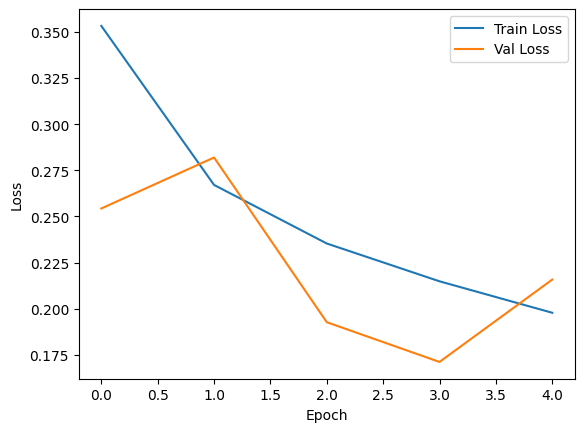

In [8]:
# Plot the loss history
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**4.5 Make predictions and save the result**

In [9]:
import numpy as np
import os
import torch
import pandas as pd
from skimage.io import imread

model.eval()

test_images_path = '/kaggle/input/histopathologic-cancer-detection/test/'
test_image_files = os.listdir(test_images_path)
#test_image_files = test_image_files[:10]

batch_size = 128
num_images = len(test_image_files)
predictions = []

for i in range(0, num_images, batch_size):
    batch_files = test_image_files[i:i + batch_size]
    batch_images = [imread(os.path.join(test_images_path, img_file)) for img_file in batch_files]
    batch_images_normalized = np.array(batch_images) / 255.0
    #batch_images_tensor = torch.tensor(batch_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2)
    batch_images_tensor = torch.tensor(batch_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

    
    with torch.no_grad():
        model.eval()
#       batch_predictions = model(batch_images_tensor).numpy()
        batch_predictions = model(batch_images_tensor).cpu().numpy()

        predictions.extend(batch_predictions)

predictions = np.array(predictions)

binary_predictions = [(p[0] < 0.3) for p in predictions]
binary_predictions = [1 if p else 0 for p in binary_predictions]

for i in range(10):
    print(f"Image {i + 1}: {test_image_files[i]}")
    print(f"Probability: {predictions[i][0]:.4f}")
    print(f"Predicted Label: {binary_predictions[i]}\n")

submission_df = pd.DataFrame({'id': [img_file[:-4] for img_file in test_image_files], 'label': binary_predictions})
submission_df = submission_df.replace({'label': {'FALSE': 0, 'TRUE': 1}})

print(f"Total number of predictions: {len(submission_df)}")

Image 1: a7ea26360815d8492433b14cd8318607bcf99d9e.tif
Probability: 1.1696
Predicted Label: 0

Image 2: 59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
Probability: 2.8358
Predicted Label: 0

Image 3: 5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
Probability: 2.9208
Predicted Label: 0

Image 4: bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
Probability: 2.7945
Predicted Label: 0

Image 5: 523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
Probability: 3.3826
Predicted Label: 0

Image 6: d23c66547f4a00555a174d2fcb860ae399b66edc.tif
Probability: 2.6320
Predicted Label: 0

Image 7: fabf2fca23f71655974767e29eda86a9b2c97a72.tif
Probability: 2.9749
Predicted Label: 0

Image 8: 9730b15862516b8641b9f0ff48db660d95031c32.tif
Probability: 3.6641
Predicted Label: 0

Image 9: ee85348c0950c2e639776fb555e3452c1f8437c0.tif
Probability: 3.8252
Predicted Label: 0

Image 10: ef12a0813c504d2d1b2ba485e78d380ad64a0622.tif
Probability: 4.0176
Predicted Label: 0

Total number of predictions: 57458


In [10]:
# Remove the old submission.csv file if it exists
submission_csv_path = '/kaggle/working/submission.csv'
if os.path.exists(submission_csv_path):
    os.remove(submission_csv_path)

submission_df.to_csv(submission_csv_path, index=False)

#shutil.make_archive('/kaggle/working/working_directory', 'zip', '/kaggle/working/')

# 5. Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

# 6. Produce Deliverables

High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard 
These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.
